In [1]:
import pandas as pd
import torch

#grab data from working directory
main_data = pd.read_csv('data/main.csv',sep=' ')
training_data = pd.read_csv('data/training.csv',sep=' ')
validation_data = pd.read_csv('data/validation.csv',sep=' ')
# training_data = training_data.rename(columns={training_data.columns[0]: 'problem_ids', training_data.columns[2]: 'tags', training_data.columns[3]: 'statement'})
# validation_data = validation_data.rename(columns={validation_data.columns[0]: 'problem_ids', validation_data.columns[2]: 'tags', validation_data.columns[3]: 'statement'})
# main_data = main_data.rename(columns={main_data.columns[0]: 'problem_ids', main_data.columns[2]: 'tags', main_data.columns[3]: 'statement'})
print(main_data.head())

   index                  name                                    tags  \
0  1873F           Money Trees  binary search,greedy,math,two pointers   
1  1873E  Building an Aquarium                  binary search,sortings   
2  1873D             1D Eraser      greedy,implementation,two pointers   
3  1873C       Target Practice                     implementation,math   
4  1873B              Good Kid                 brute force,greedy,math   

                                           statement  rating  
0  Luca is in front of a row of n trees. The i-th...    1300  
1  You love fish, that\'s why you have decided to...    1100  
2  You are given a strip of paper s that is n cel...     800  
3  A 10\xc3\x9710 target is made out of five "rin...     800  
4  Slavic is preparing a present for a friend\'s ...     800  


In [2]:
dtype = torch.float
ltype = torch.long

if torch.cuda.is_available():
  device = torch.device('cuda:0')
else:
  device = torch.device('cpu')

print('using device:', device)

using device: cuda:0


In [3]:
# prompt: write a function that filters out all rows that have empty statement or tag columns, empty as a string or empty in the df sense

def filter_empty_rows(df):
  """Filters out rows with empty 'statement' or 'tags' columns.

  Args:
    df: A pandas DataFrame.

  Returns:
    A new DataFrame with rows containing empty 'statement' or 'tags' removed.
  """
  df = df.dropna(subset=['statement', 'tags'])
  df = df[df['statement'].str.len() > 0]
  df = df[df['tags'].str.len() > 0]

  #also drop any row that has the tag *special problem
  df = df[~df['tags'].str.contains('*special problem',regex=False)]

  #also drop any row that has the tag NA
  df = df[~df['tags'].str.contains('NA',regex=False)]

  return df

training_data = filter_empty_rows(training_data)
validation_data = filter_empty_rows(validation_data)
main_data = filter_empty_rows(main_data)

In [4]:

n = 25  # Hyperparameter for the number of most frequent tags

all_tags = []
for tags in main_data['tags']:
    all_tags.extend(tags.split(','))

from collections import Counter

tag_counts = Counter(all_tags)
most_frequent_tags = set([tag for tag, count in tag_counts.most_common(n)])
index_to_tag = {i: tag for i, tag in enumerate(most_frequent_tags)}
tag_to_index = {tag: i for i, tag in index_to_tag.items()}
print(f"The {n} most frequent tags are: {most_frequent_tags}")

# prompt: what percent of problems use a tag found in the n most common ?

problems_with_top_n_tags = 0
total_problems = len(main_data)

for tags in main_data['tags']:
  if isinstance(tags, str):
    for tag in tags.split(','):
      if tag in most_frequent_tags:
        problems_with_top_n_tags += 1
        break  # Only count the problem once if it has at least one top-n tag

percentage = (problems_with_top_n_tags / total_problems) * 100
print(f"Percentage of problems with at least one of the top {n} tags: {percentage:.2f}%")

The 25 most frequent tags are: {'two pointers', 'dsu', 'probabilities', 'trees', 'graphs', 'sortings', 'strings', 'implementation', 'constructive algorithms', 'combinatorics', 'greedy', 'shortest paths', 'games', 'geometry', 'brute force', 'bitmasks', 'dp', 'math', 'divide and conquer', 'data structures', 'interactive', 'number theory', 'dfs and similar', 'hashing', 'binary search'}
Percentage of problems with at least one of the top 25 tags: 99.60%


In [5]:
# prompt: remove any tags that are not in the top n

import pandas as pd
import torch
from collections import Counter

# ... (Your existing code) ...

def filter_tags(tags_str, most_frequent_tags):
  """Filters tags in a string to only include the top n tags.

  Args:
    tags_str: A string of comma-separated tags.
    most_frequent_tags: A set of the top n most frequent tags.

  Returns:
    A new string of comma-separated tags, containing only the top n tags.
  """
  tags = tags_str.split(',')
  filtered_tags = [tag for tag in tags if tag in most_frequent_tags]
  return ','.join(filtered_tags)


main_data['tags'] = main_data['tags'].apply(lambda tags: filter_tags(tags, most_frequent_tags))
training_data['tags'] = training_data['tags'].apply(lambda tags: filter_tags(tags, most_frequent_tags))
validation_data['tags'] = validation_data['tags'].apply(lambda tags: filter_tags(tags, most_frequent_tags))

# ... (Rest of your code) ...

Subset transform below


In [6]:

def transform_training_data(df):
    transformed_data = []
    for index, row in df.iterrows():
        tags = row['tags'].split(',')
        tags = [tag for tag in tags if tag in most_frequent_tags]
        num_tags = len(tags)
        for i in range(2**num_tags):
            subset_tags = []
            for j in range(num_tags):
                if (i >> j) & 1:
                    subset_tags.append(tags[j])
            new_row = row.copy()
            new_row['tags'] = ','.join(subset_tags)
            transformed_data.append(new_row)
    return pd.DataFrame(transformed_data)
# comment out for now
training_data = transform_training_data(training_data)
print(len(training_data))

88089


88089


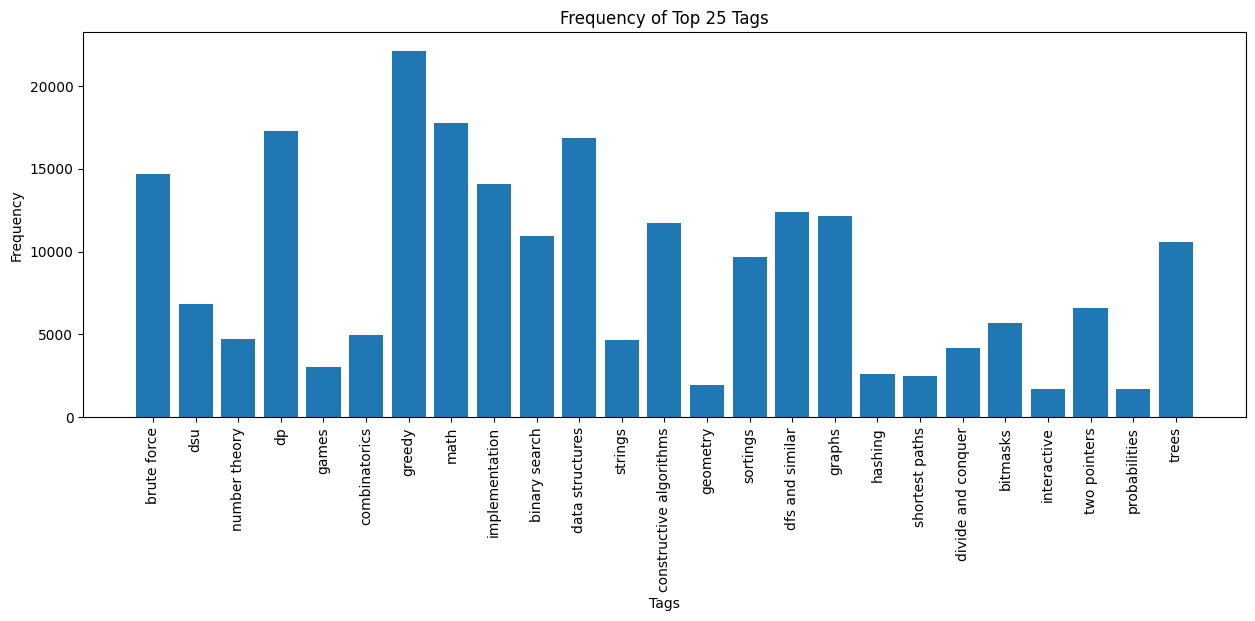

Text(0.5, 1.0, 'Frequency of Number of Tags')

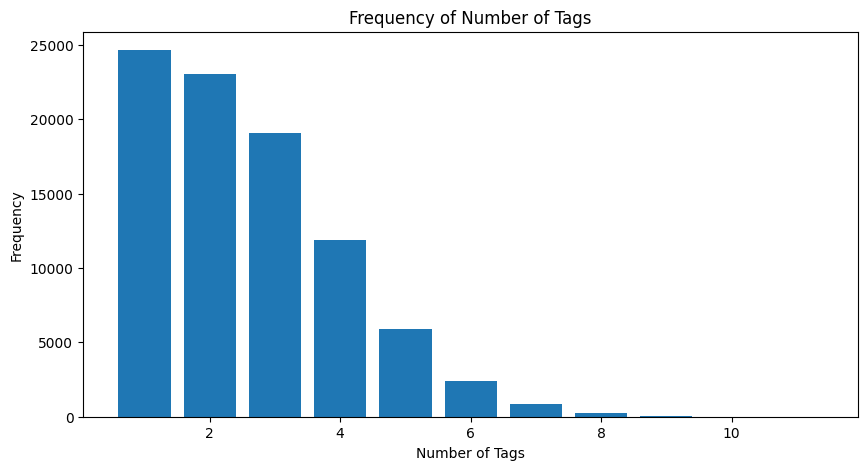

In [7]:

import matplotlib.pyplot as plt
from collections import Counter

# Assuming 'main_data' and 'most_frequent_tags' are defined as in your previous code


print(len(training_data))

# Bar graph for tag frequency
tag_frequencies = Counter([tag for tags in training_data['tags'].dropna() for tag in tags.split(',') if tag in most_frequent_tags])

plt.figure(figsize=(15, 5))
plt.bar(tag_frequencies.keys(), tag_frequencies.values())
plt.xlabel('Tags')
plt.ylabel('Frequency')
plt.title(f'Frequency of Top {n} Tags')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.show()


#bar graph for how many problems have k different tags in the top n
tag_counts = {}
for tags in training_data['tags'].dropna():
  if isinstance(tags, str):
    tag_count = len(tags.split(','))
    if tag_count in tag_counts:
      tag_counts[tag_count] += 1
    else:
      tag_counts[tag_count] = 1

plt.figure(figsize=(10, 5))
plt.bar(tag_counts.keys(), tag_counts.values())
plt.xlabel('Number of Tags')
plt.ylabel('Frequency')
plt.title(f'Frequency of Number of Tags')

In [8]:
from transformers import BertTokenizer
def problem_tags_to_vector(tags_string, most_frequent_tags, n):
  """
  Converts a string of problem tags to a PyTorch vector of length n.

  Args:
    tags_string: A string of problem tags separated by commas.
    most_frequent_tags: A set of the n most frequent problem tags.
    n: The length of the vector.

  Returns:
    A PyTorch vector of floats, where a[i] is 1 if the ith most frequent
    problem tag is present in the tags_string, and 0 otherwise.
  """
  if not isinstance(tags_string, str):
    return torch.zeros(n)
  tags = set(tags_string.split(','))
  vector = [1.0 if tag in tags else 0.0 for tag in most_frequent_tags]
  return torch.tensor(vector, dtype=torch.float32)

MAXLEN = 512
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
def tokenize_text(text):
  return tokenizer(text, padding='max_length', truncation=True, max_length=MAXLEN)

/common/home/nt406/Desktop/cf-classification/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
from transformers import BertModel
from torch.utils.data import Dataset
import torch.nn.init as init
import torch.nn as nn

class TagModel(nn.Module):
    def __init__(self):
        super(TagModel, self).__init__()
        self.bert = BertModel.from_pretrained('prajjwal1/bert-small')
        self.dropout = nn.Dropout(0.4)  # Experiment with dropout rate (e.g., 0.1-0.5)
        self.tag_classifier = nn.Sequential(
            nn.Linear(512, n),  # Your original linear layer
            nn.LayerNorm(n)   # Layer Normalization layer
        )

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        pooled_output = self.dropout(pooled_output)  # Apply dropout
        tag_pred = self.tag_classifier(pooled_output)
        return tag_pred

def init_weights(m):
    if isinstance(m, nn.Linear):
        init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

class CustomDataset(Dataset):
    def __init__(self, input_ids, attention_mask, tags, device):
        self.input_ids = input_ids.to(device)
        self.attention_mask = attention_mask.to(device)
        self.tags = tags.to(device)

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.attention_mask[idx], self.tags[idx]

In [10]:
from torch.utils.data import DataLoader, TensorDataset

texts = training_data['statement'].tolist()
encodings = tokenizer(texts, truncation=True, padding=True, max_length=MAXLEN)

tags = training_data['tags'].tolist()
tags = [problem_tags_to_vector(tag, most_frequent_tags, n) for tag in tags]

input_ids = torch.tensor(encodings['input_ids'])
attention_mask = torch.tensor(encodings['attention_mask'])

tags = torch.stack(tags)

#validation stuff
val_texts = validation_data['statement'].tolist()
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=MAXLEN)

val_tags = validation_data['tags'].tolist()
val_tags = [problem_tags_to_vector(tag, most_frequent_tags, n) for tag in val_tags]

val_input_ids = torch.tensor(val_encodings['input_ids'])
val_attention_mask = torch.tensor(val_encodings['attention_mask'])

val_tags = torch.stack(val_tags)

bsz = 32
val_dataset = CustomDataset(val_input_ids, val_attention_mask, val_tags, device)
val_loader = DataLoader(val_dataset, batch_size=bsz, shuffle=True)
dataset = CustomDataset(input_ids, attention_mask, tags, device)
loader = DataLoader(dataset, batch_size=bsz, shuffle=True)

In [11]:
# prompt: write a function that runs the model on the validation data set, and determines its accuracy on each specific tag. Returns a vector length n with the % accuracy for each tag. The model uses a threshold of 0.5 for classification. remember to apply sigmoid to map the output layer to [0,1]

def evaluate_tag_accuracy(model, val_loader, device, n):
  """
  Evaluates the model's accuracy on the validation dataset for each tag.

  Args:
    model: The trained model.
    val_loader: The DataLoader for the validation dataset.
    device: The device to run the model on (e.g., 'cuda' or 'cpu').
    n: The number of tags.

  Returns:
    A list of floats, representing the accuracy for each tag.
  """

  model.eval()  # Set the model to evaluation mode
  tag_correct_counts = [0] * n
  tag_total_counts = [0] * n
  avg_loss = 0
  with torch.no_grad():
    for batch in val_loader:
      input_ids, attention_mask, true_tags = batch
      input_ids = input_ids.to(device)
      attention_mask = attention_mask.to(device)
      true_tags = true_tags.to(device)

      tag_pred = model(input_ids, attention_mask)
      loss = nn.BCEWithLogitsLoss()(tag_pred, true_tags)
      avg_loss += loss.item()
      tag_pred = torch.sigmoid(tag_pred)  # Apply sigmoid to get probabilities in [0,1]

      predicted_tags = (tag_pred > 0.5).float()

      for i in range(n):
        tag_correct_counts[i] += (predicted_tags[:, i] == true_tags[:, i]).sum().item()
        tag_total_counts[i] += true_tags.shape[0]
  avg_loss /= len(val_loader)

  tag_accuracies = []
  for i in range(n):
    if tag_total_counts[i] > 0:
      tag_accuracies.append(tag_correct_counts[i] / tag_total_counts[i] * 100)
    else:
      tag_accuracies.append(0.0)

  return (avg_loss,tag_accuracies)

In [12]:
import matplotlib.pyplot as plt
from IPython import display
import torch.optim as optim
from tqdm import tqdm
from torch.optim.lr_scheduler import StepLR

total_losses = []
val_losses = []
val_acc = []

model = TagModel()
model.apply(init_weights)
model.to(device)
optimizer = optim.AdamW(model.parameters(), lr=5e-5)
scheduler = StepLR(optimizer, step_size = 3, gamma = 0.5) # Initialize StepLR
model.train()

EPOCHS = 5
for epoch in range(EPOCHS):
    loop = tqdm(loader, leave=True) # wrap the dataloader with tqdm
    for batch_idx, batch in enumerate(loop):
        input_ids, attention_mask, tag_labels = batch

        optimizer.zero_grad()
        tag_pred = model(input_ids=input_ids, attention_mask=attention_mask)

        loss = nn.BCEWithLogitsLoss()(tag_pred, tag_labels)

        total_losses.append(loss.item())

        loss.backward()
        optimizer.step()

        loop.set_description(f"Epoch [{epoch + 1}/{EPOCHS}]")
        loop.set_postfix(tag_loss=loss.item())

    scheduler.step() # Update learning rate at each step
    print(f"Epoch {epoch + 1} completed.")
    model.eval()
    avg_loss, tag_accuracies = evaluate_tag_accuracy(model, val_loader, device, n)
    val_losses.append(avg_loss)
    val_acc.append(tag_accuracies)
    print(f"Validation Loss: {avg_loss}")
    print(f"Tag Accuracies: {tag_accuracies}")
    model.train()


  0%|          | 0/2753 [00:00<?, ?it/s]

Epoch [1/5]:   0%|          | 0/2753 [00:00<?, ?it/s]

Epoch [1/5]:   0%|          | 0/2753 [00:00<?, ?it/s, tag_loss=0.803]

Epoch [1/5]:   0%|          | 1/2753 [00:00<27:50,  1.65it/s, tag_loss=0.803]

Epoch [1/5]:   0%|          | 1/2753 [00:00<27:50,  1.65it/s, tag_loss=0.803]

Epoch [1/5]:   0%|          | 1/2753 [00:00<27:50,  1.65it/s, tag_loss=0.785]

Epoch [1/5]:   0%|          | 2/2753 [00:00<15:45,  2.91it/s, tag_loss=0.785]

Epoch [1/5]:   0%|          | 2/2753 [00:00<15:45,  2.91it/s, tag_loss=0.785]

Epoch [1/5]:   0%|          | 2/2753 [00:00<15:45,  2.91it/s, tag_loss=0.765]

Epoch [1/5]:   0%|          | 3/2753 [00:00<11:53,  3.85it/s, tag_loss=0.765]

Epoch [1/5]:   0%|          | 3/2753 [00:00<11:53,  3.85it/s, tag_loss=0.765]

Epoch [1/5]:   0%|          | 3/2753 [00:01<11:53,  3.85it/s, tag_loss=0.764]

Epoch [1/5]:   0%|          | 4/2753 [00:01<10:06,  4.53it/s, tag_loss=0.764]

Epoch [1/5]:   0%|          | 4/2753 [00:01<10:06,  4.53it/s, tag_loss=0.764]

Epoch [1/5]:   0%|          | 4/2753 [00:01<10:06,  4.53it/s, tag_loss=0.772]

Epoch [1/5]:   0%|          | 5/2753 [00:01<09:05,  5.03it/s, tag_loss=0.772]

Epoch [1/5]:   0%|          | 5/2753 [00:01<09:05,  5.03it/s, tag_loss=0.772]

Epoch [1/5]:   0%|          | 5/2753 [00:01<09:05,  5.03it/s, tag_loss=0.736]

Epoch [1/5]:   0%|          | 6/2753 [00:01<08:29,  5.40it/s, tag_loss=0.736]

Epoch [1/5]:   0%|          | 6/2753 [00:01<08:29,  5.40it/s, tag_loss=0.736]

Epoch [1/5]:   0%|          | 6/2753 [00:01<08:29,  5.40it/s, tag_loss=0.741]

Epoch [1/5]:   0%|          | 7/2753 [00:01<08:06,  5.64it/s, tag_loss=0.741]

Epoch [1/5]:   0%|          | 7/2753 [00:01<08:06,  5.64it/s, tag_loss=0.741]

Epoch [1/5]:   0%|          | 7/2753 [00:01<08:06,  5.64it/s, tag_loss=0.76] 

Epoch [1/5]:   0%|          | 8/2753 [00:01<07:51,  5.82it/s, tag_loss=0.76]

Epoch [1/5]:   0%|          | 8/2753 [00:01<07:51,  5.82it/s, tag_loss=0.76]

Epoch [1/5]:   0%|          | 8/2753 [00:01<07:51,  5.82it/s, tag_loss=0.732]

Epoch [1/5]:   0%|          | 9/2753 [00:01<07:40,  5.96it/s, tag_loss=0.732]

Epoch [1/5]:   0%|          | 9/2753 [00:01<07:40,  5.96it/s, tag_loss=0.732]

Epoch [1/5]:   0%|          | 9/2753 [00:02<07:40,  5.96it/s, tag_loss=0.736]

Epoch [1/5]:   0%|          | 10/2753 [00:02<07:33,  6.05it/s, tag_loss=0.736]

Epoch [1/5]:   0%|          | 10/2753 [00:02<07:33,  6.05it/s, tag_loss=0.736]

Epoch [1/5]:   0%|          | 10/2753 [00:02<07:33,  6.05it/s, tag_loss=0.725]

Epoch [1/5]:   0%|          | 11/2753 [00:02<07:28,  6.12it/s, tag_loss=0.725]

Epoch [1/5]:   0%|          | 11/2753 [00:02<07:28,  6.12it/s, tag_loss=0.725]

Epoch [1/5]:   0%|          | 11/2753 [00:02<07:28,  6.12it/s, tag_loss=0.763]

Epoch [1/5]:   0%|          | 12/2753 [00:02<07:24,  6.17it/s, tag_loss=0.763]

Epoch [1/5]:   0%|          | 12/2753 [00:02<07:24,  6.17it/s, tag_loss=0.763]

Epoch [1/5]:   0%|          | 12/2753 [00:02<07:24,  6.17it/s, tag_loss=0.732]

Epoch [1/5]:   0%|          | 13/2753 [00:02<07:23,  6.18it/s, tag_loss=0.732]

Epoch [1/5]:   0%|          | 13/2753 [00:02<07:23,  6.18it/s, tag_loss=0.732]

Epoch [1/5]:   0%|          | 13/2753 [00:02<07:23,  6.18it/s, tag_loss=0.738]

Epoch [1/5]:   1%|          | 14/2753 [00:02<07:21,  6.20it/s, tag_loss=0.738]

Epoch [1/5]:   1%|          | 14/2753 [00:02<07:21,  6.20it/s, tag_loss=0.738]

Epoch [1/5]:   1%|          | 14/2753 [00:02<07:21,  6.20it/s, tag_loss=0.759]

Epoch [1/5]:   1%|          | 15/2753 [00:02<07:20,  6.21it/s, tag_loss=0.759]

Epoch [1/5]:   1%|          | 15/2753 [00:02<07:20,  6.21it/s, tag_loss=0.759]

Epoch [1/5]:   1%|          | 15/2753 [00:03<07:20,  6.21it/s, tag_loss=0.736]

Epoch [1/5]:   1%|          | 16/2753 [00:03<07:19,  6.22it/s, tag_loss=0.736]

Epoch [1/5]:   1%|          | 16/2753 [00:03<07:19,  6.22it/s, tag_loss=0.736]

Epoch [1/5]:   1%|          | 16/2753 [00:03<07:19,  6.22it/s, tag_loss=0.755]

Epoch [1/5]:   1%|          | 17/2753 [00:03<07:18,  6.23it/s, tag_loss=0.755]

Epoch [1/5]:   1%|          | 17/2753 [00:03<07:18,  6.23it/s, tag_loss=0.755]

Epoch [1/5]:   1%|          | 17/2753 [00:03<07:18,  6.23it/s, tag_loss=0.707]

Epoch [1/5]:   1%|          | 18/2753 [00:03<07:19,  6.23it/s, tag_loss=0.707]

Epoch [1/5]:   1%|          | 18/2753 [00:03<07:19,  6.23it/s, tag_loss=0.707]

Epoch [1/5]:   1%|          | 18/2753 [00:03<07:19,  6.23it/s, tag_loss=0.741]

Epoch [1/5]:   1%|          | 19/2753 [00:03<07:17,  6.25it/s, tag_loss=0.741]

Epoch [1/5]:   1%|          | 19/2753 [00:03<07:17,  6.25it/s, tag_loss=0.741]

Epoch [1/5]:   1%|          | 19/2753 [00:03<07:17,  6.25it/s, tag_loss=0.72] 

Epoch [1/5]:   1%|          | 20/2753 [00:03<07:16,  6.26it/s, tag_loss=0.72]

Epoch [1/5]:   1%|          | 20/2753 [00:03<07:16,  6.26it/s, tag_loss=0.72]

Epoch [1/5]:   1%|          | 20/2753 [00:03<07:16,  6.26it/s, tag_loss=0.745]

Epoch [1/5]:   1%|          | 21/2753 [00:03<07:17,  6.25it/s, tag_loss=0.745]

Epoch [1/5]:   1%|          | 21/2753 [00:03<07:17,  6.25it/s, tag_loss=0.745]

Epoch [1/5]:   1%|          | 21/2753 [00:03<07:17,  6.25it/s, tag_loss=0.736]

Epoch [1/5]:   1%|          | 22/2753 [00:03<07:17,  6.24it/s, tag_loss=0.736]

Epoch [1/5]:   1%|          | 22/2753 [00:04<07:17,  6.24it/s, tag_loss=0.736]

Epoch [1/5]:   1%|          | 22/2753 [00:04<07:17,  6.24it/s, tag_loss=0.736]

Epoch [1/5]:   1%|          | 23/2753 [00:04<07:18,  6.23it/s, tag_loss=0.736]

Epoch [1/5]:   1%|          | 23/2753 [00:04<07:18,  6.23it/s, tag_loss=0.736]

Epoch [1/5]:   1%|          | 23/2753 [00:04<07:18,  6.23it/s, tag_loss=0.735]

Epoch [1/5]:   1%|          | 24/2753 [00:04<07:18,  6.23it/s, tag_loss=0.735]

Epoch [1/5]:   1%|          | 24/2753 [00:04<07:18,  6.23it/s, tag_loss=0.735]

Epoch [1/5]:   1%|          | 24/2753 [00:04<07:18,  6.23it/s, tag_loss=0.716]

Epoch [1/5]:   1%|          | 25/2753 [00:04<07:18,  6.22it/s, tag_loss=0.716]

Epoch [1/5]:   1%|          | 25/2753 [00:04<07:18,  6.22it/s, tag_loss=0.716]

Epoch [1/5]:   1%|          | 25/2753 [00:04<07:18,  6.22it/s, tag_loss=0.744]

Epoch [1/5]:   1%|          | 26/2753 [00:04<07:17,  6.23it/s, tag_loss=0.744]

Epoch [1/5]:   1%|          | 26/2753 [00:04<07:17,  6.23it/s, tag_loss=0.744]

Epoch [1/5]:   1%|          | 26/2753 [00:04<07:17,  6.23it/s, tag_loss=0.76] 

Epoch [1/5]:   1%|          | 27/2753 [00:04<07:17,  6.23it/s, tag_loss=0.76]

Epoch [1/5]:   1%|          | 27/2753 [00:04<07:17,  6.23it/s, tag_loss=0.76]

Epoch [1/5]:   1%|          | 27/2753 [00:04<07:17,  6.23it/s, tag_loss=0.71]

Epoch [1/5]:   1%|          | 28/2753 [00:04<07:18,  6.21it/s, tag_loss=0.71]

Epoch [1/5]:   1%|          | 28/2753 [00:04<07:18,  6.21it/s, tag_loss=0.71]

Epoch [1/5]:   1%|          | 28/2753 [00:05<07:18,  6.21it/s, tag_loss=0.709]

Epoch [1/5]:   1%|          | 29/2753 [00:05<07:19,  6.20it/s, tag_loss=0.709]

Epoch [1/5]:   1%|          | 29/2753 [00:05<07:19,  6.20it/s, tag_loss=0.709]

Epoch [1/5]:   1%|          | 29/2753 [00:05<07:19,  6.20it/s, tag_loss=0.728]

Epoch [1/5]:   1%|          | 30/2753 [00:05<07:18,  6.20it/s, tag_loss=0.728]

Epoch [1/5]:   1%|          | 30/2753 [00:05<07:18,  6.20it/s, tag_loss=0.728]

Epoch [1/5]:   1%|          | 30/2753 [00:05<07:18,  6.20it/s, tag_loss=0.729]

Epoch [1/5]:   1%|          | 31/2753 [00:05<07:18,  6.21it/s, tag_loss=0.729]

Epoch [1/5]:   1%|          | 31/2753 [00:05<07:18,  6.21it/s, tag_loss=0.729]

Epoch [1/5]:   1%|          | 31/2753 [00:05<07:18,  6.21it/s, tag_loss=0.742]

Epoch [1/5]:   1%|          | 32/2753 [00:05<07:17,  6.21it/s, tag_loss=0.742]

Epoch [1/5]:   1%|          | 32/2753 [00:05<07:17,  6.21it/s, tag_loss=0.742]

Epoch [1/5]:   1%|          | 32/2753 [00:05<07:17,  6.21it/s, tag_loss=0.742]

Epoch [1/5]:   1%|          | 33/2753 [00:05<07:17,  6.21it/s, tag_loss=0.742]

Epoch [1/5]:   1%|          | 33/2753 [00:05<07:17,  6.21it/s, tag_loss=0.742]

Epoch [1/5]:   1%|          | 33/2753 [00:05<07:17,  6.21it/s, tag_loss=0.717]

Epoch [1/5]:   1%|          | 34/2753 [00:05<07:17,  6.21it/s, tag_loss=0.717]

Epoch [1/5]:   1%|          | 34/2753 [00:05<07:17,  6.21it/s, tag_loss=0.717]

Epoch [1/5]:   1%|          | 34/2753 [00:06<07:17,  6.21it/s, tag_loss=0.744]

Epoch [1/5]:   1%|▏         | 35/2753 [00:06<07:17,  6.22it/s, tag_loss=0.744]

Epoch [1/5]:   1%|▏         | 35/2753 [00:06<07:17,  6.22it/s, tag_loss=0.744]

Epoch [1/5]:   1%|▏         | 35/2753 [00:06<07:17,  6.22it/s, tag_loss=0.738]

Epoch [1/5]:   1%|▏         | 36/2753 [00:06<07:16,  6.23it/s, tag_loss=0.738]

Epoch [1/5]:   1%|▏         | 36/2753 [00:06<07:16,  6.23it/s, tag_loss=0.738]

Epoch [1/5]:   1%|▏         | 36/2753 [00:06<07:16,  6.23it/s, tag_loss=0.74] 

Epoch [1/5]:   1%|▏         | 37/2753 [00:06<07:15,  6.23it/s, tag_loss=0.74]

Epoch [1/5]:   1%|▏         | 37/2753 [00:06<07:15,  6.23it/s, tag_loss=0.74]

Epoch [1/5]:   1%|▏         | 37/2753 [00:06<07:15,  6.23it/s, tag_loss=0.733]

Epoch [1/5]:   1%|▏         | 38/2753 [00:06<07:16,  6.22it/s, tag_loss=0.733]

Epoch [1/5]:   1%|▏         | 38/2753 [00:06<07:16,  6.22it/s, tag_loss=0.733]

Epoch [1/5]:   1%|▏         | 38/2753 [00:06<07:16,  6.22it/s, tag_loss=0.749]

Epoch [1/5]:   1%|▏         | 39/2753 [00:06<07:16,  6.22it/s, tag_loss=0.749]

Epoch [1/5]:   1%|▏         | 39/2753 [00:06<07:16,  6.22it/s, tag_loss=0.749]

Epoch [1/5]:   1%|▏         | 39/2753 [00:06<07:16,  6.22it/s, tag_loss=0.697]

Epoch [1/5]:   1%|▏         | 40/2753 [00:06<07:16,  6.22it/s, tag_loss=0.697]

Epoch [1/5]:   1%|▏         | 40/2753 [00:06<07:16,  6.22it/s, tag_loss=0.697]

Epoch [1/5]:   1%|▏         | 40/2753 [00:07<07:16,  6.22it/s, tag_loss=0.714]

Epoch [1/5]:   1%|▏         | 41/2753 [00:07<07:16,  6.21it/s, tag_loss=0.714]

Epoch [1/5]:   1%|▏         | 41/2753 [00:07<07:16,  6.21it/s, tag_loss=0.714]

Epoch [1/5]:   1%|▏         | 41/2753 [00:07<07:16,  6.21it/s, tag_loss=0.721]

Epoch [1/5]:   2%|▏         | 42/2753 [00:07<07:17,  6.20it/s, tag_loss=0.721]

Epoch [1/5]:   2%|▏         | 42/2753 [00:07<07:17,  6.20it/s, tag_loss=0.721]

Epoch [1/5]:   2%|▏         | 42/2753 [00:07<07:17,  6.20it/s, tag_loss=0.754]

Epoch [1/5]:   2%|▏         | 43/2753 [00:07<07:17,  6.20it/s, tag_loss=0.754]

Epoch [1/5]:   2%|▏         | 43/2753 [00:07<07:17,  6.20it/s, tag_loss=0.754]

Epoch [1/5]:   2%|▏         | 43/2753 [00:07<07:17,  6.20it/s, tag_loss=0.762]

Epoch [1/5]:   2%|▏         | 44/2753 [00:07<07:16,  6.20it/s, tag_loss=0.762]

Epoch [1/5]:   2%|▏         | 44/2753 [00:07<07:16,  6.20it/s, tag_loss=0.762]

Epoch [1/5]:   2%|▏         | 44/2753 [00:07<07:16,  6.20it/s, tag_loss=0.729]

Epoch [1/5]:   2%|▏         | 45/2753 [00:07<07:16,  6.20it/s, tag_loss=0.729]

Epoch [1/5]:   2%|▏         | 45/2753 [00:07<07:16,  6.20it/s, tag_loss=0.729]

Epoch [1/5]:   2%|▏         | 45/2753 [00:07<07:16,  6.20it/s, tag_loss=0.746]

Epoch [1/5]:   2%|▏         | 46/2753 [00:07<07:16,  6.20it/s, tag_loss=0.746]

Epoch [1/5]:   2%|▏         | 46/2753 [00:07<07:16,  6.20it/s, tag_loss=0.746]

Epoch [1/5]:   2%|▏         | 46/2753 [00:07<07:16,  6.20it/s, tag_loss=0.735]

Epoch [1/5]:   2%|▏         | 47/2753 [00:07<07:16,  6.20it/s, tag_loss=0.735]

Epoch [1/5]:   2%|▏         | 47/2753 [00:08<07:16,  6.20it/s, tag_loss=0.735]

Epoch [1/5]:   2%|▏         | 47/2753 [00:08<07:16,  6.20it/s, tag_loss=0.718]

Epoch [1/5]:   2%|▏         | 48/2753 [00:08<07:15,  6.21it/s, tag_loss=0.718]

Epoch [1/5]:   2%|▏         | 48/2753 [00:08<07:15,  6.21it/s, tag_loss=0.718]

Epoch [1/5]:   2%|▏         | 48/2753 [00:08<07:15,  6.21it/s, tag_loss=0.719]

Epoch [1/5]:   2%|▏         | 49/2753 [00:08<07:15,  6.21it/s, tag_loss=0.719]

Epoch [1/5]:   2%|▏         | 49/2753 [00:08<07:15,  6.21it/s, tag_loss=0.719]

Epoch [1/5]:   2%|▏         | 49/2753 [00:08<07:15,  6.21it/s, tag_loss=0.726]

Epoch [1/5]:   2%|▏         | 50/2753 [00:08<07:16,  6.19it/s, tag_loss=0.726]

Epoch [1/5]:   2%|▏         | 50/2753 [00:08<07:16,  6.19it/s, tag_loss=0.726]

Epoch [1/5]:   2%|▏         | 50/2753 [00:08<07:16,  6.19it/s, tag_loss=0.709]

Epoch [1/5]:   2%|▏         | 51/2753 [00:08<07:16,  6.19it/s, tag_loss=0.709]

Epoch [1/5]:   2%|▏         | 51/2753 [00:08<07:16,  6.19it/s, tag_loss=0.709]

Epoch [1/5]:   2%|▏         | 51/2753 [00:08<07:16,  6.19it/s, tag_loss=0.718]

Epoch [1/5]:   2%|▏         | 52/2753 [00:08<07:16,  6.19it/s, tag_loss=0.718]

Epoch [1/5]:   2%|▏         | 52/2753 [00:08<07:16,  6.19it/s, tag_loss=0.718]

Epoch [1/5]:   2%|▏         | 52/2753 [00:08<07:16,  6.19it/s, tag_loss=0.701]

Epoch [1/5]:   2%|▏         | 53/2753 [00:08<07:16,  6.19it/s, tag_loss=0.701]

Epoch [1/5]:   2%|▏         | 53/2753 [00:09<07:16,  6.19it/s, tag_loss=0.701]

Epoch [1/5]:   2%|▏         | 53/2753 [00:09<07:16,  6.19it/s, tag_loss=0.747]

Epoch [1/5]:   2%|▏         | 54/2753 [00:09<07:16,  6.19it/s, tag_loss=0.747]

Epoch [1/5]:   2%|▏         | 54/2753 [00:09<07:16,  6.19it/s, tag_loss=0.747]

Epoch [1/5]:   2%|▏         | 54/2753 [00:09<07:16,  6.19it/s, tag_loss=0.736]

Epoch [1/5]:   2%|▏         | 55/2753 [00:09<07:16,  6.18it/s, tag_loss=0.736]

Epoch [1/5]:   2%|▏         | 55/2753 [00:09<07:16,  6.18it/s, tag_loss=0.736]

Epoch [1/5]:   2%|▏         | 55/2753 [00:09<07:16,  6.18it/s, tag_loss=0.744]

Epoch [1/5]:   2%|▏         | 56/2753 [00:09<07:15,  6.19it/s, tag_loss=0.744]

Epoch [1/5]:   2%|▏         | 56/2753 [00:09<07:15,  6.19it/s, tag_loss=0.744]

Epoch [1/5]:   2%|▏         | 56/2753 [00:09<07:15,  6.19it/s, tag_loss=0.736]

Epoch [1/5]:   2%|▏         | 57/2753 [00:09<07:16,  6.18it/s, tag_loss=0.736]

Epoch [1/5]:   2%|▏         | 57/2753 [00:09<07:16,  6.18it/s, tag_loss=0.736]

Epoch [1/5]:   2%|▏         | 57/2753 [00:09<07:16,  6.18it/s, tag_loss=0.737]

Epoch [1/5]:   2%|▏         | 58/2753 [00:09<07:16,  6.18it/s, tag_loss=0.737]

Epoch [1/5]:   2%|▏         | 58/2753 [00:09<07:16,  6.18it/s, tag_loss=0.737]

Epoch [1/5]:   2%|▏         | 58/2753 [00:09<07:16,  6.18it/s, tag_loss=0.759]

Epoch [1/5]:   2%|▏         | 59/2753 [00:09<07:15,  6.18it/s, tag_loss=0.759]

Epoch [1/5]:   2%|▏         | 59/2753 [00:09<07:15,  6.18it/s, tag_loss=0.759]

Epoch [1/5]:   2%|▏         | 59/2753 [00:10<07:15,  6.18it/s, tag_loss=0.734]

Epoch [1/5]:   2%|▏         | 60/2753 [00:10<07:15,  6.19it/s, tag_loss=0.734]

Epoch [1/5]:   2%|▏         | 60/2753 [00:10<07:15,  6.19it/s, tag_loss=0.734]

Epoch [1/5]:   2%|▏         | 60/2753 [00:10<07:15,  6.19it/s, tag_loss=0.747]

Epoch [1/5]:   2%|▏         | 61/2753 [00:10<07:14,  6.19it/s, tag_loss=0.747]

Epoch [1/5]:   2%|▏         | 61/2753 [00:10<07:14,  6.19it/s, tag_loss=0.747]

Epoch [1/5]:   2%|▏         | 61/2753 [00:10<07:14,  6.19it/s, tag_loss=0.727]

Epoch [1/5]:   2%|▏         | 62/2753 [00:10<07:14,  6.20it/s, tag_loss=0.727]

Epoch [1/5]:   2%|▏         | 62/2753 [00:10<07:14,  6.20it/s, tag_loss=0.727]

Epoch [1/5]:   2%|▏         | 62/2753 [00:10<07:14,  6.20it/s, tag_loss=0.712]

Epoch [1/5]:   2%|▏         | 63/2753 [00:10<07:13,  6.21it/s, tag_loss=0.712]

Epoch [1/5]:   2%|▏         | 63/2753 [00:10<07:13,  6.21it/s, tag_loss=0.712]

Epoch [1/5]:   2%|▏         | 63/2753 [00:10<07:13,  6.21it/s, tag_loss=0.742]

Epoch [1/5]:   2%|▏         | 64/2753 [00:10<07:13,  6.21it/s, tag_loss=0.742]

Epoch [1/5]:   2%|▏         | 64/2753 [00:10<07:13,  6.21it/s, tag_loss=0.742]

Epoch [1/5]:   2%|▏         | 64/2753 [00:10<07:13,  6.21it/s, tag_loss=0.745]

Epoch [1/5]:   2%|▏         | 65/2753 [00:10<07:13,  6.20it/s, tag_loss=0.745]

Epoch [1/5]:   2%|▏         | 65/2753 [00:10<07:13,  6.20it/s, tag_loss=0.745]

Epoch [1/5]:   2%|▏         | 65/2753 [00:11<07:13,  6.20it/s, tag_loss=0.725]

Epoch [1/5]:   2%|▏         | 66/2753 [00:11<07:14,  6.19it/s, tag_loss=0.725]

Epoch [1/5]:   2%|▏         | 66/2753 [00:11<07:14,  6.19it/s, tag_loss=0.725]

Epoch [1/5]:   2%|▏         | 66/2753 [00:11<07:14,  6.19it/s, tag_loss=0.726]

Epoch [1/5]:   2%|▏         | 67/2753 [00:11<07:14,  6.18it/s, tag_loss=0.726]

Epoch [1/5]:   2%|▏         | 67/2753 [00:11<07:14,  6.18it/s, tag_loss=0.726]

Epoch [1/5]:   2%|▏         | 67/2753 [00:11<07:14,  6.18it/s, tag_loss=0.72] 

Epoch [1/5]:   2%|▏         | 68/2753 [00:11<07:14,  6.18it/s, tag_loss=0.72]

Epoch [1/5]:   2%|▏         | 68/2753 [00:11<07:14,  6.18it/s, tag_loss=0.72]

Epoch [1/5]:   2%|▏         | 68/2753 [00:11<07:14,  6.18it/s, tag_loss=0.747]

Epoch [1/5]:   3%|▎         | 69/2753 [00:11<07:13,  6.19it/s, tag_loss=0.747]

Epoch [1/5]:   3%|▎         | 69/2753 [00:11<07:13,  6.19it/s, tag_loss=0.747]

Epoch [1/5]:   3%|▎         | 69/2753 [00:11<07:13,  6.19it/s, tag_loss=0.712]

Epoch [1/5]:   3%|▎         | 70/2753 [00:11<07:14,  6.17it/s, tag_loss=0.712]

Epoch [1/5]:   3%|▎         | 70/2753 [00:11<07:14,  6.17it/s, tag_loss=0.712]

Epoch [1/5]:   3%|▎         | 70/2753 [00:11<07:14,  6.17it/s, tag_loss=0.725]

Epoch [1/5]:   3%|▎         | 71/2753 [00:11<07:14,  6.17it/s, tag_loss=0.725]

Epoch [1/5]:   3%|▎         | 71/2753 [00:11<07:14,  6.17it/s, tag_loss=0.725]

Epoch [1/5]:   3%|▎         | 71/2753 [00:12<07:14,  6.17it/s, tag_loss=0.734]

Epoch [1/5]:   3%|▎         | 72/2753 [00:12<07:14,  6.17it/s, tag_loss=0.734]

Epoch [1/5]:   3%|▎         | 72/2753 [00:12<07:14,  6.17it/s, tag_loss=0.734]

Epoch [1/5]:   3%|▎         | 72/2753 [00:12<07:14,  6.17it/s, tag_loss=0.737]

Epoch [1/5]:   3%|▎         | 73/2753 [00:12<07:13,  6.18it/s, tag_loss=0.737]

Epoch [1/5]:   3%|▎         | 73/2753 [00:12<07:13,  6.18it/s, tag_loss=0.737]

Epoch [1/5]:   3%|▎         | 73/2753 [00:12<07:13,  6.18it/s, tag_loss=0.736]

Epoch [1/5]:   3%|▎         | 74/2753 [00:12<07:13,  6.17it/s, tag_loss=0.736]

Epoch [1/5]:   3%|▎         | 74/2753 [00:12<07:13,  6.17it/s, tag_loss=0.736]

Epoch [1/5]:   3%|▎         | 74/2753 [00:12<07:13,  6.17it/s, tag_loss=0.741]

Epoch [1/5]:   3%|▎         | 75/2753 [00:12<07:14,  6.17it/s, tag_loss=0.741]

Epoch [1/5]:   3%|▎         | 75/2753 [00:12<07:14,  6.17it/s, tag_loss=0.741]

Epoch [1/5]:   3%|▎         | 75/2753 [00:12<07:14,  6.17it/s, tag_loss=0.716]

Epoch [1/5]:   3%|▎         | 76/2753 [00:12<07:14,  6.17it/s, tag_loss=0.716]

Epoch [1/5]:   3%|▎         | 76/2753 [00:12<07:14,  6.17it/s, tag_loss=0.716]

Epoch [1/5]:   3%|▎         | 76/2753 [00:12<07:14,  6.17it/s, tag_loss=0.735]

Epoch [1/5]:   3%|▎         | 77/2753 [00:12<07:13,  6.18it/s, tag_loss=0.735]

Epoch [1/5]:   3%|▎         | 77/2753 [00:12<07:13,  6.18it/s, tag_loss=0.735]

Epoch [1/5]:   3%|▎         | 77/2753 [00:13<07:13,  6.18it/s, tag_loss=0.732]

Epoch [1/5]:   3%|▎         | 78/2753 [00:13<07:12,  6.18it/s, tag_loss=0.732]

Epoch [1/5]:   3%|▎         | 78/2753 [00:13<07:12,  6.18it/s, tag_loss=0.732]

Epoch [1/5]:   3%|▎         | 78/2753 [00:13<07:12,  6.18it/s, tag_loss=0.721]

Epoch [1/5]:   3%|▎         | 79/2753 [00:13<07:12,  6.18it/s, tag_loss=0.721]

Epoch [1/5]:   3%|▎         | 79/2753 [00:13<07:12,  6.18it/s, tag_loss=0.721]

Epoch [1/5]:   3%|▎         | 79/2753 [00:13<07:12,  6.18it/s, tag_loss=0.736]

Epoch [1/5]:   3%|▎         | 80/2753 [00:13<07:13,  6.16it/s, tag_loss=0.736]

Epoch [1/5]:   3%|▎         | 80/2753 [00:13<07:13,  6.16it/s, tag_loss=0.736]

Epoch [1/5]:   3%|▎         | 80/2753 [00:13<07:13,  6.16it/s, tag_loss=0.726]

Epoch [1/5]:   3%|▎         | 81/2753 [00:13<07:12,  6.17it/s, tag_loss=0.726]

Epoch [1/5]:   3%|▎         | 81/2753 [00:13<07:12,  6.17it/s, tag_loss=0.726]

Epoch [1/5]:   3%|▎         | 81/2753 [00:13<07:12,  6.17it/s, tag_loss=0.729]

Epoch [1/5]:   3%|▎         | 82/2753 [00:13<07:13,  6.17it/s, tag_loss=0.729]

Epoch [1/5]:   3%|▎         | 82/2753 [00:13<07:13,  6.17it/s, tag_loss=0.729]

Epoch [1/5]:   3%|▎         | 82/2753 [00:13<07:13,  6.17it/s, tag_loss=0.753]

Epoch [1/5]:   3%|▎         | 83/2753 [00:13<07:13,  6.16it/s, tag_loss=0.753]

Epoch [1/5]:   3%|▎         | 83/2753 [00:13<07:13,  6.16it/s, tag_loss=0.753]

Epoch [1/5]:   3%|▎         | 83/2753 [00:13<07:13,  6.16it/s, tag_loss=0.726]

Epoch [1/5]:   3%|▎         | 84/2753 [00:13<07:12,  6.17it/s, tag_loss=0.726]

Epoch [1/5]:   3%|▎         | 84/2753 [00:14<07:12,  6.17it/s, tag_loss=0.726]

Epoch [1/5]:   3%|▎         | 84/2753 [00:14<07:12,  6.17it/s, tag_loss=0.732]

Epoch [1/5]:   3%|▎         | 85/2753 [00:14<07:12,  6.17it/s, tag_loss=0.732]

Epoch [1/5]:   3%|▎         | 85/2753 [00:14<07:12,  6.17it/s, tag_loss=0.732]

Epoch [1/5]:   3%|▎         | 85/2753 [00:14<07:12,  6.17it/s, tag_loss=0.718]

Epoch [1/5]:   3%|▎         | 86/2753 [00:14<07:12,  6.17it/s, tag_loss=0.718]

Epoch [1/5]:   3%|▎         | 86/2753 [00:14<07:12,  6.17it/s, tag_loss=0.718]

Epoch [1/5]:   3%|▎         | 86/2753 [00:14<07:12,  6.17it/s, tag_loss=0.721]

Epoch [1/5]:   3%|▎         | 87/2753 [00:14<07:11,  6.18it/s, tag_loss=0.721]

Epoch [1/5]:   3%|▎         | 87/2753 [00:14<07:11,  6.18it/s, tag_loss=0.721]

Epoch [1/5]:   3%|▎         | 87/2753 [00:14<07:11,  6.18it/s, tag_loss=0.746]

Epoch [1/5]:   3%|▎         | 88/2753 [00:14<07:11,  6.18it/s, tag_loss=0.746]

Epoch [1/5]:   3%|▎         | 88/2753 [00:14<07:11,  6.18it/s, tag_loss=0.746]

Epoch [1/5]:   3%|▎         | 88/2753 [00:14<07:11,  6.18it/s, tag_loss=0.722]

Epoch [1/5]:   3%|▎         | 89/2753 [00:14<07:11,  6.18it/s, tag_loss=0.722]

Epoch [1/5]:   3%|▎         | 89/2753 [00:14<07:11,  6.18it/s, tag_loss=0.722]

Epoch [1/5]:   3%|▎         | 89/2753 [00:14<07:11,  6.18it/s, tag_loss=0.737]

Epoch [1/5]:   3%|▎         | 90/2753 [00:14<07:11,  6.17it/s, tag_loss=0.737]

Epoch [1/5]:   3%|▎         | 90/2753 [00:15<07:11,  6.17it/s, tag_loss=0.737]

Epoch [1/5]:   3%|▎         | 90/2753 [00:15<07:11,  6.17it/s, tag_loss=0.741]

Epoch [1/5]:   3%|▎         | 91/2753 [00:15<07:11,  6.17it/s, tag_loss=0.741]

Epoch [1/5]:   3%|▎         | 91/2753 [00:15<07:11,  6.17it/s, tag_loss=0.741]

Epoch [1/5]:   3%|▎         | 91/2753 [00:15<07:11,  6.17it/s, tag_loss=0.737]

Epoch [1/5]:   3%|▎         | 92/2753 [00:15<07:11,  6.17it/s, tag_loss=0.737]

Epoch [1/5]:   3%|▎         | 92/2753 [00:15<07:11,  6.17it/s, tag_loss=0.737]

Epoch [1/5]:   3%|▎         | 92/2753 [00:15<07:11,  6.17it/s, tag_loss=0.736]

Epoch [1/5]:   3%|▎         | 93/2753 [00:15<07:10,  6.17it/s, tag_loss=0.736]

Epoch [1/5]:   3%|▎         | 93/2753 [00:15<07:10,  6.17it/s, tag_loss=0.736]

Epoch [1/5]:   3%|▎         | 93/2753 [00:15<07:10,  6.17it/s, tag_loss=0.724]

Epoch [1/5]:   3%|▎         | 94/2753 [00:15<07:10,  6.18it/s, tag_loss=0.724]

Epoch [1/5]:   3%|▎         | 94/2753 [00:15<07:10,  6.18it/s, tag_loss=0.724]

Epoch [1/5]:   3%|▎         | 94/2753 [00:15<07:10,  6.18it/s, tag_loss=0.741]

Epoch [1/5]:   3%|▎         | 95/2753 [00:15<07:09,  6.18it/s, tag_loss=0.741]

Epoch [1/5]:   3%|▎         | 95/2753 [00:15<07:09,  6.18it/s, tag_loss=0.741]

Epoch [1/5]:   3%|▎         | 95/2753 [00:15<07:09,  6.18it/s, tag_loss=0.729]

Epoch [1/5]:   3%|▎         | 96/2753 [00:15<07:09,  6.19it/s, tag_loss=0.729]

Epoch [1/5]:   3%|▎         | 96/2753 [00:15<07:09,  6.19it/s, tag_loss=0.729]

Epoch [1/5]:   3%|▎         | 96/2753 [00:16<07:09,  6.19it/s, tag_loss=0.734]

Epoch [1/5]:   4%|▎         | 97/2753 [00:16<07:08,  6.19it/s, tag_loss=0.734]

Epoch [1/5]:   4%|▎         | 97/2753 [00:16<07:08,  6.19it/s, tag_loss=0.734]

Epoch [1/5]:   4%|▎         | 97/2753 [00:16<07:08,  6.19it/s, tag_loss=0.731]

Epoch [1/5]:   4%|▎         | 98/2753 [00:16<07:08,  6.19it/s, tag_loss=0.731]

Epoch [1/5]:   4%|▎         | 98/2753 [00:16<07:08,  6.19it/s, tag_loss=0.731]

Epoch [1/5]:   4%|▎         | 98/2753 [00:16<07:08,  6.19it/s, tag_loss=0.724]

Epoch [1/5]:   4%|▎         | 99/2753 [00:16<07:08,  6.20it/s, tag_loss=0.724]

Epoch [1/5]:   4%|▎         | 99/2753 [00:16<07:08,  6.20it/s, tag_loss=0.724]

Epoch [1/5]:   4%|▎         | 99/2753 [00:16<07:08,  6.20it/s, tag_loss=0.733]

Epoch [1/5]:   4%|▎         | 100/2753 [00:16<07:07,  6.20it/s, tag_loss=0.733]

Epoch [1/5]:   4%|▎         | 100/2753 [00:16<07:07,  6.20it/s, tag_loss=0.733]

Epoch [1/5]:   4%|▎         | 100/2753 [00:16<07:07,  6.20it/s, tag_loss=0.701]

Epoch [1/5]:   4%|▎         | 101/2753 [00:16<07:07,  6.20it/s, tag_loss=0.701]

Epoch [1/5]:   4%|▎         | 101/2753 [00:16<07:07,  6.20it/s, tag_loss=0.701]

Epoch [1/5]:   4%|▎         | 101/2753 [00:16<07:07,  6.20it/s, tag_loss=0.739]

Epoch [1/5]:   4%|▎         | 102/2753 [00:16<07:08,  6.19it/s, tag_loss=0.739]

Epoch [1/5]:   4%|▎         | 102/2753 [00:16<07:08,  6.19it/s, tag_loss=0.739]

Epoch [1/5]:   4%|▎         | 102/2753 [00:17<07:08,  6.19it/s, tag_loss=0.716]

Epoch [1/5]:   4%|▎         | 103/2753 [00:17<07:07,  6.19it/s, tag_loss=0.716]

Epoch [1/5]:   4%|▎         | 103/2753 [00:17<07:07,  6.19it/s, tag_loss=0.716]

Epoch [1/5]:   4%|▎         | 103/2753 [00:17<07:07,  6.19it/s, tag_loss=0.721]

Epoch [1/5]:   4%|▍         | 104/2753 [00:17<07:07,  6.19it/s, tag_loss=0.721]

Epoch [1/5]:   4%|▍         | 104/2753 [00:17<07:07,  6.19it/s, tag_loss=0.721]

Epoch [1/5]:   4%|▍         | 104/2753 [00:17<07:07,  6.19it/s, tag_loss=0.717]

Epoch [1/5]:   4%|▍         | 105/2753 [00:17<07:07,  6.19it/s, tag_loss=0.717]

Epoch [1/5]:   4%|▍         | 105/2753 [00:17<07:07,  6.19it/s, tag_loss=0.717]

Epoch [1/5]:   4%|▍         | 105/2753 [00:17<07:07,  6.19it/s, tag_loss=0.702]

Epoch [1/5]:   4%|▍         | 106/2753 [00:17<07:07,  6.19it/s, tag_loss=0.702]

Epoch [1/5]:   4%|▍         | 106/2753 [00:17<07:07,  6.19it/s, tag_loss=0.702]

Epoch [1/5]:   4%|▍         | 106/2753 [00:17<07:07,  6.19it/s, tag_loss=0.741]

Epoch [1/5]:   4%|▍         | 107/2753 [00:17<07:07,  6.18it/s, tag_loss=0.741]

Epoch [1/5]:   4%|▍         | 107/2753 [00:17<07:07,  6.18it/s, tag_loss=0.741]

Epoch [1/5]:   4%|▍         | 107/2753 [00:17<07:07,  6.18it/s, tag_loss=0.739]

Epoch [1/5]:   4%|▍         | 108/2753 [00:17<07:08,  6.18it/s, tag_loss=0.739]

Epoch [1/5]:   4%|▍         | 108/2753 [00:17<07:08,  6.18it/s, tag_loss=0.739]

Epoch [1/5]:   4%|▍         | 108/2753 [00:18<07:08,  6.18it/s, tag_loss=0.748]

Epoch [1/5]:   4%|▍         | 109/2753 [00:18<07:07,  6.19it/s, tag_loss=0.748]

Epoch [1/5]:   4%|▍         | 109/2753 [00:18<07:07,  6.19it/s, tag_loss=0.748]

Epoch [1/5]:   4%|▍         | 109/2753 [00:18<07:07,  6.19it/s, tag_loss=0.714]

Epoch [1/5]:   4%|▍         | 110/2753 [00:18<07:07,  6.19it/s, tag_loss=0.714]

Epoch [1/5]:   4%|▍         | 110/2753 [00:18<07:07,  6.19it/s, tag_loss=0.714]

Epoch [1/5]:   4%|▍         | 110/2753 [00:18<07:07,  6.19it/s, tag_loss=0.713]

Epoch [1/5]:   4%|▍         | 111/2753 [00:18<07:07,  6.18it/s, tag_loss=0.713]

Epoch [1/5]:   4%|▍         | 111/2753 [00:18<07:07,  6.18it/s, tag_loss=0.713]

Epoch [1/5]:   4%|▍         | 111/2753 [00:18<07:07,  6.18it/s, tag_loss=0.748]

Epoch [1/5]:   4%|▍         | 112/2753 [00:18<07:08,  6.17it/s, tag_loss=0.748]

Epoch [1/5]:   4%|▍         | 112/2753 [00:18<07:08,  6.17it/s, tag_loss=0.748]

Epoch [1/5]:   4%|▍         | 112/2753 [00:18<07:08,  6.17it/s, tag_loss=0.748]

Epoch [1/5]:   4%|▍         | 113/2753 [00:18<07:08,  6.16it/s, tag_loss=0.748]

Epoch [1/5]:   4%|▍         | 113/2753 [00:18<07:08,  6.16it/s, tag_loss=0.748]

Epoch [1/5]:   4%|▍         | 113/2753 [00:18<07:08,  6.16it/s, tag_loss=0.735]

Epoch [1/5]:   4%|▍         | 114/2753 [00:18<07:08,  6.16it/s, tag_loss=0.735]

Epoch [1/5]:   4%|▍         | 114/2753 [00:18<07:08,  6.16it/s, tag_loss=0.735]

Epoch [1/5]:   4%|▍         | 114/2753 [00:18<07:08,  6.16it/s, tag_loss=0.739]

Epoch [1/5]:   4%|▍         | 115/2753 [00:18<07:08,  6.15it/s, tag_loss=0.739]

Epoch [1/5]:   4%|▍         | 115/2753 [00:19<07:08,  6.15it/s, tag_loss=0.739]

Epoch [1/5]:   4%|▍         | 115/2753 [00:19<07:08,  6.15it/s, tag_loss=0.724]

Epoch [1/5]:   4%|▍         | 116/2753 [00:19<07:08,  6.15it/s, tag_loss=0.724]

Epoch [1/5]:   4%|▍         | 116/2753 [00:19<07:08,  6.15it/s, tag_loss=0.724]

Epoch [1/5]:   4%|▍         | 116/2753 [00:19<07:08,  6.15it/s, tag_loss=0.691]

Epoch [1/5]:   4%|▍         | 117/2753 [00:19<07:07,  6.16it/s, tag_loss=0.691]

Epoch [1/5]:   4%|▍         | 117/2753 [00:19<07:07,  6.16it/s, tag_loss=0.691]

Epoch [1/5]:   4%|▍         | 117/2753 [00:19<07:07,  6.16it/s, tag_loss=0.719]

Epoch [1/5]:   4%|▍         | 118/2753 [00:19<07:06,  6.17it/s, tag_loss=0.719]

Epoch [1/5]:   4%|▍         | 118/2753 [00:19<07:06,  6.17it/s, tag_loss=0.719]

Epoch [1/5]:   4%|▍         | 118/2753 [00:19<07:06,  6.17it/s, tag_loss=0.745]

Epoch [1/5]:   4%|▍         | 119/2753 [00:19<07:06,  6.17it/s, tag_loss=0.745]

Epoch [1/5]:   4%|▍         | 119/2753 [00:19<07:06,  6.17it/s, tag_loss=0.745]

Epoch [1/5]:   4%|▍         | 119/2753 [00:19<07:06,  6.17it/s, tag_loss=0.707]

Epoch [1/5]:   4%|▍         | 120/2753 [00:19<07:08,  6.15it/s, tag_loss=0.707]

Epoch [1/5]:   4%|▍         | 120/2753 [00:19<07:08,  6.15it/s, tag_loss=0.707]

Epoch [1/5]:   4%|▍         | 120/2753 [00:19<07:08,  6.15it/s, tag_loss=0.71] 

Epoch [1/5]:   4%|▍         | 121/2753 [00:19<07:08,  6.14it/s, tag_loss=0.71]

Epoch [1/5]:   4%|▍         | 121/2753 [00:20<07:08,  6.14it/s, tag_loss=0.71]

Epoch [1/5]:   4%|▍         | 121/2753 [00:20<07:08,  6.14it/s, tag_loss=0.725]

Epoch [1/5]:   4%|▍         | 122/2753 [00:20<07:08,  6.15it/s, tag_loss=0.725]

Epoch [1/5]:   4%|▍         | 122/2753 [00:20<07:08,  6.15it/s, tag_loss=0.725]

Epoch [1/5]:   4%|▍         | 122/2753 [00:20<07:08,  6.15it/s, tag_loss=0.742]

Epoch [1/5]:   4%|▍         | 123/2753 [00:20<07:07,  6.15it/s, tag_loss=0.742]

Epoch [1/5]:   4%|▍         | 123/2753 [00:20<07:07,  6.15it/s, tag_loss=0.742]

Epoch [1/5]:   4%|▍         | 123/2753 [00:20<07:07,  6.15it/s, tag_loss=0.735]

Epoch [1/5]:   5%|▍         | 124/2753 [00:20<07:07,  6.15it/s, tag_loss=0.735]

Epoch [1/5]:   5%|▍         | 124/2753 [00:20<07:07,  6.15it/s, tag_loss=0.735]

Epoch [1/5]:   5%|▍         | 124/2753 [00:20<07:07,  6.15it/s, tag_loss=0.713]

Epoch [1/5]:   5%|▍         | 125/2753 [00:20<07:07,  6.14it/s, tag_loss=0.713]

Epoch [1/5]:   5%|▍         | 125/2753 [00:20<07:07,  6.14it/s, tag_loss=0.713]

Epoch [1/5]:   5%|▍         | 125/2753 [00:20<07:07,  6.14it/s, tag_loss=0.729]

Epoch [1/5]:   5%|▍         | 126/2753 [00:20<07:07,  6.14it/s, tag_loss=0.729]

Epoch [1/5]:   5%|▍         | 126/2753 [00:20<07:07,  6.14it/s, tag_loss=0.729]

Epoch [1/5]:   5%|▍         | 126/2753 [00:20<07:07,  6.14it/s, tag_loss=0.714]

Epoch [1/5]:   5%|▍         | 127/2753 [00:20<07:08,  6.14it/s, tag_loss=0.714]

Epoch [1/5]:   5%|▍         | 127/2753 [00:21<07:08,  6.14it/s, tag_loss=0.714]

Epoch [1/5]:   5%|▍         | 127/2753 [00:21<07:08,  6.14it/s, tag_loss=0.718]

Epoch [1/5]:   5%|▍         | 128/2753 [00:21<07:07,  6.14it/s, tag_loss=0.718]

Epoch [1/5]:   5%|▍         | 128/2753 [00:21<07:07,  6.14it/s, tag_loss=0.718]

Epoch [1/5]:   5%|▍         | 128/2753 [00:21<07:07,  6.14it/s, tag_loss=0.739]

Epoch [1/5]:   5%|▍         | 129/2753 [00:21<07:07,  6.14it/s, tag_loss=0.739]

Epoch [1/5]:   5%|▍         | 129/2753 [00:21<07:07,  6.14it/s, tag_loss=0.739]

Epoch [1/5]:   5%|▍         | 129/2753 [00:21<07:07,  6.14it/s, tag_loss=0.701]

Epoch [1/5]:   5%|▍         | 130/2753 [00:21<07:06,  6.14it/s, tag_loss=0.701]

Epoch [1/5]:   5%|▍         | 130/2753 [00:21<07:06,  6.14it/s, tag_loss=0.701]

Epoch [1/5]:   5%|▍         | 130/2753 [00:21<07:06,  6.14it/s, tag_loss=0.729]

Epoch [1/5]:   5%|▍         | 131/2753 [00:21<07:06,  6.15it/s, tag_loss=0.729]

Epoch [1/5]:   5%|▍         | 131/2753 [00:21<07:06,  6.15it/s, tag_loss=0.729]

Epoch [1/5]:   5%|▍         | 131/2753 [00:21<07:06,  6.15it/s, tag_loss=0.714]

Epoch [1/5]:   5%|▍         | 132/2753 [00:21<07:05,  6.15it/s, tag_loss=0.714]

Epoch [1/5]:   5%|▍         | 132/2753 [00:21<07:05,  6.15it/s, tag_loss=0.714]

Epoch [1/5]:   5%|▍         | 132/2753 [00:21<07:05,  6.15it/s, tag_loss=0.722]

Epoch [1/5]:   5%|▍         | 133/2753 [00:21<07:05,  6.15it/s, tag_loss=0.722]

Epoch [1/5]:   5%|▍         | 133/2753 [00:21<07:05,  6.15it/s, tag_loss=0.722]

Epoch [1/5]:   5%|▍         | 133/2753 [00:22<07:05,  6.15it/s, tag_loss=0.739]

Epoch [1/5]:   5%|▍         | 134/2753 [00:22<07:05,  6.16it/s, tag_loss=0.739]

Epoch [1/5]:   5%|▍         | 134/2753 [00:22<07:05,  6.16it/s, tag_loss=0.739]

Epoch [1/5]:   5%|▍         | 134/2753 [00:22<07:05,  6.16it/s, tag_loss=0.726]

Epoch [1/5]:   5%|▍         | 135/2753 [00:22<07:06,  6.14it/s, tag_loss=0.726]

Epoch [1/5]:   5%|▍         | 135/2753 [00:22<07:06,  6.14it/s, tag_loss=0.726]

Epoch [1/5]:   5%|▍         | 135/2753 [00:22<07:06,  6.14it/s, tag_loss=0.715]

Epoch [1/5]:   5%|▍         | 136/2753 [00:22<07:06,  6.14it/s, tag_loss=0.715]

Epoch [1/5]:   5%|▍         | 136/2753 [00:22<07:06,  6.14it/s, tag_loss=0.715]

Epoch [1/5]:   5%|▍         | 136/2753 [00:22<07:06,  6.14it/s, tag_loss=0.722]

Epoch [1/5]:   5%|▍         | 137/2753 [00:22<07:05,  6.15it/s, tag_loss=0.722]

Epoch [1/5]:   5%|▍         | 137/2753 [00:22<07:05,  6.15it/s, tag_loss=0.722]

Epoch [1/5]:   5%|▍         | 137/2753 [00:22<07:05,  6.15it/s, tag_loss=0.724]

Epoch [1/5]:   5%|▌         | 138/2753 [00:22<07:06,  6.13it/s, tag_loss=0.724]

Epoch [1/5]:   5%|▌         | 138/2753 [00:22<07:06,  6.13it/s, tag_loss=0.724]

Epoch [1/5]:   5%|▌         | 138/2753 [00:22<07:06,  6.13it/s, tag_loss=0.707]

Epoch [1/5]:   5%|▌         | 139/2753 [00:22<07:06,  6.14it/s, tag_loss=0.707]

Epoch [1/5]:   5%|▌         | 139/2753 [00:22<07:06,  6.14it/s, tag_loss=0.707]

Epoch [1/5]:   5%|▌         | 139/2753 [00:23<07:06,  6.14it/s, tag_loss=0.735]

Epoch [1/5]:   5%|▌         | 140/2753 [00:23<07:05,  6.14it/s, tag_loss=0.735]

Epoch [1/5]:   5%|▌         | 140/2753 [00:23<07:05,  6.14it/s, tag_loss=0.735]

Epoch [1/5]:   5%|▌         | 140/2753 [00:23<07:05,  6.14it/s, tag_loss=0.725]

Epoch [1/5]:   5%|▌         | 141/2753 [00:23<07:06,  6.13it/s, tag_loss=0.725]

Epoch [1/5]:   5%|▌         | 141/2753 [00:23<07:06,  6.13it/s, tag_loss=0.725]

Epoch [1/5]:   5%|▌         | 141/2753 [00:23<07:06,  6.13it/s, tag_loss=0.688]

Epoch [1/5]:   5%|▌         | 142/2753 [00:23<07:05,  6.13it/s, tag_loss=0.688]

Epoch [1/5]:   5%|▌         | 142/2753 [00:23<07:05,  6.13it/s, tag_loss=0.688]

Epoch [1/5]:   5%|▌         | 142/2753 [00:23<07:05,  6.13it/s, tag_loss=0.747]

Epoch [1/5]:   5%|▌         | 143/2753 [00:23<07:05,  6.13it/s, tag_loss=0.747]

Epoch [1/5]:   5%|▌         | 143/2753 [00:23<07:05,  6.13it/s, tag_loss=0.747]

Epoch [1/5]:   5%|▌         | 143/2753 [00:23<07:05,  6.13it/s, tag_loss=0.736]

Epoch [1/5]:   5%|▌         | 144/2753 [00:23<07:04,  6.14it/s, tag_loss=0.736]

Epoch [1/5]:   5%|▌         | 144/2753 [00:23<07:04,  6.14it/s, tag_loss=0.736]

Epoch [1/5]:   5%|▌         | 144/2753 [00:23<07:04,  6.14it/s, tag_loss=0.73] 

Epoch [1/5]:   5%|▌         | 145/2753 [00:23<07:04,  6.14it/s, tag_loss=0.73]

Epoch [1/5]:   5%|▌         | 145/2753 [00:23<07:04,  6.14it/s, tag_loss=0.73]

Epoch [1/5]:   5%|▌         | 145/2753 [00:24<07:04,  6.14it/s, tag_loss=0.715]

Epoch [1/5]:   5%|▌         | 146/2753 [00:24<07:03,  6.15it/s, tag_loss=0.715]

Epoch [1/5]:   5%|▌         | 146/2753 [00:24<07:03,  6.15it/s, tag_loss=0.715]

Epoch [1/5]:   5%|▌         | 146/2753 [00:24<07:03,  6.15it/s, tag_loss=0.716]

Epoch [1/5]:   5%|▌         | 147/2753 [00:24<07:03,  6.16it/s, tag_loss=0.716]

Epoch [1/5]:   5%|▌         | 147/2753 [00:24<07:03,  6.16it/s, tag_loss=0.716]

Epoch [1/5]:   5%|▌         | 147/2753 [00:24<07:03,  6.16it/s, tag_loss=0.7]  

Epoch [1/5]:   5%|▌         | 148/2753 [00:24<07:03,  6.16it/s, tag_loss=0.7]

Epoch [1/5]:   5%|▌         | 148/2753 [00:24<07:03,  6.16it/s, tag_loss=0.7]

Epoch [1/5]:   5%|▌         | 148/2753 [00:24<07:03,  6.16it/s, tag_loss=0.727]

Epoch [1/5]:   5%|▌         | 149/2753 [00:24<07:03,  6.15it/s, tag_loss=0.727]

Epoch [1/5]:   5%|▌         | 149/2753 [00:24<07:03,  6.15it/s, tag_loss=0.727]

Epoch [1/5]:   5%|▌         | 149/2753 [00:24<07:03,  6.15it/s, tag_loss=0.705]

Epoch [1/5]:   5%|▌         | 150/2753 [00:24<07:03,  6.14it/s, tag_loss=0.705]

Epoch [1/5]:   5%|▌         | 150/2753 [00:24<07:03,  6.14it/s, tag_loss=0.705]

Epoch [1/5]:   5%|▌         | 150/2753 [00:24<07:03,  6.14it/s, tag_loss=0.719]

Epoch [1/5]:   5%|▌         | 151/2753 [00:24<07:04,  6.13it/s, tag_loss=0.719]

Epoch [1/5]:   5%|▌         | 151/2753 [00:24<07:04,  6.13it/s, tag_loss=0.719]

Epoch [1/5]:   5%|▌         | 151/2753 [00:25<07:04,  6.13it/s, tag_loss=0.71] 

Epoch [1/5]:   6%|▌         | 152/2753 [00:25<07:04,  6.13it/s, tag_loss=0.71]

Epoch [1/5]:   6%|▌         | 152/2753 [00:25<07:04,  6.13it/s, tag_loss=0.71]

Epoch [1/5]:   6%|▌         | 152/2753 [00:25<07:04,  6.13it/s, tag_loss=0.723]

Epoch [1/5]:   6%|▌         | 153/2753 [00:25<07:03,  6.14it/s, tag_loss=0.723]

Epoch [1/5]:   6%|▌         | 153/2753 [00:25<07:03,  6.14it/s, tag_loss=0.723]

Epoch [1/5]:   6%|▌         | 153/2753 [00:25<07:03,  6.14it/s, tag_loss=0.751]

Epoch [1/5]:   6%|▌         | 154/2753 [00:25<07:02,  6.15it/s, tag_loss=0.751]

Epoch [1/5]:   6%|▌         | 154/2753 [00:25<07:02,  6.15it/s, tag_loss=0.751]

Epoch [1/5]:   6%|▌         | 154/2753 [00:25<07:02,  6.15it/s, tag_loss=0.719]

Epoch [1/5]:   6%|▌         | 155/2753 [00:25<07:03,  6.14it/s, tag_loss=0.719]

Epoch [1/5]:   6%|▌         | 155/2753 [00:25<07:03,  6.14it/s, tag_loss=0.719]

Epoch [1/5]:   6%|▌         | 155/2753 [00:25<07:03,  6.14it/s, tag_loss=0.723]

Epoch [1/5]:   6%|▌         | 156/2753 [00:25<07:04,  6.11it/s, tag_loss=0.723]

Epoch [1/5]:   6%|▌         | 156/2753 [00:25<07:04,  6.11it/s, tag_loss=0.723]

Epoch [1/5]:   6%|▌         | 156/2753 [00:25<07:04,  6.11it/s, tag_loss=0.712]

Epoch [1/5]:   6%|▌         | 157/2753 [00:25<07:05,  6.10it/s, tag_loss=0.712]

Epoch [1/5]:   6%|▌         | 157/2753 [00:25<07:05,  6.10it/s, tag_loss=0.712]

Epoch [1/5]:   6%|▌         | 157/2753 [00:25<07:05,  6.10it/s, tag_loss=0.704]

Epoch [1/5]:   6%|▌         | 158/2753 [00:25<07:05,  6.10it/s, tag_loss=0.704]

Epoch [1/5]:   6%|▌         | 158/2753 [00:26<07:05,  6.10it/s, tag_loss=0.704]

Epoch [1/5]:   6%|▌         | 158/2753 [00:26<07:05,  6.10it/s, tag_loss=0.697]

Epoch [1/5]:   6%|▌         | 159/2753 [00:26<07:04,  6.11it/s, tag_loss=0.697]

Epoch [1/5]:   6%|▌         | 159/2753 [00:26<07:04,  6.11it/s, tag_loss=0.697]

Epoch [1/5]:   6%|▌         | 159/2753 [00:26<07:04,  6.11it/s, tag_loss=0.729]

Epoch [1/5]:   6%|▌         | 160/2753 [00:26<07:04,  6.11it/s, tag_loss=0.729]

Epoch [1/5]:   6%|▌         | 160/2753 [00:26<07:04,  6.11it/s, tag_loss=0.729]

Epoch [1/5]:   6%|▌         | 160/2753 [00:26<07:04,  6.11it/s, tag_loss=0.715]

Epoch [1/5]:   6%|▌         | 161/2753 [00:26<07:04,  6.11it/s, tag_loss=0.715]

Epoch [1/5]:   6%|▌         | 161/2753 [00:26<07:04,  6.11it/s, tag_loss=0.715]

Epoch [1/5]:   6%|▌         | 161/2753 [00:26<07:04,  6.11it/s, tag_loss=0.728]

Epoch [1/5]:   6%|▌         | 162/2753 [00:26<07:02,  6.13it/s, tag_loss=0.728]

Epoch [1/5]:   6%|▌         | 162/2753 [00:26<07:02,  6.13it/s, tag_loss=0.728]

Epoch [1/5]:   6%|▌         | 162/2753 [00:26<07:02,  6.13it/s, tag_loss=0.719]

Epoch [1/5]:   6%|▌         | 163/2753 [00:26<07:02,  6.13it/s, tag_loss=0.719]

Epoch [1/5]:   6%|▌         | 163/2753 [00:26<07:02,  6.13it/s, tag_loss=0.719]

Epoch [1/5]:   6%|▌         | 163/2753 [00:26<07:02,  6.13it/s, tag_loss=0.717]

Epoch [1/5]:   6%|▌         | 164/2753 [00:26<07:01,  6.14it/s, tag_loss=0.717]

Epoch [1/5]:   6%|▌         | 164/2753 [00:27<07:01,  6.14it/s, tag_loss=0.717]

Epoch [1/5]:   6%|▌         | 164/2753 [00:27<07:01,  6.14it/s, tag_loss=0.726]

Epoch [1/5]:   6%|▌         | 165/2753 [00:27<07:02,  6.13it/s, tag_loss=0.726]

Epoch [1/5]:   6%|▌         | 165/2753 [00:27<07:02,  6.13it/s, tag_loss=0.726]

Epoch [1/5]:   6%|▌         | 165/2753 [00:27<07:02,  6.13it/s, tag_loss=0.739]

Epoch [1/5]:   6%|▌         | 166/2753 [00:27<07:01,  6.13it/s, tag_loss=0.739]

Epoch [1/5]:   6%|▌         | 166/2753 [00:27<07:01,  6.13it/s, tag_loss=0.739]

Epoch [1/5]:   6%|▌         | 166/2753 [00:27<07:01,  6.13it/s, tag_loss=0.709]

Epoch [1/5]:   6%|▌         | 167/2753 [00:27<07:02,  6.12it/s, tag_loss=0.709]

Epoch [1/5]:   6%|▌         | 167/2753 [00:27<07:02,  6.12it/s, tag_loss=0.709]

Epoch [1/5]:   6%|▌         | 167/2753 [00:27<07:02,  6.12it/s, tag_loss=0.71] 

Epoch [1/5]:   6%|▌         | 168/2753 [00:27<07:03,  6.11it/s, tag_loss=0.71]

Epoch [1/5]:   6%|▌         | 168/2753 [00:27<07:03,  6.11it/s, tag_loss=0.71]

Epoch [1/5]:   6%|▌         | 168/2753 [00:27<07:03,  6.11it/s, tag_loss=0.708]

Epoch [1/5]:   6%|▌         | 169/2753 [00:27<07:04,  6.09it/s, tag_loss=0.708]

Epoch [1/5]:   6%|▌         | 169/2753 [00:27<07:04,  6.09it/s, tag_loss=0.708]

Epoch [1/5]:   6%|▌         | 169/2753 [00:27<07:04,  6.09it/s, tag_loss=0.709]

Epoch [1/5]:   6%|▌         | 170/2753 [00:27<07:03,  6.09it/s, tag_loss=0.709]

Epoch [1/5]:   6%|▌         | 170/2753 [00:28<07:03,  6.09it/s, tag_loss=0.709]

Epoch [1/5]:   6%|▌         | 170/2753 [00:28<07:03,  6.09it/s, tag_loss=0.729]

Epoch [1/5]:   6%|▌         | 171/2753 [00:28<07:02,  6.11it/s, tag_loss=0.729]

Epoch [1/5]:   6%|▌         | 171/2753 [00:28<07:02,  6.11it/s, tag_loss=0.729]

Epoch [1/5]:   6%|▌         | 171/2753 [00:28<07:02,  6.11it/s, tag_loss=0.729]

Epoch [1/5]:   6%|▌         | 172/2753 [00:28<07:02,  6.11it/s, tag_loss=0.729]

Epoch [1/5]:   6%|▌         | 172/2753 [00:28<07:02,  6.11it/s, tag_loss=0.729]

Epoch [1/5]:   6%|▌         | 172/2753 [00:28<07:02,  6.11it/s, tag_loss=0.708]

Epoch [1/5]:   6%|▋         | 173/2753 [00:28<07:01,  6.12it/s, tag_loss=0.708]

Epoch [1/5]:   6%|▋         | 173/2753 [00:28<07:01,  6.12it/s, tag_loss=0.708]

Epoch [1/5]:   6%|▋         | 173/2753 [00:28<07:01,  6.12it/s, tag_loss=0.734]

Epoch [1/5]:   6%|▋         | 174/2753 [00:28<07:00,  6.13it/s, tag_loss=0.734]

Epoch [1/5]:   6%|▋         | 174/2753 [00:28<07:00,  6.13it/s, tag_loss=0.734]

Epoch [1/5]:   6%|▋         | 174/2753 [00:28<07:00,  6.13it/s, tag_loss=0.704]

Epoch [1/5]:   6%|▋         | 175/2753 [00:28<07:00,  6.13it/s, tag_loss=0.704]

Epoch [1/5]:   6%|▋         | 175/2753 [00:28<07:00,  6.13it/s, tag_loss=0.704]

Epoch [1/5]:   6%|▋         | 175/2753 [00:28<07:00,  6.13it/s, tag_loss=0.722]

Epoch [1/5]:   6%|▋         | 176/2753 [00:28<07:00,  6.13it/s, tag_loss=0.722]

Epoch [1/5]:   6%|▋         | 176/2753 [00:28<07:00,  6.13it/s, tag_loss=0.722]

Epoch [1/5]:   6%|▋         | 176/2753 [00:29<07:00,  6.13it/s, tag_loss=0.748]

Epoch [1/5]:   6%|▋         | 177/2753 [00:29<06:59,  6.14it/s, tag_loss=0.748]

Epoch [1/5]:   6%|▋         | 177/2753 [00:29<06:59,  6.14it/s, tag_loss=0.748]

Epoch [1/5]:   6%|▋         | 177/2753 [00:29<06:59,  6.14it/s, tag_loss=0.738]

Epoch [1/5]:   6%|▋         | 178/2753 [00:29<07:00,  6.12it/s, tag_loss=0.738]

Epoch [1/5]:   6%|▋         | 178/2753 [00:29<07:00,  6.12it/s, tag_loss=0.738]

Epoch [1/5]:   6%|▋         | 178/2753 [00:29<07:00,  6.12it/s, tag_loss=0.711]

Epoch [1/5]:   7%|▋         | 179/2753 [00:29<07:00,  6.12it/s, tag_loss=0.711]

Epoch [1/5]:   7%|▋         | 179/2753 [00:29<07:00,  6.12it/s, tag_loss=0.711]

Epoch [1/5]:   7%|▋         | 179/2753 [00:29<07:00,  6.12it/s, tag_loss=0.709]

Epoch [1/5]:   7%|▋         | 180/2753 [00:29<07:00,  6.13it/s, tag_loss=0.709]

Epoch [1/5]:   7%|▋         | 180/2753 [00:29<07:00,  6.13it/s, tag_loss=0.709]

Epoch [1/5]:   7%|▋         | 180/2753 [00:29<07:00,  6.13it/s, tag_loss=0.717]

Epoch [1/5]:   7%|▋         | 181/2753 [00:29<06:59,  6.13it/s, tag_loss=0.717]

Epoch [1/5]:   7%|▋         | 181/2753 [00:29<06:59,  6.13it/s, tag_loss=0.717]

Epoch [1/5]:   7%|▋         | 181/2753 [00:29<06:59,  6.13it/s, tag_loss=0.727]

Epoch [1/5]:   7%|▋         | 182/2753 [00:29<06:59,  6.13it/s, tag_loss=0.727]

Epoch [1/5]:   7%|▋         | 182/2753 [00:29<06:59,  6.13it/s, tag_loss=0.727]

Epoch [1/5]:   7%|▋         | 182/2753 [00:30<06:59,  6.13it/s, tag_loss=0.721]

Epoch [1/5]:   7%|▋         | 183/2753 [00:30<06:59,  6.12it/s, tag_loss=0.721]

Epoch [1/5]:   7%|▋         | 183/2753 [00:30<06:59,  6.12it/s, tag_loss=0.721]

Epoch [1/5]:   7%|▋         | 183/2753 [00:30<06:59,  6.12it/s, tag_loss=0.724]

Epoch [1/5]:   7%|▋         | 184/2753 [00:30<07:00,  6.10it/s, tag_loss=0.724]

Epoch [1/5]:   7%|▋         | 184/2753 [00:30<07:00,  6.10it/s, tag_loss=0.724]

Epoch [1/5]:   7%|▋         | 184/2753 [00:30<07:00,  6.10it/s, tag_loss=0.743]

Epoch [1/5]:   7%|▋         | 185/2753 [00:30<07:00,  6.10it/s, tag_loss=0.743]

Epoch [1/5]:   7%|▋         | 185/2753 [00:30<07:00,  6.10it/s, tag_loss=0.743]

Epoch [1/5]:   7%|▋         | 185/2753 [00:30<07:00,  6.10it/s, tag_loss=0.71] 

Epoch [1/5]:   7%|▋         | 186/2753 [00:30<07:00,  6.11it/s, tag_loss=0.71]

Epoch [1/5]:   7%|▋         | 186/2753 [00:30<07:00,  6.11it/s, tag_loss=0.71]

Epoch [1/5]:   7%|▋         | 186/2753 [00:30<07:00,  6.11it/s, tag_loss=0.71]

Epoch [1/5]:   7%|▋         | 187/2753 [00:30<06:59,  6.12it/s, tag_loss=0.71]

Epoch [1/5]:   7%|▋         | 187/2753 [00:30<06:59,  6.12it/s, tag_loss=0.71]

Epoch [1/5]:   7%|▋         | 187/2753 [00:30<06:59,  6.12it/s, tag_loss=0.725]

Epoch [1/5]:   7%|▋         | 188/2753 [00:30<06:58,  6.13it/s, tag_loss=0.725]

Epoch [1/5]:   7%|▋         | 188/2753 [00:30<06:58,  6.13it/s, tag_loss=0.725]

Epoch [1/5]:   7%|▋         | 188/2753 [00:31<06:58,  6.13it/s, tag_loss=0.729]

Epoch [1/5]:   7%|▋         | 189/2753 [00:31<07:00,  6.10it/s, tag_loss=0.729]

Epoch [1/5]:   7%|▋         | 189/2753 [00:31<07:00,  6.10it/s, tag_loss=0.729]

Epoch [1/5]:   7%|▋         | 189/2753 [00:31<07:00,  6.10it/s, tag_loss=0.741]

Epoch [1/5]:   7%|▋         | 190/2753 [00:31<06:59,  6.10it/s, tag_loss=0.741]

Epoch [1/5]:   7%|▋         | 190/2753 [00:31<06:59,  6.10it/s, tag_loss=0.741]

Epoch [1/5]:   7%|▋         | 190/2753 [00:31<06:59,  6.10it/s, tag_loss=0.704]

Epoch [1/5]:   7%|▋         | 191/2753 [00:31<06:59,  6.10it/s, tag_loss=0.704]

Epoch [1/5]:   7%|▋         | 191/2753 [00:31<06:59,  6.10it/s, tag_loss=0.704]

Epoch [1/5]:   7%|▋         | 191/2753 [00:31<06:59,  6.10it/s, tag_loss=0.715]

Epoch [1/5]:   7%|▋         | 192/2753 [00:31<06:59,  6.11it/s, tag_loss=0.715]

Epoch [1/5]:   7%|▋         | 192/2753 [00:31<06:59,  6.11it/s, tag_loss=0.715]

Epoch [1/5]:   7%|▋         | 192/2753 [00:31<06:59,  6.11it/s, tag_loss=0.739]

Epoch [1/5]:   7%|▋         | 193/2753 [00:31<06:58,  6.11it/s, tag_loss=0.739]

Epoch [1/5]:   7%|▋         | 193/2753 [00:31<06:58,  6.11it/s, tag_loss=0.739]

Epoch [1/5]:   7%|▋         | 193/2753 [00:31<06:58,  6.11it/s, tag_loss=0.699]

Epoch [1/5]:   7%|▋         | 194/2753 [00:31<06:58,  6.11it/s, tag_loss=0.699]

Epoch [1/5]:   7%|▋         | 194/2753 [00:31<06:58,  6.11it/s, tag_loss=0.699]

Epoch [1/5]:   7%|▋         | 194/2753 [00:32<06:58,  6.11it/s, tag_loss=0.716]

Epoch [1/5]:   7%|▋         | 195/2753 [00:32<06:59,  6.10it/s, tag_loss=0.716]

Epoch [1/5]:   7%|▋         | 195/2753 [00:32<06:59,  6.10it/s, tag_loss=0.716]

Epoch [1/5]:   7%|▋         | 195/2753 [00:32<06:59,  6.10it/s, tag_loss=0.705]

Epoch [1/5]:   7%|▋         | 196/2753 [00:32<06:57,  6.12it/s, tag_loss=0.705]

Epoch [1/5]:   7%|▋         | 196/2753 [00:32<06:57,  6.12it/s, tag_loss=0.705]

Epoch [1/5]:   7%|▋         | 196/2753 [00:32<06:57,  6.12it/s, tag_loss=0.731]

Epoch [1/5]:   7%|▋         | 197/2753 [00:32<06:57,  6.12it/s, tag_loss=0.731]

Epoch [1/5]:   7%|▋         | 197/2753 [00:32<06:57,  6.12it/s, tag_loss=0.731]

Epoch [1/5]:   7%|▋         | 197/2753 [00:32<06:57,  6.12it/s, tag_loss=0.713]

Epoch [1/5]:   7%|▋         | 198/2753 [00:32<06:57,  6.12it/s, tag_loss=0.713]

Epoch [1/5]:   7%|▋         | 198/2753 [00:32<06:57,  6.12it/s, tag_loss=0.713]

Epoch [1/5]:   7%|▋         | 198/2753 [00:32<06:57,  6.12it/s, tag_loss=0.739]

Epoch [1/5]:   7%|▋         | 199/2753 [00:32<06:56,  6.13it/s, tag_loss=0.739]

Epoch [1/5]:   7%|▋         | 199/2753 [00:32<06:56,  6.13it/s, tag_loss=0.739]

Epoch [1/5]:   7%|▋         | 199/2753 [00:32<06:56,  6.13it/s, tag_loss=0.717]

Epoch [1/5]:   7%|▋         | 200/2753 [00:32<06:56,  6.13it/s, tag_loss=0.717]

Epoch [1/5]:   7%|▋         | 200/2753 [00:32<06:56,  6.13it/s, tag_loss=0.717]

Epoch [1/5]:   7%|▋         | 200/2753 [00:33<06:56,  6.13it/s, tag_loss=0.745]

Epoch [1/5]:   7%|▋         | 201/2753 [00:33<06:57,  6.11it/s, tag_loss=0.745]

Epoch [1/5]:   7%|▋         | 201/2753 [00:33<06:57,  6.11it/s, tag_loss=0.745]

Epoch [1/5]:   7%|▋         | 201/2753 [00:33<06:57,  6.11it/s, tag_loss=0.728]

Epoch [1/5]:   7%|▋         | 202/2753 [00:33<06:57,  6.11it/s, tag_loss=0.728]

Epoch [1/5]:   7%|▋         | 202/2753 [00:33<06:57,  6.11it/s, tag_loss=0.728]

Epoch [1/5]:   7%|▋         | 202/2753 [00:33<06:57,  6.11it/s, tag_loss=0.716]

Epoch [1/5]:   7%|▋         | 203/2753 [00:33<06:57,  6.10it/s, tag_loss=0.716]

Epoch [1/5]:   7%|▋         | 203/2753 [00:33<06:57,  6.10it/s, tag_loss=0.716]

Epoch [1/5]:   7%|▋         | 203/2753 [00:33<06:57,  6.10it/s, tag_loss=0.702]

Epoch [1/5]:   7%|▋         | 204/2753 [00:33<06:57,  6.10it/s, tag_loss=0.702]

Epoch [1/5]:   7%|▋         | 204/2753 [00:33<06:57,  6.10it/s, tag_loss=0.702]

Epoch [1/5]:   7%|▋         | 204/2753 [00:33<06:57,  6.10it/s, tag_loss=0.724]

Epoch [1/5]:   7%|▋         | 205/2753 [00:33<06:58,  6.09it/s, tag_loss=0.724]

Epoch [1/5]:   7%|▋         | 205/2753 [00:33<06:58,  6.09it/s, tag_loss=0.724]

Epoch [1/5]:   7%|▋         | 205/2753 [00:33<06:58,  6.09it/s, tag_loss=0.709]

Epoch [1/5]:   7%|▋         | 206/2753 [00:33<06:57,  6.10it/s, tag_loss=0.709]

Epoch [1/5]:   7%|▋         | 206/2753 [00:33<06:57,  6.10it/s, tag_loss=0.709]

Epoch [1/5]:   7%|▋         | 206/2753 [00:34<06:57,  6.10it/s, tag_loss=0.733]

Epoch [1/5]:   8%|▊         | 207/2753 [00:34<06:57,  6.09it/s, tag_loss=0.733]

Epoch [1/5]:   8%|▊         | 207/2753 [00:34<06:57,  6.09it/s, tag_loss=0.733]

Epoch [1/5]:   8%|▊         | 207/2753 [00:34<06:57,  6.09it/s, tag_loss=0.735]

Epoch [1/5]:   8%|▊         | 208/2753 [00:34<06:57,  6.09it/s, tag_loss=0.735]

Epoch [1/5]:   8%|▊         | 208/2753 [00:34<06:57,  6.09it/s, tag_loss=0.735]

Epoch [1/5]:   8%|▊         | 208/2753 [00:34<06:57,  6.09it/s, tag_loss=0.739]

Epoch [1/5]:   8%|▊         | 209/2753 [00:34<06:57,  6.09it/s, tag_loss=0.739]

Epoch [1/5]:   8%|▊         | 209/2753 [00:34<06:57,  6.09it/s, tag_loss=0.739]

Epoch [1/5]:   8%|▊         | 209/2753 [00:34<06:57,  6.09it/s, tag_loss=0.703]

Epoch [1/5]:   8%|▊         | 210/2753 [00:34<06:57,  6.09it/s, tag_loss=0.703]

Epoch [1/5]:   8%|▊         | 210/2753 [00:34<06:57,  6.09it/s, tag_loss=0.703]

Epoch [1/5]:   8%|▊         | 210/2753 [00:34<06:57,  6.09it/s, tag_loss=0.718]

Epoch [1/5]:   8%|▊         | 211/2753 [00:34<06:56,  6.10it/s, tag_loss=0.718]

Epoch [1/5]:   8%|▊         | 211/2753 [00:34<06:56,  6.10it/s, tag_loss=0.718]

Epoch [1/5]:   8%|▊         | 211/2753 [00:34<06:56,  6.10it/s, tag_loss=0.711]

Epoch [1/5]:   8%|▊         | 212/2753 [00:34<06:56,  6.10it/s, tag_loss=0.711]

Epoch [1/5]:   8%|▊         | 212/2753 [00:34<06:56,  6.10it/s, tag_loss=0.711]

Epoch [1/5]:   8%|▊         | 212/2753 [00:34<06:56,  6.10it/s, tag_loss=0.704]

Epoch [1/5]:   8%|▊         | 213/2753 [00:34<06:56,  6.10it/s, tag_loss=0.704]

Epoch [1/5]:   8%|▊         | 213/2753 [00:35<06:56,  6.10it/s, tag_loss=0.704]

Epoch [1/5]:   8%|▊         | 213/2753 [00:35<06:56,  6.10it/s, tag_loss=0.697]

Epoch [1/5]:   8%|▊         | 214/2753 [00:35<06:55,  6.10it/s, tag_loss=0.697]

Epoch [1/5]:   8%|▊         | 214/2753 [00:35<06:55,  6.10it/s, tag_loss=0.697]

Epoch [1/5]:   8%|▊         | 214/2753 [00:35<06:55,  6.10it/s, tag_loss=0.725]

Epoch [1/5]:   8%|▊         | 215/2753 [00:35<06:56,  6.09it/s, tag_loss=0.725]

Epoch [1/5]:   8%|▊         | 215/2753 [00:35<06:56,  6.09it/s, tag_loss=0.725]

Epoch [1/5]:   8%|▊         | 215/2753 [00:35<06:56,  6.09it/s, tag_loss=0.718]

Epoch [1/5]:   8%|▊         | 216/2753 [00:35<06:56,  6.09it/s, tag_loss=0.718]

Epoch [1/5]:   8%|▊         | 216/2753 [00:35<06:56,  6.09it/s, tag_loss=0.718]

Epoch [1/5]:   8%|▊         | 216/2753 [00:35<06:56,  6.09it/s, tag_loss=0.7]  

Epoch [1/5]:   8%|▊         | 217/2753 [00:35<06:56,  6.09it/s, tag_loss=0.7]

Epoch [1/5]:   8%|▊         | 217/2753 [00:35<06:56,  6.09it/s, tag_loss=0.7]

Epoch [1/5]:   8%|▊         | 217/2753 [00:35<06:56,  6.09it/s, tag_loss=0.719]

Epoch [1/5]:   8%|▊         | 218/2753 [00:35<06:56,  6.09it/s, tag_loss=0.719]

Epoch [1/5]:   8%|▊         | 218/2753 [00:35<06:56,  6.09it/s, tag_loss=0.719]

Epoch [1/5]:   8%|▊         | 218/2753 [00:35<06:56,  6.09it/s, tag_loss=0.71] 

Epoch [1/5]:   8%|▊         | 219/2753 [00:35<06:55,  6.10it/s, tag_loss=0.71]

Epoch [1/5]:   8%|▊         | 219/2753 [00:36<06:55,  6.10it/s, tag_loss=0.71]

Epoch [1/5]:   8%|▊         | 219/2753 [00:36<06:55,  6.10it/s, tag_loss=0.729]

Epoch [1/5]:   8%|▊         | 220/2753 [00:36<06:55,  6.09it/s, tag_loss=0.729]

Epoch [1/5]:   8%|▊         | 220/2753 [00:36<06:55,  6.09it/s, tag_loss=0.729]

Epoch [1/5]:   8%|▊         | 220/2753 [00:36<06:55,  6.09it/s, tag_loss=0.721]

Epoch [1/5]:   8%|▊         | 221/2753 [00:36<06:55,  6.09it/s, tag_loss=0.721]

Epoch [1/5]:   8%|▊         | 221/2753 [00:36<06:55,  6.09it/s, tag_loss=0.721]

Epoch [1/5]:   8%|▊         | 221/2753 [00:36<06:55,  6.09it/s, tag_loss=0.734]

Epoch [1/5]:   8%|▊         | 222/2753 [00:36<06:55,  6.09it/s, tag_loss=0.734]

Epoch [1/5]:   8%|▊         | 222/2753 [00:36<06:55,  6.09it/s, tag_loss=0.734]

Epoch [1/5]:   8%|▊         | 222/2753 [00:36<06:55,  6.09it/s, tag_loss=0.677]

Epoch [1/5]:   8%|▊         | 223/2753 [00:36<06:55,  6.09it/s, tag_loss=0.677]

Epoch [1/5]:   8%|▊         | 223/2753 [00:36<06:55,  6.09it/s, tag_loss=0.677]

Epoch [1/5]:   8%|▊         | 223/2753 [00:36<06:55,  6.09it/s, tag_loss=0.677]

Epoch [1/5]:   8%|▊         | 224/2753 [00:36<06:55,  6.09it/s, tag_loss=0.677]

Epoch [1/5]:   8%|▊         | 224/2753 [00:36<06:55,  6.09it/s, tag_loss=0.677]

Epoch [1/5]:   8%|▊         | 224/2753 [00:36<06:55,  6.09it/s, tag_loss=0.736]

Epoch [1/5]:   8%|▊         | 225/2753 [00:36<06:54,  6.10it/s, tag_loss=0.736]

Epoch [1/5]:   8%|▊         | 225/2753 [00:37<06:54,  6.10it/s, tag_loss=0.736]

Epoch [1/5]:   8%|▊         | 225/2753 [00:37<06:54,  6.10it/s, tag_loss=0.7]  

Epoch [1/5]:   8%|▊         | 226/2753 [00:37<06:53,  6.12it/s, tag_loss=0.7]

Epoch [1/5]:   8%|▊         | 226/2753 [00:37<06:53,  6.12it/s, tag_loss=0.7]

Epoch [1/5]:   8%|▊         | 226/2753 [00:37<06:53,  6.12it/s, tag_loss=0.69]

Epoch [1/5]:   8%|▊         | 227/2753 [00:37<06:52,  6.12it/s, tag_loss=0.69]

Epoch [1/5]:   8%|▊         | 227/2753 [00:37<06:52,  6.12it/s, tag_loss=0.69]

Epoch [1/5]:   8%|▊         | 227/2753 [00:37<06:52,  6.12it/s, tag_loss=0.714]

Epoch [1/5]:   8%|▊         | 228/2753 [00:37<06:51,  6.13it/s, tag_loss=0.714]

Epoch [1/5]:   8%|▊         | 228/2753 [00:37<06:51,  6.13it/s, tag_loss=0.714]

Epoch [1/5]:   8%|▊         | 228/2753 [00:37<06:51,  6.13it/s, tag_loss=0.691]

Epoch [1/5]:   8%|▊         | 229/2753 [00:37<06:51,  6.13it/s, tag_loss=0.691]

Epoch [1/5]:   8%|▊         | 229/2753 [00:37<06:51,  6.13it/s, tag_loss=0.691]

Epoch [1/5]:   8%|▊         | 229/2753 [00:37<06:51,  6.13it/s, tag_loss=0.689]

Epoch [1/5]:   8%|▊         | 230/2753 [00:37<06:52,  6.12it/s, tag_loss=0.689]

Epoch [1/5]:   8%|▊         | 230/2753 [00:37<06:52,  6.12it/s, tag_loss=0.689]

Epoch [1/5]:   8%|▊         | 230/2753 [00:37<06:52,  6.12it/s, tag_loss=0.728]

Epoch [1/5]:   8%|▊         | 231/2753 [00:37<06:52,  6.12it/s, tag_loss=0.728]

Epoch [1/5]:   8%|▊         | 231/2753 [00:38<06:52,  6.12it/s, tag_loss=0.728]

Epoch [1/5]:   8%|▊         | 231/2753 [00:38<06:52,  6.12it/s, tag_loss=0.678]

Epoch [1/5]:   8%|▊         | 232/2753 [00:38<06:52,  6.11it/s, tag_loss=0.678]

Epoch [1/5]:   8%|▊         | 232/2753 [00:38<06:52,  6.11it/s, tag_loss=0.678]

Epoch [1/5]:   8%|▊         | 232/2753 [00:38<06:52,  6.11it/s, tag_loss=0.705]

Epoch [1/5]:   8%|▊         | 233/2753 [00:38<06:52,  6.10it/s, tag_loss=0.705]

Epoch [1/5]:   8%|▊         | 233/2753 [00:38<06:52,  6.10it/s, tag_loss=0.705]

Epoch [1/5]:   8%|▊         | 233/2753 [00:38<06:52,  6.10it/s, tag_loss=0.708]

Epoch [1/5]:   8%|▊         | 234/2753 [00:38<06:51,  6.12it/s, tag_loss=0.708]

Epoch [1/5]:   8%|▊         | 234/2753 [00:38<06:51,  6.12it/s, tag_loss=0.708]

Epoch [1/5]:   8%|▊         | 234/2753 [00:38<06:51,  6.12it/s, tag_loss=0.721]

Epoch [1/5]:   9%|▊         | 235/2753 [00:38<06:50,  6.13it/s, tag_loss=0.721]

Epoch [1/5]:   9%|▊         | 235/2753 [00:38<06:50,  6.13it/s, tag_loss=0.721]

Epoch [1/5]:   9%|▊         | 235/2753 [00:38<06:50,  6.13it/s, tag_loss=0.698]

Epoch [1/5]:   9%|▊         | 236/2753 [00:38<06:50,  6.14it/s, tag_loss=0.698]

Epoch [1/5]:   9%|▊         | 236/2753 [00:38<06:50,  6.14it/s, tag_loss=0.698]

Epoch [1/5]:   9%|▊         | 236/2753 [00:38<06:50,  6.14it/s, tag_loss=0.706]

Epoch [1/5]:   9%|▊         | 237/2753 [00:38<06:49,  6.14it/s, tag_loss=0.706]

Epoch [1/5]:   9%|▊         | 237/2753 [00:38<06:49,  6.14it/s, tag_loss=0.706]

Epoch [1/5]:   9%|▊         | 237/2753 [00:39<06:49,  6.14it/s, tag_loss=0.711]

Epoch [1/5]:   9%|▊         | 238/2753 [00:39<06:48,  6.15it/s, tag_loss=0.711]

Epoch [1/5]:   9%|▊         | 238/2753 [00:39<06:48,  6.15it/s, tag_loss=0.711]

Epoch [1/5]:   9%|▊         | 238/2753 [00:39<06:48,  6.15it/s, tag_loss=0.709]

Epoch [1/5]:   9%|▊         | 239/2753 [00:39<06:48,  6.15it/s, tag_loss=0.709]

Epoch [1/5]:   9%|▊         | 239/2753 [00:39<06:48,  6.15it/s, tag_loss=0.709]

Epoch [1/5]:   9%|▊         | 239/2753 [00:39<06:48,  6.15it/s, tag_loss=0.727]

Epoch [1/5]:   9%|▊         | 240/2753 [00:39<06:48,  6.15it/s, tag_loss=0.727]

Epoch [1/5]:   9%|▊         | 240/2753 [00:39<06:48,  6.15it/s, tag_loss=0.727]

Epoch [1/5]:   9%|▊         | 240/2753 [00:39<06:48,  6.15it/s, tag_loss=0.728]

Epoch [1/5]:   9%|▉         | 241/2753 [00:39<06:48,  6.15it/s, tag_loss=0.728]

Epoch [1/5]:   9%|▉         | 241/2753 [00:39<06:48,  6.15it/s, tag_loss=0.728]

Epoch [1/5]:   9%|▉         | 241/2753 [00:39<06:48,  6.15it/s, tag_loss=0.702]

Epoch [1/5]:   9%|▉         | 242/2753 [00:39<06:48,  6.14it/s, tag_loss=0.702]

Epoch [1/5]:   9%|▉         | 242/2753 [00:39<06:48,  6.14it/s, tag_loss=0.702]

Epoch [1/5]:   9%|▉         | 242/2753 [00:39<06:48,  6.14it/s, tag_loss=0.732]

Epoch [1/5]:   9%|▉         | 243/2753 [00:39<06:49,  6.13it/s, tag_loss=0.732]

Epoch [1/5]:   9%|▉         | 243/2753 [00:39<06:49,  6.13it/s, tag_loss=0.732]

Epoch [1/5]:   9%|▉         | 243/2753 [00:40<06:49,  6.13it/s, tag_loss=0.702]

Epoch [1/5]:   9%|▉         | 244/2753 [00:40<06:49,  6.12it/s, tag_loss=0.702]

Epoch [1/5]:   9%|▉         | 244/2753 [00:40<06:49,  6.12it/s, tag_loss=0.702]

Epoch [1/5]:   9%|▉         | 244/2753 [00:40<06:49,  6.12it/s, tag_loss=0.75] 

Epoch [1/5]:   9%|▉         | 245/2753 [00:40<06:49,  6.13it/s, tag_loss=0.75]

Epoch [1/5]:   9%|▉         | 245/2753 [00:40<06:49,  6.13it/s, tag_loss=0.75]

Epoch [1/5]:   9%|▉         | 245/2753 [00:40<06:49,  6.13it/s, tag_loss=0.701]

Epoch [1/5]:   9%|▉         | 246/2753 [00:40<06:49,  6.12it/s, tag_loss=0.701]

Epoch [1/5]:   9%|▉         | 246/2753 [00:40<06:49,  6.12it/s, tag_loss=0.701]

Epoch [1/5]:   9%|▉         | 246/2753 [00:40<06:49,  6.12it/s, tag_loss=0.68] 

Epoch [1/5]:   9%|▉         | 247/2753 [00:40<06:49,  6.12it/s, tag_loss=0.68]

Epoch [1/5]:   9%|▉         | 247/2753 [00:40<06:49,  6.12it/s, tag_loss=0.68]

Epoch [1/5]:   9%|▉         | 247/2753 [00:40<06:49,  6.12it/s, tag_loss=0.727]

Epoch [1/5]:   9%|▉         | 248/2753 [00:40<06:49,  6.12it/s, tag_loss=0.727]

Epoch [1/5]:   9%|▉         | 248/2753 [00:40<06:49,  6.12it/s, tag_loss=0.727]

Epoch [1/5]:   9%|▉         | 248/2753 [00:40<06:49,  6.12it/s, tag_loss=0.729]

Epoch [1/5]:   9%|▉         | 249/2753 [00:40<06:49,  6.12it/s, tag_loss=0.729]

Epoch [1/5]:   9%|▉         | 249/2753 [00:40<06:49,  6.12it/s, tag_loss=0.729]

Epoch [1/5]:   9%|▉         | 249/2753 [00:41<06:49,  6.12it/s, tag_loss=0.727]

Epoch [1/5]:   9%|▉         | 250/2753 [00:41<06:49,  6.12it/s, tag_loss=0.727]

Epoch [1/5]:   9%|▉         | 250/2753 [00:41<06:49,  6.12it/s, tag_loss=0.727]

Epoch [1/5]:   9%|▉         | 250/2753 [00:41<06:49,  6.12it/s, tag_loss=0.731]

Epoch [1/5]:   9%|▉         | 251/2753 [00:41<06:48,  6.13it/s, tag_loss=0.731]

Epoch [1/5]:   9%|▉         | 251/2753 [00:41<06:48,  6.13it/s, tag_loss=0.731]

Epoch [1/5]:   9%|▉         | 251/2753 [00:41<06:48,  6.13it/s, tag_loss=0.721]

Epoch [1/5]:   9%|▉         | 252/2753 [00:41<06:48,  6.12it/s, tag_loss=0.721]

Epoch [1/5]:   9%|▉         | 252/2753 [00:41<06:48,  6.12it/s, tag_loss=0.721]

Epoch [1/5]:   9%|▉         | 252/2753 [00:41<06:48,  6.12it/s, tag_loss=0.702]

Epoch [1/5]:   9%|▉         | 253/2753 [00:41<06:48,  6.12it/s, tag_loss=0.702]

Epoch [1/5]:   9%|▉         | 253/2753 [00:41<06:48,  6.12it/s, tag_loss=0.702]

Epoch [1/5]:   9%|▉         | 253/2753 [00:41<06:48,  6.12it/s, tag_loss=0.69] 

Epoch [1/5]:   9%|▉         | 254/2753 [00:41<06:48,  6.12it/s, tag_loss=0.69]

Epoch [1/5]:   9%|▉         | 254/2753 [00:41<06:48,  6.12it/s, tag_loss=0.69]

Epoch [1/5]:   9%|▉         | 254/2753 [00:41<06:48,  6.12it/s, tag_loss=0.701]

Epoch [1/5]:   9%|▉         | 255/2753 [00:41<06:47,  6.12it/s, tag_loss=0.701]

Epoch [1/5]:   9%|▉         | 255/2753 [00:41<06:47,  6.12it/s, tag_loss=0.701]

Epoch [1/5]:   9%|▉         | 255/2753 [00:42<06:47,  6.12it/s, tag_loss=0.7]  

Epoch [1/5]:   9%|▉         | 256/2753 [00:42<06:47,  6.12it/s, tag_loss=0.7]

Epoch [1/5]:   9%|▉         | 256/2753 [00:42<06:47,  6.12it/s, tag_loss=0.7]

Epoch [1/5]:   9%|▉         | 256/2753 [00:42<06:47,  6.12it/s, tag_loss=0.722]

Epoch [1/5]:   9%|▉         | 257/2753 [00:42<06:47,  6.12it/s, tag_loss=0.722]

Epoch [1/5]:   9%|▉         | 257/2753 [00:42<06:47,  6.12it/s, tag_loss=0.722]

Epoch [1/5]:   9%|▉         | 257/2753 [00:42<06:47,  6.12it/s, tag_loss=0.711]

Epoch [1/5]:   9%|▉         | 258/2753 [00:42<06:47,  6.12it/s, tag_loss=0.711]

Epoch [1/5]:   9%|▉         | 258/2753 [00:42<06:47,  6.12it/s, tag_loss=0.711]

Epoch [1/5]:   9%|▉         | 258/2753 [00:42<06:47,  6.12it/s, tag_loss=0.707]

Epoch [1/5]:   9%|▉         | 259/2753 [00:42<06:47,  6.12it/s, tag_loss=0.707]

Epoch [1/5]:   9%|▉         | 259/2753 [00:42<06:47,  6.12it/s, tag_loss=0.707]

Epoch [1/5]:   9%|▉         | 259/2753 [00:42<06:47,  6.12it/s, tag_loss=0.708]

Epoch [1/5]:   9%|▉         | 260/2753 [00:42<06:46,  6.13it/s, tag_loss=0.708]

Epoch [1/5]:   9%|▉         | 260/2753 [00:42<06:46,  6.13it/s, tag_loss=0.708]

Epoch [1/5]:   9%|▉         | 260/2753 [00:42<06:46,  6.13it/s, tag_loss=0.699]

Epoch [1/5]:   9%|▉         | 261/2753 [00:42<06:47,  6.11it/s, tag_loss=0.699]

Epoch [1/5]:   9%|▉         | 261/2753 [00:42<06:47,  6.11it/s, tag_loss=0.699]

Epoch [1/5]:   9%|▉         | 261/2753 [00:43<06:47,  6.11it/s, tag_loss=0.699]

Epoch [1/5]:  10%|▉         | 262/2753 [00:43<06:47,  6.11it/s, tag_loss=0.699]

Epoch [1/5]:  10%|▉         | 262/2753 [00:43<06:47,  6.11it/s, tag_loss=0.699]

Epoch [1/5]:  10%|▉         | 262/2753 [00:43<06:47,  6.11it/s, tag_loss=0.713]

Epoch [1/5]:  10%|▉         | 263/2753 [00:43<06:49,  6.09it/s, tag_loss=0.713]

Epoch [1/5]:  10%|▉         | 263/2753 [00:43<06:49,  6.09it/s, tag_loss=0.713]

Epoch [1/5]:  10%|▉         | 263/2753 [00:43<06:49,  6.09it/s, tag_loss=0.711]

Epoch [1/5]:  10%|▉         | 264/2753 [00:43<06:48,  6.10it/s, tag_loss=0.711]

Epoch [1/5]:  10%|▉         | 264/2753 [00:43<06:48,  6.10it/s, tag_loss=0.711]

Epoch [1/5]:  10%|▉         | 264/2753 [00:43<06:48,  6.10it/s, tag_loss=0.725]

Epoch [1/5]:  10%|▉         | 265/2753 [00:43<06:46,  6.12it/s, tag_loss=0.725]

Epoch [1/5]:  10%|▉         | 265/2753 [00:43<06:46,  6.12it/s, tag_loss=0.725]

Epoch [1/5]:  10%|▉         | 265/2753 [00:43<06:46,  6.12it/s, tag_loss=0.715]

Epoch [1/5]:  10%|▉         | 266/2753 [00:43<06:46,  6.11it/s, tag_loss=0.715]

Epoch [1/5]:  10%|▉         | 266/2753 [00:43<06:46,  6.11it/s, tag_loss=0.715]

Epoch [1/5]:  10%|▉         | 266/2753 [00:43<06:46,  6.11it/s, tag_loss=0.737]

Epoch [1/5]:  10%|▉         | 267/2753 [00:43<06:46,  6.11it/s, tag_loss=0.737]

Epoch [1/5]:  10%|▉         | 267/2753 [00:43<06:46,  6.11it/s, tag_loss=0.737]

Epoch [1/5]:  10%|▉         | 267/2753 [00:43<06:46,  6.11it/s, tag_loss=0.718]

Epoch [1/5]:  10%|▉         | 268/2753 [00:43<06:46,  6.11it/s, tag_loss=0.718]

Epoch [1/5]:  10%|▉         | 268/2753 [00:44<06:46,  6.11it/s, tag_loss=0.718]

Epoch [1/5]:  10%|▉         | 268/2753 [00:44<06:46,  6.11it/s, tag_loss=0.723]

Epoch [1/5]:  10%|▉         | 269/2753 [00:44<06:47,  6.10it/s, tag_loss=0.723]

Epoch [1/5]:  10%|▉         | 269/2753 [00:44<06:47,  6.10it/s, tag_loss=0.723]

Epoch [1/5]:  10%|▉         | 269/2753 [00:44<06:47,  6.10it/s, tag_loss=0.7]  

Epoch [1/5]:  10%|▉         | 270/2753 [00:44<06:46,  6.11it/s, tag_loss=0.7]

Epoch [1/5]:  10%|▉         | 270/2753 [00:44<06:46,  6.11it/s, tag_loss=0.7]

Epoch [1/5]:  10%|▉         | 270/2753 [00:44<06:46,  6.11it/s, tag_loss=0.696]

Epoch [1/5]:  10%|▉         | 271/2753 [00:44<06:46,  6.10it/s, tag_loss=0.696]

Epoch [1/5]:  10%|▉         | 271/2753 [00:44<06:46,  6.10it/s, tag_loss=0.696]

Epoch [1/5]:  10%|▉         | 271/2753 [00:44<06:46,  6.10it/s, tag_loss=0.736]

Epoch [1/5]:  10%|▉         | 272/2753 [00:44<06:46,  6.10it/s, tag_loss=0.736]

Epoch [1/5]:  10%|▉         | 272/2753 [00:44<06:46,  6.10it/s, tag_loss=0.736]

Epoch [1/5]:  10%|▉         | 272/2753 [00:44<06:46,  6.10it/s, tag_loss=0.704]

Epoch [1/5]:  10%|▉         | 273/2753 [00:44<06:46,  6.10it/s, tag_loss=0.704]

Epoch [1/5]:  10%|▉         | 273/2753 [00:44<06:46,  6.10it/s, tag_loss=0.704]

Epoch [1/5]:  10%|▉         | 273/2753 [00:44<06:46,  6.10it/s, tag_loss=0.706]

Epoch [1/5]:  10%|▉         | 274/2753 [00:44<06:45,  6.11it/s, tag_loss=0.706]

Epoch [1/5]:  10%|▉         | 274/2753 [00:45<06:45,  6.11it/s, tag_loss=0.706]

Epoch [1/5]:  10%|▉         | 274/2753 [00:45<06:45,  6.11it/s, tag_loss=0.719]

Epoch [1/5]:  10%|▉         | 275/2753 [00:45<06:45,  6.12it/s, tag_loss=0.719]

Epoch [1/5]:  10%|▉         | 275/2753 [00:45<06:45,  6.12it/s, tag_loss=0.719]

Epoch [1/5]:  10%|▉         | 275/2753 [00:45<06:45,  6.12it/s, tag_loss=0.716]

Epoch [1/5]:  10%|█         | 276/2753 [00:45<06:45,  6.11it/s, tag_loss=0.716]

Epoch [1/5]:  10%|█         | 276/2753 [00:45<06:45,  6.11it/s, tag_loss=0.716]

Epoch [1/5]:  10%|█         | 276/2753 [00:45<06:45,  6.11it/s, tag_loss=0.691]

Epoch [1/5]:  10%|█         | 277/2753 [00:45<06:46,  6.09it/s, tag_loss=0.691]

Epoch [1/5]:  10%|█         | 277/2753 [00:45<06:46,  6.09it/s, tag_loss=0.691]

Epoch [1/5]:  10%|█         | 277/2753 [00:45<06:46,  6.09it/s, tag_loss=0.704]

Epoch [1/5]:  10%|█         | 278/2753 [00:45<06:46,  6.09it/s, tag_loss=0.704]

Epoch [1/5]:  10%|█         | 278/2753 [00:45<06:46,  6.09it/s, tag_loss=0.704]

Epoch [1/5]:  10%|█         | 278/2753 [00:45<06:46,  6.09it/s, tag_loss=0.721]

Epoch [1/5]:  10%|█         | 279/2753 [00:45<06:46,  6.09it/s, tag_loss=0.721]

Epoch [1/5]:  10%|█         | 279/2753 [00:45<06:46,  6.09it/s, tag_loss=0.721]

Epoch [1/5]:  10%|█         | 279/2753 [00:45<06:46,  6.09it/s, tag_loss=0.722]

Epoch [1/5]:  10%|█         | 280/2753 [00:45<06:45,  6.10it/s, tag_loss=0.722]

Epoch [1/5]:  10%|█         | 280/2753 [00:46<06:45,  6.10it/s, tag_loss=0.722]

Epoch [1/5]:  10%|█         | 280/2753 [00:46<06:45,  6.10it/s, tag_loss=0.713]

Epoch [1/5]:  10%|█         | 281/2753 [00:46<06:46,  6.09it/s, tag_loss=0.713]

Epoch [1/5]:  10%|█         | 281/2753 [00:46<06:46,  6.09it/s, tag_loss=0.713]

Epoch [1/5]:  10%|█         | 281/2753 [00:46<06:46,  6.09it/s, tag_loss=0.706]

Epoch [1/5]:  10%|█         | 282/2753 [00:46<06:44,  6.11it/s, tag_loss=0.706]

Epoch [1/5]:  10%|█         | 282/2753 [00:46<06:44,  6.11it/s, tag_loss=0.706]

Epoch [1/5]:  10%|█         | 282/2753 [00:46<06:44,  6.11it/s, tag_loss=0.707]

Epoch [1/5]:  10%|█         | 283/2753 [00:46<06:42,  6.13it/s, tag_loss=0.707]

Epoch [1/5]:  10%|█         | 283/2753 [00:46<06:42,  6.13it/s, tag_loss=0.707]

Epoch [1/5]:  10%|█         | 283/2753 [00:46<06:42,  6.13it/s, tag_loss=0.722]

Epoch [1/5]:  10%|█         | 284/2753 [00:46<06:42,  6.14it/s, tag_loss=0.722]

Epoch [1/5]:  10%|█         | 284/2753 [00:46<06:42,  6.14it/s, tag_loss=0.722]

Epoch [1/5]:  10%|█         | 284/2753 [00:46<06:42,  6.14it/s, tag_loss=0.725]

Epoch [1/5]:  10%|█         | 285/2753 [00:46<06:41,  6.14it/s, tag_loss=0.725]

Epoch [1/5]:  10%|█         | 285/2753 [00:46<06:41,  6.14it/s, tag_loss=0.725]

Epoch [1/5]:  10%|█         | 285/2753 [00:46<06:41,  6.14it/s, tag_loss=0.713]

Epoch [1/5]:  10%|█         | 286/2753 [00:46<06:40,  6.16it/s, tag_loss=0.713]

Epoch [1/5]:  10%|█         | 286/2753 [00:46<06:40,  6.16it/s, tag_loss=0.713]

Epoch [1/5]:  10%|█         | 286/2753 [00:47<06:40,  6.16it/s, tag_loss=0.698]

Epoch [1/5]:  10%|█         | 287/2753 [00:47<06:39,  6.17it/s, tag_loss=0.698]

Epoch [1/5]:  10%|█         | 287/2753 [00:47<06:39,  6.17it/s, tag_loss=0.698]

Epoch [1/5]:  10%|█         | 287/2753 [00:47<06:39,  6.17it/s, tag_loss=0.703]

Epoch [1/5]:  10%|█         | 288/2753 [00:47<06:39,  6.17it/s, tag_loss=0.703]

Epoch [1/5]:  10%|█         | 288/2753 [00:47<06:39,  6.17it/s, tag_loss=0.703]

Epoch [1/5]:  10%|█         | 288/2753 [00:47<06:39,  6.17it/s, tag_loss=0.71] 

Epoch [1/5]:  10%|█         | 289/2753 [00:47<06:39,  6.17it/s, tag_loss=0.71]

Epoch [1/5]:  10%|█         | 289/2753 [00:47<06:39,  6.17it/s, tag_loss=0.71]

Epoch [1/5]:  10%|█         | 289/2753 [00:47<06:39,  6.17it/s, tag_loss=0.705]

Epoch [1/5]:  11%|█         | 290/2753 [00:47<06:39,  6.17it/s, tag_loss=0.705]

Epoch [1/5]:  11%|█         | 290/2753 [00:47<06:39,  6.17it/s, tag_loss=0.705]

Epoch [1/5]:  11%|█         | 290/2753 [00:47<06:39,  6.17it/s, tag_loss=0.697]

Epoch [1/5]:  11%|█         | 291/2753 [00:47<06:39,  6.17it/s, tag_loss=0.697]

Epoch [1/5]:  11%|█         | 291/2753 [00:47<06:39,  6.17it/s, tag_loss=0.697]

Epoch [1/5]:  11%|█         | 291/2753 [00:47<06:39,  6.17it/s, tag_loss=0.712]

Epoch [1/5]:  11%|█         | 292/2753 [00:47<06:39,  6.16it/s, tag_loss=0.712]

Epoch [1/5]:  11%|█         | 292/2753 [00:47<06:39,  6.16it/s, tag_loss=0.712]

Epoch [1/5]:  11%|█         | 292/2753 [00:48<06:39,  6.16it/s, tag_loss=0.694]

Epoch [1/5]:  11%|█         | 293/2753 [00:48<06:39,  6.16it/s, tag_loss=0.694]

Epoch [1/5]:  11%|█         | 293/2753 [00:48<06:39,  6.16it/s, tag_loss=0.694]

Epoch [1/5]:  11%|█         | 293/2753 [00:48<06:39,  6.16it/s, tag_loss=0.692]

Epoch [1/5]:  11%|█         | 294/2753 [00:48<06:38,  6.17it/s, tag_loss=0.692]

Epoch [1/5]:  11%|█         | 294/2753 [00:48<06:38,  6.17it/s, tag_loss=0.692]

Epoch [1/5]:  11%|█         | 294/2753 [00:48<06:38,  6.17it/s, tag_loss=0.707]

Epoch [1/5]:  11%|█         | 295/2753 [00:48<06:38,  6.17it/s, tag_loss=0.707]

Epoch [1/5]:  11%|█         | 295/2753 [00:48<06:38,  6.17it/s, tag_loss=0.707]

Epoch [1/5]:  11%|█         | 295/2753 [00:48<06:38,  6.17it/s, tag_loss=0.684]

Epoch [1/5]:  11%|█         | 296/2753 [00:48<06:38,  6.17it/s, tag_loss=0.684]

Epoch [1/5]:  11%|█         | 296/2753 [00:48<06:38,  6.17it/s, tag_loss=0.684]

Epoch [1/5]:  11%|█         | 296/2753 [00:48<06:38,  6.17it/s, tag_loss=0.727]

Epoch [1/5]:  11%|█         | 297/2753 [00:48<06:37,  6.18it/s, tag_loss=0.727]

Epoch [1/5]:  11%|█         | 297/2753 [00:48<06:37,  6.18it/s, tag_loss=0.727]

Epoch [1/5]:  11%|█         | 297/2753 [00:48<06:37,  6.18it/s, tag_loss=0.682]

Epoch [1/5]:  11%|█         | 298/2753 [00:48<06:38,  6.16it/s, tag_loss=0.682]

Epoch [1/5]:  11%|█         | 298/2753 [00:48<06:38,  6.16it/s, tag_loss=0.682]

Epoch [1/5]:  11%|█         | 298/2753 [00:49<06:38,  6.16it/s, tag_loss=0.688]

Epoch [1/5]:  11%|█         | 299/2753 [00:49<06:38,  6.16it/s, tag_loss=0.688]

Epoch [1/5]:  11%|█         | 299/2753 [00:49<06:38,  6.16it/s, tag_loss=0.688]

Epoch [1/5]:  11%|█         | 299/2753 [00:49<06:38,  6.16it/s, tag_loss=0.709]

Epoch [1/5]:  11%|█         | 300/2753 [00:49<06:38,  6.16it/s, tag_loss=0.709]

Epoch [1/5]:  11%|█         | 300/2753 [00:49<06:38,  6.16it/s, tag_loss=0.709]

Epoch [1/5]:  11%|█         | 300/2753 [00:49<06:38,  6.16it/s, tag_loss=0.699]

Epoch [1/5]:  11%|█         | 301/2753 [00:49<06:37,  6.17it/s, tag_loss=0.699]

Epoch [1/5]:  11%|█         | 301/2753 [00:49<06:37,  6.17it/s, tag_loss=0.699]

Epoch [1/5]:  11%|█         | 301/2753 [00:49<06:37,  6.17it/s, tag_loss=0.677]

Epoch [1/5]:  11%|█         | 302/2753 [00:49<06:37,  6.17it/s, tag_loss=0.677]

Epoch [1/5]:  11%|█         | 302/2753 [00:49<06:37,  6.17it/s, tag_loss=0.677]

Epoch [1/5]:  11%|█         | 302/2753 [00:49<06:37,  6.17it/s, tag_loss=0.7]  

Epoch [1/5]:  11%|█         | 303/2753 [00:49<06:36,  6.18it/s, tag_loss=0.7]

Epoch [1/5]:  11%|█         | 303/2753 [00:49<06:36,  6.18it/s, tag_loss=0.7]

Epoch [1/5]:  11%|█         | 303/2753 [00:49<06:36,  6.18it/s, tag_loss=0.698]

Epoch [1/5]:  11%|█         | 304/2753 [00:49<06:35,  6.19it/s, tag_loss=0.698]

Epoch [1/5]:  11%|█         | 304/2753 [00:49<06:35,  6.19it/s, tag_loss=0.698]

Epoch [1/5]:  11%|█         | 304/2753 [00:50<06:35,  6.19it/s, tag_loss=0.706]

Epoch [1/5]:  11%|█         | 305/2753 [00:50<06:35,  6.19it/s, tag_loss=0.706]

Epoch [1/5]:  11%|█         | 305/2753 [00:50<06:35,  6.19it/s, tag_loss=0.706]

Epoch [1/5]:  11%|█         | 305/2753 [00:50<06:35,  6.19it/s, tag_loss=0.707]

Epoch [1/5]:  11%|█         | 306/2753 [00:50<06:35,  6.19it/s, tag_loss=0.707]

Epoch [1/5]:  11%|█         | 306/2753 [00:50<06:35,  6.19it/s, tag_loss=0.707]

Epoch [1/5]:  11%|█         | 306/2753 [00:50<06:35,  6.19it/s, tag_loss=0.708]

Epoch [1/5]:  11%|█         | 307/2753 [00:50<06:35,  6.19it/s, tag_loss=0.708]

Epoch [1/5]:  11%|█         | 307/2753 [00:50<06:35,  6.19it/s, tag_loss=0.708]

Epoch [1/5]:  11%|█         | 307/2753 [00:50<06:35,  6.19it/s, tag_loss=0.698]

Epoch [1/5]:  11%|█         | 308/2753 [00:50<06:35,  6.18it/s, tag_loss=0.698]

Epoch [1/5]:  11%|█         | 308/2753 [00:50<06:35,  6.18it/s, tag_loss=0.698]

Epoch [1/5]:  11%|█         | 308/2753 [00:50<06:35,  6.18it/s, tag_loss=0.695]

Epoch [1/5]:  11%|█         | 309/2753 [00:50<06:37,  6.15it/s, tag_loss=0.695]

Epoch [1/5]:  11%|█         | 309/2753 [00:50<06:37,  6.15it/s, tag_loss=0.695]

Epoch [1/5]:  11%|█         | 309/2753 [00:50<06:37,  6.15it/s, tag_loss=0.703]

Epoch [1/5]:  11%|█▏        | 310/2753 [00:50<06:36,  6.16it/s, tag_loss=0.703]

Epoch [1/5]:  11%|█▏        | 310/2753 [00:50<06:36,  6.16it/s, tag_loss=0.703]

Epoch [1/5]:  11%|█▏        | 310/2753 [00:50<06:36,  6.16it/s, tag_loss=0.709]

Epoch [1/5]:  11%|█▏        | 311/2753 [00:50<06:36,  6.16it/s, tag_loss=0.709]

Epoch [1/5]:  11%|█▏        | 311/2753 [00:51<06:36,  6.16it/s, tag_loss=0.709]

Epoch [1/5]:  11%|█▏        | 311/2753 [00:51<06:36,  6.16it/s, tag_loss=0.734]

Epoch [1/5]:  11%|█▏        | 312/2753 [00:51<06:37,  6.14it/s, tag_loss=0.734]

Epoch [1/5]:  11%|█▏        | 312/2753 [00:51<06:37,  6.14it/s, tag_loss=0.734]

Epoch [1/5]:  11%|█▏        | 312/2753 [00:51<06:37,  6.14it/s, tag_loss=0.71] 

Epoch [1/5]:  11%|█▏        | 313/2753 [00:51<06:37,  6.14it/s, tag_loss=0.71]

Epoch [1/5]:  11%|█▏        | 313/2753 [00:51<06:37,  6.14it/s, tag_loss=0.71]

Epoch [1/5]:  11%|█▏        | 313/2753 [00:51<06:37,  6.14it/s, tag_loss=0.692]

Epoch [1/5]:  11%|█▏        | 314/2753 [00:51<06:36,  6.15it/s, tag_loss=0.692]

Epoch [1/5]:  11%|█▏        | 314/2753 [00:51<06:36,  6.15it/s, tag_loss=0.692]

Epoch [1/5]:  11%|█▏        | 314/2753 [00:51<06:36,  6.15it/s, tag_loss=0.709]

Epoch [1/5]:  11%|█▏        | 315/2753 [00:51<06:36,  6.15it/s, tag_loss=0.709]

Epoch [1/5]:  11%|█▏        | 315/2753 [00:51<06:36,  6.15it/s, tag_loss=0.709]

Epoch [1/5]:  11%|█▏        | 315/2753 [00:51<06:36,  6.15it/s, tag_loss=0.685]

Epoch [1/5]:  11%|█▏        | 316/2753 [00:51<06:36,  6.14it/s, tag_loss=0.685]

Epoch [1/5]:  11%|█▏        | 316/2753 [00:51<06:36,  6.14it/s, tag_loss=0.685]

Epoch [1/5]:  11%|█▏        | 316/2753 [00:51<06:36,  6.14it/s, tag_loss=0.71] 

Epoch [1/5]:  12%|█▏        | 317/2753 [00:51<06:35,  6.16it/s, tag_loss=0.71]

Epoch [1/5]:  12%|█▏        | 317/2753 [00:52<06:35,  6.16it/s, tag_loss=0.71]

Epoch [1/5]:  12%|█▏        | 317/2753 [00:52<06:35,  6.16it/s, tag_loss=0.703]

Epoch [1/5]:  12%|█▏        | 318/2753 [00:52<06:34,  6.17it/s, tag_loss=0.703]

Epoch [1/5]:  12%|█▏        | 318/2753 [00:52<06:34,  6.17it/s, tag_loss=0.703]

Epoch [1/5]:  12%|█▏        | 318/2753 [00:52<06:34,  6.17it/s, tag_loss=0.716]

Epoch [1/5]:  12%|█▏        | 319/2753 [00:52<06:34,  6.17it/s, tag_loss=0.716]

Epoch [1/5]:  12%|█▏        | 319/2753 [00:52<06:34,  6.17it/s, tag_loss=0.716]

Epoch [1/5]:  12%|█▏        | 319/2753 [00:52<06:34,  6.17it/s, tag_loss=0.728]

Epoch [1/5]:  12%|█▏        | 320/2753 [00:52<06:35,  6.16it/s, tag_loss=0.728]

Epoch [1/5]:  12%|█▏        | 320/2753 [00:52<06:35,  6.16it/s, tag_loss=0.728]

Epoch [1/5]:  12%|█▏        | 320/2753 [00:52<06:35,  6.16it/s, tag_loss=0.712]

Epoch [1/5]:  12%|█▏        | 321/2753 [00:52<06:34,  6.16it/s, tag_loss=0.712]

Epoch [1/5]:  12%|█▏        | 321/2753 [00:52<06:34,  6.16it/s, tag_loss=0.712]

Epoch [1/5]:  12%|█▏        | 321/2753 [00:52<06:34,  6.16it/s, tag_loss=0.701]

Epoch [1/5]:  12%|█▏        | 322/2753 [00:52<06:34,  6.16it/s, tag_loss=0.701]

Epoch [1/5]:  12%|█▏        | 322/2753 [00:52<06:34,  6.16it/s, tag_loss=0.701]

Epoch [1/5]:  12%|█▏        | 322/2753 [00:52<06:34,  6.16it/s, tag_loss=0.703]

Epoch [1/5]:  12%|█▏        | 323/2753 [00:52<06:34,  6.16it/s, tag_loss=0.703]

Epoch [1/5]:  12%|█▏        | 323/2753 [00:52<06:34,  6.16it/s, tag_loss=0.703]

Epoch [1/5]:  12%|█▏        | 323/2753 [00:53<06:34,  6.16it/s, tag_loss=0.674]

Epoch [1/5]:  12%|█▏        | 324/2753 [00:53<06:34,  6.15it/s, tag_loss=0.674]

Epoch [1/5]:  12%|█▏        | 324/2753 [00:53<06:34,  6.15it/s, tag_loss=0.674]

Epoch [1/5]:  12%|█▏        | 324/2753 [00:53<06:34,  6.15it/s, tag_loss=0.696]

Epoch [1/5]:  12%|█▏        | 325/2753 [00:53<06:34,  6.15it/s, tag_loss=0.696]

Epoch [1/5]:  12%|█▏        | 325/2753 [00:53<06:34,  6.15it/s, tag_loss=0.696]

Epoch [1/5]:  12%|█▏        | 325/2753 [00:53<06:34,  6.15it/s, tag_loss=0.683]

Epoch [1/5]:  12%|█▏        | 326/2753 [00:53<06:34,  6.16it/s, tag_loss=0.683]

Epoch [1/5]:  12%|█▏        | 326/2753 [00:53<06:34,  6.16it/s, tag_loss=0.683]

Epoch [1/5]:  12%|█▏        | 326/2753 [00:53<06:34,  6.16it/s, tag_loss=0.713]

Epoch [1/5]:  12%|█▏        | 327/2753 [00:53<06:33,  6.16it/s, tag_loss=0.713]

Epoch [1/5]:  12%|█▏        | 327/2753 [00:53<06:33,  6.16it/s, tag_loss=0.713]

Epoch [1/5]:  12%|█▏        | 327/2753 [00:53<06:33,  6.16it/s, tag_loss=0.704]

Epoch [1/5]:  12%|█▏        | 328/2753 [00:53<06:34,  6.15it/s, tag_loss=0.704]

Epoch [1/5]:  12%|█▏        | 328/2753 [00:53<06:34,  6.15it/s, tag_loss=0.704]

Epoch [1/5]:  12%|█▏        | 328/2753 [00:53<06:34,  6.15it/s, tag_loss=0.695]

Epoch [1/5]:  12%|█▏        | 329/2753 [00:53<06:33,  6.16it/s, tag_loss=0.695]

Epoch [1/5]:  12%|█▏        | 329/2753 [00:53<06:33,  6.16it/s, tag_loss=0.695]

Epoch [1/5]:  12%|█▏        | 329/2753 [00:54<06:33,  6.16it/s, tag_loss=0.719]

Epoch [1/5]:  12%|█▏        | 330/2753 [00:54<06:33,  6.16it/s, tag_loss=0.719]

Epoch [1/5]:  12%|█▏        | 330/2753 [00:54<06:33,  6.16it/s, tag_loss=0.719]

Epoch [1/5]:  12%|█▏        | 330/2753 [00:54<06:33,  6.16it/s, tag_loss=0.704]

Epoch [1/5]:  12%|█▏        | 331/2753 [00:54<06:32,  6.16it/s, tag_loss=0.704]

Epoch [1/5]:  12%|█▏        | 331/2753 [00:54<06:32,  6.16it/s, tag_loss=0.704]

Epoch [1/5]:  12%|█▏        | 331/2753 [00:54<06:32,  6.16it/s, tag_loss=0.695]

Epoch [1/5]:  12%|█▏        | 332/2753 [00:54<06:32,  6.17it/s, tag_loss=0.695]

Epoch [1/5]:  12%|█▏        | 332/2753 [00:54<06:32,  6.17it/s, tag_loss=0.695]

Epoch [1/5]:  12%|█▏        | 332/2753 [00:54<06:32,  6.17it/s, tag_loss=0.707]

Epoch [1/5]:  12%|█▏        | 333/2753 [00:54<06:32,  6.16it/s, tag_loss=0.707]

Epoch [1/5]:  12%|█▏        | 333/2753 [00:54<06:32,  6.16it/s, tag_loss=0.707]

Epoch [1/5]:  12%|█▏        | 333/2753 [00:54<06:32,  6.16it/s, tag_loss=0.69] 

Epoch [1/5]:  12%|█▏        | 334/2753 [00:54<06:33,  6.15it/s, tag_loss=0.69]

Epoch [1/5]:  12%|█▏        | 334/2753 [00:54<06:33,  6.15it/s, tag_loss=0.69]

Epoch [1/5]:  12%|█▏        | 334/2753 [00:54<06:33,  6.15it/s, tag_loss=0.692]

Epoch [1/5]:  12%|█▏        | 335/2753 [00:54<06:32,  6.16it/s, tag_loss=0.692]

Epoch [1/5]:  12%|█▏        | 335/2753 [00:54<06:32,  6.16it/s, tag_loss=0.692]

Epoch [1/5]:  12%|█▏        | 335/2753 [00:55<06:32,  6.16it/s, tag_loss=0.698]

Epoch [1/5]:  12%|█▏        | 336/2753 [00:55<06:32,  6.16it/s, tag_loss=0.698]

Epoch [1/5]:  12%|█▏        | 336/2753 [00:55<06:32,  6.16it/s, tag_loss=0.698]

Epoch [1/5]:  12%|█▏        | 336/2753 [00:55<06:32,  6.16it/s, tag_loss=0.684]

Epoch [1/5]:  12%|█▏        | 337/2753 [00:55<06:32,  6.16it/s, tag_loss=0.684]

Epoch [1/5]:  12%|█▏        | 337/2753 [00:55<06:32,  6.16it/s, tag_loss=0.684]

Epoch [1/5]:  12%|█▏        | 337/2753 [00:55<06:32,  6.16it/s, tag_loss=0.689]

Epoch [1/5]:  12%|█▏        | 338/2753 [00:55<06:32,  6.16it/s, tag_loss=0.689]

Epoch [1/5]:  12%|█▏        | 338/2753 [00:55<06:32,  6.16it/s, tag_loss=0.689]

Epoch [1/5]:  12%|█▏        | 338/2753 [00:55<06:32,  6.16it/s, tag_loss=0.729]

Epoch [1/5]:  12%|█▏        | 339/2753 [00:55<06:32,  6.16it/s, tag_loss=0.729]

Epoch [1/5]:  12%|█▏        | 339/2753 [00:55<06:32,  6.16it/s, tag_loss=0.729]

Epoch [1/5]:  12%|█▏        | 339/2753 [00:55<06:32,  6.16it/s, tag_loss=0.695]

Epoch [1/5]:  12%|█▏        | 340/2753 [00:55<06:31,  6.16it/s, tag_loss=0.695]

Epoch [1/5]:  12%|█▏        | 340/2753 [00:55<06:31,  6.16it/s, tag_loss=0.695]

Epoch [1/5]:  12%|█▏        | 340/2753 [00:55<06:31,  6.16it/s, tag_loss=0.696]

Epoch [1/5]:  12%|█▏        | 341/2753 [00:55<06:31,  6.16it/s, tag_loss=0.696]

Epoch [1/5]:  12%|█▏        | 341/2753 [00:55<06:31,  6.16it/s, tag_loss=0.696]

Epoch [1/5]:  12%|█▏        | 341/2753 [00:56<06:31,  6.16it/s, tag_loss=0.72] 

Epoch [1/5]:  12%|█▏        | 342/2753 [00:56<06:31,  6.15it/s, tag_loss=0.72]

Epoch [1/5]:  12%|█▏        | 342/2753 [00:56<06:31,  6.15it/s, tag_loss=0.72]

Epoch [1/5]:  12%|█▏        | 342/2753 [00:56<06:31,  6.15it/s, tag_loss=0.696]

Epoch [1/5]:  12%|█▏        | 343/2753 [00:56<06:31,  6.16it/s, tag_loss=0.696]

Epoch [1/5]:  12%|█▏        | 343/2753 [00:56<06:31,  6.16it/s, tag_loss=0.696]

Epoch [1/5]:  12%|█▏        | 343/2753 [00:56<06:31,  6.16it/s, tag_loss=0.694]

Epoch [1/5]:  12%|█▏        | 344/2753 [00:56<06:30,  6.17it/s, tag_loss=0.694]

Epoch [1/5]:  12%|█▏        | 344/2753 [00:56<06:30,  6.17it/s, tag_loss=0.694]

Epoch [1/5]:  12%|█▏        | 344/2753 [00:56<06:30,  6.17it/s, tag_loss=0.718]

Epoch [1/5]:  13%|█▎        | 345/2753 [00:56<06:31,  6.15it/s, tag_loss=0.718]

Epoch [1/5]:  13%|█▎        | 345/2753 [00:56<06:31,  6.15it/s, tag_loss=0.718]

Epoch [1/5]:  13%|█▎        | 345/2753 [00:56<06:31,  6.15it/s, tag_loss=0.705]

Epoch [1/5]:  13%|█▎        | 346/2753 [00:56<06:30,  6.16it/s, tag_loss=0.705]

Epoch [1/5]:  13%|█▎        | 346/2753 [00:56<06:30,  6.16it/s, tag_loss=0.705]

Epoch [1/5]:  13%|█▎        | 346/2753 [00:56<06:30,  6.16it/s, tag_loss=0.683]

Epoch [1/5]:  13%|█▎        | 347/2753 [00:56<06:30,  6.16it/s, tag_loss=0.683]

Epoch [1/5]:  13%|█▎        | 347/2753 [00:56<06:30,  6.16it/s, tag_loss=0.683]

Epoch [1/5]:  13%|█▎        | 347/2753 [00:56<06:30,  6.16it/s, tag_loss=0.704]

Epoch [1/5]:  13%|█▎        | 348/2753 [00:56<06:30,  6.15it/s, tag_loss=0.704]

Epoch [1/5]:  13%|█▎        | 348/2753 [00:57<06:30,  6.15it/s, tag_loss=0.704]

Epoch [1/5]:  13%|█▎        | 348/2753 [00:57<06:30,  6.15it/s, tag_loss=0.703]

Epoch [1/5]:  13%|█▎        | 349/2753 [00:57<06:30,  6.16it/s, tag_loss=0.703]

Epoch [1/5]:  13%|█▎        | 349/2753 [00:57<06:30,  6.16it/s, tag_loss=0.703]

Epoch [1/5]:  13%|█▎        | 349/2753 [00:57<06:30,  6.16it/s, tag_loss=0.677]

Epoch [1/5]:  13%|█▎        | 350/2753 [00:57<06:29,  6.16it/s, tag_loss=0.677]

Epoch [1/5]:  13%|█▎        | 350/2753 [00:57<06:29,  6.16it/s, tag_loss=0.677]

Epoch [1/5]:  13%|█▎        | 350/2753 [00:57<06:29,  6.16it/s, tag_loss=0.706]

Epoch [1/5]:  13%|█▎        | 351/2753 [00:57<06:29,  6.17it/s, tag_loss=0.706]

Epoch [1/5]:  13%|█▎        | 351/2753 [00:57<06:29,  6.17it/s, tag_loss=0.706]

Epoch [1/5]:  13%|█▎        | 351/2753 [00:57<06:29,  6.17it/s, tag_loss=0.702]

Epoch [1/5]:  13%|█▎        | 352/2753 [00:57<06:29,  6.17it/s, tag_loss=0.702]

Epoch [1/5]:  13%|█▎        | 352/2753 [00:57<06:29,  6.17it/s, tag_loss=0.702]

Epoch [1/5]:  13%|█▎        | 352/2753 [00:57<06:29,  6.17it/s, tag_loss=0.691]

Epoch [1/5]:  13%|█▎        | 353/2753 [00:57<06:29,  6.16it/s, tag_loss=0.691]

Epoch [1/5]:  13%|█▎        | 353/2753 [00:57<06:29,  6.16it/s, tag_loss=0.691]

Epoch [1/5]:  13%|█▎        | 353/2753 [00:57<06:29,  6.16it/s, tag_loss=0.711]

Epoch [1/5]:  13%|█▎        | 354/2753 [00:57<06:29,  6.16it/s, tag_loss=0.711]

Epoch [1/5]:  13%|█▎        | 354/2753 [00:58<06:29,  6.16it/s, tag_loss=0.711]

Epoch [1/5]:  13%|█▎        | 354/2753 [00:58<06:29,  6.16it/s, tag_loss=0.697]

Epoch [1/5]:  13%|█▎        | 355/2753 [00:58<06:29,  6.16it/s, tag_loss=0.697]

Epoch [1/5]:  13%|█▎        | 355/2753 [00:58<06:29,  6.16it/s, tag_loss=0.697]

Epoch [1/5]:  13%|█▎        | 355/2753 [00:58<06:29,  6.16it/s, tag_loss=0.697]

Epoch [1/5]:  13%|█▎        | 356/2753 [00:58<06:28,  6.17it/s, tag_loss=0.697]

Epoch [1/5]:  13%|█▎        | 356/2753 [00:58<06:28,  6.17it/s, tag_loss=0.697]

Epoch [1/5]:  13%|█▎        | 356/2753 [00:58<06:28,  6.17it/s, tag_loss=0.713]

Epoch [1/5]:  13%|█▎        | 357/2753 [00:58<06:28,  6.17it/s, tag_loss=0.713]

Epoch [1/5]:  13%|█▎        | 357/2753 [00:58<06:28,  6.17it/s, tag_loss=0.713]

Epoch [1/5]:  13%|█▎        | 357/2753 [00:58<06:28,  6.17it/s, tag_loss=0.712]

Epoch [1/5]:  13%|█▎        | 358/2753 [00:58<06:28,  6.17it/s, tag_loss=0.712]

Epoch [1/5]:  13%|█▎        | 358/2753 [00:58<06:28,  6.17it/s, tag_loss=0.712]

Epoch [1/5]:  13%|█▎        | 358/2753 [00:58<06:28,  6.17it/s, tag_loss=0.672]

Epoch [1/5]:  13%|█▎        | 359/2753 [00:58<06:27,  6.17it/s, tag_loss=0.672]

Epoch [1/5]:  13%|█▎        | 359/2753 [00:58<06:27,  6.17it/s, tag_loss=0.672]

Epoch [1/5]:  13%|█▎        | 359/2753 [00:58<06:27,  6.17it/s, tag_loss=0.71] 

Epoch [1/5]:  13%|█▎        | 360/2753 [00:58<06:27,  6.17it/s, tag_loss=0.71]

Epoch [1/5]:  13%|█▎        | 360/2753 [00:58<06:27,  6.17it/s, tag_loss=0.71]

Epoch [1/5]:  13%|█▎        | 360/2753 [00:59<06:27,  6.17it/s, tag_loss=0.696]

Epoch [1/5]:  13%|█▎        | 361/2753 [00:59<06:28,  6.16it/s, tag_loss=0.696]

Epoch [1/5]:  13%|█▎        | 361/2753 [00:59<06:28,  6.16it/s, tag_loss=0.696]

Epoch [1/5]:  13%|█▎        | 361/2753 [00:59<06:28,  6.16it/s, tag_loss=0.666]

Epoch [1/5]:  13%|█▎        | 362/2753 [00:59<06:28,  6.15it/s, tag_loss=0.666]

Epoch [1/5]:  13%|█▎        | 362/2753 [00:59<06:28,  6.15it/s, tag_loss=0.666]

Epoch [1/5]:  13%|█▎        | 362/2753 [00:59<06:28,  6.15it/s, tag_loss=0.712]

Epoch [1/5]:  13%|█▎        | 363/2753 [00:59<06:28,  6.16it/s, tag_loss=0.712]

Epoch [1/5]:  13%|█▎        | 363/2753 [00:59<06:28,  6.16it/s, tag_loss=0.712]

Epoch [1/5]:  13%|█▎        | 363/2753 [00:59<06:28,  6.16it/s, tag_loss=0.676]

Epoch [1/5]:  13%|█▎        | 364/2753 [00:59<06:28,  6.15it/s, tag_loss=0.676]

Epoch [1/5]:  13%|█▎        | 364/2753 [00:59<06:28,  6.15it/s, tag_loss=0.676]

Epoch [1/5]:  13%|█▎        | 364/2753 [00:59<06:28,  6.15it/s, tag_loss=0.717]

Epoch [1/5]:  13%|█▎        | 365/2753 [00:59<06:27,  6.16it/s, tag_loss=0.717]

Epoch [1/5]:  13%|█▎        | 365/2753 [00:59<06:27,  6.16it/s, tag_loss=0.717]

Epoch [1/5]:  13%|█▎        | 365/2753 [00:59<06:27,  6.16it/s, tag_loss=0.691]

Epoch [1/5]:  13%|█▎        | 366/2753 [00:59<06:27,  6.16it/s, tag_loss=0.691]

Epoch [1/5]:  13%|█▎        | 366/2753 [00:59<06:27,  6.16it/s, tag_loss=0.691]

Epoch [1/5]:  13%|█▎        | 366/2753 [01:00<06:27,  6.16it/s, tag_loss=0.681]

Epoch [1/5]:  13%|█▎        | 367/2753 [01:00<06:27,  6.15it/s, tag_loss=0.681]

Epoch [1/5]:  13%|█▎        | 367/2753 [01:00<06:27,  6.15it/s, tag_loss=0.681]

Epoch [1/5]:  13%|█▎        | 367/2753 [01:00<06:27,  6.15it/s, tag_loss=0.718]

Epoch [1/5]:  13%|█▎        | 368/2753 [01:00<06:28,  6.15it/s, tag_loss=0.718]

Epoch [1/5]:  13%|█▎        | 368/2753 [01:00<06:28,  6.15it/s, tag_loss=0.718]

Epoch [1/5]:  13%|█▎        | 368/2753 [01:00<06:28,  6.15it/s, tag_loss=0.694]

Epoch [1/5]:  13%|█▎        | 369/2753 [01:00<06:27,  6.15it/s, tag_loss=0.694]

Epoch [1/5]:  13%|█▎        | 369/2753 [01:00<06:27,  6.15it/s, tag_loss=0.694]

Epoch [1/5]:  13%|█▎        | 369/2753 [01:00<06:27,  6.15it/s, tag_loss=0.698]

Epoch [1/5]:  13%|█▎        | 370/2753 [01:00<06:27,  6.15it/s, tag_loss=0.698]

Epoch [1/5]:  13%|█▎        | 370/2753 [01:00<06:27,  6.15it/s, tag_loss=0.698]

Epoch [1/5]:  13%|█▎        | 370/2753 [01:00<06:27,  6.15it/s, tag_loss=0.676]

Epoch [1/5]:  13%|█▎        | 371/2753 [01:00<06:27,  6.15it/s, tag_loss=0.676]

Epoch [1/5]:  13%|█▎        | 371/2753 [01:00<06:27,  6.15it/s, tag_loss=0.676]

Epoch [1/5]:  13%|█▎        | 371/2753 [01:00<06:27,  6.15it/s, tag_loss=0.661]

Epoch [1/5]:  14%|█▎        | 372/2753 [01:00<06:27,  6.15it/s, tag_loss=0.661]

Epoch [1/5]:  14%|█▎        | 372/2753 [01:00<06:27,  6.15it/s, tag_loss=0.661]

Epoch [1/5]:  14%|█▎        | 372/2753 [01:01<06:27,  6.15it/s, tag_loss=0.705]

Epoch [1/5]:  14%|█▎        | 373/2753 [01:01<06:26,  6.15it/s, tag_loss=0.705]

Epoch [1/5]:  14%|█▎        | 373/2753 [01:01<06:26,  6.15it/s, tag_loss=0.705]

Epoch [1/5]:  14%|█▎        | 373/2753 [01:01<06:26,  6.15it/s, tag_loss=0.707]

Epoch [1/5]:  14%|█▎        | 374/2753 [01:01<06:27,  6.14it/s, tag_loss=0.707]

Epoch [1/5]:  14%|█▎        | 374/2753 [01:01<06:27,  6.14it/s, tag_loss=0.707]

Epoch [1/5]:  14%|█▎        | 374/2753 [01:01<06:27,  6.14it/s, tag_loss=0.671]

Epoch [1/5]:  14%|█▎        | 375/2753 [01:01<06:26,  6.15it/s, tag_loss=0.671]

Epoch [1/5]:  14%|█▎        | 375/2753 [01:01<06:26,  6.15it/s, tag_loss=0.671]

Epoch [1/5]:  14%|█▎        | 375/2753 [01:01<06:26,  6.15it/s, tag_loss=0.717]

Epoch [1/5]:  14%|█▎        | 376/2753 [01:01<06:26,  6.15it/s, tag_loss=0.717]

Epoch [1/5]:  14%|█▎        | 376/2753 [01:01<06:26,  6.15it/s, tag_loss=0.717]

Epoch [1/5]:  14%|█▎        | 376/2753 [01:01<06:26,  6.15it/s, tag_loss=0.697]

Epoch [1/5]:  14%|█▎        | 377/2753 [01:01<06:26,  6.15it/s, tag_loss=0.697]

Epoch [1/5]:  14%|█▎        | 377/2753 [01:01<06:26,  6.15it/s, tag_loss=0.697]

Epoch [1/5]:  14%|█▎        | 377/2753 [01:01<06:26,  6.15it/s, tag_loss=0.662]

Epoch [1/5]:  14%|█▎        | 378/2753 [01:01<06:25,  6.16it/s, tag_loss=0.662]

Epoch [1/5]:  14%|█▎        | 378/2753 [01:01<06:25,  6.16it/s, tag_loss=0.662]

Epoch [1/5]:  14%|█▎        | 378/2753 [01:02<06:25,  6.16it/s, tag_loss=0.703]

Epoch [1/5]:  14%|█▍        | 379/2753 [01:02<06:25,  6.15it/s, tag_loss=0.703]

Epoch [1/5]:  14%|█▍        | 379/2753 [01:02<06:25,  6.15it/s, tag_loss=0.703]

Epoch [1/5]:  14%|█▍        | 379/2753 [01:02<06:25,  6.15it/s, tag_loss=0.692]

Epoch [1/5]:  14%|█▍        | 380/2753 [01:02<06:25,  6.16it/s, tag_loss=0.692]

Epoch [1/5]:  14%|█▍        | 380/2753 [01:02<06:25,  6.16it/s, tag_loss=0.692]

Epoch [1/5]:  14%|█▍        | 380/2753 [01:02<06:25,  6.16it/s, tag_loss=0.703]

Epoch [1/5]:  14%|█▍        | 381/2753 [01:02<06:23,  6.18it/s, tag_loss=0.703]

Epoch [1/5]:  14%|█▍        | 381/2753 [01:02<06:23,  6.18it/s, tag_loss=0.703]

Epoch [1/5]:  14%|█▍        | 381/2753 [01:02<06:23,  6.18it/s, tag_loss=0.695]

Epoch [1/5]:  14%|█▍        | 382/2753 [01:02<06:24,  6.17it/s, tag_loss=0.695]

Epoch [1/5]:  14%|█▍        | 382/2753 [01:02<06:24,  6.17it/s, tag_loss=0.695]

Epoch [1/5]:  14%|█▍        | 382/2753 [01:02<06:24,  6.17it/s, tag_loss=0.678]

Epoch [1/5]:  14%|█▍        | 383/2753 [01:02<06:23,  6.17it/s, tag_loss=0.678]

Epoch [1/5]:  14%|█▍        | 383/2753 [01:02<06:23,  6.17it/s, tag_loss=0.678]

Epoch [1/5]:  14%|█▍        | 383/2753 [01:02<06:23,  6.17it/s, tag_loss=0.682]

Epoch [1/5]:  14%|█▍        | 384/2753 [01:02<06:23,  6.17it/s, tag_loss=0.682]

Epoch [1/5]:  14%|█▍        | 384/2753 [01:02<06:23,  6.17it/s, tag_loss=0.682]

Epoch [1/5]:  14%|█▍        | 384/2753 [01:02<06:23,  6.17it/s, tag_loss=0.685]

Epoch [1/5]:  14%|█▍        | 385/2753 [01:02<06:23,  6.17it/s, tag_loss=0.685]

Epoch [1/5]:  14%|█▍        | 385/2753 [01:03<06:23,  6.17it/s, tag_loss=0.685]

Epoch [1/5]:  14%|█▍        | 385/2753 [01:03<06:23,  6.17it/s, tag_loss=0.689]

Epoch [1/5]:  14%|█▍        | 386/2753 [01:03<06:24,  6.16it/s, tag_loss=0.689]

Epoch [1/5]:  14%|█▍        | 386/2753 [01:03<06:24,  6.16it/s, tag_loss=0.689]

Epoch [1/5]:  14%|█▍        | 386/2753 [01:03<06:24,  6.16it/s, tag_loss=0.701]

Epoch [1/5]:  14%|█▍        | 387/2753 [01:03<06:23,  6.17it/s, tag_loss=0.701]

Epoch [1/5]:  14%|█▍        | 387/2753 [01:03<06:23,  6.17it/s, tag_loss=0.701]

Epoch [1/5]:  14%|█▍        | 387/2753 [01:03<06:23,  6.17it/s, tag_loss=0.712]

Epoch [1/5]:  14%|█▍        | 388/2753 [01:03<06:24,  6.15it/s, tag_loss=0.712]

Epoch [1/5]:  14%|█▍        | 388/2753 [01:03<06:24,  6.15it/s, tag_loss=0.712]

Epoch [1/5]:  14%|█▍        | 388/2753 [01:03<06:24,  6.15it/s, tag_loss=0.699]

Epoch [1/5]:  14%|█▍        | 389/2753 [01:03<06:24,  6.16it/s, tag_loss=0.699]

Epoch [1/5]:  14%|█▍        | 389/2753 [01:03<06:24,  6.16it/s, tag_loss=0.699]

Epoch [1/5]:  14%|█▍        | 389/2753 [01:03<06:24,  6.16it/s, tag_loss=0.696]

Epoch [1/5]:  14%|█▍        | 390/2753 [01:03<06:24,  6.15it/s, tag_loss=0.696]

Epoch [1/5]:  14%|█▍        | 390/2753 [01:03<06:24,  6.15it/s, tag_loss=0.696]

Epoch [1/5]:  14%|█▍        | 390/2753 [01:03<06:24,  6.15it/s, tag_loss=0.702]

Epoch [1/5]:  14%|█▍        | 391/2753 [01:03<06:23,  6.15it/s, tag_loss=0.702]

Epoch [1/5]:  14%|█▍        | 391/2753 [01:04<06:23,  6.15it/s, tag_loss=0.702]

Epoch [1/5]:  14%|█▍        | 391/2753 [01:04<06:23,  6.15it/s, tag_loss=0.687]

Epoch [1/5]:  14%|█▍        | 392/2753 [01:04<06:23,  6.15it/s, tag_loss=0.687]

Epoch [1/5]:  14%|█▍        | 392/2753 [01:04<06:23,  6.15it/s, tag_loss=0.687]

Epoch [1/5]:  14%|█▍        | 392/2753 [01:04<06:23,  6.15it/s, tag_loss=0.693]

Epoch [1/5]:  14%|█▍        | 393/2753 [01:04<06:23,  6.16it/s, tag_loss=0.693]

Epoch [1/5]:  14%|█▍        | 393/2753 [01:04<06:23,  6.16it/s, tag_loss=0.693]

Epoch [1/5]:  14%|█▍        | 393/2753 [01:04<06:23,  6.16it/s, tag_loss=0.693]

Epoch [1/5]:  14%|█▍        | 394/2753 [01:04<06:22,  6.16it/s, tag_loss=0.693]

Epoch [1/5]:  14%|█▍        | 394/2753 [01:04<06:22,  6.16it/s, tag_loss=0.693]

Epoch [1/5]:  14%|█▍        | 394/2753 [01:04<06:22,  6.16it/s, tag_loss=0.683]

Epoch [1/5]:  14%|█▍        | 395/2753 [01:04<06:22,  6.16it/s, tag_loss=0.683]

Epoch [1/5]:  14%|█▍        | 395/2753 [01:04<06:22,  6.16it/s, tag_loss=0.683]

Epoch [1/5]:  14%|█▍        | 395/2753 [01:04<06:22,  6.16it/s, tag_loss=0.689]

Epoch [1/5]:  14%|█▍        | 396/2753 [01:04<06:22,  6.17it/s, tag_loss=0.689]

Epoch [1/5]:  14%|█▍        | 396/2753 [01:04<06:22,  6.17it/s, tag_loss=0.689]

Epoch [1/5]:  14%|█▍        | 396/2753 [01:04<06:22,  6.17it/s, tag_loss=0.691]

Epoch [1/5]:  14%|█▍        | 397/2753 [01:04<06:21,  6.17it/s, tag_loss=0.691]

Epoch [1/5]:  14%|█▍        | 397/2753 [01:05<06:21,  6.17it/s, tag_loss=0.691]

Epoch [1/5]:  14%|█▍        | 397/2753 [01:05<06:21,  6.17it/s, tag_loss=0.707]

Epoch [1/5]:  14%|█▍        | 398/2753 [01:05<06:21,  6.17it/s, tag_loss=0.707]

Epoch [1/5]:  14%|█▍        | 398/2753 [01:05<06:21,  6.17it/s, tag_loss=0.707]

Epoch [1/5]:  14%|█▍        | 398/2753 [01:05<06:21,  6.17it/s, tag_loss=0.701]

Epoch [1/5]:  14%|█▍        | 399/2753 [01:05<06:22,  6.15it/s, tag_loss=0.701]

Epoch [1/5]:  14%|█▍        | 399/2753 [01:05<06:22,  6.15it/s, tag_loss=0.701]

Epoch [1/5]:  14%|█▍        | 399/2753 [01:05<06:22,  6.15it/s, tag_loss=0.712]

Epoch [1/5]:  15%|█▍        | 400/2753 [01:05<06:23,  6.14it/s, tag_loss=0.712]

Epoch [1/5]:  15%|█▍        | 400/2753 [01:05<06:23,  6.14it/s, tag_loss=0.712]

Epoch [1/5]:  15%|█▍        | 400/2753 [01:05<06:23,  6.14it/s, tag_loss=0.717]

Epoch [1/5]:  15%|█▍        | 401/2753 [01:05<06:24,  6.12it/s, tag_loss=0.717]

Epoch [1/5]:  15%|█▍        | 401/2753 [01:05<06:24,  6.12it/s, tag_loss=0.717]

Epoch [1/5]:  15%|█▍        | 401/2753 [01:05<06:24,  6.12it/s, tag_loss=0.685]

Epoch [1/5]:  15%|█▍        | 402/2753 [01:05<06:25,  6.10it/s, tag_loss=0.685]

Epoch [1/5]:  15%|█▍        | 402/2753 [01:05<06:25,  6.10it/s, tag_loss=0.685]

Epoch [1/5]:  15%|█▍        | 402/2753 [01:05<06:25,  6.10it/s, tag_loss=0.695]

Epoch [1/5]:  15%|█▍        | 403/2753 [01:05<06:25,  6.10it/s, tag_loss=0.695]

Epoch [1/5]:  15%|█▍        | 403/2753 [01:05<06:25,  6.10it/s, tag_loss=0.695]

Epoch [1/5]:  15%|█▍        | 403/2753 [01:06<06:25,  6.10it/s, tag_loss=0.695]

Epoch [1/5]:  15%|█▍        | 404/2753 [01:06<06:24,  6.11it/s, tag_loss=0.695]

Epoch [1/5]:  15%|█▍        | 404/2753 [01:06<06:24,  6.11it/s, tag_loss=0.695]

Epoch [1/5]:  15%|█▍        | 404/2753 [01:06<06:24,  6.11it/s, tag_loss=0.707]

Epoch [1/5]:  15%|█▍        | 405/2753 [01:06<06:22,  6.13it/s, tag_loss=0.707]

Epoch [1/5]:  15%|█▍        | 405/2753 [01:06<06:22,  6.13it/s, tag_loss=0.707]

Epoch [1/5]:  15%|█▍        | 405/2753 [01:06<06:22,  6.13it/s, tag_loss=0.721]

Epoch [1/5]:  15%|█▍        | 406/2753 [01:06<06:21,  6.16it/s, tag_loss=0.721]

Epoch [1/5]:  15%|█▍        | 406/2753 [01:06<06:21,  6.16it/s, tag_loss=0.721]

Epoch [1/5]:  15%|█▍        | 406/2753 [01:06<06:21,  6.16it/s, tag_loss=0.691]

Epoch [1/5]:  15%|█▍        | 407/2753 [01:06<06:21,  6.15it/s, tag_loss=0.691]

Epoch [1/5]:  15%|█▍        | 407/2753 [01:06<06:21,  6.15it/s, tag_loss=0.691]

Epoch [1/5]:  15%|█▍        | 407/2753 [01:06<06:21,  6.15it/s, tag_loss=0.689]

Epoch [1/5]:  15%|█▍        | 408/2753 [01:06<06:21,  6.14it/s, tag_loss=0.689]

Epoch [1/5]:  15%|█▍        | 408/2753 [01:06<06:21,  6.14it/s, tag_loss=0.689]

Epoch [1/5]:  15%|█▍        | 408/2753 [01:06<06:21,  6.14it/s, tag_loss=0.691]

Epoch [1/5]:  15%|█▍        | 409/2753 [01:06<06:21,  6.15it/s, tag_loss=0.691]

Epoch [1/5]:  15%|█▍        | 409/2753 [01:06<06:21,  6.15it/s, tag_loss=0.691]

Epoch [1/5]:  15%|█▍        | 409/2753 [01:07<06:21,  6.15it/s, tag_loss=0.673]

Epoch [1/5]:  15%|█▍        | 410/2753 [01:07<06:20,  6.15it/s, tag_loss=0.673]

Epoch [1/5]:  15%|█▍        | 410/2753 [01:07<06:20,  6.15it/s, tag_loss=0.673]

Epoch [1/5]:  15%|█▍        | 410/2753 [01:07<06:20,  6.15it/s, tag_loss=0.69] 

Epoch [1/5]:  15%|█▍        | 411/2753 [01:07<06:20,  6.16it/s, tag_loss=0.69]

Epoch [1/5]:  15%|█▍        | 411/2753 [01:07<06:20,  6.16it/s, tag_loss=0.69]

Epoch [1/5]:  15%|█▍        | 411/2753 [01:07<06:20,  6.16it/s, tag_loss=0.679]

Epoch [1/5]:  15%|█▍        | 412/2753 [01:07<06:21,  6.14it/s, tag_loss=0.679]

Epoch [1/5]:  15%|█▍        | 412/2753 [01:07<06:21,  6.14it/s, tag_loss=0.679]

Epoch [1/5]:  15%|█▍        | 412/2753 [01:07<06:21,  6.14it/s, tag_loss=0.698]

Epoch [1/5]:  15%|█▌        | 413/2753 [01:07<06:21,  6.14it/s, tag_loss=0.698]

Epoch [1/5]:  15%|█▌        | 413/2753 [01:07<06:21,  6.14it/s, tag_loss=0.698]

Epoch [1/5]:  15%|█▌        | 413/2753 [01:07<06:21,  6.14it/s, tag_loss=0.691]

Epoch [1/5]:  15%|█▌        | 414/2753 [01:07<06:20,  6.15it/s, tag_loss=0.691]

Epoch [1/5]:  15%|█▌        | 414/2753 [01:07<06:20,  6.15it/s, tag_loss=0.691]

Epoch [1/5]:  15%|█▌        | 414/2753 [01:07<06:20,  6.15it/s, tag_loss=0.691]

Epoch [1/5]:  15%|█▌        | 415/2753 [01:07<06:20,  6.14it/s, tag_loss=0.691]

Epoch [1/5]:  15%|█▌        | 415/2753 [01:07<06:20,  6.14it/s, tag_loss=0.691]

Epoch [1/5]:  15%|█▌        | 415/2753 [01:08<06:20,  6.14it/s, tag_loss=0.688]

Epoch [1/5]:  15%|█▌        | 416/2753 [01:08<06:20,  6.14it/s, tag_loss=0.688]

Epoch [1/5]:  15%|█▌        | 416/2753 [01:08<06:20,  6.14it/s, tag_loss=0.688]

Epoch [1/5]:  15%|█▌        | 416/2753 [01:08<06:20,  6.14it/s, tag_loss=0.704]

Epoch [1/5]:  15%|█▌        | 417/2753 [01:08<06:20,  6.14it/s, tag_loss=0.704]

Epoch [1/5]:  15%|█▌        | 417/2753 [01:08<06:20,  6.14it/s, tag_loss=0.704]

Epoch [1/5]:  15%|█▌        | 417/2753 [01:08<06:20,  6.14it/s, tag_loss=0.684]

Epoch [1/5]:  15%|█▌        | 418/2753 [01:08<06:20,  6.13it/s, tag_loss=0.684]

Epoch [1/5]:  15%|█▌        | 418/2753 [01:08<06:20,  6.13it/s, tag_loss=0.684]

Epoch [1/5]:  15%|█▌        | 418/2753 [01:08<06:20,  6.13it/s, tag_loss=0.704]

Epoch [1/5]:  15%|█▌        | 419/2753 [01:08<06:27,  6.03it/s, tag_loss=0.704]

Epoch [1/5]:  15%|█▌        | 419/2753 [01:08<06:27,  6.03it/s, tag_loss=0.704]

Epoch [1/5]:  15%|█▌        | 419/2753 [01:08<06:27,  6.03it/s, tag_loss=0.685]

Epoch [1/5]:  15%|█▌        | 420/2753 [01:08<06:27,  6.03it/s, tag_loss=0.685]

Epoch [1/5]:  15%|█▌        | 420/2753 [01:08<06:27,  6.03it/s, tag_loss=0.685]

Epoch [1/5]:  15%|█▌        | 420/2753 [01:08<06:27,  6.03it/s, tag_loss=0.666]

Epoch [1/5]:  15%|█▌        | 421/2753 [01:08<06:25,  6.05it/s, tag_loss=0.666]

Epoch [1/5]:  15%|█▌        | 421/2753 [01:08<06:25,  6.05it/s, tag_loss=0.666]

Epoch [1/5]:  15%|█▌        | 421/2753 [01:09<06:25,  6.05it/s, tag_loss=0.692]

Epoch [1/5]:  15%|█▌        | 422/2753 [01:09<06:23,  6.08it/s, tag_loss=0.692]

Epoch [1/5]:  15%|█▌        | 422/2753 [01:09<06:23,  6.08it/s, tag_loss=0.692]

Epoch [1/5]:  15%|█▌        | 422/2753 [01:09<06:23,  6.08it/s, tag_loss=0.695]

Epoch [1/5]:  15%|█▌        | 423/2753 [01:09<06:22,  6.09it/s, tag_loss=0.695]

Epoch [1/5]:  15%|█▌        | 423/2753 [01:09<06:22,  6.09it/s, tag_loss=0.695]

Epoch [1/5]:  15%|█▌        | 423/2753 [01:09<06:22,  6.09it/s, tag_loss=0.687]

Epoch [1/5]:  15%|█▌        | 424/2753 [01:09<06:21,  6.10it/s, tag_loss=0.687]

Epoch [1/5]:  15%|█▌        | 424/2753 [01:09<06:21,  6.10it/s, tag_loss=0.687]

Epoch [1/5]:  15%|█▌        | 424/2753 [01:09<06:21,  6.10it/s, tag_loss=0.686]

Epoch [1/5]:  15%|█▌        | 425/2753 [01:09<06:20,  6.11it/s, tag_loss=0.686]

Epoch [1/5]:  15%|█▌        | 425/2753 [01:09<06:20,  6.11it/s, tag_loss=0.686]

Epoch [1/5]:  15%|█▌        | 425/2753 [01:09<06:20,  6.11it/s, tag_loss=0.69] 

Epoch [1/5]:  15%|█▌        | 426/2753 [01:09<06:19,  6.13it/s, tag_loss=0.69]

Epoch [1/5]:  15%|█▌        | 426/2753 [01:09<06:19,  6.13it/s, tag_loss=0.69]

Epoch [1/5]:  15%|█▌        | 426/2753 [01:09<06:19,  6.13it/s, tag_loss=0.684]

Epoch [1/5]:  16%|█▌        | 427/2753 [01:09<06:19,  6.12it/s, tag_loss=0.684]

Epoch [1/5]:  16%|█▌        | 427/2753 [01:09<06:19,  6.12it/s, tag_loss=0.684]

Epoch [1/5]:  16%|█▌        | 427/2753 [01:10<06:19,  6.12it/s, tag_loss=0.696]

Epoch [1/5]:  16%|█▌        | 428/2753 [01:10<06:19,  6.13it/s, tag_loss=0.696]

Epoch [1/5]:  16%|█▌        | 428/2753 [01:10<06:19,  6.13it/s, tag_loss=0.696]

Epoch [1/5]:  16%|█▌        | 428/2753 [01:10<06:19,  6.13it/s, tag_loss=0.672]

Epoch [1/5]:  16%|█▌        | 429/2753 [01:10<06:18,  6.14it/s, tag_loss=0.672]

Epoch [1/5]:  16%|█▌        | 429/2753 [01:10<06:18,  6.14it/s, tag_loss=0.672]

Epoch [1/5]:  16%|█▌        | 429/2753 [01:10<06:18,  6.14it/s, tag_loss=0.718]

Epoch [1/5]:  16%|█▌        | 430/2753 [01:10<06:18,  6.14it/s, tag_loss=0.718]

Epoch [1/5]:  16%|█▌        | 430/2753 [01:10<06:18,  6.14it/s, tag_loss=0.718]

Epoch [1/5]:  16%|█▌        | 430/2753 [01:10<06:18,  6.14it/s, tag_loss=0.7]  

Epoch [1/5]:  16%|█▌        | 431/2753 [01:10<06:18,  6.14it/s, tag_loss=0.7]

Epoch [1/5]:  16%|█▌        | 431/2753 [01:10<06:18,  6.14it/s, tag_loss=0.7]

Epoch [1/5]:  16%|█▌        | 431/2753 [01:10<06:18,  6.14it/s, tag_loss=0.687]

Epoch [1/5]:  16%|█▌        | 432/2753 [01:10<06:18,  6.14it/s, tag_loss=0.687]

Epoch [1/5]:  16%|█▌        | 432/2753 [01:10<06:18,  6.14it/s, tag_loss=0.687]

Epoch [1/5]:  16%|█▌        | 432/2753 [01:10<06:18,  6.14it/s, tag_loss=0.696]

Epoch [1/5]:  16%|█▌        | 433/2753 [01:10<06:18,  6.13it/s, tag_loss=0.696]

Epoch [1/5]:  16%|█▌        | 433/2753 [01:10<06:18,  6.13it/s, tag_loss=0.696]

Epoch [1/5]:  16%|█▌        | 433/2753 [01:10<06:18,  6.13it/s, tag_loss=0.688]

Epoch [1/5]:  16%|█▌        | 434/2753 [01:10<06:17,  6.14it/s, tag_loss=0.688]

Epoch [1/5]:  16%|█▌        | 434/2753 [01:11<06:17,  6.14it/s, tag_loss=0.688]

Epoch [1/5]:  16%|█▌        | 434/2753 [01:11<06:17,  6.14it/s, tag_loss=0.707]

Epoch [1/5]:  16%|█▌        | 435/2753 [01:11<06:17,  6.14it/s, tag_loss=0.707]

Epoch [1/5]:  16%|█▌        | 435/2753 [01:11<06:17,  6.14it/s, tag_loss=0.707]

Epoch [1/5]:  16%|█▌        | 435/2753 [01:11<06:17,  6.14it/s, tag_loss=0.692]

Epoch [1/5]:  16%|█▌        | 436/2753 [01:11<06:17,  6.14it/s, tag_loss=0.692]

Epoch [1/5]:  16%|█▌        | 436/2753 [01:11<06:17,  6.14it/s, tag_loss=0.692]

Epoch [1/5]:  16%|█▌        | 436/2753 [01:11<06:17,  6.14it/s, tag_loss=0.701]

Epoch [1/5]:  16%|█▌        | 437/2753 [01:11<06:17,  6.14it/s, tag_loss=0.701]

Epoch [1/5]:  16%|█▌        | 437/2753 [01:11<06:17,  6.14it/s, tag_loss=0.701]

Epoch [1/5]:  16%|█▌        | 437/2753 [01:11<06:17,  6.14it/s, tag_loss=0.683]

Epoch [1/5]:  16%|█▌        | 438/2753 [01:11<06:16,  6.15it/s, tag_loss=0.683]

Epoch [1/5]:  16%|█▌        | 438/2753 [01:11<06:16,  6.15it/s, tag_loss=0.683]

Epoch [1/5]:  16%|█▌        | 438/2753 [01:11<06:16,  6.15it/s, tag_loss=0.691]

Epoch [1/5]:  16%|█▌        | 439/2753 [01:11<06:16,  6.15it/s, tag_loss=0.691]

Epoch [1/5]:  16%|█▌        | 439/2753 [01:11<06:16,  6.15it/s, tag_loss=0.691]

Epoch [1/5]:  16%|█▌        | 439/2753 [01:11<06:16,  6.15it/s, tag_loss=0.669]

Epoch [1/5]:  16%|█▌        | 440/2753 [01:11<06:16,  6.15it/s, tag_loss=0.669]

Epoch [1/5]:  16%|█▌        | 440/2753 [01:12<06:16,  6.15it/s, tag_loss=0.669]

Epoch [1/5]:  16%|█▌        | 440/2753 [01:12<06:16,  6.15it/s, tag_loss=0.696]

Epoch [1/5]:  16%|█▌        | 441/2753 [01:12<06:15,  6.15it/s, tag_loss=0.696]

Epoch [1/5]:  16%|█▌        | 441/2753 [01:12<06:15,  6.15it/s, tag_loss=0.696]

Epoch [1/5]:  16%|█▌        | 441/2753 [01:12<06:15,  6.15it/s, tag_loss=0.686]

Epoch [1/5]:  16%|█▌        | 442/2753 [01:12<06:16,  6.14it/s, tag_loss=0.686]

Epoch [1/5]:  16%|█▌        | 442/2753 [01:12<06:16,  6.14it/s, tag_loss=0.686]

Epoch [1/5]:  16%|█▌        | 442/2753 [01:12<06:16,  6.14it/s, tag_loss=0.71] 

Epoch [1/5]:  16%|█▌        | 443/2753 [01:12<06:16,  6.13it/s, tag_loss=0.71]

Epoch [1/5]:  16%|█▌        | 443/2753 [01:12<06:16,  6.13it/s, tag_loss=0.71]

Epoch [1/5]:  16%|█▌        | 443/2753 [01:12<06:16,  6.13it/s, tag_loss=0.686]

Epoch [1/5]:  16%|█▌        | 444/2753 [01:12<06:17,  6.12it/s, tag_loss=0.686]

Epoch [1/5]:  16%|█▌        | 444/2753 [01:12<06:17,  6.12it/s, tag_loss=0.686]

Epoch [1/5]:  16%|█▌        | 444/2753 [01:12<06:17,  6.12it/s, tag_loss=0.688]

Epoch [1/5]:  16%|█▌        | 445/2753 [01:12<06:17,  6.12it/s, tag_loss=0.688]

Epoch [1/5]:  16%|█▌        | 445/2753 [01:12<06:17,  6.12it/s, tag_loss=0.688]

Epoch [1/5]:  16%|█▌        | 445/2753 [01:12<06:17,  6.12it/s, tag_loss=0.662]

Epoch [1/5]:  16%|█▌        | 446/2753 [01:12<06:16,  6.12it/s, tag_loss=0.662]

Epoch [1/5]:  16%|█▌        | 446/2753 [01:13<06:16,  6.12it/s, tag_loss=0.662]

Epoch [1/5]:  16%|█▌        | 446/2753 [01:13<06:16,  6.12it/s, tag_loss=0.658]

Epoch [1/5]:  16%|█▌        | 447/2753 [01:13<06:16,  6.13it/s, tag_loss=0.658]

Epoch [1/5]:  16%|█▌        | 447/2753 [01:13<06:16,  6.13it/s, tag_loss=0.658]

Epoch [1/5]:  16%|█▌        | 447/2753 [01:13<06:16,  6.13it/s, tag_loss=0.69] 

Epoch [1/5]:  16%|█▋        | 448/2753 [01:13<06:15,  6.14it/s, tag_loss=0.69]

Epoch [1/5]:  16%|█▋        | 448/2753 [01:13<06:15,  6.14it/s, tag_loss=0.69]

Epoch [1/5]:  16%|█▋        | 448/2753 [01:13<06:15,  6.14it/s, tag_loss=0.672]

Epoch [1/5]:  16%|█▋        | 449/2753 [01:13<06:15,  6.13it/s, tag_loss=0.672]

Epoch [1/5]:  16%|█▋        | 449/2753 [01:13<06:15,  6.13it/s, tag_loss=0.672]

Epoch [1/5]:  16%|█▋        | 449/2753 [01:13<06:15,  6.13it/s, tag_loss=0.671]

Epoch [1/5]:  16%|█▋        | 450/2753 [01:13<06:15,  6.13it/s, tag_loss=0.671]

Epoch [1/5]:  16%|█▋        | 450/2753 [01:13<06:15,  6.13it/s, tag_loss=0.671]

Epoch [1/5]:  16%|█▋        | 450/2753 [01:13<06:15,  6.13it/s, tag_loss=0.693]

Epoch [1/5]:  16%|█▋        | 451/2753 [01:13<06:15,  6.14it/s, tag_loss=0.693]

Epoch [1/5]:  16%|█▋        | 451/2753 [01:13<06:15,  6.14it/s, tag_loss=0.693]

Epoch [1/5]:  16%|█▋        | 451/2753 [01:13<06:15,  6.14it/s, tag_loss=0.688]

Epoch [1/5]:  16%|█▋        | 452/2753 [01:13<06:16,  6.11it/s, tag_loss=0.688]

Epoch [1/5]:  16%|█▋        | 452/2753 [01:13<06:16,  6.11it/s, tag_loss=0.688]

Epoch [1/5]:  16%|█▋        | 452/2753 [01:14<06:16,  6.11it/s, tag_loss=0.656]

Epoch [1/5]:  16%|█▋        | 453/2753 [01:14<06:16,  6.11it/s, tag_loss=0.656]

Epoch [1/5]:  16%|█▋        | 453/2753 [01:14<06:16,  6.11it/s, tag_loss=0.656]

Epoch [1/5]:  16%|█▋        | 453/2753 [01:14<06:16,  6.11it/s, tag_loss=0.702]

Epoch [1/5]:  16%|█▋        | 454/2753 [01:14<06:15,  6.13it/s, tag_loss=0.702]

Epoch [1/5]:  16%|█▋        | 454/2753 [01:14<06:15,  6.13it/s, tag_loss=0.702]

Epoch [1/5]:  16%|█▋        | 454/2753 [01:14<06:15,  6.13it/s, tag_loss=0.718]

Epoch [1/5]:  17%|█▋        | 455/2753 [01:14<06:13,  6.15it/s, tag_loss=0.718]

Epoch [1/5]:  17%|█▋        | 455/2753 [01:14<06:13,  6.15it/s, tag_loss=0.718]

Epoch [1/5]:  17%|█▋        | 455/2753 [01:14<06:13,  6.15it/s, tag_loss=0.703]

Epoch [1/5]:  17%|█▋        | 456/2753 [01:14<06:13,  6.15it/s, tag_loss=0.703]

Epoch [1/5]:  17%|█▋        | 456/2753 [01:14<06:13,  6.15it/s, tag_loss=0.703]

Epoch [1/5]:  17%|█▋        | 456/2753 [01:14<06:13,  6.15it/s, tag_loss=0.696]

Epoch [1/5]:  17%|█▋        | 457/2753 [01:14<06:13,  6.14it/s, tag_loss=0.696]

Epoch [1/5]:  17%|█▋        | 457/2753 [01:14<06:13,  6.14it/s, tag_loss=0.696]

Epoch [1/5]:  17%|█▋        | 457/2753 [01:14<06:13,  6.14it/s, tag_loss=0.683]

Epoch [1/5]:  17%|█▋        | 458/2753 [01:14<06:13,  6.14it/s, tag_loss=0.683]

Epoch [1/5]:  17%|█▋        | 458/2753 [01:14<06:13,  6.14it/s, tag_loss=0.683]

Epoch [1/5]:  17%|█▋        | 458/2753 [01:15<06:13,  6.14it/s, tag_loss=0.684]

Epoch [1/5]:  17%|█▋        | 459/2753 [01:15<06:14,  6.13it/s, tag_loss=0.684]

Epoch [1/5]:  17%|█▋        | 459/2753 [01:15<06:14,  6.13it/s, tag_loss=0.684]

Epoch [1/5]:  17%|█▋        | 459/2753 [01:15<06:14,  6.13it/s, tag_loss=0.684]

Epoch [1/5]:  17%|█▋        | 460/2753 [01:15<06:14,  6.12it/s, tag_loss=0.684]

Epoch [1/5]:  17%|█▋        | 460/2753 [01:15<06:14,  6.12it/s, tag_loss=0.684]

Epoch [1/5]:  17%|█▋        | 460/2753 [01:15<06:14,  6.12it/s, tag_loss=0.689]

Epoch [1/5]:  17%|█▋        | 461/2753 [01:15<06:14,  6.12it/s, tag_loss=0.689]

Epoch [1/5]:  17%|█▋        | 461/2753 [01:15<06:14,  6.12it/s, tag_loss=0.689]

Epoch [1/5]:  17%|█▋        | 461/2753 [01:15<06:14,  6.12it/s, tag_loss=0.694]

Epoch [1/5]:  17%|█▋        | 462/2753 [01:15<06:13,  6.13it/s, tag_loss=0.694]

Epoch [1/5]:  17%|█▋        | 462/2753 [01:15<06:13,  6.13it/s, tag_loss=0.694]

Epoch [1/5]:  17%|█▋        | 462/2753 [01:15<06:13,  6.13it/s, tag_loss=0.691]

Epoch [1/5]:  17%|█▋        | 463/2753 [01:15<06:13,  6.13it/s, tag_loss=0.691]

Epoch [1/5]:  17%|█▋        | 463/2753 [01:15<06:13,  6.13it/s, tag_loss=0.691]

Epoch [1/5]:  17%|█▋        | 463/2753 [01:15<06:13,  6.13it/s, tag_loss=0.709]

Epoch [1/5]:  17%|█▋        | 464/2753 [01:15<06:18,  6.05it/s, tag_loss=0.709]

Epoch [1/5]:  17%|█▋        | 464/2753 [01:15<06:18,  6.05it/s, tag_loss=0.709]

Epoch [1/5]:  17%|█▋        | 464/2753 [01:16<06:18,  6.05it/s, tag_loss=0.695]

Epoch [1/5]:  17%|█▋        | 465/2753 [01:16<06:17,  6.06it/s, tag_loss=0.695]

Epoch [1/5]:  17%|█▋        | 465/2753 [01:16<06:17,  6.06it/s, tag_loss=0.695]

Epoch [1/5]:  17%|█▋        | 465/2753 [01:16<06:17,  6.06it/s, tag_loss=0.675]

Epoch [1/5]:  17%|█▋        | 466/2753 [01:16<06:19,  6.03it/s, tag_loss=0.675]

Epoch [1/5]:  17%|█▋        | 466/2753 [01:16<06:19,  6.03it/s, tag_loss=0.675]

Epoch [1/5]:  17%|█▋        | 466/2753 [01:16<06:19,  6.03it/s, tag_loss=0.689]

Epoch [1/5]:  17%|█▋        | 467/2753 [01:16<06:18,  6.04it/s, tag_loss=0.689]

Epoch [1/5]:  17%|█▋        | 467/2753 [01:16<06:18,  6.04it/s, tag_loss=0.689]

Epoch [1/5]:  17%|█▋        | 467/2753 [01:16<06:18,  6.04it/s, tag_loss=0.706]

Epoch [1/5]:  17%|█▋        | 468/2753 [01:16<06:17,  6.05it/s, tag_loss=0.706]

Epoch [1/5]:  17%|█▋        | 468/2753 [01:16<06:17,  6.05it/s, tag_loss=0.706]

Epoch [1/5]:  17%|█▋        | 468/2753 [01:16<06:17,  6.05it/s, tag_loss=0.679]

Epoch [1/5]:  17%|█▋        | 469/2753 [01:16<06:15,  6.08it/s, tag_loss=0.679]

Epoch [1/5]:  17%|█▋        | 469/2753 [01:16<06:15,  6.08it/s, tag_loss=0.679]

Epoch [1/5]:  17%|█▋        | 469/2753 [01:16<06:15,  6.08it/s, tag_loss=0.677]

Epoch [1/5]:  17%|█▋        | 470/2753 [01:16<06:14,  6.09it/s, tag_loss=0.677]

Epoch [1/5]:  17%|█▋        | 470/2753 [01:16<06:14,  6.09it/s, tag_loss=0.677]

Epoch [1/5]:  17%|█▋        | 470/2753 [01:17<06:14,  6.09it/s, tag_loss=0.682]

Epoch [1/5]:  17%|█▋        | 471/2753 [01:17<06:13,  6.10it/s, tag_loss=0.682]

Epoch [1/5]:  17%|█▋        | 471/2753 [01:17<06:13,  6.10it/s, tag_loss=0.682]

Epoch [1/5]:  17%|█▋        | 471/2753 [01:17<06:13,  6.10it/s, tag_loss=0.715]

Epoch [1/5]:  17%|█▋        | 472/2753 [01:17<06:13,  6.11it/s, tag_loss=0.715]

Epoch [1/5]:  17%|█▋        | 472/2753 [01:17<06:13,  6.11it/s, tag_loss=0.715]

Epoch [1/5]:  17%|█▋        | 472/2753 [01:17<06:13,  6.11it/s, tag_loss=0.69] 

Epoch [1/5]:  17%|█▋        | 473/2753 [01:17<06:12,  6.13it/s, tag_loss=0.69]

Epoch [1/5]:  17%|█▋        | 473/2753 [01:17<06:12,  6.13it/s, tag_loss=0.69]

Epoch [1/5]:  17%|█▋        | 473/2753 [01:17<06:12,  6.13it/s, tag_loss=0.678]

Epoch [1/5]:  17%|█▋        | 474/2753 [01:17<06:12,  6.13it/s, tag_loss=0.678]

Epoch [1/5]:  17%|█▋        | 474/2753 [01:17<06:12,  6.13it/s, tag_loss=0.678]

Epoch [1/5]:  17%|█▋        | 474/2753 [01:17<06:12,  6.13it/s, tag_loss=0.697]

Epoch [1/5]:  17%|█▋        | 475/2753 [01:17<06:11,  6.13it/s, tag_loss=0.697]

Epoch [1/5]:  17%|█▋        | 475/2753 [01:17<06:11,  6.13it/s, tag_loss=0.697]

Epoch [1/5]:  17%|█▋        | 475/2753 [01:17<06:11,  6.13it/s, tag_loss=0.671]

Epoch [1/5]:  17%|█▋        | 476/2753 [01:17<06:11,  6.14it/s, tag_loss=0.671]

Epoch [1/5]:  17%|█▋        | 476/2753 [01:17<06:11,  6.14it/s, tag_loss=0.671]

Epoch [1/5]:  17%|█▋        | 476/2753 [01:18<06:11,  6.14it/s, tag_loss=0.705]

Epoch [1/5]:  17%|█▋        | 477/2753 [01:18<06:10,  6.14it/s, tag_loss=0.705]

Epoch [1/5]:  17%|█▋        | 477/2753 [01:18<06:10,  6.14it/s, tag_loss=0.705]

Epoch [1/5]:  17%|█▋        | 477/2753 [01:18<06:10,  6.14it/s, tag_loss=0.697]

Epoch [1/5]:  17%|█▋        | 478/2753 [01:18<06:11,  6.13it/s, tag_loss=0.697]

Epoch [1/5]:  17%|█▋        | 478/2753 [01:18<06:11,  6.13it/s, tag_loss=0.697]

Epoch [1/5]:  17%|█▋        | 478/2753 [01:18<06:11,  6.13it/s, tag_loss=0.703]

Epoch [1/5]:  17%|█▋        | 479/2753 [01:18<06:10,  6.13it/s, tag_loss=0.703]

Epoch [1/5]:  17%|█▋        | 479/2753 [01:18<06:10,  6.13it/s, tag_loss=0.703]

Epoch [1/5]:  17%|█▋        | 479/2753 [01:18<06:10,  6.13it/s, tag_loss=0.7]  

Epoch [1/5]:  17%|█▋        | 480/2753 [01:18<06:10,  6.13it/s, tag_loss=0.7]

Epoch [1/5]:  17%|█▋        | 480/2753 [01:18<06:10,  6.13it/s, tag_loss=0.7]

Epoch [1/5]:  17%|█▋        | 480/2753 [01:18<06:10,  6.13it/s, tag_loss=0.677]

Epoch [1/5]:  17%|█▋        | 481/2753 [01:18<06:10,  6.13it/s, tag_loss=0.677]

Epoch [1/5]:  17%|█▋        | 481/2753 [01:18<06:10,  6.13it/s, tag_loss=0.677]

Epoch [1/5]:  17%|█▋        | 481/2753 [01:18<06:10,  6.13it/s, tag_loss=0.683]

Epoch [1/5]:  18%|█▊        | 482/2753 [01:18<06:10,  6.13it/s, tag_loss=0.683]

Epoch [1/5]:  18%|█▊        | 482/2753 [01:18<06:10,  6.13it/s, tag_loss=0.683]

Epoch [1/5]:  18%|█▊        | 482/2753 [01:18<06:10,  6.13it/s, tag_loss=0.708]

Epoch [1/5]:  18%|█▊        | 483/2753 [01:18<06:10,  6.13it/s, tag_loss=0.708]

Epoch [1/5]:  18%|█▊        | 483/2753 [01:19<06:10,  6.13it/s, tag_loss=0.708]

Epoch [1/5]:  18%|█▊        | 483/2753 [01:19<06:10,  6.13it/s, tag_loss=0.662]

Epoch [1/5]:  18%|█▊        | 484/2753 [01:19<06:09,  6.14it/s, tag_loss=0.662]

Epoch [1/5]:  18%|█▊        | 484/2753 [01:19<06:09,  6.14it/s, tag_loss=0.662]

Epoch [1/5]:  18%|█▊        | 484/2753 [01:19<06:09,  6.14it/s, tag_loss=0.691]

Epoch [1/5]:  18%|█▊        | 485/2753 [01:19<06:09,  6.13it/s, tag_loss=0.691]

Epoch [1/5]:  18%|█▊        | 485/2753 [01:19<06:09,  6.13it/s, tag_loss=0.691]

Epoch [1/5]:  18%|█▊        | 485/2753 [01:19<06:09,  6.13it/s, tag_loss=0.667]

Epoch [1/5]:  18%|█▊        | 486/2753 [01:19<06:09,  6.13it/s, tag_loss=0.667]

Epoch [1/5]:  18%|█▊        | 486/2753 [01:19<06:09,  6.13it/s, tag_loss=0.667]

Epoch [1/5]:  18%|█▊        | 486/2753 [01:19<06:09,  6.13it/s, tag_loss=0.663]

Epoch [1/5]:  18%|█▊        | 487/2753 [01:19<06:09,  6.13it/s, tag_loss=0.663]

Epoch [1/5]:  18%|█▊        | 487/2753 [01:19<06:09,  6.13it/s, tag_loss=0.663]

Epoch [1/5]:  18%|█▊        | 487/2753 [01:19<06:09,  6.13it/s, tag_loss=0.692]

Epoch [1/5]:  18%|█▊        | 488/2753 [01:19<06:08,  6.14it/s, tag_loss=0.692]

Epoch [1/5]:  18%|█▊        | 488/2753 [01:19<06:08,  6.14it/s, tag_loss=0.692]

Epoch [1/5]:  18%|█▊        | 488/2753 [01:19<06:08,  6.14it/s, tag_loss=0.694]

Epoch [1/5]:  18%|█▊        | 489/2753 [01:19<06:08,  6.15it/s, tag_loss=0.694]

Epoch [1/5]:  18%|█▊        | 489/2753 [01:20<06:08,  6.15it/s, tag_loss=0.694]

Epoch [1/5]:  18%|█▊        | 489/2753 [01:20<06:08,  6.15it/s, tag_loss=0.667]

Epoch [1/5]:  18%|█▊        | 490/2753 [01:20<06:07,  6.15it/s, tag_loss=0.667]

Epoch [1/5]:  18%|█▊        | 490/2753 [01:20<06:07,  6.15it/s, tag_loss=0.667]

Epoch [1/5]:  18%|█▊        | 490/2753 [01:20<06:07,  6.15it/s, tag_loss=0.69] 

Epoch [1/5]:  18%|█▊        | 491/2753 [01:20<06:08,  6.14it/s, tag_loss=0.69]

Epoch [1/5]:  18%|█▊        | 491/2753 [01:20<06:08,  6.14it/s, tag_loss=0.69]

Epoch [1/5]:  18%|█▊        | 491/2753 [01:20<06:08,  6.14it/s, tag_loss=0.696]

Epoch [1/5]:  18%|█▊        | 492/2753 [01:20<06:07,  6.15it/s, tag_loss=0.696]

Epoch [1/5]:  18%|█▊        | 492/2753 [01:20<06:07,  6.15it/s, tag_loss=0.696]

Epoch [1/5]:  18%|█▊        | 492/2753 [01:20<06:07,  6.15it/s, tag_loss=0.694]

Epoch [1/5]:  18%|█▊        | 493/2753 [01:20<06:07,  6.15it/s, tag_loss=0.694]

Epoch [1/5]:  18%|█▊        | 493/2753 [01:20<06:07,  6.15it/s, tag_loss=0.694]

Epoch [1/5]:  18%|█▊        | 493/2753 [01:20<06:07,  6.15it/s, tag_loss=0.694]

Epoch [1/5]:  18%|█▊        | 494/2753 [01:20<06:06,  6.16it/s, tag_loss=0.694]

Epoch [1/5]:  18%|█▊        | 494/2753 [01:20<06:06,  6.16it/s, tag_loss=0.694]

Epoch [1/5]:  18%|█▊        | 494/2753 [01:20<06:06,  6.16it/s, tag_loss=0.693]

Epoch [1/5]:  18%|█▊        | 495/2753 [01:20<06:06,  6.15it/s, tag_loss=0.693]

Epoch [1/5]:  18%|█▊        | 495/2753 [01:21<06:06,  6.15it/s, tag_loss=0.693]

Epoch [1/5]:  18%|█▊        | 495/2753 [01:21<06:06,  6.15it/s, tag_loss=0.697]

Epoch [1/5]:  18%|█▊        | 496/2753 [01:21<06:07,  6.15it/s, tag_loss=0.697]

Epoch [1/5]:  18%|█▊        | 496/2753 [01:21<06:07,  6.15it/s, tag_loss=0.697]

Epoch [1/5]:  18%|█▊        | 496/2753 [01:21<06:07,  6.15it/s, tag_loss=0.682]

Epoch [1/5]:  18%|█▊        | 497/2753 [01:21<06:06,  6.16it/s, tag_loss=0.682]

Epoch [1/5]:  18%|█▊        | 497/2753 [01:21<06:06,  6.16it/s, tag_loss=0.682]

Epoch [1/5]:  18%|█▊        | 497/2753 [01:21<06:06,  6.16it/s, tag_loss=0.678]

Epoch [1/5]:  18%|█▊        | 498/2753 [01:21<06:05,  6.16it/s, tag_loss=0.678]

Epoch [1/5]:  18%|█▊        | 498/2753 [01:21<06:05,  6.16it/s, tag_loss=0.678]

Epoch [1/5]:  18%|█▊        | 498/2753 [01:21<06:05,  6.16it/s, tag_loss=0.701]

Epoch [1/5]:  18%|█▊        | 499/2753 [01:21<06:06,  6.15it/s, tag_loss=0.701]

Epoch [1/5]:  18%|█▊        | 499/2753 [01:21<06:06,  6.15it/s, tag_loss=0.701]

Epoch [1/5]:  18%|█▊        | 499/2753 [01:21<06:06,  6.15it/s, tag_loss=0.689]

Epoch [1/5]:  18%|█▊        | 500/2753 [01:21<06:06,  6.14it/s, tag_loss=0.689]

Epoch [1/5]:  18%|█▊        | 500/2753 [01:21<06:06,  6.14it/s, tag_loss=0.689]

Epoch [1/5]:  18%|█▊        | 500/2753 [01:21<06:06,  6.14it/s, tag_loss=0.709]

Epoch [1/5]:  18%|█▊        | 501/2753 [01:21<06:06,  6.15it/s, tag_loss=0.709]

Epoch [1/5]:  18%|█▊        | 501/2753 [01:21<06:06,  6.15it/s, tag_loss=0.709]

Epoch [1/5]:  18%|█▊        | 501/2753 [01:22<06:06,  6.15it/s, tag_loss=0.656]

Epoch [1/5]:  18%|█▊        | 502/2753 [01:22<06:06,  6.15it/s, tag_loss=0.656]

Epoch [1/5]:  18%|█▊        | 502/2753 [01:22<06:06,  6.15it/s, tag_loss=0.656]

Epoch [1/5]:  18%|█▊        | 502/2753 [01:22<06:06,  6.15it/s, tag_loss=0.659]

Epoch [1/5]:  18%|█▊        | 503/2753 [01:22<06:05,  6.15it/s, tag_loss=0.659]

Epoch [1/5]:  18%|█▊        | 503/2753 [01:22<06:05,  6.15it/s, tag_loss=0.659]

Epoch [1/5]:  18%|█▊        | 503/2753 [01:22<06:05,  6.15it/s, tag_loss=0.675]

Epoch [1/5]:  18%|█▊        | 504/2753 [01:22<06:05,  6.15it/s, tag_loss=0.675]

Epoch [1/5]:  18%|█▊        | 504/2753 [01:22<06:05,  6.15it/s, tag_loss=0.675]

Epoch [1/5]:  18%|█▊        | 504/2753 [01:22<06:05,  6.15it/s, tag_loss=0.684]

Epoch [1/5]:  18%|█▊        | 505/2753 [01:22<06:05,  6.15it/s, tag_loss=0.684]

Epoch [1/5]:  18%|█▊        | 505/2753 [01:22<06:05,  6.15it/s, tag_loss=0.684]

Epoch [1/5]:  18%|█▊        | 505/2753 [01:22<06:05,  6.15it/s, tag_loss=0.678]

Epoch [1/5]:  18%|█▊        | 506/2753 [01:22<06:07,  6.11it/s, tag_loss=0.678]

Epoch [1/5]:  18%|█▊        | 506/2753 [01:22<06:07,  6.11it/s, tag_loss=0.678]

Epoch [1/5]:  18%|█▊        | 506/2753 [01:22<06:07,  6.11it/s, tag_loss=0.677]

Epoch [1/5]:  18%|█▊        | 507/2753 [01:22<06:06,  6.13it/s, tag_loss=0.677]

Epoch [1/5]:  18%|█▊        | 507/2753 [01:22<06:06,  6.13it/s, tag_loss=0.677]

Epoch [1/5]:  18%|█▊        | 507/2753 [01:23<06:06,  6.13it/s, tag_loss=0.663]

Epoch [1/5]:  18%|█▊        | 508/2753 [01:23<06:05,  6.14it/s, tag_loss=0.663]

Epoch [1/5]:  18%|█▊        | 508/2753 [01:23<06:05,  6.14it/s, tag_loss=0.663]

Epoch [1/5]:  18%|█▊        | 508/2753 [01:23<06:05,  6.14it/s, tag_loss=0.683]

Epoch [1/5]:  18%|█▊        | 509/2753 [01:23<06:05,  6.13it/s, tag_loss=0.683]

Epoch [1/5]:  18%|█▊        | 509/2753 [01:23<06:05,  6.13it/s, tag_loss=0.683]

Epoch [1/5]:  18%|█▊        | 509/2753 [01:23<06:05,  6.13it/s, tag_loss=0.72] 

Epoch [1/5]:  19%|█▊        | 510/2753 [01:23<06:05,  6.13it/s, tag_loss=0.72]

Epoch [1/5]:  19%|█▊        | 510/2753 [01:23<06:05,  6.13it/s, tag_loss=0.72]

Epoch [1/5]:  19%|█▊        | 510/2753 [01:23<06:05,  6.13it/s, tag_loss=0.688]

Epoch [1/5]:  19%|█▊        | 511/2753 [01:23<06:05,  6.13it/s, tag_loss=0.688]

Epoch [1/5]:  19%|█▊        | 511/2753 [01:23<06:05,  6.13it/s, tag_loss=0.688]

Epoch [1/5]:  19%|█▊        | 511/2753 [01:23<06:05,  6.13it/s, tag_loss=0.663]

Epoch [1/5]:  19%|█▊        | 512/2753 [01:23<06:06,  6.12it/s, tag_loss=0.663]

Epoch [1/5]:  19%|█▊        | 512/2753 [01:23<06:06,  6.12it/s, tag_loss=0.663]

Epoch [1/5]:  19%|█▊        | 512/2753 [01:23<06:06,  6.12it/s, tag_loss=0.689]

Epoch [1/5]:  19%|█▊        | 513/2753 [01:23<06:05,  6.13it/s, tag_loss=0.689]

Epoch [1/5]:  19%|█▊        | 513/2753 [01:23<06:05,  6.13it/s, tag_loss=0.689]

Epoch [1/5]:  19%|█▊        | 513/2753 [01:24<06:05,  6.13it/s, tag_loss=0.674]

Epoch [1/5]:  19%|█▊        | 514/2753 [01:24<06:04,  6.15it/s, tag_loss=0.674]

Epoch [1/5]:  19%|█▊        | 514/2753 [01:24<06:04,  6.15it/s, tag_loss=0.674]

Epoch [1/5]:  19%|█▊        | 514/2753 [01:24<06:04,  6.15it/s, tag_loss=0.695]

Epoch [1/5]:  19%|█▊        | 515/2753 [01:24<06:03,  6.16it/s, tag_loss=0.695]

Epoch [1/5]:  19%|█▊        | 515/2753 [01:24<06:03,  6.16it/s, tag_loss=0.695]

Epoch [1/5]:  19%|█▊        | 515/2753 [01:24<06:03,  6.16it/s, tag_loss=0.687]

Epoch [1/5]:  19%|█▊        | 516/2753 [01:24<06:03,  6.15it/s, tag_loss=0.687]

Epoch [1/5]:  19%|█▊        | 516/2753 [01:24<06:03,  6.15it/s, tag_loss=0.687]

Epoch [1/5]:  19%|█▊        | 516/2753 [01:24<06:03,  6.15it/s, tag_loss=0.687]

Epoch [1/5]:  19%|█▉        | 517/2753 [01:24<06:04,  6.14it/s, tag_loss=0.687]

Epoch [1/5]:  19%|█▉        | 517/2753 [01:24<06:04,  6.14it/s, tag_loss=0.687]

Epoch [1/5]:  19%|█▉        | 517/2753 [01:24<06:04,  6.14it/s, tag_loss=0.668]

Epoch [1/5]:  19%|█▉        | 518/2753 [01:24<06:04,  6.13it/s, tag_loss=0.668]

Epoch [1/5]:  19%|█▉        | 518/2753 [01:24<06:04,  6.13it/s, tag_loss=0.668]

Epoch [1/5]:  19%|█▉        | 518/2753 [01:24<06:04,  6.13it/s, tag_loss=0.72] 

Epoch [1/5]:  19%|█▉        | 519/2753 [01:24<06:04,  6.12it/s, tag_loss=0.72]

Epoch [1/5]:  19%|█▉        | 519/2753 [01:24<06:04,  6.12it/s, tag_loss=0.72]

Epoch [1/5]:  19%|█▉        | 519/2753 [01:25<06:04,  6.12it/s, tag_loss=0.668]

Epoch [1/5]:  19%|█▉        | 520/2753 [01:25<06:04,  6.13it/s, tag_loss=0.668]

Epoch [1/5]:  19%|█▉        | 520/2753 [01:25<06:04,  6.13it/s, tag_loss=0.668]

Epoch [1/5]:  19%|█▉        | 520/2753 [01:25<06:04,  6.13it/s, tag_loss=0.691]

Epoch [1/5]:  19%|█▉        | 521/2753 [01:25<06:04,  6.12it/s, tag_loss=0.691]

Epoch [1/5]:  19%|█▉        | 521/2753 [01:25<06:04,  6.12it/s, tag_loss=0.691]

Epoch [1/5]:  19%|█▉        | 521/2753 [01:25<06:04,  6.12it/s, tag_loss=0.686]

Epoch [1/5]:  19%|█▉        | 522/2753 [01:25<06:04,  6.12it/s, tag_loss=0.686]

Epoch [1/5]:  19%|█▉        | 522/2753 [01:25<06:04,  6.12it/s, tag_loss=0.686]

Epoch [1/5]:  19%|█▉        | 522/2753 [01:25<06:04,  6.12it/s, tag_loss=0.671]

Epoch [1/5]:  19%|█▉        | 523/2753 [01:25<06:03,  6.13it/s, tag_loss=0.671]

Epoch [1/5]:  19%|█▉        | 523/2753 [01:25<06:03,  6.13it/s, tag_loss=0.671]

Epoch [1/5]:  19%|█▉        | 523/2753 [01:25<06:03,  6.13it/s, tag_loss=0.67] 

Epoch [1/5]:  19%|█▉        | 524/2753 [01:25<06:03,  6.13it/s, tag_loss=0.67]

Epoch [1/5]:  19%|█▉        | 524/2753 [01:25<06:03,  6.13it/s, tag_loss=0.67]

Epoch [1/5]:  19%|█▉        | 524/2753 [01:25<06:03,  6.13it/s, tag_loss=0.69]

Epoch [1/5]:  19%|█▉        | 525/2753 [01:25<06:03,  6.13it/s, tag_loss=0.69]

Epoch [1/5]:  19%|█▉        | 525/2753 [01:25<06:03,  6.13it/s, tag_loss=0.69]

Epoch [1/5]:  19%|█▉        | 525/2753 [01:25<06:03,  6.13it/s, tag_loss=0.678]

Epoch [1/5]:  19%|█▉        | 526/2753 [01:25<06:03,  6.13it/s, tag_loss=0.678]

Epoch [1/5]:  19%|█▉        | 526/2753 [01:26<06:03,  6.13it/s, tag_loss=0.678]

Epoch [1/5]:  19%|█▉        | 526/2753 [01:26<06:03,  6.13it/s, tag_loss=0.665]

Epoch [1/5]:  19%|█▉        | 527/2753 [01:26<06:03,  6.13it/s, tag_loss=0.665]

Epoch [1/5]:  19%|█▉        | 527/2753 [01:26<06:03,  6.13it/s, tag_loss=0.665]

Epoch [1/5]:  19%|█▉        | 527/2753 [01:26<06:03,  6.13it/s, tag_loss=0.64] 

Epoch [1/5]:  19%|█▉        | 528/2753 [01:26<06:03,  6.13it/s, tag_loss=0.64]

Epoch [1/5]:  19%|█▉        | 528/2753 [01:26<06:03,  6.13it/s, tag_loss=0.64]

Epoch [1/5]:  19%|█▉        | 528/2753 [01:26<06:03,  6.13it/s, tag_loss=0.665]

Epoch [1/5]:  19%|█▉        | 529/2753 [01:26<06:02,  6.13it/s, tag_loss=0.665]

Epoch [1/5]:  19%|█▉        | 529/2753 [01:26<06:02,  6.13it/s, tag_loss=0.665]

Epoch [1/5]:  19%|█▉        | 529/2753 [01:26<06:02,  6.13it/s, tag_loss=0.693]

Epoch [1/5]:  19%|█▉        | 530/2753 [01:26<06:02,  6.13it/s, tag_loss=0.693]

Epoch [1/5]:  19%|█▉        | 530/2753 [01:26<06:02,  6.13it/s, tag_loss=0.693]

Epoch [1/5]:  19%|█▉        | 530/2753 [01:26<06:02,  6.13it/s, tag_loss=0.689]

Epoch [1/5]:  19%|█▉        | 531/2753 [01:26<06:03,  6.12it/s, tag_loss=0.689]

Epoch [1/5]:  19%|█▉        | 531/2753 [01:26<06:03,  6.12it/s, tag_loss=0.689]

Epoch [1/5]:  19%|█▉        | 531/2753 [01:26<06:03,  6.12it/s, tag_loss=0.689]

Epoch [1/5]:  19%|█▉        | 532/2753 [01:26<06:02,  6.12it/s, tag_loss=0.689]

Epoch [1/5]:  19%|█▉        | 532/2753 [01:27<06:02,  6.12it/s, tag_loss=0.689]

Epoch [1/5]:  19%|█▉        | 532/2753 [01:27<06:02,  6.12it/s, tag_loss=0.681]

Epoch [1/5]:  19%|█▉        | 533/2753 [01:27<06:03,  6.11it/s, tag_loss=0.681]

Epoch [1/5]:  19%|█▉        | 533/2753 [01:27<06:03,  6.11it/s, tag_loss=0.681]

Epoch [1/5]:  19%|█▉        | 533/2753 [01:27<06:03,  6.11it/s, tag_loss=0.683]

Epoch [1/5]:  19%|█▉        | 534/2753 [01:27<06:02,  6.12it/s, tag_loss=0.683]

Epoch [1/5]:  19%|█▉        | 534/2753 [01:27<06:02,  6.12it/s, tag_loss=0.683]

Epoch [1/5]:  19%|█▉        | 534/2753 [01:27<06:02,  6.12it/s, tag_loss=0.672]

Epoch [1/5]:  19%|█▉        | 535/2753 [01:27<06:02,  6.12it/s, tag_loss=0.672]

Epoch [1/5]:  19%|█▉        | 535/2753 [01:27<06:02,  6.12it/s, tag_loss=0.672]

Epoch [1/5]:  19%|█▉        | 535/2753 [01:27<06:02,  6.12it/s, tag_loss=0.671]

Epoch [1/5]:  19%|█▉        | 536/2753 [01:27<06:03,  6.10it/s, tag_loss=0.671]

Epoch [1/5]:  19%|█▉        | 536/2753 [01:27<06:03,  6.10it/s, tag_loss=0.671]

Epoch [1/5]:  19%|█▉        | 536/2753 [01:27<06:03,  6.10it/s, tag_loss=0.698]

Epoch [1/5]:  20%|█▉        | 537/2753 [01:27<06:02,  6.12it/s, tag_loss=0.698]

Epoch [1/5]:  20%|█▉        | 537/2753 [01:27<06:02,  6.12it/s, tag_loss=0.698]

Epoch [1/5]:  20%|█▉        | 537/2753 [01:27<06:02,  6.12it/s, tag_loss=0.686]

Epoch [1/5]:  20%|█▉        | 538/2753 [01:27<06:01,  6.13it/s, tag_loss=0.686]

Epoch [1/5]:  20%|█▉        | 538/2753 [01:28<06:01,  6.13it/s, tag_loss=0.686]

Epoch [1/5]:  20%|█▉        | 538/2753 [01:28<06:01,  6.13it/s, tag_loss=0.664]

Epoch [1/5]:  20%|█▉        | 539/2753 [01:28<06:00,  6.14it/s, tag_loss=0.664]

Epoch [1/5]:  20%|█▉        | 539/2753 [01:28<06:00,  6.14it/s, tag_loss=0.664]

Epoch [1/5]:  20%|█▉        | 539/2753 [01:28<06:00,  6.14it/s, tag_loss=0.684]

Epoch [1/5]:  20%|█▉        | 540/2753 [01:28<06:00,  6.14it/s, tag_loss=0.684]

Epoch [1/5]:  20%|█▉        | 540/2753 [01:28<06:00,  6.14it/s, tag_loss=0.684]

Epoch [1/5]:  20%|█▉        | 540/2753 [01:28<06:00,  6.14it/s, tag_loss=0.681]

Epoch [1/5]:  20%|█▉        | 541/2753 [01:28<05:59,  6.15it/s, tag_loss=0.681]

Epoch [1/5]:  20%|█▉        | 541/2753 [01:28<05:59,  6.15it/s, tag_loss=0.681]

Epoch [1/5]:  20%|█▉        | 541/2753 [01:28<05:59,  6.15it/s, tag_loss=0.691]

Epoch [1/5]:  20%|█▉        | 542/2753 [01:28<06:00,  6.13it/s, tag_loss=0.691]

Epoch [1/5]:  20%|█▉        | 542/2753 [01:28<06:00,  6.13it/s, tag_loss=0.691]

Epoch [1/5]:  20%|█▉        | 542/2753 [01:28<06:00,  6.13it/s, tag_loss=0.684]

Epoch [1/5]:  20%|█▉        | 543/2753 [01:28<06:01,  6.11it/s, tag_loss=0.684]

Epoch [1/5]:  20%|█▉        | 543/2753 [01:28<06:01,  6.11it/s, tag_loss=0.684]

Epoch [1/5]:  20%|█▉        | 543/2753 [01:28<06:01,  6.11it/s, tag_loss=0.68] 

Epoch [1/5]:  20%|█▉        | 544/2753 [01:28<06:00,  6.12it/s, tag_loss=0.68]

Epoch [1/5]:  20%|█▉        | 544/2753 [01:28<06:00,  6.12it/s, tag_loss=0.68]

Epoch [1/5]:  20%|█▉        | 544/2753 [01:29<06:00,  6.12it/s, tag_loss=0.689]

Epoch [1/5]:  20%|█▉        | 545/2753 [01:29<06:00,  6.13it/s, tag_loss=0.689]

Epoch [1/5]:  20%|█▉        | 545/2753 [01:29<06:00,  6.13it/s, tag_loss=0.689]

Epoch [1/5]:  20%|█▉        | 545/2753 [01:29<06:00,  6.13it/s, tag_loss=0.65] 

Epoch [1/5]:  20%|█▉        | 546/2753 [01:29<06:00,  6.12it/s, tag_loss=0.65]

Epoch [1/5]:  20%|█▉        | 546/2753 [01:29<06:00,  6.12it/s, tag_loss=0.65]

Epoch [1/5]:  20%|█▉        | 546/2753 [01:29<06:00,  6.12it/s, tag_loss=0.671]

Epoch [1/5]:  20%|█▉        | 547/2753 [01:29<06:00,  6.12it/s, tag_loss=0.671]

Epoch [1/5]:  20%|█▉        | 547/2753 [01:29<06:00,  6.12it/s, tag_loss=0.671]

Epoch [1/5]:  20%|█▉        | 547/2753 [01:29<06:00,  6.12it/s, tag_loss=0.705]

Epoch [1/5]:  20%|█▉        | 548/2753 [01:29<06:00,  6.12it/s, tag_loss=0.705]

Epoch [1/5]:  20%|█▉        | 548/2753 [01:29<06:00,  6.12it/s, tag_loss=0.705]

Epoch [1/5]:  20%|█▉        | 548/2753 [01:29<06:00,  6.12it/s, tag_loss=0.656]

Epoch [1/5]:  20%|█▉        | 549/2753 [01:29<05:59,  6.13it/s, tag_loss=0.656]

Epoch [1/5]:  20%|█▉        | 549/2753 [01:29<05:59,  6.13it/s, tag_loss=0.656]

Epoch [1/5]:  20%|█▉        | 549/2753 [01:29<05:59,  6.13it/s, tag_loss=0.663]

Epoch [1/5]:  20%|█▉        | 550/2753 [01:29<05:59,  6.14it/s, tag_loss=0.663]

Epoch [1/5]:  20%|█▉        | 550/2753 [01:29<05:59,  6.14it/s, tag_loss=0.663]

Epoch [1/5]:  20%|█▉        | 550/2753 [01:30<05:59,  6.14it/s, tag_loss=0.701]

Epoch [1/5]:  20%|██        | 551/2753 [01:30<05:58,  6.14it/s, tag_loss=0.701]

Epoch [1/5]:  20%|██        | 551/2753 [01:30<05:58,  6.14it/s, tag_loss=0.701]

Epoch [1/5]:  20%|██        | 551/2753 [01:30<05:58,  6.14it/s, tag_loss=0.671]

Epoch [1/5]:  20%|██        | 552/2753 [01:30<05:58,  6.13it/s, tag_loss=0.671]

Epoch [1/5]:  20%|██        | 552/2753 [01:30<05:58,  6.13it/s, tag_loss=0.671]

Epoch [1/5]:  20%|██        | 552/2753 [01:30<05:58,  6.13it/s, tag_loss=0.681]

Epoch [1/5]:  20%|██        | 553/2753 [01:30<05:59,  6.11it/s, tag_loss=0.681]

Epoch [1/5]:  20%|██        | 553/2753 [01:30<05:59,  6.11it/s, tag_loss=0.681]

Epoch [1/5]:  20%|██        | 553/2753 [01:30<05:59,  6.11it/s, tag_loss=0.676]

Epoch [1/5]:  20%|██        | 554/2753 [01:30<05:59,  6.12it/s, tag_loss=0.676]

Epoch [1/5]:  20%|██        | 554/2753 [01:30<05:59,  6.12it/s, tag_loss=0.676]

Epoch [1/5]:  20%|██        | 554/2753 [01:30<05:59,  6.12it/s, tag_loss=0.662]

Epoch [1/5]:  20%|██        | 555/2753 [01:30<06:00,  6.09it/s, tag_loss=0.662]

Epoch [1/5]:  20%|██        | 555/2753 [01:30<06:00,  6.09it/s, tag_loss=0.662]

Epoch [1/5]:  20%|██        | 555/2753 [01:30<06:00,  6.09it/s, tag_loss=0.695]

Epoch [1/5]:  20%|██        | 556/2753 [01:30<05:59,  6.10it/s, tag_loss=0.695]

Epoch [1/5]:  20%|██        | 556/2753 [01:30<05:59,  6.10it/s, tag_loss=0.695]

Epoch [1/5]:  20%|██        | 556/2753 [01:31<05:59,  6.10it/s, tag_loss=0.653]

Epoch [1/5]:  20%|██        | 557/2753 [01:31<06:00,  6.09it/s, tag_loss=0.653]

Epoch [1/5]:  20%|██        | 557/2753 [01:31<06:00,  6.09it/s, tag_loss=0.653]

Epoch [1/5]:  20%|██        | 557/2753 [01:31<06:00,  6.09it/s, tag_loss=0.673]

Epoch [1/5]:  20%|██        | 558/2753 [01:31<05:59,  6.11it/s, tag_loss=0.673]

Epoch [1/5]:  20%|██        | 558/2753 [01:31<05:59,  6.11it/s, tag_loss=0.673]

Epoch [1/5]:  20%|██        | 558/2753 [01:31<05:59,  6.11it/s, tag_loss=0.653]

Epoch [1/5]:  20%|██        | 559/2753 [01:31<05:57,  6.13it/s, tag_loss=0.653]

Epoch [1/5]:  20%|██        | 559/2753 [01:31<05:57,  6.13it/s, tag_loss=0.653]

Epoch [1/5]:  20%|██        | 559/2753 [01:31<05:57,  6.13it/s, tag_loss=0.666]

Epoch [1/5]:  20%|██        | 560/2753 [01:31<05:57,  6.14it/s, tag_loss=0.666]

Epoch [1/5]:  20%|██        | 560/2753 [01:31<05:57,  6.14it/s, tag_loss=0.666]

Epoch [1/5]:  20%|██        | 560/2753 [01:31<05:57,  6.14it/s, tag_loss=0.677]

Epoch [1/5]:  20%|██        | 561/2753 [01:31<05:56,  6.14it/s, tag_loss=0.677]

Epoch [1/5]:  20%|██        | 561/2753 [01:31<05:56,  6.14it/s, tag_loss=0.677]

Epoch [1/5]:  20%|██        | 561/2753 [01:31<05:56,  6.14it/s, tag_loss=0.682]

Epoch [1/5]:  20%|██        | 562/2753 [01:31<05:56,  6.15it/s, tag_loss=0.682]

Epoch [1/5]:  20%|██        | 562/2753 [01:31<05:56,  6.15it/s, tag_loss=0.682]

Epoch [1/5]:  20%|██        | 562/2753 [01:32<05:56,  6.15it/s, tag_loss=0.701]

Epoch [1/5]:  20%|██        | 563/2753 [01:32<05:55,  6.15it/s, tag_loss=0.701]

Epoch [1/5]:  20%|██        | 563/2753 [01:32<05:55,  6.15it/s, tag_loss=0.701]

Epoch [1/5]:  20%|██        | 563/2753 [01:32<05:55,  6.15it/s, tag_loss=0.671]

Epoch [1/5]:  20%|██        | 564/2753 [01:32<05:55,  6.16it/s, tag_loss=0.671]

Epoch [1/5]:  20%|██        | 564/2753 [01:32<05:55,  6.16it/s, tag_loss=0.671]

Epoch [1/5]:  20%|██        | 564/2753 [01:32<05:55,  6.16it/s, tag_loss=0.691]

Epoch [1/5]:  21%|██        | 565/2753 [01:32<05:55,  6.16it/s, tag_loss=0.691]

Epoch [1/5]:  21%|██        | 565/2753 [01:32<05:55,  6.16it/s, tag_loss=0.691]

Epoch [1/5]:  21%|██        | 565/2753 [01:32<05:55,  6.16it/s, tag_loss=0.689]

Epoch [1/5]:  21%|██        | 566/2753 [01:32<05:55,  6.16it/s, tag_loss=0.689]

Epoch [1/5]:  21%|██        | 566/2753 [01:32<05:55,  6.16it/s, tag_loss=0.689]

Epoch [1/5]:  21%|██        | 566/2753 [01:32<05:55,  6.16it/s, tag_loss=0.64] 

Epoch [1/5]:  21%|██        | 567/2753 [01:32<05:55,  6.14it/s, tag_loss=0.64]

Epoch [1/5]:  21%|██        | 567/2753 [01:32<05:55,  6.14it/s, tag_loss=0.64]

Epoch [1/5]:  21%|██        | 567/2753 [01:32<05:55,  6.14it/s, tag_loss=0.687]

Epoch [1/5]:  21%|██        | 568/2753 [01:32<05:56,  6.13it/s, tag_loss=0.687]

Epoch [1/5]:  21%|██        | 568/2753 [01:32<05:56,  6.13it/s, tag_loss=0.687]

Epoch [1/5]:  21%|██        | 568/2753 [01:33<05:56,  6.13it/s, tag_loss=0.678]

Epoch [1/5]:  21%|██        | 569/2753 [01:33<05:56,  6.13it/s, tag_loss=0.678]

Epoch [1/5]:  21%|██        | 569/2753 [01:33<05:56,  6.13it/s, tag_loss=0.678]

Epoch [1/5]:  21%|██        | 569/2753 [01:33<05:56,  6.13it/s, tag_loss=0.675]

Epoch [1/5]:  21%|██        | 570/2753 [01:33<05:55,  6.14it/s, tag_loss=0.675]

Epoch [1/5]:  21%|██        | 570/2753 [01:33<05:55,  6.14it/s, tag_loss=0.675]

Epoch [1/5]:  21%|██        | 570/2753 [01:33<05:55,  6.14it/s, tag_loss=0.673]

Epoch [1/5]:  21%|██        | 571/2753 [01:33<05:55,  6.15it/s, tag_loss=0.673]

Epoch [1/5]:  21%|██        | 571/2753 [01:33<05:55,  6.15it/s, tag_loss=0.673]

Epoch [1/5]:  21%|██        | 571/2753 [01:33<05:55,  6.15it/s, tag_loss=0.686]

Epoch [1/5]:  21%|██        | 572/2753 [01:33<05:55,  6.14it/s, tag_loss=0.686]

Epoch [1/5]:  21%|██        | 572/2753 [01:33<05:55,  6.14it/s, tag_loss=0.686]

Epoch [1/5]:  21%|██        | 572/2753 [01:33<05:55,  6.14it/s, tag_loss=0.689]

Epoch [1/5]:  21%|██        | 573/2753 [01:33<05:55,  6.13it/s, tag_loss=0.689]

Epoch [1/5]:  21%|██        | 573/2753 [01:33<05:55,  6.13it/s, tag_loss=0.689]

Epoch [1/5]:  21%|██        | 573/2753 [01:33<05:55,  6.13it/s, tag_loss=0.686]

Epoch [1/5]:  21%|██        | 574/2753 [01:33<05:55,  6.13it/s, tag_loss=0.686]

Epoch [1/5]:  21%|██        | 574/2753 [01:33<05:55,  6.13it/s, tag_loss=0.686]

Epoch [1/5]:  21%|██        | 574/2753 [01:33<05:55,  6.13it/s, tag_loss=0.682]

Epoch [1/5]:  21%|██        | 575/2753 [01:33<05:54,  6.14it/s, tag_loss=0.682]

Epoch [1/5]:  21%|██        | 575/2753 [01:34<05:54,  6.14it/s, tag_loss=0.682]

Epoch [1/5]:  21%|██        | 575/2753 [01:34<05:54,  6.14it/s, tag_loss=0.696]

Epoch [1/5]:  21%|██        | 576/2753 [01:34<05:53,  6.15it/s, tag_loss=0.696]

Epoch [1/5]:  21%|██        | 576/2753 [01:34<05:53,  6.15it/s, tag_loss=0.696]

Epoch [1/5]:  21%|██        | 576/2753 [01:34<05:53,  6.15it/s, tag_loss=0.692]

Epoch [1/5]:  21%|██        | 577/2753 [01:34<05:55,  6.13it/s, tag_loss=0.692]

Epoch [1/5]:  21%|██        | 577/2753 [01:34<05:55,  6.13it/s, tag_loss=0.692]

Epoch [1/5]:  21%|██        | 577/2753 [01:34<05:55,  6.13it/s, tag_loss=0.668]

Epoch [1/5]:  21%|██        | 578/2753 [01:34<05:54,  6.13it/s, tag_loss=0.668]

Epoch [1/5]:  21%|██        | 578/2753 [01:34<05:54,  6.13it/s, tag_loss=0.668]

Epoch [1/5]:  21%|██        | 578/2753 [01:34<05:54,  6.13it/s, tag_loss=0.693]

Epoch [1/5]:  21%|██        | 579/2753 [01:34<05:54,  6.13it/s, tag_loss=0.693]

Epoch [1/5]:  21%|██        | 579/2753 [01:34<05:54,  6.13it/s, tag_loss=0.693]

Epoch [1/5]:  21%|██        | 579/2753 [01:34<05:54,  6.13it/s, tag_loss=0.662]

Epoch [1/5]:  21%|██        | 580/2753 [01:34<05:54,  6.13it/s, tag_loss=0.662]

Epoch [1/5]:  21%|██        | 580/2753 [01:34<05:54,  6.13it/s, tag_loss=0.662]

Epoch [1/5]:  21%|██        | 580/2753 [01:34<05:54,  6.13it/s, tag_loss=0.683]

Epoch [1/5]:  21%|██        | 581/2753 [01:34<05:54,  6.12it/s, tag_loss=0.683]

Epoch [1/5]:  21%|██        | 581/2753 [01:35<05:54,  6.12it/s, tag_loss=0.683]

Epoch [1/5]:  21%|██        | 581/2753 [01:35<05:54,  6.12it/s, tag_loss=0.658]

Epoch [1/5]:  21%|██        | 582/2753 [01:35<05:54,  6.12it/s, tag_loss=0.658]

Epoch [1/5]:  21%|██        | 582/2753 [01:35<05:54,  6.12it/s, tag_loss=0.658]

Epoch [1/5]:  21%|██        | 582/2753 [01:35<05:54,  6.12it/s, tag_loss=0.676]

Epoch [1/5]:  21%|██        | 583/2753 [01:35<05:54,  6.13it/s, tag_loss=0.676]

Epoch [1/5]:  21%|██        | 583/2753 [01:35<05:54,  6.13it/s, tag_loss=0.676]

Epoch [1/5]:  21%|██        | 583/2753 [01:35<05:54,  6.13it/s, tag_loss=0.66] 

Epoch [1/5]:  21%|██        | 584/2753 [01:35<05:56,  6.09it/s, tag_loss=0.66]

Epoch [1/5]:  21%|██        | 584/2753 [01:35<05:56,  6.09it/s, tag_loss=0.66]

Epoch [1/5]:  21%|██        | 584/2753 [01:35<05:56,  6.09it/s, tag_loss=0.656]

Epoch [1/5]:  21%|██        | 585/2753 [01:35<05:55,  6.10it/s, tag_loss=0.656]

Epoch [1/5]:  21%|██        | 585/2753 [01:35<05:55,  6.10it/s, tag_loss=0.656]

Epoch [1/5]:  21%|██        | 585/2753 [01:35<05:55,  6.10it/s, tag_loss=0.698]

Epoch [1/5]:  21%|██▏       | 586/2753 [01:35<05:54,  6.11it/s, tag_loss=0.698]

Epoch [1/5]:  21%|██▏       | 586/2753 [01:35<05:54,  6.11it/s, tag_loss=0.698]

Epoch [1/5]:  21%|██▏       | 586/2753 [01:35<05:54,  6.11it/s, tag_loss=0.708]

Epoch [1/5]:  21%|██▏       | 587/2753 [01:35<05:54,  6.11it/s, tag_loss=0.708]

Epoch [1/5]:  21%|██▏       | 587/2753 [01:36<05:54,  6.11it/s, tag_loss=0.708]

Epoch [1/5]:  21%|██▏       | 587/2753 [01:36<05:54,  6.11it/s, tag_loss=0.677]

Epoch [1/5]:  21%|██▏       | 588/2753 [01:36<05:53,  6.12it/s, tag_loss=0.677]

Epoch [1/5]:  21%|██▏       | 588/2753 [01:36<05:53,  6.12it/s, tag_loss=0.677]

Epoch [1/5]:  21%|██▏       | 588/2753 [01:36<05:53,  6.12it/s, tag_loss=0.658]

Epoch [1/5]:  21%|██▏       | 589/2753 [01:36<05:53,  6.12it/s, tag_loss=0.658]

Epoch [1/5]:  21%|██▏       | 589/2753 [01:36<05:53,  6.12it/s, tag_loss=0.658]

Epoch [1/5]:  21%|██▏       | 589/2753 [01:36<05:53,  6.12it/s, tag_loss=0.68] 

Epoch [1/5]:  21%|██▏       | 590/2753 [01:36<05:53,  6.11it/s, tag_loss=0.68]

Epoch [1/5]:  21%|██▏       | 590/2753 [01:36<05:53,  6.11it/s, tag_loss=0.68]

Epoch [1/5]:  21%|██▏       | 590/2753 [01:36<05:53,  6.11it/s, tag_loss=0.642]

Epoch [1/5]:  21%|██▏       | 591/2753 [01:36<05:53,  6.11it/s, tag_loss=0.642]

Epoch [1/5]:  21%|██▏       | 591/2753 [01:36<05:53,  6.11it/s, tag_loss=0.642]

Epoch [1/5]:  21%|██▏       | 591/2753 [01:36<05:53,  6.11it/s, tag_loss=0.684]

Epoch [1/5]:  22%|██▏       | 592/2753 [01:36<05:52,  6.12it/s, tag_loss=0.684]

Epoch [1/5]:  22%|██▏       | 592/2753 [01:36<05:52,  6.12it/s, tag_loss=0.684]

Epoch [1/5]:  22%|██▏       | 592/2753 [01:36<05:52,  6.12it/s, tag_loss=0.661]

Epoch [1/5]:  22%|██▏       | 593/2753 [01:36<05:52,  6.12it/s, tag_loss=0.661]

Epoch [1/5]:  22%|██▏       | 593/2753 [01:36<05:52,  6.12it/s, tag_loss=0.661]

Epoch [1/5]:  22%|██▏       | 593/2753 [01:37<05:52,  6.12it/s, tag_loss=0.688]

Epoch [1/5]:  22%|██▏       | 594/2753 [01:37<05:52,  6.13it/s, tag_loss=0.688]

Epoch [1/5]:  22%|██▏       | 594/2753 [01:37<05:52,  6.13it/s, tag_loss=0.688]

Epoch [1/5]:  22%|██▏       | 594/2753 [01:37<05:52,  6.13it/s, tag_loss=0.684]

Epoch [1/5]:  22%|██▏       | 595/2753 [01:37<05:51,  6.13it/s, tag_loss=0.684]

Epoch [1/5]:  22%|██▏       | 595/2753 [01:37<05:51,  6.13it/s, tag_loss=0.684]

Epoch [1/5]:  22%|██▏       | 595/2753 [01:37<05:51,  6.13it/s, tag_loss=0.693]

Epoch [1/5]:  22%|██▏       | 596/2753 [01:37<05:53,  6.10it/s, tag_loss=0.693]

Epoch [1/5]:  22%|██▏       | 596/2753 [01:37<05:53,  6.10it/s, tag_loss=0.693]

Epoch [1/5]:  22%|██▏       | 596/2753 [01:37<05:53,  6.10it/s, tag_loss=0.668]

Epoch [1/5]:  22%|██▏       | 597/2753 [01:37<05:53,  6.11it/s, tag_loss=0.668]

Epoch [1/5]:  22%|██▏       | 597/2753 [01:37<05:53,  6.11it/s, tag_loss=0.668]

Epoch [1/5]:  22%|██▏       | 597/2753 [01:37<05:53,  6.11it/s, tag_loss=0.672]

Epoch [1/5]:  22%|██▏       | 598/2753 [01:37<05:52,  6.12it/s, tag_loss=0.672]

Epoch [1/5]:  22%|██▏       | 598/2753 [01:37<05:52,  6.12it/s, tag_loss=0.672]

Epoch [1/5]:  22%|██▏       | 598/2753 [01:37<05:52,  6.12it/s, tag_loss=0.681]

Epoch [1/5]:  22%|██▏       | 599/2753 [01:37<05:51,  6.13it/s, tag_loss=0.681]

Epoch [1/5]:  22%|██▏       | 599/2753 [01:37<05:51,  6.13it/s, tag_loss=0.681]

Epoch [1/5]:  22%|██▏       | 599/2753 [01:38<05:51,  6.13it/s, tag_loss=0.661]

Epoch [1/5]:  22%|██▏       | 600/2753 [01:38<05:50,  6.14it/s, tag_loss=0.661]

Epoch [1/5]:  22%|██▏       | 600/2753 [01:38<05:50,  6.14it/s, tag_loss=0.661]

Epoch [1/5]:  22%|██▏       | 600/2753 [01:38<05:50,  6.14it/s, tag_loss=0.67] 

Epoch [1/5]:  22%|██▏       | 601/2753 [01:38<05:50,  6.14it/s, tag_loss=0.67]

Epoch [1/5]:  22%|██▏       | 601/2753 [01:38<05:50,  6.14it/s, tag_loss=0.67]

Epoch [1/5]:  22%|██▏       | 601/2753 [01:38<05:50,  6.14it/s, tag_loss=0.68]

Epoch [1/5]:  22%|██▏       | 602/2753 [01:38<05:51,  6.12it/s, tag_loss=0.68]

Epoch [1/5]:  22%|██▏       | 602/2753 [01:38<05:51,  6.12it/s, tag_loss=0.68]

Epoch [1/5]:  22%|██▏       | 602/2753 [01:38<05:51,  6.12it/s, tag_loss=0.644]

Epoch [1/5]:  22%|██▏       | 603/2753 [01:38<05:53,  6.08it/s, tag_loss=0.644]

Epoch [1/5]:  22%|██▏       | 603/2753 [01:38<05:53,  6.08it/s, tag_loss=0.644]

Epoch [1/5]:  22%|██▏       | 603/2753 [01:38<05:53,  6.08it/s, tag_loss=0.673]

Epoch [1/5]:  22%|██▏       | 604/2753 [01:38<05:52,  6.10it/s, tag_loss=0.673]

Epoch [1/5]:  22%|██▏       | 604/2753 [01:38<05:52,  6.10it/s, tag_loss=0.673]

Epoch [1/5]:  22%|██▏       | 604/2753 [01:38<05:52,  6.10it/s, tag_loss=0.679]

Epoch [1/5]:  22%|██▏       | 605/2753 [01:38<05:52,  6.10it/s, tag_loss=0.679]

Epoch [1/5]:  22%|██▏       | 605/2753 [01:38<05:52,  6.10it/s, tag_loss=0.679]

Epoch [1/5]:  22%|██▏       | 605/2753 [01:39<05:52,  6.10it/s, tag_loss=0.681]

Epoch [1/5]:  22%|██▏       | 606/2753 [01:39<05:51,  6.10it/s, tag_loss=0.681]

Epoch [1/5]:  22%|██▏       | 606/2753 [01:39<05:51,  6.10it/s, tag_loss=0.681]

Epoch [1/5]:  22%|██▏       | 606/2753 [01:39<05:51,  6.10it/s, tag_loss=0.668]

Epoch [1/5]:  22%|██▏       | 607/2753 [01:39<05:51,  6.11it/s, tag_loss=0.668]

Epoch [1/5]:  22%|██▏       | 607/2753 [01:39<05:51,  6.11it/s, tag_loss=0.668]

Epoch [1/5]:  22%|██▏       | 607/2753 [01:39<05:51,  6.11it/s, tag_loss=0.664]

Epoch [1/5]:  22%|██▏       | 608/2753 [01:39<05:50,  6.12it/s, tag_loss=0.664]

Epoch [1/5]:  22%|██▏       | 608/2753 [01:39<05:50,  6.12it/s, tag_loss=0.664]

Epoch [1/5]:  22%|██▏       | 608/2753 [01:39<05:50,  6.12it/s, tag_loss=0.666]

Epoch [1/5]:  22%|██▏       | 609/2753 [01:39<05:50,  6.11it/s, tag_loss=0.666]

Epoch [1/5]:  22%|██▏       | 609/2753 [01:39<05:50,  6.11it/s, tag_loss=0.666]

Epoch [1/5]:  22%|██▏       | 609/2753 [01:39<05:50,  6.11it/s, tag_loss=0.701]

Epoch [1/5]:  22%|██▏       | 610/2753 [01:39<05:54,  6.05it/s, tag_loss=0.701]

Epoch [1/5]:  22%|██▏       | 610/2753 [01:39<05:54,  6.05it/s, tag_loss=0.701]

Epoch [1/5]:  22%|██▏       | 610/2753 [01:39<05:54,  6.05it/s, tag_loss=0.668]

Epoch [1/5]:  22%|██▏       | 611/2753 [01:39<05:53,  6.05it/s, tag_loss=0.668]

Epoch [1/5]:  22%|██▏       | 611/2753 [01:39<05:53,  6.05it/s, tag_loss=0.668]

Epoch [1/5]:  22%|██▏       | 611/2753 [01:40<05:53,  6.05it/s, tag_loss=0.658]

Epoch [1/5]:  22%|██▏       | 612/2753 [01:40<05:52,  6.08it/s, tag_loss=0.658]

Epoch [1/5]:  22%|██▏       | 612/2753 [01:40<05:52,  6.08it/s, tag_loss=0.658]

Epoch [1/5]:  22%|██▏       | 612/2753 [01:40<05:52,  6.08it/s, tag_loss=0.697]

Epoch [1/5]:  22%|██▏       | 613/2753 [01:40<05:51,  6.09it/s, tag_loss=0.697]

Epoch [1/5]:  22%|██▏       | 613/2753 [01:40<05:51,  6.09it/s, tag_loss=0.697]

Epoch [1/5]:  22%|██▏       | 613/2753 [01:40<05:51,  6.09it/s, tag_loss=0.66] 

Epoch [1/5]:  22%|██▏       | 614/2753 [01:40<05:50,  6.11it/s, tag_loss=0.66]

Epoch [1/5]:  22%|██▏       | 614/2753 [01:40<05:50,  6.11it/s, tag_loss=0.66]

Epoch [1/5]:  22%|██▏       | 614/2753 [01:40<05:50,  6.11it/s, tag_loss=0.689]

Epoch [1/5]:  22%|██▏       | 615/2753 [01:40<05:48,  6.13it/s, tag_loss=0.689]

Epoch [1/5]:  22%|██▏       | 615/2753 [01:40<05:48,  6.13it/s, tag_loss=0.689]

Epoch [1/5]:  22%|██▏       | 615/2753 [01:40<05:48,  6.13it/s, tag_loss=0.671]

Epoch [1/5]:  22%|██▏       | 616/2753 [01:40<05:48,  6.14it/s, tag_loss=0.671]

Epoch [1/5]:  22%|██▏       | 616/2753 [01:40<05:48,  6.14it/s, tag_loss=0.671]

Epoch [1/5]:  22%|██▏       | 616/2753 [01:40<05:48,  6.14it/s, tag_loss=0.667]

Epoch [1/5]:  22%|██▏       | 617/2753 [01:40<05:50,  6.10it/s, tag_loss=0.667]

Epoch [1/5]:  22%|██▏       | 617/2753 [01:40<05:50,  6.10it/s, tag_loss=0.667]

Epoch [1/5]:  22%|██▏       | 617/2753 [01:41<05:50,  6.10it/s, tag_loss=0.673]

Epoch [1/5]:  22%|██▏       | 618/2753 [01:41<05:51,  6.08it/s, tag_loss=0.673]

Epoch [1/5]:  22%|██▏       | 618/2753 [01:41<05:51,  6.08it/s, tag_loss=0.673]

Epoch [1/5]:  22%|██▏       | 618/2753 [01:41<05:51,  6.08it/s, tag_loss=0.685]

Epoch [1/5]:  22%|██▏       | 619/2753 [01:41<05:49,  6.10it/s, tag_loss=0.685]

Epoch [1/5]:  22%|██▏       | 619/2753 [01:41<05:49,  6.10it/s, tag_loss=0.685]

Epoch [1/5]:  22%|██▏       | 619/2753 [01:41<05:49,  6.10it/s, tag_loss=0.669]

Epoch [1/5]:  23%|██▎       | 620/2753 [01:41<05:48,  6.12it/s, tag_loss=0.669]

Epoch [1/5]:  23%|██▎       | 620/2753 [01:41<05:48,  6.12it/s, tag_loss=0.669]

Epoch [1/5]:  23%|██▎       | 620/2753 [01:41<05:48,  6.12it/s, tag_loss=0.679]

Epoch [1/5]:  23%|██▎       | 621/2753 [01:41<05:49,  6.11it/s, tag_loss=0.679]

Epoch [1/5]:  23%|██▎       | 621/2753 [01:41<05:49,  6.11it/s, tag_loss=0.679]

Epoch [1/5]:  23%|██▎       | 621/2753 [01:41<05:49,  6.11it/s, tag_loss=0.665]

Epoch [1/5]:  23%|██▎       | 622/2753 [01:41<05:48,  6.12it/s, tag_loss=0.665]

Epoch [1/5]:  23%|██▎       | 622/2753 [01:41<05:48,  6.12it/s, tag_loss=0.665]

Epoch [1/5]:  23%|██▎       | 622/2753 [01:41<05:48,  6.12it/s, tag_loss=0.668]

Epoch [1/5]:  23%|██▎       | 623/2753 [01:41<05:47,  6.13it/s, tag_loss=0.668]

Epoch [1/5]:  23%|██▎       | 623/2753 [01:41<05:47,  6.13it/s, tag_loss=0.668]

Epoch [1/5]:  23%|██▎       | 623/2753 [01:42<05:47,  6.13it/s, tag_loss=0.691]

Epoch [1/5]:  23%|██▎       | 624/2753 [01:42<05:47,  6.13it/s, tag_loss=0.691]

Epoch [1/5]:  23%|██▎       | 624/2753 [01:42<05:47,  6.13it/s, tag_loss=0.691]

Epoch [1/5]:  23%|██▎       | 624/2753 [01:42<05:47,  6.13it/s, tag_loss=0.662]

Epoch [1/5]:  23%|██▎       | 625/2753 [01:42<05:50,  6.08it/s, tag_loss=0.662]

Epoch [1/5]:  23%|██▎       | 625/2753 [01:42<05:50,  6.08it/s, tag_loss=0.662]

Epoch [1/5]:  23%|██▎       | 625/2753 [01:42<05:50,  6.08it/s, tag_loss=0.675]

Epoch [1/5]:  23%|██▎       | 626/2753 [01:42<05:49,  6.09it/s, tag_loss=0.675]

Epoch [1/5]:  23%|██▎       | 626/2753 [01:42<05:49,  6.09it/s, tag_loss=0.675]

Epoch [1/5]:  23%|██▎       | 626/2753 [01:42<05:49,  6.09it/s, tag_loss=0.684]

Epoch [1/5]:  23%|██▎       | 627/2753 [01:42<05:48,  6.11it/s, tag_loss=0.684]

Epoch [1/5]:  23%|██▎       | 627/2753 [01:42<05:48,  6.11it/s, tag_loss=0.684]

Epoch [1/5]:  23%|██▎       | 627/2753 [01:42<05:48,  6.11it/s, tag_loss=0.687]

Epoch [1/5]:  23%|██▎       | 628/2753 [01:42<05:47,  6.12it/s, tag_loss=0.687]

Epoch [1/5]:  23%|██▎       | 628/2753 [01:42<05:47,  6.12it/s, tag_loss=0.687]

Epoch [1/5]:  23%|██▎       | 628/2753 [01:42<05:47,  6.12it/s, tag_loss=0.684]

Epoch [1/5]:  23%|██▎       | 629/2753 [01:42<05:46,  6.13it/s, tag_loss=0.684]

Epoch [1/5]:  23%|██▎       | 629/2753 [01:42<05:46,  6.13it/s, tag_loss=0.684]

Epoch [1/5]:  23%|██▎       | 629/2753 [01:42<05:46,  6.13it/s, tag_loss=0.685]

Epoch [1/5]:  23%|██▎       | 630/2753 [01:42<05:46,  6.14it/s, tag_loss=0.685]

Epoch [1/5]:  23%|██▎       | 630/2753 [01:43<05:46,  6.14it/s, tag_loss=0.685]

Epoch [1/5]:  23%|██▎       | 630/2753 [01:43<05:46,  6.14it/s, tag_loss=0.669]

Epoch [1/5]:  23%|██▎       | 631/2753 [01:43<05:45,  6.15it/s, tag_loss=0.669]

Epoch [1/5]:  23%|██▎       | 631/2753 [01:43<05:45,  6.15it/s, tag_loss=0.669]

Epoch [1/5]:  23%|██▎       | 631/2753 [01:43<05:45,  6.15it/s, tag_loss=0.682]

Epoch [1/5]:  23%|██▎       | 632/2753 [01:43<05:45,  6.13it/s, tag_loss=0.682]

Epoch [1/5]:  23%|██▎       | 632/2753 [01:43<05:45,  6.13it/s, tag_loss=0.682]

Epoch [1/5]:  23%|██▎       | 632/2753 [01:43<05:45,  6.13it/s, tag_loss=0.684]

Epoch [1/5]:  23%|██▎       | 633/2753 [01:43<05:46,  6.12it/s, tag_loss=0.684]

Epoch [1/5]:  23%|██▎       | 633/2753 [01:43<05:46,  6.12it/s, tag_loss=0.684]

Epoch [1/5]:  23%|██▎       | 633/2753 [01:43<05:46,  6.12it/s, tag_loss=0.691]

Epoch [1/5]:  23%|██▎       | 634/2753 [01:43<05:45,  6.13it/s, tag_loss=0.691]

Epoch [1/5]:  23%|██▎       | 634/2753 [01:43<05:45,  6.13it/s, tag_loss=0.691]

Epoch [1/5]:  23%|██▎       | 634/2753 [01:43<05:45,  6.13it/s, tag_loss=0.668]

Epoch [1/5]:  23%|██▎       | 635/2753 [01:43<05:44,  6.14it/s, tag_loss=0.668]

Epoch [1/5]:  23%|██▎       | 635/2753 [01:43<05:44,  6.14it/s, tag_loss=0.668]

Epoch [1/5]:  23%|██▎       | 635/2753 [01:43<05:44,  6.14it/s, tag_loss=0.678]

Epoch [1/5]:  23%|██▎       | 636/2753 [01:43<05:44,  6.14it/s, tag_loss=0.678]

Epoch [1/5]:  23%|██▎       | 636/2753 [01:44<05:44,  6.14it/s, tag_loss=0.678]

Epoch [1/5]:  23%|██▎       | 636/2753 [01:44<05:44,  6.14it/s, tag_loss=0.661]

Epoch [1/5]:  23%|██▎       | 637/2753 [01:44<05:44,  6.14it/s, tag_loss=0.661]

Epoch [1/5]:  23%|██▎       | 637/2753 [01:44<05:44,  6.14it/s, tag_loss=0.661]

Epoch [1/5]:  23%|██▎       | 637/2753 [01:44<05:44,  6.14it/s, tag_loss=0.644]

Epoch [1/5]:  23%|██▎       | 638/2753 [01:44<05:44,  6.14it/s, tag_loss=0.644]

Epoch [1/5]:  23%|██▎       | 638/2753 [01:44<05:44,  6.14it/s, tag_loss=0.644]

Epoch [1/5]:  23%|██▎       | 638/2753 [01:44<05:44,  6.14it/s, tag_loss=0.661]

Epoch [1/5]:  23%|██▎       | 639/2753 [01:44<05:44,  6.14it/s, tag_loss=0.661]

Epoch [1/5]:  23%|██▎       | 639/2753 [01:44<05:44,  6.14it/s, tag_loss=0.661]

Epoch [1/5]:  23%|██▎       | 639/2753 [01:44<05:44,  6.14it/s, tag_loss=0.672]

Epoch [1/5]:  23%|██▎       | 640/2753 [01:44<05:44,  6.14it/s, tag_loss=0.672]

Epoch [1/5]:  23%|██▎       | 640/2753 [01:44<05:44,  6.14it/s, tag_loss=0.672]

Epoch [1/5]:  23%|██▎       | 640/2753 [01:44<05:44,  6.14it/s, tag_loss=0.664]

Epoch [1/5]:  23%|██▎       | 641/2753 [01:44<05:44,  6.13it/s, tag_loss=0.664]

Epoch [1/5]:  23%|██▎       | 641/2753 [01:44<05:44,  6.13it/s, tag_loss=0.664]

Epoch [1/5]:  23%|██▎       | 641/2753 [01:44<05:44,  6.13it/s, tag_loss=0.682]

Epoch [1/5]:  23%|██▎       | 642/2753 [01:44<05:44,  6.13it/s, tag_loss=0.682]

Epoch [1/5]:  23%|██▎       | 642/2753 [01:45<05:44,  6.13it/s, tag_loss=0.682]

Epoch [1/5]:  23%|██▎       | 642/2753 [01:45<05:44,  6.13it/s, tag_loss=0.66] 

Epoch [1/5]:  23%|██▎       | 643/2753 [01:45<05:43,  6.14it/s, tag_loss=0.66]

Epoch [1/5]:  23%|██▎       | 643/2753 [01:45<05:43,  6.14it/s, tag_loss=0.66]

Epoch [1/5]:  23%|██▎       | 643/2753 [01:45<05:43,  6.14it/s, tag_loss=0.675]

Epoch [1/5]:  23%|██▎       | 644/2753 [01:45<05:43,  6.13it/s, tag_loss=0.675]

Epoch [1/5]:  23%|██▎       | 644/2753 [01:45<05:43,  6.13it/s, tag_loss=0.675]

Epoch [1/5]:  23%|██▎       | 644/2753 [01:45<05:43,  6.13it/s, tag_loss=0.676]

Epoch [1/5]:  23%|██▎       | 645/2753 [01:45<05:43,  6.13it/s, tag_loss=0.676]

Epoch [1/5]:  23%|██▎       | 645/2753 [01:45<05:43,  6.13it/s, tag_loss=0.676]

Epoch [1/5]:  23%|██▎       | 645/2753 [01:45<05:43,  6.13it/s, tag_loss=0.667]

Epoch [1/5]:  23%|██▎       | 646/2753 [01:45<05:44,  6.12it/s, tag_loss=0.667]

Epoch [1/5]:  23%|██▎       | 646/2753 [01:45<05:44,  6.12it/s, tag_loss=0.667]

Epoch [1/5]:  23%|██▎       | 646/2753 [01:45<05:44,  6.12it/s, tag_loss=0.687]

Epoch [1/5]:  24%|██▎       | 647/2753 [01:45<05:43,  6.12it/s, tag_loss=0.687]

Epoch [1/5]:  24%|██▎       | 647/2753 [01:45<05:43,  6.12it/s, tag_loss=0.687]

Epoch [1/5]:  24%|██▎       | 647/2753 [01:45<05:43,  6.12it/s, tag_loss=0.647]

Epoch [1/5]:  24%|██▎       | 648/2753 [01:45<05:43,  6.12it/s, tag_loss=0.647]

Epoch [1/5]:  24%|██▎       | 648/2753 [01:45<05:43,  6.12it/s, tag_loss=0.647]

Epoch [1/5]:  24%|██▎       | 648/2753 [01:46<05:43,  6.12it/s, tag_loss=0.662]

Epoch [1/5]:  24%|██▎       | 649/2753 [01:46<05:42,  6.14it/s, tag_loss=0.662]

Epoch [1/5]:  24%|██▎       | 649/2753 [01:46<05:42,  6.14it/s, tag_loss=0.662]

Epoch [1/5]:  24%|██▎       | 649/2753 [01:46<05:42,  6.14it/s, tag_loss=0.67] 

Epoch [1/5]:  24%|██▎       | 650/2753 [01:46<05:42,  6.14it/s, tag_loss=0.67]

Epoch [1/5]:  24%|██▎       | 650/2753 [01:46<05:42,  6.14it/s, tag_loss=0.67]

Epoch [1/5]:  24%|██▎       | 650/2753 [01:46<05:42,  6.14it/s, tag_loss=0.649]

Epoch [1/5]:  24%|██▎       | 651/2753 [01:46<05:42,  6.13it/s, tag_loss=0.649]

Epoch [1/5]:  24%|██▎       | 651/2753 [01:46<05:42,  6.13it/s, tag_loss=0.649]

Epoch [1/5]:  24%|██▎       | 651/2753 [01:46<05:42,  6.13it/s, tag_loss=0.686]

Epoch [1/5]:  24%|██▎       | 652/2753 [01:46<05:43,  6.12it/s, tag_loss=0.686]

Epoch [1/5]:  24%|██▎       | 652/2753 [01:46<05:43,  6.12it/s, tag_loss=0.686]

Epoch [1/5]:  24%|██▎       | 652/2753 [01:46<05:43,  6.12it/s, tag_loss=0.678]

Epoch [1/5]:  24%|██▎       | 653/2753 [01:46<05:42,  6.12it/s, tag_loss=0.678]

Epoch [1/5]:  24%|██▎       | 653/2753 [01:46<05:42,  6.12it/s, tag_loss=0.678]

Epoch [1/5]:  24%|██▎       | 653/2753 [01:46<05:42,  6.12it/s, tag_loss=0.659]

Epoch [1/5]:  24%|██▍       | 654/2753 [01:46<05:42,  6.12it/s, tag_loss=0.659]

Epoch [1/5]:  24%|██▍       | 654/2753 [01:46<05:42,  6.12it/s, tag_loss=0.659]

Epoch [1/5]:  24%|██▍       | 654/2753 [01:47<05:42,  6.12it/s, tag_loss=0.682]

Epoch [1/5]:  24%|██▍       | 655/2753 [01:47<05:42,  6.13it/s, tag_loss=0.682]

Epoch [1/5]:  24%|██▍       | 655/2753 [01:47<05:42,  6.13it/s, tag_loss=0.682]

Epoch [1/5]:  24%|██▍       | 655/2753 [01:47<05:42,  6.13it/s, tag_loss=0.653]

Epoch [1/5]:  24%|██▍       | 656/2753 [01:47<05:42,  6.12it/s, tag_loss=0.653]

Epoch [1/5]:  24%|██▍       | 656/2753 [01:47<05:42,  6.12it/s, tag_loss=0.653]

Epoch [1/5]:  24%|██▍       | 656/2753 [01:47<05:42,  6.12it/s, tag_loss=0.676]

Epoch [1/5]:  24%|██▍       | 657/2753 [01:47<05:42,  6.12it/s, tag_loss=0.676]

Epoch [1/5]:  24%|██▍       | 657/2753 [01:47<05:42,  6.12it/s, tag_loss=0.676]

Epoch [1/5]:  24%|██▍       | 657/2753 [01:47<05:42,  6.12it/s, tag_loss=0.675]

Epoch [1/5]:  24%|██▍       | 658/2753 [01:47<05:42,  6.12it/s, tag_loss=0.675]

Epoch [1/5]:  24%|██▍       | 658/2753 [01:47<05:42,  6.12it/s, tag_loss=0.675]

Epoch [1/5]:  24%|██▍       | 658/2753 [01:47<05:42,  6.12it/s, tag_loss=0.679]

Epoch [1/5]:  24%|██▍       | 659/2753 [01:47<05:41,  6.13it/s, tag_loss=0.679]

Epoch [1/5]:  24%|██▍       | 659/2753 [01:47<05:41,  6.13it/s, tag_loss=0.679]

Epoch [1/5]:  24%|██▍       | 659/2753 [01:47<05:41,  6.13it/s, tag_loss=0.678]

Epoch [1/5]:  24%|██▍       | 660/2753 [01:47<05:41,  6.14it/s, tag_loss=0.678]

Epoch [1/5]:  24%|██▍       | 660/2753 [01:47<05:41,  6.14it/s, tag_loss=0.678]

Epoch [1/5]:  24%|██▍       | 660/2753 [01:48<05:41,  6.14it/s, tag_loss=0.683]

Epoch [1/5]:  24%|██▍       | 661/2753 [01:48<05:40,  6.14it/s, tag_loss=0.683]

Epoch [1/5]:  24%|██▍       | 661/2753 [01:48<05:40,  6.14it/s, tag_loss=0.683]

Epoch [1/5]:  24%|██▍       | 661/2753 [01:48<05:40,  6.14it/s, tag_loss=0.683]

Epoch [1/5]:  24%|██▍       | 662/2753 [01:48<05:40,  6.15it/s, tag_loss=0.683]

Epoch [1/5]:  24%|██▍       | 662/2753 [01:48<05:40,  6.15it/s, tag_loss=0.683]

Epoch [1/5]:  24%|██▍       | 662/2753 [01:48<05:40,  6.15it/s, tag_loss=0.671]

Epoch [1/5]:  24%|██▍       | 663/2753 [01:48<05:39,  6.15it/s, tag_loss=0.671]

Epoch [1/5]:  24%|██▍       | 663/2753 [01:48<05:39,  6.15it/s, tag_loss=0.671]

Epoch [1/5]:  24%|██▍       | 663/2753 [01:48<05:39,  6.15it/s, tag_loss=0.683]

Epoch [1/5]:  24%|██▍       | 664/2753 [01:48<05:39,  6.16it/s, tag_loss=0.683]

Epoch [1/5]:  24%|██▍       | 664/2753 [01:48<05:39,  6.16it/s, tag_loss=0.683]

Epoch [1/5]:  24%|██▍       | 664/2753 [01:48<05:39,  6.16it/s, tag_loss=0.662]

Epoch [1/5]:  24%|██▍       | 665/2753 [01:48<05:39,  6.16it/s, tag_loss=0.662]

Epoch [1/5]:  24%|██▍       | 665/2753 [01:48<05:39,  6.16it/s, tag_loss=0.662]

Epoch [1/5]:  24%|██▍       | 665/2753 [01:48<05:39,  6.16it/s, tag_loss=0.652]

Epoch [1/5]:  24%|██▍       | 666/2753 [01:48<05:39,  6.14it/s, tag_loss=0.652]

Epoch [1/5]:  24%|██▍       | 666/2753 [01:48<05:39,  6.14it/s, tag_loss=0.652]

Epoch [1/5]:  24%|██▍       | 666/2753 [01:49<05:39,  6.14it/s, tag_loss=0.652]

Epoch [1/5]:  24%|██▍       | 667/2753 [01:49<05:39,  6.15it/s, tag_loss=0.652]

Epoch [1/5]:  24%|██▍       | 667/2753 [01:49<05:39,  6.15it/s, tag_loss=0.652]

Epoch [1/5]:  24%|██▍       | 667/2753 [01:49<05:39,  6.15it/s, tag_loss=0.665]

Epoch [1/5]:  24%|██▍       | 668/2753 [01:49<05:39,  6.15it/s, tag_loss=0.665]

Epoch [1/5]:  24%|██▍       | 668/2753 [01:49<05:39,  6.15it/s, tag_loss=0.665]

Epoch [1/5]:  24%|██▍       | 668/2753 [01:49<05:39,  6.15it/s, tag_loss=0.681]

Epoch [1/5]:  24%|██▍       | 669/2753 [01:49<05:39,  6.14it/s, tag_loss=0.681]

Epoch [1/5]:  24%|██▍       | 669/2753 [01:49<05:39,  6.14it/s, tag_loss=0.681]

Epoch [1/5]:  24%|██▍       | 669/2753 [01:49<05:39,  6.14it/s, tag_loss=0.666]

Epoch [1/5]:  24%|██▍       | 670/2753 [01:49<05:39,  6.14it/s, tag_loss=0.666]

Epoch [1/5]:  24%|██▍       | 670/2753 [01:49<05:39,  6.14it/s, tag_loss=0.666]

Epoch [1/5]:  24%|██▍       | 670/2753 [01:49<05:39,  6.14it/s, tag_loss=0.663]

Epoch [1/5]:  24%|██▍       | 671/2753 [01:49<05:39,  6.14it/s, tag_loss=0.663]

Epoch [1/5]:  24%|██▍       | 671/2753 [01:49<05:39,  6.14it/s, tag_loss=0.663]

Epoch [1/5]:  24%|██▍       | 671/2753 [01:49<05:39,  6.14it/s, tag_loss=0.695]

Epoch [1/5]:  24%|██▍       | 672/2753 [01:49<05:39,  6.13it/s, tag_loss=0.695]

Epoch [1/5]:  24%|██▍       | 672/2753 [01:49<05:39,  6.13it/s, tag_loss=0.695]

Epoch [1/5]:  24%|██▍       | 672/2753 [01:50<05:39,  6.13it/s, tag_loss=0.687]

Epoch [1/5]:  24%|██▍       | 673/2753 [01:50<05:39,  6.13it/s, tag_loss=0.687]

Epoch [1/5]:  24%|██▍       | 673/2753 [01:50<05:39,  6.13it/s, tag_loss=0.687]

Epoch [1/5]:  24%|██▍       | 673/2753 [01:50<05:39,  6.13it/s, tag_loss=0.677]

Epoch [1/5]:  24%|██▍       | 674/2753 [01:50<05:38,  6.14it/s, tag_loss=0.677]

Epoch [1/5]:  24%|██▍       | 674/2753 [01:50<05:38,  6.14it/s, tag_loss=0.677]

Epoch [1/5]:  24%|██▍       | 674/2753 [01:50<05:38,  6.14it/s, tag_loss=0.644]

Epoch [1/5]:  25%|██▍       | 675/2753 [01:50<05:38,  6.14it/s, tag_loss=0.644]

Epoch [1/5]:  25%|██▍       | 675/2753 [01:50<05:38,  6.14it/s, tag_loss=0.644]

Epoch [1/5]:  25%|██▍       | 675/2753 [01:50<05:38,  6.14it/s, tag_loss=0.66] 

Epoch [1/5]:  25%|██▍       | 676/2753 [01:50<05:38,  6.14it/s, tag_loss=0.66]

Epoch [1/5]:  25%|██▍       | 676/2753 [01:50<05:38,  6.14it/s, tag_loss=0.66]

Epoch [1/5]:  25%|██▍       | 676/2753 [01:50<05:38,  6.14it/s, tag_loss=0.657]

Epoch [1/5]:  25%|██▍       | 677/2753 [01:50<05:37,  6.14it/s, tag_loss=0.657]

Epoch [1/5]:  25%|██▍       | 677/2753 [01:50<05:37,  6.14it/s, tag_loss=0.657]

Epoch [1/5]:  25%|██▍       | 677/2753 [01:50<05:37,  6.14it/s, tag_loss=0.666]

Epoch [1/5]:  25%|██▍       | 678/2753 [01:50<05:37,  6.14it/s, tag_loss=0.666]

Epoch [1/5]:  25%|██▍       | 678/2753 [01:50<05:37,  6.14it/s, tag_loss=0.666]

Epoch [1/5]:  25%|██▍       | 678/2753 [01:50<05:37,  6.14it/s, tag_loss=0.663]

Epoch [1/5]:  25%|██▍       | 679/2753 [01:50<05:37,  6.14it/s, tag_loss=0.663]

Epoch [1/5]:  25%|██▍       | 679/2753 [01:51<05:37,  6.14it/s, tag_loss=0.663]

Epoch [1/5]:  25%|██▍       | 679/2753 [01:51<05:37,  6.14it/s, tag_loss=0.691]

Epoch [1/5]:  25%|██▍       | 680/2753 [01:51<05:37,  6.14it/s, tag_loss=0.691]

Epoch [1/5]:  25%|██▍       | 680/2753 [01:51<05:37,  6.14it/s, tag_loss=0.691]

Epoch [1/5]:  25%|██▍       | 680/2753 [01:51<05:37,  6.14it/s, tag_loss=0.649]

Epoch [1/5]:  25%|██▍       | 681/2753 [01:51<05:37,  6.15it/s, tag_loss=0.649]

Epoch [1/5]:  25%|██▍       | 681/2753 [01:51<05:37,  6.15it/s, tag_loss=0.649]

Epoch [1/5]:  25%|██▍       | 681/2753 [01:51<05:37,  6.15it/s, tag_loss=0.666]

Epoch [1/5]:  25%|██▍       | 682/2753 [01:51<05:36,  6.15it/s, tag_loss=0.666]

Epoch [1/5]:  25%|██▍       | 682/2753 [01:51<05:36,  6.15it/s, tag_loss=0.666]

Epoch [1/5]:  25%|██▍       | 682/2753 [01:51<05:36,  6.15it/s, tag_loss=0.674]

Epoch [1/5]:  25%|██▍       | 683/2753 [01:51<05:36,  6.16it/s, tag_loss=0.674]

Epoch [1/5]:  25%|██▍       | 683/2753 [01:51<05:36,  6.16it/s, tag_loss=0.674]

Epoch [1/5]:  25%|██▍       | 683/2753 [01:51<05:36,  6.16it/s, tag_loss=0.651]

Epoch [1/5]:  25%|██▍       | 684/2753 [01:51<05:35,  6.16it/s, tag_loss=0.651]

Epoch [1/5]:  25%|██▍       | 684/2753 [01:51<05:35,  6.16it/s, tag_loss=0.651]

Epoch [1/5]:  25%|██▍       | 684/2753 [01:51<05:35,  6.16it/s, tag_loss=0.648]

Epoch [1/5]:  25%|██▍       | 685/2753 [01:51<05:35,  6.16it/s, tag_loss=0.648]

Epoch [1/5]:  25%|██▍       | 685/2753 [01:52<05:35,  6.16it/s, tag_loss=0.648]

Epoch [1/5]:  25%|██▍       | 685/2753 [01:52<05:35,  6.16it/s, tag_loss=0.655]

Epoch [1/5]:  25%|██▍       | 686/2753 [01:52<05:35,  6.15it/s, tag_loss=0.655]

Epoch [1/5]:  25%|██▍       | 686/2753 [01:52<05:35,  6.15it/s, tag_loss=0.655]

Epoch [1/5]:  25%|██▍       | 686/2753 [01:52<05:35,  6.15it/s, tag_loss=0.657]

Epoch [1/5]:  25%|██▍       | 687/2753 [01:52<05:36,  6.14it/s, tag_loss=0.657]

Epoch [1/5]:  25%|██▍       | 687/2753 [01:52<05:36,  6.14it/s, tag_loss=0.657]

Epoch [1/5]:  25%|██▍       | 687/2753 [01:52<05:36,  6.14it/s, tag_loss=0.687]

Epoch [1/5]:  25%|██▍       | 688/2753 [01:52<05:36,  6.15it/s, tag_loss=0.687]

Epoch [1/5]:  25%|██▍       | 688/2753 [01:52<05:36,  6.15it/s, tag_loss=0.687]

Epoch [1/5]:  25%|██▍       | 688/2753 [01:52<05:36,  6.15it/s, tag_loss=0.679]

Epoch [1/5]:  25%|██▌       | 689/2753 [01:52<05:36,  6.14it/s, tag_loss=0.679]

Epoch [1/5]:  25%|██▌       | 689/2753 [01:52<05:36,  6.14it/s, tag_loss=0.679]

Epoch [1/5]:  25%|██▌       | 689/2753 [01:52<05:36,  6.14it/s, tag_loss=0.662]

Epoch [1/5]:  25%|██▌       | 690/2753 [01:52<05:36,  6.14it/s, tag_loss=0.662]

Epoch [1/5]:  25%|██▌       | 690/2753 [01:52<05:36,  6.14it/s, tag_loss=0.662]

Epoch [1/5]:  25%|██▌       | 690/2753 [01:52<05:36,  6.14it/s, tag_loss=0.686]

Epoch [1/5]:  25%|██▌       | 691/2753 [01:52<05:36,  6.14it/s, tag_loss=0.686]

Epoch [1/5]:  25%|██▌       | 691/2753 [01:52<05:36,  6.14it/s, tag_loss=0.686]

Epoch [1/5]:  25%|██▌       | 691/2753 [01:53<05:36,  6.14it/s, tag_loss=0.668]

Epoch [1/5]:  25%|██▌       | 692/2753 [01:53<05:35,  6.15it/s, tag_loss=0.668]

Epoch [1/5]:  25%|██▌       | 692/2753 [01:53<05:35,  6.15it/s, tag_loss=0.668]

Epoch [1/5]:  25%|██▌       | 692/2753 [01:53<05:35,  6.15it/s, tag_loss=0.668]

Epoch [1/5]:  25%|██▌       | 693/2753 [01:53<05:35,  6.15it/s, tag_loss=0.668]

Epoch [1/5]:  25%|██▌       | 693/2753 [01:53<05:35,  6.15it/s, tag_loss=0.668]

Epoch [1/5]:  25%|██▌       | 693/2753 [01:53<05:35,  6.15it/s, tag_loss=0.667]

Epoch [1/5]:  25%|██▌       | 694/2753 [01:53<05:35,  6.13it/s, tag_loss=0.667]

Epoch [1/5]:  25%|██▌       | 694/2753 [01:53<05:35,  6.13it/s, tag_loss=0.667]

Epoch [1/5]:  25%|██▌       | 694/2753 [01:53<05:35,  6.13it/s, tag_loss=0.68] 

Epoch [1/5]:  25%|██▌       | 695/2753 [01:53<05:36,  6.12it/s, tag_loss=0.68]

Epoch [1/5]:  25%|██▌       | 695/2753 [01:53<05:36,  6.12it/s, tag_loss=0.68]

Epoch [1/5]:  25%|██▌       | 695/2753 [01:53<05:36,  6.12it/s, tag_loss=0.688]

Epoch [1/5]:  25%|██▌       | 696/2753 [01:53<05:36,  6.12it/s, tag_loss=0.688]

Epoch [1/5]:  25%|██▌       | 696/2753 [01:53<05:36,  6.12it/s, tag_loss=0.688]

Epoch [1/5]:  25%|██▌       | 696/2753 [01:53<05:36,  6.12it/s, tag_loss=0.652]

Epoch [1/5]:  25%|██▌       | 697/2753 [01:53<05:36,  6.12it/s, tag_loss=0.652]

Epoch [1/5]:  25%|██▌       | 697/2753 [01:53<05:36,  6.12it/s, tag_loss=0.652]

Epoch [1/5]:  25%|██▌       | 697/2753 [01:54<05:36,  6.12it/s, tag_loss=0.64] 

Epoch [1/5]:  25%|██▌       | 698/2753 [01:54<05:35,  6.12it/s, tag_loss=0.64]

Epoch [1/5]:  25%|██▌       | 698/2753 [01:54<05:35,  6.12it/s, tag_loss=0.64]

Epoch [1/5]:  25%|██▌       | 698/2753 [01:54<05:35,  6.12it/s, tag_loss=0.684]

Epoch [1/5]:  25%|██▌       | 699/2753 [01:54<05:35,  6.12it/s, tag_loss=0.684]

Epoch [1/5]:  25%|██▌       | 699/2753 [01:54<05:35,  6.12it/s, tag_loss=0.684]

Epoch [1/5]:  25%|██▌       | 699/2753 [01:54<05:35,  6.12it/s, tag_loss=0.65] 

Epoch [1/5]:  25%|██▌       | 700/2753 [01:54<05:35,  6.13it/s, tag_loss=0.65]

Epoch [1/5]:  25%|██▌       | 700/2753 [01:54<05:35,  6.13it/s, tag_loss=0.65]

Epoch [1/5]:  25%|██▌       | 700/2753 [01:54<05:35,  6.13it/s, tag_loss=0.685]

Epoch [1/5]:  25%|██▌       | 701/2753 [01:54<05:34,  6.13it/s, tag_loss=0.685]

Epoch [1/5]:  25%|██▌       | 701/2753 [01:54<05:34,  6.13it/s, tag_loss=0.685]

Epoch [1/5]:  25%|██▌       | 701/2753 [01:54<05:34,  6.13it/s, tag_loss=0.669]

Epoch [1/5]:  25%|██▌       | 702/2753 [01:54<05:35,  6.12it/s, tag_loss=0.669]

Epoch [1/5]:  25%|██▌       | 702/2753 [01:54<05:35,  6.12it/s, tag_loss=0.669]

Epoch [1/5]:  25%|██▌       | 702/2753 [01:54<05:35,  6.12it/s, tag_loss=0.666]

Epoch [1/5]:  26%|██▌       | 703/2753 [01:54<05:34,  6.13it/s, tag_loss=0.666]

Epoch [1/5]:  26%|██▌       | 703/2753 [01:54<05:34,  6.13it/s, tag_loss=0.666]

Epoch [1/5]:  26%|██▌       | 703/2753 [01:55<05:34,  6.13it/s, tag_loss=0.673]

Epoch [1/5]:  26%|██▌       | 704/2753 [01:55<05:34,  6.13it/s, tag_loss=0.673]

Epoch [1/5]:  26%|██▌       | 704/2753 [01:55<05:34,  6.13it/s, tag_loss=0.673]

Epoch [1/5]:  26%|██▌       | 704/2753 [01:55<05:34,  6.13it/s, tag_loss=0.68] 

Epoch [1/5]:  26%|██▌       | 705/2753 [01:55<05:33,  6.14it/s, tag_loss=0.68]

Epoch [1/5]:  26%|██▌       | 705/2753 [01:55<05:33,  6.14it/s, tag_loss=0.68]

Epoch [1/5]:  26%|██▌       | 705/2753 [01:55<05:33,  6.14it/s, tag_loss=0.679]

Epoch [1/5]:  26%|██▌       | 706/2753 [01:55<05:34,  6.12it/s, tag_loss=0.679]

Epoch [1/5]:  26%|██▌       | 706/2753 [01:55<05:34,  6.12it/s, tag_loss=0.679]

Epoch [1/5]:  26%|██▌       | 706/2753 [01:55<05:34,  6.12it/s, tag_loss=0.665]

Epoch [1/5]:  26%|██▌       | 707/2753 [01:55<05:34,  6.12it/s, tag_loss=0.665]

Epoch [1/5]:  26%|██▌       | 707/2753 [01:55<05:34,  6.12it/s, tag_loss=0.665]

Epoch [1/5]:  26%|██▌       | 707/2753 [01:55<05:34,  6.12it/s, tag_loss=0.683]

Epoch [1/5]:  26%|██▌       | 708/2753 [01:55<05:34,  6.11it/s, tag_loss=0.683]

Epoch [1/5]:  26%|██▌       | 708/2753 [01:55<05:34,  6.11it/s, tag_loss=0.683]

Epoch [1/5]:  26%|██▌       | 708/2753 [01:55<05:34,  6.11it/s, tag_loss=0.649]

Epoch [1/5]:  26%|██▌       | 709/2753 [01:55<05:34,  6.11it/s, tag_loss=0.649]

Epoch [1/5]:  26%|██▌       | 709/2753 [01:55<05:34,  6.11it/s, tag_loss=0.649]

Epoch [1/5]:  26%|██▌       | 709/2753 [01:56<05:34,  6.11it/s, tag_loss=0.666]

Epoch [1/5]:  26%|██▌       | 710/2753 [01:56<05:33,  6.13it/s, tag_loss=0.666]

Epoch [1/5]:  26%|██▌       | 710/2753 [01:56<05:33,  6.13it/s, tag_loss=0.666]

Epoch [1/5]:  26%|██▌       | 710/2753 [01:56<05:33,  6.13it/s, tag_loss=0.701]

Epoch [1/5]:  26%|██▌       | 711/2753 [01:56<05:33,  6.13it/s, tag_loss=0.701]

Epoch [1/5]:  26%|██▌       | 711/2753 [01:56<05:33,  6.13it/s, tag_loss=0.701]

Epoch [1/5]:  26%|██▌       | 711/2753 [01:56<05:33,  6.13it/s, tag_loss=0.673]

Epoch [1/5]:  26%|██▌       | 712/2753 [01:56<05:33,  6.12it/s, tag_loss=0.673]

Epoch [1/5]:  26%|██▌       | 712/2753 [01:56<05:33,  6.12it/s, tag_loss=0.673]

Epoch [1/5]:  26%|██▌       | 712/2753 [01:56<05:33,  6.12it/s, tag_loss=0.694]

Epoch [1/5]:  26%|██▌       | 713/2753 [01:56<05:33,  6.12it/s, tag_loss=0.694]

Epoch [1/5]:  26%|██▌       | 713/2753 [01:56<05:33,  6.12it/s, tag_loss=0.694]

Epoch [1/5]:  26%|██▌       | 713/2753 [01:56<05:33,  6.12it/s, tag_loss=0.666]

Epoch [1/5]:  26%|██▌       | 714/2753 [01:56<05:32,  6.13it/s, tag_loss=0.666]

Epoch [1/5]:  26%|██▌       | 714/2753 [01:56<05:32,  6.13it/s, tag_loss=0.666]

Epoch [1/5]:  26%|██▌       | 714/2753 [01:56<05:32,  6.13it/s, tag_loss=0.682]

Epoch [1/5]:  26%|██▌       | 715/2753 [01:56<05:32,  6.14it/s, tag_loss=0.682]

Epoch [1/5]:  26%|██▌       | 715/2753 [01:56<05:32,  6.14it/s, tag_loss=0.682]

Epoch [1/5]:  26%|██▌       | 715/2753 [01:57<05:32,  6.14it/s, tag_loss=0.647]

Epoch [1/5]:  26%|██▌       | 716/2753 [01:57<05:31,  6.14it/s, tag_loss=0.647]

Epoch [1/5]:  26%|██▌       | 716/2753 [01:57<05:31,  6.14it/s, tag_loss=0.647]

Epoch [1/5]:  26%|██▌       | 716/2753 [01:57<05:31,  6.14it/s, tag_loss=0.68] 

Epoch [1/5]:  26%|██▌       | 717/2753 [01:57<05:31,  6.15it/s, tag_loss=0.68]

Epoch [1/5]:  26%|██▌       | 717/2753 [01:57<05:31,  6.15it/s, tag_loss=0.68]

Epoch [1/5]:  26%|██▌       | 717/2753 [01:57<05:31,  6.15it/s, tag_loss=0.661]

Epoch [1/5]:  26%|██▌       | 718/2753 [01:57<05:30,  6.15it/s, tag_loss=0.661]

Epoch [1/5]:  26%|██▌       | 718/2753 [01:57<05:30,  6.15it/s, tag_loss=0.661]

Epoch [1/5]:  26%|██▌       | 718/2753 [01:57<05:30,  6.15it/s, tag_loss=0.649]

Epoch [1/5]:  26%|██▌       | 719/2753 [01:57<05:30,  6.15it/s, tag_loss=0.649]

Epoch [1/5]:  26%|██▌       | 719/2753 [01:57<05:30,  6.15it/s, tag_loss=0.649]

Epoch [1/5]:  26%|██▌       | 719/2753 [01:57<05:30,  6.15it/s, tag_loss=0.666]

Epoch [1/5]:  26%|██▌       | 720/2753 [01:57<05:30,  6.15it/s, tag_loss=0.666]

Epoch [1/5]:  26%|██▌       | 720/2753 [01:57<05:30,  6.15it/s, tag_loss=0.666]

Epoch [1/5]:  26%|██▌       | 720/2753 [01:57<05:30,  6.15it/s, tag_loss=0.653]

Epoch [1/5]:  26%|██▌       | 721/2753 [01:57<05:30,  6.15it/s, tag_loss=0.653]

Epoch [1/5]:  26%|██▌       | 721/2753 [01:57<05:30,  6.15it/s, tag_loss=0.653]

Epoch [1/5]:  26%|██▌       | 721/2753 [01:57<05:30,  6.15it/s, tag_loss=0.693]

Epoch [1/5]:  26%|██▌       | 722/2753 [01:57<05:30,  6.15it/s, tag_loss=0.693]

Epoch [1/5]:  26%|██▌       | 722/2753 [01:58<05:30,  6.15it/s, tag_loss=0.693]

Epoch [1/5]:  26%|██▌       | 722/2753 [01:58<05:30,  6.15it/s, tag_loss=0.634]

Epoch [1/5]:  26%|██▋       | 723/2753 [01:58<05:29,  6.16it/s, tag_loss=0.634]

Epoch [1/5]:  26%|██▋       | 723/2753 [01:58<05:29,  6.16it/s, tag_loss=0.634]

Epoch [1/5]:  26%|██▋       | 723/2753 [01:58<05:29,  6.16it/s, tag_loss=0.653]

Epoch [1/5]:  26%|██▋       | 724/2753 [01:58<05:29,  6.16it/s, tag_loss=0.653]

Epoch [1/5]:  26%|██▋       | 724/2753 [01:58<05:29,  6.16it/s, tag_loss=0.653]

Epoch [1/5]:  26%|██▋       | 724/2753 [01:58<05:29,  6.16it/s, tag_loss=0.684]

Epoch [1/5]:  26%|██▋       | 725/2753 [01:58<05:29,  6.16it/s, tag_loss=0.684]

Epoch [1/5]:  26%|██▋       | 725/2753 [01:58<05:29,  6.16it/s, tag_loss=0.684]

Epoch [1/5]:  26%|██▋       | 725/2753 [01:58<05:29,  6.16it/s, tag_loss=0.665]

Epoch [1/5]:  26%|██▋       | 726/2753 [01:58<05:29,  6.16it/s, tag_loss=0.665]

Epoch [1/5]:  26%|██▋       | 726/2753 [01:58<05:29,  6.16it/s, tag_loss=0.665]

Epoch [1/5]:  26%|██▋       | 726/2753 [01:58<05:29,  6.16it/s, tag_loss=0.677]

Epoch [1/5]:  26%|██▋       | 727/2753 [01:58<05:30,  6.14it/s, tag_loss=0.677]

Epoch [1/5]:  26%|██▋       | 727/2753 [01:58<05:30,  6.14it/s, tag_loss=0.677]

Epoch [1/5]:  26%|██▋       | 727/2753 [01:58<05:30,  6.14it/s, tag_loss=0.681]

Epoch [1/5]:  26%|██▋       | 728/2753 [01:58<05:29,  6.15it/s, tag_loss=0.681]

Epoch [1/5]:  26%|██▋       | 728/2753 [01:59<05:29,  6.15it/s, tag_loss=0.681]

Epoch [1/5]:  26%|██▋       | 728/2753 [01:59<05:29,  6.15it/s, tag_loss=0.706]

Epoch [1/5]:  26%|██▋       | 729/2753 [01:59<05:28,  6.16it/s, tag_loss=0.706]

Epoch [1/5]:  26%|██▋       | 729/2753 [01:59<05:28,  6.16it/s, tag_loss=0.706]

Epoch [1/5]:  26%|██▋       | 729/2753 [01:59<05:28,  6.16it/s, tag_loss=0.673]

Epoch [1/5]:  27%|██▋       | 730/2753 [01:59<05:28,  6.16it/s, tag_loss=0.673]

Epoch [1/5]:  27%|██▋       | 730/2753 [01:59<05:28,  6.16it/s, tag_loss=0.673]

Epoch [1/5]:  27%|██▋       | 730/2753 [01:59<05:28,  6.16it/s, tag_loss=0.664]

Epoch [1/5]:  27%|██▋       | 731/2753 [01:59<05:28,  6.16it/s, tag_loss=0.664]

Epoch [1/5]:  27%|██▋       | 731/2753 [01:59<05:28,  6.16it/s, tag_loss=0.664]

Epoch [1/5]:  27%|██▋       | 731/2753 [01:59<05:28,  6.16it/s, tag_loss=0.637]

Epoch [1/5]:  27%|██▋       | 732/2753 [01:59<05:28,  6.16it/s, tag_loss=0.637]

Epoch [1/5]:  27%|██▋       | 732/2753 [01:59<05:28,  6.16it/s, tag_loss=0.637]

Epoch [1/5]:  27%|██▋       | 732/2753 [01:59<05:28,  6.16it/s, tag_loss=0.66] 

Epoch [1/5]:  27%|██▋       | 733/2753 [01:59<05:28,  6.15it/s, tag_loss=0.66]

Epoch [1/5]:  27%|██▋       | 733/2753 [01:59<05:28,  6.15it/s, tag_loss=0.66]

Epoch [1/5]:  27%|██▋       | 733/2753 [01:59<05:28,  6.15it/s, tag_loss=0.649]

Epoch [1/5]:  27%|██▋       | 734/2753 [01:59<05:28,  6.14it/s, tag_loss=0.649]

Epoch [1/5]:  27%|██▋       | 734/2753 [01:59<05:28,  6.14it/s, tag_loss=0.649]

Epoch [1/5]:  27%|██▋       | 734/2753 [02:00<05:28,  6.14it/s, tag_loss=0.66] 

Epoch [1/5]:  27%|██▋       | 735/2753 [02:00<05:29,  6.13it/s, tag_loss=0.66]

Epoch [1/5]:  27%|██▋       | 735/2753 [02:00<05:29,  6.13it/s, tag_loss=0.66]

Epoch [1/5]:  27%|██▋       | 735/2753 [02:00<05:29,  6.13it/s, tag_loss=0.672]

Epoch [1/5]:  27%|██▋       | 736/2753 [02:00<05:28,  6.14it/s, tag_loss=0.672]

Epoch [1/5]:  27%|██▋       | 736/2753 [02:00<05:28,  6.14it/s, tag_loss=0.672]

Epoch [1/5]:  27%|██▋       | 736/2753 [02:00<05:28,  6.14it/s, tag_loss=0.614]

Epoch [1/5]:  27%|██▋       | 737/2753 [02:00<05:28,  6.14it/s, tag_loss=0.614]

Epoch [1/5]:  27%|██▋       | 737/2753 [02:00<05:28,  6.14it/s, tag_loss=0.614]

Epoch [1/5]:  27%|██▋       | 737/2753 [02:00<05:28,  6.14it/s, tag_loss=0.654]

Epoch [1/5]:  27%|██▋       | 738/2753 [02:00<05:27,  6.15it/s, tag_loss=0.654]

Epoch [1/5]:  27%|██▋       | 738/2753 [02:00<05:27,  6.15it/s, tag_loss=0.654]

Epoch [1/5]:  27%|██▋       | 738/2753 [02:00<05:27,  6.15it/s, tag_loss=0.639]

Epoch [1/5]:  27%|██▋       | 739/2753 [02:00<05:27,  6.15it/s, tag_loss=0.639]

Epoch [1/5]:  27%|██▋       | 739/2753 [02:00<05:27,  6.15it/s, tag_loss=0.639]

Epoch [1/5]:  27%|██▋       | 739/2753 [02:00<05:27,  6.15it/s, tag_loss=0.664]

Epoch [1/5]:  27%|██▋       | 740/2753 [02:00<05:27,  6.15it/s, tag_loss=0.664]

Epoch [1/5]:  27%|██▋       | 740/2753 [02:00<05:27,  6.15it/s, tag_loss=0.664]

Epoch [1/5]:  27%|██▋       | 740/2753 [02:01<05:27,  6.15it/s, tag_loss=0.69] 

Epoch [1/5]:  27%|██▋       | 741/2753 [02:01<05:26,  6.16it/s, tag_loss=0.69]

Epoch [1/5]:  27%|██▋       | 741/2753 [02:01<05:26,  6.16it/s, tag_loss=0.69]

Epoch [1/5]:  27%|██▋       | 741/2753 [02:01<05:26,  6.16it/s, tag_loss=0.66]

Epoch [1/5]:  27%|██▋       | 742/2753 [02:01<05:26,  6.16it/s, tag_loss=0.66]

Epoch [1/5]:  27%|██▋       | 742/2753 [02:01<05:26,  6.16it/s, tag_loss=0.66]

Epoch [1/5]:  27%|██▋       | 742/2753 [02:01<05:26,  6.16it/s, tag_loss=0.673]

Epoch [1/5]:  27%|██▋       | 743/2753 [02:01<05:26,  6.16it/s, tag_loss=0.673]

Epoch [1/5]:  27%|██▋       | 743/2753 [02:01<05:26,  6.16it/s, tag_loss=0.673]

Epoch [1/5]:  27%|██▋       | 743/2753 [02:01<05:26,  6.16it/s, tag_loss=0.664]

Epoch [1/5]:  27%|██▋       | 744/2753 [02:01<05:26,  6.16it/s, tag_loss=0.664]

Epoch [1/5]:  27%|██▋       | 744/2753 [02:01<05:26,  6.16it/s, tag_loss=0.664]

Epoch [1/5]:  27%|██▋       | 744/2753 [02:01<05:26,  6.16it/s, tag_loss=0.663]

Epoch [1/5]:  27%|██▋       | 745/2753 [02:01<05:25,  6.16it/s, tag_loss=0.663]

Epoch [1/5]:  27%|██▋       | 745/2753 [02:01<05:25,  6.16it/s, tag_loss=0.663]

Epoch [1/5]:  27%|██▋       | 745/2753 [02:01<05:25,  6.16it/s, tag_loss=0.682]

Epoch [1/5]:  27%|██▋       | 746/2753 [02:01<05:25,  6.17it/s, tag_loss=0.682]

Epoch [1/5]:  27%|██▋       | 746/2753 [02:01<05:25,  6.17it/s, tag_loss=0.682]

Epoch [1/5]:  27%|██▋       | 746/2753 [02:02<05:25,  6.17it/s, tag_loss=0.683]

Epoch [1/5]:  27%|██▋       | 747/2753 [02:02<05:25,  6.17it/s, tag_loss=0.683]

Epoch [1/5]:  27%|██▋       | 747/2753 [02:02<05:25,  6.17it/s, tag_loss=0.683]

Epoch [1/5]:  27%|██▋       | 747/2753 [02:02<05:25,  6.17it/s, tag_loss=0.653]

Epoch [1/5]:  27%|██▋       | 748/2753 [02:02<05:25,  6.15it/s, tag_loss=0.653]

Epoch [1/5]:  27%|██▋       | 748/2753 [02:02<05:25,  6.15it/s, tag_loss=0.653]

Epoch [1/5]:  27%|██▋       | 748/2753 [02:02<05:25,  6.15it/s, tag_loss=0.672]

Epoch [1/5]:  27%|██▋       | 749/2753 [02:02<05:26,  6.14it/s, tag_loss=0.672]

Epoch [1/5]:  27%|██▋       | 749/2753 [02:02<05:26,  6.14it/s, tag_loss=0.672]

Epoch [1/5]:  27%|██▋       | 749/2753 [02:02<05:26,  6.14it/s, tag_loss=0.67] 

Epoch [1/5]:  27%|██▋       | 750/2753 [02:02<05:26,  6.14it/s, tag_loss=0.67]

Epoch [1/5]:  27%|██▋       | 750/2753 [02:02<05:26,  6.14it/s, tag_loss=0.67]

Epoch [1/5]:  27%|██▋       | 750/2753 [02:02<05:26,  6.14it/s, tag_loss=0.694]

Epoch [1/5]:  27%|██▋       | 751/2753 [02:02<05:26,  6.14it/s, tag_loss=0.694]

Epoch [1/5]:  27%|██▋       | 751/2753 [02:02<05:26,  6.14it/s, tag_loss=0.694]

Epoch [1/5]:  27%|██▋       | 751/2753 [02:02<05:26,  6.14it/s, tag_loss=0.662]

Epoch [1/5]:  27%|██▋       | 752/2753 [02:02<05:25,  6.14it/s, tag_loss=0.662]

Epoch [1/5]:  27%|██▋       | 752/2753 [02:02<05:25,  6.14it/s, tag_loss=0.662]

Epoch [1/5]:  27%|██▋       | 752/2753 [02:03<05:25,  6.14it/s, tag_loss=0.678]

Epoch [1/5]:  27%|██▋       | 753/2753 [02:03<05:25,  6.15it/s, tag_loss=0.678]

Epoch [1/5]:  27%|██▋       | 753/2753 [02:03<05:25,  6.15it/s, tag_loss=0.678]

Epoch [1/5]:  27%|██▋       | 753/2753 [02:03<05:25,  6.15it/s, tag_loss=0.669]

Epoch [1/5]:  27%|██▋       | 754/2753 [02:03<05:24,  6.15it/s, tag_loss=0.669]

Epoch [1/5]:  27%|██▋       | 754/2753 [02:03<05:24,  6.15it/s, tag_loss=0.669]

Epoch [1/5]:  27%|██▋       | 754/2753 [02:03<05:24,  6.15it/s, tag_loss=0.673]

Epoch [1/5]:  27%|██▋       | 755/2753 [02:03<05:25,  6.14it/s, tag_loss=0.673]

Epoch [1/5]:  27%|██▋       | 755/2753 [02:03<05:25,  6.14it/s, tag_loss=0.673]

Epoch [1/5]:  27%|██▋       | 755/2753 [02:03<05:25,  6.14it/s, tag_loss=0.641]

Epoch [1/5]:  27%|██▋       | 756/2753 [02:03<05:25,  6.14it/s, tag_loss=0.641]

Epoch [1/5]:  27%|██▋       | 756/2753 [02:03<05:25,  6.14it/s, tag_loss=0.641]

Epoch [1/5]:  27%|██▋       | 756/2753 [02:03<05:25,  6.14it/s, tag_loss=0.688]

Epoch [1/5]:  27%|██▋       | 757/2753 [02:03<05:25,  6.13it/s, tag_loss=0.688]

Epoch [1/5]:  27%|██▋       | 757/2753 [02:03<05:25,  6.13it/s, tag_loss=0.688]

Epoch [1/5]:  27%|██▋       | 757/2753 [02:03<05:25,  6.13it/s, tag_loss=0.661]

Epoch [1/5]:  28%|██▊       | 758/2753 [02:03<05:25,  6.12it/s, tag_loss=0.661]

Epoch [1/5]:  28%|██▊       | 758/2753 [02:03<05:25,  6.12it/s, tag_loss=0.661]

Epoch [1/5]:  28%|██▊       | 758/2753 [02:04<05:25,  6.12it/s, tag_loss=0.673]

Epoch [1/5]:  28%|██▊       | 759/2753 [02:04<05:26,  6.10it/s, tag_loss=0.673]

Epoch [1/5]:  28%|██▊       | 759/2753 [02:04<05:26,  6.10it/s, tag_loss=0.673]

Epoch [1/5]:  28%|██▊       | 759/2753 [02:04<05:26,  6.10it/s, tag_loss=0.667]

Epoch [1/5]:  28%|██▊       | 760/2753 [02:04<05:26,  6.11it/s, tag_loss=0.667]

Epoch [1/5]:  28%|██▊       | 760/2753 [02:04<05:26,  6.11it/s, tag_loss=0.667]

Epoch [1/5]:  28%|██▊       | 760/2753 [02:04<05:26,  6.11it/s, tag_loss=0.671]

Epoch [1/5]:  28%|██▊       | 761/2753 [02:04<05:25,  6.12it/s, tag_loss=0.671]

Epoch [1/5]:  28%|██▊       | 761/2753 [02:04<05:25,  6.12it/s, tag_loss=0.671]

Epoch [1/5]:  28%|██▊       | 761/2753 [02:04<05:25,  6.12it/s, tag_loss=0.66] 

Epoch [1/5]:  28%|██▊       | 762/2753 [02:04<05:24,  6.13it/s, tag_loss=0.66]

Epoch [1/5]:  28%|██▊       | 762/2753 [02:04<05:24,  6.13it/s, tag_loss=0.66]

Epoch [1/5]:  28%|██▊       | 762/2753 [02:04<05:24,  6.13it/s, tag_loss=0.672]

Epoch [1/5]:  28%|██▊       | 763/2753 [02:04<05:24,  6.14it/s, tag_loss=0.672]

Epoch [1/5]:  28%|██▊       | 763/2753 [02:04<05:24,  6.14it/s, tag_loss=0.672]

Epoch [1/5]:  28%|██▊       | 763/2753 [02:04<05:24,  6.14it/s, tag_loss=0.663]

Epoch [1/5]:  28%|██▊       | 764/2753 [02:04<05:23,  6.14it/s, tag_loss=0.663]

Epoch [1/5]:  28%|██▊       | 764/2753 [02:04<05:23,  6.14it/s, tag_loss=0.663]

Epoch [1/5]:  28%|██▊       | 764/2753 [02:04<05:23,  6.14it/s, tag_loss=0.663]

Epoch [1/5]:  28%|██▊       | 765/2753 [02:04<05:24,  6.13it/s, tag_loss=0.663]

Epoch [1/5]:  28%|██▊       | 765/2753 [02:05<05:24,  6.13it/s, tag_loss=0.663]

Epoch [1/5]:  28%|██▊       | 765/2753 [02:05<05:24,  6.13it/s, tag_loss=0.66] 

Epoch [1/5]:  28%|██▊       | 766/2753 [02:05<05:23,  6.14it/s, tag_loss=0.66]

Epoch [1/5]:  28%|██▊       | 766/2753 [02:05<05:23,  6.14it/s, tag_loss=0.66]

Epoch [1/5]:  28%|██▊       | 766/2753 [02:05<05:23,  6.14it/s, tag_loss=0.666]

Epoch [1/5]:  28%|██▊       | 767/2753 [02:05<05:23,  6.14it/s, tag_loss=0.666]

Epoch [1/5]:  28%|██▊       | 767/2753 [02:05<05:23,  6.14it/s, tag_loss=0.666]

Epoch [1/5]:  28%|██▊       | 767/2753 [02:05<05:23,  6.14it/s, tag_loss=0.684]

Epoch [1/5]:  28%|██▊       | 768/2753 [02:05<05:23,  6.14it/s, tag_loss=0.684]

Epoch [1/5]:  28%|██▊       | 768/2753 [02:05<05:23,  6.14it/s, tag_loss=0.684]

Epoch [1/5]:  28%|██▊       | 768/2753 [02:05<05:23,  6.14it/s, tag_loss=0.687]

Epoch [1/5]:  28%|██▊       | 769/2753 [02:05<05:23,  6.13it/s, tag_loss=0.687]

Epoch [1/5]:  28%|██▊       | 769/2753 [02:05<05:23,  6.13it/s, tag_loss=0.687]

Epoch [1/5]:  28%|██▊       | 769/2753 [02:05<05:23,  6.13it/s, tag_loss=0.676]

Epoch [1/5]:  28%|██▊       | 770/2753 [02:05<05:22,  6.14it/s, tag_loss=0.676]

Epoch [1/5]:  28%|██▊       | 770/2753 [02:05<05:22,  6.14it/s, tag_loss=0.676]

Epoch [1/5]:  28%|██▊       | 770/2753 [02:05<05:22,  6.14it/s, tag_loss=0.68] 

Epoch [1/5]:  28%|██▊       | 771/2753 [02:05<05:22,  6.15it/s, tag_loss=0.68]

Epoch [1/5]:  28%|██▊       | 771/2753 [02:06<05:22,  6.15it/s, tag_loss=0.68]

Epoch [1/5]:  28%|██▊       | 771/2753 [02:06<05:22,  6.15it/s, tag_loss=0.665]

Epoch [1/5]:  28%|██▊       | 772/2753 [02:06<05:22,  6.15it/s, tag_loss=0.665]

Epoch [1/5]:  28%|██▊       | 772/2753 [02:06<05:22,  6.15it/s, tag_loss=0.665]

Epoch [1/5]:  28%|██▊       | 772/2753 [02:06<05:22,  6.15it/s, tag_loss=0.633]

Epoch [1/5]:  28%|██▊       | 773/2753 [02:06<05:21,  6.15it/s, tag_loss=0.633]

Epoch [1/5]:  28%|██▊       | 773/2753 [02:06<05:21,  6.15it/s, tag_loss=0.633]

Epoch [1/5]:  28%|██▊       | 773/2753 [02:06<05:21,  6.15it/s, tag_loss=0.68] 

Epoch [1/5]:  28%|██▊       | 774/2753 [02:06<05:22,  6.14it/s, tag_loss=0.68]

Epoch [1/5]:  28%|██▊       | 774/2753 [02:06<05:22,  6.14it/s, tag_loss=0.68]

Epoch [1/5]:  28%|██▊       | 774/2753 [02:06<05:22,  6.14it/s, tag_loss=0.673]

Epoch [1/5]:  28%|██▊       | 775/2753 [02:06<05:22,  6.13it/s, tag_loss=0.673]

Epoch [1/5]:  28%|██▊       | 775/2753 [02:06<05:22,  6.13it/s, tag_loss=0.673]

Epoch [1/5]:  28%|██▊       | 775/2753 [02:06<05:22,  6.13it/s, tag_loss=0.681]

Epoch [1/5]:  28%|██▊       | 776/2753 [02:06<05:22,  6.14it/s, tag_loss=0.681]

Epoch [1/5]:  28%|██▊       | 776/2753 [02:06<05:22,  6.14it/s, tag_loss=0.681]

Epoch [1/5]:  28%|██▊       | 776/2753 [02:06<05:22,  6.14it/s, tag_loss=0.679]

Epoch [1/5]:  28%|██▊       | 777/2753 [02:06<05:21,  6.15it/s, tag_loss=0.679]

Epoch [1/5]:  28%|██▊       | 777/2753 [02:06<05:21,  6.15it/s, tag_loss=0.679]

Epoch [1/5]:  28%|██▊       | 777/2753 [02:07<05:21,  6.15it/s, tag_loss=0.637]

Epoch [1/5]:  28%|██▊       | 778/2753 [02:07<05:20,  6.16it/s, tag_loss=0.637]

Epoch [1/5]:  28%|██▊       | 778/2753 [02:07<05:20,  6.16it/s, tag_loss=0.637]

Epoch [1/5]:  28%|██▊       | 778/2753 [02:07<05:20,  6.16it/s, tag_loss=0.683]

Epoch [1/5]:  28%|██▊       | 779/2753 [02:07<05:20,  6.16it/s, tag_loss=0.683]

Epoch [1/5]:  28%|██▊       | 779/2753 [02:07<05:20,  6.16it/s, tag_loss=0.683]

Epoch [1/5]:  28%|██▊       | 779/2753 [02:07<05:20,  6.16it/s, tag_loss=0.665]

Epoch [1/5]:  28%|██▊       | 780/2753 [02:07<05:20,  6.16it/s, tag_loss=0.665]

Epoch [1/5]:  28%|██▊       | 780/2753 [02:07<05:20,  6.16it/s, tag_loss=0.665]

Epoch [1/5]:  28%|██▊       | 780/2753 [02:07<05:20,  6.16it/s, tag_loss=0.681]

Epoch [1/5]:  28%|██▊       | 781/2753 [02:07<05:20,  6.15it/s, tag_loss=0.681]

Epoch [1/5]:  28%|██▊       | 781/2753 [02:07<05:20,  6.15it/s, tag_loss=0.681]

Epoch [1/5]:  28%|██▊       | 781/2753 [02:07<05:20,  6.15it/s, tag_loss=0.67] 

Epoch [1/5]:  28%|██▊       | 782/2753 [02:07<05:20,  6.15it/s, tag_loss=0.67]

Epoch [1/5]:  28%|██▊       | 782/2753 [02:07<05:20,  6.15it/s, tag_loss=0.67]

Epoch [1/5]:  28%|██▊       | 782/2753 [02:07<05:20,  6.15it/s, tag_loss=0.682]

Epoch [1/5]:  28%|██▊       | 783/2753 [02:07<05:20,  6.14it/s, tag_loss=0.682]

Epoch [1/5]:  28%|██▊       | 783/2753 [02:07<05:20,  6.14it/s, tag_loss=0.682]

Epoch [1/5]:  28%|██▊       | 783/2753 [02:08<05:20,  6.14it/s, tag_loss=0.662]

Epoch [1/5]:  28%|██▊       | 784/2753 [02:08<05:20,  6.14it/s, tag_loss=0.662]

Epoch [1/5]:  28%|██▊       | 784/2753 [02:08<05:20,  6.14it/s, tag_loss=0.662]

Epoch [1/5]:  28%|██▊       | 784/2753 [02:08<05:20,  6.14it/s, tag_loss=0.693]

Epoch [1/5]:  29%|██▊       | 785/2753 [02:08<05:20,  6.14it/s, tag_loss=0.693]

Epoch [1/5]:  29%|██▊       | 785/2753 [02:08<05:20,  6.14it/s, tag_loss=0.693]

Epoch [1/5]:  29%|██▊       | 785/2753 [02:08<05:20,  6.14it/s, tag_loss=0.666]

Epoch [1/5]:  29%|██▊       | 786/2753 [02:08<05:20,  6.14it/s, tag_loss=0.666]

Epoch [1/5]:  29%|██▊       | 786/2753 [02:08<05:20,  6.14it/s, tag_loss=0.666]

Epoch [1/5]:  29%|██▊       | 786/2753 [02:08<05:20,  6.14it/s, tag_loss=0.67] 

Epoch [1/5]:  29%|██▊       | 787/2753 [02:08<05:20,  6.14it/s, tag_loss=0.67]

Epoch [1/5]:  29%|██▊       | 787/2753 [02:08<05:20,  6.14it/s, tag_loss=0.67]

Epoch [1/5]:  29%|██▊       | 787/2753 [02:08<05:20,  6.14it/s, tag_loss=0.659]

Epoch [1/5]:  29%|██▊       | 788/2753 [02:08<05:19,  6.14it/s, tag_loss=0.659]

Epoch [1/5]:  29%|██▊       | 788/2753 [02:08<05:19,  6.14it/s, tag_loss=0.659]

Epoch [1/5]:  29%|██▊       | 788/2753 [02:08<05:19,  6.14it/s, tag_loss=0.651]

Epoch [1/5]:  29%|██▊       | 789/2753 [02:08<05:19,  6.14it/s, tag_loss=0.651]

Epoch [1/5]:  29%|██▊       | 789/2753 [02:08<05:19,  6.14it/s, tag_loss=0.651]

Epoch [1/5]:  29%|██▊       | 789/2753 [02:09<05:19,  6.14it/s, tag_loss=0.635]

Epoch [1/5]:  29%|██▊       | 790/2753 [02:09<05:19,  6.14it/s, tag_loss=0.635]

Epoch [1/5]:  29%|██▊       | 790/2753 [02:09<05:19,  6.14it/s, tag_loss=0.635]

Epoch [1/5]:  29%|██▊       | 790/2753 [02:09<05:19,  6.14it/s, tag_loss=0.651]

Epoch [1/5]:  29%|██▊       | 791/2753 [02:09<05:20,  6.13it/s, tag_loss=0.651]

Epoch [1/5]:  29%|██▊       | 791/2753 [02:09<05:20,  6.13it/s, tag_loss=0.651]

Epoch [1/5]:  29%|██▊       | 791/2753 [02:09<05:20,  6.13it/s, tag_loss=0.68] 

Epoch [1/5]:  29%|██▉       | 792/2753 [02:09<05:20,  6.12it/s, tag_loss=0.68]

Epoch [1/5]:  29%|██▉       | 792/2753 [02:09<05:20,  6.12it/s, tag_loss=0.68]

Epoch [1/5]:  29%|██▉       | 792/2753 [02:09<05:20,  6.12it/s, tag_loss=0.661]

Epoch [1/5]:  29%|██▉       | 793/2753 [02:09<05:20,  6.11it/s, tag_loss=0.661]

Epoch [1/5]:  29%|██▉       | 793/2753 [02:09<05:20,  6.11it/s, tag_loss=0.661]

Epoch [1/5]:  29%|██▉       | 793/2753 [02:09<05:20,  6.11it/s, tag_loss=0.658]

Epoch [1/5]:  29%|██▉       | 794/2753 [02:09<05:20,  6.11it/s, tag_loss=0.658]

Epoch [1/5]:  29%|██▉       | 794/2753 [02:09<05:20,  6.11it/s, tag_loss=0.658]

Epoch [1/5]:  29%|██▉       | 794/2753 [02:09<05:20,  6.11it/s, tag_loss=0.641]

Epoch [1/5]:  29%|██▉       | 795/2753 [02:09<05:19,  6.13it/s, tag_loss=0.641]

Epoch [1/5]:  29%|██▉       | 795/2753 [02:09<05:19,  6.13it/s, tag_loss=0.641]

Epoch [1/5]:  29%|██▉       | 795/2753 [02:10<05:19,  6.13it/s, tag_loss=0.67] 

Epoch [1/5]:  29%|██▉       | 796/2753 [02:10<05:19,  6.12it/s, tag_loss=0.67]

Epoch [1/5]:  29%|██▉       | 796/2753 [02:10<05:19,  6.12it/s, tag_loss=0.67]

Epoch [1/5]:  29%|██▉       | 796/2753 [02:10<05:19,  6.12it/s, tag_loss=0.64]

Epoch [1/5]:  29%|██▉       | 797/2753 [02:10<05:19,  6.12it/s, tag_loss=0.64]

Epoch [1/5]:  29%|██▉       | 797/2753 [02:10<05:19,  6.12it/s, tag_loss=0.64]

Epoch [1/5]:  29%|██▉       | 797/2753 [02:10<05:19,  6.12it/s, tag_loss=0.684]

Epoch [1/5]:  29%|██▉       | 798/2753 [02:10<05:19,  6.12it/s, tag_loss=0.684]

Epoch [1/5]:  29%|██▉       | 798/2753 [02:10<05:19,  6.12it/s, tag_loss=0.684]

Epoch [1/5]:  29%|██▉       | 798/2753 [02:10<05:19,  6.12it/s, tag_loss=0.632]

Epoch [1/5]:  29%|██▉       | 799/2753 [02:10<05:18,  6.13it/s, tag_loss=0.632]

Epoch [1/5]:  29%|██▉       | 799/2753 [02:10<05:18,  6.13it/s, tag_loss=0.632]

Epoch [1/5]:  29%|██▉       | 799/2753 [02:10<05:18,  6.13it/s, tag_loss=0.636]

Epoch [1/5]:  29%|██▉       | 800/2753 [02:10<05:17,  6.14it/s, tag_loss=0.636]

Epoch [1/5]:  29%|██▉       | 800/2753 [02:10<05:17,  6.14it/s, tag_loss=0.636]

Epoch [1/5]:  29%|██▉       | 800/2753 [02:10<05:17,  6.14it/s, tag_loss=0.675]

Epoch [1/5]:  29%|██▉       | 801/2753 [02:10<05:17,  6.14it/s, tag_loss=0.675]

Epoch [1/5]:  29%|██▉       | 801/2753 [02:10<05:17,  6.14it/s, tag_loss=0.675]

Epoch [1/5]:  29%|██▉       | 801/2753 [02:11<05:17,  6.14it/s, tag_loss=0.633]

Epoch [1/5]:  29%|██▉       | 802/2753 [02:11<05:17,  6.14it/s, tag_loss=0.633]

Epoch [1/5]:  29%|██▉       | 802/2753 [02:11<05:17,  6.14it/s, tag_loss=0.633]

Epoch [1/5]:  29%|██▉       | 802/2753 [02:11<05:17,  6.14it/s, tag_loss=0.66] 

Epoch [1/5]:  29%|██▉       | 803/2753 [02:11<05:18,  6.12it/s, tag_loss=0.66]

Epoch [1/5]:  29%|██▉       | 803/2753 [02:11<05:18,  6.12it/s, tag_loss=0.66]

Epoch [1/5]:  29%|██▉       | 803/2753 [02:11<05:18,  6.12it/s, tag_loss=0.674]

Epoch [1/5]:  29%|██▉       | 804/2753 [02:11<05:18,  6.11it/s, tag_loss=0.674]

Epoch [1/5]:  29%|██▉       | 804/2753 [02:11<05:18,  6.11it/s, tag_loss=0.674]

Epoch [1/5]:  29%|██▉       | 804/2753 [02:11<05:18,  6.11it/s, tag_loss=0.689]

Epoch [1/5]:  29%|██▉       | 805/2753 [02:11<05:19,  6.10it/s, tag_loss=0.689]

Epoch [1/5]:  29%|██▉       | 805/2753 [02:11<05:19,  6.10it/s, tag_loss=0.689]

Epoch [1/5]:  29%|██▉       | 805/2753 [02:11<05:19,  6.10it/s, tag_loss=0.688]

Epoch [1/5]:  29%|██▉       | 806/2753 [02:11<05:19,  6.10it/s, tag_loss=0.688]

Epoch [1/5]:  29%|██▉       | 806/2753 [02:11<05:19,  6.10it/s, tag_loss=0.688]

Epoch [1/5]:  29%|██▉       | 806/2753 [02:11<05:19,  6.10it/s, tag_loss=0.604]

Epoch [1/5]:  29%|██▉       | 807/2753 [02:11<05:18,  6.12it/s, tag_loss=0.604]

Epoch [1/5]:  29%|██▉       | 807/2753 [02:11<05:18,  6.12it/s, tag_loss=0.604]

Epoch [1/5]:  29%|██▉       | 807/2753 [02:11<05:18,  6.12it/s, tag_loss=0.646]

Epoch [1/5]:  29%|██▉       | 808/2753 [02:11<05:18,  6.11it/s, tag_loss=0.646]

Epoch [1/5]:  29%|██▉       | 808/2753 [02:12<05:18,  6.11it/s, tag_loss=0.646]

Epoch [1/5]:  29%|██▉       | 808/2753 [02:12<05:18,  6.11it/s, tag_loss=0.657]

Epoch [1/5]:  29%|██▉       | 809/2753 [02:12<05:17,  6.12it/s, tag_loss=0.657]

Epoch [1/5]:  29%|██▉       | 809/2753 [02:12<05:17,  6.12it/s, tag_loss=0.657]

Epoch [1/5]:  29%|██▉       | 809/2753 [02:12<05:17,  6.12it/s, tag_loss=0.676]

Epoch [1/5]:  29%|██▉       | 810/2753 [02:12<05:17,  6.13it/s, tag_loss=0.676]

Epoch [1/5]:  29%|██▉       | 810/2753 [02:12<05:17,  6.13it/s, tag_loss=0.676]

Epoch [1/5]:  29%|██▉       | 810/2753 [02:12<05:17,  6.13it/s, tag_loss=0.667]

Epoch [1/5]:  29%|██▉       | 811/2753 [02:12<05:17,  6.12it/s, tag_loss=0.667]

Epoch [1/5]:  29%|██▉       | 811/2753 [02:12<05:17,  6.12it/s, tag_loss=0.667]

Epoch [1/5]:  29%|██▉       | 811/2753 [02:12<05:17,  6.12it/s, tag_loss=0.689]

Epoch [1/5]:  29%|██▉       | 812/2753 [02:12<05:17,  6.11it/s, tag_loss=0.689]

Epoch [1/5]:  29%|██▉       | 812/2753 [02:12<05:17,  6.11it/s, tag_loss=0.689]

Epoch [1/5]:  29%|██▉       | 812/2753 [02:12<05:17,  6.11it/s, tag_loss=0.654]

Epoch [1/5]:  30%|██▉       | 813/2753 [02:12<05:17,  6.11it/s, tag_loss=0.654]

Epoch [1/5]:  30%|██▉       | 813/2753 [02:12<05:17,  6.11it/s, tag_loss=0.654]

Epoch [1/5]:  30%|██▉       | 813/2753 [02:12<05:17,  6.11it/s, tag_loss=0.673]

Epoch [1/5]:  30%|██▉       | 814/2753 [02:12<05:17,  6.11it/s, tag_loss=0.673]

Epoch [1/5]:  30%|██▉       | 814/2753 [02:13<05:17,  6.11it/s, tag_loss=0.673]

Epoch [1/5]:  30%|██▉       | 814/2753 [02:13<05:17,  6.11it/s, tag_loss=0.653]

Epoch [1/5]:  30%|██▉       | 815/2753 [02:13<05:17,  6.10it/s, tag_loss=0.653]

Epoch [1/5]:  30%|██▉       | 815/2753 [02:13<05:17,  6.10it/s, tag_loss=0.653]

Epoch [1/5]:  30%|██▉       | 815/2753 [02:13<05:17,  6.10it/s, tag_loss=0.646]

Epoch [1/5]:  30%|██▉       | 816/2753 [02:13<05:17,  6.11it/s, tag_loss=0.646]

Epoch [1/5]:  30%|██▉       | 816/2753 [02:13<05:17,  6.11it/s, tag_loss=0.646]

Epoch [1/5]:  30%|██▉       | 816/2753 [02:13<05:17,  6.11it/s, tag_loss=0.644]

Epoch [1/5]:  30%|██▉       | 817/2753 [02:13<05:16,  6.12it/s, tag_loss=0.644]

Epoch [1/5]:  30%|██▉       | 817/2753 [02:13<05:16,  6.12it/s, tag_loss=0.644]

Epoch [1/5]:  30%|██▉       | 817/2753 [02:13<05:16,  6.12it/s, tag_loss=0.67] 

Epoch [1/5]:  30%|██▉       | 818/2753 [02:13<05:16,  6.12it/s, tag_loss=0.67]

Epoch [1/5]:  30%|██▉       | 818/2753 [02:13<05:16,  6.12it/s, tag_loss=0.67]

Epoch [1/5]:  30%|██▉       | 818/2753 [02:13<05:16,  6.12it/s, tag_loss=0.625]

Epoch [1/5]:  30%|██▉       | 819/2753 [02:13<05:16,  6.11it/s, tag_loss=0.625]

Epoch [1/5]:  30%|██▉       | 819/2753 [02:13<05:16,  6.11it/s, tag_loss=0.625]

Epoch [1/5]:  30%|██▉       | 819/2753 [02:13<05:16,  6.11it/s, tag_loss=0.661]

Epoch [1/5]:  30%|██▉       | 820/2753 [02:13<05:15,  6.12it/s, tag_loss=0.661]

Epoch [1/5]:  30%|██▉       | 820/2753 [02:14<05:15,  6.12it/s, tag_loss=0.661]

Epoch [1/5]:  30%|██▉       | 820/2753 [02:14<05:15,  6.12it/s, tag_loss=0.652]

Epoch [1/5]:  30%|██▉       | 821/2753 [02:14<05:15,  6.12it/s, tag_loss=0.652]

Epoch [1/5]:  30%|██▉       | 821/2753 [02:14<05:15,  6.12it/s, tag_loss=0.652]

Epoch [1/5]:  30%|██▉       | 821/2753 [02:14<05:15,  6.12it/s, tag_loss=0.668]

Epoch [1/5]:  30%|██▉       | 822/2753 [02:14<05:15,  6.13it/s, tag_loss=0.668]

Epoch [1/5]:  30%|██▉       | 822/2753 [02:14<05:15,  6.13it/s, tag_loss=0.668]

Epoch [1/5]:  30%|██▉       | 822/2753 [02:14<05:15,  6.13it/s, tag_loss=0.671]

Epoch [1/5]:  30%|██▉       | 823/2753 [02:14<05:14,  6.13it/s, tag_loss=0.671]

Epoch [1/5]:  30%|██▉       | 823/2753 [02:14<05:14,  6.13it/s, tag_loss=0.671]

Epoch [1/5]:  30%|██▉       | 823/2753 [02:14<05:14,  6.13it/s, tag_loss=0.659]

Epoch [1/5]:  30%|██▉       | 824/2753 [02:14<05:14,  6.13it/s, tag_loss=0.659]

Epoch [1/5]:  30%|██▉       | 824/2753 [02:14<05:14,  6.13it/s, tag_loss=0.659]

Epoch [1/5]:  30%|██▉       | 824/2753 [02:14<05:14,  6.13it/s, tag_loss=0.662]

Epoch [1/5]:  30%|██▉       | 825/2753 [02:14<05:14,  6.13it/s, tag_loss=0.662]

Epoch [1/5]:  30%|██▉       | 825/2753 [02:14<05:14,  6.13it/s, tag_loss=0.662]

Epoch [1/5]:  30%|██▉       | 825/2753 [02:14<05:14,  6.13it/s, tag_loss=0.671]

Epoch [1/5]:  30%|███       | 826/2753 [02:14<05:14,  6.13it/s, tag_loss=0.671]

Epoch [1/5]:  30%|███       | 826/2753 [02:14<05:14,  6.13it/s, tag_loss=0.671]

Epoch [1/5]:  30%|███       | 826/2753 [02:15<05:14,  6.13it/s, tag_loss=0.643]

Epoch [1/5]:  30%|███       | 827/2753 [02:15<05:14,  6.13it/s, tag_loss=0.643]

Epoch [1/5]:  30%|███       | 827/2753 [02:15<05:14,  6.13it/s, tag_loss=0.643]

Epoch [1/5]:  30%|███       | 827/2753 [02:15<05:14,  6.13it/s, tag_loss=0.63] 

Epoch [1/5]:  30%|███       | 828/2753 [02:15<05:14,  6.12it/s, tag_loss=0.63]

Epoch [1/5]:  30%|███       | 828/2753 [02:15<05:14,  6.12it/s, tag_loss=0.63]

Epoch [1/5]:  30%|███       | 828/2753 [02:15<05:14,  6.12it/s, tag_loss=0.635]

Epoch [1/5]:  30%|███       | 829/2753 [02:15<05:13,  6.13it/s, tag_loss=0.635]

Epoch [1/5]:  30%|███       | 829/2753 [02:15<05:13,  6.13it/s, tag_loss=0.635]

Epoch [1/5]:  30%|███       | 829/2753 [02:15<05:13,  6.13it/s, tag_loss=0.674]

Epoch [1/5]:  30%|███       | 830/2753 [02:15<05:13,  6.14it/s, tag_loss=0.674]

Epoch [1/5]:  30%|███       | 830/2753 [02:15<05:13,  6.14it/s, tag_loss=0.674]

Epoch [1/5]:  30%|███       | 830/2753 [02:15<05:13,  6.14it/s, tag_loss=0.643]

Epoch [1/5]:  30%|███       | 831/2753 [02:15<05:12,  6.15it/s, tag_loss=0.643]

Epoch [1/5]:  30%|███       | 831/2753 [02:15<05:12,  6.15it/s, tag_loss=0.643]

Epoch [1/5]:  30%|███       | 831/2753 [02:15<05:12,  6.15it/s, tag_loss=0.647]

Epoch [1/5]:  30%|███       | 832/2753 [02:15<05:12,  6.14it/s, tag_loss=0.647]

Epoch [1/5]:  30%|███       | 832/2753 [02:15<05:12,  6.14it/s, tag_loss=0.647]

Epoch [1/5]:  30%|███       | 832/2753 [02:16<05:12,  6.14it/s, tag_loss=0.679]

Epoch [1/5]:  30%|███       | 833/2753 [02:16<05:12,  6.14it/s, tag_loss=0.679]

Epoch [1/5]:  30%|███       | 833/2753 [02:16<05:12,  6.14it/s, tag_loss=0.679]

Epoch [1/5]:  30%|███       | 833/2753 [02:16<05:12,  6.14it/s, tag_loss=0.666]

Epoch [1/5]:  30%|███       | 834/2753 [02:16<05:12,  6.14it/s, tag_loss=0.666]

Epoch [1/5]:  30%|███       | 834/2753 [02:16<05:12,  6.14it/s, tag_loss=0.666]

Epoch [1/5]:  30%|███       | 834/2753 [02:16<05:12,  6.14it/s, tag_loss=0.659]

Epoch [1/5]:  30%|███       | 835/2753 [02:16<05:14,  6.10it/s, tag_loss=0.659]

Epoch [1/5]:  30%|███       | 835/2753 [02:16<05:14,  6.10it/s, tag_loss=0.659]

Epoch [1/5]:  30%|███       | 835/2753 [02:16<05:14,  6.10it/s, tag_loss=0.647]

Epoch [1/5]:  30%|███       | 836/2753 [02:16<05:13,  6.12it/s, tag_loss=0.647]

Epoch [1/5]:  30%|███       | 836/2753 [02:16<05:13,  6.12it/s, tag_loss=0.647]

Epoch [1/5]:  30%|███       | 836/2753 [02:16<05:13,  6.12it/s, tag_loss=0.643]

Epoch [1/5]:  30%|███       | 837/2753 [02:16<05:12,  6.14it/s, tag_loss=0.643]

Epoch [1/5]:  30%|███       | 837/2753 [02:16<05:12,  6.14it/s, tag_loss=0.643]

Epoch [1/5]:  30%|███       | 837/2753 [02:16<05:12,  6.14it/s, tag_loss=0.661]

Epoch [1/5]:  30%|███       | 838/2753 [02:16<05:12,  6.13it/s, tag_loss=0.661]

Epoch [1/5]:  30%|███       | 838/2753 [02:16<05:12,  6.13it/s, tag_loss=0.661]

Epoch [1/5]:  30%|███       | 838/2753 [02:17<05:12,  6.13it/s, tag_loss=0.657]

Epoch [1/5]:  30%|███       | 839/2753 [02:17<05:12,  6.12it/s, tag_loss=0.657]

Epoch [1/5]:  30%|███       | 839/2753 [02:17<05:12,  6.12it/s, tag_loss=0.657]

Epoch [1/5]:  30%|███       | 839/2753 [02:17<05:12,  6.12it/s, tag_loss=0.68] 

Epoch [1/5]:  31%|███       | 840/2753 [02:17<05:13,  6.11it/s, tag_loss=0.68]

Epoch [1/5]:  31%|███       | 840/2753 [02:17<05:13,  6.11it/s, tag_loss=0.68]

Epoch [1/5]:  31%|███       | 840/2753 [02:17<05:13,  6.11it/s, tag_loss=0.671]

Epoch [1/5]:  31%|███       | 841/2753 [02:17<05:12,  6.11it/s, tag_loss=0.671]

Epoch [1/5]:  31%|███       | 841/2753 [02:17<05:12,  6.11it/s, tag_loss=0.671]

Epoch [1/5]:  31%|███       | 841/2753 [02:17<05:12,  6.11it/s, tag_loss=0.686]

Epoch [1/5]:  31%|███       | 842/2753 [02:17<05:12,  6.12it/s, tag_loss=0.686]

Epoch [1/5]:  31%|███       | 842/2753 [02:17<05:12,  6.12it/s, tag_loss=0.686]

Epoch [1/5]:  31%|███       | 842/2753 [02:17<05:12,  6.12it/s, tag_loss=0.625]

Epoch [1/5]:  31%|███       | 843/2753 [02:17<05:12,  6.11it/s, tag_loss=0.625]

Epoch [1/5]:  31%|███       | 843/2753 [02:17<05:12,  6.11it/s, tag_loss=0.625]

Epoch [1/5]:  31%|███       | 843/2753 [02:17<05:12,  6.11it/s, tag_loss=0.635]

Epoch [1/5]:  31%|███       | 844/2753 [02:17<05:12,  6.10it/s, tag_loss=0.635]

Epoch [1/5]:  31%|███       | 844/2753 [02:17<05:12,  6.10it/s, tag_loss=0.635]

Epoch [1/5]:  31%|███       | 844/2753 [02:18<05:12,  6.10it/s, tag_loss=0.624]

Epoch [1/5]:  31%|███       | 845/2753 [02:18<05:11,  6.12it/s, tag_loss=0.624]

Epoch [1/5]:  31%|███       | 845/2753 [02:18<05:11,  6.12it/s, tag_loss=0.624]

Epoch [1/5]:  31%|███       | 845/2753 [02:18<05:11,  6.12it/s, tag_loss=0.642]

Epoch [1/5]:  31%|███       | 846/2753 [02:18<05:11,  6.12it/s, tag_loss=0.642]

Epoch [1/5]:  31%|███       | 846/2753 [02:18<05:11,  6.12it/s, tag_loss=0.642]

Epoch [1/5]:  31%|███       | 846/2753 [02:18<05:11,  6.12it/s, tag_loss=0.669]

Epoch [1/5]:  31%|███       | 847/2753 [02:18<05:10,  6.13it/s, tag_loss=0.669]

Epoch [1/5]:  31%|███       | 847/2753 [02:18<05:10,  6.13it/s, tag_loss=0.669]

Epoch [1/5]:  31%|███       | 847/2753 [02:18<05:10,  6.13it/s, tag_loss=0.668]

Epoch [1/5]:  31%|███       | 848/2753 [02:18<05:11,  6.13it/s, tag_loss=0.668]

Epoch [1/5]:  31%|███       | 848/2753 [02:18<05:11,  6.13it/s, tag_loss=0.668]

Epoch [1/5]:  31%|███       | 848/2753 [02:18<05:11,  6.13it/s, tag_loss=0.668]

Epoch [1/5]:  31%|███       | 849/2753 [02:18<05:10,  6.12it/s, tag_loss=0.668]

Epoch [1/5]:  31%|███       | 849/2753 [02:18<05:10,  6.12it/s, tag_loss=0.668]

Epoch [1/5]:  31%|███       | 849/2753 [02:18<05:10,  6.12it/s, tag_loss=0.633]

Epoch [1/5]:  31%|███       | 850/2753 [02:18<05:10,  6.13it/s, tag_loss=0.633]

Epoch [1/5]:  31%|███       | 850/2753 [02:18<05:10,  6.13it/s, tag_loss=0.633]

Epoch [1/5]:  31%|███       | 850/2753 [02:19<05:10,  6.13it/s, tag_loss=0.638]

Epoch [1/5]:  31%|███       | 851/2753 [02:19<05:09,  6.15it/s, tag_loss=0.638]

Epoch [1/5]:  31%|███       | 851/2753 [02:19<05:09,  6.15it/s, tag_loss=0.638]

Epoch [1/5]:  31%|███       | 851/2753 [02:19<05:09,  6.15it/s, tag_loss=0.621]

Epoch [1/5]:  31%|███       | 852/2753 [02:19<05:10,  6.12it/s, tag_loss=0.621]

Epoch [1/5]:  31%|███       | 852/2753 [02:19<05:10,  6.12it/s, tag_loss=0.621]

Epoch [1/5]:  31%|███       | 852/2753 [02:19<05:10,  6.12it/s, tag_loss=0.652]

Epoch [1/5]:  31%|███       | 853/2753 [02:19<05:10,  6.12it/s, tag_loss=0.652]

Epoch [1/5]:  31%|███       | 853/2753 [02:19<05:10,  6.12it/s, tag_loss=0.652]

Epoch [1/5]:  31%|███       | 853/2753 [02:19<05:10,  6.12it/s, tag_loss=0.646]

Epoch [1/5]:  31%|███       | 854/2753 [02:19<05:09,  6.13it/s, tag_loss=0.646]

Epoch [1/5]:  31%|███       | 854/2753 [02:19<05:09,  6.13it/s, tag_loss=0.646]

Epoch [1/5]:  31%|███       | 854/2753 [02:19<05:09,  6.13it/s, tag_loss=0.65] 

Epoch [1/5]:  31%|███       | 855/2753 [02:19<05:10,  6.12it/s, tag_loss=0.65]

Epoch [1/5]:  31%|███       | 855/2753 [02:19<05:10,  6.12it/s, tag_loss=0.65]

Epoch [1/5]:  31%|███       | 855/2753 [02:19<05:10,  6.12it/s, tag_loss=0.631]

Epoch [1/5]:  31%|███       | 856/2753 [02:19<05:09,  6.13it/s, tag_loss=0.631]

Epoch [1/5]:  31%|███       | 856/2753 [02:19<05:09,  6.13it/s, tag_loss=0.631]

Epoch [1/5]:  31%|███       | 856/2753 [02:19<05:09,  6.13it/s, tag_loss=0.644]

Epoch [1/5]:  31%|███       | 857/2753 [02:19<05:09,  6.13it/s, tag_loss=0.644]

Epoch [1/5]:  31%|███       | 857/2753 [02:20<05:09,  6.13it/s, tag_loss=0.644]

Epoch [1/5]:  31%|███       | 857/2753 [02:20<05:09,  6.13it/s, tag_loss=0.667]

Epoch [1/5]:  31%|███       | 858/2753 [02:20<05:09,  6.12it/s, tag_loss=0.667]

Epoch [1/5]:  31%|███       | 858/2753 [02:20<05:09,  6.12it/s, tag_loss=0.667]

Epoch [1/5]:  31%|███       | 858/2753 [02:20<05:09,  6.12it/s, tag_loss=0.65] 

Epoch [1/5]:  31%|███       | 859/2753 [02:20<05:08,  6.13it/s, tag_loss=0.65]

Epoch [1/5]:  31%|███       | 859/2753 [02:20<05:08,  6.13it/s, tag_loss=0.65]

Epoch [1/5]:  31%|███       | 859/2753 [02:20<05:08,  6.13it/s, tag_loss=0.667]

Epoch [1/5]:  31%|███       | 860/2753 [02:20<05:08,  6.13it/s, tag_loss=0.667]

Epoch [1/5]:  31%|███       | 860/2753 [02:20<05:08,  6.13it/s, tag_loss=0.667]

Epoch [1/5]:  31%|███       | 860/2753 [02:20<05:08,  6.13it/s, tag_loss=0.653]

Epoch [1/5]:  31%|███▏      | 861/2753 [02:20<05:07,  6.14it/s, tag_loss=0.653]

Epoch [1/5]:  31%|███▏      | 861/2753 [02:20<05:07,  6.14it/s, tag_loss=0.653]

Epoch [1/5]:  31%|███▏      | 861/2753 [02:20<05:07,  6.14it/s, tag_loss=0.668]

Epoch [1/5]:  31%|███▏      | 862/2753 [02:20<05:08,  6.12it/s, tag_loss=0.668]

Epoch [1/5]:  31%|███▏      | 862/2753 [02:20<05:08,  6.12it/s, tag_loss=0.668]

Epoch [1/5]:  31%|███▏      | 862/2753 [02:20<05:08,  6.12it/s, tag_loss=0.664]

Epoch [1/5]:  31%|███▏      | 863/2753 [02:20<05:08,  6.13it/s, tag_loss=0.664]

Epoch [1/5]:  31%|███▏      | 863/2753 [02:21<05:08,  6.13it/s, tag_loss=0.664]

Epoch [1/5]:  31%|███▏      | 863/2753 [02:21<05:08,  6.13it/s, tag_loss=0.669]

Epoch [1/5]:  31%|███▏      | 864/2753 [02:21<05:07,  6.14it/s, tag_loss=0.669]

Epoch [1/5]:  31%|███▏      | 864/2753 [02:21<05:07,  6.14it/s, tag_loss=0.669]

Epoch [1/5]:  31%|███▏      | 864/2753 [02:21<05:07,  6.14it/s, tag_loss=0.656]

Epoch [1/5]:  31%|███▏      | 865/2753 [02:21<05:07,  6.13it/s, tag_loss=0.656]

Epoch [1/5]:  31%|███▏      | 865/2753 [02:21<05:07,  6.13it/s, tag_loss=0.656]

Epoch [1/5]:  31%|███▏      | 865/2753 [02:21<05:07,  6.13it/s, tag_loss=0.689]

Epoch [1/5]:  31%|███▏      | 866/2753 [02:21<05:07,  6.14it/s, tag_loss=0.689]

Epoch [1/5]:  31%|███▏      | 866/2753 [02:21<05:07,  6.14it/s, tag_loss=0.689]

Epoch [1/5]:  31%|███▏      | 866/2753 [02:21<05:07,  6.14it/s, tag_loss=0.676]

Epoch [1/5]:  31%|███▏      | 867/2753 [02:21<05:07,  6.14it/s, tag_loss=0.676]

Epoch [1/5]:  31%|███▏      | 867/2753 [02:21<05:07,  6.14it/s, tag_loss=0.676]

Epoch [1/5]:  31%|███▏      | 867/2753 [02:21<05:07,  6.14it/s, tag_loss=0.634]

Epoch [1/5]:  32%|███▏      | 868/2753 [02:21<05:06,  6.14it/s, tag_loss=0.634]

Epoch [1/5]:  32%|███▏      | 868/2753 [02:21<05:06,  6.14it/s, tag_loss=0.634]

Epoch [1/5]:  32%|███▏      | 868/2753 [02:21<05:06,  6.14it/s, tag_loss=0.632]

Epoch [1/5]:  32%|███▏      | 869/2753 [02:21<05:07,  6.13it/s, tag_loss=0.632]

Epoch [1/5]:  32%|███▏      | 869/2753 [02:22<05:07,  6.13it/s, tag_loss=0.632]

Epoch [1/5]:  32%|███▏      | 869/2753 [02:22<05:07,  6.13it/s, tag_loss=0.639]

Epoch [1/5]:  32%|███▏      | 870/2753 [02:22<05:06,  6.13it/s, tag_loss=0.639]

Epoch [1/5]:  32%|███▏      | 870/2753 [02:22<05:06,  6.13it/s, tag_loss=0.639]

Epoch [1/5]:  32%|███▏      | 870/2753 [02:22<05:06,  6.13it/s, tag_loss=0.671]

Epoch [1/5]:  32%|███▏      | 871/2753 [02:22<05:06,  6.14it/s, tag_loss=0.671]

Epoch [1/5]:  32%|███▏      | 871/2753 [02:22<05:06,  6.14it/s, tag_loss=0.671]

Epoch [1/5]:  32%|███▏      | 871/2753 [02:22<05:06,  6.14it/s, tag_loss=0.645]

Epoch [1/5]:  32%|███▏      | 872/2753 [02:22<05:06,  6.13it/s, tag_loss=0.645]

Epoch [1/5]:  32%|███▏      | 872/2753 [02:22<05:06,  6.13it/s, tag_loss=0.645]

Epoch [1/5]:  32%|███▏      | 872/2753 [02:22<05:06,  6.13it/s, tag_loss=0.653]

Epoch [1/5]:  32%|███▏      | 873/2753 [02:22<05:06,  6.14it/s, tag_loss=0.653]

Epoch [1/5]:  32%|███▏      | 873/2753 [02:22<05:06,  6.14it/s, tag_loss=0.653]

Epoch [1/5]:  32%|███▏      | 873/2753 [02:22<05:06,  6.14it/s, tag_loss=0.659]

Epoch [1/5]:  32%|███▏      | 874/2753 [02:22<05:06,  6.13it/s, tag_loss=0.659]

Epoch [1/5]:  32%|███▏      | 874/2753 [02:22<05:06,  6.13it/s, tag_loss=0.659]

Epoch [1/5]:  32%|███▏      | 874/2753 [02:22<05:06,  6.13it/s, tag_loss=0.633]

Epoch [1/5]:  32%|███▏      | 875/2753 [02:22<05:06,  6.13it/s, tag_loss=0.633]

Epoch [1/5]:  32%|███▏      | 875/2753 [02:22<05:06,  6.13it/s, tag_loss=0.633]

Epoch [1/5]:  32%|███▏      | 875/2753 [02:23<05:06,  6.13it/s, tag_loss=0.651]

Epoch [1/5]:  32%|███▏      | 876/2753 [02:23<05:05,  6.14it/s, tag_loss=0.651]

Epoch [1/5]:  32%|███▏      | 876/2753 [02:23<05:05,  6.14it/s, tag_loss=0.651]

Epoch [1/5]:  32%|███▏      | 876/2753 [02:23<05:05,  6.14it/s, tag_loss=0.659]

Epoch [1/5]:  32%|███▏      | 877/2753 [02:23<05:05,  6.15it/s, tag_loss=0.659]

Epoch [1/5]:  32%|███▏      | 877/2753 [02:23<05:05,  6.15it/s, tag_loss=0.659]

Epoch [1/5]:  32%|███▏      | 877/2753 [02:23<05:05,  6.15it/s, tag_loss=0.646]

Epoch [1/5]:  32%|███▏      | 878/2753 [02:23<05:04,  6.16it/s, tag_loss=0.646]

Epoch [1/5]:  32%|███▏      | 878/2753 [02:23<05:04,  6.16it/s, tag_loss=0.646]

Epoch [1/5]:  32%|███▏      | 878/2753 [02:23<05:04,  6.16it/s, tag_loss=0.654]

Epoch [1/5]:  32%|███▏      | 879/2753 [02:23<05:04,  6.16it/s, tag_loss=0.654]

Epoch [1/5]:  32%|███▏      | 879/2753 [02:23<05:04,  6.16it/s, tag_loss=0.654]

Epoch [1/5]:  32%|███▏      | 879/2753 [02:23<05:04,  6.16it/s, tag_loss=0.655]

Epoch [1/5]:  32%|███▏      | 880/2753 [02:23<05:04,  6.15it/s, tag_loss=0.655]

Epoch [1/5]:  32%|███▏      | 880/2753 [02:23<05:04,  6.15it/s, tag_loss=0.655]

Epoch [1/5]:  32%|███▏      | 880/2753 [02:23<05:04,  6.15it/s, tag_loss=0.65] 

Epoch [1/5]:  32%|███▏      | 881/2753 [02:23<05:04,  6.15it/s, tag_loss=0.65]

Epoch [1/5]:  32%|███▏      | 881/2753 [02:23<05:04,  6.15it/s, tag_loss=0.65]

Epoch [1/5]:  32%|███▏      | 881/2753 [02:24<05:04,  6.15it/s, tag_loss=0.651]

Epoch [1/5]:  32%|███▏      | 882/2753 [02:24<05:04,  6.14it/s, tag_loss=0.651]

Epoch [1/5]:  32%|███▏      | 882/2753 [02:24<05:04,  6.14it/s, tag_loss=0.651]

Epoch [1/5]:  32%|███▏      | 882/2753 [02:24<05:04,  6.14it/s, tag_loss=0.635]

Epoch [1/5]:  32%|███▏      | 883/2753 [02:24<05:04,  6.13it/s, tag_loss=0.635]

Epoch [1/5]:  32%|███▏      | 883/2753 [02:24<05:04,  6.13it/s, tag_loss=0.635]

Epoch [1/5]:  32%|███▏      | 883/2753 [02:24<05:04,  6.13it/s, tag_loss=0.656]

Epoch [1/5]:  32%|███▏      | 884/2753 [02:24<05:04,  6.14it/s, tag_loss=0.656]

Epoch [1/5]:  32%|███▏      | 884/2753 [02:24<05:04,  6.14it/s, tag_loss=0.656]

Epoch [1/5]:  32%|███▏      | 884/2753 [02:24<05:04,  6.14it/s, tag_loss=0.645]

Epoch [1/5]:  32%|███▏      | 885/2753 [02:24<05:03,  6.15it/s, tag_loss=0.645]

Epoch [1/5]:  32%|███▏      | 885/2753 [02:24<05:03,  6.15it/s, tag_loss=0.645]

Epoch [1/5]:  32%|███▏      | 885/2753 [02:24<05:03,  6.15it/s, tag_loss=0.648]

Epoch [1/5]:  32%|███▏      | 886/2753 [02:24<05:04,  6.14it/s, tag_loss=0.648]

Epoch [1/5]:  32%|███▏      | 886/2753 [02:24<05:04,  6.14it/s, tag_loss=0.648]

Epoch [1/5]:  32%|███▏      | 886/2753 [02:24<05:04,  6.14it/s, tag_loss=0.652]

Epoch [1/5]:  32%|███▏      | 887/2753 [02:24<05:04,  6.13it/s, tag_loss=0.652]

Epoch [1/5]:  32%|███▏      | 887/2753 [02:24<05:04,  6.13it/s, tag_loss=0.652]

Epoch [1/5]:  32%|███▏      | 887/2753 [02:25<05:04,  6.13it/s, tag_loss=0.659]

Epoch [1/5]:  32%|███▏      | 888/2753 [02:25<05:04,  6.12it/s, tag_loss=0.659]

Epoch [1/5]:  32%|███▏      | 888/2753 [02:25<05:04,  6.12it/s, tag_loss=0.659]

Epoch [1/5]:  32%|███▏      | 888/2753 [02:25<05:04,  6.12it/s, tag_loss=0.664]

Epoch [1/5]:  32%|███▏      | 889/2753 [02:25<05:04,  6.11it/s, tag_loss=0.664]

Epoch [1/5]:  32%|███▏      | 889/2753 [02:25<05:04,  6.11it/s, tag_loss=0.664]

Epoch [1/5]:  32%|███▏      | 889/2753 [02:25<05:04,  6.11it/s, tag_loss=0.669]

Epoch [1/5]:  32%|███▏      | 890/2753 [02:25<05:04,  6.12it/s, tag_loss=0.669]

Epoch [1/5]:  32%|███▏      | 890/2753 [02:25<05:04,  6.12it/s, tag_loss=0.669]

Epoch [1/5]:  32%|███▏      | 890/2753 [02:25<05:04,  6.12it/s, tag_loss=0.641]

Epoch [1/5]:  32%|███▏      | 891/2753 [02:25<05:03,  6.14it/s, tag_loss=0.641]

Epoch [1/5]:  32%|███▏      | 891/2753 [02:25<05:03,  6.14it/s, tag_loss=0.641]

Epoch [1/5]:  32%|███▏      | 891/2753 [02:25<05:03,  6.14it/s, tag_loss=0.642]

Epoch [1/5]:  32%|███▏      | 892/2753 [02:25<05:02,  6.15it/s, tag_loss=0.642]

Epoch [1/5]:  32%|███▏      | 892/2753 [02:25<05:02,  6.15it/s, tag_loss=0.642]

Epoch [1/5]:  32%|███▏      | 892/2753 [02:25<05:02,  6.15it/s, tag_loss=0.693]

Epoch [1/5]:  32%|███▏      | 893/2753 [02:25<05:02,  6.15it/s, tag_loss=0.693]

Epoch [1/5]:  32%|███▏      | 893/2753 [02:25<05:02,  6.15it/s, tag_loss=0.693]

Epoch [1/5]:  32%|███▏      | 893/2753 [02:26<05:02,  6.15it/s, tag_loss=0.637]

Epoch [1/5]:  32%|███▏      | 894/2753 [02:26<05:02,  6.15it/s, tag_loss=0.637]

Epoch [1/5]:  32%|███▏      | 894/2753 [02:26<05:02,  6.15it/s, tag_loss=0.637]

Epoch [1/5]:  32%|███▏      | 894/2753 [02:26<05:02,  6.15it/s, tag_loss=0.66] 

Epoch [1/5]:  33%|███▎      | 895/2753 [02:26<05:02,  6.15it/s, tag_loss=0.66]

Epoch [1/5]:  33%|███▎      | 895/2753 [02:26<05:02,  6.15it/s, tag_loss=0.66]

Epoch [1/5]:  33%|███▎      | 895/2753 [02:26<05:02,  6.15it/s, tag_loss=0.669]

Epoch [1/5]:  33%|███▎      | 896/2753 [02:26<05:02,  6.15it/s, tag_loss=0.669]

Epoch [1/5]:  33%|███▎      | 896/2753 [02:26<05:02,  6.15it/s, tag_loss=0.669]

Epoch [1/5]:  33%|███▎      | 896/2753 [02:26<05:02,  6.15it/s, tag_loss=0.663]

Epoch [1/5]:  33%|███▎      | 897/2753 [02:26<05:02,  6.13it/s, tag_loss=0.663]

Epoch [1/5]:  33%|███▎      | 897/2753 [02:26<05:02,  6.13it/s, tag_loss=0.663]

Epoch [1/5]:  33%|███▎      | 897/2753 [02:26<05:02,  6.13it/s, tag_loss=0.664]

Epoch [1/5]:  33%|███▎      | 898/2753 [02:26<05:03,  6.11it/s, tag_loss=0.664]

Epoch [1/5]:  33%|███▎      | 898/2753 [02:26<05:03,  6.11it/s, tag_loss=0.664]

Epoch [1/5]:  33%|███▎      | 898/2753 [02:26<05:03,  6.11it/s, tag_loss=0.647]

Epoch [1/5]:  33%|███▎      | 899/2753 [02:26<05:03,  6.10it/s, tag_loss=0.647]

Epoch [1/5]:  33%|███▎      | 899/2753 [02:26<05:03,  6.10it/s, tag_loss=0.647]

Epoch [1/5]:  33%|███▎      | 899/2753 [02:27<05:03,  6.10it/s, tag_loss=0.642]

Epoch [1/5]:  33%|███▎      | 900/2753 [02:27<05:02,  6.12it/s, tag_loss=0.642]

Epoch [1/5]:  33%|███▎      | 900/2753 [02:27<05:02,  6.12it/s, tag_loss=0.642]

Epoch [1/5]:  33%|███▎      | 900/2753 [02:27<05:02,  6.12it/s, tag_loss=0.651]

Epoch [1/5]:  33%|███▎      | 901/2753 [02:27<05:02,  6.12it/s, tag_loss=0.651]

Epoch [1/5]:  33%|███▎      | 901/2753 [02:27<05:02,  6.12it/s, tag_loss=0.651]

Epoch [1/5]:  33%|███▎      | 901/2753 [02:27<05:02,  6.12it/s, tag_loss=0.657]

Epoch [1/5]:  33%|███▎      | 902/2753 [02:27<05:02,  6.12it/s, tag_loss=0.657]

Epoch [1/5]:  33%|███▎      | 902/2753 [02:27<05:02,  6.12it/s, tag_loss=0.657]

Epoch [1/5]:  33%|███▎      | 902/2753 [02:27<05:02,  6.12it/s, tag_loss=0.649]

Epoch [1/5]:  33%|███▎      | 903/2753 [02:27<05:01,  6.13it/s, tag_loss=0.649]

Epoch [1/5]:  33%|███▎      | 903/2753 [02:27<05:01,  6.13it/s, tag_loss=0.649]

Epoch [1/5]:  33%|███▎      | 903/2753 [02:27<05:01,  6.13it/s, tag_loss=0.643]

Epoch [1/5]:  33%|███▎      | 904/2753 [02:27<05:01,  6.14it/s, tag_loss=0.643]

Epoch [1/5]:  33%|███▎      | 904/2753 [02:27<05:01,  6.14it/s, tag_loss=0.643]

Epoch [1/5]:  33%|███▎      | 904/2753 [02:27<05:01,  6.14it/s, tag_loss=0.652]

Epoch [1/5]:  33%|███▎      | 905/2753 [02:27<05:00,  6.14it/s, tag_loss=0.652]

Epoch [1/5]:  33%|███▎      | 905/2753 [02:27<05:00,  6.14it/s, tag_loss=0.652]

Epoch [1/5]:  33%|███▎      | 905/2753 [02:27<05:00,  6.14it/s, tag_loss=0.642]

Epoch [1/5]:  33%|███▎      | 906/2753 [02:27<05:00,  6.15it/s, tag_loss=0.642]

Epoch [1/5]:  33%|███▎      | 906/2753 [02:28<05:00,  6.15it/s, tag_loss=0.642]

Epoch [1/5]:  33%|███▎      | 906/2753 [02:28<05:00,  6.15it/s, tag_loss=0.64] 

Epoch [1/5]:  33%|███▎      | 907/2753 [02:28<04:59,  6.16it/s, tag_loss=0.64]

Epoch [1/5]:  33%|███▎      | 907/2753 [02:28<04:59,  6.16it/s, tag_loss=0.64]

Epoch [1/5]:  33%|███▎      | 907/2753 [02:28<04:59,  6.16it/s, tag_loss=0.661]

Epoch [1/5]:  33%|███▎      | 908/2753 [02:28<04:59,  6.16it/s, tag_loss=0.661]

Epoch [1/5]:  33%|███▎      | 908/2753 [02:28<04:59,  6.16it/s, tag_loss=0.661]

Epoch [1/5]:  33%|███▎      | 908/2753 [02:28<04:59,  6.16it/s, tag_loss=0.648]

Epoch [1/5]:  33%|███▎      | 909/2753 [02:28<04:59,  6.15it/s, tag_loss=0.648]

Epoch [1/5]:  33%|███▎      | 909/2753 [02:28<04:59,  6.15it/s, tag_loss=0.648]

Epoch [1/5]:  33%|███▎      | 909/2753 [02:28<04:59,  6.15it/s, tag_loss=0.665]

Epoch [1/5]:  33%|███▎      | 910/2753 [02:28<04:59,  6.16it/s, tag_loss=0.665]

Epoch [1/5]:  33%|███▎      | 910/2753 [02:28<04:59,  6.16it/s, tag_loss=0.665]

Epoch [1/5]:  33%|███▎      | 910/2753 [02:28<04:59,  6.16it/s, tag_loss=0.649]

Epoch [1/5]:  33%|███▎      | 911/2753 [02:28<04:59,  6.16it/s, tag_loss=0.649]

Epoch [1/5]:  33%|███▎      | 911/2753 [02:28<04:59,  6.16it/s, tag_loss=0.649]

Epoch [1/5]:  33%|███▎      | 911/2753 [02:28<04:59,  6.16it/s, tag_loss=0.627]

Epoch [1/5]:  33%|███▎      | 912/2753 [02:28<04:58,  6.16it/s, tag_loss=0.627]

Epoch [1/5]:  33%|███▎      | 912/2753 [02:29<04:58,  6.16it/s, tag_loss=0.627]

Epoch [1/5]:  33%|███▎      | 912/2753 [02:29<04:58,  6.16it/s, tag_loss=0.658]

Epoch [1/5]:  33%|███▎      | 913/2753 [02:29<04:59,  6.15it/s, tag_loss=0.658]

Epoch [1/5]:  33%|███▎      | 913/2753 [02:29<04:59,  6.15it/s, tag_loss=0.658]

Epoch [1/5]:  33%|███▎      | 913/2753 [02:29<04:59,  6.15it/s, tag_loss=0.667]

Epoch [1/5]:  33%|███▎      | 914/2753 [02:29<04:59,  6.14it/s, tag_loss=0.667]

Epoch [1/5]:  33%|███▎      | 914/2753 [02:29<04:59,  6.14it/s, tag_loss=0.667]

Epoch [1/5]:  33%|███▎      | 914/2753 [02:29<04:59,  6.14it/s, tag_loss=0.656]

Epoch [1/5]:  33%|███▎      | 915/2753 [02:29<04:59,  6.13it/s, tag_loss=0.656]

Epoch [1/5]:  33%|███▎      | 915/2753 [02:29<04:59,  6.13it/s, tag_loss=0.656]

Epoch [1/5]:  33%|███▎      | 915/2753 [02:29<04:59,  6.13it/s, tag_loss=0.639]

Epoch [1/5]:  33%|███▎      | 916/2753 [02:29<04:59,  6.14it/s, tag_loss=0.639]

Epoch [1/5]:  33%|███▎      | 916/2753 [02:29<04:59,  6.14it/s, tag_loss=0.639]

Epoch [1/5]:  33%|███▎      | 916/2753 [02:29<04:59,  6.14it/s, tag_loss=0.656]

Epoch [1/5]:  33%|███▎      | 917/2753 [02:29<04:59,  6.13it/s, tag_loss=0.656]

Epoch [1/5]:  33%|███▎      | 917/2753 [02:29<04:59,  6.13it/s, tag_loss=0.656]

Epoch [1/5]:  33%|███▎      | 917/2753 [02:29<04:59,  6.13it/s, tag_loss=0.641]

Epoch [1/5]:  33%|███▎      | 918/2753 [02:29<04:58,  6.14it/s, tag_loss=0.641]

Epoch [1/5]:  33%|███▎      | 918/2753 [02:29<04:58,  6.14it/s, tag_loss=0.641]

Epoch [1/5]:  33%|███▎      | 918/2753 [02:30<04:58,  6.14it/s, tag_loss=0.645]

Epoch [1/5]:  33%|███▎      | 919/2753 [02:30<04:58,  6.13it/s, tag_loss=0.645]

Epoch [1/5]:  33%|███▎      | 919/2753 [02:30<04:58,  6.13it/s, tag_loss=0.645]

Epoch [1/5]:  33%|███▎      | 919/2753 [02:30<04:58,  6.13it/s, tag_loss=0.661]

Epoch [1/5]:  33%|███▎      | 920/2753 [02:30<04:58,  6.14it/s, tag_loss=0.661]

Epoch [1/5]:  33%|███▎      | 920/2753 [02:30<04:58,  6.14it/s, tag_loss=0.661]

Epoch [1/5]:  33%|███▎      | 920/2753 [02:30<04:58,  6.14it/s, tag_loss=0.652]

Epoch [1/5]:  33%|███▎      | 921/2753 [02:30<04:57,  6.15it/s, tag_loss=0.652]

Epoch [1/5]:  33%|███▎      | 921/2753 [02:30<04:57,  6.15it/s, tag_loss=0.652]

Epoch [1/5]:  33%|███▎      | 921/2753 [02:30<04:57,  6.15it/s, tag_loss=0.642]

Epoch [1/5]:  33%|███▎      | 922/2753 [02:30<04:57,  6.15it/s, tag_loss=0.642]

Epoch [1/5]:  33%|███▎      | 922/2753 [02:30<04:57,  6.15it/s, tag_loss=0.642]

Epoch [1/5]:  33%|███▎      | 922/2753 [02:30<04:57,  6.15it/s, tag_loss=0.631]

Epoch [1/5]:  34%|███▎      | 923/2753 [02:30<04:57,  6.14it/s, tag_loss=0.631]

Epoch [1/5]:  34%|███▎      | 923/2753 [02:30<04:57,  6.14it/s, tag_loss=0.631]

Epoch [1/5]:  34%|███▎      | 923/2753 [02:30<04:57,  6.14it/s, tag_loss=0.618]

Epoch [1/5]:  34%|███▎      | 924/2753 [02:30<04:57,  6.14it/s, tag_loss=0.618]

Epoch [1/5]:  34%|███▎      | 924/2753 [02:30<04:57,  6.14it/s, tag_loss=0.618]

Epoch [1/5]:  34%|███▎      | 924/2753 [02:31<04:57,  6.14it/s, tag_loss=0.689]

Epoch [1/5]:  34%|███▎      | 925/2753 [02:31<04:57,  6.14it/s, tag_loss=0.689]

Epoch [1/5]:  34%|███▎      | 925/2753 [02:31<04:57,  6.14it/s, tag_loss=0.689]

Epoch [1/5]:  34%|███▎      | 925/2753 [02:31<04:57,  6.14it/s, tag_loss=0.664]

Epoch [1/5]:  34%|███▎      | 926/2753 [02:31<04:57,  6.14it/s, tag_loss=0.664]

Epoch [1/5]:  34%|███▎      | 926/2753 [02:31<04:57,  6.14it/s, tag_loss=0.664]

Epoch [1/5]:  34%|███▎      | 926/2753 [02:31<04:57,  6.14it/s, tag_loss=0.655]

Epoch [1/5]:  34%|███▎      | 927/2753 [02:31<04:57,  6.13it/s, tag_loss=0.655]

Epoch [1/5]:  34%|███▎      | 927/2753 [02:31<04:57,  6.13it/s, tag_loss=0.655]

Epoch [1/5]:  34%|███▎      | 927/2753 [02:31<04:57,  6.13it/s, tag_loss=0.667]

Epoch [1/5]:  34%|███▎      | 928/2753 [02:31<04:57,  6.13it/s, tag_loss=0.667]

Epoch [1/5]:  34%|███▎      | 928/2753 [02:31<04:57,  6.13it/s, tag_loss=0.667]

Epoch [1/5]:  34%|███▎      | 928/2753 [02:31<04:57,  6.13it/s, tag_loss=0.609]

Epoch [1/5]:  34%|███▎      | 929/2753 [02:31<04:57,  6.13it/s, tag_loss=0.609]

Epoch [1/5]:  34%|███▎      | 929/2753 [02:31<04:57,  6.13it/s, tag_loss=0.609]

Epoch [1/5]:  34%|███▎      | 929/2753 [02:31<04:57,  6.13it/s, tag_loss=0.659]

Epoch [1/5]:  34%|███▍      | 930/2753 [02:31<04:57,  6.13it/s, tag_loss=0.659]

Epoch [1/5]:  34%|███▍      | 930/2753 [02:31<04:57,  6.13it/s, tag_loss=0.659]

Epoch [1/5]:  34%|███▍      | 930/2753 [02:32<04:57,  6.13it/s, tag_loss=0.634]

Epoch [1/5]:  34%|███▍      | 931/2753 [02:32<04:57,  6.12it/s, tag_loss=0.634]

Epoch [1/5]:  34%|███▍      | 931/2753 [02:32<04:57,  6.12it/s, tag_loss=0.634]

Epoch [1/5]:  34%|███▍      | 931/2753 [02:32<04:57,  6.12it/s, tag_loss=0.675]

Epoch [1/5]:  34%|███▍      | 932/2753 [02:32<04:56,  6.14it/s, tag_loss=0.675]

Epoch [1/5]:  34%|███▍      | 932/2753 [02:32<04:56,  6.14it/s, tag_loss=0.675]

Epoch [1/5]:  34%|███▍      | 932/2753 [02:32<04:56,  6.14it/s, tag_loss=0.648]

Epoch [1/5]:  34%|███▍      | 933/2753 [02:32<04:56,  6.13it/s, tag_loss=0.648]

Epoch [1/5]:  34%|███▍      | 933/2753 [02:32<04:56,  6.13it/s, tag_loss=0.648]

Epoch [1/5]:  34%|███▍      | 933/2753 [02:32<04:56,  6.13it/s, tag_loss=0.671]

Epoch [1/5]:  34%|███▍      | 934/2753 [02:32<04:56,  6.13it/s, tag_loss=0.671]

Epoch [1/5]:  34%|███▍      | 934/2753 [02:32<04:56,  6.13it/s, tag_loss=0.671]

Epoch [1/5]:  34%|███▍      | 934/2753 [02:32<04:56,  6.13it/s, tag_loss=0.655]

Epoch [1/5]:  34%|███▍      | 935/2753 [02:32<04:56,  6.14it/s, tag_loss=0.655]

Epoch [1/5]:  34%|███▍      | 935/2753 [02:32<04:56,  6.14it/s, tag_loss=0.655]

Epoch [1/5]:  34%|███▍      | 935/2753 [02:32<04:56,  6.14it/s, tag_loss=0.638]

Epoch [1/5]:  34%|███▍      | 936/2753 [02:32<04:56,  6.13it/s, tag_loss=0.638]

Epoch [1/5]:  34%|███▍      | 936/2753 [02:32<04:56,  6.13it/s, tag_loss=0.638]

Epoch [1/5]:  34%|███▍      | 936/2753 [02:33<04:56,  6.13it/s, tag_loss=0.655]

Epoch [1/5]:  34%|███▍      | 937/2753 [02:33<04:56,  6.13it/s, tag_loss=0.655]

Epoch [1/5]:  34%|███▍      | 937/2753 [02:33<04:56,  6.13it/s, tag_loss=0.655]

Epoch [1/5]:  34%|███▍      | 937/2753 [02:33<04:56,  6.13it/s, tag_loss=0.667]

Epoch [1/5]:  34%|███▍      | 938/2753 [02:33<04:56,  6.13it/s, tag_loss=0.667]

Epoch [1/5]:  34%|███▍      | 938/2753 [02:33<04:56,  6.13it/s, tag_loss=0.667]

Epoch [1/5]:  34%|███▍      | 938/2753 [02:33<04:56,  6.13it/s, tag_loss=0.658]

Epoch [1/5]:  34%|███▍      | 939/2753 [02:33<04:56,  6.12it/s, tag_loss=0.658]

Epoch [1/5]:  34%|███▍      | 939/2753 [02:33<04:56,  6.12it/s, tag_loss=0.658]

Epoch [1/5]:  34%|███▍      | 939/2753 [02:33<04:56,  6.12it/s, tag_loss=0.651]

Epoch [1/5]:  34%|███▍      | 940/2753 [02:33<04:55,  6.13it/s, tag_loss=0.651]

Epoch [1/5]:  34%|███▍      | 940/2753 [02:33<04:55,  6.13it/s, tag_loss=0.651]

Epoch [1/5]:  34%|███▍      | 940/2753 [02:33<04:55,  6.13it/s, tag_loss=0.658]

Epoch [1/5]:  34%|███▍      | 941/2753 [02:33<04:55,  6.12it/s, tag_loss=0.658]

Epoch [1/5]:  34%|███▍      | 941/2753 [02:33<04:55,  6.12it/s, tag_loss=0.658]

Epoch [1/5]:  34%|███▍      | 941/2753 [02:33<04:55,  6.12it/s, tag_loss=0.647]

Epoch [1/5]:  34%|███▍      | 942/2753 [02:33<04:55,  6.12it/s, tag_loss=0.647]

Epoch [1/5]:  34%|███▍      | 942/2753 [02:33<04:55,  6.12it/s, tag_loss=0.647]

Epoch [1/5]:  34%|███▍      | 942/2753 [02:34<04:55,  6.12it/s, tag_loss=0.662]

Epoch [1/5]:  34%|███▍      | 943/2753 [02:34<04:55,  6.12it/s, tag_loss=0.662]

Epoch [1/5]:  34%|███▍      | 943/2753 [02:34<04:55,  6.12it/s, tag_loss=0.662]

Epoch [1/5]:  34%|███▍      | 943/2753 [02:34<04:55,  6.12it/s, tag_loss=0.644]

Epoch [1/5]:  34%|███▍      | 944/2753 [02:34<04:55,  6.12it/s, tag_loss=0.644]

Epoch [1/5]:  34%|███▍      | 944/2753 [02:34<04:55,  6.12it/s, tag_loss=0.644]

Epoch [1/5]:  34%|███▍      | 944/2753 [02:34<04:55,  6.12it/s, tag_loss=0.671]

Epoch [1/5]:  34%|███▍      | 945/2753 [02:34<04:55,  6.12it/s, tag_loss=0.671]

Epoch [1/5]:  34%|███▍      | 945/2753 [02:34<04:55,  6.12it/s, tag_loss=0.671]

Epoch [1/5]:  34%|███▍      | 945/2753 [02:34<04:55,  6.12it/s, tag_loss=0.68] 

Epoch [1/5]:  34%|███▍      | 946/2753 [02:34<04:54,  6.13it/s, tag_loss=0.68]

Epoch [1/5]:  34%|███▍      | 946/2753 [02:34<04:54,  6.13it/s, tag_loss=0.68]

Epoch [1/5]:  34%|███▍      | 946/2753 [02:34<04:54,  6.13it/s, tag_loss=0.645]

Epoch [1/5]:  34%|███▍      | 947/2753 [02:34<04:54,  6.13it/s, tag_loss=0.645]

Epoch [1/5]:  34%|███▍      | 947/2753 [02:34<04:54,  6.13it/s, tag_loss=0.645]

Epoch [1/5]:  34%|███▍      | 947/2753 [02:34<04:54,  6.13it/s, tag_loss=0.661]

Epoch [1/5]:  34%|███▍      | 948/2753 [02:34<04:55,  6.12it/s, tag_loss=0.661]

Epoch [1/5]:  34%|███▍      | 948/2753 [02:34<04:55,  6.12it/s, tag_loss=0.661]

Epoch [1/5]:  34%|███▍      | 948/2753 [02:34<04:55,  6.12it/s, tag_loss=0.661]

Epoch [1/5]:  34%|███▍      | 949/2753 [02:34<04:54,  6.12it/s, tag_loss=0.661]

Epoch [1/5]:  34%|███▍      | 949/2753 [02:35<04:54,  6.12it/s, tag_loss=0.661]

Epoch [1/5]:  34%|███▍      | 949/2753 [02:35<04:54,  6.12it/s, tag_loss=0.662]

Epoch [1/5]:  35%|███▍      | 950/2753 [02:35<04:54,  6.13it/s, tag_loss=0.662]

Epoch [1/5]:  35%|███▍      | 950/2753 [02:35<04:54,  6.13it/s, tag_loss=0.662]

Epoch [1/5]:  35%|███▍      | 950/2753 [02:35<04:54,  6.13it/s, tag_loss=0.646]

Epoch [1/5]:  35%|███▍      | 951/2753 [02:35<04:53,  6.13it/s, tag_loss=0.646]

Epoch [1/5]:  35%|███▍      | 951/2753 [02:35<04:53,  6.13it/s, tag_loss=0.646]

Epoch [1/5]:  35%|███▍      | 951/2753 [02:35<04:53,  6.13it/s, tag_loss=0.626]

Epoch [1/5]:  35%|███▍      | 952/2753 [02:35<04:53,  6.14it/s, tag_loss=0.626]

Epoch [1/5]:  35%|███▍      | 952/2753 [02:35<04:53,  6.14it/s, tag_loss=0.626]

Epoch [1/5]:  35%|███▍      | 952/2753 [02:35<04:53,  6.14it/s, tag_loss=0.644]

Epoch [1/5]:  35%|███▍      | 953/2753 [02:35<04:53,  6.14it/s, tag_loss=0.644]

Epoch [1/5]:  35%|███▍      | 953/2753 [02:35<04:53,  6.14it/s, tag_loss=0.644]

Epoch [1/5]:  35%|███▍      | 953/2753 [02:35<04:53,  6.14it/s, tag_loss=0.651]

Epoch [1/5]:  35%|███▍      | 954/2753 [02:35<04:53,  6.13it/s, tag_loss=0.651]

Epoch [1/5]:  35%|███▍      | 954/2753 [02:35<04:53,  6.13it/s, tag_loss=0.651]

Epoch [1/5]:  35%|███▍      | 954/2753 [02:35<04:53,  6.13it/s, tag_loss=0.638]

Epoch [1/5]:  35%|███▍      | 955/2753 [02:35<04:53,  6.13it/s, tag_loss=0.638]

Epoch [1/5]:  35%|███▍      | 955/2753 [02:36<04:53,  6.13it/s, tag_loss=0.638]

Epoch [1/5]:  35%|███▍      | 955/2753 [02:36<04:53,  6.13it/s, tag_loss=0.67] 

Epoch [1/5]:  35%|███▍      | 956/2753 [02:36<04:52,  6.14it/s, tag_loss=0.67]

Epoch [1/5]:  35%|███▍      | 956/2753 [02:36<04:52,  6.14it/s, tag_loss=0.67]

Epoch [1/5]:  35%|███▍      | 956/2753 [02:36<04:52,  6.14it/s, tag_loss=0.663]

Epoch [1/5]:  35%|███▍      | 957/2753 [02:36<04:52,  6.14it/s, tag_loss=0.663]

Epoch [1/5]:  35%|███▍      | 957/2753 [02:36<04:52,  6.14it/s, tag_loss=0.663]

Epoch [1/5]:  35%|███▍      | 957/2753 [02:36<04:52,  6.14it/s, tag_loss=0.632]

Epoch [1/5]:  35%|███▍      | 958/2753 [02:36<04:52,  6.13it/s, tag_loss=0.632]

Epoch [1/5]:  35%|███▍      | 958/2753 [02:36<04:52,  6.13it/s, tag_loss=0.632]

Epoch [1/5]:  35%|███▍      | 958/2753 [02:36<04:52,  6.13it/s, tag_loss=0.672]

Epoch [1/5]:  35%|███▍      | 959/2753 [02:36<04:52,  6.14it/s, tag_loss=0.672]

Epoch [1/5]:  35%|███▍      | 959/2753 [02:36<04:52,  6.14it/s, tag_loss=0.672]

Epoch [1/5]:  35%|███▍      | 959/2753 [02:36<04:52,  6.14it/s, tag_loss=0.645]

Epoch [1/5]:  35%|███▍      | 960/2753 [02:36<04:52,  6.14it/s, tag_loss=0.645]

Epoch [1/5]:  35%|███▍      | 960/2753 [02:36<04:52,  6.14it/s, tag_loss=0.645]

Epoch [1/5]:  35%|███▍      | 960/2753 [02:36<04:52,  6.14it/s, tag_loss=0.652]

Epoch [1/5]:  35%|███▍      | 961/2753 [02:36<04:52,  6.13it/s, tag_loss=0.652]

Epoch [1/5]:  35%|███▍      | 961/2753 [02:37<04:52,  6.13it/s, tag_loss=0.652]

Epoch [1/5]:  35%|███▍      | 961/2753 [02:37<04:52,  6.13it/s, tag_loss=0.638]

Epoch [1/5]:  35%|███▍      | 962/2753 [02:37<04:52,  6.13it/s, tag_loss=0.638]

Epoch [1/5]:  35%|███▍      | 962/2753 [02:37<04:52,  6.13it/s, tag_loss=0.638]

Epoch [1/5]:  35%|███▍      | 962/2753 [02:37<04:52,  6.13it/s, tag_loss=0.659]

Epoch [1/5]:  35%|███▍      | 963/2753 [02:37<04:51,  6.14it/s, tag_loss=0.659]

Epoch [1/5]:  35%|███▍      | 963/2753 [02:37<04:51,  6.14it/s, tag_loss=0.659]

Epoch [1/5]:  35%|███▍      | 963/2753 [02:37<04:51,  6.14it/s, tag_loss=0.642]

Epoch [1/5]:  35%|███▌      | 964/2753 [02:37<04:52,  6.13it/s, tag_loss=0.642]

Epoch [1/5]:  35%|███▌      | 964/2753 [02:37<04:52,  6.13it/s, tag_loss=0.642]

Epoch [1/5]:  35%|███▌      | 964/2753 [02:37<04:52,  6.13it/s, tag_loss=0.675]

Epoch [1/5]:  35%|███▌      | 965/2753 [02:37<04:51,  6.13it/s, tag_loss=0.675]

Epoch [1/5]:  35%|███▌      | 965/2753 [02:37<04:51,  6.13it/s, tag_loss=0.675]

Epoch [1/5]:  35%|███▌      | 965/2753 [02:37<04:51,  6.13it/s, tag_loss=0.632]

Epoch [1/5]:  35%|███▌      | 966/2753 [02:37<04:51,  6.14it/s, tag_loss=0.632]

Epoch [1/5]:  35%|███▌      | 966/2753 [02:37<04:51,  6.14it/s, tag_loss=0.632]

Epoch [1/5]:  35%|███▌      | 966/2753 [02:37<04:51,  6.14it/s, tag_loss=0.667]

Epoch [1/5]:  35%|███▌      | 967/2753 [02:37<04:50,  6.15it/s, tag_loss=0.667]

Epoch [1/5]:  35%|███▌      | 967/2753 [02:37<04:50,  6.15it/s, tag_loss=0.667]

Epoch [1/5]:  35%|███▌      | 967/2753 [02:38<04:50,  6.15it/s, tag_loss=0.65] 

Epoch [1/5]:  35%|███▌      | 968/2753 [02:38<04:50,  6.14it/s, tag_loss=0.65]

Epoch [1/5]:  35%|███▌      | 968/2753 [02:38<04:50,  6.14it/s, tag_loss=0.65]

Epoch [1/5]:  35%|███▌      | 968/2753 [02:38<04:50,  6.14it/s, tag_loss=0.619]

Epoch [1/5]:  35%|███▌      | 969/2753 [02:38<04:50,  6.14it/s, tag_loss=0.619]

Epoch [1/5]:  35%|███▌      | 969/2753 [02:38<04:50,  6.14it/s, tag_loss=0.619]

Epoch [1/5]:  35%|███▌      | 969/2753 [02:38<04:50,  6.14it/s, tag_loss=0.657]

Epoch [1/5]:  35%|███▌      | 970/2753 [02:38<04:50,  6.14it/s, tag_loss=0.657]

Epoch [1/5]:  35%|███▌      | 970/2753 [02:38<04:50,  6.14it/s, tag_loss=0.657]

Epoch [1/5]:  35%|███▌      | 970/2753 [02:38<04:50,  6.14it/s, tag_loss=0.649]

Epoch [1/5]:  35%|███▌      | 971/2753 [02:38<04:50,  6.14it/s, tag_loss=0.649]

Epoch [1/5]:  35%|███▌      | 971/2753 [02:38<04:50,  6.14it/s, tag_loss=0.649]

Epoch [1/5]:  35%|███▌      | 971/2753 [02:38<04:50,  6.14it/s, tag_loss=0.615]

Epoch [1/5]:  35%|███▌      | 972/2753 [02:38<04:50,  6.14it/s, tag_loss=0.615]

Epoch [1/5]:  35%|███▌      | 972/2753 [02:38<04:50,  6.14it/s, tag_loss=0.615]

Epoch [1/5]:  35%|███▌      | 972/2753 [02:38<04:50,  6.14it/s, tag_loss=0.636]

Epoch [1/5]:  35%|███▌      | 973/2753 [02:38<04:49,  6.14it/s, tag_loss=0.636]

Epoch [1/5]:  35%|███▌      | 973/2753 [02:38<04:49,  6.14it/s, tag_loss=0.636]

Epoch [1/5]:  35%|███▌      | 973/2753 [02:39<04:49,  6.14it/s, tag_loss=0.631]

Epoch [1/5]:  35%|███▌      | 974/2753 [02:39<04:50,  6.13it/s, tag_loss=0.631]

Epoch [1/5]:  35%|███▌      | 974/2753 [02:39<04:50,  6.13it/s, tag_loss=0.631]

Epoch [1/5]:  35%|███▌      | 974/2753 [02:39<04:50,  6.13it/s, tag_loss=0.648]

Epoch [1/5]:  35%|███▌      | 975/2753 [02:39<04:50,  6.12it/s, tag_loss=0.648]

Epoch [1/5]:  35%|███▌      | 975/2753 [02:39<04:50,  6.12it/s, tag_loss=0.648]

Epoch [1/5]:  35%|███▌      | 975/2753 [02:39<04:50,  6.12it/s, tag_loss=0.64] 

Epoch [1/5]:  35%|███▌      | 976/2753 [02:39<04:50,  6.12it/s, tag_loss=0.64]

Epoch [1/5]:  35%|███▌      | 976/2753 [02:39<04:50,  6.12it/s, tag_loss=0.64]

Epoch [1/5]:  35%|███▌      | 976/2753 [02:39<04:50,  6.12it/s, tag_loss=0.64]

Epoch [1/5]:  35%|███▌      | 977/2753 [02:39<04:49,  6.13it/s, tag_loss=0.64]

Epoch [1/5]:  35%|███▌      | 977/2753 [02:39<04:49,  6.13it/s, tag_loss=0.64]

Epoch [1/5]:  35%|███▌      | 977/2753 [02:39<04:49,  6.13it/s, tag_loss=0.661]

Epoch [1/5]:  36%|███▌      | 978/2753 [02:39<04:49,  6.13it/s, tag_loss=0.661]

Epoch [1/5]:  36%|███▌      | 978/2753 [02:39<04:49,  6.13it/s, tag_loss=0.661]

Epoch [1/5]:  36%|███▌      | 978/2753 [02:39<04:49,  6.13it/s, tag_loss=0.668]

Epoch [1/5]:  36%|███▌      | 979/2753 [02:39<04:48,  6.15it/s, tag_loss=0.668]

Epoch [1/5]:  36%|███▌      | 979/2753 [02:39<04:48,  6.15it/s, tag_loss=0.668]

Epoch [1/5]:  36%|███▌      | 979/2753 [02:40<04:48,  6.15it/s, tag_loss=0.646]

Epoch [1/5]:  36%|███▌      | 980/2753 [02:40<04:49,  6.13it/s, tag_loss=0.646]

Epoch [1/5]:  36%|███▌      | 980/2753 [02:40<04:49,  6.13it/s, tag_loss=0.646]

Epoch [1/5]:  36%|███▌      | 980/2753 [02:40<04:49,  6.13it/s, tag_loss=0.646]

Epoch [1/5]:  36%|███▌      | 981/2753 [02:40<04:48,  6.13it/s, tag_loss=0.646]

Epoch [1/5]:  36%|███▌      | 981/2753 [02:40<04:48,  6.13it/s, tag_loss=0.646]

Epoch [1/5]:  36%|███▌      | 981/2753 [02:40<04:48,  6.13it/s, tag_loss=0.655]

Epoch [1/5]:  36%|███▌      | 982/2753 [02:40<04:48,  6.14it/s, tag_loss=0.655]

Epoch [1/5]:  36%|███▌      | 982/2753 [02:40<04:48,  6.14it/s, tag_loss=0.655]

Epoch [1/5]:  36%|███▌      | 982/2753 [02:40<04:48,  6.14it/s, tag_loss=0.658]

Epoch [1/5]:  36%|███▌      | 983/2753 [02:40<04:47,  6.15it/s, tag_loss=0.658]

Epoch [1/5]:  36%|███▌      | 983/2753 [02:40<04:47,  6.15it/s, tag_loss=0.658]

Epoch [1/5]:  36%|███▌      | 983/2753 [02:40<04:47,  6.15it/s, tag_loss=0.656]

Epoch [1/5]:  36%|███▌      | 984/2753 [02:40<04:47,  6.15it/s, tag_loss=0.656]

Epoch [1/5]:  36%|███▌      | 984/2753 [02:40<04:47,  6.15it/s, tag_loss=0.656]

Epoch [1/5]:  36%|███▌      | 984/2753 [02:40<04:47,  6.15it/s, tag_loss=0.633]

Epoch [1/5]:  36%|███▌      | 985/2753 [02:40<04:48,  6.13it/s, tag_loss=0.633]

Epoch [1/5]:  36%|███▌      | 985/2753 [02:40<04:48,  6.13it/s, tag_loss=0.633]

Epoch [1/5]:  36%|███▌      | 985/2753 [02:41<04:48,  6.13it/s, tag_loss=0.635]

Epoch [1/5]:  36%|███▌      | 986/2753 [02:41<04:47,  6.14it/s, tag_loss=0.635]

Epoch [1/5]:  36%|███▌      | 986/2753 [02:41<04:47,  6.14it/s, tag_loss=0.635]

Epoch [1/5]:  36%|███▌      | 986/2753 [02:41<04:47,  6.14it/s, tag_loss=0.644]

Epoch [1/5]:  36%|███▌      | 987/2753 [02:41<04:47,  6.14it/s, tag_loss=0.644]

Epoch [1/5]:  36%|███▌      | 987/2753 [02:41<04:47,  6.14it/s, tag_loss=0.644]

Epoch [1/5]:  36%|███▌      | 987/2753 [02:41<04:47,  6.14it/s, tag_loss=0.686]

Epoch [1/5]:  36%|███▌      | 988/2753 [02:41<04:47,  6.14it/s, tag_loss=0.686]

Epoch [1/5]:  36%|███▌      | 988/2753 [02:41<04:47,  6.14it/s, tag_loss=0.686]

Epoch [1/5]:  36%|███▌      | 988/2753 [02:41<04:47,  6.14it/s, tag_loss=0.66] 

Epoch [1/5]:  36%|███▌      | 989/2753 [02:41<04:47,  6.14it/s, tag_loss=0.66]

Epoch [1/5]:  36%|███▌      | 989/2753 [02:41<04:47,  6.14it/s, tag_loss=0.66]

Epoch [1/5]:  36%|███▌      | 989/2753 [02:41<04:47,  6.14it/s, tag_loss=0.651]

Epoch [1/5]:  36%|███▌      | 990/2753 [02:41<04:47,  6.14it/s, tag_loss=0.651]

Epoch [1/5]:  36%|███▌      | 990/2753 [02:41<04:47,  6.14it/s, tag_loss=0.651]

Epoch [1/5]:  36%|███▌      | 990/2753 [02:41<04:47,  6.14it/s, tag_loss=0.632]

Epoch [1/5]:  36%|███▌      | 991/2753 [02:41<04:47,  6.13it/s, tag_loss=0.632]

Epoch [1/5]:  36%|███▌      | 991/2753 [02:41<04:47,  6.13it/s, tag_loss=0.632]

Epoch [1/5]:  36%|███▌      | 991/2753 [02:41<04:47,  6.13it/s, tag_loss=0.665]

Epoch [1/5]:  36%|███▌      | 992/2753 [02:41<04:47,  6.13it/s, tag_loss=0.665]

Epoch [1/5]:  36%|███▌      | 992/2753 [02:42<04:47,  6.13it/s, tag_loss=0.665]

Epoch [1/5]:  36%|███▌      | 992/2753 [02:42<04:47,  6.13it/s, tag_loss=0.665]

Epoch [1/5]:  36%|███▌      | 993/2753 [02:42<04:47,  6.13it/s, tag_loss=0.665]

Epoch [1/5]:  36%|███▌      | 993/2753 [02:42<04:47,  6.13it/s, tag_loss=0.665]

Epoch [1/5]:  36%|███▌      | 993/2753 [02:42<04:47,  6.13it/s, tag_loss=0.649]

Epoch [1/5]:  36%|███▌      | 994/2753 [02:42<04:47,  6.12it/s, tag_loss=0.649]

Epoch [1/5]:  36%|███▌      | 994/2753 [02:42<04:47,  6.12it/s, tag_loss=0.649]

Epoch [1/5]:  36%|███▌      | 994/2753 [02:42<04:47,  6.12it/s, tag_loss=0.668]

Epoch [1/5]:  36%|███▌      | 995/2753 [02:42<04:46,  6.13it/s, tag_loss=0.668]

Epoch [1/5]:  36%|███▌      | 995/2753 [02:42<04:46,  6.13it/s, tag_loss=0.668]

Epoch [1/5]:  36%|███▌      | 995/2753 [02:42<04:46,  6.13it/s, tag_loss=0.64] 

Epoch [1/5]:  36%|███▌      | 996/2753 [02:42<04:46,  6.14it/s, tag_loss=0.64]

Epoch [1/5]:  36%|███▌      | 996/2753 [02:42<04:46,  6.14it/s, tag_loss=0.64]

Epoch [1/5]:  36%|███▌      | 996/2753 [02:42<04:46,  6.14it/s, tag_loss=0.657]

Epoch [1/5]:  36%|███▌      | 997/2753 [02:42<04:46,  6.13it/s, tag_loss=0.657]

Epoch [1/5]:  36%|███▌      | 997/2753 [02:42<04:46,  6.13it/s, tag_loss=0.657]

Epoch [1/5]:  36%|███▌      | 997/2753 [02:42<04:46,  6.13it/s, tag_loss=0.646]

Epoch [1/5]:  36%|███▋      | 998/2753 [02:42<04:46,  6.14it/s, tag_loss=0.646]

Epoch [1/5]:  36%|███▋      | 998/2753 [02:43<04:46,  6.14it/s, tag_loss=0.646]

Epoch [1/5]:  36%|███▋      | 998/2753 [02:43<04:46,  6.14it/s, tag_loss=0.655]

Epoch [1/5]:  36%|███▋      | 999/2753 [02:43<04:46,  6.13it/s, tag_loss=0.655]

Epoch [1/5]:  36%|███▋      | 999/2753 [02:43<04:46,  6.13it/s, tag_loss=0.655]

Epoch [1/5]:  36%|███▋      | 999/2753 [02:43<04:46,  6.13it/s, tag_loss=0.654]

Epoch [1/5]:  36%|███▋      | 1000/2753 [02:43<04:46,  6.12it/s, tag_loss=0.654]

Epoch [1/5]:  36%|███▋      | 1000/2753 [02:43<04:46,  6.12it/s, tag_loss=0.654]

Epoch [1/5]:  36%|███▋      | 1000/2753 [02:43<04:46,  6.12it/s, tag_loss=0.648]

Epoch [1/5]:  36%|███▋      | 1001/2753 [02:43<04:47,  6.10it/s, tag_loss=0.648]

Epoch [1/5]:  36%|███▋      | 1001/2753 [02:43<04:47,  6.10it/s, tag_loss=0.648]

Epoch [1/5]:  36%|███▋      | 1001/2753 [02:43<04:47,  6.10it/s, tag_loss=0.646]

Epoch [1/5]:  36%|███▋      | 1002/2753 [02:43<04:46,  6.12it/s, tag_loss=0.646]

Epoch [1/5]:  36%|███▋      | 1002/2753 [02:43<04:46,  6.12it/s, tag_loss=0.646]

Epoch [1/5]:  36%|███▋      | 1002/2753 [02:43<04:46,  6.12it/s, tag_loss=0.673]

Epoch [1/5]:  36%|███▋      | 1003/2753 [02:43<04:45,  6.12it/s, tag_loss=0.673]

Epoch [1/5]:  36%|███▋      | 1003/2753 [02:43<04:45,  6.12it/s, tag_loss=0.673]

Epoch [1/5]:  36%|███▋      | 1003/2753 [02:43<04:45,  6.12it/s, tag_loss=0.682]

Epoch [1/5]:  36%|███▋      | 1004/2753 [02:43<04:45,  6.12it/s, tag_loss=0.682]

Epoch [1/5]:  36%|███▋      | 1004/2753 [02:44<04:45,  6.12it/s, tag_loss=0.682]

Epoch [1/5]:  36%|███▋      | 1004/2753 [02:44<04:45,  6.12it/s, tag_loss=0.625]

Epoch [1/5]:  37%|███▋      | 1005/2753 [02:44<04:45,  6.12it/s, tag_loss=0.625]

Epoch [1/5]:  37%|███▋      | 1005/2753 [02:44<04:45,  6.12it/s, tag_loss=0.625]

Epoch [1/5]:  37%|███▋      | 1005/2753 [02:44<04:45,  6.12it/s, tag_loss=0.649]

Epoch [1/5]:  37%|███▋      | 1006/2753 [02:44<04:45,  6.12it/s, tag_loss=0.649]

Epoch [1/5]:  37%|███▋      | 1006/2753 [02:44<04:45,  6.12it/s, tag_loss=0.649]

Epoch [1/5]:  37%|███▋      | 1006/2753 [02:44<04:45,  6.12it/s, tag_loss=0.66] 

Epoch [1/5]:  37%|███▋      | 1007/2753 [02:44<04:44,  6.13it/s, tag_loss=0.66]

Epoch [1/5]:  37%|███▋      | 1007/2753 [02:44<04:44,  6.13it/s, tag_loss=0.66]

Epoch [1/5]:  37%|███▋      | 1007/2753 [02:44<04:44,  6.13it/s, tag_loss=0.649]

Epoch [1/5]:  37%|███▋      | 1008/2753 [02:44<04:44,  6.14it/s, tag_loss=0.649]

Epoch [1/5]:  37%|███▋      | 1008/2753 [02:44<04:44,  6.14it/s, tag_loss=0.649]

Epoch [1/5]:  37%|███▋      | 1008/2753 [02:44<04:44,  6.14it/s, tag_loss=0.688]

Epoch [1/5]:  37%|███▋      | 1009/2753 [02:44<04:44,  6.14it/s, tag_loss=0.688]

Epoch [1/5]:  37%|███▋      | 1009/2753 [02:44<04:44,  6.14it/s, tag_loss=0.688]

Epoch [1/5]:  37%|███▋      | 1009/2753 [02:44<04:44,  6.14it/s, tag_loss=0.647]

Epoch [1/5]:  37%|███▋      | 1010/2753 [02:44<04:44,  6.14it/s, tag_loss=0.647]

Epoch [1/5]:  37%|███▋      | 1010/2753 [02:44<04:44,  6.14it/s, tag_loss=0.647]

Epoch [1/5]:  37%|███▋      | 1010/2753 [02:45<04:44,  6.14it/s, tag_loss=0.623]

Epoch [1/5]:  37%|███▋      | 1011/2753 [02:45<04:43,  6.14it/s, tag_loss=0.623]

Epoch [1/5]:  37%|███▋      | 1011/2753 [02:45<04:43,  6.14it/s, tag_loss=0.623]

Epoch [1/5]:  37%|███▋      | 1011/2753 [02:45<04:43,  6.14it/s, tag_loss=0.642]

Epoch [1/5]:  37%|███▋      | 1012/2753 [02:45<04:44,  6.11it/s, tag_loss=0.642]

Epoch [1/5]:  37%|███▋      | 1012/2753 [02:45<04:44,  6.11it/s, tag_loss=0.642]

Epoch [1/5]:  37%|███▋      | 1012/2753 [02:45<04:44,  6.11it/s, tag_loss=0.648]

Epoch [1/5]:  37%|███▋      | 1013/2753 [02:45<04:44,  6.12it/s, tag_loss=0.648]

Epoch [1/5]:  37%|███▋      | 1013/2753 [02:45<04:44,  6.12it/s, tag_loss=0.648]

Epoch [1/5]:  37%|███▋      | 1013/2753 [02:45<04:44,  6.12it/s, tag_loss=0.668]

Epoch [1/5]:  37%|███▋      | 1014/2753 [02:45<04:44,  6.12it/s, tag_loss=0.668]

Epoch [1/5]:  37%|███▋      | 1014/2753 [02:45<04:44,  6.12it/s, tag_loss=0.668]

Epoch [1/5]:  37%|███▋      | 1014/2753 [02:45<04:44,  6.12it/s, tag_loss=0.67] 

Epoch [1/5]:  37%|███▋      | 1015/2753 [02:45<04:44,  6.11it/s, tag_loss=0.67]

Epoch [1/5]:  37%|███▋      | 1015/2753 [02:45<04:44,  6.11it/s, tag_loss=0.67]

Epoch [1/5]:  37%|███▋      | 1015/2753 [02:45<04:44,  6.11it/s, tag_loss=0.637]

Epoch [1/5]:  37%|███▋      | 1016/2753 [02:45<04:43,  6.13it/s, tag_loss=0.637]

Epoch [1/5]:  37%|███▋      | 1016/2753 [02:45<04:43,  6.13it/s, tag_loss=0.637]

Epoch [1/5]:  37%|███▋      | 1016/2753 [02:46<04:43,  6.13it/s, tag_loss=0.636]

Epoch [1/5]:  37%|███▋      | 1017/2753 [02:46<04:43,  6.13it/s, tag_loss=0.636]

Epoch [1/5]:  37%|███▋      | 1017/2753 [02:46<04:43,  6.13it/s, tag_loss=0.636]

Epoch [1/5]:  37%|███▋      | 1017/2753 [02:46<04:43,  6.13it/s, tag_loss=0.638]

Epoch [1/5]:  37%|███▋      | 1018/2753 [02:46<04:44,  6.09it/s, tag_loss=0.638]

Epoch [1/5]:  37%|███▋      | 1018/2753 [02:46<04:44,  6.09it/s, tag_loss=0.638]

Epoch [1/5]:  37%|███▋      | 1018/2753 [02:46<04:44,  6.09it/s, tag_loss=0.649]

Epoch [1/5]:  37%|███▋      | 1019/2753 [02:46<04:43,  6.11it/s, tag_loss=0.649]

Epoch [1/5]:  37%|███▋      | 1019/2753 [02:46<04:43,  6.11it/s, tag_loss=0.649]

Epoch [1/5]:  37%|███▋      | 1019/2753 [02:46<04:43,  6.11it/s, tag_loss=0.653]

Epoch [1/5]:  37%|███▋      | 1020/2753 [02:46<04:43,  6.12it/s, tag_loss=0.653]

Epoch [1/5]:  37%|███▋      | 1020/2753 [02:46<04:43,  6.12it/s, tag_loss=0.653]

Epoch [1/5]:  37%|███▋      | 1020/2753 [02:46<04:43,  6.12it/s, tag_loss=0.659]

Epoch [1/5]:  37%|███▋      | 1021/2753 [02:46<04:42,  6.13it/s, tag_loss=0.659]

Epoch [1/5]:  37%|███▋      | 1021/2753 [02:46<04:42,  6.13it/s, tag_loss=0.659]

Epoch [1/5]:  37%|███▋      | 1021/2753 [02:46<04:42,  6.13it/s, tag_loss=0.656]

Epoch [1/5]:  37%|███▋      | 1022/2753 [02:46<04:42,  6.14it/s, tag_loss=0.656]

Epoch [1/5]:  37%|███▋      | 1022/2753 [02:46<04:42,  6.14it/s, tag_loss=0.656]

Epoch [1/5]:  37%|███▋      | 1022/2753 [02:47<04:42,  6.14it/s, tag_loss=0.642]

Epoch [1/5]:  37%|███▋      | 1023/2753 [02:47<04:41,  6.14it/s, tag_loss=0.642]

Epoch [1/5]:  37%|███▋      | 1023/2753 [02:47<04:41,  6.14it/s, tag_loss=0.642]

Epoch [1/5]:  37%|███▋      | 1023/2753 [02:47<04:41,  6.14it/s, tag_loss=0.647]

Epoch [1/5]:  37%|███▋      | 1024/2753 [02:47<04:41,  6.13it/s, tag_loss=0.647]

Epoch [1/5]:  37%|███▋      | 1024/2753 [02:47<04:41,  6.13it/s, tag_loss=0.647]

Epoch [1/5]:  37%|███▋      | 1024/2753 [02:47<04:41,  6.13it/s, tag_loss=0.643]

Epoch [1/5]:  37%|███▋      | 1025/2753 [02:47<04:41,  6.13it/s, tag_loss=0.643]

Epoch [1/5]:  37%|███▋      | 1025/2753 [02:47<04:41,  6.13it/s, tag_loss=0.643]

Epoch [1/5]:  37%|███▋      | 1025/2753 [02:47<04:41,  6.13it/s, tag_loss=0.634]

Epoch [1/5]:  37%|███▋      | 1026/2753 [02:47<04:41,  6.13it/s, tag_loss=0.634]

Epoch [1/5]:  37%|███▋      | 1026/2753 [02:47<04:41,  6.13it/s, tag_loss=0.634]

Epoch [1/5]:  37%|███▋      | 1026/2753 [02:47<04:41,  6.13it/s, tag_loss=0.647]

Epoch [1/5]:  37%|███▋      | 1027/2753 [02:47<04:41,  6.13it/s, tag_loss=0.647]

Epoch [1/5]:  37%|███▋      | 1027/2753 [02:47<04:41,  6.13it/s, tag_loss=0.647]

Epoch [1/5]:  37%|███▋      | 1027/2753 [02:47<04:41,  6.13it/s, tag_loss=0.676]

Epoch [1/5]:  37%|███▋      | 1028/2753 [02:47<04:41,  6.12it/s, tag_loss=0.676]

Epoch [1/5]:  37%|███▋      | 1028/2753 [02:47<04:41,  6.12it/s, tag_loss=0.676]

Epoch [1/5]:  37%|███▋      | 1028/2753 [02:48<04:41,  6.12it/s, tag_loss=0.673]

Epoch [1/5]:  37%|███▋      | 1029/2753 [02:48<04:41,  6.13it/s, tag_loss=0.673]

Epoch [1/5]:  37%|███▋      | 1029/2753 [02:48<04:41,  6.13it/s, tag_loss=0.673]

Epoch [1/5]:  37%|███▋      | 1029/2753 [02:48<04:41,  6.13it/s, tag_loss=0.651]

Epoch [1/5]:  37%|███▋      | 1030/2753 [02:48<04:41,  6.12it/s, tag_loss=0.651]

Epoch [1/5]:  37%|███▋      | 1030/2753 [02:48<04:41,  6.12it/s, tag_loss=0.651]

Epoch [1/5]:  37%|███▋      | 1030/2753 [02:48<04:41,  6.12it/s, tag_loss=0.641]

Epoch [1/5]:  37%|███▋      | 1031/2753 [02:48<04:40,  6.13it/s, tag_loss=0.641]

Epoch [1/5]:  37%|███▋      | 1031/2753 [02:48<04:40,  6.13it/s, tag_loss=0.641]

Epoch [1/5]:  37%|███▋      | 1031/2753 [02:48<04:40,  6.13it/s, tag_loss=0.627]

Epoch [1/5]:  37%|███▋      | 1032/2753 [02:48<04:40,  6.13it/s, tag_loss=0.627]

Epoch [1/5]:  37%|███▋      | 1032/2753 [02:48<04:40,  6.13it/s, tag_loss=0.627]

Epoch [1/5]:  37%|███▋      | 1032/2753 [02:48<04:40,  6.13it/s, tag_loss=0.659]

Epoch [1/5]:  38%|███▊      | 1033/2753 [02:48<04:40,  6.12it/s, tag_loss=0.659]

Epoch [1/5]:  38%|███▊      | 1033/2753 [02:48<04:40,  6.12it/s, tag_loss=0.659]

Epoch [1/5]:  38%|███▊      | 1033/2753 [02:48<04:40,  6.12it/s, tag_loss=0.673]

Epoch [1/5]:  38%|███▊      | 1034/2753 [02:48<04:41,  6.12it/s, tag_loss=0.673]

Epoch [1/5]:  38%|███▊      | 1034/2753 [02:48<04:41,  6.12it/s, tag_loss=0.673]

Epoch [1/5]:  38%|███▊      | 1034/2753 [02:49<04:41,  6.12it/s, tag_loss=0.645]

Epoch [1/5]:  38%|███▊      | 1035/2753 [02:49<04:40,  6.13it/s, tag_loss=0.645]

Epoch [1/5]:  38%|███▊      | 1035/2753 [02:49<04:40,  6.13it/s, tag_loss=0.645]

Epoch [1/5]:  38%|███▊      | 1035/2753 [02:49<04:40,  6.13it/s, tag_loss=0.643]

Epoch [1/5]:  38%|███▊      | 1036/2753 [02:49<04:40,  6.13it/s, tag_loss=0.643]

Epoch [1/5]:  38%|███▊      | 1036/2753 [02:49<04:40,  6.13it/s, tag_loss=0.643]

Epoch [1/5]:  38%|███▊      | 1036/2753 [02:49<04:40,  6.13it/s, tag_loss=0.664]

Epoch [1/5]:  38%|███▊      | 1037/2753 [02:49<04:40,  6.12it/s, tag_loss=0.664]

Epoch [1/5]:  38%|███▊      | 1037/2753 [02:49<04:40,  6.12it/s, tag_loss=0.664]

Epoch [1/5]:  38%|███▊      | 1037/2753 [02:49<04:40,  6.12it/s, tag_loss=0.651]

Epoch [1/5]:  38%|███▊      | 1038/2753 [02:49<04:40,  6.12it/s, tag_loss=0.651]

Epoch [1/5]:  38%|███▊      | 1038/2753 [02:49<04:40,  6.12it/s, tag_loss=0.651]

Epoch [1/5]:  38%|███▊      | 1038/2753 [02:49<04:40,  6.12it/s, tag_loss=0.616]

Epoch [1/5]:  38%|███▊      | 1039/2753 [02:49<04:40,  6.11it/s, tag_loss=0.616]

Epoch [1/5]:  38%|███▊      | 1039/2753 [02:49<04:40,  6.11it/s, tag_loss=0.616]

Epoch [1/5]:  38%|███▊      | 1039/2753 [02:49<04:40,  6.11it/s, tag_loss=0.663]

Epoch [1/5]:  38%|███▊      | 1040/2753 [02:49<04:40,  6.12it/s, tag_loss=0.663]

Epoch [1/5]:  38%|███▊      | 1040/2753 [02:49<04:40,  6.12it/s, tag_loss=0.663]

Epoch [1/5]:  38%|███▊      | 1040/2753 [02:49<04:40,  6.12it/s, tag_loss=0.662]

Epoch [1/5]:  38%|███▊      | 1041/2753 [02:49<04:39,  6.11it/s, tag_loss=0.662]

Epoch [1/5]:  38%|███▊      | 1041/2753 [02:50<04:39,  6.11it/s, tag_loss=0.662]

Epoch [1/5]:  38%|███▊      | 1041/2753 [02:50<04:39,  6.11it/s, tag_loss=0.646]

Epoch [1/5]:  38%|███▊      | 1042/2753 [02:50<04:40,  6.10it/s, tag_loss=0.646]

Epoch [1/5]:  38%|███▊      | 1042/2753 [02:50<04:40,  6.10it/s, tag_loss=0.646]

Epoch [1/5]:  38%|███▊      | 1042/2753 [02:50<04:40,  6.10it/s, tag_loss=0.648]

Epoch [1/5]:  38%|███▊      | 1043/2753 [02:50<04:40,  6.10it/s, tag_loss=0.648]

Epoch [1/5]:  38%|███▊      | 1043/2753 [02:50<04:40,  6.10it/s, tag_loss=0.648]

Epoch [1/5]:  38%|███▊      | 1043/2753 [02:50<04:40,  6.10it/s, tag_loss=0.672]

Epoch [1/5]:  38%|███▊      | 1044/2753 [02:50<04:39,  6.11it/s, tag_loss=0.672]

Epoch [1/5]:  38%|███▊      | 1044/2753 [02:50<04:39,  6.11it/s, tag_loss=0.672]

Epoch [1/5]:  38%|███▊      | 1044/2753 [02:50<04:39,  6.11it/s, tag_loss=0.645]

Epoch [1/5]:  38%|███▊      | 1045/2753 [02:50<04:38,  6.12it/s, tag_loss=0.645]

Epoch [1/5]:  38%|███▊      | 1045/2753 [02:50<04:38,  6.12it/s, tag_loss=0.645]

Epoch [1/5]:  38%|███▊      | 1045/2753 [02:50<04:38,  6.12it/s, tag_loss=0.671]

Epoch [1/5]:  38%|███▊      | 1046/2753 [02:50<04:38,  6.14it/s, tag_loss=0.671]

Epoch [1/5]:  38%|███▊      | 1046/2753 [02:50<04:38,  6.14it/s, tag_loss=0.671]

Epoch [1/5]:  38%|███▊      | 1046/2753 [02:50<04:38,  6.14it/s, tag_loss=0.633]

Epoch [1/5]:  38%|███▊      | 1047/2753 [02:50<04:38,  6.12it/s, tag_loss=0.633]

Epoch [1/5]:  38%|███▊      | 1047/2753 [02:51<04:38,  6.12it/s, tag_loss=0.633]

Epoch [1/5]:  38%|███▊      | 1047/2753 [02:51<04:38,  6.12it/s, tag_loss=0.642]

Epoch [1/5]:  38%|███▊      | 1048/2753 [02:51<04:38,  6.12it/s, tag_loss=0.642]

Epoch [1/5]:  38%|███▊      | 1048/2753 [02:51<04:38,  6.12it/s, tag_loss=0.642]

Epoch [1/5]:  38%|███▊      | 1048/2753 [02:51<04:38,  6.12it/s, tag_loss=0.61] 

Epoch [1/5]:  38%|███▊      | 1049/2753 [02:51<04:37,  6.13it/s, tag_loss=0.61]

Epoch [1/5]:  38%|███▊      | 1049/2753 [02:51<04:37,  6.13it/s, tag_loss=0.61]

Epoch [1/5]:  38%|███▊      | 1049/2753 [02:51<04:37,  6.13it/s, tag_loss=0.662]

Epoch [1/5]:  38%|███▊      | 1050/2753 [02:51<04:37,  6.13it/s, tag_loss=0.662]

Epoch [1/5]:  38%|███▊      | 1050/2753 [02:51<04:37,  6.13it/s, tag_loss=0.662]

Epoch [1/5]:  38%|███▊      | 1050/2753 [02:51<04:37,  6.13it/s, tag_loss=0.646]

Epoch [1/5]:  38%|███▊      | 1051/2753 [02:51<04:37,  6.13it/s, tag_loss=0.646]

Epoch [1/5]:  38%|███▊      | 1051/2753 [02:51<04:37,  6.13it/s, tag_loss=0.646]

Epoch [1/5]:  38%|███▊      | 1051/2753 [02:51<04:37,  6.13it/s, tag_loss=0.641]

Epoch [1/5]:  38%|███▊      | 1052/2753 [02:51<04:37,  6.13it/s, tag_loss=0.641]

Epoch [1/5]:  38%|███▊      | 1052/2753 [02:51<04:37,  6.13it/s, tag_loss=0.641]

Epoch [1/5]:  38%|███▊      | 1052/2753 [02:51<04:37,  6.13it/s, tag_loss=0.65] 

Epoch [1/5]:  38%|███▊      | 1053/2753 [02:51<04:38,  6.11it/s, tag_loss=0.65]

Epoch [1/5]:  38%|███▊      | 1053/2753 [02:52<04:38,  6.11it/s, tag_loss=0.65]

Epoch [1/5]:  38%|███▊      | 1053/2753 [02:52<04:38,  6.11it/s, tag_loss=0.629]

Epoch [1/5]:  38%|███▊      | 1054/2753 [02:52<04:37,  6.11it/s, tag_loss=0.629]

Epoch [1/5]:  38%|███▊      | 1054/2753 [02:52<04:37,  6.11it/s, tag_loss=0.629]

Epoch [1/5]:  38%|███▊      | 1054/2753 [02:52<04:37,  6.11it/s, tag_loss=0.653]

Epoch [1/5]:  38%|███▊      | 1055/2753 [02:52<04:38,  6.10it/s, tag_loss=0.653]

Epoch [1/5]:  38%|███▊      | 1055/2753 [02:52<04:38,  6.10it/s, tag_loss=0.653]

Epoch [1/5]:  38%|███▊      | 1055/2753 [02:52<04:38,  6.10it/s, tag_loss=0.639]

Epoch [1/5]:  38%|███▊      | 1056/2753 [02:52<04:37,  6.11it/s, tag_loss=0.639]

Epoch [1/5]:  38%|███▊      | 1056/2753 [02:52<04:37,  6.11it/s, tag_loss=0.639]

Epoch [1/5]:  38%|███▊      | 1056/2753 [02:52<04:37,  6.11it/s, tag_loss=0.614]

Epoch [1/5]:  38%|███▊      | 1057/2753 [02:52<04:37,  6.12it/s, tag_loss=0.614]

Epoch [1/5]:  38%|███▊      | 1057/2753 [02:52<04:37,  6.12it/s, tag_loss=0.614]

Epoch [1/5]:  38%|███▊      | 1057/2753 [02:52<04:37,  6.12it/s, tag_loss=0.645]

Epoch [1/5]:  38%|███▊      | 1058/2753 [02:52<04:37,  6.11it/s, tag_loss=0.645]

Epoch [1/5]:  38%|███▊      | 1058/2753 [02:52<04:37,  6.11it/s, tag_loss=0.645]

Epoch [1/5]:  38%|███▊      | 1058/2753 [02:52<04:37,  6.11it/s, tag_loss=0.671]

Epoch [1/5]:  38%|███▊      | 1059/2753 [02:52<04:36,  6.12it/s, tag_loss=0.671]

Epoch [1/5]:  38%|███▊      | 1059/2753 [02:52<04:36,  6.12it/s, tag_loss=0.671]

Epoch [1/5]:  38%|███▊      | 1059/2753 [02:53<04:36,  6.12it/s, tag_loss=0.646]

Epoch [1/5]:  39%|███▊      | 1060/2753 [02:53<04:36,  6.12it/s, tag_loss=0.646]

Epoch [1/5]:  39%|███▊      | 1060/2753 [02:53<04:36,  6.12it/s, tag_loss=0.646]

Epoch [1/5]:  39%|███▊      | 1060/2753 [02:53<04:36,  6.12it/s, tag_loss=0.634]

Epoch [1/5]:  39%|███▊      | 1061/2753 [02:53<04:36,  6.13it/s, tag_loss=0.634]

Epoch [1/5]:  39%|███▊      | 1061/2753 [02:53<04:36,  6.13it/s, tag_loss=0.634]

Epoch [1/5]:  39%|███▊      | 1061/2753 [02:53<04:36,  6.13it/s, tag_loss=0.651]

Epoch [1/5]:  39%|███▊      | 1062/2753 [02:53<04:35,  6.13it/s, tag_loss=0.651]

Epoch [1/5]:  39%|███▊      | 1062/2753 [02:53<04:35,  6.13it/s, tag_loss=0.651]

Epoch [1/5]:  39%|███▊      | 1062/2753 [02:53<04:35,  6.13it/s, tag_loss=0.664]

Epoch [1/5]:  39%|███▊      | 1063/2753 [02:53<04:36,  6.12it/s, tag_loss=0.664]

Epoch [1/5]:  39%|███▊      | 1063/2753 [02:53<04:36,  6.12it/s, tag_loss=0.664]

Epoch [1/5]:  39%|███▊      | 1063/2753 [02:53<04:36,  6.12it/s, tag_loss=0.638]

Epoch [1/5]:  39%|███▊      | 1064/2753 [02:53<04:35,  6.12it/s, tag_loss=0.638]

Epoch [1/5]:  39%|███▊      | 1064/2753 [02:53<04:35,  6.12it/s, tag_loss=0.638]

Epoch [1/5]:  39%|███▊      | 1064/2753 [02:53<04:35,  6.12it/s, tag_loss=0.664]

Epoch [1/5]:  39%|███▊      | 1065/2753 [02:53<04:35,  6.12it/s, tag_loss=0.664]

Epoch [1/5]:  39%|███▊      | 1065/2753 [02:53<04:35,  6.12it/s, tag_loss=0.664]

Epoch [1/5]:  39%|███▊      | 1065/2753 [02:54<04:35,  6.12it/s, tag_loss=0.676]

Epoch [1/5]:  39%|███▊      | 1066/2753 [02:54<04:35,  6.12it/s, tag_loss=0.676]

Epoch [1/5]:  39%|███▊      | 1066/2753 [02:54<04:35,  6.12it/s, tag_loss=0.676]

Epoch [1/5]:  39%|███▊      | 1066/2753 [02:54<04:35,  6.12it/s, tag_loss=0.621]

Epoch [1/5]:  39%|███▉      | 1067/2753 [02:54<04:35,  6.11it/s, tag_loss=0.621]

Epoch [1/5]:  39%|███▉      | 1067/2753 [02:54<04:35,  6.11it/s, tag_loss=0.621]

Epoch [1/5]:  39%|███▉      | 1067/2753 [02:54<04:35,  6.11it/s, tag_loss=0.668]

Epoch [1/5]:  39%|███▉      | 1068/2753 [02:54<04:35,  6.12it/s, tag_loss=0.668]

Epoch [1/5]:  39%|███▉      | 1068/2753 [02:54<04:35,  6.12it/s, tag_loss=0.668]

Epoch [1/5]:  39%|███▉      | 1068/2753 [02:54<04:35,  6.12it/s, tag_loss=0.666]

Epoch [1/5]:  39%|███▉      | 1069/2753 [02:54<04:34,  6.13it/s, tag_loss=0.666]

Epoch [1/5]:  39%|███▉      | 1069/2753 [02:54<04:34,  6.13it/s, tag_loss=0.666]

Epoch [1/5]:  39%|███▉      | 1069/2753 [02:54<04:34,  6.13it/s, tag_loss=0.649]

Epoch [1/5]:  39%|███▉      | 1070/2753 [02:54<04:34,  6.13it/s, tag_loss=0.649]

Epoch [1/5]:  39%|███▉      | 1070/2753 [02:54<04:34,  6.13it/s, tag_loss=0.649]

Epoch [1/5]:  39%|███▉      | 1070/2753 [02:54<04:34,  6.13it/s, tag_loss=0.687]

Epoch [1/5]:  39%|███▉      | 1071/2753 [02:54<04:35,  6.11it/s, tag_loss=0.687]

Epoch [1/5]:  39%|███▉      | 1071/2753 [02:54<04:35,  6.11it/s, tag_loss=0.687]

Epoch [1/5]:  39%|███▉      | 1071/2753 [02:55<04:35,  6.11it/s, tag_loss=0.678]

Epoch [1/5]:  39%|███▉      | 1072/2753 [02:55<04:35,  6.11it/s, tag_loss=0.678]

Epoch [1/5]:  39%|███▉      | 1072/2753 [02:55<04:35,  6.11it/s, tag_loss=0.678]

Epoch [1/5]:  39%|███▉      | 1072/2753 [02:55<04:35,  6.11it/s, tag_loss=0.649]

Epoch [1/5]:  39%|███▉      | 1073/2753 [02:55<04:35,  6.11it/s, tag_loss=0.649]

Epoch [1/5]:  39%|███▉      | 1073/2753 [02:55<04:35,  6.11it/s, tag_loss=0.649]

Epoch [1/5]:  39%|███▉      | 1073/2753 [02:55<04:35,  6.11it/s, tag_loss=0.653]

Epoch [1/5]:  39%|███▉      | 1074/2753 [02:55<04:34,  6.12it/s, tag_loss=0.653]

Epoch [1/5]:  39%|███▉      | 1074/2753 [02:55<04:34,  6.12it/s, tag_loss=0.653]

Epoch [1/5]:  39%|███▉      | 1074/2753 [02:55<04:34,  6.12it/s, tag_loss=0.643]

Epoch [1/5]:  39%|███▉      | 1075/2753 [02:55<04:33,  6.13it/s, tag_loss=0.643]

Epoch [1/5]:  39%|███▉      | 1075/2753 [02:55<04:33,  6.13it/s, tag_loss=0.643]

Epoch [1/5]:  39%|███▉      | 1075/2753 [02:55<04:33,  6.13it/s, tag_loss=0.642]

Epoch [1/5]:  39%|███▉      | 1076/2753 [02:55<04:33,  6.13it/s, tag_loss=0.642]

Epoch [1/5]:  39%|███▉      | 1076/2753 [02:55<04:33,  6.13it/s, tag_loss=0.642]

Epoch [1/5]:  39%|███▉      | 1076/2753 [02:55<04:33,  6.13it/s, tag_loss=0.661]

Epoch [1/5]:  39%|███▉      | 1077/2753 [02:55<04:33,  6.12it/s, tag_loss=0.661]

Epoch [1/5]:  39%|███▉      | 1077/2753 [02:55<04:33,  6.12it/s, tag_loss=0.661]

Epoch [1/5]:  39%|███▉      | 1077/2753 [02:56<04:33,  6.12it/s, tag_loss=0.63] 

Epoch [1/5]:  39%|███▉      | 1078/2753 [02:56<04:33,  6.12it/s, tag_loss=0.63]

Epoch [1/5]:  39%|███▉      | 1078/2753 [02:56<04:33,  6.12it/s, tag_loss=0.63]

Epoch [1/5]:  39%|███▉      | 1078/2753 [02:56<04:33,  6.12it/s, tag_loss=0.663]

Epoch [1/5]:  39%|███▉      | 1079/2753 [02:56<04:33,  6.13it/s, tag_loss=0.663]

Epoch [1/5]:  39%|███▉      | 1079/2753 [02:56<04:33,  6.13it/s, tag_loss=0.663]

Epoch [1/5]:  39%|███▉      | 1079/2753 [02:56<04:33,  6.13it/s, tag_loss=0.653]

Epoch [1/5]:  39%|███▉      | 1080/2753 [02:56<04:33,  6.12it/s, tag_loss=0.653]

Epoch [1/5]:  39%|███▉      | 1080/2753 [02:56<04:33,  6.12it/s, tag_loss=0.653]

Epoch [1/5]:  39%|███▉      | 1080/2753 [02:56<04:33,  6.12it/s, tag_loss=0.643]

Epoch [1/5]:  39%|███▉      | 1081/2753 [02:56<04:32,  6.13it/s, tag_loss=0.643]

Epoch [1/5]:  39%|███▉      | 1081/2753 [02:56<04:32,  6.13it/s, tag_loss=0.643]

Epoch [1/5]:  39%|███▉      | 1081/2753 [02:56<04:32,  6.13it/s, tag_loss=0.648]

Epoch [1/5]:  39%|███▉      | 1082/2753 [02:56<04:33,  6.12it/s, tag_loss=0.648]

Epoch [1/5]:  39%|███▉      | 1082/2753 [02:56<04:33,  6.12it/s, tag_loss=0.648]

Epoch [1/5]:  39%|███▉      | 1082/2753 [02:56<04:33,  6.12it/s, tag_loss=0.62] 

Epoch [1/5]:  39%|███▉      | 1083/2753 [02:56<04:32,  6.13it/s, tag_loss=0.62]

Epoch [1/5]:  39%|███▉      | 1083/2753 [02:56<04:32,  6.13it/s, tag_loss=0.62]

Epoch [1/5]:  39%|███▉      | 1083/2753 [02:57<04:32,  6.13it/s, tag_loss=0.648]

Epoch [1/5]:  39%|███▉      | 1084/2753 [02:57<04:32,  6.13it/s, tag_loss=0.648]

Epoch [1/5]:  39%|███▉      | 1084/2753 [02:57<04:32,  6.13it/s, tag_loss=0.648]

Epoch [1/5]:  39%|███▉      | 1084/2753 [02:57<04:32,  6.13it/s, tag_loss=0.636]

Epoch [1/5]:  39%|███▉      | 1085/2753 [02:57<04:32,  6.11it/s, tag_loss=0.636]

Epoch [1/5]:  39%|███▉      | 1085/2753 [02:57<04:32,  6.11it/s, tag_loss=0.636]

Epoch [1/5]:  39%|███▉      | 1085/2753 [02:57<04:32,  6.11it/s, tag_loss=0.648]

Epoch [1/5]:  39%|███▉      | 1086/2753 [02:57<04:32,  6.12it/s, tag_loss=0.648]

Epoch [1/5]:  39%|███▉      | 1086/2753 [02:57<04:32,  6.12it/s, tag_loss=0.648]

Epoch [1/5]:  39%|███▉      | 1086/2753 [02:57<04:32,  6.12it/s, tag_loss=0.65] 

Epoch [1/5]:  39%|███▉      | 1087/2753 [02:57<04:31,  6.13it/s, tag_loss=0.65]

Epoch [1/5]:  39%|███▉      | 1087/2753 [02:57<04:31,  6.13it/s, tag_loss=0.65]

Epoch [1/5]:  39%|███▉      | 1087/2753 [02:57<04:31,  6.13it/s, tag_loss=0.64]

Epoch [1/5]:  40%|███▉      | 1088/2753 [02:57<04:32,  6.12it/s, tag_loss=0.64]

Epoch [1/5]:  40%|███▉      | 1088/2753 [02:57<04:32,  6.12it/s, tag_loss=0.64]

Epoch [1/5]:  40%|███▉      | 1088/2753 [02:57<04:32,  6.12it/s, tag_loss=0.629]

Epoch [1/5]:  40%|███▉      | 1089/2753 [02:57<04:31,  6.12it/s, tag_loss=0.629]

Epoch [1/5]:  40%|███▉      | 1089/2753 [02:57<04:31,  6.12it/s, tag_loss=0.629]

Epoch [1/5]:  40%|███▉      | 1089/2753 [02:58<04:31,  6.12it/s, tag_loss=0.637]

Epoch [1/5]:  40%|███▉      | 1090/2753 [02:58<04:31,  6.13it/s, tag_loss=0.637]

Epoch [1/5]:  40%|███▉      | 1090/2753 [02:58<04:31,  6.13it/s, tag_loss=0.637]

Epoch [1/5]:  40%|███▉      | 1090/2753 [02:58<04:31,  6.13it/s, tag_loss=0.65] 

Epoch [1/5]:  40%|███▉      | 1091/2753 [02:58<04:31,  6.13it/s, tag_loss=0.65]

Epoch [1/5]:  40%|███▉      | 1091/2753 [02:58<04:31,  6.13it/s, tag_loss=0.65]

Epoch [1/5]:  40%|███▉      | 1091/2753 [02:58<04:31,  6.13it/s, tag_loss=0.646]

Epoch [1/5]:  40%|███▉      | 1092/2753 [02:58<04:30,  6.14it/s, tag_loss=0.646]

Epoch [1/5]:  40%|███▉      | 1092/2753 [02:58<04:30,  6.14it/s, tag_loss=0.646]

Epoch [1/5]:  40%|███▉      | 1092/2753 [02:58<04:30,  6.14it/s, tag_loss=0.648]

Epoch [1/5]:  40%|███▉      | 1093/2753 [02:58<04:30,  6.15it/s, tag_loss=0.648]

Epoch [1/5]:  40%|███▉      | 1093/2753 [02:58<04:30,  6.15it/s, tag_loss=0.648]

Epoch [1/5]:  40%|███▉      | 1093/2753 [02:58<04:30,  6.15it/s, tag_loss=0.643]

Epoch [1/5]:  40%|███▉      | 1094/2753 [02:58<04:29,  6.15it/s, tag_loss=0.643]

Epoch [1/5]:  40%|███▉      | 1094/2753 [02:58<04:29,  6.15it/s, tag_loss=0.643]

Epoch [1/5]:  40%|███▉      | 1094/2753 [02:58<04:29,  6.15it/s, tag_loss=0.648]

Epoch [1/5]:  40%|███▉      | 1095/2753 [02:58<04:29,  6.16it/s, tag_loss=0.648]

Epoch [1/5]:  40%|███▉      | 1095/2753 [02:58<04:29,  6.16it/s, tag_loss=0.648]

Epoch [1/5]:  40%|███▉      | 1095/2753 [02:58<04:29,  6.16it/s, tag_loss=0.644]

Epoch [1/5]:  40%|███▉      | 1096/2753 [02:58<04:29,  6.15it/s, tag_loss=0.644]

Epoch [1/5]:  40%|███▉      | 1096/2753 [02:59<04:29,  6.15it/s, tag_loss=0.644]

Epoch [1/5]:  40%|███▉      | 1096/2753 [02:59<04:29,  6.15it/s, tag_loss=0.658]

Epoch [1/5]:  40%|███▉      | 1097/2753 [02:59<04:29,  6.15it/s, tag_loss=0.658]

Epoch [1/5]:  40%|███▉      | 1097/2753 [02:59<04:29,  6.15it/s, tag_loss=0.658]

Epoch [1/5]:  40%|███▉      | 1097/2753 [02:59<04:29,  6.15it/s, tag_loss=0.624]

Epoch [1/5]:  40%|███▉      | 1098/2753 [02:59<04:29,  6.14it/s, tag_loss=0.624]

Epoch [1/5]:  40%|███▉      | 1098/2753 [02:59<04:29,  6.14it/s, tag_loss=0.624]

Epoch [1/5]:  40%|███▉      | 1098/2753 [02:59<04:29,  6.14it/s, tag_loss=0.652]

Epoch [1/5]:  40%|███▉      | 1099/2753 [02:59<04:29,  6.14it/s, tag_loss=0.652]

Epoch [1/5]:  40%|███▉      | 1099/2753 [02:59<04:29,  6.14it/s, tag_loss=0.652]

Epoch [1/5]:  40%|███▉      | 1099/2753 [02:59<04:29,  6.14it/s, tag_loss=0.674]

Epoch [1/5]:  40%|███▉      | 1100/2753 [02:59<04:29,  6.14it/s, tag_loss=0.674]

Epoch [1/5]:  40%|███▉      | 1100/2753 [02:59<04:29,  6.14it/s, tag_loss=0.674]

Epoch [1/5]:  40%|███▉      | 1100/2753 [02:59<04:29,  6.14it/s, tag_loss=0.643]

Epoch [1/5]:  40%|███▉      | 1101/2753 [02:59<04:28,  6.15it/s, tag_loss=0.643]

Epoch [1/5]:  40%|███▉      | 1101/2753 [02:59<04:28,  6.15it/s, tag_loss=0.643]

Epoch [1/5]:  40%|███▉      | 1101/2753 [02:59<04:28,  6.15it/s, tag_loss=0.633]

Epoch [1/5]:  40%|████      | 1102/2753 [02:59<04:29,  6.13it/s, tag_loss=0.633]

Epoch [1/5]:  40%|████      | 1102/2753 [03:00<04:29,  6.13it/s, tag_loss=0.633]

Epoch [1/5]:  40%|████      | 1102/2753 [03:00<04:29,  6.13it/s, tag_loss=0.642]

Epoch [1/5]:  40%|████      | 1103/2753 [03:00<04:29,  6.13it/s, tag_loss=0.642]

Epoch [1/5]:  40%|████      | 1103/2753 [03:00<04:29,  6.13it/s, tag_loss=0.642]

Epoch [1/5]:  40%|████      | 1103/2753 [03:00<04:29,  6.13it/s, tag_loss=0.66] 

Epoch [1/5]:  40%|████      | 1104/2753 [03:00<04:29,  6.12it/s, tag_loss=0.66]

Epoch [1/5]:  40%|████      | 1104/2753 [03:00<04:29,  6.12it/s, tag_loss=0.66]

Epoch [1/5]:  40%|████      | 1104/2753 [03:00<04:29,  6.12it/s, tag_loss=0.626]

Epoch [1/5]:  40%|████      | 1105/2753 [03:00<04:29,  6.12it/s, tag_loss=0.626]

Epoch [1/5]:  40%|████      | 1105/2753 [03:00<04:29,  6.12it/s, tag_loss=0.626]

Epoch [1/5]:  40%|████      | 1105/2753 [03:00<04:29,  6.12it/s, tag_loss=0.667]

Epoch [1/5]:  40%|████      | 1106/2753 [03:00<04:29,  6.12it/s, tag_loss=0.667]

Epoch [1/5]:  40%|████      | 1106/2753 [03:00<04:29,  6.12it/s, tag_loss=0.667]

Epoch [1/5]:  40%|████      | 1106/2753 [03:00<04:29,  6.12it/s, tag_loss=0.648]

Epoch [1/5]:  40%|████      | 1107/2753 [03:00<04:28,  6.12it/s, tag_loss=0.648]

Epoch [1/5]:  40%|████      | 1107/2753 [03:00<04:28,  6.12it/s, tag_loss=0.648]

Epoch [1/5]:  40%|████      | 1107/2753 [03:00<04:28,  6.12it/s, tag_loss=0.624]

Epoch [1/5]:  40%|████      | 1108/2753 [03:00<04:29,  6.12it/s, tag_loss=0.624]

Epoch [1/5]:  40%|████      | 1108/2753 [03:00<04:29,  6.12it/s, tag_loss=0.624]

Epoch [1/5]:  40%|████      | 1108/2753 [03:01<04:29,  6.12it/s, tag_loss=0.63] 

Epoch [1/5]:  40%|████      | 1109/2753 [03:01<04:28,  6.12it/s, tag_loss=0.63]

Epoch [1/5]:  40%|████      | 1109/2753 [03:01<04:28,  6.12it/s, tag_loss=0.63]

Epoch [1/5]:  40%|████      | 1109/2753 [03:01<04:28,  6.12it/s, tag_loss=0.678]

Epoch [1/5]:  40%|████      | 1110/2753 [03:01<04:28,  6.13it/s, tag_loss=0.678]

Epoch [1/5]:  40%|████      | 1110/2753 [03:01<04:28,  6.13it/s, tag_loss=0.678]

Epoch [1/5]:  40%|████      | 1110/2753 [03:01<04:28,  6.13it/s, tag_loss=0.614]

Epoch [1/5]:  40%|████      | 1111/2753 [03:01<04:28,  6.12it/s, tag_loss=0.614]

Epoch [1/5]:  40%|████      | 1111/2753 [03:01<04:28,  6.12it/s, tag_loss=0.614]

Epoch [1/5]:  40%|████      | 1111/2753 [03:01<04:28,  6.12it/s, tag_loss=0.659]

Epoch [1/5]:  40%|████      | 1112/2753 [03:01<04:27,  6.12it/s, tag_loss=0.659]

Epoch [1/5]:  40%|████      | 1112/2753 [03:01<04:27,  6.12it/s, tag_loss=0.659]

Epoch [1/5]:  40%|████      | 1112/2753 [03:01<04:27,  6.12it/s, tag_loss=0.639]

Epoch [1/5]:  40%|████      | 1113/2753 [03:01<04:27,  6.13it/s, tag_loss=0.639]

Epoch [1/5]:  40%|████      | 1113/2753 [03:01<04:27,  6.13it/s, tag_loss=0.639]

Epoch [1/5]:  40%|████      | 1113/2753 [03:01<04:27,  6.13it/s, tag_loss=0.651]

Epoch [1/5]:  40%|████      | 1114/2753 [03:01<04:27,  6.12it/s, tag_loss=0.651]

Epoch [1/5]:  40%|████      | 1114/2753 [03:01<04:27,  6.12it/s, tag_loss=0.651]

Epoch [1/5]:  40%|████      | 1114/2753 [03:02<04:27,  6.12it/s, tag_loss=0.657]

Epoch [1/5]:  41%|████      | 1115/2753 [03:02<04:27,  6.12it/s, tag_loss=0.657]

Epoch [1/5]:  41%|████      | 1115/2753 [03:02<04:27,  6.12it/s, tag_loss=0.657]

Epoch [1/5]:  41%|████      | 1115/2753 [03:02<04:27,  6.12it/s, tag_loss=0.654]

Epoch [1/5]:  41%|████      | 1116/2753 [03:02<04:26,  6.13it/s, tag_loss=0.654]

Epoch [1/5]:  41%|████      | 1116/2753 [03:02<04:26,  6.13it/s, tag_loss=0.654]

Epoch [1/5]:  41%|████      | 1116/2753 [03:02<04:26,  6.13it/s, tag_loss=0.64] 

Epoch [1/5]:  41%|████      | 1117/2753 [03:02<04:26,  6.14it/s, tag_loss=0.64]

Epoch [1/5]:  41%|████      | 1117/2753 [03:02<04:26,  6.14it/s, tag_loss=0.64]

Epoch [1/5]:  41%|████      | 1117/2753 [03:02<04:26,  6.14it/s, tag_loss=0.661]

Epoch [1/5]:  41%|████      | 1118/2753 [03:02<04:26,  6.13it/s, tag_loss=0.661]

Epoch [1/5]:  41%|████      | 1118/2753 [03:02<04:26,  6.13it/s, tag_loss=0.661]

Epoch [1/5]:  41%|████      | 1118/2753 [03:02<04:26,  6.13it/s, tag_loss=0.65] 

Epoch [1/5]:  41%|████      | 1119/2753 [03:02<04:25,  6.15it/s, tag_loss=0.65]

Epoch [1/5]:  41%|████      | 1119/2753 [03:02<04:25,  6.15it/s, tag_loss=0.65]

Epoch [1/5]:  41%|████      | 1119/2753 [03:02<04:25,  6.15it/s, tag_loss=0.662]

Epoch [1/5]:  41%|████      | 1120/2753 [03:02<04:25,  6.15it/s, tag_loss=0.662]

Epoch [1/5]:  41%|████      | 1120/2753 [03:02<04:25,  6.15it/s, tag_loss=0.662]

Epoch [1/5]:  41%|████      | 1120/2753 [03:03<04:25,  6.15it/s, tag_loss=0.637]

Epoch [1/5]:  41%|████      | 1121/2753 [03:03<04:25,  6.15it/s, tag_loss=0.637]

Epoch [1/5]:  41%|████      | 1121/2753 [03:03<04:25,  6.15it/s, tag_loss=0.637]

Epoch [1/5]:  41%|████      | 1121/2753 [03:03<04:25,  6.15it/s, tag_loss=0.653]

Epoch [1/5]:  41%|████      | 1122/2753 [03:03<04:25,  6.14it/s, tag_loss=0.653]

Epoch [1/5]:  41%|████      | 1122/2753 [03:03<04:25,  6.14it/s, tag_loss=0.653]

Epoch [1/5]:  41%|████      | 1122/2753 [03:03<04:25,  6.14it/s, tag_loss=0.631]

Epoch [1/5]:  41%|████      | 1123/2753 [03:03<04:25,  6.13it/s, tag_loss=0.631]

Epoch [1/5]:  41%|████      | 1123/2753 [03:03<04:25,  6.13it/s, tag_loss=0.631]

Epoch [1/5]:  41%|████      | 1123/2753 [03:03<04:25,  6.13it/s, tag_loss=0.612]

Epoch [1/5]:  41%|████      | 1124/2753 [03:03<04:25,  6.14it/s, tag_loss=0.612]

Epoch [1/5]:  41%|████      | 1124/2753 [03:03<04:25,  6.14it/s, tag_loss=0.612]

Epoch [1/5]:  41%|████      | 1124/2753 [03:03<04:25,  6.14it/s, tag_loss=0.631]

Epoch [1/5]:  41%|████      | 1125/2753 [03:03<04:24,  6.14it/s, tag_loss=0.631]

Epoch [1/5]:  41%|████      | 1125/2753 [03:03<04:24,  6.14it/s, tag_loss=0.631]

Epoch [1/5]:  41%|████      | 1125/2753 [03:03<04:24,  6.14it/s, tag_loss=0.67] 

Epoch [1/5]:  41%|████      | 1126/2753 [03:03<04:24,  6.15it/s, tag_loss=0.67]

Epoch [1/5]:  41%|████      | 1126/2753 [03:03<04:24,  6.15it/s, tag_loss=0.67]

Epoch [1/5]:  41%|████      | 1126/2753 [03:04<04:24,  6.15it/s, tag_loss=0.623]

Epoch [1/5]:  41%|████      | 1127/2753 [03:04<04:24,  6.15it/s, tag_loss=0.623]

Epoch [1/5]:  41%|████      | 1127/2753 [03:04<04:24,  6.15it/s, tag_loss=0.623]

Epoch [1/5]:  41%|████      | 1127/2753 [03:04<04:24,  6.15it/s, tag_loss=0.674]

Epoch [1/5]:  41%|████      | 1128/2753 [03:04<04:24,  6.14it/s, tag_loss=0.674]

Epoch [1/5]:  41%|████      | 1128/2753 [03:04<04:24,  6.14it/s, tag_loss=0.674]

Epoch [1/5]:  41%|████      | 1128/2753 [03:04<04:24,  6.14it/s, tag_loss=0.634]

Epoch [1/5]:  41%|████      | 1129/2753 [03:04<04:24,  6.13it/s, tag_loss=0.634]

Epoch [1/5]:  41%|████      | 1129/2753 [03:04<04:24,  6.13it/s, tag_loss=0.634]

Epoch [1/5]:  41%|████      | 1129/2753 [03:04<04:24,  6.13it/s, tag_loss=0.605]

Epoch [1/5]:  41%|████      | 1130/2753 [03:04<04:24,  6.14it/s, tag_loss=0.605]

Epoch [1/5]:  41%|████      | 1130/2753 [03:04<04:24,  6.14it/s, tag_loss=0.605]

Epoch [1/5]:  41%|████      | 1130/2753 [03:04<04:24,  6.14it/s, tag_loss=0.633]

Epoch [1/5]:  41%|████      | 1131/2753 [03:04<04:24,  6.14it/s, tag_loss=0.633]

Epoch [1/5]:  41%|████      | 1131/2753 [03:04<04:24,  6.14it/s, tag_loss=0.633]

Epoch [1/5]:  41%|████      | 1131/2753 [03:04<04:24,  6.14it/s, tag_loss=0.631]

Epoch [1/5]:  41%|████      | 1132/2753 [03:04<04:23,  6.15it/s, tag_loss=0.631]

Epoch [1/5]:  41%|████      | 1132/2753 [03:04<04:23,  6.15it/s, tag_loss=0.631]

Epoch [1/5]:  41%|████      | 1132/2753 [03:05<04:23,  6.15it/s, tag_loss=0.653]

Epoch [1/5]:  41%|████      | 1133/2753 [03:05<04:23,  6.16it/s, tag_loss=0.653]

Epoch [1/5]:  41%|████      | 1133/2753 [03:05<04:23,  6.16it/s, tag_loss=0.653]

Epoch [1/5]:  41%|████      | 1133/2753 [03:05<04:23,  6.16it/s, tag_loss=0.632]

Epoch [1/5]:  41%|████      | 1134/2753 [03:05<04:23,  6.15it/s, tag_loss=0.632]

Epoch [1/5]:  41%|████      | 1134/2753 [03:05<04:23,  6.15it/s, tag_loss=0.632]

Epoch [1/5]:  41%|████      | 1134/2753 [03:05<04:23,  6.15it/s, tag_loss=0.643]

Epoch [1/5]:  41%|████      | 1135/2753 [03:05<04:23,  6.14it/s, tag_loss=0.643]

Epoch [1/5]:  41%|████      | 1135/2753 [03:05<04:23,  6.14it/s, tag_loss=0.643]

Epoch [1/5]:  41%|████      | 1135/2753 [03:05<04:23,  6.14it/s, tag_loss=0.653]

Epoch [1/5]:  41%|████▏     | 1136/2753 [03:05<04:23,  6.14it/s, tag_loss=0.653]

Epoch [1/5]:  41%|████▏     | 1136/2753 [03:05<04:23,  6.14it/s, tag_loss=0.653]

Epoch [1/5]:  41%|████▏     | 1136/2753 [03:05<04:23,  6.14it/s, tag_loss=0.642]

Epoch [1/5]:  41%|████▏     | 1137/2753 [03:05<04:23,  6.14it/s, tag_loss=0.642]

Epoch [1/5]:  41%|████▏     | 1137/2753 [03:05<04:23,  6.14it/s, tag_loss=0.642]

Epoch [1/5]:  41%|████▏     | 1137/2753 [03:05<04:23,  6.14it/s, tag_loss=0.652]

Epoch [1/5]:  41%|████▏     | 1138/2753 [03:05<04:24,  6.12it/s, tag_loss=0.652]

Epoch [1/5]:  41%|████▏     | 1138/2753 [03:05<04:24,  6.12it/s, tag_loss=0.652]

Epoch [1/5]:  41%|████▏     | 1138/2753 [03:05<04:24,  6.12it/s, tag_loss=0.646]

Epoch [1/5]:  41%|████▏     | 1139/2753 [03:05<04:23,  6.12it/s, tag_loss=0.646]

Epoch [1/5]:  41%|████▏     | 1139/2753 [03:06<04:23,  6.12it/s, tag_loss=0.646]

Epoch [1/5]:  41%|████▏     | 1139/2753 [03:06<04:23,  6.12it/s, tag_loss=0.648]

Epoch [1/5]:  41%|████▏     | 1140/2753 [03:06<04:23,  6.13it/s, tag_loss=0.648]

Epoch [1/5]:  41%|████▏     | 1140/2753 [03:06<04:23,  6.13it/s, tag_loss=0.648]

Epoch [1/5]:  41%|████▏     | 1140/2753 [03:06<04:23,  6.13it/s, tag_loss=0.658]

Epoch [1/5]:  41%|████▏     | 1141/2753 [03:06<04:23,  6.13it/s, tag_loss=0.658]

Epoch [1/5]:  41%|████▏     | 1141/2753 [03:06<04:23,  6.13it/s, tag_loss=0.658]

Epoch [1/5]:  41%|████▏     | 1141/2753 [03:06<04:23,  6.13it/s, tag_loss=0.63] 

Epoch [1/5]:  41%|████▏     | 1142/2753 [03:06<04:22,  6.13it/s, tag_loss=0.63]

Epoch [1/5]:  41%|████▏     | 1142/2753 [03:06<04:22,  6.13it/s, tag_loss=0.63]

Epoch [1/5]:  41%|████▏     | 1142/2753 [03:06<04:22,  6.13it/s, tag_loss=0.654]

Epoch [1/5]:  42%|████▏     | 1143/2753 [03:06<04:22,  6.14it/s, tag_loss=0.654]

Epoch [1/5]:  42%|████▏     | 1143/2753 [03:06<04:22,  6.14it/s, tag_loss=0.654]

Epoch [1/5]:  42%|████▏     | 1143/2753 [03:06<04:22,  6.14it/s, tag_loss=0.628]

Epoch [1/5]:  42%|████▏     | 1144/2753 [03:06<04:21,  6.14it/s, tag_loss=0.628]

Epoch [1/5]:  42%|████▏     | 1144/2753 [03:06<04:21,  6.14it/s, tag_loss=0.628]

Epoch [1/5]:  42%|████▏     | 1144/2753 [03:06<04:21,  6.14it/s, tag_loss=0.653]

Epoch [1/5]:  42%|████▏     | 1145/2753 [03:06<04:21,  6.16it/s, tag_loss=0.653]

Epoch [1/5]:  42%|████▏     | 1145/2753 [03:07<04:21,  6.16it/s, tag_loss=0.653]

Epoch [1/5]:  42%|████▏     | 1145/2753 [03:07<04:21,  6.16it/s, tag_loss=0.613]

Epoch [1/5]:  42%|████▏     | 1146/2753 [03:07<04:20,  6.16it/s, tag_loss=0.613]

Epoch [1/5]:  42%|████▏     | 1146/2753 [03:07<04:20,  6.16it/s, tag_loss=0.613]

Epoch [1/5]:  42%|████▏     | 1146/2753 [03:07<04:20,  6.16it/s, tag_loss=0.615]

Epoch [1/5]:  42%|████▏     | 1147/2753 [03:07<04:20,  6.16it/s, tag_loss=0.615]

Epoch [1/5]:  42%|████▏     | 1147/2753 [03:07<04:20,  6.16it/s, tag_loss=0.615]

Epoch [1/5]:  42%|████▏     | 1147/2753 [03:07<04:20,  6.16it/s, tag_loss=0.664]

Epoch [1/5]:  42%|████▏     | 1148/2753 [03:07<04:20,  6.16it/s, tag_loss=0.664]

Epoch [1/5]:  42%|████▏     | 1148/2753 [03:07<04:20,  6.16it/s, tag_loss=0.664]

Epoch [1/5]:  42%|████▏     | 1148/2753 [03:07<04:20,  6.16it/s, tag_loss=0.652]

Epoch [1/5]:  42%|████▏     | 1149/2753 [03:07<04:20,  6.16it/s, tag_loss=0.652]

Epoch [1/5]:  42%|████▏     | 1149/2753 [03:07<04:20,  6.16it/s, tag_loss=0.652]

Epoch [1/5]:  42%|████▏     | 1149/2753 [03:07<04:20,  6.16it/s, tag_loss=0.638]

Epoch [1/5]:  42%|████▏     | 1150/2753 [03:07<04:20,  6.15it/s, tag_loss=0.638]

Epoch [1/5]:  42%|████▏     | 1150/2753 [03:07<04:20,  6.15it/s, tag_loss=0.638]

Epoch [1/5]:  42%|████▏     | 1150/2753 [03:07<04:20,  6.15it/s, tag_loss=0.634]

Epoch [1/5]:  42%|████▏     | 1151/2753 [03:07<04:20,  6.15it/s, tag_loss=0.634]

Epoch [1/5]:  42%|████▏     | 1151/2753 [03:07<04:20,  6.15it/s, tag_loss=0.634]

Epoch [1/5]:  42%|████▏     | 1151/2753 [03:08<04:20,  6.15it/s, tag_loss=0.64] 

Epoch [1/5]:  42%|████▏     | 1152/2753 [03:08<04:20,  6.14it/s, tag_loss=0.64]

Epoch [1/5]:  42%|████▏     | 1152/2753 [03:08<04:20,  6.14it/s, tag_loss=0.64]

Epoch [1/5]:  42%|████▏     | 1152/2753 [03:08<04:20,  6.14it/s, tag_loss=0.644]

Epoch [1/5]:  42%|████▏     | 1153/2753 [03:08<04:19,  6.16it/s, tag_loss=0.644]

Epoch [1/5]:  42%|████▏     | 1153/2753 [03:08<04:19,  6.16it/s, tag_loss=0.644]

Epoch [1/5]:  42%|████▏     | 1153/2753 [03:08<04:19,  6.16it/s, tag_loss=0.651]

Epoch [1/5]:  42%|████▏     | 1154/2753 [03:08<04:19,  6.16it/s, tag_loss=0.651]

Epoch [1/5]:  42%|████▏     | 1154/2753 [03:08<04:19,  6.16it/s, tag_loss=0.651]

Epoch [1/5]:  42%|████▏     | 1154/2753 [03:08<04:19,  6.16it/s, tag_loss=0.628]

Epoch [1/5]:  42%|████▏     | 1155/2753 [03:08<04:19,  6.17it/s, tag_loss=0.628]

Epoch [1/5]:  42%|████▏     | 1155/2753 [03:08<04:19,  6.17it/s, tag_loss=0.628]

Epoch [1/5]:  42%|████▏     | 1155/2753 [03:08<04:19,  6.17it/s, tag_loss=0.669]

Epoch [1/5]:  42%|████▏     | 1156/2753 [03:08<04:18,  6.17it/s, tag_loss=0.669]

Epoch [1/5]:  42%|████▏     | 1156/2753 [03:08<04:18,  6.17it/s, tag_loss=0.669]

Epoch [1/5]:  42%|████▏     | 1156/2753 [03:08<04:18,  6.17it/s, tag_loss=0.637]

Epoch [1/5]:  42%|████▏     | 1157/2753 [03:08<04:19,  6.16it/s, tag_loss=0.637]

Epoch [1/5]:  42%|████▏     | 1157/2753 [03:08<04:19,  6.16it/s, tag_loss=0.637]

Epoch [1/5]:  42%|████▏     | 1157/2753 [03:09<04:19,  6.16it/s, tag_loss=0.636]

Epoch [1/5]:  42%|████▏     | 1158/2753 [03:09<04:19,  6.14it/s, tag_loss=0.636]

Epoch [1/5]:  42%|████▏     | 1158/2753 [03:09<04:19,  6.14it/s, tag_loss=0.636]

Epoch [1/5]:  42%|████▏     | 1158/2753 [03:09<04:19,  6.14it/s, tag_loss=0.654]

Epoch [1/5]:  42%|████▏     | 1159/2753 [03:09<04:19,  6.14it/s, tag_loss=0.654]

Epoch [1/5]:  42%|████▏     | 1159/2753 [03:09<04:19,  6.14it/s, tag_loss=0.654]

Epoch [1/5]:  42%|████▏     | 1159/2753 [03:09<04:19,  6.14it/s, tag_loss=0.625]

Epoch [1/5]:  42%|████▏     | 1160/2753 [03:09<04:19,  6.13it/s, tag_loss=0.625]

Epoch [1/5]:  42%|████▏     | 1160/2753 [03:09<04:19,  6.13it/s, tag_loss=0.625]

Epoch [1/5]:  42%|████▏     | 1160/2753 [03:09<04:19,  6.13it/s, tag_loss=0.648]

Epoch [1/5]:  42%|████▏     | 1161/2753 [03:09<04:19,  6.13it/s, tag_loss=0.648]

Epoch [1/5]:  42%|████▏     | 1161/2753 [03:09<04:19,  6.13it/s, tag_loss=0.648]

Epoch [1/5]:  42%|████▏     | 1161/2753 [03:09<04:19,  6.13it/s, tag_loss=0.658]

Epoch [1/5]:  42%|████▏     | 1162/2753 [03:09<04:19,  6.14it/s, tag_loss=0.658]

Epoch [1/5]:  42%|████▏     | 1162/2753 [03:09<04:19,  6.14it/s, tag_loss=0.658]

Epoch [1/5]:  42%|████▏     | 1162/2753 [03:09<04:19,  6.14it/s, tag_loss=0.647]

Epoch [1/5]:  42%|████▏     | 1163/2753 [03:09<04:19,  6.13it/s, tag_loss=0.647]

Epoch [1/5]:  42%|████▏     | 1163/2753 [03:09<04:19,  6.13it/s, tag_loss=0.647]

Epoch [1/5]:  42%|████▏     | 1163/2753 [03:10<04:19,  6.13it/s, tag_loss=0.642]

Epoch [1/5]:  42%|████▏     | 1164/2753 [03:10<04:19,  6.13it/s, tag_loss=0.642]

Epoch [1/5]:  42%|████▏     | 1164/2753 [03:10<04:19,  6.13it/s, tag_loss=0.642]

Epoch [1/5]:  42%|████▏     | 1164/2753 [03:10<04:19,  6.13it/s, tag_loss=0.607]

Epoch [1/5]:  42%|████▏     | 1165/2753 [03:10<04:18,  6.13it/s, tag_loss=0.607]

Epoch [1/5]:  42%|████▏     | 1165/2753 [03:10<04:18,  6.13it/s, tag_loss=0.607]

Epoch [1/5]:  42%|████▏     | 1165/2753 [03:10<04:18,  6.13it/s, tag_loss=0.651]

Epoch [1/5]:  42%|████▏     | 1166/2753 [03:10<04:18,  6.13it/s, tag_loss=0.651]

Epoch [1/5]:  42%|████▏     | 1166/2753 [03:10<04:18,  6.13it/s, tag_loss=0.651]

Epoch [1/5]:  42%|████▏     | 1166/2753 [03:10<04:18,  6.13it/s, tag_loss=0.641]

Epoch [1/5]:  42%|████▏     | 1167/2753 [03:10<04:18,  6.13it/s, tag_loss=0.641]

Epoch [1/5]:  42%|████▏     | 1167/2753 [03:10<04:18,  6.13it/s, tag_loss=0.641]

Epoch [1/5]:  42%|████▏     | 1167/2753 [03:10<04:18,  6.13it/s, tag_loss=0.642]

Epoch [1/5]:  42%|████▏     | 1168/2753 [03:10<04:18,  6.13it/s, tag_loss=0.642]

Epoch [1/5]:  42%|████▏     | 1168/2753 [03:10<04:18,  6.13it/s, tag_loss=0.642]

Epoch [1/5]:  42%|████▏     | 1168/2753 [03:10<04:18,  6.13it/s, tag_loss=0.655]

Epoch [1/5]:  42%|████▏     | 1169/2753 [03:10<04:18,  6.12it/s, tag_loss=0.655]

Epoch [1/5]:  42%|████▏     | 1169/2753 [03:10<04:18,  6.12it/s, tag_loss=0.655]

Epoch [1/5]:  42%|████▏     | 1169/2753 [03:11<04:18,  6.12it/s, tag_loss=0.64] 

Epoch [1/5]:  42%|████▏     | 1170/2753 [03:11<04:18,  6.12it/s, tag_loss=0.64]

Epoch [1/5]:  42%|████▏     | 1170/2753 [03:11<04:18,  6.12it/s, tag_loss=0.64]

Epoch [1/5]:  42%|████▏     | 1170/2753 [03:11<04:18,  6.12it/s, tag_loss=0.643]

Epoch [1/5]:  43%|████▎     | 1171/2753 [03:11<04:18,  6.12it/s, tag_loss=0.643]

Epoch [1/5]:  43%|████▎     | 1171/2753 [03:11<04:18,  6.12it/s, tag_loss=0.643]

Epoch [1/5]:  43%|████▎     | 1171/2753 [03:11<04:18,  6.12it/s, tag_loss=0.653]

Epoch [1/5]:  43%|████▎     | 1172/2753 [03:11<04:18,  6.13it/s, tag_loss=0.653]

Epoch [1/5]:  43%|████▎     | 1172/2753 [03:11<04:18,  6.13it/s, tag_loss=0.653]

Epoch [1/5]:  43%|████▎     | 1172/2753 [03:11<04:18,  6.13it/s, tag_loss=0.638]

Epoch [1/5]:  43%|████▎     | 1173/2753 [03:11<04:17,  6.13it/s, tag_loss=0.638]

Epoch [1/5]:  43%|████▎     | 1173/2753 [03:11<04:17,  6.13it/s, tag_loss=0.638]

Epoch [1/5]:  43%|████▎     | 1173/2753 [03:11<04:17,  6.13it/s, tag_loss=0.642]

Epoch [1/5]:  43%|████▎     | 1174/2753 [03:11<04:17,  6.13it/s, tag_loss=0.642]

Epoch [1/5]:  43%|████▎     | 1174/2753 [03:11<04:17,  6.13it/s, tag_loss=0.642]

Epoch [1/5]:  43%|████▎     | 1174/2753 [03:11<04:17,  6.13it/s, tag_loss=0.622]

Epoch [1/5]:  43%|████▎     | 1175/2753 [03:11<04:17,  6.12it/s, tag_loss=0.622]

Epoch [1/5]:  43%|████▎     | 1175/2753 [03:11<04:17,  6.12it/s, tag_loss=0.622]

Epoch [1/5]:  43%|████▎     | 1175/2753 [03:12<04:17,  6.12it/s, tag_loss=0.653]

Epoch [1/5]:  43%|████▎     | 1176/2753 [03:12<04:17,  6.13it/s, tag_loss=0.653]

Epoch [1/5]:  43%|████▎     | 1176/2753 [03:12<04:17,  6.13it/s, tag_loss=0.653]

Epoch [1/5]:  43%|████▎     | 1176/2753 [03:12<04:17,  6.13it/s, tag_loss=0.642]

Epoch [1/5]:  43%|████▎     | 1177/2753 [03:12<04:16,  6.13it/s, tag_loss=0.642]

Epoch [1/5]:  43%|████▎     | 1177/2753 [03:12<04:16,  6.13it/s, tag_loss=0.642]

Epoch [1/5]:  43%|████▎     | 1177/2753 [03:12<04:16,  6.13it/s, tag_loss=0.624]

Epoch [1/5]:  43%|████▎     | 1178/2753 [03:12<04:16,  6.14it/s, tag_loss=0.624]

Epoch [1/5]:  43%|████▎     | 1178/2753 [03:12<04:16,  6.14it/s, tag_loss=0.624]

Epoch [1/5]:  43%|████▎     | 1178/2753 [03:12<04:16,  6.14it/s, tag_loss=0.656]

Epoch [1/5]:  43%|████▎     | 1179/2753 [03:12<04:16,  6.13it/s, tag_loss=0.656]

Epoch [1/5]:  43%|████▎     | 1179/2753 [03:12<04:16,  6.13it/s, tag_loss=0.656]

Epoch [1/5]:  43%|████▎     | 1179/2753 [03:12<04:16,  6.13it/s, tag_loss=0.636]

Epoch [1/5]:  43%|████▎     | 1180/2753 [03:12<04:16,  6.14it/s, tag_loss=0.636]

Epoch [1/5]:  43%|████▎     | 1180/2753 [03:12<04:16,  6.14it/s, tag_loss=0.636]

Epoch [1/5]:  43%|████▎     | 1180/2753 [03:12<04:16,  6.14it/s, tag_loss=0.644]

Epoch [1/5]:  43%|████▎     | 1181/2753 [03:12<04:15,  6.15it/s, tag_loss=0.644]

Epoch [1/5]:  43%|████▎     | 1181/2753 [03:12<04:15,  6.15it/s, tag_loss=0.644]

Epoch [1/5]:  43%|████▎     | 1181/2753 [03:12<04:15,  6.15it/s, tag_loss=0.622]

Epoch [1/5]:  43%|████▎     | 1182/2753 [03:12<04:16,  6.13it/s, tag_loss=0.622]

Epoch [1/5]:  43%|████▎     | 1182/2753 [03:13<04:16,  6.13it/s, tag_loss=0.622]

Epoch [1/5]:  43%|████▎     | 1182/2753 [03:13<04:16,  6.13it/s, tag_loss=0.653]

Epoch [1/5]:  43%|████▎     | 1183/2753 [03:13<04:16,  6.13it/s, tag_loss=0.653]

Epoch [1/5]:  43%|████▎     | 1183/2753 [03:13<04:16,  6.13it/s, tag_loss=0.653]

Epoch [1/5]:  43%|████▎     | 1183/2753 [03:13<04:16,  6.13it/s, tag_loss=0.636]

Epoch [1/5]:  43%|████▎     | 1184/2753 [03:13<04:15,  6.13it/s, tag_loss=0.636]

Epoch [1/5]:  43%|████▎     | 1184/2753 [03:13<04:15,  6.13it/s, tag_loss=0.636]

Epoch [1/5]:  43%|████▎     | 1184/2753 [03:13<04:15,  6.13it/s, tag_loss=0.643]

Epoch [1/5]:  43%|████▎     | 1185/2753 [03:13<04:15,  6.13it/s, tag_loss=0.643]

Epoch [1/5]:  43%|████▎     | 1185/2753 [03:13<04:15,  6.13it/s, tag_loss=0.643]

Epoch [1/5]:  43%|████▎     | 1185/2753 [03:13<04:15,  6.13it/s, tag_loss=0.661]

Epoch [1/5]:  43%|████▎     | 1186/2753 [03:13<04:15,  6.14it/s, tag_loss=0.661]

Epoch [1/5]:  43%|████▎     | 1186/2753 [03:13<04:15,  6.14it/s, tag_loss=0.661]

Epoch [1/5]:  43%|████▎     | 1186/2753 [03:13<04:15,  6.14it/s, tag_loss=0.617]

Epoch [1/5]:  43%|████▎     | 1187/2753 [03:13<04:14,  6.14it/s, tag_loss=0.617]

Epoch [1/5]:  43%|████▎     | 1187/2753 [03:13<04:14,  6.14it/s, tag_loss=0.617]

Epoch [1/5]:  43%|████▎     | 1187/2753 [03:13<04:14,  6.14it/s, tag_loss=0.633]

Epoch [1/5]:  43%|████▎     | 1188/2753 [03:13<04:14,  6.15it/s, tag_loss=0.633]

Epoch [1/5]:  43%|████▎     | 1188/2753 [03:14<04:14,  6.15it/s, tag_loss=0.633]

Epoch [1/5]:  43%|████▎     | 1188/2753 [03:14<04:14,  6.15it/s, tag_loss=0.652]

Epoch [1/5]:  43%|████▎     | 1189/2753 [03:14<04:14,  6.15it/s, tag_loss=0.652]

Epoch [1/5]:  43%|████▎     | 1189/2753 [03:14<04:14,  6.15it/s, tag_loss=0.652]

Epoch [1/5]:  43%|████▎     | 1189/2753 [03:14<04:14,  6.15it/s, tag_loss=0.64] 

Epoch [1/5]:  43%|████▎     | 1190/2753 [03:14<04:14,  6.15it/s, tag_loss=0.64]

Epoch [1/5]:  43%|████▎     | 1190/2753 [03:14<04:14,  6.15it/s, tag_loss=0.64]

Epoch [1/5]:  43%|████▎     | 1190/2753 [03:14<04:14,  6.15it/s, tag_loss=0.651]

Epoch [1/5]:  43%|████▎     | 1191/2753 [03:14<04:14,  6.14it/s, tag_loss=0.651]

Epoch [1/5]:  43%|████▎     | 1191/2753 [03:14<04:14,  6.14it/s, tag_loss=0.651]

Epoch [1/5]:  43%|████▎     | 1191/2753 [03:14<04:14,  6.14it/s, tag_loss=0.637]

Epoch [1/5]:  43%|████▎     | 1192/2753 [03:14<04:14,  6.15it/s, tag_loss=0.637]

Epoch [1/5]:  43%|████▎     | 1192/2753 [03:14<04:14,  6.15it/s, tag_loss=0.637]

Epoch [1/5]:  43%|████▎     | 1192/2753 [03:14<04:14,  6.15it/s, tag_loss=0.641]

Epoch [1/5]:  43%|████▎     | 1193/2753 [03:14<04:13,  6.14it/s, tag_loss=0.641]

Epoch [1/5]:  43%|████▎     | 1193/2753 [03:14<04:13,  6.14it/s, tag_loss=0.641]

Epoch [1/5]:  43%|████▎     | 1193/2753 [03:14<04:13,  6.14it/s, tag_loss=0.615]

Epoch [1/5]:  43%|████▎     | 1194/2753 [03:14<04:13,  6.15it/s, tag_loss=0.615]

Epoch [1/5]:  43%|████▎     | 1194/2753 [03:15<04:13,  6.15it/s, tag_loss=0.615]

Epoch [1/5]:  43%|████▎     | 1194/2753 [03:15<04:13,  6.15it/s, tag_loss=0.626]

Epoch [1/5]:  43%|████▎     | 1195/2753 [03:15<04:13,  6.15it/s, tag_loss=0.626]

Epoch [1/5]:  43%|████▎     | 1195/2753 [03:15<04:13,  6.15it/s, tag_loss=0.626]

Epoch [1/5]:  43%|████▎     | 1195/2753 [03:15<04:13,  6.15it/s, tag_loss=0.645]

Epoch [1/5]:  43%|████▎     | 1196/2753 [03:15<04:13,  6.15it/s, tag_loss=0.645]

Epoch [1/5]:  43%|████▎     | 1196/2753 [03:15<04:13,  6.15it/s, tag_loss=0.645]

Epoch [1/5]:  43%|████▎     | 1196/2753 [03:15<04:13,  6.15it/s, tag_loss=0.657]

Epoch [1/5]:  43%|████▎     | 1197/2753 [03:15<04:13,  6.14it/s, tag_loss=0.657]

Epoch [1/5]:  43%|████▎     | 1197/2753 [03:15<04:13,  6.14it/s, tag_loss=0.657]

Epoch [1/5]:  43%|████▎     | 1197/2753 [03:15<04:13,  6.14it/s, tag_loss=0.652]

Epoch [1/5]:  44%|████▎     | 1198/2753 [03:15<04:13,  6.13it/s, tag_loss=0.652]

Epoch [1/5]:  44%|████▎     | 1198/2753 [03:15<04:13,  6.13it/s, tag_loss=0.652]

Epoch [1/5]:  44%|████▎     | 1198/2753 [03:15<04:13,  6.13it/s, tag_loss=0.633]

Epoch [1/5]:  44%|████▎     | 1199/2753 [03:15<04:13,  6.12it/s, tag_loss=0.633]

Epoch [1/5]:  44%|████▎     | 1199/2753 [03:15<04:13,  6.12it/s, tag_loss=0.633]

Epoch [1/5]:  44%|████▎     | 1199/2753 [03:15<04:13,  6.12it/s, tag_loss=0.661]

Epoch [1/5]:  44%|████▎     | 1200/2753 [03:15<04:13,  6.13it/s, tag_loss=0.661]

Epoch [1/5]:  44%|████▎     | 1200/2753 [03:15<04:13,  6.13it/s, tag_loss=0.661]

Epoch [1/5]:  44%|████▎     | 1200/2753 [03:16<04:13,  6.13it/s, tag_loss=0.632]

Epoch [1/5]:  44%|████▎     | 1201/2753 [03:16<04:12,  6.14it/s, tag_loss=0.632]

Epoch [1/5]:  44%|████▎     | 1201/2753 [03:16<04:12,  6.14it/s, tag_loss=0.632]

Epoch [1/5]:  44%|████▎     | 1201/2753 [03:16<04:12,  6.14it/s, tag_loss=0.642]

Epoch [1/5]:  44%|████▎     | 1202/2753 [03:16<04:12,  6.14it/s, tag_loss=0.642]

Epoch [1/5]:  44%|████▎     | 1202/2753 [03:16<04:12,  6.14it/s, tag_loss=0.642]

Epoch [1/5]:  44%|████▎     | 1202/2753 [03:16<04:12,  6.14it/s, tag_loss=0.661]

Epoch [1/5]:  44%|████▎     | 1203/2753 [03:16<04:12,  6.14it/s, tag_loss=0.661]

Epoch [1/5]:  44%|████▎     | 1203/2753 [03:16<04:12,  6.14it/s, tag_loss=0.661]

Epoch [1/5]:  44%|████▎     | 1203/2753 [03:16<04:12,  6.14it/s, tag_loss=0.637]

Epoch [1/5]:  44%|████▎     | 1204/2753 [03:16<04:12,  6.14it/s, tag_loss=0.637]

Epoch [1/5]:  44%|████▎     | 1204/2753 [03:16<04:12,  6.14it/s, tag_loss=0.637]

Epoch [1/5]:  44%|████▎     | 1204/2753 [03:16<04:12,  6.14it/s, tag_loss=0.665]

Epoch [1/5]:  44%|████▍     | 1205/2753 [03:16<04:12,  6.14it/s, tag_loss=0.665]

Epoch [1/5]:  44%|████▍     | 1205/2753 [03:16<04:12,  6.14it/s, tag_loss=0.665]

Epoch [1/5]:  44%|████▍     | 1205/2753 [03:16<04:12,  6.14it/s, tag_loss=0.631]

Epoch [1/5]:  44%|████▍     | 1206/2753 [03:16<04:11,  6.14it/s, tag_loss=0.631]

Epoch [1/5]:  44%|████▍     | 1206/2753 [03:16<04:11,  6.14it/s, tag_loss=0.631]

Epoch [1/5]:  44%|████▍     | 1206/2753 [03:17<04:11,  6.14it/s, tag_loss=0.651]

Epoch [1/5]:  44%|████▍     | 1207/2753 [03:17<04:11,  6.15it/s, tag_loss=0.651]

Epoch [1/5]:  44%|████▍     | 1207/2753 [03:17<04:11,  6.15it/s, tag_loss=0.651]

Epoch [1/5]:  44%|████▍     | 1207/2753 [03:17<04:11,  6.15it/s, tag_loss=0.665]

Epoch [1/5]:  44%|████▍     | 1208/2753 [03:17<04:10,  6.16it/s, tag_loss=0.665]

Epoch [1/5]:  44%|████▍     | 1208/2753 [03:17<04:10,  6.16it/s, tag_loss=0.665]

Epoch [1/5]:  44%|████▍     | 1208/2753 [03:17<04:10,  6.16it/s, tag_loss=0.654]

Epoch [1/5]:  44%|████▍     | 1209/2753 [03:17<04:10,  6.15it/s, tag_loss=0.654]

Epoch [1/5]:  44%|████▍     | 1209/2753 [03:17<04:10,  6.15it/s, tag_loss=0.654]

Epoch [1/5]:  44%|████▍     | 1209/2753 [03:17<04:10,  6.15it/s, tag_loss=0.632]

Epoch [1/5]:  44%|████▍     | 1210/2753 [03:17<04:11,  6.15it/s, tag_loss=0.632]

Epoch [1/5]:  44%|████▍     | 1210/2753 [03:17<04:11,  6.15it/s, tag_loss=0.632]

Epoch [1/5]:  44%|████▍     | 1210/2753 [03:17<04:11,  6.15it/s, tag_loss=0.672]

Epoch [1/5]:  44%|████▍     | 1211/2753 [03:17<04:11,  6.14it/s, tag_loss=0.672]

Epoch [1/5]:  44%|████▍     | 1211/2753 [03:17<04:11,  6.14it/s, tag_loss=0.672]

Epoch [1/5]:  44%|████▍     | 1211/2753 [03:17<04:11,  6.14it/s, tag_loss=0.688]

Epoch [1/5]:  44%|████▍     | 1212/2753 [03:17<04:11,  6.12it/s, tag_loss=0.688]

Epoch [1/5]:  44%|████▍     | 1212/2753 [03:17<04:11,  6.12it/s, tag_loss=0.688]

Epoch [1/5]:  44%|████▍     | 1212/2753 [03:18<04:11,  6.12it/s, tag_loss=0.62] 

Epoch [1/5]:  44%|████▍     | 1213/2753 [03:18<04:11,  6.12it/s, tag_loss=0.62]

Epoch [1/5]:  44%|████▍     | 1213/2753 [03:18<04:11,  6.12it/s, tag_loss=0.62]

Epoch [1/5]:  44%|████▍     | 1213/2753 [03:18<04:11,  6.12it/s, tag_loss=0.62]

Epoch [1/5]:  44%|████▍     | 1214/2753 [03:18<04:11,  6.11it/s, tag_loss=0.62]

Epoch [1/5]:  44%|████▍     | 1214/2753 [03:18<04:11,  6.11it/s, tag_loss=0.62]

Epoch [1/5]:  44%|████▍     | 1214/2753 [03:18<04:11,  6.11it/s, tag_loss=0.648]

Epoch [1/5]:  44%|████▍     | 1215/2753 [03:18<04:11,  6.12it/s, tag_loss=0.648]

Epoch [1/5]:  44%|████▍     | 1215/2753 [03:18<04:11,  6.12it/s, tag_loss=0.648]

Epoch [1/5]:  44%|████▍     | 1215/2753 [03:18<04:11,  6.12it/s, tag_loss=0.602]

Epoch [1/5]:  44%|████▍     | 1216/2753 [03:18<04:11,  6.12it/s, tag_loss=0.602]

Epoch [1/5]:  44%|████▍     | 1216/2753 [03:18<04:11,  6.12it/s, tag_loss=0.602]

Epoch [1/5]:  44%|████▍     | 1216/2753 [03:18<04:11,  6.12it/s, tag_loss=0.662]

Epoch [1/5]:  44%|████▍     | 1217/2753 [03:18<04:10,  6.12it/s, tag_loss=0.662]

Epoch [1/5]:  44%|████▍     | 1217/2753 [03:18<04:10,  6.12it/s, tag_loss=0.662]

Epoch [1/5]:  44%|████▍     | 1217/2753 [03:18<04:10,  6.12it/s, tag_loss=0.627]

Epoch [1/5]:  44%|████▍     | 1218/2753 [03:18<04:10,  6.13it/s, tag_loss=0.627]

Epoch [1/5]:  44%|████▍     | 1218/2753 [03:18<04:10,  6.13it/s, tag_loss=0.627]

Epoch [1/5]:  44%|████▍     | 1218/2753 [03:19<04:10,  6.13it/s, tag_loss=0.641]

Epoch [1/5]:  44%|████▍     | 1219/2753 [03:19<04:10,  6.13it/s, tag_loss=0.641]

Epoch [1/5]:  44%|████▍     | 1219/2753 [03:19<04:10,  6.13it/s, tag_loss=0.641]

Epoch [1/5]:  44%|████▍     | 1219/2753 [03:19<04:10,  6.13it/s, tag_loss=0.657]

Epoch [1/5]:  44%|████▍     | 1220/2753 [03:19<04:10,  6.13it/s, tag_loss=0.657]

Epoch [1/5]:  44%|████▍     | 1220/2753 [03:19<04:10,  6.13it/s, tag_loss=0.657]

Epoch [1/5]:  44%|████▍     | 1220/2753 [03:19<04:10,  6.13it/s, tag_loss=0.629]

Epoch [1/5]:  44%|████▍     | 1221/2753 [03:19<04:09,  6.14it/s, tag_loss=0.629]

Epoch [1/5]:  44%|████▍     | 1221/2753 [03:19<04:09,  6.14it/s, tag_loss=0.629]

Epoch [1/5]:  44%|████▍     | 1221/2753 [03:19<04:09,  6.14it/s, tag_loss=0.653]

Epoch [1/5]:  44%|████▍     | 1222/2753 [03:19<04:10,  6.12it/s, tag_loss=0.653]

Epoch [1/5]:  44%|████▍     | 1222/2753 [03:19<04:10,  6.12it/s, tag_loss=0.653]

Epoch [1/5]:  44%|████▍     | 1222/2753 [03:19<04:10,  6.12it/s, tag_loss=0.631]

Epoch [1/5]:  44%|████▍     | 1223/2753 [03:19<04:10,  6.11it/s, tag_loss=0.631]

Epoch [1/5]:  44%|████▍     | 1223/2753 [03:19<04:10,  6.11it/s, tag_loss=0.631]

Epoch [1/5]:  44%|████▍     | 1223/2753 [03:19<04:10,  6.11it/s, tag_loss=0.643]

Epoch [1/5]:  44%|████▍     | 1224/2753 [03:19<04:10,  6.11it/s, tag_loss=0.643]

Epoch [1/5]:  44%|████▍     | 1224/2753 [03:19<04:10,  6.11it/s, tag_loss=0.643]

Epoch [1/5]:  44%|████▍     | 1224/2753 [03:20<04:10,  6.11it/s, tag_loss=0.643]

Epoch [1/5]:  44%|████▍     | 1225/2753 [03:20<04:10,  6.11it/s, tag_loss=0.643]

Epoch [1/5]:  44%|████▍     | 1225/2753 [03:20<04:10,  6.11it/s, tag_loss=0.643]

Epoch [1/5]:  44%|████▍     | 1225/2753 [03:20<04:10,  6.11it/s, tag_loss=0.638]

Epoch [1/5]:  45%|████▍     | 1226/2753 [03:20<04:09,  6.11it/s, tag_loss=0.638]

Epoch [1/5]:  45%|████▍     | 1226/2753 [03:20<04:09,  6.11it/s, tag_loss=0.638]

Epoch [1/5]:  45%|████▍     | 1226/2753 [03:20<04:09,  6.11it/s, tag_loss=0.658]

Epoch [1/5]:  45%|████▍     | 1227/2753 [03:20<04:10,  6.10it/s, tag_loss=0.658]

Epoch [1/5]:  45%|████▍     | 1227/2753 [03:20<04:10,  6.10it/s, tag_loss=0.658]

Epoch [1/5]:  45%|████▍     | 1227/2753 [03:20<04:10,  6.10it/s, tag_loss=0.657]

Epoch [1/5]:  45%|████▍     | 1228/2753 [03:20<04:10,  6.10it/s, tag_loss=0.657]

Epoch [1/5]:  45%|████▍     | 1228/2753 [03:20<04:10,  6.10it/s, tag_loss=0.657]

Epoch [1/5]:  45%|████▍     | 1228/2753 [03:20<04:10,  6.10it/s, tag_loss=0.623]

Epoch [1/5]:  45%|████▍     | 1229/2753 [03:20<04:10,  6.09it/s, tag_loss=0.623]

Epoch [1/5]:  45%|████▍     | 1229/2753 [03:20<04:10,  6.09it/s, tag_loss=0.623]

Epoch [1/5]:  45%|████▍     | 1229/2753 [03:20<04:10,  6.09it/s, tag_loss=0.631]

Epoch [1/5]:  45%|████▍     | 1230/2753 [03:20<04:09,  6.11it/s, tag_loss=0.631]

Epoch [1/5]:  45%|████▍     | 1230/2753 [03:20<04:09,  6.11it/s, tag_loss=0.631]

Epoch [1/5]:  45%|████▍     | 1230/2753 [03:20<04:09,  6.11it/s, tag_loss=0.647]

Epoch [1/5]:  45%|████▍     | 1231/2753 [03:20<04:09,  6.10it/s, tag_loss=0.647]

Epoch [1/5]:  45%|████▍     | 1231/2753 [03:21<04:09,  6.10it/s, tag_loss=0.647]

Epoch [1/5]:  45%|████▍     | 1231/2753 [03:21<04:09,  6.10it/s, tag_loss=0.643]

Epoch [1/5]:  45%|████▍     | 1232/2753 [03:21<04:09,  6.10it/s, tag_loss=0.643]

Epoch [1/5]:  45%|████▍     | 1232/2753 [03:21<04:09,  6.10it/s, tag_loss=0.643]

Epoch [1/5]:  45%|████▍     | 1232/2753 [03:21<04:09,  6.10it/s, tag_loss=0.654]

Epoch [1/5]:  45%|████▍     | 1233/2753 [03:21<04:08,  6.11it/s, tag_loss=0.654]

Epoch [1/5]:  45%|████▍     | 1233/2753 [03:21<04:08,  6.11it/s, tag_loss=0.654]

Epoch [1/5]:  45%|████▍     | 1233/2753 [03:21<04:08,  6.11it/s, tag_loss=0.623]

Epoch [1/5]:  45%|████▍     | 1234/2753 [03:21<04:08,  6.11it/s, tag_loss=0.623]

Epoch [1/5]:  45%|████▍     | 1234/2753 [03:21<04:08,  6.11it/s, tag_loss=0.623]

Epoch [1/5]:  45%|████▍     | 1234/2753 [03:21<04:08,  6.11it/s, tag_loss=0.617]

Epoch [1/5]:  45%|████▍     | 1235/2753 [03:21<04:08,  6.11it/s, tag_loss=0.617]

Epoch [1/5]:  45%|████▍     | 1235/2753 [03:21<04:08,  6.11it/s, tag_loss=0.617]

Epoch [1/5]:  45%|████▍     | 1235/2753 [03:21<04:08,  6.11it/s, tag_loss=0.649]

Epoch [1/5]:  45%|████▍     | 1236/2753 [03:21<04:07,  6.12it/s, tag_loss=0.649]

Epoch [1/5]:  45%|████▍     | 1236/2753 [03:21<04:07,  6.12it/s, tag_loss=0.649]

Epoch [1/5]:  45%|████▍     | 1236/2753 [03:21<04:07,  6.12it/s, tag_loss=0.649]

Epoch [1/5]:  45%|████▍     | 1237/2753 [03:21<04:07,  6.12it/s, tag_loss=0.649]

Epoch [1/5]:  45%|████▍     | 1237/2753 [03:22<04:07,  6.12it/s, tag_loss=0.649]

Epoch [1/5]:  45%|████▍     | 1237/2753 [03:22<04:07,  6.12it/s, tag_loss=0.65] 

Epoch [1/5]:  45%|████▍     | 1238/2753 [03:22<04:07,  6.12it/s, tag_loss=0.65]

Epoch [1/5]:  45%|████▍     | 1238/2753 [03:22<04:07,  6.12it/s, tag_loss=0.65]

Epoch [1/5]:  45%|████▍     | 1238/2753 [03:22<04:07,  6.12it/s, tag_loss=0.634]

Epoch [1/5]:  45%|████▌     | 1239/2753 [03:22<04:07,  6.12it/s, tag_loss=0.634]

Epoch [1/5]:  45%|████▌     | 1239/2753 [03:22<04:07,  6.12it/s, tag_loss=0.634]

Epoch [1/5]:  45%|████▌     | 1239/2753 [03:22<04:07,  6.12it/s, tag_loss=0.644]

Epoch [1/5]:  45%|████▌     | 1240/2753 [03:22<04:07,  6.12it/s, tag_loss=0.644]

Epoch [1/5]:  45%|████▌     | 1240/2753 [03:22<04:07,  6.12it/s, tag_loss=0.644]

Epoch [1/5]:  45%|████▌     | 1240/2753 [03:22<04:07,  6.12it/s, tag_loss=0.652]

Epoch [1/5]:  45%|████▌     | 1241/2753 [03:22<04:06,  6.13it/s, tag_loss=0.652]

Epoch [1/5]:  45%|████▌     | 1241/2753 [03:22<04:06,  6.13it/s, tag_loss=0.652]

Epoch [1/5]:  45%|████▌     | 1241/2753 [03:22<04:06,  6.13it/s, tag_loss=0.651]

Epoch [1/5]:  45%|████▌     | 1242/2753 [03:22<04:06,  6.14it/s, tag_loss=0.651]

Epoch [1/5]:  45%|████▌     | 1242/2753 [03:22<04:06,  6.14it/s, tag_loss=0.651]

Epoch [1/5]:  45%|████▌     | 1242/2753 [03:22<04:06,  6.14it/s, tag_loss=0.635]

Epoch [1/5]:  45%|████▌     | 1243/2753 [03:22<04:05,  6.14it/s, tag_loss=0.635]

Epoch [1/5]:  45%|████▌     | 1243/2753 [03:23<04:05,  6.14it/s, tag_loss=0.635]

Epoch [1/5]:  45%|████▌     | 1243/2753 [03:23<04:05,  6.14it/s, tag_loss=0.616]

Epoch [1/5]:  45%|████▌     | 1244/2753 [03:23<04:05,  6.14it/s, tag_loss=0.616]

Epoch [1/5]:  45%|████▌     | 1244/2753 [03:23<04:05,  6.14it/s, tag_loss=0.616]

Epoch [1/5]:  45%|████▌     | 1244/2753 [03:23<04:05,  6.14it/s, tag_loss=0.632]

Epoch [1/5]:  45%|████▌     | 1245/2753 [03:23<04:06,  6.13it/s, tag_loss=0.632]

Epoch [1/5]:  45%|████▌     | 1245/2753 [03:23<04:06,  6.13it/s, tag_loss=0.632]

Epoch [1/5]:  45%|████▌     | 1245/2753 [03:23<04:06,  6.13it/s, tag_loss=0.634]

Epoch [1/5]:  45%|████▌     | 1246/2753 [03:23<04:05,  6.13it/s, tag_loss=0.634]

Epoch [1/5]:  45%|████▌     | 1246/2753 [03:23<04:05,  6.13it/s, tag_loss=0.634]

Epoch [1/5]:  45%|████▌     | 1246/2753 [03:23<04:05,  6.13it/s, tag_loss=0.667]

Epoch [1/5]:  45%|████▌     | 1247/2753 [03:23<04:05,  6.12it/s, tag_loss=0.667]

Epoch [1/5]:  45%|████▌     | 1247/2753 [03:23<04:05,  6.12it/s, tag_loss=0.667]

Epoch [1/5]:  45%|████▌     | 1247/2753 [03:23<04:05,  6.12it/s, tag_loss=0.647]

Epoch [1/5]:  45%|████▌     | 1248/2753 [03:23<04:05,  6.12it/s, tag_loss=0.647]

Epoch [1/5]:  45%|████▌     | 1248/2753 [03:23<04:05,  6.12it/s, tag_loss=0.647]

Epoch [1/5]:  45%|████▌     | 1248/2753 [03:23<04:05,  6.12it/s, tag_loss=0.626]

Epoch [1/5]:  45%|████▌     | 1249/2753 [03:23<04:05,  6.13it/s, tag_loss=0.626]

Epoch [1/5]:  45%|████▌     | 1249/2753 [03:23<04:05,  6.13it/s, tag_loss=0.626]

Epoch [1/5]:  45%|████▌     | 1249/2753 [03:24<04:05,  6.13it/s, tag_loss=0.647]

Epoch [1/5]:  45%|████▌     | 1250/2753 [03:24<04:05,  6.12it/s, tag_loss=0.647]

Epoch [1/5]:  45%|████▌     | 1250/2753 [03:24<04:05,  6.12it/s, tag_loss=0.647]

Epoch [1/5]:  45%|████▌     | 1250/2753 [03:24<04:05,  6.12it/s, tag_loss=0.628]

Epoch [1/5]:  45%|████▌     | 1251/2753 [03:24<04:05,  6.11it/s, tag_loss=0.628]

Epoch [1/5]:  45%|████▌     | 1251/2753 [03:24<04:05,  6.11it/s, tag_loss=0.628]

Epoch [1/5]:  45%|████▌     | 1251/2753 [03:24<04:05,  6.11it/s, tag_loss=0.616]

Epoch [1/5]:  45%|████▌     | 1252/2753 [03:24<04:05,  6.12it/s, tag_loss=0.616]

Epoch [1/5]:  45%|████▌     | 1252/2753 [03:24<04:05,  6.12it/s, tag_loss=0.616]

Epoch [1/5]:  45%|████▌     | 1252/2753 [03:24<04:05,  6.12it/s, tag_loss=0.636]

Epoch [1/5]:  46%|████▌     | 1253/2753 [03:24<04:04,  6.13it/s, tag_loss=0.636]

Epoch [1/5]:  46%|████▌     | 1253/2753 [03:24<04:04,  6.13it/s, tag_loss=0.636]

Epoch [1/5]:  46%|████▌     | 1253/2753 [03:24<04:04,  6.13it/s, tag_loss=0.622]

Epoch [1/5]:  46%|████▌     | 1254/2753 [03:24<04:04,  6.14it/s, tag_loss=0.622]

Epoch [1/5]:  46%|████▌     | 1254/2753 [03:24<04:04,  6.14it/s, tag_loss=0.622]

Epoch [1/5]:  46%|████▌     | 1254/2753 [03:24<04:04,  6.14it/s, tag_loss=0.624]

Epoch [1/5]:  46%|████▌     | 1255/2753 [03:24<04:03,  6.15it/s, tag_loss=0.624]

Epoch [1/5]:  46%|████▌     | 1255/2753 [03:24<04:03,  6.15it/s, tag_loss=0.624]

Epoch [1/5]:  46%|████▌     | 1255/2753 [03:25<04:03,  6.15it/s, tag_loss=0.643]

Epoch [1/5]:  46%|████▌     | 1256/2753 [03:25<04:03,  6.15it/s, tag_loss=0.643]

Epoch [1/5]:  46%|████▌     | 1256/2753 [03:25<04:03,  6.15it/s, tag_loss=0.643]

Epoch [1/5]:  46%|████▌     | 1256/2753 [03:25<04:03,  6.15it/s, tag_loss=0.628]

Epoch [1/5]:  46%|████▌     | 1257/2753 [03:25<04:03,  6.14it/s, tag_loss=0.628]

Epoch [1/5]:  46%|████▌     | 1257/2753 [03:25<04:03,  6.14it/s, tag_loss=0.628]

Epoch [1/5]:  46%|████▌     | 1257/2753 [03:25<04:03,  6.14it/s, tag_loss=0.629]

Epoch [1/5]:  46%|████▌     | 1258/2753 [03:25<04:03,  6.13it/s, tag_loss=0.629]

Epoch [1/5]:  46%|████▌     | 1258/2753 [03:25<04:03,  6.13it/s, tag_loss=0.629]

Epoch [1/5]:  46%|████▌     | 1258/2753 [03:25<04:03,  6.13it/s, tag_loss=0.643]

Epoch [1/5]:  46%|████▌     | 1259/2753 [03:25<04:03,  6.13it/s, tag_loss=0.643]

Epoch [1/5]:  46%|████▌     | 1259/2753 [03:25<04:03,  6.13it/s, tag_loss=0.643]

Epoch [1/5]:  46%|████▌     | 1259/2753 [03:25<04:03,  6.13it/s, tag_loss=0.651]

Epoch [1/5]:  46%|████▌     | 1260/2753 [03:25<04:03,  6.13it/s, tag_loss=0.651]

Epoch [1/5]:  46%|████▌     | 1260/2753 [03:25<04:03,  6.13it/s, tag_loss=0.651]

Epoch [1/5]:  46%|████▌     | 1260/2753 [03:25<04:03,  6.13it/s, tag_loss=0.627]

Epoch [1/5]:  46%|████▌     | 1261/2753 [03:25<04:03,  6.13it/s, tag_loss=0.627]

Epoch [1/5]:  46%|████▌     | 1261/2753 [03:25<04:03,  6.13it/s, tag_loss=0.627]

Epoch [1/5]:  46%|████▌     | 1261/2753 [03:26<04:03,  6.13it/s, tag_loss=0.615]

Epoch [1/5]:  46%|████▌     | 1262/2753 [03:26<04:03,  6.12it/s, tag_loss=0.615]

Epoch [1/5]:  46%|████▌     | 1262/2753 [03:26<04:03,  6.12it/s, tag_loss=0.615]

Epoch [1/5]:  46%|████▌     | 1262/2753 [03:26<04:03,  6.12it/s, tag_loss=0.642]

Epoch [1/5]:  46%|████▌     | 1263/2753 [03:26<04:03,  6.12it/s, tag_loss=0.642]

Epoch [1/5]:  46%|████▌     | 1263/2753 [03:26<04:03,  6.12it/s, tag_loss=0.642]

Epoch [1/5]:  46%|████▌     | 1263/2753 [03:26<04:03,  6.12it/s, tag_loss=0.65] 

Epoch [1/5]:  46%|████▌     | 1264/2753 [03:26<04:03,  6.10it/s, tag_loss=0.65]

Epoch [1/5]:  46%|████▌     | 1264/2753 [03:26<04:03,  6.10it/s, tag_loss=0.65]

Epoch [1/5]:  46%|████▌     | 1264/2753 [03:26<04:03,  6.10it/s, tag_loss=0.63]

Epoch [1/5]:  46%|████▌     | 1265/2753 [03:26<04:03,  6.11it/s, tag_loss=0.63]

Epoch [1/5]:  46%|████▌     | 1265/2753 [03:26<04:03,  6.11it/s, tag_loss=0.63]

Epoch [1/5]:  46%|████▌     | 1265/2753 [03:26<04:03,  6.11it/s, tag_loss=0.622]

Epoch [1/5]:  46%|████▌     | 1266/2753 [03:26<04:02,  6.12it/s, tag_loss=0.622]

Epoch [1/5]:  46%|████▌     | 1266/2753 [03:26<04:02,  6.12it/s, tag_loss=0.622]

Epoch [1/5]:  46%|████▌     | 1266/2753 [03:26<04:02,  6.12it/s, tag_loss=0.634]

Epoch [1/5]:  46%|████▌     | 1267/2753 [03:26<04:02,  6.14it/s, tag_loss=0.634]

Epoch [1/5]:  46%|████▌     | 1267/2753 [03:26<04:02,  6.14it/s, tag_loss=0.634]

Epoch [1/5]:  46%|████▌     | 1267/2753 [03:27<04:02,  6.14it/s, tag_loss=0.652]

Epoch [1/5]:  46%|████▌     | 1268/2753 [03:27<04:01,  6.14it/s, tag_loss=0.652]

Epoch [1/5]:  46%|████▌     | 1268/2753 [03:27<04:01,  6.14it/s, tag_loss=0.652]

Epoch [1/5]:  46%|████▌     | 1268/2753 [03:27<04:01,  6.14it/s, tag_loss=0.614]

Epoch [1/5]:  46%|████▌     | 1269/2753 [03:27<04:01,  6.13it/s, tag_loss=0.614]

Epoch [1/5]:  46%|████▌     | 1269/2753 [03:27<04:01,  6.13it/s, tag_loss=0.614]

Epoch [1/5]:  46%|████▌     | 1269/2753 [03:27<04:01,  6.13it/s, tag_loss=0.643]

Epoch [1/5]:  46%|████▌     | 1270/2753 [03:27<04:01,  6.14it/s, tag_loss=0.643]

Epoch [1/5]:  46%|████▌     | 1270/2753 [03:27<04:01,  6.14it/s, tag_loss=0.643]

Epoch [1/5]:  46%|████▌     | 1270/2753 [03:27<04:01,  6.14it/s, tag_loss=0.623]

Epoch [1/5]:  46%|████▌     | 1271/2753 [03:27<04:01,  6.15it/s, tag_loss=0.623]

Epoch [1/5]:  46%|████▌     | 1271/2753 [03:27<04:01,  6.15it/s, tag_loss=0.623]

Epoch [1/5]:  46%|████▌     | 1271/2753 [03:27<04:01,  6.15it/s, tag_loss=0.617]

Epoch [1/5]:  46%|████▌     | 1272/2753 [03:27<04:00,  6.15it/s, tag_loss=0.617]

Epoch [1/5]:  46%|████▌     | 1272/2753 [03:27<04:00,  6.15it/s, tag_loss=0.617]

Epoch [1/5]:  46%|████▌     | 1272/2753 [03:27<04:00,  6.15it/s, tag_loss=0.613]

Epoch [1/5]:  46%|████▌     | 1273/2753 [03:27<04:01,  6.13it/s, tag_loss=0.613]

Epoch [1/5]:  46%|████▌     | 1273/2753 [03:27<04:01,  6.13it/s, tag_loss=0.613]

Epoch [1/5]:  46%|████▌     | 1273/2753 [03:28<04:01,  6.13it/s, tag_loss=0.655]

Epoch [1/5]:  46%|████▋     | 1274/2753 [03:28<04:01,  6.13it/s, tag_loss=0.655]

Epoch [1/5]:  46%|████▋     | 1274/2753 [03:28<04:01,  6.13it/s, tag_loss=0.655]

Epoch [1/5]:  46%|████▋     | 1274/2753 [03:28<04:01,  6.13it/s, tag_loss=0.63] 

Epoch [1/5]:  46%|████▋     | 1275/2753 [03:28<04:01,  6.11it/s, tag_loss=0.63]

Epoch [1/5]:  46%|████▋     | 1275/2753 [03:28<04:01,  6.11it/s, tag_loss=0.63]

Epoch [1/5]:  46%|████▋     | 1275/2753 [03:28<04:01,  6.11it/s, tag_loss=0.642]

Epoch [1/5]:  46%|████▋     | 1276/2753 [03:28<04:01,  6.11it/s, tag_loss=0.642]

Epoch [1/5]:  46%|████▋     | 1276/2753 [03:28<04:01,  6.11it/s, tag_loss=0.642]

Epoch [1/5]:  46%|████▋     | 1276/2753 [03:28<04:01,  6.11it/s, tag_loss=0.632]

Epoch [1/5]:  46%|████▋     | 1277/2753 [03:28<04:01,  6.11it/s, tag_loss=0.632]

Epoch [1/5]:  46%|████▋     | 1277/2753 [03:28<04:01,  6.11it/s, tag_loss=0.632]

Epoch [1/5]:  46%|████▋     | 1277/2753 [03:28<04:01,  6.11it/s, tag_loss=0.644]

Epoch [1/5]:  46%|████▋     | 1278/2753 [03:28<04:01,  6.11it/s, tag_loss=0.644]

Epoch [1/5]:  46%|████▋     | 1278/2753 [03:28<04:01,  6.11it/s, tag_loss=0.644]

Epoch [1/5]:  46%|████▋     | 1278/2753 [03:28<04:01,  6.11it/s, tag_loss=0.625]

Epoch [1/5]:  46%|████▋     | 1279/2753 [03:28<04:01,  6.11it/s, tag_loss=0.625]

Epoch [1/5]:  46%|████▋     | 1279/2753 [03:28<04:01,  6.11it/s, tag_loss=0.625]

Epoch [1/5]:  46%|████▋     | 1279/2753 [03:28<04:01,  6.11it/s, tag_loss=0.625]

Epoch [1/5]:  46%|████▋     | 1280/2753 [03:28<04:01,  6.11it/s, tag_loss=0.625]

Epoch [1/5]:  46%|████▋     | 1280/2753 [03:29<04:01,  6.11it/s, tag_loss=0.625]

Epoch [1/5]:  46%|████▋     | 1280/2753 [03:29<04:01,  6.11it/s, tag_loss=0.639]

Epoch [1/5]:  47%|████▋     | 1281/2753 [03:29<04:00,  6.11it/s, tag_loss=0.639]

Epoch [1/5]:  47%|████▋     | 1281/2753 [03:29<04:00,  6.11it/s, tag_loss=0.639]

Epoch [1/5]:  47%|████▋     | 1281/2753 [03:29<04:00,  6.11it/s, tag_loss=0.653]

Epoch [1/5]:  47%|████▋     | 1282/2753 [03:29<04:00,  6.11it/s, tag_loss=0.653]

Epoch [1/5]:  47%|████▋     | 1282/2753 [03:29<04:00,  6.11it/s, tag_loss=0.653]

Epoch [1/5]:  47%|████▋     | 1282/2753 [03:29<04:00,  6.11it/s, tag_loss=0.617]

Epoch [1/5]:  47%|████▋     | 1283/2753 [03:29<04:00,  6.11it/s, tag_loss=0.617]

Epoch [1/5]:  47%|████▋     | 1283/2753 [03:29<04:00,  6.11it/s, tag_loss=0.617]

Epoch [1/5]:  47%|████▋     | 1283/2753 [03:29<04:00,  6.11it/s, tag_loss=0.646]

Epoch [1/5]:  47%|████▋     | 1284/2753 [03:29<04:00,  6.10it/s, tag_loss=0.646]

Epoch [1/5]:  47%|████▋     | 1284/2753 [03:29<04:00,  6.10it/s, tag_loss=0.646]

Epoch [1/5]:  47%|████▋     | 1284/2753 [03:29<04:00,  6.10it/s, tag_loss=0.621]

Epoch [1/5]:  47%|████▋     | 1285/2753 [03:29<04:00,  6.12it/s, tag_loss=0.621]

Epoch [1/5]:  47%|████▋     | 1285/2753 [03:29<04:00,  6.12it/s, tag_loss=0.621]

Epoch [1/5]:  47%|████▋     | 1285/2753 [03:29<04:00,  6.12it/s, tag_loss=0.626]

Epoch [1/5]:  47%|████▋     | 1286/2753 [03:29<03:59,  6.11it/s, tag_loss=0.626]

Epoch [1/5]:  47%|████▋     | 1286/2753 [03:30<03:59,  6.11it/s, tag_loss=0.626]

Epoch [1/5]:  47%|████▋     | 1286/2753 [03:30<03:59,  6.11it/s, tag_loss=0.607]

Epoch [1/5]:  47%|████▋     | 1287/2753 [03:30<03:59,  6.12it/s, tag_loss=0.607]

Epoch [1/5]:  47%|████▋     | 1287/2753 [03:30<03:59,  6.12it/s, tag_loss=0.607]

Epoch [1/5]:  47%|████▋     | 1287/2753 [03:30<03:59,  6.12it/s, tag_loss=0.657]

Epoch [1/5]:  47%|████▋     | 1288/2753 [03:30<03:59,  6.12it/s, tag_loss=0.657]

Epoch [1/5]:  47%|████▋     | 1288/2753 [03:30<03:59,  6.12it/s, tag_loss=0.657]

Epoch [1/5]:  47%|████▋     | 1288/2753 [03:30<03:59,  6.12it/s, tag_loss=0.654]

Epoch [1/5]:  47%|████▋     | 1289/2753 [03:30<03:58,  6.13it/s, tag_loss=0.654]

Epoch [1/5]:  47%|████▋     | 1289/2753 [03:30<03:58,  6.13it/s, tag_loss=0.654]

Epoch [1/5]:  47%|████▋     | 1289/2753 [03:30<03:58,  6.13it/s, tag_loss=0.629]

Epoch [1/5]:  47%|████▋     | 1290/2753 [03:30<03:58,  6.13it/s, tag_loss=0.629]

Epoch [1/5]:  47%|████▋     | 1290/2753 [03:30<03:58,  6.13it/s, tag_loss=0.629]

Epoch [1/5]:  47%|████▋     | 1290/2753 [03:30<03:58,  6.13it/s, tag_loss=0.633]

Epoch [1/5]:  47%|████▋     | 1291/2753 [03:30<03:58,  6.13it/s, tag_loss=0.633]

Epoch [1/5]:  47%|████▋     | 1291/2753 [03:30<03:58,  6.13it/s, tag_loss=0.633]

Epoch [1/5]:  47%|████▋     | 1291/2753 [03:30<03:58,  6.13it/s, tag_loss=0.638]

Epoch [1/5]:  47%|████▋     | 1292/2753 [03:30<03:58,  6.13it/s, tag_loss=0.638]

Epoch [1/5]:  47%|████▋     | 1292/2753 [03:31<03:58,  6.13it/s, tag_loss=0.638]

Epoch [1/5]:  47%|████▋     | 1292/2753 [03:31<03:58,  6.13it/s, tag_loss=0.637]

Epoch [1/5]:  47%|████▋     | 1293/2753 [03:31<03:58,  6.13it/s, tag_loss=0.637]

Epoch [1/5]:  47%|████▋     | 1293/2753 [03:31<03:58,  6.13it/s, tag_loss=0.637]

Epoch [1/5]:  47%|████▋     | 1293/2753 [03:31<03:58,  6.13it/s, tag_loss=0.621]

Epoch [1/5]:  47%|████▋     | 1294/2753 [03:31<03:58,  6.13it/s, tag_loss=0.621]

Epoch [1/5]:  47%|████▋     | 1294/2753 [03:31<03:58,  6.13it/s, tag_loss=0.621]

Epoch [1/5]:  47%|████▋     | 1294/2753 [03:31<03:58,  6.13it/s, tag_loss=0.658]

Epoch [1/5]:  47%|████▋     | 1295/2753 [03:31<03:58,  6.12it/s, tag_loss=0.658]

Epoch [1/5]:  47%|████▋     | 1295/2753 [03:31<03:58,  6.12it/s, tag_loss=0.658]

Epoch [1/5]:  47%|████▋     | 1295/2753 [03:31<03:58,  6.12it/s, tag_loss=0.66] 

Epoch [1/5]:  47%|████▋     | 1296/2753 [03:31<03:57,  6.12it/s, tag_loss=0.66]

Epoch [1/5]:  47%|████▋     | 1296/2753 [03:31<03:57,  6.12it/s, tag_loss=0.66]

Epoch [1/5]:  47%|████▋     | 1296/2753 [03:31<03:57,  6.12it/s, tag_loss=0.648]

Epoch [1/5]:  47%|████▋     | 1297/2753 [03:31<03:57,  6.13it/s, tag_loss=0.648]

Epoch [1/5]:  47%|████▋     | 1297/2753 [03:31<03:57,  6.13it/s, tag_loss=0.648]

Epoch [1/5]:  47%|████▋     | 1297/2753 [03:31<03:57,  6.13it/s, tag_loss=0.633]

Epoch [1/5]:  47%|████▋     | 1298/2753 [03:31<03:58,  6.11it/s, tag_loss=0.633]

Epoch [1/5]:  47%|████▋     | 1298/2753 [03:31<03:58,  6.11it/s, tag_loss=0.633]

Epoch [1/5]:  47%|████▋     | 1298/2753 [03:32<03:58,  6.11it/s, tag_loss=0.643]

Epoch [1/5]:  47%|████▋     | 1299/2753 [03:32<03:58,  6.10it/s, tag_loss=0.643]

Epoch [1/5]:  47%|████▋     | 1299/2753 [03:32<03:58,  6.10it/s, tag_loss=0.643]

Epoch [1/5]:  47%|████▋     | 1299/2753 [03:32<03:58,  6.10it/s, tag_loss=0.639]

Epoch [1/5]:  47%|████▋     | 1300/2753 [03:32<03:58,  6.10it/s, tag_loss=0.639]

Epoch [1/5]:  47%|████▋     | 1300/2753 [03:32<03:58,  6.10it/s, tag_loss=0.639]

Epoch [1/5]:  47%|████▋     | 1300/2753 [03:32<03:58,  6.10it/s, tag_loss=0.645]

Epoch [1/5]:  47%|████▋     | 1301/2753 [03:32<03:57,  6.12it/s, tag_loss=0.645]

Epoch [1/5]:  47%|████▋     | 1301/2753 [03:32<03:57,  6.12it/s, tag_loss=0.645]

Epoch [1/5]:  47%|████▋     | 1301/2753 [03:32<03:57,  6.12it/s, tag_loss=0.653]

Epoch [1/5]:  47%|████▋     | 1302/2753 [03:32<03:57,  6.12it/s, tag_loss=0.653]

Epoch [1/5]:  47%|████▋     | 1302/2753 [03:32<03:57,  6.12it/s, tag_loss=0.653]

Epoch [1/5]:  47%|████▋     | 1302/2753 [03:32<03:57,  6.12it/s, tag_loss=0.644]

Epoch [1/5]:  47%|████▋     | 1303/2753 [03:32<03:57,  6.12it/s, tag_loss=0.644]

Epoch [1/5]:  47%|████▋     | 1303/2753 [03:32<03:57,  6.12it/s, tag_loss=0.644]

Epoch [1/5]:  47%|████▋     | 1303/2753 [03:32<03:57,  6.12it/s, tag_loss=0.624]

Epoch [1/5]:  47%|████▋     | 1304/2753 [03:32<03:57,  6.11it/s, tag_loss=0.624]

Epoch [1/5]:  47%|████▋     | 1304/2753 [03:32<03:57,  6.11it/s, tag_loss=0.624]

Epoch [1/5]:  47%|████▋     | 1304/2753 [03:33<03:57,  6.11it/s, tag_loss=0.632]

Epoch [1/5]:  47%|████▋     | 1305/2753 [03:33<03:58,  6.07it/s, tag_loss=0.632]

Epoch [1/5]:  47%|████▋     | 1305/2753 [03:33<03:58,  6.07it/s, tag_loss=0.632]

Epoch [1/5]:  47%|████▋     | 1305/2753 [03:33<03:58,  6.07it/s, tag_loss=0.617]

Epoch [1/5]:  47%|████▋     | 1306/2753 [03:33<03:59,  6.05it/s, tag_loss=0.617]

Epoch [1/5]:  47%|████▋     | 1306/2753 [03:33<03:59,  6.05it/s, tag_loss=0.617]

Epoch [1/5]:  47%|████▋     | 1306/2753 [03:33<03:59,  6.05it/s, tag_loss=0.637]

Epoch [1/5]:  47%|████▋     | 1307/2753 [03:33<03:58,  6.06it/s, tag_loss=0.637]

Epoch [1/5]:  47%|████▋     | 1307/2753 [03:33<03:58,  6.06it/s, tag_loss=0.637]

Epoch [1/5]:  47%|████▋     | 1307/2753 [03:33<03:58,  6.06it/s, tag_loss=0.623]

Epoch [1/5]:  48%|████▊     | 1308/2753 [03:33<03:57,  6.07it/s, tag_loss=0.623]

Epoch [1/5]:  48%|████▊     | 1308/2753 [03:33<03:57,  6.07it/s, tag_loss=0.623]

Epoch [1/5]:  48%|████▊     | 1308/2753 [03:33<03:57,  6.07it/s, tag_loss=0.625]

Epoch [1/5]:  48%|████▊     | 1309/2753 [03:33<03:57,  6.09it/s, tag_loss=0.625]

Epoch [1/5]:  48%|████▊     | 1309/2753 [03:33<03:57,  6.09it/s, tag_loss=0.625]

Epoch [1/5]:  48%|████▊     | 1309/2753 [03:33<03:57,  6.09it/s, tag_loss=0.643]

Epoch [1/5]:  48%|████▊     | 1310/2753 [03:33<03:56,  6.10it/s, tag_loss=0.643]

Epoch [1/5]:  48%|████▊     | 1310/2753 [03:33<03:56,  6.10it/s, tag_loss=0.643]

Epoch [1/5]:  48%|████▊     | 1310/2753 [03:34<03:56,  6.10it/s, tag_loss=0.628]

Epoch [1/5]:  48%|████▊     | 1311/2753 [03:34<03:56,  6.11it/s, tag_loss=0.628]

Epoch [1/5]:  48%|████▊     | 1311/2753 [03:34<03:56,  6.11it/s, tag_loss=0.628]

Epoch [1/5]:  48%|████▊     | 1311/2753 [03:34<03:56,  6.11it/s, tag_loss=0.644]

Epoch [1/5]:  48%|████▊     | 1312/2753 [03:34<03:55,  6.11it/s, tag_loss=0.644]

Epoch [1/5]:  48%|████▊     | 1312/2753 [03:34<03:55,  6.11it/s, tag_loss=0.644]

Epoch [1/5]:  48%|████▊     | 1312/2753 [03:34<03:55,  6.11it/s, tag_loss=0.623]

Epoch [1/5]:  48%|████▊     | 1313/2753 [03:34<03:56,  6.10it/s, tag_loss=0.623]

Epoch [1/5]:  48%|████▊     | 1313/2753 [03:34<03:56,  6.10it/s, tag_loss=0.623]

Epoch [1/5]:  48%|████▊     | 1313/2753 [03:34<03:56,  6.10it/s, tag_loss=0.626]

Epoch [1/5]:  48%|████▊     | 1314/2753 [03:34<03:55,  6.10it/s, tag_loss=0.626]

Epoch [1/5]:  48%|████▊     | 1314/2753 [03:34<03:55,  6.10it/s, tag_loss=0.626]

Epoch [1/5]:  48%|████▊     | 1314/2753 [03:34<03:55,  6.10it/s, tag_loss=0.611]

Epoch [1/5]:  48%|████▊     | 1315/2753 [03:34<03:55,  6.11it/s, tag_loss=0.611]

Epoch [1/5]:  48%|████▊     | 1315/2753 [03:34<03:55,  6.11it/s, tag_loss=0.611]

Epoch [1/5]:  48%|████▊     | 1315/2753 [03:34<03:55,  6.11it/s, tag_loss=0.634]

Epoch [1/5]:  48%|████▊     | 1316/2753 [03:34<03:55,  6.11it/s, tag_loss=0.634]

Epoch [1/5]:  48%|████▊     | 1316/2753 [03:34<03:55,  6.11it/s, tag_loss=0.634]

Epoch [1/5]:  48%|████▊     | 1316/2753 [03:35<03:55,  6.11it/s, tag_loss=0.659]

Epoch [1/5]:  48%|████▊     | 1317/2753 [03:35<03:54,  6.12it/s, tag_loss=0.659]

Epoch [1/5]:  48%|████▊     | 1317/2753 [03:35<03:54,  6.12it/s, tag_loss=0.659]

Epoch [1/5]:  48%|████▊     | 1317/2753 [03:35<03:54,  6.12it/s, tag_loss=0.603]

Epoch [1/5]:  48%|████▊     | 1318/2753 [03:35<03:54,  6.12it/s, tag_loss=0.603]

Epoch [1/5]:  48%|████▊     | 1318/2753 [03:35<03:54,  6.12it/s, tag_loss=0.603]

Epoch [1/5]:  48%|████▊     | 1318/2753 [03:35<03:54,  6.12it/s, tag_loss=0.626]

Epoch [1/5]:  48%|████▊     | 1319/2753 [03:35<03:53,  6.13it/s, tag_loss=0.626]

Epoch [1/5]:  48%|████▊     | 1319/2753 [03:35<03:53,  6.13it/s, tag_loss=0.626]

Epoch [1/5]:  48%|████▊     | 1319/2753 [03:35<03:53,  6.13it/s, tag_loss=0.62] 

Epoch [1/5]:  48%|████▊     | 1320/2753 [03:35<03:53,  6.13it/s, tag_loss=0.62]

Epoch [1/5]:  48%|████▊     | 1320/2753 [03:35<03:53,  6.13it/s, tag_loss=0.62]

Epoch [1/5]:  48%|████▊     | 1320/2753 [03:35<03:53,  6.13it/s, tag_loss=0.628]

Epoch [1/5]:  48%|████▊     | 1321/2753 [03:35<03:53,  6.12it/s, tag_loss=0.628]

Epoch [1/5]:  48%|████▊     | 1321/2753 [03:35<03:53,  6.12it/s, tag_loss=0.628]

Epoch [1/5]:  48%|████▊     | 1321/2753 [03:35<03:53,  6.12it/s, tag_loss=0.619]

Epoch [1/5]:  48%|████▊     | 1322/2753 [03:35<03:53,  6.12it/s, tag_loss=0.619]

Epoch [1/5]:  48%|████▊     | 1322/2753 [03:35<03:53,  6.12it/s, tag_loss=0.619]

Epoch [1/5]:  48%|████▊     | 1322/2753 [03:36<03:53,  6.12it/s, tag_loss=0.64] 

Epoch [1/5]:  48%|████▊     | 1323/2753 [03:36<03:53,  6.13it/s, tag_loss=0.64]

Epoch [1/5]:  48%|████▊     | 1323/2753 [03:36<03:53,  6.13it/s, tag_loss=0.64]

Epoch [1/5]:  48%|████▊     | 1323/2753 [03:36<03:53,  6.13it/s, tag_loss=0.633]

Epoch [1/5]:  48%|████▊     | 1324/2753 [03:36<03:53,  6.13it/s, tag_loss=0.633]

Epoch [1/5]:  48%|████▊     | 1324/2753 [03:36<03:53,  6.13it/s, tag_loss=0.633]

Epoch [1/5]:  48%|████▊     | 1324/2753 [03:36<03:53,  6.13it/s, tag_loss=0.624]

Epoch [1/5]:  48%|████▊     | 1325/2753 [03:36<03:53,  6.12it/s, tag_loss=0.624]

Epoch [1/5]:  48%|████▊     | 1325/2753 [03:36<03:53,  6.12it/s, tag_loss=0.624]

Epoch [1/5]:  48%|████▊     | 1325/2753 [03:36<03:53,  6.12it/s, tag_loss=0.612]

Epoch [1/5]:  48%|████▊     | 1326/2753 [03:36<03:52,  6.13it/s, tag_loss=0.612]

Epoch [1/5]:  48%|████▊     | 1326/2753 [03:36<03:52,  6.13it/s, tag_loss=0.612]

Epoch [1/5]:  48%|████▊     | 1326/2753 [03:36<03:52,  6.13it/s, tag_loss=0.667]

Epoch [1/5]:  48%|████▊     | 1327/2753 [03:36<03:53,  6.10it/s, tag_loss=0.667]

Epoch [1/5]:  48%|████▊     | 1327/2753 [03:36<03:53,  6.10it/s, tag_loss=0.667]

Epoch [1/5]:  48%|████▊     | 1327/2753 [03:36<03:53,  6.10it/s, tag_loss=0.599]

Epoch [1/5]:  48%|████▊     | 1328/2753 [03:36<03:53,  6.09it/s, tag_loss=0.599]

Epoch [1/5]:  48%|████▊     | 1328/2753 [03:36<03:53,  6.09it/s, tag_loss=0.599]

Epoch [1/5]:  48%|████▊     | 1328/2753 [03:37<03:53,  6.09it/s, tag_loss=0.658]

Epoch [1/5]:  48%|████▊     | 1329/2753 [03:37<03:53,  6.10it/s, tag_loss=0.658]

Epoch [1/5]:  48%|████▊     | 1329/2753 [03:37<03:53,  6.10it/s, tag_loss=0.658]

Epoch [1/5]:  48%|████▊     | 1329/2753 [03:37<03:53,  6.10it/s, tag_loss=0.613]

Epoch [1/5]:  48%|████▊     | 1330/2753 [03:37<03:53,  6.10it/s, tag_loss=0.613]

Epoch [1/5]:  48%|████▊     | 1330/2753 [03:37<03:53,  6.10it/s, tag_loss=0.613]

Epoch [1/5]:  48%|████▊     | 1330/2753 [03:37<03:53,  6.10it/s, tag_loss=0.63] 

Epoch [1/5]:  48%|████▊     | 1331/2753 [03:37<03:52,  6.11it/s, tag_loss=0.63]

Epoch [1/5]:  48%|████▊     | 1331/2753 [03:37<03:52,  6.11it/s, tag_loss=0.63]

Epoch [1/5]:  48%|████▊     | 1331/2753 [03:37<03:52,  6.11it/s, tag_loss=0.63]

Epoch [1/5]:  48%|████▊     | 1332/2753 [03:37<03:52,  6.12it/s, tag_loss=0.63]

Epoch [1/5]:  48%|████▊     | 1332/2753 [03:37<03:52,  6.12it/s, tag_loss=0.63]

Epoch [1/5]:  48%|████▊     | 1332/2753 [03:37<03:52,  6.12it/s, tag_loss=0.638]

Epoch [1/5]:  48%|████▊     | 1333/2753 [03:37<03:52,  6.11it/s, tag_loss=0.638]

Epoch [1/5]:  48%|████▊     | 1333/2753 [03:37<03:52,  6.11it/s, tag_loss=0.638]

Epoch [1/5]:  48%|████▊     | 1333/2753 [03:37<03:52,  6.11it/s, tag_loss=0.642]

Epoch [1/5]:  48%|████▊     | 1334/2753 [03:37<03:51,  6.12it/s, tag_loss=0.642]

Epoch [1/5]:  48%|████▊     | 1334/2753 [03:37<03:51,  6.12it/s, tag_loss=0.642]

Epoch [1/5]:  48%|████▊     | 1334/2753 [03:37<03:51,  6.12it/s, tag_loss=0.667]

Epoch [1/5]:  48%|████▊     | 1335/2753 [03:37<03:51,  6.13it/s, tag_loss=0.667]

Epoch [1/5]:  48%|████▊     | 1335/2753 [03:38<03:51,  6.13it/s, tag_loss=0.667]

Epoch [1/5]:  48%|████▊     | 1335/2753 [03:38<03:51,  6.13it/s, tag_loss=0.618]

Epoch [1/5]:  49%|████▊     | 1336/2753 [03:38<03:51,  6.12it/s, tag_loss=0.618]

Epoch [1/5]:  49%|████▊     | 1336/2753 [03:38<03:51,  6.12it/s, tag_loss=0.618]

Epoch [1/5]:  49%|████▊     | 1336/2753 [03:38<03:51,  6.12it/s, tag_loss=0.627]

Epoch [1/5]:  49%|████▊     | 1337/2753 [03:38<03:51,  6.12it/s, tag_loss=0.627]

Epoch [1/5]:  49%|████▊     | 1337/2753 [03:38<03:51,  6.12it/s, tag_loss=0.627]

Epoch [1/5]:  49%|████▊     | 1337/2753 [03:38<03:51,  6.12it/s, tag_loss=0.638]

Epoch [1/5]:  49%|████▊     | 1338/2753 [03:38<03:50,  6.13it/s, tag_loss=0.638]

Epoch [1/5]:  49%|████▊     | 1338/2753 [03:38<03:50,  6.13it/s, tag_loss=0.638]

Epoch [1/5]:  49%|████▊     | 1338/2753 [03:38<03:50,  6.13it/s, tag_loss=0.642]

Epoch [1/5]:  49%|████▊     | 1339/2753 [03:38<03:50,  6.13it/s, tag_loss=0.642]

Epoch [1/5]:  49%|████▊     | 1339/2753 [03:38<03:50,  6.13it/s, tag_loss=0.642]

Epoch [1/5]:  49%|████▊     | 1339/2753 [03:38<03:50,  6.13it/s, tag_loss=0.639]

Epoch [1/5]:  49%|████▊     | 1340/2753 [03:38<03:50,  6.13it/s, tag_loss=0.639]

Epoch [1/5]:  49%|████▊     | 1340/2753 [03:38<03:50,  6.13it/s, tag_loss=0.639]

Epoch [1/5]:  49%|████▊     | 1340/2753 [03:38<03:50,  6.13it/s, tag_loss=0.638]

Epoch [1/5]:  49%|████▊     | 1341/2753 [03:38<03:50,  6.13it/s, tag_loss=0.638]

Epoch [1/5]:  49%|████▊     | 1341/2753 [03:39<03:50,  6.13it/s, tag_loss=0.638]

Epoch [1/5]:  49%|████▊     | 1341/2753 [03:39<03:50,  6.13it/s, tag_loss=0.641]

Epoch [1/5]:  49%|████▊     | 1342/2753 [03:39<03:50,  6.13it/s, tag_loss=0.641]

Epoch [1/5]:  49%|████▊     | 1342/2753 [03:39<03:50,  6.13it/s, tag_loss=0.641]

Epoch [1/5]:  49%|████▊     | 1342/2753 [03:39<03:50,  6.13it/s, tag_loss=0.612]

Epoch [1/5]:  49%|████▉     | 1343/2753 [03:39<03:50,  6.13it/s, tag_loss=0.612]

Epoch [1/5]:  49%|████▉     | 1343/2753 [03:39<03:50,  6.13it/s, tag_loss=0.612]

Epoch [1/5]:  49%|████▉     | 1343/2753 [03:39<03:50,  6.13it/s, tag_loss=0.613]

Epoch [1/5]:  49%|████▉     | 1344/2753 [03:39<03:50,  6.12it/s, tag_loss=0.613]

Epoch [1/5]:  49%|████▉     | 1344/2753 [03:39<03:50,  6.12it/s, tag_loss=0.613]

Epoch [1/5]:  49%|████▉     | 1344/2753 [03:39<03:50,  6.12it/s, tag_loss=0.638]

Epoch [1/5]:  49%|████▉     | 1345/2753 [03:39<03:49,  6.13it/s, tag_loss=0.638]

Epoch [1/5]:  49%|████▉     | 1345/2753 [03:39<03:49,  6.13it/s, tag_loss=0.638]

Epoch [1/5]:  49%|████▉     | 1345/2753 [03:39<03:49,  6.13it/s, tag_loss=0.627]

Epoch [1/5]:  49%|████▉     | 1346/2753 [03:39<03:49,  6.13it/s, tag_loss=0.627]

Epoch [1/5]:  49%|████▉     | 1346/2753 [03:39<03:49,  6.13it/s, tag_loss=0.627]

Epoch [1/5]:  49%|████▉     | 1346/2753 [03:39<03:49,  6.13it/s, tag_loss=0.627]

Epoch [1/5]:  49%|████▉     | 1347/2753 [03:39<03:49,  6.11it/s, tag_loss=0.627]

Epoch [1/5]:  49%|████▉     | 1347/2753 [03:40<03:49,  6.11it/s, tag_loss=0.627]

Epoch [1/5]:  49%|████▉     | 1347/2753 [03:40<03:49,  6.11it/s, tag_loss=0.621]

Epoch [1/5]:  49%|████▉     | 1348/2753 [03:40<03:49,  6.12it/s, tag_loss=0.621]

Epoch [1/5]:  49%|████▉     | 1348/2753 [03:40<03:49,  6.12it/s, tag_loss=0.621]

Epoch [1/5]:  49%|████▉     | 1348/2753 [03:40<03:49,  6.12it/s, tag_loss=0.633]

Epoch [1/5]:  49%|████▉     | 1349/2753 [03:40<03:49,  6.12it/s, tag_loss=0.633]

Epoch [1/5]:  49%|████▉     | 1349/2753 [03:40<03:49,  6.12it/s, tag_loss=0.633]

Epoch [1/5]:  49%|████▉     | 1349/2753 [03:40<03:49,  6.12it/s, tag_loss=0.642]

Epoch [1/5]:  49%|████▉     | 1350/2753 [03:40<03:49,  6.11it/s, tag_loss=0.642]

Epoch [1/5]:  49%|████▉     | 1350/2753 [03:40<03:49,  6.11it/s, tag_loss=0.642]

Epoch [1/5]:  49%|████▉     | 1350/2753 [03:40<03:49,  6.11it/s, tag_loss=0.647]

Epoch [1/5]:  49%|████▉     | 1351/2753 [03:40<03:49,  6.12it/s, tag_loss=0.647]

Epoch [1/5]:  49%|████▉     | 1351/2753 [03:40<03:49,  6.12it/s, tag_loss=0.647]

Epoch [1/5]:  49%|████▉     | 1351/2753 [03:40<03:49,  6.12it/s, tag_loss=0.641]

Epoch [1/5]:  49%|████▉     | 1352/2753 [03:40<03:48,  6.13it/s, tag_loss=0.641]

Epoch [1/5]:  49%|████▉     | 1352/2753 [03:40<03:48,  6.13it/s, tag_loss=0.641]

Epoch [1/5]:  49%|████▉     | 1352/2753 [03:40<03:48,  6.13it/s, tag_loss=0.641]

Epoch [1/5]:  49%|████▉     | 1353/2753 [03:40<03:48,  6.14it/s, tag_loss=0.641]

Epoch [1/5]:  49%|████▉     | 1353/2753 [03:40<03:48,  6.14it/s, tag_loss=0.641]

Epoch [1/5]:  49%|████▉     | 1353/2753 [03:41<03:48,  6.14it/s, tag_loss=0.631]

Epoch [1/5]:  49%|████▉     | 1354/2753 [03:41<03:47,  6.14it/s, tag_loss=0.631]

Epoch [1/5]:  49%|████▉     | 1354/2753 [03:41<03:47,  6.14it/s, tag_loss=0.631]

Epoch [1/5]:  49%|████▉     | 1354/2753 [03:41<03:47,  6.14it/s, tag_loss=0.647]

Epoch [1/5]:  49%|████▉     | 1355/2753 [03:41<03:47,  6.14it/s, tag_loss=0.647]

Epoch [1/5]:  49%|████▉     | 1355/2753 [03:41<03:47,  6.14it/s, tag_loss=0.647]

Epoch [1/5]:  49%|████▉     | 1355/2753 [03:41<03:47,  6.14it/s, tag_loss=0.637]

Epoch [1/5]:  49%|████▉     | 1356/2753 [03:41<03:47,  6.13it/s, tag_loss=0.637]

Epoch [1/5]:  49%|████▉     | 1356/2753 [03:41<03:47,  6.13it/s, tag_loss=0.637]

Epoch [1/5]:  49%|████▉     | 1356/2753 [03:41<03:47,  6.13it/s, tag_loss=0.61] 

Epoch [1/5]:  49%|████▉     | 1357/2753 [03:41<03:48,  6.11it/s, tag_loss=0.61]

Epoch [1/5]:  49%|████▉     | 1357/2753 [03:41<03:48,  6.11it/s, tag_loss=0.61]

Epoch [1/5]:  49%|████▉     | 1357/2753 [03:41<03:48,  6.11it/s, tag_loss=0.633]

Epoch [1/5]:  49%|████▉     | 1358/2753 [03:41<03:47,  6.12it/s, tag_loss=0.633]

Epoch [1/5]:  49%|████▉     | 1358/2753 [03:41<03:47,  6.12it/s, tag_loss=0.633]

Epoch [1/5]:  49%|████▉     | 1358/2753 [03:41<03:47,  6.12it/s, tag_loss=0.635]

Epoch [1/5]:  49%|████▉     | 1359/2753 [03:41<03:48,  6.11it/s, tag_loss=0.635]

Epoch [1/5]:  49%|████▉     | 1359/2753 [03:41<03:48,  6.11it/s, tag_loss=0.635]

Epoch [1/5]:  49%|████▉     | 1359/2753 [03:42<03:48,  6.11it/s, tag_loss=0.636]

Epoch [1/5]:  49%|████▉     | 1360/2753 [03:42<03:48,  6.11it/s, tag_loss=0.636]

Epoch [1/5]:  49%|████▉     | 1360/2753 [03:42<03:48,  6.11it/s, tag_loss=0.636]

Epoch [1/5]:  49%|████▉     | 1360/2753 [03:42<03:48,  6.11it/s, tag_loss=0.624]

Epoch [1/5]:  49%|████▉     | 1361/2753 [03:42<03:47,  6.12it/s, tag_loss=0.624]

Epoch [1/5]:  49%|████▉     | 1361/2753 [03:42<03:47,  6.12it/s, tag_loss=0.624]

Epoch [1/5]:  49%|████▉     | 1361/2753 [03:42<03:47,  6.12it/s, tag_loss=0.616]

Epoch [1/5]:  49%|████▉     | 1362/2753 [03:42<03:47,  6.13it/s, tag_loss=0.616]

Epoch [1/5]:  49%|████▉     | 1362/2753 [03:42<03:47,  6.13it/s, tag_loss=0.616]

Epoch [1/5]:  49%|████▉     | 1362/2753 [03:42<03:47,  6.13it/s, tag_loss=0.625]

Epoch [1/5]:  50%|████▉     | 1363/2753 [03:42<03:46,  6.13it/s, tag_loss=0.625]

Epoch [1/5]:  50%|████▉     | 1363/2753 [03:42<03:46,  6.13it/s, tag_loss=0.625]

Epoch [1/5]:  50%|████▉     | 1363/2753 [03:42<03:46,  6.13it/s, tag_loss=0.629]

Epoch [1/5]:  50%|████▉     | 1364/2753 [03:42<03:46,  6.12it/s, tag_loss=0.629]

Epoch [1/5]:  50%|████▉     | 1364/2753 [03:42<03:46,  6.12it/s, tag_loss=0.629]

Epoch [1/5]:  50%|████▉     | 1364/2753 [03:42<03:46,  6.12it/s, tag_loss=0.61] 

Epoch [1/5]:  50%|████▉     | 1365/2753 [03:42<03:46,  6.11it/s, tag_loss=0.61]

Epoch [1/5]:  50%|████▉     | 1365/2753 [03:42<03:46,  6.11it/s, tag_loss=0.61]

Epoch [1/5]:  50%|████▉     | 1365/2753 [03:43<03:46,  6.11it/s, tag_loss=0.63]

Epoch [1/5]:  50%|████▉     | 1366/2753 [03:43<03:46,  6.12it/s, tag_loss=0.63]

Epoch [1/5]:  50%|████▉     | 1366/2753 [03:43<03:46,  6.12it/s, tag_loss=0.63]

Epoch [1/5]:  50%|████▉     | 1366/2753 [03:43<03:46,  6.12it/s, tag_loss=0.605]

Epoch [1/5]:  50%|████▉     | 1367/2753 [03:43<03:46,  6.13it/s, tag_loss=0.605]

Epoch [1/5]:  50%|████▉     | 1367/2753 [03:43<03:46,  6.13it/s, tag_loss=0.605]

Epoch [1/5]:  50%|████▉     | 1367/2753 [03:43<03:46,  6.13it/s, tag_loss=0.639]

Epoch [1/5]:  50%|████▉     | 1368/2753 [03:43<03:46,  6.13it/s, tag_loss=0.639]

Epoch [1/5]:  50%|████▉     | 1368/2753 [03:43<03:46,  6.13it/s, tag_loss=0.639]

Epoch [1/5]:  50%|████▉     | 1368/2753 [03:43<03:46,  6.13it/s, tag_loss=0.612]

Epoch [1/5]:  50%|████▉     | 1369/2753 [03:43<03:45,  6.14it/s, tag_loss=0.612]

Epoch [1/5]:  50%|████▉     | 1369/2753 [03:43<03:45,  6.14it/s, tag_loss=0.612]

Epoch [1/5]:  50%|████▉     | 1369/2753 [03:43<03:45,  6.14it/s, tag_loss=0.617]

Epoch [1/5]:  50%|████▉     | 1370/2753 [03:43<03:44,  6.15it/s, tag_loss=0.617]

Epoch [1/5]:  50%|████▉     | 1370/2753 [03:43<03:44,  6.15it/s, tag_loss=0.617]

Epoch [1/5]:  50%|████▉     | 1370/2753 [03:43<03:44,  6.15it/s, tag_loss=0.638]

Epoch [1/5]:  50%|████▉     | 1371/2753 [03:43<03:44,  6.16it/s, tag_loss=0.638]

Epoch [1/5]:  50%|████▉     | 1371/2753 [03:43<03:44,  6.16it/s, tag_loss=0.638]

Epoch [1/5]:  50%|████▉     | 1371/2753 [03:44<03:44,  6.16it/s, tag_loss=0.623]

Epoch [1/5]:  50%|████▉     | 1372/2753 [03:44<03:44,  6.14it/s, tag_loss=0.623]

Epoch [1/5]:  50%|████▉     | 1372/2753 [03:44<03:44,  6.14it/s, tag_loss=0.623]

Epoch [1/5]:  50%|████▉     | 1372/2753 [03:44<03:44,  6.14it/s, tag_loss=0.624]

Epoch [1/5]:  50%|████▉     | 1373/2753 [03:44<03:44,  6.14it/s, tag_loss=0.624]

Epoch [1/5]:  50%|████▉     | 1373/2753 [03:44<03:44,  6.14it/s, tag_loss=0.624]

Epoch [1/5]:  50%|████▉     | 1373/2753 [03:44<03:44,  6.14it/s, tag_loss=0.624]

Epoch [1/5]:  50%|████▉     | 1374/2753 [03:44<03:44,  6.13it/s, tag_loss=0.624]

Epoch [1/5]:  50%|████▉     | 1374/2753 [03:44<03:44,  6.13it/s, tag_loss=0.624]

Epoch [1/5]:  50%|████▉     | 1374/2753 [03:44<03:44,  6.13it/s, tag_loss=0.668]

Epoch [1/5]:  50%|████▉     | 1375/2753 [03:44<03:44,  6.14it/s, tag_loss=0.668]

Epoch [1/5]:  50%|████▉     | 1375/2753 [03:44<03:44,  6.14it/s, tag_loss=0.668]

Epoch [1/5]:  50%|████▉     | 1375/2753 [03:44<03:44,  6.14it/s, tag_loss=0.618]

Epoch [1/5]:  50%|████▉     | 1376/2753 [03:44<03:44,  6.14it/s, tag_loss=0.618]

Epoch [1/5]:  50%|████▉     | 1376/2753 [03:44<03:44,  6.14it/s, tag_loss=0.618]

Epoch [1/5]:  50%|████▉     | 1376/2753 [03:44<03:44,  6.14it/s, tag_loss=0.629]

Epoch [1/5]:  50%|█████     | 1377/2753 [03:44<03:44,  6.14it/s, tag_loss=0.629]

Epoch [1/5]:  50%|█████     | 1377/2753 [03:44<03:44,  6.14it/s, tag_loss=0.629]

Epoch [1/5]:  50%|█████     | 1377/2753 [03:44<03:44,  6.14it/s, tag_loss=0.633]

Epoch [1/5]:  50%|█████     | 1378/2753 [03:45<03:44,  6.13it/s, tag_loss=0.633]

Epoch [1/5]:  50%|█████     | 1378/2753 [03:45<03:44,  6.13it/s, tag_loss=0.633]

Epoch [1/5]:  50%|█████     | 1378/2753 [03:45<03:44,  6.13it/s, tag_loss=0.624]

Epoch [1/5]:  50%|█████     | 1379/2753 [03:45<03:44,  6.13it/s, tag_loss=0.624]

Epoch [1/5]:  50%|█████     | 1379/2753 [03:45<03:44,  6.13it/s, tag_loss=0.624]

Epoch [1/5]:  50%|█████     | 1379/2753 [03:45<03:44,  6.13it/s, tag_loss=0.631]

Epoch [1/5]:  50%|█████     | 1380/2753 [03:45<03:44,  6.12it/s, tag_loss=0.631]

Epoch [1/5]:  50%|█████     | 1380/2753 [03:45<03:44,  6.12it/s, tag_loss=0.631]

Epoch [1/5]:  50%|█████     | 1380/2753 [03:45<03:44,  6.12it/s, tag_loss=0.596]

Epoch [1/5]:  50%|█████     | 1381/2753 [03:45<03:44,  6.11it/s, tag_loss=0.596]

Epoch [1/5]:  50%|█████     | 1381/2753 [03:45<03:44,  6.11it/s, tag_loss=0.596]

Epoch [1/5]:  50%|█████     | 1381/2753 [03:45<03:44,  6.11it/s, tag_loss=0.639]

Epoch [1/5]:  50%|█████     | 1382/2753 [03:45<03:43,  6.12it/s, tag_loss=0.639]

Epoch [1/5]:  50%|█████     | 1382/2753 [03:45<03:43,  6.12it/s, tag_loss=0.639]

Epoch [1/5]:  50%|█████     | 1382/2753 [03:45<03:43,  6.12it/s, tag_loss=0.621]

Epoch [1/5]:  50%|█████     | 1383/2753 [03:45<03:43,  6.14it/s, tag_loss=0.621]

Epoch [1/5]:  50%|█████     | 1383/2753 [03:45<03:43,  6.14it/s, tag_loss=0.621]

Epoch [1/5]:  50%|█████     | 1383/2753 [03:45<03:43,  6.14it/s, tag_loss=0.625]

Epoch [1/5]:  50%|█████     | 1384/2753 [03:45<03:42,  6.14it/s, tag_loss=0.625]

Epoch [1/5]:  50%|█████     | 1384/2753 [03:46<03:42,  6.14it/s, tag_loss=0.625]

Epoch [1/5]:  50%|█████     | 1384/2753 [03:46<03:42,  6.14it/s, tag_loss=0.63] 

Epoch [1/5]:  50%|█████     | 1385/2753 [03:46<03:43,  6.13it/s, tag_loss=0.63]

Epoch [1/5]:  50%|█████     | 1385/2753 [03:46<03:43,  6.13it/s, tag_loss=0.63]

Epoch [1/5]:  50%|█████     | 1385/2753 [03:46<03:43,  6.13it/s, tag_loss=0.642]

Epoch [1/5]:  50%|█████     | 1386/2753 [03:46<03:42,  6.14it/s, tag_loss=0.642]

Epoch [1/5]:  50%|█████     | 1386/2753 [03:46<03:42,  6.14it/s, tag_loss=0.642]

Epoch [1/5]:  50%|█████     | 1386/2753 [03:46<03:42,  6.14it/s, tag_loss=0.637]

Epoch [1/5]:  50%|█████     | 1387/2753 [03:46<03:42,  6.14it/s, tag_loss=0.637]

Epoch [1/5]:  50%|█████     | 1387/2753 [03:46<03:42,  6.14it/s, tag_loss=0.637]

Epoch [1/5]:  50%|█████     | 1387/2753 [03:46<03:42,  6.14it/s, tag_loss=0.636]

Epoch [1/5]:  50%|█████     | 1388/2753 [03:46<03:42,  6.15it/s, tag_loss=0.636]

Epoch [1/5]:  50%|█████     | 1388/2753 [03:46<03:42,  6.15it/s, tag_loss=0.636]

Epoch [1/5]:  50%|█████     | 1388/2753 [03:46<03:42,  6.15it/s, tag_loss=0.607]

Epoch [1/5]:  50%|█████     | 1389/2753 [03:46<03:42,  6.14it/s, tag_loss=0.607]

Epoch [1/5]:  50%|█████     | 1389/2753 [03:46<03:42,  6.14it/s, tag_loss=0.607]

Epoch [1/5]:  50%|█████     | 1389/2753 [03:46<03:42,  6.14it/s, tag_loss=0.634]

Epoch [1/5]:  50%|█████     | 1390/2753 [03:46<03:41,  6.15it/s, tag_loss=0.634]

Epoch [1/5]:  50%|█████     | 1390/2753 [03:47<03:41,  6.15it/s, tag_loss=0.634]

Epoch [1/5]:  50%|█████     | 1390/2753 [03:47<03:41,  6.15it/s, tag_loss=0.626]

Epoch [1/5]:  51%|█████     | 1391/2753 [03:47<03:41,  6.15it/s, tag_loss=0.626]

Epoch [1/5]:  51%|█████     | 1391/2753 [03:47<03:41,  6.15it/s, tag_loss=0.626]

Epoch [1/5]:  51%|█████     | 1391/2753 [03:47<03:41,  6.15it/s, tag_loss=0.63] 

Epoch [1/5]:  51%|█████     | 1392/2753 [03:47<03:42,  6.13it/s, tag_loss=0.63]

Epoch [1/5]:  51%|█████     | 1392/2753 [03:47<03:42,  6.13it/s, tag_loss=0.63]

Epoch [1/5]:  51%|█████     | 1392/2753 [03:47<03:42,  6.13it/s, tag_loss=0.611]

Epoch [1/5]:  51%|█████     | 1393/2753 [03:47<03:41,  6.13it/s, tag_loss=0.611]

Epoch [1/5]:  51%|█████     | 1393/2753 [03:47<03:41,  6.13it/s, tag_loss=0.611]

Epoch [1/5]:  51%|█████     | 1393/2753 [03:47<03:41,  6.13it/s, tag_loss=0.627]

Epoch [1/5]:  51%|█████     | 1394/2753 [03:47<03:41,  6.13it/s, tag_loss=0.627]

Epoch [1/5]:  51%|█████     | 1394/2753 [03:47<03:41,  6.13it/s, tag_loss=0.627]

Epoch [1/5]:  51%|█████     | 1394/2753 [03:47<03:41,  6.13it/s, tag_loss=0.631]

Epoch [1/5]:  51%|█████     | 1395/2753 [03:47<03:41,  6.14it/s, tag_loss=0.631]

Epoch [1/5]:  51%|█████     | 1395/2753 [03:47<03:41,  6.14it/s, tag_loss=0.631]

Epoch [1/5]:  51%|█████     | 1395/2753 [03:47<03:41,  6.14it/s, tag_loss=0.655]

Epoch [1/5]:  51%|█████     | 1396/2753 [03:47<03:40,  6.15it/s, tag_loss=0.655]

Epoch [1/5]:  51%|█████     | 1396/2753 [03:47<03:40,  6.15it/s, tag_loss=0.655]

Epoch [1/5]:  51%|█████     | 1396/2753 [03:48<03:40,  6.15it/s, tag_loss=0.616]

Epoch [1/5]:  51%|█████     | 1397/2753 [03:48<03:40,  6.16it/s, tag_loss=0.616]

Epoch [1/5]:  51%|█████     | 1397/2753 [03:48<03:40,  6.16it/s, tag_loss=0.616]

Epoch [1/5]:  51%|█████     | 1397/2753 [03:48<03:40,  6.16it/s, tag_loss=0.636]

Epoch [1/5]:  51%|█████     | 1398/2753 [03:48<03:40,  6.15it/s, tag_loss=0.636]

Epoch [1/5]:  51%|█████     | 1398/2753 [03:48<03:40,  6.15it/s, tag_loss=0.636]

Epoch [1/5]:  51%|█████     | 1398/2753 [03:48<03:40,  6.15it/s, tag_loss=0.649]

Epoch [1/5]:  51%|█████     | 1399/2753 [03:48<03:40,  6.13it/s, tag_loss=0.649]

Epoch [1/5]:  51%|█████     | 1399/2753 [03:48<03:40,  6.13it/s, tag_loss=0.649]

Epoch [1/5]:  51%|█████     | 1399/2753 [03:48<03:40,  6.13it/s, tag_loss=0.614]

Epoch [1/5]:  51%|█████     | 1400/2753 [03:48<03:40,  6.13it/s, tag_loss=0.614]

Epoch [1/5]:  51%|█████     | 1400/2753 [03:48<03:40,  6.13it/s, tag_loss=0.614]

Epoch [1/5]:  51%|█████     | 1400/2753 [03:48<03:40,  6.13it/s, tag_loss=0.601]

Epoch [1/5]:  51%|█████     | 1401/2753 [03:48<03:40,  6.13it/s, tag_loss=0.601]

Epoch [1/5]:  51%|█████     | 1401/2753 [03:48<03:40,  6.13it/s, tag_loss=0.601]

Epoch [1/5]:  51%|█████     | 1401/2753 [03:48<03:40,  6.13it/s, tag_loss=0.64] 

Epoch [1/5]:  51%|█████     | 1402/2753 [03:48<03:39,  6.14it/s, tag_loss=0.64]

Epoch [1/5]:  51%|█████     | 1402/2753 [03:48<03:39,  6.14it/s, tag_loss=0.64]

Epoch [1/5]:  51%|█████     | 1402/2753 [03:49<03:39,  6.14it/s, tag_loss=0.65]

Epoch [1/5]:  51%|█████     | 1403/2753 [03:49<03:39,  6.15it/s, tag_loss=0.65]

Epoch [1/5]:  51%|█████     | 1403/2753 [03:49<03:39,  6.15it/s, tag_loss=0.65]

Epoch [1/5]:  51%|█████     | 1403/2753 [03:49<03:39,  6.15it/s, tag_loss=0.676]

Epoch [1/5]:  51%|█████     | 1404/2753 [03:49<03:39,  6.16it/s, tag_loss=0.676]

Epoch [1/5]:  51%|█████     | 1404/2753 [03:49<03:39,  6.16it/s, tag_loss=0.676]

Epoch [1/5]:  51%|█████     | 1404/2753 [03:49<03:39,  6.16it/s, tag_loss=0.635]

Epoch [1/5]:  51%|█████     | 1405/2753 [03:49<03:38,  6.16it/s, tag_loss=0.635]

Epoch [1/5]:  51%|█████     | 1405/2753 [03:49<03:38,  6.16it/s, tag_loss=0.635]

Epoch [1/5]:  51%|█████     | 1405/2753 [03:49<03:38,  6.16it/s, tag_loss=0.633]

Epoch [1/5]:  51%|█████     | 1406/2753 [03:49<03:38,  6.16it/s, tag_loss=0.633]

Epoch [1/5]:  51%|█████     | 1406/2753 [03:49<03:38,  6.16it/s, tag_loss=0.633]

Epoch [1/5]:  51%|█████     | 1406/2753 [03:49<03:38,  6.16it/s, tag_loss=0.634]

Epoch [1/5]:  51%|█████     | 1407/2753 [03:49<03:38,  6.15it/s, tag_loss=0.634]

Epoch [1/5]:  51%|█████     | 1407/2753 [03:49<03:38,  6.15it/s, tag_loss=0.634]

Epoch [1/5]:  51%|█████     | 1407/2753 [03:49<03:38,  6.15it/s, tag_loss=0.633]

Epoch [1/5]:  51%|█████     | 1408/2753 [03:49<03:38,  6.15it/s, tag_loss=0.633]

Epoch [1/5]:  51%|█████     | 1408/2753 [03:49<03:38,  6.15it/s, tag_loss=0.633]

Epoch [1/5]:  51%|█████     | 1408/2753 [03:50<03:38,  6.15it/s, tag_loss=0.604]

Epoch [1/5]:  51%|█████     | 1409/2753 [03:50<03:38,  6.14it/s, tag_loss=0.604]

Epoch [1/5]:  51%|█████     | 1409/2753 [03:50<03:38,  6.14it/s, tag_loss=0.604]

Epoch [1/5]:  51%|█████     | 1409/2753 [03:50<03:38,  6.14it/s, tag_loss=0.626]

Epoch [1/5]:  51%|█████     | 1410/2753 [03:50<03:38,  6.14it/s, tag_loss=0.626]

Epoch [1/5]:  51%|█████     | 1410/2753 [03:50<03:38,  6.14it/s, tag_loss=0.626]

Epoch [1/5]:  51%|█████     | 1410/2753 [03:50<03:38,  6.14it/s, tag_loss=0.62] 

Epoch [1/5]:  51%|█████▏    | 1411/2753 [03:50<03:38,  6.14it/s, tag_loss=0.62]

Epoch [1/5]:  51%|█████▏    | 1411/2753 [03:50<03:38,  6.14it/s, tag_loss=0.62]

Epoch [1/5]:  51%|█████▏    | 1411/2753 [03:50<03:38,  6.14it/s, tag_loss=0.616]

Epoch [1/5]:  51%|█████▏    | 1412/2753 [03:50<03:38,  6.15it/s, tag_loss=0.616]

Epoch [1/5]:  51%|█████▏    | 1412/2753 [03:50<03:38,  6.15it/s, tag_loss=0.616]

Epoch [1/5]:  51%|█████▏    | 1412/2753 [03:50<03:38,  6.15it/s, tag_loss=0.621]

Epoch [1/5]:  51%|█████▏    | 1413/2753 [03:50<03:38,  6.14it/s, tag_loss=0.621]

Epoch [1/5]:  51%|█████▏    | 1413/2753 [03:50<03:38,  6.14it/s, tag_loss=0.621]

Epoch [1/5]:  51%|█████▏    | 1413/2753 [03:50<03:38,  6.14it/s, tag_loss=0.649]

Epoch [1/5]:  51%|█████▏    | 1414/2753 [03:50<03:38,  6.13it/s, tag_loss=0.649]

Epoch [1/5]:  51%|█████▏    | 1414/2753 [03:50<03:38,  6.13it/s, tag_loss=0.649]

Epoch [1/5]:  51%|█████▏    | 1414/2753 [03:51<03:38,  6.13it/s, tag_loss=0.626]

Epoch [1/5]:  51%|█████▏    | 1415/2753 [03:51<03:38,  6.13it/s, tag_loss=0.626]

Epoch [1/5]:  51%|█████▏    | 1415/2753 [03:51<03:38,  6.13it/s, tag_loss=0.626]

Epoch [1/5]:  51%|█████▏    | 1415/2753 [03:51<03:38,  6.13it/s, tag_loss=0.639]

Epoch [1/5]:  51%|█████▏    | 1416/2753 [03:51<03:37,  6.13it/s, tag_loss=0.639]

Epoch [1/5]:  51%|█████▏    | 1416/2753 [03:51<03:37,  6.13it/s, tag_loss=0.639]

Epoch [1/5]:  51%|█████▏    | 1416/2753 [03:51<03:37,  6.13it/s, tag_loss=0.645]

Epoch [1/5]:  51%|█████▏    | 1417/2753 [03:51<03:37,  6.14it/s, tag_loss=0.645]

Epoch [1/5]:  51%|█████▏    | 1417/2753 [03:51<03:37,  6.14it/s, tag_loss=0.645]

Epoch [1/5]:  51%|█████▏    | 1417/2753 [03:51<03:37,  6.14it/s, tag_loss=0.61] 

Epoch [1/5]:  52%|█████▏    | 1418/2753 [03:51<03:37,  6.14it/s, tag_loss=0.61]

Epoch [1/5]:  52%|█████▏    | 1418/2753 [03:51<03:37,  6.14it/s, tag_loss=0.61]

Epoch [1/5]:  52%|█████▏    | 1418/2753 [03:51<03:37,  6.14it/s, tag_loss=0.619]

Epoch [1/5]:  52%|█████▏    | 1419/2753 [03:51<03:37,  6.14it/s, tag_loss=0.619]

Epoch [1/5]:  52%|█████▏    | 1419/2753 [03:51<03:37,  6.14it/s, tag_loss=0.619]

Epoch [1/5]:  52%|█████▏    | 1419/2753 [03:51<03:37,  6.14it/s, tag_loss=0.602]

Epoch [1/5]:  52%|█████▏    | 1420/2753 [03:51<03:37,  6.13it/s, tag_loss=0.602]

Epoch [1/5]:  52%|█████▏    | 1420/2753 [03:51<03:37,  6.13it/s, tag_loss=0.602]

Epoch [1/5]:  52%|█████▏    | 1420/2753 [03:52<03:37,  6.13it/s, tag_loss=0.604]

Epoch [1/5]:  52%|█████▏    | 1421/2753 [03:52<03:36,  6.14it/s, tag_loss=0.604]

Epoch [1/5]:  52%|█████▏    | 1421/2753 [03:52<03:36,  6.14it/s, tag_loss=0.604]

Epoch [1/5]:  52%|█████▏    | 1421/2753 [03:52<03:36,  6.14it/s, tag_loss=0.626]

Epoch [1/5]:  52%|█████▏    | 1422/2753 [03:52<03:36,  6.15it/s, tag_loss=0.626]

Epoch [1/5]:  52%|█████▏    | 1422/2753 [03:52<03:36,  6.15it/s, tag_loss=0.626]

Epoch [1/5]:  52%|█████▏    | 1422/2753 [03:52<03:36,  6.15it/s, tag_loss=0.625]

Epoch [1/5]:  52%|█████▏    | 1423/2753 [03:52<03:36,  6.15it/s, tag_loss=0.625]

Epoch [1/5]:  52%|█████▏    | 1423/2753 [03:52<03:36,  6.15it/s, tag_loss=0.625]

Epoch [1/5]:  52%|█████▏    | 1423/2753 [03:52<03:36,  6.15it/s, tag_loss=0.631]

Epoch [1/5]:  52%|█████▏    | 1424/2753 [03:52<03:35,  6.16it/s, tag_loss=0.631]

Epoch [1/5]:  52%|█████▏    | 1424/2753 [03:52<03:35,  6.16it/s, tag_loss=0.631]

Epoch [1/5]:  52%|█████▏    | 1424/2753 [03:52<03:35,  6.16it/s, tag_loss=0.619]

Epoch [1/5]:  52%|█████▏    | 1425/2753 [03:52<03:35,  6.17it/s, tag_loss=0.619]

Epoch [1/5]:  52%|█████▏    | 1425/2753 [03:52<03:35,  6.17it/s, tag_loss=0.619]

Epoch [1/5]:  52%|█████▏    | 1425/2753 [03:52<03:35,  6.17it/s, tag_loss=0.638]

Epoch [1/5]:  52%|█████▏    | 1426/2753 [03:52<03:35,  6.16it/s, tag_loss=0.638]

Epoch [1/5]:  52%|█████▏    | 1426/2753 [03:52<03:35,  6.16it/s, tag_loss=0.638]

Epoch [1/5]:  52%|█████▏    | 1426/2753 [03:52<03:35,  6.16it/s, tag_loss=0.66] 

Epoch [1/5]:  52%|█████▏    | 1427/2753 [03:52<03:35,  6.16it/s, tag_loss=0.66]

Epoch [1/5]:  52%|█████▏    | 1427/2753 [03:53<03:35,  6.16it/s, tag_loss=0.66]

Epoch [1/5]:  52%|█████▏    | 1427/2753 [03:53<03:35,  6.16it/s, tag_loss=0.623]

Epoch [1/5]:  52%|█████▏    | 1428/2753 [03:53<03:35,  6.15it/s, tag_loss=0.623]

Epoch [1/5]:  52%|█████▏    | 1428/2753 [03:53<03:35,  6.15it/s, tag_loss=0.623]

Epoch [1/5]:  52%|█████▏    | 1428/2753 [03:53<03:35,  6.15it/s, tag_loss=0.639]

Epoch [1/5]:  52%|█████▏    | 1429/2753 [03:53<03:34,  6.16it/s, tag_loss=0.639]

Epoch [1/5]:  52%|█████▏    | 1429/2753 [03:53<03:34,  6.16it/s, tag_loss=0.639]

Epoch [1/5]:  52%|█████▏    | 1429/2753 [03:53<03:34,  6.16it/s, tag_loss=0.612]

Epoch [1/5]:  52%|█████▏    | 1430/2753 [03:53<03:34,  6.15it/s, tag_loss=0.612]

Epoch [1/5]:  52%|█████▏    | 1430/2753 [03:53<03:34,  6.15it/s, tag_loss=0.612]

Epoch [1/5]:  52%|█████▏    | 1430/2753 [03:53<03:34,  6.15it/s, tag_loss=0.607]

Epoch [1/5]:  52%|█████▏    | 1431/2753 [03:53<03:35,  6.14it/s, tag_loss=0.607]

Epoch [1/5]:  52%|█████▏    | 1431/2753 [03:53<03:35,  6.14it/s, tag_loss=0.607]

Epoch [1/5]:  52%|█████▏    | 1431/2753 [03:53<03:35,  6.14it/s, tag_loss=0.607]

Epoch [1/5]:  52%|█████▏    | 1432/2753 [03:53<03:35,  6.13it/s, tag_loss=0.607]

Epoch [1/5]:  52%|█████▏    | 1432/2753 [03:53<03:35,  6.13it/s, tag_loss=0.607]

Epoch [1/5]:  52%|█████▏    | 1432/2753 [03:53<03:35,  6.13it/s, tag_loss=0.62] 

Epoch [1/5]:  52%|█████▏    | 1433/2753 [03:53<03:35,  6.13it/s, tag_loss=0.62]

Epoch [1/5]:  52%|█████▏    | 1433/2753 [03:54<03:35,  6.13it/s, tag_loss=0.62]

Epoch [1/5]:  52%|█████▏    | 1433/2753 [03:54<03:35,  6.13it/s, tag_loss=0.636]

Epoch [1/5]:  52%|█████▏    | 1434/2753 [03:54<03:35,  6.12it/s, tag_loss=0.636]

Epoch [1/5]:  52%|█████▏    | 1434/2753 [03:54<03:35,  6.12it/s, tag_loss=0.636]

Epoch [1/5]:  52%|█████▏    | 1434/2753 [03:54<03:35,  6.12it/s, tag_loss=0.653]

Epoch [1/5]:  52%|█████▏    | 1435/2753 [03:54<03:35,  6.12it/s, tag_loss=0.653]

Epoch [1/5]:  52%|█████▏    | 1435/2753 [03:54<03:35,  6.12it/s, tag_loss=0.653]

Epoch [1/5]:  52%|█████▏    | 1435/2753 [03:54<03:35,  6.12it/s, tag_loss=0.653]

Epoch [1/5]:  52%|█████▏    | 1436/2753 [03:54<03:35,  6.12it/s, tag_loss=0.653]

Epoch [1/5]:  52%|█████▏    | 1436/2753 [03:54<03:35,  6.12it/s, tag_loss=0.653]

Epoch [1/5]:  52%|█████▏    | 1436/2753 [03:54<03:35,  6.12it/s, tag_loss=0.641]

Epoch [1/5]:  52%|█████▏    | 1437/2753 [03:54<03:35,  6.12it/s, tag_loss=0.641]

Epoch [1/5]:  52%|█████▏    | 1437/2753 [03:54<03:35,  6.12it/s, tag_loss=0.641]

Epoch [1/5]:  52%|█████▏    | 1437/2753 [03:54<03:35,  6.12it/s, tag_loss=0.62] 

Epoch [1/5]:  52%|█████▏    | 1438/2753 [03:54<03:34,  6.12it/s, tag_loss=0.62]

Epoch [1/5]:  52%|█████▏    | 1438/2753 [03:54<03:34,  6.12it/s, tag_loss=0.62]

Epoch [1/5]:  52%|█████▏    | 1438/2753 [03:54<03:34,  6.12it/s, tag_loss=0.61]

Epoch [1/5]:  52%|█████▏    | 1439/2753 [03:54<03:34,  6.13it/s, tag_loss=0.61]

Epoch [1/5]:  52%|█████▏    | 1439/2753 [03:54<03:34,  6.13it/s, tag_loss=0.61]

Epoch [1/5]:  52%|█████▏    | 1439/2753 [03:55<03:34,  6.13it/s, tag_loss=0.612]

Epoch [1/5]:  52%|█████▏    | 1440/2753 [03:55<03:34,  6.13it/s, tag_loss=0.612]

Epoch [1/5]:  52%|█████▏    | 1440/2753 [03:55<03:34,  6.13it/s, tag_loss=0.612]

Epoch [1/5]:  52%|█████▏    | 1440/2753 [03:55<03:34,  6.13it/s, tag_loss=0.625]

Epoch [1/5]:  52%|█████▏    | 1441/2753 [03:55<03:34,  6.13it/s, tag_loss=0.625]

Epoch [1/5]:  52%|█████▏    | 1441/2753 [03:55<03:34,  6.13it/s, tag_loss=0.625]

Epoch [1/5]:  52%|█████▏    | 1441/2753 [03:55<03:34,  6.13it/s, tag_loss=0.635]

Epoch [1/5]:  52%|█████▏    | 1442/2753 [03:55<03:33,  6.14it/s, tag_loss=0.635]

Epoch [1/5]:  52%|█████▏    | 1442/2753 [03:55<03:33,  6.14it/s, tag_loss=0.635]

Epoch [1/5]:  52%|█████▏    | 1442/2753 [03:55<03:33,  6.14it/s, tag_loss=0.621]

Epoch [1/5]:  52%|█████▏    | 1443/2753 [03:55<03:33,  6.15it/s, tag_loss=0.621]

Epoch [1/5]:  52%|█████▏    | 1443/2753 [03:55<03:33,  6.15it/s, tag_loss=0.621]

Epoch [1/5]:  52%|█████▏    | 1443/2753 [03:55<03:33,  6.15it/s, tag_loss=0.595]

Epoch [1/5]:  52%|█████▏    | 1444/2753 [03:55<03:32,  6.16it/s, tag_loss=0.595]

Epoch [1/5]:  52%|█████▏    | 1444/2753 [03:55<03:32,  6.16it/s, tag_loss=0.595]

Epoch [1/5]:  52%|█████▏    | 1444/2753 [03:55<03:32,  6.16it/s, tag_loss=0.605]

Epoch [1/5]:  52%|█████▏    | 1445/2753 [03:55<03:32,  6.16it/s, tag_loss=0.605]

Epoch [1/5]:  52%|█████▏    | 1445/2753 [03:55<03:32,  6.16it/s, tag_loss=0.605]

Epoch [1/5]:  52%|█████▏    | 1445/2753 [03:56<03:32,  6.16it/s, tag_loss=0.649]

Epoch [1/5]:  53%|█████▎    | 1446/2753 [03:56<03:32,  6.16it/s, tag_loss=0.649]

Epoch [1/5]:  53%|█████▎    | 1446/2753 [03:56<03:32,  6.16it/s, tag_loss=0.649]

Epoch [1/5]:  53%|█████▎    | 1446/2753 [03:56<03:32,  6.16it/s, tag_loss=0.63] 

Epoch [1/5]:  53%|█████▎    | 1447/2753 [03:56<03:32,  6.15it/s, tag_loss=0.63]

Epoch [1/5]:  53%|█████▎    | 1447/2753 [03:56<03:32,  6.15it/s, tag_loss=0.63]

Epoch [1/5]:  53%|█████▎    | 1447/2753 [03:56<03:32,  6.15it/s, tag_loss=0.635]

Epoch [1/5]:  53%|█████▎    | 1448/2753 [03:56<03:33,  6.12it/s, tag_loss=0.635]

Epoch [1/5]:  53%|█████▎    | 1448/2753 [03:56<03:33,  6.12it/s, tag_loss=0.635]

Epoch [1/5]:  53%|█████▎    | 1448/2753 [03:56<03:33,  6.12it/s, tag_loss=0.62] 

Epoch [1/5]:  53%|█████▎    | 1449/2753 [03:56<03:32,  6.13it/s, tag_loss=0.62]

Epoch [1/5]:  53%|█████▎    | 1449/2753 [03:56<03:32,  6.13it/s, tag_loss=0.62]

Epoch [1/5]:  53%|█████▎    | 1449/2753 [03:56<03:32,  6.13it/s, tag_loss=0.651]

Epoch [1/5]:  53%|█████▎    | 1450/2753 [03:56<03:32,  6.13it/s, tag_loss=0.651]

Epoch [1/5]:  53%|█████▎    | 1450/2753 [03:56<03:32,  6.13it/s, tag_loss=0.651]

Epoch [1/5]:  53%|█████▎    | 1450/2753 [03:56<03:32,  6.13it/s, tag_loss=0.604]

Epoch [1/5]:  53%|█████▎    | 1451/2753 [03:56<03:32,  6.14it/s, tag_loss=0.604]

Epoch [1/5]:  53%|█████▎    | 1451/2753 [03:56<03:32,  6.14it/s, tag_loss=0.604]

Epoch [1/5]:  53%|█████▎    | 1451/2753 [03:57<03:32,  6.14it/s, tag_loss=0.621]

Epoch [1/5]:  53%|█████▎    | 1452/2753 [03:57<03:32,  6.14it/s, tag_loss=0.621]

Epoch [1/5]:  53%|█████▎    | 1452/2753 [03:57<03:32,  6.14it/s, tag_loss=0.621]

Epoch [1/5]:  53%|█████▎    | 1452/2753 [03:57<03:32,  6.14it/s, tag_loss=0.624]

Epoch [1/5]:  53%|█████▎    | 1453/2753 [03:57<03:31,  6.14it/s, tag_loss=0.624]

Epoch [1/5]:  53%|█████▎    | 1453/2753 [03:57<03:31,  6.14it/s, tag_loss=0.624]

Epoch [1/5]:  53%|█████▎    | 1453/2753 [03:57<03:31,  6.14it/s, tag_loss=0.643]

Epoch [1/5]:  53%|█████▎    | 1454/2753 [03:57<03:31,  6.13it/s, tag_loss=0.643]

Epoch [1/5]:  53%|█████▎    | 1454/2753 [03:57<03:31,  6.13it/s, tag_loss=0.643]

Epoch [1/5]:  53%|█████▎    | 1454/2753 [03:57<03:31,  6.13it/s, tag_loss=0.613]

Epoch [1/5]:  53%|█████▎    | 1455/2753 [03:57<03:31,  6.13it/s, tag_loss=0.613]

Epoch [1/5]:  53%|█████▎    | 1455/2753 [03:57<03:31,  6.13it/s, tag_loss=0.613]

Epoch [1/5]:  53%|█████▎    | 1455/2753 [03:57<03:31,  6.13it/s, tag_loss=0.626]

Epoch [1/5]:  53%|█████▎    | 1456/2753 [03:57<03:32,  6.11it/s, tag_loss=0.626]

Epoch [1/5]:  53%|█████▎    | 1456/2753 [03:57<03:32,  6.11it/s, tag_loss=0.626]

Epoch [1/5]:  53%|█████▎    | 1456/2753 [03:57<03:32,  6.11it/s, tag_loss=0.61] 

Epoch [1/5]:  53%|█████▎    | 1457/2753 [03:57<03:31,  6.11it/s, tag_loss=0.61]

Epoch [1/5]:  53%|█████▎    | 1457/2753 [03:57<03:31,  6.11it/s, tag_loss=0.61]

Epoch [1/5]:  53%|█████▎    | 1457/2753 [03:58<03:31,  6.11it/s, tag_loss=0.662]

Epoch [1/5]:  53%|█████▎    | 1458/2753 [03:58<03:31,  6.14it/s, tag_loss=0.662]

Epoch [1/5]:  53%|█████▎    | 1458/2753 [03:58<03:31,  6.14it/s, tag_loss=0.662]

Epoch [1/5]:  53%|█████▎    | 1458/2753 [03:58<03:31,  6.14it/s, tag_loss=0.641]

Epoch [1/5]:  53%|█████▎    | 1459/2753 [03:58<03:31,  6.13it/s, tag_loss=0.641]

Epoch [1/5]:  53%|█████▎    | 1459/2753 [03:58<03:31,  6.13it/s, tag_loss=0.641]

Epoch [1/5]:  53%|█████▎    | 1459/2753 [03:58<03:31,  6.13it/s, tag_loss=0.632]

Epoch [1/5]:  53%|█████▎    | 1460/2753 [03:58<03:31,  6.11it/s, tag_loss=0.632]

Epoch [1/5]:  53%|█████▎    | 1460/2753 [03:58<03:31,  6.11it/s, tag_loss=0.632]

Epoch [1/5]:  53%|█████▎    | 1460/2753 [03:58<03:31,  6.11it/s, tag_loss=0.638]

Epoch [1/5]:  53%|█████▎    | 1461/2753 [03:58<03:31,  6.11it/s, tag_loss=0.638]

Epoch [1/5]:  53%|█████▎    | 1461/2753 [03:58<03:31,  6.11it/s, tag_loss=0.638]

Epoch [1/5]:  53%|█████▎    | 1461/2753 [03:58<03:31,  6.11it/s, tag_loss=0.619]

Epoch [1/5]:  53%|█████▎    | 1462/2753 [03:58<03:30,  6.13it/s, tag_loss=0.619]

Epoch [1/5]:  53%|█████▎    | 1462/2753 [03:58<03:30,  6.13it/s, tag_loss=0.619]

Epoch [1/5]:  53%|█████▎    | 1462/2753 [03:58<03:30,  6.13it/s, tag_loss=0.652]

Epoch [1/5]:  53%|█████▎    | 1463/2753 [03:58<03:30,  6.14it/s, tag_loss=0.652]

Epoch [1/5]:  53%|█████▎    | 1463/2753 [03:58<03:30,  6.14it/s, tag_loss=0.652]

Epoch [1/5]:  53%|█████▎    | 1463/2753 [03:59<03:30,  6.14it/s, tag_loss=0.628]

Epoch [1/5]:  53%|█████▎    | 1464/2753 [03:59<03:29,  6.15it/s, tag_loss=0.628]

Epoch [1/5]:  53%|█████▎    | 1464/2753 [03:59<03:29,  6.15it/s, tag_loss=0.628]

Epoch [1/5]:  53%|█████▎    | 1464/2753 [03:59<03:29,  6.15it/s, tag_loss=0.623]

Epoch [1/5]:  53%|█████▎    | 1465/2753 [03:59<03:29,  6.14it/s, tag_loss=0.623]

Epoch [1/5]:  53%|█████▎    | 1465/2753 [03:59<03:29,  6.14it/s, tag_loss=0.623]

Epoch [1/5]:  53%|█████▎    | 1465/2753 [03:59<03:29,  6.14it/s, tag_loss=0.657]

Epoch [1/5]:  53%|█████▎    | 1466/2753 [03:59<03:30,  6.12it/s, tag_loss=0.657]

Epoch [1/5]:  53%|█████▎    | 1466/2753 [03:59<03:30,  6.12it/s, tag_loss=0.657]

Epoch [1/5]:  53%|█████▎    | 1466/2753 [03:59<03:30,  6.12it/s, tag_loss=0.632]

Epoch [1/5]:  53%|█████▎    | 1467/2753 [03:59<03:29,  6.13it/s, tag_loss=0.632]

Epoch [1/5]:  53%|█████▎    | 1467/2753 [03:59<03:29,  6.13it/s, tag_loss=0.632]

Epoch [1/5]:  53%|█████▎    | 1467/2753 [03:59<03:29,  6.13it/s, tag_loss=0.645]

Epoch [1/5]:  53%|█████▎    | 1468/2753 [03:59<03:29,  6.13it/s, tag_loss=0.645]

Epoch [1/5]:  53%|█████▎    | 1468/2753 [03:59<03:29,  6.13it/s, tag_loss=0.645]

Epoch [1/5]:  53%|█████▎    | 1468/2753 [03:59<03:29,  6.13it/s, tag_loss=0.616]

Epoch [1/5]:  53%|█████▎    | 1469/2753 [03:59<03:29,  6.14it/s, tag_loss=0.616]

Epoch [1/5]:  53%|█████▎    | 1469/2753 [03:59<03:29,  6.14it/s, tag_loss=0.616]

Epoch [1/5]:  53%|█████▎    | 1469/2753 [03:59<03:29,  6.14it/s, tag_loss=0.607]

Epoch [1/5]:  53%|█████▎    | 1470/2753 [03:59<03:28,  6.14it/s, tag_loss=0.607]

Epoch [1/5]:  53%|█████▎    | 1470/2753 [04:00<03:28,  6.14it/s, tag_loss=0.607]

Epoch [1/5]:  53%|█████▎    | 1470/2753 [04:00<03:28,  6.14it/s, tag_loss=0.633]

Epoch [1/5]:  53%|█████▎    | 1471/2753 [04:00<03:28,  6.15it/s, tag_loss=0.633]

Epoch [1/5]:  53%|█████▎    | 1471/2753 [04:00<03:28,  6.15it/s, tag_loss=0.633]

Epoch [1/5]:  53%|█████▎    | 1471/2753 [04:00<03:28,  6.15it/s, tag_loss=0.628]

Epoch [1/5]:  53%|█████▎    | 1472/2753 [04:00<03:27,  6.16it/s, tag_loss=0.628]

Epoch [1/5]:  53%|█████▎    | 1472/2753 [04:00<03:27,  6.16it/s, tag_loss=0.628]

Epoch [1/5]:  53%|█████▎    | 1472/2753 [04:00<03:27,  6.16it/s, tag_loss=0.609]

Epoch [1/5]:  54%|█████▎    | 1473/2753 [04:00<03:27,  6.16it/s, tag_loss=0.609]

Epoch [1/5]:  54%|█████▎    | 1473/2753 [04:00<03:27,  6.16it/s, tag_loss=0.609]

Epoch [1/5]:  54%|█████▎    | 1473/2753 [04:00<03:27,  6.16it/s, tag_loss=0.615]

Epoch [1/5]:  54%|█████▎    | 1474/2753 [04:00<03:28,  6.14it/s, tag_loss=0.615]

Epoch [1/5]:  54%|█████▎    | 1474/2753 [04:00<03:28,  6.14it/s, tag_loss=0.615]

Epoch [1/5]:  54%|█████▎    | 1474/2753 [04:00<03:28,  6.14it/s, tag_loss=0.623]

Epoch [1/5]:  54%|█████▎    | 1475/2753 [04:00<03:27,  6.15it/s, tag_loss=0.623]

Epoch [1/5]:  54%|█████▎    | 1475/2753 [04:00<03:27,  6.15it/s, tag_loss=0.623]

Epoch [1/5]:  54%|█████▎    | 1475/2753 [04:00<03:27,  6.15it/s, tag_loss=0.651]

Epoch [1/5]:  54%|█████▎    | 1476/2753 [04:00<03:27,  6.16it/s, tag_loss=0.651]

Epoch [1/5]:  54%|█████▎    | 1476/2753 [04:01<03:27,  6.16it/s, tag_loss=0.651]

Epoch [1/5]:  54%|█████▎    | 1476/2753 [04:01<03:27,  6.16it/s, tag_loss=0.65] 

Epoch [1/5]:  54%|█████▎    | 1477/2753 [04:01<03:27,  6.16it/s, tag_loss=0.65]

Epoch [1/5]:  54%|█████▎    | 1477/2753 [04:01<03:27,  6.16it/s, tag_loss=0.65]

Epoch [1/5]:  54%|█████▎    | 1477/2753 [04:01<03:27,  6.16it/s, tag_loss=0.631]

Epoch [1/5]:  54%|█████▎    | 1478/2753 [04:01<03:27,  6.15it/s, tag_loss=0.631]

Epoch [1/5]:  54%|█████▎    | 1478/2753 [04:01<03:27,  6.15it/s, tag_loss=0.631]

Epoch [1/5]:  54%|█████▎    | 1478/2753 [04:01<03:27,  6.15it/s, tag_loss=0.635]

Epoch [1/5]:  54%|█████▎    | 1479/2753 [04:01<03:27,  6.15it/s, tag_loss=0.635]

Epoch [1/5]:  54%|█████▎    | 1479/2753 [04:01<03:27,  6.15it/s, tag_loss=0.635]

Epoch [1/5]:  54%|█████▎    | 1479/2753 [04:01<03:27,  6.15it/s, tag_loss=0.613]

Epoch [1/5]:  54%|█████▍    | 1480/2753 [04:01<03:27,  6.14it/s, tag_loss=0.613]

Epoch [1/5]:  54%|█████▍    | 1480/2753 [04:01<03:27,  6.14it/s, tag_loss=0.613]

Epoch [1/5]:  54%|█████▍    | 1480/2753 [04:01<03:27,  6.14it/s, tag_loss=0.601]

Epoch [1/5]:  54%|█████▍    | 1481/2753 [04:01<03:27,  6.13it/s, tag_loss=0.601]

Epoch [1/5]:  54%|█████▍    | 1481/2753 [04:01<03:27,  6.13it/s, tag_loss=0.601]

Epoch [1/5]:  54%|█████▍    | 1481/2753 [04:01<03:27,  6.13it/s, tag_loss=0.627]

Epoch [1/5]:  54%|█████▍    | 1482/2753 [04:01<03:27,  6.13it/s, tag_loss=0.627]

Epoch [1/5]:  54%|█████▍    | 1482/2753 [04:01<03:27,  6.13it/s, tag_loss=0.627]

Epoch [1/5]:  54%|█████▍    | 1482/2753 [04:02<03:27,  6.13it/s, tag_loss=0.642]

Epoch [1/5]:  54%|█████▍    | 1483/2753 [04:02<03:27,  6.13it/s, tag_loss=0.642]

Epoch [1/5]:  54%|█████▍    | 1483/2753 [04:02<03:27,  6.13it/s, tag_loss=0.642]

Epoch [1/5]:  54%|█████▍    | 1483/2753 [04:02<03:27,  6.13it/s, tag_loss=0.651]

Epoch [1/5]:  54%|█████▍    | 1484/2753 [04:02<03:26,  6.13it/s, tag_loss=0.651]

Epoch [1/5]:  54%|█████▍    | 1484/2753 [04:02<03:26,  6.13it/s, tag_loss=0.651]

Epoch [1/5]:  54%|█████▍    | 1484/2753 [04:02<03:26,  6.13it/s, tag_loss=0.625]

Epoch [1/5]:  54%|█████▍    | 1485/2753 [04:02<03:26,  6.14it/s, tag_loss=0.625]

Epoch [1/5]:  54%|█████▍    | 1485/2753 [04:02<03:26,  6.14it/s, tag_loss=0.625]

Epoch [1/5]:  54%|█████▍    | 1485/2753 [04:02<03:26,  6.14it/s, tag_loss=0.595]

Epoch [1/5]:  54%|█████▍    | 1486/2753 [04:02<03:26,  6.14it/s, tag_loss=0.595]

Epoch [1/5]:  54%|█████▍    | 1486/2753 [04:02<03:26,  6.14it/s, tag_loss=0.595]

Epoch [1/5]:  54%|█████▍    | 1486/2753 [04:02<03:26,  6.14it/s, tag_loss=0.601]

Epoch [1/5]:  54%|█████▍    | 1487/2753 [04:02<03:26,  6.14it/s, tag_loss=0.601]

Epoch [1/5]:  54%|█████▍    | 1487/2753 [04:02<03:26,  6.14it/s, tag_loss=0.601]

Epoch [1/5]:  54%|█████▍    | 1487/2753 [04:02<03:26,  6.14it/s, tag_loss=0.601]

Epoch [1/5]:  54%|█████▍    | 1488/2753 [04:02<03:25,  6.15it/s, tag_loss=0.601]

Epoch [1/5]:  54%|█████▍    | 1488/2753 [04:02<03:25,  6.15it/s, tag_loss=0.601]

Epoch [1/5]:  54%|█████▍    | 1488/2753 [04:03<03:25,  6.15it/s, tag_loss=0.632]

Epoch [1/5]:  54%|█████▍    | 1489/2753 [04:03<03:25,  6.15it/s, tag_loss=0.632]

Epoch [1/5]:  54%|█████▍    | 1489/2753 [04:03<03:25,  6.15it/s, tag_loss=0.632]

Epoch [1/5]:  54%|█████▍    | 1489/2753 [04:03<03:25,  6.15it/s, tag_loss=0.63] 

Epoch [1/5]:  54%|█████▍    | 1490/2753 [04:03<03:25,  6.14it/s, tag_loss=0.63]

Epoch [1/5]:  54%|█████▍    | 1490/2753 [04:03<03:25,  6.14it/s, tag_loss=0.63]

Epoch [1/5]:  54%|█████▍    | 1490/2753 [04:03<03:25,  6.14it/s, tag_loss=0.606]

Epoch [1/5]:  54%|█████▍    | 1491/2753 [04:03<03:25,  6.14it/s, tag_loss=0.606]

Epoch [1/5]:  54%|█████▍    | 1491/2753 [04:03<03:25,  6.14it/s, tag_loss=0.606]

Epoch [1/5]:  54%|█████▍    | 1491/2753 [04:03<03:25,  6.14it/s, tag_loss=0.637]

Epoch [1/5]:  54%|█████▍    | 1492/2753 [04:03<03:25,  6.15it/s, tag_loss=0.637]

Epoch [1/5]:  54%|█████▍    | 1492/2753 [04:03<03:25,  6.15it/s, tag_loss=0.637]

Epoch [1/5]:  54%|█████▍    | 1492/2753 [04:03<03:25,  6.15it/s, tag_loss=0.637]

Epoch [1/5]:  54%|█████▍    | 1493/2753 [04:03<03:25,  6.13it/s, tag_loss=0.637]

Epoch [1/5]:  54%|█████▍    | 1493/2753 [04:03<03:25,  6.13it/s, tag_loss=0.637]

Epoch [1/5]:  54%|█████▍    | 1493/2753 [04:03<03:25,  6.13it/s, tag_loss=0.622]

Epoch [1/5]:  54%|█████▍    | 1494/2753 [04:03<03:25,  6.13it/s, tag_loss=0.622]

Epoch [1/5]:  54%|█████▍    | 1494/2753 [04:03<03:25,  6.13it/s, tag_loss=0.622]

Epoch [1/5]:  54%|█████▍    | 1494/2753 [04:04<03:25,  6.13it/s, tag_loss=0.617]

Epoch [1/5]:  54%|█████▍    | 1495/2753 [04:04<03:25,  6.13it/s, tag_loss=0.617]

Epoch [1/5]:  54%|█████▍    | 1495/2753 [04:04<03:25,  6.13it/s, tag_loss=0.617]

Epoch [1/5]:  54%|█████▍    | 1495/2753 [04:04<03:25,  6.13it/s, tag_loss=0.64] 

Epoch [1/5]:  54%|█████▍    | 1496/2753 [04:04<03:25,  6.13it/s, tag_loss=0.64]

Epoch [1/5]:  54%|█████▍    | 1496/2753 [04:04<03:25,  6.13it/s, tag_loss=0.64]

Epoch [1/5]:  54%|█████▍    | 1496/2753 [04:04<03:25,  6.13it/s, tag_loss=0.631]

Epoch [1/5]:  54%|█████▍    | 1497/2753 [04:04<03:24,  6.13it/s, tag_loss=0.631]

Epoch [1/5]:  54%|█████▍    | 1497/2753 [04:04<03:24,  6.13it/s, tag_loss=0.631]

Epoch [1/5]:  54%|█████▍    | 1497/2753 [04:04<03:24,  6.13it/s, tag_loss=0.632]

Epoch [1/5]:  54%|█████▍    | 1498/2753 [04:04<03:24,  6.14it/s, tag_loss=0.632]

Epoch [1/5]:  54%|█████▍    | 1498/2753 [04:04<03:24,  6.14it/s, tag_loss=0.632]

Epoch [1/5]:  54%|█████▍    | 1498/2753 [04:04<03:24,  6.14it/s, tag_loss=0.612]

Epoch [1/5]:  54%|█████▍    | 1499/2753 [04:04<03:24,  6.13it/s, tag_loss=0.612]

Epoch [1/5]:  54%|█████▍    | 1499/2753 [04:04<03:24,  6.13it/s, tag_loss=0.612]

Epoch [1/5]:  54%|█████▍    | 1499/2753 [04:04<03:24,  6.13it/s, tag_loss=0.613]

Epoch [1/5]:  54%|█████▍    | 1500/2753 [04:04<03:24,  6.13it/s, tag_loss=0.613]

Epoch [1/5]:  54%|█████▍    | 1500/2753 [04:04<03:24,  6.13it/s, tag_loss=0.613]

Epoch [1/5]:  54%|█████▍    | 1500/2753 [04:05<03:24,  6.13it/s, tag_loss=0.639]

Epoch [1/5]:  55%|█████▍    | 1501/2753 [04:05<03:24,  6.13it/s, tag_loss=0.639]

Epoch [1/5]:  55%|█████▍    | 1501/2753 [04:05<03:24,  6.13it/s, tag_loss=0.639]

Epoch [1/5]:  55%|█████▍    | 1501/2753 [04:05<03:24,  6.13it/s, tag_loss=0.607]

Epoch [1/5]:  55%|█████▍    | 1502/2753 [04:05<03:23,  6.14it/s, tag_loss=0.607]

Epoch [1/5]:  55%|█████▍    | 1502/2753 [04:05<03:23,  6.14it/s, tag_loss=0.607]

Epoch [1/5]:  55%|█████▍    | 1502/2753 [04:05<03:23,  6.14it/s, tag_loss=0.614]

Epoch [1/5]:  55%|█████▍    | 1503/2753 [04:05<03:23,  6.14it/s, tag_loss=0.614]

Epoch [1/5]:  55%|█████▍    | 1503/2753 [04:05<03:23,  6.14it/s, tag_loss=0.614]

Epoch [1/5]:  55%|█████▍    | 1503/2753 [04:05<03:23,  6.14it/s, tag_loss=0.664]

Epoch [1/5]:  55%|█████▍    | 1504/2753 [04:05<03:23,  6.13it/s, tag_loss=0.664]

Epoch [1/5]:  55%|█████▍    | 1504/2753 [04:05<03:23,  6.13it/s, tag_loss=0.664]

Epoch [1/5]:  55%|█████▍    | 1504/2753 [04:05<03:23,  6.13it/s, tag_loss=0.619]

Epoch [1/5]:  55%|█████▍    | 1505/2753 [04:05<03:23,  6.12it/s, tag_loss=0.619]

Epoch [1/5]:  55%|█████▍    | 1505/2753 [04:05<03:23,  6.12it/s, tag_loss=0.619]

Epoch [1/5]:  55%|█████▍    | 1505/2753 [04:05<03:23,  6.12it/s, tag_loss=0.611]

Epoch [1/5]:  55%|█████▍    | 1506/2753 [04:05<03:24,  6.10it/s, tag_loss=0.611]

Epoch [1/5]:  55%|█████▍    | 1506/2753 [04:05<03:24,  6.10it/s, tag_loss=0.611]

Epoch [1/5]:  55%|█████▍    | 1506/2753 [04:06<03:24,  6.10it/s, tag_loss=0.628]

Epoch [1/5]:  55%|█████▍    | 1507/2753 [04:06<03:23,  6.11it/s, tag_loss=0.628]

Epoch [1/5]:  55%|█████▍    | 1507/2753 [04:06<03:23,  6.11it/s, tag_loss=0.628]

Epoch [1/5]:  55%|█████▍    | 1507/2753 [04:06<03:23,  6.11it/s, tag_loss=0.606]

Epoch [1/5]:  55%|█████▍    | 1508/2753 [04:06<03:23,  6.11it/s, tag_loss=0.606]

Epoch [1/5]:  55%|█████▍    | 1508/2753 [04:06<03:23,  6.11it/s, tag_loss=0.606]

Epoch [1/5]:  55%|█████▍    | 1508/2753 [04:06<03:23,  6.11it/s, tag_loss=0.622]

Epoch [1/5]:  55%|█████▍    | 1509/2753 [04:06<03:23,  6.12it/s, tag_loss=0.622]

Epoch [1/5]:  55%|█████▍    | 1509/2753 [04:06<03:23,  6.12it/s, tag_loss=0.622]

Epoch [1/5]:  55%|█████▍    | 1509/2753 [04:06<03:23,  6.12it/s, tag_loss=0.639]

Epoch [1/5]:  55%|█████▍    | 1510/2753 [04:06<03:22,  6.13it/s, tag_loss=0.639]

Epoch [1/5]:  55%|█████▍    | 1510/2753 [04:06<03:22,  6.13it/s, tag_loss=0.639]

Epoch [1/5]:  55%|█████▍    | 1510/2753 [04:06<03:22,  6.13it/s, tag_loss=0.632]

Epoch [1/5]:  55%|█████▍    | 1511/2753 [04:06<03:22,  6.13it/s, tag_loss=0.632]

Epoch [1/5]:  55%|█████▍    | 1511/2753 [04:06<03:22,  6.13it/s, tag_loss=0.632]

Epoch [1/5]:  55%|█████▍    | 1511/2753 [04:06<03:22,  6.13it/s, tag_loss=0.627]

Epoch [1/5]:  55%|█████▍    | 1512/2753 [04:06<03:22,  6.12it/s, tag_loss=0.627]

Epoch [1/5]:  55%|█████▍    | 1512/2753 [04:06<03:22,  6.12it/s, tag_loss=0.627]

Epoch [1/5]:  55%|█████▍    | 1512/2753 [04:06<03:22,  6.12it/s, tag_loss=0.639]

Epoch [1/5]:  55%|█████▍    | 1513/2753 [04:06<03:22,  6.12it/s, tag_loss=0.639]

Epoch [1/5]:  55%|█████▍    | 1513/2753 [04:07<03:22,  6.12it/s, tag_loss=0.639]

Epoch [1/5]:  55%|█████▍    | 1513/2753 [04:07<03:22,  6.12it/s, tag_loss=0.652]

Epoch [1/5]:  55%|█████▍    | 1514/2753 [04:07<03:22,  6.12it/s, tag_loss=0.652]

Epoch [1/5]:  55%|█████▍    | 1514/2753 [04:07<03:22,  6.12it/s, tag_loss=0.652]

Epoch [1/5]:  55%|█████▍    | 1514/2753 [04:07<03:22,  6.12it/s, tag_loss=0.63] 

Epoch [1/5]:  55%|█████▌    | 1515/2753 [04:07<03:22,  6.12it/s, tag_loss=0.63]

Epoch [1/5]:  55%|█████▌    | 1515/2753 [04:07<03:22,  6.12it/s, tag_loss=0.63]

Epoch [1/5]:  55%|█████▌    | 1515/2753 [04:07<03:22,  6.12it/s, tag_loss=0.622]

Epoch [1/5]:  55%|█████▌    | 1516/2753 [04:07<03:21,  6.13it/s, tag_loss=0.622]

Epoch [1/5]:  55%|█████▌    | 1516/2753 [04:07<03:21,  6.13it/s, tag_loss=0.622]

Epoch [1/5]:  55%|█████▌    | 1516/2753 [04:07<03:21,  6.13it/s, tag_loss=0.628]

Epoch [1/5]:  55%|█████▌    | 1517/2753 [04:07<03:21,  6.14it/s, tag_loss=0.628]

Epoch [1/5]:  55%|█████▌    | 1517/2753 [04:07<03:21,  6.14it/s, tag_loss=0.628]

Epoch [1/5]:  55%|█████▌    | 1517/2753 [04:07<03:21,  6.14it/s, tag_loss=0.618]

Epoch [1/5]:  55%|█████▌    | 1518/2753 [04:07<03:20,  6.15it/s, tag_loss=0.618]

Epoch [1/5]:  55%|█████▌    | 1518/2753 [04:07<03:20,  6.15it/s, tag_loss=0.618]

Epoch [1/5]:  55%|█████▌    | 1518/2753 [04:07<03:20,  6.15it/s, tag_loss=0.634]

Epoch [1/5]:  55%|█████▌    | 1519/2753 [04:07<03:21,  6.14it/s, tag_loss=0.634]

Epoch [1/5]:  55%|█████▌    | 1519/2753 [04:08<03:21,  6.14it/s, tag_loss=0.634]

Epoch [1/5]:  55%|█████▌    | 1519/2753 [04:08<03:21,  6.14it/s, tag_loss=0.637]

Epoch [1/5]:  55%|█████▌    | 1520/2753 [04:08<03:21,  6.13it/s, tag_loss=0.637]

Epoch [1/5]:  55%|█████▌    | 1520/2753 [04:08<03:21,  6.13it/s, tag_loss=0.637]

Epoch [1/5]:  55%|█████▌    | 1520/2753 [04:08<03:21,  6.13it/s, tag_loss=0.624]

Epoch [1/5]:  55%|█████▌    | 1521/2753 [04:08<03:20,  6.13it/s, tag_loss=0.624]

Epoch [1/5]:  55%|█████▌    | 1521/2753 [04:08<03:20,  6.13it/s, tag_loss=0.624]

Epoch [1/5]:  55%|█████▌    | 1521/2753 [04:08<03:20,  6.13it/s, tag_loss=0.617]

Epoch [1/5]:  55%|█████▌    | 1522/2753 [04:08<03:20,  6.13it/s, tag_loss=0.617]

Epoch [1/5]:  55%|█████▌    | 1522/2753 [04:08<03:20,  6.13it/s, tag_loss=0.617]

Epoch [1/5]:  55%|█████▌    | 1522/2753 [04:08<03:20,  6.13it/s, tag_loss=0.646]

Epoch [1/5]:  55%|█████▌    | 1523/2753 [04:08<03:20,  6.14it/s, tag_loss=0.646]

Epoch [1/5]:  55%|█████▌    | 1523/2753 [04:08<03:20,  6.14it/s, tag_loss=0.646]

Epoch [1/5]:  55%|█████▌    | 1523/2753 [04:08<03:20,  6.14it/s, tag_loss=0.624]

Epoch [1/5]:  55%|█████▌    | 1524/2753 [04:08<03:20,  6.14it/s, tag_loss=0.624]

Epoch [1/5]:  55%|█████▌    | 1524/2753 [04:08<03:20,  6.14it/s, tag_loss=0.624]

Epoch [1/5]:  55%|█████▌    | 1524/2753 [04:08<03:20,  6.14it/s, tag_loss=0.623]

Epoch [1/5]:  55%|█████▌    | 1525/2753 [04:08<03:20,  6.13it/s, tag_loss=0.623]

Epoch [1/5]:  55%|█████▌    | 1525/2753 [04:09<03:20,  6.13it/s, tag_loss=0.623]

Epoch [1/5]:  55%|█████▌    | 1525/2753 [04:09<03:20,  6.13it/s, tag_loss=0.599]

Epoch [1/5]:  55%|█████▌    | 1526/2753 [04:09<03:19,  6.14it/s, tag_loss=0.599]

Epoch [1/5]:  55%|█████▌    | 1526/2753 [04:09<03:19,  6.14it/s, tag_loss=0.599]

Epoch [1/5]:  55%|█████▌    | 1526/2753 [04:09<03:19,  6.14it/s, tag_loss=0.63] 

Epoch [1/5]:  55%|█████▌    | 1527/2753 [04:09<03:19,  6.14it/s, tag_loss=0.63]

Epoch [1/5]:  55%|█████▌    | 1527/2753 [04:09<03:19,  6.14it/s, tag_loss=0.63]

Epoch [1/5]:  55%|█████▌    | 1527/2753 [04:09<03:19,  6.14it/s, tag_loss=0.63]

Epoch [1/5]:  56%|█████▌    | 1528/2753 [04:09<03:19,  6.14it/s, tag_loss=0.63]

Epoch [1/5]:  56%|█████▌    | 1528/2753 [04:09<03:19,  6.14it/s, tag_loss=0.63]

Epoch [1/5]:  56%|█████▌    | 1528/2753 [04:09<03:19,  6.14it/s, tag_loss=0.598]

Epoch [1/5]:  56%|█████▌    | 1529/2753 [04:09<03:19,  6.15it/s, tag_loss=0.598]

Epoch [1/5]:  56%|█████▌    | 1529/2753 [04:09<03:19,  6.15it/s, tag_loss=0.598]

Epoch [1/5]:  56%|█████▌    | 1529/2753 [04:09<03:19,  6.15it/s, tag_loss=0.614]

Epoch [1/5]:  56%|█████▌    | 1530/2753 [04:09<03:19,  6.13it/s, tag_loss=0.614]

Epoch [1/5]:  56%|█████▌    | 1530/2753 [04:09<03:19,  6.13it/s, tag_loss=0.614]

Epoch [1/5]:  56%|█████▌    | 1530/2753 [04:09<03:19,  6.13it/s, tag_loss=0.594]

Epoch [1/5]:  56%|█████▌    | 1531/2753 [04:09<03:19,  6.12it/s, tag_loss=0.594]

Epoch [1/5]:  56%|█████▌    | 1531/2753 [04:09<03:19,  6.12it/s, tag_loss=0.594]

Epoch [1/5]:  56%|█████▌    | 1531/2753 [04:10<03:19,  6.12it/s, tag_loss=0.635]

Epoch [1/5]:  56%|█████▌    | 1532/2753 [04:10<03:20,  6.10it/s, tag_loss=0.635]

Epoch [1/5]:  56%|█████▌    | 1532/2753 [04:10<03:20,  6.10it/s, tag_loss=0.635]

Epoch [1/5]:  56%|█████▌    | 1532/2753 [04:10<03:20,  6.10it/s, tag_loss=0.625]

Epoch [1/5]:  56%|█████▌    | 1533/2753 [04:10<03:19,  6.11it/s, tag_loss=0.625]

Epoch [1/5]:  56%|█████▌    | 1533/2753 [04:10<03:19,  6.11it/s, tag_loss=0.625]

Epoch [1/5]:  56%|█████▌    | 1533/2753 [04:10<03:19,  6.11it/s, tag_loss=0.624]

Epoch [1/5]:  56%|█████▌    | 1534/2753 [04:10<03:19,  6.12it/s, tag_loss=0.624]

Epoch [1/5]:  56%|█████▌    | 1534/2753 [04:10<03:19,  6.12it/s, tag_loss=0.624]

Epoch [1/5]:  56%|█████▌    | 1534/2753 [04:10<03:19,  6.12it/s, tag_loss=0.627]

Epoch [1/5]:  56%|█████▌    | 1535/2753 [04:10<03:18,  6.13it/s, tag_loss=0.627]

Epoch [1/5]:  56%|█████▌    | 1535/2753 [04:10<03:18,  6.13it/s, tag_loss=0.627]

Epoch [1/5]:  56%|█████▌    | 1535/2753 [04:10<03:18,  6.13it/s, tag_loss=0.609]

Epoch [1/5]:  56%|█████▌    | 1536/2753 [04:10<03:18,  6.13it/s, tag_loss=0.609]

Epoch [1/5]:  56%|█████▌    | 1536/2753 [04:10<03:18,  6.13it/s, tag_loss=0.609]

Epoch [1/5]:  56%|█████▌    | 1536/2753 [04:10<03:18,  6.13it/s, tag_loss=0.631]

Epoch [1/5]:  56%|█████▌    | 1537/2753 [04:10<03:18,  6.12it/s, tag_loss=0.631]

Epoch [1/5]:  56%|█████▌    | 1537/2753 [04:10<03:18,  6.12it/s, tag_loss=0.631]

Epoch [1/5]:  56%|█████▌    | 1537/2753 [04:11<03:18,  6.12it/s, tag_loss=0.61] 

Epoch [1/5]:  56%|█████▌    | 1538/2753 [04:11<03:19,  6.10it/s, tag_loss=0.61]

Epoch [1/5]:  56%|█████▌    | 1538/2753 [04:11<03:19,  6.10it/s, tag_loss=0.61]

Epoch [1/5]:  56%|█████▌    | 1538/2753 [04:11<03:19,  6.10it/s, tag_loss=0.629]

Epoch [1/5]:  56%|█████▌    | 1539/2753 [04:11<03:18,  6.11it/s, tag_loss=0.629]

Epoch [1/5]:  56%|█████▌    | 1539/2753 [04:11<03:18,  6.11it/s, tag_loss=0.629]

Epoch [1/5]:  56%|█████▌    | 1539/2753 [04:11<03:18,  6.11it/s, tag_loss=0.618]

Epoch [1/5]:  56%|█████▌    | 1540/2753 [04:11<03:17,  6.14it/s, tag_loss=0.618]

Epoch [1/5]:  56%|█████▌    | 1540/2753 [04:11<03:17,  6.14it/s, tag_loss=0.618]

Epoch [1/5]:  56%|█████▌    | 1540/2753 [04:11<03:17,  6.14it/s, tag_loss=0.627]

Epoch [1/5]:  56%|█████▌    | 1541/2753 [04:11<03:17,  6.14it/s, tag_loss=0.627]

Epoch [1/5]:  56%|█████▌    | 1541/2753 [04:11<03:17,  6.14it/s, tag_loss=0.627]

Epoch [1/5]:  56%|█████▌    | 1541/2753 [04:11<03:17,  6.14it/s, tag_loss=0.632]

Epoch [1/5]:  56%|█████▌    | 1542/2753 [04:11<03:17,  6.15it/s, tag_loss=0.632]

Epoch [1/5]:  56%|█████▌    | 1542/2753 [04:11<03:17,  6.15it/s, tag_loss=0.632]

Epoch [1/5]:  56%|█████▌    | 1542/2753 [04:11<03:17,  6.15it/s, tag_loss=0.639]

Epoch [1/5]:  56%|█████▌    | 1543/2753 [04:11<03:16,  6.16it/s, tag_loss=0.639]

Epoch [1/5]:  56%|█████▌    | 1543/2753 [04:11<03:16,  6.16it/s, tag_loss=0.639]

Epoch [1/5]:  56%|█████▌    | 1543/2753 [04:12<03:16,  6.16it/s, tag_loss=0.601]

Epoch [1/5]:  56%|█████▌    | 1544/2753 [04:12<03:16,  6.15it/s, tag_loss=0.601]

Epoch [1/5]:  56%|█████▌    | 1544/2753 [04:12<03:16,  6.15it/s, tag_loss=0.601]

Epoch [1/5]:  56%|█████▌    | 1544/2753 [04:12<03:16,  6.15it/s, tag_loss=0.606]

Epoch [1/5]:  56%|█████▌    | 1545/2753 [04:12<03:16,  6.14it/s, tag_loss=0.606]

Epoch [1/5]:  56%|█████▌    | 1545/2753 [04:12<03:16,  6.14it/s, tag_loss=0.606]

Epoch [1/5]:  56%|█████▌    | 1545/2753 [04:12<03:16,  6.14it/s, tag_loss=0.645]

Epoch [1/5]:  56%|█████▌    | 1546/2753 [04:12<03:16,  6.15it/s, tag_loss=0.645]

Epoch [1/5]:  56%|█████▌    | 1546/2753 [04:12<03:16,  6.15it/s, tag_loss=0.645]

Epoch [1/5]:  56%|█████▌    | 1546/2753 [04:12<03:16,  6.15it/s, tag_loss=0.611]

Epoch [1/5]:  56%|█████▌    | 1547/2753 [04:12<03:16,  6.15it/s, tag_loss=0.611]

Epoch [1/5]:  56%|█████▌    | 1547/2753 [04:12<03:16,  6.15it/s, tag_loss=0.611]

Epoch [1/5]:  56%|█████▌    | 1547/2753 [04:12<03:16,  6.15it/s, tag_loss=0.629]

Epoch [1/5]:  56%|█████▌    | 1548/2753 [04:12<03:15,  6.15it/s, tag_loss=0.629]

Epoch [1/5]:  56%|█████▌    | 1548/2753 [04:12<03:15,  6.15it/s, tag_loss=0.629]

Epoch [1/5]:  56%|█████▌    | 1548/2753 [04:12<03:15,  6.15it/s, tag_loss=0.601]

Epoch [1/5]:  56%|█████▋    | 1549/2753 [04:12<03:15,  6.16it/s, tag_loss=0.601]

Epoch [1/5]:  56%|█████▋    | 1549/2753 [04:12<03:15,  6.16it/s, tag_loss=0.601]

Epoch [1/5]:  56%|█████▋    | 1549/2753 [04:13<03:15,  6.16it/s, tag_loss=0.639]

Epoch [1/5]:  56%|█████▋    | 1550/2753 [04:13<03:15,  6.15it/s, tag_loss=0.639]

Epoch [1/5]:  56%|█████▋    | 1550/2753 [04:13<03:15,  6.15it/s, tag_loss=0.639]

Epoch [1/5]:  56%|█████▋    | 1550/2753 [04:13<03:15,  6.15it/s, tag_loss=0.61] 

Epoch [1/5]:  56%|█████▋    | 1551/2753 [04:13<03:15,  6.14it/s, tag_loss=0.61]

Epoch [1/5]:  56%|█████▋    | 1551/2753 [04:13<03:15,  6.14it/s, tag_loss=0.61]

Epoch [1/5]:  56%|█████▋    | 1551/2753 [04:13<03:15,  6.14it/s, tag_loss=0.616]

Epoch [1/5]:  56%|█████▋    | 1552/2753 [04:13<03:16,  6.12it/s, tag_loss=0.616]

Epoch [1/5]:  56%|█████▋    | 1552/2753 [04:13<03:16,  6.12it/s, tag_loss=0.616]

Epoch [1/5]:  56%|█████▋    | 1552/2753 [04:13<03:16,  6.12it/s, tag_loss=0.629]

Epoch [1/5]:  56%|█████▋    | 1553/2753 [04:13<03:15,  6.13it/s, tag_loss=0.629]

Epoch [1/5]:  56%|█████▋    | 1553/2753 [04:13<03:15,  6.13it/s, tag_loss=0.629]

Epoch [1/5]:  56%|█████▋    | 1553/2753 [04:13<03:15,  6.13it/s, tag_loss=0.623]

Epoch [1/5]:  56%|█████▋    | 1554/2753 [04:13<03:15,  6.13it/s, tag_loss=0.623]

Epoch [1/5]:  56%|█████▋    | 1554/2753 [04:13<03:15,  6.13it/s, tag_loss=0.623]

Epoch [1/5]:  56%|█████▋    | 1554/2753 [04:13<03:15,  6.13it/s, tag_loss=0.626]

Epoch [1/5]:  56%|█████▋    | 1555/2753 [04:13<03:15,  6.14it/s, tag_loss=0.626]

Epoch [1/5]:  56%|█████▋    | 1555/2753 [04:13<03:15,  6.14it/s, tag_loss=0.626]

Epoch [1/5]:  56%|█████▋    | 1555/2753 [04:14<03:15,  6.14it/s, tag_loss=0.626]

Epoch [1/5]:  57%|█████▋    | 1556/2753 [04:14<03:15,  6.13it/s, tag_loss=0.626]

Epoch [1/5]:  57%|█████▋    | 1556/2753 [04:14<03:15,  6.13it/s, tag_loss=0.626]

Epoch [1/5]:  57%|█████▋    | 1556/2753 [04:14<03:15,  6.13it/s, tag_loss=0.609]

Epoch [1/5]:  57%|█████▋    | 1557/2753 [04:14<03:15,  6.12it/s, tag_loss=0.609]

Epoch [1/5]:  57%|█████▋    | 1557/2753 [04:14<03:15,  6.12it/s, tag_loss=0.609]

Epoch [1/5]:  57%|█████▋    | 1557/2753 [04:14<03:15,  6.12it/s, tag_loss=0.605]

Epoch [1/5]:  57%|█████▋    | 1558/2753 [04:14<03:15,  6.12it/s, tag_loss=0.605]

Epoch [1/5]:  57%|█████▋    | 1558/2753 [04:14<03:15,  6.12it/s, tag_loss=0.605]

Epoch [1/5]:  57%|█████▋    | 1558/2753 [04:14<03:15,  6.12it/s, tag_loss=0.63] 

Epoch [1/5]:  57%|█████▋    | 1559/2753 [04:14<03:14,  6.13it/s, tag_loss=0.63]

Epoch [1/5]:  57%|█████▋    | 1559/2753 [04:14<03:14,  6.13it/s, tag_loss=0.63]

Epoch [1/5]:  57%|█████▋    | 1559/2753 [04:14<03:14,  6.13it/s, tag_loss=0.623]

Epoch [1/5]:  57%|█████▋    | 1560/2753 [04:14<03:14,  6.13it/s, tag_loss=0.623]

Epoch [1/5]:  57%|█████▋    | 1560/2753 [04:14<03:14,  6.13it/s, tag_loss=0.623]

Epoch [1/5]:  57%|█████▋    | 1560/2753 [04:14<03:14,  6.13it/s, tag_loss=0.638]

Epoch [1/5]:  57%|█████▋    | 1561/2753 [04:14<03:14,  6.13it/s, tag_loss=0.638]

Epoch [1/5]:  57%|█████▋    | 1561/2753 [04:14<03:14,  6.13it/s, tag_loss=0.638]

Epoch [1/5]:  57%|█████▋    | 1561/2753 [04:14<03:14,  6.13it/s, tag_loss=0.652]

Epoch [1/5]:  57%|█████▋    | 1562/2753 [04:14<03:13,  6.15it/s, tag_loss=0.652]

Epoch [1/5]:  57%|█████▋    | 1562/2753 [04:15<03:13,  6.15it/s, tag_loss=0.652]

Epoch [1/5]:  57%|█████▋    | 1562/2753 [04:15<03:13,  6.15it/s, tag_loss=0.625]

Epoch [1/5]:  57%|█████▋    | 1563/2753 [04:15<03:13,  6.15it/s, tag_loss=0.625]

Epoch [1/5]:  57%|█████▋    | 1563/2753 [04:15<03:13,  6.15it/s, tag_loss=0.625]

Epoch [1/5]:  57%|█████▋    | 1563/2753 [04:15<03:13,  6.15it/s, tag_loss=0.596]

Epoch [1/5]:  57%|█████▋    | 1564/2753 [04:15<03:13,  6.14it/s, tag_loss=0.596]

Epoch [1/5]:  57%|█████▋    | 1564/2753 [04:15<03:13,  6.14it/s, tag_loss=0.596]

Epoch [1/5]:  57%|█████▋    | 1564/2753 [04:15<03:13,  6.14it/s, tag_loss=0.615]

Epoch [1/5]:  57%|█████▋    | 1565/2753 [04:15<03:13,  6.13it/s, tag_loss=0.615]

Epoch [1/5]:  57%|█████▋    | 1565/2753 [04:15<03:13,  6.13it/s, tag_loss=0.615]

Epoch [1/5]:  57%|█████▋    | 1565/2753 [04:15<03:13,  6.13it/s, tag_loss=0.618]

Epoch [1/5]:  57%|█████▋    | 1566/2753 [04:15<03:13,  6.13it/s, tag_loss=0.618]

Epoch [1/5]:  57%|█████▋    | 1566/2753 [04:15<03:13,  6.13it/s, tag_loss=0.618]

Epoch [1/5]:  57%|█████▋    | 1566/2753 [04:15<03:13,  6.13it/s, tag_loss=0.611]

Epoch [1/5]:  57%|█████▋    | 1567/2753 [04:15<03:13,  6.13it/s, tag_loss=0.611]

Epoch [1/5]:  57%|█████▋    | 1567/2753 [04:15<03:13,  6.13it/s, tag_loss=0.611]

Epoch [1/5]:  57%|█████▋    | 1567/2753 [04:15<03:13,  6.13it/s, tag_loss=0.619]

Epoch [1/5]:  57%|█████▋    | 1568/2753 [04:15<03:13,  6.13it/s, tag_loss=0.619]

Epoch [1/5]:  57%|█████▋    | 1568/2753 [04:16<03:13,  6.13it/s, tag_loss=0.619]

Epoch [1/5]:  57%|█████▋    | 1568/2753 [04:16<03:13,  6.13it/s, tag_loss=0.629]

Epoch [1/5]:  57%|█████▋    | 1569/2753 [04:16<03:13,  6.13it/s, tag_loss=0.629]

Epoch [1/5]:  57%|█████▋    | 1569/2753 [04:16<03:13,  6.13it/s, tag_loss=0.629]

Epoch [1/5]:  57%|█████▋    | 1569/2753 [04:16<03:13,  6.13it/s, tag_loss=0.627]

Epoch [1/5]:  57%|█████▋    | 1570/2753 [04:16<03:13,  6.12it/s, tag_loss=0.627]

Epoch [1/5]:  57%|█████▋    | 1570/2753 [04:16<03:13,  6.12it/s, tag_loss=0.627]

Epoch [1/5]:  57%|█████▋    | 1570/2753 [04:16<03:13,  6.12it/s, tag_loss=0.607]

Epoch [1/5]:  57%|█████▋    | 1571/2753 [04:16<03:12,  6.13it/s, tag_loss=0.607]

Epoch [1/5]:  57%|█████▋    | 1571/2753 [04:16<03:12,  6.13it/s, tag_loss=0.607]

Epoch [1/5]:  57%|█████▋    | 1571/2753 [04:16<03:12,  6.13it/s, tag_loss=0.622]

Epoch [1/5]:  57%|█████▋    | 1572/2753 [04:16<03:12,  6.13it/s, tag_loss=0.622]

Epoch [1/5]:  57%|█████▋    | 1572/2753 [04:16<03:12,  6.13it/s, tag_loss=0.622]

Epoch [1/5]:  57%|█████▋    | 1572/2753 [04:16<03:12,  6.13it/s, tag_loss=0.618]

Epoch [1/5]:  57%|█████▋    | 1573/2753 [04:16<03:12,  6.13it/s, tag_loss=0.618]

Epoch [1/5]:  57%|█████▋    | 1573/2753 [04:16<03:12,  6.13it/s, tag_loss=0.618]

Epoch [1/5]:  57%|█████▋    | 1573/2753 [04:16<03:12,  6.13it/s, tag_loss=0.607]

Epoch [1/5]:  57%|█████▋    | 1574/2753 [04:16<03:12,  6.13it/s, tag_loss=0.607]

Epoch [1/5]:  57%|█████▋    | 1574/2753 [04:17<03:12,  6.13it/s, tag_loss=0.607]

Epoch [1/5]:  57%|█████▋    | 1574/2753 [04:17<03:12,  6.13it/s, tag_loss=0.614]

Epoch [1/5]:  57%|█████▋    | 1575/2753 [04:17<03:12,  6.12it/s, tag_loss=0.614]

Epoch [1/5]:  57%|█████▋    | 1575/2753 [04:17<03:12,  6.12it/s, tag_loss=0.614]

Epoch [1/5]:  57%|█████▋    | 1575/2753 [04:17<03:12,  6.12it/s, tag_loss=0.58] 

Epoch [1/5]:  57%|█████▋    | 1576/2753 [04:17<03:12,  6.12it/s, tag_loss=0.58]

Epoch [1/5]:  57%|█████▋    | 1576/2753 [04:17<03:12,  6.12it/s, tag_loss=0.58]

Epoch [1/5]:  57%|█████▋    | 1576/2753 [04:17<03:12,  6.12it/s, tag_loss=0.621]

Epoch [1/5]:  57%|█████▋    | 1577/2753 [04:17<03:11,  6.13it/s, tag_loss=0.621]

Epoch [1/5]:  57%|█████▋    | 1577/2753 [04:17<03:11,  6.13it/s, tag_loss=0.621]

Epoch [1/5]:  57%|█████▋    | 1577/2753 [04:17<03:11,  6.13it/s, tag_loss=0.637]

Epoch [1/5]:  57%|█████▋    | 1578/2753 [04:17<03:11,  6.13it/s, tag_loss=0.637]

Epoch [1/5]:  57%|█████▋    | 1578/2753 [04:17<03:11,  6.13it/s, tag_loss=0.637]

Epoch [1/5]:  57%|█████▋    | 1578/2753 [04:17<03:11,  6.13it/s, tag_loss=0.633]

Epoch [1/5]:  57%|█████▋    | 1579/2753 [04:17<03:11,  6.13it/s, tag_loss=0.633]

Epoch [1/5]:  57%|█████▋    | 1579/2753 [04:17<03:11,  6.13it/s, tag_loss=0.633]

Epoch [1/5]:  57%|█████▋    | 1579/2753 [04:17<03:11,  6.13it/s, tag_loss=0.626]

Epoch [1/5]:  57%|█████▋    | 1580/2753 [04:17<03:11,  6.12it/s, tag_loss=0.626]

Epoch [1/5]:  57%|█████▋    | 1580/2753 [04:17<03:11,  6.12it/s, tag_loss=0.626]

Epoch [1/5]:  57%|█████▋    | 1580/2753 [04:18<03:11,  6.12it/s, tag_loss=0.615]

Epoch [1/5]:  57%|█████▋    | 1581/2753 [04:18<03:11,  6.12it/s, tag_loss=0.615]

Epoch [1/5]:  57%|█████▋    | 1581/2753 [04:18<03:11,  6.12it/s, tag_loss=0.615]

Epoch [1/5]:  57%|█████▋    | 1581/2753 [04:18<03:11,  6.12it/s, tag_loss=0.635]

Epoch [1/5]:  57%|█████▋    | 1582/2753 [04:18<03:11,  6.11it/s, tag_loss=0.635]

Epoch [1/5]:  57%|█████▋    | 1582/2753 [04:18<03:11,  6.11it/s, tag_loss=0.635]

Epoch [1/5]:  57%|█████▋    | 1582/2753 [04:18<03:11,  6.11it/s, tag_loss=0.615]

Epoch [1/5]:  58%|█████▊    | 1583/2753 [04:18<03:11,  6.12it/s, tag_loss=0.615]

Epoch [1/5]:  58%|█████▊    | 1583/2753 [04:18<03:11,  6.12it/s, tag_loss=0.615]

Epoch [1/5]:  58%|█████▊    | 1583/2753 [04:18<03:11,  6.12it/s, tag_loss=0.638]

Epoch [1/5]:  58%|█████▊    | 1584/2753 [04:18<03:10,  6.13it/s, tag_loss=0.638]

Epoch [1/5]:  58%|█████▊    | 1584/2753 [04:18<03:10,  6.13it/s, tag_loss=0.638]

Epoch [1/5]:  58%|█████▊    | 1584/2753 [04:18<03:10,  6.13it/s, tag_loss=0.621]

Epoch [1/5]:  58%|█████▊    | 1585/2753 [04:18<03:10,  6.14it/s, tag_loss=0.621]

Epoch [1/5]:  58%|█████▊    | 1585/2753 [04:18<03:10,  6.14it/s, tag_loss=0.621]

Epoch [1/5]:  58%|█████▊    | 1585/2753 [04:18<03:10,  6.14it/s, tag_loss=0.621]

Epoch [1/5]:  58%|█████▊    | 1586/2753 [04:18<03:10,  6.13it/s, tag_loss=0.621]

Epoch [1/5]:  58%|█████▊    | 1586/2753 [04:18<03:10,  6.13it/s, tag_loss=0.621]

Epoch [1/5]:  58%|█████▊    | 1586/2753 [04:19<03:10,  6.13it/s, tag_loss=0.627]

Epoch [1/5]:  58%|█████▊    | 1587/2753 [04:19<03:09,  6.14it/s, tag_loss=0.627]

Epoch [1/5]:  58%|█████▊    | 1587/2753 [04:19<03:09,  6.14it/s, tag_loss=0.627]

Epoch [1/5]:  58%|█████▊    | 1587/2753 [04:19<03:09,  6.14it/s, tag_loss=0.626]

Epoch [1/5]:  58%|█████▊    | 1588/2753 [04:19<03:09,  6.13it/s, tag_loss=0.626]

Epoch [1/5]:  58%|█████▊    | 1588/2753 [04:19<03:09,  6.13it/s, tag_loss=0.626]

Epoch [1/5]:  58%|█████▊    | 1588/2753 [04:19<03:09,  6.13it/s, tag_loss=0.647]

Epoch [1/5]:  58%|█████▊    | 1589/2753 [04:19<03:10,  6.12it/s, tag_loss=0.647]

Epoch [1/5]:  58%|█████▊    | 1589/2753 [04:19<03:10,  6.12it/s, tag_loss=0.647]

Epoch [1/5]:  58%|█████▊    | 1589/2753 [04:19<03:10,  6.12it/s, tag_loss=0.622]

Epoch [1/5]:  58%|█████▊    | 1590/2753 [04:19<03:09,  6.12it/s, tag_loss=0.622]

Epoch [1/5]:  58%|█████▊    | 1590/2753 [04:19<03:09,  6.12it/s, tag_loss=0.622]

Epoch [1/5]:  58%|█████▊    | 1590/2753 [04:19<03:09,  6.12it/s, tag_loss=0.615]

Epoch [1/5]:  58%|█████▊    | 1591/2753 [04:19<03:10,  6.12it/s, tag_loss=0.615]

Epoch [1/5]:  58%|█████▊    | 1591/2753 [04:19<03:10,  6.12it/s, tag_loss=0.615]

Epoch [1/5]:  58%|█████▊    | 1591/2753 [04:19<03:10,  6.12it/s, tag_loss=0.626]

Epoch [1/5]:  58%|█████▊    | 1592/2753 [04:19<03:09,  6.11it/s, tag_loss=0.626]

Epoch [1/5]:  58%|█████▊    | 1592/2753 [04:19<03:09,  6.11it/s, tag_loss=0.626]

Epoch [1/5]:  58%|█████▊    | 1592/2753 [04:20<03:09,  6.11it/s, tag_loss=0.631]

Epoch [1/5]:  58%|█████▊    | 1593/2753 [04:20<03:09,  6.13it/s, tag_loss=0.631]

Epoch [1/5]:  58%|█████▊    | 1593/2753 [04:20<03:09,  6.13it/s, tag_loss=0.631]

Epoch [1/5]:  58%|█████▊    | 1593/2753 [04:20<03:09,  6.13it/s, tag_loss=0.659]

Epoch [1/5]:  58%|█████▊    | 1594/2753 [04:20<03:09,  6.13it/s, tag_loss=0.659]

Epoch [1/5]:  58%|█████▊    | 1594/2753 [04:20<03:09,  6.13it/s, tag_loss=0.659]

Epoch [1/5]:  58%|█████▊    | 1594/2753 [04:20<03:09,  6.13it/s, tag_loss=0.602]

Epoch [1/5]:  58%|█████▊    | 1595/2753 [04:20<03:09,  6.12it/s, tag_loss=0.602]

Epoch [1/5]:  58%|█████▊    | 1595/2753 [04:20<03:09,  6.12it/s, tag_loss=0.602]

Epoch [1/5]:  58%|█████▊    | 1595/2753 [04:20<03:09,  6.12it/s, tag_loss=0.596]

Epoch [1/5]:  58%|█████▊    | 1596/2753 [04:20<03:08,  6.12it/s, tag_loss=0.596]

Epoch [1/5]:  58%|█████▊    | 1596/2753 [04:20<03:08,  6.12it/s, tag_loss=0.596]

Epoch [1/5]:  58%|█████▊    | 1596/2753 [04:20<03:08,  6.12it/s, tag_loss=0.587]

Epoch [1/5]:  58%|█████▊    | 1597/2753 [04:20<03:08,  6.12it/s, tag_loss=0.587]

Epoch [1/5]:  58%|█████▊    | 1597/2753 [04:20<03:08,  6.12it/s, tag_loss=0.587]

Epoch [1/5]:  58%|█████▊    | 1597/2753 [04:20<03:08,  6.12it/s, tag_loss=0.63] 

Epoch [1/5]:  58%|█████▊    | 1598/2753 [04:20<03:08,  6.12it/s, tag_loss=0.63]

Epoch [1/5]:  58%|█████▊    | 1598/2753 [04:20<03:08,  6.12it/s, tag_loss=0.63]

Epoch [1/5]:  58%|█████▊    | 1598/2753 [04:21<03:08,  6.12it/s, tag_loss=0.613]

Epoch [1/5]:  58%|█████▊    | 1599/2753 [04:21<03:08,  6.12it/s, tag_loss=0.613]

Epoch [1/5]:  58%|█████▊    | 1599/2753 [04:21<03:08,  6.12it/s, tag_loss=0.613]

Epoch [1/5]:  58%|█████▊    | 1599/2753 [04:21<03:08,  6.12it/s, tag_loss=0.63] 

Epoch [1/5]:  58%|█████▊    | 1600/2753 [04:21<03:08,  6.11it/s, tag_loss=0.63]

Epoch [1/5]:  58%|█████▊    | 1600/2753 [04:21<03:08,  6.11it/s, tag_loss=0.63]

Epoch [1/5]:  58%|█████▊    | 1600/2753 [04:21<03:08,  6.11it/s, tag_loss=0.623]

Epoch [1/5]:  58%|█████▊    | 1601/2753 [04:21<03:08,  6.10it/s, tag_loss=0.623]

Epoch [1/5]:  58%|█████▊    | 1601/2753 [04:21<03:08,  6.10it/s, tag_loss=0.623]

Epoch [1/5]:  58%|█████▊    | 1601/2753 [04:21<03:08,  6.10it/s, tag_loss=0.614]

Epoch [1/5]:  58%|█████▊    | 1602/2753 [04:21<03:08,  6.11it/s, tag_loss=0.614]

Epoch [1/5]:  58%|█████▊    | 1602/2753 [04:21<03:08,  6.11it/s, tag_loss=0.614]

Epoch [1/5]:  58%|█████▊    | 1602/2753 [04:21<03:08,  6.11it/s, tag_loss=0.637]

Epoch [1/5]:  58%|█████▊    | 1603/2753 [04:21<03:07,  6.12it/s, tag_loss=0.637]

Epoch [1/5]:  58%|█████▊    | 1603/2753 [04:21<03:07,  6.12it/s, tag_loss=0.637]

Epoch [1/5]:  58%|█████▊    | 1603/2753 [04:21<03:07,  6.12it/s, tag_loss=0.639]

Epoch [1/5]:  58%|█████▊    | 1604/2753 [04:21<03:07,  6.11it/s, tag_loss=0.639]

Epoch [1/5]:  58%|█████▊    | 1604/2753 [04:21<03:07,  6.11it/s, tag_loss=0.639]

Epoch [1/5]:  58%|█████▊    | 1604/2753 [04:22<03:07,  6.11it/s, tag_loss=0.62] 

Epoch [1/5]:  58%|█████▊    | 1605/2753 [04:22<03:08,  6.10it/s, tag_loss=0.62]

Epoch [1/5]:  58%|█████▊    | 1605/2753 [04:22<03:08,  6.10it/s, tag_loss=0.62]

Epoch [1/5]:  58%|█████▊    | 1605/2753 [04:22<03:08,  6.10it/s, tag_loss=0.648]

Epoch [1/5]:  58%|█████▊    | 1606/2753 [04:22<03:07,  6.10it/s, tag_loss=0.648]

Epoch [1/5]:  58%|█████▊    | 1606/2753 [04:22<03:07,  6.10it/s, tag_loss=0.648]

Epoch [1/5]:  58%|█████▊    | 1606/2753 [04:22<03:07,  6.10it/s, tag_loss=0.633]

Epoch [1/5]:  58%|█████▊    | 1607/2753 [04:22<03:07,  6.10it/s, tag_loss=0.633]

Epoch [1/5]:  58%|█████▊    | 1607/2753 [04:22<03:07,  6.10it/s, tag_loss=0.633]

Epoch [1/5]:  58%|█████▊    | 1607/2753 [04:22<03:07,  6.10it/s, tag_loss=0.625]

Epoch [1/5]:  58%|█████▊    | 1608/2753 [04:22<03:07,  6.11it/s, tag_loss=0.625]

Epoch [1/5]:  58%|█████▊    | 1608/2753 [04:22<03:07,  6.11it/s, tag_loss=0.625]

Epoch [1/5]:  58%|█████▊    | 1608/2753 [04:22<03:07,  6.11it/s, tag_loss=0.615]

Epoch [1/5]:  58%|█████▊    | 1609/2753 [04:22<03:07,  6.10it/s, tag_loss=0.615]

Epoch [1/5]:  58%|█████▊    | 1609/2753 [04:22<03:07,  6.10it/s, tag_loss=0.615]

Epoch [1/5]:  58%|█████▊    | 1609/2753 [04:22<03:07,  6.10it/s, tag_loss=0.605]

Epoch [1/5]:  58%|█████▊    | 1610/2753 [04:22<03:07,  6.10it/s, tag_loss=0.605]

Epoch [1/5]:  58%|█████▊    | 1610/2753 [04:22<03:07,  6.10it/s, tag_loss=0.605]

Epoch [1/5]:  58%|█████▊    | 1610/2753 [04:22<03:07,  6.10it/s, tag_loss=0.627]

Epoch [1/5]:  59%|█████▊    | 1611/2753 [04:22<03:06,  6.11it/s, tag_loss=0.627]

Epoch [1/5]:  59%|█████▊    | 1611/2753 [04:23<03:06,  6.11it/s, tag_loss=0.627]

Epoch [1/5]:  59%|█████▊    | 1611/2753 [04:23<03:06,  6.11it/s, tag_loss=0.623]

Epoch [1/5]:  59%|█████▊    | 1612/2753 [04:23<03:06,  6.11it/s, tag_loss=0.623]

Epoch [1/5]:  59%|█████▊    | 1612/2753 [04:23<03:06,  6.11it/s, tag_loss=0.623]

Epoch [1/5]:  59%|█████▊    | 1612/2753 [04:23<03:06,  6.11it/s, tag_loss=0.612]

Epoch [1/5]:  59%|█████▊    | 1613/2753 [04:23<03:06,  6.11it/s, tag_loss=0.612]

Epoch [1/5]:  59%|█████▊    | 1613/2753 [04:23<03:06,  6.11it/s, tag_loss=0.612]

Epoch [1/5]:  59%|█████▊    | 1613/2753 [04:23<03:06,  6.11it/s, tag_loss=0.618]

Epoch [1/5]:  59%|█████▊    | 1614/2753 [04:23<03:06,  6.11it/s, tag_loss=0.618]

Epoch [1/5]:  59%|█████▊    | 1614/2753 [04:23<03:06,  6.11it/s, tag_loss=0.618]

Epoch [1/5]:  59%|█████▊    | 1614/2753 [04:23<03:06,  6.11it/s, tag_loss=0.619]

Epoch [1/5]:  59%|█████▊    | 1615/2753 [04:23<03:06,  6.10it/s, tag_loss=0.619]

Epoch [1/5]:  59%|█████▊    | 1615/2753 [04:23<03:06,  6.10it/s, tag_loss=0.619]

Epoch [1/5]:  59%|█████▊    | 1615/2753 [04:23<03:06,  6.10it/s, tag_loss=0.622]

Epoch [1/5]:  59%|█████▊    | 1616/2753 [04:23<03:06,  6.11it/s, tag_loss=0.622]

Epoch [1/5]:  59%|█████▊    | 1616/2753 [04:23<03:06,  6.11it/s, tag_loss=0.622]

Epoch [1/5]:  59%|█████▊    | 1616/2753 [04:23<03:06,  6.11it/s, tag_loss=0.619]

Epoch [1/5]:  59%|█████▊    | 1617/2753 [04:23<03:05,  6.11it/s, tag_loss=0.619]

Epoch [1/5]:  59%|█████▊    | 1617/2753 [04:24<03:05,  6.11it/s, tag_loss=0.619]

Epoch [1/5]:  59%|█████▊    | 1617/2753 [04:24<03:05,  6.11it/s, tag_loss=0.598]

Epoch [1/5]:  59%|█████▉    | 1618/2753 [04:24<03:05,  6.11it/s, tag_loss=0.598]

Epoch [1/5]:  59%|█████▉    | 1618/2753 [04:24<03:05,  6.11it/s, tag_loss=0.598]

Epoch [1/5]:  59%|█████▉    | 1618/2753 [04:24<03:05,  6.11it/s, tag_loss=0.624]

Epoch [1/5]:  59%|█████▉    | 1619/2753 [04:24<03:05,  6.11it/s, tag_loss=0.624]

Epoch [1/5]:  59%|█████▉    | 1619/2753 [04:24<03:05,  6.11it/s, tag_loss=0.624]

Epoch [1/5]:  59%|█████▉    | 1619/2753 [04:24<03:05,  6.11it/s, tag_loss=0.596]

Epoch [1/5]:  59%|█████▉    | 1620/2753 [04:24<03:05,  6.11it/s, tag_loss=0.596]

Epoch [1/5]:  59%|█████▉    | 1620/2753 [04:24<03:05,  6.11it/s, tag_loss=0.596]

Epoch [1/5]:  59%|█████▉    | 1620/2753 [04:24<03:05,  6.11it/s, tag_loss=0.609]

Epoch [1/5]:  59%|█████▉    | 1621/2753 [04:24<03:05,  6.10it/s, tag_loss=0.609]

Epoch [1/5]:  59%|█████▉    | 1621/2753 [04:24<03:05,  6.10it/s, tag_loss=0.609]

Epoch [1/5]:  59%|█████▉    | 1621/2753 [04:24<03:05,  6.10it/s, tag_loss=0.622]

Epoch [1/5]:  59%|█████▉    | 1622/2753 [04:24<03:05,  6.11it/s, tag_loss=0.622]

Epoch [1/5]:  59%|█████▉    | 1622/2753 [04:24<03:05,  6.11it/s, tag_loss=0.622]

Epoch [1/5]:  59%|█████▉    | 1622/2753 [04:24<03:05,  6.11it/s, tag_loss=0.625]

Epoch [1/5]:  59%|█████▉    | 1623/2753 [04:24<03:05,  6.09it/s, tag_loss=0.625]

Epoch [1/5]:  59%|█████▉    | 1623/2753 [04:25<03:05,  6.09it/s, tag_loss=0.625]

Epoch [1/5]:  59%|█████▉    | 1623/2753 [04:25<03:05,  6.09it/s, tag_loss=0.627]

Epoch [1/5]:  59%|█████▉    | 1624/2753 [04:25<03:05,  6.10it/s, tag_loss=0.627]

Epoch [1/5]:  59%|█████▉    | 1624/2753 [04:25<03:05,  6.10it/s, tag_loss=0.627]

Epoch [1/5]:  59%|█████▉    | 1624/2753 [04:25<03:05,  6.10it/s, tag_loss=0.616]

Epoch [1/5]:  59%|█████▉    | 1625/2753 [04:25<03:04,  6.11it/s, tag_loss=0.616]

Epoch [1/5]:  59%|█████▉    | 1625/2753 [04:25<03:04,  6.11it/s, tag_loss=0.616]

Epoch [1/5]:  59%|█████▉    | 1625/2753 [04:25<03:04,  6.11it/s, tag_loss=0.602]

Epoch [1/5]:  59%|█████▉    | 1626/2753 [04:25<03:04,  6.10it/s, tag_loss=0.602]

Epoch [1/5]:  59%|█████▉    | 1626/2753 [04:25<03:04,  6.10it/s, tag_loss=0.602]

Epoch [1/5]:  59%|█████▉    | 1626/2753 [04:25<03:04,  6.10it/s, tag_loss=0.61] 

Epoch [1/5]:  59%|█████▉    | 1627/2753 [04:25<03:04,  6.10it/s, tag_loss=0.61]

Epoch [1/5]:  59%|█████▉    | 1627/2753 [04:25<03:04,  6.10it/s, tag_loss=0.61]

Epoch [1/5]:  59%|█████▉    | 1627/2753 [04:25<03:04,  6.10it/s, tag_loss=0.62]

Epoch [1/5]:  59%|█████▉    | 1628/2753 [04:25<03:04,  6.11it/s, tag_loss=0.62]

Epoch [1/5]:  59%|█████▉    | 1628/2753 [04:25<03:04,  6.11it/s, tag_loss=0.62]

Epoch [1/5]:  59%|█████▉    | 1628/2753 [04:25<03:04,  6.11it/s, tag_loss=0.641]

Epoch [1/5]:  59%|█████▉    | 1629/2753 [04:25<03:03,  6.12it/s, tag_loss=0.641]

Epoch [1/5]:  59%|█████▉    | 1629/2753 [04:26<03:03,  6.12it/s, tag_loss=0.641]

Epoch [1/5]:  59%|█████▉    | 1629/2753 [04:26<03:03,  6.12it/s, tag_loss=0.628]

Epoch [1/5]:  59%|█████▉    | 1630/2753 [04:26<03:03,  6.11it/s, tag_loss=0.628]

Epoch [1/5]:  59%|█████▉    | 1630/2753 [04:26<03:03,  6.11it/s, tag_loss=0.628]

Epoch [1/5]:  59%|█████▉    | 1630/2753 [04:26<03:03,  6.11it/s, tag_loss=0.621]

Epoch [1/5]:  59%|█████▉    | 1631/2753 [04:26<03:03,  6.11it/s, tag_loss=0.621]

Epoch [1/5]:  59%|█████▉    | 1631/2753 [04:26<03:03,  6.11it/s, tag_loss=0.621]

Epoch [1/5]:  59%|█████▉    | 1631/2753 [04:26<03:03,  6.11it/s, tag_loss=0.62] 

Epoch [1/5]:  59%|█████▉    | 1632/2753 [04:26<03:03,  6.11it/s, tag_loss=0.62]

Epoch [1/5]:  59%|█████▉    | 1632/2753 [04:26<03:03,  6.11it/s, tag_loss=0.62]

Epoch [1/5]:  59%|█████▉    | 1632/2753 [04:26<03:03,  6.11it/s, tag_loss=0.599]

Epoch [1/5]:  59%|█████▉    | 1633/2753 [04:26<03:03,  6.11it/s, tag_loss=0.599]

Epoch [1/5]:  59%|█████▉    | 1633/2753 [04:26<03:03,  6.11it/s, tag_loss=0.599]

Epoch [1/5]:  59%|█████▉    | 1633/2753 [04:26<03:03,  6.11it/s, tag_loss=0.643]

Epoch [1/5]:  59%|█████▉    | 1634/2753 [04:26<03:03,  6.11it/s, tag_loss=0.643]

Epoch [1/5]:  59%|█████▉    | 1634/2753 [04:26<03:03,  6.11it/s, tag_loss=0.643]

Epoch [1/5]:  59%|█████▉    | 1634/2753 [04:26<03:03,  6.11it/s, tag_loss=0.617]

Epoch [1/5]:  59%|█████▉    | 1635/2753 [04:26<03:02,  6.13it/s, tag_loss=0.617]

Epoch [1/5]:  59%|█████▉    | 1635/2753 [04:26<03:02,  6.13it/s, tag_loss=0.617]

Epoch [1/5]:  59%|█████▉    | 1635/2753 [04:27<03:02,  6.13it/s, tag_loss=0.602]

Epoch [1/5]:  59%|█████▉    | 1636/2753 [04:27<03:01,  6.14it/s, tag_loss=0.602]

Epoch [1/5]:  59%|█████▉    | 1636/2753 [04:27<03:01,  6.14it/s, tag_loss=0.602]

Epoch [1/5]:  59%|█████▉    | 1636/2753 [04:27<03:01,  6.14it/s, tag_loss=0.642]

Epoch [1/5]:  59%|█████▉    | 1637/2753 [04:27<03:02,  6.13it/s, tag_loss=0.642]

Epoch [1/5]:  59%|█████▉    | 1637/2753 [04:27<03:02,  6.13it/s, tag_loss=0.642]

Epoch [1/5]:  59%|█████▉    | 1637/2753 [04:27<03:02,  6.13it/s, tag_loss=0.644]

Epoch [1/5]:  59%|█████▉    | 1638/2753 [04:27<03:02,  6.12it/s, tag_loss=0.644]

Epoch [1/5]:  59%|█████▉    | 1638/2753 [04:27<03:02,  6.12it/s, tag_loss=0.644]

Epoch [1/5]:  59%|█████▉    | 1638/2753 [04:27<03:02,  6.12it/s, tag_loss=0.638]

Epoch [1/5]:  60%|█████▉    | 1639/2753 [04:27<03:01,  6.13it/s, tag_loss=0.638]

Epoch [1/5]:  60%|█████▉    | 1639/2753 [04:27<03:01,  6.13it/s, tag_loss=0.638]

Epoch [1/5]:  60%|█████▉    | 1639/2753 [04:27<03:01,  6.13it/s, tag_loss=0.615]

Epoch [1/5]:  60%|█████▉    | 1640/2753 [04:27<03:01,  6.14it/s, tag_loss=0.615]

Epoch [1/5]:  60%|█████▉    | 1640/2753 [04:27<03:01,  6.14it/s, tag_loss=0.615]

Epoch [1/5]:  60%|█████▉    | 1640/2753 [04:27<03:01,  6.14it/s, tag_loss=0.63] 

Epoch [1/5]:  60%|█████▉    | 1641/2753 [04:27<03:01,  6.13it/s, tag_loss=0.63]

Epoch [1/5]:  60%|█████▉    | 1641/2753 [04:27<03:01,  6.13it/s, tag_loss=0.63]

Epoch [1/5]:  60%|█████▉    | 1641/2753 [04:28<03:01,  6.13it/s, tag_loss=0.593]

Epoch [1/5]:  60%|█████▉    | 1642/2753 [04:28<03:01,  6.13it/s, tag_loss=0.593]

Epoch [1/5]:  60%|█████▉    | 1642/2753 [04:28<03:01,  6.13it/s, tag_loss=0.593]

Epoch [1/5]:  60%|█████▉    | 1642/2753 [04:28<03:01,  6.13it/s, tag_loss=0.623]

Epoch [1/5]:  60%|█████▉    | 1643/2753 [04:28<03:01,  6.12it/s, tag_loss=0.623]

Epoch [1/5]:  60%|█████▉    | 1643/2753 [04:28<03:01,  6.12it/s, tag_loss=0.623]

Epoch [1/5]:  60%|█████▉    | 1643/2753 [04:28<03:01,  6.12it/s, tag_loss=0.643]

Epoch [1/5]:  60%|█████▉    | 1644/2753 [04:28<03:01,  6.10it/s, tag_loss=0.643]

Epoch [1/5]:  60%|█████▉    | 1644/2753 [04:28<03:01,  6.10it/s, tag_loss=0.643]

Epoch [1/5]:  60%|█████▉    | 1644/2753 [04:28<03:01,  6.10it/s, tag_loss=0.622]

Epoch [1/5]:  60%|█████▉    | 1645/2753 [04:28<03:01,  6.12it/s, tag_loss=0.622]

Epoch [1/5]:  60%|█████▉    | 1645/2753 [04:28<03:01,  6.12it/s, tag_loss=0.622]

Epoch [1/5]:  60%|█████▉    | 1645/2753 [04:28<03:01,  6.12it/s, tag_loss=0.626]

Epoch [1/5]:  60%|█████▉    | 1646/2753 [04:28<03:00,  6.12it/s, tag_loss=0.626]

Epoch [1/5]:  60%|█████▉    | 1646/2753 [04:28<03:00,  6.12it/s, tag_loss=0.626]

Epoch [1/5]:  60%|█████▉    | 1646/2753 [04:28<03:00,  6.12it/s, tag_loss=0.629]

Epoch [1/5]:  60%|█████▉    | 1647/2753 [04:28<03:00,  6.13it/s, tag_loss=0.629]

Epoch [1/5]:  60%|█████▉    | 1647/2753 [04:28<03:00,  6.13it/s, tag_loss=0.629]

Epoch [1/5]:  60%|█████▉    | 1647/2753 [04:29<03:00,  6.13it/s, tag_loss=0.619]

Epoch [1/5]:  60%|█████▉    | 1648/2753 [04:29<03:00,  6.14it/s, tag_loss=0.619]

Epoch [1/5]:  60%|█████▉    | 1648/2753 [04:29<03:00,  6.14it/s, tag_loss=0.619]

Epoch [1/5]:  60%|█████▉    | 1648/2753 [04:29<03:00,  6.14it/s, tag_loss=0.609]

Epoch [1/5]:  60%|█████▉    | 1649/2753 [04:29<03:00,  6.13it/s, tag_loss=0.609]

Epoch [1/5]:  60%|█████▉    | 1649/2753 [04:29<03:00,  6.13it/s, tag_loss=0.609]

Epoch [1/5]:  60%|█████▉    | 1649/2753 [04:29<03:00,  6.13it/s, tag_loss=0.604]

Epoch [1/5]:  60%|█████▉    | 1650/2753 [04:29<03:00,  6.13it/s, tag_loss=0.604]

Epoch [1/5]:  60%|█████▉    | 1650/2753 [04:29<03:00,  6.13it/s, tag_loss=0.604]

Epoch [1/5]:  60%|█████▉    | 1650/2753 [04:29<03:00,  6.13it/s, tag_loss=0.604]

Epoch [1/5]:  60%|█████▉    | 1651/2753 [04:29<02:59,  6.13it/s, tag_loss=0.604]

Epoch [1/5]:  60%|█████▉    | 1651/2753 [04:29<02:59,  6.13it/s, tag_loss=0.604]

Epoch [1/5]:  60%|█████▉    | 1651/2753 [04:29<02:59,  6.13it/s, tag_loss=0.612]

Epoch [1/5]:  60%|██████    | 1652/2753 [04:29<02:59,  6.12it/s, tag_loss=0.612]

Epoch [1/5]:  60%|██████    | 1652/2753 [04:29<02:59,  6.12it/s, tag_loss=0.612]

Epoch [1/5]:  60%|██████    | 1652/2753 [04:29<02:59,  6.12it/s, tag_loss=0.65] 

Epoch [1/5]:  60%|██████    | 1653/2753 [04:29<02:59,  6.12it/s, tag_loss=0.65]

Epoch [1/5]:  60%|██████    | 1653/2753 [04:29<02:59,  6.12it/s, tag_loss=0.65]

Epoch [1/5]:  60%|██████    | 1653/2753 [04:30<02:59,  6.12it/s, tag_loss=0.638]

Epoch [1/5]:  60%|██████    | 1654/2753 [04:30<02:59,  6.12it/s, tag_loss=0.638]

Epoch [1/5]:  60%|██████    | 1654/2753 [04:30<02:59,  6.12it/s, tag_loss=0.638]

Epoch [1/5]:  60%|██████    | 1654/2753 [04:30<02:59,  6.12it/s, tag_loss=0.597]

Epoch [1/5]:  60%|██████    | 1655/2753 [04:30<02:59,  6.11it/s, tag_loss=0.597]

Epoch [1/5]:  60%|██████    | 1655/2753 [04:30<02:59,  6.11it/s, tag_loss=0.597]

Epoch [1/5]:  60%|██████    | 1655/2753 [04:30<02:59,  6.11it/s, tag_loss=0.621]

Epoch [1/5]:  60%|██████    | 1656/2753 [04:30<02:59,  6.11it/s, tag_loss=0.621]

Epoch [1/5]:  60%|██████    | 1656/2753 [04:30<02:59,  6.11it/s, tag_loss=0.621]

Epoch [1/5]:  60%|██████    | 1656/2753 [04:30<02:59,  6.11it/s, tag_loss=0.609]

Epoch [1/5]:  60%|██████    | 1657/2753 [04:30<02:59,  6.12it/s, tag_loss=0.609]

Epoch [1/5]:  60%|██████    | 1657/2753 [04:30<02:59,  6.12it/s, tag_loss=0.609]

Epoch [1/5]:  60%|██████    | 1657/2753 [04:30<02:59,  6.12it/s, tag_loss=0.634]

Epoch [1/5]:  60%|██████    | 1658/2753 [04:30<02:58,  6.12it/s, tag_loss=0.634]

Epoch [1/5]:  60%|██████    | 1658/2753 [04:30<02:58,  6.12it/s, tag_loss=0.634]

Epoch [1/5]:  60%|██████    | 1658/2753 [04:30<02:58,  6.12it/s, tag_loss=0.62] 

Epoch [1/5]:  60%|██████    | 1659/2753 [04:30<02:58,  6.12it/s, tag_loss=0.62]

Epoch [1/5]:  60%|██████    | 1659/2753 [04:30<02:58,  6.12it/s, tag_loss=0.62]

Epoch [1/5]:  60%|██████    | 1659/2753 [04:31<02:58,  6.12it/s, tag_loss=0.602]

Epoch [1/5]:  60%|██████    | 1660/2753 [04:31<02:58,  6.12it/s, tag_loss=0.602]

Epoch [1/5]:  60%|██████    | 1660/2753 [04:31<02:58,  6.12it/s, tag_loss=0.602]

Epoch [1/5]:  60%|██████    | 1660/2753 [04:31<02:58,  6.12it/s, tag_loss=0.593]

Epoch [1/5]:  60%|██████    | 1661/2753 [04:31<02:58,  6.11it/s, tag_loss=0.593]

Epoch [1/5]:  60%|██████    | 1661/2753 [04:31<02:58,  6.11it/s, tag_loss=0.593]

Epoch [1/5]:  60%|██████    | 1661/2753 [04:31<02:58,  6.11it/s, tag_loss=0.625]

Epoch [1/5]:  60%|██████    | 1662/2753 [04:31<02:58,  6.12it/s, tag_loss=0.625]

Epoch [1/5]:  60%|██████    | 1662/2753 [04:31<02:58,  6.12it/s, tag_loss=0.625]

Epoch [1/5]:  60%|██████    | 1662/2753 [04:31<02:58,  6.12it/s, tag_loss=0.609]

Epoch [1/5]:  60%|██████    | 1663/2753 [04:31<02:57,  6.12it/s, tag_loss=0.609]

Epoch [1/5]:  60%|██████    | 1663/2753 [04:31<02:57,  6.12it/s, tag_loss=0.609]

Epoch [1/5]:  60%|██████    | 1663/2753 [04:31<02:57,  6.12it/s, tag_loss=0.629]

Epoch [1/5]:  60%|██████    | 1664/2753 [04:31<02:58,  6.10it/s, tag_loss=0.629]

Epoch [1/5]:  60%|██████    | 1664/2753 [04:31<02:58,  6.10it/s, tag_loss=0.629]

Epoch [1/5]:  60%|██████    | 1664/2753 [04:31<02:58,  6.10it/s, tag_loss=0.619]

Epoch [1/5]:  60%|██████    | 1665/2753 [04:31<02:57,  6.11it/s, tag_loss=0.619]

Epoch [1/5]:  60%|██████    | 1665/2753 [04:31<02:57,  6.11it/s, tag_loss=0.619]

Epoch [1/5]:  60%|██████    | 1665/2753 [04:31<02:57,  6.11it/s, tag_loss=0.616]

Epoch [1/5]:  61%|██████    | 1666/2753 [04:31<02:57,  6.12it/s, tag_loss=0.616]

Epoch [1/5]:  61%|██████    | 1666/2753 [04:32<02:57,  6.12it/s, tag_loss=0.616]

Epoch [1/5]:  61%|██████    | 1666/2753 [04:32<02:57,  6.12it/s, tag_loss=0.584]

Epoch [1/5]:  61%|██████    | 1667/2753 [04:32<02:57,  6.12it/s, tag_loss=0.584]

Epoch [1/5]:  61%|██████    | 1667/2753 [04:32<02:57,  6.12it/s, tag_loss=0.584]

Epoch [1/5]:  61%|██████    | 1667/2753 [04:32<02:57,  6.12it/s, tag_loss=0.627]

Epoch [1/5]:  61%|██████    | 1668/2753 [04:32<02:57,  6.10it/s, tag_loss=0.627]

Epoch [1/5]:  61%|██████    | 1668/2753 [04:32<02:57,  6.10it/s, tag_loss=0.627]

Epoch [1/5]:  61%|██████    | 1668/2753 [04:32<02:57,  6.10it/s, tag_loss=0.641]

Epoch [1/5]:  61%|██████    | 1669/2753 [04:32<02:57,  6.11it/s, tag_loss=0.641]

Epoch [1/5]:  61%|██████    | 1669/2753 [04:32<02:57,  6.11it/s, tag_loss=0.641]

Epoch [1/5]:  61%|██████    | 1669/2753 [04:32<02:57,  6.11it/s, tag_loss=0.61] 

Epoch [1/5]:  61%|██████    | 1670/2753 [04:32<02:57,  6.11it/s, tag_loss=0.61]

Epoch [1/5]:  61%|██████    | 1670/2753 [04:32<02:57,  6.11it/s, tag_loss=0.61]

Epoch [1/5]:  61%|██████    | 1670/2753 [04:32<02:57,  6.11it/s, tag_loss=0.617]

Epoch [1/5]:  61%|██████    | 1671/2753 [04:32<02:56,  6.11it/s, tag_loss=0.617]

Epoch [1/5]:  61%|██████    | 1671/2753 [04:32<02:56,  6.11it/s, tag_loss=0.617]

Epoch [1/5]:  61%|██████    | 1671/2753 [04:32<02:56,  6.11it/s, tag_loss=0.614]

Epoch [1/5]:  61%|██████    | 1672/2753 [04:32<02:57,  6.10it/s, tag_loss=0.614]

Epoch [1/5]:  61%|██████    | 1672/2753 [04:33<02:57,  6.10it/s, tag_loss=0.614]

Epoch [1/5]:  61%|██████    | 1672/2753 [04:33<02:57,  6.10it/s, tag_loss=0.631]

Epoch [1/5]:  61%|██████    | 1673/2753 [04:33<02:56,  6.10it/s, tag_loss=0.631]

Epoch [1/5]:  61%|██████    | 1673/2753 [04:33<02:56,  6.10it/s, tag_loss=0.631]

Epoch [1/5]:  61%|██████    | 1673/2753 [04:33<02:56,  6.10it/s, tag_loss=0.63] 

Epoch [1/5]:  61%|██████    | 1674/2753 [04:33<02:56,  6.11it/s, tag_loss=0.63]

Epoch [1/5]:  61%|██████    | 1674/2753 [04:33<02:56,  6.11it/s, tag_loss=0.63]

Epoch [1/5]:  61%|██████    | 1674/2753 [04:33<02:56,  6.11it/s, tag_loss=0.632]

Epoch [1/5]:  61%|██████    | 1675/2753 [04:33<02:56,  6.11it/s, tag_loss=0.632]

Epoch [1/5]:  61%|██████    | 1675/2753 [04:33<02:56,  6.11it/s, tag_loss=0.632]

Epoch [1/5]:  61%|██████    | 1675/2753 [04:33<02:56,  6.11it/s, tag_loss=0.601]

Epoch [1/5]:  61%|██████    | 1676/2753 [04:33<02:56,  6.11it/s, tag_loss=0.601]

Epoch [1/5]:  61%|██████    | 1676/2753 [04:33<02:56,  6.11it/s, tag_loss=0.601]

Epoch [1/5]:  61%|██████    | 1676/2753 [04:33<02:56,  6.11it/s, tag_loss=0.62] 

Epoch [1/5]:  61%|██████    | 1677/2753 [04:33<02:56,  6.10it/s, tag_loss=0.62]

Epoch [1/5]:  61%|██████    | 1677/2753 [04:33<02:56,  6.10it/s, tag_loss=0.62]

Epoch [1/5]:  61%|██████    | 1677/2753 [04:33<02:56,  6.10it/s, tag_loss=0.627]

Epoch [1/5]:  61%|██████    | 1678/2753 [04:33<02:56,  6.10it/s, tag_loss=0.627]

Epoch [1/5]:  61%|██████    | 1678/2753 [04:34<02:56,  6.10it/s, tag_loss=0.627]

Epoch [1/5]:  61%|██████    | 1678/2753 [04:34<02:56,  6.10it/s, tag_loss=0.6]  

Epoch [1/5]:  61%|██████    | 1679/2753 [04:34<02:56,  6.10it/s, tag_loss=0.6]

Epoch [1/5]:  61%|██████    | 1679/2753 [04:34<02:56,  6.10it/s, tag_loss=0.6]

Epoch [1/5]:  61%|██████    | 1679/2753 [04:34<02:56,  6.10it/s, tag_loss=0.629]

Epoch [1/5]:  61%|██████    | 1680/2753 [04:34<02:56,  6.09it/s, tag_loss=0.629]

Epoch [1/5]:  61%|██████    | 1680/2753 [04:34<02:56,  6.09it/s, tag_loss=0.629]

Epoch [1/5]:  61%|██████    | 1680/2753 [04:34<02:56,  6.09it/s, tag_loss=0.624]

Epoch [1/5]:  61%|██████    | 1681/2753 [04:34<02:55,  6.09it/s, tag_loss=0.624]

Epoch [1/5]:  61%|██████    | 1681/2753 [04:34<02:55,  6.09it/s, tag_loss=0.624]

Epoch [1/5]:  61%|██████    | 1681/2753 [04:34<02:55,  6.09it/s, tag_loss=0.623]

Epoch [1/5]:  61%|██████    | 1682/2753 [04:34<02:55,  6.10it/s, tag_loss=0.623]

Epoch [1/5]:  61%|██████    | 1682/2753 [04:34<02:55,  6.10it/s, tag_loss=0.623]

Epoch [1/5]:  61%|██████    | 1682/2753 [04:34<02:55,  6.10it/s, tag_loss=0.609]

Epoch [1/5]:  61%|██████    | 1683/2753 [04:34<02:55,  6.11it/s, tag_loss=0.609]

Epoch [1/5]:  61%|██████    | 1683/2753 [04:34<02:55,  6.11it/s, tag_loss=0.609]

Epoch [1/5]:  61%|██████    | 1683/2753 [04:34<02:55,  6.11it/s, tag_loss=0.624]

Epoch [1/5]:  61%|██████    | 1684/2753 [04:34<02:54,  6.12it/s, tag_loss=0.624]

Epoch [1/5]:  61%|██████    | 1684/2753 [04:34<02:54,  6.12it/s, tag_loss=0.624]

Epoch [1/5]:  61%|██████    | 1684/2753 [04:35<02:54,  6.12it/s, tag_loss=0.6]  

Epoch [1/5]:  61%|██████    | 1685/2753 [04:35<02:54,  6.12it/s, tag_loss=0.6]

Epoch [1/5]:  61%|██████    | 1685/2753 [04:35<02:54,  6.12it/s, tag_loss=0.6]

Epoch [1/5]:  61%|██████    | 1685/2753 [04:35<02:54,  6.12it/s, tag_loss=0.627]

Epoch [1/5]:  61%|██████    | 1686/2753 [04:35<02:54,  6.12it/s, tag_loss=0.627]

Epoch [1/5]:  61%|██████    | 1686/2753 [04:35<02:54,  6.12it/s, tag_loss=0.627]

Epoch [1/5]:  61%|██████    | 1686/2753 [04:35<02:54,  6.12it/s, tag_loss=0.611]

Epoch [1/5]:  61%|██████▏   | 1687/2753 [04:35<02:54,  6.13it/s, tag_loss=0.611]

Epoch [1/5]:  61%|██████▏   | 1687/2753 [04:35<02:54,  6.13it/s, tag_loss=0.611]

Epoch [1/5]:  61%|██████▏   | 1687/2753 [04:35<02:54,  6.13it/s, tag_loss=0.615]

Epoch [1/5]:  61%|██████▏   | 1688/2753 [04:35<02:54,  6.11it/s, tag_loss=0.615]

Epoch [1/5]:  61%|██████▏   | 1688/2753 [04:35<02:54,  6.11it/s, tag_loss=0.615]

Epoch [1/5]:  61%|██████▏   | 1688/2753 [04:35<02:54,  6.11it/s, tag_loss=0.637]

Epoch [1/5]:  61%|██████▏   | 1689/2753 [04:35<02:54,  6.10it/s, tag_loss=0.637]

Epoch [1/5]:  61%|██████▏   | 1689/2753 [04:35<02:54,  6.10it/s, tag_loss=0.637]

Epoch [1/5]:  61%|██████▏   | 1689/2753 [04:35<02:54,  6.10it/s, tag_loss=0.618]

Epoch [1/5]:  61%|██████▏   | 1690/2753 [04:35<02:54,  6.11it/s, tag_loss=0.618]

Epoch [1/5]:  61%|██████▏   | 1690/2753 [04:35<02:54,  6.11it/s, tag_loss=0.618]

Epoch [1/5]:  61%|██████▏   | 1690/2753 [04:36<02:54,  6.11it/s, tag_loss=0.647]

Epoch [1/5]:  61%|██████▏   | 1691/2753 [04:36<02:53,  6.11it/s, tag_loss=0.647]

Epoch [1/5]:  61%|██████▏   | 1691/2753 [04:36<02:53,  6.11it/s, tag_loss=0.647]

Epoch [1/5]:  61%|██████▏   | 1691/2753 [04:36<02:53,  6.11it/s, tag_loss=0.616]

Epoch [1/5]:  61%|██████▏   | 1692/2753 [04:36<02:53,  6.12it/s, tag_loss=0.616]

Epoch [1/5]:  61%|██████▏   | 1692/2753 [04:36<02:53,  6.12it/s, tag_loss=0.616]

Epoch [1/5]:  61%|██████▏   | 1692/2753 [04:36<02:53,  6.12it/s, tag_loss=0.592]

Epoch [1/5]:  61%|██████▏   | 1693/2753 [04:36<02:53,  6.12it/s, tag_loss=0.592]

Epoch [1/5]:  61%|██████▏   | 1693/2753 [04:36<02:53,  6.12it/s, tag_loss=0.592]

Epoch [1/5]:  61%|██████▏   | 1693/2753 [04:36<02:53,  6.12it/s, tag_loss=0.614]

Epoch [1/5]:  62%|██████▏   | 1694/2753 [04:36<02:53,  6.11it/s, tag_loss=0.614]

Epoch [1/5]:  62%|██████▏   | 1694/2753 [04:36<02:53,  6.11it/s, tag_loss=0.614]

Epoch [1/5]:  62%|██████▏   | 1694/2753 [04:36<02:53,  6.11it/s, tag_loss=0.635]

Epoch [1/5]:  62%|██████▏   | 1695/2753 [04:36<02:53,  6.10it/s, tag_loss=0.635]

Epoch [1/5]:  62%|██████▏   | 1695/2753 [04:36<02:53,  6.10it/s, tag_loss=0.635]

Epoch [1/5]:  62%|██████▏   | 1695/2753 [04:36<02:53,  6.10it/s, tag_loss=0.603]

Epoch [1/5]:  62%|██████▏   | 1696/2753 [04:36<02:53,  6.10it/s, tag_loss=0.603]

Epoch [1/5]:  62%|██████▏   | 1696/2753 [04:36<02:53,  6.10it/s, tag_loss=0.603]

Epoch [1/5]:  62%|██████▏   | 1696/2753 [04:37<02:53,  6.10it/s, tag_loss=0.631]

Epoch [1/5]:  62%|██████▏   | 1697/2753 [04:37<02:53,  6.10it/s, tag_loss=0.631]

Epoch [1/5]:  62%|██████▏   | 1697/2753 [04:37<02:53,  6.10it/s, tag_loss=0.631]

Epoch [1/5]:  62%|██████▏   | 1697/2753 [04:37<02:53,  6.10it/s, tag_loss=0.619]

Epoch [1/5]:  62%|██████▏   | 1698/2753 [04:37<02:52,  6.11it/s, tag_loss=0.619]

Epoch [1/5]:  62%|██████▏   | 1698/2753 [04:37<02:52,  6.11it/s, tag_loss=0.619]

Epoch [1/5]:  62%|██████▏   | 1698/2753 [04:37<02:52,  6.11it/s, tag_loss=0.621]

Epoch [1/5]:  62%|██████▏   | 1699/2753 [04:37<02:52,  6.12it/s, tag_loss=0.621]

Epoch [1/5]:  62%|██████▏   | 1699/2753 [04:37<02:52,  6.12it/s, tag_loss=0.621]

Epoch [1/5]:  62%|██████▏   | 1699/2753 [04:37<02:52,  6.12it/s, tag_loss=0.612]

Epoch [1/5]:  62%|██████▏   | 1700/2753 [04:37<02:52,  6.11it/s, tag_loss=0.612]

Epoch [1/5]:  62%|██████▏   | 1700/2753 [04:37<02:52,  6.11it/s, tag_loss=0.612]

Epoch [1/5]:  62%|██████▏   | 1700/2753 [04:37<02:52,  6.11it/s, tag_loss=0.632]

Epoch [1/5]:  62%|██████▏   | 1701/2753 [04:37<02:52,  6.09it/s, tag_loss=0.632]

Epoch [1/5]:  62%|██████▏   | 1701/2753 [04:37<02:52,  6.09it/s, tag_loss=0.632]

Epoch [1/5]:  62%|██████▏   | 1701/2753 [04:37<02:52,  6.09it/s, tag_loss=0.619]

Epoch [1/5]:  62%|██████▏   | 1702/2753 [04:37<02:51,  6.11it/s, tag_loss=0.619]

Epoch [1/5]:  62%|██████▏   | 1702/2753 [04:37<02:51,  6.11it/s, tag_loss=0.619]

Epoch [1/5]:  62%|██████▏   | 1702/2753 [04:38<02:51,  6.11it/s, tag_loss=0.621]

Epoch [1/5]:  62%|██████▏   | 1703/2753 [04:38<02:51,  6.12it/s, tag_loss=0.621]

Epoch [1/5]:  62%|██████▏   | 1703/2753 [04:38<02:51,  6.12it/s, tag_loss=0.621]

Epoch [1/5]:  62%|██████▏   | 1703/2753 [04:38<02:51,  6.12it/s, tag_loss=0.655]

Epoch [1/5]:  62%|██████▏   | 1704/2753 [04:38<02:51,  6.12it/s, tag_loss=0.655]

Epoch [1/5]:  62%|██████▏   | 1704/2753 [04:38<02:51,  6.12it/s, tag_loss=0.655]

Epoch [1/5]:  62%|██████▏   | 1704/2753 [04:38<02:51,  6.12it/s, tag_loss=0.604]

Epoch [1/5]:  62%|██████▏   | 1705/2753 [04:38<02:51,  6.11it/s, tag_loss=0.604]

Epoch [1/5]:  62%|██████▏   | 1705/2753 [04:38<02:51,  6.11it/s, tag_loss=0.604]

Epoch [1/5]:  62%|██████▏   | 1705/2753 [04:38<02:51,  6.11it/s, tag_loss=0.616]

Epoch [1/5]:  62%|██████▏   | 1706/2753 [04:38<02:51,  6.11it/s, tag_loss=0.616]

Epoch [1/5]:  62%|██████▏   | 1706/2753 [04:38<02:51,  6.11it/s, tag_loss=0.616]

Epoch [1/5]:  62%|██████▏   | 1706/2753 [04:38<02:51,  6.11it/s, tag_loss=0.631]

Epoch [1/5]:  62%|██████▏   | 1707/2753 [04:38<02:51,  6.11it/s, tag_loss=0.631]

Epoch [1/5]:  62%|██████▏   | 1707/2753 [04:38<02:51,  6.11it/s, tag_loss=0.631]

Epoch [1/5]:  62%|██████▏   | 1707/2753 [04:38<02:51,  6.11it/s, tag_loss=0.635]

Epoch [1/5]:  62%|██████▏   | 1708/2753 [04:38<02:51,  6.11it/s, tag_loss=0.635]

Epoch [1/5]:  62%|██████▏   | 1708/2753 [04:38<02:51,  6.11it/s, tag_loss=0.635]

Epoch [1/5]:  62%|██████▏   | 1708/2753 [04:39<02:51,  6.11it/s, tag_loss=0.606]

Epoch [1/5]:  62%|██████▏   | 1709/2753 [04:39<02:51,  6.10it/s, tag_loss=0.606]

Epoch [1/5]:  62%|██████▏   | 1709/2753 [04:39<02:51,  6.10it/s, tag_loss=0.606]

Epoch [1/5]:  62%|██████▏   | 1709/2753 [04:39<02:51,  6.10it/s, tag_loss=0.618]

Epoch [1/5]:  62%|██████▏   | 1710/2753 [04:39<02:50,  6.12it/s, tag_loss=0.618]

Epoch [1/5]:  62%|██████▏   | 1710/2753 [04:39<02:50,  6.12it/s, tag_loss=0.618]

Epoch [1/5]:  62%|██████▏   | 1710/2753 [04:39<02:50,  6.12it/s, tag_loss=0.619]

Epoch [1/5]:  62%|██████▏   | 1711/2753 [04:39<02:50,  6.12it/s, tag_loss=0.619]

Epoch [1/5]:  62%|██████▏   | 1711/2753 [04:39<02:50,  6.12it/s, tag_loss=0.619]

Epoch [1/5]:  62%|██████▏   | 1711/2753 [04:39<02:50,  6.12it/s, tag_loss=0.617]

Epoch [1/5]:  62%|██████▏   | 1712/2753 [04:39<02:50,  6.12it/s, tag_loss=0.617]

Epoch [1/5]:  62%|██████▏   | 1712/2753 [04:39<02:50,  6.12it/s, tag_loss=0.617]

Epoch [1/5]:  62%|██████▏   | 1712/2753 [04:39<02:50,  6.12it/s, tag_loss=0.635]

Epoch [1/5]:  62%|██████▏   | 1713/2753 [04:39<02:49,  6.12it/s, tag_loss=0.635]

Epoch [1/5]:  62%|██████▏   | 1713/2753 [04:39<02:49,  6.12it/s, tag_loss=0.635]

Epoch [1/5]:  62%|██████▏   | 1713/2753 [04:39<02:49,  6.12it/s, tag_loss=0.619]

Epoch [1/5]:  62%|██████▏   | 1714/2753 [04:39<02:49,  6.12it/s, tag_loss=0.619]

Epoch [1/5]:  62%|██████▏   | 1714/2753 [04:39<02:49,  6.12it/s, tag_loss=0.619]

Epoch [1/5]:  62%|██████▏   | 1714/2753 [04:40<02:49,  6.12it/s, tag_loss=0.592]

Epoch [1/5]:  62%|██████▏   | 1715/2753 [04:40<02:49,  6.12it/s, tag_loss=0.592]

Epoch [1/5]:  62%|██████▏   | 1715/2753 [04:40<02:49,  6.12it/s, tag_loss=0.592]

Epoch [1/5]:  62%|██████▏   | 1715/2753 [04:40<02:49,  6.12it/s, tag_loss=0.596]

Epoch [1/5]:  62%|██████▏   | 1716/2753 [04:40<02:49,  6.13it/s, tag_loss=0.596]

Epoch [1/5]:  62%|██████▏   | 1716/2753 [04:40<02:49,  6.13it/s, tag_loss=0.596]

Epoch [1/5]:  62%|██████▏   | 1716/2753 [04:40<02:49,  6.13it/s, tag_loss=0.594]

Epoch [1/5]:  62%|██████▏   | 1717/2753 [04:40<02:49,  6.13it/s, tag_loss=0.594]

Epoch [1/5]:  62%|██████▏   | 1717/2753 [04:40<02:49,  6.13it/s, tag_loss=0.594]

Epoch [1/5]:  62%|██████▏   | 1717/2753 [04:40<02:49,  6.13it/s, tag_loss=0.603]

Epoch [1/5]:  62%|██████▏   | 1718/2753 [04:40<02:48,  6.13it/s, tag_loss=0.603]

Epoch [1/5]:  62%|██████▏   | 1718/2753 [04:40<02:48,  6.13it/s, tag_loss=0.603]

Epoch [1/5]:  62%|██████▏   | 1718/2753 [04:40<02:48,  6.13it/s, tag_loss=0.624]

Epoch [1/5]:  62%|██████▏   | 1719/2753 [04:40<02:48,  6.13it/s, tag_loss=0.624]

Epoch [1/5]:  62%|██████▏   | 1719/2753 [04:40<02:48,  6.13it/s, tag_loss=0.624]

Epoch [1/5]:  62%|██████▏   | 1719/2753 [04:40<02:48,  6.13it/s, tag_loss=0.6]  

Epoch [1/5]:  62%|██████▏   | 1720/2753 [04:40<02:48,  6.14it/s, tag_loss=0.6]

Epoch [1/5]:  62%|██████▏   | 1720/2753 [04:40<02:48,  6.14it/s, tag_loss=0.6]

Epoch [1/5]:  62%|██████▏   | 1720/2753 [04:40<02:48,  6.14it/s, tag_loss=0.618]

Epoch [1/5]:  63%|██████▎   | 1721/2753 [04:40<02:48,  6.14it/s, tag_loss=0.618]

Epoch [1/5]:  63%|██████▎   | 1721/2753 [04:41<02:48,  6.14it/s, tag_loss=0.618]

Epoch [1/5]:  63%|██████▎   | 1721/2753 [04:41<02:48,  6.14it/s, tag_loss=0.596]

Epoch [1/5]:  63%|██████▎   | 1722/2753 [04:41<02:48,  6.12it/s, tag_loss=0.596]

Epoch [1/5]:  63%|██████▎   | 1722/2753 [04:41<02:48,  6.12it/s, tag_loss=0.596]

Epoch [1/5]:  63%|██████▎   | 1722/2753 [04:41<02:48,  6.12it/s, tag_loss=0.619]

Epoch [1/5]:  63%|██████▎   | 1723/2753 [04:41<02:48,  6.12it/s, tag_loss=0.619]

Epoch [1/5]:  63%|██████▎   | 1723/2753 [04:41<02:48,  6.12it/s, tag_loss=0.619]

Epoch [1/5]:  63%|██████▎   | 1723/2753 [04:41<02:48,  6.12it/s, tag_loss=0.615]

Epoch [1/5]:  63%|██████▎   | 1724/2753 [04:41<02:48,  6.12it/s, tag_loss=0.615]

Epoch [1/5]:  63%|██████▎   | 1724/2753 [04:41<02:48,  6.12it/s, tag_loss=0.615]

Epoch [1/5]:  63%|██████▎   | 1724/2753 [04:41<02:48,  6.12it/s, tag_loss=0.63] 

Epoch [1/5]:  63%|██████▎   | 1725/2753 [04:41<02:47,  6.13it/s, tag_loss=0.63]

Epoch [1/5]:  63%|██████▎   | 1725/2753 [04:41<02:47,  6.13it/s, tag_loss=0.63]

Epoch [1/5]:  63%|██████▎   | 1725/2753 [04:41<02:47,  6.13it/s, tag_loss=0.577]

Epoch [1/5]:  63%|██████▎   | 1726/2753 [04:41<02:47,  6.14it/s, tag_loss=0.577]

Epoch [1/5]:  63%|██████▎   | 1726/2753 [04:41<02:47,  6.14it/s, tag_loss=0.577]

Epoch [1/5]:  63%|██████▎   | 1726/2753 [04:41<02:47,  6.14it/s, tag_loss=0.579]

Epoch [1/5]:  63%|██████▎   | 1727/2753 [04:41<02:47,  6.14it/s, tag_loss=0.579]

Epoch [1/5]:  63%|██████▎   | 1727/2753 [04:42<02:47,  6.14it/s, tag_loss=0.579]

Epoch [1/5]:  63%|██████▎   | 1727/2753 [04:42<02:47,  6.14it/s, tag_loss=0.62] 

Epoch [1/5]:  63%|██████▎   | 1728/2753 [04:42<02:47,  6.13it/s, tag_loss=0.62]

Epoch [1/5]:  63%|██████▎   | 1728/2753 [04:42<02:47,  6.13it/s, tag_loss=0.62]

Epoch [1/5]:  63%|██████▎   | 1728/2753 [04:42<02:47,  6.13it/s, tag_loss=0.617]

Epoch [1/5]:  63%|██████▎   | 1729/2753 [04:42<02:47,  6.13it/s, tag_loss=0.617]

Epoch [1/5]:  63%|██████▎   | 1729/2753 [04:42<02:47,  6.13it/s, tag_loss=0.617]

Epoch [1/5]:  63%|██████▎   | 1729/2753 [04:42<02:47,  6.13it/s, tag_loss=0.591]

Epoch [1/5]:  63%|██████▎   | 1730/2753 [04:42<02:46,  6.13it/s, tag_loss=0.591]

Epoch [1/5]:  63%|██████▎   | 1730/2753 [04:42<02:46,  6.13it/s, tag_loss=0.591]

Epoch [1/5]:  63%|██████▎   | 1730/2753 [04:42<02:46,  6.13it/s, tag_loss=0.634]

Epoch [1/5]:  63%|██████▎   | 1731/2753 [04:42<02:46,  6.13it/s, tag_loss=0.634]

Epoch [1/5]:  63%|██████▎   | 1731/2753 [04:42<02:46,  6.13it/s, tag_loss=0.634]

Epoch [1/5]:  63%|██████▎   | 1731/2753 [04:42<02:46,  6.13it/s, tag_loss=0.634]

Epoch [1/5]:  63%|██████▎   | 1732/2753 [04:42<02:46,  6.13it/s, tag_loss=0.634]

Epoch [1/5]:  63%|██████▎   | 1732/2753 [04:42<02:46,  6.13it/s, tag_loss=0.634]

Epoch [1/5]:  63%|██████▎   | 1732/2753 [04:42<02:46,  6.13it/s, tag_loss=0.63] 

Epoch [1/5]:  63%|██████▎   | 1733/2753 [04:42<02:46,  6.14it/s, tag_loss=0.63]

Epoch [1/5]:  63%|██████▎   | 1733/2753 [04:42<02:46,  6.14it/s, tag_loss=0.63]

Epoch [1/5]:  63%|██████▎   | 1733/2753 [04:43<02:46,  6.14it/s, tag_loss=0.643]

Epoch [1/5]:  63%|██████▎   | 1734/2753 [04:43<02:45,  6.15it/s, tag_loss=0.643]

Epoch [1/5]:  63%|██████▎   | 1734/2753 [04:43<02:45,  6.15it/s, tag_loss=0.643]

Epoch [1/5]:  63%|██████▎   | 1734/2753 [04:43<02:45,  6.15it/s, tag_loss=0.596]

Epoch [1/5]:  63%|██████▎   | 1735/2753 [04:43<02:45,  6.14it/s, tag_loss=0.596]

Epoch [1/5]:  63%|██████▎   | 1735/2753 [04:43<02:45,  6.14it/s, tag_loss=0.596]

Epoch [1/5]:  63%|██████▎   | 1735/2753 [04:43<02:45,  6.14it/s, tag_loss=0.623]

Epoch [1/5]:  63%|██████▎   | 1736/2753 [04:43<02:45,  6.13it/s, tag_loss=0.623]

Epoch [1/5]:  63%|██████▎   | 1736/2753 [04:43<02:45,  6.13it/s, tag_loss=0.623]

Epoch [1/5]:  63%|██████▎   | 1736/2753 [04:43<02:45,  6.13it/s, tag_loss=0.638]

Epoch [1/5]:  63%|██████▎   | 1737/2753 [04:43<02:45,  6.13it/s, tag_loss=0.638]

Epoch [1/5]:  63%|██████▎   | 1737/2753 [04:43<02:45,  6.13it/s, tag_loss=0.638]

Epoch [1/5]:  63%|██████▎   | 1737/2753 [04:43<02:45,  6.13it/s, tag_loss=0.628]

Epoch [1/5]:  63%|██████▎   | 1738/2753 [04:43<02:45,  6.14it/s, tag_loss=0.628]

Epoch [1/5]:  63%|██████▎   | 1738/2753 [04:43<02:45,  6.14it/s, tag_loss=0.628]

Epoch [1/5]:  63%|██████▎   | 1738/2753 [04:43<02:45,  6.14it/s, tag_loss=0.616]

Epoch [1/5]:  63%|██████▎   | 1739/2753 [04:43<02:45,  6.14it/s, tag_loss=0.616]

Epoch [1/5]:  63%|██████▎   | 1739/2753 [04:43<02:45,  6.14it/s, tag_loss=0.616]

Epoch [1/5]:  63%|██████▎   | 1739/2753 [04:44<02:45,  6.14it/s, tag_loss=0.617]

Epoch [1/5]:  63%|██████▎   | 1740/2753 [04:44<02:44,  6.14it/s, tag_loss=0.617]

Epoch [1/5]:  63%|██████▎   | 1740/2753 [04:44<02:44,  6.14it/s, tag_loss=0.617]

Epoch [1/5]:  63%|██████▎   | 1740/2753 [04:44<02:44,  6.14it/s, tag_loss=0.631]

Epoch [1/5]:  63%|██████▎   | 1741/2753 [04:44<02:44,  6.14it/s, tag_loss=0.631]

Epoch [1/5]:  63%|██████▎   | 1741/2753 [04:44<02:44,  6.14it/s, tag_loss=0.631]

Epoch [1/5]:  63%|██████▎   | 1741/2753 [04:44<02:44,  6.14it/s, tag_loss=0.597]

Epoch [1/5]:  63%|██████▎   | 1742/2753 [04:44<02:45,  6.12it/s, tag_loss=0.597]

Epoch [1/5]:  63%|██████▎   | 1742/2753 [04:44<02:45,  6.12it/s, tag_loss=0.597]

Epoch [1/5]:  63%|██████▎   | 1742/2753 [04:44<02:45,  6.12it/s, tag_loss=0.618]

Epoch [1/5]:  63%|██████▎   | 1743/2753 [04:44<02:45,  6.11it/s, tag_loss=0.618]

Epoch [1/5]:  63%|██████▎   | 1743/2753 [04:44<02:45,  6.11it/s, tag_loss=0.618]

Epoch [1/5]:  63%|██████▎   | 1743/2753 [04:44<02:45,  6.11it/s, tag_loss=0.605]

Epoch [1/5]:  63%|██████▎   | 1744/2753 [04:44<02:44,  6.12it/s, tag_loss=0.605]

Epoch [1/5]:  63%|██████▎   | 1744/2753 [04:44<02:44,  6.12it/s, tag_loss=0.605]

Epoch [1/5]:  63%|██████▎   | 1744/2753 [04:44<02:44,  6.12it/s, tag_loss=0.606]

Epoch [1/5]:  63%|██████▎   | 1745/2753 [04:44<02:44,  6.13it/s, tag_loss=0.606]

Epoch [1/5]:  63%|██████▎   | 1745/2753 [04:44<02:44,  6.13it/s, tag_loss=0.606]

Epoch [1/5]:  63%|██████▎   | 1745/2753 [04:45<02:44,  6.13it/s, tag_loss=0.625]

Epoch [1/5]:  63%|██████▎   | 1746/2753 [04:45<02:44,  6.12it/s, tag_loss=0.625]

Epoch [1/5]:  63%|██████▎   | 1746/2753 [04:45<02:44,  6.12it/s, tag_loss=0.625]

Epoch [1/5]:  63%|██████▎   | 1746/2753 [04:45<02:44,  6.12it/s, tag_loss=0.598]

Epoch [1/5]:  63%|██████▎   | 1747/2753 [04:45<02:44,  6.12it/s, tag_loss=0.598]

Epoch [1/5]:  63%|██████▎   | 1747/2753 [04:45<02:44,  6.12it/s, tag_loss=0.598]

Epoch [1/5]:  63%|██████▎   | 1747/2753 [04:45<02:44,  6.12it/s, tag_loss=0.621]

Epoch [1/5]:  63%|██████▎   | 1748/2753 [04:45<02:43,  6.13it/s, tag_loss=0.621]

Epoch [1/5]:  63%|██████▎   | 1748/2753 [04:45<02:43,  6.13it/s, tag_loss=0.621]

Epoch [1/5]:  63%|██████▎   | 1748/2753 [04:45<02:43,  6.13it/s, tag_loss=0.612]

Epoch [1/5]:  64%|██████▎   | 1749/2753 [04:45<02:43,  6.13it/s, tag_loss=0.612]

Epoch [1/5]:  64%|██████▎   | 1749/2753 [04:45<02:43,  6.13it/s, tag_loss=0.612]

Epoch [1/5]:  64%|██████▎   | 1749/2753 [04:45<02:43,  6.13it/s, tag_loss=0.626]

Epoch [1/5]:  64%|██████▎   | 1750/2753 [04:45<02:43,  6.12it/s, tag_loss=0.626]

Epoch [1/5]:  64%|██████▎   | 1750/2753 [04:45<02:43,  6.12it/s, tag_loss=0.626]

Epoch [1/5]:  64%|██████▎   | 1750/2753 [04:45<02:43,  6.12it/s, tag_loss=0.625]

Epoch [1/5]:  64%|██████▎   | 1751/2753 [04:45<02:43,  6.13it/s, tag_loss=0.625]

Epoch [1/5]:  64%|██████▎   | 1751/2753 [04:45<02:43,  6.13it/s, tag_loss=0.625]

Epoch [1/5]:  64%|██████▎   | 1751/2753 [04:46<02:43,  6.13it/s, tag_loss=0.62] 

Epoch [1/5]:  64%|██████▎   | 1752/2753 [04:46<02:42,  6.14it/s, tag_loss=0.62]

Epoch [1/5]:  64%|██████▎   | 1752/2753 [04:46<02:42,  6.14it/s, tag_loss=0.62]

Epoch [1/5]:  64%|██████▎   | 1752/2753 [04:46<02:42,  6.14it/s, tag_loss=0.608]

Epoch [1/5]:  64%|██████▎   | 1753/2753 [04:46<02:43,  6.13it/s, tag_loss=0.608]

Epoch [1/5]:  64%|██████▎   | 1753/2753 [04:46<02:43,  6.13it/s, tag_loss=0.608]

Epoch [1/5]:  64%|██████▎   | 1753/2753 [04:46<02:43,  6.13it/s, tag_loss=0.616]

Epoch [1/5]:  64%|██████▎   | 1754/2753 [04:46<02:42,  6.13it/s, tag_loss=0.616]

Epoch [1/5]:  64%|██████▎   | 1754/2753 [04:46<02:42,  6.13it/s, tag_loss=0.616]

Epoch [1/5]:  64%|██████▎   | 1754/2753 [04:46<02:42,  6.13it/s, tag_loss=0.61] 

Epoch [1/5]:  64%|██████▎   | 1755/2753 [04:46<02:42,  6.13it/s, tag_loss=0.61]

Epoch [1/5]:  64%|██████▎   | 1755/2753 [04:46<02:42,  6.13it/s, tag_loss=0.61]

Epoch [1/5]:  64%|██████▎   | 1755/2753 [04:46<02:42,  6.13it/s, tag_loss=0.623]

Epoch [1/5]:  64%|██████▍   | 1756/2753 [04:46<02:42,  6.13it/s, tag_loss=0.623]

Epoch [1/5]:  64%|██████▍   | 1756/2753 [04:46<02:42,  6.13it/s, tag_loss=0.623]

Epoch [1/5]:  64%|██████▍   | 1756/2753 [04:46<02:42,  6.13it/s, tag_loss=0.603]

Epoch [1/5]:  64%|██████▍   | 1757/2753 [04:46<02:42,  6.13it/s, tag_loss=0.603]

Epoch [1/5]:  64%|██████▍   | 1757/2753 [04:46<02:42,  6.13it/s, tag_loss=0.603]

Epoch [1/5]:  64%|██████▍   | 1757/2753 [04:47<02:42,  6.13it/s, tag_loss=0.605]

Epoch [1/5]:  64%|██████▍   | 1758/2753 [04:47<02:42,  6.13it/s, tag_loss=0.605]

Epoch [1/5]:  64%|██████▍   | 1758/2753 [04:47<02:42,  6.13it/s, tag_loss=0.605]

Epoch [1/5]:  64%|██████▍   | 1758/2753 [04:47<02:42,  6.13it/s, tag_loss=0.609]

Epoch [1/5]:  64%|██████▍   | 1759/2753 [04:47<02:41,  6.14it/s, tag_loss=0.609]

Epoch [1/5]:  64%|██████▍   | 1759/2753 [04:47<02:41,  6.14it/s, tag_loss=0.609]

Epoch [1/5]:  64%|██████▍   | 1759/2753 [04:47<02:41,  6.14it/s, tag_loss=0.59] 

Epoch [1/5]:  64%|██████▍   | 1760/2753 [04:47<02:42,  6.12it/s, tag_loss=0.59]

Epoch [1/5]:  64%|██████▍   | 1760/2753 [04:47<02:42,  6.12it/s, tag_loss=0.59]

Epoch [1/5]:  64%|██████▍   | 1760/2753 [04:47<02:42,  6.12it/s, tag_loss=0.639]

Epoch [1/5]:  64%|██████▍   | 1761/2753 [04:47<02:41,  6.13it/s, tag_loss=0.639]

Epoch [1/5]:  64%|██████▍   | 1761/2753 [04:47<02:41,  6.13it/s, tag_loss=0.639]

Epoch [1/5]:  64%|██████▍   | 1761/2753 [04:47<02:41,  6.13it/s, tag_loss=0.636]

Epoch [1/5]:  64%|██████▍   | 1762/2753 [04:47<02:41,  6.13it/s, tag_loss=0.636]

Epoch [1/5]:  64%|██████▍   | 1762/2753 [04:47<02:41,  6.13it/s, tag_loss=0.636]

Epoch [1/5]:  64%|██████▍   | 1762/2753 [04:47<02:41,  6.13it/s, tag_loss=0.58] 

Epoch [1/5]:  64%|██████▍   | 1763/2753 [04:47<02:41,  6.13it/s, tag_loss=0.58]

Epoch [1/5]:  64%|██████▍   | 1763/2753 [04:47<02:41,  6.13it/s, tag_loss=0.58]

Epoch [1/5]:  64%|██████▍   | 1763/2753 [04:47<02:41,  6.13it/s, tag_loss=0.608]

Epoch [1/5]:  64%|██████▍   | 1764/2753 [04:47<02:41,  6.13it/s, tag_loss=0.608]

Epoch [1/5]:  64%|██████▍   | 1764/2753 [04:48<02:41,  6.13it/s, tag_loss=0.608]

Epoch [1/5]:  64%|██████▍   | 1764/2753 [04:48<02:41,  6.13it/s, tag_loss=0.621]

Epoch [1/5]:  64%|██████▍   | 1765/2753 [04:48<02:41,  6.13it/s, tag_loss=0.621]

Epoch [1/5]:  64%|██████▍   | 1765/2753 [04:48<02:41,  6.13it/s, tag_loss=0.621]

Epoch [1/5]:  64%|██████▍   | 1765/2753 [04:48<02:41,  6.13it/s, tag_loss=0.633]

Epoch [1/5]:  64%|██████▍   | 1766/2753 [04:48<02:41,  6.12it/s, tag_loss=0.633]

Epoch [1/5]:  64%|██████▍   | 1766/2753 [04:48<02:41,  6.12it/s, tag_loss=0.633]

Epoch [1/5]:  64%|██████▍   | 1766/2753 [04:48<02:41,  6.12it/s, tag_loss=0.621]

Epoch [1/5]:  64%|██████▍   | 1767/2753 [04:48<02:40,  6.13it/s, tag_loss=0.621]

Epoch [1/5]:  64%|██████▍   | 1767/2753 [04:48<02:40,  6.13it/s, tag_loss=0.621]

Epoch [1/5]:  64%|██████▍   | 1767/2753 [04:48<02:40,  6.13it/s, tag_loss=0.619]

Epoch [1/5]:  64%|██████▍   | 1768/2753 [04:48<02:40,  6.13it/s, tag_loss=0.619]

Epoch [1/5]:  64%|██████▍   | 1768/2753 [04:48<02:40,  6.13it/s, tag_loss=0.619]

Epoch [1/5]:  64%|██████▍   | 1768/2753 [04:48<02:40,  6.13it/s, tag_loss=0.607]

Epoch [1/5]:  64%|██████▍   | 1769/2753 [04:48<02:40,  6.14it/s, tag_loss=0.607]

Epoch [1/5]:  64%|██████▍   | 1769/2753 [04:48<02:40,  6.14it/s, tag_loss=0.607]

Epoch [1/5]:  64%|██████▍   | 1769/2753 [04:48<02:40,  6.14it/s, tag_loss=0.614]

Epoch [1/5]:  64%|██████▍   | 1770/2753 [04:48<02:39,  6.15it/s, tag_loss=0.614]

Epoch [1/5]:  64%|██████▍   | 1770/2753 [04:49<02:39,  6.15it/s, tag_loss=0.614]

Epoch [1/5]:  64%|██████▍   | 1770/2753 [04:49<02:39,  6.15it/s, tag_loss=0.647]

Epoch [1/5]:  64%|██████▍   | 1771/2753 [04:49<02:39,  6.15it/s, tag_loss=0.647]

Epoch [1/5]:  64%|██████▍   | 1771/2753 [04:49<02:39,  6.15it/s, tag_loss=0.647]

Epoch [1/5]:  64%|██████▍   | 1771/2753 [04:49<02:39,  6.15it/s, tag_loss=0.612]

Epoch [1/5]:  64%|██████▍   | 1772/2753 [04:49<02:40,  6.13it/s, tag_loss=0.612]

Epoch [1/5]:  64%|██████▍   | 1772/2753 [04:49<02:40,  6.13it/s, tag_loss=0.612]

Epoch [1/5]:  64%|██████▍   | 1772/2753 [04:49<02:40,  6.13it/s, tag_loss=0.606]

Epoch [1/5]:  64%|██████▍   | 1773/2753 [04:49<02:40,  6.12it/s, tag_loss=0.606]

Epoch [1/5]:  64%|██████▍   | 1773/2753 [04:49<02:40,  6.12it/s, tag_loss=0.606]

Epoch [1/5]:  64%|██████▍   | 1773/2753 [04:49<02:40,  6.12it/s, tag_loss=0.646]

Epoch [1/5]:  64%|██████▍   | 1774/2753 [04:49<02:39,  6.13it/s, tag_loss=0.646]

Epoch [1/5]:  64%|██████▍   | 1774/2753 [04:49<02:39,  6.13it/s, tag_loss=0.646]

Epoch [1/5]:  64%|██████▍   | 1774/2753 [04:49<02:39,  6.13it/s, tag_loss=0.601]

Epoch [1/5]:  64%|██████▍   | 1775/2753 [04:49<02:39,  6.13it/s, tag_loss=0.601]

Epoch [1/5]:  64%|██████▍   | 1775/2753 [04:49<02:39,  6.13it/s, tag_loss=0.601]

Epoch [1/5]:  64%|██████▍   | 1775/2753 [04:49<02:39,  6.13it/s, tag_loss=0.619]

Epoch [1/5]:  65%|██████▍   | 1776/2753 [04:49<02:39,  6.13it/s, tag_loss=0.619]

Epoch [1/5]:  65%|██████▍   | 1776/2753 [04:50<02:39,  6.13it/s, tag_loss=0.619]

Epoch [1/5]:  65%|██████▍   | 1776/2753 [04:50<02:39,  6.13it/s, tag_loss=0.602]

Epoch [1/5]:  65%|██████▍   | 1777/2753 [04:50<02:38,  6.14it/s, tag_loss=0.602]

Epoch [1/5]:  65%|██████▍   | 1777/2753 [04:50<02:38,  6.14it/s, tag_loss=0.602]

Epoch [1/5]:  65%|██████▍   | 1777/2753 [04:50<02:38,  6.14it/s, tag_loss=0.599]

Epoch [1/5]:  65%|██████▍   | 1778/2753 [04:50<02:38,  6.13it/s, tag_loss=0.599]

Epoch [1/5]:  65%|██████▍   | 1778/2753 [04:50<02:38,  6.13it/s, tag_loss=0.599]

Epoch [1/5]:  65%|██████▍   | 1778/2753 [04:50<02:38,  6.13it/s, tag_loss=0.647]

Epoch [1/5]:  65%|██████▍   | 1779/2753 [04:50<02:39,  6.11it/s, tag_loss=0.647]

Epoch [1/5]:  65%|██████▍   | 1779/2753 [04:50<02:39,  6.11it/s, tag_loss=0.647]

Epoch [1/5]:  65%|██████▍   | 1779/2753 [04:50<02:39,  6.11it/s, tag_loss=0.602]

Epoch [1/5]:  65%|██████▍   | 1780/2753 [04:50<02:39,  6.11it/s, tag_loss=0.602]

Epoch [1/5]:  65%|██████▍   | 1780/2753 [04:50<02:39,  6.11it/s, tag_loss=0.602]

Epoch [1/5]:  65%|██████▍   | 1780/2753 [04:50<02:39,  6.11it/s, tag_loss=0.637]

Epoch [1/5]:  65%|██████▍   | 1781/2753 [04:50<02:39,  6.10it/s, tag_loss=0.637]

Epoch [1/5]:  65%|██████▍   | 1781/2753 [04:50<02:39,  6.10it/s, tag_loss=0.637]

Epoch [1/5]:  65%|██████▍   | 1781/2753 [04:50<02:39,  6.10it/s, tag_loss=0.615]

Epoch [1/5]:  65%|██████▍   | 1782/2753 [04:50<02:39,  6.10it/s, tag_loss=0.615]

Epoch [1/5]:  65%|██████▍   | 1782/2753 [04:51<02:39,  6.10it/s, tag_loss=0.615]

Epoch [1/5]:  65%|██████▍   | 1782/2753 [04:51<02:39,  6.10it/s, tag_loss=0.621]

Epoch [1/5]:  65%|██████▍   | 1783/2753 [04:51<02:39,  6.09it/s, tag_loss=0.621]

Epoch [1/5]:  65%|██████▍   | 1783/2753 [04:51<02:39,  6.09it/s, tag_loss=0.621]

Epoch [1/5]:  65%|██████▍   | 1783/2753 [04:51<02:39,  6.09it/s, tag_loss=0.615]

Epoch [1/5]:  65%|██████▍   | 1784/2753 [04:51<02:39,  6.09it/s, tag_loss=0.615]

Epoch [1/5]:  65%|██████▍   | 1784/2753 [04:51<02:39,  6.09it/s, tag_loss=0.615]

Epoch [1/5]:  65%|██████▍   | 1784/2753 [04:51<02:39,  6.09it/s, tag_loss=0.614]

Epoch [1/5]:  65%|██████▍   | 1785/2753 [04:51<02:38,  6.09it/s, tag_loss=0.614]

Epoch [1/5]:  65%|██████▍   | 1785/2753 [04:51<02:38,  6.09it/s, tag_loss=0.614]

Epoch [1/5]:  65%|██████▍   | 1785/2753 [04:51<02:38,  6.09it/s, tag_loss=0.618]

Epoch [1/5]:  65%|██████▍   | 1786/2753 [04:51<02:38,  6.11it/s, tag_loss=0.618]

Epoch [1/5]:  65%|██████▍   | 1786/2753 [04:51<02:38,  6.11it/s, tag_loss=0.618]

Epoch [1/5]:  65%|██████▍   | 1786/2753 [04:51<02:38,  6.11it/s, tag_loss=0.59] 

Epoch [1/5]:  65%|██████▍   | 1787/2753 [04:51<02:38,  6.11it/s, tag_loss=0.59]

Epoch [1/5]:  65%|██████▍   | 1787/2753 [04:51<02:38,  6.11it/s, tag_loss=0.59]

Epoch [1/5]:  65%|██████▍   | 1787/2753 [04:51<02:38,  6.11it/s, tag_loss=0.618]

Epoch [1/5]:  65%|██████▍   | 1788/2753 [04:51<02:37,  6.11it/s, tag_loss=0.618]

Epoch [1/5]:  65%|██████▍   | 1788/2753 [04:51<02:37,  6.11it/s, tag_loss=0.618]

Epoch [1/5]:  65%|██████▍   | 1788/2753 [04:52<02:37,  6.11it/s, tag_loss=0.595]

Epoch [1/5]:  65%|██████▍   | 1789/2753 [04:52<02:37,  6.10it/s, tag_loss=0.595]

Epoch [1/5]:  65%|██████▍   | 1789/2753 [04:52<02:37,  6.10it/s, tag_loss=0.595]

Epoch [1/5]:  65%|██████▍   | 1789/2753 [04:52<02:37,  6.10it/s, tag_loss=0.593]

Epoch [1/5]:  65%|██████▌   | 1790/2753 [04:52<02:37,  6.10it/s, tag_loss=0.593]

Epoch [1/5]:  65%|██████▌   | 1790/2753 [04:52<02:37,  6.10it/s, tag_loss=0.593]

Epoch [1/5]:  65%|██████▌   | 1790/2753 [04:52<02:37,  6.10it/s, tag_loss=0.62] 

Epoch [1/5]:  65%|██████▌   | 1791/2753 [04:52<02:37,  6.10it/s, tag_loss=0.62]

Epoch [1/5]:  65%|██████▌   | 1791/2753 [04:52<02:37,  6.10it/s, tag_loss=0.62]

Epoch [1/5]:  65%|██████▌   | 1791/2753 [04:52<02:37,  6.10it/s, tag_loss=0.582]

Epoch [1/5]:  65%|██████▌   | 1792/2753 [04:52<02:37,  6.11it/s, tag_loss=0.582]

Epoch [1/5]:  65%|██████▌   | 1792/2753 [04:52<02:37,  6.11it/s, tag_loss=0.582]

Epoch [1/5]:  65%|██████▌   | 1792/2753 [04:52<02:37,  6.11it/s, tag_loss=0.626]

Epoch [1/5]:  65%|██████▌   | 1793/2753 [04:52<02:37,  6.11it/s, tag_loss=0.626]

Epoch [1/5]:  65%|██████▌   | 1793/2753 [04:52<02:37,  6.11it/s, tag_loss=0.626]

Epoch [1/5]:  65%|██████▌   | 1793/2753 [04:52<02:37,  6.11it/s, tag_loss=0.604]

Epoch [1/5]:  65%|██████▌   | 1794/2753 [04:52<02:37,  6.10it/s, tag_loss=0.604]

Epoch [1/5]:  65%|██████▌   | 1794/2753 [04:52<02:37,  6.10it/s, tag_loss=0.604]

Epoch [1/5]:  65%|██████▌   | 1794/2753 [04:53<02:37,  6.10it/s, tag_loss=0.602]

Epoch [1/5]:  65%|██████▌   | 1795/2753 [04:53<02:36,  6.11it/s, tag_loss=0.602]

Epoch [1/5]:  65%|██████▌   | 1795/2753 [04:53<02:36,  6.11it/s, tag_loss=0.602]

Epoch [1/5]:  65%|██████▌   | 1795/2753 [04:53<02:36,  6.11it/s, tag_loss=0.606]

Epoch [1/5]:  65%|██████▌   | 1796/2753 [04:53<02:36,  6.11it/s, tag_loss=0.606]

Epoch [1/5]:  65%|██████▌   | 1796/2753 [04:53<02:36,  6.11it/s, tag_loss=0.606]

Epoch [1/5]:  65%|██████▌   | 1796/2753 [04:53<02:36,  6.11it/s, tag_loss=0.589]

Epoch [1/5]:  65%|██████▌   | 1797/2753 [04:53<02:36,  6.11it/s, tag_loss=0.589]

Epoch [1/5]:  65%|██████▌   | 1797/2753 [04:53<02:36,  6.11it/s, tag_loss=0.589]

Epoch [1/5]:  65%|██████▌   | 1797/2753 [04:53<02:36,  6.11it/s, tag_loss=0.616]

Epoch [1/5]:  65%|██████▌   | 1798/2753 [04:53<02:36,  6.11it/s, tag_loss=0.616]

Epoch [1/5]:  65%|██████▌   | 1798/2753 [04:53<02:36,  6.11it/s, tag_loss=0.616]

Epoch [1/5]:  65%|██████▌   | 1798/2753 [04:53<02:36,  6.11it/s, tag_loss=0.608]

Epoch [1/5]:  65%|██████▌   | 1799/2753 [04:53<02:36,  6.09it/s, tag_loss=0.608]

Epoch [1/5]:  65%|██████▌   | 1799/2753 [04:53<02:36,  6.09it/s, tag_loss=0.608]

Epoch [1/5]:  65%|██████▌   | 1799/2753 [04:53<02:36,  6.09it/s, tag_loss=0.607]

Epoch [1/5]:  65%|██████▌   | 1800/2753 [04:53<02:35,  6.11it/s, tag_loss=0.607]

Epoch [1/5]:  65%|██████▌   | 1800/2753 [04:53<02:35,  6.11it/s, tag_loss=0.607]

Epoch [1/5]:  65%|██████▌   | 1800/2753 [04:54<02:35,  6.11it/s, tag_loss=0.612]

Epoch [1/5]:  65%|██████▌   | 1801/2753 [04:54<02:35,  6.12it/s, tag_loss=0.612]

Epoch [1/5]:  65%|██████▌   | 1801/2753 [04:54<02:35,  6.12it/s, tag_loss=0.612]

Epoch [1/5]:  65%|██████▌   | 1801/2753 [04:54<02:35,  6.12it/s, tag_loss=0.613]

Epoch [1/5]:  65%|██████▌   | 1802/2753 [04:54<02:35,  6.13it/s, tag_loss=0.613]

Epoch [1/5]:  65%|██████▌   | 1802/2753 [04:54<02:35,  6.13it/s, tag_loss=0.613]

Epoch [1/5]:  65%|██████▌   | 1802/2753 [04:54<02:35,  6.13it/s, tag_loss=0.627]

Epoch [1/5]:  65%|██████▌   | 1803/2753 [04:54<02:34,  6.13it/s, tag_loss=0.627]

Epoch [1/5]:  65%|██████▌   | 1803/2753 [04:54<02:34,  6.13it/s, tag_loss=0.627]

Epoch [1/5]:  65%|██████▌   | 1803/2753 [04:54<02:34,  6.13it/s, tag_loss=0.582]

Epoch [1/5]:  66%|██████▌   | 1804/2753 [04:54<02:34,  6.12it/s, tag_loss=0.582]

Epoch [1/5]:  66%|██████▌   | 1804/2753 [04:54<02:34,  6.12it/s, tag_loss=0.582]

Epoch [1/5]:  66%|██████▌   | 1804/2753 [04:54<02:34,  6.12it/s, tag_loss=0.602]

Epoch [1/5]:  66%|██████▌   | 1805/2753 [04:54<02:35,  6.11it/s, tag_loss=0.602]

Epoch [1/5]:  66%|██████▌   | 1805/2753 [04:54<02:35,  6.11it/s, tag_loss=0.602]

Epoch [1/5]:  66%|██████▌   | 1805/2753 [04:54<02:35,  6.11it/s, tag_loss=0.614]

Epoch [1/5]:  66%|██████▌   | 1806/2753 [04:54<02:34,  6.12it/s, tag_loss=0.614]

Epoch [1/5]:  66%|██████▌   | 1806/2753 [04:54<02:34,  6.12it/s, tag_loss=0.614]

Epoch [1/5]:  66%|██████▌   | 1806/2753 [04:55<02:34,  6.12it/s, tag_loss=0.59] 

Epoch [1/5]:  66%|██████▌   | 1807/2753 [04:55<02:34,  6.13it/s, tag_loss=0.59]

Epoch [1/5]:  66%|██████▌   | 1807/2753 [04:55<02:34,  6.13it/s, tag_loss=0.59]

Epoch [1/5]:  66%|██████▌   | 1807/2753 [04:55<02:34,  6.13it/s, tag_loss=0.61]

Epoch [1/5]:  66%|██████▌   | 1808/2753 [04:55<02:34,  6.13it/s, tag_loss=0.61]

Epoch [1/5]:  66%|██████▌   | 1808/2753 [04:55<02:34,  6.13it/s, tag_loss=0.61]

Epoch [1/5]:  66%|██████▌   | 1808/2753 [04:55<02:34,  6.13it/s, tag_loss=0.599]

Epoch [1/5]:  66%|██████▌   | 1809/2753 [04:55<02:34,  6.13it/s, tag_loss=0.599]

Epoch [1/5]:  66%|██████▌   | 1809/2753 [04:55<02:34,  6.13it/s, tag_loss=0.599]

Epoch [1/5]:  66%|██████▌   | 1809/2753 [04:55<02:34,  6.13it/s, tag_loss=0.627]

Epoch [1/5]:  66%|██████▌   | 1810/2753 [04:55<02:33,  6.13it/s, tag_loss=0.627]

Epoch [1/5]:  66%|██████▌   | 1810/2753 [04:55<02:33,  6.13it/s, tag_loss=0.627]

Epoch [1/5]:  66%|██████▌   | 1810/2753 [04:55<02:33,  6.13it/s, tag_loss=0.598]

Epoch [1/5]:  66%|██████▌   | 1811/2753 [04:55<02:34,  6.11it/s, tag_loss=0.598]

Epoch [1/5]:  66%|██████▌   | 1811/2753 [04:55<02:34,  6.11it/s, tag_loss=0.598]

Epoch [1/5]:  66%|██████▌   | 1811/2753 [04:55<02:34,  6.11it/s, tag_loss=0.605]

Epoch [1/5]:  66%|██████▌   | 1812/2753 [04:55<02:33,  6.12it/s, tag_loss=0.605]

Epoch [1/5]:  66%|██████▌   | 1812/2753 [04:55<02:33,  6.12it/s, tag_loss=0.605]

Epoch [1/5]:  66%|██████▌   | 1812/2753 [04:56<02:33,  6.12it/s, tag_loss=0.622]

Epoch [1/5]:  66%|██████▌   | 1813/2753 [04:56<02:33,  6.12it/s, tag_loss=0.622]

Epoch [1/5]:  66%|██████▌   | 1813/2753 [04:56<02:33,  6.12it/s, tag_loss=0.622]

Epoch [1/5]:  66%|██████▌   | 1813/2753 [04:56<02:33,  6.12it/s, tag_loss=0.594]

Epoch [1/5]:  66%|██████▌   | 1814/2753 [04:56<02:33,  6.12it/s, tag_loss=0.594]

Epoch [1/5]:  66%|██████▌   | 1814/2753 [04:56<02:33,  6.12it/s, tag_loss=0.594]

Epoch [1/5]:  66%|██████▌   | 1814/2753 [04:56<02:33,  6.12it/s, tag_loss=0.624]

Epoch [1/5]:  66%|██████▌   | 1815/2753 [04:56<02:33,  6.11it/s, tag_loss=0.624]

Epoch [1/5]:  66%|██████▌   | 1815/2753 [04:56<02:33,  6.11it/s, tag_loss=0.624]

Epoch [1/5]:  66%|██████▌   | 1815/2753 [04:56<02:33,  6.11it/s, tag_loss=0.603]

Epoch [1/5]:  66%|██████▌   | 1816/2753 [04:56<02:33,  6.11it/s, tag_loss=0.603]

Epoch [1/5]:  66%|██████▌   | 1816/2753 [04:56<02:33,  6.11it/s, tag_loss=0.603]

Epoch [1/5]:  66%|██████▌   | 1816/2753 [04:56<02:33,  6.11it/s, tag_loss=0.603]

Epoch [1/5]:  66%|██████▌   | 1817/2753 [04:56<02:33,  6.10it/s, tag_loss=0.603]

Epoch [1/5]:  66%|██████▌   | 1817/2753 [04:56<02:33,  6.10it/s, tag_loss=0.603]

Epoch [1/5]:  66%|██████▌   | 1817/2753 [04:56<02:33,  6.10it/s, tag_loss=0.617]

Epoch [1/5]:  66%|██████▌   | 1818/2753 [04:56<02:33,  6.11it/s, tag_loss=0.617]

Epoch [1/5]:  66%|██████▌   | 1818/2753 [04:56<02:33,  6.11it/s, tag_loss=0.617]

Epoch [1/5]:  66%|██████▌   | 1818/2753 [04:56<02:33,  6.11it/s, tag_loss=0.61] 

Epoch [1/5]:  66%|██████▌   | 1819/2753 [04:56<02:32,  6.12it/s, tag_loss=0.61]

Epoch [1/5]:  66%|██████▌   | 1819/2753 [04:57<02:32,  6.12it/s, tag_loss=0.61]

Epoch [1/5]:  66%|██████▌   | 1819/2753 [04:57<02:32,  6.12it/s, tag_loss=0.62]

Epoch [1/5]:  66%|██████▌   | 1820/2753 [04:57<02:32,  6.13it/s, tag_loss=0.62]

Epoch [1/5]:  66%|██████▌   | 1820/2753 [04:57<02:32,  6.13it/s, tag_loss=0.62]

Epoch [1/5]:  66%|██████▌   | 1820/2753 [04:57<02:32,  6.13it/s, tag_loss=0.644]

Epoch [1/5]:  66%|██████▌   | 1821/2753 [04:57<02:32,  6.13it/s, tag_loss=0.644]

Epoch [1/5]:  66%|██████▌   | 1821/2753 [04:57<02:32,  6.13it/s, tag_loss=0.644]

Epoch [1/5]:  66%|██████▌   | 1821/2753 [04:57<02:32,  6.13it/s, tag_loss=0.606]

Epoch [1/5]:  66%|██████▌   | 1822/2753 [04:57<02:32,  6.12it/s, tag_loss=0.606]

Epoch [1/5]:  66%|██████▌   | 1822/2753 [04:57<02:32,  6.12it/s, tag_loss=0.606]

Epoch [1/5]:  66%|██████▌   | 1822/2753 [04:57<02:32,  6.12it/s, tag_loss=0.606]

Epoch [1/5]:  66%|██████▌   | 1823/2753 [04:57<02:31,  6.12it/s, tag_loss=0.606]

Epoch [1/5]:  66%|██████▌   | 1823/2753 [04:57<02:31,  6.12it/s, tag_loss=0.606]

Epoch [1/5]:  66%|██████▌   | 1823/2753 [04:57<02:31,  6.12it/s, tag_loss=0.618]

Epoch [1/5]:  66%|██████▋   | 1824/2753 [04:57<02:31,  6.13it/s, tag_loss=0.618]

Epoch [1/5]:  66%|██████▋   | 1824/2753 [04:57<02:31,  6.13it/s, tag_loss=0.618]

Epoch [1/5]:  66%|██████▋   | 1824/2753 [04:57<02:31,  6.13it/s, tag_loss=0.619]

Epoch [1/5]:  66%|██████▋   | 1825/2753 [04:57<02:31,  6.13it/s, tag_loss=0.619]

Epoch [1/5]:  66%|██████▋   | 1825/2753 [04:58<02:31,  6.13it/s, tag_loss=0.619]

Epoch [1/5]:  66%|██████▋   | 1825/2753 [04:58<02:31,  6.13it/s, tag_loss=0.632]

Epoch [1/5]:  66%|██████▋   | 1826/2753 [04:58<02:31,  6.13it/s, tag_loss=0.632]

Epoch [1/5]:  66%|██████▋   | 1826/2753 [04:58<02:31,  6.13it/s, tag_loss=0.632]

Epoch [1/5]:  66%|██████▋   | 1826/2753 [04:58<02:31,  6.13it/s, tag_loss=0.615]

Epoch [1/5]:  66%|██████▋   | 1827/2753 [04:58<02:30,  6.14it/s, tag_loss=0.615]

Epoch [1/5]:  66%|██████▋   | 1827/2753 [04:58<02:30,  6.14it/s, tag_loss=0.615]

Epoch [1/5]:  66%|██████▋   | 1827/2753 [04:58<02:30,  6.14it/s, tag_loss=0.618]

Epoch [1/5]:  66%|██████▋   | 1828/2753 [04:58<02:30,  6.15it/s, tag_loss=0.618]

Epoch [1/5]:  66%|██████▋   | 1828/2753 [04:58<02:30,  6.15it/s, tag_loss=0.618]

Epoch [1/5]:  66%|██████▋   | 1828/2753 [04:58<02:30,  6.15it/s, tag_loss=0.619]

Epoch [1/5]:  66%|██████▋   | 1829/2753 [04:58<02:30,  6.15it/s, tag_loss=0.619]

Epoch [1/5]:  66%|██████▋   | 1829/2753 [04:58<02:30,  6.15it/s, tag_loss=0.619]

Epoch [1/5]:  66%|██████▋   | 1829/2753 [04:58<02:30,  6.15it/s, tag_loss=0.583]

Epoch [1/5]:  66%|██████▋   | 1830/2753 [04:58<02:30,  6.15it/s, tag_loss=0.583]

Epoch [1/5]:  66%|██████▋   | 1830/2753 [04:58<02:30,  6.15it/s, tag_loss=0.583]

Epoch [1/5]:  66%|██████▋   | 1830/2753 [04:58<02:30,  6.15it/s, tag_loss=0.587]

Epoch [1/5]:  67%|██████▋   | 1831/2753 [04:58<02:30,  6.13it/s, tag_loss=0.587]

Epoch [1/5]:  67%|██████▋   | 1831/2753 [04:59<02:30,  6.13it/s, tag_loss=0.587]

Epoch [1/5]:  67%|██████▋   | 1831/2753 [04:59<02:30,  6.13it/s, tag_loss=0.621]

Epoch [1/5]:  67%|██████▋   | 1832/2753 [04:59<02:30,  6.13it/s, tag_loss=0.621]

Epoch [1/5]:  67%|██████▋   | 1832/2753 [04:59<02:30,  6.13it/s, tag_loss=0.621]

Epoch [1/5]:  67%|██████▋   | 1832/2753 [04:59<02:30,  6.13it/s, tag_loss=0.604]

Epoch [1/5]:  67%|██████▋   | 1833/2753 [04:59<02:30,  6.13it/s, tag_loss=0.604]

Epoch [1/5]:  67%|██████▋   | 1833/2753 [04:59<02:30,  6.13it/s, tag_loss=0.604]

Epoch [1/5]:  67%|██████▋   | 1833/2753 [04:59<02:30,  6.13it/s, tag_loss=0.625]

Epoch [1/5]:  67%|██████▋   | 1834/2753 [04:59<02:29,  6.13it/s, tag_loss=0.625]

Epoch [1/5]:  67%|██████▋   | 1834/2753 [04:59<02:29,  6.13it/s, tag_loss=0.625]

Epoch [1/5]:  67%|██████▋   | 1834/2753 [04:59<02:29,  6.13it/s, tag_loss=0.603]

Epoch [1/5]:  67%|██████▋   | 1835/2753 [04:59<02:29,  6.14it/s, tag_loss=0.603]

Epoch [1/5]:  67%|██████▋   | 1835/2753 [04:59<02:29,  6.14it/s, tag_loss=0.603]

Epoch [1/5]:  67%|██████▋   | 1835/2753 [04:59<02:29,  6.14it/s, tag_loss=0.621]

Epoch [1/5]:  67%|██████▋   | 1836/2753 [04:59<02:29,  6.14it/s, tag_loss=0.621]

Epoch [1/5]:  67%|██████▋   | 1836/2753 [04:59<02:29,  6.14it/s, tag_loss=0.621]

Epoch [1/5]:  67%|██████▋   | 1836/2753 [04:59<02:29,  6.14it/s, tag_loss=0.626]

Epoch [1/5]:  67%|██████▋   | 1837/2753 [04:59<02:29,  6.13it/s, tag_loss=0.626]

Epoch [1/5]:  67%|██████▋   | 1837/2753 [04:59<02:29,  6.13it/s, tag_loss=0.626]

Epoch [1/5]:  67%|██████▋   | 1837/2753 [05:00<02:29,  6.13it/s, tag_loss=0.62] 

Epoch [1/5]:  67%|██████▋   | 1838/2753 [05:00<02:29,  6.13it/s, tag_loss=0.62]

Epoch [1/5]:  67%|██████▋   | 1838/2753 [05:00<02:29,  6.13it/s, tag_loss=0.62]

Epoch [1/5]:  67%|██████▋   | 1838/2753 [05:00<02:29,  6.13it/s, tag_loss=0.606]

Epoch [1/5]:  67%|██████▋   | 1839/2753 [05:00<02:29,  6.13it/s, tag_loss=0.606]

Epoch [1/5]:  67%|██████▋   | 1839/2753 [05:00<02:29,  6.13it/s, tag_loss=0.606]

Epoch [1/5]:  67%|██████▋   | 1839/2753 [05:00<02:29,  6.13it/s, tag_loss=0.63] 

Epoch [1/5]:  67%|██████▋   | 1840/2753 [05:00<02:28,  6.13it/s, tag_loss=0.63]

Epoch [1/5]:  67%|██████▋   | 1840/2753 [05:00<02:28,  6.13it/s, tag_loss=0.63]

Epoch [1/5]:  67%|██████▋   | 1840/2753 [05:00<02:28,  6.13it/s, tag_loss=0.619]

Epoch [1/5]:  67%|██████▋   | 1841/2753 [05:00<02:28,  6.13it/s, tag_loss=0.619]

Epoch [1/5]:  67%|██████▋   | 1841/2753 [05:00<02:28,  6.13it/s, tag_loss=0.619]

Epoch [1/5]:  67%|██████▋   | 1841/2753 [05:00<02:28,  6.13it/s, tag_loss=0.612]

Epoch [1/5]:  67%|██████▋   | 1842/2753 [05:00<02:28,  6.11it/s, tag_loss=0.612]

Epoch [1/5]:  67%|██████▋   | 1842/2753 [05:00<02:28,  6.11it/s, tag_loss=0.612]

Epoch [1/5]:  67%|██████▋   | 1842/2753 [05:00<02:28,  6.11it/s, tag_loss=0.588]

Epoch [1/5]:  67%|██████▋   | 1843/2753 [05:00<02:28,  6.13it/s, tag_loss=0.588]

Epoch [1/5]:  67%|██████▋   | 1843/2753 [05:00<02:28,  6.13it/s, tag_loss=0.588]

Epoch [1/5]:  67%|██████▋   | 1843/2753 [05:01<02:28,  6.13it/s, tag_loss=0.617]

Epoch [1/5]:  67%|██████▋   | 1844/2753 [05:01<02:28,  6.12it/s, tag_loss=0.617]

Epoch [1/5]:  67%|██████▋   | 1844/2753 [05:01<02:28,  6.12it/s, tag_loss=0.617]

Epoch [1/5]:  67%|██████▋   | 1844/2753 [05:01<02:28,  6.12it/s, tag_loss=0.634]

Epoch [1/5]:  67%|██████▋   | 1845/2753 [05:01<02:28,  6.13it/s, tag_loss=0.634]

Epoch [1/5]:  67%|██████▋   | 1845/2753 [05:01<02:28,  6.13it/s, tag_loss=0.634]

Epoch [1/5]:  67%|██████▋   | 1845/2753 [05:01<02:28,  6.13it/s, tag_loss=0.612]

Epoch [1/5]:  67%|██████▋   | 1846/2753 [05:01<02:27,  6.13it/s, tag_loss=0.612]

Epoch [1/5]:  67%|██████▋   | 1846/2753 [05:01<02:27,  6.13it/s, tag_loss=0.612]

Epoch [1/5]:  67%|██████▋   | 1846/2753 [05:01<02:27,  6.13it/s, tag_loss=0.638]

Epoch [1/5]:  67%|██████▋   | 1847/2753 [05:01<02:27,  6.14it/s, tag_loss=0.638]

Epoch [1/5]:  67%|██████▋   | 1847/2753 [05:01<02:27,  6.14it/s, tag_loss=0.638]

Epoch [1/5]:  67%|██████▋   | 1847/2753 [05:01<02:27,  6.14it/s, tag_loss=0.612]

Epoch [1/5]:  67%|██████▋   | 1848/2753 [05:01<02:27,  6.13it/s, tag_loss=0.612]

Epoch [1/5]:  67%|██████▋   | 1848/2753 [05:01<02:27,  6.13it/s, tag_loss=0.612]

Epoch [1/5]:  67%|██████▋   | 1848/2753 [05:01<02:27,  6.13it/s, tag_loss=0.598]

Epoch [1/5]:  67%|██████▋   | 1849/2753 [05:01<02:27,  6.13it/s, tag_loss=0.598]

Epoch [1/5]:  67%|██████▋   | 1849/2753 [05:01<02:27,  6.13it/s, tag_loss=0.598]

Epoch [1/5]:  67%|██████▋   | 1849/2753 [05:02<02:27,  6.13it/s, tag_loss=0.63] 

Epoch [1/5]:  67%|██████▋   | 1850/2753 [05:02<02:27,  6.12it/s, tag_loss=0.63]

Epoch [1/5]:  67%|██████▋   | 1850/2753 [05:02<02:27,  6.12it/s, tag_loss=0.63]

Epoch [1/5]:  67%|██████▋   | 1850/2753 [05:02<02:27,  6.12it/s, tag_loss=0.628]

Epoch [1/5]:  67%|██████▋   | 1851/2753 [05:02<02:27,  6.12it/s, tag_loss=0.628]

Epoch [1/5]:  67%|██████▋   | 1851/2753 [05:02<02:27,  6.12it/s, tag_loss=0.628]

Epoch [1/5]:  67%|██████▋   | 1851/2753 [05:02<02:27,  6.12it/s, tag_loss=0.616]

Epoch [1/5]:  67%|██████▋   | 1852/2753 [05:02<02:27,  6.12it/s, tag_loss=0.616]

Epoch [1/5]:  67%|██████▋   | 1852/2753 [05:02<02:27,  6.12it/s, tag_loss=0.616]

Epoch [1/5]:  67%|██████▋   | 1852/2753 [05:02<02:27,  6.12it/s, tag_loss=0.613]

Epoch [1/5]:  67%|██████▋   | 1853/2753 [05:02<02:26,  6.14it/s, tag_loss=0.613]

Epoch [1/5]:  67%|██████▋   | 1853/2753 [05:02<02:26,  6.14it/s, tag_loss=0.613]

Epoch [1/5]:  67%|██████▋   | 1853/2753 [05:02<02:26,  6.14it/s, tag_loss=0.608]

Epoch [1/5]:  67%|██████▋   | 1854/2753 [05:02<02:26,  6.13it/s, tag_loss=0.608]

Epoch [1/5]:  67%|██████▋   | 1854/2753 [05:02<02:26,  6.13it/s, tag_loss=0.608]

Epoch [1/5]:  67%|██████▋   | 1854/2753 [05:02<02:26,  6.13it/s, tag_loss=0.581]

Epoch [1/5]:  67%|██████▋   | 1855/2753 [05:02<02:26,  6.13it/s, tag_loss=0.581]

Epoch [1/5]:  67%|██████▋   | 1855/2753 [05:02<02:26,  6.13it/s, tag_loss=0.581]

Epoch [1/5]:  67%|██████▋   | 1855/2753 [05:03<02:26,  6.13it/s, tag_loss=0.626]

Epoch [1/5]:  67%|██████▋   | 1856/2753 [05:03<02:26,  6.13it/s, tag_loss=0.626]

Epoch [1/5]:  67%|██████▋   | 1856/2753 [05:03<02:26,  6.13it/s, tag_loss=0.626]

Epoch [1/5]:  67%|██████▋   | 1856/2753 [05:03<02:26,  6.13it/s, tag_loss=0.618]

Epoch [1/5]:  67%|██████▋   | 1857/2753 [05:03<02:26,  6.12it/s, tag_loss=0.618]

Epoch [1/5]:  67%|██████▋   | 1857/2753 [05:03<02:26,  6.12it/s, tag_loss=0.618]

Epoch [1/5]:  67%|██████▋   | 1857/2753 [05:03<02:26,  6.12it/s, tag_loss=0.613]

Epoch [1/5]:  67%|██████▋   | 1858/2753 [05:03<02:26,  6.13it/s, tag_loss=0.613]

Epoch [1/5]:  67%|██████▋   | 1858/2753 [05:03<02:26,  6.13it/s, tag_loss=0.613]

Epoch [1/5]:  67%|██████▋   | 1858/2753 [05:03<02:26,  6.13it/s, tag_loss=0.637]

Epoch [1/5]:  68%|██████▊   | 1859/2753 [05:03<02:25,  6.14it/s, tag_loss=0.637]

Epoch [1/5]:  68%|██████▊   | 1859/2753 [05:03<02:25,  6.14it/s, tag_loss=0.637]

Epoch [1/5]:  68%|██████▊   | 1859/2753 [05:03<02:25,  6.14it/s, tag_loss=0.614]

Epoch [1/5]:  68%|██████▊   | 1860/2753 [05:03<02:25,  6.13it/s, tag_loss=0.614]

Epoch [1/5]:  68%|██████▊   | 1860/2753 [05:03<02:25,  6.13it/s, tag_loss=0.614]

Epoch [1/5]:  68%|██████▊   | 1860/2753 [05:03<02:25,  6.13it/s, tag_loss=0.641]

Epoch [1/5]:  68%|██████▊   | 1861/2753 [05:03<02:25,  6.12it/s, tag_loss=0.641]

Epoch [1/5]:  68%|██████▊   | 1861/2753 [05:03<02:25,  6.12it/s, tag_loss=0.641]

Epoch [1/5]:  68%|██████▊   | 1861/2753 [05:04<02:25,  6.12it/s, tag_loss=0.622]

Epoch [1/5]:  68%|██████▊   | 1862/2753 [05:04<02:25,  6.11it/s, tag_loss=0.622]

Epoch [1/5]:  68%|██████▊   | 1862/2753 [05:04<02:25,  6.11it/s, tag_loss=0.622]

Epoch [1/5]:  68%|██████▊   | 1862/2753 [05:04<02:25,  6.11it/s, tag_loss=0.614]

Epoch [1/5]:  68%|██████▊   | 1863/2753 [05:04<02:25,  6.12it/s, tag_loss=0.614]

Epoch [1/5]:  68%|██████▊   | 1863/2753 [05:04<02:25,  6.12it/s, tag_loss=0.614]

Epoch [1/5]:  68%|██████▊   | 1863/2753 [05:04<02:25,  6.12it/s, tag_loss=0.613]

Epoch [1/5]:  68%|██████▊   | 1864/2753 [05:04<02:25,  6.12it/s, tag_loss=0.613]

Epoch [1/5]:  68%|██████▊   | 1864/2753 [05:04<02:25,  6.12it/s, tag_loss=0.613]

Epoch [1/5]:  68%|██████▊   | 1864/2753 [05:04<02:25,  6.12it/s, tag_loss=0.647]

Epoch [1/5]:  68%|██████▊   | 1865/2753 [05:04<02:24,  6.13it/s, tag_loss=0.647]

Epoch [1/5]:  68%|██████▊   | 1865/2753 [05:04<02:24,  6.13it/s, tag_loss=0.647]

Epoch [1/5]:  68%|██████▊   | 1865/2753 [05:04<02:24,  6.13it/s, tag_loss=0.613]

Epoch [1/5]:  68%|██████▊   | 1866/2753 [05:04<02:25,  6.12it/s, tag_loss=0.613]

Epoch [1/5]:  68%|██████▊   | 1866/2753 [05:04<02:25,  6.12it/s, tag_loss=0.613]

Epoch [1/5]:  68%|██████▊   | 1866/2753 [05:04<02:25,  6.12it/s, tag_loss=0.615]

Epoch [1/5]:  68%|██████▊   | 1867/2753 [05:04<02:24,  6.11it/s, tag_loss=0.615]

Epoch [1/5]:  68%|██████▊   | 1867/2753 [05:04<02:24,  6.11it/s, tag_loss=0.615]

Epoch [1/5]:  68%|██████▊   | 1867/2753 [05:04<02:24,  6.11it/s, tag_loss=0.614]

Epoch [1/5]:  68%|██████▊   | 1868/2753 [05:04<02:24,  6.11it/s, tag_loss=0.614]

Epoch [1/5]:  68%|██████▊   | 1868/2753 [05:05<02:24,  6.11it/s, tag_loss=0.614]

Epoch [1/5]:  68%|██████▊   | 1868/2753 [05:05<02:24,  6.11it/s, tag_loss=0.6]  

Epoch [1/5]:  68%|██████▊   | 1869/2753 [05:05<02:24,  6.10it/s, tag_loss=0.6]

Epoch [1/5]:  68%|██████▊   | 1869/2753 [05:05<02:24,  6.10it/s, tag_loss=0.6]

Epoch [1/5]:  68%|██████▊   | 1869/2753 [05:05<02:24,  6.10it/s, tag_loss=0.588]

Epoch [1/5]:  68%|██████▊   | 1870/2753 [05:05<02:24,  6.10it/s, tag_loss=0.588]

Epoch [1/5]:  68%|██████▊   | 1870/2753 [05:05<02:24,  6.10it/s, tag_loss=0.588]

Epoch [1/5]:  68%|██████▊   | 1870/2753 [05:05<02:24,  6.10it/s, tag_loss=0.617]

Epoch [1/5]:  68%|██████▊   | 1871/2753 [05:05<02:24,  6.10it/s, tag_loss=0.617]

Epoch [1/5]:  68%|██████▊   | 1871/2753 [05:05<02:24,  6.10it/s, tag_loss=0.617]

Epoch [1/5]:  68%|██████▊   | 1871/2753 [05:05<02:24,  6.10it/s, tag_loss=0.633]

Epoch [1/5]:  68%|██████▊   | 1872/2753 [05:05<02:24,  6.10it/s, tag_loss=0.633]

Epoch [1/5]:  68%|██████▊   | 1872/2753 [05:05<02:24,  6.10it/s, tag_loss=0.633]

Epoch [1/5]:  68%|██████▊   | 1872/2753 [05:05<02:24,  6.10it/s, tag_loss=0.628]

Epoch [1/5]:  68%|██████▊   | 1873/2753 [05:05<02:23,  6.11it/s, tag_loss=0.628]

Epoch [1/5]:  68%|██████▊   | 1873/2753 [05:05<02:23,  6.11it/s, tag_loss=0.628]

Epoch [1/5]:  68%|██████▊   | 1873/2753 [05:05<02:23,  6.11it/s, tag_loss=0.633]

Epoch [1/5]:  68%|██████▊   | 1874/2753 [05:05<02:23,  6.11it/s, tag_loss=0.633]

Epoch [1/5]:  68%|██████▊   | 1874/2753 [05:06<02:23,  6.11it/s, tag_loss=0.633]

Epoch [1/5]:  68%|██████▊   | 1874/2753 [05:06<02:23,  6.11it/s, tag_loss=0.612]

Epoch [1/5]:  68%|██████▊   | 1875/2753 [05:06<02:23,  6.12it/s, tag_loss=0.612]

Epoch [1/5]:  68%|██████▊   | 1875/2753 [05:06<02:23,  6.12it/s, tag_loss=0.612]

Epoch [1/5]:  68%|██████▊   | 1875/2753 [05:06<02:23,  6.12it/s, tag_loss=0.606]

Epoch [1/5]:  68%|██████▊   | 1876/2753 [05:06<02:23,  6.12it/s, tag_loss=0.606]

Epoch [1/5]:  68%|██████▊   | 1876/2753 [05:06<02:23,  6.12it/s, tag_loss=0.606]

Epoch [1/5]:  68%|██████▊   | 1876/2753 [05:06<02:23,  6.12it/s, tag_loss=0.595]

Epoch [1/5]:  68%|██████▊   | 1877/2753 [05:06<02:23,  6.12it/s, tag_loss=0.595]

Epoch [1/5]:  68%|██████▊   | 1877/2753 [05:06<02:23,  6.12it/s, tag_loss=0.595]

Epoch [1/5]:  68%|██████▊   | 1877/2753 [05:06<02:23,  6.12it/s, tag_loss=0.619]

Epoch [1/5]:  68%|██████▊   | 1878/2753 [05:06<02:22,  6.13it/s, tag_loss=0.619]

Epoch [1/5]:  68%|██████▊   | 1878/2753 [05:06<02:22,  6.13it/s, tag_loss=0.619]

Epoch [1/5]:  68%|██████▊   | 1878/2753 [05:06<02:22,  6.13it/s, tag_loss=0.612]

Epoch [1/5]:  68%|██████▊   | 1879/2753 [05:06<02:22,  6.13it/s, tag_loss=0.612]

Epoch [1/5]:  68%|██████▊   | 1879/2753 [05:06<02:22,  6.13it/s, tag_loss=0.612]

Epoch [1/5]:  68%|██████▊   | 1879/2753 [05:06<02:22,  6.13it/s, tag_loss=0.633]

Epoch [1/5]:  68%|██████▊   | 1880/2753 [05:06<02:22,  6.13it/s, tag_loss=0.633]

Epoch [1/5]:  68%|██████▊   | 1880/2753 [05:07<02:22,  6.13it/s, tag_loss=0.633]

Epoch [1/5]:  68%|██████▊   | 1880/2753 [05:07<02:22,  6.13it/s, tag_loss=0.629]

Epoch [1/5]:  68%|██████▊   | 1881/2753 [05:07<02:22,  6.13it/s, tag_loss=0.629]

Epoch [1/5]:  68%|██████▊   | 1881/2753 [05:07<02:22,  6.13it/s, tag_loss=0.629]

Epoch [1/5]:  68%|██████▊   | 1881/2753 [05:07<02:22,  6.13it/s, tag_loss=0.619]

Epoch [1/5]:  68%|██████▊   | 1882/2753 [05:07<02:21,  6.13it/s, tag_loss=0.619]

Epoch [1/5]:  68%|██████▊   | 1882/2753 [05:07<02:21,  6.13it/s, tag_loss=0.619]

Epoch [1/5]:  68%|██████▊   | 1882/2753 [05:07<02:21,  6.13it/s, tag_loss=0.625]

Epoch [1/5]:  68%|██████▊   | 1883/2753 [05:07<02:22,  6.12it/s, tag_loss=0.625]

Epoch [1/5]:  68%|██████▊   | 1883/2753 [05:07<02:22,  6.12it/s, tag_loss=0.625]

Epoch [1/5]:  68%|██████▊   | 1883/2753 [05:07<02:22,  6.12it/s, tag_loss=0.602]

Epoch [1/5]:  68%|██████▊   | 1884/2753 [05:07<02:22,  6.12it/s, tag_loss=0.602]

Epoch [1/5]:  68%|██████▊   | 1884/2753 [05:07<02:22,  6.12it/s, tag_loss=0.602]

Epoch [1/5]:  68%|██████▊   | 1884/2753 [05:07<02:22,  6.12it/s, tag_loss=0.61] 

Epoch [1/5]:  68%|██████▊   | 1885/2753 [05:07<02:21,  6.12it/s, tag_loss=0.61]

Epoch [1/5]:  68%|██████▊   | 1885/2753 [05:07<02:21,  6.12it/s, tag_loss=0.61]

Epoch [1/5]:  68%|██████▊   | 1885/2753 [05:07<02:21,  6.12it/s, tag_loss=0.634]

Epoch [1/5]:  69%|██████▊   | 1886/2753 [05:07<02:21,  6.13it/s, tag_loss=0.634]

Epoch [1/5]:  69%|██████▊   | 1886/2753 [05:07<02:21,  6.13it/s, tag_loss=0.634]

Epoch [1/5]:  69%|██████▊   | 1886/2753 [05:08<02:21,  6.13it/s, tag_loss=0.623]

Epoch [1/5]:  69%|██████▊   | 1887/2753 [05:08<02:20,  6.14it/s, tag_loss=0.623]

Epoch [1/5]:  69%|██████▊   | 1887/2753 [05:08<02:20,  6.14it/s, tag_loss=0.623]

Epoch [1/5]:  69%|██████▊   | 1887/2753 [05:08<02:20,  6.14it/s, tag_loss=0.598]

Epoch [1/5]:  69%|██████▊   | 1888/2753 [05:08<02:20,  6.14it/s, tag_loss=0.598]

Epoch [1/5]:  69%|██████▊   | 1888/2753 [05:08<02:20,  6.14it/s, tag_loss=0.598]

Epoch [1/5]:  69%|██████▊   | 1888/2753 [05:08<02:20,  6.14it/s, tag_loss=0.596]

Epoch [1/5]:  69%|██████▊   | 1889/2753 [05:08<02:20,  6.15it/s, tag_loss=0.596]

Epoch [1/5]:  69%|██████▊   | 1889/2753 [05:08<02:20,  6.15it/s, tag_loss=0.596]

Epoch [1/5]:  69%|██████▊   | 1889/2753 [05:08<02:20,  6.15it/s, tag_loss=0.604]

Epoch [1/5]:  69%|██████▊   | 1890/2753 [05:08<02:20,  6.16it/s, tag_loss=0.604]

Epoch [1/5]:  69%|██████▊   | 1890/2753 [05:08<02:20,  6.16it/s, tag_loss=0.604]

Epoch [1/5]:  69%|██████▊   | 1890/2753 [05:08<02:20,  6.16it/s, tag_loss=0.62] 

Epoch [1/5]:  69%|██████▊   | 1891/2753 [05:08<02:20,  6.14it/s, tag_loss=0.62]

Epoch [1/5]:  69%|██████▊   | 1891/2753 [05:08<02:20,  6.14it/s, tag_loss=0.62]

Epoch [1/5]:  69%|██████▊   | 1891/2753 [05:08<02:20,  6.14it/s, tag_loss=0.592]

Epoch [1/5]:  69%|██████▊   | 1892/2753 [05:08<02:20,  6.15it/s, tag_loss=0.592]

Epoch [1/5]:  69%|██████▊   | 1892/2753 [05:08<02:20,  6.15it/s, tag_loss=0.592]

Epoch [1/5]:  69%|██████▊   | 1892/2753 [05:09<02:20,  6.15it/s, tag_loss=0.62] 

Epoch [1/5]:  69%|██████▉   | 1893/2753 [05:09<02:19,  6.16it/s, tag_loss=0.62]

Epoch [1/5]:  69%|██████▉   | 1893/2753 [05:09<02:19,  6.16it/s, tag_loss=0.62]

Epoch [1/5]:  69%|██████▉   | 1893/2753 [05:09<02:19,  6.16it/s, tag_loss=0.589]

Epoch [1/5]:  69%|██████▉   | 1894/2753 [05:09<02:19,  6.16it/s, tag_loss=0.589]

Epoch [1/5]:  69%|██████▉   | 1894/2753 [05:09<02:19,  6.16it/s, tag_loss=0.589]

Epoch [1/5]:  69%|██████▉   | 1894/2753 [05:09<02:19,  6.16it/s, tag_loss=0.614]

Epoch [1/5]:  69%|██████▉   | 1895/2753 [05:09<02:19,  6.15it/s, tag_loss=0.614]

Epoch [1/5]:  69%|██████▉   | 1895/2753 [05:09<02:19,  6.15it/s, tag_loss=0.614]

Epoch [1/5]:  69%|██████▉   | 1895/2753 [05:09<02:19,  6.15it/s, tag_loss=0.603]

Epoch [1/5]:  69%|██████▉   | 1896/2753 [05:09<02:19,  6.15it/s, tag_loss=0.603]

Epoch [1/5]:  69%|██████▉   | 1896/2753 [05:09<02:19,  6.15it/s, tag_loss=0.603]

Epoch [1/5]:  69%|██████▉   | 1896/2753 [05:09<02:19,  6.15it/s, tag_loss=0.617]

Epoch [1/5]:  69%|██████▉   | 1897/2753 [05:09<02:19,  6.15it/s, tag_loss=0.617]

Epoch [1/5]:  69%|██████▉   | 1897/2753 [05:09<02:19,  6.15it/s, tag_loss=0.617]

Epoch [1/5]:  69%|██████▉   | 1897/2753 [05:09<02:19,  6.15it/s, tag_loss=0.609]

Epoch [1/5]:  69%|██████▉   | 1898/2753 [05:09<02:19,  6.14it/s, tag_loss=0.609]

Epoch [1/5]:  69%|██████▉   | 1898/2753 [05:09<02:19,  6.14it/s, tag_loss=0.609]

Epoch [1/5]:  69%|██████▉   | 1898/2753 [05:10<02:19,  6.14it/s, tag_loss=0.604]

Epoch [1/5]:  69%|██████▉   | 1899/2753 [05:10<02:19,  6.14it/s, tag_loss=0.604]

Epoch [1/5]:  69%|██████▉   | 1899/2753 [05:10<02:19,  6.14it/s, tag_loss=0.604]

Epoch [1/5]:  69%|██████▉   | 1899/2753 [05:10<02:19,  6.14it/s, tag_loss=0.602]

Epoch [1/5]:  69%|██████▉   | 1900/2753 [05:10<02:18,  6.14it/s, tag_loss=0.602]

Epoch [1/5]:  69%|██████▉   | 1900/2753 [05:10<02:18,  6.14it/s, tag_loss=0.602]

Epoch [1/5]:  69%|██████▉   | 1900/2753 [05:10<02:18,  6.14it/s, tag_loss=0.611]

Epoch [1/5]:  69%|██████▉   | 1901/2753 [05:10<02:18,  6.13it/s, tag_loss=0.611]

Epoch [1/5]:  69%|██████▉   | 1901/2753 [05:10<02:18,  6.13it/s, tag_loss=0.611]

Epoch [1/5]:  69%|██████▉   | 1901/2753 [05:10<02:18,  6.13it/s, tag_loss=0.641]

Epoch [1/5]:  69%|██████▉   | 1902/2753 [05:10<02:18,  6.13it/s, tag_loss=0.641]

Epoch [1/5]:  69%|██████▉   | 1902/2753 [05:10<02:18,  6.13it/s, tag_loss=0.641]

Epoch [1/5]:  69%|██████▉   | 1902/2753 [05:10<02:18,  6.13it/s, tag_loss=0.614]

Epoch [1/5]:  69%|██████▉   | 1903/2753 [05:10<02:18,  6.14it/s, tag_loss=0.614]

Epoch [1/5]:  69%|██████▉   | 1903/2753 [05:10<02:18,  6.14it/s, tag_loss=0.614]

Epoch [1/5]:  69%|██████▉   | 1903/2753 [05:10<02:18,  6.14it/s, tag_loss=0.613]

Epoch [1/5]:  69%|██████▉   | 1904/2753 [05:10<02:18,  6.13it/s, tag_loss=0.613]

Epoch [1/5]:  69%|██████▉   | 1904/2753 [05:10<02:18,  6.13it/s, tag_loss=0.613]

Epoch [1/5]:  69%|██████▉   | 1904/2753 [05:11<02:18,  6.13it/s, tag_loss=0.631]

Epoch [1/5]:  69%|██████▉   | 1905/2753 [05:11<02:18,  6.13it/s, tag_loss=0.631]

Epoch [1/5]:  69%|██████▉   | 1905/2753 [05:11<02:18,  6.13it/s, tag_loss=0.631]

Epoch [1/5]:  69%|██████▉   | 1905/2753 [05:11<02:18,  6.13it/s, tag_loss=0.623]

Epoch [1/5]:  69%|██████▉   | 1906/2753 [05:11<02:18,  6.13it/s, tag_loss=0.623]

Epoch [1/5]:  69%|██████▉   | 1906/2753 [05:11<02:18,  6.13it/s, tag_loss=0.623]

Epoch [1/5]:  69%|██████▉   | 1906/2753 [05:11<02:18,  6.13it/s, tag_loss=0.599]

Epoch [1/5]:  69%|██████▉   | 1907/2753 [05:11<02:17,  6.14it/s, tag_loss=0.599]

Epoch [1/5]:  69%|██████▉   | 1907/2753 [05:11<02:17,  6.14it/s, tag_loss=0.599]

Epoch [1/5]:  69%|██████▉   | 1907/2753 [05:11<02:17,  6.14it/s, tag_loss=0.612]

Epoch [1/5]:  69%|██████▉   | 1908/2753 [05:11<02:17,  6.14it/s, tag_loss=0.612]

Epoch [1/5]:  69%|██████▉   | 1908/2753 [05:11<02:17,  6.14it/s, tag_loss=0.612]

Epoch [1/5]:  69%|██████▉   | 1908/2753 [05:11<02:17,  6.14it/s, tag_loss=0.602]

Epoch [1/5]:  69%|██████▉   | 1909/2753 [05:11<02:17,  6.14it/s, tag_loss=0.602]

Epoch [1/5]:  69%|██████▉   | 1909/2753 [05:11<02:17,  6.14it/s, tag_loss=0.602]

Epoch [1/5]:  69%|██████▉   | 1909/2753 [05:11<02:17,  6.14it/s, tag_loss=0.587]

Epoch [1/5]:  69%|██████▉   | 1910/2753 [05:11<02:17,  6.14it/s, tag_loss=0.587]

Epoch [1/5]:  69%|██████▉   | 1910/2753 [05:11<02:17,  6.14it/s, tag_loss=0.587]

Epoch [1/5]:  69%|██████▉   | 1910/2753 [05:11<02:17,  6.14it/s, tag_loss=0.627]

Epoch [1/5]:  69%|██████▉   | 1911/2753 [05:11<02:17,  6.13it/s, tag_loss=0.627]

Epoch [1/5]:  69%|██████▉   | 1911/2753 [05:12<02:17,  6.13it/s, tag_loss=0.627]

Epoch [1/5]:  69%|██████▉   | 1911/2753 [05:12<02:17,  6.13it/s, tag_loss=0.614]

Epoch [1/5]:  69%|██████▉   | 1912/2753 [05:12<02:16,  6.14it/s, tag_loss=0.614]

Epoch [1/5]:  69%|██████▉   | 1912/2753 [05:12<02:16,  6.14it/s, tag_loss=0.614]

Epoch [1/5]:  69%|██████▉   | 1912/2753 [05:12<02:16,  6.14it/s, tag_loss=0.614]

Epoch [1/5]:  69%|██████▉   | 1913/2753 [05:12<02:16,  6.14it/s, tag_loss=0.614]

Epoch [1/5]:  69%|██████▉   | 1913/2753 [05:12<02:16,  6.14it/s, tag_loss=0.614]

Epoch [1/5]:  69%|██████▉   | 1913/2753 [05:12<02:16,  6.14it/s, tag_loss=0.606]

Epoch [1/5]:  70%|██████▉   | 1914/2753 [05:12<02:16,  6.14it/s, tag_loss=0.606]

Epoch [1/5]:  70%|██████▉   | 1914/2753 [05:12<02:16,  6.14it/s, tag_loss=0.606]

Epoch [1/5]:  70%|██████▉   | 1914/2753 [05:12<02:16,  6.14it/s, tag_loss=0.608]

Epoch [1/5]:  70%|██████▉   | 1915/2753 [05:12<02:16,  6.14it/s, tag_loss=0.608]

Epoch [1/5]:  70%|██████▉   | 1915/2753 [05:12<02:16,  6.14it/s, tag_loss=0.608]

Epoch [1/5]:  70%|██████▉   | 1915/2753 [05:12<02:16,  6.14it/s, tag_loss=0.609]

Epoch [1/5]:  70%|██████▉   | 1916/2753 [05:12<02:16,  6.14it/s, tag_loss=0.609]

Epoch [1/5]:  70%|██████▉   | 1916/2753 [05:12<02:16,  6.14it/s, tag_loss=0.609]

Epoch [1/5]:  70%|██████▉   | 1916/2753 [05:12<02:16,  6.14it/s, tag_loss=0.615]

Epoch [1/5]:  70%|██████▉   | 1917/2753 [05:12<02:15,  6.15it/s, tag_loss=0.615]

Epoch [1/5]:  70%|██████▉   | 1917/2753 [05:13<02:15,  6.15it/s, tag_loss=0.615]

Epoch [1/5]:  70%|██████▉   | 1917/2753 [05:13<02:15,  6.15it/s, tag_loss=0.589]

Epoch [1/5]:  70%|██████▉   | 1918/2753 [05:13<02:15,  6.14it/s, tag_loss=0.589]

Epoch [1/5]:  70%|██████▉   | 1918/2753 [05:13<02:15,  6.14it/s, tag_loss=0.589]

Epoch [1/5]:  70%|██████▉   | 1918/2753 [05:13<02:15,  6.14it/s, tag_loss=0.615]

Epoch [1/5]:  70%|██████▉   | 1919/2753 [05:13<02:15,  6.14it/s, tag_loss=0.615]

Epoch [1/5]:  70%|██████▉   | 1919/2753 [05:13<02:15,  6.14it/s, tag_loss=0.615]

Epoch [1/5]:  70%|██████▉   | 1919/2753 [05:13<02:15,  6.14it/s, tag_loss=0.62] 

Epoch [1/5]:  70%|██████▉   | 1920/2753 [05:13<02:15,  6.13it/s, tag_loss=0.62]

Epoch [1/5]:  70%|██████▉   | 1920/2753 [05:13<02:15,  6.13it/s, tag_loss=0.62]

Epoch [1/5]:  70%|██████▉   | 1920/2753 [05:13<02:15,  6.13it/s, tag_loss=0.59]

Epoch [1/5]:  70%|██████▉   | 1921/2753 [05:13<02:15,  6.12it/s, tag_loss=0.59]

Epoch [1/5]:  70%|██████▉   | 1921/2753 [05:13<02:15,  6.12it/s, tag_loss=0.59]

Epoch [1/5]:  70%|██████▉   | 1921/2753 [05:13<02:15,  6.12it/s, tag_loss=0.608]

Epoch [1/5]:  70%|██████▉   | 1922/2753 [05:13<02:15,  6.14it/s, tag_loss=0.608]

Epoch [1/5]:  70%|██████▉   | 1922/2753 [05:13<02:15,  6.14it/s, tag_loss=0.608]

Epoch [1/5]:  70%|██████▉   | 1922/2753 [05:13<02:15,  6.14it/s, tag_loss=0.614]

Epoch [1/5]:  70%|██████▉   | 1923/2753 [05:13<02:15,  6.14it/s, tag_loss=0.614]

Epoch [1/5]:  70%|██████▉   | 1923/2753 [05:14<02:15,  6.14it/s, tag_loss=0.614]

Epoch [1/5]:  70%|██████▉   | 1923/2753 [05:14<02:15,  6.14it/s, tag_loss=0.564]

Epoch [1/5]:  70%|██████▉   | 1924/2753 [05:14<02:15,  6.13it/s, tag_loss=0.564]

Epoch [1/5]:  70%|██████▉   | 1924/2753 [05:14<02:15,  6.13it/s, tag_loss=0.564]

Epoch [1/5]:  70%|██████▉   | 1924/2753 [05:14<02:15,  6.13it/s, tag_loss=0.639]

Epoch [1/5]:  70%|██████▉   | 1925/2753 [05:14<02:15,  6.12it/s, tag_loss=0.639]

Epoch [1/5]:  70%|██████▉   | 1925/2753 [05:14<02:15,  6.12it/s, tag_loss=0.639]

Epoch [1/5]:  70%|██████▉   | 1925/2753 [05:14<02:15,  6.12it/s, tag_loss=0.606]

Epoch [1/5]:  70%|██████▉   | 1926/2753 [05:14<02:15,  6.12it/s, tag_loss=0.606]

Epoch [1/5]:  70%|██████▉   | 1926/2753 [05:14<02:15,  6.12it/s, tag_loss=0.606]

Epoch [1/5]:  70%|██████▉   | 1926/2753 [05:14<02:15,  6.12it/s, tag_loss=0.611]

Epoch [1/5]:  70%|██████▉   | 1927/2753 [05:14<02:14,  6.12it/s, tag_loss=0.611]

Epoch [1/5]:  70%|██████▉   | 1927/2753 [05:14<02:14,  6.12it/s, tag_loss=0.611]

Epoch [1/5]:  70%|██████▉   | 1927/2753 [05:14<02:14,  6.12it/s, tag_loss=0.573]

Epoch [1/5]:  70%|███████   | 1928/2753 [05:14<02:14,  6.13it/s, tag_loss=0.573]

Epoch [1/5]:  70%|███████   | 1928/2753 [05:14<02:14,  6.13it/s, tag_loss=0.573]

Epoch [1/5]:  70%|███████   | 1928/2753 [05:14<02:14,  6.13it/s, tag_loss=0.617]

Epoch [1/5]:  70%|███████   | 1929/2753 [05:14<02:14,  6.13it/s, tag_loss=0.617]

Epoch [1/5]:  70%|███████   | 1929/2753 [05:14<02:14,  6.13it/s, tag_loss=0.617]

Epoch [1/5]:  70%|███████   | 1929/2753 [05:15<02:14,  6.13it/s, tag_loss=0.619]

Epoch [1/5]:  70%|███████   | 1930/2753 [05:15<02:14,  6.11it/s, tag_loss=0.619]

Epoch [1/5]:  70%|███████   | 1930/2753 [05:15<02:14,  6.11it/s, tag_loss=0.619]

Epoch [1/5]:  70%|███████   | 1930/2753 [05:15<02:14,  6.11it/s, tag_loss=0.615]

Epoch [1/5]:  70%|███████   | 1931/2753 [05:15<02:14,  6.11it/s, tag_loss=0.615]

Epoch [1/5]:  70%|███████   | 1931/2753 [05:15<02:14,  6.11it/s, tag_loss=0.615]

Epoch [1/5]:  70%|███████   | 1931/2753 [05:15<02:14,  6.11it/s, tag_loss=0.583]

Epoch [1/5]:  70%|███████   | 1932/2753 [05:15<02:14,  6.11it/s, tag_loss=0.583]

Epoch [1/5]:  70%|███████   | 1932/2753 [05:15<02:14,  6.11it/s, tag_loss=0.583]

Epoch [1/5]:  70%|███████   | 1932/2753 [05:15<02:14,  6.11it/s, tag_loss=0.605]

Epoch [1/5]:  70%|███████   | 1933/2753 [05:15<02:14,  6.11it/s, tag_loss=0.605]

Epoch [1/5]:  70%|███████   | 1933/2753 [05:15<02:14,  6.11it/s, tag_loss=0.605]

Epoch [1/5]:  70%|███████   | 1933/2753 [05:15<02:14,  6.11it/s, tag_loss=0.608]

Epoch [1/5]:  70%|███████   | 1934/2753 [05:15<02:13,  6.12it/s, tag_loss=0.608]

Epoch [1/5]:  70%|███████   | 1934/2753 [05:15<02:13,  6.12it/s, tag_loss=0.608]

Epoch [1/5]:  70%|███████   | 1934/2753 [05:15<02:13,  6.12it/s, tag_loss=0.614]

Epoch [1/5]:  70%|███████   | 1935/2753 [05:15<02:13,  6.12it/s, tag_loss=0.614]

Epoch [1/5]:  70%|███████   | 1935/2753 [05:15<02:13,  6.12it/s, tag_loss=0.614]

Epoch [1/5]:  70%|███████   | 1935/2753 [05:16<02:13,  6.12it/s, tag_loss=0.606]

Epoch [1/5]:  70%|███████   | 1936/2753 [05:16<02:13,  6.11it/s, tag_loss=0.606]

Epoch [1/5]:  70%|███████   | 1936/2753 [05:16<02:13,  6.11it/s, tag_loss=0.606]

Epoch [1/5]:  70%|███████   | 1936/2753 [05:16<02:13,  6.11it/s, tag_loss=0.599]

Epoch [1/5]:  70%|███████   | 1937/2753 [05:16<02:13,  6.10it/s, tag_loss=0.599]

Epoch [1/5]:  70%|███████   | 1937/2753 [05:16<02:13,  6.10it/s, tag_loss=0.599]

Epoch [1/5]:  70%|███████   | 1937/2753 [05:16<02:13,  6.10it/s, tag_loss=0.642]

Epoch [1/5]:  70%|███████   | 1938/2753 [05:16<02:13,  6.11it/s, tag_loss=0.642]

Epoch [1/5]:  70%|███████   | 1938/2753 [05:16<02:13,  6.11it/s, tag_loss=0.642]

Epoch [1/5]:  70%|███████   | 1938/2753 [05:16<02:13,  6.11it/s, tag_loss=0.601]

Epoch [1/5]:  70%|███████   | 1939/2753 [05:16<02:13,  6.11it/s, tag_loss=0.601]

Epoch [1/5]:  70%|███████   | 1939/2753 [05:16<02:13,  6.11it/s, tag_loss=0.601]

Epoch [1/5]:  70%|███████   | 1939/2753 [05:16<02:13,  6.11it/s, tag_loss=0.606]

Epoch [1/5]:  70%|███████   | 1940/2753 [05:16<02:13,  6.11it/s, tag_loss=0.606]

Epoch [1/5]:  70%|███████   | 1940/2753 [05:16<02:13,  6.11it/s, tag_loss=0.606]

Epoch [1/5]:  70%|███████   | 1940/2753 [05:16<02:13,  6.11it/s, tag_loss=0.615]

Epoch [1/5]:  71%|███████   | 1941/2753 [05:16<02:12,  6.11it/s, tag_loss=0.615]

Epoch [1/5]:  71%|███████   | 1941/2753 [05:16<02:12,  6.11it/s, tag_loss=0.615]

Epoch [1/5]:  71%|███████   | 1941/2753 [05:17<02:12,  6.11it/s, tag_loss=0.608]

Epoch [1/5]:  71%|███████   | 1942/2753 [05:17<02:12,  6.11it/s, tag_loss=0.608]

Epoch [1/5]:  71%|███████   | 1942/2753 [05:17<02:12,  6.11it/s, tag_loss=0.608]

Epoch [1/5]:  71%|███████   | 1942/2753 [05:17<02:12,  6.11it/s, tag_loss=0.6]  

Epoch [1/5]:  71%|███████   | 1943/2753 [05:17<02:12,  6.11it/s, tag_loss=0.6]

Epoch [1/5]:  71%|███████   | 1943/2753 [05:17<02:12,  6.11it/s, tag_loss=0.6]

Epoch [1/5]:  71%|███████   | 1943/2753 [05:17<02:12,  6.11it/s, tag_loss=0.62]

Epoch [1/5]:  71%|███████   | 1944/2753 [05:17<02:12,  6.11it/s, tag_loss=0.62]

Epoch [1/5]:  71%|███████   | 1944/2753 [05:17<02:12,  6.11it/s, tag_loss=0.62]

Epoch [1/5]:  71%|███████   | 1944/2753 [05:17<02:12,  6.11it/s, tag_loss=0.63]

Epoch [1/5]:  71%|███████   | 1945/2753 [05:17<02:12,  6.11it/s, tag_loss=0.63]

Epoch [1/5]:  71%|███████   | 1945/2753 [05:17<02:12,  6.11it/s, tag_loss=0.63]

Epoch [1/5]:  71%|███████   | 1945/2753 [05:17<02:12,  6.11it/s, tag_loss=0.636]

Epoch [1/5]:  71%|███████   | 1946/2753 [05:17<02:12,  6.10it/s, tag_loss=0.636]

Epoch [1/5]:  71%|███████   | 1946/2753 [05:17<02:12,  6.10it/s, tag_loss=0.636]

Epoch [1/5]:  71%|███████   | 1946/2753 [05:17<02:12,  6.10it/s, tag_loss=0.587]

Epoch [1/5]:  71%|███████   | 1947/2753 [05:17<02:12,  6.10it/s, tag_loss=0.587]

Epoch [1/5]:  71%|███████   | 1947/2753 [05:17<02:12,  6.10it/s, tag_loss=0.587]

Epoch [1/5]:  71%|███████   | 1947/2753 [05:18<02:12,  6.10it/s, tag_loss=0.572]

Epoch [1/5]:  71%|███████   | 1948/2753 [05:18<02:11,  6.11it/s, tag_loss=0.572]

Epoch [1/5]:  71%|███████   | 1948/2753 [05:18<02:11,  6.11it/s, tag_loss=0.572]

Epoch [1/5]:  71%|███████   | 1948/2753 [05:18<02:11,  6.11it/s, tag_loss=0.626]

Epoch [1/5]:  71%|███████   | 1949/2753 [05:18<02:11,  6.11it/s, tag_loss=0.626]

Epoch [1/5]:  71%|███████   | 1949/2753 [05:18<02:11,  6.11it/s, tag_loss=0.626]

Epoch [1/5]:  71%|███████   | 1949/2753 [05:18<02:11,  6.11it/s, tag_loss=0.597]

Epoch [1/5]:  71%|███████   | 1950/2753 [05:18<02:11,  6.12it/s, tag_loss=0.597]

Epoch [1/5]:  71%|███████   | 1950/2753 [05:18<02:11,  6.12it/s, tag_loss=0.597]

Epoch [1/5]:  71%|███████   | 1950/2753 [05:18<02:11,  6.12it/s, tag_loss=0.589]

Epoch [1/5]:  71%|███████   | 1951/2753 [05:18<02:10,  6.13it/s, tag_loss=0.589]

Epoch [1/5]:  71%|███████   | 1951/2753 [05:18<02:10,  6.13it/s, tag_loss=0.589]

Epoch [1/5]:  71%|███████   | 1951/2753 [05:18<02:10,  6.13it/s, tag_loss=0.593]

Epoch [1/5]:  71%|███████   | 1952/2753 [05:18<02:10,  6.13it/s, tag_loss=0.593]

Epoch [1/5]:  71%|███████   | 1952/2753 [05:18<02:10,  6.13it/s, tag_loss=0.593]

Epoch [1/5]:  71%|███████   | 1952/2753 [05:18<02:10,  6.13it/s, tag_loss=0.608]

Epoch [1/5]:  71%|███████   | 1953/2753 [05:18<02:10,  6.14it/s, tag_loss=0.608]

Epoch [1/5]:  71%|███████   | 1953/2753 [05:18<02:10,  6.14it/s, tag_loss=0.608]

Epoch [1/5]:  71%|███████   | 1953/2753 [05:19<02:10,  6.14it/s, tag_loss=0.607]

Epoch [1/5]:  71%|███████   | 1954/2753 [05:19<02:10,  6.14it/s, tag_loss=0.607]

Epoch [1/5]:  71%|███████   | 1954/2753 [05:19<02:10,  6.14it/s, tag_loss=0.607]

Epoch [1/5]:  71%|███████   | 1954/2753 [05:19<02:10,  6.14it/s, tag_loss=0.624]

Epoch [1/5]:  71%|███████   | 1955/2753 [05:19<02:09,  6.14it/s, tag_loss=0.624]

Epoch [1/5]:  71%|███████   | 1955/2753 [05:19<02:09,  6.14it/s, tag_loss=0.624]

Epoch [1/5]:  71%|███████   | 1955/2753 [05:19<02:09,  6.14it/s, tag_loss=0.598]

Epoch [1/5]:  71%|███████   | 1956/2753 [05:19<02:09,  6.15it/s, tag_loss=0.598]

Epoch [1/5]:  71%|███████   | 1956/2753 [05:19<02:09,  6.15it/s, tag_loss=0.598]

Epoch [1/5]:  71%|███████   | 1956/2753 [05:19<02:09,  6.15it/s, tag_loss=0.638]

Epoch [1/5]:  71%|███████   | 1957/2753 [05:19<02:09,  6.15it/s, tag_loss=0.638]

Epoch [1/5]:  71%|███████   | 1957/2753 [05:19<02:09,  6.15it/s, tag_loss=0.638]

Epoch [1/5]:  71%|███████   | 1957/2753 [05:19<02:09,  6.15it/s, tag_loss=0.634]

Epoch [1/5]:  71%|███████   | 1958/2753 [05:19<02:09,  6.16it/s, tag_loss=0.634]

Epoch [1/5]:  71%|███████   | 1958/2753 [05:19<02:09,  6.16it/s, tag_loss=0.634]

Epoch [1/5]:  71%|███████   | 1958/2753 [05:19<02:09,  6.16it/s, tag_loss=0.616]

Epoch [1/5]:  71%|███████   | 1959/2753 [05:19<02:09,  6.14it/s, tag_loss=0.616]

Epoch [1/5]:  71%|███████   | 1959/2753 [05:19<02:09,  6.14it/s, tag_loss=0.616]

Epoch [1/5]:  71%|███████   | 1959/2753 [05:19<02:09,  6.14it/s, tag_loss=0.625]

Epoch [1/5]:  71%|███████   | 1960/2753 [05:19<02:09,  6.12it/s, tag_loss=0.625]

Epoch [1/5]:  71%|███████   | 1960/2753 [05:20<02:09,  6.12it/s, tag_loss=0.625]

Epoch [1/5]:  71%|███████   | 1960/2753 [05:20<02:09,  6.12it/s, tag_loss=0.622]

Epoch [1/5]:  71%|███████   | 1961/2753 [05:20<02:09,  6.13it/s, tag_loss=0.622]

Epoch [1/5]:  71%|███████   | 1961/2753 [05:20<02:09,  6.13it/s, tag_loss=0.622]

Epoch [1/5]:  71%|███████   | 1961/2753 [05:20<02:09,  6.13it/s, tag_loss=0.61] 

Epoch [1/5]:  71%|███████▏  | 1962/2753 [05:20<02:08,  6.13it/s, tag_loss=0.61]

Epoch [1/5]:  71%|███████▏  | 1962/2753 [05:20<02:08,  6.13it/s, tag_loss=0.61]

Epoch [1/5]:  71%|███████▏  | 1962/2753 [05:20<02:08,  6.13it/s, tag_loss=0.611]

Epoch [1/5]:  71%|███████▏  | 1963/2753 [05:20<02:08,  6.14it/s, tag_loss=0.611]

Epoch [1/5]:  71%|███████▏  | 1963/2753 [05:20<02:08,  6.14it/s, tag_loss=0.611]

Epoch [1/5]:  71%|███████▏  | 1963/2753 [05:20<02:08,  6.14it/s, tag_loss=0.608]

Epoch [1/5]:  71%|███████▏  | 1964/2753 [05:20<02:08,  6.13it/s, tag_loss=0.608]

Epoch [1/5]:  71%|███████▏  | 1964/2753 [05:20<02:08,  6.13it/s, tag_loss=0.608]

Epoch [1/5]:  71%|███████▏  | 1964/2753 [05:20<02:08,  6.13it/s, tag_loss=0.596]

Epoch [1/5]:  71%|███████▏  | 1965/2753 [05:20<02:08,  6.13it/s, tag_loss=0.596]

Epoch [1/5]:  71%|███████▏  | 1965/2753 [05:20<02:08,  6.13it/s, tag_loss=0.596]

Epoch [1/5]:  71%|███████▏  | 1965/2753 [05:20<02:08,  6.13it/s, tag_loss=0.603]

Epoch [1/5]:  71%|███████▏  | 1966/2753 [05:20<02:08,  6.12it/s, tag_loss=0.603]

Epoch [1/5]:  71%|███████▏  | 1966/2753 [05:21<02:08,  6.12it/s, tag_loss=0.603]

Epoch [1/5]:  71%|███████▏  | 1966/2753 [05:21<02:08,  6.12it/s, tag_loss=0.61] 

Epoch [1/5]:  71%|███████▏  | 1967/2753 [05:21<02:08,  6.13it/s, tag_loss=0.61]

Epoch [1/5]:  71%|███████▏  | 1967/2753 [05:21<02:08,  6.13it/s, tag_loss=0.61]

Epoch [1/5]:  71%|███████▏  | 1967/2753 [05:21<02:08,  6.13it/s, tag_loss=0.605]

Epoch [1/5]:  71%|███████▏  | 1968/2753 [05:21<02:08,  6.11it/s, tag_loss=0.605]

Epoch [1/5]:  71%|███████▏  | 1968/2753 [05:21<02:08,  6.11it/s, tag_loss=0.605]

Epoch [1/5]:  71%|███████▏  | 1968/2753 [05:21<02:08,  6.11it/s, tag_loss=0.607]

Epoch [1/5]:  72%|███████▏  | 1969/2753 [05:21<02:08,  6.12it/s, tag_loss=0.607]

Epoch [1/5]:  72%|███████▏  | 1969/2753 [05:21<02:08,  6.12it/s, tag_loss=0.607]

Epoch [1/5]:  72%|███████▏  | 1969/2753 [05:21<02:08,  6.12it/s, tag_loss=0.617]

Epoch [1/5]:  72%|███████▏  | 1970/2753 [05:21<02:07,  6.13it/s, tag_loss=0.617]

Epoch [1/5]:  72%|███████▏  | 1970/2753 [05:21<02:07,  6.13it/s, tag_loss=0.617]

Epoch [1/5]:  72%|███████▏  | 1970/2753 [05:21<02:07,  6.13it/s, tag_loss=0.605]

Epoch [1/5]:  72%|███████▏  | 1971/2753 [05:21<02:07,  6.12it/s, tag_loss=0.605]

Epoch [1/5]:  72%|███████▏  | 1971/2753 [05:21<02:07,  6.12it/s, tag_loss=0.605]

Epoch [1/5]:  72%|███████▏  | 1971/2753 [05:21<02:07,  6.12it/s, tag_loss=0.607]

Epoch [1/5]:  72%|███████▏  | 1972/2753 [05:21<02:07,  6.12it/s, tag_loss=0.607]

Epoch [1/5]:  72%|███████▏  | 1972/2753 [05:22<02:07,  6.12it/s, tag_loss=0.607]

Epoch [1/5]:  72%|███████▏  | 1972/2753 [05:22<02:07,  6.12it/s, tag_loss=0.606]

Epoch [1/5]:  72%|███████▏  | 1973/2753 [05:22<02:07,  6.12it/s, tag_loss=0.606]

Epoch [1/5]:  72%|███████▏  | 1973/2753 [05:22<02:07,  6.12it/s, tag_loss=0.606]

Epoch [1/5]:  72%|███████▏  | 1973/2753 [05:22<02:07,  6.12it/s, tag_loss=0.597]

Epoch [1/5]:  72%|███████▏  | 1974/2753 [05:22<02:07,  6.12it/s, tag_loss=0.597]

Epoch [1/5]:  72%|███████▏  | 1974/2753 [05:22<02:07,  6.12it/s, tag_loss=0.597]

Epoch [1/5]:  72%|███████▏  | 1974/2753 [05:22<02:07,  6.12it/s, tag_loss=0.62] 

Epoch [1/5]:  72%|███████▏  | 1975/2753 [05:22<02:06,  6.13it/s, tag_loss=0.62]

Epoch [1/5]:  72%|███████▏  | 1975/2753 [05:22<02:06,  6.13it/s, tag_loss=0.62]

Epoch [1/5]:  72%|███████▏  | 1975/2753 [05:22<02:06,  6.13it/s, tag_loss=0.609]

Epoch [1/5]:  72%|███████▏  | 1976/2753 [05:22<02:06,  6.12it/s, tag_loss=0.609]

Epoch [1/5]:  72%|███████▏  | 1976/2753 [05:22<02:06,  6.12it/s, tag_loss=0.609]

Epoch [1/5]:  72%|███████▏  | 1976/2753 [05:22<02:06,  6.12it/s, tag_loss=0.648]

Epoch [1/5]:  72%|███████▏  | 1977/2753 [05:22<02:07,  6.10it/s, tag_loss=0.648]

Epoch [1/5]:  72%|███████▏  | 1977/2753 [05:22<02:07,  6.10it/s, tag_loss=0.648]

Epoch [1/5]:  72%|███████▏  | 1977/2753 [05:22<02:07,  6.10it/s, tag_loss=0.594]

Epoch [1/5]:  72%|███████▏  | 1978/2753 [05:22<02:06,  6.10it/s, tag_loss=0.594]

Epoch [1/5]:  72%|███████▏  | 1978/2753 [05:22<02:06,  6.10it/s, tag_loss=0.594]

Epoch [1/5]:  72%|███████▏  | 1978/2753 [05:23<02:06,  6.10it/s, tag_loss=0.59] 

Epoch [1/5]:  72%|███████▏  | 1979/2753 [05:23<02:06,  6.10it/s, tag_loss=0.59]

Epoch [1/5]:  72%|███████▏  | 1979/2753 [05:23<02:06,  6.10it/s, tag_loss=0.59]

Epoch [1/5]:  72%|███████▏  | 1979/2753 [05:23<02:06,  6.10it/s, tag_loss=0.635]

Epoch [1/5]:  72%|███████▏  | 1980/2753 [05:23<02:06,  6.12it/s, tag_loss=0.635]

Epoch [1/5]:  72%|███████▏  | 1980/2753 [05:23<02:06,  6.12it/s, tag_loss=0.635]

Epoch [1/5]:  72%|███████▏  | 1980/2753 [05:23<02:06,  6.12it/s, tag_loss=0.601]

Epoch [1/5]:  72%|███████▏  | 1981/2753 [05:23<02:06,  6.11it/s, tag_loss=0.601]

Epoch [1/5]:  72%|███████▏  | 1981/2753 [05:23<02:06,  6.11it/s, tag_loss=0.601]

Epoch [1/5]:  72%|███████▏  | 1981/2753 [05:23<02:06,  6.11it/s, tag_loss=0.599]

Epoch [1/5]:  72%|███████▏  | 1982/2753 [05:23<02:05,  6.13it/s, tag_loss=0.599]

Epoch [1/5]:  72%|███████▏  | 1982/2753 [05:23<02:05,  6.13it/s, tag_loss=0.599]

Epoch [1/5]:  72%|███████▏  | 1982/2753 [05:23<02:05,  6.13it/s, tag_loss=0.598]

Epoch [1/5]:  72%|███████▏  | 1983/2753 [05:23<02:05,  6.13it/s, tag_loss=0.598]

Epoch [1/5]:  72%|███████▏  | 1983/2753 [05:23<02:05,  6.13it/s, tag_loss=0.598]

Epoch [1/5]:  72%|███████▏  | 1983/2753 [05:23<02:05,  6.13it/s, tag_loss=0.611]

Epoch [1/5]:  72%|███████▏  | 1984/2753 [05:23<02:05,  6.13it/s, tag_loss=0.611]

Epoch [1/5]:  72%|███████▏  | 1984/2753 [05:23<02:05,  6.13it/s, tag_loss=0.611]

Epoch [1/5]:  72%|███████▏  | 1984/2753 [05:24<02:05,  6.13it/s, tag_loss=0.603]

Epoch [1/5]:  72%|███████▏  | 1985/2753 [05:24<02:05,  6.13it/s, tag_loss=0.603]

Epoch [1/5]:  72%|███████▏  | 1985/2753 [05:24<02:05,  6.13it/s, tag_loss=0.603]

Epoch [1/5]:  72%|███████▏  | 1985/2753 [05:24<02:05,  6.13it/s, tag_loss=0.59] 

Epoch [1/5]:  72%|███████▏  | 1986/2753 [05:24<02:05,  6.12it/s, tag_loss=0.59]

Epoch [1/5]:  72%|███████▏  | 1986/2753 [05:24<02:05,  6.12it/s, tag_loss=0.59]

Epoch [1/5]:  72%|███████▏  | 1986/2753 [05:24<02:05,  6.12it/s, tag_loss=0.612]

Epoch [1/5]:  72%|███████▏  | 1987/2753 [05:24<02:05,  6.13it/s, tag_loss=0.612]

Epoch [1/5]:  72%|███████▏  | 1987/2753 [05:24<02:05,  6.13it/s, tag_loss=0.612]

Epoch [1/5]:  72%|███████▏  | 1987/2753 [05:24<02:05,  6.13it/s, tag_loss=0.645]

Epoch [1/5]:  72%|███████▏  | 1988/2753 [05:24<02:04,  6.12it/s, tag_loss=0.645]

Epoch [1/5]:  72%|███████▏  | 1988/2753 [05:24<02:04,  6.12it/s, tag_loss=0.645]

Epoch [1/5]:  72%|███████▏  | 1988/2753 [05:24<02:04,  6.12it/s, tag_loss=0.622]

Epoch [1/5]:  72%|███████▏  | 1989/2753 [05:24<02:04,  6.11it/s, tag_loss=0.622]

Epoch [1/5]:  72%|███████▏  | 1989/2753 [05:24<02:04,  6.11it/s, tag_loss=0.622]

Epoch [1/5]:  72%|███████▏  | 1989/2753 [05:24<02:04,  6.11it/s, tag_loss=0.587]

Epoch [1/5]:  72%|███████▏  | 1990/2753 [05:24<02:04,  6.12it/s, tag_loss=0.587]

Epoch [1/5]:  72%|███████▏  | 1990/2753 [05:24<02:04,  6.12it/s, tag_loss=0.587]

Epoch [1/5]:  72%|███████▏  | 1990/2753 [05:25<02:04,  6.12it/s, tag_loss=0.592]

Epoch [1/5]:  72%|███████▏  | 1991/2753 [05:25<02:04,  6.12it/s, tag_loss=0.592]

Epoch [1/5]:  72%|███████▏  | 1991/2753 [05:25<02:04,  6.12it/s, tag_loss=0.592]

Epoch [1/5]:  72%|███████▏  | 1991/2753 [05:25<02:04,  6.12it/s, tag_loss=0.62] 

Epoch [1/5]:  72%|███████▏  | 1992/2753 [05:25<02:04,  6.13it/s, tag_loss=0.62]

Epoch [1/5]:  72%|███████▏  | 1992/2753 [05:25<02:04,  6.13it/s, tag_loss=0.62]

Epoch [1/5]:  72%|███████▏  | 1992/2753 [05:25<02:04,  6.13it/s, tag_loss=0.61]

Epoch [1/5]:  72%|███████▏  | 1993/2753 [05:25<02:03,  6.14it/s, tag_loss=0.61]

Epoch [1/5]:  72%|███████▏  | 1993/2753 [05:25<02:03,  6.14it/s, tag_loss=0.61]

Epoch [1/5]:  72%|███████▏  | 1993/2753 [05:25<02:03,  6.14it/s, tag_loss=0.614]

Epoch [1/5]:  72%|███████▏  | 1994/2753 [05:25<02:03,  6.13it/s, tag_loss=0.614]

Epoch [1/5]:  72%|███████▏  | 1994/2753 [05:25<02:03,  6.13it/s, tag_loss=0.614]

Epoch [1/5]:  72%|███████▏  | 1994/2753 [05:25<02:03,  6.13it/s, tag_loss=0.616]

Epoch [1/5]:  72%|███████▏  | 1995/2753 [05:25<02:03,  6.12it/s, tag_loss=0.616]

Epoch [1/5]:  72%|███████▏  | 1995/2753 [05:25<02:03,  6.12it/s, tag_loss=0.616]

Epoch [1/5]:  72%|███████▏  | 1995/2753 [05:25<02:03,  6.12it/s, tag_loss=0.621]

Epoch [1/5]:  73%|███████▎  | 1996/2753 [05:25<02:03,  6.12it/s, tag_loss=0.621]

Epoch [1/5]:  73%|███████▎  | 1996/2753 [05:25<02:03,  6.12it/s, tag_loss=0.621]

Epoch [1/5]:  73%|███████▎  | 1996/2753 [05:26<02:03,  6.12it/s, tag_loss=0.604]

Epoch [1/5]:  73%|███████▎  | 1997/2753 [05:26<02:03,  6.12it/s, tag_loss=0.604]

Epoch [1/5]:  73%|███████▎  | 1997/2753 [05:26<02:03,  6.12it/s, tag_loss=0.604]

Epoch [1/5]:  73%|███████▎  | 1997/2753 [05:26<02:03,  6.12it/s, tag_loss=0.625]

Epoch [1/5]:  73%|███████▎  | 1998/2753 [05:26<02:03,  6.11it/s, tag_loss=0.625]

Epoch [1/5]:  73%|███████▎  | 1998/2753 [05:26<02:03,  6.11it/s, tag_loss=0.625]

Epoch [1/5]:  73%|███████▎  | 1998/2753 [05:26<02:03,  6.11it/s, tag_loss=0.588]

Epoch [1/5]:  73%|███████▎  | 1999/2753 [05:26<02:03,  6.11it/s, tag_loss=0.588]

Epoch [1/5]:  73%|███████▎  | 1999/2753 [05:26<02:03,  6.11it/s, tag_loss=0.588]

Epoch [1/5]:  73%|███████▎  | 1999/2753 [05:26<02:03,  6.11it/s, tag_loss=0.611]

Epoch [1/5]:  73%|███████▎  | 2000/2753 [05:26<02:03,  6.11it/s, tag_loss=0.611]

Epoch [1/5]:  73%|███████▎  | 2000/2753 [05:26<02:03,  6.11it/s, tag_loss=0.611]

Epoch [1/5]:  73%|███████▎  | 2000/2753 [05:26<02:03,  6.11it/s, tag_loss=0.607]

Epoch [1/5]:  73%|███████▎  | 2001/2753 [05:26<02:02,  6.12it/s, tag_loss=0.607]

Epoch [1/5]:  73%|███████▎  | 2001/2753 [05:26<02:02,  6.12it/s, tag_loss=0.607]

Epoch [1/5]:  73%|███████▎  | 2001/2753 [05:26<02:02,  6.12it/s, tag_loss=0.612]

Epoch [1/5]:  73%|███████▎  | 2002/2753 [05:26<02:02,  6.12it/s, tag_loss=0.612]

Epoch [1/5]:  73%|███████▎  | 2002/2753 [05:26<02:02,  6.12it/s, tag_loss=0.612]

Epoch [1/5]:  73%|███████▎  | 2002/2753 [05:27<02:02,  6.12it/s, tag_loss=0.6]  

Epoch [1/5]:  73%|███████▎  | 2003/2753 [05:27<02:02,  6.11it/s, tag_loss=0.6]

Epoch [1/5]:  73%|███████▎  | 2003/2753 [05:27<02:02,  6.11it/s, tag_loss=0.6]

Epoch [1/5]:  73%|███████▎  | 2003/2753 [05:27<02:02,  6.11it/s, tag_loss=0.618]

Epoch [1/5]:  73%|███████▎  | 2004/2753 [05:27<02:02,  6.13it/s, tag_loss=0.618]

Epoch [1/5]:  73%|███████▎  | 2004/2753 [05:27<02:02,  6.13it/s, tag_loss=0.618]

Epoch [1/5]:  73%|███████▎  | 2004/2753 [05:27<02:02,  6.13it/s, tag_loss=0.626]

Epoch [1/5]:  73%|███████▎  | 2005/2753 [05:27<02:02,  6.11it/s, tag_loss=0.626]

Epoch [1/5]:  73%|███████▎  | 2005/2753 [05:27<02:02,  6.11it/s, tag_loss=0.626]

Epoch [1/5]:  73%|███████▎  | 2005/2753 [05:27<02:02,  6.11it/s, tag_loss=0.611]

Epoch [1/5]:  73%|███████▎  | 2006/2753 [05:27<02:02,  6.10it/s, tag_loss=0.611]

Epoch [1/5]:  73%|███████▎  | 2006/2753 [05:27<02:02,  6.10it/s, tag_loss=0.611]

Epoch [1/5]:  73%|███████▎  | 2006/2753 [05:27<02:02,  6.10it/s, tag_loss=0.625]

Epoch [1/5]:  73%|███████▎  | 2007/2753 [05:27<02:02,  6.10it/s, tag_loss=0.625]

Epoch [1/5]:  73%|███████▎  | 2007/2753 [05:27<02:02,  6.10it/s, tag_loss=0.625]

Epoch [1/5]:  73%|███████▎  | 2007/2753 [05:27<02:02,  6.10it/s, tag_loss=0.612]

Epoch [1/5]:  73%|███████▎  | 2008/2753 [05:27<02:01,  6.11it/s, tag_loss=0.612]

Epoch [1/5]:  73%|███████▎  | 2008/2753 [05:27<02:01,  6.11it/s, tag_loss=0.612]

Epoch [1/5]:  73%|███████▎  | 2008/2753 [05:28<02:01,  6.11it/s, tag_loss=0.621]

Epoch [1/5]:  73%|███████▎  | 2009/2753 [05:28<02:01,  6.12it/s, tag_loss=0.621]

Epoch [1/5]:  73%|███████▎  | 2009/2753 [05:28<02:01,  6.12it/s, tag_loss=0.621]

Epoch [1/5]:  73%|███████▎  | 2009/2753 [05:28<02:01,  6.12it/s, tag_loss=0.594]

Epoch [1/5]:  73%|███████▎  | 2010/2753 [05:28<02:01,  6.12it/s, tag_loss=0.594]

Epoch [1/5]:  73%|███████▎  | 2010/2753 [05:28<02:01,  6.12it/s, tag_loss=0.594]

Epoch [1/5]:  73%|███████▎  | 2010/2753 [05:28<02:01,  6.12it/s, tag_loss=0.626]

Epoch [1/5]:  73%|███████▎  | 2011/2753 [05:28<02:01,  6.10it/s, tag_loss=0.626]

Epoch [1/5]:  73%|███████▎  | 2011/2753 [05:28<02:01,  6.10it/s, tag_loss=0.626]

Epoch [1/5]:  73%|███████▎  | 2011/2753 [05:28<02:01,  6.10it/s, tag_loss=0.597]

Epoch [1/5]:  73%|███████▎  | 2012/2753 [05:28<02:01,  6.10it/s, tag_loss=0.597]

Epoch [1/5]:  73%|███████▎  | 2012/2753 [05:28<02:01,  6.10it/s, tag_loss=0.597]

Epoch [1/5]:  73%|███████▎  | 2012/2753 [05:28<02:01,  6.10it/s, tag_loss=0.606]

Epoch [1/5]:  73%|███████▎  | 2013/2753 [05:28<02:01,  6.12it/s, tag_loss=0.606]

Epoch [1/5]:  73%|███████▎  | 2013/2753 [05:28<02:01,  6.12it/s, tag_loss=0.606]

Epoch [1/5]:  73%|███████▎  | 2013/2753 [05:28<02:01,  6.12it/s, tag_loss=0.641]

Epoch [1/5]:  73%|███████▎  | 2014/2753 [05:28<02:00,  6.12it/s, tag_loss=0.641]

Epoch [1/5]:  73%|███████▎  | 2014/2753 [05:28<02:00,  6.12it/s, tag_loss=0.641]

Epoch [1/5]:  73%|███████▎  | 2014/2753 [05:28<02:00,  6.12it/s, tag_loss=0.6]  

Epoch [1/5]:  73%|███████▎  | 2015/2753 [05:28<02:00,  6.13it/s, tag_loss=0.6]

Epoch [1/5]:  73%|███████▎  | 2015/2753 [05:29<02:00,  6.13it/s, tag_loss=0.6]

Epoch [1/5]:  73%|███████▎  | 2015/2753 [05:29<02:00,  6.13it/s, tag_loss=0.59]

Epoch [1/5]:  73%|███████▎  | 2016/2753 [05:29<02:00,  6.13it/s, tag_loss=0.59]

Epoch [1/5]:  73%|███████▎  | 2016/2753 [05:29<02:00,  6.13it/s, tag_loss=0.59]

Epoch [1/5]:  73%|███████▎  | 2016/2753 [05:29<02:00,  6.13it/s, tag_loss=0.591]

Epoch [1/5]:  73%|███████▎  | 2017/2753 [05:29<02:00,  6.11it/s, tag_loss=0.591]

Epoch [1/5]:  73%|███████▎  | 2017/2753 [05:29<02:00,  6.11it/s, tag_loss=0.591]

Epoch [1/5]:  73%|███████▎  | 2017/2753 [05:29<02:00,  6.11it/s, tag_loss=0.588]

Epoch [1/5]:  73%|███████▎  | 2018/2753 [05:29<02:00,  6.11it/s, tag_loss=0.588]

Epoch [1/5]:  73%|███████▎  | 2018/2753 [05:29<02:00,  6.11it/s, tag_loss=0.588]

Epoch [1/5]:  73%|███████▎  | 2018/2753 [05:29<02:00,  6.11it/s, tag_loss=0.596]

Epoch [1/5]:  73%|███████▎  | 2019/2753 [05:29<02:00,  6.10it/s, tag_loss=0.596]

Epoch [1/5]:  73%|███████▎  | 2019/2753 [05:29<02:00,  6.10it/s, tag_loss=0.596]

Epoch [1/5]:  73%|███████▎  | 2019/2753 [05:29<02:00,  6.10it/s, tag_loss=0.609]

Epoch [1/5]:  73%|███████▎  | 2020/2753 [05:29<02:00,  6.10it/s, tag_loss=0.609]

Epoch [1/5]:  73%|███████▎  | 2020/2753 [05:29<02:00,  6.10it/s, tag_loss=0.609]

Epoch [1/5]:  73%|███████▎  | 2020/2753 [05:29<02:00,  6.10it/s, tag_loss=0.604]

Epoch [1/5]:  73%|███████▎  | 2021/2753 [05:29<02:00,  6.10it/s, tag_loss=0.604]

Epoch [1/5]:  73%|███████▎  | 2021/2753 [05:30<02:00,  6.10it/s, tag_loss=0.604]

Epoch [1/5]:  73%|███████▎  | 2021/2753 [05:30<02:00,  6.10it/s, tag_loss=0.6]  

Epoch [1/5]:  73%|███████▎  | 2022/2753 [05:30<02:00,  6.09it/s, tag_loss=0.6]

Epoch [1/5]:  73%|███████▎  | 2022/2753 [05:30<02:00,  6.09it/s, tag_loss=0.6]

Epoch [1/5]:  73%|███████▎  | 2022/2753 [05:30<02:00,  6.09it/s, tag_loss=0.599]

Epoch [1/5]:  73%|███████▎  | 2023/2753 [05:30<01:59,  6.10it/s, tag_loss=0.599]

Epoch [1/5]:  73%|███████▎  | 2023/2753 [05:30<01:59,  6.10it/s, tag_loss=0.599]

Epoch [1/5]:  73%|███████▎  | 2023/2753 [05:30<01:59,  6.10it/s, tag_loss=0.623]

Epoch [1/5]:  74%|███████▎  | 2024/2753 [05:30<01:59,  6.11it/s, tag_loss=0.623]

Epoch [1/5]:  74%|███████▎  | 2024/2753 [05:30<01:59,  6.11it/s, tag_loss=0.623]

Epoch [1/5]:  74%|███████▎  | 2024/2753 [05:30<01:59,  6.11it/s, tag_loss=0.6]  

Epoch [1/5]:  74%|███████▎  | 2025/2753 [05:30<01:59,  6.11it/s, tag_loss=0.6]

Epoch [1/5]:  74%|███████▎  | 2025/2753 [05:30<01:59,  6.11it/s, tag_loss=0.6]

Epoch [1/5]:  74%|███████▎  | 2025/2753 [05:30<01:59,  6.11it/s, tag_loss=0.611]

Epoch [1/5]:  74%|███████▎  | 2026/2753 [05:30<01:59,  6.10it/s, tag_loss=0.611]

Epoch [1/5]:  74%|███████▎  | 2026/2753 [05:30<01:59,  6.10it/s, tag_loss=0.611]

Epoch [1/5]:  74%|███████▎  | 2026/2753 [05:30<01:59,  6.10it/s, tag_loss=0.573]

Epoch [1/5]:  74%|███████▎  | 2027/2753 [05:30<01:59,  6.07it/s, tag_loss=0.573]

Epoch [1/5]:  74%|███████▎  | 2027/2753 [05:31<01:59,  6.07it/s, tag_loss=0.573]

Epoch [1/5]:  74%|███████▎  | 2027/2753 [05:31<01:59,  6.07it/s, tag_loss=0.612]

Epoch [1/5]:  74%|███████▎  | 2028/2753 [05:31<01:59,  6.08it/s, tag_loss=0.612]

Epoch [1/5]:  74%|███████▎  | 2028/2753 [05:31<01:59,  6.08it/s, tag_loss=0.612]

Epoch [1/5]:  74%|███████▎  | 2028/2753 [05:31<01:59,  6.08it/s, tag_loss=0.605]

Epoch [1/5]:  74%|███████▎  | 2029/2753 [05:31<01:58,  6.11it/s, tag_loss=0.605]

Epoch [1/5]:  74%|███████▎  | 2029/2753 [05:31<01:58,  6.11it/s, tag_loss=0.605]

Epoch [1/5]:  74%|███████▎  | 2029/2753 [05:31<01:58,  6.11it/s, tag_loss=0.573]

Epoch [1/5]:  74%|███████▎  | 2030/2753 [05:31<01:58,  6.13it/s, tag_loss=0.573]

Epoch [1/5]:  74%|███████▎  | 2030/2753 [05:31<01:58,  6.13it/s, tag_loss=0.573]

Epoch [1/5]:  74%|███████▎  | 2030/2753 [05:31<01:58,  6.13it/s, tag_loss=0.594]

Epoch [1/5]:  74%|███████▍  | 2031/2753 [05:31<01:57,  6.12it/s, tag_loss=0.594]

Epoch [1/5]:  74%|███████▍  | 2031/2753 [05:31<01:57,  6.12it/s, tag_loss=0.594]

Epoch [1/5]:  74%|███████▍  | 2031/2753 [05:31<01:57,  6.12it/s, tag_loss=0.614]

Epoch [1/5]:  74%|███████▍  | 2032/2753 [05:31<01:57,  6.12it/s, tag_loss=0.614]

Epoch [1/5]:  74%|███████▍  | 2032/2753 [05:31<01:57,  6.12it/s, tag_loss=0.614]

Epoch [1/5]:  74%|███████▍  | 2032/2753 [05:31<01:57,  6.12it/s, tag_loss=0.605]

Epoch [1/5]:  74%|███████▍  | 2033/2753 [05:31<01:57,  6.12it/s, tag_loss=0.605]

Epoch [1/5]:  74%|███████▍  | 2033/2753 [05:31<01:57,  6.12it/s, tag_loss=0.605]

Epoch [1/5]:  74%|███████▍  | 2033/2753 [05:32<01:57,  6.12it/s, tag_loss=0.598]

Epoch [1/5]:  74%|███████▍  | 2034/2753 [05:32<01:57,  6.12it/s, tag_loss=0.598]

Epoch [1/5]:  74%|███████▍  | 2034/2753 [05:32<01:57,  6.12it/s, tag_loss=0.598]

Epoch [1/5]:  74%|███████▍  | 2034/2753 [05:32<01:57,  6.12it/s, tag_loss=0.626]

Epoch [1/5]:  74%|███████▍  | 2035/2753 [05:32<01:56,  6.14it/s, tag_loss=0.626]

Epoch [1/5]:  74%|███████▍  | 2035/2753 [05:32<01:56,  6.14it/s, tag_loss=0.626]

Epoch [1/5]:  74%|███████▍  | 2035/2753 [05:32<01:56,  6.14it/s, tag_loss=0.6]  

Epoch [1/5]:  74%|███████▍  | 2036/2753 [05:32<01:56,  6.14it/s, tag_loss=0.6]

Epoch [1/5]:  74%|███████▍  | 2036/2753 [05:32<01:56,  6.14it/s, tag_loss=0.6]

Epoch [1/5]:  74%|███████▍  | 2036/2753 [05:32<01:56,  6.14it/s, tag_loss=0.602]

Epoch [1/5]:  74%|███████▍  | 2037/2753 [05:32<01:56,  6.15it/s, tag_loss=0.602]

Epoch [1/5]:  74%|███████▍  | 2037/2753 [05:32<01:56,  6.15it/s, tag_loss=0.602]

Epoch [1/5]:  74%|███████▍  | 2037/2753 [05:32<01:56,  6.15it/s, tag_loss=0.602]

Epoch [1/5]:  74%|███████▍  | 2038/2753 [05:32<01:56,  6.13it/s, tag_loss=0.602]

Epoch [1/5]:  74%|███████▍  | 2038/2753 [05:32<01:56,  6.13it/s, tag_loss=0.602]

Epoch [1/5]:  74%|███████▍  | 2038/2753 [05:32<01:56,  6.13it/s, tag_loss=0.614]

Epoch [1/5]:  74%|███████▍  | 2039/2753 [05:32<01:56,  6.12it/s, tag_loss=0.614]

Epoch [1/5]:  74%|███████▍  | 2039/2753 [05:32<01:56,  6.12it/s, tag_loss=0.614]

Epoch [1/5]:  74%|███████▍  | 2039/2753 [05:33<01:56,  6.12it/s, tag_loss=0.612]

Epoch [1/5]:  74%|███████▍  | 2040/2753 [05:33<01:56,  6.13it/s, tag_loss=0.612]

Epoch [1/5]:  74%|███████▍  | 2040/2753 [05:33<01:56,  6.13it/s, tag_loss=0.612]

Epoch [1/5]:  74%|███████▍  | 2040/2753 [05:33<01:56,  6.13it/s, tag_loss=0.63] 

Epoch [1/5]:  74%|███████▍  | 2041/2753 [05:33<01:56,  6.13it/s, tag_loss=0.63]

Epoch [1/5]:  74%|███████▍  | 2041/2753 [05:33<01:56,  6.13it/s, tag_loss=0.63]

Epoch [1/5]:  74%|███████▍  | 2041/2753 [05:33<01:56,  6.13it/s, tag_loss=0.613]

Epoch [1/5]:  74%|███████▍  | 2042/2753 [05:33<01:56,  6.13it/s, tag_loss=0.613]

Epoch [1/5]:  74%|███████▍  | 2042/2753 [05:33<01:56,  6.13it/s, tag_loss=0.613]

Epoch [1/5]:  74%|███████▍  | 2042/2753 [05:33<01:56,  6.13it/s, tag_loss=0.612]

Epoch [1/5]:  74%|███████▍  | 2043/2753 [05:33<01:55,  6.14it/s, tag_loss=0.612]

Epoch [1/5]:  74%|███████▍  | 2043/2753 [05:33<01:55,  6.14it/s, tag_loss=0.612]

Epoch [1/5]:  74%|███████▍  | 2043/2753 [05:33<01:55,  6.14it/s, tag_loss=0.593]

Epoch [1/5]:  74%|███████▍  | 2044/2753 [05:33<01:55,  6.13it/s, tag_loss=0.593]

Epoch [1/5]:  74%|███████▍  | 2044/2753 [05:33<01:55,  6.13it/s, tag_loss=0.593]

Epoch [1/5]:  74%|███████▍  | 2044/2753 [05:33<01:55,  6.13it/s, tag_loss=0.622]

Epoch [1/5]:  74%|███████▍  | 2045/2753 [05:33<01:55,  6.13it/s, tag_loss=0.622]

Epoch [1/5]:  74%|███████▍  | 2045/2753 [05:33<01:55,  6.13it/s, tag_loss=0.622]

Epoch [1/5]:  74%|███████▍  | 2045/2753 [05:34<01:55,  6.13it/s, tag_loss=0.634]

Epoch [1/5]:  74%|███████▍  | 2046/2753 [05:34<01:55,  6.13it/s, tag_loss=0.634]

Epoch [1/5]:  74%|███████▍  | 2046/2753 [05:34<01:55,  6.13it/s, tag_loss=0.634]

Epoch [1/5]:  74%|███████▍  | 2046/2753 [05:34<01:55,  6.13it/s, tag_loss=0.603]

Epoch [1/5]:  74%|███████▍  | 2047/2753 [05:34<01:55,  6.12it/s, tag_loss=0.603]

Epoch [1/5]:  74%|███████▍  | 2047/2753 [05:34<01:55,  6.12it/s, tag_loss=0.603]

Epoch [1/5]:  74%|███████▍  | 2047/2753 [05:34<01:55,  6.12it/s, tag_loss=0.618]

Epoch [1/5]:  74%|███████▍  | 2048/2753 [05:34<01:55,  6.13it/s, tag_loss=0.618]

Epoch [1/5]:  74%|███████▍  | 2048/2753 [05:34<01:55,  6.13it/s, tag_loss=0.618]

Epoch [1/5]:  74%|███████▍  | 2048/2753 [05:34<01:55,  6.13it/s, tag_loss=0.641]

Epoch [1/5]:  74%|███████▍  | 2049/2753 [05:34<01:54,  6.13it/s, tag_loss=0.641]

Epoch [1/5]:  74%|███████▍  | 2049/2753 [05:34<01:54,  6.13it/s, tag_loss=0.641]

Epoch [1/5]:  74%|███████▍  | 2049/2753 [05:34<01:54,  6.13it/s, tag_loss=0.626]

Epoch [1/5]:  74%|███████▍  | 2050/2753 [05:34<01:54,  6.12it/s, tag_loss=0.626]

Epoch [1/5]:  74%|███████▍  | 2050/2753 [05:34<01:54,  6.12it/s, tag_loss=0.626]

Epoch [1/5]:  74%|███████▍  | 2050/2753 [05:34<01:54,  6.12it/s, tag_loss=0.599]

Epoch [1/5]:  75%|███████▍  | 2051/2753 [05:34<01:54,  6.13it/s, tag_loss=0.599]

Epoch [1/5]:  75%|███████▍  | 2051/2753 [05:34<01:54,  6.13it/s, tag_loss=0.599]

Epoch [1/5]:  75%|███████▍  | 2051/2753 [05:35<01:54,  6.13it/s, tag_loss=0.62] 

Epoch [1/5]:  75%|███████▍  | 2052/2753 [05:35<01:54,  6.14it/s, tag_loss=0.62]

Epoch [1/5]:  75%|███████▍  | 2052/2753 [05:35<01:54,  6.14it/s, tag_loss=0.62]

Epoch [1/5]:  75%|███████▍  | 2052/2753 [05:35<01:54,  6.14it/s, tag_loss=0.614]

Epoch [1/5]:  75%|███████▍  | 2053/2753 [05:35<01:54,  6.14it/s, tag_loss=0.614]

Epoch [1/5]:  75%|███████▍  | 2053/2753 [05:35<01:54,  6.14it/s, tag_loss=0.614]

Epoch [1/5]:  75%|███████▍  | 2053/2753 [05:35<01:54,  6.14it/s, tag_loss=0.607]

Epoch [1/5]:  75%|███████▍  | 2054/2753 [05:35<01:53,  6.15it/s, tag_loss=0.607]

Epoch [1/5]:  75%|███████▍  | 2054/2753 [05:35<01:53,  6.15it/s, tag_loss=0.607]

Epoch [1/5]:  75%|███████▍  | 2054/2753 [05:35<01:53,  6.15it/s, tag_loss=0.615]

Epoch [1/5]:  75%|███████▍  | 2055/2753 [05:35<01:53,  6.16it/s, tag_loss=0.615]

Epoch [1/5]:  75%|███████▍  | 2055/2753 [05:35<01:53,  6.16it/s, tag_loss=0.615]

Epoch [1/5]:  75%|███████▍  | 2055/2753 [05:35<01:53,  6.16it/s, tag_loss=0.578]

Epoch [1/5]:  75%|███████▍  | 2056/2753 [05:35<01:53,  6.15it/s, tag_loss=0.578]

Epoch [1/5]:  75%|███████▍  | 2056/2753 [05:35<01:53,  6.15it/s, tag_loss=0.578]

Epoch [1/5]:  75%|███████▍  | 2056/2753 [05:35<01:53,  6.15it/s, tag_loss=0.602]

Epoch [1/5]:  75%|███████▍  | 2057/2753 [05:35<01:53,  6.15it/s, tag_loss=0.602]

Epoch [1/5]:  75%|███████▍  | 2057/2753 [05:35<01:53,  6.15it/s, tag_loss=0.602]

Epoch [1/5]:  75%|███████▍  | 2057/2753 [05:36<01:53,  6.15it/s, tag_loss=0.574]

Epoch [1/5]:  75%|███████▍  | 2058/2753 [05:36<01:53,  6.13it/s, tag_loss=0.574]

Epoch [1/5]:  75%|███████▍  | 2058/2753 [05:36<01:53,  6.13it/s, tag_loss=0.574]

Epoch [1/5]:  75%|███████▍  | 2058/2753 [05:36<01:53,  6.13it/s, tag_loss=0.606]

Epoch [1/5]:  75%|███████▍  | 2059/2753 [05:36<01:53,  6.13it/s, tag_loss=0.606]

Epoch [1/5]:  75%|███████▍  | 2059/2753 [05:36<01:53,  6.13it/s, tag_loss=0.606]

Epoch [1/5]:  75%|███████▍  | 2059/2753 [05:36<01:53,  6.13it/s, tag_loss=0.606]

Epoch [1/5]:  75%|███████▍  | 2060/2753 [05:36<01:52,  6.14it/s, tag_loss=0.606]

Epoch [1/5]:  75%|███████▍  | 2060/2753 [05:36<01:52,  6.14it/s, tag_loss=0.606]

Epoch [1/5]:  75%|███████▍  | 2060/2753 [05:36<01:52,  6.14it/s, tag_loss=0.6]  

Epoch [1/5]:  75%|███████▍  | 2061/2753 [05:36<01:52,  6.14it/s, tag_loss=0.6]

Epoch [1/5]:  75%|███████▍  | 2061/2753 [05:36<01:52,  6.14it/s, tag_loss=0.6]

Epoch [1/5]:  75%|███████▍  | 2061/2753 [05:36<01:52,  6.14it/s, tag_loss=0.598]

Epoch [1/5]:  75%|███████▍  | 2062/2753 [05:36<01:52,  6.13it/s, tag_loss=0.598]

Epoch [1/5]:  75%|███████▍  | 2062/2753 [05:36<01:52,  6.13it/s, tag_loss=0.598]

Epoch [1/5]:  75%|███████▍  | 2062/2753 [05:36<01:52,  6.13it/s, tag_loss=0.601]

Epoch [1/5]:  75%|███████▍  | 2063/2753 [05:36<01:52,  6.14it/s, tag_loss=0.601]

Epoch [1/5]:  75%|███████▍  | 2063/2753 [05:36<01:52,  6.14it/s, tag_loss=0.601]

Epoch [1/5]:  75%|███████▍  | 2063/2753 [05:36<01:52,  6.14it/s, tag_loss=0.633]

Epoch [1/5]:  75%|███████▍  | 2064/2753 [05:36<01:52,  6.14it/s, tag_loss=0.633]

Epoch [1/5]:  75%|███████▍  | 2064/2753 [05:37<01:52,  6.14it/s, tag_loss=0.633]

Epoch [1/5]:  75%|███████▍  | 2064/2753 [05:37<01:52,  6.14it/s, tag_loss=0.607]

Epoch [1/5]:  75%|███████▌  | 2065/2753 [05:37<01:52,  6.14it/s, tag_loss=0.607]

Epoch [1/5]:  75%|███████▌  | 2065/2753 [05:37<01:52,  6.14it/s, tag_loss=0.607]

Epoch [1/5]:  75%|███████▌  | 2065/2753 [05:37<01:52,  6.14it/s, tag_loss=0.58] 

Epoch [1/5]:  75%|███████▌  | 2066/2753 [05:37<01:52,  6.13it/s, tag_loss=0.58]

Epoch [1/5]:  75%|███████▌  | 2066/2753 [05:37<01:52,  6.13it/s, tag_loss=0.58]

Epoch [1/5]:  75%|███████▌  | 2066/2753 [05:37<01:52,  6.13it/s, tag_loss=0.606]

Epoch [1/5]:  75%|███████▌  | 2067/2753 [05:37<01:52,  6.11it/s, tag_loss=0.606]

Epoch [1/5]:  75%|███████▌  | 2067/2753 [05:37<01:52,  6.11it/s, tag_loss=0.606]

Epoch [1/5]:  75%|███████▌  | 2067/2753 [05:37<01:52,  6.11it/s, tag_loss=0.599]

Epoch [1/5]:  75%|███████▌  | 2068/2753 [05:37<01:51,  6.12it/s, tag_loss=0.599]

Epoch [1/5]:  75%|███████▌  | 2068/2753 [05:37<01:51,  6.12it/s, tag_loss=0.599]

Epoch [1/5]:  75%|███████▌  | 2068/2753 [05:37<01:51,  6.12it/s, tag_loss=0.579]

Epoch [1/5]:  75%|███████▌  | 2069/2753 [05:37<01:51,  6.13it/s, tag_loss=0.579]

Epoch [1/5]:  75%|███████▌  | 2069/2753 [05:37<01:51,  6.13it/s, tag_loss=0.579]

Epoch [1/5]:  75%|███████▌  | 2069/2753 [05:37<01:51,  6.13it/s, tag_loss=0.607]

Epoch [1/5]:  75%|███████▌  | 2070/2753 [05:37<01:51,  6.14it/s, tag_loss=0.607]

Epoch [1/5]:  75%|███████▌  | 2070/2753 [05:38<01:51,  6.14it/s, tag_loss=0.607]

Epoch [1/5]:  75%|███████▌  | 2070/2753 [05:38<01:51,  6.14it/s, tag_loss=0.612]

Epoch [1/5]:  75%|███████▌  | 2071/2753 [05:38<01:51,  6.14it/s, tag_loss=0.612]

Epoch [1/5]:  75%|███████▌  | 2071/2753 [05:38<01:51,  6.14it/s, tag_loss=0.612]

Epoch [1/5]:  75%|███████▌  | 2071/2753 [05:38<01:51,  6.14it/s, tag_loss=0.599]

Epoch [1/5]:  75%|███████▌  | 2072/2753 [05:38<01:51,  6.13it/s, tag_loss=0.599]

Epoch [1/5]:  75%|███████▌  | 2072/2753 [05:38<01:51,  6.13it/s, tag_loss=0.599]

Epoch [1/5]:  75%|███████▌  | 2072/2753 [05:38<01:51,  6.13it/s, tag_loss=0.622]

Epoch [1/5]:  75%|███████▌  | 2073/2753 [05:38<01:50,  6.15it/s, tag_loss=0.622]

Epoch [1/5]:  75%|███████▌  | 2073/2753 [05:38<01:50,  6.15it/s, tag_loss=0.622]

Epoch [1/5]:  75%|███████▌  | 2073/2753 [05:38<01:50,  6.15it/s, tag_loss=0.604]

Epoch [1/5]:  75%|███████▌  | 2074/2753 [05:38<01:50,  6.16it/s, tag_loss=0.604]

Epoch [1/5]:  75%|███████▌  | 2074/2753 [05:38<01:50,  6.16it/s, tag_loss=0.604]

Epoch [1/5]:  75%|███████▌  | 2074/2753 [05:38<01:50,  6.16it/s, tag_loss=0.597]

Epoch [1/5]:  75%|███████▌  | 2075/2753 [05:38<01:50,  6.16it/s, tag_loss=0.597]

Epoch [1/5]:  75%|███████▌  | 2075/2753 [05:38<01:50,  6.16it/s, tag_loss=0.597]

Epoch [1/5]:  75%|███████▌  | 2075/2753 [05:38<01:50,  6.16it/s, tag_loss=0.617]

Epoch [1/5]:  75%|███████▌  | 2076/2753 [05:38<01:50,  6.15it/s, tag_loss=0.617]

Epoch [1/5]:  75%|███████▌  | 2076/2753 [05:38<01:50,  6.15it/s, tag_loss=0.617]

Epoch [1/5]:  75%|███████▌  | 2076/2753 [05:39<01:50,  6.15it/s, tag_loss=0.596]

Epoch [1/5]:  75%|███████▌  | 2077/2753 [05:39<01:50,  6.14it/s, tag_loss=0.596]

Epoch [1/5]:  75%|███████▌  | 2077/2753 [05:39<01:50,  6.14it/s, tag_loss=0.596]

Epoch [1/5]:  75%|███████▌  | 2077/2753 [05:39<01:50,  6.14it/s, tag_loss=0.596]

Epoch [1/5]:  75%|███████▌  | 2078/2753 [05:39<01:50,  6.12it/s, tag_loss=0.596]

Epoch [1/5]:  75%|███████▌  | 2078/2753 [05:39<01:50,  6.12it/s, tag_loss=0.596]

Epoch [1/5]:  75%|███████▌  | 2078/2753 [05:39<01:50,  6.12it/s, tag_loss=0.601]

Epoch [1/5]:  76%|███████▌  | 2079/2753 [05:39<01:50,  6.12it/s, tag_loss=0.601]

Epoch [1/5]:  76%|███████▌  | 2079/2753 [05:39<01:50,  6.12it/s, tag_loss=0.601]

Epoch [1/5]:  76%|███████▌  | 2079/2753 [05:39<01:50,  6.12it/s, tag_loss=0.593]

Epoch [1/5]:  76%|███████▌  | 2080/2753 [05:39<01:49,  6.12it/s, tag_loss=0.593]

Epoch [1/5]:  76%|███████▌  | 2080/2753 [05:39<01:49,  6.12it/s, tag_loss=0.593]

Epoch [1/5]:  76%|███████▌  | 2080/2753 [05:39<01:49,  6.12it/s, tag_loss=0.585]

Epoch [1/5]:  76%|███████▌  | 2081/2753 [05:39<01:49,  6.13it/s, tag_loss=0.585]

Epoch [1/5]:  76%|███████▌  | 2081/2753 [05:39<01:49,  6.13it/s, tag_loss=0.585]

Epoch [1/5]:  76%|███████▌  | 2081/2753 [05:39<01:49,  6.13it/s, tag_loss=0.613]

Epoch [1/5]:  76%|███████▌  | 2082/2753 [05:39<01:49,  6.14it/s, tag_loss=0.613]

Epoch [1/5]:  76%|███████▌  | 2082/2753 [05:39<01:49,  6.14it/s, tag_loss=0.613]

Epoch [1/5]:  76%|███████▌  | 2082/2753 [05:40<01:49,  6.14it/s, tag_loss=0.588]

Epoch [1/5]:  76%|███████▌  | 2083/2753 [05:40<01:49,  6.14it/s, tag_loss=0.588]

Epoch [1/5]:  76%|███████▌  | 2083/2753 [05:40<01:49,  6.14it/s, tag_loss=0.588]

Epoch [1/5]:  76%|███████▌  | 2083/2753 [05:40<01:49,  6.14it/s, tag_loss=0.607]

Epoch [1/5]:  76%|███████▌  | 2084/2753 [05:40<01:49,  6.13it/s, tag_loss=0.607]

Epoch [1/5]:  76%|███████▌  | 2084/2753 [05:40<01:49,  6.13it/s, tag_loss=0.607]

Epoch [1/5]:  76%|███████▌  | 2084/2753 [05:40<01:49,  6.13it/s, tag_loss=0.603]

Epoch [1/5]:  76%|███████▌  | 2085/2753 [05:40<01:49,  6.12it/s, tag_loss=0.603]

Epoch [1/5]:  76%|███████▌  | 2085/2753 [05:40<01:49,  6.12it/s, tag_loss=0.603]

Epoch [1/5]:  76%|███████▌  | 2085/2753 [05:40<01:49,  6.12it/s, tag_loss=0.584]

Epoch [1/5]:  76%|███████▌  | 2086/2753 [05:40<01:48,  6.13it/s, tag_loss=0.584]

Epoch [1/5]:  76%|███████▌  | 2086/2753 [05:40<01:48,  6.13it/s, tag_loss=0.584]

Epoch [1/5]:  76%|███████▌  | 2086/2753 [05:40<01:48,  6.13it/s, tag_loss=0.617]

Epoch [1/5]:  76%|███████▌  | 2087/2753 [05:40<01:48,  6.13it/s, tag_loss=0.617]

Epoch [1/5]:  76%|███████▌  | 2087/2753 [05:40<01:48,  6.13it/s, tag_loss=0.617]

Epoch [1/5]:  76%|███████▌  | 2087/2753 [05:40<01:48,  6.13it/s, tag_loss=0.604]

Epoch [1/5]:  76%|███████▌  | 2088/2753 [05:40<01:48,  6.13it/s, tag_loss=0.604]

Epoch [1/5]:  76%|███████▌  | 2088/2753 [05:40<01:48,  6.13it/s, tag_loss=0.604]

Epoch [1/5]:  76%|███████▌  | 2088/2753 [05:41<01:48,  6.13it/s, tag_loss=0.608]

Epoch [1/5]:  76%|███████▌  | 2089/2753 [05:41<01:48,  6.14it/s, tag_loss=0.608]

Epoch [1/5]:  76%|███████▌  | 2089/2753 [05:41<01:48,  6.14it/s, tag_loss=0.608]

Epoch [1/5]:  76%|███████▌  | 2089/2753 [05:41<01:48,  6.14it/s, tag_loss=0.595]

Epoch [1/5]:  76%|███████▌  | 2090/2753 [05:41<01:48,  6.14it/s, tag_loss=0.595]

Epoch [1/5]:  76%|███████▌  | 2090/2753 [05:41<01:48,  6.14it/s, tag_loss=0.595]

Epoch [1/5]:  76%|███████▌  | 2090/2753 [05:41<01:48,  6.14it/s, tag_loss=0.611]

Epoch [1/5]:  76%|███████▌  | 2091/2753 [05:41<01:47,  6.13it/s, tag_loss=0.611]

Epoch [1/5]:  76%|███████▌  | 2091/2753 [05:41<01:47,  6.13it/s, tag_loss=0.611]

Epoch [1/5]:  76%|███████▌  | 2091/2753 [05:41<01:47,  6.13it/s, tag_loss=0.606]

Epoch [1/5]:  76%|███████▌  | 2092/2753 [05:41<01:47,  6.14it/s, tag_loss=0.606]

Epoch [1/5]:  76%|███████▌  | 2092/2753 [05:41<01:47,  6.14it/s, tag_loss=0.606]

Epoch [1/5]:  76%|███████▌  | 2092/2753 [05:41<01:47,  6.14it/s, tag_loss=0.617]

Epoch [1/5]:  76%|███████▌  | 2093/2753 [05:41<01:47,  6.14it/s, tag_loss=0.617]

Epoch [1/5]:  76%|███████▌  | 2093/2753 [05:41<01:47,  6.14it/s, tag_loss=0.617]

Epoch [1/5]:  76%|███████▌  | 2093/2753 [05:41<01:47,  6.14it/s, tag_loss=0.597]

Epoch [1/5]:  76%|███████▌  | 2094/2753 [05:41<01:47,  6.13it/s, tag_loss=0.597]

Epoch [1/5]:  76%|███████▌  | 2094/2753 [05:41<01:47,  6.13it/s, tag_loss=0.597]

Epoch [1/5]:  76%|███████▌  | 2094/2753 [05:42<01:47,  6.13it/s, tag_loss=0.59] 

Epoch [1/5]:  76%|███████▌  | 2095/2753 [05:42<01:47,  6.14it/s, tag_loss=0.59]

Epoch [1/5]:  76%|███████▌  | 2095/2753 [05:42<01:47,  6.14it/s, tag_loss=0.59]

Epoch [1/5]:  76%|███████▌  | 2095/2753 [05:42<01:47,  6.14it/s, tag_loss=0.603]

Epoch [1/5]:  76%|███████▌  | 2096/2753 [05:42<01:47,  6.13it/s, tag_loss=0.603]

Epoch [1/5]:  76%|███████▌  | 2096/2753 [05:42<01:47,  6.13it/s, tag_loss=0.603]

Epoch [1/5]:  76%|███████▌  | 2096/2753 [05:42<01:47,  6.13it/s, tag_loss=0.57] 

Epoch [1/5]:  76%|███████▌  | 2097/2753 [05:42<01:47,  6.12it/s, tag_loss=0.57]

Epoch [1/5]:  76%|███████▌  | 2097/2753 [05:42<01:47,  6.12it/s, tag_loss=0.57]

Epoch [1/5]:  76%|███████▌  | 2097/2753 [05:42<01:47,  6.12it/s, tag_loss=0.631]

Epoch [1/5]:  76%|███████▌  | 2098/2753 [05:42<01:46,  6.14it/s, tag_loss=0.631]

Epoch [1/5]:  76%|███████▌  | 2098/2753 [05:42<01:46,  6.14it/s, tag_loss=0.631]

Epoch [1/5]:  76%|███████▌  | 2098/2753 [05:42<01:46,  6.14it/s, tag_loss=0.602]

Epoch [1/5]:  76%|███████▌  | 2099/2753 [05:42<01:46,  6.15it/s, tag_loss=0.602]

Epoch [1/5]:  76%|███████▌  | 2099/2753 [05:42<01:46,  6.15it/s, tag_loss=0.602]

Epoch [1/5]:  76%|███████▌  | 2099/2753 [05:42<01:46,  6.15it/s, tag_loss=0.599]

Epoch [1/5]:  76%|███████▋  | 2100/2753 [05:42<01:46,  6.15it/s, tag_loss=0.599]

Epoch [1/5]:  76%|███████▋  | 2100/2753 [05:42<01:46,  6.15it/s, tag_loss=0.599]

Epoch [1/5]:  76%|███████▋  | 2100/2753 [05:43<01:46,  6.15it/s, tag_loss=0.61] 

Epoch [1/5]:  76%|███████▋  | 2101/2753 [05:43<01:46,  6.15it/s, tag_loss=0.61]

Epoch [1/5]:  76%|███████▋  | 2101/2753 [05:43<01:46,  6.15it/s, tag_loss=0.61]

Epoch [1/5]:  76%|███████▋  | 2101/2753 [05:43<01:46,  6.15it/s, tag_loss=0.598]

Epoch [1/5]:  76%|███████▋  | 2102/2753 [05:43<01:46,  6.14it/s, tag_loss=0.598]

Epoch [1/5]:  76%|███████▋  | 2102/2753 [05:43<01:46,  6.14it/s, tag_loss=0.598]

Epoch [1/5]:  76%|███████▋  | 2102/2753 [05:43<01:46,  6.14it/s, tag_loss=0.614]

Epoch [1/5]:  76%|███████▋  | 2103/2753 [05:43<01:45,  6.14it/s, tag_loss=0.614]

Epoch [1/5]:  76%|███████▋  | 2103/2753 [05:43<01:45,  6.14it/s, tag_loss=0.614]

Epoch [1/5]:  76%|███████▋  | 2103/2753 [05:43<01:45,  6.14it/s, tag_loss=0.593]

Epoch [1/5]:  76%|███████▋  | 2104/2753 [05:43<01:45,  6.13it/s, tag_loss=0.593]

Epoch [1/5]:  76%|███████▋  | 2104/2753 [05:43<01:45,  6.13it/s, tag_loss=0.593]

Epoch [1/5]:  76%|███████▋  | 2104/2753 [05:43<01:45,  6.13it/s, tag_loss=0.597]

Epoch [1/5]:  76%|███████▋  | 2105/2753 [05:43<01:45,  6.13it/s, tag_loss=0.597]

Epoch [1/5]:  76%|███████▋  | 2105/2753 [05:43<01:45,  6.13it/s, tag_loss=0.597]

Epoch [1/5]:  76%|███████▋  | 2105/2753 [05:43<01:45,  6.13it/s, tag_loss=0.601]

Epoch [1/5]:  76%|███████▋  | 2106/2753 [05:43<01:45,  6.13it/s, tag_loss=0.601]

Epoch [1/5]:  76%|███████▋  | 2106/2753 [05:43<01:45,  6.13it/s, tag_loss=0.601]

Epoch [1/5]:  76%|███████▋  | 2106/2753 [05:43<01:45,  6.13it/s, tag_loss=0.613]

Epoch [1/5]:  77%|███████▋  | 2107/2753 [05:43<01:45,  6.13it/s, tag_loss=0.613]

Epoch [1/5]:  77%|███████▋  | 2107/2753 [05:44<01:45,  6.13it/s, tag_loss=0.613]

Epoch [1/5]:  77%|███████▋  | 2107/2753 [05:44<01:45,  6.13it/s, tag_loss=0.567]

Epoch [1/5]:  77%|███████▋  | 2108/2753 [05:44<01:45,  6.12it/s, tag_loss=0.567]

Epoch [1/5]:  77%|███████▋  | 2108/2753 [05:44<01:45,  6.12it/s, tag_loss=0.567]

Epoch [1/5]:  77%|███████▋  | 2108/2753 [05:44<01:45,  6.12it/s, tag_loss=0.595]

Epoch [1/5]:  77%|███████▋  | 2109/2753 [05:44<01:45,  6.12it/s, tag_loss=0.595]

Epoch [1/5]:  77%|███████▋  | 2109/2753 [05:44<01:45,  6.12it/s, tag_loss=0.595]

Epoch [1/5]:  77%|███████▋  | 2109/2753 [05:44<01:45,  6.12it/s, tag_loss=0.614]

Epoch [1/5]:  77%|███████▋  | 2110/2753 [05:44<01:45,  6.10it/s, tag_loss=0.614]

Epoch [1/5]:  77%|███████▋  | 2110/2753 [05:44<01:45,  6.10it/s, tag_loss=0.614]

Epoch [1/5]:  77%|███████▋  | 2110/2753 [05:44<01:45,  6.10it/s, tag_loss=0.586]

Epoch [1/5]:  77%|███████▋  | 2111/2753 [05:44<01:45,  6.10it/s, tag_loss=0.586]

Epoch [1/5]:  77%|███████▋  | 2111/2753 [05:44<01:45,  6.10it/s, tag_loss=0.586]

Epoch [1/5]:  77%|███████▋  | 2111/2753 [05:44<01:45,  6.10it/s, tag_loss=0.627]

Epoch [1/5]:  77%|███████▋  | 2112/2753 [05:44<01:44,  6.11it/s, tag_loss=0.627]

Epoch [1/5]:  77%|███████▋  | 2112/2753 [05:44<01:44,  6.11it/s, tag_loss=0.627]

Epoch [1/5]:  77%|███████▋  | 2112/2753 [05:44<01:44,  6.11it/s, tag_loss=0.591]

Epoch [1/5]:  77%|███████▋  | 2113/2753 [05:44<01:44,  6.10it/s, tag_loss=0.591]

Epoch [1/5]:  77%|███████▋  | 2113/2753 [05:45<01:44,  6.10it/s, tag_loss=0.591]

Epoch [1/5]:  77%|███████▋  | 2113/2753 [05:45<01:44,  6.10it/s, tag_loss=0.586]

Epoch [1/5]:  77%|███████▋  | 2114/2753 [05:45<01:44,  6.10it/s, tag_loss=0.586]

Epoch [1/5]:  77%|███████▋  | 2114/2753 [05:45<01:44,  6.10it/s, tag_loss=0.586]

Epoch [1/5]:  77%|███████▋  | 2114/2753 [05:45<01:44,  6.10it/s, tag_loss=0.601]

Epoch [1/5]:  77%|███████▋  | 2115/2753 [05:45<01:44,  6.10it/s, tag_loss=0.601]

Epoch [1/5]:  77%|███████▋  | 2115/2753 [05:45<01:44,  6.10it/s, tag_loss=0.601]

Epoch [1/5]:  77%|███████▋  | 2115/2753 [05:45<01:44,  6.10it/s, tag_loss=0.58] 

Epoch [1/5]:  77%|███████▋  | 2116/2753 [05:45<01:44,  6.10it/s, tag_loss=0.58]

Epoch [1/5]:  77%|███████▋  | 2116/2753 [05:45<01:44,  6.10it/s, tag_loss=0.58]

Epoch [1/5]:  77%|███████▋  | 2116/2753 [05:45<01:44,  6.10it/s, tag_loss=0.609]

Epoch [1/5]:  77%|███████▋  | 2117/2753 [05:45<01:44,  6.10it/s, tag_loss=0.609]

Epoch [1/5]:  77%|███████▋  | 2117/2753 [05:45<01:44,  6.10it/s, tag_loss=0.609]

Epoch [1/5]:  77%|███████▋  | 2117/2753 [05:45<01:44,  6.10it/s, tag_loss=0.606]

Epoch [1/5]:  77%|███████▋  | 2118/2753 [05:45<01:43,  6.12it/s, tag_loss=0.606]

Epoch [1/5]:  77%|███████▋  | 2118/2753 [05:45<01:43,  6.12it/s, tag_loss=0.606]

Epoch [1/5]:  77%|███████▋  | 2118/2753 [05:45<01:43,  6.12it/s, tag_loss=0.604]

Epoch [1/5]:  77%|███████▋  | 2119/2753 [05:45<01:43,  6.13it/s, tag_loss=0.604]

Epoch [1/5]:  77%|███████▋  | 2119/2753 [05:46<01:43,  6.13it/s, tag_loss=0.604]

Epoch [1/5]:  77%|███████▋  | 2119/2753 [05:46<01:43,  6.13it/s, tag_loss=0.607]

Epoch [1/5]:  77%|███████▋  | 2120/2753 [05:46<01:43,  6.12it/s, tag_loss=0.607]

Epoch [1/5]:  77%|███████▋  | 2120/2753 [05:46<01:43,  6.12it/s, tag_loss=0.607]

Epoch [1/5]:  77%|███████▋  | 2120/2753 [05:46<01:43,  6.12it/s, tag_loss=0.602]

Epoch [1/5]:  77%|███████▋  | 2121/2753 [05:46<01:43,  6.10it/s, tag_loss=0.602]

Epoch [1/5]:  77%|███████▋  | 2121/2753 [05:46<01:43,  6.10it/s, tag_loss=0.602]

Epoch [1/5]:  77%|███████▋  | 2121/2753 [05:46<01:43,  6.10it/s, tag_loss=0.612]

Epoch [1/5]:  77%|███████▋  | 2122/2753 [05:46<01:43,  6.11it/s, tag_loss=0.612]

Epoch [1/5]:  77%|███████▋  | 2122/2753 [05:46<01:43,  6.11it/s, tag_loss=0.612]

Epoch [1/5]:  77%|███████▋  | 2122/2753 [05:46<01:43,  6.11it/s, tag_loss=0.587]

Epoch [1/5]:  77%|███████▋  | 2123/2753 [05:46<01:43,  6.10it/s, tag_loss=0.587]

Epoch [1/5]:  77%|███████▋  | 2123/2753 [05:46<01:43,  6.10it/s, tag_loss=0.587]

Epoch [1/5]:  77%|███████▋  | 2123/2753 [05:46<01:43,  6.10it/s, tag_loss=0.589]

Epoch [1/5]:  77%|███████▋  | 2124/2753 [05:46<01:43,  6.10it/s, tag_loss=0.589]

Epoch [1/5]:  77%|███████▋  | 2124/2753 [05:46<01:43,  6.10it/s, tag_loss=0.589]

Epoch [1/5]:  77%|███████▋  | 2124/2753 [05:46<01:43,  6.10it/s, tag_loss=0.614]

Epoch [1/5]:  77%|███████▋  | 2125/2753 [05:46<01:42,  6.10it/s, tag_loss=0.614]

Epoch [1/5]:  77%|███████▋  | 2125/2753 [05:47<01:42,  6.10it/s, tag_loss=0.614]

Epoch [1/5]:  77%|███████▋  | 2125/2753 [05:47<01:42,  6.10it/s, tag_loss=0.606]

Epoch [1/5]:  77%|███████▋  | 2126/2753 [05:47<01:42,  6.09it/s, tag_loss=0.606]

Epoch [1/5]:  77%|███████▋  | 2126/2753 [05:47<01:42,  6.09it/s, tag_loss=0.606]

Epoch [1/5]:  77%|███████▋  | 2126/2753 [05:47<01:42,  6.09it/s, tag_loss=0.585]

Epoch [1/5]:  77%|███████▋  | 2127/2753 [05:47<01:42,  6.09it/s, tag_loss=0.585]

Epoch [1/5]:  77%|███████▋  | 2127/2753 [05:47<01:42,  6.09it/s, tag_loss=0.585]

Epoch [1/5]:  77%|███████▋  | 2127/2753 [05:47<01:42,  6.09it/s, tag_loss=0.604]

Epoch [1/5]:  77%|███████▋  | 2128/2753 [05:47<01:42,  6.10it/s, tag_loss=0.604]

Epoch [1/5]:  77%|███████▋  | 2128/2753 [05:47<01:42,  6.10it/s, tag_loss=0.604]

Epoch [1/5]:  77%|███████▋  | 2128/2753 [05:47<01:42,  6.10it/s, tag_loss=0.598]

Epoch [1/5]:  77%|███████▋  | 2129/2753 [05:47<01:42,  6.10it/s, tag_loss=0.598]

Epoch [1/5]:  77%|███████▋  | 2129/2753 [05:47<01:42,  6.10it/s, tag_loss=0.598]

Epoch [1/5]:  77%|███████▋  | 2129/2753 [05:47<01:42,  6.10it/s, tag_loss=0.609]

Epoch [1/5]:  77%|███████▋  | 2130/2753 [05:47<01:42,  6.07it/s, tag_loss=0.609]

Epoch [1/5]:  77%|███████▋  | 2130/2753 [05:47<01:42,  6.07it/s, tag_loss=0.609]

Epoch [1/5]:  77%|███████▋  | 2130/2753 [05:47<01:42,  6.07it/s, tag_loss=0.619]

Epoch [1/5]:  77%|███████▋  | 2131/2753 [05:47<01:42,  6.05it/s, tag_loss=0.619]

Epoch [1/5]:  77%|███████▋  | 2131/2753 [05:47<01:42,  6.05it/s, tag_loss=0.619]

Epoch [1/5]:  77%|███████▋  | 2131/2753 [05:48<01:42,  6.05it/s, tag_loss=0.599]

Epoch [1/5]:  77%|███████▋  | 2132/2753 [05:48<01:42,  6.07it/s, tag_loss=0.599]

Epoch [1/5]:  77%|███████▋  | 2132/2753 [05:48<01:42,  6.07it/s, tag_loss=0.599]

Epoch [1/5]:  77%|███████▋  | 2132/2753 [05:48<01:42,  6.07it/s, tag_loss=0.59] 

Epoch [1/5]:  77%|███████▋  | 2133/2753 [05:48<01:41,  6.08it/s, tag_loss=0.59]

Epoch [1/5]:  77%|███████▋  | 2133/2753 [05:48<01:41,  6.08it/s, tag_loss=0.59]

Epoch [1/5]:  77%|███████▋  | 2133/2753 [05:48<01:41,  6.08it/s, tag_loss=0.62]

Epoch [1/5]:  78%|███████▊  | 2134/2753 [05:48<01:41,  6.08it/s, tag_loss=0.62]

Epoch [1/5]:  78%|███████▊  | 2134/2753 [05:48<01:41,  6.08it/s, tag_loss=0.62]

Epoch [1/5]:  78%|███████▊  | 2134/2753 [05:48<01:41,  6.08it/s, tag_loss=0.592]

Epoch [1/5]:  78%|███████▊  | 2135/2753 [05:48<01:41,  6.10it/s, tag_loss=0.592]

Epoch [1/5]:  78%|███████▊  | 2135/2753 [05:48<01:41,  6.10it/s, tag_loss=0.592]

Epoch [1/5]:  78%|███████▊  | 2135/2753 [05:48<01:41,  6.10it/s, tag_loss=0.576]

Epoch [1/5]:  78%|███████▊  | 2136/2753 [05:48<01:41,  6.10it/s, tag_loss=0.576]

Epoch [1/5]:  78%|███████▊  | 2136/2753 [05:48<01:41,  6.10it/s, tag_loss=0.576]

Epoch [1/5]:  78%|███████▊  | 2136/2753 [05:48<01:41,  6.10it/s, tag_loss=0.614]

Epoch [1/5]:  78%|███████▊  | 2137/2753 [05:48<01:40,  6.11it/s, tag_loss=0.614]

Epoch [1/5]:  78%|███████▊  | 2137/2753 [05:48<01:40,  6.11it/s, tag_loss=0.614]

Epoch [1/5]:  78%|███████▊  | 2137/2753 [05:49<01:40,  6.11it/s, tag_loss=0.589]

Epoch [1/5]:  78%|███████▊  | 2138/2753 [05:49<01:40,  6.11it/s, tag_loss=0.589]

Epoch [1/5]:  78%|███████▊  | 2138/2753 [05:49<01:40,  6.11it/s, tag_loss=0.589]

Epoch [1/5]:  78%|███████▊  | 2138/2753 [05:49<01:40,  6.11it/s, tag_loss=0.595]

Epoch [1/5]:  78%|███████▊  | 2139/2753 [05:49<01:40,  6.11it/s, tag_loss=0.595]

Epoch [1/5]:  78%|███████▊  | 2139/2753 [05:49<01:40,  6.11it/s, tag_loss=0.595]

Epoch [1/5]:  78%|███████▊  | 2139/2753 [05:49<01:40,  6.11it/s, tag_loss=0.603]

Epoch [1/5]:  78%|███████▊  | 2140/2753 [05:49<01:40,  6.11it/s, tag_loss=0.603]

Epoch [1/5]:  78%|███████▊  | 2140/2753 [05:49<01:40,  6.11it/s, tag_loss=0.603]

Epoch [1/5]:  78%|███████▊  | 2140/2753 [05:49<01:40,  6.11it/s, tag_loss=0.576]

Epoch [1/5]:  78%|███████▊  | 2141/2753 [05:49<01:40,  6.11it/s, tag_loss=0.576]

Epoch [1/5]:  78%|███████▊  | 2141/2753 [05:49<01:40,  6.11it/s, tag_loss=0.576]

Epoch [1/5]:  78%|███████▊  | 2141/2753 [05:49<01:40,  6.11it/s, tag_loss=0.616]

Epoch [1/5]:  78%|███████▊  | 2142/2753 [05:49<01:40,  6.10it/s, tag_loss=0.616]

Epoch [1/5]:  78%|███████▊  | 2142/2753 [05:49<01:40,  6.10it/s, tag_loss=0.616]

Epoch [1/5]:  78%|███████▊  | 2142/2753 [05:49<01:40,  6.10it/s, tag_loss=0.607]

Epoch [1/5]:  78%|███████▊  | 2143/2753 [05:49<01:39,  6.10it/s, tag_loss=0.607]

Epoch [1/5]:  78%|███████▊  | 2143/2753 [05:49<01:39,  6.10it/s, tag_loss=0.607]

Epoch [1/5]:  78%|███████▊  | 2143/2753 [05:50<01:39,  6.10it/s, tag_loss=0.596]

Epoch [1/5]:  78%|███████▊  | 2144/2753 [05:50<01:39,  6.11it/s, tag_loss=0.596]

Epoch [1/5]:  78%|███████▊  | 2144/2753 [05:50<01:39,  6.11it/s, tag_loss=0.596]

Epoch [1/5]:  78%|███████▊  | 2144/2753 [05:50<01:39,  6.11it/s, tag_loss=0.609]

Epoch [1/5]:  78%|███████▊  | 2145/2753 [05:50<01:39,  6.10it/s, tag_loss=0.609]

Epoch [1/5]:  78%|███████▊  | 2145/2753 [05:50<01:39,  6.10it/s, tag_loss=0.609]

Epoch [1/5]:  78%|███████▊  | 2145/2753 [05:50<01:39,  6.10it/s, tag_loss=0.611]

Epoch [1/5]:  78%|███████▊  | 2146/2753 [05:50<01:39,  6.10it/s, tag_loss=0.611]

Epoch [1/5]:  78%|███████▊  | 2146/2753 [05:50<01:39,  6.10it/s, tag_loss=0.611]

Epoch [1/5]:  78%|███████▊  | 2146/2753 [05:50<01:39,  6.10it/s, tag_loss=0.599]

Epoch [1/5]:  78%|███████▊  | 2147/2753 [05:50<01:39,  6.09it/s, tag_loss=0.599]

Epoch [1/5]:  78%|███████▊  | 2147/2753 [05:50<01:39,  6.09it/s, tag_loss=0.599]

Epoch [1/5]:  78%|███████▊  | 2147/2753 [05:50<01:39,  6.09it/s, tag_loss=0.582]

Epoch [1/5]:  78%|███████▊  | 2148/2753 [05:50<01:39,  6.10it/s, tag_loss=0.582]

Epoch [1/5]:  78%|███████▊  | 2148/2753 [05:50<01:39,  6.10it/s, tag_loss=0.582]

Epoch [1/5]:  78%|███████▊  | 2148/2753 [05:50<01:39,  6.10it/s, tag_loss=0.592]

Epoch [1/5]:  78%|███████▊  | 2149/2753 [05:50<01:39,  6.08it/s, tag_loss=0.592]

Epoch [1/5]:  78%|███████▊  | 2149/2753 [05:50<01:39,  6.08it/s, tag_loss=0.592]

Epoch [1/5]:  78%|███████▊  | 2149/2753 [05:51<01:39,  6.08it/s, tag_loss=0.622]

Epoch [1/5]:  78%|███████▊  | 2150/2753 [05:51<01:39,  6.09it/s, tag_loss=0.622]

Epoch [1/5]:  78%|███████▊  | 2150/2753 [05:51<01:39,  6.09it/s, tag_loss=0.622]

Epoch [1/5]:  78%|███████▊  | 2150/2753 [05:51<01:39,  6.09it/s, tag_loss=0.594]

Epoch [1/5]:  78%|███████▊  | 2151/2753 [05:51<01:38,  6.09it/s, tag_loss=0.594]

Epoch [1/5]:  78%|███████▊  | 2151/2753 [05:51<01:38,  6.09it/s, tag_loss=0.594]

Epoch [1/5]:  78%|███████▊  | 2151/2753 [05:51<01:38,  6.09it/s, tag_loss=0.583]

Epoch [1/5]:  78%|███████▊  | 2152/2753 [05:51<01:38,  6.11it/s, tag_loss=0.583]

Epoch [1/5]:  78%|███████▊  | 2152/2753 [05:51<01:38,  6.11it/s, tag_loss=0.583]

Epoch [1/5]:  78%|███████▊  | 2152/2753 [05:51<01:38,  6.11it/s, tag_loss=0.565]

Epoch [1/5]:  78%|███████▊  | 2153/2753 [05:51<01:38,  6.12it/s, tag_loss=0.565]

Epoch [1/5]:  78%|███████▊  | 2153/2753 [05:51<01:38,  6.12it/s, tag_loss=0.565]

Epoch [1/5]:  78%|███████▊  | 2153/2753 [05:51<01:38,  6.12it/s, tag_loss=0.597]

Epoch [1/5]:  78%|███████▊  | 2154/2753 [05:51<01:37,  6.12it/s, tag_loss=0.597]

Epoch [1/5]:  78%|███████▊  | 2154/2753 [05:51<01:37,  6.12it/s, tag_loss=0.597]

Epoch [1/5]:  78%|███████▊  | 2154/2753 [05:51<01:37,  6.12it/s, tag_loss=0.603]

Epoch [1/5]:  78%|███████▊  | 2155/2753 [05:51<01:37,  6.12it/s, tag_loss=0.603]

Epoch [1/5]:  78%|███████▊  | 2155/2753 [05:51<01:37,  6.12it/s, tag_loss=0.603]

Epoch [1/5]:  78%|███████▊  | 2155/2753 [05:52<01:37,  6.12it/s, tag_loss=0.628]

Epoch [1/5]:  78%|███████▊  | 2156/2753 [05:52<01:37,  6.12it/s, tag_loss=0.628]

Epoch [1/5]:  78%|███████▊  | 2156/2753 [05:52<01:37,  6.12it/s, tag_loss=0.628]

Epoch [1/5]:  78%|███████▊  | 2156/2753 [05:52<01:37,  6.12it/s, tag_loss=0.63] 

Epoch [1/5]:  78%|███████▊  | 2157/2753 [05:52<01:37,  6.12it/s, tag_loss=0.63]

Epoch [1/5]:  78%|███████▊  | 2157/2753 [05:52<01:37,  6.12it/s, tag_loss=0.63]

Epoch [1/5]:  78%|███████▊  | 2157/2753 [05:52<01:37,  6.12it/s, tag_loss=0.589]

Epoch [1/5]:  78%|███████▊  | 2158/2753 [05:52<01:37,  6.13it/s, tag_loss=0.589]

Epoch [1/5]:  78%|███████▊  | 2158/2753 [05:52<01:37,  6.13it/s, tag_loss=0.589]

Epoch [1/5]:  78%|███████▊  | 2158/2753 [05:52<01:37,  6.13it/s, tag_loss=0.622]

Epoch [1/5]:  78%|███████▊  | 2159/2753 [05:52<01:36,  6.14it/s, tag_loss=0.622]

Epoch [1/5]:  78%|███████▊  | 2159/2753 [05:52<01:36,  6.14it/s, tag_loss=0.622]

Epoch [1/5]:  78%|███████▊  | 2159/2753 [05:52<01:36,  6.14it/s, tag_loss=0.594]

Epoch [1/5]:  78%|███████▊  | 2160/2753 [05:52<01:36,  6.15it/s, tag_loss=0.594]

Epoch [1/5]:  78%|███████▊  | 2160/2753 [05:52<01:36,  6.15it/s, tag_loss=0.594]

Epoch [1/5]:  78%|███████▊  | 2160/2753 [05:52<01:36,  6.15it/s, tag_loss=0.599]

Epoch [1/5]:  78%|███████▊  | 2161/2753 [05:52<01:36,  6.14it/s, tag_loss=0.599]

Epoch [1/5]:  78%|███████▊  | 2161/2753 [05:52<01:36,  6.14it/s, tag_loss=0.599]

Epoch [1/5]:  78%|███████▊  | 2161/2753 [05:53<01:36,  6.14it/s, tag_loss=0.61] 

Epoch [1/5]:  79%|███████▊  | 2162/2753 [05:53<01:36,  6.12it/s, tag_loss=0.61]

Epoch [1/5]:  79%|███████▊  | 2162/2753 [05:53<01:36,  6.12it/s, tag_loss=0.61]

Epoch [1/5]:  79%|███████▊  | 2162/2753 [05:53<01:36,  6.12it/s, tag_loss=0.603]

Epoch [1/5]:  79%|███████▊  | 2163/2753 [05:53<01:36,  6.12it/s, tag_loss=0.603]

Epoch [1/5]:  79%|███████▊  | 2163/2753 [05:53<01:36,  6.12it/s, tag_loss=0.603]

Epoch [1/5]:  79%|███████▊  | 2163/2753 [05:53<01:36,  6.12it/s, tag_loss=0.6]  

Epoch [1/5]:  79%|███████▊  | 2164/2753 [05:53<01:36,  6.13it/s, tag_loss=0.6]

Epoch [1/5]:  79%|███████▊  | 2164/2753 [05:53<01:36,  6.13it/s, tag_loss=0.6]

Epoch [1/5]:  79%|███████▊  | 2164/2753 [05:53<01:36,  6.13it/s, tag_loss=0.605]

Epoch [1/5]:  79%|███████▊  | 2165/2753 [05:53<01:35,  6.13it/s, tag_loss=0.605]

Epoch [1/5]:  79%|███████▊  | 2165/2753 [05:53<01:35,  6.13it/s, tag_loss=0.605]

Epoch [1/5]:  79%|███████▊  | 2165/2753 [05:53<01:35,  6.13it/s, tag_loss=0.586]

Epoch [1/5]:  79%|███████▊  | 2166/2753 [05:53<01:35,  6.14it/s, tag_loss=0.586]

Epoch [1/5]:  79%|███████▊  | 2166/2753 [05:53<01:35,  6.14it/s, tag_loss=0.586]

Epoch [1/5]:  79%|███████▊  | 2166/2753 [05:53<01:35,  6.14it/s, tag_loss=0.612]

Epoch [1/5]:  79%|███████▊  | 2167/2753 [05:53<01:35,  6.14it/s, tag_loss=0.612]

Epoch [1/5]:  79%|███████▊  | 2167/2753 [05:53<01:35,  6.14it/s, tag_loss=0.612]

Epoch [1/5]:  79%|███████▊  | 2167/2753 [05:53<01:35,  6.14it/s, tag_loss=0.612]

Epoch [1/5]:  79%|███████▉  | 2168/2753 [05:53<01:35,  6.14it/s, tag_loss=0.612]

Epoch [1/5]:  79%|███████▉  | 2168/2753 [05:54<01:35,  6.14it/s, tag_loss=0.612]

Epoch [1/5]:  79%|███████▉  | 2168/2753 [05:54<01:35,  6.14it/s, tag_loss=0.633]

Epoch [1/5]:  79%|███████▉  | 2169/2753 [05:54<01:35,  6.14it/s, tag_loss=0.633]

Epoch [1/5]:  79%|███████▉  | 2169/2753 [05:54<01:35,  6.14it/s, tag_loss=0.633]

Epoch [1/5]:  79%|███████▉  | 2169/2753 [05:54<01:35,  6.14it/s, tag_loss=0.591]

Epoch [1/5]:  79%|███████▉  | 2170/2753 [05:54<01:35,  6.13it/s, tag_loss=0.591]

Epoch [1/5]:  79%|███████▉  | 2170/2753 [05:54<01:35,  6.13it/s, tag_loss=0.591]

Epoch [1/5]:  79%|███████▉  | 2170/2753 [05:54<01:35,  6.13it/s, tag_loss=0.628]

Epoch [1/5]:  79%|███████▉  | 2171/2753 [05:54<01:35,  6.13it/s, tag_loss=0.628]

Epoch [1/5]:  79%|███████▉  | 2171/2753 [05:54<01:35,  6.13it/s, tag_loss=0.628]

Epoch [1/5]:  79%|███████▉  | 2171/2753 [05:54<01:35,  6.13it/s, tag_loss=0.596]

Epoch [1/5]:  79%|███████▉  | 2172/2753 [05:54<01:34,  6.12it/s, tag_loss=0.596]

Epoch [1/5]:  79%|███████▉  | 2172/2753 [05:54<01:34,  6.12it/s, tag_loss=0.596]

Epoch [1/5]:  79%|███████▉  | 2172/2753 [05:54<01:34,  6.12it/s, tag_loss=0.582]

Epoch [1/5]:  79%|███████▉  | 2173/2753 [05:54<01:34,  6.14it/s, tag_loss=0.582]

Epoch [1/5]:  79%|███████▉  | 2173/2753 [05:54<01:34,  6.14it/s, tag_loss=0.582]

Epoch [1/5]:  79%|███████▉  | 2173/2753 [05:54<01:34,  6.14it/s, tag_loss=0.603]

Epoch [1/5]:  79%|███████▉  | 2174/2753 [05:54<01:34,  6.11it/s, tag_loss=0.603]

Epoch [1/5]:  79%|███████▉  | 2174/2753 [05:55<01:34,  6.11it/s, tag_loss=0.603]

Epoch [1/5]:  79%|███████▉  | 2174/2753 [05:55<01:34,  6.11it/s, tag_loss=0.614]

Epoch [1/5]:  79%|███████▉  | 2175/2753 [05:55<01:34,  6.11it/s, tag_loss=0.614]

Epoch [1/5]:  79%|███████▉  | 2175/2753 [05:55<01:34,  6.11it/s, tag_loss=0.614]

Epoch [1/5]:  79%|███████▉  | 2175/2753 [05:55<01:34,  6.11it/s, tag_loss=0.585]

Epoch [1/5]:  79%|███████▉  | 2176/2753 [05:55<01:34,  6.11it/s, tag_loss=0.585]

Epoch [1/5]:  79%|███████▉  | 2176/2753 [05:55<01:34,  6.11it/s, tag_loss=0.585]

Epoch [1/5]:  79%|███████▉  | 2176/2753 [05:55<01:34,  6.11it/s, tag_loss=0.578]

Epoch [1/5]:  79%|███████▉  | 2177/2753 [05:55<01:34,  6.10it/s, tag_loss=0.578]

Epoch [1/5]:  79%|███████▉  | 2177/2753 [05:55<01:34,  6.10it/s, tag_loss=0.578]

Epoch [1/5]:  79%|███████▉  | 2177/2753 [05:55<01:34,  6.10it/s, tag_loss=0.614]

Epoch [1/5]:  79%|███████▉  | 2178/2753 [05:55<01:34,  6.11it/s, tag_loss=0.614]

Epoch [1/5]:  79%|███████▉  | 2178/2753 [05:55<01:34,  6.11it/s, tag_loss=0.614]

Epoch [1/5]:  79%|███████▉  | 2178/2753 [05:55<01:34,  6.11it/s, tag_loss=0.578]

Epoch [1/5]:  79%|███████▉  | 2179/2753 [05:55<01:33,  6.13it/s, tag_loss=0.578]

Epoch [1/5]:  79%|███████▉  | 2179/2753 [05:55<01:33,  6.13it/s, tag_loss=0.578]

Epoch [1/5]:  79%|███████▉  | 2179/2753 [05:55<01:33,  6.13it/s, tag_loss=0.598]

Epoch [1/5]:  79%|███████▉  | 2180/2753 [05:55<01:33,  6.12it/s, tag_loss=0.598]

Epoch [1/5]:  79%|███████▉  | 2180/2753 [05:56<01:33,  6.12it/s, tag_loss=0.598]

Epoch [1/5]:  79%|███████▉  | 2180/2753 [05:56<01:33,  6.12it/s, tag_loss=0.598]

Epoch [1/5]:  79%|███████▉  | 2181/2753 [05:56<01:33,  6.13it/s, tag_loss=0.598]

Epoch [1/5]:  79%|███████▉  | 2181/2753 [05:56<01:33,  6.13it/s, tag_loss=0.598]

Epoch [1/5]:  79%|███████▉  | 2181/2753 [05:56<01:33,  6.13it/s, tag_loss=0.599]

Epoch [1/5]:  79%|███████▉  | 2182/2753 [05:56<01:33,  6.13it/s, tag_loss=0.599]

Epoch [1/5]:  79%|███████▉  | 2182/2753 [05:56<01:33,  6.13it/s, tag_loss=0.599]

Epoch [1/5]:  79%|███████▉  | 2182/2753 [05:56<01:33,  6.13it/s, tag_loss=0.615]

Epoch [1/5]:  79%|███████▉  | 2183/2753 [05:56<01:32,  6.13it/s, tag_loss=0.615]

Epoch [1/5]:  79%|███████▉  | 2183/2753 [05:56<01:32,  6.13it/s, tag_loss=0.615]

Epoch [1/5]:  79%|███████▉  | 2183/2753 [05:56<01:32,  6.13it/s, tag_loss=0.577]

Epoch [1/5]:  79%|███████▉  | 2184/2753 [05:56<01:32,  6.14it/s, tag_loss=0.577]

Epoch [1/5]:  79%|███████▉  | 2184/2753 [05:56<01:32,  6.14it/s, tag_loss=0.577]

Epoch [1/5]:  79%|███████▉  | 2184/2753 [05:56<01:32,  6.14it/s, tag_loss=0.584]

Epoch [1/5]:  79%|███████▉  | 2185/2753 [05:56<01:32,  6.15it/s, tag_loss=0.584]

Epoch [1/5]:  79%|███████▉  | 2185/2753 [05:56<01:32,  6.15it/s, tag_loss=0.584]

Epoch [1/5]:  79%|███████▉  | 2185/2753 [05:56<01:32,  6.15it/s, tag_loss=0.593]

Epoch [1/5]:  79%|███████▉  | 2186/2753 [05:56<01:32,  6.15it/s, tag_loss=0.593]

Epoch [1/5]:  79%|███████▉  | 2186/2753 [05:56<01:32,  6.15it/s, tag_loss=0.593]

Epoch [1/5]:  79%|███████▉  | 2186/2753 [05:57<01:32,  6.15it/s, tag_loss=0.591]

Epoch [1/5]:  79%|███████▉  | 2187/2753 [05:57<01:32,  6.14it/s, tag_loss=0.591]

Epoch [1/5]:  79%|███████▉  | 2187/2753 [05:57<01:32,  6.14it/s, tag_loss=0.591]

Epoch [1/5]:  79%|███████▉  | 2187/2753 [05:57<01:32,  6.14it/s, tag_loss=0.583]

Epoch [1/5]:  79%|███████▉  | 2188/2753 [05:57<01:32,  6.13it/s, tag_loss=0.583]

Epoch [1/5]:  79%|███████▉  | 2188/2753 [05:57<01:32,  6.13it/s, tag_loss=0.583]

Epoch [1/5]:  79%|███████▉  | 2188/2753 [05:57<01:32,  6.13it/s, tag_loss=0.589]

Epoch [1/5]:  80%|███████▉  | 2189/2753 [05:57<01:31,  6.13it/s, tag_loss=0.589]

Epoch [1/5]:  80%|███████▉  | 2189/2753 [05:57<01:31,  6.13it/s, tag_loss=0.589]

Epoch [1/5]:  80%|███████▉  | 2189/2753 [05:57<01:31,  6.13it/s, tag_loss=0.604]

Epoch [1/5]:  80%|███████▉  | 2190/2753 [05:57<01:31,  6.14it/s, tag_loss=0.604]

Epoch [1/5]:  80%|███████▉  | 2190/2753 [05:57<01:31,  6.14it/s, tag_loss=0.604]

Epoch [1/5]:  80%|███████▉  | 2190/2753 [05:57<01:31,  6.14it/s, tag_loss=0.604]

Epoch [1/5]:  80%|███████▉  | 2191/2753 [05:57<01:31,  6.14it/s, tag_loss=0.604]

Epoch [1/5]:  80%|███████▉  | 2191/2753 [05:57<01:31,  6.14it/s, tag_loss=0.604]

Epoch [1/5]:  80%|███████▉  | 2191/2753 [05:57<01:31,  6.14it/s, tag_loss=0.607]

Epoch [1/5]:  80%|███████▉  | 2192/2753 [05:57<01:31,  6.13it/s, tag_loss=0.607]

Epoch [1/5]:  80%|███████▉  | 2192/2753 [05:57<01:31,  6.13it/s, tag_loss=0.607]

Epoch [1/5]:  80%|███████▉  | 2192/2753 [05:58<01:31,  6.13it/s, tag_loss=0.592]

Epoch [1/5]:  80%|███████▉  | 2193/2753 [05:58<01:31,  6.12it/s, tag_loss=0.592]

Epoch [1/5]:  80%|███████▉  | 2193/2753 [05:58<01:31,  6.12it/s, tag_loss=0.592]

Epoch [1/5]:  80%|███████▉  | 2193/2753 [05:58<01:31,  6.12it/s, tag_loss=0.597]

Epoch [1/5]:  80%|███████▉  | 2194/2753 [05:58<01:31,  6.13it/s, tag_loss=0.597]

Epoch [1/5]:  80%|███████▉  | 2194/2753 [05:58<01:31,  6.13it/s, tag_loss=0.597]

Epoch [1/5]:  80%|███████▉  | 2194/2753 [05:58<01:31,  6.13it/s, tag_loss=0.596]

Epoch [1/5]:  80%|███████▉  | 2195/2753 [05:58<01:30,  6.13it/s, tag_loss=0.596]

Epoch [1/5]:  80%|███████▉  | 2195/2753 [05:58<01:30,  6.13it/s, tag_loss=0.596]

Epoch [1/5]:  80%|███████▉  | 2195/2753 [05:58<01:30,  6.13it/s, tag_loss=0.592]

Epoch [1/5]:  80%|███████▉  | 2196/2753 [05:58<01:30,  6.13it/s, tag_loss=0.592]

Epoch [1/5]:  80%|███████▉  | 2196/2753 [05:58<01:30,  6.13it/s, tag_loss=0.592]

Epoch [1/5]:  80%|███████▉  | 2196/2753 [05:58<01:30,  6.13it/s, tag_loss=0.585]

Epoch [1/5]:  80%|███████▉  | 2197/2753 [05:58<01:30,  6.14it/s, tag_loss=0.585]

Epoch [1/5]:  80%|███████▉  | 2197/2753 [05:58<01:30,  6.14it/s, tag_loss=0.585]

Epoch [1/5]:  80%|███████▉  | 2197/2753 [05:58<01:30,  6.14it/s, tag_loss=0.592]

Epoch [1/5]:  80%|███████▉  | 2198/2753 [05:58<01:30,  6.14it/s, tag_loss=0.592]

Epoch [1/5]:  80%|███████▉  | 2198/2753 [05:58<01:30,  6.14it/s, tag_loss=0.592]

Epoch [1/5]:  80%|███████▉  | 2198/2753 [05:59<01:30,  6.14it/s, tag_loss=0.607]

Epoch [1/5]:  80%|███████▉  | 2199/2753 [05:59<01:30,  6.13it/s, tag_loss=0.607]

Epoch [1/5]:  80%|███████▉  | 2199/2753 [05:59<01:30,  6.13it/s, tag_loss=0.607]

Epoch [1/5]:  80%|███████▉  | 2199/2753 [05:59<01:30,  6.13it/s, tag_loss=0.579]

Epoch [1/5]:  80%|███████▉  | 2200/2753 [05:59<01:30,  6.12it/s, tag_loss=0.579]

Epoch [1/5]:  80%|███████▉  | 2200/2753 [05:59<01:30,  6.12it/s, tag_loss=0.579]

Epoch [1/5]:  80%|███████▉  | 2200/2753 [05:59<01:30,  6.12it/s, tag_loss=0.597]

Epoch [1/5]:  80%|███████▉  | 2201/2753 [05:59<01:30,  6.13it/s, tag_loss=0.597]

Epoch [1/5]:  80%|███████▉  | 2201/2753 [05:59<01:30,  6.13it/s, tag_loss=0.597]

Epoch [1/5]:  80%|███████▉  | 2201/2753 [05:59<01:30,  6.13it/s, tag_loss=0.592]

Epoch [1/5]:  80%|███████▉  | 2202/2753 [05:59<01:29,  6.13it/s, tag_loss=0.592]

Epoch [1/5]:  80%|███████▉  | 2202/2753 [05:59<01:29,  6.13it/s, tag_loss=0.592]

Epoch [1/5]:  80%|███████▉  | 2202/2753 [05:59<01:29,  6.13it/s, tag_loss=0.599]

Epoch [1/5]:  80%|████████  | 2203/2753 [05:59<01:29,  6.13it/s, tag_loss=0.599]

Epoch [1/5]:  80%|████████  | 2203/2753 [05:59<01:29,  6.13it/s, tag_loss=0.599]

Epoch [1/5]:  80%|████████  | 2203/2753 [05:59<01:29,  6.13it/s, tag_loss=0.603]

Epoch [1/5]:  80%|████████  | 2204/2753 [05:59<01:29,  6.14it/s, tag_loss=0.603]

Epoch [1/5]:  80%|████████  | 2204/2753 [05:59<01:29,  6.14it/s, tag_loss=0.603]

Epoch [1/5]:  80%|████████  | 2204/2753 [06:00<01:29,  6.14it/s, tag_loss=0.598]

Epoch [1/5]:  80%|████████  | 2205/2753 [06:00<01:29,  6.13it/s, tag_loss=0.598]

Epoch [1/5]:  80%|████████  | 2205/2753 [06:00<01:29,  6.13it/s, tag_loss=0.598]

Epoch [1/5]:  80%|████████  | 2205/2753 [06:00<01:29,  6.13it/s, tag_loss=0.6]  

Epoch [1/5]:  80%|████████  | 2206/2753 [06:00<01:29,  6.13it/s, tag_loss=0.6]

Epoch [1/5]:  80%|████████  | 2206/2753 [06:00<01:29,  6.13it/s, tag_loss=0.6]

Epoch [1/5]:  80%|████████  | 2206/2753 [06:00<01:29,  6.13it/s, tag_loss=0.608]

Epoch [1/5]:  80%|████████  | 2207/2753 [06:00<01:29,  6.12it/s, tag_loss=0.608]

Epoch [1/5]:  80%|████████  | 2207/2753 [06:00<01:29,  6.12it/s, tag_loss=0.608]

Epoch [1/5]:  80%|████████  | 2207/2753 [06:00<01:29,  6.12it/s, tag_loss=0.62] 

Epoch [1/5]:  80%|████████  | 2208/2753 [06:00<01:28,  6.13it/s, tag_loss=0.62]

Epoch [1/5]:  80%|████████  | 2208/2753 [06:00<01:28,  6.13it/s, tag_loss=0.62]

Epoch [1/5]:  80%|████████  | 2208/2753 [06:00<01:28,  6.13it/s, tag_loss=0.6] 

Epoch [1/5]:  80%|████████  | 2209/2753 [06:00<01:28,  6.14it/s, tag_loss=0.6]

Epoch [1/5]:  80%|████████  | 2209/2753 [06:00<01:28,  6.14it/s, tag_loss=0.6]

Epoch [1/5]:  80%|████████  | 2209/2753 [06:00<01:28,  6.14it/s, tag_loss=0.581]

Epoch [1/5]:  80%|████████  | 2210/2753 [06:00<01:28,  6.15it/s, tag_loss=0.581]

Epoch [1/5]:  80%|████████  | 2210/2753 [06:00<01:28,  6.15it/s, tag_loss=0.581]

Epoch [1/5]:  80%|████████  | 2210/2753 [06:00<01:28,  6.15it/s, tag_loss=0.592]

Epoch [1/5]:  80%|████████  | 2211/2753 [06:00<01:28,  6.15it/s, tag_loss=0.592]

Epoch [1/5]:  80%|████████  | 2211/2753 [06:01<01:28,  6.15it/s, tag_loss=0.592]

Epoch [1/5]:  80%|████████  | 2211/2753 [06:01<01:28,  6.15it/s, tag_loss=0.6]  

Epoch [1/5]:  80%|████████  | 2212/2753 [06:01<01:27,  6.16it/s, tag_loss=0.6]

Epoch [1/5]:  80%|████████  | 2212/2753 [06:01<01:27,  6.16it/s, tag_loss=0.6]

Epoch [1/5]:  80%|████████  | 2212/2753 [06:01<01:27,  6.16it/s, tag_loss=0.634]

Epoch [1/5]:  80%|████████  | 2213/2753 [06:01<01:27,  6.16it/s, tag_loss=0.634]

Epoch [1/5]:  80%|████████  | 2213/2753 [06:01<01:27,  6.16it/s, tag_loss=0.634]

Epoch [1/5]:  80%|████████  | 2213/2753 [06:01<01:27,  6.16it/s, tag_loss=0.592]

Epoch [1/5]:  80%|████████  | 2214/2753 [06:01<01:27,  6.17it/s, tag_loss=0.592]

Epoch [1/5]:  80%|████████  | 2214/2753 [06:01<01:27,  6.17it/s, tag_loss=0.592]

Epoch [1/5]:  80%|████████  | 2214/2753 [06:01<01:27,  6.17it/s, tag_loss=0.609]

Epoch [1/5]:  80%|████████  | 2215/2753 [06:01<01:27,  6.16it/s, tag_loss=0.609]

Epoch [1/5]:  80%|████████  | 2215/2753 [06:01<01:27,  6.16it/s, tag_loss=0.609]

Epoch [1/5]:  80%|████████  | 2215/2753 [06:01<01:27,  6.16it/s, tag_loss=0.633]

Epoch [1/5]:  80%|████████  | 2216/2753 [06:01<01:27,  6.16it/s, tag_loss=0.633]

Epoch [1/5]:  80%|████████  | 2216/2753 [06:01<01:27,  6.16it/s, tag_loss=0.633]

Epoch [1/5]:  80%|████████  | 2216/2753 [06:01<01:27,  6.16it/s, tag_loss=0.625]

Epoch [1/5]:  81%|████████  | 2217/2753 [06:01<01:27,  6.15it/s, tag_loss=0.625]

Epoch [1/5]:  81%|████████  | 2217/2753 [06:02<01:27,  6.15it/s, tag_loss=0.625]

Epoch [1/5]:  81%|████████  | 2217/2753 [06:02<01:27,  6.15it/s, tag_loss=0.591]

Epoch [1/5]:  81%|████████  | 2218/2753 [06:02<01:27,  6.15it/s, tag_loss=0.591]

Epoch [1/5]:  81%|████████  | 2218/2753 [06:02<01:27,  6.15it/s, tag_loss=0.591]

Epoch [1/5]:  81%|████████  | 2218/2753 [06:02<01:27,  6.15it/s, tag_loss=0.58] 

Epoch [1/5]:  81%|████████  | 2219/2753 [06:02<01:26,  6.15it/s, tag_loss=0.58]

Epoch [1/5]:  81%|████████  | 2219/2753 [06:02<01:26,  6.15it/s, tag_loss=0.58]

Epoch [1/5]:  81%|████████  | 2219/2753 [06:02<01:26,  6.15it/s, tag_loss=0.616]

Epoch [1/5]:  81%|████████  | 2220/2753 [06:02<01:26,  6.14it/s, tag_loss=0.616]

Epoch [1/5]:  81%|████████  | 2220/2753 [06:02<01:26,  6.14it/s, tag_loss=0.616]

Epoch [1/5]:  81%|████████  | 2220/2753 [06:02<01:26,  6.14it/s, tag_loss=0.611]

Epoch [1/5]:  81%|████████  | 2221/2753 [06:02<01:26,  6.15it/s, tag_loss=0.611]

Epoch [1/5]:  81%|████████  | 2221/2753 [06:02<01:26,  6.15it/s, tag_loss=0.611]

Epoch [1/5]:  81%|████████  | 2221/2753 [06:02<01:26,  6.15it/s, tag_loss=0.585]

Epoch [1/5]:  81%|████████  | 2222/2753 [06:02<01:26,  6.15it/s, tag_loss=0.585]

Epoch [1/5]:  81%|████████  | 2222/2753 [06:02<01:26,  6.15it/s, tag_loss=0.585]

Epoch [1/5]:  81%|████████  | 2222/2753 [06:02<01:26,  6.15it/s, tag_loss=0.588]

Epoch [1/5]:  81%|████████  | 2223/2753 [06:02<01:26,  6.16it/s, tag_loss=0.588]

Epoch [1/5]:  81%|████████  | 2223/2753 [06:03<01:26,  6.16it/s, tag_loss=0.588]

Epoch [1/5]:  81%|████████  | 2223/2753 [06:03<01:26,  6.16it/s, tag_loss=0.606]

Epoch [1/5]:  81%|████████  | 2224/2753 [06:03<01:25,  6.15it/s, tag_loss=0.606]

Epoch [1/5]:  81%|████████  | 2224/2753 [06:03<01:25,  6.15it/s, tag_loss=0.606]

Epoch [1/5]:  81%|████████  | 2224/2753 [06:03<01:25,  6.15it/s, tag_loss=0.564]

Epoch [1/5]:  81%|████████  | 2225/2753 [06:03<01:25,  6.16it/s, tag_loss=0.564]

Epoch [1/5]:  81%|████████  | 2225/2753 [06:03<01:25,  6.16it/s, tag_loss=0.564]

Epoch [1/5]:  81%|████████  | 2225/2753 [06:03<01:25,  6.16it/s, tag_loss=0.621]

Epoch [1/5]:  81%|████████  | 2226/2753 [06:03<01:25,  6.17it/s, tag_loss=0.621]

Epoch [1/5]:  81%|████████  | 2226/2753 [06:03<01:25,  6.17it/s, tag_loss=0.621]

Epoch [1/5]:  81%|████████  | 2226/2753 [06:03<01:25,  6.17it/s, tag_loss=0.6]  

Epoch [1/5]:  81%|████████  | 2227/2753 [06:03<01:25,  6.17it/s, tag_loss=0.6]

Epoch [1/5]:  81%|████████  | 2227/2753 [06:03<01:25,  6.17it/s, tag_loss=0.6]

Epoch [1/5]:  81%|████████  | 2227/2753 [06:03<01:25,  6.17it/s, tag_loss=0.612]

Epoch [1/5]:  81%|████████  | 2228/2753 [06:03<01:25,  6.17it/s, tag_loss=0.612]

Epoch [1/5]:  81%|████████  | 2228/2753 [06:03<01:25,  6.17it/s, tag_loss=0.612]

Epoch [1/5]:  81%|████████  | 2228/2753 [06:03<01:25,  6.17it/s, tag_loss=0.603]

Epoch [1/5]:  81%|████████  | 2229/2753 [06:03<01:24,  6.18it/s, tag_loss=0.603]

Epoch [1/5]:  81%|████████  | 2229/2753 [06:03<01:24,  6.18it/s, tag_loss=0.603]

Epoch [1/5]:  81%|████████  | 2229/2753 [06:04<01:24,  6.18it/s, tag_loss=0.584]

Epoch [1/5]:  81%|████████  | 2230/2753 [06:04<01:24,  6.17it/s, tag_loss=0.584]

Epoch [1/5]:  81%|████████  | 2230/2753 [06:04<01:24,  6.17it/s, tag_loss=0.584]

Epoch [1/5]:  81%|████████  | 2230/2753 [06:04<01:24,  6.17it/s, tag_loss=0.6]  

Epoch [1/5]:  81%|████████  | 2231/2753 [06:04<01:24,  6.16it/s, tag_loss=0.6]

Epoch [1/5]:  81%|████████  | 2231/2753 [06:04<01:24,  6.16it/s, tag_loss=0.6]

Epoch [1/5]:  81%|████████  | 2231/2753 [06:04<01:24,  6.16it/s, tag_loss=0.588]

Epoch [1/5]:  81%|████████  | 2232/2753 [06:04<01:24,  6.16it/s, tag_loss=0.588]

Epoch [1/5]:  81%|████████  | 2232/2753 [06:04<01:24,  6.16it/s, tag_loss=0.588]

Epoch [1/5]:  81%|████████  | 2232/2753 [06:04<01:24,  6.16it/s, tag_loss=0.583]

Epoch [1/5]:  81%|████████  | 2233/2753 [06:04<01:24,  6.15it/s, tag_loss=0.583]

Epoch [1/5]:  81%|████████  | 2233/2753 [06:04<01:24,  6.15it/s, tag_loss=0.583]

Epoch [1/5]:  81%|████████  | 2233/2753 [06:04<01:24,  6.15it/s, tag_loss=0.599]

Epoch [1/5]:  81%|████████  | 2234/2753 [06:04<01:24,  6.16it/s, tag_loss=0.599]

Epoch [1/5]:  81%|████████  | 2234/2753 [06:04<01:24,  6.16it/s, tag_loss=0.599]

Epoch [1/5]:  81%|████████  | 2234/2753 [06:04<01:24,  6.16it/s, tag_loss=0.581]

Epoch [1/5]:  81%|████████  | 2235/2753 [06:04<01:24,  6.16it/s, tag_loss=0.581]

Epoch [1/5]:  81%|████████  | 2235/2753 [06:04<01:24,  6.16it/s, tag_loss=0.581]

Epoch [1/5]:  81%|████████  | 2235/2753 [06:05<01:24,  6.16it/s, tag_loss=0.612]

Epoch [1/5]:  81%|████████  | 2236/2753 [06:05<01:23,  6.16it/s, tag_loss=0.612]

Epoch [1/5]:  81%|████████  | 2236/2753 [06:05<01:23,  6.16it/s, tag_loss=0.612]

Epoch [1/5]:  81%|████████  | 2236/2753 [06:05<01:23,  6.16it/s, tag_loss=0.609]

Epoch [1/5]:  81%|████████▏ | 2237/2753 [06:05<01:23,  6.14it/s, tag_loss=0.609]

Epoch [1/5]:  81%|████████▏ | 2237/2753 [06:05<01:23,  6.14it/s, tag_loss=0.609]

Epoch [1/5]:  81%|████████▏ | 2237/2753 [06:05<01:23,  6.14it/s, tag_loss=0.604]

Epoch [1/5]:  81%|████████▏ | 2238/2753 [06:05<01:23,  6.15it/s, tag_loss=0.604]

Epoch [1/5]:  81%|████████▏ | 2238/2753 [06:05<01:23,  6.15it/s, tag_loss=0.604]

Epoch [1/5]:  81%|████████▏ | 2238/2753 [06:05<01:23,  6.15it/s, tag_loss=0.577]

Epoch [1/5]:  81%|████████▏ | 2239/2753 [06:05<01:23,  6.14it/s, tag_loss=0.577]

Epoch [1/5]:  81%|████████▏ | 2239/2753 [06:05<01:23,  6.14it/s, tag_loss=0.577]

Epoch [1/5]:  81%|████████▏ | 2239/2753 [06:05<01:23,  6.14it/s, tag_loss=0.611]

Epoch [1/5]:  81%|████████▏ | 2240/2753 [06:05<01:23,  6.15it/s, tag_loss=0.611]

Epoch [1/5]:  81%|████████▏ | 2240/2753 [06:05<01:23,  6.15it/s, tag_loss=0.611]

Epoch [1/5]:  81%|████████▏ | 2240/2753 [06:05<01:23,  6.15it/s, tag_loss=0.575]

Epoch [1/5]:  81%|████████▏ | 2241/2753 [06:05<01:23,  6.16it/s, tag_loss=0.575]

Epoch [1/5]:  81%|████████▏ | 2241/2753 [06:05<01:23,  6.16it/s, tag_loss=0.575]

Epoch [1/5]:  81%|████████▏ | 2241/2753 [06:06<01:23,  6.16it/s, tag_loss=0.614]

Epoch [1/5]:  81%|████████▏ | 2242/2753 [06:06<01:22,  6.16it/s, tag_loss=0.614]

Epoch [1/5]:  81%|████████▏ | 2242/2753 [06:06<01:22,  6.16it/s, tag_loss=0.614]

Epoch [1/5]:  81%|████████▏ | 2242/2753 [06:06<01:22,  6.16it/s, tag_loss=0.63] 

Epoch [1/5]:  81%|████████▏ | 2243/2753 [06:06<01:22,  6.17it/s, tag_loss=0.63]

Epoch [1/5]:  81%|████████▏ | 2243/2753 [06:06<01:22,  6.17it/s, tag_loss=0.63]

Epoch [1/5]:  81%|████████▏ | 2243/2753 [06:06<01:22,  6.17it/s, tag_loss=0.581]

Epoch [1/5]:  82%|████████▏ | 2244/2753 [06:06<01:22,  6.17it/s, tag_loss=0.581]

Epoch [1/5]:  82%|████████▏ | 2244/2753 [06:06<01:22,  6.17it/s, tag_loss=0.581]

Epoch [1/5]:  82%|████████▏ | 2244/2753 [06:06<01:22,  6.17it/s, tag_loss=0.601]

Epoch [1/5]:  82%|████████▏ | 2245/2753 [06:06<01:22,  6.16it/s, tag_loss=0.601]

Epoch [1/5]:  82%|████████▏ | 2245/2753 [06:06<01:22,  6.16it/s, tag_loss=0.601]

Epoch [1/5]:  82%|████████▏ | 2245/2753 [06:06<01:22,  6.16it/s, tag_loss=0.606]

Epoch [1/5]:  82%|████████▏ | 2246/2753 [06:06<01:22,  6.15it/s, tag_loss=0.606]

Epoch [1/5]:  82%|████████▏ | 2246/2753 [06:06<01:22,  6.15it/s, tag_loss=0.606]

Epoch [1/5]:  82%|████████▏ | 2246/2753 [06:06<01:22,  6.15it/s, tag_loss=0.602]

Epoch [1/5]:  82%|████████▏ | 2247/2753 [06:06<01:22,  6.16it/s, tag_loss=0.602]

Epoch [1/5]:  82%|████████▏ | 2247/2753 [06:06<01:22,  6.16it/s, tag_loss=0.602]

Epoch [1/5]:  82%|████████▏ | 2247/2753 [06:07<01:22,  6.16it/s, tag_loss=0.596]

Epoch [1/5]:  82%|████████▏ | 2248/2753 [06:07<01:22,  6.16it/s, tag_loss=0.596]

Epoch [1/5]:  82%|████████▏ | 2248/2753 [06:07<01:22,  6.16it/s, tag_loss=0.596]

Epoch [1/5]:  82%|████████▏ | 2248/2753 [06:07<01:22,  6.16it/s, tag_loss=0.613]

Epoch [1/5]:  82%|████████▏ | 2249/2753 [06:07<01:21,  6.16it/s, tag_loss=0.613]

Epoch [1/5]:  82%|████████▏ | 2249/2753 [06:07<01:21,  6.16it/s, tag_loss=0.613]

Epoch [1/5]:  82%|████████▏ | 2249/2753 [06:07<01:21,  6.16it/s, tag_loss=0.597]

Epoch [1/5]:  82%|████████▏ | 2250/2753 [06:07<01:21,  6.15it/s, tag_loss=0.597]

Epoch [1/5]:  82%|████████▏ | 2250/2753 [06:07<01:21,  6.15it/s, tag_loss=0.597]

Epoch [1/5]:  82%|████████▏ | 2250/2753 [06:07<01:21,  6.15it/s, tag_loss=0.615]

Epoch [1/5]:  82%|████████▏ | 2251/2753 [06:07<01:21,  6.15it/s, tag_loss=0.615]

Epoch [1/5]:  82%|████████▏ | 2251/2753 [06:07<01:21,  6.15it/s, tag_loss=0.615]

Epoch [1/5]:  82%|████████▏ | 2251/2753 [06:07<01:21,  6.15it/s, tag_loss=0.614]

Epoch [1/5]:  82%|████████▏ | 2252/2753 [06:07<01:21,  6.14it/s, tag_loss=0.614]

Epoch [1/5]:  82%|████████▏ | 2252/2753 [06:07<01:21,  6.14it/s, tag_loss=0.614]

Epoch [1/5]:  82%|████████▏ | 2252/2753 [06:07<01:21,  6.14it/s, tag_loss=0.608]

Epoch [1/5]:  82%|████████▏ | 2253/2753 [06:07<01:21,  6.13it/s, tag_loss=0.608]

Epoch [1/5]:  82%|████████▏ | 2253/2753 [06:07<01:21,  6.13it/s, tag_loss=0.608]

Epoch [1/5]:  82%|████████▏ | 2253/2753 [06:07<01:21,  6.13it/s, tag_loss=0.589]

Epoch [1/5]:  82%|████████▏ | 2254/2753 [06:07<01:21,  6.14it/s, tag_loss=0.589]

Epoch [1/5]:  82%|████████▏ | 2254/2753 [06:08<01:21,  6.14it/s, tag_loss=0.589]

Epoch [1/5]:  82%|████████▏ | 2254/2753 [06:08<01:21,  6.14it/s, tag_loss=0.598]

Epoch [1/5]:  82%|████████▏ | 2255/2753 [06:08<01:21,  6.13it/s, tag_loss=0.598]

Epoch [1/5]:  82%|████████▏ | 2255/2753 [06:08<01:21,  6.13it/s, tag_loss=0.598]

Epoch [1/5]:  82%|████████▏ | 2255/2753 [06:08<01:21,  6.13it/s, tag_loss=0.592]

Epoch [1/5]:  82%|████████▏ | 2256/2753 [06:08<01:21,  6.13it/s, tag_loss=0.592]

Epoch [1/5]:  82%|████████▏ | 2256/2753 [06:08<01:21,  6.13it/s, tag_loss=0.592]

Epoch [1/5]:  82%|████████▏ | 2256/2753 [06:08<01:21,  6.13it/s, tag_loss=0.581]

Epoch [1/5]:  82%|████████▏ | 2257/2753 [06:08<01:20,  6.13it/s, tag_loss=0.581]

Epoch [1/5]:  82%|████████▏ | 2257/2753 [06:08<01:20,  6.13it/s, tag_loss=0.581]

Epoch [1/5]:  82%|████████▏ | 2257/2753 [06:08<01:20,  6.13it/s, tag_loss=0.589]

Epoch [1/5]:  82%|████████▏ | 2258/2753 [06:08<01:20,  6.14it/s, tag_loss=0.589]

Epoch [1/5]:  82%|████████▏ | 2258/2753 [06:08<01:20,  6.14it/s, tag_loss=0.589]

Epoch [1/5]:  82%|████████▏ | 2258/2753 [06:08<01:20,  6.14it/s, tag_loss=0.592]

Epoch [1/5]:  82%|████████▏ | 2259/2753 [06:08<01:20,  6.11it/s, tag_loss=0.592]

Epoch [1/5]:  82%|████████▏ | 2259/2753 [06:08<01:20,  6.11it/s, tag_loss=0.592]

Epoch [1/5]:  82%|████████▏ | 2259/2753 [06:08<01:20,  6.11it/s, tag_loss=0.579]

Epoch [1/5]:  82%|████████▏ | 2260/2753 [06:08<01:20,  6.12it/s, tag_loss=0.579]

Epoch [1/5]:  82%|████████▏ | 2260/2753 [06:09<01:20,  6.12it/s, tag_loss=0.579]

Epoch [1/5]:  82%|████████▏ | 2260/2753 [06:09<01:20,  6.12it/s, tag_loss=0.627]

Epoch [1/5]:  82%|████████▏ | 2261/2753 [06:09<01:20,  6.13it/s, tag_loss=0.627]

Epoch [1/5]:  82%|████████▏ | 2261/2753 [06:09<01:20,  6.13it/s, tag_loss=0.627]

Epoch [1/5]:  82%|████████▏ | 2261/2753 [06:09<01:20,  6.13it/s, tag_loss=0.602]

Epoch [1/5]:  82%|████████▏ | 2262/2753 [06:09<01:19,  6.14it/s, tag_loss=0.602]

Epoch [1/5]:  82%|████████▏ | 2262/2753 [06:09<01:19,  6.14it/s, tag_loss=0.602]

Epoch [1/5]:  82%|████████▏ | 2262/2753 [06:09<01:19,  6.14it/s, tag_loss=0.602]

Epoch [1/5]:  82%|████████▏ | 2263/2753 [06:09<01:19,  6.14it/s, tag_loss=0.602]

Epoch [1/5]:  82%|████████▏ | 2263/2753 [06:09<01:19,  6.14it/s, tag_loss=0.602]

Epoch [1/5]:  82%|████████▏ | 2263/2753 [06:09<01:19,  6.14it/s, tag_loss=0.589]

Epoch [1/5]:  82%|████████▏ | 2264/2753 [06:09<01:19,  6.15it/s, tag_loss=0.589]

Epoch [1/5]:  82%|████████▏ | 2264/2753 [06:09<01:19,  6.15it/s, tag_loss=0.589]

Epoch [1/5]:  82%|████████▏ | 2264/2753 [06:09<01:19,  6.15it/s, tag_loss=0.587]

Epoch [1/5]:  82%|████████▏ | 2265/2753 [06:09<01:19,  6.15it/s, tag_loss=0.587]

Epoch [1/5]:  82%|████████▏ | 2265/2753 [06:09<01:19,  6.15it/s, tag_loss=0.587]

Epoch [1/5]:  82%|████████▏ | 2265/2753 [06:09<01:19,  6.15it/s, tag_loss=0.607]

Epoch [1/5]:  82%|████████▏ | 2266/2753 [06:09<01:19,  6.15it/s, tag_loss=0.607]

Epoch [1/5]:  82%|████████▏ | 2266/2753 [06:09<01:19,  6.15it/s, tag_loss=0.607]

Epoch [1/5]:  82%|████████▏ | 2266/2753 [06:10<01:19,  6.15it/s, tag_loss=0.595]

Epoch [1/5]:  82%|████████▏ | 2267/2753 [06:10<01:19,  6.15it/s, tag_loss=0.595]

Epoch [1/5]:  82%|████████▏ | 2267/2753 [06:10<01:19,  6.15it/s, tag_loss=0.595]

Epoch [1/5]:  82%|████████▏ | 2267/2753 [06:10<01:19,  6.15it/s, tag_loss=0.6]  

Epoch [1/5]:  82%|████████▏ | 2268/2753 [06:10<01:19,  6.14it/s, tag_loss=0.6]

Epoch [1/5]:  82%|████████▏ | 2268/2753 [06:10<01:19,  6.14it/s, tag_loss=0.6]

Epoch [1/5]:  82%|████████▏ | 2268/2753 [06:10<01:19,  6.14it/s, tag_loss=0.598]

Epoch [1/5]:  82%|████████▏ | 2269/2753 [06:10<01:18,  6.13it/s, tag_loss=0.598]

Epoch [1/5]:  82%|████████▏ | 2269/2753 [06:10<01:18,  6.13it/s, tag_loss=0.598]

Epoch [1/5]:  82%|████████▏ | 2269/2753 [06:10<01:18,  6.13it/s, tag_loss=0.579]

Epoch [1/5]:  82%|████████▏ | 2270/2753 [06:10<01:18,  6.13it/s, tag_loss=0.579]

Epoch [1/5]:  82%|████████▏ | 2270/2753 [06:10<01:18,  6.13it/s, tag_loss=0.579]

Epoch [1/5]:  82%|████████▏ | 2270/2753 [06:10<01:18,  6.13it/s, tag_loss=0.576]

Epoch [1/5]:  82%|████████▏ | 2271/2753 [06:10<01:18,  6.14it/s, tag_loss=0.576]

Epoch [1/5]:  82%|████████▏ | 2271/2753 [06:10<01:18,  6.14it/s, tag_loss=0.576]

Epoch [1/5]:  82%|████████▏ | 2271/2753 [06:10<01:18,  6.14it/s, tag_loss=0.63] 

Epoch [1/5]:  83%|████████▎ | 2272/2753 [06:10<01:18,  6.15it/s, tag_loss=0.63]

Epoch [1/5]:  83%|████████▎ | 2272/2753 [06:10<01:18,  6.15it/s, tag_loss=0.63]

Epoch [1/5]:  83%|████████▎ | 2272/2753 [06:11<01:18,  6.15it/s, tag_loss=0.61]

Epoch [1/5]:  83%|████████▎ | 2273/2753 [06:11<01:18,  6.14it/s, tag_loss=0.61]

Epoch [1/5]:  83%|████████▎ | 2273/2753 [06:11<01:18,  6.14it/s, tag_loss=0.61]

Epoch [1/5]:  83%|████████▎ | 2273/2753 [06:11<01:18,  6.14it/s, tag_loss=0.58]

Epoch [1/5]:  83%|████████▎ | 2274/2753 [06:11<01:18,  6.14it/s, tag_loss=0.58]

Epoch [1/5]:  83%|████████▎ | 2274/2753 [06:11<01:18,  6.14it/s, tag_loss=0.58]

Epoch [1/5]:  83%|████████▎ | 2274/2753 [06:11<01:18,  6.14it/s, tag_loss=0.59]

Epoch [1/5]:  83%|████████▎ | 2275/2753 [06:11<01:17,  6.14it/s, tag_loss=0.59]

Epoch [1/5]:  83%|████████▎ | 2275/2753 [06:11<01:17,  6.14it/s, tag_loss=0.59]

Epoch [1/5]:  83%|████████▎ | 2275/2753 [06:11<01:17,  6.14it/s, tag_loss=0.608]

Epoch [1/5]:  83%|████████▎ | 2276/2753 [06:11<01:17,  6.15it/s, tag_loss=0.608]

Epoch [1/5]:  83%|████████▎ | 2276/2753 [06:11<01:17,  6.15it/s, tag_loss=0.608]

Epoch [1/5]:  83%|████████▎ | 2276/2753 [06:11<01:17,  6.15it/s, tag_loss=0.632]

Epoch [1/5]:  83%|████████▎ | 2277/2753 [06:11<01:17,  6.15it/s, tag_loss=0.632]

Epoch [1/5]:  83%|████████▎ | 2277/2753 [06:11<01:17,  6.15it/s, tag_loss=0.632]

Epoch [1/5]:  83%|████████▎ | 2277/2753 [06:11<01:17,  6.15it/s, tag_loss=0.588]

Epoch [1/5]:  83%|████████▎ | 2278/2753 [06:11<01:17,  6.14it/s, tag_loss=0.588]

Epoch [1/5]:  83%|████████▎ | 2278/2753 [06:11<01:17,  6.14it/s, tag_loss=0.588]

Epoch [1/5]:  83%|████████▎ | 2278/2753 [06:12<01:17,  6.14it/s, tag_loss=0.576]

Epoch [1/5]:  83%|████████▎ | 2279/2753 [06:12<01:17,  6.14it/s, tag_loss=0.576]

Epoch [1/5]:  83%|████████▎ | 2279/2753 [06:12<01:17,  6.14it/s, tag_loss=0.576]

Epoch [1/5]:  83%|████████▎ | 2279/2753 [06:12<01:17,  6.14it/s, tag_loss=0.602]

Epoch [1/5]:  83%|████████▎ | 2280/2753 [06:12<01:17,  6.12it/s, tag_loss=0.602]

Epoch [1/5]:  83%|████████▎ | 2280/2753 [06:12<01:17,  6.12it/s, tag_loss=0.602]

Epoch [1/5]:  83%|████████▎ | 2280/2753 [06:12<01:17,  6.12it/s, tag_loss=0.589]

Epoch [1/5]:  83%|████████▎ | 2281/2753 [06:12<01:16,  6.13it/s, tag_loss=0.589]

Epoch [1/5]:  83%|████████▎ | 2281/2753 [06:12<01:16,  6.13it/s, tag_loss=0.589]

Epoch [1/5]:  83%|████████▎ | 2281/2753 [06:12<01:16,  6.13it/s, tag_loss=0.598]

Epoch [1/5]:  83%|████████▎ | 2282/2753 [06:12<01:16,  6.14it/s, tag_loss=0.598]

Epoch [1/5]:  83%|████████▎ | 2282/2753 [06:12<01:16,  6.14it/s, tag_loss=0.598]

Epoch [1/5]:  83%|████████▎ | 2282/2753 [06:12<01:16,  6.14it/s, tag_loss=0.576]

Epoch [1/5]:  83%|████████▎ | 2283/2753 [06:12<01:16,  6.13it/s, tag_loss=0.576]

Epoch [1/5]:  83%|████████▎ | 2283/2753 [06:12<01:16,  6.13it/s, tag_loss=0.576]

Epoch [1/5]:  83%|████████▎ | 2283/2753 [06:12<01:16,  6.13it/s, tag_loss=0.61] 

Epoch [1/5]:  83%|████████▎ | 2284/2753 [06:12<01:16,  6.14it/s, tag_loss=0.61]

Epoch [1/5]:  83%|████████▎ | 2284/2753 [06:12<01:16,  6.14it/s, tag_loss=0.61]

Epoch [1/5]:  83%|████████▎ | 2284/2753 [06:13<01:16,  6.14it/s, tag_loss=0.571]

Epoch [1/5]:  83%|████████▎ | 2285/2753 [06:13<01:16,  6.15it/s, tag_loss=0.571]

Epoch [1/5]:  83%|████████▎ | 2285/2753 [06:13<01:16,  6.15it/s, tag_loss=0.571]

Epoch [1/5]:  83%|████████▎ | 2285/2753 [06:13<01:16,  6.15it/s, tag_loss=0.587]

Epoch [1/5]:  83%|████████▎ | 2286/2753 [06:13<01:16,  6.14it/s, tag_loss=0.587]

Epoch [1/5]:  83%|████████▎ | 2286/2753 [06:13<01:16,  6.14it/s, tag_loss=0.587]

Epoch [1/5]:  83%|████████▎ | 2286/2753 [06:13<01:16,  6.14it/s, tag_loss=0.611]

Epoch [1/5]:  83%|████████▎ | 2287/2753 [06:13<01:15,  6.14it/s, tag_loss=0.611]

Epoch [1/5]:  83%|████████▎ | 2287/2753 [06:13<01:15,  6.14it/s, tag_loss=0.611]

Epoch [1/5]:  83%|████████▎ | 2287/2753 [06:13<01:15,  6.14it/s, tag_loss=0.584]

Epoch [1/5]:  83%|████████▎ | 2288/2753 [06:13<01:15,  6.15it/s, tag_loss=0.584]

Epoch [1/5]:  83%|████████▎ | 2288/2753 [06:13<01:15,  6.15it/s, tag_loss=0.584]

Epoch [1/5]:  83%|████████▎ | 2288/2753 [06:13<01:15,  6.15it/s, tag_loss=0.602]

Epoch [1/5]:  83%|████████▎ | 2289/2753 [06:13<01:15,  6.16it/s, tag_loss=0.602]

Epoch [1/5]:  83%|████████▎ | 2289/2753 [06:13<01:15,  6.16it/s, tag_loss=0.602]

Epoch [1/5]:  83%|████████▎ | 2289/2753 [06:13<01:15,  6.16it/s, tag_loss=0.613]

Epoch [1/5]:  83%|████████▎ | 2290/2753 [06:13<01:15,  6.14it/s, tag_loss=0.613]

Epoch [1/5]:  83%|████████▎ | 2290/2753 [06:13<01:15,  6.14it/s, tag_loss=0.613]

Epoch [1/5]:  83%|████████▎ | 2290/2753 [06:14<01:15,  6.14it/s, tag_loss=0.574]

Epoch [1/5]:  83%|████████▎ | 2291/2753 [06:14<01:15,  6.14it/s, tag_loss=0.574]

Epoch [1/5]:  83%|████████▎ | 2291/2753 [06:14<01:15,  6.14it/s, tag_loss=0.574]

Epoch [1/5]:  83%|████████▎ | 2291/2753 [06:14<01:15,  6.14it/s, tag_loss=0.597]

Epoch [1/5]:  83%|████████▎ | 2292/2753 [06:14<01:15,  6.15it/s, tag_loss=0.597]

Epoch [1/5]:  83%|████████▎ | 2292/2753 [06:14<01:15,  6.15it/s, tag_loss=0.597]

Epoch [1/5]:  83%|████████▎ | 2292/2753 [06:14<01:15,  6.15it/s, tag_loss=0.615]

Epoch [1/5]:  83%|████████▎ | 2293/2753 [06:14<01:14,  6.15it/s, tag_loss=0.615]

Epoch [1/5]:  83%|████████▎ | 2293/2753 [06:14<01:14,  6.15it/s, tag_loss=0.615]

Epoch [1/5]:  83%|████████▎ | 2293/2753 [06:14<01:14,  6.15it/s, tag_loss=0.588]

Epoch [1/5]:  83%|████████▎ | 2294/2753 [06:14<01:14,  6.14it/s, tag_loss=0.588]

Epoch [1/5]:  83%|████████▎ | 2294/2753 [06:14<01:14,  6.14it/s, tag_loss=0.588]

Epoch [1/5]:  83%|████████▎ | 2294/2753 [06:14<01:14,  6.14it/s, tag_loss=0.606]

Epoch [1/5]:  83%|████████▎ | 2295/2753 [06:14<01:14,  6.15it/s, tag_loss=0.606]

Epoch [1/5]:  83%|████████▎ | 2295/2753 [06:14<01:14,  6.15it/s, tag_loss=0.606]

Epoch [1/5]:  83%|████████▎ | 2295/2753 [06:14<01:14,  6.15it/s, tag_loss=0.601]

Epoch [1/5]:  83%|████████▎ | 2296/2753 [06:14<01:14,  6.15it/s, tag_loss=0.601]

Epoch [1/5]:  83%|████████▎ | 2296/2753 [06:14<01:14,  6.15it/s, tag_loss=0.601]

Epoch [1/5]:  83%|████████▎ | 2296/2753 [06:14<01:14,  6.15it/s, tag_loss=0.607]

Epoch [1/5]:  83%|████████▎ | 2297/2753 [06:14<01:14,  6.14it/s, tag_loss=0.607]

Epoch [1/5]:  83%|████████▎ | 2297/2753 [06:15<01:14,  6.14it/s, tag_loss=0.607]

Epoch [1/5]:  83%|████████▎ | 2297/2753 [06:15<01:14,  6.14it/s, tag_loss=0.596]

Epoch [1/5]:  83%|████████▎ | 2298/2753 [06:15<01:14,  6.14it/s, tag_loss=0.596]

Epoch [1/5]:  83%|████████▎ | 2298/2753 [06:15<01:14,  6.14it/s, tag_loss=0.596]

Epoch [1/5]:  83%|████████▎ | 2298/2753 [06:15<01:14,  6.14it/s, tag_loss=0.608]

Epoch [1/5]:  84%|████████▎ | 2299/2753 [06:15<01:13,  6.14it/s, tag_loss=0.608]

Epoch [1/5]:  84%|████████▎ | 2299/2753 [06:15<01:13,  6.14it/s, tag_loss=0.608]

Epoch [1/5]:  84%|████████▎ | 2299/2753 [06:15<01:13,  6.14it/s, tag_loss=0.573]

Epoch [1/5]:  84%|████████▎ | 2300/2753 [06:15<01:13,  6.14it/s, tag_loss=0.573]

Epoch [1/5]:  84%|████████▎ | 2300/2753 [06:15<01:13,  6.14it/s, tag_loss=0.573]

Epoch [1/5]:  84%|████████▎ | 2300/2753 [06:15<01:13,  6.14it/s, tag_loss=0.586]

Epoch [1/5]:  84%|████████▎ | 2301/2753 [06:15<01:13,  6.12it/s, tag_loss=0.586]

Epoch [1/5]:  84%|████████▎ | 2301/2753 [06:15<01:13,  6.12it/s, tag_loss=0.586]

Epoch [1/5]:  84%|████████▎ | 2301/2753 [06:15<01:13,  6.12it/s, tag_loss=0.596]

Epoch [1/5]:  84%|████████▎ | 2302/2753 [06:15<01:13,  6.12it/s, tag_loss=0.596]

Epoch [1/5]:  84%|████████▎ | 2302/2753 [06:15<01:13,  6.12it/s, tag_loss=0.596]

Epoch [1/5]:  84%|████████▎ | 2302/2753 [06:15<01:13,  6.12it/s, tag_loss=0.586]

Epoch [1/5]:  84%|████████▎ | 2303/2753 [06:15<01:13,  6.11it/s, tag_loss=0.586]

Epoch [1/5]:  84%|████████▎ | 2303/2753 [06:16<01:13,  6.11it/s, tag_loss=0.586]

Epoch [1/5]:  84%|████████▎ | 2303/2753 [06:16<01:13,  6.11it/s, tag_loss=0.593]

Epoch [1/5]:  84%|████████▎ | 2304/2753 [06:16<01:13,  6.08it/s, tag_loss=0.593]

Epoch [1/5]:  84%|████████▎ | 2304/2753 [06:16<01:13,  6.08it/s, tag_loss=0.593]

Epoch [1/5]:  84%|████████▎ | 2304/2753 [06:16<01:13,  6.08it/s, tag_loss=0.621]

Epoch [1/5]:  84%|████████▎ | 2305/2753 [06:16<01:13,  6.08it/s, tag_loss=0.621]

Epoch [1/5]:  84%|████████▎ | 2305/2753 [06:16<01:13,  6.08it/s, tag_loss=0.621]

Epoch [1/5]:  84%|████████▎ | 2305/2753 [06:16<01:13,  6.08it/s, tag_loss=0.595]

Epoch [1/5]:  84%|████████▍ | 2306/2753 [06:16<01:13,  6.08it/s, tag_loss=0.595]

Epoch [1/5]:  84%|████████▍ | 2306/2753 [06:16<01:13,  6.08it/s, tag_loss=0.595]

Epoch [1/5]:  84%|████████▍ | 2306/2753 [06:16<01:13,  6.08it/s, tag_loss=0.599]

Epoch [1/5]:  84%|████████▍ | 2307/2753 [06:16<01:13,  6.09it/s, tag_loss=0.599]

Epoch [1/5]:  84%|████████▍ | 2307/2753 [06:16<01:13,  6.09it/s, tag_loss=0.599]

Epoch [1/5]:  84%|████████▍ | 2307/2753 [06:16<01:13,  6.09it/s, tag_loss=0.627]

Epoch [1/5]:  84%|████████▍ | 2308/2753 [06:16<01:13,  6.09it/s, tag_loss=0.627]

Epoch [1/5]:  84%|████████▍ | 2308/2753 [06:16<01:13,  6.09it/s, tag_loss=0.627]

Epoch [1/5]:  84%|████████▍ | 2308/2753 [06:16<01:13,  6.09it/s, tag_loss=0.595]

Epoch [1/5]:  84%|████████▍ | 2309/2753 [06:16<01:12,  6.09it/s, tag_loss=0.595]

Epoch [1/5]:  84%|████████▍ | 2309/2753 [06:17<01:12,  6.09it/s, tag_loss=0.595]

Epoch [1/5]:  84%|████████▍ | 2309/2753 [06:17<01:12,  6.09it/s, tag_loss=0.611]

Epoch [1/5]:  84%|████████▍ | 2310/2753 [06:17<01:12,  6.09it/s, tag_loss=0.611]

Epoch [1/5]:  84%|████████▍ | 2310/2753 [06:17<01:12,  6.09it/s, tag_loss=0.611]

Epoch [1/5]:  84%|████████▍ | 2310/2753 [06:17<01:12,  6.09it/s, tag_loss=0.562]

Epoch [1/5]:  84%|████████▍ | 2311/2753 [06:17<01:12,  6.11it/s, tag_loss=0.562]

Epoch [1/5]:  84%|████████▍ | 2311/2753 [06:17<01:12,  6.11it/s, tag_loss=0.562]

Epoch [1/5]:  84%|████████▍ | 2311/2753 [06:17<01:12,  6.11it/s, tag_loss=0.626]

Epoch [1/5]:  84%|████████▍ | 2312/2753 [06:17<01:12,  6.12it/s, tag_loss=0.626]

Epoch [1/5]:  84%|████████▍ | 2312/2753 [06:17<01:12,  6.12it/s, tag_loss=0.626]

Epoch [1/5]:  84%|████████▍ | 2312/2753 [06:17<01:12,  6.12it/s, tag_loss=0.608]

Epoch [1/5]:  84%|████████▍ | 2313/2753 [06:17<01:11,  6.12it/s, tag_loss=0.608]

Epoch [1/5]:  84%|████████▍ | 2313/2753 [06:17<01:11,  6.12it/s, tag_loss=0.608]

Epoch [1/5]:  84%|████████▍ | 2313/2753 [06:17<01:11,  6.12it/s, tag_loss=0.596]

Epoch [1/5]:  84%|████████▍ | 2314/2753 [06:17<01:11,  6.12it/s, tag_loss=0.596]

Epoch [1/5]:  84%|████████▍ | 2314/2753 [06:17<01:11,  6.12it/s, tag_loss=0.596]

Epoch [1/5]:  84%|████████▍ | 2314/2753 [06:17<01:11,  6.12it/s, tag_loss=0.585]

Epoch [1/5]:  84%|████████▍ | 2315/2753 [06:17<01:11,  6.10it/s, tag_loss=0.585]

Epoch [1/5]:  84%|████████▍ | 2315/2753 [06:17<01:11,  6.10it/s, tag_loss=0.585]

Epoch [1/5]:  84%|████████▍ | 2315/2753 [06:18<01:11,  6.10it/s, tag_loss=0.605]

Epoch [1/5]:  84%|████████▍ | 2316/2753 [06:18<01:11,  6.10it/s, tag_loss=0.605]

Epoch [1/5]:  84%|████████▍ | 2316/2753 [06:18<01:11,  6.10it/s, tag_loss=0.605]

Epoch [1/5]:  84%|████████▍ | 2316/2753 [06:18<01:11,  6.10it/s, tag_loss=0.617]

Epoch [1/5]:  84%|████████▍ | 2317/2753 [06:18<01:11,  6.11it/s, tag_loss=0.617]

Epoch [1/5]:  84%|████████▍ | 2317/2753 [06:18<01:11,  6.11it/s, tag_loss=0.617]

Epoch [1/5]:  84%|████████▍ | 2317/2753 [06:18<01:11,  6.11it/s, tag_loss=0.58] 

Epoch [1/5]:  84%|████████▍ | 2318/2753 [06:18<01:11,  6.12it/s, tag_loss=0.58]

Epoch [1/5]:  84%|████████▍ | 2318/2753 [06:18<01:11,  6.12it/s, tag_loss=0.58]

Epoch [1/5]:  84%|████████▍ | 2318/2753 [06:18<01:11,  6.12it/s, tag_loss=0.605]

Epoch [1/5]:  84%|████████▍ | 2319/2753 [06:18<01:10,  6.13it/s, tag_loss=0.605]

Epoch [1/5]:  84%|████████▍ | 2319/2753 [06:18<01:10,  6.13it/s, tag_loss=0.605]

Epoch [1/5]:  84%|████████▍ | 2319/2753 [06:18<01:10,  6.13it/s, tag_loss=0.604]

Epoch [1/5]:  84%|████████▍ | 2320/2753 [06:18<01:10,  6.14it/s, tag_loss=0.604]

Epoch [1/5]:  84%|████████▍ | 2320/2753 [06:18<01:10,  6.14it/s, tag_loss=0.604]

Epoch [1/5]:  84%|████████▍ | 2320/2753 [06:18<01:10,  6.14it/s, tag_loss=0.596]

Epoch [1/5]:  84%|████████▍ | 2321/2753 [06:18<01:10,  6.15it/s, tag_loss=0.596]

Epoch [1/5]:  84%|████████▍ | 2321/2753 [06:18<01:10,  6.15it/s, tag_loss=0.596]

Epoch [1/5]:  84%|████████▍ | 2321/2753 [06:19<01:10,  6.15it/s, tag_loss=0.611]

Epoch [1/5]:  84%|████████▍ | 2322/2753 [06:19<01:10,  6.16it/s, tag_loss=0.611]

Epoch [1/5]:  84%|████████▍ | 2322/2753 [06:19<01:10,  6.16it/s, tag_loss=0.611]

Epoch [1/5]:  84%|████████▍ | 2322/2753 [06:19<01:10,  6.16it/s, tag_loss=0.6]  

Epoch [1/5]:  84%|████████▍ | 2323/2753 [06:19<01:10,  6.14it/s, tag_loss=0.6]

Epoch [1/5]:  84%|████████▍ | 2323/2753 [06:19<01:10,  6.14it/s, tag_loss=0.6]

Epoch [1/5]:  84%|████████▍ | 2323/2753 [06:19<01:10,  6.14it/s, tag_loss=0.574]

Epoch [1/5]:  84%|████████▍ | 2324/2753 [06:19<01:09,  6.13it/s, tag_loss=0.574]

Epoch [1/5]:  84%|████████▍ | 2324/2753 [06:19<01:09,  6.13it/s, tag_loss=0.574]

Epoch [1/5]:  84%|████████▍ | 2324/2753 [06:19<01:09,  6.13it/s, tag_loss=0.604]

Epoch [1/5]:  84%|████████▍ | 2325/2753 [06:19<01:09,  6.14it/s, tag_loss=0.604]

Epoch [1/5]:  84%|████████▍ | 2325/2753 [06:19<01:09,  6.14it/s, tag_loss=0.604]

Epoch [1/5]:  84%|████████▍ | 2325/2753 [06:19<01:09,  6.14it/s, tag_loss=0.609]

Epoch [1/5]:  84%|████████▍ | 2326/2753 [06:19<01:09,  6.14it/s, tag_loss=0.609]

Epoch [1/5]:  84%|████████▍ | 2326/2753 [06:19<01:09,  6.14it/s, tag_loss=0.609]

Epoch [1/5]:  84%|████████▍ | 2326/2753 [06:19<01:09,  6.14it/s, tag_loss=0.613]

Epoch [1/5]:  85%|████████▍ | 2327/2753 [06:19<01:09,  6.14it/s, tag_loss=0.613]

Epoch [1/5]:  85%|████████▍ | 2327/2753 [06:19<01:09,  6.14it/s, tag_loss=0.613]

Epoch [1/5]:  85%|████████▍ | 2327/2753 [06:20<01:09,  6.14it/s, tag_loss=0.59] 

Epoch [1/5]:  85%|████████▍ | 2328/2753 [06:20<01:09,  6.14it/s, tag_loss=0.59]

Epoch [1/5]:  85%|████████▍ | 2328/2753 [06:20<01:09,  6.14it/s, tag_loss=0.59]

Epoch [1/5]:  85%|████████▍ | 2328/2753 [06:20<01:09,  6.14it/s, tag_loss=0.598]

Epoch [1/5]:  85%|████████▍ | 2329/2753 [06:20<01:09,  6.13it/s, tag_loss=0.598]

Epoch [1/5]:  85%|████████▍ | 2329/2753 [06:20<01:09,  6.13it/s, tag_loss=0.598]

Epoch [1/5]:  85%|████████▍ | 2329/2753 [06:20<01:09,  6.13it/s, tag_loss=0.594]

Epoch [1/5]:  85%|████████▍ | 2330/2753 [06:20<01:08,  6.13it/s, tag_loss=0.594]

Epoch [1/5]:  85%|████████▍ | 2330/2753 [06:20<01:08,  6.13it/s, tag_loss=0.594]

Epoch [1/5]:  85%|████████▍ | 2330/2753 [06:20<01:08,  6.13it/s, tag_loss=0.613]

Epoch [1/5]:  85%|████████▍ | 2331/2753 [06:20<01:08,  6.13it/s, tag_loss=0.613]

Epoch [1/5]:  85%|████████▍ | 2331/2753 [06:20<01:08,  6.13it/s, tag_loss=0.613]

Epoch [1/5]:  85%|████████▍ | 2331/2753 [06:20<01:08,  6.13it/s, tag_loss=0.585]

Epoch [1/5]:  85%|████████▍ | 2332/2753 [06:20<01:08,  6.13it/s, tag_loss=0.585]

Epoch [1/5]:  85%|████████▍ | 2332/2753 [06:20<01:08,  6.13it/s, tag_loss=0.585]

Epoch [1/5]:  85%|████████▍ | 2332/2753 [06:20<01:08,  6.13it/s, tag_loss=0.595]

Epoch [1/5]:  85%|████████▍ | 2333/2753 [06:20<01:08,  6.12it/s, tag_loss=0.595]

Epoch [1/5]:  85%|████████▍ | 2333/2753 [06:20<01:08,  6.12it/s, tag_loss=0.595]

Epoch [1/5]:  85%|████████▍ | 2333/2753 [06:21<01:08,  6.12it/s, tag_loss=0.591]

Epoch [1/5]:  85%|████████▍ | 2334/2753 [06:21<01:08,  6.12it/s, tag_loss=0.591]

Epoch [1/5]:  85%|████████▍ | 2334/2753 [06:21<01:08,  6.12it/s, tag_loss=0.591]

Epoch [1/5]:  85%|████████▍ | 2334/2753 [06:21<01:08,  6.12it/s, tag_loss=0.616]

Epoch [1/5]:  85%|████████▍ | 2335/2753 [06:21<01:08,  6.11it/s, tag_loss=0.616]

Epoch [1/5]:  85%|████████▍ | 2335/2753 [06:21<01:08,  6.11it/s, tag_loss=0.616]

Epoch [1/5]:  85%|████████▍ | 2335/2753 [06:21<01:08,  6.11it/s, tag_loss=0.621]

Epoch [1/5]:  85%|████████▍ | 2336/2753 [06:21<01:08,  6.12it/s, tag_loss=0.621]

Epoch [1/5]:  85%|████████▍ | 2336/2753 [06:21<01:08,  6.12it/s, tag_loss=0.621]

Epoch [1/5]:  85%|████████▍ | 2336/2753 [06:21<01:08,  6.12it/s, tag_loss=0.6]  

Epoch [1/5]:  85%|████████▍ | 2337/2753 [06:21<01:08,  6.12it/s, tag_loss=0.6]

Epoch [1/5]:  85%|████████▍ | 2337/2753 [06:21<01:08,  6.12it/s, tag_loss=0.6]

Epoch [1/5]:  85%|████████▍ | 2337/2753 [06:21<01:08,  6.12it/s, tag_loss=0.584]

Epoch [1/5]:  85%|████████▍ | 2338/2753 [06:21<01:07,  6.11it/s, tag_loss=0.584]

Epoch [1/5]:  85%|████████▍ | 2338/2753 [06:21<01:07,  6.11it/s, tag_loss=0.584]

Epoch [1/5]:  85%|████████▍ | 2338/2753 [06:21<01:07,  6.11it/s, tag_loss=0.609]

Epoch [1/5]:  85%|████████▍ | 2339/2753 [06:21<01:07,  6.12it/s, tag_loss=0.609]

Epoch [1/5]:  85%|████████▍ | 2339/2753 [06:21<01:07,  6.12it/s, tag_loss=0.609]

Epoch [1/5]:  85%|████████▍ | 2339/2753 [06:22<01:07,  6.12it/s, tag_loss=0.57] 

Epoch [1/5]:  85%|████████▍ | 2340/2753 [06:22<01:07,  6.12it/s, tag_loss=0.57]

Epoch [1/5]:  85%|████████▍ | 2340/2753 [06:22<01:07,  6.12it/s, tag_loss=0.57]

Epoch [1/5]:  85%|████████▍ | 2340/2753 [06:22<01:07,  6.12it/s, tag_loss=0.579]

Epoch [1/5]:  85%|████████▌ | 2341/2753 [06:22<01:07,  6.12it/s, tag_loss=0.579]

Epoch [1/5]:  85%|████████▌ | 2341/2753 [06:22<01:07,  6.12it/s, tag_loss=0.579]

Epoch [1/5]:  85%|████████▌ | 2341/2753 [06:22<01:07,  6.12it/s, tag_loss=0.62] 

Epoch [1/5]:  85%|████████▌ | 2342/2753 [06:22<01:07,  6.12it/s, tag_loss=0.62]

Epoch [1/5]:  85%|████████▌ | 2342/2753 [06:22<01:07,  6.12it/s, tag_loss=0.62]

Epoch [1/5]:  85%|████████▌ | 2342/2753 [06:22<01:07,  6.12it/s, tag_loss=0.606]

Epoch [1/5]:  85%|████████▌ | 2343/2753 [06:22<01:07,  6.12it/s, tag_loss=0.606]

Epoch [1/5]:  85%|████████▌ | 2343/2753 [06:22<01:07,  6.12it/s, tag_loss=0.606]

Epoch [1/5]:  85%|████████▌ | 2343/2753 [06:22<01:07,  6.12it/s, tag_loss=0.587]

Epoch [1/5]:  85%|████████▌ | 2344/2753 [06:22<01:06,  6.13it/s, tag_loss=0.587]

Epoch [1/5]:  85%|████████▌ | 2344/2753 [06:22<01:06,  6.13it/s, tag_loss=0.587]

Epoch [1/5]:  85%|████████▌ | 2344/2753 [06:22<01:06,  6.13it/s, tag_loss=0.593]

Epoch [1/5]:  85%|████████▌ | 2345/2753 [06:22<01:06,  6.13it/s, tag_loss=0.593]

Epoch [1/5]:  85%|████████▌ | 2345/2753 [06:22<01:06,  6.13it/s, tag_loss=0.593]

Epoch [1/5]:  85%|████████▌ | 2345/2753 [06:22<01:06,  6.13it/s, tag_loss=0.599]

Epoch [1/5]:  85%|████████▌ | 2346/2753 [06:22<01:06,  6.13it/s, tag_loss=0.599]

Epoch [1/5]:  85%|████████▌ | 2346/2753 [06:23<01:06,  6.13it/s, tag_loss=0.599]

Epoch [1/5]:  85%|████████▌ | 2346/2753 [06:23<01:06,  6.13it/s, tag_loss=0.568]

Epoch [1/5]:  85%|████████▌ | 2347/2753 [06:23<01:06,  6.12it/s, tag_loss=0.568]

Epoch [1/5]:  85%|████████▌ | 2347/2753 [06:23<01:06,  6.12it/s, tag_loss=0.568]

Epoch [1/5]:  85%|████████▌ | 2347/2753 [06:23<01:06,  6.12it/s, tag_loss=0.598]

Epoch [1/5]:  85%|████████▌ | 2348/2753 [06:23<01:06,  6.12it/s, tag_loss=0.598]

Epoch [1/5]:  85%|████████▌ | 2348/2753 [06:23<01:06,  6.12it/s, tag_loss=0.598]

Epoch [1/5]:  85%|████████▌ | 2348/2753 [06:23<01:06,  6.12it/s, tag_loss=0.58] 

Epoch [1/5]:  85%|████████▌ | 2349/2753 [06:23<01:06,  6.12it/s, tag_loss=0.58]

Epoch [1/5]:  85%|████████▌ | 2349/2753 [06:23<01:06,  6.12it/s, tag_loss=0.58]

Epoch [1/5]:  85%|████████▌ | 2349/2753 [06:23<01:06,  6.12it/s, tag_loss=0.615]

Epoch [1/5]:  85%|████████▌ | 2350/2753 [06:23<01:05,  6.11it/s, tag_loss=0.615]

Epoch [1/5]:  85%|████████▌ | 2350/2753 [06:23<01:05,  6.11it/s, tag_loss=0.615]

Epoch [1/5]:  85%|████████▌ | 2350/2753 [06:23<01:05,  6.11it/s, tag_loss=0.588]

Epoch [1/5]:  85%|████████▌ | 2351/2753 [06:23<01:05,  6.12it/s, tag_loss=0.588]

Epoch [1/5]:  85%|████████▌ | 2351/2753 [06:23<01:05,  6.12it/s, tag_loss=0.588]

Epoch [1/5]:  85%|████████▌ | 2351/2753 [06:23<01:05,  6.12it/s, tag_loss=0.592]

Epoch [1/5]:  85%|████████▌ | 2352/2753 [06:23<01:05,  6.11it/s, tag_loss=0.592]

Epoch [1/5]:  85%|████████▌ | 2352/2753 [06:24<01:05,  6.11it/s, tag_loss=0.592]

Epoch [1/5]:  85%|████████▌ | 2352/2753 [06:24<01:05,  6.11it/s, tag_loss=0.571]

Epoch [1/5]:  85%|████████▌ | 2353/2753 [06:24<01:05,  6.12it/s, tag_loss=0.571]

Epoch [1/5]:  85%|████████▌ | 2353/2753 [06:24<01:05,  6.12it/s, tag_loss=0.571]

Epoch [1/5]:  85%|████████▌ | 2353/2753 [06:24<01:05,  6.12it/s, tag_loss=0.603]

Epoch [1/5]:  86%|████████▌ | 2354/2753 [06:24<01:05,  6.13it/s, tag_loss=0.603]

Epoch [1/5]:  86%|████████▌ | 2354/2753 [06:24<01:05,  6.13it/s, tag_loss=0.603]

Epoch [1/5]:  86%|████████▌ | 2354/2753 [06:24<01:05,  6.13it/s, tag_loss=0.603]

Epoch [1/5]:  86%|████████▌ | 2355/2753 [06:24<01:04,  6.13it/s, tag_loss=0.603]

Epoch [1/5]:  86%|████████▌ | 2355/2753 [06:24<01:04,  6.13it/s, tag_loss=0.603]

Epoch [1/5]:  86%|████████▌ | 2355/2753 [06:24<01:04,  6.13it/s, tag_loss=0.591]

Epoch [1/5]:  86%|████████▌ | 2356/2753 [06:24<01:04,  6.13it/s, tag_loss=0.591]

Epoch [1/5]:  86%|████████▌ | 2356/2753 [06:24<01:04,  6.13it/s, tag_loss=0.591]

Epoch [1/5]:  86%|████████▌ | 2356/2753 [06:24<01:04,  6.13it/s, tag_loss=0.63] 

Epoch [1/5]:  86%|████████▌ | 2357/2753 [06:24<01:04,  6.13it/s, tag_loss=0.63]

Epoch [1/5]:  86%|████████▌ | 2357/2753 [06:24<01:04,  6.13it/s, tag_loss=0.63]

Epoch [1/5]:  86%|████████▌ | 2357/2753 [06:24<01:04,  6.13it/s, tag_loss=0.574]

Epoch [1/5]:  86%|████████▌ | 2358/2753 [06:24<01:04,  6.11it/s, tag_loss=0.574]

Epoch [1/5]:  86%|████████▌ | 2358/2753 [06:25<01:04,  6.11it/s, tag_loss=0.574]

Epoch [1/5]:  86%|████████▌ | 2358/2753 [06:25<01:04,  6.11it/s, tag_loss=0.609]

Epoch [1/5]:  86%|████████▌ | 2359/2753 [06:25<01:04,  6.12it/s, tag_loss=0.609]

Epoch [1/5]:  86%|████████▌ | 2359/2753 [06:25<01:04,  6.12it/s, tag_loss=0.609]

Epoch [1/5]:  86%|████████▌ | 2359/2753 [06:25<01:04,  6.12it/s, tag_loss=0.607]

Epoch [1/5]:  86%|████████▌ | 2360/2753 [06:25<01:04,  6.12it/s, tag_loss=0.607]

Epoch [1/5]:  86%|████████▌ | 2360/2753 [06:25<01:04,  6.12it/s, tag_loss=0.607]

Epoch [1/5]:  86%|████████▌ | 2360/2753 [06:25<01:04,  6.12it/s, tag_loss=0.622]

Epoch [1/5]:  86%|████████▌ | 2361/2753 [06:25<01:04,  6.12it/s, tag_loss=0.622]

Epoch [1/5]:  86%|████████▌ | 2361/2753 [06:25<01:04,  6.12it/s, tag_loss=0.622]

Epoch [1/5]:  86%|████████▌ | 2361/2753 [06:25<01:04,  6.12it/s, tag_loss=0.592]

Epoch [1/5]:  86%|████████▌ | 2362/2753 [06:25<01:03,  6.13it/s, tag_loss=0.592]

Epoch [1/5]:  86%|████████▌ | 2362/2753 [06:25<01:03,  6.13it/s, tag_loss=0.592]

Epoch [1/5]:  86%|████████▌ | 2362/2753 [06:25<01:03,  6.13it/s, tag_loss=0.621]

Epoch [1/5]:  86%|████████▌ | 2363/2753 [06:25<01:03,  6.11it/s, tag_loss=0.621]

Epoch [1/5]:  86%|████████▌ | 2363/2753 [06:25<01:03,  6.11it/s, tag_loss=0.621]

Epoch [1/5]:  86%|████████▌ | 2363/2753 [06:25<01:03,  6.11it/s, tag_loss=0.559]

Epoch [1/5]:  86%|████████▌ | 2364/2753 [06:25<01:03,  6.10it/s, tag_loss=0.559]

Epoch [1/5]:  86%|████████▌ | 2364/2753 [06:25<01:03,  6.10it/s, tag_loss=0.559]

Epoch [1/5]:  86%|████████▌ | 2364/2753 [06:26<01:03,  6.10it/s, tag_loss=0.612]

Epoch [1/5]:  86%|████████▌ | 2365/2753 [06:26<01:03,  6.11it/s, tag_loss=0.612]

Epoch [1/5]:  86%|████████▌ | 2365/2753 [06:26<01:03,  6.11it/s, tag_loss=0.612]

Epoch [1/5]:  86%|████████▌ | 2365/2753 [06:26<01:03,  6.11it/s, tag_loss=0.591]

Epoch [1/5]:  86%|████████▌ | 2366/2753 [06:26<01:03,  6.10it/s, tag_loss=0.591]

Epoch [1/5]:  86%|████████▌ | 2366/2753 [06:26<01:03,  6.10it/s, tag_loss=0.591]

Epoch [1/5]:  86%|████████▌ | 2366/2753 [06:26<01:03,  6.10it/s, tag_loss=0.583]

Epoch [1/5]:  86%|████████▌ | 2367/2753 [06:26<01:03,  6.11it/s, tag_loss=0.583]

Epoch [1/5]:  86%|████████▌ | 2367/2753 [06:26<01:03,  6.11it/s, tag_loss=0.583]

Epoch [1/5]:  86%|████████▌ | 2367/2753 [06:26<01:03,  6.11it/s, tag_loss=0.569]

Epoch [1/5]:  86%|████████▌ | 2368/2753 [06:26<01:03,  6.11it/s, tag_loss=0.569]

Epoch [1/5]:  86%|████████▌ | 2368/2753 [06:26<01:03,  6.11it/s, tag_loss=0.569]

Epoch [1/5]:  86%|████████▌ | 2368/2753 [06:26<01:03,  6.11it/s, tag_loss=0.582]

Epoch [1/5]:  86%|████████▌ | 2369/2753 [06:26<01:02,  6.11it/s, tag_loss=0.582]

Epoch [1/5]:  86%|████████▌ | 2369/2753 [06:26<01:02,  6.11it/s, tag_loss=0.582]

Epoch [1/5]:  86%|████████▌ | 2369/2753 [06:26<01:02,  6.11it/s, tag_loss=0.612]

Epoch [1/5]:  86%|████████▌ | 2370/2753 [06:26<01:02,  6.11it/s, tag_loss=0.612]

Epoch [1/5]:  86%|████████▌ | 2370/2753 [06:26<01:02,  6.11it/s, tag_loss=0.612]

Epoch [1/5]:  86%|████████▌ | 2370/2753 [06:27<01:02,  6.11it/s, tag_loss=0.598]

Epoch [1/5]:  86%|████████▌ | 2371/2753 [06:27<01:02,  6.11it/s, tag_loss=0.598]

Epoch [1/5]:  86%|████████▌ | 2371/2753 [06:27<01:02,  6.11it/s, tag_loss=0.598]

Epoch [1/5]:  86%|████████▌ | 2371/2753 [06:27<01:02,  6.11it/s, tag_loss=0.606]

Epoch [1/5]:  86%|████████▌ | 2372/2753 [06:27<01:02,  6.13it/s, tag_loss=0.606]

Epoch [1/5]:  86%|████████▌ | 2372/2753 [06:27<01:02,  6.13it/s, tag_loss=0.606]

Epoch [1/5]:  86%|████████▌ | 2372/2753 [06:27<01:02,  6.13it/s, tag_loss=0.597]

Epoch [1/5]:  86%|████████▌ | 2373/2753 [06:27<01:01,  6.14it/s, tag_loss=0.597]

Epoch [1/5]:  86%|████████▌ | 2373/2753 [06:27<01:01,  6.14it/s, tag_loss=0.597]

Epoch [1/5]:  86%|████████▌ | 2373/2753 [06:27<01:01,  6.14it/s, tag_loss=0.611]

Epoch [1/5]:  86%|████████▌ | 2374/2753 [06:27<01:01,  6.13it/s, tag_loss=0.611]

Epoch [1/5]:  86%|████████▌ | 2374/2753 [06:27<01:01,  6.13it/s, tag_loss=0.611]

Epoch [1/5]:  86%|████████▌ | 2374/2753 [06:27<01:01,  6.13it/s, tag_loss=0.578]

Epoch [1/5]:  86%|████████▋ | 2375/2753 [06:27<01:01,  6.12it/s, tag_loss=0.578]

Epoch [1/5]:  86%|████████▋ | 2375/2753 [06:27<01:01,  6.12it/s, tag_loss=0.578]

Epoch [1/5]:  86%|████████▋ | 2375/2753 [06:27<01:01,  6.12it/s, tag_loss=0.581]

Epoch [1/5]:  86%|████████▋ | 2376/2753 [06:27<01:01,  6.13it/s, tag_loss=0.581]

Epoch [1/5]:  86%|████████▋ | 2376/2753 [06:27<01:01,  6.13it/s, tag_loss=0.581]

Epoch [1/5]:  86%|████████▋ | 2376/2753 [06:28<01:01,  6.13it/s, tag_loss=0.601]

Epoch [1/5]:  86%|████████▋ | 2377/2753 [06:28<01:01,  6.14it/s, tag_loss=0.601]

Epoch [1/5]:  86%|████████▋ | 2377/2753 [06:28<01:01,  6.14it/s, tag_loss=0.601]

Epoch [1/5]:  86%|████████▋ | 2377/2753 [06:28<01:01,  6.14it/s, tag_loss=0.58] 

Epoch [1/5]:  86%|████████▋ | 2378/2753 [06:28<01:00,  6.15it/s, tag_loss=0.58]

Epoch [1/5]:  86%|████████▋ | 2378/2753 [06:28<01:00,  6.15it/s, tag_loss=0.58]

Epoch [1/5]:  86%|████████▋ | 2378/2753 [06:28<01:00,  6.15it/s, tag_loss=0.603]

Epoch [1/5]:  86%|████████▋ | 2379/2753 [06:28<01:00,  6.14it/s, tag_loss=0.603]

Epoch [1/5]:  86%|████████▋ | 2379/2753 [06:28<01:00,  6.14it/s, tag_loss=0.603]

Epoch [1/5]:  86%|████████▋ | 2379/2753 [06:28<01:00,  6.14it/s, tag_loss=0.61] 

Epoch [1/5]:  86%|████████▋ | 2380/2753 [06:28<01:00,  6.15it/s, tag_loss=0.61]

Epoch [1/5]:  86%|████████▋ | 2380/2753 [06:28<01:00,  6.15it/s, tag_loss=0.61]

Epoch [1/5]:  86%|████████▋ | 2380/2753 [06:28<01:00,  6.15it/s, tag_loss=0.598]

Epoch [1/5]:  86%|████████▋ | 2381/2753 [06:28<01:00,  6.15it/s, tag_loss=0.598]

Epoch [1/5]:  86%|████████▋ | 2381/2753 [06:28<01:00,  6.15it/s, tag_loss=0.598]

Epoch [1/5]:  86%|████████▋ | 2381/2753 [06:28<01:00,  6.15it/s, tag_loss=0.61] 

Epoch [1/5]:  87%|████████▋ | 2382/2753 [06:28<01:00,  6.15it/s, tag_loss=0.61]

Epoch [1/5]:  87%|████████▋ | 2382/2753 [06:28<01:00,  6.15it/s, tag_loss=0.61]

Epoch [1/5]:  87%|████████▋ | 2382/2753 [06:29<01:00,  6.15it/s, tag_loss=0.593]

Epoch [1/5]:  87%|████████▋ | 2383/2753 [06:29<01:00,  6.15it/s, tag_loss=0.593]

Epoch [1/5]:  87%|████████▋ | 2383/2753 [06:29<01:00,  6.15it/s, tag_loss=0.593]

Epoch [1/5]:  87%|████████▋ | 2383/2753 [06:29<01:00,  6.15it/s, tag_loss=0.58] 

Epoch [1/5]:  87%|████████▋ | 2384/2753 [06:29<01:00,  6.15it/s, tag_loss=0.58]

Epoch [1/5]:  87%|████████▋ | 2384/2753 [06:29<01:00,  6.15it/s, tag_loss=0.58]

Epoch [1/5]:  87%|████████▋ | 2384/2753 [06:29<01:00,  6.15it/s, tag_loss=0.6] 

Epoch [1/5]:  87%|████████▋ | 2385/2753 [06:29<00:59,  6.15it/s, tag_loss=0.6]

Epoch [1/5]:  87%|████████▋ | 2385/2753 [06:29<00:59,  6.15it/s, tag_loss=0.6]

Epoch [1/5]:  87%|████████▋ | 2385/2753 [06:29<00:59,  6.15it/s, tag_loss=0.581]

Epoch [1/5]:  87%|████████▋ | 2386/2753 [06:29<00:59,  6.16it/s, tag_loss=0.581]

Epoch [1/5]:  87%|████████▋ | 2386/2753 [06:29<00:59,  6.16it/s, tag_loss=0.581]

Epoch [1/5]:  87%|████████▋ | 2386/2753 [06:29<00:59,  6.16it/s, tag_loss=0.617]

Epoch [1/5]:  87%|████████▋ | 2387/2753 [06:29<00:59,  6.16it/s, tag_loss=0.617]

Epoch [1/5]:  87%|████████▋ | 2387/2753 [06:29<00:59,  6.16it/s, tag_loss=0.617]

Epoch [1/5]:  87%|████████▋ | 2387/2753 [06:29<00:59,  6.16it/s, tag_loss=0.599]

Epoch [1/5]:  87%|████████▋ | 2388/2753 [06:29<00:59,  6.17it/s, tag_loss=0.599]

Epoch [1/5]:  87%|████████▋ | 2388/2753 [06:29<00:59,  6.17it/s, tag_loss=0.599]

Epoch [1/5]:  87%|████████▋ | 2388/2753 [06:30<00:59,  6.17it/s, tag_loss=0.606]

Epoch [1/5]:  87%|████████▋ | 2389/2753 [06:30<00:59,  6.16it/s, tag_loss=0.606]

Epoch [1/5]:  87%|████████▋ | 2389/2753 [06:30<00:59,  6.16it/s, tag_loss=0.606]

Epoch [1/5]:  87%|████████▋ | 2389/2753 [06:30<00:59,  6.16it/s, tag_loss=0.582]

Epoch [1/5]:  87%|████████▋ | 2390/2753 [06:30<00:59,  6.15it/s, tag_loss=0.582]

Epoch [1/5]:  87%|████████▋ | 2390/2753 [06:30<00:59,  6.15it/s, tag_loss=0.582]

Epoch [1/5]:  87%|████████▋ | 2390/2753 [06:30<00:59,  6.15it/s, tag_loss=0.598]

Epoch [1/5]:  87%|████████▋ | 2391/2753 [06:30<00:58,  6.16it/s, tag_loss=0.598]

Epoch [1/5]:  87%|████████▋ | 2391/2753 [06:30<00:58,  6.16it/s, tag_loss=0.598]

Epoch [1/5]:  87%|████████▋ | 2391/2753 [06:30<00:58,  6.16it/s, tag_loss=0.598]

Epoch [1/5]:  87%|████████▋ | 2392/2753 [06:30<00:58,  6.15it/s, tag_loss=0.598]

Epoch [1/5]:  87%|████████▋ | 2392/2753 [06:30<00:58,  6.15it/s, tag_loss=0.598]

Epoch [1/5]:  87%|████████▋ | 2392/2753 [06:30<00:58,  6.15it/s, tag_loss=0.596]

Epoch [1/5]:  87%|████████▋ | 2393/2753 [06:30<00:58,  6.15it/s, tag_loss=0.596]

Epoch [1/5]:  87%|████████▋ | 2393/2753 [06:30<00:58,  6.15it/s, tag_loss=0.596]

Epoch [1/5]:  87%|████████▋ | 2393/2753 [06:30<00:58,  6.15it/s, tag_loss=0.59] 

Epoch [1/5]:  87%|████████▋ | 2394/2753 [06:30<00:58,  6.15it/s, tag_loss=0.59]

Epoch [1/5]:  87%|████████▋ | 2394/2753 [06:30<00:58,  6.15it/s, tag_loss=0.59]

Epoch [1/5]:  87%|████████▋ | 2394/2753 [06:30<00:58,  6.15it/s, tag_loss=0.576]

Epoch [1/5]:  87%|████████▋ | 2395/2753 [06:30<00:58,  6.15it/s, tag_loss=0.576]

Epoch [1/5]:  87%|████████▋ | 2395/2753 [06:31<00:58,  6.15it/s, tag_loss=0.576]

Epoch [1/5]:  87%|████████▋ | 2395/2753 [06:31<00:58,  6.15it/s, tag_loss=0.576]

Epoch [1/5]:  87%|████████▋ | 2396/2753 [06:31<00:58,  6.14it/s, tag_loss=0.576]

Epoch [1/5]:  87%|████████▋ | 2396/2753 [06:31<00:58,  6.14it/s, tag_loss=0.576]

Epoch [1/5]:  87%|████████▋ | 2396/2753 [06:31<00:58,  6.14it/s, tag_loss=0.584]

Epoch [1/5]:  87%|████████▋ | 2397/2753 [06:31<00:58,  6.13it/s, tag_loss=0.584]

Epoch [1/5]:  87%|████████▋ | 2397/2753 [06:31<00:58,  6.13it/s, tag_loss=0.584]

Epoch [1/5]:  87%|████████▋ | 2397/2753 [06:31<00:58,  6.13it/s, tag_loss=0.572]

Epoch [1/5]:  87%|████████▋ | 2398/2753 [06:31<00:57,  6.13it/s, tag_loss=0.572]

Epoch [1/5]:  87%|████████▋ | 2398/2753 [06:31<00:57,  6.13it/s, tag_loss=0.572]

Epoch [1/5]:  87%|████████▋ | 2398/2753 [06:31<00:57,  6.13it/s, tag_loss=0.581]

Epoch [1/5]:  87%|████████▋ | 2399/2753 [06:31<00:57,  6.13it/s, tag_loss=0.581]

Epoch [1/5]:  87%|████████▋ | 2399/2753 [06:31<00:57,  6.13it/s, tag_loss=0.581]

Epoch [1/5]:  87%|████████▋ | 2399/2753 [06:31<00:57,  6.13it/s, tag_loss=0.601]

Epoch [1/5]:  87%|████████▋ | 2400/2753 [06:31<00:57,  6.13it/s, tag_loss=0.601]

Epoch [1/5]:  87%|████████▋ | 2400/2753 [06:31<00:57,  6.13it/s, tag_loss=0.601]

Epoch [1/5]:  87%|████████▋ | 2400/2753 [06:31<00:57,  6.13it/s, tag_loss=0.588]

Epoch [1/5]:  87%|████████▋ | 2401/2753 [06:31<00:57,  6.14it/s, tag_loss=0.588]

Epoch [1/5]:  87%|████████▋ | 2401/2753 [06:32<00:57,  6.14it/s, tag_loss=0.588]

Epoch [1/5]:  87%|████████▋ | 2401/2753 [06:32<00:57,  6.14it/s, tag_loss=0.574]

Epoch [1/5]:  87%|████████▋ | 2402/2753 [06:32<00:57,  6.14it/s, tag_loss=0.574]

Epoch [1/5]:  87%|████████▋ | 2402/2753 [06:32<00:57,  6.14it/s, tag_loss=0.574]

Epoch [1/5]:  87%|████████▋ | 2402/2753 [06:32<00:57,  6.14it/s, tag_loss=0.581]

Epoch [1/5]:  87%|████████▋ | 2403/2753 [06:32<00:56,  6.14it/s, tag_loss=0.581]

Epoch [1/5]:  87%|████████▋ | 2403/2753 [06:32<00:56,  6.14it/s, tag_loss=0.581]

Epoch [1/5]:  87%|████████▋ | 2403/2753 [06:32<00:56,  6.14it/s, tag_loss=0.611]

Epoch [1/5]:  87%|████████▋ | 2404/2753 [06:32<00:56,  6.15it/s, tag_loss=0.611]

Epoch [1/5]:  87%|████████▋ | 2404/2753 [06:32<00:56,  6.15it/s, tag_loss=0.611]

Epoch [1/5]:  87%|████████▋ | 2404/2753 [06:32<00:56,  6.15it/s, tag_loss=0.583]

Epoch [1/5]:  87%|████████▋ | 2405/2753 [06:32<00:56,  6.15it/s, tag_loss=0.583]

Epoch [1/5]:  87%|████████▋ | 2405/2753 [06:32<00:56,  6.15it/s, tag_loss=0.583]

Epoch [1/5]:  87%|████████▋ | 2405/2753 [06:32<00:56,  6.15it/s, tag_loss=0.598]

Epoch [1/5]:  87%|████████▋ | 2406/2753 [06:32<00:56,  6.14it/s, tag_loss=0.598]

Epoch [1/5]:  87%|████████▋ | 2406/2753 [06:32<00:56,  6.14it/s, tag_loss=0.598]

Epoch [1/5]:  87%|████████▋ | 2406/2753 [06:32<00:56,  6.14it/s, tag_loss=0.573]

Epoch [1/5]:  87%|████████▋ | 2407/2753 [06:32<00:56,  6.14it/s, tag_loss=0.573]

Epoch [1/5]:  87%|████████▋ | 2407/2753 [06:32<00:56,  6.14it/s, tag_loss=0.573]

Epoch [1/5]:  87%|████████▋ | 2407/2753 [06:33<00:56,  6.14it/s, tag_loss=0.586]

Epoch [1/5]:  87%|████████▋ | 2408/2753 [06:33<00:56,  6.13it/s, tag_loss=0.586]

Epoch [1/5]:  87%|████████▋ | 2408/2753 [06:33<00:56,  6.13it/s, tag_loss=0.586]

Epoch [1/5]:  87%|████████▋ | 2408/2753 [06:33<00:56,  6.13it/s, tag_loss=0.588]

Epoch [1/5]:  88%|████████▊ | 2409/2753 [06:33<00:56,  6.12it/s, tag_loss=0.588]

Epoch [1/5]:  88%|████████▊ | 2409/2753 [06:33<00:56,  6.12it/s, tag_loss=0.588]

Epoch [1/5]:  88%|████████▊ | 2409/2753 [06:33<00:56,  6.12it/s, tag_loss=0.583]

Epoch [1/5]:  88%|████████▊ | 2410/2753 [06:33<00:56,  6.10it/s, tag_loss=0.583]

Epoch [1/5]:  88%|████████▊ | 2410/2753 [06:33<00:56,  6.10it/s, tag_loss=0.583]

Epoch [1/5]:  88%|████████▊ | 2410/2753 [06:33<00:56,  6.10it/s, tag_loss=0.591]

Epoch [1/5]:  88%|████████▊ | 2411/2753 [06:33<00:56,  6.10it/s, tag_loss=0.591]

Epoch [1/5]:  88%|████████▊ | 2411/2753 [06:33<00:56,  6.10it/s, tag_loss=0.591]

Epoch [1/5]:  88%|████████▊ | 2411/2753 [06:33<00:56,  6.10it/s, tag_loss=0.592]

Epoch [1/5]:  88%|████████▊ | 2412/2753 [06:33<00:55,  6.12it/s, tag_loss=0.592]

Epoch [1/5]:  88%|████████▊ | 2412/2753 [06:33<00:55,  6.12it/s, tag_loss=0.592]

Epoch [1/5]:  88%|████████▊ | 2412/2753 [06:33<00:55,  6.12it/s, tag_loss=0.576]

Epoch [1/5]:  88%|████████▊ | 2413/2753 [06:33<00:55,  6.11it/s, tag_loss=0.576]

Epoch [1/5]:  88%|████████▊ | 2413/2753 [06:33<00:55,  6.11it/s, tag_loss=0.576]

Epoch [1/5]:  88%|████████▊ | 2413/2753 [06:34<00:55,  6.11it/s, tag_loss=0.59] 

Epoch [1/5]:  88%|████████▊ | 2414/2753 [06:34<00:55,  6.13it/s, tag_loss=0.59]

Epoch [1/5]:  88%|████████▊ | 2414/2753 [06:34<00:55,  6.13it/s, tag_loss=0.59]

Epoch [1/5]:  88%|████████▊ | 2414/2753 [06:34<00:55,  6.13it/s, tag_loss=0.605]

Epoch [1/5]:  88%|████████▊ | 2415/2753 [06:34<00:55,  6.13it/s, tag_loss=0.605]

Epoch [1/5]:  88%|████████▊ | 2415/2753 [06:34<00:55,  6.13it/s, tag_loss=0.605]

Epoch [1/5]:  88%|████████▊ | 2415/2753 [06:34<00:55,  6.13it/s, tag_loss=0.595]

Epoch [1/5]:  88%|████████▊ | 2416/2753 [06:34<00:54,  6.13it/s, tag_loss=0.595]

Epoch [1/5]:  88%|████████▊ | 2416/2753 [06:34<00:54,  6.13it/s, tag_loss=0.595]

Epoch [1/5]:  88%|████████▊ | 2416/2753 [06:34<00:54,  6.13it/s, tag_loss=0.559]

Epoch [1/5]:  88%|████████▊ | 2417/2753 [06:34<00:54,  6.12it/s, tag_loss=0.559]

Epoch [1/5]:  88%|████████▊ | 2417/2753 [06:34<00:54,  6.12it/s, tag_loss=0.559]

Epoch [1/5]:  88%|████████▊ | 2417/2753 [06:34<00:54,  6.12it/s, tag_loss=0.589]

Epoch [1/5]:  88%|████████▊ | 2418/2753 [06:34<00:54,  6.13it/s, tag_loss=0.589]

Epoch [1/5]:  88%|████████▊ | 2418/2753 [06:34<00:54,  6.13it/s, tag_loss=0.589]

Epoch [1/5]:  88%|████████▊ | 2418/2753 [06:34<00:54,  6.13it/s, tag_loss=0.598]

Epoch [1/5]:  88%|████████▊ | 2419/2753 [06:34<00:54,  6.13it/s, tag_loss=0.598]

Epoch [1/5]:  88%|████████▊ | 2419/2753 [06:34<00:54,  6.13it/s, tag_loss=0.598]

Epoch [1/5]:  88%|████████▊ | 2419/2753 [06:35<00:54,  6.13it/s, tag_loss=0.609]

Epoch [1/5]:  88%|████████▊ | 2420/2753 [06:35<00:54,  6.12it/s, tag_loss=0.609]

Epoch [1/5]:  88%|████████▊ | 2420/2753 [06:35<00:54,  6.12it/s, tag_loss=0.609]

Epoch [1/5]:  88%|████████▊ | 2420/2753 [06:35<00:54,  6.12it/s, tag_loss=0.563]

Epoch [1/5]:  88%|████████▊ | 2421/2753 [06:35<00:54,  6.13it/s, tag_loss=0.563]

Epoch [1/5]:  88%|████████▊ | 2421/2753 [06:35<00:54,  6.13it/s, tag_loss=0.563]

Epoch [1/5]:  88%|████████▊ | 2421/2753 [06:35<00:54,  6.13it/s, tag_loss=0.584]

Epoch [1/5]:  88%|████████▊ | 2422/2753 [06:35<00:53,  6.13it/s, tag_loss=0.584]

Epoch [1/5]:  88%|████████▊ | 2422/2753 [06:35<00:53,  6.13it/s, tag_loss=0.584]

Epoch [1/5]:  88%|████████▊ | 2422/2753 [06:35<00:53,  6.13it/s, tag_loss=0.607]

Epoch [1/5]:  88%|████████▊ | 2423/2753 [06:35<00:53,  6.14it/s, tag_loss=0.607]

Epoch [1/5]:  88%|████████▊ | 2423/2753 [06:35<00:53,  6.14it/s, tag_loss=0.607]

Epoch [1/5]:  88%|████████▊ | 2423/2753 [06:35<00:53,  6.14it/s, tag_loss=0.59] 

Epoch [1/5]:  88%|████████▊ | 2424/2753 [06:35<00:53,  6.13it/s, tag_loss=0.59]

Epoch [1/5]:  88%|████████▊ | 2424/2753 [06:35<00:53,  6.13it/s, tag_loss=0.59]

Epoch [1/5]:  88%|████████▊ | 2424/2753 [06:35<00:53,  6.13it/s, tag_loss=0.603]

Epoch [1/5]:  88%|████████▊ | 2425/2753 [06:35<00:53,  6.13it/s, tag_loss=0.603]

Epoch [1/5]:  88%|████████▊ | 2425/2753 [06:35<00:53,  6.13it/s, tag_loss=0.603]

Epoch [1/5]:  88%|████████▊ | 2425/2753 [06:36<00:53,  6.13it/s, tag_loss=0.588]

Epoch [1/5]:  88%|████████▊ | 2426/2753 [06:36<00:53,  6.12it/s, tag_loss=0.588]

Epoch [1/5]:  88%|████████▊ | 2426/2753 [06:36<00:53,  6.12it/s, tag_loss=0.588]

Epoch [1/5]:  88%|████████▊ | 2426/2753 [06:36<00:53,  6.12it/s, tag_loss=0.59] 

Epoch [1/5]:  88%|████████▊ | 2427/2753 [06:36<00:53,  6.13it/s, tag_loss=0.59]

Epoch [1/5]:  88%|████████▊ | 2427/2753 [06:36<00:53,  6.13it/s, tag_loss=0.59]

Epoch [1/5]:  88%|████████▊ | 2427/2753 [06:36<00:53,  6.13it/s, tag_loss=0.598]

Epoch [1/5]:  88%|████████▊ | 2428/2753 [06:36<00:53,  6.13it/s, tag_loss=0.598]

Epoch [1/5]:  88%|████████▊ | 2428/2753 [06:36<00:53,  6.13it/s, tag_loss=0.598]

Epoch [1/5]:  88%|████████▊ | 2428/2753 [06:36<00:53,  6.13it/s, tag_loss=0.617]

Epoch [1/5]:  88%|████████▊ | 2429/2753 [06:36<00:52,  6.13it/s, tag_loss=0.617]

Epoch [1/5]:  88%|████████▊ | 2429/2753 [06:36<00:52,  6.13it/s, tag_loss=0.617]

Epoch [1/5]:  88%|████████▊ | 2429/2753 [06:36<00:52,  6.13it/s, tag_loss=0.594]

Epoch [1/5]:  88%|████████▊ | 2430/2753 [06:36<00:52,  6.13it/s, tag_loss=0.594]

Epoch [1/5]:  88%|████████▊ | 2430/2753 [06:36<00:52,  6.13it/s, tag_loss=0.594]

Epoch [1/5]:  88%|████████▊ | 2430/2753 [06:36<00:52,  6.13it/s, tag_loss=0.597]

Epoch [1/5]:  88%|████████▊ | 2431/2753 [06:36<00:52,  6.09it/s, tag_loss=0.597]

Epoch [1/5]:  88%|████████▊ | 2431/2753 [06:36<00:52,  6.09it/s, tag_loss=0.597]

Epoch [1/5]:  88%|████████▊ | 2431/2753 [06:37<00:52,  6.09it/s, tag_loss=0.573]

Epoch [1/5]:  88%|████████▊ | 2432/2753 [06:37<00:52,  6.06it/s, tag_loss=0.573]

Epoch [1/5]:  88%|████████▊ | 2432/2753 [06:37<00:52,  6.06it/s, tag_loss=0.573]

Epoch [1/5]:  88%|████████▊ | 2432/2753 [06:37<00:52,  6.06it/s, tag_loss=0.621]

Epoch [1/5]:  88%|████████▊ | 2433/2753 [06:37<00:52,  6.07it/s, tag_loss=0.621]

Epoch [1/5]:  88%|████████▊ | 2433/2753 [06:37<00:52,  6.07it/s, tag_loss=0.621]

Epoch [1/5]:  88%|████████▊ | 2433/2753 [06:37<00:52,  6.07it/s, tag_loss=0.587]

Epoch [1/5]:  88%|████████▊ | 2434/2753 [06:37<00:52,  6.09it/s, tag_loss=0.587]

Epoch [1/5]:  88%|████████▊ | 2434/2753 [06:37<00:52,  6.09it/s, tag_loss=0.587]

Epoch [1/5]:  88%|████████▊ | 2434/2753 [06:37<00:52,  6.09it/s, tag_loss=0.568]

Epoch [1/5]:  88%|████████▊ | 2435/2753 [06:37<00:52,  6.10it/s, tag_loss=0.568]

Epoch [1/5]:  88%|████████▊ | 2435/2753 [06:37<00:52,  6.10it/s, tag_loss=0.568]

Epoch [1/5]:  88%|████████▊ | 2435/2753 [06:37<00:52,  6.10it/s, tag_loss=0.611]

Epoch [1/5]:  88%|████████▊ | 2436/2753 [06:37<00:51,  6.12it/s, tag_loss=0.611]

Epoch [1/5]:  88%|████████▊ | 2436/2753 [06:37<00:51,  6.12it/s, tag_loss=0.611]

Epoch [1/5]:  88%|████████▊ | 2436/2753 [06:37<00:51,  6.12it/s, tag_loss=0.581]

Epoch [1/5]:  89%|████████▊ | 2437/2753 [06:37<00:52,  6.06it/s, tag_loss=0.581]

Epoch [1/5]:  89%|████████▊ | 2437/2753 [06:37<00:52,  6.06it/s, tag_loss=0.581]

Epoch [1/5]:  89%|████████▊ | 2437/2753 [06:38<00:52,  6.06it/s, tag_loss=0.591]

Epoch [1/5]:  89%|████████▊ | 2438/2753 [06:38<00:52,  6.03it/s, tag_loss=0.591]

Epoch [1/5]:  89%|████████▊ | 2438/2753 [06:38<00:52,  6.03it/s, tag_loss=0.591]

Epoch [1/5]:  89%|████████▊ | 2438/2753 [06:38<00:52,  6.03it/s, tag_loss=0.61] 

Epoch [1/5]:  89%|████████▊ | 2439/2753 [06:38<00:51,  6.06it/s, tag_loss=0.61]

Epoch [1/5]:  89%|████████▊ | 2439/2753 [06:38<00:51,  6.06it/s, tag_loss=0.61]

Epoch [1/5]:  89%|████████▊ | 2439/2753 [06:38<00:51,  6.06it/s, tag_loss=0.585]

Epoch [1/5]:  89%|████████▊ | 2440/2753 [06:38<00:51,  6.09it/s, tag_loss=0.585]

Epoch [1/5]:  89%|████████▊ | 2440/2753 [06:38<00:51,  6.09it/s, tag_loss=0.585]

Epoch [1/5]:  89%|████████▊ | 2440/2753 [06:38<00:51,  6.09it/s, tag_loss=0.605]

Epoch [1/5]:  89%|████████▊ | 2441/2753 [06:38<00:51,  6.10it/s, tag_loss=0.605]

Epoch [1/5]:  89%|████████▊ | 2441/2753 [06:38<00:51,  6.10it/s, tag_loss=0.605]

Epoch [1/5]:  89%|████████▊ | 2441/2753 [06:38<00:51,  6.10it/s, tag_loss=0.577]

Epoch [1/5]:  89%|████████▊ | 2442/2753 [06:38<00:50,  6.11it/s, tag_loss=0.577]

Epoch [1/5]:  89%|████████▊ | 2442/2753 [06:38<00:50,  6.11it/s, tag_loss=0.577]

Epoch [1/5]:  89%|████████▊ | 2442/2753 [06:38<00:50,  6.11it/s, tag_loss=0.564]

Epoch [1/5]:  89%|████████▊ | 2443/2753 [06:38<00:50,  6.11it/s, tag_loss=0.564]

Epoch [1/5]:  89%|████████▊ | 2443/2753 [06:38<00:50,  6.11it/s, tag_loss=0.564]

Epoch [1/5]:  89%|████████▊ | 2443/2753 [06:38<00:50,  6.11it/s, tag_loss=0.597]

Epoch [1/5]:  89%|████████▉ | 2444/2753 [06:38<00:50,  6.11it/s, tag_loss=0.597]

Epoch [1/5]:  89%|████████▉ | 2444/2753 [06:39<00:50,  6.11it/s, tag_loss=0.597]

Epoch [1/5]:  89%|████████▉ | 2444/2753 [06:39<00:50,  6.11it/s, tag_loss=0.603]

Epoch [1/5]:  89%|████████▉ | 2445/2753 [06:39<00:50,  6.08it/s, tag_loss=0.603]

Epoch [1/5]:  89%|████████▉ | 2445/2753 [06:39<00:50,  6.08it/s, tag_loss=0.603]

Epoch [1/5]:  89%|████████▉ | 2445/2753 [06:39<00:50,  6.08it/s, tag_loss=0.579]

Epoch [1/5]:  89%|████████▉ | 2446/2753 [06:39<00:50,  6.05it/s, tag_loss=0.579]

Epoch [1/5]:  89%|████████▉ | 2446/2753 [06:39<00:50,  6.05it/s, tag_loss=0.579]

Epoch [1/5]:  89%|████████▉ | 2446/2753 [06:39<00:50,  6.05it/s, tag_loss=0.578]

Epoch [1/5]:  89%|████████▉ | 2447/2753 [06:39<00:50,  6.08it/s, tag_loss=0.578]

Epoch [1/5]:  89%|████████▉ | 2447/2753 [06:39<00:50,  6.08it/s, tag_loss=0.578]

Epoch [1/5]:  89%|████████▉ | 2447/2753 [06:39<00:50,  6.08it/s, tag_loss=0.596]

Epoch [1/5]:  89%|████████▉ | 2448/2753 [06:39<00:49,  6.10it/s, tag_loss=0.596]

Epoch [1/5]:  89%|████████▉ | 2448/2753 [06:39<00:49,  6.10it/s, tag_loss=0.596]

Epoch [1/5]:  89%|████████▉ | 2448/2753 [06:39<00:49,  6.10it/s, tag_loss=0.606]

Epoch [1/5]:  89%|████████▉ | 2449/2753 [06:39<00:49,  6.11it/s, tag_loss=0.606]

Epoch [1/5]:  89%|████████▉ | 2449/2753 [06:39<00:49,  6.11it/s, tag_loss=0.606]

Epoch [1/5]:  89%|████████▉ | 2449/2753 [06:39<00:49,  6.11it/s, tag_loss=0.577]

Epoch [1/5]:  89%|████████▉ | 2450/2753 [06:39<00:49,  6.11it/s, tag_loss=0.577]

Epoch [1/5]:  89%|████████▉ | 2450/2753 [06:40<00:49,  6.11it/s, tag_loss=0.577]

Epoch [1/5]:  89%|████████▉ | 2450/2753 [06:40<00:49,  6.11it/s, tag_loss=0.597]

Epoch [1/5]:  89%|████████▉ | 2451/2753 [06:40<00:49,  6.10it/s, tag_loss=0.597]

Epoch [1/5]:  89%|████████▉ | 2451/2753 [06:40<00:49,  6.10it/s, tag_loss=0.597]

Epoch [1/5]:  89%|████████▉ | 2451/2753 [06:40<00:49,  6.10it/s, tag_loss=0.572]

Epoch [1/5]:  89%|████████▉ | 2452/2753 [06:40<00:49,  6.11it/s, tag_loss=0.572]

Epoch [1/5]:  89%|████████▉ | 2452/2753 [06:40<00:49,  6.11it/s, tag_loss=0.572]

Epoch [1/5]:  89%|████████▉ | 2452/2753 [06:40<00:49,  6.11it/s, tag_loss=0.575]

Epoch [1/5]:  89%|████████▉ | 2453/2753 [06:40<00:49,  6.12it/s, tag_loss=0.575]

Epoch [1/5]:  89%|████████▉ | 2453/2753 [06:40<00:49,  6.12it/s, tag_loss=0.575]

Epoch [1/5]:  89%|████████▉ | 2453/2753 [06:40<00:49,  6.12it/s, tag_loss=0.568]

Epoch [1/5]:  89%|████████▉ | 2454/2753 [06:40<00:48,  6.13it/s, tag_loss=0.568]

Epoch [1/5]:  89%|████████▉ | 2454/2753 [06:40<00:48,  6.13it/s, tag_loss=0.568]

Epoch [1/5]:  89%|████████▉ | 2454/2753 [06:40<00:48,  6.13it/s, tag_loss=0.578]

Epoch [1/5]:  89%|████████▉ | 2455/2753 [06:40<00:48,  6.12it/s, tag_loss=0.578]

Epoch [1/5]:  89%|████████▉ | 2455/2753 [06:40<00:48,  6.12it/s, tag_loss=0.578]

Epoch [1/5]:  89%|████████▉ | 2455/2753 [06:40<00:48,  6.12it/s, tag_loss=0.594]

Epoch [1/5]:  89%|████████▉ | 2456/2753 [06:40<00:48,  6.12it/s, tag_loss=0.594]

Epoch [1/5]:  89%|████████▉ | 2456/2753 [06:41<00:48,  6.12it/s, tag_loss=0.594]

Epoch [1/5]:  89%|████████▉ | 2456/2753 [06:41<00:48,  6.12it/s, tag_loss=0.608]

Epoch [1/5]:  89%|████████▉ | 2457/2753 [06:41<00:48,  6.13it/s, tag_loss=0.608]

Epoch [1/5]:  89%|████████▉ | 2457/2753 [06:41<00:48,  6.13it/s, tag_loss=0.608]

Epoch [1/5]:  89%|████████▉ | 2457/2753 [06:41<00:48,  6.13it/s, tag_loss=0.587]

Epoch [1/5]:  89%|████████▉ | 2458/2753 [06:41<00:48,  6.12it/s, tag_loss=0.587]

Epoch [1/5]:  89%|████████▉ | 2458/2753 [06:41<00:48,  6.12it/s, tag_loss=0.587]

Epoch [1/5]:  89%|████████▉ | 2458/2753 [06:41<00:48,  6.12it/s, tag_loss=0.565]

Epoch [1/5]:  89%|████████▉ | 2459/2753 [06:41<00:48,  6.12it/s, tag_loss=0.565]

Epoch [1/5]:  89%|████████▉ | 2459/2753 [06:41<00:48,  6.12it/s, tag_loss=0.565]

Epoch [1/5]:  89%|████████▉ | 2459/2753 [06:41<00:48,  6.12it/s, tag_loss=0.608]

Epoch [1/5]:  89%|████████▉ | 2460/2753 [06:41<00:47,  6.13it/s, tag_loss=0.608]

Epoch [1/5]:  89%|████████▉ | 2460/2753 [06:41<00:47,  6.13it/s, tag_loss=0.608]

Epoch [1/5]:  89%|████████▉ | 2460/2753 [06:41<00:47,  6.13it/s, tag_loss=0.569]

Epoch [1/5]:  89%|████████▉ | 2461/2753 [06:41<00:47,  6.13it/s, tag_loss=0.569]

Epoch [1/5]:  89%|████████▉ | 2461/2753 [06:41<00:47,  6.13it/s, tag_loss=0.569]

Epoch [1/5]:  89%|████████▉ | 2461/2753 [06:41<00:47,  6.13it/s, tag_loss=0.586]

Epoch [1/5]:  89%|████████▉ | 2462/2753 [06:41<00:47,  6.14it/s, tag_loss=0.586]

Epoch [1/5]:  89%|████████▉ | 2462/2753 [06:41<00:47,  6.14it/s, tag_loss=0.586]

Epoch [1/5]:  89%|████████▉ | 2462/2753 [06:42<00:47,  6.14it/s, tag_loss=0.596]

Epoch [1/5]:  89%|████████▉ | 2463/2753 [06:42<00:47,  6.14it/s, tag_loss=0.596]

Epoch [1/5]:  89%|████████▉ | 2463/2753 [06:42<00:47,  6.14it/s, tag_loss=0.596]

Epoch [1/5]:  89%|████████▉ | 2463/2753 [06:42<00:47,  6.14it/s, tag_loss=0.571]

Epoch [1/5]:  90%|████████▉ | 2464/2753 [06:42<00:47,  6.12it/s, tag_loss=0.571]

Epoch [1/5]:  90%|████████▉ | 2464/2753 [06:42<00:47,  6.12it/s, tag_loss=0.571]

Epoch [1/5]:  90%|████████▉ | 2464/2753 [06:42<00:47,  6.12it/s, tag_loss=0.603]

Epoch [1/5]:  90%|████████▉ | 2465/2753 [06:42<00:46,  6.13it/s, tag_loss=0.603]

Epoch [1/5]:  90%|████████▉ | 2465/2753 [06:42<00:46,  6.13it/s, tag_loss=0.603]

Epoch [1/5]:  90%|████████▉ | 2465/2753 [06:42<00:46,  6.13it/s, tag_loss=0.564]

Epoch [1/5]:  90%|████████▉ | 2466/2753 [06:42<00:46,  6.14it/s, tag_loss=0.564]

Epoch [1/5]:  90%|████████▉ | 2466/2753 [06:42<00:46,  6.14it/s, tag_loss=0.564]

Epoch [1/5]:  90%|████████▉ | 2466/2753 [06:42<00:46,  6.14it/s, tag_loss=0.58] 

Epoch [1/5]:  90%|████████▉ | 2467/2753 [06:42<00:46,  6.13it/s, tag_loss=0.58]

Epoch [1/5]:  90%|████████▉ | 2467/2753 [06:42<00:46,  6.13it/s, tag_loss=0.58]

Epoch [1/5]:  90%|████████▉ | 2467/2753 [06:42<00:46,  6.13it/s, tag_loss=0.59]

Epoch [1/5]:  90%|████████▉ | 2468/2753 [06:42<00:46,  6.13it/s, tag_loss=0.59]

Epoch [1/5]:  90%|████████▉ | 2468/2753 [06:42<00:46,  6.13it/s, tag_loss=0.59]

Epoch [1/5]:  90%|████████▉ | 2468/2753 [06:43<00:46,  6.13it/s, tag_loss=0.569]

Epoch [1/5]:  90%|████████▉ | 2469/2753 [06:43<00:46,  6.14it/s, tag_loss=0.569]

Epoch [1/5]:  90%|████████▉ | 2469/2753 [06:43<00:46,  6.14it/s, tag_loss=0.569]

Epoch [1/5]:  90%|████████▉ | 2469/2753 [06:43<00:46,  6.14it/s, tag_loss=0.615]

Epoch [1/5]:  90%|████████▉ | 2470/2753 [06:43<00:46,  6.13it/s, tag_loss=0.615]

Epoch [1/5]:  90%|████████▉ | 2470/2753 [06:43<00:46,  6.13it/s, tag_loss=0.615]

Epoch [1/5]:  90%|████████▉ | 2470/2753 [06:43<00:46,  6.13it/s, tag_loss=0.575]

Epoch [1/5]:  90%|████████▉ | 2471/2753 [06:43<00:46,  6.13it/s, tag_loss=0.575]

Epoch [1/5]:  90%|████████▉ | 2471/2753 [06:43<00:46,  6.13it/s, tag_loss=0.575]

Epoch [1/5]:  90%|████████▉ | 2471/2753 [06:43<00:46,  6.13it/s, tag_loss=0.608]

Epoch [1/5]:  90%|████████▉ | 2472/2753 [06:43<00:45,  6.12it/s, tag_loss=0.608]

Epoch [1/5]:  90%|████████▉ | 2472/2753 [06:43<00:45,  6.12it/s, tag_loss=0.608]

Epoch [1/5]:  90%|████████▉ | 2472/2753 [06:43<00:45,  6.12it/s, tag_loss=0.601]

Epoch [1/5]:  90%|████████▉ | 2473/2753 [06:43<00:45,  6.12it/s, tag_loss=0.601]

Epoch [1/5]:  90%|████████▉ | 2473/2753 [06:43<00:45,  6.12it/s, tag_loss=0.601]

Epoch [1/5]:  90%|████████▉ | 2473/2753 [06:43<00:45,  6.12it/s, tag_loss=0.568]

Epoch [1/5]:  90%|████████▉ | 2474/2753 [06:43<00:45,  6.13it/s, tag_loss=0.568]

Epoch [1/5]:  90%|████████▉ | 2474/2753 [06:43<00:45,  6.13it/s, tag_loss=0.568]

Epoch [1/5]:  90%|████████▉ | 2474/2753 [06:44<00:45,  6.13it/s, tag_loss=0.594]

Epoch [1/5]:  90%|████████▉ | 2475/2753 [06:44<00:45,  6.14it/s, tag_loss=0.594]

Epoch [1/5]:  90%|████████▉ | 2475/2753 [06:44<00:45,  6.14it/s, tag_loss=0.594]

Epoch [1/5]:  90%|████████▉ | 2475/2753 [06:44<00:45,  6.14it/s, tag_loss=0.591]

Epoch [1/5]:  90%|████████▉ | 2476/2753 [06:44<00:45,  6.13it/s, tag_loss=0.591]

Epoch [1/5]:  90%|████████▉ | 2476/2753 [06:44<00:45,  6.13it/s, tag_loss=0.591]

Epoch [1/5]:  90%|████████▉ | 2476/2753 [06:44<00:45,  6.13it/s, tag_loss=0.615]

Epoch [1/5]:  90%|████████▉ | 2477/2753 [06:44<00:45,  6.13it/s, tag_loss=0.615]

Epoch [1/5]:  90%|████████▉ | 2477/2753 [06:44<00:45,  6.13it/s, tag_loss=0.615]

Epoch [1/5]:  90%|████████▉ | 2477/2753 [06:44<00:45,  6.13it/s, tag_loss=0.595]

Epoch [1/5]:  90%|█████████ | 2478/2753 [06:44<00:44,  6.13it/s, tag_loss=0.595]

Epoch [1/5]:  90%|█████████ | 2478/2753 [06:44<00:44,  6.13it/s, tag_loss=0.595]

Epoch [1/5]:  90%|█████████ | 2478/2753 [06:44<00:44,  6.13it/s, tag_loss=0.582]

Epoch [1/5]:  90%|█████████ | 2479/2753 [06:44<00:44,  6.13it/s, tag_loss=0.582]

Epoch [1/5]:  90%|█████████ | 2479/2753 [06:44<00:44,  6.13it/s, tag_loss=0.582]

Epoch [1/5]:  90%|█████████ | 2479/2753 [06:44<00:44,  6.13it/s, tag_loss=0.6]  

Epoch [1/5]:  90%|█████████ | 2480/2753 [06:44<00:44,  6.14it/s, tag_loss=0.6]

Epoch [1/5]:  90%|█████████ | 2480/2753 [06:44<00:44,  6.14it/s, tag_loss=0.6]

Epoch [1/5]:  90%|█████████ | 2480/2753 [06:45<00:44,  6.14it/s, tag_loss=0.607]

Epoch [1/5]:  90%|█████████ | 2481/2753 [06:45<00:44,  6.15it/s, tag_loss=0.607]

Epoch [1/5]:  90%|█████████ | 2481/2753 [06:45<00:44,  6.15it/s, tag_loss=0.607]

Epoch [1/5]:  90%|█████████ | 2481/2753 [06:45<00:44,  6.15it/s, tag_loss=0.606]

Epoch [1/5]:  90%|█████████ | 2482/2753 [06:45<00:44,  6.15it/s, tag_loss=0.606]

Epoch [1/5]:  90%|█████████ | 2482/2753 [06:45<00:44,  6.15it/s, tag_loss=0.606]

Epoch [1/5]:  90%|█████████ | 2482/2753 [06:45<00:44,  6.15it/s, tag_loss=0.615]

Epoch [1/5]:  90%|█████████ | 2483/2753 [06:45<00:43,  6.14it/s, tag_loss=0.615]

Epoch [1/5]:  90%|█████████ | 2483/2753 [06:45<00:43,  6.14it/s, tag_loss=0.615]

Epoch [1/5]:  90%|█████████ | 2483/2753 [06:45<00:43,  6.14it/s, tag_loss=0.581]

Epoch [1/5]:  90%|█████████ | 2484/2753 [06:45<00:43,  6.13it/s, tag_loss=0.581]

Epoch [1/5]:  90%|█████████ | 2484/2753 [06:45<00:43,  6.13it/s, tag_loss=0.581]

Epoch [1/5]:  90%|█████████ | 2484/2753 [06:45<00:43,  6.13it/s, tag_loss=0.619]

Epoch [1/5]:  90%|█████████ | 2485/2753 [06:45<00:43,  6.11it/s, tag_loss=0.619]

Epoch [1/5]:  90%|█████████ | 2485/2753 [06:45<00:43,  6.11it/s, tag_loss=0.619]

Epoch [1/5]:  90%|█████████ | 2485/2753 [06:45<00:43,  6.11it/s, tag_loss=0.587]

Epoch [1/5]:  90%|█████████ | 2486/2753 [06:45<00:43,  6.10it/s, tag_loss=0.587]

Epoch [1/5]:  90%|█████████ | 2486/2753 [06:45<00:43,  6.10it/s, tag_loss=0.587]

Epoch [1/5]:  90%|█████████ | 2486/2753 [06:46<00:43,  6.10it/s, tag_loss=0.579]

Epoch [1/5]:  90%|█████████ | 2487/2753 [06:46<00:43,  6.11it/s, tag_loss=0.579]

Epoch [1/5]:  90%|█████████ | 2487/2753 [06:46<00:43,  6.11it/s, tag_loss=0.579]

Epoch [1/5]:  90%|█████████ | 2487/2753 [06:46<00:43,  6.11it/s, tag_loss=0.573]

Epoch [1/5]:  90%|█████████ | 2488/2753 [06:46<00:43,  6.12it/s, tag_loss=0.573]

Epoch [1/5]:  90%|█████████ | 2488/2753 [06:46<00:43,  6.12it/s, tag_loss=0.573]

Epoch [1/5]:  90%|█████████ | 2488/2753 [06:46<00:43,  6.12it/s, tag_loss=0.591]

Epoch [1/5]:  90%|█████████ | 2489/2753 [06:46<00:43,  6.13it/s, tag_loss=0.591]

Epoch [1/5]:  90%|█████████ | 2489/2753 [06:46<00:43,  6.13it/s, tag_loss=0.591]

Epoch [1/5]:  90%|█████████ | 2489/2753 [06:46<00:43,  6.13it/s, tag_loss=0.573]

Epoch [1/5]:  90%|█████████ | 2490/2753 [06:46<00:42,  6.12it/s, tag_loss=0.573]

Epoch [1/5]:  90%|█████████ | 2490/2753 [06:46<00:42,  6.12it/s, tag_loss=0.573]

Epoch [1/5]:  90%|█████████ | 2490/2753 [06:46<00:42,  6.12it/s, tag_loss=0.564]

Epoch [1/5]:  90%|█████████ | 2491/2753 [06:46<00:42,  6.12it/s, tag_loss=0.564]

Epoch [1/5]:  90%|█████████ | 2491/2753 [06:46<00:42,  6.12it/s, tag_loss=0.564]

Epoch [1/5]:  90%|█████████ | 2491/2753 [06:46<00:42,  6.12it/s, tag_loss=0.611]

Epoch [1/5]:  91%|█████████ | 2492/2753 [06:46<00:42,  6.12it/s, tag_loss=0.611]

Epoch [1/5]:  91%|█████████ | 2492/2753 [06:46<00:42,  6.12it/s, tag_loss=0.611]

Epoch [1/5]:  91%|█████████ | 2492/2753 [06:46<00:42,  6.12it/s, tag_loss=0.608]

Epoch [1/5]:  91%|█████████ | 2493/2753 [06:46<00:42,  6.13it/s, tag_loss=0.608]

Epoch [1/5]:  91%|█████████ | 2493/2753 [06:47<00:42,  6.13it/s, tag_loss=0.608]

Epoch [1/5]:  91%|█████████ | 2493/2753 [06:47<00:42,  6.13it/s, tag_loss=0.606]

Epoch [1/5]:  91%|█████████ | 2494/2753 [06:47<00:42,  6.13it/s, tag_loss=0.606]

Epoch [1/5]:  91%|█████████ | 2494/2753 [06:47<00:42,  6.13it/s, tag_loss=0.606]

Epoch [1/5]:  91%|█████████ | 2494/2753 [06:47<00:42,  6.13it/s, tag_loss=0.587]

Epoch [1/5]:  91%|█████████ | 2495/2753 [06:47<00:42,  6.10it/s, tag_loss=0.587]

Epoch [1/5]:  91%|█████████ | 2495/2753 [06:47<00:42,  6.10it/s, tag_loss=0.587]

Epoch [1/5]:  91%|█████████ | 2495/2753 [06:47<00:42,  6.10it/s, tag_loss=0.614]

Epoch [1/5]:  91%|█████████ | 2496/2753 [06:47<00:42,  6.11it/s, tag_loss=0.614]

Epoch [1/5]:  91%|█████████ | 2496/2753 [06:47<00:42,  6.11it/s, tag_loss=0.614]

Epoch [1/5]:  91%|█████████ | 2496/2753 [06:47<00:42,  6.11it/s, tag_loss=0.584]

Epoch [1/5]:  91%|█████████ | 2497/2753 [06:47<00:41,  6.12it/s, tag_loss=0.584]

Epoch [1/5]:  91%|█████████ | 2497/2753 [06:47<00:41,  6.12it/s, tag_loss=0.584]

Epoch [1/5]:  91%|█████████ | 2497/2753 [06:47<00:41,  6.12it/s, tag_loss=0.588]

Epoch [1/5]:  91%|█████████ | 2498/2753 [06:47<00:41,  6.12it/s, tag_loss=0.588]

Epoch [1/5]:  91%|█████████ | 2498/2753 [06:47<00:41,  6.12it/s, tag_loss=0.588]

Epoch [1/5]:  91%|█████████ | 2498/2753 [06:47<00:41,  6.12it/s, tag_loss=0.602]

Epoch [1/5]:  91%|█████████ | 2499/2753 [06:47<00:41,  6.13it/s, tag_loss=0.602]

Epoch [1/5]:  91%|█████████ | 2499/2753 [06:48<00:41,  6.13it/s, tag_loss=0.602]

Epoch [1/5]:  91%|█████████ | 2499/2753 [06:48<00:41,  6.13it/s, tag_loss=0.61] 

Epoch [1/5]:  91%|█████████ | 2500/2753 [06:48<00:41,  6.15it/s, tag_loss=0.61]

Epoch [1/5]:  91%|█████████ | 2500/2753 [06:48<00:41,  6.15it/s, tag_loss=0.61]

Epoch [1/5]:  91%|█████████ | 2500/2753 [06:48<00:41,  6.15it/s, tag_loss=0.567]

Epoch [1/5]:  91%|█████████ | 2501/2753 [06:48<00:40,  6.16it/s, tag_loss=0.567]

Epoch [1/5]:  91%|█████████ | 2501/2753 [06:48<00:40,  6.16it/s, tag_loss=0.567]

Epoch [1/5]:  91%|█████████ | 2501/2753 [06:48<00:40,  6.16it/s, tag_loss=0.614]

Epoch [1/5]:  91%|█████████ | 2502/2753 [06:48<00:40,  6.15it/s, tag_loss=0.614]

Epoch [1/5]:  91%|█████████ | 2502/2753 [06:48<00:40,  6.15it/s, tag_loss=0.614]

Epoch [1/5]:  91%|█████████ | 2502/2753 [06:48<00:40,  6.15it/s, tag_loss=0.622]

Epoch [1/5]:  91%|█████████ | 2503/2753 [06:48<00:40,  6.15it/s, tag_loss=0.622]

Epoch [1/5]:  91%|█████████ | 2503/2753 [06:48<00:40,  6.15it/s, tag_loss=0.622]

Epoch [1/5]:  91%|█████████ | 2503/2753 [06:48<00:40,  6.15it/s, tag_loss=0.588]

Epoch [1/5]:  91%|█████████ | 2504/2753 [06:48<00:40,  6.15it/s, tag_loss=0.588]

Epoch [1/5]:  91%|█████████ | 2504/2753 [06:48<00:40,  6.15it/s, tag_loss=0.588]

Epoch [1/5]:  91%|█████████ | 2504/2753 [06:48<00:40,  6.15it/s, tag_loss=0.601]

Epoch [1/5]:  91%|█████████ | 2505/2753 [06:48<00:40,  6.12it/s, tag_loss=0.601]

Epoch [1/5]:  91%|█████████ | 2505/2753 [06:49<00:40,  6.12it/s, tag_loss=0.601]

Epoch [1/5]:  91%|█████████ | 2505/2753 [06:49<00:40,  6.12it/s, tag_loss=0.592]

Epoch [1/5]:  91%|█████████ | 2506/2753 [06:49<00:40,  6.12it/s, tag_loss=0.592]

Epoch [1/5]:  91%|█████████ | 2506/2753 [06:49<00:40,  6.12it/s, tag_loss=0.592]

Epoch [1/5]:  91%|█████████ | 2506/2753 [06:49<00:40,  6.12it/s, tag_loss=0.593]

Epoch [1/5]:  91%|█████████ | 2507/2753 [06:49<00:40,  6.13it/s, tag_loss=0.593]

Epoch [1/5]:  91%|█████████ | 2507/2753 [06:49<00:40,  6.13it/s, tag_loss=0.593]

Epoch [1/5]:  91%|█████████ | 2507/2753 [06:49<00:40,  6.13it/s, tag_loss=0.609]

Epoch [1/5]:  91%|█████████ | 2508/2753 [06:49<00:39,  6.13it/s, tag_loss=0.609]

Epoch [1/5]:  91%|█████████ | 2508/2753 [06:49<00:39,  6.13it/s, tag_loss=0.609]

Epoch [1/5]:  91%|█████████ | 2508/2753 [06:49<00:39,  6.13it/s, tag_loss=0.575]

Epoch [1/5]:  91%|█████████ | 2509/2753 [06:49<00:39,  6.14it/s, tag_loss=0.575]

Epoch [1/5]:  91%|█████████ | 2509/2753 [06:49<00:39,  6.14it/s, tag_loss=0.575]

Epoch [1/5]:  91%|█████████ | 2509/2753 [06:49<00:39,  6.14it/s, tag_loss=0.578]

Epoch [1/5]:  91%|█████████ | 2510/2753 [06:49<00:39,  6.14it/s, tag_loss=0.578]

Epoch [1/5]:  91%|█████████ | 2510/2753 [06:49<00:39,  6.14it/s, tag_loss=0.578]

Epoch [1/5]:  91%|█████████ | 2510/2753 [06:49<00:39,  6.14it/s, tag_loss=0.584]

Epoch [1/5]:  91%|█████████ | 2511/2753 [06:49<00:39,  6.13it/s, tag_loss=0.584]

Epoch [1/5]:  91%|█████████ | 2511/2753 [06:49<00:39,  6.13it/s, tag_loss=0.584]

Epoch [1/5]:  91%|█████████ | 2511/2753 [06:50<00:39,  6.13it/s, tag_loss=0.604]

Epoch [1/5]:  91%|█████████ | 2512/2753 [06:50<00:39,  6.14it/s, tag_loss=0.604]

Epoch [1/5]:  91%|█████████ | 2512/2753 [06:50<00:39,  6.14it/s, tag_loss=0.604]

Epoch [1/5]:  91%|█████████ | 2512/2753 [06:50<00:39,  6.14it/s, tag_loss=0.599]

Epoch [1/5]:  91%|█████████▏| 2513/2753 [06:50<00:39,  6.14it/s, tag_loss=0.599]

Epoch [1/5]:  91%|█████████▏| 2513/2753 [06:50<00:39,  6.14it/s, tag_loss=0.599]

Epoch [1/5]:  91%|█████████▏| 2513/2753 [06:50<00:39,  6.14it/s, tag_loss=0.611]

Epoch [1/5]:  91%|█████████▏| 2514/2753 [06:50<00:38,  6.13it/s, tag_loss=0.611]

Epoch [1/5]:  91%|█████████▏| 2514/2753 [06:50<00:38,  6.13it/s, tag_loss=0.611]

Epoch [1/5]:  91%|█████████▏| 2514/2753 [06:50<00:38,  6.13it/s, tag_loss=0.587]

Epoch [1/5]:  91%|█████████▏| 2515/2753 [06:50<00:38,  6.12it/s, tag_loss=0.587]

Epoch [1/5]:  91%|█████████▏| 2515/2753 [06:50<00:38,  6.12it/s, tag_loss=0.587]

Epoch [1/5]:  91%|█████████▏| 2515/2753 [06:50<00:38,  6.12it/s, tag_loss=0.586]

Epoch [1/5]:  91%|█████████▏| 2516/2753 [06:50<00:38,  6.11it/s, tag_loss=0.586]

Epoch [1/5]:  91%|█████████▏| 2516/2753 [06:50<00:38,  6.11it/s, tag_loss=0.586]

Epoch [1/5]:  91%|█████████▏| 2516/2753 [06:50<00:38,  6.11it/s, tag_loss=0.58] 

Epoch [1/5]:  91%|█████████▏| 2517/2753 [06:50<00:38,  6.11it/s, tag_loss=0.58]

Epoch [1/5]:  91%|█████████▏| 2517/2753 [06:50<00:38,  6.11it/s, tag_loss=0.58]

Epoch [1/5]:  91%|█████████▏| 2517/2753 [06:51<00:38,  6.11it/s, tag_loss=0.576]

Epoch [1/5]:  91%|█████████▏| 2518/2753 [06:51<00:38,  6.11it/s, tag_loss=0.576]

Epoch [1/5]:  91%|█████████▏| 2518/2753 [06:51<00:38,  6.11it/s, tag_loss=0.576]

Epoch [1/5]:  91%|█████████▏| 2518/2753 [06:51<00:38,  6.11it/s, tag_loss=0.596]

Epoch [1/5]:  92%|█████████▏| 2519/2753 [06:51<00:38,  6.12it/s, tag_loss=0.596]

Epoch [1/5]:  92%|█████████▏| 2519/2753 [06:51<00:38,  6.12it/s, tag_loss=0.596]

Epoch [1/5]:  92%|█████████▏| 2519/2753 [06:51<00:38,  6.12it/s, tag_loss=0.595]

Epoch [1/5]:  92%|█████████▏| 2520/2753 [06:51<00:38,  6.11it/s, tag_loss=0.595]

Epoch [1/5]:  92%|█████████▏| 2520/2753 [06:51<00:38,  6.11it/s, tag_loss=0.595]

Epoch [1/5]:  92%|█████████▏| 2520/2753 [06:51<00:38,  6.11it/s, tag_loss=0.566]

Epoch [1/5]:  92%|█████████▏| 2521/2753 [06:51<00:37,  6.11it/s, tag_loss=0.566]

Epoch [1/5]:  92%|█████████▏| 2521/2753 [06:51<00:37,  6.11it/s, tag_loss=0.566]

Epoch [1/5]:  92%|█████████▏| 2521/2753 [06:51<00:37,  6.11it/s, tag_loss=0.589]

Epoch [1/5]:  92%|█████████▏| 2522/2753 [06:51<00:37,  6.10it/s, tag_loss=0.589]

Epoch [1/5]:  92%|█████████▏| 2522/2753 [06:51<00:37,  6.10it/s, tag_loss=0.589]

Epoch [1/5]:  92%|█████████▏| 2522/2753 [06:51<00:37,  6.10it/s, tag_loss=0.577]

Epoch [1/5]:  92%|█████████▏| 2523/2753 [06:51<00:37,  6.10it/s, tag_loss=0.577]

Epoch [1/5]:  92%|█████████▏| 2523/2753 [06:51<00:37,  6.10it/s, tag_loss=0.577]

Epoch [1/5]:  92%|█████████▏| 2523/2753 [06:52<00:37,  6.10it/s, tag_loss=0.589]

Epoch [1/5]:  92%|█████████▏| 2524/2753 [06:52<00:37,  6.11it/s, tag_loss=0.589]

Epoch [1/5]:  92%|█████████▏| 2524/2753 [06:52<00:37,  6.11it/s, tag_loss=0.589]

Epoch [1/5]:  92%|█████████▏| 2524/2753 [06:52<00:37,  6.11it/s, tag_loss=0.586]

Epoch [1/5]:  92%|█████████▏| 2525/2753 [06:52<00:37,  6.10it/s, tag_loss=0.586]

Epoch [1/5]:  92%|█████████▏| 2525/2753 [06:52<00:37,  6.10it/s, tag_loss=0.586]

Epoch [1/5]:  92%|█████████▏| 2525/2753 [06:52<00:37,  6.10it/s, tag_loss=0.606]

Epoch [1/5]:  92%|█████████▏| 2526/2753 [06:52<00:37,  6.10it/s, tag_loss=0.606]

Epoch [1/5]:  92%|█████████▏| 2526/2753 [06:52<00:37,  6.10it/s, tag_loss=0.606]

Epoch [1/5]:  92%|█████████▏| 2526/2753 [06:52<00:37,  6.10it/s, tag_loss=0.594]

Epoch [1/5]:  92%|█████████▏| 2527/2753 [06:52<00:37,  6.10it/s, tag_loss=0.594]

Epoch [1/5]:  92%|█████████▏| 2527/2753 [06:52<00:37,  6.10it/s, tag_loss=0.594]

Epoch [1/5]:  92%|█████████▏| 2527/2753 [06:52<00:37,  6.10it/s, tag_loss=0.609]

Epoch [1/5]:  92%|█████████▏| 2528/2753 [06:52<00:36,  6.11it/s, tag_loss=0.609]

Epoch [1/5]:  92%|█████████▏| 2528/2753 [06:52<00:36,  6.11it/s, tag_loss=0.609]

Epoch [1/5]:  92%|█████████▏| 2528/2753 [06:52<00:36,  6.11it/s, tag_loss=0.605]

Epoch [1/5]:  92%|█████████▏| 2529/2753 [06:52<00:36,  6.11it/s, tag_loss=0.605]

Epoch [1/5]:  92%|█████████▏| 2529/2753 [06:52<00:36,  6.11it/s, tag_loss=0.605]

Epoch [1/5]:  92%|█████████▏| 2529/2753 [06:53<00:36,  6.11it/s, tag_loss=0.61] 

Epoch [1/5]:  92%|█████████▏| 2530/2753 [06:53<00:36,  6.11it/s, tag_loss=0.61]

Epoch [1/5]:  92%|█████████▏| 2530/2753 [06:53<00:36,  6.11it/s, tag_loss=0.61]

Epoch [1/5]:  92%|█████████▏| 2530/2753 [06:53<00:36,  6.11it/s, tag_loss=0.572]

Epoch [1/5]:  92%|█████████▏| 2531/2753 [06:53<00:36,  6.11it/s, tag_loss=0.572]

Epoch [1/5]:  92%|█████████▏| 2531/2753 [06:53<00:36,  6.11it/s, tag_loss=0.572]

Epoch [1/5]:  92%|█████████▏| 2531/2753 [06:53<00:36,  6.11it/s, tag_loss=0.592]

Epoch [1/5]:  92%|█████████▏| 2532/2753 [06:53<00:36,  6.11it/s, tag_loss=0.592]

Epoch [1/5]:  92%|█████████▏| 2532/2753 [06:53<00:36,  6.11it/s, tag_loss=0.592]

Epoch [1/5]:  92%|█████████▏| 2532/2753 [06:53<00:36,  6.11it/s, tag_loss=0.589]

Epoch [1/5]:  92%|█████████▏| 2533/2753 [06:53<00:35,  6.12it/s, tag_loss=0.589]

Epoch [1/5]:  92%|█████████▏| 2533/2753 [06:53<00:35,  6.12it/s, tag_loss=0.589]

Epoch [1/5]:  92%|█████████▏| 2533/2753 [06:53<00:35,  6.12it/s, tag_loss=0.592]

Epoch [1/5]:  92%|█████████▏| 2534/2753 [06:53<00:35,  6.13it/s, tag_loss=0.592]

Epoch [1/5]:  92%|█████████▏| 2534/2753 [06:53<00:35,  6.13it/s, tag_loss=0.592]

Epoch [1/5]:  92%|█████████▏| 2534/2753 [06:53<00:35,  6.13it/s, tag_loss=0.597]

Epoch [1/5]:  92%|█████████▏| 2535/2753 [06:53<00:35,  6.14it/s, tag_loss=0.597]

Epoch [1/5]:  92%|█████████▏| 2535/2753 [06:53<00:35,  6.14it/s, tag_loss=0.597]

Epoch [1/5]:  92%|█████████▏| 2535/2753 [06:54<00:35,  6.14it/s, tag_loss=0.555]

Epoch [1/5]:  92%|█████████▏| 2536/2753 [06:54<00:35,  6.14it/s, tag_loss=0.555]

Epoch [1/5]:  92%|█████████▏| 2536/2753 [06:54<00:35,  6.14it/s, tag_loss=0.555]

Epoch [1/5]:  92%|█████████▏| 2536/2753 [06:54<00:35,  6.14it/s, tag_loss=0.6]  

Epoch [1/5]:  92%|█████████▏| 2537/2753 [06:54<00:35,  6.13it/s, tag_loss=0.6]

Epoch [1/5]:  92%|█████████▏| 2537/2753 [06:54<00:35,  6.13it/s, tag_loss=0.6]

Epoch [1/5]:  92%|█████████▏| 2537/2753 [06:54<00:35,  6.13it/s, tag_loss=0.576]

Epoch [1/5]:  92%|█████████▏| 2538/2753 [06:54<00:35,  6.13it/s, tag_loss=0.576]

Epoch [1/5]:  92%|█████████▏| 2538/2753 [06:54<00:35,  6.13it/s, tag_loss=0.576]

Epoch [1/5]:  92%|█████████▏| 2538/2753 [06:54<00:35,  6.13it/s, tag_loss=0.601]

Epoch [1/5]:  92%|█████████▏| 2539/2753 [06:54<00:34,  6.12it/s, tag_loss=0.601]

Epoch [1/5]:  92%|█████████▏| 2539/2753 [06:54<00:34,  6.12it/s, tag_loss=0.601]

Epoch [1/5]:  92%|█████████▏| 2539/2753 [06:54<00:34,  6.12it/s, tag_loss=0.598]

Epoch [1/5]:  92%|█████████▏| 2540/2753 [06:54<00:34,  6.12it/s, tag_loss=0.598]

Epoch [1/5]:  92%|█████████▏| 2540/2753 [06:54<00:34,  6.12it/s, tag_loss=0.598]

Epoch [1/5]:  92%|█████████▏| 2540/2753 [06:54<00:34,  6.12it/s, tag_loss=0.605]

Epoch [1/5]:  92%|█████████▏| 2541/2753 [06:54<00:34,  6.13it/s, tag_loss=0.605]

Epoch [1/5]:  92%|█████████▏| 2541/2753 [06:54<00:34,  6.13it/s, tag_loss=0.605]

Epoch [1/5]:  92%|█████████▏| 2541/2753 [06:54<00:34,  6.13it/s, tag_loss=0.584]

Epoch [1/5]:  92%|█████████▏| 2542/2753 [06:54<00:34,  6.13it/s, tag_loss=0.584]

Epoch [1/5]:  92%|█████████▏| 2542/2753 [06:55<00:34,  6.13it/s, tag_loss=0.584]

Epoch [1/5]:  92%|█████████▏| 2542/2753 [06:55<00:34,  6.13it/s, tag_loss=0.565]

Epoch [1/5]:  92%|█████████▏| 2543/2753 [06:55<00:34,  6.13it/s, tag_loss=0.565]

Epoch [1/5]:  92%|█████████▏| 2543/2753 [06:55<00:34,  6.13it/s, tag_loss=0.565]

Epoch [1/5]:  92%|█████████▏| 2543/2753 [06:55<00:34,  6.13it/s, tag_loss=0.616]

Epoch [1/5]:  92%|█████████▏| 2544/2753 [06:55<00:34,  6.13it/s, tag_loss=0.616]

Epoch [1/5]:  92%|█████████▏| 2544/2753 [06:55<00:34,  6.13it/s, tag_loss=0.616]

Epoch [1/5]:  92%|█████████▏| 2544/2753 [06:55<00:34,  6.13it/s, tag_loss=0.579]

Epoch [1/5]:  92%|█████████▏| 2545/2753 [06:55<00:33,  6.12it/s, tag_loss=0.579]

Epoch [1/5]:  92%|█████████▏| 2545/2753 [06:55<00:33,  6.12it/s, tag_loss=0.579]

Epoch [1/5]:  92%|█████████▏| 2545/2753 [06:55<00:33,  6.12it/s, tag_loss=0.557]

Epoch [1/5]:  92%|█████████▏| 2546/2753 [06:55<00:33,  6.13it/s, tag_loss=0.557]

Epoch [1/5]:  92%|█████████▏| 2546/2753 [06:55<00:33,  6.13it/s, tag_loss=0.557]

Epoch [1/5]:  92%|█████████▏| 2546/2753 [06:55<00:33,  6.13it/s, tag_loss=0.585]

Epoch [1/5]:  93%|█████████▎| 2547/2753 [06:55<00:33,  6.13it/s, tag_loss=0.585]

Epoch [1/5]:  93%|█████████▎| 2547/2753 [06:55<00:33,  6.13it/s, tag_loss=0.585]

Epoch [1/5]:  93%|█████████▎| 2547/2753 [06:55<00:33,  6.13it/s, tag_loss=0.579]

Epoch [1/5]:  93%|█████████▎| 2548/2753 [06:55<00:33,  6.12it/s, tag_loss=0.579]

Epoch [1/5]:  93%|█████████▎| 2548/2753 [06:56<00:33,  6.12it/s, tag_loss=0.579]

Epoch [1/5]:  93%|█████████▎| 2548/2753 [06:56<00:33,  6.12it/s, tag_loss=0.587]

Epoch [1/5]:  93%|█████████▎| 2549/2753 [06:56<00:33,  6.12it/s, tag_loss=0.587]

Epoch [1/5]:  93%|█████████▎| 2549/2753 [06:56<00:33,  6.12it/s, tag_loss=0.587]

Epoch [1/5]:  93%|█████████▎| 2549/2753 [06:56<00:33,  6.12it/s, tag_loss=0.574]

Epoch [1/5]:  93%|█████████▎| 2550/2753 [06:56<00:33,  6.11it/s, tag_loss=0.574]

Epoch [1/5]:  93%|█████████▎| 2550/2753 [06:56<00:33,  6.11it/s, tag_loss=0.574]

Epoch [1/5]:  93%|█████████▎| 2550/2753 [06:56<00:33,  6.11it/s, tag_loss=0.578]

Epoch [1/5]:  93%|█████████▎| 2551/2753 [06:56<00:33,  6.08it/s, tag_loss=0.578]

Epoch [1/5]:  93%|█████████▎| 2551/2753 [06:56<00:33,  6.08it/s, tag_loss=0.578]

Epoch [1/5]:  93%|█████████▎| 2551/2753 [06:56<00:33,  6.08it/s, tag_loss=0.581]

Epoch [1/5]:  93%|█████████▎| 2552/2753 [06:56<00:33,  6.09it/s, tag_loss=0.581]

Epoch [1/5]:  93%|█████████▎| 2552/2753 [06:56<00:33,  6.09it/s, tag_loss=0.581]

Epoch [1/5]:  93%|█████████▎| 2552/2753 [06:56<00:33,  6.09it/s, tag_loss=0.585]

Epoch [1/5]:  93%|█████████▎| 2553/2753 [06:56<00:32,  6.09it/s, tag_loss=0.585]

Epoch [1/5]:  93%|█████████▎| 2553/2753 [06:56<00:32,  6.09it/s, tag_loss=0.585]

Epoch [1/5]:  93%|█████████▎| 2553/2753 [06:56<00:32,  6.09it/s, tag_loss=0.605]

Epoch [1/5]:  93%|█████████▎| 2554/2753 [06:56<00:32,  6.10it/s, tag_loss=0.605]

Epoch [1/5]:  93%|█████████▎| 2554/2753 [06:57<00:32,  6.10it/s, tag_loss=0.605]

Epoch [1/5]:  93%|█████████▎| 2554/2753 [06:57<00:32,  6.10it/s, tag_loss=0.575]

Epoch [1/5]:  93%|█████████▎| 2555/2753 [06:57<00:32,  6.10it/s, tag_loss=0.575]

Epoch [1/5]:  93%|█████████▎| 2555/2753 [06:57<00:32,  6.10it/s, tag_loss=0.575]

Epoch [1/5]:  93%|█████████▎| 2555/2753 [06:57<00:32,  6.10it/s, tag_loss=0.612]

Epoch [1/5]:  93%|█████████▎| 2556/2753 [06:57<00:32,  6.10it/s, tag_loss=0.612]

Epoch [1/5]:  93%|█████████▎| 2556/2753 [06:57<00:32,  6.10it/s, tag_loss=0.612]

Epoch [1/5]:  93%|█████████▎| 2556/2753 [06:57<00:32,  6.10it/s, tag_loss=0.575]

Epoch [1/5]:  93%|█████████▎| 2557/2753 [06:57<00:32,  6.11it/s, tag_loss=0.575]

Epoch [1/5]:  93%|█████████▎| 2557/2753 [06:57<00:32,  6.11it/s, tag_loss=0.575]

Epoch [1/5]:  93%|█████████▎| 2557/2753 [06:57<00:32,  6.11it/s, tag_loss=0.579]

Epoch [1/5]:  93%|█████████▎| 2558/2753 [06:57<00:31,  6.10it/s, tag_loss=0.579]

Epoch [1/5]:  93%|█████████▎| 2558/2753 [06:57<00:31,  6.10it/s, tag_loss=0.579]

Epoch [1/5]:  93%|█████████▎| 2558/2753 [06:57<00:31,  6.10it/s, tag_loss=0.597]

Epoch [1/5]:  93%|█████████▎| 2559/2753 [06:57<00:31,  6.11it/s, tag_loss=0.597]

Epoch [1/5]:  93%|█████████▎| 2559/2753 [06:57<00:31,  6.11it/s, tag_loss=0.597]

Epoch [1/5]:  93%|█████████▎| 2559/2753 [06:57<00:31,  6.11it/s, tag_loss=0.583]

Epoch [1/5]:  93%|█████████▎| 2560/2753 [06:57<00:31,  6.10it/s, tag_loss=0.583]

Epoch [1/5]:  93%|█████████▎| 2560/2753 [06:58<00:31,  6.10it/s, tag_loss=0.583]

Epoch [1/5]:  93%|█████████▎| 2560/2753 [06:58<00:31,  6.10it/s, tag_loss=0.591]

Epoch [1/5]:  93%|█████████▎| 2561/2753 [06:58<00:31,  6.10it/s, tag_loss=0.591]

Epoch [1/5]:  93%|█████████▎| 2561/2753 [06:58<00:31,  6.10it/s, tag_loss=0.591]

Epoch [1/5]:  93%|█████████▎| 2561/2753 [06:58<00:31,  6.10it/s, tag_loss=0.588]

Epoch [1/5]:  93%|█████████▎| 2562/2753 [06:58<00:31,  6.11it/s, tag_loss=0.588]

Epoch [1/5]:  93%|█████████▎| 2562/2753 [06:58<00:31,  6.11it/s, tag_loss=0.588]

Epoch [1/5]:  93%|█████████▎| 2562/2753 [06:58<00:31,  6.11it/s, tag_loss=0.582]

Epoch [1/5]:  93%|█████████▎| 2563/2753 [06:58<00:31,  6.11it/s, tag_loss=0.582]

Epoch [1/5]:  93%|█████████▎| 2563/2753 [06:58<00:31,  6.11it/s, tag_loss=0.582]

Epoch [1/5]:  93%|█████████▎| 2563/2753 [06:58<00:31,  6.11it/s, tag_loss=0.585]

Epoch [1/5]:  93%|█████████▎| 2564/2753 [06:58<00:30,  6.11it/s, tag_loss=0.585]

Epoch [1/5]:  93%|█████████▎| 2564/2753 [06:58<00:30,  6.11it/s, tag_loss=0.585]

Epoch [1/5]:  93%|█████████▎| 2564/2753 [06:58<00:30,  6.11it/s, tag_loss=0.592]

Epoch [1/5]:  93%|█████████▎| 2565/2753 [06:58<00:30,  6.11it/s, tag_loss=0.592]

Epoch [1/5]:  93%|█████████▎| 2565/2753 [06:58<00:30,  6.11it/s, tag_loss=0.592]

Epoch [1/5]:  93%|█████████▎| 2565/2753 [06:58<00:30,  6.11it/s, tag_loss=0.583]

Epoch [1/5]:  93%|█████████▎| 2566/2753 [06:58<00:30,  6.11it/s, tag_loss=0.583]

Epoch [1/5]:  93%|█████████▎| 2566/2753 [06:58<00:30,  6.11it/s, tag_loss=0.583]

Epoch [1/5]:  93%|█████████▎| 2566/2753 [06:59<00:30,  6.11it/s, tag_loss=0.595]

Epoch [1/5]:  93%|█████████▎| 2567/2753 [06:59<00:30,  6.11it/s, tag_loss=0.595]

Epoch [1/5]:  93%|█████████▎| 2567/2753 [06:59<00:30,  6.11it/s, tag_loss=0.595]

Epoch [1/5]:  93%|█████████▎| 2567/2753 [06:59<00:30,  6.11it/s, tag_loss=0.578]

Epoch [1/5]:  93%|█████████▎| 2568/2753 [06:59<00:30,  6.12it/s, tag_loss=0.578]

Epoch [1/5]:  93%|█████████▎| 2568/2753 [06:59<00:30,  6.12it/s, tag_loss=0.578]

Epoch [1/5]:  93%|█████████▎| 2568/2753 [06:59<00:30,  6.12it/s, tag_loss=0.541]

Epoch [1/5]:  93%|█████████▎| 2569/2753 [06:59<00:30,  6.11it/s, tag_loss=0.541]

Epoch [1/5]:  93%|█████████▎| 2569/2753 [06:59<00:30,  6.11it/s, tag_loss=0.541]

Epoch [1/5]:  93%|█████████▎| 2569/2753 [06:59<00:30,  6.11it/s, tag_loss=0.581]

Epoch [1/5]:  93%|█████████▎| 2570/2753 [06:59<00:29,  6.10it/s, tag_loss=0.581]

Epoch [1/5]:  93%|█████████▎| 2570/2753 [06:59<00:29,  6.10it/s, tag_loss=0.581]

Epoch [1/5]:  93%|█████████▎| 2570/2753 [06:59<00:29,  6.10it/s, tag_loss=0.582]

Epoch [1/5]:  93%|█████████▎| 2571/2753 [06:59<00:29,  6.11it/s, tag_loss=0.582]

Epoch [1/5]:  93%|█████████▎| 2571/2753 [06:59<00:29,  6.11it/s, tag_loss=0.582]

Epoch [1/5]:  93%|█████████▎| 2571/2753 [06:59<00:29,  6.11it/s, tag_loss=0.572]

Epoch [1/5]:  93%|█████████▎| 2572/2753 [06:59<00:29,  6.12it/s, tag_loss=0.572]

Epoch [1/5]:  93%|█████████▎| 2572/2753 [06:59<00:29,  6.12it/s, tag_loss=0.572]

Epoch [1/5]:  93%|█████████▎| 2572/2753 [07:00<00:29,  6.12it/s, tag_loss=0.596]

Epoch [1/5]:  93%|█████████▎| 2573/2753 [07:00<00:29,  6.13it/s, tag_loss=0.596]

Epoch [1/5]:  93%|█████████▎| 2573/2753 [07:00<00:29,  6.13it/s, tag_loss=0.596]

Epoch [1/5]:  93%|█████████▎| 2573/2753 [07:00<00:29,  6.13it/s, tag_loss=0.599]

Epoch [1/5]:  93%|█████████▎| 2574/2753 [07:00<00:29,  6.13it/s, tag_loss=0.599]

Epoch [1/5]:  93%|█████████▎| 2574/2753 [07:00<00:29,  6.13it/s, tag_loss=0.599]

Epoch [1/5]:  93%|█████████▎| 2574/2753 [07:00<00:29,  6.13it/s, tag_loss=0.584]

Epoch [1/5]:  94%|█████████▎| 2575/2753 [07:00<00:29,  6.12it/s, tag_loss=0.584]

Epoch [1/5]:  94%|█████████▎| 2575/2753 [07:00<00:29,  6.12it/s, tag_loss=0.584]

Epoch [1/5]:  94%|█████████▎| 2575/2753 [07:00<00:29,  6.12it/s, tag_loss=0.612]

Epoch [1/5]:  94%|█████████▎| 2576/2753 [07:00<00:28,  6.12it/s, tag_loss=0.612]

Epoch [1/5]:  94%|█████████▎| 2576/2753 [07:00<00:28,  6.12it/s, tag_loss=0.612]

Epoch [1/5]:  94%|█████████▎| 2576/2753 [07:00<00:28,  6.12it/s, tag_loss=0.605]

Epoch [1/5]:  94%|█████████▎| 2577/2753 [07:00<00:28,  6.12it/s, tag_loss=0.605]

Epoch [1/5]:  94%|█████████▎| 2577/2753 [07:00<00:28,  6.12it/s, tag_loss=0.605]

Epoch [1/5]:  94%|█████████▎| 2577/2753 [07:00<00:28,  6.12it/s, tag_loss=0.588]

Epoch [1/5]:  94%|█████████▎| 2578/2753 [07:00<00:28,  6.13it/s, tag_loss=0.588]

Epoch [1/5]:  94%|█████████▎| 2578/2753 [07:00<00:28,  6.13it/s, tag_loss=0.588]

Epoch [1/5]:  94%|█████████▎| 2578/2753 [07:01<00:28,  6.13it/s, tag_loss=0.59] 

Epoch [1/5]:  94%|█████████▎| 2579/2753 [07:01<00:28,  6.13it/s, tag_loss=0.59]

Epoch [1/5]:  94%|█████████▎| 2579/2753 [07:01<00:28,  6.13it/s, tag_loss=0.59]

Epoch [1/5]:  94%|█████████▎| 2579/2753 [07:01<00:28,  6.13it/s, tag_loss=0.577]

Epoch [1/5]:  94%|█████████▎| 2580/2753 [07:01<00:28,  6.13it/s, tag_loss=0.577]

Epoch [1/5]:  94%|█████████▎| 2580/2753 [07:01<00:28,  6.13it/s, tag_loss=0.577]

Epoch [1/5]:  94%|█████████▎| 2580/2753 [07:01<00:28,  6.13it/s, tag_loss=0.582]

Epoch [1/5]:  94%|█████████▍| 2581/2753 [07:01<00:28,  6.13it/s, tag_loss=0.582]

Epoch [1/5]:  94%|█████████▍| 2581/2753 [07:01<00:28,  6.13it/s, tag_loss=0.582]

Epoch [1/5]:  94%|█████████▍| 2581/2753 [07:01<00:28,  6.13it/s, tag_loss=0.587]

Epoch [1/5]:  94%|█████████▍| 2582/2753 [07:01<00:27,  6.13it/s, tag_loss=0.587]

Epoch [1/5]:  94%|█████████▍| 2582/2753 [07:01<00:27,  6.13it/s, tag_loss=0.587]

Epoch [1/5]:  94%|█████████▍| 2582/2753 [07:01<00:27,  6.13it/s, tag_loss=0.577]

Epoch [1/5]:  94%|█████████▍| 2583/2753 [07:01<00:27,  6.13it/s, tag_loss=0.577]

Epoch [1/5]:  94%|█████████▍| 2583/2753 [07:01<00:27,  6.13it/s, tag_loss=0.577]

Epoch [1/5]:  94%|█████████▍| 2583/2753 [07:01<00:27,  6.13it/s, tag_loss=0.548]

Epoch [1/5]:  94%|█████████▍| 2584/2753 [07:01<00:27,  6.12it/s, tag_loss=0.548]

Epoch [1/5]:  94%|█████████▍| 2584/2753 [07:01<00:27,  6.12it/s, tag_loss=0.548]

Epoch [1/5]:  94%|█████████▍| 2584/2753 [07:02<00:27,  6.12it/s, tag_loss=0.574]

Epoch [1/5]:  94%|█████████▍| 2585/2753 [07:02<00:27,  6.13it/s, tag_loss=0.574]

Epoch [1/5]:  94%|█████████▍| 2585/2753 [07:02<00:27,  6.13it/s, tag_loss=0.574]

Epoch [1/5]:  94%|█████████▍| 2585/2753 [07:02<00:27,  6.13it/s, tag_loss=0.579]

Epoch [1/5]:  94%|█████████▍| 2586/2753 [07:02<00:27,  6.13it/s, tag_loss=0.579]

Epoch [1/5]:  94%|█████████▍| 2586/2753 [07:02<00:27,  6.13it/s, tag_loss=0.579]

Epoch [1/5]:  94%|█████████▍| 2586/2753 [07:02<00:27,  6.13it/s, tag_loss=0.597]

Epoch [1/5]:  94%|█████████▍| 2587/2753 [07:02<00:27,  6.13it/s, tag_loss=0.597]

Epoch [1/5]:  94%|█████████▍| 2587/2753 [07:02<00:27,  6.13it/s, tag_loss=0.597]

Epoch [1/5]:  94%|█████████▍| 2587/2753 [07:02<00:27,  6.13it/s, tag_loss=0.61] 

Epoch [1/5]:  94%|█████████▍| 2588/2753 [07:02<00:27,  6.11it/s, tag_loss=0.61]

Epoch [1/5]:  94%|█████████▍| 2588/2753 [07:02<00:27,  6.11it/s, tag_loss=0.61]

Epoch [1/5]:  94%|█████████▍| 2588/2753 [07:02<00:27,  6.11it/s, tag_loss=0.59]

Epoch [1/5]:  94%|█████████▍| 2589/2753 [07:02<00:26,  6.12it/s, tag_loss=0.59]

Epoch [1/5]:  94%|█████████▍| 2589/2753 [07:02<00:26,  6.12it/s, tag_loss=0.59]

Epoch [1/5]:  94%|█████████▍| 2589/2753 [07:02<00:26,  6.12it/s, tag_loss=0.58]

Epoch [1/5]:  94%|█████████▍| 2590/2753 [07:02<00:26,  6.12it/s, tag_loss=0.58]

Epoch [1/5]:  94%|█████████▍| 2590/2753 [07:02<00:26,  6.12it/s, tag_loss=0.58]

Epoch [1/5]:  94%|█████████▍| 2590/2753 [07:03<00:26,  6.12it/s, tag_loss=0.602]

Epoch [1/5]:  94%|█████████▍| 2591/2753 [07:03<00:26,  6.13it/s, tag_loss=0.602]

Epoch [1/5]:  94%|█████████▍| 2591/2753 [07:03<00:26,  6.13it/s, tag_loss=0.602]

Epoch [1/5]:  94%|█████████▍| 2591/2753 [07:03<00:26,  6.13it/s, tag_loss=0.587]

Epoch [1/5]:  94%|█████████▍| 2592/2753 [07:03<00:26,  6.13it/s, tag_loss=0.587]

Epoch [1/5]:  94%|█████████▍| 2592/2753 [07:03<00:26,  6.13it/s, tag_loss=0.587]

Epoch [1/5]:  94%|█████████▍| 2592/2753 [07:03<00:26,  6.13it/s, tag_loss=0.594]

Epoch [1/5]:  94%|█████████▍| 2593/2753 [07:03<00:26,  6.12it/s, tag_loss=0.594]

Epoch [1/5]:  94%|█████████▍| 2593/2753 [07:03<00:26,  6.12it/s, tag_loss=0.594]

Epoch [1/5]:  94%|█████████▍| 2593/2753 [07:03<00:26,  6.12it/s, tag_loss=0.599]

Epoch [1/5]:  94%|█████████▍| 2594/2753 [07:03<00:25,  6.12it/s, tag_loss=0.599]

Epoch [1/5]:  94%|█████████▍| 2594/2753 [07:03<00:25,  6.12it/s, tag_loss=0.599]

Epoch [1/5]:  94%|█████████▍| 2594/2753 [07:03<00:25,  6.12it/s, tag_loss=0.601]

Epoch [1/5]:  94%|█████████▍| 2595/2753 [07:03<00:25,  6.13it/s, tag_loss=0.601]

Epoch [1/5]:  94%|█████████▍| 2595/2753 [07:03<00:25,  6.13it/s, tag_loss=0.601]

Epoch [1/5]:  94%|█████████▍| 2595/2753 [07:03<00:25,  6.13it/s, tag_loss=0.583]

Epoch [1/5]:  94%|█████████▍| 2596/2753 [07:03<00:25,  6.13it/s, tag_loss=0.583]

Epoch [1/5]:  94%|█████████▍| 2596/2753 [07:03<00:25,  6.13it/s, tag_loss=0.583]

Epoch [1/5]:  94%|█████████▍| 2596/2753 [07:03<00:25,  6.13it/s, tag_loss=0.587]

Epoch [1/5]:  94%|█████████▍| 2597/2753 [07:03<00:25,  6.14it/s, tag_loss=0.587]

Epoch [1/5]:  94%|█████████▍| 2597/2753 [07:04<00:25,  6.14it/s, tag_loss=0.587]

Epoch [1/5]:  94%|█████████▍| 2597/2753 [07:04<00:25,  6.14it/s, tag_loss=0.599]

Epoch [1/5]:  94%|█████████▍| 2598/2753 [07:04<00:25,  6.13it/s, tag_loss=0.599]

Epoch [1/5]:  94%|█████████▍| 2598/2753 [07:04<00:25,  6.13it/s, tag_loss=0.599]

Epoch [1/5]:  94%|█████████▍| 2598/2753 [07:04<00:25,  6.13it/s, tag_loss=0.592]

Epoch [1/5]:  94%|█████████▍| 2599/2753 [07:04<00:25,  6.12it/s, tag_loss=0.592]

Epoch [1/5]:  94%|█████████▍| 2599/2753 [07:04<00:25,  6.12it/s, tag_loss=0.592]

Epoch [1/5]:  94%|█████████▍| 2599/2753 [07:04<00:25,  6.12it/s, tag_loss=0.604]

Epoch [1/5]:  94%|█████████▍| 2600/2753 [07:04<00:25,  6.11it/s, tag_loss=0.604]

Epoch [1/5]:  94%|█████████▍| 2600/2753 [07:04<00:25,  6.11it/s, tag_loss=0.604]

Epoch [1/5]:  94%|█████████▍| 2600/2753 [07:04<00:25,  6.11it/s, tag_loss=0.595]

Epoch [1/5]:  94%|█████████▍| 2601/2753 [07:04<00:24,  6.11it/s, tag_loss=0.595]

Epoch [1/5]:  94%|█████████▍| 2601/2753 [07:04<00:24,  6.11it/s, tag_loss=0.595]

Epoch [1/5]:  94%|█████████▍| 2601/2753 [07:04<00:24,  6.11it/s, tag_loss=0.58] 

Epoch [1/5]:  95%|█████████▍| 2602/2753 [07:04<00:24,  6.11it/s, tag_loss=0.58]

Epoch [1/5]:  95%|█████████▍| 2602/2753 [07:04<00:24,  6.11it/s, tag_loss=0.58]

Epoch [1/5]:  95%|█████████▍| 2602/2753 [07:04<00:24,  6.11it/s, tag_loss=0.588]

Epoch [1/5]:  95%|█████████▍| 2603/2753 [07:04<00:24,  6.11it/s, tag_loss=0.588]

Epoch [1/5]:  95%|█████████▍| 2603/2753 [07:05<00:24,  6.11it/s, tag_loss=0.588]

Epoch [1/5]:  95%|█████████▍| 2603/2753 [07:05<00:24,  6.11it/s, tag_loss=0.613]

Epoch [1/5]:  95%|█████████▍| 2604/2753 [07:05<00:24,  6.11it/s, tag_loss=0.613]

Epoch [1/5]:  95%|█████████▍| 2604/2753 [07:05<00:24,  6.11it/s, tag_loss=0.613]

Epoch [1/5]:  95%|█████████▍| 2604/2753 [07:05<00:24,  6.11it/s, tag_loss=0.598]

Epoch [1/5]:  95%|█████████▍| 2605/2753 [07:05<00:24,  6.11it/s, tag_loss=0.598]

Epoch [1/5]:  95%|█████████▍| 2605/2753 [07:05<00:24,  6.11it/s, tag_loss=0.598]

Epoch [1/5]:  95%|█████████▍| 2605/2753 [07:05<00:24,  6.11it/s, tag_loss=0.596]

Epoch [1/5]:  95%|█████████▍| 2606/2753 [07:05<00:24,  6.11it/s, tag_loss=0.596]

Epoch [1/5]:  95%|█████████▍| 2606/2753 [07:05<00:24,  6.11it/s, tag_loss=0.596]

Epoch [1/5]:  95%|█████████▍| 2606/2753 [07:05<00:24,  6.11it/s, tag_loss=0.59] 

Epoch [1/5]:  95%|█████████▍| 2607/2753 [07:05<00:23,  6.11it/s, tag_loss=0.59]

Epoch [1/5]:  95%|█████████▍| 2607/2753 [07:05<00:23,  6.11it/s, tag_loss=0.59]

Epoch [1/5]:  95%|█████████▍| 2607/2753 [07:05<00:23,  6.11it/s, tag_loss=0.578]

Epoch [1/5]:  95%|█████████▍| 2608/2753 [07:05<00:23,  6.12it/s, tag_loss=0.578]

Epoch [1/5]:  95%|█████████▍| 2608/2753 [07:05<00:23,  6.12it/s, tag_loss=0.578]

Epoch [1/5]:  95%|█████████▍| 2608/2753 [07:05<00:23,  6.12it/s, tag_loss=0.589]

Epoch [1/5]:  95%|█████████▍| 2609/2753 [07:05<00:23,  6.11it/s, tag_loss=0.589]

Epoch [1/5]:  95%|█████████▍| 2609/2753 [07:06<00:23,  6.11it/s, tag_loss=0.589]

Epoch [1/5]:  95%|█████████▍| 2609/2753 [07:06<00:23,  6.11it/s, tag_loss=0.588]

Epoch [1/5]:  95%|█████████▍| 2610/2753 [07:06<00:23,  6.10it/s, tag_loss=0.588]

Epoch [1/5]:  95%|█████████▍| 2610/2753 [07:06<00:23,  6.10it/s, tag_loss=0.588]

Epoch [1/5]:  95%|█████████▍| 2610/2753 [07:06<00:23,  6.10it/s, tag_loss=0.602]

Epoch [1/5]:  95%|█████████▍| 2611/2753 [07:06<00:23,  6.11it/s, tag_loss=0.602]

Epoch [1/5]:  95%|█████████▍| 2611/2753 [07:06<00:23,  6.11it/s, tag_loss=0.602]

Epoch [1/5]:  95%|█████████▍| 2611/2753 [07:06<00:23,  6.11it/s, tag_loss=0.606]

Epoch [1/5]:  95%|█████████▍| 2612/2753 [07:06<00:23,  6.12it/s, tag_loss=0.606]

Epoch [1/5]:  95%|█████████▍| 2612/2753 [07:06<00:23,  6.12it/s, tag_loss=0.606]

Epoch [1/5]:  95%|█████████▍| 2612/2753 [07:06<00:23,  6.12it/s, tag_loss=0.599]

Epoch [1/5]:  95%|█████████▍| 2613/2753 [07:06<00:22,  6.12it/s, tag_loss=0.599]

Epoch [1/5]:  95%|█████████▍| 2613/2753 [07:06<00:22,  6.12it/s, tag_loss=0.599]

Epoch [1/5]:  95%|█████████▍| 2613/2753 [07:06<00:22,  6.12it/s, tag_loss=0.572]

Epoch [1/5]:  95%|█████████▍| 2614/2753 [07:06<00:22,  6.13it/s, tag_loss=0.572]

Epoch [1/5]:  95%|█████████▍| 2614/2753 [07:06<00:22,  6.13it/s, tag_loss=0.572]

Epoch [1/5]:  95%|█████████▍| 2614/2753 [07:06<00:22,  6.13it/s, tag_loss=0.6]  

Epoch [1/5]:  95%|█████████▍| 2615/2753 [07:06<00:22,  6.13it/s, tag_loss=0.6]

Epoch [1/5]:  95%|█████████▍| 2615/2753 [07:06<00:22,  6.13it/s, tag_loss=0.6]

Epoch [1/5]:  95%|█████████▍| 2615/2753 [07:07<00:22,  6.13it/s, tag_loss=0.591]

Epoch [1/5]:  95%|█████████▌| 2616/2753 [07:07<00:22,  6.13it/s, tag_loss=0.591]

Epoch [1/5]:  95%|█████████▌| 2616/2753 [07:07<00:22,  6.13it/s, tag_loss=0.591]

Epoch [1/5]:  95%|█████████▌| 2616/2753 [07:07<00:22,  6.13it/s, tag_loss=0.594]

Epoch [1/5]:  95%|█████████▌| 2617/2753 [07:07<00:22,  6.13it/s, tag_loss=0.594]

Epoch [1/5]:  95%|█████████▌| 2617/2753 [07:07<00:22,  6.13it/s, tag_loss=0.594]

Epoch [1/5]:  95%|█████████▌| 2617/2753 [07:07<00:22,  6.13it/s, tag_loss=0.58] 

Epoch [1/5]:  95%|█████████▌| 2618/2753 [07:07<00:22,  6.13it/s, tag_loss=0.58]

Epoch [1/5]:  95%|█████████▌| 2618/2753 [07:07<00:22,  6.13it/s, tag_loss=0.58]

Epoch [1/5]:  95%|█████████▌| 2618/2753 [07:07<00:22,  6.13it/s, tag_loss=0.579]

Epoch [1/5]:  95%|█████████▌| 2619/2753 [07:07<00:21,  6.13it/s, tag_loss=0.579]

Epoch [1/5]:  95%|█████████▌| 2619/2753 [07:07<00:21,  6.13it/s, tag_loss=0.579]

Epoch [1/5]:  95%|█████████▌| 2619/2753 [07:07<00:21,  6.13it/s, tag_loss=0.602]

Epoch [1/5]:  95%|█████████▌| 2620/2753 [07:07<00:21,  6.13it/s, tag_loss=0.602]

Epoch [1/5]:  95%|█████████▌| 2620/2753 [07:07<00:21,  6.13it/s, tag_loss=0.602]

Epoch [1/5]:  95%|█████████▌| 2620/2753 [07:07<00:21,  6.13it/s, tag_loss=0.582]

Epoch [1/5]:  95%|█████████▌| 2621/2753 [07:07<00:21,  6.13it/s, tag_loss=0.582]

Epoch [1/5]:  95%|█████████▌| 2621/2753 [07:07<00:21,  6.13it/s, tag_loss=0.582]

Epoch [1/5]:  95%|█████████▌| 2621/2753 [07:08<00:21,  6.13it/s, tag_loss=0.591]

Epoch [1/5]:  95%|█████████▌| 2622/2753 [07:08<00:21,  6.11it/s, tag_loss=0.591]

Epoch [1/5]:  95%|█████████▌| 2622/2753 [07:08<00:21,  6.11it/s, tag_loss=0.591]

Epoch [1/5]:  95%|█████████▌| 2622/2753 [07:08<00:21,  6.11it/s, tag_loss=0.571]

Epoch [1/5]:  95%|█████████▌| 2623/2753 [07:08<00:21,  6.10it/s, tag_loss=0.571]

Epoch [1/5]:  95%|█████████▌| 2623/2753 [07:08<00:21,  6.10it/s, tag_loss=0.571]

Epoch [1/5]:  95%|█████████▌| 2623/2753 [07:08<00:21,  6.10it/s, tag_loss=0.59] 

Epoch [1/5]:  95%|█████████▌| 2624/2753 [07:08<00:21,  6.11it/s, tag_loss=0.59]

Epoch [1/5]:  95%|█████████▌| 2624/2753 [07:08<00:21,  6.11it/s, tag_loss=0.59]

Epoch [1/5]:  95%|█████████▌| 2624/2753 [07:08<00:21,  6.11it/s, tag_loss=0.58]

Epoch [1/5]:  95%|█████████▌| 2625/2753 [07:08<00:20,  6.12it/s, tag_loss=0.58]

Epoch [1/5]:  95%|█████████▌| 2625/2753 [07:08<00:20,  6.12it/s, tag_loss=0.58]

Epoch [1/5]:  95%|█████████▌| 2625/2753 [07:08<00:20,  6.12it/s, tag_loss=0.551]

Epoch [1/5]:  95%|█████████▌| 2626/2753 [07:08<00:20,  6.13it/s, tag_loss=0.551]

Epoch [1/5]:  95%|█████████▌| 2626/2753 [07:08<00:20,  6.13it/s, tag_loss=0.551]

Epoch [1/5]:  95%|█████████▌| 2626/2753 [07:08<00:20,  6.13it/s, tag_loss=0.588]

Epoch [1/5]:  95%|█████████▌| 2627/2753 [07:08<00:20,  6.14it/s, tag_loss=0.588]

Epoch [1/5]:  95%|█████████▌| 2627/2753 [07:08<00:20,  6.14it/s, tag_loss=0.588]

Epoch [1/5]:  95%|█████████▌| 2627/2753 [07:09<00:20,  6.14it/s, tag_loss=0.579]

Epoch [1/5]:  95%|█████████▌| 2628/2753 [07:09<00:20,  6.12it/s, tag_loss=0.579]

Epoch [1/5]:  95%|█████████▌| 2628/2753 [07:09<00:20,  6.12it/s, tag_loss=0.579]

Epoch [1/5]:  95%|█████████▌| 2628/2753 [07:09<00:20,  6.12it/s, tag_loss=0.585]

Epoch [1/5]:  95%|█████████▌| 2629/2753 [07:09<00:20,  6.13it/s, tag_loss=0.585]

Epoch [1/5]:  95%|█████████▌| 2629/2753 [07:09<00:20,  6.13it/s, tag_loss=0.585]

Epoch [1/5]:  95%|█████████▌| 2629/2753 [07:09<00:20,  6.13it/s, tag_loss=0.603]

Epoch [1/5]:  96%|█████████▌| 2630/2753 [07:09<00:20,  6.13it/s, tag_loss=0.603]

Epoch [1/5]:  96%|█████████▌| 2630/2753 [07:09<00:20,  6.13it/s, tag_loss=0.603]

Epoch [1/5]:  96%|█████████▌| 2630/2753 [07:09<00:20,  6.13it/s, tag_loss=0.588]

Epoch [1/5]:  96%|█████████▌| 2631/2753 [07:09<00:19,  6.13it/s, tag_loss=0.588]

Epoch [1/5]:  96%|█████████▌| 2631/2753 [07:09<00:19,  6.13it/s, tag_loss=0.588]

Epoch [1/5]:  96%|█████████▌| 2631/2753 [07:09<00:19,  6.13it/s, tag_loss=0.559]

Epoch [1/5]:  96%|█████████▌| 2632/2753 [07:09<00:19,  6.13it/s, tag_loss=0.559]

Epoch [1/5]:  96%|█████████▌| 2632/2753 [07:09<00:19,  6.13it/s, tag_loss=0.559]

Epoch [1/5]:  96%|█████████▌| 2632/2753 [07:09<00:19,  6.13it/s, tag_loss=0.595]

Epoch [1/5]:  96%|█████████▌| 2633/2753 [07:09<00:19,  6.13it/s, tag_loss=0.595]

Epoch [1/5]:  96%|█████████▌| 2633/2753 [07:09<00:19,  6.13it/s, tag_loss=0.595]

Epoch [1/5]:  96%|█████████▌| 2633/2753 [07:10<00:19,  6.13it/s, tag_loss=0.591]

Epoch [1/5]:  96%|█████████▌| 2634/2753 [07:10<00:19,  6.14it/s, tag_loss=0.591]

Epoch [1/5]:  96%|█████████▌| 2634/2753 [07:10<00:19,  6.14it/s, tag_loss=0.591]

Epoch [1/5]:  96%|█████████▌| 2634/2753 [07:10<00:19,  6.14it/s, tag_loss=0.58] 

Epoch [1/5]:  96%|█████████▌| 2635/2753 [07:10<00:19,  6.11it/s, tag_loss=0.58]

Epoch [1/5]:  96%|█████████▌| 2635/2753 [07:10<00:19,  6.11it/s, tag_loss=0.58]

Epoch [1/5]:  96%|█████████▌| 2635/2753 [07:10<00:19,  6.11it/s, tag_loss=0.597]

Epoch [1/5]:  96%|█████████▌| 2636/2753 [07:10<00:19,  6.12it/s, tag_loss=0.597]

Epoch [1/5]:  96%|█████████▌| 2636/2753 [07:10<00:19,  6.12it/s, tag_loss=0.597]

Epoch [1/5]:  96%|█████████▌| 2636/2753 [07:10<00:19,  6.12it/s, tag_loss=0.59] 

Epoch [1/5]:  96%|█████████▌| 2637/2753 [07:10<00:18,  6.13it/s, tag_loss=0.59]

Epoch [1/5]:  96%|█████████▌| 2637/2753 [07:10<00:18,  6.13it/s, tag_loss=0.59]

Epoch [1/5]:  96%|█████████▌| 2637/2753 [07:10<00:18,  6.13it/s, tag_loss=0.572]

Epoch [1/5]:  96%|█████████▌| 2638/2753 [07:10<00:18,  6.13it/s, tag_loss=0.572]

Epoch [1/5]:  96%|█████████▌| 2638/2753 [07:10<00:18,  6.13it/s, tag_loss=0.572]

Epoch [1/5]:  96%|█████████▌| 2638/2753 [07:10<00:18,  6.13it/s, tag_loss=0.597]

Epoch [1/5]:  96%|█████████▌| 2639/2753 [07:10<00:18,  6.13it/s, tag_loss=0.597]

Epoch [1/5]:  96%|█████████▌| 2639/2753 [07:10<00:18,  6.13it/s, tag_loss=0.597]

Epoch [1/5]:  96%|█████████▌| 2639/2753 [07:11<00:18,  6.13it/s, tag_loss=0.603]

Epoch [1/5]:  96%|█████████▌| 2640/2753 [07:11<00:18,  6.12it/s, tag_loss=0.603]

Epoch [1/5]:  96%|█████████▌| 2640/2753 [07:11<00:18,  6.12it/s, tag_loss=0.603]

Epoch [1/5]:  96%|█████████▌| 2640/2753 [07:11<00:18,  6.12it/s, tag_loss=0.583]

Epoch [1/5]:  96%|█████████▌| 2641/2753 [07:11<00:18,  6.12it/s, tag_loss=0.583]

Epoch [1/5]:  96%|█████████▌| 2641/2753 [07:11<00:18,  6.12it/s, tag_loss=0.583]

Epoch [1/5]:  96%|█████████▌| 2641/2753 [07:11<00:18,  6.12it/s, tag_loss=0.591]

Epoch [1/5]:  96%|█████████▌| 2642/2753 [07:11<00:18,  6.13it/s, tag_loss=0.591]

Epoch [1/5]:  96%|█████████▌| 2642/2753 [07:11<00:18,  6.13it/s, tag_loss=0.591]

Epoch [1/5]:  96%|█████████▌| 2642/2753 [07:11<00:18,  6.13it/s, tag_loss=0.59] 

Epoch [1/5]:  96%|█████████▌| 2643/2753 [07:11<00:17,  6.12it/s, tag_loss=0.59]

Epoch [1/5]:  96%|█████████▌| 2643/2753 [07:11<00:17,  6.12it/s, tag_loss=0.59]

Epoch [1/5]:  96%|█████████▌| 2643/2753 [07:11<00:17,  6.12it/s, tag_loss=0.6] 

Epoch [1/5]:  96%|█████████▌| 2644/2753 [07:11<00:17,  6.12it/s, tag_loss=0.6]

Epoch [1/5]:  96%|█████████▌| 2644/2753 [07:11<00:17,  6.12it/s, tag_loss=0.6]

Epoch [1/5]:  96%|█████████▌| 2644/2753 [07:11<00:17,  6.12it/s, tag_loss=0.571]

Epoch [1/5]:  96%|█████████▌| 2645/2753 [07:11<00:17,  6.12it/s, tag_loss=0.571]

Epoch [1/5]:  96%|█████████▌| 2645/2753 [07:11<00:17,  6.12it/s, tag_loss=0.571]

Epoch [1/5]:  96%|█████████▌| 2645/2753 [07:11<00:17,  6.12it/s, tag_loss=0.595]

Epoch [1/5]:  96%|█████████▌| 2646/2753 [07:11<00:17,  6.13it/s, tag_loss=0.595]

Epoch [1/5]:  96%|█████████▌| 2646/2753 [07:12<00:17,  6.13it/s, tag_loss=0.595]

Epoch [1/5]:  96%|█████████▌| 2646/2753 [07:12<00:17,  6.13it/s, tag_loss=0.607]

Epoch [1/5]:  96%|█████████▌| 2647/2753 [07:12<00:17,  6.13it/s, tag_loss=0.607]

Epoch [1/5]:  96%|█████████▌| 2647/2753 [07:12<00:17,  6.13it/s, tag_loss=0.607]

Epoch [1/5]:  96%|█████████▌| 2647/2753 [07:12<00:17,  6.13it/s, tag_loss=0.604]

Epoch [1/5]:  96%|█████████▌| 2648/2753 [07:12<00:17,  6.13it/s, tag_loss=0.604]

Epoch [1/5]:  96%|█████████▌| 2648/2753 [07:12<00:17,  6.13it/s, tag_loss=0.604]

Epoch [1/5]:  96%|█████████▌| 2648/2753 [07:12<00:17,  6.13it/s, tag_loss=0.584]

Epoch [1/5]:  96%|█████████▌| 2649/2753 [07:12<00:16,  6.13it/s, tag_loss=0.584]

Epoch [1/5]:  96%|█████████▌| 2649/2753 [07:12<00:16,  6.13it/s, tag_loss=0.584]

Epoch [1/5]:  96%|█████████▌| 2649/2753 [07:12<00:16,  6.13it/s, tag_loss=0.588]

Epoch [1/5]:  96%|█████████▋| 2650/2753 [07:12<00:16,  6.13it/s, tag_loss=0.588]

Epoch [1/5]:  96%|█████████▋| 2650/2753 [07:12<00:16,  6.13it/s, tag_loss=0.588]

Epoch [1/5]:  96%|█████████▋| 2650/2753 [07:12<00:16,  6.13it/s, tag_loss=0.596]

Epoch [1/5]:  96%|█████████▋| 2651/2753 [07:12<00:16,  6.12it/s, tag_loss=0.596]

Epoch [1/5]:  96%|█████████▋| 2651/2753 [07:12<00:16,  6.12it/s, tag_loss=0.596]

Epoch [1/5]:  96%|█████████▋| 2651/2753 [07:12<00:16,  6.12it/s, tag_loss=0.605]

Epoch [1/5]:  96%|█████████▋| 2652/2753 [07:12<00:16,  6.12it/s, tag_loss=0.605]

Epoch [1/5]:  96%|█████████▋| 2652/2753 [07:13<00:16,  6.12it/s, tag_loss=0.605]

Epoch [1/5]:  96%|█████████▋| 2652/2753 [07:13<00:16,  6.12it/s, tag_loss=0.584]

Epoch [1/5]:  96%|█████████▋| 2653/2753 [07:13<00:16,  6.12it/s, tag_loss=0.584]

Epoch [1/5]:  96%|█████████▋| 2653/2753 [07:13<00:16,  6.12it/s, tag_loss=0.584]

Epoch [1/5]:  96%|█████████▋| 2653/2753 [07:13<00:16,  6.12it/s, tag_loss=0.595]

Epoch [1/5]:  96%|█████████▋| 2654/2753 [07:13<00:16,  6.12it/s, tag_loss=0.595]

Epoch [1/5]:  96%|█████████▋| 2654/2753 [07:13<00:16,  6.12it/s, tag_loss=0.595]

Epoch [1/5]:  96%|█████████▋| 2654/2753 [07:13<00:16,  6.12it/s, tag_loss=0.596]

Epoch [1/5]:  96%|█████████▋| 2655/2753 [07:13<00:16,  6.11it/s, tag_loss=0.596]

Epoch [1/5]:  96%|█████████▋| 2655/2753 [07:13<00:16,  6.11it/s, tag_loss=0.596]

Epoch [1/5]:  96%|█████████▋| 2655/2753 [07:13<00:16,  6.11it/s, tag_loss=0.598]

Epoch [1/5]:  96%|█████████▋| 2656/2753 [07:13<00:15,  6.12it/s, tag_loss=0.598]

Epoch [1/5]:  96%|█████████▋| 2656/2753 [07:13<00:15,  6.12it/s, tag_loss=0.598]

Epoch [1/5]:  96%|█████████▋| 2656/2753 [07:13<00:15,  6.12it/s, tag_loss=0.598]

Epoch [1/5]:  97%|█████████▋| 2657/2753 [07:13<00:15,  6.13it/s, tag_loss=0.598]

Epoch [1/5]:  97%|█████████▋| 2657/2753 [07:13<00:15,  6.13it/s, tag_loss=0.598]

Epoch [1/5]:  97%|█████████▋| 2657/2753 [07:13<00:15,  6.13it/s, tag_loss=0.578]

Epoch [1/5]:  97%|█████████▋| 2658/2753 [07:13<00:15,  6.13it/s, tag_loss=0.578]

Epoch [1/5]:  97%|█████████▋| 2658/2753 [07:14<00:15,  6.13it/s, tag_loss=0.578]

Epoch [1/5]:  97%|█████████▋| 2658/2753 [07:14<00:15,  6.13it/s, tag_loss=0.579]

Epoch [1/5]:  97%|█████████▋| 2659/2753 [07:14<00:15,  6.13it/s, tag_loss=0.579]

Epoch [1/5]:  97%|█████████▋| 2659/2753 [07:14<00:15,  6.13it/s, tag_loss=0.579]

Epoch [1/5]:  97%|█████████▋| 2659/2753 [07:14<00:15,  6.13it/s, tag_loss=0.594]

Epoch [1/5]:  97%|█████████▋| 2660/2753 [07:14<00:15,  6.12it/s, tag_loss=0.594]

Epoch [1/5]:  97%|█████████▋| 2660/2753 [07:14<00:15,  6.12it/s, tag_loss=0.594]

Epoch [1/5]:  97%|█████████▋| 2660/2753 [07:14<00:15,  6.12it/s, tag_loss=0.594]

Epoch [1/5]:  97%|█████████▋| 2661/2753 [07:14<00:15,  6.13it/s, tag_loss=0.594]

Epoch [1/5]:  97%|█████████▋| 2661/2753 [07:14<00:15,  6.13it/s, tag_loss=0.594]

Epoch [1/5]:  97%|█████████▋| 2661/2753 [07:14<00:15,  6.13it/s, tag_loss=0.593]

Epoch [1/5]:  97%|█████████▋| 2662/2753 [07:14<00:14,  6.13it/s, tag_loss=0.593]

Epoch [1/5]:  97%|█████████▋| 2662/2753 [07:14<00:14,  6.13it/s, tag_loss=0.593]

Epoch [1/5]:  97%|█████████▋| 2662/2753 [07:14<00:14,  6.13it/s, tag_loss=0.612]

Epoch [1/5]:  97%|█████████▋| 2663/2753 [07:14<00:14,  6.13it/s, tag_loss=0.612]

Epoch [1/5]:  97%|█████████▋| 2663/2753 [07:14<00:14,  6.13it/s, tag_loss=0.612]

Epoch [1/5]:  97%|█████████▋| 2663/2753 [07:14<00:14,  6.13it/s, tag_loss=0.596]

Epoch [1/5]:  97%|█████████▋| 2664/2753 [07:14<00:14,  6.13it/s, tag_loss=0.596]

Epoch [1/5]:  97%|█████████▋| 2664/2753 [07:14<00:14,  6.13it/s, tag_loss=0.596]

Epoch [1/5]:  97%|█████████▋| 2664/2753 [07:15<00:14,  6.13it/s, tag_loss=0.586]

Epoch [1/5]:  97%|█████████▋| 2665/2753 [07:15<00:14,  6.13it/s, tag_loss=0.586]

Epoch [1/5]:  97%|█████████▋| 2665/2753 [07:15<00:14,  6.13it/s, tag_loss=0.586]

Epoch [1/5]:  97%|█████████▋| 2665/2753 [07:15<00:14,  6.13it/s, tag_loss=0.604]

Epoch [1/5]:  97%|█████████▋| 2666/2753 [07:15<00:14,  6.13it/s, tag_loss=0.604]

Epoch [1/5]:  97%|█████████▋| 2666/2753 [07:15<00:14,  6.13it/s, tag_loss=0.604]

Epoch [1/5]:  97%|█████████▋| 2666/2753 [07:15<00:14,  6.13it/s, tag_loss=0.57] 

Epoch [1/5]:  97%|█████████▋| 2667/2753 [07:15<00:14,  6.13it/s, tag_loss=0.57]

Epoch [1/5]:  97%|█████████▋| 2667/2753 [07:15<00:14,  6.13it/s, tag_loss=0.57]

Epoch [1/5]:  97%|█████████▋| 2667/2753 [07:15<00:14,  6.13it/s, tag_loss=0.601]

Epoch [1/5]:  97%|█████████▋| 2668/2753 [07:15<00:13,  6.12it/s, tag_loss=0.601]

Epoch [1/5]:  97%|█████████▋| 2668/2753 [07:15<00:13,  6.12it/s, tag_loss=0.601]

Epoch [1/5]:  97%|█████████▋| 2668/2753 [07:15<00:13,  6.12it/s, tag_loss=0.579]

Epoch [1/5]:  97%|█████████▋| 2669/2753 [07:15<00:13,  6.12it/s, tag_loss=0.579]

Epoch [1/5]:  97%|█████████▋| 2669/2753 [07:15<00:13,  6.12it/s, tag_loss=0.579]

Epoch [1/5]:  97%|█████████▋| 2669/2753 [07:15<00:13,  6.12it/s, tag_loss=0.589]

Epoch [1/5]:  97%|█████████▋| 2670/2753 [07:15<00:13,  6.12it/s, tag_loss=0.589]

Epoch [1/5]:  97%|█████████▋| 2670/2753 [07:15<00:13,  6.12it/s, tag_loss=0.589]

Epoch [1/5]:  97%|█████████▋| 2670/2753 [07:16<00:13,  6.12it/s, tag_loss=0.583]

Epoch [1/5]:  97%|█████████▋| 2671/2753 [07:16<00:13,  6.12it/s, tag_loss=0.583]

Epoch [1/5]:  97%|█████████▋| 2671/2753 [07:16<00:13,  6.12it/s, tag_loss=0.583]

Epoch [1/5]:  97%|█████████▋| 2671/2753 [07:16<00:13,  6.12it/s, tag_loss=0.603]

Epoch [1/5]:  97%|█████████▋| 2672/2753 [07:16<00:13,  6.13it/s, tag_loss=0.603]

Epoch [1/5]:  97%|█████████▋| 2672/2753 [07:16<00:13,  6.13it/s, tag_loss=0.603]

Epoch [1/5]:  97%|█████████▋| 2672/2753 [07:16<00:13,  6.13it/s, tag_loss=0.584]

Epoch [1/5]:  97%|█████████▋| 2673/2753 [07:16<00:13,  6.12it/s, tag_loss=0.584]

Epoch [1/5]:  97%|█████████▋| 2673/2753 [07:16<00:13,  6.12it/s, tag_loss=0.584]

Epoch [1/5]:  97%|█████████▋| 2673/2753 [07:16<00:13,  6.12it/s, tag_loss=0.578]

Epoch [1/5]:  97%|█████████▋| 2674/2753 [07:16<00:12,  6.12it/s, tag_loss=0.578]

Epoch [1/5]:  97%|█████████▋| 2674/2753 [07:16<00:12,  6.12it/s, tag_loss=0.578]

Epoch [1/5]:  97%|█████████▋| 2674/2753 [07:16<00:12,  6.12it/s, tag_loss=0.572]

Epoch [1/5]:  97%|█████████▋| 2675/2753 [07:16<00:12,  6.12it/s, tag_loss=0.572]

Epoch [1/5]:  97%|█████████▋| 2675/2753 [07:16<00:12,  6.12it/s, tag_loss=0.572]

Epoch [1/5]:  97%|█████████▋| 2675/2753 [07:16<00:12,  6.12it/s, tag_loss=0.558]

Epoch [1/5]:  97%|█████████▋| 2676/2753 [07:16<00:12,  6.10it/s, tag_loss=0.558]

Epoch [1/5]:  97%|█████████▋| 2676/2753 [07:16<00:12,  6.10it/s, tag_loss=0.558]

Epoch [1/5]:  97%|█████████▋| 2676/2753 [07:17<00:12,  6.10it/s, tag_loss=0.585]

Epoch [1/5]:  97%|█████████▋| 2677/2753 [07:17<00:12,  6.10it/s, tag_loss=0.585]

Epoch [1/5]:  97%|█████████▋| 2677/2753 [07:17<00:12,  6.10it/s, tag_loss=0.585]

Epoch [1/5]:  97%|█████████▋| 2677/2753 [07:17<00:12,  6.10it/s, tag_loss=0.569]

Epoch [1/5]:  97%|█████████▋| 2678/2753 [07:17<00:12,  6.11it/s, tag_loss=0.569]

Epoch [1/5]:  97%|█████████▋| 2678/2753 [07:17<00:12,  6.11it/s, tag_loss=0.569]

Epoch [1/5]:  97%|█████████▋| 2678/2753 [07:17<00:12,  6.11it/s, tag_loss=0.609]

Epoch [1/5]:  97%|█████████▋| 2679/2753 [07:17<00:12,  6.11it/s, tag_loss=0.609]

Epoch [1/5]:  97%|█████████▋| 2679/2753 [07:17<00:12,  6.11it/s, tag_loss=0.609]

Epoch [1/5]:  97%|█████████▋| 2679/2753 [07:17<00:12,  6.11it/s, tag_loss=0.593]

Epoch [1/5]:  97%|█████████▋| 2680/2753 [07:17<00:11,  6.12it/s, tag_loss=0.593]

Epoch [1/5]:  97%|█████████▋| 2680/2753 [07:17<00:11,  6.12it/s, tag_loss=0.593]

Epoch [1/5]:  97%|█████████▋| 2680/2753 [07:17<00:11,  6.12it/s, tag_loss=0.587]

Epoch [1/5]:  97%|█████████▋| 2681/2753 [07:17<00:11,  6.12it/s, tag_loss=0.587]

Epoch [1/5]:  97%|█████████▋| 2681/2753 [07:17<00:11,  6.12it/s, tag_loss=0.587]

Epoch [1/5]:  97%|█████████▋| 2681/2753 [07:17<00:11,  6.12it/s, tag_loss=0.56] 

Epoch [1/5]:  97%|█████████▋| 2682/2753 [07:17<00:11,  6.11it/s, tag_loss=0.56]

Epoch [1/5]:  97%|█████████▋| 2682/2753 [07:17<00:11,  6.11it/s, tag_loss=0.56]

Epoch [1/5]:  97%|█████████▋| 2682/2753 [07:18<00:11,  6.11it/s, tag_loss=0.582]

Epoch [1/5]:  97%|█████████▋| 2683/2753 [07:18<00:11,  6.11it/s, tag_loss=0.582]

Epoch [1/5]:  97%|█████████▋| 2683/2753 [07:18<00:11,  6.11it/s, tag_loss=0.582]

Epoch [1/5]:  97%|█████████▋| 2683/2753 [07:18<00:11,  6.11it/s, tag_loss=0.575]

Epoch [1/5]:  97%|█████████▋| 2684/2753 [07:18<00:11,  6.12it/s, tag_loss=0.575]

Epoch [1/5]:  97%|█████████▋| 2684/2753 [07:18<00:11,  6.12it/s, tag_loss=0.575]

Epoch [1/5]:  97%|█████████▋| 2684/2753 [07:18<00:11,  6.12it/s, tag_loss=0.589]

Epoch [1/5]:  98%|█████████▊| 2685/2753 [07:18<00:11,  6.12it/s, tag_loss=0.589]

Epoch [1/5]:  98%|█████████▊| 2685/2753 [07:18<00:11,  6.12it/s, tag_loss=0.589]

Epoch [1/5]:  98%|█████████▊| 2685/2753 [07:18<00:11,  6.12it/s, tag_loss=0.568]

Epoch [1/5]:  98%|█████████▊| 2686/2753 [07:18<00:10,  6.13it/s, tag_loss=0.568]

Epoch [1/5]:  98%|█████████▊| 2686/2753 [07:18<00:10,  6.13it/s, tag_loss=0.568]

Epoch [1/5]:  98%|█████████▊| 2686/2753 [07:18<00:10,  6.13it/s, tag_loss=0.6]  

Epoch [1/5]:  98%|█████████▊| 2687/2753 [07:18<00:10,  6.11it/s, tag_loss=0.6]

Epoch [1/5]:  98%|█████████▊| 2687/2753 [07:18<00:10,  6.11it/s, tag_loss=0.6]

Epoch [1/5]:  98%|█████████▊| 2687/2753 [07:18<00:10,  6.11it/s, tag_loss=0.604]

Epoch [1/5]:  98%|█████████▊| 2688/2753 [07:18<00:10,  6.11it/s, tag_loss=0.604]

Epoch [1/5]:  98%|█████████▊| 2688/2753 [07:18<00:10,  6.11it/s, tag_loss=0.604]

Epoch [1/5]:  98%|█████████▊| 2688/2753 [07:19<00:10,  6.11it/s, tag_loss=0.56] 

Epoch [1/5]:  98%|█████████▊| 2689/2753 [07:19<00:10,  6.10it/s, tag_loss=0.56]

Epoch [1/5]:  98%|█████████▊| 2689/2753 [07:19<00:10,  6.10it/s, tag_loss=0.56]

Epoch [1/5]:  98%|█████████▊| 2689/2753 [07:19<00:10,  6.10it/s, tag_loss=0.584]

Epoch [1/5]:  98%|█████████▊| 2690/2753 [07:19<00:10,  6.11it/s, tag_loss=0.584]

Epoch [1/5]:  98%|█████████▊| 2690/2753 [07:19<00:10,  6.11it/s, tag_loss=0.584]

Epoch [1/5]:  98%|█████████▊| 2690/2753 [07:19<00:10,  6.11it/s, tag_loss=0.587]

Epoch [1/5]:  98%|█████████▊| 2691/2753 [07:19<00:10,  6.12it/s, tag_loss=0.587]

Epoch [1/5]:  98%|█████████▊| 2691/2753 [07:19<00:10,  6.12it/s, tag_loss=0.587]

Epoch [1/5]:  98%|█████████▊| 2691/2753 [07:19<00:10,  6.12it/s, tag_loss=0.572]

Epoch [1/5]:  98%|█████████▊| 2692/2753 [07:19<00:09,  6.12it/s, tag_loss=0.572]

Epoch [1/5]:  98%|█████████▊| 2692/2753 [07:19<00:09,  6.12it/s, tag_loss=0.572]

Epoch [1/5]:  98%|█████████▊| 2692/2753 [07:19<00:09,  6.12it/s, tag_loss=0.593]

Epoch [1/5]:  98%|█████████▊| 2693/2753 [07:19<00:09,  6.11it/s, tag_loss=0.593]

Epoch [1/5]:  98%|█████████▊| 2693/2753 [07:19<00:09,  6.11it/s, tag_loss=0.593]

Epoch [1/5]:  98%|█████████▊| 2693/2753 [07:19<00:09,  6.11it/s, tag_loss=0.574]

Epoch [1/5]:  98%|█████████▊| 2694/2753 [07:19<00:09,  6.10it/s, tag_loss=0.574]

Epoch [1/5]:  98%|█████████▊| 2694/2753 [07:19<00:09,  6.10it/s, tag_loss=0.574]

Epoch [1/5]:  98%|█████████▊| 2694/2753 [07:20<00:09,  6.10it/s, tag_loss=0.594]

Epoch [1/5]:  98%|█████████▊| 2695/2753 [07:20<00:09,  6.11it/s, tag_loss=0.594]

Epoch [1/5]:  98%|█████████▊| 2695/2753 [07:20<00:09,  6.11it/s, tag_loss=0.594]

Epoch [1/5]:  98%|█████████▊| 2695/2753 [07:20<00:09,  6.11it/s, tag_loss=0.595]

Epoch [1/5]:  98%|█████████▊| 2696/2753 [07:20<00:09,  6.13it/s, tag_loss=0.595]

Epoch [1/5]:  98%|█████████▊| 2696/2753 [07:20<00:09,  6.13it/s, tag_loss=0.595]

Epoch [1/5]:  98%|█████████▊| 2696/2753 [07:20<00:09,  6.13it/s, tag_loss=0.6]  

Epoch [1/5]:  98%|█████████▊| 2697/2753 [07:20<00:09,  6.14it/s, tag_loss=0.6]

Epoch [1/5]:  98%|█████████▊| 2697/2753 [07:20<00:09,  6.14it/s, tag_loss=0.6]

Epoch [1/5]:  98%|█████████▊| 2697/2753 [07:20<00:09,  6.14it/s, tag_loss=0.598]

Epoch [1/5]:  98%|█████████▊| 2698/2753 [07:20<00:08,  6.14it/s, tag_loss=0.598]

Epoch [1/5]:  98%|█████████▊| 2698/2753 [07:20<00:08,  6.14it/s, tag_loss=0.598]

Epoch [1/5]:  98%|█████████▊| 2698/2753 [07:20<00:08,  6.14it/s, tag_loss=0.594]

Epoch [1/5]:  98%|█████████▊| 2699/2753 [07:20<00:08,  6.14it/s, tag_loss=0.594]

Epoch [1/5]:  98%|█████████▊| 2699/2753 [07:20<00:08,  6.14it/s, tag_loss=0.594]

Epoch [1/5]:  98%|█████████▊| 2699/2753 [07:20<00:08,  6.14it/s, tag_loss=0.601]

Epoch [1/5]:  98%|█████████▊| 2700/2753 [07:20<00:08,  6.15it/s, tag_loss=0.601]

Epoch [1/5]:  98%|█████████▊| 2700/2753 [07:20<00:08,  6.15it/s, tag_loss=0.601]

Epoch [1/5]:  98%|█████████▊| 2700/2753 [07:20<00:08,  6.15it/s, tag_loss=0.586]

Epoch [1/5]:  98%|█████████▊| 2701/2753 [07:20<00:08,  6.15it/s, tag_loss=0.586]

Epoch [1/5]:  98%|█████████▊| 2701/2753 [07:21<00:08,  6.15it/s, tag_loss=0.586]

Epoch [1/5]:  98%|█████████▊| 2701/2753 [07:21<00:08,  6.15it/s, tag_loss=0.586]

Epoch [1/5]:  98%|█████████▊| 2702/2753 [07:21<00:08,  6.15it/s, tag_loss=0.586]

Epoch [1/5]:  98%|█████████▊| 2702/2753 [07:21<00:08,  6.15it/s, tag_loss=0.586]

Epoch [1/5]:  98%|█████████▊| 2702/2753 [07:21<00:08,  6.15it/s, tag_loss=0.587]

Epoch [1/5]:  98%|█████████▊| 2703/2753 [07:21<00:08,  6.14it/s, tag_loss=0.587]

Epoch [1/5]:  98%|█████████▊| 2703/2753 [07:21<00:08,  6.14it/s, tag_loss=0.587]

Epoch [1/5]:  98%|█████████▊| 2703/2753 [07:21<00:08,  6.14it/s, tag_loss=0.587]

Epoch [1/5]:  98%|█████████▊| 2704/2753 [07:21<00:07,  6.14it/s, tag_loss=0.587]

Epoch [1/5]:  98%|█████████▊| 2704/2753 [07:21<00:07,  6.14it/s, tag_loss=0.587]

Epoch [1/5]:  98%|█████████▊| 2704/2753 [07:21<00:07,  6.14it/s, tag_loss=0.601]

Epoch [1/5]:  98%|█████████▊| 2705/2753 [07:21<00:07,  6.15it/s, tag_loss=0.601]

Epoch [1/5]:  98%|█████████▊| 2705/2753 [07:21<00:07,  6.15it/s, tag_loss=0.601]

Epoch [1/5]:  98%|█████████▊| 2705/2753 [07:21<00:07,  6.15it/s, tag_loss=0.596]

Epoch [1/5]:  98%|█████████▊| 2706/2753 [07:21<00:07,  6.16it/s, tag_loss=0.596]

Epoch [1/5]:  98%|█████████▊| 2706/2753 [07:21<00:07,  6.16it/s, tag_loss=0.596]

Epoch [1/5]:  98%|█████████▊| 2706/2753 [07:21<00:07,  6.16it/s, tag_loss=0.576]

Epoch [1/5]:  98%|█████████▊| 2707/2753 [07:21<00:07,  6.15it/s, tag_loss=0.576]

Epoch [1/5]:  98%|█████████▊| 2707/2753 [07:22<00:07,  6.15it/s, tag_loss=0.576]

Epoch [1/5]:  98%|█████████▊| 2707/2753 [07:22<00:07,  6.15it/s, tag_loss=0.608]

Epoch [1/5]:  98%|█████████▊| 2708/2753 [07:22<00:07,  6.16it/s, tag_loss=0.608]

Epoch [1/5]:  98%|█████████▊| 2708/2753 [07:22<00:07,  6.16it/s, tag_loss=0.608]

Epoch [1/5]:  98%|█████████▊| 2708/2753 [07:22<00:07,  6.16it/s, tag_loss=0.592]

Epoch [1/5]:  98%|█████████▊| 2709/2753 [07:22<00:07,  6.16it/s, tag_loss=0.592]

Epoch [1/5]:  98%|█████████▊| 2709/2753 [07:22<00:07,  6.16it/s, tag_loss=0.592]

Epoch [1/5]:  98%|█████████▊| 2709/2753 [07:22<00:07,  6.16it/s, tag_loss=0.588]

Epoch [1/5]:  98%|█████████▊| 2710/2753 [07:22<00:06,  6.15it/s, tag_loss=0.588]

Epoch [1/5]:  98%|█████████▊| 2710/2753 [07:22<00:06,  6.15it/s, tag_loss=0.588]

Epoch [1/5]:  98%|█████████▊| 2710/2753 [07:22<00:06,  6.15it/s, tag_loss=0.62] 

Epoch [1/5]:  98%|█████████▊| 2711/2753 [07:22<00:06,  6.15it/s, tag_loss=0.62]

Epoch [1/5]:  98%|█████████▊| 2711/2753 [07:22<00:06,  6.15it/s, tag_loss=0.62]

Epoch [1/5]:  98%|█████████▊| 2711/2753 [07:22<00:06,  6.15it/s, tag_loss=0.579]

Epoch [1/5]:  99%|█████████▊| 2712/2753 [07:22<00:06,  6.15it/s, tag_loss=0.579]

Epoch [1/5]:  99%|█████████▊| 2712/2753 [07:22<00:06,  6.15it/s, tag_loss=0.579]

Epoch [1/5]:  99%|█████████▊| 2712/2753 [07:22<00:06,  6.15it/s, tag_loss=0.584]

Epoch [1/5]:  99%|█████████▊| 2713/2753 [07:22<00:06,  6.16it/s, tag_loss=0.584]

Epoch [1/5]:  99%|█████████▊| 2713/2753 [07:22<00:06,  6.16it/s, tag_loss=0.584]

Epoch [1/5]:  99%|█████████▊| 2713/2753 [07:23<00:06,  6.16it/s, tag_loss=0.593]

Epoch [1/5]:  99%|█████████▊| 2714/2753 [07:23<00:06,  6.16it/s, tag_loss=0.593]

Epoch [1/5]:  99%|█████████▊| 2714/2753 [07:23<00:06,  6.16it/s, tag_loss=0.593]

Epoch [1/5]:  99%|█████████▊| 2714/2753 [07:23<00:06,  6.16it/s, tag_loss=0.583]

Epoch [1/5]:  99%|█████████▊| 2715/2753 [07:23<00:06,  6.15it/s, tag_loss=0.583]

Epoch [1/5]:  99%|█████████▊| 2715/2753 [07:23<00:06,  6.15it/s, tag_loss=0.583]

Epoch [1/5]:  99%|█████████▊| 2715/2753 [07:23<00:06,  6.15it/s, tag_loss=0.583]

Epoch [1/5]:  99%|█████████▊| 2716/2753 [07:23<00:06,  6.15it/s, tag_loss=0.583]

Epoch [1/5]:  99%|█████████▊| 2716/2753 [07:23<00:06,  6.15it/s, tag_loss=0.583]

Epoch [1/5]:  99%|█████████▊| 2716/2753 [07:23<00:06,  6.15it/s, tag_loss=0.596]

Epoch [1/5]:  99%|█████████▊| 2717/2753 [07:23<00:05,  6.14it/s, tag_loss=0.596]

Epoch [1/5]:  99%|█████████▊| 2717/2753 [07:23<00:05,  6.14it/s, tag_loss=0.596]

Epoch [1/5]:  99%|█████████▊| 2717/2753 [07:23<00:05,  6.14it/s, tag_loss=0.554]

Epoch [1/5]:  99%|█████████▊| 2718/2753 [07:23<00:05,  6.14it/s, tag_loss=0.554]

Epoch [1/5]:  99%|█████████▊| 2718/2753 [07:23<00:05,  6.14it/s, tag_loss=0.554]

Epoch [1/5]:  99%|█████████▊| 2718/2753 [07:23<00:05,  6.14it/s, tag_loss=0.571]

Epoch [1/5]:  99%|█████████▉| 2719/2753 [07:23<00:05,  6.14it/s, tag_loss=0.571]

Epoch [1/5]:  99%|█████████▉| 2719/2753 [07:23<00:05,  6.14it/s, tag_loss=0.571]

Epoch [1/5]:  99%|█████████▉| 2719/2753 [07:24<00:05,  6.14it/s, tag_loss=0.568]

Epoch [1/5]:  99%|█████████▉| 2720/2753 [07:24<00:05,  6.14it/s, tag_loss=0.568]

Epoch [1/5]:  99%|█████████▉| 2720/2753 [07:24<00:05,  6.14it/s, tag_loss=0.568]

Epoch [1/5]:  99%|█████████▉| 2720/2753 [07:24<00:05,  6.14it/s, tag_loss=0.573]

Epoch [1/5]:  99%|█████████▉| 2721/2753 [07:24<00:05,  6.14it/s, tag_loss=0.573]

Epoch [1/5]:  99%|█████████▉| 2721/2753 [07:24<00:05,  6.14it/s, tag_loss=0.573]

Epoch [1/5]:  99%|█████████▉| 2721/2753 [07:24<00:05,  6.14it/s, tag_loss=0.591]

Epoch [1/5]:  99%|█████████▉| 2722/2753 [07:24<00:05,  6.14it/s, tag_loss=0.591]

Epoch [1/5]:  99%|█████████▉| 2722/2753 [07:24<00:05,  6.14it/s, tag_loss=0.591]

Epoch [1/5]:  99%|█████████▉| 2722/2753 [07:24<00:05,  6.14it/s, tag_loss=0.574]

Epoch [1/5]:  99%|█████████▉| 2723/2753 [07:24<00:04,  6.14it/s, tag_loss=0.574]

Epoch [1/5]:  99%|█████████▉| 2723/2753 [07:24<00:04,  6.14it/s, tag_loss=0.574]

Epoch [1/5]:  99%|█████████▉| 2723/2753 [07:24<00:04,  6.14it/s, tag_loss=0.56] 

Epoch [1/5]:  99%|█████████▉| 2724/2753 [07:24<00:04,  6.12it/s, tag_loss=0.56]

Epoch [1/5]:  99%|█████████▉| 2724/2753 [07:24<00:04,  6.12it/s, tag_loss=0.56]

Epoch [1/5]:  99%|█████████▉| 2724/2753 [07:24<00:04,  6.12it/s, tag_loss=0.571]

Epoch [1/5]:  99%|█████████▉| 2725/2753 [07:24<00:04,  6.12it/s, tag_loss=0.571]

Epoch [1/5]:  99%|█████████▉| 2725/2753 [07:24<00:04,  6.12it/s, tag_loss=0.571]

Epoch [1/5]:  99%|█████████▉| 2725/2753 [07:25<00:04,  6.12it/s, tag_loss=0.592]

Epoch [1/5]:  99%|█████████▉| 2726/2753 [07:25<00:04,  6.11it/s, tag_loss=0.592]

Epoch [1/5]:  99%|█████████▉| 2726/2753 [07:25<00:04,  6.11it/s, tag_loss=0.592]

Epoch [1/5]:  99%|█████████▉| 2726/2753 [07:25<00:04,  6.11it/s, tag_loss=0.587]

Epoch [1/5]:  99%|█████████▉| 2727/2753 [07:25<00:04,  6.10it/s, tag_loss=0.587]

Epoch [1/5]:  99%|█████████▉| 2727/2753 [07:25<00:04,  6.10it/s, tag_loss=0.587]

Epoch [1/5]:  99%|█████████▉| 2727/2753 [07:25<00:04,  6.10it/s, tag_loss=0.596]

Epoch [1/5]:  99%|█████████▉| 2728/2753 [07:25<00:04,  6.11it/s, tag_loss=0.596]

Epoch [1/5]:  99%|█████████▉| 2728/2753 [07:25<00:04,  6.11it/s, tag_loss=0.596]

Epoch [1/5]:  99%|█████████▉| 2728/2753 [07:25<00:04,  6.11it/s, tag_loss=0.565]

Epoch [1/5]:  99%|█████████▉| 2729/2753 [07:25<00:03,  6.10it/s, tag_loss=0.565]

Epoch [1/5]:  99%|█████████▉| 2729/2753 [07:25<00:03,  6.10it/s, tag_loss=0.565]

Epoch [1/5]:  99%|█████████▉| 2729/2753 [07:25<00:03,  6.10it/s, tag_loss=0.565]

Epoch [1/5]:  99%|█████████▉| 2730/2753 [07:25<00:03,  6.10it/s, tag_loss=0.565]

Epoch [1/5]:  99%|█████████▉| 2730/2753 [07:25<00:03,  6.10it/s, tag_loss=0.565]

Epoch [1/5]:  99%|█████████▉| 2730/2753 [07:25<00:03,  6.10it/s, tag_loss=0.58] 

Epoch [1/5]:  99%|█████████▉| 2731/2753 [07:25<00:03,  6.12it/s, tag_loss=0.58]

Epoch [1/5]:  99%|█████████▉| 2731/2753 [07:25<00:03,  6.12it/s, tag_loss=0.58]

Epoch [1/5]:  99%|█████████▉| 2731/2753 [07:26<00:03,  6.12it/s, tag_loss=0.589]

Epoch [1/5]:  99%|█████████▉| 2732/2753 [07:26<00:03,  6.11it/s, tag_loss=0.589]

Epoch [1/5]:  99%|█████████▉| 2732/2753 [07:26<00:03,  6.11it/s, tag_loss=0.589]

Epoch [1/5]:  99%|█████████▉| 2732/2753 [07:26<00:03,  6.11it/s, tag_loss=0.586]

Epoch [1/5]:  99%|█████████▉| 2733/2753 [07:26<00:03,  6.11it/s, tag_loss=0.586]

Epoch [1/5]:  99%|█████████▉| 2733/2753 [07:26<00:03,  6.11it/s, tag_loss=0.586]

Epoch [1/5]:  99%|█████████▉| 2733/2753 [07:26<00:03,  6.11it/s, tag_loss=0.574]

Epoch [1/5]:  99%|█████████▉| 2734/2753 [07:26<00:03,  6.11it/s, tag_loss=0.574]

Epoch [1/5]:  99%|█████████▉| 2734/2753 [07:26<00:03,  6.11it/s, tag_loss=0.574]

Epoch [1/5]:  99%|█████████▉| 2734/2753 [07:26<00:03,  6.11it/s, tag_loss=0.591]

Epoch [1/5]:  99%|█████████▉| 2735/2753 [07:26<00:02,  6.12it/s, tag_loss=0.591]

Epoch [1/5]:  99%|█████████▉| 2735/2753 [07:26<00:02,  6.12it/s, tag_loss=0.591]

Epoch [1/5]:  99%|█████████▉| 2735/2753 [07:26<00:02,  6.12it/s, tag_loss=0.62] 

Epoch [1/5]:  99%|█████████▉| 2736/2753 [07:26<00:02,  6.13it/s, tag_loss=0.62]

Epoch [1/5]:  99%|█████████▉| 2736/2753 [07:26<00:02,  6.13it/s, tag_loss=0.62]

Epoch [1/5]:  99%|█████████▉| 2736/2753 [07:26<00:02,  6.13it/s, tag_loss=0.592]

Epoch [1/5]:  99%|█████████▉| 2737/2753 [07:26<00:02,  6.13it/s, tag_loss=0.592]

Epoch [1/5]:  99%|█████████▉| 2737/2753 [07:26<00:02,  6.13it/s, tag_loss=0.592]

Epoch [1/5]:  99%|█████████▉| 2737/2753 [07:27<00:02,  6.13it/s, tag_loss=0.592]

Epoch [1/5]:  99%|█████████▉| 2738/2753 [07:27<00:02,  6.12it/s, tag_loss=0.592]

Epoch [1/5]:  99%|█████████▉| 2738/2753 [07:27<00:02,  6.12it/s, tag_loss=0.592]

Epoch [1/5]:  99%|█████████▉| 2738/2753 [07:27<00:02,  6.12it/s, tag_loss=0.579]

Epoch [1/5]:  99%|█████████▉| 2739/2753 [07:27<00:02,  6.13it/s, tag_loss=0.579]

Epoch [1/5]:  99%|█████████▉| 2739/2753 [07:27<00:02,  6.13it/s, tag_loss=0.579]

Epoch [1/5]:  99%|█████████▉| 2739/2753 [07:27<00:02,  6.13it/s, tag_loss=0.593]

Epoch [1/5]: 100%|█████████▉| 2740/2753 [07:27<00:02,  6.12it/s, tag_loss=0.593]

Epoch [1/5]: 100%|█████████▉| 2740/2753 [07:27<00:02,  6.12it/s, tag_loss=0.593]

Epoch [1/5]: 100%|█████████▉| 2740/2753 [07:27<00:02,  6.12it/s, tag_loss=0.591]

Epoch [1/5]: 100%|█████████▉| 2741/2753 [07:27<00:01,  6.12it/s, tag_loss=0.591]

Epoch [1/5]: 100%|█████████▉| 2741/2753 [07:27<00:01,  6.12it/s, tag_loss=0.591]

Epoch [1/5]: 100%|█████████▉| 2741/2753 [07:27<00:01,  6.12it/s, tag_loss=0.593]

Epoch [1/5]: 100%|█████████▉| 2742/2753 [07:27<00:01,  6.13it/s, tag_loss=0.593]

Epoch [1/5]: 100%|█████████▉| 2742/2753 [07:27<00:01,  6.13it/s, tag_loss=0.593]

Epoch [1/5]: 100%|█████████▉| 2742/2753 [07:27<00:01,  6.13it/s, tag_loss=0.605]

Epoch [1/5]: 100%|█████████▉| 2743/2753 [07:27<00:01,  6.13it/s, tag_loss=0.605]

Epoch [1/5]: 100%|█████████▉| 2743/2753 [07:27<00:01,  6.13it/s, tag_loss=0.605]

Epoch [1/5]: 100%|█████████▉| 2743/2753 [07:27<00:01,  6.13it/s, tag_loss=0.611]

Epoch [1/5]: 100%|█████████▉| 2744/2753 [07:27<00:01,  6.14it/s, tag_loss=0.611]

Epoch [1/5]: 100%|█████████▉| 2744/2753 [07:28<00:01,  6.14it/s, tag_loss=0.611]

Epoch [1/5]: 100%|█████████▉| 2744/2753 [07:28<00:01,  6.14it/s, tag_loss=0.585]

Epoch [1/5]: 100%|█████████▉| 2745/2753 [07:28<00:01,  6.13it/s, tag_loss=0.585]

Epoch [1/5]: 100%|█████████▉| 2745/2753 [07:28<00:01,  6.13it/s, tag_loss=0.585]

Epoch [1/5]: 100%|█████████▉| 2745/2753 [07:28<00:01,  6.13it/s, tag_loss=0.586]

Epoch [1/5]: 100%|█████████▉| 2746/2753 [07:28<00:01,  6.12it/s, tag_loss=0.586]

Epoch [1/5]: 100%|█████████▉| 2746/2753 [07:28<00:01,  6.12it/s, tag_loss=0.586]

Epoch [1/5]: 100%|█████████▉| 2746/2753 [07:28<00:01,  6.12it/s, tag_loss=0.586]

Epoch [1/5]: 100%|█████████▉| 2747/2753 [07:28<00:00,  6.12it/s, tag_loss=0.586]

Epoch [1/5]: 100%|█████████▉| 2747/2753 [07:28<00:00,  6.12it/s, tag_loss=0.586]

Epoch [1/5]: 100%|█████████▉| 2747/2753 [07:28<00:00,  6.12it/s, tag_loss=0.592]

Epoch [1/5]: 100%|█████████▉| 2748/2753 [07:28<00:00,  6.12it/s, tag_loss=0.592]

Epoch [1/5]: 100%|█████████▉| 2748/2753 [07:28<00:00,  6.12it/s, tag_loss=0.592]

Epoch [1/5]: 100%|█████████▉| 2748/2753 [07:28<00:00,  6.12it/s, tag_loss=0.593]

Epoch [1/5]: 100%|█████████▉| 2749/2753 [07:28<00:00,  6.12it/s, tag_loss=0.593]

Epoch [1/5]: 100%|█████████▉| 2749/2753 [07:28<00:00,  6.12it/s, tag_loss=0.593]

Epoch [1/5]: 100%|█████████▉| 2749/2753 [07:28<00:00,  6.12it/s, tag_loss=0.569]

Epoch [1/5]: 100%|█████████▉| 2750/2753 [07:28<00:00,  6.11it/s, tag_loss=0.569]

Epoch [1/5]: 100%|█████████▉| 2750/2753 [07:29<00:00,  6.11it/s, tag_loss=0.569]

Epoch [1/5]: 100%|█████████▉| 2750/2753 [07:29<00:00,  6.11it/s, tag_loss=0.584]

Epoch [1/5]: 100%|█████████▉| 2751/2753 [07:29<00:00,  6.12it/s, tag_loss=0.584]

Epoch [1/5]: 100%|█████████▉| 2751/2753 [07:29<00:00,  6.12it/s, tag_loss=0.584]

Epoch [1/5]: 100%|█████████▉| 2751/2753 [07:29<00:00,  6.12it/s, tag_loss=0.582]

Epoch [1/5]: 100%|█████████▉| 2752/2753 [07:29<00:00,  6.12it/s, tag_loss=0.582]

Epoch [1/5]: 100%|█████████▉| 2752/2753 [07:29<00:00,  6.12it/s, tag_loss=0.582]

Epoch [1/5]: 100%|█████████▉| 2752/2753 [07:29<00:00,  6.12it/s, tag_loss=0.583]

Epoch [1/5]: 100%|██████████| 2753/2753 [07:29<00:00,  6.43it/s, tag_loss=0.583]

Epoch [1/5]: 100%|██████████| 2753/2753 [07:29<00:00,  6.13it/s, tag_loss=0.583]

Epoch 1 completed.


Validation Loss: 0.5930539952083067
Tag Accuracies: [88.14285714285714, 94.78571428571428, 97.57142857142857, 88.14285714285714, 74.85714285714286, 75.35714285714286, 93.71428571428572, 41.42857142857143, 51.714285714285715, 87.07142857142857, 57.07142857142857, 96.42857142857143, 98.42857142857143, 95.42857142857143, 40.85714285714286, 93.71428571428572, 32.142857142857146, 40.14285714285714, 96.14285714285714, 49.214285714285715, 99.5, 88.57142857142857, 77.64285714285715, 96.64285714285714, 69.0]


  0%|          | 0/2753 [00:00<?, ?it/s]

Epoch [2/5]:   0%|          | 0/2753 [00:00<?, ?it/s]

Epoch [2/5]:   0%|          | 0/2753 [00:00<?, ?it/s, tag_loss=0.576]

Epoch [2/5]:   0%|          | 1/2753 [00:00<07:50,  5.85it/s, tag_loss=0.576]

Epoch [2/5]:   0%|          | 1/2753 [00:00<07:50,  5.85it/s, tag_loss=0.576]

Epoch [2/5]:   0%|          | 1/2753 [00:00<07:50,  5.85it/s, tag_loss=0.602]

Epoch [2/5]:   0%|          | 2/2753 [00:00<07:37,  6.01it/s, tag_loss=0.602]

Epoch [2/5]:   0%|          | 2/2753 [00:00<07:37,  6.01it/s, tag_loss=0.602]

Epoch [2/5]:   0%|          | 2/2753 [00:00<07:37,  6.01it/s, tag_loss=0.594]

Epoch [2/5]:   0%|          | 3/2753 [00:00<07:32,  6.07it/s, tag_loss=0.594]

Epoch [2/5]:   0%|          | 3/2753 [00:00<07:32,  6.07it/s, tag_loss=0.594]

Epoch [2/5]:   0%|          | 3/2753 [00:00<07:32,  6.07it/s, tag_loss=0.564]

Epoch [2/5]:   0%|          | 4/2753 [00:00<07:30,  6.10it/s, tag_loss=0.564]

Epoch [2/5]:   0%|          | 4/2753 [00:00<07:30,  6.10it/s, tag_loss=0.564]

Epoch [2/5]:   0%|          | 4/2753 [00:00<07:30,  6.10it/s, tag_loss=0.572]

Epoch [2/5]:   0%|          | 5/2753 [00:00<07:29,  6.11it/s, tag_loss=0.572]

Epoch [2/5]:   0%|          | 5/2753 [00:00<07:29,  6.11it/s, tag_loss=0.572]

Epoch [2/5]:   0%|          | 5/2753 [00:00<07:29,  6.11it/s, tag_loss=0.572]

Epoch [2/5]:   0%|          | 6/2753 [00:00<07:28,  6.12it/s, tag_loss=0.572]

Epoch [2/5]:   0%|          | 6/2753 [00:01<07:28,  6.12it/s, tag_loss=0.572]

Epoch [2/5]:   0%|          | 6/2753 [00:01<07:28,  6.12it/s, tag_loss=0.593]

Epoch [2/5]:   0%|          | 7/2753 [00:01<07:30,  6.10it/s, tag_loss=0.593]

Epoch [2/5]:   0%|          | 7/2753 [00:01<07:30,  6.10it/s, tag_loss=0.593]

Epoch [2/5]:   0%|          | 7/2753 [00:01<07:30,  6.10it/s, tag_loss=0.593]

Epoch [2/5]:   0%|          | 8/2753 [00:01<07:28,  6.11it/s, tag_loss=0.593]

Epoch [2/5]:   0%|          | 8/2753 [00:01<07:28,  6.11it/s, tag_loss=0.593]

Epoch [2/5]:   0%|          | 8/2753 [00:01<07:28,  6.11it/s, tag_loss=0.577]

Epoch [2/5]:   0%|          | 9/2753 [00:01<07:27,  6.13it/s, tag_loss=0.577]

Epoch [2/5]:   0%|          | 9/2753 [00:01<07:27,  6.13it/s, tag_loss=0.577]

Epoch [2/5]:   0%|          | 9/2753 [00:01<07:27,  6.13it/s, tag_loss=0.566]

Epoch [2/5]:   0%|          | 10/2753 [00:01<07:27,  6.13it/s, tag_loss=0.566]

Epoch [2/5]:   0%|          | 10/2753 [00:01<07:27,  6.13it/s, tag_loss=0.566]

Epoch [2/5]:   0%|          | 10/2753 [00:01<07:27,  6.13it/s, tag_loss=0.59] 

Epoch [2/5]:   0%|          | 11/2753 [00:01<07:27,  6.13it/s, tag_loss=0.59]

Epoch [2/5]:   0%|          | 11/2753 [00:01<07:27,  6.13it/s, tag_loss=0.59]

Epoch [2/5]:   0%|          | 11/2753 [00:01<07:27,  6.13it/s, tag_loss=0.568]

Epoch [2/5]:   0%|          | 12/2753 [00:01<07:27,  6.13it/s, tag_loss=0.568]

Epoch [2/5]:   0%|          | 12/2753 [00:02<07:27,  6.13it/s, tag_loss=0.568]

Epoch [2/5]:   0%|          | 12/2753 [00:02<07:27,  6.13it/s, tag_loss=0.582]

Epoch [2/5]:   0%|          | 13/2753 [00:02<07:26,  6.14it/s, tag_loss=0.582]

Epoch [2/5]:   0%|          | 13/2753 [00:02<07:26,  6.14it/s, tag_loss=0.582]

Epoch [2/5]:   0%|          | 13/2753 [00:02<07:26,  6.14it/s, tag_loss=0.578]

Epoch [2/5]:   1%|          | 14/2753 [00:02<07:25,  6.15it/s, tag_loss=0.578]

Epoch [2/5]:   1%|          | 14/2753 [00:02<07:25,  6.15it/s, tag_loss=0.578]

Epoch [2/5]:   1%|          | 14/2753 [00:02<07:25,  6.15it/s, tag_loss=0.588]

Epoch [2/5]:   1%|          | 15/2753 [00:02<07:25,  6.14it/s, tag_loss=0.588]

Epoch [2/5]:   1%|          | 15/2753 [00:02<07:25,  6.14it/s, tag_loss=0.588]

Epoch [2/5]:   1%|          | 15/2753 [00:02<07:25,  6.14it/s, tag_loss=0.611]

Epoch [2/5]:   1%|          | 16/2753 [00:02<07:25,  6.15it/s, tag_loss=0.611]

Epoch [2/5]:   1%|          | 16/2753 [00:02<07:25,  6.15it/s, tag_loss=0.611]

Epoch [2/5]:   1%|          | 16/2753 [00:02<07:25,  6.15it/s, tag_loss=0.602]

Epoch [2/5]:   1%|          | 17/2753 [00:02<07:25,  6.14it/s, tag_loss=0.602]

Epoch [2/5]:   1%|          | 17/2753 [00:02<07:25,  6.14it/s, tag_loss=0.602]

Epoch [2/5]:   1%|          | 17/2753 [00:02<07:25,  6.14it/s, tag_loss=0.579]

Epoch [2/5]:   1%|          | 18/2753 [00:02<07:26,  6.13it/s, tag_loss=0.579]

Epoch [2/5]:   1%|          | 18/2753 [00:02<07:26,  6.13it/s, tag_loss=0.579]

Epoch [2/5]:   1%|          | 18/2753 [00:03<07:26,  6.13it/s, tag_loss=0.579]

Epoch [2/5]:   1%|          | 19/2753 [00:03<07:25,  6.14it/s, tag_loss=0.579]

Epoch [2/5]:   1%|          | 19/2753 [00:03<07:25,  6.14it/s, tag_loss=0.579]

Epoch [2/5]:   1%|          | 19/2753 [00:03<07:25,  6.14it/s, tag_loss=0.593]

Epoch [2/5]:   1%|          | 20/2753 [00:03<07:24,  6.15it/s, tag_loss=0.593]

Epoch [2/5]:   1%|          | 20/2753 [00:03<07:24,  6.15it/s, tag_loss=0.593]

Epoch [2/5]:   1%|          | 20/2753 [00:03<07:24,  6.15it/s, tag_loss=0.584]

Epoch [2/5]:   1%|          | 21/2753 [00:03<07:24,  6.14it/s, tag_loss=0.584]

Epoch [2/5]:   1%|          | 21/2753 [00:03<07:24,  6.14it/s, tag_loss=0.584]

Epoch [2/5]:   1%|          | 21/2753 [00:03<07:24,  6.14it/s, tag_loss=0.606]

Epoch [2/5]:   1%|          | 22/2753 [00:03<07:25,  6.13it/s, tag_loss=0.606]

Epoch [2/5]:   1%|          | 22/2753 [00:03<07:25,  6.13it/s, tag_loss=0.606]

Epoch [2/5]:   1%|          | 22/2753 [00:03<07:25,  6.13it/s, tag_loss=0.563]

Epoch [2/5]:   1%|          | 23/2753 [00:03<07:25,  6.13it/s, tag_loss=0.563]

Epoch [2/5]:   1%|          | 23/2753 [00:03<07:25,  6.13it/s, tag_loss=0.563]

Epoch [2/5]:   1%|          | 23/2753 [00:03<07:25,  6.13it/s, tag_loss=0.596]

Epoch [2/5]:   1%|          | 24/2753 [00:03<07:25,  6.13it/s, tag_loss=0.596]

Epoch [2/5]:   1%|          | 24/2753 [00:03<07:25,  6.13it/s, tag_loss=0.596]

Epoch [2/5]:   1%|          | 24/2753 [00:04<07:25,  6.13it/s, tag_loss=0.595]

Epoch [2/5]:   1%|          | 25/2753 [00:04<07:24,  6.14it/s, tag_loss=0.595]

Epoch [2/5]:   1%|          | 25/2753 [00:04<07:24,  6.14it/s, tag_loss=0.595]

Epoch [2/5]:   1%|          | 25/2753 [00:04<07:24,  6.14it/s, tag_loss=0.563]

Epoch [2/5]:   1%|          | 26/2753 [00:04<07:24,  6.14it/s, tag_loss=0.563]

Epoch [2/5]:   1%|          | 26/2753 [00:04<07:24,  6.14it/s, tag_loss=0.563]

Epoch [2/5]:   1%|          | 26/2753 [00:04<07:24,  6.14it/s, tag_loss=0.602]

Epoch [2/5]:   1%|          | 27/2753 [00:04<07:24,  6.14it/s, tag_loss=0.602]

Epoch [2/5]:   1%|          | 27/2753 [00:04<07:24,  6.14it/s, tag_loss=0.602]

Epoch [2/5]:   1%|          | 27/2753 [00:04<07:24,  6.14it/s, tag_loss=0.582]

Epoch [2/5]:   1%|          | 28/2753 [00:04<07:23,  6.14it/s, tag_loss=0.582]

Epoch [2/5]:   1%|          | 28/2753 [00:04<07:23,  6.14it/s, tag_loss=0.582]

Epoch [2/5]:   1%|          | 28/2753 [00:04<07:23,  6.14it/s, tag_loss=0.597]

Epoch [2/5]:   1%|          | 29/2753 [00:04<07:24,  6.13it/s, tag_loss=0.597]

Epoch [2/5]:   1%|          | 29/2753 [00:04<07:24,  6.13it/s, tag_loss=0.597]

Epoch [2/5]:   1%|          | 29/2753 [00:04<07:24,  6.13it/s, tag_loss=0.579]

Epoch [2/5]:   1%|          | 30/2753 [00:04<07:25,  6.11it/s, tag_loss=0.579]

Epoch [2/5]:   1%|          | 30/2753 [00:04<07:25,  6.11it/s, tag_loss=0.579]

Epoch [2/5]:   1%|          | 30/2753 [00:05<07:25,  6.11it/s, tag_loss=0.583]

Epoch [2/5]:   1%|          | 31/2753 [00:05<07:25,  6.11it/s, tag_loss=0.583]

Epoch [2/5]:   1%|          | 31/2753 [00:05<07:25,  6.11it/s, tag_loss=0.583]

Epoch [2/5]:   1%|          | 31/2753 [00:05<07:25,  6.11it/s, tag_loss=0.584]

Epoch [2/5]:   1%|          | 32/2753 [00:05<07:25,  6.11it/s, tag_loss=0.584]

Epoch [2/5]:   1%|          | 32/2753 [00:05<07:25,  6.11it/s, tag_loss=0.584]

Epoch [2/5]:   1%|          | 32/2753 [00:05<07:25,  6.11it/s, tag_loss=0.578]

Epoch [2/5]:   1%|          | 33/2753 [00:05<07:24,  6.11it/s, tag_loss=0.578]

Epoch [2/5]:   1%|          | 33/2753 [00:05<07:24,  6.11it/s, tag_loss=0.578]

Epoch [2/5]:   1%|          | 33/2753 [00:05<07:24,  6.11it/s, tag_loss=0.563]

Epoch [2/5]:   1%|          | 34/2753 [00:05<07:24,  6.11it/s, tag_loss=0.563]

Epoch [2/5]:   1%|          | 34/2753 [00:05<07:24,  6.11it/s, tag_loss=0.563]

Epoch [2/5]:   1%|          | 34/2753 [00:05<07:24,  6.11it/s, tag_loss=0.572]

Epoch [2/5]:   1%|▏         | 35/2753 [00:05<07:25,  6.11it/s, tag_loss=0.572]

Epoch [2/5]:   1%|▏         | 35/2753 [00:05<07:25,  6.11it/s, tag_loss=0.572]

Epoch [2/5]:   1%|▏         | 35/2753 [00:05<07:25,  6.11it/s, tag_loss=0.595]

Epoch [2/5]:   1%|▏         | 36/2753 [00:05<07:25,  6.10it/s, tag_loss=0.595]

Epoch [2/5]:   1%|▏         | 36/2753 [00:05<07:25,  6.10it/s, tag_loss=0.595]

Epoch [2/5]:   1%|▏         | 36/2753 [00:06<07:25,  6.10it/s, tag_loss=0.589]

Epoch [2/5]:   1%|▏         | 37/2753 [00:06<07:25,  6.09it/s, tag_loss=0.589]

Epoch [2/5]:   1%|▏         | 37/2753 [00:06<07:25,  6.09it/s, tag_loss=0.589]

Epoch [2/5]:   1%|▏         | 37/2753 [00:06<07:25,  6.09it/s, tag_loss=0.559]

Epoch [2/5]:   1%|▏         | 38/2753 [00:06<07:24,  6.10it/s, tag_loss=0.559]

Epoch [2/5]:   1%|▏         | 38/2753 [00:06<07:24,  6.10it/s, tag_loss=0.559]

Epoch [2/5]:   1%|▏         | 38/2753 [00:06<07:24,  6.10it/s, tag_loss=0.594]

Epoch [2/5]:   1%|▏         | 39/2753 [00:06<07:23,  6.11it/s, tag_loss=0.594]

Epoch [2/5]:   1%|▏         | 39/2753 [00:06<07:23,  6.11it/s, tag_loss=0.594]

Epoch [2/5]:   1%|▏         | 39/2753 [00:06<07:23,  6.11it/s, tag_loss=0.588]

Epoch [2/5]:   1%|▏         | 40/2753 [00:06<07:23,  6.12it/s, tag_loss=0.588]

Epoch [2/5]:   1%|▏         | 40/2753 [00:06<07:23,  6.12it/s, tag_loss=0.588]

Epoch [2/5]:   1%|▏         | 40/2753 [00:06<07:23,  6.12it/s, tag_loss=0.597]

Epoch [2/5]:   1%|▏         | 41/2753 [00:06<07:23,  6.11it/s, tag_loss=0.597]

Epoch [2/5]:   1%|▏         | 41/2753 [00:06<07:23,  6.11it/s, tag_loss=0.597]

Epoch [2/5]:   1%|▏         | 41/2753 [00:06<07:23,  6.11it/s, tag_loss=0.569]

Epoch [2/5]:   2%|▏         | 42/2753 [00:06<07:23,  6.12it/s, tag_loss=0.569]

Epoch [2/5]:   2%|▏         | 42/2753 [00:06<07:23,  6.12it/s, tag_loss=0.569]

Epoch [2/5]:   2%|▏         | 42/2753 [00:07<07:23,  6.12it/s, tag_loss=0.6]  

Epoch [2/5]:   2%|▏         | 43/2753 [00:07<07:22,  6.12it/s, tag_loss=0.6]

Epoch [2/5]:   2%|▏         | 43/2753 [00:07<07:22,  6.12it/s, tag_loss=0.6]

Epoch [2/5]:   2%|▏         | 43/2753 [00:07<07:22,  6.12it/s, tag_loss=0.568]

Epoch [2/5]:   2%|▏         | 44/2753 [00:07<07:22,  6.12it/s, tag_loss=0.568]

Epoch [2/5]:   2%|▏         | 44/2753 [00:07<07:22,  6.12it/s, tag_loss=0.568]

Epoch [2/5]:   2%|▏         | 44/2753 [00:07<07:22,  6.12it/s, tag_loss=0.589]

Epoch [2/5]:   2%|▏         | 45/2753 [00:07<07:22,  6.13it/s, tag_loss=0.589]

Epoch [2/5]:   2%|▏         | 45/2753 [00:07<07:22,  6.13it/s, tag_loss=0.589]

Epoch [2/5]:   2%|▏         | 45/2753 [00:07<07:22,  6.13it/s, tag_loss=0.563]

Epoch [2/5]:   2%|▏         | 46/2753 [00:07<07:21,  6.13it/s, tag_loss=0.563]

Epoch [2/5]:   2%|▏         | 46/2753 [00:07<07:21,  6.13it/s, tag_loss=0.563]

Epoch [2/5]:   2%|▏         | 46/2753 [00:07<07:21,  6.13it/s, tag_loss=0.566]

Epoch [2/5]:   2%|▏         | 47/2753 [00:07<07:21,  6.13it/s, tag_loss=0.566]

Epoch [2/5]:   2%|▏         | 47/2753 [00:07<07:21,  6.13it/s, tag_loss=0.566]

Epoch [2/5]:   2%|▏         | 47/2753 [00:07<07:21,  6.13it/s, tag_loss=0.542]

Epoch [2/5]:   2%|▏         | 48/2753 [00:07<07:20,  6.13it/s, tag_loss=0.542]

Epoch [2/5]:   2%|▏         | 48/2753 [00:07<07:20,  6.13it/s, tag_loss=0.542]

Epoch [2/5]:   2%|▏         | 48/2753 [00:08<07:20,  6.13it/s, tag_loss=0.574]

Epoch [2/5]:   2%|▏         | 49/2753 [00:08<07:20,  6.14it/s, tag_loss=0.574]

Epoch [2/5]:   2%|▏         | 49/2753 [00:08<07:20,  6.14it/s, tag_loss=0.574]

Epoch [2/5]:   2%|▏         | 49/2753 [00:08<07:20,  6.14it/s, tag_loss=0.579]

Epoch [2/5]:   2%|▏         | 50/2753 [00:08<07:20,  6.14it/s, tag_loss=0.579]

Epoch [2/5]:   2%|▏         | 50/2753 [00:08<07:20,  6.14it/s, tag_loss=0.579]

Epoch [2/5]:   2%|▏         | 50/2753 [00:08<07:20,  6.14it/s, tag_loss=0.562]

Epoch [2/5]:   2%|▏         | 51/2753 [00:08<07:19,  6.14it/s, tag_loss=0.562]

Epoch [2/5]:   2%|▏         | 51/2753 [00:08<07:19,  6.14it/s, tag_loss=0.562]

Epoch [2/5]:   2%|▏         | 51/2753 [00:08<07:19,  6.14it/s, tag_loss=0.588]

Epoch [2/5]:   2%|▏         | 52/2753 [00:08<07:19,  6.14it/s, tag_loss=0.588]

Epoch [2/5]:   2%|▏         | 52/2753 [00:08<07:19,  6.14it/s, tag_loss=0.588]

Epoch [2/5]:   2%|▏         | 52/2753 [00:08<07:19,  6.14it/s, tag_loss=0.566]

Epoch [2/5]:   2%|▏         | 53/2753 [00:08<07:19,  6.14it/s, tag_loss=0.566]

Epoch [2/5]:   2%|▏         | 53/2753 [00:08<07:19,  6.14it/s, tag_loss=0.566]

Epoch [2/5]:   2%|▏         | 53/2753 [00:08<07:19,  6.14it/s, tag_loss=0.572]

Epoch [2/5]:   2%|▏         | 54/2753 [00:08<07:20,  6.13it/s, tag_loss=0.572]

Epoch [2/5]:   2%|▏         | 54/2753 [00:08<07:20,  6.13it/s, tag_loss=0.572]

Epoch [2/5]:   2%|▏         | 54/2753 [00:08<07:20,  6.13it/s, tag_loss=0.576]

Epoch [2/5]:   2%|▏         | 55/2753 [00:08<07:20,  6.13it/s, tag_loss=0.576]

Epoch [2/5]:   2%|▏         | 55/2753 [00:09<07:20,  6.13it/s, tag_loss=0.576]

Epoch [2/5]:   2%|▏         | 55/2753 [00:09<07:20,  6.13it/s, tag_loss=0.604]

Epoch [2/5]:   2%|▏         | 56/2753 [00:09<07:20,  6.13it/s, tag_loss=0.604]

Epoch [2/5]:   2%|▏         | 56/2753 [00:09<07:20,  6.13it/s, tag_loss=0.604]

Epoch [2/5]:   2%|▏         | 56/2753 [00:09<07:20,  6.13it/s, tag_loss=0.585]

Epoch [2/5]:   2%|▏         | 57/2753 [00:09<07:19,  6.13it/s, tag_loss=0.585]

Epoch [2/5]:   2%|▏         | 57/2753 [00:09<07:19,  6.13it/s, tag_loss=0.585]

Epoch [2/5]:   2%|▏         | 57/2753 [00:09<07:19,  6.13it/s, tag_loss=0.579]

Epoch [2/5]:   2%|▏         | 58/2753 [00:09<07:19,  6.13it/s, tag_loss=0.579]

Epoch [2/5]:   2%|▏         | 58/2753 [00:09<07:19,  6.13it/s, tag_loss=0.579]

Epoch [2/5]:   2%|▏         | 58/2753 [00:09<07:19,  6.13it/s, tag_loss=0.537]

Epoch [2/5]:   2%|▏         | 59/2753 [00:09<07:18,  6.14it/s, tag_loss=0.537]

Epoch [2/5]:   2%|▏         | 59/2753 [00:09<07:18,  6.14it/s, tag_loss=0.537]

Epoch [2/5]:   2%|▏         | 59/2753 [00:09<07:18,  6.14it/s, tag_loss=0.577]

Epoch [2/5]:   2%|▏         | 60/2753 [00:09<07:17,  6.15it/s, tag_loss=0.577]

Epoch [2/5]:   2%|▏         | 60/2753 [00:09<07:17,  6.15it/s, tag_loss=0.577]

Epoch [2/5]:   2%|▏         | 60/2753 [00:09<07:17,  6.15it/s, tag_loss=0.562]

Epoch [2/5]:   2%|▏         | 61/2753 [00:09<07:17,  6.15it/s, tag_loss=0.562]

Epoch [2/5]:   2%|▏         | 61/2753 [00:10<07:17,  6.15it/s, tag_loss=0.562]

Epoch [2/5]:   2%|▏         | 61/2753 [00:10<07:17,  6.15it/s, tag_loss=0.576]

Epoch [2/5]:   2%|▏         | 62/2753 [00:10<07:17,  6.15it/s, tag_loss=0.576]

Epoch [2/5]:   2%|▏         | 62/2753 [00:10<07:17,  6.15it/s, tag_loss=0.576]

Epoch [2/5]:   2%|▏         | 62/2753 [00:10<07:17,  6.15it/s, tag_loss=0.594]

Epoch [2/5]:   2%|▏         | 63/2753 [00:10<07:16,  6.16it/s, tag_loss=0.594]

Epoch [2/5]:   2%|▏         | 63/2753 [00:10<07:16,  6.16it/s, tag_loss=0.594]

Epoch [2/5]:   2%|▏         | 63/2753 [00:10<07:16,  6.16it/s, tag_loss=0.582]

Epoch [2/5]:   2%|▏         | 64/2753 [00:10<07:15,  6.17it/s, tag_loss=0.582]

Epoch [2/5]:   2%|▏         | 64/2753 [00:10<07:15,  6.17it/s, tag_loss=0.582]

Epoch [2/5]:   2%|▏         | 64/2753 [00:10<07:15,  6.17it/s, tag_loss=0.589]

Epoch [2/5]:   2%|▏         | 65/2753 [00:10<07:15,  6.17it/s, tag_loss=0.589]

Epoch [2/5]:   2%|▏         | 65/2753 [00:10<07:15,  6.17it/s, tag_loss=0.589]

Epoch [2/5]:   2%|▏         | 65/2753 [00:10<07:15,  6.17it/s, tag_loss=0.567]

Epoch [2/5]:   2%|▏         | 66/2753 [00:10<07:14,  6.18it/s, tag_loss=0.567]

Epoch [2/5]:   2%|▏         | 66/2753 [00:10<07:14,  6.18it/s, tag_loss=0.567]

Epoch [2/5]:   2%|▏         | 66/2753 [00:10<07:14,  6.18it/s, tag_loss=0.589]

Epoch [2/5]:   2%|▏         | 67/2753 [00:10<07:15,  6.17it/s, tag_loss=0.589]

Epoch [2/5]:   2%|▏         | 67/2753 [00:10<07:15,  6.17it/s, tag_loss=0.589]

Epoch [2/5]:   2%|▏         | 67/2753 [00:11<07:15,  6.17it/s, tag_loss=0.576]

Epoch [2/5]:   2%|▏         | 68/2753 [00:11<07:14,  6.18it/s, tag_loss=0.576]

Epoch [2/5]:   2%|▏         | 68/2753 [00:11<07:14,  6.18it/s, tag_loss=0.576]

Epoch [2/5]:   2%|▏         | 68/2753 [00:11<07:14,  6.18it/s, tag_loss=0.583]

Epoch [2/5]:   3%|▎         | 69/2753 [00:11<07:15,  6.17it/s, tag_loss=0.583]

Epoch [2/5]:   3%|▎         | 69/2753 [00:11<07:15,  6.17it/s, tag_loss=0.583]

Epoch [2/5]:   3%|▎         | 69/2753 [00:11<07:15,  6.17it/s, tag_loss=0.599]

Epoch [2/5]:   3%|▎         | 70/2753 [00:11<07:16,  6.15it/s, tag_loss=0.599]

Epoch [2/5]:   3%|▎         | 70/2753 [00:11<07:16,  6.15it/s, tag_loss=0.599]

Epoch [2/5]:   3%|▎         | 70/2753 [00:11<07:16,  6.15it/s, tag_loss=0.581]

Epoch [2/5]:   3%|▎         | 71/2753 [00:11<07:15,  6.15it/s, tag_loss=0.581]

Epoch [2/5]:   3%|▎         | 71/2753 [00:11<07:15,  6.15it/s, tag_loss=0.581]

Epoch [2/5]:   3%|▎         | 71/2753 [00:11<07:15,  6.15it/s, tag_loss=0.602]

Epoch [2/5]:   3%|▎         | 72/2753 [00:11<07:16,  6.14it/s, tag_loss=0.602]

Epoch [2/5]:   3%|▎         | 72/2753 [00:11<07:16,  6.14it/s, tag_loss=0.602]

Epoch [2/5]:   3%|▎         | 72/2753 [00:11<07:16,  6.14it/s, tag_loss=0.586]

Epoch [2/5]:   3%|▎         | 73/2753 [00:11<07:16,  6.14it/s, tag_loss=0.586]

Epoch [2/5]:   3%|▎         | 73/2753 [00:11<07:16,  6.14it/s, tag_loss=0.586]

Epoch [2/5]:   3%|▎         | 73/2753 [00:12<07:16,  6.14it/s, tag_loss=0.591]

Epoch [2/5]:   3%|▎         | 74/2753 [00:12<07:16,  6.13it/s, tag_loss=0.591]

Epoch [2/5]:   3%|▎         | 74/2753 [00:12<07:16,  6.13it/s, tag_loss=0.591]

Epoch [2/5]:   3%|▎         | 74/2753 [00:12<07:16,  6.13it/s, tag_loss=0.604]

Epoch [2/5]:   3%|▎         | 75/2753 [00:12<07:17,  6.12it/s, tag_loss=0.604]

Epoch [2/5]:   3%|▎         | 75/2753 [00:12<07:17,  6.12it/s, tag_loss=0.604]

Epoch [2/5]:   3%|▎         | 75/2753 [00:12<07:17,  6.12it/s, tag_loss=0.565]

Epoch [2/5]:   3%|▎         | 76/2753 [00:12<07:18,  6.11it/s, tag_loss=0.565]

Epoch [2/5]:   3%|▎         | 76/2753 [00:12<07:18,  6.11it/s, tag_loss=0.565]

Epoch [2/5]:   3%|▎         | 76/2753 [00:12<07:18,  6.11it/s, tag_loss=0.593]

Epoch [2/5]:   3%|▎         | 77/2753 [00:12<07:17,  6.11it/s, tag_loss=0.593]

Epoch [2/5]:   3%|▎         | 77/2753 [00:12<07:17,  6.11it/s, tag_loss=0.593]

Epoch [2/5]:   3%|▎         | 77/2753 [00:12<07:17,  6.11it/s, tag_loss=0.58] 

Epoch [2/5]:   3%|▎         | 78/2753 [00:12<07:17,  6.12it/s, tag_loss=0.58]

Epoch [2/5]:   3%|▎         | 78/2753 [00:12<07:17,  6.12it/s, tag_loss=0.58]

Epoch [2/5]:   3%|▎         | 78/2753 [00:12<07:17,  6.12it/s, tag_loss=0.578]

Epoch [2/5]:   3%|▎         | 79/2753 [00:12<07:16,  6.13it/s, tag_loss=0.578]

Epoch [2/5]:   3%|▎         | 79/2753 [00:12<07:16,  6.13it/s, tag_loss=0.578]

Epoch [2/5]:   3%|▎         | 79/2753 [00:13<07:16,  6.13it/s, tag_loss=0.568]

Epoch [2/5]:   3%|▎         | 80/2753 [00:13<07:15,  6.14it/s, tag_loss=0.568]

Epoch [2/5]:   3%|▎         | 80/2753 [00:13<07:15,  6.14it/s, tag_loss=0.568]

Epoch [2/5]:   3%|▎         | 80/2753 [00:13<07:15,  6.14it/s, tag_loss=0.573]

Epoch [2/5]:   3%|▎         | 81/2753 [00:13<07:15,  6.14it/s, tag_loss=0.573]

Epoch [2/5]:   3%|▎         | 81/2753 [00:13<07:15,  6.14it/s, tag_loss=0.573]

Epoch [2/5]:   3%|▎         | 81/2753 [00:13<07:15,  6.14it/s, tag_loss=0.567]

Epoch [2/5]:   3%|▎         | 82/2753 [00:13<07:14,  6.14it/s, tag_loss=0.567]

Epoch [2/5]:   3%|▎         | 82/2753 [00:13<07:14,  6.14it/s, tag_loss=0.567]

Epoch [2/5]:   3%|▎         | 82/2753 [00:13<07:14,  6.14it/s, tag_loss=0.571]

Epoch [2/5]:   3%|▎         | 83/2753 [00:13<07:15,  6.13it/s, tag_loss=0.571]

Epoch [2/5]:   3%|▎         | 83/2753 [00:13<07:15,  6.13it/s, tag_loss=0.571]

Epoch [2/5]:   3%|▎         | 83/2753 [00:13<07:15,  6.13it/s, tag_loss=0.582]

Epoch [2/5]:   3%|▎         | 84/2753 [00:13<07:15,  6.13it/s, tag_loss=0.582]

Epoch [2/5]:   3%|▎         | 84/2753 [00:13<07:15,  6.13it/s, tag_loss=0.582]

Epoch [2/5]:   3%|▎         | 84/2753 [00:13<07:15,  6.13it/s, tag_loss=0.588]

Epoch [2/5]:   3%|▎         | 85/2753 [00:13<07:15,  6.13it/s, tag_loss=0.588]

Epoch [2/5]:   3%|▎         | 85/2753 [00:13<07:15,  6.13it/s, tag_loss=0.588]

Epoch [2/5]:   3%|▎         | 85/2753 [00:14<07:15,  6.13it/s, tag_loss=0.591]

Epoch [2/5]:   3%|▎         | 86/2753 [00:14<07:15,  6.13it/s, tag_loss=0.591]

Epoch [2/5]:   3%|▎         | 86/2753 [00:14<07:15,  6.13it/s, tag_loss=0.591]

Epoch [2/5]:   3%|▎         | 86/2753 [00:14<07:15,  6.13it/s, tag_loss=0.581]

Epoch [2/5]:   3%|▎         | 87/2753 [00:14<07:14,  6.13it/s, tag_loss=0.581]

Epoch [2/5]:   3%|▎         | 87/2753 [00:14<07:14,  6.13it/s, tag_loss=0.581]

Epoch [2/5]:   3%|▎         | 87/2753 [00:14<07:14,  6.13it/s, tag_loss=0.596]

Epoch [2/5]:   3%|▎         | 88/2753 [00:14<07:15,  6.12it/s, tag_loss=0.596]

Epoch [2/5]:   3%|▎         | 88/2753 [00:14<07:15,  6.12it/s, tag_loss=0.596]

Epoch [2/5]:   3%|▎         | 88/2753 [00:14<07:15,  6.12it/s, tag_loss=0.567]

Epoch [2/5]:   3%|▎         | 89/2753 [00:14<07:15,  6.12it/s, tag_loss=0.567]

Epoch [2/5]:   3%|▎         | 89/2753 [00:14<07:15,  6.12it/s, tag_loss=0.567]

Epoch [2/5]:   3%|▎         | 89/2753 [00:14<07:15,  6.12it/s, tag_loss=0.591]

Epoch [2/5]:   3%|▎         | 90/2753 [00:14<07:14,  6.13it/s, tag_loss=0.591]

Epoch [2/5]:   3%|▎         | 90/2753 [00:14<07:14,  6.13it/s, tag_loss=0.591]

Epoch [2/5]:   3%|▎         | 90/2753 [00:14<07:14,  6.13it/s, tag_loss=0.57] 

Epoch [2/5]:   3%|▎         | 91/2753 [00:14<07:13,  6.14it/s, tag_loss=0.57]

Epoch [2/5]:   3%|▎         | 91/2753 [00:14<07:13,  6.14it/s, tag_loss=0.57]

Epoch [2/5]:   3%|▎         | 91/2753 [00:15<07:13,  6.14it/s, tag_loss=0.568]

Epoch [2/5]:   3%|▎         | 92/2753 [00:15<07:14,  6.12it/s, tag_loss=0.568]

Epoch [2/5]:   3%|▎         | 92/2753 [00:15<07:14,  6.12it/s, tag_loss=0.568]

Epoch [2/5]:   3%|▎         | 92/2753 [00:15<07:14,  6.12it/s, tag_loss=0.596]

Epoch [2/5]:   3%|▎         | 93/2753 [00:15<07:13,  6.13it/s, tag_loss=0.596]

Epoch [2/5]:   3%|▎         | 93/2753 [00:15<07:13,  6.13it/s, tag_loss=0.596]

Epoch [2/5]:   3%|▎         | 93/2753 [00:15<07:13,  6.13it/s, tag_loss=0.565]

Epoch [2/5]:   3%|▎         | 94/2753 [00:15<07:13,  6.13it/s, tag_loss=0.565]

Epoch [2/5]:   3%|▎         | 94/2753 [00:15<07:13,  6.13it/s, tag_loss=0.565]

Epoch [2/5]:   3%|▎         | 94/2753 [00:15<07:13,  6.13it/s, tag_loss=0.577]

Epoch [2/5]:   3%|▎         | 95/2753 [00:15<07:13,  6.13it/s, tag_loss=0.577]

Epoch [2/5]:   3%|▎         | 95/2753 [00:15<07:13,  6.13it/s, tag_loss=0.577]

Epoch [2/5]:   3%|▎         | 95/2753 [00:15<07:13,  6.13it/s, tag_loss=0.573]

Epoch [2/5]:   3%|▎         | 96/2753 [00:15<07:13,  6.13it/s, tag_loss=0.573]

Epoch [2/5]:   3%|▎         | 96/2753 [00:15<07:13,  6.13it/s, tag_loss=0.573]

Epoch [2/5]:   3%|▎         | 96/2753 [00:15<07:13,  6.13it/s, tag_loss=0.577]

Epoch [2/5]:   4%|▎         | 97/2753 [00:15<07:13,  6.13it/s, tag_loss=0.577]

Epoch [2/5]:   4%|▎         | 97/2753 [00:15<07:13,  6.13it/s, tag_loss=0.577]

Epoch [2/5]:   4%|▎         | 97/2753 [00:15<07:13,  6.13it/s, tag_loss=0.557]

Epoch [2/5]:   4%|▎         | 98/2753 [00:15<07:13,  6.12it/s, tag_loss=0.557]

Epoch [2/5]:   4%|▎         | 98/2753 [00:16<07:13,  6.12it/s, tag_loss=0.557]

Epoch [2/5]:   4%|▎         | 98/2753 [00:16<07:13,  6.12it/s, tag_loss=0.57] 

Epoch [2/5]:   4%|▎         | 99/2753 [00:16<07:13,  6.13it/s, tag_loss=0.57]

Epoch [2/5]:   4%|▎         | 99/2753 [00:16<07:13,  6.13it/s, tag_loss=0.57]

Epoch [2/5]:   4%|▎         | 99/2753 [00:16<07:13,  6.13it/s, tag_loss=0.576]

Epoch [2/5]:   4%|▎         | 100/2753 [00:16<07:12,  6.14it/s, tag_loss=0.576]

Epoch [2/5]:   4%|▎         | 100/2753 [00:16<07:12,  6.14it/s, tag_loss=0.576]

Epoch [2/5]:   4%|▎         | 100/2753 [00:16<07:12,  6.14it/s, tag_loss=0.581]

Epoch [2/5]:   4%|▎         | 101/2753 [00:16<07:11,  6.15it/s, tag_loss=0.581]

Epoch [2/5]:   4%|▎         | 101/2753 [00:16<07:11,  6.15it/s, tag_loss=0.581]

Epoch [2/5]:   4%|▎         | 101/2753 [00:16<07:11,  6.15it/s, tag_loss=0.59] 

Epoch [2/5]:   4%|▎         | 102/2753 [00:16<07:11,  6.14it/s, tag_loss=0.59]

Epoch [2/5]:   4%|▎         | 102/2753 [00:16<07:11,  6.14it/s, tag_loss=0.59]

Epoch [2/5]:   4%|▎         | 102/2753 [00:16<07:11,  6.14it/s, tag_loss=0.57]

Epoch [2/5]:   4%|▎         | 103/2753 [00:16<07:12,  6.13it/s, tag_loss=0.57]

Epoch [2/5]:   4%|▎         | 103/2753 [00:16<07:12,  6.13it/s, tag_loss=0.57]

Epoch [2/5]:   4%|▎         | 103/2753 [00:16<07:12,  6.13it/s, tag_loss=0.572]

Epoch [2/5]:   4%|▍         | 104/2753 [00:16<07:10,  6.15it/s, tag_loss=0.572]

Epoch [2/5]:   4%|▍         | 104/2753 [00:17<07:10,  6.15it/s, tag_loss=0.572]

Epoch [2/5]:   4%|▍         | 104/2753 [00:17<07:10,  6.15it/s, tag_loss=0.562]

Epoch [2/5]:   4%|▍         | 105/2753 [00:17<07:10,  6.15it/s, tag_loss=0.562]

Epoch [2/5]:   4%|▍         | 105/2753 [00:17<07:10,  6.15it/s, tag_loss=0.562]

Epoch [2/5]:   4%|▍         | 105/2753 [00:17<07:10,  6.15it/s, tag_loss=0.598]

Epoch [2/5]:   4%|▍         | 106/2753 [00:17<07:10,  6.15it/s, tag_loss=0.598]

Epoch [2/5]:   4%|▍         | 106/2753 [00:17<07:10,  6.15it/s, tag_loss=0.598]

Epoch [2/5]:   4%|▍         | 106/2753 [00:17<07:10,  6.15it/s, tag_loss=0.6]  

Epoch [2/5]:   4%|▍         | 107/2753 [00:17<07:10,  6.15it/s, tag_loss=0.6]

Epoch [2/5]:   4%|▍         | 107/2753 [00:17<07:10,  6.15it/s, tag_loss=0.6]

Epoch [2/5]:   4%|▍         | 107/2753 [00:17<07:10,  6.15it/s, tag_loss=0.59]

Epoch [2/5]:   4%|▍         | 108/2753 [00:17<07:09,  6.16it/s, tag_loss=0.59]

Epoch [2/5]:   4%|▍         | 108/2753 [00:17<07:09,  6.16it/s, tag_loss=0.59]

Epoch [2/5]:   4%|▍         | 108/2753 [00:17<07:09,  6.16it/s, tag_loss=0.567]

Epoch [2/5]:   4%|▍         | 109/2753 [00:17<07:08,  6.17it/s, tag_loss=0.567]

Epoch [2/5]:   4%|▍         | 109/2753 [00:17<07:08,  6.17it/s, tag_loss=0.567]

Epoch [2/5]:   4%|▍         | 109/2753 [00:17<07:08,  6.17it/s, tag_loss=0.579]

Epoch [2/5]:   4%|▍         | 110/2753 [00:17<07:08,  6.16it/s, tag_loss=0.579]

Epoch [2/5]:   4%|▍         | 110/2753 [00:17<07:08,  6.16it/s, tag_loss=0.579]

Epoch [2/5]:   4%|▍         | 110/2753 [00:18<07:08,  6.16it/s, tag_loss=0.594]

Epoch [2/5]:   4%|▍         | 111/2753 [00:18<07:08,  6.17it/s, tag_loss=0.594]

Epoch [2/5]:   4%|▍         | 111/2753 [00:18<07:08,  6.17it/s, tag_loss=0.594]

Epoch [2/5]:   4%|▍         | 111/2753 [00:18<07:08,  6.17it/s, tag_loss=0.586]

Epoch [2/5]:   4%|▍         | 112/2753 [00:18<07:08,  6.17it/s, tag_loss=0.586]

Epoch [2/5]:   4%|▍         | 112/2753 [00:18<07:08,  6.17it/s, tag_loss=0.586]

Epoch [2/5]:   4%|▍         | 112/2753 [00:18<07:08,  6.17it/s, tag_loss=0.574]

Epoch [2/5]:   4%|▍         | 113/2753 [00:18<07:08,  6.17it/s, tag_loss=0.574]

Epoch [2/5]:   4%|▍         | 113/2753 [00:18<07:08,  6.17it/s, tag_loss=0.574]

Epoch [2/5]:   4%|▍         | 113/2753 [00:18<07:08,  6.17it/s, tag_loss=0.589]

Epoch [2/5]:   4%|▍         | 114/2753 [00:18<07:08,  6.16it/s, tag_loss=0.589]

Epoch [2/5]:   4%|▍         | 114/2753 [00:18<07:08,  6.16it/s, tag_loss=0.589]

Epoch [2/5]:   4%|▍         | 114/2753 [00:18<07:08,  6.16it/s, tag_loss=0.551]

Epoch [2/5]:   4%|▍         | 115/2753 [00:18<07:09,  6.14it/s, tag_loss=0.551]

Epoch [2/5]:   4%|▍         | 115/2753 [00:18<07:09,  6.14it/s, tag_loss=0.551]

Epoch [2/5]:   4%|▍         | 115/2753 [00:18<07:09,  6.14it/s, tag_loss=0.586]

Epoch [2/5]:   4%|▍         | 116/2753 [00:18<07:09,  6.14it/s, tag_loss=0.586]

Epoch [2/5]:   4%|▍         | 116/2753 [00:18<07:09,  6.14it/s, tag_loss=0.586]

Epoch [2/5]:   4%|▍         | 116/2753 [00:19<07:09,  6.14it/s, tag_loss=0.592]

Epoch [2/5]:   4%|▍         | 117/2753 [00:19<07:08,  6.15it/s, tag_loss=0.592]

Epoch [2/5]:   4%|▍         | 117/2753 [00:19<07:08,  6.15it/s, tag_loss=0.592]

Epoch [2/5]:   4%|▍         | 117/2753 [00:19<07:08,  6.15it/s, tag_loss=0.57] 

Epoch [2/5]:   4%|▍         | 118/2753 [00:19<07:08,  6.14it/s, tag_loss=0.57]

Epoch [2/5]:   4%|▍         | 118/2753 [00:19<07:08,  6.14it/s, tag_loss=0.57]

Epoch [2/5]:   4%|▍         | 118/2753 [00:19<07:08,  6.14it/s, tag_loss=0.568]

Epoch [2/5]:   4%|▍         | 119/2753 [00:19<07:07,  6.16it/s, tag_loss=0.568]

Epoch [2/5]:   4%|▍         | 119/2753 [00:19<07:07,  6.16it/s, tag_loss=0.568]

Epoch [2/5]:   4%|▍         | 119/2753 [00:19<07:07,  6.16it/s, tag_loss=0.605]

Epoch [2/5]:   4%|▍         | 120/2753 [00:19<07:07,  6.17it/s, tag_loss=0.605]

Epoch [2/5]:   4%|▍         | 120/2753 [00:19<07:07,  6.17it/s, tag_loss=0.605]

Epoch [2/5]:   4%|▍         | 120/2753 [00:19<07:07,  6.17it/s, tag_loss=0.569]

Epoch [2/5]:   4%|▍         | 121/2753 [00:19<07:06,  6.17it/s, tag_loss=0.569]

Epoch [2/5]:   4%|▍         | 121/2753 [00:19<07:06,  6.17it/s, tag_loss=0.569]

Epoch [2/5]:   4%|▍         | 121/2753 [00:19<07:06,  6.17it/s, tag_loss=0.553]

Epoch [2/5]:   4%|▍         | 122/2753 [00:19<07:06,  6.17it/s, tag_loss=0.553]

Epoch [2/5]:   4%|▍         | 122/2753 [00:19<07:06,  6.17it/s, tag_loss=0.553]

Epoch [2/5]:   4%|▍         | 122/2753 [00:20<07:06,  6.17it/s, tag_loss=0.562]

Epoch [2/5]:   4%|▍         | 123/2753 [00:20<07:06,  6.16it/s, tag_loss=0.562]

Epoch [2/5]:   4%|▍         | 123/2753 [00:20<07:06,  6.16it/s, tag_loss=0.562]

Epoch [2/5]:   4%|▍         | 123/2753 [00:20<07:06,  6.16it/s, tag_loss=0.552]

Epoch [2/5]:   5%|▍         | 124/2753 [00:20<07:06,  6.16it/s, tag_loss=0.552]

Epoch [2/5]:   5%|▍         | 124/2753 [00:20<07:06,  6.16it/s, tag_loss=0.552]

Epoch [2/5]:   5%|▍         | 124/2753 [00:20<07:06,  6.16it/s, tag_loss=0.588]

Epoch [2/5]:   5%|▍         | 125/2753 [00:20<07:07,  6.15it/s, tag_loss=0.588]

Epoch [2/5]:   5%|▍         | 125/2753 [00:20<07:07,  6.15it/s, tag_loss=0.588]

Epoch [2/5]:   5%|▍         | 125/2753 [00:20<07:07,  6.15it/s, tag_loss=0.58] 

Epoch [2/5]:   5%|▍         | 126/2753 [00:20<07:08,  6.14it/s, tag_loss=0.58]

Epoch [2/5]:   5%|▍         | 126/2753 [00:20<07:08,  6.14it/s, tag_loss=0.58]

Epoch [2/5]:   5%|▍         | 126/2753 [00:20<07:08,  6.14it/s, tag_loss=0.546]

Epoch [2/5]:   5%|▍         | 127/2753 [00:20<07:08,  6.13it/s, tag_loss=0.546]

Epoch [2/5]:   5%|▍         | 127/2753 [00:20<07:08,  6.13it/s, tag_loss=0.546]

Epoch [2/5]:   5%|▍         | 127/2753 [00:20<07:08,  6.13it/s, tag_loss=0.579]

Epoch [2/5]:   5%|▍         | 128/2753 [00:20<07:07,  6.14it/s, tag_loss=0.579]

Epoch [2/5]:   5%|▍         | 128/2753 [00:20<07:07,  6.14it/s, tag_loss=0.579]

Epoch [2/5]:   5%|▍         | 128/2753 [00:21<07:07,  6.14it/s, tag_loss=0.554]

Epoch [2/5]:   5%|▍         | 129/2753 [00:21<07:07,  6.14it/s, tag_loss=0.554]

Epoch [2/5]:   5%|▍         | 129/2753 [00:21<07:07,  6.14it/s, tag_loss=0.554]

Epoch [2/5]:   5%|▍         | 129/2753 [00:21<07:07,  6.14it/s, tag_loss=0.569]

Epoch [2/5]:   5%|▍         | 130/2753 [00:21<07:07,  6.14it/s, tag_loss=0.569]

Epoch [2/5]:   5%|▍         | 130/2753 [00:21<07:07,  6.14it/s, tag_loss=0.569]

Epoch [2/5]:   5%|▍         | 130/2753 [00:21<07:07,  6.14it/s, tag_loss=0.585]

Epoch [2/5]:   5%|▍         | 131/2753 [00:21<07:07,  6.14it/s, tag_loss=0.585]

Epoch [2/5]:   5%|▍         | 131/2753 [00:21<07:07,  6.14it/s, tag_loss=0.585]

Epoch [2/5]:   5%|▍         | 131/2753 [00:21<07:07,  6.14it/s, tag_loss=0.557]

Epoch [2/5]:   5%|▍         | 132/2753 [00:21<07:07,  6.13it/s, tag_loss=0.557]

Epoch [2/5]:   5%|▍         | 132/2753 [00:21<07:07,  6.13it/s, tag_loss=0.557]

Epoch [2/5]:   5%|▍         | 132/2753 [00:21<07:07,  6.13it/s, tag_loss=0.547]

Epoch [2/5]:   5%|▍         | 133/2753 [00:21<07:07,  6.13it/s, tag_loss=0.547]

Epoch [2/5]:   5%|▍         | 133/2753 [00:21<07:07,  6.13it/s, tag_loss=0.547]

Epoch [2/5]:   5%|▍         | 133/2753 [00:21<07:07,  6.13it/s, tag_loss=0.565]

Epoch [2/5]:   5%|▍         | 134/2753 [00:21<07:07,  6.12it/s, tag_loss=0.565]

Epoch [2/5]:   5%|▍         | 134/2753 [00:21<07:07,  6.12it/s, tag_loss=0.565]

Epoch [2/5]:   5%|▍         | 134/2753 [00:22<07:07,  6.12it/s, tag_loss=0.582]

Epoch [2/5]:   5%|▍         | 135/2753 [00:22<07:07,  6.12it/s, tag_loss=0.582]

Epoch [2/5]:   5%|▍         | 135/2753 [00:22<07:07,  6.12it/s, tag_loss=0.582]

Epoch [2/5]:   5%|▍         | 135/2753 [00:22<07:07,  6.12it/s, tag_loss=0.558]

Epoch [2/5]:   5%|▍         | 136/2753 [00:22<07:06,  6.13it/s, tag_loss=0.558]

Epoch [2/5]:   5%|▍         | 136/2753 [00:22<07:06,  6.13it/s, tag_loss=0.558]

Epoch [2/5]:   5%|▍         | 136/2753 [00:22<07:06,  6.13it/s, tag_loss=0.557]

Epoch [2/5]:   5%|▍         | 137/2753 [00:22<07:06,  6.14it/s, tag_loss=0.557]

Epoch [2/5]:   5%|▍         | 137/2753 [00:22<07:06,  6.14it/s, tag_loss=0.557]

Epoch [2/5]:   5%|▍         | 137/2753 [00:22<07:06,  6.14it/s, tag_loss=0.564]

Epoch [2/5]:   5%|▌         | 138/2753 [00:22<07:05,  6.14it/s, tag_loss=0.564]

Epoch [2/5]:   5%|▌         | 138/2753 [00:22<07:05,  6.14it/s, tag_loss=0.564]

Epoch [2/5]:   5%|▌         | 138/2753 [00:22<07:05,  6.14it/s, tag_loss=0.583]

Epoch [2/5]:   5%|▌         | 139/2753 [00:22<07:06,  6.13it/s, tag_loss=0.583]

Epoch [2/5]:   5%|▌         | 139/2753 [00:22<07:06,  6.13it/s, tag_loss=0.583]

Epoch [2/5]:   5%|▌         | 139/2753 [00:22<07:06,  6.13it/s, tag_loss=0.567]

Epoch [2/5]:   5%|▌         | 140/2753 [00:22<07:05,  6.14it/s, tag_loss=0.567]

Epoch [2/5]:   5%|▌         | 140/2753 [00:22<07:05,  6.14it/s, tag_loss=0.567]

Epoch [2/5]:   5%|▌         | 140/2753 [00:22<07:05,  6.14it/s, tag_loss=0.564]

Epoch [2/5]:   5%|▌         | 141/2753 [00:22<07:04,  6.15it/s, tag_loss=0.564]

Epoch [2/5]:   5%|▌         | 141/2753 [00:23<07:04,  6.15it/s, tag_loss=0.564]

Epoch [2/5]:   5%|▌         | 141/2753 [00:23<07:04,  6.15it/s, tag_loss=0.548]

Epoch [2/5]:   5%|▌         | 142/2753 [00:23<07:04,  6.15it/s, tag_loss=0.548]

Epoch [2/5]:   5%|▌         | 142/2753 [00:23<07:04,  6.15it/s, tag_loss=0.548]

Epoch [2/5]:   5%|▌         | 142/2753 [00:23<07:04,  6.15it/s, tag_loss=0.566]

Epoch [2/5]:   5%|▌         | 143/2753 [00:23<07:03,  6.16it/s, tag_loss=0.566]

Epoch [2/5]:   5%|▌         | 143/2753 [00:23<07:03,  6.16it/s, tag_loss=0.566]

Epoch [2/5]:   5%|▌         | 143/2753 [00:23<07:03,  6.16it/s, tag_loss=0.597]

Epoch [2/5]:   5%|▌         | 144/2753 [00:23<07:03,  6.16it/s, tag_loss=0.597]

Epoch [2/5]:   5%|▌         | 144/2753 [00:23<07:03,  6.16it/s, tag_loss=0.597]

Epoch [2/5]:   5%|▌         | 144/2753 [00:23<07:03,  6.16it/s, tag_loss=0.582]

Epoch [2/5]:   5%|▌         | 145/2753 [00:23<07:03,  6.15it/s, tag_loss=0.582]

Epoch [2/5]:   5%|▌         | 145/2753 [00:23<07:03,  6.15it/s, tag_loss=0.582]

Epoch [2/5]:   5%|▌         | 145/2753 [00:23<07:03,  6.15it/s, tag_loss=0.554]

Epoch [2/5]:   5%|▌         | 146/2753 [00:23<07:04,  6.15it/s, tag_loss=0.554]

Epoch [2/5]:   5%|▌         | 146/2753 [00:23<07:04,  6.15it/s, tag_loss=0.554]

Epoch [2/5]:   5%|▌         | 146/2753 [00:23<07:04,  6.15it/s, tag_loss=0.569]

Epoch [2/5]:   5%|▌         | 147/2753 [00:23<07:03,  6.15it/s, tag_loss=0.569]

Epoch [2/5]:   5%|▌         | 147/2753 [00:24<07:03,  6.15it/s, tag_loss=0.569]

Epoch [2/5]:   5%|▌         | 147/2753 [00:24<07:03,  6.15it/s, tag_loss=0.585]

Epoch [2/5]:   5%|▌         | 148/2753 [00:24<07:03,  6.15it/s, tag_loss=0.585]

Epoch [2/5]:   5%|▌         | 148/2753 [00:24<07:03,  6.15it/s, tag_loss=0.585]

Epoch [2/5]:   5%|▌         | 148/2753 [00:24<07:03,  6.15it/s, tag_loss=0.58] 

Epoch [2/5]:   5%|▌         | 149/2753 [00:24<07:02,  6.16it/s, tag_loss=0.58]

Epoch [2/5]:   5%|▌         | 149/2753 [00:24<07:02,  6.16it/s, tag_loss=0.58]

Epoch [2/5]:   5%|▌         | 149/2753 [00:24<07:02,  6.16it/s, tag_loss=0.582]

Epoch [2/5]:   5%|▌         | 150/2753 [00:24<07:02,  6.16it/s, tag_loss=0.582]

Epoch [2/5]:   5%|▌         | 150/2753 [00:24<07:02,  6.16it/s, tag_loss=0.582]

Epoch [2/5]:   5%|▌         | 150/2753 [00:24<07:02,  6.16it/s, tag_loss=0.548]

Epoch [2/5]:   5%|▌         | 151/2753 [00:24<07:02,  6.16it/s, tag_loss=0.548]

Epoch [2/5]:   5%|▌         | 151/2753 [00:24<07:02,  6.16it/s, tag_loss=0.548]

Epoch [2/5]:   5%|▌         | 151/2753 [00:24<07:02,  6.16it/s, tag_loss=0.58] 

Epoch [2/5]:   6%|▌         | 152/2753 [00:24<07:01,  6.17it/s, tag_loss=0.58]

Epoch [2/5]:   6%|▌         | 152/2753 [00:24<07:01,  6.17it/s, tag_loss=0.58]

Epoch [2/5]:   6%|▌         | 152/2753 [00:24<07:01,  6.17it/s, tag_loss=0.586]

Epoch [2/5]:   6%|▌         | 153/2753 [00:24<07:02,  6.16it/s, tag_loss=0.586]

Epoch [2/5]:   6%|▌         | 153/2753 [00:24<07:02,  6.16it/s, tag_loss=0.586]

Epoch [2/5]:   6%|▌         | 153/2753 [00:25<07:02,  6.16it/s, tag_loss=0.561]

Epoch [2/5]:   6%|▌         | 154/2753 [00:25<07:01,  6.16it/s, tag_loss=0.561]

Epoch [2/5]:   6%|▌         | 154/2753 [00:25<07:01,  6.16it/s, tag_loss=0.561]

Epoch [2/5]:   6%|▌         | 154/2753 [00:25<07:01,  6.16it/s, tag_loss=0.545]

Epoch [2/5]:   6%|▌         | 155/2753 [00:25<07:01,  6.16it/s, tag_loss=0.545]

Epoch [2/5]:   6%|▌         | 155/2753 [00:25<07:01,  6.16it/s, tag_loss=0.545]

Epoch [2/5]:   6%|▌         | 155/2753 [00:25<07:01,  6.16it/s, tag_loss=0.556]

Epoch [2/5]:   6%|▌         | 156/2753 [00:25<07:02,  6.14it/s, tag_loss=0.556]

Epoch [2/5]:   6%|▌         | 156/2753 [00:25<07:02,  6.14it/s, tag_loss=0.556]

Epoch [2/5]:   6%|▌         | 156/2753 [00:25<07:02,  6.14it/s, tag_loss=0.553]

Epoch [2/5]:   6%|▌         | 157/2753 [00:25<07:02,  6.14it/s, tag_loss=0.553]

Epoch [2/5]:   6%|▌         | 157/2753 [00:25<07:02,  6.14it/s, tag_loss=0.553]

Epoch [2/5]:   6%|▌         | 157/2753 [00:25<07:02,  6.14it/s, tag_loss=0.558]

Epoch [2/5]:   6%|▌         | 158/2753 [00:25<07:01,  6.15it/s, tag_loss=0.558]

Epoch [2/5]:   6%|▌         | 158/2753 [00:25<07:01,  6.15it/s, tag_loss=0.558]

Epoch [2/5]:   6%|▌         | 158/2753 [00:25<07:01,  6.15it/s, tag_loss=0.584]

Epoch [2/5]:   6%|▌         | 159/2753 [00:25<07:02,  6.15it/s, tag_loss=0.584]

Epoch [2/5]:   6%|▌         | 159/2753 [00:25<07:02,  6.15it/s, tag_loss=0.584]

Epoch [2/5]:   6%|▌         | 159/2753 [00:26<07:02,  6.15it/s, tag_loss=0.548]

Epoch [2/5]:   6%|▌         | 160/2753 [00:26<07:02,  6.14it/s, tag_loss=0.548]

Epoch [2/5]:   6%|▌         | 160/2753 [00:26<07:02,  6.14it/s, tag_loss=0.548]

Epoch [2/5]:   6%|▌         | 160/2753 [00:26<07:02,  6.14it/s, tag_loss=0.59] 

Epoch [2/5]:   6%|▌         | 161/2753 [00:26<07:02,  6.13it/s, tag_loss=0.59]

Epoch [2/5]:   6%|▌         | 161/2753 [00:26<07:02,  6.13it/s, tag_loss=0.59]

Epoch [2/5]:   6%|▌         | 161/2753 [00:26<07:02,  6.13it/s, tag_loss=0.559]

Epoch [2/5]:   6%|▌         | 162/2753 [00:26<07:02,  6.14it/s, tag_loss=0.559]

Epoch [2/5]:   6%|▌         | 162/2753 [00:26<07:02,  6.14it/s, tag_loss=0.559]

Epoch [2/5]:   6%|▌         | 162/2753 [00:26<07:02,  6.14it/s, tag_loss=0.565]

Epoch [2/5]:   6%|▌         | 163/2753 [00:26<07:02,  6.13it/s, tag_loss=0.565]

Epoch [2/5]:   6%|▌         | 163/2753 [00:26<07:02,  6.13it/s, tag_loss=0.565]

Epoch [2/5]:   6%|▌         | 163/2753 [00:26<07:02,  6.13it/s, tag_loss=0.562]

Epoch [2/5]:   6%|▌         | 164/2753 [00:26<07:02,  6.13it/s, tag_loss=0.562]

Epoch [2/5]:   6%|▌         | 164/2753 [00:26<07:02,  6.13it/s, tag_loss=0.562]

Epoch [2/5]:   6%|▌         | 164/2753 [00:26<07:02,  6.13it/s, tag_loss=0.567]

Epoch [2/5]:   6%|▌         | 165/2753 [00:26<07:01,  6.13it/s, tag_loss=0.567]

Epoch [2/5]:   6%|▌         | 165/2753 [00:26<07:01,  6.13it/s, tag_loss=0.567]

Epoch [2/5]:   6%|▌         | 165/2753 [00:27<07:01,  6.13it/s, tag_loss=0.596]

Epoch [2/5]:   6%|▌         | 166/2753 [00:27<07:01,  6.14it/s, tag_loss=0.596]

Epoch [2/5]:   6%|▌         | 166/2753 [00:27<07:01,  6.14it/s, tag_loss=0.596]

Epoch [2/5]:   6%|▌         | 166/2753 [00:27<07:01,  6.14it/s, tag_loss=0.564]

Epoch [2/5]:   6%|▌         | 167/2753 [00:27<07:01,  6.14it/s, tag_loss=0.564]

Epoch [2/5]:   6%|▌         | 167/2753 [00:27<07:01,  6.14it/s, tag_loss=0.564]

Epoch [2/5]:   6%|▌         | 167/2753 [00:27<07:01,  6.14it/s, tag_loss=0.595]

Epoch [2/5]:   6%|▌         | 168/2753 [00:27<07:01,  6.13it/s, tag_loss=0.595]

Epoch [2/5]:   6%|▌         | 168/2753 [00:27<07:01,  6.13it/s, tag_loss=0.595]

Epoch [2/5]:   6%|▌         | 168/2753 [00:27<07:01,  6.13it/s, tag_loss=0.564]

Epoch [2/5]:   6%|▌         | 169/2753 [00:27<07:03,  6.11it/s, tag_loss=0.564]

Epoch [2/5]:   6%|▌         | 169/2753 [00:27<07:03,  6.11it/s, tag_loss=0.564]

Epoch [2/5]:   6%|▌         | 169/2753 [00:27<07:03,  6.11it/s, tag_loss=0.583]

Epoch [2/5]:   6%|▌         | 170/2753 [00:27<07:02,  6.11it/s, tag_loss=0.583]

Epoch [2/5]:   6%|▌         | 170/2753 [00:27<07:02,  6.11it/s, tag_loss=0.583]

Epoch [2/5]:   6%|▌         | 170/2753 [00:27<07:02,  6.11it/s, tag_loss=0.567]

Epoch [2/5]:   6%|▌         | 171/2753 [00:27<07:01,  6.13it/s, tag_loss=0.567]

Epoch [2/5]:   6%|▌         | 171/2753 [00:27<07:01,  6.13it/s, tag_loss=0.567]

Epoch [2/5]:   6%|▌         | 171/2753 [00:28<07:01,  6.13it/s, tag_loss=0.56] 

Epoch [2/5]:   6%|▌         | 172/2753 [00:28<07:00,  6.14it/s, tag_loss=0.56]

Epoch [2/5]:   6%|▌         | 172/2753 [00:28<07:00,  6.14it/s, tag_loss=0.56]

Epoch [2/5]:   6%|▌         | 172/2753 [00:28<07:00,  6.14it/s, tag_loss=0.565]

Epoch [2/5]:   6%|▋         | 173/2753 [00:28<07:00,  6.14it/s, tag_loss=0.565]

Epoch [2/5]:   6%|▋         | 173/2753 [00:28<07:00,  6.14it/s, tag_loss=0.565]

Epoch [2/5]:   6%|▋         | 173/2753 [00:28<07:00,  6.14it/s, tag_loss=0.565]

Epoch [2/5]:   6%|▋         | 174/2753 [00:28<07:00,  6.13it/s, tag_loss=0.565]

Epoch [2/5]:   6%|▋         | 174/2753 [00:28<07:00,  6.13it/s, tag_loss=0.565]

Epoch [2/5]:   6%|▋         | 174/2753 [00:28<07:00,  6.13it/s, tag_loss=0.584]

Epoch [2/5]:   6%|▋         | 175/2753 [00:28<07:00,  6.13it/s, tag_loss=0.584]

Epoch [2/5]:   6%|▋         | 175/2753 [00:28<07:00,  6.13it/s, tag_loss=0.584]

Epoch [2/5]:   6%|▋         | 175/2753 [00:28<07:00,  6.13it/s, tag_loss=0.57] 

Epoch [2/5]:   6%|▋         | 176/2753 [00:28<07:00,  6.13it/s, tag_loss=0.57]

Epoch [2/5]:   6%|▋         | 176/2753 [00:28<07:00,  6.13it/s, tag_loss=0.57]

Epoch [2/5]:   6%|▋         | 176/2753 [00:28<07:00,  6.13it/s, tag_loss=0.567]

Epoch [2/5]:   6%|▋         | 177/2753 [00:28<07:00,  6.13it/s, tag_loss=0.567]

Epoch [2/5]:   6%|▋         | 177/2753 [00:28<07:00,  6.13it/s, tag_loss=0.567]

Epoch [2/5]:   6%|▋         | 177/2753 [00:29<07:00,  6.13it/s, tag_loss=0.574]

Epoch [2/5]:   6%|▋         | 178/2753 [00:29<06:59,  6.14it/s, tag_loss=0.574]

Epoch [2/5]:   6%|▋         | 178/2753 [00:29<06:59,  6.14it/s, tag_loss=0.574]

Epoch [2/5]:   6%|▋         | 178/2753 [00:29<06:59,  6.14it/s, tag_loss=0.544]

Epoch [2/5]:   7%|▋         | 179/2753 [00:29<06:57,  6.16it/s, tag_loss=0.544]

Epoch [2/5]:   7%|▋         | 179/2753 [00:29<06:57,  6.16it/s, tag_loss=0.544]

Epoch [2/5]:   7%|▋         | 179/2753 [00:29<06:57,  6.16it/s, tag_loss=0.56] 

Epoch [2/5]:   7%|▋         | 180/2753 [00:29<06:57,  6.16it/s, tag_loss=0.56]

Epoch [2/5]:   7%|▋         | 180/2753 [00:29<06:57,  6.16it/s, tag_loss=0.56]

Epoch [2/5]:   7%|▋         | 180/2753 [00:29<06:57,  6.16it/s, tag_loss=0.564]

Epoch [2/5]:   7%|▋         | 181/2753 [00:29<06:59,  6.13it/s, tag_loss=0.564]

Epoch [2/5]:   7%|▋         | 181/2753 [00:29<06:59,  6.13it/s, tag_loss=0.564]

Epoch [2/5]:   7%|▋         | 181/2753 [00:29<06:59,  6.13it/s, tag_loss=0.585]

Epoch [2/5]:   7%|▋         | 182/2753 [00:29<06:59,  6.13it/s, tag_loss=0.585]

Epoch [2/5]:   7%|▋         | 182/2753 [00:29<06:59,  6.13it/s, tag_loss=0.585]

Epoch [2/5]:   7%|▋         | 182/2753 [00:29<06:59,  6.13it/s, tag_loss=0.558]

Epoch [2/5]:   7%|▋         | 183/2753 [00:29<06:59,  6.12it/s, tag_loss=0.558]

Epoch [2/5]:   7%|▋         | 183/2753 [00:29<06:59,  6.12it/s, tag_loss=0.558]

Epoch [2/5]:   7%|▋         | 183/2753 [00:29<06:59,  6.12it/s, tag_loss=0.551]

Epoch [2/5]:   7%|▋         | 184/2753 [00:29<06:59,  6.13it/s, tag_loss=0.551]

Epoch [2/5]:   7%|▋         | 184/2753 [00:30<06:59,  6.13it/s, tag_loss=0.551]

Epoch [2/5]:   7%|▋         | 184/2753 [00:30<06:59,  6.13it/s, tag_loss=0.568]

Epoch [2/5]:   7%|▋         | 185/2753 [00:30<06:58,  6.13it/s, tag_loss=0.568]

Epoch [2/5]:   7%|▋         | 185/2753 [00:30<06:58,  6.13it/s, tag_loss=0.568]

Epoch [2/5]:   7%|▋         | 185/2753 [00:30<06:58,  6.13it/s, tag_loss=0.563]

Epoch [2/5]:   7%|▋         | 186/2753 [00:30<06:58,  6.14it/s, tag_loss=0.563]

Epoch [2/5]:   7%|▋         | 186/2753 [00:30<06:58,  6.14it/s, tag_loss=0.563]

Epoch [2/5]:   7%|▋         | 186/2753 [00:30<06:58,  6.14it/s, tag_loss=0.577]

Epoch [2/5]:   7%|▋         | 187/2753 [00:30<06:58,  6.13it/s, tag_loss=0.577]

Epoch [2/5]:   7%|▋         | 187/2753 [00:30<06:58,  6.13it/s, tag_loss=0.577]

Epoch [2/5]:   7%|▋         | 187/2753 [00:30<06:58,  6.13it/s, tag_loss=0.571]

Epoch [2/5]:   7%|▋         | 188/2753 [00:30<06:59,  6.12it/s, tag_loss=0.571]

Epoch [2/5]:   7%|▋         | 188/2753 [00:30<06:59,  6.12it/s, tag_loss=0.571]

Epoch [2/5]:   7%|▋         | 188/2753 [00:30<06:59,  6.12it/s, tag_loss=0.579]

Epoch [2/5]:   7%|▋         | 189/2753 [00:30<06:59,  6.11it/s, tag_loss=0.579]

Epoch [2/5]:   7%|▋         | 189/2753 [00:30<06:59,  6.11it/s, tag_loss=0.579]

Epoch [2/5]:   7%|▋         | 189/2753 [00:30<06:59,  6.11it/s, tag_loss=0.571]

Epoch [2/5]:   7%|▋         | 190/2753 [00:30<06:58,  6.12it/s, tag_loss=0.571]

Epoch [2/5]:   7%|▋         | 190/2753 [00:31<06:58,  6.12it/s, tag_loss=0.571]

Epoch [2/5]:   7%|▋         | 190/2753 [00:31<06:58,  6.12it/s, tag_loss=0.588]

Epoch [2/5]:   7%|▋         | 191/2753 [00:31<06:58,  6.13it/s, tag_loss=0.588]

Epoch [2/5]:   7%|▋         | 191/2753 [00:31<06:58,  6.13it/s, tag_loss=0.588]

Epoch [2/5]:   7%|▋         | 191/2753 [00:31<06:58,  6.13it/s, tag_loss=0.569]

Epoch [2/5]:   7%|▋         | 192/2753 [00:31<06:58,  6.12it/s, tag_loss=0.569]

Epoch [2/5]:   7%|▋         | 192/2753 [00:31<06:58,  6.12it/s, tag_loss=0.569]

Epoch [2/5]:   7%|▋         | 192/2753 [00:31<06:58,  6.12it/s, tag_loss=0.562]

Epoch [2/5]:   7%|▋         | 193/2753 [00:31<06:58,  6.11it/s, tag_loss=0.562]

Epoch [2/5]:   7%|▋         | 193/2753 [00:31<06:58,  6.11it/s, tag_loss=0.562]

Epoch [2/5]:   7%|▋         | 193/2753 [00:31<06:58,  6.11it/s, tag_loss=0.575]

Epoch [2/5]:   7%|▋         | 194/2753 [00:31<06:58,  6.11it/s, tag_loss=0.575]

Epoch [2/5]:   7%|▋         | 194/2753 [00:31<06:58,  6.11it/s, tag_loss=0.575]

Epoch [2/5]:   7%|▋         | 194/2753 [00:31<06:58,  6.11it/s, tag_loss=0.572]

Epoch [2/5]:   7%|▋         | 195/2753 [00:31<06:58,  6.11it/s, tag_loss=0.572]

Epoch [2/5]:   7%|▋         | 195/2753 [00:31<06:58,  6.11it/s, tag_loss=0.572]

Epoch [2/5]:   7%|▋         | 195/2753 [00:31<06:58,  6.11it/s, tag_loss=0.566]

Epoch [2/5]:   7%|▋         | 196/2753 [00:31<06:58,  6.11it/s, tag_loss=0.566]

Epoch [2/5]:   7%|▋         | 196/2753 [00:32<06:58,  6.11it/s, tag_loss=0.566]

Epoch [2/5]:   7%|▋         | 196/2753 [00:32<06:58,  6.11it/s, tag_loss=0.577]

Epoch [2/5]:   7%|▋         | 197/2753 [00:32<06:57,  6.12it/s, tag_loss=0.577]

Epoch [2/5]:   7%|▋         | 197/2753 [00:32<06:57,  6.12it/s, tag_loss=0.577]

Epoch [2/5]:   7%|▋         | 197/2753 [00:32<06:57,  6.12it/s, tag_loss=0.562]

Epoch [2/5]:   7%|▋         | 198/2753 [00:32<06:58,  6.11it/s, tag_loss=0.562]

Epoch [2/5]:   7%|▋         | 198/2753 [00:32<06:58,  6.11it/s, tag_loss=0.562]

Epoch [2/5]:   7%|▋         | 198/2753 [00:32<06:58,  6.11it/s, tag_loss=0.566]

Epoch [2/5]:   7%|▋         | 199/2753 [00:32<06:57,  6.12it/s, tag_loss=0.566]

Epoch [2/5]:   7%|▋         | 199/2753 [00:32<06:57,  6.12it/s, tag_loss=0.566]

Epoch [2/5]:   7%|▋         | 199/2753 [00:32<06:57,  6.12it/s, tag_loss=0.586]

Epoch [2/5]:   7%|▋         | 200/2753 [00:32<06:56,  6.14it/s, tag_loss=0.586]

Epoch [2/5]:   7%|▋         | 200/2753 [00:32<06:56,  6.14it/s, tag_loss=0.586]

Epoch [2/5]:   7%|▋         | 200/2753 [00:32<06:56,  6.14it/s, tag_loss=0.596]

Epoch [2/5]:   7%|▋         | 201/2753 [00:32<06:55,  6.14it/s, tag_loss=0.596]

Epoch [2/5]:   7%|▋         | 201/2753 [00:32<06:55,  6.14it/s, tag_loss=0.596]

Epoch [2/5]:   7%|▋         | 201/2753 [00:32<06:55,  6.14it/s, tag_loss=0.55] 

Epoch [2/5]:   7%|▋         | 202/2753 [00:32<06:54,  6.15it/s, tag_loss=0.55]

Epoch [2/5]:   7%|▋         | 202/2753 [00:32<06:54,  6.15it/s, tag_loss=0.55]

Epoch [2/5]:   7%|▋         | 202/2753 [00:33<06:54,  6.15it/s, tag_loss=0.581]

Epoch [2/5]:   7%|▋         | 203/2753 [00:33<06:54,  6.15it/s, tag_loss=0.581]

Epoch [2/5]:   7%|▋         | 203/2753 [00:33<06:54,  6.15it/s, tag_loss=0.581]

Epoch [2/5]:   7%|▋         | 203/2753 [00:33<06:54,  6.15it/s, tag_loss=0.569]

Epoch [2/5]:   7%|▋         | 204/2753 [00:33<06:53,  6.16it/s, tag_loss=0.569]

Epoch [2/5]:   7%|▋         | 204/2753 [00:33<06:53,  6.16it/s, tag_loss=0.569]

Epoch [2/5]:   7%|▋         | 204/2753 [00:33<06:53,  6.16it/s, tag_loss=0.56] 

Epoch [2/5]:   7%|▋         | 205/2753 [00:33<06:54,  6.15it/s, tag_loss=0.56]

Epoch [2/5]:   7%|▋         | 205/2753 [00:33<06:54,  6.15it/s, tag_loss=0.56]

Epoch [2/5]:   7%|▋         | 205/2753 [00:33<06:54,  6.15it/s, tag_loss=0.563]

Epoch [2/5]:   7%|▋         | 206/2753 [00:33<06:54,  6.15it/s, tag_loss=0.563]

Epoch [2/5]:   7%|▋         | 206/2753 [00:33<06:54,  6.15it/s, tag_loss=0.563]

Epoch [2/5]:   7%|▋         | 206/2753 [00:33<06:54,  6.15it/s, tag_loss=0.573]

Epoch [2/5]:   8%|▊         | 207/2753 [00:33<06:54,  6.14it/s, tag_loss=0.573]

Epoch [2/5]:   8%|▊         | 207/2753 [00:33<06:54,  6.14it/s, tag_loss=0.573]

Epoch [2/5]:   8%|▊         | 207/2753 [00:33<06:54,  6.14it/s, tag_loss=0.581]

Epoch [2/5]:   8%|▊         | 208/2753 [00:33<06:54,  6.14it/s, tag_loss=0.581]

Epoch [2/5]:   8%|▊         | 208/2753 [00:33<06:54,  6.14it/s, tag_loss=0.581]

Epoch [2/5]:   8%|▊         | 208/2753 [00:34<06:54,  6.14it/s, tag_loss=0.578]

Epoch [2/5]:   8%|▊         | 209/2753 [00:34<06:54,  6.14it/s, tag_loss=0.578]

Epoch [2/5]:   8%|▊         | 209/2753 [00:34<06:54,  6.14it/s, tag_loss=0.578]

Epoch [2/5]:   8%|▊         | 209/2753 [00:34<06:54,  6.14it/s, tag_loss=0.576]

Epoch [2/5]:   8%|▊         | 210/2753 [00:34<06:53,  6.15it/s, tag_loss=0.576]

Epoch [2/5]:   8%|▊         | 210/2753 [00:34<06:53,  6.15it/s, tag_loss=0.576]

Epoch [2/5]:   8%|▊         | 210/2753 [00:34<06:53,  6.15it/s, tag_loss=0.585]

Epoch [2/5]:   8%|▊         | 211/2753 [00:34<06:52,  6.16it/s, tag_loss=0.585]

Epoch [2/5]:   8%|▊         | 211/2753 [00:34<06:52,  6.16it/s, tag_loss=0.585]

Epoch [2/5]:   8%|▊         | 211/2753 [00:34<06:52,  6.16it/s, tag_loss=0.569]

Epoch [2/5]:   8%|▊         | 212/2753 [00:34<06:52,  6.16it/s, tag_loss=0.569]

Epoch [2/5]:   8%|▊         | 212/2753 [00:34<06:52,  6.16it/s, tag_loss=0.569]

Epoch [2/5]:   8%|▊         | 212/2753 [00:34<06:52,  6.16it/s, tag_loss=0.582]

Epoch [2/5]:   8%|▊         | 213/2753 [00:34<06:53,  6.15it/s, tag_loss=0.582]

Epoch [2/5]:   8%|▊         | 213/2753 [00:34<06:53,  6.15it/s, tag_loss=0.582]

Epoch [2/5]:   8%|▊         | 213/2753 [00:34<06:53,  6.15it/s, tag_loss=0.56] 

Epoch [2/5]:   8%|▊         | 214/2753 [00:34<06:53,  6.14it/s, tag_loss=0.56]

Epoch [2/5]:   8%|▊         | 214/2753 [00:34<06:53,  6.14it/s, tag_loss=0.56]

Epoch [2/5]:   8%|▊         | 214/2753 [00:35<06:53,  6.14it/s, tag_loss=0.565]

Epoch [2/5]:   8%|▊         | 215/2753 [00:35<06:52,  6.15it/s, tag_loss=0.565]

Epoch [2/5]:   8%|▊         | 215/2753 [00:35<06:52,  6.15it/s, tag_loss=0.565]

Epoch [2/5]:   8%|▊         | 215/2753 [00:35<06:52,  6.15it/s, tag_loss=0.558]

Epoch [2/5]:   8%|▊         | 216/2753 [00:35<06:52,  6.15it/s, tag_loss=0.558]

Epoch [2/5]:   8%|▊         | 216/2753 [00:35<06:52,  6.15it/s, tag_loss=0.558]

Epoch [2/5]:   8%|▊         | 216/2753 [00:35<06:52,  6.15it/s, tag_loss=0.569]

Epoch [2/5]:   8%|▊         | 217/2753 [00:35<06:53,  6.14it/s, tag_loss=0.569]

Epoch [2/5]:   8%|▊         | 217/2753 [00:35<06:53,  6.14it/s, tag_loss=0.569]

Epoch [2/5]:   8%|▊         | 217/2753 [00:35<06:53,  6.14it/s, tag_loss=0.591]

Epoch [2/5]:   8%|▊         | 218/2753 [00:35<06:53,  6.14it/s, tag_loss=0.591]

Epoch [2/5]:   8%|▊         | 218/2753 [00:35<06:53,  6.14it/s, tag_loss=0.591]

Epoch [2/5]:   8%|▊         | 218/2753 [00:35<06:53,  6.14it/s, tag_loss=0.577]

Epoch [2/5]:   8%|▊         | 219/2753 [00:35<06:52,  6.14it/s, tag_loss=0.577]

Epoch [2/5]:   8%|▊         | 219/2753 [00:35<06:52,  6.14it/s, tag_loss=0.577]

Epoch [2/5]:   8%|▊         | 219/2753 [00:35<06:52,  6.14it/s, tag_loss=0.551]

Epoch [2/5]:   8%|▊         | 220/2753 [00:35<06:51,  6.15it/s, tag_loss=0.551]

Epoch [2/5]:   8%|▊         | 220/2753 [00:35<06:51,  6.15it/s, tag_loss=0.551]

Epoch [2/5]:   8%|▊         | 220/2753 [00:36<06:51,  6.15it/s, tag_loss=0.564]

Epoch [2/5]:   8%|▊         | 221/2753 [00:36<06:51,  6.16it/s, tag_loss=0.564]

Epoch [2/5]:   8%|▊         | 221/2753 [00:36<06:51,  6.16it/s, tag_loss=0.564]

Epoch [2/5]:   8%|▊         | 221/2753 [00:36<06:51,  6.16it/s, tag_loss=0.577]

Epoch [2/5]:   8%|▊         | 222/2753 [00:36<06:51,  6.15it/s, tag_loss=0.577]

Epoch [2/5]:   8%|▊         | 222/2753 [00:36<06:51,  6.15it/s, tag_loss=0.577]

Epoch [2/5]:   8%|▊         | 222/2753 [00:36<06:51,  6.15it/s, tag_loss=0.573]

Epoch [2/5]:   8%|▊         | 223/2753 [00:36<06:52,  6.14it/s, tag_loss=0.573]

Epoch [2/5]:   8%|▊         | 223/2753 [00:36<06:52,  6.14it/s, tag_loss=0.573]

Epoch [2/5]:   8%|▊         | 223/2753 [00:36<06:52,  6.14it/s, tag_loss=0.576]

Epoch [2/5]:   8%|▊         | 224/2753 [00:36<06:52,  6.13it/s, tag_loss=0.576]

Epoch [2/5]:   8%|▊         | 224/2753 [00:36<06:52,  6.13it/s, tag_loss=0.576]

Epoch [2/5]:   8%|▊         | 224/2753 [00:36<06:52,  6.13it/s, tag_loss=0.559]

Epoch [2/5]:   8%|▊         | 225/2753 [00:36<06:52,  6.13it/s, tag_loss=0.559]

Epoch [2/5]:   8%|▊         | 225/2753 [00:36<06:52,  6.13it/s, tag_loss=0.559]

Epoch [2/5]:   8%|▊         | 225/2753 [00:36<06:52,  6.13it/s, tag_loss=0.572]

Epoch [2/5]:   8%|▊         | 226/2753 [00:36<06:52,  6.12it/s, tag_loss=0.572]

Epoch [2/5]:   8%|▊         | 226/2753 [00:36<06:52,  6.12it/s, tag_loss=0.572]

Epoch [2/5]:   8%|▊         | 226/2753 [00:36<06:52,  6.12it/s, tag_loss=0.56] 

Epoch [2/5]:   8%|▊         | 227/2753 [00:36<06:52,  6.13it/s, tag_loss=0.56]

Epoch [2/5]:   8%|▊         | 227/2753 [00:37<06:52,  6.13it/s, tag_loss=0.56]

Epoch [2/5]:   8%|▊         | 227/2753 [00:37<06:52,  6.13it/s, tag_loss=0.556]

Epoch [2/5]:   8%|▊         | 228/2753 [00:37<06:51,  6.14it/s, tag_loss=0.556]

Epoch [2/5]:   8%|▊         | 228/2753 [00:37<06:51,  6.14it/s, tag_loss=0.556]

Epoch [2/5]:   8%|▊         | 228/2753 [00:37<06:51,  6.14it/s, tag_loss=0.575]

Epoch [2/5]:   8%|▊         | 229/2753 [00:37<06:50,  6.14it/s, tag_loss=0.575]

Epoch [2/5]:   8%|▊         | 229/2753 [00:37<06:50,  6.14it/s, tag_loss=0.575]

Epoch [2/5]:   8%|▊         | 229/2753 [00:37<06:50,  6.14it/s, tag_loss=0.605]

Epoch [2/5]:   8%|▊         | 230/2753 [00:37<06:50,  6.15it/s, tag_loss=0.605]

Epoch [2/5]:   8%|▊         | 230/2753 [00:37<06:50,  6.15it/s, tag_loss=0.605]

Epoch [2/5]:   8%|▊         | 230/2753 [00:37<06:50,  6.15it/s, tag_loss=0.583]

Epoch [2/5]:   8%|▊         | 231/2753 [00:37<06:49,  6.15it/s, tag_loss=0.583]

Epoch [2/5]:   8%|▊         | 231/2753 [00:37<06:49,  6.15it/s, tag_loss=0.583]

Epoch [2/5]:   8%|▊         | 231/2753 [00:37<06:49,  6.15it/s, tag_loss=0.569]

Epoch [2/5]:   8%|▊         | 232/2753 [00:37<06:49,  6.16it/s, tag_loss=0.569]

Epoch [2/5]:   8%|▊         | 232/2753 [00:37<06:49,  6.16it/s, tag_loss=0.569]

Epoch [2/5]:   8%|▊         | 232/2753 [00:37<06:49,  6.16it/s, tag_loss=0.563]

Epoch [2/5]:   8%|▊         | 233/2753 [00:37<06:49,  6.16it/s, tag_loss=0.563]

Epoch [2/5]:   8%|▊         | 233/2753 [00:38<06:49,  6.16it/s, tag_loss=0.563]

Epoch [2/5]:   8%|▊         | 233/2753 [00:38<06:49,  6.16it/s, tag_loss=0.581]

Epoch [2/5]:   8%|▊         | 234/2753 [00:38<06:50,  6.14it/s, tag_loss=0.581]

Epoch [2/5]:   8%|▊         | 234/2753 [00:38<06:50,  6.14it/s, tag_loss=0.581]

Epoch [2/5]:   8%|▊         | 234/2753 [00:38<06:50,  6.14it/s, tag_loss=0.595]

Epoch [2/5]:   9%|▊         | 235/2753 [00:38<06:49,  6.14it/s, tag_loss=0.595]

Epoch [2/5]:   9%|▊         | 235/2753 [00:38<06:49,  6.14it/s, tag_loss=0.595]

Epoch [2/5]:   9%|▊         | 235/2753 [00:38<06:49,  6.14it/s, tag_loss=0.565]

Epoch [2/5]:   9%|▊         | 236/2753 [00:38<06:49,  6.14it/s, tag_loss=0.565]

Epoch [2/5]:   9%|▊         | 236/2753 [00:38<06:49,  6.14it/s, tag_loss=0.565]

Epoch [2/5]:   9%|▊         | 236/2753 [00:38<06:49,  6.14it/s, tag_loss=0.572]

Epoch [2/5]:   9%|▊         | 237/2753 [00:38<06:49,  6.14it/s, tag_loss=0.572]

Epoch [2/5]:   9%|▊         | 237/2753 [00:38<06:49,  6.14it/s, tag_loss=0.572]

Epoch [2/5]:   9%|▊         | 237/2753 [00:38<06:49,  6.14it/s, tag_loss=0.567]

Epoch [2/5]:   9%|▊         | 238/2753 [00:38<06:49,  6.14it/s, tag_loss=0.567]

Epoch [2/5]:   9%|▊         | 238/2753 [00:38<06:49,  6.14it/s, tag_loss=0.567]

Epoch [2/5]:   9%|▊         | 238/2753 [00:38<06:49,  6.14it/s, tag_loss=0.595]

Epoch [2/5]:   9%|▊         | 239/2753 [00:38<06:50,  6.13it/s, tag_loss=0.595]

Epoch [2/5]:   9%|▊         | 239/2753 [00:39<06:50,  6.13it/s, tag_loss=0.595]

Epoch [2/5]:   9%|▊         | 239/2753 [00:39<06:50,  6.13it/s, tag_loss=0.568]

Epoch [2/5]:   9%|▊         | 240/2753 [00:39<06:49,  6.13it/s, tag_loss=0.568]

Epoch [2/5]:   9%|▊         | 240/2753 [00:39<06:49,  6.13it/s, tag_loss=0.568]

Epoch [2/5]:   9%|▊         | 240/2753 [00:39<06:49,  6.13it/s, tag_loss=0.569]

Epoch [2/5]:   9%|▉         | 241/2753 [00:39<06:49,  6.14it/s, tag_loss=0.569]

Epoch [2/5]:   9%|▉         | 241/2753 [00:39<06:49,  6.14it/s, tag_loss=0.569]

Epoch [2/5]:   9%|▉         | 241/2753 [00:39<06:49,  6.14it/s, tag_loss=0.56] 

Epoch [2/5]:   9%|▉         | 242/2753 [00:39<06:48,  6.15it/s, tag_loss=0.56]

Epoch [2/5]:   9%|▉         | 242/2753 [00:39<06:48,  6.15it/s, tag_loss=0.56]

Epoch [2/5]:   9%|▉         | 242/2753 [00:39<06:48,  6.15it/s, tag_loss=0.56]

Epoch [2/5]:   9%|▉         | 243/2753 [00:39<06:47,  6.15it/s, tag_loss=0.56]

Epoch [2/5]:   9%|▉         | 243/2753 [00:39<06:47,  6.15it/s, tag_loss=0.56]

Epoch [2/5]:   9%|▉         | 243/2753 [00:39<06:47,  6.15it/s, tag_loss=0.535]

Epoch [2/5]:   9%|▉         | 244/2753 [00:39<06:47,  6.15it/s, tag_loss=0.535]

Epoch [2/5]:   9%|▉         | 244/2753 [00:39<06:47,  6.15it/s, tag_loss=0.535]

Epoch [2/5]:   9%|▉         | 244/2753 [00:39<06:47,  6.15it/s, tag_loss=0.556]

Epoch [2/5]:   9%|▉         | 245/2753 [00:39<06:47,  6.16it/s, tag_loss=0.556]

Epoch [2/5]:   9%|▉         | 245/2753 [00:39<06:47,  6.16it/s, tag_loss=0.556]

Epoch [2/5]:   9%|▉         | 245/2753 [00:40<06:47,  6.16it/s, tag_loss=0.579]

Epoch [2/5]:   9%|▉         | 246/2753 [00:40<06:47,  6.16it/s, tag_loss=0.579]

Epoch [2/5]:   9%|▉         | 246/2753 [00:40<06:47,  6.16it/s, tag_loss=0.579]

Epoch [2/5]:   9%|▉         | 246/2753 [00:40<06:47,  6.16it/s, tag_loss=0.579]

Epoch [2/5]:   9%|▉         | 247/2753 [00:40<06:46,  6.17it/s, tag_loss=0.579]

Epoch [2/5]:   9%|▉         | 247/2753 [00:40<06:46,  6.17it/s, tag_loss=0.579]

Epoch [2/5]:   9%|▉         | 247/2753 [00:40<06:46,  6.17it/s, tag_loss=0.589]

Epoch [2/5]:   9%|▉         | 248/2753 [00:40<06:45,  6.18it/s, tag_loss=0.589]

Epoch [2/5]:   9%|▉         | 248/2753 [00:40<06:45,  6.18it/s, tag_loss=0.589]

Epoch [2/5]:   9%|▉         | 248/2753 [00:40<06:45,  6.18it/s, tag_loss=0.593]

Epoch [2/5]:   9%|▉         | 249/2753 [00:40<06:45,  6.18it/s, tag_loss=0.593]

Epoch [2/5]:   9%|▉         | 249/2753 [00:40<06:45,  6.18it/s, tag_loss=0.593]

Epoch [2/5]:   9%|▉         | 249/2753 [00:40<06:45,  6.18it/s, tag_loss=0.575]

Epoch [2/5]:   9%|▉         | 250/2753 [00:40<06:46,  6.16it/s, tag_loss=0.575]

Epoch [2/5]:   9%|▉         | 250/2753 [00:40<06:46,  6.16it/s, tag_loss=0.575]

Epoch [2/5]:   9%|▉         | 250/2753 [00:40<06:46,  6.16it/s, tag_loss=0.575]

Epoch [2/5]:   9%|▉         | 251/2753 [00:40<06:46,  6.16it/s, tag_loss=0.575]

Epoch [2/5]:   9%|▉         | 251/2753 [00:40<06:46,  6.16it/s, tag_loss=0.575]

Epoch [2/5]:   9%|▉         | 251/2753 [00:41<06:46,  6.16it/s, tag_loss=0.568]

Epoch [2/5]:   9%|▉         | 252/2753 [00:41<06:47,  6.14it/s, tag_loss=0.568]

Epoch [2/5]:   9%|▉         | 252/2753 [00:41<06:47,  6.14it/s, tag_loss=0.568]

Epoch [2/5]:   9%|▉         | 252/2753 [00:41<06:47,  6.14it/s, tag_loss=0.58] 

Epoch [2/5]:   9%|▉         | 253/2753 [00:41<06:47,  6.14it/s, tag_loss=0.58]

Epoch [2/5]:   9%|▉         | 253/2753 [00:41<06:47,  6.14it/s, tag_loss=0.58]

Epoch [2/5]:   9%|▉         | 253/2753 [00:41<06:47,  6.14it/s, tag_loss=0.544]

Epoch [2/5]:   9%|▉         | 254/2753 [00:41<06:46,  6.15it/s, tag_loss=0.544]

Epoch [2/5]:   9%|▉         | 254/2753 [00:41<06:46,  6.15it/s, tag_loss=0.544]

Epoch [2/5]:   9%|▉         | 254/2753 [00:41<06:46,  6.15it/s, tag_loss=0.592]

Epoch [2/5]:   9%|▉         | 255/2753 [00:41<06:46,  6.15it/s, tag_loss=0.592]

Epoch [2/5]:   9%|▉         | 255/2753 [00:41<06:46,  6.15it/s, tag_loss=0.592]

Epoch [2/5]:   9%|▉         | 255/2753 [00:41<06:46,  6.15it/s, tag_loss=0.589]

Epoch [2/5]:   9%|▉         | 256/2753 [00:41<06:45,  6.15it/s, tag_loss=0.589]

Epoch [2/5]:   9%|▉         | 256/2753 [00:41<06:45,  6.15it/s, tag_loss=0.589]

Epoch [2/5]:   9%|▉         | 256/2753 [00:41<06:45,  6.15it/s, tag_loss=0.582]

Epoch [2/5]:   9%|▉         | 257/2753 [00:41<06:45,  6.16it/s, tag_loss=0.582]

Epoch [2/5]:   9%|▉         | 257/2753 [00:41<06:45,  6.16it/s, tag_loss=0.582]

Epoch [2/5]:   9%|▉         | 257/2753 [00:42<06:45,  6.16it/s, tag_loss=0.557]

Epoch [2/5]:   9%|▉         | 258/2753 [00:42<06:45,  6.16it/s, tag_loss=0.557]

Epoch [2/5]:   9%|▉         | 258/2753 [00:42<06:45,  6.16it/s, tag_loss=0.557]

Epoch [2/5]:   9%|▉         | 258/2753 [00:42<06:45,  6.16it/s, tag_loss=0.586]

Epoch [2/5]:   9%|▉         | 259/2753 [00:42<06:45,  6.15it/s, tag_loss=0.586]

Epoch [2/5]:   9%|▉         | 259/2753 [00:42<06:45,  6.15it/s, tag_loss=0.586]

Epoch [2/5]:   9%|▉         | 259/2753 [00:42<06:45,  6.15it/s, tag_loss=0.568]

Epoch [2/5]:   9%|▉         | 260/2753 [00:42<06:45,  6.15it/s, tag_loss=0.568]

Epoch [2/5]:   9%|▉         | 260/2753 [00:42<06:45,  6.15it/s, tag_loss=0.568]

Epoch [2/5]:   9%|▉         | 260/2753 [00:42<06:45,  6.15it/s, tag_loss=0.594]

Epoch [2/5]:   9%|▉         | 261/2753 [00:42<06:45,  6.14it/s, tag_loss=0.594]

Epoch [2/5]:   9%|▉         | 261/2753 [00:42<06:45,  6.14it/s, tag_loss=0.594]

Epoch [2/5]:   9%|▉         | 261/2753 [00:42<06:45,  6.14it/s, tag_loss=0.581]

Epoch [2/5]:  10%|▉         | 262/2753 [00:42<06:46,  6.13it/s, tag_loss=0.581]

Epoch [2/5]:  10%|▉         | 262/2753 [00:42<06:46,  6.13it/s, tag_loss=0.581]

Epoch [2/5]:  10%|▉         | 262/2753 [00:42<06:46,  6.13it/s, tag_loss=0.576]

Epoch [2/5]:  10%|▉         | 263/2753 [00:42<06:46,  6.13it/s, tag_loss=0.576]

Epoch [2/5]:  10%|▉         | 263/2753 [00:42<06:46,  6.13it/s, tag_loss=0.576]

Epoch [2/5]:  10%|▉         | 263/2753 [00:43<06:46,  6.13it/s, tag_loss=0.563]

Epoch [2/5]:  10%|▉         | 264/2753 [00:43<06:47,  6.11it/s, tag_loss=0.563]

Epoch [2/5]:  10%|▉         | 264/2753 [00:43<06:47,  6.11it/s, tag_loss=0.563]

Epoch [2/5]:  10%|▉         | 264/2753 [00:43<06:47,  6.11it/s, tag_loss=0.572]

Epoch [2/5]:  10%|▉         | 265/2753 [00:43<06:47,  6.11it/s, tag_loss=0.572]

Epoch [2/5]:  10%|▉         | 265/2753 [00:43<06:47,  6.11it/s, tag_loss=0.572]

Epoch [2/5]:  10%|▉         | 265/2753 [00:43<06:47,  6.11it/s, tag_loss=0.58] 

Epoch [2/5]:  10%|▉         | 266/2753 [00:43<06:47,  6.11it/s, tag_loss=0.58]

Epoch [2/5]:  10%|▉         | 266/2753 [00:43<06:47,  6.11it/s, tag_loss=0.58]

Epoch [2/5]:  10%|▉         | 266/2753 [00:43<06:47,  6.11it/s, tag_loss=0.579]

Epoch [2/5]:  10%|▉         | 267/2753 [00:43<06:45,  6.13it/s, tag_loss=0.579]

Epoch [2/5]:  10%|▉         | 267/2753 [00:43<06:45,  6.13it/s, tag_loss=0.579]

Epoch [2/5]:  10%|▉         | 267/2753 [00:43<06:45,  6.13it/s, tag_loss=0.559]

Epoch [2/5]:  10%|▉         | 268/2753 [00:43<06:45,  6.13it/s, tag_loss=0.559]

Epoch [2/5]:  10%|▉         | 268/2753 [00:43<06:45,  6.13it/s, tag_loss=0.559]

Epoch [2/5]:  10%|▉         | 268/2753 [00:43<06:45,  6.13it/s, tag_loss=0.576]

Epoch [2/5]:  10%|▉         | 269/2753 [00:43<06:45,  6.12it/s, tag_loss=0.576]

Epoch [2/5]:  10%|▉         | 269/2753 [00:43<06:45,  6.12it/s, tag_loss=0.576]

Epoch [2/5]:  10%|▉         | 269/2753 [00:43<06:45,  6.12it/s, tag_loss=0.564]

Epoch [2/5]:  10%|▉         | 270/2753 [00:43<06:45,  6.12it/s, tag_loss=0.564]

Epoch [2/5]:  10%|▉         | 270/2753 [00:44<06:45,  6.12it/s, tag_loss=0.564]

Epoch [2/5]:  10%|▉         | 270/2753 [00:44<06:45,  6.12it/s, tag_loss=0.577]

Epoch [2/5]:  10%|▉         | 271/2753 [00:44<06:45,  6.12it/s, tag_loss=0.577]

Epoch [2/5]:  10%|▉         | 271/2753 [00:44<06:45,  6.12it/s, tag_loss=0.577]

Epoch [2/5]:  10%|▉         | 271/2753 [00:44<06:45,  6.12it/s, tag_loss=0.55] 

Epoch [2/5]:  10%|▉         | 272/2753 [00:44<06:45,  6.12it/s, tag_loss=0.55]

Epoch [2/5]:  10%|▉         | 272/2753 [00:44<06:45,  6.12it/s, tag_loss=0.55]

Epoch [2/5]:  10%|▉         | 272/2753 [00:44<06:45,  6.12it/s, tag_loss=0.562]

Epoch [2/5]:  10%|▉         | 273/2753 [00:44<06:44,  6.13it/s, tag_loss=0.562]

Epoch [2/5]:  10%|▉         | 273/2753 [00:44<06:44,  6.13it/s, tag_loss=0.562]

Epoch [2/5]:  10%|▉         | 273/2753 [00:44<06:44,  6.13it/s, tag_loss=0.584]

Epoch [2/5]:  10%|▉         | 274/2753 [00:44<06:44,  6.13it/s, tag_loss=0.584]

Epoch [2/5]:  10%|▉         | 274/2753 [00:44<06:44,  6.13it/s, tag_loss=0.584]

Epoch [2/5]:  10%|▉         | 274/2753 [00:44<06:44,  6.13it/s, tag_loss=0.566]

Epoch [2/5]:  10%|▉         | 275/2753 [00:44<06:44,  6.12it/s, tag_loss=0.566]

Epoch [2/5]:  10%|▉         | 275/2753 [00:44<06:44,  6.12it/s, tag_loss=0.566]

Epoch [2/5]:  10%|▉         | 275/2753 [00:44<06:44,  6.12it/s, tag_loss=0.562]

Epoch [2/5]:  10%|█         | 276/2753 [00:44<06:44,  6.12it/s, tag_loss=0.562]

Epoch [2/5]:  10%|█         | 276/2753 [00:45<06:44,  6.12it/s, tag_loss=0.562]

Epoch [2/5]:  10%|█         | 276/2753 [00:45<06:44,  6.12it/s, tag_loss=0.562]

Epoch [2/5]:  10%|█         | 277/2753 [00:45<06:44,  6.12it/s, tag_loss=0.562]

Epoch [2/5]:  10%|█         | 277/2753 [00:45<06:44,  6.12it/s, tag_loss=0.562]

Epoch [2/5]:  10%|█         | 277/2753 [00:45<06:44,  6.12it/s, tag_loss=0.583]

Epoch [2/5]:  10%|█         | 278/2753 [00:45<06:44,  6.12it/s, tag_loss=0.583]

Epoch [2/5]:  10%|█         | 278/2753 [00:45<06:44,  6.12it/s, tag_loss=0.583]

Epoch [2/5]:  10%|█         | 278/2753 [00:45<06:44,  6.12it/s, tag_loss=0.552]

Epoch [2/5]:  10%|█         | 279/2753 [00:45<06:43,  6.13it/s, tag_loss=0.552]

Epoch [2/5]:  10%|█         | 279/2753 [00:45<06:43,  6.13it/s, tag_loss=0.552]

Epoch [2/5]:  10%|█         | 279/2753 [00:45<06:43,  6.13it/s, tag_loss=0.574]

Epoch [2/5]:  10%|█         | 280/2753 [00:45<06:42,  6.14it/s, tag_loss=0.574]

Epoch [2/5]:  10%|█         | 280/2753 [00:45<06:42,  6.14it/s, tag_loss=0.574]

Epoch [2/5]:  10%|█         | 280/2753 [00:45<06:42,  6.14it/s, tag_loss=0.575]

Epoch [2/5]:  10%|█         | 281/2753 [00:45<06:41,  6.15it/s, tag_loss=0.575]

Epoch [2/5]:  10%|█         | 281/2753 [00:45<06:41,  6.15it/s, tag_loss=0.575]

Epoch [2/5]:  10%|█         | 281/2753 [00:45<06:41,  6.15it/s, tag_loss=0.562]

Epoch [2/5]:  10%|█         | 282/2753 [00:45<06:43,  6.13it/s, tag_loss=0.562]

Epoch [2/5]:  10%|█         | 282/2753 [00:46<06:43,  6.13it/s, tag_loss=0.562]

Epoch [2/5]:  10%|█         | 282/2753 [00:46<06:43,  6.13it/s, tag_loss=0.587]

Epoch [2/5]:  10%|█         | 283/2753 [00:46<06:42,  6.13it/s, tag_loss=0.587]

Epoch [2/5]:  10%|█         | 283/2753 [00:46<06:42,  6.13it/s, tag_loss=0.587]

Epoch [2/5]:  10%|█         | 283/2753 [00:46<06:42,  6.13it/s, tag_loss=0.583]

Epoch [2/5]:  10%|█         | 284/2753 [00:46<06:42,  6.13it/s, tag_loss=0.583]

Epoch [2/5]:  10%|█         | 284/2753 [00:46<06:42,  6.13it/s, tag_loss=0.583]

Epoch [2/5]:  10%|█         | 284/2753 [00:46<06:42,  6.13it/s, tag_loss=0.572]

Epoch [2/5]:  10%|█         | 285/2753 [00:46<06:42,  6.13it/s, tag_loss=0.572]

Epoch [2/5]:  10%|█         | 285/2753 [00:46<06:42,  6.13it/s, tag_loss=0.572]

Epoch [2/5]:  10%|█         | 285/2753 [00:46<06:42,  6.13it/s, tag_loss=0.561]

Epoch [2/5]:  10%|█         | 286/2753 [00:46<06:43,  6.12it/s, tag_loss=0.561]

Epoch [2/5]:  10%|█         | 286/2753 [00:46<06:43,  6.12it/s, tag_loss=0.561]

Epoch [2/5]:  10%|█         | 286/2753 [00:46<06:43,  6.12it/s, tag_loss=0.581]

Epoch [2/5]:  10%|█         | 287/2753 [00:46<06:43,  6.11it/s, tag_loss=0.581]

Epoch [2/5]:  10%|█         | 287/2753 [00:46<06:43,  6.11it/s, tag_loss=0.581]

Epoch [2/5]:  10%|█         | 287/2753 [00:46<06:43,  6.11it/s, tag_loss=0.571]

Epoch [2/5]:  10%|█         | 288/2753 [00:46<06:43,  6.11it/s, tag_loss=0.571]

Epoch [2/5]:  10%|█         | 288/2753 [00:46<06:43,  6.11it/s, tag_loss=0.571]

Epoch [2/5]:  10%|█         | 288/2753 [00:47<06:43,  6.11it/s, tag_loss=0.558]

Epoch [2/5]:  10%|█         | 289/2753 [00:47<06:43,  6.10it/s, tag_loss=0.558]

Epoch [2/5]:  10%|█         | 289/2753 [00:47<06:43,  6.10it/s, tag_loss=0.558]

Epoch [2/5]:  10%|█         | 289/2753 [00:47<06:43,  6.10it/s, tag_loss=0.573]

Epoch [2/5]:  11%|█         | 290/2753 [00:47<06:43,  6.11it/s, tag_loss=0.573]

Epoch [2/5]:  11%|█         | 290/2753 [00:47<06:43,  6.11it/s, tag_loss=0.573]

Epoch [2/5]:  11%|█         | 290/2753 [00:47<06:43,  6.11it/s, tag_loss=0.595]

Epoch [2/5]:  11%|█         | 291/2753 [00:47<06:43,  6.10it/s, tag_loss=0.595]

Epoch [2/5]:  11%|█         | 291/2753 [00:47<06:43,  6.10it/s, tag_loss=0.595]

Epoch [2/5]:  11%|█         | 291/2753 [00:47<06:43,  6.10it/s, tag_loss=0.57] 

Epoch [2/5]:  11%|█         | 292/2753 [00:47<06:42,  6.11it/s, tag_loss=0.57]

Epoch [2/5]:  11%|█         | 292/2753 [00:47<06:42,  6.11it/s, tag_loss=0.57]

Epoch [2/5]:  11%|█         | 292/2753 [00:47<06:42,  6.11it/s, tag_loss=0.561]

Epoch [2/5]:  11%|█         | 293/2753 [00:47<06:43,  6.10it/s, tag_loss=0.561]

Epoch [2/5]:  11%|█         | 293/2753 [00:47<06:43,  6.10it/s, tag_loss=0.561]

Epoch [2/5]:  11%|█         | 293/2753 [00:47<06:43,  6.10it/s, tag_loss=0.564]

Epoch [2/5]:  11%|█         | 294/2753 [00:47<06:42,  6.11it/s, tag_loss=0.564]

Epoch [2/5]:  11%|█         | 294/2753 [00:47<06:42,  6.11it/s, tag_loss=0.564]

Epoch [2/5]:  11%|█         | 294/2753 [00:48<06:42,  6.11it/s, tag_loss=0.572]

Epoch [2/5]:  11%|█         | 295/2753 [00:48<06:41,  6.12it/s, tag_loss=0.572]

Epoch [2/5]:  11%|█         | 295/2753 [00:48<06:41,  6.12it/s, tag_loss=0.572]

Epoch [2/5]:  11%|█         | 295/2753 [00:48<06:41,  6.12it/s, tag_loss=0.571]

Epoch [2/5]:  11%|█         | 296/2753 [00:48<06:41,  6.12it/s, tag_loss=0.571]

Epoch [2/5]:  11%|█         | 296/2753 [00:48<06:41,  6.12it/s, tag_loss=0.571]

Epoch [2/5]:  11%|█         | 296/2753 [00:48<06:41,  6.12it/s, tag_loss=0.579]

Epoch [2/5]:  11%|█         | 297/2753 [00:48<06:40,  6.13it/s, tag_loss=0.579]

Epoch [2/5]:  11%|█         | 297/2753 [00:48<06:40,  6.13it/s, tag_loss=0.579]

Epoch [2/5]:  11%|█         | 297/2753 [00:48<06:40,  6.13it/s, tag_loss=0.552]

Epoch [2/5]:  11%|█         | 298/2753 [00:48<06:40,  6.13it/s, tag_loss=0.552]

Epoch [2/5]:  11%|█         | 298/2753 [00:48<06:40,  6.13it/s, tag_loss=0.552]

Epoch [2/5]:  11%|█         | 298/2753 [00:48<06:40,  6.13it/s, tag_loss=0.572]

Epoch [2/5]:  11%|█         | 299/2753 [00:48<06:40,  6.13it/s, tag_loss=0.572]

Epoch [2/5]:  11%|█         | 299/2753 [00:48<06:40,  6.13it/s, tag_loss=0.572]

Epoch [2/5]:  11%|█         | 299/2753 [00:48<06:40,  6.13it/s, tag_loss=0.569]

Epoch [2/5]:  11%|█         | 300/2753 [00:48<06:40,  6.13it/s, tag_loss=0.569]

Epoch [2/5]:  11%|█         | 300/2753 [00:48<06:40,  6.13it/s, tag_loss=0.569]

Epoch [2/5]:  11%|█         | 300/2753 [00:49<06:40,  6.13it/s, tag_loss=0.568]

Epoch [2/5]:  11%|█         | 301/2753 [00:49<06:40,  6.13it/s, tag_loss=0.568]

Epoch [2/5]:  11%|█         | 301/2753 [00:49<06:40,  6.13it/s, tag_loss=0.568]

Epoch [2/5]:  11%|█         | 301/2753 [00:49<06:40,  6.13it/s, tag_loss=0.558]

Epoch [2/5]:  11%|█         | 302/2753 [00:49<06:40,  6.12it/s, tag_loss=0.558]

Epoch [2/5]:  11%|█         | 302/2753 [00:49<06:40,  6.12it/s, tag_loss=0.558]

Epoch [2/5]:  11%|█         | 302/2753 [00:49<06:40,  6.12it/s, tag_loss=0.609]

Epoch [2/5]:  11%|█         | 303/2753 [00:49<06:39,  6.13it/s, tag_loss=0.609]

Epoch [2/5]:  11%|█         | 303/2753 [00:49<06:39,  6.13it/s, tag_loss=0.609]

Epoch [2/5]:  11%|█         | 303/2753 [00:49<06:39,  6.13it/s, tag_loss=0.577]

Epoch [2/5]:  11%|█         | 304/2753 [00:49<06:39,  6.13it/s, tag_loss=0.577]

Epoch [2/5]:  11%|█         | 304/2753 [00:49<06:39,  6.13it/s, tag_loss=0.577]

Epoch [2/5]:  11%|█         | 304/2753 [00:49<06:39,  6.13it/s, tag_loss=0.563]

Epoch [2/5]:  11%|█         | 305/2753 [00:49<06:39,  6.13it/s, tag_loss=0.563]

Epoch [2/5]:  11%|█         | 305/2753 [00:49<06:39,  6.13it/s, tag_loss=0.563]

Epoch [2/5]:  11%|█         | 305/2753 [00:49<06:39,  6.13it/s, tag_loss=0.569]

Epoch [2/5]:  11%|█         | 306/2753 [00:49<06:39,  6.13it/s, tag_loss=0.569]

Epoch [2/5]:  11%|█         | 306/2753 [00:49<06:39,  6.13it/s, tag_loss=0.569]

Epoch [2/5]:  11%|█         | 306/2753 [00:50<06:39,  6.13it/s, tag_loss=0.568]

Epoch [2/5]:  11%|█         | 307/2753 [00:50<06:37,  6.15it/s, tag_loss=0.568]

Epoch [2/5]:  11%|█         | 307/2753 [00:50<06:37,  6.15it/s, tag_loss=0.568]

Epoch [2/5]:  11%|█         | 307/2753 [00:50<06:37,  6.15it/s, tag_loss=0.552]

Epoch [2/5]:  11%|█         | 308/2753 [00:50<06:37,  6.15it/s, tag_loss=0.552]

Epoch [2/5]:  11%|█         | 308/2753 [00:50<06:37,  6.15it/s, tag_loss=0.552]

Epoch [2/5]:  11%|█         | 308/2753 [00:50<06:37,  6.15it/s, tag_loss=0.575]

Epoch [2/5]:  11%|█         | 309/2753 [00:50<06:38,  6.13it/s, tag_loss=0.575]

Epoch [2/5]:  11%|█         | 309/2753 [00:50<06:38,  6.13it/s, tag_loss=0.575]

Epoch [2/5]:  11%|█         | 309/2753 [00:50<06:38,  6.13it/s, tag_loss=0.562]

Epoch [2/5]:  11%|█▏        | 310/2753 [00:50<06:38,  6.13it/s, tag_loss=0.562]

Epoch [2/5]:  11%|█▏        | 310/2753 [00:50<06:38,  6.13it/s, tag_loss=0.562]

Epoch [2/5]:  11%|█▏        | 310/2753 [00:50<06:38,  6.13it/s, tag_loss=0.557]

Epoch [2/5]:  11%|█▏        | 311/2753 [00:50<06:37,  6.14it/s, tag_loss=0.557]

Epoch [2/5]:  11%|█▏        | 311/2753 [00:50<06:37,  6.14it/s, tag_loss=0.557]

Epoch [2/5]:  11%|█▏        | 311/2753 [00:50<06:37,  6.14it/s, tag_loss=0.568]

Epoch [2/5]:  11%|█▏        | 312/2753 [00:50<06:37,  6.14it/s, tag_loss=0.568]

Epoch [2/5]:  11%|█▏        | 312/2753 [00:50<06:37,  6.14it/s, tag_loss=0.568]

Epoch [2/5]:  11%|█▏        | 312/2753 [00:51<06:37,  6.14it/s, tag_loss=0.547]

Epoch [2/5]:  11%|█▏        | 313/2753 [00:51<06:36,  6.15it/s, tag_loss=0.547]

Epoch [2/5]:  11%|█▏        | 313/2753 [00:51<06:36,  6.15it/s, tag_loss=0.547]

Epoch [2/5]:  11%|█▏        | 313/2753 [00:51<06:36,  6.15it/s, tag_loss=0.589]

Epoch [2/5]:  11%|█▏        | 314/2753 [00:51<06:37,  6.13it/s, tag_loss=0.589]

Epoch [2/5]:  11%|█▏        | 314/2753 [00:51<06:37,  6.13it/s, tag_loss=0.589]

Epoch [2/5]:  11%|█▏        | 314/2753 [00:51<06:37,  6.13it/s, tag_loss=0.583]

Epoch [2/5]:  11%|█▏        | 315/2753 [00:51<06:39,  6.10it/s, tag_loss=0.583]

Epoch [2/5]:  11%|█▏        | 315/2753 [00:51<06:39,  6.10it/s, tag_loss=0.583]

Epoch [2/5]:  11%|█▏        | 315/2753 [00:51<06:39,  6.10it/s, tag_loss=0.583]

Epoch [2/5]:  11%|█▏        | 316/2753 [00:51<06:38,  6.12it/s, tag_loss=0.583]

Epoch [2/5]:  11%|█▏        | 316/2753 [00:51<06:38,  6.12it/s, tag_loss=0.583]

Epoch [2/5]:  11%|█▏        | 316/2753 [00:51<06:38,  6.12it/s, tag_loss=0.558]

Epoch [2/5]:  12%|█▏        | 317/2753 [00:51<06:37,  6.13it/s, tag_loss=0.558]

Epoch [2/5]:  12%|█▏        | 317/2753 [00:51<06:37,  6.13it/s, tag_loss=0.558]

Epoch [2/5]:  12%|█▏        | 317/2753 [00:51<06:37,  6.13it/s, tag_loss=0.565]

Epoch [2/5]:  12%|█▏        | 318/2753 [00:51<06:37,  6.13it/s, tag_loss=0.565]

Epoch [2/5]:  12%|█▏        | 318/2753 [00:51<06:37,  6.13it/s, tag_loss=0.565]

Epoch [2/5]:  12%|█▏        | 318/2753 [00:51<06:37,  6.13it/s, tag_loss=0.561]

Epoch [2/5]:  12%|█▏        | 319/2753 [00:51<06:36,  6.13it/s, tag_loss=0.561]

Epoch [2/5]:  12%|█▏        | 319/2753 [00:52<06:36,  6.13it/s, tag_loss=0.561]

Epoch [2/5]:  12%|█▏        | 319/2753 [00:52<06:36,  6.13it/s, tag_loss=0.559]

Epoch [2/5]:  12%|█▏        | 320/2753 [00:52<06:37,  6.13it/s, tag_loss=0.559]

Epoch [2/5]:  12%|█▏        | 320/2753 [00:52<06:37,  6.13it/s, tag_loss=0.559]

Epoch [2/5]:  12%|█▏        | 320/2753 [00:52<06:37,  6.13it/s, tag_loss=0.572]

Epoch [2/5]:  12%|█▏        | 321/2753 [00:52<06:36,  6.13it/s, tag_loss=0.572]

Epoch [2/5]:  12%|█▏        | 321/2753 [00:52<06:36,  6.13it/s, tag_loss=0.572]

Epoch [2/5]:  12%|█▏        | 321/2753 [00:52<06:36,  6.13it/s, tag_loss=0.558]

Epoch [2/5]:  12%|█▏        | 322/2753 [00:52<06:36,  6.13it/s, tag_loss=0.558]

Epoch [2/5]:  12%|█▏        | 322/2753 [00:52<06:36,  6.13it/s, tag_loss=0.558]

Epoch [2/5]:  12%|█▏        | 322/2753 [00:52<06:36,  6.13it/s, tag_loss=0.576]

Epoch [2/5]:  12%|█▏        | 323/2753 [00:52<06:35,  6.14it/s, tag_loss=0.576]

Epoch [2/5]:  12%|█▏        | 323/2753 [00:52<06:35,  6.14it/s, tag_loss=0.576]

Epoch [2/5]:  12%|█▏        | 323/2753 [00:52<06:35,  6.14it/s, tag_loss=0.579]

Epoch [2/5]:  12%|█▏        | 324/2753 [00:52<06:35,  6.14it/s, tag_loss=0.579]

Epoch [2/5]:  12%|█▏        | 324/2753 [00:52<06:35,  6.14it/s, tag_loss=0.579]

Epoch [2/5]:  12%|█▏        | 324/2753 [00:52<06:35,  6.14it/s, tag_loss=0.577]

Epoch [2/5]:  12%|█▏        | 325/2753 [00:52<06:35,  6.14it/s, tag_loss=0.577]

Epoch [2/5]:  12%|█▏        | 325/2753 [00:53<06:35,  6.14it/s, tag_loss=0.577]

Epoch [2/5]:  12%|█▏        | 325/2753 [00:53<06:35,  6.14it/s, tag_loss=0.594]

Epoch [2/5]:  12%|█▏        | 326/2753 [00:53<06:34,  6.15it/s, tag_loss=0.594]

Epoch [2/5]:  12%|█▏        | 326/2753 [00:53<06:34,  6.15it/s, tag_loss=0.594]

Epoch [2/5]:  12%|█▏        | 326/2753 [00:53<06:34,  6.15it/s, tag_loss=0.557]

Epoch [2/5]:  12%|█▏        | 327/2753 [00:53<06:34,  6.15it/s, tag_loss=0.557]

Epoch [2/5]:  12%|█▏        | 327/2753 [00:53<06:34,  6.15it/s, tag_loss=0.557]

Epoch [2/5]:  12%|█▏        | 327/2753 [00:53<06:34,  6.15it/s, tag_loss=0.577]

Epoch [2/5]:  12%|█▏        | 328/2753 [00:53<06:33,  6.16it/s, tag_loss=0.577]

Epoch [2/5]:  12%|█▏        | 328/2753 [00:53<06:33,  6.16it/s, tag_loss=0.577]

Epoch [2/5]:  12%|█▏        | 328/2753 [00:53<06:33,  6.16it/s, tag_loss=0.586]

Epoch [2/5]:  12%|█▏        | 329/2753 [00:53<06:33,  6.16it/s, tag_loss=0.586]

Epoch [2/5]:  12%|█▏        | 329/2753 [00:53<06:33,  6.16it/s, tag_loss=0.586]

Epoch [2/5]:  12%|█▏        | 329/2753 [00:53<06:33,  6.16it/s, tag_loss=0.562]

Epoch [2/5]:  12%|█▏        | 330/2753 [00:53<06:33,  6.16it/s, tag_loss=0.562]

Epoch [2/5]:  12%|█▏        | 330/2753 [00:53<06:33,  6.16it/s, tag_loss=0.562]

Epoch [2/5]:  12%|█▏        | 330/2753 [00:53<06:33,  6.16it/s, tag_loss=0.588]

Epoch [2/5]:  12%|█▏        | 331/2753 [00:53<06:33,  6.16it/s, tag_loss=0.588]

Epoch [2/5]:  12%|█▏        | 331/2753 [00:53<06:33,  6.16it/s, tag_loss=0.588]

Epoch [2/5]:  12%|█▏        | 331/2753 [00:54<06:33,  6.16it/s, tag_loss=0.563]

Epoch [2/5]:  12%|█▏        | 332/2753 [00:54<06:34,  6.14it/s, tag_loss=0.563]

Epoch [2/5]:  12%|█▏        | 332/2753 [00:54<06:34,  6.14it/s, tag_loss=0.563]

Epoch [2/5]:  12%|█▏        | 332/2753 [00:54<06:34,  6.14it/s, tag_loss=0.567]

Epoch [2/5]:  12%|█▏        | 333/2753 [00:54<06:34,  6.14it/s, tag_loss=0.567]

Epoch [2/5]:  12%|█▏        | 333/2753 [00:54<06:34,  6.14it/s, tag_loss=0.567]

Epoch [2/5]:  12%|█▏        | 333/2753 [00:54<06:34,  6.14it/s, tag_loss=0.57] 

Epoch [2/5]:  12%|█▏        | 334/2753 [00:54<06:34,  6.14it/s, tag_loss=0.57]

Epoch [2/5]:  12%|█▏        | 334/2753 [00:54<06:34,  6.14it/s, tag_loss=0.57]

Epoch [2/5]:  12%|█▏        | 334/2753 [00:54<06:34,  6.14it/s, tag_loss=0.558]

Epoch [2/5]:  12%|█▏        | 335/2753 [00:54<06:34,  6.13it/s, tag_loss=0.558]

Epoch [2/5]:  12%|█▏        | 335/2753 [00:54<06:34,  6.13it/s, tag_loss=0.558]

Epoch [2/5]:  12%|█▏        | 335/2753 [00:54<06:34,  6.13it/s, tag_loss=0.56] 

Epoch [2/5]:  12%|█▏        | 336/2753 [00:54<06:34,  6.13it/s, tag_loss=0.56]

Epoch [2/5]:  12%|█▏        | 336/2753 [00:54<06:34,  6.13it/s, tag_loss=0.56]

Epoch [2/5]:  12%|█▏        | 336/2753 [00:54<06:34,  6.13it/s, tag_loss=0.575]

Epoch [2/5]:  12%|█▏        | 337/2753 [00:54<06:32,  6.15it/s, tag_loss=0.575]

Epoch [2/5]:  12%|█▏        | 337/2753 [00:54<06:32,  6.15it/s, tag_loss=0.575]

Epoch [2/5]:  12%|█▏        | 337/2753 [00:55<06:32,  6.15it/s, tag_loss=0.574]

Epoch [2/5]:  12%|█▏        | 338/2753 [00:55<06:32,  6.16it/s, tag_loss=0.574]

Epoch [2/5]:  12%|█▏        | 338/2753 [00:55<06:32,  6.16it/s, tag_loss=0.574]

Epoch [2/5]:  12%|█▏        | 338/2753 [00:55<06:32,  6.16it/s, tag_loss=0.559]

Epoch [2/5]:  12%|█▏        | 339/2753 [00:55<06:31,  6.16it/s, tag_loss=0.559]

Epoch [2/5]:  12%|█▏        | 339/2753 [00:55<06:31,  6.16it/s, tag_loss=0.559]

Epoch [2/5]:  12%|█▏        | 339/2753 [00:55<06:31,  6.16it/s, tag_loss=0.559]

Epoch [2/5]:  12%|█▏        | 340/2753 [00:55<06:32,  6.14it/s, tag_loss=0.559]

Epoch [2/5]:  12%|█▏        | 340/2753 [00:55<06:32,  6.14it/s, tag_loss=0.559]

Epoch [2/5]:  12%|█▏        | 340/2753 [00:55<06:32,  6.14it/s, tag_loss=0.566]

Epoch [2/5]:  12%|█▏        | 341/2753 [00:55<06:33,  6.13it/s, tag_loss=0.566]

Epoch [2/5]:  12%|█▏        | 341/2753 [00:55<06:33,  6.13it/s, tag_loss=0.566]

Epoch [2/5]:  12%|█▏        | 341/2753 [00:55<06:33,  6.13it/s, tag_loss=0.588]

Epoch [2/5]:  12%|█▏        | 342/2753 [00:55<06:33,  6.13it/s, tag_loss=0.588]

Epoch [2/5]:  12%|█▏        | 342/2753 [00:55<06:33,  6.13it/s, tag_loss=0.588]

Epoch [2/5]:  12%|█▏        | 342/2753 [00:55<06:33,  6.13it/s, tag_loss=0.552]

Epoch [2/5]:  12%|█▏        | 343/2753 [00:55<06:32,  6.13it/s, tag_loss=0.552]

Epoch [2/5]:  12%|█▏        | 343/2753 [00:55<06:32,  6.13it/s, tag_loss=0.552]

Epoch [2/5]:  12%|█▏        | 343/2753 [00:56<06:32,  6.13it/s, tag_loss=0.576]

Epoch [2/5]:  12%|█▏        | 344/2753 [00:56<06:32,  6.14it/s, tag_loss=0.576]

Epoch [2/5]:  12%|█▏        | 344/2753 [00:56<06:32,  6.14it/s, tag_loss=0.576]

Epoch [2/5]:  12%|█▏        | 344/2753 [00:56<06:32,  6.14it/s, tag_loss=0.564]

Epoch [2/5]:  13%|█▎        | 345/2753 [00:56<06:32,  6.14it/s, tag_loss=0.564]

Epoch [2/5]:  13%|█▎        | 345/2753 [00:56<06:32,  6.14it/s, tag_loss=0.564]

Epoch [2/5]:  13%|█▎        | 345/2753 [00:56<06:32,  6.14it/s, tag_loss=0.575]

Epoch [2/5]:  13%|█▎        | 346/2753 [00:56<06:31,  6.14it/s, tag_loss=0.575]

Epoch [2/5]:  13%|█▎        | 346/2753 [00:56<06:31,  6.14it/s, tag_loss=0.575]

Epoch [2/5]:  13%|█▎        | 346/2753 [00:56<06:31,  6.14it/s, tag_loss=0.571]

Epoch [2/5]:  13%|█▎        | 347/2753 [00:56<06:31,  6.14it/s, tag_loss=0.571]

Epoch [2/5]:  13%|█▎        | 347/2753 [00:56<06:31,  6.14it/s, tag_loss=0.571]

Epoch [2/5]:  13%|█▎        | 347/2753 [00:56<06:31,  6.14it/s, tag_loss=0.547]

Epoch [2/5]:  13%|█▎        | 348/2753 [00:56<06:31,  6.14it/s, tag_loss=0.547]

Epoch [2/5]:  13%|█▎        | 348/2753 [00:56<06:31,  6.14it/s, tag_loss=0.547]

Epoch [2/5]:  13%|█▎        | 348/2753 [00:56<06:31,  6.14it/s, tag_loss=0.559]

Epoch [2/5]:  13%|█▎        | 349/2753 [00:56<06:31,  6.13it/s, tag_loss=0.559]

Epoch [2/5]:  13%|█▎        | 349/2753 [00:56<06:31,  6.13it/s, tag_loss=0.559]

Epoch [2/5]:  13%|█▎        | 349/2753 [00:57<06:31,  6.13it/s, tag_loss=0.56] 

Epoch [2/5]:  13%|█▎        | 350/2753 [00:57<06:31,  6.14it/s, tag_loss=0.56]

Epoch [2/5]:  13%|█▎        | 350/2753 [00:57<06:31,  6.14it/s, tag_loss=0.56]

Epoch [2/5]:  13%|█▎        | 350/2753 [00:57<06:31,  6.14it/s, tag_loss=0.563]

Epoch [2/5]:  13%|█▎        | 351/2753 [00:57<06:31,  6.14it/s, tag_loss=0.563]

Epoch [2/5]:  13%|█▎        | 351/2753 [00:57<06:31,  6.14it/s, tag_loss=0.563]

Epoch [2/5]:  13%|█▎        | 351/2753 [00:57<06:31,  6.14it/s, tag_loss=0.579]

Epoch [2/5]:  13%|█▎        | 352/2753 [00:57<06:31,  6.13it/s, tag_loss=0.579]

Epoch [2/5]:  13%|█▎        | 352/2753 [00:57<06:31,  6.13it/s, tag_loss=0.579]

Epoch [2/5]:  13%|█▎        | 352/2753 [00:57<06:31,  6.13it/s, tag_loss=0.564]

Epoch [2/5]:  13%|█▎        | 353/2753 [00:57<06:31,  6.14it/s, tag_loss=0.564]

Epoch [2/5]:  13%|█▎        | 353/2753 [00:57<06:31,  6.14it/s, tag_loss=0.564]

Epoch [2/5]:  13%|█▎        | 353/2753 [00:57<06:31,  6.14it/s, tag_loss=0.579]

Epoch [2/5]:  13%|█▎        | 354/2753 [00:57<06:31,  6.13it/s, tag_loss=0.579]

Epoch [2/5]:  13%|█▎        | 354/2753 [00:57<06:31,  6.13it/s, tag_loss=0.579]

Epoch [2/5]:  13%|█▎        | 354/2753 [00:57<06:31,  6.13it/s, tag_loss=0.589]

Epoch [2/5]:  13%|█▎        | 355/2753 [00:57<06:30,  6.14it/s, tag_loss=0.589]

Epoch [2/5]:  13%|█▎        | 355/2753 [00:57<06:30,  6.14it/s, tag_loss=0.589]

Epoch [2/5]:  13%|█▎        | 355/2753 [00:58<06:30,  6.14it/s, tag_loss=0.571]

Epoch [2/5]:  13%|█▎        | 356/2753 [00:58<06:29,  6.15it/s, tag_loss=0.571]

Epoch [2/5]:  13%|█▎        | 356/2753 [00:58<06:29,  6.15it/s, tag_loss=0.571]

Epoch [2/5]:  13%|█▎        | 356/2753 [00:58<06:29,  6.15it/s, tag_loss=0.564]

Epoch [2/5]:  13%|█▎        | 357/2753 [00:58<06:28,  6.16it/s, tag_loss=0.564]

Epoch [2/5]:  13%|█▎        | 357/2753 [00:58<06:28,  6.16it/s, tag_loss=0.564]

Epoch [2/5]:  13%|█▎        | 357/2753 [00:58<06:28,  6.16it/s, tag_loss=0.574]

Epoch [2/5]:  13%|█▎        | 358/2753 [00:58<06:30,  6.13it/s, tag_loss=0.574]

Epoch [2/5]:  13%|█▎        | 358/2753 [00:58<06:30,  6.13it/s, tag_loss=0.574]

Epoch [2/5]:  13%|█▎        | 358/2753 [00:58<06:30,  6.13it/s, tag_loss=0.565]

Epoch [2/5]:  13%|█▎        | 359/2753 [00:58<06:30,  6.13it/s, tag_loss=0.565]

Epoch [2/5]:  13%|█▎        | 359/2753 [00:58<06:30,  6.13it/s, tag_loss=0.565]

Epoch [2/5]:  13%|█▎        | 359/2753 [00:58<06:30,  6.13it/s, tag_loss=0.567]

Epoch [2/5]:  13%|█▎        | 360/2753 [00:58<06:30,  6.13it/s, tag_loss=0.567]

Epoch [2/5]:  13%|█▎        | 360/2753 [00:58<06:30,  6.13it/s, tag_loss=0.567]

Epoch [2/5]:  13%|█▎        | 360/2753 [00:58<06:30,  6.13it/s, tag_loss=0.564]

Epoch [2/5]:  13%|█▎        | 361/2753 [00:58<06:29,  6.13it/s, tag_loss=0.564]

Epoch [2/5]:  13%|█▎        | 361/2753 [00:58<06:29,  6.13it/s, tag_loss=0.564]

Epoch [2/5]:  13%|█▎        | 361/2753 [00:58<06:29,  6.13it/s, tag_loss=0.574]

Epoch [2/5]:  13%|█▎        | 362/2753 [00:58<06:29,  6.14it/s, tag_loss=0.574]

Epoch [2/5]:  13%|█▎        | 362/2753 [00:59<06:29,  6.14it/s, tag_loss=0.574]

Epoch [2/5]:  13%|█▎        | 362/2753 [00:59<06:29,  6.14it/s, tag_loss=0.566]

Epoch [2/5]:  13%|█▎        | 363/2753 [00:59<06:29,  6.14it/s, tag_loss=0.566]

Epoch [2/5]:  13%|█▎        | 363/2753 [00:59<06:29,  6.14it/s, tag_loss=0.566]

Epoch [2/5]:  13%|█▎        | 363/2753 [00:59<06:29,  6.14it/s, tag_loss=0.563]

Epoch [2/5]:  13%|█▎        | 364/2753 [00:59<06:28,  6.15it/s, tag_loss=0.563]

Epoch [2/5]:  13%|█▎        | 364/2753 [00:59<06:28,  6.15it/s, tag_loss=0.563]

Epoch [2/5]:  13%|█▎        | 364/2753 [00:59<06:28,  6.15it/s, tag_loss=0.553]

Epoch [2/5]:  13%|█▎        | 365/2753 [00:59<06:28,  6.15it/s, tag_loss=0.553]

Epoch [2/5]:  13%|█▎        | 365/2753 [00:59<06:28,  6.15it/s, tag_loss=0.553]

Epoch [2/5]:  13%|█▎        | 365/2753 [00:59<06:28,  6.15it/s, tag_loss=0.579]

Epoch [2/5]:  13%|█▎        | 366/2753 [00:59<06:29,  6.14it/s, tag_loss=0.579]

Epoch [2/5]:  13%|█▎        | 366/2753 [00:59<06:29,  6.14it/s, tag_loss=0.579]

Epoch [2/5]:  13%|█▎        | 366/2753 [00:59<06:29,  6.14it/s, tag_loss=0.549]

Epoch [2/5]:  13%|█▎        | 367/2753 [00:59<06:29,  6.13it/s, tag_loss=0.549]

Epoch [2/5]:  13%|█▎        | 367/2753 [00:59<06:29,  6.13it/s, tag_loss=0.549]

Epoch [2/5]:  13%|█▎        | 367/2753 [00:59<06:29,  6.13it/s, tag_loss=0.576]

Epoch [2/5]:  13%|█▎        | 368/2753 [00:59<06:28,  6.13it/s, tag_loss=0.576]

Epoch [2/5]:  13%|█▎        | 368/2753 [01:00<06:28,  6.13it/s, tag_loss=0.576]

Epoch [2/5]:  13%|█▎        | 368/2753 [01:00<06:28,  6.13it/s, tag_loss=0.561]

Epoch [2/5]:  13%|█▎        | 369/2753 [01:00<06:28,  6.13it/s, tag_loss=0.561]

Epoch [2/5]:  13%|█▎        | 369/2753 [01:00<06:28,  6.13it/s, tag_loss=0.561]

Epoch [2/5]:  13%|█▎        | 369/2753 [01:00<06:28,  6.13it/s, tag_loss=0.552]

Epoch [2/5]:  13%|█▎        | 370/2753 [01:00<06:29,  6.12it/s, tag_loss=0.552]

Epoch [2/5]:  13%|█▎        | 370/2753 [01:00<06:29,  6.12it/s, tag_loss=0.552]

Epoch [2/5]:  13%|█▎        | 370/2753 [01:00<06:29,  6.12it/s, tag_loss=0.579]

Epoch [2/5]:  13%|█▎        | 371/2753 [01:00<06:28,  6.13it/s, tag_loss=0.579]

Epoch [2/5]:  13%|█▎        | 371/2753 [01:00<06:28,  6.13it/s, tag_loss=0.579]

Epoch [2/5]:  13%|█▎        | 371/2753 [01:00<06:28,  6.13it/s, tag_loss=0.589]

Epoch [2/5]:  14%|█▎        | 372/2753 [01:00<06:29,  6.12it/s, tag_loss=0.589]

Epoch [2/5]:  14%|█▎        | 372/2753 [01:00<06:29,  6.12it/s, tag_loss=0.589]

Epoch [2/5]:  14%|█▎        | 372/2753 [01:00<06:29,  6.12it/s, tag_loss=0.571]

Epoch [2/5]:  14%|█▎        | 373/2753 [01:00<06:27,  6.13it/s, tag_loss=0.571]

Epoch [2/5]:  14%|█▎        | 373/2753 [01:00<06:27,  6.13it/s, tag_loss=0.571]

Epoch [2/5]:  14%|█▎        | 373/2753 [01:00<06:27,  6.13it/s, tag_loss=0.563]

Epoch [2/5]:  14%|█▎        | 374/2753 [01:00<06:26,  6.15it/s, tag_loss=0.563]

Epoch [2/5]:  14%|█▎        | 374/2753 [01:01<06:26,  6.15it/s, tag_loss=0.563]

Epoch [2/5]:  14%|█▎        | 374/2753 [01:01<06:26,  6.15it/s, tag_loss=0.549]

Epoch [2/5]:  14%|█▎        | 375/2753 [01:01<06:26,  6.15it/s, tag_loss=0.549]

Epoch [2/5]:  14%|█▎        | 375/2753 [01:01<06:26,  6.15it/s, tag_loss=0.549]

Epoch [2/5]:  14%|█▎        | 375/2753 [01:01<06:26,  6.15it/s, tag_loss=0.546]

Epoch [2/5]:  14%|█▎        | 376/2753 [01:01<06:26,  6.14it/s, tag_loss=0.546]

Epoch [2/5]:  14%|█▎        | 376/2753 [01:01<06:26,  6.14it/s, tag_loss=0.546]

Epoch [2/5]:  14%|█▎        | 376/2753 [01:01<06:26,  6.14it/s, tag_loss=0.556]

Epoch [2/5]:  14%|█▎        | 377/2753 [01:01<06:26,  6.14it/s, tag_loss=0.556]

Epoch [2/5]:  14%|█▎        | 377/2753 [01:01<06:26,  6.14it/s, tag_loss=0.556]

Epoch [2/5]:  14%|█▎        | 377/2753 [01:01<06:26,  6.14it/s, tag_loss=0.563]

Epoch [2/5]:  14%|█▎        | 378/2753 [01:01<06:27,  6.13it/s, tag_loss=0.563]

Epoch [2/5]:  14%|█▎        | 378/2753 [01:01<06:27,  6.13it/s, tag_loss=0.563]

Epoch [2/5]:  14%|█▎        | 378/2753 [01:01<06:27,  6.13it/s, tag_loss=0.562]

Epoch [2/5]:  14%|█▍        | 379/2753 [01:01<06:27,  6.12it/s, tag_loss=0.562]

Epoch [2/5]:  14%|█▍        | 379/2753 [01:01<06:27,  6.12it/s, tag_loss=0.562]

Epoch [2/5]:  14%|█▍        | 379/2753 [01:01<06:27,  6.12it/s, tag_loss=0.551]

Epoch [2/5]:  14%|█▍        | 380/2753 [01:01<06:27,  6.12it/s, tag_loss=0.551]

Epoch [2/5]:  14%|█▍        | 380/2753 [01:01<06:27,  6.12it/s, tag_loss=0.551]

Epoch [2/5]:  14%|█▍        | 380/2753 [01:02<06:27,  6.12it/s, tag_loss=0.568]

Epoch [2/5]:  14%|█▍        | 381/2753 [01:02<06:27,  6.11it/s, tag_loss=0.568]

Epoch [2/5]:  14%|█▍        | 381/2753 [01:02<06:27,  6.11it/s, tag_loss=0.568]

Epoch [2/5]:  14%|█▍        | 381/2753 [01:02<06:27,  6.11it/s, tag_loss=0.559]

Epoch [2/5]:  14%|█▍        | 382/2753 [01:02<06:27,  6.13it/s, tag_loss=0.559]

Epoch [2/5]:  14%|█▍        | 382/2753 [01:02<06:27,  6.13it/s, tag_loss=0.559]

Epoch [2/5]:  14%|█▍        | 382/2753 [01:02<06:27,  6.13it/s, tag_loss=0.553]

Epoch [2/5]:  14%|█▍        | 383/2753 [01:02<06:26,  6.13it/s, tag_loss=0.553]

Epoch [2/5]:  14%|█▍        | 383/2753 [01:02<06:26,  6.13it/s, tag_loss=0.553]

Epoch [2/5]:  14%|█▍        | 383/2753 [01:02<06:26,  6.13it/s, tag_loss=0.568]

Epoch [2/5]:  14%|█▍        | 384/2753 [01:02<06:27,  6.12it/s, tag_loss=0.568]

Epoch [2/5]:  14%|█▍        | 384/2753 [01:02<06:27,  6.12it/s, tag_loss=0.568]

Epoch [2/5]:  14%|█▍        | 384/2753 [01:02<06:27,  6.12it/s, tag_loss=0.583]

Epoch [2/5]:  14%|█▍        | 385/2753 [01:02<06:27,  6.11it/s, tag_loss=0.583]

Epoch [2/5]:  14%|█▍        | 385/2753 [01:02<06:27,  6.11it/s, tag_loss=0.583]

Epoch [2/5]:  14%|█▍        | 385/2753 [01:02<06:27,  6.11it/s, tag_loss=0.565]

Epoch [2/5]:  14%|█▍        | 386/2753 [01:02<06:27,  6.12it/s, tag_loss=0.565]

Epoch [2/5]:  14%|█▍        | 386/2753 [01:02<06:27,  6.12it/s, tag_loss=0.565]

Epoch [2/5]:  14%|█▍        | 386/2753 [01:03<06:27,  6.12it/s, tag_loss=0.549]

Epoch [2/5]:  14%|█▍        | 387/2753 [01:03<06:26,  6.12it/s, tag_loss=0.549]

Epoch [2/5]:  14%|█▍        | 387/2753 [01:03<06:26,  6.12it/s, tag_loss=0.549]

Epoch [2/5]:  14%|█▍        | 387/2753 [01:03<06:26,  6.12it/s, tag_loss=0.582]

Epoch [2/5]:  14%|█▍        | 388/2753 [01:03<06:26,  6.11it/s, tag_loss=0.582]

Epoch [2/5]:  14%|█▍        | 388/2753 [01:03<06:26,  6.11it/s, tag_loss=0.582]

Epoch [2/5]:  14%|█▍        | 388/2753 [01:03<06:26,  6.11it/s, tag_loss=0.569]

Epoch [2/5]:  14%|█▍        | 389/2753 [01:03<06:26,  6.12it/s, tag_loss=0.569]

Epoch [2/5]:  14%|█▍        | 389/2753 [01:03<06:26,  6.12it/s, tag_loss=0.569]

Epoch [2/5]:  14%|█▍        | 389/2753 [01:03<06:26,  6.12it/s, tag_loss=0.55] 

Epoch [2/5]:  14%|█▍        | 390/2753 [01:03<06:25,  6.12it/s, tag_loss=0.55]

Epoch [2/5]:  14%|█▍        | 390/2753 [01:03<06:25,  6.12it/s, tag_loss=0.55]

Epoch [2/5]:  14%|█▍        | 390/2753 [01:03<06:25,  6.12it/s, tag_loss=0.566]

Epoch [2/5]:  14%|█▍        | 391/2753 [01:03<06:26,  6.12it/s, tag_loss=0.566]

Epoch [2/5]:  14%|█▍        | 391/2753 [01:03<06:26,  6.12it/s, tag_loss=0.566]

Epoch [2/5]:  14%|█▍        | 391/2753 [01:03<06:26,  6.12it/s, tag_loss=0.555]

Epoch [2/5]:  14%|█▍        | 392/2753 [01:03<06:26,  6.11it/s, tag_loss=0.555]

Epoch [2/5]:  14%|█▍        | 392/2753 [01:03<06:26,  6.11it/s, tag_loss=0.555]

Epoch [2/5]:  14%|█▍        | 392/2753 [01:04<06:26,  6.11it/s, tag_loss=0.56] 

Epoch [2/5]:  14%|█▍        | 393/2753 [01:04<06:26,  6.11it/s, tag_loss=0.56]

Epoch [2/5]:  14%|█▍        | 393/2753 [01:04<06:26,  6.11it/s, tag_loss=0.56]

Epoch [2/5]:  14%|█▍        | 393/2753 [01:04<06:26,  6.11it/s, tag_loss=0.548]

Epoch [2/5]:  14%|█▍        | 394/2753 [01:04<06:25,  6.11it/s, tag_loss=0.548]

Epoch [2/5]:  14%|█▍        | 394/2753 [01:04<06:25,  6.11it/s, tag_loss=0.548]

Epoch [2/5]:  14%|█▍        | 394/2753 [01:04<06:25,  6.11it/s, tag_loss=0.586]

Epoch [2/5]:  14%|█▍        | 395/2753 [01:04<06:25,  6.11it/s, tag_loss=0.586]

Epoch [2/5]:  14%|█▍        | 395/2753 [01:04<06:25,  6.11it/s, tag_loss=0.586]

Epoch [2/5]:  14%|█▍        | 395/2753 [01:04<06:25,  6.11it/s, tag_loss=0.561]

Epoch [2/5]:  14%|█▍        | 396/2753 [01:04<06:25,  6.11it/s, tag_loss=0.561]

Epoch [2/5]:  14%|█▍        | 396/2753 [01:04<06:25,  6.11it/s, tag_loss=0.561]

Epoch [2/5]:  14%|█▍        | 396/2753 [01:04<06:25,  6.11it/s, tag_loss=0.589]

Epoch [2/5]:  14%|█▍        | 397/2753 [01:04<06:24,  6.12it/s, tag_loss=0.589]

Epoch [2/5]:  14%|█▍        | 397/2753 [01:04<06:24,  6.12it/s, tag_loss=0.589]

Epoch [2/5]:  14%|█▍        | 397/2753 [01:04<06:24,  6.12it/s, tag_loss=0.566]

Epoch [2/5]:  14%|█▍        | 398/2753 [01:04<06:24,  6.13it/s, tag_loss=0.566]

Epoch [2/5]:  14%|█▍        | 398/2753 [01:04<06:24,  6.13it/s, tag_loss=0.566]

Epoch [2/5]:  14%|█▍        | 398/2753 [01:05<06:24,  6.13it/s, tag_loss=0.545]

Epoch [2/5]:  14%|█▍        | 399/2753 [01:05<06:23,  6.14it/s, tag_loss=0.545]

Epoch [2/5]:  14%|█▍        | 399/2753 [01:05<06:23,  6.14it/s, tag_loss=0.545]

Epoch [2/5]:  14%|█▍        | 399/2753 [01:05<06:23,  6.14it/s, tag_loss=0.578]

Epoch [2/5]:  15%|█▍        | 400/2753 [01:05<06:23,  6.14it/s, tag_loss=0.578]

Epoch [2/5]:  15%|█▍        | 400/2753 [01:05<06:23,  6.14it/s, tag_loss=0.578]

Epoch [2/5]:  15%|█▍        | 400/2753 [01:05<06:23,  6.14it/s, tag_loss=0.571]

Epoch [2/5]:  15%|█▍        | 401/2753 [01:05<06:22,  6.15it/s, tag_loss=0.571]

Epoch [2/5]:  15%|█▍        | 401/2753 [01:05<06:22,  6.15it/s, tag_loss=0.571]

Epoch [2/5]:  15%|█▍        | 401/2753 [01:05<06:22,  6.15it/s, tag_loss=0.581]

Epoch [2/5]:  15%|█▍        | 402/2753 [01:05<06:22,  6.14it/s, tag_loss=0.581]

Epoch [2/5]:  15%|█▍        | 402/2753 [01:05<06:22,  6.14it/s, tag_loss=0.581]

Epoch [2/5]:  15%|█▍        | 402/2753 [01:05<06:22,  6.14it/s, tag_loss=0.555]

Epoch [2/5]:  15%|█▍        | 403/2753 [01:05<06:22,  6.15it/s, tag_loss=0.555]

Epoch [2/5]:  15%|█▍        | 403/2753 [01:05<06:22,  6.15it/s, tag_loss=0.555]

Epoch [2/5]:  15%|█▍        | 403/2753 [01:05<06:22,  6.15it/s, tag_loss=0.563]

Epoch [2/5]:  15%|█▍        | 404/2753 [01:05<06:22,  6.15it/s, tag_loss=0.563]

Epoch [2/5]:  15%|█▍        | 404/2753 [01:05<06:22,  6.15it/s, tag_loss=0.563]

Epoch [2/5]:  15%|█▍        | 404/2753 [01:06<06:22,  6.15it/s, tag_loss=0.575]

Epoch [2/5]:  15%|█▍        | 405/2753 [01:06<06:22,  6.15it/s, tag_loss=0.575]

Epoch [2/5]:  15%|█▍        | 405/2753 [01:06<06:22,  6.15it/s, tag_loss=0.575]

Epoch [2/5]:  15%|█▍        | 405/2753 [01:06<06:22,  6.15it/s, tag_loss=0.574]

Epoch [2/5]:  15%|█▍        | 406/2753 [01:06<06:21,  6.15it/s, tag_loss=0.574]

Epoch [2/5]:  15%|█▍        | 406/2753 [01:06<06:21,  6.15it/s, tag_loss=0.574]

Epoch [2/5]:  15%|█▍        | 406/2753 [01:06<06:21,  6.15it/s, tag_loss=0.568]

Epoch [2/5]:  15%|█▍        | 407/2753 [01:06<06:21,  6.15it/s, tag_loss=0.568]

Epoch [2/5]:  15%|█▍        | 407/2753 [01:06<06:21,  6.15it/s, tag_loss=0.568]

Epoch [2/5]:  15%|█▍        | 407/2753 [01:06<06:21,  6.15it/s, tag_loss=0.573]

Epoch [2/5]:  15%|█▍        | 408/2753 [01:06<06:20,  6.16it/s, tag_loss=0.573]

Epoch [2/5]:  15%|█▍        | 408/2753 [01:06<06:20,  6.16it/s, tag_loss=0.573]

Epoch [2/5]:  15%|█▍        | 408/2753 [01:06<06:20,  6.16it/s, tag_loss=0.58] 

Epoch [2/5]:  15%|█▍        | 409/2753 [01:06<06:20,  6.15it/s, tag_loss=0.58]

Epoch [2/5]:  15%|█▍        | 409/2753 [01:06<06:20,  6.15it/s, tag_loss=0.58]

Epoch [2/5]:  15%|█▍        | 409/2753 [01:06<06:20,  6.15it/s, tag_loss=0.581]

Epoch [2/5]:  15%|█▍        | 410/2753 [01:06<06:21,  6.15it/s, tag_loss=0.581]

Epoch [2/5]:  15%|█▍        | 410/2753 [01:06<06:21,  6.15it/s, tag_loss=0.581]

Epoch [2/5]:  15%|█▍        | 410/2753 [01:06<06:21,  6.15it/s, tag_loss=0.588]

Epoch [2/5]:  15%|█▍        | 411/2753 [01:06<06:20,  6.15it/s, tag_loss=0.588]

Epoch [2/5]:  15%|█▍        | 411/2753 [01:07<06:20,  6.15it/s, tag_loss=0.588]

Epoch [2/5]:  15%|█▍        | 411/2753 [01:07<06:20,  6.15it/s, tag_loss=0.582]

Epoch [2/5]:  15%|█▍        | 412/2753 [01:07<06:19,  6.16it/s, tag_loss=0.582]

Epoch [2/5]:  15%|█▍        | 412/2753 [01:07<06:19,  6.16it/s, tag_loss=0.582]

Epoch [2/5]:  15%|█▍        | 412/2753 [01:07<06:19,  6.16it/s, tag_loss=0.575]

Epoch [2/5]:  15%|█▌        | 413/2753 [01:07<06:19,  6.17it/s, tag_loss=0.575]

Epoch [2/5]:  15%|█▌        | 413/2753 [01:07<06:19,  6.17it/s, tag_loss=0.575]

Epoch [2/5]:  15%|█▌        | 413/2753 [01:07<06:19,  6.17it/s, tag_loss=0.564]

Epoch [2/5]:  15%|█▌        | 414/2753 [01:07<06:19,  6.16it/s, tag_loss=0.564]

Epoch [2/5]:  15%|█▌        | 414/2753 [01:07<06:19,  6.16it/s, tag_loss=0.564]

Epoch [2/5]:  15%|█▌        | 414/2753 [01:07<06:19,  6.16it/s, tag_loss=0.563]

Epoch [2/5]:  15%|█▌        | 415/2753 [01:07<06:20,  6.15it/s, tag_loss=0.563]

Epoch [2/5]:  15%|█▌        | 415/2753 [01:07<06:20,  6.15it/s, tag_loss=0.563]

Epoch [2/5]:  15%|█▌        | 415/2753 [01:07<06:20,  6.15it/s, tag_loss=0.565]

Epoch [2/5]:  15%|█▌        | 416/2753 [01:07<06:20,  6.14it/s, tag_loss=0.565]

Epoch [2/5]:  15%|█▌        | 416/2753 [01:07<06:20,  6.14it/s, tag_loss=0.565]

Epoch [2/5]:  15%|█▌        | 416/2753 [01:07<06:20,  6.14it/s, tag_loss=0.566]

Epoch [2/5]:  15%|█▌        | 417/2753 [01:07<06:19,  6.15it/s, tag_loss=0.566]

Epoch [2/5]:  15%|█▌        | 417/2753 [01:08<06:19,  6.15it/s, tag_loss=0.566]

Epoch [2/5]:  15%|█▌        | 417/2753 [01:08<06:19,  6.15it/s, tag_loss=0.565]

Epoch [2/5]:  15%|█▌        | 418/2753 [01:08<06:20,  6.14it/s, tag_loss=0.565]

Epoch [2/5]:  15%|█▌        | 418/2753 [01:08<06:20,  6.14it/s, tag_loss=0.565]

Epoch [2/5]:  15%|█▌        | 418/2753 [01:08<06:20,  6.14it/s, tag_loss=0.538]

Epoch [2/5]:  15%|█▌        | 419/2753 [01:08<06:19,  6.14it/s, tag_loss=0.538]

Epoch [2/5]:  15%|█▌        | 419/2753 [01:08<06:19,  6.14it/s, tag_loss=0.538]

Epoch [2/5]:  15%|█▌        | 419/2753 [01:08<06:19,  6.14it/s, tag_loss=0.582]

Epoch [2/5]:  15%|█▌        | 420/2753 [01:08<06:19,  6.15it/s, tag_loss=0.582]

Epoch [2/5]:  15%|█▌        | 420/2753 [01:08<06:19,  6.15it/s, tag_loss=0.582]

Epoch [2/5]:  15%|█▌        | 420/2753 [01:08<06:19,  6.15it/s, tag_loss=0.577]

Epoch [2/5]:  15%|█▌        | 421/2753 [01:08<06:19,  6.15it/s, tag_loss=0.577]

Epoch [2/5]:  15%|█▌        | 421/2753 [01:08<06:19,  6.15it/s, tag_loss=0.577]

Epoch [2/5]:  15%|█▌        | 421/2753 [01:08<06:19,  6.15it/s, tag_loss=0.573]

Epoch [2/5]:  15%|█▌        | 422/2753 [01:08<06:19,  6.15it/s, tag_loss=0.573]

Epoch [2/5]:  15%|█▌        | 422/2753 [01:08<06:19,  6.15it/s, tag_loss=0.573]

Epoch [2/5]:  15%|█▌        | 422/2753 [01:08<06:19,  6.15it/s, tag_loss=0.562]

Epoch [2/5]:  15%|█▌        | 423/2753 [01:08<06:18,  6.15it/s, tag_loss=0.562]

Epoch [2/5]:  15%|█▌        | 423/2753 [01:08<06:18,  6.15it/s, tag_loss=0.562]

Epoch [2/5]:  15%|█▌        | 423/2753 [01:09<06:18,  6.15it/s, tag_loss=0.566]

Epoch [2/5]:  15%|█▌        | 424/2753 [01:09<06:18,  6.16it/s, tag_loss=0.566]

Epoch [2/5]:  15%|█▌        | 424/2753 [01:09<06:18,  6.16it/s, tag_loss=0.566]

Epoch [2/5]:  15%|█▌        | 424/2753 [01:09<06:18,  6.16it/s, tag_loss=0.563]

Epoch [2/5]:  15%|█▌        | 425/2753 [01:09<06:21,  6.11it/s, tag_loss=0.563]

Epoch [2/5]:  15%|█▌        | 425/2753 [01:09<06:21,  6.11it/s, tag_loss=0.563]

Epoch [2/5]:  15%|█▌        | 425/2753 [01:09<06:21,  6.11it/s, tag_loss=0.578]

Epoch [2/5]:  15%|█▌        | 426/2753 [01:09<06:20,  6.12it/s, tag_loss=0.578]

Epoch [2/5]:  15%|█▌        | 426/2753 [01:09<06:20,  6.12it/s, tag_loss=0.578]

Epoch [2/5]:  15%|█▌        | 426/2753 [01:09<06:20,  6.12it/s, tag_loss=0.563]

Epoch [2/5]:  16%|█▌        | 427/2753 [01:09<06:19,  6.13it/s, tag_loss=0.563]

Epoch [2/5]:  16%|█▌        | 427/2753 [01:09<06:19,  6.13it/s, tag_loss=0.563]

Epoch [2/5]:  16%|█▌        | 427/2753 [01:09<06:19,  6.13it/s, tag_loss=0.571]

Epoch [2/5]:  16%|█▌        | 428/2753 [01:09<06:19,  6.13it/s, tag_loss=0.571]

Epoch [2/5]:  16%|█▌        | 428/2753 [01:09<06:19,  6.13it/s, tag_loss=0.571]

Epoch [2/5]:  16%|█▌        | 428/2753 [01:09<06:19,  6.13it/s, tag_loss=0.573]

Epoch [2/5]:  16%|█▌        | 429/2753 [01:09<06:18,  6.14it/s, tag_loss=0.573]

Epoch [2/5]:  16%|█▌        | 429/2753 [01:09<06:18,  6.14it/s, tag_loss=0.573]

Epoch [2/5]:  16%|█▌        | 429/2753 [01:10<06:18,  6.14it/s, tag_loss=0.576]

Epoch [2/5]:  16%|█▌        | 430/2753 [01:10<06:19,  6.13it/s, tag_loss=0.576]

Epoch [2/5]:  16%|█▌        | 430/2753 [01:10<06:19,  6.13it/s, tag_loss=0.576]

Epoch [2/5]:  16%|█▌        | 430/2753 [01:10<06:19,  6.13it/s, tag_loss=0.571]

Epoch [2/5]:  16%|█▌        | 431/2753 [01:10<06:21,  6.09it/s, tag_loss=0.571]

Epoch [2/5]:  16%|█▌        | 431/2753 [01:10<06:21,  6.09it/s, tag_loss=0.571]

Epoch [2/5]:  16%|█▌        | 431/2753 [01:10<06:21,  6.09it/s, tag_loss=0.563]

Epoch [2/5]:  16%|█▌        | 432/2753 [01:10<06:20,  6.09it/s, tag_loss=0.563]

Epoch [2/5]:  16%|█▌        | 432/2753 [01:10<06:20,  6.09it/s, tag_loss=0.563]

Epoch [2/5]:  16%|█▌        | 432/2753 [01:10<06:20,  6.09it/s, tag_loss=0.582]

Epoch [2/5]:  16%|█▌        | 433/2753 [01:10<06:20,  6.10it/s, tag_loss=0.582]

Epoch [2/5]:  16%|█▌        | 433/2753 [01:10<06:20,  6.10it/s, tag_loss=0.582]

Epoch [2/5]:  16%|█▌        | 433/2753 [01:10<06:20,  6.10it/s, tag_loss=0.559]

Epoch [2/5]:  16%|█▌        | 434/2753 [01:10<06:19,  6.11it/s, tag_loss=0.559]

Epoch [2/5]:  16%|█▌        | 434/2753 [01:10<06:19,  6.11it/s, tag_loss=0.559]

Epoch [2/5]:  16%|█▌        | 434/2753 [01:10<06:19,  6.11it/s, tag_loss=0.568]

Epoch [2/5]:  16%|█▌        | 435/2753 [01:10<06:18,  6.12it/s, tag_loss=0.568]

Epoch [2/5]:  16%|█▌        | 435/2753 [01:10<06:18,  6.12it/s, tag_loss=0.568]

Epoch [2/5]:  16%|█▌        | 435/2753 [01:11<06:18,  6.12it/s, tag_loss=0.556]

Epoch [2/5]:  16%|█▌        | 436/2753 [01:11<06:19,  6.11it/s, tag_loss=0.556]

Epoch [2/5]:  16%|█▌        | 436/2753 [01:11<06:19,  6.11it/s, tag_loss=0.556]

Epoch [2/5]:  16%|█▌        | 436/2753 [01:11<06:19,  6.11it/s, tag_loss=0.574]

Epoch [2/5]:  16%|█▌        | 437/2753 [01:11<06:18,  6.12it/s, tag_loss=0.574]

Epoch [2/5]:  16%|█▌        | 437/2753 [01:11<06:18,  6.12it/s, tag_loss=0.574]

Epoch [2/5]:  16%|█▌        | 437/2753 [01:11<06:18,  6.12it/s, tag_loss=0.554]

Epoch [2/5]:  16%|█▌        | 438/2753 [01:11<06:18,  6.11it/s, tag_loss=0.554]

Epoch [2/5]:  16%|█▌        | 438/2753 [01:11<06:18,  6.11it/s, tag_loss=0.554]

Epoch [2/5]:  16%|█▌        | 438/2753 [01:11<06:18,  6.11it/s, tag_loss=0.545]

Epoch [2/5]:  16%|█▌        | 439/2753 [01:11<06:18,  6.11it/s, tag_loss=0.545]

Epoch [2/5]:  16%|█▌        | 439/2753 [01:11<06:18,  6.11it/s, tag_loss=0.545]

Epoch [2/5]:  16%|█▌        | 439/2753 [01:11<06:18,  6.11it/s, tag_loss=0.573]

Epoch [2/5]:  16%|█▌        | 440/2753 [01:11<06:18,  6.12it/s, tag_loss=0.573]

Epoch [2/5]:  16%|█▌        | 440/2753 [01:11<06:18,  6.12it/s, tag_loss=0.573]

Epoch [2/5]:  16%|█▌        | 440/2753 [01:11<06:18,  6.12it/s, tag_loss=0.571]

Epoch [2/5]:  16%|█▌        | 441/2753 [01:11<06:17,  6.12it/s, tag_loss=0.571]

Epoch [2/5]:  16%|█▌        | 441/2753 [01:11<06:17,  6.12it/s, tag_loss=0.571]

Epoch [2/5]:  16%|█▌        | 441/2753 [01:12<06:17,  6.12it/s, tag_loss=0.548]

Epoch [2/5]:  16%|█▌        | 442/2753 [01:12<06:18,  6.11it/s, tag_loss=0.548]

Epoch [2/5]:  16%|█▌        | 442/2753 [01:12<06:18,  6.11it/s, tag_loss=0.548]

Epoch [2/5]:  16%|█▌        | 442/2753 [01:12<06:18,  6.11it/s, tag_loss=0.561]

Epoch [2/5]:  16%|█▌        | 443/2753 [01:12<06:17,  6.12it/s, tag_loss=0.561]

Epoch [2/5]:  16%|█▌        | 443/2753 [01:12<06:17,  6.12it/s, tag_loss=0.561]

Epoch [2/5]:  16%|█▌        | 443/2753 [01:12<06:17,  6.12it/s, tag_loss=0.565]

Epoch [2/5]:  16%|█▌        | 444/2753 [01:12<06:16,  6.13it/s, tag_loss=0.565]

Epoch [2/5]:  16%|█▌        | 444/2753 [01:12<06:16,  6.13it/s, tag_loss=0.565]

Epoch [2/5]:  16%|█▌        | 444/2753 [01:12<06:16,  6.13it/s, tag_loss=0.561]

Epoch [2/5]:  16%|█▌        | 445/2753 [01:12<06:16,  6.14it/s, tag_loss=0.561]

Epoch [2/5]:  16%|█▌        | 445/2753 [01:12<06:16,  6.14it/s, tag_loss=0.561]

Epoch [2/5]:  16%|█▌        | 445/2753 [01:12<06:16,  6.14it/s, tag_loss=0.569]

Epoch [2/5]:  16%|█▌        | 446/2753 [01:12<06:15,  6.14it/s, tag_loss=0.569]

Epoch [2/5]:  16%|█▌        | 446/2753 [01:12<06:15,  6.14it/s, tag_loss=0.569]

Epoch [2/5]:  16%|█▌        | 446/2753 [01:12<06:15,  6.14it/s, tag_loss=0.573]

Epoch [2/5]:  16%|█▌        | 447/2753 [01:12<06:15,  6.14it/s, tag_loss=0.573]

Epoch [2/5]:  16%|█▌        | 447/2753 [01:12<06:15,  6.14it/s, tag_loss=0.573]

Epoch [2/5]:  16%|█▌        | 447/2753 [01:13<06:15,  6.14it/s, tag_loss=0.565]

Epoch [2/5]:  16%|█▋        | 448/2753 [01:13<06:15,  6.14it/s, tag_loss=0.565]

Epoch [2/5]:  16%|█▋        | 448/2753 [01:13<06:15,  6.14it/s, tag_loss=0.565]

Epoch [2/5]:  16%|█▋        | 448/2753 [01:13<06:15,  6.14it/s, tag_loss=0.555]

Epoch [2/5]:  16%|█▋        | 449/2753 [01:13<06:15,  6.14it/s, tag_loss=0.555]

Epoch [2/5]:  16%|█▋        | 449/2753 [01:13<06:15,  6.14it/s, tag_loss=0.555]

Epoch [2/5]:  16%|█▋        | 449/2753 [01:13<06:15,  6.14it/s, tag_loss=0.565]

Epoch [2/5]:  16%|█▋        | 450/2753 [01:13<06:15,  6.14it/s, tag_loss=0.565]

Epoch [2/5]:  16%|█▋        | 450/2753 [01:13<06:15,  6.14it/s, tag_loss=0.565]

Epoch [2/5]:  16%|█▋        | 450/2753 [01:13<06:15,  6.14it/s, tag_loss=0.588]

Epoch [2/5]:  16%|█▋        | 451/2753 [01:13<06:14,  6.14it/s, tag_loss=0.588]

Epoch [2/5]:  16%|█▋        | 451/2753 [01:13<06:14,  6.14it/s, tag_loss=0.588]

Epoch [2/5]:  16%|█▋        | 451/2753 [01:13<06:14,  6.14it/s, tag_loss=0.577]

Epoch [2/5]:  16%|█▋        | 452/2753 [01:13<06:14,  6.14it/s, tag_loss=0.577]

Epoch [2/5]:  16%|█▋        | 452/2753 [01:13<06:14,  6.14it/s, tag_loss=0.577]

Epoch [2/5]:  16%|█▋        | 452/2753 [01:13<06:14,  6.14it/s, tag_loss=0.553]

Epoch [2/5]:  16%|█▋        | 453/2753 [01:13<06:14,  6.14it/s, tag_loss=0.553]

Epoch [2/5]:  16%|█▋        | 453/2753 [01:13<06:14,  6.14it/s, tag_loss=0.553]

Epoch [2/5]:  16%|█▋        | 453/2753 [01:13<06:14,  6.14it/s, tag_loss=0.577]

Epoch [2/5]:  16%|█▋        | 454/2753 [01:13<06:14,  6.14it/s, tag_loss=0.577]

Epoch [2/5]:  16%|█▋        | 454/2753 [01:14<06:14,  6.14it/s, tag_loss=0.577]

Epoch [2/5]:  16%|█▋        | 454/2753 [01:14<06:14,  6.14it/s, tag_loss=0.551]

Epoch [2/5]:  17%|█▋        | 455/2753 [01:14<06:14,  6.13it/s, tag_loss=0.551]

Epoch [2/5]:  17%|█▋        | 455/2753 [01:14<06:14,  6.13it/s, tag_loss=0.551]

Epoch [2/5]:  17%|█▋        | 455/2753 [01:14<06:14,  6.13it/s, tag_loss=0.564]

Epoch [2/5]:  17%|█▋        | 456/2753 [01:14<06:14,  6.14it/s, tag_loss=0.564]

Epoch [2/5]:  17%|█▋        | 456/2753 [01:14<06:14,  6.14it/s, tag_loss=0.564]

Epoch [2/5]:  17%|█▋        | 456/2753 [01:14<06:14,  6.14it/s, tag_loss=0.55] 

Epoch [2/5]:  17%|█▋        | 457/2753 [01:14<06:14,  6.14it/s, tag_loss=0.55]

Epoch [2/5]:  17%|█▋        | 457/2753 [01:14<06:14,  6.14it/s, tag_loss=0.55]

Epoch [2/5]:  17%|█▋        | 457/2753 [01:14<06:14,  6.14it/s, tag_loss=0.567]

Epoch [2/5]:  17%|█▋        | 458/2753 [01:14<06:14,  6.13it/s, tag_loss=0.567]

Epoch [2/5]:  17%|█▋        | 458/2753 [01:14<06:14,  6.13it/s, tag_loss=0.567]

Epoch [2/5]:  17%|█▋        | 458/2753 [01:14<06:14,  6.13it/s, tag_loss=0.566]

Epoch [2/5]:  17%|█▋        | 459/2753 [01:14<06:15,  6.11it/s, tag_loss=0.566]

Epoch [2/5]:  17%|█▋        | 459/2753 [01:14<06:15,  6.11it/s, tag_loss=0.566]

Epoch [2/5]:  17%|█▋        | 459/2753 [01:14<06:15,  6.11it/s, tag_loss=0.566]

Epoch [2/5]:  17%|█▋        | 460/2753 [01:14<06:14,  6.12it/s, tag_loss=0.566]

Epoch [2/5]:  17%|█▋        | 460/2753 [01:15<06:14,  6.12it/s, tag_loss=0.566]

Epoch [2/5]:  17%|█▋        | 460/2753 [01:15<06:14,  6.12it/s, tag_loss=0.544]

Epoch [2/5]:  17%|█▋        | 461/2753 [01:15<06:15,  6.11it/s, tag_loss=0.544]

Epoch [2/5]:  17%|█▋        | 461/2753 [01:15<06:15,  6.11it/s, tag_loss=0.544]

Epoch [2/5]:  17%|█▋        | 461/2753 [01:15<06:15,  6.11it/s, tag_loss=0.579]

Epoch [2/5]:  17%|█▋        | 462/2753 [01:15<06:14,  6.12it/s, tag_loss=0.579]

Epoch [2/5]:  17%|█▋        | 462/2753 [01:15<06:14,  6.12it/s, tag_loss=0.579]

Epoch [2/5]:  17%|█▋        | 462/2753 [01:15<06:14,  6.12it/s, tag_loss=0.585]

Epoch [2/5]:  17%|█▋        | 463/2753 [01:15<06:13,  6.13it/s, tag_loss=0.585]

Epoch [2/5]:  17%|█▋        | 463/2753 [01:15<06:13,  6.13it/s, tag_loss=0.585]

Epoch [2/5]:  17%|█▋        | 463/2753 [01:15<06:13,  6.13it/s, tag_loss=0.556]

Epoch [2/5]:  17%|█▋        | 464/2753 [01:15<06:13,  6.13it/s, tag_loss=0.556]

Epoch [2/5]:  17%|█▋        | 464/2753 [01:15<06:13,  6.13it/s, tag_loss=0.556]

Epoch [2/5]:  17%|█▋        | 464/2753 [01:15<06:13,  6.13it/s, tag_loss=0.565]

Epoch [2/5]:  17%|█▋        | 465/2753 [01:15<06:13,  6.13it/s, tag_loss=0.565]

Epoch [2/5]:  17%|█▋        | 465/2753 [01:15<06:13,  6.13it/s, tag_loss=0.565]

Epoch [2/5]:  17%|█▋        | 465/2753 [01:15<06:13,  6.13it/s, tag_loss=0.537]

Epoch [2/5]:  17%|█▋        | 466/2753 [01:15<06:12,  6.13it/s, tag_loss=0.537]

Epoch [2/5]:  17%|█▋        | 466/2753 [01:16<06:12,  6.13it/s, tag_loss=0.537]

Epoch [2/5]:  17%|█▋        | 466/2753 [01:16<06:12,  6.13it/s, tag_loss=0.566]

Epoch [2/5]:  17%|█▋        | 467/2753 [01:16<06:13,  6.12it/s, tag_loss=0.566]

Epoch [2/5]:  17%|█▋        | 467/2753 [01:16<06:13,  6.12it/s, tag_loss=0.566]

Epoch [2/5]:  17%|█▋        | 467/2753 [01:16<06:13,  6.12it/s, tag_loss=0.567]

Epoch [2/5]:  17%|█▋        | 468/2753 [01:16<06:13,  6.12it/s, tag_loss=0.567]

Epoch [2/5]:  17%|█▋        | 468/2753 [01:16<06:13,  6.12it/s, tag_loss=0.567]

Epoch [2/5]:  17%|█▋        | 468/2753 [01:16<06:13,  6.12it/s, tag_loss=0.538]

Epoch [2/5]:  17%|█▋        | 469/2753 [01:16<06:13,  6.12it/s, tag_loss=0.538]

Epoch [2/5]:  17%|█▋        | 469/2753 [01:16<06:13,  6.12it/s, tag_loss=0.538]

Epoch [2/5]:  17%|█▋        | 469/2753 [01:16<06:13,  6.12it/s, tag_loss=0.587]

Epoch [2/5]:  17%|█▋        | 470/2753 [01:16<06:14,  6.09it/s, tag_loss=0.587]

Epoch [2/5]:  17%|█▋        | 470/2753 [01:16<06:14,  6.09it/s, tag_loss=0.587]

Epoch [2/5]:  17%|█▋        | 470/2753 [01:16<06:14,  6.09it/s, tag_loss=0.578]

Epoch [2/5]:  17%|█▋        | 471/2753 [01:16<06:14,  6.09it/s, tag_loss=0.578]

Epoch [2/5]:  17%|█▋        | 471/2753 [01:16<06:14,  6.09it/s, tag_loss=0.578]

Epoch [2/5]:  17%|█▋        | 471/2753 [01:16<06:14,  6.09it/s, tag_loss=0.575]

Epoch [2/5]:  17%|█▋        | 472/2753 [01:16<06:14,  6.09it/s, tag_loss=0.575]

Epoch [2/5]:  17%|█▋        | 472/2753 [01:17<06:14,  6.09it/s, tag_loss=0.575]

Epoch [2/5]:  17%|█▋        | 472/2753 [01:17<06:14,  6.09it/s, tag_loss=0.562]

Epoch [2/5]:  17%|█▋        | 473/2753 [01:17<06:14,  6.08it/s, tag_loss=0.562]

Epoch [2/5]:  17%|█▋        | 473/2753 [01:17<06:14,  6.08it/s, tag_loss=0.562]

Epoch [2/5]:  17%|█▋        | 473/2753 [01:17<06:14,  6.08it/s, tag_loss=0.548]

Epoch [2/5]:  17%|█▋        | 474/2753 [01:17<06:14,  6.09it/s, tag_loss=0.548]

Epoch [2/5]:  17%|█▋        | 474/2753 [01:17<06:14,  6.09it/s, tag_loss=0.548]

Epoch [2/5]:  17%|█▋        | 474/2753 [01:17<06:14,  6.09it/s, tag_loss=0.585]

Epoch [2/5]:  17%|█▋        | 475/2753 [01:17<06:13,  6.10it/s, tag_loss=0.585]

Epoch [2/5]:  17%|█▋        | 475/2753 [01:17<06:13,  6.10it/s, tag_loss=0.585]

Epoch [2/5]:  17%|█▋        | 475/2753 [01:17<06:13,  6.10it/s, tag_loss=0.565]

Epoch [2/5]:  17%|█▋        | 476/2753 [01:17<06:14,  6.09it/s, tag_loss=0.565]

Epoch [2/5]:  17%|█▋        | 476/2753 [01:17<06:14,  6.09it/s, tag_loss=0.565]

Epoch [2/5]:  17%|█▋        | 476/2753 [01:17<06:14,  6.09it/s, tag_loss=0.572]

Epoch [2/5]:  17%|█▋        | 477/2753 [01:17<06:14,  6.08it/s, tag_loss=0.572]

Epoch [2/5]:  17%|█▋        | 477/2753 [01:17<06:14,  6.08it/s, tag_loss=0.572]

Epoch [2/5]:  17%|█▋        | 477/2753 [01:17<06:14,  6.08it/s, tag_loss=0.568]

Epoch [2/5]:  17%|█▋        | 478/2753 [01:17<06:13,  6.09it/s, tag_loss=0.568]

Epoch [2/5]:  17%|█▋        | 478/2753 [01:17<06:13,  6.09it/s, tag_loss=0.568]

Epoch [2/5]:  17%|█▋        | 478/2753 [01:18<06:13,  6.09it/s, tag_loss=0.551]

Epoch [2/5]:  17%|█▋        | 479/2753 [01:18<06:13,  6.09it/s, tag_loss=0.551]

Epoch [2/5]:  17%|█▋        | 479/2753 [01:18<06:13,  6.09it/s, tag_loss=0.551]

Epoch [2/5]:  17%|█▋        | 479/2753 [01:18<06:13,  6.09it/s, tag_loss=0.553]

Epoch [2/5]:  17%|█▋        | 480/2753 [01:18<06:12,  6.10it/s, tag_loss=0.553]

Epoch [2/5]:  17%|█▋        | 480/2753 [01:18<06:12,  6.10it/s, tag_loss=0.553]

Epoch [2/5]:  17%|█▋        | 480/2753 [01:18<06:12,  6.10it/s, tag_loss=0.562]

Epoch [2/5]:  17%|█▋        | 481/2753 [01:18<06:12,  6.10it/s, tag_loss=0.562]

Epoch [2/5]:  17%|█▋        | 481/2753 [01:18<06:12,  6.10it/s, tag_loss=0.562]

Epoch [2/5]:  17%|█▋        | 481/2753 [01:18<06:12,  6.10it/s, tag_loss=0.573]

Epoch [2/5]:  18%|█▊        | 482/2753 [01:18<06:11,  6.11it/s, tag_loss=0.573]

Epoch [2/5]:  18%|█▊        | 482/2753 [01:18<06:11,  6.11it/s, tag_loss=0.573]

Epoch [2/5]:  18%|█▊        | 482/2753 [01:18<06:11,  6.11it/s, tag_loss=0.561]

Epoch [2/5]:  18%|█▊        | 483/2753 [01:18<06:11,  6.11it/s, tag_loss=0.561]

Epoch [2/5]:  18%|█▊        | 483/2753 [01:18<06:11,  6.11it/s, tag_loss=0.561]

Epoch [2/5]:  18%|█▊        | 483/2753 [01:18<06:11,  6.11it/s, tag_loss=0.552]

Epoch [2/5]:  18%|█▊        | 484/2753 [01:18<06:10,  6.12it/s, tag_loss=0.552]

Epoch [2/5]:  18%|█▊        | 484/2753 [01:18<06:10,  6.12it/s, tag_loss=0.552]

Epoch [2/5]:  18%|█▊        | 484/2753 [01:19<06:10,  6.12it/s, tag_loss=0.563]

Epoch [2/5]:  18%|█▊        | 485/2753 [01:19<06:10,  6.13it/s, tag_loss=0.563]

Epoch [2/5]:  18%|█▊        | 485/2753 [01:19<06:10,  6.13it/s, tag_loss=0.563]

Epoch [2/5]:  18%|█▊        | 485/2753 [01:19<06:10,  6.13it/s, tag_loss=0.549]

Epoch [2/5]:  18%|█▊        | 486/2753 [01:19<06:10,  6.12it/s, tag_loss=0.549]

Epoch [2/5]:  18%|█▊        | 486/2753 [01:19<06:10,  6.12it/s, tag_loss=0.549]

Epoch [2/5]:  18%|█▊        | 486/2753 [01:19<06:10,  6.12it/s, tag_loss=0.58] 

Epoch [2/5]:  18%|█▊        | 487/2753 [01:19<06:11,  6.10it/s, tag_loss=0.58]

Epoch [2/5]:  18%|█▊        | 487/2753 [01:19<06:11,  6.10it/s, tag_loss=0.58]

Epoch [2/5]:  18%|█▊        | 487/2753 [01:19<06:11,  6.10it/s, tag_loss=0.559]

Epoch [2/5]:  18%|█▊        | 488/2753 [01:19<06:12,  6.08it/s, tag_loss=0.559]

Epoch [2/5]:  18%|█▊        | 488/2753 [01:19<06:12,  6.08it/s, tag_loss=0.559]

Epoch [2/5]:  18%|█▊        | 488/2753 [01:19<06:12,  6.08it/s, tag_loss=0.54] 

Epoch [2/5]:  18%|█▊        | 489/2753 [01:19<06:11,  6.09it/s, tag_loss=0.54]

Epoch [2/5]:  18%|█▊        | 489/2753 [01:19<06:11,  6.09it/s, tag_loss=0.54]

Epoch [2/5]:  18%|█▊        | 489/2753 [01:19<06:11,  6.09it/s, tag_loss=0.556]

Epoch [2/5]:  18%|█▊        | 490/2753 [01:19<06:11,  6.09it/s, tag_loss=0.556]

Epoch [2/5]:  18%|█▊        | 490/2753 [01:19<06:11,  6.09it/s, tag_loss=0.556]

Epoch [2/5]:  18%|█▊        | 490/2753 [01:20<06:11,  6.09it/s, tag_loss=0.553]

Epoch [2/5]:  18%|█▊        | 491/2753 [01:20<06:10,  6.10it/s, tag_loss=0.553]

Epoch [2/5]:  18%|█▊        | 491/2753 [01:20<06:10,  6.10it/s, tag_loss=0.553]

Epoch [2/5]:  18%|█▊        | 491/2753 [01:20<06:10,  6.10it/s, tag_loss=0.559]

Epoch [2/5]:  18%|█▊        | 492/2753 [01:20<06:09,  6.11it/s, tag_loss=0.559]

Epoch [2/5]:  18%|█▊        | 492/2753 [01:20<06:09,  6.11it/s, tag_loss=0.559]

Epoch [2/5]:  18%|█▊        | 492/2753 [01:20<06:09,  6.11it/s, tag_loss=0.567]

Epoch [2/5]:  18%|█▊        | 493/2753 [01:20<06:09,  6.12it/s, tag_loss=0.567]

Epoch [2/5]:  18%|█▊        | 493/2753 [01:20<06:09,  6.12it/s, tag_loss=0.567]

Epoch [2/5]:  18%|█▊        | 493/2753 [01:20<06:09,  6.12it/s, tag_loss=0.558]

Epoch [2/5]:  18%|█▊        | 494/2753 [01:20<06:09,  6.11it/s, tag_loss=0.558]

Epoch [2/5]:  18%|█▊        | 494/2753 [01:20<06:09,  6.11it/s, tag_loss=0.558]

Epoch [2/5]:  18%|█▊        | 494/2753 [01:20<06:09,  6.11it/s, tag_loss=0.538]

Epoch [2/5]:  18%|█▊        | 495/2753 [01:20<06:08,  6.12it/s, tag_loss=0.538]

Epoch [2/5]:  18%|█▊        | 495/2753 [01:20<06:08,  6.12it/s, tag_loss=0.538]

Epoch [2/5]:  18%|█▊        | 495/2753 [01:20<06:08,  6.12it/s, tag_loss=0.55] 

Epoch [2/5]:  18%|█▊        | 496/2753 [01:20<06:07,  6.13it/s, tag_loss=0.55]

Epoch [2/5]:  18%|█▊        | 496/2753 [01:20<06:07,  6.13it/s, tag_loss=0.55]

Epoch [2/5]:  18%|█▊        | 496/2753 [01:21<06:07,  6.13it/s, tag_loss=0.551]

Epoch [2/5]:  18%|█▊        | 497/2753 [01:21<06:07,  6.14it/s, tag_loss=0.551]

Epoch [2/5]:  18%|█▊        | 497/2753 [01:21<06:07,  6.14it/s, tag_loss=0.551]

Epoch [2/5]:  18%|█▊        | 497/2753 [01:21<06:07,  6.14it/s, tag_loss=0.573]

Epoch [2/5]:  18%|█▊        | 498/2753 [01:21<06:07,  6.14it/s, tag_loss=0.573]

Epoch [2/5]:  18%|█▊        | 498/2753 [01:21<06:07,  6.14it/s, tag_loss=0.573]

Epoch [2/5]:  18%|█▊        | 498/2753 [01:21<06:07,  6.14it/s, tag_loss=0.565]

Epoch [2/5]:  18%|█▊        | 499/2753 [01:21<06:07,  6.13it/s, tag_loss=0.565]

Epoch [2/5]:  18%|█▊        | 499/2753 [01:21<06:07,  6.13it/s, tag_loss=0.565]

Epoch [2/5]:  18%|█▊        | 499/2753 [01:21<06:07,  6.13it/s, tag_loss=0.551]

Epoch [2/5]:  18%|█▊        | 500/2753 [01:21<06:07,  6.14it/s, tag_loss=0.551]

Epoch [2/5]:  18%|█▊        | 500/2753 [01:21<06:07,  6.14it/s, tag_loss=0.551]

Epoch [2/5]:  18%|█▊        | 500/2753 [01:21<06:07,  6.14it/s, tag_loss=0.582]

Epoch [2/5]:  18%|█▊        | 501/2753 [01:21<06:06,  6.14it/s, tag_loss=0.582]

Epoch [2/5]:  18%|█▊        | 501/2753 [01:21<06:06,  6.14it/s, tag_loss=0.582]

Epoch [2/5]:  18%|█▊        | 501/2753 [01:21<06:06,  6.14it/s, tag_loss=0.54] 

Epoch [2/5]:  18%|█▊        | 502/2753 [01:21<06:06,  6.14it/s, tag_loss=0.54]

Epoch [2/5]:  18%|█▊        | 502/2753 [01:21<06:06,  6.14it/s, tag_loss=0.54]

Epoch [2/5]:  18%|█▊        | 502/2753 [01:22<06:06,  6.14it/s, tag_loss=0.584]

Epoch [2/5]:  18%|█▊        | 503/2753 [01:22<06:07,  6.13it/s, tag_loss=0.584]

Epoch [2/5]:  18%|█▊        | 503/2753 [01:22<06:07,  6.13it/s, tag_loss=0.584]

Epoch [2/5]:  18%|█▊        | 503/2753 [01:22<06:07,  6.13it/s, tag_loss=0.565]

Epoch [2/5]:  18%|█▊        | 504/2753 [01:22<06:06,  6.13it/s, tag_loss=0.565]

Epoch [2/5]:  18%|█▊        | 504/2753 [01:22<06:06,  6.13it/s, tag_loss=0.565]

Epoch [2/5]:  18%|█▊        | 504/2753 [01:22<06:06,  6.13it/s, tag_loss=0.58] 

Epoch [2/5]:  18%|█▊        | 505/2753 [01:22<06:07,  6.11it/s, tag_loss=0.58]

Epoch [2/5]:  18%|█▊        | 505/2753 [01:22<06:07,  6.11it/s, tag_loss=0.58]

Epoch [2/5]:  18%|█▊        | 505/2753 [01:22<06:07,  6.11it/s, tag_loss=0.577]

Epoch [2/5]:  18%|█▊        | 506/2753 [01:22<06:07,  6.12it/s, tag_loss=0.577]

Epoch [2/5]:  18%|█▊        | 506/2753 [01:22<06:07,  6.12it/s, tag_loss=0.577]

Epoch [2/5]:  18%|█▊        | 506/2753 [01:22<06:07,  6.12it/s, tag_loss=0.554]

Epoch [2/5]:  18%|█▊        | 507/2753 [01:22<06:06,  6.13it/s, tag_loss=0.554]

Epoch [2/5]:  18%|█▊        | 507/2753 [01:22<06:06,  6.13it/s, tag_loss=0.554]

Epoch [2/5]:  18%|█▊        | 507/2753 [01:22<06:06,  6.13it/s, tag_loss=0.586]

Epoch [2/5]:  18%|█▊        | 508/2753 [01:22<06:06,  6.13it/s, tag_loss=0.586]

Epoch [2/5]:  18%|█▊        | 508/2753 [01:22<06:06,  6.13it/s, tag_loss=0.586]

Epoch [2/5]:  18%|█▊        | 508/2753 [01:22<06:06,  6.13it/s, tag_loss=0.569]

Epoch [2/5]:  18%|█▊        | 509/2753 [01:22<06:05,  6.14it/s, tag_loss=0.569]

Epoch [2/5]:  18%|█▊        | 509/2753 [01:23<06:05,  6.14it/s, tag_loss=0.569]

Epoch [2/5]:  18%|█▊        | 509/2753 [01:23<06:05,  6.14it/s, tag_loss=0.549]

Epoch [2/5]:  19%|█▊        | 510/2753 [01:23<06:05,  6.14it/s, tag_loss=0.549]

Epoch [2/5]:  19%|█▊        | 510/2753 [01:23<06:05,  6.14it/s, tag_loss=0.549]

Epoch [2/5]:  19%|█▊        | 510/2753 [01:23<06:05,  6.14it/s, tag_loss=0.567]

Epoch [2/5]:  19%|█▊        | 511/2753 [01:23<06:05,  6.14it/s, tag_loss=0.567]

Epoch [2/5]:  19%|█▊        | 511/2753 [01:23<06:05,  6.14it/s, tag_loss=0.567]

Epoch [2/5]:  19%|█▊        | 511/2753 [01:23<06:05,  6.14it/s, tag_loss=0.588]

Epoch [2/5]:  19%|█▊        | 512/2753 [01:23<06:04,  6.14it/s, tag_loss=0.588]

Epoch [2/5]:  19%|█▊        | 512/2753 [01:23<06:04,  6.14it/s, tag_loss=0.588]

Epoch [2/5]:  19%|█▊        | 512/2753 [01:23<06:04,  6.14it/s, tag_loss=0.563]

Epoch [2/5]:  19%|█▊        | 513/2753 [01:23<06:04,  6.15it/s, tag_loss=0.563]

Epoch [2/5]:  19%|█▊        | 513/2753 [01:23<06:04,  6.15it/s, tag_loss=0.563]

Epoch [2/5]:  19%|█▊        | 513/2753 [01:23<06:04,  6.15it/s, tag_loss=0.556]

Epoch [2/5]:  19%|█▊        | 514/2753 [01:23<06:04,  6.15it/s, tag_loss=0.556]

Epoch [2/5]:  19%|█▊        | 514/2753 [01:23<06:04,  6.15it/s, tag_loss=0.556]

Epoch [2/5]:  19%|█▊        | 514/2753 [01:23<06:04,  6.15it/s, tag_loss=0.55] 

Epoch [2/5]:  19%|█▊        | 515/2753 [01:23<06:04,  6.13it/s, tag_loss=0.55]

Epoch [2/5]:  19%|█▊        | 515/2753 [01:24<06:04,  6.13it/s, tag_loss=0.55]

Epoch [2/5]:  19%|█▊        | 515/2753 [01:24<06:04,  6.13it/s, tag_loss=0.576]

Epoch [2/5]:  19%|█▊        | 516/2753 [01:24<06:04,  6.13it/s, tag_loss=0.576]

Epoch [2/5]:  19%|█▊        | 516/2753 [01:24<06:04,  6.13it/s, tag_loss=0.576]

Epoch [2/5]:  19%|█▊        | 516/2753 [01:24<06:04,  6.13it/s, tag_loss=0.596]

Epoch [2/5]:  19%|█▉        | 517/2753 [01:24<06:04,  6.14it/s, tag_loss=0.596]

Epoch [2/5]:  19%|█▉        | 517/2753 [01:24<06:04,  6.14it/s, tag_loss=0.596]

Epoch [2/5]:  19%|█▉        | 517/2753 [01:24<06:04,  6.14it/s, tag_loss=0.546]

Epoch [2/5]:  19%|█▉        | 518/2753 [01:24<06:05,  6.12it/s, tag_loss=0.546]

Epoch [2/5]:  19%|█▉        | 518/2753 [01:24<06:05,  6.12it/s, tag_loss=0.546]

Epoch [2/5]:  19%|█▉        | 518/2753 [01:24<06:05,  6.12it/s, tag_loss=0.563]

Epoch [2/5]:  19%|█▉        | 519/2753 [01:24<06:05,  6.11it/s, tag_loss=0.563]

Epoch [2/5]:  19%|█▉        | 519/2753 [01:24<06:05,  6.11it/s, tag_loss=0.563]

Epoch [2/5]:  19%|█▉        | 519/2753 [01:24<06:05,  6.11it/s, tag_loss=0.568]

Epoch [2/5]:  19%|█▉        | 520/2753 [01:24<06:05,  6.12it/s, tag_loss=0.568]

Epoch [2/5]:  19%|█▉        | 520/2753 [01:24<06:05,  6.12it/s, tag_loss=0.568]

Epoch [2/5]:  19%|█▉        | 520/2753 [01:24<06:05,  6.12it/s, tag_loss=0.573]

Epoch [2/5]:  19%|█▉        | 521/2753 [01:24<06:04,  6.12it/s, tag_loss=0.573]

Epoch [2/5]:  19%|█▉        | 521/2753 [01:25<06:04,  6.12it/s, tag_loss=0.573]

Epoch [2/5]:  19%|█▉        | 521/2753 [01:25<06:04,  6.12it/s, tag_loss=0.562]

Epoch [2/5]:  19%|█▉        | 522/2753 [01:25<06:03,  6.13it/s, tag_loss=0.562]

Epoch [2/5]:  19%|█▉        | 522/2753 [01:25<06:03,  6.13it/s, tag_loss=0.562]

Epoch [2/5]:  19%|█▉        | 522/2753 [01:25<06:03,  6.13it/s, tag_loss=0.563]

Epoch [2/5]:  19%|█▉        | 523/2753 [01:25<06:03,  6.14it/s, tag_loss=0.563]

Epoch [2/5]:  19%|█▉        | 523/2753 [01:25<06:03,  6.14it/s, tag_loss=0.563]

Epoch [2/5]:  19%|█▉        | 523/2753 [01:25<06:03,  6.14it/s, tag_loss=0.559]

Epoch [2/5]:  19%|█▉        | 524/2753 [01:25<06:04,  6.12it/s, tag_loss=0.559]

Epoch [2/5]:  19%|█▉        | 524/2753 [01:25<06:04,  6.12it/s, tag_loss=0.559]

Epoch [2/5]:  19%|█▉        | 524/2753 [01:25<06:04,  6.12it/s, tag_loss=0.572]

Epoch [2/5]:  19%|█▉        | 525/2753 [01:25<06:04,  6.11it/s, tag_loss=0.572]

Epoch [2/5]:  19%|█▉        | 525/2753 [01:25<06:04,  6.11it/s, tag_loss=0.572]

Epoch [2/5]:  19%|█▉        | 525/2753 [01:25<06:04,  6.11it/s, tag_loss=0.559]

Epoch [2/5]:  19%|█▉        | 526/2753 [01:25<06:04,  6.10it/s, tag_loss=0.559]

Epoch [2/5]:  19%|█▉        | 526/2753 [01:25<06:04,  6.10it/s, tag_loss=0.559]

Epoch [2/5]:  19%|█▉        | 526/2753 [01:25<06:04,  6.10it/s, tag_loss=0.564]

Epoch [2/5]:  19%|█▉        | 527/2753 [01:25<06:03,  6.12it/s, tag_loss=0.564]

Epoch [2/5]:  19%|█▉        | 527/2753 [01:25<06:03,  6.12it/s, tag_loss=0.564]

Epoch [2/5]:  19%|█▉        | 527/2753 [01:26<06:03,  6.12it/s, tag_loss=0.547]

Epoch [2/5]:  19%|█▉        | 528/2753 [01:26<06:03,  6.12it/s, tag_loss=0.547]

Epoch [2/5]:  19%|█▉        | 528/2753 [01:26<06:03,  6.12it/s, tag_loss=0.547]

Epoch [2/5]:  19%|█▉        | 528/2753 [01:26<06:03,  6.12it/s, tag_loss=0.561]

Epoch [2/5]:  19%|█▉        | 529/2753 [01:26<06:02,  6.13it/s, tag_loss=0.561]

Epoch [2/5]:  19%|█▉        | 529/2753 [01:26<06:02,  6.13it/s, tag_loss=0.561]

Epoch [2/5]:  19%|█▉        | 529/2753 [01:26<06:02,  6.13it/s, tag_loss=0.565]

Epoch [2/5]:  19%|█▉        | 530/2753 [01:26<06:03,  6.11it/s, tag_loss=0.565]

Epoch [2/5]:  19%|█▉        | 530/2753 [01:26<06:03,  6.11it/s, tag_loss=0.565]

Epoch [2/5]:  19%|█▉        | 530/2753 [01:26<06:03,  6.11it/s, tag_loss=0.56] 

Epoch [2/5]:  19%|█▉        | 531/2753 [01:26<06:02,  6.12it/s, tag_loss=0.56]

Epoch [2/5]:  19%|█▉        | 531/2753 [01:26<06:02,  6.12it/s, tag_loss=0.56]

Epoch [2/5]:  19%|█▉        | 531/2753 [01:26<06:02,  6.12it/s, tag_loss=0.572]

Epoch [2/5]:  19%|█▉        | 532/2753 [01:26<06:02,  6.13it/s, tag_loss=0.572]

Epoch [2/5]:  19%|█▉        | 532/2753 [01:26<06:02,  6.13it/s, tag_loss=0.572]

Epoch [2/5]:  19%|█▉        | 532/2753 [01:26<06:02,  6.13it/s, tag_loss=0.58] 

Epoch [2/5]:  19%|█▉        | 533/2753 [01:26<06:01,  6.14it/s, tag_loss=0.58]

Epoch [2/5]:  19%|█▉        | 533/2753 [01:26<06:01,  6.14it/s, tag_loss=0.58]

Epoch [2/5]:  19%|█▉        | 533/2753 [01:27<06:01,  6.14it/s, tag_loss=0.545]

Epoch [2/5]:  19%|█▉        | 534/2753 [01:27<06:01,  6.13it/s, tag_loss=0.545]

Epoch [2/5]:  19%|█▉        | 534/2753 [01:27<06:01,  6.13it/s, tag_loss=0.545]

Epoch [2/5]:  19%|█▉        | 534/2753 [01:27<06:01,  6.13it/s, tag_loss=0.568]

Epoch [2/5]:  19%|█▉        | 535/2753 [01:27<06:01,  6.14it/s, tag_loss=0.568]

Epoch [2/5]:  19%|█▉        | 535/2753 [01:27<06:01,  6.14it/s, tag_loss=0.568]

Epoch [2/5]:  19%|█▉        | 535/2753 [01:27<06:01,  6.14it/s, tag_loss=0.585]

Epoch [2/5]:  19%|█▉        | 536/2753 [01:27<06:01,  6.14it/s, tag_loss=0.585]

Epoch [2/5]:  19%|█▉        | 536/2753 [01:27<06:01,  6.14it/s, tag_loss=0.585]

Epoch [2/5]:  19%|█▉        | 536/2753 [01:27<06:01,  6.14it/s, tag_loss=0.569]

Epoch [2/5]:  20%|█▉        | 537/2753 [01:27<06:02,  6.11it/s, tag_loss=0.569]

Epoch [2/5]:  20%|█▉        | 537/2753 [01:27<06:02,  6.11it/s, tag_loss=0.569]

Epoch [2/5]:  20%|█▉        | 537/2753 [01:27<06:02,  6.11it/s, tag_loss=0.551]

Epoch [2/5]:  20%|█▉        | 538/2753 [01:27<06:01,  6.12it/s, tag_loss=0.551]

Epoch [2/5]:  20%|█▉        | 538/2753 [01:27<06:01,  6.12it/s, tag_loss=0.551]

Epoch [2/5]:  20%|█▉        | 538/2753 [01:27<06:01,  6.12it/s, tag_loss=0.581]

Epoch [2/5]:  20%|█▉        | 539/2753 [01:27<06:01,  6.13it/s, tag_loss=0.581]

Epoch [2/5]:  20%|█▉        | 539/2753 [01:27<06:01,  6.13it/s, tag_loss=0.581]

Epoch [2/5]:  20%|█▉        | 539/2753 [01:28<06:01,  6.13it/s, tag_loss=0.571]

Epoch [2/5]:  20%|█▉        | 540/2753 [01:28<06:00,  6.13it/s, tag_loss=0.571]

Epoch [2/5]:  20%|█▉        | 540/2753 [01:28<06:00,  6.13it/s, tag_loss=0.571]

Epoch [2/5]:  20%|█▉        | 540/2753 [01:28<06:00,  6.13it/s, tag_loss=0.536]

Epoch [2/5]:  20%|█▉        | 541/2753 [01:28<06:00,  6.14it/s, tag_loss=0.536]

Epoch [2/5]:  20%|█▉        | 541/2753 [01:28<06:00,  6.14it/s, tag_loss=0.536]

Epoch [2/5]:  20%|█▉        | 541/2753 [01:28<06:00,  6.14it/s, tag_loss=0.569]

Epoch [2/5]:  20%|█▉        | 542/2753 [01:28<06:00,  6.14it/s, tag_loss=0.569]

Epoch [2/5]:  20%|█▉        | 542/2753 [01:28<06:00,  6.14it/s, tag_loss=0.569]

Epoch [2/5]:  20%|█▉        | 542/2753 [01:28<06:00,  6.14it/s, tag_loss=0.56] 

Epoch [2/5]:  20%|█▉        | 543/2753 [01:28<06:01,  6.12it/s, tag_loss=0.56]

Epoch [2/5]:  20%|█▉        | 543/2753 [01:28<06:01,  6.12it/s, tag_loss=0.56]

Epoch [2/5]:  20%|█▉        | 543/2753 [01:28<06:01,  6.12it/s, tag_loss=0.534]

Epoch [2/5]:  20%|█▉        | 544/2753 [01:28<06:01,  6.12it/s, tag_loss=0.534]

Epoch [2/5]:  20%|█▉        | 544/2753 [01:28<06:01,  6.12it/s, tag_loss=0.534]

Epoch [2/5]:  20%|█▉        | 544/2753 [01:28<06:01,  6.12it/s, tag_loss=0.556]

Epoch [2/5]:  20%|█▉        | 545/2753 [01:28<06:00,  6.12it/s, tag_loss=0.556]

Epoch [2/5]:  20%|█▉        | 545/2753 [01:28<06:00,  6.12it/s, tag_loss=0.556]

Epoch [2/5]:  20%|█▉        | 545/2753 [01:29<06:00,  6.12it/s, tag_loss=0.559]

Epoch [2/5]:  20%|█▉        | 546/2753 [01:29<05:59,  6.13it/s, tag_loss=0.559]

Epoch [2/5]:  20%|█▉        | 546/2753 [01:29<05:59,  6.13it/s, tag_loss=0.559]

Epoch [2/5]:  20%|█▉        | 546/2753 [01:29<05:59,  6.13it/s, tag_loss=0.563]

Epoch [2/5]:  20%|█▉        | 547/2753 [01:29<05:59,  6.14it/s, tag_loss=0.563]

Epoch [2/5]:  20%|█▉        | 547/2753 [01:29<05:59,  6.14it/s, tag_loss=0.563]

Epoch [2/5]:  20%|█▉        | 547/2753 [01:29<05:59,  6.14it/s, tag_loss=0.537]

Epoch [2/5]:  20%|█▉        | 548/2753 [01:29<05:57,  6.16it/s, tag_loss=0.537]

Epoch [2/5]:  20%|█▉        | 548/2753 [01:29<05:57,  6.16it/s, tag_loss=0.537]

Epoch [2/5]:  20%|█▉        | 548/2753 [01:29<05:57,  6.16it/s, tag_loss=0.557]

Epoch [2/5]:  20%|█▉        | 549/2753 [01:29<05:57,  6.16it/s, tag_loss=0.557]

Epoch [2/5]:  20%|█▉        | 549/2753 [01:29<05:57,  6.16it/s, tag_loss=0.557]

Epoch [2/5]:  20%|█▉        | 549/2753 [01:29<05:57,  6.16it/s, tag_loss=0.573]

Epoch [2/5]:  20%|█▉        | 550/2753 [01:29<05:58,  6.14it/s, tag_loss=0.573]

Epoch [2/5]:  20%|█▉        | 550/2753 [01:29<05:58,  6.14it/s, tag_loss=0.573]

Epoch [2/5]:  20%|█▉        | 550/2753 [01:29<05:58,  6.14it/s, tag_loss=0.568]

Epoch [2/5]:  20%|██        | 551/2753 [01:29<05:58,  6.14it/s, tag_loss=0.568]

Epoch [2/5]:  20%|██        | 551/2753 [01:29<05:58,  6.14it/s, tag_loss=0.568]

Epoch [2/5]:  20%|██        | 551/2753 [01:29<05:58,  6.14it/s, tag_loss=0.561]

Epoch [2/5]:  20%|██        | 552/2753 [01:30<05:58,  6.14it/s, tag_loss=0.561]

Epoch [2/5]:  20%|██        | 552/2753 [01:30<05:58,  6.14it/s, tag_loss=0.561]

Epoch [2/5]:  20%|██        | 552/2753 [01:30<05:58,  6.14it/s, tag_loss=0.572]

Epoch [2/5]:  20%|██        | 553/2753 [01:30<05:58,  6.14it/s, tag_loss=0.572]

Epoch [2/5]:  20%|██        | 553/2753 [01:30<05:58,  6.14it/s, tag_loss=0.572]

Epoch [2/5]:  20%|██        | 553/2753 [01:30<05:58,  6.14it/s, tag_loss=0.561]

Epoch [2/5]:  20%|██        | 554/2753 [01:30<05:58,  6.13it/s, tag_loss=0.561]

Epoch [2/5]:  20%|██        | 554/2753 [01:30<05:58,  6.13it/s, tag_loss=0.561]

Epoch [2/5]:  20%|██        | 554/2753 [01:30<05:58,  6.13it/s, tag_loss=0.54] 

Epoch [2/5]:  20%|██        | 555/2753 [01:30<06:00,  6.09it/s, tag_loss=0.54]

Epoch [2/5]:  20%|██        | 555/2753 [01:30<06:00,  6.09it/s, tag_loss=0.54]

Epoch [2/5]:  20%|██        | 555/2753 [01:30<06:00,  6.09it/s, tag_loss=0.578]

Epoch [2/5]:  20%|██        | 556/2753 [01:30<06:00,  6.09it/s, tag_loss=0.578]

Epoch [2/5]:  20%|██        | 556/2753 [01:30<06:00,  6.09it/s, tag_loss=0.578]

Epoch [2/5]:  20%|██        | 556/2753 [01:30<06:00,  6.09it/s, tag_loss=0.549]

Epoch [2/5]:  20%|██        | 557/2753 [01:30<06:00,  6.10it/s, tag_loss=0.549]

Epoch [2/5]:  20%|██        | 557/2753 [01:30<06:00,  6.10it/s, tag_loss=0.549]

Epoch [2/5]:  20%|██        | 557/2753 [01:30<06:00,  6.10it/s, tag_loss=0.55] 

Epoch [2/5]:  20%|██        | 558/2753 [01:30<05:59,  6.11it/s, tag_loss=0.55]

Epoch [2/5]:  20%|██        | 558/2753 [01:31<05:59,  6.11it/s, tag_loss=0.55]

Epoch [2/5]:  20%|██        | 558/2753 [01:31<05:59,  6.11it/s, tag_loss=0.588]

Epoch [2/5]:  20%|██        | 559/2753 [01:31<05:58,  6.12it/s, tag_loss=0.588]

Epoch [2/5]:  20%|██        | 559/2753 [01:31<05:58,  6.12it/s, tag_loss=0.588]

Epoch [2/5]:  20%|██        | 559/2753 [01:31<05:58,  6.12it/s, tag_loss=0.558]

Epoch [2/5]:  20%|██        | 560/2753 [01:31<05:58,  6.12it/s, tag_loss=0.558]

Epoch [2/5]:  20%|██        | 560/2753 [01:31<05:58,  6.12it/s, tag_loss=0.558]

Epoch [2/5]:  20%|██        | 560/2753 [01:31<05:58,  6.12it/s, tag_loss=0.595]

Epoch [2/5]:  20%|██        | 561/2753 [01:31<05:58,  6.11it/s, tag_loss=0.595]

Epoch [2/5]:  20%|██        | 561/2753 [01:31<05:58,  6.11it/s, tag_loss=0.595]

Epoch [2/5]:  20%|██        | 561/2753 [01:31<05:58,  6.11it/s, tag_loss=0.573]

Epoch [2/5]:  20%|██        | 562/2753 [01:31<05:58,  6.11it/s, tag_loss=0.573]

Epoch [2/5]:  20%|██        | 562/2753 [01:31<05:58,  6.11it/s, tag_loss=0.573]

Epoch [2/5]:  20%|██        | 562/2753 [01:31<05:58,  6.11it/s, tag_loss=0.564]

Epoch [2/5]:  20%|██        | 563/2753 [01:31<05:58,  6.12it/s, tag_loss=0.564]

Epoch [2/5]:  20%|██        | 563/2753 [01:31<05:58,  6.12it/s, tag_loss=0.564]

Epoch [2/5]:  20%|██        | 563/2753 [01:31<05:58,  6.12it/s, tag_loss=0.581]

Epoch [2/5]:  20%|██        | 564/2753 [01:31<05:57,  6.12it/s, tag_loss=0.581]

Epoch [2/5]:  20%|██        | 564/2753 [01:32<05:57,  6.12it/s, tag_loss=0.581]

Epoch [2/5]:  20%|██        | 564/2753 [01:32<05:57,  6.12it/s, tag_loss=0.574]

Epoch [2/5]:  21%|██        | 565/2753 [01:32<05:57,  6.13it/s, tag_loss=0.574]

Epoch [2/5]:  21%|██        | 565/2753 [01:32<05:57,  6.13it/s, tag_loss=0.574]

Epoch [2/5]:  21%|██        | 565/2753 [01:32<05:57,  6.13it/s, tag_loss=0.522]

Epoch [2/5]:  21%|██        | 566/2753 [01:32<05:57,  6.12it/s, tag_loss=0.522]

Epoch [2/5]:  21%|██        | 566/2753 [01:32<05:57,  6.12it/s, tag_loss=0.522]

Epoch [2/5]:  21%|██        | 566/2753 [01:32<05:57,  6.12it/s, tag_loss=0.571]

Epoch [2/5]:  21%|██        | 567/2753 [01:32<05:57,  6.12it/s, tag_loss=0.571]

Epoch [2/5]:  21%|██        | 567/2753 [01:32<05:57,  6.12it/s, tag_loss=0.571]

Epoch [2/5]:  21%|██        | 567/2753 [01:32<05:57,  6.12it/s, tag_loss=0.533]

Epoch [2/5]:  21%|██        | 568/2753 [01:32<05:56,  6.12it/s, tag_loss=0.533]

Epoch [2/5]:  21%|██        | 568/2753 [01:32<05:56,  6.12it/s, tag_loss=0.533]

Epoch [2/5]:  21%|██        | 568/2753 [01:32<05:56,  6.12it/s, tag_loss=0.584]

Epoch [2/5]:  21%|██        | 569/2753 [01:32<05:57,  6.12it/s, tag_loss=0.584]

Epoch [2/5]:  21%|██        | 569/2753 [01:32<05:57,  6.12it/s, tag_loss=0.584]

Epoch [2/5]:  21%|██        | 569/2753 [01:32<05:57,  6.12it/s, tag_loss=0.579]

Epoch [2/5]:  21%|██        | 570/2753 [01:32<05:56,  6.13it/s, tag_loss=0.579]

Epoch [2/5]:  21%|██        | 570/2753 [01:33<05:56,  6.13it/s, tag_loss=0.579]

Epoch [2/5]:  21%|██        | 570/2753 [01:33<05:56,  6.13it/s, tag_loss=0.55] 

Epoch [2/5]:  21%|██        | 571/2753 [01:33<05:55,  6.13it/s, tag_loss=0.55]

Epoch [2/5]:  21%|██        | 571/2753 [01:33<05:55,  6.13it/s, tag_loss=0.55]

Epoch [2/5]:  21%|██        | 571/2753 [01:33<05:55,  6.13it/s, tag_loss=0.568]

Epoch [2/5]:  21%|██        | 572/2753 [01:33<05:56,  6.11it/s, tag_loss=0.568]

Epoch [2/5]:  21%|██        | 572/2753 [01:33<05:56,  6.11it/s, tag_loss=0.568]

Epoch [2/5]:  21%|██        | 572/2753 [01:33<05:56,  6.11it/s, tag_loss=0.56] 

Epoch [2/5]:  21%|██        | 573/2753 [01:33<05:56,  6.12it/s, tag_loss=0.56]

Epoch [2/5]:  21%|██        | 573/2753 [01:33<05:56,  6.12it/s, tag_loss=0.56]

Epoch [2/5]:  21%|██        | 573/2753 [01:33<05:56,  6.12it/s, tag_loss=0.556]

Epoch [2/5]:  21%|██        | 574/2753 [01:33<05:55,  6.12it/s, tag_loss=0.556]

Epoch [2/5]:  21%|██        | 574/2753 [01:33<05:55,  6.12it/s, tag_loss=0.556]

Epoch [2/5]:  21%|██        | 574/2753 [01:33<05:55,  6.12it/s, tag_loss=0.545]

Epoch [2/5]:  21%|██        | 575/2753 [01:33<05:56,  6.11it/s, tag_loss=0.545]

Epoch [2/5]:  21%|██        | 575/2753 [01:33<05:56,  6.11it/s, tag_loss=0.545]

Epoch [2/5]:  21%|██        | 575/2753 [01:33<05:56,  6.11it/s, tag_loss=0.571]

Epoch [2/5]:  21%|██        | 576/2753 [01:33<05:56,  6.11it/s, tag_loss=0.571]

Epoch [2/5]:  21%|██        | 576/2753 [01:33<05:56,  6.11it/s, tag_loss=0.571]

Epoch [2/5]:  21%|██        | 576/2753 [01:34<05:56,  6.11it/s, tag_loss=0.554]

Epoch [2/5]:  21%|██        | 577/2753 [01:34<05:56,  6.11it/s, tag_loss=0.554]

Epoch [2/5]:  21%|██        | 577/2753 [01:34<05:56,  6.11it/s, tag_loss=0.554]

Epoch [2/5]:  21%|██        | 577/2753 [01:34<05:56,  6.11it/s, tag_loss=0.555]

Epoch [2/5]:  21%|██        | 578/2753 [01:34<05:55,  6.11it/s, tag_loss=0.555]

Epoch [2/5]:  21%|██        | 578/2753 [01:34<05:55,  6.11it/s, tag_loss=0.555]

Epoch [2/5]:  21%|██        | 578/2753 [01:34<05:55,  6.11it/s, tag_loss=0.555]

Epoch [2/5]:  21%|██        | 579/2753 [01:34<05:55,  6.11it/s, tag_loss=0.555]

Epoch [2/5]:  21%|██        | 579/2753 [01:34<05:55,  6.11it/s, tag_loss=0.555]

Epoch [2/5]:  21%|██        | 579/2753 [01:34<05:55,  6.11it/s, tag_loss=0.591]

Epoch [2/5]:  21%|██        | 580/2753 [01:34<05:58,  6.06it/s, tag_loss=0.591]

Epoch [2/5]:  21%|██        | 580/2753 [01:34<05:58,  6.06it/s, tag_loss=0.591]

Epoch [2/5]:  21%|██        | 580/2753 [01:34<05:58,  6.06it/s, tag_loss=0.556]

Epoch [2/5]:  21%|██        | 581/2753 [01:34<05:58,  6.06it/s, tag_loss=0.556]

Epoch [2/5]:  21%|██        | 581/2753 [01:34<05:58,  6.06it/s, tag_loss=0.556]

Epoch [2/5]:  21%|██        | 581/2753 [01:34<05:58,  6.06it/s, tag_loss=0.566]

Epoch [2/5]:  21%|██        | 582/2753 [01:34<05:57,  6.07it/s, tag_loss=0.566]

Epoch [2/5]:  21%|██        | 582/2753 [01:34<05:57,  6.07it/s, tag_loss=0.566]

Epoch [2/5]:  21%|██        | 582/2753 [01:35<05:57,  6.07it/s, tag_loss=0.579]

Epoch [2/5]:  21%|██        | 583/2753 [01:35<05:57,  6.08it/s, tag_loss=0.579]

Epoch [2/5]:  21%|██        | 583/2753 [01:35<05:57,  6.08it/s, tag_loss=0.579]

Epoch [2/5]:  21%|██        | 583/2753 [01:35<05:57,  6.08it/s, tag_loss=0.58] 

Epoch [2/5]:  21%|██        | 584/2753 [01:35<05:55,  6.09it/s, tag_loss=0.58]

Epoch [2/5]:  21%|██        | 584/2753 [01:35<05:55,  6.09it/s, tag_loss=0.58]

Epoch [2/5]:  21%|██        | 584/2753 [01:35<05:55,  6.09it/s, tag_loss=0.572]

Epoch [2/5]:  21%|██        | 585/2753 [01:35<05:55,  6.10it/s, tag_loss=0.572]

Epoch [2/5]:  21%|██        | 585/2753 [01:35<05:55,  6.10it/s, tag_loss=0.572]

Epoch [2/5]:  21%|██        | 585/2753 [01:35<05:55,  6.10it/s, tag_loss=0.556]

Epoch [2/5]:  21%|██▏       | 586/2753 [01:35<05:54,  6.12it/s, tag_loss=0.556]

Epoch [2/5]:  21%|██▏       | 586/2753 [01:35<05:54,  6.12it/s, tag_loss=0.556]

Epoch [2/5]:  21%|██▏       | 586/2753 [01:35<05:54,  6.12it/s, tag_loss=0.568]

Epoch [2/5]:  21%|██▏       | 587/2753 [01:35<05:54,  6.11it/s, tag_loss=0.568]

Epoch [2/5]:  21%|██▏       | 587/2753 [01:35<05:54,  6.11it/s, tag_loss=0.568]

Epoch [2/5]:  21%|██▏       | 587/2753 [01:35<05:54,  6.11it/s, tag_loss=0.552]

Epoch [2/5]:  21%|██▏       | 588/2753 [01:35<05:54,  6.11it/s, tag_loss=0.552]

Epoch [2/5]:  21%|██▏       | 588/2753 [01:35<05:54,  6.11it/s, tag_loss=0.552]

Epoch [2/5]:  21%|██▏       | 588/2753 [01:36<05:54,  6.11it/s, tag_loss=0.559]

Epoch [2/5]:  21%|██▏       | 589/2753 [01:36<05:54,  6.10it/s, tag_loss=0.559]

Epoch [2/5]:  21%|██▏       | 589/2753 [01:36<05:54,  6.10it/s, tag_loss=0.559]

Epoch [2/5]:  21%|██▏       | 589/2753 [01:36<05:54,  6.10it/s, tag_loss=0.567]

Epoch [2/5]:  21%|██▏       | 590/2753 [01:36<05:54,  6.11it/s, tag_loss=0.567]

Epoch [2/5]:  21%|██▏       | 590/2753 [01:36<05:54,  6.11it/s, tag_loss=0.567]

Epoch [2/5]:  21%|██▏       | 590/2753 [01:36<05:54,  6.11it/s, tag_loss=0.548]

Epoch [2/5]:  21%|██▏       | 591/2753 [01:36<05:53,  6.11it/s, tag_loss=0.548]

Epoch [2/5]:  21%|██▏       | 591/2753 [01:36<05:53,  6.11it/s, tag_loss=0.548]

Epoch [2/5]:  21%|██▏       | 591/2753 [01:36<05:53,  6.11it/s, tag_loss=0.578]

Epoch [2/5]:  22%|██▏       | 592/2753 [01:36<05:53,  6.11it/s, tag_loss=0.578]

Epoch [2/5]:  22%|██▏       | 592/2753 [01:36<05:53,  6.11it/s, tag_loss=0.578]

Epoch [2/5]:  22%|██▏       | 592/2753 [01:36<05:53,  6.11it/s, tag_loss=0.567]

Epoch [2/5]:  22%|██▏       | 593/2753 [01:36<05:53,  6.11it/s, tag_loss=0.567]

Epoch [2/5]:  22%|██▏       | 593/2753 [01:36<05:53,  6.11it/s, tag_loss=0.567]

Epoch [2/5]:  22%|██▏       | 593/2753 [01:36<05:53,  6.11it/s, tag_loss=0.559]

Epoch [2/5]:  22%|██▏       | 594/2753 [01:36<05:53,  6.10it/s, tag_loss=0.559]

Epoch [2/5]:  22%|██▏       | 594/2753 [01:36<05:53,  6.10it/s, tag_loss=0.559]

Epoch [2/5]:  22%|██▏       | 594/2753 [01:37<05:53,  6.10it/s, tag_loss=0.562]

Epoch [2/5]:  22%|██▏       | 595/2753 [01:37<05:54,  6.10it/s, tag_loss=0.562]

Epoch [2/5]:  22%|██▏       | 595/2753 [01:37<05:54,  6.10it/s, tag_loss=0.562]

Epoch [2/5]:  22%|██▏       | 595/2753 [01:37<05:54,  6.10it/s, tag_loss=0.579]

Epoch [2/5]:  22%|██▏       | 596/2753 [01:37<05:53,  6.11it/s, tag_loss=0.579]

Epoch [2/5]:  22%|██▏       | 596/2753 [01:37<05:53,  6.11it/s, tag_loss=0.579]

Epoch [2/5]:  22%|██▏       | 596/2753 [01:37<05:53,  6.11it/s, tag_loss=0.527]

Epoch [2/5]:  22%|██▏       | 597/2753 [01:37<05:52,  6.12it/s, tag_loss=0.527]

Epoch [2/5]:  22%|██▏       | 597/2753 [01:37<05:52,  6.12it/s, tag_loss=0.527]

Epoch [2/5]:  22%|██▏       | 597/2753 [01:37<05:52,  6.12it/s, tag_loss=0.545]

Epoch [2/5]:  22%|██▏       | 598/2753 [01:37<05:52,  6.11it/s, tag_loss=0.545]

Epoch [2/5]:  22%|██▏       | 598/2753 [01:37<05:52,  6.11it/s, tag_loss=0.545]

Epoch [2/5]:  22%|██▏       | 598/2753 [01:37<05:52,  6.11it/s, tag_loss=0.556]

Epoch [2/5]:  22%|██▏       | 599/2753 [01:37<05:51,  6.12it/s, tag_loss=0.556]

Epoch [2/5]:  22%|██▏       | 599/2753 [01:37<05:51,  6.12it/s, tag_loss=0.556]

Epoch [2/5]:  22%|██▏       | 599/2753 [01:37<05:51,  6.12it/s, tag_loss=0.555]

Epoch [2/5]:  22%|██▏       | 600/2753 [01:37<05:50,  6.14it/s, tag_loss=0.555]

Epoch [2/5]:  22%|██▏       | 600/2753 [01:37<05:50,  6.14it/s, tag_loss=0.555]

Epoch [2/5]:  22%|██▏       | 600/2753 [01:38<05:50,  6.14it/s, tag_loss=0.572]

Epoch [2/5]:  22%|██▏       | 601/2753 [01:38<05:50,  6.13it/s, tag_loss=0.572]

Epoch [2/5]:  22%|██▏       | 601/2753 [01:38<05:50,  6.13it/s, tag_loss=0.572]

Epoch [2/5]:  22%|██▏       | 601/2753 [01:38<05:50,  6.13it/s, tag_loss=0.539]

Epoch [2/5]:  22%|██▏       | 602/2753 [01:38<05:52,  6.11it/s, tag_loss=0.539]

Epoch [2/5]:  22%|██▏       | 602/2753 [01:38<05:52,  6.11it/s, tag_loss=0.539]

Epoch [2/5]:  22%|██▏       | 602/2753 [01:38<05:52,  6.11it/s, tag_loss=0.574]

Epoch [2/5]:  22%|██▏       | 603/2753 [01:38<05:51,  6.11it/s, tag_loss=0.574]

Epoch [2/5]:  22%|██▏       | 603/2753 [01:38<05:51,  6.11it/s, tag_loss=0.574]

Epoch [2/5]:  22%|██▏       | 603/2753 [01:38<05:51,  6.11it/s, tag_loss=0.562]

Epoch [2/5]:  22%|██▏       | 604/2753 [01:38<05:51,  6.12it/s, tag_loss=0.562]

Epoch [2/5]:  22%|██▏       | 604/2753 [01:38<05:51,  6.12it/s, tag_loss=0.562]

Epoch [2/5]:  22%|██▏       | 604/2753 [01:38<05:51,  6.12it/s, tag_loss=0.564]

Epoch [2/5]:  22%|██▏       | 605/2753 [01:38<05:50,  6.12it/s, tag_loss=0.564]

Epoch [2/5]:  22%|██▏       | 605/2753 [01:38<05:50,  6.12it/s, tag_loss=0.564]

Epoch [2/5]:  22%|██▏       | 605/2753 [01:38<05:50,  6.12it/s, tag_loss=0.563]

Epoch [2/5]:  22%|██▏       | 606/2753 [01:38<05:51,  6.11it/s, tag_loss=0.563]

Epoch [2/5]:  22%|██▏       | 606/2753 [01:38<05:51,  6.11it/s, tag_loss=0.563]

Epoch [2/5]:  22%|██▏       | 606/2753 [01:39<05:51,  6.11it/s, tag_loss=0.563]

Epoch [2/5]:  22%|██▏       | 607/2753 [01:39<05:50,  6.12it/s, tag_loss=0.563]

Epoch [2/5]:  22%|██▏       | 607/2753 [01:39<05:50,  6.12it/s, tag_loss=0.563]

Epoch [2/5]:  22%|██▏       | 607/2753 [01:39<05:50,  6.12it/s, tag_loss=0.564]

Epoch [2/5]:  22%|██▏       | 608/2753 [01:39<05:50,  6.12it/s, tag_loss=0.564]

Epoch [2/5]:  22%|██▏       | 608/2753 [01:39<05:50,  6.12it/s, tag_loss=0.564]

Epoch [2/5]:  22%|██▏       | 608/2753 [01:39<05:50,  6.12it/s, tag_loss=0.573]

Epoch [2/5]:  22%|██▏       | 609/2753 [01:39<05:50,  6.11it/s, tag_loss=0.573]

Epoch [2/5]:  22%|██▏       | 609/2753 [01:39<05:50,  6.11it/s, tag_loss=0.573]

Epoch [2/5]:  22%|██▏       | 609/2753 [01:39<05:50,  6.11it/s, tag_loss=0.536]

Epoch [2/5]:  22%|██▏       | 610/2753 [01:39<05:51,  6.10it/s, tag_loss=0.536]

Epoch [2/5]:  22%|██▏       | 610/2753 [01:39<05:51,  6.10it/s, tag_loss=0.536]

Epoch [2/5]:  22%|██▏       | 610/2753 [01:39<05:51,  6.10it/s, tag_loss=0.544]

Epoch [2/5]:  22%|██▏       | 611/2753 [01:39<05:50,  6.11it/s, tag_loss=0.544]

Epoch [2/5]:  22%|██▏       | 611/2753 [01:39<05:50,  6.11it/s, tag_loss=0.544]

Epoch [2/5]:  22%|██▏       | 611/2753 [01:39<05:50,  6.11it/s, tag_loss=0.548]

Epoch [2/5]:  22%|██▏       | 612/2753 [01:39<05:50,  6.11it/s, tag_loss=0.548]

Epoch [2/5]:  22%|██▏       | 612/2753 [01:39<05:50,  6.11it/s, tag_loss=0.548]

Epoch [2/5]:  22%|██▏       | 612/2753 [01:39<05:50,  6.11it/s, tag_loss=0.545]

Epoch [2/5]:  22%|██▏       | 613/2753 [01:39<05:49,  6.11it/s, tag_loss=0.545]

Epoch [2/5]:  22%|██▏       | 613/2753 [01:40<05:49,  6.11it/s, tag_loss=0.545]

Epoch [2/5]:  22%|██▏       | 613/2753 [01:40<05:49,  6.11it/s, tag_loss=0.579]

Epoch [2/5]:  22%|██▏       | 614/2753 [01:40<05:49,  6.12it/s, tag_loss=0.579]

Epoch [2/5]:  22%|██▏       | 614/2753 [01:40<05:49,  6.12it/s, tag_loss=0.579]

Epoch [2/5]:  22%|██▏       | 614/2753 [01:40<05:49,  6.12it/s, tag_loss=0.565]

Epoch [2/5]:  22%|██▏       | 615/2753 [01:40<05:50,  6.11it/s, tag_loss=0.565]

Epoch [2/5]:  22%|██▏       | 615/2753 [01:40<05:50,  6.11it/s, tag_loss=0.565]

Epoch [2/5]:  22%|██▏       | 615/2753 [01:40<05:50,  6.11it/s, tag_loss=0.562]

Epoch [2/5]:  22%|██▏       | 616/2753 [01:40<05:50,  6.10it/s, tag_loss=0.562]

Epoch [2/5]:  22%|██▏       | 616/2753 [01:40<05:50,  6.10it/s, tag_loss=0.562]

Epoch [2/5]:  22%|██▏       | 616/2753 [01:40<05:50,  6.10it/s, tag_loss=0.56] 

Epoch [2/5]:  22%|██▏       | 617/2753 [01:40<05:49,  6.11it/s, tag_loss=0.56]

Epoch [2/5]:  22%|██▏       | 617/2753 [01:40<05:49,  6.11it/s, tag_loss=0.56]

Epoch [2/5]:  22%|██▏       | 617/2753 [01:40<05:49,  6.11it/s, tag_loss=0.549]

Epoch [2/5]:  22%|██▏       | 618/2753 [01:40<05:49,  6.11it/s, tag_loss=0.549]

Epoch [2/5]:  22%|██▏       | 618/2753 [01:40<05:49,  6.11it/s, tag_loss=0.549]

Epoch [2/5]:  22%|██▏       | 618/2753 [01:40<05:49,  6.11it/s, tag_loss=0.564]

Epoch [2/5]:  22%|██▏       | 619/2753 [01:40<05:49,  6.11it/s, tag_loss=0.564]

Epoch [2/5]:  22%|██▏       | 619/2753 [01:41<05:49,  6.11it/s, tag_loss=0.564]

Epoch [2/5]:  22%|██▏       | 619/2753 [01:41<05:49,  6.11it/s, tag_loss=0.563]

Epoch [2/5]:  23%|██▎       | 620/2753 [01:41<05:49,  6.11it/s, tag_loss=0.563]

Epoch [2/5]:  23%|██▎       | 620/2753 [01:41<05:49,  6.11it/s, tag_loss=0.563]

Epoch [2/5]:  23%|██▎       | 620/2753 [01:41<05:49,  6.11it/s, tag_loss=0.592]

Epoch [2/5]:  23%|██▎       | 621/2753 [01:41<05:49,  6.10it/s, tag_loss=0.592]

Epoch [2/5]:  23%|██▎       | 621/2753 [01:41<05:49,  6.10it/s, tag_loss=0.592]

Epoch [2/5]:  23%|██▎       | 621/2753 [01:41<05:49,  6.10it/s, tag_loss=0.553]

Epoch [2/5]:  23%|██▎       | 622/2753 [01:41<05:49,  6.09it/s, tag_loss=0.553]

Epoch [2/5]:  23%|██▎       | 622/2753 [01:41<05:49,  6.09it/s, tag_loss=0.553]

Epoch [2/5]:  23%|██▎       | 622/2753 [01:41<05:49,  6.09it/s, tag_loss=0.577]

Epoch [2/5]:  23%|██▎       | 623/2753 [01:41<05:49,  6.10it/s, tag_loss=0.577]

Epoch [2/5]:  23%|██▎       | 623/2753 [01:41<05:49,  6.10it/s, tag_loss=0.577]

Epoch [2/5]:  23%|██▎       | 623/2753 [01:41<05:49,  6.10it/s, tag_loss=0.562]

Epoch [2/5]:  23%|██▎       | 624/2753 [01:41<05:47,  6.12it/s, tag_loss=0.562]

Epoch [2/5]:  23%|██▎       | 624/2753 [01:41<05:47,  6.12it/s, tag_loss=0.562]

Epoch [2/5]:  23%|██▎       | 624/2753 [01:41<05:47,  6.12it/s, tag_loss=0.571]

Epoch [2/5]:  23%|██▎       | 625/2753 [01:41<05:47,  6.12it/s, tag_loss=0.571]

Epoch [2/5]:  23%|██▎       | 625/2753 [01:42<05:47,  6.12it/s, tag_loss=0.571]

Epoch [2/5]:  23%|██▎       | 625/2753 [01:42<05:47,  6.12it/s, tag_loss=0.569]

Epoch [2/5]:  23%|██▎       | 626/2753 [01:42<05:47,  6.13it/s, tag_loss=0.569]

Epoch [2/5]:  23%|██▎       | 626/2753 [01:42<05:47,  6.13it/s, tag_loss=0.569]

Epoch [2/5]:  23%|██▎       | 626/2753 [01:42<05:47,  6.13it/s, tag_loss=0.572]

Epoch [2/5]:  23%|██▎       | 627/2753 [01:42<05:46,  6.13it/s, tag_loss=0.572]

Epoch [2/5]:  23%|██▎       | 627/2753 [01:42<05:46,  6.13it/s, tag_loss=0.572]

Epoch [2/5]:  23%|██▎       | 627/2753 [01:42<05:46,  6.13it/s, tag_loss=0.573]

Epoch [2/5]:  23%|██▎       | 628/2753 [01:42<05:47,  6.12it/s, tag_loss=0.573]

Epoch [2/5]:  23%|██▎       | 628/2753 [01:42<05:47,  6.12it/s, tag_loss=0.573]

Epoch [2/5]:  23%|██▎       | 628/2753 [01:42<05:47,  6.12it/s, tag_loss=0.545]

Epoch [2/5]:  23%|██▎       | 629/2753 [01:42<05:48,  6.10it/s, tag_loss=0.545]

Epoch [2/5]:  23%|██▎       | 629/2753 [01:42<05:48,  6.10it/s, tag_loss=0.545]

Epoch [2/5]:  23%|██▎       | 629/2753 [01:42<05:48,  6.10it/s, tag_loss=0.586]

Epoch [2/5]:  23%|██▎       | 630/2753 [01:42<05:48,  6.10it/s, tag_loss=0.586]

Epoch [2/5]:  23%|██▎       | 630/2753 [01:42<05:48,  6.10it/s, tag_loss=0.586]

Epoch [2/5]:  23%|██▎       | 630/2753 [01:42<05:48,  6.10it/s, tag_loss=0.565]

Epoch [2/5]:  23%|██▎       | 631/2753 [01:42<05:48,  6.09it/s, tag_loss=0.565]

Epoch [2/5]:  23%|██▎       | 631/2753 [01:42<05:48,  6.09it/s, tag_loss=0.565]

Epoch [2/5]:  23%|██▎       | 631/2753 [01:43<05:48,  6.09it/s, tag_loss=0.547]

Epoch [2/5]:  23%|██▎       | 632/2753 [01:43<05:47,  6.11it/s, tag_loss=0.547]

Epoch [2/5]:  23%|██▎       | 632/2753 [01:43<05:47,  6.11it/s, tag_loss=0.547]

Epoch [2/5]:  23%|██▎       | 632/2753 [01:43<05:47,  6.11it/s, tag_loss=0.569]

Epoch [2/5]:  23%|██▎       | 633/2753 [01:43<05:46,  6.12it/s, tag_loss=0.569]

Epoch [2/5]:  23%|██▎       | 633/2753 [01:43<05:46,  6.12it/s, tag_loss=0.569]

Epoch [2/5]:  23%|██▎       | 633/2753 [01:43<05:46,  6.12it/s, tag_loss=0.57] 

Epoch [2/5]:  23%|██▎       | 634/2753 [01:43<05:46,  6.11it/s, tag_loss=0.57]

Epoch [2/5]:  23%|██▎       | 634/2753 [01:43<05:46,  6.11it/s, tag_loss=0.57]

Epoch [2/5]:  23%|██▎       | 634/2753 [01:43<05:46,  6.11it/s, tag_loss=0.576]

Epoch [2/5]:  23%|██▎       | 635/2753 [01:43<05:45,  6.12it/s, tag_loss=0.576]

Epoch [2/5]:  23%|██▎       | 635/2753 [01:43<05:45,  6.12it/s, tag_loss=0.576]

Epoch [2/5]:  23%|██▎       | 635/2753 [01:43<05:45,  6.12it/s, tag_loss=0.554]

Epoch [2/5]:  23%|██▎       | 636/2753 [01:43<05:45,  6.13it/s, tag_loss=0.554]

Epoch [2/5]:  23%|██▎       | 636/2753 [01:43<05:45,  6.13it/s, tag_loss=0.554]

Epoch [2/5]:  23%|██▎       | 636/2753 [01:43<05:45,  6.13it/s, tag_loss=0.568]

Epoch [2/5]:  23%|██▎       | 637/2753 [01:43<05:45,  6.13it/s, tag_loss=0.568]

Epoch [2/5]:  23%|██▎       | 637/2753 [01:43<05:45,  6.13it/s, tag_loss=0.568]

Epoch [2/5]:  23%|██▎       | 637/2753 [01:44<05:45,  6.13it/s, tag_loss=0.54] 

Epoch [2/5]:  23%|██▎       | 638/2753 [01:44<05:44,  6.13it/s, tag_loss=0.54]

Epoch [2/5]:  23%|██▎       | 638/2753 [01:44<05:44,  6.13it/s, tag_loss=0.54]

Epoch [2/5]:  23%|██▎       | 638/2753 [01:44<05:44,  6.13it/s, tag_loss=0.567]

Epoch [2/5]:  23%|██▎       | 639/2753 [01:44<05:44,  6.13it/s, tag_loss=0.567]

Epoch [2/5]:  23%|██▎       | 639/2753 [01:44<05:44,  6.13it/s, tag_loss=0.567]

Epoch [2/5]:  23%|██▎       | 639/2753 [01:44<05:44,  6.13it/s, tag_loss=0.56] 

Epoch [2/5]:  23%|██▎       | 640/2753 [01:44<05:44,  6.14it/s, tag_loss=0.56]

Epoch [2/5]:  23%|██▎       | 640/2753 [01:44<05:44,  6.14it/s, tag_loss=0.56]

Epoch [2/5]:  23%|██▎       | 640/2753 [01:44<05:44,  6.14it/s, tag_loss=0.568]

Epoch [2/5]:  23%|██▎       | 641/2753 [01:44<05:43,  6.14it/s, tag_loss=0.568]

Epoch [2/5]:  23%|██▎       | 641/2753 [01:44<05:43,  6.14it/s, tag_loss=0.568]

Epoch [2/5]:  23%|██▎       | 641/2753 [01:44<05:43,  6.14it/s, tag_loss=0.566]

Epoch [2/5]:  23%|██▎       | 642/2753 [01:44<05:43,  6.14it/s, tag_loss=0.566]

Epoch [2/5]:  23%|██▎       | 642/2753 [01:44<05:43,  6.14it/s, tag_loss=0.566]

Epoch [2/5]:  23%|██▎       | 642/2753 [01:44<05:43,  6.14it/s, tag_loss=0.573]

Epoch [2/5]:  23%|██▎       | 643/2753 [01:44<05:44,  6.13it/s, tag_loss=0.573]

Epoch [2/5]:  23%|██▎       | 643/2753 [01:44<05:44,  6.13it/s, tag_loss=0.573]

Epoch [2/5]:  23%|██▎       | 643/2753 [01:45<05:44,  6.13it/s, tag_loss=0.555]

Epoch [2/5]:  23%|██▎       | 644/2753 [01:45<05:44,  6.12it/s, tag_loss=0.555]

Epoch [2/5]:  23%|██▎       | 644/2753 [01:45<05:44,  6.12it/s, tag_loss=0.555]

Epoch [2/5]:  23%|██▎       | 644/2753 [01:45<05:44,  6.12it/s, tag_loss=0.562]

Epoch [2/5]:  23%|██▎       | 645/2753 [01:45<05:44,  6.12it/s, tag_loss=0.562]

Epoch [2/5]:  23%|██▎       | 645/2753 [01:45<05:44,  6.12it/s, tag_loss=0.562]

Epoch [2/5]:  23%|██▎       | 645/2753 [01:45<05:44,  6.12it/s, tag_loss=0.563]

Epoch [2/5]:  23%|██▎       | 646/2753 [01:45<05:44,  6.12it/s, tag_loss=0.563]

Epoch [2/5]:  23%|██▎       | 646/2753 [01:45<05:44,  6.12it/s, tag_loss=0.563]

Epoch [2/5]:  23%|██▎       | 646/2753 [01:45<05:44,  6.12it/s, tag_loss=0.556]

Epoch [2/5]:  24%|██▎       | 647/2753 [01:45<05:43,  6.13it/s, tag_loss=0.556]

Epoch [2/5]:  24%|██▎       | 647/2753 [01:45<05:43,  6.13it/s, tag_loss=0.556]

Epoch [2/5]:  24%|██▎       | 647/2753 [01:45<05:43,  6.13it/s, tag_loss=0.565]

Epoch [2/5]:  24%|██▎       | 648/2753 [01:45<05:43,  6.13it/s, tag_loss=0.565]

Epoch [2/5]:  24%|██▎       | 648/2753 [01:45<05:43,  6.13it/s, tag_loss=0.565]

Epoch [2/5]:  24%|██▎       | 648/2753 [01:45<05:43,  6.13it/s, tag_loss=0.575]

Epoch [2/5]:  24%|██▎       | 649/2753 [01:45<05:43,  6.13it/s, tag_loss=0.575]

Epoch [2/5]:  24%|██▎       | 649/2753 [01:45<05:43,  6.13it/s, tag_loss=0.575]

Epoch [2/5]:  24%|██▎       | 649/2753 [01:46<05:43,  6.13it/s, tag_loss=0.565]

Epoch [2/5]:  24%|██▎       | 650/2753 [01:46<05:42,  6.14it/s, tag_loss=0.565]

Epoch [2/5]:  24%|██▎       | 650/2753 [01:46<05:42,  6.14it/s, tag_loss=0.565]

Epoch [2/5]:  24%|██▎       | 650/2753 [01:46<05:42,  6.14it/s, tag_loss=0.545]

Epoch [2/5]:  24%|██▎       | 651/2753 [01:46<05:42,  6.14it/s, tag_loss=0.545]

Epoch [2/5]:  24%|██▎       | 651/2753 [01:46<05:42,  6.14it/s, tag_loss=0.545]

Epoch [2/5]:  24%|██▎       | 651/2753 [01:46<05:42,  6.14it/s, tag_loss=0.567]

Epoch [2/5]:  24%|██▎       | 652/2753 [01:46<05:41,  6.14it/s, tag_loss=0.567]

Epoch [2/5]:  24%|██▎       | 652/2753 [01:46<05:41,  6.14it/s, tag_loss=0.567]

Epoch [2/5]:  24%|██▎       | 652/2753 [01:46<05:41,  6.14it/s, tag_loss=0.561]

Epoch [2/5]:  24%|██▎       | 653/2753 [01:46<05:42,  6.14it/s, tag_loss=0.561]

Epoch [2/5]:  24%|██▎       | 653/2753 [01:46<05:42,  6.14it/s, tag_loss=0.561]

Epoch [2/5]:  24%|██▎       | 653/2753 [01:46<05:42,  6.14it/s, tag_loss=0.554]

Epoch [2/5]:  24%|██▍       | 654/2753 [01:46<05:42,  6.13it/s, tag_loss=0.554]

Epoch [2/5]:  24%|██▍       | 654/2753 [01:46<05:42,  6.13it/s, tag_loss=0.554]

Epoch [2/5]:  24%|██▍       | 654/2753 [01:46<05:42,  6.13it/s, tag_loss=0.565]

Epoch [2/5]:  24%|██▍       | 655/2753 [01:46<05:42,  6.13it/s, tag_loss=0.565]

Epoch [2/5]:  24%|██▍       | 655/2753 [01:46<05:42,  6.13it/s, tag_loss=0.565]

Epoch [2/5]:  24%|██▍       | 655/2753 [01:47<05:42,  6.13it/s, tag_loss=0.572]

Epoch [2/5]:  24%|██▍       | 656/2753 [01:47<05:42,  6.12it/s, tag_loss=0.572]

Epoch [2/5]:  24%|██▍       | 656/2753 [01:47<05:42,  6.12it/s, tag_loss=0.572]

Epoch [2/5]:  24%|██▍       | 656/2753 [01:47<05:42,  6.12it/s, tag_loss=0.586]

Epoch [2/5]:  24%|██▍       | 657/2753 [01:47<05:42,  6.11it/s, tag_loss=0.586]

Epoch [2/5]:  24%|██▍       | 657/2753 [01:47<05:42,  6.11it/s, tag_loss=0.586]

Epoch [2/5]:  24%|██▍       | 657/2753 [01:47<05:42,  6.11it/s, tag_loss=0.546]

Epoch [2/5]:  24%|██▍       | 658/2753 [01:47<05:42,  6.11it/s, tag_loss=0.546]

Epoch [2/5]:  24%|██▍       | 658/2753 [01:47<05:42,  6.11it/s, tag_loss=0.546]

Epoch [2/5]:  24%|██▍       | 658/2753 [01:47<05:42,  6.11it/s, tag_loss=0.551]

Epoch [2/5]:  24%|██▍       | 659/2753 [01:47<05:41,  6.13it/s, tag_loss=0.551]

Epoch [2/5]:  24%|██▍       | 659/2753 [01:47<05:41,  6.13it/s, tag_loss=0.551]

Epoch [2/5]:  24%|██▍       | 659/2753 [01:47<05:41,  6.13it/s, tag_loss=0.556]

Epoch [2/5]:  24%|██▍       | 660/2753 [01:47<05:40,  6.14it/s, tag_loss=0.556]

Epoch [2/5]:  24%|██▍       | 660/2753 [01:47<05:40,  6.14it/s, tag_loss=0.556]

Epoch [2/5]:  24%|██▍       | 660/2753 [01:47<05:40,  6.14it/s, tag_loss=0.555]

Epoch [2/5]:  24%|██▍       | 661/2753 [01:47<05:41,  6.13it/s, tag_loss=0.555]

Epoch [2/5]:  24%|██▍       | 661/2753 [01:47<05:41,  6.13it/s, tag_loss=0.555]

Epoch [2/5]:  24%|██▍       | 661/2753 [01:47<05:41,  6.13it/s, tag_loss=0.554]

Epoch [2/5]:  24%|██▍       | 662/2753 [01:47<05:41,  6.13it/s, tag_loss=0.554]

Epoch [2/5]:  24%|██▍       | 662/2753 [01:48<05:41,  6.13it/s, tag_loss=0.554]

Epoch [2/5]:  24%|██▍       | 662/2753 [01:48<05:41,  6.13it/s, tag_loss=0.562]

Epoch [2/5]:  24%|██▍       | 663/2753 [01:48<05:41,  6.12it/s, tag_loss=0.562]

Epoch [2/5]:  24%|██▍       | 663/2753 [01:48<05:41,  6.12it/s, tag_loss=0.562]

Epoch [2/5]:  24%|██▍       | 663/2753 [01:48<05:41,  6.12it/s, tag_loss=0.561]

Epoch [2/5]:  24%|██▍       | 664/2753 [01:48<05:41,  6.11it/s, tag_loss=0.561]

Epoch [2/5]:  24%|██▍       | 664/2753 [01:48<05:41,  6.11it/s, tag_loss=0.561]

Epoch [2/5]:  24%|██▍       | 664/2753 [01:48<05:41,  6.11it/s, tag_loss=0.57] 

Epoch [2/5]:  24%|██▍       | 665/2753 [01:48<05:41,  6.12it/s, tag_loss=0.57]

Epoch [2/5]:  24%|██▍       | 665/2753 [01:48<05:41,  6.12it/s, tag_loss=0.57]

Epoch [2/5]:  24%|██▍       | 665/2753 [01:48<05:41,  6.12it/s, tag_loss=0.547]

Epoch [2/5]:  24%|██▍       | 666/2753 [01:48<05:41,  6.12it/s, tag_loss=0.547]

Epoch [2/5]:  24%|██▍       | 666/2753 [01:48<05:41,  6.12it/s, tag_loss=0.547]

Epoch [2/5]:  24%|██▍       | 666/2753 [01:48<05:41,  6.12it/s, tag_loss=0.556]

Epoch [2/5]:  24%|██▍       | 667/2753 [01:48<05:41,  6.12it/s, tag_loss=0.556]

Epoch [2/5]:  24%|██▍       | 667/2753 [01:48<05:41,  6.12it/s, tag_loss=0.556]

Epoch [2/5]:  24%|██▍       | 667/2753 [01:48<05:41,  6.12it/s, tag_loss=0.563]

Epoch [2/5]:  24%|██▍       | 668/2753 [01:48<05:40,  6.12it/s, tag_loss=0.563]

Epoch [2/5]:  24%|██▍       | 668/2753 [01:49<05:40,  6.12it/s, tag_loss=0.563]

Epoch [2/5]:  24%|██▍       | 668/2753 [01:49<05:40,  6.12it/s, tag_loss=0.553]

Epoch [2/5]:  24%|██▍       | 669/2753 [01:49<05:40,  6.13it/s, tag_loss=0.553]

Epoch [2/5]:  24%|██▍       | 669/2753 [01:49<05:40,  6.13it/s, tag_loss=0.553]

Epoch [2/5]:  24%|██▍       | 669/2753 [01:49<05:40,  6.13it/s, tag_loss=0.569]

Epoch [2/5]:  24%|██▍       | 670/2753 [01:49<05:39,  6.14it/s, tag_loss=0.569]

Epoch [2/5]:  24%|██▍       | 670/2753 [01:49<05:39,  6.14it/s, tag_loss=0.569]

Epoch [2/5]:  24%|██▍       | 670/2753 [01:49<05:39,  6.14it/s, tag_loss=0.549]

Epoch [2/5]:  24%|██▍       | 671/2753 [01:49<05:39,  6.14it/s, tag_loss=0.549]

Epoch [2/5]:  24%|██▍       | 671/2753 [01:49<05:39,  6.14it/s, tag_loss=0.549]

Epoch [2/5]:  24%|██▍       | 671/2753 [01:49<05:39,  6.14it/s, tag_loss=0.56] 

Epoch [2/5]:  24%|██▍       | 672/2753 [01:49<05:38,  6.14it/s, tag_loss=0.56]

Epoch [2/5]:  24%|██▍       | 672/2753 [01:49<05:38,  6.14it/s, tag_loss=0.56]

Epoch [2/5]:  24%|██▍       | 672/2753 [01:49<05:38,  6.14it/s, tag_loss=0.566]

Epoch [2/5]:  24%|██▍       | 673/2753 [01:49<05:38,  6.14it/s, tag_loss=0.566]

Epoch [2/5]:  24%|██▍       | 673/2753 [01:49<05:38,  6.14it/s, tag_loss=0.566]

Epoch [2/5]:  24%|██▍       | 673/2753 [01:49<05:38,  6.14it/s, tag_loss=0.562]

Epoch [2/5]:  24%|██▍       | 674/2753 [01:49<05:39,  6.13it/s, tag_loss=0.562]

Epoch [2/5]:  24%|██▍       | 674/2753 [01:50<05:39,  6.13it/s, tag_loss=0.562]

Epoch [2/5]:  24%|██▍       | 674/2753 [01:50<05:39,  6.13it/s, tag_loss=0.557]

Epoch [2/5]:  25%|██▍       | 675/2753 [01:50<05:38,  6.14it/s, tag_loss=0.557]

Epoch [2/5]:  25%|██▍       | 675/2753 [01:50<05:38,  6.14it/s, tag_loss=0.557]

Epoch [2/5]:  25%|██▍       | 675/2753 [01:50<05:38,  6.14it/s, tag_loss=0.555]

Epoch [2/5]:  25%|██▍       | 676/2753 [01:50<05:38,  6.14it/s, tag_loss=0.555]

Epoch [2/5]:  25%|██▍       | 676/2753 [01:50<05:38,  6.14it/s, tag_loss=0.555]

Epoch [2/5]:  25%|██▍       | 676/2753 [01:50<05:38,  6.14it/s, tag_loss=0.574]

Epoch [2/5]:  25%|██▍       | 677/2753 [01:50<05:38,  6.13it/s, tag_loss=0.574]

Epoch [2/5]:  25%|██▍       | 677/2753 [01:50<05:38,  6.13it/s, tag_loss=0.574]

Epoch [2/5]:  25%|██▍       | 677/2753 [01:50<05:38,  6.13it/s, tag_loss=0.547]

Epoch [2/5]:  25%|██▍       | 678/2753 [01:50<05:37,  6.14it/s, tag_loss=0.547]

Epoch [2/5]:  25%|██▍       | 678/2753 [01:50<05:37,  6.14it/s, tag_loss=0.547]

Epoch [2/5]:  25%|██▍       | 678/2753 [01:50<05:37,  6.14it/s, tag_loss=0.553]

Epoch [2/5]:  25%|██▍       | 679/2753 [01:50<05:38,  6.12it/s, tag_loss=0.553]

Epoch [2/5]:  25%|██▍       | 679/2753 [01:50<05:38,  6.12it/s, tag_loss=0.553]

Epoch [2/5]:  25%|██▍       | 679/2753 [01:50<05:38,  6.12it/s, tag_loss=0.557]

Epoch [2/5]:  25%|██▍       | 680/2753 [01:50<05:38,  6.12it/s, tag_loss=0.557]

Epoch [2/5]:  25%|██▍       | 680/2753 [01:50<05:38,  6.12it/s, tag_loss=0.557]

Epoch [2/5]:  25%|██▍       | 680/2753 [01:51<05:38,  6.12it/s, tag_loss=0.55] 

Epoch [2/5]:  25%|██▍       | 681/2753 [01:51<05:38,  6.12it/s, tag_loss=0.55]

Epoch [2/5]:  25%|██▍       | 681/2753 [01:51<05:38,  6.12it/s, tag_loss=0.55]

Epoch [2/5]:  25%|██▍       | 681/2753 [01:51<05:38,  6.12it/s, tag_loss=0.556]

Epoch [2/5]:  25%|██▍       | 682/2753 [01:51<05:38,  6.12it/s, tag_loss=0.556]

Epoch [2/5]:  25%|██▍       | 682/2753 [01:51<05:38,  6.12it/s, tag_loss=0.556]

Epoch [2/5]:  25%|██▍       | 682/2753 [01:51<05:38,  6.12it/s, tag_loss=0.542]

Epoch [2/5]:  25%|██▍       | 683/2753 [01:51<05:38,  6.12it/s, tag_loss=0.542]

Epoch [2/5]:  25%|██▍       | 683/2753 [01:51<05:38,  6.12it/s, tag_loss=0.542]

Epoch [2/5]:  25%|██▍       | 683/2753 [01:51<05:38,  6.12it/s, tag_loss=0.569]

Epoch [2/5]:  25%|██▍       | 684/2753 [01:51<05:37,  6.12it/s, tag_loss=0.569]

Epoch [2/5]:  25%|██▍       | 684/2753 [01:51<05:37,  6.12it/s, tag_loss=0.569]

Epoch [2/5]:  25%|██▍       | 684/2753 [01:51<05:37,  6.12it/s, tag_loss=0.573]

Epoch [2/5]:  25%|██▍       | 685/2753 [01:51<05:38,  6.11it/s, tag_loss=0.573]

Epoch [2/5]:  25%|██▍       | 685/2753 [01:51<05:38,  6.11it/s, tag_loss=0.573]

Epoch [2/5]:  25%|██▍       | 685/2753 [01:51<05:38,  6.11it/s, tag_loss=0.556]

Epoch [2/5]:  25%|██▍       | 686/2753 [01:51<05:38,  6.11it/s, tag_loss=0.556]

Epoch [2/5]:  25%|██▍       | 686/2753 [01:51<05:38,  6.11it/s, tag_loss=0.556]

Epoch [2/5]:  25%|██▍       | 686/2753 [01:52<05:38,  6.11it/s, tag_loss=0.58] 

Epoch [2/5]:  25%|██▍       | 687/2753 [01:52<05:38,  6.11it/s, tag_loss=0.58]

Epoch [2/5]:  25%|██▍       | 687/2753 [01:52<05:38,  6.11it/s, tag_loss=0.58]

Epoch [2/5]:  25%|██▍       | 687/2753 [01:52<05:38,  6.11it/s, tag_loss=0.571]

Epoch [2/5]:  25%|██▍       | 688/2753 [01:52<05:38,  6.10it/s, tag_loss=0.571]

Epoch [2/5]:  25%|██▍       | 688/2753 [01:52<05:38,  6.10it/s, tag_loss=0.571]

Epoch [2/5]:  25%|██▍       | 688/2753 [01:52<05:38,  6.10it/s, tag_loss=0.573]

Epoch [2/5]:  25%|██▌       | 689/2753 [01:52<05:37,  6.11it/s, tag_loss=0.573]

Epoch [2/5]:  25%|██▌       | 689/2753 [01:52<05:37,  6.11it/s, tag_loss=0.573]

Epoch [2/5]:  25%|██▌       | 689/2753 [01:52<05:37,  6.11it/s, tag_loss=0.557]

Epoch [2/5]:  25%|██▌       | 690/2753 [01:52<05:37,  6.12it/s, tag_loss=0.557]

Epoch [2/5]:  25%|██▌       | 690/2753 [01:52<05:37,  6.12it/s, tag_loss=0.557]

Epoch [2/5]:  25%|██▌       | 690/2753 [01:52<05:37,  6.12it/s, tag_loss=0.539]

Epoch [2/5]:  25%|██▌       | 691/2753 [01:52<05:37,  6.11it/s, tag_loss=0.539]

Epoch [2/5]:  25%|██▌       | 691/2753 [01:52<05:37,  6.11it/s, tag_loss=0.539]

Epoch [2/5]:  25%|██▌       | 691/2753 [01:52<05:37,  6.11it/s, tag_loss=0.538]

Epoch [2/5]:  25%|██▌       | 692/2753 [01:52<05:37,  6.10it/s, tag_loss=0.538]

Epoch [2/5]:  25%|██▌       | 692/2753 [01:52<05:37,  6.10it/s, tag_loss=0.538]

Epoch [2/5]:  25%|██▌       | 692/2753 [01:53<05:37,  6.10it/s, tag_loss=0.558]

Epoch [2/5]:  25%|██▌       | 693/2753 [01:53<05:37,  6.11it/s, tag_loss=0.558]

Epoch [2/5]:  25%|██▌       | 693/2753 [01:53<05:37,  6.11it/s, tag_loss=0.558]

Epoch [2/5]:  25%|██▌       | 693/2753 [01:53<05:37,  6.11it/s, tag_loss=0.55] 

Epoch [2/5]:  25%|██▌       | 694/2753 [01:53<05:36,  6.12it/s, tag_loss=0.55]

Epoch [2/5]:  25%|██▌       | 694/2753 [01:53<05:36,  6.12it/s, tag_loss=0.55]

Epoch [2/5]:  25%|██▌       | 694/2753 [01:53<05:36,  6.12it/s, tag_loss=0.546]

Epoch [2/5]:  25%|██▌       | 695/2753 [01:53<05:35,  6.13it/s, tag_loss=0.546]

Epoch [2/5]:  25%|██▌       | 695/2753 [01:53<05:35,  6.13it/s, tag_loss=0.546]

Epoch [2/5]:  25%|██▌       | 695/2753 [01:53<05:35,  6.13it/s, tag_loss=0.563]

Epoch [2/5]:  25%|██▌       | 696/2753 [01:53<05:35,  6.13it/s, tag_loss=0.563]

Epoch [2/5]:  25%|██▌       | 696/2753 [01:53<05:35,  6.13it/s, tag_loss=0.563]

Epoch [2/5]:  25%|██▌       | 696/2753 [01:53<05:35,  6.13it/s, tag_loss=0.548]

Epoch [2/5]:  25%|██▌       | 697/2753 [01:53<05:35,  6.12it/s, tag_loss=0.548]

Epoch [2/5]:  25%|██▌       | 697/2753 [01:53<05:35,  6.12it/s, tag_loss=0.548]

Epoch [2/5]:  25%|██▌       | 697/2753 [01:53<05:35,  6.12it/s, tag_loss=0.541]

Epoch [2/5]:  25%|██▌       | 698/2753 [01:53<05:35,  6.13it/s, tag_loss=0.541]

Epoch [2/5]:  25%|██▌       | 698/2753 [01:53<05:35,  6.13it/s, tag_loss=0.541]

Epoch [2/5]:  25%|██▌       | 698/2753 [01:54<05:35,  6.13it/s, tag_loss=0.554]

Epoch [2/5]:  25%|██▌       | 699/2753 [01:54<05:34,  6.13it/s, tag_loss=0.554]

Epoch [2/5]:  25%|██▌       | 699/2753 [01:54<05:34,  6.13it/s, tag_loss=0.554]

Epoch [2/5]:  25%|██▌       | 699/2753 [01:54<05:34,  6.13it/s, tag_loss=0.574]

Epoch [2/5]:  25%|██▌       | 700/2753 [01:54<05:34,  6.15it/s, tag_loss=0.574]

Epoch [2/5]:  25%|██▌       | 700/2753 [01:54<05:34,  6.15it/s, tag_loss=0.574]

Epoch [2/5]:  25%|██▌       | 700/2753 [01:54<05:34,  6.15it/s, tag_loss=0.572]

Epoch [2/5]:  25%|██▌       | 701/2753 [01:54<05:33,  6.15it/s, tag_loss=0.572]

Epoch [2/5]:  25%|██▌       | 701/2753 [01:54<05:33,  6.15it/s, tag_loss=0.572]

Epoch [2/5]:  25%|██▌       | 701/2753 [01:54<05:33,  6.15it/s, tag_loss=0.586]

Epoch [2/5]:  25%|██▌       | 702/2753 [01:54<05:33,  6.15it/s, tag_loss=0.586]

Epoch [2/5]:  25%|██▌       | 702/2753 [01:54<05:33,  6.15it/s, tag_loss=0.586]

Epoch [2/5]:  25%|██▌       | 702/2753 [01:54<05:33,  6.15it/s, tag_loss=0.543]

Epoch [2/5]:  26%|██▌       | 703/2753 [01:54<05:33,  6.15it/s, tag_loss=0.543]

Epoch [2/5]:  26%|██▌       | 703/2753 [01:54<05:33,  6.15it/s, tag_loss=0.543]

Epoch [2/5]:  26%|██▌       | 703/2753 [01:54<05:33,  6.15it/s, tag_loss=0.551]

Epoch [2/5]:  26%|██▌       | 704/2753 [01:54<05:34,  6.12it/s, tag_loss=0.551]

Epoch [2/5]:  26%|██▌       | 704/2753 [01:54<05:34,  6.12it/s, tag_loss=0.551]

Epoch [2/5]:  26%|██▌       | 704/2753 [01:55<05:34,  6.12it/s, tag_loss=0.531]

Epoch [2/5]:  26%|██▌       | 705/2753 [01:55<05:34,  6.12it/s, tag_loss=0.531]

Epoch [2/5]:  26%|██▌       | 705/2753 [01:55<05:34,  6.12it/s, tag_loss=0.531]

Epoch [2/5]:  26%|██▌       | 705/2753 [01:55<05:34,  6.12it/s, tag_loss=0.552]

Epoch [2/5]:  26%|██▌       | 706/2753 [01:55<05:35,  6.11it/s, tag_loss=0.552]

Epoch [2/5]:  26%|██▌       | 706/2753 [01:55<05:35,  6.11it/s, tag_loss=0.552]

Epoch [2/5]:  26%|██▌       | 706/2753 [01:55<05:35,  6.11it/s, tag_loss=0.563]

Epoch [2/5]:  26%|██▌       | 707/2753 [01:55<05:34,  6.11it/s, tag_loss=0.563]

Epoch [2/5]:  26%|██▌       | 707/2753 [01:55<05:34,  6.11it/s, tag_loss=0.563]

Epoch [2/5]:  26%|██▌       | 707/2753 [01:55<05:34,  6.11it/s, tag_loss=0.541]

Epoch [2/5]:  26%|██▌       | 708/2753 [01:55<05:34,  6.11it/s, tag_loss=0.541]

Epoch [2/5]:  26%|██▌       | 708/2753 [01:55<05:34,  6.11it/s, tag_loss=0.541]

Epoch [2/5]:  26%|██▌       | 708/2753 [01:55<05:34,  6.11it/s, tag_loss=0.553]

Epoch [2/5]:  26%|██▌       | 709/2753 [01:55<05:34,  6.11it/s, tag_loss=0.553]

Epoch [2/5]:  26%|██▌       | 709/2753 [01:55<05:34,  6.11it/s, tag_loss=0.553]

Epoch [2/5]:  26%|██▌       | 709/2753 [01:55<05:34,  6.11it/s, tag_loss=0.589]

Epoch [2/5]:  26%|██▌       | 710/2753 [01:55<05:34,  6.11it/s, tag_loss=0.589]

Epoch [2/5]:  26%|██▌       | 710/2753 [01:55<05:34,  6.11it/s, tag_loss=0.589]

Epoch [2/5]:  26%|██▌       | 710/2753 [01:55<05:34,  6.11it/s, tag_loss=0.54] 

Epoch [2/5]:  26%|██▌       | 711/2753 [01:55<05:33,  6.12it/s, tag_loss=0.54]

Epoch [2/5]:  26%|██▌       | 711/2753 [01:56<05:33,  6.12it/s, tag_loss=0.54]

Epoch [2/5]:  26%|██▌       | 711/2753 [01:56<05:33,  6.12it/s, tag_loss=0.548]

Epoch [2/5]:  26%|██▌       | 712/2753 [01:56<05:33,  6.12it/s, tag_loss=0.548]

Epoch [2/5]:  26%|██▌       | 712/2753 [01:56<05:33,  6.12it/s, tag_loss=0.548]

Epoch [2/5]:  26%|██▌       | 712/2753 [01:56<05:33,  6.12it/s, tag_loss=0.569]

Epoch [2/5]:  26%|██▌       | 713/2753 [01:56<05:32,  6.13it/s, tag_loss=0.569]

Epoch [2/5]:  26%|██▌       | 713/2753 [01:56<05:32,  6.13it/s, tag_loss=0.569]

Epoch [2/5]:  26%|██▌       | 713/2753 [01:56<05:32,  6.13it/s, tag_loss=0.564]

Epoch [2/5]:  26%|██▌       | 714/2753 [01:56<05:32,  6.14it/s, tag_loss=0.564]

Epoch [2/5]:  26%|██▌       | 714/2753 [01:56<05:32,  6.14it/s, tag_loss=0.564]

Epoch [2/5]:  26%|██▌       | 714/2753 [01:56<05:32,  6.14it/s, tag_loss=0.539]

Epoch [2/5]:  26%|██▌       | 715/2753 [01:56<05:31,  6.15it/s, tag_loss=0.539]

Epoch [2/5]:  26%|██▌       | 715/2753 [01:56<05:31,  6.15it/s, tag_loss=0.539]

Epoch [2/5]:  26%|██▌       | 715/2753 [01:56<05:31,  6.15it/s, tag_loss=0.58] 

Epoch [2/5]:  26%|██▌       | 716/2753 [01:56<05:31,  6.14it/s, tag_loss=0.58]

Epoch [2/5]:  26%|██▌       | 716/2753 [01:56<05:31,  6.14it/s, tag_loss=0.58]

Epoch [2/5]:  26%|██▌       | 716/2753 [01:56<05:31,  6.14it/s, tag_loss=0.55]

Epoch [2/5]:  26%|██▌       | 717/2753 [01:56<05:31,  6.14it/s, tag_loss=0.55]

Epoch [2/5]:  26%|██▌       | 717/2753 [01:57<05:31,  6.14it/s, tag_loss=0.55]

Epoch [2/5]:  26%|██▌       | 717/2753 [01:57<05:31,  6.14it/s, tag_loss=0.553]

Epoch [2/5]:  26%|██▌       | 718/2753 [01:57<05:31,  6.13it/s, tag_loss=0.553]

Epoch [2/5]:  26%|██▌       | 718/2753 [01:57<05:31,  6.13it/s, tag_loss=0.553]

Epoch [2/5]:  26%|██▌       | 718/2753 [01:57<05:31,  6.13it/s, tag_loss=0.56] 

Epoch [2/5]:  26%|██▌       | 719/2753 [01:57<05:31,  6.13it/s, tag_loss=0.56]

Epoch [2/5]:  26%|██▌       | 719/2753 [01:57<05:31,  6.13it/s, tag_loss=0.56]

Epoch [2/5]:  26%|██▌       | 719/2753 [01:57<05:31,  6.13it/s, tag_loss=0.55]

Epoch [2/5]:  26%|██▌       | 720/2753 [01:57<05:31,  6.13it/s, tag_loss=0.55]

Epoch [2/5]:  26%|██▌       | 720/2753 [01:57<05:31,  6.13it/s, tag_loss=0.55]

Epoch [2/5]:  26%|██▌       | 720/2753 [01:57<05:31,  6.13it/s, tag_loss=0.569]

Epoch [2/5]:  26%|██▌       | 721/2753 [01:57<05:31,  6.13it/s, tag_loss=0.569]

Epoch [2/5]:  26%|██▌       | 721/2753 [01:57<05:31,  6.13it/s, tag_loss=0.569]

Epoch [2/5]:  26%|██▌       | 721/2753 [01:57<05:31,  6.13it/s, tag_loss=0.551]

Epoch [2/5]:  26%|██▌       | 722/2753 [01:57<05:31,  6.13it/s, tag_loss=0.551]

Epoch [2/5]:  26%|██▌       | 722/2753 [01:57<05:31,  6.13it/s, tag_loss=0.551]

Epoch [2/5]:  26%|██▌       | 722/2753 [01:57<05:31,  6.13it/s, tag_loss=0.58] 

Epoch [2/5]:  26%|██▋       | 723/2753 [01:57<05:31,  6.12it/s, tag_loss=0.58]

Epoch [2/5]:  26%|██▋       | 723/2753 [01:58<05:31,  6.12it/s, tag_loss=0.58]

Epoch [2/5]:  26%|██▋       | 723/2753 [01:58<05:31,  6.12it/s, tag_loss=0.576]

Epoch [2/5]:  26%|██▋       | 724/2753 [01:58<05:31,  6.12it/s, tag_loss=0.576]

Epoch [2/5]:  26%|██▋       | 724/2753 [01:58<05:31,  6.12it/s, tag_loss=0.576]

Epoch [2/5]:  26%|██▋       | 724/2753 [01:58<05:31,  6.12it/s, tag_loss=0.572]

Epoch [2/5]:  26%|██▋       | 725/2753 [01:58<05:31,  6.12it/s, tag_loss=0.572]

Epoch [2/5]:  26%|██▋       | 725/2753 [01:58<05:31,  6.12it/s, tag_loss=0.572]

Epoch [2/5]:  26%|██▋       | 725/2753 [01:58<05:31,  6.12it/s, tag_loss=0.56] 

Epoch [2/5]:  26%|██▋       | 726/2753 [01:58<05:30,  6.13it/s, tag_loss=0.56]

Epoch [2/5]:  26%|██▋       | 726/2753 [01:58<05:30,  6.13it/s, tag_loss=0.56]

Epoch [2/5]:  26%|██▋       | 726/2753 [01:58<05:30,  6.13it/s, tag_loss=0.525]

Epoch [2/5]:  26%|██▋       | 727/2753 [01:58<05:30,  6.13it/s, tag_loss=0.525]

Epoch [2/5]:  26%|██▋       | 727/2753 [01:58<05:30,  6.13it/s, tag_loss=0.525]

Epoch [2/5]:  26%|██▋       | 727/2753 [01:58<05:30,  6.13it/s, tag_loss=0.559]

Epoch [2/5]:  26%|██▋       | 728/2753 [01:58<05:30,  6.13it/s, tag_loss=0.559]

Epoch [2/5]:  26%|██▋       | 728/2753 [01:58<05:30,  6.13it/s, tag_loss=0.559]

Epoch [2/5]:  26%|██▋       | 728/2753 [01:58<05:30,  6.13it/s, tag_loss=0.57] 

Epoch [2/5]:  26%|██▋       | 729/2753 [01:58<05:31,  6.11it/s, tag_loss=0.57]

Epoch [2/5]:  26%|██▋       | 729/2753 [01:58<05:31,  6.11it/s, tag_loss=0.57]

Epoch [2/5]:  26%|██▋       | 729/2753 [01:59<05:31,  6.11it/s, tag_loss=0.573]

Epoch [2/5]:  27%|██▋       | 730/2753 [01:59<05:30,  6.12it/s, tag_loss=0.573]

Epoch [2/5]:  27%|██▋       | 730/2753 [01:59<05:30,  6.12it/s, tag_loss=0.573]

Epoch [2/5]:  27%|██▋       | 730/2753 [01:59<05:30,  6.12it/s, tag_loss=0.578]

Epoch [2/5]:  27%|██▋       | 731/2753 [01:59<05:29,  6.13it/s, tag_loss=0.578]

Epoch [2/5]:  27%|██▋       | 731/2753 [01:59<05:29,  6.13it/s, tag_loss=0.578]

Epoch [2/5]:  27%|██▋       | 731/2753 [01:59<05:29,  6.13it/s, tag_loss=0.539]

Epoch [2/5]:  27%|██▋       | 732/2753 [01:59<05:28,  6.14it/s, tag_loss=0.539]

Epoch [2/5]:  27%|██▋       | 732/2753 [01:59<05:28,  6.14it/s, tag_loss=0.539]

Epoch [2/5]:  27%|██▋       | 732/2753 [01:59<05:28,  6.14it/s, tag_loss=0.58] 

Epoch [2/5]:  27%|██▋       | 733/2753 [01:59<05:28,  6.16it/s, tag_loss=0.58]

Epoch [2/5]:  27%|██▋       | 733/2753 [01:59<05:28,  6.16it/s, tag_loss=0.58]

Epoch [2/5]:  27%|██▋       | 733/2753 [01:59<05:28,  6.16it/s, tag_loss=0.556]

Epoch [2/5]:  27%|██▋       | 734/2753 [01:59<05:28,  6.15it/s, tag_loss=0.556]

Epoch [2/5]:  27%|██▋       | 734/2753 [01:59<05:28,  6.15it/s, tag_loss=0.556]

Epoch [2/5]:  27%|██▋       | 734/2753 [01:59<05:28,  6.15it/s, tag_loss=0.559]

Epoch [2/5]:  27%|██▋       | 735/2753 [01:59<05:29,  6.13it/s, tag_loss=0.559]

Epoch [2/5]:  27%|██▋       | 735/2753 [01:59<05:29,  6.13it/s, tag_loss=0.559]

Epoch [2/5]:  27%|██▋       | 735/2753 [02:00<05:29,  6.13it/s, tag_loss=0.546]

Epoch [2/5]:  27%|██▋       | 736/2753 [02:00<05:28,  6.13it/s, tag_loss=0.546]

Epoch [2/5]:  27%|██▋       | 736/2753 [02:00<05:28,  6.13it/s, tag_loss=0.546]

Epoch [2/5]:  27%|██▋       | 736/2753 [02:00<05:28,  6.13it/s, tag_loss=0.548]

Epoch [2/5]:  27%|██▋       | 737/2753 [02:00<05:28,  6.13it/s, tag_loss=0.548]

Epoch [2/5]:  27%|██▋       | 737/2753 [02:00<05:28,  6.13it/s, tag_loss=0.548]

Epoch [2/5]:  27%|██▋       | 737/2753 [02:00<05:28,  6.13it/s, tag_loss=0.563]

Epoch [2/5]:  27%|██▋       | 738/2753 [02:00<05:28,  6.14it/s, tag_loss=0.563]

Epoch [2/5]:  27%|██▋       | 738/2753 [02:00<05:28,  6.14it/s, tag_loss=0.563]

Epoch [2/5]:  27%|██▋       | 738/2753 [02:00<05:28,  6.14it/s, tag_loss=0.559]

Epoch [2/5]:  27%|██▋       | 739/2753 [02:00<05:27,  6.15it/s, tag_loss=0.559]

Epoch [2/5]:  27%|██▋       | 739/2753 [02:00<05:27,  6.15it/s, tag_loss=0.559]

Epoch [2/5]:  27%|██▋       | 739/2753 [02:00<05:27,  6.15it/s, tag_loss=0.555]

Epoch [2/5]:  27%|██▋       | 740/2753 [02:00<05:27,  6.15it/s, tag_loss=0.555]

Epoch [2/5]:  27%|██▋       | 740/2753 [02:00<05:27,  6.15it/s, tag_loss=0.555]

Epoch [2/5]:  27%|██▋       | 740/2753 [02:00<05:27,  6.15it/s, tag_loss=0.55] 

Epoch [2/5]:  27%|██▋       | 741/2753 [02:00<05:27,  6.14it/s, tag_loss=0.55]

Epoch [2/5]:  27%|██▋       | 741/2753 [02:00<05:27,  6.14it/s, tag_loss=0.55]

Epoch [2/5]:  27%|██▋       | 741/2753 [02:01<05:27,  6.14it/s, tag_loss=0.567]

Epoch [2/5]:  27%|██▋       | 742/2753 [02:01<05:27,  6.14it/s, tag_loss=0.567]

Epoch [2/5]:  27%|██▋       | 742/2753 [02:01<05:27,  6.14it/s, tag_loss=0.567]

Epoch [2/5]:  27%|██▋       | 742/2753 [02:01<05:27,  6.14it/s, tag_loss=0.557]

Epoch [2/5]:  27%|██▋       | 743/2753 [02:01<05:27,  6.14it/s, tag_loss=0.557]

Epoch [2/5]:  27%|██▋       | 743/2753 [02:01<05:27,  6.14it/s, tag_loss=0.557]

Epoch [2/5]:  27%|██▋       | 743/2753 [02:01<05:27,  6.14it/s, tag_loss=0.563]

Epoch [2/5]:  27%|██▋       | 744/2753 [02:01<05:26,  6.16it/s, tag_loss=0.563]

Epoch [2/5]:  27%|██▋       | 744/2753 [02:01<05:26,  6.16it/s, tag_loss=0.563]

Epoch [2/5]:  27%|██▋       | 744/2753 [02:01<05:26,  6.16it/s, tag_loss=0.533]

Epoch [2/5]:  27%|██▋       | 745/2753 [02:01<05:25,  6.16it/s, tag_loss=0.533]

Epoch [2/5]:  27%|██▋       | 745/2753 [02:01<05:25,  6.16it/s, tag_loss=0.533]

Epoch [2/5]:  27%|██▋       | 745/2753 [02:01<05:25,  6.16it/s, tag_loss=0.542]

Epoch [2/5]:  27%|██▋       | 746/2753 [02:01<05:25,  6.16it/s, tag_loss=0.542]

Epoch [2/5]:  27%|██▋       | 746/2753 [02:01<05:25,  6.16it/s, tag_loss=0.542]

Epoch [2/5]:  27%|██▋       | 746/2753 [02:01<05:25,  6.16it/s, tag_loss=0.566]

Epoch [2/5]:  27%|██▋       | 747/2753 [02:01<05:26,  6.15it/s, tag_loss=0.566]

Epoch [2/5]:  27%|██▋       | 747/2753 [02:01<05:26,  6.15it/s, tag_loss=0.566]

Epoch [2/5]:  27%|██▋       | 747/2753 [02:02<05:26,  6.15it/s, tag_loss=0.565]

Epoch [2/5]:  27%|██▋       | 748/2753 [02:02<05:26,  6.14it/s, tag_loss=0.565]

Epoch [2/5]:  27%|██▋       | 748/2753 [02:02<05:26,  6.14it/s, tag_loss=0.565]

Epoch [2/5]:  27%|██▋       | 748/2753 [02:02<05:26,  6.14it/s, tag_loss=0.546]

Epoch [2/5]:  27%|██▋       | 749/2753 [02:02<05:28,  6.10it/s, tag_loss=0.546]

Epoch [2/5]:  27%|██▋       | 749/2753 [02:02<05:28,  6.10it/s, tag_loss=0.546]

Epoch [2/5]:  27%|██▋       | 749/2753 [02:02<05:28,  6.10it/s, tag_loss=0.553]

Epoch [2/5]:  27%|██▋       | 750/2753 [02:02<05:27,  6.11it/s, tag_loss=0.553]

Epoch [2/5]:  27%|██▋       | 750/2753 [02:02<05:27,  6.11it/s, tag_loss=0.553]

Epoch [2/5]:  27%|██▋       | 750/2753 [02:02<05:27,  6.11it/s, tag_loss=0.562]

Epoch [2/5]:  27%|██▋       | 751/2753 [02:02<05:27,  6.11it/s, tag_loss=0.562]

Epoch [2/5]:  27%|██▋       | 751/2753 [02:02<05:27,  6.11it/s, tag_loss=0.562]

Epoch [2/5]:  27%|██▋       | 751/2753 [02:02<05:27,  6.11it/s, tag_loss=0.561]

Epoch [2/5]:  27%|██▋       | 752/2753 [02:02<05:27,  6.11it/s, tag_loss=0.561]

Epoch [2/5]:  27%|██▋       | 752/2753 [02:02<05:27,  6.11it/s, tag_loss=0.561]

Epoch [2/5]:  27%|██▋       | 752/2753 [02:02<05:27,  6.11it/s, tag_loss=0.539]

Epoch [2/5]:  27%|██▋       | 753/2753 [02:02<05:26,  6.12it/s, tag_loss=0.539]

Epoch [2/5]:  27%|██▋       | 753/2753 [02:02<05:26,  6.12it/s, tag_loss=0.539]

Epoch [2/5]:  27%|██▋       | 753/2753 [02:03<05:26,  6.12it/s, tag_loss=0.562]

Epoch [2/5]:  27%|██▋       | 754/2753 [02:03<05:27,  6.11it/s, tag_loss=0.562]

Epoch [2/5]:  27%|██▋       | 754/2753 [02:03<05:27,  6.11it/s, tag_loss=0.562]

Epoch [2/5]:  27%|██▋       | 754/2753 [02:03<05:27,  6.11it/s, tag_loss=0.55] 

Epoch [2/5]:  27%|██▋       | 755/2753 [02:03<05:27,  6.11it/s, tag_loss=0.55]

Epoch [2/5]:  27%|██▋       | 755/2753 [02:03<05:27,  6.11it/s, tag_loss=0.55]

Epoch [2/5]:  27%|██▋       | 755/2753 [02:03<05:27,  6.11it/s, tag_loss=0.563]

Epoch [2/5]:  27%|██▋       | 756/2753 [02:03<05:26,  6.11it/s, tag_loss=0.563]

Epoch [2/5]:  27%|██▋       | 756/2753 [02:03<05:26,  6.11it/s, tag_loss=0.563]

Epoch [2/5]:  27%|██▋       | 756/2753 [02:03<05:26,  6.11it/s, tag_loss=0.537]

Epoch [2/5]:  27%|██▋       | 757/2753 [02:03<05:26,  6.12it/s, tag_loss=0.537]

Epoch [2/5]:  27%|██▋       | 757/2753 [02:03<05:26,  6.12it/s, tag_loss=0.537]

Epoch [2/5]:  27%|██▋       | 757/2753 [02:03<05:26,  6.12it/s, tag_loss=0.555]

Epoch [2/5]:  28%|██▊       | 758/2753 [02:03<05:26,  6.12it/s, tag_loss=0.555]

Epoch [2/5]:  28%|██▊       | 758/2753 [02:03<05:26,  6.12it/s, tag_loss=0.555]

Epoch [2/5]:  28%|██▊       | 758/2753 [02:03<05:26,  6.12it/s, tag_loss=0.552]

Epoch [2/5]:  28%|██▊       | 759/2753 [02:03<05:26,  6.12it/s, tag_loss=0.552]

Epoch [2/5]:  28%|██▊       | 759/2753 [02:03<05:26,  6.12it/s, tag_loss=0.552]

Epoch [2/5]:  28%|██▊       | 759/2753 [02:03<05:26,  6.12it/s, tag_loss=0.567]

Epoch [2/5]:  28%|██▊       | 760/2753 [02:03<05:26,  6.11it/s, tag_loss=0.567]

Epoch [2/5]:  28%|██▊       | 760/2753 [02:04<05:26,  6.11it/s, tag_loss=0.567]

Epoch [2/5]:  28%|██▊       | 760/2753 [02:04<05:26,  6.11it/s, tag_loss=0.549]

Epoch [2/5]:  28%|██▊       | 761/2753 [02:04<05:25,  6.12it/s, tag_loss=0.549]

Epoch [2/5]:  28%|██▊       | 761/2753 [02:04<05:25,  6.12it/s, tag_loss=0.549]

Epoch [2/5]:  28%|██▊       | 761/2753 [02:04<05:25,  6.12it/s, tag_loss=0.567]

Epoch [2/5]:  28%|██▊       | 762/2753 [02:04<05:24,  6.14it/s, tag_loss=0.567]

Epoch [2/5]:  28%|██▊       | 762/2753 [02:04<05:24,  6.14it/s, tag_loss=0.567]

Epoch [2/5]:  28%|██▊       | 762/2753 [02:04<05:24,  6.14it/s, tag_loss=0.544]

Epoch [2/5]:  28%|██▊       | 763/2753 [02:04<05:24,  6.14it/s, tag_loss=0.544]

Epoch [2/5]:  28%|██▊       | 763/2753 [02:04<05:24,  6.14it/s, tag_loss=0.544]

Epoch [2/5]:  28%|██▊       | 763/2753 [02:04<05:24,  6.14it/s, tag_loss=0.538]

Epoch [2/5]:  28%|██▊       | 764/2753 [02:04<05:23,  6.14it/s, tag_loss=0.538]

Epoch [2/5]:  28%|██▊       | 764/2753 [02:04<05:23,  6.14it/s, tag_loss=0.538]

Epoch [2/5]:  28%|██▊       | 764/2753 [02:04<05:23,  6.14it/s, tag_loss=0.531]

Epoch [2/5]:  28%|██▊       | 765/2753 [02:04<05:23,  6.14it/s, tag_loss=0.531]

Epoch [2/5]:  28%|██▊       | 765/2753 [02:04<05:23,  6.14it/s, tag_loss=0.531]

Epoch [2/5]:  28%|██▊       | 765/2753 [02:04<05:23,  6.14it/s, tag_loss=0.533]

Epoch [2/5]:  28%|██▊       | 766/2753 [02:04<05:23,  6.13it/s, tag_loss=0.533]

Epoch [2/5]:  28%|██▊       | 766/2753 [02:05<05:23,  6.13it/s, tag_loss=0.533]

Epoch [2/5]:  28%|██▊       | 766/2753 [02:05<05:23,  6.13it/s, tag_loss=0.566]

Epoch [2/5]:  28%|██▊       | 767/2753 [02:05<05:23,  6.13it/s, tag_loss=0.566]

Epoch [2/5]:  28%|██▊       | 767/2753 [02:05<05:23,  6.13it/s, tag_loss=0.566]

Epoch [2/5]:  28%|██▊       | 767/2753 [02:05<05:23,  6.13it/s, tag_loss=0.542]

Epoch [2/5]:  28%|██▊       | 768/2753 [02:05<05:23,  6.13it/s, tag_loss=0.542]

Epoch [2/5]:  28%|██▊       | 768/2753 [02:05<05:23,  6.13it/s, tag_loss=0.542]

Epoch [2/5]:  28%|██▊       | 768/2753 [02:05<05:23,  6.13it/s, tag_loss=0.579]

Epoch [2/5]:  28%|██▊       | 769/2753 [02:05<05:23,  6.13it/s, tag_loss=0.579]

Epoch [2/5]:  28%|██▊       | 769/2753 [02:05<05:23,  6.13it/s, tag_loss=0.579]

Epoch [2/5]:  28%|██▊       | 769/2753 [02:05<05:23,  6.13it/s, tag_loss=0.53] 

Epoch [2/5]:  28%|██▊       | 770/2753 [02:05<05:24,  6.12it/s, tag_loss=0.53]

Epoch [2/5]:  28%|██▊       | 770/2753 [02:05<05:24,  6.12it/s, tag_loss=0.53]

Epoch [2/5]:  28%|██▊       | 770/2753 [02:05<05:24,  6.12it/s, tag_loss=0.546]

Epoch [2/5]:  28%|██▊       | 771/2753 [02:05<05:23,  6.12it/s, tag_loss=0.546]

Epoch [2/5]:  28%|██▊       | 771/2753 [02:05<05:23,  6.12it/s, tag_loss=0.546]

Epoch [2/5]:  28%|██▊       | 771/2753 [02:05<05:23,  6.12it/s, tag_loss=0.552]

Epoch [2/5]:  28%|██▊       | 772/2753 [02:05<05:23,  6.12it/s, tag_loss=0.552]

Epoch [2/5]:  28%|██▊       | 772/2753 [02:05<05:23,  6.12it/s, tag_loss=0.552]

Epoch [2/5]:  28%|██▊       | 772/2753 [02:06<05:23,  6.12it/s, tag_loss=0.592]

Epoch [2/5]:  28%|██▊       | 773/2753 [02:06<05:23,  6.11it/s, tag_loss=0.592]

Epoch [2/5]:  28%|██▊       | 773/2753 [02:06<05:23,  6.11it/s, tag_loss=0.592]

Epoch [2/5]:  28%|██▊       | 773/2753 [02:06<05:23,  6.11it/s, tag_loss=0.569]

Epoch [2/5]:  28%|██▊       | 774/2753 [02:06<05:24,  6.11it/s, tag_loss=0.569]

Epoch [2/5]:  28%|██▊       | 774/2753 [02:06<05:24,  6.11it/s, tag_loss=0.569]

Epoch [2/5]:  28%|██▊       | 774/2753 [02:06<05:24,  6.11it/s, tag_loss=0.533]

Epoch [2/5]:  28%|██▊       | 775/2753 [02:06<05:23,  6.12it/s, tag_loss=0.533]

Epoch [2/5]:  28%|██▊       | 775/2753 [02:06<05:23,  6.12it/s, tag_loss=0.533]

Epoch [2/5]:  28%|██▊       | 775/2753 [02:06<05:23,  6.12it/s, tag_loss=0.559]

Epoch [2/5]:  28%|██▊       | 776/2753 [02:06<05:23,  6.12it/s, tag_loss=0.559]

Epoch [2/5]:  28%|██▊       | 776/2753 [02:06<05:23,  6.12it/s, tag_loss=0.559]

Epoch [2/5]:  28%|██▊       | 776/2753 [02:06<05:23,  6.12it/s, tag_loss=0.56] 

Epoch [2/5]:  28%|██▊       | 777/2753 [02:06<05:23,  6.11it/s, tag_loss=0.56]

Epoch [2/5]:  28%|██▊       | 777/2753 [02:06<05:23,  6.11it/s, tag_loss=0.56]

Epoch [2/5]:  28%|██▊       | 777/2753 [02:06<05:23,  6.11it/s, tag_loss=0.559]

Epoch [2/5]:  28%|██▊       | 778/2753 [02:06<05:23,  6.10it/s, tag_loss=0.559]

Epoch [2/5]:  28%|██▊       | 778/2753 [02:06<05:23,  6.10it/s, tag_loss=0.559]

Epoch [2/5]:  28%|██▊       | 778/2753 [02:07<05:23,  6.10it/s, tag_loss=0.563]

Epoch [2/5]:  28%|██▊       | 779/2753 [02:07<05:23,  6.11it/s, tag_loss=0.563]

Epoch [2/5]:  28%|██▊       | 779/2753 [02:07<05:23,  6.11it/s, tag_loss=0.563]

Epoch [2/5]:  28%|██▊       | 779/2753 [02:07<05:23,  6.11it/s, tag_loss=0.569]

Epoch [2/5]:  28%|██▊       | 780/2753 [02:07<05:22,  6.11it/s, tag_loss=0.569]

Epoch [2/5]:  28%|██▊       | 780/2753 [02:07<05:22,  6.11it/s, tag_loss=0.569]

Epoch [2/5]:  28%|██▊       | 780/2753 [02:07<05:22,  6.11it/s, tag_loss=0.556]

Epoch [2/5]:  28%|██▊       | 781/2753 [02:07<05:22,  6.12it/s, tag_loss=0.556]

Epoch [2/5]:  28%|██▊       | 781/2753 [02:07<05:22,  6.12it/s, tag_loss=0.556]

Epoch [2/5]:  28%|██▊       | 781/2753 [02:07<05:22,  6.12it/s, tag_loss=0.551]

Epoch [2/5]:  28%|██▊       | 782/2753 [02:07<05:21,  6.12it/s, tag_loss=0.551]

Epoch [2/5]:  28%|██▊       | 782/2753 [02:07<05:21,  6.12it/s, tag_loss=0.551]

Epoch [2/5]:  28%|██▊       | 782/2753 [02:07<05:21,  6.12it/s, tag_loss=0.554]

Epoch [2/5]:  28%|██▊       | 783/2753 [02:07<05:21,  6.13it/s, tag_loss=0.554]

Epoch [2/5]:  28%|██▊       | 783/2753 [02:07<05:21,  6.13it/s, tag_loss=0.554]

Epoch [2/5]:  28%|██▊       | 783/2753 [02:07<05:21,  6.13it/s, tag_loss=0.564]

Epoch [2/5]:  28%|██▊       | 784/2753 [02:07<05:21,  6.13it/s, tag_loss=0.564]

Epoch [2/5]:  28%|██▊       | 784/2753 [02:07<05:21,  6.13it/s, tag_loss=0.564]

Epoch [2/5]:  28%|██▊       | 784/2753 [02:08<05:21,  6.13it/s, tag_loss=0.553]

Epoch [2/5]:  29%|██▊       | 785/2753 [02:08<05:20,  6.14it/s, tag_loss=0.553]

Epoch [2/5]:  29%|██▊       | 785/2753 [02:08<05:20,  6.14it/s, tag_loss=0.553]

Epoch [2/5]:  29%|██▊       | 785/2753 [02:08<05:20,  6.14it/s, tag_loss=0.547]

Epoch [2/5]:  29%|██▊       | 786/2753 [02:08<05:19,  6.15it/s, tag_loss=0.547]

Epoch [2/5]:  29%|██▊       | 786/2753 [02:08<05:19,  6.15it/s, tag_loss=0.547]

Epoch [2/5]:  29%|██▊       | 786/2753 [02:08<05:19,  6.15it/s, tag_loss=0.553]

Epoch [2/5]:  29%|██▊       | 787/2753 [02:08<05:20,  6.14it/s, tag_loss=0.553]

Epoch [2/5]:  29%|██▊       | 787/2753 [02:08<05:20,  6.14it/s, tag_loss=0.553]

Epoch [2/5]:  29%|██▊       | 787/2753 [02:08<05:20,  6.14it/s, tag_loss=0.555]

Epoch [2/5]:  29%|██▊       | 788/2753 [02:08<05:20,  6.13it/s, tag_loss=0.555]

Epoch [2/5]:  29%|██▊       | 788/2753 [02:08<05:20,  6.13it/s, tag_loss=0.555]

Epoch [2/5]:  29%|██▊       | 788/2753 [02:08<05:20,  6.13it/s, tag_loss=0.551]

Epoch [2/5]:  29%|██▊       | 789/2753 [02:08<05:19,  6.14it/s, tag_loss=0.551]

Epoch [2/5]:  29%|██▊       | 789/2753 [02:08<05:19,  6.14it/s, tag_loss=0.551]

Epoch [2/5]:  29%|██▊       | 789/2753 [02:08<05:19,  6.14it/s, tag_loss=0.58] 

Epoch [2/5]:  29%|██▊       | 790/2753 [02:08<05:19,  6.14it/s, tag_loss=0.58]

Epoch [2/5]:  29%|██▊       | 790/2753 [02:08<05:19,  6.14it/s, tag_loss=0.58]

Epoch [2/5]:  29%|██▊       | 790/2753 [02:09<05:19,  6.14it/s, tag_loss=0.578]

Epoch [2/5]:  29%|██▊       | 791/2753 [02:09<05:19,  6.14it/s, tag_loss=0.578]

Epoch [2/5]:  29%|██▊       | 791/2753 [02:09<05:19,  6.14it/s, tag_loss=0.578]

Epoch [2/5]:  29%|██▊       | 791/2753 [02:09<05:19,  6.14it/s, tag_loss=0.56] 

Epoch [2/5]:  29%|██▉       | 792/2753 [02:09<05:19,  6.14it/s, tag_loss=0.56]

Epoch [2/5]:  29%|██▉       | 792/2753 [02:09<05:19,  6.14it/s, tag_loss=0.56]

Epoch [2/5]:  29%|██▉       | 792/2753 [02:09<05:19,  6.14it/s, tag_loss=0.545]

Epoch [2/5]:  29%|██▉       | 793/2753 [02:09<05:19,  6.14it/s, tag_loss=0.545]

Epoch [2/5]:  29%|██▉       | 793/2753 [02:09<05:19,  6.14it/s, tag_loss=0.545]

Epoch [2/5]:  29%|██▉       | 793/2753 [02:09<05:19,  6.14it/s, tag_loss=0.546]

Epoch [2/5]:  29%|██▉       | 794/2753 [02:09<05:18,  6.14it/s, tag_loss=0.546]

Epoch [2/5]:  29%|██▉       | 794/2753 [02:09<05:18,  6.14it/s, tag_loss=0.546]

Epoch [2/5]:  29%|██▉       | 794/2753 [02:09<05:18,  6.14it/s, tag_loss=0.553]

Epoch [2/5]:  29%|██▉       | 795/2753 [02:09<05:18,  6.15it/s, tag_loss=0.553]

Epoch [2/5]:  29%|██▉       | 795/2753 [02:09<05:18,  6.15it/s, tag_loss=0.553]

Epoch [2/5]:  29%|██▉       | 795/2753 [02:09<05:18,  6.15it/s, tag_loss=0.554]

Epoch [2/5]:  29%|██▉       | 796/2753 [02:09<05:18,  6.15it/s, tag_loss=0.554]

Epoch [2/5]:  29%|██▉       | 796/2753 [02:09<05:18,  6.15it/s, tag_loss=0.554]

Epoch [2/5]:  29%|██▉       | 796/2753 [02:10<05:18,  6.15it/s, tag_loss=0.559]

Epoch [2/5]:  29%|██▉       | 797/2753 [02:10<05:17,  6.15it/s, tag_loss=0.559]

Epoch [2/5]:  29%|██▉       | 797/2753 [02:10<05:17,  6.15it/s, tag_loss=0.559]

Epoch [2/5]:  29%|██▉       | 797/2753 [02:10<05:17,  6.15it/s, tag_loss=0.56] 

Epoch [2/5]:  29%|██▉       | 798/2753 [02:10<05:18,  6.15it/s, tag_loss=0.56]

Epoch [2/5]:  29%|██▉       | 798/2753 [02:10<05:18,  6.15it/s, tag_loss=0.56]

Epoch [2/5]:  29%|██▉       | 798/2753 [02:10<05:18,  6.15it/s, tag_loss=0.563]

Epoch [2/5]:  29%|██▉       | 799/2753 [02:10<05:18,  6.14it/s, tag_loss=0.563]

Epoch [2/5]:  29%|██▉       | 799/2753 [02:10<05:18,  6.14it/s, tag_loss=0.563]

Epoch [2/5]:  29%|██▉       | 799/2753 [02:10<05:18,  6.14it/s, tag_loss=0.562]

Epoch [2/5]:  29%|██▉       | 800/2753 [02:10<05:18,  6.14it/s, tag_loss=0.562]

Epoch [2/5]:  29%|██▉       | 800/2753 [02:10<05:18,  6.14it/s, tag_loss=0.562]

Epoch [2/5]:  29%|██▉       | 800/2753 [02:10<05:18,  6.14it/s, tag_loss=0.582]

Epoch [2/5]:  29%|██▉       | 801/2753 [02:10<05:18,  6.14it/s, tag_loss=0.582]

Epoch [2/5]:  29%|██▉       | 801/2753 [02:10<05:18,  6.14it/s, tag_loss=0.582]

Epoch [2/5]:  29%|██▉       | 801/2753 [02:10<05:18,  6.14it/s, tag_loss=0.574]

Epoch [2/5]:  29%|██▉       | 802/2753 [02:10<05:17,  6.14it/s, tag_loss=0.574]

Epoch [2/5]:  29%|██▉       | 802/2753 [02:10<05:17,  6.14it/s, tag_loss=0.574]

Epoch [2/5]:  29%|██▉       | 802/2753 [02:10<05:17,  6.14it/s, tag_loss=0.537]

Epoch [2/5]:  29%|██▉       | 803/2753 [02:10<05:17,  6.14it/s, tag_loss=0.537]

Epoch [2/5]:  29%|██▉       | 803/2753 [02:11<05:17,  6.14it/s, tag_loss=0.537]

Epoch [2/5]:  29%|██▉       | 803/2753 [02:11<05:17,  6.14it/s, tag_loss=0.544]

Epoch [2/5]:  29%|██▉       | 804/2753 [02:11<05:17,  6.14it/s, tag_loss=0.544]

Epoch [2/5]:  29%|██▉       | 804/2753 [02:11<05:17,  6.14it/s, tag_loss=0.544]

Epoch [2/5]:  29%|██▉       | 804/2753 [02:11<05:17,  6.14it/s, tag_loss=0.542]

Epoch [2/5]:  29%|██▉       | 805/2753 [02:11<05:17,  6.13it/s, tag_loss=0.542]

Epoch [2/5]:  29%|██▉       | 805/2753 [02:11<05:17,  6.13it/s, tag_loss=0.542]

Epoch [2/5]:  29%|██▉       | 805/2753 [02:11<05:17,  6.13it/s, tag_loss=0.558]

Epoch [2/5]:  29%|██▉       | 806/2753 [02:11<05:17,  6.13it/s, tag_loss=0.558]

Epoch [2/5]:  29%|██▉       | 806/2753 [02:11<05:17,  6.13it/s, tag_loss=0.558]

Epoch [2/5]:  29%|██▉       | 806/2753 [02:11<05:17,  6.13it/s, tag_loss=0.577]

Epoch [2/5]:  29%|██▉       | 807/2753 [02:11<05:17,  6.14it/s, tag_loss=0.577]

Epoch [2/5]:  29%|██▉       | 807/2753 [02:11<05:17,  6.14it/s, tag_loss=0.577]

Epoch [2/5]:  29%|██▉       | 807/2753 [02:11<05:17,  6.14it/s, tag_loss=0.571]

Epoch [2/5]:  29%|██▉       | 808/2753 [02:11<05:17,  6.13it/s, tag_loss=0.571]

Epoch [2/5]:  29%|██▉       | 808/2753 [02:11<05:17,  6.13it/s, tag_loss=0.571]

Epoch [2/5]:  29%|██▉       | 808/2753 [02:11<05:17,  6.13it/s, tag_loss=0.583]

Epoch [2/5]:  29%|██▉       | 809/2753 [02:11<05:16,  6.14it/s, tag_loss=0.583]

Epoch [2/5]:  29%|██▉       | 809/2753 [02:12<05:16,  6.14it/s, tag_loss=0.583]

Epoch [2/5]:  29%|██▉       | 809/2753 [02:12<05:16,  6.14it/s, tag_loss=0.567]

Epoch [2/5]:  29%|██▉       | 810/2753 [02:12<05:16,  6.14it/s, tag_loss=0.567]

Epoch [2/5]:  29%|██▉       | 810/2753 [02:12<05:16,  6.14it/s, tag_loss=0.567]

Epoch [2/5]:  29%|██▉       | 810/2753 [02:12<05:16,  6.14it/s, tag_loss=0.552]

Epoch [2/5]:  29%|██▉       | 811/2753 [02:12<05:16,  6.14it/s, tag_loss=0.552]

Epoch [2/5]:  29%|██▉       | 811/2753 [02:12<05:16,  6.14it/s, tag_loss=0.552]

Epoch [2/5]:  29%|██▉       | 811/2753 [02:12<05:16,  6.14it/s, tag_loss=0.541]

Epoch [2/5]:  29%|██▉       | 812/2753 [02:12<05:16,  6.13it/s, tag_loss=0.541]

Epoch [2/5]:  29%|██▉       | 812/2753 [02:12<05:16,  6.13it/s, tag_loss=0.541]

Epoch [2/5]:  29%|██▉       | 812/2753 [02:12<05:16,  6.13it/s, tag_loss=0.565]

Epoch [2/5]:  30%|██▉       | 813/2753 [02:12<05:15,  6.14it/s, tag_loss=0.565]

Epoch [2/5]:  30%|██▉       | 813/2753 [02:12<05:15,  6.14it/s, tag_loss=0.565]

Epoch [2/5]:  30%|██▉       | 813/2753 [02:12<05:15,  6.14it/s, tag_loss=0.568]

Epoch [2/5]:  30%|██▉       | 814/2753 [02:12<05:15,  6.15it/s, tag_loss=0.568]

Epoch [2/5]:  30%|██▉       | 814/2753 [02:12<05:15,  6.15it/s, tag_loss=0.568]

Epoch [2/5]:  30%|██▉       | 814/2753 [02:12<05:15,  6.15it/s, tag_loss=0.569]

Epoch [2/5]:  30%|██▉       | 815/2753 [02:12<05:16,  6.13it/s, tag_loss=0.569]

Epoch [2/5]:  30%|██▉       | 815/2753 [02:13<05:16,  6.13it/s, tag_loss=0.569]

Epoch [2/5]:  30%|██▉       | 815/2753 [02:13<05:16,  6.13it/s, tag_loss=0.559]

Epoch [2/5]:  30%|██▉       | 816/2753 [02:13<05:15,  6.13it/s, tag_loss=0.559]

Epoch [2/5]:  30%|██▉       | 816/2753 [02:13<05:15,  6.13it/s, tag_loss=0.559]

Epoch [2/5]:  30%|██▉       | 816/2753 [02:13<05:15,  6.13it/s, tag_loss=0.56] 

Epoch [2/5]:  30%|██▉       | 817/2753 [02:13<05:16,  6.13it/s, tag_loss=0.56]

Epoch [2/5]:  30%|██▉       | 817/2753 [02:13<05:16,  6.13it/s, tag_loss=0.56]

Epoch [2/5]:  30%|██▉       | 817/2753 [02:13<05:16,  6.13it/s, tag_loss=0.539]

Epoch [2/5]:  30%|██▉       | 818/2753 [02:13<05:16,  6.12it/s, tag_loss=0.539]

Epoch [2/5]:  30%|██▉       | 818/2753 [02:13<05:16,  6.12it/s, tag_loss=0.539]

Epoch [2/5]:  30%|██▉       | 818/2753 [02:13<05:16,  6.12it/s, tag_loss=0.561]

Epoch [2/5]:  30%|██▉       | 819/2753 [02:13<05:16,  6.11it/s, tag_loss=0.561]

Epoch [2/5]:  30%|██▉       | 819/2753 [02:13<05:16,  6.11it/s, tag_loss=0.561]

Epoch [2/5]:  30%|██▉       | 819/2753 [02:13<05:16,  6.11it/s, tag_loss=0.567]

Epoch [2/5]:  30%|██▉       | 820/2753 [02:13<05:15,  6.13it/s, tag_loss=0.567]

Epoch [2/5]:  30%|██▉       | 820/2753 [02:13<05:15,  6.13it/s, tag_loss=0.567]

Epoch [2/5]:  30%|██▉       | 820/2753 [02:13<05:15,  6.13it/s, tag_loss=0.581]

Epoch [2/5]:  30%|██▉       | 821/2753 [02:13<05:14,  6.14it/s, tag_loss=0.581]

Epoch [2/5]:  30%|██▉       | 821/2753 [02:13<05:14,  6.14it/s, tag_loss=0.581]

Epoch [2/5]:  30%|██▉       | 821/2753 [02:14<05:14,  6.14it/s, tag_loss=0.574]

Epoch [2/5]:  30%|██▉       | 822/2753 [02:14<05:14,  6.13it/s, tag_loss=0.574]

Epoch [2/5]:  30%|██▉       | 822/2753 [02:14<05:14,  6.13it/s, tag_loss=0.574]

Epoch [2/5]:  30%|██▉       | 822/2753 [02:14<05:14,  6.13it/s, tag_loss=0.547]

Epoch [2/5]:  30%|██▉       | 823/2753 [02:14<05:14,  6.13it/s, tag_loss=0.547]

Epoch [2/5]:  30%|██▉       | 823/2753 [02:14<05:14,  6.13it/s, tag_loss=0.547]

Epoch [2/5]:  30%|██▉       | 823/2753 [02:14<05:14,  6.13it/s, tag_loss=0.565]

Epoch [2/5]:  30%|██▉       | 824/2753 [02:14<05:15,  6.12it/s, tag_loss=0.565]

Epoch [2/5]:  30%|██▉       | 824/2753 [02:14<05:15,  6.12it/s, tag_loss=0.565]

Epoch [2/5]:  30%|██▉       | 824/2753 [02:14<05:15,  6.12it/s, tag_loss=0.554]

Epoch [2/5]:  30%|██▉       | 825/2753 [02:14<05:14,  6.12it/s, tag_loss=0.554]

Epoch [2/5]:  30%|██▉       | 825/2753 [02:14<05:14,  6.12it/s, tag_loss=0.554]

Epoch [2/5]:  30%|██▉       | 825/2753 [02:14<05:14,  6.12it/s, tag_loss=0.567]

Epoch [2/5]:  30%|███       | 826/2753 [02:14<05:14,  6.12it/s, tag_loss=0.567]

Epoch [2/5]:  30%|███       | 826/2753 [02:14<05:14,  6.12it/s, tag_loss=0.567]

Epoch [2/5]:  30%|███       | 826/2753 [02:14<05:14,  6.12it/s, tag_loss=0.521]

Epoch [2/5]:  30%|███       | 827/2753 [02:14<05:14,  6.13it/s, tag_loss=0.521]

Epoch [2/5]:  30%|███       | 827/2753 [02:14<05:14,  6.13it/s, tag_loss=0.521]

Epoch [2/5]:  30%|███       | 827/2753 [02:15<05:14,  6.13it/s, tag_loss=0.555]

Epoch [2/5]:  30%|███       | 828/2753 [02:15<05:13,  6.14it/s, tag_loss=0.555]

Epoch [2/5]:  30%|███       | 828/2753 [02:15<05:13,  6.14it/s, tag_loss=0.555]

Epoch [2/5]:  30%|███       | 828/2753 [02:15<05:13,  6.14it/s, tag_loss=0.573]

Epoch [2/5]:  30%|███       | 829/2753 [02:15<05:13,  6.14it/s, tag_loss=0.573]

Epoch [2/5]:  30%|███       | 829/2753 [02:15<05:13,  6.14it/s, tag_loss=0.573]

Epoch [2/5]:  30%|███       | 829/2753 [02:15<05:13,  6.14it/s, tag_loss=0.546]

Epoch [2/5]:  30%|███       | 830/2753 [02:15<05:13,  6.14it/s, tag_loss=0.546]

Epoch [2/5]:  30%|███       | 830/2753 [02:15<05:13,  6.14it/s, tag_loss=0.546]

Epoch [2/5]:  30%|███       | 830/2753 [02:15<05:13,  6.14it/s, tag_loss=0.567]

Epoch [2/5]:  30%|███       | 831/2753 [02:15<05:13,  6.13it/s, tag_loss=0.567]

Epoch [2/5]:  30%|███       | 831/2753 [02:15<05:13,  6.13it/s, tag_loss=0.567]

Epoch [2/5]:  30%|███       | 831/2753 [02:15<05:13,  6.13it/s, tag_loss=0.539]

Epoch [2/5]:  30%|███       | 832/2753 [02:15<05:13,  6.13it/s, tag_loss=0.539]

Epoch [2/5]:  30%|███       | 832/2753 [02:15<05:13,  6.13it/s, tag_loss=0.539]

Epoch [2/5]:  30%|███       | 832/2753 [02:15<05:13,  6.13it/s, tag_loss=0.537]

Epoch [2/5]:  30%|███       | 833/2753 [02:15<05:13,  6.13it/s, tag_loss=0.537]

Epoch [2/5]:  30%|███       | 833/2753 [02:15<05:13,  6.13it/s, tag_loss=0.537]

Epoch [2/5]:  30%|███       | 833/2753 [02:16<05:13,  6.13it/s, tag_loss=0.536]

Epoch [2/5]:  30%|███       | 834/2753 [02:16<05:12,  6.13it/s, tag_loss=0.536]

Epoch [2/5]:  30%|███       | 834/2753 [02:16<05:12,  6.13it/s, tag_loss=0.536]

Epoch [2/5]:  30%|███       | 834/2753 [02:16<05:12,  6.13it/s, tag_loss=0.564]

Epoch [2/5]:  30%|███       | 835/2753 [02:16<05:12,  6.13it/s, tag_loss=0.564]

Epoch [2/5]:  30%|███       | 835/2753 [02:16<05:12,  6.13it/s, tag_loss=0.564]

Epoch [2/5]:  30%|███       | 835/2753 [02:16<05:12,  6.13it/s, tag_loss=0.578]

Epoch [2/5]:  30%|███       | 836/2753 [02:16<05:13,  6.12it/s, tag_loss=0.578]

Epoch [2/5]:  30%|███       | 836/2753 [02:16<05:13,  6.12it/s, tag_loss=0.578]

Epoch [2/5]:  30%|███       | 836/2753 [02:16<05:13,  6.12it/s, tag_loss=0.57] 

Epoch [2/5]:  30%|███       | 837/2753 [02:16<05:12,  6.12it/s, tag_loss=0.57]

Epoch [2/5]:  30%|███       | 837/2753 [02:16<05:12,  6.12it/s, tag_loss=0.57]

Epoch [2/5]:  30%|███       | 837/2753 [02:16<05:12,  6.12it/s, tag_loss=0.557]

Epoch [2/5]:  30%|███       | 838/2753 [02:16<05:12,  6.12it/s, tag_loss=0.557]

Epoch [2/5]:  30%|███       | 838/2753 [02:16<05:12,  6.12it/s, tag_loss=0.557]

Epoch [2/5]:  30%|███       | 838/2753 [02:16<05:12,  6.12it/s, tag_loss=0.543]

Epoch [2/5]:  30%|███       | 839/2753 [02:16<05:12,  6.13it/s, tag_loss=0.543]

Epoch [2/5]:  30%|███       | 839/2753 [02:16<05:12,  6.13it/s, tag_loss=0.543]

Epoch [2/5]:  30%|███       | 839/2753 [02:17<05:12,  6.13it/s, tag_loss=0.566]

Epoch [2/5]:  31%|███       | 840/2753 [02:17<05:11,  6.13it/s, tag_loss=0.566]

Epoch [2/5]:  31%|███       | 840/2753 [02:17<05:11,  6.13it/s, tag_loss=0.566]

Epoch [2/5]:  31%|███       | 840/2753 [02:17<05:11,  6.13it/s, tag_loss=0.575]

Epoch [2/5]:  31%|███       | 841/2753 [02:17<05:11,  6.14it/s, tag_loss=0.575]

Epoch [2/5]:  31%|███       | 841/2753 [02:17<05:11,  6.14it/s, tag_loss=0.575]

Epoch [2/5]:  31%|███       | 841/2753 [02:17<05:11,  6.14it/s, tag_loss=0.559]

Epoch [2/5]:  31%|███       | 842/2753 [02:17<05:11,  6.13it/s, tag_loss=0.559]

Epoch [2/5]:  31%|███       | 842/2753 [02:17<05:11,  6.13it/s, tag_loss=0.559]

Epoch [2/5]:  31%|███       | 842/2753 [02:17<05:11,  6.13it/s, tag_loss=0.56] 

Epoch [2/5]:  31%|███       | 843/2753 [02:17<05:11,  6.13it/s, tag_loss=0.56]

Epoch [2/5]:  31%|███       | 843/2753 [02:17<05:11,  6.13it/s, tag_loss=0.56]

Epoch [2/5]:  31%|███       | 843/2753 [02:17<05:11,  6.13it/s, tag_loss=0.548]

Epoch [2/5]:  31%|███       | 844/2753 [02:17<05:11,  6.13it/s, tag_loss=0.548]

Epoch [2/5]:  31%|███       | 844/2753 [02:17<05:11,  6.13it/s, tag_loss=0.548]

Epoch [2/5]:  31%|███       | 844/2753 [02:17<05:11,  6.13it/s, tag_loss=0.574]

Epoch [2/5]:  31%|███       | 845/2753 [02:17<05:11,  6.12it/s, tag_loss=0.574]

Epoch [2/5]:  31%|███       | 845/2753 [02:17<05:11,  6.12it/s, tag_loss=0.574]

Epoch [2/5]:  31%|███       | 845/2753 [02:18<05:11,  6.12it/s, tag_loss=0.563]

Epoch [2/5]:  31%|███       | 846/2753 [02:18<05:11,  6.12it/s, tag_loss=0.563]

Epoch [2/5]:  31%|███       | 846/2753 [02:18<05:11,  6.12it/s, tag_loss=0.563]

Epoch [2/5]:  31%|███       | 846/2753 [02:18<05:11,  6.12it/s, tag_loss=0.594]

Epoch [2/5]:  31%|███       | 847/2753 [02:18<05:11,  6.12it/s, tag_loss=0.594]

Epoch [2/5]:  31%|███       | 847/2753 [02:18<05:11,  6.12it/s, tag_loss=0.594]

Epoch [2/5]:  31%|███       | 847/2753 [02:18<05:11,  6.12it/s, tag_loss=0.545]

Epoch [2/5]:  31%|███       | 848/2753 [02:18<05:11,  6.12it/s, tag_loss=0.545]

Epoch [2/5]:  31%|███       | 848/2753 [02:18<05:11,  6.12it/s, tag_loss=0.545]

Epoch [2/5]:  31%|███       | 848/2753 [02:18<05:11,  6.12it/s, tag_loss=0.546]

Epoch [2/5]:  31%|███       | 849/2753 [02:18<05:10,  6.13it/s, tag_loss=0.546]

Epoch [2/5]:  31%|███       | 849/2753 [02:18<05:10,  6.13it/s, tag_loss=0.546]

Epoch [2/5]:  31%|███       | 849/2753 [02:18<05:10,  6.13it/s, tag_loss=0.547]

Epoch [2/5]:  31%|███       | 850/2753 [02:18<05:10,  6.12it/s, tag_loss=0.547]

Epoch [2/5]:  31%|███       | 850/2753 [02:18<05:10,  6.12it/s, tag_loss=0.547]

Epoch [2/5]:  31%|███       | 850/2753 [02:18<05:10,  6.12it/s, tag_loss=0.568]

Epoch [2/5]:  31%|███       | 851/2753 [02:18<05:10,  6.12it/s, tag_loss=0.568]

Epoch [2/5]:  31%|███       | 851/2753 [02:18<05:10,  6.12it/s, tag_loss=0.568]

Epoch [2/5]:  31%|███       | 851/2753 [02:18<05:10,  6.12it/s, tag_loss=0.533]

Epoch [2/5]:  31%|███       | 852/2753 [02:18<05:10,  6.12it/s, tag_loss=0.533]

Epoch [2/5]:  31%|███       | 852/2753 [02:19<05:10,  6.12it/s, tag_loss=0.533]

Epoch [2/5]:  31%|███       | 852/2753 [02:19<05:10,  6.12it/s, tag_loss=0.55] 

Epoch [2/5]:  31%|███       | 853/2753 [02:19<05:10,  6.11it/s, tag_loss=0.55]

Epoch [2/5]:  31%|███       | 853/2753 [02:19<05:10,  6.11it/s, tag_loss=0.55]

Epoch [2/5]:  31%|███       | 853/2753 [02:19<05:10,  6.11it/s, tag_loss=0.575]

Epoch [2/5]:  31%|███       | 854/2753 [02:19<05:11,  6.09it/s, tag_loss=0.575]

Epoch [2/5]:  31%|███       | 854/2753 [02:19<05:11,  6.09it/s, tag_loss=0.575]

Epoch [2/5]:  31%|███       | 854/2753 [02:19<05:11,  6.09it/s, tag_loss=0.541]

Epoch [2/5]:  31%|███       | 855/2753 [02:19<05:11,  6.09it/s, tag_loss=0.541]

Epoch [2/5]:  31%|███       | 855/2753 [02:19<05:11,  6.09it/s, tag_loss=0.541]

Epoch [2/5]:  31%|███       | 855/2753 [02:19<05:11,  6.09it/s, tag_loss=0.548]

Epoch [2/5]:  31%|███       | 856/2753 [02:19<05:11,  6.10it/s, tag_loss=0.548]

Epoch [2/5]:  31%|███       | 856/2753 [02:19<05:11,  6.10it/s, tag_loss=0.548]

Epoch [2/5]:  31%|███       | 856/2753 [02:19<05:11,  6.10it/s, tag_loss=0.545]

Epoch [2/5]:  31%|███       | 857/2753 [02:19<05:10,  6.11it/s, tag_loss=0.545]

Epoch [2/5]:  31%|███       | 857/2753 [02:19<05:10,  6.11it/s, tag_loss=0.545]

Epoch [2/5]:  31%|███       | 857/2753 [02:19<05:10,  6.11it/s, tag_loss=0.583]

Epoch [2/5]:  31%|███       | 858/2753 [02:19<05:09,  6.12it/s, tag_loss=0.583]

Epoch [2/5]:  31%|███       | 858/2753 [02:20<05:09,  6.12it/s, tag_loss=0.583]

Epoch [2/5]:  31%|███       | 858/2753 [02:20<05:09,  6.12it/s, tag_loss=0.557]

Epoch [2/5]:  31%|███       | 859/2753 [02:20<05:09,  6.11it/s, tag_loss=0.557]

Epoch [2/5]:  31%|███       | 859/2753 [02:20<05:09,  6.11it/s, tag_loss=0.557]

Epoch [2/5]:  31%|███       | 859/2753 [02:20<05:09,  6.11it/s, tag_loss=0.554]

Epoch [2/5]:  31%|███       | 860/2753 [02:20<05:09,  6.11it/s, tag_loss=0.554]

Epoch [2/5]:  31%|███       | 860/2753 [02:20<05:09,  6.11it/s, tag_loss=0.554]

Epoch [2/5]:  31%|███       | 860/2753 [02:20<05:09,  6.11it/s, tag_loss=0.567]

Epoch [2/5]:  31%|███▏      | 861/2753 [02:20<05:08,  6.13it/s, tag_loss=0.567]

Epoch [2/5]:  31%|███▏      | 861/2753 [02:20<05:08,  6.13it/s, tag_loss=0.567]

Epoch [2/5]:  31%|███▏      | 861/2753 [02:20<05:08,  6.13it/s, tag_loss=0.555]

Epoch [2/5]:  31%|███▏      | 862/2753 [02:20<05:08,  6.13it/s, tag_loss=0.555]

Epoch [2/5]:  31%|███▏      | 862/2753 [02:20<05:08,  6.13it/s, tag_loss=0.555]

Epoch [2/5]:  31%|███▏      | 862/2753 [02:20<05:08,  6.13it/s, tag_loss=0.541]

Epoch [2/5]:  31%|███▏      | 863/2753 [02:20<05:08,  6.13it/s, tag_loss=0.541]

Epoch [2/5]:  31%|███▏      | 863/2753 [02:20<05:08,  6.13it/s, tag_loss=0.541]

Epoch [2/5]:  31%|███▏      | 863/2753 [02:20<05:08,  6.13it/s, tag_loss=0.532]

Epoch [2/5]:  31%|███▏      | 864/2753 [02:20<05:07,  6.14it/s, tag_loss=0.532]

Epoch [2/5]:  31%|███▏      | 864/2753 [02:21<05:07,  6.14it/s, tag_loss=0.532]

Epoch [2/5]:  31%|███▏      | 864/2753 [02:21<05:07,  6.14it/s, tag_loss=0.55] 

Epoch [2/5]:  31%|███▏      | 865/2753 [02:21<05:07,  6.14it/s, tag_loss=0.55]

Epoch [2/5]:  31%|███▏      | 865/2753 [02:21<05:07,  6.14it/s, tag_loss=0.55]

Epoch [2/5]:  31%|███▏      | 865/2753 [02:21<05:07,  6.14it/s, tag_loss=0.538]

Epoch [2/5]:  31%|███▏      | 866/2753 [02:21<05:08,  6.12it/s, tag_loss=0.538]

Epoch [2/5]:  31%|███▏      | 866/2753 [02:21<05:08,  6.12it/s, tag_loss=0.538]

Epoch [2/5]:  31%|███▏      | 866/2753 [02:21<05:08,  6.12it/s, tag_loss=0.561]

Epoch [2/5]:  31%|███▏      | 867/2753 [02:21<05:08,  6.11it/s, tag_loss=0.561]

Epoch [2/5]:  31%|███▏      | 867/2753 [02:21<05:08,  6.11it/s, tag_loss=0.561]

Epoch [2/5]:  31%|███▏      | 867/2753 [02:21<05:08,  6.11it/s, tag_loss=0.59] 

Epoch [2/5]:  32%|███▏      | 868/2753 [02:21<05:08,  6.11it/s, tag_loss=0.59]

Epoch [2/5]:  32%|███▏      | 868/2753 [02:21<05:08,  6.11it/s, tag_loss=0.59]

Epoch [2/5]:  32%|███▏      | 868/2753 [02:21<05:08,  6.11it/s, tag_loss=0.564]

Epoch [2/5]:  32%|███▏      | 869/2753 [02:21<05:07,  6.12it/s, tag_loss=0.564]

Epoch [2/5]:  32%|███▏      | 869/2753 [02:21<05:07,  6.12it/s, tag_loss=0.564]

Epoch [2/5]:  32%|███▏      | 869/2753 [02:21<05:07,  6.12it/s, tag_loss=0.539]

Epoch [2/5]:  32%|███▏      | 870/2753 [02:21<05:06,  6.14it/s, tag_loss=0.539]

Epoch [2/5]:  32%|███▏      | 870/2753 [02:21<05:06,  6.14it/s, tag_loss=0.539]

Epoch [2/5]:  32%|███▏      | 870/2753 [02:22<05:06,  6.14it/s, tag_loss=0.533]

Epoch [2/5]:  32%|███▏      | 871/2753 [02:22<05:06,  6.14it/s, tag_loss=0.533]

Epoch [2/5]:  32%|███▏      | 871/2753 [02:22<05:06,  6.14it/s, tag_loss=0.533]

Epoch [2/5]:  32%|███▏      | 871/2753 [02:22<05:06,  6.14it/s, tag_loss=0.573]

Epoch [2/5]:  32%|███▏      | 872/2753 [02:22<05:06,  6.14it/s, tag_loss=0.573]

Epoch [2/5]:  32%|███▏      | 872/2753 [02:22<05:06,  6.14it/s, tag_loss=0.573]

Epoch [2/5]:  32%|███▏      | 872/2753 [02:22<05:06,  6.14it/s, tag_loss=0.553]

Epoch [2/5]:  32%|███▏      | 873/2753 [02:22<05:06,  6.14it/s, tag_loss=0.553]

Epoch [2/5]:  32%|███▏      | 873/2753 [02:22<05:06,  6.14it/s, tag_loss=0.553]

Epoch [2/5]:  32%|███▏      | 873/2753 [02:22<05:06,  6.14it/s, tag_loss=0.56] 

Epoch [2/5]:  32%|███▏      | 874/2753 [02:22<05:05,  6.14it/s, tag_loss=0.56]

Epoch [2/5]:  32%|███▏      | 874/2753 [02:22<05:05,  6.14it/s, tag_loss=0.56]

Epoch [2/5]:  32%|███▏      | 874/2753 [02:22<05:05,  6.14it/s, tag_loss=0.557]

Epoch [2/5]:  32%|███▏      | 875/2753 [02:22<05:06,  6.13it/s, tag_loss=0.557]

Epoch [2/5]:  32%|███▏      | 875/2753 [02:22<05:06,  6.13it/s, tag_loss=0.557]

Epoch [2/5]:  32%|███▏      | 875/2753 [02:22<05:06,  6.13it/s, tag_loss=0.535]

Epoch [2/5]:  32%|███▏      | 876/2753 [02:22<05:05,  6.15it/s, tag_loss=0.535]

Epoch [2/5]:  32%|███▏      | 876/2753 [02:22<05:05,  6.15it/s, tag_loss=0.535]

Epoch [2/5]:  32%|███▏      | 876/2753 [02:23<05:05,  6.15it/s, tag_loss=0.545]

Epoch [2/5]:  32%|███▏      | 877/2753 [02:23<05:04,  6.16it/s, tag_loss=0.545]

Epoch [2/5]:  32%|███▏      | 877/2753 [02:23<05:04,  6.16it/s, tag_loss=0.545]

Epoch [2/5]:  32%|███▏      | 877/2753 [02:23<05:04,  6.16it/s, tag_loss=0.556]

Epoch [2/5]:  32%|███▏      | 878/2753 [02:23<05:04,  6.15it/s, tag_loss=0.556]

Epoch [2/5]:  32%|███▏      | 878/2753 [02:23<05:04,  6.15it/s, tag_loss=0.556]

Epoch [2/5]:  32%|███▏      | 878/2753 [02:23<05:04,  6.15it/s, tag_loss=0.556]

Epoch [2/5]:  32%|███▏      | 879/2753 [02:23<05:04,  6.15it/s, tag_loss=0.556]

Epoch [2/5]:  32%|███▏      | 879/2753 [02:23<05:04,  6.15it/s, tag_loss=0.556]

Epoch [2/5]:  32%|███▏      | 879/2753 [02:23<05:04,  6.15it/s, tag_loss=0.534]

Epoch [2/5]:  32%|███▏      | 880/2753 [02:23<05:04,  6.16it/s, tag_loss=0.534]

Epoch [2/5]:  32%|███▏      | 880/2753 [02:23<05:04,  6.16it/s, tag_loss=0.534]

Epoch [2/5]:  32%|███▏      | 880/2753 [02:23<05:04,  6.16it/s, tag_loss=0.547]

Epoch [2/5]:  32%|███▏      | 881/2753 [02:23<05:04,  6.14it/s, tag_loss=0.547]

Epoch [2/5]:  32%|███▏      | 881/2753 [02:23<05:04,  6.14it/s, tag_loss=0.547]

Epoch [2/5]:  32%|███▏      | 881/2753 [02:23<05:04,  6.14it/s, tag_loss=0.568]

Epoch [2/5]:  32%|███▏      | 882/2753 [02:23<05:03,  6.16it/s, tag_loss=0.568]

Epoch [2/5]:  32%|███▏      | 882/2753 [02:23<05:03,  6.16it/s, tag_loss=0.568]

Epoch [2/5]:  32%|███▏      | 882/2753 [02:24<05:03,  6.16it/s, tag_loss=0.564]

Epoch [2/5]:  32%|███▏      | 883/2753 [02:24<05:03,  6.17it/s, tag_loss=0.564]

Epoch [2/5]:  32%|███▏      | 883/2753 [02:24<05:03,  6.17it/s, tag_loss=0.564]

Epoch [2/5]:  32%|███▏      | 883/2753 [02:24<05:03,  6.17it/s, tag_loss=0.55] 

Epoch [2/5]:  32%|███▏      | 884/2753 [02:24<05:03,  6.17it/s, tag_loss=0.55]

Epoch [2/5]:  32%|███▏      | 884/2753 [02:24<05:03,  6.17it/s, tag_loss=0.55]

Epoch [2/5]:  32%|███▏      | 884/2753 [02:24<05:03,  6.17it/s, tag_loss=0.553]

Epoch [2/5]:  32%|███▏      | 885/2753 [02:24<05:03,  6.16it/s, tag_loss=0.553]

Epoch [2/5]:  32%|███▏      | 885/2753 [02:24<05:03,  6.16it/s, tag_loss=0.553]

Epoch [2/5]:  32%|███▏      | 885/2753 [02:24<05:03,  6.16it/s, tag_loss=0.562]

Epoch [2/5]:  32%|███▏      | 886/2753 [02:24<05:02,  6.16it/s, tag_loss=0.562]

Epoch [2/5]:  32%|███▏      | 886/2753 [02:24<05:02,  6.16it/s, tag_loss=0.562]

Epoch [2/5]:  32%|███▏      | 886/2753 [02:24<05:02,  6.16it/s, tag_loss=0.544]

Epoch [2/5]:  32%|███▏      | 887/2753 [02:24<05:03,  6.16it/s, tag_loss=0.544]

Epoch [2/5]:  32%|███▏      | 887/2753 [02:24<05:03,  6.16it/s, tag_loss=0.544]

Epoch [2/5]:  32%|███▏      | 887/2753 [02:24<05:03,  6.16it/s, tag_loss=0.574]

Epoch [2/5]:  32%|███▏      | 888/2753 [02:24<05:03,  6.15it/s, tag_loss=0.574]

Epoch [2/5]:  32%|███▏      | 888/2753 [02:24<05:03,  6.15it/s, tag_loss=0.574]

Epoch [2/5]:  32%|███▏      | 888/2753 [02:25<05:03,  6.15it/s, tag_loss=0.564]

Epoch [2/5]:  32%|███▏      | 889/2753 [02:25<05:03,  6.14it/s, tag_loss=0.564]

Epoch [2/5]:  32%|███▏      | 889/2753 [02:25<05:03,  6.14it/s, tag_loss=0.564]

Epoch [2/5]:  32%|███▏      | 889/2753 [02:25<05:03,  6.14it/s, tag_loss=0.528]

Epoch [2/5]:  32%|███▏      | 890/2753 [02:25<05:03,  6.14it/s, tag_loss=0.528]

Epoch [2/5]:  32%|███▏      | 890/2753 [02:25<05:03,  6.14it/s, tag_loss=0.528]

Epoch [2/5]:  32%|███▏      | 890/2753 [02:25<05:03,  6.14it/s, tag_loss=0.553]

Epoch [2/5]:  32%|███▏      | 891/2753 [02:25<05:03,  6.14it/s, tag_loss=0.553]

Epoch [2/5]:  32%|███▏      | 891/2753 [02:25<05:03,  6.14it/s, tag_loss=0.553]

Epoch [2/5]:  32%|███▏      | 891/2753 [02:25<05:03,  6.14it/s, tag_loss=0.574]

Epoch [2/5]:  32%|███▏      | 892/2753 [02:25<05:03,  6.14it/s, tag_loss=0.574]

Epoch [2/5]:  32%|███▏      | 892/2753 [02:25<05:03,  6.14it/s, tag_loss=0.574]

Epoch [2/5]:  32%|███▏      | 892/2753 [02:25<05:03,  6.14it/s, tag_loss=0.564]

Epoch [2/5]:  32%|███▏      | 893/2753 [02:25<05:03,  6.13it/s, tag_loss=0.564]

Epoch [2/5]:  32%|███▏      | 893/2753 [02:25<05:03,  6.13it/s, tag_loss=0.564]

Epoch [2/5]:  32%|███▏      | 893/2753 [02:25<05:03,  6.13it/s, tag_loss=0.553]

Epoch [2/5]:  32%|███▏      | 894/2753 [02:25<05:04,  6.11it/s, tag_loss=0.553]

Epoch [2/5]:  32%|███▏      | 894/2753 [02:25<05:04,  6.11it/s, tag_loss=0.553]

Epoch [2/5]:  32%|███▏      | 894/2753 [02:25<05:04,  6.11it/s, tag_loss=0.563]

Epoch [2/5]:  33%|███▎      | 895/2753 [02:25<05:03,  6.12it/s, tag_loss=0.563]

Epoch [2/5]:  33%|███▎      | 895/2753 [02:26<05:03,  6.12it/s, tag_loss=0.563]

Epoch [2/5]:  33%|███▎      | 895/2753 [02:26<05:03,  6.12it/s, tag_loss=0.547]

Epoch [2/5]:  33%|███▎      | 896/2753 [02:26<05:02,  6.14it/s, tag_loss=0.547]

Epoch [2/5]:  33%|███▎      | 896/2753 [02:26<05:02,  6.14it/s, tag_loss=0.547]

Epoch [2/5]:  33%|███▎      | 896/2753 [02:26<05:02,  6.14it/s, tag_loss=0.581]

Epoch [2/5]:  33%|███▎      | 897/2753 [02:26<05:02,  6.13it/s, tag_loss=0.581]

Epoch [2/5]:  33%|███▎      | 897/2753 [02:26<05:02,  6.13it/s, tag_loss=0.581]

Epoch [2/5]:  33%|███▎      | 897/2753 [02:26<05:02,  6.13it/s, tag_loss=0.567]

Epoch [2/5]:  33%|███▎      | 898/2753 [02:26<05:02,  6.13it/s, tag_loss=0.567]

Epoch [2/5]:  33%|███▎      | 898/2753 [02:26<05:02,  6.13it/s, tag_loss=0.567]

Epoch [2/5]:  33%|███▎      | 898/2753 [02:26<05:02,  6.13it/s, tag_loss=0.533]

Epoch [2/5]:  33%|███▎      | 899/2753 [02:26<05:02,  6.14it/s, tag_loss=0.533]

Epoch [2/5]:  33%|███▎      | 899/2753 [02:26<05:02,  6.14it/s, tag_loss=0.533]

Epoch [2/5]:  33%|███▎      | 899/2753 [02:26<05:02,  6.14it/s, tag_loss=0.547]

Epoch [2/5]:  33%|███▎      | 900/2753 [02:26<05:02,  6.13it/s, tag_loss=0.547]

Epoch [2/5]:  33%|███▎      | 900/2753 [02:26<05:02,  6.13it/s, tag_loss=0.547]

Epoch [2/5]:  33%|███▎      | 900/2753 [02:26<05:02,  6.13it/s, tag_loss=0.546]

Epoch [2/5]:  33%|███▎      | 901/2753 [02:26<05:02,  6.13it/s, tag_loss=0.546]

Epoch [2/5]:  33%|███▎      | 901/2753 [02:27<05:02,  6.13it/s, tag_loss=0.546]

Epoch [2/5]:  33%|███▎      | 901/2753 [02:27<05:02,  6.13it/s, tag_loss=0.536]

Epoch [2/5]:  33%|███▎      | 902/2753 [02:27<05:02,  6.13it/s, tag_loss=0.536]

Epoch [2/5]:  33%|███▎      | 902/2753 [02:27<05:02,  6.13it/s, tag_loss=0.536]

Epoch [2/5]:  33%|███▎      | 902/2753 [02:27<05:02,  6.13it/s, tag_loss=0.575]

Epoch [2/5]:  33%|███▎      | 903/2753 [02:27<05:02,  6.12it/s, tag_loss=0.575]

Epoch [2/5]:  33%|███▎      | 903/2753 [02:27<05:02,  6.12it/s, tag_loss=0.575]

Epoch [2/5]:  33%|███▎      | 903/2753 [02:27<05:02,  6.12it/s, tag_loss=0.566]

Epoch [2/5]:  33%|███▎      | 904/2753 [02:27<05:01,  6.13it/s, tag_loss=0.566]

Epoch [2/5]:  33%|███▎      | 904/2753 [02:27<05:01,  6.13it/s, tag_loss=0.566]

Epoch [2/5]:  33%|███▎      | 904/2753 [02:27<05:01,  6.13it/s, tag_loss=0.555]

Epoch [2/5]:  33%|███▎      | 905/2753 [02:27<05:02,  6.12it/s, tag_loss=0.555]

Epoch [2/5]:  33%|███▎      | 905/2753 [02:27<05:02,  6.12it/s, tag_loss=0.555]

Epoch [2/5]:  33%|███▎      | 905/2753 [02:27<05:02,  6.12it/s, tag_loss=0.553]

Epoch [2/5]:  33%|███▎      | 906/2753 [02:27<05:01,  6.12it/s, tag_loss=0.553]

Epoch [2/5]:  33%|███▎      | 906/2753 [02:27<05:01,  6.12it/s, tag_loss=0.553]

Epoch [2/5]:  33%|███▎      | 906/2753 [02:27<05:01,  6.12it/s, tag_loss=0.56] 

Epoch [2/5]:  33%|███▎      | 907/2753 [02:27<05:00,  6.13it/s, tag_loss=0.56]

Epoch [2/5]:  33%|███▎      | 907/2753 [02:28<05:00,  6.13it/s, tag_loss=0.56]

Epoch [2/5]:  33%|███▎      | 907/2753 [02:28<05:00,  6.13it/s, tag_loss=0.528]

Epoch [2/5]:  33%|███▎      | 908/2753 [02:28<05:00,  6.13it/s, tag_loss=0.528]

Epoch [2/5]:  33%|███▎      | 908/2753 [02:28<05:00,  6.13it/s, tag_loss=0.528]

Epoch [2/5]:  33%|███▎      | 908/2753 [02:28<05:00,  6.13it/s, tag_loss=0.546]

Epoch [2/5]:  33%|███▎      | 909/2753 [02:28<05:00,  6.13it/s, tag_loss=0.546]

Epoch [2/5]:  33%|███▎      | 909/2753 [02:28<05:00,  6.13it/s, tag_loss=0.546]

Epoch [2/5]:  33%|███▎      | 909/2753 [02:28<05:00,  6.13it/s, tag_loss=0.548]

Epoch [2/5]:  33%|███▎      | 910/2753 [02:28<05:00,  6.14it/s, tag_loss=0.548]

Epoch [2/5]:  33%|███▎      | 910/2753 [02:28<05:00,  6.14it/s, tag_loss=0.548]

Epoch [2/5]:  33%|███▎      | 910/2753 [02:28<05:00,  6.14it/s, tag_loss=0.554]

Epoch [2/5]:  33%|███▎      | 911/2753 [02:28<05:00,  6.13it/s, tag_loss=0.554]

Epoch [2/5]:  33%|███▎      | 911/2753 [02:28<05:00,  6.13it/s, tag_loss=0.554]

Epoch [2/5]:  33%|███▎      | 911/2753 [02:28<05:00,  6.13it/s, tag_loss=0.556]

Epoch [2/5]:  33%|███▎      | 912/2753 [02:28<05:01,  6.11it/s, tag_loss=0.556]

Epoch [2/5]:  33%|███▎      | 912/2753 [02:28<05:01,  6.11it/s, tag_loss=0.556]

Epoch [2/5]:  33%|███▎      | 912/2753 [02:28<05:01,  6.11it/s, tag_loss=0.55] 

Epoch [2/5]:  33%|███▎      | 913/2753 [02:28<05:01,  6.10it/s, tag_loss=0.55]

Epoch [2/5]:  33%|███▎      | 913/2753 [02:28<05:01,  6.10it/s, tag_loss=0.55]

Epoch [2/5]:  33%|███▎      | 913/2753 [02:29<05:01,  6.10it/s, tag_loss=0.547]

Epoch [2/5]:  33%|███▎      | 914/2753 [02:29<05:01,  6.10it/s, tag_loss=0.547]

Epoch [2/5]:  33%|███▎      | 914/2753 [02:29<05:01,  6.10it/s, tag_loss=0.547]

Epoch [2/5]:  33%|███▎      | 914/2753 [02:29<05:01,  6.10it/s, tag_loss=0.568]

Epoch [2/5]:  33%|███▎      | 915/2753 [02:29<05:00,  6.11it/s, tag_loss=0.568]

Epoch [2/5]:  33%|███▎      | 915/2753 [02:29<05:00,  6.11it/s, tag_loss=0.568]

Epoch [2/5]:  33%|███▎      | 915/2753 [02:29<05:00,  6.11it/s, tag_loss=0.559]

Epoch [2/5]:  33%|███▎      | 916/2753 [02:29<05:00,  6.12it/s, tag_loss=0.559]

Epoch [2/5]:  33%|███▎      | 916/2753 [02:29<05:00,  6.12it/s, tag_loss=0.559]

Epoch [2/5]:  33%|███▎      | 916/2753 [02:29<05:00,  6.12it/s, tag_loss=0.532]

Epoch [2/5]:  33%|███▎      | 917/2753 [02:29<05:00,  6.11it/s, tag_loss=0.532]

Epoch [2/5]:  33%|███▎      | 917/2753 [02:29<05:00,  6.11it/s, tag_loss=0.532]

Epoch [2/5]:  33%|███▎      | 917/2753 [02:29<05:00,  6.11it/s, tag_loss=0.561]

Epoch [2/5]:  33%|███▎      | 918/2753 [02:29<04:59,  6.13it/s, tag_loss=0.561]

Epoch [2/5]:  33%|███▎      | 918/2753 [02:29<04:59,  6.13it/s, tag_loss=0.561]

Epoch [2/5]:  33%|███▎      | 918/2753 [02:29<04:59,  6.13it/s, tag_loss=0.54] 

Epoch [2/5]:  33%|███▎      | 919/2753 [02:29<04:59,  6.13it/s, tag_loss=0.54]

Epoch [2/5]:  33%|███▎      | 919/2753 [02:29<04:59,  6.13it/s, tag_loss=0.54]

Epoch [2/5]:  33%|███▎      | 919/2753 [02:30<04:59,  6.13it/s, tag_loss=0.539]

Epoch [2/5]:  33%|███▎      | 920/2753 [02:30<04:58,  6.14it/s, tag_loss=0.539]

Epoch [2/5]:  33%|███▎      | 920/2753 [02:30<04:58,  6.14it/s, tag_loss=0.539]

Epoch [2/5]:  33%|███▎      | 920/2753 [02:30<04:58,  6.14it/s, tag_loss=0.579]

Epoch [2/5]:  33%|███▎      | 921/2753 [02:30<04:57,  6.15it/s, tag_loss=0.579]

Epoch [2/5]:  33%|███▎      | 921/2753 [02:30<04:57,  6.15it/s, tag_loss=0.579]

Epoch [2/5]:  33%|███▎      | 921/2753 [02:30<04:57,  6.15it/s, tag_loss=0.556]

Epoch [2/5]:  33%|███▎      | 922/2753 [02:30<04:57,  6.16it/s, tag_loss=0.556]

Epoch [2/5]:  33%|███▎      | 922/2753 [02:30<04:57,  6.16it/s, tag_loss=0.556]

Epoch [2/5]:  33%|███▎      | 922/2753 [02:30<04:57,  6.16it/s, tag_loss=0.567]

Epoch [2/5]:  34%|███▎      | 923/2753 [02:30<04:57,  6.15it/s, tag_loss=0.567]

Epoch [2/5]:  34%|███▎      | 923/2753 [02:30<04:57,  6.15it/s, tag_loss=0.567]

Epoch [2/5]:  34%|███▎      | 923/2753 [02:30<04:57,  6.15it/s, tag_loss=0.547]

Epoch [2/5]:  34%|███▎      | 924/2753 [02:30<04:57,  6.15it/s, tag_loss=0.547]

Epoch [2/5]:  34%|███▎      | 924/2753 [02:30<04:57,  6.15it/s, tag_loss=0.547]

Epoch [2/5]:  34%|███▎      | 924/2753 [02:30<04:57,  6.15it/s, tag_loss=0.548]

Epoch [2/5]:  34%|███▎      | 925/2753 [02:30<04:56,  6.16it/s, tag_loss=0.548]

Epoch [2/5]:  34%|███▎      | 925/2753 [02:30<04:56,  6.16it/s, tag_loss=0.548]

Epoch [2/5]:  34%|███▎      | 925/2753 [02:31<04:56,  6.16it/s, tag_loss=0.56] 

Epoch [2/5]:  34%|███▎      | 926/2753 [02:31<04:56,  6.16it/s, tag_loss=0.56]

Epoch [2/5]:  34%|███▎      | 926/2753 [02:31<04:56,  6.16it/s, tag_loss=0.56]

Epoch [2/5]:  34%|███▎      | 926/2753 [02:31<04:56,  6.16it/s, tag_loss=0.553]

Epoch [2/5]:  34%|███▎      | 927/2753 [02:31<04:56,  6.16it/s, tag_loss=0.553]

Epoch [2/5]:  34%|███▎      | 927/2753 [02:31<04:56,  6.16it/s, tag_loss=0.553]

Epoch [2/5]:  34%|███▎      | 927/2753 [02:31<04:56,  6.16it/s, tag_loss=0.56] 

Epoch [2/5]:  34%|███▎      | 928/2753 [02:31<04:56,  6.16it/s, tag_loss=0.56]

Epoch [2/5]:  34%|███▎      | 928/2753 [02:31<04:56,  6.16it/s, tag_loss=0.56]

Epoch [2/5]:  34%|███▎      | 928/2753 [02:31<04:56,  6.16it/s, tag_loss=0.547]

Epoch [2/5]:  34%|███▎      | 929/2753 [02:31<04:56,  6.16it/s, tag_loss=0.547]

Epoch [2/5]:  34%|███▎      | 929/2753 [02:31<04:56,  6.16it/s, tag_loss=0.547]

Epoch [2/5]:  34%|███▎      | 929/2753 [02:31<04:56,  6.16it/s, tag_loss=0.536]

Epoch [2/5]:  34%|███▍      | 930/2753 [02:31<04:56,  6.14it/s, tag_loss=0.536]

Epoch [2/5]:  34%|███▍      | 930/2753 [02:31<04:56,  6.14it/s, tag_loss=0.536]

Epoch [2/5]:  34%|███▍      | 930/2753 [02:31<04:56,  6.14it/s, tag_loss=0.533]

Epoch [2/5]:  34%|███▍      | 931/2753 [02:31<04:56,  6.15it/s, tag_loss=0.533]

Epoch [2/5]:  34%|███▍      | 931/2753 [02:31<04:56,  6.15it/s, tag_loss=0.533]

Epoch [2/5]:  34%|███▍      | 931/2753 [02:32<04:56,  6.15it/s, tag_loss=0.558]

Epoch [2/5]:  34%|███▍      | 932/2753 [02:32<04:56,  6.15it/s, tag_loss=0.558]

Epoch [2/5]:  34%|███▍      | 932/2753 [02:32<04:56,  6.15it/s, tag_loss=0.558]

Epoch [2/5]:  34%|███▍      | 932/2753 [02:32<04:56,  6.15it/s, tag_loss=0.551]

Epoch [2/5]:  34%|███▍      | 933/2753 [02:32<04:56,  6.15it/s, tag_loss=0.551]

Epoch [2/5]:  34%|███▍      | 933/2753 [02:32<04:56,  6.15it/s, tag_loss=0.551]

Epoch [2/5]:  34%|███▍      | 933/2753 [02:32<04:56,  6.15it/s, tag_loss=0.558]

Epoch [2/5]:  34%|███▍      | 934/2753 [02:32<04:56,  6.14it/s, tag_loss=0.558]

Epoch [2/5]:  34%|███▍      | 934/2753 [02:32<04:56,  6.14it/s, tag_loss=0.558]

Epoch [2/5]:  34%|███▍      | 934/2753 [02:32<04:56,  6.14it/s, tag_loss=0.549]

Epoch [2/5]:  34%|███▍      | 935/2753 [02:32<04:56,  6.13it/s, tag_loss=0.549]

Epoch [2/5]:  34%|███▍      | 935/2753 [02:32<04:56,  6.13it/s, tag_loss=0.549]

Epoch [2/5]:  34%|███▍      | 935/2753 [02:32<04:56,  6.13it/s, tag_loss=0.573]

Epoch [2/5]:  34%|███▍      | 936/2753 [02:32<04:56,  6.13it/s, tag_loss=0.573]

Epoch [2/5]:  34%|███▍      | 936/2753 [02:32<04:56,  6.13it/s, tag_loss=0.573]

Epoch [2/5]:  34%|███▍      | 936/2753 [02:32<04:56,  6.13it/s, tag_loss=0.544]

Epoch [2/5]:  34%|███▍      | 937/2753 [02:32<04:56,  6.13it/s, tag_loss=0.544]

Epoch [2/5]:  34%|███▍      | 937/2753 [02:32<04:56,  6.13it/s, tag_loss=0.544]

Epoch [2/5]:  34%|███▍      | 937/2753 [02:33<04:56,  6.13it/s, tag_loss=0.551]

Epoch [2/5]:  34%|███▍      | 938/2753 [02:33<04:56,  6.12it/s, tag_loss=0.551]

Epoch [2/5]:  34%|███▍      | 938/2753 [02:33<04:56,  6.12it/s, tag_loss=0.551]

Epoch [2/5]:  34%|███▍      | 938/2753 [02:33<04:56,  6.12it/s, tag_loss=0.537]

Epoch [2/5]:  34%|███▍      | 939/2753 [02:33<04:56,  6.11it/s, tag_loss=0.537]

Epoch [2/5]:  34%|███▍      | 939/2753 [02:33<04:56,  6.11it/s, tag_loss=0.537]

Epoch [2/5]:  34%|███▍      | 939/2753 [02:33<04:56,  6.11it/s, tag_loss=0.551]

Epoch [2/5]:  34%|███▍      | 940/2753 [02:33<04:57,  6.10it/s, tag_loss=0.551]

Epoch [2/5]:  34%|███▍      | 940/2753 [02:33<04:57,  6.10it/s, tag_loss=0.551]

Epoch [2/5]:  34%|███▍      | 940/2753 [02:33<04:57,  6.10it/s, tag_loss=0.55] 

Epoch [2/5]:  34%|███▍      | 941/2753 [02:33<04:57,  6.09it/s, tag_loss=0.55]

Epoch [2/5]:  34%|███▍      | 941/2753 [02:33<04:57,  6.09it/s, tag_loss=0.55]

Epoch [2/5]:  34%|███▍      | 941/2753 [02:33<04:57,  6.09it/s, tag_loss=0.579]

Epoch [2/5]:  34%|███▍      | 942/2753 [02:33<04:57,  6.10it/s, tag_loss=0.579]

Epoch [2/5]:  34%|███▍      | 942/2753 [02:33<04:57,  6.10it/s, tag_loss=0.579]

Epoch [2/5]:  34%|███▍      | 942/2753 [02:33<04:57,  6.10it/s, tag_loss=0.562]

Epoch [2/5]:  34%|███▍      | 943/2753 [02:33<04:57,  6.09it/s, tag_loss=0.562]

Epoch [2/5]:  34%|███▍      | 943/2753 [02:33<04:57,  6.09it/s, tag_loss=0.562]

Epoch [2/5]:  34%|███▍      | 943/2753 [02:33<04:57,  6.09it/s, tag_loss=0.556]

Epoch [2/5]:  34%|███▍      | 944/2753 [02:33<04:56,  6.09it/s, tag_loss=0.556]

Epoch [2/5]:  34%|███▍      | 944/2753 [02:34<04:56,  6.09it/s, tag_loss=0.556]

Epoch [2/5]:  34%|███▍      | 944/2753 [02:34<04:56,  6.09it/s, tag_loss=0.551]

Epoch [2/5]:  34%|███▍      | 945/2753 [02:34<04:56,  6.10it/s, tag_loss=0.551]

Epoch [2/5]:  34%|███▍      | 945/2753 [02:34<04:56,  6.10it/s, tag_loss=0.551]

Epoch [2/5]:  34%|███▍      | 945/2753 [02:34<04:56,  6.10it/s, tag_loss=0.548]

Epoch [2/5]:  34%|███▍      | 946/2753 [02:34<04:55,  6.11it/s, tag_loss=0.548]

Epoch [2/5]:  34%|███▍      | 946/2753 [02:34<04:55,  6.11it/s, tag_loss=0.548]

Epoch [2/5]:  34%|███▍      | 946/2753 [02:34<04:55,  6.11it/s, tag_loss=0.568]

Epoch [2/5]:  34%|███▍      | 947/2753 [02:34<04:55,  6.12it/s, tag_loss=0.568]

Epoch [2/5]:  34%|███▍      | 947/2753 [02:34<04:55,  6.12it/s, tag_loss=0.568]

Epoch [2/5]:  34%|███▍      | 947/2753 [02:34<04:55,  6.12it/s, tag_loss=0.577]

Epoch [2/5]:  34%|███▍      | 948/2753 [02:34<04:55,  6.12it/s, tag_loss=0.577]

Epoch [2/5]:  34%|███▍      | 948/2753 [02:34<04:55,  6.12it/s, tag_loss=0.577]

Epoch [2/5]:  34%|███▍      | 948/2753 [02:34<04:55,  6.12it/s, tag_loss=0.546]

Epoch [2/5]:  34%|███▍      | 949/2753 [02:34<04:55,  6.11it/s, tag_loss=0.546]

Epoch [2/5]:  34%|███▍      | 949/2753 [02:34<04:55,  6.11it/s, tag_loss=0.546]

Epoch [2/5]:  34%|███▍      | 949/2753 [02:34<04:55,  6.11it/s, tag_loss=0.547]

Epoch [2/5]:  35%|███▍      | 950/2753 [02:34<04:55,  6.10it/s, tag_loss=0.547]

Epoch [2/5]:  35%|███▍      | 950/2753 [02:35<04:55,  6.10it/s, tag_loss=0.547]

Epoch [2/5]:  35%|███▍      | 950/2753 [02:35<04:55,  6.10it/s, tag_loss=0.547]

Epoch [2/5]:  35%|███▍      | 951/2753 [02:35<04:55,  6.10it/s, tag_loss=0.547]

Epoch [2/5]:  35%|███▍      | 951/2753 [02:35<04:55,  6.10it/s, tag_loss=0.547]

Epoch [2/5]:  35%|███▍      | 951/2753 [02:35<04:55,  6.10it/s, tag_loss=0.535]

Epoch [2/5]:  35%|███▍      | 952/2753 [02:35<04:55,  6.10it/s, tag_loss=0.535]

Epoch [2/5]:  35%|███▍      | 952/2753 [02:35<04:55,  6.10it/s, tag_loss=0.535]

Epoch [2/5]:  35%|███▍      | 952/2753 [02:35<04:55,  6.10it/s, tag_loss=0.546]

Epoch [2/5]:  35%|███▍      | 953/2753 [02:35<04:55,  6.10it/s, tag_loss=0.546]

Epoch [2/5]:  35%|███▍      | 953/2753 [02:35<04:55,  6.10it/s, tag_loss=0.546]

Epoch [2/5]:  35%|███▍      | 953/2753 [02:35<04:55,  6.10it/s, tag_loss=0.549]

Epoch [2/5]:  35%|███▍      | 954/2753 [02:35<04:55,  6.09it/s, tag_loss=0.549]

Epoch [2/5]:  35%|███▍      | 954/2753 [02:35<04:55,  6.09it/s, tag_loss=0.549]

Epoch [2/5]:  35%|███▍      | 954/2753 [02:35<04:55,  6.09it/s, tag_loss=0.551]

Epoch [2/5]:  35%|███▍      | 955/2753 [02:35<04:55,  6.09it/s, tag_loss=0.551]

Epoch [2/5]:  35%|███▍      | 955/2753 [02:35<04:55,  6.09it/s, tag_loss=0.551]

Epoch [2/5]:  35%|███▍      | 955/2753 [02:35<04:55,  6.09it/s, tag_loss=0.553]

Epoch [2/5]:  35%|███▍      | 956/2753 [02:35<04:54,  6.09it/s, tag_loss=0.553]

Epoch [2/5]:  35%|███▍      | 956/2753 [02:36<04:54,  6.09it/s, tag_loss=0.553]

Epoch [2/5]:  35%|███▍      | 956/2753 [02:36<04:54,  6.09it/s, tag_loss=0.551]

Epoch [2/5]:  35%|███▍      | 957/2753 [02:36<04:54,  6.10it/s, tag_loss=0.551]

Epoch [2/5]:  35%|███▍      | 957/2753 [02:36<04:54,  6.10it/s, tag_loss=0.551]

Epoch [2/5]:  35%|███▍      | 957/2753 [02:36<04:54,  6.10it/s, tag_loss=0.558]

Epoch [2/5]:  35%|███▍      | 958/2753 [02:36<04:54,  6.10it/s, tag_loss=0.558]

Epoch [2/5]:  35%|███▍      | 958/2753 [02:36<04:54,  6.10it/s, tag_loss=0.558]

Epoch [2/5]:  35%|███▍      | 958/2753 [02:36<04:54,  6.10it/s, tag_loss=0.55] 

Epoch [2/5]:  35%|███▍      | 959/2753 [02:36<04:53,  6.11it/s, tag_loss=0.55]

Epoch [2/5]:  35%|███▍      | 959/2753 [02:36<04:53,  6.11it/s, tag_loss=0.55]

Epoch [2/5]:  35%|███▍      | 959/2753 [02:36<04:53,  6.11it/s, tag_loss=0.549]

Epoch [2/5]:  35%|███▍      | 960/2753 [02:36<04:53,  6.12it/s, tag_loss=0.549]

Epoch [2/5]:  35%|███▍      | 960/2753 [02:36<04:53,  6.12it/s, tag_loss=0.549]

Epoch [2/5]:  35%|███▍      | 960/2753 [02:36<04:53,  6.12it/s, tag_loss=0.564]

Epoch [2/5]:  35%|███▍      | 961/2753 [02:36<04:52,  6.12it/s, tag_loss=0.564]

Epoch [2/5]:  35%|███▍      | 961/2753 [02:36<04:52,  6.12it/s, tag_loss=0.564]

Epoch [2/5]:  35%|███▍      | 961/2753 [02:36<04:52,  6.12it/s, tag_loss=0.545]

Epoch [2/5]:  35%|███▍      | 962/2753 [02:36<04:52,  6.13it/s, tag_loss=0.545]

Epoch [2/5]:  35%|███▍      | 962/2753 [02:37<04:52,  6.13it/s, tag_loss=0.545]

Epoch [2/5]:  35%|███▍      | 962/2753 [02:37<04:52,  6.13it/s, tag_loss=0.565]

Epoch [2/5]:  35%|███▍      | 963/2753 [02:37<04:52,  6.13it/s, tag_loss=0.565]

Epoch [2/5]:  35%|███▍      | 963/2753 [02:37<04:52,  6.13it/s, tag_loss=0.565]

Epoch [2/5]:  35%|███▍      | 963/2753 [02:37<04:52,  6.13it/s, tag_loss=0.562]

Epoch [2/5]:  35%|███▌      | 964/2753 [02:37<04:51,  6.14it/s, tag_loss=0.562]

Epoch [2/5]:  35%|███▌      | 964/2753 [02:37<04:51,  6.14it/s, tag_loss=0.562]

Epoch [2/5]:  35%|███▌      | 964/2753 [02:37<04:51,  6.14it/s, tag_loss=0.548]

Epoch [2/5]:  35%|███▌      | 965/2753 [02:37<04:50,  6.15it/s, tag_loss=0.548]

Epoch [2/5]:  35%|███▌      | 965/2753 [02:37<04:50,  6.15it/s, tag_loss=0.548]

Epoch [2/5]:  35%|███▌      | 965/2753 [02:37<04:50,  6.15it/s, tag_loss=0.559]

Epoch [2/5]:  35%|███▌      | 966/2753 [02:37<04:51,  6.13it/s, tag_loss=0.559]

Epoch [2/5]:  35%|███▌      | 966/2753 [02:37<04:51,  6.13it/s, tag_loss=0.559]

Epoch [2/5]:  35%|███▌      | 966/2753 [02:37<04:51,  6.13it/s, tag_loss=0.562]

Epoch [2/5]:  35%|███▌      | 967/2753 [02:37<04:50,  6.14it/s, tag_loss=0.562]

Epoch [2/5]:  35%|███▌      | 967/2753 [02:37<04:50,  6.14it/s, tag_loss=0.562]

Epoch [2/5]:  35%|███▌      | 967/2753 [02:37<04:50,  6.14it/s, tag_loss=0.564]

Epoch [2/5]:  35%|███▌      | 968/2753 [02:37<04:50,  6.15it/s, tag_loss=0.564]

Epoch [2/5]:  35%|███▌      | 968/2753 [02:37<04:50,  6.15it/s, tag_loss=0.564]

Epoch [2/5]:  35%|███▌      | 968/2753 [02:38<04:50,  6.15it/s, tag_loss=0.542]

Epoch [2/5]:  35%|███▌      | 969/2753 [02:38<04:50,  6.15it/s, tag_loss=0.542]

Epoch [2/5]:  35%|███▌      | 969/2753 [02:38<04:50,  6.15it/s, tag_loss=0.542]

Epoch [2/5]:  35%|███▌      | 969/2753 [02:38<04:50,  6.15it/s, tag_loss=0.564]

Epoch [2/5]:  35%|███▌      | 970/2753 [02:38<04:50,  6.14it/s, tag_loss=0.564]

Epoch [2/5]:  35%|███▌      | 970/2753 [02:38<04:50,  6.14it/s, tag_loss=0.564]

Epoch [2/5]:  35%|███▌      | 970/2753 [02:38<04:50,  6.14it/s, tag_loss=0.557]

Epoch [2/5]:  35%|███▌      | 971/2753 [02:38<04:50,  6.14it/s, tag_loss=0.557]

Epoch [2/5]:  35%|███▌      | 971/2753 [02:38<04:50,  6.14it/s, tag_loss=0.557]

Epoch [2/5]:  35%|███▌      | 971/2753 [02:38<04:50,  6.14it/s, tag_loss=0.564]

Epoch [2/5]:  35%|███▌      | 972/2753 [02:38<04:50,  6.13it/s, tag_loss=0.564]

Epoch [2/5]:  35%|███▌      | 972/2753 [02:38<04:50,  6.13it/s, tag_loss=0.564]

Epoch [2/5]:  35%|███▌      | 972/2753 [02:38<04:50,  6.13it/s, tag_loss=0.561]

Epoch [2/5]:  35%|███▌      | 973/2753 [02:38<04:50,  6.14it/s, tag_loss=0.561]

Epoch [2/5]:  35%|███▌      | 973/2753 [02:38<04:50,  6.14it/s, tag_loss=0.561]

Epoch [2/5]:  35%|███▌      | 973/2753 [02:38<04:50,  6.14it/s, tag_loss=0.556]

Epoch [2/5]:  35%|███▌      | 974/2753 [02:38<04:49,  6.14it/s, tag_loss=0.556]

Epoch [2/5]:  35%|███▌      | 974/2753 [02:38<04:49,  6.14it/s, tag_loss=0.556]

Epoch [2/5]:  35%|███▌      | 974/2753 [02:39<04:49,  6.14it/s, tag_loss=0.543]

Epoch [2/5]:  35%|███▌      | 975/2753 [02:39<04:50,  6.13it/s, tag_loss=0.543]

Epoch [2/5]:  35%|███▌      | 975/2753 [02:39<04:50,  6.13it/s, tag_loss=0.543]

Epoch [2/5]:  35%|███▌      | 975/2753 [02:39<04:50,  6.13it/s, tag_loss=0.556]

Epoch [2/5]:  35%|███▌      | 976/2753 [02:39<04:50,  6.12it/s, tag_loss=0.556]

Epoch [2/5]:  35%|███▌      | 976/2753 [02:39<04:50,  6.12it/s, tag_loss=0.556]

Epoch [2/5]:  35%|███▌      | 976/2753 [02:39<04:50,  6.12it/s, tag_loss=0.576]

Epoch [2/5]:  35%|███▌      | 977/2753 [02:39<04:49,  6.13it/s, tag_loss=0.576]

Epoch [2/5]:  35%|███▌      | 977/2753 [02:39<04:49,  6.13it/s, tag_loss=0.576]

Epoch [2/5]:  35%|███▌      | 977/2753 [02:39<04:49,  6.13it/s, tag_loss=0.527]

Epoch [2/5]:  36%|███▌      | 978/2753 [02:39<04:48,  6.14it/s, tag_loss=0.527]

Epoch [2/5]:  36%|███▌      | 978/2753 [02:39<04:48,  6.14it/s, tag_loss=0.527]

Epoch [2/5]:  36%|███▌      | 978/2753 [02:39<04:48,  6.14it/s, tag_loss=0.556]

Epoch [2/5]:  36%|███▌      | 979/2753 [02:39<04:49,  6.14it/s, tag_loss=0.556]

Epoch [2/5]:  36%|███▌      | 979/2753 [02:39<04:49,  6.14it/s, tag_loss=0.556]

Epoch [2/5]:  36%|███▌      | 979/2753 [02:39<04:49,  6.14it/s, tag_loss=0.561]

Epoch [2/5]:  36%|███▌      | 980/2753 [02:39<04:49,  6.13it/s, tag_loss=0.561]

Epoch [2/5]:  36%|███▌      | 980/2753 [02:39<04:49,  6.13it/s, tag_loss=0.561]

Epoch [2/5]:  36%|███▌      | 980/2753 [02:40<04:49,  6.13it/s, tag_loss=0.555]

Epoch [2/5]:  36%|███▌      | 981/2753 [02:40<04:49,  6.13it/s, tag_loss=0.555]

Epoch [2/5]:  36%|███▌      | 981/2753 [02:40<04:49,  6.13it/s, tag_loss=0.555]

Epoch [2/5]:  36%|███▌      | 981/2753 [02:40<04:49,  6.13it/s, tag_loss=0.546]

Epoch [2/5]:  36%|███▌      | 982/2753 [02:40<04:48,  6.13it/s, tag_loss=0.546]

Epoch [2/5]:  36%|███▌      | 982/2753 [02:40<04:48,  6.13it/s, tag_loss=0.546]

Epoch [2/5]:  36%|███▌      | 982/2753 [02:40<04:48,  6.13it/s, tag_loss=0.575]

Epoch [2/5]:  36%|███▌      | 983/2753 [02:40<04:48,  6.14it/s, tag_loss=0.575]

Epoch [2/5]:  36%|███▌      | 983/2753 [02:40<04:48,  6.14it/s, tag_loss=0.575]

Epoch [2/5]:  36%|███▌      | 983/2753 [02:40<04:48,  6.14it/s, tag_loss=0.568]

Epoch [2/5]:  36%|███▌      | 984/2753 [02:40<04:47,  6.15it/s, tag_loss=0.568]

Epoch [2/5]:  36%|███▌      | 984/2753 [02:40<04:47,  6.15it/s, tag_loss=0.568]

Epoch [2/5]:  36%|███▌      | 984/2753 [02:40<04:47,  6.15it/s, tag_loss=0.54] 

Epoch [2/5]:  36%|███▌      | 985/2753 [02:40<04:47,  6.14it/s, tag_loss=0.54]

Epoch [2/5]:  36%|███▌      | 985/2753 [02:40<04:47,  6.14it/s, tag_loss=0.54]

Epoch [2/5]:  36%|███▌      | 985/2753 [02:40<04:47,  6.14it/s, tag_loss=0.534]

Epoch [2/5]:  36%|███▌      | 986/2753 [02:40<04:47,  6.14it/s, tag_loss=0.534]

Epoch [2/5]:  36%|███▌      | 986/2753 [02:40<04:47,  6.14it/s, tag_loss=0.534]

Epoch [2/5]:  36%|███▌      | 986/2753 [02:41<04:47,  6.14it/s, tag_loss=0.551]

Epoch [2/5]:  36%|███▌      | 987/2753 [02:41<04:47,  6.14it/s, tag_loss=0.551]

Epoch [2/5]:  36%|███▌      | 987/2753 [02:41<04:47,  6.14it/s, tag_loss=0.551]

Epoch [2/5]:  36%|███▌      | 987/2753 [02:41<04:47,  6.14it/s, tag_loss=0.557]

Epoch [2/5]:  36%|███▌      | 988/2753 [02:41<04:47,  6.15it/s, tag_loss=0.557]

Epoch [2/5]:  36%|███▌      | 988/2753 [02:41<04:47,  6.15it/s, tag_loss=0.557]

Epoch [2/5]:  36%|███▌      | 988/2753 [02:41<04:47,  6.15it/s, tag_loss=0.545]

Epoch [2/5]:  36%|███▌      | 989/2753 [02:41<04:47,  6.15it/s, tag_loss=0.545]

Epoch [2/5]:  36%|███▌      | 989/2753 [02:41<04:47,  6.15it/s, tag_loss=0.545]

Epoch [2/5]:  36%|███▌      | 989/2753 [02:41<04:47,  6.15it/s, tag_loss=0.567]

Epoch [2/5]:  36%|███▌      | 990/2753 [02:41<04:46,  6.15it/s, tag_loss=0.567]

Epoch [2/5]:  36%|███▌      | 990/2753 [02:41<04:46,  6.15it/s, tag_loss=0.567]

Epoch [2/5]:  36%|███▌      | 990/2753 [02:41<04:46,  6.15it/s, tag_loss=0.534]

Epoch [2/5]:  36%|███▌      | 991/2753 [02:41<04:46,  6.16it/s, tag_loss=0.534]

Epoch [2/5]:  36%|███▌      | 991/2753 [02:41<04:46,  6.16it/s, tag_loss=0.534]

Epoch [2/5]:  36%|███▌      | 991/2753 [02:41<04:46,  6.16it/s, tag_loss=0.548]

Epoch [2/5]:  36%|███▌      | 992/2753 [02:41<04:45,  6.16it/s, tag_loss=0.548]

Epoch [2/5]:  36%|███▌      | 992/2753 [02:41<04:45,  6.16it/s, tag_loss=0.548]

Epoch [2/5]:  36%|███▌      | 992/2753 [02:41<04:45,  6.16it/s, tag_loss=0.551]

Epoch [2/5]:  36%|███▌      | 993/2753 [02:41<04:46,  6.15it/s, tag_loss=0.551]

Epoch [2/5]:  36%|███▌      | 993/2753 [02:42<04:46,  6.15it/s, tag_loss=0.551]

Epoch [2/5]:  36%|███▌      | 993/2753 [02:42<04:46,  6.15it/s, tag_loss=0.54] 

Epoch [2/5]:  36%|███▌      | 994/2753 [02:42<04:46,  6.14it/s, tag_loss=0.54]

Epoch [2/5]:  36%|███▌      | 994/2753 [02:42<04:46,  6.14it/s, tag_loss=0.54]

Epoch [2/5]:  36%|███▌      | 994/2753 [02:42<04:46,  6.14it/s, tag_loss=0.541]

Epoch [2/5]:  36%|███▌      | 995/2753 [02:42<04:47,  6.11it/s, tag_loss=0.541]

Epoch [2/5]:  36%|███▌      | 995/2753 [02:42<04:47,  6.11it/s, tag_loss=0.541]

Epoch [2/5]:  36%|███▌      | 995/2753 [02:42<04:47,  6.11it/s, tag_loss=0.56] 

Epoch [2/5]:  36%|███▌      | 996/2753 [02:42<04:47,  6.10it/s, tag_loss=0.56]

Epoch [2/5]:  36%|███▌      | 996/2753 [02:42<04:47,  6.10it/s, tag_loss=0.56]

Epoch [2/5]:  36%|███▌      | 996/2753 [02:42<04:47,  6.10it/s, tag_loss=0.531]

Epoch [2/5]:  36%|███▌      | 997/2753 [02:42<04:48,  6.08it/s, tag_loss=0.531]

Epoch [2/5]:  36%|███▌      | 997/2753 [02:42<04:48,  6.08it/s, tag_loss=0.531]

Epoch [2/5]:  36%|███▌      | 997/2753 [02:42<04:48,  6.08it/s, tag_loss=0.541]

Epoch [2/5]:  36%|███▋      | 998/2753 [02:42<04:48,  6.08it/s, tag_loss=0.541]

Epoch [2/5]:  36%|███▋      | 998/2753 [02:42<04:48,  6.08it/s, tag_loss=0.541]

Epoch [2/5]:  36%|███▋      | 998/2753 [02:42<04:48,  6.08it/s, tag_loss=0.548]

Epoch [2/5]:  36%|███▋      | 999/2753 [02:42<04:48,  6.08it/s, tag_loss=0.548]

Epoch [2/5]:  36%|███▋      | 999/2753 [02:43<04:48,  6.08it/s, tag_loss=0.548]

Epoch [2/5]:  36%|███▋      | 999/2753 [02:43<04:48,  6.08it/s, tag_loss=0.53] 

Epoch [2/5]:  36%|███▋      | 1000/2753 [02:43<04:47,  6.10it/s, tag_loss=0.53]

Epoch [2/5]:  36%|███▋      | 1000/2753 [02:43<04:47,  6.10it/s, tag_loss=0.53]

Epoch [2/5]:  36%|███▋      | 1000/2753 [02:43<04:47,  6.10it/s, tag_loss=0.543]

Epoch [2/5]:  36%|███▋      | 1001/2753 [02:43<04:46,  6.11it/s, tag_loss=0.543]

Epoch [2/5]:  36%|███▋      | 1001/2753 [02:43<04:46,  6.11it/s, tag_loss=0.543]

Epoch [2/5]:  36%|███▋      | 1001/2753 [02:43<04:46,  6.11it/s, tag_loss=0.568]

Epoch [2/5]:  36%|███▋      | 1002/2753 [02:43<04:46,  6.12it/s, tag_loss=0.568]

Epoch [2/5]:  36%|███▋      | 1002/2753 [02:43<04:46,  6.12it/s, tag_loss=0.568]

Epoch [2/5]:  36%|███▋      | 1002/2753 [02:43<04:46,  6.12it/s, tag_loss=0.532]

Epoch [2/5]:  36%|███▋      | 1003/2753 [02:43<04:46,  6.11it/s, tag_loss=0.532]

Epoch [2/5]:  36%|███▋      | 1003/2753 [02:43<04:46,  6.11it/s, tag_loss=0.532]

Epoch [2/5]:  36%|███▋      | 1003/2753 [02:43<04:46,  6.11it/s, tag_loss=0.576]

Epoch [2/5]:  36%|███▋      | 1004/2753 [02:43<04:46,  6.11it/s, tag_loss=0.576]

Epoch [2/5]:  36%|███▋      | 1004/2753 [02:43<04:46,  6.11it/s, tag_loss=0.576]

Epoch [2/5]:  36%|███▋      | 1004/2753 [02:43<04:46,  6.11it/s, tag_loss=0.545]

Epoch [2/5]:  37%|███▋      | 1005/2753 [02:43<04:46,  6.10it/s, tag_loss=0.545]

Epoch [2/5]:  37%|███▋      | 1005/2753 [02:44<04:46,  6.10it/s, tag_loss=0.545]

Epoch [2/5]:  37%|███▋      | 1005/2753 [02:44<04:46,  6.10it/s, tag_loss=0.56] 

Epoch [2/5]:  37%|███▋      | 1006/2753 [02:44<04:45,  6.12it/s, tag_loss=0.56]

Epoch [2/5]:  37%|███▋      | 1006/2753 [02:44<04:45,  6.12it/s, tag_loss=0.56]

Epoch [2/5]:  37%|███▋      | 1006/2753 [02:44<04:45,  6.12it/s, tag_loss=0.553]

Epoch [2/5]:  37%|███▋      | 1007/2753 [02:44<04:45,  6.12it/s, tag_loss=0.553]

Epoch [2/5]:  37%|███▋      | 1007/2753 [02:44<04:45,  6.12it/s, tag_loss=0.553]

Epoch [2/5]:  37%|███▋      | 1007/2753 [02:44<04:45,  6.12it/s, tag_loss=0.549]

Epoch [2/5]:  37%|███▋      | 1008/2753 [02:44<04:45,  6.12it/s, tag_loss=0.549]

Epoch [2/5]:  37%|███▋      | 1008/2753 [02:44<04:45,  6.12it/s, tag_loss=0.549]

Epoch [2/5]:  37%|███▋      | 1008/2753 [02:44<04:45,  6.12it/s, tag_loss=0.572]

Epoch [2/5]:  37%|███▋      | 1009/2753 [02:44<04:45,  6.12it/s, tag_loss=0.572]

Epoch [2/5]:  37%|███▋      | 1009/2753 [02:44<04:45,  6.12it/s, tag_loss=0.572]

Epoch [2/5]:  37%|███▋      | 1009/2753 [02:44<04:45,  6.12it/s, tag_loss=0.563]

Epoch [2/5]:  37%|███▋      | 1010/2753 [02:44<04:44,  6.12it/s, tag_loss=0.563]

Epoch [2/5]:  37%|███▋      | 1010/2753 [02:44<04:44,  6.12it/s, tag_loss=0.563]

Epoch [2/5]:  37%|███▋      | 1010/2753 [02:44<04:44,  6.12it/s, tag_loss=0.548]

Epoch [2/5]:  37%|███▋      | 1011/2753 [02:44<04:44,  6.12it/s, tag_loss=0.548]

Epoch [2/5]:  37%|███▋      | 1011/2753 [02:44<04:44,  6.12it/s, tag_loss=0.548]

Epoch [2/5]:  37%|███▋      | 1011/2753 [02:45<04:44,  6.12it/s, tag_loss=0.532]

Epoch [2/5]:  37%|███▋      | 1012/2753 [02:45<04:44,  6.12it/s, tag_loss=0.532]

Epoch [2/5]:  37%|███▋      | 1012/2753 [02:45<04:44,  6.12it/s, tag_loss=0.532]

Epoch [2/5]:  37%|███▋      | 1012/2753 [02:45<04:44,  6.12it/s, tag_loss=0.543]

Epoch [2/5]:  37%|███▋      | 1013/2753 [02:45<04:44,  6.11it/s, tag_loss=0.543]

Epoch [2/5]:  37%|███▋      | 1013/2753 [02:45<04:44,  6.11it/s, tag_loss=0.543]

Epoch [2/5]:  37%|███▋      | 1013/2753 [02:45<04:44,  6.11it/s, tag_loss=0.528]

Epoch [2/5]:  37%|███▋      | 1014/2753 [02:45<04:44,  6.12it/s, tag_loss=0.528]

Epoch [2/5]:  37%|███▋      | 1014/2753 [02:45<04:44,  6.12it/s, tag_loss=0.528]

Epoch [2/5]:  37%|███▋      | 1014/2753 [02:45<04:44,  6.12it/s, tag_loss=0.561]

Epoch [2/5]:  37%|███▋      | 1015/2753 [02:45<04:43,  6.13it/s, tag_loss=0.561]

Epoch [2/5]:  37%|███▋      | 1015/2753 [02:45<04:43,  6.13it/s, tag_loss=0.561]

Epoch [2/5]:  37%|███▋      | 1015/2753 [02:45<04:43,  6.13it/s, tag_loss=0.536]

Epoch [2/5]:  37%|███▋      | 1016/2753 [02:45<04:43,  6.13it/s, tag_loss=0.536]

Epoch [2/5]:  37%|███▋      | 1016/2753 [02:45<04:43,  6.13it/s, tag_loss=0.536]

Epoch [2/5]:  37%|███▋      | 1016/2753 [02:45<04:43,  6.13it/s, tag_loss=0.547]

Epoch [2/5]:  37%|███▋      | 1017/2753 [02:45<04:43,  6.12it/s, tag_loss=0.547]

Epoch [2/5]:  37%|███▋      | 1017/2753 [02:45<04:43,  6.12it/s, tag_loss=0.547]

Epoch [2/5]:  37%|███▋      | 1017/2753 [02:46<04:43,  6.12it/s, tag_loss=0.541]

Epoch [2/5]:  37%|███▋      | 1018/2753 [02:46<04:43,  6.12it/s, tag_loss=0.541]

Epoch [2/5]:  37%|███▋      | 1018/2753 [02:46<04:43,  6.12it/s, tag_loss=0.541]

Epoch [2/5]:  37%|███▋      | 1018/2753 [02:46<04:43,  6.12it/s, tag_loss=0.533]

Epoch [2/5]:  37%|███▋      | 1019/2753 [02:46<04:43,  6.11it/s, tag_loss=0.533]

Epoch [2/5]:  37%|███▋      | 1019/2753 [02:46<04:43,  6.11it/s, tag_loss=0.533]

Epoch [2/5]:  37%|███▋      | 1019/2753 [02:46<04:43,  6.11it/s, tag_loss=0.559]

Epoch [2/5]:  37%|███▋      | 1020/2753 [02:46<04:44,  6.10it/s, tag_loss=0.559]

Epoch [2/5]:  37%|███▋      | 1020/2753 [02:46<04:44,  6.10it/s, tag_loss=0.559]

Epoch [2/5]:  37%|███▋      | 1020/2753 [02:46<04:44,  6.10it/s, tag_loss=0.559]

Epoch [2/5]:  37%|███▋      | 1021/2753 [02:46<04:43,  6.10it/s, tag_loss=0.559]

Epoch [2/5]:  37%|███▋      | 1021/2753 [02:46<04:43,  6.10it/s, tag_loss=0.559]

Epoch [2/5]:  37%|███▋      | 1021/2753 [02:46<04:43,  6.10it/s, tag_loss=0.562]

Epoch [2/5]:  37%|███▋      | 1022/2753 [02:46<04:43,  6.11it/s, tag_loss=0.562]

Epoch [2/5]:  37%|███▋      | 1022/2753 [02:46<04:43,  6.11it/s, tag_loss=0.562]

Epoch [2/5]:  37%|███▋      | 1022/2753 [02:46<04:43,  6.11it/s, tag_loss=0.555]

Epoch [2/5]:  37%|███▋      | 1023/2753 [02:46<04:42,  6.13it/s, tag_loss=0.555]

Epoch [2/5]:  37%|███▋      | 1023/2753 [02:46<04:42,  6.13it/s, tag_loss=0.555]

Epoch [2/5]:  37%|███▋      | 1023/2753 [02:47<04:42,  6.13it/s, tag_loss=0.543]

Epoch [2/5]:  37%|███▋      | 1024/2753 [02:47<04:41,  6.13it/s, tag_loss=0.543]

Epoch [2/5]:  37%|███▋      | 1024/2753 [02:47<04:41,  6.13it/s, tag_loss=0.543]

Epoch [2/5]:  37%|███▋      | 1024/2753 [02:47<04:41,  6.13it/s, tag_loss=0.556]

Epoch [2/5]:  37%|███▋      | 1025/2753 [02:47<04:41,  6.13it/s, tag_loss=0.556]

Epoch [2/5]:  37%|███▋      | 1025/2753 [02:47<04:41,  6.13it/s, tag_loss=0.556]

Epoch [2/5]:  37%|███▋      | 1025/2753 [02:47<04:41,  6.13it/s, tag_loss=0.551]

Epoch [2/5]:  37%|███▋      | 1026/2753 [02:47<04:42,  6.12it/s, tag_loss=0.551]

Epoch [2/5]:  37%|███▋      | 1026/2753 [02:47<04:42,  6.12it/s, tag_loss=0.551]

Epoch [2/5]:  37%|███▋      | 1026/2753 [02:47<04:42,  6.12it/s, tag_loss=0.536]

Epoch [2/5]:  37%|███▋      | 1027/2753 [02:47<04:41,  6.13it/s, tag_loss=0.536]

Epoch [2/5]:  37%|███▋      | 1027/2753 [02:47<04:41,  6.13it/s, tag_loss=0.536]

Epoch [2/5]:  37%|███▋      | 1027/2753 [02:47<04:41,  6.13it/s, tag_loss=0.53] 

Epoch [2/5]:  37%|███▋      | 1028/2753 [02:47<04:41,  6.13it/s, tag_loss=0.53]

Epoch [2/5]:  37%|███▋      | 1028/2753 [02:47<04:41,  6.13it/s, tag_loss=0.53]

Epoch [2/5]:  37%|███▋      | 1028/2753 [02:47<04:41,  6.13it/s, tag_loss=0.542]

Epoch [2/5]:  37%|███▋      | 1029/2753 [02:47<04:41,  6.13it/s, tag_loss=0.542]

Epoch [2/5]:  37%|███▋      | 1029/2753 [02:47<04:41,  6.13it/s, tag_loss=0.542]

Epoch [2/5]:  37%|███▋      | 1029/2753 [02:48<04:41,  6.13it/s, tag_loss=0.555]

Epoch [2/5]:  37%|███▋      | 1030/2753 [02:48<04:41,  6.13it/s, tag_loss=0.555]

Epoch [2/5]:  37%|███▋      | 1030/2753 [02:48<04:41,  6.13it/s, tag_loss=0.555]

Epoch [2/5]:  37%|███▋      | 1030/2753 [02:48<04:41,  6.13it/s, tag_loss=0.538]

Epoch [2/5]:  37%|███▋      | 1031/2753 [02:48<04:41,  6.11it/s, tag_loss=0.538]

Epoch [2/5]:  37%|███▋      | 1031/2753 [02:48<04:41,  6.11it/s, tag_loss=0.538]

Epoch [2/5]:  37%|███▋      | 1031/2753 [02:48<04:41,  6.11it/s, tag_loss=0.55] 

Epoch [2/5]:  37%|███▋      | 1032/2753 [02:48<04:41,  6.11it/s, tag_loss=0.55]

Epoch [2/5]:  37%|███▋      | 1032/2753 [02:48<04:41,  6.11it/s, tag_loss=0.55]

Epoch [2/5]:  37%|███▋      | 1032/2753 [02:48<04:41,  6.11it/s, tag_loss=0.542]

Epoch [2/5]:  38%|███▊      | 1033/2753 [02:48<04:40,  6.13it/s, tag_loss=0.542]

Epoch [2/5]:  38%|███▊      | 1033/2753 [02:48<04:40,  6.13it/s, tag_loss=0.542]

Epoch [2/5]:  38%|███▊      | 1033/2753 [02:48<04:40,  6.13it/s, tag_loss=0.531]

Epoch [2/5]:  38%|███▊      | 1034/2753 [02:48<04:40,  6.13it/s, tag_loss=0.531]

Epoch [2/5]:  38%|███▊      | 1034/2753 [02:48<04:40,  6.13it/s, tag_loss=0.531]

Epoch [2/5]:  38%|███▊      | 1034/2753 [02:48<04:40,  6.13it/s, tag_loss=0.551]

Epoch [2/5]:  38%|███▊      | 1035/2753 [02:48<04:40,  6.13it/s, tag_loss=0.551]

Epoch [2/5]:  38%|███▊      | 1035/2753 [02:48<04:40,  6.13it/s, tag_loss=0.551]

Epoch [2/5]:  38%|███▊      | 1035/2753 [02:49<04:40,  6.13it/s, tag_loss=0.542]

Epoch [2/5]:  38%|███▊      | 1036/2753 [02:49<04:39,  6.13it/s, tag_loss=0.542]

Epoch [2/5]:  38%|███▊      | 1036/2753 [02:49<04:39,  6.13it/s, tag_loss=0.542]

Epoch [2/5]:  38%|███▊      | 1036/2753 [02:49<04:39,  6.13it/s, tag_loss=0.556]

Epoch [2/5]:  38%|███▊      | 1037/2753 [02:49<04:39,  6.13it/s, tag_loss=0.556]

Epoch [2/5]:  38%|███▊      | 1037/2753 [02:49<04:39,  6.13it/s, tag_loss=0.556]

Epoch [2/5]:  38%|███▊      | 1037/2753 [02:49<04:39,  6.13it/s, tag_loss=0.555]

Epoch [2/5]:  38%|███▊      | 1038/2753 [02:49<04:39,  6.13it/s, tag_loss=0.555]

Epoch [2/5]:  38%|███▊      | 1038/2753 [02:49<04:39,  6.13it/s, tag_loss=0.555]

Epoch [2/5]:  38%|███▊      | 1038/2753 [02:49<04:39,  6.13it/s, tag_loss=0.57] 

Epoch [2/5]:  38%|███▊      | 1039/2753 [02:49<04:39,  6.14it/s, tag_loss=0.57]

Epoch [2/5]:  38%|███▊      | 1039/2753 [02:49<04:39,  6.14it/s, tag_loss=0.57]

Epoch [2/5]:  38%|███▊      | 1039/2753 [02:49<04:39,  6.14it/s, tag_loss=0.526]

Epoch [2/5]:  38%|███▊      | 1040/2753 [02:49<04:38,  6.14it/s, tag_loss=0.526]

Epoch [2/5]:  38%|███▊      | 1040/2753 [02:49<04:38,  6.14it/s, tag_loss=0.526]

Epoch [2/5]:  38%|███▊      | 1040/2753 [02:49<04:38,  6.14it/s, tag_loss=0.564]

Epoch [2/5]:  38%|███▊      | 1041/2753 [02:49<04:38,  6.14it/s, tag_loss=0.564]

Epoch [2/5]:  38%|███▊      | 1041/2753 [02:49<04:38,  6.14it/s, tag_loss=0.564]

Epoch [2/5]:  38%|███▊      | 1041/2753 [02:49<04:38,  6.14it/s, tag_loss=0.542]

Epoch [2/5]:  38%|███▊      | 1042/2753 [02:49<04:38,  6.15it/s, tag_loss=0.542]

Epoch [2/5]:  38%|███▊      | 1042/2753 [02:50<04:38,  6.15it/s, tag_loss=0.542]

Epoch [2/5]:  38%|███▊      | 1042/2753 [02:50<04:38,  6.15it/s, tag_loss=0.542]

Epoch [2/5]:  38%|███▊      | 1043/2753 [02:50<04:37,  6.16it/s, tag_loss=0.542]

Epoch [2/5]:  38%|███▊      | 1043/2753 [02:50<04:37,  6.16it/s, tag_loss=0.542]

Epoch [2/5]:  38%|███▊      | 1043/2753 [02:50<04:37,  6.16it/s, tag_loss=0.543]

Epoch [2/5]:  38%|███▊      | 1044/2753 [02:50<04:36,  6.18it/s, tag_loss=0.543]

Epoch [2/5]:  38%|███▊      | 1044/2753 [02:50<04:36,  6.18it/s, tag_loss=0.543]

Epoch [2/5]:  38%|███▊      | 1044/2753 [02:50<04:36,  6.18it/s, tag_loss=0.55] 

Epoch [2/5]:  38%|███▊      | 1045/2753 [02:50<04:36,  6.18it/s, tag_loss=0.55]

Epoch [2/5]:  38%|███▊      | 1045/2753 [02:50<04:36,  6.18it/s, tag_loss=0.55]

Epoch [2/5]:  38%|███▊      | 1045/2753 [02:50<04:36,  6.18it/s, tag_loss=0.548]

Epoch [2/5]:  38%|███▊      | 1046/2753 [02:50<04:37,  6.15it/s, tag_loss=0.548]

Epoch [2/5]:  38%|███▊      | 1046/2753 [02:50<04:37,  6.15it/s, tag_loss=0.548]

Epoch [2/5]:  38%|███▊      | 1046/2753 [02:50<04:37,  6.15it/s, tag_loss=0.547]

Epoch [2/5]:  38%|███▊      | 1047/2753 [02:50<04:37,  6.15it/s, tag_loss=0.547]

Epoch [2/5]:  38%|███▊      | 1047/2753 [02:50<04:37,  6.15it/s, tag_loss=0.547]

Epoch [2/5]:  38%|███▊      | 1047/2753 [02:50<04:37,  6.15it/s, tag_loss=0.568]

Epoch [2/5]:  38%|███▊      | 1048/2753 [02:50<04:37,  6.15it/s, tag_loss=0.568]

Epoch [2/5]:  38%|███▊      | 1048/2753 [02:51<04:37,  6.15it/s, tag_loss=0.568]

Epoch [2/5]:  38%|███▊      | 1048/2753 [02:51<04:37,  6.15it/s, tag_loss=0.547]

Epoch [2/5]:  38%|███▊      | 1049/2753 [02:51<04:37,  6.15it/s, tag_loss=0.547]

Epoch [2/5]:  38%|███▊      | 1049/2753 [02:51<04:37,  6.15it/s, tag_loss=0.547]

Epoch [2/5]:  38%|███▊      | 1049/2753 [02:51<04:37,  6.15it/s, tag_loss=0.563]

Epoch [2/5]:  38%|███▊      | 1050/2753 [02:51<04:36,  6.15it/s, tag_loss=0.563]

Epoch [2/5]:  38%|███▊      | 1050/2753 [02:51<04:36,  6.15it/s, tag_loss=0.563]

Epoch [2/5]:  38%|███▊      | 1050/2753 [02:51<04:36,  6.15it/s, tag_loss=0.556]

Epoch [2/5]:  38%|███▊      | 1051/2753 [02:51<04:36,  6.16it/s, tag_loss=0.556]

Epoch [2/5]:  38%|███▊      | 1051/2753 [02:51<04:36,  6.16it/s, tag_loss=0.556]

Epoch [2/5]:  38%|███▊      | 1051/2753 [02:51<04:36,  6.16it/s, tag_loss=0.547]

Epoch [2/5]:  38%|███▊      | 1052/2753 [02:51<04:36,  6.15it/s, tag_loss=0.547]

Epoch [2/5]:  38%|███▊      | 1052/2753 [02:51<04:36,  6.15it/s, tag_loss=0.547]

Epoch [2/5]:  38%|███▊      | 1052/2753 [02:51<04:36,  6.15it/s, tag_loss=0.547]

Epoch [2/5]:  38%|███▊      | 1053/2753 [02:51<04:37,  6.13it/s, tag_loss=0.547]

Epoch [2/5]:  38%|███▊      | 1053/2753 [02:51<04:37,  6.13it/s, tag_loss=0.547]

Epoch [2/5]:  38%|███▊      | 1053/2753 [02:51<04:37,  6.13it/s, tag_loss=0.529]

Epoch [2/5]:  38%|███▊      | 1054/2753 [02:51<04:36,  6.13it/s, tag_loss=0.529]

Epoch [2/5]:  38%|███▊      | 1054/2753 [02:52<04:36,  6.13it/s, tag_loss=0.529]

Epoch [2/5]:  38%|███▊      | 1054/2753 [02:52<04:36,  6.13it/s, tag_loss=0.537]

Epoch [2/5]:  38%|███▊      | 1055/2753 [02:52<04:36,  6.14it/s, tag_loss=0.537]

Epoch [2/5]:  38%|███▊      | 1055/2753 [02:52<04:36,  6.14it/s, tag_loss=0.537]

Epoch [2/5]:  38%|███▊      | 1055/2753 [02:52<04:36,  6.14it/s, tag_loss=0.546]

Epoch [2/5]:  38%|███▊      | 1056/2753 [02:52<04:36,  6.13it/s, tag_loss=0.546]

Epoch [2/5]:  38%|███▊      | 1056/2753 [02:52<04:36,  6.13it/s, tag_loss=0.546]

Epoch [2/5]:  38%|███▊      | 1056/2753 [02:52<04:36,  6.13it/s, tag_loss=0.58] 

Epoch [2/5]:  38%|███▊      | 1057/2753 [02:52<04:36,  6.13it/s, tag_loss=0.58]

Epoch [2/5]:  38%|███▊      | 1057/2753 [02:52<04:36,  6.13it/s, tag_loss=0.58]

Epoch [2/5]:  38%|███▊      | 1057/2753 [02:52<04:36,  6.13it/s, tag_loss=0.545]

Epoch [2/5]:  38%|███▊      | 1058/2753 [02:52<04:36,  6.12it/s, tag_loss=0.545]

Epoch [2/5]:  38%|███▊      | 1058/2753 [02:52<04:36,  6.12it/s, tag_loss=0.545]

Epoch [2/5]:  38%|███▊      | 1058/2753 [02:52<04:36,  6.12it/s, tag_loss=0.55] 

Epoch [2/5]:  38%|███▊      | 1059/2753 [02:52<04:36,  6.13it/s, tag_loss=0.55]

Epoch [2/5]:  38%|███▊      | 1059/2753 [02:52<04:36,  6.13it/s, tag_loss=0.55]

Epoch [2/5]:  38%|███▊      | 1059/2753 [02:52<04:36,  6.13it/s, tag_loss=0.563]

Epoch [2/5]:  39%|███▊      | 1060/2753 [02:52<04:35,  6.14it/s, tag_loss=0.563]

Epoch [2/5]:  39%|███▊      | 1060/2753 [02:52<04:35,  6.14it/s, tag_loss=0.563]

Epoch [2/5]:  39%|███▊      | 1060/2753 [02:53<04:35,  6.14it/s, tag_loss=0.554]

Epoch [2/5]:  39%|███▊      | 1061/2753 [02:53<04:35,  6.14it/s, tag_loss=0.554]

Epoch [2/5]:  39%|███▊      | 1061/2753 [02:53<04:35,  6.14it/s, tag_loss=0.554]

Epoch [2/5]:  39%|███▊      | 1061/2753 [02:53<04:35,  6.14it/s, tag_loss=0.549]

Epoch [2/5]:  39%|███▊      | 1062/2753 [02:53<04:35,  6.13it/s, tag_loss=0.549]

Epoch [2/5]:  39%|███▊      | 1062/2753 [02:53<04:35,  6.13it/s, tag_loss=0.549]

Epoch [2/5]:  39%|███▊      | 1062/2753 [02:53<04:35,  6.13it/s, tag_loss=0.559]

Epoch [2/5]:  39%|███▊      | 1063/2753 [02:53<04:35,  6.13it/s, tag_loss=0.559]

Epoch [2/5]:  39%|███▊      | 1063/2753 [02:53<04:35,  6.13it/s, tag_loss=0.559]

Epoch [2/5]:  39%|███▊      | 1063/2753 [02:53<04:35,  6.13it/s, tag_loss=0.538]

Epoch [2/5]:  39%|███▊      | 1064/2753 [02:53<04:35,  6.13it/s, tag_loss=0.538]

Epoch [2/5]:  39%|███▊      | 1064/2753 [02:53<04:35,  6.13it/s, tag_loss=0.538]

Epoch [2/5]:  39%|███▊      | 1064/2753 [02:53<04:35,  6.13it/s, tag_loss=0.566]

Epoch [2/5]:  39%|███▊      | 1065/2753 [02:53<04:35,  6.12it/s, tag_loss=0.566]

Epoch [2/5]:  39%|███▊      | 1065/2753 [02:53<04:35,  6.12it/s, tag_loss=0.566]

Epoch [2/5]:  39%|███▊      | 1065/2753 [02:53<04:35,  6.12it/s, tag_loss=0.552]

Epoch [2/5]:  39%|███▊      | 1066/2753 [02:53<04:35,  6.12it/s, tag_loss=0.552]

Epoch [2/5]:  39%|███▊      | 1066/2753 [02:53<04:35,  6.12it/s, tag_loss=0.552]

Epoch [2/5]:  39%|███▊      | 1066/2753 [02:54<04:35,  6.12it/s, tag_loss=0.561]

Epoch [2/5]:  39%|███▉      | 1067/2753 [02:54<04:35,  6.12it/s, tag_loss=0.561]

Epoch [2/5]:  39%|███▉      | 1067/2753 [02:54<04:35,  6.12it/s, tag_loss=0.561]

Epoch [2/5]:  39%|███▉      | 1067/2753 [02:54<04:35,  6.12it/s, tag_loss=0.551]

Epoch [2/5]:  39%|███▉      | 1068/2753 [02:54<04:34,  6.13it/s, tag_loss=0.551]

Epoch [2/5]:  39%|███▉      | 1068/2753 [02:54<04:34,  6.13it/s, tag_loss=0.551]

Epoch [2/5]:  39%|███▉      | 1068/2753 [02:54<04:34,  6.13it/s, tag_loss=0.552]

Epoch [2/5]:  39%|███▉      | 1069/2753 [02:54<04:34,  6.14it/s, tag_loss=0.552]

Epoch [2/5]:  39%|███▉      | 1069/2753 [02:54<04:34,  6.14it/s, tag_loss=0.552]

Epoch [2/5]:  39%|███▉      | 1069/2753 [02:54<04:34,  6.14it/s, tag_loss=0.546]

Epoch [2/5]:  39%|███▉      | 1070/2753 [02:54<04:33,  6.15it/s, tag_loss=0.546]

Epoch [2/5]:  39%|███▉      | 1070/2753 [02:54<04:33,  6.15it/s, tag_loss=0.546]

Epoch [2/5]:  39%|███▉      | 1070/2753 [02:54<04:33,  6.15it/s, tag_loss=0.549]

Epoch [2/5]:  39%|███▉      | 1071/2753 [02:54<04:33,  6.16it/s, tag_loss=0.549]

Epoch [2/5]:  39%|███▉      | 1071/2753 [02:54<04:33,  6.16it/s, tag_loss=0.549]

Epoch [2/5]:  39%|███▉      | 1071/2753 [02:54<04:33,  6.16it/s, tag_loss=0.526]

Epoch [2/5]:  39%|███▉      | 1072/2753 [02:54<04:33,  6.15it/s, tag_loss=0.526]

Epoch [2/5]:  39%|███▉      | 1072/2753 [02:54<04:33,  6.15it/s, tag_loss=0.526]

Epoch [2/5]:  39%|███▉      | 1072/2753 [02:55<04:33,  6.15it/s, tag_loss=0.552]

Epoch [2/5]:  39%|███▉      | 1073/2753 [02:55<04:33,  6.14it/s, tag_loss=0.552]

Epoch [2/5]:  39%|███▉      | 1073/2753 [02:55<04:33,  6.14it/s, tag_loss=0.552]

Epoch [2/5]:  39%|███▉      | 1073/2753 [02:55<04:33,  6.14it/s, tag_loss=0.536]

Epoch [2/5]:  39%|███▉      | 1074/2753 [02:55<04:34,  6.12it/s, tag_loss=0.536]

Epoch [2/5]:  39%|███▉      | 1074/2753 [02:55<04:34,  6.12it/s, tag_loss=0.536]

Epoch [2/5]:  39%|███▉      | 1074/2753 [02:55<04:34,  6.12it/s, tag_loss=0.56] 

Epoch [2/5]:  39%|███▉      | 1075/2753 [02:55<04:34,  6.12it/s, tag_loss=0.56]

Epoch [2/5]:  39%|███▉      | 1075/2753 [02:55<04:34,  6.12it/s, tag_loss=0.56]

Epoch [2/5]:  39%|███▉      | 1075/2753 [02:55<04:34,  6.12it/s, tag_loss=0.542]

Epoch [2/5]:  39%|███▉      | 1076/2753 [02:55<04:33,  6.13it/s, tag_loss=0.542]

Epoch [2/5]:  39%|███▉      | 1076/2753 [02:55<04:33,  6.13it/s, tag_loss=0.542]

Epoch [2/5]:  39%|███▉      | 1076/2753 [02:55<04:33,  6.13it/s, tag_loss=0.555]

Epoch [2/5]:  39%|███▉      | 1077/2753 [02:55<04:33,  6.13it/s, tag_loss=0.555]

Epoch [2/5]:  39%|███▉      | 1077/2753 [02:55<04:33,  6.13it/s, tag_loss=0.555]

Epoch [2/5]:  39%|███▉      | 1077/2753 [02:55<04:33,  6.13it/s, tag_loss=0.552]

Epoch [2/5]:  39%|███▉      | 1078/2753 [02:55<04:33,  6.12it/s, tag_loss=0.552]

Epoch [2/5]:  39%|███▉      | 1078/2753 [02:55<04:33,  6.12it/s, tag_loss=0.552]

Epoch [2/5]:  39%|███▉      | 1078/2753 [02:56<04:33,  6.12it/s, tag_loss=0.547]

Epoch [2/5]:  39%|███▉      | 1079/2753 [02:56<04:33,  6.11it/s, tag_loss=0.547]

Epoch [2/5]:  39%|███▉      | 1079/2753 [02:56<04:33,  6.11it/s, tag_loss=0.547]

Epoch [2/5]:  39%|███▉      | 1079/2753 [02:56<04:33,  6.11it/s, tag_loss=0.541]

Epoch [2/5]:  39%|███▉      | 1080/2753 [02:56<04:33,  6.12it/s, tag_loss=0.541]

Epoch [2/5]:  39%|███▉      | 1080/2753 [02:56<04:33,  6.12it/s, tag_loss=0.541]

Epoch [2/5]:  39%|███▉      | 1080/2753 [02:56<04:33,  6.12it/s, tag_loss=0.563]

Epoch [2/5]:  39%|███▉      | 1081/2753 [02:56<04:33,  6.12it/s, tag_loss=0.563]

Epoch [2/5]:  39%|███▉      | 1081/2753 [02:56<04:33,  6.12it/s, tag_loss=0.563]

Epoch [2/5]:  39%|███▉      | 1081/2753 [02:56<04:33,  6.12it/s, tag_loss=0.569]

Epoch [2/5]:  39%|███▉      | 1082/2753 [02:56<04:33,  6.12it/s, tag_loss=0.569]

Epoch [2/5]:  39%|███▉      | 1082/2753 [02:56<04:33,  6.12it/s, tag_loss=0.569]

Epoch [2/5]:  39%|███▉      | 1082/2753 [02:56<04:33,  6.12it/s, tag_loss=0.542]

Epoch [2/5]:  39%|███▉      | 1083/2753 [02:56<04:32,  6.12it/s, tag_loss=0.542]

Epoch [2/5]:  39%|███▉      | 1083/2753 [02:56<04:32,  6.12it/s, tag_loss=0.542]

Epoch [2/5]:  39%|███▉      | 1083/2753 [02:56<04:32,  6.12it/s, tag_loss=0.54] 

Epoch [2/5]:  39%|███▉      | 1084/2753 [02:56<04:32,  6.12it/s, tag_loss=0.54]

Epoch [2/5]:  39%|███▉      | 1084/2753 [02:56<04:32,  6.12it/s, tag_loss=0.54]

Epoch [2/5]:  39%|███▉      | 1084/2753 [02:57<04:32,  6.12it/s, tag_loss=0.557]

Epoch [2/5]:  39%|███▉      | 1085/2753 [02:57<04:32,  6.12it/s, tag_loss=0.557]

Epoch [2/5]:  39%|███▉      | 1085/2753 [02:57<04:32,  6.12it/s, tag_loss=0.557]

Epoch [2/5]:  39%|███▉      | 1085/2753 [02:57<04:32,  6.12it/s, tag_loss=0.53] 

Epoch [2/5]:  39%|███▉      | 1086/2753 [02:57<04:32,  6.12it/s, tag_loss=0.53]

Epoch [2/5]:  39%|███▉      | 1086/2753 [02:57<04:32,  6.12it/s, tag_loss=0.53]

Epoch [2/5]:  39%|███▉      | 1086/2753 [02:57<04:32,  6.12it/s, tag_loss=0.554]

Epoch [2/5]:  39%|███▉      | 1087/2753 [02:57<04:31,  6.13it/s, tag_loss=0.554]

Epoch [2/5]:  39%|███▉      | 1087/2753 [02:57<04:31,  6.13it/s, tag_loss=0.554]

Epoch [2/5]:  39%|███▉      | 1087/2753 [02:57<04:31,  6.13it/s, tag_loss=0.547]

Epoch [2/5]:  40%|███▉      | 1088/2753 [02:57<04:31,  6.13it/s, tag_loss=0.547]

Epoch [2/5]:  40%|███▉      | 1088/2753 [02:57<04:31,  6.13it/s, tag_loss=0.547]

Epoch [2/5]:  40%|███▉      | 1088/2753 [02:57<04:31,  6.13it/s, tag_loss=0.546]

Epoch [2/5]:  40%|███▉      | 1089/2753 [02:57<04:31,  6.12it/s, tag_loss=0.546]

Epoch [2/5]:  40%|███▉      | 1089/2753 [02:57<04:31,  6.12it/s, tag_loss=0.546]

Epoch [2/5]:  40%|███▉      | 1089/2753 [02:57<04:31,  6.12it/s, tag_loss=0.55] 

Epoch [2/5]:  40%|███▉      | 1090/2753 [02:57<04:31,  6.12it/s, tag_loss=0.55]

Epoch [2/5]:  40%|███▉      | 1090/2753 [02:57<04:31,  6.12it/s, tag_loss=0.55]

Epoch [2/5]:  40%|███▉      | 1090/2753 [02:57<04:31,  6.12it/s, tag_loss=0.527]

Epoch [2/5]:  40%|███▉      | 1091/2753 [02:57<04:31,  6.12it/s, tag_loss=0.527]

Epoch [2/5]:  40%|███▉      | 1091/2753 [02:58<04:31,  6.12it/s, tag_loss=0.527]

Epoch [2/5]:  40%|███▉      | 1091/2753 [02:58<04:31,  6.12it/s, tag_loss=0.554]

Epoch [2/5]:  40%|███▉      | 1092/2753 [02:58<04:32,  6.10it/s, tag_loss=0.554]

Epoch [2/5]:  40%|███▉      | 1092/2753 [02:58<04:32,  6.10it/s, tag_loss=0.554]

Epoch [2/5]:  40%|███▉      | 1092/2753 [02:58<04:32,  6.10it/s, tag_loss=0.544]

Epoch [2/5]:  40%|███▉      | 1093/2753 [02:58<04:31,  6.11it/s, tag_loss=0.544]

Epoch [2/5]:  40%|███▉      | 1093/2753 [02:58<04:31,  6.11it/s, tag_loss=0.544]

Epoch [2/5]:  40%|███▉      | 1093/2753 [02:58<04:31,  6.11it/s, tag_loss=0.534]

Epoch [2/5]:  40%|███▉      | 1094/2753 [02:58<04:30,  6.13it/s, tag_loss=0.534]

Epoch [2/5]:  40%|███▉      | 1094/2753 [02:58<04:30,  6.13it/s, tag_loss=0.534]

Epoch [2/5]:  40%|███▉      | 1094/2753 [02:58<04:30,  6.13it/s, tag_loss=0.545]

Epoch [2/5]:  40%|███▉      | 1095/2753 [02:58<04:30,  6.13it/s, tag_loss=0.545]

Epoch [2/5]:  40%|███▉      | 1095/2753 [02:58<04:30,  6.13it/s, tag_loss=0.545]

Epoch [2/5]:  40%|███▉      | 1095/2753 [02:58<04:30,  6.13it/s, tag_loss=0.523]

Epoch [2/5]:  40%|███▉      | 1096/2753 [02:58<04:30,  6.13it/s, tag_loss=0.523]

Epoch [2/5]:  40%|███▉      | 1096/2753 [02:58<04:30,  6.13it/s, tag_loss=0.523]

Epoch [2/5]:  40%|███▉      | 1096/2753 [02:58<04:30,  6.13it/s, tag_loss=0.537]

Epoch [2/5]:  40%|███▉      | 1097/2753 [02:58<04:30,  6.13it/s, tag_loss=0.537]

Epoch [2/5]:  40%|███▉      | 1097/2753 [02:59<04:30,  6.13it/s, tag_loss=0.537]

Epoch [2/5]:  40%|███▉      | 1097/2753 [02:59<04:30,  6.13it/s, tag_loss=0.543]

Epoch [2/5]:  40%|███▉      | 1098/2753 [02:59<04:30,  6.12it/s, tag_loss=0.543]

Epoch [2/5]:  40%|███▉      | 1098/2753 [02:59<04:30,  6.12it/s, tag_loss=0.543]

Epoch [2/5]:  40%|███▉      | 1098/2753 [02:59<04:30,  6.12it/s, tag_loss=0.546]

Epoch [2/5]:  40%|███▉      | 1099/2753 [02:59<04:30,  6.12it/s, tag_loss=0.546]

Epoch [2/5]:  40%|███▉      | 1099/2753 [02:59<04:30,  6.12it/s, tag_loss=0.546]

Epoch [2/5]:  40%|███▉      | 1099/2753 [02:59<04:30,  6.12it/s, tag_loss=0.543]

Epoch [2/5]:  40%|███▉      | 1100/2753 [02:59<04:30,  6.12it/s, tag_loss=0.543]

Epoch [2/5]:  40%|███▉      | 1100/2753 [02:59<04:30,  6.12it/s, tag_loss=0.543]

Epoch [2/5]:  40%|███▉      | 1100/2753 [02:59<04:30,  6.12it/s, tag_loss=0.57] 

Epoch [2/5]:  40%|███▉      | 1101/2753 [02:59<04:30,  6.11it/s, tag_loss=0.57]

Epoch [2/5]:  40%|███▉      | 1101/2753 [02:59<04:30,  6.11it/s, tag_loss=0.57]

Epoch [2/5]:  40%|███▉      | 1101/2753 [02:59<04:30,  6.11it/s, tag_loss=0.555]

Epoch [2/5]:  40%|████      | 1102/2753 [02:59<04:30,  6.11it/s, tag_loss=0.555]

Epoch [2/5]:  40%|████      | 1102/2753 [02:59<04:30,  6.11it/s, tag_loss=0.555]

Epoch [2/5]:  40%|████      | 1102/2753 [02:59<04:30,  6.11it/s, tag_loss=0.556]

Epoch [2/5]:  40%|████      | 1103/2753 [02:59<04:29,  6.11it/s, tag_loss=0.556]

Epoch [2/5]:  40%|████      | 1103/2753 [03:00<04:29,  6.11it/s, tag_loss=0.556]

Epoch [2/5]:  40%|████      | 1103/2753 [03:00<04:29,  6.11it/s, tag_loss=0.547]

Epoch [2/5]:  40%|████      | 1104/2753 [03:00<04:29,  6.12it/s, tag_loss=0.547]

Epoch [2/5]:  40%|████      | 1104/2753 [03:00<04:29,  6.12it/s, tag_loss=0.547]

Epoch [2/5]:  40%|████      | 1104/2753 [03:00<04:29,  6.12it/s, tag_loss=0.572]

Epoch [2/5]:  40%|████      | 1105/2753 [03:00<04:28,  6.14it/s, tag_loss=0.572]

Epoch [2/5]:  40%|████      | 1105/2753 [03:00<04:28,  6.14it/s, tag_loss=0.572]

Epoch [2/5]:  40%|████      | 1105/2753 [03:00<04:28,  6.14it/s, tag_loss=0.532]

Epoch [2/5]:  40%|████      | 1106/2753 [03:00<04:27,  6.15it/s, tag_loss=0.532]

Epoch [2/5]:  40%|████      | 1106/2753 [03:00<04:27,  6.15it/s, tag_loss=0.532]

Epoch [2/5]:  40%|████      | 1106/2753 [03:00<04:27,  6.15it/s, tag_loss=0.544]

Epoch [2/5]:  40%|████      | 1107/2753 [03:00<04:27,  6.15it/s, tag_loss=0.544]

Epoch [2/5]:  40%|████      | 1107/2753 [03:00<04:27,  6.15it/s, tag_loss=0.544]

Epoch [2/5]:  40%|████      | 1107/2753 [03:00<04:27,  6.15it/s, tag_loss=0.532]

Epoch [2/5]:  40%|████      | 1108/2753 [03:00<04:27,  6.15it/s, tag_loss=0.532]

Epoch [2/5]:  40%|████      | 1108/2753 [03:00<04:27,  6.15it/s, tag_loss=0.532]

Epoch [2/5]:  40%|████      | 1108/2753 [03:00<04:27,  6.15it/s, tag_loss=0.531]

Epoch [2/5]:  40%|████      | 1109/2753 [03:00<04:28,  6.13it/s, tag_loss=0.531]

Epoch [2/5]:  40%|████      | 1109/2753 [03:00<04:28,  6.13it/s, tag_loss=0.531]

Epoch [2/5]:  40%|████      | 1109/2753 [03:01<04:28,  6.13it/s, tag_loss=0.532]

Epoch [2/5]:  40%|████      | 1110/2753 [03:01<04:28,  6.12it/s, tag_loss=0.532]

Epoch [2/5]:  40%|████      | 1110/2753 [03:01<04:28,  6.12it/s, tag_loss=0.532]

Epoch [2/5]:  40%|████      | 1110/2753 [03:01<04:28,  6.12it/s, tag_loss=0.539]

Epoch [2/5]:  40%|████      | 1111/2753 [03:01<04:27,  6.13it/s, tag_loss=0.539]

Epoch [2/5]:  40%|████      | 1111/2753 [03:01<04:27,  6.13it/s, tag_loss=0.539]

Epoch [2/5]:  40%|████      | 1111/2753 [03:01<04:27,  6.13it/s, tag_loss=0.54] 

Epoch [2/5]:  40%|████      | 1112/2753 [03:01<04:27,  6.14it/s, tag_loss=0.54]

Epoch [2/5]:  40%|████      | 1112/2753 [03:01<04:27,  6.14it/s, tag_loss=0.54]

Epoch [2/5]:  40%|████      | 1112/2753 [03:01<04:27,  6.14it/s, tag_loss=0.552]

Epoch [2/5]:  40%|████      | 1113/2753 [03:01<04:26,  6.15it/s, tag_loss=0.552]

Epoch [2/5]:  40%|████      | 1113/2753 [03:01<04:26,  6.15it/s, tag_loss=0.552]

Epoch [2/5]:  40%|████      | 1113/2753 [03:01<04:26,  6.15it/s, tag_loss=0.544]

Epoch [2/5]:  40%|████      | 1114/2753 [03:01<04:26,  6.15it/s, tag_loss=0.544]

Epoch [2/5]:  40%|████      | 1114/2753 [03:01<04:26,  6.15it/s, tag_loss=0.544]

Epoch [2/5]:  40%|████      | 1114/2753 [03:01<04:26,  6.15it/s, tag_loss=0.55] 

Epoch [2/5]:  41%|████      | 1115/2753 [03:01<04:27,  6.13it/s, tag_loss=0.55]

Epoch [2/5]:  41%|████      | 1115/2753 [03:01<04:27,  6.13it/s, tag_loss=0.55]

Epoch [2/5]:  41%|████      | 1115/2753 [03:02<04:27,  6.13it/s, tag_loss=0.544]

Epoch [2/5]:  41%|████      | 1116/2753 [03:02<04:27,  6.11it/s, tag_loss=0.544]

Epoch [2/5]:  41%|████      | 1116/2753 [03:02<04:27,  6.11it/s, tag_loss=0.544]

Epoch [2/5]:  41%|████      | 1116/2753 [03:02<04:27,  6.11it/s, tag_loss=0.546]

Epoch [2/5]:  41%|████      | 1117/2753 [03:02<04:27,  6.12it/s, tag_loss=0.546]

Epoch [2/5]:  41%|████      | 1117/2753 [03:02<04:27,  6.12it/s, tag_loss=0.546]

Epoch [2/5]:  41%|████      | 1117/2753 [03:02<04:27,  6.12it/s, tag_loss=0.569]

Epoch [2/5]:  41%|████      | 1118/2753 [03:02<04:26,  6.13it/s, tag_loss=0.569]

Epoch [2/5]:  41%|████      | 1118/2753 [03:02<04:26,  6.13it/s, tag_loss=0.569]

Epoch [2/5]:  41%|████      | 1118/2753 [03:02<04:26,  6.13it/s, tag_loss=0.561]

Epoch [2/5]:  41%|████      | 1119/2753 [03:02<04:26,  6.13it/s, tag_loss=0.561]

Epoch [2/5]:  41%|████      | 1119/2753 [03:02<04:26,  6.13it/s, tag_loss=0.561]

Epoch [2/5]:  41%|████      | 1119/2753 [03:02<04:26,  6.13it/s, tag_loss=0.554]

Epoch [2/5]:  41%|████      | 1120/2753 [03:02<04:26,  6.13it/s, tag_loss=0.554]

Epoch [2/5]:  41%|████      | 1120/2753 [03:02<04:26,  6.13it/s, tag_loss=0.554]

Epoch [2/5]:  41%|████      | 1120/2753 [03:02<04:26,  6.13it/s, tag_loss=0.543]

Epoch [2/5]:  41%|████      | 1121/2753 [03:02<04:26,  6.13it/s, tag_loss=0.543]

Epoch [2/5]:  41%|████      | 1121/2753 [03:02<04:26,  6.13it/s, tag_loss=0.543]

Epoch [2/5]:  41%|████      | 1121/2753 [03:03<04:26,  6.13it/s, tag_loss=0.544]

Epoch [2/5]:  41%|████      | 1122/2753 [03:03<04:25,  6.14it/s, tag_loss=0.544]

Epoch [2/5]:  41%|████      | 1122/2753 [03:03<04:25,  6.14it/s, tag_loss=0.544]

Epoch [2/5]:  41%|████      | 1122/2753 [03:03<04:25,  6.14it/s, tag_loss=0.56] 

Epoch [2/5]:  41%|████      | 1123/2753 [03:03<04:25,  6.13it/s, tag_loss=0.56]

Epoch [2/5]:  41%|████      | 1123/2753 [03:03<04:25,  6.13it/s, tag_loss=0.56]

Epoch [2/5]:  41%|████      | 1123/2753 [03:03<04:25,  6.13it/s, tag_loss=0.55]

Epoch [2/5]:  41%|████      | 1124/2753 [03:03<04:25,  6.14it/s, tag_loss=0.55]

Epoch [2/5]:  41%|████      | 1124/2753 [03:03<04:25,  6.14it/s, tag_loss=0.55]

Epoch [2/5]:  41%|████      | 1124/2753 [03:03<04:25,  6.14it/s, tag_loss=0.538]

Epoch [2/5]:  41%|████      | 1125/2753 [03:03<04:24,  6.15it/s, tag_loss=0.538]

Epoch [2/5]:  41%|████      | 1125/2753 [03:03<04:24,  6.15it/s, tag_loss=0.538]

Epoch [2/5]:  41%|████      | 1125/2753 [03:03<04:24,  6.15it/s, tag_loss=0.55] 

Epoch [2/5]:  41%|████      | 1126/2753 [03:03<04:24,  6.14it/s, tag_loss=0.55]

Epoch [2/5]:  41%|████      | 1126/2753 [03:03<04:24,  6.14it/s, tag_loss=0.55]

Epoch [2/5]:  41%|████      | 1126/2753 [03:03<04:24,  6.14it/s, tag_loss=0.558]

Epoch [2/5]:  41%|████      | 1127/2753 [03:03<04:24,  6.14it/s, tag_loss=0.558]

Epoch [2/5]:  41%|████      | 1127/2753 [03:03<04:24,  6.14it/s, tag_loss=0.558]

Epoch [2/5]:  41%|████      | 1127/2753 [03:04<04:24,  6.14it/s, tag_loss=0.549]

Epoch [2/5]:  41%|████      | 1128/2753 [03:04<04:24,  6.13it/s, tag_loss=0.549]

Epoch [2/5]:  41%|████      | 1128/2753 [03:04<04:24,  6.13it/s, tag_loss=0.549]

Epoch [2/5]:  41%|████      | 1128/2753 [03:04<04:24,  6.13it/s, tag_loss=0.551]

Epoch [2/5]:  41%|████      | 1129/2753 [03:04<04:24,  6.13it/s, tag_loss=0.551]

Epoch [2/5]:  41%|████      | 1129/2753 [03:04<04:24,  6.13it/s, tag_loss=0.551]

Epoch [2/5]:  41%|████      | 1129/2753 [03:04<04:24,  6.13it/s, tag_loss=0.548]

Epoch [2/5]:  41%|████      | 1130/2753 [03:04<04:24,  6.13it/s, tag_loss=0.548]

Epoch [2/5]:  41%|████      | 1130/2753 [03:04<04:24,  6.13it/s, tag_loss=0.548]

Epoch [2/5]:  41%|████      | 1130/2753 [03:04<04:24,  6.13it/s, tag_loss=0.537]

Epoch [2/5]:  41%|████      | 1131/2753 [03:04<04:24,  6.14it/s, tag_loss=0.537]

Epoch [2/5]:  41%|████      | 1131/2753 [03:04<04:24,  6.14it/s, tag_loss=0.537]

Epoch [2/5]:  41%|████      | 1131/2753 [03:04<04:24,  6.14it/s, tag_loss=0.565]

Epoch [2/5]:  41%|████      | 1132/2753 [03:04<04:24,  6.14it/s, tag_loss=0.565]

Epoch [2/5]:  41%|████      | 1132/2753 [03:04<04:24,  6.14it/s, tag_loss=0.565]

Epoch [2/5]:  41%|████      | 1132/2753 [03:04<04:24,  6.14it/s, tag_loss=0.554]

Epoch [2/5]:  41%|████      | 1133/2753 [03:04<04:23,  6.15it/s, tag_loss=0.554]

Epoch [2/5]:  41%|████      | 1133/2753 [03:04<04:23,  6.15it/s, tag_loss=0.554]

Epoch [2/5]:  41%|████      | 1133/2753 [03:05<04:23,  6.15it/s, tag_loss=0.51] 

Epoch [2/5]:  41%|████      | 1134/2753 [03:05<04:23,  6.14it/s, tag_loss=0.51]

Epoch [2/5]:  41%|████      | 1134/2753 [03:05<04:23,  6.14it/s, tag_loss=0.51]

Epoch [2/5]:  41%|████      | 1134/2753 [03:05<04:23,  6.14it/s, tag_loss=0.573]

Epoch [2/5]:  41%|████      | 1135/2753 [03:05<04:23,  6.13it/s, tag_loss=0.573]

Epoch [2/5]:  41%|████      | 1135/2753 [03:05<04:23,  6.13it/s, tag_loss=0.573]

Epoch [2/5]:  41%|████      | 1135/2753 [03:05<04:23,  6.13it/s, tag_loss=0.525]

Epoch [2/5]:  41%|████▏     | 1136/2753 [03:05<04:23,  6.13it/s, tag_loss=0.525]

Epoch [2/5]:  41%|████▏     | 1136/2753 [03:05<04:23,  6.13it/s, tag_loss=0.525]

Epoch [2/5]:  41%|████▏     | 1136/2753 [03:05<04:23,  6.13it/s, tag_loss=0.538]

Epoch [2/5]:  41%|████▏     | 1137/2753 [03:05<04:23,  6.13it/s, tag_loss=0.538]

Epoch [2/5]:  41%|████▏     | 1137/2753 [03:05<04:23,  6.13it/s, tag_loss=0.538]

Epoch [2/5]:  41%|████▏     | 1137/2753 [03:05<04:23,  6.13it/s, tag_loss=0.531]

Epoch [2/5]:  41%|████▏     | 1138/2753 [03:05<04:23,  6.14it/s, tag_loss=0.531]

Epoch [2/5]:  41%|████▏     | 1138/2753 [03:05<04:23,  6.14it/s, tag_loss=0.531]

Epoch [2/5]:  41%|████▏     | 1138/2753 [03:05<04:23,  6.14it/s, tag_loss=0.549]

Epoch [2/5]:  41%|████▏     | 1139/2753 [03:05<04:22,  6.15it/s, tag_loss=0.549]

Epoch [2/5]:  41%|████▏     | 1139/2753 [03:05<04:22,  6.15it/s, tag_loss=0.549]

Epoch [2/5]:  41%|████▏     | 1139/2753 [03:05<04:22,  6.15it/s, tag_loss=0.547]

Epoch [2/5]:  41%|████▏     | 1140/2753 [03:05<04:22,  6.15it/s, tag_loss=0.547]

Epoch [2/5]:  41%|████▏     | 1140/2753 [03:06<04:22,  6.15it/s, tag_loss=0.547]

Epoch [2/5]:  41%|████▏     | 1140/2753 [03:06<04:22,  6.15it/s, tag_loss=0.558]

Epoch [2/5]:  41%|████▏     | 1141/2753 [03:06<04:22,  6.15it/s, tag_loss=0.558]

Epoch [2/5]:  41%|████▏     | 1141/2753 [03:06<04:22,  6.15it/s, tag_loss=0.558]

Epoch [2/5]:  41%|████▏     | 1141/2753 [03:06<04:22,  6.15it/s, tag_loss=0.539]

Epoch [2/5]:  41%|████▏     | 1142/2753 [03:06<04:22,  6.14it/s, tag_loss=0.539]

Epoch [2/5]:  41%|████▏     | 1142/2753 [03:06<04:22,  6.14it/s, tag_loss=0.539]

Epoch [2/5]:  41%|████▏     | 1142/2753 [03:06<04:22,  6.14it/s, tag_loss=0.546]

Epoch [2/5]:  42%|████▏     | 1143/2753 [03:06<04:21,  6.15it/s, tag_loss=0.546]

Epoch [2/5]:  42%|████▏     | 1143/2753 [03:06<04:21,  6.15it/s, tag_loss=0.546]

Epoch [2/5]:  42%|████▏     | 1143/2753 [03:06<04:21,  6.15it/s, tag_loss=0.545]

Epoch [2/5]:  42%|████▏     | 1144/2753 [03:06<04:21,  6.16it/s, tag_loss=0.545]

Epoch [2/5]:  42%|████▏     | 1144/2753 [03:06<04:21,  6.16it/s, tag_loss=0.545]

Epoch [2/5]:  42%|████▏     | 1144/2753 [03:06<04:21,  6.16it/s, tag_loss=0.532]

Epoch [2/5]:  42%|████▏     | 1145/2753 [03:06<04:20,  6.17it/s, tag_loss=0.532]

Epoch [2/5]:  42%|████▏     | 1145/2753 [03:06<04:20,  6.17it/s, tag_loss=0.532]

Epoch [2/5]:  42%|████▏     | 1145/2753 [03:06<04:20,  6.17it/s, tag_loss=0.555]

Epoch [2/5]:  42%|████▏     | 1146/2753 [03:06<04:20,  6.17it/s, tag_loss=0.555]

Epoch [2/5]:  42%|████▏     | 1146/2753 [03:07<04:20,  6.17it/s, tag_loss=0.555]

Epoch [2/5]:  42%|████▏     | 1146/2753 [03:07<04:20,  6.17it/s, tag_loss=0.545]

Epoch [2/5]:  42%|████▏     | 1147/2753 [03:07<04:20,  6.17it/s, tag_loss=0.545]

Epoch [2/5]:  42%|████▏     | 1147/2753 [03:07<04:20,  6.17it/s, tag_loss=0.545]

Epoch [2/5]:  42%|████▏     | 1147/2753 [03:07<04:20,  6.17it/s, tag_loss=0.544]

Epoch [2/5]:  42%|████▏     | 1148/2753 [03:07<04:20,  6.16it/s, tag_loss=0.544]

Epoch [2/5]:  42%|████▏     | 1148/2753 [03:07<04:20,  6.16it/s, tag_loss=0.544]

Epoch [2/5]:  42%|████▏     | 1148/2753 [03:07<04:20,  6.16it/s, tag_loss=0.563]

Epoch [2/5]:  42%|████▏     | 1149/2753 [03:07<04:20,  6.16it/s, tag_loss=0.563]

Epoch [2/5]:  42%|████▏     | 1149/2753 [03:07<04:20,  6.16it/s, tag_loss=0.563]

Epoch [2/5]:  42%|████▏     | 1149/2753 [03:07<04:20,  6.16it/s, tag_loss=0.539]

Epoch [2/5]:  42%|████▏     | 1150/2753 [03:07<04:20,  6.16it/s, tag_loss=0.539]

Epoch [2/5]:  42%|████▏     | 1150/2753 [03:07<04:20,  6.16it/s, tag_loss=0.539]

Epoch [2/5]:  42%|████▏     | 1150/2753 [03:07<04:20,  6.16it/s, tag_loss=0.535]

Epoch [2/5]:  42%|████▏     | 1151/2753 [03:07<04:20,  6.16it/s, tag_loss=0.535]

Epoch [2/5]:  42%|████▏     | 1151/2753 [03:07<04:20,  6.16it/s, tag_loss=0.535]

Epoch [2/5]:  42%|████▏     | 1151/2753 [03:07<04:20,  6.16it/s, tag_loss=0.544]

Epoch [2/5]:  42%|████▏     | 1152/2753 [03:07<04:19,  6.16it/s, tag_loss=0.544]

Epoch [2/5]:  42%|████▏     | 1152/2753 [03:07<04:19,  6.16it/s, tag_loss=0.544]

Epoch [2/5]:  42%|████▏     | 1152/2753 [03:08<04:19,  6.16it/s, tag_loss=0.568]

Epoch [2/5]:  42%|████▏     | 1153/2753 [03:08<04:19,  6.17it/s, tag_loss=0.568]

Epoch [2/5]:  42%|████▏     | 1153/2753 [03:08<04:19,  6.17it/s, tag_loss=0.568]

Epoch [2/5]:  42%|████▏     | 1153/2753 [03:08<04:19,  6.17it/s, tag_loss=0.538]

Epoch [2/5]:  42%|████▏     | 1154/2753 [03:08<04:19,  6.17it/s, tag_loss=0.538]

Epoch [2/5]:  42%|████▏     | 1154/2753 [03:08<04:19,  6.17it/s, tag_loss=0.538]

Epoch [2/5]:  42%|████▏     | 1154/2753 [03:08<04:19,  6.17it/s, tag_loss=0.546]

Epoch [2/5]:  42%|████▏     | 1155/2753 [03:08<04:18,  6.18it/s, tag_loss=0.546]

Epoch [2/5]:  42%|████▏     | 1155/2753 [03:08<04:18,  6.18it/s, tag_loss=0.546]

Epoch [2/5]:  42%|████▏     | 1155/2753 [03:08<04:18,  6.18it/s, tag_loss=0.558]

Epoch [2/5]:  42%|████▏     | 1156/2753 [03:08<04:18,  6.18it/s, tag_loss=0.558]

Epoch [2/5]:  42%|████▏     | 1156/2753 [03:08<04:18,  6.18it/s, tag_loss=0.558]

Epoch [2/5]:  42%|████▏     | 1156/2753 [03:08<04:18,  6.18it/s, tag_loss=0.543]

Epoch [2/5]:  42%|████▏     | 1157/2753 [03:08<04:18,  6.18it/s, tag_loss=0.543]

Epoch [2/5]:  42%|████▏     | 1157/2753 [03:08<04:18,  6.18it/s, tag_loss=0.543]

Epoch [2/5]:  42%|████▏     | 1157/2753 [03:08<04:18,  6.18it/s, tag_loss=0.545]

Epoch [2/5]:  42%|████▏     | 1158/2753 [03:08<04:18,  6.18it/s, tag_loss=0.545]

Epoch [2/5]:  42%|████▏     | 1158/2753 [03:08<04:18,  6.18it/s, tag_loss=0.545]

Epoch [2/5]:  42%|████▏     | 1158/2753 [03:09<04:18,  6.18it/s, tag_loss=0.55] 

Epoch [2/5]:  42%|████▏     | 1159/2753 [03:09<04:18,  6.18it/s, tag_loss=0.55]

Epoch [2/5]:  42%|████▏     | 1159/2753 [03:09<04:18,  6.18it/s, tag_loss=0.55]

Epoch [2/5]:  42%|████▏     | 1159/2753 [03:09<04:18,  6.18it/s, tag_loss=0.524]

Epoch [2/5]:  42%|████▏     | 1160/2753 [03:09<04:18,  6.17it/s, tag_loss=0.524]

Epoch [2/5]:  42%|████▏     | 1160/2753 [03:09<04:18,  6.17it/s, tag_loss=0.524]

Epoch [2/5]:  42%|████▏     | 1160/2753 [03:09<04:18,  6.17it/s, tag_loss=0.564]

Epoch [2/5]:  42%|████▏     | 1161/2753 [03:09<04:18,  6.17it/s, tag_loss=0.564]

Epoch [2/5]:  42%|████▏     | 1161/2753 [03:09<04:18,  6.17it/s, tag_loss=0.564]

Epoch [2/5]:  42%|████▏     | 1161/2753 [03:09<04:18,  6.17it/s, tag_loss=0.522]

Epoch [2/5]:  42%|████▏     | 1162/2753 [03:09<04:17,  6.17it/s, tag_loss=0.522]

Epoch [2/5]:  42%|████▏     | 1162/2753 [03:09<04:17,  6.17it/s, tag_loss=0.522]

Epoch [2/5]:  42%|████▏     | 1162/2753 [03:09<04:17,  6.17it/s, tag_loss=0.55] 

Epoch [2/5]:  42%|████▏     | 1163/2753 [03:09<04:17,  6.17it/s, tag_loss=0.55]

Epoch [2/5]:  42%|████▏     | 1163/2753 [03:09<04:17,  6.17it/s, tag_loss=0.55]

Epoch [2/5]:  42%|████▏     | 1163/2753 [03:09<04:17,  6.17it/s, tag_loss=0.516]

Epoch [2/5]:  42%|████▏     | 1164/2753 [03:09<04:17,  6.16it/s, tag_loss=0.516]

Epoch [2/5]:  42%|████▏     | 1164/2753 [03:09<04:17,  6.16it/s, tag_loss=0.516]

Epoch [2/5]:  42%|████▏     | 1164/2753 [03:10<04:17,  6.16it/s, tag_loss=0.539]

Epoch [2/5]:  42%|████▏     | 1165/2753 [03:10<04:17,  6.16it/s, tag_loss=0.539]

Epoch [2/5]:  42%|████▏     | 1165/2753 [03:10<04:17,  6.16it/s, tag_loss=0.539]

Epoch [2/5]:  42%|████▏     | 1165/2753 [03:10<04:17,  6.16it/s, tag_loss=0.551]

Epoch [2/5]:  42%|████▏     | 1166/2753 [03:10<04:17,  6.17it/s, tag_loss=0.551]

Epoch [2/5]:  42%|████▏     | 1166/2753 [03:10<04:17,  6.17it/s, tag_loss=0.551]

Epoch [2/5]:  42%|████▏     | 1166/2753 [03:10<04:17,  6.17it/s, tag_loss=0.542]

Epoch [2/5]:  42%|████▏     | 1167/2753 [03:10<04:17,  6.17it/s, tag_loss=0.542]

Epoch [2/5]:  42%|████▏     | 1167/2753 [03:10<04:17,  6.17it/s, tag_loss=0.542]

Epoch [2/5]:  42%|████▏     | 1167/2753 [03:10<04:17,  6.17it/s, tag_loss=0.55] 

Epoch [2/5]:  42%|████▏     | 1168/2753 [03:10<04:16,  6.17it/s, tag_loss=0.55]

Epoch [2/5]:  42%|████▏     | 1168/2753 [03:10<04:16,  6.17it/s, tag_loss=0.55]

Epoch [2/5]:  42%|████▏     | 1168/2753 [03:10<04:16,  6.17it/s, tag_loss=0.56]

Epoch [2/5]:  42%|████▏     | 1169/2753 [03:10<04:17,  6.16it/s, tag_loss=0.56]

Epoch [2/5]:  42%|████▏     | 1169/2753 [03:10<04:17,  6.16it/s, tag_loss=0.56]

Epoch [2/5]:  42%|████▏     | 1169/2753 [03:10<04:17,  6.16it/s, tag_loss=0.541]

Epoch [2/5]:  42%|████▏     | 1170/2753 [03:10<04:17,  6.15it/s, tag_loss=0.541]

Epoch [2/5]:  42%|████▏     | 1170/2753 [03:10<04:17,  6.15it/s, tag_loss=0.541]

Epoch [2/5]:  42%|████▏     | 1170/2753 [03:11<04:17,  6.15it/s, tag_loss=0.555]

Epoch [2/5]:  43%|████▎     | 1171/2753 [03:11<04:17,  6.15it/s, tag_loss=0.555]

Epoch [2/5]:  43%|████▎     | 1171/2753 [03:11<04:17,  6.15it/s, tag_loss=0.555]

Epoch [2/5]:  43%|████▎     | 1171/2753 [03:11<04:17,  6.15it/s, tag_loss=0.541]

Epoch [2/5]:  43%|████▎     | 1172/2753 [03:11<04:17,  6.15it/s, tag_loss=0.541]

Epoch [2/5]:  43%|████▎     | 1172/2753 [03:11<04:17,  6.15it/s, tag_loss=0.541]

Epoch [2/5]:  43%|████▎     | 1172/2753 [03:11<04:17,  6.15it/s, tag_loss=0.581]

Epoch [2/5]:  43%|████▎     | 1173/2753 [03:11<04:16,  6.15it/s, tag_loss=0.581]

Epoch [2/5]:  43%|████▎     | 1173/2753 [03:11<04:16,  6.15it/s, tag_loss=0.581]

Epoch [2/5]:  43%|████▎     | 1173/2753 [03:11<04:16,  6.15it/s, tag_loss=0.57] 

Epoch [2/5]:  43%|████▎     | 1174/2753 [03:11<04:16,  6.15it/s, tag_loss=0.57]

Epoch [2/5]:  43%|████▎     | 1174/2753 [03:11<04:16,  6.15it/s, tag_loss=0.57]

Epoch [2/5]:  43%|████▎     | 1174/2753 [03:11<04:16,  6.15it/s, tag_loss=0.557]

Epoch [2/5]:  43%|████▎     | 1175/2753 [03:11<04:17,  6.13it/s, tag_loss=0.557]

Epoch [2/5]:  43%|████▎     | 1175/2753 [03:11<04:17,  6.13it/s, tag_loss=0.557]

Epoch [2/5]:  43%|████▎     | 1175/2753 [03:11<04:17,  6.13it/s, tag_loss=0.534]

Epoch [2/5]:  43%|████▎     | 1176/2753 [03:11<04:17,  6.12it/s, tag_loss=0.534]

Epoch [2/5]:  43%|████▎     | 1176/2753 [03:11<04:17,  6.12it/s, tag_loss=0.534]

Epoch [2/5]:  43%|████▎     | 1176/2753 [03:11<04:17,  6.12it/s, tag_loss=0.56] 

Epoch [2/5]:  43%|████▎     | 1177/2753 [03:11<04:17,  6.12it/s, tag_loss=0.56]

Epoch [2/5]:  43%|████▎     | 1177/2753 [03:12<04:17,  6.12it/s, tag_loss=0.56]

Epoch [2/5]:  43%|████▎     | 1177/2753 [03:12<04:17,  6.12it/s, tag_loss=0.579]

Epoch [2/5]:  43%|████▎     | 1178/2753 [03:12<04:17,  6.11it/s, tag_loss=0.579]

Epoch [2/5]:  43%|████▎     | 1178/2753 [03:12<04:17,  6.11it/s, tag_loss=0.579]

Epoch [2/5]:  43%|████▎     | 1178/2753 [03:12<04:17,  6.11it/s, tag_loss=0.546]

Epoch [2/5]:  43%|████▎     | 1179/2753 [03:12<04:17,  6.12it/s, tag_loss=0.546]

Epoch [2/5]:  43%|████▎     | 1179/2753 [03:12<04:17,  6.12it/s, tag_loss=0.546]

Epoch [2/5]:  43%|████▎     | 1179/2753 [03:12<04:17,  6.12it/s, tag_loss=0.563]

Epoch [2/5]:  43%|████▎     | 1180/2753 [03:12<04:16,  6.12it/s, tag_loss=0.563]

Epoch [2/5]:  43%|████▎     | 1180/2753 [03:12<04:16,  6.12it/s, tag_loss=0.563]

Epoch [2/5]:  43%|████▎     | 1180/2753 [03:12<04:16,  6.12it/s, tag_loss=0.554]

Epoch [2/5]:  43%|████▎     | 1181/2753 [03:12<04:17,  6.12it/s, tag_loss=0.554]

Epoch [2/5]:  43%|████▎     | 1181/2753 [03:12<04:17,  6.12it/s, tag_loss=0.554]

Epoch [2/5]:  43%|████▎     | 1181/2753 [03:12<04:17,  6.12it/s, tag_loss=0.544]

Epoch [2/5]:  43%|████▎     | 1182/2753 [03:12<04:17,  6.11it/s, tag_loss=0.544]

Epoch [2/5]:  43%|████▎     | 1182/2753 [03:12<04:17,  6.11it/s, tag_loss=0.544]

Epoch [2/5]:  43%|████▎     | 1182/2753 [03:12<04:17,  6.11it/s, tag_loss=0.554]

Epoch [2/5]:  43%|████▎     | 1183/2753 [03:12<04:17,  6.11it/s, tag_loss=0.554]

Epoch [2/5]:  43%|████▎     | 1183/2753 [03:13<04:17,  6.11it/s, tag_loss=0.554]

Epoch [2/5]:  43%|████▎     | 1183/2753 [03:13<04:17,  6.11it/s, tag_loss=0.536]

Epoch [2/5]:  43%|████▎     | 1184/2753 [03:13<04:16,  6.12it/s, tag_loss=0.536]

Epoch [2/5]:  43%|████▎     | 1184/2753 [03:13<04:16,  6.12it/s, tag_loss=0.536]

Epoch [2/5]:  43%|████▎     | 1184/2753 [03:13<04:16,  6.12it/s, tag_loss=0.531]

Epoch [2/5]:  43%|████▎     | 1185/2753 [03:13<04:16,  6.12it/s, tag_loss=0.531]

Epoch [2/5]:  43%|████▎     | 1185/2753 [03:13<04:16,  6.12it/s, tag_loss=0.531]

Epoch [2/5]:  43%|████▎     | 1185/2753 [03:13<04:16,  6.12it/s, tag_loss=0.538]

Epoch [2/5]:  43%|████▎     | 1186/2753 [03:13<04:16,  6.11it/s, tag_loss=0.538]

Epoch [2/5]:  43%|████▎     | 1186/2753 [03:13<04:16,  6.11it/s, tag_loss=0.538]

Epoch [2/5]:  43%|████▎     | 1186/2753 [03:13<04:16,  6.11it/s, tag_loss=0.553]

Epoch [2/5]:  43%|████▎     | 1187/2753 [03:13<04:16,  6.11it/s, tag_loss=0.553]

Epoch [2/5]:  43%|████▎     | 1187/2753 [03:13<04:16,  6.11it/s, tag_loss=0.553]

Epoch [2/5]:  43%|████▎     | 1187/2753 [03:13<04:16,  6.11it/s, tag_loss=0.551]

Epoch [2/5]:  43%|████▎     | 1188/2753 [03:13<04:15,  6.12it/s, tag_loss=0.551]

Epoch [2/5]:  43%|████▎     | 1188/2753 [03:13<04:15,  6.12it/s, tag_loss=0.551]

Epoch [2/5]:  43%|████▎     | 1188/2753 [03:13<04:15,  6.12it/s, tag_loss=0.547]

Epoch [2/5]:  43%|████▎     | 1189/2753 [03:13<04:15,  6.12it/s, tag_loss=0.547]

Epoch [2/5]:  43%|████▎     | 1189/2753 [03:14<04:15,  6.12it/s, tag_loss=0.547]

Epoch [2/5]:  43%|████▎     | 1189/2753 [03:14<04:15,  6.12it/s, tag_loss=0.537]

Epoch [2/5]:  43%|████▎     | 1190/2753 [03:14<04:15,  6.12it/s, tag_loss=0.537]

Epoch [2/5]:  43%|████▎     | 1190/2753 [03:14<04:15,  6.12it/s, tag_loss=0.537]

Epoch [2/5]:  43%|████▎     | 1190/2753 [03:14<04:15,  6.12it/s, tag_loss=0.535]

Epoch [2/5]:  43%|████▎     | 1191/2753 [03:14<04:15,  6.12it/s, tag_loss=0.535]

Epoch [2/5]:  43%|████▎     | 1191/2753 [03:14<04:15,  6.12it/s, tag_loss=0.535]

Epoch [2/5]:  43%|████▎     | 1191/2753 [03:14<04:15,  6.12it/s, tag_loss=0.554]

Epoch [2/5]:  43%|████▎     | 1192/2753 [03:14<04:15,  6.11it/s, tag_loss=0.554]

Epoch [2/5]:  43%|████▎     | 1192/2753 [03:14<04:15,  6.11it/s, tag_loss=0.554]

Epoch [2/5]:  43%|████▎     | 1192/2753 [03:14<04:15,  6.11it/s, tag_loss=0.53] 

Epoch [2/5]:  43%|████▎     | 1193/2753 [03:14<04:15,  6.11it/s, tag_loss=0.53]

Epoch [2/5]:  43%|████▎     | 1193/2753 [03:14<04:15,  6.11it/s, tag_loss=0.53]

Epoch [2/5]:  43%|████▎     | 1193/2753 [03:14<04:15,  6.11it/s, tag_loss=0.56]

Epoch [2/5]:  43%|████▎     | 1194/2753 [03:14<04:14,  6.12it/s, tag_loss=0.56]

Epoch [2/5]:  43%|████▎     | 1194/2753 [03:14<04:14,  6.12it/s, tag_loss=0.56]

Epoch [2/5]:  43%|████▎     | 1194/2753 [03:14<04:14,  6.12it/s, tag_loss=0.558]

Epoch [2/5]:  43%|████▎     | 1195/2753 [03:14<04:14,  6.12it/s, tag_loss=0.558]

Epoch [2/5]:  43%|████▎     | 1195/2753 [03:14<04:14,  6.12it/s, tag_loss=0.558]

Epoch [2/5]:  43%|████▎     | 1195/2753 [03:15<04:14,  6.12it/s, tag_loss=0.527]

Epoch [2/5]:  43%|████▎     | 1196/2753 [03:15<04:14,  6.13it/s, tag_loss=0.527]

Epoch [2/5]:  43%|████▎     | 1196/2753 [03:15<04:14,  6.13it/s, tag_loss=0.527]

Epoch [2/5]:  43%|████▎     | 1196/2753 [03:15<04:14,  6.13it/s, tag_loss=0.534]

Epoch [2/5]:  43%|████▎     | 1197/2753 [03:15<04:13,  6.13it/s, tag_loss=0.534]

Epoch [2/5]:  43%|████▎     | 1197/2753 [03:15<04:13,  6.13it/s, tag_loss=0.534]

Epoch [2/5]:  43%|████▎     | 1197/2753 [03:15<04:13,  6.13it/s, tag_loss=0.561]

Epoch [2/5]:  44%|████▎     | 1198/2753 [03:15<04:13,  6.13it/s, tag_loss=0.561]

Epoch [2/5]:  44%|████▎     | 1198/2753 [03:15<04:13,  6.13it/s, tag_loss=0.561]

Epoch [2/5]:  44%|████▎     | 1198/2753 [03:15<04:13,  6.13it/s, tag_loss=0.553]

Epoch [2/5]:  44%|████▎     | 1199/2753 [03:15<04:13,  6.13it/s, tag_loss=0.553]

Epoch [2/5]:  44%|████▎     | 1199/2753 [03:15<04:13,  6.13it/s, tag_loss=0.553]

Epoch [2/5]:  44%|████▎     | 1199/2753 [03:15<04:13,  6.13it/s, tag_loss=0.543]

Epoch [2/5]:  44%|████▎     | 1200/2753 [03:15<04:14,  6.11it/s, tag_loss=0.543]

Epoch [2/5]:  44%|████▎     | 1200/2753 [03:15<04:14,  6.11it/s, tag_loss=0.543]

Epoch [2/5]:  44%|████▎     | 1200/2753 [03:15<04:14,  6.11it/s, tag_loss=0.524]

Epoch [2/5]:  44%|████▎     | 1201/2753 [03:15<04:13,  6.12it/s, tag_loss=0.524]

Epoch [2/5]:  44%|████▎     | 1201/2753 [03:15<04:13,  6.12it/s, tag_loss=0.524]

Epoch [2/5]:  44%|████▎     | 1201/2753 [03:16<04:13,  6.12it/s, tag_loss=0.536]

Epoch [2/5]:  44%|████▎     | 1202/2753 [03:16<04:13,  6.12it/s, tag_loss=0.536]

Epoch [2/5]:  44%|████▎     | 1202/2753 [03:16<04:13,  6.12it/s, tag_loss=0.536]

Epoch [2/5]:  44%|████▎     | 1202/2753 [03:16<04:13,  6.12it/s, tag_loss=0.545]

Epoch [2/5]:  44%|████▎     | 1203/2753 [03:16<04:13,  6.12it/s, tag_loss=0.545]

Epoch [2/5]:  44%|████▎     | 1203/2753 [03:16<04:13,  6.12it/s, tag_loss=0.545]

Epoch [2/5]:  44%|████▎     | 1203/2753 [03:16<04:13,  6.12it/s, tag_loss=0.555]

Epoch [2/5]:  44%|████▎     | 1204/2753 [03:16<04:13,  6.11it/s, tag_loss=0.555]

Epoch [2/5]:  44%|████▎     | 1204/2753 [03:16<04:13,  6.11it/s, tag_loss=0.555]

Epoch [2/5]:  44%|████▎     | 1204/2753 [03:16<04:13,  6.11it/s, tag_loss=0.545]

Epoch [2/5]:  44%|████▍     | 1205/2753 [03:16<04:12,  6.12it/s, tag_loss=0.545]

Epoch [2/5]:  44%|████▍     | 1205/2753 [03:16<04:12,  6.12it/s, tag_loss=0.545]

Epoch [2/5]:  44%|████▍     | 1205/2753 [03:16<04:12,  6.12it/s, tag_loss=0.56] 

Epoch [2/5]:  44%|████▍     | 1206/2753 [03:16<04:12,  6.12it/s, tag_loss=0.56]

Epoch [2/5]:  44%|████▍     | 1206/2753 [03:16<04:12,  6.12it/s, tag_loss=0.56]

Epoch [2/5]:  44%|████▍     | 1206/2753 [03:16<04:12,  6.12it/s, tag_loss=0.538]

Epoch [2/5]:  44%|████▍     | 1207/2753 [03:16<04:12,  6.12it/s, tag_loss=0.538]

Epoch [2/5]:  44%|████▍     | 1207/2753 [03:16<04:12,  6.12it/s, tag_loss=0.538]

Epoch [2/5]:  44%|████▍     | 1207/2753 [03:17<04:12,  6.12it/s, tag_loss=0.549]

Epoch [2/5]:  44%|████▍     | 1208/2753 [03:17<04:11,  6.13it/s, tag_loss=0.549]

Epoch [2/5]:  44%|████▍     | 1208/2753 [03:17<04:11,  6.13it/s, tag_loss=0.549]

Epoch [2/5]:  44%|████▍     | 1208/2753 [03:17<04:11,  6.13it/s, tag_loss=0.547]

Epoch [2/5]:  44%|████▍     | 1209/2753 [03:17<04:11,  6.14it/s, tag_loss=0.547]

Epoch [2/5]:  44%|████▍     | 1209/2753 [03:17<04:11,  6.14it/s, tag_loss=0.547]

Epoch [2/5]:  44%|████▍     | 1209/2753 [03:17<04:11,  6.14it/s, tag_loss=0.58] 

Epoch [2/5]:  44%|████▍     | 1210/2753 [03:17<04:11,  6.13it/s, tag_loss=0.58]

Epoch [2/5]:  44%|████▍     | 1210/2753 [03:17<04:11,  6.13it/s, tag_loss=0.58]

Epoch [2/5]:  44%|████▍     | 1210/2753 [03:17<04:11,  6.13it/s, tag_loss=0.549]

Epoch [2/5]:  44%|████▍     | 1211/2753 [03:17<04:11,  6.13it/s, tag_loss=0.549]

Epoch [2/5]:  44%|████▍     | 1211/2753 [03:17<04:11,  6.13it/s, tag_loss=0.549]

Epoch [2/5]:  44%|████▍     | 1211/2753 [03:17<04:11,  6.13it/s, tag_loss=0.549]

Epoch [2/5]:  44%|████▍     | 1212/2753 [03:17<04:11,  6.12it/s, tag_loss=0.549]

Epoch [2/5]:  44%|████▍     | 1212/2753 [03:17<04:11,  6.12it/s, tag_loss=0.549]

Epoch [2/5]:  44%|████▍     | 1212/2753 [03:17<04:11,  6.12it/s, tag_loss=0.561]

Epoch [2/5]:  44%|████▍     | 1213/2753 [03:17<04:11,  6.12it/s, tag_loss=0.561]

Epoch [2/5]:  44%|████▍     | 1213/2753 [03:17<04:11,  6.12it/s, tag_loss=0.561]

Epoch [2/5]:  44%|████▍     | 1213/2753 [03:18<04:11,  6.12it/s, tag_loss=0.543]

Epoch [2/5]:  44%|████▍     | 1214/2753 [03:18<04:11,  6.13it/s, tag_loss=0.543]

Epoch [2/5]:  44%|████▍     | 1214/2753 [03:18<04:11,  6.13it/s, tag_loss=0.543]

Epoch [2/5]:  44%|████▍     | 1214/2753 [03:18<04:11,  6.13it/s, tag_loss=0.552]

Epoch [2/5]:  44%|████▍     | 1215/2753 [03:18<04:10,  6.13it/s, tag_loss=0.552]

Epoch [2/5]:  44%|████▍     | 1215/2753 [03:18<04:10,  6.13it/s, tag_loss=0.552]

Epoch [2/5]:  44%|████▍     | 1215/2753 [03:18<04:10,  6.13it/s, tag_loss=0.538]

Epoch [2/5]:  44%|████▍     | 1216/2753 [03:18<04:10,  6.13it/s, tag_loss=0.538]

Epoch [2/5]:  44%|████▍     | 1216/2753 [03:18<04:10,  6.13it/s, tag_loss=0.538]

Epoch [2/5]:  44%|████▍     | 1216/2753 [03:18<04:10,  6.13it/s, tag_loss=0.526]

Epoch [2/5]:  44%|████▍     | 1217/2753 [03:18<04:10,  6.12it/s, tag_loss=0.526]

Epoch [2/5]:  44%|████▍     | 1217/2753 [03:18<04:10,  6.12it/s, tag_loss=0.526]

Epoch [2/5]:  44%|████▍     | 1217/2753 [03:18<04:10,  6.12it/s, tag_loss=0.539]

Epoch [2/5]:  44%|████▍     | 1218/2753 [03:18<04:10,  6.12it/s, tag_loss=0.539]

Epoch [2/5]:  44%|████▍     | 1218/2753 [03:18<04:10,  6.12it/s, tag_loss=0.539]

Epoch [2/5]:  44%|████▍     | 1218/2753 [03:18<04:10,  6.12it/s, tag_loss=0.529]

Epoch [2/5]:  44%|████▍     | 1219/2753 [03:18<04:10,  6.12it/s, tag_loss=0.529]

Epoch [2/5]:  44%|████▍     | 1219/2753 [03:18<04:10,  6.12it/s, tag_loss=0.529]

Epoch [2/5]:  44%|████▍     | 1219/2753 [03:19<04:10,  6.12it/s, tag_loss=0.534]

Epoch [2/5]:  44%|████▍     | 1220/2753 [03:19<04:10,  6.13it/s, tag_loss=0.534]

Epoch [2/5]:  44%|████▍     | 1220/2753 [03:19<04:10,  6.13it/s, tag_loss=0.534]

Epoch [2/5]:  44%|████▍     | 1220/2753 [03:19<04:10,  6.13it/s, tag_loss=0.576]

Epoch [2/5]:  44%|████▍     | 1221/2753 [03:19<04:10,  6.12it/s, tag_loss=0.576]

Epoch [2/5]:  44%|████▍     | 1221/2753 [03:19<04:10,  6.12it/s, tag_loss=0.576]

Epoch [2/5]:  44%|████▍     | 1221/2753 [03:19<04:10,  6.12it/s, tag_loss=0.546]

Epoch [2/5]:  44%|████▍     | 1222/2753 [03:19<04:10,  6.12it/s, tag_loss=0.546]

Epoch [2/5]:  44%|████▍     | 1222/2753 [03:19<04:10,  6.12it/s, tag_loss=0.546]

Epoch [2/5]:  44%|████▍     | 1222/2753 [03:19<04:10,  6.12it/s, tag_loss=0.554]

Epoch [2/5]:  44%|████▍     | 1223/2753 [03:19<04:09,  6.12it/s, tag_loss=0.554]

Epoch [2/5]:  44%|████▍     | 1223/2753 [03:19<04:09,  6.12it/s, tag_loss=0.554]

Epoch [2/5]:  44%|████▍     | 1223/2753 [03:19<04:09,  6.12it/s, tag_loss=0.545]

Epoch [2/5]:  44%|████▍     | 1224/2753 [03:19<04:09,  6.13it/s, tag_loss=0.545]

Epoch [2/5]:  44%|████▍     | 1224/2753 [03:19<04:09,  6.13it/s, tag_loss=0.545]

Epoch [2/5]:  44%|████▍     | 1224/2753 [03:19<04:09,  6.13it/s, tag_loss=0.55] 

Epoch [2/5]:  44%|████▍     | 1225/2753 [03:19<04:09,  6.13it/s, tag_loss=0.55]

Epoch [2/5]:  44%|████▍     | 1225/2753 [03:19<04:09,  6.13it/s, tag_loss=0.55]

Epoch [2/5]:  44%|████▍     | 1225/2753 [03:19<04:09,  6.13it/s, tag_loss=0.569]

Epoch [2/5]:  45%|████▍     | 1226/2753 [03:19<04:08,  6.13it/s, tag_loss=0.569]

Epoch [2/5]:  45%|████▍     | 1226/2753 [03:20<04:08,  6.13it/s, tag_loss=0.569]

Epoch [2/5]:  45%|████▍     | 1226/2753 [03:20<04:08,  6.13it/s, tag_loss=0.535]

Epoch [2/5]:  45%|████▍     | 1227/2753 [03:20<04:09,  6.12it/s, tag_loss=0.535]

Epoch [2/5]:  45%|████▍     | 1227/2753 [03:20<04:09,  6.12it/s, tag_loss=0.535]

Epoch [2/5]:  45%|████▍     | 1227/2753 [03:20<04:09,  6.12it/s, tag_loss=0.549]

Epoch [2/5]:  45%|████▍     | 1228/2753 [03:20<04:09,  6.12it/s, tag_loss=0.549]

Epoch [2/5]:  45%|████▍     | 1228/2753 [03:20<04:09,  6.12it/s, tag_loss=0.549]

Epoch [2/5]:  45%|████▍     | 1228/2753 [03:20<04:09,  6.12it/s, tag_loss=0.538]

Epoch [2/5]:  45%|████▍     | 1229/2753 [03:20<04:08,  6.12it/s, tag_loss=0.538]

Epoch [2/5]:  45%|████▍     | 1229/2753 [03:20<04:08,  6.12it/s, tag_loss=0.538]

Epoch [2/5]:  45%|████▍     | 1229/2753 [03:20<04:08,  6.12it/s, tag_loss=0.543]

Epoch [2/5]:  45%|████▍     | 1230/2753 [03:20<04:08,  6.12it/s, tag_loss=0.543]

Epoch [2/5]:  45%|████▍     | 1230/2753 [03:20<04:08,  6.12it/s, tag_loss=0.543]

Epoch [2/5]:  45%|████▍     | 1230/2753 [03:20<04:08,  6.12it/s, tag_loss=0.533]

Epoch [2/5]:  45%|████▍     | 1231/2753 [03:20<04:08,  6.12it/s, tag_loss=0.533]

Epoch [2/5]:  45%|████▍     | 1231/2753 [03:20<04:08,  6.12it/s, tag_loss=0.533]

Epoch [2/5]:  45%|████▍     | 1231/2753 [03:20<04:08,  6.12it/s, tag_loss=0.541]

Epoch [2/5]:  45%|████▍     | 1232/2753 [03:20<04:08,  6.12it/s, tag_loss=0.541]

Epoch [2/5]:  45%|████▍     | 1232/2753 [03:21<04:08,  6.12it/s, tag_loss=0.541]

Epoch [2/5]:  45%|████▍     | 1232/2753 [03:21<04:08,  6.12it/s, tag_loss=0.553]

Epoch [2/5]:  45%|████▍     | 1233/2753 [03:21<04:08,  6.11it/s, tag_loss=0.553]

Epoch [2/5]:  45%|████▍     | 1233/2753 [03:21<04:08,  6.11it/s, tag_loss=0.553]

Epoch [2/5]:  45%|████▍     | 1233/2753 [03:21<04:08,  6.11it/s, tag_loss=0.556]

Epoch [2/5]:  45%|████▍     | 1234/2753 [03:21<04:08,  6.11it/s, tag_loss=0.556]

Epoch [2/5]:  45%|████▍     | 1234/2753 [03:21<04:08,  6.11it/s, tag_loss=0.556]

Epoch [2/5]:  45%|████▍     | 1234/2753 [03:21<04:08,  6.11it/s, tag_loss=0.55] 

Epoch [2/5]:  45%|████▍     | 1235/2753 [03:21<04:08,  6.11it/s, tag_loss=0.55]

Epoch [2/5]:  45%|████▍     | 1235/2753 [03:21<04:08,  6.11it/s, tag_loss=0.55]

Epoch [2/5]:  45%|████▍     | 1235/2753 [03:21<04:08,  6.11it/s, tag_loss=0.555]

Epoch [2/5]:  45%|████▍     | 1236/2753 [03:21<04:07,  6.12it/s, tag_loss=0.555]

Epoch [2/5]:  45%|████▍     | 1236/2753 [03:21<04:07,  6.12it/s, tag_loss=0.555]

Epoch [2/5]:  45%|████▍     | 1236/2753 [03:21<04:07,  6.12it/s, tag_loss=0.568]

Epoch [2/5]:  45%|████▍     | 1237/2753 [03:21<04:07,  6.13it/s, tag_loss=0.568]

Epoch [2/5]:  45%|████▍     | 1237/2753 [03:21<04:07,  6.13it/s, tag_loss=0.568]

Epoch [2/5]:  45%|████▍     | 1237/2753 [03:21<04:07,  6.13it/s, tag_loss=0.541]

Epoch [2/5]:  45%|████▍     | 1238/2753 [03:21<04:07,  6.13it/s, tag_loss=0.541]

Epoch [2/5]:  45%|████▍     | 1238/2753 [03:22<04:07,  6.13it/s, tag_loss=0.541]

Epoch [2/5]:  45%|████▍     | 1238/2753 [03:22<04:07,  6.13it/s, tag_loss=0.54] 

Epoch [2/5]:  45%|████▌     | 1239/2753 [03:22<04:07,  6.12it/s, tag_loss=0.54]

Epoch [2/5]:  45%|████▌     | 1239/2753 [03:22<04:07,  6.12it/s, tag_loss=0.54]

Epoch [2/5]:  45%|████▌     | 1239/2753 [03:22<04:07,  6.12it/s, tag_loss=0.566]

Epoch [2/5]:  45%|████▌     | 1240/2753 [03:22<04:07,  6.11it/s, tag_loss=0.566]

Epoch [2/5]:  45%|████▌     | 1240/2753 [03:22<04:07,  6.11it/s, tag_loss=0.566]

Epoch [2/5]:  45%|████▌     | 1240/2753 [03:22<04:07,  6.11it/s, tag_loss=0.54] 

Epoch [2/5]:  45%|████▌     | 1241/2753 [03:22<04:07,  6.12it/s, tag_loss=0.54]

Epoch [2/5]:  45%|████▌     | 1241/2753 [03:22<04:07,  6.12it/s, tag_loss=0.54]

Epoch [2/5]:  45%|████▌     | 1241/2753 [03:22<04:07,  6.12it/s, tag_loss=0.559]

Epoch [2/5]:  45%|████▌     | 1242/2753 [03:22<04:06,  6.12it/s, tag_loss=0.559]

Epoch [2/5]:  45%|████▌     | 1242/2753 [03:22<04:06,  6.12it/s, tag_loss=0.559]

Epoch [2/5]:  45%|████▌     | 1242/2753 [03:22<04:06,  6.12it/s, tag_loss=0.56] 

Epoch [2/5]:  45%|████▌     | 1243/2753 [03:22<04:06,  6.13it/s, tag_loss=0.56]

Epoch [2/5]:  45%|████▌     | 1243/2753 [03:22<04:06,  6.13it/s, tag_loss=0.56]

Epoch [2/5]:  45%|████▌     | 1243/2753 [03:22<04:06,  6.13it/s, tag_loss=0.542]

Epoch [2/5]:  45%|████▌     | 1244/2753 [03:22<04:06,  6.13it/s, tag_loss=0.542]

Epoch [2/5]:  45%|████▌     | 1244/2753 [03:22<04:06,  6.13it/s, tag_loss=0.542]

Epoch [2/5]:  45%|████▌     | 1244/2753 [03:23<04:06,  6.13it/s, tag_loss=0.551]

Epoch [2/5]:  45%|████▌     | 1245/2753 [03:23<04:06,  6.12it/s, tag_loss=0.551]

Epoch [2/5]:  45%|████▌     | 1245/2753 [03:23<04:06,  6.12it/s, tag_loss=0.551]

Epoch [2/5]:  45%|████▌     | 1245/2753 [03:23<04:06,  6.12it/s, tag_loss=0.546]

Epoch [2/5]:  45%|████▌     | 1246/2753 [03:23<04:06,  6.11it/s, tag_loss=0.546]

Epoch [2/5]:  45%|████▌     | 1246/2753 [03:23<04:06,  6.11it/s, tag_loss=0.546]

Epoch [2/5]:  45%|████▌     | 1246/2753 [03:23<04:06,  6.11it/s, tag_loss=0.538]

Epoch [2/5]:  45%|████▌     | 1247/2753 [03:23<04:06,  6.11it/s, tag_loss=0.538]

Epoch [2/5]:  45%|████▌     | 1247/2753 [03:23<04:06,  6.11it/s, tag_loss=0.538]

Epoch [2/5]:  45%|████▌     | 1247/2753 [03:23<04:06,  6.11it/s, tag_loss=0.544]

Epoch [2/5]:  45%|████▌     | 1248/2753 [03:23<04:06,  6.12it/s, tag_loss=0.544]

Epoch [2/5]:  45%|████▌     | 1248/2753 [03:23<04:06,  6.12it/s, tag_loss=0.544]

Epoch [2/5]:  45%|████▌     | 1248/2753 [03:23<04:06,  6.12it/s, tag_loss=0.535]

Epoch [2/5]:  45%|████▌     | 1249/2753 [03:23<04:05,  6.12it/s, tag_loss=0.535]

Epoch [2/5]:  45%|████▌     | 1249/2753 [03:23<04:05,  6.12it/s, tag_loss=0.535]

Epoch [2/5]:  45%|████▌     | 1249/2753 [03:23<04:05,  6.12it/s, tag_loss=0.548]

Epoch [2/5]:  45%|████▌     | 1250/2753 [03:23<04:05,  6.12it/s, tag_loss=0.548]

Epoch [2/5]:  45%|████▌     | 1250/2753 [03:23<04:05,  6.12it/s, tag_loss=0.548]

Epoch [2/5]:  45%|████▌     | 1250/2753 [03:24<04:05,  6.12it/s, tag_loss=0.557]

Epoch [2/5]:  45%|████▌     | 1251/2753 [03:24<04:05,  6.11it/s, tag_loss=0.557]

Epoch [2/5]:  45%|████▌     | 1251/2753 [03:24<04:05,  6.11it/s, tag_loss=0.557]

Epoch [2/5]:  45%|████▌     | 1251/2753 [03:24<04:05,  6.11it/s, tag_loss=0.547]

Epoch [2/5]:  45%|████▌     | 1252/2753 [03:24<04:05,  6.10it/s, tag_loss=0.547]

Epoch [2/5]:  45%|████▌     | 1252/2753 [03:24<04:05,  6.10it/s, tag_loss=0.547]

Epoch [2/5]:  45%|████▌     | 1252/2753 [03:24<04:05,  6.10it/s, tag_loss=0.559]

Epoch [2/5]:  46%|████▌     | 1253/2753 [03:24<04:06,  6.10it/s, tag_loss=0.559]

Epoch [2/5]:  46%|████▌     | 1253/2753 [03:24<04:06,  6.10it/s, tag_loss=0.559]

Epoch [2/5]:  46%|████▌     | 1253/2753 [03:24<04:06,  6.10it/s, tag_loss=0.555]

Epoch [2/5]:  46%|████▌     | 1254/2753 [03:24<04:05,  6.11it/s, tag_loss=0.555]

Epoch [2/5]:  46%|████▌     | 1254/2753 [03:24<04:05,  6.11it/s, tag_loss=0.555]

Epoch [2/5]:  46%|████▌     | 1254/2753 [03:24<04:05,  6.11it/s, tag_loss=0.531]

Epoch [2/5]:  46%|████▌     | 1255/2753 [03:24<04:04,  6.13it/s, tag_loss=0.531]

Epoch [2/5]:  46%|████▌     | 1255/2753 [03:24<04:04,  6.13it/s, tag_loss=0.531]

Epoch [2/5]:  46%|████▌     | 1255/2753 [03:24<04:04,  6.13it/s, tag_loss=0.544]

Epoch [2/5]:  46%|████▌     | 1256/2753 [03:24<04:04,  6.11it/s, tag_loss=0.544]

Epoch [2/5]:  46%|████▌     | 1256/2753 [03:24<04:04,  6.11it/s, tag_loss=0.544]

Epoch [2/5]:  46%|████▌     | 1256/2753 [03:25<04:04,  6.11it/s, tag_loss=0.529]

Epoch [2/5]:  46%|████▌     | 1257/2753 [03:25<04:04,  6.11it/s, tag_loss=0.529]

Epoch [2/5]:  46%|████▌     | 1257/2753 [03:25<04:04,  6.11it/s, tag_loss=0.529]

Epoch [2/5]:  46%|████▌     | 1257/2753 [03:25<04:04,  6.11it/s, tag_loss=0.545]

Epoch [2/5]:  46%|████▌     | 1258/2753 [03:25<04:04,  6.11it/s, tag_loss=0.545]

Epoch [2/5]:  46%|████▌     | 1258/2753 [03:25<04:04,  6.11it/s, tag_loss=0.545]

Epoch [2/5]:  46%|████▌     | 1258/2753 [03:25<04:04,  6.11it/s, tag_loss=0.535]

Epoch [2/5]:  46%|████▌     | 1259/2753 [03:25<04:04,  6.12it/s, tag_loss=0.535]

Epoch [2/5]:  46%|████▌     | 1259/2753 [03:25<04:04,  6.12it/s, tag_loss=0.535]

Epoch [2/5]:  46%|████▌     | 1259/2753 [03:25<04:04,  6.12it/s, tag_loss=0.538]

Epoch [2/5]:  46%|████▌     | 1260/2753 [03:25<04:04,  6.11it/s, tag_loss=0.538]

Epoch [2/5]:  46%|████▌     | 1260/2753 [03:25<04:04,  6.11it/s, tag_loss=0.538]

Epoch [2/5]:  46%|████▌     | 1260/2753 [03:25<04:04,  6.11it/s, tag_loss=0.54] 

Epoch [2/5]:  46%|████▌     | 1261/2753 [03:25<04:03,  6.12it/s, tag_loss=0.54]

Epoch [2/5]:  46%|████▌     | 1261/2753 [03:25<04:03,  6.12it/s, tag_loss=0.54]

Epoch [2/5]:  46%|████▌     | 1261/2753 [03:25<04:03,  6.12it/s, tag_loss=0.546]

Epoch [2/5]:  46%|████▌     | 1262/2753 [03:25<04:03,  6.11it/s, tag_loss=0.546]

Epoch [2/5]:  46%|████▌     | 1262/2753 [03:25<04:03,  6.11it/s, tag_loss=0.546]

Epoch [2/5]:  46%|████▌     | 1262/2753 [03:26<04:03,  6.11it/s, tag_loss=0.54] 

Epoch [2/5]:  46%|████▌     | 1263/2753 [03:26<04:04,  6.11it/s, tag_loss=0.54]

Epoch [2/5]:  46%|████▌     | 1263/2753 [03:26<04:04,  6.11it/s, tag_loss=0.54]

Epoch [2/5]:  46%|████▌     | 1263/2753 [03:26<04:04,  6.11it/s, tag_loss=0.556]

Epoch [2/5]:  46%|████▌     | 1264/2753 [03:26<04:03,  6.11it/s, tag_loss=0.556]

Epoch [2/5]:  46%|████▌     | 1264/2753 [03:26<04:03,  6.11it/s, tag_loss=0.556]

Epoch [2/5]:  46%|████▌     | 1264/2753 [03:26<04:03,  6.11it/s, tag_loss=0.558]

Epoch [2/5]:  46%|████▌     | 1265/2753 [03:26<04:03,  6.11it/s, tag_loss=0.558]

Epoch [2/5]:  46%|████▌     | 1265/2753 [03:26<04:03,  6.11it/s, tag_loss=0.558]

Epoch [2/5]:  46%|████▌     | 1265/2753 [03:26<04:03,  6.11it/s, tag_loss=0.548]

Epoch [2/5]:  46%|████▌     | 1266/2753 [03:26<04:03,  6.10it/s, tag_loss=0.548]

Epoch [2/5]:  46%|████▌     | 1266/2753 [03:26<04:03,  6.10it/s, tag_loss=0.548]

Epoch [2/5]:  46%|████▌     | 1266/2753 [03:26<04:03,  6.10it/s, tag_loss=0.54] 

Epoch [2/5]:  46%|████▌     | 1267/2753 [03:26<04:03,  6.09it/s, tag_loss=0.54]

Epoch [2/5]:  46%|████▌     | 1267/2753 [03:26<04:03,  6.09it/s, tag_loss=0.54]

Epoch [2/5]:  46%|████▌     | 1267/2753 [03:26<04:03,  6.09it/s, tag_loss=0.557]

Epoch [2/5]:  46%|████▌     | 1268/2753 [03:26<04:04,  6.08it/s, tag_loss=0.557]

Epoch [2/5]:  46%|████▌     | 1268/2753 [03:26<04:04,  6.08it/s, tag_loss=0.557]

Epoch [2/5]:  46%|████▌     | 1268/2753 [03:27<04:04,  6.08it/s, tag_loss=0.533]

Epoch [2/5]:  46%|████▌     | 1269/2753 [03:27<04:03,  6.10it/s, tag_loss=0.533]

Epoch [2/5]:  46%|████▌     | 1269/2753 [03:27<04:03,  6.10it/s, tag_loss=0.533]

Epoch [2/5]:  46%|████▌     | 1269/2753 [03:27<04:03,  6.10it/s, tag_loss=0.558]

Epoch [2/5]:  46%|████▌     | 1270/2753 [03:27<04:02,  6.11it/s, tag_loss=0.558]

Epoch [2/5]:  46%|████▌     | 1270/2753 [03:27<04:02,  6.11it/s, tag_loss=0.558]

Epoch [2/5]:  46%|████▌     | 1270/2753 [03:27<04:02,  6.11it/s, tag_loss=0.529]

Epoch [2/5]:  46%|████▌     | 1271/2753 [03:27<04:02,  6.12it/s, tag_loss=0.529]

Epoch [2/5]:  46%|████▌     | 1271/2753 [03:27<04:02,  6.12it/s, tag_loss=0.529]

Epoch [2/5]:  46%|████▌     | 1271/2753 [03:27<04:02,  6.12it/s, tag_loss=0.543]

Epoch [2/5]:  46%|████▌     | 1272/2753 [03:27<04:01,  6.13it/s, tag_loss=0.543]

Epoch [2/5]:  46%|████▌     | 1272/2753 [03:27<04:01,  6.13it/s, tag_loss=0.543]

Epoch [2/5]:  46%|████▌     | 1272/2753 [03:27<04:01,  6.13it/s, tag_loss=0.527]

Epoch [2/5]:  46%|████▌     | 1273/2753 [03:27<04:01,  6.13it/s, tag_loss=0.527]

Epoch [2/5]:  46%|████▌     | 1273/2753 [03:27<04:01,  6.13it/s, tag_loss=0.527]

Epoch [2/5]:  46%|████▌     | 1273/2753 [03:27<04:01,  6.13it/s, tag_loss=0.547]

Epoch [2/5]:  46%|████▋     | 1274/2753 [03:27<04:01,  6.14it/s, tag_loss=0.547]

Epoch [2/5]:  46%|████▋     | 1274/2753 [03:27<04:01,  6.14it/s, tag_loss=0.547]

Epoch [2/5]:  46%|████▋     | 1274/2753 [03:28<04:01,  6.14it/s, tag_loss=0.548]

Epoch [2/5]:  46%|████▋     | 1275/2753 [03:28<04:00,  6.14it/s, tag_loss=0.548]

Epoch [2/5]:  46%|████▋     | 1275/2753 [03:28<04:00,  6.14it/s, tag_loss=0.548]

Epoch [2/5]:  46%|████▋     | 1275/2753 [03:28<04:00,  6.14it/s, tag_loss=0.519]

Epoch [2/5]:  46%|████▋     | 1276/2753 [03:28<04:00,  6.15it/s, tag_loss=0.519]

Epoch [2/5]:  46%|████▋     | 1276/2753 [03:28<04:00,  6.15it/s, tag_loss=0.519]

Epoch [2/5]:  46%|████▋     | 1276/2753 [03:28<04:00,  6.15it/s, tag_loss=0.55] 

Epoch [2/5]:  46%|████▋     | 1277/2753 [03:28<04:00,  6.14it/s, tag_loss=0.55]

Epoch [2/5]:  46%|████▋     | 1277/2753 [03:28<04:00,  6.14it/s, tag_loss=0.55]

Epoch [2/5]:  46%|████▋     | 1277/2753 [03:28<04:00,  6.14it/s, tag_loss=0.528]

Epoch [2/5]:  46%|████▋     | 1278/2753 [03:28<04:00,  6.13it/s, tag_loss=0.528]

Epoch [2/5]:  46%|████▋     | 1278/2753 [03:28<04:00,  6.13it/s, tag_loss=0.528]

Epoch [2/5]:  46%|████▋     | 1278/2753 [03:28<04:00,  6.13it/s, tag_loss=0.564]

Epoch [2/5]:  46%|████▋     | 1279/2753 [03:28<04:00,  6.14it/s, tag_loss=0.564]

Epoch [2/5]:  46%|████▋     | 1279/2753 [03:28<04:00,  6.14it/s, tag_loss=0.564]

Epoch [2/5]:  46%|████▋     | 1279/2753 [03:28<04:00,  6.14it/s, tag_loss=0.561]

Epoch [2/5]:  46%|████▋     | 1280/2753 [03:28<03:59,  6.15it/s, tag_loss=0.561]

Epoch [2/5]:  46%|████▋     | 1280/2753 [03:28<03:59,  6.15it/s, tag_loss=0.561]

Epoch [2/5]:  46%|████▋     | 1280/2753 [03:28<03:59,  6.15it/s, tag_loss=0.531]

Epoch [2/5]:  47%|████▋     | 1281/2753 [03:28<03:59,  6.16it/s, tag_loss=0.531]

Epoch [2/5]:  47%|████▋     | 1281/2753 [03:29<03:59,  6.16it/s, tag_loss=0.531]

Epoch [2/5]:  47%|████▋     | 1281/2753 [03:29<03:59,  6.16it/s, tag_loss=0.563]

Epoch [2/5]:  47%|████▋     | 1282/2753 [03:29<03:58,  6.16it/s, tag_loss=0.563]

Epoch [2/5]:  47%|████▋     | 1282/2753 [03:29<03:58,  6.16it/s, tag_loss=0.563]

Epoch [2/5]:  47%|████▋     | 1282/2753 [03:29<03:58,  6.16it/s, tag_loss=0.546]

Epoch [2/5]:  47%|████▋     | 1283/2753 [03:29<03:58,  6.16it/s, tag_loss=0.546]

Epoch [2/5]:  47%|████▋     | 1283/2753 [03:29<03:58,  6.16it/s, tag_loss=0.546]

Epoch [2/5]:  47%|████▋     | 1283/2753 [03:29<03:58,  6.16it/s, tag_loss=0.536]

Epoch [2/5]:  47%|████▋     | 1284/2753 [03:29<03:58,  6.16it/s, tag_loss=0.536]

Epoch [2/5]:  47%|████▋     | 1284/2753 [03:29<03:58,  6.16it/s, tag_loss=0.536]

Epoch [2/5]:  47%|████▋     | 1284/2753 [03:29<03:58,  6.16it/s, tag_loss=0.533]

Epoch [2/5]:  47%|████▋     | 1285/2753 [03:29<03:58,  6.16it/s, tag_loss=0.533]

Epoch [2/5]:  47%|████▋     | 1285/2753 [03:29<03:58,  6.16it/s, tag_loss=0.533]

Epoch [2/5]:  47%|████▋     | 1285/2753 [03:29<03:58,  6.16it/s, tag_loss=0.523]

Epoch [2/5]:  47%|████▋     | 1286/2753 [03:29<03:57,  6.17it/s, tag_loss=0.523]

Epoch [2/5]:  47%|████▋     | 1286/2753 [03:29<03:57,  6.17it/s, tag_loss=0.523]

Epoch [2/5]:  47%|████▋     | 1286/2753 [03:29<03:57,  6.17it/s, tag_loss=0.544]

Epoch [2/5]:  47%|████▋     | 1287/2753 [03:29<03:57,  6.17it/s, tag_loss=0.544]

Epoch [2/5]:  47%|████▋     | 1287/2753 [03:30<03:57,  6.17it/s, tag_loss=0.544]

Epoch [2/5]:  47%|████▋     | 1287/2753 [03:30<03:57,  6.17it/s, tag_loss=0.542]

Epoch [2/5]:  47%|████▋     | 1288/2753 [03:30<03:57,  6.16it/s, tag_loss=0.542]

Epoch [2/5]:  47%|████▋     | 1288/2753 [03:30<03:57,  6.16it/s, tag_loss=0.542]

Epoch [2/5]:  47%|████▋     | 1288/2753 [03:30<03:57,  6.16it/s, tag_loss=0.526]

Epoch [2/5]:  47%|████▋     | 1289/2753 [03:30<03:57,  6.16it/s, tag_loss=0.526]

Epoch [2/5]:  47%|████▋     | 1289/2753 [03:30<03:57,  6.16it/s, tag_loss=0.526]

Epoch [2/5]:  47%|████▋     | 1289/2753 [03:30<03:57,  6.16it/s, tag_loss=0.544]

Epoch [2/5]:  47%|████▋     | 1290/2753 [03:30<03:57,  6.16it/s, tag_loss=0.544]

Epoch [2/5]:  47%|████▋     | 1290/2753 [03:30<03:57,  6.16it/s, tag_loss=0.544]

Epoch [2/5]:  47%|████▋     | 1290/2753 [03:30<03:57,  6.16it/s, tag_loss=0.542]

Epoch [2/5]:  47%|████▋     | 1291/2753 [03:30<03:57,  6.16it/s, tag_loss=0.542]

Epoch [2/5]:  47%|████▋     | 1291/2753 [03:30<03:57,  6.16it/s, tag_loss=0.542]

Epoch [2/5]:  47%|████▋     | 1291/2753 [03:30<03:57,  6.16it/s, tag_loss=0.546]

Epoch [2/5]:  47%|████▋     | 1292/2753 [03:30<03:57,  6.16it/s, tag_loss=0.546]

Epoch [2/5]:  47%|████▋     | 1292/2753 [03:30<03:57,  6.16it/s, tag_loss=0.546]

Epoch [2/5]:  47%|████▋     | 1292/2753 [03:30<03:57,  6.16it/s, tag_loss=0.554]

Epoch [2/5]:  47%|████▋     | 1293/2753 [03:30<03:56,  6.16it/s, tag_loss=0.554]

Epoch [2/5]:  47%|████▋     | 1293/2753 [03:30<03:56,  6.16it/s, tag_loss=0.554]

Epoch [2/5]:  47%|████▋     | 1293/2753 [03:31<03:56,  6.16it/s, tag_loss=0.566]

Epoch [2/5]:  47%|████▋     | 1294/2753 [03:31<03:56,  6.16it/s, tag_loss=0.566]

Epoch [2/5]:  47%|████▋     | 1294/2753 [03:31<03:56,  6.16it/s, tag_loss=0.566]

Epoch [2/5]:  47%|████▋     | 1294/2753 [03:31<03:56,  6.16it/s, tag_loss=0.54] 

Epoch [2/5]:  47%|████▋     | 1295/2753 [03:31<03:56,  6.16it/s, tag_loss=0.54]

Epoch [2/5]:  47%|████▋     | 1295/2753 [03:31<03:56,  6.16it/s, tag_loss=0.54]

Epoch [2/5]:  47%|████▋     | 1295/2753 [03:31<03:56,  6.16it/s, tag_loss=0.535]

Epoch [2/5]:  47%|████▋     | 1296/2753 [03:31<03:56,  6.16it/s, tag_loss=0.535]

Epoch [2/5]:  47%|████▋     | 1296/2753 [03:31<03:56,  6.16it/s, tag_loss=0.535]

Epoch [2/5]:  47%|████▋     | 1296/2753 [03:31<03:56,  6.16it/s, tag_loss=0.542]

Epoch [2/5]:  47%|████▋     | 1297/2753 [03:31<03:56,  6.16it/s, tag_loss=0.542]

Epoch [2/5]:  47%|████▋     | 1297/2753 [03:31<03:56,  6.16it/s, tag_loss=0.542]

Epoch [2/5]:  47%|████▋     | 1297/2753 [03:31<03:56,  6.16it/s, tag_loss=0.534]

Epoch [2/5]:  47%|████▋     | 1298/2753 [03:31<03:56,  6.15it/s, tag_loss=0.534]

Epoch [2/5]:  47%|████▋     | 1298/2753 [03:31<03:56,  6.15it/s, tag_loss=0.534]

Epoch [2/5]:  47%|████▋     | 1298/2753 [03:31<03:56,  6.15it/s, tag_loss=0.557]

Epoch [2/5]:  47%|████▋     | 1299/2753 [03:31<03:56,  6.16it/s, tag_loss=0.557]

Epoch [2/5]:  47%|████▋     | 1299/2753 [03:31<03:56,  6.16it/s, tag_loss=0.557]

Epoch [2/5]:  47%|████▋     | 1299/2753 [03:32<03:56,  6.16it/s, tag_loss=0.519]

Epoch [2/5]:  47%|████▋     | 1300/2753 [03:32<03:55,  6.17it/s, tag_loss=0.519]

Epoch [2/5]:  47%|████▋     | 1300/2753 [03:32<03:55,  6.17it/s, tag_loss=0.519]

Epoch [2/5]:  47%|████▋     | 1300/2753 [03:32<03:55,  6.17it/s, tag_loss=0.531]

Epoch [2/5]:  47%|████▋     | 1301/2753 [03:32<03:55,  6.17it/s, tag_loss=0.531]

Epoch [2/5]:  47%|████▋     | 1301/2753 [03:32<03:55,  6.17it/s, tag_loss=0.531]

Epoch [2/5]:  47%|████▋     | 1301/2753 [03:32<03:55,  6.17it/s, tag_loss=0.548]

Epoch [2/5]:  47%|████▋     | 1302/2753 [03:32<03:54,  6.18it/s, tag_loss=0.548]

Epoch [2/5]:  47%|████▋     | 1302/2753 [03:32<03:54,  6.18it/s, tag_loss=0.548]

Epoch [2/5]:  47%|████▋     | 1302/2753 [03:32<03:54,  6.18it/s, tag_loss=0.545]

Epoch [2/5]:  47%|████▋     | 1303/2753 [03:32<03:54,  6.17it/s, tag_loss=0.545]

Epoch [2/5]:  47%|████▋     | 1303/2753 [03:32<03:54,  6.17it/s, tag_loss=0.545]

Epoch [2/5]:  47%|████▋     | 1303/2753 [03:32<03:54,  6.17it/s, tag_loss=0.532]

Epoch [2/5]:  47%|████▋     | 1304/2753 [03:32<03:55,  6.16it/s, tag_loss=0.532]

Epoch [2/5]:  47%|████▋     | 1304/2753 [03:32<03:55,  6.16it/s, tag_loss=0.532]

Epoch [2/5]:  47%|████▋     | 1304/2753 [03:32<03:55,  6.16it/s, tag_loss=0.533]

Epoch [2/5]:  47%|████▋     | 1305/2753 [03:32<03:55,  6.15it/s, tag_loss=0.533]

Epoch [2/5]:  47%|████▋     | 1305/2753 [03:32<03:55,  6.15it/s, tag_loss=0.533]

Epoch [2/5]:  47%|████▋     | 1305/2753 [03:33<03:55,  6.15it/s, tag_loss=0.563]

Epoch [2/5]:  47%|████▋     | 1306/2753 [03:33<03:55,  6.14it/s, tag_loss=0.563]

Epoch [2/5]:  47%|████▋     | 1306/2753 [03:33<03:55,  6.14it/s, tag_loss=0.563]

Epoch [2/5]:  47%|████▋     | 1306/2753 [03:33<03:55,  6.14it/s, tag_loss=0.543]

Epoch [2/5]:  47%|████▋     | 1307/2753 [03:33<03:55,  6.15it/s, tag_loss=0.543]

Epoch [2/5]:  47%|████▋     | 1307/2753 [03:33<03:55,  6.15it/s, tag_loss=0.543]

Epoch [2/5]:  47%|████▋     | 1307/2753 [03:33<03:55,  6.15it/s, tag_loss=0.543]

Epoch [2/5]:  48%|████▊     | 1308/2753 [03:33<03:55,  6.14it/s, tag_loss=0.543]

Epoch [2/5]:  48%|████▊     | 1308/2753 [03:33<03:55,  6.14it/s, tag_loss=0.543]

Epoch [2/5]:  48%|████▊     | 1308/2753 [03:33<03:55,  6.14it/s, tag_loss=0.533]

Epoch [2/5]:  48%|████▊     | 1309/2753 [03:33<03:54,  6.15it/s, tag_loss=0.533]

Epoch [2/5]:  48%|████▊     | 1309/2753 [03:33<03:54,  6.15it/s, tag_loss=0.533]

Epoch [2/5]:  48%|████▊     | 1309/2753 [03:33<03:54,  6.15it/s, tag_loss=0.551]

Epoch [2/5]:  48%|████▊     | 1310/2753 [03:33<03:54,  6.16it/s, tag_loss=0.551]

Epoch [2/5]:  48%|████▊     | 1310/2753 [03:33<03:54,  6.16it/s, tag_loss=0.551]

Epoch [2/5]:  48%|████▊     | 1310/2753 [03:33<03:54,  6.16it/s, tag_loss=0.542]

Epoch [2/5]:  48%|████▊     | 1311/2753 [03:33<03:54,  6.16it/s, tag_loss=0.542]

Epoch [2/5]:  48%|████▊     | 1311/2753 [03:33<03:54,  6.16it/s, tag_loss=0.542]

Epoch [2/5]:  48%|████▊     | 1311/2753 [03:34<03:54,  6.16it/s, tag_loss=0.549]

Epoch [2/5]:  48%|████▊     | 1312/2753 [03:34<03:53,  6.16it/s, tag_loss=0.549]

Epoch [2/5]:  48%|████▊     | 1312/2753 [03:34<03:53,  6.16it/s, tag_loss=0.549]

Epoch [2/5]:  48%|████▊     | 1312/2753 [03:34<03:53,  6.16it/s, tag_loss=0.572]

Epoch [2/5]:  48%|████▊     | 1313/2753 [03:34<03:54,  6.14it/s, tag_loss=0.572]

Epoch [2/5]:  48%|████▊     | 1313/2753 [03:34<03:54,  6.14it/s, tag_loss=0.572]

Epoch [2/5]:  48%|████▊     | 1313/2753 [03:34<03:54,  6.14it/s, tag_loss=0.565]

Epoch [2/5]:  48%|████▊     | 1314/2753 [03:34<03:54,  6.13it/s, tag_loss=0.565]

Epoch [2/5]:  48%|████▊     | 1314/2753 [03:34<03:54,  6.13it/s, tag_loss=0.565]

Epoch [2/5]:  48%|████▊     | 1314/2753 [03:34<03:54,  6.13it/s, tag_loss=0.549]

Epoch [2/5]:  48%|████▊     | 1315/2753 [03:34<03:54,  6.13it/s, tag_loss=0.549]

Epoch [2/5]:  48%|████▊     | 1315/2753 [03:34<03:54,  6.13it/s, tag_loss=0.549]

Epoch [2/5]:  48%|████▊     | 1315/2753 [03:34<03:54,  6.13it/s, tag_loss=0.559]

Epoch [2/5]:  48%|████▊     | 1316/2753 [03:34<03:54,  6.14it/s, tag_loss=0.559]

Epoch [2/5]:  48%|████▊     | 1316/2753 [03:34<03:54,  6.14it/s, tag_loss=0.559]

Epoch [2/5]:  48%|████▊     | 1316/2753 [03:34<03:54,  6.14it/s, tag_loss=0.559]

Epoch [2/5]:  48%|████▊     | 1317/2753 [03:34<03:53,  6.14it/s, tag_loss=0.559]

Epoch [2/5]:  48%|████▊     | 1317/2753 [03:34<03:53,  6.14it/s, tag_loss=0.559]

Epoch [2/5]:  48%|████▊     | 1317/2753 [03:34<03:53,  6.14it/s, tag_loss=0.551]

Epoch [2/5]:  48%|████▊     | 1318/2753 [03:34<03:54,  6.13it/s, tag_loss=0.551]

Epoch [2/5]:  48%|████▊     | 1318/2753 [03:35<03:54,  6.13it/s, tag_loss=0.551]

Epoch [2/5]:  48%|████▊     | 1318/2753 [03:35<03:54,  6.13it/s, tag_loss=0.522]

Epoch [2/5]:  48%|████▊     | 1319/2753 [03:35<03:54,  6.11it/s, tag_loss=0.522]

Epoch [2/5]:  48%|████▊     | 1319/2753 [03:35<03:54,  6.11it/s, tag_loss=0.522]

Epoch [2/5]:  48%|████▊     | 1319/2753 [03:35<03:54,  6.11it/s, tag_loss=0.553]

Epoch [2/5]:  48%|████▊     | 1320/2753 [03:35<03:54,  6.10it/s, tag_loss=0.553]

Epoch [2/5]:  48%|████▊     | 1320/2753 [03:35<03:54,  6.10it/s, tag_loss=0.553]

Epoch [2/5]:  48%|████▊     | 1320/2753 [03:35<03:54,  6.10it/s, tag_loss=0.533]

Epoch [2/5]:  48%|████▊     | 1321/2753 [03:35<03:54,  6.10it/s, tag_loss=0.533]

Epoch [2/5]:  48%|████▊     | 1321/2753 [03:35<03:54,  6.10it/s, tag_loss=0.533]

Epoch [2/5]:  48%|████▊     | 1321/2753 [03:35<03:54,  6.10it/s, tag_loss=0.541]

Epoch [2/5]:  48%|████▊     | 1322/2753 [03:35<03:53,  6.13it/s, tag_loss=0.541]

Epoch [2/5]:  48%|████▊     | 1322/2753 [03:35<03:53,  6.13it/s, tag_loss=0.541]

Epoch [2/5]:  48%|████▊     | 1322/2753 [03:35<03:53,  6.13it/s, tag_loss=0.559]

Epoch [2/5]:  48%|████▊     | 1323/2753 [03:35<03:53,  6.13it/s, tag_loss=0.559]

Epoch [2/5]:  48%|████▊     | 1323/2753 [03:35<03:53,  6.13it/s, tag_loss=0.559]

Epoch [2/5]:  48%|████▊     | 1323/2753 [03:35<03:53,  6.13it/s, tag_loss=0.536]

Epoch [2/5]:  48%|████▊     | 1324/2753 [03:35<03:52,  6.14it/s, tag_loss=0.536]

Epoch [2/5]:  48%|████▊     | 1324/2753 [03:36<03:52,  6.14it/s, tag_loss=0.536]

Epoch [2/5]:  48%|████▊     | 1324/2753 [03:36<03:52,  6.14it/s, tag_loss=0.567]

Epoch [2/5]:  48%|████▊     | 1325/2753 [03:36<03:52,  6.14it/s, tag_loss=0.567]

Epoch [2/5]:  48%|████▊     | 1325/2753 [03:36<03:52,  6.14it/s, tag_loss=0.567]

Epoch [2/5]:  48%|████▊     | 1325/2753 [03:36<03:52,  6.14it/s, tag_loss=0.552]

Epoch [2/5]:  48%|████▊     | 1326/2753 [03:36<03:51,  6.15it/s, tag_loss=0.552]

Epoch [2/5]:  48%|████▊     | 1326/2753 [03:36<03:51,  6.15it/s, tag_loss=0.552]

Epoch [2/5]:  48%|████▊     | 1326/2753 [03:36<03:51,  6.15it/s, tag_loss=0.551]

Epoch [2/5]:  48%|████▊     | 1327/2753 [03:36<03:51,  6.15it/s, tag_loss=0.551]

Epoch [2/5]:  48%|████▊     | 1327/2753 [03:36<03:51,  6.15it/s, tag_loss=0.551]

Epoch [2/5]:  48%|████▊     | 1327/2753 [03:36<03:51,  6.15it/s, tag_loss=0.54] 

Epoch [2/5]:  48%|████▊     | 1328/2753 [03:36<03:52,  6.14it/s, tag_loss=0.54]

Epoch [2/5]:  48%|████▊     | 1328/2753 [03:36<03:52,  6.14it/s, tag_loss=0.54]

Epoch [2/5]:  48%|████▊     | 1328/2753 [03:36<03:52,  6.14it/s, tag_loss=0.537]

Epoch [2/5]:  48%|████▊     | 1329/2753 [03:36<03:52,  6.14it/s, tag_loss=0.537]

Epoch [2/5]:  48%|████▊     | 1329/2753 [03:36<03:52,  6.14it/s, tag_loss=0.537]

Epoch [2/5]:  48%|████▊     | 1329/2753 [03:36<03:52,  6.14it/s, tag_loss=0.537]

Epoch [2/5]:  48%|████▊     | 1330/2753 [03:36<03:51,  6.14it/s, tag_loss=0.537]

Epoch [2/5]:  48%|████▊     | 1330/2753 [03:37<03:51,  6.14it/s, tag_loss=0.537]

Epoch [2/5]:  48%|████▊     | 1330/2753 [03:37<03:51,  6.14it/s, tag_loss=0.544]

Epoch [2/5]:  48%|████▊     | 1331/2753 [03:37<03:51,  6.13it/s, tag_loss=0.544]

Epoch [2/5]:  48%|████▊     | 1331/2753 [03:37<03:51,  6.13it/s, tag_loss=0.544]

Epoch [2/5]:  48%|████▊     | 1331/2753 [03:37<03:51,  6.13it/s, tag_loss=0.556]

Epoch [2/5]:  48%|████▊     | 1332/2753 [03:37<03:51,  6.13it/s, tag_loss=0.556]

Epoch [2/5]:  48%|████▊     | 1332/2753 [03:37<03:51,  6.13it/s, tag_loss=0.556]

Epoch [2/5]:  48%|████▊     | 1332/2753 [03:37<03:51,  6.13it/s, tag_loss=0.514]

Epoch [2/5]:  48%|████▊     | 1333/2753 [03:37<03:51,  6.13it/s, tag_loss=0.514]

Epoch [2/5]:  48%|████▊     | 1333/2753 [03:37<03:51,  6.13it/s, tag_loss=0.514]

Epoch [2/5]:  48%|████▊     | 1333/2753 [03:37<03:51,  6.13it/s, tag_loss=0.541]

Epoch [2/5]:  48%|████▊     | 1334/2753 [03:37<03:51,  6.13it/s, tag_loss=0.541]

Epoch [2/5]:  48%|████▊     | 1334/2753 [03:37<03:51,  6.13it/s, tag_loss=0.541]

Epoch [2/5]:  48%|████▊     | 1334/2753 [03:37<03:51,  6.13it/s, tag_loss=0.535]

Epoch [2/5]:  48%|████▊     | 1335/2753 [03:37<03:50,  6.14it/s, tag_loss=0.535]

Epoch [2/5]:  48%|████▊     | 1335/2753 [03:37<03:50,  6.14it/s, tag_loss=0.535]

Epoch [2/5]:  48%|████▊     | 1335/2753 [03:37<03:50,  6.14it/s, tag_loss=0.528]

Epoch [2/5]:  49%|████▊     | 1336/2753 [03:37<03:50,  6.14it/s, tag_loss=0.528]

Epoch [2/5]:  49%|████▊     | 1336/2753 [03:37<03:50,  6.14it/s, tag_loss=0.528]

Epoch [2/5]:  49%|████▊     | 1336/2753 [03:38<03:50,  6.14it/s, tag_loss=0.526]

Epoch [2/5]:  49%|████▊     | 1337/2753 [03:38<03:50,  6.13it/s, tag_loss=0.526]

Epoch [2/5]:  49%|████▊     | 1337/2753 [03:38<03:50,  6.13it/s, tag_loss=0.526]

Epoch [2/5]:  49%|████▊     | 1337/2753 [03:38<03:50,  6.13it/s, tag_loss=0.557]

Epoch [2/5]:  49%|████▊     | 1338/2753 [03:38<03:50,  6.13it/s, tag_loss=0.557]

Epoch [2/5]:  49%|████▊     | 1338/2753 [03:38<03:50,  6.13it/s, tag_loss=0.557]

Epoch [2/5]:  49%|████▊     | 1338/2753 [03:38<03:50,  6.13it/s, tag_loss=0.542]

Epoch [2/5]:  49%|████▊     | 1339/2753 [03:38<03:50,  6.13it/s, tag_loss=0.542]

Epoch [2/5]:  49%|████▊     | 1339/2753 [03:38<03:50,  6.13it/s, tag_loss=0.542]

Epoch [2/5]:  49%|████▊     | 1339/2753 [03:38<03:50,  6.13it/s, tag_loss=0.561]

Epoch [2/5]:  49%|████▊     | 1340/2753 [03:38<03:50,  6.13it/s, tag_loss=0.561]

Epoch [2/5]:  49%|████▊     | 1340/2753 [03:38<03:50,  6.13it/s, tag_loss=0.561]

Epoch [2/5]:  49%|████▊     | 1340/2753 [03:38<03:50,  6.13it/s, tag_loss=0.532]

Epoch [2/5]:  49%|████▊     | 1341/2753 [03:38<03:50,  6.13it/s, tag_loss=0.532]

Epoch [2/5]:  49%|████▊     | 1341/2753 [03:38<03:50,  6.13it/s, tag_loss=0.532]

Epoch [2/5]:  49%|████▊     | 1341/2753 [03:38<03:50,  6.13it/s, tag_loss=0.538]

Epoch [2/5]:  49%|████▊     | 1342/2753 [03:38<03:49,  6.14it/s, tag_loss=0.538]

Epoch [2/5]:  49%|████▊     | 1342/2753 [03:38<03:49,  6.14it/s, tag_loss=0.538]

Epoch [2/5]:  49%|████▊     | 1342/2753 [03:39<03:49,  6.14it/s, tag_loss=0.552]

Epoch [2/5]:  49%|████▉     | 1343/2753 [03:39<03:49,  6.15it/s, tag_loss=0.552]

Epoch [2/5]:  49%|████▉     | 1343/2753 [03:39<03:49,  6.15it/s, tag_loss=0.552]

Epoch [2/5]:  49%|████▉     | 1343/2753 [03:39<03:49,  6.15it/s, tag_loss=0.554]

Epoch [2/5]:  49%|████▉     | 1344/2753 [03:39<03:49,  6.14it/s, tag_loss=0.554]

Epoch [2/5]:  49%|████▉     | 1344/2753 [03:39<03:49,  6.14it/s, tag_loss=0.554]

Epoch [2/5]:  49%|████▉     | 1344/2753 [03:39<03:49,  6.14it/s, tag_loss=0.517]

Epoch [2/5]:  49%|████▉     | 1345/2753 [03:39<03:49,  6.14it/s, tag_loss=0.517]

Epoch [2/5]:  49%|████▉     | 1345/2753 [03:39<03:49,  6.14it/s, tag_loss=0.517]

Epoch [2/5]:  49%|████▉     | 1345/2753 [03:39<03:49,  6.14it/s, tag_loss=0.54] 

Epoch [2/5]:  49%|████▉     | 1346/2753 [03:39<03:49,  6.13it/s, tag_loss=0.54]

Epoch [2/5]:  49%|████▉     | 1346/2753 [03:39<03:49,  6.13it/s, tag_loss=0.54]

Epoch [2/5]:  49%|████▉     | 1346/2753 [03:39<03:49,  6.13it/s, tag_loss=0.536]

Epoch [2/5]:  49%|████▉     | 1347/2753 [03:39<03:49,  6.12it/s, tag_loss=0.536]

Epoch [2/5]:  49%|████▉     | 1347/2753 [03:39<03:49,  6.12it/s, tag_loss=0.536]

Epoch [2/5]:  49%|████▉     | 1347/2753 [03:39<03:49,  6.12it/s, tag_loss=0.533]

Epoch [2/5]:  49%|████▉     | 1348/2753 [03:39<03:49,  6.12it/s, tag_loss=0.533]

Epoch [2/5]:  49%|████▉     | 1348/2753 [03:39<03:49,  6.12it/s, tag_loss=0.533]

Epoch [2/5]:  49%|████▉     | 1348/2753 [03:40<03:49,  6.12it/s, tag_loss=0.551]

Epoch [2/5]:  49%|████▉     | 1349/2753 [03:40<03:49,  6.11it/s, tag_loss=0.551]

Epoch [2/5]:  49%|████▉     | 1349/2753 [03:40<03:49,  6.11it/s, tag_loss=0.551]

Epoch [2/5]:  49%|████▉     | 1349/2753 [03:40<03:49,  6.11it/s, tag_loss=0.556]

Epoch [2/5]:  49%|████▉     | 1350/2753 [03:40<03:49,  6.11it/s, tag_loss=0.556]

Epoch [2/5]:  49%|████▉     | 1350/2753 [03:40<03:49,  6.11it/s, tag_loss=0.556]

Epoch [2/5]:  49%|████▉     | 1350/2753 [03:40<03:49,  6.11it/s, tag_loss=0.545]

Epoch [2/5]:  49%|████▉     | 1351/2753 [03:40<03:49,  6.11it/s, tag_loss=0.545]

Epoch [2/5]:  49%|████▉     | 1351/2753 [03:40<03:49,  6.11it/s, tag_loss=0.545]

Epoch [2/5]:  49%|████▉     | 1351/2753 [03:40<03:49,  6.11it/s, tag_loss=0.549]

Epoch [2/5]:  49%|████▉     | 1352/2753 [03:40<03:49,  6.10it/s, tag_loss=0.549]

Epoch [2/5]:  49%|████▉     | 1352/2753 [03:40<03:49,  6.10it/s, tag_loss=0.549]

Epoch [2/5]:  49%|████▉     | 1352/2753 [03:40<03:49,  6.10it/s, tag_loss=0.51] 

Epoch [2/5]:  49%|████▉     | 1353/2753 [03:40<03:49,  6.09it/s, tag_loss=0.51]

Epoch [2/5]:  49%|████▉     | 1353/2753 [03:40<03:49,  6.09it/s, tag_loss=0.51]

Epoch [2/5]:  49%|████▉     | 1353/2753 [03:40<03:49,  6.09it/s, tag_loss=0.547]

Epoch [2/5]:  49%|████▉     | 1354/2753 [03:40<03:49,  6.09it/s, tag_loss=0.547]

Epoch [2/5]:  49%|████▉     | 1354/2753 [03:40<03:49,  6.09it/s, tag_loss=0.547]

Epoch [2/5]:  49%|████▉     | 1354/2753 [03:41<03:49,  6.09it/s, tag_loss=0.584]

Epoch [2/5]:  49%|████▉     | 1355/2753 [03:41<03:49,  6.10it/s, tag_loss=0.584]

Epoch [2/5]:  49%|████▉     | 1355/2753 [03:41<03:49,  6.10it/s, tag_loss=0.584]

Epoch [2/5]:  49%|████▉     | 1355/2753 [03:41<03:49,  6.10it/s, tag_loss=0.565]

Epoch [2/5]:  49%|████▉     | 1356/2753 [03:41<03:48,  6.12it/s, tag_loss=0.565]

Epoch [2/5]:  49%|████▉     | 1356/2753 [03:41<03:48,  6.12it/s, tag_loss=0.565]

Epoch [2/5]:  49%|████▉     | 1356/2753 [03:41<03:48,  6.12it/s, tag_loss=0.551]

Epoch [2/5]:  49%|████▉     | 1357/2753 [03:41<03:47,  6.12it/s, tag_loss=0.551]

Epoch [2/5]:  49%|████▉     | 1357/2753 [03:41<03:47,  6.12it/s, tag_loss=0.551]

Epoch [2/5]:  49%|████▉     | 1357/2753 [03:41<03:47,  6.12it/s, tag_loss=0.558]

Epoch [2/5]:  49%|████▉     | 1358/2753 [03:41<03:47,  6.12it/s, tag_loss=0.558]

Epoch [2/5]:  49%|████▉     | 1358/2753 [03:41<03:47,  6.12it/s, tag_loss=0.558]

Epoch [2/5]:  49%|████▉     | 1358/2753 [03:41<03:47,  6.12it/s, tag_loss=0.53] 

Epoch [2/5]:  49%|████▉     | 1359/2753 [03:41<03:47,  6.12it/s, tag_loss=0.53]

Epoch [2/5]:  49%|████▉     | 1359/2753 [03:41<03:47,  6.12it/s, tag_loss=0.53]

Epoch [2/5]:  49%|████▉     | 1359/2753 [03:41<03:47,  6.12it/s, tag_loss=0.543]

Epoch [2/5]:  49%|████▉     | 1360/2753 [03:41<03:47,  6.12it/s, tag_loss=0.543]

Epoch [2/5]:  49%|████▉     | 1360/2753 [03:41<03:47,  6.12it/s, tag_loss=0.543]

Epoch [2/5]:  49%|████▉     | 1360/2753 [03:42<03:47,  6.12it/s, tag_loss=0.519]

Epoch [2/5]:  49%|████▉     | 1361/2753 [03:42<03:47,  6.12it/s, tag_loss=0.519]

Epoch [2/5]:  49%|████▉     | 1361/2753 [03:42<03:47,  6.12it/s, tag_loss=0.519]

Epoch [2/5]:  49%|████▉     | 1361/2753 [03:42<03:47,  6.12it/s, tag_loss=0.544]

Epoch [2/5]:  49%|████▉     | 1362/2753 [03:42<03:47,  6.12it/s, tag_loss=0.544]

Epoch [2/5]:  49%|████▉     | 1362/2753 [03:42<03:47,  6.12it/s, tag_loss=0.544]

Epoch [2/5]:  49%|████▉     | 1362/2753 [03:42<03:47,  6.12it/s, tag_loss=0.539]

Epoch [2/5]:  50%|████▉     | 1363/2753 [03:42<03:47,  6.11it/s, tag_loss=0.539]

Epoch [2/5]:  50%|████▉     | 1363/2753 [03:42<03:47,  6.11it/s, tag_loss=0.539]

Epoch [2/5]:  50%|████▉     | 1363/2753 [03:42<03:47,  6.11it/s, tag_loss=0.537]

Epoch [2/5]:  50%|████▉     | 1364/2753 [03:42<03:47,  6.11it/s, tag_loss=0.537]

Epoch [2/5]:  50%|████▉     | 1364/2753 [03:42<03:47,  6.11it/s, tag_loss=0.537]

Epoch [2/5]:  50%|████▉     | 1364/2753 [03:42<03:47,  6.11it/s, tag_loss=0.559]

Epoch [2/5]:  50%|████▉     | 1365/2753 [03:42<03:46,  6.12it/s, tag_loss=0.559]

Epoch [2/5]:  50%|████▉     | 1365/2753 [03:42<03:46,  6.12it/s, tag_loss=0.559]

Epoch [2/5]:  50%|████▉     | 1365/2753 [03:42<03:46,  6.12it/s, tag_loss=0.561]

Epoch [2/5]:  50%|████▉     | 1366/2753 [03:42<03:46,  6.11it/s, tag_loss=0.561]

Epoch [2/5]:  50%|████▉     | 1366/2753 [03:42<03:46,  6.11it/s, tag_loss=0.561]

Epoch [2/5]:  50%|████▉     | 1366/2753 [03:42<03:46,  6.11it/s, tag_loss=0.541]

Epoch [2/5]:  50%|████▉     | 1367/2753 [03:42<03:46,  6.11it/s, tag_loss=0.541]

Epoch [2/5]:  50%|████▉     | 1367/2753 [03:43<03:46,  6.11it/s, tag_loss=0.541]

Epoch [2/5]:  50%|████▉     | 1367/2753 [03:43<03:46,  6.11it/s, tag_loss=0.541]

Epoch [2/5]:  50%|████▉     | 1368/2753 [03:43<03:46,  6.11it/s, tag_loss=0.541]

Epoch [2/5]:  50%|████▉     | 1368/2753 [03:43<03:46,  6.11it/s, tag_loss=0.541]

Epoch [2/5]:  50%|████▉     | 1368/2753 [03:43<03:46,  6.11it/s, tag_loss=0.57] 

Epoch [2/5]:  50%|████▉     | 1369/2753 [03:43<03:46,  6.11it/s, tag_loss=0.57]

Epoch [2/5]:  50%|████▉     | 1369/2753 [03:43<03:46,  6.11it/s, tag_loss=0.57]

Epoch [2/5]:  50%|████▉     | 1369/2753 [03:43<03:46,  6.11it/s, tag_loss=0.545]

Epoch [2/5]:  50%|████▉     | 1370/2753 [03:43<03:45,  6.12it/s, tag_loss=0.545]

Epoch [2/5]:  50%|████▉     | 1370/2753 [03:43<03:45,  6.12it/s, tag_loss=0.545]

Epoch [2/5]:  50%|████▉     | 1370/2753 [03:43<03:45,  6.12it/s, tag_loss=0.536]

Epoch [2/5]:  50%|████▉     | 1371/2753 [03:43<03:45,  6.12it/s, tag_loss=0.536]

Epoch [2/5]:  50%|████▉     | 1371/2753 [03:43<03:45,  6.12it/s, tag_loss=0.536]

Epoch [2/5]:  50%|████▉     | 1371/2753 [03:43<03:45,  6.12it/s, tag_loss=0.546]

Epoch [2/5]:  50%|████▉     | 1372/2753 [03:43<03:45,  6.12it/s, tag_loss=0.546]

Epoch [2/5]:  50%|████▉     | 1372/2753 [03:43<03:45,  6.12it/s, tag_loss=0.546]

Epoch [2/5]:  50%|████▉     | 1372/2753 [03:43<03:45,  6.12it/s, tag_loss=0.556]

Epoch [2/5]:  50%|████▉     | 1373/2753 [03:43<03:45,  6.12it/s, tag_loss=0.556]

Epoch [2/5]:  50%|████▉     | 1373/2753 [03:44<03:45,  6.12it/s, tag_loss=0.556]

Epoch [2/5]:  50%|████▉     | 1373/2753 [03:44<03:45,  6.12it/s, tag_loss=0.531]

Epoch [2/5]:  50%|████▉     | 1374/2753 [03:44<03:45,  6.10it/s, tag_loss=0.531]

Epoch [2/5]:  50%|████▉     | 1374/2753 [03:44<03:45,  6.10it/s, tag_loss=0.531]

Epoch [2/5]:  50%|████▉     | 1374/2753 [03:44<03:45,  6.10it/s, tag_loss=0.543]

Epoch [2/5]:  50%|████▉     | 1375/2753 [03:44<03:45,  6.10it/s, tag_loss=0.543]

Epoch [2/5]:  50%|████▉     | 1375/2753 [03:44<03:45,  6.10it/s, tag_loss=0.543]

Epoch [2/5]:  50%|████▉     | 1375/2753 [03:44<03:45,  6.10it/s, tag_loss=0.525]

Epoch [2/5]:  50%|████▉     | 1376/2753 [03:44<03:45,  6.11it/s, tag_loss=0.525]

Epoch [2/5]:  50%|████▉     | 1376/2753 [03:44<03:45,  6.11it/s, tag_loss=0.525]

Epoch [2/5]:  50%|████▉     | 1376/2753 [03:44<03:45,  6.11it/s, tag_loss=0.532]

Epoch [2/5]:  50%|█████     | 1377/2753 [03:44<03:45,  6.10it/s, tag_loss=0.532]

Epoch [2/5]:  50%|█████     | 1377/2753 [03:44<03:45,  6.10it/s, tag_loss=0.532]

Epoch [2/5]:  50%|█████     | 1377/2753 [03:44<03:45,  6.10it/s, tag_loss=0.553]

Epoch [2/5]:  50%|█████     | 1378/2753 [03:44<03:45,  6.11it/s, tag_loss=0.553]

Epoch [2/5]:  50%|█████     | 1378/2753 [03:44<03:45,  6.11it/s, tag_loss=0.553]

Epoch [2/5]:  50%|█████     | 1378/2753 [03:44<03:45,  6.11it/s, tag_loss=0.559]

Epoch [2/5]:  50%|█████     | 1379/2753 [03:44<03:45,  6.11it/s, tag_loss=0.559]

Epoch [2/5]:  50%|█████     | 1379/2753 [03:45<03:45,  6.11it/s, tag_loss=0.559]

Epoch [2/5]:  50%|█████     | 1379/2753 [03:45<03:45,  6.11it/s, tag_loss=0.559]

Epoch [2/5]:  50%|█████     | 1380/2753 [03:45<03:44,  6.12it/s, tag_loss=0.559]

Epoch [2/5]:  50%|█████     | 1380/2753 [03:45<03:44,  6.12it/s, tag_loss=0.559]

Epoch [2/5]:  50%|█████     | 1380/2753 [03:45<03:44,  6.12it/s, tag_loss=0.526]

Epoch [2/5]:  50%|█████     | 1381/2753 [03:45<03:43,  6.13it/s, tag_loss=0.526]

Epoch [2/5]:  50%|█████     | 1381/2753 [03:45<03:43,  6.13it/s, tag_loss=0.526]

Epoch [2/5]:  50%|█████     | 1381/2753 [03:45<03:43,  6.13it/s, tag_loss=0.536]

Epoch [2/5]:  50%|█████     | 1382/2753 [03:45<03:43,  6.14it/s, tag_loss=0.536]

Epoch [2/5]:  50%|█████     | 1382/2753 [03:45<03:43,  6.14it/s, tag_loss=0.536]

Epoch [2/5]:  50%|█████     | 1382/2753 [03:45<03:43,  6.14it/s, tag_loss=0.555]

Epoch [2/5]:  50%|█████     | 1383/2753 [03:45<03:43,  6.13it/s, tag_loss=0.555]

Epoch [2/5]:  50%|█████     | 1383/2753 [03:45<03:43,  6.13it/s, tag_loss=0.555]

Epoch [2/5]:  50%|█████     | 1383/2753 [03:45<03:43,  6.13it/s, tag_loss=0.539]

Epoch [2/5]:  50%|█████     | 1384/2753 [03:45<03:43,  6.13it/s, tag_loss=0.539]

Epoch [2/5]:  50%|█████     | 1384/2753 [03:45<03:43,  6.13it/s, tag_loss=0.539]

Epoch [2/5]:  50%|█████     | 1384/2753 [03:45<03:43,  6.13it/s, tag_loss=0.534]

Epoch [2/5]:  50%|█████     | 1385/2753 [03:45<03:43,  6.13it/s, tag_loss=0.534]

Epoch [2/5]:  50%|█████     | 1385/2753 [03:45<03:43,  6.13it/s, tag_loss=0.534]

Epoch [2/5]:  50%|█████     | 1385/2753 [03:46<03:43,  6.13it/s, tag_loss=0.55] 

Epoch [2/5]:  50%|█████     | 1386/2753 [03:46<03:42,  6.13it/s, tag_loss=0.55]

Epoch [2/5]:  50%|█████     | 1386/2753 [03:46<03:42,  6.13it/s, tag_loss=0.55]

Epoch [2/5]:  50%|█████     | 1386/2753 [03:46<03:42,  6.13it/s, tag_loss=0.538]

Epoch [2/5]:  50%|█████     | 1387/2753 [03:46<03:43,  6.12it/s, tag_loss=0.538]

Epoch [2/5]:  50%|█████     | 1387/2753 [03:46<03:43,  6.12it/s, tag_loss=0.538]

Epoch [2/5]:  50%|█████     | 1387/2753 [03:46<03:43,  6.12it/s, tag_loss=0.539]

Epoch [2/5]:  50%|█████     | 1388/2753 [03:46<03:42,  6.13it/s, tag_loss=0.539]

Epoch [2/5]:  50%|█████     | 1388/2753 [03:46<03:42,  6.13it/s, tag_loss=0.539]

Epoch [2/5]:  50%|█████     | 1388/2753 [03:46<03:42,  6.13it/s, tag_loss=0.555]

Epoch [2/5]:  50%|█████     | 1389/2753 [03:46<03:43,  6.11it/s, tag_loss=0.555]

Epoch [2/5]:  50%|█████     | 1389/2753 [03:46<03:43,  6.11it/s, tag_loss=0.555]

Epoch [2/5]:  50%|█████     | 1389/2753 [03:46<03:43,  6.11it/s, tag_loss=0.528]

Epoch [2/5]:  50%|█████     | 1390/2753 [03:46<03:42,  6.12it/s, tag_loss=0.528]

Epoch [2/5]:  50%|█████     | 1390/2753 [03:46<03:42,  6.12it/s, tag_loss=0.528]

Epoch [2/5]:  50%|█████     | 1390/2753 [03:46<03:42,  6.12it/s, tag_loss=0.546]

Epoch [2/5]:  51%|█████     | 1391/2753 [03:46<03:42,  6.13it/s, tag_loss=0.546]

Epoch [2/5]:  51%|█████     | 1391/2753 [03:46<03:42,  6.13it/s, tag_loss=0.546]

Epoch [2/5]:  51%|█████     | 1391/2753 [03:47<03:42,  6.13it/s, tag_loss=0.556]

Epoch [2/5]:  51%|█████     | 1392/2753 [03:47<03:42,  6.12it/s, tag_loss=0.556]

Epoch [2/5]:  51%|█████     | 1392/2753 [03:47<03:42,  6.12it/s, tag_loss=0.556]

Epoch [2/5]:  51%|█████     | 1392/2753 [03:47<03:42,  6.12it/s, tag_loss=0.531]

Epoch [2/5]:  51%|█████     | 1393/2753 [03:47<03:42,  6.11it/s, tag_loss=0.531]

Epoch [2/5]:  51%|█████     | 1393/2753 [03:47<03:42,  6.11it/s, tag_loss=0.531]

Epoch [2/5]:  51%|█████     | 1393/2753 [03:47<03:42,  6.11it/s, tag_loss=0.54] 

Epoch [2/5]:  51%|█████     | 1394/2753 [03:47<03:42,  6.11it/s, tag_loss=0.54]

Epoch [2/5]:  51%|█████     | 1394/2753 [03:47<03:42,  6.11it/s, tag_loss=0.54]

Epoch [2/5]:  51%|█████     | 1394/2753 [03:47<03:42,  6.11it/s, tag_loss=0.557]

Epoch [2/5]:  51%|█████     | 1395/2753 [03:47<03:42,  6.11it/s, tag_loss=0.557]

Epoch [2/5]:  51%|█████     | 1395/2753 [03:47<03:42,  6.11it/s, tag_loss=0.557]

Epoch [2/5]:  51%|█████     | 1395/2753 [03:47<03:42,  6.11it/s, tag_loss=0.551]

Epoch [2/5]:  51%|█████     | 1396/2753 [03:47<03:41,  6.12it/s, tag_loss=0.551]

Epoch [2/5]:  51%|█████     | 1396/2753 [03:47<03:41,  6.12it/s, tag_loss=0.551]

Epoch [2/5]:  51%|█████     | 1396/2753 [03:47<03:41,  6.12it/s, tag_loss=0.531]

Epoch [2/5]:  51%|█████     | 1397/2753 [03:47<03:41,  6.11it/s, tag_loss=0.531]

Epoch [2/5]:  51%|█████     | 1397/2753 [03:47<03:41,  6.11it/s, tag_loss=0.531]

Epoch [2/5]:  51%|█████     | 1397/2753 [03:48<03:41,  6.11it/s, tag_loss=0.524]

Epoch [2/5]:  51%|█████     | 1398/2753 [03:48<03:41,  6.12it/s, tag_loss=0.524]

Epoch [2/5]:  51%|█████     | 1398/2753 [03:48<03:41,  6.12it/s, tag_loss=0.524]

Epoch [2/5]:  51%|█████     | 1398/2753 [03:48<03:41,  6.12it/s, tag_loss=0.548]

Epoch [2/5]:  51%|█████     | 1399/2753 [03:48<03:41,  6.12it/s, tag_loss=0.548]

Epoch [2/5]:  51%|█████     | 1399/2753 [03:48<03:41,  6.12it/s, tag_loss=0.548]

Epoch [2/5]:  51%|█████     | 1399/2753 [03:48<03:41,  6.12it/s, tag_loss=0.544]

Epoch [2/5]:  51%|█████     | 1400/2753 [03:48<03:41,  6.11it/s, tag_loss=0.544]

Epoch [2/5]:  51%|█████     | 1400/2753 [03:48<03:41,  6.11it/s, tag_loss=0.544]

Epoch [2/5]:  51%|█████     | 1400/2753 [03:48<03:41,  6.11it/s, tag_loss=0.551]

Epoch [2/5]:  51%|█████     | 1401/2753 [03:48<03:41,  6.11it/s, tag_loss=0.551]

Epoch [2/5]:  51%|█████     | 1401/2753 [03:48<03:41,  6.11it/s, tag_loss=0.551]

Epoch [2/5]:  51%|█████     | 1401/2753 [03:48<03:41,  6.11it/s, tag_loss=0.543]

Epoch [2/5]:  51%|█████     | 1402/2753 [03:48<03:40,  6.12it/s, tag_loss=0.543]

Epoch [2/5]:  51%|█████     | 1402/2753 [03:48<03:40,  6.12it/s, tag_loss=0.543]

Epoch [2/5]:  51%|█████     | 1402/2753 [03:48<03:40,  6.12it/s, tag_loss=0.535]

Epoch [2/5]:  51%|█████     | 1403/2753 [03:48<03:40,  6.12it/s, tag_loss=0.535]

Epoch [2/5]:  51%|█████     | 1403/2753 [03:48<03:40,  6.12it/s, tag_loss=0.535]

Epoch [2/5]:  51%|█████     | 1403/2753 [03:49<03:40,  6.12it/s, tag_loss=0.539]

Epoch [2/5]:  51%|█████     | 1404/2753 [03:49<03:40,  6.13it/s, tag_loss=0.539]

Epoch [2/5]:  51%|█████     | 1404/2753 [03:49<03:40,  6.13it/s, tag_loss=0.539]

Epoch [2/5]:  51%|█████     | 1404/2753 [03:49<03:40,  6.13it/s, tag_loss=0.554]

Epoch [2/5]:  51%|█████     | 1405/2753 [03:49<03:39,  6.14it/s, tag_loss=0.554]

Epoch [2/5]:  51%|█████     | 1405/2753 [03:49<03:39,  6.14it/s, tag_loss=0.554]

Epoch [2/5]:  51%|█████     | 1405/2753 [03:49<03:39,  6.14it/s, tag_loss=0.534]

Epoch [2/5]:  51%|█████     | 1406/2753 [03:49<03:39,  6.14it/s, tag_loss=0.534]

Epoch [2/5]:  51%|█████     | 1406/2753 [03:49<03:39,  6.14it/s, tag_loss=0.534]

Epoch [2/5]:  51%|█████     | 1406/2753 [03:49<03:39,  6.14it/s, tag_loss=0.538]

Epoch [2/5]:  51%|█████     | 1407/2753 [03:49<03:39,  6.14it/s, tag_loss=0.538]

Epoch [2/5]:  51%|█████     | 1407/2753 [03:49<03:39,  6.14it/s, tag_loss=0.538]

Epoch [2/5]:  51%|█████     | 1407/2753 [03:49<03:39,  6.14it/s, tag_loss=0.563]

Epoch [2/5]:  51%|█████     | 1408/2753 [03:49<03:39,  6.14it/s, tag_loss=0.563]

Epoch [2/5]:  51%|█████     | 1408/2753 [03:49<03:39,  6.14it/s, tag_loss=0.563]

Epoch [2/5]:  51%|█████     | 1408/2753 [03:49<03:39,  6.14it/s, tag_loss=0.534]

Epoch [2/5]:  51%|█████     | 1409/2753 [03:49<03:38,  6.14it/s, tag_loss=0.534]

Epoch [2/5]:  51%|█████     | 1409/2753 [03:49<03:38,  6.14it/s, tag_loss=0.534]

Epoch [2/5]:  51%|█████     | 1409/2753 [03:50<03:38,  6.14it/s, tag_loss=0.54] 

Epoch [2/5]:  51%|█████     | 1410/2753 [03:50<03:38,  6.14it/s, tag_loss=0.54]

Epoch [2/5]:  51%|█████     | 1410/2753 [03:50<03:38,  6.14it/s, tag_loss=0.54]

Epoch [2/5]:  51%|█████     | 1410/2753 [03:50<03:38,  6.14it/s, tag_loss=0.545]

Epoch [2/5]:  51%|█████▏    | 1411/2753 [03:50<03:38,  6.15it/s, tag_loss=0.545]

Epoch [2/5]:  51%|█████▏    | 1411/2753 [03:50<03:38,  6.15it/s, tag_loss=0.545]

Epoch [2/5]:  51%|█████▏    | 1411/2753 [03:50<03:38,  6.15it/s, tag_loss=0.537]

Epoch [2/5]:  51%|█████▏    | 1412/2753 [03:50<03:38,  6.14it/s, tag_loss=0.537]

Epoch [2/5]:  51%|█████▏    | 1412/2753 [03:50<03:38,  6.14it/s, tag_loss=0.537]

Epoch [2/5]:  51%|█████▏    | 1412/2753 [03:50<03:38,  6.14it/s, tag_loss=0.519]

Epoch [2/5]:  51%|█████▏    | 1413/2753 [03:50<03:38,  6.14it/s, tag_loss=0.519]

Epoch [2/5]:  51%|█████▏    | 1413/2753 [03:50<03:38,  6.14it/s, tag_loss=0.519]

Epoch [2/5]:  51%|█████▏    | 1413/2753 [03:50<03:38,  6.14it/s, tag_loss=0.561]

Epoch [2/5]:  51%|█████▏    | 1414/2753 [03:50<03:38,  6.12it/s, tag_loss=0.561]

Epoch [2/5]:  51%|█████▏    | 1414/2753 [03:50<03:38,  6.12it/s, tag_loss=0.561]

Epoch [2/5]:  51%|█████▏    | 1414/2753 [03:50<03:38,  6.12it/s, tag_loss=0.532]

Epoch [2/5]:  51%|█████▏    | 1415/2753 [03:50<03:38,  6.12it/s, tag_loss=0.532]

Epoch [2/5]:  51%|█████▏    | 1415/2753 [03:50<03:38,  6.12it/s, tag_loss=0.532]

Epoch [2/5]:  51%|█████▏    | 1415/2753 [03:50<03:38,  6.12it/s, tag_loss=0.524]

Epoch [2/5]:  51%|█████▏    | 1416/2753 [03:50<03:38,  6.13it/s, tag_loss=0.524]

Epoch [2/5]:  51%|█████▏    | 1416/2753 [03:51<03:38,  6.13it/s, tag_loss=0.524]

Epoch [2/5]:  51%|█████▏    | 1416/2753 [03:51<03:38,  6.13it/s, tag_loss=0.526]

Epoch [2/5]:  51%|█████▏    | 1417/2753 [03:51<03:37,  6.14it/s, tag_loss=0.526]

Epoch [2/5]:  51%|█████▏    | 1417/2753 [03:51<03:37,  6.14it/s, tag_loss=0.526]

Epoch [2/5]:  51%|█████▏    | 1417/2753 [03:51<03:37,  6.14it/s, tag_loss=0.527]

Epoch [2/5]:  52%|█████▏    | 1418/2753 [03:51<03:37,  6.14it/s, tag_loss=0.527]

Epoch [2/5]:  52%|█████▏    | 1418/2753 [03:51<03:37,  6.14it/s, tag_loss=0.527]

Epoch [2/5]:  52%|█████▏    | 1418/2753 [03:51<03:37,  6.14it/s, tag_loss=0.551]

Epoch [2/5]:  52%|█████▏    | 1419/2753 [03:51<03:37,  6.14it/s, tag_loss=0.551]

Epoch [2/5]:  52%|█████▏    | 1419/2753 [03:51<03:37,  6.14it/s, tag_loss=0.551]

Epoch [2/5]:  52%|█████▏    | 1419/2753 [03:51<03:37,  6.14it/s, tag_loss=0.538]

Epoch [2/5]:  52%|█████▏    | 1420/2753 [03:51<03:37,  6.14it/s, tag_loss=0.538]

Epoch [2/5]:  52%|█████▏    | 1420/2753 [03:51<03:37,  6.14it/s, tag_loss=0.538]

Epoch [2/5]:  52%|█████▏    | 1420/2753 [03:51<03:37,  6.14it/s, tag_loss=0.527]

Epoch [2/5]:  52%|█████▏    | 1421/2753 [03:51<03:37,  6.14it/s, tag_loss=0.527]

Epoch [2/5]:  52%|█████▏    | 1421/2753 [03:51<03:37,  6.14it/s, tag_loss=0.527]

Epoch [2/5]:  52%|█████▏    | 1421/2753 [03:51<03:37,  6.14it/s, tag_loss=0.543]

Epoch [2/5]:  52%|█████▏    | 1422/2753 [03:51<03:37,  6.13it/s, tag_loss=0.543]

Epoch [2/5]:  52%|█████▏    | 1422/2753 [03:52<03:37,  6.13it/s, tag_loss=0.543]

Epoch [2/5]:  52%|█████▏    | 1422/2753 [03:52<03:37,  6.13it/s, tag_loss=0.533]

Epoch [2/5]:  52%|█████▏    | 1423/2753 [03:52<03:36,  6.13it/s, tag_loss=0.533]

Epoch [2/5]:  52%|█████▏    | 1423/2753 [03:52<03:36,  6.13it/s, tag_loss=0.533]

Epoch [2/5]:  52%|█████▏    | 1423/2753 [03:52<03:36,  6.13it/s, tag_loss=0.55] 

Epoch [2/5]:  52%|█████▏    | 1424/2753 [03:52<03:36,  6.13it/s, tag_loss=0.55]

Epoch [2/5]:  52%|█████▏    | 1424/2753 [03:52<03:36,  6.13it/s, tag_loss=0.55]

Epoch [2/5]:  52%|█████▏    | 1424/2753 [03:52<03:36,  6.13it/s, tag_loss=0.531]

Epoch [2/5]:  52%|█████▏    | 1425/2753 [03:52<03:36,  6.14it/s, tag_loss=0.531]

Epoch [2/5]:  52%|█████▏    | 1425/2753 [03:52<03:36,  6.14it/s, tag_loss=0.531]

Epoch [2/5]:  52%|█████▏    | 1425/2753 [03:52<03:36,  6.14it/s, tag_loss=0.534]

Epoch [2/5]:  52%|█████▏    | 1426/2753 [03:52<03:36,  6.13it/s, tag_loss=0.534]

Epoch [2/5]:  52%|█████▏    | 1426/2753 [03:52<03:36,  6.13it/s, tag_loss=0.534]

Epoch [2/5]:  52%|█████▏    | 1426/2753 [03:52<03:36,  6.13it/s, tag_loss=0.542]

Epoch [2/5]:  52%|█████▏    | 1427/2753 [03:52<03:36,  6.13it/s, tag_loss=0.542]

Epoch [2/5]:  52%|█████▏    | 1427/2753 [03:52<03:36,  6.13it/s, tag_loss=0.542]

Epoch [2/5]:  52%|█████▏    | 1427/2753 [03:52<03:36,  6.13it/s, tag_loss=0.548]

Epoch [2/5]:  52%|█████▏    | 1428/2753 [03:52<03:36,  6.12it/s, tag_loss=0.548]

Epoch [2/5]:  52%|█████▏    | 1428/2753 [03:53<03:36,  6.12it/s, tag_loss=0.548]

Epoch [2/5]:  52%|█████▏    | 1428/2753 [03:53<03:36,  6.12it/s, tag_loss=0.558]

Epoch [2/5]:  52%|█████▏    | 1429/2753 [03:53<03:35,  6.13it/s, tag_loss=0.558]

Epoch [2/5]:  52%|█████▏    | 1429/2753 [03:53<03:35,  6.13it/s, tag_loss=0.558]

Epoch [2/5]:  52%|█████▏    | 1429/2753 [03:53<03:35,  6.13it/s, tag_loss=0.56] 

Epoch [2/5]:  52%|█████▏    | 1430/2753 [03:53<03:35,  6.13it/s, tag_loss=0.56]

Epoch [2/5]:  52%|█████▏    | 1430/2753 [03:53<03:35,  6.13it/s, tag_loss=0.56]

Epoch [2/5]:  52%|█████▏    | 1430/2753 [03:53<03:35,  6.13it/s, tag_loss=0.559]

Epoch [2/5]:  52%|█████▏    | 1431/2753 [03:53<03:35,  6.13it/s, tag_loss=0.559]

Epoch [2/5]:  52%|█████▏    | 1431/2753 [03:53<03:35,  6.13it/s, tag_loss=0.559]

Epoch [2/5]:  52%|█████▏    | 1431/2753 [03:53<03:35,  6.13it/s, tag_loss=0.53] 

Epoch [2/5]:  52%|█████▏    | 1432/2753 [03:53<03:35,  6.12it/s, tag_loss=0.53]

Epoch [2/5]:  52%|█████▏    | 1432/2753 [03:53<03:35,  6.12it/s, tag_loss=0.53]

Epoch [2/5]:  52%|█████▏    | 1432/2753 [03:53<03:35,  6.12it/s, tag_loss=0.566]

Epoch [2/5]:  52%|█████▏    | 1433/2753 [03:53<03:35,  6.12it/s, tag_loss=0.566]

Epoch [2/5]:  52%|█████▏    | 1433/2753 [03:53<03:35,  6.12it/s, tag_loss=0.566]

Epoch [2/5]:  52%|█████▏    | 1433/2753 [03:53<03:35,  6.12it/s, tag_loss=0.54] 

Epoch [2/5]:  52%|█████▏    | 1434/2753 [03:53<03:35,  6.13it/s, tag_loss=0.54]

Epoch [2/5]:  52%|█████▏    | 1434/2753 [03:53<03:35,  6.13it/s, tag_loss=0.54]

Epoch [2/5]:  52%|█████▏    | 1434/2753 [03:54<03:35,  6.13it/s, tag_loss=0.54]

Epoch [2/5]:  52%|█████▏    | 1435/2753 [03:54<03:35,  6.13it/s, tag_loss=0.54]

Epoch [2/5]:  52%|█████▏    | 1435/2753 [03:54<03:35,  6.13it/s, tag_loss=0.54]

Epoch [2/5]:  52%|█████▏    | 1435/2753 [03:54<03:35,  6.13it/s, tag_loss=0.544]

Epoch [2/5]:  52%|█████▏    | 1436/2753 [03:54<03:34,  6.14it/s, tag_loss=0.544]

Epoch [2/5]:  52%|█████▏    | 1436/2753 [03:54<03:34,  6.14it/s, tag_loss=0.544]

Epoch [2/5]:  52%|█████▏    | 1436/2753 [03:54<03:34,  6.14it/s, tag_loss=0.527]

Epoch [2/5]:  52%|█████▏    | 1437/2753 [03:54<03:34,  6.13it/s, tag_loss=0.527]

Epoch [2/5]:  52%|█████▏    | 1437/2753 [03:54<03:34,  6.13it/s, tag_loss=0.527]

Epoch [2/5]:  52%|█████▏    | 1437/2753 [03:54<03:34,  6.13it/s, tag_loss=0.542]

Epoch [2/5]:  52%|█████▏    | 1438/2753 [03:54<03:34,  6.12it/s, tag_loss=0.542]

Epoch [2/5]:  52%|█████▏    | 1438/2753 [03:54<03:34,  6.12it/s, tag_loss=0.542]

Epoch [2/5]:  52%|█████▏    | 1438/2753 [03:54<03:34,  6.12it/s, tag_loss=0.551]

Epoch [2/5]:  52%|█████▏    | 1439/2753 [03:54<03:35,  6.10it/s, tag_loss=0.551]

Epoch [2/5]:  52%|█████▏    | 1439/2753 [03:54<03:35,  6.10it/s, tag_loss=0.551]

Epoch [2/5]:  52%|█████▏    | 1439/2753 [03:54<03:35,  6.10it/s, tag_loss=0.531]

Epoch [2/5]:  52%|█████▏    | 1440/2753 [03:54<03:34,  6.12it/s, tag_loss=0.531]

Epoch [2/5]:  52%|█████▏    | 1440/2753 [03:54<03:34,  6.12it/s, tag_loss=0.531]

Epoch [2/5]:  52%|█████▏    | 1440/2753 [03:55<03:34,  6.12it/s, tag_loss=0.542]

Epoch [2/5]:  52%|█████▏    | 1441/2753 [03:55<03:34,  6.12it/s, tag_loss=0.542]

Epoch [2/5]:  52%|█████▏    | 1441/2753 [03:55<03:34,  6.12it/s, tag_loss=0.542]

Epoch [2/5]:  52%|█████▏    | 1441/2753 [03:55<03:34,  6.12it/s, tag_loss=0.518]

Epoch [2/5]:  52%|█████▏    | 1442/2753 [03:55<03:34,  6.12it/s, tag_loss=0.518]

Epoch [2/5]:  52%|█████▏    | 1442/2753 [03:55<03:34,  6.12it/s, tag_loss=0.518]

Epoch [2/5]:  52%|█████▏    | 1442/2753 [03:55<03:34,  6.12it/s, tag_loss=0.558]

Epoch [2/5]:  52%|█████▏    | 1443/2753 [03:55<03:33,  6.12it/s, tag_loss=0.558]

Epoch [2/5]:  52%|█████▏    | 1443/2753 [03:55<03:33,  6.12it/s, tag_loss=0.558]

Epoch [2/5]:  52%|█████▏    | 1443/2753 [03:55<03:33,  6.12it/s, tag_loss=0.563]

Epoch [2/5]:  52%|█████▏    | 1444/2753 [03:55<03:34,  6.11it/s, tag_loss=0.563]

Epoch [2/5]:  52%|█████▏    | 1444/2753 [03:55<03:34,  6.11it/s, tag_loss=0.563]

Epoch [2/5]:  52%|█████▏    | 1444/2753 [03:55<03:34,  6.11it/s, tag_loss=0.547]

Epoch [2/5]:  52%|█████▏    | 1445/2753 [03:55<03:33,  6.12it/s, tag_loss=0.547]

Epoch [2/5]:  52%|█████▏    | 1445/2753 [03:55<03:33,  6.12it/s, tag_loss=0.547]

Epoch [2/5]:  52%|█████▏    | 1445/2753 [03:55<03:33,  6.12it/s, tag_loss=0.542]

Epoch [2/5]:  53%|█████▎    | 1446/2753 [03:55<03:33,  6.12it/s, tag_loss=0.542]

Epoch [2/5]:  53%|█████▎    | 1446/2753 [03:55<03:33,  6.12it/s, tag_loss=0.542]

Epoch [2/5]:  53%|█████▎    | 1446/2753 [03:56<03:33,  6.12it/s, tag_loss=0.548]

Epoch [2/5]:  53%|█████▎    | 1447/2753 [03:56<03:33,  6.12it/s, tag_loss=0.548]

Epoch [2/5]:  53%|█████▎    | 1447/2753 [03:56<03:33,  6.12it/s, tag_loss=0.548]

Epoch [2/5]:  53%|█████▎    | 1447/2753 [03:56<03:33,  6.12it/s, tag_loss=0.534]

Epoch [2/5]:  53%|█████▎    | 1448/2753 [03:56<03:33,  6.12it/s, tag_loss=0.534]

Epoch [2/5]:  53%|█████▎    | 1448/2753 [03:56<03:33,  6.12it/s, tag_loss=0.534]

Epoch [2/5]:  53%|█████▎    | 1448/2753 [03:56<03:33,  6.12it/s, tag_loss=0.534]

Epoch [2/5]:  53%|█████▎    | 1449/2753 [03:56<03:32,  6.12it/s, tag_loss=0.534]

Epoch [2/5]:  53%|█████▎    | 1449/2753 [03:56<03:32,  6.12it/s, tag_loss=0.534]

Epoch [2/5]:  53%|█████▎    | 1449/2753 [03:56<03:32,  6.12it/s, tag_loss=0.541]

Epoch [2/5]:  53%|█████▎    | 1450/2753 [03:56<03:32,  6.12it/s, tag_loss=0.541]

Epoch [2/5]:  53%|█████▎    | 1450/2753 [03:56<03:32,  6.12it/s, tag_loss=0.541]

Epoch [2/5]:  53%|█████▎    | 1450/2753 [03:56<03:32,  6.12it/s, tag_loss=0.542]

Epoch [2/5]:  53%|█████▎    | 1451/2753 [03:56<03:32,  6.12it/s, tag_loss=0.542]

Epoch [2/5]:  53%|█████▎    | 1451/2753 [03:56<03:32,  6.12it/s, tag_loss=0.542]

Epoch [2/5]:  53%|█████▎    | 1451/2753 [03:56<03:32,  6.12it/s, tag_loss=0.534]

Epoch [2/5]:  53%|█████▎    | 1452/2753 [03:56<03:32,  6.12it/s, tag_loss=0.534]

Epoch [2/5]:  53%|█████▎    | 1452/2753 [03:56<03:32,  6.12it/s, tag_loss=0.534]

Epoch [2/5]:  53%|█████▎    | 1452/2753 [03:57<03:32,  6.12it/s, tag_loss=0.551]

Epoch [2/5]:  53%|█████▎    | 1453/2753 [03:57<03:32,  6.10it/s, tag_loss=0.551]

Epoch [2/5]:  53%|█████▎    | 1453/2753 [03:57<03:32,  6.10it/s, tag_loss=0.551]

Epoch [2/5]:  53%|█████▎    | 1453/2753 [03:57<03:32,  6.10it/s, tag_loss=0.547]

Epoch [2/5]:  53%|█████▎    | 1454/2753 [03:57<03:32,  6.11it/s, tag_loss=0.547]

Epoch [2/5]:  53%|█████▎    | 1454/2753 [03:57<03:32,  6.11it/s, tag_loss=0.547]

Epoch [2/5]:  53%|█████▎    | 1454/2753 [03:57<03:32,  6.11it/s, tag_loss=0.548]

Epoch [2/5]:  53%|█████▎    | 1455/2753 [03:57<03:32,  6.11it/s, tag_loss=0.548]

Epoch [2/5]:  53%|█████▎    | 1455/2753 [03:57<03:32,  6.11it/s, tag_loss=0.548]

Epoch [2/5]:  53%|█████▎    | 1455/2753 [03:57<03:32,  6.11it/s, tag_loss=0.542]

Epoch [2/5]:  53%|█████▎    | 1456/2753 [03:57<03:32,  6.11it/s, tag_loss=0.542]

Epoch [2/5]:  53%|█████▎    | 1456/2753 [03:57<03:32,  6.11it/s, tag_loss=0.542]

Epoch [2/5]:  53%|█████▎    | 1456/2753 [03:57<03:32,  6.11it/s, tag_loss=0.543]

Epoch [2/5]:  53%|█████▎    | 1457/2753 [03:57<03:31,  6.12it/s, tag_loss=0.543]

Epoch [2/5]:  53%|█████▎    | 1457/2753 [03:57<03:31,  6.12it/s, tag_loss=0.543]

Epoch [2/5]:  53%|█████▎    | 1457/2753 [03:57<03:31,  6.12it/s, tag_loss=0.56] 

Epoch [2/5]:  53%|█████▎    | 1458/2753 [03:57<03:31,  6.13it/s, tag_loss=0.56]

Epoch [2/5]:  53%|█████▎    | 1458/2753 [03:57<03:31,  6.13it/s, tag_loss=0.56]

Epoch [2/5]:  53%|█████▎    | 1458/2753 [03:58<03:31,  6.13it/s, tag_loss=0.549]

Epoch [2/5]:  53%|█████▎    | 1459/2753 [03:58<03:31,  6.13it/s, tag_loss=0.549]

Epoch [2/5]:  53%|█████▎    | 1459/2753 [03:58<03:31,  6.13it/s, tag_loss=0.549]

Epoch [2/5]:  53%|█████▎    | 1459/2753 [03:58<03:31,  6.13it/s, tag_loss=0.531]

Epoch [2/5]:  53%|█████▎    | 1460/2753 [03:58<03:31,  6.13it/s, tag_loss=0.531]

Epoch [2/5]:  53%|█████▎    | 1460/2753 [03:58<03:31,  6.13it/s, tag_loss=0.531]

Epoch [2/5]:  53%|█████▎    | 1460/2753 [03:58<03:31,  6.13it/s, tag_loss=0.523]

Epoch [2/5]:  53%|█████▎    | 1461/2753 [03:58<03:31,  6.12it/s, tag_loss=0.523]

Epoch [2/5]:  53%|█████▎    | 1461/2753 [03:58<03:31,  6.12it/s, tag_loss=0.523]

Epoch [2/5]:  53%|█████▎    | 1461/2753 [03:58<03:31,  6.12it/s, tag_loss=0.533]

Epoch [2/5]:  53%|█████▎    | 1462/2753 [03:58<03:31,  6.12it/s, tag_loss=0.533]

Epoch [2/5]:  53%|█████▎    | 1462/2753 [03:58<03:31,  6.12it/s, tag_loss=0.533]

Epoch [2/5]:  53%|█████▎    | 1462/2753 [03:58<03:31,  6.12it/s, tag_loss=0.537]

Epoch [2/5]:  53%|█████▎    | 1463/2753 [03:58<03:31,  6.11it/s, tag_loss=0.537]

Epoch [2/5]:  53%|█████▎    | 1463/2753 [03:58<03:31,  6.11it/s, tag_loss=0.537]

Epoch [2/5]:  53%|█████▎    | 1463/2753 [03:58<03:31,  6.11it/s, tag_loss=0.543]

Epoch [2/5]:  53%|█████▎    | 1464/2753 [03:58<03:31,  6.11it/s, tag_loss=0.543]

Epoch [2/5]:  53%|█████▎    | 1464/2753 [03:58<03:31,  6.11it/s, tag_loss=0.543]

Epoch [2/5]:  53%|█████▎    | 1464/2753 [03:58<03:31,  6.11it/s, tag_loss=0.543]

Epoch [2/5]:  53%|█████▎    | 1465/2753 [03:58<03:30,  6.11it/s, tag_loss=0.543]

Epoch [2/5]:  53%|█████▎    | 1465/2753 [03:59<03:30,  6.11it/s, tag_loss=0.543]

Epoch [2/5]:  53%|█████▎    | 1465/2753 [03:59<03:30,  6.11it/s, tag_loss=0.536]

Epoch [2/5]:  53%|█████▎    | 1466/2753 [03:59<03:31,  6.09it/s, tag_loss=0.536]

Epoch [2/5]:  53%|█████▎    | 1466/2753 [03:59<03:31,  6.09it/s, tag_loss=0.536]

Epoch [2/5]:  53%|█████▎    | 1466/2753 [03:59<03:31,  6.09it/s, tag_loss=0.55] 

Epoch [2/5]:  53%|█████▎    | 1467/2753 [03:59<03:30,  6.10it/s, tag_loss=0.55]

Epoch [2/5]:  53%|█████▎    | 1467/2753 [03:59<03:30,  6.10it/s, tag_loss=0.55]

Epoch [2/5]:  53%|█████▎    | 1467/2753 [03:59<03:30,  6.10it/s, tag_loss=0.544]

Epoch [2/5]:  53%|█████▎    | 1468/2753 [03:59<03:30,  6.11it/s, tag_loss=0.544]

Epoch [2/5]:  53%|█████▎    | 1468/2753 [03:59<03:30,  6.11it/s, tag_loss=0.544]

Epoch [2/5]:  53%|█████▎    | 1468/2753 [03:59<03:30,  6.11it/s, tag_loss=0.531]

Epoch [2/5]:  53%|█████▎    | 1469/2753 [03:59<03:30,  6.11it/s, tag_loss=0.531]

Epoch [2/5]:  53%|█████▎    | 1469/2753 [03:59<03:30,  6.11it/s, tag_loss=0.531]

Epoch [2/5]:  53%|█████▎    | 1469/2753 [03:59<03:30,  6.11it/s, tag_loss=0.529]

Epoch [2/5]:  53%|█████▎    | 1470/2753 [03:59<03:29,  6.11it/s, tag_loss=0.529]

Epoch [2/5]:  53%|█████▎    | 1470/2753 [03:59<03:29,  6.11it/s, tag_loss=0.529]

Epoch [2/5]:  53%|█████▎    | 1470/2753 [03:59<03:29,  6.11it/s, tag_loss=0.561]

Epoch [2/5]:  53%|█████▎    | 1471/2753 [03:59<03:29,  6.12it/s, tag_loss=0.561]

Epoch [2/5]:  53%|█████▎    | 1471/2753 [04:00<03:29,  6.12it/s, tag_loss=0.561]

Epoch [2/5]:  53%|█████▎    | 1471/2753 [04:00<03:29,  6.12it/s, tag_loss=0.52] 

Epoch [2/5]:  53%|█████▎    | 1472/2753 [04:00<03:29,  6.12it/s, tag_loss=0.52]

Epoch [2/5]:  53%|█████▎    | 1472/2753 [04:00<03:29,  6.12it/s, tag_loss=0.52]

Epoch [2/5]:  53%|█████▎    | 1472/2753 [04:00<03:29,  6.12it/s, tag_loss=0.541]

Epoch [2/5]:  54%|█████▎    | 1473/2753 [04:00<03:28,  6.13it/s, tag_loss=0.541]

Epoch [2/5]:  54%|█████▎    | 1473/2753 [04:00<03:28,  6.13it/s, tag_loss=0.541]

Epoch [2/5]:  54%|█████▎    | 1473/2753 [04:00<03:28,  6.13it/s, tag_loss=0.552]

Epoch [2/5]:  54%|█████▎    | 1474/2753 [04:00<03:28,  6.13it/s, tag_loss=0.552]

Epoch [2/5]:  54%|█████▎    | 1474/2753 [04:00<03:28,  6.13it/s, tag_loss=0.552]

Epoch [2/5]:  54%|█████▎    | 1474/2753 [04:00<03:28,  6.13it/s, tag_loss=0.54] 

Epoch [2/5]:  54%|█████▎    | 1475/2753 [04:00<03:28,  6.12it/s, tag_loss=0.54]

Epoch [2/5]:  54%|█████▎    | 1475/2753 [04:00<03:28,  6.12it/s, tag_loss=0.54]

Epoch [2/5]:  54%|█████▎    | 1475/2753 [04:00<03:28,  6.12it/s, tag_loss=0.559]

Epoch [2/5]:  54%|█████▎    | 1476/2753 [04:00<03:30,  6.07it/s, tag_loss=0.559]

Epoch [2/5]:  54%|█████▎    | 1476/2753 [04:00<03:30,  6.07it/s, tag_loss=0.559]

Epoch [2/5]:  54%|█████▎    | 1476/2753 [04:00<03:30,  6.07it/s, tag_loss=0.542]

Epoch [2/5]:  54%|█████▎    | 1477/2753 [04:00<03:30,  6.07it/s, tag_loss=0.542]

Epoch [2/5]:  54%|█████▎    | 1477/2753 [04:01<03:30,  6.07it/s, tag_loss=0.542]

Epoch [2/5]:  54%|█████▎    | 1477/2753 [04:01<03:30,  6.07it/s, tag_loss=0.542]

Epoch [2/5]:  54%|█████▎    | 1478/2753 [04:01<03:29,  6.08it/s, tag_loss=0.542]

Epoch [2/5]:  54%|█████▎    | 1478/2753 [04:01<03:29,  6.08it/s, tag_loss=0.542]

Epoch [2/5]:  54%|█████▎    | 1478/2753 [04:01<03:29,  6.08it/s, tag_loss=0.529]

Epoch [2/5]:  54%|█████▎    | 1479/2753 [04:01<03:29,  6.09it/s, tag_loss=0.529]

Epoch [2/5]:  54%|█████▎    | 1479/2753 [04:01<03:29,  6.09it/s, tag_loss=0.529]

Epoch [2/5]:  54%|█████▎    | 1479/2753 [04:01<03:29,  6.09it/s, tag_loss=0.556]

Epoch [2/5]:  54%|█████▍    | 1480/2753 [04:01<03:29,  6.09it/s, tag_loss=0.556]

Epoch [2/5]:  54%|█████▍    | 1480/2753 [04:01<03:29,  6.09it/s, tag_loss=0.556]

Epoch [2/5]:  54%|█████▍    | 1480/2753 [04:01<03:29,  6.09it/s, tag_loss=0.534]

Epoch [2/5]:  54%|█████▍    | 1481/2753 [04:01<03:28,  6.10it/s, tag_loss=0.534]

Epoch [2/5]:  54%|█████▍    | 1481/2753 [04:01<03:28,  6.10it/s, tag_loss=0.534]

Epoch [2/5]:  54%|█████▍    | 1481/2753 [04:01<03:28,  6.10it/s, tag_loss=0.542]

Epoch [2/5]:  54%|█████▍    | 1482/2753 [04:01<03:28,  6.11it/s, tag_loss=0.542]

Epoch [2/5]:  54%|█████▍    | 1482/2753 [04:01<03:28,  6.11it/s, tag_loss=0.542]

Epoch [2/5]:  54%|█████▍    | 1482/2753 [04:01<03:28,  6.11it/s, tag_loss=0.537]

Epoch [2/5]:  54%|█████▍    | 1483/2753 [04:01<03:27,  6.12it/s, tag_loss=0.537]

Epoch [2/5]:  54%|█████▍    | 1483/2753 [04:02<03:27,  6.12it/s, tag_loss=0.537]

Epoch [2/5]:  54%|█████▍    | 1483/2753 [04:02<03:27,  6.12it/s, tag_loss=0.541]

Epoch [2/5]:  54%|█████▍    | 1484/2753 [04:02<03:27,  6.11it/s, tag_loss=0.541]

Epoch [2/5]:  54%|█████▍    | 1484/2753 [04:02<03:27,  6.11it/s, tag_loss=0.541]

Epoch [2/5]:  54%|█████▍    | 1484/2753 [04:02<03:27,  6.11it/s, tag_loss=0.534]

Epoch [2/5]:  54%|█████▍    | 1485/2753 [04:02<03:27,  6.11it/s, tag_loss=0.534]

Epoch [2/5]:  54%|█████▍    | 1485/2753 [04:02<03:27,  6.11it/s, tag_loss=0.534]

Epoch [2/5]:  54%|█████▍    | 1485/2753 [04:02<03:27,  6.11it/s, tag_loss=0.551]

Epoch [2/5]:  54%|█████▍    | 1486/2753 [04:02<03:27,  6.12it/s, tag_loss=0.551]

Epoch [2/5]:  54%|█████▍    | 1486/2753 [04:02<03:27,  6.12it/s, tag_loss=0.551]

Epoch [2/5]:  54%|█████▍    | 1486/2753 [04:02<03:27,  6.12it/s, tag_loss=0.547]

Epoch [2/5]:  54%|█████▍    | 1487/2753 [04:02<03:26,  6.12it/s, tag_loss=0.547]

Epoch [2/5]:  54%|█████▍    | 1487/2753 [04:02<03:26,  6.12it/s, tag_loss=0.547]

Epoch [2/5]:  54%|█████▍    | 1487/2753 [04:02<03:26,  6.12it/s, tag_loss=0.536]

Epoch [2/5]:  54%|█████▍    | 1488/2753 [04:02<03:26,  6.12it/s, tag_loss=0.536]

Epoch [2/5]:  54%|█████▍    | 1488/2753 [04:02<03:26,  6.12it/s, tag_loss=0.536]

Epoch [2/5]:  54%|█████▍    | 1488/2753 [04:02<03:26,  6.12it/s, tag_loss=0.545]

Epoch [2/5]:  54%|█████▍    | 1489/2753 [04:02<03:26,  6.13it/s, tag_loss=0.545]

Epoch [2/5]:  54%|█████▍    | 1489/2753 [04:02<03:26,  6.13it/s, tag_loss=0.545]

Epoch [2/5]:  54%|█████▍    | 1489/2753 [04:03<03:26,  6.13it/s, tag_loss=0.532]

Epoch [2/5]:  54%|█████▍    | 1490/2753 [04:03<03:25,  6.13it/s, tag_loss=0.532]

Epoch [2/5]:  54%|█████▍    | 1490/2753 [04:03<03:25,  6.13it/s, tag_loss=0.532]

Epoch [2/5]:  54%|█████▍    | 1490/2753 [04:03<03:25,  6.13it/s, tag_loss=0.529]

Epoch [2/5]:  54%|█████▍    | 1491/2753 [04:03<03:25,  6.15it/s, tag_loss=0.529]

Epoch [2/5]:  54%|█████▍    | 1491/2753 [04:03<03:25,  6.15it/s, tag_loss=0.529]

Epoch [2/5]:  54%|█████▍    | 1491/2753 [04:03<03:25,  6.15it/s, tag_loss=0.533]

Epoch [2/5]:  54%|█████▍    | 1492/2753 [04:03<03:25,  6.15it/s, tag_loss=0.533]

Epoch [2/5]:  54%|█████▍    | 1492/2753 [04:03<03:25,  6.15it/s, tag_loss=0.533]

Epoch [2/5]:  54%|█████▍    | 1492/2753 [04:03<03:25,  6.15it/s, tag_loss=0.536]

Epoch [2/5]:  54%|█████▍    | 1493/2753 [04:03<03:25,  6.14it/s, tag_loss=0.536]

Epoch [2/5]:  54%|█████▍    | 1493/2753 [04:03<03:25,  6.14it/s, tag_loss=0.536]

Epoch [2/5]:  54%|█████▍    | 1493/2753 [04:03<03:25,  6.14it/s, tag_loss=0.531]

Epoch [2/5]:  54%|█████▍    | 1494/2753 [04:03<03:24,  6.14it/s, tag_loss=0.531]

Epoch [2/5]:  54%|█████▍    | 1494/2753 [04:03<03:24,  6.14it/s, tag_loss=0.531]

Epoch [2/5]:  54%|█████▍    | 1494/2753 [04:03<03:24,  6.14it/s, tag_loss=0.521]

Epoch [2/5]:  54%|█████▍    | 1495/2753 [04:03<03:24,  6.14it/s, tag_loss=0.521]

Epoch [2/5]:  54%|█████▍    | 1495/2753 [04:03<03:24,  6.14it/s, tag_loss=0.521]

Epoch [2/5]:  54%|█████▍    | 1495/2753 [04:04<03:24,  6.14it/s, tag_loss=0.541]

Epoch [2/5]:  54%|█████▍    | 1496/2753 [04:04<03:24,  6.15it/s, tag_loss=0.541]

Epoch [2/5]:  54%|█████▍    | 1496/2753 [04:04<03:24,  6.15it/s, tag_loss=0.541]

Epoch [2/5]:  54%|█████▍    | 1496/2753 [04:04<03:24,  6.15it/s, tag_loss=0.529]

Epoch [2/5]:  54%|█████▍    | 1497/2753 [04:04<03:24,  6.15it/s, tag_loss=0.529]

Epoch [2/5]:  54%|█████▍    | 1497/2753 [04:04<03:24,  6.15it/s, tag_loss=0.529]

Epoch [2/5]:  54%|█████▍    | 1497/2753 [04:04<03:24,  6.15it/s, tag_loss=0.56] 

Epoch [2/5]:  54%|█████▍    | 1498/2753 [04:04<03:23,  6.15it/s, tag_loss=0.56]

Epoch [2/5]:  54%|█████▍    | 1498/2753 [04:04<03:23,  6.15it/s, tag_loss=0.56]

Epoch [2/5]:  54%|█████▍    | 1498/2753 [04:04<03:23,  6.15it/s, tag_loss=0.528]

Epoch [2/5]:  54%|█████▍    | 1499/2753 [04:04<03:23,  6.15it/s, tag_loss=0.528]

Epoch [2/5]:  54%|█████▍    | 1499/2753 [04:04<03:23,  6.15it/s, tag_loss=0.528]

Epoch [2/5]:  54%|█████▍    | 1499/2753 [04:04<03:23,  6.15it/s, tag_loss=0.536]

Epoch [2/5]:  54%|█████▍    | 1500/2753 [04:04<03:23,  6.15it/s, tag_loss=0.536]

Epoch [2/5]:  54%|█████▍    | 1500/2753 [04:04<03:23,  6.15it/s, tag_loss=0.536]

Epoch [2/5]:  54%|█████▍    | 1500/2753 [04:04<03:23,  6.15it/s, tag_loss=0.506]

Epoch [2/5]:  55%|█████▍    | 1501/2753 [04:04<03:23,  6.15it/s, tag_loss=0.506]

Epoch [2/5]:  55%|█████▍    | 1501/2753 [04:04<03:23,  6.15it/s, tag_loss=0.506]

Epoch [2/5]:  55%|█████▍    | 1501/2753 [04:05<03:23,  6.15it/s, tag_loss=0.508]

Epoch [2/5]:  55%|█████▍    | 1502/2753 [04:05<03:23,  6.14it/s, tag_loss=0.508]

Epoch [2/5]:  55%|█████▍    | 1502/2753 [04:05<03:23,  6.14it/s, tag_loss=0.508]

Epoch [2/5]:  55%|█████▍    | 1502/2753 [04:05<03:23,  6.14it/s, tag_loss=0.515]

Epoch [2/5]:  55%|█████▍    | 1503/2753 [04:05<03:23,  6.13it/s, tag_loss=0.515]

Epoch [2/5]:  55%|█████▍    | 1503/2753 [04:05<03:23,  6.13it/s, tag_loss=0.515]

Epoch [2/5]:  55%|█████▍    | 1503/2753 [04:05<03:23,  6.13it/s, tag_loss=0.543]

Epoch [2/5]:  55%|█████▍    | 1504/2753 [04:05<03:24,  6.12it/s, tag_loss=0.543]

Epoch [2/5]:  55%|█████▍    | 1504/2753 [04:05<03:24,  6.12it/s, tag_loss=0.543]

Epoch [2/5]:  55%|█████▍    | 1504/2753 [04:05<03:24,  6.12it/s, tag_loss=0.529]

Epoch [2/5]:  55%|█████▍    | 1505/2753 [04:05<03:23,  6.12it/s, tag_loss=0.529]

Epoch [2/5]:  55%|█████▍    | 1505/2753 [04:05<03:23,  6.12it/s, tag_loss=0.529]

Epoch [2/5]:  55%|█████▍    | 1505/2753 [04:05<03:23,  6.12it/s, tag_loss=0.532]

Epoch [2/5]:  55%|█████▍    | 1506/2753 [04:05<03:23,  6.13it/s, tag_loss=0.532]

Epoch [2/5]:  55%|█████▍    | 1506/2753 [04:05<03:23,  6.13it/s, tag_loss=0.532]

Epoch [2/5]:  55%|█████▍    | 1506/2753 [04:05<03:23,  6.13it/s, tag_loss=0.505]

Epoch [2/5]:  55%|█████▍    | 1507/2753 [04:05<03:23,  6.12it/s, tag_loss=0.505]

Epoch [2/5]:  55%|█████▍    | 1507/2753 [04:05<03:23,  6.12it/s, tag_loss=0.505]

Epoch [2/5]:  55%|█████▍    | 1507/2753 [04:06<03:23,  6.12it/s, tag_loss=0.549]

Epoch [2/5]:  55%|█████▍    | 1508/2753 [04:06<03:23,  6.11it/s, tag_loss=0.549]

Epoch [2/5]:  55%|█████▍    | 1508/2753 [04:06<03:23,  6.11it/s, tag_loss=0.549]

Epoch [2/5]:  55%|█████▍    | 1508/2753 [04:06<03:23,  6.11it/s, tag_loss=0.52] 

Epoch [2/5]:  55%|█████▍    | 1509/2753 [04:06<03:23,  6.12it/s, tag_loss=0.52]

Epoch [2/5]:  55%|█████▍    | 1509/2753 [04:06<03:23,  6.12it/s, tag_loss=0.52]

Epoch [2/5]:  55%|█████▍    | 1509/2753 [04:06<03:23,  6.12it/s, tag_loss=0.512]

Epoch [2/5]:  55%|█████▍    | 1510/2753 [04:06<03:23,  6.12it/s, tag_loss=0.512]

Epoch [2/5]:  55%|█████▍    | 1510/2753 [04:06<03:23,  6.12it/s, tag_loss=0.512]

Epoch [2/5]:  55%|█████▍    | 1510/2753 [04:06<03:23,  6.12it/s, tag_loss=0.514]

Epoch [2/5]:  55%|█████▍    | 1511/2753 [04:06<03:22,  6.12it/s, tag_loss=0.514]

Epoch [2/5]:  55%|█████▍    | 1511/2753 [04:06<03:22,  6.12it/s, tag_loss=0.514]

Epoch [2/5]:  55%|█████▍    | 1511/2753 [04:06<03:22,  6.12it/s, tag_loss=0.541]

Epoch [2/5]:  55%|█████▍    | 1512/2753 [04:06<03:22,  6.13it/s, tag_loss=0.541]

Epoch [2/5]:  55%|█████▍    | 1512/2753 [04:06<03:22,  6.13it/s, tag_loss=0.541]

Epoch [2/5]:  55%|█████▍    | 1512/2753 [04:06<03:22,  6.13it/s, tag_loss=0.564]

Epoch [2/5]:  55%|█████▍    | 1513/2753 [04:06<03:22,  6.13it/s, tag_loss=0.564]

Epoch [2/5]:  55%|█████▍    | 1513/2753 [04:06<03:22,  6.13it/s, tag_loss=0.564]

Epoch [2/5]:  55%|█████▍    | 1513/2753 [04:07<03:22,  6.13it/s, tag_loss=0.539]

Epoch [2/5]:  55%|█████▍    | 1514/2753 [04:07<03:22,  6.12it/s, tag_loss=0.539]

Epoch [2/5]:  55%|█████▍    | 1514/2753 [04:07<03:22,  6.12it/s, tag_loss=0.539]

Epoch [2/5]:  55%|█████▍    | 1514/2753 [04:07<03:22,  6.12it/s, tag_loss=0.516]

Epoch [2/5]:  55%|█████▌    | 1515/2753 [04:07<03:22,  6.12it/s, tag_loss=0.516]

Epoch [2/5]:  55%|█████▌    | 1515/2753 [04:07<03:22,  6.12it/s, tag_loss=0.516]

Epoch [2/5]:  55%|█████▌    | 1515/2753 [04:07<03:22,  6.12it/s, tag_loss=0.531]

Epoch [2/5]:  55%|█████▌    | 1516/2753 [04:07<03:21,  6.13it/s, tag_loss=0.531]

Epoch [2/5]:  55%|█████▌    | 1516/2753 [04:07<03:21,  6.13it/s, tag_loss=0.531]

Epoch [2/5]:  55%|█████▌    | 1516/2753 [04:07<03:21,  6.13it/s, tag_loss=0.546]

Epoch [2/5]:  55%|█████▌    | 1517/2753 [04:07<03:21,  6.13it/s, tag_loss=0.546]

Epoch [2/5]:  55%|█████▌    | 1517/2753 [04:07<03:21,  6.13it/s, tag_loss=0.546]

Epoch [2/5]:  55%|█████▌    | 1517/2753 [04:07<03:21,  6.13it/s, tag_loss=0.541]

Epoch [2/5]:  55%|█████▌    | 1518/2753 [04:07<03:22,  6.11it/s, tag_loss=0.541]

Epoch [2/5]:  55%|█████▌    | 1518/2753 [04:07<03:22,  6.11it/s, tag_loss=0.541]

Epoch [2/5]:  55%|█████▌    | 1518/2753 [04:07<03:22,  6.11it/s, tag_loss=0.552]

Epoch [2/5]:  55%|█████▌    | 1519/2753 [04:07<03:21,  6.11it/s, tag_loss=0.552]

Epoch [2/5]:  55%|█████▌    | 1519/2753 [04:07<03:21,  6.11it/s, tag_loss=0.552]

Epoch [2/5]:  55%|█████▌    | 1519/2753 [04:07<03:21,  6.11it/s, tag_loss=0.53] 

Epoch [2/5]:  55%|█████▌    | 1520/2753 [04:07<03:22,  6.09it/s, tag_loss=0.53]

Epoch [2/5]:  55%|█████▌    | 1520/2753 [04:08<03:22,  6.09it/s, tag_loss=0.53]

Epoch [2/5]:  55%|█████▌    | 1520/2753 [04:08<03:22,  6.09it/s, tag_loss=0.531]

Epoch [2/5]:  55%|█████▌    | 1521/2753 [04:08<03:22,  6.07it/s, tag_loss=0.531]

Epoch [2/5]:  55%|█████▌    | 1521/2753 [04:08<03:22,  6.07it/s, tag_loss=0.531]

Epoch [2/5]:  55%|█████▌    | 1521/2753 [04:08<03:22,  6.07it/s, tag_loss=0.527]

Epoch [2/5]:  55%|█████▌    | 1522/2753 [04:08<03:22,  6.09it/s, tag_loss=0.527]

Epoch [2/5]:  55%|█████▌    | 1522/2753 [04:08<03:22,  6.09it/s, tag_loss=0.527]

Epoch [2/5]:  55%|█████▌    | 1522/2753 [04:08<03:22,  6.09it/s, tag_loss=0.554]

Epoch [2/5]:  55%|█████▌    | 1523/2753 [04:08<03:21,  6.10it/s, tag_loss=0.554]

Epoch [2/5]:  55%|█████▌    | 1523/2753 [04:08<03:21,  6.10it/s, tag_loss=0.554]

Epoch [2/5]:  55%|█████▌    | 1523/2753 [04:08<03:21,  6.10it/s, tag_loss=0.551]

Epoch [2/5]:  55%|█████▌    | 1524/2753 [04:08<03:21,  6.09it/s, tag_loss=0.551]

Epoch [2/5]:  55%|█████▌    | 1524/2753 [04:08<03:21,  6.09it/s, tag_loss=0.551]

Epoch [2/5]:  55%|█████▌    | 1524/2753 [04:08<03:21,  6.09it/s, tag_loss=0.516]

Epoch [2/5]:  55%|█████▌    | 1525/2753 [04:08<03:21,  6.10it/s, tag_loss=0.516]

Epoch [2/5]:  55%|█████▌    | 1525/2753 [04:08<03:21,  6.10it/s, tag_loss=0.516]

Epoch [2/5]:  55%|█████▌    | 1525/2753 [04:08<03:21,  6.10it/s, tag_loss=0.51] 

Epoch [2/5]:  55%|█████▌    | 1526/2753 [04:08<03:20,  6.11it/s, tag_loss=0.51]

Epoch [2/5]:  55%|█████▌    | 1526/2753 [04:09<03:20,  6.11it/s, tag_loss=0.51]

Epoch [2/5]:  55%|█████▌    | 1526/2753 [04:09<03:20,  6.11it/s, tag_loss=0.545]

Epoch [2/5]:  55%|█████▌    | 1527/2753 [04:09<03:20,  6.12it/s, tag_loss=0.545]

Epoch [2/5]:  55%|█████▌    | 1527/2753 [04:09<03:20,  6.12it/s, tag_loss=0.545]

Epoch [2/5]:  55%|█████▌    | 1527/2753 [04:09<03:20,  6.12it/s, tag_loss=0.545]

Epoch [2/5]:  56%|█████▌    | 1528/2753 [04:09<03:19,  6.13it/s, tag_loss=0.545]

Epoch [2/5]:  56%|█████▌    | 1528/2753 [04:09<03:19,  6.13it/s, tag_loss=0.545]

Epoch [2/5]:  56%|█████▌    | 1528/2753 [04:09<03:19,  6.13it/s, tag_loss=0.539]

Epoch [2/5]:  56%|█████▌    | 1529/2753 [04:09<03:19,  6.13it/s, tag_loss=0.539]

Epoch [2/5]:  56%|█████▌    | 1529/2753 [04:09<03:19,  6.13it/s, tag_loss=0.539]

Epoch [2/5]:  56%|█████▌    | 1529/2753 [04:09<03:19,  6.13it/s, tag_loss=0.542]

Epoch [2/5]:  56%|█████▌    | 1530/2753 [04:09<03:19,  6.12it/s, tag_loss=0.542]

Epoch [2/5]:  56%|█████▌    | 1530/2753 [04:09<03:19,  6.12it/s, tag_loss=0.542]

Epoch [2/5]:  56%|█████▌    | 1530/2753 [04:09<03:19,  6.12it/s, tag_loss=0.531]

Epoch [2/5]:  56%|█████▌    | 1531/2753 [04:09<03:19,  6.13it/s, tag_loss=0.531]

Epoch [2/5]:  56%|█████▌    | 1531/2753 [04:09<03:19,  6.13it/s, tag_loss=0.531]

Epoch [2/5]:  56%|█████▌    | 1531/2753 [04:09<03:19,  6.13it/s, tag_loss=0.546]

Epoch [2/5]:  56%|█████▌    | 1532/2753 [04:09<03:19,  6.13it/s, tag_loss=0.546]

Epoch [2/5]:  56%|█████▌    | 1532/2753 [04:10<03:19,  6.13it/s, tag_loss=0.546]

Epoch [2/5]:  56%|█████▌    | 1532/2753 [04:10<03:19,  6.13it/s, tag_loss=0.533]

Epoch [2/5]:  56%|█████▌    | 1533/2753 [04:10<03:19,  6.12it/s, tag_loss=0.533]

Epoch [2/5]:  56%|█████▌    | 1533/2753 [04:10<03:19,  6.12it/s, tag_loss=0.533]

Epoch [2/5]:  56%|█████▌    | 1533/2753 [04:10<03:19,  6.12it/s, tag_loss=0.525]

Epoch [2/5]:  56%|█████▌    | 1534/2753 [04:10<03:19,  6.11it/s, tag_loss=0.525]

Epoch [2/5]:  56%|█████▌    | 1534/2753 [04:10<03:19,  6.11it/s, tag_loss=0.525]

Epoch [2/5]:  56%|█████▌    | 1534/2753 [04:10<03:19,  6.11it/s, tag_loss=0.537]

Epoch [2/5]:  56%|█████▌    | 1535/2753 [04:10<03:19,  6.12it/s, tag_loss=0.537]

Epoch [2/5]:  56%|█████▌    | 1535/2753 [04:10<03:19,  6.12it/s, tag_loss=0.537]

Epoch [2/5]:  56%|█████▌    | 1535/2753 [04:10<03:19,  6.12it/s, tag_loss=0.539]

Epoch [2/5]:  56%|█████▌    | 1536/2753 [04:10<03:18,  6.12it/s, tag_loss=0.539]

Epoch [2/5]:  56%|█████▌    | 1536/2753 [04:10<03:18,  6.12it/s, tag_loss=0.539]

Epoch [2/5]:  56%|█████▌    | 1536/2753 [04:10<03:18,  6.12it/s, tag_loss=0.527]

Epoch [2/5]:  56%|█████▌    | 1537/2753 [04:10<03:18,  6.12it/s, tag_loss=0.527]

Epoch [2/5]:  56%|█████▌    | 1537/2753 [04:10<03:18,  6.12it/s, tag_loss=0.527]

Epoch [2/5]:  56%|█████▌    | 1537/2753 [04:10<03:18,  6.12it/s, tag_loss=0.524]

Epoch [2/5]:  56%|█████▌    | 1538/2753 [04:10<03:18,  6.13it/s, tag_loss=0.524]

Epoch [2/5]:  56%|█████▌    | 1538/2753 [04:10<03:18,  6.13it/s, tag_loss=0.524]

Epoch [2/5]:  56%|█████▌    | 1538/2753 [04:11<03:18,  6.13it/s, tag_loss=0.528]

Epoch [2/5]:  56%|█████▌    | 1539/2753 [04:11<03:18,  6.12it/s, tag_loss=0.528]

Epoch [2/5]:  56%|█████▌    | 1539/2753 [04:11<03:18,  6.12it/s, tag_loss=0.528]

Epoch [2/5]:  56%|█████▌    | 1539/2753 [04:11<03:18,  6.12it/s, tag_loss=0.536]

Epoch [2/5]:  56%|█████▌    | 1540/2753 [04:11<03:18,  6.11it/s, tag_loss=0.536]

Epoch [2/5]:  56%|█████▌    | 1540/2753 [04:11<03:18,  6.11it/s, tag_loss=0.536]

Epoch [2/5]:  56%|█████▌    | 1540/2753 [04:11<03:18,  6.11it/s, tag_loss=0.525]

Epoch [2/5]:  56%|█████▌    | 1541/2753 [04:11<03:18,  6.12it/s, tag_loss=0.525]

Epoch [2/5]:  56%|█████▌    | 1541/2753 [04:11<03:18,  6.12it/s, tag_loss=0.525]

Epoch [2/5]:  56%|█████▌    | 1541/2753 [04:11<03:18,  6.12it/s, tag_loss=0.527]

Epoch [2/5]:  56%|█████▌    | 1542/2753 [04:11<03:17,  6.12it/s, tag_loss=0.527]

Epoch [2/5]:  56%|█████▌    | 1542/2753 [04:11<03:17,  6.12it/s, tag_loss=0.527]

Epoch [2/5]:  56%|█████▌    | 1542/2753 [04:11<03:17,  6.12it/s, tag_loss=0.534]

Epoch [2/5]:  56%|█████▌    | 1543/2753 [04:11<03:17,  6.12it/s, tag_loss=0.534]

Epoch [2/5]:  56%|█████▌    | 1543/2753 [04:11<03:17,  6.12it/s, tag_loss=0.534]

Epoch [2/5]:  56%|█████▌    | 1543/2753 [04:11<03:17,  6.12it/s, tag_loss=0.548]

Epoch [2/5]:  56%|█████▌    | 1544/2753 [04:11<03:17,  6.13it/s, tag_loss=0.548]

Epoch [2/5]:  56%|█████▌    | 1544/2753 [04:11<03:17,  6.13it/s, tag_loss=0.548]

Epoch [2/5]:  56%|█████▌    | 1544/2753 [04:12<03:17,  6.13it/s, tag_loss=0.543]

Epoch [2/5]:  56%|█████▌    | 1545/2753 [04:12<03:17,  6.12it/s, tag_loss=0.543]

Epoch [2/5]:  56%|█████▌    | 1545/2753 [04:12<03:17,  6.12it/s, tag_loss=0.543]

Epoch [2/5]:  56%|█████▌    | 1545/2753 [04:12<03:17,  6.12it/s, tag_loss=0.554]

Epoch [2/5]:  56%|█████▌    | 1546/2753 [04:12<03:16,  6.13it/s, tag_loss=0.554]

Epoch [2/5]:  56%|█████▌    | 1546/2753 [04:12<03:16,  6.13it/s, tag_loss=0.554]

Epoch [2/5]:  56%|█████▌    | 1546/2753 [04:12<03:16,  6.13it/s, tag_loss=0.54] 

Epoch [2/5]:  56%|█████▌    | 1547/2753 [04:12<03:16,  6.13it/s, tag_loss=0.54]

Epoch [2/5]:  56%|█████▌    | 1547/2753 [04:12<03:16,  6.13it/s, tag_loss=0.54]

Epoch [2/5]:  56%|█████▌    | 1547/2753 [04:12<03:16,  6.13it/s, tag_loss=0.548]

Epoch [2/5]:  56%|█████▌    | 1548/2753 [04:12<03:16,  6.13it/s, tag_loss=0.548]

Epoch [2/5]:  56%|█████▌    | 1548/2753 [04:12<03:16,  6.13it/s, tag_loss=0.548]

Epoch [2/5]:  56%|█████▌    | 1548/2753 [04:12<03:16,  6.13it/s, tag_loss=0.54] 

Epoch [2/5]:  56%|█████▋    | 1549/2753 [04:12<03:16,  6.11it/s, tag_loss=0.54]

Epoch [2/5]:  56%|█████▋    | 1549/2753 [04:12<03:16,  6.11it/s, tag_loss=0.54]

Epoch [2/5]:  56%|█████▋    | 1549/2753 [04:12<03:16,  6.11it/s, tag_loss=0.551]

Epoch [2/5]:  56%|█████▋    | 1550/2753 [04:12<03:16,  6.11it/s, tag_loss=0.551]

Epoch [2/5]:  56%|█████▋    | 1550/2753 [04:12<03:16,  6.11it/s, tag_loss=0.551]

Epoch [2/5]:  56%|█████▋    | 1550/2753 [04:13<03:16,  6.11it/s, tag_loss=0.544]

Epoch [2/5]:  56%|█████▋    | 1551/2753 [04:13<03:16,  6.12it/s, tag_loss=0.544]

Epoch [2/5]:  56%|█████▋    | 1551/2753 [04:13<03:16,  6.12it/s, tag_loss=0.544]

Epoch [2/5]:  56%|█████▋    | 1551/2753 [04:13<03:16,  6.12it/s, tag_loss=0.536]

Epoch [2/5]:  56%|█████▋    | 1552/2753 [04:13<03:15,  6.13it/s, tag_loss=0.536]

Epoch [2/5]:  56%|█████▋    | 1552/2753 [04:13<03:15,  6.13it/s, tag_loss=0.536]

Epoch [2/5]:  56%|█████▋    | 1552/2753 [04:13<03:15,  6.13it/s, tag_loss=0.534]

Epoch [2/5]:  56%|█████▋    | 1553/2753 [04:13<03:15,  6.13it/s, tag_loss=0.534]

Epoch [2/5]:  56%|█████▋    | 1553/2753 [04:13<03:15,  6.13it/s, tag_loss=0.534]

Epoch [2/5]:  56%|█████▋    | 1553/2753 [04:13<03:15,  6.13it/s, tag_loss=0.531]

Epoch [2/5]:  56%|█████▋    | 1554/2753 [04:13<03:15,  6.13it/s, tag_loss=0.531]

Epoch [2/5]:  56%|█████▋    | 1554/2753 [04:13<03:15,  6.13it/s, tag_loss=0.531]

Epoch [2/5]:  56%|█████▋    | 1554/2753 [04:13<03:15,  6.13it/s, tag_loss=0.531]

Epoch [2/5]:  56%|█████▋    | 1555/2753 [04:13<03:15,  6.14it/s, tag_loss=0.531]

Epoch [2/5]:  56%|█████▋    | 1555/2753 [04:13<03:15,  6.14it/s, tag_loss=0.531]

Epoch [2/5]:  56%|█████▋    | 1555/2753 [04:13<03:15,  6.14it/s, tag_loss=0.532]

Epoch [2/5]:  57%|█████▋    | 1556/2753 [04:13<03:15,  6.13it/s, tag_loss=0.532]

Epoch [2/5]:  57%|█████▋    | 1556/2753 [04:13<03:15,  6.13it/s, tag_loss=0.532]

Epoch [2/5]:  57%|█████▋    | 1556/2753 [04:14<03:15,  6.13it/s, tag_loss=0.52] 

Epoch [2/5]:  57%|█████▋    | 1557/2753 [04:14<03:15,  6.12it/s, tag_loss=0.52]

Epoch [2/5]:  57%|█████▋    | 1557/2753 [04:14<03:15,  6.12it/s, tag_loss=0.52]

Epoch [2/5]:  57%|█████▋    | 1557/2753 [04:14<03:15,  6.12it/s, tag_loss=0.518]

Epoch [2/5]:  57%|█████▋    | 1558/2753 [04:14<03:15,  6.13it/s, tag_loss=0.518]

Epoch [2/5]:  57%|█████▋    | 1558/2753 [04:14<03:15,  6.13it/s, tag_loss=0.518]

Epoch [2/5]:  57%|█████▋    | 1558/2753 [04:14<03:15,  6.13it/s, tag_loss=0.528]

Epoch [2/5]:  57%|█████▋    | 1559/2753 [04:14<03:15,  6.12it/s, tag_loss=0.528]

Epoch [2/5]:  57%|█████▋    | 1559/2753 [04:14<03:15,  6.12it/s, tag_loss=0.528]

Epoch [2/5]:  57%|█████▋    | 1559/2753 [04:14<03:15,  6.12it/s, tag_loss=0.536]

Epoch [2/5]:  57%|█████▋    | 1560/2753 [04:14<03:15,  6.11it/s, tag_loss=0.536]

Epoch [2/5]:  57%|█████▋    | 1560/2753 [04:14<03:15,  6.11it/s, tag_loss=0.536]

Epoch [2/5]:  57%|█████▋    | 1560/2753 [04:14<03:15,  6.11it/s, tag_loss=0.52] 

Epoch [2/5]:  57%|█████▋    | 1561/2753 [04:14<03:15,  6.11it/s, tag_loss=0.52]

Epoch [2/5]:  57%|█████▋    | 1561/2753 [04:14<03:15,  6.11it/s, tag_loss=0.52]

Epoch [2/5]:  57%|█████▋    | 1561/2753 [04:14<03:15,  6.11it/s, tag_loss=0.541]

Epoch [2/5]:  57%|█████▋    | 1562/2753 [04:14<03:14,  6.12it/s, tag_loss=0.541]

Epoch [2/5]:  57%|█████▋    | 1562/2753 [04:14<03:14,  6.12it/s, tag_loss=0.541]

Epoch [2/5]:  57%|█████▋    | 1562/2753 [04:15<03:14,  6.12it/s, tag_loss=0.528]

Epoch [2/5]:  57%|█████▋    | 1563/2753 [04:15<03:14,  6.11it/s, tag_loss=0.528]

Epoch [2/5]:  57%|█████▋    | 1563/2753 [04:15<03:14,  6.11it/s, tag_loss=0.528]

Epoch [2/5]:  57%|█████▋    | 1563/2753 [04:15<03:14,  6.11it/s, tag_loss=0.541]

Epoch [2/5]:  57%|█████▋    | 1564/2753 [04:15<03:14,  6.12it/s, tag_loss=0.541]

Epoch [2/5]:  57%|█████▋    | 1564/2753 [04:15<03:14,  6.12it/s, tag_loss=0.541]

Epoch [2/5]:  57%|█████▋    | 1564/2753 [04:15<03:14,  6.12it/s, tag_loss=0.527]

Epoch [2/5]:  57%|█████▋    | 1565/2753 [04:15<03:14,  6.11it/s, tag_loss=0.527]

Epoch [2/5]:  57%|█████▋    | 1565/2753 [04:15<03:14,  6.11it/s, tag_loss=0.527]

Epoch [2/5]:  57%|█████▋    | 1565/2753 [04:15<03:14,  6.11it/s, tag_loss=0.552]

Epoch [2/5]:  57%|█████▋    | 1566/2753 [04:15<03:14,  6.12it/s, tag_loss=0.552]

Epoch [2/5]:  57%|█████▋    | 1566/2753 [04:15<03:14,  6.12it/s, tag_loss=0.552]

Epoch [2/5]:  57%|█████▋    | 1566/2753 [04:15<03:14,  6.12it/s, tag_loss=0.539]

Epoch [2/5]:  57%|█████▋    | 1567/2753 [04:15<03:13,  6.11it/s, tag_loss=0.539]

Epoch [2/5]:  57%|█████▋    | 1567/2753 [04:15<03:13,  6.11it/s, tag_loss=0.539]

Epoch [2/5]:  57%|█████▋    | 1567/2753 [04:15<03:13,  6.11it/s, tag_loss=0.541]

Epoch [2/5]:  57%|█████▋    | 1568/2753 [04:15<03:13,  6.11it/s, tag_loss=0.541]

Epoch [2/5]:  57%|█████▋    | 1568/2753 [04:15<03:13,  6.11it/s, tag_loss=0.541]

Epoch [2/5]:  57%|█████▋    | 1568/2753 [04:15<03:13,  6.11it/s, tag_loss=0.536]

Epoch [2/5]:  57%|█████▋    | 1569/2753 [04:15<03:13,  6.12it/s, tag_loss=0.536]

Epoch [2/5]:  57%|█████▋    | 1569/2753 [04:16<03:13,  6.12it/s, tag_loss=0.536]

Epoch [2/5]:  57%|█████▋    | 1569/2753 [04:16<03:13,  6.12it/s, tag_loss=0.529]

Epoch [2/5]:  57%|█████▋    | 1570/2753 [04:16<03:13,  6.11it/s, tag_loss=0.529]

Epoch [2/5]:  57%|█████▋    | 1570/2753 [04:16<03:13,  6.11it/s, tag_loss=0.529]

Epoch [2/5]:  57%|█████▋    | 1570/2753 [04:16<03:13,  6.11it/s, tag_loss=0.522]

Epoch [2/5]:  57%|█████▋    | 1571/2753 [04:16<03:13,  6.12it/s, tag_loss=0.522]

Epoch [2/5]:  57%|█████▋    | 1571/2753 [04:16<03:13,  6.12it/s, tag_loss=0.522]

Epoch [2/5]:  57%|█████▋    | 1571/2753 [04:16<03:13,  6.12it/s, tag_loss=0.54] 

Epoch [2/5]:  57%|█████▋    | 1572/2753 [04:16<03:12,  6.12it/s, tag_loss=0.54]

Epoch [2/5]:  57%|█████▋    | 1572/2753 [04:16<03:12,  6.12it/s, tag_loss=0.54]

Epoch [2/5]:  57%|█████▋    | 1572/2753 [04:16<03:12,  6.12it/s, tag_loss=0.522]

Epoch [2/5]:  57%|█████▋    | 1573/2753 [04:16<03:12,  6.12it/s, tag_loss=0.522]

Epoch [2/5]:  57%|█████▋    | 1573/2753 [04:16<03:12,  6.12it/s, tag_loss=0.522]

Epoch [2/5]:  57%|█████▋    | 1573/2753 [04:16<03:12,  6.12it/s, tag_loss=0.548]

Epoch [2/5]:  57%|█████▋    | 1574/2753 [04:16<03:12,  6.12it/s, tag_loss=0.548]

Epoch [2/5]:  57%|█████▋    | 1574/2753 [04:16<03:12,  6.12it/s, tag_loss=0.548]

Epoch [2/5]:  57%|█████▋    | 1574/2753 [04:16<03:12,  6.12it/s, tag_loss=0.541]

Epoch [2/5]:  57%|█████▋    | 1575/2753 [04:16<03:12,  6.13it/s, tag_loss=0.541]

Epoch [2/5]:  57%|█████▋    | 1575/2753 [04:17<03:12,  6.13it/s, tag_loss=0.541]

Epoch [2/5]:  57%|█████▋    | 1575/2753 [04:17<03:12,  6.13it/s, tag_loss=0.531]

Epoch [2/5]:  57%|█████▋    | 1576/2753 [04:17<03:11,  6.14it/s, tag_loss=0.531]

Epoch [2/5]:  57%|█████▋    | 1576/2753 [04:17<03:11,  6.14it/s, tag_loss=0.531]

Epoch [2/5]:  57%|█████▋    | 1576/2753 [04:17<03:11,  6.14it/s, tag_loss=0.564]

Epoch [2/5]:  57%|█████▋    | 1577/2753 [04:17<03:12,  6.12it/s, tag_loss=0.564]

Epoch [2/5]:  57%|█████▋    | 1577/2753 [04:17<03:12,  6.12it/s, tag_loss=0.564]

Epoch [2/5]:  57%|█████▋    | 1577/2753 [04:17<03:12,  6.12it/s, tag_loss=0.548]

Epoch [2/5]:  57%|█████▋    | 1578/2753 [04:17<03:12,  6.11it/s, tag_loss=0.548]

Epoch [2/5]:  57%|█████▋    | 1578/2753 [04:17<03:12,  6.11it/s, tag_loss=0.548]

Epoch [2/5]:  57%|█████▋    | 1578/2753 [04:17<03:12,  6.11it/s, tag_loss=0.538]

Epoch [2/5]:  57%|█████▋    | 1579/2753 [04:17<03:12,  6.11it/s, tag_loss=0.538]

Epoch [2/5]:  57%|█████▋    | 1579/2753 [04:17<03:12,  6.11it/s, tag_loss=0.538]

Epoch [2/5]:  57%|█████▋    | 1579/2753 [04:17<03:12,  6.11it/s, tag_loss=0.544]

Epoch [2/5]:  57%|█████▋    | 1580/2753 [04:17<03:11,  6.12it/s, tag_loss=0.544]

Epoch [2/5]:  57%|█████▋    | 1580/2753 [04:17<03:11,  6.12it/s, tag_loss=0.544]

Epoch [2/5]:  57%|█████▋    | 1580/2753 [04:17<03:11,  6.12it/s, tag_loss=0.522]

Epoch [2/5]:  57%|█████▋    | 1581/2753 [04:17<03:10,  6.14it/s, tag_loss=0.522]

Epoch [2/5]:  57%|█████▋    | 1581/2753 [04:18<03:10,  6.14it/s, tag_loss=0.522]

Epoch [2/5]:  57%|█████▋    | 1581/2753 [04:18<03:10,  6.14it/s, tag_loss=0.53] 

Epoch [2/5]:  57%|█████▋    | 1582/2753 [04:18<03:10,  6.14it/s, tag_loss=0.53]

Epoch [2/5]:  57%|█████▋    | 1582/2753 [04:18<03:10,  6.14it/s, tag_loss=0.53]

Epoch [2/5]:  57%|█████▋    | 1582/2753 [04:18<03:10,  6.14it/s, tag_loss=0.538]

Epoch [2/5]:  58%|█████▊    | 1583/2753 [04:18<03:10,  6.13it/s, tag_loss=0.538]

Epoch [2/5]:  58%|█████▊    | 1583/2753 [04:18<03:10,  6.13it/s, tag_loss=0.538]

Epoch [2/5]:  58%|█████▊    | 1583/2753 [04:18<03:10,  6.13it/s, tag_loss=0.554]

Epoch [2/5]:  58%|█████▊    | 1584/2753 [04:18<03:10,  6.14it/s, tag_loss=0.554]

Epoch [2/5]:  58%|█████▊    | 1584/2753 [04:18<03:10,  6.14it/s, tag_loss=0.554]

Epoch [2/5]:  58%|█████▊    | 1584/2753 [04:18<03:10,  6.14it/s, tag_loss=0.532]

Epoch [2/5]:  58%|█████▊    | 1585/2753 [04:18<03:10,  6.14it/s, tag_loss=0.532]

Epoch [2/5]:  58%|█████▊    | 1585/2753 [04:18<03:10,  6.14it/s, tag_loss=0.532]

Epoch [2/5]:  58%|█████▊    | 1585/2753 [04:18<03:10,  6.14it/s, tag_loss=0.517]

Epoch [2/5]:  58%|█████▊    | 1586/2753 [04:18<03:09,  6.15it/s, tag_loss=0.517]

Epoch [2/5]:  58%|█████▊    | 1586/2753 [04:18<03:09,  6.15it/s, tag_loss=0.517]

Epoch [2/5]:  58%|█████▊    | 1586/2753 [04:18<03:09,  6.15it/s, tag_loss=0.541]

Epoch [2/5]:  58%|█████▊    | 1587/2753 [04:18<03:09,  6.15it/s, tag_loss=0.541]

Epoch [2/5]:  58%|█████▊    | 1587/2753 [04:18<03:09,  6.15it/s, tag_loss=0.541]

Epoch [2/5]:  58%|█████▊    | 1587/2753 [04:19<03:09,  6.15it/s, tag_loss=0.531]

Epoch [2/5]:  58%|█████▊    | 1588/2753 [04:19<03:09,  6.15it/s, tag_loss=0.531]

Epoch [2/5]:  58%|█████▊    | 1588/2753 [04:19<03:09,  6.15it/s, tag_loss=0.531]

Epoch [2/5]:  58%|█████▊    | 1588/2753 [04:19<03:09,  6.15it/s, tag_loss=0.539]

Epoch [2/5]:  58%|█████▊    | 1589/2753 [04:19<03:09,  6.15it/s, tag_loss=0.539]

Epoch [2/5]:  58%|█████▊    | 1589/2753 [04:19<03:09,  6.15it/s, tag_loss=0.539]

Epoch [2/5]:  58%|█████▊    | 1589/2753 [04:19<03:09,  6.15it/s, tag_loss=0.525]

Epoch [2/5]:  58%|█████▊    | 1590/2753 [04:19<03:10,  6.12it/s, tag_loss=0.525]

Epoch [2/5]:  58%|█████▊    | 1590/2753 [04:19<03:10,  6.12it/s, tag_loss=0.525]

Epoch [2/5]:  58%|█████▊    | 1590/2753 [04:19<03:10,  6.12it/s, tag_loss=0.54] 

Epoch [2/5]:  58%|█████▊    | 1591/2753 [04:19<03:09,  6.13it/s, tag_loss=0.54]

Epoch [2/5]:  58%|█████▊    | 1591/2753 [04:19<03:09,  6.13it/s, tag_loss=0.54]

Epoch [2/5]:  58%|█████▊    | 1591/2753 [04:19<03:09,  6.13it/s, tag_loss=0.539]

Epoch [2/5]:  58%|█████▊    | 1592/2753 [04:19<03:09,  6.13it/s, tag_loss=0.539]

Epoch [2/5]:  58%|█████▊    | 1592/2753 [04:19<03:09,  6.13it/s, tag_loss=0.539]

Epoch [2/5]:  58%|█████▊    | 1592/2753 [04:19<03:09,  6.13it/s, tag_loss=0.533]

Epoch [2/5]:  58%|█████▊    | 1593/2753 [04:19<03:09,  6.13it/s, tag_loss=0.533]

Epoch [2/5]:  58%|█████▊    | 1593/2753 [04:19<03:09,  6.13it/s, tag_loss=0.533]

Epoch [2/5]:  58%|█████▊    | 1593/2753 [04:20<03:09,  6.13it/s, tag_loss=0.534]

Epoch [2/5]:  58%|█████▊    | 1594/2753 [04:20<03:08,  6.13it/s, tag_loss=0.534]

Epoch [2/5]:  58%|█████▊    | 1594/2753 [04:20<03:08,  6.13it/s, tag_loss=0.534]

Epoch [2/5]:  58%|█████▊    | 1594/2753 [04:20<03:08,  6.13it/s, tag_loss=0.549]

Epoch [2/5]:  58%|█████▊    | 1595/2753 [04:20<03:08,  6.14it/s, tag_loss=0.549]

Epoch [2/5]:  58%|█████▊    | 1595/2753 [04:20<03:08,  6.14it/s, tag_loss=0.549]

Epoch [2/5]:  58%|█████▊    | 1595/2753 [04:20<03:08,  6.14it/s, tag_loss=0.555]

Epoch [2/5]:  58%|█████▊    | 1596/2753 [04:20<03:08,  6.13it/s, tag_loss=0.555]

Epoch [2/5]:  58%|█████▊    | 1596/2753 [04:20<03:08,  6.13it/s, tag_loss=0.555]

Epoch [2/5]:  58%|█████▊    | 1596/2753 [04:20<03:08,  6.13it/s, tag_loss=0.526]

Epoch [2/5]:  58%|█████▊    | 1597/2753 [04:20<03:08,  6.13it/s, tag_loss=0.526]

Epoch [2/5]:  58%|█████▊    | 1597/2753 [04:20<03:08,  6.13it/s, tag_loss=0.526]

Epoch [2/5]:  58%|█████▊    | 1597/2753 [04:20<03:08,  6.13it/s, tag_loss=0.552]

Epoch [2/5]:  58%|█████▊    | 1598/2753 [04:20<03:08,  6.12it/s, tag_loss=0.552]

Epoch [2/5]:  58%|█████▊    | 1598/2753 [04:20<03:08,  6.12it/s, tag_loss=0.552]

Epoch [2/5]:  58%|█████▊    | 1598/2753 [04:20<03:08,  6.12it/s, tag_loss=0.536]

Epoch [2/5]:  58%|█████▊    | 1599/2753 [04:20<03:08,  6.11it/s, tag_loss=0.536]

Epoch [2/5]:  58%|█████▊    | 1599/2753 [04:20<03:08,  6.11it/s, tag_loss=0.536]

Epoch [2/5]:  58%|█████▊    | 1599/2753 [04:21<03:08,  6.11it/s, tag_loss=0.56] 

Epoch [2/5]:  58%|█████▊    | 1600/2753 [04:21<03:08,  6.11it/s, tag_loss=0.56]

Epoch [2/5]:  58%|█████▊    | 1600/2753 [04:21<03:08,  6.11it/s, tag_loss=0.56]

Epoch [2/5]:  58%|█████▊    | 1600/2753 [04:21<03:08,  6.11it/s, tag_loss=0.533]

Epoch [2/5]:  58%|█████▊    | 1601/2753 [04:21<03:08,  6.11it/s, tag_loss=0.533]

Epoch [2/5]:  58%|█████▊    | 1601/2753 [04:21<03:08,  6.11it/s, tag_loss=0.533]

Epoch [2/5]:  58%|█████▊    | 1601/2753 [04:21<03:08,  6.11it/s, tag_loss=0.555]

Epoch [2/5]:  58%|█████▊    | 1602/2753 [04:21<03:08,  6.11it/s, tag_loss=0.555]

Epoch [2/5]:  58%|█████▊    | 1602/2753 [04:21<03:08,  6.11it/s, tag_loss=0.555]

Epoch [2/5]:  58%|█████▊    | 1602/2753 [04:21<03:08,  6.11it/s, tag_loss=0.524]

Epoch [2/5]:  58%|█████▊    | 1603/2753 [04:21<03:08,  6.11it/s, tag_loss=0.524]

Epoch [2/5]:  58%|█████▊    | 1603/2753 [04:21<03:08,  6.11it/s, tag_loss=0.524]

Epoch [2/5]:  58%|█████▊    | 1603/2753 [04:21<03:08,  6.11it/s, tag_loss=0.556]

Epoch [2/5]:  58%|█████▊    | 1604/2753 [04:21<03:08,  6.11it/s, tag_loss=0.556]

Epoch [2/5]:  58%|█████▊    | 1604/2753 [04:21<03:08,  6.11it/s, tag_loss=0.556]

Epoch [2/5]:  58%|█████▊    | 1604/2753 [04:21<03:08,  6.11it/s, tag_loss=0.547]

Epoch [2/5]:  58%|█████▊    | 1605/2753 [04:21<03:07,  6.12it/s, tag_loss=0.547]

Epoch [2/5]:  58%|█████▊    | 1605/2753 [04:21<03:07,  6.12it/s, tag_loss=0.547]

Epoch [2/5]:  58%|█████▊    | 1605/2753 [04:22<03:07,  6.12it/s, tag_loss=0.53] 

Epoch [2/5]:  58%|█████▊    | 1606/2753 [04:22<03:07,  6.12it/s, tag_loss=0.53]

Epoch [2/5]:  58%|█████▊    | 1606/2753 [04:22<03:07,  6.12it/s, tag_loss=0.53]

Epoch [2/5]:  58%|█████▊    | 1606/2753 [04:22<03:07,  6.12it/s, tag_loss=0.542]

Epoch [2/5]:  58%|█████▊    | 1607/2753 [04:22<03:07,  6.11it/s, tag_loss=0.542]

Epoch [2/5]:  58%|█████▊    | 1607/2753 [04:22<03:07,  6.11it/s, tag_loss=0.542]

Epoch [2/5]:  58%|█████▊    | 1607/2753 [04:22<03:07,  6.11it/s, tag_loss=0.551]

Epoch [2/5]:  58%|█████▊    | 1608/2753 [04:22<03:07,  6.11it/s, tag_loss=0.551]

Epoch [2/5]:  58%|█████▊    | 1608/2753 [04:22<03:07,  6.11it/s, tag_loss=0.551]

Epoch [2/5]:  58%|█████▊    | 1608/2753 [04:22<03:07,  6.11it/s, tag_loss=0.545]

Epoch [2/5]:  58%|█████▊    | 1609/2753 [04:22<03:06,  6.12it/s, tag_loss=0.545]

Epoch [2/5]:  58%|█████▊    | 1609/2753 [04:22<03:06,  6.12it/s, tag_loss=0.545]

Epoch [2/5]:  58%|█████▊    | 1609/2753 [04:22<03:06,  6.12it/s, tag_loss=0.554]

Epoch [2/5]:  58%|█████▊    | 1610/2753 [04:22<03:06,  6.13it/s, tag_loss=0.554]

Epoch [2/5]:  58%|█████▊    | 1610/2753 [04:22<03:06,  6.13it/s, tag_loss=0.554]

Epoch [2/5]:  58%|█████▊    | 1610/2753 [04:22<03:06,  6.13it/s, tag_loss=0.536]

Epoch [2/5]:  59%|█████▊    | 1611/2753 [04:22<03:06,  6.14it/s, tag_loss=0.536]

Epoch [2/5]:  59%|█████▊    | 1611/2753 [04:22<03:06,  6.14it/s, tag_loss=0.536]

Epoch [2/5]:  59%|█████▊    | 1611/2753 [04:23<03:06,  6.14it/s, tag_loss=0.54] 

Epoch [2/5]:  59%|█████▊    | 1612/2753 [04:23<03:06,  6.13it/s, tag_loss=0.54]

Epoch [2/5]:  59%|█████▊    | 1612/2753 [04:23<03:06,  6.13it/s, tag_loss=0.54]

Epoch [2/5]:  59%|█████▊    | 1612/2753 [04:23<03:06,  6.13it/s, tag_loss=0.517]

Epoch [2/5]:  59%|█████▊    | 1613/2753 [04:23<03:06,  6.12it/s, tag_loss=0.517]

Epoch [2/5]:  59%|█████▊    | 1613/2753 [04:23<03:06,  6.12it/s, tag_loss=0.517]

Epoch [2/5]:  59%|█████▊    | 1613/2753 [04:23<03:06,  6.12it/s, tag_loss=0.541]

Epoch [2/5]:  59%|█████▊    | 1614/2753 [04:23<03:06,  6.12it/s, tag_loss=0.541]

Epoch [2/5]:  59%|█████▊    | 1614/2753 [04:23<03:06,  6.12it/s, tag_loss=0.541]

Epoch [2/5]:  59%|█████▊    | 1614/2753 [04:23<03:06,  6.12it/s, tag_loss=0.534]

Epoch [2/5]:  59%|█████▊    | 1615/2753 [04:23<03:05,  6.12it/s, tag_loss=0.534]

Epoch [2/5]:  59%|█████▊    | 1615/2753 [04:23<03:05,  6.12it/s, tag_loss=0.534]

Epoch [2/5]:  59%|█████▊    | 1615/2753 [04:23<03:05,  6.12it/s, tag_loss=0.519]

Epoch [2/5]:  59%|█████▊    | 1616/2753 [04:23<03:05,  6.11it/s, tag_loss=0.519]

Epoch [2/5]:  59%|█████▊    | 1616/2753 [04:23<03:05,  6.11it/s, tag_loss=0.519]

Epoch [2/5]:  59%|█████▊    | 1616/2753 [04:23<03:05,  6.11it/s, tag_loss=0.523]

Epoch [2/5]:  59%|█████▊    | 1617/2753 [04:23<03:05,  6.13it/s, tag_loss=0.523]

Epoch [2/5]:  59%|█████▊    | 1617/2753 [04:23<03:05,  6.13it/s, tag_loss=0.523]

Epoch [2/5]:  59%|█████▊    | 1617/2753 [04:23<03:05,  6.13it/s, tag_loss=0.539]

Epoch [2/5]:  59%|█████▉    | 1618/2753 [04:23<03:04,  6.15it/s, tag_loss=0.539]

Epoch [2/5]:  59%|█████▉    | 1618/2753 [04:24<03:04,  6.15it/s, tag_loss=0.539]

Epoch [2/5]:  59%|█████▉    | 1618/2753 [04:24<03:04,  6.15it/s, tag_loss=0.535]

Epoch [2/5]:  59%|█████▉    | 1619/2753 [04:24<03:04,  6.14it/s, tag_loss=0.535]

Epoch [2/5]:  59%|█████▉    | 1619/2753 [04:24<03:04,  6.14it/s, tag_loss=0.535]

Epoch [2/5]:  59%|█████▉    | 1619/2753 [04:24<03:04,  6.14it/s, tag_loss=0.538]

Epoch [2/5]:  59%|█████▉    | 1620/2753 [04:24<03:04,  6.14it/s, tag_loss=0.538]

Epoch [2/5]:  59%|█████▉    | 1620/2753 [04:24<03:04,  6.14it/s, tag_loss=0.538]

Epoch [2/5]:  59%|█████▉    | 1620/2753 [04:24<03:04,  6.14it/s, tag_loss=0.539]

Epoch [2/5]:  59%|█████▉    | 1621/2753 [04:24<03:04,  6.15it/s, tag_loss=0.539]

Epoch [2/5]:  59%|█████▉    | 1621/2753 [04:24<03:04,  6.15it/s, tag_loss=0.539]

Epoch [2/5]:  59%|█████▉    | 1621/2753 [04:24<03:04,  6.15it/s, tag_loss=0.542]

Epoch [2/5]:  59%|█████▉    | 1622/2753 [04:24<03:03,  6.15it/s, tag_loss=0.542]

Epoch [2/5]:  59%|█████▉    | 1622/2753 [04:24<03:03,  6.15it/s, tag_loss=0.542]

Epoch [2/5]:  59%|█████▉    | 1622/2753 [04:24<03:03,  6.15it/s, tag_loss=0.529]

Epoch [2/5]:  59%|█████▉    | 1623/2753 [04:24<03:03,  6.16it/s, tag_loss=0.529]

Epoch [2/5]:  59%|█████▉    | 1623/2753 [04:24<03:03,  6.16it/s, tag_loss=0.529]

Epoch [2/5]:  59%|█████▉    | 1623/2753 [04:24<03:03,  6.16it/s, tag_loss=0.558]

Epoch [2/5]:  59%|█████▉    | 1624/2753 [04:24<03:03,  6.16it/s, tag_loss=0.558]

Epoch [2/5]:  59%|█████▉    | 1624/2753 [04:25<03:03,  6.16it/s, tag_loss=0.558]

Epoch [2/5]:  59%|█████▉    | 1624/2753 [04:25<03:03,  6.16it/s, tag_loss=0.504]

Epoch [2/5]:  59%|█████▉    | 1625/2753 [04:25<03:03,  6.16it/s, tag_loss=0.504]

Epoch [2/5]:  59%|█████▉    | 1625/2753 [04:25<03:03,  6.16it/s, tag_loss=0.504]

Epoch [2/5]:  59%|█████▉    | 1625/2753 [04:25<03:03,  6.16it/s, tag_loss=0.539]

Epoch [2/5]:  59%|█████▉    | 1626/2753 [04:25<03:03,  6.16it/s, tag_loss=0.539]

Epoch [2/5]:  59%|█████▉    | 1626/2753 [04:25<03:03,  6.16it/s, tag_loss=0.539]

Epoch [2/5]:  59%|█████▉    | 1626/2753 [04:25<03:03,  6.16it/s, tag_loss=0.541]

Epoch [2/5]:  59%|█████▉    | 1627/2753 [04:25<03:02,  6.15it/s, tag_loss=0.541]

Epoch [2/5]:  59%|█████▉    | 1627/2753 [04:25<03:02,  6.15it/s, tag_loss=0.541]

Epoch [2/5]:  59%|█████▉    | 1627/2753 [04:25<03:02,  6.15it/s, tag_loss=0.535]

Epoch [2/5]:  59%|█████▉    | 1628/2753 [04:25<03:02,  6.15it/s, tag_loss=0.535]

Epoch [2/5]:  59%|█████▉    | 1628/2753 [04:25<03:02,  6.15it/s, tag_loss=0.535]

Epoch [2/5]:  59%|█████▉    | 1628/2753 [04:25<03:02,  6.15it/s, tag_loss=0.538]

Epoch [2/5]:  59%|█████▉    | 1629/2753 [04:25<03:02,  6.15it/s, tag_loss=0.538]

Epoch [2/5]:  59%|█████▉    | 1629/2753 [04:25<03:02,  6.15it/s, tag_loss=0.538]

Epoch [2/5]:  59%|█████▉    | 1629/2753 [04:25<03:02,  6.15it/s, tag_loss=0.541]

Epoch [2/5]:  59%|█████▉    | 1630/2753 [04:25<03:02,  6.15it/s, tag_loss=0.541]

Epoch [2/5]:  59%|█████▉    | 1630/2753 [04:26<03:02,  6.15it/s, tag_loss=0.541]

Epoch [2/5]:  59%|█████▉    | 1630/2753 [04:26<03:02,  6.15it/s, tag_loss=0.545]

Epoch [2/5]:  59%|█████▉    | 1631/2753 [04:26<03:02,  6.14it/s, tag_loss=0.545]

Epoch [2/5]:  59%|█████▉    | 1631/2753 [04:26<03:02,  6.14it/s, tag_loss=0.545]

Epoch [2/5]:  59%|█████▉    | 1631/2753 [04:26<03:02,  6.14it/s, tag_loss=0.553]

Epoch [2/5]:  59%|█████▉    | 1632/2753 [04:26<03:02,  6.14it/s, tag_loss=0.553]

Epoch [2/5]:  59%|█████▉    | 1632/2753 [04:26<03:02,  6.14it/s, tag_loss=0.553]

Epoch [2/5]:  59%|█████▉    | 1632/2753 [04:26<03:02,  6.14it/s, tag_loss=0.524]

Epoch [2/5]:  59%|█████▉    | 1633/2753 [04:26<03:02,  6.14it/s, tag_loss=0.524]

Epoch [2/5]:  59%|█████▉    | 1633/2753 [04:26<03:02,  6.14it/s, tag_loss=0.524]

Epoch [2/5]:  59%|█████▉    | 1633/2753 [04:26<03:02,  6.14it/s, tag_loss=0.525]

Epoch [2/5]:  59%|█████▉    | 1634/2753 [04:26<03:01,  6.15it/s, tag_loss=0.525]

Epoch [2/5]:  59%|█████▉    | 1634/2753 [04:26<03:01,  6.15it/s, tag_loss=0.525]

Epoch [2/5]:  59%|█████▉    | 1634/2753 [04:26<03:01,  6.15it/s, tag_loss=0.544]

Epoch [2/5]:  59%|█████▉    | 1635/2753 [04:26<03:02,  6.14it/s, tag_loss=0.544]

Epoch [2/5]:  59%|█████▉    | 1635/2753 [04:26<03:02,  6.14it/s, tag_loss=0.544]

Epoch [2/5]:  59%|█████▉    | 1635/2753 [04:26<03:02,  6.14it/s, tag_loss=0.545]

Epoch [2/5]:  59%|█████▉    | 1636/2753 [04:26<03:01,  6.14it/s, tag_loss=0.545]

Epoch [2/5]:  59%|█████▉    | 1636/2753 [04:26<03:01,  6.14it/s, tag_loss=0.545]

Epoch [2/5]:  59%|█████▉    | 1636/2753 [04:27<03:01,  6.14it/s, tag_loss=0.523]

Epoch [2/5]:  59%|█████▉    | 1637/2753 [04:27<03:01,  6.14it/s, tag_loss=0.523]

Epoch [2/5]:  59%|█████▉    | 1637/2753 [04:27<03:01,  6.14it/s, tag_loss=0.523]

Epoch [2/5]:  59%|█████▉    | 1637/2753 [04:27<03:01,  6.14it/s, tag_loss=0.537]

Epoch [2/5]:  59%|█████▉    | 1638/2753 [04:27<03:01,  6.14it/s, tag_loss=0.537]

Epoch [2/5]:  59%|█████▉    | 1638/2753 [04:27<03:01,  6.14it/s, tag_loss=0.537]

Epoch [2/5]:  59%|█████▉    | 1638/2753 [04:27<03:01,  6.14it/s, tag_loss=0.525]

Epoch [2/5]:  60%|█████▉    | 1639/2753 [04:27<03:01,  6.13it/s, tag_loss=0.525]

Epoch [2/5]:  60%|█████▉    | 1639/2753 [04:27<03:01,  6.13it/s, tag_loss=0.525]

Epoch [2/5]:  60%|█████▉    | 1639/2753 [04:27<03:01,  6.13it/s, tag_loss=0.547]

Epoch [2/5]:  60%|█████▉    | 1640/2753 [04:27<03:01,  6.12it/s, tag_loss=0.547]

Epoch [2/5]:  60%|█████▉    | 1640/2753 [04:27<03:01,  6.12it/s, tag_loss=0.547]

Epoch [2/5]:  60%|█████▉    | 1640/2753 [04:27<03:01,  6.12it/s, tag_loss=0.541]

Epoch [2/5]:  60%|█████▉    | 1641/2753 [04:27<03:01,  6.12it/s, tag_loss=0.541]

Epoch [2/5]:  60%|█████▉    | 1641/2753 [04:27<03:01,  6.12it/s, tag_loss=0.541]

Epoch [2/5]:  60%|█████▉    | 1641/2753 [04:27<03:01,  6.12it/s, tag_loss=0.541]

Epoch [2/5]:  60%|█████▉    | 1642/2753 [04:27<03:01,  6.11it/s, tag_loss=0.541]

Epoch [2/5]:  60%|█████▉    | 1642/2753 [04:27<03:01,  6.11it/s, tag_loss=0.541]

Epoch [2/5]:  60%|█████▉    | 1642/2753 [04:28<03:01,  6.11it/s, tag_loss=0.521]

Epoch [2/5]:  60%|█████▉    | 1643/2753 [04:28<03:01,  6.12it/s, tag_loss=0.521]

Epoch [2/5]:  60%|█████▉    | 1643/2753 [04:28<03:01,  6.12it/s, tag_loss=0.521]

Epoch [2/5]:  60%|█████▉    | 1643/2753 [04:28<03:01,  6.12it/s, tag_loss=0.551]

Epoch [2/5]:  60%|█████▉    | 1644/2753 [04:28<03:01,  6.12it/s, tag_loss=0.551]

Epoch [2/5]:  60%|█████▉    | 1644/2753 [04:28<03:01,  6.12it/s, tag_loss=0.551]

Epoch [2/5]:  60%|█████▉    | 1644/2753 [04:28<03:01,  6.12it/s, tag_loss=0.532]

Epoch [2/5]:  60%|█████▉    | 1645/2753 [04:28<03:01,  6.11it/s, tag_loss=0.532]

Epoch [2/5]:  60%|█████▉    | 1645/2753 [04:28<03:01,  6.11it/s, tag_loss=0.532]

Epoch [2/5]:  60%|█████▉    | 1645/2753 [04:28<03:01,  6.11it/s, tag_loss=0.556]

Epoch [2/5]:  60%|█████▉    | 1646/2753 [04:28<03:01,  6.11it/s, tag_loss=0.556]

Epoch [2/5]:  60%|█████▉    | 1646/2753 [04:28<03:01,  6.11it/s, tag_loss=0.556]

Epoch [2/5]:  60%|█████▉    | 1646/2753 [04:28<03:01,  6.11it/s, tag_loss=0.524]

Epoch [2/5]:  60%|█████▉    | 1647/2753 [04:28<03:00,  6.12it/s, tag_loss=0.524]

Epoch [2/5]:  60%|█████▉    | 1647/2753 [04:28<03:00,  6.12it/s, tag_loss=0.524]

Epoch [2/5]:  60%|█████▉    | 1647/2753 [04:28<03:00,  6.12it/s, tag_loss=0.556]

Epoch [2/5]:  60%|█████▉    | 1648/2753 [04:28<03:00,  6.12it/s, tag_loss=0.556]

Epoch [2/5]:  60%|█████▉    | 1648/2753 [04:28<03:00,  6.12it/s, tag_loss=0.556]

Epoch [2/5]:  60%|█████▉    | 1648/2753 [04:29<03:00,  6.12it/s, tag_loss=0.551]

Epoch [2/5]:  60%|█████▉    | 1649/2753 [04:29<03:00,  6.13it/s, tag_loss=0.551]

Epoch [2/5]:  60%|█████▉    | 1649/2753 [04:29<03:00,  6.13it/s, tag_loss=0.551]

Epoch [2/5]:  60%|█████▉    | 1649/2753 [04:29<03:00,  6.13it/s, tag_loss=0.523]

Epoch [2/5]:  60%|█████▉    | 1650/2753 [04:29<02:59,  6.13it/s, tag_loss=0.523]

Epoch [2/5]:  60%|█████▉    | 1650/2753 [04:29<02:59,  6.13it/s, tag_loss=0.523]

Epoch [2/5]:  60%|█████▉    | 1650/2753 [04:29<02:59,  6.13it/s, tag_loss=0.552]

Epoch [2/5]:  60%|█████▉    | 1651/2753 [04:29<02:59,  6.13it/s, tag_loss=0.552]

Epoch [2/5]:  60%|█████▉    | 1651/2753 [04:29<02:59,  6.13it/s, tag_loss=0.552]

Epoch [2/5]:  60%|█████▉    | 1651/2753 [04:29<02:59,  6.13it/s, tag_loss=0.543]

Epoch [2/5]:  60%|██████    | 1652/2753 [04:29<03:00,  6.12it/s, tag_loss=0.543]

Epoch [2/5]:  60%|██████    | 1652/2753 [04:29<03:00,  6.12it/s, tag_loss=0.543]

Epoch [2/5]:  60%|██████    | 1652/2753 [04:29<03:00,  6.12it/s, tag_loss=0.542]

Epoch [2/5]:  60%|██████    | 1653/2753 [04:29<02:59,  6.12it/s, tag_loss=0.542]

Epoch [2/5]:  60%|██████    | 1653/2753 [04:29<02:59,  6.12it/s, tag_loss=0.542]

Epoch [2/5]:  60%|██████    | 1653/2753 [04:29<02:59,  6.12it/s, tag_loss=0.549]

Epoch [2/5]:  60%|██████    | 1654/2753 [04:29<02:59,  6.11it/s, tag_loss=0.549]

Epoch [2/5]:  60%|██████    | 1654/2753 [04:29<02:59,  6.11it/s, tag_loss=0.549]

Epoch [2/5]:  60%|██████    | 1654/2753 [04:30<02:59,  6.11it/s, tag_loss=0.523]

Epoch [2/5]:  60%|██████    | 1655/2753 [04:30<02:59,  6.12it/s, tag_loss=0.523]

Epoch [2/5]:  60%|██████    | 1655/2753 [04:30<02:59,  6.12it/s, tag_loss=0.523]

Epoch [2/5]:  60%|██████    | 1655/2753 [04:30<02:59,  6.12it/s, tag_loss=0.545]

Epoch [2/5]:  60%|██████    | 1656/2753 [04:30<02:59,  6.12it/s, tag_loss=0.545]

Epoch [2/5]:  60%|██████    | 1656/2753 [04:30<02:59,  6.12it/s, tag_loss=0.545]

Epoch [2/5]:  60%|██████    | 1656/2753 [04:30<02:59,  6.12it/s, tag_loss=0.559]

Epoch [2/5]:  60%|██████    | 1657/2753 [04:30<02:58,  6.13it/s, tag_loss=0.559]

Epoch [2/5]:  60%|██████    | 1657/2753 [04:30<02:58,  6.13it/s, tag_loss=0.559]

Epoch [2/5]:  60%|██████    | 1657/2753 [04:30<02:58,  6.13it/s, tag_loss=0.535]

Epoch [2/5]:  60%|██████    | 1658/2753 [04:30<02:59,  6.12it/s, tag_loss=0.535]

Epoch [2/5]:  60%|██████    | 1658/2753 [04:30<02:59,  6.12it/s, tag_loss=0.535]

Epoch [2/5]:  60%|██████    | 1658/2753 [04:30<02:59,  6.12it/s, tag_loss=0.54] 

Epoch [2/5]:  60%|██████    | 1659/2753 [04:30<02:58,  6.12it/s, tag_loss=0.54]

Epoch [2/5]:  60%|██████    | 1659/2753 [04:30<02:58,  6.12it/s, tag_loss=0.54]

Epoch [2/5]:  60%|██████    | 1659/2753 [04:30<02:58,  6.12it/s, tag_loss=0.523]

Epoch [2/5]:  60%|██████    | 1660/2753 [04:30<02:58,  6.13it/s, tag_loss=0.523]

Epoch [2/5]:  60%|██████    | 1660/2753 [04:30<02:58,  6.13it/s, tag_loss=0.523]

Epoch [2/5]:  60%|██████    | 1660/2753 [04:31<02:58,  6.13it/s, tag_loss=0.533]

Epoch [2/5]:  60%|██████    | 1661/2753 [04:31<02:58,  6.12it/s, tag_loss=0.533]

Epoch [2/5]:  60%|██████    | 1661/2753 [04:31<02:58,  6.12it/s, tag_loss=0.533]

Epoch [2/5]:  60%|██████    | 1661/2753 [04:31<02:58,  6.12it/s, tag_loss=0.537]

Epoch [2/5]:  60%|██████    | 1662/2753 [04:31<02:58,  6.12it/s, tag_loss=0.537]

Epoch [2/5]:  60%|██████    | 1662/2753 [04:31<02:58,  6.12it/s, tag_loss=0.537]

Epoch [2/5]:  60%|██████    | 1662/2753 [04:31<02:58,  6.12it/s, tag_loss=0.528]

Epoch [2/5]:  60%|██████    | 1663/2753 [04:31<02:58,  6.11it/s, tag_loss=0.528]

Epoch [2/5]:  60%|██████    | 1663/2753 [04:31<02:58,  6.11it/s, tag_loss=0.528]

Epoch [2/5]:  60%|██████    | 1663/2753 [04:31<02:58,  6.11it/s, tag_loss=0.535]

Epoch [2/5]:  60%|██████    | 1664/2753 [04:31<02:58,  6.10it/s, tag_loss=0.535]

Epoch [2/5]:  60%|██████    | 1664/2753 [04:31<02:58,  6.10it/s, tag_loss=0.535]

Epoch [2/5]:  60%|██████    | 1664/2753 [04:31<02:58,  6.10it/s, tag_loss=0.532]

Epoch [2/5]:  60%|██████    | 1665/2753 [04:31<02:58,  6.11it/s, tag_loss=0.532]

Epoch [2/5]:  60%|██████    | 1665/2753 [04:31<02:58,  6.11it/s, tag_loss=0.532]

Epoch [2/5]:  60%|██████    | 1665/2753 [04:31<02:58,  6.11it/s, tag_loss=0.552]

Epoch [2/5]:  61%|██████    | 1666/2753 [04:31<02:57,  6.11it/s, tag_loss=0.552]

Epoch [2/5]:  61%|██████    | 1666/2753 [04:31<02:57,  6.11it/s, tag_loss=0.552]

Epoch [2/5]:  61%|██████    | 1666/2753 [04:31<02:57,  6.11it/s, tag_loss=0.547]

Epoch [2/5]:  61%|██████    | 1667/2753 [04:31<02:57,  6.12it/s, tag_loss=0.547]

Epoch [2/5]:  61%|██████    | 1667/2753 [04:32<02:57,  6.12it/s, tag_loss=0.547]

Epoch [2/5]:  61%|██████    | 1667/2753 [04:32<02:57,  6.12it/s, tag_loss=0.532]

Epoch [2/5]:  61%|██████    | 1668/2753 [04:32<02:57,  6.12it/s, tag_loss=0.532]

Epoch [2/5]:  61%|██████    | 1668/2753 [04:32<02:57,  6.12it/s, tag_loss=0.532]

Epoch [2/5]:  61%|██████    | 1668/2753 [04:32<02:57,  6.12it/s, tag_loss=0.514]

Epoch [2/5]:  61%|██████    | 1669/2753 [04:32<02:57,  6.10it/s, tag_loss=0.514]

Epoch [2/5]:  61%|██████    | 1669/2753 [04:32<02:57,  6.10it/s, tag_loss=0.514]

Epoch [2/5]:  61%|██████    | 1669/2753 [04:32<02:57,  6.10it/s, tag_loss=0.532]

Epoch [2/5]:  61%|██████    | 1670/2753 [04:32<02:57,  6.11it/s, tag_loss=0.532]

Epoch [2/5]:  61%|██████    | 1670/2753 [04:32<02:57,  6.11it/s, tag_loss=0.532]

Epoch [2/5]:  61%|██████    | 1670/2753 [04:32<02:57,  6.11it/s, tag_loss=0.538]

Epoch [2/5]:  61%|██████    | 1671/2753 [04:32<02:56,  6.12it/s, tag_loss=0.538]

Epoch [2/5]:  61%|██████    | 1671/2753 [04:32<02:56,  6.12it/s, tag_loss=0.538]

Epoch [2/5]:  61%|██████    | 1671/2753 [04:32<02:56,  6.12it/s, tag_loss=0.527]

Epoch [2/5]:  61%|██████    | 1672/2753 [04:32<02:56,  6.12it/s, tag_loss=0.527]

Epoch [2/5]:  61%|██████    | 1672/2753 [04:32<02:56,  6.12it/s, tag_loss=0.527]

Epoch [2/5]:  61%|██████    | 1672/2753 [04:32<02:56,  6.12it/s, tag_loss=0.516]

Epoch [2/5]:  61%|██████    | 1673/2753 [04:32<02:56,  6.13it/s, tag_loss=0.516]

Epoch [2/5]:  61%|██████    | 1673/2753 [04:33<02:56,  6.13it/s, tag_loss=0.516]

Epoch [2/5]:  61%|██████    | 1673/2753 [04:33<02:56,  6.13it/s, tag_loss=0.543]

Epoch [2/5]:  61%|██████    | 1674/2753 [04:33<02:56,  6.13it/s, tag_loss=0.543]

Epoch [2/5]:  61%|██████    | 1674/2753 [04:33<02:56,  6.13it/s, tag_loss=0.543]

Epoch [2/5]:  61%|██████    | 1674/2753 [04:33<02:56,  6.13it/s, tag_loss=0.518]

Epoch [2/5]:  61%|██████    | 1675/2753 [04:33<02:55,  6.13it/s, tag_loss=0.518]

Epoch [2/5]:  61%|██████    | 1675/2753 [04:33<02:55,  6.13it/s, tag_loss=0.518]

Epoch [2/5]:  61%|██████    | 1675/2753 [04:33<02:55,  6.13it/s, tag_loss=0.52] 

Epoch [2/5]:  61%|██████    | 1676/2753 [04:33<02:55,  6.12it/s, tag_loss=0.52]

Epoch [2/5]:  61%|██████    | 1676/2753 [04:33<02:55,  6.12it/s, tag_loss=0.52]

Epoch [2/5]:  61%|██████    | 1676/2753 [04:33<02:55,  6.12it/s, tag_loss=0.54]

Epoch [2/5]:  61%|██████    | 1677/2753 [04:33<02:55,  6.13it/s, tag_loss=0.54]

Epoch [2/5]:  61%|██████    | 1677/2753 [04:33<02:55,  6.13it/s, tag_loss=0.54]

Epoch [2/5]:  61%|██████    | 1677/2753 [04:33<02:55,  6.13it/s, tag_loss=0.53]

Epoch [2/5]:  61%|██████    | 1678/2753 [04:33<02:55,  6.13it/s, tag_loss=0.53]

Epoch [2/5]:  61%|██████    | 1678/2753 [04:33<02:55,  6.13it/s, tag_loss=0.53]

Epoch [2/5]:  61%|██████    | 1678/2753 [04:33<02:55,  6.13it/s, tag_loss=0.51]

Epoch [2/5]:  61%|██████    | 1679/2753 [04:33<02:55,  6.13it/s, tag_loss=0.51]

Epoch [2/5]:  61%|██████    | 1679/2753 [04:34<02:55,  6.13it/s, tag_loss=0.51]

Epoch [2/5]:  61%|██████    | 1679/2753 [04:34<02:55,  6.13it/s, tag_loss=0.527]

Epoch [2/5]:  61%|██████    | 1680/2753 [04:34<02:55,  6.13it/s, tag_loss=0.527]

Epoch [2/5]:  61%|██████    | 1680/2753 [04:34<02:55,  6.13it/s, tag_loss=0.527]

Epoch [2/5]:  61%|██████    | 1680/2753 [04:34<02:55,  6.13it/s, tag_loss=0.523]

Epoch [2/5]:  61%|██████    | 1681/2753 [04:34<02:54,  6.13it/s, tag_loss=0.523]

Epoch [2/5]:  61%|██████    | 1681/2753 [04:34<02:54,  6.13it/s, tag_loss=0.523]

Epoch [2/5]:  61%|██████    | 1681/2753 [04:34<02:54,  6.13it/s, tag_loss=0.534]

Epoch [2/5]:  61%|██████    | 1682/2753 [04:34<02:54,  6.13it/s, tag_loss=0.534]

Epoch [2/5]:  61%|██████    | 1682/2753 [04:34<02:54,  6.13it/s, tag_loss=0.534]

Epoch [2/5]:  61%|██████    | 1682/2753 [04:34<02:54,  6.13it/s, tag_loss=0.536]

Epoch [2/5]:  61%|██████    | 1683/2753 [04:34<02:54,  6.13it/s, tag_loss=0.536]

Epoch [2/5]:  61%|██████    | 1683/2753 [04:34<02:54,  6.13it/s, tag_loss=0.536]

Epoch [2/5]:  61%|██████    | 1683/2753 [04:34<02:54,  6.13it/s, tag_loss=0.531]

Epoch [2/5]:  61%|██████    | 1684/2753 [04:34<02:54,  6.13it/s, tag_loss=0.531]

Epoch [2/5]:  61%|██████    | 1684/2753 [04:34<02:54,  6.13it/s, tag_loss=0.531]

Epoch [2/5]:  61%|██████    | 1684/2753 [04:34<02:54,  6.13it/s, tag_loss=0.549]

Epoch [2/5]:  61%|██████    | 1685/2753 [04:34<02:54,  6.13it/s, tag_loss=0.549]

Epoch [2/5]:  61%|██████    | 1685/2753 [04:34<02:54,  6.13it/s, tag_loss=0.549]

Epoch [2/5]:  61%|██████    | 1685/2753 [04:35<02:54,  6.13it/s, tag_loss=0.55] 

Epoch [2/5]:  61%|██████    | 1686/2753 [04:35<02:53,  6.14it/s, tag_loss=0.55]

Epoch [2/5]:  61%|██████    | 1686/2753 [04:35<02:53,  6.14it/s, tag_loss=0.55]

Epoch [2/5]:  61%|██████    | 1686/2753 [04:35<02:53,  6.14it/s, tag_loss=0.534]

Epoch [2/5]:  61%|██████▏   | 1687/2753 [04:35<02:53,  6.13it/s, tag_loss=0.534]

Epoch [2/5]:  61%|██████▏   | 1687/2753 [04:35<02:53,  6.13it/s, tag_loss=0.534]

Epoch [2/5]:  61%|██████▏   | 1687/2753 [04:35<02:53,  6.13it/s, tag_loss=0.528]

Epoch [2/5]:  61%|██████▏   | 1688/2753 [04:35<02:53,  6.13it/s, tag_loss=0.528]

Epoch [2/5]:  61%|██████▏   | 1688/2753 [04:35<02:53,  6.13it/s, tag_loss=0.528]

Epoch [2/5]:  61%|██████▏   | 1688/2753 [04:35<02:53,  6.13it/s, tag_loss=0.536]

Epoch [2/5]:  61%|██████▏   | 1689/2753 [04:35<02:53,  6.14it/s, tag_loss=0.536]

Epoch [2/5]:  61%|██████▏   | 1689/2753 [04:35<02:53,  6.14it/s, tag_loss=0.536]

Epoch [2/5]:  61%|██████▏   | 1689/2753 [04:35<02:53,  6.14it/s, tag_loss=0.524]

Epoch [2/5]:  61%|██████▏   | 1690/2753 [04:35<02:53,  6.14it/s, tag_loss=0.524]

Epoch [2/5]:  61%|██████▏   | 1690/2753 [04:35<02:53,  6.14it/s, tag_loss=0.524]

Epoch [2/5]:  61%|██████▏   | 1690/2753 [04:35<02:53,  6.14it/s, tag_loss=0.535]

Epoch [2/5]:  61%|██████▏   | 1691/2753 [04:35<02:53,  6.13it/s, tag_loss=0.535]

Epoch [2/5]:  61%|██████▏   | 1691/2753 [04:35<02:53,  6.13it/s, tag_loss=0.535]

Epoch [2/5]:  61%|██████▏   | 1691/2753 [04:36<02:53,  6.13it/s, tag_loss=0.517]

Epoch [2/5]:  61%|██████▏   | 1692/2753 [04:36<02:52,  6.14it/s, tag_loss=0.517]

Epoch [2/5]:  61%|██████▏   | 1692/2753 [04:36<02:52,  6.14it/s, tag_loss=0.517]

Epoch [2/5]:  61%|██████▏   | 1692/2753 [04:36<02:52,  6.14it/s, tag_loss=0.526]

Epoch [2/5]:  61%|██████▏   | 1693/2753 [04:36<02:53,  6.11it/s, tag_loss=0.526]

Epoch [2/5]:  61%|██████▏   | 1693/2753 [04:36<02:53,  6.11it/s, tag_loss=0.526]

Epoch [2/5]:  61%|██████▏   | 1693/2753 [04:36<02:53,  6.11it/s, tag_loss=0.545]

Epoch [2/5]:  62%|██████▏   | 1694/2753 [04:36<02:53,  6.11it/s, tag_loss=0.545]

Epoch [2/5]:  62%|██████▏   | 1694/2753 [04:36<02:53,  6.11it/s, tag_loss=0.545]

Epoch [2/5]:  62%|██████▏   | 1694/2753 [04:36<02:53,  6.11it/s, tag_loss=0.537]

Epoch [2/5]:  62%|██████▏   | 1695/2753 [04:36<02:52,  6.12it/s, tag_loss=0.537]

Epoch [2/5]:  62%|██████▏   | 1695/2753 [04:36<02:52,  6.12it/s, tag_loss=0.537]

Epoch [2/5]:  62%|██████▏   | 1695/2753 [04:36<02:52,  6.12it/s, tag_loss=0.533]

Epoch [2/5]:  62%|██████▏   | 1696/2753 [04:36<02:52,  6.12it/s, tag_loss=0.533]

Epoch [2/5]:  62%|██████▏   | 1696/2753 [04:36<02:52,  6.12it/s, tag_loss=0.533]

Epoch [2/5]:  62%|██████▏   | 1696/2753 [04:36<02:52,  6.12it/s, tag_loss=0.537]

Epoch [2/5]:  62%|██████▏   | 1697/2753 [04:36<02:52,  6.13it/s, tag_loss=0.537]

Epoch [2/5]:  62%|██████▏   | 1697/2753 [04:36<02:52,  6.13it/s, tag_loss=0.537]

Epoch [2/5]:  62%|██████▏   | 1697/2753 [04:37<02:52,  6.13it/s, tag_loss=0.534]

Epoch [2/5]:  62%|██████▏   | 1698/2753 [04:37<02:51,  6.14it/s, tag_loss=0.534]

Epoch [2/5]:  62%|██████▏   | 1698/2753 [04:37<02:51,  6.14it/s, tag_loss=0.534]

Epoch [2/5]:  62%|██████▏   | 1698/2753 [04:37<02:51,  6.14it/s, tag_loss=0.534]

Epoch [2/5]:  62%|██████▏   | 1699/2753 [04:37<02:51,  6.16it/s, tag_loss=0.534]

Epoch [2/5]:  62%|██████▏   | 1699/2753 [04:37<02:51,  6.16it/s, tag_loss=0.534]

Epoch [2/5]:  62%|██████▏   | 1699/2753 [04:37<02:51,  6.16it/s, tag_loss=0.518]

Epoch [2/5]:  62%|██████▏   | 1700/2753 [04:37<02:51,  6.16it/s, tag_loss=0.518]

Epoch [2/5]:  62%|██████▏   | 1700/2753 [04:37<02:51,  6.16it/s, tag_loss=0.518]

Epoch [2/5]:  62%|██████▏   | 1700/2753 [04:37<02:51,  6.16it/s, tag_loss=0.519]

Epoch [2/5]:  62%|██████▏   | 1701/2753 [04:37<02:50,  6.15it/s, tag_loss=0.519]

Epoch [2/5]:  62%|██████▏   | 1701/2753 [04:37<02:50,  6.15it/s, tag_loss=0.519]

Epoch [2/5]:  62%|██████▏   | 1701/2753 [04:37<02:50,  6.15it/s, tag_loss=0.52] 

Epoch [2/5]:  62%|██████▏   | 1702/2753 [04:37<02:51,  6.14it/s, tag_loss=0.52]

Epoch [2/5]:  62%|██████▏   | 1702/2753 [04:37<02:51,  6.14it/s, tag_loss=0.52]

Epoch [2/5]:  62%|██████▏   | 1702/2753 [04:37<02:51,  6.14it/s, tag_loss=0.528]

Epoch [2/5]:  62%|██████▏   | 1703/2753 [04:37<02:50,  6.14it/s, tag_loss=0.528]

Epoch [2/5]:  62%|██████▏   | 1703/2753 [04:37<02:50,  6.14it/s, tag_loss=0.528]

Epoch [2/5]:  62%|██████▏   | 1703/2753 [04:38<02:50,  6.14it/s, tag_loss=0.532]

Epoch [2/5]:  62%|██████▏   | 1704/2753 [04:38<02:50,  6.15it/s, tag_loss=0.532]

Epoch [2/5]:  62%|██████▏   | 1704/2753 [04:38<02:50,  6.15it/s, tag_loss=0.532]

Epoch [2/5]:  62%|██████▏   | 1704/2753 [04:38<02:50,  6.15it/s, tag_loss=0.535]

Epoch [2/5]:  62%|██████▏   | 1705/2753 [04:38<02:50,  6.15it/s, tag_loss=0.535]

Epoch [2/5]:  62%|██████▏   | 1705/2753 [04:38<02:50,  6.15it/s, tag_loss=0.535]

Epoch [2/5]:  62%|██████▏   | 1705/2753 [04:38<02:50,  6.15it/s, tag_loss=0.552]

Epoch [2/5]:  62%|██████▏   | 1706/2753 [04:38<02:50,  6.14it/s, tag_loss=0.552]

Epoch [2/5]:  62%|██████▏   | 1706/2753 [04:38<02:50,  6.14it/s, tag_loss=0.552]

Epoch [2/5]:  62%|██████▏   | 1706/2753 [04:38<02:50,  6.14it/s, tag_loss=0.515]

Epoch [2/5]:  62%|██████▏   | 1707/2753 [04:38<02:50,  6.14it/s, tag_loss=0.515]

Epoch [2/5]:  62%|██████▏   | 1707/2753 [04:38<02:50,  6.14it/s, tag_loss=0.515]

Epoch [2/5]:  62%|██████▏   | 1707/2753 [04:38<02:50,  6.14it/s, tag_loss=0.516]

Epoch [2/5]:  62%|██████▏   | 1708/2753 [04:38<02:50,  6.13it/s, tag_loss=0.516]

Epoch [2/5]:  62%|██████▏   | 1708/2753 [04:38<02:50,  6.13it/s, tag_loss=0.516]

Epoch [2/5]:  62%|██████▏   | 1708/2753 [04:38<02:50,  6.13it/s, tag_loss=0.535]

Epoch [2/5]:  62%|██████▏   | 1709/2753 [04:38<02:50,  6.13it/s, tag_loss=0.535]

Epoch [2/5]:  62%|██████▏   | 1709/2753 [04:38<02:50,  6.13it/s, tag_loss=0.535]

Epoch [2/5]:  62%|██████▏   | 1709/2753 [04:38<02:50,  6.13it/s, tag_loss=0.52] 

Epoch [2/5]:  62%|██████▏   | 1710/2753 [04:38<02:50,  6.13it/s, tag_loss=0.52]

Epoch [2/5]:  62%|██████▏   | 1710/2753 [04:39<02:50,  6.13it/s, tag_loss=0.52]

Epoch [2/5]:  62%|██████▏   | 1710/2753 [04:39<02:50,  6.13it/s, tag_loss=0.53]

Epoch [2/5]:  62%|██████▏   | 1711/2753 [04:39<02:49,  6.14it/s, tag_loss=0.53]

Epoch [2/5]:  62%|██████▏   | 1711/2753 [04:39<02:49,  6.14it/s, tag_loss=0.53]

Epoch [2/5]:  62%|██████▏   | 1711/2753 [04:39<02:49,  6.14it/s, tag_loss=0.518]

Epoch [2/5]:  62%|██████▏   | 1712/2753 [04:39<02:49,  6.15it/s, tag_loss=0.518]

Epoch [2/5]:  62%|██████▏   | 1712/2753 [04:39<02:49,  6.15it/s, tag_loss=0.518]

Epoch [2/5]:  62%|██████▏   | 1712/2753 [04:39<02:49,  6.15it/s, tag_loss=0.55] 

Epoch [2/5]:  62%|██████▏   | 1713/2753 [04:39<02:49,  6.14it/s, tag_loss=0.55]

Epoch [2/5]:  62%|██████▏   | 1713/2753 [04:39<02:49,  6.14it/s, tag_loss=0.55]

Epoch [2/5]:  62%|██████▏   | 1713/2753 [04:39<02:49,  6.14it/s, tag_loss=0.535]

Epoch [2/5]:  62%|██████▏   | 1714/2753 [04:39<02:49,  6.13it/s, tag_loss=0.535]

Epoch [2/5]:  62%|██████▏   | 1714/2753 [04:39<02:49,  6.13it/s, tag_loss=0.535]

Epoch [2/5]:  62%|██████▏   | 1714/2753 [04:39<02:49,  6.13it/s, tag_loss=0.546]

Epoch [2/5]:  62%|██████▏   | 1715/2753 [04:39<02:49,  6.11it/s, tag_loss=0.546]

Epoch [2/5]:  62%|██████▏   | 1715/2753 [04:39<02:49,  6.11it/s, tag_loss=0.546]

Epoch [2/5]:  62%|██████▏   | 1715/2753 [04:39<02:49,  6.11it/s, tag_loss=0.54] 

Epoch [2/5]:  62%|██████▏   | 1716/2753 [04:39<02:49,  6.12it/s, tag_loss=0.54]

Epoch [2/5]:  62%|██████▏   | 1716/2753 [04:40<02:49,  6.12it/s, tag_loss=0.54]

Epoch [2/5]:  62%|██████▏   | 1716/2753 [04:40<02:49,  6.12it/s, tag_loss=0.529]

Epoch [2/5]:  62%|██████▏   | 1717/2753 [04:40<02:49,  6.12it/s, tag_loss=0.529]

Epoch [2/5]:  62%|██████▏   | 1717/2753 [04:40<02:49,  6.12it/s, tag_loss=0.529]

Epoch [2/5]:  62%|██████▏   | 1717/2753 [04:40<02:49,  6.12it/s, tag_loss=0.538]

Epoch [2/5]:  62%|██████▏   | 1718/2753 [04:40<02:48,  6.13it/s, tag_loss=0.538]

Epoch [2/5]:  62%|██████▏   | 1718/2753 [04:40<02:48,  6.13it/s, tag_loss=0.538]

Epoch [2/5]:  62%|██████▏   | 1718/2753 [04:40<02:48,  6.13it/s, tag_loss=0.528]

Epoch [2/5]:  62%|██████▏   | 1719/2753 [04:40<02:48,  6.13it/s, tag_loss=0.528]

Epoch [2/5]:  62%|██████▏   | 1719/2753 [04:40<02:48,  6.13it/s, tag_loss=0.528]

Epoch [2/5]:  62%|██████▏   | 1719/2753 [04:40<02:48,  6.13it/s, tag_loss=0.533]

Epoch [2/5]:  62%|██████▏   | 1720/2753 [04:40<02:48,  6.14it/s, tag_loss=0.533]

Epoch [2/5]:  62%|██████▏   | 1720/2753 [04:40<02:48,  6.14it/s, tag_loss=0.533]

Epoch [2/5]:  62%|██████▏   | 1720/2753 [04:40<02:48,  6.14it/s, tag_loss=0.52] 

Epoch [2/5]:  63%|██████▎   | 1721/2753 [04:40<02:48,  6.14it/s, tag_loss=0.52]

Epoch [2/5]:  63%|██████▎   | 1721/2753 [04:40<02:48,  6.14it/s, tag_loss=0.52]

Epoch [2/5]:  63%|██████▎   | 1721/2753 [04:40<02:48,  6.14it/s, tag_loss=0.523]

Epoch [2/5]:  63%|██████▎   | 1722/2753 [04:40<02:48,  6.14it/s, tag_loss=0.523]

Epoch [2/5]:  63%|██████▎   | 1722/2753 [04:41<02:48,  6.14it/s, tag_loss=0.523]

Epoch [2/5]:  63%|██████▎   | 1722/2753 [04:41<02:48,  6.14it/s, tag_loss=0.503]

Epoch [2/5]:  63%|██████▎   | 1723/2753 [04:41<02:47,  6.14it/s, tag_loss=0.503]

Epoch [2/5]:  63%|██████▎   | 1723/2753 [04:41<02:47,  6.14it/s, tag_loss=0.503]

Epoch [2/5]:  63%|██████▎   | 1723/2753 [04:41<02:47,  6.14it/s, tag_loss=0.547]

Epoch [2/5]:  63%|██████▎   | 1724/2753 [04:41<02:47,  6.14it/s, tag_loss=0.547]

Epoch [2/5]:  63%|██████▎   | 1724/2753 [04:41<02:47,  6.14it/s, tag_loss=0.547]

Epoch [2/5]:  63%|██████▎   | 1724/2753 [04:41<02:47,  6.14it/s, tag_loss=0.516]

Epoch [2/5]:  63%|██████▎   | 1725/2753 [04:41<02:47,  6.14it/s, tag_loss=0.516]

Epoch [2/5]:  63%|██████▎   | 1725/2753 [04:41<02:47,  6.14it/s, tag_loss=0.516]

Epoch [2/5]:  63%|██████▎   | 1725/2753 [04:41<02:47,  6.14it/s, tag_loss=0.53] 

Epoch [2/5]:  63%|██████▎   | 1726/2753 [04:41<02:47,  6.14it/s, tag_loss=0.53]

Epoch [2/5]:  63%|██████▎   | 1726/2753 [04:41<02:47,  6.14it/s, tag_loss=0.53]

Epoch [2/5]:  63%|██████▎   | 1726/2753 [04:41<02:47,  6.14it/s, tag_loss=0.556]

Epoch [2/5]:  63%|██████▎   | 1727/2753 [04:41<02:47,  6.12it/s, tag_loss=0.556]

Epoch [2/5]:  63%|██████▎   | 1727/2753 [04:41<02:47,  6.12it/s, tag_loss=0.556]

Epoch [2/5]:  63%|██████▎   | 1727/2753 [04:41<02:47,  6.12it/s, tag_loss=0.51] 

Epoch [2/5]:  63%|██████▎   | 1728/2753 [04:41<02:47,  6.11it/s, tag_loss=0.51]

Epoch [2/5]:  63%|██████▎   | 1728/2753 [04:41<02:47,  6.11it/s, tag_loss=0.51]

Epoch [2/5]:  63%|██████▎   | 1728/2753 [04:42<02:47,  6.11it/s, tag_loss=0.538]

Epoch [2/5]:  63%|██████▎   | 1729/2753 [04:42<02:47,  6.11it/s, tag_loss=0.538]

Epoch [2/5]:  63%|██████▎   | 1729/2753 [04:42<02:47,  6.11it/s, tag_loss=0.538]

Epoch [2/5]:  63%|██████▎   | 1729/2753 [04:42<02:47,  6.11it/s, tag_loss=0.543]

Epoch [2/5]:  63%|██████▎   | 1730/2753 [04:42<02:47,  6.11it/s, tag_loss=0.543]

Epoch [2/5]:  63%|██████▎   | 1730/2753 [04:42<02:47,  6.11it/s, tag_loss=0.543]

Epoch [2/5]:  63%|██████▎   | 1730/2753 [04:42<02:47,  6.11it/s, tag_loss=0.516]

Epoch [2/5]:  63%|██████▎   | 1731/2753 [04:42<02:47,  6.12it/s, tag_loss=0.516]

Epoch [2/5]:  63%|██████▎   | 1731/2753 [04:42<02:47,  6.12it/s, tag_loss=0.516]

Epoch [2/5]:  63%|██████▎   | 1731/2753 [04:42<02:47,  6.12it/s, tag_loss=0.527]

Epoch [2/5]:  63%|██████▎   | 1732/2753 [04:42<02:46,  6.12it/s, tag_loss=0.527]

Epoch [2/5]:  63%|██████▎   | 1732/2753 [04:42<02:46,  6.12it/s, tag_loss=0.527]

Epoch [2/5]:  63%|██████▎   | 1732/2753 [04:42<02:46,  6.12it/s, tag_loss=0.536]

Epoch [2/5]:  63%|██████▎   | 1733/2753 [04:42<02:46,  6.12it/s, tag_loss=0.536]

Epoch [2/5]:  63%|██████▎   | 1733/2753 [04:42<02:46,  6.12it/s, tag_loss=0.536]

Epoch [2/5]:  63%|██████▎   | 1733/2753 [04:42<02:46,  6.12it/s, tag_loss=0.556]

Epoch [2/5]:  63%|██████▎   | 1734/2753 [04:42<02:46,  6.13it/s, tag_loss=0.556]

Epoch [2/5]:  63%|██████▎   | 1734/2753 [04:42<02:46,  6.13it/s, tag_loss=0.556]

Epoch [2/5]:  63%|██████▎   | 1734/2753 [04:43<02:46,  6.13it/s, tag_loss=0.512]

Epoch [2/5]:  63%|██████▎   | 1735/2753 [04:43<02:45,  6.15it/s, tag_loss=0.512]

Epoch [2/5]:  63%|██████▎   | 1735/2753 [04:43<02:45,  6.15it/s, tag_loss=0.512]

Epoch [2/5]:  63%|██████▎   | 1735/2753 [04:43<02:45,  6.15it/s, tag_loss=0.506]

Epoch [2/5]:  63%|██████▎   | 1736/2753 [04:43<02:45,  6.15it/s, tag_loss=0.506]

Epoch [2/5]:  63%|██████▎   | 1736/2753 [04:43<02:45,  6.15it/s, tag_loss=0.506]

Epoch [2/5]:  63%|██████▎   | 1736/2753 [04:43<02:45,  6.15it/s, tag_loss=0.53] 

Epoch [2/5]:  63%|██████▎   | 1737/2753 [04:43<02:45,  6.14it/s, tag_loss=0.53]

Epoch [2/5]:  63%|██████▎   | 1737/2753 [04:43<02:45,  6.14it/s, tag_loss=0.53]

Epoch [2/5]:  63%|██████▎   | 1737/2753 [04:43<02:45,  6.14it/s, tag_loss=0.529]

Epoch [2/5]:  63%|██████▎   | 1738/2753 [04:43<02:44,  6.15it/s, tag_loss=0.529]

Epoch [2/5]:  63%|██████▎   | 1738/2753 [04:43<02:44,  6.15it/s, tag_loss=0.529]

Epoch [2/5]:  63%|██████▎   | 1738/2753 [04:43<02:44,  6.15it/s, tag_loss=0.543]

Epoch [2/5]:  63%|██████▎   | 1739/2753 [04:43<02:44,  6.15it/s, tag_loss=0.543]

Epoch [2/5]:  63%|██████▎   | 1739/2753 [04:43<02:44,  6.15it/s, tag_loss=0.543]

Epoch [2/5]:  63%|██████▎   | 1739/2753 [04:43<02:44,  6.15it/s, tag_loss=0.538]

Epoch [2/5]:  63%|██████▎   | 1740/2753 [04:43<02:44,  6.15it/s, tag_loss=0.538]

Epoch [2/5]:  63%|██████▎   | 1740/2753 [04:43<02:44,  6.15it/s, tag_loss=0.538]

Epoch [2/5]:  63%|██████▎   | 1740/2753 [04:44<02:44,  6.15it/s, tag_loss=0.529]

Epoch [2/5]:  63%|██████▎   | 1741/2753 [04:44<02:44,  6.14it/s, tag_loss=0.529]

Epoch [2/5]:  63%|██████▎   | 1741/2753 [04:44<02:44,  6.14it/s, tag_loss=0.529]

Epoch [2/5]:  63%|██████▎   | 1741/2753 [04:44<02:44,  6.14it/s, tag_loss=0.534]

Epoch [2/5]:  63%|██████▎   | 1742/2753 [04:44<02:44,  6.13it/s, tag_loss=0.534]

Epoch [2/5]:  63%|██████▎   | 1742/2753 [04:44<02:44,  6.13it/s, tag_loss=0.534]

Epoch [2/5]:  63%|██████▎   | 1742/2753 [04:44<02:44,  6.13it/s, tag_loss=0.545]

Epoch [2/5]:  63%|██████▎   | 1743/2753 [04:44<02:44,  6.13it/s, tag_loss=0.545]

Epoch [2/5]:  63%|██████▎   | 1743/2753 [04:44<02:44,  6.13it/s, tag_loss=0.545]

Epoch [2/5]:  63%|██████▎   | 1743/2753 [04:44<02:44,  6.13it/s, tag_loss=0.523]

Epoch [2/5]:  63%|██████▎   | 1744/2753 [04:44<02:44,  6.13it/s, tag_loss=0.523]

Epoch [2/5]:  63%|██████▎   | 1744/2753 [04:44<02:44,  6.13it/s, tag_loss=0.523]

Epoch [2/5]:  63%|██████▎   | 1744/2753 [04:44<02:44,  6.13it/s, tag_loss=0.549]

Epoch [2/5]:  63%|██████▎   | 1745/2753 [04:44<02:44,  6.13it/s, tag_loss=0.549]

Epoch [2/5]:  63%|██████▎   | 1745/2753 [04:44<02:44,  6.13it/s, tag_loss=0.549]

Epoch [2/5]:  63%|██████▎   | 1745/2753 [04:44<02:44,  6.13it/s, tag_loss=0.528]

Epoch [2/5]:  63%|██████▎   | 1746/2753 [04:44<02:44,  6.13it/s, tag_loss=0.528]

Epoch [2/5]:  63%|██████▎   | 1746/2753 [04:44<02:44,  6.13it/s, tag_loss=0.528]

Epoch [2/5]:  63%|██████▎   | 1746/2753 [04:45<02:44,  6.13it/s, tag_loss=0.537]

Epoch [2/5]:  63%|██████▎   | 1747/2753 [04:45<02:44,  6.13it/s, tag_loss=0.537]

Epoch [2/5]:  63%|██████▎   | 1747/2753 [04:45<02:44,  6.13it/s, tag_loss=0.537]

Epoch [2/5]:  63%|██████▎   | 1747/2753 [04:45<02:44,  6.13it/s, tag_loss=0.529]

Epoch [2/5]:  63%|██████▎   | 1748/2753 [04:45<02:44,  6.13it/s, tag_loss=0.529]

Epoch [2/5]:  63%|██████▎   | 1748/2753 [04:45<02:44,  6.13it/s, tag_loss=0.529]

Epoch [2/5]:  63%|██████▎   | 1748/2753 [04:45<02:44,  6.13it/s, tag_loss=0.516]

Epoch [2/5]:  64%|██████▎   | 1749/2753 [04:45<02:43,  6.13it/s, tag_loss=0.516]

Epoch [2/5]:  64%|██████▎   | 1749/2753 [04:45<02:43,  6.13it/s, tag_loss=0.516]

Epoch [2/5]:  64%|██████▎   | 1749/2753 [04:45<02:43,  6.13it/s, tag_loss=0.534]

Epoch [2/5]:  64%|██████▎   | 1750/2753 [04:45<02:43,  6.14it/s, tag_loss=0.534]

Epoch [2/5]:  64%|██████▎   | 1750/2753 [04:45<02:43,  6.14it/s, tag_loss=0.534]

Epoch [2/5]:  64%|██████▎   | 1750/2753 [04:45<02:43,  6.14it/s, tag_loss=0.548]

Epoch [2/5]:  64%|██████▎   | 1751/2753 [04:45<02:43,  6.14it/s, tag_loss=0.548]

Epoch [2/5]:  64%|██████▎   | 1751/2753 [04:45<02:43,  6.14it/s, tag_loss=0.548]

Epoch [2/5]:  64%|██████▎   | 1751/2753 [04:45<02:43,  6.14it/s, tag_loss=0.525]

Epoch [2/5]:  64%|██████▎   | 1752/2753 [04:45<02:43,  6.13it/s, tag_loss=0.525]

Epoch [2/5]:  64%|██████▎   | 1752/2753 [04:45<02:43,  6.13it/s, tag_loss=0.525]

Epoch [2/5]:  64%|██████▎   | 1752/2753 [04:46<02:43,  6.13it/s, tag_loss=0.533]

Epoch [2/5]:  64%|██████▎   | 1753/2753 [04:46<02:43,  6.13it/s, tag_loss=0.533]

Epoch [2/5]:  64%|██████▎   | 1753/2753 [04:46<02:43,  6.13it/s, tag_loss=0.533]

Epoch [2/5]:  64%|██████▎   | 1753/2753 [04:46<02:43,  6.13it/s, tag_loss=0.532]

Epoch [2/5]:  64%|██████▎   | 1754/2753 [04:46<02:43,  6.13it/s, tag_loss=0.532]

Epoch [2/5]:  64%|██████▎   | 1754/2753 [04:46<02:43,  6.13it/s, tag_loss=0.532]

Epoch [2/5]:  64%|██████▎   | 1754/2753 [04:46<02:43,  6.13it/s, tag_loss=0.561]

Epoch [2/5]:  64%|██████▎   | 1755/2753 [04:46<02:43,  6.12it/s, tag_loss=0.561]

Epoch [2/5]:  64%|██████▎   | 1755/2753 [04:46<02:43,  6.12it/s, tag_loss=0.561]

Epoch [2/5]:  64%|██████▎   | 1755/2753 [04:46<02:43,  6.12it/s, tag_loss=0.519]

Epoch [2/5]:  64%|██████▍   | 1756/2753 [04:46<02:42,  6.12it/s, tag_loss=0.519]

Epoch [2/5]:  64%|██████▍   | 1756/2753 [04:46<02:42,  6.12it/s, tag_loss=0.519]

Epoch [2/5]:  64%|██████▍   | 1756/2753 [04:46<02:42,  6.12it/s, tag_loss=0.53] 

Epoch [2/5]:  64%|██████▍   | 1757/2753 [04:46<02:42,  6.13it/s, tag_loss=0.53]

Epoch [2/5]:  64%|██████▍   | 1757/2753 [04:46<02:42,  6.13it/s, tag_loss=0.53]

Epoch [2/5]:  64%|██████▍   | 1757/2753 [04:46<02:42,  6.13it/s, tag_loss=0.526]

Epoch [2/5]:  64%|██████▍   | 1758/2753 [04:46<02:42,  6.12it/s, tag_loss=0.526]

Epoch [2/5]:  64%|██████▍   | 1758/2753 [04:46<02:42,  6.12it/s, tag_loss=0.526]

Epoch [2/5]:  64%|██████▍   | 1758/2753 [04:46<02:42,  6.12it/s, tag_loss=0.541]

Epoch [2/5]:  64%|██████▍   | 1759/2753 [04:46<02:42,  6.13it/s, tag_loss=0.541]

Epoch [2/5]:  64%|██████▍   | 1759/2753 [04:47<02:42,  6.13it/s, tag_loss=0.541]

Epoch [2/5]:  64%|██████▍   | 1759/2753 [04:47<02:42,  6.13it/s, tag_loss=0.53] 

Epoch [2/5]:  64%|██████▍   | 1760/2753 [04:47<02:41,  6.13it/s, tag_loss=0.53]

Epoch [2/5]:  64%|██████▍   | 1760/2753 [04:47<02:41,  6.13it/s, tag_loss=0.53]

Epoch [2/5]:  64%|██████▍   | 1760/2753 [04:47<02:41,  6.13it/s, tag_loss=0.526]

Epoch [2/5]:  64%|██████▍   | 1761/2753 [04:47<02:41,  6.13it/s, tag_loss=0.526]

Epoch [2/5]:  64%|██████▍   | 1761/2753 [04:47<02:41,  6.13it/s, tag_loss=0.526]

Epoch [2/5]:  64%|██████▍   | 1761/2753 [04:47<02:41,  6.13it/s, tag_loss=0.534]

Epoch [2/5]:  64%|██████▍   | 1762/2753 [04:47<02:41,  6.14it/s, tag_loss=0.534]

Epoch [2/5]:  64%|██████▍   | 1762/2753 [04:47<02:41,  6.14it/s, tag_loss=0.534]

Epoch [2/5]:  64%|██████▍   | 1762/2753 [04:47<02:41,  6.14it/s, tag_loss=0.534]

Epoch [2/5]:  64%|██████▍   | 1763/2753 [04:47<02:40,  6.15it/s, tag_loss=0.534]

Epoch [2/5]:  64%|██████▍   | 1763/2753 [04:47<02:40,  6.15it/s, tag_loss=0.534]

Epoch [2/5]:  64%|██████▍   | 1763/2753 [04:47<02:40,  6.15it/s, tag_loss=0.52] 

Epoch [2/5]:  64%|██████▍   | 1764/2753 [04:47<02:41,  6.14it/s, tag_loss=0.52]

Epoch [2/5]:  64%|██████▍   | 1764/2753 [04:47<02:41,  6.14it/s, tag_loss=0.52]

Epoch [2/5]:  64%|██████▍   | 1764/2753 [04:47<02:41,  6.14it/s, tag_loss=0.531]

Epoch [2/5]:  64%|██████▍   | 1765/2753 [04:47<02:40,  6.14it/s, tag_loss=0.531]

Epoch [2/5]:  64%|██████▍   | 1765/2753 [04:48<02:40,  6.14it/s, tag_loss=0.531]

Epoch [2/5]:  64%|██████▍   | 1765/2753 [04:48<02:40,  6.14it/s, tag_loss=0.523]

Epoch [2/5]:  64%|██████▍   | 1766/2753 [04:48<02:40,  6.13it/s, tag_loss=0.523]

Epoch [2/5]:  64%|██████▍   | 1766/2753 [04:48<02:40,  6.13it/s, tag_loss=0.523]

Epoch [2/5]:  64%|██████▍   | 1766/2753 [04:48<02:40,  6.13it/s, tag_loss=0.534]

Epoch [2/5]:  64%|██████▍   | 1767/2753 [04:48<02:40,  6.13it/s, tag_loss=0.534]

Epoch [2/5]:  64%|██████▍   | 1767/2753 [04:48<02:40,  6.13it/s, tag_loss=0.534]

Epoch [2/5]:  64%|██████▍   | 1767/2753 [04:48<02:40,  6.13it/s, tag_loss=0.541]

Epoch [2/5]:  64%|██████▍   | 1768/2753 [04:48<02:40,  6.13it/s, tag_loss=0.541]

Epoch [2/5]:  64%|██████▍   | 1768/2753 [04:48<02:40,  6.13it/s, tag_loss=0.541]

Epoch [2/5]:  64%|██████▍   | 1768/2753 [04:48<02:40,  6.13it/s, tag_loss=0.546]

Epoch [2/5]:  64%|██████▍   | 1769/2753 [04:48<02:40,  6.13it/s, tag_loss=0.546]

Epoch [2/5]:  64%|██████▍   | 1769/2753 [04:48<02:40,  6.13it/s, tag_loss=0.546]

Epoch [2/5]:  64%|██████▍   | 1769/2753 [04:48<02:40,  6.13it/s, tag_loss=0.535]

Epoch [2/5]:  64%|██████▍   | 1770/2753 [04:48<02:40,  6.13it/s, tag_loss=0.535]

Epoch [2/5]:  64%|██████▍   | 1770/2753 [04:48<02:40,  6.13it/s, tag_loss=0.535]

Epoch [2/5]:  64%|██████▍   | 1770/2753 [04:48<02:40,  6.13it/s, tag_loss=0.544]

Epoch [2/5]:  64%|██████▍   | 1771/2753 [04:48<02:40,  6.14it/s, tag_loss=0.544]

Epoch [2/5]:  64%|██████▍   | 1771/2753 [04:49<02:40,  6.14it/s, tag_loss=0.544]

Epoch [2/5]:  64%|██████▍   | 1771/2753 [04:49<02:40,  6.14it/s, tag_loss=0.553]

Epoch [2/5]:  64%|██████▍   | 1772/2753 [04:49<02:39,  6.14it/s, tag_loss=0.553]

Epoch [2/5]:  64%|██████▍   | 1772/2753 [04:49<02:39,  6.14it/s, tag_loss=0.553]

Epoch [2/5]:  64%|██████▍   | 1772/2753 [04:49<02:39,  6.14it/s, tag_loss=0.526]

Epoch [2/5]:  64%|██████▍   | 1773/2753 [04:49<02:39,  6.15it/s, tag_loss=0.526]

Epoch [2/5]:  64%|██████▍   | 1773/2753 [04:49<02:39,  6.15it/s, tag_loss=0.526]

Epoch [2/5]:  64%|██████▍   | 1773/2753 [04:49<02:39,  6.15it/s, tag_loss=0.539]

Epoch [2/5]:  64%|██████▍   | 1774/2753 [04:49<02:39,  6.16it/s, tag_loss=0.539]

Epoch [2/5]:  64%|██████▍   | 1774/2753 [04:49<02:39,  6.16it/s, tag_loss=0.539]

Epoch [2/5]:  64%|██████▍   | 1774/2753 [04:49<02:39,  6.16it/s, tag_loss=0.528]

Epoch [2/5]:  64%|██████▍   | 1775/2753 [04:49<02:38,  6.16it/s, tag_loss=0.528]

Epoch [2/5]:  64%|██████▍   | 1775/2753 [04:49<02:38,  6.16it/s, tag_loss=0.528]

Epoch [2/5]:  64%|██████▍   | 1775/2753 [04:49<02:38,  6.16it/s, tag_loss=0.534]

Epoch [2/5]:  65%|██████▍   | 1776/2753 [04:49<02:38,  6.16it/s, tag_loss=0.534]

Epoch [2/5]:  65%|██████▍   | 1776/2753 [04:49<02:38,  6.16it/s, tag_loss=0.534]

Epoch [2/5]:  65%|██████▍   | 1776/2753 [04:49<02:38,  6.16it/s, tag_loss=0.528]

Epoch [2/5]:  65%|██████▍   | 1777/2753 [04:49<02:38,  6.15it/s, tag_loss=0.528]

Epoch [2/5]:  65%|██████▍   | 1777/2753 [04:49<02:38,  6.15it/s, tag_loss=0.528]

Epoch [2/5]:  65%|██████▍   | 1777/2753 [04:50<02:38,  6.15it/s, tag_loss=0.523]

Epoch [2/5]:  65%|██████▍   | 1778/2753 [04:50<02:38,  6.15it/s, tag_loss=0.523]

Epoch [2/5]:  65%|██████▍   | 1778/2753 [04:50<02:38,  6.15it/s, tag_loss=0.523]

Epoch [2/5]:  65%|██████▍   | 1778/2753 [04:50<02:38,  6.15it/s, tag_loss=0.556]

Epoch [2/5]:  65%|██████▍   | 1779/2753 [04:50<02:38,  6.15it/s, tag_loss=0.556]

Epoch [2/5]:  65%|██████▍   | 1779/2753 [04:50<02:38,  6.15it/s, tag_loss=0.556]

Epoch [2/5]:  65%|██████▍   | 1779/2753 [04:50<02:38,  6.15it/s, tag_loss=0.51] 

Epoch [2/5]:  65%|██████▍   | 1780/2753 [04:50<02:38,  6.13it/s, tag_loss=0.51]

Epoch [2/5]:  65%|██████▍   | 1780/2753 [04:50<02:38,  6.13it/s, tag_loss=0.51]

Epoch [2/5]:  65%|██████▍   | 1780/2753 [04:50<02:38,  6.13it/s, tag_loss=0.537]

Epoch [2/5]:  65%|██████▍   | 1781/2753 [04:50<02:38,  6.13it/s, tag_loss=0.537]

Epoch [2/5]:  65%|██████▍   | 1781/2753 [04:50<02:38,  6.13it/s, tag_loss=0.537]

Epoch [2/5]:  65%|██████▍   | 1781/2753 [04:50<02:38,  6.13it/s, tag_loss=0.53] 

Epoch [2/5]:  65%|██████▍   | 1782/2753 [04:50<02:38,  6.14it/s, tag_loss=0.53]

Epoch [2/5]:  65%|██████▍   | 1782/2753 [04:50<02:38,  6.14it/s, tag_loss=0.53]

Epoch [2/5]:  65%|██████▍   | 1782/2753 [04:50<02:38,  6.14it/s, tag_loss=0.516]

Epoch [2/5]:  65%|██████▍   | 1783/2753 [04:50<02:37,  6.15it/s, tag_loss=0.516]

Epoch [2/5]:  65%|██████▍   | 1783/2753 [04:50<02:37,  6.15it/s, tag_loss=0.516]

Epoch [2/5]:  65%|██████▍   | 1783/2753 [04:51<02:37,  6.15it/s, tag_loss=0.538]

Epoch [2/5]:  65%|██████▍   | 1784/2753 [04:51<02:37,  6.15it/s, tag_loss=0.538]

Epoch [2/5]:  65%|██████▍   | 1784/2753 [04:51<02:37,  6.15it/s, tag_loss=0.538]

Epoch [2/5]:  65%|██████▍   | 1784/2753 [04:51<02:37,  6.15it/s, tag_loss=0.561]

Epoch [2/5]:  65%|██████▍   | 1785/2753 [04:51<02:37,  6.16it/s, tag_loss=0.561]

Epoch [2/5]:  65%|██████▍   | 1785/2753 [04:51<02:37,  6.16it/s, tag_loss=0.561]

Epoch [2/5]:  65%|██████▍   | 1785/2753 [04:51<02:37,  6.16it/s, tag_loss=0.525]

Epoch [2/5]:  65%|██████▍   | 1786/2753 [04:51<02:36,  6.16it/s, tag_loss=0.525]

Epoch [2/5]:  65%|██████▍   | 1786/2753 [04:51<02:36,  6.16it/s, tag_loss=0.525]

Epoch [2/5]:  65%|██████▍   | 1786/2753 [04:51<02:36,  6.16it/s, tag_loss=0.51] 

Epoch [2/5]:  65%|██████▍   | 1787/2753 [04:51<02:37,  6.15it/s, tag_loss=0.51]

Epoch [2/5]:  65%|██████▍   | 1787/2753 [04:51<02:37,  6.15it/s, tag_loss=0.51]

Epoch [2/5]:  65%|██████▍   | 1787/2753 [04:51<02:37,  6.15it/s, tag_loss=0.543]

Epoch [2/5]:  65%|██████▍   | 1788/2753 [04:51<02:36,  6.15it/s, tag_loss=0.543]

Epoch [2/5]:  65%|██████▍   | 1788/2753 [04:51<02:36,  6.15it/s, tag_loss=0.543]

Epoch [2/5]:  65%|██████▍   | 1788/2753 [04:51<02:36,  6.15it/s, tag_loss=0.53] 

Epoch [2/5]:  65%|██████▍   | 1789/2753 [04:51<02:36,  6.15it/s, tag_loss=0.53]

Epoch [2/5]:  65%|██████▍   | 1789/2753 [04:51<02:36,  6.15it/s, tag_loss=0.53]

Epoch [2/5]:  65%|██████▍   | 1789/2753 [04:52<02:36,  6.15it/s, tag_loss=0.518]

Epoch [2/5]:  65%|██████▌   | 1790/2753 [04:52<02:36,  6.15it/s, tag_loss=0.518]

Epoch [2/5]:  65%|██████▌   | 1790/2753 [04:52<02:36,  6.15it/s, tag_loss=0.518]

Epoch [2/5]:  65%|██████▌   | 1790/2753 [04:52<02:36,  6.15it/s, tag_loss=0.519]

Epoch [2/5]:  65%|██████▌   | 1791/2753 [04:52<02:36,  6.16it/s, tag_loss=0.519]

Epoch [2/5]:  65%|██████▌   | 1791/2753 [04:52<02:36,  6.16it/s, tag_loss=0.519]

Epoch [2/5]:  65%|██████▌   | 1791/2753 [04:52<02:36,  6.16it/s, tag_loss=0.533]

Epoch [2/5]:  65%|██████▌   | 1792/2753 [04:52<02:35,  6.17it/s, tag_loss=0.533]

Epoch [2/5]:  65%|██████▌   | 1792/2753 [04:52<02:35,  6.17it/s, tag_loss=0.533]

Epoch [2/5]:  65%|██████▌   | 1792/2753 [04:52<02:35,  6.17it/s, tag_loss=0.508]

Epoch [2/5]:  65%|██████▌   | 1793/2753 [04:52<02:35,  6.18it/s, tag_loss=0.508]

Epoch [2/5]:  65%|██████▌   | 1793/2753 [04:52<02:35,  6.18it/s, tag_loss=0.508]

Epoch [2/5]:  65%|██████▌   | 1793/2753 [04:52<02:35,  6.18it/s, tag_loss=0.521]

Epoch [2/5]:  65%|██████▌   | 1794/2753 [04:52<02:35,  6.17it/s, tag_loss=0.521]

Epoch [2/5]:  65%|██████▌   | 1794/2753 [04:52<02:35,  6.17it/s, tag_loss=0.521]

Epoch [2/5]:  65%|██████▌   | 1794/2753 [04:52<02:35,  6.17it/s, tag_loss=0.524]

Epoch [2/5]:  65%|██████▌   | 1795/2753 [04:52<02:35,  6.15it/s, tag_loss=0.524]

Epoch [2/5]:  65%|██████▌   | 1795/2753 [04:52<02:35,  6.15it/s, tag_loss=0.524]

Epoch [2/5]:  65%|██████▌   | 1795/2753 [04:53<02:35,  6.15it/s, tag_loss=0.541]

Epoch [2/5]:  65%|██████▌   | 1796/2753 [04:53<02:36,  6.13it/s, tag_loss=0.541]

Epoch [2/5]:  65%|██████▌   | 1796/2753 [04:53<02:36,  6.13it/s, tag_loss=0.541]

Epoch [2/5]:  65%|██████▌   | 1796/2753 [04:53<02:36,  6.13it/s, tag_loss=0.534]

Epoch [2/5]:  65%|██████▌   | 1797/2753 [04:53<02:35,  6.14it/s, tag_loss=0.534]

Epoch [2/5]:  65%|██████▌   | 1797/2753 [04:53<02:35,  6.14it/s, tag_loss=0.534]

Epoch [2/5]:  65%|██████▌   | 1797/2753 [04:53<02:35,  6.14it/s, tag_loss=0.523]

Epoch [2/5]:  65%|██████▌   | 1798/2753 [04:53<02:35,  6.14it/s, tag_loss=0.523]

Epoch [2/5]:  65%|██████▌   | 1798/2753 [04:53<02:35,  6.14it/s, tag_loss=0.523]

Epoch [2/5]:  65%|██████▌   | 1798/2753 [04:53<02:35,  6.14it/s, tag_loss=0.533]

Epoch [2/5]:  65%|██████▌   | 1799/2753 [04:53<02:35,  6.14it/s, tag_loss=0.533]

Epoch [2/5]:  65%|██████▌   | 1799/2753 [04:53<02:35,  6.14it/s, tag_loss=0.533]

Epoch [2/5]:  65%|██████▌   | 1799/2753 [04:53<02:35,  6.14it/s, tag_loss=0.539]

Epoch [2/5]:  65%|██████▌   | 1800/2753 [04:53<02:35,  6.13it/s, tag_loss=0.539]

Epoch [2/5]:  65%|██████▌   | 1800/2753 [04:53<02:35,  6.13it/s, tag_loss=0.539]

Epoch [2/5]:  65%|██████▌   | 1800/2753 [04:53<02:35,  6.13it/s, tag_loss=0.526]

Epoch [2/5]:  65%|██████▌   | 1801/2753 [04:53<02:36,  6.08it/s, tag_loss=0.526]

Epoch [2/5]:  65%|██████▌   | 1801/2753 [04:53<02:36,  6.08it/s, tag_loss=0.526]

Epoch [2/5]:  65%|██████▌   | 1801/2753 [04:53<02:36,  6.08it/s, tag_loss=0.509]

Epoch [2/5]:  65%|██████▌   | 1802/2753 [04:53<02:35,  6.10it/s, tag_loss=0.509]

Epoch [2/5]:  65%|██████▌   | 1802/2753 [04:54<02:35,  6.10it/s, tag_loss=0.509]

Epoch [2/5]:  65%|██████▌   | 1802/2753 [04:54<02:35,  6.10it/s, tag_loss=0.545]

Epoch [2/5]:  65%|██████▌   | 1803/2753 [04:54<02:35,  6.10it/s, tag_loss=0.545]

Epoch [2/5]:  65%|██████▌   | 1803/2753 [04:54<02:35,  6.10it/s, tag_loss=0.545]

Epoch [2/5]:  65%|██████▌   | 1803/2753 [04:54<02:35,  6.10it/s, tag_loss=0.536]

Epoch [2/5]:  66%|██████▌   | 1804/2753 [04:54<02:35,  6.12it/s, tag_loss=0.536]

Epoch [2/5]:  66%|██████▌   | 1804/2753 [04:54<02:35,  6.12it/s, tag_loss=0.536]

Epoch [2/5]:  66%|██████▌   | 1804/2753 [04:54<02:35,  6.12it/s, tag_loss=0.546]

Epoch [2/5]:  66%|██████▌   | 1805/2753 [04:54<02:34,  6.13it/s, tag_loss=0.546]

Epoch [2/5]:  66%|██████▌   | 1805/2753 [04:54<02:34,  6.13it/s, tag_loss=0.546]

Epoch [2/5]:  66%|██████▌   | 1805/2753 [04:54<02:34,  6.13it/s, tag_loss=0.523]

Epoch [2/5]:  66%|██████▌   | 1806/2753 [04:54<02:34,  6.13it/s, tag_loss=0.523]

Epoch [2/5]:  66%|██████▌   | 1806/2753 [04:54<02:34,  6.13it/s, tag_loss=0.523]

Epoch [2/5]:  66%|██████▌   | 1806/2753 [04:54<02:34,  6.13it/s, tag_loss=0.535]

Epoch [2/5]:  66%|██████▌   | 1807/2753 [04:54<02:34,  6.12it/s, tag_loss=0.535]

Epoch [2/5]:  66%|██████▌   | 1807/2753 [04:54<02:34,  6.12it/s, tag_loss=0.535]

Epoch [2/5]:  66%|██████▌   | 1807/2753 [04:54<02:34,  6.12it/s, tag_loss=0.532]

Epoch [2/5]:  66%|██████▌   | 1808/2753 [04:54<02:34,  6.12it/s, tag_loss=0.532]

Epoch [2/5]:  66%|██████▌   | 1808/2753 [04:55<02:34,  6.12it/s, tag_loss=0.532]

Epoch [2/5]:  66%|██████▌   | 1808/2753 [04:55<02:34,  6.12it/s, tag_loss=0.548]

Epoch [2/5]:  66%|██████▌   | 1809/2753 [04:55<02:34,  6.11it/s, tag_loss=0.548]

Epoch [2/5]:  66%|██████▌   | 1809/2753 [04:55<02:34,  6.11it/s, tag_loss=0.548]

Epoch [2/5]:  66%|██████▌   | 1809/2753 [04:55<02:34,  6.11it/s, tag_loss=0.538]

Epoch [2/5]:  66%|██████▌   | 1810/2753 [04:55<02:34,  6.11it/s, tag_loss=0.538]

Epoch [2/5]:  66%|██████▌   | 1810/2753 [04:55<02:34,  6.11it/s, tag_loss=0.538]

Epoch [2/5]:  66%|██████▌   | 1810/2753 [04:55<02:34,  6.11it/s, tag_loss=0.523]

Epoch [2/5]:  66%|██████▌   | 1811/2753 [04:55<02:34,  6.11it/s, tag_loss=0.523]

Epoch [2/5]:  66%|██████▌   | 1811/2753 [04:55<02:34,  6.11it/s, tag_loss=0.523]

Epoch [2/5]:  66%|██████▌   | 1811/2753 [04:55<02:34,  6.11it/s, tag_loss=0.536]

Epoch [2/5]:  66%|██████▌   | 1812/2753 [04:55<02:34,  6.11it/s, tag_loss=0.536]

Epoch [2/5]:  66%|██████▌   | 1812/2753 [04:55<02:34,  6.11it/s, tag_loss=0.536]

Epoch [2/5]:  66%|██████▌   | 1812/2753 [04:55<02:34,  6.11it/s, tag_loss=0.538]

Epoch [2/5]:  66%|██████▌   | 1813/2753 [04:55<02:33,  6.12it/s, tag_loss=0.538]

Epoch [2/5]:  66%|██████▌   | 1813/2753 [04:55<02:33,  6.12it/s, tag_loss=0.538]

Epoch [2/5]:  66%|██████▌   | 1813/2753 [04:55<02:33,  6.12it/s, tag_loss=0.517]

Epoch [2/5]:  66%|██████▌   | 1814/2753 [04:55<02:33,  6.12it/s, tag_loss=0.517]

Epoch [2/5]:  66%|██████▌   | 1814/2753 [04:56<02:33,  6.12it/s, tag_loss=0.517]

Epoch [2/5]:  66%|██████▌   | 1814/2753 [04:56<02:33,  6.12it/s, tag_loss=0.532]

Epoch [2/5]:  66%|██████▌   | 1815/2753 [04:56<02:33,  6.12it/s, tag_loss=0.532]

Epoch [2/5]:  66%|██████▌   | 1815/2753 [04:56<02:33,  6.12it/s, tag_loss=0.532]

Epoch [2/5]:  66%|██████▌   | 1815/2753 [04:56<02:33,  6.12it/s, tag_loss=0.513]

Epoch [2/5]:  66%|██████▌   | 1816/2753 [04:56<02:32,  6.13it/s, tag_loss=0.513]

Epoch [2/5]:  66%|██████▌   | 1816/2753 [04:56<02:32,  6.13it/s, tag_loss=0.513]

Epoch [2/5]:  66%|██████▌   | 1816/2753 [04:56<02:32,  6.13it/s, tag_loss=0.527]

Epoch [2/5]:  66%|██████▌   | 1817/2753 [04:56<02:32,  6.14it/s, tag_loss=0.527]

Epoch [2/5]:  66%|██████▌   | 1817/2753 [04:56<02:32,  6.14it/s, tag_loss=0.527]

Epoch [2/5]:  66%|██████▌   | 1817/2753 [04:56<02:32,  6.14it/s, tag_loss=0.532]

Epoch [2/5]:  66%|██████▌   | 1818/2753 [04:56<02:32,  6.13it/s, tag_loss=0.532]

Epoch [2/5]:  66%|██████▌   | 1818/2753 [04:56<02:32,  6.13it/s, tag_loss=0.532]

Epoch [2/5]:  66%|██████▌   | 1818/2753 [04:56<02:32,  6.13it/s, tag_loss=0.532]

Epoch [2/5]:  66%|██████▌   | 1819/2753 [04:56<02:32,  6.13it/s, tag_loss=0.532]

Epoch [2/5]:  66%|██████▌   | 1819/2753 [04:56<02:32,  6.13it/s, tag_loss=0.532]

Epoch [2/5]:  66%|██████▌   | 1819/2753 [04:56<02:32,  6.13it/s, tag_loss=0.536]

Epoch [2/5]:  66%|██████▌   | 1820/2753 [04:56<02:31,  6.14it/s, tag_loss=0.536]

Epoch [2/5]:  66%|██████▌   | 1820/2753 [04:56<02:31,  6.14it/s, tag_loss=0.536]

Epoch [2/5]:  66%|██████▌   | 1820/2753 [04:57<02:31,  6.14it/s, tag_loss=0.54] 

Epoch [2/5]:  66%|██████▌   | 1821/2753 [04:57<02:31,  6.14it/s, tag_loss=0.54]

Epoch [2/5]:  66%|██████▌   | 1821/2753 [04:57<02:31,  6.14it/s, tag_loss=0.54]

Epoch [2/5]:  66%|██████▌   | 1821/2753 [04:57<02:31,  6.14it/s, tag_loss=0.541]

Epoch [2/5]:  66%|██████▌   | 1822/2753 [04:57<02:31,  6.14it/s, tag_loss=0.541]

Epoch [2/5]:  66%|██████▌   | 1822/2753 [04:57<02:31,  6.14it/s, tag_loss=0.541]

Epoch [2/5]:  66%|██████▌   | 1822/2753 [04:57<02:31,  6.14it/s, tag_loss=0.55] 

Epoch [2/5]:  66%|██████▌   | 1823/2753 [04:57<02:31,  6.13it/s, tag_loss=0.55]

Epoch [2/5]:  66%|██████▌   | 1823/2753 [04:57<02:31,  6.13it/s, tag_loss=0.55]

Epoch [2/5]:  66%|██████▌   | 1823/2753 [04:57<02:31,  6.13it/s, tag_loss=0.535]

Epoch [2/5]:  66%|██████▋   | 1824/2753 [04:57<02:31,  6.14it/s, tag_loss=0.535]

Epoch [2/5]:  66%|██████▋   | 1824/2753 [04:57<02:31,  6.14it/s, tag_loss=0.535]

Epoch [2/5]:  66%|██████▋   | 1824/2753 [04:57<02:31,  6.14it/s, tag_loss=0.55] 

Epoch [2/5]:  66%|██████▋   | 1825/2753 [04:57<02:31,  6.14it/s, tag_loss=0.55]

Epoch [2/5]:  66%|██████▋   | 1825/2753 [04:57<02:31,  6.14it/s, tag_loss=0.55]

Epoch [2/5]:  66%|██████▋   | 1825/2753 [04:57<02:31,  6.14it/s, tag_loss=0.526]

Epoch [2/5]:  66%|██████▋   | 1826/2753 [04:57<02:30,  6.15it/s, tag_loss=0.526]

Epoch [2/5]:  66%|██████▋   | 1826/2753 [04:57<02:30,  6.15it/s, tag_loss=0.526]

Epoch [2/5]:  66%|██████▋   | 1826/2753 [04:58<02:30,  6.15it/s, tag_loss=0.548]

Epoch [2/5]:  66%|██████▋   | 1827/2753 [04:58<02:30,  6.16it/s, tag_loss=0.548]

Epoch [2/5]:  66%|██████▋   | 1827/2753 [04:58<02:30,  6.16it/s, tag_loss=0.548]

Epoch [2/5]:  66%|██████▋   | 1827/2753 [04:58<02:30,  6.16it/s, tag_loss=0.527]

Epoch [2/5]:  66%|██████▋   | 1828/2753 [04:58<02:30,  6.16it/s, tag_loss=0.527]

Epoch [2/5]:  66%|██████▋   | 1828/2753 [04:58<02:30,  6.16it/s, tag_loss=0.527]

Epoch [2/5]:  66%|██████▋   | 1828/2753 [04:58<02:30,  6.16it/s, tag_loss=0.524]

Epoch [2/5]:  66%|██████▋   | 1829/2753 [04:58<02:30,  6.16it/s, tag_loss=0.524]

Epoch [2/5]:  66%|██████▋   | 1829/2753 [04:58<02:30,  6.16it/s, tag_loss=0.524]

Epoch [2/5]:  66%|██████▋   | 1829/2753 [04:58<02:30,  6.16it/s, tag_loss=0.526]

Epoch [2/5]:  66%|██████▋   | 1830/2753 [04:58<02:30,  6.15it/s, tag_loss=0.526]

Epoch [2/5]:  66%|██████▋   | 1830/2753 [04:58<02:30,  6.15it/s, tag_loss=0.526]

Epoch [2/5]:  66%|██████▋   | 1830/2753 [04:58<02:30,  6.15it/s, tag_loss=0.521]

Epoch [2/5]:  67%|██████▋   | 1831/2753 [04:58<02:29,  6.16it/s, tag_loss=0.521]

Epoch [2/5]:  67%|██████▋   | 1831/2753 [04:58<02:29,  6.16it/s, tag_loss=0.521]

Epoch [2/5]:  67%|██████▋   | 1831/2753 [04:58<02:29,  6.16it/s, tag_loss=0.517]

Epoch [2/5]:  67%|██████▋   | 1832/2753 [04:58<02:29,  6.17it/s, tag_loss=0.517]

Epoch [2/5]:  67%|██████▋   | 1832/2753 [04:58<02:29,  6.17it/s, tag_loss=0.517]

Epoch [2/5]:  67%|██████▋   | 1832/2753 [04:59<02:29,  6.17it/s, tag_loss=0.532]

Epoch [2/5]:  67%|██████▋   | 1833/2753 [04:59<02:29,  6.17it/s, tag_loss=0.532]

Epoch [2/5]:  67%|██████▋   | 1833/2753 [04:59<02:29,  6.17it/s, tag_loss=0.532]

Epoch [2/5]:  67%|██████▋   | 1833/2753 [04:59<02:29,  6.17it/s, tag_loss=0.555]

Epoch [2/5]:  67%|██████▋   | 1834/2753 [04:59<02:29,  6.14it/s, tag_loss=0.555]

Epoch [2/5]:  67%|██████▋   | 1834/2753 [04:59<02:29,  6.14it/s, tag_loss=0.555]

Epoch [2/5]:  67%|██████▋   | 1834/2753 [04:59<02:29,  6.14it/s, tag_loss=0.547]

Epoch [2/5]:  67%|██████▋   | 1835/2753 [04:59<02:29,  6.14it/s, tag_loss=0.547]

Epoch [2/5]:  67%|██████▋   | 1835/2753 [04:59<02:29,  6.14it/s, tag_loss=0.547]

Epoch [2/5]:  67%|██████▋   | 1835/2753 [04:59<02:29,  6.14it/s, tag_loss=0.517]

Epoch [2/5]:  67%|██████▋   | 1836/2753 [04:59<02:29,  6.15it/s, tag_loss=0.517]

Epoch [2/5]:  67%|██████▋   | 1836/2753 [04:59<02:29,  6.15it/s, tag_loss=0.517]

Epoch [2/5]:  67%|██████▋   | 1836/2753 [04:59<02:29,  6.15it/s, tag_loss=0.544]

Epoch [2/5]:  67%|██████▋   | 1837/2753 [04:59<02:29,  6.13it/s, tag_loss=0.544]

Epoch [2/5]:  67%|██████▋   | 1837/2753 [04:59<02:29,  6.13it/s, tag_loss=0.544]

Epoch [2/5]:  67%|██████▋   | 1837/2753 [04:59<02:29,  6.13it/s, tag_loss=0.543]

Epoch [2/5]:  67%|██████▋   | 1838/2753 [04:59<02:29,  6.13it/s, tag_loss=0.543]

Epoch [2/5]:  67%|██████▋   | 1838/2753 [04:59<02:29,  6.13it/s, tag_loss=0.543]

Epoch [2/5]:  67%|██████▋   | 1838/2753 [05:00<02:29,  6.13it/s, tag_loss=0.514]

Epoch [2/5]:  67%|██████▋   | 1839/2753 [05:00<02:29,  6.13it/s, tag_loss=0.514]

Epoch [2/5]:  67%|██████▋   | 1839/2753 [05:00<02:29,  6.13it/s, tag_loss=0.514]

Epoch [2/5]:  67%|██████▋   | 1839/2753 [05:00<02:29,  6.13it/s, tag_loss=0.525]

Epoch [2/5]:  67%|██████▋   | 1840/2753 [05:00<02:29,  6.12it/s, tag_loss=0.525]

Epoch [2/5]:  67%|██████▋   | 1840/2753 [05:00<02:29,  6.12it/s, tag_loss=0.525]

Epoch [2/5]:  67%|██████▋   | 1840/2753 [05:00<02:29,  6.12it/s, tag_loss=0.542]

Epoch [2/5]:  67%|██████▋   | 1841/2753 [05:00<02:28,  6.13it/s, tag_loss=0.542]

Epoch [2/5]:  67%|██████▋   | 1841/2753 [05:00<02:28,  6.13it/s, tag_loss=0.542]

Epoch [2/5]:  67%|██████▋   | 1841/2753 [05:00<02:28,  6.13it/s, tag_loss=0.546]

Epoch [2/5]:  67%|██████▋   | 1842/2753 [05:00<02:28,  6.14it/s, tag_loss=0.546]

Epoch [2/5]:  67%|██████▋   | 1842/2753 [05:00<02:28,  6.14it/s, tag_loss=0.546]

Epoch [2/5]:  67%|██████▋   | 1842/2753 [05:00<02:28,  6.14it/s, tag_loss=0.527]

Epoch [2/5]:  67%|██████▋   | 1843/2753 [05:00<02:28,  6.15it/s, tag_loss=0.527]

Epoch [2/5]:  67%|██████▋   | 1843/2753 [05:00<02:28,  6.15it/s, tag_loss=0.527]

Epoch [2/5]:  67%|██████▋   | 1843/2753 [05:00<02:28,  6.15it/s, tag_loss=0.529]

Epoch [2/5]:  67%|██████▋   | 1844/2753 [05:00<02:27,  6.15it/s, tag_loss=0.529]

Epoch [2/5]:  67%|██████▋   | 1844/2753 [05:00<02:27,  6.15it/s, tag_loss=0.529]

Epoch [2/5]:  67%|██████▋   | 1844/2753 [05:00<02:27,  6.15it/s, tag_loss=0.547]

Epoch [2/5]:  67%|██████▋   | 1845/2753 [05:00<02:27,  6.15it/s, tag_loss=0.547]

Epoch [2/5]:  67%|██████▋   | 1845/2753 [05:01<02:27,  6.15it/s, tag_loss=0.547]

Epoch [2/5]:  67%|██████▋   | 1845/2753 [05:01<02:27,  6.15it/s, tag_loss=0.536]

Epoch [2/5]:  67%|██████▋   | 1846/2753 [05:01<02:27,  6.14it/s, tag_loss=0.536]

Epoch [2/5]:  67%|██████▋   | 1846/2753 [05:01<02:27,  6.14it/s, tag_loss=0.536]

Epoch [2/5]:  67%|██████▋   | 1846/2753 [05:01<02:27,  6.14it/s, tag_loss=0.5]  

Epoch [2/5]:  67%|██████▋   | 1847/2753 [05:01<02:27,  6.12it/s, tag_loss=0.5]

Epoch [2/5]:  67%|██████▋   | 1847/2753 [05:01<02:27,  6.12it/s, tag_loss=0.5]

Epoch [2/5]:  67%|██████▋   | 1847/2753 [05:01<02:27,  6.12it/s, tag_loss=0.535]

Epoch [2/5]:  67%|██████▋   | 1848/2753 [05:01<02:27,  6.12it/s, tag_loss=0.535]

Epoch [2/5]:  67%|██████▋   | 1848/2753 [05:01<02:27,  6.12it/s, tag_loss=0.535]

Epoch [2/5]:  67%|██████▋   | 1848/2753 [05:01<02:27,  6.12it/s, tag_loss=0.528]

Epoch [2/5]:  67%|██████▋   | 1849/2753 [05:01<02:27,  6.12it/s, tag_loss=0.528]

Epoch [2/5]:  67%|██████▋   | 1849/2753 [05:01<02:27,  6.12it/s, tag_loss=0.528]

Epoch [2/5]:  67%|██████▋   | 1849/2753 [05:01<02:27,  6.12it/s, tag_loss=0.528]

Epoch [2/5]:  67%|██████▋   | 1850/2753 [05:01<02:27,  6.13it/s, tag_loss=0.528]

Epoch [2/5]:  67%|██████▋   | 1850/2753 [05:01<02:27,  6.13it/s, tag_loss=0.528]

Epoch [2/5]:  67%|██████▋   | 1850/2753 [05:01<02:27,  6.13it/s, tag_loss=0.54] 

Epoch [2/5]:  67%|██████▋   | 1851/2753 [05:01<02:27,  6.13it/s, tag_loss=0.54]

Epoch [2/5]:  67%|██████▋   | 1851/2753 [05:02<02:27,  6.13it/s, tag_loss=0.54]

Epoch [2/5]:  67%|██████▋   | 1851/2753 [05:02<02:27,  6.13it/s, tag_loss=0.513]

Epoch [2/5]:  67%|██████▋   | 1852/2753 [05:02<02:27,  6.13it/s, tag_loss=0.513]

Epoch [2/5]:  67%|██████▋   | 1852/2753 [05:02<02:27,  6.13it/s, tag_loss=0.513]

Epoch [2/5]:  67%|██████▋   | 1852/2753 [05:02<02:27,  6.13it/s, tag_loss=0.523]

Epoch [2/5]:  67%|██████▋   | 1853/2753 [05:02<02:26,  6.13it/s, tag_loss=0.523]

Epoch [2/5]:  67%|██████▋   | 1853/2753 [05:02<02:26,  6.13it/s, tag_loss=0.523]

Epoch [2/5]:  67%|██████▋   | 1853/2753 [05:02<02:26,  6.13it/s, tag_loss=0.53] 

Epoch [2/5]:  67%|██████▋   | 1854/2753 [05:02<02:26,  6.13it/s, tag_loss=0.53]

Epoch [2/5]:  67%|██████▋   | 1854/2753 [05:02<02:26,  6.13it/s, tag_loss=0.53]

Epoch [2/5]:  67%|██████▋   | 1854/2753 [05:02<02:26,  6.13it/s, tag_loss=0.526]

Epoch [2/5]:  67%|██████▋   | 1855/2753 [05:02<02:26,  6.14it/s, tag_loss=0.526]

Epoch [2/5]:  67%|██████▋   | 1855/2753 [05:02<02:26,  6.14it/s, tag_loss=0.526]

Epoch [2/5]:  67%|██████▋   | 1855/2753 [05:02<02:26,  6.14it/s, tag_loss=0.524]

Epoch [2/5]:  67%|██████▋   | 1856/2753 [05:02<02:26,  6.14it/s, tag_loss=0.524]

Epoch [2/5]:  67%|██████▋   | 1856/2753 [05:02<02:26,  6.14it/s, tag_loss=0.524]

Epoch [2/5]:  67%|██████▋   | 1856/2753 [05:02<02:26,  6.14it/s, tag_loss=0.529]

Epoch [2/5]:  67%|██████▋   | 1857/2753 [05:02<02:26,  6.13it/s, tag_loss=0.529]

Epoch [2/5]:  67%|██████▋   | 1857/2753 [05:03<02:26,  6.13it/s, tag_loss=0.529]

Epoch [2/5]:  67%|██████▋   | 1857/2753 [05:03<02:26,  6.13it/s, tag_loss=0.548]

Epoch [2/5]:  67%|██████▋   | 1858/2753 [05:03<02:25,  6.13it/s, tag_loss=0.548]

Epoch [2/5]:  67%|██████▋   | 1858/2753 [05:03<02:25,  6.13it/s, tag_loss=0.548]

Epoch [2/5]:  67%|██████▋   | 1858/2753 [05:03<02:25,  6.13it/s, tag_loss=0.525]

Epoch [2/5]:  68%|██████▊   | 1859/2753 [05:03<02:25,  6.12it/s, tag_loss=0.525]

Epoch [2/5]:  68%|██████▊   | 1859/2753 [05:03<02:25,  6.12it/s, tag_loss=0.525]

Epoch [2/5]:  68%|██████▊   | 1859/2753 [05:03<02:25,  6.12it/s, tag_loss=0.515]

Epoch [2/5]:  68%|██████▊   | 1860/2753 [05:03<02:25,  6.12it/s, tag_loss=0.515]

Epoch [2/5]:  68%|██████▊   | 1860/2753 [05:03<02:25,  6.12it/s, tag_loss=0.515]

Epoch [2/5]:  68%|██████▊   | 1860/2753 [05:03<02:25,  6.12it/s, tag_loss=0.538]

Epoch [2/5]:  68%|██████▊   | 1861/2753 [05:03<02:25,  6.13it/s, tag_loss=0.538]

Epoch [2/5]:  68%|██████▊   | 1861/2753 [05:03<02:25,  6.13it/s, tag_loss=0.538]

Epoch [2/5]:  68%|██████▊   | 1861/2753 [05:03<02:25,  6.13it/s, tag_loss=0.515]

Epoch [2/5]:  68%|██████▊   | 1862/2753 [05:03<02:25,  6.12it/s, tag_loss=0.515]

Epoch [2/5]:  68%|██████▊   | 1862/2753 [05:03<02:25,  6.12it/s, tag_loss=0.515]

Epoch [2/5]:  68%|██████▊   | 1862/2753 [05:03<02:25,  6.12it/s, tag_loss=0.534]

Epoch [2/5]:  68%|██████▊   | 1863/2753 [05:03<02:25,  6.12it/s, tag_loss=0.534]

Epoch [2/5]:  68%|██████▊   | 1863/2753 [05:03<02:25,  6.12it/s, tag_loss=0.534]

Epoch [2/5]:  68%|██████▊   | 1863/2753 [05:04<02:25,  6.12it/s, tag_loss=0.522]

Epoch [2/5]:  68%|██████▊   | 1864/2753 [05:04<02:25,  6.12it/s, tag_loss=0.522]

Epoch [2/5]:  68%|██████▊   | 1864/2753 [05:04<02:25,  6.12it/s, tag_loss=0.522]

Epoch [2/5]:  68%|██████▊   | 1864/2753 [05:04<02:25,  6.12it/s, tag_loss=0.526]

Epoch [2/5]:  68%|██████▊   | 1865/2753 [05:04<02:25,  6.11it/s, tag_loss=0.526]

Epoch [2/5]:  68%|██████▊   | 1865/2753 [05:04<02:25,  6.11it/s, tag_loss=0.526]

Epoch [2/5]:  68%|██████▊   | 1865/2753 [05:04<02:25,  6.11it/s, tag_loss=0.538]

Epoch [2/5]:  68%|██████▊   | 1866/2753 [05:04<02:25,  6.11it/s, tag_loss=0.538]

Epoch [2/5]:  68%|██████▊   | 1866/2753 [05:04<02:25,  6.11it/s, tag_loss=0.538]

Epoch [2/5]:  68%|██████▊   | 1866/2753 [05:04<02:25,  6.11it/s, tag_loss=0.535]

Epoch [2/5]:  68%|██████▊   | 1867/2753 [05:04<02:25,  6.11it/s, tag_loss=0.535]

Epoch [2/5]:  68%|██████▊   | 1867/2753 [05:04<02:25,  6.11it/s, tag_loss=0.535]

Epoch [2/5]:  68%|██████▊   | 1867/2753 [05:04<02:25,  6.11it/s, tag_loss=0.519]

Epoch [2/5]:  68%|██████▊   | 1868/2753 [05:04<02:24,  6.12it/s, tag_loss=0.519]

Epoch [2/5]:  68%|██████▊   | 1868/2753 [05:04<02:24,  6.12it/s, tag_loss=0.519]

Epoch [2/5]:  68%|██████▊   | 1868/2753 [05:04<02:24,  6.12it/s, tag_loss=0.522]

Epoch [2/5]:  68%|██████▊   | 1869/2753 [05:04<02:24,  6.14it/s, tag_loss=0.522]

Epoch [2/5]:  68%|██████▊   | 1869/2753 [05:04<02:24,  6.14it/s, tag_loss=0.522]

Epoch [2/5]:  68%|██████▊   | 1869/2753 [05:05<02:24,  6.14it/s, tag_loss=0.532]

Epoch [2/5]:  68%|██████▊   | 1870/2753 [05:05<02:24,  6.10it/s, tag_loss=0.532]

Epoch [2/5]:  68%|██████▊   | 1870/2753 [05:05<02:24,  6.10it/s, tag_loss=0.532]

Epoch [2/5]:  68%|██████▊   | 1870/2753 [05:05<02:24,  6.10it/s, tag_loss=0.533]

Epoch [2/5]:  68%|██████▊   | 1871/2753 [05:05<02:24,  6.12it/s, tag_loss=0.533]

Epoch [2/5]:  68%|██████▊   | 1871/2753 [05:05<02:24,  6.12it/s, tag_loss=0.533]

Epoch [2/5]:  68%|██████▊   | 1871/2753 [05:05<02:24,  6.12it/s, tag_loss=0.537]

Epoch [2/5]:  68%|██████▊   | 1872/2753 [05:05<02:24,  6.11it/s, tag_loss=0.537]

Epoch [2/5]:  68%|██████▊   | 1872/2753 [05:05<02:24,  6.11it/s, tag_loss=0.537]

Epoch [2/5]:  68%|██████▊   | 1872/2753 [05:05<02:24,  6.11it/s, tag_loss=0.535]

Epoch [2/5]:  68%|██████▊   | 1873/2753 [05:05<02:23,  6.11it/s, tag_loss=0.535]

Epoch [2/5]:  68%|██████▊   | 1873/2753 [05:05<02:23,  6.11it/s, tag_loss=0.535]

Epoch [2/5]:  68%|██████▊   | 1873/2753 [05:05<02:23,  6.11it/s, tag_loss=0.522]

Epoch [2/5]:  68%|██████▊   | 1874/2753 [05:05<02:23,  6.12it/s, tag_loss=0.522]

Epoch [2/5]:  68%|██████▊   | 1874/2753 [05:05<02:23,  6.12it/s, tag_loss=0.522]

Epoch [2/5]:  68%|██████▊   | 1874/2753 [05:05<02:23,  6.12it/s, tag_loss=0.527]

Epoch [2/5]:  68%|██████▊   | 1875/2753 [05:05<02:23,  6.12it/s, tag_loss=0.527]

Epoch [2/5]:  68%|██████▊   | 1875/2753 [05:05<02:23,  6.12it/s, tag_loss=0.527]

Epoch [2/5]:  68%|██████▊   | 1875/2753 [05:06<02:23,  6.12it/s, tag_loss=0.516]

Epoch [2/5]:  68%|██████▊   | 1876/2753 [05:06<02:23,  6.11it/s, tag_loss=0.516]

Epoch [2/5]:  68%|██████▊   | 1876/2753 [05:06<02:23,  6.11it/s, tag_loss=0.516]

Epoch [2/5]:  68%|██████▊   | 1876/2753 [05:06<02:23,  6.11it/s, tag_loss=0.534]

Epoch [2/5]:  68%|██████▊   | 1877/2753 [05:06<02:23,  6.12it/s, tag_loss=0.534]

Epoch [2/5]:  68%|██████▊   | 1877/2753 [05:06<02:23,  6.12it/s, tag_loss=0.534]

Epoch [2/5]:  68%|██████▊   | 1877/2753 [05:06<02:23,  6.12it/s, tag_loss=0.533]

Epoch [2/5]:  68%|██████▊   | 1878/2753 [05:06<02:22,  6.13it/s, tag_loss=0.533]

Epoch [2/5]:  68%|██████▊   | 1878/2753 [05:06<02:22,  6.13it/s, tag_loss=0.533]

Epoch [2/5]:  68%|██████▊   | 1878/2753 [05:06<02:22,  6.13it/s, tag_loss=0.51] 

Epoch [2/5]:  68%|██████▊   | 1879/2753 [05:06<02:22,  6.13it/s, tag_loss=0.51]

Epoch [2/5]:  68%|██████▊   | 1879/2753 [05:06<02:22,  6.13it/s, tag_loss=0.51]

Epoch [2/5]:  68%|██████▊   | 1879/2753 [05:06<02:22,  6.13it/s, tag_loss=0.528]

Epoch [2/5]:  68%|██████▊   | 1880/2753 [05:06<02:22,  6.13it/s, tag_loss=0.528]

Epoch [2/5]:  68%|██████▊   | 1880/2753 [05:06<02:22,  6.13it/s, tag_loss=0.528]

Epoch [2/5]:  68%|██████▊   | 1880/2753 [05:06<02:22,  6.13it/s, tag_loss=0.547]

Epoch [2/5]:  68%|██████▊   | 1881/2753 [05:06<02:22,  6.14it/s, tag_loss=0.547]

Epoch [2/5]:  68%|██████▊   | 1881/2753 [05:06<02:22,  6.14it/s, tag_loss=0.547]

Epoch [2/5]:  68%|██████▊   | 1881/2753 [05:07<02:22,  6.14it/s, tag_loss=0.512]

Epoch [2/5]:  68%|██████▊   | 1882/2753 [05:07<02:22,  6.12it/s, tag_loss=0.512]

Epoch [2/5]:  68%|██████▊   | 1882/2753 [05:07<02:22,  6.12it/s, tag_loss=0.512]

Epoch [2/5]:  68%|██████▊   | 1882/2753 [05:07<02:22,  6.12it/s, tag_loss=0.527]

Epoch [2/5]:  68%|██████▊   | 1883/2753 [05:07<02:22,  6.12it/s, tag_loss=0.527]

Epoch [2/5]:  68%|██████▊   | 1883/2753 [05:07<02:22,  6.12it/s, tag_loss=0.527]

Epoch [2/5]:  68%|██████▊   | 1883/2753 [05:07<02:22,  6.12it/s, tag_loss=0.521]

Epoch [2/5]:  68%|██████▊   | 1884/2753 [05:07<02:21,  6.13it/s, tag_loss=0.521]

Epoch [2/5]:  68%|██████▊   | 1884/2753 [05:07<02:21,  6.13it/s, tag_loss=0.521]

Epoch [2/5]:  68%|██████▊   | 1884/2753 [05:07<02:21,  6.13it/s, tag_loss=0.52] 

Epoch [2/5]:  68%|██████▊   | 1885/2753 [05:07<02:21,  6.14it/s, tag_loss=0.52]

Epoch [2/5]:  68%|██████▊   | 1885/2753 [05:07<02:21,  6.14it/s, tag_loss=0.52]

Epoch [2/5]:  68%|██████▊   | 1885/2753 [05:07<02:21,  6.14it/s, tag_loss=0.538]

Epoch [2/5]:  69%|██████▊   | 1886/2753 [05:07<02:21,  6.14it/s, tag_loss=0.538]

Epoch [2/5]:  69%|██████▊   | 1886/2753 [05:07<02:21,  6.14it/s, tag_loss=0.538]

Epoch [2/5]:  69%|██████▊   | 1886/2753 [05:07<02:21,  6.14it/s, tag_loss=0.538]

Epoch [2/5]:  69%|██████▊   | 1887/2753 [05:07<02:20,  6.15it/s, tag_loss=0.538]

Epoch [2/5]:  69%|██████▊   | 1887/2753 [05:07<02:20,  6.15it/s, tag_loss=0.538]

Epoch [2/5]:  69%|██████▊   | 1887/2753 [05:08<02:20,  6.15it/s, tag_loss=0.517]

Epoch [2/5]:  69%|██████▊   | 1888/2753 [05:08<02:20,  6.15it/s, tag_loss=0.517]

Epoch [2/5]:  69%|██████▊   | 1888/2753 [05:08<02:20,  6.15it/s, tag_loss=0.517]

Epoch [2/5]:  69%|██████▊   | 1888/2753 [05:08<02:20,  6.15it/s, tag_loss=0.544]

Epoch [2/5]:  69%|██████▊   | 1889/2753 [05:08<02:20,  6.15it/s, tag_loss=0.544]

Epoch [2/5]:  69%|██████▊   | 1889/2753 [05:08<02:20,  6.15it/s, tag_loss=0.544]

Epoch [2/5]:  69%|██████▊   | 1889/2753 [05:08<02:20,  6.15it/s, tag_loss=0.516]

Epoch [2/5]:  69%|██████▊   | 1890/2753 [05:08<02:20,  6.15it/s, tag_loss=0.516]

Epoch [2/5]:  69%|██████▊   | 1890/2753 [05:08<02:20,  6.15it/s, tag_loss=0.516]

Epoch [2/5]:  69%|██████▊   | 1890/2753 [05:08<02:20,  6.15it/s, tag_loss=0.512]

Epoch [2/5]:  69%|██████▊   | 1891/2753 [05:08<02:20,  6.15it/s, tag_loss=0.512]

Epoch [2/5]:  69%|██████▊   | 1891/2753 [05:08<02:20,  6.15it/s, tag_loss=0.512]

Epoch [2/5]:  69%|██████▊   | 1891/2753 [05:08<02:20,  6.15it/s, tag_loss=0.528]

Epoch [2/5]:  69%|██████▊   | 1892/2753 [05:08<02:20,  6.15it/s, tag_loss=0.528]

Epoch [2/5]:  69%|██████▊   | 1892/2753 [05:08<02:20,  6.15it/s, tag_loss=0.528]

Epoch [2/5]:  69%|██████▊   | 1892/2753 [05:08<02:20,  6.15it/s, tag_loss=0.521]

Epoch [2/5]:  69%|██████▉   | 1893/2753 [05:08<02:19,  6.15it/s, tag_loss=0.521]

Epoch [2/5]:  69%|██████▉   | 1893/2753 [05:08<02:19,  6.15it/s, tag_loss=0.521]

Epoch [2/5]:  69%|██████▉   | 1893/2753 [05:08<02:19,  6.15it/s, tag_loss=0.513]

Epoch [2/5]:  69%|██████▉   | 1894/2753 [05:08<02:19,  6.15it/s, tag_loss=0.513]

Epoch [2/5]:  69%|██████▉   | 1894/2753 [05:09<02:19,  6.15it/s, tag_loss=0.513]

Epoch [2/5]:  69%|██████▉   | 1894/2753 [05:09<02:19,  6.15it/s, tag_loss=0.518]

Epoch [2/5]:  69%|██████▉   | 1895/2753 [05:09<02:19,  6.16it/s, tag_loss=0.518]

Epoch [2/5]:  69%|██████▉   | 1895/2753 [05:09<02:19,  6.16it/s, tag_loss=0.518]

Epoch [2/5]:  69%|██████▉   | 1895/2753 [05:09<02:19,  6.16it/s, tag_loss=0.546]

Epoch [2/5]:  69%|██████▉   | 1896/2753 [05:09<02:19,  6.16it/s, tag_loss=0.546]

Epoch [2/5]:  69%|██████▉   | 1896/2753 [05:09<02:19,  6.16it/s, tag_loss=0.546]

Epoch [2/5]:  69%|██████▉   | 1896/2753 [05:09<02:19,  6.16it/s, tag_loss=0.533]

Epoch [2/5]:  69%|██████▉   | 1897/2753 [05:09<02:19,  6.15it/s, tag_loss=0.533]

Epoch [2/5]:  69%|██████▉   | 1897/2753 [05:09<02:19,  6.15it/s, tag_loss=0.533]

Epoch [2/5]:  69%|██████▉   | 1897/2753 [05:09<02:19,  6.15it/s, tag_loss=0.523]

Epoch [2/5]:  69%|██████▉   | 1898/2753 [05:09<02:19,  6.14it/s, tag_loss=0.523]

Epoch [2/5]:  69%|██████▉   | 1898/2753 [05:09<02:19,  6.14it/s, tag_loss=0.523]

Epoch [2/5]:  69%|██████▉   | 1898/2753 [05:09<02:19,  6.14it/s, tag_loss=0.527]

Epoch [2/5]:  69%|██████▉   | 1899/2753 [05:09<02:19,  6.14it/s, tag_loss=0.527]

Epoch [2/5]:  69%|██████▉   | 1899/2753 [05:09<02:19,  6.14it/s, tag_loss=0.527]

Epoch [2/5]:  69%|██████▉   | 1899/2753 [05:09<02:19,  6.14it/s, tag_loss=0.551]

Epoch [2/5]:  69%|██████▉   | 1900/2753 [05:09<02:18,  6.14it/s, tag_loss=0.551]

Epoch [2/5]:  69%|██████▉   | 1900/2753 [05:10<02:18,  6.14it/s, tag_loss=0.551]

Epoch [2/5]:  69%|██████▉   | 1900/2753 [05:10<02:18,  6.14it/s, tag_loss=0.54] 

Epoch [2/5]:  69%|██████▉   | 1901/2753 [05:10<02:18,  6.15it/s, tag_loss=0.54]

Epoch [2/5]:  69%|██████▉   | 1901/2753 [05:10<02:18,  6.15it/s, tag_loss=0.54]

Epoch [2/5]:  69%|██████▉   | 1901/2753 [05:10<02:18,  6.15it/s, tag_loss=0.524]

Epoch [2/5]:  69%|██████▉   | 1902/2753 [05:10<02:18,  6.15it/s, tag_loss=0.524]

Epoch [2/5]:  69%|██████▉   | 1902/2753 [05:10<02:18,  6.15it/s, tag_loss=0.524]

Epoch [2/5]:  69%|██████▉   | 1902/2753 [05:10<02:18,  6.15it/s, tag_loss=0.539]

Epoch [2/5]:  69%|██████▉   | 1903/2753 [05:10<02:18,  6.15it/s, tag_loss=0.539]

Epoch [2/5]:  69%|██████▉   | 1903/2753 [05:10<02:18,  6.15it/s, tag_loss=0.539]

Epoch [2/5]:  69%|██████▉   | 1903/2753 [05:10<02:18,  6.15it/s, tag_loss=0.53] 

Epoch [2/5]:  69%|██████▉   | 1904/2753 [05:10<02:18,  6.14it/s, tag_loss=0.53]

Epoch [2/5]:  69%|██████▉   | 1904/2753 [05:10<02:18,  6.14it/s, tag_loss=0.53]

Epoch [2/5]:  69%|██████▉   | 1904/2753 [05:10<02:18,  6.14it/s, tag_loss=0.509]

Epoch [2/5]:  69%|██████▉   | 1905/2753 [05:10<02:18,  6.14it/s, tag_loss=0.509]

Epoch [2/5]:  69%|██████▉   | 1905/2753 [05:10<02:18,  6.14it/s, tag_loss=0.509]

Epoch [2/5]:  69%|██████▉   | 1905/2753 [05:10<02:18,  6.14it/s, tag_loss=0.516]

Epoch [2/5]:  69%|██████▉   | 1906/2753 [05:10<02:17,  6.14it/s, tag_loss=0.516]

Epoch [2/5]:  69%|██████▉   | 1906/2753 [05:11<02:17,  6.14it/s, tag_loss=0.516]

Epoch [2/5]:  69%|██████▉   | 1906/2753 [05:11<02:17,  6.14it/s, tag_loss=0.535]

Epoch [2/5]:  69%|██████▉   | 1907/2753 [05:11<02:17,  6.15it/s, tag_loss=0.535]

Epoch [2/5]:  69%|██████▉   | 1907/2753 [05:11<02:17,  6.15it/s, tag_loss=0.535]

Epoch [2/5]:  69%|██████▉   | 1907/2753 [05:11<02:17,  6.15it/s, tag_loss=0.532]

Epoch [2/5]:  69%|██████▉   | 1908/2753 [05:11<02:17,  6.15it/s, tag_loss=0.532]

Epoch [2/5]:  69%|██████▉   | 1908/2753 [05:11<02:17,  6.15it/s, tag_loss=0.532]

Epoch [2/5]:  69%|██████▉   | 1908/2753 [05:11<02:17,  6.15it/s, tag_loss=0.543]

Epoch [2/5]:  69%|██████▉   | 1909/2753 [05:11<02:17,  6.16it/s, tag_loss=0.543]

Epoch [2/5]:  69%|██████▉   | 1909/2753 [05:11<02:17,  6.16it/s, tag_loss=0.543]

Epoch [2/5]:  69%|██████▉   | 1909/2753 [05:11<02:17,  6.16it/s, tag_loss=0.529]

Epoch [2/5]:  69%|██████▉   | 1910/2753 [05:11<02:16,  6.16it/s, tag_loss=0.529]

Epoch [2/5]:  69%|██████▉   | 1910/2753 [05:11<02:16,  6.16it/s, tag_loss=0.529]

Epoch [2/5]:  69%|██████▉   | 1910/2753 [05:11<02:16,  6.16it/s, tag_loss=0.525]

Epoch [2/5]:  69%|██████▉   | 1911/2753 [05:11<02:17,  6.14it/s, tag_loss=0.525]

Epoch [2/5]:  69%|██████▉   | 1911/2753 [05:11<02:17,  6.14it/s, tag_loss=0.525]

Epoch [2/5]:  69%|██████▉   | 1911/2753 [05:11<02:17,  6.14it/s, tag_loss=0.518]

Epoch [2/5]:  69%|██████▉   | 1912/2753 [05:11<02:17,  6.14it/s, tag_loss=0.518]

Epoch [2/5]:  69%|██████▉   | 1912/2753 [05:11<02:17,  6.14it/s, tag_loss=0.518]

Epoch [2/5]:  69%|██████▉   | 1912/2753 [05:12<02:17,  6.14it/s, tag_loss=0.545]

Epoch [2/5]:  69%|██████▉   | 1913/2753 [05:12<02:17,  6.13it/s, tag_loss=0.545]

Epoch [2/5]:  69%|██████▉   | 1913/2753 [05:12<02:17,  6.13it/s, tag_loss=0.545]

Epoch [2/5]:  69%|██████▉   | 1913/2753 [05:12<02:17,  6.13it/s, tag_loss=0.538]

Epoch [2/5]:  70%|██████▉   | 1914/2753 [05:12<02:17,  6.12it/s, tag_loss=0.538]

Epoch [2/5]:  70%|██████▉   | 1914/2753 [05:12<02:17,  6.12it/s, tag_loss=0.538]

Epoch [2/5]:  70%|██████▉   | 1914/2753 [05:12<02:17,  6.12it/s, tag_loss=0.518]

Epoch [2/5]:  70%|██████▉   | 1915/2753 [05:12<02:16,  6.13it/s, tag_loss=0.518]

Epoch [2/5]:  70%|██████▉   | 1915/2753 [05:12<02:16,  6.13it/s, tag_loss=0.518]

Epoch [2/5]:  70%|██████▉   | 1915/2753 [05:12<02:16,  6.13it/s, tag_loss=0.517]

Epoch [2/5]:  70%|██████▉   | 1916/2753 [05:12<02:16,  6.14it/s, tag_loss=0.517]

Epoch [2/5]:  70%|██████▉   | 1916/2753 [05:12<02:16,  6.14it/s, tag_loss=0.517]

Epoch [2/5]:  70%|██████▉   | 1916/2753 [05:12<02:16,  6.14it/s, tag_loss=0.527]

Epoch [2/5]:  70%|██████▉   | 1917/2753 [05:12<02:15,  6.15it/s, tag_loss=0.527]

Epoch [2/5]:  70%|██████▉   | 1917/2753 [05:12<02:15,  6.15it/s, tag_loss=0.527]

Epoch [2/5]:  70%|██████▉   | 1917/2753 [05:12<02:15,  6.15it/s, tag_loss=0.508]

Epoch [2/5]:  70%|██████▉   | 1918/2753 [05:12<02:16,  6.13it/s, tag_loss=0.508]

Epoch [2/5]:  70%|██████▉   | 1918/2753 [05:12<02:16,  6.13it/s, tag_loss=0.508]

Epoch [2/5]:  70%|██████▉   | 1918/2753 [05:13<02:16,  6.13it/s, tag_loss=0.523]

Epoch [2/5]:  70%|██████▉   | 1919/2753 [05:13<02:16,  6.13it/s, tag_loss=0.523]

Epoch [2/5]:  70%|██████▉   | 1919/2753 [05:13<02:16,  6.13it/s, tag_loss=0.523]

Epoch [2/5]:  70%|██████▉   | 1919/2753 [05:13<02:16,  6.13it/s, tag_loss=0.531]

Epoch [2/5]:  70%|██████▉   | 1920/2753 [05:13<02:15,  6.13it/s, tag_loss=0.531]

Epoch [2/5]:  70%|██████▉   | 1920/2753 [05:13<02:15,  6.13it/s, tag_loss=0.531]

Epoch [2/5]:  70%|██████▉   | 1920/2753 [05:13<02:15,  6.13it/s, tag_loss=0.542]

Epoch [2/5]:  70%|██████▉   | 1921/2753 [05:13<02:15,  6.14it/s, tag_loss=0.542]

Epoch [2/5]:  70%|██████▉   | 1921/2753 [05:13<02:15,  6.14it/s, tag_loss=0.542]

Epoch [2/5]:  70%|██████▉   | 1921/2753 [05:13<02:15,  6.14it/s, tag_loss=0.503]

Epoch [2/5]:  70%|██████▉   | 1922/2753 [05:13<02:15,  6.14it/s, tag_loss=0.503]

Epoch [2/5]:  70%|██████▉   | 1922/2753 [05:13<02:15,  6.14it/s, tag_loss=0.503]

Epoch [2/5]:  70%|██████▉   | 1922/2753 [05:13<02:15,  6.14it/s, tag_loss=0.55] 

Epoch [2/5]:  70%|██████▉   | 1923/2753 [05:13<02:15,  6.15it/s, tag_loss=0.55]

Epoch [2/5]:  70%|██████▉   | 1923/2753 [05:13<02:15,  6.15it/s, tag_loss=0.55]

Epoch [2/5]:  70%|██████▉   | 1923/2753 [05:13<02:15,  6.15it/s, tag_loss=0.53]

Epoch [2/5]:  70%|██████▉   | 1924/2753 [05:13<02:14,  6.15it/s, tag_loss=0.53]

Epoch [2/5]:  70%|██████▉   | 1924/2753 [05:13<02:14,  6.15it/s, tag_loss=0.53]

Epoch [2/5]:  70%|██████▉   | 1924/2753 [05:14<02:14,  6.15it/s, tag_loss=0.509]

Epoch [2/5]:  70%|██████▉   | 1925/2753 [05:14<02:14,  6.14it/s, tag_loss=0.509]

Epoch [2/5]:  70%|██████▉   | 1925/2753 [05:14<02:14,  6.14it/s, tag_loss=0.509]

Epoch [2/5]:  70%|██████▉   | 1925/2753 [05:14<02:14,  6.14it/s, tag_loss=0.527]

Epoch [2/5]:  70%|██████▉   | 1926/2753 [05:14<02:14,  6.14it/s, tag_loss=0.527]

Epoch [2/5]:  70%|██████▉   | 1926/2753 [05:14<02:14,  6.14it/s, tag_loss=0.527]

Epoch [2/5]:  70%|██████▉   | 1926/2753 [05:14<02:14,  6.14it/s, tag_loss=0.551]

Epoch [2/5]:  70%|██████▉   | 1927/2753 [05:14<02:14,  6.14it/s, tag_loss=0.551]

Epoch [2/5]:  70%|██████▉   | 1927/2753 [05:14<02:14,  6.14it/s, tag_loss=0.551]

Epoch [2/5]:  70%|██████▉   | 1927/2753 [05:14<02:14,  6.14it/s, tag_loss=0.512]

Epoch [2/5]:  70%|███████   | 1928/2753 [05:14<02:14,  6.14it/s, tag_loss=0.512]

Epoch [2/5]:  70%|███████   | 1928/2753 [05:14<02:14,  6.14it/s, tag_loss=0.512]

Epoch [2/5]:  70%|███████   | 1928/2753 [05:14<02:14,  6.14it/s, tag_loss=0.513]

Epoch [2/5]:  70%|███████   | 1929/2753 [05:14<02:14,  6.14it/s, tag_loss=0.513]

Epoch [2/5]:  70%|███████   | 1929/2753 [05:14<02:14,  6.14it/s, tag_loss=0.513]

Epoch [2/5]:  70%|███████   | 1929/2753 [05:14<02:14,  6.14it/s, tag_loss=0.543]

Epoch [2/5]:  70%|███████   | 1930/2753 [05:14<02:14,  6.14it/s, tag_loss=0.543]

Epoch [2/5]:  70%|███████   | 1930/2753 [05:14<02:14,  6.14it/s, tag_loss=0.543]

Epoch [2/5]:  70%|███████   | 1930/2753 [05:15<02:14,  6.14it/s, tag_loss=0.545]

Epoch [2/5]:  70%|███████   | 1931/2753 [05:15<02:14,  6.11it/s, tag_loss=0.545]

Epoch [2/5]:  70%|███████   | 1931/2753 [05:15<02:14,  6.11it/s, tag_loss=0.545]

Epoch [2/5]:  70%|███████   | 1931/2753 [05:15<02:14,  6.11it/s, tag_loss=0.532]

Epoch [2/5]:  70%|███████   | 1932/2753 [05:15<02:14,  6.12it/s, tag_loss=0.532]

Epoch [2/5]:  70%|███████   | 1932/2753 [05:15<02:14,  6.12it/s, tag_loss=0.532]

Epoch [2/5]:  70%|███████   | 1932/2753 [05:15<02:14,  6.12it/s, tag_loss=0.512]

Epoch [2/5]:  70%|███████   | 1933/2753 [05:15<02:13,  6.13it/s, tag_loss=0.512]

Epoch [2/5]:  70%|███████   | 1933/2753 [05:15<02:13,  6.13it/s, tag_loss=0.512]

Epoch [2/5]:  70%|███████   | 1933/2753 [05:15<02:13,  6.13it/s, tag_loss=0.54] 

Epoch [2/5]:  70%|███████   | 1934/2753 [05:15<02:13,  6.14it/s, tag_loss=0.54]

Epoch [2/5]:  70%|███████   | 1934/2753 [05:15<02:13,  6.14it/s, tag_loss=0.54]

Epoch [2/5]:  70%|███████   | 1934/2753 [05:15<02:13,  6.14it/s, tag_loss=0.507]

Epoch [2/5]:  70%|███████   | 1935/2753 [05:15<02:13,  6.14it/s, tag_loss=0.507]

Epoch [2/5]:  70%|███████   | 1935/2753 [05:15<02:13,  6.14it/s, tag_loss=0.507]

Epoch [2/5]:  70%|███████   | 1935/2753 [05:15<02:13,  6.14it/s, tag_loss=0.536]

Epoch [2/5]:  70%|███████   | 1936/2753 [05:15<02:13,  6.11it/s, tag_loss=0.536]

Epoch [2/5]:  70%|███████   | 1936/2753 [05:15<02:13,  6.11it/s, tag_loss=0.536]

Epoch [2/5]:  70%|███████   | 1936/2753 [05:16<02:13,  6.11it/s, tag_loss=0.529]

Epoch [2/5]:  70%|███████   | 1937/2753 [05:16<02:13,  6.10it/s, tag_loss=0.529]

Epoch [2/5]:  70%|███████   | 1937/2753 [05:16<02:13,  6.10it/s, tag_loss=0.529]

Epoch [2/5]:  70%|███████   | 1937/2753 [05:16<02:13,  6.10it/s, tag_loss=0.528]

Epoch [2/5]:  70%|███████   | 1938/2753 [05:16<02:13,  6.10it/s, tag_loss=0.528]

Epoch [2/5]:  70%|███████   | 1938/2753 [05:16<02:13,  6.10it/s, tag_loss=0.528]

Epoch [2/5]:  70%|███████   | 1938/2753 [05:16<02:13,  6.10it/s, tag_loss=0.546]

Epoch [2/5]:  70%|███████   | 1939/2753 [05:16<02:13,  6.11it/s, tag_loss=0.546]

Epoch [2/5]:  70%|███████   | 1939/2753 [05:16<02:13,  6.11it/s, tag_loss=0.546]

Epoch [2/5]:  70%|███████   | 1939/2753 [05:16<02:13,  6.11it/s, tag_loss=0.518]

Epoch [2/5]:  70%|███████   | 1940/2753 [05:16<02:12,  6.13it/s, tag_loss=0.518]

Epoch [2/5]:  70%|███████   | 1940/2753 [05:16<02:12,  6.13it/s, tag_loss=0.518]

Epoch [2/5]:  70%|███████   | 1940/2753 [05:16<02:12,  6.13it/s, tag_loss=0.514]

Epoch [2/5]:  71%|███████   | 1941/2753 [05:16<02:12,  6.13it/s, tag_loss=0.514]

Epoch [2/5]:  71%|███████   | 1941/2753 [05:16<02:12,  6.13it/s, tag_loss=0.514]

Epoch [2/5]:  71%|███████   | 1941/2753 [05:16<02:12,  6.13it/s, tag_loss=0.536]

Epoch [2/5]:  71%|███████   | 1942/2753 [05:16<02:12,  6.13it/s, tag_loss=0.536]

Epoch [2/5]:  71%|███████   | 1942/2753 [05:16<02:12,  6.13it/s, tag_loss=0.536]

Epoch [2/5]:  71%|███████   | 1942/2753 [05:16<02:12,  6.13it/s, tag_loss=0.527]

Epoch [2/5]:  71%|███████   | 1943/2753 [05:16<02:12,  6.13it/s, tag_loss=0.527]

Epoch [2/5]:  71%|███████   | 1943/2753 [05:17<02:12,  6.13it/s, tag_loss=0.527]

Epoch [2/5]:  71%|███████   | 1943/2753 [05:17<02:12,  6.13it/s, tag_loss=0.531]

Epoch [2/5]:  71%|███████   | 1944/2753 [05:17<02:11,  6.14it/s, tag_loss=0.531]

Epoch [2/5]:  71%|███████   | 1944/2753 [05:17<02:11,  6.14it/s, tag_loss=0.531]

Epoch [2/5]:  71%|███████   | 1944/2753 [05:17<02:11,  6.14it/s, tag_loss=0.528]

Epoch [2/5]:  71%|███████   | 1945/2753 [05:17<02:11,  6.14it/s, tag_loss=0.528]

Epoch [2/5]:  71%|███████   | 1945/2753 [05:17<02:11,  6.14it/s, tag_loss=0.528]

Epoch [2/5]:  71%|███████   | 1945/2753 [05:17<02:11,  6.14it/s, tag_loss=0.53] 

Epoch [2/5]:  71%|███████   | 1946/2753 [05:17<02:11,  6.16it/s, tag_loss=0.53]

Epoch [2/5]:  71%|███████   | 1946/2753 [05:17<02:11,  6.16it/s, tag_loss=0.53]

Epoch [2/5]:  71%|███████   | 1946/2753 [05:17<02:11,  6.16it/s, tag_loss=0.522]

Epoch [2/5]:  71%|███████   | 1947/2753 [05:17<02:10,  6.16it/s, tag_loss=0.522]

Epoch [2/5]:  71%|███████   | 1947/2753 [05:17<02:10,  6.16it/s, tag_loss=0.522]

Epoch [2/5]:  71%|███████   | 1947/2753 [05:17<02:10,  6.16it/s, tag_loss=0.541]

Epoch [2/5]:  71%|███████   | 1948/2753 [05:17<02:10,  6.15it/s, tag_loss=0.541]

Epoch [2/5]:  71%|███████   | 1948/2753 [05:17<02:10,  6.15it/s, tag_loss=0.541]

Epoch [2/5]:  71%|███████   | 1948/2753 [05:17<02:10,  6.15it/s, tag_loss=0.531]

Epoch [2/5]:  71%|███████   | 1949/2753 [05:17<02:10,  6.15it/s, tag_loss=0.531]

Epoch [2/5]:  71%|███████   | 1949/2753 [05:18<02:10,  6.15it/s, tag_loss=0.531]

Epoch [2/5]:  71%|███████   | 1949/2753 [05:18<02:10,  6.15it/s, tag_loss=0.517]

Epoch [2/5]:  71%|███████   | 1950/2753 [05:18<02:10,  6.14it/s, tag_loss=0.517]

Epoch [2/5]:  71%|███████   | 1950/2753 [05:18<02:10,  6.14it/s, tag_loss=0.517]

Epoch [2/5]:  71%|███████   | 1950/2753 [05:18<02:10,  6.14it/s, tag_loss=0.535]

Epoch [2/5]:  71%|███████   | 1951/2753 [05:18<02:10,  6.13it/s, tag_loss=0.535]

Epoch [2/5]:  71%|███████   | 1951/2753 [05:18<02:10,  6.13it/s, tag_loss=0.535]

Epoch [2/5]:  71%|███████   | 1951/2753 [05:18<02:10,  6.13it/s, tag_loss=0.537]

Epoch [2/5]:  71%|███████   | 1952/2753 [05:18<02:10,  6.12it/s, tag_loss=0.537]

Epoch [2/5]:  71%|███████   | 1952/2753 [05:18<02:10,  6.12it/s, tag_loss=0.537]

Epoch [2/5]:  71%|███████   | 1952/2753 [05:18<02:10,  6.12it/s, tag_loss=0.538]

Epoch [2/5]:  71%|███████   | 1953/2753 [05:18<02:10,  6.11it/s, tag_loss=0.538]

Epoch [2/5]:  71%|███████   | 1953/2753 [05:18<02:10,  6.11it/s, tag_loss=0.538]

Epoch [2/5]:  71%|███████   | 1953/2753 [05:18<02:10,  6.11it/s, tag_loss=0.54] 

Epoch [2/5]:  71%|███████   | 1954/2753 [05:18<02:10,  6.12it/s, tag_loss=0.54]

Epoch [2/5]:  71%|███████   | 1954/2753 [05:18<02:10,  6.12it/s, tag_loss=0.54]

Epoch [2/5]:  71%|███████   | 1954/2753 [05:18<02:10,  6.12it/s, tag_loss=0.524]

Epoch [2/5]:  71%|███████   | 1955/2753 [05:18<02:10,  6.12it/s, tag_loss=0.524]

Epoch [2/5]:  71%|███████   | 1955/2753 [05:18<02:10,  6.12it/s, tag_loss=0.524]

Epoch [2/5]:  71%|███████   | 1955/2753 [05:19<02:10,  6.12it/s, tag_loss=0.515]

Epoch [2/5]:  71%|███████   | 1956/2753 [05:19<02:10,  6.12it/s, tag_loss=0.515]

Epoch [2/5]:  71%|███████   | 1956/2753 [05:19<02:10,  6.12it/s, tag_loss=0.515]

Epoch [2/5]:  71%|███████   | 1956/2753 [05:19<02:10,  6.12it/s, tag_loss=0.534]

Epoch [2/5]:  71%|███████   | 1957/2753 [05:19<02:10,  6.12it/s, tag_loss=0.534]

Epoch [2/5]:  71%|███████   | 1957/2753 [05:19<02:10,  6.12it/s, tag_loss=0.534]

Epoch [2/5]:  71%|███████   | 1957/2753 [05:19<02:10,  6.12it/s, tag_loss=0.514]

Epoch [2/5]:  71%|███████   | 1958/2753 [05:19<02:09,  6.13it/s, tag_loss=0.514]

Epoch [2/5]:  71%|███████   | 1958/2753 [05:19<02:09,  6.13it/s, tag_loss=0.514]

Epoch [2/5]:  71%|███████   | 1958/2753 [05:19<02:09,  6.13it/s, tag_loss=0.514]

Epoch [2/5]:  71%|███████   | 1959/2753 [05:19<02:09,  6.13it/s, tag_loss=0.514]

Epoch [2/5]:  71%|███████   | 1959/2753 [05:19<02:09,  6.13it/s, tag_loss=0.514]

Epoch [2/5]:  71%|███████   | 1959/2753 [05:19<02:09,  6.13it/s, tag_loss=0.528]

Epoch [2/5]:  71%|███████   | 1960/2753 [05:19<02:09,  6.13it/s, tag_loss=0.528]

Epoch [2/5]:  71%|███████   | 1960/2753 [05:19<02:09,  6.13it/s, tag_loss=0.528]

Epoch [2/5]:  71%|███████   | 1960/2753 [05:19<02:09,  6.13it/s, tag_loss=0.545]

Epoch [2/5]:  71%|███████   | 1961/2753 [05:19<02:09,  6.13it/s, tag_loss=0.545]

Epoch [2/5]:  71%|███████   | 1961/2753 [05:19<02:09,  6.13it/s, tag_loss=0.545]

Epoch [2/5]:  71%|███████   | 1961/2753 [05:20<02:09,  6.13it/s, tag_loss=0.53] 

Epoch [2/5]:  71%|███████▏  | 1962/2753 [05:20<02:09,  6.12it/s, tag_loss=0.53]

Epoch [2/5]:  71%|███████▏  | 1962/2753 [05:20<02:09,  6.12it/s, tag_loss=0.53]

Epoch [2/5]:  71%|███████▏  | 1962/2753 [05:20<02:09,  6.12it/s, tag_loss=0.519]

Epoch [2/5]:  71%|███████▏  | 1963/2753 [05:20<02:08,  6.13it/s, tag_loss=0.519]

Epoch [2/5]:  71%|███████▏  | 1963/2753 [05:20<02:08,  6.13it/s, tag_loss=0.519]

Epoch [2/5]:  71%|███████▏  | 1963/2753 [05:20<02:08,  6.13it/s, tag_loss=0.53] 

Epoch [2/5]:  71%|███████▏  | 1964/2753 [05:20<02:08,  6.12it/s, tag_loss=0.53]

Epoch [2/5]:  71%|███████▏  | 1964/2753 [05:20<02:08,  6.12it/s, tag_loss=0.53]

Epoch [2/5]:  71%|███████▏  | 1964/2753 [05:20<02:08,  6.12it/s, tag_loss=0.524]

Epoch [2/5]:  71%|███████▏  | 1965/2753 [05:20<02:08,  6.12it/s, tag_loss=0.524]

Epoch [2/5]:  71%|███████▏  | 1965/2753 [05:20<02:08,  6.12it/s, tag_loss=0.524]

Epoch [2/5]:  71%|███████▏  | 1965/2753 [05:20<02:08,  6.12it/s, tag_loss=0.518]

Epoch [2/5]:  71%|███████▏  | 1966/2753 [05:20<02:08,  6.13it/s, tag_loss=0.518]

Epoch [2/5]:  71%|███████▏  | 1966/2753 [05:20<02:08,  6.13it/s, tag_loss=0.518]

Epoch [2/5]:  71%|███████▏  | 1966/2753 [05:20<02:08,  6.13it/s, tag_loss=0.534]

Epoch [2/5]:  71%|███████▏  | 1967/2753 [05:20<02:08,  6.12it/s, tag_loss=0.534]

Epoch [2/5]:  71%|███████▏  | 1967/2753 [05:20<02:08,  6.12it/s, tag_loss=0.534]

Epoch [2/5]:  71%|███████▏  | 1967/2753 [05:21<02:08,  6.12it/s, tag_loss=0.508]

Epoch [2/5]:  71%|███████▏  | 1968/2753 [05:21<02:08,  6.11it/s, tag_loss=0.508]

Epoch [2/5]:  71%|███████▏  | 1968/2753 [05:21<02:08,  6.11it/s, tag_loss=0.508]

Epoch [2/5]:  71%|███████▏  | 1968/2753 [05:21<02:08,  6.11it/s, tag_loss=0.499]

Epoch [2/5]:  72%|███████▏  | 1969/2753 [05:21<02:08,  6.11it/s, tag_loss=0.499]

Epoch [2/5]:  72%|███████▏  | 1969/2753 [05:21<02:08,  6.11it/s, tag_loss=0.499]

Epoch [2/5]:  72%|███████▏  | 1969/2753 [05:21<02:08,  6.11it/s, tag_loss=0.531]

Epoch [2/5]:  72%|███████▏  | 1970/2753 [05:21<02:08,  6.10it/s, tag_loss=0.531]

Epoch [2/5]:  72%|███████▏  | 1970/2753 [05:21<02:08,  6.10it/s, tag_loss=0.531]

Epoch [2/5]:  72%|███████▏  | 1970/2753 [05:21<02:08,  6.10it/s, tag_loss=0.545]

Epoch [2/5]:  72%|███████▏  | 1971/2753 [05:21<02:08,  6.11it/s, tag_loss=0.545]

Epoch [2/5]:  72%|███████▏  | 1971/2753 [05:21<02:08,  6.11it/s, tag_loss=0.545]

Epoch [2/5]:  72%|███████▏  | 1971/2753 [05:21<02:08,  6.11it/s, tag_loss=0.522]

Epoch [2/5]:  72%|███████▏  | 1972/2753 [05:21<02:07,  6.11it/s, tag_loss=0.522]

Epoch [2/5]:  72%|███████▏  | 1972/2753 [05:21<02:07,  6.11it/s, tag_loss=0.522]

Epoch [2/5]:  72%|███████▏  | 1972/2753 [05:21<02:07,  6.11it/s, tag_loss=0.529]

Epoch [2/5]:  72%|███████▏  | 1973/2753 [05:21<02:07,  6.10it/s, tag_loss=0.529]

Epoch [2/5]:  72%|███████▏  | 1973/2753 [05:21<02:07,  6.10it/s, tag_loss=0.529]

Epoch [2/5]:  72%|███████▏  | 1973/2753 [05:22<02:07,  6.10it/s, tag_loss=0.531]

Epoch [2/5]:  72%|███████▏  | 1974/2753 [05:22<02:07,  6.10it/s, tag_loss=0.531]

Epoch [2/5]:  72%|███████▏  | 1974/2753 [05:22<02:07,  6.10it/s, tag_loss=0.531]

Epoch [2/5]:  72%|███████▏  | 1974/2753 [05:22<02:07,  6.10it/s, tag_loss=0.516]

Epoch [2/5]:  72%|███████▏  | 1975/2753 [05:22<02:07,  6.10it/s, tag_loss=0.516]

Epoch [2/5]:  72%|███████▏  | 1975/2753 [05:22<02:07,  6.10it/s, tag_loss=0.516]

Epoch [2/5]:  72%|███████▏  | 1975/2753 [05:22<02:07,  6.10it/s, tag_loss=0.507]

Epoch [2/5]:  72%|███████▏  | 1976/2753 [05:22<02:07,  6.11it/s, tag_loss=0.507]

Epoch [2/5]:  72%|███████▏  | 1976/2753 [05:22<02:07,  6.11it/s, tag_loss=0.507]

Epoch [2/5]:  72%|███████▏  | 1976/2753 [05:22<02:07,  6.11it/s, tag_loss=0.539]

Epoch [2/5]:  72%|███████▏  | 1977/2753 [05:22<02:06,  6.11it/s, tag_loss=0.539]

Epoch [2/5]:  72%|███████▏  | 1977/2753 [05:22<02:06,  6.11it/s, tag_loss=0.539]

Epoch [2/5]:  72%|███████▏  | 1977/2753 [05:22<02:06,  6.11it/s, tag_loss=0.515]

Epoch [2/5]:  72%|███████▏  | 1978/2753 [05:22<02:06,  6.11it/s, tag_loss=0.515]

Epoch [2/5]:  72%|███████▏  | 1978/2753 [05:22<02:06,  6.11it/s, tag_loss=0.515]

Epoch [2/5]:  72%|███████▏  | 1978/2753 [05:22<02:06,  6.11it/s, tag_loss=0.534]

Epoch [2/5]:  72%|███████▏  | 1979/2753 [05:22<02:06,  6.11it/s, tag_loss=0.534]

Epoch [2/5]:  72%|███████▏  | 1979/2753 [05:22<02:06,  6.11it/s, tag_loss=0.534]

Epoch [2/5]:  72%|███████▏  | 1979/2753 [05:23<02:06,  6.11it/s, tag_loss=0.542]

Epoch [2/5]:  72%|███████▏  | 1980/2753 [05:23<02:06,  6.12it/s, tag_loss=0.542]

Epoch [2/5]:  72%|███████▏  | 1980/2753 [05:23<02:06,  6.12it/s, tag_loss=0.542]

Epoch [2/5]:  72%|███████▏  | 1980/2753 [05:23<02:06,  6.12it/s, tag_loss=0.515]

Epoch [2/5]:  72%|███████▏  | 1981/2753 [05:23<02:06,  6.11it/s, tag_loss=0.515]

Epoch [2/5]:  72%|███████▏  | 1981/2753 [05:23<02:06,  6.11it/s, tag_loss=0.515]

Epoch [2/5]:  72%|███████▏  | 1981/2753 [05:23<02:06,  6.11it/s, tag_loss=0.526]

Epoch [2/5]:  72%|███████▏  | 1982/2753 [05:23<02:05,  6.13it/s, tag_loss=0.526]

Epoch [2/5]:  72%|███████▏  | 1982/2753 [05:23<02:05,  6.13it/s, tag_loss=0.526]

Epoch [2/5]:  72%|███████▏  | 1982/2753 [05:23<02:05,  6.13it/s, tag_loss=0.527]

Epoch [2/5]:  72%|███████▏  | 1983/2753 [05:23<02:05,  6.13it/s, tag_loss=0.527]

Epoch [2/5]:  72%|███████▏  | 1983/2753 [05:23<02:05,  6.13it/s, tag_loss=0.527]

Epoch [2/5]:  72%|███████▏  | 1983/2753 [05:23<02:05,  6.13it/s, tag_loss=0.545]

Epoch [2/5]:  72%|███████▏  | 1984/2753 [05:23<02:05,  6.13it/s, tag_loss=0.545]

Epoch [2/5]:  72%|███████▏  | 1984/2753 [05:23<02:05,  6.13it/s, tag_loss=0.545]

Epoch [2/5]:  72%|███████▏  | 1984/2753 [05:23<02:05,  6.13it/s, tag_loss=0.533]

Epoch [2/5]:  72%|███████▏  | 1985/2753 [05:23<02:05,  6.13it/s, tag_loss=0.533]

Epoch [2/5]:  72%|███████▏  | 1985/2753 [05:23<02:05,  6.13it/s, tag_loss=0.533]

Epoch [2/5]:  72%|███████▏  | 1985/2753 [05:24<02:05,  6.13it/s, tag_loss=0.519]

Epoch [2/5]:  72%|███████▏  | 1986/2753 [05:24<02:05,  6.13it/s, tag_loss=0.519]

Epoch [2/5]:  72%|███████▏  | 1986/2753 [05:24<02:05,  6.13it/s, tag_loss=0.519]

Epoch [2/5]:  72%|███████▏  | 1986/2753 [05:24<02:05,  6.13it/s, tag_loss=0.53] 

Epoch [2/5]:  72%|███████▏  | 1987/2753 [05:24<02:04,  6.13it/s, tag_loss=0.53]

Epoch [2/5]:  72%|███████▏  | 1987/2753 [05:24<02:04,  6.13it/s, tag_loss=0.53]

Epoch [2/5]:  72%|███████▏  | 1987/2753 [05:24<02:04,  6.13it/s, tag_loss=0.545]

Epoch [2/5]:  72%|███████▏  | 1988/2753 [05:24<02:04,  6.14it/s, tag_loss=0.545]

Epoch [2/5]:  72%|███████▏  | 1988/2753 [05:24<02:04,  6.14it/s, tag_loss=0.545]

Epoch [2/5]:  72%|███████▏  | 1988/2753 [05:24<02:04,  6.14it/s, tag_loss=0.489]

Epoch [2/5]:  72%|███████▏  | 1989/2753 [05:24<02:04,  6.14it/s, tag_loss=0.489]

Epoch [2/5]:  72%|███████▏  | 1989/2753 [05:24<02:04,  6.14it/s, tag_loss=0.489]

Epoch [2/5]:  72%|███████▏  | 1989/2753 [05:24<02:04,  6.14it/s, tag_loss=0.513]

Epoch [2/5]:  72%|███████▏  | 1990/2753 [05:24<02:04,  6.14it/s, tag_loss=0.513]

Epoch [2/5]:  72%|███████▏  | 1990/2753 [05:24<02:04,  6.14it/s, tag_loss=0.513]

Epoch [2/5]:  72%|███████▏  | 1990/2753 [05:24<02:04,  6.14it/s, tag_loss=0.51] 

Epoch [2/5]:  72%|███████▏  | 1991/2753 [05:24<02:04,  6.14it/s, tag_loss=0.51]

Epoch [2/5]:  72%|███████▏  | 1991/2753 [05:24<02:04,  6.14it/s, tag_loss=0.51]

Epoch [2/5]:  72%|███████▏  | 1991/2753 [05:24<02:04,  6.14it/s, tag_loss=0.526]

Epoch [2/5]:  72%|███████▏  | 1992/2753 [05:24<02:03,  6.15it/s, tag_loss=0.526]

Epoch [2/5]:  72%|███████▏  | 1992/2753 [05:25<02:03,  6.15it/s, tag_loss=0.526]

Epoch [2/5]:  72%|███████▏  | 1992/2753 [05:25<02:03,  6.15it/s, tag_loss=0.51] 

Epoch [2/5]:  72%|███████▏  | 1993/2753 [05:25<02:03,  6.15it/s, tag_loss=0.51]

Epoch [2/5]:  72%|███████▏  | 1993/2753 [05:25<02:03,  6.15it/s, tag_loss=0.51]

Epoch [2/5]:  72%|███████▏  | 1993/2753 [05:25<02:03,  6.15it/s, tag_loss=0.517]

Epoch [2/5]:  72%|███████▏  | 1994/2753 [05:25<02:03,  6.15it/s, tag_loss=0.517]

Epoch [2/5]:  72%|███████▏  | 1994/2753 [05:25<02:03,  6.15it/s, tag_loss=0.517]

Epoch [2/5]:  72%|███████▏  | 1994/2753 [05:25<02:03,  6.15it/s, tag_loss=0.493]

Epoch [2/5]:  72%|███████▏  | 1995/2753 [05:25<02:03,  6.15it/s, tag_loss=0.493]

Epoch [2/5]:  72%|███████▏  | 1995/2753 [05:25<02:03,  6.15it/s, tag_loss=0.493]

Epoch [2/5]:  72%|███████▏  | 1995/2753 [05:25<02:03,  6.15it/s, tag_loss=0.52] 

Epoch [2/5]:  73%|███████▎  | 1996/2753 [05:25<02:03,  6.14it/s, tag_loss=0.52]

Epoch [2/5]:  73%|███████▎  | 1996/2753 [05:25<02:03,  6.14it/s, tag_loss=0.52]

Epoch [2/5]:  73%|███████▎  | 1996/2753 [05:25<02:03,  6.14it/s, tag_loss=0.501]

Epoch [2/5]:  73%|███████▎  | 1997/2753 [05:25<02:02,  6.15it/s, tag_loss=0.501]

Epoch [2/5]:  73%|███████▎  | 1997/2753 [05:25<02:02,  6.15it/s, tag_loss=0.501]

Epoch [2/5]:  73%|███████▎  | 1997/2753 [05:25<02:02,  6.15it/s, tag_loss=0.515]

Epoch [2/5]:  73%|███████▎  | 1998/2753 [05:25<02:02,  6.14it/s, tag_loss=0.515]

Epoch [2/5]:  73%|███████▎  | 1998/2753 [05:26<02:02,  6.14it/s, tag_loss=0.515]

Epoch [2/5]:  73%|███████▎  | 1998/2753 [05:26<02:02,  6.14it/s, tag_loss=0.532]

Epoch [2/5]:  73%|███████▎  | 1999/2753 [05:26<02:03,  6.13it/s, tag_loss=0.532]

Epoch [2/5]:  73%|███████▎  | 1999/2753 [05:26<02:03,  6.13it/s, tag_loss=0.532]

Epoch [2/5]:  73%|███████▎  | 1999/2753 [05:26<02:03,  6.13it/s, tag_loss=0.506]

Epoch [2/5]:  73%|███████▎  | 2000/2753 [05:26<02:03,  6.12it/s, tag_loss=0.506]

Epoch [2/5]:  73%|███████▎  | 2000/2753 [05:26<02:03,  6.12it/s, tag_loss=0.506]

Epoch [2/5]:  73%|███████▎  | 2000/2753 [05:26<02:03,  6.12it/s, tag_loss=0.524]

Epoch [2/5]:  73%|███████▎  | 2001/2753 [05:26<02:02,  6.12it/s, tag_loss=0.524]

Epoch [2/5]:  73%|███████▎  | 2001/2753 [05:26<02:02,  6.12it/s, tag_loss=0.524]

Epoch [2/5]:  73%|███████▎  | 2001/2753 [05:26<02:02,  6.12it/s, tag_loss=0.522]

Epoch [2/5]:  73%|███████▎  | 2002/2753 [05:26<02:02,  6.13it/s, tag_loss=0.522]

Epoch [2/5]:  73%|███████▎  | 2002/2753 [05:26<02:02,  6.13it/s, tag_loss=0.522]

Epoch [2/5]:  73%|███████▎  | 2002/2753 [05:26<02:02,  6.13it/s, tag_loss=0.532]

Epoch [2/5]:  73%|███████▎  | 2003/2753 [05:26<02:02,  6.13it/s, tag_loss=0.532]

Epoch [2/5]:  73%|███████▎  | 2003/2753 [05:26<02:02,  6.13it/s, tag_loss=0.532]

Epoch [2/5]:  73%|███████▎  | 2003/2753 [05:26<02:02,  6.13it/s, tag_loss=0.533]

Epoch [2/5]:  73%|███████▎  | 2004/2753 [05:26<02:02,  6.13it/s, tag_loss=0.533]

Epoch [2/5]:  73%|███████▎  | 2004/2753 [05:26<02:02,  6.13it/s, tag_loss=0.533]

Epoch [2/5]:  73%|███████▎  | 2004/2753 [05:27<02:02,  6.13it/s, tag_loss=0.536]

Epoch [2/5]:  73%|███████▎  | 2005/2753 [05:27<02:02,  6.10it/s, tag_loss=0.536]

Epoch [2/5]:  73%|███████▎  | 2005/2753 [05:27<02:02,  6.10it/s, tag_loss=0.536]

Epoch [2/5]:  73%|███████▎  | 2005/2753 [05:27<02:02,  6.10it/s, tag_loss=0.513]

Epoch [2/5]:  73%|███████▎  | 2006/2753 [05:27<02:02,  6.10it/s, tag_loss=0.513]

Epoch [2/5]:  73%|███████▎  | 2006/2753 [05:27<02:02,  6.10it/s, tag_loss=0.513]

Epoch [2/5]:  73%|███████▎  | 2006/2753 [05:27<02:02,  6.10it/s, tag_loss=0.52] 

Epoch [2/5]:  73%|███████▎  | 2007/2753 [05:27<02:02,  6.11it/s, tag_loss=0.52]

Epoch [2/5]:  73%|███████▎  | 2007/2753 [05:27<02:02,  6.11it/s, tag_loss=0.52]

Epoch [2/5]:  73%|███████▎  | 2007/2753 [05:27<02:02,  6.11it/s, tag_loss=0.535]

Epoch [2/5]:  73%|███████▎  | 2008/2753 [05:27<02:01,  6.12it/s, tag_loss=0.535]

Epoch [2/5]:  73%|███████▎  | 2008/2753 [05:27<02:01,  6.12it/s, tag_loss=0.535]

Epoch [2/5]:  73%|███████▎  | 2008/2753 [05:27<02:01,  6.12it/s, tag_loss=0.506]

Epoch [2/5]:  73%|███████▎  | 2009/2753 [05:27<02:01,  6.10it/s, tag_loss=0.506]

Epoch [2/5]:  73%|███████▎  | 2009/2753 [05:27<02:01,  6.10it/s, tag_loss=0.506]

Epoch [2/5]:  73%|███████▎  | 2009/2753 [05:27<02:01,  6.10it/s, tag_loss=0.507]

Epoch [2/5]:  73%|███████▎  | 2010/2753 [05:27<02:01,  6.11it/s, tag_loss=0.507]

Epoch [2/5]:  73%|███████▎  | 2010/2753 [05:27<02:01,  6.11it/s, tag_loss=0.507]

Epoch [2/5]:  73%|███████▎  | 2010/2753 [05:28<02:01,  6.11it/s, tag_loss=0.543]

Epoch [2/5]:  73%|███████▎  | 2011/2753 [05:28<02:01,  6.12it/s, tag_loss=0.543]

Epoch [2/5]:  73%|███████▎  | 2011/2753 [05:28<02:01,  6.12it/s, tag_loss=0.543]

Epoch [2/5]:  73%|███████▎  | 2011/2753 [05:28<02:01,  6.12it/s, tag_loss=0.539]

Epoch [2/5]:  73%|███████▎  | 2012/2753 [05:28<02:00,  6.13it/s, tag_loss=0.539]

Epoch [2/5]:  73%|███████▎  | 2012/2753 [05:28<02:00,  6.13it/s, tag_loss=0.539]

Epoch [2/5]:  73%|███████▎  | 2012/2753 [05:28<02:00,  6.13it/s, tag_loss=0.531]

Epoch [2/5]:  73%|███████▎  | 2013/2753 [05:28<02:00,  6.12it/s, tag_loss=0.531]

Epoch [2/5]:  73%|███████▎  | 2013/2753 [05:28<02:00,  6.12it/s, tag_loss=0.531]

Epoch [2/5]:  73%|███████▎  | 2013/2753 [05:28<02:00,  6.12it/s, tag_loss=0.52] 

Epoch [2/5]:  73%|███████▎  | 2014/2753 [05:28<02:00,  6.12it/s, tag_loss=0.52]

Epoch [2/5]:  73%|███████▎  | 2014/2753 [05:28<02:00,  6.12it/s, tag_loss=0.52]

Epoch [2/5]:  73%|███████▎  | 2014/2753 [05:28<02:00,  6.12it/s, tag_loss=0.519]

Epoch [2/5]:  73%|███████▎  | 2015/2753 [05:28<02:00,  6.12it/s, tag_loss=0.519]

Epoch [2/5]:  73%|███████▎  | 2015/2753 [05:28<02:00,  6.12it/s, tag_loss=0.519]

Epoch [2/5]:  73%|███████▎  | 2015/2753 [05:28<02:00,  6.12it/s, tag_loss=0.529]

Epoch [2/5]:  73%|███████▎  | 2016/2753 [05:28<02:00,  6.12it/s, tag_loss=0.529]

Epoch [2/5]:  73%|███████▎  | 2016/2753 [05:28<02:00,  6.12it/s, tag_loss=0.529]

Epoch [2/5]:  73%|███████▎  | 2016/2753 [05:29<02:00,  6.12it/s, tag_loss=0.538]

Epoch [2/5]:  73%|███████▎  | 2017/2753 [05:29<02:00,  6.13it/s, tag_loss=0.538]

Epoch [2/5]:  73%|███████▎  | 2017/2753 [05:29<02:00,  6.13it/s, tag_loss=0.538]

Epoch [2/5]:  73%|███████▎  | 2017/2753 [05:29<02:00,  6.13it/s, tag_loss=0.531]

Epoch [2/5]:  73%|███████▎  | 2018/2753 [05:29<02:00,  6.12it/s, tag_loss=0.531]

Epoch [2/5]:  73%|███████▎  | 2018/2753 [05:29<02:00,  6.12it/s, tag_loss=0.531]

Epoch [2/5]:  73%|███████▎  | 2018/2753 [05:29<02:00,  6.12it/s, tag_loss=0.526]

Epoch [2/5]:  73%|███████▎  | 2019/2753 [05:29<02:00,  6.11it/s, tag_loss=0.526]

Epoch [2/5]:  73%|███████▎  | 2019/2753 [05:29<02:00,  6.11it/s, tag_loss=0.526]

Epoch [2/5]:  73%|███████▎  | 2019/2753 [05:29<02:00,  6.11it/s, tag_loss=0.503]

Epoch [2/5]:  73%|███████▎  | 2020/2753 [05:29<01:59,  6.12it/s, tag_loss=0.503]

Epoch [2/5]:  73%|███████▎  | 2020/2753 [05:29<01:59,  6.12it/s, tag_loss=0.503]

Epoch [2/5]:  73%|███████▎  | 2020/2753 [05:29<01:59,  6.12it/s, tag_loss=0.521]

Epoch [2/5]:  73%|███████▎  | 2021/2753 [05:29<01:59,  6.12it/s, tag_loss=0.521]

Epoch [2/5]:  73%|███████▎  | 2021/2753 [05:29<01:59,  6.12it/s, tag_loss=0.521]

Epoch [2/5]:  73%|███████▎  | 2021/2753 [05:29<01:59,  6.12it/s, tag_loss=0.517]

Epoch [2/5]:  73%|███████▎  | 2022/2753 [05:29<01:59,  6.12it/s, tag_loss=0.517]

Epoch [2/5]:  73%|███████▎  | 2022/2753 [05:29<01:59,  6.12it/s, tag_loss=0.517]

Epoch [2/5]:  73%|███████▎  | 2022/2753 [05:30<01:59,  6.12it/s, tag_loss=0.521]

Epoch [2/5]:  73%|███████▎  | 2023/2753 [05:30<01:59,  6.11it/s, tag_loss=0.521]

Epoch [2/5]:  73%|███████▎  | 2023/2753 [05:30<01:59,  6.11it/s, tag_loss=0.521]

Epoch [2/5]:  73%|███████▎  | 2023/2753 [05:30<01:59,  6.11it/s, tag_loss=0.538]

Epoch [2/5]:  74%|███████▎  | 2024/2753 [05:30<01:59,  6.10it/s, tag_loss=0.538]

Epoch [2/5]:  74%|███████▎  | 2024/2753 [05:30<01:59,  6.10it/s, tag_loss=0.538]

Epoch [2/5]:  74%|███████▎  | 2024/2753 [05:30<01:59,  6.10it/s, tag_loss=0.519]

Epoch [2/5]:  74%|███████▎  | 2025/2753 [05:30<01:59,  6.11it/s, tag_loss=0.519]

Epoch [2/5]:  74%|███████▎  | 2025/2753 [05:30<01:59,  6.11it/s, tag_loss=0.519]

Epoch [2/5]:  74%|███████▎  | 2025/2753 [05:30<01:59,  6.11it/s, tag_loss=0.526]

Epoch [2/5]:  74%|███████▎  | 2026/2753 [05:30<01:58,  6.12it/s, tag_loss=0.526]

Epoch [2/5]:  74%|███████▎  | 2026/2753 [05:30<01:58,  6.12it/s, tag_loss=0.526]

Epoch [2/5]:  74%|███████▎  | 2026/2753 [05:30<01:58,  6.12it/s, tag_loss=0.527]

Epoch [2/5]:  74%|███████▎  | 2027/2753 [05:30<01:58,  6.12it/s, tag_loss=0.527]

Epoch [2/5]:  74%|███████▎  | 2027/2753 [05:30<01:58,  6.12it/s, tag_loss=0.527]

Epoch [2/5]:  74%|███████▎  | 2027/2753 [05:30<01:58,  6.12it/s, tag_loss=0.535]

Epoch [2/5]:  74%|███████▎  | 2028/2753 [05:30<01:58,  6.11it/s, tag_loss=0.535]

Epoch [2/5]:  74%|███████▎  | 2028/2753 [05:30<01:58,  6.11it/s, tag_loss=0.535]

Epoch [2/5]:  74%|███████▎  | 2028/2753 [05:31<01:58,  6.11it/s, tag_loss=0.519]

Epoch [2/5]:  74%|███████▎  | 2029/2753 [05:31<01:58,  6.11it/s, tag_loss=0.519]

Epoch [2/5]:  74%|███████▎  | 2029/2753 [05:31<01:58,  6.11it/s, tag_loss=0.519]

Epoch [2/5]:  74%|███████▎  | 2029/2753 [05:31<01:58,  6.11it/s, tag_loss=0.521]

Epoch [2/5]:  74%|███████▎  | 2030/2753 [05:31<01:58,  6.12it/s, tag_loss=0.521]

Epoch [2/5]:  74%|███████▎  | 2030/2753 [05:31<01:58,  6.12it/s, tag_loss=0.521]

Epoch [2/5]:  74%|███████▎  | 2030/2753 [05:31<01:58,  6.12it/s, tag_loss=0.521]

Epoch [2/5]:  74%|███████▍  | 2031/2753 [05:31<01:57,  6.13it/s, tag_loss=0.521]

Epoch [2/5]:  74%|███████▍  | 2031/2753 [05:31<01:57,  6.13it/s, tag_loss=0.521]

Epoch [2/5]:  74%|███████▍  | 2031/2753 [05:31<01:57,  6.13it/s, tag_loss=0.525]

Epoch [2/5]:  74%|███████▍  | 2032/2753 [05:31<01:57,  6.12it/s, tag_loss=0.525]

Epoch [2/5]:  74%|███████▍  | 2032/2753 [05:31<01:57,  6.12it/s, tag_loss=0.525]

Epoch [2/5]:  74%|███████▍  | 2032/2753 [05:31<01:57,  6.12it/s, tag_loss=0.539]

Epoch [2/5]:  74%|███████▍  | 2033/2753 [05:31<01:57,  6.13it/s, tag_loss=0.539]

Epoch [2/5]:  74%|███████▍  | 2033/2753 [05:31<01:57,  6.13it/s, tag_loss=0.539]

Epoch [2/5]:  74%|███████▍  | 2033/2753 [05:31<01:57,  6.13it/s, tag_loss=0.538]

Epoch [2/5]:  74%|███████▍  | 2034/2753 [05:31<01:57,  6.13it/s, tag_loss=0.538]

Epoch [2/5]:  74%|███████▍  | 2034/2753 [05:31<01:57,  6.13it/s, tag_loss=0.538]

Epoch [2/5]:  74%|███████▍  | 2034/2753 [05:32<01:57,  6.13it/s, tag_loss=0.508]

Epoch [2/5]:  74%|███████▍  | 2035/2753 [05:32<01:57,  6.12it/s, tag_loss=0.508]

Epoch [2/5]:  74%|███████▍  | 2035/2753 [05:32<01:57,  6.12it/s, tag_loss=0.508]

Epoch [2/5]:  74%|███████▍  | 2035/2753 [05:32<01:57,  6.12it/s, tag_loss=0.529]

Epoch [2/5]:  74%|███████▍  | 2036/2753 [05:32<01:57,  6.12it/s, tag_loss=0.529]

Epoch [2/5]:  74%|███████▍  | 2036/2753 [05:32<01:57,  6.12it/s, tag_loss=0.529]

Epoch [2/5]:  74%|███████▍  | 2036/2753 [05:32<01:57,  6.12it/s, tag_loss=0.519]

Epoch [2/5]:  74%|███████▍  | 2037/2753 [05:32<01:56,  6.14it/s, tag_loss=0.519]

Epoch [2/5]:  74%|███████▍  | 2037/2753 [05:32<01:56,  6.14it/s, tag_loss=0.519]

Epoch [2/5]:  74%|███████▍  | 2037/2753 [05:32<01:56,  6.14it/s, tag_loss=0.524]

Epoch [2/5]:  74%|███████▍  | 2038/2753 [05:32<01:56,  6.15it/s, tag_loss=0.524]

Epoch [2/5]:  74%|███████▍  | 2038/2753 [05:32<01:56,  6.15it/s, tag_loss=0.524]

Epoch [2/5]:  74%|███████▍  | 2038/2753 [05:32<01:56,  6.15it/s, tag_loss=0.537]

Epoch [2/5]:  74%|███████▍  | 2039/2753 [05:32<01:56,  6.15it/s, tag_loss=0.537]

Epoch [2/5]:  74%|███████▍  | 2039/2753 [05:32<01:56,  6.15it/s, tag_loss=0.537]

Epoch [2/5]:  74%|███████▍  | 2039/2753 [05:32<01:56,  6.15it/s, tag_loss=0.504]

Epoch [2/5]:  74%|███████▍  | 2040/2753 [05:32<01:56,  6.13it/s, tag_loss=0.504]

Epoch [2/5]:  74%|███████▍  | 2040/2753 [05:32<01:56,  6.13it/s, tag_loss=0.504]

Epoch [2/5]:  74%|███████▍  | 2040/2753 [05:32<01:56,  6.13it/s, tag_loss=0.533]

Epoch [2/5]:  74%|███████▍  | 2041/2753 [05:32<01:56,  6.14it/s, tag_loss=0.533]

Epoch [2/5]:  74%|███████▍  | 2041/2753 [05:33<01:56,  6.14it/s, tag_loss=0.533]

Epoch [2/5]:  74%|███████▍  | 2041/2753 [05:33<01:56,  6.14it/s, tag_loss=0.534]

Epoch [2/5]:  74%|███████▍  | 2042/2753 [05:33<01:55,  6.13it/s, tag_loss=0.534]

Epoch [2/5]:  74%|███████▍  | 2042/2753 [05:33<01:55,  6.13it/s, tag_loss=0.534]

Epoch [2/5]:  74%|███████▍  | 2042/2753 [05:33<01:55,  6.13it/s, tag_loss=0.516]

Epoch [2/5]:  74%|███████▍  | 2043/2753 [05:33<01:55,  6.13it/s, tag_loss=0.516]

Epoch [2/5]:  74%|███████▍  | 2043/2753 [05:33<01:55,  6.13it/s, tag_loss=0.516]

Epoch [2/5]:  74%|███████▍  | 2043/2753 [05:33<01:55,  6.13it/s, tag_loss=0.524]

Epoch [2/5]:  74%|███████▍  | 2044/2753 [05:33<01:55,  6.14it/s, tag_loss=0.524]

Epoch [2/5]:  74%|███████▍  | 2044/2753 [05:33<01:55,  6.14it/s, tag_loss=0.524]

Epoch [2/5]:  74%|███████▍  | 2044/2753 [05:33<01:55,  6.14it/s, tag_loss=0.52] 

Epoch [2/5]:  74%|███████▍  | 2045/2753 [05:33<01:55,  6.14it/s, tag_loss=0.52]

Epoch [2/5]:  74%|███████▍  | 2045/2753 [05:33<01:55,  6.14it/s, tag_loss=0.52]

Epoch [2/5]:  74%|███████▍  | 2045/2753 [05:33<01:55,  6.14it/s, tag_loss=0.508]

Epoch [2/5]:  74%|███████▍  | 2046/2753 [05:33<01:55,  6.13it/s, tag_loss=0.508]

Epoch [2/5]:  74%|███████▍  | 2046/2753 [05:33<01:55,  6.13it/s, tag_loss=0.508]

Epoch [2/5]:  74%|███████▍  | 2046/2753 [05:33<01:55,  6.13it/s, tag_loss=0.527]

Epoch [2/5]:  74%|███████▍  | 2047/2753 [05:33<01:55,  6.14it/s, tag_loss=0.527]

Epoch [2/5]:  74%|███████▍  | 2047/2753 [05:34<01:55,  6.14it/s, tag_loss=0.527]

Epoch [2/5]:  74%|███████▍  | 2047/2753 [05:34<01:55,  6.14it/s, tag_loss=0.517]

Epoch [2/5]:  74%|███████▍  | 2048/2753 [05:34<01:54,  6.14it/s, tag_loss=0.517]

Epoch [2/5]:  74%|███████▍  | 2048/2753 [05:34<01:54,  6.14it/s, tag_loss=0.517]

Epoch [2/5]:  74%|███████▍  | 2048/2753 [05:34<01:54,  6.14it/s, tag_loss=0.523]

Epoch [2/5]:  74%|███████▍  | 2049/2753 [05:34<01:54,  6.14it/s, tag_loss=0.523]

Epoch [2/5]:  74%|███████▍  | 2049/2753 [05:34<01:54,  6.14it/s, tag_loss=0.523]

Epoch [2/5]:  74%|███████▍  | 2049/2753 [05:34<01:54,  6.14it/s, tag_loss=0.523]

Epoch [2/5]:  74%|███████▍  | 2050/2753 [05:34<01:54,  6.14it/s, tag_loss=0.523]

Epoch [2/5]:  74%|███████▍  | 2050/2753 [05:34<01:54,  6.14it/s, tag_loss=0.523]

Epoch [2/5]:  74%|███████▍  | 2050/2753 [05:34<01:54,  6.14it/s, tag_loss=0.536]

Epoch [2/5]:  75%|███████▍  | 2051/2753 [05:34<01:54,  6.15it/s, tag_loss=0.536]

Epoch [2/5]:  75%|███████▍  | 2051/2753 [05:34<01:54,  6.15it/s, tag_loss=0.536]

Epoch [2/5]:  75%|███████▍  | 2051/2753 [05:34<01:54,  6.15it/s, tag_loss=0.515]

Epoch [2/5]:  75%|███████▍  | 2052/2753 [05:34<01:53,  6.15it/s, tag_loss=0.515]

Epoch [2/5]:  75%|███████▍  | 2052/2753 [05:34<01:53,  6.15it/s, tag_loss=0.515]

Epoch [2/5]:  75%|███████▍  | 2052/2753 [05:34<01:53,  6.15it/s, tag_loss=0.521]

Epoch [2/5]:  75%|███████▍  | 2053/2753 [05:34<01:54,  6.13it/s, tag_loss=0.521]

Epoch [2/5]:  75%|███████▍  | 2053/2753 [05:34<01:54,  6.13it/s, tag_loss=0.521]

Epoch [2/5]:  75%|███████▍  | 2053/2753 [05:35<01:54,  6.13it/s, tag_loss=0.53] 

Epoch [2/5]:  75%|███████▍  | 2054/2753 [05:35<01:53,  6.14it/s, tag_loss=0.53]

Epoch [2/5]:  75%|███████▍  | 2054/2753 [05:35<01:53,  6.14it/s, tag_loss=0.53]

Epoch [2/5]:  75%|███████▍  | 2054/2753 [05:35<01:53,  6.14it/s, tag_loss=0.538]

Epoch [2/5]:  75%|███████▍  | 2055/2753 [05:35<01:54,  6.12it/s, tag_loss=0.538]

Epoch [2/5]:  75%|███████▍  | 2055/2753 [05:35<01:54,  6.12it/s, tag_loss=0.538]

Epoch [2/5]:  75%|███████▍  | 2055/2753 [05:35<01:54,  6.12it/s, tag_loss=0.524]

Epoch [2/5]:  75%|███████▍  | 2056/2753 [05:35<01:53,  6.12it/s, tag_loss=0.524]

Epoch [2/5]:  75%|███████▍  | 2056/2753 [05:35<01:53,  6.12it/s, tag_loss=0.524]

Epoch [2/5]:  75%|███████▍  | 2056/2753 [05:35<01:53,  6.12it/s, tag_loss=0.522]

Epoch [2/5]:  75%|███████▍  | 2057/2753 [05:35<01:53,  6.13it/s, tag_loss=0.522]

Epoch [2/5]:  75%|███████▍  | 2057/2753 [05:35<01:53,  6.13it/s, tag_loss=0.522]

Epoch [2/5]:  75%|███████▍  | 2057/2753 [05:35<01:53,  6.13it/s, tag_loss=0.532]

Epoch [2/5]:  75%|███████▍  | 2058/2753 [05:35<01:53,  6.13it/s, tag_loss=0.532]

Epoch [2/5]:  75%|███████▍  | 2058/2753 [05:35<01:53,  6.13it/s, tag_loss=0.532]

Epoch [2/5]:  75%|███████▍  | 2058/2753 [05:35<01:53,  6.13it/s, tag_loss=0.533]

Epoch [2/5]:  75%|███████▍  | 2059/2753 [05:35<01:53,  6.11it/s, tag_loss=0.533]

Epoch [2/5]:  75%|███████▍  | 2059/2753 [05:35<01:53,  6.11it/s, tag_loss=0.533]

Epoch [2/5]:  75%|███████▍  | 2059/2753 [05:36<01:53,  6.11it/s, tag_loss=0.528]

Epoch [2/5]:  75%|███████▍  | 2060/2753 [05:36<01:53,  6.11it/s, tag_loss=0.528]

Epoch [2/5]:  75%|███████▍  | 2060/2753 [05:36<01:53,  6.11it/s, tag_loss=0.528]

Epoch [2/5]:  75%|███████▍  | 2060/2753 [05:36<01:53,  6.11it/s, tag_loss=0.518]

Epoch [2/5]:  75%|███████▍  | 2061/2753 [05:36<01:53,  6.11it/s, tag_loss=0.518]

Epoch [2/5]:  75%|███████▍  | 2061/2753 [05:36<01:53,  6.11it/s, tag_loss=0.518]

Epoch [2/5]:  75%|███████▍  | 2061/2753 [05:36<01:53,  6.11it/s, tag_loss=0.544]

Epoch [2/5]:  75%|███████▍  | 2062/2753 [05:36<01:52,  6.12it/s, tag_loss=0.544]

Epoch [2/5]:  75%|███████▍  | 2062/2753 [05:36<01:52,  6.12it/s, tag_loss=0.544]

Epoch [2/5]:  75%|███████▍  | 2062/2753 [05:36<01:52,  6.12it/s, tag_loss=0.526]

Epoch [2/5]:  75%|███████▍  | 2063/2753 [05:36<01:52,  6.13it/s, tag_loss=0.526]

Epoch [2/5]:  75%|███████▍  | 2063/2753 [05:36<01:52,  6.13it/s, tag_loss=0.526]

Epoch [2/5]:  75%|███████▍  | 2063/2753 [05:36<01:52,  6.13it/s, tag_loss=0.524]

Epoch [2/5]:  75%|███████▍  | 2064/2753 [05:36<01:52,  6.10it/s, tag_loss=0.524]

Epoch [2/5]:  75%|███████▍  | 2064/2753 [05:36<01:52,  6.10it/s, tag_loss=0.524]

Epoch [2/5]:  75%|███████▍  | 2064/2753 [05:36<01:52,  6.10it/s, tag_loss=0.515]

Epoch [2/5]:  75%|███████▌  | 2065/2753 [05:36<01:52,  6.10it/s, tag_loss=0.515]

Epoch [2/5]:  75%|███████▌  | 2065/2753 [05:36<01:52,  6.10it/s, tag_loss=0.515]

Epoch [2/5]:  75%|███████▌  | 2065/2753 [05:37<01:52,  6.10it/s, tag_loss=0.52] 

Epoch [2/5]:  75%|███████▌  | 2066/2753 [05:37<01:52,  6.10it/s, tag_loss=0.52]

Epoch [2/5]:  75%|███████▌  | 2066/2753 [05:37<01:52,  6.10it/s, tag_loss=0.52]

Epoch [2/5]:  75%|███████▌  | 2066/2753 [05:37<01:52,  6.10it/s, tag_loss=0.517]

Epoch [2/5]:  75%|███████▌  | 2067/2753 [05:37<01:52,  6.11it/s, tag_loss=0.517]

Epoch [2/5]:  75%|███████▌  | 2067/2753 [05:37<01:52,  6.11it/s, tag_loss=0.517]

Epoch [2/5]:  75%|███████▌  | 2067/2753 [05:37<01:52,  6.11it/s, tag_loss=0.519]

Epoch [2/5]:  75%|███████▌  | 2068/2753 [05:37<01:51,  6.12it/s, tag_loss=0.519]

Epoch [2/5]:  75%|███████▌  | 2068/2753 [05:37<01:51,  6.12it/s, tag_loss=0.519]

Epoch [2/5]:  75%|███████▌  | 2068/2753 [05:37<01:51,  6.12it/s, tag_loss=0.512]

Epoch [2/5]:  75%|███████▌  | 2069/2753 [05:37<01:51,  6.12it/s, tag_loss=0.512]

Epoch [2/5]:  75%|███████▌  | 2069/2753 [05:37<01:51,  6.12it/s, tag_loss=0.512]

Epoch [2/5]:  75%|███████▌  | 2069/2753 [05:37<01:51,  6.12it/s, tag_loss=0.511]

Epoch [2/5]:  75%|███████▌  | 2070/2753 [05:37<01:51,  6.11it/s, tag_loss=0.511]

Epoch [2/5]:  75%|███████▌  | 2070/2753 [05:37<01:51,  6.11it/s, tag_loss=0.511]

Epoch [2/5]:  75%|███████▌  | 2070/2753 [05:37<01:51,  6.11it/s, tag_loss=0.52] 

Epoch [2/5]:  75%|███████▌  | 2071/2753 [05:37<01:51,  6.11it/s, tag_loss=0.52]

Epoch [2/5]:  75%|███████▌  | 2071/2753 [05:37<01:51,  6.11it/s, tag_loss=0.52]

Epoch [2/5]:  75%|███████▌  | 2071/2753 [05:38<01:51,  6.11it/s, tag_loss=0.539]

Epoch [2/5]:  75%|███████▌  | 2072/2753 [05:38<01:51,  6.09it/s, tag_loss=0.539]

Epoch [2/5]:  75%|███████▌  | 2072/2753 [05:38<01:51,  6.09it/s, tag_loss=0.539]

Epoch [2/5]:  75%|███████▌  | 2072/2753 [05:38<01:51,  6.09it/s, tag_loss=0.532]

Epoch [2/5]:  75%|███████▌  | 2073/2753 [05:38<01:51,  6.11it/s, tag_loss=0.532]

Epoch [2/5]:  75%|███████▌  | 2073/2753 [05:38<01:51,  6.11it/s, tag_loss=0.532]

Epoch [2/5]:  75%|███████▌  | 2073/2753 [05:38<01:51,  6.11it/s, tag_loss=0.52] 

Epoch [2/5]:  75%|███████▌  | 2074/2753 [05:38<01:51,  6.11it/s, tag_loss=0.52]

Epoch [2/5]:  75%|███████▌  | 2074/2753 [05:38<01:51,  6.11it/s, tag_loss=0.52]

Epoch [2/5]:  75%|███████▌  | 2074/2753 [05:38<01:51,  6.11it/s, tag_loss=0.531]

Epoch [2/5]:  75%|███████▌  | 2075/2753 [05:38<01:50,  6.11it/s, tag_loss=0.531]

Epoch [2/5]:  75%|███████▌  | 2075/2753 [05:38<01:50,  6.11it/s, tag_loss=0.531]

Epoch [2/5]:  75%|███████▌  | 2075/2753 [05:38<01:50,  6.11it/s, tag_loss=0.496]

Epoch [2/5]:  75%|███████▌  | 2076/2753 [05:38<01:50,  6.12it/s, tag_loss=0.496]

Epoch [2/5]:  75%|███████▌  | 2076/2753 [05:38<01:50,  6.12it/s, tag_loss=0.496]

Epoch [2/5]:  75%|███████▌  | 2076/2753 [05:38<01:50,  6.12it/s, tag_loss=0.538]

Epoch [2/5]:  75%|███████▌  | 2077/2753 [05:38<01:50,  6.11it/s, tag_loss=0.538]

Epoch [2/5]:  75%|███████▌  | 2077/2753 [05:38<01:50,  6.11it/s, tag_loss=0.538]

Epoch [2/5]:  75%|███████▌  | 2077/2753 [05:39<01:50,  6.11it/s, tag_loss=0.52] 

Epoch [2/5]:  75%|███████▌  | 2078/2753 [05:39<01:50,  6.12it/s, tag_loss=0.52]

Epoch [2/5]:  75%|███████▌  | 2078/2753 [05:39<01:50,  6.12it/s, tag_loss=0.52]

Epoch [2/5]:  75%|███████▌  | 2078/2753 [05:39<01:50,  6.12it/s, tag_loss=0.509]

Epoch [2/5]:  76%|███████▌  | 2079/2753 [05:39<01:50,  6.12it/s, tag_loss=0.509]

Epoch [2/5]:  76%|███████▌  | 2079/2753 [05:39<01:50,  6.12it/s, tag_loss=0.509]

Epoch [2/5]:  76%|███████▌  | 2079/2753 [05:39<01:50,  6.12it/s, tag_loss=0.512]

Epoch [2/5]:  76%|███████▌  | 2080/2753 [05:39<01:49,  6.13it/s, tag_loss=0.512]

Epoch [2/5]:  76%|███████▌  | 2080/2753 [05:39<01:49,  6.13it/s, tag_loss=0.512]

Epoch [2/5]:  76%|███████▌  | 2080/2753 [05:39<01:49,  6.13it/s, tag_loss=0.511]

Epoch [2/5]:  76%|███████▌  | 2081/2753 [05:39<01:49,  6.12it/s, tag_loss=0.511]

Epoch [2/5]:  76%|███████▌  | 2081/2753 [05:39<01:49,  6.12it/s, tag_loss=0.511]

Epoch [2/5]:  76%|███████▌  | 2081/2753 [05:39<01:49,  6.12it/s, tag_loss=0.51] 

Epoch [2/5]:  76%|███████▌  | 2082/2753 [05:39<01:49,  6.11it/s, tag_loss=0.51]

Epoch [2/5]:  76%|███████▌  | 2082/2753 [05:39<01:49,  6.11it/s, tag_loss=0.51]

Epoch [2/5]:  76%|███████▌  | 2082/2753 [05:39<01:49,  6.11it/s, tag_loss=0.51]

Epoch [2/5]:  76%|███████▌  | 2083/2753 [05:39<01:49,  6.11it/s, tag_loss=0.51]

Epoch [2/5]:  76%|███████▌  | 2083/2753 [05:39<01:49,  6.11it/s, tag_loss=0.51]

Epoch [2/5]:  76%|███████▌  | 2083/2753 [05:40<01:49,  6.11it/s, tag_loss=0.52]

Epoch [2/5]:  76%|███████▌  | 2084/2753 [05:40<01:49,  6.11it/s, tag_loss=0.52]

Epoch [2/5]:  76%|███████▌  | 2084/2753 [05:40<01:49,  6.11it/s, tag_loss=0.52]

Epoch [2/5]:  76%|███████▌  | 2084/2753 [05:40<01:49,  6.11it/s, tag_loss=0.51]

Epoch [2/5]:  76%|███████▌  | 2085/2753 [05:40<01:49,  6.10it/s, tag_loss=0.51]

Epoch [2/5]:  76%|███████▌  | 2085/2753 [05:40<01:49,  6.10it/s, tag_loss=0.51]

Epoch [2/5]:  76%|███████▌  | 2085/2753 [05:40<01:49,  6.10it/s, tag_loss=0.527]

Epoch [2/5]:  76%|███████▌  | 2086/2753 [05:40<01:49,  6.10it/s, tag_loss=0.527]

Epoch [2/5]:  76%|███████▌  | 2086/2753 [05:40<01:49,  6.10it/s, tag_loss=0.527]

Epoch [2/5]:  76%|███████▌  | 2086/2753 [05:40<01:49,  6.10it/s, tag_loss=0.525]

Epoch [2/5]:  76%|███████▌  | 2087/2753 [05:40<01:49,  6.10it/s, tag_loss=0.525]

Epoch [2/5]:  76%|███████▌  | 2087/2753 [05:40<01:49,  6.10it/s, tag_loss=0.525]

Epoch [2/5]:  76%|███████▌  | 2087/2753 [05:40<01:49,  6.10it/s, tag_loss=0.519]

Epoch [2/5]:  76%|███████▌  | 2088/2753 [05:40<01:48,  6.11it/s, tag_loss=0.519]

Epoch [2/5]:  76%|███████▌  | 2088/2753 [05:40<01:48,  6.11it/s, tag_loss=0.519]

Epoch [2/5]:  76%|███████▌  | 2088/2753 [05:40<01:48,  6.11it/s, tag_loss=0.526]

Epoch [2/5]:  76%|███████▌  | 2089/2753 [05:40<01:48,  6.12it/s, tag_loss=0.526]

Epoch [2/5]:  76%|███████▌  | 2089/2753 [05:40<01:48,  6.12it/s, tag_loss=0.526]

Epoch [2/5]:  76%|███████▌  | 2089/2753 [05:40<01:48,  6.12it/s, tag_loss=0.517]

Epoch [2/5]:  76%|███████▌  | 2090/2753 [05:40<01:48,  6.13it/s, tag_loss=0.517]

Epoch [2/5]:  76%|███████▌  | 2090/2753 [05:41<01:48,  6.13it/s, tag_loss=0.517]

Epoch [2/5]:  76%|███████▌  | 2090/2753 [05:41<01:48,  6.13it/s, tag_loss=0.52] 

Epoch [2/5]:  76%|███████▌  | 2091/2753 [05:41<01:48,  6.12it/s, tag_loss=0.52]

Epoch [2/5]:  76%|███████▌  | 2091/2753 [05:41<01:48,  6.12it/s, tag_loss=0.52]

Epoch [2/5]:  76%|███████▌  | 2091/2753 [05:41<01:48,  6.12it/s, tag_loss=0.519]

Epoch [2/5]:  76%|███████▌  | 2092/2753 [05:41<01:47,  6.13it/s, tag_loss=0.519]

Epoch [2/5]:  76%|███████▌  | 2092/2753 [05:41<01:47,  6.13it/s, tag_loss=0.519]

Epoch [2/5]:  76%|███████▌  | 2092/2753 [05:41<01:47,  6.13it/s, tag_loss=0.506]

Epoch [2/5]:  76%|███████▌  | 2093/2753 [05:41<01:47,  6.13it/s, tag_loss=0.506]

Epoch [2/5]:  76%|███████▌  | 2093/2753 [05:41<01:47,  6.13it/s, tag_loss=0.506]

Epoch [2/5]:  76%|███████▌  | 2093/2753 [05:41<01:47,  6.13it/s, tag_loss=0.53] 

Epoch [2/5]:  76%|███████▌  | 2094/2753 [05:41<01:47,  6.13it/s, tag_loss=0.53]

Epoch [2/5]:  76%|███████▌  | 2094/2753 [05:41<01:47,  6.13it/s, tag_loss=0.53]

Epoch [2/5]:  76%|███████▌  | 2094/2753 [05:41<01:47,  6.13it/s, tag_loss=0.516]

Epoch [2/5]:  76%|███████▌  | 2095/2753 [05:41<01:47,  6.14it/s, tag_loss=0.516]

Epoch [2/5]:  76%|███████▌  | 2095/2753 [05:41<01:47,  6.14it/s, tag_loss=0.516]

Epoch [2/5]:  76%|███████▌  | 2095/2753 [05:41<01:47,  6.14it/s, tag_loss=0.531]

Epoch [2/5]:  76%|███████▌  | 2096/2753 [05:41<01:46,  6.15it/s, tag_loss=0.531]

Epoch [2/5]:  76%|███████▌  | 2096/2753 [05:42<01:46,  6.15it/s, tag_loss=0.531]

Epoch [2/5]:  76%|███████▌  | 2096/2753 [05:42<01:46,  6.15it/s, tag_loss=0.514]

Epoch [2/5]:  76%|███████▌  | 2097/2753 [05:42<01:46,  6.16it/s, tag_loss=0.514]

Epoch [2/5]:  76%|███████▌  | 2097/2753 [05:42<01:46,  6.16it/s, tag_loss=0.514]

Epoch [2/5]:  76%|███████▌  | 2097/2753 [05:42<01:46,  6.16it/s, tag_loss=0.525]

Epoch [2/5]:  76%|███████▌  | 2098/2753 [05:42<01:46,  6.15it/s, tag_loss=0.525]

Epoch [2/5]:  76%|███████▌  | 2098/2753 [05:42<01:46,  6.15it/s, tag_loss=0.525]

Epoch [2/5]:  76%|███████▌  | 2098/2753 [05:42<01:46,  6.15it/s, tag_loss=0.53] 

Epoch [2/5]:  76%|███████▌  | 2099/2753 [05:42<01:46,  6.14it/s, tag_loss=0.53]

Epoch [2/5]:  76%|███████▌  | 2099/2753 [05:42<01:46,  6.14it/s, tag_loss=0.53]

Epoch [2/5]:  76%|███████▌  | 2099/2753 [05:42<01:46,  6.14it/s, tag_loss=0.526]

Epoch [2/5]:  76%|███████▋  | 2100/2753 [05:42<01:46,  6.13it/s, tag_loss=0.526]

Epoch [2/5]:  76%|███████▋  | 2100/2753 [05:42<01:46,  6.13it/s, tag_loss=0.526]

Epoch [2/5]:  76%|███████▋  | 2100/2753 [05:42<01:46,  6.13it/s, tag_loss=0.512]

Epoch [2/5]:  76%|███████▋  | 2101/2753 [05:42<01:46,  6.13it/s, tag_loss=0.512]

Epoch [2/5]:  76%|███████▋  | 2101/2753 [05:42<01:46,  6.13it/s, tag_loss=0.512]

Epoch [2/5]:  76%|███████▋  | 2101/2753 [05:42<01:46,  6.13it/s, tag_loss=0.535]

Epoch [2/5]:  76%|███████▋  | 2102/2753 [05:42<01:46,  6.12it/s, tag_loss=0.535]

Epoch [2/5]:  76%|███████▋  | 2102/2753 [05:43<01:46,  6.12it/s, tag_loss=0.535]

Epoch [2/5]:  76%|███████▋  | 2102/2753 [05:43<01:46,  6.12it/s, tag_loss=0.525]

Epoch [2/5]:  76%|███████▋  | 2103/2753 [05:43<01:46,  6.12it/s, tag_loss=0.525]

Epoch [2/5]:  76%|███████▋  | 2103/2753 [05:43<01:46,  6.12it/s, tag_loss=0.525]

Epoch [2/5]:  76%|███████▋  | 2103/2753 [05:43<01:46,  6.12it/s, tag_loss=0.524]

Epoch [2/5]:  76%|███████▋  | 2104/2753 [05:43<01:45,  6.13it/s, tag_loss=0.524]

Epoch [2/5]:  76%|███████▋  | 2104/2753 [05:43<01:45,  6.13it/s, tag_loss=0.524]

Epoch [2/5]:  76%|███████▋  | 2104/2753 [05:43<01:45,  6.13it/s, tag_loss=0.516]

Epoch [2/5]:  76%|███████▋  | 2105/2753 [05:43<01:45,  6.12it/s, tag_loss=0.516]

Epoch [2/5]:  76%|███████▋  | 2105/2753 [05:43<01:45,  6.12it/s, tag_loss=0.516]

Epoch [2/5]:  76%|███████▋  | 2105/2753 [05:43<01:45,  6.12it/s, tag_loss=0.537]

Epoch [2/5]:  76%|███████▋  | 2106/2753 [05:43<01:45,  6.12it/s, tag_loss=0.537]

Epoch [2/5]:  76%|███████▋  | 2106/2753 [05:43<01:45,  6.12it/s, tag_loss=0.537]

Epoch [2/5]:  76%|███████▋  | 2106/2753 [05:43<01:45,  6.12it/s, tag_loss=0.519]

Epoch [2/5]:  77%|███████▋  | 2107/2753 [05:43<01:45,  6.12it/s, tag_loss=0.519]

Epoch [2/5]:  77%|███████▋  | 2107/2753 [05:43<01:45,  6.12it/s, tag_loss=0.519]

Epoch [2/5]:  77%|███████▋  | 2107/2753 [05:43<01:45,  6.12it/s, tag_loss=0.517]

Epoch [2/5]:  77%|███████▋  | 2108/2753 [05:43<01:45,  6.12it/s, tag_loss=0.517]

Epoch [2/5]:  77%|███████▋  | 2108/2753 [05:43<01:45,  6.12it/s, tag_loss=0.517]

Epoch [2/5]:  77%|███████▋  | 2108/2753 [05:44<01:45,  6.12it/s, tag_loss=0.553]

Epoch [2/5]:  77%|███████▋  | 2109/2753 [05:44<01:45,  6.13it/s, tag_loss=0.553]

Epoch [2/5]:  77%|███████▋  | 2109/2753 [05:44<01:45,  6.13it/s, tag_loss=0.553]

Epoch [2/5]:  77%|███████▋  | 2109/2753 [05:44<01:45,  6.13it/s, tag_loss=0.512]

Epoch [2/5]:  77%|███████▋  | 2110/2753 [05:44<01:44,  6.13it/s, tag_loss=0.512]

Epoch [2/5]:  77%|███████▋  | 2110/2753 [05:44<01:44,  6.13it/s, tag_loss=0.512]

Epoch [2/5]:  77%|███████▋  | 2110/2753 [05:44<01:44,  6.13it/s, tag_loss=0.528]

Epoch [2/5]:  77%|███████▋  | 2111/2753 [05:44<01:44,  6.13it/s, tag_loss=0.528]

Epoch [2/5]:  77%|███████▋  | 2111/2753 [05:44<01:44,  6.13it/s, tag_loss=0.528]

Epoch [2/5]:  77%|███████▋  | 2111/2753 [05:44<01:44,  6.13it/s, tag_loss=0.513]

Epoch [2/5]:  77%|███████▋  | 2112/2753 [05:44<01:44,  6.13it/s, tag_loss=0.513]

Epoch [2/5]:  77%|███████▋  | 2112/2753 [05:44<01:44,  6.13it/s, tag_loss=0.513]

Epoch [2/5]:  77%|███████▋  | 2112/2753 [05:44<01:44,  6.13it/s, tag_loss=0.504]

Epoch [2/5]:  77%|███████▋  | 2113/2753 [05:44<01:44,  6.13it/s, tag_loss=0.504]

Epoch [2/5]:  77%|███████▋  | 2113/2753 [05:44<01:44,  6.13it/s, tag_loss=0.504]

Epoch [2/5]:  77%|███████▋  | 2113/2753 [05:44<01:44,  6.13it/s, tag_loss=0.529]

Epoch [2/5]:  77%|███████▋  | 2114/2753 [05:44<01:44,  6.13it/s, tag_loss=0.529]

Epoch [2/5]:  77%|███████▋  | 2114/2753 [05:44<01:44,  6.13it/s, tag_loss=0.529]

Epoch [2/5]:  77%|███████▋  | 2114/2753 [05:45<01:44,  6.13it/s, tag_loss=0.518]

Epoch [2/5]:  77%|███████▋  | 2115/2753 [05:45<01:43,  6.14it/s, tag_loss=0.518]

Epoch [2/5]:  77%|███████▋  | 2115/2753 [05:45<01:43,  6.14it/s, tag_loss=0.518]

Epoch [2/5]:  77%|███████▋  | 2115/2753 [05:45<01:43,  6.14it/s, tag_loss=0.521]

Epoch [2/5]:  77%|███████▋  | 2116/2753 [05:45<01:43,  6.13it/s, tag_loss=0.521]

Epoch [2/5]:  77%|███████▋  | 2116/2753 [05:45<01:43,  6.13it/s, tag_loss=0.521]

Epoch [2/5]:  77%|███████▋  | 2116/2753 [05:45<01:43,  6.13it/s, tag_loss=0.511]

Epoch [2/5]:  77%|███████▋  | 2117/2753 [05:45<01:43,  6.12it/s, tag_loss=0.511]

Epoch [2/5]:  77%|███████▋  | 2117/2753 [05:45<01:43,  6.12it/s, tag_loss=0.511]

Epoch [2/5]:  77%|███████▋  | 2117/2753 [05:45<01:43,  6.12it/s, tag_loss=0.517]

Epoch [2/5]:  77%|███████▋  | 2118/2753 [05:45<01:43,  6.13it/s, tag_loss=0.517]

Epoch [2/5]:  77%|███████▋  | 2118/2753 [05:45<01:43,  6.13it/s, tag_loss=0.517]

Epoch [2/5]:  77%|███████▋  | 2118/2753 [05:45<01:43,  6.13it/s, tag_loss=0.523]

Epoch [2/5]:  77%|███████▋  | 2119/2753 [05:45<01:43,  6.14it/s, tag_loss=0.523]

Epoch [2/5]:  77%|███████▋  | 2119/2753 [05:45<01:43,  6.14it/s, tag_loss=0.523]

Epoch [2/5]:  77%|███████▋  | 2119/2753 [05:45<01:43,  6.14it/s, tag_loss=0.521]

Epoch [2/5]:  77%|███████▋  | 2120/2753 [05:45<01:42,  6.15it/s, tag_loss=0.521]

Epoch [2/5]:  77%|███████▋  | 2120/2753 [05:45<01:42,  6.15it/s, tag_loss=0.521]

Epoch [2/5]:  77%|███████▋  | 2120/2753 [05:46<01:42,  6.15it/s, tag_loss=0.52] 

Epoch [2/5]:  77%|███████▋  | 2121/2753 [05:46<01:42,  6.16it/s, tag_loss=0.52]

Epoch [2/5]:  77%|███████▋  | 2121/2753 [05:46<01:42,  6.16it/s, tag_loss=0.52]

Epoch [2/5]:  77%|███████▋  | 2121/2753 [05:46<01:42,  6.16it/s, tag_loss=0.519]

Epoch [2/5]:  77%|███████▋  | 2122/2753 [05:46<01:42,  6.16it/s, tag_loss=0.519]

Epoch [2/5]:  77%|███████▋  | 2122/2753 [05:46<01:42,  6.16it/s, tag_loss=0.519]

Epoch [2/5]:  77%|███████▋  | 2122/2753 [05:46<01:42,  6.16it/s, tag_loss=0.517]

Epoch [2/5]:  77%|███████▋  | 2123/2753 [05:46<01:42,  6.14it/s, tag_loss=0.517]

Epoch [2/5]:  77%|███████▋  | 2123/2753 [05:46<01:42,  6.14it/s, tag_loss=0.517]

Epoch [2/5]:  77%|███████▋  | 2123/2753 [05:46<01:42,  6.14it/s, tag_loss=0.531]

Epoch [2/5]:  77%|███████▋  | 2124/2753 [05:46<01:42,  6.13it/s, tag_loss=0.531]

Epoch [2/5]:  77%|███████▋  | 2124/2753 [05:46<01:42,  6.13it/s, tag_loss=0.531]

Epoch [2/5]:  77%|███████▋  | 2124/2753 [05:46<01:42,  6.13it/s, tag_loss=0.534]

Epoch [2/5]:  77%|███████▋  | 2125/2753 [05:46<01:42,  6.14it/s, tag_loss=0.534]

Epoch [2/5]:  77%|███████▋  | 2125/2753 [05:46<01:42,  6.14it/s, tag_loss=0.534]

Epoch [2/5]:  77%|███████▋  | 2125/2753 [05:46<01:42,  6.14it/s, tag_loss=0.52] 

Epoch [2/5]:  77%|███████▋  | 2126/2753 [05:46<01:42,  6.14it/s, tag_loss=0.52]

Epoch [2/5]:  77%|███████▋  | 2126/2753 [05:46<01:42,  6.14it/s, tag_loss=0.52]

Epoch [2/5]:  77%|███████▋  | 2126/2753 [05:47<01:42,  6.14it/s, tag_loss=0.529]

Epoch [2/5]:  77%|███████▋  | 2127/2753 [05:47<01:42,  6.12it/s, tag_loss=0.529]

Epoch [2/5]:  77%|███████▋  | 2127/2753 [05:47<01:42,  6.12it/s, tag_loss=0.529]

Epoch [2/5]:  77%|███████▋  | 2127/2753 [05:47<01:42,  6.12it/s, tag_loss=0.521]

Epoch [2/5]:  77%|███████▋  | 2128/2753 [05:47<01:41,  6.14it/s, tag_loss=0.521]

Epoch [2/5]:  77%|███████▋  | 2128/2753 [05:47<01:41,  6.14it/s, tag_loss=0.521]

Epoch [2/5]:  77%|███████▋  | 2128/2753 [05:47<01:41,  6.14it/s, tag_loss=0.52] 

Epoch [2/5]:  77%|███████▋  | 2129/2753 [05:47<01:41,  6.14it/s, tag_loss=0.52]

Epoch [2/5]:  77%|███████▋  | 2129/2753 [05:47<01:41,  6.14it/s, tag_loss=0.52]

Epoch [2/5]:  77%|███████▋  | 2129/2753 [05:47<01:41,  6.14it/s, tag_loss=0.51]

Epoch [2/5]:  77%|███████▋  | 2130/2753 [05:47<01:41,  6.14it/s, tag_loss=0.51]

Epoch [2/5]:  77%|███████▋  | 2130/2753 [05:47<01:41,  6.14it/s, tag_loss=0.51]

Epoch [2/5]:  77%|███████▋  | 2130/2753 [05:47<01:41,  6.14it/s, tag_loss=0.516]

Epoch [2/5]:  77%|███████▋  | 2131/2753 [05:47<01:41,  6.14it/s, tag_loss=0.516]

Epoch [2/5]:  77%|███████▋  | 2131/2753 [05:47<01:41,  6.14it/s, tag_loss=0.516]

Epoch [2/5]:  77%|███████▋  | 2131/2753 [05:47<01:41,  6.14it/s, tag_loss=0.506]

Epoch [2/5]:  77%|███████▋  | 2132/2753 [05:47<01:41,  6.14it/s, tag_loss=0.506]

Epoch [2/5]:  77%|███████▋  | 2132/2753 [05:47<01:41,  6.14it/s, tag_loss=0.506]

Epoch [2/5]:  77%|███████▋  | 2132/2753 [05:47<01:41,  6.14it/s, tag_loss=0.538]

Epoch [2/5]:  77%|███████▋  | 2133/2753 [05:47<01:41,  6.13it/s, tag_loss=0.538]

Epoch [2/5]:  77%|███████▋  | 2133/2753 [05:48<01:41,  6.13it/s, tag_loss=0.538]

Epoch [2/5]:  77%|███████▋  | 2133/2753 [05:48<01:41,  6.13it/s, tag_loss=0.52] 

Epoch [2/5]:  78%|███████▊  | 2134/2753 [05:48<01:41,  6.12it/s, tag_loss=0.52]

Epoch [2/5]:  78%|███████▊  | 2134/2753 [05:48<01:41,  6.12it/s, tag_loss=0.52]

Epoch [2/5]:  78%|███████▊  | 2134/2753 [05:48<01:41,  6.12it/s, tag_loss=0.521]

Epoch [2/5]:  78%|███████▊  | 2135/2753 [05:48<01:41,  6.12it/s, tag_loss=0.521]

Epoch [2/5]:  78%|███████▊  | 2135/2753 [05:48<01:41,  6.12it/s, tag_loss=0.521]

Epoch [2/5]:  78%|███████▊  | 2135/2753 [05:48<01:41,  6.12it/s, tag_loss=0.541]

Epoch [2/5]:  78%|███████▊  | 2136/2753 [05:48<01:40,  6.12it/s, tag_loss=0.541]

Epoch [2/5]:  78%|███████▊  | 2136/2753 [05:48<01:40,  6.12it/s, tag_loss=0.541]

Epoch [2/5]:  78%|███████▊  | 2136/2753 [05:48<01:40,  6.12it/s, tag_loss=0.516]

Epoch [2/5]:  78%|███████▊  | 2137/2753 [05:48<01:40,  6.11it/s, tag_loss=0.516]

Epoch [2/5]:  78%|███████▊  | 2137/2753 [05:48<01:40,  6.11it/s, tag_loss=0.516]

Epoch [2/5]:  78%|███████▊  | 2137/2753 [05:48<01:40,  6.11it/s, tag_loss=0.514]

Epoch [2/5]:  78%|███████▊  | 2138/2753 [05:48<01:40,  6.12it/s, tag_loss=0.514]

Epoch [2/5]:  78%|███████▊  | 2138/2753 [05:48<01:40,  6.12it/s, tag_loss=0.514]

Epoch [2/5]:  78%|███████▊  | 2138/2753 [05:48<01:40,  6.12it/s, tag_loss=0.531]

Epoch [2/5]:  78%|███████▊  | 2139/2753 [05:48<01:40,  6.12it/s, tag_loss=0.531]

Epoch [2/5]:  78%|███████▊  | 2139/2753 [05:49<01:40,  6.12it/s, tag_loss=0.531]

Epoch [2/5]:  78%|███████▊  | 2139/2753 [05:49<01:40,  6.12it/s, tag_loss=0.53] 

Epoch [2/5]:  78%|███████▊  | 2140/2753 [05:49<01:39,  6.13it/s, tag_loss=0.53]

Epoch [2/5]:  78%|███████▊  | 2140/2753 [05:49<01:39,  6.13it/s, tag_loss=0.53]

Epoch [2/5]:  78%|███████▊  | 2140/2753 [05:49<01:39,  6.13it/s, tag_loss=0.524]

Epoch [2/5]:  78%|███████▊  | 2141/2753 [05:49<01:39,  6.13it/s, tag_loss=0.524]

Epoch [2/5]:  78%|███████▊  | 2141/2753 [05:49<01:39,  6.13it/s, tag_loss=0.524]

Epoch [2/5]:  78%|███████▊  | 2141/2753 [05:49<01:39,  6.13it/s, tag_loss=0.525]

Epoch [2/5]:  78%|███████▊  | 2142/2753 [05:49<01:39,  6.13it/s, tag_loss=0.525]

Epoch [2/5]:  78%|███████▊  | 2142/2753 [05:49<01:39,  6.13it/s, tag_loss=0.525]

Epoch [2/5]:  78%|███████▊  | 2142/2753 [05:49<01:39,  6.13it/s, tag_loss=0.515]

Epoch [2/5]:  78%|███████▊  | 2143/2753 [05:49<01:39,  6.14it/s, tag_loss=0.515]

Epoch [2/5]:  78%|███████▊  | 2143/2753 [05:49<01:39,  6.14it/s, tag_loss=0.515]

Epoch [2/5]:  78%|███████▊  | 2143/2753 [05:49<01:39,  6.14it/s, tag_loss=0.518]

Epoch [2/5]:  78%|███████▊  | 2144/2753 [05:49<01:39,  6.14it/s, tag_loss=0.518]

Epoch [2/5]:  78%|███████▊  | 2144/2753 [05:49<01:39,  6.14it/s, tag_loss=0.518]

Epoch [2/5]:  78%|███████▊  | 2144/2753 [05:49<01:39,  6.14it/s, tag_loss=0.535]

Epoch [2/5]:  78%|███████▊  | 2145/2753 [05:49<01:39,  6.13it/s, tag_loss=0.535]

Epoch [2/5]:  78%|███████▊  | 2145/2753 [05:50<01:39,  6.13it/s, tag_loss=0.535]

Epoch [2/5]:  78%|███████▊  | 2145/2753 [05:50<01:39,  6.13it/s, tag_loss=0.518]

Epoch [2/5]:  78%|███████▊  | 2146/2753 [05:50<01:39,  6.12it/s, tag_loss=0.518]

Epoch [2/5]:  78%|███████▊  | 2146/2753 [05:50<01:39,  6.12it/s, tag_loss=0.518]

Epoch [2/5]:  78%|███████▊  | 2146/2753 [05:50<01:39,  6.12it/s, tag_loss=0.507]

Epoch [2/5]:  78%|███████▊  | 2147/2753 [05:50<01:38,  6.14it/s, tag_loss=0.507]

Epoch [2/5]:  78%|███████▊  | 2147/2753 [05:50<01:38,  6.14it/s, tag_loss=0.507]

Epoch [2/5]:  78%|███████▊  | 2147/2753 [05:50<01:38,  6.14it/s, tag_loss=0.515]

Epoch [2/5]:  78%|███████▊  | 2148/2753 [05:50<01:38,  6.14it/s, tag_loss=0.515]

Epoch [2/5]:  78%|███████▊  | 2148/2753 [05:50<01:38,  6.14it/s, tag_loss=0.515]

Epoch [2/5]:  78%|███████▊  | 2148/2753 [05:50<01:38,  6.14it/s, tag_loss=0.511]

Epoch [2/5]:  78%|███████▊  | 2149/2753 [05:50<01:38,  6.12it/s, tag_loss=0.511]

Epoch [2/5]:  78%|███████▊  | 2149/2753 [05:50<01:38,  6.12it/s, tag_loss=0.511]

Epoch [2/5]:  78%|███████▊  | 2149/2753 [05:50<01:38,  6.12it/s, tag_loss=0.506]

Epoch [2/5]:  78%|███████▊  | 2150/2753 [05:50<01:38,  6.13it/s, tag_loss=0.506]

Epoch [2/5]:  78%|███████▊  | 2150/2753 [05:50<01:38,  6.13it/s, tag_loss=0.506]

Epoch [2/5]:  78%|███████▊  | 2150/2753 [05:50<01:38,  6.13it/s, tag_loss=0.524]

Epoch [2/5]:  78%|███████▊  | 2151/2753 [05:50<01:38,  6.14it/s, tag_loss=0.524]

Epoch [2/5]:  78%|███████▊  | 2151/2753 [05:50<01:38,  6.14it/s, tag_loss=0.524]

Epoch [2/5]:  78%|███████▊  | 2151/2753 [05:51<01:38,  6.14it/s, tag_loss=0.524]

Epoch [2/5]:  78%|███████▊  | 2152/2753 [05:51<01:37,  6.14it/s, tag_loss=0.524]

Epoch [2/5]:  78%|███████▊  | 2152/2753 [05:51<01:37,  6.14it/s, tag_loss=0.524]

Epoch [2/5]:  78%|███████▊  | 2152/2753 [05:51<01:37,  6.14it/s, tag_loss=0.536]

Epoch [2/5]:  78%|███████▊  | 2153/2753 [05:51<01:37,  6.15it/s, tag_loss=0.536]

Epoch [2/5]:  78%|███████▊  | 2153/2753 [05:51<01:37,  6.15it/s, tag_loss=0.536]

Epoch [2/5]:  78%|███████▊  | 2153/2753 [05:51<01:37,  6.15it/s, tag_loss=0.512]

Epoch [2/5]:  78%|███████▊  | 2154/2753 [05:51<01:37,  6.16it/s, tag_loss=0.512]

Epoch [2/5]:  78%|███████▊  | 2154/2753 [05:51<01:37,  6.16it/s, tag_loss=0.512]

Epoch [2/5]:  78%|███████▊  | 2154/2753 [05:51<01:37,  6.16it/s, tag_loss=0.516]

Epoch [2/5]:  78%|███████▊  | 2155/2753 [05:51<01:36,  6.17it/s, tag_loss=0.516]

Epoch [2/5]:  78%|███████▊  | 2155/2753 [05:51<01:36,  6.17it/s, tag_loss=0.516]

Epoch [2/5]:  78%|███████▊  | 2155/2753 [05:51<01:36,  6.17it/s, tag_loss=0.524]

Epoch [2/5]:  78%|███████▊  | 2156/2753 [05:51<01:36,  6.17it/s, tag_loss=0.524]

Epoch [2/5]:  78%|███████▊  | 2156/2753 [05:51<01:36,  6.17it/s, tag_loss=0.524]

Epoch [2/5]:  78%|███████▊  | 2156/2753 [05:51<01:36,  6.17it/s, tag_loss=0.534]

Epoch [2/5]:  78%|███████▊  | 2157/2753 [05:51<01:36,  6.15it/s, tag_loss=0.534]

Epoch [2/5]:  78%|███████▊  | 2157/2753 [05:51<01:36,  6.15it/s, tag_loss=0.534]

Epoch [2/5]:  78%|███████▊  | 2157/2753 [05:52<01:36,  6.15it/s, tag_loss=0.519]

Epoch [2/5]:  78%|███████▊  | 2158/2753 [05:52<01:36,  6.15it/s, tag_loss=0.519]

Epoch [2/5]:  78%|███████▊  | 2158/2753 [05:52<01:36,  6.15it/s, tag_loss=0.519]

Epoch [2/5]:  78%|███████▊  | 2158/2753 [05:52<01:36,  6.15it/s, tag_loss=0.524]

Epoch [2/5]:  78%|███████▊  | 2159/2753 [05:52<01:36,  6.15it/s, tag_loss=0.524]

Epoch [2/5]:  78%|███████▊  | 2159/2753 [05:52<01:36,  6.15it/s, tag_loss=0.524]

Epoch [2/5]:  78%|███████▊  | 2159/2753 [05:52<01:36,  6.15it/s, tag_loss=0.528]

Epoch [2/5]:  78%|███████▊  | 2160/2753 [05:52<01:36,  6.15it/s, tag_loss=0.528]

Epoch [2/5]:  78%|███████▊  | 2160/2753 [05:52<01:36,  6.15it/s, tag_loss=0.528]

Epoch [2/5]:  78%|███████▊  | 2160/2753 [05:52<01:36,  6.15it/s, tag_loss=0.528]

Epoch [2/5]:  78%|███████▊  | 2161/2753 [05:52<01:36,  6.15it/s, tag_loss=0.528]

Epoch [2/5]:  78%|███████▊  | 2161/2753 [05:52<01:36,  6.15it/s, tag_loss=0.528]

Epoch [2/5]:  78%|███████▊  | 2161/2753 [05:52<01:36,  6.15it/s, tag_loss=0.54] 

Epoch [2/5]:  79%|███████▊  | 2162/2753 [05:52<01:36,  6.15it/s, tag_loss=0.54]

Epoch [2/5]:  79%|███████▊  | 2162/2753 [05:52<01:36,  6.15it/s, tag_loss=0.54]

Epoch [2/5]:  79%|███████▊  | 2162/2753 [05:52<01:36,  6.15it/s, tag_loss=0.521]

Epoch [2/5]:  79%|███████▊  | 2163/2753 [05:52<01:36,  6.14it/s, tag_loss=0.521]

Epoch [2/5]:  79%|███████▊  | 2163/2753 [05:52<01:36,  6.14it/s, tag_loss=0.521]

Epoch [2/5]:  79%|███████▊  | 2163/2753 [05:53<01:36,  6.14it/s, tag_loss=0.528]

Epoch [2/5]:  79%|███████▊  | 2164/2753 [05:53<01:36,  6.12it/s, tag_loss=0.528]

Epoch [2/5]:  79%|███████▊  | 2164/2753 [05:53<01:36,  6.12it/s, tag_loss=0.528]

Epoch [2/5]:  79%|███████▊  | 2164/2753 [05:53<01:36,  6.12it/s, tag_loss=0.519]

Epoch [2/5]:  79%|███████▊  | 2165/2753 [05:53<01:36,  6.12it/s, tag_loss=0.519]

Epoch [2/5]:  79%|███████▊  | 2165/2753 [05:53<01:36,  6.12it/s, tag_loss=0.519]

Epoch [2/5]:  79%|███████▊  | 2165/2753 [05:53<01:36,  6.12it/s, tag_loss=0.524]

Epoch [2/5]:  79%|███████▊  | 2166/2753 [05:53<01:35,  6.12it/s, tag_loss=0.524]

Epoch [2/5]:  79%|███████▊  | 2166/2753 [05:53<01:35,  6.12it/s, tag_loss=0.524]

Epoch [2/5]:  79%|███████▊  | 2166/2753 [05:53<01:35,  6.12it/s, tag_loss=0.516]

Epoch [2/5]:  79%|███████▊  | 2167/2753 [05:53<01:35,  6.13it/s, tag_loss=0.516]

Epoch [2/5]:  79%|███████▊  | 2167/2753 [05:53<01:35,  6.13it/s, tag_loss=0.516]

Epoch [2/5]:  79%|███████▊  | 2167/2753 [05:53<01:35,  6.13it/s, tag_loss=0.536]

Epoch [2/5]:  79%|███████▉  | 2168/2753 [05:53<01:35,  6.12it/s, tag_loss=0.536]

Epoch [2/5]:  79%|███████▉  | 2168/2753 [05:53<01:35,  6.12it/s, tag_loss=0.536]

Epoch [2/5]:  79%|███████▉  | 2168/2753 [05:53<01:35,  6.12it/s, tag_loss=0.529]

Epoch [2/5]:  79%|███████▉  | 2169/2753 [05:53<01:35,  6.12it/s, tag_loss=0.529]

Epoch [2/5]:  79%|███████▉  | 2169/2753 [05:53<01:35,  6.12it/s, tag_loss=0.529]

Epoch [2/5]:  79%|███████▉  | 2169/2753 [05:54<01:35,  6.12it/s, tag_loss=0.526]

Epoch [2/5]:  79%|███████▉  | 2170/2753 [05:54<01:35,  6.11it/s, tag_loss=0.526]

Epoch [2/5]:  79%|███████▉  | 2170/2753 [05:54<01:35,  6.11it/s, tag_loss=0.526]

Epoch [2/5]:  79%|███████▉  | 2170/2753 [05:54<01:35,  6.11it/s, tag_loss=0.52] 

Epoch [2/5]:  79%|███████▉  | 2171/2753 [05:54<01:35,  6.11it/s, tag_loss=0.52]

Epoch [2/5]:  79%|███████▉  | 2171/2753 [05:54<01:35,  6.11it/s, tag_loss=0.52]

Epoch [2/5]:  79%|███████▉  | 2171/2753 [05:54<01:35,  6.11it/s, tag_loss=0.512]

Epoch [2/5]:  79%|███████▉  | 2172/2753 [05:54<01:34,  6.12it/s, tag_loss=0.512]

Epoch [2/5]:  79%|███████▉  | 2172/2753 [05:54<01:34,  6.12it/s, tag_loss=0.512]

Epoch [2/5]:  79%|███████▉  | 2172/2753 [05:54<01:34,  6.12it/s, tag_loss=0.527]

Epoch [2/5]:  79%|███████▉  | 2173/2753 [05:54<01:34,  6.12it/s, tag_loss=0.527]

Epoch [2/5]:  79%|███████▉  | 2173/2753 [05:54<01:34,  6.12it/s, tag_loss=0.527]

Epoch [2/5]:  79%|███████▉  | 2173/2753 [05:54<01:34,  6.12it/s, tag_loss=0.512]

Epoch [2/5]:  79%|███████▉  | 2174/2753 [05:54<01:34,  6.12it/s, tag_loss=0.512]

Epoch [2/5]:  79%|███████▉  | 2174/2753 [05:54<01:34,  6.12it/s, tag_loss=0.512]

Epoch [2/5]:  79%|███████▉  | 2174/2753 [05:54<01:34,  6.12it/s, tag_loss=0.521]

Epoch [2/5]:  79%|███████▉  | 2175/2753 [05:54<01:34,  6.12it/s, tag_loss=0.521]

Epoch [2/5]:  79%|███████▉  | 2175/2753 [05:54<01:34,  6.12it/s, tag_loss=0.521]

Epoch [2/5]:  79%|███████▉  | 2175/2753 [05:55<01:34,  6.12it/s, tag_loss=0.518]

Epoch [2/5]:  79%|███████▉  | 2176/2753 [05:55<01:34,  6.12it/s, tag_loss=0.518]

Epoch [2/5]:  79%|███████▉  | 2176/2753 [05:55<01:34,  6.12it/s, tag_loss=0.518]

Epoch [2/5]:  79%|███████▉  | 2176/2753 [05:55<01:34,  6.12it/s, tag_loss=0.508]

Epoch [2/5]:  79%|███████▉  | 2177/2753 [05:55<01:34,  6.11it/s, tag_loss=0.508]

Epoch [2/5]:  79%|███████▉  | 2177/2753 [05:55<01:34,  6.11it/s, tag_loss=0.508]

Epoch [2/5]:  79%|███████▉  | 2177/2753 [05:55<01:34,  6.11it/s, tag_loss=0.52] 

Epoch [2/5]:  79%|███████▉  | 2178/2753 [05:55<01:33,  6.12it/s, tag_loss=0.52]

Epoch [2/5]:  79%|███████▉  | 2178/2753 [05:55<01:33,  6.12it/s, tag_loss=0.52]

Epoch [2/5]:  79%|███████▉  | 2178/2753 [05:55<01:33,  6.12it/s, tag_loss=0.547]

Epoch [2/5]:  79%|███████▉  | 2179/2753 [05:55<01:33,  6.13it/s, tag_loss=0.547]

Epoch [2/5]:  79%|███████▉  | 2179/2753 [05:55<01:33,  6.13it/s, tag_loss=0.547]

Epoch [2/5]:  79%|███████▉  | 2179/2753 [05:55<01:33,  6.13it/s, tag_loss=0.521]

Epoch [2/5]:  79%|███████▉  | 2180/2753 [05:55<01:33,  6.15it/s, tag_loss=0.521]

Epoch [2/5]:  79%|███████▉  | 2180/2753 [05:55<01:33,  6.15it/s, tag_loss=0.521]

Epoch [2/5]:  79%|███████▉  | 2180/2753 [05:55<01:33,  6.15it/s, tag_loss=0.513]

Epoch [2/5]:  79%|███████▉  | 2181/2753 [05:55<01:33,  6.13it/s, tag_loss=0.513]

Epoch [2/5]:  79%|███████▉  | 2181/2753 [05:55<01:33,  6.13it/s, tag_loss=0.513]

Epoch [2/5]:  79%|███████▉  | 2181/2753 [05:55<01:33,  6.13it/s, tag_loss=0.514]

Epoch [2/5]:  79%|███████▉  | 2182/2753 [05:55<01:33,  6.13it/s, tag_loss=0.514]

Epoch [2/5]:  79%|███████▉  | 2182/2753 [05:56<01:33,  6.13it/s, tag_loss=0.514]

Epoch [2/5]:  79%|███████▉  | 2182/2753 [05:56<01:33,  6.13it/s, tag_loss=0.503]

Epoch [2/5]:  79%|███████▉  | 2183/2753 [05:56<01:33,  6.13it/s, tag_loss=0.503]

Epoch [2/5]:  79%|███████▉  | 2183/2753 [05:56<01:33,  6.13it/s, tag_loss=0.503]

Epoch [2/5]:  79%|███████▉  | 2183/2753 [05:56<01:33,  6.13it/s, tag_loss=0.521]

Epoch [2/5]:  79%|███████▉  | 2184/2753 [05:56<01:32,  6.12it/s, tag_loss=0.521]

Epoch [2/5]:  79%|███████▉  | 2184/2753 [05:56<01:32,  6.12it/s, tag_loss=0.521]

Epoch [2/5]:  79%|███████▉  | 2184/2753 [05:56<01:32,  6.12it/s, tag_loss=0.531]

Epoch [2/5]:  79%|███████▉  | 2185/2753 [05:56<01:32,  6.12it/s, tag_loss=0.531]

Epoch [2/5]:  79%|███████▉  | 2185/2753 [05:56<01:32,  6.12it/s, tag_loss=0.531]

Epoch [2/5]:  79%|███████▉  | 2185/2753 [05:56<01:32,  6.12it/s, tag_loss=0.535]

Epoch [2/5]:  79%|███████▉  | 2186/2753 [05:56<01:32,  6.12it/s, tag_loss=0.535]

Epoch [2/5]:  79%|███████▉  | 2186/2753 [05:56<01:32,  6.12it/s, tag_loss=0.535]

Epoch [2/5]:  79%|███████▉  | 2186/2753 [05:56<01:32,  6.12it/s, tag_loss=0.486]

Epoch [2/5]:  79%|███████▉  | 2187/2753 [05:56<01:32,  6.11it/s, tag_loss=0.486]

Epoch [2/5]:  79%|███████▉  | 2187/2753 [05:56<01:32,  6.11it/s, tag_loss=0.486]

Epoch [2/5]:  79%|███████▉  | 2187/2753 [05:56<01:32,  6.11it/s, tag_loss=0.521]

Epoch [2/5]:  79%|███████▉  | 2188/2753 [05:56<01:32,  6.11it/s, tag_loss=0.521]

Epoch [2/5]:  79%|███████▉  | 2188/2753 [05:57<01:32,  6.11it/s, tag_loss=0.521]

Epoch [2/5]:  79%|███████▉  | 2188/2753 [05:57<01:32,  6.11it/s, tag_loss=0.512]

Epoch [2/5]:  80%|███████▉  | 2189/2753 [05:57<01:32,  6.11it/s, tag_loss=0.512]

Epoch [2/5]:  80%|███████▉  | 2189/2753 [05:57<01:32,  6.11it/s, tag_loss=0.512]

Epoch [2/5]:  80%|███████▉  | 2189/2753 [05:57<01:32,  6.11it/s, tag_loss=0.527]

Epoch [2/5]:  80%|███████▉  | 2190/2753 [05:57<01:32,  6.11it/s, tag_loss=0.527]

Epoch [2/5]:  80%|███████▉  | 2190/2753 [05:57<01:32,  6.11it/s, tag_loss=0.527]

Epoch [2/5]:  80%|███████▉  | 2190/2753 [05:57<01:32,  6.11it/s, tag_loss=0.533]

Epoch [2/5]:  80%|███████▉  | 2191/2753 [05:57<01:31,  6.12it/s, tag_loss=0.533]

Epoch [2/5]:  80%|███████▉  | 2191/2753 [05:57<01:31,  6.12it/s, tag_loss=0.533]

Epoch [2/5]:  80%|███████▉  | 2191/2753 [05:57<01:31,  6.12it/s, tag_loss=0.52] 

Epoch [2/5]:  80%|███████▉  | 2192/2753 [05:57<01:31,  6.12it/s, tag_loss=0.52]

Epoch [2/5]:  80%|███████▉  | 2192/2753 [05:57<01:31,  6.12it/s, tag_loss=0.52]

Epoch [2/5]:  80%|███████▉  | 2192/2753 [05:57<01:31,  6.12it/s, tag_loss=0.506]

Epoch [2/5]:  80%|███████▉  | 2193/2753 [05:57<01:31,  6.12it/s, tag_loss=0.506]

Epoch [2/5]:  80%|███████▉  | 2193/2753 [05:57<01:31,  6.12it/s, tag_loss=0.506]

Epoch [2/5]:  80%|███████▉  | 2193/2753 [05:57<01:31,  6.12it/s, tag_loss=0.528]

Epoch [2/5]:  80%|███████▉  | 2194/2753 [05:57<01:31,  6.13it/s, tag_loss=0.528]

Epoch [2/5]:  80%|███████▉  | 2194/2753 [05:58<01:31,  6.13it/s, tag_loss=0.528]

Epoch [2/5]:  80%|███████▉  | 2194/2753 [05:58<01:31,  6.13it/s, tag_loss=0.513]

Epoch [2/5]:  80%|███████▉  | 2195/2753 [05:58<01:31,  6.13it/s, tag_loss=0.513]

Epoch [2/5]:  80%|███████▉  | 2195/2753 [05:58<01:31,  6.13it/s, tag_loss=0.513]

Epoch [2/5]:  80%|███████▉  | 2195/2753 [05:58<01:31,  6.13it/s, tag_loss=0.5]  

Epoch [2/5]:  80%|███████▉  | 2196/2753 [05:58<01:30,  6.13it/s, tag_loss=0.5]

Epoch [2/5]:  80%|███████▉  | 2196/2753 [05:58<01:30,  6.13it/s, tag_loss=0.5]

Epoch [2/5]:  80%|███████▉  | 2196/2753 [05:58<01:30,  6.13it/s, tag_loss=0.501]

Epoch [2/5]:  80%|███████▉  | 2197/2753 [05:58<01:31,  6.11it/s, tag_loss=0.501]

Epoch [2/5]:  80%|███████▉  | 2197/2753 [05:58<01:31,  6.11it/s, tag_loss=0.501]

Epoch [2/5]:  80%|███████▉  | 2197/2753 [05:58<01:31,  6.11it/s, tag_loss=0.52] 

Epoch [2/5]:  80%|███████▉  | 2198/2753 [05:58<01:31,  6.09it/s, tag_loss=0.52]

Epoch [2/5]:  80%|███████▉  | 2198/2753 [05:58<01:31,  6.09it/s, tag_loss=0.52]

Epoch [2/5]:  80%|███████▉  | 2198/2753 [05:58<01:31,  6.09it/s, tag_loss=0.54]

Epoch [2/5]:  80%|███████▉  | 2199/2753 [05:58<01:30,  6.10it/s, tag_loss=0.54]

Epoch [2/5]:  80%|███████▉  | 2199/2753 [05:58<01:30,  6.10it/s, tag_loss=0.54]

Epoch [2/5]:  80%|███████▉  | 2199/2753 [05:58<01:30,  6.10it/s, tag_loss=0.499]

Epoch [2/5]:  80%|███████▉  | 2200/2753 [05:58<01:30,  6.11it/s, tag_loss=0.499]

Epoch [2/5]:  80%|███████▉  | 2200/2753 [05:58<01:30,  6.11it/s, tag_loss=0.499]

Epoch [2/5]:  80%|███████▉  | 2200/2753 [05:59<01:30,  6.11it/s, tag_loss=0.515]

Epoch [2/5]:  80%|███████▉  | 2201/2753 [05:59<01:30,  6.12it/s, tag_loss=0.515]

Epoch [2/5]:  80%|███████▉  | 2201/2753 [05:59<01:30,  6.12it/s, tag_loss=0.515]

Epoch [2/5]:  80%|███████▉  | 2201/2753 [05:59<01:30,  6.12it/s, tag_loss=0.533]

Epoch [2/5]:  80%|███████▉  | 2202/2753 [05:59<01:30,  6.12it/s, tag_loss=0.533]

Epoch [2/5]:  80%|███████▉  | 2202/2753 [05:59<01:30,  6.12it/s, tag_loss=0.533]

Epoch [2/5]:  80%|███████▉  | 2202/2753 [05:59<01:30,  6.12it/s, tag_loss=0.523]

Epoch [2/5]:  80%|████████  | 2203/2753 [05:59<01:29,  6.12it/s, tag_loss=0.523]

Epoch [2/5]:  80%|████████  | 2203/2753 [05:59<01:29,  6.12it/s, tag_loss=0.523]

Epoch [2/5]:  80%|████████  | 2203/2753 [05:59<01:29,  6.12it/s, tag_loss=0.523]

Epoch [2/5]:  80%|████████  | 2204/2753 [05:59<01:29,  6.11it/s, tag_loss=0.523]

Epoch [2/5]:  80%|████████  | 2204/2753 [05:59<01:29,  6.11it/s, tag_loss=0.523]

Epoch [2/5]:  80%|████████  | 2204/2753 [05:59<01:29,  6.11it/s, tag_loss=0.516]

Epoch [2/5]:  80%|████████  | 2205/2753 [05:59<01:29,  6.11it/s, tag_loss=0.516]

Epoch [2/5]:  80%|████████  | 2205/2753 [05:59<01:29,  6.11it/s, tag_loss=0.516]

Epoch [2/5]:  80%|████████  | 2205/2753 [05:59<01:29,  6.11it/s, tag_loss=0.522]

Epoch [2/5]:  80%|████████  | 2206/2753 [05:59<01:29,  6.11it/s, tag_loss=0.522]

Epoch [2/5]:  80%|████████  | 2206/2753 [05:59<01:29,  6.11it/s, tag_loss=0.522]

Epoch [2/5]:  80%|████████  | 2206/2753 [06:00<01:29,  6.11it/s, tag_loss=0.533]

Epoch [2/5]:  80%|████████  | 2207/2753 [06:00<01:29,  6.12it/s, tag_loss=0.533]

Epoch [2/5]:  80%|████████  | 2207/2753 [06:00<01:29,  6.12it/s, tag_loss=0.533]

Epoch [2/5]:  80%|████████  | 2207/2753 [06:00<01:29,  6.12it/s, tag_loss=0.523]

Epoch [2/5]:  80%|████████  | 2208/2753 [06:00<01:29,  6.12it/s, tag_loss=0.523]

Epoch [2/5]:  80%|████████  | 2208/2753 [06:00<01:29,  6.12it/s, tag_loss=0.523]

Epoch [2/5]:  80%|████████  | 2208/2753 [06:00<01:29,  6.12it/s, tag_loss=0.505]

Epoch [2/5]:  80%|████████  | 2209/2753 [06:00<01:28,  6.12it/s, tag_loss=0.505]

Epoch [2/5]:  80%|████████  | 2209/2753 [06:00<01:28,  6.12it/s, tag_loss=0.505]

Epoch [2/5]:  80%|████████  | 2209/2753 [06:00<01:28,  6.12it/s, tag_loss=0.498]

Epoch [2/5]:  80%|████████  | 2210/2753 [06:00<01:28,  6.12it/s, tag_loss=0.498]

Epoch [2/5]:  80%|████████  | 2210/2753 [06:00<01:28,  6.12it/s, tag_loss=0.498]

Epoch [2/5]:  80%|████████  | 2210/2753 [06:00<01:28,  6.12it/s, tag_loss=0.524]

Epoch [2/5]:  80%|████████  | 2211/2753 [06:00<01:28,  6.11it/s, tag_loss=0.524]

Epoch [2/5]:  80%|████████  | 2211/2753 [06:00<01:28,  6.11it/s, tag_loss=0.524]

Epoch [2/5]:  80%|████████  | 2211/2753 [06:00<01:28,  6.11it/s, tag_loss=0.509]

Epoch [2/5]:  80%|████████  | 2212/2753 [06:00<01:28,  6.10it/s, tag_loss=0.509]

Epoch [2/5]:  80%|████████  | 2212/2753 [06:00<01:28,  6.10it/s, tag_loss=0.509]

Epoch [2/5]:  80%|████████  | 2212/2753 [06:01<01:28,  6.10it/s, tag_loss=0.517]

Epoch [2/5]:  80%|████████  | 2213/2753 [06:01<01:28,  6.10it/s, tag_loss=0.517]

Epoch [2/5]:  80%|████████  | 2213/2753 [06:01<01:28,  6.10it/s, tag_loss=0.517]

Epoch [2/5]:  80%|████████  | 2213/2753 [06:01<01:28,  6.10it/s, tag_loss=0.521]

Epoch [2/5]:  80%|████████  | 2214/2753 [06:01<01:28,  6.10it/s, tag_loss=0.521]

Epoch [2/5]:  80%|████████  | 2214/2753 [06:01<01:28,  6.10it/s, tag_loss=0.521]

Epoch [2/5]:  80%|████████  | 2214/2753 [06:01<01:28,  6.10it/s, tag_loss=0.518]

Epoch [2/5]:  80%|████████  | 2215/2753 [06:01<01:27,  6.12it/s, tag_loss=0.518]

Epoch [2/5]:  80%|████████  | 2215/2753 [06:01<01:27,  6.12it/s, tag_loss=0.518]

Epoch [2/5]:  80%|████████  | 2215/2753 [06:01<01:27,  6.12it/s, tag_loss=0.54] 

Epoch [2/5]:  80%|████████  | 2216/2753 [06:01<01:27,  6.13it/s, tag_loss=0.54]

Epoch [2/5]:  80%|████████  | 2216/2753 [06:01<01:27,  6.13it/s, tag_loss=0.54]

Epoch [2/5]:  80%|████████  | 2216/2753 [06:01<01:27,  6.13it/s, tag_loss=0.535]

Epoch [2/5]:  81%|████████  | 2217/2753 [06:01<01:27,  6.14it/s, tag_loss=0.535]

Epoch [2/5]:  81%|████████  | 2217/2753 [06:01<01:27,  6.14it/s, tag_loss=0.535]

Epoch [2/5]:  81%|████████  | 2217/2753 [06:01<01:27,  6.14it/s, tag_loss=0.506]

Epoch [2/5]:  81%|████████  | 2218/2753 [06:01<01:27,  6.13it/s, tag_loss=0.506]

Epoch [2/5]:  81%|████████  | 2218/2753 [06:01<01:27,  6.13it/s, tag_loss=0.506]

Epoch [2/5]:  81%|████████  | 2218/2753 [06:02<01:27,  6.13it/s, tag_loss=0.507]

Epoch [2/5]:  81%|████████  | 2219/2753 [06:02<01:27,  6.13it/s, tag_loss=0.507]

Epoch [2/5]:  81%|████████  | 2219/2753 [06:02<01:27,  6.13it/s, tag_loss=0.507]

Epoch [2/5]:  81%|████████  | 2219/2753 [06:02<01:27,  6.13it/s, tag_loss=0.511]

Epoch [2/5]:  81%|████████  | 2220/2753 [06:02<01:26,  6.13it/s, tag_loss=0.511]

Epoch [2/5]:  81%|████████  | 2220/2753 [06:02<01:26,  6.13it/s, tag_loss=0.511]

Epoch [2/5]:  81%|████████  | 2220/2753 [06:02<01:26,  6.13it/s, tag_loss=0.524]

Epoch [2/5]:  81%|████████  | 2221/2753 [06:02<01:26,  6.13it/s, tag_loss=0.524]

Epoch [2/5]:  81%|████████  | 2221/2753 [06:02<01:26,  6.13it/s, tag_loss=0.524]

Epoch [2/5]:  81%|████████  | 2221/2753 [06:02<01:26,  6.13it/s, tag_loss=0.525]

Epoch [2/5]:  81%|████████  | 2222/2753 [06:02<01:26,  6.14it/s, tag_loss=0.525]

Epoch [2/5]:  81%|████████  | 2222/2753 [06:02<01:26,  6.14it/s, tag_loss=0.525]

Epoch [2/5]:  81%|████████  | 2222/2753 [06:02<01:26,  6.14it/s, tag_loss=0.521]

Epoch [2/5]:  81%|████████  | 2223/2753 [06:02<01:26,  6.14it/s, tag_loss=0.521]

Epoch [2/5]:  81%|████████  | 2223/2753 [06:02<01:26,  6.14it/s, tag_loss=0.521]

Epoch [2/5]:  81%|████████  | 2223/2753 [06:02<01:26,  6.14it/s, tag_loss=0.517]

Epoch [2/5]:  81%|████████  | 2224/2753 [06:02<01:26,  6.11it/s, tag_loss=0.517]

Epoch [2/5]:  81%|████████  | 2224/2753 [06:02<01:26,  6.11it/s, tag_loss=0.517]

Epoch [2/5]:  81%|████████  | 2224/2753 [06:03<01:26,  6.11it/s, tag_loss=0.513]

Epoch [2/5]:  81%|████████  | 2225/2753 [06:03<01:26,  6.11it/s, tag_loss=0.513]

Epoch [2/5]:  81%|████████  | 2225/2753 [06:03<01:26,  6.11it/s, tag_loss=0.513]

Epoch [2/5]:  81%|████████  | 2225/2753 [06:03<01:26,  6.11it/s, tag_loss=0.537]

Epoch [2/5]:  81%|████████  | 2226/2753 [06:03<01:26,  6.13it/s, tag_loss=0.537]

Epoch [2/5]:  81%|████████  | 2226/2753 [06:03<01:26,  6.13it/s, tag_loss=0.537]

Epoch [2/5]:  81%|████████  | 2226/2753 [06:03<01:26,  6.13it/s, tag_loss=0.528]

Epoch [2/5]:  81%|████████  | 2227/2753 [06:03<01:26,  6.11it/s, tag_loss=0.528]

Epoch [2/5]:  81%|████████  | 2227/2753 [06:03<01:26,  6.11it/s, tag_loss=0.528]

Epoch [2/5]:  81%|████████  | 2227/2753 [06:03<01:26,  6.11it/s, tag_loss=0.519]

Epoch [2/5]:  81%|████████  | 2228/2753 [06:03<01:25,  6.11it/s, tag_loss=0.519]

Epoch [2/5]:  81%|████████  | 2228/2753 [06:03<01:25,  6.11it/s, tag_loss=0.519]

Epoch [2/5]:  81%|████████  | 2228/2753 [06:03<01:25,  6.11it/s, tag_loss=0.517]

Epoch [2/5]:  81%|████████  | 2229/2753 [06:03<01:25,  6.11it/s, tag_loss=0.517]

Epoch [2/5]:  81%|████████  | 2229/2753 [06:03<01:25,  6.11it/s, tag_loss=0.517]

Epoch [2/5]:  81%|████████  | 2229/2753 [06:03<01:25,  6.11it/s, tag_loss=0.53] 

Epoch [2/5]:  81%|████████  | 2230/2753 [06:03<01:25,  6.11it/s, tag_loss=0.53]

Epoch [2/5]:  81%|████████  | 2230/2753 [06:03<01:25,  6.11it/s, tag_loss=0.53]

Epoch [2/5]:  81%|████████  | 2230/2753 [06:03<01:25,  6.11it/s, tag_loss=0.485]

Epoch [2/5]:  81%|████████  | 2231/2753 [06:04<01:25,  6.12it/s, tag_loss=0.485]

Epoch [2/5]:  81%|████████  | 2231/2753 [06:04<01:25,  6.12it/s, tag_loss=0.485]

Epoch [2/5]:  81%|████████  | 2231/2753 [06:04<01:25,  6.12it/s, tag_loss=0.514]

Epoch [2/5]:  81%|████████  | 2232/2753 [06:04<01:25,  6.12it/s, tag_loss=0.514]

Epoch [2/5]:  81%|████████  | 2232/2753 [06:04<01:25,  6.12it/s, tag_loss=0.514]

Epoch [2/5]:  81%|████████  | 2232/2753 [06:04<01:25,  6.12it/s, tag_loss=0.507]

Epoch [2/5]:  81%|████████  | 2233/2753 [06:04<01:24,  6.12it/s, tag_loss=0.507]

Epoch [2/5]:  81%|████████  | 2233/2753 [06:04<01:24,  6.12it/s, tag_loss=0.507]

Epoch [2/5]:  81%|████████  | 2233/2753 [06:04<01:24,  6.12it/s, tag_loss=0.539]

Epoch [2/5]:  81%|████████  | 2234/2753 [06:04<01:24,  6.11it/s, tag_loss=0.539]

Epoch [2/5]:  81%|████████  | 2234/2753 [06:04<01:24,  6.11it/s, tag_loss=0.539]

Epoch [2/5]:  81%|████████  | 2234/2753 [06:04<01:24,  6.11it/s, tag_loss=0.51] 

Epoch [2/5]:  81%|████████  | 2235/2753 [06:04<01:24,  6.11it/s, tag_loss=0.51]

Epoch [2/5]:  81%|████████  | 2235/2753 [06:04<01:24,  6.11it/s, tag_loss=0.51]

Epoch [2/5]:  81%|████████  | 2235/2753 [06:04<01:24,  6.11it/s, tag_loss=0.512]

Epoch [2/5]:  81%|████████  | 2236/2753 [06:04<01:24,  6.11it/s, tag_loss=0.512]

Epoch [2/5]:  81%|████████  | 2236/2753 [06:04<01:24,  6.11it/s, tag_loss=0.512]

Epoch [2/5]:  81%|████████  | 2236/2753 [06:04<01:24,  6.11it/s, tag_loss=0.518]

Epoch [2/5]:  81%|████████▏ | 2237/2753 [06:04<01:24,  6.13it/s, tag_loss=0.518]

Epoch [2/5]:  81%|████████▏ | 2237/2753 [06:05<01:24,  6.13it/s, tag_loss=0.518]

Epoch [2/5]:  81%|████████▏ | 2237/2753 [06:05<01:24,  6.13it/s, tag_loss=0.518]

Epoch [2/5]:  81%|████████▏ | 2238/2753 [06:05<01:24,  6.12it/s, tag_loss=0.518]

Epoch [2/5]:  81%|████████▏ | 2238/2753 [06:05<01:24,  6.12it/s, tag_loss=0.518]

Epoch [2/5]:  81%|████████▏ | 2238/2753 [06:05<01:24,  6.12it/s, tag_loss=0.525]

Epoch [2/5]:  81%|████████▏ | 2239/2753 [06:05<01:23,  6.12it/s, tag_loss=0.525]

Epoch [2/5]:  81%|████████▏ | 2239/2753 [06:05<01:23,  6.12it/s, tag_loss=0.525]

Epoch [2/5]:  81%|████████▏ | 2239/2753 [06:05<01:23,  6.12it/s, tag_loss=0.515]

Epoch [2/5]:  81%|████████▏ | 2240/2753 [06:05<01:23,  6.13it/s, tag_loss=0.515]

Epoch [2/5]:  81%|████████▏ | 2240/2753 [06:05<01:23,  6.13it/s, tag_loss=0.515]

Epoch [2/5]:  81%|████████▏ | 2240/2753 [06:05<01:23,  6.13it/s, tag_loss=0.515]

Epoch [2/5]:  81%|████████▏ | 2241/2753 [06:05<01:23,  6.14it/s, tag_loss=0.515]

Epoch [2/5]:  81%|████████▏ | 2241/2753 [06:05<01:23,  6.14it/s, tag_loss=0.515]

Epoch [2/5]:  81%|████████▏ | 2241/2753 [06:05<01:23,  6.14it/s, tag_loss=0.508]

Epoch [2/5]:  81%|████████▏ | 2242/2753 [06:05<01:23,  6.14it/s, tag_loss=0.508]

Epoch [2/5]:  81%|████████▏ | 2242/2753 [06:05<01:23,  6.14it/s, tag_loss=0.508]

Epoch [2/5]:  81%|████████▏ | 2242/2753 [06:05<01:23,  6.14it/s, tag_loss=0.523]

Epoch [2/5]:  81%|████████▏ | 2243/2753 [06:05<01:23,  6.14it/s, tag_loss=0.523]

Epoch [2/5]:  81%|████████▏ | 2243/2753 [06:06<01:23,  6.14it/s, tag_loss=0.523]

Epoch [2/5]:  81%|████████▏ | 2243/2753 [06:06<01:23,  6.14it/s, tag_loss=0.503]

Epoch [2/5]:  82%|████████▏ | 2244/2753 [06:06<01:22,  6.14it/s, tag_loss=0.503]

Epoch [2/5]:  82%|████████▏ | 2244/2753 [06:06<01:22,  6.14it/s, tag_loss=0.503]

Epoch [2/5]:  82%|████████▏ | 2244/2753 [06:06<01:22,  6.14it/s, tag_loss=0.494]

Epoch [2/5]:  82%|████████▏ | 2245/2753 [06:06<01:22,  6.13it/s, tag_loss=0.494]

Epoch [2/5]:  82%|████████▏ | 2245/2753 [06:06<01:22,  6.13it/s, tag_loss=0.494]

Epoch [2/5]:  82%|████████▏ | 2245/2753 [06:06<01:22,  6.13it/s, tag_loss=0.524]

Epoch [2/5]:  82%|████████▏ | 2246/2753 [06:06<01:22,  6.14it/s, tag_loss=0.524]

Epoch [2/5]:  82%|████████▏ | 2246/2753 [06:06<01:22,  6.14it/s, tag_loss=0.524]

Epoch [2/5]:  82%|████████▏ | 2246/2753 [06:06<01:22,  6.14it/s, tag_loss=0.521]

Epoch [2/5]:  82%|████████▏ | 2247/2753 [06:06<01:22,  6.14it/s, tag_loss=0.521]

Epoch [2/5]:  82%|████████▏ | 2247/2753 [06:06<01:22,  6.14it/s, tag_loss=0.521]

Epoch [2/5]:  82%|████████▏ | 2247/2753 [06:06<01:22,  6.14it/s, tag_loss=0.541]

Epoch [2/5]:  82%|████████▏ | 2248/2753 [06:06<01:22,  6.15it/s, tag_loss=0.541]

Epoch [2/5]:  82%|████████▏ | 2248/2753 [06:06<01:22,  6.15it/s, tag_loss=0.541]

Epoch [2/5]:  82%|████████▏ | 2248/2753 [06:06<01:22,  6.15it/s, tag_loss=0.498]

Epoch [2/5]:  82%|████████▏ | 2249/2753 [06:06<01:21,  6.15it/s, tag_loss=0.498]

Epoch [2/5]:  82%|████████▏ | 2249/2753 [06:06<01:21,  6.15it/s, tag_loss=0.498]

Epoch [2/5]:  82%|████████▏ | 2249/2753 [06:07<01:21,  6.15it/s, tag_loss=0.525]

Epoch [2/5]:  82%|████████▏ | 2250/2753 [06:07<01:21,  6.15it/s, tag_loss=0.525]

Epoch [2/5]:  82%|████████▏ | 2250/2753 [06:07<01:21,  6.15it/s, tag_loss=0.525]

Epoch [2/5]:  82%|████████▏ | 2250/2753 [06:07<01:21,  6.15it/s, tag_loss=0.525]

Epoch [2/5]:  82%|████████▏ | 2251/2753 [06:07<01:21,  6.14it/s, tag_loss=0.525]

Epoch [2/5]:  82%|████████▏ | 2251/2753 [06:07<01:21,  6.14it/s, tag_loss=0.525]

Epoch [2/5]:  82%|████████▏ | 2251/2753 [06:07<01:21,  6.14it/s, tag_loss=0.526]

Epoch [2/5]:  82%|████████▏ | 2252/2753 [06:07<01:21,  6.13it/s, tag_loss=0.526]

Epoch [2/5]:  82%|████████▏ | 2252/2753 [06:07<01:21,  6.13it/s, tag_loss=0.526]

Epoch [2/5]:  82%|████████▏ | 2252/2753 [06:07<01:21,  6.13it/s, tag_loss=0.508]

Epoch [2/5]:  82%|████████▏ | 2253/2753 [06:07<01:22,  6.10it/s, tag_loss=0.508]

Epoch [2/5]:  82%|████████▏ | 2253/2753 [06:07<01:22,  6.10it/s, tag_loss=0.508]

Epoch [2/5]:  82%|████████▏ | 2253/2753 [06:07<01:22,  6.10it/s, tag_loss=0.531]

Epoch [2/5]:  82%|████████▏ | 2254/2753 [06:07<01:21,  6.10it/s, tag_loss=0.531]

Epoch [2/5]:  82%|████████▏ | 2254/2753 [06:07<01:21,  6.10it/s, tag_loss=0.531]

Epoch [2/5]:  82%|████████▏ | 2254/2753 [06:07<01:21,  6.10it/s, tag_loss=0.505]

Epoch [2/5]:  82%|████████▏ | 2255/2753 [06:07<01:21,  6.11it/s, tag_loss=0.505]

Epoch [2/5]:  82%|████████▏ | 2255/2753 [06:07<01:21,  6.11it/s, tag_loss=0.505]

Epoch [2/5]:  82%|████████▏ | 2255/2753 [06:08<01:21,  6.11it/s, tag_loss=0.522]

Epoch [2/5]:  82%|████████▏ | 2256/2753 [06:08<01:21,  6.13it/s, tag_loss=0.522]

Epoch [2/5]:  82%|████████▏ | 2256/2753 [06:08<01:21,  6.13it/s, tag_loss=0.522]

Epoch [2/5]:  82%|████████▏ | 2256/2753 [06:08<01:21,  6.13it/s, tag_loss=0.506]

Epoch [2/5]:  82%|████████▏ | 2257/2753 [06:08<01:20,  6.13it/s, tag_loss=0.506]

Epoch [2/5]:  82%|████████▏ | 2257/2753 [06:08<01:20,  6.13it/s, tag_loss=0.506]

Epoch [2/5]:  82%|████████▏ | 2257/2753 [06:08<01:20,  6.13it/s, tag_loss=0.524]

Epoch [2/5]:  82%|████████▏ | 2258/2753 [06:08<01:20,  6.12it/s, tag_loss=0.524]

Epoch [2/5]:  82%|████████▏ | 2258/2753 [06:08<01:20,  6.12it/s, tag_loss=0.524]

Epoch [2/5]:  82%|████████▏ | 2258/2753 [06:08<01:20,  6.12it/s, tag_loss=0.532]

Epoch [2/5]:  82%|████████▏ | 2259/2753 [06:08<01:20,  6.12it/s, tag_loss=0.532]

Epoch [2/5]:  82%|████████▏ | 2259/2753 [06:08<01:20,  6.12it/s, tag_loss=0.532]

Epoch [2/5]:  82%|████████▏ | 2259/2753 [06:08<01:20,  6.12it/s, tag_loss=0.524]

Epoch [2/5]:  82%|████████▏ | 2260/2753 [06:08<01:20,  6.12it/s, tag_loss=0.524]

Epoch [2/5]:  82%|████████▏ | 2260/2753 [06:08<01:20,  6.12it/s, tag_loss=0.524]

Epoch [2/5]:  82%|████████▏ | 2260/2753 [06:08<01:20,  6.12it/s, tag_loss=0.511]

Epoch [2/5]:  82%|████████▏ | 2261/2753 [06:08<01:20,  6.13it/s, tag_loss=0.511]

Epoch [2/5]:  82%|████████▏ | 2261/2753 [06:08<01:20,  6.13it/s, tag_loss=0.511]

Epoch [2/5]:  82%|████████▏ | 2261/2753 [06:09<01:20,  6.13it/s, tag_loss=0.514]

Epoch [2/5]:  82%|████████▏ | 2262/2753 [06:09<01:20,  6.14it/s, tag_loss=0.514]

Epoch [2/5]:  82%|████████▏ | 2262/2753 [06:09<01:20,  6.14it/s, tag_loss=0.514]

Epoch [2/5]:  82%|████████▏ | 2262/2753 [06:09<01:20,  6.14it/s, tag_loss=0.5]  

Epoch [2/5]:  82%|████████▏ | 2263/2753 [06:09<01:19,  6.14it/s, tag_loss=0.5]

Epoch [2/5]:  82%|████████▏ | 2263/2753 [06:09<01:19,  6.14it/s, tag_loss=0.5]

Epoch [2/5]:  82%|████████▏ | 2263/2753 [06:09<01:19,  6.14it/s, tag_loss=0.518]

Epoch [2/5]:  82%|████████▏ | 2264/2753 [06:09<01:19,  6.13it/s, tag_loss=0.518]

Epoch [2/5]:  82%|████████▏ | 2264/2753 [06:09<01:19,  6.13it/s, tag_loss=0.518]

Epoch [2/5]:  82%|████████▏ | 2264/2753 [06:09<01:19,  6.13it/s, tag_loss=0.509]

Epoch [2/5]:  82%|████████▏ | 2265/2753 [06:09<01:19,  6.13it/s, tag_loss=0.509]

Epoch [2/5]:  82%|████████▏ | 2265/2753 [06:09<01:19,  6.13it/s, tag_loss=0.509]

Epoch [2/5]:  82%|████████▏ | 2265/2753 [06:09<01:19,  6.13it/s, tag_loss=0.518]

Epoch [2/5]:  82%|████████▏ | 2266/2753 [06:09<01:19,  6.12it/s, tag_loss=0.518]

Epoch [2/5]:  82%|████████▏ | 2266/2753 [06:09<01:19,  6.12it/s, tag_loss=0.518]

Epoch [2/5]:  82%|████████▏ | 2266/2753 [06:09<01:19,  6.12it/s, tag_loss=0.513]

Epoch [2/5]:  82%|████████▏ | 2267/2753 [06:09<01:19,  6.12it/s, tag_loss=0.513]

Epoch [2/5]:  82%|████████▏ | 2267/2753 [06:09<01:19,  6.12it/s, tag_loss=0.513]

Epoch [2/5]:  82%|████████▏ | 2267/2753 [06:10<01:19,  6.12it/s, tag_loss=0.495]

Epoch [2/5]:  82%|████████▏ | 2268/2753 [06:10<01:19,  6.12it/s, tag_loss=0.495]

Epoch [2/5]:  82%|████████▏ | 2268/2753 [06:10<01:19,  6.12it/s, tag_loss=0.495]

Epoch [2/5]:  82%|████████▏ | 2268/2753 [06:10<01:19,  6.12it/s, tag_loss=0.536]

Epoch [2/5]:  82%|████████▏ | 2269/2753 [06:10<01:18,  6.13it/s, tag_loss=0.536]

Epoch [2/5]:  82%|████████▏ | 2269/2753 [06:10<01:18,  6.13it/s, tag_loss=0.536]

Epoch [2/5]:  82%|████████▏ | 2269/2753 [06:10<01:18,  6.13it/s, tag_loss=0.514]

Epoch [2/5]:  82%|████████▏ | 2270/2753 [06:10<01:18,  6.12it/s, tag_loss=0.514]

Epoch [2/5]:  82%|████████▏ | 2270/2753 [06:10<01:18,  6.12it/s, tag_loss=0.514]

Epoch [2/5]:  82%|████████▏ | 2270/2753 [06:10<01:18,  6.12it/s, tag_loss=0.512]

Epoch [2/5]:  82%|████████▏ | 2271/2753 [06:10<01:18,  6.12it/s, tag_loss=0.512]

Epoch [2/5]:  82%|████████▏ | 2271/2753 [06:10<01:18,  6.12it/s, tag_loss=0.512]

Epoch [2/5]:  82%|████████▏ | 2271/2753 [06:10<01:18,  6.12it/s, tag_loss=0.537]

Epoch [2/5]:  83%|████████▎ | 2272/2753 [06:10<01:18,  6.12it/s, tag_loss=0.537]

Epoch [2/5]:  83%|████████▎ | 2272/2753 [06:10<01:18,  6.12it/s, tag_loss=0.537]

Epoch [2/5]:  83%|████████▎ | 2272/2753 [06:10<01:18,  6.12it/s, tag_loss=0.538]

Epoch [2/5]:  83%|████████▎ | 2273/2753 [06:10<01:18,  6.12it/s, tag_loss=0.538]

Epoch [2/5]:  83%|████████▎ | 2273/2753 [06:10<01:18,  6.12it/s, tag_loss=0.538]

Epoch [2/5]:  83%|████████▎ | 2273/2753 [06:11<01:18,  6.12it/s, tag_loss=0.523]

Epoch [2/5]:  83%|████████▎ | 2274/2753 [06:11<01:18,  6.11it/s, tag_loss=0.523]

Epoch [2/5]:  83%|████████▎ | 2274/2753 [06:11<01:18,  6.11it/s, tag_loss=0.523]

Epoch [2/5]:  83%|████████▎ | 2274/2753 [06:11<01:18,  6.11it/s, tag_loss=0.525]

Epoch [2/5]:  83%|████████▎ | 2275/2753 [06:11<01:18,  6.11it/s, tag_loss=0.525]

Epoch [2/5]:  83%|████████▎ | 2275/2753 [06:11<01:18,  6.11it/s, tag_loss=0.525]

Epoch [2/5]:  83%|████████▎ | 2275/2753 [06:11<01:18,  6.11it/s, tag_loss=0.534]

Epoch [2/5]:  83%|████████▎ | 2276/2753 [06:11<01:18,  6.11it/s, tag_loss=0.534]

Epoch [2/5]:  83%|████████▎ | 2276/2753 [06:11<01:18,  6.11it/s, tag_loss=0.534]

Epoch [2/5]:  83%|████████▎ | 2276/2753 [06:11<01:18,  6.11it/s, tag_loss=0.521]

Epoch [2/5]:  83%|████████▎ | 2277/2753 [06:11<01:17,  6.12it/s, tag_loss=0.521]

Epoch [2/5]:  83%|████████▎ | 2277/2753 [06:11<01:17,  6.12it/s, tag_loss=0.521]

Epoch [2/5]:  83%|████████▎ | 2277/2753 [06:11<01:17,  6.12it/s, tag_loss=0.511]

Epoch [2/5]:  83%|████████▎ | 2278/2753 [06:11<01:17,  6.12it/s, tag_loss=0.511]

Epoch [2/5]:  83%|████████▎ | 2278/2753 [06:11<01:17,  6.12it/s, tag_loss=0.511]

Epoch [2/5]:  83%|████████▎ | 2278/2753 [06:11<01:17,  6.12it/s, tag_loss=0.528]

Epoch [2/5]:  83%|████████▎ | 2279/2753 [06:11<01:17,  6.12it/s, tag_loss=0.528]

Epoch [2/5]:  83%|████████▎ | 2279/2753 [06:11<01:17,  6.12it/s, tag_loss=0.528]

Epoch [2/5]:  83%|████████▎ | 2279/2753 [06:11<01:17,  6.12it/s, tag_loss=0.513]

Epoch [2/5]:  83%|████████▎ | 2280/2753 [06:12<01:17,  6.12it/s, tag_loss=0.513]

Epoch [2/5]:  83%|████████▎ | 2280/2753 [06:12<01:17,  6.12it/s, tag_loss=0.513]

Epoch [2/5]:  83%|████████▎ | 2280/2753 [06:12<01:17,  6.12it/s, tag_loss=0.507]

Epoch [2/5]:  83%|████████▎ | 2281/2753 [06:12<01:17,  6.11it/s, tag_loss=0.507]

Epoch [2/5]:  83%|████████▎ | 2281/2753 [06:12<01:17,  6.11it/s, tag_loss=0.507]

Epoch [2/5]:  83%|████████▎ | 2281/2753 [06:12<01:17,  6.11it/s, tag_loss=0.518]

Epoch [2/5]:  83%|████████▎ | 2282/2753 [06:12<01:17,  6.11it/s, tag_loss=0.518]

Epoch [2/5]:  83%|████████▎ | 2282/2753 [06:12<01:17,  6.11it/s, tag_loss=0.518]

Epoch [2/5]:  83%|████████▎ | 2282/2753 [06:12<01:17,  6.11it/s, tag_loss=0.512]

Epoch [2/5]:  83%|████████▎ | 2283/2753 [06:12<01:16,  6.12it/s, tag_loss=0.512]

Epoch [2/5]:  83%|████████▎ | 2283/2753 [06:12<01:16,  6.12it/s, tag_loss=0.512]

Epoch [2/5]:  83%|████████▎ | 2283/2753 [06:12<01:16,  6.12it/s, tag_loss=0.516]

Epoch [2/5]:  83%|████████▎ | 2284/2753 [06:12<01:16,  6.12it/s, tag_loss=0.516]

Epoch [2/5]:  83%|████████▎ | 2284/2753 [06:12<01:16,  6.12it/s, tag_loss=0.516]

Epoch [2/5]:  83%|████████▎ | 2284/2753 [06:12<01:16,  6.12it/s, tag_loss=0.535]

Epoch [2/5]:  83%|████████▎ | 2285/2753 [06:12<01:16,  6.12it/s, tag_loss=0.535]

Epoch [2/5]:  83%|████████▎ | 2285/2753 [06:12<01:16,  6.12it/s, tag_loss=0.535]

Epoch [2/5]:  83%|████████▎ | 2285/2753 [06:12<01:16,  6.12it/s, tag_loss=0.526]

Epoch [2/5]:  83%|████████▎ | 2286/2753 [06:12<01:16,  6.11it/s, tag_loss=0.526]

Epoch [2/5]:  83%|████████▎ | 2286/2753 [06:13<01:16,  6.11it/s, tag_loss=0.526]

Epoch [2/5]:  83%|████████▎ | 2286/2753 [06:13<01:16,  6.11it/s, tag_loss=0.523]

Epoch [2/5]:  83%|████████▎ | 2287/2753 [06:13<01:16,  6.12it/s, tag_loss=0.523]

Epoch [2/5]:  83%|████████▎ | 2287/2753 [06:13<01:16,  6.12it/s, tag_loss=0.523]

Epoch [2/5]:  83%|████████▎ | 2287/2753 [06:13<01:16,  6.12it/s, tag_loss=0.505]

Epoch [2/5]:  83%|████████▎ | 2288/2753 [06:13<01:15,  6.12it/s, tag_loss=0.505]

Epoch [2/5]:  83%|████████▎ | 2288/2753 [06:13<01:15,  6.12it/s, tag_loss=0.505]

Epoch [2/5]:  83%|████████▎ | 2288/2753 [06:13<01:15,  6.12it/s, tag_loss=0.523]

Epoch [2/5]:  83%|████████▎ | 2289/2753 [06:13<01:15,  6.12it/s, tag_loss=0.523]

Epoch [2/5]:  83%|████████▎ | 2289/2753 [06:13<01:15,  6.12it/s, tag_loss=0.523]

Epoch [2/5]:  83%|████████▎ | 2289/2753 [06:13<01:15,  6.12it/s, tag_loss=0.527]

Epoch [2/5]:  83%|████████▎ | 2290/2753 [06:13<01:15,  6.13it/s, tag_loss=0.527]

Epoch [2/5]:  83%|████████▎ | 2290/2753 [06:13<01:15,  6.13it/s, tag_loss=0.527]

Epoch [2/5]:  83%|████████▎ | 2290/2753 [06:13<01:15,  6.13it/s, tag_loss=0.528]

Epoch [2/5]:  83%|████████▎ | 2291/2753 [06:13<01:15,  6.13it/s, tag_loss=0.528]

Epoch [2/5]:  83%|████████▎ | 2291/2753 [06:13<01:15,  6.13it/s, tag_loss=0.528]

Epoch [2/5]:  83%|████████▎ | 2291/2753 [06:13<01:15,  6.13it/s, tag_loss=0.518]

Epoch [2/5]:  83%|████████▎ | 2292/2753 [06:13<01:15,  6.13it/s, tag_loss=0.518]

Epoch [2/5]:  83%|████████▎ | 2292/2753 [06:14<01:15,  6.13it/s, tag_loss=0.518]

Epoch [2/5]:  83%|████████▎ | 2292/2753 [06:14<01:15,  6.13it/s, tag_loss=0.514]

Epoch [2/5]:  83%|████████▎ | 2293/2753 [06:14<01:15,  6.11it/s, tag_loss=0.514]

Epoch [2/5]:  83%|████████▎ | 2293/2753 [06:14<01:15,  6.11it/s, tag_loss=0.514]

Epoch [2/5]:  83%|████████▎ | 2293/2753 [06:14<01:15,  6.11it/s, tag_loss=0.524]

Epoch [2/5]:  83%|████████▎ | 2294/2753 [06:14<01:15,  6.10it/s, tag_loss=0.524]

Epoch [2/5]:  83%|████████▎ | 2294/2753 [06:14<01:15,  6.10it/s, tag_loss=0.524]

Epoch [2/5]:  83%|████████▎ | 2294/2753 [06:14<01:15,  6.10it/s, tag_loss=0.51] 

Epoch [2/5]:  83%|████████▎ | 2295/2753 [06:14<01:14,  6.12it/s, tag_loss=0.51]

Epoch [2/5]:  83%|████████▎ | 2295/2753 [06:14<01:14,  6.12it/s, tag_loss=0.51]

Epoch [2/5]:  83%|████████▎ | 2295/2753 [06:14<01:14,  6.12it/s, tag_loss=0.507]

Epoch [2/5]:  83%|████████▎ | 2296/2753 [06:14<01:14,  6.13it/s, tag_loss=0.507]

Epoch [2/5]:  83%|████████▎ | 2296/2753 [06:14<01:14,  6.13it/s, tag_loss=0.507]

Epoch [2/5]:  83%|████████▎ | 2296/2753 [06:14<01:14,  6.13it/s, tag_loss=0.542]

Epoch [2/5]:  83%|████████▎ | 2297/2753 [06:14<01:14,  6.13it/s, tag_loss=0.542]

Epoch [2/5]:  83%|████████▎ | 2297/2753 [06:14<01:14,  6.13it/s, tag_loss=0.542]

Epoch [2/5]:  83%|████████▎ | 2297/2753 [06:14<01:14,  6.13it/s, tag_loss=0.513]

Epoch [2/5]:  83%|████████▎ | 2298/2753 [06:14<01:14,  6.13it/s, tag_loss=0.513]

Epoch [2/5]:  83%|████████▎ | 2298/2753 [06:14<01:14,  6.13it/s, tag_loss=0.513]

Epoch [2/5]:  83%|████████▎ | 2298/2753 [06:15<01:14,  6.13it/s, tag_loss=0.515]

Epoch [2/5]:  84%|████████▎ | 2299/2753 [06:15<01:14,  6.12it/s, tag_loss=0.515]

Epoch [2/5]:  84%|████████▎ | 2299/2753 [06:15<01:14,  6.12it/s, tag_loss=0.515]

Epoch [2/5]:  84%|████████▎ | 2299/2753 [06:15<01:14,  6.12it/s, tag_loss=0.522]

Epoch [2/5]:  84%|████████▎ | 2300/2753 [06:15<01:14,  6.11it/s, tag_loss=0.522]

Epoch [2/5]:  84%|████████▎ | 2300/2753 [06:15<01:14,  6.11it/s, tag_loss=0.522]

Epoch [2/5]:  84%|████████▎ | 2300/2753 [06:15<01:14,  6.11it/s, tag_loss=0.514]

Epoch [2/5]:  84%|████████▎ | 2301/2753 [06:15<01:13,  6.12it/s, tag_loss=0.514]

Epoch [2/5]:  84%|████████▎ | 2301/2753 [06:15<01:13,  6.12it/s, tag_loss=0.514]

Epoch [2/5]:  84%|████████▎ | 2301/2753 [06:15<01:13,  6.12it/s, tag_loss=0.515]

Epoch [2/5]:  84%|████████▎ | 2302/2753 [06:15<01:13,  6.13it/s, tag_loss=0.515]

Epoch [2/5]:  84%|████████▎ | 2302/2753 [06:15<01:13,  6.13it/s, tag_loss=0.515]

Epoch [2/5]:  84%|████████▎ | 2302/2753 [06:15<01:13,  6.13it/s, tag_loss=0.516]

Epoch [2/5]:  84%|████████▎ | 2303/2753 [06:15<01:13,  6.13it/s, tag_loss=0.516]

Epoch [2/5]:  84%|████████▎ | 2303/2753 [06:15<01:13,  6.13it/s, tag_loss=0.516]

Epoch [2/5]:  84%|████████▎ | 2303/2753 [06:15<01:13,  6.13it/s, tag_loss=0.521]

Epoch [2/5]:  84%|████████▎ | 2304/2753 [06:15<01:13,  6.12it/s, tag_loss=0.521]

Epoch [2/5]:  84%|████████▎ | 2304/2753 [06:15<01:13,  6.12it/s, tag_loss=0.521]

Epoch [2/5]:  84%|████████▎ | 2304/2753 [06:16<01:13,  6.12it/s, tag_loss=0.515]

Epoch [2/5]:  84%|████████▎ | 2305/2753 [06:16<01:13,  6.12it/s, tag_loss=0.515]

Epoch [2/5]:  84%|████████▎ | 2305/2753 [06:16<01:13,  6.12it/s, tag_loss=0.515]

Epoch [2/5]:  84%|████████▎ | 2305/2753 [06:16<01:13,  6.12it/s, tag_loss=0.524]

Epoch [2/5]:  84%|████████▍ | 2306/2753 [06:16<01:12,  6.13it/s, tag_loss=0.524]

Epoch [2/5]:  84%|████████▍ | 2306/2753 [06:16<01:12,  6.13it/s, tag_loss=0.524]

Epoch [2/5]:  84%|████████▍ | 2306/2753 [06:16<01:12,  6.13it/s, tag_loss=0.505]

Epoch [2/5]:  84%|████████▍ | 2307/2753 [06:16<01:12,  6.13it/s, tag_loss=0.505]

Epoch [2/5]:  84%|████████▍ | 2307/2753 [06:16<01:12,  6.13it/s, tag_loss=0.505]

Epoch [2/5]:  84%|████████▍ | 2307/2753 [06:16<01:12,  6.13it/s, tag_loss=0.518]

Epoch [2/5]:  84%|████████▍ | 2308/2753 [06:16<01:12,  6.14it/s, tag_loss=0.518]

Epoch [2/5]:  84%|████████▍ | 2308/2753 [06:16<01:12,  6.14it/s, tag_loss=0.518]

Epoch [2/5]:  84%|████████▍ | 2308/2753 [06:16<01:12,  6.14it/s, tag_loss=0.511]

Epoch [2/5]:  84%|████████▍ | 2309/2753 [06:16<01:12,  6.14it/s, tag_loss=0.511]

Epoch [2/5]:  84%|████████▍ | 2309/2753 [06:16<01:12,  6.14it/s, tag_loss=0.511]

Epoch [2/5]:  84%|████████▍ | 2309/2753 [06:16<01:12,  6.14it/s, tag_loss=0.513]

Epoch [2/5]:  84%|████████▍ | 2310/2753 [06:16<01:12,  6.15it/s, tag_loss=0.513]

Epoch [2/5]:  84%|████████▍ | 2310/2753 [06:16<01:12,  6.15it/s, tag_loss=0.513]

Epoch [2/5]:  84%|████████▍ | 2310/2753 [06:17<01:12,  6.15it/s, tag_loss=0.516]

Epoch [2/5]:  84%|████████▍ | 2311/2753 [06:17<01:11,  6.14it/s, tag_loss=0.516]

Epoch [2/5]:  84%|████████▍ | 2311/2753 [06:17<01:11,  6.14it/s, tag_loss=0.516]

Epoch [2/5]:  84%|████████▍ | 2311/2753 [06:17<01:11,  6.14it/s, tag_loss=0.499]

Epoch [2/5]:  84%|████████▍ | 2312/2753 [06:17<01:11,  6.13it/s, tag_loss=0.499]

Epoch [2/5]:  84%|████████▍ | 2312/2753 [06:17<01:11,  6.13it/s, tag_loss=0.499]

Epoch [2/5]:  84%|████████▍ | 2312/2753 [06:17<01:11,  6.13it/s, tag_loss=0.493]

Epoch [2/5]:  84%|████████▍ | 2313/2753 [06:17<01:11,  6.13it/s, tag_loss=0.493]

Epoch [2/5]:  84%|████████▍ | 2313/2753 [06:17<01:11,  6.13it/s, tag_loss=0.493]

Epoch [2/5]:  84%|████████▍ | 2313/2753 [06:17<01:11,  6.13it/s, tag_loss=0.535]

Epoch [2/5]:  84%|████████▍ | 2314/2753 [06:17<01:11,  6.12it/s, tag_loss=0.535]

Epoch [2/5]:  84%|████████▍ | 2314/2753 [06:17<01:11,  6.12it/s, tag_loss=0.535]

Epoch [2/5]:  84%|████████▍ | 2314/2753 [06:17<01:11,  6.12it/s, tag_loss=0.521]

Epoch [2/5]:  84%|████████▍ | 2315/2753 [06:17<01:11,  6.12it/s, tag_loss=0.521]

Epoch [2/5]:  84%|████████▍ | 2315/2753 [06:17<01:11,  6.12it/s, tag_loss=0.521]

Epoch [2/5]:  84%|████████▍ | 2315/2753 [06:17<01:11,  6.12it/s, tag_loss=0.521]

Epoch [2/5]:  84%|████████▍ | 2316/2753 [06:17<01:11,  6.11it/s, tag_loss=0.521]

Epoch [2/5]:  84%|████████▍ | 2316/2753 [06:17<01:11,  6.11it/s, tag_loss=0.521]

Epoch [2/5]:  84%|████████▍ | 2316/2753 [06:18<01:11,  6.11it/s, tag_loss=0.524]

Epoch [2/5]:  84%|████████▍ | 2317/2753 [06:18<01:11,  6.11it/s, tag_loss=0.524]

Epoch [2/5]:  84%|████████▍ | 2317/2753 [06:18<01:11,  6.11it/s, tag_loss=0.524]

Epoch [2/5]:  84%|████████▍ | 2317/2753 [06:18<01:11,  6.11it/s, tag_loss=0.517]

Epoch [2/5]:  84%|████████▍ | 2318/2753 [06:18<01:11,  6.11it/s, tag_loss=0.517]

Epoch [2/5]:  84%|████████▍ | 2318/2753 [06:18<01:11,  6.11it/s, tag_loss=0.517]

Epoch [2/5]:  84%|████████▍ | 2318/2753 [06:18<01:11,  6.11it/s, tag_loss=0.526]

Epoch [2/5]:  84%|████████▍ | 2319/2753 [06:18<01:10,  6.11it/s, tag_loss=0.526]

Epoch [2/5]:  84%|████████▍ | 2319/2753 [06:18<01:10,  6.11it/s, tag_loss=0.526]

Epoch [2/5]:  84%|████████▍ | 2319/2753 [06:18<01:10,  6.11it/s, tag_loss=0.514]

Epoch [2/5]:  84%|████████▍ | 2320/2753 [06:18<01:10,  6.12it/s, tag_loss=0.514]

Epoch [2/5]:  84%|████████▍ | 2320/2753 [06:18<01:10,  6.12it/s, tag_loss=0.514]

Epoch [2/5]:  84%|████████▍ | 2320/2753 [06:18<01:10,  6.12it/s, tag_loss=0.5]  

Epoch [2/5]:  84%|████████▍ | 2321/2753 [06:18<01:10,  6.13it/s, tag_loss=0.5]

Epoch [2/5]:  84%|████████▍ | 2321/2753 [06:18<01:10,  6.13it/s, tag_loss=0.5]

Epoch [2/5]:  84%|████████▍ | 2321/2753 [06:18<01:10,  6.13it/s, tag_loss=0.525]

Epoch [2/5]:  84%|████████▍ | 2322/2753 [06:18<01:10,  6.13it/s, tag_loss=0.525]

Epoch [2/5]:  84%|████████▍ | 2322/2753 [06:18<01:10,  6.13it/s, tag_loss=0.525]

Epoch [2/5]:  84%|████████▍ | 2322/2753 [06:19<01:10,  6.13it/s, tag_loss=0.511]

Epoch [2/5]:  84%|████████▍ | 2323/2753 [06:19<01:10,  6.13it/s, tag_loss=0.511]

Epoch [2/5]:  84%|████████▍ | 2323/2753 [06:19<01:10,  6.13it/s, tag_loss=0.511]

Epoch [2/5]:  84%|████████▍ | 2323/2753 [06:19<01:10,  6.13it/s, tag_loss=0.535]

Epoch [2/5]:  84%|████████▍ | 2324/2753 [06:19<01:09,  6.13it/s, tag_loss=0.535]

Epoch [2/5]:  84%|████████▍ | 2324/2753 [06:19<01:09,  6.13it/s, tag_loss=0.535]

Epoch [2/5]:  84%|████████▍ | 2324/2753 [06:19<01:09,  6.13it/s, tag_loss=0.507]

Epoch [2/5]:  84%|████████▍ | 2325/2753 [06:19<01:09,  6.12it/s, tag_loss=0.507]

Epoch [2/5]:  84%|████████▍ | 2325/2753 [06:19<01:09,  6.12it/s, tag_loss=0.507]

Epoch [2/5]:  84%|████████▍ | 2325/2753 [06:19<01:09,  6.12it/s, tag_loss=0.531]

Epoch [2/5]:  84%|████████▍ | 2326/2753 [06:19<01:09,  6.12it/s, tag_loss=0.531]

Epoch [2/5]:  84%|████████▍ | 2326/2753 [06:19<01:09,  6.12it/s, tag_loss=0.531]

Epoch [2/5]:  84%|████████▍ | 2326/2753 [06:19<01:09,  6.12it/s, tag_loss=0.52] 

Epoch [2/5]:  85%|████████▍ | 2327/2753 [06:19<01:09,  6.12it/s, tag_loss=0.52]

Epoch [2/5]:  85%|████████▍ | 2327/2753 [06:19<01:09,  6.12it/s, tag_loss=0.52]

Epoch [2/5]:  85%|████████▍ | 2327/2753 [06:19<01:09,  6.12it/s, tag_loss=0.529]

Epoch [2/5]:  85%|████████▍ | 2328/2753 [06:19<01:09,  6.12it/s, tag_loss=0.529]

Epoch [2/5]:  85%|████████▍ | 2328/2753 [06:19<01:09,  6.12it/s, tag_loss=0.529]

Epoch [2/5]:  85%|████████▍ | 2328/2753 [06:20<01:09,  6.12it/s, tag_loss=0.505]

Epoch [2/5]:  85%|████████▍ | 2329/2753 [06:20<01:09,  6.11it/s, tag_loss=0.505]

Epoch [2/5]:  85%|████████▍ | 2329/2753 [06:20<01:09,  6.11it/s, tag_loss=0.505]

Epoch [2/5]:  85%|████████▍ | 2329/2753 [06:20<01:09,  6.11it/s, tag_loss=0.507]

Epoch [2/5]:  85%|████████▍ | 2330/2753 [06:20<01:09,  6.11it/s, tag_loss=0.507]

Epoch [2/5]:  85%|████████▍ | 2330/2753 [06:20<01:09,  6.11it/s, tag_loss=0.507]

Epoch [2/5]:  85%|████████▍ | 2330/2753 [06:20<01:09,  6.11it/s, tag_loss=0.523]

Epoch [2/5]:  85%|████████▍ | 2331/2753 [06:20<01:08,  6.12it/s, tag_loss=0.523]

Epoch [2/5]:  85%|████████▍ | 2331/2753 [06:20<01:08,  6.12it/s, tag_loss=0.523]

Epoch [2/5]:  85%|████████▍ | 2331/2753 [06:20<01:08,  6.12it/s, tag_loss=0.505]

Epoch [2/5]:  85%|████████▍ | 2332/2753 [06:20<01:08,  6.13it/s, tag_loss=0.505]

Epoch [2/5]:  85%|████████▍ | 2332/2753 [06:20<01:08,  6.13it/s, tag_loss=0.505]

Epoch [2/5]:  85%|████████▍ | 2332/2753 [06:20<01:08,  6.13it/s, tag_loss=0.51] 

Epoch [2/5]:  85%|████████▍ | 2333/2753 [06:20<01:08,  6.13it/s, tag_loss=0.51]

Epoch [2/5]:  85%|████████▍ | 2333/2753 [06:20<01:08,  6.13it/s, tag_loss=0.51]

Epoch [2/5]:  85%|████████▍ | 2333/2753 [06:20<01:08,  6.13it/s, tag_loss=0.51]

Epoch [2/5]:  85%|████████▍ | 2334/2753 [06:20<01:08,  6.13it/s, tag_loss=0.51]

Epoch [2/5]:  85%|████████▍ | 2334/2753 [06:20<01:08,  6.13it/s, tag_loss=0.51]

Epoch [2/5]:  85%|████████▍ | 2334/2753 [06:20<01:08,  6.13it/s, tag_loss=0.532]

Epoch [2/5]:  85%|████████▍ | 2335/2753 [06:20<01:08,  6.12it/s, tag_loss=0.532]

Epoch [2/5]:  85%|████████▍ | 2335/2753 [06:21<01:08,  6.12it/s, tag_loss=0.532]

Epoch [2/5]:  85%|████████▍ | 2335/2753 [06:21<01:08,  6.12it/s, tag_loss=0.511]

Epoch [2/5]:  85%|████████▍ | 2336/2753 [06:21<01:07,  6.14it/s, tag_loss=0.511]

Epoch [2/5]:  85%|████████▍ | 2336/2753 [06:21<01:07,  6.14it/s, tag_loss=0.511]

Epoch [2/5]:  85%|████████▍ | 2336/2753 [06:21<01:07,  6.14it/s, tag_loss=0.508]

Epoch [2/5]:  85%|████████▍ | 2337/2753 [06:21<01:07,  6.14it/s, tag_loss=0.508]

Epoch [2/5]:  85%|████████▍ | 2337/2753 [06:21<01:07,  6.14it/s, tag_loss=0.508]

Epoch [2/5]:  85%|████████▍ | 2337/2753 [06:21<01:07,  6.14it/s, tag_loss=0.516]

Epoch [2/5]:  85%|████████▍ | 2338/2753 [06:21<01:07,  6.14it/s, tag_loss=0.516]

Epoch [2/5]:  85%|████████▍ | 2338/2753 [06:21<01:07,  6.14it/s, tag_loss=0.516]

Epoch [2/5]:  85%|████████▍ | 2338/2753 [06:21<01:07,  6.14it/s, tag_loss=0.488]

Epoch [2/5]:  85%|████████▍ | 2339/2753 [06:21<01:07,  6.13it/s, tag_loss=0.488]

Epoch [2/5]:  85%|████████▍ | 2339/2753 [06:21<01:07,  6.13it/s, tag_loss=0.488]

Epoch [2/5]:  85%|████████▍ | 2339/2753 [06:21<01:07,  6.13it/s, tag_loss=0.531]

Epoch [2/5]:  85%|████████▍ | 2340/2753 [06:21<01:07,  6.12it/s, tag_loss=0.531]

Epoch [2/5]:  85%|████████▍ | 2340/2753 [06:21<01:07,  6.12it/s, tag_loss=0.531]

Epoch [2/5]:  85%|████████▍ | 2340/2753 [06:21<01:07,  6.12it/s, tag_loss=0.508]

Epoch [2/5]:  85%|████████▌ | 2341/2753 [06:21<01:07,  6.11it/s, tag_loss=0.508]

Epoch [2/5]:  85%|████████▌ | 2341/2753 [06:22<01:07,  6.11it/s, tag_loss=0.508]

Epoch [2/5]:  85%|████████▌ | 2341/2753 [06:22<01:07,  6.11it/s, tag_loss=0.502]

Epoch [2/5]:  85%|████████▌ | 2342/2753 [06:22<01:07,  6.11it/s, tag_loss=0.502]

Epoch [2/5]:  85%|████████▌ | 2342/2753 [06:22<01:07,  6.11it/s, tag_loss=0.502]

Epoch [2/5]:  85%|████████▌ | 2342/2753 [06:22<01:07,  6.11it/s, tag_loss=0.51] 

Epoch [2/5]:  85%|████████▌ | 2343/2753 [06:22<01:07,  6.11it/s, tag_loss=0.51]

Epoch [2/5]:  85%|████████▌ | 2343/2753 [06:22<01:07,  6.11it/s, tag_loss=0.51]

Epoch [2/5]:  85%|████████▌ | 2343/2753 [06:22<01:07,  6.11it/s, tag_loss=0.52]

Epoch [2/5]:  85%|████████▌ | 2344/2753 [06:22<01:06,  6.12it/s, tag_loss=0.52]

Epoch [2/5]:  85%|████████▌ | 2344/2753 [06:22<01:06,  6.12it/s, tag_loss=0.52]

Epoch [2/5]:  85%|████████▌ | 2344/2753 [06:22<01:06,  6.12it/s, tag_loss=0.528]

Epoch [2/5]:  85%|████████▌ | 2345/2753 [06:22<01:06,  6.12it/s, tag_loss=0.528]

Epoch [2/5]:  85%|████████▌ | 2345/2753 [06:22<01:06,  6.12it/s, tag_loss=0.528]

Epoch [2/5]:  85%|████████▌ | 2345/2753 [06:22<01:06,  6.12it/s, tag_loss=0.535]

Epoch [2/5]:  85%|████████▌ | 2346/2753 [06:22<01:06,  6.13it/s, tag_loss=0.535]

Epoch [2/5]:  85%|████████▌ | 2346/2753 [06:22<01:06,  6.13it/s, tag_loss=0.535]

Epoch [2/5]:  85%|████████▌ | 2346/2753 [06:22<01:06,  6.13it/s, tag_loss=0.509]

Epoch [2/5]:  85%|████████▌ | 2347/2753 [06:22<01:06,  6.12it/s, tag_loss=0.509]

Epoch [2/5]:  85%|████████▌ | 2347/2753 [06:23<01:06,  6.12it/s, tag_loss=0.509]

Epoch [2/5]:  85%|████████▌ | 2347/2753 [06:23<01:06,  6.12it/s, tag_loss=0.53] 

Epoch [2/5]:  85%|████████▌ | 2348/2753 [06:23<01:06,  6.12it/s, tag_loss=0.53]

Epoch [2/5]:  85%|████████▌ | 2348/2753 [06:23<01:06,  6.12it/s, tag_loss=0.53]

Epoch [2/5]:  85%|████████▌ | 2348/2753 [06:23<01:06,  6.12it/s, tag_loss=0.526]

Epoch [2/5]:  85%|████████▌ | 2349/2753 [06:23<01:06,  6.11it/s, tag_loss=0.526]

Epoch [2/5]:  85%|████████▌ | 2349/2753 [06:23<01:06,  6.11it/s, tag_loss=0.526]

Epoch [2/5]:  85%|████████▌ | 2349/2753 [06:23<01:06,  6.11it/s, tag_loss=0.521]

Epoch [2/5]:  85%|████████▌ | 2350/2753 [06:23<01:05,  6.12it/s, tag_loss=0.521]

Epoch [2/5]:  85%|████████▌ | 2350/2753 [06:23<01:05,  6.12it/s, tag_loss=0.521]

Epoch [2/5]:  85%|████████▌ | 2350/2753 [06:23<01:05,  6.12it/s, tag_loss=0.497]

Epoch [2/5]:  85%|████████▌ | 2351/2753 [06:23<01:05,  6.12it/s, tag_loss=0.497]

Epoch [2/5]:  85%|████████▌ | 2351/2753 [06:23<01:05,  6.12it/s, tag_loss=0.497]

Epoch [2/5]:  85%|████████▌ | 2351/2753 [06:23<01:05,  6.12it/s, tag_loss=0.525]

Epoch [2/5]:  85%|████████▌ | 2352/2753 [06:23<01:05,  6.12it/s, tag_loss=0.525]

Epoch [2/5]:  85%|████████▌ | 2352/2753 [06:23<01:05,  6.12it/s, tag_loss=0.525]

Epoch [2/5]:  85%|████████▌ | 2352/2753 [06:23<01:05,  6.12it/s, tag_loss=0.522]

Epoch [2/5]:  85%|████████▌ | 2353/2753 [06:23<01:05,  6.12it/s, tag_loss=0.522]

Epoch [2/5]:  85%|████████▌ | 2353/2753 [06:23<01:05,  6.12it/s, tag_loss=0.522]

Epoch [2/5]:  85%|████████▌ | 2353/2753 [06:24<01:05,  6.12it/s, tag_loss=0.521]

Epoch [2/5]:  86%|████████▌ | 2354/2753 [06:24<01:05,  6.12it/s, tag_loss=0.521]

Epoch [2/5]:  86%|████████▌ | 2354/2753 [06:24<01:05,  6.12it/s, tag_loss=0.521]

Epoch [2/5]:  86%|████████▌ | 2354/2753 [06:24<01:05,  6.12it/s, tag_loss=0.524]

Epoch [2/5]:  86%|████████▌ | 2355/2753 [06:24<01:04,  6.13it/s, tag_loss=0.524]

Epoch [2/5]:  86%|████████▌ | 2355/2753 [06:24<01:04,  6.13it/s, tag_loss=0.524]

Epoch [2/5]:  86%|████████▌ | 2355/2753 [06:24<01:04,  6.13it/s, tag_loss=0.517]

Epoch [2/5]:  86%|████████▌ | 2356/2753 [06:24<01:04,  6.13it/s, tag_loss=0.517]

Epoch [2/5]:  86%|████████▌ | 2356/2753 [06:24<01:04,  6.13it/s, tag_loss=0.517]

Epoch [2/5]:  86%|████████▌ | 2356/2753 [06:24<01:04,  6.13it/s, tag_loss=0.502]

Epoch [2/5]:  86%|████████▌ | 2357/2753 [06:24<01:04,  6.13it/s, tag_loss=0.502]

Epoch [2/5]:  86%|████████▌ | 2357/2753 [06:24<01:04,  6.13it/s, tag_loss=0.502]

Epoch [2/5]:  86%|████████▌ | 2357/2753 [06:24<01:04,  6.13it/s, tag_loss=0.527]

Epoch [2/5]:  86%|████████▌ | 2358/2753 [06:24<01:04,  6.13it/s, tag_loss=0.527]

Epoch [2/5]:  86%|████████▌ | 2358/2753 [06:24<01:04,  6.13it/s, tag_loss=0.527]

Epoch [2/5]:  86%|████████▌ | 2358/2753 [06:24<01:04,  6.13it/s, tag_loss=0.509]

Epoch [2/5]:  86%|████████▌ | 2359/2753 [06:24<01:04,  6.12it/s, tag_loss=0.509]

Epoch [2/5]:  86%|████████▌ | 2359/2753 [06:24<01:04,  6.12it/s, tag_loss=0.509]

Epoch [2/5]:  86%|████████▌ | 2359/2753 [06:25<01:04,  6.12it/s, tag_loss=0.496]

Epoch [2/5]:  86%|████████▌ | 2360/2753 [06:25<01:04,  6.12it/s, tag_loss=0.496]

Epoch [2/5]:  86%|████████▌ | 2360/2753 [06:25<01:04,  6.12it/s, tag_loss=0.496]

Epoch [2/5]:  86%|████████▌ | 2360/2753 [06:25<01:04,  6.12it/s, tag_loss=0.496]

Epoch [2/5]:  86%|████████▌ | 2361/2753 [06:25<01:03,  6.13it/s, tag_loss=0.496]

Epoch [2/5]:  86%|████████▌ | 2361/2753 [06:25<01:03,  6.13it/s, tag_loss=0.496]

Epoch [2/5]:  86%|████████▌ | 2361/2753 [06:25<01:03,  6.13it/s, tag_loss=0.519]

Epoch [2/5]:  86%|████████▌ | 2362/2753 [06:25<01:03,  6.14it/s, tag_loss=0.519]

Epoch [2/5]:  86%|████████▌ | 2362/2753 [06:25<01:03,  6.14it/s, tag_loss=0.519]

Epoch [2/5]:  86%|████████▌ | 2362/2753 [06:25<01:03,  6.14it/s, tag_loss=0.498]

Epoch [2/5]:  86%|████████▌ | 2363/2753 [06:25<01:03,  6.15it/s, tag_loss=0.498]

Epoch [2/5]:  86%|████████▌ | 2363/2753 [06:25<01:03,  6.15it/s, tag_loss=0.498]

Epoch [2/5]:  86%|████████▌ | 2363/2753 [06:25<01:03,  6.15it/s, tag_loss=0.521]

Epoch [2/5]:  86%|████████▌ | 2364/2753 [06:25<01:03,  6.15it/s, tag_loss=0.521]

Epoch [2/5]:  86%|████████▌ | 2364/2753 [06:25<01:03,  6.15it/s, tag_loss=0.521]

Epoch [2/5]:  86%|████████▌ | 2364/2753 [06:25<01:03,  6.15it/s, tag_loss=0.519]

Epoch [2/5]:  86%|████████▌ | 2365/2753 [06:25<01:03,  6.14it/s, tag_loss=0.519]

Epoch [2/5]:  86%|████████▌ | 2365/2753 [06:25<01:03,  6.14it/s, tag_loss=0.519]

Epoch [2/5]:  86%|████████▌ | 2365/2753 [06:26<01:03,  6.14it/s, tag_loss=0.517]

Epoch [2/5]:  86%|████████▌ | 2366/2753 [06:26<01:03,  6.14it/s, tag_loss=0.517]

Epoch [2/5]:  86%|████████▌ | 2366/2753 [06:26<01:03,  6.14it/s, tag_loss=0.517]

Epoch [2/5]:  86%|████████▌ | 2366/2753 [06:26<01:03,  6.14it/s, tag_loss=0.505]

Epoch [2/5]:  86%|████████▌ | 2367/2753 [06:26<01:02,  6.13it/s, tag_loss=0.505]

Epoch [2/5]:  86%|████████▌ | 2367/2753 [06:26<01:02,  6.13it/s, tag_loss=0.505]

Epoch [2/5]:  86%|████████▌ | 2367/2753 [06:26<01:02,  6.13it/s, tag_loss=0.543]

Epoch [2/5]:  86%|████████▌ | 2368/2753 [06:26<01:02,  6.13it/s, tag_loss=0.543]

Epoch [2/5]:  86%|████████▌ | 2368/2753 [06:26<01:02,  6.13it/s, tag_loss=0.543]

Epoch [2/5]:  86%|████████▌ | 2368/2753 [06:26<01:02,  6.13it/s, tag_loss=0.514]

Epoch [2/5]:  86%|████████▌ | 2369/2753 [06:26<01:02,  6.14it/s, tag_loss=0.514]

Epoch [2/5]:  86%|████████▌ | 2369/2753 [06:26<01:02,  6.14it/s, tag_loss=0.514]

Epoch [2/5]:  86%|████████▌ | 2369/2753 [06:26<01:02,  6.14it/s, tag_loss=0.535]

Epoch [2/5]:  86%|████████▌ | 2370/2753 [06:26<01:02,  6.13it/s, tag_loss=0.535]

Epoch [2/5]:  86%|████████▌ | 2370/2753 [06:26<01:02,  6.13it/s, tag_loss=0.535]

Epoch [2/5]:  86%|████████▌ | 2370/2753 [06:26<01:02,  6.13it/s, tag_loss=0.515]

Epoch [2/5]:  86%|████████▌ | 2371/2753 [06:26<01:02,  6.11it/s, tag_loss=0.515]

Epoch [2/5]:  86%|████████▌ | 2371/2753 [06:26<01:02,  6.11it/s, tag_loss=0.515]

Epoch [2/5]:  86%|████████▌ | 2371/2753 [06:27<01:02,  6.11it/s, tag_loss=0.502]

Epoch [2/5]:  86%|████████▌ | 2372/2753 [06:27<01:02,  6.11it/s, tag_loss=0.502]

Epoch [2/5]:  86%|████████▌ | 2372/2753 [06:27<01:02,  6.11it/s, tag_loss=0.502]

Epoch [2/5]:  86%|████████▌ | 2372/2753 [06:27<01:02,  6.11it/s, tag_loss=0.498]

Epoch [2/5]:  86%|████████▌ | 2373/2753 [06:27<01:02,  6.12it/s, tag_loss=0.498]

Epoch [2/5]:  86%|████████▌ | 2373/2753 [06:27<01:02,  6.12it/s, tag_loss=0.498]

Epoch [2/5]:  86%|████████▌ | 2373/2753 [06:27<01:02,  6.12it/s, tag_loss=0.505]

Epoch [2/5]:  86%|████████▌ | 2374/2753 [06:27<01:02,  6.11it/s, tag_loss=0.505]

Epoch [2/5]:  86%|████████▌ | 2374/2753 [06:27<01:02,  6.11it/s, tag_loss=0.505]

Epoch [2/5]:  86%|████████▌ | 2374/2753 [06:27<01:02,  6.11it/s, tag_loss=0.516]

Epoch [2/5]:  86%|████████▋ | 2375/2753 [06:27<01:01,  6.11it/s, tag_loss=0.516]

Epoch [2/5]:  86%|████████▋ | 2375/2753 [06:27<01:01,  6.11it/s, tag_loss=0.516]

Epoch [2/5]:  86%|████████▋ | 2375/2753 [06:27<01:01,  6.11it/s, tag_loss=0.525]

Epoch [2/5]:  86%|████████▋ | 2376/2753 [06:27<01:01,  6.10it/s, tag_loss=0.525]

Epoch [2/5]:  86%|████████▋ | 2376/2753 [06:27<01:01,  6.10it/s, tag_loss=0.525]

Epoch [2/5]:  86%|████████▋ | 2376/2753 [06:27<01:01,  6.10it/s, tag_loss=0.516]

Epoch [2/5]:  86%|████████▋ | 2377/2753 [06:27<01:01,  6.10it/s, tag_loss=0.516]

Epoch [2/5]:  86%|████████▋ | 2377/2753 [06:27<01:01,  6.10it/s, tag_loss=0.516]

Epoch [2/5]:  86%|████████▋ | 2377/2753 [06:28<01:01,  6.10it/s, tag_loss=0.51] 

Epoch [2/5]:  86%|████████▋ | 2378/2753 [06:28<01:01,  6.10it/s, tag_loss=0.51]

Epoch [2/5]:  86%|████████▋ | 2378/2753 [06:28<01:01,  6.10it/s, tag_loss=0.51]

Epoch [2/5]:  86%|████████▋ | 2378/2753 [06:28<01:01,  6.10it/s, tag_loss=0.525]

Epoch [2/5]:  86%|████████▋ | 2379/2753 [06:28<01:01,  6.10it/s, tag_loss=0.525]

Epoch [2/5]:  86%|████████▋ | 2379/2753 [06:28<01:01,  6.10it/s, tag_loss=0.525]

Epoch [2/5]:  86%|████████▋ | 2379/2753 [06:28<01:01,  6.10it/s, tag_loss=0.526]

Epoch [2/5]:  86%|████████▋ | 2380/2753 [06:28<01:01,  6.11it/s, tag_loss=0.526]

Epoch [2/5]:  86%|████████▋ | 2380/2753 [06:28<01:01,  6.11it/s, tag_loss=0.526]

Epoch [2/5]:  86%|████████▋ | 2380/2753 [06:28<01:01,  6.11it/s, tag_loss=0.535]

Epoch [2/5]:  86%|████████▋ | 2381/2753 [06:28<01:01,  6.08it/s, tag_loss=0.535]

Epoch [2/5]:  86%|████████▋ | 2381/2753 [06:28<01:01,  6.08it/s, tag_loss=0.535]

Epoch [2/5]:  86%|████████▋ | 2381/2753 [06:28<01:01,  6.08it/s, tag_loss=0.513]

Epoch [2/5]:  87%|████████▋ | 2382/2753 [06:28<01:01,  6.07it/s, tag_loss=0.513]

Epoch [2/5]:  87%|████████▋ | 2382/2753 [06:28<01:01,  6.07it/s, tag_loss=0.513]

Epoch [2/5]:  87%|████████▋ | 2382/2753 [06:28<01:01,  6.07it/s, tag_loss=0.517]

Epoch [2/5]:  87%|████████▋ | 2383/2753 [06:28<01:00,  6.09it/s, tag_loss=0.517]

Epoch [2/5]:  87%|████████▋ | 2383/2753 [06:28<01:00,  6.09it/s, tag_loss=0.517]

Epoch [2/5]:  87%|████████▋ | 2383/2753 [06:28<01:00,  6.09it/s, tag_loss=0.49] 

Epoch [2/5]:  87%|████████▋ | 2384/2753 [06:28<01:00,  6.10it/s, tag_loss=0.49]

Epoch [2/5]:  87%|████████▋ | 2384/2753 [06:29<01:00,  6.10it/s, tag_loss=0.49]

Epoch [2/5]:  87%|████████▋ | 2384/2753 [06:29<01:00,  6.10it/s, tag_loss=0.506]

Epoch [2/5]:  87%|████████▋ | 2385/2753 [06:29<01:00,  6.09it/s, tag_loss=0.506]

Epoch [2/5]:  87%|████████▋ | 2385/2753 [06:29<01:00,  6.09it/s, tag_loss=0.506]

Epoch [2/5]:  87%|████████▋ | 2385/2753 [06:29<01:00,  6.09it/s, tag_loss=0.513]

Epoch [2/5]:  87%|████████▋ | 2386/2753 [06:29<01:00,  6.09it/s, tag_loss=0.513]

Epoch [2/5]:  87%|████████▋ | 2386/2753 [06:29<01:00,  6.09it/s, tag_loss=0.513]

Epoch [2/5]:  87%|████████▋ | 2386/2753 [06:29<01:00,  6.09it/s, tag_loss=0.501]

Epoch [2/5]:  87%|████████▋ | 2387/2753 [06:29<00:59,  6.10it/s, tag_loss=0.501]

Epoch [2/5]:  87%|████████▋ | 2387/2753 [06:29<00:59,  6.10it/s, tag_loss=0.501]

Epoch [2/5]:  87%|████████▋ | 2387/2753 [06:29<00:59,  6.10it/s, tag_loss=0.518]

Epoch [2/5]:  87%|████████▋ | 2388/2753 [06:29<00:59,  6.11it/s, tag_loss=0.518]

Epoch [2/5]:  87%|████████▋ | 2388/2753 [06:29<00:59,  6.11it/s, tag_loss=0.518]

Epoch [2/5]:  87%|████████▋ | 2388/2753 [06:29<00:59,  6.11it/s, tag_loss=0.508]

Epoch [2/5]:  87%|████████▋ | 2389/2753 [06:29<00:59,  6.12it/s, tag_loss=0.508]

Epoch [2/5]:  87%|████████▋ | 2389/2753 [06:29<00:59,  6.12it/s, tag_loss=0.508]

Epoch [2/5]:  87%|████████▋ | 2389/2753 [06:29<00:59,  6.12it/s, tag_loss=0.517]

Epoch [2/5]:  87%|████████▋ | 2390/2753 [06:29<00:59,  6.11it/s, tag_loss=0.517]

Epoch [2/5]:  87%|████████▋ | 2390/2753 [06:30<00:59,  6.11it/s, tag_loss=0.517]

Epoch [2/5]:  87%|████████▋ | 2390/2753 [06:30<00:59,  6.11it/s, tag_loss=0.526]

Epoch [2/5]:  87%|████████▋ | 2391/2753 [06:30<00:59,  6.09it/s, tag_loss=0.526]

Epoch [2/5]:  87%|████████▋ | 2391/2753 [06:30<00:59,  6.09it/s, tag_loss=0.526]

Epoch [2/5]:  87%|████████▋ | 2391/2753 [06:30<00:59,  6.09it/s, tag_loss=0.502]

Epoch [2/5]:  87%|████████▋ | 2392/2753 [06:30<00:59,  6.10it/s, tag_loss=0.502]

Epoch [2/5]:  87%|████████▋ | 2392/2753 [06:30<00:59,  6.10it/s, tag_loss=0.502]

Epoch [2/5]:  87%|████████▋ | 2392/2753 [06:30<00:59,  6.10it/s, tag_loss=0.521]

Epoch [2/5]:  87%|████████▋ | 2393/2753 [06:30<00:59,  6.10it/s, tag_loss=0.521]

Epoch [2/5]:  87%|████████▋ | 2393/2753 [06:30<00:59,  6.10it/s, tag_loss=0.521]

Epoch [2/5]:  87%|████████▋ | 2393/2753 [06:30<00:59,  6.10it/s, tag_loss=0.534]

Epoch [2/5]:  87%|████████▋ | 2394/2753 [06:30<00:58,  6.11it/s, tag_loss=0.534]

Epoch [2/5]:  87%|████████▋ | 2394/2753 [06:30<00:58,  6.11it/s, tag_loss=0.534]

Epoch [2/5]:  87%|████████▋ | 2394/2753 [06:30<00:58,  6.11it/s, tag_loss=0.51] 

Epoch [2/5]:  87%|████████▋ | 2395/2753 [06:30<00:58,  6.09it/s, tag_loss=0.51]

Epoch [2/5]:  87%|████████▋ | 2395/2753 [06:30<00:58,  6.09it/s, tag_loss=0.51]

Epoch [2/5]:  87%|████████▋ | 2395/2753 [06:30<00:58,  6.09it/s, tag_loss=0.512]

Epoch [2/5]:  87%|████████▋ | 2396/2753 [06:30<00:58,  6.10it/s, tag_loss=0.512]

Epoch [2/5]:  87%|████████▋ | 2396/2753 [06:31<00:58,  6.10it/s, tag_loss=0.512]

Epoch [2/5]:  87%|████████▋ | 2396/2753 [06:31<00:58,  6.10it/s, tag_loss=0.497]

Epoch [2/5]:  87%|████████▋ | 2397/2753 [06:31<00:58,  6.11it/s, tag_loss=0.497]

Epoch [2/5]:  87%|████████▋ | 2397/2753 [06:31<00:58,  6.11it/s, tag_loss=0.497]

Epoch [2/5]:  87%|████████▋ | 2397/2753 [06:31<00:58,  6.11it/s, tag_loss=0.522]

Epoch [2/5]:  87%|████████▋ | 2398/2753 [06:31<00:58,  6.11it/s, tag_loss=0.522]

Epoch [2/5]:  87%|████████▋ | 2398/2753 [06:31<00:58,  6.11it/s, tag_loss=0.522]

Epoch [2/5]:  87%|████████▋ | 2398/2753 [06:31<00:58,  6.11it/s, tag_loss=0.539]

Epoch [2/5]:  87%|████████▋ | 2399/2753 [06:31<00:57,  6.12it/s, tag_loss=0.539]

Epoch [2/5]:  87%|████████▋ | 2399/2753 [06:31<00:57,  6.12it/s, tag_loss=0.539]

Epoch [2/5]:  87%|████████▋ | 2399/2753 [06:31<00:57,  6.12it/s, tag_loss=0.525]

Epoch [2/5]:  87%|████████▋ | 2400/2753 [06:31<00:57,  6.12it/s, tag_loss=0.525]

Epoch [2/5]:  87%|████████▋ | 2400/2753 [06:31<00:57,  6.12it/s, tag_loss=0.525]

Epoch [2/5]:  87%|████████▋ | 2400/2753 [06:31<00:57,  6.12it/s, tag_loss=0.512]

Epoch [2/5]:  87%|████████▋ | 2401/2753 [06:31<00:57,  6.11it/s, tag_loss=0.512]

Epoch [2/5]:  87%|████████▋ | 2401/2753 [06:31<00:57,  6.11it/s, tag_loss=0.512]

Epoch [2/5]:  87%|████████▋ | 2401/2753 [06:31<00:57,  6.11it/s, tag_loss=0.519]

Epoch [2/5]:  87%|████████▋ | 2402/2753 [06:31<00:57,  6.11it/s, tag_loss=0.519]

Epoch [2/5]:  87%|████████▋ | 2402/2753 [06:31<00:57,  6.11it/s, tag_loss=0.519]

Epoch [2/5]:  87%|████████▋ | 2402/2753 [06:32<00:57,  6.11it/s, tag_loss=0.53] 

Epoch [2/5]:  87%|████████▋ | 2403/2753 [06:32<00:57,  6.11it/s, tag_loss=0.53]

Epoch [2/5]:  87%|████████▋ | 2403/2753 [06:32<00:57,  6.11it/s, tag_loss=0.53]

Epoch [2/5]:  87%|████████▋ | 2403/2753 [06:32<00:57,  6.11it/s, tag_loss=0.522]

Epoch [2/5]:  87%|████████▋ | 2404/2753 [06:32<00:57,  6.10it/s, tag_loss=0.522]

Epoch [2/5]:  87%|████████▋ | 2404/2753 [06:32<00:57,  6.10it/s, tag_loss=0.522]

Epoch [2/5]:  87%|████████▋ | 2404/2753 [06:32<00:57,  6.10it/s, tag_loss=0.506]

Epoch [2/5]:  87%|████████▋ | 2405/2753 [06:32<00:56,  6.11it/s, tag_loss=0.506]

Epoch [2/5]:  87%|████████▋ | 2405/2753 [06:32<00:56,  6.11it/s, tag_loss=0.506]

Epoch [2/5]:  87%|████████▋ | 2405/2753 [06:32<00:56,  6.11it/s, tag_loss=0.519]

Epoch [2/5]:  87%|████████▋ | 2406/2753 [06:32<00:56,  6.12it/s, tag_loss=0.519]

Epoch [2/5]:  87%|████████▋ | 2406/2753 [06:32<00:56,  6.12it/s, tag_loss=0.519]

Epoch [2/5]:  87%|████████▋ | 2406/2753 [06:32<00:56,  6.12it/s, tag_loss=0.504]

Epoch [2/5]:  87%|████████▋ | 2407/2753 [06:32<00:56,  6.12it/s, tag_loss=0.504]

Epoch [2/5]:  87%|████████▋ | 2407/2753 [06:32<00:56,  6.12it/s, tag_loss=0.504]

Epoch [2/5]:  87%|████████▋ | 2407/2753 [06:32<00:56,  6.12it/s, tag_loss=0.51] 

Epoch [2/5]:  87%|████████▋ | 2408/2753 [06:32<00:56,  6.12it/s, tag_loss=0.51]

Epoch [2/5]:  87%|████████▋ | 2408/2753 [06:32<00:56,  6.12it/s, tag_loss=0.51]

Epoch [2/5]:  87%|████████▋ | 2408/2753 [06:33<00:56,  6.12it/s, tag_loss=0.515]

Epoch [2/5]:  88%|████████▊ | 2409/2753 [06:33<00:56,  6.09it/s, tag_loss=0.515]

Epoch [2/5]:  88%|████████▊ | 2409/2753 [06:33<00:56,  6.09it/s, tag_loss=0.515]

Epoch [2/5]:  88%|████████▊ | 2409/2753 [06:33<00:56,  6.09it/s, tag_loss=0.514]

Epoch [2/5]:  88%|████████▊ | 2410/2753 [06:33<00:56,  6.10it/s, tag_loss=0.514]

Epoch [2/5]:  88%|████████▊ | 2410/2753 [06:33<00:56,  6.10it/s, tag_loss=0.514]

Epoch [2/5]:  88%|████████▊ | 2410/2753 [06:33<00:56,  6.10it/s, tag_loss=0.509]

Epoch [2/5]:  88%|████████▊ | 2411/2753 [06:33<00:55,  6.11it/s, tag_loss=0.509]

Epoch [2/5]:  88%|████████▊ | 2411/2753 [06:33<00:55,  6.11it/s, tag_loss=0.509]

Epoch [2/5]:  88%|████████▊ | 2411/2753 [06:33<00:55,  6.11it/s, tag_loss=0.508]

Epoch [2/5]:  88%|████████▊ | 2412/2753 [06:33<00:55,  6.11it/s, tag_loss=0.508]

Epoch [2/5]:  88%|████████▊ | 2412/2753 [06:33<00:55,  6.11it/s, tag_loss=0.508]

Epoch [2/5]:  88%|████████▊ | 2412/2753 [06:33<00:55,  6.11it/s, tag_loss=0.488]

Epoch [2/5]:  88%|████████▊ | 2413/2753 [06:33<00:55,  6.12it/s, tag_loss=0.488]

Epoch [2/5]:  88%|████████▊ | 2413/2753 [06:33<00:55,  6.12it/s, tag_loss=0.488]

Epoch [2/5]:  88%|████████▊ | 2413/2753 [06:33<00:55,  6.12it/s, tag_loss=0.502]

Epoch [2/5]:  88%|████████▊ | 2414/2753 [06:33<00:55,  6.11it/s, tag_loss=0.502]

Epoch [2/5]:  88%|████████▊ | 2414/2753 [06:33<00:55,  6.11it/s, tag_loss=0.502]

Epoch [2/5]:  88%|████████▊ | 2414/2753 [06:34<00:55,  6.11it/s, tag_loss=0.52] 

Epoch [2/5]:  88%|████████▊ | 2415/2753 [06:34<00:55,  6.12it/s, tag_loss=0.52]

Epoch [2/5]:  88%|████████▊ | 2415/2753 [06:34<00:55,  6.12it/s, tag_loss=0.52]

Epoch [2/5]:  88%|████████▊ | 2415/2753 [06:34<00:55,  6.12it/s, tag_loss=0.51]

Epoch [2/5]:  88%|████████▊ | 2416/2753 [06:34<00:55,  6.12it/s, tag_loss=0.51]

Epoch [2/5]:  88%|████████▊ | 2416/2753 [06:34<00:55,  6.12it/s, tag_loss=0.51]

Epoch [2/5]:  88%|████████▊ | 2416/2753 [06:34<00:55,  6.12it/s, tag_loss=0.507]

Epoch [2/5]:  88%|████████▊ | 2417/2753 [06:34<00:54,  6.13it/s, tag_loss=0.507]

Epoch [2/5]:  88%|████████▊ | 2417/2753 [06:34<00:54,  6.13it/s, tag_loss=0.507]

Epoch [2/5]:  88%|████████▊ | 2417/2753 [06:34<00:54,  6.13it/s, tag_loss=0.516]

Epoch [2/5]:  88%|████████▊ | 2418/2753 [06:34<00:54,  6.14it/s, tag_loss=0.516]

Epoch [2/5]:  88%|████████▊ | 2418/2753 [06:34<00:54,  6.14it/s, tag_loss=0.516]

Epoch [2/5]:  88%|████████▊ | 2418/2753 [06:34<00:54,  6.14it/s, tag_loss=0.525]

Epoch [2/5]:  88%|████████▊ | 2419/2753 [06:34<00:54,  6.13it/s, tag_loss=0.525]

Epoch [2/5]:  88%|████████▊ | 2419/2753 [06:34<00:54,  6.13it/s, tag_loss=0.525]

Epoch [2/5]:  88%|████████▊ | 2419/2753 [06:34<00:54,  6.13it/s, tag_loss=0.514]

Epoch [2/5]:  88%|████████▊ | 2420/2753 [06:34<00:54,  6.13it/s, tag_loss=0.514]

Epoch [2/5]:  88%|████████▊ | 2420/2753 [06:34<00:54,  6.13it/s, tag_loss=0.514]

Epoch [2/5]:  88%|████████▊ | 2420/2753 [06:35<00:54,  6.13it/s, tag_loss=0.511]

Epoch [2/5]:  88%|████████▊ | 2421/2753 [06:35<00:54,  6.12it/s, tag_loss=0.511]

Epoch [2/5]:  88%|████████▊ | 2421/2753 [06:35<00:54,  6.12it/s, tag_loss=0.511]

Epoch [2/5]:  88%|████████▊ | 2421/2753 [06:35<00:54,  6.12it/s, tag_loss=0.532]

Epoch [2/5]:  88%|████████▊ | 2422/2753 [06:35<00:54,  6.12it/s, tag_loss=0.532]

Epoch [2/5]:  88%|████████▊ | 2422/2753 [06:35<00:54,  6.12it/s, tag_loss=0.532]

Epoch [2/5]:  88%|████████▊ | 2422/2753 [06:35<00:54,  6.12it/s, tag_loss=0.502]

Epoch [2/5]:  88%|████████▊ | 2423/2753 [06:35<00:53,  6.13it/s, tag_loss=0.502]

Epoch [2/5]:  88%|████████▊ | 2423/2753 [06:35<00:53,  6.13it/s, tag_loss=0.502]

Epoch [2/5]:  88%|████████▊ | 2423/2753 [06:35<00:53,  6.13it/s, tag_loss=0.529]

Epoch [2/5]:  88%|████████▊ | 2424/2753 [06:35<00:53,  6.12it/s, tag_loss=0.529]

Epoch [2/5]:  88%|████████▊ | 2424/2753 [06:35<00:53,  6.12it/s, tag_loss=0.529]

Epoch [2/5]:  88%|████████▊ | 2424/2753 [06:35<00:53,  6.12it/s, tag_loss=0.507]

Epoch [2/5]:  88%|████████▊ | 2425/2753 [06:35<00:53,  6.12it/s, tag_loss=0.507]

Epoch [2/5]:  88%|████████▊ | 2425/2753 [06:35<00:53,  6.12it/s, tag_loss=0.507]

Epoch [2/5]:  88%|████████▊ | 2425/2753 [06:35<00:53,  6.12it/s, tag_loss=0.501]

Epoch [2/5]:  88%|████████▊ | 2426/2753 [06:35<00:53,  6.12it/s, tag_loss=0.501]

Epoch [2/5]:  88%|████████▊ | 2426/2753 [06:35<00:53,  6.12it/s, tag_loss=0.501]

Epoch [2/5]:  88%|████████▊ | 2426/2753 [06:36<00:53,  6.12it/s, tag_loss=0.499]

Epoch [2/5]:  88%|████████▊ | 2427/2753 [06:36<00:53,  6.12it/s, tag_loss=0.499]

Epoch [2/5]:  88%|████████▊ | 2427/2753 [06:36<00:53,  6.12it/s, tag_loss=0.499]

Epoch [2/5]:  88%|████████▊ | 2427/2753 [06:36<00:53,  6.12it/s, tag_loss=0.525]

Epoch [2/5]:  88%|████████▊ | 2428/2753 [06:36<00:53,  6.12it/s, tag_loss=0.525]

Epoch [2/5]:  88%|████████▊ | 2428/2753 [06:36<00:53,  6.12it/s, tag_loss=0.525]

Epoch [2/5]:  88%|████████▊ | 2428/2753 [06:36<00:53,  6.12it/s, tag_loss=0.538]

Epoch [2/5]:  88%|████████▊ | 2429/2753 [06:36<00:52,  6.13it/s, tag_loss=0.538]

Epoch [2/5]:  88%|████████▊ | 2429/2753 [06:36<00:52,  6.13it/s, tag_loss=0.538]

Epoch [2/5]:  88%|████████▊ | 2429/2753 [06:36<00:52,  6.13it/s, tag_loss=0.51] 

Epoch [2/5]:  88%|████████▊ | 2430/2753 [06:36<00:52,  6.10it/s, tag_loss=0.51]

Epoch [2/5]:  88%|████████▊ | 2430/2753 [06:36<00:52,  6.10it/s, tag_loss=0.51]

Epoch [2/5]:  88%|████████▊ | 2430/2753 [06:36<00:52,  6.10it/s, tag_loss=0.514]

Epoch [2/5]:  88%|████████▊ | 2431/2753 [06:36<00:52,  6.11it/s, tag_loss=0.514]

Epoch [2/5]:  88%|████████▊ | 2431/2753 [06:36<00:52,  6.11it/s, tag_loss=0.514]

Epoch [2/5]:  88%|████████▊ | 2431/2753 [06:36<00:52,  6.11it/s, tag_loss=0.503]

Epoch [2/5]:  88%|████████▊ | 2432/2753 [06:36<00:52,  6.13it/s, tag_loss=0.503]

Epoch [2/5]:  88%|████████▊ | 2432/2753 [06:36<00:52,  6.13it/s, tag_loss=0.503]

Epoch [2/5]:  88%|████████▊ | 2432/2753 [06:37<00:52,  6.13it/s, tag_loss=0.523]

Epoch [2/5]:  88%|████████▊ | 2433/2753 [06:37<00:52,  6.13it/s, tag_loss=0.523]

Epoch [2/5]:  88%|████████▊ | 2433/2753 [06:37<00:52,  6.13it/s, tag_loss=0.523]

Epoch [2/5]:  88%|████████▊ | 2433/2753 [06:37<00:52,  6.13it/s, tag_loss=0.494]

Epoch [2/5]:  88%|████████▊ | 2434/2753 [06:37<00:51,  6.14it/s, tag_loss=0.494]

Epoch [2/5]:  88%|████████▊ | 2434/2753 [06:37<00:51,  6.14it/s, tag_loss=0.494]

Epoch [2/5]:  88%|████████▊ | 2434/2753 [06:37<00:51,  6.14it/s, tag_loss=0.524]

Epoch [2/5]:  88%|████████▊ | 2435/2753 [06:37<00:51,  6.14it/s, tag_loss=0.524]

Epoch [2/5]:  88%|████████▊ | 2435/2753 [06:37<00:51,  6.14it/s, tag_loss=0.524]

Epoch [2/5]:  88%|████████▊ | 2435/2753 [06:37<00:51,  6.14it/s, tag_loss=0.5]  

Epoch [2/5]:  88%|████████▊ | 2436/2753 [06:37<00:51,  6.13it/s, tag_loss=0.5]

Epoch [2/5]:  88%|████████▊ | 2436/2753 [06:37<00:51,  6.13it/s, tag_loss=0.5]

Epoch [2/5]:  88%|████████▊ | 2436/2753 [06:37<00:51,  6.13it/s, tag_loss=0.494]

Epoch [2/5]:  89%|████████▊ | 2437/2753 [06:37<00:51,  6.13it/s, tag_loss=0.494]

Epoch [2/5]:  89%|████████▊ | 2437/2753 [06:37<00:51,  6.13it/s, tag_loss=0.494]

Epoch [2/5]:  89%|████████▊ | 2437/2753 [06:37<00:51,  6.13it/s, tag_loss=0.514]

Epoch [2/5]:  89%|████████▊ | 2438/2753 [06:37<00:51,  6.13it/s, tag_loss=0.514]

Epoch [2/5]:  89%|████████▊ | 2438/2753 [06:37<00:51,  6.13it/s, tag_loss=0.514]

Epoch [2/5]:  89%|████████▊ | 2438/2753 [06:37<00:51,  6.13it/s, tag_loss=0.52] 

Epoch [2/5]:  89%|████████▊ | 2439/2753 [06:37<00:51,  6.12it/s, tag_loss=0.52]

Epoch [2/5]:  89%|████████▊ | 2439/2753 [06:38<00:51,  6.12it/s, tag_loss=0.52]

Epoch [2/5]:  89%|████████▊ | 2439/2753 [06:38<00:51,  6.12it/s, tag_loss=0.531]

Epoch [2/5]:  89%|████████▊ | 2440/2753 [06:38<00:51,  6.12it/s, tag_loss=0.531]

Epoch [2/5]:  89%|████████▊ | 2440/2753 [06:38<00:51,  6.12it/s, tag_loss=0.531]

Epoch [2/5]:  89%|████████▊ | 2440/2753 [06:38<00:51,  6.12it/s, tag_loss=0.512]

Epoch [2/5]:  89%|████████▊ | 2441/2753 [06:38<00:50,  6.13it/s, tag_loss=0.512]

Epoch [2/5]:  89%|████████▊ | 2441/2753 [06:38<00:50,  6.13it/s, tag_loss=0.512]

Epoch [2/5]:  89%|████████▊ | 2441/2753 [06:38<00:50,  6.13it/s, tag_loss=0.503]

Epoch [2/5]:  89%|████████▊ | 2442/2753 [06:38<00:50,  6.12it/s, tag_loss=0.503]

Epoch [2/5]:  89%|████████▊ | 2442/2753 [06:38<00:50,  6.12it/s, tag_loss=0.503]

Epoch [2/5]:  89%|████████▊ | 2442/2753 [06:38<00:50,  6.12it/s, tag_loss=0.526]

Epoch [2/5]:  89%|████████▊ | 2443/2753 [06:38<00:50,  6.11it/s, tag_loss=0.526]

Epoch [2/5]:  89%|████████▊ | 2443/2753 [06:38<00:50,  6.11it/s, tag_loss=0.526]

Epoch [2/5]:  89%|████████▊ | 2443/2753 [06:38<00:50,  6.11it/s, tag_loss=0.519]

Epoch [2/5]:  89%|████████▉ | 2444/2753 [06:38<00:50,  6.10it/s, tag_loss=0.519]

Epoch [2/5]:  89%|████████▉ | 2444/2753 [06:38<00:50,  6.10it/s, tag_loss=0.519]

Epoch [2/5]:  89%|████████▉ | 2444/2753 [06:38<00:50,  6.10it/s, tag_loss=0.507]

Epoch [2/5]:  89%|████████▉ | 2445/2753 [06:38<00:50,  6.10it/s, tag_loss=0.507]

Epoch [2/5]:  89%|████████▉ | 2445/2753 [06:39<00:50,  6.10it/s, tag_loss=0.507]

Epoch [2/5]:  89%|████████▉ | 2445/2753 [06:39<00:50,  6.10it/s, tag_loss=0.517]

Epoch [2/5]:  89%|████████▉ | 2446/2753 [06:39<00:50,  6.10it/s, tag_loss=0.517]

Epoch [2/5]:  89%|████████▉ | 2446/2753 [06:39<00:50,  6.10it/s, tag_loss=0.517]

Epoch [2/5]:  89%|████████▉ | 2446/2753 [06:39<00:50,  6.10it/s, tag_loss=0.515]

Epoch [2/5]:  89%|████████▉ | 2447/2753 [06:39<00:50,  6.06it/s, tag_loss=0.515]

Epoch [2/5]:  89%|████████▉ | 2447/2753 [06:39<00:50,  6.06it/s, tag_loss=0.515]

Epoch [2/5]:  89%|████████▉ | 2447/2753 [06:39<00:50,  6.06it/s, tag_loss=0.519]

Epoch [2/5]:  89%|████████▉ | 2448/2753 [06:39<00:50,  6.07it/s, tag_loss=0.519]

Epoch [2/5]:  89%|████████▉ | 2448/2753 [06:39<00:50,  6.07it/s, tag_loss=0.519]

Epoch [2/5]:  89%|████████▉ | 2448/2753 [06:39<00:50,  6.07it/s, tag_loss=0.518]

Epoch [2/5]:  89%|████████▉ | 2449/2753 [06:39<00:49,  6.09it/s, tag_loss=0.518]

Epoch [2/5]:  89%|████████▉ | 2449/2753 [06:39<00:49,  6.09it/s, tag_loss=0.518]

Epoch [2/5]:  89%|████████▉ | 2449/2753 [06:39<00:49,  6.09it/s, tag_loss=0.522]

Epoch [2/5]:  89%|████████▉ | 2450/2753 [06:39<00:49,  6.11it/s, tag_loss=0.522]

Epoch [2/5]:  89%|████████▉ | 2450/2753 [06:39<00:49,  6.11it/s, tag_loss=0.522]

Epoch [2/5]:  89%|████████▉ | 2450/2753 [06:39<00:49,  6.11it/s, tag_loss=0.522]

Epoch [2/5]:  89%|████████▉ | 2451/2753 [06:39<00:49,  6.12it/s, tag_loss=0.522]

Epoch [2/5]:  89%|████████▉ | 2451/2753 [06:40<00:49,  6.12it/s, tag_loss=0.522]

Epoch [2/5]:  89%|████████▉ | 2451/2753 [06:40<00:49,  6.12it/s, tag_loss=0.519]

Epoch [2/5]:  89%|████████▉ | 2452/2753 [06:40<00:49,  6.13it/s, tag_loss=0.519]

Epoch [2/5]:  89%|████████▉ | 2452/2753 [06:40<00:49,  6.13it/s, tag_loss=0.519]

Epoch [2/5]:  89%|████████▉ | 2452/2753 [06:40<00:49,  6.13it/s, tag_loss=0.509]

Epoch [2/5]:  89%|████████▉ | 2453/2753 [06:40<00:48,  6.12it/s, tag_loss=0.509]

Epoch [2/5]:  89%|████████▉ | 2453/2753 [06:40<00:48,  6.12it/s, tag_loss=0.509]

Epoch [2/5]:  89%|████████▉ | 2453/2753 [06:40<00:48,  6.12it/s, tag_loss=0.517]

Epoch [2/5]:  89%|████████▉ | 2454/2753 [06:40<00:48,  6.10it/s, tag_loss=0.517]

Epoch [2/5]:  89%|████████▉ | 2454/2753 [06:40<00:48,  6.10it/s, tag_loss=0.517]

Epoch [2/5]:  89%|████████▉ | 2454/2753 [06:40<00:48,  6.10it/s, tag_loss=0.527]

Epoch [2/5]:  89%|████████▉ | 2455/2753 [06:40<00:48,  6.11it/s, tag_loss=0.527]

Epoch [2/5]:  89%|████████▉ | 2455/2753 [06:40<00:48,  6.11it/s, tag_loss=0.527]

Epoch [2/5]:  89%|████████▉ | 2455/2753 [06:40<00:48,  6.11it/s, tag_loss=0.517]

Epoch [2/5]:  89%|████████▉ | 2456/2753 [06:40<00:48,  6.13it/s, tag_loss=0.517]

Epoch [2/5]:  89%|████████▉ | 2456/2753 [06:40<00:48,  6.13it/s, tag_loss=0.517]

Epoch [2/5]:  89%|████████▉ | 2456/2753 [06:40<00:48,  6.13it/s, tag_loss=0.528]

Epoch [2/5]:  89%|████████▉ | 2457/2753 [06:40<00:48,  6.14it/s, tag_loss=0.528]

Epoch [2/5]:  89%|████████▉ | 2457/2753 [06:40<00:48,  6.14it/s, tag_loss=0.528]

Epoch [2/5]:  89%|████████▉ | 2457/2753 [06:41<00:48,  6.14it/s, tag_loss=0.489]

Epoch [2/5]:  89%|████████▉ | 2458/2753 [06:41<00:48,  6.14it/s, tag_loss=0.489]

Epoch [2/5]:  89%|████████▉ | 2458/2753 [06:41<00:48,  6.14it/s, tag_loss=0.489]

Epoch [2/5]:  89%|████████▉ | 2458/2753 [06:41<00:48,  6.14it/s, tag_loss=0.52] 

Epoch [2/5]:  89%|████████▉ | 2459/2753 [06:41<00:48,  6.10it/s, tag_loss=0.52]

Epoch [2/5]:  89%|████████▉ | 2459/2753 [06:41<00:48,  6.10it/s, tag_loss=0.52]

Epoch [2/5]:  89%|████████▉ | 2459/2753 [06:41<00:48,  6.10it/s, tag_loss=0.526]

Epoch [2/5]:  89%|████████▉ | 2460/2753 [06:41<00:48,  6.06it/s, tag_loss=0.526]

Epoch [2/5]:  89%|████████▉ | 2460/2753 [06:41<00:48,  6.06it/s, tag_loss=0.526]

Epoch [2/5]:  89%|████████▉ | 2460/2753 [06:41<00:48,  6.06it/s, tag_loss=0.525]

Epoch [2/5]:  89%|████████▉ | 2461/2753 [06:41<00:47,  6.09it/s, tag_loss=0.525]

Epoch [2/5]:  89%|████████▉ | 2461/2753 [06:41<00:47,  6.09it/s, tag_loss=0.525]

Epoch [2/5]:  89%|████████▉ | 2461/2753 [06:41<00:47,  6.09it/s, tag_loss=0.519]

Epoch [2/5]:  89%|████████▉ | 2462/2753 [06:41<00:47,  6.09it/s, tag_loss=0.519]

Epoch [2/5]:  89%|████████▉ | 2462/2753 [06:41<00:47,  6.09it/s, tag_loss=0.519]

Epoch [2/5]:  89%|████████▉ | 2462/2753 [06:41<00:47,  6.09it/s, tag_loss=0.504]

Epoch [2/5]:  89%|████████▉ | 2463/2753 [06:41<00:47,  6.10it/s, tag_loss=0.504]

Epoch [2/5]:  89%|████████▉ | 2463/2753 [06:41<00:47,  6.10it/s, tag_loss=0.504]

Epoch [2/5]:  89%|████████▉ | 2463/2753 [06:42<00:47,  6.10it/s, tag_loss=0.491]

Epoch [2/5]:  90%|████████▉ | 2464/2753 [06:42<00:47,  6.11it/s, tag_loss=0.491]

Epoch [2/5]:  90%|████████▉ | 2464/2753 [06:42<00:47,  6.11it/s, tag_loss=0.491]

Epoch [2/5]:  90%|████████▉ | 2464/2753 [06:42<00:47,  6.11it/s, tag_loss=0.494]

Epoch [2/5]:  90%|████████▉ | 2465/2753 [06:42<00:47,  6.12it/s, tag_loss=0.494]

Epoch [2/5]:  90%|████████▉ | 2465/2753 [06:42<00:47,  6.12it/s, tag_loss=0.494]

Epoch [2/5]:  90%|████████▉ | 2465/2753 [06:42<00:47,  6.12it/s, tag_loss=0.498]

Epoch [2/5]:  90%|████████▉ | 2466/2753 [06:42<00:46,  6.12it/s, tag_loss=0.498]

Epoch [2/5]:  90%|████████▉ | 2466/2753 [06:42<00:46,  6.12it/s, tag_loss=0.498]

Epoch [2/5]:  90%|████████▉ | 2466/2753 [06:42<00:46,  6.12it/s, tag_loss=0.518]

Epoch [2/5]:  90%|████████▉ | 2467/2753 [06:42<00:46,  6.11it/s, tag_loss=0.518]

Epoch [2/5]:  90%|████████▉ | 2467/2753 [06:42<00:46,  6.11it/s, tag_loss=0.518]

Epoch [2/5]:  90%|████████▉ | 2467/2753 [06:42<00:46,  6.11it/s, tag_loss=0.519]

Epoch [2/5]:  90%|████████▉ | 2468/2753 [06:42<00:46,  6.11it/s, tag_loss=0.519]

Epoch [2/5]:  90%|████████▉ | 2468/2753 [06:42<00:46,  6.11it/s, tag_loss=0.519]

Epoch [2/5]:  90%|████████▉ | 2468/2753 [06:42<00:46,  6.11it/s, tag_loss=0.519]

Epoch [2/5]:  90%|████████▉ | 2469/2753 [06:42<00:46,  6.11it/s, tag_loss=0.519]

Epoch [2/5]:  90%|████████▉ | 2469/2753 [06:42<00:46,  6.11it/s, tag_loss=0.519]

Epoch [2/5]:  90%|████████▉ | 2469/2753 [06:43<00:46,  6.11it/s, tag_loss=0.517]

Epoch [2/5]:  90%|████████▉ | 2470/2753 [06:43<00:46,  6.11it/s, tag_loss=0.517]

Epoch [2/5]:  90%|████████▉ | 2470/2753 [06:43<00:46,  6.11it/s, tag_loss=0.517]

Epoch [2/5]:  90%|████████▉ | 2470/2753 [06:43<00:46,  6.11it/s, tag_loss=0.522]

Epoch [2/5]:  90%|████████▉ | 2471/2753 [06:43<00:46,  6.12it/s, tag_loss=0.522]

Epoch [2/5]:  90%|████████▉ | 2471/2753 [06:43<00:46,  6.12it/s, tag_loss=0.522]

Epoch [2/5]:  90%|████████▉ | 2471/2753 [06:43<00:46,  6.12it/s, tag_loss=0.512]

Epoch [2/5]:  90%|████████▉ | 2472/2753 [06:43<00:45,  6.13it/s, tag_loss=0.512]

Epoch [2/5]:  90%|████████▉ | 2472/2753 [06:43<00:45,  6.13it/s, tag_loss=0.512]

Epoch [2/5]:  90%|████████▉ | 2472/2753 [06:43<00:45,  6.13it/s, tag_loss=0.505]

Epoch [2/5]:  90%|████████▉ | 2473/2753 [06:43<00:45,  6.15it/s, tag_loss=0.505]

Epoch [2/5]:  90%|████████▉ | 2473/2753 [06:43<00:45,  6.15it/s, tag_loss=0.505]

Epoch [2/5]:  90%|████████▉ | 2473/2753 [06:43<00:45,  6.15it/s, tag_loss=0.513]

Epoch [2/5]:  90%|████████▉ | 2474/2753 [06:43<00:45,  6.15it/s, tag_loss=0.513]

Epoch [2/5]:  90%|████████▉ | 2474/2753 [06:43<00:45,  6.15it/s, tag_loss=0.513]

Epoch [2/5]:  90%|████████▉ | 2474/2753 [06:43<00:45,  6.15it/s, tag_loss=0.513]

Epoch [2/5]:  90%|████████▉ | 2475/2753 [06:43<00:45,  6.13it/s, tag_loss=0.513]

Epoch [2/5]:  90%|████████▉ | 2475/2753 [06:43<00:45,  6.13it/s, tag_loss=0.513]

Epoch [2/5]:  90%|████████▉ | 2475/2753 [06:44<00:45,  6.13it/s, tag_loss=0.518]

Epoch [2/5]:  90%|████████▉ | 2476/2753 [06:44<00:45,  6.13it/s, tag_loss=0.518]

Epoch [2/5]:  90%|████████▉ | 2476/2753 [06:44<00:45,  6.13it/s, tag_loss=0.518]

Epoch [2/5]:  90%|████████▉ | 2476/2753 [06:44<00:45,  6.13it/s, tag_loss=0.542]

Epoch [2/5]:  90%|████████▉ | 2477/2753 [06:44<00:44,  6.14it/s, tag_loss=0.542]

Epoch [2/5]:  90%|████████▉ | 2477/2753 [06:44<00:44,  6.14it/s, tag_loss=0.542]

Epoch [2/5]:  90%|████████▉ | 2477/2753 [06:44<00:44,  6.14it/s, tag_loss=0.503]

Epoch [2/5]:  90%|█████████ | 2478/2753 [06:44<00:44,  6.13it/s, tag_loss=0.503]

Epoch [2/5]:  90%|█████████ | 2478/2753 [06:44<00:44,  6.13it/s, tag_loss=0.503]

Epoch [2/5]:  90%|█████████ | 2478/2753 [06:44<00:44,  6.13it/s, tag_loss=0.521]

Epoch [2/5]:  90%|█████████ | 2479/2753 [06:44<00:44,  6.13it/s, tag_loss=0.521]

Epoch [2/5]:  90%|█████████ | 2479/2753 [06:44<00:44,  6.13it/s, tag_loss=0.521]

Epoch [2/5]:  90%|█████████ | 2479/2753 [06:44<00:44,  6.13it/s, tag_loss=0.521]

Epoch [2/5]:  90%|█████████ | 2480/2753 [06:44<00:44,  6.14it/s, tag_loss=0.521]

Epoch [2/5]:  90%|█████████ | 2480/2753 [06:44<00:44,  6.14it/s, tag_loss=0.521]

Epoch [2/5]:  90%|█████████ | 2480/2753 [06:44<00:44,  6.14it/s, tag_loss=0.5]  

Epoch [2/5]:  90%|█████████ | 2481/2753 [06:44<00:44,  6.13it/s, tag_loss=0.5]

Epoch [2/5]:  90%|█████████ | 2481/2753 [06:44<00:44,  6.13it/s, tag_loss=0.5]

Epoch [2/5]:  90%|█████████ | 2481/2753 [06:45<00:44,  6.13it/s, tag_loss=0.503]

Epoch [2/5]:  90%|█████████ | 2482/2753 [06:45<00:44,  6.14it/s, tag_loss=0.503]

Epoch [2/5]:  90%|█████████ | 2482/2753 [06:45<00:44,  6.14it/s, tag_loss=0.503]

Epoch [2/5]:  90%|█████████ | 2482/2753 [06:45<00:44,  6.14it/s, tag_loss=0.521]

Epoch [2/5]:  90%|█████████ | 2483/2753 [06:45<00:44,  6.13it/s, tag_loss=0.521]

Epoch [2/5]:  90%|█████████ | 2483/2753 [06:45<00:44,  6.13it/s, tag_loss=0.521]

Epoch [2/5]:  90%|█████████ | 2483/2753 [06:45<00:44,  6.13it/s, tag_loss=0.511]

Epoch [2/5]:  90%|█████████ | 2484/2753 [06:45<00:43,  6.13it/s, tag_loss=0.511]

Epoch [2/5]:  90%|█████████ | 2484/2753 [06:45<00:43,  6.13it/s, tag_loss=0.511]

Epoch [2/5]:  90%|█████████ | 2484/2753 [06:45<00:43,  6.13it/s, tag_loss=0.526]

Epoch [2/5]:  90%|█████████ | 2485/2753 [06:45<00:43,  6.13it/s, tag_loss=0.526]

Epoch [2/5]:  90%|█████████ | 2485/2753 [06:45<00:43,  6.13it/s, tag_loss=0.526]

Epoch [2/5]:  90%|█████████ | 2485/2753 [06:45<00:43,  6.13it/s, tag_loss=0.536]

Epoch [2/5]:  90%|█████████ | 2486/2753 [06:45<00:43,  6.15it/s, tag_loss=0.536]

Epoch [2/5]:  90%|█████████ | 2486/2753 [06:45<00:43,  6.15it/s, tag_loss=0.536]

Epoch [2/5]:  90%|█████████ | 2486/2753 [06:45<00:43,  6.15it/s, tag_loss=0.528]

Epoch [2/5]:  90%|█████████ | 2487/2753 [06:45<00:43,  6.16it/s, tag_loss=0.528]

Epoch [2/5]:  90%|█████████ | 2487/2753 [06:45<00:43,  6.16it/s, tag_loss=0.528]

Epoch [2/5]:  90%|█████████ | 2487/2753 [06:45<00:43,  6.16it/s, tag_loss=0.513]

Epoch [2/5]:  90%|█████████ | 2488/2753 [06:45<00:43,  6.16it/s, tag_loss=0.513]

Epoch [2/5]:  90%|█████████ | 2488/2753 [06:46<00:43,  6.16it/s, tag_loss=0.513]

Epoch [2/5]:  90%|█████████ | 2488/2753 [06:46<00:43,  6.16it/s, tag_loss=0.506]

Epoch [2/5]:  90%|█████████ | 2489/2753 [06:46<00:42,  6.15it/s, tag_loss=0.506]

Epoch [2/5]:  90%|█████████ | 2489/2753 [06:46<00:42,  6.15it/s, tag_loss=0.506]

Epoch [2/5]:  90%|█████████ | 2489/2753 [06:46<00:42,  6.15it/s, tag_loss=0.515]

Epoch [2/5]:  90%|█████████ | 2490/2753 [06:46<00:42,  6.15it/s, tag_loss=0.515]

Epoch [2/5]:  90%|█████████ | 2490/2753 [06:46<00:42,  6.15it/s, tag_loss=0.515]

Epoch [2/5]:  90%|█████████ | 2490/2753 [06:46<00:42,  6.15it/s, tag_loss=0.489]

Epoch [2/5]:  90%|█████████ | 2491/2753 [06:46<00:42,  6.15it/s, tag_loss=0.489]

Epoch [2/5]:  90%|█████████ | 2491/2753 [06:46<00:42,  6.15it/s, tag_loss=0.489]

Epoch [2/5]:  90%|█████████ | 2491/2753 [06:46<00:42,  6.15it/s, tag_loss=0.515]

Epoch [2/5]:  91%|█████████ | 2492/2753 [06:46<00:42,  6.15it/s, tag_loss=0.515]

Epoch [2/5]:  91%|█████████ | 2492/2753 [06:46<00:42,  6.15it/s, tag_loss=0.515]

Epoch [2/5]:  91%|█████████ | 2492/2753 [06:46<00:42,  6.15it/s, tag_loss=0.52] 

Epoch [2/5]:  91%|█████████ | 2493/2753 [06:46<00:42,  6.15it/s, tag_loss=0.52]

Epoch [2/5]:  91%|█████████ | 2493/2753 [06:46<00:42,  6.15it/s, tag_loss=0.52]

Epoch [2/5]:  91%|█████████ | 2493/2753 [06:46<00:42,  6.15it/s, tag_loss=0.534]

Epoch [2/5]:  91%|█████████ | 2494/2753 [06:46<00:42,  6.16it/s, tag_loss=0.534]

Epoch [2/5]:  91%|█████████ | 2494/2753 [06:47<00:42,  6.16it/s, tag_loss=0.534]

Epoch [2/5]:  91%|█████████ | 2494/2753 [06:47<00:42,  6.16it/s, tag_loss=0.508]

Epoch [2/5]:  91%|█████████ | 2495/2753 [06:47<00:41,  6.16it/s, tag_loss=0.508]

Epoch [2/5]:  91%|█████████ | 2495/2753 [06:47<00:41,  6.16it/s, tag_loss=0.508]

Epoch [2/5]:  91%|█████████ | 2495/2753 [06:47<00:41,  6.16it/s, tag_loss=0.521]

Epoch [2/5]:  91%|█████████ | 2496/2753 [06:47<00:41,  6.15it/s, tag_loss=0.521]

Epoch [2/5]:  91%|█████████ | 2496/2753 [06:47<00:41,  6.15it/s, tag_loss=0.521]

Epoch [2/5]:  91%|█████████ | 2496/2753 [06:47<00:41,  6.15it/s, tag_loss=0.509]

Epoch [2/5]:  91%|█████████ | 2497/2753 [06:47<00:41,  6.16it/s, tag_loss=0.509]

Epoch [2/5]:  91%|█████████ | 2497/2753 [06:47<00:41,  6.16it/s, tag_loss=0.509]

Epoch [2/5]:  91%|█████████ | 2497/2753 [06:47<00:41,  6.16it/s, tag_loss=0.513]

Epoch [2/5]:  91%|█████████ | 2498/2753 [06:47<00:41,  6.15it/s, tag_loss=0.513]

Epoch [2/5]:  91%|█████████ | 2498/2753 [06:47<00:41,  6.15it/s, tag_loss=0.513]

Epoch [2/5]:  91%|█████████ | 2498/2753 [06:47<00:41,  6.15it/s, tag_loss=0.519]

Epoch [2/5]:  91%|█████████ | 2499/2753 [06:47<00:41,  6.15it/s, tag_loss=0.519]

Epoch [2/5]:  91%|█████████ | 2499/2753 [06:47<00:41,  6.15it/s, tag_loss=0.519]

Epoch [2/5]:  91%|█████████ | 2499/2753 [06:47<00:41,  6.15it/s, tag_loss=0.509]

Epoch [2/5]:  91%|█████████ | 2500/2753 [06:47<00:41,  6.12it/s, tag_loss=0.509]

Epoch [2/5]:  91%|█████████ | 2500/2753 [06:48<00:41,  6.12it/s, tag_loss=0.509]

Epoch [2/5]:  91%|█████████ | 2500/2753 [06:48<00:41,  6.12it/s, tag_loss=0.501]

Epoch [2/5]:  91%|█████████ | 2501/2753 [06:48<00:41,  6.13it/s, tag_loss=0.501]

Epoch [2/5]:  91%|█████████ | 2501/2753 [06:48<00:41,  6.13it/s, tag_loss=0.501]

Epoch [2/5]:  91%|█████████ | 2501/2753 [06:48<00:41,  6.13it/s, tag_loss=0.508]

Epoch [2/5]:  91%|█████████ | 2502/2753 [06:48<00:41,  6.11it/s, tag_loss=0.508]

Epoch [2/5]:  91%|█████████ | 2502/2753 [06:48<00:41,  6.11it/s, tag_loss=0.508]

Epoch [2/5]:  91%|█████████ | 2502/2753 [06:48<00:41,  6.11it/s, tag_loss=0.509]

Epoch [2/5]:  91%|█████████ | 2503/2753 [06:48<00:40,  6.10it/s, tag_loss=0.509]

Epoch [2/5]:  91%|█████████ | 2503/2753 [06:48<00:40,  6.10it/s, tag_loss=0.509]

Epoch [2/5]:  91%|█████████ | 2503/2753 [06:48<00:40,  6.10it/s, tag_loss=0.483]

Epoch [2/5]:  91%|█████████ | 2504/2753 [06:48<00:40,  6.10it/s, tag_loss=0.483]

Epoch [2/5]:  91%|█████████ | 2504/2753 [06:48<00:40,  6.10it/s, tag_loss=0.483]

Epoch [2/5]:  91%|█████████ | 2504/2753 [06:48<00:40,  6.10it/s, tag_loss=0.488]

Epoch [2/5]:  91%|█████████ | 2505/2753 [06:48<00:40,  6.10it/s, tag_loss=0.488]

Epoch [2/5]:  91%|█████████ | 2505/2753 [06:48<00:40,  6.10it/s, tag_loss=0.488]

Epoch [2/5]:  91%|█████████ | 2505/2753 [06:48<00:40,  6.10it/s, tag_loss=0.515]

Epoch [2/5]:  91%|█████████ | 2506/2753 [06:48<00:40,  6.10it/s, tag_loss=0.515]

Epoch [2/5]:  91%|█████████ | 2506/2753 [06:48<00:40,  6.10it/s, tag_loss=0.515]

Epoch [2/5]:  91%|█████████ | 2506/2753 [06:49<00:40,  6.10it/s, tag_loss=0.521]

Epoch [2/5]:  91%|█████████ | 2507/2753 [06:49<00:40,  6.09it/s, tag_loss=0.521]

Epoch [2/5]:  91%|█████████ | 2507/2753 [06:49<00:40,  6.09it/s, tag_loss=0.521]

Epoch [2/5]:  91%|█████████ | 2507/2753 [06:49<00:40,  6.09it/s, tag_loss=0.535]

Epoch [2/5]:  91%|█████████ | 2508/2753 [06:49<00:40,  6.11it/s, tag_loss=0.535]

Epoch [2/5]:  91%|█████████ | 2508/2753 [06:49<00:40,  6.11it/s, tag_loss=0.535]

Epoch [2/5]:  91%|█████████ | 2508/2753 [06:49<00:40,  6.11it/s, tag_loss=0.515]

Epoch [2/5]:  91%|█████████ | 2509/2753 [06:49<00:39,  6.11it/s, tag_loss=0.515]

Epoch [2/5]:  91%|█████████ | 2509/2753 [06:49<00:39,  6.11it/s, tag_loss=0.515]

Epoch [2/5]:  91%|█████████ | 2509/2753 [06:49<00:39,  6.11it/s, tag_loss=0.527]

Epoch [2/5]:  91%|█████████ | 2510/2753 [06:49<00:39,  6.11it/s, tag_loss=0.527]

Epoch [2/5]:  91%|█████████ | 2510/2753 [06:49<00:39,  6.11it/s, tag_loss=0.527]

Epoch [2/5]:  91%|█████████ | 2510/2753 [06:49<00:39,  6.11it/s, tag_loss=0.528]

Epoch [2/5]:  91%|█████████ | 2511/2753 [06:49<00:39,  6.11it/s, tag_loss=0.528]

Epoch [2/5]:  91%|█████████ | 2511/2753 [06:49<00:39,  6.11it/s, tag_loss=0.528]

Epoch [2/5]:  91%|█████████ | 2511/2753 [06:49<00:39,  6.11it/s, tag_loss=0.507]

Epoch [2/5]:  91%|█████████ | 2512/2753 [06:49<00:39,  6.10it/s, tag_loss=0.507]

Epoch [2/5]:  91%|█████████ | 2512/2753 [06:49<00:39,  6.10it/s, tag_loss=0.507]

Epoch [2/5]:  91%|█████████ | 2512/2753 [06:50<00:39,  6.10it/s, tag_loss=0.492]

Epoch [2/5]:  91%|█████████▏| 2513/2753 [06:50<00:39,  6.11it/s, tag_loss=0.492]

Epoch [2/5]:  91%|█████████▏| 2513/2753 [06:50<00:39,  6.11it/s, tag_loss=0.492]

Epoch [2/5]:  91%|█████████▏| 2513/2753 [06:50<00:39,  6.11it/s, tag_loss=0.527]

Epoch [2/5]:  91%|█████████▏| 2514/2753 [06:50<00:39,  6.10it/s, tag_loss=0.527]

Epoch [2/5]:  91%|█████████▏| 2514/2753 [06:50<00:39,  6.10it/s, tag_loss=0.527]

Epoch [2/5]:  91%|█████████▏| 2514/2753 [06:50<00:39,  6.10it/s, tag_loss=0.512]

Epoch [2/5]:  91%|█████████▏| 2515/2753 [06:50<00:39,  6.09it/s, tag_loss=0.512]

Epoch [2/5]:  91%|█████████▏| 2515/2753 [06:50<00:39,  6.09it/s, tag_loss=0.512]

Epoch [2/5]:  91%|█████████▏| 2515/2753 [06:50<00:39,  6.09it/s, tag_loss=0.515]

Epoch [2/5]:  91%|█████████▏| 2516/2753 [06:50<00:38,  6.10it/s, tag_loss=0.515]

Epoch [2/5]:  91%|█████████▏| 2516/2753 [06:50<00:38,  6.10it/s, tag_loss=0.515]

Epoch [2/5]:  91%|█████████▏| 2516/2753 [06:50<00:38,  6.10it/s, tag_loss=0.51] 

Epoch [2/5]:  91%|█████████▏| 2517/2753 [06:50<00:38,  6.10it/s, tag_loss=0.51]

Epoch [2/5]:  91%|█████████▏| 2517/2753 [06:50<00:38,  6.10it/s, tag_loss=0.51]

Epoch [2/5]:  91%|█████████▏| 2517/2753 [06:50<00:38,  6.10it/s, tag_loss=0.517]

Epoch [2/5]:  91%|█████████▏| 2518/2753 [06:50<00:38,  6.09it/s, tag_loss=0.517]

Epoch [2/5]:  91%|█████████▏| 2518/2753 [06:50<00:38,  6.09it/s, tag_loss=0.517]

Epoch [2/5]:  91%|█████████▏| 2518/2753 [06:51<00:38,  6.09it/s, tag_loss=0.516]

Epoch [2/5]:  92%|█████████▏| 2519/2753 [06:51<00:38,  6.08it/s, tag_loss=0.516]

Epoch [2/5]:  92%|█████████▏| 2519/2753 [06:51<00:38,  6.08it/s, tag_loss=0.516]

Epoch [2/5]:  92%|█████████▏| 2519/2753 [06:51<00:38,  6.08it/s, tag_loss=0.522]

Epoch [2/5]:  92%|█████████▏| 2520/2753 [06:51<00:38,  6.10it/s, tag_loss=0.522]

Epoch [2/5]:  92%|█████████▏| 2520/2753 [06:51<00:38,  6.10it/s, tag_loss=0.522]

Epoch [2/5]:  92%|█████████▏| 2520/2753 [06:51<00:38,  6.10it/s, tag_loss=0.517]

Epoch [2/5]:  92%|█████████▏| 2521/2753 [06:51<00:37,  6.12it/s, tag_loss=0.517]

Epoch [2/5]:  92%|█████████▏| 2521/2753 [06:51<00:37,  6.12it/s, tag_loss=0.517]

Epoch [2/5]:  92%|█████████▏| 2521/2753 [06:51<00:37,  6.12it/s, tag_loss=0.512]

Epoch [2/5]:  92%|█████████▏| 2522/2753 [06:51<00:37,  6.13it/s, tag_loss=0.512]

Epoch [2/5]:  92%|█████████▏| 2522/2753 [06:51<00:37,  6.13it/s, tag_loss=0.512]

Epoch [2/5]:  92%|█████████▏| 2522/2753 [06:51<00:37,  6.13it/s, tag_loss=0.514]

Epoch [2/5]:  92%|█████████▏| 2523/2753 [06:51<00:37,  6.13it/s, tag_loss=0.514]

Epoch [2/5]:  92%|█████████▏| 2523/2753 [06:51<00:37,  6.13it/s, tag_loss=0.514]

Epoch [2/5]:  92%|█████████▏| 2523/2753 [06:51<00:37,  6.13it/s, tag_loss=0.503]

Epoch [2/5]:  92%|█████████▏| 2524/2753 [06:51<00:37,  6.13it/s, tag_loss=0.503]

Epoch [2/5]:  92%|█████████▏| 2524/2753 [06:51<00:37,  6.13it/s, tag_loss=0.503]

Epoch [2/5]:  92%|█████████▏| 2524/2753 [06:52<00:37,  6.13it/s, tag_loss=0.522]

Epoch [2/5]:  92%|█████████▏| 2525/2753 [06:52<00:37,  6.13it/s, tag_loss=0.522]

Epoch [2/5]:  92%|█████████▏| 2525/2753 [06:52<00:37,  6.13it/s, tag_loss=0.522]

Epoch [2/5]:  92%|█████████▏| 2525/2753 [06:52<00:37,  6.13it/s, tag_loss=0.518]

Epoch [2/5]:  92%|█████████▏| 2526/2753 [06:52<00:37,  6.13it/s, tag_loss=0.518]

Epoch [2/5]:  92%|█████████▏| 2526/2753 [06:52<00:37,  6.13it/s, tag_loss=0.518]

Epoch [2/5]:  92%|█████████▏| 2526/2753 [06:52<00:37,  6.13it/s, tag_loss=0.523]

Epoch [2/5]:  92%|█████████▏| 2527/2753 [06:52<00:36,  6.14it/s, tag_loss=0.523]

Epoch [2/5]:  92%|█████████▏| 2527/2753 [06:52<00:36,  6.14it/s, tag_loss=0.523]

Epoch [2/5]:  92%|█████████▏| 2527/2753 [06:52<00:36,  6.14it/s, tag_loss=0.52] 

Epoch [2/5]:  92%|█████████▏| 2528/2753 [06:52<00:36,  6.14it/s, tag_loss=0.52]

Epoch [2/5]:  92%|█████████▏| 2528/2753 [06:52<00:36,  6.14it/s, tag_loss=0.52]

Epoch [2/5]:  92%|█████████▏| 2528/2753 [06:52<00:36,  6.14it/s, tag_loss=0.515]

Epoch [2/5]:  92%|█████████▏| 2529/2753 [06:52<00:36,  6.14it/s, tag_loss=0.515]

Epoch [2/5]:  92%|█████████▏| 2529/2753 [06:52<00:36,  6.14it/s, tag_loss=0.515]

Epoch [2/5]:  92%|█████████▏| 2529/2753 [06:52<00:36,  6.14it/s, tag_loss=0.521]

Epoch [2/5]:  92%|█████████▏| 2530/2753 [06:52<00:36,  6.13it/s, tag_loss=0.521]

Epoch [2/5]:  92%|█████████▏| 2530/2753 [06:52<00:36,  6.13it/s, tag_loss=0.521]

Epoch [2/5]:  92%|█████████▏| 2530/2753 [06:53<00:36,  6.13it/s, tag_loss=0.519]

Epoch [2/5]:  92%|█████████▏| 2531/2753 [06:53<00:36,  6.14it/s, tag_loss=0.519]

Epoch [2/5]:  92%|█████████▏| 2531/2753 [06:53<00:36,  6.14it/s, tag_loss=0.519]

Epoch [2/5]:  92%|█████████▏| 2531/2753 [06:53<00:36,  6.14it/s, tag_loss=0.543]

Epoch [2/5]:  92%|█████████▏| 2532/2753 [06:53<00:35,  6.14it/s, tag_loss=0.543]

Epoch [2/5]:  92%|█████████▏| 2532/2753 [06:53<00:35,  6.14it/s, tag_loss=0.543]

Epoch [2/5]:  92%|█████████▏| 2532/2753 [06:53<00:35,  6.14it/s, tag_loss=0.513]

Epoch [2/5]:  92%|█████████▏| 2533/2753 [06:53<00:35,  6.14it/s, tag_loss=0.513]

Epoch [2/5]:  92%|█████████▏| 2533/2753 [06:53<00:35,  6.14it/s, tag_loss=0.513]

Epoch [2/5]:  92%|█████████▏| 2533/2753 [06:53<00:35,  6.14it/s, tag_loss=0.506]

Epoch [2/5]:  92%|█████████▏| 2534/2753 [06:53<00:35,  6.16it/s, tag_loss=0.506]

Epoch [2/5]:  92%|█████████▏| 2534/2753 [06:53<00:35,  6.16it/s, tag_loss=0.506]

Epoch [2/5]:  92%|█████████▏| 2534/2753 [06:53<00:35,  6.16it/s, tag_loss=0.509]

Epoch [2/5]:  92%|█████████▏| 2535/2753 [06:53<00:35,  6.17it/s, tag_loss=0.509]

Epoch [2/5]:  92%|█████████▏| 2535/2753 [06:53<00:35,  6.17it/s, tag_loss=0.509]

Epoch [2/5]:  92%|█████████▏| 2535/2753 [06:53<00:35,  6.17it/s, tag_loss=0.479]

Epoch [2/5]:  92%|█████████▏| 2536/2753 [06:53<00:35,  6.16it/s, tag_loss=0.479]

Epoch [2/5]:  92%|█████████▏| 2536/2753 [06:53<00:35,  6.16it/s, tag_loss=0.479]

Epoch [2/5]:  92%|█████████▏| 2536/2753 [06:53<00:35,  6.16it/s, tag_loss=0.518]

Epoch [2/5]:  92%|█████████▏| 2537/2753 [06:53<00:35,  6.16it/s, tag_loss=0.518]

Epoch [2/5]:  92%|█████████▏| 2537/2753 [06:54<00:35,  6.16it/s, tag_loss=0.518]

Epoch [2/5]:  92%|█████████▏| 2537/2753 [06:54<00:35,  6.16it/s, tag_loss=0.515]

Epoch [2/5]:  92%|█████████▏| 2538/2753 [06:54<00:34,  6.15it/s, tag_loss=0.515]

Epoch [2/5]:  92%|█████████▏| 2538/2753 [06:54<00:34,  6.15it/s, tag_loss=0.515]

Epoch [2/5]:  92%|█████████▏| 2538/2753 [06:54<00:34,  6.15it/s, tag_loss=0.519]

Epoch [2/5]:  92%|█████████▏| 2539/2753 [06:54<00:34,  6.15it/s, tag_loss=0.519]

Epoch [2/5]:  92%|█████████▏| 2539/2753 [06:54<00:34,  6.15it/s, tag_loss=0.519]

Epoch [2/5]:  92%|█████████▏| 2539/2753 [06:54<00:34,  6.15it/s, tag_loss=0.499]

Epoch [2/5]:  92%|█████████▏| 2540/2753 [06:54<00:34,  6.14it/s, tag_loss=0.499]

Epoch [2/5]:  92%|█████████▏| 2540/2753 [06:54<00:34,  6.14it/s, tag_loss=0.499]

Epoch [2/5]:  92%|█████████▏| 2540/2753 [06:54<00:34,  6.14it/s, tag_loss=0.5]  

Epoch [2/5]:  92%|█████████▏| 2541/2753 [06:54<00:34,  6.14it/s, tag_loss=0.5]

Epoch [2/5]:  92%|█████████▏| 2541/2753 [06:54<00:34,  6.14it/s, tag_loss=0.5]

Epoch [2/5]:  92%|█████████▏| 2541/2753 [06:54<00:34,  6.14it/s, tag_loss=0.52]

Epoch [2/5]:  92%|█████████▏| 2542/2753 [06:54<00:34,  6.13it/s, tag_loss=0.52]

Epoch [2/5]:  92%|█████████▏| 2542/2753 [06:54<00:34,  6.13it/s, tag_loss=0.52]

Epoch [2/5]:  92%|█████████▏| 2542/2753 [06:54<00:34,  6.13it/s, tag_loss=0.502]

Epoch [2/5]:  92%|█████████▏| 2543/2753 [06:54<00:34,  6.13it/s, tag_loss=0.502]

Epoch [2/5]:  92%|█████████▏| 2543/2753 [06:55<00:34,  6.13it/s, tag_loss=0.502]

Epoch [2/5]:  92%|█████████▏| 2543/2753 [06:55<00:34,  6.13it/s, tag_loss=0.53] 

Epoch [2/5]:  92%|█████████▏| 2544/2753 [06:55<00:34,  6.12it/s, tag_loss=0.53]

Epoch [2/5]:  92%|█████████▏| 2544/2753 [06:55<00:34,  6.12it/s, tag_loss=0.53]

Epoch [2/5]:  92%|█████████▏| 2544/2753 [06:55<00:34,  6.12it/s, tag_loss=0.494]

Epoch [2/5]:  92%|█████████▏| 2545/2753 [06:55<00:33,  6.12it/s, tag_loss=0.494]

Epoch [2/5]:  92%|█████████▏| 2545/2753 [06:55<00:33,  6.12it/s, tag_loss=0.494]

Epoch [2/5]:  92%|█████████▏| 2545/2753 [06:55<00:33,  6.12it/s, tag_loss=0.515]

Epoch [2/5]:  92%|█████████▏| 2546/2753 [06:55<00:33,  6.13it/s, tag_loss=0.515]

Epoch [2/5]:  92%|█████████▏| 2546/2753 [06:55<00:33,  6.13it/s, tag_loss=0.515]

Epoch [2/5]:  92%|█████████▏| 2546/2753 [06:55<00:33,  6.13it/s, tag_loss=0.51] 

Epoch [2/5]:  93%|█████████▎| 2547/2753 [06:55<00:33,  6.13it/s, tag_loss=0.51]

Epoch [2/5]:  93%|█████████▎| 2547/2753 [06:55<00:33,  6.13it/s, tag_loss=0.51]

Epoch [2/5]:  93%|█████████▎| 2547/2753 [06:55<00:33,  6.13it/s, tag_loss=0.515]

Epoch [2/5]:  93%|█████████▎| 2548/2753 [06:55<00:33,  6.13it/s, tag_loss=0.515]

Epoch [2/5]:  93%|█████████▎| 2548/2753 [06:55<00:33,  6.13it/s, tag_loss=0.515]

Epoch [2/5]:  93%|█████████▎| 2548/2753 [06:55<00:33,  6.13it/s, tag_loss=0.512]

Epoch [2/5]:  93%|█████████▎| 2549/2753 [06:55<00:33,  6.13it/s, tag_loss=0.512]

Epoch [2/5]:  93%|█████████▎| 2549/2753 [06:56<00:33,  6.13it/s, tag_loss=0.512]

Epoch [2/5]:  93%|█████████▎| 2549/2753 [06:56<00:33,  6.13it/s, tag_loss=0.512]

Epoch [2/5]:  93%|█████████▎| 2550/2753 [06:56<00:33,  6.13it/s, tag_loss=0.512]

Epoch [2/5]:  93%|█████████▎| 2550/2753 [06:56<00:33,  6.13it/s, tag_loss=0.512]

Epoch [2/5]:  93%|█████████▎| 2550/2753 [06:56<00:33,  6.13it/s, tag_loss=0.503]

Epoch [2/5]:  93%|█████████▎| 2551/2753 [06:56<00:32,  6.14it/s, tag_loss=0.503]

Epoch [2/5]:  93%|█████████▎| 2551/2753 [06:56<00:32,  6.14it/s, tag_loss=0.503]

Epoch [2/5]:  93%|█████████▎| 2551/2753 [06:56<00:32,  6.14it/s, tag_loss=0.515]

Epoch [2/5]:  93%|█████████▎| 2552/2753 [06:56<00:32,  6.13it/s, tag_loss=0.515]

Epoch [2/5]:  93%|█████████▎| 2552/2753 [06:56<00:32,  6.13it/s, tag_loss=0.515]

Epoch [2/5]:  93%|█████████▎| 2552/2753 [06:56<00:32,  6.13it/s, tag_loss=0.517]

Epoch [2/5]:  93%|█████████▎| 2553/2753 [06:56<00:32,  6.14it/s, tag_loss=0.517]

Epoch [2/5]:  93%|█████████▎| 2553/2753 [06:56<00:32,  6.14it/s, tag_loss=0.517]

Epoch [2/5]:  93%|█████████▎| 2553/2753 [06:56<00:32,  6.14it/s, tag_loss=0.5]  

Epoch [2/5]:  93%|█████████▎| 2554/2753 [06:56<00:32,  6.14it/s, tag_loss=0.5]

Epoch [2/5]:  93%|█████████▎| 2554/2753 [06:56<00:32,  6.14it/s, tag_loss=0.5]

Epoch [2/5]:  93%|█████████▎| 2554/2753 [06:56<00:32,  6.14it/s, tag_loss=0.522]

Epoch [2/5]:  93%|█████████▎| 2555/2753 [06:56<00:32,  6.14it/s, tag_loss=0.522]

Epoch [2/5]:  93%|█████████▎| 2555/2753 [06:56<00:32,  6.14it/s, tag_loss=0.522]

Epoch [2/5]:  93%|█████████▎| 2555/2753 [06:57<00:32,  6.14it/s, tag_loss=0.506]

Epoch [2/5]:  93%|█████████▎| 2556/2753 [06:57<00:32,  6.13it/s, tag_loss=0.506]

Epoch [2/5]:  93%|█████████▎| 2556/2753 [06:57<00:32,  6.13it/s, tag_loss=0.506]

Epoch [2/5]:  93%|█████████▎| 2556/2753 [06:57<00:32,  6.13it/s, tag_loss=0.496]

Epoch [2/5]:  93%|█████████▎| 2557/2753 [06:57<00:31,  6.13it/s, tag_loss=0.496]

Epoch [2/5]:  93%|█████████▎| 2557/2753 [06:57<00:31,  6.13it/s, tag_loss=0.496]

Epoch [2/5]:  93%|█████████▎| 2557/2753 [06:57<00:31,  6.13it/s, tag_loss=0.499]

Epoch [2/5]:  93%|█████████▎| 2558/2753 [06:57<00:31,  6.12it/s, tag_loss=0.499]

Epoch [2/5]:  93%|█████████▎| 2558/2753 [06:57<00:31,  6.12it/s, tag_loss=0.499]

Epoch [2/5]:  93%|█████████▎| 2558/2753 [06:57<00:31,  6.12it/s, tag_loss=0.503]

Epoch [2/5]:  93%|█████████▎| 2559/2753 [06:57<00:31,  6.11it/s, tag_loss=0.503]

Epoch [2/5]:  93%|█████████▎| 2559/2753 [06:57<00:31,  6.11it/s, tag_loss=0.503]

Epoch [2/5]:  93%|█████████▎| 2559/2753 [06:57<00:31,  6.11it/s, tag_loss=0.527]

Epoch [2/5]:  93%|█████████▎| 2560/2753 [06:57<00:31,  6.12it/s, tag_loss=0.527]

Epoch [2/5]:  93%|█████████▎| 2560/2753 [06:57<00:31,  6.12it/s, tag_loss=0.527]

Epoch [2/5]:  93%|█████████▎| 2560/2753 [06:57<00:31,  6.12it/s, tag_loss=0.536]

Epoch [2/5]:  93%|█████████▎| 2561/2753 [06:57<00:31,  6.13it/s, tag_loss=0.536]

Epoch [2/5]:  93%|█████████▎| 2561/2753 [06:57<00:31,  6.13it/s, tag_loss=0.536]

Epoch [2/5]:  93%|█████████▎| 2561/2753 [06:58<00:31,  6.13it/s, tag_loss=0.51] 

Epoch [2/5]:  93%|█████████▎| 2562/2753 [06:58<00:31,  6.14it/s, tag_loss=0.51]

Epoch [2/5]:  93%|█████████▎| 2562/2753 [06:58<00:31,  6.14it/s, tag_loss=0.51]

Epoch [2/5]:  93%|█████████▎| 2562/2753 [06:58<00:31,  6.14it/s, tag_loss=0.517]

Epoch [2/5]:  93%|█████████▎| 2563/2753 [06:58<00:30,  6.14it/s, tag_loss=0.517]

Epoch [2/5]:  93%|█████████▎| 2563/2753 [06:58<00:30,  6.14it/s, tag_loss=0.517]

Epoch [2/5]:  93%|█████████▎| 2563/2753 [06:58<00:30,  6.14it/s, tag_loss=0.527]

Epoch [2/5]:  93%|█████████▎| 2564/2753 [06:58<00:30,  6.15it/s, tag_loss=0.527]

Epoch [2/5]:  93%|█████████▎| 2564/2753 [06:58<00:30,  6.15it/s, tag_loss=0.527]

Epoch [2/5]:  93%|█████████▎| 2564/2753 [06:58<00:30,  6.15it/s, tag_loss=0.497]

Epoch [2/5]:  93%|█████████▎| 2565/2753 [06:58<00:30,  6.15it/s, tag_loss=0.497]

Epoch [2/5]:  93%|█████████▎| 2565/2753 [06:58<00:30,  6.15it/s, tag_loss=0.497]

Epoch [2/5]:  93%|█████████▎| 2565/2753 [06:58<00:30,  6.15it/s, tag_loss=0.502]

Epoch [2/5]:  93%|█████████▎| 2566/2753 [06:58<00:30,  6.14it/s, tag_loss=0.502]

Epoch [2/5]:  93%|█████████▎| 2566/2753 [06:58<00:30,  6.14it/s, tag_loss=0.502]

Epoch [2/5]:  93%|█████████▎| 2566/2753 [06:58<00:30,  6.14it/s, tag_loss=0.511]

Epoch [2/5]:  93%|█████████▎| 2567/2753 [06:58<00:30,  6.14it/s, tag_loss=0.511]

Epoch [2/5]:  93%|█████████▎| 2567/2753 [06:58<00:30,  6.14it/s, tag_loss=0.511]

Epoch [2/5]:  93%|█████████▎| 2567/2753 [06:59<00:30,  6.14it/s, tag_loss=0.494]

Epoch [2/5]:  93%|█████████▎| 2568/2753 [06:59<00:30,  6.14it/s, tag_loss=0.494]

Epoch [2/5]:  93%|█████████▎| 2568/2753 [06:59<00:30,  6.14it/s, tag_loss=0.494]

Epoch [2/5]:  93%|█████████▎| 2568/2753 [06:59<00:30,  6.14it/s, tag_loss=0.499]

Epoch [2/5]:  93%|█████████▎| 2569/2753 [06:59<00:30,  6.12it/s, tag_loss=0.499]

Epoch [2/5]:  93%|█████████▎| 2569/2753 [06:59<00:30,  6.12it/s, tag_loss=0.499]

Epoch [2/5]:  93%|█████████▎| 2569/2753 [06:59<00:30,  6.12it/s, tag_loss=0.517]

Epoch [2/5]:  93%|█████████▎| 2570/2753 [06:59<00:29,  6.12it/s, tag_loss=0.517]

Epoch [2/5]:  93%|█████████▎| 2570/2753 [06:59<00:29,  6.12it/s, tag_loss=0.517]

Epoch [2/5]:  93%|█████████▎| 2570/2753 [06:59<00:29,  6.12it/s, tag_loss=0.51] 

Epoch [2/5]:  93%|█████████▎| 2571/2753 [06:59<00:29,  6.12it/s, tag_loss=0.51]

Epoch [2/5]:  93%|█████████▎| 2571/2753 [06:59<00:29,  6.12it/s, tag_loss=0.51]

Epoch [2/5]:  93%|█████████▎| 2571/2753 [06:59<00:29,  6.12it/s, tag_loss=0.487]

Epoch [2/5]:  93%|█████████▎| 2572/2753 [06:59<00:29,  6.11it/s, tag_loss=0.487]

Epoch [2/5]:  93%|█████████▎| 2572/2753 [06:59<00:29,  6.11it/s, tag_loss=0.487]

Epoch [2/5]:  93%|█████████▎| 2572/2753 [06:59<00:29,  6.11it/s, tag_loss=0.511]

Epoch [2/5]:  93%|█████████▎| 2573/2753 [06:59<00:29,  6.12it/s, tag_loss=0.511]

Epoch [2/5]:  93%|█████████▎| 2573/2753 [06:59<00:29,  6.12it/s, tag_loss=0.511]

Epoch [2/5]:  93%|█████████▎| 2573/2753 [07:00<00:29,  6.12it/s, tag_loss=0.527]

Epoch [2/5]:  93%|█████████▎| 2574/2753 [07:00<00:29,  6.12it/s, tag_loss=0.527]

Epoch [2/5]:  93%|█████████▎| 2574/2753 [07:00<00:29,  6.12it/s, tag_loss=0.527]

Epoch [2/5]:  93%|█████████▎| 2574/2753 [07:00<00:29,  6.12it/s, tag_loss=0.504]

Epoch [2/5]:  94%|█████████▎| 2575/2753 [07:00<00:29,  6.11it/s, tag_loss=0.504]

Epoch [2/5]:  94%|█████████▎| 2575/2753 [07:00<00:29,  6.11it/s, tag_loss=0.504]

Epoch [2/5]:  94%|█████████▎| 2575/2753 [07:00<00:29,  6.11it/s, tag_loss=0.492]

Epoch [2/5]:  94%|█████████▎| 2576/2753 [07:00<00:28,  6.11it/s, tag_loss=0.492]

Epoch [2/5]:  94%|█████████▎| 2576/2753 [07:00<00:28,  6.11it/s, tag_loss=0.492]

Epoch [2/5]:  94%|█████████▎| 2576/2753 [07:00<00:28,  6.11it/s, tag_loss=0.51] 

Epoch [2/5]:  94%|█████████▎| 2577/2753 [07:00<00:28,  6.12it/s, tag_loss=0.51]

Epoch [2/5]:  94%|█████████▎| 2577/2753 [07:00<00:28,  6.12it/s, tag_loss=0.51]

Epoch [2/5]:  94%|█████████▎| 2577/2753 [07:00<00:28,  6.12it/s, tag_loss=0.513]

Epoch [2/5]:  94%|█████████▎| 2578/2753 [07:00<00:28,  6.11it/s, tag_loss=0.513]

Epoch [2/5]:  94%|█████████▎| 2578/2753 [07:00<00:28,  6.11it/s, tag_loss=0.513]

Epoch [2/5]:  94%|█████████▎| 2578/2753 [07:00<00:28,  6.11it/s, tag_loss=0.515]

Epoch [2/5]:  94%|█████████▎| 2579/2753 [07:00<00:28,  6.12it/s, tag_loss=0.515]

Epoch [2/5]:  94%|█████████▎| 2579/2753 [07:00<00:28,  6.12it/s, tag_loss=0.515]

Epoch [2/5]:  94%|█████████▎| 2579/2753 [07:01<00:28,  6.12it/s, tag_loss=0.528]

Epoch [2/5]:  94%|█████████▎| 2580/2753 [07:01<00:28,  6.12it/s, tag_loss=0.528]

Epoch [2/5]:  94%|█████████▎| 2580/2753 [07:01<00:28,  6.12it/s, tag_loss=0.528]

Epoch [2/5]:  94%|█████████▎| 2580/2753 [07:01<00:28,  6.12it/s, tag_loss=0.527]

Epoch [2/5]:  94%|█████████▍| 2581/2753 [07:01<00:28,  6.12it/s, tag_loss=0.527]

Epoch [2/5]:  94%|█████████▍| 2581/2753 [07:01<00:28,  6.12it/s, tag_loss=0.527]

Epoch [2/5]:  94%|█████████▍| 2581/2753 [07:01<00:28,  6.12it/s, tag_loss=0.523]

Epoch [2/5]:  94%|█████████▍| 2582/2753 [07:01<00:27,  6.11it/s, tag_loss=0.523]

Epoch [2/5]:  94%|█████████▍| 2582/2753 [07:01<00:27,  6.11it/s, tag_loss=0.523]

Epoch [2/5]:  94%|█████████▍| 2582/2753 [07:01<00:27,  6.11it/s, tag_loss=0.523]

Epoch [2/5]:  94%|█████████▍| 2583/2753 [07:01<00:27,  6.11it/s, tag_loss=0.523]

Epoch [2/5]:  94%|█████████▍| 2583/2753 [07:01<00:27,  6.11it/s, tag_loss=0.523]

Epoch [2/5]:  94%|█████████▍| 2583/2753 [07:01<00:27,  6.11it/s, tag_loss=0.515]

Epoch [2/5]:  94%|█████████▍| 2584/2753 [07:01<00:27,  6.12it/s, tag_loss=0.515]

Epoch [2/5]:  94%|█████████▍| 2584/2753 [07:01<00:27,  6.12it/s, tag_loss=0.515]

Epoch [2/5]:  94%|█████████▍| 2584/2753 [07:01<00:27,  6.12it/s, tag_loss=0.513]

Epoch [2/5]:  94%|█████████▍| 2585/2753 [07:01<00:27,  6.13it/s, tag_loss=0.513]

Epoch [2/5]:  94%|█████████▍| 2585/2753 [07:01<00:27,  6.13it/s, tag_loss=0.513]

Epoch [2/5]:  94%|█████████▍| 2585/2753 [07:01<00:27,  6.13it/s, tag_loss=0.493]

Epoch [2/5]:  94%|█████████▍| 2586/2753 [07:01<00:27,  6.12it/s, tag_loss=0.493]

Epoch [2/5]:  94%|█████████▍| 2586/2753 [07:02<00:27,  6.12it/s, tag_loss=0.493]

Epoch [2/5]:  94%|█████████▍| 2586/2753 [07:02<00:27,  6.12it/s, tag_loss=0.522]

Epoch [2/5]:  94%|█████████▍| 2587/2753 [07:02<00:27,  6.12it/s, tag_loss=0.522]

Epoch [2/5]:  94%|█████████▍| 2587/2753 [07:02<00:27,  6.12it/s, tag_loss=0.522]

Epoch [2/5]:  94%|█████████▍| 2587/2753 [07:02<00:27,  6.12it/s, tag_loss=0.495]

Epoch [2/5]:  94%|█████████▍| 2588/2753 [07:02<00:26,  6.12it/s, tag_loss=0.495]

Epoch [2/5]:  94%|█████████▍| 2588/2753 [07:02<00:26,  6.12it/s, tag_loss=0.495]

Epoch [2/5]:  94%|█████████▍| 2588/2753 [07:02<00:26,  6.12it/s, tag_loss=0.504]

Epoch [2/5]:  94%|█████████▍| 2589/2753 [07:02<00:26,  6.12it/s, tag_loss=0.504]

Epoch [2/5]:  94%|█████████▍| 2589/2753 [07:02<00:26,  6.12it/s, tag_loss=0.504]

Epoch [2/5]:  94%|█████████▍| 2589/2753 [07:02<00:26,  6.12it/s, tag_loss=0.515]

Epoch [2/5]:  94%|█████████▍| 2590/2753 [07:02<00:26,  6.11it/s, tag_loss=0.515]

Epoch [2/5]:  94%|█████████▍| 2590/2753 [07:02<00:26,  6.11it/s, tag_loss=0.515]

Epoch [2/5]:  94%|█████████▍| 2590/2753 [07:02<00:26,  6.11it/s, tag_loss=0.516]

Epoch [2/5]:  94%|█████████▍| 2591/2753 [07:02<00:26,  6.10it/s, tag_loss=0.516]

Epoch [2/5]:  94%|█████████▍| 2591/2753 [07:02<00:26,  6.10it/s, tag_loss=0.516]

Epoch [2/5]:  94%|█████████▍| 2591/2753 [07:02<00:26,  6.10it/s, tag_loss=0.512]

Epoch [2/5]:  94%|█████████▍| 2592/2753 [07:02<00:26,  6.08it/s, tag_loss=0.512]

Epoch [2/5]:  94%|█████████▍| 2592/2753 [07:03<00:26,  6.08it/s, tag_loss=0.512]

Epoch [2/5]:  94%|█████████▍| 2592/2753 [07:03<00:26,  6.08it/s, tag_loss=0.539]

Epoch [2/5]:  94%|█████████▍| 2593/2753 [07:03<00:26,  6.11it/s, tag_loss=0.539]

Epoch [2/5]:  94%|█████████▍| 2593/2753 [07:03<00:26,  6.11it/s, tag_loss=0.539]

Epoch [2/5]:  94%|█████████▍| 2593/2753 [07:03<00:26,  6.11it/s, tag_loss=0.495]

Epoch [2/5]:  94%|█████████▍| 2594/2753 [07:03<00:26,  6.11it/s, tag_loss=0.495]

Epoch [2/5]:  94%|█████████▍| 2594/2753 [07:03<00:26,  6.11it/s, tag_loss=0.495]

Epoch [2/5]:  94%|█████████▍| 2594/2753 [07:03<00:26,  6.11it/s, tag_loss=0.502]

Epoch [2/5]:  94%|█████████▍| 2595/2753 [07:03<00:25,  6.11it/s, tag_loss=0.502]

Epoch [2/5]:  94%|█████████▍| 2595/2753 [07:03<00:25,  6.11it/s, tag_loss=0.502]

Epoch [2/5]:  94%|█████████▍| 2595/2753 [07:03<00:25,  6.11it/s, tag_loss=0.519]

Epoch [2/5]:  94%|█████████▍| 2596/2753 [07:03<00:25,  6.11it/s, tag_loss=0.519]

Epoch [2/5]:  94%|█████████▍| 2596/2753 [07:03<00:25,  6.11it/s, tag_loss=0.519]

Epoch [2/5]:  94%|█████████▍| 2596/2753 [07:03<00:25,  6.11it/s, tag_loss=0.51] 

Epoch [2/5]:  94%|█████████▍| 2597/2753 [07:03<00:25,  6.11it/s, tag_loss=0.51]

Epoch [2/5]:  94%|█████████▍| 2597/2753 [07:03<00:25,  6.11it/s, tag_loss=0.51]

Epoch [2/5]:  94%|█████████▍| 2597/2753 [07:03<00:25,  6.11it/s, tag_loss=0.52]

Epoch [2/5]:  94%|█████████▍| 2598/2753 [07:03<00:25,  6.12it/s, tag_loss=0.52]

Epoch [2/5]:  94%|█████████▍| 2598/2753 [07:04<00:25,  6.12it/s, tag_loss=0.52]

Epoch [2/5]:  94%|█████████▍| 2598/2753 [07:04<00:25,  6.12it/s, tag_loss=0.503]

Epoch [2/5]:  94%|█████████▍| 2599/2753 [07:04<00:25,  6.12it/s, tag_loss=0.503]

Epoch [2/5]:  94%|█████████▍| 2599/2753 [07:04<00:25,  6.12it/s, tag_loss=0.503]

Epoch [2/5]:  94%|█████████▍| 2599/2753 [07:04<00:25,  6.12it/s, tag_loss=0.52] 

Epoch [2/5]:  94%|█████████▍| 2600/2753 [07:04<00:25,  6.12it/s, tag_loss=0.52]

Epoch [2/5]:  94%|█████████▍| 2600/2753 [07:04<00:25,  6.12it/s, tag_loss=0.52]

Epoch [2/5]:  94%|█████████▍| 2600/2753 [07:04<00:25,  6.12it/s, tag_loss=0.504]

Epoch [2/5]:  94%|█████████▍| 2601/2753 [07:04<00:24,  6.13it/s, tag_loss=0.504]

Epoch [2/5]:  94%|█████████▍| 2601/2753 [07:04<00:24,  6.13it/s, tag_loss=0.504]

Epoch [2/5]:  94%|█████████▍| 2601/2753 [07:04<00:24,  6.13it/s, tag_loss=0.51] 

Epoch [2/5]:  95%|█████████▍| 2602/2753 [07:04<00:24,  6.13it/s, tag_loss=0.51]

Epoch [2/5]:  95%|█████████▍| 2602/2753 [07:04<00:24,  6.13it/s, tag_loss=0.51]

Epoch [2/5]:  95%|█████████▍| 2602/2753 [07:04<00:24,  6.13it/s, tag_loss=0.497]

Epoch [2/5]:  95%|█████████▍| 2603/2753 [07:04<00:24,  6.14it/s, tag_loss=0.497]

Epoch [2/5]:  95%|█████████▍| 2603/2753 [07:04<00:24,  6.14it/s, tag_loss=0.497]

Epoch [2/5]:  95%|█████████▍| 2603/2753 [07:04<00:24,  6.14it/s, tag_loss=0.504]

Epoch [2/5]:  95%|█████████▍| 2604/2753 [07:04<00:24,  6.13it/s, tag_loss=0.504]

Epoch [2/5]:  95%|█████████▍| 2604/2753 [07:04<00:24,  6.13it/s, tag_loss=0.504]

Epoch [2/5]:  95%|█████████▍| 2604/2753 [07:05<00:24,  6.13it/s, tag_loss=0.524]

Epoch [2/5]:  95%|█████████▍| 2605/2753 [07:05<00:24,  6.13it/s, tag_loss=0.524]

Epoch [2/5]:  95%|█████████▍| 2605/2753 [07:05<00:24,  6.13it/s, tag_loss=0.524]

Epoch [2/5]:  95%|█████████▍| 2605/2753 [07:05<00:24,  6.13it/s, tag_loss=0.501]

Epoch [2/5]:  95%|█████████▍| 2606/2753 [07:05<00:23,  6.14it/s, tag_loss=0.501]

Epoch [2/5]:  95%|█████████▍| 2606/2753 [07:05<00:23,  6.14it/s, tag_loss=0.501]

Epoch [2/5]:  95%|█████████▍| 2606/2753 [07:05<00:23,  6.14it/s, tag_loss=0.503]

Epoch [2/5]:  95%|█████████▍| 2607/2753 [07:05<00:23,  6.14it/s, tag_loss=0.503]

Epoch [2/5]:  95%|█████████▍| 2607/2753 [07:05<00:23,  6.14it/s, tag_loss=0.503]

Epoch [2/5]:  95%|█████████▍| 2607/2753 [07:05<00:23,  6.14it/s, tag_loss=0.523]

Epoch [2/5]:  95%|█████████▍| 2608/2753 [07:05<00:23,  6.15it/s, tag_loss=0.523]

Epoch [2/5]:  95%|█████████▍| 2608/2753 [07:05<00:23,  6.15it/s, tag_loss=0.523]

Epoch [2/5]:  95%|█████████▍| 2608/2753 [07:05<00:23,  6.15it/s, tag_loss=0.504]

Epoch [2/5]:  95%|█████████▍| 2609/2753 [07:05<00:23,  6.15it/s, tag_loss=0.504]

Epoch [2/5]:  95%|█████████▍| 2609/2753 [07:05<00:23,  6.15it/s, tag_loss=0.504]

Epoch [2/5]:  95%|█████████▍| 2609/2753 [07:05<00:23,  6.15it/s, tag_loss=0.514]

Epoch [2/5]:  95%|█████████▍| 2610/2753 [07:05<00:23,  6.13it/s, tag_loss=0.514]

Epoch [2/5]:  95%|█████████▍| 2610/2753 [07:05<00:23,  6.13it/s, tag_loss=0.514]

Epoch [2/5]:  95%|█████████▍| 2610/2753 [07:06<00:23,  6.13it/s, tag_loss=0.502]

Epoch [2/5]:  95%|█████████▍| 2611/2753 [07:06<00:23,  6.13it/s, tag_loss=0.502]

Epoch [2/5]:  95%|█████████▍| 2611/2753 [07:06<00:23,  6.13it/s, tag_loss=0.502]

Epoch [2/5]:  95%|█████████▍| 2611/2753 [07:06<00:23,  6.13it/s, tag_loss=0.518]

Epoch [2/5]:  95%|█████████▍| 2612/2753 [07:06<00:23,  6.13it/s, tag_loss=0.518]

Epoch [2/5]:  95%|█████████▍| 2612/2753 [07:06<00:23,  6.13it/s, tag_loss=0.518]

Epoch [2/5]:  95%|█████████▍| 2612/2753 [07:06<00:23,  6.13it/s, tag_loss=0.494]

Epoch [2/5]:  95%|█████████▍| 2613/2753 [07:06<00:22,  6.13it/s, tag_loss=0.494]

Epoch [2/5]:  95%|█████████▍| 2613/2753 [07:06<00:22,  6.13it/s, tag_loss=0.494]

Epoch [2/5]:  95%|█████████▍| 2613/2753 [07:06<00:22,  6.13it/s, tag_loss=0.486]

Epoch [2/5]:  95%|█████████▍| 2614/2753 [07:06<00:22,  6.14it/s, tag_loss=0.486]

Epoch [2/5]:  95%|█████████▍| 2614/2753 [07:06<00:22,  6.14it/s, tag_loss=0.486]

Epoch [2/5]:  95%|█████████▍| 2614/2753 [07:06<00:22,  6.14it/s, tag_loss=0.511]

Epoch [2/5]:  95%|█████████▍| 2615/2753 [07:06<00:22,  6.15it/s, tag_loss=0.511]

Epoch [2/5]:  95%|█████████▍| 2615/2753 [07:06<00:22,  6.15it/s, tag_loss=0.511]

Epoch [2/5]:  95%|█████████▍| 2615/2753 [07:06<00:22,  6.15it/s, tag_loss=0.501]

Epoch [2/5]:  95%|█████████▌| 2616/2753 [07:06<00:22,  6.15it/s, tag_loss=0.501]

Epoch [2/5]:  95%|█████████▌| 2616/2753 [07:06<00:22,  6.15it/s, tag_loss=0.501]

Epoch [2/5]:  95%|█████████▌| 2616/2753 [07:07<00:22,  6.15it/s, tag_loss=0.506]

Epoch [2/5]:  95%|█████████▌| 2617/2753 [07:07<00:22,  6.15it/s, tag_loss=0.506]

Epoch [2/5]:  95%|█████████▌| 2617/2753 [07:07<00:22,  6.15it/s, tag_loss=0.506]

Epoch [2/5]:  95%|█████████▌| 2617/2753 [07:07<00:22,  6.15it/s, tag_loss=0.521]

Epoch [2/5]:  95%|█████████▌| 2618/2753 [07:07<00:22,  6.13it/s, tag_loss=0.521]

Epoch [2/5]:  95%|█████████▌| 2618/2753 [07:07<00:22,  6.13it/s, tag_loss=0.521]

Epoch [2/5]:  95%|█████████▌| 2618/2753 [07:07<00:22,  6.13it/s, tag_loss=0.525]

Epoch [2/5]:  95%|█████████▌| 2619/2753 [07:07<00:21,  6.14it/s, tag_loss=0.525]

Epoch [2/5]:  95%|█████████▌| 2619/2753 [07:07<00:21,  6.14it/s, tag_loss=0.525]

Epoch [2/5]:  95%|█████████▌| 2619/2753 [07:07<00:21,  6.14it/s, tag_loss=0.501]

Epoch [2/5]:  95%|█████████▌| 2620/2753 [07:07<00:21,  6.13it/s, tag_loss=0.501]

Epoch [2/5]:  95%|█████████▌| 2620/2753 [07:07<00:21,  6.13it/s, tag_loss=0.501]

Epoch [2/5]:  95%|█████████▌| 2620/2753 [07:07<00:21,  6.13it/s, tag_loss=0.52] 

Epoch [2/5]:  95%|█████████▌| 2621/2753 [07:07<00:21,  6.14it/s, tag_loss=0.52]

Epoch [2/5]:  95%|█████████▌| 2621/2753 [07:07<00:21,  6.14it/s, tag_loss=0.52]

Epoch [2/5]:  95%|█████████▌| 2621/2753 [07:07<00:21,  6.14it/s, tag_loss=0.501]

Epoch [2/5]:  95%|█████████▌| 2622/2753 [07:07<00:21,  6.14it/s, tag_loss=0.501]

Epoch [2/5]:  95%|█████████▌| 2622/2753 [07:07<00:21,  6.14it/s, tag_loss=0.501]

Epoch [2/5]:  95%|█████████▌| 2622/2753 [07:08<00:21,  6.14it/s, tag_loss=0.5]  

Epoch [2/5]:  95%|█████████▌| 2623/2753 [07:08<00:21,  6.14it/s, tag_loss=0.5]

Epoch [2/5]:  95%|█████████▌| 2623/2753 [07:08<00:21,  6.14it/s, tag_loss=0.5]

Epoch [2/5]:  95%|█████████▌| 2623/2753 [07:08<00:21,  6.14it/s, tag_loss=0.525]

Epoch [2/5]:  95%|█████████▌| 2624/2753 [07:08<00:21,  6.13it/s, tag_loss=0.525]

Epoch [2/5]:  95%|█████████▌| 2624/2753 [07:08<00:21,  6.13it/s, tag_loss=0.525]

Epoch [2/5]:  95%|█████████▌| 2624/2753 [07:08<00:21,  6.13it/s, tag_loss=0.517]

Epoch [2/5]:  95%|█████████▌| 2625/2753 [07:08<00:20,  6.12it/s, tag_loss=0.517]

Epoch [2/5]:  95%|█████████▌| 2625/2753 [07:08<00:20,  6.12it/s, tag_loss=0.517]

Epoch [2/5]:  95%|█████████▌| 2625/2753 [07:08<00:20,  6.12it/s, tag_loss=0.503]

Epoch [2/5]:  95%|█████████▌| 2626/2753 [07:08<00:20,  6.12it/s, tag_loss=0.503]

Epoch [2/5]:  95%|█████████▌| 2626/2753 [07:08<00:20,  6.12it/s, tag_loss=0.503]

Epoch [2/5]:  95%|█████████▌| 2626/2753 [07:08<00:20,  6.12it/s, tag_loss=0.506]

Epoch [2/5]:  95%|█████████▌| 2627/2753 [07:08<00:20,  6.12it/s, tag_loss=0.506]

Epoch [2/5]:  95%|█████████▌| 2627/2753 [07:08<00:20,  6.12it/s, tag_loss=0.506]

Epoch [2/5]:  95%|█████████▌| 2627/2753 [07:08<00:20,  6.12it/s, tag_loss=0.508]

Epoch [2/5]:  95%|█████████▌| 2628/2753 [07:08<00:20,  6.13it/s, tag_loss=0.508]

Epoch [2/5]:  95%|█████████▌| 2628/2753 [07:08<00:20,  6.13it/s, tag_loss=0.508]

Epoch [2/5]:  95%|█████████▌| 2628/2753 [07:09<00:20,  6.13it/s, tag_loss=0.488]

Epoch [2/5]:  95%|█████████▌| 2629/2753 [07:09<00:20,  6.11it/s, tag_loss=0.488]

Epoch [2/5]:  95%|█████████▌| 2629/2753 [07:09<00:20,  6.11it/s, tag_loss=0.488]

Epoch [2/5]:  95%|█████████▌| 2629/2753 [07:09<00:20,  6.11it/s, tag_loss=0.511]

Epoch [2/5]:  96%|█████████▌| 2630/2753 [07:09<00:20,  6.11it/s, tag_loss=0.511]

Epoch [2/5]:  96%|█████████▌| 2630/2753 [07:09<00:20,  6.11it/s, tag_loss=0.511]

Epoch [2/5]:  96%|█████████▌| 2630/2753 [07:09<00:20,  6.11it/s, tag_loss=0.508]

Epoch [2/5]:  96%|█████████▌| 2631/2753 [07:09<00:19,  6.12it/s, tag_loss=0.508]

Epoch [2/5]:  96%|█████████▌| 2631/2753 [07:09<00:19,  6.12it/s, tag_loss=0.508]

Epoch [2/5]:  96%|█████████▌| 2631/2753 [07:09<00:19,  6.12it/s, tag_loss=0.515]

Epoch [2/5]:  96%|█████████▌| 2632/2753 [07:09<00:19,  6.11it/s, tag_loss=0.515]

Epoch [2/5]:  96%|█████████▌| 2632/2753 [07:09<00:19,  6.11it/s, tag_loss=0.515]

Epoch [2/5]:  96%|█████████▌| 2632/2753 [07:09<00:19,  6.11it/s, tag_loss=0.515]

Epoch [2/5]:  96%|█████████▌| 2633/2753 [07:09<00:19,  6.12it/s, tag_loss=0.515]

Epoch [2/5]:  96%|█████████▌| 2633/2753 [07:09<00:19,  6.12it/s, tag_loss=0.515]

Epoch [2/5]:  96%|█████████▌| 2633/2753 [07:09<00:19,  6.12it/s, tag_loss=0.522]

Epoch [2/5]:  96%|█████████▌| 2634/2753 [07:09<00:19,  6.13it/s, tag_loss=0.522]

Epoch [2/5]:  96%|█████████▌| 2634/2753 [07:09<00:19,  6.13it/s, tag_loss=0.522]

Epoch [2/5]:  96%|█████████▌| 2634/2753 [07:09<00:19,  6.13it/s, tag_loss=0.516]

Epoch [2/5]:  96%|█████████▌| 2635/2753 [07:09<00:19,  6.11it/s, tag_loss=0.516]

Epoch [2/5]:  96%|█████████▌| 2635/2753 [07:10<00:19,  6.11it/s, tag_loss=0.516]

Epoch [2/5]:  96%|█████████▌| 2635/2753 [07:10<00:19,  6.11it/s, tag_loss=0.518]

Epoch [2/5]:  96%|█████████▌| 2636/2753 [07:10<00:19,  6.11it/s, tag_loss=0.518]

Epoch [2/5]:  96%|█████████▌| 2636/2753 [07:10<00:19,  6.11it/s, tag_loss=0.518]

Epoch [2/5]:  96%|█████████▌| 2636/2753 [07:10<00:19,  6.11it/s, tag_loss=0.51] 

Epoch [2/5]:  96%|█████████▌| 2637/2753 [07:10<00:18,  6.11it/s, tag_loss=0.51]

Epoch [2/5]:  96%|█████████▌| 2637/2753 [07:10<00:18,  6.11it/s, tag_loss=0.51]

Epoch [2/5]:  96%|█████████▌| 2637/2753 [07:10<00:18,  6.11it/s, tag_loss=0.513]

Epoch [2/5]:  96%|█████████▌| 2638/2753 [07:10<00:18,  6.11it/s, tag_loss=0.513]

Epoch [2/5]:  96%|█████████▌| 2638/2753 [07:10<00:18,  6.11it/s, tag_loss=0.513]

Epoch [2/5]:  96%|█████████▌| 2638/2753 [07:10<00:18,  6.11it/s, tag_loss=0.512]

Epoch [2/5]:  96%|█████████▌| 2639/2753 [07:10<00:18,  6.12it/s, tag_loss=0.512]

Epoch [2/5]:  96%|█████████▌| 2639/2753 [07:10<00:18,  6.12it/s, tag_loss=0.512]

Epoch [2/5]:  96%|█████████▌| 2639/2753 [07:10<00:18,  6.12it/s, tag_loss=0.513]

Epoch [2/5]:  96%|█████████▌| 2640/2753 [07:10<00:18,  6.10it/s, tag_loss=0.513]

Epoch [2/5]:  96%|█████████▌| 2640/2753 [07:10<00:18,  6.10it/s, tag_loss=0.513]

Epoch [2/5]:  96%|█████████▌| 2640/2753 [07:10<00:18,  6.10it/s, tag_loss=0.5]  

Epoch [2/5]:  96%|█████████▌| 2641/2753 [07:10<00:18,  6.11it/s, tag_loss=0.5]

Epoch [2/5]:  96%|█████████▌| 2641/2753 [07:11<00:18,  6.11it/s, tag_loss=0.5]

Epoch [2/5]:  96%|█████████▌| 2641/2753 [07:11<00:18,  6.11it/s, tag_loss=0.506]

Epoch [2/5]:  96%|█████████▌| 2642/2753 [07:11<00:18,  6.12it/s, tag_loss=0.506]

Epoch [2/5]:  96%|█████████▌| 2642/2753 [07:11<00:18,  6.12it/s, tag_loss=0.506]

Epoch [2/5]:  96%|█████████▌| 2642/2753 [07:11<00:18,  6.12it/s, tag_loss=0.51] 

Epoch [2/5]:  96%|█████████▌| 2643/2753 [07:11<00:17,  6.13it/s, tag_loss=0.51]

Epoch [2/5]:  96%|█████████▌| 2643/2753 [07:11<00:17,  6.13it/s, tag_loss=0.51]

Epoch [2/5]:  96%|█████████▌| 2643/2753 [07:11<00:17,  6.13it/s, tag_loss=0.516]

Epoch [2/5]:  96%|█████████▌| 2644/2753 [07:11<00:17,  6.14it/s, tag_loss=0.516]

Epoch [2/5]:  96%|█████████▌| 2644/2753 [07:11<00:17,  6.14it/s, tag_loss=0.516]

Epoch [2/5]:  96%|█████████▌| 2644/2753 [07:11<00:17,  6.14it/s, tag_loss=0.499]

Epoch [2/5]:  96%|█████████▌| 2645/2753 [07:11<00:17,  6.13it/s, tag_loss=0.499]

Epoch [2/5]:  96%|█████████▌| 2645/2753 [07:11<00:17,  6.13it/s, tag_loss=0.499]

Epoch [2/5]:  96%|█████████▌| 2645/2753 [07:11<00:17,  6.13it/s, tag_loss=0.502]

Epoch [2/5]:  96%|█████████▌| 2646/2753 [07:11<00:17,  6.11it/s, tag_loss=0.502]

Epoch [2/5]:  96%|█████████▌| 2646/2753 [07:11<00:17,  6.11it/s, tag_loss=0.502]

Epoch [2/5]:  96%|█████████▌| 2646/2753 [07:11<00:17,  6.11it/s, tag_loss=0.526]

Epoch [2/5]:  96%|█████████▌| 2647/2753 [07:11<00:17,  6.11it/s, tag_loss=0.526]

Epoch [2/5]:  96%|█████████▌| 2647/2753 [07:12<00:17,  6.11it/s, tag_loss=0.526]

Epoch [2/5]:  96%|█████████▌| 2647/2753 [07:12<00:17,  6.11it/s, tag_loss=0.486]

Epoch [2/5]:  96%|█████████▌| 2648/2753 [07:12<00:17,  6.12it/s, tag_loss=0.486]

Epoch [2/5]:  96%|█████████▌| 2648/2753 [07:12<00:17,  6.12it/s, tag_loss=0.486]

Epoch [2/5]:  96%|█████████▌| 2648/2753 [07:12<00:17,  6.12it/s, tag_loss=0.514]

Epoch [2/5]:  96%|█████████▌| 2649/2753 [07:12<00:17,  6.12it/s, tag_loss=0.514]

Epoch [2/5]:  96%|█████████▌| 2649/2753 [07:12<00:17,  6.12it/s, tag_loss=0.514]

Epoch [2/5]:  96%|█████████▌| 2649/2753 [07:12<00:17,  6.12it/s, tag_loss=0.517]

Epoch [2/5]:  96%|█████████▋| 2650/2753 [07:12<00:16,  6.11it/s, tag_loss=0.517]

Epoch [2/5]:  96%|█████████▋| 2650/2753 [07:12<00:16,  6.11it/s, tag_loss=0.517]

Epoch [2/5]:  96%|█████████▋| 2650/2753 [07:12<00:16,  6.11it/s, tag_loss=0.506]

Epoch [2/5]:  96%|█████████▋| 2651/2753 [07:12<00:16,  6.12it/s, tag_loss=0.506]

Epoch [2/5]:  96%|█████████▋| 2651/2753 [07:12<00:16,  6.12it/s, tag_loss=0.506]

Epoch [2/5]:  96%|█████████▋| 2651/2753 [07:12<00:16,  6.12it/s, tag_loss=0.509]

Epoch [2/5]:  96%|█████████▋| 2652/2753 [07:12<00:16,  6.11it/s, tag_loss=0.509]

Epoch [2/5]:  96%|█████████▋| 2652/2753 [07:12<00:16,  6.11it/s, tag_loss=0.509]

Epoch [2/5]:  96%|█████████▋| 2652/2753 [07:12<00:16,  6.11it/s, tag_loss=0.501]

Epoch [2/5]:  96%|█████████▋| 2653/2753 [07:12<00:16,  6.12it/s, tag_loss=0.501]

Epoch [2/5]:  96%|█████████▋| 2653/2753 [07:12<00:16,  6.12it/s, tag_loss=0.501]

Epoch [2/5]:  96%|█████████▋| 2653/2753 [07:13<00:16,  6.12it/s, tag_loss=0.508]

Epoch [2/5]:  96%|█████████▋| 2654/2753 [07:13<00:16,  6.13it/s, tag_loss=0.508]

Epoch [2/5]:  96%|█████████▋| 2654/2753 [07:13<00:16,  6.13it/s, tag_loss=0.508]

Epoch [2/5]:  96%|█████████▋| 2654/2753 [07:13<00:16,  6.13it/s, tag_loss=0.509]

Epoch [2/5]:  96%|█████████▋| 2655/2753 [07:13<00:15,  6.13it/s, tag_loss=0.509]

Epoch [2/5]:  96%|█████████▋| 2655/2753 [07:13<00:15,  6.13it/s, tag_loss=0.509]

Epoch [2/5]:  96%|█████████▋| 2655/2753 [07:13<00:15,  6.13it/s, tag_loss=0.509]

Epoch [2/5]:  96%|█████████▋| 2656/2753 [07:13<00:15,  6.13it/s, tag_loss=0.509]

Epoch [2/5]:  96%|█████████▋| 2656/2753 [07:13<00:15,  6.13it/s, tag_loss=0.509]

Epoch [2/5]:  96%|█████████▋| 2656/2753 [07:13<00:15,  6.13it/s, tag_loss=0.515]

Epoch [2/5]:  97%|█████████▋| 2657/2753 [07:13<00:15,  6.13it/s, tag_loss=0.515]

Epoch [2/5]:  97%|█████████▋| 2657/2753 [07:13<00:15,  6.13it/s, tag_loss=0.515]

Epoch [2/5]:  97%|█████████▋| 2657/2753 [07:13<00:15,  6.13it/s, tag_loss=0.484]

Epoch [2/5]:  97%|█████████▋| 2658/2753 [07:13<00:15,  6.13it/s, tag_loss=0.484]

Epoch [2/5]:  97%|█████████▋| 2658/2753 [07:13<00:15,  6.13it/s, tag_loss=0.484]

Epoch [2/5]:  97%|█████████▋| 2658/2753 [07:13<00:15,  6.13it/s, tag_loss=0.522]

Epoch [2/5]:  97%|█████████▋| 2659/2753 [07:13<00:15,  6.13it/s, tag_loss=0.522]

Epoch [2/5]:  97%|█████████▋| 2659/2753 [07:13<00:15,  6.13it/s, tag_loss=0.522]

Epoch [2/5]:  97%|█████████▋| 2659/2753 [07:14<00:15,  6.13it/s, tag_loss=0.494]

Epoch [2/5]:  97%|█████████▋| 2660/2753 [07:14<00:15,  6.13it/s, tag_loss=0.494]

Epoch [2/5]:  97%|█████████▋| 2660/2753 [07:14<00:15,  6.13it/s, tag_loss=0.494]

Epoch [2/5]:  97%|█████████▋| 2660/2753 [07:14<00:15,  6.13it/s, tag_loss=0.514]

Epoch [2/5]:  97%|█████████▋| 2661/2753 [07:14<00:15,  6.13it/s, tag_loss=0.514]

Epoch [2/5]:  97%|█████████▋| 2661/2753 [07:14<00:15,  6.13it/s, tag_loss=0.514]

Epoch [2/5]:  97%|█████████▋| 2661/2753 [07:14<00:15,  6.13it/s, tag_loss=0.514]

Epoch [2/5]:  97%|█████████▋| 2662/2753 [07:14<00:14,  6.13it/s, tag_loss=0.514]

Epoch [2/5]:  97%|█████████▋| 2662/2753 [07:14<00:14,  6.13it/s, tag_loss=0.514]

Epoch [2/5]:  97%|█████████▋| 2662/2753 [07:14<00:14,  6.13it/s, tag_loss=0.516]

Epoch [2/5]:  97%|█████████▋| 2663/2753 [07:14<00:14,  6.14it/s, tag_loss=0.516]

Epoch [2/5]:  97%|█████████▋| 2663/2753 [07:14<00:14,  6.14it/s, tag_loss=0.516]

Epoch [2/5]:  97%|█████████▋| 2663/2753 [07:14<00:14,  6.14it/s, tag_loss=0.509]

Epoch [2/5]:  97%|█████████▋| 2664/2753 [07:14<00:14,  6.13it/s, tag_loss=0.509]

Epoch [2/5]:  97%|█████████▋| 2664/2753 [07:14<00:14,  6.13it/s, tag_loss=0.509]

Epoch [2/5]:  97%|█████████▋| 2664/2753 [07:14<00:14,  6.13it/s, tag_loss=0.519]

Epoch [2/5]:  97%|█████████▋| 2665/2753 [07:14<00:14,  6.13it/s, tag_loss=0.519]

Epoch [2/5]:  97%|█████████▋| 2665/2753 [07:14<00:14,  6.13it/s, tag_loss=0.519]

Epoch [2/5]:  97%|█████████▋| 2665/2753 [07:15<00:14,  6.13it/s, tag_loss=0.506]

Epoch [2/5]:  97%|█████████▋| 2666/2753 [07:15<00:14,  6.12it/s, tag_loss=0.506]

Epoch [2/5]:  97%|█████████▋| 2666/2753 [07:15<00:14,  6.12it/s, tag_loss=0.506]

Epoch [2/5]:  97%|█████████▋| 2666/2753 [07:15<00:14,  6.12it/s, tag_loss=0.5]  

Epoch [2/5]:  97%|█████████▋| 2667/2753 [07:15<00:14,  6.12it/s, tag_loss=0.5]

Epoch [2/5]:  97%|█████████▋| 2667/2753 [07:15<00:14,  6.12it/s, tag_loss=0.5]

Epoch [2/5]:  97%|█████████▋| 2667/2753 [07:15<00:14,  6.12it/s, tag_loss=0.5]

Epoch [2/5]:  97%|█████████▋| 2668/2753 [07:15<00:13,  6.12it/s, tag_loss=0.5]

Epoch [2/5]:  97%|█████████▋| 2668/2753 [07:15<00:13,  6.12it/s, tag_loss=0.5]

Epoch [2/5]:  97%|█████████▋| 2668/2753 [07:15<00:13,  6.12it/s, tag_loss=0.506]

Epoch [2/5]:  97%|█████████▋| 2669/2753 [07:15<00:13,  6.12it/s, tag_loss=0.506]

Epoch [2/5]:  97%|█████████▋| 2669/2753 [07:15<00:13,  6.12it/s, tag_loss=0.506]

Epoch [2/5]:  97%|█████████▋| 2669/2753 [07:15<00:13,  6.12it/s, tag_loss=0.508]

Epoch [2/5]:  97%|█████████▋| 2670/2753 [07:15<00:13,  6.11it/s, tag_loss=0.508]

Epoch [2/5]:  97%|█████████▋| 2670/2753 [07:15<00:13,  6.11it/s, tag_loss=0.508]

Epoch [2/5]:  97%|█████████▋| 2670/2753 [07:15<00:13,  6.11it/s, tag_loss=0.493]

Epoch [2/5]:  97%|█████████▋| 2671/2753 [07:15<00:13,  6.12it/s, tag_loss=0.493]

Epoch [2/5]:  97%|█████████▋| 2671/2753 [07:15<00:13,  6.12it/s, tag_loss=0.493]

Epoch [2/5]:  97%|█████████▋| 2671/2753 [07:16<00:13,  6.12it/s, tag_loss=0.517]

Epoch [2/5]:  97%|█████████▋| 2672/2753 [07:16<00:13,  6.12it/s, tag_loss=0.517]

Epoch [2/5]:  97%|█████████▋| 2672/2753 [07:16<00:13,  6.12it/s, tag_loss=0.517]

Epoch [2/5]:  97%|█████████▋| 2672/2753 [07:16<00:13,  6.12it/s, tag_loss=0.516]

Epoch [2/5]:  97%|█████████▋| 2673/2753 [07:16<00:13,  6.13it/s, tag_loss=0.516]

Epoch [2/5]:  97%|█████████▋| 2673/2753 [07:16<00:13,  6.13it/s, tag_loss=0.516]

Epoch [2/5]:  97%|█████████▋| 2673/2753 [07:16<00:13,  6.13it/s, tag_loss=0.516]

Epoch [2/5]:  97%|█████████▋| 2674/2753 [07:16<00:12,  6.12it/s, tag_loss=0.516]

Epoch [2/5]:  97%|█████████▋| 2674/2753 [07:16<00:12,  6.12it/s, tag_loss=0.516]

Epoch [2/5]:  97%|█████████▋| 2674/2753 [07:16<00:12,  6.12it/s, tag_loss=0.521]

Epoch [2/5]:  97%|█████████▋| 2675/2753 [07:16<00:12,  6.13it/s, tag_loss=0.521]

Epoch [2/5]:  97%|█████████▋| 2675/2753 [07:16<00:12,  6.13it/s, tag_loss=0.521]

Epoch [2/5]:  97%|█████████▋| 2675/2753 [07:16<00:12,  6.13it/s, tag_loss=0.498]

Epoch [2/5]:  97%|█████████▋| 2676/2753 [07:16<00:12,  6.13it/s, tag_loss=0.498]

Epoch [2/5]:  97%|█████████▋| 2676/2753 [07:16<00:12,  6.13it/s, tag_loss=0.498]

Epoch [2/5]:  97%|█████████▋| 2676/2753 [07:16<00:12,  6.13it/s, tag_loss=0.518]

Epoch [2/5]:  97%|█████████▋| 2677/2753 [07:16<00:12,  6.14it/s, tag_loss=0.518]

Epoch [2/5]:  97%|█████████▋| 2677/2753 [07:16<00:12,  6.14it/s, tag_loss=0.518]

Epoch [2/5]:  97%|█████████▋| 2677/2753 [07:17<00:12,  6.14it/s, tag_loss=0.517]

Epoch [2/5]:  97%|█████████▋| 2678/2753 [07:17<00:12,  6.14it/s, tag_loss=0.517]

Epoch [2/5]:  97%|█████████▋| 2678/2753 [07:17<00:12,  6.14it/s, tag_loss=0.517]

Epoch [2/5]:  97%|█████████▋| 2678/2753 [07:17<00:12,  6.14it/s, tag_loss=0.498]

Epoch [2/5]:  97%|█████████▋| 2679/2753 [07:17<00:12,  6.14it/s, tag_loss=0.498]

Epoch [2/5]:  97%|█████████▋| 2679/2753 [07:17<00:12,  6.14it/s, tag_loss=0.498]

Epoch [2/5]:  97%|█████████▋| 2679/2753 [07:17<00:12,  6.14it/s, tag_loss=0.498]

Epoch [2/5]:  97%|█████████▋| 2680/2753 [07:17<00:11,  6.15it/s, tag_loss=0.498]

Epoch [2/5]:  97%|█████████▋| 2680/2753 [07:17<00:11,  6.15it/s, tag_loss=0.498]

Epoch [2/5]:  97%|█████████▋| 2680/2753 [07:17<00:11,  6.15it/s, tag_loss=0.504]

Epoch [2/5]:  97%|█████████▋| 2681/2753 [07:17<00:11,  6.15it/s, tag_loss=0.504]

Epoch [2/5]:  97%|█████████▋| 2681/2753 [07:17<00:11,  6.15it/s, tag_loss=0.504]

Epoch [2/5]:  97%|█████████▋| 2681/2753 [07:17<00:11,  6.15it/s, tag_loss=0.516]

Epoch [2/5]:  97%|█████████▋| 2682/2753 [07:17<00:11,  6.16it/s, tag_loss=0.516]

Epoch [2/5]:  97%|█████████▋| 2682/2753 [07:17<00:11,  6.16it/s, tag_loss=0.516]

Epoch [2/5]:  97%|█████████▋| 2682/2753 [07:17<00:11,  6.16it/s, tag_loss=0.508]

Epoch [2/5]:  97%|█████████▋| 2683/2753 [07:17<00:11,  6.16it/s, tag_loss=0.508]

Epoch [2/5]:  97%|█████████▋| 2683/2753 [07:17<00:11,  6.16it/s, tag_loss=0.508]

Epoch [2/5]:  97%|█████████▋| 2683/2753 [07:17<00:11,  6.16it/s, tag_loss=0.514]

Epoch [2/5]:  97%|█████████▋| 2684/2753 [07:17<00:11,  6.15it/s, tag_loss=0.514]

Epoch [2/5]:  97%|█████████▋| 2684/2753 [07:18<00:11,  6.15it/s, tag_loss=0.514]

Epoch [2/5]:  97%|█████████▋| 2684/2753 [07:18<00:11,  6.15it/s, tag_loss=0.496]

Epoch [2/5]:  98%|█████████▊| 2685/2753 [07:18<00:11,  6.15it/s, tag_loss=0.496]

Epoch [2/5]:  98%|█████████▊| 2685/2753 [07:18<00:11,  6.15it/s, tag_loss=0.496]

Epoch [2/5]:  98%|█████████▊| 2685/2753 [07:18<00:11,  6.15it/s, tag_loss=0.499]

Epoch [2/5]:  98%|█████████▊| 2686/2753 [07:18<00:10,  6.14it/s, tag_loss=0.499]

Epoch [2/5]:  98%|█████████▊| 2686/2753 [07:18<00:10,  6.14it/s, tag_loss=0.499]

Epoch [2/5]:  98%|█████████▊| 2686/2753 [07:18<00:10,  6.14it/s, tag_loss=0.518]

Epoch [2/5]:  98%|█████████▊| 2687/2753 [07:18<00:10,  6.13it/s, tag_loss=0.518]

Epoch [2/5]:  98%|█████████▊| 2687/2753 [07:18<00:10,  6.13it/s, tag_loss=0.518]

Epoch [2/5]:  98%|█████████▊| 2687/2753 [07:18<00:10,  6.13it/s, tag_loss=0.525]

Epoch [2/5]:  98%|█████████▊| 2688/2753 [07:18<00:10,  6.13it/s, tag_loss=0.525]

Epoch [2/5]:  98%|█████████▊| 2688/2753 [07:18<00:10,  6.13it/s, tag_loss=0.525]

Epoch [2/5]:  98%|█████████▊| 2688/2753 [07:18<00:10,  6.13it/s, tag_loss=0.496]

Epoch [2/5]:  98%|█████████▊| 2689/2753 [07:18<00:10,  6.14it/s, tag_loss=0.496]

Epoch [2/5]:  98%|█████████▊| 2689/2753 [07:18<00:10,  6.14it/s, tag_loss=0.496]

Epoch [2/5]:  98%|█████████▊| 2689/2753 [07:18<00:10,  6.14it/s, tag_loss=0.511]

Epoch [2/5]:  98%|█████████▊| 2690/2753 [07:18<00:10,  6.12it/s, tag_loss=0.511]

Epoch [2/5]:  98%|█████████▊| 2690/2753 [07:19<00:10,  6.12it/s, tag_loss=0.511]

Epoch [2/5]:  98%|█████████▊| 2690/2753 [07:19<00:10,  6.12it/s, tag_loss=0.525]

Epoch [2/5]:  98%|█████████▊| 2691/2753 [07:19<00:10,  6.12it/s, tag_loss=0.525]

Epoch [2/5]:  98%|█████████▊| 2691/2753 [07:19<00:10,  6.12it/s, tag_loss=0.525]

Epoch [2/5]:  98%|█████████▊| 2691/2753 [07:19<00:10,  6.12it/s, tag_loss=0.515]

Epoch [2/5]:  98%|█████████▊| 2692/2753 [07:19<00:09,  6.13it/s, tag_loss=0.515]

Epoch [2/5]:  98%|█████████▊| 2692/2753 [07:19<00:09,  6.13it/s, tag_loss=0.515]

Epoch [2/5]:  98%|█████████▊| 2692/2753 [07:19<00:09,  6.13it/s, tag_loss=0.505]

Epoch [2/5]:  98%|█████████▊| 2693/2753 [07:19<00:09,  6.13it/s, tag_loss=0.505]

Epoch [2/5]:  98%|█████████▊| 2693/2753 [07:19<00:09,  6.13it/s, tag_loss=0.505]

Epoch [2/5]:  98%|█████████▊| 2693/2753 [07:19<00:09,  6.13it/s, tag_loss=0.492]

Epoch [2/5]:  98%|█████████▊| 2694/2753 [07:19<00:09,  6.14it/s, tag_loss=0.492]

Epoch [2/5]:  98%|█████████▊| 2694/2753 [07:19<00:09,  6.14it/s, tag_loss=0.492]

Epoch [2/5]:  98%|█████████▊| 2694/2753 [07:19<00:09,  6.14it/s, tag_loss=0.504]

Epoch [2/5]:  98%|█████████▊| 2695/2753 [07:19<00:09,  6.12it/s, tag_loss=0.504]

Epoch [2/5]:  98%|█████████▊| 2695/2753 [07:19<00:09,  6.12it/s, tag_loss=0.504]

Epoch [2/5]:  98%|█████████▊| 2695/2753 [07:19<00:09,  6.12it/s, tag_loss=0.506]

Epoch [2/5]:  98%|█████████▊| 2696/2753 [07:19<00:09,  6.12it/s, tag_loss=0.506]

Epoch [2/5]:  98%|█████████▊| 2696/2753 [07:19<00:09,  6.12it/s, tag_loss=0.506]

Epoch [2/5]:  98%|█████████▊| 2696/2753 [07:20<00:09,  6.12it/s, tag_loss=0.519]

Epoch [2/5]:  98%|█████████▊| 2697/2753 [07:20<00:09,  6.12it/s, tag_loss=0.519]

Epoch [2/5]:  98%|█████████▊| 2697/2753 [07:20<00:09,  6.12it/s, tag_loss=0.519]

Epoch [2/5]:  98%|█████████▊| 2697/2753 [07:20<00:09,  6.12it/s, tag_loss=0.498]

Epoch [2/5]:  98%|█████████▊| 2698/2753 [07:20<00:08,  6.13it/s, tag_loss=0.498]

Epoch [2/5]:  98%|█████████▊| 2698/2753 [07:20<00:08,  6.13it/s, tag_loss=0.498]

Epoch [2/5]:  98%|█████████▊| 2698/2753 [07:20<00:08,  6.13it/s, tag_loss=0.493]

Epoch [2/5]:  98%|█████████▊| 2699/2753 [07:20<00:08,  6.14it/s, tag_loss=0.493]

Epoch [2/5]:  98%|█████████▊| 2699/2753 [07:20<00:08,  6.14it/s, tag_loss=0.493]

Epoch [2/5]:  98%|█████████▊| 2699/2753 [07:20<00:08,  6.14it/s, tag_loss=0.516]

Epoch [2/5]:  98%|█████████▊| 2700/2753 [07:20<00:08,  6.14it/s, tag_loss=0.516]

Epoch [2/5]:  98%|█████████▊| 2700/2753 [07:20<00:08,  6.14it/s, tag_loss=0.516]

Epoch [2/5]:  98%|█████████▊| 2700/2753 [07:20<00:08,  6.14it/s, tag_loss=0.502]

Epoch [2/5]:  98%|█████████▊| 2701/2753 [07:20<00:08,  6.13it/s, tag_loss=0.502]

Epoch [2/5]:  98%|█████████▊| 2701/2753 [07:20<00:08,  6.13it/s, tag_loss=0.502]

Epoch [2/5]:  98%|█████████▊| 2701/2753 [07:20<00:08,  6.13it/s, tag_loss=0.499]

Epoch [2/5]:  98%|█████████▊| 2702/2753 [07:20<00:08,  6.12it/s, tag_loss=0.499]

Epoch [2/5]:  98%|█████████▊| 2702/2753 [07:20<00:08,  6.12it/s, tag_loss=0.499]

Epoch [2/5]:  98%|█████████▊| 2702/2753 [07:21<00:08,  6.12it/s, tag_loss=0.508]

Epoch [2/5]:  98%|█████████▊| 2703/2753 [07:21<00:08,  6.11it/s, tag_loss=0.508]

Epoch [2/5]:  98%|█████████▊| 2703/2753 [07:21<00:08,  6.11it/s, tag_loss=0.508]

Epoch [2/5]:  98%|█████████▊| 2703/2753 [07:21<00:08,  6.11it/s, tag_loss=0.509]

Epoch [2/5]:  98%|█████████▊| 2704/2753 [07:21<00:08,  6.12it/s, tag_loss=0.509]

Epoch [2/5]:  98%|█████████▊| 2704/2753 [07:21<00:08,  6.12it/s, tag_loss=0.509]

Epoch [2/5]:  98%|█████████▊| 2704/2753 [07:21<00:08,  6.12it/s, tag_loss=0.495]

Epoch [2/5]:  98%|█████████▊| 2705/2753 [07:21<00:07,  6.12it/s, tag_loss=0.495]

Epoch [2/5]:  98%|█████████▊| 2705/2753 [07:21<00:07,  6.12it/s, tag_loss=0.495]

Epoch [2/5]:  98%|█████████▊| 2705/2753 [07:21<00:07,  6.12it/s, tag_loss=0.523]

Epoch [2/5]:  98%|█████████▊| 2706/2753 [07:21<00:07,  6.13it/s, tag_loss=0.523]

Epoch [2/5]:  98%|█████████▊| 2706/2753 [07:21<00:07,  6.13it/s, tag_loss=0.523]

Epoch [2/5]:  98%|█████████▊| 2706/2753 [07:21<00:07,  6.13it/s, tag_loss=0.515]

Epoch [2/5]:  98%|█████████▊| 2707/2753 [07:21<00:07,  6.14it/s, tag_loss=0.515]

Epoch [2/5]:  98%|█████████▊| 2707/2753 [07:21<00:07,  6.14it/s, tag_loss=0.515]

Epoch [2/5]:  98%|█████████▊| 2707/2753 [07:21<00:07,  6.14it/s, tag_loss=0.509]

Epoch [2/5]:  98%|█████████▊| 2708/2753 [07:21<00:07,  6.13it/s, tag_loss=0.509]

Epoch [2/5]:  98%|█████████▊| 2708/2753 [07:21<00:07,  6.13it/s, tag_loss=0.509]

Epoch [2/5]:  98%|█████████▊| 2708/2753 [07:22<00:07,  6.13it/s, tag_loss=0.506]

Epoch [2/5]:  98%|█████████▊| 2709/2753 [07:22<00:07,  6.13it/s, tag_loss=0.506]

Epoch [2/5]:  98%|█████████▊| 2709/2753 [07:22<00:07,  6.13it/s, tag_loss=0.506]

Epoch [2/5]:  98%|█████████▊| 2709/2753 [07:22<00:07,  6.13it/s, tag_loss=0.516]

Epoch [2/5]:  98%|█████████▊| 2710/2753 [07:22<00:07,  6.12it/s, tag_loss=0.516]

Epoch [2/5]:  98%|█████████▊| 2710/2753 [07:22<00:07,  6.12it/s, tag_loss=0.516]

Epoch [2/5]:  98%|█████████▊| 2710/2753 [07:22<00:07,  6.12it/s, tag_loss=0.5]  

Epoch [2/5]:  98%|█████████▊| 2711/2753 [07:22<00:06,  6.12it/s, tag_loss=0.5]

Epoch [2/5]:  98%|█████████▊| 2711/2753 [07:22<00:06,  6.12it/s, tag_loss=0.5]

Epoch [2/5]:  98%|█████████▊| 2711/2753 [07:22<00:06,  6.12it/s, tag_loss=0.509]

Epoch [2/5]:  99%|█████████▊| 2712/2753 [07:22<00:06,  6.12it/s, tag_loss=0.509]

Epoch [2/5]:  99%|█████████▊| 2712/2753 [07:22<00:06,  6.12it/s, tag_loss=0.509]

Epoch [2/5]:  99%|█████████▊| 2712/2753 [07:22<00:06,  6.12it/s, tag_loss=0.488]

Epoch [2/5]:  99%|█████████▊| 2713/2753 [07:22<00:06,  6.11it/s, tag_loss=0.488]

Epoch [2/5]:  99%|█████████▊| 2713/2753 [07:22<00:06,  6.11it/s, tag_loss=0.488]

Epoch [2/5]:  99%|█████████▊| 2713/2753 [07:22<00:06,  6.11it/s, tag_loss=0.517]

Epoch [2/5]:  99%|█████████▊| 2714/2753 [07:22<00:06,  6.10it/s, tag_loss=0.517]

Epoch [2/5]:  99%|█████████▊| 2714/2753 [07:22<00:06,  6.10it/s, tag_loss=0.517]

Epoch [2/5]:  99%|█████████▊| 2714/2753 [07:23<00:06,  6.10it/s, tag_loss=0.481]

Epoch [2/5]:  99%|█████████▊| 2715/2753 [07:23<00:06,  6.13it/s, tag_loss=0.481]

Epoch [2/5]:  99%|█████████▊| 2715/2753 [07:23<00:06,  6.13it/s, tag_loss=0.481]

Epoch [2/5]:  99%|█████████▊| 2715/2753 [07:23<00:06,  6.13it/s, tag_loss=0.511]

Epoch [2/5]:  99%|█████████▊| 2716/2753 [07:23<00:06,  6.15it/s, tag_loss=0.511]

Epoch [2/5]:  99%|█████████▊| 2716/2753 [07:23<00:06,  6.15it/s, tag_loss=0.511]

Epoch [2/5]:  99%|█████████▊| 2716/2753 [07:23<00:06,  6.15it/s, tag_loss=0.493]

Epoch [2/5]:  99%|█████████▊| 2717/2753 [07:23<00:05,  6.15it/s, tag_loss=0.493]

Epoch [2/5]:  99%|█████████▊| 2717/2753 [07:23<00:05,  6.15it/s, tag_loss=0.493]

Epoch [2/5]:  99%|█████████▊| 2717/2753 [07:23<00:05,  6.15it/s, tag_loss=0.515]

Epoch [2/5]:  99%|█████████▊| 2718/2753 [07:23<00:05,  6.15it/s, tag_loss=0.515]

Epoch [2/5]:  99%|█████████▊| 2718/2753 [07:23<00:05,  6.15it/s, tag_loss=0.515]

Epoch [2/5]:  99%|█████████▊| 2718/2753 [07:23<00:05,  6.15it/s, tag_loss=0.506]

Epoch [2/5]:  99%|█████████▉| 2719/2753 [07:23<00:05,  6.15it/s, tag_loss=0.506]

Epoch [2/5]:  99%|█████████▉| 2719/2753 [07:23<00:05,  6.15it/s, tag_loss=0.506]

Epoch [2/5]:  99%|█████████▉| 2719/2753 [07:23<00:05,  6.15it/s, tag_loss=0.501]

Epoch [2/5]:  99%|█████████▉| 2720/2753 [07:23<00:05,  6.14it/s, tag_loss=0.501]

Epoch [2/5]:  99%|█████████▉| 2720/2753 [07:23<00:05,  6.14it/s, tag_loss=0.501]

Epoch [2/5]:  99%|█████████▉| 2720/2753 [07:24<00:05,  6.14it/s, tag_loss=0.515]

Epoch [2/5]:  99%|█████████▉| 2721/2753 [07:24<00:05,  6.13it/s, tag_loss=0.515]

Epoch [2/5]:  99%|█████████▉| 2721/2753 [07:24<00:05,  6.13it/s, tag_loss=0.515]

Epoch [2/5]:  99%|█████████▉| 2721/2753 [07:24<00:05,  6.13it/s, tag_loss=0.512]

Epoch [2/5]:  99%|█████████▉| 2722/2753 [07:24<00:05,  6.13it/s, tag_loss=0.512]

Epoch [2/5]:  99%|█████████▉| 2722/2753 [07:24<00:05,  6.13it/s, tag_loss=0.512]

Epoch [2/5]:  99%|█████████▉| 2722/2753 [07:24<00:05,  6.13it/s, tag_loss=0.516]

Epoch [2/5]:  99%|█████████▉| 2723/2753 [07:24<00:04,  6.12it/s, tag_loss=0.516]

Epoch [2/5]:  99%|█████████▉| 2723/2753 [07:24<00:04,  6.12it/s, tag_loss=0.516]

Epoch [2/5]:  99%|█████████▉| 2723/2753 [07:24<00:04,  6.12it/s, tag_loss=0.49] 

Epoch [2/5]:  99%|█████████▉| 2724/2753 [07:24<00:04,  6.11it/s, tag_loss=0.49]

Epoch [2/5]:  99%|█████████▉| 2724/2753 [07:24<00:04,  6.11it/s, tag_loss=0.49]

Epoch [2/5]:  99%|█████████▉| 2724/2753 [07:24<00:04,  6.11it/s, tag_loss=0.507]

Epoch [2/5]:  99%|█████████▉| 2725/2753 [07:24<00:04,  6.11it/s, tag_loss=0.507]

Epoch [2/5]:  99%|█████████▉| 2725/2753 [07:24<00:04,  6.11it/s, tag_loss=0.507]

Epoch [2/5]:  99%|█████████▉| 2725/2753 [07:24<00:04,  6.11it/s, tag_loss=0.512]

Epoch [2/5]:  99%|█████████▉| 2726/2753 [07:24<00:04,  6.11it/s, tag_loss=0.512]

Epoch [2/5]:  99%|█████████▉| 2726/2753 [07:24<00:04,  6.11it/s, tag_loss=0.512]

Epoch [2/5]:  99%|█████████▉| 2726/2753 [07:25<00:04,  6.11it/s, tag_loss=0.505]

Epoch [2/5]:  99%|█████████▉| 2727/2753 [07:25<00:04,  6.12it/s, tag_loss=0.505]

Epoch [2/5]:  99%|█████████▉| 2727/2753 [07:25<00:04,  6.12it/s, tag_loss=0.505]

Epoch [2/5]:  99%|█████████▉| 2727/2753 [07:25<00:04,  6.12it/s, tag_loss=0.506]

Epoch [2/5]:  99%|█████████▉| 2728/2753 [07:25<00:04,  6.12it/s, tag_loss=0.506]

Epoch [2/5]:  99%|█████████▉| 2728/2753 [07:25<00:04,  6.12it/s, tag_loss=0.506]

Epoch [2/5]:  99%|█████████▉| 2728/2753 [07:25<00:04,  6.12it/s, tag_loss=0.521]

Epoch [2/5]:  99%|█████████▉| 2729/2753 [07:25<00:03,  6.12it/s, tag_loss=0.521]

Epoch [2/5]:  99%|█████████▉| 2729/2753 [07:25<00:03,  6.12it/s, tag_loss=0.521]

Epoch [2/5]:  99%|█████████▉| 2729/2753 [07:25<00:03,  6.12it/s, tag_loss=0.517]

Epoch [2/5]:  99%|█████████▉| 2730/2753 [07:25<00:03,  6.13it/s, tag_loss=0.517]

Epoch [2/5]:  99%|█████████▉| 2730/2753 [07:25<00:03,  6.13it/s, tag_loss=0.517]

Epoch [2/5]:  99%|█████████▉| 2730/2753 [07:25<00:03,  6.13it/s, tag_loss=0.529]

Epoch [2/5]:  99%|█████████▉| 2731/2753 [07:25<00:03,  6.14it/s, tag_loss=0.529]

Epoch [2/5]:  99%|█████████▉| 2731/2753 [07:25<00:03,  6.14it/s, tag_loss=0.529]

Epoch [2/5]:  99%|█████████▉| 2731/2753 [07:25<00:03,  6.14it/s, tag_loss=0.51] 

Epoch [2/5]:  99%|█████████▉| 2732/2753 [07:25<00:03,  6.14it/s, tag_loss=0.51]

Epoch [2/5]:  99%|█████████▉| 2732/2753 [07:25<00:03,  6.14it/s, tag_loss=0.51]

Epoch [2/5]:  99%|█████████▉| 2732/2753 [07:25<00:03,  6.14it/s, tag_loss=0.496]

Epoch [2/5]:  99%|█████████▉| 2733/2753 [07:25<00:03,  6.13it/s, tag_loss=0.496]

Epoch [2/5]:  99%|█████████▉| 2733/2753 [07:26<00:03,  6.13it/s, tag_loss=0.496]

Epoch [2/5]:  99%|█████████▉| 2733/2753 [07:26<00:03,  6.13it/s, tag_loss=0.504]

Epoch [2/5]:  99%|█████████▉| 2734/2753 [07:26<00:03,  6.14it/s, tag_loss=0.504]

Epoch [2/5]:  99%|█████████▉| 2734/2753 [07:26<00:03,  6.14it/s, tag_loss=0.504]

Epoch [2/5]:  99%|█████████▉| 2734/2753 [07:26<00:03,  6.14it/s, tag_loss=0.514]

Epoch [2/5]:  99%|█████████▉| 2735/2753 [07:26<00:02,  6.14it/s, tag_loss=0.514]

Epoch [2/5]:  99%|█████████▉| 2735/2753 [07:26<00:02,  6.14it/s, tag_loss=0.514]

Epoch [2/5]:  99%|█████████▉| 2735/2753 [07:26<00:02,  6.14it/s, tag_loss=0.517]

Epoch [2/5]:  99%|█████████▉| 2736/2753 [07:26<00:02,  6.14it/s, tag_loss=0.517]

Epoch [2/5]:  99%|█████████▉| 2736/2753 [07:26<00:02,  6.14it/s, tag_loss=0.517]

Epoch [2/5]:  99%|█████████▉| 2736/2753 [07:26<00:02,  6.14it/s, tag_loss=0.515]

Epoch [2/5]:  99%|█████████▉| 2737/2753 [07:26<00:02,  6.13it/s, tag_loss=0.515]

Epoch [2/5]:  99%|█████████▉| 2737/2753 [07:26<00:02,  6.13it/s, tag_loss=0.515]

Epoch [2/5]:  99%|█████████▉| 2737/2753 [07:26<00:02,  6.13it/s, tag_loss=0.513]

Epoch [2/5]:  99%|█████████▉| 2738/2753 [07:26<00:02,  6.14it/s, tag_loss=0.513]

Epoch [2/5]:  99%|█████████▉| 2738/2753 [07:26<00:02,  6.14it/s, tag_loss=0.513]

Epoch [2/5]:  99%|█████████▉| 2738/2753 [07:26<00:02,  6.14it/s, tag_loss=0.513]

Epoch [2/5]:  99%|█████████▉| 2739/2753 [07:26<00:02,  6.13it/s, tag_loss=0.513]

Epoch [2/5]:  99%|█████████▉| 2739/2753 [07:27<00:02,  6.13it/s, tag_loss=0.513]

Epoch [2/5]:  99%|█████████▉| 2739/2753 [07:27<00:02,  6.13it/s, tag_loss=0.499]

Epoch [2/5]: 100%|█████████▉| 2740/2753 [07:27<00:02,  6.12it/s, tag_loss=0.499]

Epoch [2/5]: 100%|█████████▉| 2740/2753 [07:27<00:02,  6.12it/s, tag_loss=0.499]

Epoch [2/5]: 100%|█████████▉| 2740/2753 [07:27<00:02,  6.12it/s, tag_loss=0.526]

Epoch [2/5]: 100%|█████████▉| 2741/2753 [07:27<00:01,  6.12it/s, tag_loss=0.526]

Epoch [2/5]: 100%|█████████▉| 2741/2753 [07:27<00:01,  6.12it/s, tag_loss=0.526]

Epoch [2/5]: 100%|█████████▉| 2741/2753 [07:27<00:01,  6.12it/s, tag_loss=0.521]

Epoch [2/5]: 100%|█████████▉| 2742/2753 [07:27<00:01,  6.12it/s, tag_loss=0.521]

Epoch [2/5]: 100%|█████████▉| 2742/2753 [07:27<00:01,  6.12it/s, tag_loss=0.521]

Epoch [2/5]: 100%|█████████▉| 2742/2753 [07:27<00:01,  6.12it/s, tag_loss=0.515]

Epoch [2/5]: 100%|█████████▉| 2743/2753 [07:27<00:01,  6.12it/s, tag_loss=0.515]

Epoch [2/5]: 100%|█████████▉| 2743/2753 [07:27<00:01,  6.12it/s, tag_loss=0.515]

Epoch [2/5]: 100%|█████████▉| 2743/2753 [07:27<00:01,  6.12it/s, tag_loss=0.504]

Epoch [2/5]: 100%|█████████▉| 2744/2753 [07:27<00:01,  6.13it/s, tag_loss=0.504]

Epoch [2/5]: 100%|█████████▉| 2744/2753 [07:27<00:01,  6.13it/s, tag_loss=0.504]

Epoch [2/5]: 100%|█████████▉| 2744/2753 [07:27<00:01,  6.13it/s, tag_loss=0.5]  

Epoch [2/5]: 100%|█████████▉| 2745/2753 [07:27<00:01,  6.14it/s, tag_loss=0.5]

Epoch [2/5]: 100%|█████████▉| 2745/2753 [07:27<00:01,  6.14it/s, tag_loss=0.5]

Epoch [2/5]: 100%|█████████▉| 2745/2753 [07:28<00:01,  6.14it/s, tag_loss=0.514]

Epoch [2/5]: 100%|█████████▉| 2746/2753 [07:28<00:01,  6.11it/s, tag_loss=0.514]

Epoch [2/5]: 100%|█████████▉| 2746/2753 [07:28<00:01,  6.11it/s, tag_loss=0.514]

Epoch [2/5]: 100%|█████████▉| 2746/2753 [07:28<00:01,  6.11it/s, tag_loss=0.507]

Epoch [2/5]: 100%|█████████▉| 2747/2753 [07:28<00:00,  6.10it/s, tag_loss=0.507]

Epoch [2/5]: 100%|█████████▉| 2747/2753 [07:28<00:00,  6.10it/s, tag_loss=0.507]

Epoch [2/5]: 100%|█████████▉| 2747/2753 [07:28<00:00,  6.10it/s, tag_loss=0.495]

Epoch [2/5]: 100%|█████████▉| 2748/2753 [07:28<00:00,  6.10it/s, tag_loss=0.495]

Epoch [2/5]: 100%|█████████▉| 2748/2753 [07:28<00:00,  6.10it/s, tag_loss=0.495]

Epoch [2/5]: 100%|█████████▉| 2748/2753 [07:28<00:00,  6.10it/s, tag_loss=0.485]

Epoch [2/5]: 100%|█████████▉| 2749/2753 [07:28<00:00,  6.12it/s, tag_loss=0.485]

Epoch [2/5]: 100%|█████████▉| 2749/2753 [07:28<00:00,  6.12it/s, tag_loss=0.485]

Epoch [2/5]: 100%|█████████▉| 2749/2753 [07:28<00:00,  6.12it/s, tag_loss=0.503]

Epoch [2/5]: 100%|█████████▉| 2750/2753 [07:28<00:00,  6.13it/s, tag_loss=0.503]

Epoch [2/5]: 100%|█████████▉| 2750/2753 [07:28<00:00,  6.13it/s, tag_loss=0.503]

Epoch [2/5]: 100%|█████████▉| 2750/2753 [07:28<00:00,  6.13it/s, tag_loss=0.515]

Epoch [2/5]: 100%|█████████▉| 2751/2753 [07:28<00:00,  6.13it/s, tag_loss=0.515]

Epoch [2/5]: 100%|█████████▉| 2751/2753 [07:28<00:00,  6.13it/s, tag_loss=0.515]

Epoch [2/5]: 100%|█████████▉| 2751/2753 [07:29<00:00,  6.13it/s, tag_loss=0.507]

Epoch [2/5]: 100%|█████████▉| 2752/2753 [07:29<00:00,  6.13it/s, tag_loss=0.507]

Epoch [2/5]: 100%|█████████▉| 2752/2753 [07:29<00:00,  6.13it/s, tag_loss=0.507]

Epoch [2/5]: 100%|█████████▉| 2752/2753 [07:29<00:00,  6.13it/s, tag_loss=0.501]

Epoch [2/5]: 100%|██████████| 2753/2753 [07:29<00:00,  6.46it/s, tag_loss=0.501]

Epoch [2/5]: 100%|██████████| 2753/2753 [07:29<00:00,  6.13it/s, tag_loss=0.501]

Epoch 2 completed.


Validation Loss: 0.5277837934819135
Tag Accuracies: [92.85714285714286, 94.78571428571428, 97.85714285714285, 88.78571428571429, 73.35714285714286, 83.0, 94.85714285714286, 42.5, 59.357142857142854, 91.5, 55.50000000000001, 96.57142857142857, 98.5, 95.85714285714285, 34.5, 93.21428571428572, 43.42857142857143, 53.5, 97.0, 50.642857142857146, 99.5, 92.85714285714286, 69.92857142857143, 97.92857142857143, 71.78571428571429]


  0%|          | 0/2753 [00:00<?, ?it/s]

Epoch [3/5]:   0%|          | 0/2753 [00:00<?, ?it/s]

Epoch [3/5]:   0%|          | 0/2753 [00:00<?, ?it/s, tag_loss=0.514]

Epoch [3/5]:   0%|          | 1/2753 [00:00<07:34,  6.05it/s, tag_loss=0.514]

Epoch [3/5]:   0%|          | 1/2753 [00:00<07:34,  6.05it/s, tag_loss=0.514]

Epoch [3/5]:   0%|          | 1/2753 [00:00<07:34,  6.05it/s, tag_loss=0.508]

Epoch [3/5]:   0%|          | 2/2753 [00:00<07:30,  6.11it/s, tag_loss=0.508]

Epoch [3/5]:   0%|          | 2/2753 [00:00<07:30,  6.11it/s, tag_loss=0.508]

Epoch [3/5]:   0%|          | 2/2753 [00:00<07:30,  6.11it/s, tag_loss=0.5]  

Epoch [3/5]:   0%|          | 3/2753 [00:00<07:29,  6.12it/s, tag_loss=0.5]

Epoch [3/5]:   0%|          | 3/2753 [00:00<07:29,  6.12it/s, tag_loss=0.5]

Epoch [3/5]:   0%|          | 3/2753 [00:00<07:29,  6.12it/s, tag_loss=0.489]

Epoch [3/5]:   0%|          | 4/2753 [00:00<07:29,  6.12it/s, tag_loss=0.489]

Epoch [3/5]:   0%|          | 4/2753 [00:00<07:29,  6.12it/s, tag_loss=0.489]

Epoch [3/5]:   0%|          | 4/2753 [00:00<07:29,  6.12it/s, tag_loss=0.513]

Epoch [3/5]:   0%|          | 5/2753 [00:00<07:28,  6.13it/s, tag_loss=0.513]

Epoch [3/5]:   0%|          | 5/2753 [00:00<07:28,  6.13it/s, tag_loss=0.513]

Epoch [3/5]:   0%|          | 5/2753 [00:00<07:28,  6.13it/s, tag_loss=0.508]

Epoch [3/5]:   0%|          | 6/2753 [00:00<07:28,  6.13it/s, tag_loss=0.508]

Epoch [3/5]:   0%|          | 6/2753 [00:01<07:28,  6.13it/s, tag_loss=0.508]

Epoch [3/5]:   0%|          | 6/2753 [00:01<07:28,  6.13it/s, tag_loss=0.49] 

Epoch [3/5]:   0%|          | 7/2753 [00:01<07:27,  6.13it/s, tag_loss=0.49]

Epoch [3/5]:   0%|          | 7/2753 [00:01<07:27,  6.13it/s, tag_loss=0.49]

Epoch [3/5]:   0%|          | 7/2753 [00:01<07:27,  6.13it/s, tag_loss=0.508]

Epoch [3/5]:   0%|          | 8/2753 [00:01<07:27,  6.13it/s, tag_loss=0.508]

Epoch [3/5]:   0%|          | 8/2753 [00:01<07:27,  6.13it/s, tag_loss=0.508]

Epoch [3/5]:   0%|          | 8/2753 [00:01<07:27,  6.13it/s, tag_loss=0.479]

Epoch [3/5]:   0%|          | 9/2753 [00:01<07:27,  6.14it/s, tag_loss=0.479]

Epoch [3/5]:   0%|          | 9/2753 [00:01<07:27,  6.14it/s, tag_loss=0.479]

Epoch [3/5]:   0%|          | 9/2753 [00:01<07:27,  6.14it/s, tag_loss=0.497]

Epoch [3/5]:   0%|          | 10/2753 [00:01<07:27,  6.13it/s, tag_loss=0.497]

Epoch [3/5]:   0%|          | 10/2753 [00:01<07:27,  6.13it/s, tag_loss=0.497]

Epoch [3/5]:   0%|          | 10/2753 [00:01<07:27,  6.13it/s, tag_loss=0.504]

Epoch [3/5]:   0%|          | 11/2753 [00:01<07:27,  6.13it/s, tag_loss=0.504]

Epoch [3/5]:   0%|          | 11/2753 [00:01<07:27,  6.13it/s, tag_loss=0.504]

Epoch [3/5]:   0%|          | 11/2753 [00:01<07:27,  6.13it/s, tag_loss=0.513]

Epoch [3/5]:   0%|          | 12/2753 [00:01<07:27,  6.12it/s, tag_loss=0.513]

Epoch [3/5]:   0%|          | 12/2753 [00:02<07:27,  6.12it/s, tag_loss=0.513]

Epoch [3/5]:   0%|          | 12/2753 [00:02<07:27,  6.12it/s, tag_loss=0.503]

Epoch [3/5]:   0%|          | 13/2753 [00:02<07:26,  6.13it/s, tag_loss=0.503]

Epoch [3/5]:   0%|          | 13/2753 [00:02<07:26,  6.13it/s, tag_loss=0.503]

Epoch [3/5]:   0%|          | 13/2753 [00:02<07:26,  6.13it/s, tag_loss=0.499]

Epoch [3/5]:   1%|          | 14/2753 [00:02<07:26,  6.14it/s, tag_loss=0.499]

Epoch [3/5]:   1%|          | 14/2753 [00:02<07:26,  6.14it/s, tag_loss=0.499]

Epoch [3/5]:   1%|          | 14/2753 [00:02<07:26,  6.14it/s, tag_loss=0.502]

Epoch [3/5]:   1%|          | 15/2753 [00:02<07:25,  6.14it/s, tag_loss=0.502]

Epoch [3/5]:   1%|          | 15/2753 [00:02<07:25,  6.14it/s, tag_loss=0.502]

Epoch [3/5]:   1%|          | 15/2753 [00:02<07:25,  6.14it/s, tag_loss=0.495]

Epoch [3/5]:   1%|          | 16/2753 [00:02<07:25,  6.14it/s, tag_loss=0.495]

Epoch [3/5]:   1%|          | 16/2753 [00:02<07:25,  6.14it/s, tag_loss=0.495]

Epoch [3/5]:   1%|          | 16/2753 [00:02<07:25,  6.14it/s, tag_loss=0.49] 

Epoch [3/5]:   1%|          | 17/2753 [00:02<07:24,  6.15it/s, tag_loss=0.49]

Epoch [3/5]:   1%|          | 17/2753 [00:02<07:24,  6.15it/s, tag_loss=0.49]

Epoch [3/5]:   1%|          | 17/2753 [00:02<07:24,  6.15it/s, tag_loss=0.529]

Epoch [3/5]:   1%|          | 18/2753 [00:02<07:24,  6.15it/s, tag_loss=0.529]

Epoch [3/5]:   1%|          | 18/2753 [00:02<07:24,  6.15it/s, tag_loss=0.529]

Epoch [3/5]:   1%|          | 18/2753 [00:03<07:24,  6.15it/s, tag_loss=0.475]

Epoch [3/5]:   1%|          | 19/2753 [00:03<07:25,  6.14it/s, tag_loss=0.475]

Epoch [3/5]:   1%|          | 19/2753 [00:03<07:25,  6.14it/s, tag_loss=0.475]

Epoch [3/5]:   1%|          | 19/2753 [00:03<07:25,  6.14it/s, tag_loss=0.494]

Epoch [3/5]:   1%|          | 20/2753 [00:03<07:24,  6.14it/s, tag_loss=0.494]

Epoch [3/5]:   1%|          | 20/2753 [00:03<07:24,  6.14it/s, tag_loss=0.494]

Epoch [3/5]:   1%|          | 20/2753 [00:03<07:24,  6.14it/s, tag_loss=0.518]

Epoch [3/5]:   1%|          | 21/2753 [00:03<07:24,  6.14it/s, tag_loss=0.518]

Epoch [3/5]:   1%|          | 21/2753 [00:03<07:24,  6.14it/s, tag_loss=0.518]

Epoch [3/5]:   1%|          | 21/2753 [00:03<07:24,  6.14it/s, tag_loss=0.481]

Epoch [3/5]:   1%|          | 22/2753 [00:03<07:23,  6.15it/s, tag_loss=0.481]

Epoch [3/5]:   1%|          | 22/2753 [00:03<07:23,  6.15it/s, tag_loss=0.481]

Epoch [3/5]:   1%|          | 22/2753 [00:03<07:23,  6.15it/s, tag_loss=0.493]

Epoch [3/5]:   1%|          | 23/2753 [00:03<07:23,  6.15it/s, tag_loss=0.493]

Epoch [3/5]:   1%|          | 23/2753 [00:03<07:23,  6.15it/s, tag_loss=0.493]

Epoch [3/5]:   1%|          | 23/2753 [00:03<07:23,  6.15it/s, tag_loss=0.502]

Epoch [3/5]:   1%|          | 24/2753 [00:03<07:23,  6.16it/s, tag_loss=0.502]

Epoch [3/5]:   1%|          | 24/2753 [00:03<07:23,  6.16it/s, tag_loss=0.502]

Epoch [3/5]:   1%|          | 24/2753 [00:04<07:23,  6.16it/s, tag_loss=0.489]

Epoch [3/5]:   1%|          | 25/2753 [00:04<07:23,  6.16it/s, tag_loss=0.489]

Epoch [3/5]:   1%|          | 25/2753 [00:04<07:23,  6.16it/s, tag_loss=0.489]

Epoch [3/5]:   1%|          | 25/2753 [00:04<07:23,  6.16it/s, tag_loss=0.504]

Epoch [3/5]:   1%|          | 26/2753 [00:04<07:23,  6.16it/s, tag_loss=0.504]

Epoch [3/5]:   1%|          | 26/2753 [00:04<07:23,  6.16it/s, tag_loss=0.504]

Epoch [3/5]:   1%|          | 26/2753 [00:04<07:23,  6.16it/s, tag_loss=0.509]

Epoch [3/5]:   1%|          | 27/2753 [00:04<07:23,  6.15it/s, tag_loss=0.509]

Epoch [3/5]:   1%|          | 27/2753 [00:04<07:23,  6.15it/s, tag_loss=0.509]

Epoch [3/5]:   1%|          | 27/2753 [00:04<07:23,  6.15it/s, tag_loss=0.505]

Epoch [3/5]:   1%|          | 28/2753 [00:04<07:22,  6.15it/s, tag_loss=0.505]

Epoch [3/5]:   1%|          | 28/2753 [00:04<07:22,  6.15it/s, tag_loss=0.505]

Epoch [3/5]:   1%|          | 28/2753 [00:04<07:22,  6.15it/s, tag_loss=0.484]

Epoch [3/5]:   1%|          | 29/2753 [00:04<07:22,  6.15it/s, tag_loss=0.484]

Epoch [3/5]:   1%|          | 29/2753 [00:04<07:22,  6.15it/s, tag_loss=0.484]

Epoch [3/5]:   1%|          | 29/2753 [00:04<07:22,  6.15it/s, tag_loss=0.513]

Epoch [3/5]:   1%|          | 30/2753 [00:04<07:22,  6.15it/s, tag_loss=0.513]

Epoch [3/5]:   1%|          | 30/2753 [00:04<07:22,  6.15it/s, tag_loss=0.513]

Epoch [3/5]:   1%|          | 30/2753 [00:05<07:22,  6.15it/s, tag_loss=0.512]

Epoch [3/5]:   1%|          | 31/2753 [00:05<07:22,  6.15it/s, tag_loss=0.512]

Epoch [3/5]:   1%|          | 31/2753 [00:05<07:22,  6.15it/s, tag_loss=0.512]

Epoch [3/5]:   1%|          | 31/2753 [00:05<07:22,  6.15it/s, tag_loss=0.497]

Epoch [3/5]:   1%|          | 32/2753 [00:05<07:22,  6.15it/s, tag_loss=0.497]

Epoch [3/5]:   1%|          | 32/2753 [00:05<07:22,  6.15it/s, tag_loss=0.497]

Epoch [3/5]:   1%|          | 32/2753 [00:05<07:22,  6.15it/s, tag_loss=0.496]

Epoch [3/5]:   1%|          | 33/2753 [00:05<07:23,  6.14it/s, tag_loss=0.496]

Epoch [3/5]:   1%|          | 33/2753 [00:05<07:23,  6.14it/s, tag_loss=0.496]

Epoch [3/5]:   1%|          | 33/2753 [00:05<07:23,  6.14it/s, tag_loss=0.519]

Epoch [3/5]:   1%|          | 34/2753 [00:05<07:22,  6.14it/s, tag_loss=0.519]

Epoch [3/5]:   1%|          | 34/2753 [00:05<07:22,  6.14it/s, tag_loss=0.519]

Epoch [3/5]:   1%|          | 34/2753 [00:05<07:22,  6.14it/s, tag_loss=0.495]

Epoch [3/5]:   1%|▏         | 35/2753 [00:05<07:22,  6.14it/s, tag_loss=0.495]

Epoch [3/5]:   1%|▏         | 35/2753 [00:05<07:22,  6.14it/s, tag_loss=0.495]

Epoch [3/5]:   1%|▏         | 35/2753 [00:05<07:22,  6.14it/s, tag_loss=0.496]

Epoch [3/5]:   1%|▏         | 36/2753 [00:05<07:22,  6.15it/s, tag_loss=0.496]

Epoch [3/5]:   1%|▏         | 36/2753 [00:05<07:22,  6.15it/s, tag_loss=0.496]

Epoch [3/5]:   1%|▏         | 36/2753 [00:06<07:22,  6.15it/s, tag_loss=0.496]

Epoch [3/5]:   1%|▏         | 37/2753 [00:06<07:22,  6.14it/s, tag_loss=0.496]

Epoch [3/5]:   1%|▏         | 37/2753 [00:06<07:22,  6.14it/s, tag_loss=0.496]

Epoch [3/5]:   1%|▏         | 37/2753 [00:06<07:22,  6.14it/s, tag_loss=0.502]

Epoch [3/5]:   1%|▏         | 38/2753 [00:06<07:24,  6.11it/s, tag_loss=0.502]

Epoch [3/5]:   1%|▏         | 38/2753 [00:06<07:24,  6.11it/s, tag_loss=0.502]

Epoch [3/5]:   1%|▏         | 38/2753 [00:06<07:24,  6.11it/s, tag_loss=0.515]

Epoch [3/5]:   1%|▏         | 39/2753 [00:06<07:24,  6.11it/s, tag_loss=0.515]

Epoch [3/5]:   1%|▏         | 39/2753 [00:06<07:24,  6.11it/s, tag_loss=0.515]

Epoch [3/5]:   1%|▏         | 39/2753 [00:06<07:24,  6.11it/s, tag_loss=0.485]

Epoch [3/5]:   1%|▏         | 40/2753 [00:06<07:23,  6.12it/s, tag_loss=0.485]

Epoch [3/5]:   1%|▏         | 40/2753 [00:06<07:23,  6.12it/s, tag_loss=0.485]

Epoch [3/5]:   1%|▏         | 40/2753 [00:06<07:23,  6.12it/s, tag_loss=0.511]

Epoch [3/5]:   1%|▏         | 41/2753 [00:06<07:23,  6.11it/s, tag_loss=0.511]

Epoch [3/5]:   1%|▏         | 41/2753 [00:06<07:23,  6.11it/s, tag_loss=0.511]

Epoch [3/5]:   1%|▏         | 41/2753 [00:06<07:23,  6.11it/s, tag_loss=0.501]

Epoch [3/5]:   2%|▏         | 42/2753 [00:06<07:23,  6.11it/s, tag_loss=0.501]

Epoch [3/5]:   2%|▏         | 42/2753 [00:06<07:23,  6.11it/s, tag_loss=0.501]

Epoch [3/5]:   2%|▏         | 42/2753 [00:07<07:23,  6.11it/s, tag_loss=0.51] 

Epoch [3/5]:   2%|▏         | 43/2753 [00:07<07:23,  6.11it/s, tag_loss=0.51]

Epoch [3/5]:   2%|▏         | 43/2753 [00:07<07:23,  6.11it/s, tag_loss=0.51]

Epoch [3/5]:   2%|▏         | 43/2753 [00:07<07:23,  6.11it/s, tag_loss=0.499]

Epoch [3/5]:   2%|▏         | 44/2753 [00:07<07:23,  6.10it/s, tag_loss=0.499]

Epoch [3/5]:   2%|▏         | 44/2753 [00:07<07:23,  6.10it/s, tag_loss=0.499]

Epoch [3/5]:   2%|▏         | 44/2753 [00:07<07:23,  6.10it/s, tag_loss=0.519]

Epoch [3/5]:   2%|▏         | 45/2753 [00:07<07:22,  6.12it/s, tag_loss=0.519]

Epoch [3/5]:   2%|▏         | 45/2753 [00:07<07:22,  6.12it/s, tag_loss=0.519]

Epoch [3/5]:   2%|▏         | 45/2753 [00:07<07:22,  6.12it/s, tag_loss=0.492]

Epoch [3/5]:   2%|▏         | 46/2753 [00:07<07:22,  6.12it/s, tag_loss=0.492]

Epoch [3/5]:   2%|▏         | 46/2753 [00:07<07:22,  6.12it/s, tag_loss=0.492]

Epoch [3/5]:   2%|▏         | 46/2753 [00:07<07:22,  6.12it/s, tag_loss=0.49] 

Epoch [3/5]:   2%|▏         | 47/2753 [00:07<07:22,  6.11it/s, tag_loss=0.49]

Epoch [3/5]:   2%|▏         | 47/2753 [00:07<07:22,  6.11it/s, tag_loss=0.49]

Epoch [3/5]:   2%|▏         | 47/2753 [00:07<07:22,  6.11it/s, tag_loss=0.527]

Epoch [3/5]:   2%|▏         | 48/2753 [00:07<07:22,  6.11it/s, tag_loss=0.527]

Epoch [3/5]:   2%|▏         | 48/2753 [00:07<07:22,  6.11it/s, tag_loss=0.527]

Epoch [3/5]:   2%|▏         | 48/2753 [00:07<07:22,  6.11it/s, tag_loss=0.495]

Epoch [3/5]:   2%|▏         | 49/2753 [00:07<07:22,  6.11it/s, tag_loss=0.495]

Epoch [3/5]:   2%|▏         | 49/2753 [00:08<07:22,  6.11it/s, tag_loss=0.495]

Epoch [3/5]:   2%|▏         | 49/2753 [00:08<07:22,  6.11it/s, tag_loss=0.506]

Epoch [3/5]:   2%|▏         | 50/2753 [00:08<07:23,  6.10it/s, tag_loss=0.506]

Epoch [3/5]:   2%|▏         | 50/2753 [00:08<07:23,  6.10it/s, tag_loss=0.506]

Epoch [3/5]:   2%|▏         | 50/2753 [00:08<07:23,  6.10it/s, tag_loss=0.494]

Epoch [3/5]:   2%|▏         | 51/2753 [00:08<07:22,  6.10it/s, tag_loss=0.494]

Epoch [3/5]:   2%|▏         | 51/2753 [00:08<07:22,  6.10it/s, tag_loss=0.494]

Epoch [3/5]:   2%|▏         | 51/2753 [00:08<07:22,  6.10it/s, tag_loss=0.506]

Epoch [3/5]:   2%|▏         | 52/2753 [00:08<07:22,  6.11it/s, tag_loss=0.506]

Epoch [3/5]:   2%|▏         | 52/2753 [00:08<07:22,  6.11it/s, tag_loss=0.506]

Epoch [3/5]:   2%|▏         | 52/2753 [00:08<07:22,  6.11it/s, tag_loss=0.501]

Epoch [3/5]:   2%|▏         | 53/2753 [00:08<07:21,  6.12it/s, tag_loss=0.501]

Epoch [3/5]:   2%|▏         | 53/2753 [00:08<07:21,  6.12it/s, tag_loss=0.501]

Epoch [3/5]:   2%|▏         | 53/2753 [00:08<07:21,  6.12it/s, tag_loss=0.521]

Epoch [3/5]:   2%|▏         | 54/2753 [00:08<07:20,  6.13it/s, tag_loss=0.521]

Epoch [3/5]:   2%|▏         | 54/2753 [00:08<07:20,  6.13it/s, tag_loss=0.521]

Epoch [3/5]:   2%|▏         | 54/2753 [00:08<07:20,  6.13it/s, tag_loss=0.499]

Epoch [3/5]:   2%|▏         | 55/2753 [00:08<07:20,  6.12it/s, tag_loss=0.499]

Epoch [3/5]:   2%|▏         | 55/2753 [00:09<07:20,  6.12it/s, tag_loss=0.499]

Epoch [3/5]:   2%|▏         | 55/2753 [00:09<07:20,  6.12it/s, tag_loss=0.521]

Epoch [3/5]:   2%|▏         | 56/2753 [00:09<07:20,  6.13it/s, tag_loss=0.521]

Epoch [3/5]:   2%|▏         | 56/2753 [00:09<07:20,  6.13it/s, tag_loss=0.521]

Epoch [3/5]:   2%|▏         | 56/2753 [00:09<07:20,  6.13it/s, tag_loss=0.513]

Epoch [3/5]:   2%|▏         | 57/2753 [00:09<07:19,  6.13it/s, tag_loss=0.513]

Epoch [3/5]:   2%|▏         | 57/2753 [00:09<07:19,  6.13it/s, tag_loss=0.513]

Epoch [3/5]:   2%|▏         | 57/2753 [00:09<07:19,  6.13it/s, tag_loss=0.497]

Epoch [3/5]:   2%|▏         | 58/2753 [00:09<07:19,  6.14it/s, tag_loss=0.497]

Epoch [3/5]:   2%|▏         | 58/2753 [00:09<07:19,  6.14it/s, tag_loss=0.497]

Epoch [3/5]:   2%|▏         | 58/2753 [00:09<07:19,  6.14it/s, tag_loss=0.492]

Epoch [3/5]:   2%|▏         | 59/2753 [00:09<07:18,  6.14it/s, tag_loss=0.492]

Epoch [3/5]:   2%|▏         | 59/2753 [00:09<07:18,  6.14it/s, tag_loss=0.492]

Epoch [3/5]:   2%|▏         | 59/2753 [00:09<07:18,  6.14it/s, tag_loss=0.504]

Epoch [3/5]:   2%|▏         | 60/2753 [00:09<07:19,  6.13it/s, tag_loss=0.504]

Epoch [3/5]:   2%|▏         | 60/2753 [00:09<07:19,  6.13it/s, tag_loss=0.504]

Epoch [3/5]:   2%|▏         | 60/2753 [00:09<07:19,  6.13it/s, tag_loss=0.501]

Epoch [3/5]:   2%|▏         | 61/2753 [00:09<07:20,  6.11it/s, tag_loss=0.501]

Epoch [3/5]:   2%|▏         | 61/2753 [00:10<07:20,  6.11it/s, tag_loss=0.501]

Epoch [3/5]:   2%|▏         | 61/2753 [00:10<07:20,  6.11it/s, tag_loss=0.501]

Epoch [3/5]:   2%|▏         | 62/2753 [00:10<07:20,  6.11it/s, tag_loss=0.501]

Epoch [3/5]:   2%|▏         | 62/2753 [00:10<07:20,  6.11it/s, tag_loss=0.501]

Epoch [3/5]:   2%|▏         | 62/2753 [00:10<07:20,  6.11it/s, tag_loss=0.502]

Epoch [3/5]:   2%|▏         | 63/2753 [00:10<07:20,  6.11it/s, tag_loss=0.502]

Epoch [3/5]:   2%|▏         | 63/2753 [00:10<07:20,  6.11it/s, tag_loss=0.502]

Epoch [3/5]:   2%|▏         | 63/2753 [00:10<07:20,  6.11it/s, tag_loss=0.5]  

Epoch [3/5]:   2%|▏         | 64/2753 [00:10<07:18,  6.13it/s, tag_loss=0.5]

Epoch [3/5]:   2%|▏         | 64/2753 [00:10<07:18,  6.13it/s, tag_loss=0.5]

Epoch [3/5]:   2%|▏         | 64/2753 [00:10<07:18,  6.13it/s, tag_loss=0.499]

Epoch [3/5]:   2%|▏         | 65/2753 [00:10<07:18,  6.14it/s, tag_loss=0.499]

Epoch [3/5]:   2%|▏         | 65/2753 [00:10<07:18,  6.14it/s, tag_loss=0.499]

Epoch [3/5]:   2%|▏         | 65/2753 [00:10<07:18,  6.14it/s, tag_loss=0.507]

Epoch [3/5]:   2%|▏         | 66/2753 [00:10<07:17,  6.13it/s, tag_loss=0.507]

Epoch [3/5]:   2%|▏         | 66/2753 [00:10<07:17,  6.13it/s, tag_loss=0.507]

Epoch [3/5]:   2%|▏         | 66/2753 [00:10<07:17,  6.13it/s, tag_loss=0.477]

Epoch [3/5]:   2%|▏         | 67/2753 [00:10<07:17,  6.13it/s, tag_loss=0.477]

Epoch [3/5]:   2%|▏         | 67/2753 [00:10<07:17,  6.13it/s, tag_loss=0.477]

Epoch [3/5]:   2%|▏         | 67/2753 [00:11<07:17,  6.13it/s, tag_loss=0.503]

Epoch [3/5]:   2%|▏         | 68/2753 [00:11<07:18,  6.13it/s, tag_loss=0.503]

Epoch [3/5]:   2%|▏         | 68/2753 [00:11<07:18,  6.13it/s, tag_loss=0.503]

Epoch [3/5]:   2%|▏         | 68/2753 [00:11<07:18,  6.13it/s, tag_loss=0.5]  

Epoch [3/5]:   3%|▎         | 69/2753 [00:11<07:19,  6.11it/s, tag_loss=0.5]

Epoch [3/5]:   3%|▎         | 69/2753 [00:11<07:19,  6.11it/s, tag_loss=0.5]

Epoch [3/5]:   3%|▎         | 69/2753 [00:11<07:19,  6.11it/s, tag_loss=0.512]

Epoch [3/5]:   3%|▎         | 70/2753 [00:11<07:18,  6.12it/s, tag_loss=0.512]

Epoch [3/5]:   3%|▎         | 70/2753 [00:11<07:18,  6.12it/s, tag_loss=0.512]

Epoch [3/5]:   3%|▎         | 70/2753 [00:11<07:18,  6.12it/s, tag_loss=0.51] 

Epoch [3/5]:   3%|▎         | 71/2753 [00:11<07:18,  6.12it/s, tag_loss=0.51]

Epoch [3/5]:   3%|▎         | 71/2753 [00:11<07:18,  6.12it/s, tag_loss=0.51]

Epoch [3/5]:   3%|▎         | 71/2753 [00:11<07:18,  6.12it/s, tag_loss=0.518]

Epoch [3/5]:   3%|▎         | 72/2753 [00:11<07:17,  6.13it/s, tag_loss=0.518]

Epoch [3/5]:   3%|▎         | 72/2753 [00:11<07:17,  6.13it/s, tag_loss=0.518]

Epoch [3/5]:   3%|▎         | 72/2753 [00:11<07:17,  6.13it/s, tag_loss=0.475]

Epoch [3/5]:   3%|▎         | 73/2753 [00:11<07:17,  6.13it/s, tag_loss=0.475]

Epoch [3/5]:   3%|▎         | 73/2753 [00:11<07:17,  6.13it/s, tag_loss=0.475]

Epoch [3/5]:   3%|▎         | 73/2753 [00:12<07:17,  6.13it/s, tag_loss=0.51] 

Epoch [3/5]:   3%|▎         | 74/2753 [00:12<07:17,  6.13it/s, tag_loss=0.51]

Epoch [3/5]:   3%|▎         | 74/2753 [00:12<07:17,  6.13it/s, tag_loss=0.51]

Epoch [3/5]:   3%|▎         | 74/2753 [00:12<07:17,  6.13it/s, tag_loss=0.485]

Epoch [3/5]:   3%|▎         | 75/2753 [00:12<07:16,  6.13it/s, tag_loss=0.485]

Epoch [3/5]:   3%|▎         | 75/2753 [00:12<07:16,  6.13it/s, tag_loss=0.485]

Epoch [3/5]:   3%|▎         | 75/2753 [00:12<07:16,  6.13it/s, tag_loss=0.507]

Epoch [3/5]:   3%|▎         | 76/2753 [00:12<07:17,  6.12it/s, tag_loss=0.507]

Epoch [3/5]:   3%|▎         | 76/2753 [00:12<07:17,  6.12it/s, tag_loss=0.507]

Epoch [3/5]:   3%|▎         | 76/2753 [00:12<07:17,  6.12it/s, tag_loss=0.501]

Epoch [3/5]:   3%|▎         | 77/2753 [00:12<07:16,  6.13it/s, tag_loss=0.501]

Epoch [3/5]:   3%|▎         | 77/2753 [00:12<07:16,  6.13it/s, tag_loss=0.501]

Epoch [3/5]:   3%|▎         | 77/2753 [00:12<07:16,  6.13it/s, tag_loss=0.51] 

Epoch [3/5]:   3%|▎         | 78/2753 [00:12<07:16,  6.13it/s, tag_loss=0.51]

Epoch [3/5]:   3%|▎         | 78/2753 [00:12<07:16,  6.13it/s, tag_loss=0.51]

Epoch [3/5]:   3%|▎         | 78/2753 [00:12<07:16,  6.13it/s, tag_loss=0.514]

Epoch [3/5]:   3%|▎         | 79/2753 [00:12<07:15,  6.13it/s, tag_loss=0.514]

Epoch [3/5]:   3%|▎         | 79/2753 [00:12<07:15,  6.13it/s, tag_loss=0.514]

Epoch [3/5]:   3%|▎         | 79/2753 [00:13<07:15,  6.13it/s, tag_loss=0.499]

Epoch [3/5]:   3%|▎         | 80/2753 [00:13<07:15,  6.13it/s, tag_loss=0.499]

Epoch [3/5]:   3%|▎         | 80/2753 [00:13<07:15,  6.13it/s, tag_loss=0.499]

Epoch [3/5]:   3%|▎         | 80/2753 [00:13<07:15,  6.13it/s, tag_loss=0.495]

Epoch [3/5]:   3%|▎         | 81/2753 [00:13<07:15,  6.13it/s, tag_loss=0.495]

Epoch [3/5]:   3%|▎         | 81/2753 [00:13<07:15,  6.13it/s, tag_loss=0.495]

Epoch [3/5]:   3%|▎         | 81/2753 [00:13<07:15,  6.13it/s, tag_loss=0.505]

Epoch [3/5]:   3%|▎         | 82/2753 [00:13<07:16,  6.12it/s, tag_loss=0.505]

Epoch [3/5]:   3%|▎         | 82/2753 [00:13<07:16,  6.12it/s, tag_loss=0.505]

Epoch [3/5]:   3%|▎         | 82/2753 [00:13<07:16,  6.12it/s, tag_loss=0.498]

Epoch [3/5]:   3%|▎         | 83/2753 [00:13<07:16,  6.12it/s, tag_loss=0.498]

Epoch [3/5]:   3%|▎         | 83/2753 [00:13<07:16,  6.12it/s, tag_loss=0.498]

Epoch [3/5]:   3%|▎         | 83/2753 [00:13<07:16,  6.12it/s, tag_loss=0.505]

Epoch [3/5]:   3%|▎         | 84/2753 [00:13<07:15,  6.13it/s, tag_loss=0.505]

Epoch [3/5]:   3%|▎         | 84/2753 [00:13<07:15,  6.13it/s, tag_loss=0.505]

Epoch [3/5]:   3%|▎         | 84/2753 [00:13<07:15,  6.13it/s, tag_loss=0.535]

Epoch [3/5]:   3%|▎         | 85/2753 [00:13<07:14,  6.14it/s, tag_loss=0.535]

Epoch [3/5]:   3%|▎         | 85/2753 [00:13<07:14,  6.14it/s, tag_loss=0.535]

Epoch [3/5]:   3%|▎         | 85/2753 [00:14<07:14,  6.14it/s, tag_loss=0.509]

Epoch [3/5]:   3%|▎         | 86/2753 [00:14<07:14,  6.14it/s, tag_loss=0.509]

Epoch [3/5]:   3%|▎         | 86/2753 [00:14<07:14,  6.14it/s, tag_loss=0.509]

Epoch [3/5]:   3%|▎         | 86/2753 [00:14<07:14,  6.14it/s, tag_loss=0.491]

Epoch [3/5]:   3%|▎         | 87/2753 [00:14<07:14,  6.14it/s, tag_loss=0.491]

Epoch [3/5]:   3%|▎         | 87/2753 [00:14<07:14,  6.14it/s, tag_loss=0.491]

Epoch [3/5]:   3%|▎         | 87/2753 [00:14<07:14,  6.14it/s, tag_loss=0.496]

Epoch [3/5]:   3%|▎         | 88/2753 [00:14<07:14,  6.14it/s, tag_loss=0.496]

Epoch [3/5]:   3%|▎         | 88/2753 [00:14<07:14,  6.14it/s, tag_loss=0.496]

Epoch [3/5]:   3%|▎         | 88/2753 [00:14<07:14,  6.14it/s, tag_loss=0.494]

Epoch [3/5]:   3%|▎         | 89/2753 [00:14<07:14,  6.13it/s, tag_loss=0.494]

Epoch [3/5]:   3%|▎         | 89/2753 [00:14<07:14,  6.13it/s, tag_loss=0.494]

Epoch [3/5]:   3%|▎         | 89/2753 [00:14<07:14,  6.13it/s, tag_loss=0.489]

Epoch [3/5]:   3%|▎         | 90/2753 [00:14<07:14,  6.13it/s, tag_loss=0.489]

Epoch [3/5]:   3%|▎         | 90/2753 [00:14<07:14,  6.13it/s, tag_loss=0.489]

Epoch [3/5]:   3%|▎         | 90/2753 [00:14<07:14,  6.13it/s, tag_loss=0.49] 

Epoch [3/5]:   3%|▎         | 91/2753 [00:14<07:14,  6.13it/s, tag_loss=0.49]

Epoch [3/5]:   3%|▎         | 91/2753 [00:14<07:14,  6.13it/s, tag_loss=0.49]

Epoch [3/5]:   3%|▎         | 91/2753 [00:15<07:14,  6.13it/s, tag_loss=0.499]

Epoch [3/5]:   3%|▎         | 92/2753 [00:15<07:14,  6.13it/s, tag_loss=0.499]

Epoch [3/5]:   3%|▎         | 92/2753 [00:15<07:14,  6.13it/s, tag_loss=0.499]

Epoch [3/5]:   3%|▎         | 92/2753 [00:15<07:14,  6.13it/s, tag_loss=0.483]

Epoch [3/5]:   3%|▎         | 93/2753 [00:15<07:14,  6.12it/s, tag_loss=0.483]

Epoch [3/5]:   3%|▎         | 93/2753 [00:15<07:14,  6.12it/s, tag_loss=0.483]

Epoch [3/5]:   3%|▎         | 93/2753 [00:15<07:14,  6.12it/s, tag_loss=0.484]

Epoch [3/5]:   3%|▎         | 94/2753 [00:15<07:14,  6.11it/s, tag_loss=0.484]

Epoch [3/5]:   3%|▎         | 94/2753 [00:15<07:14,  6.11it/s, tag_loss=0.484]

Epoch [3/5]:   3%|▎         | 94/2753 [00:15<07:14,  6.11it/s, tag_loss=0.504]

Epoch [3/5]:   3%|▎         | 95/2753 [00:15<07:14,  6.11it/s, tag_loss=0.504]

Epoch [3/5]:   3%|▎         | 95/2753 [00:15<07:14,  6.11it/s, tag_loss=0.504]

Epoch [3/5]:   3%|▎         | 95/2753 [00:15<07:14,  6.11it/s, tag_loss=0.505]

Epoch [3/5]:   3%|▎         | 96/2753 [00:15<07:13,  6.12it/s, tag_loss=0.505]

Epoch [3/5]:   3%|▎         | 96/2753 [00:15<07:13,  6.12it/s, tag_loss=0.505]

Epoch [3/5]:   3%|▎         | 96/2753 [00:15<07:13,  6.12it/s, tag_loss=0.491]

Epoch [3/5]:   4%|▎         | 97/2753 [00:15<07:13,  6.13it/s, tag_loss=0.491]

Epoch [3/5]:   4%|▎         | 97/2753 [00:15<07:13,  6.13it/s, tag_loss=0.491]

Epoch [3/5]:   4%|▎         | 97/2753 [00:15<07:13,  6.13it/s, tag_loss=0.505]

Epoch [3/5]:   4%|▎         | 98/2753 [00:15<07:13,  6.12it/s, tag_loss=0.505]

Epoch [3/5]:   4%|▎         | 98/2753 [00:16<07:13,  6.12it/s, tag_loss=0.505]

Epoch [3/5]:   4%|▎         | 98/2753 [00:16<07:13,  6.12it/s, tag_loss=0.512]

Epoch [3/5]:   4%|▎         | 99/2753 [00:16<07:13,  6.12it/s, tag_loss=0.512]

Epoch [3/5]:   4%|▎         | 99/2753 [00:16<07:13,  6.12it/s, tag_loss=0.512]

Epoch [3/5]:   4%|▎         | 99/2753 [00:16<07:13,  6.12it/s, tag_loss=0.503]

Epoch [3/5]:   4%|▎         | 100/2753 [00:16<07:13,  6.11it/s, tag_loss=0.503]

Epoch [3/5]:   4%|▎         | 100/2753 [00:16<07:13,  6.11it/s, tag_loss=0.503]

Epoch [3/5]:   4%|▎         | 100/2753 [00:16<07:13,  6.11it/s, tag_loss=0.513]

Epoch [3/5]:   4%|▎         | 101/2753 [00:16<07:14,  6.11it/s, tag_loss=0.513]

Epoch [3/5]:   4%|▎         | 101/2753 [00:16<07:14,  6.11it/s, tag_loss=0.513]

Epoch [3/5]:   4%|▎         | 101/2753 [00:16<07:14,  6.11it/s, tag_loss=0.502]

Epoch [3/5]:   4%|▎         | 102/2753 [00:16<07:14,  6.11it/s, tag_loss=0.502]

Epoch [3/5]:   4%|▎         | 102/2753 [00:16<07:14,  6.11it/s, tag_loss=0.502]

Epoch [3/5]:   4%|▎         | 102/2753 [00:16<07:14,  6.11it/s, tag_loss=0.504]

Epoch [3/5]:   4%|▎         | 103/2753 [00:16<07:14,  6.10it/s, tag_loss=0.504]

Epoch [3/5]:   4%|▎         | 103/2753 [00:16<07:14,  6.10it/s, tag_loss=0.504]

Epoch [3/5]:   4%|▎         | 103/2753 [00:16<07:14,  6.10it/s, tag_loss=0.5]  

Epoch [3/5]:   4%|▍         | 104/2753 [00:16<07:14,  6.10it/s, tag_loss=0.5]

Epoch [3/5]:   4%|▍         | 104/2753 [00:17<07:14,  6.10it/s, tag_loss=0.5]

Epoch [3/5]:   4%|▍         | 104/2753 [00:17<07:14,  6.10it/s, tag_loss=0.499]

Epoch [3/5]:   4%|▍         | 105/2753 [00:17<07:13,  6.10it/s, tag_loss=0.499]

Epoch [3/5]:   4%|▍         | 105/2753 [00:17<07:13,  6.10it/s, tag_loss=0.499]

Epoch [3/5]:   4%|▍         | 105/2753 [00:17<07:13,  6.10it/s, tag_loss=0.506]

Epoch [3/5]:   4%|▍         | 106/2753 [00:17<07:13,  6.10it/s, tag_loss=0.506]

Epoch [3/5]:   4%|▍         | 106/2753 [00:17<07:13,  6.10it/s, tag_loss=0.506]

Epoch [3/5]:   4%|▍         | 106/2753 [00:17<07:13,  6.10it/s, tag_loss=0.512]

Epoch [3/5]:   4%|▍         | 107/2753 [00:17<07:13,  6.11it/s, tag_loss=0.512]

Epoch [3/5]:   4%|▍         | 107/2753 [00:17<07:13,  6.11it/s, tag_loss=0.512]

Epoch [3/5]:   4%|▍         | 107/2753 [00:17<07:13,  6.11it/s, tag_loss=0.499]

Epoch [3/5]:   4%|▍         | 108/2753 [00:17<07:13,  6.10it/s, tag_loss=0.499]

Epoch [3/5]:   4%|▍         | 108/2753 [00:17<07:13,  6.10it/s, tag_loss=0.499]

Epoch [3/5]:   4%|▍         | 108/2753 [00:17<07:13,  6.10it/s, tag_loss=0.504]

Epoch [3/5]:   4%|▍         | 109/2753 [00:17<07:12,  6.11it/s, tag_loss=0.504]

Epoch [3/5]:   4%|▍         | 109/2753 [00:17<07:12,  6.11it/s, tag_loss=0.504]

Epoch [3/5]:   4%|▍         | 109/2753 [00:17<07:12,  6.11it/s, tag_loss=0.49] 

Epoch [3/5]:   4%|▍         | 110/2753 [00:17<07:12,  6.12it/s, tag_loss=0.49]

Epoch [3/5]:   4%|▍         | 110/2753 [00:18<07:12,  6.12it/s, tag_loss=0.49]

Epoch [3/5]:   4%|▍         | 110/2753 [00:18<07:12,  6.12it/s, tag_loss=0.504]

Epoch [3/5]:   4%|▍         | 111/2753 [00:18<07:11,  6.12it/s, tag_loss=0.504]

Epoch [3/5]:   4%|▍         | 111/2753 [00:18<07:11,  6.12it/s, tag_loss=0.504]

Epoch [3/5]:   4%|▍         | 111/2753 [00:18<07:11,  6.12it/s, tag_loss=0.515]

Epoch [3/5]:   4%|▍         | 112/2753 [00:18<07:11,  6.12it/s, tag_loss=0.515]

Epoch [3/5]:   4%|▍         | 112/2753 [00:18<07:11,  6.12it/s, tag_loss=0.515]

Epoch [3/5]:   4%|▍         | 112/2753 [00:18<07:11,  6.12it/s, tag_loss=0.499]

Epoch [3/5]:   4%|▍         | 113/2753 [00:18<07:11,  6.12it/s, tag_loss=0.499]

Epoch [3/5]:   4%|▍         | 113/2753 [00:18<07:11,  6.12it/s, tag_loss=0.499]

Epoch [3/5]:   4%|▍         | 113/2753 [00:18<07:11,  6.12it/s, tag_loss=0.517]

Epoch [3/5]:   4%|▍         | 114/2753 [00:18<07:11,  6.12it/s, tag_loss=0.517]

Epoch [3/5]:   4%|▍         | 114/2753 [00:18<07:11,  6.12it/s, tag_loss=0.517]

Epoch [3/5]:   4%|▍         | 114/2753 [00:18<07:11,  6.12it/s, tag_loss=0.491]

Epoch [3/5]:   4%|▍         | 115/2753 [00:18<07:11,  6.11it/s, tag_loss=0.491]

Epoch [3/5]:   4%|▍         | 115/2753 [00:18<07:11,  6.11it/s, tag_loss=0.491]

Epoch [3/5]:   4%|▍         | 115/2753 [00:18<07:11,  6.11it/s, tag_loss=0.495]

Epoch [3/5]:   4%|▍         | 116/2753 [00:18<07:11,  6.12it/s, tag_loss=0.495]

Epoch [3/5]:   4%|▍         | 116/2753 [00:18<07:11,  6.12it/s, tag_loss=0.495]

Epoch [3/5]:   4%|▍         | 116/2753 [00:19<07:11,  6.12it/s, tag_loss=0.485]

Epoch [3/5]:   4%|▍         | 117/2753 [00:19<07:10,  6.12it/s, tag_loss=0.485]

Epoch [3/5]:   4%|▍         | 117/2753 [00:19<07:10,  6.12it/s, tag_loss=0.485]

Epoch [3/5]:   4%|▍         | 117/2753 [00:19<07:10,  6.12it/s, tag_loss=0.511]

Epoch [3/5]:   4%|▍         | 118/2753 [00:19<07:09,  6.13it/s, tag_loss=0.511]

Epoch [3/5]:   4%|▍         | 118/2753 [00:19<07:09,  6.13it/s, tag_loss=0.511]

Epoch [3/5]:   4%|▍         | 118/2753 [00:19<07:09,  6.13it/s, tag_loss=0.495]

Epoch [3/5]:   4%|▍         | 119/2753 [00:19<07:09,  6.13it/s, tag_loss=0.495]

Epoch [3/5]:   4%|▍         | 119/2753 [00:19<07:09,  6.13it/s, tag_loss=0.495]

Epoch [3/5]:   4%|▍         | 119/2753 [00:19<07:09,  6.13it/s, tag_loss=0.479]

Epoch [3/5]:   4%|▍         | 120/2753 [00:19<07:10,  6.12it/s, tag_loss=0.479]

Epoch [3/5]:   4%|▍         | 120/2753 [00:19<07:10,  6.12it/s, tag_loss=0.479]

Epoch [3/5]:   4%|▍         | 120/2753 [00:19<07:10,  6.12it/s, tag_loss=0.486]

Epoch [3/5]:   4%|▍         | 121/2753 [00:19<07:10,  6.11it/s, tag_loss=0.486]

Epoch [3/5]:   4%|▍         | 121/2753 [00:19<07:10,  6.11it/s, tag_loss=0.486]

Epoch [3/5]:   4%|▍         | 121/2753 [00:19<07:10,  6.11it/s, tag_loss=0.508]

Epoch [3/5]:   4%|▍         | 122/2753 [00:19<07:09,  6.12it/s, tag_loss=0.508]

Epoch [3/5]:   4%|▍         | 122/2753 [00:19<07:09,  6.12it/s, tag_loss=0.508]

Epoch [3/5]:   4%|▍         | 122/2753 [00:20<07:09,  6.12it/s, tag_loss=0.517]

Epoch [3/5]:   4%|▍         | 123/2753 [00:20<07:09,  6.12it/s, tag_loss=0.517]

Epoch [3/5]:   4%|▍         | 123/2753 [00:20<07:09,  6.12it/s, tag_loss=0.517]

Epoch [3/5]:   4%|▍         | 123/2753 [00:20<07:09,  6.12it/s, tag_loss=0.515]

Epoch [3/5]:   5%|▍         | 124/2753 [00:20<07:09,  6.13it/s, tag_loss=0.515]

Epoch [3/5]:   5%|▍         | 124/2753 [00:20<07:09,  6.13it/s, tag_loss=0.515]

Epoch [3/5]:   5%|▍         | 124/2753 [00:20<07:09,  6.13it/s, tag_loss=0.491]

Epoch [3/5]:   5%|▍         | 125/2753 [00:20<07:08,  6.13it/s, tag_loss=0.491]

Epoch [3/5]:   5%|▍         | 125/2753 [00:20<07:08,  6.13it/s, tag_loss=0.491]

Epoch [3/5]:   5%|▍         | 125/2753 [00:20<07:08,  6.13it/s, tag_loss=0.476]

Epoch [3/5]:   5%|▍         | 126/2753 [00:20<07:09,  6.12it/s, tag_loss=0.476]

Epoch [3/5]:   5%|▍         | 126/2753 [00:20<07:09,  6.12it/s, tag_loss=0.476]

Epoch [3/5]:   5%|▍         | 126/2753 [00:20<07:09,  6.12it/s, tag_loss=0.519]

Epoch [3/5]:   5%|▍         | 127/2753 [00:20<07:08,  6.13it/s, tag_loss=0.519]

Epoch [3/5]:   5%|▍         | 127/2753 [00:20<07:08,  6.13it/s, tag_loss=0.519]

Epoch [3/5]:   5%|▍         | 127/2753 [00:20<07:08,  6.13it/s, tag_loss=0.486]

Epoch [3/5]:   5%|▍         | 128/2753 [00:20<07:08,  6.12it/s, tag_loss=0.486]

Epoch [3/5]:   5%|▍         | 128/2753 [00:20<07:08,  6.12it/s, tag_loss=0.486]

Epoch [3/5]:   5%|▍         | 128/2753 [00:21<07:08,  6.12it/s, tag_loss=0.496]

Epoch [3/5]:   5%|▍         | 129/2753 [00:21<07:08,  6.12it/s, tag_loss=0.496]

Epoch [3/5]:   5%|▍         | 129/2753 [00:21<07:08,  6.12it/s, tag_loss=0.496]

Epoch [3/5]:   5%|▍         | 129/2753 [00:21<07:08,  6.12it/s, tag_loss=0.489]

Epoch [3/5]:   5%|▍         | 130/2753 [00:21<07:08,  6.12it/s, tag_loss=0.489]

Epoch [3/5]:   5%|▍         | 130/2753 [00:21<07:08,  6.12it/s, tag_loss=0.489]

Epoch [3/5]:   5%|▍         | 130/2753 [00:21<07:08,  6.12it/s, tag_loss=0.505]

Epoch [3/5]:   5%|▍         | 131/2753 [00:21<07:07,  6.13it/s, tag_loss=0.505]

Epoch [3/5]:   5%|▍         | 131/2753 [00:21<07:07,  6.13it/s, tag_loss=0.505]

Epoch [3/5]:   5%|▍         | 131/2753 [00:21<07:07,  6.13it/s, tag_loss=0.497]

Epoch [3/5]:   5%|▍         | 132/2753 [00:21<07:08,  6.12it/s, tag_loss=0.497]

Epoch [3/5]:   5%|▍         | 132/2753 [00:21<07:08,  6.12it/s, tag_loss=0.497]

Epoch [3/5]:   5%|▍         | 132/2753 [00:21<07:08,  6.12it/s, tag_loss=0.49] 

Epoch [3/5]:   5%|▍         | 133/2753 [00:21<07:07,  6.13it/s, tag_loss=0.49]

Epoch [3/5]:   5%|▍         | 133/2753 [00:21<07:07,  6.13it/s, tag_loss=0.49]

Epoch [3/5]:   5%|▍         | 133/2753 [00:21<07:07,  6.13it/s, tag_loss=0.524]

Epoch [3/5]:   5%|▍         | 134/2753 [00:21<07:08,  6.11it/s, tag_loss=0.524]

Epoch [3/5]:   5%|▍         | 134/2753 [00:21<07:08,  6.11it/s, tag_loss=0.524]

Epoch [3/5]:   5%|▍         | 134/2753 [00:22<07:08,  6.11it/s, tag_loss=0.512]

Epoch [3/5]:   5%|▍         | 135/2753 [00:22<07:08,  6.11it/s, tag_loss=0.512]

Epoch [3/5]:   5%|▍         | 135/2753 [00:22<07:08,  6.11it/s, tag_loss=0.512]

Epoch [3/5]:   5%|▍         | 135/2753 [00:22<07:08,  6.11it/s, tag_loss=0.505]

Epoch [3/5]:   5%|▍         | 136/2753 [00:22<07:07,  6.12it/s, tag_loss=0.505]

Epoch [3/5]:   5%|▍         | 136/2753 [00:22<07:07,  6.12it/s, tag_loss=0.505]

Epoch [3/5]:   5%|▍         | 136/2753 [00:22<07:07,  6.12it/s, tag_loss=0.496]

Epoch [3/5]:   5%|▍         | 137/2753 [00:22<07:10,  6.07it/s, tag_loss=0.496]

Epoch [3/5]:   5%|▍         | 137/2753 [00:22<07:10,  6.07it/s, tag_loss=0.496]

Epoch [3/5]:   5%|▍         | 137/2753 [00:22<07:10,  6.07it/s, tag_loss=0.498]

Epoch [3/5]:   5%|▌         | 138/2753 [00:22<07:09,  6.08it/s, tag_loss=0.498]

Epoch [3/5]:   5%|▌         | 138/2753 [00:22<07:09,  6.08it/s, tag_loss=0.498]

Epoch [3/5]:   5%|▌         | 138/2753 [00:22<07:09,  6.08it/s, tag_loss=0.5]  

Epoch [3/5]:   5%|▌         | 139/2753 [00:22<07:09,  6.09it/s, tag_loss=0.5]

Epoch [3/5]:   5%|▌         | 139/2753 [00:22<07:09,  6.09it/s, tag_loss=0.5]

Epoch [3/5]:   5%|▌         | 139/2753 [00:22<07:09,  6.09it/s, tag_loss=0.506]

Epoch [3/5]:   5%|▌         | 140/2753 [00:22<07:08,  6.10it/s, tag_loss=0.506]

Epoch [3/5]:   5%|▌         | 140/2753 [00:22<07:08,  6.10it/s, tag_loss=0.506]

Epoch [3/5]:   5%|▌         | 140/2753 [00:23<07:08,  6.10it/s, tag_loss=0.49] 

Epoch [3/5]:   5%|▌         | 141/2753 [00:23<07:10,  6.07it/s, tag_loss=0.49]

Epoch [3/5]:   5%|▌         | 141/2753 [00:23<07:10,  6.07it/s, tag_loss=0.49]

Epoch [3/5]:   5%|▌         | 141/2753 [00:23<07:10,  6.07it/s, tag_loss=0.518]

Epoch [3/5]:   5%|▌         | 142/2753 [00:23<07:09,  6.08it/s, tag_loss=0.518]

Epoch [3/5]:   5%|▌         | 142/2753 [00:23<07:09,  6.08it/s, tag_loss=0.518]

Epoch [3/5]:   5%|▌         | 142/2753 [00:23<07:09,  6.08it/s, tag_loss=0.501]

Epoch [3/5]:   5%|▌         | 143/2753 [00:23<07:09,  6.08it/s, tag_loss=0.501]

Epoch [3/5]:   5%|▌         | 143/2753 [00:23<07:09,  6.08it/s, tag_loss=0.501]

Epoch [3/5]:   5%|▌         | 143/2753 [00:23<07:09,  6.08it/s, tag_loss=0.497]

Epoch [3/5]:   5%|▌         | 144/2753 [00:23<07:08,  6.09it/s, tag_loss=0.497]

Epoch [3/5]:   5%|▌         | 144/2753 [00:23<07:08,  6.09it/s, tag_loss=0.497]

Epoch [3/5]:   5%|▌         | 144/2753 [00:23<07:08,  6.09it/s, tag_loss=0.503]

Epoch [3/5]:   5%|▌         | 145/2753 [00:23<07:07,  6.10it/s, tag_loss=0.503]

Epoch [3/5]:   5%|▌         | 145/2753 [00:23<07:07,  6.10it/s, tag_loss=0.503]

Epoch [3/5]:   5%|▌         | 145/2753 [00:23<07:07,  6.10it/s, tag_loss=0.506]

Epoch [3/5]:   5%|▌         | 146/2753 [00:23<07:07,  6.09it/s, tag_loss=0.506]

Epoch [3/5]:   5%|▌         | 146/2753 [00:23<07:07,  6.09it/s, tag_loss=0.506]

Epoch [3/5]:   5%|▌         | 146/2753 [00:24<07:07,  6.09it/s, tag_loss=0.512]

Epoch [3/5]:   5%|▌         | 147/2753 [00:24<07:07,  6.10it/s, tag_loss=0.512]

Epoch [3/5]:   5%|▌         | 147/2753 [00:24<07:07,  6.10it/s, tag_loss=0.512]

Epoch [3/5]:   5%|▌         | 147/2753 [00:24<07:07,  6.10it/s, tag_loss=0.478]

Epoch [3/5]:   5%|▌         | 148/2753 [00:24<07:07,  6.09it/s, tag_loss=0.478]

Epoch [3/5]:   5%|▌         | 148/2753 [00:24<07:07,  6.09it/s, tag_loss=0.478]

Epoch [3/5]:   5%|▌         | 148/2753 [00:24<07:07,  6.09it/s, tag_loss=0.499]

Epoch [3/5]:   5%|▌         | 149/2753 [00:24<07:08,  6.08it/s, tag_loss=0.499]

Epoch [3/5]:   5%|▌         | 149/2753 [00:24<07:08,  6.08it/s, tag_loss=0.499]

Epoch [3/5]:   5%|▌         | 149/2753 [00:24<07:08,  6.08it/s, tag_loss=0.504]

Epoch [3/5]:   5%|▌         | 150/2753 [00:24<07:08,  6.08it/s, tag_loss=0.504]

Epoch [3/5]:   5%|▌         | 150/2753 [00:24<07:08,  6.08it/s, tag_loss=0.504]

Epoch [3/5]:   5%|▌         | 150/2753 [00:24<07:08,  6.08it/s, tag_loss=0.515]

Epoch [3/5]:   5%|▌         | 151/2753 [00:24<07:08,  6.08it/s, tag_loss=0.515]

Epoch [3/5]:   5%|▌         | 151/2753 [00:24<07:08,  6.08it/s, tag_loss=0.515]

Epoch [3/5]:   5%|▌         | 151/2753 [00:24<07:08,  6.08it/s, tag_loss=0.496]

Epoch [3/5]:   6%|▌         | 152/2753 [00:24<07:07,  6.09it/s, tag_loss=0.496]

Epoch [3/5]:   6%|▌         | 152/2753 [00:24<07:07,  6.09it/s, tag_loss=0.496]

Epoch [3/5]:   6%|▌         | 152/2753 [00:24<07:07,  6.09it/s, tag_loss=0.498]

Epoch [3/5]:   6%|▌         | 153/2753 [00:24<07:06,  6.10it/s, tag_loss=0.498]

Epoch [3/5]:   6%|▌         | 153/2753 [00:25<07:06,  6.10it/s, tag_loss=0.498]

Epoch [3/5]:   6%|▌         | 153/2753 [00:25<07:06,  6.10it/s, tag_loss=0.517]

Epoch [3/5]:   6%|▌         | 154/2753 [00:25<07:05,  6.10it/s, tag_loss=0.517]

Epoch [3/5]:   6%|▌         | 154/2753 [00:25<07:05,  6.10it/s, tag_loss=0.517]

Epoch [3/5]:   6%|▌         | 154/2753 [00:25<07:05,  6.10it/s, tag_loss=0.488]

Epoch [3/5]:   6%|▌         | 155/2753 [00:25<07:05,  6.11it/s, tag_loss=0.488]

Epoch [3/5]:   6%|▌         | 155/2753 [00:25<07:05,  6.11it/s, tag_loss=0.488]

Epoch [3/5]:   6%|▌         | 155/2753 [00:25<07:05,  6.11it/s, tag_loss=0.506]

Epoch [3/5]:   6%|▌         | 156/2753 [00:25<07:05,  6.10it/s, tag_loss=0.506]

Epoch [3/5]:   6%|▌         | 156/2753 [00:25<07:05,  6.10it/s, tag_loss=0.506]

Epoch [3/5]:   6%|▌         | 156/2753 [00:25<07:05,  6.10it/s, tag_loss=0.508]

Epoch [3/5]:   6%|▌         | 157/2753 [00:25<07:05,  6.10it/s, tag_loss=0.508]

Epoch [3/5]:   6%|▌         | 157/2753 [00:25<07:05,  6.10it/s, tag_loss=0.508]

Epoch [3/5]:   6%|▌         | 157/2753 [00:25<07:05,  6.10it/s, tag_loss=0.489]

Epoch [3/5]:   6%|▌         | 158/2753 [00:25<07:05,  6.11it/s, tag_loss=0.489]

Epoch [3/5]:   6%|▌         | 158/2753 [00:25<07:05,  6.11it/s, tag_loss=0.489]

Epoch [3/5]:   6%|▌         | 158/2753 [00:25<07:05,  6.11it/s, tag_loss=0.51] 

Epoch [3/5]:   6%|▌         | 159/2753 [00:25<07:03,  6.12it/s, tag_loss=0.51]

Epoch [3/5]:   6%|▌         | 159/2753 [00:26<07:03,  6.12it/s, tag_loss=0.51]

Epoch [3/5]:   6%|▌         | 159/2753 [00:26<07:03,  6.12it/s, tag_loss=0.502]

Epoch [3/5]:   6%|▌         | 160/2753 [00:26<07:02,  6.13it/s, tag_loss=0.502]

Epoch [3/5]:   6%|▌         | 160/2753 [00:26<07:02,  6.13it/s, tag_loss=0.502]

Epoch [3/5]:   6%|▌         | 160/2753 [00:26<07:02,  6.13it/s, tag_loss=0.507]

Epoch [3/5]:   6%|▌         | 161/2753 [00:26<07:01,  6.15it/s, tag_loss=0.507]

Epoch [3/5]:   6%|▌         | 161/2753 [00:26<07:01,  6.15it/s, tag_loss=0.507]

Epoch [3/5]:   6%|▌         | 161/2753 [00:26<07:01,  6.15it/s, tag_loss=0.486]

Epoch [3/5]:   6%|▌         | 162/2753 [00:26<07:00,  6.16it/s, tag_loss=0.486]

Epoch [3/5]:   6%|▌         | 162/2753 [00:26<07:00,  6.16it/s, tag_loss=0.486]

Epoch [3/5]:   6%|▌         | 162/2753 [00:26<07:00,  6.16it/s, tag_loss=0.515]

Epoch [3/5]:   6%|▌         | 163/2753 [00:26<07:00,  6.15it/s, tag_loss=0.515]

Epoch [3/5]:   6%|▌         | 163/2753 [00:26<07:00,  6.15it/s, tag_loss=0.515]

Epoch [3/5]:   6%|▌         | 163/2753 [00:26<07:00,  6.15it/s, tag_loss=0.472]

Epoch [3/5]:   6%|▌         | 164/2753 [00:26<07:02,  6.13it/s, tag_loss=0.472]

Epoch [3/5]:   6%|▌         | 164/2753 [00:26<07:02,  6.13it/s, tag_loss=0.472]

Epoch [3/5]:   6%|▌         | 164/2753 [00:26<07:02,  6.13it/s, tag_loss=0.486]

Epoch [3/5]:   6%|▌         | 165/2753 [00:26<07:02,  6.13it/s, tag_loss=0.486]

Epoch [3/5]:   6%|▌         | 165/2753 [00:27<07:02,  6.13it/s, tag_loss=0.486]

Epoch [3/5]:   6%|▌         | 165/2753 [00:27<07:02,  6.13it/s, tag_loss=0.507]

Epoch [3/5]:   6%|▌         | 166/2753 [00:27<07:01,  6.13it/s, tag_loss=0.507]

Epoch [3/5]:   6%|▌         | 166/2753 [00:27<07:01,  6.13it/s, tag_loss=0.507]

Epoch [3/5]:   6%|▌         | 166/2753 [00:27<07:01,  6.13it/s, tag_loss=0.498]

Epoch [3/5]:   6%|▌         | 167/2753 [00:27<07:01,  6.14it/s, tag_loss=0.498]

Epoch [3/5]:   6%|▌         | 167/2753 [00:27<07:01,  6.14it/s, tag_loss=0.498]

Epoch [3/5]:   6%|▌         | 167/2753 [00:27<07:01,  6.14it/s, tag_loss=0.523]

Epoch [3/5]:   6%|▌         | 168/2753 [00:27<07:00,  6.15it/s, tag_loss=0.523]

Epoch [3/5]:   6%|▌         | 168/2753 [00:27<07:00,  6.15it/s, tag_loss=0.523]

Epoch [3/5]:   6%|▌         | 168/2753 [00:27<07:00,  6.15it/s, tag_loss=0.508]

Epoch [3/5]:   6%|▌         | 169/2753 [00:27<07:00,  6.15it/s, tag_loss=0.508]

Epoch [3/5]:   6%|▌         | 169/2753 [00:27<07:00,  6.15it/s, tag_loss=0.508]

Epoch [3/5]:   6%|▌         | 169/2753 [00:27<07:00,  6.15it/s, tag_loss=0.486]

Epoch [3/5]:   6%|▌         | 170/2753 [00:27<07:00,  6.15it/s, tag_loss=0.486]

Epoch [3/5]:   6%|▌         | 170/2753 [00:27<07:00,  6.15it/s, tag_loss=0.486]

Epoch [3/5]:   6%|▌         | 170/2753 [00:27<07:00,  6.15it/s, tag_loss=0.5]  

Epoch [3/5]:   6%|▌         | 171/2753 [00:27<06:59,  6.16it/s, tag_loss=0.5]

Epoch [3/5]:   6%|▌         | 171/2753 [00:27<06:59,  6.16it/s, tag_loss=0.5]

Epoch [3/5]:   6%|▌         | 171/2753 [00:28<06:59,  6.16it/s, tag_loss=0.502]

Epoch [3/5]:   6%|▌         | 172/2753 [00:28<06:59,  6.16it/s, tag_loss=0.502]

Epoch [3/5]:   6%|▌         | 172/2753 [00:28<06:59,  6.16it/s, tag_loss=0.502]

Epoch [3/5]:   6%|▌         | 172/2753 [00:28<06:59,  6.16it/s, tag_loss=0.494]

Epoch [3/5]:   6%|▋         | 173/2753 [00:28<06:59,  6.14it/s, tag_loss=0.494]

Epoch [3/5]:   6%|▋         | 173/2753 [00:28<06:59,  6.14it/s, tag_loss=0.494]

Epoch [3/5]:   6%|▋         | 173/2753 [00:28<06:59,  6.14it/s, tag_loss=0.507]

Epoch [3/5]:   6%|▋         | 174/2753 [00:28<07:00,  6.13it/s, tag_loss=0.507]

Epoch [3/5]:   6%|▋         | 174/2753 [00:28<07:00,  6.13it/s, tag_loss=0.507]

Epoch [3/5]:   6%|▋         | 174/2753 [00:28<07:00,  6.13it/s, tag_loss=0.496]

Epoch [3/5]:   6%|▋         | 175/2753 [00:28<07:00,  6.13it/s, tag_loss=0.496]

Epoch [3/5]:   6%|▋         | 175/2753 [00:28<07:00,  6.13it/s, tag_loss=0.496]

Epoch [3/5]:   6%|▋         | 175/2753 [00:28<07:00,  6.13it/s, tag_loss=0.489]

Epoch [3/5]:   6%|▋         | 176/2753 [00:28<06:59,  6.14it/s, tag_loss=0.489]

Epoch [3/5]:   6%|▋         | 176/2753 [00:28<06:59,  6.14it/s, tag_loss=0.489]

Epoch [3/5]:   6%|▋         | 176/2753 [00:28<06:59,  6.14it/s, tag_loss=0.507]

Epoch [3/5]:   6%|▋         | 177/2753 [00:28<06:59,  6.15it/s, tag_loss=0.507]

Epoch [3/5]:   6%|▋         | 177/2753 [00:28<06:59,  6.15it/s, tag_loss=0.507]

Epoch [3/5]:   6%|▋         | 177/2753 [00:29<06:59,  6.15it/s, tag_loss=0.502]

Epoch [3/5]:   6%|▋         | 178/2753 [00:29<06:58,  6.15it/s, tag_loss=0.502]

Epoch [3/5]:   6%|▋         | 178/2753 [00:29<06:58,  6.15it/s, tag_loss=0.502]

Epoch [3/5]:   6%|▋         | 178/2753 [00:29<06:58,  6.15it/s, tag_loss=0.487]

Epoch [3/5]:   7%|▋         | 179/2753 [00:29<06:58,  6.15it/s, tag_loss=0.487]

Epoch [3/5]:   7%|▋         | 179/2753 [00:29<06:58,  6.15it/s, tag_loss=0.487]

Epoch [3/5]:   7%|▋         | 179/2753 [00:29<06:58,  6.15it/s, tag_loss=0.487]

Epoch [3/5]:   7%|▋         | 180/2753 [00:29<06:59,  6.13it/s, tag_loss=0.487]

Epoch [3/5]:   7%|▋         | 180/2753 [00:29<06:59,  6.13it/s, tag_loss=0.487]

Epoch [3/5]:   7%|▋         | 180/2753 [00:29<06:59,  6.13it/s, tag_loss=0.503]

Epoch [3/5]:   7%|▋         | 181/2753 [00:29<06:59,  6.14it/s, tag_loss=0.503]

Epoch [3/5]:   7%|▋         | 181/2753 [00:29<06:59,  6.14it/s, tag_loss=0.503]

Epoch [3/5]:   7%|▋         | 181/2753 [00:29<06:59,  6.14it/s, tag_loss=0.502]

Epoch [3/5]:   7%|▋         | 182/2753 [00:29<06:58,  6.14it/s, tag_loss=0.502]

Epoch [3/5]:   7%|▋         | 182/2753 [00:29<06:58,  6.14it/s, tag_loss=0.502]

Epoch [3/5]:   7%|▋         | 182/2753 [00:29<06:58,  6.14it/s, tag_loss=0.495]

Epoch [3/5]:   7%|▋         | 183/2753 [00:29<06:59,  6.13it/s, tag_loss=0.495]

Epoch [3/5]:   7%|▋         | 183/2753 [00:29<06:59,  6.13it/s, tag_loss=0.495]

Epoch [3/5]:   7%|▋         | 183/2753 [00:30<06:59,  6.13it/s, tag_loss=0.508]

Epoch [3/5]:   7%|▋         | 184/2753 [00:30<06:59,  6.12it/s, tag_loss=0.508]

Epoch [3/5]:   7%|▋         | 184/2753 [00:30<06:59,  6.12it/s, tag_loss=0.508]

Epoch [3/5]:   7%|▋         | 184/2753 [00:30<06:59,  6.12it/s, tag_loss=0.489]

Epoch [3/5]:   7%|▋         | 185/2753 [00:30<06:59,  6.13it/s, tag_loss=0.489]

Epoch [3/5]:   7%|▋         | 185/2753 [00:30<06:59,  6.13it/s, tag_loss=0.489]

Epoch [3/5]:   7%|▋         | 185/2753 [00:30<06:59,  6.13it/s, tag_loss=0.493]

Epoch [3/5]:   7%|▋         | 186/2753 [00:30<06:58,  6.14it/s, tag_loss=0.493]

Epoch [3/5]:   7%|▋         | 186/2753 [00:30<06:58,  6.14it/s, tag_loss=0.493]

Epoch [3/5]:   7%|▋         | 186/2753 [00:30<06:58,  6.14it/s, tag_loss=0.519]

Epoch [3/5]:   7%|▋         | 187/2753 [00:30<06:58,  6.14it/s, tag_loss=0.519]

Epoch [3/5]:   7%|▋         | 187/2753 [00:30<06:58,  6.14it/s, tag_loss=0.519]

Epoch [3/5]:   7%|▋         | 187/2753 [00:30<06:58,  6.14it/s, tag_loss=0.51] 

Epoch [3/5]:   7%|▋         | 188/2753 [00:30<06:58,  6.13it/s, tag_loss=0.51]

Epoch [3/5]:   7%|▋         | 188/2753 [00:30<06:58,  6.13it/s, tag_loss=0.51]

Epoch [3/5]:   7%|▋         | 188/2753 [00:30<06:58,  6.13it/s, tag_loss=0.512]

Epoch [3/5]:   7%|▋         | 189/2753 [00:30<06:59,  6.12it/s, tag_loss=0.512]

Epoch [3/5]:   7%|▋         | 189/2753 [00:30<06:59,  6.12it/s, tag_loss=0.512]

Epoch [3/5]:   7%|▋         | 189/2753 [00:31<06:59,  6.12it/s, tag_loss=0.506]

Epoch [3/5]:   7%|▋         | 190/2753 [00:31<06:58,  6.12it/s, tag_loss=0.506]

Epoch [3/5]:   7%|▋         | 190/2753 [00:31<06:58,  6.12it/s, tag_loss=0.506]

Epoch [3/5]:   7%|▋         | 190/2753 [00:31<06:58,  6.12it/s, tag_loss=0.498]

Epoch [3/5]:   7%|▋         | 191/2753 [00:31<06:57,  6.13it/s, tag_loss=0.498]

Epoch [3/5]:   7%|▋         | 191/2753 [00:31<06:57,  6.13it/s, tag_loss=0.498]

Epoch [3/5]:   7%|▋         | 191/2753 [00:31<06:57,  6.13it/s, tag_loss=0.503]

Epoch [3/5]:   7%|▋         | 192/2753 [00:31<06:58,  6.13it/s, tag_loss=0.503]

Epoch [3/5]:   7%|▋         | 192/2753 [00:31<06:58,  6.13it/s, tag_loss=0.503]

Epoch [3/5]:   7%|▋         | 192/2753 [00:31<06:58,  6.13it/s, tag_loss=0.507]

Epoch [3/5]:   7%|▋         | 193/2753 [00:31<06:57,  6.13it/s, tag_loss=0.507]

Epoch [3/5]:   7%|▋         | 193/2753 [00:31<06:57,  6.13it/s, tag_loss=0.507]

Epoch [3/5]:   7%|▋         | 193/2753 [00:31<06:57,  6.13it/s, tag_loss=0.493]

Epoch [3/5]:   7%|▋         | 194/2753 [00:31<06:57,  6.13it/s, tag_loss=0.493]

Epoch [3/5]:   7%|▋         | 194/2753 [00:31<06:57,  6.13it/s, tag_loss=0.493]

Epoch [3/5]:   7%|▋         | 194/2753 [00:31<06:57,  6.13it/s, tag_loss=0.498]

Epoch [3/5]:   7%|▋         | 195/2753 [00:31<06:56,  6.13it/s, tag_loss=0.498]

Epoch [3/5]:   7%|▋         | 195/2753 [00:31<06:56,  6.13it/s, tag_loss=0.498]

Epoch [3/5]:   7%|▋         | 195/2753 [00:32<06:56,  6.13it/s, tag_loss=0.49] 

Epoch [3/5]:   7%|▋         | 196/2753 [00:32<06:56,  6.14it/s, tag_loss=0.49]

Epoch [3/5]:   7%|▋         | 196/2753 [00:32<06:56,  6.14it/s, tag_loss=0.49]

Epoch [3/5]:   7%|▋         | 196/2753 [00:32<06:56,  6.14it/s, tag_loss=0.504]

Epoch [3/5]:   7%|▋         | 197/2753 [00:32<06:56,  6.13it/s, tag_loss=0.504]

Epoch [3/5]:   7%|▋         | 197/2753 [00:32<06:56,  6.13it/s, tag_loss=0.504]

Epoch [3/5]:   7%|▋         | 197/2753 [00:32<06:56,  6.13it/s, tag_loss=0.516]

Epoch [3/5]:   7%|▋         | 198/2753 [00:32<06:56,  6.13it/s, tag_loss=0.516]

Epoch [3/5]:   7%|▋         | 198/2753 [00:32<06:56,  6.13it/s, tag_loss=0.516]

Epoch [3/5]:   7%|▋         | 198/2753 [00:32<06:56,  6.13it/s, tag_loss=0.495]

Epoch [3/5]:   7%|▋         | 199/2753 [00:32<06:55,  6.14it/s, tag_loss=0.495]

Epoch [3/5]:   7%|▋         | 199/2753 [00:32<06:55,  6.14it/s, tag_loss=0.495]

Epoch [3/5]:   7%|▋         | 199/2753 [00:32<06:55,  6.14it/s, tag_loss=0.494]

Epoch [3/5]:   7%|▋         | 200/2753 [00:32<06:55,  6.15it/s, tag_loss=0.494]

Epoch [3/5]:   7%|▋         | 200/2753 [00:32<06:55,  6.15it/s, tag_loss=0.494]

Epoch [3/5]:   7%|▋         | 200/2753 [00:32<06:55,  6.15it/s, tag_loss=0.48] 

Epoch [3/5]:   7%|▋         | 201/2753 [00:32<06:55,  6.15it/s, tag_loss=0.48]

Epoch [3/5]:   7%|▋         | 201/2753 [00:32<06:55,  6.15it/s, tag_loss=0.48]

Epoch [3/5]:   7%|▋         | 201/2753 [00:32<06:55,  6.15it/s, tag_loss=0.515]

Epoch [3/5]:   7%|▋         | 202/2753 [00:32<06:55,  6.14it/s, tag_loss=0.515]

Epoch [3/5]:   7%|▋         | 202/2753 [00:33<06:55,  6.14it/s, tag_loss=0.515]

Epoch [3/5]:   7%|▋         | 202/2753 [00:33<06:55,  6.14it/s, tag_loss=0.502]

Epoch [3/5]:   7%|▋         | 203/2753 [00:33<06:55,  6.14it/s, tag_loss=0.502]

Epoch [3/5]:   7%|▋         | 203/2753 [00:33<06:55,  6.14it/s, tag_loss=0.502]

Epoch [3/5]:   7%|▋         | 203/2753 [00:33<06:55,  6.14it/s, tag_loss=0.5]  

Epoch [3/5]:   7%|▋         | 204/2753 [00:33<06:55,  6.14it/s, tag_loss=0.5]

Epoch [3/5]:   7%|▋         | 204/2753 [00:33<06:55,  6.14it/s, tag_loss=0.5]

Epoch [3/5]:   7%|▋         | 204/2753 [00:33<06:55,  6.14it/s, tag_loss=0.487]

Epoch [3/5]:   7%|▋         | 205/2753 [00:33<06:54,  6.15it/s, tag_loss=0.487]

Epoch [3/5]:   7%|▋         | 205/2753 [00:33<06:54,  6.15it/s, tag_loss=0.487]

Epoch [3/5]:   7%|▋         | 205/2753 [00:33<06:54,  6.15it/s, tag_loss=0.492]

Epoch [3/5]:   7%|▋         | 206/2753 [00:33<06:54,  6.15it/s, tag_loss=0.492]

Epoch [3/5]:   7%|▋         | 206/2753 [00:33<06:54,  6.15it/s, tag_loss=0.492]

Epoch [3/5]:   7%|▋         | 206/2753 [00:33<06:54,  6.15it/s, tag_loss=0.487]

Epoch [3/5]:   8%|▊         | 207/2753 [00:33<06:53,  6.16it/s, tag_loss=0.487]

Epoch [3/5]:   8%|▊         | 207/2753 [00:33<06:53,  6.16it/s, tag_loss=0.487]

Epoch [3/5]:   8%|▊         | 207/2753 [00:33<06:53,  6.16it/s, tag_loss=0.507]

Epoch [3/5]:   8%|▊         | 208/2753 [00:33<06:53,  6.16it/s, tag_loss=0.507]

Epoch [3/5]:   8%|▊         | 208/2753 [00:34<06:53,  6.16it/s, tag_loss=0.507]

Epoch [3/5]:   8%|▊         | 208/2753 [00:34<06:53,  6.16it/s, tag_loss=0.493]

Epoch [3/5]:   8%|▊         | 209/2753 [00:34<06:53,  6.16it/s, tag_loss=0.493]

Epoch [3/5]:   8%|▊         | 209/2753 [00:34<06:53,  6.16it/s, tag_loss=0.493]

Epoch [3/5]:   8%|▊         | 209/2753 [00:34<06:53,  6.16it/s, tag_loss=0.481]

Epoch [3/5]:   8%|▊         | 210/2753 [00:34<06:54,  6.14it/s, tag_loss=0.481]

Epoch [3/5]:   8%|▊         | 210/2753 [00:34<06:54,  6.14it/s, tag_loss=0.481]

Epoch [3/5]:   8%|▊         | 210/2753 [00:34<06:54,  6.14it/s, tag_loss=0.494]

Epoch [3/5]:   8%|▊         | 211/2753 [00:34<06:54,  6.13it/s, tag_loss=0.494]

Epoch [3/5]:   8%|▊         | 211/2753 [00:34<06:54,  6.13it/s, tag_loss=0.494]

Epoch [3/5]:   8%|▊         | 211/2753 [00:34<06:54,  6.13it/s, tag_loss=0.505]

Epoch [3/5]:   8%|▊         | 212/2753 [00:34<06:53,  6.14it/s, tag_loss=0.505]

Epoch [3/5]:   8%|▊         | 212/2753 [00:34<06:53,  6.14it/s, tag_loss=0.505]

Epoch [3/5]:   8%|▊         | 212/2753 [00:34<06:53,  6.14it/s, tag_loss=0.488]

Epoch [3/5]:   8%|▊         | 213/2753 [00:34<06:53,  6.14it/s, tag_loss=0.488]

Epoch [3/5]:   8%|▊         | 213/2753 [00:34<06:53,  6.14it/s, tag_loss=0.488]

Epoch [3/5]:   8%|▊         | 213/2753 [00:34<06:53,  6.14it/s, tag_loss=0.495]

Epoch [3/5]:   8%|▊         | 214/2753 [00:34<06:52,  6.15it/s, tag_loss=0.495]

Epoch [3/5]:   8%|▊         | 214/2753 [00:34<06:52,  6.15it/s, tag_loss=0.495]

Epoch [3/5]:   8%|▊         | 214/2753 [00:35<06:52,  6.15it/s, tag_loss=0.508]

Epoch [3/5]:   8%|▊         | 215/2753 [00:35<06:52,  6.15it/s, tag_loss=0.508]

Epoch [3/5]:   8%|▊         | 215/2753 [00:35<06:52,  6.15it/s, tag_loss=0.508]

Epoch [3/5]:   8%|▊         | 215/2753 [00:35<06:52,  6.15it/s, tag_loss=0.489]

Epoch [3/5]:   8%|▊         | 216/2753 [00:35<06:53,  6.14it/s, tag_loss=0.489]

Epoch [3/5]:   8%|▊         | 216/2753 [00:35<06:53,  6.14it/s, tag_loss=0.489]

Epoch [3/5]:   8%|▊         | 216/2753 [00:35<06:53,  6.14it/s, tag_loss=0.498]

Epoch [3/5]:   8%|▊         | 217/2753 [00:35<06:54,  6.12it/s, tag_loss=0.498]

Epoch [3/5]:   8%|▊         | 217/2753 [00:35<06:54,  6.12it/s, tag_loss=0.498]

Epoch [3/5]:   8%|▊         | 217/2753 [00:35<06:54,  6.12it/s, tag_loss=0.498]

Epoch [3/5]:   8%|▊         | 218/2753 [00:35<06:54,  6.12it/s, tag_loss=0.498]

Epoch [3/5]:   8%|▊         | 218/2753 [00:35<06:54,  6.12it/s, tag_loss=0.498]

Epoch [3/5]:   8%|▊         | 218/2753 [00:35<06:54,  6.12it/s, tag_loss=0.508]

Epoch [3/5]:   8%|▊         | 219/2753 [00:35<06:54,  6.12it/s, tag_loss=0.508]

Epoch [3/5]:   8%|▊         | 219/2753 [00:35<06:54,  6.12it/s, tag_loss=0.508]

Epoch [3/5]:   8%|▊         | 219/2753 [00:35<06:54,  6.12it/s, tag_loss=0.506]

Epoch [3/5]:   8%|▊         | 220/2753 [00:35<06:53,  6.13it/s, tag_loss=0.506]

Epoch [3/5]:   8%|▊         | 220/2753 [00:35<06:53,  6.13it/s, tag_loss=0.506]

Epoch [3/5]:   8%|▊         | 220/2753 [00:36<06:53,  6.13it/s, tag_loss=0.507]

Epoch [3/5]:   8%|▊         | 221/2753 [00:36<06:52,  6.14it/s, tag_loss=0.507]

Epoch [3/5]:   8%|▊         | 221/2753 [00:36<06:52,  6.14it/s, tag_loss=0.507]

Epoch [3/5]:   8%|▊         | 221/2753 [00:36<06:52,  6.14it/s, tag_loss=0.497]

Epoch [3/5]:   8%|▊         | 222/2753 [00:36<06:52,  6.14it/s, tag_loss=0.497]

Epoch [3/5]:   8%|▊         | 222/2753 [00:36<06:52,  6.14it/s, tag_loss=0.497]

Epoch [3/5]:   8%|▊         | 222/2753 [00:36<06:52,  6.14it/s, tag_loss=0.494]

Epoch [3/5]:   8%|▊         | 223/2753 [00:36<06:52,  6.13it/s, tag_loss=0.494]

Epoch [3/5]:   8%|▊         | 223/2753 [00:36<06:52,  6.13it/s, tag_loss=0.494]

Epoch [3/5]:   8%|▊         | 223/2753 [00:36<06:52,  6.13it/s, tag_loss=0.487]

Epoch [3/5]:   8%|▊         | 224/2753 [00:36<06:51,  6.14it/s, tag_loss=0.487]

Epoch [3/5]:   8%|▊         | 224/2753 [00:36<06:51,  6.14it/s, tag_loss=0.487]

Epoch [3/5]:   8%|▊         | 224/2753 [00:36<06:51,  6.14it/s, tag_loss=0.526]

Epoch [3/5]:   8%|▊         | 225/2753 [00:36<06:51,  6.15it/s, tag_loss=0.526]

Epoch [3/5]:   8%|▊         | 225/2753 [00:36<06:51,  6.15it/s, tag_loss=0.526]

Epoch [3/5]:   8%|▊         | 225/2753 [00:36<06:51,  6.15it/s, tag_loss=0.496]

Epoch [3/5]:   8%|▊         | 226/2753 [00:36<06:51,  6.14it/s, tag_loss=0.496]

Epoch [3/5]:   8%|▊         | 226/2753 [00:36<06:51,  6.14it/s, tag_loss=0.496]

Epoch [3/5]:   8%|▊         | 226/2753 [00:37<06:51,  6.14it/s, tag_loss=0.484]

Epoch [3/5]:   8%|▊         | 227/2753 [00:37<06:51,  6.15it/s, tag_loss=0.484]

Epoch [3/5]:   8%|▊         | 227/2753 [00:37<06:51,  6.15it/s, tag_loss=0.484]

Epoch [3/5]:   8%|▊         | 227/2753 [00:37<06:51,  6.15it/s, tag_loss=0.505]

Epoch [3/5]:   8%|▊         | 228/2753 [00:37<06:50,  6.15it/s, tag_loss=0.505]

Epoch [3/5]:   8%|▊         | 228/2753 [00:37<06:50,  6.15it/s, tag_loss=0.505]

Epoch [3/5]:   8%|▊         | 228/2753 [00:37<06:50,  6.15it/s, tag_loss=0.496]

Epoch [3/5]:   8%|▊         | 229/2753 [00:37<06:50,  6.15it/s, tag_loss=0.496]

Epoch [3/5]:   8%|▊         | 229/2753 [00:37<06:50,  6.15it/s, tag_loss=0.496]

Epoch [3/5]:   8%|▊         | 229/2753 [00:37<06:50,  6.15it/s, tag_loss=0.499]

Epoch [3/5]:   8%|▊         | 230/2753 [00:37<06:51,  6.13it/s, tag_loss=0.499]

Epoch [3/5]:   8%|▊         | 230/2753 [00:37<06:51,  6.13it/s, tag_loss=0.499]

Epoch [3/5]:   8%|▊         | 230/2753 [00:37<06:51,  6.13it/s, tag_loss=0.488]

Epoch [3/5]:   8%|▊         | 231/2753 [00:37<06:52,  6.12it/s, tag_loss=0.488]

Epoch [3/5]:   8%|▊         | 231/2753 [00:37<06:52,  6.12it/s, tag_loss=0.488]

Epoch [3/5]:   8%|▊         | 231/2753 [00:37<06:52,  6.12it/s, tag_loss=0.498]

Epoch [3/5]:   8%|▊         | 232/2753 [00:37<06:52,  6.12it/s, tag_loss=0.498]

Epoch [3/5]:   8%|▊         | 232/2753 [00:37<06:52,  6.12it/s, tag_loss=0.498]

Epoch [3/5]:   8%|▊         | 232/2753 [00:38<06:52,  6.12it/s, tag_loss=0.487]

Epoch [3/5]:   8%|▊         | 233/2753 [00:38<06:52,  6.11it/s, tag_loss=0.487]

Epoch [3/5]:   8%|▊         | 233/2753 [00:38<06:52,  6.11it/s, tag_loss=0.487]

Epoch [3/5]:   8%|▊         | 233/2753 [00:38<06:52,  6.11it/s, tag_loss=0.49] 

Epoch [3/5]:   8%|▊         | 234/2753 [00:38<06:51,  6.12it/s, tag_loss=0.49]

Epoch [3/5]:   8%|▊         | 234/2753 [00:38<06:51,  6.12it/s, tag_loss=0.49]

Epoch [3/5]:   8%|▊         | 234/2753 [00:38<06:51,  6.12it/s, tag_loss=0.502]

Epoch [3/5]:   9%|▊         | 235/2753 [00:38<06:51,  6.12it/s, tag_loss=0.502]

Epoch [3/5]:   9%|▊         | 235/2753 [00:38<06:51,  6.12it/s, tag_loss=0.502]

Epoch [3/5]:   9%|▊         | 235/2753 [00:38<06:51,  6.12it/s, tag_loss=0.489]

Epoch [3/5]:   9%|▊         | 236/2753 [00:38<06:50,  6.13it/s, tag_loss=0.489]

Epoch [3/5]:   9%|▊         | 236/2753 [00:38<06:50,  6.13it/s, tag_loss=0.489]

Epoch [3/5]:   9%|▊         | 236/2753 [00:38<06:50,  6.13it/s, tag_loss=0.487]

Epoch [3/5]:   9%|▊         | 237/2753 [00:38<06:51,  6.12it/s, tag_loss=0.487]

Epoch [3/5]:   9%|▊         | 237/2753 [00:38<06:51,  6.12it/s, tag_loss=0.487]

Epoch [3/5]:   9%|▊         | 237/2753 [00:38<06:51,  6.12it/s, tag_loss=0.494]

Epoch [3/5]:   9%|▊         | 238/2753 [00:38<06:51,  6.11it/s, tag_loss=0.494]

Epoch [3/5]:   9%|▊         | 238/2753 [00:38<06:51,  6.11it/s, tag_loss=0.494]

Epoch [3/5]:   9%|▊         | 238/2753 [00:39<06:51,  6.11it/s, tag_loss=0.503]

Epoch [3/5]:   9%|▊         | 239/2753 [00:39<06:51,  6.11it/s, tag_loss=0.503]

Epoch [3/5]:   9%|▊         | 239/2753 [00:39<06:51,  6.11it/s, tag_loss=0.503]

Epoch [3/5]:   9%|▊         | 239/2753 [00:39<06:51,  6.11it/s, tag_loss=0.498]

Epoch [3/5]:   9%|▊         | 240/2753 [00:39<06:50,  6.12it/s, tag_loss=0.498]

Epoch [3/5]:   9%|▊         | 240/2753 [00:39<06:50,  6.12it/s, tag_loss=0.498]

Epoch [3/5]:   9%|▊         | 240/2753 [00:39<06:50,  6.12it/s, tag_loss=0.506]

Epoch [3/5]:   9%|▉         | 241/2753 [00:39<06:51,  6.11it/s, tag_loss=0.506]

Epoch [3/5]:   9%|▉         | 241/2753 [00:39<06:51,  6.11it/s, tag_loss=0.506]

Epoch [3/5]:   9%|▉         | 241/2753 [00:39<06:51,  6.11it/s, tag_loss=0.512]

Epoch [3/5]:   9%|▉         | 242/2753 [00:39<06:50,  6.12it/s, tag_loss=0.512]

Epoch [3/5]:   9%|▉         | 242/2753 [00:39<06:50,  6.12it/s, tag_loss=0.512]

Epoch [3/5]:   9%|▉         | 242/2753 [00:39<06:50,  6.12it/s, tag_loss=0.509]

Epoch [3/5]:   9%|▉         | 243/2753 [00:39<06:50,  6.12it/s, tag_loss=0.509]

Epoch [3/5]:   9%|▉         | 243/2753 [00:39<06:50,  6.12it/s, tag_loss=0.509]

Epoch [3/5]:   9%|▉         | 243/2753 [00:39<06:50,  6.12it/s, tag_loss=0.505]

Epoch [3/5]:   9%|▉         | 244/2753 [00:39<06:50,  6.12it/s, tag_loss=0.505]

Epoch [3/5]:   9%|▉         | 244/2753 [00:39<06:50,  6.12it/s, tag_loss=0.505]

Epoch [3/5]:   9%|▉         | 244/2753 [00:39<06:50,  6.12it/s, tag_loss=0.478]

Epoch [3/5]:   9%|▉         | 245/2753 [00:39<06:49,  6.13it/s, tag_loss=0.478]

Epoch [3/5]:   9%|▉         | 245/2753 [00:40<06:49,  6.13it/s, tag_loss=0.478]

Epoch [3/5]:   9%|▉         | 245/2753 [00:40<06:49,  6.13it/s, tag_loss=0.523]

Epoch [3/5]:   9%|▉         | 246/2753 [00:40<06:48,  6.13it/s, tag_loss=0.523]

Epoch [3/5]:   9%|▉         | 246/2753 [00:40<06:48,  6.13it/s, tag_loss=0.523]

Epoch [3/5]:   9%|▉         | 246/2753 [00:40<06:48,  6.13it/s, tag_loss=0.475]

Epoch [3/5]:   9%|▉         | 247/2753 [00:40<06:48,  6.13it/s, tag_loss=0.475]

Epoch [3/5]:   9%|▉         | 247/2753 [00:40<06:48,  6.13it/s, tag_loss=0.475]

Epoch [3/5]:   9%|▉         | 247/2753 [00:40<06:48,  6.13it/s, tag_loss=0.497]

Epoch [3/5]:   9%|▉         | 248/2753 [00:40<06:48,  6.13it/s, tag_loss=0.497]

Epoch [3/5]:   9%|▉         | 248/2753 [00:40<06:48,  6.13it/s, tag_loss=0.497]

Epoch [3/5]:   9%|▉         | 248/2753 [00:40<06:48,  6.13it/s, tag_loss=0.496]

Epoch [3/5]:   9%|▉         | 249/2753 [00:40<06:48,  6.13it/s, tag_loss=0.496]

Epoch [3/5]:   9%|▉         | 249/2753 [00:40<06:48,  6.13it/s, tag_loss=0.496]

Epoch [3/5]:   9%|▉         | 249/2753 [00:40<06:48,  6.13it/s, tag_loss=0.525]

Epoch [3/5]:   9%|▉         | 250/2753 [00:40<06:48,  6.13it/s, tag_loss=0.525]

Epoch [3/5]:   9%|▉         | 250/2753 [00:40<06:48,  6.13it/s, tag_loss=0.525]

Epoch [3/5]:   9%|▉         | 250/2753 [00:40<06:48,  6.13it/s, tag_loss=0.489]

Epoch [3/5]:   9%|▉         | 251/2753 [00:40<06:47,  6.14it/s, tag_loss=0.489]

Epoch [3/5]:   9%|▉         | 251/2753 [00:41<06:47,  6.14it/s, tag_loss=0.489]

Epoch [3/5]:   9%|▉         | 251/2753 [00:41<06:47,  6.14it/s, tag_loss=0.493]

Epoch [3/5]:   9%|▉         | 252/2753 [00:41<06:46,  6.15it/s, tag_loss=0.493]

Epoch [3/5]:   9%|▉         | 252/2753 [00:41<06:46,  6.15it/s, tag_loss=0.493]

Epoch [3/5]:   9%|▉         | 252/2753 [00:41<06:46,  6.15it/s, tag_loss=0.513]

Epoch [3/5]:   9%|▉         | 253/2753 [00:41<06:47,  6.14it/s, tag_loss=0.513]

Epoch [3/5]:   9%|▉         | 253/2753 [00:41<06:47,  6.14it/s, tag_loss=0.513]

Epoch [3/5]:   9%|▉         | 253/2753 [00:41<06:47,  6.14it/s, tag_loss=0.482]

Epoch [3/5]:   9%|▉         | 254/2753 [00:41<06:48,  6.12it/s, tag_loss=0.482]

Epoch [3/5]:   9%|▉         | 254/2753 [00:41<06:48,  6.12it/s, tag_loss=0.482]

Epoch [3/5]:   9%|▉         | 254/2753 [00:41<06:48,  6.12it/s, tag_loss=0.499]

Epoch [3/5]:   9%|▉         | 255/2753 [00:41<06:48,  6.12it/s, tag_loss=0.499]

Epoch [3/5]:   9%|▉         | 255/2753 [00:41<06:48,  6.12it/s, tag_loss=0.499]

Epoch [3/5]:   9%|▉         | 255/2753 [00:41<06:48,  6.12it/s, tag_loss=0.496]

Epoch [3/5]:   9%|▉         | 256/2753 [00:41<06:47,  6.13it/s, tag_loss=0.496]

Epoch [3/5]:   9%|▉         | 256/2753 [00:41<06:47,  6.13it/s, tag_loss=0.496]

Epoch [3/5]:   9%|▉         | 256/2753 [00:41<06:47,  6.13it/s, tag_loss=0.488]

Epoch [3/5]:   9%|▉         | 257/2753 [00:41<06:46,  6.13it/s, tag_loss=0.488]

Epoch [3/5]:   9%|▉         | 257/2753 [00:42<06:46,  6.13it/s, tag_loss=0.488]

Epoch [3/5]:   9%|▉         | 257/2753 [00:42<06:46,  6.13it/s, tag_loss=0.504]

Epoch [3/5]:   9%|▉         | 258/2753 [00:42<06:46,  6.14it/s, tag_loss=0.504]

Epoch [3/5]:   9%|▉         | 258/2753 [00:42<06:46,  6.14it/s, tag_loss=0.504]

Epoch [3/5]:   9%|▉         | 258/2753 [00:42<06:46,  6.14it/s, tag_loss=0.502]

Epoch [3/5]:   9%|▉         | 259/2753 [00:42<06:46,  6.14it/s, tag_loss=0.502]

Epoch [3/5]:   9%|▉         | 259/2753 [00:42<06:46,  6.14it/s, tag_loss=0.502]

Epoch [3/5]:   9%|▉         | 259/2753 [00:42<06:46,  6.14it/s, tag_loss=0.507]

Epoch [3/5]:   9%|▉         | 260/2753 [00:42<06:46,  6.13it/s, tag_loss=0.507]

Epoch [3/5]:   9%|▉         | 260/2753 [00:42<06:46,  6.13it/s, tag_loss=0.507]

Epoch [3/5]:   9%|▉         | 260/2753 [00:42<06:46,  6.13it/s, tag_loss=0.506]

Epoch [3/5]:   9%|▉         | 261/2753 [00:42<06:45,  6.15it/s, tag_loss=0.506]

Epoch [3/5]:   9%|▉         | 261/2753 [00:42<06:45,  6.15it/s, tag_loss=0.506]

Epoch [3/5]:   9%|▉         | 261/2753 [00:42<06:45,  6.15it/s, tag_loss=0.497]

Epoch [3/5]:  10%|▉         | 262/2753 [00:42<06:44,  6.15it/s, tag_loss=0.497]

Epoch [3/5]:  10%|▉         | 262/2753 [00:42<06:44,  6.15it/s, tag_loss=0.497]

Epoch [3/5]:  10%|▉         | 262/2753 [00:42<06:44,  6.15it/s, tag_loss=0.518]

Epoch [3/5]:  10%|▉         | 263/2753 [00:42<06:44,  6.16it/s, tag_loss=0.518]

Epoch [3/5]:  10%|▉         | 263/2753 [00:42<06:44,  6.16it/s, tag_loss=0.518]

Epoch [3/5]:  10%|▉         | 263/2753 [00:43<06:44,  6.16it/s, tag_loss=0.492]

Epoch [3/5]:  10%|▉         | 264/2753 [00:43<06:44,  6.15it/s, tag_loss=0.492]

Epoch [3/5]:  10%|▉         | 264/2753 [00:43<06:44,  6.15it/s, tag_loss=0.492]

Epoch [3/5]:  10%|▉         | 264/2753 [00:43<06:44,  6.15it/s, tag_loss=0.513]

Epoch [3/5]:  10%|▉         | 265/2753 [00:43<06:44,  6.15it/s, tag_loss=0.513]

Epoch [3/5]:  10%|▉         | 265/2753 [00:43<06:44,  6.15it/s, tag_loss=0.513]

Epoch [3/5]:  10%|▉         | 265/2753 [00:43<06:44,  6.15it/s, tag_loss=0.492]

Epoch [3/5]:  10%|▉         | 266/2753 [00:43<06:43,  6.16it/s, tag_loss=0.492]

Epoch [3/5]:  10%|▉         | 266/2753 [00:43<06:43,  6.16it/s, tag_loss=0.492]

Epoch [3/5]:  10%|▉         | 266/2753 [00:43<06:43,  6.16it/s, tag_loss=0.514]

Epoch [3/5]:  10%|▉         | 267/2753 [00:43<06:44,  6.15it/s, tag_loss=0.514]

Epoch [3/5]:  10%|▉         | 267/2753 [00:43<06:44,  6.15it/s, tag_loss=0.514]

Epoch [3/5]:  10%|▉         | 267/2753 [00:43<06:44,  6.15it/s, tag_loss=0.513]

Epoch [3/5]:  10%|▉         | 268/2753 [00:43<06:44,  6.14it/s, tag_loss=0.513]

Epoch [3/5]:  10%|▉         | 268/2753 [00:43<06:44,  6.14it/s, tag_loss=0.513]

Epoch [3/5]:  10%|▉         | 268/2753 [00:43<06:44,  6.14it/s, tag_loss=0.497]

Epoch [3/5]:  10%|▉         | 269/2753 [00:43<06:44,  6.14it/s, tag_loss=0.497]

Epoch [3/5]:  10%|▉         | 269/2753 [00:43<06:44,  6.14it/s, tag_loss=0.497]

Epoch [3/5]:  10%|▉         | 269/2753 [00:44<06:44,  6.14it/s, tag_loss=0.486]

Epoch [3/5]:  10%|▉         | 270/2753 [00:44<06:44,  6.14it/s, tag_loss=0.486]

Epoch [3/5]:  10%|▉         | 270/2753 [00:44<06:44,  6.14it/s, tag_loss=0.486]

Epoch [3/5]:  10%|▉         | 270/2753 [00:44<06:44,  6.14it/s, tag_loss=0.502]

Epoch [3/5]:  10%|▉         | 271/2753 [00:44<06:44,  6.13it/s, tag_loss=0.502]

Epoch [3/5]:  10%|▉         | 271/2753 [00:44<06:44,  6.13it/s, tag_loss=0.502]

Epoch [3/5]:  10%|▉         | 271/2753 [00:44<06:44,  6.13it/s, tag_loss=0.488]

Epoch [3/5]:  10%|▉         | 272/2753 [00:44<06:44,  6.14it/s, tag_loss=0.488]

Epoch [3/5]:  10%|▉         | 272/2753 [00:44<06:44,  6.14it/s, tag_loss=0.488]

Epoch [3/5]:  10%|▉         | 272/2753 [00:44<06:44,  6.14it/s, tag_loss=0.484]

Epoch [3/5]:  10%|▉         | 273/2753 [00:44<06:43,  6.15it/s, tag_loss=0.484]

Epoch [3/5]:  10%|▉         | 273/2753 [00:44<06:43,  6.15it/s, tag_loss=0.484]

Epoch [3/5]:  10%|▉         | 273/2753 [00:44<06:43,  6.15it/s, tag_loss=0.499]

Epoch [3/5]:  10%|▉         | 274/2753 [00:44<06:42,  6.16it/s, tag_loss=0.499]

Epoch [3/5]:  10%|▉         | 274/2753 [00:44<06:42,  6.16it/s, tag_loss=0.499]

Epoch [3/5]:  10%|▉         | 274/2753 [00:44<06:42,  6.16it/s, tag_loss=0.493]

Epoch [3/5]:  10%|▉         | 275/2753 [00:44<06:42,  6.15it/s, tag_loss=0.493]

Epoch [3/5]:  10%|▉         | 275/2753 [00:44<06:42,  6.15it/s, tag_loss=0.493]

Epoch [3/5]:  10%|▉         | 275/2753 [00:45<06:42,  6.15it/s, tag_loss=0.495]

Epoch [3/5]:  10%|█         | 276/2753 [00:45<06:43,  6.13it/s, tag_loss=0.495]

Epoch [3/5]:  10%|█         | 276/2753 [00:45<06:43,  6.13it/s, tag_loss=0.495]

Epoch [3/5]:  10%|█         | 276/2753 [00:45<06:43,  6.13it/s, tag_loss=0.5]  

Epoch [3/5]:  10%|█         | 277/2753 [00:45<06:43,  6.13it/s, tag_loss=0.5]

Epoch [3/5]:  10%|█         | 277/2753 [00:45<06:43,  6.13it/s, tag_loss=0.5]

Epoch [3/5]:  10%|█         | 277/2753 [00:45<06:43,  6.13it/s, tag_loss=0.498]

Epoch [3/5]:  10%|█         | 278/2753 [00:45<06:43,  6.13it/s, tag_loss=0.498]

Epoch [3/5]:  10%|█         | 278/2753 [00:45<06:43,  6.13it/s, tag_loss=0.498]

Epoch [3/5]:  10%|█         | 278/2753 [00:45<06:43,  6.13it/s, tag_loss=0.48] 

Epoch [3/5]:  10%|█         | 279/2753 [00:45<06:43,  6.14it/s, tag_loss=0.48]

Epoch [3/5]:  10%|█         | 279/2753 [00:45<06:43,  6.14it/s, tag_loss=0.48]

Epoch [3/5]:  10%|█         | 279/2753 [00:45<06:43,  6.14it/s, tag_loss=0.491]

Epoch [3/5]:  10%|█         | 280/2753 [00:45<06:42,  6.14it/s, tag_loss=0.491]

Epoch [3/5]:  10%|█         | 280/2753 [00:45<06:42,  6.14it/s, tag_loss=0.491]

Epoch [3/5]:  10%|█         | 280/2753 [00:45<06:42,  6.14it/s, tag_loss=0.498]

Epoch [3/5]:  10%|█         | 281/2753 [00:45<06:43,  6.13it/s, tag_loss=0.498]

Epoch [3/5]:  10%|█         | 281/2753 [00:45<06:43,  6.13it/s, tag_loss=0.498]

Epoch [3/5]:  10%|█         | 281/2753 [00:46<06:43,  6.13it/s, tag_loss=0.505]

Epoch [3/5]:  10%|█         | 282/2753 [00:46<06:43,  6.13it/s, tag_loss=0.505]

Epoch [3/5]:  10%|█         | 282/2753 [00:46<06:43,  6.13it/s, tag_loss=0.505]

Epoch [3/5]:  10%|█         | 282/2753 [00:46<06:43,  6.13it/s, tag_loss=0.483]

Epoch [3/5]:  10%|█         | 283/2753 [00:46<06:43,  6.12it/s, tag_loss=0.483]

Epoch [3/5]:  10%|█         | 283/2753 [00:46<06:43,  6.12it/s, tag_loss=0.483]

Epoch [3/5]:  10%|█         | 283/2753 [00:46<06:43,  6.12it/s, tag_loss=0.519]

Epoch [3/5]:  10%|█         | 284/2753 [00:46<06:43,  6.12it/s, tag_loss=0.519]

Epoch [3/5]:  10%|█         | 284/2753 [00:46<06:43,  6.12it/s, tag_loss=0.519]

Epoch [3/5]:  10%|█         | 284/2753 [00:46<06:43,  6.12it/s, tag_loss=0.504]

Epoch [3/5]:  10%|█         | 285/2753 [00:46<06:42,  6.14it/s, tag_loss=0.504]

Epoch [3/5]:  10%|█         | 285/2753 [00:46<06:42,  6.14it/s, tag_loss=0.504]

Epoch [3/5]:  10%|█         | 285/2753 [00:46<06:42,  6.14it/s, tag_loss=0.491]

Epoch [3/5]:  10%|█         | 286/2753 [00:46<06:41,  6.14it/s, tag_loss=0.491]

Epoch [3/5]:  10%|█         | 286/2753 [00:46<06:41,  6.14it/s, tag_loss=0.491]

Epoch [3/5]:  10%|█         | 286/2753 [00:46<06:41,  6.14it/s, tag_loss=0.495]

Epoch [3/5]:  10%|█         | 287/2753 [00:46<06:41,  6.15it/s, tag_loss=0.495]

Epoch [3/5]:  10%|█         | 287/2753 [00:46<06:41,  6.15it/s, tag_loss=0.495]

Epoch [3/5]:  10%|█         | 287/2753 [00:47<06:41,  6.15it/s, tag_loss=0.492]

Epoch [3/5]:  10%|█         | 288/2753 [00:47<06:41,  6.14it/s, tag_loss=0.492]

Epoch [3/5]:  10%|█         | 288/2753 [00:47<06:41,  6.14it/s, tag_loss=0.492]

Epoch [3/5]:  10%|█         | 288/2753 [00:47<06:41,  6.14it/s, tag_loss=0.494]

Epoch [3/5]:  10%|█         | 289/2753 [00:47<06:42,  6.13it/s, tag_loss=0.494]

Epoch [3/5]:  10%|█         | 289/2753 [00:47<06:42,  6.13it/s, tag_loss=0.494]

Epoch [3/5]:  10%|█         | 289/2753 [00:47<06:42,  6.13it/s, tag_loss=0.505]

Epoch [3/5]:  11%|█         | 290/2753 [00:47<06:42,  6.13it/s, tag_loss=0.505]

Epoch [3/5]:  11%|█         | 290/2753 [00:47<06:42,  6.13it/s, tag_loss=0.505]

Epoch [3/5]:  11%|█         | 290/2753 [00:47<06:42,  6.13it/s, tag_loss=0.486]

Epoch [3/5]:  11%|█         | 291/2753 [00:47<06:41,  6.13it/s, tag_loss=0.486]

Epoch [3/5]:  11%|█         | 291/2753 [00:47<06:41,  6.13it/s, tag_loss=0.486]

Epoch [3/5]:  11%|█         | 291/2753 [00:47<06:41,  6.13it/s, tag_loss=0.489]

Epoch [3/5]:  11%|█         | 292/2753 [00:47<06:41,  6.14it/s, tag_loss=0.489]

Epoch [3/5]:  11%|█         | 292/2753 [00:47<06:41,  6.14it/s, tag_loss=0.489]

Epoch [3/5]:  11%|█         | 292/2753 [00:47<06:41,  6.14it/s, tag_loss=0.475]

Epoch [3/5]:  11%|█         | 293/2753 [00:47<06:41,  6.13it/s, tag_loss=0.475]

Epoch [3/5]:  11%|█         | 293/2753 [00:47<06:41,  6.13it/s, tag_loss=0.475]

Epoch [3/5]:  11%|█         | 293/2753 [00:47<06:41,  6.13it/s, tag_loss=0.486]

Epoch [3/5]:  11%|█         | 294/2753 [00:47<06:43,  6.10it/s, tag_loss=0.486]

Epoch [3/5]:  11%|█         | 294/2753 [00:48<06:43,  6.10it/s, tag_loss=0.486]

Epoch [3/5]:  11%|█         | 294/2753 [00:48<06:43,  6.10it/s, tag_loss=0.501]

Epoch [3/5]:  11%|█         | 295/2753 [00:48<06:43,  6.09it/s, tag_loss=0.501]

Epoch [3/5]:  11%|█         | 295/2753 [00:48<06:43,  6.09it/s, tag_loss=0.501]

Epoch [3/5]:  11%|█         | 295/2753 [00:48<06:43,  6.09it/s, tag_loss=0.496]

Epoch [3/5]:  11%|█         | 296/2753 [00:48<06:42,  6.11it/s, tag_loss=0.496]

Epoch [3/5]:  11%|█         | 296/2753 [00:48<06:42,  6.11it/s, tag_loss=0.496]

Epoch [3/5]:  11%|█         | 296/2753 [00:48<06:42,  6.11it/s, tag_loss=0.495]

Epoch [3/5]:  11%|█         | 297/2753 [00:48<06:41,  6.12it/s, tag_loss=0.495]

Epoch [3/5]:  11%|█         | 297/2753 [00:48<06:41,  6.12it/s, tag_loss=0.495]

Epoch [3/5]:  11%|█         | 297/2753 [00:48<06:41,  6.12it/s, tag_loss=0.491]

Epoch [3/5]:  11%|█         | 298/2753 [00:48<06:40,  6.14it/s, tag_loss=0.491]

Epoch [3/5]:  11%|█         | 298/2753 [00:48<06:40,  6.14it/s, tag_loss=0.491]

Epoch [3/5]:  11%|█         | 298/2753 [00:48<06:40,  6.14it/s, tag_loss=0.484]

Epoch [3/5]:  11%|█         | 299/2753 [00:48<06:39,  6.14it/s, tag_loss=0.484]

Epoch [3/5]:  11%|█         | 299/2753 [00:48<06:39,  6.14it/s, tag_loss=0.484]

Epoch [3/5]:  11%|█         | 299/2753 [00:48<06:39,  6.14it/s, tag_loss=0.504]

Epoch [3/5]:  11%|█         | 300/2753 [00:48<06:39,  6.14it/s, tag_loss=0.504]

Epoch [3/5]:  11%|█         | 300/2753 [00:49<06:39,  6.14it/s, tag_loss=0.504]

Epoch [3/5]:  11%|█         | 300/2753 [00:49<06:39,  6.14it/s, tag_loss=0.519]

Epoch [3/5]:  11%|█         | 301/2753 [00:49<06:39,  6.14it/s, tag_loss=0.519]

Epoch [3/5]:  11%|█         | 301/2753 [00:49<06:39,  6.14it/s, tag_loss=0.519]

Epoch [3/5]:  11%|█         | 301/2753 [00:49<06:39,  6.14it/s, tag_loss=0.507]

Epoch [3/5]:  11%|█         | 302/2753 [00:49<06:39,  6.13it/s, tag_loss=0.507]

Epoch [3/5]:  11%|█         | 302/2753 [00:49<06:39,  6.13it/s, tag_loss=0.507]

Epoch [3/5]:  11%|█         | 302/2753 [00:49<06:39,  6.13it/s, tag_loss=0.508]

Epoch [3/5]:  11%|█         | 303/2753 [00:49<06:39,  6.13it/s, tag_loss=0.508]

Epoch [3/5]:  11%|█         | 303/2753 [00:49<06:39,  6.13it/s, tag_loss=0.508]

Epoch [3/5]:  11%|█         | 303/2753 [00:49<06:39,  6.13it/s, tag_loss=0.497]

Epoch [3/5]:  11%|█         | 304/2753 [00:49<06:39,  6.13it/s, tag_loss=0.497]

Epoch [3/5]:  11%|█         | 304/2753 [00:49<06:39,  6.13it/s, tag_loss=0.497]

Epoch [3/5]:  11%|█         | 304/2753 [00:49<06:39,  6.13it/s, tag_loss=0.492]

Epoch [3/5]:  11%|█         | 305/2753 [00:49<06:39,  6.13it/s, tag_loss=0.492]

Epoch [3/5]:  11%|█         | 305/2753 [00:49<06:39,  6.13it/s, tag_loss=0.492]

Epoch [3/5]:  11%|█         | 305/2753 [00:49<06:39,  6.13it/s, tag_loss=0.497]

Epoch [3/5]:  11%|█         | 306/2753 [00:49<06:39,  6.12it/s, tag_loss=0.497]

Epoch [3/5]:  11%|█         | 306/2753 [00:49<06:39,  6.12it/s, tag_loss=0.497]

Epoch [3/5]:  11%|█         | 306/2753 [00:50<06:39,  6.12it/s, tag_loss=0.514]

Epoch [3/5]:  11%|█         | 307/2753 [00:50<06:39,  6.12it/s, tag_loss=0.514]

Epoch [3/5]:  11%|█         | 307/2753 [00:50<06:39,  6.12it/s, tag_loss=0.514]

Epoch [3/5]:  11%|█         | 307/2753 [00:50<06:39,  6.12it/s, tag_loss=0.51] 

Epoch [3/5]:  11%|█         | 308/2753 [00:50<06:39,  6.12it/s, tag_loss=0.51]

Epoch [3/5]:  11%|█         | 308/2753 [00:50<06:39,  6.12it/s, tag_loss=0.51]

Epoch [3/5]:  11%|█         | 308/2753 [00:50<06:39,  6.12it/s, tag_loss=0.507]

Epoch [3/5]:  11%|█         | 309/2753 [00:50<06:38,  6.13it/s, tag_loss=0.507]

Epoch [3/5]:  11%|█         | 309/2753 [00:50<06:38,  6.13it/s, tag_loss=0.507]

Epoch [3/5]:  11%|█         | 309/2753 [00:50<06:38,  6.13it/s, tag_loss=0.521]

Epoch [3/5]:  11%|█▏        | 310/2753 [00:50<06:37,  6.14it/s, tag_loss=0.521]

Epoch [3/5]:  11%|█▏        | 310/2753 [00:50<06:37,  6.14it/s, tag_loss=0.521]

Epoch [3/5]:  11%|█▏        | 310/2753 [00:50<06:37,  6.14it/s, tag_loss=0.498]

Epoch [3/5]:  11%|█▏        | 311/2753 [00:50<06:37,  6.14it/s, tag_loss=0.498]

Epoch [3/5]:  11%|█▏        | 311/2753 [00:50<06:37,  6.14it/s, tag_loss=0.498]

Epoch [3/5]:  11%|█▏        | 311/2753 [00:50<06:37,  6.14it/s, tag_loss=0.489]

Epoch [3/5]:  11%|█▏        | 312/2753 [00:50<06:37,  6.14it/s, tag_loss=0.489]

Epoch [3/5]:  11%|█▏        | 312/2753 [00:50<06:37,  6.14it/s, tag_loss=0.489]

Epoch [3/5]:  11%|█▏        | 312/2753 [00:51<06:37,  6.14it/s, tag_loss=0.484]

Epoch [3/5]:  11%|█▏        | 313/2753 [00:51<06:37,  6.14it/s, tag_loss=0.484]

Epoch [3/5]:  11%|█▏        | 313/2753 [00:51<06:37,  6.14it/s, tag_loss=0.484]

Epoch [3/5]:  11%|█▏        | 313/2753 [00:51<06:37,  6.14it/s, tag_loss=0.502]

Epoch [3/5]:  11%|█▏        | 314/2753 [00:51<06:37,  6.14it/s, tag_loss=0.502]

Epoch [3/5]:  11%|█▏        | 314/2753 [00:51<06:37,  6.14it/s, tag_loss=0.502]

Epoch [3/5]:  11%|█▏        | 314/2753 [00:51<06:37,  6.14it/s, tag_loss=0.485]

Epoch [3/5]:  11%|█▏        | 315/2753 [00:51<06:37,  6.13it/s, tag_loss=0.485]

Epoch [3/5]:  11%|█▏        | 315/2753 [00:51<06:37,  6.13it/s, tag_loss=0.485]

Epoch [3/5]:  11%|█▏        | 315/2753 [00:51<06:37,  6.13it/s, tag_loss=0.494]

Epoch [3/5]:  11%|█▏        | 316/2753 [00:51<06:37,  6.13it/s, tag_loss=0.494]

Epoch [3/5]:  11%|█▏        | 316/2753 [00:51<06:37,  6.13it/s, tag_loss=0.494]

Epoch [3/5]:  11%|█▏        | 316/2753 [00:51<06:37,  6.13it/s, tag_loss=0.486]

Epoch [3/5]:  12%|█▏        | 317/2753 [00:51<06:37,  6.13it/s, tag_loss=0.486]

Epoch [3/5]:  12%|█▏        | 317/2753 [00:51<06:37,  6.13it/s, tag_loss=0.486]

Epoch [3/5]:  12%|█▏        | 317/2753 [00:51<06:37,  6.13it/s, tag_loss=0.492]

Epoch [3/5]:  12%|█▏        | 318/2753 [00:51<06:37,  6.12it/s, tag_loss=0.492]

Epoch [3/5]:  12%|█▏        | 318/2753 [00:51<06:37,  6.12it/s, tag_loss=0.492]

Epoch [3/5]:  12%|█▏        | 318/2753 [00:52<06:37,  6.12it/s, tag_loss=0.503]

Epoch [3/5]:  12%|█▏        | 319/2753 [00:52<06:37,  6.12it/s, tag_loss=0.503]

Epoch [3/5]:  12%|█▏        | 319/2753 [00:52<06:37,  6.12it/s, tag_loss=0.503]

Epoch [3/5]:  12%|█▏        | 319/2753 [00:52<06:37,  6.12it/s, tag_loss=0.499]

Epoch [3/5]:  12%|█▏        | 320/2753 [00:52<06:37,  6.13it/s, tag_loss=0.499]

Epoch [3/5]:  12%|█▏        | 320/2753 [00:52<06:37,  6.13it/s, tag_loss=0.499]

Epoch [3/5]:  12%|█▏        | 320/2753 [00:52<06:37,  6.13it/s, tag_loss=0.509]

Epoch [3/5]:  12%|█▏        | 321/2753 [00:52<06:37,  6.12it/s, tag_loss=0.509]

Epoch [3/5]:  12%|█▏        | 321/2753 [00:52<06:37,  6.12it/s, tag_loss=0.509]

Epoch [3/5]:  12%|█▏        | 321/2753 [00:52<06:37,  6.12it/s, tag_loss=0.491]

Epoch [3/5]:  12%|█▏        | 322/2753 [00:52<06:36,  6.13it/s, tag_loss=0.491]

Epoch [3/5]:  12%|█▏        | 322/2753 [00:52<06:36,  6.13it/s, tag_loss=0.491]

Epoch [3/5]:  12%|█▏        | 322/2753 [00:52<06:36,  6.13it/s, tag_loss=0.509]

Epoch [3/5]:  12%|█▏        | 323/2753 [00:52<06:36,  6.13it/s, tag_loss=0.509]

Epoch [3/5]:  12%|█▏        | 323/2753 [00:52<06:36,  6.13it/s, tag_loss=0.509]

Epoch [3/5]:  12%|█▏        | 323/2753 [00:52<06:36,  6.13it/s, tag_loss=0.515]

Epoch [3/5]:  12%|█▏        | 324/2753 [00:52<06:36,  6.13it/s, tag_loss=0.515]

Epoch [3/5]:  12%|█▏        | 324/2753 [00:52<06:36,  6.13it/s, tag_loss=0.515]

Epoch [3/5]:  12%|█▏        | 324/2753 [00:53<06:36,  6.13it/s, tag_loss=0.492]

Epoch [3/5]:  12%|█▏        | 325/2753 [00:53<06:36,  6.12it/s, tag_loss=0.492]

Epoch [3/5]:  12%|█▏        | 325/2753 [00:53<06:36,  6.12it/s, tag_loss=0.492]

Epoch [3/5]:  12%|█▏        | 325/2753 [00:53<06:36,  6.12it/s, tag_loss=0.493]

Epoch [3/5]:  12%|█▏        | 326/2753 [00:53<06:36,  6.12it/s, tag_loss=0.493]

Epoch [3/5]:  12%|█▏        | 326/2753 [00:53<06:36,  6.12it/s, tag_loss=0.493]

Epoch [3/5]:  12%|█▏        | 326/2753 [00:53<06:36,  6.12it/s, tag_loss=0.503]

Epoch [3/5]:  12%|█▏        | 327/2753 [00:53<06:36,  6.12it/s, tag_loss=0.503]

Epoch [3/5]:  12%|█▏        | 327/2753 [00:53<06:36,  6.12it/s, tag_loss=0.503]

Epoch [3/5]:  12%|█▏        | 327/2753 [00:53<06:36,  6.12it/s, tag_loss=0.526]

Epoch [3/5]:  12%|█▏        | 328/2753 [00:53<06:36,  6.12it/s, tag_loss=0.526]

Epoch [3/5]:  12%|█▏        | 328/2753 [00:53<06:36,  6.12it/s, tag_loss=0.526]

Epoch [3/5]:  12%|█▏        | 328/2753 [00:53<06:36,  6.12it/s, tag_loss=0.514]

Epoch [3/5]:  12%|█▏        | 329/2753 [00:53<06:34,  6.14it/s, tag_loss=0.514]

Epoch [3/5]:  12%|█▏        | 329/2753 [00:53<06:34,  6.14it/s, tag_loss=0.514]

Epoch [3/5]:  12%|█▏        | 329/2753 [00:53<06:34,  6.14it/s, tag_loss=0.506]

Epoch [3/5]:  12%|█▏        | 330/2753 [00:53<06:34,  6.13it/s, tag_loss=0.506]

Epoch [3/5]:  12%|█▏        | 330/2753 [00:53<06:34,  6.13it/s, tag_loss=0.506]

Epoch [3/5]:  12%|█▏        | 330/2753 [00:54<06:34,  6.13it/s, tag_loss=0.511]

Epoch [3/5]:  12%|█▏        | 331/2753 [00:54<06:34,  6.14it/s, tag_loss=0.511]

Epoch [3/5]:  12%|█▏        | 331/2753 [00:54<06:34,  6.14it/s, tag_loss=0.511]

Epoch [3/5]:  12%|█▏        | 331/2753 [00:54<06:34,  6.14it/s, tag_loss=0.484]

Epoch [3/5]:  12%|█▏        | 332/2753 [00:54<06:34,  6.14it/s, tag_loss=0.484]

Epoch [3/5]:  12%|█▏        | 332/2753 [00:54<06:34,  6.14it/s, tag_loss=0.484]

Epoch [3/5]:  12%|█▏        | 332/2753 [00:54<06:34,  6.14it/s, tag_loss=0.511]

Epoch [3/5]:  12%|█▏        | 333/2753 [00:54<06:33,  6.14it/s, tag_loss=0.511]

Epoch [3/5]:  12%|█▏        | 333/2753 [00:54<06:33,  6.14it/s, tag_loss=0.511]

Epoch [3/5]:  12%|█▏        | 333/2753 [00:54<06:33,  6.14it/s, tag_loss=0.499]

Epoch [3/5]:  12%|█▏        | 334/2753 [00:54<06:33,  6.14it/s, tag_loss=0.499]

Epoch [3/5]:  12%|█▏        | 334/2753 [00:54<06:33,  6.14it/s, tag_loss=0.499]

Epoch [3/5]:  12%|█▏        | 334/2753 [00:54<06:33,  6.14it/s, tag_loss=0.505]

Epoch [3/5]:  12%|█▏        | 335/2753 [00:54<06:33,  6.14it/s, tag_loss=0.505]

Epoch [3/5]:  12%|█▏        | 335/2753 [00:54<06:33,  6.14it/s, tag_loss=0.505]

Epoch [3/5]:  12%|█▏        | 335/2753 [00:54<06:33,  6.14it/s, tag_loss=0.489]

Epoch [3/5]:  12%|█▏        | 336/2753 [00:54<06:33,  6.14it/s, tag_loss=0.489]

Epoch [3/5]:  12%|█▏        | 336/2753 [00:54<06:33,  6.14it/s, tag_loss=0.489]

Epoch [3/5]:  12%|█▏        | 336/2753 [00:54<06:33,  6.14it/s, tag_loss=0.5]  

Epoch [3/5]:  12%|█▏        | 337/2753 [00:54<06:33,  6.15it/s, tag_loss=0.5]

Epoch [3/5]:  12%|█▏        | 337/2753 [00:55<06:33,  6.15it/s, tag_loss=0.5]

Epoch [3/5]:  12%|█▏        | 337/2753 [00:55<06:33,  6.15it/s, tag_loss=0.496]

Epoch [3/5]:  12%|█▏        | 338/2753 [00:55<06:32,  6.15it/s, tag_loss=0.496]

Epoch [3/5]:  12%|█▏        | 338/2753 [00:55<06:32,  6.15it/s, tag_loss=0.496]

Epoch [3/5]:  12%|█▏        | 338/2753 [00:55<06:32,  6.15it/s, tag_loss=0.5]  

Epoch [3/5]:  12%|█▏        | 339/2753 [00:55<06:33,  6.14it/s, tag_loss=0.5]

Epoch [3/5]:  12%|█▏        | 339/2753 [00:55<06:33,  6.14it/s, tag_loss=0.5]

Epoch [3/5]:  12%|█▏        | 339/2753 [00:55<06:33,  6.14it/s, tag_loss=0.492]

Epoch [3/5]:  12%|█▏        | 340/2753 [00:55<06:32,  6.14it/s, tag_loss=0.492]

Epoch [3/5]:  12%|█▏        | 340/2753 [00:55<06:32,  6.14it/s, tag_loss=0.492]

Epoch [3/5]:  12%|█▏        | 340/2753 [00:55<06:32,  6.14it/s, tag_loss=0.489]

Epoch [3/5]:  12%|█▏        | 341/2753 [00:55<06:33,  6.13it/s, tag_loss=0.489]

Epoch [3/5]:  12%|█▏        | 341/2753 [00:55<06:33,  6.13it/s, tag_loss=0.489]

Epoch [3/5]:  12%|█▏        | 341/2753 [00:55<06:33,  6.13it/s, tag_loss=0.494]

Epoch [3/5]:  12%|█▏        | 342/2753 [00:55<06:34,  6.11it/s, tag_loss=0.494]

Epoch [3/5]:  12%|█▏        | 342/2753 [00:55<06:34,  6.11it/s, tag_loss=0.494]

Epoch [3/5]:  12%|█▏        | 342/2753 [00:55<06:34,  6.11it/s, tag_loss=0.499]

Epoch [3/5]:  12%|█▏        | 343/2753 [00:55<06:34,  6.11it/s, tag_loss=0.499]

Epoch [3/5]:  12%|█▏        | 343/2753 [00:56<06:34,  6.11it/s, tag_loss=0.499]

Epoch [3/5]:  12%|█▏        | 343/2753 [00:56<06:34,  6.11it/s, tag_loss=0.493]

Epoch [3/5]:  12%|█▏        | 344/2753 [00:56<06:34,  6.11it/s, tag_loss=0.493]

Epoch [3/5]:  12%|█▏        | 344/2753 [00:56<06:34,  6.11it/s, tag_loss=0.493]

Epoch [3/5]:  12%|█▏        | 344/2753 [00:56<06:34,  6.11it/s, tag_loss=0.506]

Epoch [3/5]:  13%|█▎        | 345/2753 [00:56<06:33,  6.12it/s, tag_loss=0.506]

Epoch [3/5]:  13%|█▎        | 345/2753 [00:56<06:33,  6.12it/s, tag_loss=0.506]

Epoch [3/5]:  13%|█▎        | 345/2753 [00:56<06:33,  6.12it/s, tag_loss=0.483]

Epoch [3/5]:  13%|█▎        | 346/2753 [00:56<06:32,  6.13it/s, tag_loss=0.483]

Epoch [3/5]:  13%|█▎        | 346/2753 [00:56<06:32,  6.13it/s, tag_loss=0.483]

Epoch [3/5]:  13%|█▎        | 346/2753 [00:56<06:32,  6.13it/s, tag_loss=0.494]

Epoch [3/5]:  13%|█▎        | 347/2753 [00:56<06:32,  6.14it/s, tag_loss=0.494]

Epoch [3/5]:  13%|█▎        | 347/2753 [00:56<06:32,  6.14it/s, tag_loss=0.494]

Epoch [3/5]:  13%|█▎        | 347/2753 [00:56<06:32,  6.14it/s, tag_loss=0.491]

Epoch [3/5]:  13%|█▎        | 348/2753 [00:56<06:31,  6.14it/s, tag_loss=0.491]

Epoch [3/5]:  13%|█▎        | 348/2753 [00:56<06:31,  6.14it/s, tag_loss=0.491]

Epoch [3/5]:  13%|█▎        | 348/2753 [00:56<06:31,  6.14it/s, tag_loss=0.483]

Epoch [3/5]:  13%|█▎        | 349/2753 [00:56<06:31,  6.14it/s, tag_loss=0.483]

Epoch [3/5]:  13%|█▎        | 349/2753 [00:57<06:31,  6.14it/s, tag_loss=0.483]

Epoch [3/5]:  13%|█▎        | 349/2753 [00:57<06:31,  6.14it/s, tag_loss=0.488]

Epoch [3/5]:  13%|█▎        | 350/2753 [00:57<06:31,  6.14it/s, tag_loss=0.488]

Epoch [3/5]:  13%|█▎        | 350/2753 [00:57<06:31,  6.14it/s, tag_loss=0.488]

Epoch [3/5]:  13%|█▎        | 350/2753 [00:57<06:31,  6.14it/s, tag_loss=0.5]  

Epoch [3/5]:  13%|█▎        | 351/2753 [00:57<06:30,  6.15it/s, tag_loss=0.5]

Epoch [3/5]:  13%|█▎        | 351/2753 [00:57<06:30,  6.15it/s, tag_loss=0.5]

Epoch [3/5]:  13%|█▎        | 351/2753 [00:57<06:30,  6.15it/s, tag_loss=0.498]

Epoch [3/5]:  13%|█▎        | 352/2753 [00:57<06:30,  6.16it/s, tag_loss=0.498]

Epoch [3/5]:  13%|█▎        | 352/2753 [00:57<06:30,  6.16it/s, tag_loss=0.498]

Epoch [3/5]:  13%|█▎        | 352/2753 [00:57<06:30,  6.16it/s, tag_loss=0.489]

Epoch [3/5]:  13%|█▎        | 353/2753 [00:57<06:30,  6.15it/s, tag_loss=0.489]

Epoch [3/5]:  13%|█▎        | 353/2753 [00:57<06:30,  6.15it/s, tag_loss=0.489]

Epoch [3/5]:  13%|█▎        | 353/2753 [00:57<06:30,  6.15it/s, tag_loss=0.509]

Epoch [3/5]:  13%|█▎        | 354/2753 [00:57<06:30,  6.14it/s, tag_loss=0.509]

Epoch [3/5]:  13%|█▎        | 354/2753 [00:57<06:30,  6.14it/s, tag_loss=0.509]

Epoch [3/5]:  13%|█▎        | 354/2753 [00:57<06:30,  6.14it/s, tag_loss=0.5]  

Epoch [3/5]:  13%|█▎        | 355/2753 [00:57<06:30,  6.15it/s, tag_loss=0.5]

Epoch [3/5]:  13%|█▎        | 355/2753 [00:57<06:30,  6.15it/s, tag_loss=0.5]

Epoch [3/5]:  13%|█▎        | 355/2753 [00:58<06:30,  6.15it/s, tag_loss=0.498]

Epoch [3/5]:  13%|█▎        | 356/2753 [00:58<06:30,  6.14it/s, tag_loss=0.498]

Epoch [3/5]:  13%|█▎        | 356/2753 [00:58<06:30,  6.14it/s, tag_loss=0.498]

Epoch [3/5]:  13%|█▎        | 356/2753 [00:58<06:30,  6.14it/s, tag_loss=0.487]

Epoch [3/5]:  13%|█▎        | 357/2753 [00:58<06:29,  6.14it/s, tag_loss=0.487]

Epoch [3/5]:  13%|█▎        | 357/2753 [00:58<06:29,  6.14it/s, tag_loss=0.487]

Epoch [3/5]:  13%|█▎        | 357/2753 [00:58<06:29,  6.14it/s, tag_loss=0.508]

Epoch [3/5]:  13%|█▎        | 358/2753 [00:58<06:30,  6.14it/s, tag_loss=0.508]

Epoch [3/5]:  13%|█▎        | 358/2753 [00:58<06:30,  6.14it/s, tag_loss=0.508]

Epoch [3/5]:  13%|█▎        | 358/2753 [00:58<06:30,  6.14it/s, tag_loss=0.517]

Epoch [3/5]:  13%|█▎        | 359/2753 [00:58<06:30,  6.13it/s, tag_loss=0.517]

Epoch [3/5]:  13%|█▎        | 359/2753 [00:58<06:30,  6.13it/s, tag_loss=0.517]

Epoch [3/5]:  13%|█▎        | 359/2753 [00:58<06:30,  6.13it/s, tag_loss=0.51] 

Epoch [3/5]:  13%|█▎        | 360/2753 [00:58<06:29,  6.14it/s, tag_loss=0.51]

Epoch [3/5]:  13%|█▎        | 360/2753 [00:58<06:29,  6.14it/s, tag_loss=0.51]

Epoch [3/5]:  13%|█▎        | 360/2753 [00:58<06:29,  6.14it/s, tag_loss=0.498]

Epoch [3/5]:  13%|█▎        | 361/2753 [00:58<06:29,  6.15it/s, tag_loss=0.498]

Epoch [3/5]:  13%|█▎        | 361/2753 [00:58<06:29,  6.15it/s, tag_loss=0.498]

Epoch [3/5]:  13%|█▎        | 361/2753 [00:59<06:29,  6.15it/s, tag_loss=0.494]

Epoch [3/5]:  13%|█▎        | 362/2753 [00:59<06:29,  6.15it/s, tag_loss=0.494]

Epoch [3/5]:  13%|█▎        | 362/2753 [00:59<06:29,  6.15it/s, tag_loss=0.494]

Epoch [3/5]:  13%|█▎        | 362/2753 [00:59<06:29,  6.15it/s, tag_loss=0.484]

Epoch [3/5]:  13%|█▎        | 363/2753 [00:59<06:29,  6.14it/s, tag_loss=0.484]

Epoch [3/5]:  13%|█▎        | 363/2753 [00:59<06:29,  6.14it/s, tag_loss=0.484]

Epoch [3/5]:  13%|█▎        | 363/2753 [00:59<06:29,  6.14it/s, tag_loss=0.492]

Epoch [3/5]:  13%|█▎        | 364/2753 [00:59<06:29,  6.14it/s, tag_loss=0.492]

Epoch [3/5]:  13%|█▎        | 364/2753 [00:59<06:29,  6.14it/s, tag_loss=0.492]

Epoch [3/5]:  13%|█▎        | 364/2753 [00:59<06:29,  6.14it/s, tag_loss=0.505]

Epoch [3/5]:  13%|█▎        | 365/2753 [00:59<06:28,  6.15it/s, tag_loss=0.505]

Epoch [3/5]:  13%|█▎        | 365/2753 [00:59<06:28,  6.15it/s, tag_loss=0.505]

Epoch [3/5]:  13%|█▎        | 365/2753 [00:59<06:28,  6.15it/s, tag_loss=0.511]

Epoch [3/5]:  13%|█▎        | 366/2753 [00:59<06:28,  6.15it/s, tag_loss=0.511]

Epoch [3/5]:  13%|█▎        | 366/2753 [00:59<06:28,  6.15it/s, tag_loss=0.511]

Epoch [3/5]:  13%|█▎        | 366/2753 [00:59<06:28,  6.15it/s, tag_loss=0.496]

Epoch [3/5]:  13%|█▎        | 367/2753 [00:59<06:28,  6.15it/s, tag_loss=0.496]

Epoch [3/5]:  13%|█▎        | 367/2753 [00:59<06:28,  6.15it/s, tag_loss=0.496]

Epoch [3/5]:  13%|█▎        | 367/2753 [01:00<06:28,  6.15it/s, tag_loss=0.477]

Epoch [3/5]:  13%|█▎        | 368/2753 [01:00<06:27,  6.15it/s, tag_loss=0.477]

Epoch [3/5]:  13%|█▎        | 368/2753 [01:00<06:27,  6.15it/s, tag_loss=0.477]

Epoch [3/5]:  13%|█▎        | 368/2753 [01:00<06:27,  6.15it/s, tag_loss=0.503]

Epoch [3/5]:  13%|█▎        | 369/2753 [01:00<06:28,  6.14it/s, tag_loss=0.503]

Epoch [3/5]:  13%|█▎        | 369/2753 [01:00<06:28,  6.14it/s, tag_loss=0.503]

Epoch [3/5]:  13%|█▎        | 369/2753 [01:00<06:28,  6.14it/s, tag_loss=0.486]

Epoch [3/5]:  13%|█▎        | 370/2753 [01:00<06:28,  6.14it/s, tag_loss=0.486]

Epoch [3/5]:  13%|█▎        | 370/2753 [01:00<06:28,  6.14it/s, tag_loss=0.486]

Epoch [3/5]:  13%|█▎        | 370/2753 [01:00<06:28,  6.14it/s, tag_loss=0.493]

Epoch [3/5]:  13%|█▎        | 371/2753 [01:00<06:28,  6.13it/s, tag_loss=0.493]

Epoch [3/5]:  13%|█▎        | 371/2753 [01:00<06:28,  6.13it/s, tag_loss=0.493]

Epoch [3/5]:  13%|█▎        | 371/2753 [01:00<06:28,  6.13it/s, tag_loss=0.499]

Epoch [3/5]:  14%|█▎        | 372/2753 [01:00<06:28,  6.13it/s, tag_loss=0.499]

Epoch [3/5]:  14%|█▎        | 372/2753 [01:00<06:28,  6.13it/s, tag_loss=0.499]

Epoch [3/5]:  14%|█▎        | 372/2753 [01:00<06:28,  6.13it/s, tag_loss=0.497]

Epoch [3/5]:  14%|█▎        | 373/2753 [01:00<06:28,  6.13it/s, tag_loss=0.497]

Epoch [3/5]:  14%|█▎        | 373/2753 [01:00<06:28,  6.13it/s, tag_loss=0.497]

Epoch [3/5]:  14%|█▎        | 373/2753 [01:01<06:28,  6.13it/s, tag_loss=0.5]  

Epoch [3/5]:  14%|█▎        | 374/2753 [01:01<06:27,  6.14it/s, tag_loss=0.5]

Epoch [3/5]:  14%|█▎        | 374/2753 [01:01<06:27,  6.14it/s, tag_loss=0.5]

Epoch [3/5]:  14%|█▎        | 374/2753 [01:01<06:27,  6.14it/s, tag_loss=0.509]

Epoch [3/5]:  14%|█▎        | 375/2753 [01:01<06:27,  6.13it/s, tag_loss=0.509]

Epoch [3/5]:  14%|█▎        | 375/2753 [01:01<06:27,  6.13it/s, tag_loss=0.509]

Epoch [3/5]:  14%|█▎        | 375/2753 [01:01<06:27,  6.13it/s, tag_loss=0.485]

Epoch [3/5]:  14%|█▎        | 376/2753 [01:01<06:27,  6.14it/s, tag_loss=0.485]

Epoch [3/5]:  14%|█▎        | 376/2753 [01:01<06:27,  6.14it/s, tag_loss=0.485]

Epoch [3/5]:  14%|█▎        | 376/2753 [01:01<06:27,  6.14it/s, tag_loss=0.493]

Epoch [3/5]:  14%|█▎        | 377/2753 [01:01<06:27,  6.14it/s, tag_loss=0.493]

Epoch [3/5]:  14%|█▎        | 377/2753 [01:01<06:27,  6.14it/s, tag_loss=0.493]

Epoch [3/5]:  14%|█▎        | 377/2753 [01:01<06:27,  6.14it/s, tag_loss=0.501]

Epoch [3/5]:  14%|█▎        | 378/2753 [01:01<06:26,  6.14it/s, tag_loss=0.501]

Epoch [3/5]:  14%|█▎        | 378/2753 [01:01<06:26,  6.14it/s, tag_loss=0.501]

Epoch [3/5]:  14%|█▎        | 378/2753 [01:01<06:26,  6.14it/s, tag_loss=0.495]

Epoch [3/5]:  14%|█▍        | 379/2753 [01:01<06:26,  6.14it/s, tag_loss=0.495]

Epoch [3/5]:  14%|█▍        | 379/2753 [01:01<06:26,  6.14it/s, tag_loss=0.495]

Epoch [3/5]:  14%|█▍        | 379/2753 [01:01<06:26,  6.14it/s, tag_loss=0.486]

Epoch [3/5]:  14%|█▍        | 380/2753 [01:01<06:26,  6.14it/s, tag_loss=0.486]

Epoch [3/5]:  14%|█▍        | 380/2753 [01:02<06:26,  6.14it/s, tag_loss=0.486]

Epoch [3/5]:  14%|█▍        | 380/2753 [01:02<06:26,  6.14it/s, tag_loss=0.487]

Epoch [3/5]:  14%|█▍        | 381/2753 [01:02<06:26,  6.13it/s, tag_loss=0.487]

Epoch [3/5]:  14%|█▍        | 381/2753 [01:02<06:26,  6.13it/s, tag_loss=0.487]

Epoch [3/5]:  14%|█▍        | 381/2753 [01:02<06:26,  6.13it/s, tag_loss=0.498]

Epoch [3/5]:  14%|█▍        | 382/2753 [01:02<06:26,  6.13it/s, tag_loss=0.498]

Epoch [3/5]:  14%|█▍        | 382/2753 [01:02<06:26,  6.13it/s, tag_loss=0.498]

Epoch [3/5]:  14%|█▍        | 382/2753 [01:02<06:26,  6.13it/s, tag_loss=0.502]

Epoch [3/5]:  14%|█▍        | 383/2753 [01:02<06:25,  6.14it/s, tag_loss=0.502]

Epoch [3/5]:  14%|█▍        | 383/2753 [01:02<06:25,  6.14it/s, tag_loss=0.502]

Epoch [3/5]:  14%|█▍        | 383/2753 [01:02<06:25,  6.14it/s, tag_loss=0.514]

Epoch [3/5]:  14%|█▍        | 384/2753 [01:02<06:25,  6.15it/s, tag_loss=0.514]

Epoch [3/5]:  14%|█▍        | 384/2753 [01:02<06:25,  6.15it/s, tag_loss=0.514]

Epoch [3/5]:  14%|█▍        | 384/2753 [01:02<06:25,  6.15it/s, tag_loss=0.489]

Epoch [3/5]:  14%|█▍        | 385/2753 [01:02<06:25,  6.14it/s, tag_loss=0.489]

Epoch [3/5]:  14%|█▍        | 385/2753 [01:02<06:25,  6.14it/s, tag_loss=0.489]

Epoch [3/5]:  14%|█▍        | 385/2753 [01:02<06:25,  6.14it/s, tag_loss=0.507]

Epoch [3/5]:  14%|█▍        | 386/2753 [01:02<06:26,  6.13it/s, tag_loss=0.507]

Epoch [3/5]:  14%|█▍        | 386/2753 [01:03<06:26,  6.13it/s, tag_loss=0.507]

Epoch [3/5]:  14%|█▍        | 386/2753 [01:03<06:26,  6.13it/s, tag_loss=0.492]

Epoch [3/5]:  14%|█▍        | 387/2753 [01:03<06:25,  6.13it/s, tag_loss=0.492]

Epoch [3/5]:  14%|█▍        | 387/2753 [01:03<06:25,  6.13it/s, tag_loss=0.492]

Epoch [3/5]:  14%|█▍        | 387/2753 [01:03<06:25,  6.13it/s, tag_loss=0.488]

Epoch [3/5]:  14%|█▍        | 388/2753 [01:03<06:25,  6.13it/s, tag_loss=0.488]

Epoch [3/5]:  14%|█▍        | 388/2753 [01:03<06:25,  6.13it/s, tag_loss=0.488]

Epoch [3/5]:  14%|█▍        | 388/2753 [01:03<06:25,  6.13it/s, tag_loss=0.5]  

Epoch [3/5]:  14%|█▍        | 389/2753 [01:03<06:25,  6.14it/s, tag_loss=0.5]

Epoch [3/5]:  14%|█▍        | 389/2753 [01:03<06:25,  6.14it/s, tag_loss=0.5]

Epoch [3/5]:  14%|█▍        | 389/2753 [01:03<06:25,  6.14it/s, tag_loss=0.502]

Epoch [3/5]:  14%|█▍        | 390/2753 [01:03<06:24,  6.15it/s, tag_loss=0.502]

Epoch [3/5]:  14%|█▍        | 390/2753 [01:03<06:24,  6.15it/s, tag_loss=0.502]

Epoch [3/5]:  14%|█▍        | 390/2753 [01:03<06:24,  6.15it/s, tag_loss=0.503]

Epoch [3/5]:  14%|█▍        | 391/2753 [01:03<06:24,  6.14it/s, tag_loss=0.503]

Epoch [3/5]:  14%|█▍        | 391/2753 [01:03<06:24,  6.14it/s, tag_loss=0.503]

Epoch [3/5]:  14%|█▍        | 391/2753 [01:03<06:24,  6.14it/s, tag_loss=0.488]

Epoch [3/5]:  14%|█▍        | 392/2753 [01:03<06:24,  6.14it/s, tag_loss=0.488]

Epoch [3/5]:  14%|█▍        | 392/2753 [01:04<06:24,  6.14it/s, tag_loss=0.488]

Epoch [3/5]:  14%|█▍        | 392/2753 [01:04<06:24,  6.14it/s, tag_loss=0.495]

Epoch [3/5]:  14%|█▍        | 393/2753 [01:04<06:24,  6.14it/s, tag_loss=0.495]

Epoch [3/5]:  14%|█▍        | 393/2753 [01:04<06:24,  6.14it/s, tag_loss=0.495]

Epoch [3/5]:  14%|█▍        | 393/2753 [01:04<06:24,  6.14it/s, tag_loss=0.5]  

Epoch [3/5]:  14%|█▍        | 394/2753 [01:04<06:24,  6.14it/s, tag_loss=0.5]

Epoch [3/5]:  14%|█▍        | 394/2753 [01:04<06:24,  6.14it/s, tag_loss=0.5]

Epoch [3/5]:  14%|█▍        | 394/2753 [01:04<06:24,  6.14it/s, tag_loss=0.499]

Epoch [3/5]:  14%|█▍        | 395/2753 [01:04<06:24,  6.14it/s, tag_loss=0.499]

Epoch [3/5]:  14%|█▍        | 395/2753 [01:04<06:24,  6.14it/s, tag_loss=0.499]

Epoch [3/5]:  14%|█▍        | 395/2753 [01:04<06:24,  6.14it/s, tag_loss=0.483]

Epoch [3/5]:  14%|█▍        | 396/2753 [01:04<06:23,  6.15it/s, tag_loss=0.483]

Epoch [3/5]:  14%|█▍        | 396/2753 [01:04<06:23,  6.15it/s, tag_loss=0.483]

Epoch [3/5]:  14%|█▍        | 396/2753 [01:04<06:23,  6.15it/s, tag_loss=0.487]

Epoch [3/5]:  14%|█▍        | 397/2753 [01:04<06:23,  6.15it/s, tag_loss=0.487]

Epoch [3/5]:  14%|█▍        | 397/2753 [01:04<06:23,  6.15it/s, tag_loss=0.487]

Epoch [3/5]:  14%|█▍        | 397/2753 [01:04<06:23,  6.15it/s, tag_loss=0.504]

Epoch [3/5]:  14%|█▍        | 398/2753 [01:04<06:23,  6.15it/s, tag_loss=0.504]

Epoch [3/5]:  14%|█▍        | 398/2753 [01:04<06:23,  6.15it/s, tag_loss=0.504]

Epoch [3/5]:  14%|█▍        | 398/2753 [01:05<06:23,  6.15it/s, tag_loss=0.496]

Epoch [3/5]:  14%|█▍        | 399/2753 [01:05<06:23,  6.14it/s, tag_loss=0.496]

Epoch [3/5]:  14%|█▍        | 399/2753 [01:05<06:23,  6.14it/s, tag_loss=0.496]

Epoch [3/5]:  14%|█▍        | 399/2753 [01:05<06:23,  6.14it/s, tag_loss=0.505]

Epoch [3/5]:  15%|█▍        | 400/2753 [01:05<06:22,  6.14it/s, tag_loss=0.505]

Epoch [3/5]:  15%|█▍        | 400/2753 [01:05<06:22,  6.14it/s, tag_loss=0.505]

Epoch [3/5]:  15%|█▍        | 400/2753 [01:05<06:22,  6.14it/s, tag_loss=0.487]

Epoch [3/5]:  15%|█▍        | 401/2753 [01:05<06:22,  6.14it/s, tag_loss=0.487]

Epoch [3/5]:  15%|█▍        | 401/2753 [01:05<06:22,  6.14it/s, tag_loss=0.487]

Epoch [3/5]:  15%|█▍        | 401/2753 [01:05<06:22,  6.14it/s, tag_loss=0.487]

Epoch [3/5]:  15%|█▍        | 402/2753 [01:05<06:22,  6.15it/s, tag_loss=0.487]

Epoch [3/5]:  15%|█▍        | 402/2753 [01:05<06:22,  6.15it/s, tag_loss=0.487]

Epoch [3/5]:  15%|█▍        | 402/2753 [01:05<06:22,  6.15it/s, tag_loss=0.488]

Epoch [3/5]:  15%|█▍        | 403/2753 [01:05<06:22,  6.15it/s, tag_loss=0.488]

Epoch [3/5]:  15%|█▍        | 403/2753 [01:05<06:22,  6.15it/s, tag_loss=0.488]

Epoch [3/5]:  15%|█▍        | 403/2753 [01:05<06:22,  6.15it/s, tag_loss=0.482]

Epoch [3/5]:  15%|█▍        | 404/2753 [01:05<06:22,  6.15it/s, tag_loss=0.482]

Epoch [3/5]:  15%|█▍        | 404/2753 [01:05<06:22,  6.15it/s, tag_loss=0.482]

Epoch [3/5]:  15%|█▍        | 404/2753 [01:06<06:22,  6.15it/s, tag_loss=0.5]  

Epoch [3/5]:  15%|█▍        | 405/2753 [01:06<06:22,  6.14it/s, tag_loss=0.5]

Epoch [3/5]:  15%|█▍        | 405/2753 [01:06<06:22,  6.14it/s, tag_loss=0.5]

Epoch [3/5]:  15%|█▍        | 405/2753 [01:06<06:22,  6.14it/s, tag_loss=0.505]

Epoch [3/5]:  15%|█▍        | 406/2753 [01:06<06:22,  6.14it/s, tag_loss=0.505]

Epoch [3/5]:  15%|█▍        | 406/2753 [01:06<06:22,  6.14it/s, tag_loss=0.505]

Epoch [3/5]:  15%|█▍        | 406/2753 [01:06<06:22,  6.14it/s, tag_loss=0.481]

Epoch [3/5]:  15%|█▍        | 407/2753 [01:06<06:22,  6.14it/s, tag_loss=0.481]

Epoch [3/5]:  15%|█▍        | 407/2753 [01:06<06:22,  6.14it/s, tag_loss=0.481]

Epoch [3/5]:  15%|█▍        | 407/2753 [01:06<06:22,  6.14it/s, tag_loss=0.482]

Epoch [3/5]:  15%|█▍        | 408/2753 [01:06<06:21,  6.14it/s, tag_loss=0.482]

Epoch [3/5]:  15%|█▍        | 408/2753 [01:06<06:21,  6.14it/s, tag_loss=0.482]

Epoch [3/5]:  15%|█▍        | 408/2753 [01:06<06:21,  6.14it/s, tag_loss=0.502]

Epoch [3/5]:  15%|█▍        | 409/2753 [01:06<06:22,  6.13it/s, tag_loss=0.502]

Epoch [3/5]:  15%|█▍        | 409/2753 [01:06<06:22,  6.13it/s, tag_loss=0.502]

Epoch [3/5]:  15%|█▍        | 409/2753 [01:06<06:22,  6.13it/s, tag_loss=0.494]

Epoch [3/5]:  15%|█▍        | 410/2753 [01:06<06:22,  6.12it/s, tag_loss=0.494]

Epoch [3/5]:  15%|█▍        | 410/2753 [01:06<06:22,  6.12it/s, tag_loss=0.494]

Epoch [3/5]:  15%|█▍        | 410/2753 [01:07<06:22,  6.12it/s, tag_loss=0.51] 

Epoch [3/5]:  15%|█▍        | 411/2753 [01:07<06:22,  6.13it/s, tag_loss=0.51]

Epoch [3/5]:  15%|█▍        | 411/2753 [01:07<06:22,  6.13it/s, tag_loss=0.51]

Epoch [3/5]:  15%|█▍        | 411/2753 [01:07<06:22,  6.13it/s, tag_loss=0.515]

Epoch [3/5]:  15%|█▍        | 412/2753 [01:07<06:21,  6.13it/s, tag_loss=0.515]

Epoch [3/5]:  15%|█▍        | 412/2753 [01:07<06:21,  6.13it/s, tag_loss=0.515]

Epoch [3/5]:  15%|█▍        | 412/2753 [01:07<06:21,  6.13it/s, tag_loss=0.507]

Epoch [3/5]:  15%|█▌        | 413/2753 [01:07<06:22,  6.12it/s, tag_loss=0.507]

Epoch [3/5]:  15%|█▌        | 413/2753 [01:07<06:22,  6.12it/s, tag_loss=0.507]

Epoch [3/5]:  15%|█▌        | 413/2753 [01:07<06:22,  6.12it/s, tag_loss=0.511]

Epoch [3/5]:  15%|█▌        | 414/2753 [01:07<06:22,  6.12it/s, tag_loss=0.511]

Epoch [3/5]:  15%|█▌        | 414/2753 [01:07<06:22,  6.12it/s, tag_loss=0.511]

Epoch [3/5]:  15%|█▌        | 414/2753 [01:07<06:22,  6.12it/s, tag_loss=0.522]

Epoch [3/5]:  15%|█▌        | 415/2753 [01:07<06:21,  6.13it/s, tag_loss=0.522]

Epoch [3/5]:  15%|█▌        | 415/2753 [01:07<06:21,  6.13it/s, tag_loss=0.522]

Epoch [3/5]:  15%|█▌        | 415/2753 [01:07<06:21,  6.13it/s, tag_loss=0.513]

Epoch [3/5]:  15%|█▌        | 416/2753 [01:07<06:21,  6.13it/s, tag_loss=0.513]

Epoch [3/5]:  15%|█▌        | 416/2753 [01:07<06:21,  6.13it/s, tag_loss=0.513]

Epoch [3/5]:  15%|█▌        | 416/2753 [01:08<06:21,  6.13it/s, tag_loss=0.494]

Epoch [3/5]:  15%|█▌        | 417/2753 [01:08<06:20,  6.13it/s, tag_loss=0.494]

Epoch [3/5]:  15%|█▌        | 417/2753 [01:08<06:20,  6.13it/s, tag_loss=0.494]

Epoch [3/5]:  15%|█▌        | 417/2753 [01:08<06:20,  6.13it/s, tag_loss=0.486]

Epoch [3/5]:  15%|█▌        | 418/2753 [01:08<06:20,  6.13it/s, tag_loss=0.486]

Epoch [3/5]:  15%|█▌        | 418/2753 [01:08<06:20,  6.13it/s, tag_loss=0.486]

Epoch [3/5]:  15%|█▌        | 418/2753 [01:08<06:20,  6.13it/s, tag_loss=0.48] 

Epoch [3/5]:  15%|█▌        | 419/2753 [01:08<06:21,  6.11it/s, tag_loss=0.48]

Epoch [3/5]:  15%|█▌        | 419/2753 [01:08<06:21,  6.11it/s, tag_loss=0.48]

Epoch [3/5]:  15%|█▌        | 419/2753 [01:08<06:21,  6.11it/s, tag_loss=0.489]

Epoch [3/5]:  15%|█▌        | 420/2753 [01:08<06:21,  6.12it/s, tag_loss=0.489]

Epoch [3/5]:  15%|█▌        | 420/2753 [01:08<06:21,  6.12it/s, tag_loss=0.489]

Epoch [3/5]:  15%|█▌        | 420/2753 [01:08<06:21,  6.12it/s, tag_loss=0.515]

Epoch [3/5]:  15%|█▌        | 421/2753 [01:08<06:21,  6.11it/s, tag_loss=0.515]

Epoch [3/5]:  15%|█▌        | 421/2753 [01:08<06:21,  6.11it/s, tag_loss=0.515]

Epoch [3/5]:  15%|█▌        | 421/2753 [01:08<06:21,  6.11it/s, tag_loss=0.487]

Epoch [3/5]:  15%|█▌        | 422/2753 [01:08<06:20,  6.12it/s, tag_loss=0.487]

Epoch [3/5]:  15%|█▌        | 422/2753 [01:08<06:20,  6.12it/s, tag_loss=0.487]

Epoch [3/5]:  15%|█▌        | 422/2753 [01:09<06:20,  6.12it/s, tag_loss=0.502]

Epoch [3/5]:  15%|█▌        | 423/2753 [01:09<06:20,  6.13it/s, tag_loss=0.502]

Epoch [3/5]:  15%|█▌        | 423/2753 [01:09<06:20,  6.13it/s, tag_loss=0.502]

Epoch [3/5]:  15%|█▌        | 423/2753 [01:09<06:20,  6.13it/s, tag_loss=0.495]

Epoch [3/5]:  15%|█▌        | 424/2753 [01:09<06:20,  6.13it/s, tag_loss=0.495]

Epoch [3/5]:  15%|█▌        | 424/2753 [01:09<06:20,  6.13it/s, tag_loss=0.495]

Epoch [3/5]:  15%|█▌        | 424/2753 [01:09<06:20,  6.13it/s, tag_loss=0.495]

Epoch [3/5]:  15%|█▌        | 425/2753 [01:09<06:19,  6.13it/s, tag_loss=0.495]

Epoch [3/5]:  15%|█▌        | 425/2753 [01:09<06:19,  6.13it/s, tag_loss=0.495]

Epoch [3/5]:  15%|█▌        | 425/2753 [01:09<06:19,  6.13it/s, tag_loss=0.5]  

Epoch [3/5]:  15%|█▌        | 426/2753 [01:09<06:19,  6.13it/s, tag_loss=0.5]

Epoch [3/5]:  15%|█▌        | 426/2753 [01:09<06:19,  6.13it/s, tag_loss=0.5]

Epoch [3/5]:  15%|█▌        | 426/2753 [01:09<06:19,  6.13it/s, tag_loss=0.509]

Epoch [3/5]:  16%|█▌        | 427/2753 [01:09<06:19,  6.13it/s, tag_loss=0.509]

Epoch [3/5]:  16%|█▌        | 427/2753 [01:09<06:19,  6.13it/s, tag_loss=0.509]

Epoch [3/5]:  16%|█▌        | 427/2753 [01:09<06:19,  6.13it/s, tag_loss=0.491]

Epoch [3/5]:  16%|█▌        | 428/2753 [01:09<06:19,  6.13it/s, tag_loss=0.491]

Epoch [3/5]:  16%|█▌        | 428/2753 [01:09<06:19,  6.13it/s, tag_loss=0.491]

Epoch [3/5]:  16%|█▌        | 428/2753 [01:09<06:19,  6.13it/s, tag_loss=0.508]

Epoch [3/5]:  16%|█▌        | 429/2753 [01:09<06:18,  6.13it/s, tag_loss=0.508]

Epoch [3/5]:  16%|█▌        | 429/2753 [01:10<06:18,  6.13it/s, tag_loss=0.508]

Epoch [3/5]:  16%|█▌        | 429/2753 [01:10<06:18,  6.13it/s, tag_loss=0.504]

Epoch [3/5]:  16%|█▌        | 430/2753 [01:10<06:19,  6.12it/s, tag_loss=0.504]

Epoch [3/5]:  16%|█▌        | 430/2753 [01:10<06:19,  6.12it/s, tag_loss=0.504]

Epoch [3/5]:  16%|█▌        | 430/2753 [01:10<06:19,  6.12it/s, tag_loss=0.489]

Epoch [3/5]:  16%|█▌        | 431/2753 [01:10<06:19,  6.12it/s, tag_loss=0.489]

Epoch [3/5]:  16%|█▌        | 431/2753 [01:10<06:19,  6.12it/s, tag_loss=0.489]

Epoch [3/5]:  16%|█▌        | 431/2753 [01:10<06:19,  6.12it/s, tag_loss=0.488]

Epoch [3/5]:  16%|█▌        | 432/2753 [01:10<06:18,  6.14it/s, tag_loss=0.488]

Epoch [3/5]:  16%|█▌        | 432/2753 [01:10<06:18,  6.14it/s, tag_loss=0.488]

Epoch [3/5]:  16%|█▌        | 432/2753 [01:10<06:18,  6.14it/s, tag_loss=0.505]

Epoch [3/5]:  16%|█▌        | 433/2753 [01:10<06:17,  6.14it/s, tag_loss=0.505]

Epoch [3/5]:  16%|█▌        | 433/2753 [01:10<06:17,  6.14it/s, tag_loss=0.505]

Epoch [3/5]:  16%|█▌        | 433/2753 [01:10<06:17,  6.14it/s, tag_loss=0.501]

Epoch [3/5]:  16%|█▌        | 434/2753 [01:10<06:17,  6.14it/s, tag_loss=0.501]

Epoch [3/5]:  16%|█▌        | 434/2753 [01:10<06:17,  6.14it/s, tag_loss=0.501]

Epoch [3/5]:  16%|█▌        | 434/2753 [01:10<06:17,  6.14it/s, tag_loss=0.502]

Epoch [3/5]:  16%|█▌        | 435/2753 [01:10<06:17,  6.15it/s, tag_loss=0.502]

Epoch [3/5]:  16%|█▌        | 435/2753 [01:11<06:17,  6.15it/s, tag_loss=0.502]

Epoch [3/5]:  16%|█▌        | 435/2753 [01:11<06:17,  6.15it/s, tag_loss=0.483]

Epoch [3/5]:  16%|█▌        | 436/2753 [01:11<06:16,  6.15it/s, tag_loss=0.483]

Epoch [3/5]:  16%|█▌        | 436/2753 [01:11<06:16,  6.15it/s, tag_loss=0.483]

Epoch [3/5]:  16%|█▌        | 436/2753 [01:11<06:16,  6.15it/s, tag_loss=0.489]

Epoch [3/5]:  16%|█▌        | 437/2753 [01:11<06:17,  6.13it/s, tag_loss=0.489]

Epoch [3/5]:  16%|█▌        | 437/2753 [01:11<06:17,  6.13it/s, tag_loss=0.489]

Epoch [3/5]:  16%|█▌        | 437/2753 [01:11<06:17,  6.13it/s, tag_loss=0.49] 

Epoch [3/5]:  16%|█▌        | 438/2753 [01:11<06:17,  6.13it/s, tag_loss=0.49]

Epoch [3/5]:  16%|█▌        | 438/2753 [01:11<06:17,  6.13it/s, tag_loss=0.49]

Epoch [3/5]:  16%|█▌        | 438/2753 [01:11<06:17,  6.13it/s, tag_loss=0.488]

Epoch [3/5]:  16%|█▌        | 439/2753 [01:11<06:17,  6.13it/s, tag_loss=0.488]

Epoch [3/5]:  16%|█▌        | 439/2753 [01:11<06:17,  6.13it/s, tag_loss=0.488]

Epoch [3/5]:  16%|█▌        | 439/2753 [01:11<06:17,  6.13it/s, tag_loss=0.484]

Epoch [3/5]:  16%|█▌        | 440/2753 [01:11<06:17,  6.13it/s, tag_loss=0.484]

Epoch [3/5]:  16%|█▌        | 440/2753 [01:11<06:17,  6.13it/s, tag_loss=0.484]

Epoch [3/5]:  16%|█▌        | 440/2753 [01:11<06:17,  6.13it/s, tag_loss=0.484]

Epoch [3/5]:  16%|█▌        | 441/2753 [01:11<06:16,  6.14it/s, tag_loss=0.484]

Epoch [3/5]:  16%|█▌        | 441/2753 [01:12<06:16,  6.14it/s, tag_loss=0.484]

Epoch [3/5]:  16%|█▌        | 441/2753 [01:12<06:16,  6.14it/s, tag_loss=0.487]

Epoch [3/5]:  16%|█▌        | 442/2753 [01:12<06:16,  6.14it/s, tag_loss=0.487]

Epoch [3/5]:  16%|█▌        | 442/2753 [01:12<06:16,  6.14it/s, tag_loss=0.487]

Epoch [3/5]:  16%|█▌        | 442/2753 [01:12<06:16,  6.14it/s, tag_loss=0.483]

Epoch [3/5]:  16%|█▌        | 443/2753 [01:12<06:16,  6.14it/s, tag_loss=0.483]

Epoch [3/5]:  16%|█▌        | 443/2753 [01:12<06:16,  6.14it/s, tag_loss=0.483]

Epoch [3/5]:  16%|█▌        | 443/2753 [01:12<06:16,  6.14it/s, tag_loss=0.474]

Epoch [3/5]:  16%|█▌        | 444/2753 [01:12<06:16,  6.13it/s, tag_loss=0.474]

Epoch [3/5]:  16%|█▌        | 444/2753 [01:12<06:16,  6.13it/s, tag_loss=0.474]

Epoch [3/5]:  16%|█▌        | 444/2753 [01:12<06:16,  6.13it/s, tag_loss=0.485]

Epoch [3/5]:  16%|█▌        | 445/2753 [01:12<06:16,  6.13it/s, tag_loss=0.485]

Epoch [3/5]:  16%|█▌        | 445/2753 [01:12<06:16,  6.13it/s, tag_loss=0.485]

Epoch [3/5]:  16%|█▌        | 445/2753 [01:12<06:16,  6.13it/s, tag_loss=0.493]

Epoch [3/5]:  16%|█▌        | 446/2753 [01:12<06:16,  6.13it/s, tag_loss=0.493]

Epoch [3/5]:  16%|█▌        | 446/2753 [01:12<06:16,  6.13it/s, tag_loss=0.493]

Epoch [3/5]:  16%|█▌        | 446/2753 [01:12<06:16,  6.13it/s, tag_loss=0.495]

Epoch [3/5]:  16%|█▌        | 447/2753 [01:12<06:16,  6.13it/s, tag_loss=0.495]

Epoch [3/5]:  16%|█▌        | 447/2753 [01:12<06:16,  6.13it/s, tag_loss=0.495]

Epoch [3/5]:  16%|█▌        | 447/2753 [01:13<06:16,  6.13it/s, tag_loss=0.488]

Epoch [3/5]:  16%|█▋        | 448/2753 [01:13<06:15,  6.14it/s, tag_loss=0.488]

Epoch [3/5]:  16%|█▋        | 448/2753 [01:13<06:15,  6.14it/s, tag_loss=0.488]

Epoch [3/5]:  16%|█▋        | 448/2753 [01:13<06:15,  6.14it/s, tag_loss=0.495]

Epoch [3/5]:  16%|█▋        | 449/2753 [01:13<06:15,  6.13it/s, tag_loss=0.495]

Epoch [3/5]:  16%|█▋        | 449/2753 [01:13<06:15,  6.13it/s, tag_loss=0.495]

Epoch [3/5]:  16%|█▋        | 449/2753 [01:13<06:15,  6.13it/s, tag_loss=0.503]

Epoch [3/5]:  16%|█▋        | 450/2753 [01:13<06:15,  6.13it/s, tag_loss=0.503]

Epoch [3/5]:  16%|█▋        | 450/2753 [01:13<06:15,  6.13it/s, tag_loss=0.503]

Epoch [3/5]:  16%|█▋        | 450/2753 [01:13<06:15,  6.13it/s, tag_loss=0.482]

Epoch [3/5]:  16%|█▋        | 451/2753 [01:13<06:16,  6.12it/s, tag_loss=0.482]

Epoch [3/5]:  16%|█▋        | 451/2753 [01:13<06:16,  6.12it/s, tag_loss=0.482]

Epoch [3/5]:  16%|█▋        | 451/2753 [01:13<06:16,  6.12it/s, tag_loss=0.512]

Epoch [3/5]:  16%|█▋        | 452/2753 [01:13<06:15,  6.13it/s, tag_loss=0.512]

Epoch [3/5]:  16%|█▋        | 452/2753 [01:13<06:15,  6.13it/s, tag_loss=0.512]

Epoch [3/5]:  16%|█▋        | 452/2753 [01:13<06:15,  6.13it/s, tag_loss=0.496]

Epoch [3/5]:  16%|█▋        | 453/2753 [01:13<06:15,  6.12it/s, tag_loss=0.496]

Epoch [3/5]:  16%|█▋        | 453/2753 [01:13<06:15,  6.12it/s, tag_loss=0.496]

Epoch [3/5]:  16%|█▋        | 453/2753 [01:14<06:15,  6.12it/s, tag_loss=0.501]

Epoch [3/5]:  16%|█▋        | 454/2753 [01:14<06:15,  6.12it/s, tag_loss=0.501]

Epoch [3/5]:  16%|█▋        | 454/2753 [01:14<06:15,  6.12it/s, tag_loss=0.501]

Epoch [3/5]:  16%|█▋        | 454/2753 [01:14<06:15,  6.12it/s, tag_loss=0.498]

Epoch [3/5]:  17%|█▋        | 455/2753 [01:14<06:15,  6.12it/s, tag_loss=0.498]

Epoch [3/5]:  17%|█▋        | 455/2753 [01:14<06:15,  6.12it/s, tag_loss=0.498]

Epoch [3/5]:  17%|█▋        | 455/2753 [01:14<06:15,  6.12it/s, tag_loss=0.497]

Epoch [3/5]:  17%|█▋        | 456/2753 [01:14<06:15,  6.11it/s, tag_loss=0.497]

Epoch [3/5]:  17%|█▋        | 456/2753 [01:14<06:15,  6.11it/s, tag_loss=0.497]

Epoch [3/5]:  17%|█▋        | 456/2753 [01:14<06:15,  6.11it/s, tag_loss=0.491]

Epoch [3/5]:  17%|█▋        | 457/2753 [01:14<06:16,  6.10it/s, tag_loss=0.491]

Epoch [3/5]:  17%|█▋        | 457/2753 [01:14<06:16,  6.10it/s, tag_loss=0.491]

Epoch [3/5]:  17%|█▋        | 457/2753 [01:14<06:16,  6.10it/s, tag_loss=0.488]

Epoch [3/5]:  17%|█▋        | 458/2753 [01:14<06:16,  6.10it/s, tag_loss=0.488]

Epoch [3/5]:  17%|█▋        | 458/2753 [01:14<06:16,  6.10it/s, tag_loss=0.488]

Epoch [3/5]:  17%|█▋        | 458/2753 [01:14<06:16,  6.10it/s, tag_loss=0.483]

Epoch [3/5]:  17%|█▋        | 459/2753 [01:14<06:15,  6.11it/s, tag_loss=0.483]

Epoch [3/5]:  17%|█▋        | 459/2753 [01:14<06:15,  6.11it/s, tag_loss=0.483]

Epoch [3/5]:  17%|█▋        | 459/2753 [01:15<06:15,  6.11it/s, tag_loss=0.492]

Epoch [3/5]:  17%|█▋        | 460/2753 [01:15<06:15,  6.11it/s, tag_loss=0.492]

Epoch [3/5]:  17%|█▋        | 460/2753 [01:15<06:15,  6.11it/s, tag_loss=0.492]

Epoch [3/5]:  17%|█▋        | 460/2753 [01:15<06:15,  6.11it/s, tag_loss=0.478]

Epoch [3/5]:  17%|█▋        | 461/2753 [01:15<06:15,  6.10it/s, tag_loss=0.478]

Epoch [3/5]:  17%|█▋        | 461/2753 [01:15<06:15,  6.10it/s, tag_loss=0.478]

Epoch [3/5]:  17%|█▋        | 461/2753 [01:15<06:15,  6.10it/s, tag_loss=0.487]

Epoch [3/5]:  17%|█▋        | 462/2753 [01:15<06:15,  6.10it/s, tag_loss=0.487]

Epoch [3/5]:  17%|█▋        | 462/2753 [01:15<06:15,  6.10it/s, tag_loss=0.487]

Epoch [3/5]:  17%|█▋        | 462/2753 [01:15<06:15,  6.10it/s, tag_loss=0.507]

Epoch [3/5]:  17%|█▋        | 463/2753 [01:15<06:15,  6.10it/s, tag_loss=0.507]

Epoch [3/5]:  17%|█▋        | 463/2753 [01:15<06:15,  6.10it/s, tag_loss=0.507]

Epoch [3/5]:  17%|█▋        | 463/2753 [01:15<06:15,  6.10it/s, tag_loss=0.483]

Epoch [3/5]:  17%|█▋        | 464/2753 [01:15<06:14,  6.11it/s, tag_loss=0.483]

Epoch [3/5]:  17%|█▋        | 464/2753 [01:15<06:14,  6.11it/s, tag_loss=0.483]

Epoch [3/5]:  17%|█▋        | 464/2753 [01:15<06:14,  6.11it/s, tag_loss=0.49] 

Epoch [3/5]:  17%|█▋        | 465/2753 [01:15<06:14,  6.11it/s, tag_loss=0.49]

Epoch [3/5]:  17%|█▋        | 465/2753 [01:15<06:14,  6.11it/s, tag_loss=0.49]

Epoch [3/5]:  17%|█▋        | 465/2753 [01:16<06:14,  6.11it/s, tag_loss=0.521]

Epoch [3/5]:  17%|█▋        | 466/2753 [01:16<06:14,  6.10it/s, tag_loss=0.521]

Epoch [3/5]:  17%|█▋        | 466/2753 [01:16<06:14,  6.10it/s, tag_loss=0.521]

Epoch [3/5]:  17%|█▋        | 466/2753 [01:16<06:14,  6.10it/s, tag_loss=0.494]

Epoch [3/5]:  17%|█▋        | 467/2753 [01:16<06:14,  6.10it/s, tag_loss=0.494]

Epoch [3/5]:  17%|█▋        | 467/2753 [01:16<06:14,  6.10it/s, tag_loss=0.494]

Epoch [3/5]:  17%|█▋        | 467/2753 [01:16<06:14,  6.10it/s, tag_loss=0.488]

Epoch [3/5]:  17%|█▋        | 468/2753 [01:16<06:14,  6.10it/s, tag_loss=0.488]

Epoch [3/5]:  17%|█▋        | 468/2753 [01:16<06:14,  6.10it/s, tag_loss=0.488]

Epoch [3/5]:  17%|█▋        | 468/2753 [01:16<06:14,  6.10it/s, tag_loss=0.493]

Epoch [3/5]:  17%|█▋        | 469/2753 [01:16<06:14,  6.11it/s, tag_loss=0.493]

Epoch [3/5]:  17%|█▋        | 469/2753 [01:16<06:14,  6.11it/s, tag_loss=0.493]

Epoch [3/5]:  17%|█▋        | 469/2753 [01:16<06:14,  6.11it/s, tag_loss=0.504]

Epoch [3/5]:  17%|█▋        | 470/2753 [01:16<06:13,  6.12it/s, tag_loss=0.504]

Epoch [3/5]:  17%|█▋        | 470/2753 [01:16<06:13,  6.12it/s, tag_loss=0.504]

Epoch [3/5]:  17%|█▋        | 470/2753 [01:16<06:13,  6.12it/s, tag_loss=0.497]

Epoch [3/5]:  17%|█▋        | 471/2753 [01:16<06:13,  6.11it/s, tag_loss=0.497]

Epoch [3/5]:  17%|█▋        | 471/2753 [01:16<06:13,  6.11it/s, tag_loss=0.497]

Epoch [3/5]:  17%|█▋        | 471/2753 [01:17<06:13,  6.11it/s, tag_loss=0.475]

Epoch [3/5]:  17%|█▋        | 472/2753 [01:17<06:13,  6.11it/s, tag_loss=0.475]

Epoch [3/5]:  17%|█▋        | 472/2753 [01:17<06:13,  6.11it/s, tag_loss=0.475]

Epoch [3/5]:  17%|█▋        | 472/2753 [01:17<06:13,  6.11it/s, tag_loss=0.473]

Epoch [3/5]:  17%|█▋        | 473/2753 [01:17<06:12,  6.12it/s, tag_loss=0.473]

Epoch [3/5]:  17%|█▋        | 473/2753 [01:17<06:12,  6.12it/s, tag_loss=0.473]

Epoch [3/5]:  17%|█▋        | 473/2753 [01:17<06:12,  6.12it/s, tag_loss=0.495]

Epoch [3/5]:  17%|█▋        | 474/2753 [01:17<06:12,  6.12it/s, tag_loss=0.495]

Epoch [3/5]:  17%|█▋        | 474/2753 [01:17<06:12,  6.12it/s, tag_loss=0.495]

Epoch [3/5]:  17%|█▋        | 474/2753 [01:17<06:12,  6.12it/s, tag_loss=0.496]

Epoch [3/5]:  17%|█▋        | 475/2753 [01:17<06:11,  6.13it/s, tag_loss=0.496]

Epoch [3/5]:  17%|█▋        | 475/2753 [01:17<06:11,  6.13it/s, tag_loss=0.496]

Epoch [3/5]:  17%|█▋        | 475/2753 [01:17<06:11,  6.13it/s, tag_loss=0.495]

Epoch [3/5]:  17%|█▋        | 476/2753 [01:17<06:11,  6.13it/s, tag_loss=0.495]

Epoch [3/5]:  17%|█▋        | 476/2753 [01:17<06:11,  6.13it/s, tag_loss=0.495]

Epoch [3/5]:  17%|█▋        | 476/2753 [01:17<06:11,  6.13it/s, tag_loss=0.494]

Epoch [3/5]:  17%|█▋        | 477/2753 [01:17<06:10,  6.14it/s, tag_loss=0.494]

Epoch [3/5]:  17%|█▋        | 477/2753 [01:17<06:10,  6.14it/s, tag_loss=0.494]

Epoch [3/5]:  17%|█▋        | 477/2753 [01:17<06:10,  6.14it/s, tag_loss=0.5]  

Epoch [3/5]:  17%|█▋        | 478/2753 [01:17<06:10,  6.14it/s, tag_loss=0.5]

Epoch [3/5]:  17%|█▋        | 478/2753 [01:18<06:10,  6.14it/s, tag_loss=0.5]

Epoch [3/5]:  17%|█▋        | 478/2753 [01:18<06:10,  6.14it/s, tag_loss=0.489]

Epoch [3/5]:  17%|█▋        | 479/2753 [01:18<06:09,  6.15it/s, tag_loss=0.489]

Epoch [3/5]:  17%|█▋        | 479/2753 [01:18<06:09,  6.15it/s, tag_loss=0.489]

Epoch [3/5]:  17%|█▋        | 479/2753 [01:18<06:09,  6.15it/s, tag_loss=0.501]

Epoch [3/5]:  17%|█▋        | 480/2753 [01:18<06:09,  6.15it/s, tag_loss=0.501]

Epoch [3/5]:  17%|█▋        | 480/2753 [01:18<06:09,  6.15it/s, tag_loss=0.501]

Epoch [3/5]:  17%|█▋        | 480/2753 [01:18<06:09,  6.15it/s, tag_loss=0.498]

Epoch [3/5]:  17%|█▋        | 481/2753 [01:18<06:09,  6.14it/s, tag_loss=0.498]

Epoch [3/5]:  17%|█▋        | 481/2753 [01:18<06:09,  6.14it/s, tag_loss=0.498]

Epoch [3/5]:  17%|█▋        | 481/2753 [01:18<06:09,  6.14it/s, tag_loss=0.47] 

Epoch [3/5]:  18%|█▊        | 482/2753 [01:18<06:09,  6.15it/s, tag_loss=0.47]

Epoch [3/5]:  18%|█▊        | 482/2753 [01:18<06:09,  6.15it/s, tag_loss=0.47]

Epoch [3/5]:  18%|█▊        | 482/2753 [01:18<06:09,  6.15it/s, tag_loss=0.483]

Epoch [3/5]:  18%|█▊        | 483/2753 [01:18<06:08,  6.15it/s, tag_loss=0.483]

Epoch [3/5]:  18%|█▊        | 483/2753 [01:18<06:08,  6.15it/s, tag_loss=0.483]

Epoch [3/5]:  18%|█▊        | 483/2753 [01:18<06:08,  6.15it/s, tag_loss=0.492]

Epoch [3/5]:  18%|█▊        | 484/2753 [01:18<06:08,  6.16it/s, tag_loss=0.492]

Epoch [3/5]:  18%|█▊        | 484/2753 [01:19<06:08,  6.16it/s, tag_loss=0.492]

Epoch [3/5]:  18%|█▊        | 484/2753 [01:19<06:08,  6.16it/s, tag_loss=0.479]

Epoch [3/5]:  18%|█▊        | 485/2753 [01:19<06:08,  6.16it/s, tag_loss=0.479]

Epoch [3/5]:  18%|█▊        | 485/2753 [01:19<06:08,  6.16it/s, tag_loss=0.479]

Epoch [3/5]:  18%|█▊        | 485/2753 [01:19<06:08,  6.16it/s, tag_loss=0.501]

Epoch [3/5]:  18%|█▊        | 486/2753 [01:19<06:09,  6.14it/s, tag_loss=0.501]

Epoch [3/5]:  18%|█▊        | 486/2753 [01:19<06:09,  6.14it/s, tag_loss=0.501]

Epoch [3/5]:  18%|█▊        | 486/2753 [01:19<06:09,  6.14it/s, tag_loss=0.483]

Epoch [3/5]:  18%|█▊        | 487/2753 [01:19<06:08,  6.15it/s, tag_loss=0.483]

Epoch [3/5]:  18%|█▊        | 487/2753 [01:19<06:08,  6.15it/s, tag_loss=0.483]

Epoch [3/5]:  18%|█▊        | 487/2753 [01:19<06:08,  6.15it/s, tag_loss=0.503]

Epoch [3/5]:  18%|█▊        | 488/2753 [01:19<06:08,  6.15it/s, tag_loss=0.503]

Epoch [3/5]:  18%|█▊        | 488/2753 [01:19<06:08,  6.15it/s, tag_loss=0.503]

Epoch [3/5]:  18%|█▊        | 488/2753 [01:19<06:08,  6.15it/s, tag_loss=0.494]

Epoch [3/5]:  18%|█▊        | 489/2753 [01:19<06:08,  6.14it/s, tag_loss=0.494]

Epoch [3/5]:  18%|█▊        | 489/2753 [01:19<06:08,  6.14it/s, tag_loss=0.494]

Epoch [3/5]:  18%|█▊        | 489/2753 [01:19<06:08,  6.14it/s, tag_loss=0.513]

Epoch [3/5]:  18%|█▊        | 490/2753 [01:19<06:08,  6.14it/s, tag_loss=0.513]

Epoch [3/5]:  18%|█▊        | 490/2753 [01:19<06:08,  6.14it/s, tag_loss=0.513]

Epoch [3/5]:  18%|█▊        | 490/2753 [01:20<06:08,  6.14it/s, tag_loss=0.492]

Epoch [3/5]:  18%|█▊        | 491/2753 [01:20<06:07,  6.15it/s, tag_loss=0.492]

Epoch [3/5]:  18%|█▊        | 491/2753 [01:20<06:07,  6.15it/s, tag_loss=0.492]

Epoch [3/5]:  18%|█▊        | 491/2753 [01:20<06:07,  6.15it/s, tag_loss=0.49] 

Epoch [3/5]:  18%|█▊        | 492/2753 [01:20<06:07,  6.16it/s, tag_loss=0.49]

Epoch [3/5]:  18%|█▊        | 492/2753 [01:20<06:07,  6.16it/s, tag_loss=0.49]

Epoch [3/5]:  18%|█▊        | 492/2753 [01:20<06:07,  6.16it/s, tag_loss=0.504]

Epoch [3/5]:  18%|█▊        | 493/2753 [01:20<06:07,  6.15it/s, tag_loss=0.504]

Epoch [3/5]:  18%|█▊        | 493/2753 [01:20<06:07,  6.15it/s, tag_loss=0.504]

Epoch [3/5]:  18%|█▊        | 493/2753 [01:20<06:07,  6.15it/s, tag_loss=0.501]

Epoch [3/5]:  18%|█▊        | 494/2753 [01:20<06:07,  6.15it/s, tag_loss=0.501]

Epoch [3/5]:  18%|█▊        | 494/2753 [01:20<06:07,  6.15it/s, tag_loss=0.501]

Epoch [3/5]:  18%|█▊        | 494/2753 [01:20<06:07,  6.15it/s, tag_loss=0.486]

Epoch [3/5]:  18%|█▊        | 495/2753 [01:20<06:07,  6.14it/s, tag_loss=0.486]

Epoch [3/5]:  18%|█▊        | 495/2753 [01:20<06:07,  6.14it/s, tag_loss=0.486]

Epoch [3/5]:  18%|█▊        | 495/2753 [01:20<06:07,  6.14it/s, tag_loss=0.486]

Epoch [3/5]:  18%|█▊        | 496/2753 [01:20<06:07,  6.14it/s, tag_loss=0.486]

Epoch [3/5]:  18%|█▊        | 496/2753 [01:20<06:07,  6.14it/s, tag_loss=0.486]

Epoch [3/5]:  18%|█▊        | 496/2753 [01:21<06:07,  6.14it/s, tag_loss=0.51] 

Epoch [3/5]:  18%|█▊        | 497/2753 [01:21<06:08,  6.12it/s, tag_loss=0.51]

Epoch [3/5]:  18%|█▊        | 497/2753 [01:21<06:08,  6.12it/s, tag_loss=0.51]

Epoch [3/5]:  18%|█▊        | 497/2753 [01:21<06:08,  6.12it/s, tag_loss=0.494]

Epoch [3/5]:  18%|█▊        | 498/2753 [01:21<06:08,  6.12it/s, tag_loss=0.494]

Epoch [3/5]:  18%|█▊        | 498/2753 [01:21<06:08,  6.12it/s, tag_loss=0.494]

Epoch [3/5]:  18%|█▊        | 498/2753 [01:21<06:08,  6.12it/s, tag_loss=0.514]

Epoch [3/5]:  18%|█▊        | 499/2753 [01:21<06:08,  6.12it/s, tag_loss=0.514]

Epoch [3/5]:  18%|█▊        | 499/2753 [01:21<06:08,  6.12it/s, tag_loss=0.514]

Epoch [3/5]:  18%|█▊        | 499/2753 [01:21<06:08,  6.12it/s, tag_loss=0.503]

Epoch [3/5]:  18%|█▊        | 500/2753 [01:21<06:07,  6.12it/s, tag_loss=0.503]

Epoch [3/5]:  18%|█▊        | 500/2753 [01:21<06:07,  6.12it/s, tag_loss=0.503]

Epoch [3/5]:  18%|█▊        | 500/2753 [01:21<06:07,  6.12it/s, tag_loss=0.483]

Epoch [3/5]:  18%|█▊        | 501/2753 [01:21<06:07,  6.13it/s, tag_loss=0.483]

Epoch [3/5]:  18%|█▊        | 501/2753 [01:21<06:07,  6.13it/s, tag_loss=0.483]

Epoch [3/5]:  18%|█▊        | 501/2753 [01:21<06:07,  6.13it/s, tag_loss=0.473]

Epoch [3/5]:  18%|█▊        | 502/2753 [01:21<06:07,  6.13it/s, tag_loss=0.473]

Epoch [3/5]:  18%|█▊        | 502/2753 [01:21<06:07,  6.13it/s, tag_loss=0.473]

Epoch [3/5]:  18%|█▊        | 502/2753 [01:22<06:07,  6.13it/s, tag_loss=0.499]

Epoch [3/5]:  18%|█▊        | 503/2753 [01:22<06:06,  6.13it/s, tag_loss=0.499]

Epoch [3/5]:  18%|█▊        | 503/2753 [01:22<06:06,  6.13it/s, tag_loss=0.499]

Epoch [3/5]:  18%|█▊        | 503/2753 [01:22<06:06,  6.13it/s, tag_loss=0.501]

Epoch [3/5]:  18%|█▊        | 504/2753 [01:22<06:07,  6.13it/s, tag_loss=0.501]

Epoch [3/5]:  18%|█▊        | 504/2753 [01:22<06:07,  6.13it/s, tag_loss=0.501]

Epoch [3/5]:  18%|█▊        | 504/2753 [01:22<06:07,  6.13it/s, tag_loss=0.482]

Epoch [3/5]:  18%|█▊        | 505/2753 [01:22<06:07,  6.13it/s, tag_loss=0.482]

Epoch [3/5]:  18%|█▊        | 505/2753 [01:22<06:07,  6.13it/s, tag_loss=0.482]

Epoch [3/5]:  18%|█▊        | 505/2753 [01:22<06:07,  6.13it/s, tag_loss=0.494]

Epoch [3/5]:  18%|█▊        | 506/2753 [01:22<06:06,  6.12it/s, tag_loss=0.494]

Epoch [3/5]:  18%|█▊        | 506/2753 [01:22<06:06,  6.12it/s, tag_loss=0.494]

Epoch [3/5]:  18%|█▊        | 506/2753 [01:22<06:06,  6.12it/s, tag_loss=0.494]

Epoch [3/5]:  18%|█▊        | 507/2753 [01:22<06:06,  6.13it/s, tag_loss=0.494]

Epoch [3/5]:  18%|█▊        | 507/2753 [01:22<06:06,  6.13it/s, tag_loss=0.494]

Epoch [3/5]:  18%|█▊        | 507/2753 [01:22<06:06,  6.13it/s, tag_loss=0.48] 

Epoch [3/5]:  18%|█▊        | 508/2753 [01:22<06:06,  6.13it/s, tag_loss=0.48]

Epoch [3/5]:  18%|█▊        | 508/2753 [01:22<06:06,  6.13it/s, tag_loss=0.48]

Epoch [3/5]:  18%|█▊        | 508/2753 [01:23<06:06,  6.13it/s, tag_loss=0.503]

Epoch [3/5]:  18%|█▊        | 509/2753 [01:23<06:05,  6.14it/s, tag_loss=0.503]

Epoch [3/5]:  18%|█▊        | 509/2753 [01:23<06:05,  6.14it/s, tag_loss=0.503]

Epoch [3/5]:  18%|█▊        | 509/2753 [01:23<06:05,  6.14it/s, tag_loss=0.504]

Epoch [3/5]:  19%|█▊        | 510/2753 [01:23<06:04,  6.15it/s, tag_loss=0.504]

Epoch [3/5]:  19%|█▊        | 510/2753 [01:23<06:04,  6.15it/s, tag_loss=0.504]

Epoch [3/5]:  19%|█▊        | 510/2753 [01:23<06:04,  6.15it/s, tag_loss=0.503]

Epoch [3/5]:  19%|█▊        | 511/2753 [01:23<06:04,  6.14it/s, tag_loss=0.503]

Epoch [3/5]:  19%|█▊        | 511/2753 [01:23<06:04,  6.14it/s, tag_loss=0.503]

Epoch [3/5]:  19%|█▊        | 511/2753 [01:23<06:04,  6.14it/s, tag_loss=0.488]

Epoch [3/5]:  19%|█▊        | 512/2753 [01:23<06:05,  6.13it/s, tag_loss=0.488]

Epoch [3/5]:  19%|█▊        | 512/2753 [01:23<06:05,  6.13it/s, tag_loss=0.488]

Epoch [3/5]:  19%|█▊        | 512/2753 [01:23<06:05,  6.13it/s, tag_loss=0.49] 

Epoch [3/5]:  19%|█▊        | 513/2753 [01:23<06:05,  6.12it/s, tag_loss=0.49]

Epoch [3/5]:  19%|█▊        | 513/2753 [01:23<06:05,  6.12it/s, tag_loss=0.49]

Epoch [3/5]:  19%|█▊        | 513/2753 [01:23<06:05,  6.12it/s, tag_loss=0.502]

Epoch [3/5]:  19%|█▊        | 514/2753 [01:23<06:05,  6.13it/s, tag_loss=0.502]

Epoch [3/5]:  19%|█▊        | 514/2753 [01:23<06:05,  6.13it/s, tag_loss=0.502]

Epoch [3/5]:  19%|█▊        | 514/2753 [01:24<06:05,  6.13it/s, tag_loss=0.492]

Epoch [3/5]:  19%|█▊        | 515/2753 [01:24<06:04,  6.13it/s, tag_loss=0.492]

Epoch [3/5]:  19%|█▊        | 515/2753 [01:24<06:04,  6.13it/s, tag_loss=0.492]

Epoch [3/5]:  19%|█▊        | 515/2753 [01:24<06:04,  6.13it/s, tag_loss=0.504]

Epoch [3/5]:  19%|█▊        | 516/2753 [01:24<06:05,  6.12it/s, tag_loss=0.504]

Epoch [3/5]:  19%|█▊        | 516/2753 [01:24<06:05,  6.12it/s, tag_loss=0.504]

Epoch [3/5]:  19%|█▊        | 516/2753 [01:24<06:05,  6.12it/s, tag_loss=0.493]

Epoch [3/5]:  19%|█▉        | 517/2753 [01:24<06:04,  6.13it/s, tag_loss=0.493]

Epoch [3/5]:  19%|█▉        | 517/2753 [01:24<06:04,  6.13it/s, tag_loss=0.493]

Epoch [3/5]:  19%|█▉        | 517/2753 [01:24<06:04,  6.13it/s, tag_loss=0.501]

Epoch [3/5]:  19%|█▉        | 518/2753 [01:24<06:05,  6.11it/s, tag_loss=0.501]

Epoch [3/5]:  19%|█▉        | 518/2753 [01:24<06:05,  6.11it/s, tag_loss=0.501]

Epoch [3/5]:  19%|█▉        | 518/2753 [01:24<06:05,  6.11it/s, tag_loss=0.491]

Epoch [3/5]:  19%|█▉        | 519/2753 [01:24<06:05,  6.11it/s, tag_loss=0.491]

Epoch [3/5]:  19%|█▉        | 519/2753 [01:24<06:05,  6.11it/s, tag_loss=0.491]

Epoch [3/5]:  19%|█▉        | 519/2753 [01:24<06:05,  6.11it/s, tag_loss=0.501]

Epoch [3/5]:  19%|█▉        | 520/2753 [01:24<06:05,  6.11it/s, tag_loss=0.501]

Epoch [3/5]:  19%|█▉        | 520/2753 [01:24<06:05,  6.11it/s, tag_loss=0.501]

Epoch [3/5]:  19%|█▉        | 520/2753 [01:24<06:05,  6.11it/s, tag_loss=0.497]

Epoch [3/5]:  19%|█▉        | 521/2753 [01:25<06:05,  6.11it/s, tag_loss=0.497]

Epoch [3/5]:  19%|█▉        | 521/2753 [01:25<06:05,  6.11it/s, tag_loss=0.497]

Epoch [3/5]:  19%|█▉        | 521/2753 [01:25<06:05,  6.11it/s, tag_loss=0.502]

Epoch [3/5]:  19%|█▉        | 522/2753 [01:25<06:04,  6.11it/s, tag_loss=0.502]

Epoch [3/5]:  19%|█▉        | 522/2753 [01:25<06:04,  6.11it/s, tag_loss=0.502]

Epoch [3/5]:  19%|█▉        | 522/2753 [01:25<06:04,  6.11it/s, tag_loss=0.481]

Epoch [3/5]:  19%|█▉        | 523/2753 [01:25<06:05,  6.10it/s, tag_loss=0.481]

Epoch [3/5]:  19%|█▉        | 523/2753 [01:25<06:05,  6.10it/s, tag_loss=0.481]

Epoch [3/5]:  19%|█▉        | 523/2753 [01:25<06:05,  6.10it/s, tag_loss=0.507]

Epoch [3/5]:  19%|█▉        | 524/2753 [01:25<06:05,  6.09it/s, tag_loss=0.507]

Epoch [3/5]:  19%|█▉        | 524/2753 [01:25<06:05,  6.09it/s, tag_loss=0.507]

Epoch [3/5]:  19%|█▉        | 524/2753 [01:25<06:05,  6.09it/s, tag_loss=0.482]

Epoch [3/5]:  19%|█▉        | 525/2753 [01:25<06:05,  6.10it/s, tag_loss=0.482]

Epoch [3/5]:  19%|█▉        | 525/2753 [01:25<06:05,  6.10it/s, tag_loss=0.482]

Epoch [3/5]:  19%|█▉        | 525/2753 [01:25<06:05,  6.10it/s, tag_loss=0.493]

Epoch [3/5]:  19%|█▉        | 526/2753 [01:25<06:04,  6.11it/s, tag_loss=0.493]

Epoch [3/5]:  19%|█▉        | 526/2753 [01:25<06:04,  6.11it/s, tag_loss=0.493]

Epoch [3/5]:  19%|█▉        | 526/2753 [01:25<06:04,  6.11it/s, tag_loss=0.482]

Epoch [3/5]:  19%|█▉        | 527/2753 [01:25<06:04,  6.11it/s, tag_loss=0.482]

Epoch [3/5]:  19%|█▉        | 527/2753 [01:26<06:04,  6.11it/s, tag_loss=0.482]

Epoch [3/5]:  19%|█▉        | 527/2753 [01:26<06:04,  6.11it/s, tag_loss=0.48] 

Epoch [3/5]:  19%|█▉        | 528/2753 [01:26<06:03,  6.12it/s, tag_loss=0.48]

Epoch [3/5]:  19%|█▉        | 528/2753 [01:26<06:03,  6.12it/s, tag_loss=0.48]

Epoch [3/5]:  19%|█▉        | 528/2753 [01:26<06:03,  6.12it/s, tag_loss=0.498]

Epoch [3/5]:  19%|█▉        | 529/2753 [01:26<06:03,  6.12it/s, tag_loss=0.498]

Epoch [3/5]:  19%|█▉        | 529/2753 [01:26<06:03,  6.12it/s, tag_loss=0.498]

Epoch [3/5]:  19%|█▉        | 529/2753 [01:26<06:03,  6.12it/s, tag_loss=0.5]  

Epoch [3/5]:  19%|█▉        | 530/2753 [01:26<06:03,  6.11it/s, tag_loss=0.5]

Epoch [3/5]:  19%|█▉        | 530/2753 [01:26<06:03,  6.11it/s, tag_loss=0.5]

Epoch [3/5]:  19%|█▉        | 530/2753 [01:26<06:03,  6.11it/s, tag_loss=0.481]

Epoch [3/5]:  19%|█▉        | 531/2753 [01:26<06:04,  6.09it/s, tag_loss=0.481]

Epoch [3/5]:  19%|█▉        | 531/2753 [01:26<06:04,  6.09it/s, tag_loss=0.481]

Epoch [3/5]:  19%|█▉        | 531/2753 [01:26<06:04,  6.09it/s, tag_loss=0.498]

Epoch [3/5]:  19%|█▉        | 532/2753 [01:26<06:04,  6.10it/s, tag_loss=0.498]

Epoch [3/5]:  19%|█▉        | 532/2753 [01:26<06:04,  6.10it/s, tag_loss=0.498]

Epoch [3/5]:  19%|█▉        | 532/2753 [01:26<06:04,  6.10it/s, tag_loss=0.486]

Epoch [3/5]:  19%|█▉        | 533/2753 [01:26<06:04,  6.09it/s, tag_loss=0.486]

Epoch [3/5]:  19%|█▉        | 533/2753 [01:27<06:04,  6.09it/s, tag_loss=0.486]

Epoch [3/5]:  19%|█▉        | 533/2753 [01:27<06:04,  6.09it/s, tag_loss=0.501]

Epoch [3/5]:  19%|█▉        | 534/2753 [01:27<06:04,  6.09it/s, tag_loss=0.501]

Epoch [3/5]:  19%|█▉        | 534/2753 [01:27<06:04,  6.09it/s, tag_loss=0.501]

Epoch [3/5]:  19%|█▉        | 534/2753 [01:27<06:04,  6.09it/s, tag_loss=0.508]

Epoch [3/5]:  19%|█▉        | 535/2753 [01:27<06:03,  6.10it/s, tag_loss=0.508]

Epoch [3/5]:  19%|█▉        | 535/2753 [01:27<06:03,  6.10it/s, tag_loss=0.508]

Epoch [3/5]:  19%|█▉        | 535/2753 [01:27<06:03,  6.10it/s, tag_loss=0.473]

Epoch [3/5]:  19%|█▉        | 536/2753 [01:27<06:03,  6.10it/s, tag_loss=0.473]

Epoch [3/5]:  19%|█▉        | 536/2753 [01:27<06:03,  6.10it/s, tag_loss=0.473]

Epoch [3/5]:  19%|█▉        | 536/2753 [01:27<06:03,  6.10it/s, tag_loss=0.487]

Epoch [3/5]:  20%|█▉        | 537/2753 [01:27<06:03,  6.10it/s, tag_loss=0.487]

Epoch [3/5]:  20%|█▉        | 537/2753 [01:27<06:03,  6.10it/s, tag_loss=0.487]

Epoch [3/5]:  20%|█▉        | 537/2753 [01:27<06:03,  6.10it/s, tag_loss=0.498]

Epoch [3/5]:  20%|█▉        | 538/2753 [01:27<06:02,  6.10it/s, tag_loss=0.498]

Epoch [3/5]:  20%|█▉        | 538/2753 [01:27<06:02,  6.10it/s, tag_loss=0.498]

Epoch [3/5]:  20%|█▉        | 538/2753 [01:27<06:02,  6.10it/s, tag_loss=0.497]

Epoch [3/5]:  20%|█▉        | 539/2753 [01:27<06:02,  6.10it/s, tag_loss=0.497]

Epoch [3/5]:  20%|█▉        | 539/2753 [01:28<06:02,  6.10it/s, tag_loss=0.497]

Epoch [3/5]:  20%|█▉        | 539/2753 [01:28<06:02,  6.10it/s, tag_loss=0.488]

Epoch [3/5]:  20%|█▉        | 540/2753 [01:28<06:01,  6.11it/s, tag_loss=0.488]

Epoch [3/5]:  20%|█▉        | 540/2753 [01:28<06:01,  6.11it/s, tag_loss=0.488]

Epoch [3/5]:  20%|█▉        | 540/2753 [01:28<06:01,  6.11it/s, tag_loss=0.479]

Epoch [3/5]:  20%|█▉        | 541/2753 [01:28<06:01,  6.12it/s, tag_loss=0.479]

Epoch [3/5]:  20%|█▉        | 541/2753 [01:28<06:01,  6.12it/s, tag_loss=0.479]

Epoch [3/5]:  20%|█▉        | 541/2753 [01:28<06:01,  6.12it/s, tag_loss=0.466]

Epoch [3/5]:  20%|█▉        | 542/2753 [01:28<06:01,  6.11it/s, tag_loss=0.466]

Epoch [3/5]:  20%|█▉        | 542/2753 [01:28<06:01,  6.11it/s, tag_loss=0.466]

Epoch [3/5]:  20%|█▉        | 542/2753 [01:28<06:01,  6.11it/s, tag_loss=0.507]

Epoch [3/5]:  20%|█▉        | 543/2753 [01:28<06:00,  6.13it/s, tag_loss=0.507]

Epoch [3/5]:  20%|█▉        | 543/2753 [01:28<06:00,  6.13it/s, tag_loss=0.507]

Epoch [3/5]:  20%|█▉        | 543/2753 [01:28<06:00,  6.13it/s, tag_loss=0.494]

Epoch [3/5]:  20%|█▉        | 544/2753 [01:28<06:01,  6.11it/s, tag_loss=0.494]

Epoch [3/5]:  20%|█▉        | 544/2753 [01:28<06:01,  6.11it/s, tag_loss=0.494]

Epoch [3/5]:  20%|█▉        | 544/2753 [01:28<06:01,  6.11it/s, tag_loss=0.506]

Epoch [3/5]:  20%|█▉        | 545/2753 [01:28<06:04,  6.06it/s, tag_loss=0.506]

Epoch [3/5]:  20%|█▉        | 545/2753 [01:28<06:04,  6.06it/s, tag_loss=0.506]

Epoch [3/5]:  20%|█▉        | 545/2753 [01:29<06:04,  6.06it/s, tag_loss=0.489]

Epoch [3/5]:  20%|█▉        | 546/2753 [01:29<06:03,  6.08it/s, tag_loss=0.489]

Epoch [3/5]:  20%|█▉        | 546/2753 [01:29<06:03,  6.08it/s, tag_loss=0.489]

Epoch [3/5]:  20%|█▉        | 546/2753 [01:29<06:03,  6.08it/s, tag_loss=0.497]

Epoch [3/5]:  20%|█▉        | 547/2753 [01:29<06:02,  6.09it/s, tag_loss=0.497]

Epoch [3/5]:  20%|█▉        | 547/2753 [01:29<06:02,  6.09it/s, tag_loss=0.497]

Epoch [3/5]:  20%|█▉        | 547/2753 [01:29<06:02,  6.09it/s, tag_loss=0.5]  

Epoch [3/5]:  20%|█▉        | 548/2753 [01:29<06:02,  6.09it/s, tag_loss=0.5]

Epoch [3/5]:  20%|█▉        | 548/2753 [01:29<06:02,  6.09it/s, tag_loss=0.5]

Epoch [3/5]:  20%|█▉        | 548/2753 [01:29<06:02,  6.09it/s, tag_loss=0.487]

Epoch [3/5]:  20%|█▉        | 549/2753 [01:29<06:01,  6.10it/s, tag_loss=0.487]

Epoch [3/5]:  20%|█▉        | 549/2753 [01:29<06:01,  6.10it/s, tag_loss=0.487]

Epoch [3/5]:  20%|█▉        | 549/2753 [01:29<06:01,  6.10it/s, tag_loss=0.504]

Epoch [3/5]:  20%|█▉        | 550/2753 [01:29<06:01,  6.10it/s, tag_loss=0.504]

Epoch [3/5]:  20%|█▉        | 550/2753 [01:29<06:01,  6.10it/s, tag_loss=0.504]

Epoch [3/5]:  20%|█▉        | 550/2753 [01:29<06:01,  6.10it/s, tag_loss=0.506]

Epoch [3/5]:  20%|██        | 551/2753 [01:29<06:00,  6.11it/s, tag_loss=0.506]

Epoch [3/5]:  20%|██        | 551/2753 [01:29<06:00,  6.11it/s, tag_loss=0.506]

Epoch [3/5]:  20%|██        | 551/2753 [01:30<06:00,  6.11it/s, tag_loss=0.5]  

Epoch [3/5]:  20%|██        | 552/2753 [01:30<06:00,  6.11it/s, tag_loss=0.5]

Epoch [3/5]:  20%|██        | 552/2753 [01:30<06:00,  6.11it/s, tag_loss=0.5]

Epoch [3/5]:  20%|██        | 552/2753 [01:30<06:00,  6.11it/s, tag_loss=0.482]

Epoch [3/5]:  20%|██        | 553/2753 [01:30<05:59,  6.12it/s, tag_loss=0.482]

Epoch [3/5]:  20%|██        | 553/2753 [01:30<05:59,  6.12it/s, tag_loss=0.482]

Epoch [3/5]:  20%|██        | 553/2753 [01:30<05:59,  6.12it/s, tag_loss=0.483]

Epoch [3/5]:  20%|██        | 554/2753 [01:30<05:59,  6.12it/s, tag_loss=0.483]

Epoch [3/5]:  20%|██        | 554/2753 [01:30<05:59,  6.12it/s, tag_loss=0.483]

Epoch [3/5]:  20%|██        | 554/2753 [01:30<05:59,  6.12it/s, tag_loss=0.497]

Epoch [3/5]:  20%|██        | 555/2753 [01:30<05:59,  6.11it/s, tag_loss=0.497]

Epoch [3/5]:  20%|██        | 555/2753 [01:30<05:59,  6.11it/s, tag_loss=0.497]

Epoch [3/5]:  20%|██        | 555/2753 [01:30<05:59,  6.11it/s, tag_loss=0.48] 

Epoch [3/5]:  20%|██        | 556/2753 [01:30<06:00,  6.09it/s, tag_loss=0.48]

Epoch [3/5]:  20%|██        | 556/2753 [01:30<06:00,  6.09it/s, tag_loss=0.48]

Epoch [3/5]:  20%|██        | 556/2753 [01:30<06:00,  6.09it/s, tag_loss=0.498]

Epoch [3/5]:  20%|██        | 557/2753 [01:30<06:03,  6.05it/s, tag_loss=0.498]

Epoch [3/5]:  20%|██        | 557/2753 [01:30<06:03,  6.05it/s, tag_loss=0.498]

Epoch [3/5]:  20%|██        | 557/2753 [01:31<06:03,  6.05it/s, tag_loss=0.475]

Epoch [3/5]:  20%|██        | 558/2753 [01:31<06:01,  6.07it/s, tag_loss=0.475]

Epoch [3/5]:  20%|██        | 558/2753 [01:31<06:01,  6.07it/s, tag_loss=0.475]

Epoch [3/5]:  20%|██        | 558/2753 [01:31<06:01,  6.07it/s, tag_loss=0.488]

Epoch [3/5]:  20%|██        | 559/2753 [01:31<06:01,  6.08it/s, tag_loss=0.488]

Epoch [3/5]:  20%|██        | 559/2753 [01:31<06:01,  6.08it/s, tag_loss=0.488]

Epoch [3/5]:  20%|██        | 559/2753 [01:31<06:01,  6.08it/s, tag_loss=0.491]

Epoch [3/5]:  20%|██        | 560/2753 [01:31<06:00,  6.08it/s, tag_loss=0.491]

Epoch [3/5]:  20%|██        | 560/2753 [01:31<06:00,  6.08it/s, tag_loss=0.491]

Epoch [3/5]:  20%|██        | 560/2753 [01:31<06:00,  6.08it/s, tag_loss=0.486]

Epoch [3/5]:  20%|██        | 561/2753 [01:31<05:59,  6.10it/s, tag_loss=0.486]

Epoch [3/5]:  20%|██        | 561/2753 [01:31<05:59,  6.10it/s, tag_loss=0.486]

Epoch [3/5]:  20%|██        | 561/2753 [01:31<05:59,  6.10it/s, tag_loss=0.496]

Epoch [3/5]:  20%|██        | 562/2753 [01:31<06:00,  6.08it/s, tag_loss=0.496]

Epoch [3/5]:  20%|██        | 562/2753 [01:31<06:00,  6.08it/s, tag_loss=0.496]

Epoch [3/5]:  20%|██        | 562/2753 [01:31<06:00,  6.08it/s, tag_loss=0.5]  

Epoch [3/5]:  20%|██        | 563/2753 [01:31<05:59,  6.09it/s, tag_loss=0.5]

Epoch [3/5]:  20%|██        | 563/2753 [01:31<05:59,  6.09it/s, tag_loss=0.5]

Epoch [3/5]:  20%|██        | 563/2753 [01:32<05:59,  6.09it/s, tag_loss=0.504]

Epoch [3/5]:  20%|██        | 564/2753 [01:32<05:59,  6.10it/s, tag_loss=0.504]

Epoch [3/5]:  20%|██        | 564/2753 [01:32<05:59,  6.10it/s, tag_loss=0.504]

Epoch [3/5]:  20%|██        | 564/2753 [01:32<05:59,  6.10it/s, tag_loss=0.494]

Epoch [3/5]:  21%|██        | 565/2753 [01:32<05:58,  6.10it/s, tag_loss=0.494]

Epoch [3/5]:  21%|██        | 565/2753 [01:32<05:58,  6.10it/s, tag_loss=0.494]

Epoch [3/5]:  21%|██        | 565/2753 [01:32<05:58,  6.10it/s, tag_loss=0.476]

Epoch [3/5]:  21%|██        | 566/2753 [01:32<05:57,  6.11it/s, tag_loss=0.476]

Epoch [3/5]:  21%|██        | 566/2753 [01:32<05:57,  6.11it/s, tag_loss=0.476]

Epoch [3/5]:  21%|██        | 566/2753 [01:32<05:57,  6.11it/s, tag_loss=0.494]

Epoch [3/5]:  21%|██        | 567/2753 [01:32<05:56,  6.12it/s, tag_loss=0.494]

Epoch [3/5]:  21%|██        | 567/2753 [01:32<05:56,  6.12it/s, tag_loss=0.494]

Epoch [3/5]:  21%|██        | 567/2753 [01:32<05:56,  6.12it/s, tag_loss=0.492]

Epoch [3/5]:  21%|██        | 568/2753 [01:32<05:56,  6.13it/s, tag_loss=0.492]

Epoch [3/5]:  21%|██        | 568/2753 [01:32<05:56,  6.13it/s, tag_loss=0.492]

Epoch [3/5]:  21%|██        | 568/2753 [01:32<05:56,  6.13it/s, tag_loss=0.485]

Epoch [3/5]:  21%|██        | 569/2753 [01:32<05:56,  6.13it/s, tag_loss=0.485]

Epoch [3/5]:  21%|██        | 569/2753 [01:32<05:56,  6.13it/s, tag_loss=0.485]

Epoch [3/5]:  21%|██        | 569/2753 [01:33<05:56,  6.13it/s, tag_loss=0.497]

Epoch [3/5]:  21%|██        | 570/2753 [01:33<05:57,  6.11it/s, tag_loss=0.497]

Epoch [3/5]:  21%|██        | 570/2753 [01:33<05:57,  6.11it/s, tag_loss=0.497]

Epoch [3/5]:  21%|██        | 570/2753 [01:33<05:57,  6.11it/s, tag_loss=0.49] 

Epoch [3/5]:  21%|██        | 571/2753 [01:33<05:56,  6.11it/s, tag_loss=0.49]

Epoch [3/5]:  21%|██        | 571/2753 [01:33<05:56,  6.11it/s, tag_loss=0.49]

Epoch [3/5]:  21%|██        | 571/2753 [01:33<05:56,  6.11it/s, tag_loss=0.476]

Epoch [3/5]:  21%|██        | 572/2753 [01:33<05:55,  6.13it/s, tag_loss=0.476]

Epoch [3/5]:  21%|██        | 572/2753 [01:33<05:55,  6.13it/s, tag_loss=0.476]

Epoch [3/5]:  21%|██        | 572/2753 [01:33<05:55,  6.13it/s, tag_loss=0.497]

Epoch [3/5]:  21%|██        | 573/2753 [01:33<05:55,  6.13it/s, tag_loss=0.497]

Epoch [3/5]:  21%|██        | 573/2753 [01:33<05:55,  6.13it/s, tag_loss=0.497]

Epoch [3/5]:  21%|██        | 573/2753 [01:33<05:55,  6.13it/s, tag_loss=0.515]

Epoch [3/5]:  21%|██        | 574/2753 [01:33<05:56,  6.11it/s, tag_loss=0.515]

Epoch [3/5]:  21%|██        | 574/2753 [01:33<05:56,  6.11it/s, tag_loss=0.515]

Epoch [3/5]:  21%|██        | 574/2753 [01:33<05:56,  6.11it/s, tag_loss=0.493]

Epoch [3/5]:  21%|██        | 575/2753 [01:33<05:56,  6.11it/s, tag_loss=0.493]

Epoch [3/5]:  21%|██        | 575/2753 [01:33<05:56,  6.11it/s, tag_loss=0.493]

Epoch [3/5]:  21%|██        | 575/2753 [01:34<05:56,  6.11it/s, tag_loss=0.496]

Epoch [3/5]:  21%|██        | 576/2753 [01:34<05:57,  6.09it/s, tag_loss=0.496]

Epoch [3/5]:  21%|██        | 576/2753 [01:34<05:57,  6.09it/s, tag_loss=0.496]

Epoch [3/5]:  21%|██        | 576/2753 [01:34<05:57,  6.09it/s, tag_loss=0.498]

Epoch [3/5]:  21%|██        | 577/2753 [01:34<05:57,  6.08it/s, tag_loss=0.498]

Epoch [3/5]:  21%|██        | 577/2753 [01:34<05:57,  6.08it/s, tag_loss=0.498]

Epoch [3/5]:  21%|██        | 577/2753 [01:34<05:57,  6.08it/s, tag_loss=0.478]

Epoch [3/5]:  21%|██        | 578/2753 [01:34<05:56,  6.09it/s, tag_loss=0.478]

Epoch [3/5]:  21%|██        | 578/2753 [01:34<05:56,  6.09it/s, tag_loss=0.478]

Epoch [3/5]:  21%|██        | 578/2753 [01:34<05:56,  6.09it/s, tag_loss=0.486]

Epoch [3/5]:  21%|██        | 579/2753 [01:34<05:56,  6.10it/s, tag_loss=0.486]

Epoch [3/5]:  21%|██        | 579/2753 [01:34<05:56,  6.10it/s, tag_loss=0.486]

Epoch [3/5]:  21%|██        | 579/2753 [01:34<05:56,  6.10it/s, tag_loss=0.496]

Epoch [3/5]:  21%|██        | 580/2753 [01:34<05:57,  6.08it/s, tag_loss=0.496]

Epoch [3/5]:  21%|██        | 580/2753 [01:34<05:57,  6.08it/s, tag_loss=0.496]

Epoch [3/5]:  21%|██        | 580/2753 [01:34<05:57,  6.08it/s, tag_loss=0.486]

Epoch [3/5]:  21%|██        | 581/2753 [01:34<05:56,  6.09it/s, tag_loss=0.486]

Epoch [3/5]:  21%|██        | 581/2753 [01:34<05:56,  6.09it/s, tag_loss=0.486]

Epoch [3/5]:  21%|██        | 581/2753 [01:34<05:56,  6.09it/s, tag_loss=0.496]

Epoch [3/5]:  21%|██        | 582/2753 [01:34<05:55,  6.11it/s, tag_loss=0.496]

Epoch [3/5]:  21%|██        | 582/2753 [01:35<05:55,  6.11it/s, tag_loss=0.496]

Epoch [3/5]:  21%|██        | 582/2753 [01:35<05:55,  6.11it/s, tag_loss=0.503]

Epoch [3/5]:  21%|██        | 583/2753 [01:35<05:54,  6.13it/s, tag_loss=0.503]

Epoch [3/5]:  21%|██        | 583/2753 [01:35<05:54,  6.13it/s, tag_loss=0.503]

Epoch [3/5]:  21%|██        | 583/2753 [01:35<05:54,  6.13it/s, tag_loss=0.503]

Epoch [3/5]:  21%|██        | 584/2753 [01:35<05:54,  6.12it/s, tag_loss=0.503]

Epoch [3/5]:  21%|██        | 584/2753 [01:35<05:54,  6.12it/s, tag_loss=0.503]

Epoch [3/5]:  21%|██        | 584/2753 [01:35<05:54,  6.12it/s, tag_loss=0.487]

Epoch [3/5]:  21%|██        | 585/2753 [01:35<05:53,  6.13it/s, tag_loss=0.487]

Epoch [3/5]:  21%|██        | 585/2753 [01:35<05:53,  6.13it/s, tag_loss=0.487]

Epoch [3/5]:  21%|██        | 585/2753 [01:35<05:53,  6.13it/s, tag_loss=0.492]

Epoch [3/5]:  21%|██▏       | 586/2753 [01:35<05:53,  6.13it/s, tag_loss=0.492]

Epoch [3/5]:  21%|██▏       | 586/2753 [01:35<05:53,  6.13it/s, tag_loss=0.492]

Epoch [3/5]:  21%|██▏       | 586/2753 [01:35<05:53,  6.13it/s, tag_loss=0.512]

Epoch [3/5]:  21%|██▏       | 587/2753 [01:35<05:52,  6.14it/s, tag_loss=0.512]

Epoch [3/5]:  21%|██▏       | 587/2753 [01:35<05:52,  6.14it/s, tag_loss=0.512]

Epoch [3/5]:  21%|██▏       | 587/2753 [01:35<05:52,  6.14it/s, tag_loss=0.487]

Epoch [3/5]:  21%|██▏       | 588/2753 [01:35<05:52,  6.14it/s, tag_loss=0.487]

Epoch [3/5]:  21%|██▏       | 588/2753 [01:36<05:52,  6.14it/s, tag_loss=0.487]

Epoch [3/5]:  21%|██▏       | 588/2753 [01:36<05:52,  6.14it/s, tag_loss=0.495]

Epoch [3/5]:  21%|██▏       | 589/2753 [01:36<05:52,  6.14it/s, tag_loss=0.495]

Epoch [3/5]:  21%|██▏       | 589/2753 [01:36<05:52,  6.14it/s, tag_loss=0.495]

Epoch [3/5]:  21%|██▏       | 589/2753 [01:36<05:52,  6.14it/s, tag_loss=0.504]

Epoch [3/5]:  21%|██▏       | 590/2753 [01:36<05:52,  6.13it/s, tag_loss=0.504]

Epoch [3/5]:  21%|██▏       | 590/2753 [01:36<05:52,  6.13it/s, tag_loss=0.504]

Epoch [3/5]:  21%|██▏       | 590/2753 [01:36<05:52,  6.13it/s, tag_loss=0.493]

Epoch [3/5]:  21%|██▏       | 591/2753 [01:36<05:53,  6.11it/s, tag_loss=0.493]

Epoch [3/5]:  21%|██▏       | 591/2753 [01:36<05:53,  6.11it/s, tag_loss=0.493]

Epoch [3/5]:  21%|██▏       | 591/2753 [01:36<05:53,  6.11it/s, tag_loss=0.485]

Epoch [3/5]:  22%|██▏       | 592/2753 [01:36<05:53,  6.11it/s, tag_loss=0.485]

Epoch [3/5]:  22%|██▏       | 592/2753 [01:36<05:53,  6.11it/s, tag_loss=0.485]

Epoch [3/5]:  22%|██▏       | 592/2753 [01:36<05:53,  6.11it/s, tag_loss=0.481]

Epoch [3/5]:  22%|██▏       | 593/2753 [01:36<05:53,  6.10it/s, tag_loss=0.481]

Epoch [3/5]:  22%|██▏       | 593/2753 [01:36<05:53,  6.10it/s, tag_loss=0.481]

Epoch [3/5]:  22%|██▏       | 593/2753 [01:36<05:53,  6.10it/s, tag_loss=0.493]

Epoch [3/5]:  22%|██▏       | 594/2753 [01:36<05:54,  6.09it/s, tag_loss=0.493]

Epoch [3/5]:  22%|██▏       | 594/2753 [01:37<05:54,  6.09it/s, tag_loss=0.493]

Epoch [3/5]:  22%|██▏       | 594/2753 [01:37<05:54,  6.09it/s, tag_loss=0.495]

Epoch [3/5]:  22%|██▏       | 595/2753 [01:37<05:54,  6.09it/s, tag_loss=0.495]

Epoch [3/5]:  22%|██▏       | 595/2753 [01:37<05:54,  6.09it/s, tag_loss=0.495]

Epoch [3/5]:  22%|██▏       | 595/2753 [01:37<05:54,  6.09it/s, tag_loss=0.479]

Epoch [3/5]:  22%|██▏       | 596/2753 [01:37<05:53,  6.11it/s, tag_loss=0.479]

Epoch [3/5]:  22%|██▏       | 596/2753 [01:37<05:53,  6.11it/s, tag_loss=0.479]

Epoch [3/5]:  22%|██▏       | 596/2753 [01:37<05:53,  6.11it/s, tag_loss=0.499]

Epoch [3/5]:  22%|██▏       | 597/2753 [01:37<05:52,  6.11it/s, tag_loss=0.499]

Epoch [3/5]:  22%|██▏       | 597/2753 [01:37<05:52,  6.11it/s, tag_loss=0.499]

Epoch [3/5]:  22%|██▏       | 597/2753 [01:37<05:52,  6.11it/s, tag_loss=0.498]

Epoch [3/5]:  22%|██▏       | 598/2753 [01:37<05:52,  6.11it/s, tag_loss=0.498]

Epoch [3/5]:  22%|██▏       | 598/2753 [01:37<05:52,  6.11it/s, tag_loss=0.498]

Epoch [3/5]:  22%|██▏       | 598/2753 [01:37<05:52,  6.11it/s, tag_loss=0.497]

Epoch [3/5]:  22%|██▏       | 599/2753 [01:37<05:51,  6.12it/s, tag_loss=0.497]

Epoch [3/5]:  22%|██▏       | 599/2753 [01:37<05:51,  6.12it/s, tag_loss=0.497]

Epoch [3/5]:  22%|██▏       | 599/2753 [01:37<05:51,  6.12it/s, tag_loss=0.484]

Epoch [3/5]:  22%|██▏       | 600/2753 [01:37<05:51,  6.12it/s, tag_loss=0.484]

Epoch [3/5]:  22%|██▏       | 600/2753 [01:37<05:51,  6.12it/s, tag_loss=0.484]

Epoch [3/5]:  22%|██▏       | 600/2753 [01:38<05:51,  6.12it/s, tag_loss=0.493]

Epoch [3/5]:  22%|██▏       | 601/2753 [01:38<05:52,  6.11it/s, tag_loss=0.493]

Epoch [3/5]:  22%|██▏       | 601/2753 [01:38<05:52,  6.11it/s, tag_loss=0.493]

Epoch [3/5]:  22%|██▏       | 601/2753 [01:38<05:52,  6.11it/s, tag_loss=0.497]

Epoch [3/5]:  22%|██▏       | 602/2753 [01:38<05:51,  6.12it/s, tag_loss=0.497]

Epoch [3/5]:  22%|██▏       | 602/2753 [01:38<05:51,  6.12it/s, tag_loss=0.497]

Epoch [3/5]:  22%|██▏       | 602/2753 [01:38<05:51,  6.12it/s, tag_loss=0.488]

Epoch [3/5]:  22%|██▏       | 603/2753 [01:38<05:51,  6.12it/s, tag_loss=0.488]

Epoch [3/5]:  22%|██▏       | 603/2753 [01:38<05:51,  6.12it/s, tag_loss=0.488]

Epoch [3/5]:  22%|██▏       | 603/2753 [01:38<05:51,  6.12it/s, tag_loss=0.494]

Epoch [3/5]:  22%|██▏       | 604/2753 [01:38<05:51,  6.12it/s, tag_loss=0.494]

Epoch [3/5]:  22%|██▏       | 604/2753 [01:38<05:51,  6.12it/s, tag_loss=0.494]

Epoch [3/5]:  22%|██▏       | 604/2753 [01:38<05:51,  6.12it/s, tag_loss=0.489]

Epoch [3/5]:  22%|██▏       | 605/2753 [01:38<05:50,  6.13it/s, tag_loss=0.489]

Epoch [3/5]:  22%|██▏       | 605/2753 [01:38<05:50,  6.13it/s, tag_loss=0.489]

Epoch [3/5]:  22%|██▏       | 605/2753 [01:38<05:50,  6.13it/s, tag_loss=0.48] 

Epoch [3/5]:  22%|██▏       | 606/2753 [01:38<05:49,  6.14it/s, tag_loss=0.48]

Epoch [3/5]:  22%|██▏       | 606/2753 [01:38<05:49,  6.14it/s, tag_loss=0.48]

Epoch [3/5]:  22%|██▏       | 606/2753 [01:39<05:49,  6.14it/s, tag_loss=0.486]

Epoch [3/5]:  22%|██▏       | 607/2753 [01:39<05:48,  6.15it/s, tag_loss=0.486]

Epoch [3/5]:  22%|██▏       | 607/2753 [01:39<05:48,  6.15it/s, tag_loss=0.486]

Epoch [3/5]:  22%|██▏       | 607/2753 [01:39<05:48,  6.15it/s, tag_loss=0.492]

Epoch [3/5]:  22%|██▏       | 608/2753 [01:39<05:49,  6.14it/s, tag_loss=0.492]

Epoch [3/5]:  22%|██▏       | 608/2753 [01:39<05:49,  6.14it/s, tag_loss=0.492]

Epoch [3/5]:  22%|██▏       | 608/2753 [01:39<05:49,  6.14it/s, tag_loss=0.493]

Epoch [3/5]:  22%|██▏       | 609/2753 [01:39<05:49,  6.14it/s, tag_loss=0.493]

Epoch [3/5]:  22%|██▏       | 609/2753 [01:39<05:49,  6.14it/s, tag_loss=0.493]

Epoch [3/5]:  22%|██▏       | 609/2753 [01:39<05:49,  6.14it/s, tag_loss=0.495]

Epoch [3/5]:  22%|██▏       | 610/2753 [01:39<05:48,  6.14it/s, tag_loss=0.495]

Epoch [3/5]:  22%|██▏       | 610/2753 [01:39<05:48,  6.14it/s, tag_loss=0.495]

Epoch [3/5]:  22%|██▏       | 610/2753 [01:39<05:48,  6.14it/s, tag_loss=0.486]

Epoch [3/5]:  22%|██▏       | 611/2753 [01:39<05:48,  6.15it/s, tag_loss=0.486]

Epoch [3/5]:  22%|██▏       | 611/2753 [01:39<05:48,  6.15it/s, tag_loss=0.486]

Epoch [3/5]:  22%|██▏       | 611/2753 [01:39<05:48,  6.15it/s, tag_loss=0.502]

Epoch [3/5]:  22%|██▏       | 612/2753 [01:39<05:48,  6.15it/s, tag_loss=0.502]

Epoch [3/5]:  22%|██▏       | 612/2753 [01:39<05:48,  6.15it/s, tag_loss=0.502]

Epoch [3/5]:  22%|██▏       | 612/2753 [01:40<05:48,  6.15it/s, tag_loss=0.498]

Epoch [3/5]:  22%|██▏       | 613/2753 [01:40<05:48,  6.14it/s, tag_loss=0.498]

Epoch [3/5]:  22%|██▏       | 613/2753 [01:40<05:48,  6.14it/s, tag_loss=0.498]

Epoch [3/5]:  22%|██▏       | 613/2753 [01:40<05:48,  6.14it/s, tag_loss=0.473]

Epoch [3/5]:  22%|██▏       | 614/2753 [01:40<05:48,  6.14it/s, tag_loss=0.473]

Epoch [3/5]:  22%|██▏       | 614/2753 [01:40<05:48,  6.14it/s, tag_loss=0.473]

Epoch [3/5]:  22%|██▏       | 614/2753 [01:40<05:48,  6.14it/s, tag_loss=0.488]

Epoch [3/5]:  22%|██▏       | 615/2753 [01:40<05:48,  6.14it/s, tag_loss=0.488]

Epoch [3/5]:  22%|██▏       | 615/2753 [01:40<05:48,  6.14it/s, tag_loss=0.488]

Epoch [3/5]:  22%|██▏       | 615/2753 [01:40<05:48,  6.14it/s, tag_loss=0.496]

Epoch [3/5]:  22%|██▏       | 616/2753 [01:40<05:48,  6.13it/s, tag_loss=0.496]

Epoch [3/5]:  22%|██▏       | 616/2753 [01:40<05:48,  6.13it/s, tag_loss=0.496]

Epoch [3/5]:  22%|██▏       | 616/2753 [01:40<05:48,  6.13it/s, tag_loss=0.495]

Epoch [3/5]:  22%|██▏       | 617/2753 [01:40<05:48,  6.13it/s, tag_loss=0.495]

Epoch [3/5]:  22%|██▏       | 617/2753 [01:40<05:48,  6.13it/s, tag_loss=0.495]

Epoch [3/5]:  22%|██▏       | 617/2753 [01:40<05:48,  6.13it/s, tag_loss=0.488]

Epoch [3/5]:  22%|██▏       | 618/2753 [01:40<05:48,  6.13it/s, tag_loss=0.488]

Epoch [3/5]:  22%|██▏       | 618/2753 [01:40<05:48,  6.13it/s, tag_loss=0.488]

Epoch [3/5]:  22%|██▏       | 618/2753 [01:41<05:48,  6.13it/s, tag_loss=0.482]

Epoch [3/5]:  22%|██▏       | 619/2753 [01:41<05:48,  6.13it/s, tag_loss=0.482]

Epoch [3/5]:  22%|██▏       | 619/2753 [01:41<05:48,  6.13it/s, tag_loss=0.482]

Epoch [3/5]:  22%|██▏       | 619/2753 [01:41<05:48,  6.13it/s, tag_loss=0.49] 

Epoch [3/5]:  23%|██▎       | 620/2753 [01:41<05:47,  6.13it/s, tag_loss=0.49]

Epoch [3/5]:  23%|██▎       | 620/2753 [01:41<05:47,  6.13it/s, tag_loss=0.49]

Epoch [3/5]:  23%|██▎       | 620/2753 [01:41<05:47,  6.13it/s, tag_loss=0.498]

Epoch [3/5]:  23%|██▎       | 621/2753 [01:41<05:47,  6.13it/s, tag_loss=0.498]

Epoch [3/5]:  23%|██▎       | 621/2753 [01:41<05:47,  6.13it/s, tag_loss=0.498]

Epoch [3/5]:  23%|██▎       | 621/2753 [01:41<05:47,  6.13it/s, tag_loss=0.483]

Epoch [3/5]:  23%|██▎       | 622/2753 [01:41<05:47,  6.13it/s, tag_loss=0.483]

Epoch [3/5]:  23%|██▎       | 622/2753 [01:41<05:47,  6.13it/s, tag_loss=0.483]

Epoch [3/5]:  23%|██▎       | 622/2753 [01:41<05:47,  6.13it/s, tag_loss=0.478]

Epoch [3/5]:  23%|██▎       | 623/2753 [01:41<05:47,  6.13it/s, tag_loss=0.478]

Epoch [3/5]:  23%|██▎       | 623/2753 [01:41<05:47,  6.13it/s, tag_loss=0.478]

Epoch [3/5]:  23%|██▎       | 623/2753 [01:41<05:47,  6.13it/s, tag_loss=0.478]

Epoch [3/5]:  23%|██▎       | 624/2753 [01:41<05:47,  6.13it/s, tag_loss=0.478]

Epoch [3/5]:  23%|██▎       | 624/2753 [01:41<05:47,  6.13it/s, tag_loss=0.478]

Epoch [3/5]:  23%|██▎       | 624/2753 [01:42<05:47,  6.13it/s, tag_loss=0.491]

Epoch [3/5]:  23%|██▎       | 625/2753 [01:42<05:47,  6.13it/s, tag_loss=0.491]

Epoch [3/5]:  23%|██▎       | 625/2753 [01:42<05:47,  6.13it/s, tag_loss=0.491]

Epoch [3/5]:  23%|██▎       | 625/2753 [01:42<05:47,  6.13it/s, tag_loss=0.487]

Epoch [3/5]:  23%|██▎       | 626/2753 [01:42<05:46,  6.13it/s, tag_loss=0.487]

Epoch [3/5]:  23%|██▎       | 626/2753 [01:42<05:46,  6.13it/s, tag_loss=0.487]

Epoch [3/5]:  23%|██▎       | 626/2753 [01:42<05:46,  6.13it/s, tag_loss=0.486]

Epoch [3/5]:  23%|██▎       | 627/2753 [01:42<05:46,  6.13it/s, tag_loss=0.486]

Epoch [3/5]:  23%|██▎       | 627/2753 [01:42<05:46,  6.13it/s, tag_loss=0.486]

Epoch [3/5]:  23%|██▎       | 627/2753 [01:42<05:46,  6.13it/s, tag_loss=0.487]

Epoch [3/5]:  23%|██▎       | 628/2753 [01:42<05:46,  6.13it/s, tag_loss=0.487]

Epoch [3/5]:  23%|██▎       | 628/2753 [01:42<05:46,  6.13it/s, tag_loss=0.487]

Epoch [3/5]:  23%|██▎       | 628/2753 [01:42<05:46,  6.13it/s, tag_loss=0.481]

Epoch [3/5]:  23%|██▎       | 629/2753 [01:42<05:46,  6.13it/s, tag_loss=0.481]

Epoch [3/5]:  23%|██▎       | 629/2753 [01:42<05:46,  6.13it/s, tag_loss=0.481]

Epoch [3/5]:  23%|██▎       | 629/2753 [01:42<05:46,  6.13it/s, tag_loss=0.472]

Epoch [3/5]:  23%|██▎       | 630/2753 [01:42<05:45,  6.14it/s, tag_loss=0.472]

Epoch [3/5]:  23%|██▎       | 630/2753 [01:42<05:45,  6.14it/s, tag_loss=0.472]

Epoch [3/5]:  23%|██▎       | 630/2753 [01:42<05:45,  6.14it/s, tag_loss=0.496]

Epoch [3/5]:  23%|██▎       | 631/2753 [01:42<05:45,  6.14it/s, tag_loss=0.496]

Epoch [3/5]:  23%|██▎       | 631/2753 [01:43<05:45,  6.14it/s, tag_loss=0.496]

Epoch [3/5]:  23%|██▎       | 631/2753 [01:43<05:45,  6.14it/s, tag_loss=0.499]

Epoch [3/5]:  23%|██▎       | 632/2753 [01:43<05:45,  6.14it/s, tag_loss=0.499]

Epoch [3/5]:  23%|██▎       | 632/2753 [01:43<05:45,  6.14it/s, tag_loss=0.499]

Epoch [3/5]:  23%|██▎       | 632/2753 [01:43<05:45,  6.14it/s, tag_loss=0.497]

Epoch [3/5]:  23%|██▎       | 633/2753 [01:43<05:44,  6.15it/s, tag_loss=0.497]

Epoch [3/5]:  23%|██▎       | 633/2753 [01:43<05:44,  6.15it/s, tag_loss=0.497]

Epoch [3/5]:  23%|██▎       | 633/2753 [01:43<05:44,  6.15it/s, tag_loss=0.49] 

Epoch [3/5]:  23%|██▎       | 634/2753 [01:43<05:44,  6.15it/s, tag_loss=0.49]

Epoch [3/5]:  23%|██▎       | 634/2753 [01:43<05:44,  6.15it/s, tag_loss=0.49]

Epoch [3/5]:  23%|██▎       | 634/2753 [01:43<05:44,  6.15it/s, tag_loss=0.499]

Epoch [3/5]:  23%|██▎       | 635/2753 [01:43<05:44,  6.14it/s, tag_loss=0.499]

Epoch [3/5]:  23%|██▎       | 635/2753 [01:43<05:44,  6.14it/s, tag_loss=0.499]

Epoch [3/5]:  23%|██▎       | 635/2753 [01:43<05:44,  6.14it/s, tag_loss=0.474]

Epoch [3/5]:  23%|██▎       | 636/2753 [01:43<05:44,  6.15it/s, tag_loss=0.474]

Epoch [3/5]:  23%|██▎       | 636/2753 [01:43<05:44,  6.15it/s, tag_loss=0.474]

Epoch [3/5]:  23%|██▎       | 636/2753 [01:43<05:44,  6.15it/s, tag_loss=0.488]

Epoch [3/5]:  23%|██▎       | 637/2753 [01:43<05:44,  6.14it/s, tag_loss=0.488]

Epoch [3/5]:  23%|██▎       | 637/2753 [01:44<05:44,  6.14it/s, tag_loss=0.488]

Epoch [3/5]:  23%|██▎       | 637/2753 [01:44<05:44,  6.14it/s, tag_loss=0.49] 

Epoch [3/5]:  23%|██▎       | 638/2753 [01:44<05:44,  6.14it/s, tag_loss=0.49]

Epoch [3/5]:  23%|██▎       | 638/2753 [01:44<05:44,  6.14it/s, tag_loss=0.49]

Epoch [3/5]:  23%|██▎       | 638/2753 [01:44<05:44,  6.14it/s, tag_loss=0.482]

Epoch [3/5]:  23%|██▎       | 639/2753 [01:44<05:44,  6.13it/s, tag_loss=0.482]

Epoch [3/5]:  23%|██▎       | 639/2753 [01:44<05:44,  6.13it/s, tag_loss=0.482]

Epoch [3/5]:  23%|██▎       | 639/2753 [01:44<05:44,  6.13it/s, tag_loss=0.491]

Epoch [3/5]:  23%|██▎       | 640/2753 [01:44<05:43,  6.15it/s, tag_loss=0.491]

Epoch [3/5]:  23%|██▎       | 640/2753 [01:44<05:43,  6.15it/s, tag_loss=0.491]

Epoch [3/5]:  23%|██▎       | 640/2753 [01:44<05:43,  6.15it/s, tag_loss=0.507]

Epoch [3/5]:  23%|██▎       | 641/2753 [01:44<05:44,  6.14it/s, tag_loss=0.507]

Epoch [3/5]:  23%|██▎       | 641/2753 [01:44<05:44,  6.14it/s, tag_loss=0.507]

Epoch [3/5]:  23%|██▎       | 641/2753 [01:44<05:44,  6.14it/s, tag_loss=0.478]

Epoch [3/5]:  23%|██▎       | 642/2753 [01:44<05:44,  6.12it/s, tag_loss=0.478]

Epoch [3/5]:  23%|██▎       | 642/2753 [01:44<05:44,  6.12it/s, tag_loss=0.478]

Epoch [3/5]:  23%|██▎       | 642/2753 [01:44<05:44,  6.12it/s, tag_loss=0.501]

Epoch [3/5]:  23%|██▎       | 643/2753 [01:44<05:44,  6.13it/s, tag_loss=0.501]

Epoch [3/5]:  23%|██▎       | 643/2753 [01:45<05:44,  6.13it/s, tag_loss=0.501]

Epoch [3/5]:  23%|██▎       | 643/2753 [01:45<05:44,  6.13it/s, tag_loss=0.484]

Epoch [3/5]:  23%|██▎       | 644/2753 [01:45<05:43,  6.14it/s, tag_loss=0.484]

Epoch [3/5]:  23%|██▎       | 644/2753 [01:45<05:43,  6.14it/s, tag_loss=0.484]

Epoch [3/5]:  23%|██▎       | 644/2753 [01:45<05:43,  6.14it/s, tag_loss=0.505]

Epoch [3/5]:  23%|██▎       | 645/2753 [01:45<05:42,  6.15it/s, tag_loss=0.505]

Epoch [3/5]:  23%|██▎       | 645/2753 [01:45<05:42,  6.15it/s, tag_loss=0.505]

Epoch [3/5]:  23%|██▎       | 645/2753 [01:45<05:42,  6.15it/s, tag_loss=0.478]

Epoch [3/5]:  23%|██▎       | 646/2753 [01:45<05:42,  6.15it/s, tag_loss=0.478]

Epoch [3/5]:  23%|██▎       | 646/2753 [01:45<05:42,  6.15it/s, tag_loss=0.478]

Epoch [3/5]:  23%|██▎       | 646/2753 [01:45<05:42,  6.15it/s, tag_loss=0.496]

Epoch [3/5]:  24%|██▎       | 647/2753 [01:45<05:42,  6.16it/s, tag_loss=0.496]

Epoch [3/5]:  24%|██▎       | 647/2753 [01:45<05:42,  6.16it/s, tag_loss=0.496]

Epoch [3/5]:  24%|██▎       | 647/2753 [01:45<05:42,  6.16it/s, tag_loss=0.477]

Epoch [3/5]:  24%|██▎       | 648/2753 [01:45<05:42,  6.15it/s, tag_loss=0.477]

Epoch [3/5]:  24%|██▎       | 648/2753 [01:45<05:42,  6.15it/s, tag_loss=0.477]

Epoch [3/5]:  24%|██▎       | 648/2753 [01:45<05:42,  6.15it/s, tag_loss=0.494]

Epoch [3/5]:  24%|██▎       | 649/2753 [01:45<05:42,  6.15it/s, tag_loss=0.494]

Epoch [3/5]:  24%|██▎       | 649/2753 [01:45<05:42,  6.15it/s, tag_loss=0.494]

Epoch [3/5]:  24%|██▎       | 649/2753 [01:46<05:42,  6.15it/s, tag_loss=0.489]

Epoch [3/5]:  24%|██▎       | 650/2753 [01:46<05:43,  6.13it/s, tag_loss=0.489]

Epoch [3/5]:  24%|██▎       | 650/2753 [01:46<05:43,  6.13it/s, tag_loss=0.489]

Epoch [3/5]:  24%|██▎       | 650/2753 [01:46<05:43,  6.13it/s, tag_loss=0.498]

Epoch [3/5]:  24%|██▎       | 651/2753 [01:46<05:42,  6.14it/s, tag_loss=0.498]

Epoch [3/5]:  24%|██▎       | 651/2753 [01:46<05:42,  6.14it/s, tag_loss=0.498]

Epoch [3/5]:  24%|██▎       | 651/2753 [01:46<05:42,  6.14it/s, tag_loss=0.493]

Epoch [3/5]:  24%|██▎       | 652/2753 [01:46<05:42,  6.14it/s, tag_loss=0.493]

Epoch [3/5]:  24%|██▎       | 652/2753 [01:46<05:42,  6.14it/s, tag_loss=0.493]

Epoch [3/5]:  24%|██▎       | 652/2753 [01:46<05:42,  6.14it/s, tag_loss=0.487]

Epoch [3/5]:  24%|██▎       | 653/2753 [01:46<05:42,  6.13it/s, tag_loss=0.487]

Epoch [3/5]:  24%|██▎       | 653/2753 [01:46<05:42,  6.13it/s, tag_loss=0.487]

Epoch [3/5]:  24%|██▎       | 653/2753 [01:46<05:42,  6.13it/s, tag_loss=0.494]

Epoch [3/5]:  24%|██▍       | 654/2753 [01:46<05:42,  6.13it/s, tag_loss=0.494]

Epoch [3/5]:  24%|██▍       | 654/2753 [01:46<05:42,  6.13it/s, tag_loss=0.494]

Epoch [3/5]:  24%|██▍       | 654/2753 [01:46<05:42,  6.13it/s, tag_loss=0.485]

Epoch [3/5]:  24%|██▍       | 655/2753 [01:46<05:42,  6.12it/s, tag_loss=0.485]

Epoch [3/5]:  24%|██▍       | 655/2753 [01:46<05:42,  6.12it/s, tag_loss=0.485]

Epoch [3/5]:  24%|██▍       | 655/2753 [01:47<05:42,  6.12it/s, tag_loss=0.481]

Epoch [3/5]:  24%|██▍       | 656/2753 [01:47<05:43,  6.11it/s, tag_loss=0.481]

Epoch [3/5]:  24%|██▍       | 656/2753 [01:47<05:43,  6.11it/s, tag_loss=0.481]

Epoch [3/5]:  24%|██▍       | 656/2753 [01:47<05:43,  6.11it/s, tag_loss=0.5]  

Epoch [3/5]:  24%|██▍       | 657/2753 [01:47<05:43,  6.10it/s, tag_loss=0.5]

Epoch [3/5]:  24%|██▍       | 657/2753 [01:47<05:43,  6.10it/s, tag_loss=0.5]

Epoch [3/5]:  24%|██▍       | 657/2753 [01:47<05:43,  6.10it/s, tag_loss=0.483]

Epoch [3/5]:  24%|██▍       | 658/2753 [01:47<05:43,  6.10it/s, tag_loss=0.483]

Epoch [3/5]:  24%|██▍       | 658/2753 [01:47<05:43,  6.10it/s, tag_loss=0.483]

Epoch [3/5]:  24%|██▍       | 658/2753 [01:47<05:43,  6.10it/s, tag_loss=0.483]

Epoch [3/5]:  24%|██▍       | 659/2753 [01:47<05:42,  6.12it/s, tag_loss=0.483]

Epoch [3/5]:  24%|██▍       | 659/2753 [01:47<05:42,  6.12it/s, tag_loss=0.483]

Epoch [3/5]:  24%|██▍       | 659/2753 [01:47<05:42,  6.12it/s, tag_loss=0.483]

Epoch [3/5]:  24%|██▍       | 660/2753 [01:47<05:42,  6.12it/s, tag_loss=0.483]

Epoch [3/5]:  24%|██▍       | 660/2753 [01:47<05:42,  6.12it/s, tag_loss=0.483]

Epoch [3/5]:  24%|██▍       | 660/2753 [01:47<05:42,  6.12it/s, tag_loss=0.496]

Epoch [3/5]:  24%|██▍       | 661/2753 [01:47<05:41,  6.13it/s, tag_loss=0.496]

Epoch [3/5]:  24%|██▍       | 661/2753 [01:47<05:41,  6.13it/s, tag_loss=0.496]

Epoch [3/5]:  24%|██▍       | 661/2753 [01:48<05:41,  6.13it/s, tag_loss=0.487]

Epoch [3/5]:  24%|██▍       | 662/2753 [01:48<05:40,  6.14it/s, tag_loss=0.487]

Epoch [3/5]:  24%|██▍       | 662/2753 [01:48<05:40,  6.14it/s, tag_loss=0.487]

Epoch [3/5]:  24%|██▍       | 662/2753 [01:48<05:40,  6.14it/s, tag_loss=0.506]

Epoch [3/5]:  24%|██▍       | 663/2753 [01:48<05:40,  6.14it/s, tag_loss=0.506]

Epoch [3/5]:  24%|██▍       | 663/2753 [01:48<05:40,  6.14it/s, tag_loss=0.506]

Epoch [3/5]:  24%|██▍       | 663/2753 [01:48<05:40,  6.14it/s, tag_loss=0.487]

Epoch [3/5]:  24%|██▍       | 664/2753 [01:48<05:40,  6.13it/s, tag_loss=0.487]

Epoch [3/5]:  24%|██▍       | 664/2753 [01:48<05:40,  6.13it/s, tag_loss=0.487]

Epoch [3/5]:  24%|██▍       | 664/2753 [01:48<05:40,  6.13it/s, tag_loss=0.504]

Epoch [3/5]:  24%|██▍       | 665/2753 [01:48<05:40,  6.14it/s, tag_loss=0.504]

Epoch [3/5]:  24%|██▍       | 665/2753 [01:48<05:40,  6.14it/s, tag_loss=0.504]

Epoch [3/5]:  24%|██▍       | 665/2753 [01:48<05:40,  6.14it/s, tag_loss=0.486]

Epoch [3/5]:  24%|██▍       | 666/2753 [01:48<05:40,  6.14it/s, tag_loss=0.486]

Epoch [3/5]:  24%|██▍       | 666/2753 [01:48<05:40,  6.14it/s, tag_loss=0.486]

Epoch [3/5]:  24%|██▍       | 666/2753 [01:48<05:40,  6.14it/s, tag_loss=0.487]

Epoch [3/5]:  24%|██▍       | 667/2753 [01:48<05:40,  6.13it/s, tag_loss=0.487]

Epoch [3/5]:  24%|██▍       | 667/2753 [01:48<05:40,  6.13it/s, tag_loss=0.487]

Epoch [3/5]:  24%|██▍       | 667/2753 [01:49<05:40,  6.13it/s, tag_loss=0.509]

Epoch [3/5]:  24%|██▍       | 668/2753 [01:49<05:40,  6.13it/s, tag_loss=0.509]

Epoch [3/5]:  24%|██▍       | 668/2753 [01:49<05:40,  6.13it/s, tag_loss=0.509]

Epoch [3/5]:  24%|██▍       | 668/2753 [01:49<05:40,  6.13it/s, tag_loss=0.477]

Epoch [3/5]:  24%|██▍       | 669/2753 [01:49<05:39,  6.13it/s, tag_loss=0.477]

Epoch [3/5]:  24%|██▍       | 669/2753 [01:49<05:39,  6.13it/s, tag_loss=0.477]

Epoch [3/5]:  24%|██▍       | 669/2753 [01:49<05:39,  6.13it/s, tag_loss=0.494]

Epoch [3/5]:  24%|██▍       | 670/2753 [01:49<05:39,  6.14it/s, tag_loss=0.494]

Epoch [3/5]:  24%|██▍       | 670/2753 [01:49<05:39,  6.14it/s, tag_loss=0.494]

Epoch [3/5]:  24%|██▍       | 670/2753 [01:49<05:39,  6.14it/s, tag_loss=0.478]

Epoch [3/5]:  24%|██▍       | 671/2753 [01:49<05:39,  6.14it/s, tag_loss=0.478]

Epoch [3/5]:  24%|██▍       | 671/2753 [01:49<05:39,  6.14it/s, tag_loss=0.478]

Epoch [3/5]:  24%|██▍       | 671/2753 [01:49<05:39,  6.14it/s, tag_loss=0.496]

Epoch [3/5]:  24%|██▍       | 672/2753 [01:49<05:39,  6.14it/s, tag_loss=0.496]

Epoch [3/5]:  24%|██▍       | 672/2753 [01:49<05:39,  6.14it/s, tag_loss=0.496]

Epoch [3/5]:  24%|██▍       | 672/2753 [01:49<05:39,  6.14it/s, tag_loss=0.491]

Epoch [3/5]:  24%|██▍       | 673/2753 [01:49<05:39,  6.12it/s, tag_loss=0.491]

Epoch [3/5]:  24%|██▍       | 673/2753 [01:49<05:39,  6.12it/s, tag_loss=0.491]

Epoch [3/5]:  24%|██▍       | 673/2753 [01:50<05:39,  6.12it/s, tag_loss=0.484]

Epoch [3/5]:  24%|██▍       | 674/2753 [01:50<05:39,  6.12it/s, tag_loss=0.484]

Epoch [3/5]:  24%|██▍       | 674/2753 [01:50<05:39,  6.12it/s, tag_loss=0.484]

Epoch [3/5]:  24%|██▍       | 674/2753 [01:50<05:39,  6.12it/s, tag_loss=0.488]

Epoch [3/5]:  25%|██▍       | 675/2753 [01:50<05:39,  6.11it/s, tag_loss=0.488]

Epoch [3/5]:  25%|██▍       | 675/2753 [01:50<05:39,  6.11it/s, tag_loss=0.488]

Epoch [3/5]:  25%|██▍       | 675/2753 [01:50<05:39,  6.11it/s, tag_loss=0.482]

Epoch [3/5]:  25%|██▍       | 676/2753 [01:50<05:39,  6.12it/s, tag_loss=0.482]

Epoch [3/5]:  25%|██▍       | 676/2753 [01:50<05:39,  6.12it/s, tag_loss=0.482]

Epoch [3/5]:  25%|██▍       | 676/2753 [01:50<05:39,  6.12it/s, tag_loss=0.484]

Epoch [3/5]:  25%|██▍       | 677/2753 [01:50<05:38,  6.13it/s, tag_loss=0.484]

Epoch [3/5]:  25%|██▍       | 677/2753 [01:50<05:38,  6.13it/s, tag_loss=0.484]

Epoch [3/5]:  25%|██▍       | 677/2753 [01:50<05:38,  6.13it/s, tag_loss=0.475]

Epoch [3/5]:  25%|██▍       | 678/2753 [01:50<05:38,  6.13it/s, tag_loss=0.475]

Epoch [3/5]:  25%|██▍       | 678/2753 [01:50<05:38,  6.13it/s, tag_loss=0.475]

Epoch [3/5]:  25%|██▍       | 678/2753 [01:50<05:38,  6.13it/s, tag_loss=0.479]

Epoch [3/5]:  25%|██▍       | 679/2753 [01:50<05:38,  6.13it/s, tag_loss=0.479]

Epoch [3/5]:  25%|██▍       | 679/2753 [01:50<05:38,  6.13it/s, tag_loss=0.479]

Epoch [3/5]:  25%|██▍       | 679/2753 [01:50<05:38,  6.13it/s, tag_loss=0.491]

Epoch [3/5]:  25%|██▍       | 680/2753 [01:50<05:38,  6.13it/s, tag_loss=0.491]

Epoch [3/5]:  25%|██▍       | 680/2753 [01:51<05:38,  6.13it/s, tag_loss=0.491]

Epoch [3/5]:  25%|██▍       | 680/2753 [01:51<05:38,  6.13it/s, tag_loss=0.499]

Epoch [3/5]:  25%|██▍       | 681/2753 [01:51<05:38,  6.13it/s, tag_loss=0.499]

Epoch [3/5]:  25%|██▍       | 681/2753 [01:51<05:38,  6.13it/s, tag_loss=0.499]

Epoch [3/5]:  25%|██▍       | 681/2753 [01:51<05:38,  6.13it/s, tag_loss=0.491]

Epoch [3/5]:  25%|██▍       | 682/2753 [01:51<05:37,  6.13it/s, tag_loss=0.491]

Epoch [3/5]:  25%|██▍       | 682/2753 [01:51<05:37,  6.13it/s, tag_loss=0.491]

Epoch [3/5]:  25%|██▍       | 682/2753 [01:51<05:37,  6.13it/s, tag_loss=0.489]

Epoch [3/5]:  25%|██▍       | 683/2753 [01:51<05:37,  6.13it/s, tag_loss=0.489]

Epoch [3/5]:  25%|██▍       | 683/2753 [01:51<05:37,  6.13it/s, tag_loss=0.489]

Epoch [3/5]:  25%|██▍       | 683/2753 [01:51<05:37,  6.13it/s, tag_loss=0.494]

Epoch [3/5]:  25%|██▍       | 684/2753 [01:51<05:37,  6.14it/s, tag_loss=0.494]

Epoch [3/5]:  25%|██▍       | 684/2753 [01:51<05:37,  6.14it/s, tag_loss=0.494]

Epoch [3/5]:  25%|██▍       | 684/2753 [01:51<05:37,  6.14it/s, tag_loss=0.494]

Epoch [3/5]:  25%|██▍       | 685/2753 [01:51<05:36,  6.15it/s, tag_loss=0.494]

Epoch [3/5]:  25%|██▍       | 685/2753 [01:51<05:36,  6.15it/s, tag_loss=0.494]

Epoch [3/5]:  25%|██▍       | 685/2753 [01:51<05:36,  6.15it/s, tag_loss=0.489]

Epoch [3/5]:  25%|██▍       | 686/2753 [01:51<05:36,  6.15it/s, tag_loss=0.489]

Epoch [3/5]:  25%|██▍       | 686/2753 [01:52<05:36,  6.15it/s, tag_loss=0.489]

Epoch [3/5]:  25%|██▍       | 686/2753 [01:52<05:36,  6.15it/s, tag_loss=0.486]

Epoch [3/5]:  25%|██▍       | 687/2753 [01:52<05:35,  6.15it/s, tag_loss=0.486]

Epoch [3/5]:  25%|██▍       | 687/2753 [01:52<05:35,  6.15it/s, tag_loss=0.486]

Epoch [3/5]:  25%|██▍       | 687/2753 [01:52<05:35,  6.15it/s, tag_loss=0.486]

Epoch [3/5]:  25%|██▍       | 688/2753 [01:52<05:35,  6.15it/s, tag_loss=0.486]

Epoch [3/5]:  25%|██▍       | 688/2753 [01:52<05:35,  6.15it/s, tag_loss=0.486]

Epoch [3/5]:  25%|██▍       | 688/2753 [01:52<05:35,  6.15it/s, tag_loss=0.462]

Epoch [3/5]:  25%|██▌       | 689/2753 [01:52<05:35,  6.15it/s, tag_loss=0.462]

Epoch [3/5]:  25%|██▌       | 689/2753 [01:52<05:35,  6.15it/s, tag_loss=0.462]

Epoch [3/5]:  25%|██▌       | 689/2753 [01:52<05:35,  6.15it/s, tag_loss=0.486]

Epoch [3/5]:  25%|██▌       | 690/2753 [01:52<05:35,  6.15it/s, tag_loss=0.486]

Epoch [3/5]:  25%|██▌       | 690/2753 [01:52<05:35,  6.15it/s, tag_loss=0.486]

Epoch [3/5]:  25%|██▌       | 690/2753 [01:52<05:35,  6.15it/s, tag_loss=0.482]

Epoch [3/5]:  25%|██▌       | 691/2753 [01:52<05:35,  6.14it/s, tag_loss=0.482]

Epoch [3/5]:  25%|██▌       | 691/2753 [01:52<05:35,  6.14it/s, tag_loss=0.482]

Epoch [3/5]:  25%|██▌       | 691/2753 [01:52<05:35,  6.14it/s, tag_loss=0.489]

Epoch [3/5]:  25%|██▌       | 692/2753 [01:52<05:35,  6.15it/s, tag_loss=0.489]

Epoch [3/5]:  25%|██▌       | 692/2753 [01:52<05:35,  6.15it/s, tag_loss=0.489]

Epoch [3/5]:  25%|██▌       | 692/2753 [01:53<05:35,  6.15it/s, tag_loss=0.479]

Epoch [3/5]:  25%|██▌       | 693/2753 [01:53<05:35,  6.14it/s, tag_loss=0.479]

Epoch [3/5]:  25%|██▌       | 693/2753 [01:53<05:35,  6.14it/s, tag_loss=0.479]

Epoch [3/5]:  25%|██▌       | 693/2753 [01:53<05:35,  6.14it/s, tag_loss=0.477]

Epoch [3/5]:  25%|██▌       | 694/2753 [01:53<05:36,  6.12it/s, tag_loss=0.477]

Epoch [3/5]:  25%|██▌       | 694/2753 [01:53<05:36,  6.12it/s, tag_loss=0.477]

Epoch [3/5]:  25%|██▌       | 694/2753 [01:53<05:36,  6.12it/s, tag_loss=0.489]

Epoch [3/5]:  25%|██▌       | 695/2753 [01:53<05:36,  6.12it/s, tag_loss=0.489]

Epoch [3/5]:  25%|██▌       | 695/2753 [01:53<05:36,  6.12it/s, tag_loss=0.489]

Epoch [3/5]:  25%|██▌       | 695/2753 [01:53<05:36,  6.12it/s, tag_loss=0.498]

Epoch [3/5]:  25%|██▌       | 696/2753 [01:53<05:35,  6.13it/s, tag_loss=0.498]

Epoch [3/5]:  25%|██▌       | 696/2753 [01:53<05:35,  6.13it/s, tag_loss=0.498]

Epoch [3/5]:  25%|██▌       | 696/2753 [01:53<05:35,  6.13it/s, tag_loss=0.492]

Epoch [3/5]:  25%|██▌       | 697/2753 [01:53<05:34,  6.15it/s, tag_loss=0.492]

Epoch [3/5]:  25%|██▌       | 697/2753 [01:53<05:34,  6.15it/s, tag_loss=0.492]

Epoch [3/5]:  25%|██▌       | 697/2753 [01:53<05:34,  6.15it/s, tag_loss=0.513]

Epoch [3/5]:  25%|██▌       | 698/2753 [01:53<05:33,  6.15it/s, tag_loss=0.513]

Epoch [3/5]:  25%|██▌       | 698/2753 [01:53<05:33,  6.15it/s, tag_loss=0.513]

Epoch [3/5]:  25%|██▌       | 698/2753 [01:54<05:33,  6.15it/s, tag_loss=0.475]

Epoch [3/5]:  25%|██▌       | 699/2753 [01:54<05:33,  6.16it/s, tag_loss=0.475]

Epoch [3/5]:  25%|██▌       | 699/2753 [01:54<05:33,  6.16it/s, tag_loss=0.475]

Epoch [3/5]:  25%|██▌       | 699/2753 [01:54<05:33,  6.16it/s, tag_loss=0.499]

Epoch [3/5]:  25%|██▌       | 700/2753 [01:54<05:33,  6.15it/s, tag_loss=0.499]

Epoch [3/5]:  25%|██▌       | 700/2753 [01:54<05:33,  6.15it/s, tag_loss=0.499]

Epoch [3/5]:  25%|██▌       | 700/2753 [01:54<05:33,  6.15it/s, tag_loss=0.489]

Epoch [3/5]:  25%|██▌       | 701/2753 [01:54<05:33,  6.15it/s, tag_loss=0.489]

Epoch [3/5]:  25%|██▌       | 701/2753 [01:54<05:33,  6.15it/s, tag_loss=0.489]

Epoch [3/5]:  25%|██▌       | 701/2753 [01:54<05:33,  6.15it/s, tag_loss=0.488]

Epoch [3/5]:  25%|██▌       | 702/2753 [01:54<05:33,  6.15it/s, tag_loss=0.488]

Epoch [3/5]:  25%|██▌       | 702/2753 [01:54<05:33,  6.15it/s, tag_loss=0.488]

Epoch [3/5]:  25%|██▌       | 702/2753 [01:54<05:33,  6.15it/s, tag_loss=0.492]

Epoch [3/5]:  26%|██▌       | 703/2753 [01:54<05:33,  6.15it/s, tag_loss=0.492]

Epoch [3/5]:  26%|██▌       | 703/2753 [01:54<05:33,  6.15it/s, tag_loss=0.492]

Epoch [3/5]:  26%|██▌       | 703/2753 [01:54<05:33,  6.15it/s, tag_loss=0.494]

Epoch [3/5]:  26%|██▌       | 704/2753 [01:54<05:32,  6.15it/s, tag_loss=0.494]

Epoch [3/5]:  26%|██▌       | 704/2753 [01:54<05:32,  6.15it/s, tag_loss=0.494]

Epoch [3/5]:  26%|██▌       | 704/2753 [01:55<05:32,  6.15it/s, tag_loss=0.491]

Epoch [3/5]:  26%|██▌       | 705/2753 [01:55<05:32,  6.16it/s, tag_loss=0.491]

Epoch [3/5]:  26%|██▌       | 705/2753 [01:55<05:32,  6.16it/s, tag_loss=0.491]

Epoch [3/5]:  26%|██▌       | 705/2753 [01:55<05:32,  6.16it/s, tag_loss=0.478]

Epoch [3/5]:  26%|██▌       | 706/2753 [01:55<05:32,  6.16it/s, tag_loss=0.478]

Epoch [3/5]:  26%|██▌       | 706/2753 [01:55<05:32,  6.16it/s, tag_loss=0.478]

Epoch [3/5]:  26%|██▌       | 706/2753 [01:55<05:32,  6.16it/s, tag_loss=0.487]

Epoch [3/5]:  26%|██▌       | 707/2753 [01:55<05:31,  6.17it/s, tag_loss=0.487]

Epoch [3/5]:  26%|██▌       | 707/2753 [01:55<05:31,  6.17it/s, tag_loss=0.487]

Epoch [3/5]:  26%|██▌       | 707/2753 [01:55<05:31,  6.17it/s, tag_loss=0.484]

Epoch [3/5]:  26%|██▌       | 708/2753 [01:55<05:32,  6.16it/s, tag_loss=0.484]

Epoch [3/5]:  26%|██▌       | 708/2753 [01:55<05:32,  6.16it/s, tag_loss=0.484]

Epoch [3/5]:  26%|██▌       | 708/2753 [01:55<05:32,  6.16it/s, tag_loss=0.488]

Epoch [3/5]:  26%|██▌       | 709/2753 [01:55<05:32,  6.14it/s, tag_loss=0.488]

Epoch [3/5]:  26%|██▌       | 709/2753 [01:55<05:32,  6.14it/s, tag_loss=0.488]

Epoch [3/5]:  26%|██▌       | 709/2753 [01:55<05:32,  6.14it/s, tag_loss=0.5]  

Epoch [3/5]:  26%|██▌       | 710/2753 [01:55<05:33,  6.13it/s, tag_loss=0.5]

Epoch [3/5]:  26%|██▌       | 710/2753 [01:55<05:33,  6.13it/s, tag_loss=0.5]

Epoch [3/5]:  26%|██▌       | 710/2753 [01:56<05:33,  6.13it/s, tag_loss=0.481]

Epoch [3/5]:  26%|██▌       | 711/2753 [01:56<05:32,  6.13it/s, tag_loss=0.481]

Epoch [3/5]:  26%|██▌       | 711/2753 [01:56<05:32,  6.13it/s, tag_loss=0.481]

Epoch [3/5]:  26%|██▌       | 711/2753 [01:56<05:32,  6.13it/s, tag_loss=0.486]

Epoch [3/5]:  26%|██▌       | 712/2753 [01:56<05:33,  6.12it/s, tag_loss=0.486]

Epoch [3/5]:  26%|██▌       | 712/2753 [01:56<05:33,  6.12it/s, tag_loss=0.486]

Epoch [3/5]:  26%|██▌       | 712/2753 [01:56<05:33,  6.12it/s, tag_loss=0.485]

Epoch [3/5]:  26%|██▌       | 713/2753 [01:56<05:33,  6.13it/s, tag_loss=0.485]

Epoch [3/5]:  26%|██▌       | 713/2753 [01:56<05:33,  6.13it/s, tag_loss=0.485]

Epoch [3/5]:  26%|██▌       | 713/2753 [01:56<05:33,  6.13it/s, tag_loss=0.498]

Epoch [3/5]:  26%|██▌       | 714/2753 [01:56<05:33,  6.12it/s, tag_loss=0.498]

Epoch [3/5]:  26%|██▌       | 714/2753 [01:56<05:33,  6.12it/s, tag_loss=0.498]

Epoch [3/5]:  26%|██▌       | 714/2753 [01:56<05:33,  6.12it/s, tag_loss=0.483]

Epoch [3/5]:  26%|██▌       | 715/2753 [01:56<05:33,  6.12it/s, tag_loss=0.483]

Epoch [3/5]:  26%|██▌       | 715/2753 [01:56<05:33,  6.12it/s, tag_loss=0.483]

Epoch [3/5]:  26%|██▌       | 715/2753 [01:56<05:33,  6.12it/s, tag_loss=0.488]

Epoch [3/5]:  26%|██▌       | 716/2753 [01:56<05:32,  6.12it/s, tag_loss=0.488]

Epoch [3/5]:  26%|██▌       | 716/2753 [01:56<05:32,  6.12it/s, tag_loss=0.488]

Epoch [3/5]:  26%|██▌       | 716/2753 [01:57<05:32,  6.12it/s, tag_loss=0.462]

Epoch [3/5]:  26%|██▌       | 717/2753 [01:57<05:31,  6.14it/s, tag_loss=0.462]

Epoch [3/5]:  26%|██▌       | 717/2753 [01:57<05:31,  6.14it/s, tag_loss=0.462]

Epoch [3/5]:  26%|██▌       | 717/2753 [01:57<05:31,  6.14it/s, tag_loss=0.495]

Epoch [3/5]:  26%|██▌       | 718/2753 [01:57<05:30,  6.15it/s, tag_loss=0.495]

Epoch [3/5]:  26%|██▌       | 718/2753 [01:57<05:30,  6.15it/s, tag_loss=0.495]

Epoch [3/5]:  26%|██▌       | 718/2753 [01:57<05:30,  6.15it/s, tag_loss=0.479]

Epoch [3/5]:  26%|██▌       | 719/2753 [01:57<05:30,  6.16it/s, tag_loss=0.479]

Epoch [3/5]:  26%|██▌       | 719/2753 [01:57<05:30,  6.16it/s, tag_loss=0.479]

Epoch [3/5]:  26%|██▌       | 719/2753 [01:57<05:30,  6.16it/s, tag_loss=0.485]

Epoch [3/5]:  26%|██▌       | 720/2753 [01:57<05:29,  6.16it/s, tag_loss=0.485]

Epoch [3/5]:  26%|██▌       | 720/2753 [01:57<05:29,  6.16it/s, tag_loss=0.485]

Epoch [3/5]:  26%|██▌       | 720/2753 [01:57<05:29,  6.16it/s, tag_loss=0.491]

Epoch [3/5]:  26%|██▌       | 721/2753 [01:57<05:29,  6.16it/s, tag_loss=0.491]

Epoch [3/5]:  26%|██▌       | 721/2753 [01:57<05:29,  6.16it/s, tag_loss=0.491]

Epoch [3/5]:  26%|██▌       | 721/2753 [01:57<05:29,  6.16it/s, tag_loss=0.486]

Epoch [3/5]:  26%|██▌       | 722/2753 [01:57<05:31,  6.14it/s, tag_loss=0.486]

Epoch [3/5]:  26%|██▌       | 722/2753 [01:57<05:31,  6.14it/s, tag_loss=0.486]

Epoch [3/5]:  26%|██▌       | 722/2753 [01:57<05:31,  6.14it/s, tag_loss=0.502]

Epoch [3/5]:  26%|██▋       | 723/2753 [01:57<05:30,  6.14it/s, tag_loss=0.502]

Epoch [3/5]:  26%|██▋       | 723/2753 [01:58<05:30,  6.14it/s, tag_loss=0.502]

Epoch [3/5]:  26%|██▋       | 723/2753 [01:58<05:30,  6.14it/s, tag_loss=0.466]

Epoch [3/5]:  26%|██▋       | 724/2753 [01:58<05:30,  6.14it/s, tag_loss=0.466]

Epoch [3/5]:  26%|██▋       | 724/2753 [01:58<05:30,  6.14it/s, tag_loss=0.466]

Epoch [3/5]:  26%|██▋       | 724/2753 [01:58<05:30,  6.14it/s, tag_loss=0.484]

Epoch [3/5]:  26%|██▋       | 725/2753 [01:58<05:29,  6.15it/s, tag_loss=0.484]

Epoch [3/5]:  26%|██▋       | 725/2753 [01:58<05:29,  6.15it/s, tag_loss=0.484]

Epoch [3/5]:  26%|██▋       | 725/2753 [01:58<05:29,  6.15it/s, tag_loss=0.486]

Epoch [3/5]:  26%|██▋       | 726/2753 [01:58<05:30,  6.14it/s, tag_loss=0.486]

Epoch [3/5]:  26%|██▋       | 726/2753 [01:58<05:30,  6.14it/s, tag_loss=0.486]

Epoch [3/5]:  26%|██▋       | 726/2753 [01:58<05:30,  6.14it/s, tag_loss=0.482]

Epoch [3/5]:  26%|██▋       | 727/2753 [01:58<05:31,  6.11it/s, tag_loss=0.482]

Epoch [3/5]:  26%|██▋       | 727/2753 [01:58<05:31,  6.11it/s, tag_loss=0.482]

Epoch [3/5]:  26%|██▋       | 727/2753 [01:58<05:31,  6.11it/s, tag_loss=0.487]

Epoch [3/5]:  26%|██▋       | 728/2753 [01:58<05:31,  6.11it/s, tag_loss=0.487]

Epoch [3/5]:  26%|██▋       | 728/2753 [01:58<05:31,  6.11it/s, tag_loss=0.487]

Epoch [3/5]:  26%|██▋       | 728/2753 [01:58<05:31,  6.11it/s, tag_loss=0.503]

Epoch [3/5]:  26%|██▋       | 729/2753 [01:58<05:31,  6.11it/s, tag_loss=0.503]

Epoch [3/5]:  26%|██▋       | 729/2753 [01:59<05:31,  6.11it/s, tag_loss=0.503]

Epoch [3/5]:  26%|██▋       | 729/2753 [01:59<05:31,  6.11it/s, tag_loss=0.478]

Epoch [3/5]:  27%|██▋       | 730/2753 [01:59<05:31,  6.11it/s, tag_loss=0.478]

Epoch [3/5]:  27%|██▋       | 730/2753 [01:59<05:31,  6.11it/s, tag_loss=0.478]

Epoch [3/5]:  27%|██▋       | 730/2753 [01:59<05:31,  6.11it/s, tag_loss=0.479]

Epoch [3/5]:  27%|██▋       | 731/2753 [01:59<05:30,  6.11it/s, tag_loss=0.479]

Epoch [3/5]:  27%|██▋       | 731/2753 [01:59<05:30,  6.11it/s, tag_loss=0.479]

Epoch [3/5]:  27%|██▋       | 731/2753 [01:59<05:30,  6.11it/s, tag_loss=0.462]

Epoch [3/5]:  27%|██▋       | 732/2753 [01:59<05:30,  6.12it/s, tag_loss=0.462]

Epoch [3/5]:  27%|██▋       | 732/2753 [01:59<05:30,  6.12it/s, tag_loss=0.462]

Epoch [3/5]:  27%|██▋       | 732/2753 [01:59<05:30,  6.12it/s, tag_loss=0.487]

Epoch [3/5]:  27%|██▋       | 733/2753 [01:59<05:30,  6.12it/s, tag_loss=0.487]

Epoch [3/5]:  27%|██▋       | 733/2753 [01:59<05:30,  6.12it/s, tag_loss=0.487]

Epoch [3/5]:  27%|██▋       | 733/2753 [01:59<05:30,  6.12it/s, tag_loss=0.497]

Epoch [3/5]:  27%|██▋       | 734/2753 [01:59<05:31,  6.09it/s, tag_loss=0.497]

Epoch [3/5]:  27%|██▋       | 734/2753 [01:59<05:31,  6.09it/s, tag_loss=0.497]

Epoch [3/5]:  27%|██▋       | 734/2753 [01:59<05:31,  6.09it/s, tag_loss=0.5]  

Epoch [3/5]:  27%|██▋       | 735/2753 [01:59<05:30,  6.10it/s, tag_loss=0.5]

Epoch [3/5]:  27%|██▋       | 735/2753 [02:00<05:30,  6.10it/s, tag_loss=0.5]

Epoch [3/5]:  27%|██▋       | 735/2753 [02:00<05:30,  6.10it/s, tag_loss=0.492]

Epoch [3/5]:  27%|██▋       | 736/2753 [02:00<05:29,  6.11it/s, tag_loss=0.492]

Epoch [3/5]:  27%|██▋       | 736/2753 [02:00<05:29,  6.11it/s, tag_loss=0.492]

Epoch [3/5]:  27%|██▋       | 736/2753 [02:00<05:29,  6.11it/s, tag_loss=0.486]

Epoch [3/5]:  27%|██▋       | 737/2753 [02:00<05:29,  6.12it/s, tag_loss=0.486]

Epoch [3/5]:  27%|██▋       | 737/2753 [02:00<05:29,  6.12it/s, tag_loss=0.486]

Epoch [3/5]:  27%|██▋       | 737/2753 [02:00<05:29,  6.12it/s, tag_loss=0.474]

Epoch [3/5]:  27%|██▋       | 738/2753 [02:00<05:28,  6.13it/s, tag_loss=0.474]

Epoch [3/5]:  27%|██▋       | 738/2753 [02:00<05:28,  6.13it/s, tag_loss=0.474]

Epoch [3/5]:  27%|██▋       | 738/2753 [02:00<05:28,  6.13it/s, tag_loss=0.491]

Epoch [3/5]:  27%|██▋       | 739/2753 [02:00<05:28,  6.13it/s, tag_loss=0.491]

Epoch [3/5]:  27%|██▋       | 739/2753 [02:00<05:28,  6.13it/s, tag_loss=0.491]

Epoch [3/5]:  27%|██▋       | 739/2753 [02:00<05:28,  6.13it/s, tag_loss=0.481]

Epoch [3/5]:  27%|██▋       | 740/2753 [02:00<05:28,  6.13it/s, tag_loss=0.481]

Epoch [3/5]:  27%|██▋       | 740/2753 [02:00<05:28,  6.13it/s, tag_loss=0.481]

Epoch [3/5]:  27%|██▋       | 740/2753 [02:00<05:28,  6.13it/s, tag_loss=0.484]

Epoch [3/5]:  27%|██▋       | 741/2753 [02:00<05:28,  6.12it/s, tag_loss=0.484]

Epoch [3/5]:  27%|██▋       | 741/2753 [02:00<05:28,  6.12it/s, tag_loss=0.484]

Epoch [3/5]:  27%|██▋       | 741/2753 [02:01<05:28,  6.12it/s, tag_loss=0.486]

Epoch [3/5]:  27%|██▋       | 742/2753 [02:01<05:28,  6.12it/s, tag_loss=0.486]

Epoch [3/5]:  27%|██▋       | 742/2753 [02:01<05:28,  6.12it/s, tag_loss=0.486]

Epoch [3/5]:  27%|██▋       | 742/2753 [02:01<05:28,  6.12it/s, tag_loss=0.496]

Epoch [3/5]:  27%|██▋       | 743/2753 [02:01<05:27,  6.13it/s, tag_loss=0.496]

Epoch [3/5]:  27%|██▋       | 743/2753 [02:01<05:27,  6.13it/s, tag_loss=0.496]

Epoch [3/5]:  27%|██▋       | 743/2753 [02:01<05:27,  6.13it/s, tag_loss=0.498]

Epoch [3/5]:  27%|██▋       | 744/2753 [02:01<05:27,  6.14it/s, tag_loss=0.498]

Epoch [3/5]:  27%|██▋       | 744/2753 [02:01<05:27,  6.14it/s, tag_loss=0.498]

Epoch [3/5]:  27%|██▋       | 744/2753 [02:01<05:27,  6.14it/s, tag_loss=0.495]

Epoch [3/5]:  27%|██▋       | 745/2753 [02:01<05:26,  6.14it/s, tag_loss=0.495]

Epoch [3/5]:  27%|██▋       | 745/2753 [02:01<05:26,  6.14it/s, tag_loss=0.495]

Epoch [3/5]:  27%|██▋       | 745/2753 [02:01<05:26,  6.14it/s, tag_loss=0.496]

Epoch [3/5]:  27%|██▋       | 746/2753 [02:01<05:26,  6.14it/s, tag_loss=0.496]

Epoch [3/5]:  27%|██▋       | 746/2753 [02:01<05:26,  6.14it/s, tag_loss=0.496]

Epoch [3/5]:  27%|██▋       | 746/2753 [02:01<05:26,  6.14it/s, tag_loss=0.474]

Epoch [3/5]:  27%|██▋       | 747/2753 [02:01<05:27,  6.13it/s, tag_loss=0.474]

Epoch [3/5]:  27%|██▋       | 747/2753 [02:01<05:27,  6.13it/s, tag_loss=0.474]

Epoch [3/5]:  27%|██▋       | 747/2753 [02:02<05:27,  6.13it/s, tag_loss=0.489]

Epoch [3/5]:  27%|██▋       | 748/2753 [02:02<05:27,  6.13it/s, tag_loss=0.489]

Epoch [3/5]:  27%|██▋       | 748/2753 [02:02<05:27,  6.13it/s, tag_loss=0.489]

Epoch [3/5]:  27%|██▋       | 748/2753 [02:02<05:27,  6.13it/s, tag_loss=0.481]

Epoch [3/5]:  27%|██▋       | 749/2753 [02:02<05:27,  6.13it/s, tag_loss=0.481]

Epoch [3/5]:  27%|██▋       | 749/2753 [02:02<05:27,  6.13it/s, tag_loss=0.481]

Epoch [3/5]:  27%|██▋       | 749/2753 [02:02<05:27,  6.13it/s, tag_loss=0.48] 

Epoch [3/5]:  27%|██▋       | 750/2753 [02:02<05:26,  6.13it/s, tag_loss=0.48]

Epoch [3/5]:  27%|██▋       | 750/2753 [02:02<05:26,  6.13it/s, tag_loss=0.48]

Epoch [3/5]:  27%|██▋       | 750/2753 [02:02<05:26,  6.13it/s, tag_loss=0.494]

Epoch [3/5]:  27%|██▋       | 751/2753 [02:02<05:26,  6.13it/s, tag_loss=0.494]

Epoch [3/5]:  27%|██▋       | 751/2753 [02:02<05:26,  6.13it/s, tag_loss=0.494]

Epoch [3/5]:  27%|██▋       | 751/2753 [02:02<05:26,  6.13it/s, tag_loss=0.496]

Epoch [3/5]:  27%|██▋       | 752/2753 [02:02<05:26,  6.14it/s, tag_loss=0.496]

Epoch [3/5]:  27%|██▋       | 752/2753 [02:02<05:26,  6.14it/s, tag_loss=0.496]

Epoch [3/5]:  27%|██▋       | 752/2753 [02:02<05:26,  6.14it/s, tag_loss=0.484]

Epoch [3/5]:  27%|██▋       | 753/2753 [02:02<05:27,  6.11it/s, tag_loss=0.484]

Epoch [3/5]:  27%|██▋       | 753/2753 [02:02<05:27,  6.11it/s, tag_loss=0.484]

Epoch [3/5]:  27%|██▋       | 753/2753 [02:03<05:27,  6.11it/s, tag_loss=0.478]

Epoch [3/5]:  27%|██▋       | 754/2753 [02:03<05:26,  6.12it/s, tag_loss=0.478]

Epoch [3/5]:  27%|██▋       | 754/2753 [02:03<05:26,  6.12it/s, tag_loss=0.478]

Epoch [3/5]:  27%|██▋       | 754/2753 [02:03<05:26,  6.12it/s, tag_loss=0.474]

Epoch [3/5]:  27%|██▋       | 755/2753 [02:03<05:27,  6.10it/s, tag_loss=0.474]

Epoch [3/5]:  27%|██▋       | 755/2753 [02:03<05:27,  6.10it/s, tag_loss=0.474]

Epoch [3/5]:  27%|██▋       | 755/2753 [02:03<05:27,  6.10it/s, tag_loss=0.502]

Epoch [3/5]:  27%|██▋       | 756/2753 [02:03<05:28,  6.08it/s, tag_loss=0.502]

Epoch [3/5]:  27%|██▋       | 756/2753 [02:03<05:28,  6.08it/s, tag_loss=0.502]

Epoch [3/5]:  27%|██▋       | 756/2753 [02:03<05:28,  6.08it/s, tag_loss=0.493]

Epoch [3/5]:  27%|██▋       | 757/2753 [02:03<05:27,  6.09it/s, tag_loss=0.493]

Epoch [3/5]:  27%|██▋       | 757/2753 [02:03<05:27,  6.09it/s, tag_loss=0.493]

Epoch [3/5]:  27%|██▋       | 757/2753 [02:03<05:27,  6.09it/s, tag_loss=0.488]

Epoch [3/5]:  28%|██▊       | 758/2753 [02:03<05:27,  6.09it/s, tag_loss=0.488]

Epoch [3/5]:  28%|██▊       | 758/2753 [02:03<05:27,  6.09it/s, tag_loss=0.488]

Epoch [3/5]:  28%|██▊       | 758/2753 [02:03<05:27,  6.09it/s, tag_loss=0.495]

Epoch [3/5]:  28%|██▊       | 759/2753 [02:03<05:27,  6.09it/s, tag_loss=0.495]

Epoch [3/5]:  28%|██▊       | 759/2753 [02:03<05:27,  6.09it/s, tag_loss=0.495]

Epoch [3/5]:  28%|██▊       | 759/2753 [02:04<05:27,  6.09it/s, tag_loss=0.492]

Epoch [3/5]:  28%|██▊       | 760/2753 [02:04<05:26,  6.10it/s, tag_loss=0.492]

Epoch [3/5]:  28%|██▊       | 760/2753 [02:04<05:26,  6.10it/s, tag_loss=0.492]

Epoch [3/5]:  28%|██▊       | 760/2753 [02:04<05:26,  6.10it/s, tag_loss=0.496]

Epoch [3/5]:  28%|██▊       | 761/2753 [02:04<05:26,  6.09it/s, tag_loss=0.496]

Epoch [3/5]:  28%|██▊       | 761/2753 [02:04<05:26,  6.09it/s, tag_loss=0.496]

Epoch [3/5]:  28%|██▊       | 761/2753 [02:04<05:26,  6.09it/s, tag_loss=0.486]

Epoch [3/5]:  28%|██▊       | 762/2753 [02:04<05:26,  6.09it/s, tag_loss=0.486]

Epoch [3/5]:  28%|██▊       | 762/2753 [02:04<05:26,  6.09it/s, tag_loss=0.486]

Epoch [3/5]:  28%|██▊       | 762/2753 [02:04<05:26,  6.09it/s, tag_loss=0.491]

Epoch [3/5]:  28%|██▊       | 763/2753 [02:04<05:26,  6.09it/s, tag_loss=0.491]

Epoch [3/5]:  28%|██▊       | 763/2753 [02:04<05:26,  6.09it/s, tag_loss=0.491]

Epoch [3/5]:  28%|██▊       | 763/2753 [02:04<05:26,  6.09it/s, tag_loss=0.488]

Epoch [3/5]:  28%|██▊       | 764/2753 [02:04<05:25,  6.11it/s, tag_loss=0.488]

Epoch [3/5]:  28%|██▊       | 764/2753 [02:04<05:25,  6.11it/s, tag_loss=0.488]

Epoch [3/5]:  28%|██▊       | 764/2753 [02:04<05:25,  6.11it/s, tag_loss=0.484]

Epoch [3/5]:  28%|██▊       | 765/2753 [02:04<05:24,  6.12it/s, tag_loss=0.484]

Epoch [3/5]:  28%|██▊       | 765/2753 [02:04<05:24,  6.12it/s, tag_loss=0.484]

Epoch [3/5]:  28%|██▊       | 765/2753 [02:05<05:24,  6.12it/s, tag_loss=0.483]

Epoch [3/5]:  28%|██▊       | 766/2753 [02:05<05:25,  6.10it/s, tag_loss=0.483]

Epoch [3/5]:  28%|██▊       | 766/2753 [02:05<05:25,  6.10it/s, tag_loss=0.483]

Epoch [3/5]:  28%|██▊       | 766/2753 [02:05<05:25,  6.10it/s, tag_loss=0.492]

Epoch [3/5]:  28%|██▊       | 767/2753 [02:05<05:24,  6.11it/s, tag_loss=0.492]

Epoch [3/5]:  28%|██▊       | 767/2753 [02:05<05:24,  6.11it/s, tag_loss=0.492]

Epoch [3/5]:  28%|██▊       | 767/2753 [02:05<05:24,  6.11it/s, tag_loss=0.502]

Epoch [3/5]:  28%|██▊       | 768/2753 [02:05<05:24,  6.11it/s, tag_loss=0.502]

Epoch [3/5]:  28%|██▊       | 768/2753 [02:05<05:24,  6.11it/s, tag_loss=0.502]

Epoch [3/5]:  28%|██▊       | 768/2753 [02:05<05:24,  6.11it/s, tag_loss=0.467]

Epoch [3/5]:  28%|██▊       | 769/2753 [02:05<05:24,  6.12it/s, tag_loss=0.467]

Epoch [3/5]:  28%|██▊       | 769/2753 [02:05<05:24,  6.12it/s, tag_loss=0.467]

Epoch [3/5]:  28%|██▊       | 769/2753 [02:05<05:24,  6.12it/s, tag_loss=0.489]

Epoch [3/5]:  28%|██▊       | 770/2753 [02:05<05:23,  6.13it/s, tag_loss=0.489]

Epoch [3/5]:  28%|██▊       | 770/2753 [02:05<05:23,  6.13it/s, tag_loss=0.489]

Epoch [3/5]:  28%|██▊       | 770/2753 [02:05<05:23,  6.13it/s, tag_loss=0.506]

Epoch [3/5]:  28%|██▊       | 771/2753 [02:05<05:23,  6.13it/s, tag_loss=0.506]

Epoch [3/5]:  28%|██▊       | 771/2753 [02:05<05:23,  6.13it/s, tag_loss=0.506]

Epoch [3/5]:  28%|██▊       | 771/2753 [02:05<05:23,  6.13it/s, tag_loss=0.491]

Epoch [3/5]:  28%|██▊       | 772/2753 [02:05<05:23,  6.13it/s, tag_loss=0.491]

Epoch [3/5]:  28%|██▊       | 772/2753 [02:06<05:23,  6.13it/s, tag_loss=0.491]

Epoch [3/5]:  28%|██▊       | 772/2753 [02:06<05:23,  6.13it/s, tag_loss=0.492]

Epoch [3/5]:  28%|██▊       | 773/2753 [02:06<05:23,  6.13it/s, tag_loss=0.492]

Epoch [3/5]:  28%|██▊       | 773/2753 [02:06<05:23,  6.13it/s, tag_loss=0.492]

Epoch [3/5]:  28%|██▊       | 773/2753 [02:06<05:23,  6.13it/s, tag_loss=0.486]

Epoch [3/5]:  28%|██▊       | 774/2753 [02:06<05:22,  6.13it/s, tag_loss=0.486]

Epoch [3/5]:  28%|██▊       | 774/2753 [02:06<05:22,  6.13it/s, tag_loss=0.486]

Epoch [3/5]:  28%|██▊       | 774/2753 [02:06<05:22,  6.13it/s, tag_loss=0.5]  

Epoch [3/5]:  28%|██▊       | 775/2753 [02:06<05:22,  6.13it/s, tag_loss=0.5]

Epoch [3/5]:  28%|██▊       | 775/2753 [02:06<05:22,  6.13it/s, tag_loss=0.5]

Epoch [3/5]:  28%|██▊       | 775/2753 [02:06<05:22,  6.13it/s, tag_loss=0.498]

Epoch [3/5]:  28%|██▊       | 776/2753 [02:06<05:23,  6.12it/s, tag_loss=0.498]

Epoch [3/5]:  28%|██▊       | 776/2753 [02:06<05:23,  6.12it/s, tag_loss=0.498]

Epoch [3/5]:  28%|██▊       | 776/2753 [02:06<05:23,  6.12it/s, tag_loss=0.475]

Epoch [3/5]:  28%|██▊       | 777/2753 [02:06<05:22,  6.12it/s, tag_loss=0.475]

Epoch [3/5]:  28%|██▊       | 777/2753 [02:06<05:22,  6.12it/s, tag_loss=0.475]

Epoch [3/5]:  28%|██▊       | 777/2753 [02:06<05:22,  6.12it/s, tag_loss=0.487]

Epoch [3/5]:  28%|██▊       | 778/2753 [02:06<05:22,  6.12it/s, tag_loss=0.487]

Epoch [3/5]:  28%|██▊       | 778/2753 [02:07<05:22,  6.12it/s, tag_loss=0.487]

Epoch [3/5]:  28%|██▊       | 778/2753 [02:07<05:22,  6.12it/s, tag_loss=0.487]

Epoch [3/5]:  28%|██▊       | 779/2753 [02:07<05:22,  6.12it/s, tag_loss=0.487]

Epoch [3/5]:  28%|██▊       | 779/2753 [02:07<05:22,  6.12it/s, tag_loss=0.487]

Epoch [3/5]:  28%|██▊       | 779/2753 [02:07<05:22,  6.12it/s, tag_loss=0.477]

Epoch [3/5]:  28%|██▊       | 780/2753 [02:07<05:21,  6.14it/s, tag_loss=0.477]

Epoch [3/5]:  28%|██▊       | 780/2753 [02:07<05:21,  6.14it/s, tag_loss=0.477]

Epoch [3/5]:  28%|██▊       | 780/2753 [02:07<05:21,  6.14it/s, tag_loss=0.482]

Epoch [3/5]:  28%|██▊       | 781/2753 [02:07<05:20,  6.15it/s, tag_loss=0.482]

Epoch [3/5]:  28%|██▊       | 781/2753 [02:07<05:20,  6.15it/s, tag_loss=0.482]

Epoch [3/5]:  28%|██▊       | 781/2753 [02:07<05:20,  6.15it/s, tag_loss=0.488]

Epoch [3/5]:  28%|██▊       | 782/2753 [02:07<05:21,  6.14it/s, tag_loss=0.488]

Epoch [3/5]:  28%|██▊       | 782/2753 [02:07<05:21,  6.14it/s, tag_loss=0.488]

Epoch [3/5]:  28%|██▊       | 782/2753 [02:07<05:21,  6.14it/s, tag_loss=0.478]

Epoch [3/5]:  28%|██▊       | 783/2753 [02:07<05:20,  6.14it/s, tag_loss=0.478]

Epoch [3/5]:  28%|██▊       | 783/2753 [02:07<05:20,  6.14it/s, tag_loss=0.478]

Epoch [3/5]:  28%|██▊       | 783/2753 [02:07<05:20,  6.14it/s, tag_loss=0.494]

Epoch [3/5]:  28%|██▊       | 784/2753 [02:07<05:20,  6.15it/s, tag_loss=0.494]

Epoch [3/5]:  28%|██▊       | 784/2753 [02:08<05:20,  6.15it/s, tag_loss=0.494]

Epoch [3/5]:  28%|██▊       | 784/2753 [02:08<05:20,  6.15it/s, tag_loss=0.48] 

Epoch [3/5]:  29%|██▊       | 785/2753 [02:08<05:20,  6.13it/s, tag_loss=0.48]

Epoch [3/5]:  29%|██▊       | 785/2753 [02:08<05:20,  6.13it/s, tag_loss=0.48]

Epoch [3/5]:  29%|██▊       | 785/2753 [02:08<05:20,  6.13it/s, tag_loss=0.483]

Epoch [3/5]:  29%|██▊       | 786/2753 [02:08<05:21,  6.12it/s, tag_loss=0.483]

Epoch [3/5]:  29%|██▊       | 786/2753 [02:08<05:21,  6.12it/s, tag_loss=0.483]

Epoch [3/5]:  29%|██▊       | 786/2753 [02:08<05:21,  6.12it/s, tag_loss=0.477]

Epoch [3/5]:  29%|██▊       | 787/2753 [02:08<05:20,  6.13it/s, tag_loss=0.477]

Epoch [3/5]:  29%|██▊       | 787/2753 [02:08<05:20,  6.13it/s, tag_loss=0.477]

Epoch [3/5]:  29%|██▊       | 787/2753 [02:08<05:20,  6.13it/s, tag_loss=0.475]

Epoch [3/5]:  29%|██▊       | 788/2753 [02:08<05:20,  6.13it/s, tag_loss=0.475]

Epoch [3/5]:  29%|██▊       | 788/2753 [02:08<05:20,  6.13it/s, tag_loss=0.475]

Epoch [3/5]:  29%|██▊       | 788/2753 [02:08<05:20,  6.13it/s, tag_loss=0.481]

Epoch [3/5]:  29%|██▊       | 789/2753 [02:08<05:20,  6.14it/s, tag_loss=0.481]

Epoch [3/5]:  29%|██▊       | 789/2753 [02:08<05:20,  6.14it/s, tag_loss=0.481]

Epoch [3/5]:  29%|██▊       | 789/2753 [02:08<05:20,  6.14it/s, tag_loss=0.505]

Epoch [3/5]:  29%|██▊       | 790/2753 [02:08<05:19,  6.15it/s, tag_loss=0.505]

Epoch [3/5]:  29%|██▊       | 790/2753 [02:08<05:19,  6.15it/s, tag_loss=0.505]

Epoch [3/5]:  29%|██▊       | 790/2753 [02:09<05:19,  6.15it/s, tag_loss=0.489]

Epoch [3/5]:  29%|██▊       | 791/2753 [02:09<05:19,  6.15it/s, tag_loss=0.489]

Epoch [3/5]:  29%|██▊       | 791/2753 [02:09<05:19,  6.15it/s, tag_loss=0.489]

Epoch [3/5]:  29%|██▊       | 791/2753 [02:09<05:19,  6.15it/s, tag_loss=0.499]

Epoch [3/5]:  29%|██▉       | 792/2753 [02:09<05:19,  6.14it/s, tag_loss=0.499]

Epoch [3/5]:  29%|██▉       | 792/2753 [02:09<05:19,  6.14it/s, tag_loss=0.499]

Epoch [3/5]:  29%|██▉       | 792/2753 [02:09<05:19,  6.14it/s, tag_loss=0.503]

Epoch [3/5]:  29%|██▉       | 793/2753 [02:09<05:19,  6.14it/s, tag_loss=0.503]

Epoch [3/5]:  29%|██▉       | 793/2753 [02:09<05:19,  6.14it/s, tag_loss=0.503]

Epoch [3/5]:  29%|██▉       | 793/2753 [02:09<05:19,  6.14it/s, tag_loss=0.505]

Epoch [3/5]:  29%|██▉       | 794/2753 [02:09<05:19,  6.14it/s, tag_loss=0.505]

Epoch [3/5]:  29%|██▉       | 794/2753 [02:09<05:19,  6.14it/s, tag_loss=0.505]

Epoch [3/5]:  29%|██▉       | 794/2753 [02:09<05:19,  6.14it/s, tag_loss=0.48] 

Epoch [3/5]:  29%|██▉       | 795/2753 [02:09<05:19,  6.13it/s, tag_loss=0.48]

Epoch [3/5]:  29%|██▉       | 795/2753 [02:09<05:19,  6.13it/s, tag_loss=0.48]

Epoch [3/5]:  29%|██▉       | 795/2753 [02:09<05:19,  6.13it/s, tag_loss=0.499]

Epoch [3/5]:  29%|██▉       | 796/2753 [02:09<05:19,  6.13it/s, tag_loss=0.499]

Epoch [3/5]:  29%|██▉       | 796/2753 [02:09<05:19,  6.13it/s, tag_loss=0.499]

Epoch [3/5]:  29%|██▉       | 796/2753 [02:10<05:19,  6.13it/s, tag_loss=0.501]

Epoch [3/5]:  29%|██▉       | 797/2753 [02:10<05:18,  6.13it/s, tag_loss=0.501]

Epoch [3/5]:  29%|██▉       | 797/2753 [02:10<05:18,  6.13it/s, tag_loss=0.501]

Epoch [3/5]:  29%|██▉       | 797/2753 [02:10<05:18,  6.13it/s, tag_loss=0.479]

Epoch [3/5]:  29%|██▉       | 798/2753 [02:10<05:20,  6.11it/s, tag_loss=0.479]

Epoch [3/5]:  29%|██▉       | 798/2753 [02:10<05:20,  6.11it/s, tag_loss=0.479]

Epoch [3/5]:  29%|██▉       | 798/2753 [02:10<05:20,  6.11it/s, tag_loss=0.496]

Epoch [3/5]:  29%|██▉       | 799/2753 [02:10<05:19,  6.11it/s, tag_loss=0.496]

Epoch [3/5]:  29%|██▉       | 799/2753 [02:10<05:19,  6.11it/s, tag_loss=0.496]

Epoch [3/5]:  29%|██▉       | 799/2753 [02:10<05:19,  6.11it/s, tag_loss=0.484]

Epoch [3/5]:  29%|██▉       | 800/2753 [02:10<05:19,  6.11it/s, tag_loss=0.484]

Epoch [3/5]:  29%|██▉       | 800/2753 [02:10<05:19,  6.11it/s, tag_loss=0.484]

Epoch [3/5]:  29%|██▉       | 800/2753 [02:10<05:19,  6.11it/s, tag_loss=0.486]

Epoch [3/5]:  29%|██▉       | 801/2753 [02:10<05:18,  6.12it/s, tag_loss=0.486]

Epoch [3/5]:  29%|██▉       | 801/2753 [02:10<05:18,  6.12it/s, tag_loss=0.486]

Epoch [3/5]:  29%|██▉       | 801/2753 [02:10<05:18,  6.12it/s, tag_loss=0.486]

Epoch [3/5]:  29%|██▉       | 802/2753 [02:10<05:18,  6.13it/s, tag_loss=0.486]

Epoch [3/5]:  29%|██▉       | 802/2753 [02:10<05:18,  6.13it/s, tag_loss=0.486]

Epoch [3/5]:  29%|██▉       | 802/2753 [02:11<05:18,  6.13it/s, tag_loss=0.487]

Epoch [3/5]:  29%|██▉       | 803/2753 [02:11<05:18,  6.13it/s, tag_loss=0.487]

Epoch [3/5]:  29%|██▉       | 803/2753 [02:11<05:18,  6.13it/s, tag_loss=0.487]

Epoch [3/5]:  29%|██▉       | 803/2753 [02:11<05:18,  6.13it/s, tag_loss=0.482]

Epoch [3/5]:  29%|██▉       | 804/2753 [02:11<05:17,  6.13it/s, tag_loss=0.482]

Epoch [3/5]:  29%|██▉       | 804/2753 [02:11<05:17,  6.13it/s, tag_loss=0.482]

Epoch [3/5]:  29%|██▉       | 804/2753 [02:11<05:17,  6.13it/s, tag_loss=0.485]

Epoch [3/5]:  29%|██▉       | 805/2753 [02:11<05:17,  6.14it/s, tag_loss=0.485]

Epoch [3/5]:  29%|██▉       | 805/2753 [02:11<05:17,  6.14it/s, tag_loss=0.485]

Epoch [3/5]:  29%|██▉       | 805/2753 [02:11<05:17,  6.14it/s, tag_loss=0.492]

Epoch [3/5]:  29%|██▉       | 806/2753 [02:11<05:17,  6.14it/s, tag_loss=0.492]

Epoch [3/5]:  29%|██▉       | 806/2753 [02:11<05:17,  6.14it/s, tag_loss=0.492]

Epoch [3/5]:  29%|██▉       | 806/2753 [02:11<05:17,  6.14it/s, tag_loss=0.487]

Epoch [3/5]:  29%|██▉       | 807/2753 [02:11<05:17,  6.14it/s, tag_loss=0.487]

Epoch [3/5]:  29%|██▉       | 807/2753 [02:11<05:17,  6.14it/s, tag_loss=0.487]

Epoch [3/5]:  29%|██▉       | 807/2753 [02:11<05:17,  6.14it/s, tag_loss=0.467]

Epoch [3/5]:  29%|██▉       | 808/2753 [02:11<05:16,  6.14it/s, tag_loss=0.467]

Epoch [3/5]:  29%|██▉       | 808/2753 [02:11<05:16,  6.14it/s, tag_loss=0.467]

Epoch [3/5]:  29%|██▉       | 808/2753 [02:12<05:16,  6.14it/s, tag_loss=0.477]

Epoch [3/5]:  29%|██▉       | 809/2753 [02:12<05:16,  6.14it/s, tag_loss=0.477]

Epoch [3/5]:  29%|██▉       | 809/2753 [02:12<05:16,  6.14it/s, tag_loss=0.477]

Epoch [3/5]:  29%|██▉       | 809/2753 [02:12<05:16,  6.14it/s, tag_loss=0.488]

Epoch [3/5]:  29%|██▉       | 810/2753 [02:12<05:16,  6.14it/s, tag_loss=0.488]

Epoch [3/5]:  29%|██▉       | 810/2753 [02:12<05:16,  6.14it/s, tag_loss=0.488]

Epoch [3/5]:  29%|██▉       | 810/2753 [02:12<05:16,  6.14it/s, tag_loss=0.479]

Epoch [3/5]:  29%|██▉       | 811/2753 [02:12<05:16,  6.13it/s, tag_loss=0.479]

Epoch [3/5]:  29%|██▉       | 811/2753 [02:12<05:16,  6.13it/s, tag_loss=0.479]

Epoch [3/5]:  29%|██▉       | 811/2753 [02:12<05:16,  6.13it/s, tag_loss=0.5]  

Epoch [3/5]:  29%|██▉       | 812/2753 [02:12<05:16,  6.13it/s, tag_loss=0.5]

Epoch [3/5]:  29%|██▉       | 812/2753 [02:12<05:16,  6.13it/s, tag_loss=0.5]

Epoch [3/5]:  29%|██▉       | 812/2753 [02:12<05:16,  6.13it/s, tag_loss=0.492]

Epoch [3/5]:  30%|██▉       | 813/2753 [02:12<05:16,  6.12it/s, tag_loss=0.492]

Epoch [3/5]:  30%|██▉       | 813/2753 [02:12<05:16,  6.12it/s, tag_loss=0.492]

Epoch [3/5]:  30%|██▉       | 813/2753 [02:12<05:16,  6.12it/s, tag_loss=0.496]

Epoch [3/5]:  30%|██▉       | 814/2753 [02:12<05:17,  6.11it/s, tag_loss=0.496]

Epoch [3/5]:  30%|██▉       | 814/2753 [02:12<05:17,  6.11it/s, tag_loss=0.496]

Epoch [3/5]:  30%|██▉       | 814/2753 [02:13<05:17,  6.11it/s, tag_loss=0.485]

Epoch [3/5]:  30%|██▉       | 815/2753 [02:13<05:17,  6.11it/s, tag_loss=0.485]

Epoch [3/5]:  30%|██▉       | 815/2753 [02:13<05:17,  6.11it/s, tag_loss=0.485]

Epoch [3/5]:  30%|██▉       | 815/2753 [02:13<05:17,  6.11it/s, tag_loss=0.487]

Epoch [3/5]:  30%|██▉       | 816/2753 [02:13<05:17,  6.10it/s, tag_loss=0.487]

Epoch [3/5]:  30%|██▉       | 816/2753 [02:13<05:17,  6.10it/s, tag_loss=0.487]

Epoch [3/5]:  30%|██▉       | 816/2753 [02:13<05:17,  6.10it/s, tag_loss=0.481]

Epoch [3/5]:  30%|██▉       | 817/2753 [02:13<05:16,  6.11it/s, tag_loss=0.481]

Epoch [3/5]:  30%|██▉       | 817/2753 [02:13<05:16,  6.11it/s, tag_loss=0.481]

Epoch [3/5]:  30%|██▉       | 817/2753 [02:13<05:16,  6.11it/s, tag_loss=0.487]

Epoch [3/5]:  30%|██▉       | 818/2753 [02:13<05:16,  6.11it/s, tag_loss=0.487]

Epoch [3/5]:  30%|██▉       | 818/2753 [02:13<05:16,  6.11it/s, tag_loss=0.487]

Epoch [3/5]:  30%|██▉       | 818/2753 [02:13<05:16,  6.11it/s, tag_loss=0.476]

Epoch [3/5]:  30%|██▉       | 819/2753 [02:13<05:17,  6.09it/s, tag_loss=0.476]

Epoch [3/5]:  30%|██▉       | 819/2753 [02:13<05:17,  6.09it/s, tag_loss=0.476]

Epoch [3/5]:  30%|██▉       | 819/2753 [02:13<05:17,  6.09it/s, tag_loss=0.492]

Epoch [3/5]:  30%|██▉       | 820/2753 [02:13<05:17,  6.10it/s, tag_loss=0.492]

Epoch [3/5]:  30%|██▉       | 820/2753 [02:13<05:17,  6.10it/s, tag_loss=0.492]

Epoch [3/5]:  30%|██▉       | 820/2753 [02:13<05:17,  6.10it/s, tag_loss=0.48] 

Epoch [3/5]:  30%|██▉       | 821/2753 [02:13<05:16,  6.10it/s, tag_loss=0.48]

Epoch [3/5]:  30%|██▉       | 821/2753 [02:14<05:16,  6.10it/s, tag_loss=0.48]

Epoch [3/5]:  30%|██▉       | 821/2753 [02:14<05:16,  6.10it/s, tag_loss=0.491]

Epoch [3/5]:  30%|██▉       | 822/2753 [02:14<05:16,  6.11it/s, tag_loss=0.491]

Epoch [3/5]:  30%|██▉       | 822/2753 [02:14<05:16,  6.11it/s, tag_loss=0.491]

Epoch [3/5]:  30%|██▉       | 822/2753 [02:14<05:16,  6.11it/s, tag_loss=0.491]

Epoch [3/5]:  30%|██▉       | 823/2753 [02:14<05:15,  6.11it/s, tag_loss=0.491]

Epoch [3/5]:  30%|██▉       | 823/2753 [02:14<05:15,  6.11it/s, tag_loss=0.491]

Epoch [3/5]:  30%|██▉       | 823/2753 [02:14<05:15,  6.11it/s, tag_loss=0.463]

Epoch [3/5]:  30%|██▉       | 824/2753 [02:14<05:15,  6.12it/s, tag_loss=0.463]

Epoch [3/5]:  30%|██▉       | 824/2753 [02:14<05:15,  6.12it/s, tag_loss=0.463]

Epoch [3/5]:  30%|██▉       | 824/2753 [02:14<05:15,  6.12it/s, tag_loss=0.487]

Epoch [3/5]:  30%|██▉       | 825/2753 [02:14<05:14,  6.12it/s, tag_loss=0.487]

Epoch [3/5]:  30%|██▉       | 825/2753 [02:14<05:14,  6.12it/s, tag_loss=0.487]

Epoch [3/5]:  30%|██▉       | 825/2753 [02:14<05:14,  6.12it/s, tag_loss=0.474]

Epoch [3/5]:  30%|███       | 826/2753 [02:14<05:14,  6.13it/s, tag_loss=0.474]

Epoch [3/5]:  30%|███       | 826/2753 [02:14<05:14,  6.13it/s, tag_loss=0.474]

Epoch [3/5]:  30%|███       | 826/2753 [02:14<05:14,  6.13it/s, tag_loss=0.48] 

Epoch [3/5]:  30%|███       | 827/2753 [02:14<05:14,  6.13it/s, tag_loss=0.48]

Epoch [3/5]:  30%|███       | 827/2753 [02:15<05:14,  6.13it/s, tag_loss=0.48]

Epoch [3/5]:  30%|███       | 827/2753 [02:15<05:14,  6.13it/s, tag_loss=0.489]

Epoch [3/5]:  30%|███       | 828/2753 [02:15<05:13,  6.13it/s, tag_loss=0.489]

Epoch [3/5]:  30%|███       | 828/2753 [02:15<05:13,  6.13it/s, tag_loss=0.489]

Epoch [3/5]:  30%|███       | 828/2753 [02:15<05:13,  6.13it/s, tag_loss=0.492]

Epoch [3/5]:  30%|███       | 829/2753 [02:15<05:14,  6.12it/s, tag_loss=0.492]

Epoch [3/5]:  30%|███       | 829/2753 [02:15<05:14,  6.12it/s, tag_loss=0.492]

Epoch [3/5]:  30%|███       | 829/2753 [02:15<05:14,  6.12it/s, tag_loss=0.507]

Epoch [3/5]:  30%|███       | 830/2753 [02:15<05:14,  6.12it/s, tag_loss=0.507]

Epoch [3/5]:  30%|███       | 830/2753 [02:15<05:14,  6.12it/s, tag_loss=0.507]

Epoch [3/5]:  30%|███       | 830/2753 [02:15<05:14,  6.12it/s, tag_loss=0.48] 

Epoch [3/5]:  30%|███       | 831/2753 [02:15<05:13,  6.12it/s, tag_loss=0.48]

Epoch [3/5]:  30%|███       | 831/2753 [02:15<05:13,  6.12it/s, tag_loss=0.48]

Epoch [3/5]:  30%|███       | 831/2753 [02:15<05:13,  6.12it/s, tag_loss=0.481]

Epoch [3/5]:  30%|███       | 832/2753 [02:15<05:13,  6.13it/s, tag_loss=0.481]

Epoch [3/5]:  30%|███       | 832/2753 [02:15<05:13,  6.13it/s, tag_loss=0.481]

Epoch [3/5]:  30%|███       | 832/2753 [02:15<05:13,  6.13it/s, tag_loss=0.488]

Epoch [3/5]:  30%|███       | 833/2753 [02:15<05:12,  6.14it/s, tag_loss=0.488]

Epoch [3/5]:  30%|███       | 833/2753 [02:16<05:12,  6.14it/s, tag_loss=0.488]

Epoch [3/5]:  30%|███       | 833/2753 [02:16<05:12,  6.14it/s, tag_loss=0.503]

Epoch [3/5]:  30%|███       | 834/2753 [02:16<05:12,  6.13it/s, tag_loss=0.503]

Epoch [3/5]:  30%|███       | 834/2753 [02:16<05:12,  6.13it/s, tag_loss=0.503]

Epoch [3/5]:  30%|███       | 834/2753 [02:16<05:12,  6.13it/s, tag_loss=0.477]

Epoch [3/5]:  30%|███       | 835/2753 [02:16<05:12,  6.13it/s, tag_loss=0.477]

Epoch [3/5]:  30%|███       | 835/2753 [02:16<05:12,  6.13it/s, tag_loss=0.477]

Epoch [3/5]:  30%|███       | 835/2753 [02:16<05:12,  6.13it/s, tag_loss=0.48] 

Epoch [3/5]:  30%|███       | 836/2753 [02:16<05:12,  6.13it/s, tag_loss=0.48]

Epoch [3/5]:  30%|███       | 836/2753 [02:16<05:12,  6.13it/s, tag_loss=0.48]

Epoch [3/5]:  30%|███       | 836/2753 [02:16<05:12,  6.13it/s, tag_loss=0.489]

Epoch [3/5]:  30%|███       | 837/2753 [02:16<05:12,  6.12it/s, tag_loss=0.489]

Epoch [3/5]:  30%|███       | 837/2753 [02:16<05:12,  6.12it/s, tag_loss=0.489]

Epoch [3/5]:  30%|███       | 837/2753 [02:16<05:12,  6.12it/s, tag_loss=0.475]

Epoch [3/5]:  30%|███       | 838/2753 [02:16<05:12,  6.13it/s, tag_loss=0.475]

Epoch [3/5]:  30%|███       | 838/2753 [02:16<05:12,  6.13it/s, tag_loss=0.475]

Epoch [3/5]:  30%|███       | 838/2753 [02:16<05:12,  6.13it/s, tag_loss=0.478]

Epoch [3/5]:  30%|███       | 839/2753 [02:16<05:12,  6.12it/s, tag_loss=0.478]

Epoch [3/5]:  30%|███       | 839/2753 [02:16<05:12,  6.12it/s, tag_loss=0.478]

Epoch [3/5]:  30%|███       | 839/2753 [02:17<05:12,  6.12it/s, tag_loss=0.483]

Epoch [3/5]:  31%|███       | 840/2753 [02:17<05:12,  6.12it/s, tag_loss=0.483]

Epoch [3/5]:  31%|███       | 840/2753 [02:17<05:12,  6.12it/s, tag_loss=0.483]

Epoch [3/5]:  31%|███       | 840/2753 [02:17<05:12,  6.12it/s, tag_loss=0.493]

Epoch [3/5]:  31%|███       | 841/2753 [02:17<05:12,  6.12it/s, tag_loss=0.493]

Epoch [3/5]:  31%|███       | 841/2753 [02:17<05:12,  6.12it/s, tag_loss=0.493]

Epoch [3/5]:  31%|███       | 841/2753 [02:17<05:12,  6.12it/s, tag_loss=0.481]

Epoch [3/5]:  31%|███       | 842/2753 [02:17<05:12,  6.12it/s, tag_loss=0.481]

Epoch [3/5]:  31%|███       | 842/2753 [02:17<05:12,  6.12it/s, tag_loss=0.481]

Epoch [3/5]:  31%|███       | 842/2753 [02:17<05:12,  6.12it/s, tag_loss=0.47] 

Epoch [3/5]:  31%|███       | 843/2753 [02:17<05:11,  6.13it/s, tag_loss=0.47]

Epoch [3/5]:  31%|███       | 843/2753 [02:17<05:11,  6.13it/s, tag_loss=0.47]

Epoch [3/5]:  31%|███       | 843/2753 [02:17<05:11,  6.13it/s, tag_loss=0.478]

Epoch [3/5]:  31%|███       | 844/2753 [02:17<05:11,  6.14it/s, tag_loss=0.478]

Epoch [3/5]:  31%|███       | 844/2753 [02:17<05:11,  6.14it/s, tag_loss=0.478]

Epoch [3/5]:  31%|███       | 844/2753 [02:17<05:11,  6.14it/s, tag_loss=0.51] 

Epoch [3/5]:  31%|███       | 845/2753 [02:17<05:10,  6.14it/s, tag_loss=0.51]

Epoch [3/5]:  31%|███       | 845/2753 [02:17<05:10,  6.14it/s, tag_loss=0.51]

Epoch [3/5]:  31%|███       | 845/2753 [02:18<05:10,  6.14it/s, tag_loss=0.483]

Epoch [3/5]:  31%|███       | 846/2753 [02:18<05:10,  6.13it/s, tag_loss=0.483]

Epoch [3/5]:  31%|███       | 846/2753 [02:18<05:10,  6.13it/s, tag_loss=0.483]

Epoch [3/5]:  31%|███       | 846/2753 [02:18<05:10,  6.13it/s, tag_loss=0.489]

Epoch [3/5]:  31%|███       | 847/2753 [02:18<05:11,  6.13it/s, tag_loss=0.489]

Epoch [3/5]:  31%|███       | 847/2753 [02:18<05:11,  6.13it/s, tag_loss=0.489]

Epoch [3/5]:  31%|███       | 847/2753 [02:18<05:11,  6.13it/s, tag_loss=0.487]

Epoch [3/5]:  31%|███       | 848/2753 [02:18<05:10,  6.13it/s, tag_loss=0.487]

Epoch [3/5]:  31%|███       | 848/2753 [02:18<05:10,  6.13it/s, tag_loss=0.487]

Epoch [3/5]:  31%|███       | 848/2753 [02:18<05:10,  6.13it/s, tag_loss=0.469]

Epoch [3/5]:  31%|███       | 849/2753 [02:18<05:10,  6.13it/s, tag_loss=0.469]

Epoch [3/5]:  31%|███       | 849/2753 [02:18<05:10,  6.13it/s, tag_loss=0.469]

Epoch [3/5]:  31%|███       | 849/2753 [02:18<05:10,  6.13it/s, tag_loss=0.494]

Epoch [3/5]:  31%|███       | 850/2753 [02:18<05:10,  6.12it/s, tag_loss=0.494]

Epoch [3/5]:  31%|███       | 850/2753 [02:18<05:10,  6.12it/s, tag_loss=0.494]

Epoch [3/5]:  31%|███       | 850/2753 [02:18<05:10,  6.12it/s, tag_loss=0.485]

Epoch [3/5]:  31%|███       | 851/2753 [02:18<05:10,  6.12it/s, tag_loss=0.485]

Epoch [3/5]:  31%|███       | 851/2753 [02:18<05:10,  6.12it/s, tag_loss=0.485]

Epoch [3/5]:  31%|███       | 851/2753 [02:19<05:10,  6.12it/s, tag_loss=0.489]

Epoch [3/5]:  31%|███       | 852/2753 [02:19<05:10,  6.13it/s, tag_loss=0.489]

Epoch [3/5]:  31%|███       | 852/2753 [02:19<05:10,  6.13it/s, tag_loss=0.489]

Epoch [3/5]:  31%|███       | 852/2753 [02:19<05:10,  6.13it/s, tag_loss=0.484]

Epoch [3/5]:  31%|███       | 853/2753 [02:19<05:09,  6.13it/s, tag_loss=0.484]

Epoch [3/5]:  31%|███       | 853/2753 [02:19<05:09,  6.13it/s, tag_loss=0.484]

Epoch [3/5]:  31%|███       | 853/2753 [02:19<05:09,  6.13it/s, tag_loss=0.483]

Epoch [3/5]:  31%|███       | 854/2753 [02:19<05:10,  6.13it/s, tag_loss=0.483]

Epoch [3/5]:  31%|███       | 854/2753 [02:19<05:10,  6.13it/s, tag_loss=0.483]

Epoch [3/5]:  31%|███       | 854/2753 [02:19<05:10,  6.13it/s, tag_loss=0.477]

Epoch [3/5]:  31%|███       | 855/2753 [02:19<05:09,  6.13it/s, tag_loss=0.477]

Epoch [3/5]:  31%|███       | 855/2753 [02:19<05:09,  6.13it/s, tag_loss=0.477]

Epoch [3/5]:  31%|███       | 855/2753 [02:19<05:09,  6.13it/s, tag_loss=0.49] 

Epoch [3/5]:  31%|███       | 856/2753 [02:19<05:08,  6.14it/s, tag_loss=0.49]

Epoch [3/5]:  31%|███       | 856/2753 [02:19<05:08,  6.14it/s, tag_loss=0.49]

Epoch [3/5]:  31%|███       | 856/2753 [02:19<05:08,  6.14it/s, tag_loss=0.494]

Epoch [3/5]:  31%|███       | 857/2753 [02:19<05:08,  6.14it/s, tag_loss=0.494]

Epoch [3/5]:  31%|███       | 857/2753 [02:19<05:08,  6.14it/s, tag_loss=0.494]

Epoch [3/5]:  31%|███       | 857/2753 [02:20<05:08,  6.14it/s, tag_loss=0.491]

Epoch [3/5]:  31%|███       | 858/2753 [02:20<05:08,  6.14it/s, tag_loss=0.491]

Epoch [3/5]:  31%|███       | 858/2753 [02:20<05:08,  6.14it/s, tag_loss=0.491]

Epoch [3/5]:  31%|███       | 858/2753 [02:20<05:08,  6.14it/s, tag_loss=0.475]

Epoch [3/5]:  31%|███       | 859/2753 [02:20<05:08,  6.13it/s, tag_loss=0.475]

Epoch [3/5]:  31%|███       | 859/2753 [02:20<05:08,  6.13it/s, tag_loss=0.475]

Epoch [3/5]:  31%|███       | 859/2753 [02:20<05:08,  6.13it/s, tag_loss=0.479]

Epoch [3/5]:  31%|███       | 860/2753 [02:20<05:09,  6.12it/s, tag_loss=0.479]

Epoch [3/5]:  31%|███       | 860/2753 [02:20<05:09,  6.12it/s, tag_loss=0.479]

Epoch [3/5]:  31%|███       | 860/2753 [02:20<05:09,  6.12it/s, tag_loss=0.498]

Epoch [3/5]:  31%|███▏      | 861/2753 [02:20<05:09,  6.11it/s, tag_loss=0.498]

Epoch [3/5]:  31%|███▏      | 861/2753 [02:20<05:09,  6.11it/s, tag_loss=0.498]

Epoch [3/5]:  31%|███▏      | 861/2753 [02:20<05:09,  6.11it/s, tag_loss=0.494]

Epoch [3/5]:  31%|███▏      | 862/2753 [02:20<05:08,  6.13it/s, tag_loss=0.494]

Epoch [3/5]:  31%|███▏      | 862/2753 [02:20<05:08,  6.13it/s, tag_loss=0.494]

Epoch [3/5]:  31%|███▏      | 862/2753 [02:20<05:08,  6.13it/s, tag_loss=0.478]

Epoch [3/5]:  31%|███▏      | 863/2753 [02:20<05:08,  6.13it/s, tag_loss=0.478]

Epoch [3/5]:  31%|███▏      | 863/2753 [02:20<05:08,  6.13it/s, tag_loss=0.478]

Epoch [3/5]:  31%|███▏      | 863/2753 [02:21<05:08,  6.13it/s, tag_loss=0.476]

Epoch [3/5]:  31%|███▏      | 864/2753 [02:21<05:08,  6.12it/s, tag_loss=0.476]

Epoch [3/5]:  31%|███▏      | 864/2753 [02:21<05:08,  6.12it/s, tag_loss=0.476]

Epoch [3/5]:  31%|███▏      | 864/2753 [02:21<05:08,  6.12it/s, tag_loss=0.489]

Epoch [3/5]:  31%|███▏      | 865/2753 [02:21<05:09,  6.11it/s, tag_loss=0.489]

Epoch [3/5]:  31%|███▏      | 865/2753 [02:21<05:09,  6.11it/s, tag_loss=0.489]

Epoch [3/5]:  31%|███▏      | 865/2753 [02:21<05:09,  6.11it/s, tag_loss=0.473]

Epoch [3/5]:  31%|███▏      | 866/2753 [02:21<05:09,  6.11it/s, tag_loss=0.473]

Epoch [3/5]:  31%|███▏      | 866/2753 [02:21<05:09,  6.11it/s, tag_loss=0.473]

Epoch [3/5]:  31%|███▏      | 866/2753 [02:21<05:09,  6.11it/s, tag_loss=0.482]

Epoch [3/5]:  31%|███▏      | 867/2753 [02:21<05:09,  6.10it/s, tag_loss=0.482]

Epoch [3/5]:  31%|███▏      | 867/2753 [02:21<05:09,  6.10it/s, tag_loss=0.482]

Epoch [3/5]:  31%|███▏      | 867/2753 [02:21<05:09,  6.10it/s, tag_loss=0.485]

Epoch [3/5]:  32%|███▏      | 868/2753 [02:21<05:07,  6.12it/s, tag_loss=0.485]

Epoch [3/5]:  32%|███▏      | 868/2753 [02:21<05:07,  6.12it/s, tag_loss=0.485]

Epoch [3/5]:  32%|███▏      | 868/2753 [02:21<05:07,  6.12it/s, tag_loss=0.464]

Epoch [3/5]:  32%|███▏      | 869/2753 [02:21<05:07,  6.13it/s, tag_loss=0.464]

Epoch [3/5]:  32%|███▏      | 869/2753 [02:21<05:07,  6.13it/s, tag_loss=0.464]

Epoch [3/5]:  32%|███▏      | 869/2753 [02:21<05:07,  6.13it/s, tag_loss=0.482]

Epoch [3/5]:  32%|███▏      | 870/2753 [02:21<05:07,  6.13it/s, tag_loss=0.482]

Epoch [3/5]:  32%|███▏      | 870/2753 [02:22<05:07,  6.13it/s, tag_loss=0.482]

Epoch [3/5]:  32%|███▏      | 870/2753 [02:22<05:07,  6.13it/s, tag_loss=0.484]

Epoch [3/5]:  32%|███▏      | 871/2753 [02:22<05:06,  6.14it/s, tag_loss=0.484]

Epoch [3/5]:  32%|███▏      | 871/2753 [02:22<05:06,  6.14it/s, tag_loss=0.484]

Epoch [3/5]:  32%|███▏      | 871/2753 [02:22<05:06,  6.14it/s, tag_loss=0.461]

Epoch [3/5]:  32%|███▏      | 872/2753 [02:22<05:06,  6.14it/s, tag_loss=0.461]

Epoch [3/5]:  32%|███▏      | 872/2753 [02:22<05:06,  6.14it/s, tag_loss=0.461]

Epoch [3/5]:  32%|███▏      | 872/2753 [02:22<05:06,  6.14it/s, tag_loss=0.484]

Epoch [3/5]:  32%|███▏      | 873/2753 [02:22<05:06,  6.14it/s, tag_loss=0.484]

Epoch [3/5]:  32%|███▏      | 873/2753 [02:22<05:06,  6.14it/s, tag_loss=0.484]

Epoch [3/5]:  32%|███▏      | 873/2753 [02:22<05:06,  6.14it/s, tag_loss=0.47] 

Epoch [3/5]:  32%|███▏      | 874/2753 [02:22<05:05,  6.14it/s, tag_loss=0.47]

Epoch [3/5]:  32%|███▏      | 874/2753 [02:22<05:05,  6.14it/s, tag_loss=0.47]

Epoch [3/5]:  32%|███▏      | 874/2753 [02:22<05:05,  6.14it/s, tag_loss=0.474]

Epoch [3/5]:  32%|███▏      | 875/2753 [02:22<05:05,  6.14it/s, tag_loss=0.474]

Epoch [3/5]:  32%|███▏      | 875/2753 [02:22<05:05,  6.14it/s, tag_loss=0.474]

Epoch [3/5]:  32%|███▏      | 875/2753 [02:22<05:05,  6.14it/s, tag_loss=0.484]

Epoch [3/5]:  32%|███▏      | 876/2753 [02:22<05:05,  6.15it/s, tag_loss=0.484]

Epoch [3/5]:  32%|███▏      | 876/2753 [02:23<05:05,  6.15it/s, tag_loss=0.484]

Epoch [3/5]:  32%|███▏      | 876/2753 [02:23<05:05,  6.15it/s, tag_loss=0.476]

Epoch [3/5]:  32%|███▏      | 877/2753 [02:23<05:05,  6.15it/s, tag_loss=0.476]

Epoch [3/5]:  32%|███▏      | 877/2753 [02:23<05:05,  6.15it/s, tag_loss=0.476]

Epoch [3/5]:  32%|███▏      | 877/2753 [02:23<05:05,  6.15it/s, tag_loss=0.483]

Epoch [3/5]:  32%|███▏      | 878/2753 [02:23<05:05,  6.15it/s, tag_loss=0.483]

Epoch [3/5]:  32%|███▏      | 878/2753 [02:23<05:05,  6.15it/s, tag_loss=0.483]

Epoch [3/5]:  32%|███▏      | 878/2753 [02:23<05:05,  6.15it/s, tag_loss=0.463]

Epoch [3/5]:  32%|███▏      | 879/2753 [02:23<05:04,  6.15it/s, tag_loss=0.463]

Epoch [3/5]:  32%|███▏      | 879/2753 [02:23<05:04,  6.15it/s, tag_loss=0.463]

Epoch [3/5]:  32%|███▏      | 879/2753 [02:23<05:04,  6.15it/s, tag_loss=0.484]

Epoch [3/5]:  32%|███▏      | 880/2753 [02:23<05:04,  6.14it/s, tag_loss=0.484]

Epoch [3/5]:  32%|███▏      | 880/2753 [02:23<05:04,  6.14it/s, tag_loss=0.484]

Epoch [3/5]:  32%|███▏      | 880/2753 [02:23<05:04,  6.14it/s, tag_loss=0.487]

Epoch [3/5]:  32%|███▏      | 881/2753 [02:23<05:04,  6.14it/s, tag_loss=0.487]

Epoch [3/5]:  32%|███▏      | 881/2753 [02:23<05:04,  6.14it/s, tag_loss=0.487]

Epoch [3/5]:  32%|███▏      | 881/2753 [02:23<05:04,  6.14it/s, tag_loss=0.497]

Epoch [3/5]:  32%|███▏      | 882/2753 [02:23<05:04,  6.14it/s, tag_loss=0.497]

Epoch [3/5]:  32%|███▏      | 882/2753 [02:24<05:04,  6.14it/s, tag_loss=0.497]

Epoch [3/5]:  32%|███▏      | 882/2753 [02:24<05:04,  6.14it/s, tag_loss=0.48] 

Epoch [3/5]:  32%|███▏      | 883/2753 [02:24<05:05,  6.12it/s, tag_loss=0.48]

Epoch [3/5]:  32%|███▏      | 883/2753 [02:24<05:05,  6.12it/s, tag_loss=0.48]

Epoch [3/5]:  32%|███▏      | 883/2753 [02:24<05:05,  6.12it/s, tag_loss=0.481]

Epoch [3/5]:  32%|███▏      | 884/2753 [02:24<05:04,  6.13it/s, tag_loss=0.481]

Epoch [3/5]:  32%|███▏      | 884/2753 [02:24<05:04,  6.13it/s, tag_loss=0.481]

Epoch [3/5]:  32%|███▏      | 884/2753 [02:24<05:04,  6.13it/s, tag_loss=0.472]

Epoch [3/5]:  32%|███▏      | 885/2753 [02:24<05:04,  6.14it/s, tag_loss=0.472]

Epoch [3/5]:  32%|███▏      | 885/2753 [02:24<05:04,  6.14it/s, tag_loss=0.472]

Epoch [3/5]:  32%|███▏      | 885/2753 [02:24<05:04,  6.14it/s, tag_loss=0.487]

Epoch [3/5]:  32%|███▏      | 886/2753 [02:24<05:03,  6.14it/s, tag_loss=0.487]

Epoch [3/5]:  32%|███▏      | 886/2753 [02:24<05:03,  6.14it/s, tag_loss=0.487]

Epoch [3/5]:  32%|███▏      | 886/2753 [02:24<05:03,  6.14it/s, tag_loss=0.473]

Epoch [3/5]:  32%|███▏      | 887/2753 [02:24<05:03,  6.15it/s, tag_loss=0.473]

Epoch [3/5]:  32%|███▏      | 887/2753 [02:24<05:03,  6.15it/s, tag_loss=0.473]

Epoch [3/5]:  32%|███▏      | 887/2753 [02:24<05:03,  6.15it/s, tag_loss=0.513]

Epoch [3/5]:  32%|███▏      | 888/2753 [02:24<05:04,  6.13it/s, tag_loss=0.513]

Epoch [3/5]:  32%|███▏      | 888/2753 [02:24<05:04,  6.13it/s, tag_loss=0.513]

Epoch [3/5]:  32%|███▏      | 888/2753 [02:25<05:04,  6.13it/s, tag_loss=0.493]

Epoch [3/5]:  32%|███▏      | 889/2753 [02:25<05:04,  6.13it/s, tag_loss=0.493]

Epoch [3/5]:  32%|███▏      | 889/2753 [02:25<05:04,  6.13it/s, tag_loss=0.493]

Epoch [3/5]:  32%|███▏      | 889/2753 [02:25<05:04,  6.13it/s, tag_loss=0.505]

Epoch [3/5]:  32%|███▏      | 890/2753 [02:25<05:04,  6.12it/s, tag_loss=0.505]

Epoch [3/5]:  32%|███▏      | 890/2753 [02:25<05:04,  6.12it/s, tag_loss=0.505]

Epoch [3/5]:  32%|███▏      | 890/2753 [02:25<05:04,  6.12it/s, tag_loss=0.47] 

Epoch [3/5]:  32%|███▏      | 891/2753 [02:25<05:04,  6.12it/s, tag_loss=0.47]

Epoch [3/5]:  32%|███▏      | 891/2753 [02:25<05:04,  6.12it/s, tag_loss=0.47]

Epoch [3/5]:  32%|███▏      | 891/2753 [02:25<05:04,  6.12it/s, tag_loss=0.484]

Epoch [3/5]:  32%|███▏      | 892/2753 [02:25<05:03,  6.13it/s, tag_loss=0.484]

Epoch [3/5]:  32%|███▏      | 892/2753 [02:25<05:03,  6.13it/s, tag_loss=0.484]

Epoch [3/5]:  32%|███▏      | 892/2753 [02:25<05:03,  6.13it/s, tag_loss=0.487]

Epoch [3/5]:  32%|███▏      | 893/2753 [02:25<05:03,  6.14it/s, tag_loss=0.487]

Epoch [3/5]:  32%|███▏      | 893/2753 [02:25<05:03,  6.14it/s, tag_loss=0.487]

Epoch [3/5]:  32%|███▏      | 893/2753 [02:25<05:03,  6.14it/s, tag_loss=0.475]

Epoch [3/5]:  32%|███▏      | 894/2753 [02:25<05:03,  6.13it/s, tag_loss=0.475]

Epoch [3/5]:  32%|███▏      | 894/2753 [02:25<05:03,  6.13it/s, tag_loss=0.475]

Epoch [3/5]:  32%|███▏      | 894/2753 [02:26<05:03,  6.13it/s, tag_loss=0.469]

Epoch [3/5]:  33%|███▎      | 895/2753 [02:26<05:03,  6.12it/s, tag_loss=0.469]

Epoch [3/5]:  33%|███▎      | 895/2753 [02:26<05:03,  6.12it/s, tag_loss=0.469]

Epoch [3/5]:  33%|███▎      | 895/2753 [02:26<05:03,  6.12it/s, tag_loss=0.483]

Epoch [3/5]:  33%|███▎      | 896/2753 [02:26<05:03,  6.11it/s, tag_loss=0.483]

Epoch [3/5]:  33%|███▎      | 896/2753 [02:26<05:03,  6.11it/s, tag_loss=0.483]

Epoch [3/5]:  33%|███▎      | 896/2753 [02:26<05:03,  6.11it/s, tag_loss=0.479]

Epoch [3/5]:  33%|███▎      | 897/2753 [02:26<05:04,  6.09it/s, tag_loss=0.479]

Epoch [3/5]:  33%|███▎      | 897/2753 [02:26<05:04,  6.09it/s, tag_loss=0.479]

Epoch [3/5]:  33%|███▎      | 897/2753 [02:26<05:04,  6.09it/s, tag_loss=0.491]

Epoch [3/5]:  33%|███▎      | 898/2753 [02:26<05:04,  6.10it/s, tag_loss=0.491]

Epoch [3/5]:  33%|███▎      | 898/2753 [02:26<05:04,  6.10it/s, tag_loss=0.491]

Epoch [3/5]:  33%|███▎      | 898/2753 [02:26<05:04,  6.10it/s, tag_loss=0.483]

Epoch [3/5]:  33%|███▎      | 899/2753 [02:26<05:03,  6.10it/s, tag_loss=0.483]

Epoch [3/5]:  33%|███▎      | 899/2753 [02:26<05:03,  6.10it/s, tag_loss=0.483]

Epoch [3/5]:  33%|███▎      | 899/2753 [02:26<05:03,  6.10it/s, tag_loss=0.484]

Epoch [3/5]:  33%|███▎      | 900/2753 [02:26<05:03,  6.11it/s, tag_loss=0.484]

Epoch [3/5]:  33%|███▎      | 900/2753 [02:26<05:03,  6.11it/s, tag_loss=0.484]

Epoch [3/5]:  33%|███▎      | 900/2753 [02:27<05:03,  6.11it/s, tag_loss=0.491]

Epoch [3/5]:  33%|███▎      | 901/2753 [02:27<05:02,  6.11it/s, tag_loss=0.491]

Epoch [3/5]:  33%|███▎      | 901/2753 [02:27<05:02,  6.11it/s, tag_loss=0.491]

Epoch [3/5]:  33%|███▎      | 901/2753 [02:27<05:02,  6.11it/s, tag_loss=0.492]

Epoch [3/5]:  33%|███▎      | 902/2753 [02:27<05:02,  6.12it/s, tag_loss=0.492]

Epoch [3/5]:  33%|███▎      | 902/2753 [02:27<05:02,  6.12it/s, tag_loss=0.492]

Epoch [3/5]:  33%|███▎      | 902/2753 [02:27<05:02,  6.12it/s, tag_loss=0.479]

Epoch [3/5]:  33%|███▎      | 903/2753 [02:27<05:02,  6.12it/s, tag_loss=0.479]

Epoch [3/5]:  33%|███▎      | 903/2753 [02:27<05:02,  6.12it/s, tag_loss=0.479]

Epoch [3/5]:  33%|███▎      | 903/2753 [02:27<05:02,  6.12it/s, tag_loss=0.478]

Epoch [3/5]:  33%|███▎      | 904/2753 [02:27<05:01,  6.13it/s, tag_loss=0.478]

Epoch [3/5]:  33%|███▎      | 904/2753 [02:27<05:01,  6.13it/s, tag_loss=0.478]

Epoch [3/5]:  33%|███▎      | 904/2753 [02:27<05:01,  6.13it/s, tag_loss=0.479]

Epoch [3/5]:  33%|███▎      | 905/2753 [02:27<05:00,  6.14it/s, tag_loss=0.479]

Epoch [3/5]:  33%|███▎      | 905/2753 [02:27<05:00,  6.14it/s, tag_loss=0.479]

Epoch [3/5]:  33%|███▎      | 905/2753 [02:27<05:00,  6.14it/s, tag_loss=0.472]

Epoch [3/5]:  33%|███▎      | 906/2753 [02:27<05:00,  6.15it/s, tag_loss=0.472]

Epoch [3/5]:  33%|███▎      | 906/2753 [02:27<05:00,  6.15it/s, tag_loss=0.472]

Epoch [3/5]:  33%|███▎      | 906/2753 [02:28<05:00,  6.15it/s, tag_loss=0.481]

Epoch [3/5]:  33%|███▎      | 907/2753 [02:28<04:59,  6.16it/s, tag_loss=0.481]

Epoch [3/5]:  33%|███▎      | 907/2753 [02:28<04:59,  6.16it/s, tag_loss=0.481]

Epoch [3/5]:  33%|███▎      | 907/2753 [02:28<04:59,  6.16it/s, tag_loss=0.486]

Epoch [3/5]:  33%|███▎      | 908/2753 [02:28<05:00,  6.15it/s, tag_loss=0.486]

Epoch [3/5]:  33%|███▎      | 908/2753 [02:28<05:00,  6.15it/s, tag_loss=0.486]

Epoch [3/5]:  33%|███▎      | 908/2753 [02:28<05:00,  6.15it/s, tag_loss=0.488]

Epoch [3/5]:  33%|███▎      | 909/2753 [02:28<05:00,  6.14it/s, tag_loss=0.488]

Epoch [3/5]:  33%|███▎      | 909/2753 [02:28<05:00,  6.14it/s, tag_loss=0.488]

Epoch [3/5]:  33%|███▎      | 909/2753 [02:28<05:00,  6.14it/s, tag_loss=0.474]

Epoch [3/5]:  33%|███▎      | 910/2753 [02:28<04:59,  6.14it/s, tag_loss=0.474]

Epoch [3/5]:  33%|███▎      | 910/2753 [02:28<04:59,  6.14it/s, tag_loss=0.474]

Epoch [3/5]:  33%|███▎      | 910/2753 [02:28<04:59,  6.14it/s, tag_loss=0.488]

Epoch [3/5]:  33%|███▎      | 911/2753 [02:28<04:59,  6.14it/s, tag_loss=0.488]

Epoch [3/5]:  33%|███▎      | 911/2753 [02:28<04:59,  6.14it/s, tag_loss=0.488]

Epoch [3/5]:  33%|███▎      | 911/2753 [02:28<04:59,  6.14it/s, tag_loss=0.492]

Epoch [3/5]:  33%|███▎      | 912/2753 [02:28<05:00,  6.14it/s, tag_loss=0.492]

Epoch [3/5]:  33%|███▎      | 912/2753 [02:28<05:00,  6.14it/s, tag_loss=0.492]

Epoch [3/5]:  33%|███▎      | 912/2753 [02:29<05:00,  6.14it/s, tag_loss=0.469]

Epoch [3/5]:  33%|███▎      | 913/2753 [02:29<04:59,  6.14it/s, tag_loss=0.469]

Epoch [3/5]:  33%|███▎      | 913/2753 [02:29<04:59,  6.14it/s, tag_loss=0.469]

Epoch [3/5]:  33%|███▎      | 913/2753 [02:29<04:59,  6.14it/s, tag_loss=0.468]

Epoch [3/5]:  33%|███▎      | 914/2753 [02:29<04:59,  6.15it/s, tag_loss=0.468]

Epoch [3/5]:  33%|███▎      | 914/2753 [02:29<04:59,  6.15it/s, tag_loss=0.468]

Epoch [3/5]:  33%|███▎      | 914/2753 [02:29<04:59,  6.15it/s, tag_loss=0.486]

Epoch [3/5]:  33%|███▎      | 915/2753 [02:29<04:59,  6.14it/s, tag_loss=0.486]

Epoch [3/5]:  33%|███▎      | 915/2753 [02:29<04:59,  6.14it/s, tag_loss=0.486]

Epoch [3/5]:  33%|███▎      | 915/2753 [02:29<04:59,  6.14it/s, tag_loss=0.48] 

Epoch [3/5]:  33%|███▎      | 916/2753 [02:29<04:59,  6.14it/s, tag_loss=0.48]

Epoch [3/5]:  33%|███▎      | 916/2753 [02:29<04:59,  6.14it/s, tag_loss=0.48]

Epoch [3/5]:  33%|███▎      | 916/2753 [02:29<04:59,  6.14it/s, tag_loss=0.478]

Epoch [3/5]:  33%|███▎      | 917/2753 [02:29<04:58,  6.15it/s, tag_loss=0.478]

Epoch [3/5]:  33%|███▎      | 917/2753 [02:29<04:58,  6.15it/s, tag_loss=0.478]

Epoch [3/5]:  33%|███▎      | 917/2753 [02:29<04:58,  6.15it/s, tag_loss=0.491]

Epoch [3/5]:  33%|███▎      | 918/2753 [02:29<04:58,  6.15it/s, tag_loss=0.491]

Epoch [3/5]:  33%|███▎      | 918/2753 [02:29<04:58,  6.15it/s, tag_loss=0.491]

Epoch [3/5]:  33%|███▎      | 918/2753 [02:29<04:58,  6.15it/s, tag_loss=0.486]

Epoch [3/5]:  33%|███▎      | 919/2753 [02:29<04:58,  6.14it/s, tag_loss=0.486]

Epoch [3/5]:  33%|███▎      | 919/2753 [02:30<04:58,  6.14it/s, tag_loss=0.486]

Epoch [3/5]:  33%|███▎      | 919/2753 [02:30<04:58,  6.14it/s, tag_loss=0.491]

Epoch [3/5]:  33%|███▎      | 920/2753 [02:30<04:58,  6.14it/s, tag_loss=0.491]

Epoch [3/5]:  33%|███▎      | 920/2753 [02:30<04:58,  6.14it/s, tag_loss=0.491]

Epoch [3/5]:  33%|███▎      | 920/2753 [02:30<04:58,  6.14it/s, tag_loss=0.469]

Epoch [3/5]:  33%|███▎      | 921/2753 [02:30<04:58,  6.14it/s, tag_loss=0.469]

Epoch [3/5]:  33%|███▎      | 921/2753 [02:30<04:58,  6.14it/s, tag_loss=0.469]

Epoch [3/5]:  33%|███▎      | 921/2753 [02:30<04:58,  6.14it/s, tag_loss=0.482]

Epoch [3/5]:  33%|███▎      | 922/2753 [02:30<04:58,  6.13it/s, tag_loss=0.482]

Epoch [3/5]:  33%|███▎      | 922/2753 [02:30<04:58,  6.13it/s, tag_loss=0.482]

Epoch [3/5]:  33%|███▎      | 922/2753 [02:30<04:58,  6.13it/s, tag_loss=0.506]

Epoch [3/5]:  34%|███▎      | 923/2753 [02:30<04:58,  6.13it/s, tag_loss=0.506]

Epoch [3/5]:  34%|███▎      | 923/2753 [02:30<04:58,  6.13it/s, tag_loss=0.506]

Epoch [3/5]:  34%|███▎      | 923/2753 [02:30<04:58,  6.13it/s, tag_loss=0.489]

Epoch [3/5]:  34%|███▎      | 924/2753 [02:30<04:57,  6.14it/s, tag_loss=0.489]

Epoch [3/5]:  34%|███▎      | 924/2753 [02:30<04:57,  6.14it/s, tag_loss=0.489]

Epoch [3/5]:  34%|███▎      | 924/2753 [02:30<04:57,  6.14it/s, tag_loss=0.477]

Epoch [3/5]:  34%|███▎      | 925/2753 [02:30<04:58,  6.13it/s, tag_loss=0.477]

Epoch [3/5]:  34%|███▎      | 925/2753 [02:31<04:58,  6.13it/s, tag_loss=0.477]

Epoch [3/5]:  34%|███▎      | 925/2753 [02:31<04:58,  6.13it/s, tag_loss=0.473]

Epoch [3/5]:  34%|███▎      | 926/2753 [02:31<04:57,  6.14it/s, tag_loss=0.473]

Epoch [3/5]:  34%|███▎      | 926/2753 [02:31<04:57,  6.14it/s, tag_loss=0.473]

Epoch [3/5]:  34%|███▎      | 926/2753 [02:31<04:57,  6.14it/s, tag_loss=0.482]

Epoch [3/5]:  34%|███▎      | 927/2753 [02:31<04:57,  6.15it/s, tag_loss=0.482]

Epoch [3/5]:  34%|███▎      | 927/2753 [02:31<04:57,  6.15it/s, tag_loss=0.482]

Epoch [3/5]:  34%|███▎      | 927/2753 [02:31<04:57,  6.15it/s, tag_loss=0.503]

Epoch [3/5]:  34%|███▎      | 928/2753 [02:31<04:56,  6.15it/s, tag_loss=0.503]

Epoch [3/5]:  34%|███▎      | 928/2753 [02:31<04:56,  6.15it/s, tag_loss=0.503]

Epoch [3/5]:  34%|███▎      | 928/2753 [02:31<04:56,  6.15it/s, tag_loss=0.478]

Epoch [3/5]:  34%|███▎      | 929/2753 [02:31<04:57,  6.14it/s, tag_loss=0.478]

Epoch [3/5]:  34%|███▎      | 929/2753 [02:31<04:57,  6.14it/s, tag_loss=0.478]

Epoch [3/5]:  34%|███▎      | 929/2753 [02:31<04:57,  6.14it/s, tag_loss=0.476]

Epoch [3/5]:  34%|███▍      | 930/2753 [02:31<04:56,  6.14it/s, tag_loss=0.476]

Epoch [3/5]:  34%|███▍      | 930/2753 [02:31<04:56,  6.14it/s, tag_loss=0.476]

Epoch [3/5]:  34%|███▍      | 930/2753 [02:31<04:56,  6.14it/s, tag_loss=0.483]

Epoch [3/5]:  34%|███▍      | 931/2753 [02:31<04:56,  6.14it/s, tag_loss=0.483]

Epoch [3/5]:  34%|███▍      | 931/2753 [02:31<04:56,  6.14it/s, tag_loss=0.483]

Epoch [3/5]:  34%|███▍      | 931/2753 [02:32<04:56,  6.14it/s, tag_loss=0.477]

Epoch [3/5]:  34%|███▍      | 932/2753 [02:32<04:56,  6.14it/s, tag_loss=0.477]

Epoch [3/5]:  34%|███▍      | 932/2753 [02:32<04:56,  6.14it/s, tag_loss=0.477]

Epoch [3/5]:  34%|███▍      | 932/2753 [02:32<04:56,  6.14it/s, tag_loss=0.478]

Epoch [3/5]:  34%|███▍      | 933/2753 [02:32<04:56,  6.15it/s, tag_loss=0.478]

Epoch [3/5]:  34%|███▍      | 933/2753 [02:32<04:56,  6.15it/s, tag_loss=0.478]

Epoch [3/5]:  34%|███▍      | 933/2753 [02:32<04:56,  6.15it/s, tag_loss=0.482]

Epoch [3/5]:  34%|███▍      | 934/2753 [02:32<04:56,  6.14it/s, tag_loss=0.482]

Epoch [3/5]:  34%|███▍      | 934/2753 [02:32<04:56,  6.14it/s, tag_loss=0.482]

Epoch [3/5]:  34%|███▍      | 934/2753 [02:32<04:56,  6.14it/s, tag_loss=0.473]

Epoch [3/5]:  34%|███▍      | 935/2753 [02:32<04:55,  6.15it/s, tag_loss=0.473]

Epoch [3/5]:  34%|███▍      | 935/2753 [02:32<04:55,  6.15it/s, tag_loss=0.473]

Epoch [3/5]:  34%|███▍      | 935/2753 [02:32<04:55,  6.15it/s, tag_loss=0.485]

Epoch [3/5]:  34%|███▍      | 936/2753 [02:32<04:55,  6.14it/s, tag_loss=0.485]

Epoch [3/5]:  34%|███▍      | 936/2753 [02:32<04:55,  6.14it/s, tag_loss=0.485]

Epoch [3/5]:  34%|███▍      | 936/2753 [02:32<04:55,  6.14it/s, tag_loss=0.496]

Epoch [3/5]:  34%|███▍      | 937/2753 [02:32<04:55,  6.14it/s, tag_loss=0.496]

Epoch [3/5]:  34%|███▍      | 937/2753 [02:32<04:55,  6.14it/s, tag_loss=0.496]

Epoch [3/5]:  34%|███▍      | 937/2753 [02:33<04:55,  6.14it/s, tag_loss=0.488]

Epoch [3/5]:  34%|███▍      | 938/2753 [02:33<04:55,  6.14it/s, tag_loss=0.488]

Epoch [3/5]:  34%|███▍      | 938/2753 [02:33<04:55,  6.14it/s, tag_loss=0.488]

Epoch [3/5]:  34%|███▍      | 938/2753 [02:33<04:55,  6.14it/s, tag_loss=0.494]

Epoch [3/5]:  34%|███▍      | 939/2753 [02:33<04:55,  6.14it/s, tag_loss=0.494]

Epoch [3/5]:  34%|███▍      | 939/2753 [02:33<04:55,  6.14it/s, tag_loss=0.494]

Epoch [3/5]:  34%|███▍      | 939/2753 [02:33<04:55,  6.14it/s, tag_loss=0.5]  

Epoch [3/5]:  34%|███▍      | 940/2753 [02:33<04:54,  6.15it/s, tag_loss=0.5]

Epoch [3/5]:  34%|███▍      | 940/2753 [02:33<04:54,  6.15it/s, tag_loss=0.5]

Epoch [3/5]:  34%|███▍      | 940/2753 [02:33<04:54,  6.15it/s, tag_loss=0.483]

Epoch [3/5]:  34%|███▍      | 941/2753 [02:33<04:54,  6.15it/s, tag_loss=0.483]

Epoch [3/5]:  34%|███▍      | 941/2753 [02:33<04:54,  6.15it/s, tag_loss=0.483]

Epoch [3/5]:  34%|███▍      | 941/2753 [02:33<04:54,  6.15it/s, tag_loss=0.467]

Epoch [3/5]:  34%|███▍      | 942/2753 [02:33<04:54,  6.15it/s, tag_loss=0.467]

Epoch [3/5]:  34%|███▍      | 942/2753 [02:33<04:54,  6.15it/s, tag_loss=0.467]

Epoch [3/5]:  34%|███▍      | 942/2753 [02:33<04:54,  6.15it/s, tag_loss=0.475]

Epoch [3/5]:  34%|███▍      | 943/2753 [02:33<04:54,  6.14it/s, tag_loss=0.475]

Epoch [3/5]:  34%|███▍      | 943/2753 [02:33<04:54,  6.14it/s, tag_loss=0.475]

Epoch [3/5]:  34%|███▍      | 943/2753 [02:34<04:54,  6.14it/s, tag_loss=0.5]  

Epoch [3/5]:  34%|███▍      | 944/2753 [02:34<04:54,  6.14it/s, tag_loss=0.5]

Epoch [3/5]:  34%|███▍      | 944/2753 [02:34<04:54,  6.14it/s, tag_loss=0.5]

Epoch [3/5]:  34%|███▍      | 944/2753 [02:34<04:54,  6.14it/s, tag_loss=0.5]

Epoch [3/5]:  34%|███▍      | 945/2753 [02:34<04:54,  6.14it/s, tag_loss=0.5]

Epoch [3/5]:  34%|███▍      | 945/2753 [02:34<04:54,  6.14it/s, tag_loss=0.5]

Epoch [3/5]:  34%|███▍      | 945/2753 [02:34<04:54,  6.14it/s, tag_loss=0.481]

Epoch [3/5]:  34%|███▍      | 946/2753 [02:34<04:54,  6.14it/s, tag_loss=0.481]

Epoch [3/5]:  34%|███▍      | 946/2753 [02:34<04:54,  6.14it/s, tag_loss=0.481]

Epoch [3/5]:  34%|███▍      | 946/2753 [02:34<04:54,  6.14it/s, tag_loss=0.488]

Epoch [3/5]:  34%|███▍      | 947/2753 [02:34<04:53,  6.14it/s, tag_loss=0.488]

Epoch [3/5]:  34%|███▍      | 947/2753 [02:34<04:53,  6.14it/s, tag_loss=0.488]

Epoch [3/5]:  34%|███▍      | 947/2753 [02:34<04:53,  6.14it/s, tag_loss=0.463]

Epoch [3/5]:  34%|███▍      | 948/2753 [02:34<04:53,  6.15it/s, tag_loss=0.463]

Epoch [3/5]:  34%|███▍      | 948/2753 [02:34<04:53,  6.15it/s, tag_loss=0.463]

Epoch [3/5]:  34%|███▍      | 948/2753 [02:34<04:53,  6.15it/s, tag_loss=0.491]

Epoch [3/5]:  34%|███▍      | 949/2753 [02:34<04:52,  6.16it/s, tag_loss=0.491]

Epoch [3/5]:  34%|███▍      | 949/2753 [02:34<04:52,  6.16it/s, tag_loss=0.491]

Epoch [3/5]:  34%|███▍      | 949/2753 [02:35<04:52,  6.16it/s, tag_loss=0.47] 

Epoch [3/5]:  35%|███▍      | 950/2753 [02:35<04:52,  6.16it/s, tag_loss=0.47]

Epoch [3/5]:  35%|███▍      | 950/2753 [02:35<04:52,  6.16it/s, tag_loss=0.47]

Epoch [3/5]:  35%|███▍      | 950/2753 [02:35<04:52,  6.16it/s, tag_loss=0.499]

Epoch [3/5]:  35%|███▍      | 951/2753 [02:35<04:53,  6.15it/s, tag_loss=0.499]

Epoch [3/5]:  35%|███▍      | 951/2753 [02:35<04:53,  6.15it/s, tag_loss=0.499]

Epoch [3/5]:  35%|███▍      | 951/2753 [02:35<04:53,  6.15it/s, tag_loss=0.503]

Epoch [3/5]:  35%|███▍      | 952/2753 [02:35<04:52,  6.15it/s, tag_loss=0.503]

Epoch [3/5]:  35%|███▍      | 952/2753 [02:35<04:52,  6.15it/s, tag_loss=0.503]

Epoch [3/5]:  35%|███▍      | 952/2753 [02:35<04:52,  6.15it/s, tag_loss=0.452]

Epoch [3/5]:  35%|███▍      | 953/2753 [02:35<04:52,  6.15it/s, tag_loss=0.452]

Epoch [3/5]:  35%|███▍      | 953/2753 [02:35<04:52,  6.15it/s, tag_loss=0.452]

Epoch [3/5]:  35%|███▍      | 953/2753 [02:35<04:52,  6.15it/s, tag_loss=0.473]

Epoch [3/5]:  35%|███▍      | 954/2753 [02:35<04:53,  6.13it/s, tag_loss=0.473]

Epoch [3/5]:  35%|███▍      | 954/2753 [02:35<04:53,  6.13it/s, tag_loss=0.473]

Epoch [3/5]:  35%|███▍      | 954/2753 [02:35<04:53,  6.13it/s, tag_loss=0.489]

Epoch [3/5]:  35%|███▍      | 955/2753 [02:35<04:52,  6.14it/s, tag_loss=0.489]

Epoch [3/5]:  35%|███▍      | 955/2753 [02:35<04:52,  6.14it/s, tag_loss=0.489]

Epoch [3/5]:  35%|███▍      | 955/2753 [02:35<04:52,  6.14it/s, tag_loss=0.482]

Epoch [3/5]:  35%|███▍      | 956/2753 [02:35<04:52,  6.15it/s, tag_loss=0.482]

Epoch [3/5]:  35%|███▍      | 956/2753 [02:36<04:52,  6.15it/s, tag_loss=0.482]

Epoch [3/5]:  35%|███▍      | 956/2753 [02:36<04:52,  6.15it/s, tag_loss=0.475]

Epoch [3/5]:  35%|███▍      | 957/2753 [02:36<04:52,  6.15it/s, tag_loss=0.475]

Epoch [3/5]:  35%|███▍      | 957/2753 [02:36<04:52,  6.15it/s, tag_loss=0.475]

Epoch [3/5]:  35%|███▍      | 957/2753 [02:36<04:52,  6.15it/s, tag_loss=0.474]

Epoch [3/5]:  35%|███▍      | 958/2753 [02:36<04:52,  6.13it/s, tag_loss=0.474]

Epoch [3/5]:  35%|███▍      | 958/2753 [02:36<04:52,  6.13it/s, tag_loss=0.474]

Epoch [3/5]:  35%|███▍      | 958/2753 [02:36<04:52,  6.13it/s, tag_loss=0.484]

Epoch [3/5]:  35%|███▍      | 959/2753 [02:36<04:52,  6.14it/s, tag_loss=0.484]

Epoch [3/5]:  35%|███▍      | 959/2753 [02:36<04:52,  6.14it/s, tag_loss=0.484]

Epoch [3/5]:  35%|███▍      | 959/2753 [02:36<04:52,  6.14it/s, tag_loss=0.487]

Epoch [3/5]:  35%|███▍      | 960/2753 [02:36<04:52,  6.13it/s, tag_loss=0.487]

Epoch [3/5]:  35%|███▍      | 960/2753 [02:36<04:52,  6.13it/s, tag_loss=0.487]

Epoch [3/5]:  35%|███▍      | 960/2753 [02:36<04:52,  6.13it/s, tag_loss=0.469]

Epoch [3/5]:  35%|███▍      | 961/2753 [02:36<04:52,  6.12it/s, tag_loss=0.469]

Epoch [3/5]:  35%|███▍      | 961/2753 [02:36<04:52,  6.12it/s, tag_loss=0.469]

Epoch [3/5]:  35%|███▍      | 961/2753 [02:36<04:52,  6.12it/s, tag_loss=0.47] 

Epoch [3/5]:  35%|███▍      | 962/2753 [02:36<04:52,  6.13it/s, tag_loss=0.47]

Epoch [3/5]:  35%|███▍      | 962/2753 [02:37<04:52,  6.13it/s, tag_loss=0.47]

Epoch [3/5]:  35%|███▍      | 962/2753 [02:37<04:52,  6.13it/s, tag_loss=0.474]

Epoch [3/5]:  35%|███▍      | 963/2753 [02:37<04:51,  6.14it/s, tag_loss=0.474]

Epoch [3/5]:  35%|███▍      | 963/2753 [02:37<04:51,  6.14it/s, tag_loss=0.474]

Epoch [3/5]:  35%|███▍      | 963/2753 [02:37<04:51,  6.14it/s, tag_loss=0.492]

Epoch [3/5]:  35%|███▌      | 964/2753 [02:37<04:51,  6.14it/s, tag_loss=0.492]

Epoch [3/5]:  35%|███▌      | 964/2753 [02:37<04:51,  6.14it/s, tag_loss=0.492]

Epoch [3/5]:  35%|███▌      | 964/2753 [02:37<04:51,  6.14it/s, tag_loss=0.487]

Epoch [3/5]:  35%|███▌      | 965/2753 [02:37<04:51,  6.14it/s, tag_loss=0.487]

Epoch [3/5]:  35%|███▌      | 965/2753 [02:37<04:51,  6.14it/s, tag_loss=0.487]

Epoch [3/5]:  35%|███▌      | 965/2753 [02:37<04:51,  6.14it/s, tag_loss=0.486]

Epoch [3/5]:  35%|███▌      | 966/2753 [02:37<04:51,  6.14it/s, tag_loss=0.486]

Epoch [3/5]:  35%|███▌      | 966/2753 [02:37<04:51,  6.14it/s, tag_loss=0.486]

Epoch [3/5]:  35%|███▌      | 966/2753 [02:37<04:51,  6.14it/s, tag_loss=0.466]

Epoch [3/5]:  35%|███▌      | 967/2753 [02:37<04:51,  6.13it/s, tag_loss=0.466]

Epoch [3/5]:  35%|███▌      | 967/2753 [02:37<04:51,  6.13it/s, tag_loss=0.466]

Epoch [3/5]:  35%|███▌      | 967/2753 [02:37<04:51,  6.13it/s, tag_loss=0.462]

Epoch [3/5]:  35%|███▌      | 968/2753 [02:37<04:50,  6.14it/s, tag_loss=0.462]

Epoch [3/5]:  35%|███▌      | 968/2753 [02:38<04:50,  6.14it/s, tag_loss=0.462]

Epoch [3/5]:  35%|███▌      | 968/2753 [02:38<04:50,  6.14it/s, tag_loss=0.476]

Epoch [3/5]:  35%|███▌      | 969/2753 [02:38<04:50,  6.15it/s, tag_loss=0.476]

Epoch [3/5]:  35%|███▌      | 969/2753 [02:38<04:50,  6.15it/s, tag_loss=0.476]

Epoch [3/5]:  35%|███▌      | 969/2753 [02:38<04:50,  6.15it/s, tag_loss=0.489]

Epoch [3/5]:  35%|███▌      | 970/2753 [02:38<04:49,  6.15it/s, tag_loss=0.489]

Epoch [3/5]:  35%|███▌      | 970/2753 [02:38<04:49,  6.15it/s, tag_loss=0.489]

Epoch [3/5]:  35%|███▌      | 970/2753 [02:38<04:49,  6.15it/s, tag_loss=0.499]

Epoch [3/5]:  35%|███▌      | 971/2753 [02:38<04:50,  6.14it/s, tag_loss=0.499]

Epoch [3/5]:  35%|███▌      | 971/2753 [02:38<04:50,  6.14it/s, tag_loss=0.499]

Epoch [3/5]:  35%|███▌      | 971/2753 [02:38<04:50,  6.14it/s, tag_loss=0.487]

Epoch [3/5]:  35%|███▌      | 972/2753 [02:38<04:50,  6.12it/s, tag_loss=0.487]

Epoch [3/5]:  35%|███▌      | 972/2753 [02:38<04:50,  6.12it/s, tag_loss=0.487]

Epoch [3/5]:  35%|███▌      | 972/2753 [02:38<04:50,  6.12it/s, tag_loss=0.486]

Epoch [3/5]:  35%|███▌      | 973/2753 [02:38<04:50,  6.13it/s, tag_loss=0.486]

Epoch [3/5]:  35%|███▌      | 973/2753 [02:38<04:50,  6.13it/s, tag_loss=0.486]

Epoch [3/5]:  35%|███▌      | 973/2753 [02:38<04:50,  6.13it/s, tag_loss=0.483]

Epoch [3/5]:  35%|███▌      | 974/2753 [02:38<04:50,  6.13it/s, tag_loss=0.483]

Epoch [3/5]:  35%|███▌      | 974/2753 [02:38<04:50,  6.13it/s, tag_loss=0.483]

Epoch [3/5]:  35%|███▌      | 974/2753 [02:39<04:50,  6.13it/s, tag_loss=0.489]

Epoch [3/5]:  35%|███▌      | 975/2753 [02:39<04:49,  6.14it/s, tag_loss=0.489]

Epoch [3/5]:  35%|███▌      | 975/2753 [02:39<04:49,  6.14it/s, tag_loss=0.489]

Epoch [3/5]:  35%|███▌      | 975/2753 [02:39<04:49,  6.14it/s, tag_loss=0.483]

Epoch [3/5]:  35%|███▌      | 976/2753 [02:39<04:48,  6.15it/s, tag_loss=0.483]

Epoch [3/5]:  35%|███▌      | 976/2753 [02:39<04:48,  6.15it/s, tag_loss=0.483]

Epoch [3/5]:  35%|███▌      | 976/2753 [02:39<04:48,  6.15it/s, tag_loss=0.487]

Epoch [3/5]:  35%|███▌      | 977/2753 [02:39<04:48,  6.15it/s, tag_loss=0.487]

Epoch [3/5]:  35%|███▌      | 977/2753 [02:39<04:48,  6.15it/s, tag_loss=0.487]

Epoch [3/5]:  35%|███▌      | 977/2753 [02:39<04:48,  6.15it/s, tag_loss=0.477]

Epoch [3/5]:  36%|███▌      | 978/2753 [02:39<04:48,  6.15it/s, tag_loss=0.477]

Epoch [3/5]:  36%|███▌      | 978/2753 [02:39<04:48,  6.15it/s, tag_loss=0.477]

Epoch [3/5]:  36%|███▌      | 978/2753 [02:39<04:48,  6.15it/s, tag_loss=0.479]

Epoch [3/5]:  36%|███▌      | 979/2753 [02:39<04:48,  6.15it/s, tag_loss=0.479]

Epoch [3/5]:  36%|███▌      | 979/2753 [02:39<04:48,  6.15it/s, tag_loss=0.479]

Epoch [3/5]:  36%|███▌      | 979/2753 [02:39<04:48,  6.15it/s, tag_loss=0.498]

Epoch [3/5]:  36%|███▌      | 980/2753 [02:39<04:48,  6.15it/s, tag_loss=0.498]

Epoch [3/5]:  36%|███▌      | 980/2753 [02:39<04:48,  6.15it/s, tag_loss=0.498]

Epoch [3/5]:  36%|███▌      | 980/2753 [02:40<04:48,  6.15it/s, tag_loss=0.477]

Epoch [3/5]:  36%|███▌      | 981/2753 [02:40<04:47,  6.15it/s, tag_loss=0.477]

Epoch [3/5]:  36%|███▌      | 981/2753 [02:40<04:47,  6.15it/s, tag_loss=0.477]

Epoch [3/5]:  36%|███▌      | 981/2753 [02:40<04:47,  6.15it/s, tag_loss=0.485]

Epoch [3/5]:  36%|███▌      | 982/2753 [02:40<04:48,  6.14it/s, tag_loss=0.485]

Epoch [3/5]:  36%|███▌      | 982/2753 [02:40<04:48,  6.14it/s, tag_loss=0.485]

Epoch [3/5]:  36%|███▌      | 982/2753 [02:40<04:48,  6.14it/s, tag_loss=0.482]

Epoch [3/5]:  36%|███▌      | 983/2753 [02:40<04:48,  6.13it/s, tag_loss=0.482]

Epoch [3/5]:  36%|███▌      | 983/2753 [02:40<04:48,  6.13it/s, tag_loss=0.482]

Epoch [3/5]:  36%|███▌      | 983/2753 [02:40<04:48,  6.13it/s, tag_loss=0.476]

Epoch [3/5]:  36%|███▌      | 984/2753 [02:40<04:48,  6.13it/s, tag_loss=0.476]

Epoch [3/5]:  36%|███▌      | 984/2753 [02:40<04:48,  6.13it/s, tag_loss=0.476]

Epoch [3/5]:  36%|███▌      | 984/2753 [02:40<04:48,  6.13it/s, tag_loss=0.459]

Epoch [3/5]:  36%|███▌      | 985/2753 [02:40<04:48,  6.12it/s, tag_loss=0.459]

Epoch [3/5]:  36%|███▌      | 985/2753 [02:40<04:48,  6.12it/s, tag_loss=0.459]

Epoch [3/5]:  36%|███▌      | 985/2753 [02:40<04:48,  6.12it/s, tag_loss=0.48] 

Epoch [3/5]:  36%|███▌      | 986/2753 [02:40<04:48,  6.12it/s, tag_loss=0.48]

Epoch [3/5]:  36%|███▌      | 986/2753 [02:40<04:48,  6.12it/s, tag_loss=0.48]

Epoch [3/5]:  36%|███▌      | 986/2753 [02:41<04:48,  6.12it/s, tag_loss=0.485]

Epoch [3/5]:  36%|███▌      | 987/2753 [02:41<04:48,  6.12it/s, tag_loss=0.485]

Epoch [3/5]:  36%|███▌      | 987/2753 [02:41<04:48,  6.12it/s, tag_loss=0.485]

Epoch [3/5]:  36%|███▌      | 987/2753 [02:41<04:48,  6.12it/s, tag_loss=0.484]

Epoch [3/5]:  36%|███▌      | 988/2753 [02:41<04:47,  6.13it/s, tag_loss=0.484]

Epoch [3/5]:  36%|███▌      | 988/2753 [02:41<04:47,  6.13it/s, tag_loss=0.484]

Epoch [3/5]:  36%|███▌      | 988/2753 [02:41<04:47,  6.13it/s, tag_loss=0.482]

Epoch [3/5]:  36%|███▌      | 989/2753 [02:41<04:47,  6.14it/s, tag_loss=0.482]

Epoch [3/5]:  36%|███▌      | 989/2753 [02:41<04:47,  6.14it/s, tag_loss=0.482]

Epoch [3/5]:  36%|███▌      | 989/2753 [02:41<04:47,  6.14it/s, tag_loss=0.494]

Epoch [3/5]:  36%|███▌      | 990/2753 [02:41<04:46,  6.14it/s, tag_loss=0.494]

Epoch [3/5]:  36%|███▌      | 990/2753 [02:41<04:46,  6.14it/s, tag_loss=0.494]

Epoch [3/5]:  36%|███▌      | 990/2753 [02:41<04:46,  6.14it/s, tag_loss=0.489]

Epoch [3/5]:  36%|███▌      | 991/2753 [02:41<04:47,  6.14it/s, tag_loss=0.489]

Epoch [3/5]:  36%|███▌      | 991/2753 [02:41<04:47,  6.14it/s, tag_loss=0.489]

Epoch [3/5]:  36%|███▌      | 991/2753 [02:41<04:47,  6.14it/s, tag_loss=0.497]

Epoch [3/5]:  36%|███▌      | 992/2753 [02:41<04:47,  6.13it/s, tag_loss=0.497]

Epoch [3/5]:  36%|███▌      | 992/2753 [02:41<04:47,  6.13it/s, tag_loss=0.497]

Epoch [3/5]:  36%|███▌      | 992/2753 [02:42<04:47,  6.13it/s, tag_loss=0.468]

Epoch [3/5]:  36%|███▌      | 993/2753 [02:42<04:46,  6.13it/s, tag_loss=0.468]

Epoch [3/5]:  36%|███▌      | 993/2753 [02:42<04:46,  6.13it/s, tag_loss=0.468]

Epoch [3/5]:  36%|███▌      | 993/2753 [02:42<04:46,  6.13it/s, tag_loss=0.487]

Epoch [3/5]:  36%|███▌      | 994/2753 [02:42<04:46,  6.14it/s, tag_loss=0.487]

Epoch [3/5]:  36%|███▌      | 994/2753 [02:42<04:46,  6.14it/s, tag_loss=0.487]

Epoch [3/5]:  36%|███▌      | 994/2753 [02:42<04:46,  6.14it/s, tag_loss=0.464]

Epoch [3/5]:  36%|███▌      | 995/2753 [02:42<04:45,  6.15it/s, tag_loss=0.464]

Epoch [3/5]:  36%|███▌      | 995/2753 [02:42<04:45,  6.15it/s, tag_loss=0.464]

Epoch [3/5]:  36%|███▌      | 995/2753 [02:42<04:45,  6.15it/s, tag_loss=0.479]

Epoch [3/5]:  36%|███▌      | 996/2753 [02:42<04:45,  6.16it/s, tag_loss=0.479]

Epoch [3/5]:  36%|███▌      | 996/2753 [02:42<04:45,  6.16it/s, tag_loss=0.479]

Epoch [3/5]:  36%|███▌      | 996/2753 [02:42<04:45,  6.16it/s, tag_loss=0.482]

Epoch [3/5]:  36%|███▌      | 997/2753 [02:42<04:45,  6.15it/s, tag_loss=0.482]

Epoch [3/5]:  36%|███▌      | 997/2753 [02:42<04:45,  6.15it/s, tag_loss=0.482]

Epoch [3/5]:  36%|███▌      | 997/2753 [02:42<04:45,  6.15it/s, tag_loss=0.475]

Epoch [3/5]:  36%|███▋      | 998/2753 [02:42<04:45,  6.14it/s, tag_loss=0.475]

Epoch [3/5]:  36%|███▋      | 998/2753 [02:42<04:45,  6.14it/s, tag_loss=0.475]

Epoch [3/5]:  36%|███▋      | 998/2753 [02:43<04:45,  6.14it/s, tag_loss=0.483]

Epoch [3/5]:  36%|███▋      | 999/2753 [02:43<04:46,  6.12it/s, tag_loss=0.483]

Epoch [3/5]:  36%|███▋      | 999/2753 [02:43<04:46,  6.12it/s, tag_loss=0.483]

Epoch [3/5]:  36%|███▋      | 999/2753 [02:43<04:46,  6.12it/s, tag_loss=0.484]

Epoch [3/5]:  36%|███▋      | 1000/2753 [02:43<04:46,  6.12it/s, tag_loss=0.484]

Epoch [3/5]:  36%|███▋      | 1000/2753 [02:43<04:46,  6.12it/s, tag_loss=0.484]

Epoch [3/5]:  36%|███▋      | 1000/2753 [02:43<04:46,  6.12it/s, tag_loss=0.471]

Epoch [3/5]:  36%|███▋      | 1001/2753 [02:43<04:46,  6.12it/s, tag_loss=0.471]

Epoch [3/5]:  36%|███▋      | 1001/2753 [02:43<04:46,  6.12it/s, tag_loss=0.471]

Epoch [3/5]:  36%|███▋      | 1001/2753 [02:43<04:46,  6.12it/s, tag_loss=0.452]

Epoch [3/5]:  36%|███▋      | 1002/2753 [02:43<04:46,  6.11it/s, tag_loss=0.452]

Epoch [3/5]:  36%|███▋      | 1002/2753 [02:43<04:46,  6.11it/s, tag_loss=0.452]

Epoch [3/5]:  36%|███▋      | 1002/2753 [02:43<04:46,  6.11it/s, tag_loss=0.468]

Epoch [3/5]:  36%|███▋      | 1003/2753 [02:43<04:45,  6.13it/s, tag_loss=0.468]

Epoch [3/5]:  36%|███▋      | 1003/2753 [02:43<04:45,  6.13it/s, tag_loss=0.468]

Epoch [3/5]:  36%|███▋      | 1003/2753 [02:43<04:45,  6.13it/s, tag_loss=0.47] 

Epoch [3/5]:  36%|███▋      | 1004/2753 [02:43<04:45,  6.12it/s, tag_loss=0.47]

Epoch [3/5]:  36%|███▋      | 1004/2753 [02:43<04:45,  6.12it/s, tag_loss=0.47]

Epoch [3/5]:  36%|███▋      | 1004/2753 [02:43<04:45,  6.12it/s, tag_loss=0.481]

Epoch [3/5]:  37%|███▋      | 1005/2753 [02:43<04:45,  6.12it/s, tag_loss=0.481]

Epoch [3/5]:  37%|███▋      | 1005/2753 [02:44<04:45,  6.12it/s, tag_loss=0.481]

Epoch [3/5]:  37%|███▋      | 1005/2753 [02:44<04:45,  6.12it/s, tag_loss=0.484]

Epoch [3/5]:  37%|███▋      | 1006/2753 [02:44<04:45,  6.11it/s, tag_loss=0.484]

Epoch [3/5]:  37%|███▋      | 1006/2753 [02:44<04:45,  6.11it/s, tag_loss=0.484]

Epoch [3/5]:  37%|███▋      | 1006/2753 [02:44<04:45,  6.11it/s, tag_loss=0.483]

Epoch [3/5]:  37%|███▋      | 1007/2753 [02:44<04:45,  6.12it/s, tag_loss=0.483]

Epoch [3/5]:  37%|███▋      | 1007/2753 [02:44<04:45,  6.12it/s, tag_loss=0.483]

Epoch [3/5]:  37%|███▋      | 1007/2753 [02:44<04:45,  6.12it/s, tag_loss=0.473]

Epoch [3/5]:  37%|███▋      | 1008/2753 [02:44<04:44,  6.12it/s, tag_loss=0.473]

Epoch [3/5]:  37%|███▋      | 1008/2753 [02:44<04:44,  6.12it/s, tag_loss=0.473]

Epoch [3/5]:  37%|███▋      | 1008/2753 [02:44<04:44,  6.12it/s, tag_loss=0.492]

Epoch [3/5]:  37%|███▋      | 1009/2753 [02:44<04:44,  6.12it/s, tag_loss=0.492]

Epoch [3/5]:  37%|███▋      | 1009/2753 [02:44<04:44,  6.12it/s, tag_loss=0.492]

Epoch [3/5]:  37%|███▋      | 1009/2753 [02:44<04:44,  6.12it/s, tag_loss=0.486]

Epoch [3/5]:  37%|███▋      | 1010/2753 [02:44<04:45,  6.11it/s, tag_loss=0.486]

Epoch [3/5]:  37%|███▋      | 1010/2753 [02:44<04:45,  6.11it/s, tag_loss=0.486]

Epoch [3/5]:  37%|███▋      | 1010/2753 [02:44<04:45,  6.11it/s, tag_loss=0.47] 

Epoch [3/5]:  37%|███▋      | 1011/2753 [02:44<04:45,  6.11it/s, tag_loss=0.47]

Epoch [3/5]:  37%|███▋      | 1011/2753 [02:45<04:45,  6.11it/s, tag_loss=0.47]

Epoch [3/5]:  37%|███▋      | 1011/2753 [02:45<04:45,  6.11it/s, tag_loss=0.477]

Epoch [3/5]:  37%|███▋      | 1012/2753 [02:45<04:44,  6.11it/s, tag_loss=0.477]

Epoch [3/5]:  37%|███▋      | 1012/2753 [02:45<04:44,  6.11it/s, tag_loss=0.477]

Epoch [3/5]:  37%|███▋      | 1012/2753 [02:45<04:44,  6.11it/s, tag_loss=0.472]

Epoch [3/5]:  37%|███▋      | 1013/2753 [02:45<04:44,  6.12it/s, tag_loss=0.472]

Epoch [3/5]:  37%|███▋      | 1013/2753 [02:45<04:44,  6.12it/s, tag_loss=0.472]

Epoch [3/5]:  37%|███▋      | 1013/2753 [02:45<04:44,  6.12it/s, tag_loss=0.484]

Epoch [3/5]:  37%|███▋      | 1014/2753 [02:45<04:43,  6.13it/s, tag_loss=0.484]

Epoch [3/5]:  37%|███▋      | 1014/2753 [02:45<04:43,  6.13it/s, tag_loss=0.484]

Epoch [3/5]:  37%|███▋      | 1014/2753 [02:45<04:43,  6.13it/s, tag_loss=0.476]

Epoch [3/5]:  37%|███▋      | 1015/2753 [02:45<04:44,  6.12it/s, tag_loss=0.476]

Epoch [3/5]:  37%|███▋      | 1015/2753 [02:45<04:44,  6.12it/s, tag_loss=0.476]

Epoch [3/5]:  37%|███▋      | 1015/2753 [02:45<04:44,  6.12it/s, tag_loss=0.472]

Epoch [3/5]:  37%|███▋      | 1016/2753 [02:45<04:43,  6.12it/s, tag_loss=0.472]

Epoch [3/5]:  37%|███▋      | 1016/2753 [02:45<04:43,  6.12it/s, tag_loss=0.472]

Epoch [3/5]:  37%|███▋      | 1016/2753 [02:45<04:43,  6.12it/s, tag_loss=0.474]

Epoch [3/5]:  37%|███▋      | 1017/2753 [02:45<04:43,  6.12it/s, tag_loss=0.474]

Epoch [3/5]:  37%|███▋      | 1017/2753 [02:46<04:43,  6.12it/s, tag_loss=0.474]

Epoch [3/5]:  37%|███▋      | 1017/2753 [02:46<04:43,  6.12it/s, tag_loss=0.495]

Epoch [3/5]:  37%|███▋      | 1018/2753 [02:46<04:43,  6.11it/s, tag_loss=0.495]

Epoch [3/5]:  37%|███▋      | 1018/2753 [02:46<04:43,  6.11it/s, tag_loss=0.495]

Epoch [3/5]:  37%|███▋      | 1018/2753 [02:46<04:43,  6.11it/s, tag_loss=0.492]

Epoch [3/5]:  37%|███▋      | 1019/2753 [02:46<04:43,  6.12it/s, tag_loss=0.492]

Epoch [3/5]:  37%|███▋      | 1019/2753 [02:46<04:43,  6.12it/s, tag_loss=0.492]

Epoch [3/5]:  37%|███▋      | 1019/2753 [02:46<04:43,  6.12it/s, tag_loss=0.482]

Epoch [3/5]:  37%|███▋      | 1020/2753 [02:46<04:42,  6.13it/s, tag_loss=0.482]

Epoch [3/5]:  37%|███▋      | 1020/2753 [02:46<04:42,  6.13it/s, tag_loss=0.482]

Epoch [3/5]:  37%|███▋      | 1020/2753 [02:46<04:42,  6.13it/s, tag_loss=0.479]

Epoch [3/5]:  37%|███▋      | 1021/2753 [02:46<04:42,  6.13it/s, tag_loss=0.479]

Epoch [3/5]:  37%|███▋      | 1021/2753 [02:46<04:42,  6.13it/s, tag_loss=0.479]

Epoch [3/5]:  37%|███▋      | 1021/2753 [02:46<04:42,  6.13it/s, tag_loss=0.498]

Epoch [3/5]:  37%|███▋      | 1022/2753 [02:46<04:42,  6.12it/s, tag_loss=0.498]

Epoch [3/5]:  37%|███▋      | 1022/2753 [02:46<04:42,  6.12it/s, tag_loss=0.498]

Epoch [3/5]:  37%|███▋      | 1022/2753 [02:46<04:42,  6.12it/s, tag_loss=0.467]

Epoch [3/5]:  37%|███▋      | 1023/2753 [02:46<04:42,  6.12it/s, tag_loss=0.467]

Epoch [3/5]:  37%|███▋      | 1023/2753 [02:46<04:42,  6.12it/s, tag_loss=0.467]

Epoch [3/5]:  37%|███▋      | 1023/2753 [02:47<04:42,  6.12it/s, tag_loss=0.476]

Epoch [3/5]:  37%|███▋      | 1024/2753 [02:47<04:42,  6.11it/s, tag_loss=0.476]

Epoch [3/5]:  37%|███▋      | 1024/2753 [02:47<04:42,  6.11it/s, tag_loss=0.476]

Epoch [3/5]:  37%|███▋      | 1024/2753 [02:47<04:42,  6.11it/s, tag_loss=0.502]

Epoch [3/5]:  37%|███▋      | 1025/2753 [02:47<04:42,  6.12it/s, tag_loss=0.502]

Epoch [3/5]:  37%|███▋      | 1025/2753 [02:47<04:42,  6.12it/s, tag_loss=0.502]

Epoch [3/5]:  37%|███▋      | 1025/2753 [02:47<04:42,  6.12it/s, tag_loss=0.478]

Epoch [3/5]:  37%|███▋      | 1026/2753 [02:47<04:41,  6.14it/s, tag_loss=0.478]

Epoch [3/5]:  37%|███▋      | 1026/2753 [02:47<04:41,  6.14it/s, tag_loss=0.478]

Epoch [3/5]:  37%|███▋      | 1026/2753 [02:47<04:41,  6.14it/s, tag_loss=0.477]

Epoch [3/5]:  37%|███▋      | 1027/2753 [02:47<04:41,  6.13it/s, tag_loss=0.477]

Epoch [3/5]:  37%|███▋      | 1027/2753 [02:47<04:41,  6.13it/s, tag_loss=0.477]

Epoch [3/5]:  37%|███▋      | 1027/2753 [02:47<04:41,  6.13it/s, tag_loss=0.466]

Epoch [3/5]:  37%|███▋      | 1028/2753 [02:47<04:40,  6.14it/s, tag_loss=0.466]

Epoch [3/5]:  37%|███▋      | 1028/2753 [02:47<04:40,  6.14it/s, tag_loss=0.466]

Epoch [3/5]:  37%|███▋      | 1028/2753 [02:47<04:40,  6.14it/s, tag_loss=0.491]

Epoch [3/5]:  37%|███▋      | 1029/2753 [02:47<04:40,  6.14it/s, tag_loss=0.491]

Epoch [3/5]:  37%|███▋      | 1029/2753 [02:47<04:40,  6.14it/s, tag_loss=0.491]

Epoch [3/5]:  37%|███▋      | 1029/2753 [02:48<04:40,  6.14it/s, tag_loss=0.485]

Epoch [3/5]:  37%|███▋      | 1030/2753 [02:48<04:40,  6.13it/s, tag_loss=0.485]

Epoch [3/5]:  37%|███▋      | 1030/2753 [02:48<04:40,  6.13it/s, tag_loss=0.485]

Epoch [3/5]:  37%|███▋      | 1030/2753 [02:48<04:40,  6.13it/s, tag_loss=0.488]

Epoch [3/5]:  37%|███▋      | 1031/2753 [02:48<04:40,  6.13it/s, tag_loss=0.488]

Epoch [3/5]:  37%|███▋      | 1031/2753 [02:48<04:40,  6.13it/s, tag_loss=0.488]

Epoch [3/5]:  37%|███▋      | 1031/2753 [02:48<04:40,  6.13it/s, tag_loss=0.457]

Epoch [3/5]:  37%|███▋      | 1032/2753 [02:48<04:40,  6.13it/s, tag_loss=0.457]

Epoch [3/5]:  37%|███▋      | 1032/2753 [02:48<04:40,  6.13it/s, tag_loss=0.457]

Epoch [3/5]:  37%|███▋      | 1032/2753 [02:48<04:40,  6.13it/s, tag_loss=0.483]

Epoch [3/5]:  38%|███▊      | 1033/2753 [02:48<04:40,  6.12it/s, tag_loss=0.483]

Epoch [3/5]:  38%|███▊      | 1033/2753 [02:48<04:40,  6.12it/s, tag_loss=0.483]

Epoch [3/5]:  38%|███▊      | 1033/2753 [02:48<04:40,  6.12it/s, tag_loss=0.488]

Epoch [3/5]:  38%|███▊      | 1034/2753 [02:48<04:41,  6.11it/s, tag_loss=0.488]

Epoch [3/5]:  38%|███▊      | 1034/2753 [02:48<04:41,  6.11it/s, tag_loss=0.488]

Epoch [3/5]:  38%|███▊      | 1034/2753 [02:48<04:41,  6.11it/s, tag_loss=0.5]  

Epoch [3/5]:  38%|███▊      | 1035/2753 [02:48<04:41,  6.11it/s, tag_loss=0.5]

Epoch [3/5]:  38%|███▊      | 1035/2753 [02:48<04:41,  6.11it/s, tag_loss=0.5]

Epoch [3/5]:  38%|███▊      | 1035/2753 [02:49<04:41,  6.11it/s, tag_loss=0.491]

Epoch [3/5]:  38%|███▊      | 1036/2753 [02:49<04:40,  6.11it/s, tag_loss=0.491]

Epoch [3/5]:  38%|███▊      | 1036/2753 [02:49<04:40,  6.11it/s, tag_loss=0.491]

Epoch [3/5]:  38%|███▊      | 1036/2753 [02:49<04:40,  6.11it/s, tag_loss=0.481]

Epoch [3/5]:  38%|███▊      | 1037/2753 [02:49<04:41,  6.11it/s, tag_loss=0.481]

Epoch [3/5]:  38%|███▊      | 1037/2753 [02:49<04:41,  6.11it/s, tag_loss=0.481]

Epoch [3/5]:  38%|███▊      | 1037/2753 [02:49<04:41,  6.11it/s, tag_loss=0.474]

Epoch [3/5]:  38%|███▊      | 1038/2753 [02:49<04:40,  6.12it/s, tag_loss=0.474]

Epoch [3/5]:  38%|███▊      | 1038/2753 [02:49<04:40,  6.12it/s, tag_loss=0.474]

Epoch [3/5]:  38%|███▊      | 1038/2753 [02:49<04:40,  6.12it/s, tag_loss=0.474]

Epoch [3/5]:  38%|███▊      | 1039/2753 [02:49<04:40,  6.11it/s, tag_loss=0.474]

Epoch [3/5]:  38%|███▊      | 1039/2753 [02:49<04:40,  6.11it/s, tag_loss=0.474]

Epoch [3/5]:  38%|███▊      | 1039/2753 [02:49<04:40,  6.11it/s, tag_loss=0.493]

Epoch [3/5]:  38%|███▊      | 1040/2753 [02:49<04:40,  6.10it/s, tag_loss=0.493]

Epoch [3/5]:  38%|███▊      | 1040/2753 [02:49<04:40,  6.10it/s, tag_loss=0.493]

Epoch [3/5]:  38%|███▊      | 1040/2753 [02:49<04:40,  6.10it/s, tag_loss=0.494]

Epoch [3/5]:  38%|███▊      | 1041/2753 [02:49<04:40,  6.10it/s, tag_loss=0.494]

Epoch [3/5]:  38%|███▊      | 1041/2753 [02:49<04:40,  6.10it/s, tag_loss=0.494]

Epoch [3/5]:  38%|███▊      | 1041/2753 [02:50<04:40,  6.10it/s, tag_loss=0.471]

Epoch [3/5]:  38%|███▊      | 1042/2753 [02:50<04:40,  6.11it/s, tag_loss=0.471]

Epoch [3/5]:  38%|███▊      | 1042/2753 [02:50<04:40,  6.11it/s, tag_loss=0.471]

Epoch [3/5]:  38%|███▊      | 1042/2753 [02:50<04:40,  6.11it/s, tag_loss=0.484]

Epoch [3/5]:  38%|███▊      | 1043/2753 [02:50<04:39,  6.11it/s, tag_loss=0.484]

Epoch [3/5]:  38%|███▊      | 1043/2753 [02:50<04:39,  6.11it/s, tag_loss=0.484]

Epoch [3/5]:  38%|███▊      | 1043/2753 [02:50<04:39,  6.11it/s, tag_loss=0.492]

Epoch [3/5]:  38%|███▊      | 1044/2753 [02:50<04:39,  6.11it/s, tag_loss=0.492]

Epoch [3/5]:  38%|███▊      | 1044/2753 [02:50<04:39,  6.11it/s, tag_loss=0.492]

Epoch [3/5]:  38%|███▊      | 1044/2753 [02:50<04:39,  6.11it/s, tag_loss=0.48] 

Epoch [3/5]:  38%|███▊      | 1045/2753 [02:50<04:39,  6.11it/s, tag_loss=0.48]

Epoch [3/5]:  38%|███▊      | 1045/2753 [02:50<04:39,  6.11it/s, tag_loss=0.48]

Epoch [3/5]:  38%|███▊      | 1045/2753 [02:50<04:39,  6.11it/s, tag_loss=0.476]

Epoch [3/5]:  38%|███▊      | 1046/2753 [02:50<04:39,  6.11it/s, tag_loss=0.476]

Epoch [3/5]:  38%|███▊      | 1046/2753 [02:50<04:39,  6.11it/s, tag_loss=0.476]

Epoch [3/5]:  38%|███▊      | 1046/2753 [02:50<04:39,  6.11it/s, tag_loss=0.484]

Epoch [3/5]:  38%|███▊      | 1047/2753 [02:50<04:38,  6.12it/s, tag_loss=0.484]

Epoch [3/5]:  38%|███▊      | 1047/2753 [02:50<04:38,  6.12it/s, tag_loss=0.484]

Epoch [3/5]:  38%|███▊      | 1047/2753 [02:51<04:38,  6.12it/s, tag_loss=0.461]

Epoch [3/5]:  38%|███▊      | 1048/2753 [02:51<04:38,  6.13it/s, tag_loss=0.461]

Epoch [3/5]:  38%|███▊      | 1048/2753 [02:51<04:38,  6.13it/s, tag_loss=0.461]

Epoch [3/5]:  38%|███▊      | 1048/2753 [02:51<04:38,  6.13it/s, tag_loss=0.486]

Epoch [3/5]:  38%|███▊      | 1049/2753 [02:51<04:38,  6.11it/s, tag_loss=0.486]

Epoch [3/5]:  38%|███▊      | 1049/2753 [02:51<04:38,  6.11it/s, tag_loss=0.486]

Epoch [3/5]:  38%|███▊      | 1049/2753 [02:51<04:38,  6.11it/s, tag_loss=0.472]

Epoch [3/5]:  38%|███▊      | 1050/2753 [02:51<04:38,  6.11it/s, tag_loss=0.472]

Epoch [3/5]:  38%|███▊      | 1050/2753 [02:51<04:38,  6.11it/s, tag_loss=0.472]

Epoch [3/5]:  38%|███▊      | 1050/2753 [02:51<04:38,  6.11it/s, tag_loss=0.481]

Epoch [3/5]:  38%|███▊      | 1051/2753 [02:51<04:38,  6.12it/s, tag_loss=0.481]

Epoch [3/5]:  38%|███▊      | 1051/2753 [02:51<04:38,  6.12it/s, tag_loss=0.481]

Epoch [3/5]:  38%|███▊      | 1051/2753 [02:51<04:38,  6.12it/s, tag_loss=0.478]

Epoch [3/5]:  38%|███▊      | 1052/2753 [02:51<04:38,  6.12it/s, tag_loss=0.478]

Epoch [3/5]:  38%|███▊      | 1052/2753 [02:51<04:38,  6.12it/s, tag_loss=0.478]

Epoch [3/5]:  38%|███▊      | 1052/2753 [02:51<04:38,  6.12it/s, tag_loss=0.476]

Epoch [3/5]:  38%|███▊      | 1053/2753 [02:51<04:37,  6.12it/s, tag_loss=0.476]

Epoch [3/5]:  38%|███▊      | 1053/2753 [02:51<04:37,  6.12it/s, tag_loss=0.476]

Epoch [3/5]:  38%|███▊      | 1053/2753 [02:51<04:37,  6.12it/s, tag_loss=0.478]

Epoch [3/5]:  38%|███▊      | 1054/2753 [02:51<04:37,  6.13it/s, tag_loss=0.478]

Epoch [3/5]:  38%|███▊      | 1054/2753 [02:52<04:37,  6.13it/s, tag_loss=0.478]

Epoch [3/5]:  38%|███▊      | 1054/2753 [02:52<04:37,  6.13it/s, tag_loss=0.484]

Epoch [3/5]:  38%|███▊      | 1055/2753 [02:52<04:36,  6.13it/s, tag_loss=0.484]

Epoch [3/5]:  38%|███▊      | 1055/2753 [02:52<04:36,  6.13it/s, tag_loss=0.484]

Epoch [3/5]:  38%|███▊      | 1055/2753 [02:52<04:36,  6.13it/s, tag_loss=0.478]

Epoch [3/5]:  38%|███▊      | 1056/2753 [02:52<04:37,  6.12it/s, tag_loss=0.478]

Epoch [3/5]:  38%|███▊      | 1056/2753 [02:52<04:37,  6.12it/s, tag_loss=0.478]

Epoch [3/5]:  38%|███▊      | 1056/2753 [02:52<04:37,  6.12it/s, tag_loss=0.485]

Epoch [3/5]:  38%|███▊      | 1057/2753 [02:52<04:36,  6.14it/s, tag_loss=0.485]

Epoch [3/5]:  38%|███▊      | 1057/2753 [02:52<04:36,  6.14it/s, tag_loss=0.485]

Epoch [3/5]:  38%|███▊      | 1057/2753 [02:52<04:36,  6.14it/s, tag_loss=0.49] 

Epoch [3/5]:  38%|███▊      | 1058/2753 [02:52<04:36,  6.14it/s, tag_loss=0.49]

Epoch [3/5]:  38%|███▊      | 1058/2753 [02:52<04:36,  6.14it/s, tag_loss=0.49]

Epoch [3/5]:  38%|███▊      | 1058/2753 [02:52<04:36,  6.14it/s, tag_loss=0.476]

Epoch [3/5]:  38%|███▊      | 1059/2753 [02:52<04:36,  6.13it/s, tag_loss=0.476]

Epoch [3/5]:  38%|███▊      | 1059/2753 [02:52<04:36,  6.13it/s, tag_loss=0.476]

Epoch [3/5]:  38%|███▊      | 1059/2753 [02:52<04:36,  6.13it/s, tag_loss=0.486]

Epoch [3/5]:  39%|███▊      | 1060/2753 [02:52<04:35,  6.14it/s, tag_loss=0.486]

Epoch [3/5]:  39%|███▊      | 1060/2753 [02:53<04:35,  6.14it/s, tag_loss=0.486]

Epoch [3/5]:  39%|███▊      | 1060/2753 [02:53<04:35,  6.14it/s, tag_loss=0.475]

Epoch [3/5]:  39%|███▊      | 1061/2753 [02:53<04:36,  6.13it/s, tag_loss=0.475]

Epoch [3/5]:  39%|███▊      | 1061/2753 [02:53<04:36,  6.13it/s, tag_loss=0.475]

Epoch [3/5]:  39%|███▊      | 1061/2753 [02:53<04:36,  6.13it/s, tag_loss=0.481]

Epoch [3/5]:  39%|███▊      | 1062/2753 [02:53<04:35,  6.13it/s, tag_loss=0.481]

Epoch [3/5]:  39%|███▊      | 1062/2753 [02:53<04:35,  6.13it/s, tag_loss=0.481]

Epoch [3/5]:  39%|███▊      | 1062/2753 [02:53<04:35,  6.13it/s, tag_loss=0.492]

Epoch [3/5]:  39%|███▊      | 1063/2753 [02:53<04:35,  6.13it/s, tag_loss=0.492]

Epoch [3/5]:  39%|███▊      | 1063/2753 [02:53<04:35,  6.13it/s, tag_loss=0.492]

Epoch [3/5]:  39%|███▊      | 1063/2753 [02:53<04:35,  6.13it/s, tag_loss=0.48] 

Epoch [3/5]:  39%|███▊      | 1064/2753 [02:53<04:35,  6.12it/s, tag_loss=0.48]

Epoch [3/5]:  39%|███▊      | 1064/2753 [02:53<04:35,  6.12it/s, tag_loss=0.48]

Epoch [3/5]:  39%|███▊      | 1064/2753 [02:53<04:35,  6.12it/s, tag_loss=0.474]

Epoch [3/5]:  39%|███▊      | 1065/2753 [02:53<04:35,  6.13it/s, tag_loss=0.474]

Epoch [3/5]:  39%|███▊      | 1065/2753 [02:53<04:35,  6.13it/s, tag_loss=0.474]

Epoch [3/5]:  39%|███▊      | 1065/2753 [02:53<04:35,  6.13it/s, tag_loss=0.461]

Epoch [3/5]:  39%|███▊      | 1066/2753 [02:53<04:34,  6.15it/s, tag_loss=0.461]

Epoch [3/5]:  39%|███▊      | 1066/2753 [02:54<04:34,  6.15it/s, tag_loss=0.461]

Epoch [3/5]:  39%|███▊      | 1066/2753 [02:54<04:34,  6.15it/s, tag_loss=0.473]

Epoch [3/5]:  39%|███▉      | 1067/2753 [02:54<04:34,  6.14it/s, tag_loss=0.473]

Epoch [3/5]:  39%|███▉      | 1067/2753 [02:54<04:34,  6.14it/s, tag_loss=0.473]

Epoch [3/5]:  39%|███▉      | 1067/2753 [02:54<04:34,  6.14it/s, tag_loss=0.487]

Epoch [3/5]:  39%|███▉      | 1068/2753 [02:54<04:34,  6.15it/s, tag_loss=0.487]

Epoch [3/5]:  39%|███▉      | 1068/2753 [02:54<04:34,  6.15it/s, tag_loss=0.487]

Epoch [3/5]:  39%|███▉      | 1068/2753 [02:54<04:34,  6.15it/s, tag_loss=0.45] 

Epoch [3/5]:  39%|███▉      | 1069/2753 [02:54<04:34,  6.14it/s, tag_loss=0.45]

Epoch [3/5]:  39%|███▉      | 1069/2753 [02:54<04:34,  6.14it/s, tag_loss=0.45]

Epoch [3/5]:  39%|███▉      | 1069/2753 [02:54<04:34,  6.14it/s, tag_loss=0.492]

Epoch [3/5]:  39%|███▉      | 1070/2753 [02:54<04:34,  6.13it/s, tag_loss=0.492]

Epoch [3/5]:  39%|███▉      | 1070/2753 [02:54<04:34,  6.13it/s, tag_loss=0.492]

Epoch [3/5]:  39%|███▉      | 1070/2753 [02:54<04:34,  6.13it/s, tag_loss=0.475]

Epoch [3/5]:  39%|███▉      | 1071/2753 [02:54<04:33,  6.14it/s, tag_loss=0.475]

Epoch [3/5]:  39%|███▉      | 1071/2753 [02:54<04:33,  6.14it/s, tag_loss=0.475]

Epoch [3/5]:  39%|███▉      | 1071/2753 [02:54<04:33,  6.14it/s, tag_loss=0.481]

Epoch [3/5]:  39%|███▉      | 1072/2753 [02:54<04:33,  6.14it/s, tag_loss=0.481]

Epoch [3/5]:  39%|███▉      | 1072/2753 [02:54<04:33,  6.14it/s, tag_loss=0.481]

Epoch [3/5]:  39%|███▉      | 1072/2753 [02:55<04:33,  6.14it/s, tag_loss=0.466]

Epoch [3/5]:  39%|███▉      | 1073/2753 [02:55<04:33,  6.13it/s, tag_loss=0.466]

Epoch [3/5]:  39%|███▉      | 1073/2753 [02:55<04:33,  6.13it/s, tag_loss=0.466]

Epoch [3/5]:  39%|███▉      | 1073/2753 [02:55<04:33,  6.13it/s, tag_loss=0.461]

Epoch [3/5]:  39%|███▉      | 1074/2753 [02:55<04:33,  6.13it/s, tag_loss=0.461]

Epoch [3/5]:  39%|███▉      | 1074/2753 [02:55<04:33,  6.13it/s, tag_loss=0.461]

Epoch [3/5]:  39%|███▉      | 1074/2753 [02:55<04:33,  6.13it/s, tag_loss=0.483]

Epoch [3/5]:  39%|███▉      | 1075/2753 [02:55<04:33,  6.13it/s, tag_loss=0.483]

Epoch [3/5]:  39%|███▉      | 1075/2753 [02:55<04:33,  6.13it/s, tag_loss=0.483]

Epoch [3/5]:  39%|███▉      | 1075/2753 [02:55<04:33,  6.13it/s, tag_loss=0.488]

Epoch [3/5]:  39%|███▉      | 1076/2753 [02:55<04:33,  6.13it/s, tag_loss=0.488]

Epoch [3/5]:  39%|███▉      | 1076/2753 [02:55<04:33,  6.13it/s, tag_loss=0.488]

Epoch [3/5]:  39%|███▉      | 1076/2753 [02:55<04:33,  6.13it/s, tag_loss=0.486]

Epoch [3/5]:  39%|███▉      | 1077/2753 [02:55<04:33,  6.14it/s, tag_loss=0.486]

Epoch [3/5]:  39%|███▉      | 1077/2753 [02:55<04:33,  6.14it/s, tag_loss=0.486]

Epoch [3/5]:  39%|███▉      | 1077/2753 [02:55<04:33,  6.14it/s, tag_loss=0.477]

Epoch [3/5]:  39%|███▉      | 1078/2753 [02:55<04:33,  6.13it/s, tag_loss=0.477]

Epoch [3/5]:  39%|███▉      | 1078/2753 [02:55<04:33,  6.13it/s, tag_loss=0.477]

Epoch [3/5]:  39%|███▉      | 1078/2753 [02:56<04:33,  6.13it/s, tag_loss=0.482]

Epoch [3/5]:  39%|███▉      | 1079/2753 [02:56<04:33,  6.12it/s, tag_loss=0.482]

Epoch [3/5]:  39%|███▉      | 1079/2753 [02:56<04:33,  6.12it/s, tag_loss=0.482]

Epoch [3/5]:  39%|███▉      | 1079/2753 [02:56<04:33,  6.12it/s, tag_loss=0.482]

Epoch [3/5]:  39%|███▉      | 1080/2753 [02:56<04:33,  6.13it/s, tag_loss=0.482]

Epoch [3/5]:  39%|███▉      | 1080/2753 [02:56<04:33,  6.13it/s, tag_loss=0.482]

Epoch [3/5]:  39%|███▉      | 1080/2753 [02:56<04:33,  6.13it/s, tag_loss=0.468]

Epoch [3/5]:  39%|███▉      | 1081/2753 [02:56<04:32,  6.13it/s, tag_loss=0.468]

Epoch [3/5]:  39%|███▉      | 1081/2753 [02:56<04:32,  6.13it/s, tag_loss=0.468]

Epoch [3/5]:  39%|███▉      | 1081/2753 [02:56<04:32,  6.13it/s, tag_loss=0.491]

Epoch [3/5]:  39%|███▉      | 1082/2753 [02:56<04:32,  6.13it/s, tag_loss=0.491]

Epoch [3/5]:  39%|███▉      | 1082/2753 [02:56<04:32,  6.13it/s, tag_loss=0.491]

Epoch [3/5]:  39%|███▉      | 1082/2753 [02:56<04:32,  6.13it/s, tag_loss=0.471]

Epoch [3/5]:  39%|███▉      | 1083/2753 [02:56<04:32,  6.13it/s, tag_loss=0.471]

Epoch [3/5]:  39%|███▉      | 1083/2753 [02:56<04:32,  6.13it/s, tag_loss=0.471]

Epoch [3/5]:  39%|███▉      | 1083/2753 [02:56<04:32,  6.13it/s, tag_loss=0.494]

Epoch [3/5]:  39%|███▉      | 1084/2753 [02:56<04:32,  6.13it/s, tag_loss=0.494]

Epoch [3/5]:  39%|███▉      | 1084/2753 [02:56<04:32,  6.13it/s, tag_loss=0.494]

Epoch [3/5]:  39%|███▉      | 1084/2753 [02:57<04:32,  6.13it/s, tag_loss=0.483]

Epoch [3/5]:  39%|███▉      | 1085/2753 [02:57<04:31,  6.14it/s, tag_loss=0.483]

Epoch [3/5]:  39%|███▉      | 1085/2753 [02:57<04:31,  6.14it/s, tag_loss=0.483]

Epoch [3/5]:  39%|███▉      | 1085/2753 [02:57<04:31,  6.14it/s, tag_loss=0.473]

Epoch [3/5]:  39%|███▉      | 1086/2753 [02:57<04:31,  6.14it/s, tag_loss=0.473]

Epoch [3/5]:  39%|███▉      | 1086/2753 [02:57<04:31,  6.14it/s, tag_loss=0.473]

Epoch [3/5]:  39%|███▉      | 1086/2753 [02:57<04:31,  6.14it/s, tag_loss=0.479]

Epoch [3/5]:  39%|███▉      | 1087/2753 [02:57<04:31,  6.14it/s, tag_loss=0.479]

Epoch [3/5]:  39%|███▉      | 1087/2753 [02:57<04:31,  6.14it/s, tag_loss=0.479]

Epoch [3/5]:  39%|███▉      | 1087/2753 [02:57<04:31,  6.14it/s, tag_loss=0.468]

Epoch [3/5]:  40%|███▉      | 1088/2753 [02:57<04:31,  6.13it/s, tag_loss=0.468]

Epoch [3/5]:  40%|███▉      | 1088/2753 [02:57<04:31,  6.13it/s, tag_loss=0.468]

Epoch [3/5]:  40%|███▉      | 1088/2753 [02:57<04:31,  6.13it/s, tag_loss=0.483]

Epoch [3/5]:  40%|███▉      | 1089/2753 [02:57<04:31,  6.12it/s, tag_loss=0.483]

Epoch [3/5]:  40%|███▉      | 1089/2753 [02:57<04:31,  6.12it/s, tag_loss=0.483]

Epoch [3/5]:  40%|███▉      | 1089/2753 [02:57<04:31,  6.12it/s, tag_loss=0.479]

Epoch [3/5]:  40%|███▉      | 1090/2753 [02:57<04:31,  6.13it/s, tag_loss=0.479]

Epoch [3/5]:  40%|███▉      | 1090/2753 [02:57<04:31,  6.13it/s, tag_loss=0.479]

Epoch [3/5]:  40%|███▉      | 1090/2753 [02:58<04:31,  6.13it/s, tag_loss=0.484]

Epoch [3/5]:  40%|███▉      | 1091/2753 [02:58<04:31,  6.12it/s, tag_loss=0.484]

Epoch [3/5]:  40%|███▉      | 1091/2753 [02:58<04:31,  6.12it/s, tag_loss=0.484]

Epoch [3/5]:  40%|███▉      | 1091/2753 [02:58<04:31,  6.12it/s, tag_loss=0.488]

Epoch [3/5]:  40%|███▉      | 1092/2753 [02:58<04:31,  6.12it/s, tag_loss=0.488]

Epoch [3/5]:  40%|███▉      | 1092/2753 [02:58<04:31,  6.12it/s, tag_loss=0.488]

Epoch [3/5]:  40%|███▉      | 1092/2753 [02:58<04:31,  6.12it/s, tag_loss=0.48] 

Epoch [3/5]:  40%|███▉      | 1093/2753 [02:58<04:30,  6.13it/s, tag_loss=0.48]

Epoch [3/5]:  40%|███▉      | 1093/2753 [02:58<04:30,  6.13it/s, tag_loss=0.48]

Epoch [3/5]:  40%|███▉      | 1093/2753 [02:58<04:30,  6.13it/s, tag_loss=0.479]

Epoch [3/5]:  40%|███▉      | 1094/2753 [02:58<04:30,  6.13it/s, tag_loss=0.479]

Epoch [3/5]:  40%|███▉      | 1094/2753 [02:58<04:30,  6.13it/s, tag_loss=0.479]

Epoch [3/5]:  40%|███▉      | 1094/2753 [02:58<04:30,  6.13it/s, tag_loss=0.474]

Epoch [3/5]:  40%|███▉      | 1095/2753 [02:58<04:30,  6.12it/s, tag_loss=0.474]

Epoch [3/5]:  40%|███▉      | 1095/2753 [02:58<04:30,  6.12it/s, tag_loss=0.474]

Epoch [3/5]:  40%|███▉      | 1095/2753 [02:58<04:30,  6.12it/s, tag_loss=0.476]

Epoch [3/5]:  40%|███▉      | 1096/2753 [02:58<04:30,  6.12it/s, tag_loss=0.476]

Epoch [3/5]:  40%|███▉      | 1096/2753 [02:58<04:30,  6.12it/s, tag_loss=0.476]

Epoch [3/5]:  40%|███▉      | 1096/2753 [02:59<04:30,  6.12it/s, tag_loss=0.483]

Epoch [3/5]:  40%|███▉      | 1097/2753 [02:59<04:30,  6.12it/s, tag_loss=0.483]

Epoch [3/5]:  40%|███▉      | 1097/2753 [02:59<04:30,  6.12it/s, tag_loss=0.483]

Epoch [3/5]:  40%|███▉      | 1097/2753 [02:59<04:30,  6.12it/s, tag_loss=0.482]

Epoch [3/5]:  40%|███▉      | 1098/2753 [02:59<04:30,  6.12it/s, tag_loss=0.482]

Epoch [3/5]:  40%|███▉      | 1098/2753 [02:59<04:30,  6.12it/s, tag_loss=0.482]

Epoch [3/5]:  40%|███▉      | 1098/2753 [02:59<04:30,  6.12it/s, tag_loss=0.484]

Epoch [3/5]:  40%|███▉      | 1099/2753 [02:59<04:29,  6.13it/s, tag_loss=0.484]

Epoch [3/5]:  40%|███▉      | 1099/2753 [02:59<04:29,  6.13it/s, tag_loss=0.484]

Epoch [3/5]:  40%|███▉      | 1099/2753 [02:59<04:29,  6.13it/s, tag_loss=0.492]

Epoch [3/5]:  40%|███▉      | 1100/2753 [02:59<04:29,  6.13it/s, tag_loss=0.492]

Epoch [3/5]:  40%|███▉      | 1100/2753 [02:59<04:29,  6.13it/s, tag_loss=0.492]

Epoch [3/5]:  40%|███▉      | 1100/2753 [02:59<04:29,  6.13it/s, tag_loss=0.468]

Epoch [3/5]:  40%|███▉      | 1101/2753 [02:59<04:31,  6.09it/s, tag_loss=0.468]

Epoch [3/5]:  40%|███▉      | 1101/2753 [02:59<04:31,  6.09it/s, tag_loss=0.468]

Epoch [3/5]:  40%|███▉      | 1101/2753 [02:59<04:31,  6.09it/s, tag_loss=0.473]

Epoch [3/5]:  40%|████      | 1102/2753 [02:59<04:30,  6.11it/s, tag_loss=0.473]

Epoch [3/5]:  40%|████      | 1102/2753 [02:59<04:30,  6.11it/s, tag_loss=0.473]

Epoch [3/5]:  40%|████      | 1102/2753 [02:59<04:30,  6.11it/s, tag_loss=0.484]

Epoch [3/5]:  40%|████      | 1103/2753 [02:59<04:29,  6.12it/s, tag_loss=0.484]

Epoch [3/5]:  40%|████      | 1103/2753 [03:00<04:29,  6.12it/s, tag_loss=0.484]

Epoch [3/5]:  40%|████      | 1103/2753 [03:00<04:29,  6.12it/s, tag_loss=0.489]

Epoch [3/5]:  40%|████      | 1104/2753 [03:00<04:29,  6.13it/s, tag_loss=0.489]

Epoch [3/5]:  40%|████      | 1104/2753 [03:00<04:29,  6.13it/s, tag_loss=0.489]

Epoch [3/5]:  40%|████      | 1104/2753 [03:00<04:29,  6.13it/s, tag_loss=0.486]

Epoch [3/5]:  40%|████      | 1105/2753 [03:00<04:28,  6.13it/s, tag_loss=0.486]

Epoch [3/5]:  40%|████      | 1105/2753 [03:00<04:28,  6.13it/s, tag_loss=0.486]

Epoch [3/5]:  40%|████      | 1105/2753 [03:00<04:28,  6.13it/s, tag_loss=0.465]

Epoch [3/5]:  40%|████      | 1106/2753 [03:00<04:29,  6.12it/s, tag_loss=0.465]

Epoch [3/5]:  40%|████      | 1106/2753 [03:00<04:29,  6.12it/s, tag_loss=0.465]

Epoch [3/5]:  40%|████      | 1106/2753 [03:00<04:29,  6.12it/s, tag_loss=0.467]

Epoch [3/5]:  40%|████      | 1107/2753 [03:00<04:28,  6.13it/s, tag_loss=0.467]

Epoch [3/5]:  40%|████      | 1107/2753 [03:00<04:28,  6.13it/s, tag_loss=0.467]

Epoch [3/5]:  40%|████      | 1107/2753 [03:00<04:28,  6.13it/s, tag_loss=0.481]

Epoch [3/5]:  40%|████      | 1108/2753 [03:00<04:28,  6.13it/s, tag_loss=0.481]

Epoch [3/5]:  40%|████      | 1108/2753 [03:00<04:28,  6.13it/s, tag_loss=0.481]

Epoch [3/5]:  40%|████      | 1108/2753 [03:00<04:28,  6.13it/s, tag_loss=0.488]

Epoch [3/5]:  40%|████      | 1109/2753 [03:00<04:28,  6.13it/s, tag_loss=0.488]

Epoch [3/5]:  40%|████      | 1109/2753 [03:01<04:28,  6.13it/s, tag_loss=0.488]

Epoch [3/5]:  40%|████      | 1109/2753 [03:01<04:28,  6.13it/s, tag_loss=0.497]

Epoch [3/5]:  40%|████      | 1110/2753 [03:01<04:28,  6.12it/s, tag_loss=0.497]

Epoch [3/5]:  40%|████      | 1110/2753 [03:01<04:28,  6.12it/s, tag_loss=0.497]

Epoch [3/5]:  40%|████      | 1110/2753 [03:01<04:28,  6.12it/s, tag_loss=0.491]

Epoch [3/5]:  40%|████      | 1111/2753 [03:01<04:28,  6.12it/s, tag_loss=0.491]

Epoch [3/5]:  40%|████      | 1111/2753 [03:01<04:28,  6.12it/s, tag_loss=0.491]

Epoch [3/5]:  40%|████      | 1111/2753 [03:01<04:28,  6.12it/s, tag_loss=0.495]

Epoch [3/5]:  40%|████      | 1112/2753 [03:01<04:28,  6.12it/s, tag_loss=0.495]

Epoch [3/5]:  40%|████      | 1112/2753 [03:01<04:28,  6.12it/s, tag_loss=0.495]

Epoch [3/5]:  40%|████      | 1112/2753 [03:01<04:28,  6.12it/s, tag_loss=0.482]

Epoch [3/5]:  40%|████      | 1113/2753 [03:01<04:27,  6.13it/s, tag_loss=0.482]

Epoch [3/5]:  40%|████      | 1113/2753 [03:01<04:27,  6.13it/s, tag_loss=0.482]

Epoch [3/5]:  40%|████      | 1113/2753 [03:01<04:27,  6.13it/s, tag_loss=0.489]

Epoch [3/5]:  40%|████      | 1114/2753 [03:01<04:27,  6.12it/s, tag_loss=0.489]

Epoch [3/5]:  40%|████      | 1114/2753 [03:01<04:27,  6.12it/s, tag_loss=0.489]

Epoch [3/5]:  40%|████      | 1114/2753 [03:01<04:27,  6.12it/s, tag_loss=0.468]

Epoch [3/5]:  41%|████      | 1115/2753 [03:01<04:27,  6.12it/s, tag_loss=0.468]

Epoch [3/5]:  41%|████      | 1115/2753 [03:02<04:27,  6.12it/s, tag_loss=0.468]

Epoch [3/5]:  41%|████      | 1115/2753 [03:02<04:27,  6.12it/s, tag_loss=0.488]

Epoch [3/5]:  41%|████      | 1116/2753 [03:02<04:27,  6.12it/s, tag_loss=0.488]

Epoch [3/5]:  41%|████      | 1116/2753 [03:02<04:27,  6.12it/s, tag_loss=0.488]

Epoch [3/5]:  41%|████      | 1116/2753 [03:02<04:27,  6.12it/s, tag_loss=0.488]

Epoch [3/5]:  41%|████      | 1117/2753 [03:02<04:27,  6.12it/s, tag_loss=0.488]

Epoch [3/5]:  41%|████      | 1117/2753 [03:02<04:27,  6.12it/s, tag_loss=0.488]

Epoch [3/5]:  41%|████      | 1117/2753 [03:02<04:27,  6.12it/s, tag_loss=0.483]

Epoch [3/5]:  41%|████      | 1118/2753 [03:02<04:27,  6.11it/s, tag_loss=0.483]

Epoch [3/5]:  41%|████      | 1118/2753 [03:02<04:27,  6.11it/s, tag_loss=0.483]

Epoch [3/5]:  41%|████      | 1118/2753 [03:02<04:27,  6.11it/s, tag_loss=0.461]

Epoch [3/5]:  41%|████      | 1119/2753 [03:02<04:27,  6.10it/s, tag_loss=0.461]

Epoch [3/5]:  41%|████      | 1119/2753 [03:02<04:27,  6.10it/s, tag_loss=0.461]

Epoch [3/5]:  41%|████      | 1119/2753 [03:02<04:27,  6.10it/s, tag_loss=0.489]

Epoch [3/5]:  41%|████      | 1120/2753 [03:02<04:27,  6.10it/s, tag_loss=0.489]

Epoch [3/5]:  41%|████      | 1120/2753 [03:02<04:27,  6.10it/s, tag_loss=0.489]

Epoch [3/5]:  41%|████      | 1120/2753 [03:02<04:27,  6.10it/s, tag_loss=0.503]

Epoch [3/5]:  41%|████      | 1121/2753 [03:02<04:27,  6.11it/s, tag_loss=0.503]

Epoch [3/5]:  41%|████      | 1121/2753 [03:02<04:27,  6.11it/s, tag_loss=0.503]

Epoch [3/5]:  41%|████      | 1121/2753 [03:03<04:27,  6.11it/s, tag_loss=0.488]

Epoch [3/5]:  41%|████      | 1122/2753 [03:03<04:26,  6.11it/s, tag_loss=0.488]

Epoch [3/5]:  41%|████      | 1122/2753 [03:03<04:26,  6.11it/s, tag_loss=0.488]

Epoch [3/5]:  41%|████      | 1122/2753 [03:03<04:26,  6.11it/s, tag_loss=0.473]

Epoch [3/5]:  41%|████      | 1123/2753 [03:03<04:26,  6.12it/s, tag_loss=0.473]

Epoch [3/5]:  41%|████      | 1123/2753 [03:03<04:26,  6.12it/s, tag_loss=0.473]

Epoch [3/5]:  41%|████      | 1123/2753 [03:03<04:26,  6.12it/s, tag_loss=0.49] 

Epoch [3/5]:  41%|████      | 1124/2753 [03:03<04:26,  6.11it/s, tag_loss=0.49]

Epoch [3/5]:  41%|████      | 1124/2753 [03:03<04:26,  6.11it/s, tag_loss=0.49]

Epoch [3/5]:  41%|████      | 1124/2753 [03:03<04:26,  6.11it/s, tag_loss=0.483]

Epoch [3/5]:  41%|████      | 1125/2753 [03:03<04:26,  6.10it/s, tag_loss=0.483]

Epoch [3/5]:  41%|████      | 1125/2753 [03:03<04:26,  6.10it/s, tag_loss=0.483]

Epoch [3/5]:  41%|████      | 1125/2753 [03:03<04:26,  6.10it/s, tag_loss=0.485]

Epoch [3/5]:  41%|████      | 1126/2753 [03:03<04:26,  6.11it/s, tag_loss=0.485]

Epoch [3/5]:  41%|████      | 1126/2753 [03:03<04:26,  6.11it/s, tag_loss=0.485]

Epoch [3/5]:  41%|████      | 1126/2753 [03:03<04:26,  6.11it/s, tag_loss=0.471]

Epoch [3/5]:  41%|████      | 1127/2753 [03:03<04:25,  6.13it/s, tag_loss=0.471]

Epoch [3/5]:  41%|████      | 1127/2753 [03:03<04:25,  6.13it/s, tag_loss=0.471]

Epoch [3/5]:  41%|████      | 1127/2753 [03:04<04:25,  6.13it/s, tag_loss=0.49] 

Epoch [3/5]:  41%|████      | 1128/2753 [03:04<04:25,  6.12it/s, tag_loss=0.49]

Epoch [3/5]:  41%|████      | 1128/2753 [03:04<04:25,  6.12it/s, tag_loss=0.49]

Epoch [3/5]:  41%|████      | 1128/2753 [03:04<04:25,  6.12it/s, tag_loss=0.486]

Epoch [3/5]:  41%|████      | 1129/2753 [03:04<04:25,  6.11it/s, tag_loss=0.486]

Epoch [3/5]:  41%|████      | 1129/2753 [03:04<04:25,  6.11it/s, tag_loss=0.486]

Epoch [3/5]:  41%|████      | 1129/2753 [03:04<04:25,  6.11it/s, tag_loss=0.486]

Epoch [3/5]:  41%|████      | 1130/2753 [03:04<04:26,  6.10it/s, tag_loss=0.486]

Epoch [3/5]:  41%|████      | 1130/2753 [03:04<04:26,  6.10it/s, tag_loss=0.486]

Epoch [3/5]:  41%|████      | 1130/2753 [03:04<04:26,  6.10it/s, tag_loss=0.475]

Epoch [3/5]:  41%|████      | 1131/2753 [03:04<04:25,  6.10it/s, tag_loss=0.475]

Epoch [3/5]:  41%|████      | 1131/2753 [03:04<04:25,  6.10it/s, tag_loss=0.475]

Epoch [3/5]:  41%|████      | 1131/2753 [03:04<04:25,  6.10it/s, tag_loss=0.482]

Epoch [3/5]:  41%|████      | 1132/2753 [03:04<04:25,  6.10it/s, tag_loss=0.482]

Epoch [3/5]:  41%|████      | 1132/2753 [03:04<04:25,  6.10it/s, tag_loss=0.482]

Epoch [3/5]:  41%|████      | 1132/2753 [03:04<04:25,  6.10it/s, tag_loss=0.469]

Epoch [3/5]:  41%|████      | 1133/2753 [03:04<04:24,  6.12it/s, tag_loss=0.469]

Epoch [3/5]:  41%|████      | 1133/2753 [03:04<04:24,  6.12it/s, tag_loss=0.469]

Epoch [3/5]:  41%|████      | 1133/2753 [03:05<04:24,  6.12it/s, tag_loss=0.467]

Epoch [3/5]:  41%|████      | 1134/2753 [03:05<04:24,  6.11it/s, tag_loss=0.467]

Epoch [3/5]:  41%|████      | 1134/2753 [03:05<04:24,  6.11it/s, tag_loss=0.467]

Epoch [3/5]:  41%|████      | 1134/2753 [03:05<04:24,  6.11it/s, tag_loss=0.49] 

Epoch [3/5]:  41%|████      | 1135/2753 [03:05<04:24,  6.11it/s, tag_loss=0.49]

Epoch [3/5]:  41%|████      | 1135/2753 [03:05<04:24,  6.11it/s, tag_loss=0.49]

Epoch [3/5]:  41%|████      | 1135/2753 [03:05<04:24,  6.11it/s, tag_loss=0.476]

Epoch [3/5]:  41%|████▏     | 1136/2753 [03:05<04:24,  6.10it/s, tag_loss=0.476]

Epoch [3/5]:  41%|████▏     | 1136/2753 [03:05<04:24,  6.10it/s, tag_loss=0.476]

Epoch [3/5]:  41%|████▏     | 1136/2753 [03:05<04:24,  6.10it/s, tag_loss=0.486]

Epoch [3/5]:  41%|████▏     | 1137/2753 [03:05<04:24,  6.11it/s, tag_loss=0.486]

Epoch [3/5]:  41%|████▏     | 1137/2753 [03:05<04:24,  6.11it/s, tag_loss=0.486]

Epoch [3/5]:  41%|████▏     | 1137/2753 [03:05<04:24,  6.11it/s, tag_loss=0.486]

Epoch [3/5]:  41%|████▏     | 1138/2753 [03:05<04:23,  6.12it/s, tag_loss=0.486]

Epoch [3/5]:  41%|████▏     | 1138/2753 [03:05<04:23,  6.12it/s, tag_loss=0.486]

Epoch [3/5]:  41%|████▏     | 1138/2753 [03:05<04:23,  6.12it/s, tag_loss=0.477]

Epoch [3/5]:  41%|████▏     | 1139/2753 [03:05<04:23,  6.11it/s, tag_loss=0.477]

Epoch [3/5]:  41%|████▏     | 1139/2753 [03:05<04:23,  6.11it/s, tag_loss=0.477]

Epoch [3/5]:  41%|████▏     | 1139/2753 [03:06<04:23,  6.11it/s, tag_loss=0.496]

Epoch [3/5]:  41%|████▏     | 1140/2753 [03:06<04:23,  6.12it/s, tag_loss=0.496]

Epoch [3/5]:  41%|████▏     | 1140/2753 [03:06<04:23,  6.12it/s, tag_loss=0.496]

Epoch [3/5]:  41%|████▏     | 1140/2753 [03:06<04:23,  6.12it/s, tag_loss=0.47] 

Epoch [3/5]:  41%|████▏     | 1141/2753 [03:06<04:23,  6.11it/s, tag_loss=0.47]

Epoch [3/5]:  41%|████▏     | 1141/2753 [03:06<04:23,  6.11it/s, tag_loss=0.47]

Epoch [3/5]:  41%|████▏     | 1141/2753 [03:06<04:23,  6.11it/s, tag_loss=0.482]

Epoch [3/5]:  41%|████▏     | 1142/2753 [03:06<04:23,  6.12it/s, tag_loss=0.482]

Epoch [3/5]:  41%|████▏     | 1142/2753 [03:06<04:23,  6.12it/s, tag_loss=0.482]

Epoch [3/5]:  41%|████▏     | 1142/2753 [03:06<04:23,  6.12it/s, tag_loss=0.468]

Epoch [3/5]:  42%|████▏     | 1143/2753 [03:06<04:23,  6.12it/s, tag_loss=0.468]

Epoch [3/5]:  42%|████▏     | 1143/2753 [03:06<04:23,  6.12it/s, tag_loss=0.468]

Epoch [3/5]:  42%|████▏     | 1143/2753 [03:06<04:23,  6.12it/s, tag_loss=0.47] 

Epoch [3/5]:  42%|████▏     | 1144/2753 [03:06<04:23,  6.11it/s, tag_loss=0.47]

Epoch [3/5]:  42%|████▏     | 1144/2753 [03:06<04:23,  6.11it/s, tag_loss=0.47]

Epoch [3/5]:  42%|████▏     | 1144/2753 [03:06<04:23,  6.11it/s, tag_loss=0.474]

Epoch [3/5]:  42%|████▏     | 1145/2753 [03:06<04:22,  6.12it/s, tag_loss=0.474]

Epoch [3/5]:  42%|████▏     | 1145/2753 [03:06<04:22,  6.12it/s, tag_loss=0.474]

Epoch [3/5]:  42%|████▏     | 1145/2753 [03:07<04:22,  6.12it/s, tag_loss=0.497]

Epoch [3/5]:  42%|████▏     | 1146/2753 [03:07<04:22,  6.12it/s, tag_loss=0.497]

Epoch [3/5]:  42%|████▏     | 1146/2753 [03:07<04:22,  6.12it/s, tag_loss=0.497]

Epoch [3/5]:  42%|████▏     | 1146/2753 [03:07<04:22,  6.12it/s, tag_loss=0.481]

Epoch [3/5]:  42%|████▏     | 1147/2753 [03:07<04:21,  6.13it/s, tag_loss=0.481]

Epoch [3/5]:  42%|████▏     | 1147/2753 [03:07<04:21,  6.13it/s, tag_loss=0.481]

Epoch [3/5]:  42%|████▏     | 1147/2753 [03:07<04:21,  6.13it/s, tag_loss=0.473]

Epoch [3/5]:  42%|████▏     | 1148/2753 [03:07<04:21,  6.13it/s, tag_loss=0.473]

Epoch [3/5]:  42%|████▏     | 1148/2753 [03:07<04:21,  6.13it/s, tag_loss=0.473]

Epoch [3/5]:  42%|████▏     | 1148/2753 [03:07<04:21,  6.13it/s, tag_loss=0.467]

Epoch [3/5]:  42%|████▏     | 1149/2753 [03:07<04:21,  6.15it/s, tag_loss=0.467]

Epoch [3/5]:  42%|████▏     | 1149/2753 [03:07<04:21,  6.15it/s, tag_loss=0.467]

Epoch [3/5]:  42%|████▏     | 1149/2753 [03:07<04:21,  6.15it/s, tag_loss=0.483]

Epoch [3/5]:  42%|████▏     | 1150/2753 [03:07<04:20,  6.15it/s, tag_loss=0.483]

Epoch [3/5]:  42%|████▏     | 1150/2753 [03:07<04:20,  6.15it/s, tag_loss=0.483]

Epoch [3/5]:  42%|████▏     | 1150/2753 [03:07<04:20,  6.15it/s, tag_loss=0.477]

Epoch [3/5]:  42%|████▏     | 1151/2753 [03:07<04:20,  6.14it/s, tag_loss=0.477]

Epoch [3/5]:  42%|████▏     | 1151/2753 [03:07<04:20,  6.14it/s, tag_loss=0.477]

Epoch [3/5]:  42%|████▏     | 1151/2753 [03:07<04:20,  6.14it/s, tag_loss=0.471]

Epoch [3/5]:  42%|████▏     | 1152/2753 [03:07<04:21,  6.13it/s, tag_loss=0.471]

Epoch [3/5]:  42%|████▏     | 1152/2753 [03:08<04:21,  6.13it/s, tag_loss=0.471]

Epoch [3/5]:  42%|████▏     | 1152/2753 [03:08<04:21,  6.13it/s, tag_loss=0.49] 

Epoch [3/5]:  42%|████▏     | 1153/2753 [03:08<04:20,  6.14it/s, tag_loss=0.49]

Epoch [3/5]:  42%|████▏     | 1153/2753 [03:08<04:20,  6.14it/s, tag_loss=0.49]

Epoch [3/5]:  42%|████▏     | 1153/2753 [03:08<04:20,  6.14it/s, tag_loss=0.485]

Epoch [3/5]:  42%|████▏     | 1154/2753 [03:08<04:21,  6.12it/s, tag_loss=0.485]

Epoch [3/5]:  42%|████▏     | 1154/2753 [03:08<04:21,  6.12it/s, tag_loss=0.485]

Epoch [3/5]:  42%|████▏     | 1154/2753 [03:08<04:21,  6.12it/s, tag_loss=0.481]

Epoch [3/5]:  42%|████▏     | 1155/2753 [03:08<04:20,  6.13it/s, tag_loss=0.481]

Epoch [3/5]:  42%|████▏     | 1155/2753 [03:08<04:20,  6.13it/s, tag_loss=0.481]

Epoch [3/5]:  42%|████▏     | 1155/2753 [03:08<04:20,  6.13it/s, tag_loss=0.481]

Epoch [3/5]:  42%|████▏     | 1156/2753 [03:08<04:20,  6.14it/s, tag_loss=0.481]

Epoch [3/5]:  42%|████▏     | 1156/2753 [03:08<04:20,  6.14it/s, tag_loss=0.481]

Epoch [3/5]:  42%|████▏     | 1156/2753 [03:08<04:20,  6.14it/s, tag_loss=0.476]

Epoch [3/5]:  42%|████▏     | 1157/2753 [03:08<04:19,  6.15it/s, tag_loss=0.476]

Epoch [3/5]:  42%|████▏     | 1157/2753 [03:08<04:19,  6.15it/s, tag_loss=0.476]

Epoch [3/5]:  42%|████▏     | 1157/2753 [03:08<04:19,  6.15it/s, tag_loss=0.486]

Epoch [3/5]:  42%|████▏     | 1158/2753 [03:08<04:18,  6.16it/s, tag_loss=0.486]

Epoch [3/5]:  42%|████▏     | 1158/2753 [03:09<04:18,  6.16it/s, tag_loss=0.486]

Epoch [3/5]:  42%|████▏     | 1158/2753 [03:09<04:18,  6.16it/s, tag_loss=0.469]

Epoch [3/5]:  42%|████▏     | 1159/2753 [03:09<04:18,  6.16it/s, tag_loss=0.469]

Epoch [3/5]:  42%|████▏     | 1159/2753 [03:09<04:18,  6.16it/s, tag_loss=0.469]

Epoch [3/5]:  42%|████▏     | 1159/2753 [03:09<04:18,  6.16it/s, tag_loss=0.481]

Epoch [3/5]:  42%|████▏     | 1160/2753 [03:09<04:18,  6.16it/s, tag_loss=0.481]

Epoch [3/5]:  42%|████▏     | 1160/2753 [03:09<04:18,  6.16it/s, tag_loss=0.481]

Epoch [3/5]:  42%|████▏     | 1160/2753 [03:09<04:18,  6.16it/s, tag_loss=0.481]

Epoch [3/5]:  42%|████▏     | 1161/2753 [03:09<04:18,  6.16it/s, tag_loss=0.481]

Epoch [3/5]:  42%|████▏     | 1161/2753 [03:09<04:18,  6.16it/s, tag_loss=0.481]

Epoch [3/5]:  42%|████▏     | 1161/2753 [03:09<04:18,  6.16it/s, tag_loss=0.471]

Epoch [3/5]:  42%|████▏     | 1162/2753 [03:09<04:18,  6.15it/s, tag_loss=0.471]

Epoch [3/5]:  42%|████▏     | 1162/2753 [03:09<04:18,  6.15it/s, tag_loss=0.471]

Epoch [3/5]:  42%|████▏     | 1162/2753 [03:09<04:18,  6.15it/s, tag_loss=0.458]

Epoch [3/5]:  42%|████▏     | 1163/2753 [03:09<04:18,  6.15it/s, tag_loss=0.458]

Epoch [3/5]:  42%|████▏     | 1163/2753 [03:09<04:18,  6.15it/s, tag_loss=0.458]

Epoch [3/5]:  42%|████▏     | 1163/2753 [03:09<04:18,  6.15it/s, tag_loss=0.476]

Epoch [3/5]:  42%|████▏     | 1164/2753 [03:09<04:18,  6.15it/s, tag_loss=0.476]

Epoch [3/5]:  42%|████▏     | 1164/2753 [03:10<04:18,  6.15it/s, tag_loss=0.476]

Epoch [3/5]:  42%|████▏     | 1164/2753 [03:10<04:18,  6.15it/s, tag_loss=0.486]

Epoch [3/5]:  42%|████▏     | 1165/2753 [03:10<04:18,  6.15it/s, tag_loss=0.486]

Epoch [3/5]:  42%|████▏     | 1165/2753 [03:10<04:18,  6.15it/s, tag_loss=0.486]

Epoch [3/5]:  42%|████▏     | 1165/2753 [03:10<04:18,  6.15it/s, tag_loss=0.495]

Epoch [3/5]:  42%|████▏     | 1166/2753 [03:10<04:18,  6.14it/s, tag_loss=0.495]

Epoch [3/5]:  42%|████▏     | 1166/2753 [03:10<04:18,  6.14it/s, tag_loss=0.495]

Epoch [3/5]:  42%|████▏     | 1166/2753 [03:10<04:18,  6.14it/s, tag_loss=0.481]

Epoch [3/5]:  42%|████▏     | 1167/2753 [03:10<04:18,  6.13it/s, tag_loss=0.481]

Epoch [3/5]:  42%|████▏     | 1167/2753 [03:10<04:18,  6.13it/s, tag_loss=0.481]

Epoch [3/5]:  42%|████▏     | 1167/2753 [03:10<04:18,  6.13it/s, tag_loss=0.486]

Epoch [3/5]:  42%|████▏     | 1168/2753 [03:10<04:19,  6.10it/s, tag_loss=0.486]

Epoch [3/5]:  42%|████▏     | 1168/2753 [03:10<04:19,  6.10it/s, tag_loss=0.486]

Epoch [3/5]:  42%|████▏     | 1168/2753 [03:10<04:19,  6.10it/s, tag_loss=0.471]

Epoch [3/5]:  42%|████▏     | 1169/2753 [03:10<04:19,  6.11it/s, tag_loss=0.471]

Epoch [3/5]:  42%|████▏     | 1169/2753 [03:10<04:19,  6.11it/s, tag_loss=0.471]

Epoch [3/5]:  42%|████▏     | 1169/2753 [03:10<04:19,  6.11it/s, tag_loss=0.483]

Epoch [3/5]:  42%|████▏     | 1170/2753 [03:10<04:18,  6.11it/s, tag_loss=0.483]

Epoch [3/5]:  42%|████▏     | 1170/2753 [03:10<04:18,  6.11it/s, tag_loss=0.483]

Epoch [3/5]:  42%|████▏     | 1170/2753 [03:11<04:18,  6.11it/s, tag_loss=0.496]

Epoch [3/5]:  43%|████▎     | 1171/2753 [03:11<04:19,  6.11it/s, tag_loss=0.496]

Epoch [3/5]:  43%|████▎     | 1171/2753 [03:11<04:19,  6.11it/s, tag_loss=0.496]

Epoch [3/5]:  43%|████▎     | 1171/2753 [03:11<04:19,  6.11it/s, tag_loss=0.475]

Epoch [3/5]:  43%|████▎     | 1172/2753 [03:11<04:18,  6.12it/s, tag_loss=0.475]

Epoch [3/5]:  43%|████▎     | 1172/2753 [03:11<04:18,  6.12it/s, tag_loss=0.475]

Epoch [3/5]:  43%|████▎     | 1172/2753 [03:11<04:18,  6.12it/s, tag_loss=0.47] 

Epoch [3/5]:  43%|████▎     | 1173/2753 [03:11<04:17,  6.13it/s, tag_loss=0.47]

Epoch [3/5]:  43%|████▎     | 1173/2753 [03:11<04:17,  6.13it/s, tag_loss=0.47]

Epoch [3/5]:  43%|████▎     | 1173/2753 [03:11<04:17,  6.13it/s, tag_loss=0.474]

Epoch [3/5]:  43%|████▎     | 1174/2753 [03:11<04:17,  6.13it/s, tag_loss=0.474]

Epoch [3/5]:  43%|████▎     | 1174/2753 [03:11<04:17,  6.13it/s, tag_loss=0.474]

Epoch [3/5]:  43%|████▎     | 1174/2753 [03:11<04:17,  6.13it/s, tag_loss=0.472]

Epoch [3/5]:  43%|████▎     | 1175/2753 [03:11<04:17,  6.13it/s, tag_loss=0.472]

Epoch [3/5]:  43%|████▎     | 1175/2753 [03:11<04:17,  6.13it/s, tag_loss=0.472]

Epoch [3/5]:  43%|████▎     | 1175/2753 [03:11<04:17,  6.13it/s, tag_loss=0.487]

Epoch [3/5]:  43%|████▎     | 1176/2753 [03:11<04:17,  6.14it/s, tag_loss=0.487]

Epoch [3/5]:  43%|████▎     | 1176/2753 [03:11<04:17,  6.14it/s, tag_loss=0.487]

Epoch [3/5]:  43%|████▎     | 1176/2753 [03:12<04:17,  6.14it/s, tag_loss=0.494]

Epoch [3/5]:  43%|████▎     | 1177/2753 [03:12<04:16,  6.14it/s, tag_loss=0.494]

Epoch [3/5]:  43%|████▎     | 1177/2753 [03:12<04:16,  6.14it/s, tag_loss=0.494]

Epoch [3/5]:  43%|████▎     | 1177/2753 [03:12<04:16,  6.14it/s, tag_loss=0.469]

Epoch [3/5]:  43%|████▎     | 1178/2753 [03:12<04:16,  6.14it/s, tag_loss=0.469]

Epoch [3/5]:  43%|████▎     | 1178/2753 [03:12<04:16,  6.14it/s, tag_loss=0.469]

Epoch [3/5]:  43%|████▎     | 1178/2753 [03:12<04:16,  6.14it/s, tag_loss=0.479]

Epoch [3/5]:  43%|████▎     | 1179/2753 [03:12<04:16,  6.13it/s, tag_loss=0.479]

Epoch [3/5]:  43%|████▎     | 1179/2753 [03:12<04:16,  6.13it/s, tag_loss=0.479]

Epoch [3/5]:  43%|████▎     | 1179/2753 [03:12<04:16,  6.13it/s, tag_loss=0.481]

Epoch [3/5]:  43%|████▎     | 1180/2753 [03:12<04:16,  6.13it/s, tag_loss=0.481]

Epoch [3/5]:  43%|████▎     | 1180/2753 [03:12<04:16,  6.13it/s, tag_loss=0.481]

Epoch [3/5]:  43%|████▎     | 1180/2753 [03:12<04:16,  6.13it/s, tag_loss=0.481]

Epoch [3/5]:  43%|████▎     | 1181/2753 [03:12<04:16,  6.12it/s, tag_loss=0.481]

Epoch [3/5]:  43%|████▎     | 1181/2753 [03:12<04:16,  6.12it/s, tag_loss=0.481]

Epoch [3/5]:  43%|████▎     | 1181/2753 [03:12<04:16,  6.12it/s, tag_loss=0.472]

Epoch [3/5]:  43%|████▎     | 1182/2753 [03:12<04:16,  6.13it/s, tag_loss=0.472]

Epoch [3/5]:  43%|████▎     | 1182/2753 [03:12<04:16,  6.13it/s, tag_loss=0.472]

Epoch [3/5]:  43%|████▎     | 1182/2753 [03:13<04:16,  6.13it/s, tag_loss=0.487]

Epoch [3/5]:  43%|████▎     | 1183/2753 [03:13<04:15,  6.14it/s, tag_loss=0.487]

Epoch [3/5]:  43%|████▎     | 1183/2753 [03:13<04:15,  6.14it/s, tag_loss=0.487]

Epoch [3/5]:  43%|████▎     | 1183/2753 [03:13<04:15,  6.14it/s, tag_loss=0.486]

Epoch [3/5]:  43%|████▎     | 1184/2753 [03:13<04:15,  6.14it/s, tag_loss=0.486]

Epoch [3/5]:  43%|████▎     | 1184/2753 [03:13<04:15,  6.14it/s, tag_loss=0.486]

Epoch [3/5]:  43%|████▎     | 1184/2753 [03:13<04:15,  6.14it/s, tag_loss=0.496]

Epoch [3/5]:  43%|████▎     | 1185/2753 [03:13<04:16,  6.12it/s, tag_loss=0.496]

Epoch [3/5]:  43%|████▎     | 1185/2753 [03:13<04:16,  6.12it/s, tag_loss=0.496]

Epoch [3/5]:  43%|████▎     | 1185/2753 [03:13<04:16,  6.12it/s, tag_loss=0.465]

Epoch [3/5]:  43%|████▎     | 1186/2753 [03:13<04:16,  6.12it/s, tag_loss=0.465]

Epoch [3/5]:  43%|████▎     | 1186/2753 [03:13<04:16,  6.12it/s, tag_loss=0.465]

Epoch [3/5]:  43%|████▎     | 1186/2753 [03:13<04:16,  6.12it/s, tag_loss=0.468]

Epoch [3/5]:  43%|████▎     | 1187/2753 [03:13<04:16,  6.11it/s, tag_loss=0.468]

Epoch [3/5]:  43%|████▎     | 1187/2753 [03:13<04:16,  6.11it/s, tag_loss=0.468]

Epoch [3/5]:  43%|████▎     | 1187/2753 [03:13<04:16,  6.11it/s, tag_loss=0.489]

Epoch [3/5]:  43%|████▎     | 1188/2753 [03:13<04:15,  6.12it/s, tag_loss=0.489]

Epoch [3/5]:  43%|████▎     | 1188/2753 [03:13<04:15,  6.12it/s, tag_loss=0.489]

Epoch [3/5]:  43%|████▎     | 1188/2753 [03:14<04:15,  6.12it/s, tag_loss=0.474]

Epoch [3/5]:  43%|████▎     | 1189/2753 [03:14<04:15,  6.12it/s, tag_loss=0.474]

Epoch [3/5]:  43%|████▎     | 1189/2753 [03:14<04:15,  6.12it/s, tag_loss=0.474]

Epoch [3/5]:  43%|████▎     | 1189/2753 [03:14<04:15,  6.12it/s, tag_loss=0.48] 

Epoch [3/5]:  43%|████▎     | 1190/2753 [03:14<04:15,  6.11it/s, tag_loss=0.48]

Epoch [3/5]:  43%|████▎     | 1190/2753 [03:14<04:15,  6.11it/s, tag_loss=0.48]

Epoch [3/5]:  43%|████▎     | 1190/2753 [03:14<04:15,  6.11it/s, tag_loss=0.48]

Epoch [3/5]:  43%|████▎     | 1191/2753 [03:14<04:15,  6.12it/s, tag_loss=0.48]

Epoch [3/5]:  43%|████▎     | 1191/2753 [03:14<04:15,  6.12it/s, tag_loss=0.48]

Epoch [3/5]:  43%|████▎     | 1191/2753 [03:14<04:15,  6.12it/s, tag_loss=0.475]

Epoch [3/5]:  43%|████▎     | 1192/2753 [03:14<04:14,  6.13it/s, tag_loss=0.475]

Epoch [3/5]:  43%|████▎     | 1192/2753 [03:14<04:14,  6.13it/s, tag_loss=0.475]

Epoch [3/5]:  43%|████▎     | 1192/2753 [03:14<04:14,  6.13it/s, tag_loss=0.485]

Epoch [3/5]:  43%|████▎     | 1193/2753 [03:14<04:15,  6.10it/s, tag_loss=0.485]

Epoch [3/5]:  43%|████▎     | 1193/2753 [03:14<04:15,  6.10it/s, tag_loss=0.485]

Epoch [3/5]:  43%|████▎     | 1193/2753 [03:14<04:15,  6.10it/s, tag_loss=0.47] 

Epoch [3/5]:  43%|████▎     | 1194/2753 [03:14<04:15,  6.11it/s, tag_loss=0.47]

Epoch [3/5]:  43%|████▎     | 1194/2753 [03:14<04:15,  6.11it/s, tag_loss=0.47]

Epoch [3/5]:  43%|████▎     | 1194/2753 [03:15<04:15,  6.11it/s, tag_loss=0.5] 

Epoch [3/5]:  43%|████▎     | 1195/2753 [03:15<04:15,  6.10it/s, tag_loss=0.5]

Epoch [3/5]:  43%|████▎     | 1195/2753 [03:15<04:15,  6.10it/s, tag_loss=0.5]

Epoch [3/5]:  43%|████▎     | 1195/2753 [03:15<04:15,  6.10it/s, tag_loss=0.48]

Epoch [3/5]:  43%|████▎     | 1196/2753 [03:15<04:15,  6.10it/s, tag_loss=0.48]

Epoch [3/5]:  43%|████▎     | 1196/2753 [03:15<04:15,  6.10it/s, tag_loss=0.48]

Epoch [3/5]:  43%|████▎     | 1196/2753 [03:15<04:15,  6.10it/s, tag_loss=0.481]

Epoch [3/5]:  43%|████▎     | 1197/2753 [03:15<04:14,  6.11it/s, tag_loss=0.481]

Epoch [3/5]:  43%|████▎     | 1197/2753 [03:15<04:14,  6.11it/s, tag_loss=0.481]

Epoch [3/5]:  43%|████▎     | 1197/2753 [03:15<04:14,  6.11it/s, tag_loss=0.476]

Epoch [3/5]:  44%|████▎     | 1198/2753 [03:15<04:14,  6.12it/s, tag_loss=0.476]

Epoch [3/5]:  44%|████▎     | 1198/2753 [03:15<04:14,  6.12it/s, tag_loss=0.476]

Epoch [3/5]:  44%|████▎     | 1198/2753 [03:15<04:14,  6.12it/s, tag_loss=0.471]

Epoch [3/5]:  44%|████▎     | 1199/2753 [03:15<04:14,  6.11it/s, tag_loss=0.471]

Epoch [3/5]:  44%|████▎     | 1199/2753 [03:15<04:14,  6.11it/s, tag_loss=0.471]

Epoch [3/5]:  44%|████▎     | 1199/2753 [03:15<04:14,  6.11it/s, tag_loss=0.459]

Epoch [3/5]:  44%|████▎     | 1200/2753 [03:15<04:13,  6.12it/s, tag_loss=0.459]

Epoch [3/5]:  44%|████▎     | 1200/2753 [03:15<04:13,  6.12it/s, tag_loss=0.459]

Epoch [3/5]:  44%|████▎     | 1200/2753 [03:15<04:13,  6.12it/s, tag_loss=0.481]

Epoch [3/5]:  44%|████▎     | 1201/2753 [03:15<04:13,  6.12it/s, tag_loss=0.481]

Epoch [3/5]:  44%|████▎     | 1201/2753 [03:16<04:13,  6.12it/s, tag_loss=0.481]

Epoch [3/5]:  44%|████▎     | 1201/2753 [03:16<04:13,  6.12it/s, tag_loss=0.489]

Epoch [3/5]:  44%|████▎     | 1202/2753 [03:16<04:12,  6.14it/s, tag_loss=0.489]

Epoch [3/5]:  44%|████▎     | 1202/2753 [03:16<04:12,  6.14it/s, tag_loss=0.489]

Epoch [3/5]:  44%|████▎     | 1202/2753 [03:16<04:12,  6.14it/s, tag_loss=0.503]

Epoch [3/5]:  44%|████▎     | 1203/2753 [03:16<04:12,  6.15it/s, tag_loss=0.503]

Epoch [3/5]:  44%|████▎     | 1203/2753 [03:16<04:12,  6.15it/s, tag_loss=0.503]

Epoch [3/5]:  44%|████▎     | 1203/2753 [03:16<04:12,  6.15it/s, tag_loss=0.489]

Epoch [3/5]:  44%|████▎     | 1204/2753 [03:16<04:11,  6.16it/s, tag_loss=0.489]

Epoch [3/5]:  44%|████▎     | 1204/2753 [03:16<04:11,  6.16it/s, tag_loss=0.489]

Epoch [3/5]:  44%|████▎     | 1204/2753 [03:16<04:11,  6.16it/s, tag_loss=0.5]  

Epoch [3/5]:  44%|████▍     | 1205/2753 [03:16<04:11,  6.16it/s, tag_loss=0.5]

Epoch [3/5]:  44%|████▍     | 1205/2753 [03:16<04:11,  6.16it/s, tag_loss=0.5]

Epoch [3/5]:  44%|████▍     | 1205/2753 [03:16<04:11,  6.16it/s, tag_loss=0.482]

Epoch [3/5]:  44%|████▍     | 1206/2753 [03:16<04:11,  6.16it/s, tag_loss=0.482]

Epoch [3/5]:  44%|████▍     | 1206/2753 [03:16<04:11,  6.16it/s, tag_loss=0.482]

Epoch [3/5]:  44%|████▍     | 1206/2753 [03:16<04:11,  6.16it/s, tag_loss=0.479]

Epoch [3/5]:  44%|████▍     | 1207/2753 [03:16<04:10,  6.16it/s, tag_loss=0.479]

Epoch [3/5]:  44%|████▍     | 1207/2753 [03:17<04:10,  6.16it/s, tag_loss=0.479]

Epoch [3/5]:  44%|████▍     | 1207/2753 [03:17<04:10,  6.16it/s, tag_loss=0.486]

Epoch [3/5]:  44%|████▍     | 1208/2753 [03:17<04:10,  6.16it/s, tag_loss=0.486]

Epoch [3/5]:  44%|████▍     | 1208/2753 [03:17<04:10,  6.16it/s, tag_loss=0.486]

Epoch [3/5]:  44%|████▍     | 1208/2753 [03:17<04:10,  6.16it/s, tag_loss=0.487]

Epoch [3/5]:  44%|████▍     | 1209/2753 [03:17<04:11,  6.15it/s, tag_loss=0.487]

Epoch [3/5]:  44%|████▍     | 1209/2753 [03:17<04:11,  6.15it/s, tag_loss=0.487]

Epoch [3/5]:  44%|████▍     | 1209/2753 [03:17<04:11,  6.15it/s, tag_loss=0.473]

Epoch [3/5]:  44%|████▍     | 1210/2753 [03:17<04:11,  6.14it/s, tag_loss=0.473]

Epoch [3/5]:  44%|████▍     | 1210/2753 [03:17<04:11,  6.14it/s, tag_loss=0.473]

Epoch [3/5]:  44%|████▍     | 1210/2753 [03:17<04:11,  6.14it/s, tag_loss=0.478]

Epoch [3/5]:  44%|████▍     | 1211/2753 [03:17<04:10,  6.15it/s, tag_loss=0.478]

Epoch [3/5]:  44%|████▍     | 1211/2753 [03:17<04:10,  6.15it/s, tag_loss=0.478]

Epoch [3/5]:  44%|████▍     | 1211/2753 [03:17<04:10,  6.15it/s, tag_loss=0.468]

Epoch [3/5]:  44%|████▍     | 1212/2753 [03:17<04:10,  6.14it/s, tag_loss=0.468]

Epoch [3/5]:  44%|████▍     | 1212/2753 [03:17<04:10,  6.14it/s, tag_loss=0.468]

Epoch [3/5]:  44%|████▍     | 1212/2753 [03:17<04:10,  6.14it/s, tag_loss=0.47] 

Epoch [3/5]:  44%|████▍     | 1213/2753 [03:17<04:10,  6.15it/s, tag_loss=0.47]

Epoch [3/5]:  44%|████▍     | 1213/2753 [03:18<04:10,  6.15it/s, tag_loss=0.47]

Epoch [3/5]:  44%|████▍     | 1213/2753 [03:18<04:10,  6.15it/s, tag_loss=0.48]

Epoch [3/5]:  44%|████▍     | 1214/2753 [03:18<04:10,  6.14it/s, tag_loss=0.48]

Epoch [3/5]:  44%|████▍     | 1214/2753 [03:18<04:10,  6.14it/s, tag_loss=0.48]

Epoch [3/5]:  44%|████▍     | 1214/2753 [03:18<04:10,  6.14it/s, tag_loss=0.474]

Epoch [3/5]:  44%|████▍     | 1215/2753 [03:18<04:10,  6.15it/s, tag_loss=0.474]

Epoch [3/5]:  44%|████▍     | 1215/2753 [03:18<04:10,  6.15it/s, tag_loss=0.474]

Epoch [3/5]:  44%|████▍     | 1215/2753 [03:18<04:10,  6.15it/s, tag_loss=0.47] 

Epoch [3/5]:  44%|████▍     | 1216/2753 [03:18<04:09,  6.15it/s, tag_loss=0.47]

Epoch [3/5]:  44%|████▍     | 1216/2753 [03:18<04:09,  6.15it/s, tag_loss=0.47]

Epoch [3/5]:  44%|████▍     | 1216/2753 [03:18<04:09,  6.15it/s, tag_loss=0.475]

Epoch [3/5]:  44%|████▍     | 1217/2753 [03:18<04:09,  6.15it/s, tag_loss=0.475]

Epoch [3/5]:  44%|████▍     | 1217/2753 [03:18<04:09,  6.15it/s, tag_loss=0.475]

Epoch [3/5]:  44%|████▍     | 1217/2753 [03:18<04:09,  6.15it/s, tag_loss=0.464]

Epoch [3/5]:  44%|████▍     | 1218/2753 [03:18<04:09,  6.15it/s, tag_loss=0.464]

Epoch [3/5]:  44%|████▍     | 1218/2753 [03:18<04:09,  6.15it/s, tag_loss=0.464]

Epoch [3/5]:  44%|████▍     | 1218/2753 [03:18<04:09,  6.15it/s, tag_loss=0.469]

Epoch [3/5]:  44%|████▍     | 1219/2753 [03:18<04:09,  6.15it/s, tag_loss=0.469]

Epoch [3/5]:  44%|████▍     | 1219/2753 [03:18<04:09,  6.15it/s, tag_loss=0.469]

Epoch [3/5]:  44%|████▍     | 1219/2753 [03:19<04:09,  6.15it/s, tag_loss=0.47] 

Epoch [3/5]:  44%|████▍     | 1220/2753 [03:19<04:09,  6.15it/s, tag_loss=0.47]

Epoch [3/5]:  44%|████▍     | 1220/2753 [03:19<04:09,  6.15it/s, tag_loss=0.47]

Epoch [3/5]:  44%|████▍     | 1220/2753 [03:19<04:09,  6.15it/s, tag_loss=0.479]

Epoch [3/5]:  44%|████▍     | 1221/2753 [03:19<04:09,  6.15it/s, tag_loss=0.479]

Epoch [3/5]:  44%|████▍     | 1221/2753 [03:19<04:09,  6.15it/s, tag_loss=0.479]

Epoch [3/5]:  44%|████▍     | 1221/2753 [03:19<04:09,  6.15it/s, tag_loss=0.469]

Epoch [3/5]:  44%|████▍     | 1222/2753 [03:19<04:08,  6.15it/s, tag_loss=0.469]

Epoch [3/5]:  44%|████▍     | 1222/2753 [03:19<04:08,  6.15it/s, tag_loss=0.469]

Epoch [3/5]:  44%|████▍     | 1222/2753 [03:19<04:08,  6.15it/s, tag_loss=0.483]

Epoch [3/5]:  44%|████▍     | 1223/2753 [03:19<04:08,  6.15it/s, tag_loss=0.483]

Epoch [3/5]:  44%|████▍     | 1223/2753 [03:19<04:08,  6.15it/s, tag_loss=0.483]

Epoch [3/5]:  44%|████▍     | 1223/2753 [03:19<04:08,  6.15it/s, tag_loss=0.477]

Epoch [3/5]:  44%|████▍     | 1224/2753 [03:19<04:08,  6.15it/s, tag_loss=0.477]

Epoch [3/5]:  44%|████▍     | 1224/2753 [03:19<04:08,  6.15it/s, tag_loss=0.477]

Epoch [3/5]:  44%|████▍     | 1224/2753 [03:19<04:08,  6.15it/s, tag_loss=0.49] 

Epoch [3/5]:  44%|████▍     | 1225/2753 [03:19<04:08,  6.16it/s, tag_loss=0.49]

Epoch [3/5]:  44%|████▍     | 1225/2753 [03:19<04:08,  6.16it/s, tag_loss=0.49]

Epoch [3/5]:  44%|████▍     | 1225/2753 [03:20<04:08,  6.16it/s, tag_loss=0.485]

Epoch [3/5]:  45%|████▍     | 1226/2753 [03:20<04:08,  6.15it/s, tag_loss=0.485]

Epoch [3/5]:  45%|████▍     | 1226/2753 [03:20<04:08,  6.15it/s, tag_loss=0.485]

Epoch [3/5]:  45%|████▍     | 1226/2753 [03:20<04:08,  6.15it/s, tag_loss=0.484]

Epoch [3/5]:  45%|████▍     | 1227/2753 [03:20<04:08,  6.15it/s, tag_loss=0.484]

Epoch [3/5]:  45%|████▍     | 1227/2753 [03:20<04:08,  6.15it/s, tag_loss=0.484]

Epoch [3/5]:  45%|████▍     | 1227/2753 [03:20<04:08,  6.15it/s, tag_loss=0.463]

Epoch [3/5]:  45%|████▍     | 1228/2753 [03:20<04:08,  6.15it/s, tag_loss=0.463]

Epoch [3/5]:  45%|████▍     | 1228/2753 [03:20<04:08,  6.15it/s, tag_loss=0.463]

Epoch [3/5]:  45%|████▍     | 1228/2753 [03:20<04:08,  6.15it/s, tag_loss=0.47] 

Epoch [3/5]:  45%|████▍     | 1229/2753 [03:20<04:08,  6.14it/s, tag_loss=0.47]

Epoch [3/5]:  45%|████▍     | 1229/2753 [03:20<04:08,  6.14it/s, tag_loss=0.47]

Epoch [3/5]:  45%|████▍     | 1229/2753 [03:20<04:08,  6.14it/s, tag_loss=0.472]

Epoch [3/5]:  45%|████▍     | 1230/2753 [03:20<04:09,  6.11it/s, tag_loss=0.472]

Epoch [3/5]:  45%|████▍     | 1230/2753 [03:20<04:09,  6.11it/s, tag_loss=0.472]

Epoch [3/5]:  45%|████▍     | 1230/2753 [03:20<04:09,  6.11it/s, tag_loss=0.473]

Epoch [3/5]:  45%|████▍     | 1231/2753 [03:20<04:08,  6.12it/s, tag_loss=0.473]

Epoch [3/5]:  45%|████▍     | 1231/2753 [03:20<04:08,  6.12it/s, tag_loss=0.473]

Epoch [3/5]:  45%|████▍     | 1231/2753 [03:21<04:08,  6.12it/s, tag_loss=0.467]

Epoch [3/5]:  45%|████▍     | 1232/2753 [03:21<04:08,  6.12it/s, tag_loss=0.467]

Epoch [3/5]:  45%|████▍     | 1232/2753 [03:21<04:08,  6.12it/s, tag_loss=0.467]

Epoch [3/5]:  45%|████▍     | 1232/2753 [03:21<04:08,  6.12it/s, tag_loss=0.483]

Epoch [3/5]:  45%|████▍     | 1233/2753 [03:21<04:08,  6.13it/s, tag_loss=0.483]

Epoch [3/5]:  45%|████▍     | 1233/2753 [03:21<04:08,  6.13it/s, tag_loss=0.483]

Epoch [3/5]:  45%|████▍     | 1233/2753 [03:21<04:08,  6.13it/s, tag_loss=0.457]

Epoch [3/5]:  45%|████▍     | 1234/2753 [03:21<04:07,  6.14it/s, tag_loss=0.457]

Epoch [3/5]:  45%|████▍     | 1234/2753 [03:21<04:07,  6.14it/s, tag_loss=0.457]

Epoch [3/5]:  45%|████▍     | 1234/2753 [03:21<04:07,  6.14it/s, tag_loss=0.491]

Epoch [3/5]:  45%|████▍     | 1235/2753 [03:21<04:07,  6.14it/s, tag_loss=0.491]

Epoch [3/5]:  45%|████▍     | 1235/2753 [03:21<04:07,  6.14it/s, tag_loss=0.491]

Epoch [3/5]:  45%|████▍     | 1235/2753 [03:21<04:07,  6.14it/s, tag_loss=0.49] 

Epoch [3/5]:  45%|████▍     | 1236/2753 [03:21<04:07,  6.14it/s, tag_loss=0.49]

Epoch [3/5]:  45%|████▍     | 1236/2753 [03:21<04:07,  6.14it/s, tag_loss=0.49]

Epoch [3/5]:  45%|████▍     | 1236/2753 [03:21<04:07,  6.14it/s, tag_loss=0.501]

Epoch [3/5]:  45%|████▍     | 1237/2753 [03:21<04:07,  6.12it/s, tag_loss=0.501]

Epoch [3/5]:  45%|████▍     | 1237/2753 [03:21<04:07,  6.12it/s, tag_loss=0.501]

Epoch [3/5]:  45%|████▍     | 1237/2753 [03:22<04:07,  6.12it/s, tag_loss=0.493]

Epoch [3/5]:  45%|████▍     | 1238/2753 [03:22<04:07,  6.12it/s, tag_loss=0.493]

Epoch [3/5]:  45%|████▍     | 1238/2753 [03:22<04:07,  6.12it/s, tag_loss=0.493]

Epoch [3/5]:  45%|████▍     | 1238/2753 [03:22<04:07,  6.12it/s, tag_loss=0.473]

Epoch [3/5]:  45%|████▌     | 1239/2753 [03:22<04:06,  6.13it/s, tag_loss=0.473]

Epoch [3/5]:  45%|████▌     | 1239/2753 [03:22<04:06,  6.13it/s, tag_loss=0.473]

Epoch [3/5]:  45%|████▌     | 1239/2753 [03:22<04:06,  6.13it/s, tag_loss=0.482]

Epoch [3/5]:  45%|████▌     | 1240/2753 [03:22<04:06,  6.14it/s, tag_loss=0.482]

Epoch [3/5]:  45%|████▌     | 1240/2753 [03:22<04:06,  6.14it/s, tag_loss=0.482]

Epoch [3/5]:  45%|████▌     | 1240/2753 [03:22<04:06,  6.14it/s, tag_loss=0.474]

Epoch [3/5]:  45%|████▌     | 1241/2753 [03:22<04:06,  6.14it/s, tag_loss=0.474]

Epoch [3/5]:  45%|████▌     | 1241/2753 [03:22<04:06,  6.14it/s, tag_loss=0.474]

Epoch [3/5]:  45%|████▌     | 1241/2753 [03:22<04:06,  6.14it/s, tag_loss=0.468]

Epoch [3/5]:  45%|████▌     | 1242/2753 [03:22<04:05,  6.14it/s, tag_loss=0.468]

Epoch [3/5]:  45%|████▌     | 1242/2753 [03:22<04:05,  6.14it/s, tag_loss=0.468]

Epoch [3/5]:  45%|████▌     | 1242/2753 [03:22<04:05,  6.14it/s, tag_loss=0.488]

Epoch [3/5]:  45%|████▌     | 1243/2753 [03:22<04:06,  6.13it/s, tag_loss=0.488]

Epoch [3/5]:  45%|████▌     | 1243/2753 [03:22<04:06,  6.13it/s, tag_loss=0.488]

Epoch [3/5]:  45%|████▌     | 1243/2753 [03:22<04:06,  6.13it/s, tag_loss=0.478]

Epoch [3/5]:  45%|████▌     | 1244/2753 [03:22<04:06,  6.13it/s, tag_loss=0.478]

Epoch [3/5]:  45%|████▌     | 1244/2753 [03:23<04:06,  6.13it/s, tag_loss=0.478]

Epoch [3/5]:  45%|████▌     | 1244/2753 [03:23<04:06,  6.13it/s, tag_loss=0.475]

Epoch [3/5]:  45%|████▌     | 1245/2753 [03:23<04:05,  6.13it/s, tag_loss=0.475]

Epoch [3/5]:  45%|████▌     | 1245/2753 [03:23<04:05,  6.13it/s, tag_loss=0.475]

Epoch [3/5]:  45%|████▌     | 1245/2753 [03:23<04:05,  6.13it/s, tag_loss=0.479]

Epoch [3/5]:  45%|████▌     | 1246/2753 [03:23<04:05,  6.14it/s, tag_loss=0.479]

Epoch [3/5]:  45%|████▌     | 1246/2753 [03:23<04:05,  6.14it/s, tag_loss=0.479]

Epoch [3/5]:  45%|████▌     | 1246/2753 [03:23<04:05,  6.14it/s, tag_loss=0.476]

Epoch [3/5]:  45%|████▌     | 1247/2753 [03:23<04:05,  6.14it/s, tag_loss=0.476]

Epoch [3/5]:  45%|████▌     | 1247/2753 [03:23<04:05,  6.14it/s, tag_loss=0.476]

Epoch [3/5]:  45%|████▌     | 1247/2753 [03:23<04:05,  6.14it/s, tag_loss=0.497]

Epoch [3/5]:  45%|████▌     | 1248/2753 [03:23<04:05,  6.13it/s, tag_loss=0.497]

Epoch [3/5]:  45%|████▌     | 1248/2753 [03:23<04:05,  6.13it/s, tag_loss=0.497]

Epoch [3/5]:  45%|████▌     | 1248/2753 [03:23<04:05,  6.13it/s, tag_loss=0.474]

Epoch [3/5]:  45%|████▌     | 1249/2753 [03:23<04:05,  6.13it/s, tag_loss=0.474]

Epoch [3/5]:  45%|████▌     | 1249/2753 [03:23<04:05,  6.13it/s, tag_loss=0.474]

Epoch [3/5]:  45%|████▌     | 1249/2753 [03:23<04:05,  6.13it/s, tag_loss=0.481]

Epoch [3/5]:  45%|████▌     | 1250/2753 [03:23<04:05,  6.12it/s, tag_loss=0.481]

Epoch [3/5]:  45%|████▌     | 1250/2753 [03:24<04:05,  6.12it/s, tag_loss=0.481]

Epoch [3/5]:  45%|████▌     | 1250/2753 [03:24<04:05,  6.12it/s, tag_loss=0.464]

Epoch [3/5]:  45%|████▌     | 1251/2753 [03:24<04:05,  6.12it/s, tag_loss=0.464]

Epoch [3/5]:  45%|████▌     | 1251/2753 [03:24<04:05,  6.12it/s, tag_loss=0.464]

Epoch [3/5]:  45%|████▌     | 1251/2753 [03:24<04:05,  6.12it/s, tag_loss=0.476]

Epoch [3/5]:  45%|████▌     | 1252/2753 [03:24<04:05,  6.12it/s, tag_loss=0.476]

Epoch [3/5]:  45%|████▌     | 1252/2753 [03:24<04:05,  6.12it/s, tag_loss=0.476]

Epoch [3/5]:  45%|████▌     | 1252/2753 [03:24<04:05,  6.12it/s, tag_loss=0.458]

Epoch [3/5]:  46%|████▌     | 1253/2753 [03:24<04:04,  6.13it/s, tag_loss=0.458]

Epoch [3/5]:  46%|████▌     | 1253/2753 [03:24<04:04,  6.13it/s, tag_loss=0.458]

Epoch [3/5]:  46%|████▌     | 1253/2753 [03:24<04:04,  6.13it/s, tag_loss=0.481]

Epoch [3/5]:  46%|████▌     | 1254/2753 [03:24<04:04,  6.12it/s, tag_loss=0.481]

Epoch [3/5]:  46%|████▌     | 1254/2753 [03:24<04:04,  6.12it/s, tag_loss=0.481]

Epoch [3/5]:  46%|████▌     | 1254/2753 [03:24<04:04,  6.12it/s, tag_loss=0.485]

Epoch [3/5]:  46%|████▌     | 1255/2753 [03:24<04:04,  6.12it/s, tag_loss=0.485]

Epoch [3/5]:  46%|████▌     | 1255/2753 [03:24<04:04,  6.12it/s, tag_loss=0.485]

Epoch [3/5]:  46%|████▌     | 1255/2753 [03:24<04:04,  6.12it/s, tag_loss=0.465]

Epoch [3/5]:  46%|████▌     | 1256/2753 [03:24<04:04,  6.11it/s, tag_loss=0.465]

Epoch [3/5]:  46%|████▌     | 1256/2753 [03:25<04:04,  6.11it/s, tag_loss=0.465]

Epoch [3/5]:  46%|████▌     | 1256/2753 [03:25<04:04,  6.11it/s, tag_loss=0.473]

Epoch [3/5]:  46%|████▌     | 1257/2753 [03:25<04:04,  6.11it/s, tag_loss=0.473]

Epoch [3/5]:  46%|████▌     | 1257/2753 [03:25<04:04,  6.11it/s, tag_loss=0.473]

Epoch [3/5]:  46%|████▌     | 1257/2753 [03:25<04:04,  6.11it/s, tag_loss=0.466]

Epoch [3/5]:  46%|████▌     | 1258/2753 [03:25<04:04,  6.12it/s, tag_loss=0.466]

Epoch [3/5]:  46%|████▌     | 1258/2753 [03:25<04:04,  6.12it/s, tag_loss=0.466]

Epoch [3/5]:  46%|████▌     | 1258/2753 [03:25<04:04,  6.12it/s, tag_loss=0.478]

Epoch [3/5]:  46%|████▌     | 1259/2753 [03:25<04:04,  6.12it/s, tag_loss=0.478]

Epoch [3/5]:  46%|████▌     | 1259/2753 [03:25<04:04,  6.12it/s, tag_loss=0.478]

Epoch [3/5]:  46%|████▌     | 1259/2753 [03:25<04:04,  6.12it/s, tag_loss=0.459]

Epoch [3/5]:  46%|████▌     | 1260/2753 [03:25<04:03,  6.13it/s, tag_loss=0.459]

Epoch [3/5]:  46%|████▌     | 1260/2753 [03:25<04:03,  6.13it/s, tag_loss=0.459]

Epoch [3/5]:  46%|████▌     | 1260/2753 [03:25<04:03,  6.13it/s, tag_loss=0.491]

Epoch [3/5]:  46%|████▌     | 1261/2753 [03:25<04:03,  6.13it/s, tag_loss=0.491]

Epoch [3/5]:  46%|████▌     | 1261/2753 [03:25<04:03,  6.13it/s, tag_loss=0.491]

Epoch [3/5]:  46%|████▌     | 1261/2753 [03:25<04:03,  6.13it/s, tag_loss=0.466]

Epoch [3/5]:  46%|████▌     | 1262/2753 [03:25<04:03,  6.13it/s, tag_loss=0.466]

Epoch [3/5]:  46%|████▌     | 1262/2753 [03:25<04:03,  6.13it/s, tag_loss=0.466]

Epoch [3/5]:  46%|████▌     | 1262/2753 [03:26<04:03,  6.13it/s, tag_loss=0.48] 

Epoch [3/5]:  46%|████▌     | 1263/2753 [03:26<04:02,  6.13it/s, tag_loss=0.48]

Epoch [3/5]:  46%|████▌     | 1263/2753 [03:26<04:02,  6.13it/s, tag_loss=0.48]

Epoch [3/5]:  46%|████▌     | 1263/2753 [03:26<04:02,  6.13it/s, tag_loss=0.493]

Epoch [3/5]:  46%|████▌     | 1264/2753 [03:26<04:02,  6.13it/s, tag_loss=0.493]

Epoch [3/5]:  46%|████▌     | 1264/2753 [03:26<04:02,  6.13it/s, tag_loss=0.493]

Epoch [3/5]:  46%|████▌     | 1264/2753 [03:26<04:02,  6.13it/s, tag_loss=0.484]

Epoch [3/5]:  46%|████▌     | 1265/2753 [03:26<04:02,  6.14it/s, tag_loss=0.484]

Epoch [3/5]:  46%|████▌     | 1265/2753 [03:26<04:02,  6.14it/s, tag_loss=0.484]

Epoch [3/5]:  46%|████▌     | 1265/2753 [03:26<04:02,  6.14it/s, tag_loss=0.481]

Epoch [3/5]:  46%|████▌     | 1266/2753 [03:26<04:01,  6.14it/s, tag_loss=0.481]

Epoch [3/5]:  46%|████▌     | 1266/2753 [03:26<04:01,  6.14it/s, tag_loss=0.481]

Epoch [3/5]:  46%|████▌     | 1266/2753 [03:26<04:01,  6.14it/s, tag_loss=0.488]

Epoch [3/5]:  46%|████▌     | 1267/2753 [03:26<04:01,  6.14it/s, tag_loss=0.488]

Epoch [3/5]:  46%|████▌     | 1267/2753 [03:26<04:01,  6.14it/s, tag_loss=0.488]

Epoch [3/5]:  46%|████▌     | 1267/2753 [03:26<04:01,  6.14it/s, tag_loss=0.48] 

Epoch [3/5]:  46%|████▌     | 1268/2753 [03:26<04:02,  6.13it/s, tag_loss=0.48]

Epoch [3/5]:  46%|████▌     | 1268/2753 [03:26<04:02,  6.13it/s, tag_loss=0.48]

Epoch [3/5]:  46%|████▌     | 1268/2753 [03:27<04:02,  6.13it/s, tag_loss=0.478]

Epoch [3/5]:  46%|████▌     | 1269/2753 [03:27<04:02,  6.13it/s, tag_loss=0.478]

Epoch [3/5]:  46%|████▌     | 1269/2753 [03:27<04:02,  6.13it/s, tag_loss=0.478]

Epoch [3/5]:  46%|████▌     | 1269/2753 [03:27<04:02,  6.13it/s, tag_loss=0.478]

Epoch [3/5]:  46%|████▌     | 1270/2753 [03:27<04:02,  6.13it/s, tag_loss=0.478]

Epoch [3/5]:  46%|████▌     | 1270/2753 [03:27<04:02,  6.13it/s, tag_loss=0.478]

Epoch [3/5]:  46%|████▌     | 1270/2753 [03:27<04:02,  6.13it/s, tag_loss=0.479]

Epoch [3/5]:  46%|████▌     | 1271/2753 [03:27<04:01,  6.13it/s, tag_loss=0.479]

Epoch [3/5]:  46%|████▌     | 1271/2753 [03:27<04:01,  6.13it/s, tag_loss=0.479]

Epoch [3/5]:  46%|████▌     | 1271/2753 [03:27<04:01,  6.13it/s, tag_loss=0.475]

Epoch [3/5]:  46%|████▌     | 1272/2753 [03:27<04:02,  6.12it/s, tag_loss=0.475]

Epoch [3/5]:  46%|████▌     | 1272/2753 [03:27<04:02,  6.12it/s, tag_loss=0.475]

Epoch [3/5]:  46%|████▌     | 1272/2753 [03:27<04:02,  6.12it/s, tag_loss=0.485]

Epoch [3/5]:  46%|████▌     | 1273/2753 [03:27<04:01,  6.12it/s, tag_loss=0.485]

Epoch [3/5]:  46%|████▌     | 1273/2753 [03:27<04:01,  6.12it/s, tag_loss=0.485]

Epoch [3/5]:  46%|████▌     | 1273/2753 [03:27<04:01,  6.12it/s, tag_loss=0.469]

Epoch [3/5]:  46%|████▋     | 1274/2753 [03:27<04:01,  6.12it/s, tag_loss=0.469]

Epoch [3/5]:  46%|████▋     | 1274/2753 [03:27<04:01,  6.12it/s, tag_loss=0.469]

Epoch [3/5]:  46%|████▋     | 1274/2753 [03:28<04:01,  6.12it/s, tag_loss=0.499]

Epoch [3/5]:  46%|████▋     | 1275/2753 [03:28<04:01,  6.13it/s, tag_loss=0.499]

Epoch [3/5]:  46%|████▋     | 1275/2753 [03:28<04:01,  6.13it/s, tag_loss=0.499]

Epoch [3/5]:  46%|████▋     | 1275/2753 [03:28<04:01,  6.13it/s, tag_loss=0.494]

Epoch [3/5]:  46%|████▋     | 1276/2753 [03:28<04:00,  6.13it/s, tag_loss=0.494]

Epoch [3/5]:  46%|████▋     | 1276/2753 [03:28<04:00,  6.13it/s, tag_loss=0.494]

Epoch [3/5]:  46%|████▋     | 1276/2753 [03:28<04:00,  6.13it/s, tag_loss=0.479]

Epoch [3/5]:  46%|████▋     | 1277/2753 [03:28<04:00,  6.13it/s, tag_loss=0.479]

Epoch [3/5]:  46%|████▋     | 1277/2753 [03:28<04:00,  6.13it/s, tag_loss=0.479]

Epoch [3/5]:  46%|████▋     | 1277/2753 [03:28<04:00,  6.13it/s, tag_loss=0.466]

Epoch [3/5]:  46%|████▋     | 1278/2753 [03:28<04:00,  6.14it/s, tag_loss=0.466]

Epoch [3/5]:  46%|████▋     | 1278/2753 [03:28<04:00,  6.14it/s, tag_loss=0.466]

Epoch [3/5]:  46%|████▋     | 1278/2753 [03:28<04:00,  6.14it/s, tag_loss=0.456]

Epoch [3/5]:  46%|████▋     | 1279/2753 [03:28<03:59,  6.15it/s, tag_loss=0.456]

Epoch [3/5]:  46%|████▋     | 1279/2753 [03:28<03:59,  6.15it/s, tag_loss=0.456]

Epoch [3/5]:  46%|████▋     | 1279/2753 [03:28<03:59,  6.15it/s, tag_loss=0.485]

Epoch [3/5]:  46%|████▋     | 1280/2753 [03:28<03:59,  6.16it/s, tag_loss=0.485]

Epoch [3/5]:  46%|████▋     | 1280/2753 [03:28<03:59,  6.16it/s, tag_loss=0.485]

Epoch [3/5]:  46%|████▋     | 1280/2753 [03:29<03:59,  6.16it/s, tag_loss=0.484]

Epoch [3/5]:  47%|████▋     | 1281/2753 [03:29<04:00,  6.13it/s, tag_loss=0.484]

Epoch [3/5]:  47%|████▋     | 1281/2753 [03:29<04:00,  6.13it/s, tag_loss=0.484]

Epoch [3/5]:  47%|████▋     | 1281/2753 [03:29<04:00,  6.13it/s, tag_loss=0.467]

Epoch [3/5]:  47%|████▋     | 1282/2753 [03:29<04:00,  6.12it/s, tag_loss=0.467]

Epoch [3/5]:  47%|████▋     | 1282/2753 [03:29<04:00,  6.12it/s, tag_loss=0.467]

Epoch [3/5]:  47%|████▋     | 1282/2753 [03:29<04:00,  6.12it/s, tag_loss=0.47] 

Epoch [3/5]:  47%|████▋     | 1283/2753 [03:29<04:00,  6.10it/s, tag_loss=0.47]

Epoch [3/5]:  47%|████▋     | 1283/2753 [03:29<04:00,  6.10it/s, tag_loss=0.47]

Epoch [3/5]:  47%|████▋     | 1283/2753 [03:29<04:00,  6.10it/s, tag_loss=0.474]

Epoch [3/5]:  47%|████▋     | 1284/2753 [03:29<04:00,  6.11it/s, tag_loss=0.474]

Epoch [3/5]:  47%|████▋     | 1284/2753 [03:29<04:00,  6.11it/s, tag_loss=0.474]

Epoch [3/5]:  47%|████▋     | 1284/2753 [03:29<04:00,  6.11it/s, tag_loss=0.486]

Epoch [3/5]:  47%|████▋     | 1285/2753 [03:29<03:59,  6.12it/s, tag_loss=0.486]

Epoch [3/5]:  47%|████▋     | 1285/2753 [03:29<03:59,  6.12it/s, tag_loss=0.486]

Epoch [3/5]:  47%|████▋     | 1285/2753 [03:29<03:59,  6.12it/s, tag_loss=0.475]

Epoch [3/5]:  47%|████▋     | 1286/2753 [03:29<03:59,  6.12it/s, tag_loss=0.475]

Epoch [3/5]:  47%|████▋     | 1286/2753 [03:29<03:59,  6.12it/s, tag_loss=0.475]

Epoch [3/5]:  47%|████▋     | 1286/2753 [03:30<03:59,  6.12it/s, tag_loss=0.482]

Epoch [3/5]:  47%|████▋     | 1287/2753 [03:30<03:59,  6.12it/s, tag_loss=0.482]

Epoch [3/5]:  47%|████▋     | 1287/2753 [03:30<03:59,  6.12it/s, tag_loss=0.482]

Epoch [3/5]:  47%|████▋     | 1287/2753 [03:30<03:59,  6.12it/s, tag_loss=0.483]

Epoch [3/5]:  47%|████▋     | 1288/2753 [03:30<03:58,  6.13it/s, tag_loss=0.483]

Epoch [3/5]:  47%|████▋     | 1288/2753 [03:30<03:58,  6.13it/s, tag_loss=0.483]

Epoch [3/5]:  47%|████▋     | 1288/2753 [03:30<03:58,  6.13it/s, tag_loss=0.472]

Epoch [3/5]:  47%|████▋     | 1289/2753 [03:30<03:58,  6.13it/s, tag_loss=0.472]

Epoch [3/5]:  47%|████▋     | 1289/2753 [03:30<03:58,  6.13it/s, tag_loss=0.472]

Epoch [3/5]:  47%|████▋     | 1289/2753 [03:30<03:58,  6.13it/s, tag_loss=0.471]

Epoch [3/5]:  47%|████▋     | 1290/2753 [03:30<03:58,  6.13it/s, tag_loss=0.471]

Epoch [3/5]:  47%|████▋     | 1290/2753 [03:30<03:58,  6.13it/s, tag_loss=0.471]

Epoch [3/5]:  47%|████▋     | 1290/2753 [03:30<03:58,  6.13it/s, tag_loss=0.475]

Epoch [3/5]:  47%|████▋     | 1291/2753 [03:30<03:58,  6.13it/s, tag_loss=0.475]

Epoch [3/5]:  47%|████▋     | 1291/2753 [03:30<03:58,  6.13it/s, tag_loss=0.475]

Epoch [3/5]:  47%|████▋     | 1291/2753 [03:30<03:58,  6.13it/s, tag_loss=0.466]

Epoch [3/5]:  47%|████▋     | 1292/2753 [03:30<03:57,  6.15it/s, tag_loss=0.466]

Epoch [3/5]:  47%|████▋     | 1292/2753 [03:30<03:57,  6.15it/s, tag_loss=0.466]

Epoch [3/5]:  47%|████▋     | 1292/2753 [03:30<03:57,  6.15it/s, tag_loss=0.477]

Epoch [3/5]:  47%|████▋     | 1293/2753 [03:30<03:57,  6.15it/s, tag_loss=0.477]

Epoch [3/5]:  47%|████▋     | 1293/2753 [03:31<03:57,  6.15it/s, tag_loss=0.477]

Epoch [3/5]:  47%|████▋     | 1293/2753 [03:31<03:57,  6.15it/s, tag_loss=0.481]

Epoch [3/5]:  47%|████▋     | 1294/2753 [03:31<03:57,  6.15it/s, tag_loss=0.481]

Epoch [3/5]:  47%|████▋     | 1294/2753 [03:31<03:57,  6.15it/s, tag_loss=0.481]

Epoch [3/5]:  47%|████▋     | 1294/2753 [03:31<03:57,  6.15it/s, tag_loss=0.478]

Epoch [3/5]:  47%|████▋     | 1295/2753 [03:31<03:57,  6.15it/s, tag_loss=0.478]

Epoch [3/5]:  47%|████▋     | 1295/2753 [03:31<03:57,  6.15it/s, tag_loss=0.478]

Epoch [3/5]:  47%|████▋     | 1295/2753 [03:31<03:57,  6.15it/s, tag_loss=0.485]

Epoch [3/5]:  47%|████▋     | 1296/2753 [03:31<03:57,  6.14it/s, tag_loss=0.485]

Epoch [3/5]:  47%|████▋     | 1296/2753 [03:31<03:57,  6.14it/s, tag_loss=0.485]

Epoch [3/5]:  47%|████▋     | 1296/2753 [03:31<03:57,  6.14it/s, tag_loss=0.468]

Epoch [3/5]:  47%|████▋     | 1297/2753 [03:31<03:57,  6.14it/s, tag_loss=0.468]

Epoch [3/5]:  47%|████▋     | 1297/2753 [03:31<03:57,  6.14it/s, tag_loss=0.468]

Epoch [3/5]:  47%|████▋     | 1297/2753 [03:31<03:57,  6.14it/s, tag_loss=0.46] 

Epoch [3/5]:  47%|████▋     | 1298/2753 [03:31<03:56,  6.15it/s, tag_loss=0.46]

Epoch [3/5]:  47%|████▋     | 1298/2753 [03:31<03:56,  6.15it/s, tag_loss=0.46]

Epoch [3/5]:  47%|████▋     | 1298/2753 [03:31<03:56,  6.15it/s, tag_loss=0.487]

Epoch [3/5]:  47%|████▋     | 1299/2753 [03:31<03:56,  6.16it/s, tag_loss=0.487]

Epoch [3/5]:  47%|████▋     | 1299/2753 [03:32<03:56,  6.16it/s, tag_loss=0.487]

Epoch [3/5]:  47%|████▋     | 1299/2753 [03:32<03:56,  6.16it/s, tag_loss=0.479]

Epoch [3/5]:  47%|████▋     | 1300/2753 [03:32<03:55,  6.16it/s, tag_loss=0.479]

Epoch [3/5]:  47%|████▋     | 1300/2753 [03:32<03:55,  6.16it/s, tag_loss=0.479]

Epoch [3/5]:  47%|████▋     | 1300/2753 [03:32<03:55,  6.16it/s, tag_loss=0.473]

Epoch [3/5]:  47%|████▋     | 1301/2753 [03:32<03:55,  6.16it/s, tag_loss=0.473]

Epoch [3/5]:  47%|████▋     | 1301/2753 [03:32<03:55,  6.16it/s, tag_loss=0.473]

Epoch [3/5]:  47%|████▋     | 1301/2753 [03:32<03:55,  6.16it/s, tag_loss=0.489]

Epoch [3/5]:  47%|████▋     | 1302/2753 [03:32<03:55,  6.15it/s, tag_loss=0.489]

Epoch [3/5]:  47%|████▋     | 1302/2753 [03:32<03:55,  6.15it/s, tag_loss=0.489]

Epoch [3/5]:  47%|████▋     | 1302/2753 [03:32<03:55,  6.15it/s, tag_loss=0.478]

Epoch [3/5]:  47%|████▋     | 1303/2753 [03:32<03:55,  6.15it/s, tag_loss=0.478]

Epoch [3/5]:  47%|████▋     | 1303/2753 [03:32<03:55,  6.15it/s, tag_loss=0.478]

Epoch [3/5]:  47%|████▋     | 1303/2753 [03:32<03:55,  6.15it/s, tag_loss=0.483]

Epoch [3/5]:  47%|████▋     | 1304/2753 [03:32<03:55,  6.15it/s, tag_loss=0.483]

Epoch [3/5]:  47%|████▋     | 1304/2753 [03:32<03:55,  6.15it/s, tag_loss=0.483]

Epoch [3/5]:  47%|████▋     | 1304/2753 [03:32<03:55,  6.15it/s, tag_loss=0.467]

Epoch [3/5]:  47%|████▋     | 1305/2753 [03:32<03:55,  6.14it/s, tag_loss=0.467]

Epoch [3/5]:  47%|████▋     | 1305/2753 [03:32<03:55,  6.14it/s, tag_loss=0.467]

Epoch [3/5]:  47%|████▋     | 1305/2753 [03:33<03:55,  6.14it/s, tag_loss=0.474]

Epoch [3/5]:  47%|████▋     | 1306/2753 [03:33<03:55,  6.14it/s, tag_loss=0.474]

Epoch [3/5]:  47%|████▋     | 1306/2753 [03:33<03:55,  6.14it/s, tag_loss=0.474]

Epoch [3/5]:  47%|████▋     | 1306/2753 [03:33<03:55,  6.14it/s, tag_loss=0.474]

Epoch [3/5]:  47%|████▋     | 1307/2753 [03:33<03:55,  6.14it/s, tag_loss=0.474]

Epoch [3/5]:  47%|████▋     | 1307/2753 [03:33<03:55,  6.14it/s, tag_loss=0.474]

Epoch [3/5]:  47%|████▋     | 1307/2753 [03:33<03:55,  6.14it/s, tag_loss=0.474]

Epoch [3/5]:  48%|████▊     | 1308/2753 [03:33<03:55,  6.13it/s, tag_loss=0.474]

Epoch [3/5]:  48%|████▊     | 1308/2753 [03:33<03:55,  6.13it/s, tag_loss=0.474]

Epoch [3/5]:  48%|████▊     | 1308/2753 [03:33<03:55,  6.13it/s, tag_loss=0.456]

Epoch [3/5]:  48%|████▊     | 1309/2753 [03:33<03:55,  6.12it/s, tag_loss=0.456]

Epoch [3/5]:  48%|████▊     | 1309/2753 [03:33<03:55,  6.12it/s, tag_loss=0.456]

Epoch [3/5]:  48%|████▊     | 1309/2753 [03:33<03:55,  6.12it/s, tag_loss=0.481]

Epoch [3/5]:  48%|████▊     | 1310/2753 [03:33<03:55,  6.12it/s, tag_loss=0.481]

Epoch [3/5]:  48%|████▊     | 1310/2753 [03:33<03:55,  6.12it/s, tag_loss=0.481]

Epoch [3/5]:  48%|████▊     | 1310/2753 [03:33<03:55,  6.12it/s, tag_loss=0.473]

Epoch [3/5]:  48%|████▊     | 1311/2753 [03:33<03:55,  6.13it/s, tag_loss=0.473]

Epoch [3/5]:  48%|████▊     | 1311/2753 [03:33<03:55,  6.13it/s, tag_loss=0.473]

Epoch [3/5]:  48%|████▊     | 1311/2753 [03:34<03:55,  6.13it/s, tag_loss=0.485]

Epoch [3/5]:  48%|████▊     | 1312/2753 [03:34<03:54,  6.14it/s, tag_loss=0.485]

Epoch [3/5]:  48%|████▊     | 1312/2753 [03:34<03:54,  6.14it/s, tag_loss=0.485]

Epoch [3/5]:  48%|████▊     | 1312/2753 [03:34<03:54,  6.14it/s, tag_loss=0.464]

Epoch [3/5]:  48%|████▊     | 1313/2753 [03:34<03:54,  6.13it/s, tag_loss=0.464]

Epoch [3/5]:  48%|████▊     | 1313/2753 [03:34<03:54,  6.13it/s, tag_loss=0.464]

Epoch [3/5]:  48%|████▊     | 1313/2753 [03:34<03:54,  6.13it/s, tag_loss=0.468]

Epoch [3/5]:  48%|████▊     | 1314/2753 [03:34<03:54,  6.14it/s, tag_loss=0.468]

Epoch [3/5]:  48%|████▊     | 1314/2753 [03:34<03:54,  6.14it/s, tag_loss=0.468]

Epoch [3/5]:  48%|████▊     | 1314/2753 [03:34<03:54,  6.14it/s, tag_loss=0.487]

Epoch [3/5]:  48%|████▊     | 1315/2753 [03:34<03:54,  6.13it/s, tag_loss=0.487]

Epoch [3/5]:  48%|████▊     | 1315/2753 [03:34<03:54,  6.13it/s, tag_loss=0.487]

Epoch [3/5]:  48%|████▊     | 1315/2753 [03:34<03:54,  6.13it/s, tag_loss=0.469]

Epoch [3/5]:  48%|████▊     | 1316/2753 [03:34<03:54,  6.12it/s, tag_loss=0.469]

Epoch [3/5]:  48%|████▊     | 1316/2753 [03:34<03:54,  6.12it/s, tag_loss=0.469]

Epoch [3/5]:  48%|████▊     | 1316/2753 [03:34<03:54,  6.12it/s, tag_loss=0.469]

Epoch [3/5]:  48%|████▊     | 1317/2753 [03:34<03:54,  6.13it/s, tag_loss=0.469]

Epoch [3/5]:  48%|████▊     | 1317/2753 [03:34<03:54,  6.13it/s, tag_loss=0.469]

Epoch [3/5]:  48%|████▊     | 1317/2753 [03:35<03:54,  6.13it/s, tag_loss=0.466]

Epoch [3/5]:  48%|████▊     | 1318/2753 [03:35<03:54,  6.12it/s, tag_loss=0.466]

Epoch [3/5]:  48%|████▊     | 1318/2753 [03:35<03:54,  6.12it/s, tag_loss=0.466]

Epoch [3/5]:  48%|████▊     | 1318/2753 [03:35<03:54,  6.12it/s, tag_loss=0.461]

Epoch [3/5]:  48%|████▊     | 1319/2753 [03:35<03:54,  6.11it/s, tag_loss=0.461]

Epoch [3/5]:  48%|████▊     | 1319/2753 [03:35<03:54,  6.11it/s, tag_loss=0.461]

Epoch [3/5]:  48%|████▊     | 1319/2753 [03:35<03:54,  6.11it/s, tag_loss=0.488]

Epoch [3/5]:  48%|████▊     | 1320/2753 [03:35<03:55,  6.09it/s, tag_loss=0.488]

Epoch [3/5]:  48%|████▊     | 1320/2753 [03:35<03:55,  6.09it/s, tag_loss=0.488]

Epoch [3/5]:  48%|████▊     | 1320/2753 [03:35<03:55,  6.09it/s, tag_loss=0.47] 

Epoch [3/5]:  48%|████▊     | 1321/2753 [03:35<03:54,  6.10it/s, tag_loss=0.47]

Epoch [3/5]:  48%|████▊     | 1321/2753 [03:35<03:54,  6.10it/s, tag_loss=0.47]

Epoch [3/5]:  48%|████▊     | 1321/2753 [03:35<03:54,  6.10it/s, tag_loss=0.483]

Epoch [3/5]:  48%|████▊     | 1322/2753 [03:35<03:54,  6.10it/s, tag_loss=0.483]

Epoch [3/5]:  48%|████▊     | 1322/2753 [03:35<03:54,  6.10it/s, tag_loss=0.483]

Epoch [3/5]:  48%|████▊     | 1322/2753 [03:35<03:54,  6.10it/s, tag_loss=0.485]

Epoch [3/5]:  48%|████▊     | 1323/2753 [03:35<03:53,  6.12it/s, tag_loss=0.485]

Epoch [3/5]:  48%|████▊     | 1323/2753 [03:35<03:53,  6.12it/s, tag_loss=0.485]

Epoch [3/5]:  48%|████▊     | 1323/2753 [03:36<03:53,  6.12it/s, tag_loss=0.482]

Epoch [3/5]:  48%|████▊     | 1324/2753 [03:36<03:53,  6.12it/s, tag_loss=0.482]

Epoch [3/5]:  48%|████▊     | 1324/2753 [03:36<03:53,  6.12it/s, tag_loss=0.482]

Epoch [3/5]:  48%|████▊     | 1324/2753 [03:36<03:53,  6.12it/s, tag_loss=0.475]

Epoch [3/5]:  48%|████▊     | 1325/2753 [03:36<03:53,  6.12it/s, tag_loss=0.475]

Epoch [3/5]:  48%|████▊     | 1325/2753 [03:36<03:53,  6.12it/s, tag_loss=0.475]

Epoch [3/5]:  48%|████▊     | 1325/2753 [03:36<03:53,  6.12it/s, tag_loss=0.486]

Epoch [3/5]:  48%|████▊     | 1326/2753 [03:36<03:53,  6.11it/s, tag_loss=0.486]

Epoch [3/5]:  48%|████▊     | 1326/2753 [03:36<03:53,  6.11it/s, tag_loss=0.486]

Epoch [3/5]:  48%|████▊     | 1326/2753 [03:36<03:53,  6.11it/s, tag_loss=0.478]

Epoch [3/5]:  48%|████▊     | 1327/2753 [03:36<03:53,  6.11it/s, tag_loss=0.478]

Epoch [3/5]:  48%|████▊     | 1327/2753 [03:36<03:53,  6.11it/s, tag_loss=0.478]

Epoch [3/5]:  48%|████▊     | 1327/2753 [03:36<03:53,  6.11it/s, tag_loss=0.472]

Epoch [3/5]:  48%|████▊     | 1328/2753 [03:36<03:53,  6.11it/s, tag_loss=0.472]

Epoch [3/5]:  48%|████▊     | 1328/2753 [03:36<03:53,  6.11it/s, tag_loss=0.472]

Epoch [3/5]:  48%|████▊     | 1328/2753 [03:36<03:53,  6.11it/s, tag_loss=0.48] 

Epoch [3/5]:  48%|████▊     | 1329/2753 [03:36<03:53,  6.10it/s, tag_loss=0.48]

Epoch [3/5]:  48%|████▊     | 1329/2753 [03:36<03:53,  6.10it/s, tag_loss=0.48]

Epoch [3/5]:  48%|████▊     | 1329/2753 [03:37<03:53,  6.10it/s, tag_loss=0.472]

Epoch [3/5]:  48%|████▊     | 1330/2753 [03:37<03:53,  6.11it/s, tag_loss=0.472]

Epoch [3/5]:  48%|████▊     | 1330/2753 [03:37<03:53,  6.11it/s, tag_loss=0.472]

Epoch [3/5]:  48%|████▊     | 1330/2753 [03:37<03:53,  6.11it/s, tag_loss=0.474]

Epoch [3/5]:  48%|████▊     | 1331/2753 [03:37<03:53,  6.10it/s, tag_loss=0.474]

Epoch [3/5]:  48%|████▊     | 1331/2753 [03:37<03:53,  6.10it/s, tag_loss=0.474]

Epoch [3/5]:  48%|████▊     | 1331/2753 [03:37<03:53,  6.10it/s, tag_loss=0.482]

Epoch [3/5]:  48%|████▊     | 1332/2753 [03:37<03:53,  6.10it/s, tag_loss=0.482]

Epoch [3/5]:  48%|████▊     | 1332/2753 [03:37<03:53,  6.10it/s, tag_loss=0.482]

Epoch [3/5]:  48%|████▊     | 1332/2753 [03:37<03:53,  6.10it/s, tag_loss=0.469]

Epoch [3/5]:  48%|████▊     | 1333/2753 [03:37<03:52,  6.11it/s, tag_loss=0.469]

Epoch [3/5]:  48%|████▊     | 1333/2753 [03:37<03:52,  6.11it/s, tag_loss=0.469]

Epoch [3/5]:  48%|████▊     | 1333/2753 [03:37<03:52,  6.11it/s, tag_loss=0.491]

Epoch [3/5]:  48%|████▊     | 1334/2753 [03:37<03:52,  6.11it/s, tag_loss=0.491]

Epoch [3/5]:  48%|████▊     | 1334/2753 [03:37<03:52,  6.11it/s, tag_loss=0.491]

Epoch [3/5]:  48%|████▊     | 1334/2753 [03:37<03:52,  6.11it/s, tag_loss=0.469]

Epoch [3/5]:  48%|████▊     | 1335/2753 [03:37<03:52,  6.11it/s, tag_loss=0.469]

Epoch [3/5]:  48%|████▊     | 1335/2753 [03:37<03:52,  6.11it/s, tag_loss=0.469]

Epoch [3/5]:  48%|████▊     | 1335/2753 [03:38<03:52,  6.11it/s, tag_loss=0.466]

Epoch [3/5]:  49%|████▊     | 1336/2753 [03:38<03:52,  6.10it/s, tag_loss=0.466]

Epoch [3/5]:  49%|████▊     | 1336/2753 [03:38<03:52,  6.10it/s, tag_loss=0.466]

Epoch [3/5]:  49%|████▊     | 1336/2753 [03:38<03:52,  6.10it/s, tag_loss=0.483]

Epoch [3/5]:  49%|████▊     | 1337/2753 [03:38<03:52,  6.10it/s, tag_loss=0.483]

Epoch [3/5]:  49%|████▊     | 1337/2753 [03:38<03:52,  6.10it/s, tag_loss=0.483]

Epoch [3/5]:  49%|████▊     | 1337/2753 [03:38<03:52,  6.10it/s, tag_loss=0.476]

Epoch [3/5]:  49%|████▊     | 1338/2753 [03:38<03:51,  6.11it/s, tag_loss=0.476]

Epoch [3/5]:  49%|████▊     | 1338/2753 [03:38<03:51,  6.11it/s, tag_loss=0.476]

Epoch [3/5]:  49%|████▊     | 1338/2753 [03:38<03:51,  6.11it/s, tag_loss=0.463]

Epoch [3/5]:  49%|████▊     | 1339/2753 [03:38<03:50,  6.12it/s, tag_loss=0.463]

Epoch [3/5]:  49%|████▊     | 1339/2753 [03:38<03:50,  6.12it/s, tag_loss=0.463]

Epoch [3/5]:  49%|████▊     | 1339/2753 [03:38<03:50,  6.12it/s, tag_loss=0.466]

Epoch [3/5]:  49%|████▊     | 1340/2753 [03:38<03:50,  6.12it/s, tag_loss=0.466]

Epoch [3/5]:  49%|████▊     | 1340/2753 [03:38<03:50,  6.12it/s, tag_loss=0.466]

Epoch [3/5]:  49%|████▊     | 1340/2753 [03:38<03:50,  6.12it/s, tag_loss=0.472]

Epoch [3/5]:  49%|████▊     | 1341/2753 [03:38<03:51,  6.10it/s, tag_loss=0.472]

Epoch [3/5]:  49%|████▊     | 1341/2753 [03:38<03:51,  6.10it/s, tag_loss=0.472]

Epoch [3/5]:  49%|████▊     | 1341/2753 [03:38<03:51,  6.10it/s, tag_loss=0.477]

Epoch [3/5]:  49%|████▊     | 1342/2753 [03:38<03:51,  6.08it/s, tag_loss=0.477]

Epoch [3/5]:  49%|████▊     | 1342/2753 [03:39<03:51,  6.08it/s, tag_loss=0.477]

Epoch [3/5]:  49%|████▊     | 1342/2753 [03:39<03:51,  6.08it/s, tag_loss=0.474]

Epoch [3/5]:  49%|████▉     | 1343/2753 [03:39<03:51,  6.09it/s, tag_loss=0.474]

Epoch [3/5]:  49%|████▉     | 1343/2753 [03:39<03:51,  6.09it/s, tag_loss=0.474]

Epoch [3/5]:  49%|████▉     | 1343/2753 [03:39<03:51,  6.09it/s, tag_loss=0.483]

Epoch [3/5]:  49%|████▉     | 1344/2753 [03:39<03:51,  6.09it/s, tag_loss=0.483]

Epoch [3/5]:  49%|████▉     | 1344/2753 [03:39<03:51,  6.09it/s, tag_loss=0.483]

Epoch [3/5]:  49%|████▉     | 1344/2753 [03:39<03:51,  6.09it/s, tag_loss=0.487]

Epoch [3/5]:  49%|████▉     | 1345/2753 [03:39<03:50,  6.10it/s, tag_loss=0.487]

Epoch [3/5]:  49%|████▉     | 1345/2753 [03:39<03:50,  6.10it/s, tag_loss=0.487]

Epoch [3/5]:  49%|████▉     | 1345/2753 [03:39<03:50,  6.10it/s, tag_loss=0.471]

Epoch [3/5]:  49%|████▉     | 1346/2753 [03:39<03:50,  6.09it/s, tag_loss=0.471]

Epoch [3/5]:  49%|████▉     | 1346/2753 [03:39<03:50,  6.09it/s, tag_loss=0.471]

Epoch [3/5]:  49%|████▉     | 1346/2753 [03:39<03:50,  6.09it/s, tag_loss=0.46] 

Epoch [3/5]:  49%|████▉     | 1347/2753 [03:39<03:50,  6.11it/s, tag_loss=0.46]

Epoch [3/5]:  49%|████▉     | 1347/2753 [03:39<03:50,  6.11it/s, tag_loss=0.46]

Epoch [3/5]:  49%|████▉     | 1347/2753 [03:39<03:50,  6.11it/s, tag_loss=0.475]

Epoch [3/5]:  49%|████▉     | 1348/2753 [03:39<03:50,  6.10it/s, tag_loss=0.475]

Epoch [3/5]:  49%|████▉     | 1348/2753 [03:40<03:50,  6.10it/s, tag_loss=0.475]

Epoch [3/5]:  49%|████▉     | 1348/2753 [03:40<03:50,  6.10it/s, tag_loss=0.461]

Epoch [3/5]:  49%|████▉     | 1349/2753 [03:40<03:49,  6.12it/s, tag_loss=0.461]

Epoch [3/5]:  49%|████▉     | 1349/2753 [03:40<03:49,  6.12it/s, tag_loss=0.461]

Epoch [3/5]:  49%|████▉     | 1349/2753 [03:40<03:49,  6.12it/s, tag_loss=0.477]

Epoch [3/5]:  49%|████▉     | 1350/2753 [03:40<03:48,  6.14it/s, tag_loss=0.477]

Epoch [3/5]:  49%|████▉     | 1350/2753 [03:40<03:48,  6.14it/s, tag_loss=0.477]

Epoch [3/5]:  49%|████▉     | 1350/2753 [03:40<03:48,  6.14it/s, tag_loss=0.478]

Epoch [3/5]:  49%|████▉     | 1351/2753 [03:40<03:48,  6.15it/s, tag_loss=0.478]

Epoch [3/5]:  49%|████▉     | 1351/2753 [03:40<03:48,  6.15it/s, tag_loss=0.478]

Epoch [3/5]:  49%|████▉     | 1351/2753 [03:40<03:48,  6.15it/s, tag_loss=0.471]

Epoch [3/5]:  49%|████▉     | 1352/2753 [03:40<03:48,  6.14it/s, tag_loss=0.471]

Epoch [3/5]:  49%|████▉     | 1352/2753 [03:40<03:48,  6.14it/s, tag_loss=0.471]

Epoch [3/5]:  49%|████▉     | 1352/2753 [03:40<03:48,  6.14it/s, tag_loss=0.473]

Epoch [3/5]:  49%|████▉     | 1353/2753 [03:40<03:47,  6.14it/s, tag_loss=0.473]

Epoch [3/5]:  49%|████▉     | 1353/2753 [03:40<03:47,  6.14it/s, tag_loss=0.473]

Epoch [3/5]:  49%|████▉     | 1353/2753 [03:40<03:47,  6.14it/s, tag_loss=0.47] 

Epoch [3/5]:  49%|████▉     | 1354/2753 [03:40<03:47,  6.15it/s, tag_loss=0.47]

Epoch [3/5]:  49%|████▉     | 1354/2753 [03:41<03:47,  6.15it/s, tag_loss=0.47]

Epoch [3/5]:  49%|████▉     | 1354/2753 [03:41<03:47,  6.15it/s, tag_loss=0.471]

Epoch [3/5]:  49%|████▉     | 1355/2753 [03:41<03:47,  6.16it/s, tag_loss=0.471]

Epoch [3/5]:  49%|████▉     | 1355/2753 [03:41<03:47,  6.16it/s, tag_loss=0.471]

Epoch [3/5]:  49%|████▉     | 1355/2753 [03:41<03:47,  6.16it/s, tag_loss=0.473]

Epoch [3/5]:  49%|████▉     | 1356/2753 [03:41<03:46,  6.17it/s, tag_loss=0.473]

Epoch [3/5]:  49%|████▉     | 1356/2753 [03:41<03:46,  6.17it/s, tag_loss=0.473]

Epoch [3/5]:  49%|████▉     | 1356/2753 [03:41<03:46,  6.17it/s, tag_loss=0.482]

Epoch [3/5]:  49%|████▉     | 1357/2753 [03:41<03:46,  6.16it/s, tag_loss=0.482]

Epoch [3/5]:  49%|████▉     | 1357/2753 [03:41<03:46,  6.16it/s, tag_loss=0.482]

Epoch [3/5]:  49%|████▉     | 1357/2753 [03:41<03:46,  6.16it/s, tag_loss=0.472]

Epoch [3/5]:  49%|████▉     | 1358/2753 [03:41<03:46,  6.16it/s, tag_loss=0.472]

Epoch [3/5]:  49%|████▉     | 1358/2753 [03:41<03:46,  6.16it/s, tag_loss=0.472]

Epoch [3/5]:  49%|████▉     | 1358/2753 [03:41<03:46,  6.16it/s, tag_loss=0.458]

Epoch [3/5]:  49%|████▉     | 1359/2753 [03:41<03:45,  6.18it/s, tag_loss=0.458]

Epoch [3/5]:  49%|████▉     | 1359/2753 [03:41<03:45,  6.18it/s, tag_loss=0.458]

Epoch [3/5]:  49%|████▉     | 1359/2753 [03:41<03:45,  6.18it/s, tag_loss=0.478]

Epoch [3/5]:  49%|████▉     | 1360/2753 [03:41<03:45,  6.17it/s, tag_loss=0.478]

Epoch [3/5]:  49%|████▉     | 1360/2753 [03:41<03:45,  6.17it/s, tag_loss=0.478]

Epoch [3/5]:  49%|████▉     | 1360/2753 [03:42<03:45,  6.17it/s, tag_loss=0.472]

Epoch [3/5]:  49%|████▉     | 1361/2753 [03:42<03:46,  6.15it/s, tag_loss=0.472]

Epoch [3/5]:  49%|████▉     | 1361/2753 [03:42<03:46,  6.15it/s, tag_loss=0.472]

Epoch [3/5]:  49%|████▉     | 1361/2753 [03:42<03:46,  6.15it/s, tag_loss=0.499]

Epoch [3/5]:  49%|████▉     | 1362/2753 [03:42<03:46,  6.15it/s, tag_loss=0.499]

Epoch [3/5]:  49%|████▉     | 1362/2753 [03:42<03:46,  6.15it/s, tag_loss=0.499]

Epoch [3/5]:  49%|████▉     | 1362/2753 [03:42<03:46,  6.15it/s, tag_loss=0.467]

Epoch [3/5]:  50%|████▉     | 1363/2753 [03:42<03:45,  6.15it/s, tag_loss=0.467]

Epoch [3/5]:  50%|████▉     | 1363/2753 [03:42<03:45,  6.15it/s, tag_loss=0.467]

Epoch [3/5]:  50%|████▉     | 1363/2753 [03:42<03:45,  6.15it/s, tag_loss=0.47] 

Epoch [3/5]:  50%|████▉     | 1364/2753 [03:42<03:45,  6.15it/s, tag_loss=0.47]

Epoch [3/5]:  50%|████▉     | 1364/2753 [03:42<03:45,  6.15it/s, tag_loss=0.47]

Epoch [3/5]:  50%|████▉     | 1364/2753 [03:42<03:45,  6.15it/s, tag_loss=0.476]

Epoch [3/5]:  50%|████▉     | 1365/2753 [03:42<03:45,  6.15it/s, tag_loss=0.476]

Epoch [3/5]:  50%|████▉     | 1365/2753 [03:42<03:45,  6.15it/s, tag_loss=0.476]

Epoch [3/5]:  50%|████▉     | 1365/2753 [03:42<03:45,  6.15it/s, tag_loss=0.476]

Epoch [3/5]:  50%|████▉     | 1366/2753 [03:42<03:45,  6.14it/s, tag_loss=0.476]

Epoch [3/5]:  50%|████▉     | 1366/2753 [03:42<03:45,  6.14it/s, tag_loss=0.476]

Epoch [3/5]:  50%|████▉     | 1366/2753 [03:43<03:45,  6.14it/s, tag_loss=0.452]

Epoch [3/5]:  50%|████▉     | 1367/2753 [03:43<03:45,  6.14it/s, tag_loss=0.452]

Epoch [3/5]:  50%|████▉     | 1367/2753 [03:43<03:45,  6.14it/s, tag_loss=0.452]

Epoch [3/5]:  50%|████▉     | 1367/2753 [03:43<03:45,  6.14it/s, tag_loss=0.468]

Epoch [3/5]:  50%|████▉     | 1368/2753 [03:43<03:45,  6.14it/s, tag_loss=0.468]

Epoch [3/5]:  50%|████▉     | 1368/2753 [03:43<03:45,  6.14it/s, tag_loss=0.468]

Epoch [3/5]:  50%|████▉     | 1368/2753 [03:43<03:45,  6.14it/s, tag_loss=0.463]

Epoch [3/5]:  50%|████▉     | 1369/2753 [03:43<03:45,  6.14it/s, tag_loss=0.463]

Epoch [3/5]:  50%|████▉     | 1369/2753 [03:43<03:45,  6.14it/s, tag_loss=0.463]

Epoch [3/5]:  50%|████▉     | 1369/2753 [03:43<03:45,  6.14it/s, tag_loss=0.471]

Epoch [3/5]:  50%|████▉     | 1370/2753 [03:43<03:45,  6.13it/s, tag_loss=0.471]

Epoch [3/5]:  50%|████▉     | 1370/2753 [03:43<03:45,  6.13it/s, tag_loss=0.471]

Epoch [3/5]:  50%|████▉     | 1370/2753 [03:43<03:45,  6.13it/s, tag_loss=0.462]

Epoch [3/5]:  50%|████▉     | 1371/2753 [03:43<03:45,  6.12it/s, tag_loss=0.462]

Epoch [3/5]:  50%|████▉     | 1371/2753 [03:43<03:45,  6.12it/s, tag_loss=0.462]

Epoch [3/5]:  50%|████▉     | 1371/2753 [03:43<03:45,  6.12it/s, tag_loss=0.458]

Epoch [3/5]:  50%|████▉     | 1372/2753 [03:43<03:45,  6.12it/s, tag_loss=0.458]

Epoch [3/5]:  50%|████▉     | 1372/2753 [03:43<03:45,  6.12it/s, tag_loss=0.458]

Epoch [3/5]:  50%|████▉     | 1372/2753 [03:44<03:45,  6.12it/s, tag_loss=0.479]

Epoch [3/5]:  50%|████▉     | 1373/2753 [03:44<03:45,  6.11it/s, tag_loss=0.479]

Epoch [3/5]:  50%|████▉     | 1373/2753 [03:44<03:45,  6.11it/s, tag_loss=0.479]

Epoch [3/5]:  50%|████▉     | 1373/2753 [03:44<03:45,  6.11it/s, tag_loss=0.476]

Epoch [3/5]:  50%|████▉     | 1374/2753 [03:44<03:45,  6.11it/s, tag_loss=0.476]

Epoch [3/5]:  50%|████▉     | 1374/2753 [03:44<03:45,  6.11it/s, tag_loss=0.476]

Epoch [3/5]:  50%|████▉     | 1374/2753 [03:44<03:45,  6.11it/s, tag_loss=0.464]

Epoch [3/5]:  50%|████▉     | 1375/2753 [03:44<03:45,  6.11it/s, tag_loss=0.464]

Epoch [3/5]:  50%|████▉     | 1375/2753 [03:44<03:45,  6.11it/s, tag_loss=0.464]

Epoch [3/5]:  50%|████▉     | 1375/2753 [03:44<03:45,  6.11it/s, tag_loss=0.465]

Epoch [3/5]:  50%|████▉     | 1376/2753 [03:44<03:45,  6.11it/s, tag_loss=0.465]

Epoch [3/5]:  50%|████▉     | 1376/2753 [03:44<03:45,  6.11it/s, tag_loss=0.465]

Epoch [3/5]:  50%|████▉     | 1376/2753 [03:44<03:45,  6.11it/s, tag_loss=0.479]

Epoch [3/5]:  50%|█████     | 1377/2753 [03:44<03:44,  6.12it/s, tag_loss=0.479]

Epoch [3/5]:  50%|█████     | 1377/2753 [03:44<03:44,  6.12it/s, tag_loss=0.479]

Epoch [3/5]:  50%|█████     | 1377/2753 [03:44<03:44,  6.12it/s, tag_loss=0.474]

Epoch [3/5]:  50%|█████     | 1378/2753 [03:44<03:44,  6.11it/s, tag_loss=0.474]

Epoch [3/5]:  50%|█████     | 1378/2753 [03:44<03:44,  6.11it/s, tag_loss=0.474]

Epoch [3/5]:  50%|█████     | 1378/2753 [03:45<03:44,  6.11it/s, tag_loss=0.48] 

Epoch [3/5]:  50%|█████     | 1379/2753 [03:45<03:45,  6.10it/s, tag_loss=0.48]

Epoch [3/5]:  50%|█████     | 1379/2753 [03:45<03:45,  6.10it/s, tag_loss=0.48]

Epoch [3/5]:  50%|█████     | 1379/2753 [03:45<03:45,  6.10it/s, tag_loss=0.469]

Epoch [3/5]:  50%|█████     | 1380/2753 [03:45<03:45,  6.08it/s, tag_loss=0.469]

Epoch [3/5]:  50%|█████     | 1380/2753 [03:45<03:45,  6.08it/s, tag_loss=0.469]

Epoch [3/5]:  50%|█████     | 1380/2753 [03:45<03:45,  6.08it/s, tag_loss=0.458]

Epoch [3/5]:  50%|█████     | 1381/2753 [03:45<03:45,  6.09it/s, tag_loss=0.458]

Epoch [3/5]:  50%|█████     | 1381/2753 [03:45<03:45,  6.09it/s, tag_loss=0.458]

Epoch [3/5]:  50%|█████     | 1381/2753 [03:45<03:45,  6.09it/s, tag_loss=0.472]

Epoch [3/5]:  50%|█████     | 1382/2753 [03:45<03:44,  6.11it/s, tag_loss=0.472]

Epoch [3/5]:  50%|█████     | 1382/2753 [03:45<03:44,  6.11it/s, tag_loss=0.472]

Epoch [3/5]:  50%|█████     | 1382/2753 [03:45<03:44,  6.11it/s, tag_loss=0.491]

Epoch [3/5]:  50%|█████     | 1383/2753 [03:45<03:43,  6.12it/s, tag_loss=0.491]

Epoch [3/5]:  50%|█████     | 1383/2753 [03:45<03:43,  6.12it/s, tag_loss=0.491]

Epoch [3/5]:  50%|█████     | 1383/2753 [03:45<03:43,  6.12it/s, tag_loss=0.476]

Epoch [3/5]:  50%|█████     | 1384/2753 [03:45<03:43,  6.13it/s, tag_loss=0.476]

Epoch [3/5]:  50%|█████     | 1384/2753 [03:45<03:43,  6.13it/s, tag_loss=0.476]

Epoch [3/5]:  50%|█████     | 1384/2753 [03:46<03:43,  6.13it/s, tag_loss=0.489]

Epoch [3/5]:  50%|█████     | 1385/2753 [03:46<03:43,  6.13it/s, tag_loss=0.489]

Epoch [3/5]:  50%|█████     | 1385/2753 [03:46<03:43,  6.13it/s, tag_loss=0.489]

Epoch [3/5]:  50%|█████     | 1385/2753 [03:46<03:43,  6.13it/s, tag_loss=0.471]

Epoch [3/5]:  50%|█████     | 1386/2753 [03:46<03:43,  6.13it/s, tag_loss=0.471]

Epoch [3/5]:  50%|█████     | 1386/2753 [03:46<03:43,  6.13it/s, tag_loss=0.471]

Epoch [3/5]:  50%|█████     | 1386/2753 [03:46<03:43,  6.13it/s, tag_loss=0.479]

Epoch [3/5]:  50%|█████     | 1387/2753 [03:46<03:43,  6.12it/s, tag_loss=0.479]

Epoch [3/5]:  50%|█████     | 1387/2753 [03:46<03:43,  6.12it/s, tag_loss=0.479]

Epoch [3/5]:  50%|█████     | 1387/2753 [03:46<03:43,  6.12it/s, tag_loss=0.48] 

Epoch [3/5]:  50%|█████     | 1388/2753 [03:46<03:42,  6.13it/s, tag_loss=0.48]

Epoch [3/5]:  50%|█████     | 1388/2753 [03:46<03:42,  6.13it/s, tag_loss=0.48]

Epoch [3/5]:  50%|█████     | 1388/2753 [03:46<03:42,  6.13it/s, tag_loss=0.489]

Epoch [3/5]:  50%|█████     | 1389/2753 [03:46<03:42,  6.13it/s, tag_loss=0.489]

Epoch [3/5]:  50%|█████     | 1389/2753 [03:46<03:42,  6.13it/s, tag_loss=0.489]

Epoch [3/5]:  50%|█████     | 1389/2753 [03:46<03:42,  6.13it/s, tag_loss=0.472]

Epoch [3/5]:  50%|█████     | 1390/2753 [03:46<03:42,  6.13it/s, tag_loss=0.472]

Epoch [3/5]:  50%|█████     | 1390/2753 [03:46<03:42,  6.13it/s, tag_loss=0.472]

Epoch [3/5]:  50%|█████     | 1390/2753 [03:46<03:42,  6.13it/s, tag_loss=0.467]

Epoch [3/5]:  51%|█████     | 1391/2753 [03:46<03:42,  6.13it/s, tag_loss=0.467]

Epoch [3/5]:  51%|█████     | 1391/2753 [03:47<03:42,  6.13it/s, tag_loss=0.467]

Epoch [3/5]:  51%|█████     | 1391/2753 [03:47<03:42,  6.13it/s, tag_loss=0.486]

Epoch [3/5]:  51%|█████     | 1392/2753 [03:47<03:41,  6.13it/s, tag_loss=0.486]

Epoch [3/5]:  51%|█████     | 1392/2753 [03:47<03:41,  6.13it/s, tag_loss=0.486]

Epoch [3/5]:  51%|█████     | 1392/2753 [03:47<03:41,  6.13it/s, tag_loss=0.469]

Epoch [3/5]:  51%|█████     | 1393/2753 [03:47<03:41,  6.14it/s, tag_loss=0.469]

Epoch [3/5]:  51%|█████     | 1393/2753 [03:47<03:41,  6.14it/s, tag_loss=0.469]

Epoch [3/5]:  51%|█████     | 1393/2753 [03:47<03:41,  6.14it/s, tag_loss=0.461]

Epoch [3/5]:  51%|█████     | 1394/2753 [03:47<03:41,  6.14it/s, tag_loss=0.461]

Epoch [3/5]:  51%|█████     | 1394/2753 [03:47<03:41,  6.14it/s, tag_loss=0.461]

Epoch [3/5]:  51%|█████     | 1394/2753 [03:47<03:41,  6.14it/s, tag_loss=0.487]

Epoch [3/5]:  51%|█████     | 1395/2753 [03:47<03:41,  6.14it/s, tag_loss=0.487]

Epoch [3/5]:  51%|█████     | 1395/2753 [03:47<03:41,  6.14it/s, tag_loss=0.487]

Epoch [3/5]:  51%|█████     | 1395/2753 [03:47<03:41,  6.14it/s, tag_loss=0.474]

Epoch [3/5]:  51%|█████     | 1396/2753 [03:47<03:41,  6.14it/s, tag_loss=0.474]

Epoch [3/5]:  51%|█████     | 1396/2753 [03:47<03:41,  6.14it/s, tag_loss=0.474]

Epoch [3/5]:  51%|█████     | 1396/2753 [03:47<03:41,  6.14it/s, tag_loss=0.476]

Epoch [3/5]:  51%|█████     | 1397/2753 [03:47<03:41,  6.13it/s, tag_loss=0.476]

Epoch [3/5]:  51%|█████     | 1397/2753 [03:48<03:41,  6.13it/s, tag_loss=0.476]

Epoch [3/5]:  51%|█████     | 1397/2753 [03:48<03:41,  6.13it/s, tag_loss=0.463]

Epoch [3/5]:  51%|█████     | 1398/2753 [03:48<03:41,  6.12it/s, tag_loss=0.463]

Epoch [3/5]:  51%|█████     | 1398/2753 [03:48<03:41,  6.12it/s, tag_loss=0.463]

Epoch [3/5]:  51%|█████     | 1398/2753 [03:48<03:41,  6.12it/s, tag_loss=0.477]

Epoch [3/5]:  51%|█████     | 1399/2753 [03:48<03:40,  6.13it/s, tag_loss=0.477]

Epoch [3/5]:  51%|█████     | 1399/2753 [03:48<03:40,  6.13it/s, tag_loss=0.477]

Epoch [3/5]:  51%|█████     | 1399/2753 [03:48<03:40,  6.13it/s, tag_loss=0.472]

Epoch [3/5]:  51%|█████     | 1400/2753 [03:48<03:40,  6.13it/s, tag_loss=0.472]

Epoch [3/5]:  51%|█████     | 1400/2753 [03:48<03:40,  6.13it/s, tag_loss=0.472]

Epoch [3/5]:  51%|█████     | 1400/2753 [03:48<03:40,  6.13it/s, tag_loss=0.485]

Epoch [3/5]:  51%|█████     | 1401/2753 [03:48<03:40,  6.13it/s, tag_loss=0.485]

Epoch [3/5]:  51%|█████     | 1401/2753 [03:48<03:40,  6.13it/s, tag_loss=0.485]

Epoch [3/5]:  51%|█████     | 1401/2753 [03:48<03:40,  6.13it/s, tag_loss=0.472]

Epoch [3/5]:  51%|█████     | 1402/2753 [03:48<03:40,  6.13it/s, tag_loss=0.472]

Epoch [3/5]:  51%|█████     | 1402/2753 [03:48<03:40,  6.13it/s, tag_loss=0.472]

Epoch [3/5]:  51%|█████     | 1402/2753 [03:48<03:40,  6.13it/s, tag_loss=0.471]

Epoch [3/5]:  51%|█████     | 1403/2753 [03:48<03:40,  6.13it/s, tag_loss=0.471]

Epoch [3/5]:  51%|█████     | 1403/2753 [03:48<03:40,  6.13it/s, tag_loss=0.471]

Epoch [3/5]:  51%|█████     | 1403/2753 [03:49<03:40,  6.13it/s, tag_loss=0.48] 

Epoch [3/5]:  51%|█████     | 1404/2753 [03:49<03:40,  6.12it/s, tag_loss=0.48]

Epoch [3/5]:  51%|█████     | 1404/2753 [03:49<03:40,  6.12it/s, tag_loss=0.48]

Epoch [3/5]:  51%|█████     | 1404/2753 [03:49<03:40,  6.12it/s, tag_loss=0.482]

Epoch [3/5]:  51%|█████     | 1405/2753 [03:49<03:41,  6.09it/s, tag_loss=0.482]

Epoch [3/5]:  51%|█████     | 1405/2753 [03:49<03:41,  6.09it/s, tag_loss=0.482]

Epoch [3/5]:  51%|█████     | 1405/2753 [03:49<03:41,  6.09it/s, tag_loss=0.476]

Epoch [3/5]:  51%|█████     | 1406/2753 [03:49<03:40,  6.11it/s, tag_loss=0.476]

Epoch [3/5]:  51%|█████     | 1406/2753 [03:49<03:40,  6.11it/s, tag_loss=0.476]

Epoch [3/5]:  51%|█████     | 1406/2753 [03:49<03:40,  6.11it/s, tag_loss=0.45] 

Epoch [3/5]:  51%|█████     | 1407/2753 [03:49<03:39,  6.12it/s, tag_loss=0.45]

Epoch [3/5]:  51%|█████     | 1407/2753 [03:49<03:39,  6.12it/s, tag_loss=0.45]

Epoch [3/5]:  51%|█████     | 1407/2753 [03:49<03:39,  6.12it/s, tag_loss=0.472]

Epoch [3/5]:  51%|█████     | 1408/2753 [03:49<03:39,  6.13it/s, tag_loss=0.472]

Epoch [3/5]:  51%|█████     | 1408/2753 [03:49<03:39,  6.13it/s, tag_loss=0.472]

Epoch [3/5]:  51%|█████     | 1408/2753 [03:49<03:39,  6.13it/s, tag_loss=0.463]

Epoch [3/5]:  51%|█████     | 1409/2753 [03:49<03:39,  6.12it/s, tag_loss=0.463]

Epoch [3/5]:  51%|█████     | 1409/2753 [03:49<03:39,  6.12it/s, tag_loss=0.463]

Epoch [3/5]:  51%|█████     | 1409/2753 [03:50<03:39,  6.12it/s, tag_loss=0.472]

Epoch [3/5]:  51%|█████     | 1410/2753 [03:50<03:39,  6.12it/s, tag_loss=0.472]

Epoch [3/5]:  51%|█████     | 1410/2753 [03:50<03:39,  6.12it/s, tag_loss=0.472]

Epoch [3/5]:  51%|█████     | 1410/2753 [03:50<03:39,  6.12it/s, tag_loss=0.471]

Epoch [3/5]:  51%|█████▏    | 1411/2753 [03:50<03:39,  6.12it/s, tag_loss=0.471]

Epoch [3/5]:  51%|█████▏    | 1411/2753 [03:50<03:39,  6.12it/s, tag_loss=0.471]

Epoch [3/5]:  51%|█████▏    | 1411/2753 [03:50<03:39,  6.12it/s, tag_loss=0.487]

Epoch [3/5]:  51%|█████▏    | 1412/2753 [03:50<03:39,  6.11it/s, tag_loss=0.487]

Epoch [3/5]:  51%|█████▏    | 1412/2753 [03:50<03:39,  6.11it/s, tag_loss=0.487]

Epoch [3/5]:  51%|█████▏    | 1412/2753 [03:50<03:39,  6.11it/s, tag_loss=0.481]

Epoch [3/5]:  51%|█████▏    | 1413/2753 [03:50<03:38,  6.12it/s, tag_loss=0.481]

Epoch [3/5]:  51%|█████▏    | 1413/2753 [03:50<03:38,  6.12it/s, tag_loss=0.481]

Epoch [3/5]:  51%|█████▏    | 1413/2753 [03:50<03:38,  6.12it/s, tag_loss=0.475]

Epoch [3/5]:  51%|█████▏    | 1414/2753 [03:50<03:38,  6.14it/s, tag_loss=0.475]

Epoch [3/5]:  51%|█████▏    | 1414/2753 [03:50<03:38,  6.14it/s, tag_loss=0.475]

Epoch [3/5]:  51%|█████▏    | 1414/2753 [03:50<03:38,  6.14it/s, tag_loss=0.465]

Epoch [3/5]:  51%|█████▏    | 1415/2753 [03:50<03:38,  6.12it/s, tag_loss=0.465]

Epoch [3/5]:  51%|█████▏    | 1415/2753 [03:50<03:38,  6.12it/s, tag_loss=0.465]

Epoch [3/5]:  51%|█████▏    | 1415/2753 [03:51<03:38,  6.12it/s, tag_loss=0.482]

Epoch [3/5]:  51%|█████▏    | 1416/2753 [03:51<03:38,  6.11it/s, tag_loss=0.482]

Epoch [3/5]:  51%|█████▏    | 1416/2753 [03:51<03:38,  6.11it/s, tag_loss=0.482]

Epoch [3/5]:  51%|█████▏    | 1416/2753 [03:51<03:38,  6.11it/s, tag_loss=0.471]

Epoch [3/5]:  51%|█████▏    | 1417/2753 [03:51<03:38,  6.11it/s, tag_loss=0.471]

Epoch [3/5]:  51%|█████▏    | 1417/2753 [03:51<03:38,  6.11it/s, tag_loss=0.471]

Epoch [3/5]:  51%|█████▏    | 1417/2753 [03:51<03:38,  6.11it/s, tag_loss=0.481]

Epoch [3/5]:  52%|█████▏    | 1418/2753 [03:51<03:38,  6.12it/s, tag_loss=0.481]

Epoch [3/5]:  52%|█████▏    | 1418/2753 [03:51<03:38,  6.12it/s, tag_loss=0.481]

Epoch [3/5]:  52%|█████▏    | 1418/2753 [03:51<03:38,  6.12it/s, tag_loss=0.458]

Epoch [3/5]:  52%|█████▏    | 1419/2753 [03:51<03:37,  6.12it/s, tag_loss=0.458]

Epoch [3/5]:  52%|█████▏    | 1419/2753 [03:51<03:37,  6.12it/s, tag_loss=0.458]

Epoch [3/5]:  52%|█████▏    | 1419/2753 [03:51<03:37,  6.12it/s, tag_loss=0.459]

Epoch [3/5]:  52%|█████▏    | 1420/2753 [03:51<03:37,  6.12it/s, tag_loss=0.459]

Epoch [3/5]:  52%|█████▏    | 1420/2753 [03:51<03:37,  6.12it/s, tag_loss=0.459]

Epoch [3/5]:  52%|█████▏    | 1420/2753 [03:51<03:37,  6.12it/s, tag_loss=0.477]

Epoch [3/5]:  52%|█████▏    | 1421/2753 [03:51<03:38,  6.11it/s, tag_loss=0.477]

Epoch [3/5]:  52%|█████▏    | 1421/2753 [03:51<03:38,  6.11it/s, tag_loss=0.477]

Epoch [3/5]:  52%|█████▏    | 1421/2753 [03:52<03:38,  6.11it/s, tag_loss=0.468]

Epoch [3/5]:  52%|█████▏    | 1422/2753 [03:52<03:37,  6.11it/s, tag_loss=0.468]

Epoch [3/5]:  52%|█████▏    | 1422/2753 [03:52<03:37,  6.11it/s, tag_loss=0.468]

Epoch [3/5]:  52%|█████▏    | 1422/2753 [03:52<03:37,  6.11it/s, tag_loss=0.461]

Epoch [3/5]:  52%|█████▏    | 1423/2753 [03:52<03:37,  6.12it/s, tag_loss=0.461]

Epoch [3/5]:  52%|█████▏    | 1423/2753 [03:52<03:37,  6.12it/s, tag_loss=0.461]

Epoch [3/5]:  52%|█████▏    | 1423/2753 [03:52<03:37,  6.12it/s, tag_loss=0.458]

Epoch [3/5]:  52%|█████▏    | 1424/2753 [03:52<03:37,  6.12it/s, tag_loss=0.458]

Epoch [3/5]:  52%|█████▏    | 1424/2753 [03:52<03:37,  6.12it/s, tag_loss=0.458]

Epoch [3/5]:  52%|█████▏    | 1424/2753 [03:52<03:37,  6.12it/s, tag_loss=0.486]

Epoch [3/5]:  52%|█████▏    | 1425/2753 [03:52<03:37,  6.10it/s, tag_loss=0.486]

Epoch [3/5]:  52%|█████▏    | 1425/2753 [03:52<03:37,  6.10it/s, tag_loss=0.486]

Epoch [3/5]:  52%|█████▏    | 1425/2753 [03:52<03:37,  6.10it/s, tag_loss=0.474]

Epoch [3/5]:  52%|█████▏    | 1426/2753 [03:52<03:37,  6.10it/s, tag_loss=0.474]

Epoch [3/5]:  52%|█████▏    | 1426/2753 [03:52<03:37,  6.10it/s, tag_loss=0.474]

Epoch [3/5]:  52%|█████▏    | 1426/2753 [03:52<03:37,  6.10it/s, tag_loss=0.468]

Epoch [3/5]:  52%|█████▏    | 1427/2753 [03:52<03:37,  6.10it/s, tag_loss=0.468]

Epoch [3/5]:  52%|█████▏    | 1427/2753 [03:52<03:37,  6.10it/s, tag_loss=0.468]

Epoch [3/5]:  52%|█████▏    | 1427/2753 [03:53<03:37,  6.10it/s, tag_loss=0.472]

Epoch [3/5]:  52%|█████▏    | 1428/2753 [03:53<03:36,  6.11it/s, tag_loss=0.472]

Epoch [3/5]:  52%|█████▏    | 1428/2753 [03:53<03:36,  6.11it/s, tag_loss=0.472]

Epoch [3/5]:  52%|█████▏    | 1428/2753 [03:53<03:36,  6.11it/s, tag_loss=0.459]

Epoch [3/5]:  52%|█████▏    | 1429/2753 [03:53<03:36,  6.11it/s, tag_loss=0.459]

Epoch [3/5]:  52%|█████▏    | 1429/2753 [03:53<03:36,  6.11it/s, tag_loss=0.459]

Epoch [3/5]:  52%|█████▏    | 1429/2753 [03:53<03:36,  6.11it/s, tag_loss=0.453]

Epoch [3/5]:  52%|█████▏    | 1430/2753 [03:53<03:35,  6.13it/s, tag_loss=0.453]

Epoch [3/5]:  52%|█████▏    | 1430/2753 [03:53<03:35,  6.13it/s, tag_loss=0.453]

Epoch [3/5]:  52%|█████▏    | 1430/2753 [03:53<03:35,  6.13it/s, tag_loss=0.484]

Epoch [3/5]:  52%|█████▏    | 1431/2753 [03:53<03:36,  6.11it/s, tag_loss=0.484]

Epoch [3/5]:  52%|█████▏    | 1431/2753 [03:53<03:36,  6.11it/s, tag_loss=0.484]

Epoch [3/5]:  52%|█████▏    | 1431/2753 [03:53<03:36,  6.11it/s, tag_loss=0.461]

Epoch [3/5]:  52%|█████▏    | 1432/2753 [03:53<03:36,  6.10it/s, tag_loss=0.461]

Epoch [3/5]:  52%|█████▏    | 1432/2753 [03:53<03:36,  6.10it/s, tag_loss=0.461]

Epoch [3/5]:  52%|█████▏    | 1432/2753 [03:53<03:36,  6.10it/s, tag_loss=0.486]

Epoch [3/5]:  52%|█████▏    | 1433/2753 [03:53<03:36,  6.11it/s, tag_loss=0.486]

Epoch [3/5]:  52%|█████▏    | 1433/2753 [03:53<03:36,  6.11it/s, tag_loss=0.486]

Epoch [3/5]:  52%|█████▏    | 1433/2753 [03:54<03:36,  6.11it/s, tag_loss=0.48] 

Epoch [3/5]:  52%|█████▏    | 1434/2753 [03:54<03:35,  6.13it/s, tag_loss=0.48]

Epoch [3/5]:  52%|█████▏    | 1434/2753 [03:54<03:35,  6.13it/s, tag_loss=0.48]

Epoch [3/5]:  52%|█████▏    | 1434/2753 [03:54<03:35,  6.13it/s, tag_loss=0.472]

Epoch [3/5]:  52%|█████▏    | 1435/2753 [03:54<03:34,  6.13it/s, tag_loss=0.472]

Epoch [3/5]:  52%|█████▏    | 1435/2753 [03:54<03:34,  6.13it/s, tag_loss=0.472]

Epoch [3/5]:  52%|█████▏    | 1435/2753 [03:54<03:34,  6.13it/s, tag_loss=0.472]

Epoch [3/5]:  52%|█████▏    | 1436/2753 [03:54<03:34,  6.13it/s, tag_loss=0.472]

Epoch [3/5]:  52%|█████▏    | 1436/2753 [03:54<03:34,  6.13it/s, tag_loss=0.472]

Epoch [3/5]:  52%|█████▏    | 1436/2753 [03:54<03:34,  6.13it/s, tag_loss=0.488]

Epoch [3/5]:  52%|█████▏    | 1437/2753 [03:54<03:34,  6.12it/s, tag_loss=0.488]

Epoch [3/5]:  52%|█████▏    | 1437/2753 [03:54<03:34,  6.12it/s, tag_loss=0.488]

Epoch [3/5]:  52%|█████▏    | 1437/2753 [03:54<03:34,  6.12it/s, tag_loss=0.477]

Epoch [3/5]:  52%|█████▏    | 1438/2753 [03:54<03:34,  6.13it/s, tag_loss=0.477]

Epoch [3/5]:  52%|█████▏    | 1438/2753 [03:54<03:34,  6.13it/s, tag_loss=0.477]

Epoch [3/5]:  52%|█████▏    | 1438/2753 [03:54<03:34,  6.13it/s, tag_loss=0.486]

Epoch [3/5]:  52%|█████▏    | 1439/2753 [03:54<03:34,  6.12it/s, tag_loss=0.486]

Epoch [3/5]:  52%|█████▏    | 1439/2753 [03:54<03:34,  6.12it/s, tag_loss=0.486]

Epoch [3/5]:  52%|█████▏    | 1439/2753 [03:54<03:34,  6.12it/s, tag_loss=0.494]

Epoch [3/5]:  52%|█████▏    | 1440/2753 [03:54<03:34,  6.11it/s, tag_loss=0.494]

Epoch [3/5]:  52%|█████▏    | 1440/2753 [03:55<03:34,  6.11it/s, tag_loss=0.494]

Epoch [3/5]:  52%|█████▏    | 1440/2753 [03:55<03:34,  6.11it/s, tag_loss=0.477]

Epoch [3/5]:  52%|█████▏    | 1441/2753 [03:55<03:34,  6.12it/s, tag_loss=0.477]

Epoch [3/5]:  52%|█████▏    | 1441/2753 [03:55<03:34,  6.12it/s, tag_loss=0.477]

Epoch [3/5]:  52%|█████▏    | 1441/2753 [03:55<03:34,  6.12it/s, tag_loss=0.472]

Epoch [3/5]:  52%|█████▏    | 1442/2753 [03:55<03:34,  6.12it/s, tag_loss=0.472]

Epoch [3/5]:  52%|█████▏    | 1442/2753 [03:55<03:34,  6.12it/s, tag_loss=0.472]

Epoch [3/5]:  52%|█████▏    | 1442/2753 [03:55<03:34,  6.12it/s, tag_loss=0.487]

Epoch [3/5]:  52%|█████▏    | 1443/2753 [03:55<03:34,  6.11it/s, tag_loss=0.487]

Epoch [3/5]:  52%|█████▏    | 1443/2753 [03:55<03:34,  6.11it/s, tag_loss=0.487]

Epoch [3/5]:  52%|█████▏    | 1443/2753 [03:55<03:34,  6.11it/s, tag_loss=0.485]

Epoch [3/5]:  52%|█████▏    | 1444/2753 [03:55<03:33,  6.12it/s, tag_loss=0.485]

Epoch [3/5]:  52%|█████▏    | 1444/2753 [03:55<03:33,  6.12it/s, tag_loss=0.485]

Epoch [3/5]:  52%|█████▏    | 1444/2753 [03:55<03:33,  6.12it/s, tag_loss=0.458]

Epoch [3/5]:  52%|█████▏    | 1445/2753 [03:55<03:33,  6.12it/s, tag_loss=0.458]

Epoch [3/5]:  52%|█████▏    | 1445/2753 [03:55<03:33,  6.12it/s, tag_loss=0.458]

Epoch [3/5]:  52%|█████▏    | 1445/2753 [03:55<03:33,  6.12it/s, tag_loss=0.484]

Epoch [3/5]:  53%|█████▎    | 1446/2753 [03:55<03:33,  6.12it/s, tag_loss=0.484]

Epoch [3/5]:  53%|█████▎    | 1446/2753 [03:56<03:33,  6.12it/s, tag_loss=0.484]

Epoch [3/5]:  53%|█████▎    | 1446/2753 [03:56<03:33,  6.12it/s, tag_loss=0.477]

Epoch [3/5]:  53%|█████▎    | 1447/2753 [03:56<03:33,  6.11it/s, tag_loss=0.477]

Epoch [3/5]:  53%|█████▎    | 1447/2753 [03:56<03:33,  6.11it/s, tag_loss=0.477]

Epoch [3/5]:  53%|█████▎    | 1447/2753 [03:56<03:33,  6.11it/s, tag_loss=0.464]

Epoch [3/5]:  53%|█████▎    | 1448/2753 [03:56<03:33,  6.10it/s, tag_loss=0.464]

Epoch [3/5]:  53%|█████▎    | 1448/2753 [03:56<03:33,  6.10it/s, tag_loss=0.464]

Epoch [3/5]:  53%|█████▎    | 1448/2753 [03:56<03:33,  6.10it/s, tag_loss=0.46] 

Epoch [3/5]:  53%|█████▎    | 1449/2753 [03:56<03:33,  6.11it/s, tag_loss=0.46]

Epoch [3/5]:  53%|█████▎    | 1449/2753 [03:56<03:33,  6.11it/s, tag_loss=0.46]

Epoch [3/5]:  53%|█████▎    | 1449/2753 [03:56<03:33,  6.11it/s, tag_loss=0.475]

Epoch [3/5]:  53%|█████▎    | 1450/2753 [03:56<03:34,  6.09it/s, tag_loss=0.475]

Epoch [3/5]:  53%|█████▎    | 1450/2753 [03:56<03:34,  6.09it/s, tag_loss=0.475]

Epoch [3/5]:  53%|█████▎    | 1450/2753 [03:56<03:34,  6.09it/s, tag_loss=0.485]

Epoch [3/5]:  53%|█████▎    | 1451/2753 [03:56<03:33,  6.10it/s, tag_loss=0.485]

Epoch [3/5]:  53%|█████▎    | 1451/2753 [03:56<03:33,  6.10it/s, tag_loss=0.485]

Epoch [3/5]:  53%|█████▎    | 1451/2753 [03:56<03:33,  6.10it/s, tag_loss=0.457]

Epoch [3/5]:  53%|█████▎    | 1452/2753 [03:56<03:32,  6.11it/s, tag_loss=0.457]

Epoch [3/5]:  53%|█████▎    | 1452/2753 [03:57<03:32,  6.11it/s, tag_loss=0.457]

Epoch [3/5]:  53%|█████▎    | 1452/2753 [03:57<03:32,  6.11it/s, tag_loss=0.466]

Epoch [3/5]:  53%|█████▎    | 1453/2753 [03:57<03:33,  6.08it/s, tag_loss=0.466]

Epoch [3/5]:  53%|█████▎    | 1453/2753 [03:57<03:33,  6.08it/s, tag_loss=0.466]

Epoch [3/5]:  53%|█████▎    | 1453/2753 [03:57<03:33,  6.08it/s, tag_loss=0.46] 

Epoch [3/5]:  53%|█████▎    | 1454/2753 [03:57<03:33,  6.09it/s, tag_loss=0.46]

Epoch [3/5]:  53%|█████▎    | 1454/2753 [03:57<03:33,  6.09it/s, tag_loss=0.46]

Epoch [3/5]:  53%|█████▎    | 1454/2753 [03:57<03:33,  6.09it/s, tag_loss=0.454]

Epoch [3/5]:  53%|█████▎    | 1455/2753 [03:57<03:32,  6.10it/s, tag_loss=0.454]

Epoch [3/5]:  53%|█████▎    | 1455/2753 [03:57<03:32,  6.10it/s, tag_loss=0.454]

Epoch [3/5]:  53%|█████▎    | 1455/2753 [03:57<03:32,  6.10it/s, tag_loss=0.465]

Epoch [3/5]:  53%|█████▎    | 1456/2753 [03:57<03:32,  6.10it/s, tag_loss=0.465]

Epoch [3/5]:  53%|█████▎    | 1456/2753 [03:57<03:32,  6.10it/s, tag_loss=0.465]

Epoch [3/5]:  53%|█████▎    | 1456/2753 [03:57<03:32,  6.10it/s, tag_loss=0.457]

Epoch [3/5]:  53%|█████▎    | 1457/2753 [03:57<03:32,  6.11it/s, tag_loss=0.457]

Epoch [3/5]:  53%|█████▎    | 1457/2753 [03:57<03:32,  6.11it/s, tag_loss=0.457]

Epoch [3/5]:  53%|█████▎    | 1457/2753 [03:57<03:32,  6.11it/s, tag_loss=0.463]

Epoch [3/5]:  53%|█████▎    | 1458/2753 [03:57<03:32,  6.11it/s, tag_loss=0.463]

Epoch [3/5]:  53%|█████▎    | 1458/2753 [03:57<03:32,  6.11it/s, tag_loss=0.463]

Epoch [3/5]:  53%|█████▎    | 1458/2753 [03:58<03:32,  6.11it/s, tag_loss=0.46] 

Epoch [3/5]:  53%|█████▎    | 1459/2753 [03:58<03:31,  6.11it/s, tag_loss=0.46]

Epoch [3/5]:  53%|█████▎    | 1459/2753 [03:58<03:31,  6.11it/s, tag_loss=0.46]

Epoch [3/5]:  53%|█████▎    | 1459/2753 [03:58<03:31,  6.11it/s, tag_loss=0.474]

Epoch [3/5]:  53%|█████▎    | 1460/2753 [03:58<03:31,  6.12it/s, tag_loss=0.474]

Epoch [3/5]:  53%|█████▎    | 1460/2753 [03:58<03:31,  6.12it/s, tag_loss=0.474]

Epoch [3/5]:  53%|█████▎    | 1460/2753 [03:58<03:31,  6.12it/s, tag_loss=0.484]

Epoch [3/5]:  53%|█████▎    | 1461/2753 [03:58<03:32,  6.07it/s, tag_loss=0.484]

Epoch [3/5]:  53%|█████▎    | 1461/2753 [03:58<03:32,  6.07it/s, tag_loss=0.484]

Epoch [3/5]:  53%|█████▎    | 1461/2753 [03:58<03:32,  6.07it/s, tag_loss=0.472]

Epoch [3/5]:  53%|█████▎    | 1462/2753 [03:58<03:32,  6.08it/s, tag_loss=0.472]

Epoch [3/5]:  53%|█████▎    | 1462/2753 [03:58<03:32,  6.08it/s, tag_loss=0.472]

Epoch [3/5]:  53%|█████▎    | 1462/2753 [03:58<03:32,  6.08it/s, tag_loss=0.469]

Epoch [3/5]:  53%|█████▎    | 1463/2753 [03:58<03:31,  6.09it/s, tag_loss=0.469]

Epoch [3/5]:  53%|█████▎    | 1463/2753 [03:58<03:31,  6.09it/s, tag_loss=0.469]

Epoch [3/5]:  53%|█████▎    | 1463/2753 [03:58<03:31,  6.09it/s, tag_loss=0.463]

Epoch [3/5]:  53%|█████▎    | 1464/2753 [03:58<03:31,  6.11it/s, tag_loss=0.463]

Epoch [3/5]:  53%|█████▎    | 1464/2753 [03:58<03:31,  6.11it/s, tag_loss=0.463]

Epoch [3/5]:  53%|█████▎    | 1464/2753 [03:59<03:31,  6.11it/s, tag_loss=0.48] 

Epoch [3/5]:  53%|█████▎    | 1465/2753 [03:59<03:30,  6.12it/s, tag_loss=0.48]

Epoch [3/5]:  53%|█████▎    | 1465/2753 [03:59<03:30,  6.12it/s, tag_loss=0.48]

Epoch [3/5]:  53%|█████▎    | 1465/2753 [03:59<03:30,  6.12it/s, tag_loss=0.476]

Epoch [3/5]:  53%|█████▎    | 1466/2753 [03:59<03:30,  6.12it/s, tag_loss=0.476]

Epoch [3/5]:  53%|█████▎    | 1466/2753 [03:59<03:30,  6.12it/s, tag_loss=0.476]

Epoch [3/5]:  53%|█████▎    | 1466/2753 [03:59<03:30,  6.12it/s, tag_loss=0.467]

Epoch [3/5]:  53%|█████▎    | 1467/2753 [03:59<03:30,  6.12it/s, tag_loss=0.467]

Epoch [3/5]:  53%|█████▎    | 1467/2753 [03:59<03:30,  6.12it/s, tag_loss=0.467]

Epoch [3/5]:  53%|█████▎    | 1467/2753 [03:59<03:30,  6.12it/s, tag_loss=0.466]

Epoch [3/5]:  53%|█████▎    | 1468/2753 [03:59<03:30,  6.11it/s, tag_loss=0.466]

Epoch [3/5]:  53%|█████▎    | 1468/2753 [03:59<03:30,  6.11it/s, tag_loss=0.466]

Epoch [3/5]:  53%|█████▎    | 1468/2753 [03:59<03:30,  6.11it/s, tag_loss=0.463]

Epoch [3/5]:  53%|█████▎    | 1469/2753 [03:59<03:29,  6.12it/s, tag_loss=0.463]

Epoch [3/5]:  53%|█████▎    | 1469/2753 [03:59<03:29,  6.12it/s, tag_loss=0.463]

Epoch [3/5]:  53%|█████▎    | 1469/2753 [03:59<03:29,  6.12it/s, tag_loss=0.451]

Epoch [3/5]:  53%|█████▎    | 1470/2753 [03:59<03:30,  6.11it/s, tag_loss=0.451]

Epoch [3/5]:  53%|█████▎    | 1470/2753 [03:59<03:30,  6.11it/s, tag_loss=0.451]

Epoch [3/5]:  53%|█████▎    | 1470/2753 [04:00<03:30,  6.11it/s, tag_loss=0.483]

Epoch [3/5]:  53%|█████▎    | 1471/2753 [04:00<03:29,  6.11it/s, tag_loss=0.483]

Epoch [3/5]:  53%|█████▎    | 1471/2753 [04:00<03:29,  6.11it/s, tag_loss=0.483]

Epoch [3/5]:  53%|█████▎    | 1471/2753 [04:00<03:29,  6.11it/s, tag_loss=0.462]

Epoch [3/5]:  53%|█████▎    | 1472/2753 [04:00<03:29,  6.12it/s, tag_loss=0.462]

Epoch [3/5]:  53%|█████▎    | 1472/2753 [04:00<03:29,  6.12it/s, tag_loss=0.462]

Epoch [3/5]:  53%|█████▎    | 1472/2753 [04:00<03:29,  6.12it/s, tag_loss=0.471]

Epoch [3/5]:  54%|█████▎    | 1473/2753 [04:00<03:28,  6.13it/s, tag_loss=0.471]

Epoch [3/5]:  54%|█████▎    | 1473/2753 [04:00<03:28,  6.13it/s, tag_loss=0.471]

Epoch [3/5]:  54%|█████▎    | 1473/2753 [04:00<03:28,  6.13it/s, tag_loss=0.469]

Epoch [3/5]:  54%|█████▎    | 1474/2753 [04:00<03:28,  6.13it/s, tag_loss=0.469]

Epoch [3/5]:  54%|█████▎    | 1474/2753 [04:00<03:28,  6.13it/s, tag_loss=0.469]

Epoch [3/5]:  54%|█████▎    | 1474/2753 [04:00<03:28,  6.13it/s, tag_loss=0.487]

Epoch [3/5]:  54%|█████▎    | 1475/2753 [04:00<03:28,  6.12it/s, tag_loss=0.487]

Epoch [3/5]:  54%|█████▎    | 1475/2753 [04:00<03:28,  6.12it/s, tag_loss=0.487]

Epoch [3/5]:  54%|█████▎    | 1475/2753 [04:00<03:28,  6.12it/s, tag_loss=0.469]

Epoch [3/5]:  54%|█████▎    | 1476/2753 [04:00<03:28,  6.13it/s, tag_loss=0.469]

Epoch [3/5]:  54%|█████▎    | 1476/2753 [04:00<03:28,  6.13it/s, tag_loss=0.469]

Epoch [3/5]:  54%|█████▎    | 1476/2753 [04:01<03:28,  6.13it/s, tag_loss=0.485]

Epoch [3/5]:  54%|█████▎    | 1477/2753 [04:01<03:28,  6.13it/s, tag_loss=0.485]

Epoch [3/5]:  54%|█████▎    | 1477/2753 [04:01<03:28,  6.13it/s, tag_loss=0.485]

Epoch [3/5]:  54%|█████▎    | 1477/2753 [04:01<03:28,  6.13it/s, tag_loss=0.46] 

Epoch [3/5]:  54%|█████▎    | 1478/2753 [04:01<03:28,  6.13it/s, tag_loss=0.46]

Epoch [3/5]:  54%|█████▎    | 1478/2753 [04:01<03:28,  6.13it/s, tag_loss=0.46]

Epoch [3/5]:  54%|█████▎    | 1478/2753 [04:01<03:28,  6.13it/s, tag_loss=0.471]

Epoch [3/5]:  54%|█████▎    | 1479/2753 [04:01<03:27,  6.14it/s, tag_loss=0.471]

Epoch [3/5]:  54%|█████▎    | 1479/2753 [04:01<03:27,  6.14it/s, tag_loss=0.471]

Epoch [3/5]:  54%|█████▎    | 1479/2753 [04:01<03:27,  6.14it/s, tag_loss=0.454]

Epoch [3/5]:  54%|█████▍    | 1480/2753 [04:01<03:27,  6.12it/s, tag_loss=0.454]

Epoch [3/5]:  54%|█████▍    | 1480/2753 [04:01<03:27,  6.12it/s, tag_loss=0.454]

Epoch [3/5]:  54%|█████▍    | 1480/2753 [04:01<03:27,  6.12it/s, tag_loss=0.489]

Epoch [3/5]:  54%|█████▍    | 1481/2753 [04:01<03:27,  6.13it/s, tag_loss=0.489]

Epoch [3/5]:  54%|█████▍    | 1481/2753 [04:01<03:27,  6.13it/s, tag_loss=0.489]

Epoch [3/5]:  54%|█████▍    | 1481/2753 [04:01<03:27,  6.13it/s, tag_loss=0.481]

Epoch [3/5]:  54%|█████▍    | 1482/2753 [04:01<03:27,  6.12it/s, tag_loss=0.481]

Epoch [3/5]:  54%|█████▍    | 1482/2753 [04:01<03:27,  6.12it/s, tag_loss=0.481]

Epoch [3/5]:  54%|█████▍    | 1482/2753 [04:02<03:27,  6.12it/s, tag_loss=0.474]

Epoch [3/5]:  54%|█████▍    | 1483/2753 [04:02<03:27,  6.12it/s, tag_loss=0.474]

Epoch [3/5]:  54%|█████▍    | 1483/2753 [04:02<03:27,  6.12it/s, tag_loss=0.474]

Epoch [3/5]:  54%|█████▍    | 1483/2753 [04:02<03:27,  6.12it/s, tag_loss=0.465]

Epoch [3/5]:  54%|█████▍    | 1484/2753 [04:02<03:27,  6.13it/s, tag_loss=0.465]

Epoch [3/5]:  54%|█████▍    | 1484/2753 [04:02<03:27,  6.13it/s, tag_loss=0.465]

Epoch [3/5]:  54%|█████▍    | 1484/2753 [04:02<03:27,  6.13it/s, tag_loss=0.47] 

Epoch [3/5]:  54%|█████▍    | 1485/2753 [04:02<03:27,  6.12it/s, tag_loss=0.47]

Epoch [3/5]:  54%|█████▍    | 1485/2753 [04:02<03:27,  6.12it/s, tag_loss=0.47]

Epoch [3/5]:  54%|█████▍    | 1485/2753 [04:02<03:27,  6.12it/s, tag_loss=0.466]

Epoch [3/5]:  54%|█████▍    | 1486/2753 [04:02<03:27,  6.11it/s, tag_loss=0.466]

Epoch [3/5]:  54%|█████▍    | 1486/2753 [04:02<03:27,  6.11it/s, tag_loss=0.466]

Epoch [3/5]:  54%|█████▍    | 1486/2753 [04:02<03:27,  6.11it/s, tag_loss=0.478]

Epoch [3/5]:  54%|█████▍    | 1487/2753 [04:02<03:27,  6.10it/s, tag_loss=0.478]

Epoch [3/5]:  54%|█████▍    | 1487/2753 [04:02<03:27,  6.10it/s, tag_loss=0.478]

Epoch [3/5]:  54%|█████▍    | 1487/2753 [04:02<03:27,  6.10it/s, tag_loss=0.468]

Epoch [3/5]:  54%|█████▍    | 1488/2753 [04:02<03:27,  6.10it/s, tag_loss=0.468]

Epoch [3/5]:  54%|█████▍    | 1488/2753 [04:02<03:27,  6.10it/s, tag_loss=0.468]

Epoch [3/5]:  54%|█████▍    | 1488/2753 [04:03<03:27,  6.10it/s, tag_loss=0.471]

Epoch [3/5]:  54%|█████▍    | 1489/2753 [04:03<03:26,  6.11it/s, tag_loss=0.471]

Epoch [3/5]:  54%|█████▍    | 1489/2753 [04:03<03:26,  6.11it/s, tag_loss=0.471]

Epoch [3/5]:  54%|█████▍    | 1489/2753 [04:03<03:26,  6.11it/s, tag_loss=0.486]

Epoch [3/5]:  54%|█████▍    | 1490/2753 [04:03<03:26,  6.12it/s, tag_loss=0.486]

Epoch [3/5]:  54%|█████▍    | 1490/2753 [04:03<03:26,  6.12it/s, tag_loss=0.486]

Epoch [3/5]:  54%|█████▍    | 1490/2753 [04:03<03:26,  6.12it/s, tag_loss=0.474]

Epoch [3/5]:  54%|█████▍    | 1491/2753 [04:03<03:26,  6.12it/s, tag_loss=0.474]

Epoch [3/5]:  54%|█████▍    | 1491/2753 [04:03<03:26,  6.12it/s, tag_loss=0.474]

Epoch [3/5]:  54%|█████▍    | 1491/2753 [04:03<03:26,  6.12it/s, tag_loss=0.473]

Epoch [3/5]:  54%|█████▍    | 1492/2753 [04:03<03:26,  6.12it/s, tag_loss=0.473]

Epoch [3/5]:  54%|█████▍    | 1492/2753 [04:03<03:26,  6.12it/s, tag_loss=0.473]

Epoch [3/5]:  54%|█████▍    | 1492/2753 [04:03<03:26,  6.12it/s, tag_loss=0.48] 

Epoch [3/5]:  54%|█████▍    | 1493/2753 [04:03<03:26,  6.12it/s, tag_loss=0.48]

Epoch [3/5]:  54%|█████▍    | 1493/2753 [04:03<03:26,  6.12it/s, tag_loss=0.48]

Epoch [3/5]:  54%|█████▍    | 1493/2753 [04:03<03:26,  6.12it/s, tag_loss=0.446]

Epoch [3/5]:  54%|█████▍    | 1494/2753 [04:03<03:26,  6.10it/s, tag_loss=0.446]

Epoch [3/5]:  54%|█████▍    | 1494/2753 [04:03<03:26,  6.10it/s, tag_loss=0.446]

Epoch [3/5]:  54%|█████▍    | 1494/2753 [04:03<03:26,  6.10it/s, tag_loss=0.48] 

Epoch [3/5]:  54%|█████▍    | 1495/2753 [04:03<03:26,  6.09it/s, tag_loss=0.48]

Epoch [3/5]:  54%|█████▍    | 1495/2753 [04:04<03:26,  6.09it/s, tag_loss=0.48]

Epoch [3/5]:  54%|█████▍    | 1495/2753 [04:04<03:26,  6.09it/s, tag_loss=0.469]

Epoch [3/5]:  54%|█████▍    | 1496/2753 [04:04<03:26,  6.10it/s, tag_loss=0.469]

Epoch [3/5]:  54%|█████▍    | 1496/2753 [04:04<03:26,  6.10it/s, tag_loss=0.469]

Epoch [3/5]:  54%|█████▍    | 1496/2753 [04:04<03:26,  6.10it/s, tag_loss=0.456]

Epoch [3/5]:  54%|█████▍    | 1497/2753 [04:04<03:25,  6.10it/s, tag_loss=0.456]

Epoch [3/5]:  54%|█████▍    | 1497/2753 [04:04<03:25,  6.10it/s, tag_loss=0.456]

Epoch [3/5]:  54%|█████▍    | 1497/2753 [04:04<03:25,  6.10it/s, tag_loss=0.471]

Epoch [3/5]:  54%|█████▍    | 1498/2753 [04:04<03:25,  6.10it/s, tag_loss=0.471]

Epoch [3/5]:  54%|█████▍    | 1498/2753 [04:04<03:25,  6.10it/s, tag_loss=0.471]

Epoch [3/5]:  54%|█████▍    | 1498/2753 [04:04<03:25,  6.10it/s, tag_loss=0.475]

Epoch [3/5]:  54%|█████▍    | 1499/2753 [04:04<03:25,  6.09it/s, tag_loss=0.475]

Epoch [3/5]:  54%|█████▍    | 1499/2753 [04:04<03:25,  6.09it/s, tag_loss=0.475]

Epoch [3/5]:  54%|█████▍    | 1499/2753 [04:04<03:25,  6.09it/s, tag_loss=0.468]

Epoch [3/5]:  54%|█████▍    | 1500/2753 [04:04<03:25,  6.10it/s, tag_loss=0.468]

Epoch [3/5]:  54%|█████▍    | 1500/2753 [04:04<03:25,  6.10it/s, tag_loss=0.468]

Epoch [3/5]:  54%|█████▍    | 1500/2753 [04:04<03:25,  6.10it/s, tag_loss=0.464]

Epoch [3/5]:  55%|█████▍    | 1501/2753 [04:04<03:24,  6.11it/s, tag_loss=0.464]

Epoch [3/5]:  55%|█████▍    | 1501/2753 [04:05<03:24,  6.11it/s, tag_loss=0.464]

Epoch [3/5]:  55%|█████▍    | 1501/2753 [04:05<03:24,  6.11it/s, tag_loss=0.463]

Epoch [3/5]:  55%|█████▍    | 1502/2753 [04:05<03:24,  6.12it/s, tag_loss=0.463]

Epoch [3/5]:  55%|█████▍    | 1502/2753 [04:05<03:24,  6.12it/s, tag_loss=0.463]

Epoch [3/5]:  55%|█████▍    | 1502/2753 [04:05<03:24,  6.12it/s, tag_loss=0.475]

Epoch [3/5]:  55%|█████▍    | 1503/2753 [04:05<03:24,  6.12it/s, tag_loss=0.475]

Epoch [3/5]:  55%|█████▍    | 1503/2753 [04:05<03:24,  6.12it/s, tag_loss=0.475]

Epoch [3/5]:  55%|█████▍    | 1503/2753 [04:05<03:24,  6.12it/s, tag_loss=0.469]

Epoch [3/5]:  55%|█████▍    | 1504/2753 [04:05<03:23,  6.12it/s, tag_loss=0.469]

Epoch [3/5]:  55%|█████▍    | 1504/2753 [04:05<03:23,  6.12it/s, tag_loss=0.469]

Epoch [3/5]:  55%|█████▍    | 1504/2753 [04:05<03:23,  6.12it/s, tag_loss=0.456]

Epoch [3/5]:  55%|█████▍    | 1505/2753 [04:05<03:23,  6.12it/s, tag_loss=0.456]

Epoch [3/5]:  55%|█████▍    | 1505/2753 [04:05<03:23,  6.12it/s, tag_loss=0.456]

Epoch [3/5]:  55%|█████▍    | 1505/2753 [04:05<03:23,  6.12it/s, tag_loss=0.474]

Epoch [3/5]:  55%|█████▍    | 1506/2753 [04:05<03:23,  6.13it/s, tag_loss=0.474]

Epoch [3/5]:  55%|█████▍    | 1506/2753 [04:05<03:23,  6.13it/s, tag_loss=0.474]

Epoch [3/5]:  55%|█████▍    | 1506/2753 [04:05<03:23,  6.13it/s, tag_loss=0.479]

Epoch [3/5]:  55%|█████▍    | 1507/2753 [04:05<03:23,  6.13it/s, tag_loss=0.479]

Epoch [3/5]:  55%|█████▍    | 1507/2753 [04:06<03:23,  6.13it/s, tag_loss=0.479]

Epoch [3/5]:  55%|█████▍    | 1507/2753 [04:06<03:23,  6.13it/s, tag_loss=0.476]

Epoch [3/5]:  55%|█████▍    | 1508/2753 [04:06<03:24,  6.10it/s, tag_loss=0.476]

Epoch [3/5]:  55%|█████▍    | 1508/2753 [04:06<03:24,  6.10it/s, tag_loss=0.476]

Epoch [3/5]:  55%|█████▍    | 1508/2753 [04:06<03:24,  6.10it/s, tag_loss=0.48] 

Epoch [3/5]:  55%|█████▍    | 1509/2753 [04:06<03:23,  6.11it/s, tag_loss=0.48]

Epoch [3/5]:  55%|█████▍    | 1509/2753 [04:06<03:23,  6.11it/s, tag_loss=0.48]

Epoch [3/5]:  55%|█████▍    | 1509/2753 [04:06<03:23,  6.11it/s, tag_loss=0.481]

Epoch [3/5]:  55%|█████▍    | 1510/2753 [04:06<03:23,  6.10it/s, tag_loss=0.481]

Epoch [3/5]:  55%|█████▍    | 1510/2753 [04:06<03:23,  6.10it/s, tag_loss=0.481]

Epoch [3/5]:  55%|█████▍    | 1510/2753 [04:06<03:23,  6.10it/s, tag_loss=0.472]

Epoch [3/5]:  55%|█████▍    | 1511/2753 [04:06<03:23,  6.10it/s, tag_loss=0.472]

Epoch [3/5]:  55%|█████▍    | 1511/2753 [04:06<03:23,  6.10it/s, tag_loss=0.472]

Epoch [3/5]:  55%|█████▍    | 1511/2753 [04:06<03:23,  6.10it/s, tag_loss=0.476]

Epoch [3/5]:  55%|█████▍    | 1512/2753 [04:06<03:23,  6.09it/s, tag_loss=0.476]

Epoch [3/5]:  55%|█████▍    | 1512/2753 [04:06<03:23,  6.09it/s, tag_loss=0.476]

Epoch [3/5]:  55%|█████▍    | 1512/2753 [04:06<03:23,  6.09it/s, tag_loss=0.458]

Epoch [3/5]:  55%|█████▍    | 1513/2753 [04:06<03:23,  6.10it/s, tag_loss=0.458]

Epoch [3/5]:  55%|█████▍    | 1513/2753 [04:06<03:23,  6.10it/s, tag_loss=0.458]

Epoch [3/5]:  55%|█████▍    | 1513/2753 [04:07<03:23,  6.10it/s, tag_loss=0.464]

Epoch [3/5]:  55%|█████▍    | 1514/2753 [04:07<03:23,  6.10it/s, tag_loss=0.464]

Epoch [3/5]:  55%|█████▍    | 1514/2753 [04:07<03:23,  6.10it/s, tag_loss=0.464]

Epoch [3/5]:  55%|█████▍    | 1514/2753 [04:07<03:23,  6.10it/s, tag_loss=0.467]

Epoch [3/5]:  55%|█████▌    | 1515/2753 [04:07<03:22,  6.11it/s, tag_loss=0.467]

Epoch [3/5]:  55%|█████▌    | 1515/2753 [04:07<03:22,  6.11it/s, tag_loss=0.467]

Epoch [3/5]:  55%|█████▌    | 1515/2753 [04:07<03:22,  6.11it/s, tag_loss=0.472]

Epoch [3/5]:  55%|█████▌    | 1516/2753 [04:07<03:22,  6.12it/s, tag_loss=0.472]

Epoch [3/5]:  55%|█████▌    | 1516/2753 [04:07<03:22,  6.12it/s, tag_loss=0.472]

Epoch [3/5]:  55%|█████▌    | 1516/2753 [04:07<03:22,  6.12it/s, tag_loss=0.458]

Epoch [3/5]:  55%|█████▌    | 1517/2753 [04:07<03:21,  6.12it/s, tag_loss=0.458]

Epoch [3/5]:  55%|█████▌    | 1517/2753 [04:07<03:21,  6.12it/s, tag_loss=0.458]

Epoch [3/5]:  55%|█████▌    | 1517/2753 [04:07<03:21,  6.12it/s, tag_loss=0.475]

Epoch [3/5]:  55%|█████▌    | 1518/2753 [04:07<03:21,  6.12it/s, tag_loss=0.475]

Epoch [3/5]:  55%|█████▌    | 1518/2753 [04:07<03:21,  6.12it/s, tag_loss=0.475]

Epoch [3/5]:  55%|█████▌    | 1518/2753 [04:07<03:21,  6.12it/s, tag_loss=0.481]

Epoch [3/5]:  55%|█████▌    | 1519/2753 [04:07<03:21,  6.12it/s, tag_loss=0.481]

Epoch [3/5]:  55%|█████▌    | 1519/2753 [04:07<03:21,  6.12it/s, tag_loss=0.481]

Epoch [3/5]:  55%|█████▌    | 1519/2753 [04:08<03:21,  6.12it/s, tag_loss=0.486]

Epoch [3/5]:  55%|█████▌    | 1520/2753 [04:08<03:21,  6.13it/s, tag_loss=0.486]

Epoch [3/5]:  55%|█████▌    | 1520/2753 [04:08<03:21,  6.13it/s, tag_loss=0.486]

Epoch [3/5]:  55%|█████▌    | 1520/2753 [04:08<03:21,  6.13it/s, tag_loss=0.46] 

Epoch [3/5]:  55%|█████▌    | 1521/2753 [04:08<03:20,  6.14it/s, tag_loss=0.46]

Epoch [3/5]:  55%|█████▌    | 1521/2753 [04:08<03:20,  6.14it/s, tag_loss=0.46]

Epoch [3/5]:  55%|█████▌    | 1521/2753 [04:08<03:20,  6.14it/s, tag_loss=0.467]

Epoch [3/5]:  55%|█████▌    | 1522/2753 [04:08<03:20,  6.14it/s, tag_loss=0.467]

Epoch [3/5]:  55%|█████▌    | 1522/2753 [04:08<03:20,  6.14it/s, tag_loss=0.467]

Epoch [3/5]:  55%|█████▌    | 1522/2753 [04:08<03:20,  6.14it/s, tag_loss=0.473]

Epoch [3/5]:  55%|█████▌    | 1523/2753 [04:08<03:20,  6.14it/s, tag_loss=0.473]

Epoch [3/5]:  55%|█████▌    | 1523/2753 [04:08<03:20,  6.14it/s, tag_loss=0.473]

Epoch [3/5]:  55%|█████▌    | 1523/2753 [04:08<03:20,  6.14it/s, tag_loss=0.459]

Epoch [3/5]:  55%|█████▌    | 1524/2753 [04:08<03:20,  6.13it/s, tag_loss=0.459]

Epoch [3/5]:  55%|█████▌    | 1524/2753 [04:08<03:20,  6.13it/s, tag_loss=0.459]

Epoch [3/5]:  55%|█████▌    | 1524/2753 [04:08<03:20,  6.13it/s, tag_loss=0.469]

Epoch [3/5]:  55%|█████▌    | 1525/2753 [04:08<03:20,  6.13it/s, tag_loss=0.469]

Epoch [3/5]:  55%|█████▌    | 1525/2753 [04:08<03:20,  6.13it/s, tag_loss=0.469]

Epoch [3/5]:  55%|█████▌    | 1525/2753 [04:09<03:20,  6.13it/s, tag_loss=0.485]

Epoch [3/5]:  55%|█████▌    | 1526/2753 [04:09<03:20,  6.12it/s, tag_loss=0.485]

Epoch [3/5]:  55%|█████▌    | 1526/2753 [04:09<03:20,  6.12it/s, tag_loss=0.485]

Epoch [3/5]:  55%|█████▌    | 1526/2753 [04:09<03:20,  6.12it/s, tag_loss=0.477]

Epoch [3/5]:  55%|█████▌    | 1527/2753 [04:09<03:20,  6.12it/s, tag_loss=0.477]

Epoch [3/5]:  55%|█████▌    | 1527/2753 [04:09<03:20,  6.12it/s, tag_loss=0.477]

Epoch [3/5]:  55%|█████▌    | 1527/2753 [04:09<03:20,  6.12it/s, tag_loss=0.469]

Epoch [3/5]:  56%|█████▌    | 1528/2753 [04:09<03:19,  6.13it/s, tag_loss=0.469]

Epoch [3/5]:  56%|█████▌    | 1528/2753 [04:09<03:19,  6.13it/s, tag_loss=0.469]

Epoch [3/5]:  56%|█████▌    | 1528/2753 [04:09<03:19,  6.13it/s, tag_loss=0.478]

Epoch [3/5]:  56%|█████▌    | 1529/2753 [04:09<03:19,  6.13it/s, tag_loss=0.478]

Epoch [3/5]:  56%|█████▌    | 1529/2753 [04:09<03:19,  6.13it/s, tag_loss=0.478]

Epoch [3/5]:  56%|█████▌    | 1529/2753 [04:09<03:19,  6.13it/s, tag_loss=0.483]

Epoch [3/5]:  56%|█████▌    | 1530/2753 [04:09<03:19,  6.14it/s, tag_loss=0.483]

Epoch [3/5]:  56%|█████▌    | 1530/2753 [04:09<03:19,  6.14it/s, tag_loss=0.483]

Epoch [3/5]:  56%|█████▌    | 1530/2753 [04:09<03:19,  6.14it/s, tag_loss=0.453]

Epoch [3/5]:  56%|█████▌    | 1531/2753 [04:09<03:19,  6.14it/s, tag_loss=0.453]

Epoch [3/5]:  56%|█████▌    | 1531/2753 [04:09<03:19,  6.14it/s, tag_loss=0.453]

Epoch [3/5]:  56%|█████▌    | 1531/2753 [04:10<03:19,  6.14it/s, tag_loss=0.467]

Epoch [3/5]:  56%|█████▌    | 1532/2753 [04:10<03:19,  6.13it/s, tag_loss=0.467]

Epoch [3/5]:  56%|█████▌    | 1532/2753 [04:10<03:19,  6.13it/s, tag_loss=0.467]

Epoch [3/5]:  56%|█████▌    | 1532/2753 [04:10<03:19,  6.13it/s, tag_loss=0.474]

Epoch [3/5]:  56%|█████▌    | 1533/2753 [04:10<03:18,  6.13it/s, tag_loss=0.474]

Epoch [3/5]:  56%|█████▌    | 1533/2753 [04:10<03:18,  6.13it/s, tag_loss=0.474]

Epoch [3/5]:  56%|█████▌    | 1533/2753 [04:10<03:18,  6.13it/s, tag_loss=0.481]

Epoch [3/5]:  56%|█████▌    | 1534/2753 [04:10<03:18,  6.14it/s, tag_loss=0.481]

Epoch [3/5]:  56%|█████▌    | 1534/2753 [04:10<03:18,  6.14it/s, tag_loss=0.481]

Epoch [3/5]:  56%|█████▌    | 1534/2753 [04:10<03:18,  6.14it/s, tag_loss=0.454]

Epoch [3/5]:  56%|█████▌    | 1535/2753 [04:10<03:18,  6.14it/s, tag_loss=0.454]

Epoch [3/5]:  56%|█████▌    | 1535/2753 [04:10<03:18,  6.14it/s, tag_loss=0.454]

Epoch [3/5]:  56%|█████▌    | 1535/2753 [04:10<03:18,  6.14it/s, tag_loss=0.464]

Epoch [3/5]:  56%|█████▌    | 1536/2753 [04:10<03:17,  6.15it/s, tag_loss=0.464]

Epoch [3/5]:  56%|█████▌    | 1536/2753 [04:10<03:17,  6.15it/s, tag_loss=0.464]

Epoch [3/5]:  56%|█████▌    | 1536/2753 [04:10<03:17,  6.15it/s, tag_loss=0.463]

Epoch [3/5]:  56%|█████▌    | 1537/2753 [04:10<03:17,  6.15it/s, tag_loss=0.463]

Epoch [3/5]:  56%|█████▌    | 1537/2753 [04:10<03:17,  6.15it/s, tag_loss=0.463]

Epoch [3/5]:  56%|█████▌    | 1537/2753 [04:11<03:17,  6.15it/s, tag_loss=0.461]

Epoch [3/5]:  56%|█████▌    | 1538/2753 [04:11<03:17,  6.15it/s, tag_loss=0.461]

Epoch [3/5]:  56%|█████▌    | 1538/2753 [04:11<03:17,  6.15it/s, tag_loss=0.461]

Epoch [3/5]:  56%|█████▌    | 1538/2753 [04:11<03:17,  6.15it/s, tag_loss=0.458]

Epoch [3/5]:  56%|█████▌    | 1539/2753 [04:11<03:17,  6.15it/s, tag_loss=0.458]

Epoch [3/5]:  56%|█████▌    | 1539/2753 [04:11<03:17,  6.15it/s, tag_loss=0.458]

Epoch [3/5]:  56%|█████▌    | 1539/2753 [04:11<03:17,  6.15it/s, tag_loss=0.469]

Epoch [3/5]:  56%|█████▌    | 1540/2753 [04:11<03:17,  6.15it/s, tag_loss=0.469]

Epoch [3/5]:  56%|█████▌    | 1540/2753 [04:11<03:17,  6.15it/s, tag_loss=0.469]

Epoch [3/5]:  56%|█████▌    | 1540/2753 [04:11<03:17,  6.15it/s, tag_loss=0.467]

Epoch [3/5]:  56%|█████▌    | 1541/2753 [04:11<03:16,  6.16it/s, tag_loss=0.467]

Epoch [3/5]:  56%|█████▌    | 1541/2753 [04:11<03:16,  6.16it/s, tag_loss=0.467]

Epoch [3/5]:  56%|█████▌    | 1541/2753 [04:11<03:16,  6.16it/s, tag_loss=0.467]

Epoch [3/5]:  56%|█████▌    | 1542/2753 [04:11<03:16,  6.16it/s, tag_loss=0.467]

Epoch [3/5]:  56%|█████▌    | 1542/2753 [04:11<03:16,  6.16it/s, tag_loss=0.467]

Epoch [3/5]:  56%|█████▌    | 1542/2753 [04:11<03:16,  6.16it/s, tag_loss=0.467]

Epoch [3/5]:  56%|█████▌    | 1543/2753 [04:11<03:16,  6.16it/s, tag_loss=0.467]

Epoch [3/5]:  56%|█████▌    | 1543/2753 [04:11<03:16,  6.16it/s, tag_loss=0.467]

Epoch [3/5]:  56%|█████▌    | 1543/2753 [04:11<03:16,  6.16it/s, tag_loss=0.457]

Epoch [3/5]:  56%|█████▌    | 1544/2753 [04:11<03:16,  6.16it/s, tag_loss=0.457]

Epoch [3/5]:  56%|█████▌    | 1544/2753 [04:12<03:16,  6.16it/s, tag_loss=0.457]

Epoch [3/5]:  56%|█████▌    | 1544/2753 [04:12<03:16,  6.16it/s, tag_loss=0.477]

Epoch [3/5]:  56%|█████▌    | 1545/2753 [04:12<03:15,  6.17it/s, tag_loss=0.477]

Epoch [3/5]:  56%|█████▌    | 1545/2753 [04:12<03:15,  6.17it/s, tag_loss=0.477]

Epoch [3/5]:  56%|█████▌    | 1545/2753 [04:12<03:15,  6.17it/s, tag_loss=0.473]

Epoch [3/5]:  56%|█████▌    | 1546/2753 [04:12<03:15,  6.17it/s, tag_loss=0.473]

Epoch [3/5]:  56%|█████▌    | 1546/2753 [04:12<03:15,  6.17it/s, tag_loss=0.473]

Epoch [3/5]:  56%|█████▌    | 1546/2753 [04:12<03:15,  6.17it/s, tag_loss=0.479]

Epoch [3/5]:  56%|█████▌    | 1547/2753 [04:12<03:15,  6.18it/s, tag_loss=0.479]

Epoch [3/5]:  56%|█████▌    | 1547/2753 [04:12<03:15,  6.18it/s, tag_loss=0.479]

Epoch [3/5]:  56%|█████▌    | 1547/2753 [04:12<03:15,  6.18it/s, tag_loss=0.466]

Epoch [3/5]:  56%|█████▌    | 1548/2753 [04:12<03:15,  6.18it/s, tag_loss=0.466]

Epoch [3/5]:  56%|█████▌    | 1548/2753 [04:12<03:15,  6.18it/s, tag_loss=0.466]

Epoch [3/5]:  56%|█████▌    | 1548/2753 [04:12<03:15,  6.18it/s, tag_loss=0.469]

Epoch [3/5]:  56%|█████▋    | 1549/2753 [04:12<03:15,  6.17it/s, tag_loss=0.469]

Epoch [3/5]:  56%|█████▋    | 1549/2753 [04:12<03:15,  6.17it/s, tag_loss=0.469]

Epoch [3/5]:  56%|█████▋    | 1549/2753 [04:12<03:15,  6.17it/s, tag_loss=0.469]

Epoch [3/5]:  56%|█████▋    | 1550/2753 [04:12<03:15,  6.16it/s, tag_loss=0.469]

Epoch [3/5]:  56%|█████▋    | 1550/2753 [04:13<03:15,  6.16it/s, tag_loss=0.469]

Epoch [3/5]:  56%|█████▋    | 1550/2753 [04:13<03:15,  6.16it/s, tag_loss=0.475]

Epoch [3/5]:  56%|█████▋    | 1551/2753 [04:13<03:14,  6.17it/s, tag_loss=0.475]

Epoch [3/5]:  56%|█████▋    | 1551/2753 [04:13<03:14,  6.17it/s, tag_loss=0.475]

Epoch [3/5]:  56%|█████▋    | 1551/2753 [04:13<03:14,  6.17it/s, tag_loss=0.471]

Epoch [3/5]:  56%|█████▋    | 1552/2753 [04:13<03:14,  6.17it/s, tag_loss=0.471]

Epoch [3/5]:  56%|█████▋    | 1552/2753 [04:13<03:14,  6.17it/s, tag_loss=0.471]

Epoch [3/5]:  56%|█████▋    | 1552/2753 [04:13<03:14,  6.17it/s, tag_loss=0.462]

Epoch [3/5]:  56%|█████▋    | 1553/2753 [04:13<03:14,  6.16it/s, tag_loss=0.462]

Epoch [3/5]:  56%|█████▋    | 1553/2753 [04:13<03:14,  6.16it/s, tag_loss=0.462]

Epoch [3/5]:  56%|█████▋    | 1553/2753 [04:13<03:14,  6.16it/s, tag_loss=0.471]

Epoch [3/5]:  56%|█████▋    | 1554/2753 [04:13<03:14,  6.15it/s, tag_loss=0.471]

Epoch [3/5]:  56%|█████▋    | 1554/2753 [04:13<03:14,  6.15it/s, tag_loss=0.471]

Epoch [3/5]:  56%|█████▋    | 1554/2753 [04:13<03:14,  6.15it/s, tag_loss=0.483]

Epoch [3/5]:  56%|█████▋    | 1555/2753 [04:13<03:14,  6.15it/s, tag_loss=0.483]

Epoch [3/5]:  56%|█████▋    | 1555/2753 [04:13<03:14,  6.15it/s, tag_loss=0.483]

Epoch [3/5]:  56%|█████▋    | 1555/2753 [04:13<03:14,  6.15it/s, tag_loss=0.473]

Epoch [3/5]:  57%|█████▋    | 1556/2753 [04:13<03:14,  6.15it/s, tag_loss=0.473]

Epoch [3/5]:  57%|█████▋    | 1556/2753 [04:13<03:14,  6.15it/s, tag_loss=0.473]

Epoch [3/5]:  57%|█████▋    | 1556/2753 [04:14<03:14,  6.15it/s, tag_loss=0.473]

Epoch [3/5]:  57%|█████▋    | 1557/2753 [04:14<03:14,  6.16it/s, tag_loss=0.473]

Epoch [3/5]:  57%|█████▋    | 1557/2753 [04:14<03:14,  6.16it/s, tag_loss=0.473]

Epoch [3/5]:  57%|█████▋    | 1557/2753 [04:14<03:14,  6.16it/s, tag_loss=0.479]

Epoch [3/5]:  57%|█████▋    | 1558/2753 [04:14<03:13,  6.16it/s, tag_loss=0.479]

Epoch [3/5]:  57%|█████▋    | 1558/2753 [04:14<03:13,  6.16it/s, tag_loss=0.479]

Epoch [3/5]:  57%|█████▋    | 1558/2753 [04:14<03:13,  6.16it/s, tag_loss=0.469]

Epoch [3/5]:  57%|█████▋    | 1559/2753 [04:14<03:13,  6.16it/s, tag_loss=0.469]

Epoch [3/5]:  57%|█████▋    | 1559/2753 [04:14<03:13,  6.16it/s, tag_loss=0.469]

Epoch [3/5]:  57%|█████▋    | 1559/2753 [04:14<03:13,  6.16it/s, tag_loss=0.472]

Epoch [3/5]:  57%|█████▋    | 1560/2753 [04:14<03:13,  6.16it/s, tag_loss=0.472]

Epoch [3/5]:  57%|█████▋    | 1560/2753 [04:14<03:13,  6.16it/s, tag_loss=0.472]

Epoch [3/5]:  57%|█████▋    | 1560/2753 [04:14<03:13,  6.16it/s, tag_loss=0.459]

Epoch [3/5]:  57%|█████▋    | 1561/2753 [04:14<03:13,  6.16it/s, tag_loss=0.459]

Epoch [3/5]:  57%|█████▋    | 1561/2753 [04:14<03:13,  6.16it/s, tag_loss=0.459]

Epoch [3/5]:  57%|█████▋    | 1561/2753 [04:14<03:13,  6.16it/s, tag_loss=0.481]

Epoch [3/5]:  57%|█████▋    | 1562/2753 [04:14<03:13,  6.16it/s, tag_loss=0.481]

Epoch [3/5]:  57%|█████▋    | 1562/2753 [04:14<03:13,  6.16it/s, tag_loss=0.481]

Epoch [3/5]:  57%|█████▋    | 1562/2753 [04:15<03:13,  6.16it/s, tag_loss=0.472]

Epoch [3/5]:  57%|█████▋    | 1563/2753 [04:15<03:13,  6.15it/s, tag_loss=0.472]

Epoch [3/5]:  57%|█████▋    | 1563/2753 [04:15<03:13,  6.15it/s, tag_loss=0.472]

Epoch [3/5]:  57%|█████▋    | 1563/2753 [04:15<03:13,  6.15it/s, tag_loss=0.476]

Epoch [3/5]:  57%|█████▋    | 1564/2753 [04:15<03:14,  6.11it/s, tag_loss=0.476]

Epoch [3/5]:  57%|█████▋    | 1564/2753 [04:15<03:14,  6.11it/s, tag_loss=0.476]

Epoch [3/5]:  57%|█████▋    | 1564/2753 [04:15<03:14,  6.11it/s, tag_loss=0.468]

Epoch [3/5]:  57%|█████▋    | 1565/2753 [04:15<03:14,  6.12it/s, tag_loss=0.468]

Epoch [3/5]:  57%|█████▋    | 1565/2753 [04:15<03:14,  6.12it/s, tag_loss=0.468]

Epoch [3/5]:  57%|█████▋    | 1565/2753 [04:15<03:14,  6.12it/s, tag_loss=0.466]

Epoch [3/5]:  57%|█████▋    | 1566/2753 [04:15<03:13,  6.12it/s, tag_loss=0.466]

Epoch [3/5]:  57%|█████▋    | 1566/2753 [04:15<03:13,  6.12it/s, tag_loss=0.466]

Epoch [3/5]:  57%|█████▋    | 1566/2753 [04:15<03:13,  6.12it/s, tag_loss=0.471]

Epoch [3/5]:  57%|█████▋    | 1567/2753 [04:15<03:13,  6.14it/s, tag_loss=0.471]

Epoch [3/5]:  57%|█████▋    | 1567/2753 [04:15<03:13,  6.14it/s, tag_loss=0.471]

Epoch [3/5]:  57%|█████▋    | 1567/2753 [04:15<03:13,  6.14it/s, tag_loss=0.457]

Epoch [3/5]:  57%|█████▋    | 1568/2753 [04:15<03:12,  6.16it/s, tag_loss=0.457]

Epoch [3/5]:  57%|█████▋    | 1568/2753 [04:15<03:12,  6.16it/s, tag_loss=0.457]

Epoch [3/5]:  57%|█████▋    | 1568/2753 [04:16<03:12,  6.16it/s, tag_loss=0.472]

Epoch [3/5]:  57%|█████▋    | 1569/2753 [04:16<03:11,  6.17it/s, tag_loss=0.472]

Epoch [3/5]:  57%|█████▋    | 1569/2753 [04:16<03:11,  6.17it/s, tag_loss=0.472]

Epoch [3/5]:  57%|█████▋    | 1569/2753 [04:16<03:11,  6.17it/s, tag_loss=0.468]

Epoch [3/5]:  57%|█████▋    | 1570/2753 [04:16<03:11,  6.17it/s, tag_loss=0.468]

Epoch [3/5]:  57%|█████▋    | 1570/2753 [04:16<03:11,  6.17it/s, tag_loss=0.468]

Epoch [3/5]:  57%|█████▋    | 1570/2753 [04:16<03:11,  6.17it/s, tag_loss=0.466]

Epoch [3/5]:  57%|█████▋    | 1571/2753 [04:16<03:11,  6.16it/s, tag_loss=0.466]

Epoch [3/5]:  57%|█████▋    | 1571/2753 [04:16<03:11,  6.16it/s, tag_loss=0.466]

Epoch [3/5]:  57%|█████▋    | 1571/2753 [04:16<03:11,  6.16it/s, tag_loss=0.476]

Epoch [3/5]:  57%|█████▋    | 1572/2753 [04:16<03:11,  6.16it/s, tag_loss=0.476]

Epoch [3/5]:  57%|█████▋    | 1572/2753 [04:16<03:11,  6.16it/s, tag_loss=0.476]

Epoch [3/5]:  57%|█████▋    | 1572/2753 [04:16<03:11,  6.16it/s, tag_loss=0.46] 

Epoch [3/5]:  57%|█████▋    | 1573/2753 [04:16<03:11,  6.16it/s, tag_loss=0.46]

Epoch [3/5]:  57%|█████▋    | 1573/2753 [04:16<03:11,  6.16it/s, tag_loss=0.46]

Epoch [3/5]:  57%|█████▋    | 1573/2753 [04:16<03:11,  6.16it/s, tag_loss=0.46]

Epoch [3/5]:  57%|█████▋    | 1574/2753 [04:16<03:11,  6.16it/s, tag_loss=0.46]

Epoch [3/5]:  57%|█████▋    | 1574/2753 [04:16<03:11,  6.16it/s, tag_loss=0.46]

Epoch [3/5]:  57%|█████▋    | 1574/2753 [04:17<03:11,  6.16it/s, tag_loss=0.468]

Epoch [3/5]:  57%|█████▋    | 1575/2753 [04:17<03:11,  6.15it/s, tag_loss=0.468]

Epoch [3/5]:  57%|█████▋    | 1575/2753 [04:17<03:11,  6.15it/s, tag_loss=0.468]

Epoch [3/5]:  57%|█████▋    | 1575/2753 [04:17<03:11,  6.15it/s, tag_loss=0.467]

Epoch [3/5]:  57%|█████▋    | 1576/2753 [04:17<03:11,  6.14it/s, tag_loss=0.467]

Epoch [3/5]:  57%|█████▋    | 1576/2753 [04:17<03:11,  6.14it/s, tag_loss=0.467]

Epoch [3/5]:  57%|█████▋    | 1576/2753 [04:17<03:11,  6.14it/s, tag_loss=0.468]

Epoch [3/5]:  57%|█████▋    | 1577/2753 [04:17<03:11,  6.15it/s, tag_loss=0.468]

Epoch [3/5]:  57%|█████▋    | 1577/2753 [04:17<03:11,  6.15it/s, tag_loss=0.468]

Epoch [3/5]:  57%|█████▋    | 1577/2753 [04:17<03:11,  6.15it/s, tag_loss=0.469]

Epoch [3/5]:  57%|█████▋    | 1578/2753 [04:17<03:11,  6.14it/s, tag_loss=0.469]

Epoch [3/5]:  57%|█████▋    | 1578/2753 [04:17<03:11,  6.14it/s, tag_loss=0.469]

Epoch [3/5]:  57%|█████▋    | 1578/2753 [04:17<03:11,  6.14it/s, tag_loss=0.473]

Epoch [3/5]:  57%|█████▋    | 1579/2753 [04:17<03:11,  6.14it/s, tag_loss=0.473]

Epoch [3/5]:  57%|█████▋    | 1579/2753 [04:17<03:11,  6.14it/s, tag_loss=0.473]

Epoch [3/5]:  57%|█████▋    | 1579/2753 [04:17<03:11,  6.14it/s, tag_loss=0.472]

Epoch [3/5]:  57%|█████▋    | 1580/2753 [04:17<03:11,  6.14it/s, tag_loss=0.472]

Epoch [3/5]:  57%|█████▋    | 1580/2753 [04:17<03:11,  6.14it/s, tag_loss=0.472]

Epoch [3/5]:  57%|█████▋    | 1580/2753 [04:17<03:11,  6.14it/s, tag_loss=0.46] 

Epoch [3/5]:  57%|█████▋    | 1581/2753 [04:18<03:11,  6.13it/s, tag_loss=0.46]

Epoch [3/5]:  57%|█████▋    | 1581/2753 [04:18<03:11,  6.13it/s, tag_loss=0.46]

Epoch [3/5]:  57%|█████▋    | 1581/2753 [04:18<03:11,  6.13it/s, tag_loss=0.454]

Epoch [3/5]:  57%|█████▋    | 1582/2753 [04:18<03:11,  6.13it/s, tag_loss=0.454]

Epoch [3/5]:  57%|█████▋    | 1582/2753 [04:18<03:11,  6.13it/s, tag_loss=0.454]

Epoch [3/5]:  57%|█████▋    | 1582/2753 [04:18<03:11,  6.13it/s, tag_loss=0.463]

Epoch [3/5]:  58%|█████▊    | 1583/2753 [04:18<03:10,  6.14it/s, tag_loss=0.463]

Epoch [3/5]:  58%|█████▊    | 1583/2753 [04:18<03:10,  6.14it/s, tag_loss=0.463]

Epoch [3/5]:  58%|█████▊    | 1583/2753 [04:18<03:10,  6.14it/s, tag_loss=0.475]

Epoch [3/5]:  58%|█████▊    | 1584/2753 [04:18<03:10,  6.15it/s, tag_loss=0.475]

Epoch [3/5]:  58%|█████▊    | 1584/2753 [04:18<03:10,  6.15it/s, tag_loss=0.475]

Epoch [3/5]:  58%|█████▊    | 1584/2753 [04:18<03:10,  6.15it/s, tag_loss=0.478]

Epoch [3/5]:  58%|█████▊    | 1585/2753 [04:18<03:09,  6.15it/s, tag_loss=0.478]

Epoch [3/5]:  58%|█████▊    | 1585/2753 [04:18<03:09,  6.15it/s, tag_loss=0.478]

Epoch [3/5]:  58%|█████▊    | 1585/2753 [04:18<03:09,  6.15it/s, tag_loss=0.465]

Epoch [3/5]:  58%|█████▊    | 1586/2753 [04:18<03:09,  6.15it/s, tag_loss=0.465]

Epoch [3/5]:  58%|█████▊    | 1586/2753 [04:18<03:09,  6.15it/s, tag_loss=0.465]

Epoch [3/5]:  58%|█████▊    | 1586/2753 [04:18<03:09,  6.15it/s, tag_loss=0.479]

Epoch [3/5]:  58%|█████▊    | 1587/2753 [04:18<03:09,  6.15it/s, tag_loss=0.479]

Epoch [3/5]:  58%|█████▊    | 1587/2753 [04:19<03:09,  6.15it/s, tag_loss=0.479]

Epoch [3/5]:  58%|█████▊    | 1587/2753 [04:19<03:09,  6.15it/s, tag_loss=0.48] 

Epoch [3/5]:  58%|█████▊    | 1588/2753 [04:19<03:09,  6.16it/s, tag_loss=0.48]

Epoch [3/5]:  58%|█████▊    | 1588/2753 [04:19<03:09,  6.16it/s, tag_loss=0.48]

Epoch [3/5]:  58%|█████▊    | 1588/2753 [04:19<03:09,  6.16it/s, tag_loss=0.479]

Epoch [3/5]:  58%|█████▊    | 1589/2753 [04:19<03:09,  6.15it/s, tag_loss=0.479]

Epoch [3/5]:  58%|█████▊    | 1589/2753 [04:19<03:09,  6.15it/s, tag_loss=0.479]

Epoch [3/5]:  58%|█████▊    | 1589/2753 [04:19<03:09,  6.15it/s, tag_loss=0.473]

Epoch [3/5]:  58%|█████▊    | 1590/2753 [04:19<03:09,  6.15it/s, tag_loss=0.473]

Epoch [3/5]:  58%|█████▊    | 1590/2753 [04:19<03:09,  6.15it/s, tag_loss=0.473]

Epoch [3/5]:  58%|█████▊    | 1590/2753 [04:19<03:09,  6.15it/s, tag_loss=0.455]

Epoch [3/5]:  58%|█████▊    | 1591/2753 [04:19<03:09,  6.15it/s, tag_loss=0.455]

Epoch [3/5]:  58%|█████▊    | 1591/2753 [04:19<03:09,  6.15it/s, tag_loss=0.455]

Epoch [3/5]:  58%|█████▊    | 1591/2753 [04:19<03:09,  6.15it/s, tag_loss=0.475]

Epoch [3/5]:  58%|█████▊    | 1592/2753 [04:19<03:08,  6.15it/s, tag_loss=0.475]

Epoch [3/5]:  58%|█████▊    | 1592/2753 [04:19<03:08,  6.15it/s, tag_loss=0.475]

Epoch [3/5]:  58%|█████▊    | 1592/2753 [04:19<03:08,  6.15it/s, tag_loss=0.47] 

Epoch [3/5]:  58%|█████▊    | 1593/2753 [04:19<03:08,  6.14it/s, tag_loss=0.47]

Epoch [3/5]:  58%|█████▊    | 1593/2753 [04:20<03:08,  6.14it/s, tag_loss=0.47]

Epoch [3/5]:  58%|█████▊    | 1593/2753 [04:20<03:08,  6.14it/s, tag_loss=0.468]

Epoch [3/5]:  58%|█████▊    | 1594/2753 [04:20<03:08,  6.14it/s, tag_loss=0.468]

Epoch [3/5]:  58%|█████▊    | 1594/2753 [04:20<03:08,  6.14it/s, tag_loss=0.468]

Epoch [3/5]:  58%|█████▊    | 1594/2753 [04:20<03:08,  6.14it/s, tag_loss=0.472]

Epoch [3/5]:  58%|█████▊    | 1595/2753 [04:20<03:08,  6.14it/s, tag_loss=0.472]

Epoch [3/5]:  58%|█████▊    | 1595/2753 [04:20<03:08,  6.14it/s, tag_loss=0.472]

Epoch [3/5]:  58%|█████▊    | 1595/2753 [04:20<03:08,  6.14it/s, tag_loss=0.477]

Epoch [3/5]:  58%|█████▊    | 1596/2753 [04:20<03:08,  6.15it/s, tag_loss=0.477]

Epoch [3/5]:  58%|█████▊    | 1596/2753 [04:20<03:08,  6.15it/s, tag_loss=0.477]

Epoch [3/5]:  58%|█████▊    | 1596/2753 [04:20<03:08,  6.15it/s, tag_loss=0.469]

Epoch [3/5]:  58%|█████▊    | 1597/2753 [04:20<03:07,  6.16it/s, tag_loss=0.469]

Epoch [3/5]:  58%|█████▊    | 1597/2753 [04:20<03:07,  6.16it/s, tag_loss=0.469]

Epoch [3/5]:  58%|█████▊    | 1597/2753 [04:20<03:07,  6.16it/s, tag_loss=0.471]

Epoch [3/5]:  58%|█████▊    | 1598/2753 [04:20<03:07,  6.16it/s, tag_loss=0.471]

Epoch [3/5]:  58%|█████▊    | 1598/2753 [04:20<03:07,  6.16it/s, tag_loss=0.471]

Epoch [3/5]:  58%|█████▊    | 1598/2753 [04:20<03:07,  6.16it/s, tag_loss=0.463]

Epoch [3/5]:  58%|█████▊    | 1599/2753 [04:20<03:07,  6.17it/s, tag_loss=0.463]

Epoch [3/5]:  58%|█████▊    | 1599/2753 [04:20<03:07,  6.17it/s, tag_loss=0.463]

Epoch [3/5]:  58%|█████▊    | 1599/2753 [04:21<03:07,  6.17it/s, tag_loss=0.47] 

Epoch [3/5]:  58%|█████▊    | 1600/2753 [04:21<03:07,  6.15it/s, tag_loss=0.47]

Epoch [3/5]:  58%|█████▊    | 1600/2753 [04:21<03:07,  6.15it/s, tag_loss=0.47]

Epoch [3/5]:  58%|█████▊    | 1600/2753 [04:21<03:07,  6.15it/s, tag_loss=0.465]

Epoch [3/5]:  58%|█████▊    | 1601/2753 [04:21<03:07,  6.14it/s, tag_loss=0.465]

Epoch [3/5]:  58%|█████▊    | 1601/2753 [04:21<03:07,  6.14it/s, tag_loss=0.465]

Epoch [3/5]:  58%|█████▊    | 1601/2753 [04:21<03:07,  6.14it/s, tag_loss=0.478]

Epoch [3/5]:  58%|█████▊    | 1602/2753 [04:21<03:07,  6.14it/s, tag_loss=0.478]

Epoch [3/5]:  58%|█████▊    | 1602/2753 [04:21<03:07,  6.14it/s, tag_loss=0.478]

Epoch [3/5]:  58%|█████▊    | 1602/2753 [04:21<03:07,  6.14it/s, tag_loss=0.477]

Epoch [3/5]:  58%|█████▊    | 1603/2753 [04:21<03:06,  6.15it/s, tag_loss=0.477]

Epoch [3/5]:  58%|█████▊    | 1603/2753 [04:21<03:06,  6.15it/s, tag_loss=0.477]

Epoch [3/5]:  58%|█████▊    | 1603/2753 [04:21<03:06,  6.15it/s, tag_loss=0.463]

Epoch [3/5]:  58%|█████▊    | 1604/2753 [04:21<03:06,  6.15it/s, tag_loss=0.463]

Epoch [3/5]:  58%|█████▊    | 1604/2753 [04:21<03:06,  6.15it/s, tag_loss=0.463]

Epoch [3/5]:  58%|█████▊    | 1604/2753 [04:21<03:06,  6.15it/s, tag_loss=0.463]

Epoch [3/5]:  58%|█████▊    | 1605/2753 [04:21<03:06,  6.15it/s, tag_loss=0.463]

Epoch [3/5]:  58%|█████▊    | 1605/2753 [04:21<03:06,  6.15it/s, tag_loss=0.463]

Epoch [3/5]:  58%|█████▊    | 1605/2753 [04:22<03:06,  6.15it/s, tag_loss=0.469]

Epoch [3/5]:  58%|█████▊    | 1606/2753 [04:22<03:06,  6.14it/s, tag_loss=0.469]

Epoch [3/5]:  58%|█████▊    | 1606/2753 [04:22<03:06,  6.14it/s, tag_loss=0.469]

Epoch [3/5]:  58%|█████▊    | 1606/2753 [04:22<03:06,  6.14it/s, tag_loss=0.474]

Epoch [3/5]:  58%|█████▊    | 1607/2753 [04:22<03:06,  6.14it/s, tag_loss=0.474]

Epoch [3/5]:  58%|█████▊    | 1607/2753 [04:22<03:06,  6.14it/s, tag_loss=0.474]

Epoch [3/5]:  58%|█████▊    | 1607/2753 [04:22<03:06,  6.14it/s, tag_loss=0.47] 

Epoch [3/5]:  58%|█████▊    | 1608/2753 [04:22<03:07,  6.11it/s, tag_loss=0.47]

Epoch [3/5]:  58%|█████▊    | 1608/2753 [04:22<03:07,  6.11it/s, tag_loss=0.47]

Epoch [3/5]:  58%|█████▊    | 1608/2753 [04:22<03:07,  6.11it/s, tag_loss=0.467]

Epoch [3/5]:  58%|█████▊    | 1609/2753 [04:22<03:07,  6.11it/s, tag_loss=0.467]

Epoch [3/5]:  58%|█████▊    | 1609/2753 [04:22<03:07,  6.11it/s, tag_loss=0.467]

Epoch [3/5]:  58%|█████▊    | 1609/2753 [04:22<03:07,  6.11it/s, tag_loss=0.458]

Epoch [3/5]:  58%|█████▊    | 1610/2753 [04:22<03:06,  6.12it/s, tag_loss=0.458]

Epoch [3/5]:  58%|█████▊    | 1610/2753 [04:22<03:06,  6.12it/s, tag_loss=0.458]

Epoch [3/5]:  58%|█████▊    | 1610/2753 [04:22<03:06,  6.12it/s, tag_loss=0.473]

Epoch [3/5]:  59%|█████▊    | 1611/2753 [04:22<03:06,  6.13it/s, tag_loss=0.473]

Epoch [3/5]:  59%|█████▊    | 1611/2753 [04:22<03:06,  6.13it/s, tag_loss=0.473]

Epoch [3/5]:  59%|█████▊    | 1611/2753 [04:23<03:06,  6.13it/s, tag_loss=0.471]

Epoch [3/5]:  59%|█████▊    | 1612/2753 [04:23<03:05,  6.14it/s, tag_loss=0.471]

Epoch [3/5]:  59%|█████▊    | 1612/2753 [04:23<03:05,  6.14it/s, tag_loss=0.471]

Epoch [3/5]:  59%|█████▊    | 1612/2753 [04:23<03:05,  6.14it/s, tag_loss=0.463]

Epoch [3/5]:  59%|█████▊    | 1613/2753 [04:23<03:06,  6.12it/s, tag_loss=0.463]

Epoch [3/5]:  59%|█████▊    | 1613/2753 [04:23<03:06,  6.12it/s, tag_loss=0.463]

Epoch [3/5]:  59%|█████▊    | 1613/2753 [04:23<03:06,  6.12it/s, tag_loss=0.464]

Epoch [3/5]:  59%|█████▊    | 1614/2753 [04:23<03:06,  6.12it/s, tag_loss=0.464]

Epoch [3/5]:  59%|█████▊    | 1614/2753 [04:23<03:06,  6.12it/s, tag_loss=0.464]

Epoch [3/5]:  59%|█████▊    | 1614/2753 [04:23<03:06,  6.12it/s, tag_loss=0.466]

Epoch [3/5]:  59%|█████▊    | 1615/2753 [04:23<03:05,  6.13it/s, tag_loss=0.466]

Epoch [3/5]:  59%|█████▊    | 1615/2753 [04:23<03:05,  6.13it/s, tag_loss=0.466]

Epoch [3/5]:  59%|█████▊    | 1615/2753 [04:23<03:05,  6.13it/s, tag_loss=0.469]

Epoch [3/5]:  59%|█████▊    | 1616/2753 [04:23<03:05,  6.12it/s, tag_loss=0.469]

Epoch [3/5]:  59%|█████▊    | 1616/2753 [04:23<03:05,  6.12it/s, tag_loss=0.469]

Epoch [3/5]:  59%|█████▊    | 1616/2753 [04:23<03:05,  6.12it/s, tag_loss=0.48] 

Epoch [3/5]:  59%|█████▊    | 1617/2753 [04:23<03:05,  6.12it/s, tag_loss=0.48]

Epoch [3/5]:  59%|█████▊    | 1617/2753 [04:23<03:05,  6.12it/s, tag_loss=0.48]

Epoch [3/5]:  59%|█████▊    | 1617/2753 [04:24<03:05,  6.12it/s, tag_loss=0.479]

Epoch [3/5]:  59%|█████▉    | 1618/2753 [04:24<03:05,  6.13it/s, tag_loss=0.479]

Epoch [3/5]:  59%|█████▉    | 1618/2753 [04:24<03:05,  6.13it/s, tag_loss=0.479]

Epoch [3/5]:  59%|█████▉    | 1618/2753 [04:24<03:05,  6.13it/s, tag_loss=0.465]

Epoch [3/5]:  59%|█████▉    | 1619/2753 [04:24<03:04,  6.14it/s, tag_loss=0.465]

Epoch [3/5]:  59%|█████▉    | 1619/2753 [04:24<03:04,  6.14it/s, tag_loss=0.465]

Epoch [3/5]:  59%|█████▉    | 1619/2753 [04:24<03:04,  6.14it/s, tag_loss=0.474]

Epoch [3/5]:  59%|█████▉    | 1620/2753 [04:24<03:04,  6.14it/s, tag_loss=0.474]

Epoch [3/5]:  59%|█████▉    | 1620/2753 [04:24<03:04,  6.14it/s, tag_loss=0.474]

Epoch [3/5]:  59%|█████▉    | 1620/2753 [04:24<03:04,  6.14it/s, tag_loss=0.473]

Epoch [3/5]:  59%|█████▉    | 1621/2753 [04:24<03:04,  6.14it/s, tag_loss=0.473]

Epoch [3/5]:  59%|█████▉    | 1621/2753 [04:24<03:04,  6.14it/s, tag_loss=0.473]

Epoch [3/5]:  59%|█████▉    | 1621/2753 [04:24<03:04,  6.14it/s, tag_loss=0.464]

Epoch [3/5]:  59%|█████▉    | 1622/2753 [04:24<03:03,  6.15it/s, tag_loss=0.464]

Epoch [3/5]:  59%|█████▉    | 1622/2753 [04:24<03:03,  6.15it/s, tag_loss=0.464]

Epoch [3/5]:  59%|█████▉    | 1622/2753 [04:24<03:03,  6.15it/s, tag_loss=0.468]

Epoch [3/5]:  59%|█████▉    | 1623/2753 [04:24<03:03,  6.16it/s, tag_loss=0.468]

Epoch [3/5]:  59%|█████▉    | 1623/2753 [04:24<03:03,  6.16it/s, tag_loss=0.468]

Epoch [3/5]:  59%|█████▉    | 1623/2753 [04:24<03:03,  6.16it/s, tag_loss=0.465]

Epoch [3/5]:  59%|█████▉    | 1624/2753 [04:24<03:03,  6.16it/s, tag_loss=0.465]

Epoch [3/5]:  59%|█████▉    | 1624/2753 [04:25<03:03,  6.16it/s, tag_loss=0.465]

Epoch [3/5]:  59%|█████▉    | 1624/2753 [04:25<03:03,  6.16it/s, tag_loss=0.468]

Epoch [3/5]:  59%|█████▉    | 1625/2753 [04:25<03:02,  6.17it/s, tag_loss=0.468]

Epoch [3/5]:  59%|█████▉    | 1625/2753 [04:25<03:02,  6.17it/s, tag_loss=0.468]

Epoch [3/5]:  59%|█████▉    | 1625/2753 [04:25<03:02,  6.17it/s, tag_loss=0.46] 

Epoch [3/5]:  59%|█████▉    | 1626/2753 [04:25<03:02,  6.17it/s, tag_loss=0.46]

Epoch [3/5]:  59%|█████▉    | 1626/2753 [04:25<03:02,  6.17it/s, tag_loss=0.46]

Epoch [3/5]:  59%|█████▉    | 1626/2753 [04:25<03:02,  6.17it/s, tag_loss=0.481]

Epoch [3/5]:  59%|█████▉    | 1627/2753 [04:25<03:02,  6.17it/s, tag_loss=0.481]

Epoch [3/5]:  59%|█████▉    | 1627/2753 [04:25<03:02,  6.17it/s, tag_loss=0.481]

Epoch [3/5]:  59%|█████▉    | 1627/2753 [04:25<03:02,  6.17it/s, tag_loss=0.475]

Epoch [3/5]:  59%|█████▉    | 1628/2753 [04:25<03:02,  6.17it/s, tag_loss=0.475]

Epoch [3/5]:  59%|█████▉    | 1628/2753 [04:25<03:02,  6.17it/s, tag_loss=0.475]

Epoch [3/5]:  59%|█████▉    | 1628/2753 [04:25<03:02,  6.17it/s, tag_loss=0.468]

Epoch [3/5]:  59%|█████▉    | 1629/2753 [04:25<03:02,  6.17it/s, tag_loss=0.468]

Epoch [3/5]:  59%|█████▉    | 1629/2753 [04:25<03:02,  6.17it/s, tag_loss=0.468]

Epoch [3/5]:  59%|█████▉    | 1629/2753 [04:25<03:02,  6.17it/s, tag_loss=0.486]

Epoch [3/5]:  59%|█████▉    | 1630/2753 [04:25<03:02,  6.17it/s, tag_loss=0.486]

Epoch [3/5]:  59%|█████▉    | 1630/2753 [04:26<03:02,  6.17it/s, tag_loss=0.486]

Epoch [3/5]:  59%|█████▉    | 1630/2753 [04:26<03:02,  6.17it/s, tag_loss=0.48] 

Epoch [3/5]:  59%|█████▉    | 1631/2753 [04:26<03:01,  6.17it/s, tag_loss=0.48]

Epoch [3/5]:  59%|█████▉    | 1631/2753 [04:26<03:01,  6.17it/s, tag_loss=0.48]

Epoch [3/5]:  59%|█████▉    | 1631/2753 [04:26<03:01,  6.17it/s, tag_loss=0.479]

Epoch [3/5]:  59%|█████▉    | 1632/2753 [04:26<03:01,  6.17it/s, tag_loss=0.479]

Epoch [3/5]:  59%|█████▉    | 1632/2753 [04:26<03:01,  6.17it/s, tag_loss=0.479]

Epoch [3/5]:  59%|█████▉    | 1632/2753 [04:26<03:01,  6.17it/s, tag_loss=0.468]

Epoch [3/5]:  59%|█████▉    | 1633/2753 [04:26<03:02,  6.15it/s, tag_loss=0.468]

Epoch [3/5]:  59%|█████▉    | 1633/2753 [04:26<03:02,  6.15it/s, tag_loss=0.468]

Epoch [3/5]:  59%|█████▉    | 1633/2753 [04:26<03:02,  6.15it/s, tag_loss=0.466]

Epoch [3/5]:  59%|█████▉    | 1634/2753 [04:26<03:02,  6.15it/s, tag_loss=0.466]

Epoch [3/5]:  59%|█████▉    | 1634/2753 [04:26<03:02,  6.15it/s, tag_loss=0.466]

Epoch [3/5]:  59%|█████▉    | 1634/2753 [04:26<03:02,  6.15it/s, tag_loss=0.481]

Epoch [3/5]:  59%|█████▉    | 1635/2753 [04:26<03:01,  6.15it/s, tag_loss=0.481]

Epoch [3/5]:  59%|█████▉    | 1635/2753 [04:26<03:01,  6.15it/s, tag_loss=0.481]

Epoch [3/5]:  59%|█████▉    | 1635/2753 [04:26<03:01,  6.15it/s, tag_loss=0.47] 

Epoch [3/5]:  59%|█████▉    | 1636/2753 [04:26<03:01,  6.14it/s, tag_loss=0.47]

Epoch [3/5]:  59%|█████▉    | 1636/2753 [04:27<03:01,  6.14it/s, tag_loss=0.47]

Epoch [3/5]:  59%|█████▉    | 1636/2753 [04:27<03:01,  6.14it/s, tag_loss=0.469]

Epoch [3/5]:  59%|█████▉    | 1637/2753 [04:27<03:01,  6.14it/s, tag_loss=0.469]

Epoch [3/5]:  59%|█████▉    | 1637/2753 [04:27<03:01,  6.14it/s, tag_loss=0.469]

Epoch [3/5]:  59%|█████▉    | 1637/2753 [04:27<03:01,  6.14it/s, tag_loss=0.463]

Epoch [3/5]:  59%|█████▉    | 1638/2753 [04:27<03:01,  6.15it/s, tag_loss=0.463]

Epoch [3/5]:  59%|█████▉    | 1638/2753 [04:27<03:01,  6.15it/s, tag_loss=0.463]

Epoch [3/5]:  59%|█████▉    | 1638/2753 [04:27<03:01,  6.15it/s, tag_loss=0.455]

Epoch [3/5]:  60%|█████▉    | 1639/2753 [04:27<03:00,  6.15it/s, tag_loss=0.455]

Epoch [3/5]:  60%|█████▉    | 1639/2753 [04:27<03:00,  6.15it/s, tag_loss=0.455]

Epoch [3/5]:  60%|█████▉    | 1639/2753 [04:27<03:00,  6.15it/s, tag_loss=0.465]

Epoch [3/5]:  60%|█████▉    | 1640/2753 [04:27<03:00,  6.16it/s, tag_loss=0.465]

Epoch [3/5]:  60%|█████▉    | 1640/2753 [04:27<03:00,  6.16it/s, tag_loss=0.465]

Epoch [3/5]:  60%|█████▉    | 1640/2753 [04:27<03:00,  6.16it/s, tag_loss=0.466]

Epoch [3/5]:  60%|█████▉    | 1641/2753 [04:27<03:00,  6.16it/s, tag_loss=0.466]

Epoch [3/5]:  60%|█████▉    | 1641/2753 [04:27<03:00,  6.16it/s, tag_loss=0.466]

Epoch [3/5]:  60%|█████▉    | 1641/2753 [04:27<03:00,  6.16it/s, tag_loss=0.458]

Epoch [3/5]:  60%|█████▉    | 1642/2753 [04:27<03:00,  6.17it/s, tag_loss=0.458]

Epoch [3/5]:  60%|█████▉    | 1642/2753 [04:27<03:00,  6.17it/s, tag_loss=0.458]

Epoch [3/5]:  60%|█████▉    | 1642/2753 [04:28<03:00,  6.17it/s, tag_loss=0.478]

Epoch [3/5]:  60%|█████▉    | 1643/2753 [04:28<03:00,  6.17it/s, tag_loss=0.478]

Epoch [3/5]:  60%|█████▉    | 1643/2753 [04:28<03:00,  6.17it/s, tag_loss=0.478]

Epoch [3/5]:  60%|█████▉    | 1643/2753 [04:28<03:00,  6.17it/s, tag_loss=0.464]

Epoch [3/5]:  60%|█████▉    | 1644/2753 [04:28<03:00,  6.16it/s, tag_loss=0.464]

Epoch [3/5]:  60%|█████▉    | 1644/2753 [04:28<03:00,  6.16it/s, tag_loss=0.464]

Epoch [3/5]:  60%|█████▉    | 1644/2753 [04:28<03:00,  6.16it/s, tag_loss=0.461]

Epoch [3/5]:  60%|█████▉    | 1645/2753 [04:28<03:00,  6.15it/s, tag_loss=0.461]

Epoch [3/5]:  60%|█████▉    | 1645/2753 [04:28<03:00,  6.15it/s, tag_loss=0.461]

Epoch [3/5]:  60%|█████▉    | 1645/2753 [04:28<03:00,  6.15it/s, tag_loss=0.463]

Epoch [3/5]:  60%|█████▉    | 1646/2753 [04:28<03:00,  6.15it/s, tag_loss=0.463]

Epoch [3/5]:  60%|█████▉    | 1646/2753 [04:28<03:00,  6.15it/s, tag_loss=0.463]

Epoch [3/5]:  60%|█████▉    | 1646/2753 [04:28<03:00,  6.15it/s, tag_loss=0.458]

Epoch [3/5]:  60%|█████▉    | 1647/2753 [04:28<02:59,  6.15it/s, tag_loss=0.458]

Epoch [3/5]:  60%|█████▉    | 1647/2753 [04:28<02:59,  6.15it/s, tag_loss=0.458]

Epoch [3/5]:  60%|█████▉    | 1647/2753 [04:28<02:59,  6.15it/s, tag_loss=0.473]

Epoch [3/5]:  60%|█████▉    | 1648/2753 [04:28<02:59,  6.14it/s, tag_loss=0.473]

Epoch [3/5]:  60%|█████▉    | 1648/2753 [04:28<02:59,  6.14it/s, tag_loss=0.473]

Epoch [3/5]:  60%|█████▉    | 1648/2753 [04:29<02:59,  6.14it/s, tag_loss=0.471]

Epoch [3/5]:  60%|█████▉    | 1649/2753 [04:29<02:59,  6.14it/s, tag_loss=0.471]

Epoch [3/5]:  60%|█████▉    | 1649/2753 [04:29<02:59,  6.14it/s, tag_loss=0.471]

Epoch [3/5]:  60%|█████▉    | 1649/2753 [04:29<02:59,  6.14it/s, tag_loss=0.464]

Epoch [3/5]:  60%|█████▉    | 1650/2753 [04:29<02:59,  6.13it/s, tag_loss=0.464]

Epoch [3/5]:  60%|█████▉    | 1650/2753 [04:29<02:59,  6.13it/s, tag_loss=0.464]

Epoch [3/5]:  60%|█████▉    | 1650/2753 [04:29<02:59,  6.13it/s, tag_loss=0.464]

Epoch [3/5]:  60%|█████▉    | 1651/2753 [04:29<03:00,  6.12it/s, tag_loss=0.464]

Epoch [3/5]:  60%|█████▉    | 1651/2753 [04:29<03:00,  6.12it/s, tag_loss=0.464]

Epoch [3/5]:  60%|█████▉    | 1651/2753 [04:29<03:00,  6.12it/s, tag_loss=0.458]

Epoch [3/5]:  60%|██████    | 1652/2753 [04:29<02:59,  6.12it/s, tag_loss=0.458]

Epoch [3/5]:  60%|██████    | 1652/2753 [04:29<02:59,  6.12it/s, tag_loss=0.458]

Epoch [3/5]:  60%|██████    | 1652/2753 [04:29<02:59,  6.12it/s, tag_loss=0.461]

Epoch [3/5]:  60%|██████    | 1653/2753 [04:29<02:59,  6.13it/s, tag_loss=0.461]

Epoch [3/5]:  60%|██████    | 1653/2753 [04:29<02:59,  6.13it/s, tag_loss=0.461]

Epoch [3/5]:  60%|██████    | 1653/2753 [04:29<02:59,  6.13it/s, tag_loss=0.469]

Epoch [3/5]:  60%|██████    | 1654/2753 [04:29<02:59,  6.13it/s, tag_loss=0.469]

Epoch [3/5]:  60%|██████    | 1654/2753 [04:29<02:59,  6.13it/s, tag_loss=0.469]

Epoch [3/5]:  60%|██████    | 1654/2753 [04:30<02:59,  6.13it/s, tag_loss=0.48] 

Epoch [3/5]:  60%|██████    | 1655/2753 [04:30<02:59,  6.13it/s, tag_loss=0.48]

Epoch [3/5]:  60%|██████    | 1655/2753 [04:30<02:59,  6.13it/s, tag_loss=0.48]

Epoch [3/5]:  60%|██████    | 1655/2753 [04:30<02:59,  6.13it/s, tag_loss=0.463]

Epoch [3/5]:  60%|██████    | 1656/2753 [04:30<02:58,  6.13it/s, tag_loss=0.463]

Epoch [3/5]:  60%|██████    | 1656/2753 [04:30<02:58,  6.13it/s, tag_loss=0.463]

Epoch [3/5]:  60%|██████    | 1656/2753 [04:30<02:58,  6.13it/s, tag_loss=0.464]

Epoch [3/5]:  60%|██████    | 1657/2753 [04:30<02:58,  6.12it/s, tag_loss=0.464]

Epoch [3/5]:  60%|██████    | 1657/2753 [04:30<02:58,  6.12it/s, tag_loss=0.464]

Epoch [3/5]:  60%|██████    | 1657/2753 [04:30<02:58,  6.12it/s, tag_loss=0.457]

Epoch [3/5]:  60%|██████    | 1658/2753 [04:30<02:58,  6.13it/s, tag_loss=0.457]

Epoch [3/5]:  60%|██████    | 1658/2753 [04:30<02:58,  6.13it/s, tag_loss=0.457]

Epoch [3/5]:  60%|██████    | 1658/2753 [04:30<02:58,  6.13it/s, tag_loss=0.466]

Epoch [3/5]:  60%|██████    | 1659/2753 [04:30<02:58,  6.13it/s, tag_loss=0.466]

Epoch [3/5]:  60%|██████    | 1659/2753 [04:30<02:58,  6.13it/s, tag_loss=0.466]

Epoch [3/5]:  60%|██████    | 1659/2753 [04:30<02:58,  6.13it/s, tag_loss=0.461]

Epoch [3/5]:  60%|██████    | 1660/2753 [04:30<02:58,  6.13it/s, tag_loss=0.461]

Epoch [3/5]:  60%|██████    | 1660/2753 [04:30<02:58,  6.13it/s, tag_loss=0.461]

Epoch [3/5]:  60%|██████    | 1660/2753 [04:31<02:58,  6.13it/s, tag_loss=0.466]

Epoch [3/5]:  60%|██████    | 1661/2753 [04:31<02:58,  6.13it/s, tag_loss=0.466]

Epoch [3/5]:  60%|██████    | 1661/2753 [04:31<02:58,  6.13it/s, tag_loss=0.466]

Epoch [3/5]:  60%|██████    | 1661/2753 [04:31<02:58,  6.13it/s, tag_loss=0.462]

Epoch [3/5]:  60%|██████    | 1662/2753 [04:31<02:57,  6.14it/s, tag_loss=0.462]

Epoch [3/5]:  60%|██████    | 1662/2753 [04:31<02:57,  6.14it/s, tag_loss=0.462]

Epoch [3/5]:  60%|██████    | 1662/2753 [04:31<02:57,  6.14it/s, tag_loss=0.471]

Epoch [3/5]:  60%|██████    | 1663/2753 [04:31<02:57,  6.14it/s, tag_loss=0.471]

Epoch [3/5]:  60%|██████    | 1663/2753 [04:31<02:57,  6.14it/s, tag_loss=0.471]

Epoch [3/5]:  60%|██████    | 1663/2753 [04:31<02:57,  6.14it/s, tag_loss=0.467]

Epoch [3/5]:  60%|██████    | 1664/2753 [04:31<02:57,  6.12it/s, tag_loss=0.467]

Epoch [3/5]:  60%|██████    | 1664/2753 [04:31<02:57,  6.12it/s, tag_loss=0.467]

Epoch [3/5]:  60%|██████    | 1664/2753 [04:31<02:57,  6.12it/s, tag_loss=0.457]

Epoch [3/5]:  60%|██████    | 1665/2753 [04:31<02:57,  6.13it/s, tag_loss=0.457]

Epoch [3/5]:  60%|██████    | 1665/2753 [04:31<02:57,  6.13it/s, tag_loss=0.457]

Epoch [3/5]:  60%|██████    | 1665/2753 [04:31<02:57,  6.13it/s, tag_loss=0.472]

Epoch [3/5]:  61%|██████    | 1666/2753 [04:31<02:57,  6.13it/s, tag_loss=0.472]

Epoch [3/5]:  61%|██████    | 1666/2753 [04:31<02:57,  6.13it/s, tag_loss=0.472]

Epoch [3/5]:  61%|██████    | 1666/2753 [04:31<02:57,  6.13it/s, tag_loss=0.467]

Epoch [3/5]:  61%|██████    | 1667/2753 [04:31<02:57,  6.13it/s, tag_loss=0.467]

Epoch [3/5]:  61%|██████    | 1667/2753 [04:32<02:57,  6.13it/s, tag_loss=0.467]

Epoch [3/5]:  61%|██████    | 1667/2753 [04:32<02:57,  6.13it/s, tag_loss=0.468]

Epoch [3/5]:  61%|██████    | 1668/2753 [04:32<02:56,  6.13it/s, tag_loss=0.468]

Epoch [3/5]:  61%|██████    | 1668/2753 [04:32<02:56,  6.13it/s, tag_loss=0.468]

Epoch [3/5]:  61%|██████    | 1668/2753 [04:32<02:56,  6.13it/s, tag_loss=0.467]

Epoch [3/5]:  61%|██████    | 1669/2753 [04:32<02:56,  6.14it/s, tag_loss=0.467]

Epoch [3/5]:  61%|██████    | 1669/2753 [04:32<02:56,  6.14it/s, tag_loss=0.467]

Epoch [3/5]:  61%|██████    | 1669/2753 [04:32<02:56,  6.14it/s, tag_loss=0.472]

Epoch [3/5]:  61%|██████    | 1670/2753 [04:32<02:56,  6.13it/s, tag_loss=0.472]

Epoch [3/5]:  61%|██████    | 1670/2753 [04:32<02:56,  6.13it/s, tag_loss=0.472]

Epoch [3/5]:  61%|██████    | 1670/2753 [04:32<02:56,  6.13it/s, tag_loss=0.479]

Epoch [3/5]:  61%|██████    | 1671/2753 [04:32<02:56,  6.13it/s, tag_loss=0.479]

Epoch [3/5]:  61%|██████    | 1671/2753 [04:32<02:56,  6.13it/s, tag_loss=0.479]

Epoch [3/5]:  61%|██████    | 1671/2753 [04:32<02:56,  6.13it/s, tag_loss=0.475]

Epoch [3/5]:  61%|██████    | 1672/2753 [04:32<02:56,  6.12it/s, tag_loss=0.475]

Epoch [3/5]:  61%|██████    | 1672/2753 [04:32<02:56,  6.12it/s, tag_loss=0.475]

Epoch [3/5]:  61%|██████    | 1672/2753 [04:32<02:56,  6.12it/s, tag_loss=0.457]

Epoch [3/5]:  61%|██████    | 1673/2753 [04:32<02:56,  6.12it/s, tag_loss=0.457]

Epoch [3/5]:  61%|██████    | 1673/2753 [04:33<02:56,  6.12it/s, tag_loss=0.457]

Epoch [3/5]:  61%|██████    | 1673/2753 [04:33<02:56,  6.12it/s, tag_loss=0.48] 

Epoch [3/5]:  61%|██████    | 1674/2753 [04:33<02:55,  6.13it/s, tag_loss=0.48]

Epoch [3/5]:  61%|██████    | 1674/2753 [04:33<02:55,  6.13it/s, tag_loss=0.48]

Epoch [3/5]:  61%|██████    | 1674/2753 [04:33<02:55,  6.13it/s, tag_loss=0.479]

Epoch [3/5]:  61%|██████    | 1675/2753 [04:33<02:55,  6.14it/s, tag_loss=0.479]

Epoch [3/5]:  61%|██████    | 1675/2753 [04:33<02:55,  6.14it/s, tag_loss=0.479]

Epoch [3/5]:  61%|██████    | 1675/2753 [04:33<02:55,  6.14it/s, tag_loss=0.468]

Epoch [3/5]:  61%|██████    | 1676/2753 [04:33<02:55,  6.13it/s, tag_loss=0.468]

Epoch [3/5]:  61%|██████    | 1676/2753 [04:33<02:55,  6.13it/s, tag_loss=0.468]

Epoch [3/5]:  61%|██████    | 1676/2753 [04:33<02:55,  6.13it/s, tag_loss=0.459]

Epoch [3/5]:  61%|██████    | 1677/2753 [04:33<02:55,  6.12it/s, tag_loss=0.459]

Epoch [3/5]:  61%|██████    | 1677/2753 [04:33<02:55,  6.12it/s, tag_loss=0.459]

Epoch [3/5]:  61%|██████    | 1677/2753 [04:33<02:55,  6.12it/s, tag_loss=0.48] 

Epoch [3/5]:  61%|██████    | 1678/2753 [04:33<02:55,  6.13it/s, tag_loss=0.48]

Epoch [3/5]:  61%|██████    | 1678/2753 [04:33<02:55,  6.13it/s, tag_loss=0.48]

Epoch [3/5]:  61%|██████    | 1678/2753 [04:33<02:55,  6.13it/s, tag_loss=0.467]

Epoch [3/5]:  61%|██████    | 1679/2753 [04:33<02:55,  6.12it/s, tag_loss=0.467]

Epoch [3/5]:  61%|██████    | 1679/2753 [04:34<02:55,  6.12it/s, tag_loss=0.467]

Epoch [3/5]:  61%|██████    | 1679/2753 [04:34<02:55,  6.12it/s, tag_loss=0.467]

Epoch [3/5]:  61%|██████    | 1680/2753 [04:34<02:55,  6.13it/s, tag_loss=0.467]

Epoch [3/5]:  61%|██████    | 1680/2753 [04:34<02:55,  6.13it/s, tag_loss=0.467]

Epoch [3/5]:  61%|██████    | 1680/2753 [04:34<02:55,  6.13it/s, tag_loss=0.458]

Epoch [3/5]:  61%|██████    | 1681/2753 [04:34<02:54,  6.14it/s, tag_loss=0.458]

Epoch [3/5]:  61%|██████    | 1681/2753 [04:34<02:54,  6.14it/s, tag_loss=0.458]

Epoch [3/5]:  61%|██████    | 1681/2753 [04:34<02:54,  6.14it/s, tag_loss=0.463]

Epoch [3/5]:  61%|██████    | 1682/2753 [04:34<02:54,  6.15it/s, tag_loss=0.463]

Epoch [3/5]:  61%|██████    | 1682/2753 [04:34<02:54,  6.15it/s, tag_loss=0.463]

Epoch [3/5]:  61%|██████    | 1682/2753 [04:34<02:54,  6.15it/s, tag_loss=0.459]

Epoch [3/5]:  61%|██████    | 1683/2753 [04:34<02:54,  6.14it/s, tag_loss=0.459]

Epoch [3/5]:  61%|██████    | 1683/2753 [04:34<02:54,  6.14it/s, tag_loss=0.459]

Epoch [3/5]:  61%|██████    | 1683/2753 [04:34<02:54,  6.14it/s, tag_loss=0.463]

Epoch [3/5]:  61%|██████    | 1684/2753 [04:34<02:54,  6.14it/s, tag_loss=0.463]

Epoch [3/5]:  61%|██████    | 1684/2753 [04:34<02:54,  6.14it/s, tag_loss=0.463]

Epoch [3/5]:  61%|██████    | 1684/2753 [04:34<02:54,  6.14it/s, tag_loss=0.463]

Epoch [3/5]:  61%|██████    | 1685/2753 [04:34<02:53,  6.14it/s, tag_loss=0.463]

Epoch [3/5]:  61%|██████    | 1685/2753 [04:34<02:53,  6.14it/s, tag_loss=0.463]

Epoch [3/5]:  61%|██████    | 1685/2753 [04:35<02:53,  6.14it/s, tag_loss=0.482]

Epoch [3/5]:  61%|██████    | 1686/2753 [04:35<02:53,  6.14it/s, tag_loss=0.482]

Epoch [3/5]:  61%|██████    | 1686/2753 [04:35<02:53,  6.14it/s, tag_loss=0.482]

Epoch [3/5]:  61%|██████    | 1686/2753 [04:35<02:53,  6.14it/s, tag_loss=0.476]

Epoch [3/5]:  61%|██████▏   | 1687/2753 [04:35<02:53,  6.14it/s, tag_loss=0.476]

Epoch [3/5]:  61%|██████▏   | 1687/2753 [04:35<02:53,  6.14it/s, tag_loss=0.476]

Epoch [3/5]:  61%|██████▏   | 1687/2753 [04:35<02:53,  6.14it/s, tag_loss=0.47] 

Epoch [3/5]:  61%|██████▏   | 1688/2753 [04:35<02:53,  6.14it/s, tag_loss=0.47]

Epoch [3/5]:  61%|██████▏   | 1688/2753 [04:35<02:53,  6.14it/s, tag_loss=0.47]

Epoch [3/5]:  61%|██████▏   | 1688/2753 [04:35<02:53,  6.14it/s, tag_loss=0.46]

Epoch [3/5]:  61%|██████▏   | 1689/2753 [04:35<02:53,  6.13it/s, tag_loss=0.46]

Epoch [3/5]:  61%|██████▏   | 1689/2753 [04:35<02:53,  6.13it/s, tag_loss=0.46]

Epoch [3/5]:  61%|██████▏   | 1689/2753 [04:35<02:53,  6.13it/s, tag_loss=0.461]

Epoch [3/5]:  61%|██████▏   | 1690/2753 [04:35<02:53,  6.13it/s, tag_loss=0.461]

Epoch [3/5]:  61%|██████▏   | 1690/2753 [04:35<02:53,  6.13it/s, tag_loss=0.461]

Epoch [3/5]:  61%|██████▏   | 1690/2753 [04:35<02:53,  6.13it/s, tag_loss=0.466]

Epoch [3/5]:  61%|██████▏   | 1691/2753 [04:35<02:53,  6.13it/s, tag_loss=0.466]

Epoch [3/5]:  61%|██████▏   | 1691/2753 [04:35<02:53,  6.13it/s, tag_loss=0.466]

Epoch [3/5]:  61%|██████▏   | 1691/2753 [04:36<02:53,  6.13it/s, tag_loss=0.467]

Epoch [3/5]:  61%|██████▏   | 1692/2753 [04:36<02:53,  6.12it/s, tag_loss=0.467]

Epoch [3/5]:  61%|██████▏   | 1692/2753 [04:36<02:53,  6.12it/s, tag_loss=0.467]

Epoch [3/5]:  61%|██████▏   | 1692/2753 [04:36<02:53,  6.12it/s, tag_loss=0.461]

Epoch [3/5]:  61%|██████▏   | 1693/2753 [04:36<02:53,  6.12it/s, tag_loss=0.461]

Epoch [3/5]:  61%|██████▏   | 1693/2753 [04:36<02:53,  6.12it/s, tag_loss=0.461]

Epoch [3/5]:  61%|██████▏   | 1693/2753 [04:36<02:53,  6.12it/s, tag_loss=0.461]

Epoch [3/5]:  62%|██████▏   | 1694/2753 [04:36<02:52,  6.13it/s, tag_loss=0.461]

Epoch [3/5]:  62%|██████▏   | 1694/2753 [04:36<02:52,  6.13it/s, tag_loss=0.461]

Epoch [3/5]:  62%|██████▏   | 1694/2753 [04:36<02:52,  6.13it/s, tag_loss=0.477]

Epoch [3/5]:  62%|██████▏   | 1695/2753 [04:36<02:52,  6.13it/s, tag_loss=0.477]

Epoch [3/5]:  62%|██████▏   | 1695/2753 [04:36<02:52,  6.13it/s, tag_loss=0.477]

Epoch [3/5]:  62%|██████▏   | 1695/2753 [04:36<02:52,  6.13it/s, tag_loss=0.453]

Epoch [3/5]:  62%|██████▏   | 1696/2753 [04:36<02:52,  6.13it/s, tag_loss=0.453]

Epoch [3/5]:  62%|██████▏   | 1696/2753 [04:36<02:52,  6.13it/s, tag_loss=0.453]

Epoch [3/5]:  62%|██████▏   | 1696/2753 [04:36<02:52,  6.13it/s, tag_loss=0.472]

Epoch [3/5]:  62%|██████▏   | 1697/2753 [04:36<02:52,  6.13it/s, tag_loss=0.472]

Epoch [3/5]:  62%|██████▏   | 1697/2753 [04:36<02:52,  6.13it/s, tag_loss=0.472]

Epoch [3/5]:  62%|██████▏   | 1697/2753 [04:37<02:52,  6.13it/s, tag_loss=0.486]

Epoch [3/5]:  62%|██████▏   | 1698/2753 [04:37<02:52,  6.13it/s, tag_loss=0.486]

Epoch [3/5]:  62%|██████▏   | 1698/2753 [04:37<02:52,  6.13it/s, tag_loss=0.486]

Epoch [3/5]:  62%|██████▏   | 1698/2753 [04:37<02:52,  6.13it/s, tag_loss=0.473]

Epoch [3/5]:  62%|██████▏   | 1699/2753 [04:37<02:51,  6.13it/s, tag_loss=0.473]

Epoch [3/5]:  62%|██████▏   | 1699/2753 [04:37<02:51,  6.13it/s, tag_loss=0.473]

Epoch [3/5]:  62%|██████▏   | 1699/2753 [04:37<02:51,  6.13it/s, tag_loss=0.489]

Epoch [3/5]:  62%|██████▏   | 1700/2753 [04:37<02:51,  6.14it/s, tag_loss=0.489]

Epoch [3/5]:  62%|██████▏   | 1700/2753 [04:37<02:51,  6.14it/s, tag_loss=0.489]

Epoch [3/5]:  62%|██████▏   | 1700/2753 [04:37<02:51,  6.14it/s, tag_loss=0.47] 

Epoch [3/5]:  62%|██████▏   | 1701/2753 [04:37<02:51,  6.15it/s, tag_loss=0.47]

Epoch [3/5]:  62%|██████▏   | 1701/2753 [04:37<02:51,  6.15it/s, tag_loss=0.47]

Epoch [3/5]:  62%|██████▏   | 1701/2753 [04:37<02:51,  6.15it/s, tag_loss=0.467]

Epoch [3/5]:  62%|██████▏   | 1702/2753 [04:37<02:50,  6.16it/s, tag_loss=0.467]

Epoch [3/5]:  62%|██████▏   | 1702/2753 [04:37<02:50,  6.16it/s, tag_loss=0.467]

Epoch [3/5]:  62%|██████▏   | 1702/2753 [04:37<02:50,  6.16it/s, tag_loss=0.483]

Epoch [3/5]:  62%|██████▏   | 1703/2753 [04:37<02:51,  6.14it/s, tag_loss=0.483]

Epoch [3/5]:  62%|██████▏   | 1703/2753 [04:37<02:51,  6.14it/s, tag_loss=0.483]

Epoch [3/5]:  62%|██████▏   | 1703/2753 [04:38<02:51,  6.14it/s, tag_loss=0.465]

Epoch [3/5]:  62%|██████▏   | 1704/2753 [04:38<02:50,  6.14it/s, tag_loss=0.465]

Epoch [3/5]:  62%|██████▏   | 1704/2753 [04:38<02:50,  6.14it/s, tag_loss=0.465]

Epoch [3/5]:  62%|██████▏   | 1704/2753 [04:38<02:50,  6.14it/s, tag_loss=0.494]

Epoch [3/5]:  62%|██████▏   | 1705/2753 [04:38<02:51,  6.13it/s, tag_loss=0.494]

Epoch [3/5]:  62%|██████▏   | 1705/2753 [04:38<02:51,  6.13it/s, tag_loss=0.494]

Epoch [3/5]:  62%|██████▏   | 1705/2753 [04:38<02:51,  6.13it/s, tag_loss=0.472]

Epoch [3/5]:  62%|██████▏   | 1706/2753 [04:38<02:50,  6.13it/s, tag_loss=0.472]

Epoch [3/5]:  62%|██████▏   | 1706/2753 [04:38<02:50,  6.13it/s, tag_loss=0.472]

Epoch [3/5]:  62%|██████▏   | 1706/2753 [04:38<02:50,  6.13it/s, tag_loss=0.467]

Epoch [3/5]:  62%|██████▏   | 1707/2753 [04:38<02:50,  6.13it/s, tag_loss=0.467]

Epoch [3/5]:  62%|██████▏   | 1707/2753 [04:38<02:50,  6.13it/s, tag_loss=0.467]

Epoch [3/5]:  62%|██████▏   | 1707/2753 [04:38<02:50,  6.13it/s, tag_loss=0.464]

Epoch [3/5]:  62%|██████▏   | 1708/2753 [04:38<02:50,  6.14it/s, tag_loss=0.464]

Epoch [3/5]:  62%|██████▏   | 1708/2753 [04:38<02:50,  6.14it/s, tag_loss=0.464]

Epoch [3/5]:  62%|██████▏   | 1708/2753 [04:38<02:50,  6.14it/s, tag_loss=0.461]

Epoch [3/5]:  62%|██████▏   | 1709/2753 [04:38<02:50,  6.14it/s, tag_loss=0.461]

Epoch [3/5]:  62%|██████▏   | 1709/2753 [04:38<02:50,  6.14it/s, tag_loss=0.461]

Epoch [3/5]:  62%|██████▏   | 1709/2753 [04:39<02:50,  6.14it/s, tag_loss=0.477]

Epoch [3/5]:  62%|██████▏   | 1710/2753 [04:39<02:49,  6.14it/s, tag_loss=0.477]

Epoch [3/5]:  62%|██████▏   | 1710/2753 [04:39<02:49,  6.14it/s, tag_loss=0.477]

Epoch [3/5]:  62%|██████▏   | 1710/2753 [04:39<02:49,  6.14it/s, tag_loss=0.46] 

Epoch [3/5]:  62%|██████▏   | 1711/2753 [04:39<02:49,  6.15it/s, tag_loss=0.46]

Epoch [3/5]:  62%|██████▏   | 1711/2753 [04:39<02:49,  6.15it/s, tag_loss=0.46]

Epoch [3/5]:  62%|██████▏   | 1711/2753 [04:39<02:49,  6.15it/s, tag_loss=0.471]

Epoch [3/5]:  62%|██████▏   | 1712/2753 [04:39<02:49,  6.14it/s, tag_loss=0.471]

Epoch [3/5]:  62%|██████▏   | 1712/2753 [04:39<02:49,  6.14it/s, tag_loss=0.471]

Epoch [3/5]:  62%|██████▏   | 1712/2753 [04:39<02:49,  6.14it/s, tag_loss=0.457]

Epoch [3/5]:  62%|██████▏   | 1713/2753 [04:39<02:49,  6.14it/s, tag_loss=0.457]

Epoch [3/5]:  62%|██████▏   | 1713/2753 [04:39<02:49,  6.14it/s, tag_loss=0.457]

Epoch [3/5]:  62%|██████▏   | 1713/2753 [04:39<02:49,  6.14it/s, tag_loss=0.456]

Epoch [3/5]:  62%|██████▏   | 1714/2753 [04:39<02:48,  6.16it/s, tag_loss=0.456]

Epoch [3/5]:  62%|██████▏   | 1714/2753 [04:39<02:48,  6.16it/s, tag_loss=0.456]

Epoch [3/5]:  62%|██████▏   | 1714/2753 [04:39<02:48,  6.16it/s, tag_loss=0.48] 

Epoch [3/5]:  62%|██████▏   | 1715/2753 [04:39<02:48,  6.17it/s, tag_loss=0.48]

Epoch [3/5]:  62%|██████▏   | 1715/2753 [04:39<02:48,  6.17it/s, tag_loss=0.48]

Epoch [3/5]:  62%|██████▏   | 1715/2753 [04:39<02:48,  6.17it/s, tag_loss=0.461]

Epoch [3/5]:  62%|██████▏   | 1716/2753 [04:39<02:48,  6.16it/s, tag_loss=0.461]

Epoch [3/5]:  62%|██████▏   | 1716/2753 [04:40<02:48,  6.16it/s, tag_loss=0.461]

Epoch [3/5]:  62%|██████▏   | 1716/2753 [04:40<02:48,  6.16it/s, tag_loss=0.458]

Epoch [3/5]:  62%|██████▏   | 1717/2753 [04:40<02:48,  6.16it/s, tag_loss=0.458]

Epoch [3/5]:  62%|██████▏   | 1717/2753 [04:40<02:48,  6.16it/s, tag_loss=0.458]

Epoch [3/5]:  62%|██████▏   | 1717/2753 [04:40<02:48,  6.16it/s, tag_loss=0.469]

Epoch [3/5]:  62%|██████▏   | 1718/2753 [04:40<02:48,  6.15it/s, tag_loss=0.469]

Epoch [3/5]:  62%|██████▏   | 1718/2753 [04:40<02:48,  6.15it/s, tag_loss=0.469]

Epoch [3/5]:  62%|██████▏   | 1718/2753 [04:40<02:48,  6.15it/s, tag_loss=0.472]

Epoch [3/5]:  62%|██████▏   | 1719/2753 [04:40<02:48,  6.14it/s, tag_loss=0.472]

Epoch [3/5]:  62%|██████▏   | 1719/2753 [04:40<02:48,  6.14it/s, tag_loss=0.472]

Epoch [3/5]:  62%|██████▏   | 1719/2753 [04:40<02:48,  6.14it/s, tag_loss=0.473]

Epoch [3/5]:  62%|██████▏   | 1720/2753 [04:40<02:48,  6.14it/s, tag_loss=0.473]

Epoch [3/5]:  62%|██████▏   | 1720/2753 [04:40<02:48,  6.14it/s, tag_loss=0.473]

Epoch [3/5]:  62%|██████▏   | 1720/2753 [04:40<02:48,  6.14it/s, tag_loss=0.477]

Epoch [3/5]:  63%|██████▎   | 1721/2753 [04:40<02:47,  6.14it/s, tag_loss=0.477]

Epoch [3/5]:  63%|██████▎   | 1721/2753 [04:40<02:47,  6.14it/s, tag_loss=0.477]

Epoch [3/5]:  63%|██████▎   | 1721/2753 [04:40<02:47,  6.14it/s, tag_loss=0.469]

Epoch [3/5]:  63%|██████▎   | 1722/2753 [04:40<02:47,  6.14it/s, tag_loss=0.469]

Epoch [3/5]:  63%|██████▎   | 1722/2753 [04:41<02:47,  6.14it/s, tag_loss=0.469]

Epoch [3/5]:  63%|██████▎   | 1722/2753 [04:41<02:47,  6.14it/s, tag_loss=0.459]

Epoch [3/5]:  63%|██████▎   | 1723/2753 [04:41<02:47,  6.14it/s, tag_loss=0.459]

Epoch [3/5]:  63%|██████▎   | 1723/2753 [04:41<02:47,  6.14it/s, tag_loss=0.459]

Epoch [3/5]:  63%|██████▎   | 1723/2753 [04:41<02:47,  6.14it/s, tag_loss=0.453]

Epoch [3/5]:  63%|██████▎   | 1724/2753 [04:41<02:47,  6.15it/s, tag_loss=0.453]

Epoch [3/5]:  63%|██████▎   | 1724/2753 [04:41<02:47,  6.15it/s, tag_loss=0.453]

Epoch [3/5]:  63%|██████▎   | 1724/2753 [04:41<02:47,  6.15it/s, tag_loss=0.459]

Epoch [3/5]:  63%|██████▎   | 1725/2753 [04:41<02:47,  6.15it/s, tag_loss=0.459]

Epoch [3/5]:  63%|██████▎   | 1725/2753 [04:41<02:47,  6.15it/s, tag_loss=0.459]

Epoch [3/5]:  63%|██████▎   | 1725/2753 [04:41<02:47,  6.15it/s, tag_loss=0.474]

Epoch [3/5]:  63%|██████▎   | 1726/2753 [04:41<02:47,  6.14it/s, tag_loss=0.474]

Epoch [3/5]:  63%|██████▎   | 1726/2753 [04:41<02:47,  6.14it/s, tag_loss=0.474]

Epoch [3/5]:  63%|██████▎   | 1726/2753 [04:41<02:47,  6.14it/s, tag_loss=0.475]

Epoch [3/5]:  63%|██████▎   | 1727/2753 [04:41<02:47,  6.13it/s, tag_loss=0.475]

Epoch [3/5]:  63%|██████▎   | 1727/2753 [04:41<02:47,  6.13it/s, tag_loss=0.475]

Epoch [3/5]:  63%|██████▎   | 1727/2753 [04:41<02:47,  6.13it/s, tag_loss=0.453]

Epoch [3/5]:  63%|██████▎   | 1728/2753 [04:41<02:47,  6.13it/s, tag_loss=0.453]

Epoch [3/5]:  63%|██████▎   | 1728/2753 [04:41<02:47,  6.13it/s, tag_loss=0.453]

Epoch [3/5]:  63%|██████▎   | 1728/2753 [04:42<02:47,  6.13it/s, tag_loss=0.466]

Epoch [3/5]:  63%|██████▎   | 1729/2753 [04:42<02:46,  6.14it/s, tag_loss=0.466]

Epoch [3/5]:  63%|██████▎   | 1729/2753 [04:42<02:46,  6.14it/s, tag_loss=0.466]

Epoch [3/5]:  63%|██████▎   | 1729/2753 [04:42<02:46,  6.14it/s, tag_loss=0.47] 

Epoch [3/5]:  63%|██████▎   | 1730/2753 [04:42<02:46,  6.13it/s, tag_loss=0.47]

Epoch [3/5]:  63%|██████▎   | 1730/2753 [04:42<02:46,  6.13it/s, tag_loss=0.47]

Epoch [3/5]:  63%|██████▎   | 1730/2753 [04:42<02:46,  6.13it/s, tag_loss=0.463]

Epoch [3/5]:  63%|██████▎   | 1731/2753 [04:42<02:46,  6.13it/s, tag_loss=0.463]

Epoch [3/5]:  63%|██████▎   | 1731/2753 [04:42<02:46,  6.13it/s, tag_loss=0.463]

Epoch [3/5]:  63%|██████▎   | 1731/2753 [04:42<02:46,  6.13it/s, tag_loss=0.461]

Epoch [3/5]:  63%|██████▎   | 1732/2753 [04:42<02:46,  6.12it/s, tag_loss=0.461]

Epoch [3/5]:  63%|██████▎   | 1732/2753 [04:42<02:46,  6.12it/s, tag_loss=0.461]

Epoch [3/5]:  63%|██████▎   | 1732/2753 [04:42<02:46,  6.12it/s, tag_loss=0.479]

Epoch [3/5]:  63%|██████▎   | 1733/2753 [04:42<02:46,  6.12it/s, tag_loss=0.479]

Epoch [3/5]:  63%|██████▎   | 1733/2753 [04:42<02:46,  6.12it/s, tag_loss=0.479]

Epoch [3/5]:  63%|██████▎   | 1733/2753 [04:42<02:46,  6.12it/s, tag_loss=0.445]

Epoch [3/5]:  63%|██████▎   | 1734/2753 [04:42<02:46,  6.13it/s, tag_loss=0.445]

Epoch [3/5]:  63%|██████▎   | 1734/2753 [04:42<02:46,  6.13it/s, tag_loss=0.445]

Epoch [3/5]:  63%|██████▎   | 1734/2753 [04:43<02:46,  6.13it/s, tag_loss=0.468]

Epoch [3/5]:  63%|██████▎   | 1735/2753 [04:43<02:45,  6.14it/s, tag_loss=0.468]

Epoch [3/5]:  63%|██████▎   | 1735/2753 [04:43<02:45,  6.14it/s, tag_loss=0.468]

Epoch [3/5]:  63%|██████▎   | 1735/2753 [04:43<02:45,  6.14it/s, tag_loss=0.456]

Epoch [3/5]:  63%|██████▎   | 1736/2753 [04:43<02:45,  6.14it/s, tag_loss=0.456]

Epoch [3/5]:  63%|██████▎   | 1736/2753 [04:43<02:45,  6.14it/s, tag_loss=0.456]

Epoch [3/5]:  63%|██████▎   | 1736/2753 [04:43<02:45,  6.14it/s, tag_loss=0.467]

Epoch [3/5]:  63%|██████▎   | 1737/2753 [04:43<02:45,  6.13it/s, tag_loss=0.467]

Epoch [3/5]:  63%|██████▎   | 1737/2753 [04:43<02:45,  6.13it/s, tag_loss=0.467]

Epoch [3/5]:  63%|██████▎   | 1737/2753 [04:43<02:45,  6.13it/s, tag_loss=0.451]

Epoch [3/5]:  63%|██████▎   | 1738/2753 [04:43<02:45,  6.12it/s, tag_loss=0.451]

Epoch [3/5]:  63%|██████▎   | 1738/2753 [04:43<02:45,  6.12it/s, tag_loss=0.451]

Epoch [3/5]:  63%|██████▎   | 1738/2753 [04:43<02:45,  6.12it/s, tag_loss=0.45] 

Epoch [3/5]:  63%|██████▎   | 1739/2753 [04:43<02:45,  6.13it/s, tag_loss=0.45]

Epoch [3/5]:  63%|██████▎   | 1739/2753 [04:43<02:45,  6.13it/s, tag_loss=0.45]

Epoch [3/5]:  63%|██████▎   | 1739/2753 [04:43<02:45,  6.13it/s, tag_loss=0.467]

Epoch [3/5]:  63%|██████▎   | 1740/2753 [04:43<02:45,  6.14it/s, tag_loss=0.467]

Epoch [3/5]:  63%|██████▎   | 1740/2753 [04:43<02:45,  6.14it/s, tag_loss=0.467]

Epoch [3/5]:  63%|██████▎   | 1740/2753 [04:44<02:45,  6.14it/s, tag_loss=0.452]

Epoch [3/5]:  63%|██████▎   | 1741/2753 [04:44<02:44,  6.14it/s, tag_loss=0.452]

Epoch [3/5]:  63%|██████▎   | 1741/2753 [04:44<02:44,  6.14it/s, tag_loss=0.452]

Epoch [3/5]:  63%|██████▎   | 1741/2753 [04:44<02:44,  6.14it/s, tag_loss=0.477]

Epoch [3/5]:  63%|██████▎   | 1742/2753 [04:44<02:44,  6.14it/s, tag_loss=0.477]

Epoch [3/5]:  63%|██████▎   | 1742/2753 [04:44<02:44,  6.14it/s, tag_loss=0.477]

Epoch [3/5]:  63%|██████▎   | 1742/2753 [04:44<02:44,  6.14it/s, tag_loss=0.468]

Epoch [3/5]:  63%|██████▎   | 1743/2753 [04:44<02:44,  6.14it/s, tag_loss=0.468]

Epoch [3/5]:  63%|██████▎   | 1743/2753 [04:44<02:44,  6.14it/s, tag_loss=0.468]

Epoch [3/5]:  63%|██████▎   | 1743/2753 [04:44<02:44,  6.14it/s, tag_loss=0.477]

Epoch [3/5]:  63%|██████▎   | 1744/2753 [04:44<02:44,  6.13it/s, tag_loss=0.477]

Epoch [3/5]:  63%|██████▎   | 1744/2753 [04:44<02:44,  6.13it/s, tag_loss=0.477]

Epoch [3/5]:  63%|██████▎   | 1744/2753 [04:44<02:44,  6.13it/s, tag_loss=0.464]

Epoch [3/5]:  63%|██████▎   | 1745/2753 [04:44<02:44,  6.13it/s, tag_loss=0.464]

Epoch [3/5]:  63%|██████▎   | 1745/2753 [04:44<02:44,  6.13it/s, tag_loss=0.464]

Epoch [3/5]:  63%|██████▎   | 1745/2753 [04:44<02:44,  6.13it/s, tag_loss=0.457]

Epoch [3/5]:  63%|██████▎   | 1746/2753 [04:44<02:44,  6.13it/s, tag_loss=0.457]

Epoch [3/5]:  63%|██████▎   | 1746/2753 [04:44<02:44,  6.13it/s, tag_loss=0.457]

Epoch [3/5]:  63%|██████▎   | 1746/2753 [04:45<02:44,  6.13it/s, tag_loss=0.46] 

Epoch [3/5]:  63%|██████▎   | 1747/2753 [04:45<02:44,  6.13it/s, tag_loss=0.46]

Epoch [3/5]:  63%|██████▎   | 1747/2753 [04:45<02:44,  6.13it/s, tag_loss=0.46]

Epoch [3/5]:  63%|██████▎   | 1747/2753 [04:45<02:44,  6.13it/s, tag_loss=0.444]

Epoch [3/5]:  63%|██████▎   | 1748/2753 [04:45<02:43,  6.14it/s, tag_loss=0.444]

Epoch [3/5]:  63%|██████▎   | 1748/2753 [04:45<02:43,  6.14it/s, tag_loss=0.444]

Epoch [3/5]:  63%|██████▎   | 1748/2753 [04:45<02:43,  6.14it/s, tag_loss=0.456]

Epoch [3/5]:  64%|██████▎   | 1749/2753 [04:45<02:43,  6.14it/s, tag_loss=0.456]

Epoch [3/5]:  64%|██████▎   | 1749/2753 [04:45<02:43,  6.14it/s, tag_loss=0.456]

Epoch [3/5]:  64%|██████▎   | 1749/2753 [04:45<02:43,  6.14it/s, tag_loss=0.471]

Epoch [3/5]:  64%|██████▎   | 1750/2753 [04:45<02:43,  6.14it/s, tag_loss=0.471]

Epoch [3/5]:  64%|██████▎   | 1750/2753 [04:45<02:43,  6.14it/s, tag_loss=0.471]

Epoch [3/5]:  64%|██████▎   | 1750/2753 [04:45<02:43,  6.14it/s, tag_loss=0.468]

Epoch [3/5]:  64%|██████▎   | 1751/2753 [04:45<02:43,  6.14it/s, tag_loss=0.468]

Epoch [3/5]:  64%|██████▎   | 1751/2753 [04:45<02:43,  6.14it/s, tag_loss=0.468]

Epoch [3/5]:  64%|██████▎   | 1751/2753 [04:45<02:43,  6.14it/s, tag_loss=0.468]

Epoch [3/5]:  64%|██████▎   | 1752/2753 [04:45<02:43,  6.14it/s, tag_loss=0.468]

Epoch [3/5]:  64%|██████▎   | 1752/2753 [04:45<02:43,  6.14it/s, tag_loss=0.468]

Epoch [3/5]:  64%|██████▎   | 1752/2753 [04:46<02:43,  6.14it/s, tag_loss=0.473]

Epoch [3/5]:  64%|██████▎   | 1753/2753 [04:46<02:42,  6.14it/s, tag_loss=0.473]

Epoch [3/5]:  64%|██████▎   | 1753/2753 [04:46<02:42,  6.14it/s, tag_loss=0.473]

Epoch [3/5]:  64%|██████▎   | 1753/2753 [04:46<02:42,  6.14it/s, tag_loss=0.479]

Epoch [3/5]:  64%|██████▎   | 1754/2753 [04:46<02:42,  6.14it/s, tag_loss=0.479]

Epoch [3/5]:  64%|██████▎   | 1754/2753 [04:46<02:42,  6.14it/s, tag_loss=0.479]

Epoch [3/5]:  64%|██████▎   | 1754/2753 [04:46<02:42,  6.14it/s, tag_loss=0.468]

Epoch [3/5]:  64%|██████▎   | 1755/2753 [04:46<02:42,  6.14it/s, tag_loss=0.468]

Epoch [3/5]:  64%|██████▎   | 1755/2753 [04:46<02:42,  6.14it/s, tag_loss=0.468]

Epoch [3/5]:  64%|██████▎   | 1755/2753 [04:46<02:42,  6.14it/s, tag_loss=0.474]

Epoch [3/5]:  64%|██████▍   | 1756/2753 [04:46<02:42,  6.13it/s, tag_loss=0.474]

Epoch [3/5]:  64%|██████▍   | 1756/2753 [04:46<02:42,  6.13it/s, tag_loss=0.474]

Epoch [3/5]:  64%|██████▍   | 1756/2753 [04:46<02:42,  6.13it/s, tag_loss=0.448]

Epoch [3/5]:  64%|██████▍   | 1757/2753 [04:46<02:42,  6.13it/s, tag_loss=0.448]

Epoch [3/5]:  64%|██████▍   | 1757/2753 [04:46<02:42,  6.13it/s, tag_loss=0.448]

Epoch [3/5]:  64%|██████▍   | 1757/2753 [04:46<02:42,  6.13it/s, tag_loss=0.46] 

Epoch [3/5]:  64%|██████▍   | 1758/2753 [04:46<02:42,  6.14it/s, tag_loss=0.46]

Epoch [3/5]:  64%|██████▍   | 1758/2753 [04:46<02:42,  6.14it/s, tag_loss=0.46]

Epoch [3/5]:  64%|██████▍   | 1758/2753 [04:46<02:42,  6.14it/s, tag_loss=0.488]

Epoch [3/5]:  64%|██████▍   | 1759/2753 [04:46<02:42,  6.13it/s, tag_loss=0.488]

Epoch [3/5]:  64%|██████▍   | 1759/2753 [04:47<02:42,  6.13it/s, tag_loss=0.488]

Epoch [3/5]:  64%|██████▍   | 1759/2753 [04:47<02:42,  6.13it/s, tag_loss=0.469]

Epoch [3/5]:  64%|██████▍   | 1760/2753 [04:47<02:41,  6.14it/s, tag_loss=0.469]

Epoch [3/5]:  64%|██████▍   | 1760/2753 [04:47<02:41,  6.14it/s, tag_loss=0.469]

Epoch [3/5]:  64%|██████▍   | 1760/2753 [04:47<02:41,  6.14it/s, tag_loss=0.465]

Epoch [3/5]:  64%|██████▍   | 1761/2753 [04:47<02:41,  6.14it/s, tag_loss=0.465]

Epoch [3/5]:  64%|██████▍   | 1761/2753 [04:47<02:41,  6.14it/s, tag_loss=0.465]

Epoch [3/5]:  64%|██████▍   | 1761/2753 [04:47<02:41,  6.14it/s, tag_loss=0.469]

Epoch [3/5]:  64%|██████▍   | 1762/2753 [04:47<02:41,  6.15it/s, tag_loss=0.469]

Epoch [3/5]:  64%|██████▍   | 1762/2753 [04:47<02:41,  6.15it/s, tag_loss=0.469]

Epoch [3/5]:  64%|██████▍   | 1762/2753 [04:47<02:41,  6.15it/s, tag_loss=0.478]

Epoch [3/5]:  64%|██████▍   | 1763/2753 [04:47<02:41,  6.14it/s, tag_loss=0.478]

Epoch [3/5]:  64%|██████▍   | 1763/2753 [04:47<02:41,  6.14it/s, tag_loss=0.478]

Epoch [3/5]:  64%|██████▍   | 1763/2753 [04:47<02:41,  6.14it/s, tag_loss=0.466]

Epoch [3/5]:  64%|██████▍   | 1764/2753 [04:47<02:41,  6.13it/s, tag_loss=0.466]

Epoch [3/5]:  64%|██████▍   | 1764/2753 [04:47<02:41,  6.13it/s, tag_loss=0.466]

Epoch [3/5]:  64%|██████▍   | 1764/2753 [04:47<02:41,  6.13it/s, tag_loss=0.442]

Epoch [3/5]:  64%|██████▍   | 1765/2753 [04:47<02:41,  6.13it/s, tag_loss=0.442]

Epoch [3/5]:  64%|██████▍   | 1765/2753 [04:48<02:41,  6.13it/s, tag_loss=0.442]

Epoch [3/5]:  64%|██████▍   | 1765/2753 [04:48<02:41,  6.13it/s, tag_loss=0.48] 

Epoch [3/5]:  64%|██████▍   | 1766/2753 [04:48<02:40,  6.14it/s, tag_loss=0.48]

Epoch [3/5]:  64%|██████▍   | 1766/2753 [04:48<02:40,  6.14it/s, tag_loss=0.48]

Epoch [3/5]:  64%|██████▍   | 1766/2753 [04:48<02:40,  6.14it/s, tag_loss=0.478]

Epoch [3/5]:  64%|██████▍   | 1767/2753 [04:48<02:40,  6.14it/s, tag_loss=0.478]

Epoch [3/5]:  64%|██████▍   | 1767/2753 [04:48<02:40,  6.14it/s, tag_loss=0.478]

Epoch [3/5]:  64%|██████▍   | 1767/2753 [04:48<02:40,  6.14it/s, tag_loss=0.474]

Epoch [3/5]:  64%|██████▍   | 1768/2753 [04:48<02:40,  6.14it/s, tag_loss=0.474]

Epoch [3/5]:  64%|██████▍   | 1768/2753 [04:48<02:40,  6.14it/s, tag_loss=0.474]

Epoch [3/5]:  64%|██████▍   | 1768/2753 [04:48<02:40,  6.14it/s, tag_loss=0.465]

Epoch [3/5]:  64%|██████▍   | 1769/2753 [04:48<02:40,  6.14it/s, tag_loss=0.465]

Epoch [3/5]:  64%|██████▍   | 1769/2753 [04:48<02:40,  6.14it/s, tag_loss=0.465]

Epoch [3/5]:  64%|██████▍   | 1769/2753 [04:48<02:40,  6.14it/s, tag_loss=0.462]

Epoch [3/5]:  64%|██████▍   | 1770/2753 [04:48<02:40,  6.13it/s, tag_loss=0.462]

Epoch [3/5]:  64%|██████▍   | 1770/2753 [04:48<02:40,  6.13it/s, tag_loss=0.462]

Epoch [3/5]:  64%|██████▍   | 1770/2753 [04:48<02:40,  6.13it/s, tag_loss=0.471]

Epoch [3/5]:  64%|██████▍   | 1771/2753 [04:48<02:39,  6.14it/s, tag_loss=0.471]

Epoch [3/5]:  64%|██████▍   | 1771/2753 [04:49<02:39,  6.14it/s, tag_loss=0.471]

Epoch [3/5]:  64%|██████▍   | 1771/2753 [04:49<02:39,  6.14it/s, tag_loss=0.473]

Epoch [3/5]:  64%|██████▍   | 1772/2753 [04:49<02:39,  6.15it/s, tag_loss=0.473]

Epoch [3/5]:  64%|██████▍   | 1772/2753 [04:49<02:39,  6.15it/s, tag_loss=0.473]

Epoch [3/5]:  64%|██████▍   | 1772/2753 [04:49<02:39,  6.15it/s, tag_loss=0.468]

Epoch [3/5]:  64%|██████▍   | 1773/2753 [04:49<02:39,  6.14it/s, tag_loss=0.468]

Epoch [3/5]:  64%|██████▍   | 1773/2753 [04:49<02:39,  6.14it/s, tag_loss=0.468]

Epoch [3/5]:  64%|██████▍   | 1773/2753 [04:49<02:39,  6.14it/s, tag_loss=0.459]

Epoch [3/5]:  64%|██████▍   | 1774/2753 [04:49<02:39,  6.15it/s, tag_loss=0.459]

Epoch [3/5]:  64%|██████▍   | 1774/2753 [04:49<02:39,  6.15it/s, tag_loss=0.459]

Epoch [3/5]:  64%|██████▍   | 1774/2753 [04:49<02:39,  6.15it/s, tag_loss=0.46] 

Epoch [3/5]:  64%|██████▍   | 1775/2753 [04:49<02:38,  6.15it/s, tag_loss=0.46]

Epoch [3/5]:  64%|██████▍   | 1775/2753 [04:49<02:38,  6.15it/s, tag_loss=0.46]

Epoch [3/5]:  64%|██████▍   | 1775/2753 [04:49<02:38,  6.15it/s, tag_loss=0.479]

Epoch [3/5]:  65%|██████▍   | 1776/2753 [04:49<02:38,  6.15it/s, tag_loss=0.479]

Epoch [3/5]:  65%|██████▍   | 1776/2753 [04:49<02:38,  6.15it/s, tag_loss=0.479]

Epoch [3/5]:  65%|██████▍   | 1776/2753 [04:49<02:38,  6.15it/s, tag_loss=0.486]

Epoch [3/5]:  65%|██████▍   | 1777/2753 [04:49<02:38,  6.15it/s, tag_loss=0.486]

Epoch [3/5]:  65%|██████▍   | 1777/2753 [04:49<02:38,  6.15it/s, tag_loss=0.486]

Epoch [3/5]:  65%|██████▍   | 1777/2753 [04:50<02:38,  6.15it/s, tag_loss=0.459]

Epoch [3/5]:  65%|██████▍   | 1778/2753 [04:50<02:38,  6.14it/s, tag_loss=0.459]

Epoch [3/5]:  65%|██████▍   | 1778/2753 [04:50<02:38,  6.14it/s, tag_loss=0.459]

Epoch [3/5]:  65%|██████▍   | 1778/2753 [04:50<02:38,  6.14it/s, tag_loss=0.477]

Epoch [3/5]:  65%|██████▍   | 1779/2753 [04:50<02:38,  6.16it/s, tag_loss=0.477]

Epoch [3/5]:  65%|██████▍   | 1779/2753 [04:50<02:38,  6.16it/s, tag_loss=0.477]

Epoch [3/5]:  65%|██████▍   | 1779/2753 [04:50<02:38,  6.16it/s, tag_loss=0.472]

Epoch [3/5]:  65%|██████▍   | 1780/2753 [04:50<02:38,  6.16it/s, tag_loss=0.472]

Epoch [3/5]:  65%|██████▍   | 1780/2753 [04:50<02:38,  6.16it/s, tag_loss=0.472]

Epoch [3/5]:  65%|██████▍   | 1780/2753 [04:50<02:38,  6.16it/s, tag_loss=0.468]

Epoch [3/5]:  65%|██████▍   | 1781/2753 [04:50<02:37,  6.16it/s, tag_loss=0.468]

Epoch [3/5]:  65%|██████▍   | 1781/2753 [04:50<02:37,  6.16it/s, tag_loss=0.468]

Epoch [3/5]:  65%|██████▍   | 1781/2753 [04:50<02:37,  6.16it/s, tag_loss=0.449]

Epoch [3/5]:  65%|██████▍   | 1782/2753 [04:50<02:37,  6.16it/s, tag_loss=0.449]

Epoch [3/5]:  65%|██████▍   | 1782/2753 [04:50<02:37,  6.16it/s, tag_loss=0.449]

Epoch [3/5]:  65%|██████▍   | 1782/2753 [04:50<02:37,  6.16it/s, tag_loss=0.459]

Epoch [3/5]:  65%|██████▍   | 1783/2753 [04:50<02:37,  6.15it/s, tag_loss=0.459]

Epoch [3/5]:  65%|██████▍   | 1783/2753 [04:50<02:37,  6.15it/s, tag_loss=0.459]

Epoch [3/5]:  65%|██████▍   | 1783/2753 [04:51<02:37,  6.15it/s, tag_loss=0.463]

Epoch [3/5]:  65%|██████▍   | 1784/2753 [04:51<02:37,  6.14it/s, tag_loss=0.463]

Epoch [3/5]:  65%|██████▍   | 1784/2753 [04:51<02:37,  6.14it/s, tag_loss=0.463]

Epoch [3/5]:  65%|██████▍   | 1784/2753 [04:51<02:37,  6.14it/s, tag_loss=0.474]

Epoch [3/5]:  65%|██████▍   | 1785/2753 [04:51<02:37,  6.14it/s, tag_loss=0.474]

Epoch [3/5]:  65%|██████▍   | 1785/2753 [04:51<02:37,  6.14it/s, tag_loss=0.474]

Epoch [3/5]:  65%|██████▍   | 1785/2753 [04:51<02:37,  6.14it/s, tag_loss=0.474]

Epoch [3/5]:  65%|██████▍   | 1786/2753 [04:51<02:37,  6.14it/s, tag_loss=0.474]

Epoch [3/5]:  65%|██████▍   | 1786/2753 [04:51<02:37,  6.14it/s, tag_loss=0.474]

Epoch [3/5]:  65%|██████▍   | 1786/2753 [04:51<02:37,  6.14it/s, tag_loss=0.467]

Epoch [3/5]:  65%|██████▍   | 1787/2753 [04:51<02:37,  6.14it/s, tag_loss=0.467]

Epoch [3/5]:  65%|██████▍   | 1787/2753 [04:51<02:37,  6.14it/s, tag_loss=0.467]

Epoch [3/5]:  65%|██████▍   | 1787/2753 [04:51<02:37,  6.14it/s, tag_loss=0.463]

Epoch [3/5]:  65%|██████▍   | 1788/2753 [04:51<02:37,  6.13it/s, tag_loss=0.463]

Epoch [3/5]:  65%|██████▍   | 1788/2753 [04:51<02:37,  6.13it/s, tag_loss=0.463]

Epoch [3/5]:  65%|██████▍   | 1788/2753 [04:51<02:37,  6.13it/s, tag_loss=0.446]

Epoch [3/5]:  65%|██████▍   | 1789/2753 [04:51<02:37,  6.13it/s, tag_loss=0.446]

Epoch [3/5]:  65%|██████▍   | 1789/2753 [04:51<02:37,  6.13it/s, tag_loss=0.446]

Epoch [3/5]:  65%|██████▍   | 1789/2753 [04:52<02:37,  6.13it/s, tag_loss=0.471]

Epoch [3/5]:  65%|██████▌   | 1790/2753 [04:52<02:37,  6.13it/s, tag_loss=0.471]

Epoch [3/5]:  65%|██████▌   | 1790/2753 [04:52<02:37,  6.13it/s, tag_loss=0.471]

Epoch [3/5]:  65%|██████▌   | 1790/2753 [04:52<02:37,  6.13it/s, tag_loss=0.463]

Epoch [3/5]:  65%|██████▌   | 1791/2753 [04:52<02:37,  6.12it/s, tag_loss=0.463]

Epoch [3/5]:  65%|██████▌   | 1791/2753 [04:52<02:37,  6.12it/s, tag_loss=0.463]

Epoch [3/5]:  65%|██████▌   | 1791/2753 [04:52<02:37,  6.12it/s, tag_loss=0.462]

Epoch [3/5]:  65%|██████▌   | 1792/2753 [04:52<02:36,  6.13it/s, tag_loss=0.462]

Epoch [3/5]:  65%|██████▌   | 1792/2753 [04:52<02:36,  6.13it/s, tag_loss=0.462]

Epoch [3/5]:  65%|██████▌   | 1792/2753 [04:52<02:36,  6.13it/s, tag_loss=0.45] 

Epoch [3/5]:  65%|██████▌   | 1793/2753 [04:52<02:36,  6.13it/s, tag_loss=0.45]

Epoch [3/5]:  65%|██████▌   | 1793/2753 [04:52<02:36,  6.13it/s, tag_loss=0.45]

Epoch [3/5]:  65%|██████▌   | 1793/2753 [04:52<02:36,  6.13it/s, tag_loss=0.465]

Epoch [3/5]:  65%|██████▌   | 1794/2753 [04:52<02:36,  6.13it/s, tag_loss=0.465]

Epoch [3/5]:  65%|██████▌   | 1794/2753 [04:52<02:36,  6.13it/s, tag_loss=0.465]

Epoch [3/5]:  65%|██████▌   | 1794/2753 [04:52<02:36,  6.13it/s, tag_loss=0.453]

Epoch [3/5]:  65%|██████▌   | 1795/2753 [04:52<02:36,  6.14it/s, tag_loss=0.453]

Epoch [3/5]:  65%|██████▌   | 1795/2753 [04:52<02:36,  6.14it/s, tag_loss=0.453]

Epoch [3/5]:  65%|██████▌   | 1795/2753 [04:53<02:36,  6.14it/s, tag_loss=0.47] 

Epoch [3/5]:  65%|██████▌   | 1796/2753 [04:53<02:35,  6.14it/s, tag_loss=0.47]

Epoch [3/5]:  65%|██████▌   | 1796/2753 [04:53<02:35,  6.14it/s, tag_loss=0.47]

Epoch [3/5]:  65%|██████▌   | 1796/2753 [04:53<02:35,  6.14it/s, tag_loss=0.458]

Epoch [3/5]:  65%|██████▌   | 1797/2753 [04:53<02:36,  6.12it/s, tag_loss=0.458]

Epoch [3/5]:  65%|██████▌   | 1797/2753 [04:53<02:36,  6.12it/s, tag_loss=0.458]

Epoch [3/5]:  65%|██████▌   | 1797/2753 [04:53<02:36,  6.12it/s, tag_loss=0.481]

Epoch [3/5]:  65%|██████▌   | 1798/2753 [04:53<02:36,  6.11it/s, tag_loss=0.481]

Epoch [3/5]:  65%|██████▌   | 1798/2753 [04:53<02:36,  6.11it/s, tag_loss=0.481]

Epoch [3/5]:  65%|██████▌   | 1798/2753 [04:53<02:36,  6.11it/s, tag_loss=0.459]

Epoch [3/5]:  65%|██████▌   | 1799/2753 [04:53<02:36,  6.11it/s, tag_loss=0.459]

Epoch [3/5]:  65%|██████▌   | 1799/2753 [04:53<02:36,  6.11it/s, tag_loss=0.459]

Epoch [3/5]:  65%|██████▌   | 1799/2753 [04:53<02:36,  6.11it/s, tag_loss=0.459]

Epoch [3/5]:  65%|██████▌   | 1800/2753 [04:53<02:35,  6.11it/s, tag_loss=0.459]

Epoch [3/5]:  65%|██████▌   | 1800/2753 [04:53<02:35,  6.11it/s, tag_loss=0.459]

Epoch [3/5]:  65%|██████▌   | 1800/2753 [04:53<02:35,  6.11it/s, tag_loss=0.481]

Epoch [3/5]:  65%|██████▌   | 1801/2753 [04:53<02:35,  6.11it/s, tag_loss=0.481]

Epoch [3/5]:  65%|██████▌   | 1801/2753 [04:53<02:35,  6.11it/s, tag_loss=0.481]

Epoch [3/5]:  65%|██████▌   | 1801/2753 [04:53<02:35,  6.11it/s, tag_loss=0.473]

Epoch [3/5]:  65%|██████▌   | 1802/2753 [04:53<02:35,  6.12it/s, tag_loss=0.473]

Epoch [3/5]:  65%|██████▌   | 1802/2753 [04:54<02:35,  6.12it/s, tag_loss=0.473]

Epoch [3/5]:  65%|██████▌   | 1802/2753 [04:54<02:35,  6.12it/s, tag_loss=0.481]

Epoch [3/5]:  65%|██████▌   | 1803/2753 [04:54<02:35,  6.11it/s, tag_loss=0.481]

Epoch [3/5]:  65%|██████▌   | 1803/2753 [04:54<02:35,  6.11it/s, tag_loss=0.481]

Epoch [3/5]:  65%|██████▌   | 1803/2753 [04:54<02:35,  6.11it/s, tag_loss=0.456]

Epoch [3/5]:  66%|██████▌   | 1804/2753 [04:54<02:35,  6.11it/s, tag_loss=0.456]

Epoch [3/5]:  66%|██████▌   | 1804/2753 [04:54<02:35,  6.11it/s, tag_loss=0.456]

Epoch [3/5]:  66%|██████▌   | 1804/2753 [04:54<02:35,  6.11it/s, tag_loss=0.459]

Epoch [3/5]:  66%|██████▌   | 1805/2753 [04:54<02:35,  6.12it/s, tag_loss=0.459]

Epoch [3/5]:  66%|██████▌   | 1805/2753 [04:54<02:35,  6.12it/s, tag_loss=0.459]

Epoch [3/5]:  66%|██████▌   | 1805/2753 [04:54<02:35,  6.12it/s, tag_loss=0.462]

Epoch [3/5]:  66%|██████▌   | 1806/2753 [04:54<02:34,  6.11it/s, tag_loss=0.462]

Epoch [3/5]:  66%|██████▌   | 1806/2753 [04:54<02:34,  6.11it/s, tag_loss=0.462]

Epoch [3/5]:  66%|██████▌   | 1806/2753 [04:54<02:34,  6.11it/s, tag_loss=0.472]

Epoch [3/5]:  66%|██████▌   | 1807/2753 [04:54<02:34,  6.11it/s, tag_loss=0.472]

Epoch [3/5]:  66%|██████▌   | 1807/2753 [04:54<02:34,  6.11it/s, tag_loss=0.472]

Epoch [3/5]:  66%|██████▌   | 1807/2753 [04:54<02:34,  6.11it/s, tag_loss=0.473]

Epoch [3/5]:  66%|██████▌   | 1808/2753 [04:54<02:34,  6.11it/s, tag_loss=0.473]

Epoch [3/5]:  66%|██████▌   | 1808/2753 [04:55<02:34,  6.11it/s, tag_loss=0.473]

Epoch [3/5]:  66%|██████▌   | 1808/2753 [04:55<02:34,  6.11it/s, tag_loss=0.465]

Epoch [3/5]:  66%|██████▌   | 1809/2753 [04:55<02:34,  6.11it/s, tag_loss=0.465]

Epoch [3/5]:  66%|██████▌   | 1809/2753 [04:55<02:34,  6.11it/s, tag_loss=0.465]

Epoch [3/5]:  66%|██████▌   | 1809/2753 [04:55<02:34,  6.11it/s, tag_loss=0.478]

Epoch [3/5]:  66%|██████▌   | 1810/2753 [04:55<02:34,  6.11it/s, tag_loss=0.478]

Epoch [3/5]:  66%|██████▌   | 1810/2753 [04:55<02:34,  6.11it/s, tag_loss=0.478]

Epoch [3/5]:  66%|██████▌   | 1810/2753 [04:55<02:34,  6.11it/s, tag_loss=0.469]

Epoch [3/5]:  66%|██████▌   | 1811/2753 [04:55<02:34,  6.11it/s, tag_loss=0.469]

Epoch [3/5]:  66%|██████▌   | 1811/2753 [04:55<02:34,  6.11it/s, tag_loss=0.469]

Epoch [3/5]:  66%|██████▌   | 1811/2753 [04:55<02:34,  6.11it/s, tag_loss=0.462]

Epoch [3/5]:  66%|██████▌   | 1812/2753 [04:55<02:34,  6.11it/s, tag_loss=0.462]

Epoch [3/5]:  66%|██████▌   | 1812/2753 [04:55<02:34,  6.11it/s, tag_loss=0.462]

Epoch [3/5]:  66%|██████▌   | 1812/2753 [04:55<02:34,  6.11it/s, tag_loss=0.466]

Epoch [3/5]:  66%|██████▌   | 1813/2753 [04:55<02:33,  6.12it/s, tag_loss=0.466]

Epoch [3/5]:  66%|██████▌   | 1813/2753 [04:55<02:33,  6.12it/s, tag_loss=0.466]

Epoch [3/5]:  66%|██████▌   | 1813/2753 [04:55<02:33,  6.12it/s, tag_loss=0.455]

Epoch [3/5]:  66%|██████▌   | 1814/2753 [04:55<02:33,  6.12it/s, tag_loss=0.455]

Epoch [3/5]:  66%|██████▌   | 1814/2753 [04:56<02:33,  6.12it/s, tag_loss=0.455]

Epoch [3/5]:  66%|██████▌   | 1814/2753 [04:56<02:33,  6.12it/s, tag_loss=0.458]

Epoch [3/5]:  66%|██████▌   | 1815/2753 [04:56<02:33,  6.13it/s, tag_loss=0.458]

Epoch [3/5]:  66%|██████▌   | 1815/2753 [04:56<02:33,  6.13it/s, tag_loss=0.458]

Epoch [3/5]:  66%|██████▌   | 1815/2753 [04:56<02:33,  6.13it/s, tag_loss=0.461]

Epoch [3/5]:  66%|██████▌   | 1816/2753 [04:56<02:33,  6.12it/s, tag_loss=0.461]

Epoch [3/5]:  66%|██████▌   | 1816/2753 [04:56<02:33,  6.12it/s, tag_loss=0.461]

Epoch [3/5]:  66%|██████▌   | 1816/2753 [04:56<02:33,  6.12it/s, tag_loss=0.461]

Epoch [3/5]:  66%|██████▌   | 1817/2753 [04:56<02:32,  6.13it/s, tag_loss=0.461]

Epoch [3/5]:  66%|██████▌   | 1817/2753 [04:56<02:32,  6.13it/s, tag_loss=0.461]

Epoch [3/5]:  66%|██████▌   | 1817/2753 [04:56<02:32,  6.13it/s, tag_loss=0.461]

Epoch [3/5]:  66%|██████▌   | 1818/2753 [04:56<02:32,  6.13it/s, tag_loss=0.461]

Epoch [3/5]:  66%|██████▌   | 1818/2753 [04:56<02:32,  6.13it/s, tag_loss=0.461]

Epoch [3/5]:  66%|██████▌   | 1818/2753 [04:56<02:32,  6.13it/s, tag_loss=0.455]

Epoch [3/5]:  66%|██████▌   | 1819/2753 [04:56<02:32,  6.14it/s, tag_loss=0.455]

Epoch [3/5]:  66%|██████▌   | 1819/2753 [04:56<02:32,  6.14it/s, tag_loss=0.455]

Epoch [3/5]:  66%|██████▌   | 1819/2753 [04:56<02:32,  6.14it/s, tag_loss=0.47] 

Epoch [3/5]:  66%|██████▌   | 1820/2753 [04:56<02:32,  6.14it/s, tag_loss=0.47]

Epoch [3/5]:  66%|██████▌   | 1820/2753 [04:56<02:32,  6.14it/s, tag_loss=0.47]

Epoch [3/5]:  66%|██████▌   | 1820/2753 [04:57<02:32,  6.14it/s, tag_loss=0.457]

Epoch [3/5]:  66%|██████▌   | 1821/2753 [04:57<02:31,  6.13it/s, tag_loss=0.457]

Epoch [3/5]:  66%|██████▌   | 1821/2753 [04:57<02:31,  6.13it/s, tag_loss=0.457]

Epoch [3/5]:  66%|██████▌   | 1821/2753 [04:57<02:31,  6.13it/s, tag_loss=0.469]

Epoch [3/5]:  66%|██████▌   | 1822/2753 [04:57<02:31,  6.13it/s, tag_loss=0.469]

Epoch [3/5]:  66%|██████▌   | 1822/2753 [04:57<02:31,  6.13it/s, tag_loss=0.469]

Epoch [3/5]:  66%|██████▌   | 1822/2753 [04:57<02:31,  6.13it/s, tag_loss=0.48] 

Epoch [3/5]:  66%|██████▌   | 1823/2753 [04:57<02:31,  6.13it/s, tag_loss=0.48]

Epoch [3/5]:  66%|██████▌   | 1823/2753 [04:57<02:31,  6.13it/s, tag_loss=0.48]

Epoch [3/5]:  66%|██████▌   | 1823/2753 [04:57<02:31,  6.13it/s, tag_loss=0.456]

Epoch [3/5]:  66%|██████▋   | 1824/2753 [04:57<02:31,  6.13it/s, tag_loss=0.456]

Epoch [3/5]:  66%|██████▋   | 1824/2753 [04:57<02:31,  6.13it/s, tag_loss=0.456]

Epoch [3/5]:  66%|██████▋   | 1824/2753 [04:57<02:31,  6.13it/s, tag_loss=0.453]

Epoch [3/5]:  66%|██████▋   | 1825/2753 [04:57<02:31,  6.14it/s, tag_loss=0.453]

Epoch [3/5]:  66%|██████▋   | 1825/2753 [04:57<02:31,  6.14it/s, tag_loss=0.453]

Epoch [3/5]:  66%|██████▋   | 1825/2753 [04:57<02:31,  6.14it/s, tag_loss=0.469]

Epoch [3/5]:  66%|██████▋   | 1826/2753 [04:57<02:31,  6.13it/s, tag_loss=0.469]

Epoch [3/5]:  66%|██████▋   | 1826/2753 [04:57<02:31,  6.13it/s, tag_loss=0.469]

Epoch [3/5]:  66%|██████▋   | 1826/2753 [04:58<02:31,  6.13it/s, tag_loss=0.47] 

Epoch [3/5]:  66%|██████▋   | 1827/2753 [04:58<02:31,  6.11it/s, tag_loss=0.47]

Epoch [3/5]:  66%|██████▋   | 1827/2753 [04:58<02:31,  6.11it/s, tag_loss=0.47]

Epoch [3/5]:  66%|██████▋   | 1827/2753 [04:58<02:31,  6.11it/s, tag_loss=0.474]

Epoch [3/5]:  66%|██████▋   | 1828/2753 [04:58<02:31,  6.10it/s, tag_loss=0.474]

Epoch [3/5]:  66%|██████▋   | 1828/2753 [04:58<02:31,  6.10it/s, tag_loss=0.474]

Epoch [3/5]:  66%|██████▋   | 1828/2753 [04:58<02:31,  6.10it/s, tag_loss=0.47] 

Epoch [3/5]:  66%|██████▋   | 1829/2753 [04:58<02:31,  6.11it/s, tag_loss=0.47]

Epoch [3/5]:  66%|██████▋   | 1829/2753 [04:58<02:31,  6.11it/s, tag_loss=0.47]

Epoch [3/5]:  66%|██████▋   | 1829/2753 [04:58<02:31,  6.11it/s, tag_loss=0.453]

Epoch [3/5]:  66%|██████▋   | 1830/2753 [04:58<02:30,  6.12it/s, tag_loss=0.453]

Epoch [3/5]:  66%|██████▋   | 1830/2753 [04:58<02:30,  6.12it/s, tag_loss=0.453]

Epoch [3/5]:  66%|██████▋   | 1830/2753 [04:58<02:30,  6.12it/s, tag_loss=0.465]

Epoch [3/5]:  67%|██████▋   | 1831/2753 [04:58<02:30,  6.12it/s, tag_loss=0.465]

Epoch [3/5]:  67%|██████▋   | 1831/2753 [04:58<02:30,  6.12it/s, tag_loss=0.465]

Epoch [3/5]:  67%|██████▋   | 1831/2753 [04:58<02:30,  6.12it/s, tag_loss=0.459]

Epoch [3/5]:  67%|██████▋   | 1832/2753 [04:58<02:30,  6.11it/s, tag_loss=0.459]

Epoch [3/5]:  67%|██████▋   | 1832/2753 [04:58<02:30,  6.11it/s, tag_loss=0.459]

Epoch [3/5]:  67%|██████▋   | 1832/2753 [04:59<02:30,  6.11it/s, tag_loss=0.474]

Epoch [3/5]:  67%|██████▋   | 1833/2753 [04:59<02:30,  6.10it/s, tag_loss=0.474]

Epoch [3/5]:  67%|██████▋   | 1833/2753 [04:59<02:30,  6.10it/s, tag_loss=0.474]

Epoch [3/5]:  67%|██████▋   | 1833/2753 [04:59<02:30,  6.10it/s, tag_loss=0.45] 

Epoch [3/5]:  67%|██████▋   | 1834/2753 [04:59<02:30,  6.11it/s, tag_loss=0.45]

Epoch [3/5]:  67%|██████▋   | 1834/2753 [04:59<02:30,  6.11it/s, tag_loss=0.45]

Epoch [3/5]:  67%|██████▋   | 1834/2753 [04:59<02:30,  6.11it/s, tag_loss=0.466]

Epoch [3/5]:  67%|██████▋   | 1835/2753 [04:59<02:30,  6.12it/s, tag_loss=0.466]

Epoch [3/5]:  67%|██████▋   | 1835/2753 [04:59<02:30,  6.12it/s, tag_loss=0.466]

Epoch [3/5]:  67%|██████▋   | 1835/2753 [04:59<02:30,  6.12it/s, tag_loss=0.467]

Epoch [3/5]:  67%|██████▋   | 1836/2753 [04:59<02:29,  6.13it/s, tag_loss=0.467]

Epoch [3/5]:  67%|██████▋   | 1836/2753 [04:59<02:29,  6.13it/s, tag_loss=0.467]

Epoch [3/5]:  67%|██████▋   | 1836/2753 [04:59<02:29,  6.13it/s, tag_loss=0.46] 

Epoch [3/5]:  67%|██████▋   | 1837/2753 [04:59<02:29,  6.13it/s, tag_loss=0.46]

Epoch [3/5]:  67%|██████▋   | 1837/2753 [04:59<02:29,  6.13it/s, tag_loss=0.46]

Epoch [3/5]:  67%|██████▋   | 1837/2753 [04:59<02:29,  6.13it/s, tag_loss=0.456]

Epoch [3/5]:  67%|██████▋   | 1838/2753 [04:59<02:29,  6.12it/s, tag_loss=0.456]

Epoch [3/5]:  67%|██████▋   | 1838/2753 [04:59<02:29,  6.12it/s, tag_loss=0.456]

Epoch [3/5]:  67%|██████▋   | 1838/2753 [05:00<02:29,  6.12it/s, tag_loss=0.469]

Epoch [3/5]:  67%|██████▋   | 1839/2753 [05:00<02:29,  6.13it/s, tag_loss=0.469]

Epoch [3/5]:  67%|██████▋   | 1839/2753 [05:00<02:29,  6.13it/s, tag_loss=0.469]

Epoch [3/5]:  67%|██████▋   | 1839/2753 [05:00<02:29,  6.13it/s, tag_loss=0.45] 

Epoch [3/5]:  67%|██████▋   | 1840/2753 [05:00<02:28,  6.14it/s, tag_loss=0.45]

Epoch [3/5]:  67%|██████▋   | 1840/2753 [05:00<02:28,  6.14it/s, tag_loss=0.45]

Epoch [3/5]:  67%|██████▋   | 1840/2753 [05:00<02:28,  6.14it/s, tag_loss=0.474]

Epoch [3/5]:  67%|██████▋   | 1841/2753 [05:00<02:28,  6.15it/s, tag_loss=0.474]

Epoch [3/5]:  67%|██████▋   | 1841/2753 [05:00<02:28,  6.15it/s, tag_loss=0.474]

Epoch [3/5]:  67%|██████▋   | 1841/2753 [05:00<02:28,  6.15it/s, tag_loss=0.48] 

Epoch [3/5]:  67%|██████▋   | 1842/2753 [05:00<02:28,  6.15it/s, tag_loss=0.48]

Epoch [3/5]:  67%|██████▋   | 1842/2753 [05:00<02:28,  6.15it/s, tag_loss=0.48]

Epoch [3/5]:  67%|██████▋   | 1842/2753 [05:00<02:28,  6.15it/s, tag_loss=0.453]

Epoch [3/5]:  67%|██████▋   | 1843/2753 [05:00<02:28,  6.14it/s, tag_loss=0.453]

Epoch [3/5]:  67%|██████▋   | 1843/2753 [05:00<02:28,  6.14it/s, tag_loss=0.453]

Epoch [3/5]:  67%|██████▋   | 1843/2753 [05:00<02:28,  6.14it/s, tag_loss=0.459]

Epoch [3/5]:  67%|██████▋   | 1844/2753 [05:00<02:28,  6.13it/s, tag_loss=0.459]

Epoch [3/5]:  67%|██████▋   | 1844/2753 [05:00<02:28,  6.13it/s, tag_loss=0.459]

Epoch [3/5]:  67%|██████▋   | 1844/2753 [05:01<02:28,  6.13it/s, tag_loss=0.457]

Epoch [3/5]:  67%|██████▋   | 1845/2753 [05:01<02:28,  6.13it/s, tag_loss=0.457]

Epoch [3/5]:  67%|██████▋   | 1845/2753 [05:01<02:28,  6.13it/s, tag_loss=0.457]

Epoch [3/5]:  67%|██████▋   | 1845/2753 [05:01<02:28,  6.13it/s, tag_loss=0.469]

Epoch [3/5]:  67%|██████▋   | 1846/2753 [05:01<02:28,  6.13it/s, tag_loss=0.469]

Epoch [3/5]:  67%|██████▋   | 1846/2753 [05:01<02:28,  6.13it/s, tag_loss=0.469]

Epoch [3/5]:  67%|██████▋   | 1846/2753 [05:01<02:28,  6.13it/s, tag_loss=0.461]

Epoch [3/5]:  67%|██████▋   | 1847/2753 [05:01<02:28,  6.12it/s, tag_loss=0.461]

Epoch [3/5]:  67%|██████▋   | 1847/2753 [05:01<02:28,  6.12it/s, tag_loss=0.461]

Epoch [3/5]:  67%|██████▋   | 1847/2753 [05:01<02:28,  6.12it/s, tag_loss=0.487]

Epoch [3/5]:  67%|██████▋   | 1848/2753 [05:01<02:27,  6.12it/s, tag_loss=0.487]

Epoch [3/5]:  67%|██████▋   | 1848/2753 [05:01<02:27,  6.12it/s, tag_loss=0.487]

Epoch [3/5]:  67%|██████▋   | 1848/2753 [05:01<02:27,  6.12it/s, tag_loss=0.469]

Epoch [3/5]:  67%|██████▋   | 1849/2753 [05:01<02:27,  6.13it/s, tag_loss=0.469]

Epoch [3/5]:  67%|██████▋   | 1849/2753 [05:01<02:27,  6.13it/s, tag_loss=0.469]

Epoch [3/5]:  67%|██████▋   | 1849/2753 [05:01<02:27,  6.13it/s, tag_loss=0.456]

Epoch [3/5]:  67%|██████▋   | 1850/2753 [05:01<02:27,  6.13it/s, tag_loss=0.456]

Epoch [3/5]:  67%|██████▋   | 1850/2753 [05:01<02:27,  6.13it/s, tag_loss=0.456]

Epoch [3/5]:  67%|██████▋   | 1850/2753 [05:02<02:27,  6.13it/s, tag_loss=0.481]

Epoch [3/5]:  67%|██████▋   | 1851/2753 [05:02<02:27,  6.13it/s, tag_loss=0.481]

Epoch [3/5]:  67%|██████▋   | 1851/2753 [05:02<02:27,  6.13it/s, tag_loss=0.481]

Epoch [3/5]:  67%|██████▋   | 1851/2753 [05:02<02:27,  6.13it/s, tag_loss=0.47] 

Epoch [3/5]:  67%|██████▋   | 1852/2753 [05:02<02:26,  6.13it/s, tag_loss=0.47]

Epoch [3/5]:  67%|██████▋   | 1852/2753 [05:02<02:26,  6.13it/s, tag_loss=0.47]

Epoch [3/5]:  67%|██████▋   | 1852/2753 [05:02<02:26,  6.13it/s, tag_loss=0.459]

Epoch [3/5]:  67%|██████▋   | 1853/2753 [05:02<02:26,  6.14it/s, tag_loss=0.459]

Epoch [3/5]:  67%|██████▋   | 1853/2753 [05:02<02:26,  6.14it/s, tag_loss=0.459]

Epoch [3/5]:  67%|██████▋   | 1853/2753 [05:02<02:26,  6.14it/s, tag_loss=0.461]

Epoch [3/5]:  67%|██████▋   | 1854/2753 [05:02<02:26,  6.14it/s, tag_loss=0.461]

Epoch [3/5]:  67%|██████▋   | 1854/2753 [05:02<02:26,  6.14it/s, tag_loss=0.461]

Epoch [3/5]:  67%|██████▋   | 1854/2753 [05:02<02:26,  6.14it/s, tag_loss=0.462]

Epoch [3/5]:  67%|██████▋   | 1855/2753 [05:02<02:26,  6.14it/s, tag_loss=0.462]

Epoch [3/5]:  67%|██████▋   | 1855/2753 [05:02<02:26,  6.14it/s, tag_loss=0.462]

Epoch [3/5]:  67%|██████▋   | 1855/2753 [05:02<02:26,  6.14it/s, tag_loss=0.473]

Epoch [3/5]:  67%|██████▋   | 1856/2753 [05:02<02:26,  6.14it/s, tag_loss=0.473]

Epoch [3/5]:  67%|██████▋   | 1856/2753 [05:02<02:26,  6.14it/s, tag_loss=0.473]

Epoch [3/5]:  67%|██████▋   | 1856/2753 [05:02<02:26,  6.14it/s, tag_loss=0.466]

Epoch [3/5]:  67%|██████▋   | 1857/2753 [05:02<02:26,  6.13it/s, tag_loss=0.466]

Epoch [3/5]:  67%|██████▋   | 1857/2753 [05:03<02:26,  6.13it/s, tag_loss=0.466]

Epoch [3/5]:  67%|██████▋   | 1857/2753 [05:03<02:26,  6.13it/s, tag_loss=0.468]

Epoch [3/5]:  67%|██████▋   | 1858/2753 [05:03<02:26,  6.12it/s, tag_loss=0.468]

Epoch [3/5]:  67%|██████▋   | 1858/2753 [05:03<02:26,  6.12it/s, tag_loss=0.468]

Epoch [3/5]:  67%|██████▋   | 1858/2753 [05:03<02:26,  6.12it/s, tag_loss=0.457]

Epoch [3/5]:  68%|██████▊   | 1859/2753 [05:03<02:26,  6.11it/s, tag_loss=0.457]

Epoch [3/5]:  68%|██████▊   | 1859/2753 [05:03<02:26,  6.11it/s, tag_loss=0.457]

Epoch [3/5]:  68%|██████▊   | 1859/2753 [05:03<02:26,  6.11it/s, tag_loss=0.464]

Epoch [3/5]:  68%|██████▊   | 1860/2753 [05:03<02:25,  6.12it/s, tag_loss=0.464]

Epoch [3/5]:  68%|██████▊   | 1860/2753 [05:03<02:25,  6.12it/s, tag_loss=0.464]

Epoch [3/5]:  68%|██████▊   | 1860/2753 [05:03<02:25,  6.12it/s, tag_loss=0.453]

Epoch [3/5]:  68%|██████▊   | 1861/2753 [05:03<02:25,  6.12it/s, tag_loss=0.453]

Epoch [3/5]:  68%|██████▊   | 1861/2753 [05:03<02:25,  6.12it/s, tag_loss=0.453]

Epoch [3/5]:  68%|██████▊   | 1861/2753 [05:03<02:25,  6.12it/s, tag_loss=0.461]

Epoch [3/5]:  68%|██████▊   | 1862/2753 [05:03<02:25,  6.13it/s, tag_loss=0.461]

Epoch [3/5]:  68%|██████▊   | 1862/2753 [05:03<02:25,  6.13it/s, tag_loss=0.461]

Epoch [3/5]:  68%|██████▊   | 1862/2753 [05:03<02:25,  6.13it/s, tag_loss=0.473]

Epoch [3/5]:  68%|██████▊   | 1863/2753 [05:03<02:25,  6.12it/s, tag_loss=0.473]

Epoch [3/5]:  68%|██████▊   | 1863/2753 [05:04<02:25,  6.12it/s, tag_loss=0.473]

Epoch [3/5]:  68%|██████▊   | 1863/2753 [05:04<02:25,  6.12it/s, tag_loss=0.459]

Epoch [3/5]:  68%|██████▊   | 1864/2753 [05:04<02:25,  6.11it/s, tag_loss=0.459]

Epoch [3/5]:  68%|██████▊   | 1864/2753 [05:04<02:25,  6.11it/s, tag_loss=0.459]

Epoch [3/5]:  68%|██████▊   | 1864/2753 [05:04<02:25,  6.11it/s, tag_loss=0.46] 

Epoch [3/5]:  68%|██████▊   | 1865/2753 [05:04<02:25,  6.10it/s, tag_loss=0.46]

Epoch [3/5]:  68%|██████▊   | 1865/2753 [05:04<02:25,  6.10it/s, tag_loss=0.46]

Epoch [3/5]:  68%|██████▊   | 1865/2753 [05:04<02:25,  6.10it/s, tag_loss=0.463]

Epoch [3/5]:  68%|██████▊   | 1866/2753 [05:04<02:25,  6.12it/s, tag_loss=0.463]

Epoch [3/5]:  68%|██████▊   | 1866/2753 [05:04<02:25,  6.12it/s, tag_loss=0.463]

Epoch [3/5]:  68%|██████▊   | 1866/2753 [05:04<02:25,  6.12it/s, tag_loss=0.456]

Epoch [3/5]:  68%|██████▊   | 1867/2753 [05:04<02:24,  6.13it/s, tag_loss=0.456]

Epoch [3/5]:  68%|██████▊   | 1867/2753 [05:04<02:24,  6.13it/s, tag_loss=0.456]

Epoch [3/5]:  68%|██████▊   | 1867/2753 [05:04<02:24,  6.13it/s, tag_loss=0.456]

Epoch [3/5]:  68%|██████▊   | 1868/2753 [05:04<02:24,  6.14it/s, tag_loss=0.456]

Epoch [3/5]:  68%|██████▊   | 1868/2753 [05:04<02:24,  6.14it/s, tag_loss=0.456]

Epoch [3/5]:  68%|██████▊   | 1868/2753 [05:04<02:24,  6.14it/s, tag_loss=0.447]

Epoch [3/5]:  68%|██████▊   | 1869/2753 [05:04<02:23,  6.14it/s, tag_loss=0.447]

Epoch [3/5]:  68%|██████▊   | 1869/2753 [05:04<02:23,  6.14it/s, tag_loss=0.447]

Epoch [3/5]:  68%|██████▊   | 1869/2753 [05:05<02:23,  6.14it/s, tag_loss=0.457]

Epoch [3/5]:  68%|██████▊   | 1870/2753 [05:05<02:23,  6.14it/s, tag_loss=0.457]

Epoch [3/5]:  68%|██████▊   | 1870/2753 [05:05<02:23,  6.14it/s, tag_loss=0.457]

Epoch [3/5]:  68%|██████▊   | 1870/2753 [05:05<02:23,  6.14it/s, tag_loss=0.463]

Epoch [3/5]:  68%|██████▊   | 1871/2753 [05:05<02:23,  6.14it/s, tag_loss=0.463]

Epoch [3/5]:  68%|██████▊   | 1871/2753 [05:05<02:23,  6.14it/s, tag_loss=0.463]

Epoch [3/5]:  68%|██████▊   | 1871/2753 [05:05<02:23,  6.14it/s, tag_loss=0.477]

Epoch [3/5]:  68%|██████▊   | 1872/2753 [05:05<02:23,  6.13it/s, tag_loss=0.477]

Epoch [3/5]:  68%|██████▊   | 1872/2753 [05:05<02:23,  6.13it/s, tag_loss=0.477]

Epoch [3/5]:  68%|██████▊   | 1872/2753 [05:05<02:23,  6.13it/s, tag_loss=0.459]

Epoch [3/5]:  68%|██████▊   | 1873/2753 [05:05<02:23,  6.14it/s, tag_loss=0.459]

Epoch [3/5]:  68%|██████▊   | 1873/2753 [05:05<02:23,  6.14it/s, tag_loss=0.459]

Epoch [3/5]:  68%|██████▊   | 1873/2753 [05:05<02:23,  6.14it/s, tag_loss=0.452]

Epoch [3/5]:  68%|██████▊   | 1874/2753 [05:05<02:22,  6.15it/s, tag_loss=0.452]

Epoch [3/5]:  68%|██████▊   | 1874/2753 [05:05<02:22,  6.15it/s, tag_loss=0.452]

Epoch [3/5]:  68%|██████▊   | 1874/2753 [05:05<02:22,  6.15it/s, tag_loss=0.466]

Epoch [3/5]:  68%|██████▊   | 1875/2753 [05:05<02:22,  6.15it/s, tag_loss=0.466]

Epoch [3/5]:  68%|██████▊   | 1875/2753 [05:05<02:22,  6.15it/s, tag_loss=0.466]

Epoch [3/5]:  68%|██████▊   | 1875/2753 [05:06<02:22,  6.15it/s, tag_loss=0.451]

Epoch [3/5]:  68%|██████▊   | 1876/2753 [05:06<02:22,  6.15it/s, tag_loss=0.451]

Epoch [3/5]:  68%|██████▊   | 1876/2753 [05:06<02:22,  6.15it/s, tag_loss=0.451]

Epoch [3/5]:  68%|██████▊   | 1876/2753 [05:06<02:22,  6.15it/s, tag_loss=0.462]

Epoch [3/5]:  68%|██████▊   | 1877/2753 [05:06<02:22,  6.14it/s, tag_loss=0.462]

Epoch [3/5]:  68%|██████▊   | 1877/2753 [05:06<02:22,  6.14it/s, tag_loss=0.462]

Epoch [3/5]:  68%|██████▊   | 1877/2753 [05:06<02:22,  6.14it/s, tag_loss=0.473]

Epoch [3/5]:  68%|██████▊   | 1878/2753 [05:06<02:22,  6.14it/s, tag_loss=0.473]

Epoch [3/5]:  68%|██████▊   | 1878/2753 [05:06<02:22,  6.14it/s, tag_loss=0.473]

Epoch [3/5]:  68%|██████▊   | 1878/2753 [05:06<02:22,  6.14it/s, tag_loss=0.475]

Epoch [3/5]:  68%|██████▊   | 1879/2753 [05:06<02:22,  6.14it/s, tag_loss=0.475]

Epoch [3/5]:  68%|██████▊   | 1879/2753 [05:06<02:22,  6.14it/s, tag_loss=0.475]

Epoch [3/5]:  68%|██████▊   | 1879/2753 [05:06<02:22,  6.14it/s, tag_loss=0.455]

Epoch [3/5]:  68%|██████▊   | 1880/2753 [05:06<02:22,  6.14it/s, tag_loss=0.455]

Epoch [3/5]:  68%|██████▊   | 1880/2753 [05:06<02:22,  6.14it/s, tag_loss=0.455]

Epoch [3/5]:  68%|██████▊   | 1880/2753 [05:06<02:22,  6.14it/s, tag_loss=0.459]

Epoch [3/5]:  68%|██████▊   | 1881/2753 [05:06<02:21,  6.15it/s, tag_loss=0.459]

Epoch [3/5]:  68%|██████▊   | 1881/2753 [05:06<02:21,  6.15it/s, tag_loss=0.459]

Epoch [3/5]:  68%|██████▊   | 1881/2753 [05:07<02:21,  6.15it/s, tag_loss=0.469]

Epoch [3/5]:  68%|██████▊   | 1882/2753 [05:07<02:21,  6.15it/s, tag_loss=0.469]

Epoch [3/5]:  68%|██████▊   | 1882/2753 [05:07<02:21,  6.15it/s, tag_loss=0.469]

Epoch [3/5]:  68%|██████▊   | 1882/2753 [05:07<02:21,  6.15it/s, tag_loss=0.458]

Epoch [3/5]:  68%|██████▊   | 1883/2753 [05:07<02:21,  6.14it/s, tag_loss=0.458]

Epoch [3/5]:  68%|██████▊   | 1883/2753 [05:07<02:21,  6.14it/s, tag_loss=0.458]

Epoch [3/5]:  68%|██████▊   | 1883/2753 [05:07<02:21,  6.14it/s, tag_loss=0.469]

Epoch [3/5]:  68%|██████▊   | 1884/2753 [05:07<02:21,  6.14it/s, tag_loss=0.469]

Epoch [3/5]:  68%|██████▊   | 1884/2753 [05:07<02:21,  6.14it/s, tag_loss=0.469]

Epoch [3/5]:  68%|██████▊   | 1884/2753 [05:07<02:21,  6.14it/s, tag_loss=0.467]

Epoch [3/5]:  68%|██████▊   | 1885/2753 [05:07<02:21,  6.14it/s, tag_loss=0.467]

Epoch [3/5]:  68%|██████▊   | 1885/2753 [05:07<02:21,  6.14it/s, tag_loss=0.467]

Epoch [3/5]:  68%|██████▊   | 1885/2753 [05:07<02:21,  6.14it/s, tag_loss=0.463]

Epoch [3/5]:  69%|██████▊   | 1886/2753 [05:07<02:21,  6.14it/s, tag_loss=0.463]

Epoch [3/5]:  69%|██████▊   | 1886/2753 [05:07<02:21,  6.14it/s, tag_loss=0.463]

Epoch [3/5]:  69%|██████▊   | 1886/2753 [05:07<02:21,  6.14it/s, tag_loss=0.48] 

Epoch [3/5]:  69%|██████▊   | 1887/2753 [05:07<02:21,  6.14it/s, tag_loss=0.48]

Epoch [3/5]:  69%|██████▊   | 1887/2753 [05:07<02:21,  6.14it/s, tag_loss=0.48]

Epoch [3/5]:  69%|██████▊   | 1887/2753 [05:08<02:21,  6.14it/s, tag_loss=0.453]

Epoch [3/5]:  69%|██████▊   | 1888/2753 [05:08<02:20,  6.15it/s, tag_loss=0.453]

Epoch [3/5]:  69%|██████▊   | 1888/2753 [05:08<02:20,  6.15it/s, tag_loss=0.453]

Epoch [3/5]:  69%|██████▊   | 1888/2753 [05:08<02:20,  6.15it/s, tag_loss=0.471]

Epoch [3/5]:  69%|██████▊   | 1889/2753 [05:08<02:20,  6.15it/s, tag_loss=0.471]

Epoch [3/5]:  69%|██████▊   | 1889/2753 [05:08<02:20,  6.15it/s, tag_loss=0.471]

Epoch [3/5]:  69%|██████▊   | 1889/2753 [05:08<02:20,  6.15it/s, tag_loss=0.462]

Epoch [3/5]:  69%|██████▊   | 1890/2753 [05:08<02:20,  6.14it/s, tag_loss=0.462]

Epoch [3/5]:  69%|██████▊   | 1890/2753 [05:08<02:20,  6.14it/s, tag_loss=0.462]

Epoch [3/5]:  69%|██████▊   | 1890/2753 [05:08<02:20,  6.14it/s, tag_loss=0.471]

Epoch [3/5]:  69%|██████▊   | 1891/2753 [05:08<02:20,  6.14it/s, tag_loss=0.471]

Epoch [3/5]:  69%|██████▊   | 1891/2753 [05:08<02:20,  6.14it/s, tag_loss=0.471]

Epoch [3/5]:  69%|██████▊   | 1891/2753 [05:08<02:20,  6.14it/s, tag_loss=0.465]

Epoch [3/5]:  69%|██████▊   | 1892/2753 [05:08<02:20,  6.13it/s, tag_loss=0.465]

Epoch [3/5]:  69%|██████▊   | 1892/2753 [05:08<02:20,  6.13it/s, tag_loss=0.465]

Epoch [3/5]:  69%|██████▊   | 1892/2753 [05:08<02:20,  6.13it/s, tag_loss=0.466]

Epoch [3/5]:  69%|██████▉   | 1893/2753 [05:08<02:20,  6.12it/s, tag_loss=0.466]

Epoch [3/5]:  69%|██████▉   | 1893/2753 [05:08<02:20,  6.12it/s, tag_loss=0.466]

Epoch [3/5]:  69%|██████▉   | 1893/2753 [05:09<02:20,  6.12it/s, tag_loss=0.458]

Epoch [3/5]:  69%|██████▉   | 1894/2753 [05:09<02:20,  6.12it/s, tag_loss=0.458]

Epoch [3/5]:  69%|██████▉   | 1894/2753 [05:09<02:20,  6.12it/s, tag_loss=0.458]

Epoch [3/5]:  69%|██████▉   | 1894/2753 [05:09<02:20,  6.12it/s, tag_loss=0.468]

Epoch [3/5]:  69%|██████▉   | 1895/2753 [05:09<02:20,  6.12it/s, tag_loss=0.468]

Epoch [3/5]:  69%|██████▉   | 1895/2753 [05:09<02:20,  6.12it/s, tag_loss=0.468]

Epoch [3/5]:  69%|██████▉   | 1895/2753 [05:09<02:20,  6.12it/s, tag_loss=0.461]

Epoch [3/5]:  69%|██████▉   | 1896/2753 [05:09<02:19,  6.12it/s, tag_loss=0.461]

Epoch [3/5]:  69%|██████▉   | 1896/2753 [05:09<02:19,  6.12it/s, tag_loss=0.461]

Epoch [3/5]:  69%|██████▉   | 1896/2753 [05:09<02:19,  6.12it/s, tag_loss=0.45] 

Epoch [3/5]:  69%|██████▉   | 1897/2753 [05:09<02:19,  6.12it/s, tag_loss=0.45]

Epoch [3/5]:  69%|██████▉   | 1897/2753 [05:09<02:19,  6.12it/s, tag_loss=0.45]

Epoch [3/5]:  69%|██████▉   | 1897/2753 [05:09<02:19,  6.12it/s, tag_loss=0.456]

Epoch [3/5]:  69%|██████▉   | 1898/2753 [05:09<02:19,  6.12it/s, tag_loss=0.456]

Epoch [3/5]:  69%|██████▉   | 1898/2753 [05:09<02:19,  6.12it/s, tag_loss=0.456]

Epoch [3/5]:  69%|██████▉   | 1898/2753 [05:09<02:19,  6.12it/s, tag_loss=0.478]

Epoch [3/5]:  69%|██████▉   | 1899/2753 [05:09<02:20,  6.10it/s, tag_loss=0.478]

Epoch [3/5]:  69%|██████▉   | 1899/2753 [05:09<02:20,  6.10it/s, tag_loss=0.478]

Epoch [3/5]:  69%|██████▉   | 1899/2753 [05:09<02:20,  6.10it/s, tag_loss=0.467]

Epoch [3/5]:  69%|██████▉   | 1900/2753 [05:09<02:20,  6.07it/s, tag_loss=0.467]

Epoch [3/5]:  69%|██████▉   | 1900/2753 [05:10<02:20,  6.07it/s, tag_loss=0.467]

Epoch [3/5]:  69%|██████▉   | 1900/2753 [05:10<02:20,  6.07it/s, tag_loss=0.467]

Epoch [3/5]:  69%|██████▉   | 1901/2753 [05:10<02:20,  6.08it/s, tag_loss=0.467]

Epoch [3/5]:  69%|██████▉   | 1901/2753 [05:10<02:20,  6.08it/s, tag_loss=0.467]

Epoch [3/5]:  69%|██████▉   | 1901/2753 [05:10<02:20,  6.08it/s, tag_loss=0.448]

Epoch [3/5]:  69%|██████▉   | 1902/2753 [05:10<02:19,  6.10it/s, tag_loss=0.448]

Epoch [3/5]:  69%|██████▉   | 1902/2753 [05:10<02:19,  6.10it/s, tag_loss=0.448]

Epoch [3/5]:  69%|██████▉   | 1902/2753 [05:10<02:19,  6.10it/s, tag_loss=0.459]

Epoch [3/5]:  69%|██████▉   | 1903/2753 [05:10<02:19,  6.10it/s, tag_loss=0.459]

Epoch [3/5]:  69%|██████▉   | 1903/2753 [05:10<02:19,  6.10it/s, tag_loss=0.459]

Epoch [3/5]:  69%|██████▉   | 1903/2753 [05:10<02:19,  6.10it/s, tag_loss=0.457]

Epoch [3/5]:  69%|██████▉   | 1904/2753 [05:10<02:18,  6.12it/s, tag_loss=0.457]

Epoch [3/5]:  69%|██████▉   | 1904/2753 [05:10<02:18,  6.12it/s, tag_loss=0.457]

Epoch [3/5]:  69%|██████▉   | 1904/2753 [05:10<02:18,  6.12it/s, tag_loss=0.46] 

Epoch [3/5]:  69%|██████▉   | 1905/2753 [05:10<02:18,  6.12it/s, tag_loss=0.46]

Epoch [3/5]:  69%|██████▉   | 1905/2753 [05:10<02:18,  6.12it/s, tag_loss=0.46]

Epoch [3/5]:  69%|██████▉   | 1905/2753 [05:10<02:18,  6.12it/s, tag_loss=0.466]

Epoch [3/5]:  69%|██████▉   | 1906/2753 [05:10<02:18,  6.12it/s, tag_loss=0.466]

Epoch [3/5]:  69%|██████▉   | 1906/2753 [05:11<02:18,  6.12it/s, tag_loss=0.466]

Epoch [3/5]:  69%|██████▉   | 1906/2753 [05:11<02:18,  6.12it/s, tag_loss=0.455]

Epoch [3/5]:  69%|██████▉   | 1907/2753 [05:11<02:18,  6.13it/s, tag_loss=0.455]

Epoch [3/5]:  69%|██████▉   | 1907/2753 [05:11<02:18,  6.13it/s, tag_loss=0.455]

Epoch [3/5]:  69%|██████▉   | 1907/2753 [05:11<02:18,  6.13it/s, tag_loss=0.465]

Epoch [3/5]:  69%|██████▉   | 1908/2753 [05:11<02:17,  6.13it/s, tag_loss=0.465]

Epoch [3/5]:  69%|██████▉   | 1908/2753 [05:11<02:17,  6.13it/s, tag_loss=0.465]

Epoch [3/5]:  69%|██████▉   | 1908/2753 [05:11<02:17,  6.13it/s, tag_loss=0.472]

Epoch [3/5]:  69%|██████▉   | 1909/2753 [05:11<02:17,  6.14it/s, tag_loss=0.472]

Epoch [3/5]:  69%|██████▉   | 1909/2753 [05:11<02:17,  6.14it/s, tag_loss=0.472]

Epoch [3/5]:  69%|██████▉   | 1909/2753 [05:11<02:17,  6.14it/s, tag_loss=0.478]

Epoch [3/5]:  69%|██████▉   | 1910/2753 [05:11<02:17,  6.14it/s, tag_loss=0.478]

Epoch [3/5]:  69%|██████▉   | 1910/2753 [05:11<02:17,  6.14it/s, tag_loss=0.478]

Epoch [3/5]:  69%|██████▉   | 1910/2753 [05:11<02:17,  6.14it/s, tag_loss=0.457]

Epoch [3/5]:  69%|██████▉   | 1911/2753 [05:11<02:17,  6.14it/s, tag_loss=0.457]

Epoch [3/5]:  69%|██████▉   | 1911/2753 [05:11<02:17,  6.14it/s, tag_loss=0.457]

Epoch [3/5]:  69%|██████▉   | 1911/2753 [05:11<02:17,  6.14it/s, tag_loss=0.472]

Epoch [3/5]:  69%|██████▉   | 1912/2753 [05:11<02:17,  6.13it/s, tag_loss=0.472]

Epoch [3/5]:  69%|██████▉   | 1912/2753 [05:12<02:17,  6.13it/s, tag_loss=0.472]

Epoch [3/5]:  69%|██████▉   | 1912/2753 [05:12<02:17,  6.13it/s, tag_loss=0.462]

Epoch [3/5]:  69%|██████▉   | 1913/2753 [05:12<02:17,  6.12it/s, tag_loss=0.462]

Epoch [3/5]:  69%|██████▉   | 1913/2753 [05:12<02:17,  6.12it/s, tag_loss=0.462]

Epoch [3/5]:  69%|██████▉   | 1913/2753 [05:12<02:17,  6.12it/s, tag_loss=0.466]

Epoch [3/5]:  70%|██████▉   | 1914/2753 [05:12<02:16,  6.12it/s, tag_loss=0.466]

Epoch [3/5]:  70%|██████▉   | 1914/2753 [05:12<02:16,  6.12it/s, tag_loss=0.466]

Epoch [3/5]:  70%|██████▉   | 1914/2753 [05:12<02:16,  6.12it/s, tag_loss=0.478]

Epoch [3/5]:  70%|██████▉   | 1915/2753 [05:12<02:17,  6.09it/s, tag_loss=0.478]

Epoch [3/5]:  70%|██████▉   | 1915/2753 [05:12<02:17,  6.09it/s, tag_loss=0.478]

Epoch [3/5]:  70%|██████▉   | 1915/2753 [05:12<02:17,  6.09it/s, tag_loss=0.46] 

Epoch [3/5]:  70%|██████▉   | 1916/2753 [05:12<02:17,  6.11it/s, tag_loss=0.46]

Epoch [3/5]:  70%|██████▉   | 1916/2753 [05:12<02:17,  6.11it/s, tag_loss=0.46]

Epoch [3/5]:  70%|██████▉   | 1916/2753 [05:12<02:17,  6.11it/s, tag_loss=0.464]

Epoch [3/5]:  70%|██████▉   | 1917/2753 [05:12<02:16,  6.12it/s, tag_loss=0.464]

Epoch [3/5]:  70%|██████▉   | 1917/2753 [05:12<02:16,  6.12it/s, tag_loss=0.464]

Epoch [3/5]:  70%|██████▉   | 1917/2753 [05:12<02:16,  6.12it/s, tag_loss=0.468]

Epoch [3/5]:  70%|██████▉   | 1918/2753 [05:12<02:16,  6.12it/s, tag_loss=0.468]

Epoch [3/5]:  70%|██████▉   | 1918/2753 [05:12<02:16,  6.12it/s, tag_loss=0.468]

Epoch [3/5]:  70%|██████▉   | 1918/2753 [05:13<02:16,  6.12it/s, tag_loss=0.456]

Epoch [3/5]:  70%|██████▉   | 1919/2753 [05:13<02:16,  6.12it/s, tag_loss=0.456]

Epoch [3/5]:  70%|██████▉   | 1919/2753 [05:13<02:16,  6.12it/s, tag_loss=0.456]

Epoch [3/5]:  70%|██████▉   | 1919/2753 [05:13<02:16,  6.12it/s, tag_loss=0.461]

Epoch [3/5]:  70%|██████▉   | 1920/2753 [05:13<02:16,  6.12it/s, tag_loss=0.461]

Epoch [3/5]:  70%|██████▉   | 1920/2753 [05:13<02:16,  6.12it/s, tag_loss=0.461]

Epoch [3/5]:  70%|██████▉   | 1920/2753 [05:13<02:16,  6.12it/s, tag_loss=0.449]

Epoch [3/5]:  70%|██████▉   | 1921/2753 [05:13<02:15,  6.12it/s, tag_loss=0.449]

Epoch [3/5]:  70%|██████▉   | 1921/2753 [05:13<02:15,  6.12it/s, tag_loss=0.449]

Epoch [3/5]:  70%|██████▉   | 1921/2753 [05:13<02:15,  6.12it/s, tag_loss=0.458]

Epoch [3/5]:  70%|██████▉   | 1922/2753 [05:13<02:15,  6.12it/s, tag_loss=0.458]

Epoch [3/5]:  70%|██████▉   | 1922/2753 [05:13<02:15,  6.12it/s, tag_loss=0.458]

Epoch [3/5]:  70%|██████▉   | 1922/2753 [05:13<02:15,  6.12it/s, tag_loss=0.454]

Epoch [3/5]:  70%|██████▉   | 1923/2753 [05:13<02:15,  6.14it/s, tag_loss=0.454]

Epoch [3/5]:  70%|██████▉   | 1923/2753 [05:13<02:15,  6.14it/s, tag_loss=0.454]

Epoch [3/5]:  70%|██████▉   | 1923/2753 [05:13<02:15,  6.14it/s, tag_loss=0.458]

Epoch [3/5]:  70%|██████▉   | 1924/2753 [05:13<02:14,  6.15it/s, tag_loss=0.458]

Epoch [3/5]:  70%|██████▉   | 1924/2753 [05:13<02:14,  6.15it/s, tag_loss=0.458]

Epoch [3/5]:  70%|██████▉   | 1924/2753 [05:14<02:14,  6.15it/s, tag_loss=0.455]

Epoch [3/5]:  70%|██████▉   | 1925/2753 [05:14<02:14,  6.14it/s, tag_loss=0.455]

Epoch [3/5]:  70%|██████▉   | 1925/2753 [05:14<02:14,  6.14it/s, tag_loss=0.455]

Epoch [3/5]:  70%|██████▉   | 1925/2753 [05:14<02:14,  6.14it/s, tag_loss=0.472]

Epoch [3/5]:  70%|██████▉   | 1926/2753 [05:14<02:14,  6.14it/s, tag_loss=0.472]

Epoch [3/5]:  70%|██████▉   | 1926/2753 [05:14<02:14,  6.14it/s, tag_loss=0.472]

Epoch [3/5]:  70%|██████▉   | 1926/2753 [05:14<02:14,  6.14it/s, tag_loss=0.459]

Epoch [3/5]:  70%|██████▉   | 1927/2753 [05:14<02:14,  6.14it/s, tag_loss=0.459]

Epoch [3/5]:  70%|██████▉   | 1927/2753 [05:14<02:14,  6.14it/s, tag_loss=0.459]

Epoch [3/5]:  70%|██████▉   | 1927/2753 [05:14<02:14,  6.14it/s, tag_loss=0.464]

Epoch [3/5]:  70%|███████   | 1928/2753 [05:14<02:14,  6.14it/s, tag_loss=0.464]

Epoch [3/5]:  70%|███████   | 1928/2753 [05:14<02:14,  6.14it/s, tag_loss=0.464]

Epoch [3/5]:  70%|███████   | 1928/2753 [05:14<02:14,  6.14it/s, tag_loss=0.454]

Epoch [3/5]:  70%|███████   | 1929/2753 [05:14<02:14,  6.14it/s, tag_loss=0.454]

Epoch [3/5]:  70%|███████   | 1929/2753 [05:14<02:14,  6.14it/s, tag_loss=0.454]

Epoch [3/5]:  70%|███████   | 1929/2753 [05:14<02:14,  6.14it/s, tag_loss=0.479]

Epoch [3/5]:  70%|███████   | 1930/2753 [05:14<02:13,  6.15it/s, tag_loss=0.479]

Epoch [3/5]:  70%|███████   | 1930/2753 [05:14<02:13,  6.15it/s, tag_loss=0.479]

Epoch [3/5]:  70%|███████   | 1930/2753 [05:15<02:13,  6.15it/s, tag_loss=0.458]

Epoch [3/5]:  70%|███████   | 1931/2753 [05:15<02:13,  6.15it/s, tag_loss=0.458]

Epoch [3/5]:  70%|███████   | 1931/2753 [05:15<02:13,  6.15it/s, tag_loss=0.458]

Epoch [3/5]:  70%|███████   | 1931/2753 [05:15<02:13,  6.15it/s, tag_loss=0.452]

Epoch [3/5]:  70%|███████   | 1932/2753 [05:15<02:13,  6.15it/s, tag_loss=0.452]

Epoch [3/5]:  70%|███████   | 1932/2753 [05:15<02:13,  6.15it/s, tag_loss=0.452]

Epoch [3/5]:  70%|███████   | 1932/2753 [05:15<02:13,  6.15it/s, tag_loss=0.465]

Epoch [3/5]:  70%|███████   | 1933/2753 [05:15<02:13,  6.15it/s, tag_loss=0.465]

Epoch [3/5]:  70%|███████   | 1933/2753 [05:15<02:13,  6.15it/s, tag_loss=0.465]

Epoch [3/5]:  70%|███████   | 1933/2753 [05:15<02:13,  6.15it/s, tag_loss=0.465]

Epoch [3/5]:  70%|███████   | 1934/2753 [05:15<02:13,  6.14it/s, tag_loss=0.465]

Epoch [3/5]:  70%|███████   | 1934/2753 [05:15<02:13,  6.14it/s, tag_loss=0.465]

Epoch [3/5]:  70%|███████   | 1934/2753 [05:15<02:13,  6.14it/s, tag_loss=0.459]

Epoch [3/5]:  70%|███████   | 1935/2753 [05:15<02:13,  6.13it/s, tag_loss=0.459]

Epoch [3/5]:  70%|███████   | 1935/2753 [05:15<02:13,  6.13it/s, tag_loss=0.459]

Epoch [3/5]:  70%|███████   | 1935/2753 [05:15<02:13,  6.13it/s, tag_loss=0.468]

Epoch [3/5]:  70%|███████   | 1936/2753 [05:15<02:13,  6.13it/s, tag_loss=0.468]

Epoch [3/5]:  70%|███████   | 1936/2753 [05:15<02:13,  6.13it/s, tag_loss=0.468]

Epoch [3/5]:  70%|███████   | 1936/2753 [05:16<02:13,  6.13it/s, tag_loss=0.468]

Epoch [3/5]:  70%|███████   | 1937/2753 [05:16<02:13,  6.13it/s, tag_loss=0.468]

Epoch [3/5]:  70%|███████   | 1937/2753 [05:16<02:13,  6.13it/s, tag_loss=0.468]

Epoch [3/5]:  70%|███████   | 1937/2753 [05:16<02:13,  6.13it/s, tag_loss=0.442]

Epoch [3/5]:  70%|███████   | 1938/2753 [05:16<02:13,  6.13it/s, tag_loss=0.442]

Epoch [3/5]:  70%|███████   | 1938/2753 [05:16<02:13,  6.13it/s, tag_loss=0.442]

Epoch [3/5]:  70%|███████   | 1938/2753 [05:16<02:13,  6.13it/s, tag_loss=0.464]

Epoch [3/5]:  70%|███████   | 1939/2753 [05:16<02:13,  6.12it/s, tag_loss=0.464]

Epoch [3/5]:  70%|███████   | 1939/2753 [05:16<02:13,  6.12it/s, tag_loss=0.464]

Epoch [3/5]:  70%|███████   | 1939/2753 [05:16<02:13,  6.12it/s, tag_loss=0.457]

Epoch [3/5]:  70%|███████   | 1940/2753 [05:16<02:12,  6.12it/s, tag_loss=0.457]

Epoch [3/5]:  70%|███████   | 1940/2753 [05:16<02:12,  6.12it/s, tag_loss=0.457]

Epoch [3/5]:  70%|███████   | 1940/2753 [05:16<02:12,  6.12it/s, tag_loss=0.468]

Epoch [3/5]:  71%|███████   | 1941/2753 [05:16<02:12,  6.12it/s, tag_loss=0.468]

Epoch [3/5]:  71%|███████   | 1941/2753 [05:16<02:12,  6.12it/s, tag_loss=0.468]

Epoch [3/5]:  71%|███████   | 1941/2753 [05:16<02:12,  6.12it/s, tag_loss=0.456]

Epoch [3/5]:  71%|███████   | 1942/2753 [05:16<02:12,  6.12it/s, tag_loss=0.456]

Epoch [3/5]:  71%|███████   | 1942/2753 [05:16<02:12,  6.12it/s, tag_loss=0.456]

Epoch [3/5]:  71%|███████   | 1942/2753 [05:17<02:12,  6.12it/s, tag_loss=0.456]

Epoch [3/5]:  71%|███████   | 1943/2753 [05:17<02:11,  6.14it/s, tag_loss=0.456]

Epoch [3/5]:  71%|███████   | 1943/2753 [05:17<02:11,  6.14it/s, tag_loss=0.456]

Epoch [3/5]:  71%|███████   | 1943/2753 [05:17<02:11,  6.14it/s, tag_loss=0.464]

Epoch [3/5]:  71%|███████   | 1944/2753 [05:17<02:11,  6.14it/s, tag_loss=0.464]

Epoch [3/5]:  71%|███████   | 1944/2753 [05:17<02:11,  6.14it/s, tag_loss=0.464]

Epoch [3/5]:  71%|███████   | 1944/2753 [05:17<02:11,  6.14it/s, tag_loss=0.457]

Epoch [3/5]:  71%|███████   | 1945/2753 [05:17<02:11,  6.13it/s, tag_loss=0.457]

Epoch [3/5]:  71%|███████   | 1945/2753 [05:17<02:11,  6.13it/s, tag_loss=0.457]

Epoch [3/5]:  71%|███████   | 1945/2753 [05:17<02:11,  6.13it/s, tag_loss=0.463]

Epoch [3/5]:  71%|███████   | 1946/2753 [05:17<02:11,  6.12it/s, tag_loss=0.463]

Epoch [3/5]:  71%|███████   | 1946/2753 [05:17<02:11,  6.12it/s, tag_loss=0.463]

Epoch [3/5]:  71%|███████   | 1946/2753 [05:17<02:11,  6.12it/s, tag_loss=0.464]

Epoch [3/5]:  71%|███████   | 1947/2753 [05:17<02:11,  6.12it/s, tag_loss=0.464]

Epoch [3/5]:  71%|███████   | 1947/2753 [05:17<02:11,  6.12it/s, tag_loss=0.464]

Epoch [3/5]:  71%|███████   | 1947/2753 [05:17<02:11,  6.12it/s, tag_loss=0.454]

Epoch [3/5]:  71%|███████   | 1948/2753 [05:17<02:11,  6.13it/s, tag_loss=0.454]

Epoch [3/5]:  71%|███████   | 1948/2753 [05:17<02:11,  6.13it/s, tag_loss=0.454]

Epoch [3/5]:  71%|███████   | 1948/2753 [05:17<02:11,  6.13it/s, tag_loss=0.457]

Epoch [3/5]:  71%|███████   | 1949/2753 [05:17<02:11,  6.14it/s, tag_loss=0.457]

Epoch [3/5]:  71%|███████   | 1949/2753 [05:18<02:11,  6.14it/s, tag_loss=0.457]

Epoch [3/5]:  71%|███████   | 1949/2753 [05:18<02:11,  6.14it/s, tag_loss=0.455]

Epoch [3/5]:  71%|███████   | 1950/2753 [05:18<02:11,  6.12it/s, tag_loss=0.455]

Epoch [3/5]:  71%|███████   | 1950/2753 [05:18<02:11,  6.12it/s, tag_loss=0.455]

Epoch [3/5]:  71%|███████   | 1950/2753 [05:18<02:11,  6.12it/s, tag_loss=0.46] 

Epoch [3/5]:  71%|███████   | 1951/2753 [05:18<02:10,  6.13it/s, tag_loss=0.46]

Epoch [3/5]:  71%|███████   | 1951/2753 [05:18<02:10,  6.13it/s, tag_loss=0.46]

Epoch [3/5]:  71%|███████   | 1951/2753 [05:18<02:10,  6.13it/s, tag_loss=0.455]

Epoch [3/5]:  71%|███████   | 1952/2753 [05:18<02:11,  6.11it/s, tag_loss=0.455]

Epoch [3/5]:  71%|███████   | 1952/2753 [05:18<02:11,  6.11it/s, tag_loss=0.455]

Epoch [3/5]:  71%|███████   | 1952/2753 [05:18<02:11,  6.11it/s, tag_loss=0.456]

Epoch [3/5]:  71%|███████   | 1953/2753 [05:18<02:11,  6.09it/s, tag_loss=0.456]

Epoch [3/5]:  71%|███████   | 1953/2753 [05:18<02:11,  6.09it/s, tag_loss=0.456]

Epoch [3/5]:  71%|███████   | 1953/2753 [05:18<02:11,  6.09it/s, tag_loss=0.462]

Epoch [3/5]:  71%|███████   | 1954/2753 [05:18<02:10,  6.12it/s, tag_loss=0.462]

Epoch [3/5]:  71%|███████   | 1954/2753 [05:18<02:10,  6.12it/s, tag_loss=0.462]

Epoch [3/5]:  71%|███████   | 1954/2753 [05:18<02:10,  6.12it/s, tag_loss=0.462]

Epoch [3/5]:  71%|███████   | 1955/2753 [05:18<02:10,  6.14it/s, tag_loss=0.462]

Epoch [3/5]:  71%|███████   | 1955/2753 [05:19<02:10,  6.14it/s, tag_loss=0.462]

Epoch [3/5]:  71%|███████   | 1955/2753 [05:19<02:10,  6.14it/s, tag_loss=0.467]

Epoch [3/5]:  71%|███████   | 1956/2753 [05:19<02:10,  6.13it/s, tag_loss=0.467]

Epoch [3/5]:  71%|███████   | 1956/2753 [05:19<02:10,  6.13it/s, tag_loss=0.467]

Epoch [3/5]:  71%|███████   | 1956/2753 [05:19<02:10,  6.13it/s, tag_loss=0.462]

Epoch [3/5]:  71%|███████   | 1957/2753 [05:19<02:10,  6.12it/s, tag_loss=0.462]

Epoch [3/5]:  71%|███████   | 1957/2753 [05:19<02:10,  6.12it/s, tag_loss=0.462]

Epoch [3/5]:  71%|███████   | 1957/2753 [05:19<02:10,  6.12it/s, tag_loss=0.47] 

Epoch [3/5]:  71%|███████   | 1958/2753 [05:19<02:09,  6.12it/s, tag_loss=0.47]

Epoch [3/5]:  71%|███████   | 1958/2753 [05:19<02:09,  6.12it/s, tag_loss=0.47]

Epoch [3/5]:  71%|███████   | 1958/2753 [05:19<02:09,  6.12it/s, tag_loss=0.46]

Epoch [3/5]:  71%|███████   | 1959/2753 [05:19<02:09,  6.13it/s, tag_loss=0.46]

Epoch [3/5]:  71%|███████   | 1959/2753 [05:19<02:09,  6.13it/s, tag_loss=0.46]

Epoch [3/5]:  71%|███████   | 1959/2753 [05:19<02:09,  6.13it/s, tag_loss=0.458]

Epoch [3/5]:  71%|███████   | 1960/2753 [05:19<02:09,  6.13it/s, tag_loss=0.458]

Epoch [3/5]:  71%|███████   | 1960/2753 [05:19<02:09,  6.13it/s, tag_loss=0.458]

Epoch [3/5]:  71%|███████   | 1960/2753 [05:19<02:09,  6.13it/s, tag_loss=0.458]

Epoch [3/5]:  71%|███████   | 1961/2753 [05:19<02:09,  6.14it/s, tag_loss=0.458]

Epoch [3/5]:  71%|███████   | 1961/2753 [05:20<02:09,  6.14it/s, tag_loss=0.458]

Epoch [3/5]:  71%|███████   | 1961/2753 [05:20<02:09,  6.14it/s, tag_loss=0.47] 

Epoch [3/5]:  71%|███████▏  | 1962/2753 [05:20<02:08,  6.14it/s, tag_loss=0.47]

Epoch [3/5]:  71%|███████▏  | 1962/2753 [05:20<02:08,  6.14it/s, tag_loss=0.47]

Epoch [3/5]:  71%|███████▏  | 1962/2753 [05:20<02:08,  6.14it/s, tag_loss=0.456]

Epoch [3/5]:  71%|███████▏  | 1963/2753 [05:20<02:08,  6.14it/s, tag_loss=0.456]

Epoch [3/5]:  71%|███████▏  | 1963/2753 [05:20<02:08,  6.14it/s, tag_loss=0.456]

Epoch [3/5]:  71%|███████▏  | 1963/2753 [05:20<02:08,  6.14it/s, tag_loss=0.456]

Epoch [3/5]:  71%|███████▏  | 1964/2753 [05:20<02:08,  6.16it/s, tag_loss=0.456]

Epoch [3/5]:  71%|███████▏  | 1964/2753 [05:20<02:08,  6.16it/s, tag_loss=0.456]

Epoch [3/5]:  71%|███████▏  | 1964/2753 [05:20<02:08,  6.16it/s, tag_loss=0.457]

Epoch [3/5]:  71%|███████▏  | 1965/2753 [05:20<02:08,  6.15it/s, tag_loss=0.457]

Epoch [3/5]:  71%|███████▏  | 1965/2753 [05:20<02:08,  6.15it/s, tag_loss=0.457]

Epoch [3/5]:  71%|███████▏  | 1965/2753 [05:20<02:08,  6.15it/s, tag_loss=0.455]

Epoch [3/5]:  71%|███████▏  | 1966/2753 [05:20<02:07,  6.15it/s, tag_loss=0.455]

Epoch [3/5]:  71%|███████▏  | 1966/2753 [05:20<02:07,  6.15it/s, tag_loss=0.455]

Epoch [3/5]:  71%|███████▏  | 1966/2753 [05:20<02:07,  6.15it/s, tag_loss=0.461]

Epoch [3/5]:  71%|███████▏  | 1967/2753 [05:20<02:07,  6.16it/s, tag_loss=0.461]

Epoch [3/5]:  71%|███████▏  | 1967/2753 [05:20<02:07,  6.16it/s, tag_loss=0.461]

Epoch [3/5]:  71%|███████▏  | 1967/2753 [05:21<02:07,  6.16it/s, tag_loss=0.456]

Epoch [3/5]:  71%|███████▏  | 1968/2753 [05:21<02:07,  6.16it/s, tag_loss=0.456]

Epoch [3/5]:  71%|███████▏  | 1968/2753 [05:21<02:07,  6.16it/s, tag_loss=0.456]

Epoch [3/5]:  71%|███████▏  | 1968/2753 [05:21<02:07,  6.16it/s, tag_loss=0.455]

Epoch [3/5]:  72%|███████▏  | 1969/2753 [05:21<02:07,  6.16it/s, tag_loss=0.455]

Epoch [3/5]:  72%|███████▏  | 1969/2753 [05:21<02:07,  6.16it/s, tag_loss=0.455]

Epoch [3/5]:  72%|███████▏  | 1969/2753 [05:21<02:07,  6.16it/s, tag_loss=0.468]

Epoch [3/5]:  72%|███████▏  | 1970/2753 [05:21<02:07,  6.14it/s, tag_loss=0.468]

Epoch [3/5]:  72%|███████▏  | 1970/2753 [05:21<02:07,  6.14it/s, tag_loss=0.468]

Epoch [3/5]:  72%|███████▏  | 1970/2753 [05:21<02:07,  6.14it/s, tag_loss=0.462]

Epoch [3/5]:  72%|███████▏  | 1971/2753 [05:21<02:07,  6.13it/s, tag_loss=0.462]

Epoch [3/5]:  72%|███████▏  | 1971/2753 [05:21<02:07,  6.13it/s, tag_loss=0.462]

Epoch [3/5]:  72%|███████▏  | 1971/2753 [05:21<02:07,  6.13it/s, tag_loss=0.461]

Epoch [3/5]:  72%|███████▏  | 1972/2753 [05:21<02:07,  6.13it/s, tag_loss=0.461]

Epoch [3/5]:  72%|███████▏  | 1972/2753 [05:21<02:07,  6.13it/s, tag_loss=0.461]

Epoch [3/5]:  72%|███████▏  | 1972/2753 [05:21<02:07,  6.13it/s, tag_loss=0.461]

Epoch [3/5]:  72%|███████▏  | 1973/2753 [05:21<02:07,  6.13it/s, tag_loss=0.461]

Epoch [3/5]:  72%|███████▏  | 1973/2753 [05:21<02:07,  6.13it/s, tag_loss=0.461]

Epoch [3/5]:  72%|███████▏  | 1973/2753 [05:22<02:07,  6.13it/s, tag_loss=0.458]

Epoch [3/5]:  72%|███████▏  | 1974/2753 [05:22<02:07,  6.13it/s, tag_loss=0.458]

Epoch [3/5]:  72%|███████▏  | 1974/2753 [05:22<02:07,  6.13it/s, tag_loss=0.458]

Epoch [3/5]:  72%|███████▏  | 1974/2753 [05:22<02:07,  6.13it/s, tag_loss=0.467]

Epoch [3/5]:  72%|███████▏  | 1975/2753 [05:22<02:07,  6.12it/s, tag_loss=0.467]

Epoch [3/5]:  72%|███████▏  | 1975/2753 [05:22<02:07,  6.12it/s, tag_loss=0.467]

Epoch [3/5]:  72%|███████▏  | 1975/2753 [05:22<02:07,  6.12it/s, tag_loss=0.464]

Epoch [3/5]:  72%|███████▏  | 1976/2753 [05:22<02:07,  6.12it/s, tag_loss=0.464]

Epoch [3/5]:  72%|███████▏  | 1976/2753 [05:22<02:07,  6.12it/s, tag_loss=0.464]

Epoch [3/5]:  72%|███████▏  | 1976/2753 [05:22<02:07,  6.12it/s, tag_loss=0.475]

Epoch [3/5]:  72%|███████▏  | 1977/2753 [05:22<02:06,  6.12it/s, tag_loss=0.475]

Epoch [3/5]:  72%|███████▏  | 1977/2753 [05:22<02:06,  6.12it/s, tag_loss=0.475]

Epoch [3/5]:  72%|███████▏  | 1977/2753 [05:22<02:06,  6.12it/s, tag_loss=0.457]

Epoch [3/5]:  72%|███████▏  | 1978/2753 [05:22<02:06,  6.13it/s, tag_loss=0.457]

Epoch [3/5]:  72%|███████▏  | 1978/2753 [05:22<02:06,  6.13it/s, tag_loss=0.457]

Epoch [3/5]:  72%|███████▏  | 1978/2753 [05:22<02:06,  6.13it/s, tag_loss=0.457]

Epoch [3/5]:  72%|███████▏  | 1979/2753 [05:22<02:06,  6.13it/s, tag_loss=0.457]

Epoch [3/5]:  72%|███████▏  | 1979/2753 [05:22<02:06,  6.13it/s, tag_loss=0.457]

Epoch [3/5]:  72%|███████▏  | 1979/2753 [05:23<02:06,  6.13it/s, tag_loss=0.466]

Epoch [3/5]:  72%|███████▏  | 1980/2753 [05:23<02:06,  6.12it/s, tag_loss=0.466]

Epoch [3/5]:  72%|███████▏  | 1980/2753 [05:23<02:06,  6.12it/s, tag_loss=0.466]

Epoch [3/5]:  72%|███████▏  | 1980/2753 [05:23<02:06,  6.12it/s, tag_loss=0.46] 

Epoch [3/5]:  72%|███████▏  | 1981/2753 [05:23<02:06,  6.12it/s, tag_loss=0.46]

Epoch [3/5]:  72%|███████▏  | 1981/2753 [05:23<02:06,  6.12it/s, tag_loss=0.46]

Epoch [3/5]:  72%|███████▏  | 1981/2753 [05:23<02:06,  6.12it/s, tag_loss=0.464]

Epoch [3/5]:  72%|███████▏  | 1982/2753 [05:23<02:06,  6.11it/s, tag_loss=0.464]

Epoch [3/5]:  72%|███████▏  | 1982/2753 [05:23<02:06,  6.11it/s, tag_loss=0.464]

Epoch [3/5]:  72%|███████▏  | 1982/2753 [05:23<02:06,  6.11it/s, tag_loss=0.471]

Epoch [3/5]:  72%|███████▏  | 1983/2753 [05:23<02:05,  6.11it/s, tag_loss=0.471]

Epoch [3/5]:  72%|███████▏  | 1983/2753 [05:23<02:05,  6.11it/s, tag_loss=0.471]

Epoch [3/5]:  72%|███████▏  | 1983/2753 [05:23<02:05,  6.11it/s, tag_loss=0.454]

Epoch [3/5]:  72%|███████▏  | 1984/2753 [05:23<02:05,  6.10it/s, tag_loss=0.454]

Epoch [3/5]:  72%|███████▏  | 1984/2753 [05:23<02:05,  6.10it/s, tag_loss=0.454]

Epoch [3/5]:  72%|███████▏  | 1984/2753 [05:23<02:05,  6.10it/s, tag_loss=0.467]

Epoch [3/5]:  72%|███████▏  | 1985/2753 [05:23<02:05,  6.12it/s, tag_loss=0.467]

Epoch [3/5]:  72%|███████▏  | 1985/2753 [05:23<02:05,  6.12it/s, tag_loss=0.467]

Epoch [3/5]:  72%|███████▏  | 1985/2753 [05:24<02:05,  6.12it/s, tag_loss=0.458]

Epoch [3/5]:  72%|███████▏  | 1986/2753 [05:24<02:05,  6.11it/s, tag_loss=0.458]

Epoch [3/5]:  72%|███████▏  | 1986/2753 [05:24<02:05,  6.11it/s, tag_loss=0.458]

Epoch [3/5]:  72%|███████▏  | 1986/2753 [05:24<02:05,  6.11it/s, tag_loss=0.459]

Epoch [3/5]:  72%|███████▏  | 1987/2753 [05:24<02:05,  6.10it/s, tag_loss=0.459]

Epoch [3/5]:  72%|███████▏  | 1987/2753 [05:24<02:05,  6.10it/s, tag_loss=0.459]

Epoch [3/5]:  72%|███████▏  | 1987/2753 [05:24<02:05,  6.10it/s, tag_loss=0.458]

Epoch [3/5]:  72%|███████▏  | 1988/2753 [05:24<02:05,  6.11it/s, tag_loss=0.458]

Epoch [3/5]:  72%|███████▏  | 1988/2753 [05:24<02:05,  6.11it/s, tag_loss=0.458]

Epoch [3/5]:  72%|███████▏  | 1988/2753 [05:24<02:05,  6.11it/s, tag_loss=0.462]

Epoch [3/5]:  72%|███████▏  | 1989/2753 [05:24<02:05,  6.11it/s, tag_loss=0.462]

Epoch [3/5]:  72%|███████▏  | 1989/2753 [05:24<02:05,  6.11it/s, tag_loss=0.462]

Epoch [3/5]:  72%|███████▏  | 1989/2753 [05:24<02:05,  6.11it/s, tag_loss=0.462]

Epoch [3/5]:  72%|███████▏  | 1990/2753 [05:24<02:04,  6.11it/s, tag_loss=0.462]

Epoch [3/5]:  72%|███████▏  | 1990/2753 [05:24<02:04,  6.11it/s, tag_loss=0.462]

Epoch [3/5]:  72%|███████▏  | 1990/2753 [05:24<02:04,  6.11it/s, tag_loss=0.463]

Epoch [3/5]:  72%|███████▏  | 1991/2753 [05:24<02:04,  6.11it/s, tag_loss=0.463]

Epoch [3/5]:  72%|███████▏  | 1991/2753 [05:24<02:04,  6.11it/s, tag_loss=0.463]

Epoch [3/5]:  72%|███████▏  | 1991/2753 [05:25<02:04,  6.11it/s, tag_loss=0.461]

Epoch [3/5]:  72%|███████▏  | 1992/2753 [05:25<02:04,  6.11it/s, tag_loss=0.461]

Epoch [3/5]:  72%|███████▏  | 1992/2753 [05:25<02:04,  6.11it/s, tag_loss=0.461]

Epoch [3/5]:  72%|███████▏  | 1992/2753 [05:25<02:04,  6.11it/s, tag_loss=0.456]

Epoch [3/5]:  72%|███████▏  | 1993/2753 [05:25<02:04,  6.12it/s, tag_loss=0.456]

Epoch [3/5]:  72%|███████▏  | 1993/2753 [05:25<02:04,  6.12it/s, tag_loss=0.456]

Epoch [3/5]:  72%|███████▏  | 1993/2753 [05:25<02:04,  6.12it/s, tag_loss=0.456]

Epoch [3/5]:  72%|███████▏  | 1994/2753 [05:25<02:04,  6.12it/s, tag_loss=0.456]

Epoch [3/5]:  72%|███████▏  | 1994/2753 [05:25<02:04,  6.12it/s, tag_loss=0.456]

Epoch [3/5]:  72%|███████▏  | 1994/2753 [05:25<02:04,  6.12it/s, tag_loss=0.463]

Epoch [3/5]:  72%|███████▏  | 1995/2753 [05:25<02:03,  6.12it/s, tag_loss=0.463]

Epoch [3/5]:  72%|███████▏  | 1995/2753 [05:25<02:03,  6.12it/s, tag_loss=0.463]

Epoch [3/5]:  72%|███████▏  | 1995/2753 [05:25<02:03,  6.12it/s, tag_loss=0.455]

Epoch [3/5]:  73%|███████▎  | 1996/2753 [05:25<02:03,  6.14it/s, tag_loss=0.455]

Epoch [3/5]:  73%|███████▎  | 1996/2753 [05:25<02:03,  6.14it/s, tag_loss=0.455]

Epoch [3/5]:  73%|███████▎  | 1996/2753 [05:25<02:03,  6.14it/s, tag_loss=0.461]

Epoch [3/5]:  73%|███████▎  | 1997/2753 [05:25<02:02,  6.15it/s, tag_loss=0.461]

Epoch [3/5]:  73%|███████▎  | 1997/2753 [05:25<02:02,  6.15it/s, tag_loss=0.461]

Epoch [3/5]:  73%|███████▎  | 1997/2753 [05:25<02:02,  6.15it/s, tag_loss=0.473]

Epoch [3/5]:  73%|███████▎  | 1998/2753 [05:25<02:02,  6.16it/s, tag_loss=0.473]

Epoch [3/5]:  73%|███████▎  | 1998/2753 [05:26<02:02,  6.16it/s, tag_loss=0.473]

Epoch [3/5]:  73%|███████▎  | 1998/2753 [05:26<02:02,  6.16it/s, tag_loss=0.457]

Epoch [3/5]:  73%|███████▎  | 1999/2753 [05:26<02:02,  6.15it/s, tag_loss=0.457]

Epoch [3/5]:  73%|███████▎  | 1999/2753 [05:26<02:02,  6.15it/s, tag_loss=0.457]

Epoch [3/5]:  73%|███████▎  | 1999/2753 [05:26<02:02,  6.15it/s, tag_loss=0.463]

Epoch [3/5]:  73%|███████▎  | 2000/2753 [05:26<02:02,  6.14it/s, tag_loss=0.463]

Epoch [3/5]:  73%|███████▎  | 2000/2753 [05:26<02:02,  6.14it/s, tag_loss=0.463]

Epoch [3/5]:  73%|███████▎  | 2000/2753 [05:26<02:02,  6.14it/s, tag_loss=0.452]

Epoch [3/5]:  73%|███████▎  | 2001/2753 [05:26<02:02,  6.13it/s, tag_loss=0.452]

Epoch [3/5]:  73%|███████▎  | 2001/2753 [05:26<02:02,  6.13it/s, tag_loss=0.452]

Epoch [3/5]:  73%|███████▎  | 2001/2753 [05:26<02:02,  6.13it/s, tag_loss=0.452]

Epoch [3/5]:  73%|███████▎  | 2002/2753 [05:26<02:02,  6.11it/s, tag_loss=0.452]

Epoch [3/5]:  73%|███████▎  | 2002/2753 [05:26<02:02,  6.11it/s, tag_loss=0.452]

Epoch [3/5]:  73%|███████▎  | 2002/2753 [05:26<02:02,  6.11it/s, tag_loss=0.475]

Epoch [3/5]:  73%|███████▎  | 2003/2753 [05:26<02:02,  6.13it/s, tag_loss=0.475]

Epoch [3/5]:  73%|███████▎  | 2003/2753 [05:26<02:02,  6.13it/s, tag_loss=0.475]

Epoch [3/5]:  73%|███████▎  | 2003/2753 [05:26<02:02,  6.13it/s, tag_loss=0.451]

Epoch [3/5]:  73%|███████▎  | 2004/2753 [05:26<02:02,  6.14it/s, tag_loss=0.451]

Epoch [3/5]:  73%|███████▎  | 2004/2753 [05:27<02:02,  6.14it/s, tag_loss=0.451]

Epoch [3/5]:  73%|███████▎  | 2004/2753 [05:27<02:02,  6.14it/s, tag_loss=0.468]

Epoch [3/5]:  73%|███████▎  | 2005/2753 [05:27<02:01,  6.14it/s, tag_loss=0.468]

Epoch [3/5]:  73%|███████▎  | 2005/2753 [05:27<02:01,  6.14it/s, tag_loss=0.468]

Epoch [3/5]:  73%|███████▎  | 2005/2753 [05:27<02:01,  6.14it/s, tag_loss=0.464]

Epoch [3/5]:  73%|███████▎  | 2006/2753 [05:27<02:01,  6.14it/s, tag_loss=0.464]

Epoch [3/5]:  73%|███████▎  | 2006/2753 [05:27<02:01,  6.14it/s, tag_loss=0.464]

Epoch [3/5]:  73%|███████▎  | 2006/2753 [05:27<02:01,  6.14it/s, tag_loss=0.461]

Epoch [3/5]:  73%|███████▎  | 2007/2753 [05:27<02:01,  6.14it/s, tag_loss=0.461]

Epoch [3/5]:  73%|███████▎  | 2007/2753 [05:27<02:01,  6.14it/s, tag_loss=0.461]

Epoch [3/5]:  73%|███████▎  | 2007/2753 [05:27<02:01,  6.14it/s, tag_loss=0.462]

Epoch [3/5]:  73%|███████▎  | 2008/2753 [05:27<02:01,  6.15it/s, tag_loss=0.462]

Epoch [3/5]:  73%|███████▎  | 2008/2753 [05:27<02:01,  6.15it/s, tag_loss=0.462]

Epoch [3/5]:  73%|███████▎  | 2008/2753 [05:27<02:01,  6.15it/s, tag_loss=0.46] 

Epoch [3/5]:  73%|███████▎  | 2009/2753 [05:27<02:01,  6.14it/s, tag_loss=0.46]

Epoch [3/5]:  73%|███████▎  | 2009/2753 [05:27<02:01,  6.14it/s, tag_loss=0.46]

Epoch [3/5]:  73%|███████▎  | 2009/2753 [05:27<02:01,  6.14it/s, tag_loss=0.461]

Epoch [3/5]:  73%|███████▎  | 2010/2753 [05:27<02:01,  6.14it/s, tag_loss=0.461]

Epoch [3/5]:  73%|███████▎  | 2010/2753 [05:28<02:01,  6.14it/s, tag_loss=0.461]

Epoch [3/5]:  73%|███████▎  | 2010/2753 [05:28<02:01,  6.14it/s, tag_loss=0.454]

Epoch [3/5]:  73%|███████▎  | 2011/2753 [05:28<02:00,  6.13it/s, tag_loss=0.454]

Epoch [3/5]:  73%|███████▎  | 2011/2753 [05:28<02:00,  6.13it/s, tag_loss=0.454]

Epoch [3/5]:  73%|███████▎  | 2011/2753 [05:28<02:00,  6.13it/s, tag_loss=0.46] 

Epoch [3/5]:  73%|███████▎  | 2012/2753 [05:28<02:00,  6.14it/s, tag_loss=0.46]

Epoch [3/5]:  73%|███████▎  | 2012/2753 [05:28<02:00,  6.14it/s, tag_loss=0.46]

Epoch [3/5]:  73%|███████▎  | 2012/2753 [05:28<02:00,  6.14it/s, tag_loss=0.475]

Epoch [3/5]:  73%|███████▎  | 2013/2753 [05:28<02:00,  6.14it/s, tag_loss=0.475]

Epoch [3/5]:  73%|███████▎  | 2013/2753 [05:28<02:00,  6.14it/s, tag_loss=0.475]

Epoch [3/5]:  73%|███████▎  | 2013/2753 [05:28<02:00,  6.14it/s, tag_loss=0.473]

Epoch [3/5]:  73%|███████▎  | 2014/2753 [05:28<02:00,  6.14it/s, tag_loss=0.473]

Epoch [3/5]:  73%|███████▎  | 2014/2753 [05:28<02:00,  6.14it/s, tag_loss=0.473]

Epoch [3/5]:  73%|███████▎  | 2014/2753 [05:28<02:00,  6.14it/s, tag_loss=0.466]

Epoch [3/5]:  73%|███████▎  | 2015/2753 [05:28<02:00,  6.14it/s, tag_loss=0.466]

Epoch [3/5]:  73%|███████▎  | 2015/2753 [05:28<02:00,  6.14it/s, tag_loss=0.466]

Epoch [3/5]:  73%|███████▎  | 2015/2753 [05:28<02:00,  6.14it/s, tag_loss=0.466]

Epoch [3/5]:  73%|███████▎  | 2016/2753 [05:28<01:59,  6.14it/s, tag_loss=0.466]

Epoch [3/5]:  73%|███████▎  | 2016/2753 [05:28<01:59,  6.14it/s, tag_loss=0.466]

Epoch [3/5]:  73%|███████▎  | 2016/2753 [05:29<01:59,  6.14it/s, tag_loss=0.459]

Epoch [3/5]:  73%|███████▎  | 2017/2753 [05:29<01:59,  6.14it/s, tag_loss=0.459]

Epoch [3/5]:  73%|███████▎  | 2017/2753 [05:29<01:59,  6.14it/s, tag_loss=0.459]

Epoch [3/5]:  73%|███████▎  | 2017/2753 [05:29<01:59,  6.14it/s, tag_loss=0.461]

Epoch [3/5]:  73%|███████▎  | 2018/2753 [05:29<01:59,  6.15it/s, tag_loss=0.461]

Epoch [3/5]:  73%|███████▎  | 2018/2753 [05:29<01:59,  6.15it/s, tag_loss=0.461]

Epoch [3/5]:  73%|███████▎  | 2018/2753 [05:29<01:59,  6.15it/s, tag_loss=0.462]

Epoch [3/5]:  73%|███████▎  | 2019/2753 [05:29<01:59,  6.16it/s, tag_loss=0.462]

Epoch [3/5]:  73%|███████▎  | 2019/2753 [05:29<01:59,  6.16it/s, tag_loss=0.462]

Epoch [3/5]:  73%|███████▎  | 2019/2753 [05:29<01:59,  6.16it/s, tag_loss=0.455]

Epoch [3/5]:  73%|███████▎  | 2020/2753 [05:29<01:59,  6.16it/s, tag_loss=0.455]

Epoch [3/5]:  73%|███████▎  | 2020/2753 [05:29<01:59,  6.16it/s, tag_loss=0.455]

Epoch [3/5]:  73%|███████▎  | 2020/2753 [05:29<01:59,  6.16it/s, tag_loss=0.469]

Epoch [3/5]:  73%|███████▎  | 2021/2753 [05:29<01:58,  6.17it/s, tag_loss=0.469]

Epoch [3/5]:  73%|███████▎  | 2021/2753 [05:29<01:58,  6.17it/s, tag_loss=0.469]

Epoch [3/5]:  73%|███████▎  | 2021/2753 [05:29<01:58,  6.17it/s, tag_loss=0.457]

Epoch [3/5]:  73%|███████▎  | 2022/2753 [05:29<01:58,  6.17it/s, tag_loss=0.457]

Epoch [3/5]:  73%|███████▎  | 2022/2753 [05:29<01:58,  6.17it/s, tag_loss=0.457]

Epoch [3/5]:  73%|███████▎  | 2022/2753 [05:30<01:58,  6.17it/s, tag_loss=0.462]

Epoch [3/5]:  73%|███████▎  | 2023/2753 [05:30<01:58,  6.17it/s, tag_loss=0.462]

Epoch [3/5]:  73%|███████▎  | 2023/2753 [05:30<01:58,  6.17it/s, tag_loss=0.462]

Epoch [3/5]:  73%|███████▎  | 2023/2753 [05:30<01:58,  6.17it/s, tag_loss=0.477]

Epoch [3/5]:  74%|███████▎  | 2024/2753 [05:30<01:58,  6.18it/s, tag_loss=0.477]

Epoch [3/5]:  74%|███████▎  | 2024/2753 [05:30<01:58,  6.18it/s, tag_loss=0.477]

Epoch [3/5]:  74%|███████▎  | 2024/2753 [05:30<01:58,  6.18it/s, tag_loss=0.465]

Epoch [3/5]:  74%|███████▎  | 2025/2753 [05:30<01:58,  6.17it/s, tag_loss=0.465]

Epoch [3/5]:  74%|███████▎  | 2025/2753 [05:30<01:58,  6.17it/s, tag_loss=0.465]

Epoch [3/5]:  74%|███████▎  | 2025/2753 [05:30<01:58,  6.17it/s, tag_loss=0.448]

Epoch [3/5]:  74%|███████▎  | 2026/2753 [05:30<01:58,  6.15it/s, tag_loss=0.448]

Epoch [3/5]:  74%|███████▎  | 2026/2753 [05:30<01:58,  6.15it/s, tag_loss=0.448]

Epoch [3/5]:  74%|███████▎  | 2026/2753 [05:30<01:58,  6.15it/s, tag_loss=0.44] 

Epoch [3/5]:  74%|███████▎  | 2027/2753 [05:30<01:58,  6.15it/s, tag_loss=0.44]

Epoch [3/5]:  74%|███████▎  | 2027/2753 [05:30<01:58,  6.15it/s, tag_loss=0.44]

Epoch [3/5]:  74%|███████▎  | 2027/2753 [05:30<01:58,  6.15it/s, tag_loss=0.455]

Epoch [3/5]:  74%|███████▎  | 2028/2753 [05:30<01:58,  6.13it/s, tag_loss=0.455]

Epoch [3/5]:  74%|███████▎  | 2028/2753 [05:30<01:58,  6.13it/s, tag_loss=0.455]

Epoch [3/5]:  74%|███████▎  | 2028/2753 [05:31<01:58,  6.13it/s, tag_loss=0.471]

Epoch [3/5]:  74%|███████▎  | 2029/2753 [05:31<01:58,  6.12it/s, tag_loss=0.471]

Epoch [3/5]:  74%|███████▎  | 2029/2753 [05:31<01:58,  6.12it/s, tag_loss=0.471]

Epoch [3/5]:  74%|███████▎  | 2029/2753 [05:31<01:58,  6.12it/s, tag_loss=0.464]

Epoch [3/5]:  74%|███████▎  | 2030/2753 [05:31<01:58,  6.13it/s, tag_loss=0.464]

Epoch [3/5]:  74%|███████▎  | 2030/2753 [05:31<01:58,  6.13it/s, tag_loss=0.464]

Epoch [3/5]:  74%|███████▎  | 2030/2753 [05:31<01:58,  6.13it/s, tag_loss=0.469]

Epoch [3/5]:  74%|███████▍  | 2031/2753 [05:31<01:57,  6.12it/s, tag_loss=0.469]

Epoch [3/5]:  74%|███████▍  | 2031/2753 [05:31<01:57,  6.12it/s, tag_loss=0.469]

Epoch [3/5]:  74%|███████▍  | 2031/2753 [05:31<01:57,  6.12it/s, tag_loss=0.467]

Epoch [3/5]:  74%|███████▍  | 2032/2753 [05:31<01:57,  6.12it/s, tag_loss=0.467]

Epoch [3/5]:  74%|███████▍  | 2032/2753 [05:31<01:57,  6.12it/s, tag_loss=0.467]

Epoch [3/5]:  74%|███████▍  | 2032/2753 [05:31<01:57,  6.12it/s, tag_loss=0.453]

Epoch [3/5]:  74%|███████▍  | 2033/2753 [05:31<01:57,  6.11it/s, tag_loss=0.453]

Epoch [3/5]:  74%|███████▍  | 2033/2753 [05:31<01:57,  6.11it/s, tag_loss=0.453]

Epoch [3/5]:  74%|███████▍  | 2033/2753 [05:31<01:57,  6.11it/s, tag_loss=0.458]

Epoch [3/5]:  74%|███████▍  | 2034/2753 [05:31<01:57,  6.11it/s, tag_loss=0.458]

Epoch [3/5]:  74%|███████▍  | 2034/2753 [05:31<01:57,  6.11it/s, tag_loss=0.458]

Epoch [3/5]:  74%|███████▍  | 2034/2753 [05:32<01:57,  6.11it/s, tag_loss=0.472]

Epoch [3/5]:  74%|███████▍  | 2035/2753 [05:32<01:57,  6.11it/s, tag_loss=0.472]

Epoch [3/5]:  74%|███████▍  | 2035/2753 [05:32<01:57,  6.11it/s, tag_loss=0.472]

Epoch [3/5]:  74%|███████▍  | 2035/2753 [05:32<01:57,  6.11it/s, tag_loss=0.462]

Epoch [3/5]:  74%|███████▍  | 2036/2753 [05:32<01:57,  6.10it/s, tag_loss=0.462]

Epoch [3/5]:  74%|███████▍  | 2036/2753 [05:32<01:57,  6.10it/s, tag_loss=0.462]

Epoch [3/5]:  74%|███████▍  | 2036/2753 [05:32<01:57,  6.10it/s, tag_loss=0.447]

Epoch [3/5]:  74%|███████▍  | 2037/2753 [05:32<01:57,  6.09it/s, tag_loss=0.447]

Epoch [3/5]:  74%|███████▍  | 2037/2753 [05:32<01:57,  6.09it/s, tag_loss=0.447]

Epoch [3/5]:  74%|███████▍  | 2037/2753 [05:32<01:57,  6.09it/s, tag_loss=0.458]

Epoch [3/5]:  74%|███████▍  | 2038/2753 [05:32<01:57,  6.07it/s, tag_loss=0.458]

Epoch [3/5]:  74%|███████▍  | 2038/2753 [05:32<01:57,  6.07it/s, tag_loss=0.458]

Epoch [3/5]:  74%|███████▍  | 2038/2753 [05:32<01:57,  6.07it/s, tag_loss=0.475]

Epoch [3/5]:  74%|███████▍  | 2039/2753 [05:32<01:57,  6.08it/s, tag_loss=0.475]

Epoch [3/5]:  74%|███████▍  | 2039/2753 [05:32<01:57,  6.08it/s, tag_loss=0.475]

Epoch [3/5]:  74%|███████▍  | 2039/2753 [05:32<01:57,  6.08it/s, tag_loss=0.463]

Epoch [3/5]:  74%|███████▍  | 2040/2753 [05:32<01:56,  6.10it/s, tag_loss=0.463]

Epoch [3/5]:  74%|███████▍  | 2040/2753 [05:32<01:56,  6.10it/s, tag_loss=0.463]

Epoch [3/5]:  74%|███████▍  | 2040/2753 [05:32<01:56,  6.10it/s, tag_loss=0.451]

Epoch [3/5]:  74%|███████▍  | 2041/2753 [05:32<01:56,  6.11it/s, tag_loss=0.451]

Epoch [3/5]:  74%|███████▍  | 2041/2753 [05:33<01:56,  6.11it/s, tag_loss=0.451]

Epoch [3/5]:  74%|███████▍  | 2041/2753 [05:33<01:56,  6.11it/s, tag_loss=0.465]

Epoch [3/5]:  74%|███████▍  | 2042/2753 [05:33<01:56,  6.11it/s, tag_loss=0.465]

Epoch [3/5]:  74%|███████▍  | 2042/2753 [05:33<01:56,  6.11it/s, tag_loss=0.465]

Epoch [3/5]:  74%|███████▍  | 2042/2753 [05:33<01:56,  6.11it/s, tag_loss=0.462]

Epoch [3/5]:  74%|███████▍  | 2043/2753 [05:33<01:56,  6.12it/s, tag_loss=0.462]

Epoch [3/5]:  74%|███████▍  | 2043/2753 [05:33<01:56,  6.12it/s, tag_loss=0.462]

Epoch [3/5]:  74%|███████▍  | 2043/2753 [05:33<01:56,  6.12it/s, tag_loss=0.448]

Epoch [3/5]:  74%|███████▍  | 2044/2753 [05:33<01:55,  6.12it/s, tag_loss=0.448]

Epoch [3/5]:  74%|███████▍  | 2044/2753 [05:33<01:55,  6.12it/s, tag_loss=0.448]

Epoch [3/5]:  74%|███████▍  | 2044/2753 [05:33<01:55,  6.12it/s, tag_loss=0.455]

Epoch [3/5]:  74%|███████▍  | 2045/2753 [05:33<01:55,  6.12it/s, tag_loss=0.455]

Epoch [3/5]:  74%|███████▍  | 2045/2753 [05:33<01:55,  6.12it/s, tag_loss=0.455]

Epoch [3/5]:  74%|███████▍  | 2045/2753 [05:33<01:55,  6.12it/s, tag_loss=0.462]

Epoch [3/5]:  74%|███████▍  | 2046/2753 [05:33<01:55,  6.13it/s, tag_loss=0.462]

Epoch [3/5]:  74%|███████▍  | 2046/2753 [05:33<01:55,  6.13it/s, tag_loss=0.462]

Epoch [3/5]:  74%|███████▍  | 2046/2753 [05:33<01:55,  6.13it/s, tag_loss=0.468]

Epoch [3/5]:  74%|███████▍  | 2047/2753 [05:33<01:55,  6.13it/s, tag_loss=0.468]

Epoch [3/5]:  74%|███████▍  | 2047/2753 [05:34<01:55,  6.13it/s, tag_loss=0.468]

Epoch [3/5]:  74%|███████▍  | 2047/2753 [05:34<01:55,  6.13it/s, tag_loss=0.473]

Epoch [3/5]:  74%|███████▍  | 2048/2753 [05:34<01:55,  6.13it/s, tag_loss=0.473]

Epoch [3/5]:  74%|███████▍  | 2048/2753 [05:34<01:55,  6.13it/s, tag_loss=0.473]

Epoch [3/5]:  74%|███████▍  | 2048/2753 [05:34<01:55,  6.13it/s, tag_loss=0.46] 

Epoch [3/5]:  74%|███████▍  | 2049/2753 [05:34<01:54,  6.13it/s, tag_loss=0.46]

Epoch [3/5]:  74%|███████▍  | 2049/2753 [05:34<01:54,  6.13it/s, tag_loss=0.46]

Epoch [3/5]:  74%|███████▍  | 2049/2753 [05:34<01:54,  6.13it/s, tag_loss=0.451]

Epoch [3/5]:  74%|███████▍  | 2050/2753 [05:34<01:54,  6.13it/s, tag_loss=0.451]

Epoch [3/5]:  74%|███████▍  | 2050/2753 [05:34<01:54,  6.13it/s, tag_loss=0.451]

Epoch [3/5]:  74%|███████▍  | 2050/2753 [05:34<01:54,  6.13it/s, tag_loss=0.455]

Epoch [3/5]:  75%|███████▍  | 2051/2753 [05:34<01:54,  6.13it/s, tag_loss=0.455]

Epoch [3/5]:  75%|███████▍  | 2051/2753 [05:34<01:54,  6.13it/s, tag_loss=0.455]

Epoch [3/5]:  75%|███████▍  | 2051/2753 [05:34<01:54,  6.13it/s, tag_loss=0.464]

Epoch [3/5]:  75%|███████▍  | 2052/2753 [05:34<01:54,  6.13it/s, tag_loss=0.464]

Epoch [3/5]:  75%|███████▍  | 2052/2753 [05:34<01:54,  6.13it/s, tag_loss=0.464]

Epoch [3/5]:  75%|███████▍  | 2052/2753 [05:34<01:54,  6.13it/s, tag_loss=0.45] 

Epoch [3/5]:  75%|███████▍  | 2053/2753 [05:34<01:54,  6.14it/s, tag_loss=0.45]

Epoch [3/5]:  75%|███████▍  | 2053/2753 [05:35<01:54,  6.14it/s, tag_loss=0.45]

Epoch [3/5]:  75%|███████▍  | 2053/2753 [05:35<01:54,  6.14it/s, tag_loss=0.465]

Epoch [3/5]:  75%|███████▍  | 2054/2753 [05:35<01:53,  6.14it/s, tag_loss=0.465]

Epoch [3/5]:  75%|███████▍  | 2054/2753 [05:35<01:53,  6.14it/s, tag_loss=0.465]

Epoch [3/5]:  75%|███████▍  | 2054/2753 [05:35<01:53,  6.14it/s, tag_loss=0.464]

Epoch [3/5]:  75%|███████▍  | 2055/2753 [05:35<01:53,  6.15it/s, tag_loss=0.464]

Epoch [3/5]:  75%|███████▍  | 2055/2753 [05:35<01:53,  6.15it/s, tag_loss=0.464]

Epoch [3/5]:  75%|███████▍  | 2055/2753 [05:35<01:53,  6.15it/s, tag_loss=0.472]

Epoch [3/5]:  75%|███████▍  | 2056/2753 [05:35<01:53,  6.15it/s, tag_loss=0.472]

Epoch [3/5]:  75%|███████▍  | 2056/2753 [05:35<01:53,  6.15it/s, tag_loss=0.472]

Epoch [3/5]:  75%|███████▍  | 2056/2753 [05:35<01:53,  6.15it/s, tag_loss=0.457]

Epoch [3/5]:  75%|███████▍  | 2057/2753 [05:35<01:52,  6.16it/s, tag_loss=0.457]

Epoch [3/5]:  75%|███████▍  | 2057/2753 [05:35<01:52,  6.16it/s, tag_loss=0.457]

Epoch [3/5]:  75%|███████▍  | 2057/2753 [05:35<01:52,  6.16it/s, tag_loss=0.462]

Epoch [3/5]:  75%|███████▍  | 2058/2753 [05:35<01:52,  6.16it/s, tag_loss=0.462]

Epoch [3/5]:  75%|███████▍  | 2058/2753 [05:35<01:52,  6.16it/s, tag_loss=0.462]

Epoch [3/5]:  75%|███████▍  | 2058/2753 [05:35<01:52,  6.16it/s, tag_loss=0.463]

Epoch [3/5]:  75%|███████▍  | 2059/2753 [05:35<01:52,  6.17it/s, tag_loss=0.463]

Epoch [3/5]:  75%|███████▍  | 2059/2753 [05:35<01:52,  6.17it/s, tag_loss=0.463]

Epoch [3/5]:  75%|███████▍  | 2059/2753 [05:36<01:52,  6.17it/s, tag_loss=0.457]

Epoch [3/5]:  75%|███████▍  | 2060/2753 [05:36<01:52,  6.16it/s, tag_loss=0.457]

Epoch [3/5]:  75%|███████▍  | 2060/2753 [05:36<01:52,  6.16it/s, tag_loss=0.457]

Epoch [3/5]:  75%|███████▍  | 2060/2753 [05:36<01:52,  6.16it/s, tag_loss=0.464]

Epoch [3/5]:  75%|███████▍  | 2061/2753 [05:36<01:52,  6.15it/s, tag_loss=0.464]

Epoch [3/5]:  75%|███████▍  | 2061/2753 [05:36<01:52,  6.15it/s, tag_loss=0.464]

Epoch [3/5]:  75%|███████▍  | 2061/2753 [05:36<01:52,  6.15it/s, tag_loss=0.446]

Epoch [3/5]:  75%|███████▍  | 2062/2753 [05:36<01:52,  6.15it/s, tag_loss=0.446]

Epoch [3/5]:  75%|███████▍  | 2062/2753 [05:36<01:52,  6.15it/s, tag_loss=0.446]

Epoch [3/5]:  75%|███████▍  | 2062/2753 [05:36<01:52,  6.15it/s, tag_loss=0.461]

Epoch [3/5]:  75%|███████▍  | 2063/2753 [05:36<01:52,  6.15it/s, tag_loss=0.461]

Epoch [3/5]:  75%|███████▍  | 2063/2753 [05:36<01:52,  6.15it/s, tag_loss=0.461]

Epoch [3/5]:  75%|███████▍  | 2063/2753 [05:36<01:52,  6.15it/s, tag_loss=0.459]

Epoch [3/5]:  75%|███████▍  | 2064/2753 [05:36<01:52,  6.15it/s, tag_loss=0.459]

Epoch [3/5]:  75%|███████▍  | 2064/2753 [05:36<01:52,  6.15it/s, tag_loss=0.459]

Epoch [3/5]:  75%|███████▍  | 2064/2753 [05:36<01:52,  6.15it/s, tag_loss=0.47] 

Epoch [3/5]:  75%|███████▌  | 2065/2753 [05:36<01:52,  6.14it/s, tag_loss=0.47]

Epoch [3/5]:  75%|███████▌  | 2065/2753 [05:36<01:52,  6.14it/s, tag_loss=0.47]

Epoch [3/5]:  75%|███████▌  | 2065/2753 [05:37<01:52,  6.14it/s, tag_loss=0.445]

Epoch [3/5]:  75%|███████▌  | 2066/2753 [05:37<01:51,  6.13it/s, tag_loss=0.445]

Epoch [3/5]:  75%|███████▌  | 2066/2753 [05:37<01:51,  6.13it/s, tag_loss=0.445]

Epoch [3/5]:  75%|███████▌  | 2066/2753 [05:37<01:51,  6.13it/s, tag_loss=0.463]

Epoch [3/5]:  75%|███████▌  | 2067/2753 [05:37<01:51,  6.14it/s, tag_loss=0.463]

Epoch [3/5]:  75%|███████▌  | 2067/2753 [05:37<01:51,  6.14it/s, tag_loss=0.463]

Epoch [3/5]:  75%|███████▌  | 2067/2753 [05:37<01:51,  6.14it/s, tag_loss=0.469]

Epoch [3/5]:  75%|███████▌  | 2068/2753 [05:37<01:51,  6.13it/s, tag_loss=0.469]

Epoch [3/5]:  75%|███████▌  | 2068/2753 [05:37<01:51,  6.13it/s, tag_loss=0.469]

Epoch [3/5]:  75%|███████▌  | 2068/2753 [05:37<01:51,  6.13it/s, tag_loss=0.462]

Epoch [3/5]:  75%|███████▌  | 2069/2753 [05:37<01:51,  6.12it/s, tag_loss=0.462]

Epoch [3/5]:  75%|███████▌  | 2069/2753 [05:37<01:51,  6.12it/s, tag_loss=0.462]

Epoch [3/5]:  75%|███████▌  | 2069/2753 [05:37<01:51,  6.12it/s, tag_loss=0.474]

Epoch [3/5]:  75%|███████▌  | 2070/2753 [05:37<01:51,  6.12it/s, tag_loss=0.474]

Epoch [3/5]:  75%|███████▌  | 2070/2753 [05:37<01:51,  6.12it/s, tag_loss=0.474]

Epoch [3/5]:  75%|███████▌  | 2070/2753 [05:37<01:51,  6.12it/s, tag_loss=0.468]

Epoch [3/5]:  75%|███████▌  | 2071/2753 [05:37<01:51,  6.12it/s, tag_loss=0.468]

Epoch [3/5]:  75%|███████▌  | 2071/2753 [05:37<01:51,  6.12it/s, tag_loss=0.468]

Epoch [3/5]:  75%|███████▌  | 2071/2753 [05:38<01:51,  6.12it/s, tag_loss=0.446]

Epoch [3/5]:  75%|███████▌  | 2072/2753 [05:38<01:51,  6.13it/s, tag_loss=0.446]

Epoch [3/5]:  75%|███████▌  | 2072/2753 [05:38<01:51,  6.13it/s, tag_loss=0.446]

Epoch [3/5]:  75%|███████▌  | 2072/2753 [05:38<01:51,  6.13it/s, tag_loss=0.474]

Epoch [3/5]:  75%|███████▌  | 2073/2753 [05:38<01:50,  6.13it/s, tag_loss=0.474]

Epoch [3/5]:  75%|███████▌  | 2073/2753 [05:38<01:50,  6.13it/s, tag_loss=0.474]

Epoch [3/5]:  75%|███████▌  | 2073/2753 [05:38<01:50,  6.13it/s, tag_loss=0.454]

Epoch [3/5]:  75%|███████▌  | 2074/2753 [05:38<01:51,  6.12it/s, tag_loss=0.454]

Epoch [3/5]:  75%|███████▌  | 2074/2753 [05:38<01:51,  6.12it/s, tag_loss=0.454]

Epoch [3/5]:  75%|███████▌  | 2074/2753 [05:38<01:51,  6.12it/s, tag_loss=0.439]

Epoch [3/5]:  75%|███████▌  | 2075/2753 [05:38<01:50,  6.13it/s, tag_loss=0.439]

Epoch [3/5]:  75%|███████▌  | 2075/2753 [05:38<01:50,  6.13it/s, tag_loss=0.439]

Epoch [3/5]:  75%|███████▌  | 2075/2753 [05:38<01:50,  6.13it/s, tag_loss=0.455]

Epoch [3/5]:  75%|███████▌  | 2076/2753 [05:38<01:50,  6.14it/s, tag_loss=0.455]

Epoch [3/5]:  75%|███████▌  | 2076/2753 [05:38<01:50,  6.14it/s, tag_loss=0.455]

Epoch [3/5]:  75%|███████▌  | 2076/2753 [05:38<01:50,  6.14it/s, tag_loss=0.449]

Epoch [3/5]:  75%|███████▌  | 2077/2753 [05:38<01:50,  6.15it/s, tag_loss=0.449]

Epoch [3/5]:  75%|███████▌  | 2077/2753 [05:38<01:50,  6.15it/s, tag_loss=0.449]

Epoch [3/5]:  75%|███████▌  | 2077/2753 [05:39<01:50,  6.15it/s, tag_loss=0.467]

Epoch [3/5]:  75%|███████▌  | 2078/2753 [05:39<01:49,  6.14it/s, tag_loss=0.467]

Epoch [3/5]:  75%|███████▌  | 2078/2753 [05:39<01:49,  6.14it/s, tag_loss=0.467]

Epoch [3/5]:  75%|███████▌  | 2078/2753 [05:39<01:49,  6.14it/s, tag_loss=0.468]

Epoch [3/5]:  76%|███████▌  | 2079/2753 [05:39<01:50,  6.13it/s, tag_loss=0.468]

Epoch [3/5]:  76%|███████▌  | 2079/2753 [05:39<01:50,  6.13it/s, tag_loss=0.468]

Epoch [3/5]:  76%|███████▌  | 2079/2753 [05:39<01:50,  6.13it/s, tag_loss=0.449]

Epoch [3/5]:  76%|███████▌  | 2080/2753 [05:39<01:49,  6.12it/s, tag_loss=0.449]

Epoch [3/5]:  76%|███████▌  | 2080/2753 [05:39<01:49,  6.12it/s, tag_loss=0.449]

Epoch [3/5]:  76%|███████▌  | 2080/2753 [05:39<01:49,  6.12it/s, tag_loss=0.458]

Epoch [3/5]:  76%|███████▌  | 2081/2753 [05:39<01:49,  6.13it/s, tag_loss=0.458]

Epoch [3/5]:  76%|███████▌  | 2081/2753 [05:39<01:49,  6.13it/s, tag_loss=0.458]

Epoch [3/5]:  76%|███████▌  | 2081/2753 [05:39<01:49,  6.13it/s, tag_loss=0.462]

Epoch [3/5]:  76%|███████▌  | 2082/2753 [05:39<01:49,  6.13it/s, tag_loss=0.462]

Epoch [3/5]:  76%|███████▌  | 2082/2753 [05:39<01:49,  6.13it/s, tag_loss=0.462]

Epoch [3/5]:  76%|███████▌  | 2082/2753 [05:39<01:49,  6.13it/s, tag_loss=0.449]

Epoch [3/5]:  76%|███████▌  | 2083/2753 [05:39<01:49,  6.13it/s, tag_loss=0.449]

Epoch [3/5]:  76%|███████▌  | 2083/2753 [05:39<01:49,  6.13it/s, tag_loss=0.449]

Epoch [3/5]:  76%|███████▌  | 2083/2753 [05:40<01:49,  6.13it/s, tag_loss=0.471]

Epoch [3/5]:  76%|███████▌  | 2084/2753 [05:40<01:49,  6.12it/s, tag_loss=0.471]

Epoch [3/5]:  76%|███████▌  | 2084/2753 [05:40<01:49,  6.12it/s, tag_loss=0.471]

Epoch [3/5]:  76%|███████▌  | 2084/2753 [05:40<01:49,  6.12it/s, tag_loss=0.445]

Epoch [3/5]:  76%|███████▌  | 2085/2753 [05:40<01:49,  6.11it/s, tag_loss=0.445]

Epoch [3/5]:  76%|███████▌  | 2085/2753 [05:40<01:49,  6.11it/s, tag_loss=0.445]

Epoch [3/5]:  76%|███████▌  | 2085/2753 [05:40<01:49,  6.11it/s, tag_loss=0.474]

Epoch [3/5]:  76%|███████▌  | 2086/2753 [05:40<01:49,  6.11it/s, tag_loss=0.474]

Epoch [3/5]:  76%|███████▌  | 2086/2753 [05:40<01:49,  6.11it/s, tag_loss=0.474]

Epoch [3/5]:  76%|███████▌  | 2086/2753 [05:40<01:49,  6.11it/s, tag_loss=0.46] 

Epoch [3/5]:  76%|███████▌  | 2087/2753 [05:40<01:48,  6.12it/s, tag_loss=0.46]

Epoch [3/5]:  76%|███████▌  | 2087/2753 [05:40<01:48,  6.12it/s, tag_loss=0.46]

Epoch [3/5]:  76%|███████▌  | 2087/2753 [05:40<01:48,  6.12it/s, tag_loss=0.46]

Epoch [3/5]:  76%|███████▌  | 2088/2753 [05:40<01:48,  6.13it/s, tag_loss=0.46]

Epoch [3/5]:  76%|███████▌  | 2088/2753 [05:40<01:48,  6.13it/s, tag_loss=0.46]

Epoch [3/5]:  76%|███████▌  | 2088/2753 [05:40<01:48,  6.13it/s, tag_loss=0.458]

Epoch [3/5]:  76%|███████▌  | 2089/2753 [05:40<01:48,  6.13it/s, tag_loss=0.458]

Epoch [3/5]:  76%|███████▌  | 2089/2753 [05:40<01:48,  6.13it/s, tag_loss=0.458]

Epoch [3/5]:  76%|███████▌  | 2089/2753 [05:40<01:48,  6.13it/s, tag_loss=0.46] 

Epoch [3/5]:  76%|███████▌  | 2090/2753 [05:40<01:48,  6.12it/s, tag_loss=0.46]

Epoch [3/5]:  76%|███████▌  | 2090/2753 [05:41<01:48,  6.12it/s, tag_loss=0.46]

Epoch [3/5]:  76%|███████▌  | 2090/2753 [05:41<01:48,  6.12it/s, tag_loss=0.453]

Epoch [3/5]:  76%|███████▌  | 2091/2753 [05:41<01:48,  6.12it/s, tag_loss=0.453]

Epoch [3/5]:  76%|███████▌  | 2091/2753 [05:41<01:48,  6.12it/s, tag_loss=0.453]

Epoch [3/5]:  76%|███████▌  | 2091/2753 [05:41<01:48,  6.12it/s, tag_loss=0.464]

Epoch [3/5]:  76%|███████▌  | 2092/2753 [05:41<01:48,  6.12it/s, tag_loss=0.464]

Epoch [3/5]:  76%|███████▌  | 2092/2753 [05:41<01:48,  6.12it/s, tag_loss=0.464]

Epoch [3/5]:  76%|███████▌  | 2092/2753 [05:41<01:48,  6.12it/s, tag_loss=0.456]

Epoch [3/5]:  76%|███████▌  | 2093/2753 [05:41<01:47,  6.12it/s, tag_loss=0.456]

Epoch [3/5]:  76%|███████▌  | 2093/2753 [05:41<01:47,  6.12it/s, tag_loss=0.456]

Epoch [3/5]:  76%|███████▌  | 2093/2753 [05:41<01:47,  6.12it/s, tag_loss=0.451]

Epoch [3/5]:  76%|███████▌  | 2094/2753 [05:41<01:47,  6.12it/s, tag_loss=0.451]

Epoch [3/5]:  76%|███████▌  | 2094/2753 [05:41<01:47,  6.12it/s, tag_loss=0.451]

Epoch [3/5]:  76%|███████▌  | 2094/2753 [05:41<01:47,  6.12it/s, tag_loss=0.449]

Epoch [3/5]:  76%|███████▌  | 2095/2753 [05:41<01:47,  6.12it/s, tag_loss=0.449]

Epoch [3/5]:  76%|███████▌  | 2095/2753 [05:41<01:47,  6.12it/s, tag_loss=0.449]

Epoch [3/5]:  76%|███████▌  | 2095/2753 [05:41<01:47,  6.12it/s, tag_loss=0.474]

Epoch [3/5]:  76%|███████▌  | 2096/2753 [05:41<01:47,  6.12it/s, tag_loss=0.474]

Epoch [3/5]:  76%|███████▌  | 2096/2753 [05:42<01:47,  6.12it/s, tag_loss=0.474]

Epoch [3/5]:  76%|███████▌  | 2096/2753 [05:42<01:47,  6.12it/s, tag_loss=0.466]

Epoch [3/5]:  76%|███████▌  | 2097/2753 [05:42<01:47,  6.11it/s, tag_loss=0.466]

Epoch [3/5]:  76%|███████▌  | 2097/2753 [05:42<01:47,  6.11it/s, tag_loss=0.466]

Epoch [3/5]:  76%|███████▌  | 2097/2753 [05:42<01:47,  6.11it/s, tag_loss=0.463]

Epoch [3/5]:  76%|███████▌  | 2098/2753 [05:42<01:47,  6.11it/s, tag_loss=0.463]

Epoch [3/5]:  76%|███████▌  | 2098/2753 [05:42<01:47,  6.11it/s, tag_loss=0.463]

Epoch [3/5]:  76%|███████▌  | 2098/2753 [05:42<01:47,  6.11it/s, tag_loss=0.465]

Epoch [3/5]:  76%|███████▌  | 2099/2753 [05:42<01:46,  6.12it/s, tag_loss=0.465]

Epoch [3/5]:  76%|███████▌  | 2099/2753 [05:42<01:46,  6.12it/s, tag_loss=0.465]

Epoch [3/5]:  76%|███████▌  | 2099/2753 [05:42<01:46,  6.12it/s, tag_loss=0.463]

Epoch [3/5]:  76%|███████▋  | 2100/2753 [05:42<01:46,  6.10it/s, tag_loss=0.463]

Epoch [3/5]:  76%|███████▋  | 2100/2753 [05:42<01:46,  6.10it/s, tag_loss=0.463]

Epoch [3/5]:  76%|███████▋  | 2100/2753 [05:42<01:46,  6.10it/s, tag_loss=0.458]

Epoch [3/5]:  76%|███████▋  | 2101/2753 [05:42<01:46,  6.11it/s, tag_loss=0.458]

Epoch [3/5]:  76%|███████▋  | 2101/2753 [05:42<01:46,  6.11it/s, tag_loss=0.458]

Epoch [3/5]:  76%|███████▋  | 2101/2753 [05:42<01:46,  6.11it/s, tag_loss=0.458]

Epoch [3/5]:  76%|███████▋  | 2102/2753 [05:42<01:46,  6.13it/s, tag_loss=0.458]

Epoch [3/5]:  76%|███████▋  | 2102/2753 [05:43<01:46,  6.13it/s, tag_loss=0.458]

Epoch [3/5]:  76%|███████▋  | 2102/2753 [05:43<01:46,  6.13it/s, tag_loss=0.458]

Epoch [3/5]:  76%|███████▋  | 2103/2753 [05:43<01:46,  6.13it/s, tag_loss=0.458]

Epoch [3/5]:  76%|███████▋  | 2103/2753 [05:43<01:46,  6.13it/s, tag_loss=0.458]

Epoch [3/5]:  76%|███████▋  | 2103/2753 [05:43<01:46,  6.13it/s, tag_loss=0.444]

Epoch [3/5]:  76%|███████▋  | 2104/2753 [05:43<01:45,  6.14it/s, tag_loss=0.444]

Epoch [3/5]:  76%|███████▋  | 2104/2753 [05:43<01:45,  6.14it/s, tag_loss=0.444]

Epoch [3/5]:  76%|███████▋  | 2104/2753 [05:43<01:45,  6.14it/s, tag_loss=0.45] 

Epoch [3/5]:  76%|███████▋  | 2105/2753 [05:43<01:45,  6.14it/s, tag_loss=0.45]

Epoch [3/5]:  76%|███████▋  | 2105/2753 [05:43<01:45,  6.14it/s, tag_loss=0.45]

Epoch [3/5]:  76%|███████▋  | 2105/2753 [05:43<01:45,  6.14it/s, tag_loss=0.451]

Epoch [3/5]:  76%|███████▋  | 2106/2753 [05:43<01:45,  6.15it/s, tag_loss=0.451]

Epoch [3/5]:  76%|███████▋  | 2106/2753 [05:43<01:45,  6.15it/s, tag_loss=0.451]

Epoch [3/5]:  76%|███████▋  | 2106/2753 [05:43<01:45,  6.15it/s, tag_loss=0.465]

Epoch [3/5]:  77%|███████▋  | 2107/2753 [05:43<01:45,  6.15it/s, tag_loss=0.465]

Epoch [3/5]:  77%|███████▋  | 2107/2753 [05:43<01:45,  6.15it/s, tag_loss=0.465]

Epoch [3/5]:  77%|███████▋  | 2107/2753 [05:43<01:45,  6.15it/s, tag_loss=0.459]

Epoch [3/5]:  77%|███████▋  | 2108/2753 [05:43<01:45,  6.14it/s, tag_loss=0.459]

Epoch [3/5]:  77%|███████▋  | 2108/2753 [05:43<01:45,  6.14it/s, tag_loss=0.459]

Epoch [3/5]:  77%|███████▋  | 2108/2753 [05:44<01:45,  6.14it/s, tag_loss=0.443]

Epoch [3/5]:  77%|███████▋  | 2109/2753 [05:44<01:44,  6.14it/s, tag_loss=0.443]

Epoch [3/5]:  77%|███████▋  | 2109/2753 [05:44<01:44,  6.14it/s, tag_loss=0.443]

Epoch [3/5]:  77%|███████▋  | 2109/2753 [05:44<01:44,  6.14it/s, tag_loss=0.458]

Epoch [3/5]:  77%|███████▋  | 2110/2753 [05:44<01:44,  6.14it/s, tag_loss=0.458]

Epoch [3/5]:  77%|███████▋  | 2110/2753 [05:44<01:44,  6.14it/s, tag_loss=0.458]

Epoch [3/5]:  77%|███████▋  | 2110/2753 [05:44<01:44,  6.14it/s, tag_loss=0.464]

Epoch [3/5]:  77%|███████▋  | 2111/2753 [05:44<01:44,  6.14it/s, tag_loss=0.464]

Epoch [3/5]:  77%|███████▋  | 2111/2753 [05:44<01:44,  6.14it/s, tag_loss=0.464]

Epoch [3/5]:  77%|███████▋  | 2111/2753 [05:44<01:44,  6.14it/s, tag_loss=0.462]

Epoch [3/5]:  77%|███████▋  | 2112/2753 [05:44<01:44,  6.14it/s, tag_loss=0.462]

Epoch [3/5]:  77%|███████▋  | 2112/2753 [05:44<01:44,  6.14it/s, tag_loss=0.462]

Epoch [3/5]:  77%|███████▋  | 2112/2753 [05:44<01:44,  6.14it/s, tag_loss=0.458]

Epoch [3/5]:  77%|███████▋  | 2113/2753 [05:44<01:44,  6.15it/s, tag_loss=0.458]

Epoch [3/5]:  77%|███████▋  | 2113/2753 [05:44<01:44,  6.15it/s, tag_loss=0.458]

Epoch [3/5]:  77%|███████▋  | 2113/2753 [05:44<01:44,  6.15it/s, tag_loss=0.463]

Epoch [3/5]:  77%|███████▋  | 2114/2753 [05:44<01:44,  6.14it/s, tag_loss=0.463]

Epoch [3/5]:  77%|███████▋  | 2114/2753 [05:44<01:44,  6.14it/s, tag_loss=0.463]

Epoch [3/5]:  77%|███████▋  | 2114/2753 [05:45<01:44,  6.14it/s, tag_loss=0.464]

Epoch [3/5]:  77%|███████▋  | 2115/2753 [05:45<01:44,  6.13it/s, tag_loss=0.464]

Epoch [3/5]:  77%|███████▋  | 2115/2753 [05:45<01:44,  6.13it/s, tag_loss=0.464]

Epoch [3/5]:  77%|███████▋  | 2115/2753 [05:45<01:44,  6.13it/s, tag_loss=0.458]

Epoch [3/5]:  77%|███████▋  | 2116/2753 [05:45<01:44,  6.12it/s, tag_loss=0.458]

Epoch [3/5]:  77%|███████▋  | 2116/2753 [05:45<01:44,  6.12it/s, tag_loss=0.458]

Epoch [3/5]:  77%|███████▋  | 2116/2753 [05:45<01:44,  6.12it/s, tag_loss=0.449]

Epoch [3/5]:  77%|███████▋  | 2117/2753 [05:45<01:44,  6.11it/s, tag_loss=0.449]

Epoch [3/5]:  77%|███████▋  | 2117/2753 [05:45<01:44,  6.11it/s, tag_loss=0.449]

Epoch [3/5]:  77%|███████▋  | 2117/2753 [05:45<01:44,  6.11it/s, tag_loss=0.469]

Epoch [3/5]:  77%|███████▋  | 2118/2753 [05:45<01:43,  6.12it/s, tag_loss=0.469]

Epoch [3/5]:  77%|███████▋  | 2118/2753 [05:45<01:43,  6.12it/s, tag_loss=0.469]

Epoch [3/5]:  77%|███████▋  | 2118/2753 [05:45<01:43,  6.12it/s, tag_loss=0.467]

Epoch [3/5]:  77%|███████▋  | 2119/2753 [05:45<01:43,  6.12it/s, tag_loss=0.467]

Epoch [3/5]:  77%|███████▋  | 2119/2753 [05:45<01:43,  6.12it/s, tag_loss=0.467]

Epoch [3/5]:  77%|███████▋  | 2119/2753 [05:45<01:43,  6.12it/s, tag_loss=0.466]

Epoch [3/5]:  77%|███████▋  | 2120/2753 [05:45<01:43,  6.13it/s, tag_loss=0.466]

Epoch [3/5]:  77%|███████▋  | 2120/2753 [05:45<01:43,  6.13it/s, tag_loss=0.466]

Epoch [3/5]:  77%|███████▋  | 2120/2753 [05:46<01:43,  6.13it/s, tag_loss=0.46] 

Epoch [3/5]:  77%|███████▋  | 2121/2753 [05:46<01:42,  6.14it/s, tag_loss=0.46]

Epoch [3/5]:  77%|███████▋  | 2121/2753 [05:46<01:42,  6.14it/s, tag_loss=0.46]

Epoch [3/5]:  77%|███████▋  | 2121/2753 [05:46<01:42,  6.14it/s, tag_loss=0.471]

Epoch [3/5]:  77%|███████▋  | 2122/2753 [05:46<01:42,  6.14it/s, tag_loss=0.471]

Epoch [3/5]:  77%|███████▋  | 2122/2753 [05:46<01:42,  6.14it/s, tag_loss=0.471]

Epoch [3/5]:  77%|███████▋  | 2122/2753 [05:46<01:42,  6.14it/s, tag_loss=0.468]

Epoch [3/5]:  77%|███████▋  | 2123/2753 [05:46<01:42,  6.13it/s, tag_loss=0.468]

Epoch [3/5]:  77%|███████▋  | 2123/2753 [05:46<01:42,  6.13it/s, tag_loss=0.468]

Epoch [3/5]:  77%|███████▋  | 2123/2753 [05:46<01:42,  6.13it/s, tag_loss=0.446]

Epoch [3/5]:  77%|███████▋  | 2124/2753 [05:46<01:42,  6.15it/s, tag_loss=0.446]

Epoch [3/5]:  77%|███████▋  | 2124/2753 [05:46<01:42,  6.15it/s, tag_loss=0.446]

Epoch [3/5]:  77%|███████▋  | 2124/2753 [05:46<01:42,  6.15it/s, tag_loss=0.444]

Epoch [3/5]:  77%|███████▋  | 2125/2753 [05:46<01:42,  6.14it/s, tag_loss=0.444]

Epoch [3/5]:  77%|███████▋  | 2125/2753 [05:46<01:42,  6.14it/s, tag_loss=0.444]

Epoch [3/5]:  77%|███████▋  | 2125/2753 [05:46<01:42,  6.14it/s, tag_loss=0.453]

Epoch [3/5]:  77%|███████▋  | 2126/2753 [05:46<01:41,  6.15it/s, tag_loss=0.453]

Epoch [3/5]:  77%|███████▋  | 2126/2753 [05:46<01:41,  6.15it/s, tag_loss=0.453]

Epoch [3/5]:  77%|███████▋  | 2126/2753 [05:47<01:41,  6.15it/s, tag_loss=0.453]

Epoch [3/5]:  77%|███████▋  | 2127/2753 [05:47<01:41,  6.16it/s, tag_loss=0.453]

Epoch [3/5]:  77%|███████▋  | 2127/2753 [05:47<01:41,  6.16it/s, tag_loss=0.453]

Epoch [3/5]:  77%|███████▋  | 2127/2753 [05:47<01:41,  6.16it/s, tag_loss=0.479]

Epoch [3/5]:  77%|███████▋  | 2128/2753 [05:47<01:41,  6.15it/s, tag_loss=0.479]

Epoch [3/5]:  77%|███████▋  | 2128/2753 [05:47<01:41,  6.15it/s, tag_loss=0.479]

Epoch [3/5]:  77%|███████▋  | 2128/2753 [05:47<01:41,  6.15it/s, tag_loss=0.469]

Epoch [3/5]:  77%|███████▋  | 2129/2753 [05:47<01:41,  6.15it/s, tag_loss=0.469]

Epoch [3/5]:  77%|███████▋  | 2129/2753 [05:47<01:41,  6.15it/s, tag_loss=0.469]

Epoch [3/5]:  77%|███████▋  | 2129/2753 [05:47<01:41,  6.15it/s, tag_loss=0.452]

Epoch [3/5]:  77%|███████▋  | 2130/2753 [05:47<01:41,  6.15it/s, tag_loss=0.452]

Epoch [3/5]:  77%|███████▋  | 2130/2753 [05:47<01:41,  6.15it/s, tag_loss=0.452]

Epoch [3/5]:  77%|███████▋  | 2130/2753 [05:47<01:41,  6.15it/s, tag_loss=0.47] 

Epoch [3/5]:  77%|███████▋  | 2131/2753 [05:47<01:41,  6.15it/s, tag_loss=0.47]

Epoch [3/5]:  77%|███████▋  | 2131/2753 [05:47<01:41,  6.15it/s, tag_loss=0.47]

Epoch [3/5]:  77%|███████▋  | 2131/2753 [05:47<01:41,  6.15it/s, tag_loss=0.472]

Epoch [3/5]:  77%|███████▋  | 2132/2753 [05:47<01:41,  6.14it/s, tag_loss=0.472]

Epoch [3/5]:  77%|███████▋  | 2132/2753 [05:47<01:41,  6.14it/s, tag_loss=0.472]

Epoch [3/5]:  77%|███████▋  | 2132/2753 [05:47<01:41,  6.14it/s, tag_loss=0.45] 

Epoch [3/5]:  77%|███████▋  | 2133/2753 [05:47<01:41,  6.13it/s, tag_loss=0.45]

Epoch [3/5]:  77%|███████▋  | 2133/2753 [05:48<01:41,  6.13it/s, tag_loss=0.45]

Epoch [3/5]:  77%|███████▋  | 2133/2753 [05:48<01:41,  6.13it/s, tag_loss=0.469]

Epoch [3/5]:  78%|███████▊  | 2134/2753 [05:48<01:40,  6.13it/s, tag_loss=0.469]

Epoch [3/5]:  78%|███████▊  | 2134/2753 [05:48<01:40,  6.13it/s, tag_loss=0.469]

Epoch [3/5]:  78%|███████▊  | 2134/2753 [05:48<01:40,  6.13it/s, tag_loss=0.454]

Epoch [3/5]:  78%|███████▊  | 2135/2753 [05:48<01:40,  6.13it/s, tag_loss=0.454]

Epoch [3/5]:  78%|███████▊  | 2135/2753 [05:48<01:40,  6.13it/s, tag_loss=0.454]

Epoch [3/5]:  78%|███████▊  | 2135/2753 [05:48<01:40,  6.13it/s, tag_loss=0.464]

Epoch [3/5]:  78%|███████▊  | 2136/2753 [05:48<01:40,  6.13it/s, tag_loss=0.464]

Epoch [3/5]:  78%|███████▊  | 2136/2753 [05:48<01:40,  6.13it/s, tag_loss=0.464]

Epoch [3/5]:  78%|███████▊  | 2136/2753 [05:48<01:40,  6.13it/s, tag_loss=0.464]

Epoch [3/5]:  78%|███████▊  | 2137/2753 [05:48<01:40,  6.13it/s, tag_loss=0.464]

Epoch [3/5]:  78%|███████▊  | 2137/2753 [05:48<01:40,  6.13it/s, tag_loss=0.464]

Epoch [3/5]:  78%|███████▊  | 2137/2753 [05:48<01:40,  6.13it/s, tag_loss=0.459]

Epoch [3/5]:  78%|███████▊  | 2138/2753 [05:48<01:40,  6.13it/s, tag_loss=0.459]

Epoch [3/5]:  78%|███████▊  | 2138/2753 [05:48<01:40,  6.13it/s, tag_loss=0.459]

Epoch [3/5]:  78%|███████▊  | 2138/2753 [05:48<01:40,  6.13it/s, tag_loss=0.451]

Epoch [3/5]:  78%|███████▊  | 2139/2753 [05:48<01:40,  6.13it/s, tag_loss=0.451]

Epoch [3/5]:  78%|███████▊  | 2139/2753 [05:49<01:40,  6.13it/s, tag_loss=0.451]

Epoch [3/5]:  78%|███████▊  | 2139/2753 [05:49<01:40,  6.13it/s, tag_loss=0.455]

Epoch [3/5]:  78%|███████▊  | 2140/2753 [05:49<01:40,  6.13it/s, tag_loss=0.455]

Epoch [3/5]:  78%|███████▊  | 2140/2753 [05:49<01:40,  6.13it/s, tag_loss=0.455]

Epoch [3/5]:  78%|███████▊  | 2140/2753 [05:49<01:40,  6.13it/s, tag_loss=0.462]

Epoch [3/5]:  78%|███████▊  | 2141/2753 [05:49<01:39,  6.12it/s, tag_loss=0.462]

Epoch [3/5]:  78%|███████▊  | 2141/2753 [05:49<01:39,  6.12it/s, tag_loss=0.462]

Epoch [3/5]:  78%|███████▊  | 2141/2753 [05:49<01:39,  6.12it/s, tag_loss=0.452]

Epoch [3/5]:  78%|███████▊  | 2142/2753 [05:49<01:39,  6.12it/s, tag_loss=0.452]

Epoch [3/5]:  78%|███████▊  | 2142/2753 [05:49<01:39,  6.12it/s, tag_loss=0.452]

Epoch [3/5]:  78%|███████▊  | 2142/2753 [05:49<01:39,  6.12it/s, tag_loss=0.466]

Epoch [3/5]:  78%|███████▊  | 2143/2753 [05:49<01:39,  6.12it/s, tag_loss=0.466]

Epoch [3/5]:  78%|███████▊  | 2143/2753 [05:49<01:39,  6.12it/s, tag_loss=0.466]

Epoch [3/5]:  78%|███████▊  | 2143/2753 [05:49<01:39,  6.12it/s, tag_loss=0.46] 

Epoch [3/5]:  78%|███████▊  | 2144/2753 [05:49<01:39,  6.12it/s, tag_loss=0.46]

Epoch [3/5]:  78%|███████▊  | 2144/2753 [05:49<01:39,  6.12it/s, tag_loss=0.46]

Epoch [3/5]:  78%|███████▊  | 2144/2753 [05:49<01:39,  6.12it/s, tag_loss=0.458]

Epoch [3/5]:  78%|███████▊  | 2145/2753 [05:49<01:39,  6.13it/s, tag_loss=0.458]

Epoch [3/5]:  78%|███████▊  | 2145/2753 [05:50<01:39,  6.13it/s, tag_loss=0.458]

Epoch [3/5]:  78%|███████▊  | 2145/2753 [05:50<01:39,  6.13it/s, tag_loss=0.461]

Epoch [3/5]:  78%|███████▊  | 2146/2753 [05:50<01:39,  6.12it/s, tag_loss=0.461]

Epoch [3/5]:  78%|███████▊  | 2146/2753 [05:50<01:39,  6.12it/s, tag_loss=0.461]

Epoch [3/5]:  78%|███████▊  | 2146/2753 [05:50<01:39,  6.12it/s, tag_loss=0.467]

Epoch [3/5]:  78%|███████▊  | 2147/2753 [05:50<01:39,  6.11it/s, tag_loss=0.467]

Epoch [3/5]:  78%|███████▊  | 2147/2753 [05:50<01:39,  6.11it/s, tag_loss=0.467]

Epoch [3/5]:  78%|███████▊  | 2147/2753 [05:50<01:39,  6.11it/s, tag_loss=0.458]

Epoch [3/5]:  78%|███████▊  | 2148/2753 [05:50<01:38,  6.11it/s, tag_loss=0.458]

Epoch [3/5]:  78%|███████▊  | 2148/2753 [05:50<01:38,  6.11it/s, tag_loss=0.458]

Epoch [3/5]:  78%|███████▊  | 2148/2753 [05:50<01:38,  6.11it/s, tag_loss=0.453]

Epoch [3/5]:  78%|███████▊  | 2149/2753 [05:50<01:38,  6.11it/s, tag_loss=0.453]

Epoch [3/5]:  78%|███████▊  | 2149/2753 [05:50<01:38,  6.11it/s, tag_loss=0.453]

Epoch [3/5]:  78%|███████▊  | 2149/2753 [05:50<01:38,  6.11it/s, tag_loss=0.461]

Epoch [3/5]:  78%|███████▊  | 2150/2753 [05:50<01:38,  6.11it/s, tag_loss=0.461]

Epoch [3/5]:  78%|███████▊  | 2150/2753 [05:50<01:38,  6.11it/s, tag_loss=0.461]

Epoch [3/5]:  78%|███████▊  | 2150/2753 [05:50<01:38,  6.11it/s, tag_loss=0.451]

Epoch [3/5]:  78%|███████▊  | 2151/2753 [05:50<01:38,  6.11it/s, tag_loss=0.451]

Epoch [3/5]:  78%|███████▊  | 2151/2753 [05:51<01:38,  6.11it/s, tag_loss=0.451]

Epoch [3/5]:  78%|███████▊  | 2151/2753 [05:51<01:38,  6.11it/s, tag_loss=0.455]

Epoch [3/5]:  78%|███████▊  | 2152/2753 [05:51<01:38,  6.11it/s, tag_loss=0.455]

Epoch [3/5]:  78%|███████▊  | 2152/2753 [05:51<01:38,  6.11it/s, tag_loss=0.455]

Epoch [3/5]:  78%|███████▊  | 2152/2753 [05:51<01:38,  6.11it/s, tag_loss=0.461]

Epoch [3/5]:  78%|███████▊  | 2153/2753 [05:51<01:38,  6.11it/s, tag_loss=0.461]

Epoch [3/5]:  78%|███████▊  | 2153/2753 [05:51<01:38,  6.11it/s, tag_loss=0.461]

Epoch [3/5]:  78%|███████▊  | 2153/2753 [05:51<01:38,  6.11it/s, tag_loss=0.455]

Epoch [3/5]:  78%|███████▊  | 2154/2753 [05:51<01:38,  6.11it/s, tag_loss=0.455]

Epoch [3/5]:  78%|███████▊  | 2154/2753 [05:51<01:38,  6.11it/s, tag_loss=0.455]

Epoch [3/5]:  78%|███████▊  | 2154/2753 [05:51<01:38,  6.11it/s, tag_loss=0.47] 

Epoch [3/5]:  78%|███████▊  | 2155/2753 [05:51<01:37,  6.11it/s, tag_loss=0.47]

Epoch [3/5]:  78%|███████▊  | 2155/2753 [05:51<01:37,  6.11it/s, tag_loss=0.47]

Epoch [3/5]:  78%|███████▊  | 2155/2753 [05:51<01:37,  6.11it/s, tag_loss=0.459]

Epoch [3/5]:  78%|███████▊  | 2156/2753 [05:51<01:37,  6.12it/s, tag_loss=0.459]

Epoch [3/5]:  78%|███████▊  | 2156/2753 [05:51<01:37,  6.12it/s, tag_loss=0.459]

Epoch [3/5]:  78%|███████▊  | 2156/2753 [05:51<01:37,  6.12it/s, tag_loss=0.451]

Epoch [3/5]:  78%|███████▊  | 2157/2753 [05:51<01:37,  6.12it/s, tag_loss=0.451]

Epoch [3/5]:  78%|███████▊  | 2157/2753 [05:51<01:37,  6.12it/s, tag_loss=0.451]

Epoch [3/5]:  78%|███████▊  | 2157/2753 [05:52<01:37,  6.12it/s, tag_loss=0.449]

Epoch [3/5]:  78%|███████▊  | 2158/2753 [05:52<01:37,  6.12it/s, tag_loss=0.449]

Epoch [3/5]:  78%|███████▊  | 2158/2753 [05:52<01:37,  6.12it/s, tag_loss=0.449]

Epoch [3/5]:  78%|███████▊  | 2158/2753 [05:52<01:37,  6.12it/s, tag_loss=0.464]

Epoch [3/5]:  78%|███████▊  | 2159/2753 [05:52<01:37,  6.12it/s, tag_loss=0.464]

Epoch [3/5]:  78%|███████▊  | 2159/2753 [05:52<01:37,  6.12it/s, tag_loss=0.464]

Epoch [3/5]:  78%|███████▊  | 2159/2753 [05:52<01:37,  6.12it/s, tag_loss=0.463]

Epoch [3/5]:  78%|███████▊  | 2160/2753 [05:52<01:36,  6.13it/s, tag_loss=0.463]

Epoch [3/5]:  78%|███████▊  | 2160/2753 [05:52<01:36,  6.13it/s, tag_loss=0.463]

Epoch [3/5]:  78%|███████▊  | 2160/2753 [05:52<01:36,  6.13it/s, tag_loss=0.458]

Epoch [3/5]:  78%|███████▊  | 2161/2753 [05:52<01:36,  6.13it/s, tag_loss=0.458]

Epoch [3/5]:  78%|███████▊  | 2161/2753 [05:52<01:36,  6.13it/s, tag_loss=0.458]

Epoch [3/5]:  78%|███████▊  | 2161/2753 [05:52<01:36,  6.13it/s, tag_loss=0.458]

Epoch [3/5]:  79%|███████▊  | 2162/2753 [05:52<01:36,  6.13it/s, tag_loss=0.458]

Epoch [3/5]:  79%|███████▊  | 2162/2753 [05:52<01:36,  6.13it/s, tag_loss=0.458]

Epoch [3/5]:  79%|███████▊  | 2162/2753 [05:52<01:36,  6.13it/s, tag_loss=0.448]

Epoch [3/5]:  79%|███████▊  | 2163/2753 [05:52<01:36,  6.13it/s, tag_loss=0.448]

Epoch [3/5]:  79%|███████▊  | 2163/2753 [05:52<01:36,  6.13it/s, tag_loss=0.448]

Epoch [3/5]:  79%|███████▊  | 2163/2753 [05:53<01:36,  6.13it/s, tag_loss=0.451]

Epoch [3/5]:  79%|███████▊  | 2164/2753 [05:53<01:36,  6.11it/s, tag_loss=0.451]

Epoch [3/5]:  79%|███████▊  | 2164/2753 [05:53<01:36,  6.11it/s, tag_loss=0.451]

Epoch [3/5]:  79%|███████▊  | 2164/2753 [05:53<01:36,  6.11it/s, tag_loss=0.466]

Epoch [3/5]:  79%|███████▊  | 2165/2753 [05:53<01:36,  6.11it/s, tag_loss=0.466]

Epoch [3/5]:  79%|███████▊  | 2165/2753 [05:53<01:36,  6.11it/s, tag_loss=0.466]

Epoch [3/5]:  79%|███████▊  | 2165/2753 [05:53<01:36,  6.11it/s, tag_loss=0.453]

Epoch [3/5]:  79%|███████▊  | 2166/2753 [05:53<01:35,  6.12it/s, tag_loss=0.453]

Epoch [3/5]:  79%|███████▊  | 2166/2753 [05:53<01:35,  6.12it/s, tag_loss=0.453]

Epoch [3/5]:  79%|███████▊  | 2166/2753 [05:53<01:35,  6.12it/s, tag_loss=0.465]

Epoch [3/5]:  79%|███████▊  | 2167/2753 [05:53<01:35,  6.13it/s, tag_loss=0.465]

Epoch [3/5]:  79%|███████▊  | 2167/2753 [05:53<01:35,  6.13it/s, tag_loss=0.465]

Epoch [3/5]:  79%|███████▊  | 2167/2753 [05:53<01:35,  6.13it/s, tag_loss=0.448]

Epoch [3/5]:  79%|███████▉  | 2168/2753 [05:53<01:35,  6.14it/s, tag_loss=0.448]

Epoch [3/5]:  79%|███████▉  | 2168/2753 [05:53<01:35,  6.14it/s, tag_loss=0.448]

Epoch [3/5]:  79%|███████▉  | 2168/2753 [05:53<01:35,  6.14it/s, tag_loss=0.458]

Epoch [3/5]:  79%|███████▉  | 2169/2753 [05:53<01:35,  6.15it/s, tag_loss=0.458]

Epoch [3/5]:  79%|███████▉  | 2169/2753 [05:53<01:35,  6.15it/s, tag_loss=0.458]

Epoch [3/5]:  79%|███████▉  | 2169/2753 [05:54<01:35,  6.15it/s, tag_loss=0.46] 

Epoch [3/5]:  79%|███████▉  | 2170/2753 [05:54<01:34,  6.15it/s, tag_loss=0.46]

Epoch [3/5]:  79%|███████▉  | 2170/2753 [05:54<01:34,  6.15it/s, tag_loss=0.46]

Epoch [3/5]:  79%|███████▉  | 2170/2753 [05:54<01:34,  6.15it/s, tag_loss=0.448]

Epoch [3/5]:  79%|███████▉  | 2171/2753 [05:54<01:34,  6.14it/s, tag_loss=0.448]

Epoch [3/5]:  79%|███████▉  | 2171/2753 [05:54<01:34,  6.14it/s, tag_loss=0.448]

Epoch [3/5]:  79%|███████▉  | 2171/2753 [05:54<01:34,  6.14it/s, tag_loss=0.458]

Epoch [3/5]:  79%|███████▉  | 2172/2753 [05:54<01:34,  6.12it/s, tag_loss=0.458]

Epoch [3/5]:  79%|███████▉  | 2172/2753 [05:54<01:34,  6.12it/s, tag_loss=0.458]

Epoch [3/5]:  79%|███████▉  | 2172/2753 [05:54<01:34,  6.12it/s, tag_loss=0.455]

Epoch [3/5]:  79%|███████▉  | 2173/2753 [05:54<01:34,  6.12it/s, tag_loss=0.455]

Epoch [3/5]:  79%|███████▉  | 2173/2753 [05:54<01:34,  6.12it/s, tag_loss=0.455]

Epoch [3/5]:  79%|███████▉  | 2173/2753 [05:54<01:34,  6.12it/s, tag_loss=0.467]

Epoch [3/5]:  79%|███████▉  | 2174/2753 [05:54<01:34,  6.12it/s, tag_loss=0.467]

Epoch [3/5]:  79%|███████▉  | 2174/2753 [05:54<01:34,  6.12it/s, tag_loss=0.467]

Epoch [3/5]:  79%|███████▉  | 2174/2753 [05:54<01:34,  6.12it/s, tag_loss=0.464]

Epoch [3/5]:  79%|███████▉  | 2175/2753 [05:54<01:34,  6.11it/s, tag_loss=0.464]

Epoch [3/5]:  79%|███████▉  | 2175/2753 [05:54<01:34,  6.11it/s, tag_loss=0.464]

Epoch [3/5]:  79%|███████▉  | 2175/2753 [05:55<01:34,  6.11it/s, tag_loss=0.465]

Epoch [3/5]:  79%|███████▉  | 2176/2753 [05:55<01:34,  6.11it/s, tag_loss=0.465]

Epoch [3/5]:  79%|███████▉  | 2176/2753 [05:55<01:34,  6.11it/s, tag_loss=0.465]

Epoch [3/5]:  79%|███████▉  | 2176/2753 [05:55<01:34,  6.11it/s, tag_loss=0.458]

Epoch [3/5]:  79%|███████▉  | 2177/2753 [05:55<01:34,  6.11it/s, tag_loss=0.458]

Epoch [3/5]:  79%|███████▉  | 2177/2753 [05:55<01:34,  6.11it/s, tag_loss=0.458]

Epoch [3/5]:  79%|███████▉  | 2177/2753 [05:55<01:34,  6.11it/s, tag_loss=0.45] 

Epoch [3/5]:  79%|███████▉  | 2178/2753 [05:55<01:33,  6.12it/s, tag_loss=0.45]

Epoch [3/5]:  79%|███████▉  | 2178/2753 [05:55<01:33,  6.12it/s, tag_loss=0.45]

Epoch [3/5]:  79%|███████▉  | 2178/2753 [05:55<01:33,  6.12it/s, tag_loss=0.46]

Epoch [3/5]:  79%|███████▉  | 2179/2753 [05:55<01:33,  6.12it/s, tag_loss=0.46]

Epoch [3/5]:  79%|███████▉  | 2179/2753 [05:55<01:33,  6.12it/s, tag_loss=0.46]

Epoch [3/5]:  79%|███████▉  | 2179/2753 [05:55<01:33,  6.12it/s, tag_loss=0.453]

Epoch [3/5]:  79%|███████▉  | 2180/2753 [05:55<01:33,  6.13it/s, tag_loss=0.453]

Epoch [3/5]:  79%|███████▉  | 2180/2753 [05:55<01:33,  6.13it/s, tag_loss=0.453]

Epoch [3/5]:  79%|███████▉  | 2180/2753 [05:55<01:33,  6.13it/s, tag_loss=0.454]

Epoch [3/5]:  79%|███████▉  | 2181/2753 [05:55<01:33,  6.13it/s, tag_loss=0.454]

Epoch [3/5]:  79%|███████▉  | 2181/2753 [05:55<01:33,  6.13it/s, tag_loss=0.454]

Epoch [3/5]:  79%|███████▉  | 2181/2753 [05:56<01:33,  6.13it/s, tag_loss=0.467]

Epoch [3/5]:  79%|███████▉  | 2182/2753 [05:56<01:33,  6.13it/s, tag_loss=0.467]

Epoch [3/5]:  79%|███████▉  | 2182/2753 [05:56<01:33,  6.13it/s, tag_loss=0.467]

Epoch [3/5]:  79%|███████▉  | 2182/2753 [05:56<01:33,  6.13it/s, tag_loss=0.474]

Epoch [3/5]:  79%|███████▉  | 2183/2753 [05:56<01:33,  6.12it/s, tag_loss=0.474]

Epoch [3/5]:  79%|███████▉  | 2183/2753 [05:56<01:33,  6.12it/s, tag_loss=0.474]

Epoch [3/5]:  79%|███████▉  | 2183/2753 [05:56<01:33,  6.12it/s, tag_loss=0.463]

Epoch [3/5]:  79%|███████▉  | 2184/2753 [05:56<01:32,  6.13it/s, tag_loss=0.463]

Epoch [3/5]:  79%|███████▉  | 2184/2753 [05:56<01:32,  6.13it/s, tag_loss=0.463]

Epoch [3/5]:  79%|███████▉  | 2184/2753 [05:56<01:32,  6.13it/s, tag_loss=0.446]

Epoch [3/5]:  79%|███████▉  | 2185/2753 [05:56<01:32,  6.13it/s, tag_loss=0.446]

Epoch [3/5]:  79%|███████▉  | 2185/2753 [05:56<01:32,  6.13it/s, tag_loss=0.446]

Epoch [3/5]:  79%|███████▉  | 2185/2753 [05:56<01:32,  6.13it/s, tag_loss=0.45] 

Epoch [3/5]:  79%|███████▉  | 2186/2753 [05:56<01:32,  6.14it/s, tag_loss=0.45]

Epoch [3/5]:  79%|███████▉  | 2186/2753 [05:56<01:32,  6.14it/s, tag_loss=0.45]

Epoch [3/5]:  79%|███████▉  | 2186/2753 [05:56<01:32,  6.14it/s, tag_loss=0.46]

Epoch [3/5]:  79%|███████▉  | 2187/2753 [05:56<01:32,  6.14it/s, tag_loss=0.46]

Epoch [3/5]:  79%|███████▉  | 2187/2753 [05:56<01:32,  6.14it/s, tag_loss=0.46]

Epoch [3/5]:  79%|███████▉  | 2187/2753 [05:56<01:32,  6.14it/s, tag_loss=0.471]

Epoch [3/5]:  79%|███████▉  | 2188/2753 [05:56<01:31,  6.14it/s, tag_loss=0.471]

Epoch [3/5]:  79%|███████▉  | 2188/2753 [05:57<01:31,  6.14it/s, tag_loss=0.471]

Epoch [3/5]:  79%|███████▉  | 2188/2753 [05:57<01:31,  6.14it/s, tag_loss=0.452]

Epoch [3/5]:  80%|███████▉  | 2189/2753 [05:57<01:31,  6.14it/s, tag_loss=0.452]

Epoch [3/5]:  80%|███████▉  | 2189/2753 [05:57<01:31,  6.14it/s, tag_loss=0.452]

Epoch [3/5]:  80%|███████▉  | 2189/2753 [05:57<01:31,  6.14it/s, tag_loss=0.457]

Epoch [3/5]:  80%|███████▉  | 2190/2753 [05:57<01:31,  6.14it/s, tag_loss=0.457]

Epoch [3/5]:  80%|███████▉  | 2190/2753 [05:57<01:31,  6.14it/s, tag_loss=0.457]

Epoch [3/5]:  80%|███████▉  | 2190/2753 [05:57<01:31,  6.14it/s, tag_loss=0.461]

Epoch [3/5]:  80%|███████▉  | 2191/2753 [05:57<01:31,  6.15it/s, tag_loss=0.461]

Epoch [3/5]:  80%|███████▉  | 2191/2753 [05:57<01:31,  6.15it/s, tag_loss=0.461]

Epoch [3/5]:  80%|███████▉  | 2191/2753 [05:57<01:31,  6.15it/s, tag_loss=0.458]

Epoch [3/5]:  80%|███████▉  | 2192/2753 [05:57<01:31,  6.14it/s, tag_loss=0.458]

Epoch [3/5]:  80%|███████▉  | 2192/2753 [05:57<01:31,  6.14it/s, tag_loss=0.458]

Epoch [3/5]:  80%|███████▉  | 2192/2753 [05:57<01:31,  6.14it/s, tag_loss=0.464]

Epoch [3/5]:  80%|███████▉  | 2193/2753 [05:57<01:31,  6.14it/s, tag_loss=0.464]

Epoch [3/5]:  80%|███████▉  | 2193/2753 [05:57<01:31,  6.14it/s, tag_loss=0.464]

Epoch [3/5]:  80%|███████▉  | 2193/2753 [05:57<01:31,  6.14it/s, tag_loss=0.465]

Epoch [3/5]:  80%|███████▉  | 2194/2753 [05:57<01:30,  6.15it/s, tag_loss=0.465]

Epoch [3/5]:  80%|███████▉  | 2194/2753 [05:58<01:30,  6.15it/s, tag_loss=0.465]

Epoch [3/5]:  80%|███████▉  | 2194/2753 [05:58<01:30,  6.15it/s, tag_loss=0.459]

Epoch [3/5]:  80%|███████▉  | 2195/2753 [05:58<01:31,  6.13it/s, tag_loss=0.459]

Epoch [3/5]:  80%|███████▉  | 2195/2753 [05:58<01:31,  6.13it/s, tag_loss=0.459]

Epoch [3/5]:  80%|███████▉  | 2195/2753 [05:58<01:31,  6.13it/s, tag_loss=0.454]

Epoch [3/5]:  80%|███████▉  | 2196/2753 [05:58<01:30,  6.12it/s, tag_loss=0.454]

Epoch [3/5]:  80%|███████▉  | 2196/2753 [05:58<01:30,  6.12it/s, tag_loss=0.454]

Epoch [3/5]:  80%|███████▉  | 2196/2753 [05:58<01:30,  6.12it/s, tag_loss=0.455]

Epoch [3/5]:  80%|███████▉  | 2197/2753 [05:58<01:30,  6.12it/s, tag_loss=0.455]

Epoch [3/5]:  80%|███████▉  | 2197/2753 [05:58<01:30,  6.12it/s, tag_loss=0.455]

Epoch [3/5]:  80%|███████▉  | 2197/2753 [05:58<01:30,  6.12it/s, tag_loss=0.456]

Epoch [3/5]:  80%|███████▉  | 2198/2753 [05:58<01:30,  6.11it/s, tag_loss=0.456]

Epoch [3/5]:  80%|███████▉  | 2198/2753 [05:58<01:30,  6.11it/s, tag_loss=0.456]

Epoch [3/5]:  80%|███████▉  | 2198/2753 [05:58<01:30,  6.11it/s, tag_loss=0.461]

Epoch [3/5]:  80%|███████▉  | 2199/2753 [05:58<01:30,  6.11it/s, tag_loss=0.461]

Epoch [3/5]:  80%|███████▉  | 2199/2753 [05:58<01:30,  6.11it/s, tag_loss=0.461]

Epoch [3/5]:  80%|███████▉  | 2199/2753 [05:58<01:30,  6.11it/s, tag_loss=0.459]

Epoch [3/5]:  80%|███████▉  | 2200/2753 [05:58<01:30,  6.12it/s, tag_loss=0.459]

Epoch [3/5]:  80%|███████▉  | 2200/2753 [05:58<01:30,  6.12it/s, tag_loss=0.459]

Epoch [3/5]:  80%|███████▉  | 2200/2753 [05:59<01:30,  6.12it/s, tag_loss=0.467]

Epoch [3/5]:  80%|███████▉  | 2201/2753 [05:59<01:30,  6.12it/s, tag_loss=0.467]

Epoch [3/5]:  80%|███████▉  | 2201/2753 [05:59<01:30,  6.12it/s, tag_loss=0.467]

Epoch [3/5]:  80%|███████▉  | 2201/2753 [05:59<01:30,  6.12it/s, tag_loss=0.45] 

Epoch [3/5]:  80%|███████▉  | 2202/2753 [05:59<01:29,  6.13it/s, tag_loss=0.45]

Epoch [3/5]:  80%|███████▉  | 2202/2753 [05:59<01:29,  6.13it/s, tag_loss=0.45]

Epoch [3/5]:  80%|███████▉  | 2202/2753 [05:59<01:29,  6.13it/s, tag_loss=0.451]

Epoch [3/5]:  80%|████████  | 2203/2753 [05:59<01:29,  6.14it/s, tag_loss=0.451]

Epoch [3/5]:  80%|████████  | 2203/2753 [05:59<01:29,  6.14it/s, tag_loss=0.451]

Epoch [3/5]:  80%|████████  | 2203/2753 [05:59<01:29,  6.14it/s, tag_loss=0.469]

Epoch [3/5]:  80%|████████  | 2204/2753 [05:59<01:29,  6.15it/s, tag_loss=0.469]

Epoch [3/5]:  80%|████████  | 2204/2753 [05:59<01:29,  6.15it/s, tag_loss=0.469]

Epoch [3/5]:  80%|████████  | 2204/2753 [05:59<01:29,  6.15it/s, tag_loss=0.452]

Epoch [3/5]:  80%|████████  | 2205/2753 [05:59<01:29,  6.15it/s, tag_loss=0.452]

Epoch [3/5]:  80%|████████  | 2205/2753 [05:59<01:29,  6.15it/s, tag_loss=0.452]

Epoch [3/5]:  80%|████████  | 2205/2753 [05:59<01:29,  6.15it/s, tag_loss=0.484]

Epoch [3/5]:  80%|████████  | 2206/2753 [05:59<01:28,  6.17it/s, tag_loss=0.484]

Epoch [3/5]:  80%|████████  | 2206/2753 [05:59<01:28,  6.17it/s, tag_loss=0.484]

Epoch [3/5]:  80%|████████  | 2206/2753 [06:00<01:28,  6.17it/s, tag_loss=0.463]

Epoch [3/5]:  80%|████████  | 2207/2753 [06:00<01:28,  6.17it/s, tag_loss=0.463]

Epoch [3/5]:  80%|████████  | 2207/2753 [06:00<01:28,  6.17it/s, tag_loss=0.463]

Epoch [3/5]:  80%|████████  | 2207/2753 [06:00<01:28,  6.17it/s, tag_loss=0.449]

Epoch [3/5]:  80%|████████  | 2208/2753 [06:00<01:28,  6.17it/s, tag_loss=0.449]

Epoch [3/5]:  80%|████████  | 2208/2753 [06:00<01:28,  6.17it/s, tag_loss=0.449]

Epoch [3/5]:  80%|████████  | 2208/2753 [06:00<01:28,  6.17it/s, tag_loss=0.472]

Epoch [3/5]:  80%|████████  | 2209/2753 [06:00<01:28,  6.15it/s, tag_loss=0.472]

Epoch [3/5]:  80%|████████  | 2209/2753 [06:00<01:28,  6.15it/s, tag_loss=0.472]

Epoch [3/5]:  80%|████████  | 2209/2753 [06:00<01:28,  6.15it/s, tag_loss=0.445]

Epoch [3/5]:  80%|████████  | 2210/2753 [06:00<01:28,  6.14it/s, tag_loss=0.445]

Epoch [3/5]:  80%|████████  | 2210/2753 [06:00<01:28,  6.14it/s, tag_loss=0.445]

Epoch [3/5]:  80%|████████  | 2210/2753 [06:00<01:28,  6.14it/s, tag_loss=0.469]

Epoch [3/5]:  80%|████████  | 2211/2753 [06:00<01:28,  6.13it/s, tag_loss=0.469]

Epoch [3/5]:  80%|████████  | 2211/2753 [06:00<01:28,  6.13it/s, tag_loss=0.469]

Epoch [3/5]:  80%|████████  | 2211/2753 [06:00<01:28,  6.13it/s, tag_loss=0.463]

Epoch [3/5]:  80%|████████  | 2212/2753 [06:00<01:28,  6.12it/s, tag_loss=0.463]

Epoch [3/5]:  80%|████████  | 2212/2753 [06:00<01:28,  6.12it/s, tag_loss=0.463]

Epoch [3/5]:  80%|████████  | 2212/2753 [06:01<01:28,  6.12it/s, tag_loss=0.457]

Epoch [3/5]:  80%|████████  | 2213/2753 [06:01<01:28,  6.12it/s, tag_loss=0.457]

Epoch [3/5]:  80%|████████  | 2213/2753 [06:01<01:28,  6.12it/s, tag_loss=0.457]

Epoch [3/5]:  80%|████████  | 2213/2753 [06:01<01:28,  6.12it/s, tag_loss=0.455]

Epoch [3/5]:  80%|████████  | 2214/2753 [06:01<01:28,  6.12it/s, tag_loss=0.455]

Epoch [3/5]:  80%|████████  | 2214/2753 [06:01<01:28,  6.12it/s, tag_loss=0.455]

Epoch [3/5]:  80%|████████  | 2214/2753 [06:01<01:28,  6.12it/s, tag_loss=0.464]

Epoch [3/5]:  80%|████████  | 2215/2753 [06:01<01:27,  6.12it/s, tag_loss=0.464]

Epoch [3/5]:  80%|████████  | 2215/2753 [06:01<01:27,  6.12it/s, tag_loss=0.464]

Epoch [3/5]:  80%|████████  | 2215/2753 [06:01<01:27,  6.12it/s, tag_loss=0.446]

Epoch [3/5]:  80%|████████  | 2216/2753 [06:01<01:27,  6.13it/s, tag_loss=0.446]

Epoch [3/5]:  80%|████████  | 2216/2753 [06:01<01:27,  6.13it/s, tag_loss=0.446]

Epoch [3/5]:  80%|████████  | 2216/2753 [06:01<01:27,  6.13it/s, tag_loss=0.459]

Epoch [3/5]:  81%|████████  | 2217/2753 [06:01<01:27,  6.12it/s, tag_loss=0.459]

Epoch [3/5]:  81%|████████  | 2217/2753 [06:01<01:27,  6.12it/s, tag_loss=0.459]

Epoch [3/5]:  81%|████████  | 2217/2753 [06:01<01:27,  6.12it/s, tag_loss=0.45] 

Epoch [3/5]:  81%|████████  | 2218/2753 [06:01<01:27,  6.13it/s, tag_loss=0.45]

Epoch [3/5]:  81%|████████  | 2218/2753 [06:01<01:27,  6.13it/s, tag_loss=0.45]

Epoch [3/5]:  81%|████████  | 2218/2753 [06:02<01:27,  6.13it/s, tag_loss=0.45]

Epoch [3/5]:  81%|████████  | 2219/2753 [06:02<01:27,  6.13it/s, tag_loss=0.45]

Epoch [3/5]:  81%|████████  | 2219/2753 [06:02<01:27,  6.13it/s, tag_loss=0.45]

Epoch [3/5]:  81%|████████  | 2219/2753 [06:02<01:27,  6.13it/s, tag_loss=0.459]

Epoch [3/5]:  81%|████████  | 2220/2753 [06:02<01:27,  6.11it/s, tag_loss=0.459]

Epoch [3/5]:  81%|████████  | 2220/2753 [06:02<01:27,  6.11it/s, tag_loss=0.459]

Epoch [3/5]:  81%|████████  | 2220/2753 [06:02<01:27,  6.11it/s, tag_loss=0.453]

Epoch [3/5]:  81%|████████  | 2221/2753 [06:02<01:27,  6.11it/s, tag_loss=0.453]

Epoch [3/5]:  81%|████████  | 2221/2753 [06:02<01:27,  6.11it/s, tag_loss=0.453]

Epoch [3/5]:  81%|████████  | 2221/2753 [06:02<01:27,  6.11it/s, tag_loss=0.447]

Epoch [3/5]:  81%|████████  | 2222/2753 [06:02<01:26,  6.10it/s, tag_loss=0.447]

Epoch [3/5]:  81%|████████  | 2222/2753 [06:02<01:26,  6.10it/s, tag_loss=0.447]

Epoch [3/5]:  81%|████████  | 2222/2753 [06:02<01:26,  6.10it/s, tag_loss=0.46] 

Epoch [3/5]:  81%|████████  | 2223/2753 [06:02<01:26,  6.12it/s, tag_loss=0.46]

Epoch [3/5]:  81%|████████  | 2223/2753 [06:02<01:26,  6.12it/s, tag_loss=0.46]

Epoch [3/5]:  81%|████████  | 2223/2753 [06:02<01:26,  6.12it/s, tag_loss=0.461]

Epoch [3/5]:  81%|████████  | 2224/2753 [06:02<01:26,  6.12it/s, tag_loss=0.461]

Epoch [3/5]:  81%|████████  | 2224/2753 [06:02<01:26,  6.12it/s, tag_loss=0.461]

Epoch [3/5]:  81%|████████  | 2224/2753 [06:03<01:26,  6.12it/s, tag_loss=0.459]

Epoch [3/5]:  81%|████████  | 2225/2753 [06:03<01:26,  6.12it/s, tag_loss=0.459]

Epoch [3/5]:  81%|████████  | 2225/2753 [06:03<01:26,  6.12it/s, tag_loss=0.459]

Epoch [3/5]:  81%|████████  | 2225/2753 [06:03<01:26,  6.12it/s, tag_loss=0.472]

Epoch [3/5]:  81%|████████  | 2226/2753 [06:03<01:26,  6.10it/s, tag_loss=0.472]

Epoch [3/5]:  81%|████████  | 2226/2753 [06:03<01:26,  6.10it/s, tag_loss=0.472]

Epoch [3/5]:  81%|████████  | 2226/2753 [06:03<01:26,  6.10it/s, tag_loss=0.443]

Epoch [3/5]:  81%|████████  | 2227/2753 [06:03<01:26,  6.11it/s, tag_loss=0.443]

Epoch [3/5]:  81%|████████  | 2227/2753 [06:03<01:26,  6.11it/s, tag_loss=0.443]

Epoch [3/5]:  81%|████████  | 2227/2753 [06:03<01:26,  6.11it/s, tag_loss=0.439]

Epoch [3/5]:  81%|████████  | 2228/2753 [06:03<01:25,  6.11it/s, tag_loss=0.439]

Epoch [3/5]:  81%|████████  | 2228/2753 [06:03<01:25,  6.11it/s, tag_loss=0.439]

Epoch [3/5]:  81%|████████  | 2228/2753 [06:03<01:25,  6.11it/s, tag_loss=0.458]

Epoch [3/5]:  81%|████████  | 2229/2753 [06:03<01:25,  6.12it/s, tag_loss=0.458]

Epoch [3/5]:  81%|████████  | 2229/2753 [06:03<01:25,  6.12it/s, tag_loss=0.458]

Epoch [3/5]:  81%|████████  | 2229/2753 [06:03<01:25,  6.12it/s, tag_loss=0.458]

Epoch [3/5]:  81%|████████  | 2230/2753 [06:03<01:25,  6.12it/s, tag_loss=0.458]

Epoch [3/5]:  81%|████████  | 2230/2753 [06:03<01:25,  6.12it/s, tag_loss=0.458]

Epoch [3/5]:  81%|████████  | 2230/2753 [06:03<01:25,  6.12it/s, tag_loss=0.457]

Epoch [3/5]:  81%|████████  | 2231/2753 [06:03<01:25,  6.12it/s, tag_loss=0.457]

Epoch [3/5]:  81%|████████  | 2231/2753 [06:04<01:25,  6.12it/s, tag_loss=0.457]

Epoch [3/5]:  81%|████████  | 2231/2753 [06:04<01:25,  6.12it/s, tag_loss=0.458]

Epoch [3/5]:  81%|████████  | 2232/2753 [06:04<01:25,  6.11it/s, tag_loss=0.458]

Epoch [3/5]:  81%|████████  | 2232/2753 [06:04<01:25,  6.11it/s, tag_loss=0.458]

Epoch [3/5]:  81%|████████  | 2232/2753 [06:04<01:25,  6.11it/s, tag_loss=0.465]

Epoch [3/5]:  81%|████████  | 2233/2753 [06:04<01:25,  6.12it/s, tag_loss=0.465]

Epoch [3/5]:  81%|████████  | 2233/2753 [06:04<01:25,  6.12it/s, tag_loss=0.465]

Epoch [3/5]:  81%|████████  | 2233/2753 [06:04<01:25,  6.12it/s, tag_loss=0.454]

Epoch [3/5]:  81%|████████  | 2234/2753 [06:04<01:24,  6.12it/s, tag_loss=0.454]

Epoch [3/5]:  81%|████████  | 2234/2753 [06:04<01:24,  6.12it/s, tag_loss=0.454]

Epoch [3/5]:  81%|████████  | 2234/2753 [06:04<01:24,  6.12it/s, tag_loss=0.457]

Epoch [3/5]:  81%|████████  | 2235/2753 [06:04<01:24,  6.12it/s, tag_loss=0.457]

Epoch [3/5]:  81%|████████  | 2235/2753 [06:04<01:24,  6.12it/s, tag_loss=0.457]

Epoch [3/5]:  81%|████████  | 2235/2753 [06:04<01:24,  6.12it/s, tag_loss=0.457]

Epoch [3/5]:  81%|████████  | 2236/2753 [06:04<01:24,  6.12it/s, tag_loss=0.457]

Epoch [3/5]:  81%|████████  | 2236/2753 [06:04<01:24,  6.12it/s, tag_loss=0.457]

Epoch [3/5]:  81%|████████  | 2236/2753 [06:04<01:24,  6.12it/s, tag_loss=0.465]

Epoch [3/5]:  81%|████████▏ | 2237/2753 [06:04<01:24,  6.11it/s, tag_loss=0.465]

Epoch [3/5]:  81%|████████▏ | 2237/2753 [06:05<01:24,  6.11it/s, tag_loss=0.465]

Epoch [3/5]:  81%|████████▏ | 2237/2753 [06:05<01:24,  6.11it/s, tag_loss=0.456]

Epoch [3/5]:  81%|████████▏ | 2238/2753 [06:05<01:24,  6.11it/s, tag_loss=0.456]

Epoch [3/5]:  81%|████████▏ | 2238/2753 [06:05<01:24,  6.11it/s, tag_loss=0.456]

Epoch [3/5]:  81%|████████▏ | 2238/2753 [06:05<01:24,  6.11it/s, tag_loss=0.458]

Epoch [3/5]:  81%|████████▏ | 2239/2753 [06:05<01:24,  6.12it/s, tag_loss=0.458]

Epoch [3/5]:  81%|████████▏ | 2239/2753 [06:05<01:24,  6.12it/s, tag_loss=0.458]

Epoch [3/5]:  81%|████████▏ | 2239/2753 [06:05<01:24,  6.12it/s, tag_loss=0.452]

Epoch [3/5]:  81%|████████▏ | 2240/2753 [06:05<01:23,  6.11it/s, tag_loss=0.452]

Epoch [3/5]:  81%|████████▏ | 2240/2753 [06:05<01:23,  6.11it/s, tag_loss=0.452]

Epoch [3/5]:  81%|████████▏ | 2240/2753 [06:05<01:23,  6.11it/s, tag_loss=0.459]

Epoch [3/5]:  81%|████████▏ | 2241/2753 [06:05<01:23,  6.13it/s, tag_loss=0.459]

Epoch [3/5]:  81%|████████▏ | 2241/2753 [06:05<01:23,  6.13it/s, tag_loss=0.459]

Epoch [3/5]:  81%|████████▏ | 2241/2753 [06:05<01:23,  6.13it/s, tag_loss=0.463]

Epoch [3/5]:  81%|████████▏ | 2242/2753 [06:05<01:23,  6.14it/s, tag_loss=0.463]

Epoch [3/5]:  81%|████████▏ | 2242/2753 [06:05<01:23,  6.14it/s, tag_loss=0.463]

Epoch [3/5]:  81%|████████▏ | 2242/2753 [06:05<01:23,  6.14it/s, tag_loss=0.463]

Epoch [3/5]:  81%|████████▏ | 2243/2753 [06:05<01:23,  6.12it/s, tag_loss=0.463]

Epoch [3/5]:  81%|████████▏ | 2243/2753 [06:06<01:23,  6.12it/s, tag_loss=0.463]

Epoch [3/5]:  81%|████████▏ | 2243/2753 [06:06<01:23,  6.12it/s, tag_loss=0.458]

Epoch [3/5]:  82%|████████▏ | 2244/2753 [06:06<01:23,  6.12it/s, tag_loss=0.458]

Epoch [3/5]:  82%|████████▏ | 2244/2753 [06:06<01:23,  6.12it/s, tag_loss=0.458]

Epoch [3/5]:  82%|████████▏ | 2244/2753 [06:06<01:23,  6.12it/s, tag_loss=0.464]

Epoch [3/5]:  82%|████████▏ | 2245/2753 [06:06<01:23,  6.12it/s, tag_loss=0.464]

Epoch [3/5]:  82%|████████▏ | 2245/2753 [06:06<01:23,  6.12it/s, tag_loss=0.464]

Epoch [3/5]:  82%|████████▏ | 2245/2753 [06:06<01:23,  6.12it/s, tag_loss=0.469]

Epoch [3/5]:  82%|████████▏ | 2246/2753 [06:06<01:22,  6.12it/s, tag_loss=0.469]

Epoch [3/5]:  82%|████████▏ | 2246/2753 [06:06<01:22,  6.12it/s, tag_loss=0.469]

Epoch [3/5]:  82%|████████▏ | 2246/2753 [06:06<01:22,  6.12it/s, tag_loss=0.464]

Epoch [3/5]:  82%|████████▏ | 2247/2753 [06:06<01:22,  6.12it/s, tag_loss=0.464]

Epoch [3/5]:  82%|████████▏ | 2247/2753 [06:06<01:22,  6.12it/s, tag_loss=0.464]

Epoch [3/5]:  82%|████████▏ | 2247/2753 [06:06<01:22,  6.12it/s, tag_loss=0.457]

Epoch [3/5]:  82%|████████▏ | 2248/2753 [06:06<01:22,  6.11it/s, tag_loss=0.457]

Epoch [3/5]:  82%|████████▏ | 2248/2753 [06:06<01:22,  6.11it/s, tag_loss=0.457]

Epoch [3/5]:  82%|████████▏ | 2248/2753 [06:06<01:22,  6.11it/s, tag_loss=0.453]

Epoch [3/5]:  82%|████████▏ | 2249/2753 [06:06<01:22,  6.10it/s, tag_loss=0.453]

Epoch [3/5]:  82%|████████▏ | 2249/2753 [06:07<01:22,  6.10it/s, tag_loss=0.453]

Epoch [3/5]:  82%|████████▏ | 2249/2753 [06:07<01:22,  6.10it/s, tag_loss=0.468]

Epoch [3/5]:  82%|████████▏ | 2250/2753 [06:07<01:22,  6.10it/s, tag_loss=0.468]

Epoch [3/5]:  82%|████████▏ | 2250/2753 [06:07<01:22,  6.10it/s, tag_loss=0.468]

Epoch [3/5]:  82%|████████▏ | 2250/2753 [06:07<01:22,  6.10it/s, tag_loss=0.457]

Epoch [3/5]:  82%|████████▏ | 2251/2753 [06:07<01:22,  6.10it/s, tag_loss=0.457]

Epoch [3/5]:  82%|████████▏ | 2251/2753 [06:07<01:22,  6.10it/s, tag_loss=0.457]

Epoch [3/5]:  82%|████████▏ | 2251/2753 [06:07<01:22,  6.10it/s, tag_loss=0.454]

Epoch [3/5]:  82%|████████▏ | 2252/2753 [06:07<01:22,  6.11it/s, tag_loss=0.454]

Epoch [3/5]:  82%|████████▏ | 2252/2753 [06:07<01:22,  6.11it/s, tag_loss=0.454]

Epoch [3/5]:  82%|████████▏ | 2252/2753 [06:07<01:22,  6.11it/s, tag_loss=0.453]

Epoch [3/5]:  82%|████████▏ | 2253/2753 [06:07<01:21,  6.11it/s, tag_loss=0.453]

Epoch [3/5]:  82%|████████▏ | 2253/2753 [06:07<01:21,  6.11it/s, tag_loss=0.453]

Epoch [3/5]:  82%|████████▏ | 2253/2753 [06:07<01:21,  6.11it/s, tag_loss=0.455]

Epoch [3/5]:  82%|████████▏ | 2254/2753 [06:07<01:21,  6.10it/s, tag_loss=0.455]

Epoch [3/5]:  82%|████████▏ | 2254/2753 [06:07<01:21,  6.10it/s, tag_loss=0.455]

Epoch [3/5]:  82%|████████▏ | 2254/2753 [06:07<01:21,  6.10it/s, tag_loss=0.462]

Epoch [3/5]:  82%|████████▏ | 2255/2753 [06:07<01:21,  6.11it/s, tag_loss=0.462]

Epoch [3/5]:  82%|████████▏ | 2255/2753 [06:07<01:21,  6.11it/s, tag_loss=0.462]

Epoch [3/5]:  82%|████████▏ | 2255/2753 [06:08<01:21,  6.11it/s, tag_loss=0.465]

Epoch [3/5]:  82%|████████▏ | 2256/2753 [06:08<01:21,  6.11it/s, tag_loss=0.465]

Epoch [3/5]:  82%|████████▏ | 2256/2753 [06:08<01:21,  6.11it/s, tag_loss=0.465]

Epoch [3/5]:  82%|████████▏ | 2256/2753 [06:08<01:21,  6.11it/s, tag_loss=0.476]

Epoch [3/5]:  82%|████████▏ | 2257/2753 [06:08<01:21,  6.11it/s, tag_loss=0.476]

Epoch [3/5]:  82%|████████▏ | 2257/2753 [06:08<01:21,  6.11it/s, tag_loss=0.476]

Epoch [3/5]:  82%|████████▏ | 2257/2753 [06:08<01:21,  6.11it/s, tag_loss=0.447]

Epoch [3/5]:  82%|████████▏ | 2258/2753 [06:08<01:20,  6.12it/s, tag_loss=0.447]

Epoch [3/5]:  82%|████████▏ | 2258/2753 [06:08<01:20,  6.12it/s, tag_loss=0.447]

Epoch [3/5]:  82%|████████▏ | 2258/2753 [06:08<01:20,  6.12it/s, tag_loss=0.456]

Epoch [3/5]:  82%|████████▏ | 2259/2753 [06:08<01:20,  6.12it/s, tag_loss=0.456]

Epoch [3/5]:  82%|████████▏ | 2259/2753 [06:08<01:20,  6.12it/s, tag_loss=0.456]

Epoch [3/5]:  82%|████████▏ | 2259/2753 [06:08<01:20,  6.12it/s, tag_loss=0.456]

Epoch [3/5]:  82%|████████▏ | 2260/2753 [06:08<01:20,  6.11it/s, tag_loss=0.456]

Epoch [3/5]:  82%|████████▏ | 2260/2753 [06:08<01:20,  6.11it/s, tag_loss=0.456]

Epoch [3/5]:  82%|████████▏ | 2260/2753 [06:08<01:20,  6.11it/s, tag_loss=0.46] 

Epoch [3/5]:  82%|████████▏ | 2261/2753 [06:08<01:20,  6.12it/s, tag_loss=0.46]

Epoch [3/5]:  82%|████████▏ | 2261/2753 [06:08<01:20,  6.12it/s, tag_loss=0.46]

Epoch [3/5]:  82%|████████▏ | 2261/2753 [06:09<01:20,  6.12it/s, tag_loss=0.465]

Epoch [3/5]:  82%|████████▏ | 2262/2753 [06:09<01:20,  6.13it/s, tag_loss=0.465]

Epoch [3/5]:  82%|████████▏ | 2262/2753 [06:09<01:20,  6.13it/s, tag_loss=0.465]

Epoch [3/5]:  82%|████████▏ | 2262/2753 [06:09<01:20,  6.13it/s, tag_loss=0.444]

Epoch [3/5]:  82%|████████▏ | 2263/2753 [06:09<01:19,  6.13it/s, tag_loss=0.444]

Epoch [3/5]:  82%|████████▏ | 2263/2753 [06:09<01:19,  6.13it/s, tag_loss=0.444]

Epoch [3/5]:  82%|████████▏ | 2263/2753 [06:09<01:19,  6.13it/s, tag_loss=0.461]

Epoch [3/5]:  82%|████████▏ | 2264/2753 [06:09<01:19,  6.14it/s, tag_loss=0.461]

Epoch [3/5]:  82%|████████▏ | 2264/2753 [06:09<01:19,  6.14it/s, tag_loss=0.461]

Epoch [3/5]:  82%|████████▏ | 2264/2753 [06:09<01:19,  6.14it/s, tag_loss=0.453]

Epoch [3/5]:  82%|████████▏ | 2265/2753 [06:09<01:19,  6.13it/s, tag_loss=0.453]

Epoch [3/5]:  82%|████████▏ | 2265/2753 [06:09<01:19,  6.13it/s, tag_loss=0.453]

Epoch [3/5]:  82%|████████▏ | 2265/2753 [06:09<01:19,  6.13it/s, tag_loss=0.463]

Epoch [3/5]:  82%|████████▏ | 2266/2753 [06:09<01:19,  6.12it/s, tag_loss=0.463]

Epoch [3/5]:  82%|████████▏ | 2266/2753 [06:09<01:19,  6.12it/s, tag_loss=0.463]

Epoch [3/5]:  82%|████████▏ | 2266/2753 [06:09<01:19,  6.12it/s, tag_loss=0.462]

Epoch [3/5]:  82%|████████▏ | 2267/2753 [06:09<01:19,  6.13it/s, tag_loss=0.462]

Epoch [3/5]:  82%|████████▏ | 2267/2753 [06:09<01:19,  6.13it/s, tag_loss=0.462]

Epoch [3/5]:  82%|████████▏ | 2267/2753 [06:10<01:19,  6.13it/s, tag_loss=0.45] 

Epoch [3/5]:  82%|████████▏ | 2268/2753 [06:10<01:19,  6.13it/s, tag_loss=0.45]

Epoch [3/5]:  82%|████████▏ | 2268/2753 [06:10<01:19,  6.13it/s, tag_loss=0.45]

Epoch [3/5]:  82%|████████▏ | 2268/2753 [06:10<01:19,  6.13it/s, tag_loss=0.438]

Epoch [3/5]:  82%|████████▏ | 2269/2753 [06:10<01:18,  6.14it/s, tag_loss=0.438]

Epoch [3/5]:  82%|████████▏ | 2269/2753 [06:10<01:18,  6.14it/s, tag_loss=0.438]

Epoch [3/5]:  82%|████████▏ | 2269/2753 [06:10<01:18,  6.14it/s, tag_loss=0.437]

Epoch [3/5]:  82%|████████▏ | 2270/2753 [06:10<01:18,  6.14it/s, tag_loss=0.437]

Epoch [3/5]:  82%|████████▏ | 2270/2753 [06:10<01:18,  6.14it/s, tag_loss=0.437]

Epoch [3/5]:  82%|████████▏ | 2270/2753 [06:10<01:18,  6.14it/s, tag_loss=0.446]

Epoch [3/5]:  82%|████████▏ | 2271/2753 [06:10<01:18,  6.14it/s, tag_loss=0.446]

Epoch [3/5]:  82%|████████▏ | 2271/2753 [06:10<01:18,  6.14it/s, tag_loss=0.446]

Epoch [3/5]:  82%|████████▏ | 2271/2753 [06:10<01:18,  6.14it/s, tag_loss=0.473]

Epoch [3/5]:  83%|████████▎ | 2272/2753 [06:10<01:18,  6.12it/s, tag_loss=0.473]

Epoch [3/5]:  83%|████████▎ | 2272/2753 [06:10<01:18,  6.12it/s, tag_loss=0.473]

Epoch [3/5]:  83%|████████▎ | 2272/2753 [06:10<01:18,  6.12it/s, tag_loss=0.442]

Epoch [3/5]:  83%|████████▎ | 2273/2753 [06:10<01:18,  6.12it/s, tag_loss=0.442]

Epoch [3/5]:  83%|████████▎ | 2273/2753 [06:10<01:18,  6.12it/s, tag_loss=0.442]

Epoch [3/5]:  83%|████████▎ | 2273/2753 [06:11<01:18,  6.12it/s, tag_loss=0.45] 

Epoch [3/5]:  83%|████████▎ | 2274/2753 [06:11<01:18,  6.12it/s, tag_loss=0.45]

Epoch [3/5]:  83%|████████▎ | 2274/2753 [06:11<01:18,  6.12it/s, tag_loss=0.45]

Epoch [3/5]:  83%|████████▎ | 2274/2753 [06:11<01:18,  6.12it/s, tag_loss=0.452]

Epoch [3/5]:  83%|████████▎ | 2275/2753 [06:11<01:18,  6.12it/s, tag_loss=0.452]

Epoch [3/5]:  83%|████████▎ | 2275/2753 [06:11<01:18,  6.12it/s, tag_loss=0.452]

Epoch [3/5]:  83%|████████▎ | 2275/2753 [06:11<01:18,  6.12it/s, tag_loss=0.443]

Epoch [3/5]:  83%|████████▎ | 2276/2753 [06:11<01:17,  6.12it/s, tag_loss=0.443]

Epoch [3/5]:  83%|████████▎ | 2276/2753 [06:11<01:17,  6.12it/s, tag_loss=0.443]

Epoch [3/5]:  83%|████████▎ | 2276/2753 [06:11<01:17,  6.12it/s, tag_loss=0.446]

Epoch [3/5]:  83%|████████▎ | 2277/2753 [06:11<01:17,  6.11it/s, tag_loss=0.446]

Epoch [3/5]:  83%|████████▎ | 2277/2753 [06:11<01:17,  6.11it/s, tag_loss=0.446]

Epoch [3/5]:  83%|████████▎ | 2277/2753 [06:11<01:17,  6.11it/s, tag_loss=0.45] 

Epoch [3/5]:  83%|████████▎ | 2278/2753 [06:11<01:17,  6.11it/s, tag_loss=0.45]

Epoch [3/5]:  83%|████████▎ | 2278/2753 [06:11<01:17,  6.11it/s, tag_loss=0.45]

Epoch [3/5]:  83%|████████▎ | 2278/2753 [06:11<01:17,  6.11it/s, tag_loss=0.458]

Epoch [3/5]:  83%|████████▎ | 2279/2753 [06:11<01:17,  6.12it/s, tag_loss=0.458]

Epoch [3/5]:  83%|████████▎ | 2279/2753 [06:11<01:17,  6.12it/s, tag_loss=0.458]

Epoch [3/5]:  83%|████████▎ | 2279/2753 [06:12<01:17,  6.12it/s, tag_loss=0.437]

Epoch [3/5]:  83%|████████▎ | 2280/2753 [06:12<01:17,  6.11it/s, tag_loss=0.437]

Epoch [3/5]:  83%|████████▎ | 2280/2753 [06:12<01:17,  6.11it/s, tag_loss=0.437]

Epoch [3/5]:  83%|████████▎ | 2280/2753 [06:12<01:17,  6.11it/s, tag_loss=0.465]

Epoch [3/5]:  83%|████████▎ | 2281/2753 [06:12<01:17,  6.12it/s, tag_loss=0.465]

Epoch [3/5]:  83%|████████▎ | 2281/2753 [06:12<01:17,  6.12it/s, tag_loss=0.465]

Epoch [3/5]:  83%|████████▎ | 2281/2753 [06:12<01:17,  6.12it/s, tag_loss=0.461]

Epoch [3/5]:  83%|████████▎ | 2282/2753 [06:12<01:16,  6.12it/s, tag_loss=0.461]

Epoch [3/5]:  83%|████████▎ | 2282/2753 [06:12<01:16,  6.12it/s, tag_loss=0.461]

Epoch [3/5]:  83%|████████▎ | 2282/2753 [06:12<01:16,  6.12it/s, tag_loss=0.464]

Epoch [3/5]:  83%|████████▎ | 2283/2753 [06:12<01:16,  6.11it/s, tag_loss=0.464]

Epoch [3/5]:  83%|████████▎ | 2283/2753 [06:12<01:16,  6.11it/s, tag_loss=0.464]

Epoch [3/5]:  83%|████████▎ | 2283/2753 [06:12<01:16,  6.11it/s, tag_loss=0.448]

Epoch [3/5]:  83%|████████▎ | 2284/2753 [06:12<01:16,  6.11it/s, tag_loss=0.448]

Epoch [3/5]:  83%|████████▎ | 2284/2753 [06:12<01:16,  6.11it/s, tag_loss=0.448]

Epoch [3/5]:  83%|████████▎ | 2284/2753 [06:12<01:16,  6.11it/s, tag_loss=0.459]

Epoch [3/5]:  83%|████████▎ | 2285/2753 [06:12<01:16,  6.12it/s, tag_loss=0.459]

Epoch [3/5]:  83%|████████▎ | 2285/2753 [06:12<01:16,  6.12it/s, tag_loss=0.459]

Epoch [3/5]:  83%|████████▎ | 2285/2753 [06:12<01:16,  6.12it/s, tag_loss=0.452]

Epoch [3/5]:  83%|████████▎ | 2286/2753 [06:12<01:16,  6.12it/s, tag_loss=0.452]

Epoch [3/5]:  83%|████████▎ | 2286/2753 [06:13<01:16,  6.12it/s, tag_loss=0.452]

Epoch [3/5]:  83%|████████▎ | 2286/2753 [06:13<01:16,  6.12it/s, tag_loss=0.456]

Epoch [3/5]:  83%|████████▎ | 2287/2753 [06:13<01:15,  6.13it/s, tag_loss=0.456]

Epoch [3/5]:  83%|████████▎ | 2287/2753 [06:13<01:15,  6.13it/s, tag_loss=0.456]

Epoch [3/5]:  83%|████████▎ | 2287/2753 [06:13<01:15,  6.13it/s, tag_loss=0.446]

Epoch [3/5]:  83%|████████▎ | 2288/2753 [06:13<01:15,  6.14it/s, tag_loss=0.446]

Epoch [3/5]:  83%|████████▎ | 2288/2753 [06:13<01:15,  6.14it/s, tag_loss=0.446]

Epoch [3/5]:  83%|████████▎ | 2288/2753 [06:13<01:15,  6.14it/s, tag_loss=0.45] 

Epoch [3/5]:  83%|████████▎ | 2289/2753 [06:13<01:15,  6.13it/s, tag_loss=0.45]

Epoch [3/5]:  83%|████████▎ | 2289/2753 [06:13<01:15,  6.13it/s, tag_loss=0.45]

Epoch [3/5]:  83%|████████▎ | 2289/2753 [06:13<01:15,  6.13it/s, tag_loss=0.457]

Epoch [3/5]:  83%|████████▎ | 2290/2753 [06:13<01:15,  6.13it/s, tag_loss=0.457]

Epoch [3/5]:  83%|████████▎ | 2290/2753 [06:13<01:15,  6.13it/s, tag_loss=0.457]

Epoch [3/5]:  83%|████████▎ | 2290/2753 [06:13<01:15,  6.13it/s, tag_loss=0.454]

Epoch [3/5]:  83%|████████▎ | 2291/2753 [06:13<01:15,  6.13it/s, tag_loss=0.454]

Epoch [3/5]:  83%|████████▎ | 2291/2753 [06:13<01:15,  6.13it/s, tag_loss=0.454]

Epoch [3/5]:  83%|████████▎ | 2291/2753 [06:13<01:15,  6.13it/s, tag_loss=0.438]

Epoch [3/5]:  83%|████████▎ | 2292/2753 [06:13<01:15,  6.12it/s, tag_loss=0.438]

Epoch [3/5]:  83%|████████▎ | 2292/2753 [06:14<01:15,  6.12it/s, tag_loss=0.438]

Epoch [3/5]:  83%|████████▎ | 2292/2753 [06:14<01:15,  6.12it/s, tag_loss=0.462]

Epoch [3/5]:  83%|████████▎ | 2293/2753 [06:14<01:15,  6.11it/s, tag_loss=0.462]

Epoch [3/5]:  83%|████████▎ | 2293/2753 [06:14<01:15,  6.11it/s, tag_loss=0.462]

Epoch [3/5]:  83%|████████▎ | 2293/2753 [06:14<01:15,  6.11it/s, tag_loss=0.449]

Epoch [3/5]:  83%|████████▎ | 2294/2753 [06:14<01:15,  6.12it/s, tag_loss=0.449]

Epoch [3/5]:  83%|████████▎ | 2294/2753 [06:14<01:15,  6.12it/s, tag_loss=0.449]

Epoch [3/5]:  83%|████████▎ | 2294/2753 [06:14<01:15,  6.12it/s, tag_loss=0.458]

Epoch [3/5]:  83%|████████▎ | 2295/2753 [06:14<01:15,  6.11it/s, tag_loss=0.458]

Epoch [3/5]:  83%|████████▎ | 2295/2753 [06:14<01:15,  6.11it/s, tag_loss=0.458]

Epoch [3/5]:  83%|████████▎ | 2295/2753 [06:14<01:15,  6.11it/s, tag_loss=0.449]

Epoch [3/5]:  83%|████████▎ | 2296/2753 [06:14<01:14,  6.11it/s, tag_loss=0.449]

Epoch [3/5]:  83%|████████▎ | 2296/2753 [06:14<01:14,  6.11it/s, tag_loss=0.449]

Epoch [3/5]:  83%|████████▎ | 2296/2753 [06:14<01:14,  6.11it/s, tag_loss=0.45] 

Epoch [3/5]:  83%|████████▎ | 2297/2753 [06:14<01:14,  6.11it/s, tag_loss=0.45]

Epoch [3/5]:  83%|████████▎ | 2297/2753 [06:14<01:14,  6.11it/s, tag_loss=0.45]

Epoch [3/5]:  83%|████████▎ | 2297/2753 [06:14<01:14,  6.11it/s, tag_loss=0.461]

Epoch [3/5]:  83%|████████▎ | 2298/2753 [06:14<01:14,  6.12it/s, tag_loss=0.461]

Epoch [3/5]:  83%|████████▎ | 2298/2753 [06:15<01:14,  6.12it/s, tag_loss=0.461]

Epoch [3/5]:  83%|████████▎ | 2298/2753 [06:15<01:14,  6.12it/s, tag_loss=0.456]

Epoch [3/5]:  84%|████████▎ | 2299/2753 [06:15<01:14,  6.13it/s, tag_loss=0.456]

Epoch [3/5]:  84%|████████▎ | 2299/2753 [06:15<01:14,  6.13it/s, tag_loss=0.456]

Epoch [3/5]:  84%|████████▎ | 2299/2753 [06:15<01:14,  6.13it/s, tag_loss=0.458]

Epoch [3/5]:  84%|████████▎ | 2300/2753 [06:15<01:13,  6.13it/s, tag_loss=0.458]

Epoch [3/5]:  84%|████████▎ | 2300/2753 [06:15<01:13,  6.13it/s, tag_loss=0.458]

Epoch [3/5]:  84%|████████▎ | 2300/2753 [06:15<01:13,  6.13it/s, tag_loss=0.452]

Epoch [3/5]:  84%|████████▎ | 2301/2753 [06:15<01:13,  6.13it/s, tag_loss=0.452]

Epoch [3/5]:  84%|████████▎ | 2301/2753 [06:15<01:13,  6.13it/s, tag_loss=0.452]

Epoch [3/5]:  84%|████████▎ | 2301/2753 [06:15<01:13,  6.13it/s, tag_loss=0.454]

Epoch [3/5]:  84%|████████▎ | 2302/2753 [06:15<01:13,  6.13it/s, tag_loss=0.454]

Epoch [3/5]:  84%|████████▎ | 2302/2753 [06:15<01:13,  6.13it/s, tag_loss=0.454]

Epoch [3/5]:  84%|████████▎ | 2302/2753 [06:15<01:13,  6.13it/s, tag_loss=0.444]

Epoch [3/5]:  84%|████████▎ | 2303/2753 [06:15<01:13,  6.13it/s, tag_loss=0.444]

Epoch [3/5]:  84%|████████▎ | 2303/2753 [06:15<01:13,  6.13it/s, tag_loss=0.444]

Epoch [3/5]:  84%|████████▎ | 2303/2753 [06:15<01:13,  6.13it/s, tag_loss=0.466]

Epoch [3/5]:  84%|████████▎ | 2304/2753 [06:15<01:13,  6.12it/s, tag_loss=0.466]

Epoch [3/5]:  84%|████████▎ | 2304/2753 [06:15<01:13,  6.12it/s, tag_loss=0.466]

Epoch [3/5]:  84%|████████▎ | 2304/2753 [06:16<01:13,  6.12it/s, tag_loss=0.45] 

Epoch [3/5]:  84%|████████▎ | 2305/2753 [06:16<01:13,  6.13it/s, tag_loss=0.45]

Epoch [3/5]:  84%|████████▎ | 2305/2753 [06:16<01:13,  6.13it/s, tag_loss=0.45]

Epoch [3/5]:  84%|████████▎ | 2305/2753 [06:16<01:13,  6.13it/s, tag_loss=0.464]

Epoch [3/5]:  84%|████████▍ | 2306/2753 [06:16<01:12,  6.13it/s, tag_loss=0.464]

Epoch [3/5]:  84%|████████▍ | 2306/2753 [06:16<01:12,  6.13it/s, tag_loss=0.464]

Epoch [3/5]:  84%|████████▍ | 2306/2753 [06:16<01:12,  6.13it/s, tag_loss=0.462]

Epoch [3/5]:  84%|████████▍ | 2307/2753 [06:16<01:12,  6.12it/s, tag_loss=0.462]

Epoch [3/5]:  84%|████████▍ | 2307/2753 [06:16<01:12,  6.12it/s, tag_loss=0.462]

Epoch [3/5]:  84%|████████▍ | 2307/2753 [06:16<01:12,  6.12it/s, tag_loss=0.451]

Epoch [3/5]:  84%|████████▍ | 2308/2753 [06:16<01:12,  6.13it/s, tag_loss=0.451]

Epoch [3/5]:  84%|████████▍ | 2308/2753 [06:16<01:12,  6.13it/s, tag_loss=0.451]

Epoch [3/5]:  84%|████████▍ | 2308/2753 [06:16<01:12,  6.13it/s, tag_loss=0.459]

Epoch [3/5]:  84%|████████▍ | 2309/2753 [06:16<01:12,  6.13it/s, tag_loss=0.459]

Epoch [3/5]:  84%|████████▍ | 2309/2753 [06:16<01:12,  6.13it/s, tag_loss=0.459]

Epoch [3/5]:  84%|████████▍ | 2309/2753 [06:16<01:12,  6.13it/s, tag_loss=0.467]

Epoch [3/5]:  84%|████████▍ | 2310/2753 [06:16<01:12,  6.13it/s, tag_loss=0.467]

Epoch [3/5]:  84%|████████▍ | 2310/2753 [06:16<01:12,  6.13it/s, tag_loss=0.467]

Epoch [3/5]:  84%|████████▍ | 2310/2753 [06:17<01:12,  6.13it/s, tag_loss=0.46] 

Epoch [3/5]:  84%|████████▍ | 2311/2753 [06:17<01:12,  6.13it/s, tag_loss=0.46]

Epoch [3/5]:  84%|████████▍ | 2311/2753 [06:17<01:12,  6.13it/s, tag_loss=0.46]

Epoch [3/5]:  84%|████████▍ | 2311/2753 [06:17<01:12,  6.13it/s, tag_loss=0.447]

Epoch [3/5]:  84%|████████▍ | 2312/2753 [06:17<01:11,  6.13it/s, tag_loss=0.447]

Epoch [3/5]:  84%|████████▍ | 2312/2753 [06:17<01:11,  6.13it/s, tag_loss=0.447]

Epoch [3/5]:  84%|████████▍ | 2312/2753 [06:17<01:11,  6.13it/s, tag_loss=0.448]

Epoch [3/5]:  84%|████████▍ | 2313/2753 [06:17<01:11,  6.13it/s, tag_loss=0.448]

Epoch [3/5]:  84%|████████▍ | 2313/2753 [06:17<01:11,  6.13it/s, tag_loss=0.448]

Epoch [3/5]:  84%|████████▍ | 2313/2753 [06:17<01:11,  6.13it/s, tag_loss=0.457]

Epoch [3/5]:  84%|████████▍ | 2314/2753 [06:17<01:11,  6.13it/s, tag_loss=0.457]

Epoch [3/5]:  84%|████████▍ | 2314/2753 [06:17<01:11,  6.13it/s, tag_loss=0.457]

Epoch [3/5]:  84%|████████▍ | 2314/2753 [06:17<01:11,  6.13it/s, tag_loss=0.446]

Epoch [3/5]:  84%|████████▍ | 2315/2753 [06:17<01:11,  6.13it/s, tag_loss=0.446]

Epoch [3/5]:  84%|████████▍ | 2315/2753 [06:17<01:11,  6.13it/s, tag_loss=0.446]

Epoch [3/5]:  84%|████████▍ | 2315/2753 [06:17<01:11,  6.13it/s, tag_loss=0.459]

Epoch [3/5]:  84%|████████▍ | 2316/2753 [06:17<01:11,  6.13it/s, tag_loss=0.459]

Epoch [3/5]:  84%|████████▍ | 2316/2753 [06:17<01:11,  6.13it/s, tag_loss=0.459]

Epoch [3/5]:  84%|████████▍ | 2316/2753 [06:18<01:11,  6.13it/s, tag_loss=0.461]

Epoch [3/5]:  84%|████████▍ | 2317/2753 [06:18<01:11,  6.12it/s, tag_loss=0.461]

Epoch [3/5]:  84%|████████▍ | 2317/2753 [06:18<01:11,  6.12it/s, tag_loss=0.461]

Epoch [3/5]:  84%|████████▍ | 2317/2753 [06:18<01:11,  6.12it/s, tag_loss=0.445]

Epoch [3/5]:  84%|████████▍ | 2318/2753 [06:18<01:11,  6.12it/s, tag_loss=0.445]

Epoch [3/5]:  84%|████████▍ | 2318/2753 [06:18<01:11,  6.12it/s, tag_loss=0.445]

Epoch [3/5]:  84%|████████▍ | 2318/2753 [06:18<01:11,  6.12it/s, tag_loss=0.467]

Epoch [3/5]:  84%|████████▍ | 2319/2753 [06:18<01:11,  6.11it/s, tag_loss=0.467]

Epoch [3/5]:  84%|████████▍ | 2319/2753 [06:18<01:11,  6.11it/s, tag_loss=0.467]

Epoch [3/5]:  84%|████████▍ | 2319/2753 [06:18<01:11,  6.11it/s, tag_loss=0.454]

Epoch [3/5]:  84%|████████▍ | 2320/2753 [06:18<01:11,  6.10it/s, tag_loss=0.454]

Epoch [3/5]:  84%|████████▍ | 2320/2753 [06:18<01:11,  6.10it/s, tag_loss=0.454]

Epoch [3/5]:  84%|████████▍ | 2320/2753 [06:18<01:11,  6.10it/s, tag_loss=0.454]

Epoch [3/5]:  84%|████████▍ | 2321/2753 [06:18<01:10,  6.09it/s, tag_loss=0.454]

Epoch [3/5]:  84%|████████▍ | 2321/2753 [06:18<01:10,  6.09it/s, tag_loss=0.454]

Epoch [3/5]:  84%|████████▍ | 2321/2753 [06:18<01:10,  6.09it/s, tag_loss=0.453]

Epoch [3/5]:  84%|████████▍ | 2322/2753 [06:18<01:10,  6.09it/s, tag_loss=0.453]

Epoch [3/5]:  84%|████████▍ | 2322/2753 [06:18<01:10,  6.09it/s, tag_loss=0.453]

Epoch [3/5]:  84%|████████▍ | 2322/2753 [06:19<01:10,  6.09it/s, tag_loss=0.444]

Epoch [3/5]:  84%|████████▍ | 2323/2753 [06:19<01:10,  6.10it/s, tag_loss=0.444]

Epoch [3/5]:  84%|████████▍ | 2323/2753 [06:19<01:10,  6.10it/s, tag_loss=0.444]

Epoch [3/5]:  84%|████████▍ | 2323/2753 [06:19<01:10,  6.10it/s, tag_loss=0.462]

Epoch [3/5]:  84%|████████▍ | 2324/2753 [06:19<01:10,  6.10it/s, tag_loss=0.462]

Epoch [3/5]:  84%|████████▍ | 2324/2753 [06:19<01:10,  6.10it/s, tag_loss=0.462]

Epoch [3/5]:  84%|████████▍ | 2324/2753 [06:19<01:10,  6.10it/s, tag_loss=0.463]

Epoch [3/5]:  84%|████████▍ | 2325/2753 [06:19<01:10,  6.09it/s, tag_loss=0.463]

Epoch [3/5]:  84%|████████▍ | 2325/2753 [06:19<01:10,  6.09it/s, tag_loss=0.463]

Epoch [3/5]:  84%|████████▍ | 2325/2753 [06:19<01:10,  6.09it/s, tag_loss=0.451]

Epoch [3/5]:  84%|████████▍ | 2326/2753 [06:19<01:10,  6.09it/s, tag_loss=0.451]

Epoch [3/5]:  84%|████████▍ | 2326/2753 [06:19<01:10,  6.09it/s, tag_loss=0.451]

Epoch [3/5]:  84%|████████▍ | 2326/2753 [06:19<01:10,  6.09it/s, tag_loss=0.458]

Epoch [3/5]:  85%|████████▍ | 2327/2753 [06:19<01:09,  6.10it/s, tag_loss=0.458]

Epoch [3/5]:  85%|████████▍ | 2327/2753 [06:19<01:09,  6.10it/s, tag_loss=0.458]

Epoch [3/5]:  85%|████████▍ | 2327/2753 [06:19<01:09,  6.10it/s, tag_loss=0.458]

Epoch [3/5]:  85%|████████▍ | 2328/2753 [06:19<01:09,  6.10it/s, tag_loss=0.458]

Epoch [3/5]:  85%|████████▍ | 2328/2753 [06:19<01:09,  6.10it/s, tag_loss=0.458]

Epoch [3/5]:  85%|████████▍ | 2328/2753 [06:20<01:09,  6.10it/s, tag_loss=0.452]

Epoch [3/5]:  85%|████████▍ | 2329/2753 [06:20<01:09,  6.09it/s, tag_loss=0.452]

Epoch [3/5]:  85%|████████▍ | 2329/2753 [06:20<01:09,  6.09it/s, tag_loss=0.452]

Epoch [3/5]:  85%|████████▍ | 2329/2753 [06:20<01:09,  6.09it/s, tag_loss=0.452]

Epoch [3/5]:  85%|████████▍ | 2330/2753 [06:20<01:09,  6.09it/s, tag_loss=0.452]

Epoch [3/5]:  85%|████████▍ | 2330/2753 [06:20<01:09,  6.09it/s, tag_loss=0.452]

Epoch [3/5]:  85%|████████▍ | 2330/2753 [06:20<01:09,  6.09it/s, tag_loss=0.463]

Epoch [3/5]:  85%|████████▍ | 2331/2753 [06:20<01:09,  6.10it/s, tag_loss=0.463]

Epoch [3/5]:  85%|████████▍ | 2331/2753 [06:20<01:09,  6.10it/s, tag_loss=0.463]

Epoch [3/5]:  85%|████████▍ | 2331/2753 [06:20<01:09,  6.10it/s, tag_loss=0.445]

Epoch [3/5]:  85%|████████▍ | 2332/2753 [06:20<01:08,  6.12it/s, tag_loss=0.445]

Epoch [3/5]:  85%|████████▍ | 2332/2753 [06:20<01:08,  6.12it/s, tag_loss=0.445]

Epoch [3/5]:  85%|████████▍ | 2332/2753 [06:20<01:08,  6.12it/s, tag_loss=0.456]

Epoch [3/5]:  85%|████████▍ | 2333/2753 [06:20<01:08,  6.13it/s, tag_loss=0.456]

Epoch [3/5]:  85%|████████▍ | 2333/2753 [06:20<01:08,  6.13it/s, tag_loss=0.456]

Epoch [3/5]:  85%|████████▍ | 2333/2753 [06:20<01:08,  6.13it/s, tag_loss=0.454]

Epoch [3/5]:  85%|████████▍ | 2334/2753 [06:20<01:08,  6.12it/s, tag_loss=0.454]

Epoch [3/5]:  85%|████████▍ | 2334/2753 [06:20<01:08,  6.12it/s, tag_loss=0.454]

Epoch [3/5]:  85%|████████▍ | 2334/2753 [06:20<01:08,  6.12it/s, tag_loss=0.439]

Epoch [3/5]:  85%|████████▍ | 2335/2753 [06:20<01:08,  6.12it/s, tag_loss=0.439]

Epoch [3/5]:  85%|████████▍ | 2335/2753 [06:21<01:08,  6.12it/s, tag_loss=0.439]

Epoch [3/5]:  85%|████████▍ | 2335/2753 [06:21<01:08,  6.12it/s, tag_loss=0.466]

Epoch [3/5]:  85%|████████▍ | 2336/2753 [06:21<01:08,  6.11it/s, tag_loss=0.466]

Epoch [3/5]:  85%|████████▍ | 2336/2753 [06:21<01:08,  6.11it/s, tag_loss=0.466]

Epoch [3/5]:  85%|████████▍ | 2336/2753 [06:21<01:08,  6.11it/s, tag_loss=0.443]

Epoch [3/5]:  85%|████████▍ | 2337/2753 [06:21<01:08,  6.11it/s, tag_loss=0.443]

Epoch [3/5]:  85%|████████▍ | 2337/2753 [06:21<01:08,  6.11it/s, tag_loss=0.443]

Epoch [3/5]:  85%|████████▍ | 2337/2753 [06:21<01:08,  6.11it/s, tag_loss=0.446]

Epoch [3/5]:  85%|████████▍ | 2338/2753 [06:21<01:07,  6.11it/s, tag_loss=0.446]

Epoch [3/5]:  85%|████████▍ | 2338/2753 [06:21<01:07,  6.11it/s, tag_loss=0.446]

Epoch [3/5]:  85%|████████▍ | 2338/2753 [06:21<01:07,  6.11it/s, tag_loss=0.436]

Epoch [3/5]:  85%|████████▍ | 2339/2753 [06:21<01:07,  6.11it/s, tag_loss=0.436]

Epoch [3/5]:  85%|████████▍ | 2339/2753 [06:21<01:07,  6.11it/s, tag_loss=0.436]

Epoch [3/5]:  85%|████████▍ | 2339/2753 [06:21<01:07,  6.11it/s, tag_loss=0.458]

Epoch [3/5]:  85%|████████▍ | 2340/2753 [06:21<01:07,  6.11it/s, tag_loss=0.458]

Epoch [3/5]:  85%|████████▍ | 2340/2753 [06:21<01:07,  6.11it/s, tag_loss=0.458]

Epoch [3/5]:  85%|████████▍ | 2340/2753 [06:21<01:07,  6.11it/s, tag_loss=0.443]

Epoch [3/5]:  85%|████████▌ | 2341/2753 [06:21<01:07,  6.11it/s, tag_loss=0.443]

Epoch [3/5]:  85%|████████▌ | 2341/2753 [06:22<01:07,  6.11it/s, tag_loss=0.443]

Epoch [3/5]:  85%|████████▌ | 2341/2753 [06:22<01:07,  6.11it/s, tag_loss=0.454]

Epoch [3/5]:  85%|████████▌ | 2342/2753 [06:22<01:07,  6.12it/s, tag_loss=0.454]

Epoch [3/5]:  85%|████████▌ | 2342/2753 [06:22<01:07,  6.12it/s, tag_loss=0.454]

Epoch [3/5]:  85%|████████▌ | 2342/2753 [06:22<01:07,  6.12it/s, tag_loss=0.455]

Epoch [3/5]:  85%|████████▌ | 2343/2753 [06:22<01:06,  6.12it/s, tag_loss=0.455]

Epoch [3/5]:  85%|████████▌ | 2343/2753 [06:22<01:06,  6.12it/s, tag_loss=0.455]

Epoch [3/5]:  85%|████████▌ | 2343/2753 [06:22<01:06,  6.12it/s, tag_loss=0.451]

Epoch [3/5]:  85%|████████▌ | 2344/2753 [06:22<01:06,  6.12it/s, tag_loss=0.451]

Epoch [3/5]:  85%|████████▌ | 2344/2753 [06:22<01:06,  6.12it/s, tag_loss=0.451]

Epoch [3/5]:  85%|████████▌ | 2344/2753 [06:22<01:06,  6.12it/s, tag_loss=0.459]

Epoch [3/5]:  85%|████████▌ | 2345/2753 [06:22<01:06,  6.12it/s, tag_loss=0.459]

Epoch [3/5]:  85%|████████▌ | 2345/2753 [06:22<01:06,  6.12it/s, tag_loss=0.459]

Epoch [3/5]:  85%|████████▌ | 2345/2753 [06:22<01:06,  6.12it/s, tag_loss=0.465]

Epoch [3/5]:  85%|████████▌ | 2346/2753 [06:22<01:06,  6.13it/s, tag_loss=0.465]

Epoch [3/5]:  85%|████████▌ | 2346/2753 [06:22<01:06,  6.13it/s, tag_loss=0.465]

Epoch [3/5]:  85%|████████▌ | 2346/2753 [06:22<01:06,  6.13it/s, tag_loss=0.446]

Epoch [3/5]:  85%|████████▌ | 2347/2753 [06:22<01:06,  6.13it/s, tag_loss=0.446]

Epoch [3/5]:  85%|████████▌ | 2347/2753 [06:23<01:06,  6.13it/s, tag_loss=0.446]

Epoch [3/5]:  85%|████████▌ | 2347/2753 [06:23<01:06,  6.13it/s, tag_loss=0.45] 

Epoch [3/5]:  85%|████████▌ | 2348/2753 [06:23<01:06,  6.13it/s, tag_loss=0.45]

Epoch [3/5]:  85%|████████▌ | 2348/2753 [06:23<01:06,  6.13it/s, tag_loss=0.45]

Epoch [3/5]:  85%|████████▌ | 2348/2753 [06:23<01:06,  6.13it/s, tag_loss=0.449]

Epoch [3/5]:  85%|████████▌ | 2349/2753 [06:23<01:05,  6.14it/s, tag_loss=0.449]

Epoch [3/5]:  85%|████████▌ | 2349/2753 [06:23<01:05,  6.14it/s, tag_loss=0.449]

Epoch [3/5]:  85%|████████▌ | 2349/2753 [06:23<01:05,  6.14it/s, tag_loss=0.449]

Epoch [3/5]:  85%|████████▌ | 2350/2753 [06:23<01:05,  6.15it/s, tag_loss=0.449]

Epoch [3/5]:  85%|████████▌ | 2350/2753 [06:23<01:05,  6.15it/s, tag_loss=0.449]

Epoch [3/5]:  85%|████████▌ | 2350/2753 [06:23<01:05,  6.15it/s, tag_loss=0.459]

Epoch [3/5]:  85%|████████▌ | 2351/2753 [06:23<01:05,  6.15it/s, tag_loss=0.459]

Epoch [3/5]:  85%|████████▌ | 2351/2753 [06:23<01:05,  6.15it/s, tag_loss=0.459]

Epoch [3/5]:  85%|████████▌ | 2351/2753 [06:23<01:05,  6.15it/s, tag_loss=0.46] 

Epoch [3/5]:  85%|████████▌ | 2352/2753 [06:23<01:05,  6.14it/s, tag_loss=0.46]

Epoch [3/5]:  85%|████████▌ | 2352/2753 [06:23<01:05,  6.14it/s, tag_loss=0.46]

Epoch [3/5]:  85%|████████▌ | 2352/2753 [06:23<01:05,  6.14it/s, tag_loss=0.445]

Epoch [3/5]:  85%|████████▌ | 2353/2753 [06:23<01:05,  6.11it/s, tag_loss=0.445]

Epoch [3/5]:  85%|████████▌ | 2353/2753 [06:23<01:05,  6.11it/s, tag_loss=0.445]

Epoch [3/5]:  85%|████████▌ | 2353/2753 [06:24<01:05,  6.11it/s, tag_loss=0.454]

Epoch [3/5]:  86%|████████▌ | 2354/2753 [06:24<01:05,  6.12it/s, tag_loss=0.454]

Epoch [3/5]:  86%|████████▌ | 2354/2753 [06:24<01:05,  6.12it/s, tag_loss=0.454]

Epoch [3/5]:  86%|████████▌ | 2354/2753 [06:24<01:05,  6.12it/s, tag_loss=0.461]

Epoch [3/5]:  86%|████████▌ | 2355/2753 [06:24<01:05,  6.12it/s, tag_loss=0.461]

Epoch [3/5]:  86%|████████▌ | 2355/2753 [06:24<01:05,  6.12it/s, tag_loss=0.461]

Epoch [3/5]:  86%|████████▌ | 2355/2753 [06:24<01:05,  6.12it/s, tag_loss=0.456]

Epoch [3/5]:  86%|████████▌ | 2356/2753 [06:24<01:04,  6.12it/s, tag_loss=0.456]

Epoch [3/5]:  86%|████████▌ | 2356/2753 [06:24<01:04,  6.12it/s, tag_loss=0.456]

Epoch [3/5]:  86%|████████▌ | 2356/2753 [06:24<01:04,  6.12it/s, tag_loss=0.458]

Epoch [3/5]:  86%|████████▌ | 2357/2753 [06:24<01:04,  6.13it/s, tag_loss=0.458]

Epoch [3/5]:  86%|████████▌ | 2357/2753 [06:24<01:04,  6.13it/s, tag_loss=0.458]

Epoch [3/5]:  86%|████████▌ | 2357/2753 [06:24<01:04,  6.13it/s, tag_loss=0.44] 

Epoch [3/5]:  86%|████████▌ | 2358/2753 [06:24<01:04,  6.13it/s, tag_loss=0.44]

Epoch [3/5]:  86%|████████▌ | 2358/2753 [06:24<01:04,  6.13it/s, tag_loss=0.44]

Epoch [3/5]:  86%|████████▌ | 2358/2753 [06:24<01:04,  6.13it/s, tag_loss=0.458]

Epoch [3/5]:  86%|████████▌ | 2359/2753 [06:24<01:04,  6.12it/s, tag_loss=0.458]

Epoch [3/5]:  86%|████████▌ | 2359/2753 [06:24<01:04,  6.12it/s, tag_loss=0.458]

Epoch [3/5]:  86%|████████▌ | 2359/2753 [06:25<01:04,  6.12it/s, tag_loss=0.443]

Epoch [3/5]:  86%|████████▌ | 2360/2753 [06:25<01:04,  6.13it/s, tag_loss=0.443]

Epoch [3/5]:  86%|████████▌ | 2360/2753 [06:25<01:04,  6.13it/s, tag_loss=0.443]

Epoch [3/5]:  86%|████████▌ | 2360/2753 [06:25<01:04,  6.13it/s, tag_loss=0.456]

Epoch [3/5]:  86%|████████▌ | 2361/2753 [06:25<01:03,  6.13it/s, tag_loss=0.456]

Epoch [3/5]:  86%|████████▌ | 2361/2753 [06:25<01:03,  6.13it/s, tag_loss=0.456]

Epoch [3/5]:  86%|████████▌ | 2361/2753 [06:25<01:03,  6.13it/s, tag_loss=0.448]

Epoch [3/5]:  86%|████████▌ | 2362/2753 [06:25<01:03,  6.13it/s, tag_loss=0.448]

Epoch [3/5]:  86%|████████▌ | 2362/2753 [06:25<01:03,  6.13it/s, tag_loss=0.448]

Epoch [3/5]:  86%|████████▌ | 2362/2753 [06:25<01:03,  6.13it/s, tag_loss=0.459]

Epoch [3/5]:  86%|████████▌ | 2363/2753 [06:25<01:03,  6.12it/s, tag_loss=0.459]

Epoch [3/5]:  86%|████████▌ | 2363/2753 [06:25<01:03,  6.12it/s, tag_loss=0.459]

Epoch [3/5]:  86%|████████▌ | 2363/2753 [06:25<01:03,  6.12it/s, tag_loss=0.442]

Epoch [3/5]:  86%|████████▌ | 2364/2753 [06:25<01:03,  6.12it/s, tag_loss=0.442]

Epoch [3/5]:  86%|████████▌ | 2364/2753 [06:25<01:03,  6.12it/s, tag_loss=0.442]

Epoch [3/5]:  86%|████████▌ | 2364/2753 [06:25<01:03,  6.12it/s, tag_loss=0.45] 

Epoch [3/5]:  86%|████████▌ | 2365/2753 [06:25<01:03,  6.13it/s, tag_loss=0.45]

Epoch [3/5]:  86%|████████▌ | 2365/2753 [06:25<01:03,  6.13it/s, tag_loss=0.45]

Epoch [3/5]:  86%|████████▌ | 2365/2753 [06:26<01:03,  6.13it/s, tag_loss=0.449]

Epoch [3/5]:  86%|████████▌ | 2366/2753 [06:26<01:03,  6.13it/s, tag_loss=0.449]

Epoch [3/5]:  86%|████████▌ | 2366/2753 [06:26<01:03,  6.13it/s, tag_loss=0.449]

Epoch [3/5]:  86%|████████▌ | 2366/2753 [06:26<01:03,  6.13it/s, tag_loss=0.445]

Epoch [3/5]:  86%|████████▌ | 2367/2753 [06:26<01:02,  6.13it/s, tag_loss=0.445]

Epoch [3/5]:  86%|████████▌ | 2367/2753 [06:26<01:02,  6.13it/s, tag_loss=0.445]

Epoch [3/5]:  86%|████████▌ | 2367/2753 [06:26<01:02,  6.13it/s, tag_loss=0.438]

Epoch [3/5]:  86%|████████▌ | 2368/2753 [06:26<01:02,  6.13it/s, tag_loss=0.438]

Epoch [3/5]:  86%|████████▌ | 2368/2753 [06:26<01:02,  6.13it/s, tag_loss=0.438]

Epoch [3/5]:  86%|████████▌ | 2368/2753 [06:26<01:02,  6.13it/s, tag_loss=0.463]

Epoch [3/5]:  86%|████████▌ | 2369/2753 [06:26<01:02,  6.14it/s, tag_loss=0.463]

Epoch [3/5]:  86%|████████▌ | 2369/2753 [06:26<01:02,  6.14it/s, tag_loss=0.463]

Epoch [3/5]:  86%|████████▌ | 2369/2753 [06:26<01:02,  6.14it/s, tag_loss=0.459]

Epoch [3/5]:  86%|████████▌ | 2370/2753 [06:26<01:02,  6.10it/s, tag_loss=0.459]

Epoch [3/5]:  86%|████████▌ | 2370/2753 [06:26<01:02,  6.10it/s, tag_loss=0.459]

Epoch [3/5]:  86%|████████▌ | 2370/2753 [06:26<01:02,  6.10it/s, tag_loss=0.437]

Epoch [3/5]:  86%|████████▌ | 2371/2753 [06:26<01:02,  6.11it/s, tag_loss=0.437]

Epoch [3/5]:  86%|████████▌ | 2371/2753 [06:26<01:02,  6.11it/s, tag_loss=0.437]

Epoch [3/5]:  86%|████████▌ | 2371/2753 [06:27<01:02,  6.11it/s, tag_loss=0.457]

Epoch [3/5]:  86%|████████▌ | 2372/2753 [06:27<01:02,  6.12it/s, tag_loss=0.457]

Epoch [3/5]:  86%|████████▌ | 2372/2753 [06:27<01:02,  6.12it/s, tag_loss=0.457]

Epoch [3/5]:  86%|████████▌ | 2372/2753 [06:27<01:02,  6.12it/s, tag_loss=0.449]

Epoch [3/5]:  86%|████████▌ | 2373/2753 [06:27<01:02,  6.13it/s, tag_loss=0.449]

Epoch [3/5]:  86%|████████▌ | 2373/2753 [06:27<01:02,  6.13it/s, tag_loss=0.449]

Epoch [3/5]:  86%|████████▌ | 2373/2753 [06:27<01:02,  6.13it/s, tag_loss=0.457]

Epoch [3/5]:  86%|████████▌ | 2374/2753 [06:27<01:01,  6.13it/s, tag_loss=0.457]

Epoch [3/5]:  86%|████████▌ | 2374/2753 [06:27<01:01,  6.13it/s, tag_loss=0.457]

Epoch [3/5]:  86%|████████▌ | 2374/2753 [06:27<01:01,  6.13it/s, tag_loss=0.47] 

Epoch [3/5]:  86%|████████▋ | 2375/2753 [06:27<01:01,  6.14it/s, tag_loss=0.47]

Epoch [3/5]:  86%|████████▋ | 2375/2753 [06:27<01:01,  6.14it/s, tag_loss=0.47]

Epoch [3/5]:  86%|████████▋ | 2375/2753 [06:27<01:01,  6.14it/s, tag_loss=0.445]

Epoch [3/5]:  86%|████████▋ | 2376/2753 [06:27<01:01,  6.12it/s, tag_loss=0.445]

Epoch [3/5]:  86%|████████▋ | 2376/2753 [06:27<01:01,  6.12it/s, tag_loss=0.445]

Epoch [3/5]:  86%|████████▋ | 2376/2753 [06:27<01:01,  6.12it/s, tag_loss=0.464]

Epoch [3/5]:  86%|████████▋ | 2377/2753 [06:27<01:01,  6.11it/s, tag_loss=0.464]

Epoch [3/5]:  86%|████████▋ | 2377/2753 [06:27<01:01,  6.11it/s, tag_loss=0.464]

Epoch [3/5]:  86%|████████▋ | 2377/2753 [06:28<01:01,  6.11it/s, tag_loss=0.442]

Epoch [3/5]:  86%|████████▋ | 2378/2753 [06:28<01:01,  6.11it/s, tag_loss=0.442]

Epoch [3/5]:  86%|████████▋ | 2378/2753 [06:28<01:01,  6.11it/s, tag_loss=0.442]

Epoch [3/5]:  86%|████████▋ | 2378/2753 [06:28<01:01,  6.11it/s, tag_loss=0.447]

Epoch [3/5]:  86%|████████▋ | 2379/2753 [06:28<01:01,  6.10it/s, tag_loss=0.447]

Epoch [3/5]:  86%|████████▋ | 2379/2753 [06:28<01:01,  6.10it/s, tag_loss=0.447]

Epoch [3/5]:  86%|████████▋ | 2379/2753 [06:28<01:01,  6.10it/s, tag_loss=0.459]

Epoch [3/5]:  86%|████████▋ | 2380/2753 [06:28<01:01,  6.10it/s, tag_loss=0.459]

Epoch [3/5]:  86%|████████▋ | 2380/2753 [06:28<01:01,  6.10it/s, tag_loss=0.459]

Epoch [3/5]:  86%|████████▋ | 2380/2753 [06:28<01:01,  6.10it/s, tag_loss=0.462]

Epoch [3/5]:  86%|████████▋ | 2381/2753 [06:28<01:01,  6.10it/s, tag_loss=0.462]

Epoch [3/5]:  86%|████████▋ | 2381/2753 [06:28<01:01,  6.10it/s, tag_loss=0.462]

Epoch [3/5]:  86%|████████▋ | 2381/2753 [06:28<01:01,  6.10it/s, tag_loss=0.453]

Epoch [3/5]:  87%|████████▋ | 2382/2753 [06:28<01:00,  6.09it/s, tag_loss=0.453]

Epoch [3/5]:  87%|████████▋ | 2382/2753 [06:28<01:00,  6.09it/s, tag_loss=0.453]

Epoch [3/5]:  87%|████████▋ | 2382/2753 [06:28<01:00,  6.09it/s, tag_loss=0.451]

Epoch [3/5]:  87%|████████▋ | 2383/2753 [06:28<01:00,  6.09it/s, tag_loss=0.451]

Epoch [3/5]:  87%|████████▋ | 2383/2753 [06:28<01:00,  6.09it/s, tag_loss=0.451]

Epoch [3/5]:  87%|████████▋ | 2383/2753 [06:29<01:00,  6.09it/s, tag_loss=0.459]

Epoch [3/5]:  87%|████████▋ | 2384/2753 [06:29<01:00,  6.10it/s, tag_loss=0.459]

Epoch [3/5]:  87%|████████▋ | 2384/2753 [06:29<01:00,  6.10it/s, tag_loss=0.459]

Epoch [3/5]:  87%|████████▋ | 2384/2753 [06:29<01:00,  6.10it/s, tag_loss=0.462]

Epoch [3/5]:  87%|████████▋ | 2385/2753 [06:29<01:00,  6.11it/s, tag_loss=0.462]

Epoch [3/5]:  87%|████████▋ | 2385/2753 [06:29<01:00,  6.11it/s, tag_loss=0.462]

Epoch [3/5]:  87%|████████▋ | 2385/2753 [06:29<01:00,  6.11it/s, tag_loss=0.444]

Epoch [3/5]:  87%|████████▋ | 2386/2753 [06:29<01:00,  6.11it/s, tag_loss=0.444]

Epoch [3/5]:  87%|████████▋ | 2386/2753 [06:29<01:00,  6.11it/s, tag_loss=0.444]

Epoch [3/5]:  87%|████████▋ | 2386/2753 [06:29<01:00,  6.11it/s, tag_loss=0.461]

Epoch [3/5]:  87%|████████▋ | 2387/2753 [06:29<00:59,  6.11it/s, tag_loss=0.461]

Epoch [3/5]:  87%|████████▋ | 2387/2753 [06:29<00:59,  6.11it/s, tag_loss=0.461]

Epoch [3/5]:  87%|████████▋ | 2387/2753 [06:29<00:59,  6.11it/s, tag_loss=0.458]

Epoch [3/5]:  87%|████████▋ | 2388/2753 [06:29<00:59,  6.12it/s, tag_loss=0.458]

Epoch [3/5]:  87%|████████▋ | 2388/2753 [06:29<00:59,  6.12it/s, tag_loss=0.458]

Epoch [3/5]:  87%|████████▋ | 2388/2753 [06:29<00:59,  6.12it/s, tag_loss=0.432]

Epoch [3/5]:  87%|████████▋ | 2389/2753 [06:29<00:59,  6.10it/s, tag_loss=0.432]

Epoch [3/5]:  87%|████████▋ | 2389/2753 [06:29<00:59,  6.10it/s, tag_loss=0.432]

Epoch [3/5]:  87%|████████▋ | 2389/2753 [06:29<00:59,  6.10it/s, tag_loss=0.466]

Epoch [3/5]:  87%|████████▋ | 2390/2753 [06:29<00:59,  6.10it/s, tag_loss=0.466]

Epoch [3/5]:  87%|████████▋ | 2390/2753 [06:30<00:59,  6.10it/s, tag_loss=0.466]

Epoch [3/5]:  87%|████████▋ | 2390/2753 [06:30<00:59,  6.10it/s, tag_loss=0.458]

Epoch [3/5]:  87%|████████▋ | 2391/2753 [06:30<00:59,  6.09it/s, tag_loss=0.458]

Epoch [3/5]:  87%|████████▋ | 2391/2753 [06:30<00:59,  6.09it/s, tag_loss=0.458]

Epoch [3/5]:  87%|████████▋ | 2391/2753 [06:30<00:59,  6.09it/s, tag_loss=0.455]

Epoch [3/5]:  87%|████████▋ | 2392/2753 [06:30<00:59,  6.10it/s, tag_loss=0.455]

Epoch [3/5]:  87%|████████▋ | 2392/2753 [06:30<00:59,  6.10it/s, tag_loss=0.455]

Epoch [3/5]:  87%|████████▋ | 2392/2753 [06:30<00:59,  6.10it/s, tag_loss=0.45] 

Epoch [3/5]:  87%|████████▋ | 2393/2753 [06:30<00:58,  6.10it/s, tag_loss=0.45]

Epoch [3/5]:  87%|████████▋ | 2393/2753 [06:30<00:58,  6.10it/s, tag_loss=0.45]

Epoch [3/5]:  87%|████████▋ | 2393/2753 [06:30<00:58,  6.10it/s, tag_loss=0.454]

Epoch [3/5]:  87%|████████▋ | 2394/2753 [06:30<00:58,  6.10it/s, tag_loss=0.454]

Epoch [3/5]:  87%|████████▋ | 2394/2753 [06:30<00:58,  6.10it/s, tag_loss=0.454]

Epoch [3/5]:  87%|████████▋ | 2394/2753 [06:30<00:58,  6.10it/s, tag_loss=0.445]

Epoch [3/5]:  87%|████████▋ | 2395/2753 [06:30<00:58,  6.11it/s, tag_loss=0.445]

Epoch [3/5]:  87%|████████▋ | 2395/2753 [06:30<00:58,  6.11it/s, tag_loss=0.445]

Epoch [3/5]:  87%|████████▋ | 2395/2753 [06:30<00:58,  6.11it/s, tag_loss=0.456]

Epoch [3/5]:  87%|████████▋ | 2396/2753 [06:30<00:58,  6.10it/s, tag_loss=0.456]

Epoch [3/5]:  87%|████████▋ | 2396/2753 [06:31<00:58,  6.10it/s, tag_loss=0.456]

Epoch [3/5]:  87%|████████▋ | 2396/2753 [06:31<00:58,  6.10it/s, tag_loss=0.438]

Epoch [3/5]:  87%|████████▋ | 2397/2753 [06:31<00:58,  6.09it/s, tag_loss=0.438]

Epoch [3/5]:  87%|████████▋ | 2397/2753 [06:31<00:58,  6.09it/s, tag_loss=0.438]

Epoch [3/5]:  87%|████████▋ | 2397/2753 [06:31<00:58,  6.09it/s, tag_loss=0.458]

Epoch [3/5]:  87%|████████▋ | 2398/2753 [06:31<00:58,  6.10it/s, tag_loss=0.458]

Epoch [3/5]:  87%|████████▋ | 2398/2753 [06:31<00:58,  6.10it/s, tag_loss=0.458]

Epoch [3/5]:  87%|████████▋ | 2398/2753 [06:31<00:58,  6.10it/s, tag_loss=0.455]

Epoch [3/5]:  87%|████████▋ | 2399/2753 [06:31<00:57,  6.11it/s, tag_loss=0.455]

Epoch [3/5]:  87%|████████▋ | 2399/2753 [06:31<00:57,  6.11it/s, tag_loss=0.455]

Epoch [3/5]:  87%|████████▋ | 2399/2753 [06:31<00:57,  6.11it/s, tag_loss=0.45] 

Epoch [3/5]:  87%|████████▋ | 2400/2753 [06:31<00:57,  6.11it/s, tag_loss=0.45]

Epoch [3/5]:  87%|████████▋ | 2400/2753 [06:31<00:57,  6.11it/s, tag_loss=0.45]

Epoch [3/5]:  87%|████████▋ | 2400/2753 [06:31<00:57,  6.11it/s, tag_loss=0.439]

Epoch [3/5]:  87%|████████▋ | 2401/2753 [06:31<00:57,  6.10it/s, tag_loss=0.439]

Epoch [3/5]:  87%|████████▋ | 2401/2753 [06:31<00:57,  6.10it/s, tag_loss=0.439]

Epoch [3/5]:  87%|████████▋ | 2401/2753 [06:31<00:57,  6.10it/s, tag_loss=0.46] 

Epoch [3/5]:  87%|████████▋ | 2402/2753 [06:31<00:57,  6.11it/s, tag_loss=0.46]

Epoch [3/5]:  87%|████████▋ | 2402/2753 [06:32<00:57,  6.11it/s, tag_loss=0.46]

Epoch [3/5]:  87%|████████▋ | 2402/2753 [06:32<00:57,  6.11it/s, tag_loss=0.47]

Epoch [3/5]:  87%|████████▋ | 2403/2753 [06:32<00:57,  6.10it/s, tag_loss=0.47]

Epoch [3/5]:  87%|████████▋ | 2403/2753 [06:32<00:57,  6.10it/s, tag_loss=0.47]

Epoch [3/5]:  87%|████████▋ | 2403/2753 [06:32<00:57,  6.10it/s, tag_loss=0.448]

Epoch [3/5]:  87%|████████▋ | 2404/2753 [06:32<00:57,  6.10it/s, tag_loss=0.448]

Epoch [3/5]:  87%|████████▋ | 2404/2753 [06:32<00:57,  6.10it/s, tag_loss=0.448]

Epoch [3/5]:  87%|████████▋ | 2404/2753 [06:32<00:57,  6.10it/s, tag_loss=0.437]

Epoch [3/5]:  87%|████████▋ | 2405/2753 [06:32<00:56,  6.12it/s, tag_loss=0.437]

Epoch [3/5]:  87%|████████▋ | 2405/2753 [06:32<00:56,  6.12it/s, tag_loss=0.437]

Epoch [3/5]:  87%|████████▋ | 2405/2753 [06:32<00:56,  6.12it/s, tag_loss=0.465]

Epoch [3/5]:  87%|████████▋ | 2406/2753 [06:32<00:56,  6.14it/s, tag_loss=0.465]

Epoch [3/5]:  87%|████████▋ | 2406/2753 [06:32<00:56,  6.14it/s, tag_loss=0.465]

Epoch [3/5]:  87%|████████▋ | 2406/2753 [06:32<00:56,  6.14it/s, tag_loss=0.459]

Epoch [3/5]:  87%|████████▋ | 2407/2753 [06:32<00:56,  6.14it/s, tag_loss=0.459]

Epoch [3/5]:  87%|████████▋ | 2407/2753 [06:32<00:56,  6.14it/s, tag_loss=0.459]

Epoch [3/5]:  87%|████████▋ | 2407/2753 [06:32<00:56,  6.14it/s, tag_loss=0.449]

Epoch [3/5]:  87%|████████▋ | 2408/2753 [06:32<00:56,  6.13it/s, tag_loss=0.449]

Epoch [3/5]:  87%|████████▋ | 2408/2753 [06:32<00:56,  6.13it/s, tag_loss=0.449]

Epoch [3/5]:  87%|████████▋ | 2408/2753 [06:33<00:56,  6.13it/s, tag_loss=0.446]

Epoch [3/5]:  88%|████████▊ | 2409/2753 [06:33<00:56,  6.12it/s, tag_loss=0.446]

Epoch [3/5]:  88%|████████▊ | 2409/2753 [06:33<00:56,  6.12it/s, tag_loss=0.446]

Epoch [3/5]:  88%|████████▊ | 2409/2753 [06:33<00:56,  6.12it/s, tag_loss=0.452]

Epoch [3/5]:  88%|████████▊ | 2410/2753 [06:33<00:56,  6.12it/s, tag_loss=0.452]

Epoch [3/5]:  88%|████████▊ | 2410/2753 [06:33<00:56,  6.12it/s, tag_loss=0.452]

Epoch [3/5]:  88%|████████▊ | 2410/2753 [06:33<00:56,  6.12it/s, tag_loss=0.452]

Epoch [3/5]:  88%|████████▊ | 2411/2753 [06:33<00:55,  6.12it/s, tag_loss=0.452]

Epoch [3/5]:  88%|████████▊ | 2411/2753 [06:33<00:55,  6.12it/s, tag_loss=0.452]

Epoch [3/5]:  88%|████████▊ | 2411/2753 [06:33<00:55,  6.12it/s, tag_loss=0.446]

Epoch [3/5]:  88%|████████▊ | 2412/2753 [06:33<00:55,  6.13it/s, tag_loss=0.446]

Epoch [3/5]:  88%|████████▊ | 2412/2753 [06:33<00:55,  6.13it/s, tag_loss=0.446]

Epoch [3/5]:  88%|████████▊ | 2412/2753 [06:33<00:55,  6.13it/s, tag_loss=0.446]

Epoch [3/5]:  88%|████████▊ | 2413/2753 [06:33<00:55,  6.13it/s, tag_loss=0.446]

Epoch [3/5]:  88%|████████▊ | 2413/2753 [06:33<00:55,  6.13it/s, tag_loss=0.446]

Epoch [3/5]:  88%|████████▊ | 2413/2753 [06:33<00:55,  6.13it/s, tag_loss=0.459]

Epoch [3/5]:  88%|████████▊ | 2414/2753 [06:33<00:55,  6.12it/s, tag_loss=0.459]

Epoch [3/5]:  88%|████████▊ | 2414/2753 [06:33<00:55,  6.12it/s, tag_loss=0.459]

Epoch [3/5]:  88%|████████▊ | 2414/2753 [06:34<00:55,  6.12it/s, tag_loss=0.447]

Epoch [3/5]:  88%|████████▊ | 2415/2753 [06:34<00:55,  6.14it/s, tag_loss=0.447]

Epoch [3/5]:  88%|████████▊ | 2415/2753 [06:34<00:55,  6.14it/s, tag_loss=0.447]

Epoch [3/5]:  88%|████████▊ | 2415/2753 [06:34<00:55,  6.14it/s, tag_loss=0.455]

Epoch [3/5]:  88%|████████▊ | 2416/2753 [06:34<00:54,  6.14it/s, tag_loss=0.455]

Epoch [3/5]:  88%|████████▊ | 2416/2753 [06:34<00:54,  6.14it/s, tag_loss=0.455]

Epoch [3/5]:  88%|████████▊ | 2416/2753 [06:34<00:54,  6.14it/s, tag_loss=0.444]

Epoch [3/5]:  88%|████████▊ | 2417/2753 [06:34<00:54,  6.14it/s, tag_loss=0.444]

Epoch [3/5]:  88%|████████▊ | 2417/2753 [06:34<00:54,  6.14it/s, tag_loss=0.444]

Epoch [3/5]:  88%|████████▊ | 2417/2753 [06:34<00:54,  6.14it/s, tag_loss=0.452]

Epoch [3/5]:  88%|████████▊ | 2418/2753 [06:34<00:54,  6.15it/s, tag_loss=0.452]

Epoch [3/5]:  88%|████████▊ | 2418/2753 [06:34<00:54,  6.15it/s, tag_loss=0.452]

Epoch [3/5]:  88%|████████▊ | 2418/2753 [06:34<00:54,  6.15it/s, tag_loss=0.455]

Epoch [3/5]:  88%|████████▊ | 2419/2753 [06:34<00:54,  6.14it/s, tag_loss=0.455]

Epoch [3/5]:  88%|████████▊ | 2419/2753 [06:34<00:54,  6.14it/s, tag_loss=0.455]

Epoch [3/5]:  88%|████████▊ | 2419/2753 [06:34<00:54,  6.14it/s, tag_loss=0.445]

Epoch [3/5]:  88%|████████▊ | 2420/2753 [06:34<00:54,  6.08it/s, tag_loss=0.445]

Epoch [3/5]:  88%|████████▊ | 2420/2753 [06:34<00:54,  6.08it/s, tag_loss=0.445]

Epoch [3/5]:  88%|████████▊ | 2420/2753 [06:35<00:54,  6.08it/s, tag_loss=0.45] 

Epoch [3/5]:  88%|████████▊ | 2421/2753 [06:35<00:55,  5.97it/s, tag_loss=0.45]

Epoch [3/5]:  88%|████████▊ | 2421/2753 [06:35<00:55,  5.97it/s, tag_loss=0.45]

Epoch [3/5]:  88%|████████▊ | 2421/2753 [06:35<00:55,  5.97it/s, tag_loss=0.445]

Epoch [3/5]:  88%|████████▊ | 2422/2753 [06:35<00:55,  6.01it/s, tag_loss=0.445]

Epoch [3/5]:  88%|████████▊ | 2422/2753 [06:35<00:55,  6.01it/s, tag_loss=0.445]

Epoch [3/5]:  88%|████████▊ | 2422/2753 [06:35<00:55,  6.01it/s, tag_loss=0.456]

Epoch [3/5]:  88%|████████▊ | 2423/2753 [06:35<00:54,  6.04it/s, tag_loss=0.456]

Epoch [3/5]:  88%|████████▊ | 2423/2753 [06:35<00:54,  6.04it/s, tag_loss=0.456]

Epoch [3/5]:  88%|████████▊ | 2423/2753 [06:35<00:54,  6.04it/s, tag_loss=0.447]

Epoch [3/5]:  88%|████████▊ | 2424/2753 [06:35<00:54,  6.07it/s, tag_loss=0.447]

Epoch [3/5]:  88%|████████▊ | 2424/2753 [06:35<00:54,  6.07it/s, tag_loss=0.447]

Epoch [3/5]:  88%|████████▊ | 2424/2753 [06:35<00:54,  6.07it/s, tag_loss=0.448]

Epoch [3/5]:  88%|████████▊ | 2425/2753 [06:35<00:53,  6.08it/s, tag_loss=0.448]

Epoch [3/5]:  88%|████████▊ | 2425/2753 [06:35<00:53,  6.08it/s, tag_loss=0.448]

Epoch [3/5]:  88%|████████▊ | 2425/2753 [06:35<00:53,  6.08it/s, tag_loss=0.455]

Epoch [3/5]:  88%|████████▊ | 2426/2753 [06:35<00:53,  6.08it/s, tag_loss=0.455]

Epoch [3/5]:  88%|████████▊ | 2426/2753 [06:35<00:53,  6.08it/s, tag_loss=0.455]

Epoch [3/5]:  88%|████████▊ | 2426/2753 [06:36<00:53,  6.08it/s, tag_loss=0.439]

Epoch [3/5]:  88%|████████▊ | 2427/2753 [06:36<00:53,  6.05it/s, tag_loss=0.439]

Epoch [3/5]:  88%|████████▊ | 2427/2753 [06:36<00:53,  6.05it/s, tag_loss=0.439]

Epoch [3/5]:  88%|████████▊ | 2427/2753 [06:36<00:53,  6.05it/s, tag_loss=0.441]

Epoch [3/5]:  88%|████████▊ | 2428/2753 [06:36<00:53,  6.06it/s, tag_loss=0.441]

Epoch [3/5]:  88%|████████▊ | 2428/2753 [06:36<00:53,  6.06it/s, tag_loss=0.441]

Epoch [3/5]:  88%|████████▊ | 2428/2753 [06:36<00:53,  6.06it/s, tag_loss=0.453]

Epoch [3/5]:  88%|████████▊ | 2429/2753 [06:36<00:53,  6.07it/s, tag_loss=0.453]

Epoch [3/5]:  88%|████████▊ | 2429/2753 [06:36<00:53,  6.07it/s, tag_loss=0.453]

Epoch [3/5]:  88%|████████▊ | 2429/2753 [06:36<00:53,  6.07it/s, tag_loss=0.451]

Epoch [3/5]:  88%|████████▊ | 2430/2753 [06:36<00:53,  6.08it/s, tag_loss=0.451]

Epoch [3/5]:  88%|████████▊ | 2430/2753 [06:36<00:53,  6.08it/s, tag_loss=0.451]

Epoch [3/5]:  88%|████████▊ | 2430/2753 [06:36<00:53,  6.08it/s, tag_loss=0.449]

Epoch [3/5]:  88%|████████▊ | 2431/2753 [06:36<00:52,  6.09it/s, tag_loss=0.449]

Epoch [3/5]:  88%|████████▊ | 2431/2753 [06:36<00:52,  6.09it/s, tag_loss=0.449]

Epoch [3/5]:  88%|████████▊ | 2431/2753 [06:36<00:52,  6.09it/s, tag_loss=0.453]

Epoch [3/5]:  88%|████████▊ | 2432/2753 [06:36<00:52,  6.10it/s, tag_loss=0.453]

Epoch [3/5]:  88%|████████▊ | 2432/2753 [06:36<00:52,  6.10it/s, tag_loss=0.453]

Epoch [3/5]:  88%|████████▊ | 2432/2753 [06:37<00:52,  6.10it/s, tag_loss=0.45] 

Epoch [3/5]:  88%|████████▊ | 2433/2753 [06:37<00:52,  6.10it/s, tag_loss=0.45]

Epoch [3/5]:  88%|████████▊ | 2433/2753 [06:37<00:52,  6.10it/s, tag_loss=0.45]

Epoch [3/5]:  88%|████████▊ | 2433/2753 [06:37<00:52,  6.10it/s, tag_loss=0.453]

Epoch [3/5]:  88%|████████▊ | 2434/2753 [06:37<00:52,  6.07it/s, tag_loss=0.453]

Epoch [3/5]:  88%|████████▊ | 2434/2753 [06:37<00:52,  6.07it/s, tag_loss=0.453]

Epoch [3/5]:  88%|████████▊ | 2434/2753 [06:37<00:52,  6.07it/s, tag_loss=0.453]

Epoch [3/5]:  88%|████████▊ | 2435/2753 [06:37<00:52,  6.09it/s, tag_loss=0.453]

Epoch [3/5]:  88%|████████▊ | 2435/2753 [06:37<00:52,  6.09it/s, tag_loss=0.453]

Epoch [3/5]:  88%|████████▊ | 2435/2753 [06:37<00:52,  6.09it/s, tag_loss=0.441]

Epoch [3/5]:  88%|████████▊ | 2436/2753 [06:37<00:52,  6.09it/s, tag_loss=0.441]

Epoch [3/5]:  88%|████████▊ | 2436/2753 [06:37<00:52,  6.09it/s, tag_loss=0.441]

Epoch [3/5]:  88%|████████▊ | 2436/2753 [06:37<00:52,  6.09it/s, tag_loss=0.448]

Epoch [3/5]:  89%|████████▊ | 2437/2753 [06:37<00:51,  6.10it/s, tag_loss=0.448]

Epoch [3/5]:  89%|████████▊ | 2437/2753 [06:37<00:51,  6.10it/s, tag_loss=0.448]

Epoch [3/5]:  89%|████████▊ | 2437/2753 [06:37<00:51,  6.10it/s, tag_loss=0.456]

Epoch [3/5]:  89%|████████▊ | 2438/2753 [06:37<00:51,  6.11it/s, tag_loss=0.456]

Epoch [3/5]:  89%|████████▊ | 2438/2753 [06:37<00:51,  6.11it/s, tag_loss=0.456]

Epoch [3/5]:  89%|████████▊ | 2438/2753 [06:38<00:51,  6.11it/s, tag_loss=0.446]

Epoch [3/5]:  89%|████████▊ | 2439/2753 [06:38<00:51,  6.12it/s, tag_loss=0.446]

Epoch [3/5]:  89%|████████▊ | 2439/2753 [06:38<00:51,  6.12it/s, tag_loss=0.446]

Epoch [3/5]:  89%|████████▊ | 2439/2753 [06:38<00:51,  6.12it/s, tag_loss=0.436]

Epoch [3/5]:  89%|████████▊ | 2440/2753 [06:38<00:51,  6.12it/s, tag_loss=0.436]

Epoch [3/5]:  89%|████████▊ | 2440/2753 [06:38<00:51,  6.12it/s, tag_loss=0.436]

Epoch [3/5]:  89%|████████▊ | 2440/2753 [06:38<00:51,  6.12it/s, tag_loss=0.452]

Epoch [3/5]:  89%|████████▊ | 2441/2753 [06:38<00:50,  6.13it/s, tag_loss=0.452]

Epoch [3/5]:  89%|████████▊ | 2441/2753 [06:38<00:50,  6.13it/s, tag_loss=0.452]

Epoch [3/5]:  89%|████████▊ | 2441/2753 [06:38<00:50,  6.13it/s, tag_loss=0.441]

Epoch [3/5]:  89%|████████▊ | 2442/2753 [06:38<00:50,  6.13it/s, tag_loss=0.441]

Epoch [3/5]:  89%|████████▊ | 2442/2753 [06:38<00:50,  6.13it/s, tag_loss=0.441]

Epoch [3/5]:  89%|████████▊ | 2442/2753 [06:38<00:50,  6.13it/s, tag_loss=0.456]

Epoch [3/5]:  89%|████████▊ | 2443/2753 [06:38<00:50,  6.12it/s, tag_loss=0.456]

Epoch [3/5]:  89%|████████▊ | 2443/2753 [06:38<00:50,  6.12it/s, tag_loss=0.456]

Epoch [3/5]:  89%|████████▊ | 2443/2753 [06:38<00:50,  6.12it/s, tag_loss=0.452]

Epoch [3/5]:  89%|████████▉ | 2444/2753 [06:38<00:50,  6.13it/s, tag_loss=0.452]

Epoch [3/5]:  89%|████████▉ | 2444/2753 [06:38<00:50,  6.13it/s, tag_loss=0.452]

Epoch [3/5]:  89%|████████▉ | 2444/2753 [06:38<00:50,  6.13it/s, tag_loss=0.459]

Epoch [3/5]:  89%|████████▉ | 2445/2753 [06:39<00:50,  6.09it/s, tag_loss=0.459]

Epoch [3/5]:  89%|████████▉ | 2445/2753 [06:39<00:50,  6.09it/s, tag_loss=0.459]

Epoch [3/5]:  89%|████████▉ | 2445/2753 [06:39<00:50,  6.09it/s, tag_loss=0.447]

Epoch [3/5]:  89%|████████▉ | 2446/2753 [06:39<00:50,  6.06it/s, tag_loss=0.447]

Epoch [3/5]:  89%|████████▉ | 2446/2753 [06:39<00:50,  6.06it/s, tag_loss=0.447]

Epoch [3/5]:  89%|████████▉ | 2446/2753 [06:39<00:50,  6.06it/s, tag_loss=0.468]

Epoch [3/5]:  89%|████████▉ | 2447/2753 [06:39<00:50,  6.07it/s, tag_loss=0.468]

Epoch [3/5]:  89%|████████▉ | 2447/2753 [06:39<00:50,  6.07it/s, tag_loss=0.468]

Epoch [3/5]:  89%|████████▉ | 2447/2753 [06:39<00:50,  6.07it/s, tag_loss=0.449]

Epoch [3/5]:  89%|████████▉ | 2448/2753 [06:39<00:50,  6.08it/s, tag_loss=0.449]

Epoch [3/5]:  89%|████████▉ | 2448/2753 [06:39<00:50,  6.08it/s, tag_loss=0.449]

Epoch [3/5]:  89%|████████▉ | 2448/2753 [06:39<00:50,  6.08it/s, tag_loss=0.45] 

Epoch [3/5]:  89%|████████▉ | 2449/2753 [06:39<00:49,  6.10it/s, tag_loss=0.45]

Epoch [3/5]:  89%|████████▉ | 2449/2753 [06:39<00:49,  6.10it/s, tag_loss=0.45]

Epoch [3/5]:  89%|████████▉ | 2449/2753 [06:39<00:49,  6.10it/s, tag_loss=0.465]

Epoch [3/5]:  89%|████████▉ | 2450/2753 [06:39<00:49,  6.11it/s, tag_loss=0.465]

Epoch [3/5]:  89%|████████▉ | 2450/2753 [06:39<00:49,  6.11it/s, tag_loss=0.465]

Epoch [3/5]:  89%|████████▉ | 2450/2753 [06:39<00:49,  6.11it/s, tag_loss=0.454]

Epoch [3/5]:  89%|████████▉ | 2451/2753 [06:39<00:49,  6.12it/s, tag_loss=0.454]

Epoch [3/5]:  89%|████████▉ | 2451/2753 [06:40<00:49,  6.12it/s, tag_loss=0.454]

Epoch [3/5]:  89%|████████▉ | 2451/2753 [06:40<00:49,  6.12it/s, tag_loss=0.453]

Epoch [3/5]:  89%|████████▉ | 2452/2753 [06:40<00:49,  6.11it/s, tag_loss=0.453]

Epoch [3/5]:  89%|████████▉ | 2452/2753 [06:40<00:49,  6.11it/s, tag_loss=0.453]

Epoch [3/5]:  89%|████████▉ | 2452/2753 [06:40<00:49,  6.11it/s, tag_loss=0.45] 

Epoch [3/5]:  89%|████████▉ | 2453/2753 [06:40<00:49,  6.12it/s, tag_loss=0.45]

Epoch [3/5]:  89%|████████▉ | 2453/2753 [06:40<00:49,  6.12it/s, tag_loss=0.45]

Epoch [3/5]:  89%|████████▉ | 2453/2753 [06:40<00:49,  6.12it/s, tag_loss=0.447]

Epoch [3/5]:  89%|████████▉ | 2454/2753 [06:40<00:48,  6.12it/s, tag_loss=0.447]

Epoch [3/5]:  89%|████████▉ | 2454/2753 [06:40<00:48,  6.12it/s, tag_loss=0.447]

Epoch [3/5]:  89%|████████▉ | 2454/2753 [06:40<00:48,  6.12it/s, tag_loss=0.456]

Epoch [3/5]:  89%|████████▉ | 2455/2753 [06:40<00:48,  6.11it/s, tag_loss=0.456]

Epoch [3/5]:  89%|████████▉ | 2455/2753 [06:40<00:48,  6.11it/s, tag_loss=0.456]

Epoch [3/5]:  89%|████████▉ | 2455/2753 [06:40<00:48,  6.11it/s, tag_loss=0.443]

Epoch [3/5]:  89%|████████▉ | 2456/2753 [06:40<00:48,  6.10it/s, tag_loss=0.443]

Epoch [3/5]:  89%|████████▉ | 2456/2753 [06:40<00:48,  6.10it/s, tag_loss=0.443]

Epoch [3/5]:  89%|████████▉ | 2456/2753 [06:40<00:48,  6.10it/s, tag_loss=0.453]

Epoch [3/5]:  89%|████████▉ | 2457/2753 [06:40<00:48,  6.10it/s, tag_loss=0.453]

Epoch [3/5]:  89%|████████▉ | 2457/2753 [06:41<00:48,  6.10it/s, tag_loss=0.453]

Epoch [3/5]:  89%|████████▉ | 2457/2753 [06:41<00:48,  6.10it/s, tag_loss=0.447]

Epoch [3/5]:  89%|████████▉ | 2458/2753 [06:41<00:48,  6.10it/s, tag_loss=0.447]

Epoch [3/5]:  89%|████████▉ | 2458/2753 [06:41<00:48,  6.10it/s, tag_loss=0.447]

Epoch [3/5]:  89%|████████▉ | 2458/2753 [06:41<00:48,  6.10it/s, tag_loss=0.458]

Epoch [3/5]:  89%|████████▉ | 2459/2753 [06:41<00:48,  6.11it/s, tag_loss=0.458]

Epoch [3/5]:  89%|████████▉ | 2459/2753 [06:41<00:48,  6.11it/s, tag_loss=0.458]

Epoch [3/5]:  89%|████████▉ | 2459/2753 [06:41<00:48,  6.11it/s, tag_loss=0.453]

Epoch [3/5]:  89%|████████▉ | 2460/2753 [06:41<00:47,  6.11it/s, tag_loss=0.453]

Epoch [3/5]:  89%|████████▉ | 2460/2753 [06:41<00:47,  6.11it/s, tag_loss=0.453]

Epoch [3/5]:  89%|████████▉ | 2460/2753 [06:41<00:47,  6.11it/s, tag_loss=0.452]

Epoch [3/5]:  89%|████████▉ | 2461/2753 [06:41<00:47,  6.12it/s, tag_loss=0.452]

Epoch [3/5]:  89%|████████▉ | 2461/2753 [06:41<00:47,  6.12it/s, tag_loss=0.452]

Epoch [3/5]:  89%|████████▉ | 2461/2753 [06:41<00:47,  6.12it/s, tag_loss=0.454]

Epoch [3/5]:  89%|████████▉ | 2462/2753 [06:41<00:47,  6.12it/s, tag_loss=0.454]

Epoch [3/5]:  89%|████████▉ | 2462/2753 [06:41<00:47,  6.12it/s, tag_loss=0.454]

Epoch [3/5]:  89%|████████▉ | 2462/2753 [06:41<00:47,  6.12it/s, tag_loss=0.457]

Epoch [3/5]:  89%|████████▉ | 2463/2753 [06:41<00:47,  6.12it/s, tag_loss=0.457]

Epoch [3/5]:  89%|████████▉ | 2463/2753 [06:42<00:47,  6.12it/s, tag_loss=0.457]

Epoch [3/5]:  89%|████████▉ | 2463/2753 [06:42<00:47,  6.12it/s, tag_loss=0.442]

Epoch [3/5]:  90%|████████▉ | 2464/2753 [06:42<00:47,  6.12it/s, tag_loss=0.442]

Epoch [3/5]:  90%|████████▉ | 2464/2753 [06:42<00:47,  6.12it/s, tag_loss=0.442]

Epoch [3/5]:  90%|████████▉ | 2464/2753 [06:42<00:47,  6.12it/s, tag_loss=0.441]

Epoch [3/5]:  90%|████████▉ | 2465/2753 [06:42<00:46,  6.13it/s, tag_loss=0.441]

Epoch [3/5]:  90%|████████▉ | 2465/2753 [06:42<00:46,  6.13it/s, tag_loss=0.441]

Epoch [3/5]:  90%|████████▉ | 2465/2753 [06:42<00:46,  6.13it/s, tag_loss=0.464]

Epoch [3/5]:  90%|████████▉ | 2466/2753 [06:42<00:46,  6.13it/s, tag_loss=0.464]

Epoch [3/5]:  90%|████████▉ | 2466/2753 [06:42<00:46,  6.13it/s, tag_loss=0.464]

Epoch [3/5]:  90%|████████▉ | 2466/2753 [06:42<00:46,  6.13it/s, tag_loss=0.45] 

Epoch [3/5]:  90%|████████▉ | 2467/2753 [06:42<00:46,  6.13it/s, tag_loss=0.45]

Epoch [3/5]:  90%|████████▉ | 2467/2753 [06:42<00:46,  6.13it/s, tag_loss=0.45]

Epoch [3/5]:  90%|████████▉ | 2467/2753 [06:42<00:46,  6.13it/s, tag_loss=0.429]

Epoch [3/5]:  90%|████████▉ | 2468/2753 [06:42<00:46,  6.13it/s, tag_loss=0.429]

Epoch [3/5]:  90%|████████▉ | 2468/2753 [06:42<00:46,  6.13it/s, tag_loss=0.429]

Epoch [3/5]:  90%|████████▉ | 2468/2753 [06:42<00:46,  6.13it/s, tag_loss=0.435]

Epoch [3/5]:  90%|████████▉ | 2469/2753 [06:42<00:46,  6.12it/s, tag_loss=0.435]

Epoch [3/5]:  90%|████████▉ | 2469/2753 [06:42<00:46,  6.12it/s, tag_loss=0.435]

Epoch [3/5]:  90%|████████▉ | 2469/2753 [06:43<00:46,  6.12it/s, tag_loss=0.463]

Epoch [3/5]:  90%|████████▉ | 2470/2753 [06:43<00:46,  6.12it/s, tag_loss=0.463]

Epoch [3/5]:  90%|████████▉ | 2470/2753 [06:43<00:46,  6.12it/s, tag_loss=0.463]

Epoch [3/5]:  90%|████████▉ | 2470/2753 [06:43<00:46,  6.12it/s, tag_loss=0.457]

Epoch [3/5]:  90%|████████▉ | 2471/2753 [06:43<00:45,  6.13it/s, tag_loss=0.457]

Epoch [3/5]:  90%|████████▉ | 2471/2753 [06:43<00:45,  6.13it/s, tag_loss=0.457]

Epoch [3/5]:  90%|████████▉ | 2471/2753 [06:43<00:45,  6.13it/s, tag_loss=0.441]

Epoch [3/5]:  90%|████████▉ | 2472/2753 [06:43<00:45,  6.14it/s, tag_loss=0.441]

Epoch [3/5]:  90%|████████▉ | 2472/2753 [06:43<00:45,  6.14it/s, tag_loss=0.441]

Epoch [3/5]:  90%|████████▉ | 2472/2753 [06:43<00:45,  6.14it/s, tag_loss=0.466]

Epoch [3/5]:  90%|████████▉ | 2473/2753 [06:43<00:45,  6.14it/s, tag_loss=0.466]

Epoch [3/5]:  90%|████████▉ | 2473/2753 [06:43<00:45,  6.14it/s, tag_loss=0.466]

Epoch [3/5]:  90%|████████▉ | 2473/2753 [06:43<00:45,  6.14it/s, tag_loss=0.458]

Epoch [3/5]:  90%|████████▉ | 2474/2753 [06:43<00:45,  6.14it/s, tag_loss=0.458]

Epoch [3/5]:  90%|████████▉ | 2474/2753 [06:43<00:45,  6.14it/s, tag_loss=0.458]

Epoch [3/5]:  90%|████████▉ | 2474/2753 [06:43<00:45,  6.14it/s, tag_loss=0.429]

Epoch [3/5]:  90%|████████▉ | 2475/2753 [06:43<00:45,  6.15it/s, tag_loss=0.429]

Epoch [3/5]:  90%|████████▉ | 2475/2753 [06:43<00:45,  6.15it/s, tag_loss=0.429]

Epoch [3/5]:  90%|████████▉ | 2475/2753 [06:44<00:45,  6.15it/s, tag_loss=0.457]

Epoch [3/5]:  90%|████████▉ | 2476/2753 [06:44<00:45,  6.14it/s, tag_loss=0.457]

Epoch [3/5]:  90%|████████▉ | 2476/2753 [06:44<00:45,  6.14it/s, tag_loss=0.457]

Epoch [3/5]:  90%|████████▉ | 2476/2753 [06:44<00:45,  6.14it/s, tag_loss=0.452]

Epoch [3/5]:  90%|████████▉ | 2477/2753 [06:44<00:45,  6.13it/s, tag_loss=0.452]

Epoch [3/5]:  90%|████████▉ | 2477/2753 [06:44<00:45,  6.13it/s, tag_loss=0.452]

Epoch [3/5]:  90%|████████▉ | 2477/2753 [06:44<00:45,  6.13it/s, tag_loss=0.443]

Epoch [3/5]:  90%|█████████ | 2478/2753 [06:44<00:44,  6.13it/s, tag_loss=0.443]

Epoch [3/5]:  90%|█████████ | 2478/2753 [06:44<00:44,  6.13it/s, tag_loss=0.443]

Epoch [3/5]:  90%|█████████ | 2478/2753 [06:44<00:44,  6.13it/s, tag_loss=0.445]

Epoch [3/5]:  90%|█████████ | 2479/2753 [06:44<00:44,  6.12it/s, tag_loss=0.445]

Epoch [3/5]:  90%|█████████ | 2479/2753 [06:44<00:44,  6.12it/s, tag_loss=0.445]

Epoch [3/5]:  90%|█████████ | 2479/2753 [06:44<00:44,  6.12it/s, tag_loss=0.451]

Epoch [3/5]:  90%|█████████ | 2480/2753 [06:44<00:44,  6.13it/s, tag_loss=0.451]

Epoch [3/5]:  90%|█████████ | 2480/2753 [06:44<00:44,  6.13it/s, tag_loss=0.451]

Epoch [3/5]:  90%|█████████ | 2480/2753 [06:44<00:44,  6.13it/s, tag_loss=0.46] 

Epoch [3/5]:  90%|█████████ | 2481/2753 [06:44<00:44,  6.14it/s, tag_loss=0.46]

Epoch [3/5]:  90%|█████████ | 2481/2753 [06:44<00:44,  6.14it/s, tag_loss=0.46]

Epoch [3/5]:  90%|█████████ | 2481/2753 [06:45<00:44,  6.14it/s, tag_loss=0.46]

Epoch [3/5]:  90%|█████████ | 2482/2753 [06:45<00:44,  6.13it/s, tag_loss=0.46]

Epoch [3/5]:  90%|█████████ | 2482/2753 [06:45<00:44,  6.13it/s, tag_loss=0.46]

Epoch [3/5]:  90%|█████████ | 2482/2753 [06:45<00:44,  6.13it/s, tag_loss=0.442]

Epoch [3/5]:  90%|█████████ | 2483/2753 [06:45<00:44,  6.12it/s, tag_loss=0.442]

Epoch [3/5]:  90%|█████████ | 2483/2753 [06:45<00:44,  6.12it/s, tag_loss=0.442]

Epoch [3/5]:  90%|█████████ | 2483/2753 [06:45<00:44,  6.12it/s, tag_loss=0.448]

Epoch [3/5]:  90%|█████████ | 2484/2753 [06:45<00:43,  6.13it/s, tag_loss=0.448]

Epoch [3/5]:  90%|█████████ | 2484/2753 [06:45<00:43,  6.13it/s, tag_loss=0.448]

Epoch [3/5]:  90%|█████████ | 2484/2753 [06:45<00:43,  6.13it/s, tag_loss=0.466]

Epoch [3/5]:  90%|█████████ | 2485/2753 [06:45<00:43,  6.13it/s, tag_loss=0.466]

Epoch [3/5]:  90%|█████████ | 2485/2753 [06:45<00:43,  6.13it/s, tag_loss=0.466]

Epoch [3/5]:  90%|█████████ | 2485/2753 [06:45<00:43,  6.13it/s, tag_loss=0.459]

Epoch [3/5]:  90%|█████████ | 2486/2753 [06:45<00:43,  6.13it/s, tag_loss=0.459]

Epoch [3/5]:  90%|█████████ | 2486/2753 [06:45<00:43,  6.13it/s, tag_loss=0.459]

Epoch [3/5]:  90%|█████████ | 2486/2753 [06:45<00:43,  6.13it/s, tag_loss=0.456]

Epoch [3/5]:  90%|█████████ | 2487/2753 [06:45<00:43,  6.13it/s, tag_loss=0.456]

Epoch [3/5]:  90%|█████████ | 2487/2753 [06:45<00:43,  6.13it/s, tag_loss=0.456]

Epoch [3/5]:  90%|█████████ | 2487/2753 [06:46<00:43,  6.13it/s, tag_loss=0.453]

Epoch [3/5]:  90%|█████████ | 2488/2753 [06:46<00:43,  6.11it/s, tag_loss=0.453]

Epoch [3/5]:  90%|█████████ | 2488/2753 [06:46<00:43,  6.11it/s, tag_loss=0.453]

Epoch [3/5]:  90%|█████████ | 2488/2753 [06:46<00:43,  6.11it/s, tag_loss=0.454]

Epoch [3/5]:  90%|█████████ | 2489/2753 [06:46<00:43,  6.11it/s, tag_loss=0.454]

Epoch [3/5]:  90%|█████████ | 2489/2753 [06:46<00:43,  6.11it/s, tag_loss=0.454]

Epoch [3/5]:  90%|█████████ | 2489/2753 [06:46<00:43,  6.11it/s, tag_loss=0.454]

Epoch [3/5]:  90%|█████████ | 2490/2753 [06:46<00:42,  6.12it/s, tag_loss=0.454]

Epoch [3/5]:  90%|█████████ | 2490/2753 [06:46<00:42,  6.12it/s, tag_loss=0.454]

Epoch [3/5]:  90%|█████████ | 2490/2753 [06:46<00:42,  6.12it/s, tag_loss=0.445]

Epoch [3/5]:  90%|█████████ | 2491/2753 [06:46<00:42,  6.12it/s, tag_loss=0.445]

Epoch [3/5]:  90%|█████████ | 2491/2753 [06:46<00:42,  6.12it/s, tag_loss=0.445]

Epoch [3/5]:  90%|█████████ | 2491/2753 [06:46<00:42,  6.12it/s, tag_loss=0.446]

Epoch [3/5]:  91%|█████████ | 2492/2753 [06:46<00:42,  6.12it/s, tag_loss=0.446]

Epoch [3/5]:  91%|█████████ | 2492/2753 [06:46<00:42,  6.12it/s, tag_loss=0.446]

Epoch [3/5]:  91%|█████████ | 2492/2753 [06:46<00:42,  6.12it/s, tag_loss=0.451]

Epoch [3/5]:  91%|█████████ | 2493/2753 [06:46<00:42,  6.12it/s, tag_loss=0.451]

Epoch [3/5]:  91%|█████████ | 2493/2753 [06:46<00:42,  6.12it/s, tag_loss=0.451]

Epoch [3/5]:  91%|█████████ | 2493/2753 [06:47<00:42,  6.12it/s, tag_loss=0.454]

Epoch [3/5]:  91%|█████████ | 2494/2753 [06:47<00:42,  6.12it/s, tag_loss=0.454]

Epoch [3/5]:  91%|█████████ | 2494/2753 [06:47<00:42,  6.12it/s, tag_loss=0.454]

Epoch [3/5]:  91%|█████████ | 2494/2753 [06:47<00:42,  6.12it/s, tag_loss=0.436]

Epoch [3/5]:  91%|█████████ | 2495/2753 [06:47<00:42,  6.12it/s, tag_loss=0.436]

Epoch [3/5]:  91%|█████████ | 2495/2753 [06:47<00:42,  6.12it/s, tag_loss=0.436]

Epoch [3/5]:  91%|█████████ | 2495/2753 [06:47<00:42,  6.12it/s, tag_loss=0.453]

Epoch [3/5]:  91%|█████████ | 2496/2753 [06:47<00:41,  6.13it/s, tag_loss=0.453]

Epoch [3/5]:  91%|█████████ | 2496/2753 [06:47<00:41,  6.13it/s, tag_loss=0.453]

Epoch [3/5]:  91%|█████████ | 2496/2753 [06:47<00:41,  6.13it/s, tag_loss=0.464]

Epoch [3/5]:  91%|█████████ | 2497/2753 [06:47<00:41,  6.13it/s, tag_loss=0.464]

Epoch [3/5]:  91%|█████████ | 2497/2753 [06:47<00:41,  6.13it/s, tag_loss=0.464]

Epoch [3/5]:  91%|█████████ | 2497/2753 [06:47<00:41,  6.13it/s, tag_loss=0.455]

Epoch [3/5]:  91%|█████████ | 2498/2753 [06:47<00:41,  6.12it/s, tag_loss=0.455]

Epoch [3/5]:  91%|█████████ | 2498/2753 [06:47<00:41,  6.12it/s, tag_loss=0.455]

Epoch [3/5]:  91%|█████████ | 2498/2753 [06:47<00:41,  6.12it/s, tag_loss=0.443]

Epoch [3/5]:  91%|█████████ | 2499/2753 [06:47<00:41,  6.13it/s, tag_loss=0.443]

Epoch [3/5]:  91%|█████████ | 2499/2753 [06:47<00:41,  6.13it/s, tag_loss=0.443]

Epoch [3/5]:  91%|█████████ | 2499/2753 [06:47<00:41,  6.13it/s, tag_loss=0.45] 

Epoch [3/5]:  91%|█████████ | 2500/2753 [06:47<00:41,  6.13it/s, tag_loss=0.45]

Epoch [3/5]:  91%|█████████ | 2500/2753 [06:48<00:41,  6.13it/s, tag_loss=0.45]

Epoch [3/5]:  91%|█████████ | 2500/2753 [06:48<00:41,  6.13it/s, tag_loss=0.445]

Epoch [3/5]:  91%|█████████ | 2501/2753 [06:48<00:41,  6.13it/s, tag_loss=0.445]

Epoch [3/5]:  91%|█████████ | 2501/2753 [06:48<00:41,  6.13it/s, tag_loss=0.445]

Epoch [3/5]:  91%|█████████ | 2501/2753 [06:48<00:41,  6.13it/s, tag_loss=0.454]

Epoch [3/5]:  91%|█████████ | 2502/2753 [06:48<00:40,  6.14it/s, tag_loss=0.454]

Epoch [3/5]:  91%|█████████ | 2502/2753 [06:48<00:40,  6.14it/s, tag_loss=0.454]

Epoch [3/5]:  91%|█████████ | 2502/2753 [06:48<00:40,  6.14it/s, tag_loss=0.452]

Epoch [3/5]:  91%|█████████ | 2503/2753 [06:48<00:40,  6.14it/s, tag_loss=0.452]

Epoch [3/5]:  91%|█████████ | 2503/2753 [06:48<00:40,  6.14it/s, tag_loss=0.452]

Epoch [3/5]:  91%|█████████ | 2503/2753 [06:48<00:40,  6.14it/s, tag_loss=0.454]

Epoch [3/5]:  91%|█████████ | 2504/2753 [06:48<00:40,  6.14it/s, tag_loss=0.454]

Epoch [3/5]:  91%|█████████ | 2504/2753 [06:48<00:40,  6.14it/s, tag_loss=0.454]

Epoch [3/5]:  91%|█████████ | 2504/2753 [06:48<00:40,  6.14it/s, tag_loss=0.441]

Epoch [3/5]:  91%|█████████ | 2505/2753 [06:48<00:40,  6.13it/s, tag_loss=0.441]

Epoch [3/5]:  91%|█████████ | 2505/2753 [06:48<00:40,  6.13it/s, tag_loss=0.441]

Epoch [3/5]:  91%|█████████ | 2505/2753 [06:48<00:40,  6.13it/s, tag_loss=0.449]

Epoch [3/5]:  91%|█████████ | 2506/2753 [06:48<00:40,  6.13it/s, tag_loss=0.449]

Epoch [3/5]:  91%|█████████ | 2506/2753 [06:49<00:40,  6.13it/s, tag_loss=0.449]

Epoch [3/5]:  91%|█████████ | 2506/2753 [06:49<00:40,  6.13it/s, tag_loss=0.453]

Epoch [3/5]:  91%|█████████ | 2507/2753 [06:49<00:40,  6.11it/s, tag_loss=0.453]

Epoch [3/5]:  91%|█████████ | 2507/2753 [06:49<00:40,  6.11it/s, tag_loss=0.453]

Epoch [3/5]:  91%|█████████ | 2507/2753 [06:49<00:40,  6.11it/s, tag_loss=0.465]

Epoch [3/5]:  91%|█████████ | 2508/2753 [06:49<00:40,  6.11it/s, tag_loss=0.465]

Epoch [3/5]:  91%|█████████ | 2508/2753 [06:49<00:40,  6.11it/s, tag_loss=0.465]

Epoch [3/5]:  91%|█████████ | 2508/2753 [06:49<00:40,  6.11it/s, tag_loss=0.45] 

Epoch [3/5]:  91%|█████████ | 2509/2753 [06:49<00:39,  6.10it/s, tag_loss=0.45]

Epoch [3/5]:  91%|█████████ | 2509/2753 [06:49<00:39,  6.10it/s, tag_loss=0.45]

Epoch [3/5]:  91%|█████████ | 2509/2753 [06:49<00:39,  6.10it/s, tag_loss=0.465]

Epoch [3/5]:  91%|█████████ | 2510/2753 [06:49<00:39,  6.11it/s, tag_loss=0.465]

Epoch [3/5]:  91%|█████████ | 2510/2753 [06:49<00:39,  6.11it/s, tag_loss=0.465]

Epoch [3/5]:  91%|█████████ | 2510/2753 [06:49<00:39,  6.11it/s, tag_loss=0.455]

Epoch [3/5]:  91%|█████████ | 2511/2753 [06:49<00:39,  6.12it/s, tag_loss=0.455]

Epoch [3/5]:  91%|█████████ | 2511/2753 [06:49<00:39,  6.12it/s, tag_loss=0.455]

Epoch [3/5]:  91%|█████████ | 2511/2753 [06:49<00:39,  6.12it/s, tag_loss=0.445]

Epoch [3/5]:  91%|█████████ | 2512/2753 [06:49<00:39,  6.10it/s, tag_loss=0.445]

Epoch [3/5]:  91%|█████████ | 2512/2753 [06:50<00:39,  6.10it/s, tag_loss=0.445]

Epoch [3/5]:  91%|█████████ | 2512/2753 [06:50<00:39,  6.10it/s, tag_loss=0.466]

Epoch [3/5]:  91%|█████████▏| 2513/2753 [06:50<00:39,  6.11it/s, tag_loss=0.466]

Epoch [3/5]:  91%|█████████▏| 2513/2753 [06:50<00:39,  6.11it/s, tag_loss=0.466]

Epoch [3/5]:  91%|█████████▏| 2513/2753 [06:50<00:39,  6.11it/s, tag_loss=0.436]

Epoch [3/5]:  91%|█████████▏| 2514/2753 [06:50<00:39,  6.11it/s, tag_loss=0.436]

Epoch [3/5]:  91%|█████████▏| 2514/2753 [06:50<00:39,  6.11it/s, tag_loss=0.436]

Epoch [3/5]:  91%|█████████▏| 2514/2753 [06:50<00:39,  6.11it/s, tag_loss=0.451]

Epoch [3/5]:  91%|█████████▏| 2515/2753 [06:50<00:38,  6.11it/s, tag_loss=0.451]

Epoch [3/5]:  91%|█████████▏| 2515/2753 [06:50<00:38,  6.11it/s, tag_loss=0.451]

Epoch [3/5]:  91%|█████████▏| 2515/2753 [06:50<00:38,  6.11it/s, tag_loss=0.449]

Epoch [3/5]:  91%|█████████▏| 2516/2753 [06:50<00:38,  6.12it/s, tag_loss=0.449]

Epoch [3/5]:  91%|█████████▏| 2516/2753 [06:50<00:38,  6.12it/s, tag_loss=0.449]

Epoch [3/5]:  91%|█████████▏| 2516/2753 [06:50<00:38,  6.12it/s, tag_loss=0.451]

Epoch [3/5]:  91%|█████████▏| 2517/2753 [06:50<00:38,  6.12it/s, tag_loss=0.451]

Epoch [3/5]:  91%|█████████▏| 2517/2753 [06:50<00:38,  6.12it/s, tag_loss=0.451]

Epoch [3/5]:  91%|█████████▏| 2517/2753 [06:50<00:38,  6.12it/s, tag_loss=0.45] 

Epoch [3/5]:  91%|█████████▏| 2518/2753 [06:50<00:38,  6.11it/s, tag_loss=0.45]

Epoch [3/5]:  91%|█████████▏| 2518/2753 [06:50<00:38,  6.11it/s, tag_loss=0.45]

Epoch [3/5]:  91%|█████████▏| 2518/2753 [06:51<00:38,  6.11it/s, tag_loss=0.449]

Epoch [3/5]:  92%|█████████▏| 2519/2753 [06:51<00:38,  6.11it/s, tag_loss=0.449]

Epoch [3/5]:  92%|█████████▏| 2519/2753 [06:51<00:38,  6.11it/s, tag_loss=0.449]

Epoch [3/5]:  92%|█████████▏| 2519/2753 [06:51<00:38,  6.11it/s, tag_loss=0.443]

Epoch [3/5]:  92%|█████████▏| 2520/2753 [06:51<00:38,  6.11it/s, tag_loss=0.443]

Epoch [3/5]:  92%|█████████▏| 2520/2753 [06:51<00:38,  6.11it/s, tag_loss=0.443]

Epoch [3/5]:  92%|█████████▏| 2520/2753 [06:51<00:38,  6.11it/s, tag_loss=0.449]

Epoch [3/5]:  92%|█████████▏| 2521/2753 [06:51<00:37,  6.12it/s, tag_loss=0.449]

Epoch [3/5]:  92%|█████████▏| 2521/2753 [06:51<00:37,  6.12it/s, tag_loss=0.449]

Epoch [3/5]:  92%|█████████▏| 2521/2753 [06:51<00:37,  6.12it/s, tag_loss=0.465]

Epoch [3/5]:  92%|█████████▏| 2522/2753 [06:51<00:37,  6.13it/s, tag_loss=0.465]

Epoch [3/5]:  92%|█████████▏| 2522/2753 [06:51<00:37,  6.13it/s, tag_loss=0.465]

Epoch [3/5]:  92%|█████████▏| 2522/2753 [06:51<00:37,  6.13it/s, tag_loss=0.45] 

Epoch [3/5]:  92%|█████████▏| 2523/2753 [06:51<00:37,  6.12it/s, tag_loss=0.45]

Epoch [3/5]:  92%|█████████▏| 2523/2753 [06:51<00:37,  6.12it/s, tag_loss=0.45]

Epoch [3/5]:  92%|█████████▏| 2523/2753 [06:51<00:37,  6.12it/s, tag_loss=0.45]

Epoch [3/5]:  92%|█████████▏| 2524/2753 [06:51<00:37,  6.13it/s, tag_loss=0.45]

Epoch [3/5]:  92%|█████████▏| 2524/2753 [06:51<00:37,  6.13it/s, tag_loss=0.45]

Epoch [3/5]:  92%|█████████▏| 2524/2753 [06:52<00:37,  6.13it/s, tag_loss=0.454]

Epoch [3/5]:  92%|█████████▏| 2525/2753 [06:52<00:37,  6.13it/s, tag_loss=0.454]

Epoch [3/5]:  92%|█████████▏| 2525/2753 [06:52<00:37,  6.13it/s, tag_loss=0.454]

Epoch [3/5]:  92%|█████████▏| 2525/2753 [06:52<00:37,  6.13it/s, tag_loss=0.454]

Epoch [3/5]:  92%|█████████▏| 2526/2753 [06:52<00:36,  6.14it/s, tag_loss=0.454]

Epoch [3/5]:  92%|█████████▏| 2526/2753 [06:52<00:36,  6.14it/s, tag_loss=0.454]

Epoch [3/5]:  92%|█████████▏| 2526/2753 [06:52<00:36,  6.14it/s, tag_loss=0.443]

Epoch [3/5]:  92%|█████████▏| 2527/2753 [06:52<00:36,  6.14it/s, tag_loss=0.443]

Epoch [3/5]:  92%|█████████▏| 2527/2753 [06:52<00:36,  6.14it/s, tag_loss=0.443]

Epoch [3/5]:  92%|█████████▏| 2527/2753 [06:52<00:36,  6.14it/s, tag_loss=0.45] 

Epoch [3/5]:  92%|█████████▏| 2528/2753 [06:52<00:36,  6.14it/s, tag_loss=0.45]

Epoch [3/5]:  92%|█████████▏| 2528/2753 [06:52<00:36,  6.14it/s, tag_loss=0.45]

Epoch [3/5]:  92%|█████████▏| 2528/2753 [06:52<00:36,  6.14it/s, tag_loss=0.46]

Epoch [3/5]:  92%|█████████▏| 2529/2753 [06:52<00:36,  6.13it/s, tag_loss=0.46]

Epoch [3/5]:  92%|█████████▏| 2529/2753 [06:52<00:36,  6.13it/s, tag_loss=0.46]

Epoch [3/5]:  92%|█████████▏| 2529/2753 [06:52<00:36,  6.13it/s, tag_loss=0.444]

Epoch [3/5]:  92%|█████████▏| 2530/2753 [06:52<00:36,  6.12it/s, tag_loss=0.444]

Epoch [3/5]:  92%|█████████▏| 2530/2753 [06:52<00:36,  6.12it/s, tag_loss=0.444]

Epoch [3/5]:  92%|█████████▏| 2530/2753 [06:53<00:36,  6.12it/s, tag_loss=0.437]

Epoch [3/5]:  92%|█████████▏| 2531/2753 [06:53<00:36,  6.13it/s, tag_loss=0.437]

Epoch [3/5]:  92%|█████████▏| 2531/2753 [06:53<00:36,  6.13it/s, tag_loss=0.437]

Epoch [3/5]:  92%|█████████▏| 2531/2753 [06:53<00:36,  6.13it/s, tag_loss=0.455]

Epoch [3/5]:  92%|█████████▏| 2532/2753 [06:53<00:36,  6.14it/s, tag_loss=0.455]

Epoch [3/5]:  92%|█████████▏| 2532/2753 [06:53<00:36,  6.14it/s, tag_loss=0.455]

Epoch [3/5]:  92%|█████████▏| 2532/2753 [06:53<00:36,  6.14it/s, tag_loss=0.447]

Epoch [3/5]:  92%|█████████▏| 2533/2753 [06:53<00:35,  6.14it/s, tag_loss=0.447]

Epoch [3/5]:  92%|█████████▏| 2533/2753 [06:53<00:35,  6.14it/s, tag_loss=0.447]

Epoch [3/5]:  92%|█████████▏| 2533/2753 [06:53<00:35,  6.14it/s, tag_loss=0.464]

Epoch [3/5]:  92%|█████████▏| 2534/2753 [06:53<00:35,  6.14it/s, tag_loss=0.464]

Epoch [3/5]:  92%|█████████▏| 2534/2753 [06:53<00:35,  6.14it/s, tag_loss=0.464]

Epoch [3/5]:  92%|█████████▏| 2534/2753 [06:53<00:35,  6.14it/s, tag_loss=0.453]

Epoch [3/5]:  92%|█████████▏| 2535/2753 [06:53<00:35,  6.14it/s, tag_loss=0.453]

Epoch [3/5]:  92%|█████████▏| 2535/2753 [06:53<00:35,  6.14it/s, tag_loss=0.453]

Epoch [3/5]:  92%|█████████▏| 2535/2753 [06:53<00:35,  6.14it/s, tag_loss=0.463]

Epoch [3/5]:  92%|█████████▏| 2536/2753 [06:53<00:35,  6.13it/s, tag_loss=0.463]

Epoch [3/5]:  92%|█████████▏| 2536/2753 [06:53<00:35,  6.13it/s, tag_loss=0.463]

Epoch [3/5]:  92%|█████████▏| 2536/2753 [06:54<00:35,  6.13it/s, tag_loss=0.452]

Epoch [3/5]:  92%|█████████▏| 2537/2753 [06:54<00:35,  6.13it/s, tag_loss=0.452]

Epoch [3/5]:  92%|█████████▏| 2537/2753 [06:54<00:35,  6.13it/s, tag_loss=0.452]

Epoch [3/5]:  92%|█████████▏| 2537/2753 [06:54<00:35,  6.13it/s, tag_loss=0.456]

Epoch [3/5]:  92%|█████████▏| 2538/2753 [06:54<00:35,  6.12it/s, tag_loss=0.456]

Epoch [3/5]:  92%|█████████▏| 2538/2753 [06:54<00:35,  6.12it/s, tag_loss=0.456]

Epoch [3/5]:  92%|█████████▏| 2538/2753 [06:54<00:35,  6.12it/s, tag_loss=0.441]

Epoch [3/5]:  92%|█████████▏| 2539/2753 [06:54<00:34,  6.12it/s, tag_loss=0.441]

Epoch [3/5]:  92%|█████████▏| 2539/2753 [06:54<00:34,  6.12it/s, tag_loss=0.441]

Epoch [3/5]:  92%|█████████▏| 2539/2753 [06:54<00:34,  6.12it/s, tag_loss=0.441]

Epoch [3/5]:  92%|█████████▏| 2540/2753 [06:54<00:34,  6.11it/s, tag_loss=0.441]

Epoch [3/5]:  92%|█████████▏| 2540/2753 [06:54<00:34,  6.11it/s, tag_loss=0.441]

Epoch [3/5]:  92%|█████████▏| 2540/2753 [06:54<00:34,  6.11it/s, tag_loss=0.453]

Epoch [3/5]:  92%|█████████▏| 2541/2753 [06:54<00:34,  6.11it/s, tag_loss=0.453]

Epoch [3/5]:  92%|█████████▏| 2541/2753 [06:54<00:34,  6.11it/s, tag_loss=0.453]

Epoch [3/5]:  92%|█████████▏| 2541/2753 [06:54<00:34,  6.11it/s, tag_loss=0.461]

Epoch [3/5]:  92%|█████████▏| 2542/2753 [06:54<00:34,  6.12it/s, tag_loss=0.461]

Epoch [3/5]:  92%|█████████▏| 2542/2753 [06:54<00:34,  6.12it/s, tag_loss=0.461]

Epoch [3/5]:  92%|█████████▏| 2542/2753 [06:55<00:34,  6.12it/s, tag_loss=0.449]

Epoch [3/5]:  92%|█████████▏| 2543/2753 [06:55<00:34,  6.13it/s, tag_loss=0.449]

Epoch [3/5]:  92%|█████████▏| 2543/2753 [06:55<00:34,  6.13it/s, tag_loss=0.449]

Epoch [3/5]:  92%|█████████▏| 2543/2753 [06:55<00:34,  6.13it/s, tag_loss=0.45] 

Epoch [3/5]:  92%|█████████▏| 2544/2753 [06:55<00:34,  6.13it/s, tag_loss=0.45]

Epoch [3/5]:  92%|█████████▏| 2544/2753 [06:55<00:34,  6.13it/s, tag_loss=0.45]

Epoch [3/5]:  92%|█████████▏| 2544/2753 [06:55<00:34,  6.13it/s, tag_loss=0.466]

Epoch [3/5]:  92%|█████████▏| 2545/2753 [06:55<00:33,  6.12it/s, tag_loss=0.466]

Epoch [3/5]:  92%|█████████▏| 2545/2753 [06:55<00:33,  6.12it/s, tag_loss=0.466]

Epoch [3/5]:  92%|█████████▏| 2545/2753 [06:55<00:33,  6.12it/s, tag_loss=0.452]

Epoch [3/5]:  92%|█████████▏| 2546/2753 [06:55<00:33,  6.11it/s, tag_loss=0.452]

Epoch [3/5]:  92%|█████████▏| 2546/2753 [06:55<00:33,  6.11it/s, tag_loss=0.452]

Epoch [3/5]:  92%|█████████▏| 2546/2753 [06:55<00:33,  6.11it/s, tag_loss=0.441]

Epoch [3/5]:  93%|█████████▎| 2547/2753 [06:55<00:33,  6.11it/s, tag_loss=0.441]

Epoch [3/5]:  93%|█████████▎| 2547/2753 [06:55<00:33,  6.11it/s, tag_loss=0.441]

Epoch [3/5]:  93%|█████████▎| 2547/2753 [06:55<00:33,  6.11it/s, tag_loss=0.447]

Epoch [3/5]:  93%|█████████▎| 2548/2753 [06:55<00:33,  6.11it/s, tag_loss=0.447]

Epoch [3/5]:  93%|█████████▎| 2548/2753 [06:55<00:33,  6.11it/s, tag_loss=0.447]

Epoch [3/5]:  93%|█████████▎| 2548/2753 [06:55<00:33,  6.11it/s, tag_loss=0.446]

Epoch [3/5]:  93%|█████████▎| 2549/2753 [06:55<00:33,  6.11it/s, tag_loss=0.446]

Epoch [3/5]:  93%|█████████▎| 2549/2753 [06:56<00:33,  6.11it/s, tag_loss=0.446]

Epoch [3/5]:  93%|█████████▎| 2549/2753 [06:56<00:33,  6.11it/s, tag_loss=0.445]

Epoch [3/5]:  93%|█████████▎| 2550/2753 [06:56<00:33,  6.11it/s, tag_loss=0.445]

Epoch [3/5]:  93%|█████████▎| 2550/2753 [06:56<00:33,  6.11it/s, tag_loss=0.445]

Epoch [3/5]:  93%|█████████▎| 2550/2753 [06:56<00:33,  6.11it/s, tag_loss=0.447]

Epoch [3/5]:  93%|█████████▎| 2551/2753 [06:56<00:33,  6.10it/s, tag_loss=0.447]

Epoch [3/5]:  93%|█████████▎| 2551/2753 [06:56<00:33,  6.10it/s, tag_loss=0.447]

Epoch [3/5]:  93%|█████████▎| 2551/2753 [06:56<00:33,  6.10it/s, tag_loss=0.452]

Epoch [3/5]:  93%|█████████▎| 2552/2753 [06:56<00:32,  6.11it/s, tag_loss=0.452]

Epoch [3/5]:  93%|█████████▎| 2552/2753 [06:56<00:32,  6.11it/s, tag_loss=0.452]

Epoch [3/5]:  93%|█████████▎| 2552/2753 [06:56<00:32,  6.11it/s, tag_loss=0.475]

Epoch [3/5]:  93%|█████████▎| 2553/2753 [06:56<00:32,  6.11it/s, tag_loss=0.475]

Epoch [3/5]:  93%|█████████▎| 2553/2753 [06:56<00:32,  6.11it/s, tag_loss=0.475]

Epoch [3/5]:  93%|█████████▎| 2553/2753 [06:56<00:32,  6.11it/s, tag_loss=0.448]

Epoch [3/5]:  93%|█████████▎| 2554/2753 [06:56<00:32,  6.12it/s, tag_loss=0.448]

Epoch [3/5]:  93%|█████████▎| 2554/2753 [06:56<00:32,  6.12it/s, tag_loss=0.448]

Epoch [3/5]:  93%|█████████▎| 2554/2753 [06:56<00:32,  6.12it/s, tag_loss=0.445]

Epoch [3/5]:  93%|█████████▎| 2555/2753 [06:56<00:32,  6.12it/s, tag_loss=0.445]

Epoch [3/5]:  93%|█████████▎| 2555/2753 [06:57<00:32,  6.12it/s, tag_loss=0.445]

Epoch [3/5]:  93%|█████████▎| 2555/2753 [06:57<00:32,  6.12it/s, tag_loss=0.444]

Epoch [3/5]:  93%|█████████▎| 2556/2753 [06:57<00:32,  6.12it/s, tag_loss=0.444]

Epoch [3/5]:  93%|█████████▎| 2556/2753 [06:57<00:32,  6.12it/s, tag_loss=0.444]

Epoch [3/5]:  93%|█████████▎| 2556/2753 [06:57<00:32,  6.12it/s, tag_loss=0.435]

Epoch [3/5]:  93%|█████████▎| 2557/2753 [06:57<00:31,  6.13it/s, tag_loss=0.435]

Epoch [3/5]:  93%|█████████▎| 2557/2753 [06:57<00:31,  6.13it/s, tag_loss=0.435]

Epoch [3/5]:  93%|█████████▎| 2557/2753 [06:57<00:31,  6.13it/s, tag_loss=0.452]

Epoch [3/5]:  93%|█████████▎| 2558/2753 [06:57<00:31,  6.13it/s, tag_loss=0.452]

Epoch [3/5]:  93%|█████████▎| 2558/2753 [06:57<00:31,  6.13it/s, tag_loss=0.452]

Epoch [3/5]:  93%|█████████▎| 2558/2753 [06:57<00:31,  6.13it/s, tag_loss=0.464]

Epoch [3/5]:  93%|█████████▎| 2559/2753 [06:57<00:31,  6.13it/s, tag_loss=0.464]

Epoch [3/5]:  93%|█████████▎| 2559/2753 [06:57<00:31,  6.13it/s, tag_loss=0.464]

Epoch [3/5]:  93%|█████████▎| 2559/2753 [06:57<00:31,  6.13it/s, tag_loss=0.438]

Epoch [3/5]:  93%|█████████▎| 2560/2753 [06:57<00:31,  6.13it/s, tag_loss=0.438]

Epoch [3/5]:  93%|█████████▎| 2560/2753 [06:57<00:31,  6.13it/s, tag_loss=0.438]

Epoch [3/5]:  93%|█████████▎| 2560/2753 [06:57<00:31,  6.13it/s, tag_loss=0.446]

Epoch [3/5]:  93%|█████████▎| 2561/2753 [06:57<00:31,  6.14it/s, tag_loss=0.446]

Epoch [3/5]:  93%|█████████▎| 2561/2753 [06:58<00:31,  6.14it/s, tag_loss=0.446]

Epoch [3/5]:  93%|█████████▎| 2561/2753 [06:58<00:31,  6.14it/s, tag_loss=0.446]

Epoch [3/5]:  93%|█████████▎| 2562/2753 [06:58<00:31,  6.13it/s, tag_loss=0.446]

Epoch [3/5]:  93%|█████████▎| 2562/2753 [06:58<00:31,  6.13it/s, tag_loss=0.446]

Epoch [3/5]:  93%|█████████▎| 2562/2753 [06:58<00:31,  6.13it/s, tag_loss=0.449]

Epoch [3/5]:  93%|█████████▎| 2563/2753 [06:58<00:31,  6.13it/s, tag_loss=0.449]

Epoch [3/5]:  93%|█████████▎| 2563/2753 [06:58<00:31,  6.13it/s, tag_loss=0.449]

Epoch [3/5]:  93%|█████████▎| 2563/2753 [06:58<00:31,  6.13it/s, tag_loss=0.449]

Epoch [3/5]:  93%|█████████▎| 2564/2753 [06:58<00:30,  6.13it/s, tag_loss=0.449]

Epoch [3/5]:  93%|█████████▎| 2564/2753 [06:58<00:30,  6.13it/s, tag_loss=0.449]

Epoch [3/5]:  93%|█████████▎| 2564/2753 [06:58<00:30,  6.13it/s, tag_loss=0.441]

Epoch [3/5]:  93%|█████████▎| 2565/2753 [06:58<00:30,  6.12it/s, tag_loss=0.441]

Epoch [3/5]:  93%|█████████▎| 2565/2753 [06:58<00:30,  6.12it/s, tag_loss=0.441]

Epoch [3/5]:  93%|█████████▎| 2565/2753 [06:58<00:30,  6.12it/s, tag_loss=0.435]

Epoch [3/5]:  93%|█████████▎| 2566/2753 [06:58<00:30,  6.12it/s, tag_loss=0.435]

Epoch [3/5]:  93%|█████████▎| 2566/2753 [06:58<00:30,  6.12it/s, tag_loss=0.435]

Epoch [3/5]:  93%|█████████▎| 2566/2753 [06:58<00:30,  6.12it/s, tag_loss=0.449]

Epoch [3/5]:  93%|█████████▎| 2567/2753 [06:58<00:30,  6.13it/s, tag_loss=0.449]

Epoch [3/5]:  93%|█████████▎| 2567/2753 [06:58<00:30,  6.13it/s, tag_loss=0.449]

Epoch [3/5]:  93%|█████████▎| 2567/2753 [06:59<00:30,  6.13it/s, tag_loss=0.453]

Epoch [3/5]:  93%|█████████▎| 2568/2753 [06:59<00:30,  6.13it/s, tag_loss=0.453]

Epoch [3/5]:  93%|█████████▎| 2568/2753 [06:59<00:30,  6.13it/s, tag_loss=0.453]

Epoch [3/5]:  93%|█████████▎| 2568/2753 [06:59<00:30,  6.13it/s, tag_loss=0.458]

Epoch [3/5]:  93%|█████████▎| 2569/2753 [06:59<00:30,  6.12it/s, tag_loss=0.458]

Epoch [3/5]:  93%|█████████▎| 2569/2753 [06:59<00:30,  6.12it/s, tag_loss=0.458]

Epoch [3/5]:  93%|█████████▎| 2569/2753 [06:59<00:30,  6.12it/s, tag_loss=0.448]

Epoch [3/5]:  93%|█████████▎| 2570/2753 [06:59<00:29,  6.12it/s, tag_loss=0.448]

Epoch [3/5]:  93%|█████████▎| 2570/2753 [06:59<00:29,  6.12it/s, tag_loss=0.448]

Epoch [3/5]:  93%|█████████▎| 2570/2753 [06:59<00:29,  6.12it/s, tag_loss=0.436]

Epoch [3/5]:  93%|█████████▎| 2571/2753 [06:59<00:29,  6.11it/s, tag_loss=0.436]

Epoch [3/5]:  93%|█████████▎| 2571/2753 [06:59<00:29,  6.11it/s, tag_loss=0.436]

Epoch [3/5]:  93%|█████████▎| 2571/2753 [06:59<00:29,  6.11it/s, tag_loss=0.455]

Epoch [3/5]:  93%|█████████▎| 2572/2753 [06:59<00:29,  6.12it/s, tag_loss=0.455]

Epoch [3/5]:  93%|█████████▎| 2572/2753 [06:59<00:29,  6.12it/s, tag_loss=0.455]

Epoch [3/5]:  93%|█████████▎| 2572/2753 [06:59<00:29,  6.12it/s, tag_loss=0.456]

Epoch [3/5]:  93%|█████████▎| 2573/2753 [06:59<00:29,  6.13it/s, tag_loss=0.456]

Epoch [3/5]:  93%|█████████▎| 2573/2753 [06:59<00:29,  6.13it/s, tag_loss=0.456]

Epoch [3/5]:  93%|█████████▎| 2573/2753 [07:00<00:29,  6.13it/s, tag_loss=0.452]

Epoch [3/5]:  93%|█████████▎| 2574/2753 [07:00<00:29,  6.13it/s, tag_loss=0.452]

Epoch [3/5]:  93%|█████████▎| 2574/2753 [07:00<00:29,  6.13it/s, tag_loss=0.452]

Epoch [3/5]:  93%|█████████▎| 2574/2753 [07:00<00:29,  6.13it/s, tag_loss=0.45] 

Epoch [3/5]:  94%|█████████▎| 2575/2753 [07:00<00:28,  6.15it/s, tag_loss=0.45]

Epoch [3/5]:  94%|█████████▎| 2575/2753 [07:00<00:28,  6.15it/s, tag_loss=0.45]

Epoch [3/5]:  94%|█████████▎| 2575/2753 [07:00<00:28,  6.15it/s, tag_loss=0.46]

Epoch [3/5]:  94%|█████████▎| 2576/2753 [07:00<00:28,  6.15it/s, tag_loss=0.46]

Epoch [3/5]:  94%|█████████▎| 2576/2753 [07:00<00:28,  6.15it/s, tag_loss=0.46]

Epoch [3/5]:  94%|█████████▎| 2576/2753 [07:00<00:28,  6.15it/s, tag_loss=0.455]

Epoch [3/5]:  94%|█████████▎| 2577/2753 [07:00<00:28,  6.16it/s, tag_loss=0.455]

Epoch [3/5]:  94%|█████████▎| 2577/2753 [07:00<00:28,  6.16it/s, tag_loss=0.455]

Epoch [3/5]:  94%|█████████▎| 2577/2753 [07:00<00:28,  6.16it/s, tag_loss=0.45] 

Epoch [3/5]:  94%|█████████▎| 2578/2753 [07:00<00:28,  6.15it/s, tag_loss=0.45]

Epoch [3/5]:  94%|█████████▎| 2578/2753 [07:00<00:28,  6.15it/s, tag_loss=0.45]

Epoch [3/5]:  94%|█████████▎| 2578/2753 [07:00<00:28,  6.15it/s, tag_loss=0.448]

Epoch [3/5]:  94%|█████████▎| 2579/2753 [07:00<00:28,  6.15it/s, tag_loss=0.448]

Epoch [3/5]:  94%|█████████▎| 2579/2753 [07:00<00:28,  6.15it/s, tag_loss=0.448]

Epoch [3/5]:  94%|█████████▎| 2579/2753 [07:01<00:28,  6.15it/s, tag_loss=0.45] 

Epoch [3/5]:  94%|█████████▎| 2580/2753 [07:01<00:28,  6.14it/s, tag_loss=0.45]

Epoch [3/5]:  94%|█████████▎| 2580/2753 [07:01<00:28,  6.14it/s, tag_loss=0.45]

Epoch [3/5]:  94%|█████████▎| 2580/2753 [07:01<00:28,  6.14it/s, tag_loss=0.44]

Epoch [3/5]:  94%|█████████▍| 2581/2753 [07:01<00:28,  6.13it/s, tag_loss=0.44]

Epoch [3/5]:  94%|█████████▍| 2581/2753 [07:01<00:28,  6.13it/s, tag_loss=0.44]

Epoch [3/5]:  94%|█████████▍| 2581/2753 [07:01<00:28,  6.13it/s, tag_loss=0.44]

Epoch [3/5]:  94%|█████████▍| 2582/2753 [07:01<00:27,  6.14it/s, tag_loss=0.44]

Epoch [3/5]:  94%|█████████▍| 2582/2753 [07:01<00:27,  6.14it/s, tag_loss=0.44]

Epoch [3/5]:  94%|█████████▍| 2582/2753 [07:01<00:27,  6.14it/s, tag_loss=0.453]

Epoch [3/5]:  94%|█████████▍| 2583/2753 [07:01<00:27,  6.14it/s, tag_loss=0.453]

Epoch [3/5]:  94%|█████████▍| 2583/2753 [07:01<00:27,  6.14it/s, tag_loss=0.453]

Epoch [3/5]:  94%|█████████▍| 2583/2753 [07:01<00:27,  6.14it/s, tag_loss=0.451]

Epoch [3/5]:  94%|█████████▍| 2584/2753 [07:01<00:27,  6.14it/s, tag_loss=0.451]

Epoch [3/5]:  94%|█████████▍| 2584/2753 [07:01<00:27,  6.14it/s, tag_loss=0.451]

Epoch [3/5]:  94%|█████████▍| 2584/2753 [07:01<00:27,  6.14it/s, tag_loss=0.441]

Epoch [3/5]:  94%|█████████▍| 2585/2753 [07:01<00:27,  6.14it/s, tag_loss=0.441]

Epoch [3/5]:  94%|█████████▍| 2585/2753 [07:01<00:27,  6.14it/s, tag_loss=0.441]

Epoch [3/5]:  94%|█████████▍| 2585/2753 [07:02<00:27,  6.14it/s, tag_loss=0.443]

Epoch [3/5]:  94%|█████████▍| 2586/2753 [07:02<00:27,  6.13it/s, tag_loss=0.443]

Epoch [3/5]:  94%|█████████▍| 2586/2753 [07:02<00:27,  6.13it/s, tag_loss=0.443]

Epoch [3/5]:  94%|█████████▍| 2586/2753 [07:02<00:27,  6.13it/s, tag_loss=0.456]

Epoch [3/5]:  94%|█████████▍| 2587/2753 [07:02<00:27,  6.14it/s, tag_loss=0.456]

Epoch [3/5]:  94%|█████████▍| 2587/2753 [07:02<00:27,  6.14it/s, tag_loss=0.456]

Epoch [3/5]:  94%|█████████▍| 2587/2753 [07:02<00:27,  6.14it/s, tag_loss=0.453]

Epoch [3/5]:  94%|█████████▍| 2588/2753 [07:02<00:26,  6.14it/s, tag_loss=0.453]

Epoch [3/5]:  94%|█████████▍| 2588/2753 [07:02<00:26,  6.14it/s, tag_loss=0.453]

Epoch [3/5]:  94%|█████████▍| 2588/2753 [07:02<00:26,  6.14it/s, tag_loss=0.447]

Epoch [3/5]:  94%|█████████▍| 2589/2753 [07:02<00:26,  6.14it/s, tag_loss=0.447]

Epoch [3/5]:  94%|█████████▍| 2589/2753 [07:02<00:26,  6.14it/s, tag_loss=0.447]

Epoch [3/5]:  94%|█████████▍| 2589/2753 [07:02<00:26,  6.14it/s, tag_loss=0.456]

Epoch [3/5]:  94%|█████████▍| 2590/2753 [07:02<00:26,  6.15it/s, tag_loss=0.456]

Epoch [3/5]:  94%|█████████▍| 2590/2753 [07:02<00:26,  6.15it/s, tag_loss=0.456]

Epoch [3/5]:  94%|█████████▍| 2590/2753 [07:02<00:26,  6.15it/s, tag_loss=0.455]

Epoch [3/5]:  94%|█████████▍| 2591/2753 [07:02<00:26,  6.15it/s, tag_loss=0.455]

Epoch [3/5]:  94%|█████████▍| 2591/2753 [07:02<00:26,  6.15it/s, tag_loss=0.455]

Epoch [3/5]:  94%|█████████▍| 2591/2753 [07:02<00:26,  6.15it/s, tag_loss=0.435]

Epoch [3/5]:  94%|█████████▍| 2592/2753 [07:02<00:26,  6.15it/s, tag_loss=0.435]

Epoch [3/5]:  94%|█████████▍| 2592/2753 [07:03<00:26,  6.15it/s, tag_loss=0.435]

Epoch [3/5]:  94%|█████████▍| 2592/2753 [07:03<00:26,  6.15it/s, tag_loss=0.435]

Epoch [3/5]:  94%|█████████▍| 2593/2753 [07:03<00:26,  6.15it/s, tag_loss=0.435]

Epoch [3/5]:  94%|█████████▍| 2593/2753 [07:03<00:26,  6.15it/s, tag_loss=0.435]

Epoch [3/5]:  94%|█████████▍| 2593/2753 [07:03<00:26,  6.15it/s, tag_loss=0.443]

Epoch [3/5]:  94%|█████████▍| 2594/2753 [07:03<00:25,  6.14it/s, tag_loss=0.443]

Epoch [3/5]:  94%|█████████▍| 2594/2753 [07:03<00:25,  6.14it/s, tag_loss=0.443]

Epoch [3/5]:  94%|█████████▍| 2594/2753 [07:03<00:25,  6.14it/s, tag_loss=0.434]

Epoch [3/5]:  94%|█████████▍| 2595/2753 [07:03<00:25,  6.14it/s, tag_loss=0.434]

Epoch [3/5]:  94%|█████████▍| 2595/2753 [07:03<00:25,  6.14it/s, tag_loss=0.434]

Epoch [3/5]:  94%|█████████▍| 2595/2753 [07:03<00:25,  6.14it/s, tag_loss=0.455]

Epoch [3/5]:  94%|█████████▍| 2596/2753 [07:03<00:25,  6.15it/s, tag_loss=0.455]

Epoch [3/5]:  94%|█████████▍| 2596/2753 [07:03<00:25,  6.15it/s, tag_loss=0.455]

Epoch [3/5]:  94%|█████████▍| 2596/2753 [07:03<00:25,  6.15it/s, tag_loss=0.453]

Epoch [3/5]:  94%|█████████▍| 2597/2753 [07:03<00:25,  6.14it/s, tag_loss=0.453]

Epoch [3/5]:  94%|█████████▍| 2597/2753 [07:03<00:25,  6.14it/s, tag_loss=0.453]

Epoch [3/5]:  94%|█████████▍| 2597/2753 [07:03<00:25,  6.14it/s, tag_loss=0.443]

Epoch [3/5]:  94%|█████████▍| 2598/2753 [07:03<00:25,  6.14it/s, tag_loss=0.443]

Epoch [3/5]:  94%|█████████▍| 2598/2753 [07:04<00:25,  6.14it/s, tag_loss=0.443]

Epoch [3/5]:  94%|█████████▍| 2598/2753 [07:04<00:25,  6.14it/s, tag_loss=0.427]

Epoch [3/5]:  94%|█████████▍| 2599/2753 [07:04<00:25,  6.12it/s, tag_loss=0.427]

Epoch [3/5]:  94%|█████████▍| 2599/2753 [07:04<00:25,  6.12it/s, tag_loss=0.427]

Epoch [3/5]:  94%|█████████▍| 2599/2753 [07:04<00:25,  6.12it/s, tag_loss=0.437]

Epoch [3/5]:  94%|█████████▍| 2600/2753 [07:04<00:24,  6.12it/s, tag_loss=0.437]

Epoch [3/5]:  94%|█████████▍| 2600/2753 [07:04<00:24,  6.12it/s, tag_loss=0.437]

Epoch [3/5]:  94%|█████████▍| 2600/2753 [07:04<00:24,  6.12it/s, tag_loss=0.442]

Epoch [3/5]:  94%|█████████▍| 2601/2753 [07:04<00:24,  6.14it/s, tag_loss=0.442]

Epoch [3/5]:  94%|█████████▍| 2601/2753 [07:04<00:24,  6.14it/s, tag_loss=0.442]

Epoch [3/5]:  94%|█████████▍| 2601/2753 [07:04<00:24,  6.14it/s, tag_loss=0.44] 

Epoch [3/5]:  95%|█████████▍| 2602/2753 [07:04<00:24,  6.14it/s, tag_loss=0.44]

Epoch [3/5]:  95%|█████████▍| 2602/2753 [07:04<00:24,  6.14it/s, tag_loss=0.44]

Epoch [3/5]:  95%|█████████▍| 2602/2753 [07:04<00:24,  6.14it/s, tag_loss=0.454]

Epoch [3/5]:  95%|█████████▍| 2603/2753 [07:04<00:24,  6.13it/s, tag_loss=0.454]

Epoch [3/5]:  95%|█████████▍| 2603/2753 [07:04<00:24,  6.13it/s, tag_loss=0.454]

Epoch [3/5]:  95%|█████████▍| 2603/2753 [07:04<00:24,  6.13it/s, tag_loss=0.437]

Epoch [3/5]:  95%|█████████▍| 2604/2753 [07:04<00:24,  6.13it/s, tag_loss=0.437]

Epoch [3/5]:  95%|█████████▍| 2604/2753 [07:05<00:24,  6.13it/s, tag_loss=0.437]

Epoch [3/5]:  95%|█████████▍| 2604/2753 [07:05<00:24,  6.13it/s, tag_loss=0.439]

Epoch [3/5]:  95%|█████████▍| 2605/2753 [07:05<00:24,  6.13it/s, tag_loss=0.439]

Epoch [3/5]:  95%|█████████▍| 2605/2753 [07:05<00:24,  6.13it/s, tag_loss=0.439]

Epoch [3/5]:  95%|█████████▍| 2605/2753 [07:05<00:24,  6.13it/s, tag_loss=0.44] 

Epoch [3/5]:  95%|█████████▍| 2606/2753 [07:05<00:23,  6.13it/s, tag_loss=0.44]

Epoch [3/5]:  95%|█████████▍| 2606/2753 [07:05<00:23,  6.13it/s, tag_loss=0.44]

Epoch [3/5]:  95%|█████████▍| 2606/2753 [07:05<00:23,  6.13it/s, tag_loss=0.459]

Epoch [3/5]:  95%|█████████▍| 2607/2753 [07:05<00:23,  6.13it/s, tag_loss=0.459]

Epoch [3/5]:  95%|█████████▍| 2607/2753 [07:05<00:23,  6.13it/s, tag_loss=0.459]

Epoch [3/5]:  95%|█████████▍| 2607/2753 [07:05<00:23,  6.13it/s, tag_loss=0.444]

Epoch [3/5]:  95%|█████████▍| 2608/2753 [07:05<00:23,  6.12it/s, tag_loss=0.444]

Epoch [3/5]:  95%|█████████▍| 2608/2753 [07:05<00:23,  6.12it/s, tag_loss=0.444]

Epoch [3/5]:  95%|█████████▍| 2608/2753 [07:05<00:23,  6.12it/s, tag_loss=0.436]

Epoch [3/5]:  95%|█████████▍| 2609/2753 [07:05<00:23,  6.13it/s, tag_loss=0.436]

Epoch [3/5]:  95%|█████████▍| 2609/2753 [07:05<00:23,  6.13it/s, tag_loss=0.436]

Epoch [3/5]:  95%|█████████▍| 2609/2753 [07:05<00:23,  6.13it/s, tag_loss=0.44] 

Epoch [3/5]:  95%|█████████▍| 2610/2753 [07:05<00:23,  6.14it/s, tag_loss=0.44]

Epoch [3/5]:  95%|█████████▍| 2610/2753 [07:05<00:23,  6.14it/s, tag_loss=0.44]

Epoch [3/5]:  95%|█████████▍| 2610/2753 [07:06<00:23,  6.14it/s, tag_loss=0.447]

Epoch [3/5]:  95%|█████████▍| 2611/2753 [07:06<00:23,  6.13it/s, tag_loss=0.447]

Epoch [3/5]:  95%|█████████▍| 2611/2753 [07:06<00:23,  6.13it/s, tag_loss=0.447]

Epoch [3/5]:  95%|█████████▍| 2611/2753 [07:06<00:23,  6.13it/s, tag_loss=0.443]

Epoch [3/5]:  95%|█████████▍| 2612/2753 [07:06<00:23,  6.13it/s, tag_loss=0.443]

Epoch [3/5]:  95%|█████████▍| 2612/2753 [07:06<00:23,  6.13it/s, tag_loss=0.443]

Epoch [3/5]:  95%|█████████▍| 2612/2753 [07:06<00:23,  6.13it/s, tag_loss=0.446]

Epoch [3/5]:  95%|█████████▍| 2613/2753 [07:06<00:22,  6.14it/s, tag_loss=0.446]

Epoch [3/5]:  95%|█████████▍| 2613/2753 [07:06<00:22,  6.14it/s, tag_loss=0.446]

Epoch [3/5]:  95%|█████████▍| 2613/2753 [07:06<00:22,  6.14it/s, tag_loss=0.448]

Epoch [3/5]:  95%|█████████▍| 2614/2753 [07:06<00:22,  6.15it/s, tag_loss=0.448]

Epoch [3/5]:  95%|█████████▍| 2614/2753 [07:06<00:22,  6.15it/s, tag_loss=0.448]

Epoch [3/5]:  95%|█████████▍| 2614/2753 [07:06<00:22,  6.15it/s, tag_loss=0.447]

Epoch [3/5]:  95%|█████████▍| 2615/2753 [07:06<00:22,  6.16it/s, tag_loss=0.447]

Epoch [3/5]:  95%|█████████▍| 2615/2753 [07:06<00:22,  6.16it/s, tag_loss=0.447]

Epoch [3/5]:  95%|█████████▍| 2615/2753 [07:06<00:22,  6.16it/s, tag_loss=0.443]

Epoch [3/5]:  95%|█████████▌| 2616/2753 [07:06<00:22,  6.16it/s, tag_loss=0.443]

Epoch [3/5]:  95%|█████████▌| 2616/2753 [07:06<00:22,  6.16it/s, tag_loss=0.443]

Epoch [3/5]:  95%|█████████▌| 2616/2753 [07:07<00:22,  6.16it/s, tag_loss=0.458]

Epoch [3/5]:  95%|█████████▌| 2617/2753 [07:07<00:22,  6.14it/s, tag_loss=0.458]

Epoch [3/5]:  95%|█████████▌| 2617/2753 [07:07<00:22,  6.14it/s, tag_loss=0.458]

Epoch [3/5]:  95%|█████████▌| 2617/2753 [07:07<00:22,  6.14it/s, tag_loss=0.462]

Epoch [3/5]:  95%|█████████▌| 2618/2753 [07:07<00:21,  6.14it/s, tag_loss=0.462]

Epoch [3/5]:  95%|█████████▌| 2618/2753 [07:07<00:21,  6.14it/s, tag_loss=0.462]

Epoch [3/5]:  95%|█████████▌| 2618/2753 [07:07<00:21,  6.14it/s, tag_loss=0.446]

Epoch [3/5]:  95%|█████████▌| 2619/2753 [07:07<00:21,  6.13it/s, tag_loss=0.446]

Epoch [3/5]:  95%|█████████▌| 2619/2753 [07:07<00:21,  6.13it/s, tag_loss=0.446]

Epoch [3/5]:  95%|█████████▌| 2619/2753 [07:07<00:21,  6.13it/s, tag_loss=0.449]

Epoch [3/5]:  95%|█████████▌| 2620/2753 [07:07<00:21,  6.12it/s, tag_loss=0.449]

Epoch [3/5]:  95%|█████████▌| 2620/2753 [07:07<00:21,  6.12it/s, tag_loss=0.449]

Epoch [3/5]:  95%|█████████▌| 2620/2753 [07:07<00:21,  6.12it/s, tag_loss=0.452]

Epoch [3/5]:  95%|█████████▌| 2621/2753 [07:07<00:21,  6.12it/s, tag_loss=0.452]

Epoch [3/5]:  95%|█████████▌| 2621/2753 [07:07<00:21,  6.12it/s, tag_loss=0.452]

Epoch [3/5]:  95%|█████████▌| 2621/2753 [07:07<00:21,  6.12it/s, tag_loss=0.454]

Epoch [3/5]:  95%|█████████▌| 2622/2753 [07:07<00:21,  6.12it/s, tag_loss=0.454]

Epoch [3/5]:  95%|█████████▌| 2622/2753 [07:07<00:21,  6.12it/s, tag_loss=0.454]

Epoch [3/5]:  95%|█████████▌| 2622/2753 [07:08<00:21,  6.12it/s, tag_loss=0.442]

Epoch [3/5]:  95%|█████████▌| 2623/2753 [07:08<00:21,  6.13it/s, tag_loss=0.442]

Epoch [3/5]:  95%|█████████▌| 2623/2753 [07:08<00:21,  6.13it/s, tag_loss=0.442]

Epoch [3/5]:  95%|█████████▌| 2623/2753 [07:08<00:21,  6.13it/s, tag_loss=0.435]

Epoch [3/5]:  95%|█████████▌| 2624/2753 [07:08<00:21,  6.14it/s, tag_loss=0.435]

Epoch [3/5]:  95%|█████████▌| 2624/2753 [07:08<00:21,  6.14it/s, tag_loss=0.435]

Epoch [3/5]:  95%|█████████▌| 2624/2753 [07:08<00:21,  6.14it/s, tag_loss=0.45] 

Epoch [3/5]:  95%|█████████▌| 2625/2753 [07:08<00:20,  6.15it/s, tag_loss=0.45]

Epoch [3/5]:  95%|█████████▌| 2625/2753 [07:08<00:20,  6.15it/s, tag_loss=0.45]

Epoch [3/5]:  95%|█████████▌| 2625/2753 [07:08<00:20,  6.15it/s, tag_loss=0.431]

Epoch [3/5]:  95%|█████████▌| 2626/2753 [07:08<00:20,  6.15it/s, tag_loss=0.431]

Epoch [3/5]:  95%|█████████▌| 2626/2753 [07:08<00:20,  6.15it/s, tag_loss=0.431]

Epoch [3/5]:  95%|█████████▌| 2626/2753 [07:08<00:20,  6.15it/s, tag_loss=0.443]

Epoch [3/5]:  95%|█████████▌| 2627/2753 [07:08<00:20,  6.16it/s, tag_loss=0.443]

Epoch [3/5]:  95%|█████████▌| 2627/2753 [07:08<00:20,  6.16it/s, tag_loss=0.443]

Epoch [3/5]:  95%|█████████▌| 2627/2753 [07:08<00:20,  6.16it/s, tag_loss=0.447]

Epoch [3/5]:  95%|█████████▌| 2628/2753 [07:08<00:20,  6.15it/s, tag_loss=0.447]

Epoch [3/5]:  95%|█████████▌| 2628/2753 [07:08<00:20,  6.15it/s, tag_loss=0.447]

Epoch [3/5]:  95%|█████████▌| 2628/2753 [07:09<00:20,  6.15it/s, tag_loss=0.453]

Epoch [3/5]:  95%|█████████▌| 2629/2753 [07:09<00:20,  6.14it/s, tag_loss=0.453]

Epoch [3/5]:  95%|█████████▌| 2629/2753 [07:09<00:20,  6.14it/s, tag_loss=0.453]

Epoch [3/5]:  95%|█████████▌| 2629/2753 [07:09<00:20,  6.14it/s, tag_loss=0.447]

Epoch [3/5]:  96%|█████████▌| 2630/2753 [07:09<00:20,  6.14it/s, tag_loss=0.447]

Epoch [3/5]:  96%|█████████▌| 2630/2753 [07:09<00:20,  6.14it/s, tag_loss=0.447]

Epoch [3/5]:  96%|█████████▌| 2630/2753 [07:09<00:20,  6.14it/s, tag_loss=0.451]

Epoch [3/5]:  96%|█████████▌| 2631/2753 [07:09<00:19,  6.14it/s, tag_loss=0.451]

Epoch [3/5]:  96%|█████████▌| 2631/2753 [07:09<00:19,  6.14it/s, tag_loss=0.451]

Epoch [3/5]:  96%|█████████▌| 2631/2753 [07:09<00:19,  6.14it/s, tag_loss=0.46] 

Epoch [3/5]:  96%|█████████▌| 2632/2753 [07:09<00:19,  6.14it/s, tag_loss=0.46]

Epoch [3/5]:  96%|█████████▌| 2632/2753 [07:09<00:19,  6.14it/s, tag_loss=0.46]

Epoch [3/5]:  96%|█████████▌| 2632/2753 [07:09<00:19,  6.14it/s, tag_loss=0.455]

Epoch [3/5]:  96%|█████████▌| 2633/2753 [07:09<00:19,  6.14it/s, tag_loss=0.455]

Epoch [3/5]:  96%|█████████▌| 2633/2753 [07:09<00:19,  6.14it/s, tag_loss=0.455]

Epoch [3/5]:  96%|█████████▌| 2633/2753 [07:09<00:19,  6.14it/s, tag_loss=0.442]

Epoch [3/5]:  96%|█████████▌| 2634/2753 [07:09<00:19,  6.15it/s, tag_loss=0.442]

Epoch [3/5]:  96%|█████████▌| 2634/2753 [07:09<00:19,  6.15it/s, tag_loss=0.442]

Epoch [3/5]:  96%|█████████▌| 2634/2753 [07:10<00:19,  6.15it/s, tag_loss=0.453]

Epoch [3/5]:  96%|█████████▌| 2635/2753 [07:10<00:19,  6.15it/s, tag_loss=0.453]

Epoch [3/5]:  96%|█████████▌| 2635/2753 [07:10<00:19,  6.15it/s, tag_loss=0.453]

Epoch [3/5]:  96%|█████████▌| 2635/2753 [07:10<00:19,  6.15it/s, tag_loss=0.458]

Epoch [3/5]:  96%|█████████▌| 2636/2753 [07:10<00:19,  6.15it/s, tag_loss=0.458]

Epoch [3/5]:  96%|█████████▌| 2636/2753 [07:10<00:19,  6.15it/s, tag_loss=0.458]

Epoch [3/5]:  96%|█████████▌| 2636/2753 [07:10<00:19,  6.15it/s, tag_loss=0.445]

Epoch [3/5]:  96%|█████████▌| 2637/2753 [07:10<00:18,  6.17it/s, tag_loss=0.445]

Epoch [3/5]:  96%|█████████▌| 2637/2753 [07:10<00:18,  6.17it/s, tag_loss=0.445]

Epoch [3/5]:  96%|█████████▌| 2637/2753 [07:10<00:18,  6.17it/s, tag_loss=0.448]

Epoch [3/5]:  96%|█████████▌| 2638/2753 [07:10<00:18,  6.17it/s, tag_loss=0.448]

Epoch [3/5]:  96%|█████████▌| 2638/2753 [07:10<00:18,  6.17it/s, tag_loss=0.448]

Epoch [3/5]:  96%|█████████▌| 2638/2753 [07:10<00:18,  6.17it/s, tag_loss=0.451]

Epoch [3/5]:  96%|█████████▌| 2639/2753 [07:10<00:18,  6.17it/s, tag_loss=0.451]

Epoch [3/5]:  96%|█████████▌| 2639/2753 [07:10<00:18,  6.17it/s, tag_loss=0.451]

Epoch [3/5]:  96%|█████████▌| 2639/2753 [07:10<00:18,  6.17it/s, tag_loss=0.454]

Epoch [3/5]:  96%|█████████▌| 2640/2753 [07:10<00:18,  6.17it/s, tag_loss=0.454]

Epoch [3/5]:  96%|█████████▌| 2640/2753 [07:10<00:18,  6.17it/s, tag_loss=0.454]

Epoch [3/5]:  96%|█████████▌| 2640/2753 [07:10<00:18,  6.17it/s, tag_loss=0.464]

Epoch [3/5]:  96%|█████████▌| 2641/2753 [07:10<00:18,  6.15it/s, tag_loss=0.464]

Epoch [3/5]:  96%|█████████▌| 2641/2753 [07:11<00:18,  6.15it/s, tag_loss=0.464]

Epoch [3/5]:  96%|█████████▌| 2641/2753 [07:11<00:18,  6.15it/s, tag_loss=0.447]

Epoch [3/5]:  96%|█████████▌| 2642/2753 [07:11<00:18,  6.14it/s, tag_loss=0.447]

Epoch [3/5]:  96%|█████████▌| 2642/2753 [07:11<00:18,  6.14it/s, tag_loss=0.447]

Epoch [3/5]:  96%|█████████▌| 2642/2753 [07:11<00:18,  6.14it/s, tag_loss=0.462]

Epoch [3/5]:  96%|█████████▌| 2643/2753 [07:11<00:17,  6.14it/s, tag_loss=0.462]

Epoch [3/5]:  96%|█████████▌| 2643/2753 [07:11<00:17,  6.14it/s, tag_loss=0.462]

Epoch [3/5]:  96%|█████████▌| 2643/2753 [07:11<00:17,  6.14it/s, tag_loss=0.459]

Epoch [3/5]:  96%|█████████▌| 2644/2753 [07:11<00:17,  6.14it/s, tag_loss=0.459]

Epoch [3/5]:  96%|█████████▌| 2644/2753 [07:11<00:17,  6.14it/s, tag_loss=0.459]

Epoch [3/5]:  96%|█████████▌| 2644/2753 [07:11<00:17,  6.14it/s, tag_loss=0.44] 

Epoch [3/5]:  96%|█████████▌| 2645/2753 [07:11<00:17,  6.14it/s, tag_loss=0.44]

Epoch [3/5]:  96%|█████████▌| 2645/2753 [07:11<00:17,  6.14it/s, tag_loss=0.44]

Epoch [3/5]:  96%|█████████▌| 2645/2753 [07:11<00:17,  6.14it/s, tag_loss=0.454]

Epoch [3/5]:  96%|█████████▌| 2646/2753 [07:11<00:17,  6.14it/s, tag_loss=0.454]

Epoch [3/5]:  96%|█████████▌| 2646/2753 [07:11<00:17,  6.14it/s, tag_loss=0.454]

Epoch [3/5]:  96%|█████████▌| 2646/2753 [07:11<00:17,  6.14it/s, tag_loss=0.443]

Epoch [3/5]:  96%|█████████▌| 2647/2753 [07:11<00:17,  6.15it/s, tag_loss=0.443]

Epoch [3/5]:  96%|█████████▌| 2647/2753 [07:12<00:17,  6.15it/s, tag_loss=0.443]

Epoch [3/5]:  96%|█████████▌| 2647/2753 [07:12<00:17,  6.15it/s, tag_loss=0.451]

Epoch [3/5]:  96%|█████████▌| 2648/2753 [07:12<00:17,  6.15it/s, tag_loss=0.451]

Epoch [3/5]:  96%|█████████▌| 2648/2753 [07:12<00:17,  6.15it/s, tag_loss=0.451]

Epoch [3/5]:  96%|█████████▌| 2648/2753 [07:12<00:17,  6.15it/s, tag_loss=0.44] 

Epoch [3/5]:  96%|█████████▌| 2649/2753 [07:12<00:16,  6.15it/s, tag_loss=0.44]

Epoch [3/5]:  96%|█████████▌| 2649/2753 [07:12<00:16,  6.15it/s, tag_loss=0.44]

Epoch [3/5]:  96%|█████████▌| 2649/2753 [07:12<00:16,  6.15it/s, tag_loss=0.456]

Epoch [3/5]:  96%|█████████▋| 2650/2753 [07:12<00:16,  6.14it/s, tag_loss=0.456]

Epoch [3/5]:  96%|█████████▋| 2650/2753 [07:12<00:16,  6.14it/s, tag_loss=0.456]

Epoch [3/5]:  96%|█████████▋| 2650/2753 [07:12<00:16,  6.14it/s, tag_loss=0.458]

Epoch [3/5]:  96%|█████████▋| 2651/2753 [07:12<00:16,  6.14it/s, tag_loss=0.458]

Epoch [3/5]:  96%|█████████▋| 2651/2753 [07:12<00:16,  6.14it/s, tag_loss=0.458]

Epoch [3/5]:  96%|█████████▋| 2651/2753 [07:12<00:16,  6.14it/s, tag_loss=0.445]

Epoch [3/5]:  96%|█████████▋| 2652/2753 [07:12<00:16,  6.14it/s, tag_loss=0.445]

Epoch [3/5]:  96%|█████████▋| 2652/2753 [07:12<00:16,  6.14it/s, tag_loss=0.445]

Epoch [3/5]:  96%|█████████▋| 2652/2753 [07:12<00:16,  6.14it/s, tag_loss=0.451]

Epoch [3/5]:  96%|█████████▋| 2653/2753 [07:12<00:16,  6.15it/s, tag_loss=0.451]

Epoch [3/5]:  96%|█████████▋| 2653/2753 [07:12<00:16,  6.15it/s, tag_loss=0.451]

Epoch [3/5]:  96%|█████████▋| 2653/2753 [07:13<00:16,  6.15it/s, tag_loss=0.442]

Epoch [3/5]:  96%|█████████▋| 2654/2753 [07:13<00:16,  6.13it/s, tag_loss=0.442]

Epoch [3/5]:  96%|█████████▋| 2654/2753 [07:13<00:16,  6.13it/s, tag_loss=0.442]

Epoch [3/5]:  96%|█████████▋| 2654/2753 [07:13<00:16,  6.13it/s, tag_loss=0.44] 

Epoch [3/5]:  96%|█████████▋| 2655/2753 [07:13<00:15,  6.13it/s, tag_loss=0.44]

Epoch [3/5]:  96%|█████████▋| 2655/2753 [07:13<00:15,  6.13it/s, tag_loss=0.44]

Epoch [3/5]:  96%|█████████▋| 2655/2753 [07:13<00:15,  6.13it/s, tag_loss=0.447]

Epoch [3/5]:  96%|█████████▋| 2656/2753 [07:13<00:15,  6.13it/s, tag_loss=0.447]

Epoch [3/5]:  96%|█████████▋| 2656/2753 [07:13<00:15,  6.13it/s, tag_loss=0.447]

Epoch [3/5]:  96%|█████████▋| 2656/2753 [07:13<00:15,  6.13it/s, tag_loss=0.443]

Epoch [3/5]:  97%|█████████▋| 2657/2753 [07:13<00:15,  6.13it/s, tag_loss=0.443]

Epoch [3/5]:  97%|█████████▋| 2657/2753 [07:13<00:15,  6.13it/s, tag_loss=0.443]

Epoch [3/5]:  97%|█████████▋| 2657/2753 [07:13<00:15,  6.13it/s, tag_loss=0.44] 

Epoch [3/5]:  97%|█████████▋| 2658/2753 [07:13<00:15,  6.13it/s, tag_loss=0.44]

Epoch [3/5]:  97%|█████████▋| 2658/2753 [07:13<00:15,  6.13it/s, tag_loss=0.44]

Epoch [3/5]:  97%|█████████▋| 2658/2753 [07:13<00:15,  6.13it/s, tag_loss=0.446]

Epoch [3/5]:  97%|█████████▋| 2659/2753 [07:13<00:15,  6.14it/s, tag_loss=0.446]

Epoch [3/5]:  97%|█████████▋| 2659/2753 [07:13<00:15,  6.14it/s, tag_loss=0.446]

Epoch [3/5]:  97%|█████████▋| 2659/2753 [07:14<00:15,  6.14it/s, tag_loss=0.442]

Epoch [3/5]:  97%|█████████▋| 2660/2753 [07:14<00:15,  6.14it/s, tag_loss=0.442]

Epoch [3/5]:  97%|█████████▋| 2660/2753 [07:14<00:15,  6.14it/s, tag_loss=0.442]

Epoch [3/5]:  97%|█████████▋| 2660/2753 [07:14<00:15,  6.14it/s, tag_loss=0.448]

Epoch [3/5]:  97%|█████████▋| 2661/2753 [07:14<00:15,  6.13it/s, tag_loss=0.448]

Epoch [3/5]:  97%|█████████▋| 2661/2753 [07:14<00:15,  6.13it/s, tag_loss=0.448]

Epoch [3/5]:  97%|█████████▋| 2661/2753 [07:14<00:15,  6.13it/s, tag_loss=0.432]

Epoch [3/5]:  97%|█████████▋| 2662/2753 [07:14<00:14,  6.13it/s, tag_loss=0.432]

Epoch [3/5]:  97%|█████████▋| 2662/2753 [07:14<00:14,  6.13it/s, tag_loss=0.432]

Epoch [3/5]:  97%|█████████▋| 2662/2753 [07:14<00:14,  6.13it/s, tag_loss=0.457]

Epoch [3/5]:  97%|█████████▋| 2663/2753 [07:14<00:14,  6.14it/s, tag_loss=0.457]

Epoch [3/5]:  97%|█████████▋| 2663/2753 [07:14<00:14,  6.14it/s, tag_loss=0.457]

Epoch [3/5]:  97%|█████████▋| 2663/2753 [07:14<00:14,  6.14it/s, tag_loss=0.443]

Epoch [3/5]:  97%|█████████▋| 2664/2753 [07:14<00:14,  6.15it/s, tag_loss=0.443]

Epoch [3/5]:  97%|█████████▋| 2664/2753 [07:14<00:14,  6.15it/s, tag_loss=0.443]

Epoch [3/5]:  97%|█████████▋| 2664/2753 [07:14<00:14,  6.15it/s, tag_loss=0.46] 

Epoch [3/5]:  97%|█████████▋| 2665/2753 [07:14<00:14,  6.14it/s, tag_loss=0.46]

Epoch [3/5]:  97%|█████████▋| 2665/2753 [07:14<00:14,  6.14it/s, tag_loss=0.46]

Epoch [3/5]:  97%|█████████▋| 2665/2753 [07:15<00:14,  6.14it/s, tag_loss=0.457]

Epoch [3/5]:  97%|█████████▋| 2666/2753 [07:15<00:14,  6.14it/s, tag_loss=0.457]

Epoch [3/5]:  97%|█████████▋| 2666/2753 [07:15<00:14,  6.14it/s, tag_loss=0.457]

Epoch [3/5]:  97%|█████████▋| 2666/2753 [07:15<00:14,  6.14it/s, tag_loss=0.438]

Epoch [3/5]:  97%|█████████▋| 2667/2753 [07:15<00:14,  6.13it/s, tag_loss=0.438]

Epoch [3/5]:  97%|█████████▋| 2667/2753 [07:15<00:14,  6.13it/s, tag_loss=0.438]

Epoch [3/5]:  97%|█████████▋| 2667/2753 [07:15<00:14,  6.13it/s, tag_loss=0.442]

Epoch [3/5]:  97%|█████████▋| 2668/2753 [07:15<00:13,  6.12it/s, tag_loss=0.442]

Epoch [3/5]:  97%|█████████▋| 2668/2753 [07:15<00:13,  6.12it/s, tag_loss=0.442]

Epoch [3/5]:  97%|█████████▋| 2668/2753 [07:15<00:13,  6.12it/s, tag_loss=0.445]

Epoch [3/5]:  97%|█████████▋| 2669/2753 [07:15<00:13,  6.12it/s, tag_loss=0.445]

Epoch [3/5]:  97%|█████████▋| 2669/2753 [07:15<00:13,  6.12it/s, tag_loss=0.445]

Epoch [3/5]:  97%|█████████▋| 2669/2753 [07:15<00:13,  6.12it/s, tag_loss=0.458]

Epoch [3/5]:  97%|█████████▋| 2670/2753 [07:15<00:13,  6.11it/s, tag_loss=0.458]

Epoch [3/5]:  97%|█████████▋| 2670/2753 [07:15<00:13,  6.11it/s, tag_loss=0.458]

Epoch [3/5]:  97%|█████████▋| 2670/2753 [07:15<00:13,  6.11it/s, tag_loss=0.449]

Epoch [3/5]:  97%|█████████▋| 2671/2753 [07:15<00:13,  6.11it/s, tag_loss=0.449]

Epoch [3/5]:  97%|█████████▋| 2671/2753 [07:15<00:13,  6.11it/s, tag_loss=0.449]

Epoch [3/5]:  97%|█████████▋| 2671/2753 [07:16<00:13,  6.11it/s, tag_loss=0.443]

Epoch [3/5]:  97%|█████████▋| 2672/2753 [07:16<00:13,  6.13it/s, tag_loss=0.443]

Epoch [3/5]:  97%|█████████▋| 2672/2753 [07:16<00:13,  6.13it/s, tag_loss=0.443]

Epoch [3/5]:  97%|█████████▋| 2672/2753 [07:16<00:13,  6.13it/s, tag_loss=0.454]

Epoch [3/5]:  97%|█████████▋| 2673/2753 [07:16<00:13,  6.13it/s, tag_loss=0.454]

Epoch [3/5]:  97%|█████████▋| 2673/2753 [07:16<00:13,  6.13it/s, tag_loss=0.454]

Epoch [3/5]:  97%|█████████▋| 2673/2753 [07:16<00:13,  6.13it/s, tag_loss=0.451]

Epoch [3/5]:  97%|█████████▋| 2674/2753 [07:16<00:12,  6.13it/s, tag_loss=0.451]

Epoch [3/5]:  97%|█████████▋| 2674/2753 [07:16<00:12,  6.13it/s, tag_loss=0.451]

Epoch [3/5]:  97%|█████████▋| 2674/2753 [07:16<00:12,  6.13it/s, tag_loss=0.44] 

Epoch [3/5]:  97%|█████████▋| 2675/2753 [07:16<00:12,  6.12it/s, tag_loss=0.44]

Epoch [3/5]:  97%|█████████▋| 2675/2753 [07:16<00:12,  6.12it/s, tag_loss=0.44]

Epoch [3/5]:  97%|█████████▋| 2675/2753 [07:16<00:12,  6.12it/s, tag_loss=0.449]

Epoch [3/5]:  97%|█████████▋| 2676/2753 [07:16<00:12,  6.12it/s, tag_loss=0.449]

Epoch [3/5]:  97%|█████████▋| 2676/2753 [07:16<00:12,  6.12it/s, tag_loss=0.449]

Epoch [3/5]:  97%|█████████▋| 2676/2753 [07:16<00:12,  6.12it/s, tag_loss=0.437]

Epoch [3/5]:  97%|█████████▋| 2677/2753 [07:16<00:12,  6.14it/s, tag_loss=0.437]

Epoch [3/5]:  97%|█████████▋| 2677/2753 [07:16<00:12,  6.14it/s, tag_loss=0.437]

Epoch [3/5]:  97%|█████████▋| 2677/2753 [07:17<00:12,  6.14it/s, tag_loss=0.46] 

Epoch [3/5]:  97%|█████████▋| 2678/2753 [07:17<00:12,  6.14it/s, tag_loss=0.46]

Epoch [3/5]:  97%|█████████▋| 2678/2753 [07:17<00:12,  6.14it/s, tag_loss=0.46]

Epoch [3/5]:  97%|█████████▋| 2678/2753 [07:17<00:12,  6.14it/s, tag_loss=0.443]

Epoch [3/5]:  97%|█████████▋| 2679/2753 [07:17<00:12,  6.15it/s, tag_loss=0.443]

Epoch [3/5]:  97%|█████████▋| 2679/2753 [07:17<00:12,  6.15it/s, tag_loss=0.443]

Epoch [3/5]:  97%|█████████▋| 2679/2753 [07:17<00:12,  6.15it/s, tag_loss=0.441]

Epoch [3/5]:  97%|█████████▋| 2680/2753 [07:17<00:11,  6.14it/s, tag_loss=0.441]

Epoch [3/5]:  97%|█████████▋| 2680/2753 [07:17<00:11,  6.14it/s, tag_loss=0.441]

Epoch [3/5]:  97%|█████████▋| 2680/2753 [07:17<00:11,  6.14it/s, tag_loss=0.444]

Epoch [3/5]:  97%|█████████▋| 2681/2753 [07:17<00:11,  6.14it/s, tag_loss=0.444]

Epoch [3/5]:  97%|█████████▋| 2681/2753 [07:17<00:11,  6.14it/s, tag_loss=0.444]

Epoch [3/5]:  97%|█████████▋| 2681/2753 [07:17<00:11,  6.14it/s, tag_loss=0.452]

Epoch [3/5]:  97%|█████████▋| 2682/2753 [07:17<00:11,  6.14it/s, tag_loss=0.452]

Epoch [3/5]:  97%|█████████▋| 2682/2753 [07:17<00:11,  6.14it/s, tag_loss=0.452]

Epoch [3/5]:  97%|█████████▋| 2682/2753 [07:17<00:11,  6.14it/s, tag_loss=0.437]

Epoch [3/5]:  97%|█████████▋| 2683/2753 [07:17<00:11,  6.14it/s, tag_loss=0.437]

Epoch [3/5]:  97%|█████████▋| 2683/2753 [07:17<00:11,  6.14it/s, tag_loss=0.437]

Epoch [3/5]:  97%|█████████▋| 2683/2753 [07:17<00:11,  6.14it/s, tag_loss=0.446]

Epoch [3/5]:  97%|█████████▋| 2684/2753 [07:17<00:11,  6.15it/s, tag_loss=0.446]

Epoch [3/5]:  97%|█████████▋| 2684/2753 [07:18<00:11,  6.15it/s, tag_loss=0.446]

Epoch [3/5]:  97%|█████████▋| 2684/2753 [07:18<00:11,  6.15it/s, tag_loss=0.449]

Epoch [3/5]:  98%|█████████▊| 2685/2753 [07:18<00:11,  6.16it/s, tag_loss=0.449]

Epoch [3/5]:  98%|█████████▊| 2685/2753 [07:18<00:11,  6.16it/s, tag_loss=0.449]

Epoch [3/5]:  98%|█████████▊| 2685/2753 [07:18<00:11,  6.16it/s, tag_loss=0.434]

Epoch [3/5]:  98%|█████████▊| 2686/2753 [07:18<00:10,  6.15it/s, tag_loss=0.434]

Epoch [3/5]:  98%|█████████▊| 2686/2753 [07:18<00:10,  6.15it/s, tag_loss=0.434]

Epoch [3/5]:  98%|█████████▊| 2686/2753 [07:18<00:10,  6.15it/s, tag_loss=0.446]

Epoch [3/5]:  98%|█████████▊| 2687/2753 [07:18<00:10,  6.15it/s, tag_loss=0.446]

Epoch [3/5]:  98%|█████████▊| 2687/2753 [07:18<00:10,  6.15it/s, tag_loss=0.446]

Epoch [3/5]:  98%|█████████▊| 2687/2753 [07:18<00:10,  6.15it/s, tag_loss=0.449]

Epoch [3/5]:  98%|█████████▊| 2688/2753 [07:18<00:10,  6.14it/s, tag_loss=0.449]

Epoch [3/5]:  98%|█████████▊| 2688/2753 [07:18<00:10,  6.14it/s, tag_loss=0.449]

Epoch [3/5]:  98%|█████████▊| 2688/2753 [07:18<00:10,  6.14it/s, tag_loss=0.444]

Epoch [3/5]:  98%|█████████▊| 2689/2753 [07:18<00:10,  6.15it/s, tag_loss=0.444]

Epoch [3/5]:  98%|█████████▊| 2689/2753 [07:18<00:10,  6.15it/s, tag_loss=0.444]

Epoch [3/5]:  98%|█████████▊| 2689/2753 [07:18<00:10,  6.15it/s, tag_loss=0.449]

Epoch [3/5]:  98%|█████████▊| 2690/2753 [07:18<00:10,  6.15it/s, tag_loss=0.449]

Epoch [3/5]:  98%|█████████▊| 2690/2753 [07:19<00:10,  6.15it/s, tag_loss=0.449]

Epoch [3/5]:  98%|█████████▊| 2690/2753 [07:19<00:10,  6.15it/s, tag_loss=0.445]

Epoch [3/5]:  98%|█████████▊| 2691/2753 [07:19<00:10,  6.15it/s, tag_loss=0.445]

Epoch [3/5]:  98%|█████████▊| 2691/2753 [07:19<00:10,  6.15it/s, tag_loss=0.445]

Epoch [3/5]:  98%|█████████▊| 2691/2753 [07:19<00:10,  6.15it/s, tag_loss=0.446]

Epoch [3/5]:  98%|█████████▊| 2692/2753 [07:19<00:09,  6.16it/s, tag_loss=0.446]

Epoch [3/5]:  98%|█████████▊| 2692/2753 [07:19<00:09,  6.16it/s, tag_loss=0.446]

Epoch [3/5]:  98%|█████████▊| 2692/2753 [07:19<00:09,  6.16it/s, tag_loss=0.454]

Epoch [3/5]:  98%|█████████▊| 2693/2753 [07:19<00:09,  6.16it/s, tag_loss=0.454]

Epoch [3/5]:  98%|█████████▊| 2693/2753 [07:19<00:09,  6.16it/s, tag_loss=0.454]

Epoch [3/5]:  98%|█████████▊| 2693/2753 [07:19<00:09,  6.16it/s, tag_loss=0.446]

Epoch [3/5]:  98%|█████████▊| 2694/2753 [07:19<00:09,  6.16it/s, tag_loss=0.446]

Epoch [3/5]:  98%|█████████▊| 2694/2753 [07:19<00:09,  6.16it/s, tag_loss=0.446]

Epoch [3/5]:  98%|█████████▊| 2694/2753 [07:19<00:09,  6.16it/s, tag_loss=0.447]

Epoch [3/5]:  98%|█████████▊| 2695/2753 [07:19<00:09,  6.15it/s, tag_loss=0.447]

Epoch [3/5]:  98%|█████████▊| 2695/2753 [07:19<00:09,  6.15it/s, tag_loss=0.447]

Epoch [3/5]:  98%|█████████▊| 2695/2753 [07:19<00:09,  6.15it/s, tag_loss=0.433]

Epoch [3/5]:  98%|█████████▊| 2696/2753 [07:19<00:09,  6.14it/s, tag_loss=0.433]

Epoch [3/5]:  98%|█████████▊| 2696/2753 [07:19<00:09,  6.14it/s, tag_loss=0.433]

Epoch [3/5]:  98%|█████████▊| 2696/2753 [07:20<00:09,  6.14it/s, tag_loss=0.457]

Epoch [3/5]:  98%|█████████▊| 2697/2753 [07:20<00:09,  6.14it/s, tag_loss=0.457]

Epoch [3/5]:  98%|█████████▊| 2697/2753 [07:20<00:09,  6.14it/s, tag_loss=0.457]

Epoch [3/5]:  98%|█████████▊| 2697/2753 [07:20<00:09,  6.14it/s, tag_loss=0.431]

Epoch [3/5]:  98%|█████████▊| 2698/2753 [07:20<00:08,  6.14it/s, tag_loss=0.431]

Epoch [3/5]:  98%|█████████▊| 2698/2753 [07:20<00:08,  6.14it/s, tag_loss=0.431]

Epoch [3/5]:  98%|█████████▊| 2698/2753 [07:20<00:08,  6.14it/s, tag_loss=0.452]

Epoch [3/5]:  98%|█████████▊| 2699/2753 [07:20<00:08,  6.14it/s, tag_loss=0.452]

Epoch [3/5]:  98%|█████████▊| 2699/2753 [07:20<00:08,  6.14it/s, tag_loss=0.452]

Epoch [3/5]:  98%|█████████▊| 2699/2753 [07:20<00:08,  6.14it/s, tag_loss=0.454]

Epoch [3/5]:  98%|█████████▊| 2700/2753 [07:20<00:08,  6.15it/s, tag_loss=0.454]

Epoch [3/5]:  98%|█████████▊| 2700/2753 [07:20<00:08,  6.15it/s, tag_loss=0.454]

Epoch [3/5]:  98%|█████████▊| 2700/2753 [07:20<00:08,  6.15it/s, tag_loss=0.436]

Epoch [3/5]:  98%|█████████▊| 2701/2753 [07:20<00:08,  6.16it/s, tag_loss=0.436]

Epoch [3/5]:  98%|█████████▊| 2701/2753 [07:20<00:08,  6.16it/s, tag_loss=0.436]

Epoch [3/5]:  98%|█████████▊| 2701/2753 [07:20<00:08,  6.16it/s, tag_loss=0.441]

Epoch [3/5]:  98%|█████████▊| 2702/2753 [07:20<00:08,  6.15it/s, tag_loss=0.441]

Epoch [3/5]:  98%|█████████▊| 2702/2753 [07:20<00:08,  6.15it/s, tag_loss=0.441]

Epoch [3/5]:  98%|█████████▊| 2702/2753 [07:21<00:08,  6.15it/s, tag_loss=0.449]

Epoch [3/5]:  98%|█████████▊| 2703/2753 [07:21<00:08,  6.14it/s, tag_loss=0.449]

Epoch [3/5]:  98%|█████████▊| 2703/2753 [07:21<00:08,  6.14it/s, tag_loss=0.449]

Epoch [3/5]:  98%|█████████▊| 2703/2753 [07:21<00:08,  6.14it/s, tag_loss=0.444]

Epoch [3/5]:  98%|█████████▊| 2704/2753 [07:21<00:07,  6.14it/s, tag_loss=0.444]

Epoch [3/5]:  98%|█████████▊| 2704/2753 [07:21<00:07,  6.14it/s, tag_loss=0.444]

Epoch [3/5]:  98%|█████████▊| 2704/2753 [07:21<00:07,  6.14it/s, tag_loss=0.442]

Epoch [3/5]:  98%|█████████▊| 2705/2753 [07:21<00:07,  6.12it/s, tag_loss=0.442]

Epoch [3/5]:  98%|█████████▊| 2705/2753 [07:21<00:07,  6.12it/s, tag_loss=0.442]

Epoch [3/5]:  98%|█████████▊| 2705/2753 [07:21<00:07,  6.12it/s, tag_loss=0.449]

Epoch [3/5]:  98%|█████████▊| 2706/2753 [07:21<00:07,  6.12it/s, tag_loss=0.449]

Epoch [3/5]:  98%|█████████▊| 2706/2753 [07:21<00:07,  6.12it/s, tag_loss=0.449]

Epoch [3/5]:  98%|█████████▊| 2706/2753 [07:21<00:07,  6.12it/s, tag_loss=0.454]

Epoch [3/5]:  98%|█████████▊| 2707/2753 [07:21<00:07,  6.14it/s, tag_loss=0.454]

Epoch [3/5]:  98%|█████████▊| 2707/2753 [07:21<00:07,  6.14it/s, tag_loss=0.454]

Epoch [3/5]:  98%|█████████▊| 2707/2753 [07:21<00:07,  6.14it/s, tag_loss=0.454]

Epoch [3/5]:  98%|█████████▊| 2708/2753 [07:21<00:07,  6.14it/s, tag_loss=0.454]

Epoch [3/5]:  98%|█████████▊| 2708/2753 [07:21<00:07,  6.14it/s, tag_loss=0.454]

Epoch [3/5]:  98%|█████████▊| 2708/2753 [07:22<00:07,  6.14it/s, tag_loss=0.45] 

Epoch [3/5]:  98%|█████████▊| 2709/2753 [07:22<00:07,  6.13it/s, tag_loss=0.45]

Epoch [3/5]:  98%|█████████▊| 2709/2753 [07:22<00:07,  6.13it/s, tag_loss=0.45]

Epoch [3/5]:  98%|█████████▊| 2709/2753 [07:22<00:07,  6.13it/s, tag_loss=0.457]

Epoch [3/5]:  98%|█████████▊| 2710/2753 [07:22<00:07,  6.13it/s, tag_loss=0.457]

Epoch [3/5]:  98%|█████████▊| 2710/2753 [07:22<00:07,  6.13it/s, tag_loss=0.457]

Epoch [3/5]:  98%|█████████▊| 2710/2753 [07:22<00:07,  6.13it/s, tag_loss=0.45] 

Epoch [3/5]:  98%|█████████▊| 2711/2753 [07:22<00:06,  6.13it/s, tag_loss=0.45]

Epoch [3/5]:  98%|█████████▊| 2711/2753 [07:22<00:06,  6.13it/s, tag_loss=0.45]

Epoch [3/5]:  98%|█████████▊| 2711/2753 [07:22<00:06,  6.13it/s, tag_loss=0.44]

Epoch [3/5]:  99%|█████████▊| 2712/2753 [07:22<00:06,  6.13it/s, tag_loss=0.44]

Epoch [3/5]:  99%|█████████▊| 2712/2753 [07:22<00:06,  6.13it/s, tag_loss=0.44]

Epoch [3/5]:  99%|█████████▊| 2712/2753 [07:22<00:06,  6.13it/s, tag_loss=0.443]

Epoch [3/5]:  99%|█████████▊| 2713/2753 [07:22<00:06,  6.14it/s, tag_loss=0.443]

Epoch [3/5]:  99%|█████████▊| 2713/2753 [07:22<00:06,  6.14it/s, tag_loss=0.443]

Epoch [3/5]:  99%|█████████▊| 2713/2753 [07:22<00:06,  6.14it/s, tag_loss=0.432]

Epoch [3/5]:  99%|█████████▊| 2714/2753 [07:22<00:06,  6.15it/s, tag_loss=0.432]

Epoch [3/5]:  99%|█████████▊| 2714/2753 [07:22<00:06,  6.15it/s, tag_loss=0.432]

Epoch [3/5]:  99%|█████████▊| 2714/2753 [07:23<00:06,  6.15it/s, tag_loss=0.43] 

Epoch [3/5]:  99%|█████████▊| 2715/2753 [07:23<00:06,  6.14it/s, tag_loss=0.43]

Epoch [3/5]:  99%|█████████▊| 2715/2753 [07:23<00:06,  6.14it/s, tag_loss=0.43]

Epoch [3/5]:  99%|█████████▊| 2715/2753 [07:23<00:06,  6.14it/s, tag_loss=0.462]

Epoch [3/5]:  99%|█████████▊| 2716/2753 [07:23<00:06,  6.13it/s, tag_loss=0.462]

Epoch [3/5]:  99%|█████████▊| 2716/2753 [07:23<00:06,  6.13it/s, tag_loss=0.462]

Epoch [3/5]:  99%|█████████▊| 2716/2753 [07:23<00:06,  6.13it/s, tag_loss=0.44] 

Epoch [3/5]:  99%|█████████▊| 2717/2753 [07:23<00:05,  6.14it/s, tag_loss=0.44]

Epoch [3/5]:  99%|█████████▊| 2717/2753 [07:23<00:05,  6.14it/s, tag_loss=0.44]

Epoch [3/5]:  99%|█████████▊| 2717/2753 [07:23<00:05,  6.14it/s, tag_loss=0.424]

Epoch [3/5]:  99%|█████████▊| 2718/2753 [07:23<00:05,  6.12it/s, tag_loss=0.424]

Epoch [3/5]:  99%|█████████▊| 2718/2753 [07:23<00:05,  6.12it/s, tag_loss=0.424]

Epoch [3/5]:  99%|█████████▊| 2718/2753 [07:23<00:05,  6.12it/s, tag_loss=0.439]

Epoch [3/5]:  99%|█████████▉| 2719/2753 [07:23<00:05,  6.12it/s, tag_loss=0.439]

Epoch [3/5]:  99%|█████████▉| 2719/2753 [07:23<00:05,  6.12it/s, tag_loss=0.439]

Epoch [3/5]:  99%|█████████▉| 2719/2753 [07:23<00:05,  6.12it/s, tag_loss=0.453]

Epoch [3/5]:  99%|█████████▉| 2720/2753 [07:23<00:05,  6.13it/s, tag_loss=0.453]

Epoch [3/5]:  99%|█████████▉| 2720/2753 [07:23<00:05,  6.13it/s, tag_loss=0.453]

Epoch [3/5]:  99%|█████████▉| 2720/2753 [07:24<00:05,  6.13it/s, tag_loss=0.449]

Epoch [3/5]:  99%|█████████▉| 2721/2753 [07:24<00:05,  6.12it/s, tag_loss=0.449]

Epoch [3/5]:  99%|█████████▉| 2721/2753 [07:24<00:05,  6.12it/s, tag_loss=0.449]

Epoch [3/5]:  99%|█████████▉| 2721/2753 [07:24<00:05,  6.12it/s, tag_loss=0.445]

Epoch [3/5]:  99%|█████████▉| 2722/2753 [07:24<00:05,  6.12it/s, tag_loss=0.445]

Epoch [3/5]:  99%|█████████▉| 2722/2753 [07:24<00:05,  6.12it/s, tag_loss=0.445]

Epoch [3/5]:  99%|█████████▉| 2722/2753 [07:24<00:05,  6.12it/s, tag_loss=0.454]

Epoch [3/5]:  99%|█████████▉| 2723/2753 [07:24<00:04,  6.12it/s, tag_loss=0.454]

Epoch [3/5]:  99%|█████████▉| 2723/2753 [07:24<00:04,  6.12it/s, tag_loss=0.454]

Epoch [3/5]:  99%|█████████▉| 2723/2753 [07:24<00:04,  6.12it/s, tag_loss=0.454]

Epoch [3/5]:  99%|█████████▉| 2724/2753 [07:24<00:04,  6.13it/s, tag_loss=0.454]

Epoch [3/5]:  99%|█████████▉| 2724/2753 [07:24<00:04,  6.13it/s, tag_loss=0.454]

Epoch [3/5]:  99%|█████████▉| 2724/2753 [07:24<00:04,  6.13it/s, tag_loss=0.444]

Epoch [3/5]:  99%|█████████▉| 2725/2753 [07:24<00:04,  6.14it/s, tag_loss=0.444]

Epoch [3/5]:  99%|█████████▉| 2725/2753 [07:24<00:04,  6.14it/s, tag_loss=0.444]

Epoch [3/5]:  99%|█████████▉| 2725/2753 [07:24<00:04,  6.14it/s, tag_loss=0.448]

Epoch [3/5]:  99%|█████████▉| 2726/2753 [07:24<00:04,  6.14it/s, tag_loss=0.448]

Epoch [3/5]:  99%|█████████▉| 2726/2753 [07:24<00:04,  6.14it/s, tag_loss=0.448]

Epoch [3/5]:  99%|█████████▉| 2726/2753 [07:24<00:04,  6.14it/s, tag_loss=0.438]

Epoch [3/5]:  99%|█████████▉| 2727/2753 [07:24<00:04,  6.14it/s, tag_loss=0.438]

Epoch [3/5]:  99%|█████████▉| 2727/2753 [07:25<00:04,  6.14it/s, tag_loss=0.438]

Epoch [3/5]:  99%|█████████▉| 2727/2753 [07:25<00:04,  6.14it/s, tag_loss=0.442]

Epoch [3/5]:  99%|█████████▉| 2728/2753 [07:25<00:04,  6.13it/s, tag_loss=0.442]

Epoch [3/5]:  99%|█████████▉| 2728/2753 [07:25<00:04,  6.13it/s, tag_loss=0.442]

Epoch [3/5]:  99%|█████████▉| 2728/2753 [07:25<00:04,  6.13it/s, tag_loss=0.454]

Epoch [3/5]:  99%|█████████▉| 2729/2753 [07:25<00:03,  6.13it/s, tag_loss=0.454]

Epoch [3/5]:  99%|█████████▉| 2729/2753 [07:25<00:03,  6.13it/s, tag_loss=0.454]

Epoch [3/5]:  99%|█████████▉| 2729/2753 [07:25<00:03,  6.13it/s, tag_loss=0.442]

Epoch [3/5]:  99%|█████████▉| 2730/2753 [07:25<00:03,  6.11it/s, tag_loss=0.442]

Epoch [3/5]:  99%|█████████▉| 2730/2753 [07:25<00:03,  6.11it/s, tag_loss=0.442]

Epoch [3/5]:  99%|█████████▉| 2730/2753 [07:25<00:03,  6.11it/s, tag_loss=0.432]

Epoch [3/5]:  99%|█████████▉| 2731/2753 [07:25<00:03,  6.11it/s, tag_loss=0.432]

Epoch [3/5]:  99%|█████████▉| 2731/2753 [07:25<00:03,  6.11it/s, tag_loss=0.432]

Epoch [3/5]:  99%|█████████▉| 2731/2753 [07:25<00:03,  6.11it/s, tag_loss=0.446]

Epoch [3/5]:  99%|█████████▉| 2732/2753 [07:25<00:03,  6.12it/s, tag_loss=0.446]

Epoch [3/5]:  99%|█████████▉| 2732/2753 [07:25<00:03,  6.12it/s, tag_loss=0.446]

Epoch [3/5]:  99%|█████████▉| 2732/2753 [07:25<00:03,  6.12it/s, tag_loss=0.447]

Epoch [3/5]:  99%|█████████▉| 2733/2753 [07:25<00:03,  6.11it/s, tag_loss=0.447]

Epoch [3/5]:  99%|█████████▉| 2733/2753 [07:26<00:03,  6.11it/s, tag_loss=0.447]

Epoch [3/5]:  99%|█████████▉| 2733/2753 [07:26<00:03,  6.11it/s, tag_loss=0.453]

Epoch [3/5]:  99%|█████████▉| 2734/2753 [07:26<00:03,  6.10it/s, tag_loss=0.453]

Epoch [3/5]:  99%|█████████▉| 2734/2753 [07:26<00:03,  6.10it/s, tag_loss=0.453]

Epoch [3/5]:  99%|█████████▉| 2734/2753 [07:26<00:03,  6.10it/s, tag_loss=0.436]

Epoch [3/5]:  99%|█████████▉| 2735/2753 [07:26<00:02,  6.10it/s, tag_loss=0.436]

Epoch [3/5]:  99%|█████████▉| 2735/2753 [07:26<00:02,  6.10it/s, tag_loss=0.436]

Epoch [3/5]:  99%|█████████▉| 2735/2753 [07:26<00:02,  6.10it/s, tag_loss=0.447]

Epoch [3/5]:  99%|█████████▉| 2736/2753 [07:26<00:02,  6.10it/s, tag_loss=0.447]

Epoch [3/5]:  99%|█████████▉| 2736/2753 [07:26<00:02,  6.10it/s, tag_loss=0.447]

Epoch [3/5]:  99%|█████████▉| 2736/2753 [07:26<00:02,  6.10it/s, tag_loss=0.444]

Epoch [3/5]:  99%|█████████▉| 2737/2753 [07:26<00:02,  6.11it/s, tag_loss=0.444]

Epoch [3/5]:  99%|█████████▉| 2737/2753 [07:26<00:02,  6.11it/s, tag_loss=0.444]

Epoch [3/5]:  99%|█████████▉| 2737/2753 [07:26<00:02,  6.11it/s, tag_loss=0.462]

Epoch [3/5]:  99%|█████████▉| 2738/2753 [07:26<00:02,  6.11it/s, tag_loss=0.462]

Epoch [3/5]:  99%|█████████▉| 2738/2753 [07:26<00:02,  6.11it/s, tag_loss=0.462]

Epoch [3/5]:  99%|█████████▉| 2738/2753 [07:26<00:02,  6.11it/s, tag_loss=0.447]

Epoch [3/5]:  99%|█████████▉| 2739/2753 [07:26<00:02,  6.10it/s, tag_loss=0.447]

Epoch [3/5]:  99%|█████████▉| 2739/2753 [07:27<00:02,  6.10it/s, tag_loss=0.447]

Epoch [3/5]:  99%|█████████▉| 2739/2753 [07:27<00:02,  6.10it/s, tag_loss=0.45] 

Epoch [3/5]: 100%|█████████▉| 2740/2753 [07:27<00:02,  6.10it/s, tag_loss=0.45]

Epoch [3/5]: 100%|█████████▉| 2740/2753 [07:27<00:02,  6.10it/s, tag_loss=0.45]

Epoch [3/5]: 100%|█████████▉| 2740/2753 [07:27<00:02,  6.10it/s, tag_loss=0.449]

Epoch [3/5]: 100%|█████████▉| 2741/2753 [07:27<00:01,  6.10it/s, tag_loss=0.449]

Epoch [3/5]: 100%|█████████▉| 2741/2753 [07:27<00:01,  6.10it/s, tag_loss=0.449]

Epoch [3/5]: 100%|█████████▉| 2741/2753 [07:27<00:01,  6.10it/s, tag_loss=0.451]

Epoch [3/5]: 100%|█████████▉| 2742/2753 [07:27<00:01,  6.11it/s, tag_loss=0.451]

Epoch [3/5]: 100%|█████████▉| 2742/2753 [07:27<00:01,  6.11it/s, tag_loss=0.451]

Epoch [3/5]: 100%|█████████▉| 2742/2753 [07:27<00:01,  6.11it/s, tag_loss=0.434]

Epoch [3/5]: 100%|█████████▉| 2743/2753 [07:27<00:01,  6.11it/s, tag_loss=0.434]

Epoch [3/5]: 100%|█████████▉| 2743/2753 [07:27<00:01,  6.11it/s, tag_loss=0.434]

Epoch [3/5]: 100%|█████████▉| 2743/2753 [07:27<00:01,  6.11it/s, tag_loss=0.449]

Epoch [3/5]: 100%|█████████▉| 2744/2753 [07:27<00:01,  6.11it/s, tag_loss=0.449]

Epoch [3/5]: 100%|█████████▉| 2744/2753 [07:27<00:01,  6.11it/s, tag_loss=0.449]

Epoch [3/5]: 100%|█████████▉| 2744/2753 [07:27<00:01,  6.11it/s, tag_loss=0.453]

Epoch [3/5]: 100%|█████████▉| 2745/2753 [07:27<00:01,  6.12it/s, tag_loss=0.453]

Epoch [3/5]: 100%|█████████▉| 2745/2753 [07:27<00:01,  6.12it/s, tag_loss=0.453]

Epoch [3/5]: 100%|█████████▉| 2745/2753 [07:28<00:01,  6.12it/s, tag_loss=0.447]

Epoch [3/5]: 100%|█████████▉| 2746/2753 [07:28<00:01,  6.13it/s, tag_loss=0.447]

Epoch [3/5]: 100%|█████████▉| 2746/2753 [07:28<00:01,  6.13it/s, tag_loss=0.447]

Epoch [3/5]: 100%|█████████▉| 2746/2753 [07:28<00:01,  6.13it/s, tag_loss=0.438]

Epoch [3/5]: 100%|█████████▉| 2747/2753 [07:28<00:00,  6.14it/s, tag_loss=0.438]

Epoch [3/5]: 100%|█████████▉| 2747/2753 [07:28<00:00,  6.14it/s, tag_loss=0.438]

Epoch [3/5]: 100%|█████████▉| 2747/2753 [07:28<00:00,  6.14it/s, tag_loss=0.437]

Epoch [3/5]: 100%|█████████▉| 2748/2753 [07:28<00:00,  6.14it/s, tag_loss=0.437]

Epoch [3/5]: 100%|█████████▉| 2748/2753 [07:28<00:00,  6.14it/s, tag_loss=0.437]

Epoch [3/5]: 100%|█████████▉| 2748/2753 [07:28<00:00,  6.14it/s, tag_loss=0.454]

Epoch [3/5]: 100%|█████████▉| 2749/2753 [07:28<00:00,  6.16it/s, tag_loss=0.454]

Epoch [3/5]: 100%|█████████▉| 2749/2753 [07:28<00:00,  6.16it/s, tag_loss=0.454]

Epoch [3/5]: 100%|█████████▉| 2749/2753 [07:28<00:00,  6.16it/s, tag_loss=0.444]

Epoch [3/5]: 100%|█████████▉| 2750/2753 [07:28<00:00,  6.16it/s, tag_loss=0.444]

Epoch [3/5]: 100%|█████████▉| 2750/2753 [07:28<00:00,  6.16it/s, tag_loss=0.444]

Epoch [3/5]: 100%|█████████▉| 2750/2753 [07:28<00:00,  6.16it/s, tag_loss=0.432]

Epoch [3/5]: 100%|█████████▉| 2751/2753 [07:28<00:00,  6.15it/s, tag_loss=0.432]

Epoch [3/5]: 100%|█████████▉| 2751/2753 [07:28<00:00,  6.15it/s, tag_loss=0.432]

Epoch [3/5]: 100%|█████████▉| 2751/2753 [07:29<00:00,  6.15it/s, tag_loss=0.434]

Epoch [3/5]: 100%|█████████▉| 2752/2753 [07:29<00:00,  6.15it/s, tag_loss=0.434]

Epoch [3/5]: 100%|█████████▉| 2752/2753 [07:29<00:00,  6.15it/s, tag_loss=0.434]

Epoch [3/5]: 100%|█████████▉| 2752/2753 [07:29<00:00,  6.15it/s, tag_loss=0.437]

Epoch [3/5]: 100%|██████████| 2753/2753 [07:29<00:00,  6.46it/s, tag_loss=0.437]

Epoch [3/5]: 100%|██████████| 2753/2753 [07:29<00:00,  6.13it/s, tag_loss=0.437]

Epoch 3 completed.


Validation Loss: 0.470132014290853
Tag Accuracies: [91.78571428571428, 94.64285714285714, 98.07142857142857, 91.92857142857143, 80.5, 86.92857142857143, 95.0, 52.92857142857142, 59.64285714285714, 94.14285714285714, 60.5, 96.71428571428572, 98.5, 96.21428571428572, 34.07142857142857, 94.14285714285714, 46.285714285714285, 50.78571428571429, 96.78571428571429, 51.57142857142857, 99.5, 93.35714285714286, 85.57142857142857, 97.57142857142857, 74.78571428571429]


  0%|          | 0/2753 [00:00<?, ?it/s]

Epoch [4/5]:   0%|          | 0/2753 [00:00<?, ?it/s]

Epoch [4/5]:   0%|          | 0/2753 [00:00<?, ?it/s, tag_loss=0.449]

Epoch [4/5]:   0%|          | 1/2753 [00:00<07:39,  5.99it/s, tag_loss=0.449]

Epoch [4/5]:   0%|          | 1/2753 [00:00<07:39,  5.99it/s, tag_loss=0.449]

Epoch [4/5]:   0%|          | 1/2753 [00:00<07:39,  5.99it/s, tag_loss=0.438]

Epoch [4/5]:   0%|          | 2/2753 [00:00<07:32,  6.08it/s, tag_loss=0.438]

Epoch [4/5]:   0%|          | 2/2753 [00:00<07:32,  6.08it/s, tag_loss=0.438]

Epoch [4/5]:   0%|          | 2/2753 [00:00<07:32,  6.08it/s, tag_loss=0.445]

Epoch [4/5]:   0%|          | 3/2753 [00:00<07:30,  6.10it/s, tag_loss=0.445]

Epoch [4/5]:   0%|          | 3/2753 [00:00<07:30,  6.10it/s, tag_loss=0.445]

Epoch [4/5]:   0%|          | 3/2753 [00:00<07:30,  6.10it/s, tag_loss=0.429]

Epoch [4/5]:   0%|          | 4/2753 [00:00<07:29,  6.11it/s, tag_loss=0.429]

Epoch [4/5]:   0%|          | 4/2753 [00:00<07:29,  6.11it/s, tag_loss=0.429]

Epoch [4/5]:   0%|          | 4/2753 [00:00<07:29,  6.11it/s, tag_loss=0.427]

Epoch [4/5]:   0%|          | 5/2753 [00:00<07:29,  6.12it/s, tag_loss=0.427]

Epoch [4/5]:   0%|          | 5/2753 [00:00<07:29,  6.12it/s, tag_loss=0.427]

Epoch [4/5]:   0%|          | 5/2753 [00:00<07:29,  6.12it/s, tag_loss=0.452]

Epoch [4/5]:   0%|          | 6/2753 [00:00<07:29,  6.12it/s, tag_loss=0.452]

Epoch [4/5]:   0%|          | 6/2753 [00:01<07:29,  6.12it/s, tag_loss=0.452]

Epoch [4/5]:   0%|          | 6/2753 [00:01<07:29,  6.12it/s, tag_loss=0.441]

Epoch [4/5]:   0%|          | 7/2753 [00:01<07:29,  6.11it/s, tag_loss=0.441]

Epoch [4/5]:   0%|          | 7/2753 [00:01<07:29,  6.11it/s, tag_loss=0.441]

Epoch [4/5]:   0%|          | 7/2753 [00:01<07:29,  6.11it/s, tag_loss=0.445]

Epoch [4/5]:   0%|          | 8/2753 [00:01<07:28,  6.12it/s, tag_loss=0.445]

Epoch [4/5]:   0%|          | 8/2753 [00:01<07:28,  6.12it/s, tag_loss=0.445]

Epoch [4/5]:   0%|          | 8/2753 [00:01<07:28,  6.12it/s, tag_loss=0.449]

Epoch [4/5]:   0%|          | 9/2753 [00:01<07:28,  6.12it/s, tag_loss=0.449]

Epoch [4/5]:   0%|          | 9/2753 [00:01<07:28,  6.12it/s, tag_loss=0.449]

Epoch [4/5]:   0%|          | 9/2753 [00:01<07:28,  6.12it/s, tag_loss=0.435]

Epoch [4/5]:   0%|          | 10/2753 [00:01<07:28,  6.12it/s, tag_loss=0.435]

Epoch [4/5]:   0%|          | 10/2753 [00:01<07:28,  6.12it/s, tag_loss=0.435]

Epoch [4/5]:   0%|          | 10/2753 [00:01<07:28,  6.12it/s, tag_loss=0.43] 

Epoch [4/5]:   0%|          | 11/2753 [00:01<07:27,  6.13it/s, tag_loss=0.43]

Epoch [4/5]:   0%|          | 11/2753 [00:01<07:27,  6.13it/s, tag_loss=0.43]

Epoch [4/5]:   0%|          | 11/2753 [00:01<07:27,  6.13it/s, tag_loss=0.431]

Epoch [4/5]:   0%|          | 12/2753 [00:01<07:27,  6.13it/s, tag_loss=0.431]

Epoch [4/5]:   0%|          | 12/2753 [00:02<07:27,  6.13it/s, tag_loss=0.431]

Epoch [4/5]:   0%|          | 12/2753 [00:02<07:27,  6.13it/s, tag_loss=0.435]

Epoch [4/5]:   0%|          | 13/2753 [00:02<07:26,  6.13it/s, tag_loss=0.435]

Epoch [4/5]:   0%|          | 13/2753 [00:02<07:26,  6.13it/s, tag_loss=0.435]

Epoch [4/5]:   0%|          | 13/2753 [00:02<07:26,  6.13it/s, tag_loss=0.454]

Epoch [4/5]:   1%|          | 14/2753 [00:02<07:26,  6.13it/s, tag_loss=0.454]

Epoch [4/5]:   1%|          | 14/2753 [00:02<07:26,  6.13it/s, tag_loss=0.454]

Epoch [4/5]:   1%|          | 14/2753 [00:02<07:26,  6.13it/s, tag_loss=0.449]

Epoch [4/5]:   1%|          | 15/2753 [00:02<07:26,  6.13it/s, tag_loss=0.449]

Epoch [4/5]:   1%|          | 15/2753 [00:02<07:26,  6.13it/s, tag_loss=0.449]

Epoch [4/5]:   1%|          | 15/2753 [00:02<07:26,  6.13it/s, tag_loss=0.444]

Epoch [4/5]:   1%|          | 16/2753 [00:02<07:26,  6.12it/s, tag_loss=0.444]

Epoch [4/5]:   1%|          | 16/2753 [00:02<07:26,  6.12it/s, tag_loss=0.444]

Epoch [4/5]:   1%|          | 16/2753 [00:02<07:26,  6.12it/s, tag_loss=0.441]

Epoch [4/5]:   1%|          | 17/2753 [00:02<07:26,  6.13it/s, tag_loss=0.441]

Epoch [4/5]:   1%|          | 17/2753 [00:02<07:26,  6.13it/s, tag_loss=0.441]

Epoch [4/5]:   1%|          | 17/2753 [00:02<07:26,  6.13it/s, tag_loss=0.445]

Epoch [4/5]:   1%|          | 18/2753 [00:02<07:25,  6.14it/s, tag_loss=0.445]

Epoch [4/5]:   1%|          | 18/2753 [00:02<07:25,  6.14it/s, tag_loss=0.445]

Epoch [4/5]:   1%|          | 18/2753 [00:03<07:25,  6.14it/s, tag_loss=0.441]

Epoch [4/5]:   1%|          | 19/2753 [00:03<07:24,  6.15it/s, tag_loss=0.441]

Epoch [4/5]:   1%|          | 19/2753 [00:03<07:24,  6.15it/s, tag_loss=0.441]

Epoch [4/5]:   1%|          | 19/2753 [00:03<07:24,  6.15it/s, tag_loss=0.44] 

Epoch [4/5]:   1%|          | 20/2753 [00:03<07:25,  6.13it/s, tag_loss=0.44]

Epoch [4/5]:   1%|          | 20/2753 [00:03<07:25,  6.13it/s, tag_loss=0.44]

Epoch [4/5]:   1%|          | 20/2753 [00:03<07:25,  6.13it/s, tag_loss=0.44]

Epoch [4/5]:   1%|          | 21/2753 [00:03<07:25,  6.13it/s, tag_loss=0.44]

Epoch [4/5]:   1%|          | 21/2753 [00:03<07:25,  6.13it/s, tag_loss=0.44]

Epoch [4/5]:   1%|          | 21/2753 [00:03<07:25,  6.13it/s, tag_loss=0.431]

Epoch [4/5]:   1%|          | 22/2753 [00:03<07:24,  6.14it/s, tag_loss=0.431]

Epoch [4/5]:   1%|          | 22/2753 [00:03<07:24,  6.14it/s, tag_loss=0.431]

Epoch [4/5]:   1%|          | 22/2753 [00:03<07:24,  6.14it/s, tag_loss=0.427]

Epoch [4/5]:   1%|          | 23/2753 [00:03<07:25,  6.13it/s, tag_loss=0.427]

Epoch [4/5]:   1%|          | 23/2753 [00:03<07:25,  6.13it/s, tag_loss=0.427]

Epoch [4/5]:   1%|          | 23/2753 [00:03<07:25,  6.13it/s, tag_loss=0.43] 

Epoch [4/5]:   1%|          | 24/2753 [00:03<07:25,  6.12it/s, tag_loss=0.43]

Epoch [4/5]:   1%|          | 24/2753 [00:03<07:25,  6.12it/s, tag_loss=0.43]

Epoch [4/5]:   1%|          | 24/2753 [00:04<07:25,  6.12it/s, tag_loss=0.434]

Epoch [4/5]:   1%|          | 25/2753 [00:04<07:25,  6.12it/s, tag_loss=0.434]

Epoch [4/5]:   1%|          | 25/2753 [00:04<07:25,  6.12it/s, tag_loss=0.434]

Epoch [4/5]:   1%|          | 25/2753 [00:04<07:25,  6.12it/s, tag_loss=0.431]

Epoch [4/5]:   1%|          | 26/2753 [00:04<07:26,  6.11it/s, tag_loss=0.431]

Epoch [4/5]:   1%|          | 26/2753 [00:04<07:26,  6.11it/s, tag_loss=0.431]

Epoch [4/5]:   1%|          | 26/2753 [00:04<07:26,  6.11it/s, tag_loss=0.448]

Epoch [4/5]:   1%|          | 27/2753 [00:04<07:26,  6.11it/s, tag_loss=0.448]

Epoch [4/5]:   1%|          | 27/2753 [00:04<07:26,  6.11it/s, tag_loss=0.448]

Epoch [4/5]:   1%|          | 27/2753 [00:04<07:26,  6.11it/s, tag_loss=0.434]

Epoch [4/5]:   1%|          | 28/2753 [00:04<07:26,  6.11it/s, tag_loss=0.434]

Epoch [4/5]:   1%|          | 28/2753 [00:04<07:26,  6.11it/s, tag_loss=0.434]

Epoch [4/5]:   1%|          | 28/2753 [00:04<07:26,  6.11it/s, tag_loss=0.433]

Epoch [4/5]:   1%|          | 29/2753 [00:04<07:25,  6.11it/s, tag_loss=0.433]

Epoch [4/5]:   1%|          | 29/2753 [00:04<07:25,  6.11it/s, tag_loss=0.433]

Epoch [4/5]:   1%|          | 29/2753 [00:04<07:25,  6.11it/s, tag_loss=0.438]

Epoch [4/5]:   1%|          | 30/2753 [00:04<07:24,  6.13it/s, tag_loss=0.438]

Epoch [4/5]:   1%|          | 30/2753 [00:04<07:24,  6.13it/s, tag_loss=0.438]

Epoch [4/5]:   1%|          | 30/2753 [00:05<07:24,  6.13it/s, tag_loss=0.455]

Epoch [4/5]:   1%|          | 31/2753 [00:05<07:22,  6.14it/s, tag_loss=0.455]

Epoch [4/5]:   1%|          | 31/2753 [00:05<07:22,  6.14it/s, tag_loss=0.455]

Epoch [4/5]:   1%|          | 31/2753 [00:05<07:22,  6.14it/s, tag_loss=0.452]

Epoch [4/5]:   1%|          | 32/2753 [00:05<07:23,  6.14it/s, tag_loss=0.452]

Epoch [4/5]:   1%|          | 32/2753 [00:05<07:23,  6.14it/s, tag_loss=0.452]

Epoch [4/5]:   1%|          | 32/2753 [00:05<07:23,  6.14it/s, tag_loss=0.444]

Epoch [4/5]:   1%|          | 33/2753 [00:05<07:22,  6.15it/s, tag_loss=0.444]

Epoch [4/5]:   1%|          | 33/2753 [00:05<07:22,  6.15it/s, tag_loss=0.444]

Epoch [4/5]:   1%|          | 33/2753 [00:05<07:22,  6.15it/s, tag_loss=0.446]

Epoch [4/5]:   1%|          | 34/2753 [00:05<07:22,  6.14it/s, tag_loss=0.446]

Epoch [4/5]:   1%|          | 34/2753 [00:05<07:22,  6.14it/s, tag_loss=0.446]

Epoch [4/5]:   1%|          | 34/2753 [00:05<07:22,  6.14it/s, tag_loss=0.44] 

Epoch [4/5]:   1%|▏         | 35/2753 [00:05<07:24,  6.12it/s, tag_loss=0.44]

Epoch [4/5]:   1%|▏         | 35/2753 [00:05<07:24,  6.12it/s, tag_loss=0.44]

Epoch [4/5]:   1%|▏         | 35/2753 [00:05<07:24,  6.12it/s, tag_loss=0.437]

Epoch [4/5]:   1%|▏         | 36/2753 [00:05<07:23,  6.12it/s, tag_loss=0.437]

Epoch [4/5]:   1%|▏         | 36/2753 [00:05<07:23,  6.12it/s, tag_loss=0.437]

Epoch [4/5]:   1%|▏         | 36/2753 [00:06<07:23,  6.12it/s, tag_loss=0.444]

Epoch [4/5]:   1%|▏         | 37/2753 [00:06<07:23,  6.12it/s, tag_loss=0.444]

Epoch [4/5]:   1%|▏         | 37/2753 [00:06<07:23,  6.12it/s, tag_loss=0.444]

Epoch [4/5]:   1%|▏         | 37/2753 [00:06<07:23,  6.12it/s, tag_loss=0.449]

Epoch [4/5]:   1%|▏         | 38/2753 [00:06<07:23,  6.12it/s, tag_loss=0.449]

Epoch [4/5]:   1%|▏         | 38/2753 [00:06<07:23,  6.12it/s, tag_loss=0.449]

Epoch [4/5]:   1%|▏         | 38/2753 [00:06<07:23,  6.12it/s, tag_loss=0.437]

Epoch [4/5]:   1%|▏         | 39/2753 [00:06<07:22,  6.13it/s, tag_loss=0.437]

Epoch [4/5]:   1%|▏         | 39/2753 [00:06<07:22,  6.13it/s, tag_loss=0.437]

Epoch [4/5]:   1%|▏         | 39/2753 [00:06<07:22,  6.13it/s, tag_loss=0.449]

Epoch [4/5]:   1%|▏         | 40/2753 [00:06<07:22,  6.13it/s, tag_loss=0.449]

Epoch [4/5]:   1%|▏         | 40/2753 [00:06<07:22,  6.13it/s, tag_loss=0.449]

Epoch [4/5]:   1%|▏         | 40/2753 [00:06<07:22,  6.13it/s, tag_loss=0.441]

Epoch [4/5]:   1%|▏         | 41/2753 [00:06<07:22,  6.12it/s, tag_loss=0.441]

Epoch [4/5]:   1%|▏         | 41/2753 [00:06<07:22,  6.12it/s, tag_loss=0.441]

Epoch [4/5]:   1%|▏         | 41/2753 [00:06<07:22,  6.12it/s, tag_loss=0.444]

Epoch [4/5]:   2%|▏         | 42/2753 [00:06<07:22,  6.13it/s, tag_loss=0.444]

Epoch [4/5]:   2%|▏         | 42/2753 [00:06<07:22,  6.13it/s, tag_loss=0.444]

Epoch [4/5]:   2%|▏         | 42/2753 [00:07<07:22,  6.13it/s, tag_loss=0.432]

Epoch [4/5]:   2%|▏         | 43/2753 [00:07<07:21,  6.13it/s, tag_loss=0.432]

Epoch [4/5]:   2%|▏         | 43/2753 [00:07<07:21,  6.13it/s, tag_loss=0.432]

Epoch [4/5]:   2%|▏         | 43/2753 [00:07<07:21,  6.13it/s, tag_loss=0.433]

Epoch [4/5]:   2%|▏         | 44/2753 [00:07<07:22,  6.12it/s, tag_loss=0.433]

Epoch [4/5]:   2%|▏         | 44/2753 [00:07<07:22,  6.12it/s, tag_loss=0.433]

Epoch [4/5]:   2%|▏         | 44/2753 [00:07<07:22,  6.12it/s, tag_loss=0.449]

Epoch [4/5]:   2%|▏         | 45/2753 [00:07<07:21,  6.13it/s, tag_loss=0.449]

Epoch [4/5]:   2%|▏         | 45/2753 [00:07<07:21,  6.13it/s, tag_loss=0.449]

Epoch [4/5]:   2%|▏         | 45/2753 [00:07<07:21,  6.13it/s, tag_loss=0.443]

Epoch [4/5]:   2%|▏         | 46/2753 [00:07<07:21,  6.13it/s, tag_loss=0.443]

Epoch [4/5]:   2%|▏         | 46/2753 [00:07<07:21,  6.13it/s, tag_loss=0.443]

Epoch [4/5]:   2%|▏         | 46/2753 [00:07<07:21,  6.13it/s, tag_loss=0.438]

Epoch [4/5]:   2%|▏         | 47/2753 [00:07<07:22,  6.12it/s, tag_loss=0.438]

Epoch [4/5]:   2%|▏         | 47/2753 [00:07<07:22,  6.12it/s, tag_loss=0.438]

Epoch [4/5]:   2%|▏         | 47/2753 [00:07<07:22,  6.12it/s, tag_loss=0.433]

Epoch [4/5]:   2%|▏         | 48/2753 [00:07<07:21,  6.13it/s, tag_loss=0.433]

Epoch [4/5]:   2%|▏         | 48/2753 [00:07<07:21,  6.13it/s, tag_loss=0.433]

Epoch [4/5]:   2%|▏         | 48/2753 [00:07<07:21,  6.13it/s, tag_loss=0.426]

Epoch [4/5]:   2%|▏         | 49/2753 [00:07<07:20,  6.14it/s, tag_loss=0.426]

Epoch [4/5]:   2%|▏         | 49/2753 [00:08<07:20,  6.14it/s, tag_loss=0.426]

Epoch [4/5]:   2%|▏         | 49/2753 [00:08<07:20,  6.14it/s, tag_loss=0.445]

Epoch [4/5]:   2%|▏         | 50/2753 [00:08<07:20,  6.13it/s, tag_loss=0.445]

Epoch [4/5]:   2%|▏         | 50/2753 [00:08<07:20,  6.13it/s, tag_loss=0.445]

Epoch [4/5]:   2%|▏         | 50/2753 [00:08<07:20,  6.13it/s, tag_loss=0.448]

Epoch [4/5]:   2%|▏         | 51/2753 [00:08<07:20,  6.13it/s, tag_loss=0.448]

Epoch [4/5]:   2%|▏         | 51/2753 [00:08<07:20,  6.13it/s, tag_loss=0.448]

Epoch [4/5]:   2%|▏         | 51/2753 [00:08<07:20,  6.13it/s, tag_loss=0.432]

Epoch [4/5]:   2%|▏         | 52/2753 [00:08<07:20,  6.13it/s, tag_loss=0.432]

Epoch [4/5]:   2%|▏         | 52/2753 [00:08<07:20,  6.13it/s, tag_loss=0.432]

Epoch [4/5]:   2%|▏         | 52/2753 [00:08<07:20,  6.13it/s, tag_loss=0.442]

Epoch [4/5]:   2%|▏         | 53/2753 [00:08<07:20,  6.13it/s, tag_loss=0.442]

Epoch [4/5]:   2%|▏         | 53/2753 [00:08<07:20,  6.13it/s, tag_loss=0.442]

Epoch [4/5]:   2%|▏         | 53/2753 [00:08<07:20,  6.13it/s, tag_loss=0.442]

Epoch [4/5]:   2%|▏         | 54/2753 [00:08<07:20,  6.13it/s, tag_loss=0.442]

Epoch [4/5]:   2%|▏         | 54/2753 [00:08<07:20,  6.13it/s, tag_loss=0.442]

Epoch [4/5]:   2%|▏         | 54/2753 [00:08<07:20,  6.13it/s, tag_loss=0.44] 

Epoch [4/5]:   2%|▏         | 55/2753 [00:08<07:19,  6.14it/s, tag_loss=0.44]

Epoch [4/5]:   2%|▏         | 55/2753 [00:09<07:19,  6.14it/s, tag_loss=0.44]

Epoch [4/5]:   2%|▏         | 55/2753 [00:09<07:19,  6.14it/s, tag_loss=0.438]

Epoch [4/5]:   2%|▏         | 56/2753 [00:09<07:19,  6.14it/s, tag_loss=0.438]

Epoch [4/5]:   2%|▏         | 56/2753 [00:09<07:19,  6.14it/s, tag_loss=0.438]

Epoch [4/5]:   2%|▏         | 56/2753 [00:09<07:19,  6.14it/s, tag_loss=0.443]

Epoch [4/5]:   2%|▏         | 57/2753 [00:09<07:19,  6.14it/s, tag_loss=0.443]

Epoch [4/5]:   2%|▏         | 57/2753 [00:09<07:19,  6.14it/s, tag_loss=0.443]

Epoch [4/5]:   2%|▏         | 57/2753 [00:09<07:19,  6.14it/s, tag_loss=0.427]

Epoch [4/5]:   2%|▏         | 58/2753 [00:09<07:18,  6.14it/s, tag_loss=0.427]

Epoch [4/5]:   2%|▏         | 58/2753 [00:09<07:18,  6.14it/s, tag_loss=0.427]

Epoch [4/5]:   2%|▏         | 58/2753 [00:09<07:18,  6.14it/s, tag_loss=0.436]

Epoch [4/5]:   2%|▏         | 59/2753 [00:09<07:18,  6.15it/s, tag_loss=0.436]

Epoch [4/5]:   2%|▏         | 59/2753 [00:09<07:18,  6.15it/s, tag_loss=0.436]

Epoch [4/5]:   2%|▏         | 59/2753 [00:09<07:18,  6.15it/s, tag_loss=0.446]

Epoch [4/5]:   2%|▏         | 60/2753 [00:09<07:17,  6.15it/s, tag_loss=0.446]

Epoch [4/5]:   2%|▏         | 60/2753 [00:09<07:17,  6.15it/s, tag_loss=0.446]

Epoch [4/5]:   2%|▏         | 60/2753 [00:09<07:17,  6.15it/s, tag_loss=0.444]

Epoch [4/5]:   2%|▏         | 61/2753 [00:09<07:17,  6.15it/s, tag_loss=0.444]

Epoch [4/5]:   2%|▏         | 61/2753 [00:10<07:17,  6.15it/s, tag_loss=0.444]

Epoch [4/5]:   2%|▏         | 61/2753 [00:10<07:17,  6.15it/s, tag_loss=0.435]

Epoch [4/5]:   2%|▏         | 62/2753 [00:10<07:17,  6.15it/s, tag_loss=0.435]

Epoch [4/5]:   2%|▏         | 62/2753 [00:10<07:17,  6.15it/s, tag_loss=0.435]

Epoch [4/5]:   2%|▏         | 62/2753 [00:10<07:17,  6.15it/s, tag_loss=0.439]

Epoch [4/5]:   2%|▏         | 63/2753 [00:10<07:17,  6.15it/s, tag_loss=0.439]

Epoch [4/5]:   2%|▏         | 63/2753 [00:10<07:17,  6.15it/s, tag_loss=0.439]

Epoch [4/5]:   2%|▏         | 63/2753 [00:10<07:17,  6.15it/s, tag_loss=0.44] 

Epoch [4/5]:   2%|▏         | 64/2753 [00:10<07:17,  6.15it/s, tag_loss=0.44]

Epoch [4/5]:   2%|▏         | 64/2753 [00:10<07:17,  6.15it/s, tag_loss=0.44]

Epoch [4/5]:   2%|▏         | 64/2753 [00:10<07:17,  6.15it/s, tag_loss=0.441]

Epoch [4/5]:   2%|▏         | 65/2753 [00:10<07:18,  6.13it/s, tag_loss=0.441]

Epoch [4/5]:   2%|▏         | 65/2753 [00:10<07:18,  6.13it/s, tag_loss=0.441]

Epoch [4/5]:   2%|▏         | 65/2753 [00:10<07:18,  6.13it/s, tag_loss=0.439]

Epoch [4/5]:   2%|▏         | 66/2753 [00:10<07:19,  6.12it/s, tag_loss=0.439]

Epoch [4/5]:   2%|▏         | 66/2753 [00:10<07:19,  6.12it/s, tag_loss=0.439]

Epoch [4/5]:   2%|▏         | 66/2753 [00:10<07:19,  6.12it/s, tag_loss=0.445]

Epoch [4/5]:   2%|▏         | 67/2753 [00:10<07:18,  6.12it/s, tag_loss=0.445]

Epoch [4/5]:   2%|▏         | 67/2753 [00:10<07:18,  6.12it/s, tag_loss=0.445]

Epoch [4/5]:   2%|▏         | 67/2753 [00:11<07:18,  6.12it/s, tag_loss=0.434]

Epoch [4/5]:   2%|▏         | 68/2753 [00:11<07:19,  6.11it/s, tag_loss=0.434]

Epoch [4/5]:   2%|▏         | 68/2753 [00:11<07:19,  6.11it/s, tag_loss=0.434]

Epoch [4/5]:   2%|▏         | 68/2753 [00:11<07:19,  6.11it/s, tag_loss=0.441]

Epoch [4/5]:   3%|▎         | 69/2753 [00:11<07:18,  6.12it/s, tag_loss=0.441]

Epoch [4/5]:   3%|▎         | 69/2753 [00:11<07:18,  6.12it/s, tag_loss=0.441]

Epoch [4/5]:   3%|▎         | 69/2753 [00:11<07:18,  6.12it/s, tag_loss=0.448]

Epoch [4/5]:   3%|▎         | 70/2753 [00:11<07:18,  6.12it/s, tag_loss=0.448]

Epoch [4/5]:   3%|▎         | 70/2753 [00:11<07:18,  6.12it/s, tag_loss=0.448]

Epoch [4/5]:   3%|▎         | 70/2753 [00:11<07:18,  6.12it/s, tag_loss=0.448]

Epoch [4/5]:   3%|▎         | 71/2753 [00:11<07:18,  6.12it/s, tag_loss=0.448]

Epoch [4/5]:   3%|▎         | 71/2753 [00:11<07:18,  6.12it/s, tag_loss=0.448]

Epoch [4/5]:   3%|▎         | 71/2753 [00:11<07:18,  6.12it/s, tag_loss=0.454]

Epoch [4/5]:   3%|▎         | 72/2753 [00:11<07:18,  6.12it/s, tag_loss=0.454]

Epoch [4/5]:   3%|▎         | 72/2753 [00:11<07:18,  6.12it/s, tag_loss=0.454]

Epoch [4/5]:   3%|▎         | 72/2753 [00:11<07:18,  6.12it/s, tag_loss=0.443]

Epoch [4/5]:   3%|▎         | 73/2753 [00:11<07:18,  6.12it/s, tag_loss=0.443]

Epoch [4/5]:   3%|▎         | 73/2753 [00:11<07:18,  6.12it/s, tag_loss=0.443]

Epoch [4/5]:   3%|▎         | 73/2753 [00:12<07:18,  6.12it/s, tag_loss=0.433]

Epoch [4/5]:   3%|▎         | 74/2753 [00:12<07:17,  6.12it/s, tag_loss=0.433]

Epoch [4/5]:   3%|▎         | 74/2753 [00:12<07:17,  6.12it/s, tag_loss=0.433]

Epoch [4/5]:   3%|▎         | 74/2753 [00:12<07:17,  6.12it/s, tag_loss=0.433]

Epoch [4/5]:   3%|▎         | 75/2753 [00:12<07:18,  6.11it/s, tag_loss=0.433]

Epoch [4/5]:   3%|▎         | 75/2753 [00:12<07:18,  6.11it/s, tag_loss=0.433]

Epoch [4/5]:   3%|▎         | 75/2753 [00:12<07:18,  6.11it/s, tag_loss=0.445]

Epoch [4/5]:   3%|▎         | 76/2753 [00:12<07:17,  6.12it/s, tag_loss=0.445]

Epoch [4/5]:   3%|▎         | 76/2753 [00:12<07:17,  6.12it/s, tag_loss=0.445]

Epoch [4/5]:   3%|▎         | 76/2753 [00:12<07:17,  6.12it/s, tag_loss=0.447]

Epoch [4/5]:   3%|▎         | 77/2753 [00:12<07:17,  6.12it/s, tag_loss=0.447]

Epoch [4/5]:   3%|▎         | 77/2753 [00:12<07:17,  6.12it/s, tag_loss=0.447]

Epoch [4/5]:   3%|▎         | 77/2753 [00:12<07:17,  6.12it/s, tag_loss=0.441]

Epoch [4/5]:   3%|▎         | 78/2753 [00:12<07:16,  6.13it/s, tag_loss=0.441]

Epoch [4/5]:   3%|▎         | 78/2753 [00:12<07:16,  6.13it/s, tag_loss=0.441]

Epoch [4/5]:   3%|▎         | 78/2753 [00:12<07:16,  6.13it/s, tag_loss=0.442]

Epoch [4/5]:   3%|▎         | 79/2753 [00:12<07:16,  6.13it/s, tag_loss=0.442]

Epoch [4/5]:   3%|▎         | 79/2753 [00:12<07:16,  6.13it/s, tag_loss=0.442]

Epoch [4/5]:   3%|▎         | 79/2753 [00:13<07:16,  6.13it/s, tag_loss=0.433]

Epoch [4/5]:   3%|▎         | 80/2753 [00:13<07:15,  6.14it/s, tag_loss=0.433]

Epoch [4/5]:   3%|▎         | 80/2753 [00:13<07:15,  6.14it/s, tag_loss=0.433]

Epoch [4/5]:   3%|▎         | 80/2753 [00:13<07:15,  6.14it/s, tag_loss=0.442]

Epoch [4/5]:   3%|▎         | 81/2753 [00:13<07:14,  6.14it/s, tag_loss=0.442]

Epoch [4/5]:   3%|▎         | 81/2753 [00:13<07:14,  6.14it/s, tag_loss=0.442]

Epoch [4/5]:   3%|▎         | 81/2753 [00:13<07:14,  6.14it/s, tag_loss=0.432]

Epoch [4/5]:   3%|▎         | 82/2753 [00:13<07:16,  6.12it/s, tag_loss=0.432]

Epoch [4/5]:   3%|▎         | 82/2753 [00:13<07:16,  6.12it/s, tag_loss=0.432]

Epoch [4/5]:   3%|▎         | 82/2753 [00:13<07:16,  6.12it/s, tag_loss=0.442]

Epoch [4/5]:   3%|▎         | 83/2753 [00:13<07:16,  6.11it/s, tag_loss=0.442]

Epoch [4/5]:   3%|▎         | 83/2753 [00:13<07:16,  6.11it/s, tag_loss=0.442]

Epoch [4/5]:   3%|▎         | 83/2753 [00:13<07:16,  6.11it/s, tag_loss=0.444]

Epoch [4/5]:   3%|▎         | 84/2753 [00:13<07:16,  6.11it/s, tag_loss=0.444]

Epoch [4/5]:   3%|▎         | 84/2753 [00:13<07:16,  6.11it/s, tag_loss=0.444]

Epoch [4/5]:   3%|▎         | 84/2753 [00:13<07:16,  6.11it/s, tag_loss=0.456]

Epoch [4/5]:   3%|▎         | 85/2753 [00:13<07:17,  6.10it/s, tag_loss=0.456]

Epoch [4/5]:   3%|▎         | 85/2753 [00:13<07:17,  6.10it/s, tag_loss=0.456]

Epoch [4/5]:   3%|▎         | 85/2753 [00:14<07:17,  6.10it/s, tag_loss=0.449]

Epoch [4/5]:   3%|▎         | 86/2753 [00:14<07:15,  6.12it/s, tag_loss=0.449]

Epoch [4/5]:   3%|▎         | 86/2753 [00:14<07:15,  6.12it/s, tag_loss=0.449]

Epoch [4/5]:   3%|▎         | 86/2753 [00:14<07:15,  6.12it/s, tag_loss=0.455]

Epoch [4/5]:   3%|▎         | 87/2753 [00:14<07:14,  6.13it/s, tag_loss=0.455]

Epoch [4/5]:   3%|▎         | 87/2753 [00:14<07:14,  6.13it/s, tag_loss=0.455]

Epoch [4/5]:   3%|▎         | 87/2753 [00:14<07:14,  6.13it/s, tag_loss=0.438]

Epoch [4/5]:   3%|▎         | 88/2753 [00:14<07:14,  6.14it/s, tag_loss=0.438]

Epoch [4/5]:   3%|▎         | 88/2753 [00:14<07:14,  6.14it/s, tag_loss=0.438]

Epoch [4/5]:   3%|▎         | 88/2753 [00:14<07:14,  6.14it/s, tag_loss=0.456]

Epoch [4/5]:   3%|▎         | 89/2753 [00:14<07:14,  6.14it/s, tag_loss=0.456]

Epoch [4/5]:   3%|▎         | 89/2753 [00:14<07:14,  6.14it/s, tag_loss=0.456]

Epoch [4/5]:   3%|▎         | 89/2753 [00:14<07:14,  6.14it/s, tag_loss=0.451]

Epoch [4/5]:   3%|▎         | 90/2753 [00:14<07:13,  6.15it/s, tag_loss=0.451]

Epoch [4/5]:   3%|▎         | 90/2753 [00:14<07:13,  6.15it/s, tag_loss=0.451]

Epoch [4/5]:   3%|▎         | 90/2753 [00:14<07:13,  6.15it/s, tag_loss=0.432]

Epoch [4/5]:   3%|▎         | 91/2753 [00:14<07:13,  6.14it/s, tag_loss=0.432]

Epoch [4/5]:   3%|▎         | 91/2753 [00:14<07:13,  6.14it/s, tag_loss=0.432]

Epoch [4/5]:   3%|▎         | 91/2753 [00:15<07:13,  6.14it/s, tag_loss=0.442]

Epoch [4/5]:   3%|▎         | 92/2753 [00:15<07:13,  6.14it/s, tag_loss=0.442]

Epoch [4/5]:   3%|▎         | 92/2753 [00:15<07:13,  6.14it/s, tag_loss=0.442]

Epoch [4/5]:   3%|▎         | 92/2753 [00:15<07:13,  6.14it/s, tag_loss=0.43] 

Epoch [4/5]:   3%|▎         | 93/2753 [00:15<07:12,  6.14it/s, tag_loss=0.43]

Epoch [4/5]:   3%|▎         | 93/2753 [00:15<07:12,  6.14it/s, tag_loss=0.43]

Epoch [4/5]:   3%|▎         | 93/2753 [00:15<07:12,  6.14it/s, tag_loss=0.44]

Epoch [4/5]:   3%|▎         | 94/2753 [00:15<07:12,  6.15it/s, tag_loss=0.44]

Epoch [4/5]:   3%|▎         | 94/2753 [00:15<07:12,  6.15it/s, tag_loss=0.44]

Epoch [4/5]:   3%|▎         | 94/2753 [00:15<07:12,  6.15it/s, tag_loss=0.44]

Epoch [4/5]:   3%|▎         | 95/2753 [00:15<07:12,  6.14it/s, tag_loss=0.44]

Epoch [4/5]:   3%|▎         | 95/2753 [00:15<07:12,  6.14it/s, tag_loss=0.44]

Epoch [4/5]:   3%|▎         | 95/2753 [00:15<07:12,  6.14it/s, tag_loss=0.449]

Epoch [4/5]:   3%|▎         | 96/2753 [00:15<07:12,  6.14it/s, tag_loss=0.449]

Epoch [4/5]:   3%|▎         | 96/2753 [00:15<07:12,  6.14it/s, tag_loss=0.449]

Epoch [4/5]:   3%|▎         | 96/2753 [00:15<07:12,  6.14it/s, tag_loss=0.439]

Epoch [4/5]:   4%|▎         | 97/2753 [00:15<07:12,  6.14it/s, tag_loss=0.439]

Epoch [4/5]:   4%|▎         | 97/2753 [00:15<07:12,  6.14it/s, tag_loss=0.439]

Epoch [4/5]:   4%|▎         | 97/2753 [00:15<07:12,  6.14it/s, tag_loss=0.422]

Epoch [4/5]:   4%|▎         | 98/2753 [00:15<07:12,  6.14it/s, tag_loss=0.422]

Epoch [4/5]:   4%|▎         | 98/2753 [00:16<07:12,  6.14it/s, tag_loss=0.422]

Epoch [4/5]:   4%|▎         | 98/2753 [00:16<07:12,  6.14it/s, tag_loss=0.444]

Epoch [4/5]:   4%|▎         | 99/2753 [00:16<07:12,  6.13it/s, tag_loss=0.444]

Epoch [4/5]:   4%|▎         | 99/2753 [00:16<07:12,  6.13it/s, tag_loss=0.444]

Epoch [4/5]:   4%|▎         | 99/2753 [00:16<07:12,  6.13it/s, tag_loss=0.437]

Epoch [4/5]:   4%|▎         | 100/2753 [00:16<07:13,  6.12it/s, tag_loss=0.437]

Epoch [4/5]:   4%|▎         | 100/2753 [00:16<07:13,  6.12it/s, tag_loss=0.437]

Epoch [4/5]:   4%|▎         | 100/2753 [00:16<07:13,  6.12it/s, tag_loss=0.453]

Epoch [4/5]:   4%|▎         | 101/2753 [00:16<07:13,  6.12it/s, tag_loss=0.453]

Epoch [4/5]:   4%|▎         | 101/2753 [00:16<07:13,  6.12it/s, tag_loss=0.453]

Epoch [4/5]:   4%|▎         | 101/2753 [00:16<07:13,  6.12it/s, tag_loss=0.429]

Epoch [4/5]:   4%|▎         | 102/2753 [00:16<07:12,  6.13it/s, tag_loss=0.429]

Epoch [4/5]:   4%|▎         | 102/2753 [00:16<07:12,  6.13it/s, tag_loss=0.429]

Epoch [4/5]:   4%|▎         | 102/2753 [00:16<07:12,  6.13it/s, tag_loss=0.438]

Epoch [4/5]:   4%|▎         | 103/2753 [00:16<07:12,  6.13it/s, tag_loss=0.438]

Epoch [4/5]:   4%|▎         | 103/2753 [00:16<07:12,  6.13it/s, tag_loss=0.438]

Epoch [4/5]:   4%|▎         | 103/2753 [00:16<07:12,  6.13it/s, tag_loss=0.446]

Epoch [4/5]:   4%|▍         | 104/2753 [00:16<07:13,  6.11it/s, tag_loss=0.446]

Epoch [4/5]:   4%|▍         | 104/2753 [00:17<07:13,  6.11it/s, tag_loss=0.446]

Epoch [4/5]:   4%|▍         | 104/2753 [00:17<07:13,  6.11it/s, tag_loss=0.436]

Epoch [4/5]:   4%|▍         | 105/2753 [00:17<07:13,  6.11it/s, tag_loss=0.436]

Epoch [4/5]:   4%|▍         | 105/2753 [00:17<07:13,  6.11it/s, tag_loss=0.436]

Epoch [4/5]:   4%|▍         | 105/2753 [00:17<07:13,  6.11it/s, tag_loss=0.443]

Epoch [4/5]:   4%|▍         | 106/2753 [00:17<07:13,  6.11it/s, tag_loss=0.443]

Epoch [4/5]:   4%|▍         | 106/2753 [00:17<07:13,  6.11it/s, tag_loss=0.443]

Epoch [4/5]:   4%|▍         | 106/2753 [00:17<07:13,  6.11it/s, tag_loss=0.438]

Epoch [4/5]:   4%|▍         | 107/2753 [00:17<07:13,  6.11it/s, tag_loss=0.438]

Epoch [4/5]:   4%|▍         | 107/2753 [00:17<07:13,  6.11it/s, tag_loss=0.438]

Epoch [4/5]:   4%|▍         | 107/2753 [00:17<07:13,  6.11it/s, tag_loss=0.433]

Epoch [4/5]:   4%|▍         | 108/2753 [00:17<07:12,  6.11it/s, tag_loss=0.433]

Epoch [4/5]:   4%|▍         | 108/2753 [00:17<07:12,  6.11it/s, tag_loss=0.433]

Epoch [4/5]:   4%|▍         | 108/2753 [00:17<07:12,  6.11it/s, tag_loss=0.433]

Epoch [4/5]:   4%|▍         | 109/2753 [00:17<07:12,  6.11it/s, tag_loss=0.433]

Epoch [4/5]:   4%|▍         | 109/2753 [00:17<07:12,  6.11it/s, tag_loss=0.433]

Epoch [4/5]:   4%|▍         | 109/2753 [00:17<07:12,  6.11it/s, tag_loss=0.446]

Epoch [4/5]:   4%|▍         | 110/2753 [00:17<07:11,  6.12it/s, tag_loss=0.446]

Epoch [4/5]:   4%|▍         | 110/2753 [00:18<07:11,  6.12it/s, tag_loss=0.446]

Epoch [4/5]:   4%|▍         | 110/2753 [00:18<07:11,  6.12it/s, tag_loss=0.429]

Epoch [4/5]:   4%|▍         | 111/2753 [00:18<07:11,  6.12it/s, tag_loss=0.429]

Epoch [4/5]:   4%|▍         | 111/2753 [00:18<07:11,  6.12it/s, tag_loss=0.429]

Epoch [4/5]:   4%|▍         | 111/2753 [00:18<07:11,  6.12it/s, tag_loss=0.437]

Epoch [4/5]:   4%|▍         | 112/2753 [00:18<07:12,  6.11it/s, tag_loss=0.437]

Epoch [4/5]:   4%|▍         | 112/2753 [00:18<07:12,  6.11it/s, tag_loss=0.437]

Epoch [4/5]:   4%|▍         | 112/2753 [00:18<07:12,  6.11it/s, tag_loss=0.436]

Epoch [4/5]:   4%|▍         | 113/2753 [00:18<07:12,  6.10it/s, tag_loss=0.436]

Epoch [4/5]:   4%|▍         | 113/2753 [00:18<07:12,  6.10it/s, tag_loss=0.436]

Epoch [4/5]:   4%|▍         | 113/2753 [00:18<07:12,  6.10it/s, tag_loss=0.443]

Epoch [4/5]:   4%|▍         | 114/2753 [00:18<07:12,  6.11it/s, tag_loss=0.443]

Epoch [4/5]:   4%|▍         | 114/2753 [00:18<07:12,  6.11it/s, tag_loss=0.443]

Epoch [4/5]:   4%|▍         | 114/2753 [00:18<07:12,  6.11it/s, tag_loss=0.442]

Epoch [4/5]:   4%|▍         | 115/2753 [00:18<07:10,  6.12it/s, tag_loss=0.442]

Epoch [4/5]:   4%|▍         | 115/2753 [00:18<07:10,  6.12it/s, tag_loss=0.442]

Epoch [4/5]:   4%|▍         | 115/2753 [00:18<07:10,  6.12it/s, tag_loss=0.434]

Epoch [4/5]:   4%|▍         | 116/2753 [00:18<07:10,  6.13it/s, tag_loss=0.434]

Epoch [4/5]:   4%|▍         | 116/2753 [00:18<07:10,  6.13it/s, tag_loss=0.434]

Epoch [4/5]:   4%|▍         | 116/2753 [00:19<07:10,  6.13it/s, tag_loss=0.434]

Epoch [4/5]:   4%|▍         | 117/2753 [00:19<07:10,  6.12it/s, tag_loss=0.434]

Epoch [4/5]:   4%|▍         | 117/2753 [00:19<07:10,  6.12it/s, tag_loss=0.434]

Epoch [4/5]:   4%|▍         | 117/2753 [00:19<07:10,  6.12it/s, tag_loss=0.44] 

Epoch [4/5]:   4%|▍         | 118/2753 [00:19<07:10,  6.12it/s, tag_loss=0.44]

Epoch [4/5]:   4%|▍         | 118/2753 [00:19<07:10,  6.12it/s, tag_loss=0.44]

Epoch [4/5]:   4%|▍         | 118/2753 [00:19<07:10,  6.12it/s, tag_loss=0.437]

Epoch [4/5]:   4%|▍         | 119/2753 [00:19<07:09,  6.13it/s, tag_loss=0.437]

Epoch [4/5]:   4%|▍         | 119/2753 [00:19<07:09,  6.13it/s, tag_loss=0.437]

Epoch [4/5]:   4%|▍         | 119/2753 [00:19<07:09,  6.13it/s, tag_loss=0.449]

Epoch [4/5]:   4%|▍         | 120/2753 [00:19<07:09,  6.13it/s, tag_loss=0.449]

Epoch [4/5]:   4%|▍         | 120/2753 [00:19<07:09,  6.13it/s, tag_loss=0.449]

Epoch [4/5]:   4%|▍         | 120/2753 [00:19<07:09,  6.13it/s, tag_loss=0.432]

Epoch [4/5]:   4%|▍         | 121/2753 [00:19<07:09,  6.12it/s, tag_loss=0.432]

Epoch [4/5]:   4%|▍         | 121/2753 [00:19<07:09,  6.12it/s, tag_loss=0.432]

Epoch [4/5]:   4%|▍         | 121/2753 [00:19<07:09,  6.12it/s, tag_loss=0.431]

Epoch [4/5]:   4%|▍         | 122/2753 [00:19<07:09,  6.12it/s, tag_loss=0.431]

Epoch [4/5]:   4%|▍         | 122/2753 [00:19<07:09,  6.12it/s, tag_loss=0.431]

Epoch [4/5]:   4%|▍         | 122/2753 [00:20<07:09,  6.12it/s, tag_loss=0.439]

Epoch [4/5]:   4%|▍         | 123/2753 [00:20<07:10,  6.11it/s, tag_loss=0.439]

Epoch [4/5]:   4%|▍         | 123/2753 [00:20<07:10,  6.11it/s, tag_loss=0.439]

Epoch [4/5]:   4%|▍         | 123/2753 [00:20<07:10,  6.11it/s, tag_loss=0.445]

Epoch [4/5]:   5%|▍         | 124/2753 [00:20<07:10,  6.11it/s, tag_loss=0.445]

Epoch [4/5]:   5%|▍         | 124/2753 [00:20<07:10,  6.11it/s, tag_loss=0.445]

Epoch [4/5]:   5%|▍         | 124/2753 [00:20<07:10,  6.11it/s, tag_loss=0.434]

Epoch [4/5]:   5%|▍         | 125/2753 [00:20<07:09,  6.11it/s, tag_loss=0.434]

Epoch [4/5]:   5%|▍         | 125/2753 [00:20<07:09,  6.11it/s, tag_loss=0.434]

Epoch [4/5]:   5%|▍         | 125/2753 [00:20<07:09,  6.11it/s, tag_loss=0.434]

Epoch [4/5]:   5%|▍         | 126/2753 [00:20<07:09,  6.12it/s, tag_loss=0.434]

Epoch [4/5]:   5%|▍         | 126/2753 [00:20<07:09,  6.12it/s, tag_loss=0.434]

Epoch [4/5]:   5%|▍         | 126/2753 [00:20<07:09,  6.12it/s, tag_loss=0.429]

Epoch [4/5]:   5%|▍         | 127/2753 [00:20<07:08,  6.13it/s, tag_loss=0.429]

Epoch [4/5]:   5%|▍         | 127/2753 [00:20<07:08,  6.13it/s, tag_loss=0.429]

Epoch [4/5]:   5%|▍         | 127/2753 [00:20<07:08,  6.13it/s, tag_loss=0.437]

Epoch [4/5]:   5%|▍         | 128/2753 [00:20<07:08,  6.13it/s, tag_loss=0.437]

Epoch [4/5]:   5%|▍         | 128/2753 [00:20<07:08,  6.13it/s, tag_loss=0.437]

Epoch [4/5]:   5%|▍         | 128/2753 [00:21<07:08,  6.13it/s, tag_loss=0.452]

Epoch [4/5]:   5%|▍         | 129/2753 [00:21<07:07,  6.14it/s, tag_loss=0.452]

Epoch [4/5]:   5%|▍         | 129/2753 [00:21<07:07,  6.14it/s, tag_loss=0.452]

Epoch [4/5]:   5%|▍         | 129/2753 [00:21<07:07,  6.14it/s, tag_loss=0.435]

Epoch [4/5]:   5%|▍         | 130/2753 [00:21<07:07,  6.14it/s, tag_loss=0.435]

Epoch [4/5]:   5%|▍         | 130/2753 [00:21<07:07,  6.14it/s, tag_loss=0.435]

Epoch [4/5]:   5%|▍         | 130/2753 [00:21<07:07,  6.14it/s, tag_loss=0.448]

Epoch [4/5]:   5%|▍         | 131/2753 [00:21<07:06,  6.14it/s, tag_loss=0.448]

Epoch [4/5]:   5%|▍         | 131/2753 [00:21<07:06,  6.14it/s, tag_loss=0.448]

Epoch [4/5]:   5%|▍         | 131/2753 [00:21<07:06,  6.14it/s, tag_loss=0.433]

Epoch [4/5]:   5%|▍         | 132/2753 [00:21<07:07,  6.14it/s, tag_loss=0.433]

Epoch [4/5]:   5%|▍         | 132/2753 [00:21<07:07,  6.14it/s, tag_loss=0.433]

Epoch [4/5]:   5%|▍         | 132/2753 [00:21<07:07,  6.14it/s, tag_loss=0.44] 

Epoch [4/5]:   5%|▍         | 133/2753 [00:21<07:07,  6.12it/s, tag_loss=0.44]

Epoch [4/5]:   5%|▍         | 133/2753 [00:21<07:07,  6.12it/s, tag_loss=0.44]

Epoch [4/5]:   5%|▍         | 133/2753 [00:21<07:07,  6.12it/s, tag_loss=0.428]

Epoch [4/5]:   5%|▍         | 134/2753 [00:21<07:07,  6.13it/s, tag_loss=0.428]

Epoch [4/5]:   5%|▍         | 134/2753 [00:21<07:07,  6.13it/s, tag_loss=0.428]

Epoch [4/5]:   5%|▍         | 134/2753 [00:22<07:07,  6.13it/s, tag_loss=0.442]

Epoch [4/5]:   5%|▍         | 135/2753 [00:22<07:06,  6.14it/s, tag_loss=0.442]

Epoch [4/5]:   5%|▍         | 135/2753 [00:22<07:06,  6.14it/s, tag_loss=0.442]

Epoch [4/5]:   5%|▍         | 135/2753 [00:22<07:06,  6.14it/s, tag_loss=0.446]

Epoch [4/5]:   5%|▍         | 136/2753 [00:22<07:06,  6.14it/s, tag_loss=0.446]

Epoch [4/5]:   5%|▍         | 136/2753 [00:22<07:06,  6.14it/s, tag_loss=0.446]

Epoch [4/5]:   5%|▍         | 136/2753 [00:22<07:06,  6.14it/s, tag_loss=0.448]

Epoch [4/5]:   5%|▍         | 137/2753 [00:22<07:06,  6.13it/s, tag_loss=0.448]

Epoch [4/5]:   5%|▍         | 137/2753 [00:22<07:06,  6.13it/s, tag_loss=0.448]

Epoch [4/5]:   5%|▍         | 137/2753 [00:22<07:06,  6.13it/s, tag_loss=0.452]

Epoch [4/5]:   5%|▌         | 138/2753 [00:22<07:07,  6.12it/s, tag_loss=0.452]

Epoch [4/5]:   5%|▌         | 138/2753 [00:22<07:07,  6.12it/s, tag_loss=0.452]

Epoch [4/5]:   5%|▌         | 138/2753 [00:22<07:07,  6.12it/s, tag_loss=0.421]

Epoch [4/5]:   5%|▌         | 139/2753 [00:22<07:07,  6.12it/s, tag_loss=0.421]

Epoch [4/5]:   5%|▌         | 139/2753 [00:22<07:07,  6.12it/s, tag_loss=0.421]

Epoch [4/5]:   5%|▌         | 139/2753 [00:22<07:07,  6.12it/s, tag_loss=0.438]

Epoch [4/5]:   5%|▌         | 140/2753 [00:22<07:06,  6.13it/s, tag_loss=0.438]

Epoch [4/5]:   5%|▌         | 140/2753 [00:22<07:06,  6.13it/s, tag_loss=0.438]

Epoch [4/5]:   5%|▌         | 140/2753 [00:23<07:06,  6.13it/s, tag_loss=0.442]

Epoch [4/5]:   5%|▌         | 141/2753 [00:23<07:05,  6.13it/s, tag_loss=0.442]

Epoch [4/5]:   5%|▌         | 141/2753 [00:23<07:05,  6.13it/s, tag_loss=0.442]

Epoch [4/5]:   5%|▌         | 141/2753 [00:23<07:05,  6.13it/s, tag_loss=0.443]

Epoch [4/5]:   5%|▌         | 142/2753 [00:23<07:07,  6.10it/s, tag_loss=0.443]

Epoch [4/5]:   5%|▌         | 142/2753 [00:23<07:07,  6.10it/s, tag_loss=0.443]

Epoch [4/5]:   5%|▌         | 142/2753 [00:23<07:07,  6.10it/s, tag_loss=0.44] 

Epoch [4/5]:   5%|▌         | 143/2753 [00:23<07:06,  6.11it/s, tag_loss=0.44]

Epoch [4/5]:   5%|▌         | 143/2753 [00:23<07:06,  6.11it/s, tag_loss=0.44]

Epoch [4/5]:   5%|▌         | 143/2753 [00:23<07:06,  6.11it/s, tag_loss=0.446]

Epoch [4/5]:   5%|▌         | 144/2753 [00:23<07:06,  6.12it/s, tag_loss=0.446]

Epoch [4/5]:   5%|▌         | 144/2753 [00:23<07:06,  6.12it/s, tag_loss=0.446]

Epoch [4/5]:   5%|▌         | 144/2753 [00:23<07:06,  6.12it/s, tag_loss=0.448]

Epoch [4/5]:   5%|▌         | 145/2753 [00:23<07:06,  6.12it/s, tag_loss=0.448]

Epoch [4/5]:   5%|▌         | 145/2753 [00:23<07:06,  6.12it/s, tag_loss=0.448]

Epoch [4/5]:   5%|▌         | 145/2753 [00:23<07:06,  6.12it/s, tag_loss=0.438]

Epoch [4/5]:   5%|▌         | 146/2753 [00:23<07:06,  6.12it/s, tag_loss=0.438]

Epoch [4/5]:   5%|▌         | 146/2753 [00:23<07:06,  6.12it/s, tag_loss=0.438]

Epoch [4/5]:   5%|▌         | 146/2753 [00:23<07:06,  6.12it/s, tag_loss=0.444]

Epoch [4/5]:   5%|▌         | 147/2753 [00:23<07:05,  6.12it/s, tag_loss=0.444]

Epoch [4/5]:   5%|▌         | 147/2753 [00:24<07:05,  6.12it/s, tag_loss=0.444]

Epoch [4/5]:   5%|▌         | 147/2753 [00:24<07:05,  6.12it/s, tag_loss=0.44] 

Epoch [4/5]:   5%|▌         | 148/2753 [00:24<07:05,  6.12it/s, tag_loss=0.44]

Epoch [4/5]:   5%|▌         | 148/2753 [00:24<07:05,  6.12it/s, tag_loss=0.44]

Epoch [4/5]:   5%|▌         | 148/2753 [00:24<07:05,  6.12it/s, tag_loss=0.445]

Epoch [4/5]:   5%|▌         | 149/2753 [00:24<07:05,  6.12it/s, tag_loss=0.445]

Epoch [4/5]:   5%|▌         | 149/2753 [00:24<07:05,  6.12it/s, tag_loss=0.445]

Epoch [4/5]:   5%|▌         | 149/2753 [00:24<07:05,  6.12it/s, tag_loss=0.447]

Epoch [4/5]:   5%|▌         | 150/2753 [00:24<07:04,  6.13it/s, tag_loss=0.447]

Epoch [4/5]:   5%|▌         | 150/2753 [00:24<07:04,  6.13it/s, tag_loss=0.447]

Epoch [4/5]:   5%|▌         | 150/2753 [00:24<07:04,  6.13it/s, tag_loss=0.443]

Epoch [4/5]:   5%|▌         | 151/2753 [00:24<07:04,  6.14it/s, tag_loss=0.443]

Epoch [4/5]:   5%|▌         | 151/2753 [00:24<07:04,  6.14it/s, tag_loss=0.443]

Epoch [4/5]:   5%|▌         | 151/2753 [00:24<07:04,  6.14it/s, tag_loss=0.442]

Epoch [4/5]:   6%|▌         | 152/2753 [00:24<07:03,  6.14it/s, tag_loss=0.442]

Epoch [4/5]:   6%|▌         | 152/2753 [00:24<07:03,  6.14it/s, tag_loss=0.442]

Epoch [4/5]:   6%|▌         | 152/2753 [00:24<07:03,  6.14it/s, tag_loss=0.459]

Epoch [4/5]:   6%|▌         | 153/2753 [00:24<07:02,  6.15it/s, tag_loss=0.459]

Epoch [4/5]:   6%|▌         | 153/2753 [00:25<07:02,  6.15it/s, tag_loss=0.459]

Epoch [4/5]:   6%|▌         | 153/2753 [00:25<07:02,  6.15it/s, tag_loss=0.438]

Epoch [4/5]:   6%|▌         | 154/2753 [00:25<07:04,  6.12it/s, tag_loss=0.438]

Epoch [4/5]:   6%|▌         | 154/2753 [00:25<07:04,  6.12it/s, tag_loss=0.438]

Epoch [4/5]:   6%|▌         | 154/2753 [00:25<07:04,  6.12it/s, tag_loss=0.44] 

Epoch [4/5]:   6%|▌         | 155/2753 [00:25<07:05,  6.11it/s, tag_loss=0.44]

Epoch [4/5]:   6%|▌         | 155/2753 [00:25<07:05,  6.11it/s, tag_loss=0.44]

Epoch [4/5]:   6%|▌         | 155/2753 [00:25<07:05,  6.11it/s, tag_loss=0.427]

Epoch [4/5]:   6%|▌         | 156/2753 [00:25<07:04,  6.11it/s, tag_loss=0.427]

Epoch [4/5]:   6%|▌         | 156/2753 [00:25<07:04,  6.11it/s, tag_loss=0.427]

Epoch [4/5]:   6%|▌         | 156/2753 [00:25<07:04,  6.11it/s, tag_loss=0.43] 

Epoch [4/5]:   6%|▌         | 157/2753 [00:25<07:03,  6.12it/s, tag_loss=0.43]

Epoch [4/5]:   6%|▌         | 157/2753 [00:25<07:03,  6.12it/s, tag_loss=0.43]

Epoch [4/5]:   6%|▌         | 157/2753 [00:25<07:03,  6.12it/s, tag_loss=0.447]

Epoch [4/5]:   6%|▌         | 158/2753 [00:25<07:03,  6.13it/s, tag_loss=0.447]

Epoch [4/5]:   6%|▌         | 158/2753 [00:25<07:03,  6.13it/s, tag_loss=0.447]

Epoch [4/5]:   6%|▌         | 158/2753 [00:25<07:03,  6.13it/s, tag_loss=0.431]

Epoch [4/5]:   6%|▌         | 159/2753 [00:25<07:01,  6.15it/s, tag_loss=0.431]

Epoch [4/5]:   6%|▌         | 159/2753 [00:26<07:01,  6.15it/s, tag_loss=0.431]

Epoch [4/5]:   6%|▌         | 159/2753 [00:26<07:01,  6.15it/s, tag_loss=0.435]

Epoch [4/5]:   6%|▌         | 160/2753 [00:26<07:01,  6.16it/s, tag_loss=0.435]

Epoch [4/5]:   6%|▌         | 160/2753 [00:26<07:01,  6.16it/s, tag_loss=0.435]

Epoch [4/5]:   6%|▌         | 160/2753 [00:26<07:01,  6.16it/s, tag_loss=0.442]

Epoch [4/5]:   6%|▌         | 161/2753 [00:26<07:01,  6.15it/s, tag_loss=0.442]

Epoch [4/5]:   6%|▌         | 161/2753 [00:26<07:01,  6.15it/s, tag_loss=0.442]

Epoch [4/5]:   6%|▌         | 161/2753 [00:26<07:01,  6.15it/s, tag_loss=0.445]

Epoch [4/5]:   6%|▌         | 162/2753 [00:26<07:02,  6.14it/s, tag_loss=0.445]

Epoch [4/5]:   6%|▌         | 162/2753 [00:26<07:02,  6.14it/s, tag_loss=0.445]

Epoch [4/5]:   6%|▌         | 162/2753 [00:26<07:02,  6.14it/s, tag_loss=0.45] 

Epoch [4/5]:   6%|▌         | 163/2753 [00:26<07:02,  6.13it/s, tag_loss=0.45]

Epoch [4/5]:   6%|▌         | 163/2753 [00:26<07:02,  6.13it/s, tag_loss=0.45]

Epoch [4/5]:   6%|▌         | 163/2753 [00:26<07:02,  6.13it/s, tag_loss=0.442]

Epoch [4/5]:   6%|▌         | 164/2753 [00:26<07:03,  6.11it/s, tag_loss=0.442]

Epoch [4/5]:   6%|▌         | 164/2753 [00:26<07:03,  6.11it/s, tag_loss=0.442]

Epoch [4/5]:   6%|▌         | 164/2753 [00:26<07:03,  6.11it/s, tag_loss=0.439]

Epoch [4/5]:   6%|▌         | 165/2753 [00:26<07:03,  6.12it/s, tag_loss=0.439]

Epoch [4/5]:   6%|▌         | 165/2753 [00:26<07:03,  6.12it/s, tag_loss=0.439]

Epoch [4/5]:   6%|▌         | 165/2753 [00:27<07:03,  6.12it/s, tag_loss=0.444]

Epoch [4/5]:   6%|▌         | 166/2753 [00:27<07:02,  6.12it/s, tag_loss=0.444]

Epoch [4/5]:   6%|▌         | 166/2753 [00:27<07:02,  6.12it/s, tag_loss=0.444]

Epoch [4/5]:   6%|▌         | 166/2753 [00:27<07:02,  6.12it/s, tag_loss=0.432]

Epoch [4/5]:   6%|▌         | 167/2753 [00:27<07:02,  6.13it/s, tag_loss=0.432]

Epoch [4/5]:   6%|▌         | 167/2753 [00:27<07:02,  6.13it/s, tag_loss=0.432]

Epoch [4/5]:   6%|▌         | 167/2753 [00:27<07:02,  6.13it/s, tag_loss=0.441]

Epoch [4/5]:   6%|▌         | 168/2753 [00:27<07:01,  6.13it/s, tag_loss=0.441]

Epoch [4/5]:   6%|▌         | 168/2753 [00:27<07:01,  6.13it/s, tag_loss=0.441]

Epoch [4/5]:   6%|▌         | 168/2753 [00:27<07:01,  6.13it/s, tag_loss=0.445]

Epoch [4/5]:   6%|▌         | 169/2753 [00:27<07:01,  6.13it/s, tag_loss=0.445]

Epoch [4/5]:   6%|▌         | 169/2753 [00:27<07:01,  6.13it/s, tag_loss=0.445]

Epoch [4/5]:   6%|▌         | 169/2753 [00:27<07:01,  6.13it/s, tag_loss=0.448]

Epoch [4/5]:   6%|▌         | 170/2753 [00:27<07:01,  6.13it/s, tag_loss=0.448]

Epoch [4/5]:   6%|▌         | 170/2753 [00:27<07:01,  6.13it/s, tag_loss=0.448]

Epoch [4/5]:   6%|▌         | 170/2753 [00:27<07:01,  6.13it/s, tag_loss=0.426]

Epoch [4/5]:   6%|▌         | 171/2753 [00:27<07:00,  6.14it/s, tag_loss=0.426]

Epoch [4/5]:   6%|▌         | 171/2753 [00:27<07:00,  6.14it/s, tag_loss=0.426]

Epoch [4/5]:   6%|▌         | 171/2753 [00:28<07:00,  6.14it/s, tag_loss=0.441]

Epoch [4/5]:   6%|▌         | 172/2753 [00:28<07:00,  6.13it/s, tag_loss=0.441]

Epoch [4/5]:   6%|▌         | 172/2753 [00:28<07:00,  6.13it/s, tag_loss=0.441]

Epoch [4/5]:   6%|▌         | 172/2753 [00:28<07:00,  6.13it/s, tag_loss=0.463]

Epoch [4/5]:   6%|▋         | 173/2753 [00:28<07:01,  6.13it/s, tag_loss=0.463]

Epoch [4/5]:   6%|▋         | 173/2753 [00:28<07:01,  6.13it/s, tag_loss=0.463]

Epoch [4/5]:   6%|▋         | 173/2753 [00:28<07:01,  6.13it/s, tag_loss=0.452]

Epoch [4/5]:   6%|▋         | 174/2753 [00:28<07:00,  6.14it/s, tag_loss=0.452]

Epoch [4/5]:   6%|▋         | 174/2753 [00:28<07:00,  6.14it/s, tag_loss=0.452]

Epoch [4/5]:   6%|▋         | 174/2753 [00:28<07:00,  6.14it/s, tag_loss=0.438]

Epoch [4/5]:   6%|▋         | 175/2753 [00:28<06:59,  6.14it/s, tag_loss=0.438]

Epoch [4/5]:   6%|▋         | 175/2753 [00:28<06:59,  6.14it/s, tag_loss=0.438]

Epoch [4/5]:   6%|▋         | 175/2753 [00:28<06:59,  6.14it/s, tag_loss=0.44] 

Epoch [4/5]:   6%|▋         | 176/2753 [00:28<06:59,  6.15it/s, tag_loss=0.44]

Epoch [4/5]:   6%|▋         | 176/2753 [00:28<06:59,  6.15it/s, tag_loss=0.44]

Epoch [4/5]:   6%|▋         | 176/2753 [00:28<06:59,  6.15it/s, tag_loss=0.43]

Epoch [4/5]:   6%|▋         | 177/2753 [00:28<06:57,  6.16it/s, tag_loss=0.43]

Epoch [4/5]:   6%|▋         | 177/2753 [00:28<06:57,  6.16it/s, tag_loss=0.43]

Epoch [4/5]:   6%|▋         | 177/2753 [00:29<06:57,  6.16it/s, tag_loss=0.457]

Epoch [4/5]:   6%|▋         | 178/2753 [00:29<06:57,  6.16it/s, tag_loss=0.457]

Epoch [4/5]:   6%|▋         | 178/2753 [00:29<06:57,  6.16it/s, tag_loss=0.457]

Epoch [4/5]:   6%|▋         | 178/2753 [00:29<06:57,  6.16it/s, tag_loss=0.435]

Epoch [4/5]:   7%|▋         | 179/2753 [00:29<06:57,  6.16it/s, tag_loss=0.435]

Epoch [4/5]:   7%|▋         | 179/2753 [00:29<06:57,  6.16it/s, tag_loss=0.435]

Epoch [4/5]:   7%|▋         | 179/2753 [00:29<06:57,  6.16it/s, tag_loss=0.453]

Epoch [4/5]:   7%|▋         | 180/2753 [00:29<06:57,  6.16it/s, tag_loss=0.453]

Epoch [4/5]:   7%|▋         | 180/2753 [00:29<06:57,  6.16it/s, tag_loss=0.453]

Epoch [4/5]:   7%|▋         | 180/2753 [00:29<06:57,  6.16it/s, tag_loss=0.445]

Epoch [4/5]:   7%|▋         | 181/2753 [00:29<06:57,  6.15it/s, tag_loss=0.445]

Epoch [4/5]:   7%|▋         | 181/2753 [00:29<06:57,  6.15it/s, tag_loss=0.445]

Epoch [4/5]:   7%|▋         | 181/2753 [00:29<06:57,  6.15it/s, tag_loss=0.44] 

Epoch [4/5]:   7%|▋         | 182/2753 [00:29<06:58,  6.14it/s, tag_loss=0.44]

Epoch [4/5]:   7%|▋         | 182/2753 [00:29<06:58,  6.14it/s, tag_loss=0.44]

Epoch [4/5]:   7%|▋         | 182/2753 [00:29<06:58,  6.14it/s, tag_loss=0.452]

Epoch [4/5]:   7%|▋         | 183/2753 [00:29<06:58,  6.14it/s, tag_loss=0.452]

Epoch [4/5]:   7%|▋         | 183/2753 [00:29<06:58,  6.14it/s, tag_loss=0.452]

Epoch [4/5]:   7%|▋         | 183/2753 [00:30<06:58,  6.14it/s, tag_loss=0.439]

Epoch [4/5]:   7%|▋         | 184/2753 [00:30<06:58,  6.13it/s, tag_loss=0.439]

Epoch [4/5]:   7%|▋         | 184/2753 [00:30<06:58,  6.13it/s, tag_loss=0.439]

Epoch [4/5]:   7%|▋         | 184/2753 [00:30<06:58,  6.13it/s, tag_loss=0.445]

Epoch [4/5]:   7%|▋         | 185/2753 [00:30<06:58,  6.14it/s, tag_loss=0.445]

Epoch [4/5]:   7%|▋         | 185/2753 [00:30<06:58,  6.14it/s, tag_loss=0.445]

Epoch [4/5]:   7%|▋         | 185/2753 [00:30<06:58,  6.14it/s, tag_loss=0.434]

Epoch [4/5]:   7%|▋         | 186/2753 [00:30<06:58,  6.14it/s, tag_loss=0.434]

Epoch [4/5]:   7%|▋         | 186/2753 [00:30<06:58,  6.14it/s, tag_loss=0.434]

Epoch [4/5]:   7%|▋         | 186/2753 [00:30<06:58,  6.14it/s, tag_loss=0.432]

Epoch [4/5]:   7%|▋         | 187/2753 [00:30<06:57,  6.14it/s, tag_loss=0.432]

Epoch [4/5]:   7%|▋         | 187/2753 [00:30<06:57,  6.14it/s, tag_loss=0.432]

Epoch [4/5]:   7%|▋         | 187/2753 [00:30<06:57,  6.14it/s, tag_loss=0.447]

Epoch [4/5]:   7%|▋         | 188/2753 [00:30<06:58,  6.14it/s, tag_loss=0.447]

Epoch [4/5]:   7%|▋         | 188/2753 [00:30<06:58,  6.14it/s, tag_loss=0.447]

Epoch [4/5]:   7%|▋         | 188/2753 [00:30<06:58,  6.14it/s, tag_loss=0.449]

Epoch [4/5]:   7%|▋         | 189/2753 [00:30<06:59,  6.11it/s, tag_loss=0.449]

Epoch [4/5]:   7%|▋         | 189/2753 [00:30<06:59,  6.11it/s, tag_loss=0.449]

Epoch [4/5]:   7%|▋         | 189/2753 [00:31<06:59,  6.11it/s, tag_loss=0.452]

Epoch [4/5]:   7%|▋         | 190/2753 [00:31<06:59,  6.11it/s, tag_loss=0.452]

Epoch [4/5]:   7%|▋         | 190/2753 [00:31<06:59,  6.11it/s, tag_loss=0.452]

Epoch [4/5]:   7%|▋         | 190/2753 [00:31<06:59,  6.11it/s, tag_loss=0.439]

Epoch [4/5]:   7%|▋         | 191/2753 [00:31<06:58,  6.12it/s, tag_loss=0.439]

Epoch [4/5]:   7%|▋         | 191/2753 [00:31<06:58,  6.12it/s, tag_loss=0.439]

Epoch [4/5]:   7%|▋         | 191/2753 [00:31<06:58,  6.12it/s, tag_loss=0.444]

Epoch [4/5]:   7%|▋         | 192/2753 [00:31<06:57,  6.14it/s, tag_loss=0.444]

Epoch [4/5]:   7%|▋         | 192/2753 [00:31<06:57,  6.14it/s, tag_loss=0.444]

Epoch [4/5]:   7%|▋         | 192/2753 [00:31<06:57,  6.14it/s, tag_loss=0.451]

Epoch [4/5]:   7%|▋         | 193/2753 [00:31<06:56,  6.15it/s, tag_loss=0.451]

Epoch [4/5]:   7%|▋         | 193/2753 [00:31<06:56,  6.15it/s, tag_loss=0.451]

Epoch [4/5]:   7%|▋         | 193/2753 [00:31<06:56,  6.15it/s, tag_loss=0.428]

Epoch [4/5]:   7%|▋         | 194/2753 [00:31<06:56,  6.14it/s, tag_loss=0.428]

Epoch [4/5]:   7%|▋         | 194/2753 [00:31<06:56,  6.14it/s, tag_loss=0.428]

Epoch [4/5]:   7%|▋         | 194/2753 [00:31<06:56,  6.14it/s, tag_loss=0.449]

Epoch [4/5]:   7%|▋         | 195/2753 [00:31<06:56,  6.14it/s, tag_loss=0.449]

Epoch [4/5]:   7%|▋         | 195/2753 [00:31<06:56,  6.14it/s, tag_loss=0.449]

Epoch [4/5]:   7%|▋         | 195/2753 [00:31<06:56,  6.14it/s, tag_loss=0.433]

Epoch [4/5]:   7%|▋         | 196/2753 [00:31<06:56,  6.14it/s, tag_loss=0.433]

Epoch [4/5]:   7%|▋         | 196/2753 [00:32<06:56,  6.14it/s, tag_loss=0.433]

Epoch [4/5]:   7%|▋         | 196/2753 [00:32<06:56,  6.14it/s, tag_loss=0.448]

Epoch [4/5]:   7%|▋         | 197/2753 [00:32<06:56,  6.14it/s, tag_loss=0.448]

Epoch [4/5]:   7%|▋         | 197/2753 [00:32<06:56,  6.14it/s, tag_loss=0.448]

Epoch [4/5]:   7%|▋         | 197/2753 [00:32<06:56,  6.14it/s, tag_loss=0.441]

Epoch [4/5]:   7%|▋         | 198/2753 [00:32<06:55,  6.14it/s, tag_loss=0.441]

Epoch [4/5]:   7%|▋         | 198/2753 [00:32<06:55,  6.14it/s, tag_loss=0.441]

Epoch [4/5]:   7%|▋         | 198/2753 [00:32<06:55,  6.14it/s, tag_loss=0.431]

Epoch [4/5]:   7%|▋         | 199/2753 [00:32<06:55,  6.14it/s, tag_loss=0.431]

Epoch [4/5]:   7%|▋         | 199/2753 [00:32<06:55,  6.14it/s, tag_loss=0.431]

Epoch [4/5]:   7%|▋         | 199/2753 [00:32<06:55,  6.14it/s, tag_loss=0.44] 

Epoch [4/5]:   7%|▋         | 200/2753 [00:32<06:56,  6.13it/s, tag_loss=0.44]

Epoch [4/5]:   7%|▋         | 200/2753 [00:32<06:56,  6.13it/s, tag_loss=0.44]

Epoch [4/5]:   7%|▋         | 200/2753 [00:32<06:56,  6.13it/s, tag_loss=0.443]

Epoch [4/5]:   7%|▋         | 201/2753 [00:32<06:56,  6.13it/s, tag_loss=0.443]

Epoch [4/5]:   7%|▋         | 201/2753 [00:32<06:56,  6.13it/s, tag_loss=0.443]

Epoch [4/5]:   7%|▋         | 201/2753 [00:32<06:56,  6.13it/s, tag_loss=0.447]

Epoch [4/5]:   7%|▋         | 202/2753 [00:32<06:56,  6.13it/s, tag_loss=0.447]

Epoch [4/5]:   7%|▋         | 202/2753 [00:33<06:56,  6.13it/s, tag_loss=0.447]

Epoch [4/5]:   7%|▋         | 202/2753 [00:33<06:56,  6.13it/s, tag_loss=0.452]

Epoch [4/5]:   7%|▋         | 203/2753 [00:33<06:55,  6.13it/s, tag_loss=0.452]

Epoch [4/5]:   7%|▋         | 203/2753 [00:33<06:55,  6.13it/s, tag_loss=0.452]

Epoch [4/5]:   7%|▋         | 203/2753 [00:33<06:55,  6.13it/s, tag_loss=0.423]

Epoch [4/5]:   7%|▋         | 204/2753 [00:33<06:55,  6.13it/s, tag_loss=0.423]

Epoch [4/5]:   7%|▋         | 204/2753 [00:33<06:55,  6.13it/s, tag_loss=0.423]

Epoch [4/5]:   7%|▋         | 204/2753 [00:33<06:55,  6.13it/s, tag_loss=0.444]

Epoch [4/5]:   7%|▋         | 205/2753 [00:33<06:55,  6.13it/s, tag_loss=0.444]

Epoch [4/5]:   7%|▋         | 205/2753 [00:33<06:55,  6.13it/s, tag_loss=0.444]

Epoch [4/5]:   7%|▋         | 205/2753 [00:33<06:55,  6.13it/s, tag_loss=0.442]

Epoch [4/5]:   7%|▋         | 206/2753 [00:33<06:55,  6.12it/s, tag_loss=0.442]

Epoch [4/5]:   7%|▋         | 206/2753 [00:33<06:55,  6.12it/s, tag_loss=0.442]

Epoch [4/5]:   7%|▋         | 206/2753 [00:33<06:55,  6.12it/s, tag_loss=0.445]

Epoch [4/5]:   8%|▊         | 207/2753 [00:33<06:56,  6.11it/s, tag_loss=0.445]

Epoch [4/5]:   8%|▊         | 207/2753 [00:33<06:56,  6.11it/s, tag_loss=0.445]

Epoch [4/5]:   8%|▊         | 207/2753 [00:33<06:56,  6.11it/s, tag_loss=0.444]

Epoch [4/5]:   8%|▊         | 208/2753 [00:33<06:56,  6.11it/s, tag_loss=0.444]

Epoch [4/5]:   8%|▊         | 208/2753 [00:34<06:56,  6.11it/s, tag_loss=0.444]

Epoch [4/5]:   8%|▊         | 208/2753 [00:34<06:56,  6.11it/s, tag_loss=0.429]

Epoch [4/5]:   8%|▊         | 209/2753 [00:34<06:55,  6.12it/s, tag_loss=0.429]

Epoch [4/5]:   8%|▊         | 209/2753 [00:34<06:55,  6.12it/s, tag_loss=0.429]

Epoch [4/5]:   8%|▊         | 209/2753 [00:34<06:55,  6.12it/s, tag_loss=0.439]

Epoch [4/5]:   8%|▊         | 210/2753 [00:34<06:55,  6.12it/s, tag_loss=0.439]

Epoch [4/5]:   8%|▊         | 210/2753 [00:34<06:55,  6.12it/s, tag_loss=0.439]

Epoch [4/5]:   8%|▊         | 210/2753 [00:34<06:55,  6.12it/s, tag_loss=0.439]

Epoch [4/5]:   8%|▊         | 211/2753 [00:34<06:54,  6.13it/s, tag_loss=0.439]

Epoch [4/5]:   8%|▊         | 211/2753 [00:34<06:54,  6.13it/s, tag_loss=0.439]

Epoch [4/5]:   8%|▊         | 211/2753 [00:34<06:54,  6.13it/s, tag_loss=0.451]

Epoch [4/5]:   8%|▊         | 212/2753 [00:34<06:54,  6.12it/s, tag_loss=0.451]

Epoch [4/5]:   8%|▊         | 212/2753 [00:34<06:54,  6.12it/s, tag_loss=0.451]

Epoch [4/5]:   8%|▊         | 212/2753 [00:34<06:54,  6.12it/s, tag_loss=0.445]

Epoch [4/5]:   8%|▊         | 213/2753 [00:34<06:55,  6.12it/s, tag_loss=0.445]

Epoch [4/5]:   8%|▊         | 213/2753 [00:34<06:55,  6.12it/s, tag_loss=0.445]

Epoch [4/5]:   8%|▊         | 213/2753 [00:34<06:55,  6.12it/s, tag_loss=0.432]

Epoch [4/5]:   8%|▊         | 214/2753 [00:34<06:55,  6.11it/s, tag_loss=0.432]

Epoch [4/5]:   8%|▊         | 214/2753 [00:34<06:55,  6.11it/s, tag_loss=0.432]

Epoch [4/5]:   8%|▊         | 214/2753 [00:35<06:55,  6.11it/s, tag_loss=0.441]

Epoch [4/5]:   8%|▊         | 215/2753 [00:35<06:55,  6.10it/s, tag_loss=0.441]

Epoch [4/5]:   8%|▊         | 215/2753 [00:35<06:55,  6.10it/s, tag_loss=0.441]

Epoch [4/5]:   8%|▊         | 215/2753 [00:35<06:55,  6.10it/s, tag_loss=0.452]

Epoch [4/5]:   8%|▊         | 216/2753 [00:35<06:54,  6.12it/s, tag_loss=0.452]

Epoch [4/5]:   8%|▊         | 216/2753 [00:35<06:54,  6.12it/s, tag_loss=0.452]

Epoch [4/5]:   8%|▊         | 216/2753 [00:35<06:54,  6.12it/s, tag_loss=0.447]

Epoch [4/5]:   8%|▊         | 217/2753 [00:35<06:54,  6.12it/s, tag_loss=0.447]

Epoch [4/5]:   8%|▊         | 217/2753 [00:35<06:54,  6.12it/s, tag_loss=0.447]

Epoch [4/5]:   8%|▊         | 217/2753 [00:35<06:54,  6.12it/s, tag_loss=0.436]

Epoch [4/5]:   8%|▊         | 218/2753 [00:35<06:55,  6.11it/s, tag_loss=0.436]

Epoch [4/5]:   8%|▊         | 218/2753 [00:35<06:55,  6.11it/s, tag_loss=0.436]

Epoch [4/5]:   8%|▊         | 218/2753 [00:35<06:55,  6.11it/s, tag_loss=0.441]

Epoch [4/5]:   8%|▊         | 219/2753 [00:35<06:55,  6.11it/s, tag_loss=0.441]

Epoch [4/5]:   8%|▊         | 219/2753 [00:35<06:55,  6.11it/s, tag_loss=0.441]

Epoch [4/5]:   8%|▊         | 219/2753 [00:35<06:55,  6.11it/s, tag_loss=0.441]

Epoch [4/5]:   8%|▊         | 220/2753 [00:35<06:55,  6.09it/s, tag_loss=0.441]

Epoch [4/5]:   8%|▊         | 220/2753 [00:35<06:55,  6.09it/s, tag_loss=0.441]

Epoch [4/5]:   8%|▊         | 220/2753 [00:36<06:55,  6.09it/s, tag_loss=0.437]

Epoch [4/5]:   8%|▊         | 221/2753 [00:36<06:55,  6.10it/s, tag_loss=0.437]

Epoch [4/5]:   8%|▊         | 221/2753 [00:36<06:55,  6.10it/s, tag_loss=0.437]

Epoch [4/5]:   8%|▊         | 221/2753 [00:36<06:55,  6.10it/s, tag_loss=0.432]

Epoch [4/5]:   8%|▊         | 222/2753 [00:36<06:54,  6.11it/s, tag_loss=0.432]

Epoch [4/5]:   8%|▊         | 222/2753 [00:36<06:54,  6.11it/s, tag_loss=0.432]

Epoch [4/5]:   8%|▊         | 222/2753 [00:36<06:54,  6.11it/s, tag_loss=0.441]

Epoch [4/5]:   8%|▊         | 223/2753 [00:36<06:55,  6.09it/s, tag_loss=0.441]

Epoch [4/5]:   8%|▊         | 223/2753 [00:36<06:55,  6.09it/s, tag_loss=0.441]

Epoch [4/5]:   8%|▊         | 223/2753 [00:36<06:55,  6.09it/s, tag_loss=0.443]

Epoch [4/5]:   8%|▊         | 224/2753 [00:36<06:55,  6.09it/s, tag_loss=0.443]

Epoch [4/5]:   8%|▊         | 224/2753 [00:36<06:55,  6.09it/s, tag_loss=0.443]

Epoch [4/5]:   8%|▊         | 224/2753 [00:36<06:55,  6.09it/s, tag_loss=0.446]

Epoch [4/5]:   8%|▊         | 225/2753 [00:36<06:54,  6.10it/s, tag_loss=0.446]

Epoch [4/5]:   8%|▊         | 225/2753 [00:36<06:54,  6.10it/s, tag_loss=0.446]

Epoch [4/5]:   8%|▊         | 225/2753 [00:36<06:54,  6.10it/s, tag_loss=0.431]

Epoch [4/5]:   8%|▊         | 226/2753 [00:36<06:53,  6.11it/s, tag_loss=0.431]

Epoch [4/5]:   8%|▊         | 226/2753 [00:36<06:53,  6.11it/s, tag_loss=0.431]

Epoch [4/5]:   8%|▊         | 226/2753 [00:37<06:53,  6.11it/s, tag_loss=0.437]

Epoch [4/5]:   8%|▊         | 227/2753 [00:37<06:52,  6.13it/s, tag_loss=0.437]

Epoch [4/5]:   8%|▊         | 227/2753 [00:37<06:52,  6.13it/s, tag_loss=0.437]

Epoch [4/5]:   8%|▊         | 227/2753 [00:37<06:52,  6.13it/s, tag_loss=0.45] 

Epoch [4/5]:   8%|▊         | 228/2753 [00:37<06:52,  6.12it/s, tag_loss=0.45]

Epoch [4/5]:   8%|▊         | 228/2753 [00:37<06:52,  6.12it/s, tag_loss=0.45]

Epoch [4/5]:   8%|▊         | 228/2753 [00:37<06:52,  6.12it/s, tag_loss=0.438]

Epoch [4/5]:   8%|▊         | 229/2753 [00:37<06:52,  6.11it/s, tag_loss=0.438]

Epoch [4/5]:   8%|▊         | 229/2753 [00:37<06:52,  6.11it/s, tag_loss=0.438]

Epoch [4/5]:   8%|▊         | 229/2753 [00:37<06:52,  6.11it/s, tag_loss=0.442]

Epoch [4/5]:   8%|▊         | 230/2753 [00:37<06:52,  6.11it/s, tag_loss=0.442]

Epoch [4/5]:   8%|▊         | 230/2753 [00:37<06:52,  6.11it/s, tag_loss=0.442]

Epoch [4/5]:   8%|▊         | 230/2753 [00:37<06:52,  6.11it/s, tag_loss=0.437]

Epoch [4/5]:   8%|▊         | 231/2753 [00:37<06:52,  6.11it/s, tag_loss=0.437]

Epoch [4/5]:   8%|▊         | 231/2753 [00:37<06:52,  6.11it/s, tag_loss=0.437]

Epoch [4/5]:   8%|▊         | 231/2753 [00:37<06:52,  6.11it/s, tag_loss=0.431]

Epoch [4/5]:   8%|▊         | 232/2753 [00:37<06:53,  6.10it/s, tag_loss=0.431]

Epoch [4/5]:   8%|▊         | 232/2753 [00:37<06:53,  6.10it/s, tag_loss=0.431]

Epoch [4/5]:   8%|▊         | 232/2753 [00:38<06:53,  6.10it/s, tag_loss=0.438]

Epoch [4/5]:   8%|▊         | 233/2753 [00:38<06:53,  6.09it/s, tag_loss=0.438]

Epoch [4/5]:   8%|▊         | 233/2753 [00:38<06:53,  6.09it/s, tag_loss=0.438]

Epoch [4/5]:   8%|▊         | 233/2753 [00:38<06:53,  6.09it/s, tag_loss=0.444]

Epoch [4/5]:   8%|▊         | 234/2753 [00:38<06:53,  6.10it/s, tag_loss=0.444]

Epoch [4/5]:   8%|▊         | 234/2753 [00:38<06:53,  6.10it/s, tag_loss=0.444]

Epoch [4/5]:   8%|▊         | 234/2753 [00:38<06:53,  6.10it/s, tag_loss=0.437]

Epoch [4/5]:   9%|▊         | 235/2753 [00:38<06:53,  6.09it/s, tag_loss=0.437]

Epoch [4/5]:   9%|▊         | 235/2753 [00:38<06:53,  6.09it/s, tag_loss=0.437]

Epoch [4/5]:   9%|▊         | 235/2753 [00:38<06:53,  6.09it/s, tag_loss=0.434]

Epoch [4/5]:   9%|▊         | 236/2753 [00:38<06:52,  6.11it/s, tag_loss=0.434]

Epoch [4/5]:   9%|▊         | 236/2753 [00:38<06:52,  6.11it/s, tag_loss=0.434]

Epoch [4/5]:   9%|▊         | 236/2753 [00:38<06:52,  6.11it/s, tag_loss=0.446]

Epoch [4/5]:   9%|▊         | 237/2753 [00:38<06:50,  6.13it/s, tag_loss=0.446]

Epoch [4/5]:   9%|▊         | 237/2753 [00:38<06:50,  6.13it/s, tag_loss=0.446]

Epoch [4/5]:   9%|▊         | 237/2753 [00:38<06:50,  6.13it/s, tag_loss=0.431]

Epoch [4/5]:   9%|▊         | 238/2753 [00:38<06:50,  6.13it/s, tag_loss=0.431]

Epoch [4/5]:   9%|▊         | 238/2753 [00:38<06:50,  6.13it/s, tag_loss=0.431]

Epoch [4/5]:   9%|▊         | 238/2753 [00:39<06:50,  6.13it/s, tag_loss=0.445]

Epoch [4/5]:   9%|▊         | 239/2753 [00:39<06:50,  6.13it/s, tag_loss=0.445]

Epoch [4/5]:   9%|▊         | 239/2753 [00:39<06:50,  6.13it/s, tag_loss=0.445]

Epoch [4/5]:   9%|▊         | 239/2753 [00:39<06:50,  6.13it/s, tag_loss=0.437]

Epoch [4/5]:   9%|▊         | 240/2753 [00:39<06:50,  6.12it/s, tag_loss=0.437]

Epoch [4/5]:   9%|▊         | 240/2753 [00:39<06:50,  6.12it/s, tag_loss=0.437]

Epoch [4/5]:   9%|▊         | 240/2753 [00:39<06:50,  6.12it/s, tag_loss=0.441]

Epoch [4/5]:   9%|▉         | 241/2753 [00:39<06:50,  6.12it/s, tag_loss=0.441]

Epoch [4/5]:   9%|▉         | 241/2753 [00:39<06:50,  6.12it/s, tag_loss=0.441]

Epoch [4/5]:   9%|▉         | 241/2753 [00:39<06:50,  6.12it/s, tag_loss=0.436]

Epoch [4/5]:   9%|▉         | 242/2753 [00:39<06:49,  6.13it/s, tag_loss=0.436]

Epoch [4/5]:   9%|▉         | 242/2753 [00:39<06:49,  6.13it/s, tag_loss=0.436]

Epoch [4/5]:   9%|▉         | 242/2753 [00:39<06:49,  6.13it/s, tag_loss=0.432]

Epoch [4/5]:   9%|▉         | 243/2753 [00:39<06:49,  6.13it/s, tag_loss=0.432]

Epoch [4/5]:   9%|▉         | 243/2753 [00:39<06:49,  6.13it/s, tag_loss=0.432]

Epoch [4/5]:   9%|▉         | 243/2753 [00:39<06:49,  6.13it/s, tag_loss=0.457]

Epoch [4/5]:   9%|▉         | 244/2753 [00:39<06:48,  6.14it/s, tag_loss=0.457]

Epoch [4/5]:   9%|▉         | 244/2753 [00:39<06:48,  6.14it/s, tag_loss=0.457]

Epoch [4/5]:   9%|▉         | 244/2753 [00:39<06:48,  6.14it/s, tag_loss=0.448]

Epoch [4/5]:   9%|▉         | 245/2753 [00:39<06:48,  6.13it/s, tag_loss=0.448]

Epoch [4/5]:   9%|▉         | 245/2753 [00:40<06:48,  6.13it/s, tag_loss=0.448]

Epoch [4/5]:   9%|▉         | 245/2753 [00:40<06:48,  6.13it/s, tag_loss=0.44] 

Epoch [4/5]:   9%|▉         | 246/2753 [00:40<06:48,  6.14it/s, tag_loss=0.44]

Epoch [4/5]:   9%|▉         | 246/2753 [00:40<06:48,  6.14it/s, tag_loss=0.44]

Epoch [4/5]:   9%|▉         | 246/2753 [00:40<06:48,  6.14it/s, tag_loss=0.438]

Epoch [4/5]:   9%|▉         | 247/2753 [00:40<06:48,  6.13it/s, tag_loss=0.438]

Epoch [4/5]:   9%|▉         | 247/2753 [00:40<06:48,  6.13it/s, tag_loss=0.438]

Epoch [4/5]:   9%|▉         | 247/2753 [00:40<06:48,  6.13it/s, tag_loss=0.448]

Epoch [4/5]:   9%|▉         | 248/2753 [00:40<06:49,  6.12it/s, tag_loss=0.448]

Epoch [4/5]:   9%|▉         | 248/2753 [00:40<06:49,  6.12it/s, tag_loss=0.448]

Epoch [4/5]:   9%|▉         | 248/2753 [00:40<06:49,  6.12it/s, tag_loss=0.449]

Epoch [4/5]:   9%|▉         | 249/2753 [00:40<06:48,  6.13it/s, tag_loss=0.449]

Epoch [4/5]:   9%|▉         | 249/2753 [00:40<06:48,  6.13it/s, tag_loss=0.449]

Epoch [4/5]:   9%|▉         | 249/2753 [00:40<06:48,  6.13it/s, tag_loss=0.432]

Epoch [4/5]:   9%|▉         | 250/2753 [00:40<06:48,  6.13it/s, tag_loss=0.432]

Epoch [4/5]:   9%|▉         | 250/2753 [00:40<06:48,  6.13it/s, tag_loss=0.432]

Epoch [4/5]:   9%|▉         | 250/2753 [00:40<06:48,  6.13it/s, tag_loss=0.435]

Epoch [4/5]:   9%|▉         | 251/2753 [00:40<06:48,  6.12it/s, tag_loss=0.435]

Epoch [4/5]:   9%|▉         | 251/2753 [00:41<06:48,  6.12it/s, tag_loss=0.435]

Epoch [4/5]:   9%|▉         | 251/2753 [00:41<06:48,  6.12it/s, tag_loss=0.439]

Epoch [4/5]:   9%|▉         | 252/2753 [00:41<06:49,  6.11it/s, tag_loss=0.439]

Epoch [4/5]:   9%|▉         | 252/2753 [00:41<06:49,  6.11it/s, tag_loss=0.439]

Epoch [4/5]:   9%|▉         | 252/2753 [00:41<06:49,  6.11it/s, tag_loss=0.441]

Epoch [4/5]:   9%|▉         | 253/2753 [00:41<06:48,  6.12it/s, tag_loss=0.441]

Epoch [4/5]:   9%|▉         | 253/2753 [00:41<06:48,  6.12it/s, tag_loss=0.441]

Epoch [4/5]:   9%|▉         | 253/2753 [00:41<06:48,  6.12it/s, tag_loss=0.435]

Epoch [4/5]:   9%|▉         | 254/2753 [00:41<06:48,  6.11it/s, tag_loss=0.435]

Epoch [4/5]:   9%|▉         | 254/2753 [00:41<06:48,  6.11it/s, tag_loss=0.435]

Epoch [4/5]:   9%|▉         | 254/2753 [00:41<06:48,  6.11it/s, tag_loss=0.44] 

Epoch [4/5]:   9%|▉         | 255/2753 [00:41<06:48,  6.11it/s, tag_loss=0.44]

Epoch [4/5]:   9%|▉         | 255/2753 [00:41<06:48,  6.11it/s, tag_loss=0.44]

Epoch [4/5]:   9%|▉         | 255/2753 [00:41<06:48,  6.11it/s, tag_loss=0.434]

Epoch [4/5]:   9%|▉         | 256/2753 [00:41<06:47,  6.12it/s, tag_loss=0.434]

Epoch [4/5]:   9%|▉         | 256/2753 [00:41<06:47,  6.12it/s, tag_loss=0.434]

Epoch [4/5]:   9%|▉         | 256/2753 [00:41<06:47,  6.12it/s, tag_loss=0.43] 

Epoch [4/5]:   9%|▉         | 257/2753 [00:41<06:48,  6.11it/s, tag_loss=0.43]

Epoch [4/5]:   9%|▉         | 257/2753 [00:42<06:48,  6.11it/s, tag_loss=0.43]

Epoch [4/5]:   9%|▉         | 257/2753 [00:42<06:48,  6.11it/s, tag_loss=0.439]

Epoch [4/5]:   9%|▉         | 258/2753 [00:42<06:48,  6.11it/s, tag_loss=0.439]

Epoch [4/5]:   9%|▉         | 258/2753 [00:42<06:48,  6.11it/s, tag_loss=0.439]

Epoch [4/5]:   9%|▉         | 258/2753 [00:42<06:48,  6.11it/s, tag_loss=0.431]

Epoch [4/5]:   9%|▉         | 259/2753 [00:42<06:47,  6.12it/s, tag_loss=0.431]

Epoch [4/5]:   9%|▉         | 259/2753 [00:42<06:47,  6.12it/s, tag_loss=0.431]

Epoch [4/5]:   9%|▉         | 259/2753 [00:42<06:47,  6.12it/s, tag_loss=0.437]

Epoch [4/5]:   9%|▉         | 260/2753 [00:42<06:46,  6.13it/s, tag_loss=0.437]

Epoch [4/5]:   9%|▉         | 260/2753 [00:42<06:46,  6.13it/s, tag_loss=0.437]

Epoch [4/5]:   9%|▉         | 260/2753 [00:42<06:46,  6.13it/s, tag_loss=0.436]

Epoch [4/5]:   9%|▉         | 261/2753 [00:42<06:46,  6.13it/s, tag_loss=0.436]

Epoch [4/5]:   9%|▉         | 261/2753 [00:42<06:46,  6.13it/s, tag_loss=0.436]

Epoch [4/5]:   9%|▉         | 261/2753 [00:42<06:46,  6.13it/s, tag_loss=0.441]

Epoch [4/5]:  10%|▉         | 262/2753 [00:42<06:46,  6.13it/s, tag_loss=0.441]

Epoch [4/5]:  10%|▉         | 262/2753 [00:42<06:46,  6.13it/s, tag_loss=0.441]

Epoch [4/5]:  10%|▉         | 262/2753 [00:42<06:46,  6.13it/s, tag_loss=0.447]

Epoch [4/5]:  10%|▉         | 263/2753 [00:42<06:46,  6.12it/s, tag_loss=0.447]

Epoch [4/5]:  10%|▉         | 263/2753 [00:42<06:46,  6.12it/s, tag_loss=0.447]

Epoch [4/5]:  10%|▉         | 263/2753 [00:43<06:46,  6.12it/s, tag_loss=0.435]

Epoch [4/5]:  10%|▉         | 264/2753 [00:43<06:46,  6.12it/s, tag_loss=0.435]

Epoch [4/5]:  10%|▉         | 264/2753 [00:43<06:46,  6.12it/s, tag_loss=0.435]

Epoch [4/5]:  10%|▉         | 264/2753 [00:43<06:46,  6.12it/s, tag_loss=0.436]

Epoch [4/5]:  10%|▉         | 265/2753 [00:43<06:45,  6.13it/s, tag_loss=0.436]

Epoch [4/5]:  10%|▉         | 265/2753 [00:43<06:45,  6.13it/s, tag_loss=0.436]

Epoch [4/5]:  10%|▉         | 265/2753 [00:43<06:45,  6.13it/s, tag_loss=0.444]

Epoch [4/5]:  10%|▉         | 266/2753 [00:43<06:45,  6.14it/s, tag_loss=0.444]

Epoch [4/5]:  10%|▉         | 266/2753 [00:43<06:45,  6.14it/s, tag_loss=0.444]

Epoch [4/5]:  10%|▉         | 266/2753 [00:43<06:45,  6.14it/s, tag_loss=0.448]

Epoch [4/5]:  10%|▉         | 267/2753 [00:43<06:45,  6.14it/s, tag_loss=0.448]

Epoch [4/5]:  10%|▉         | 267/2753 [00:43<06:45,  6.14it/s, tag_loss=0.448]

Epoch [4/5]:  10%|▉         | 267/2753 [00:43<06:45,  6.14it/s, tag_loss=0.436]

Epoch [4/5]:  10%|▉         | 268/2753 [00:43<06:45,  6.13it/s, tag_loss=0.436]

Epoch [4/5]:  10%|▉         | 268/2753 [00:43<06:45,  6.13it/s, tag_loss=0.436]

Epoch [4/5]:  10%|▉         | 268/2753 [00:43<06:45,  6.13it/s, tag_loss=0.432]

Epoch [4/5]:  10%|▉         | 269/2753 [00:43<06:46,  6.11it/s, tag_loss=0.432]

Epoch [4/5]:  10%|▉         | 269/2753 [00:43<06:46,  6.11it/s, tag_loss=0.432]

Epoch [4/5]:  10%|▉         | 269/2753 [00:44<06:46,  6.11it/s, tag_loss=0.441]

Epoch [4/5]:  10%|▉         | 270/2753 [00:44<06:45,  6.12it/s, tag_loss=0.441]

Epoch [4/5]:  10%|▉         | 270/2753 [00:44<06:45,  6.12it/s, tag_loss=0.441]

Epoch [4/5]:  10%|▉         | 270/2753 [00:44<06:45,  6.12it/s, tag_loss=0.441]

Epoch [4/5]:  10%|▉         | 271/2753 [00:44<06:44,  6.14it/s, tag_loss=0.441]

Epoch [4/5]:  10%|▉         | 271/2753 [00:44<06:44,  6.14it/s, tag_loss=0.441]

Epoch [4/5]:  10%|▉         | 271/2753 [00:44<06:44,  6.14it/s, tag_loss=0.429]

Epoch [4/5]:  10%|▉         | 272/2753 [00:44<06:45,  6.12it/s, tag_loss=0.429]

Epoch [4/5]:  10%|▉         | 272/2753 [00:44<06:45,  6.12it/s, tag_loss=0.429]

Epoch [4/5]:  10%|▉         | 272/2753 [00:44<06:45,  6.12it/s, tag_loss=0.427]

Epoch [4/5]:  10%|▉         | 273/2753 [00:44<06:44,  6.13it/s, tag_loss=0.427]

Epoch [4/5]:  10%|▉         | 273/2753 [00:44<06:44,  6.13it/s, tag_loss=0.427]

Epoch [4/5]:  10%|▉         | 273/2753 [00:44<06:44,  6.13it/s, tag_loss=0.434]

Epoch [4/5]:  10%|▉         | 274/2753 [00:44<06:43,  6.14it/s, tag_loss=0.434]

Epoch [4/5]:  10%|▉         | 274/2753 [00:44<06:43,  6.14it/s, tag_loss=0.434]

Epoch [4/5]:  10%|▉         | 274/2753 [00:44<06:43,  6.14it/s, tag_loss=0.434]

Epoch [4/5]:  10%|▉         | 275/2753 [00:44<06:43,  6.14it/s, tag_loss=0.434]

Epoch [4/5]:  10%|▉         | 275/2753 [00:44<06:43,  6.14it/s, tag_loss=0.434]

Epoch [4/5]:  10%|▉         | 275/2753 [00:45<06:43,  6.14it/s, tag_loss=0.436]

Epoch [4/5]:  10%|█         | 276/2753 [00:45<06:44,  6.12it/s, tag_loss=0.436]

Epoch [4/5]:  10%|█         | 276/2753 [00:45<06:44,  6.12it/s, tag_loss=0.436]

Epoch [4/5]:  10%|█         | 276/2753 [00:45<06:44,  6.12it/s, tag_loss=0.43] 

Epoch [4/5]:  10%|█         | 277/2753 [00:45<06:44,  6.12it/s, tag_loss=0.43]

Epoch [4/5]:  10%|█         | 277/2753 [00:45<06:44,  6.12it/s, tag_loss=0.43]

Epoch [4/5]:  10%|█         | 277/2753 [00:45<06:44,  6.12it/s, tag_loss=0.436]

Epoch [4/5]:  10%|█         | 278/2753 [00:45<06:44,  6.12it/s, tag_loss=0.436]

Epoch [4/5]:  10%|█         | 278/2753 [00:45<06:44,  6.12it/s, tag_loss=0.436]

Epoch [4/5]:  10%|█         | 278/2753 [00:45<06:44,  6.12it/s, tag_loss=0.44] 

Epoch [4/5]:  10%|█         | 279/2753 [00:45<06:44,  6.11it/s, tag_loss=0.44]

Epoch [4/5]:  10%|█         | 279/2753 [00:45<06:44,  6.11it/s, tag_loss=0.44]

Epoch [4/5]:  10%|█         | 279/2753 [00:45<06:44,  6.11it/s, tag_loss=0.44]

Epoch [4/5]:  10%|█         | 280/2753 [00:45<06:44,  6.12it/s, tag_loss=0.44]

Epoch [4/5]:  10%|█         | 280/2753 [00:45<06:44,  6.12it/s, tag_loss=0.44]

Epoch [4/5]:  10%|█         | 280/2753 [00:45<06:44,  6.12it/s, tag_loss=0.438]

Epoch [4/5]:  10%|█         | 281/2753 [00:45<06:44,  6.10it/s, tag_loss=0.438]

Epoch [4/5]:  10%|█         | 281/2753 [00:45<06:44,  6.10it/s, tag_loss=0.438]

Epoch [4/5]:  10%|█         | 281/2753 [00:46<06:44,  6.10it/s, tag_loss=0.443]

Epoch [4/5]:  10%|█         | 282/2753 [00:46<06:44,  6.10it/s, tag_loss=0.443]

Epoch [4/5]:  10%|█         | 282/2753 [00:46<06:44,  6.10it/s, tag_loss=0.443]

Epoch [4/5]:  10%|█         | 282/2753 [00:46<06:44,  6.10it/s, tag_loss=0.439]

Epoch [4/5]:  10%|█         | 283/2753 [00:46<06:44,  6.10it/s, tag_loss=0.439]

Epoch [4/5]:  10%|█         | 283/2753 [00:46<06:44,  6.10it/s, tag_loss=0.439]

Epoch [4/5]:  10%|█         | 283/2753 [00:46<06:44,  6.10it/s, tag_loss=0.444]

Epoch [4/5]:  10%|█         | 284/2753 [00:46<06:44,  6.11it/s, tag_loss=0.444]

Epoch [4/5]:  10%|█         | 284/2753 [00:46<06:44,  6.11it/s, tag_loss=0.444]

Epoch [4/5]:  10%|█         | 284/2753 [00:46<06:44,  6.11it/s, tag_loss=0.431]

Epoch [4/5]:  10%|█         | 285/2753 [00:46<06:42,  6.13it/s, tag_loss=0.431]

Epoch [4/5]:  10%|█         | 285/2753 [00:46<06:42,  6.13it/s, tag_loss=0.431]

Epoch [4/5]:  10%|█         | 285/2753 [00:46<06:42,  6.13it/s, tag_loss=0.432]

Epoch [4/5]:  10%|█         | 286/2753 [00:46<06:42,  6.12it/s, tag_loss=0.432]

Epoch [4/5]:  10%|█         | 286/2753 [00:46<06:42,  6.12it/s, tag_loss=0.432]

Epoch [4/5]:  10%|█         | 286/2753 [00:46<06:42,  6.12it/s, tag_loss=0.438]

Epoch [4/5]:  10%|█         | 287/2753 [00:46<06:43,  6.11it/s, tag_loss=0.438]

Epoch [4/5]:  10%|█         | 287/2753 [00:46<06:43,  6.11it/s, tag_loss=0.438]

Epoch [4/5]:  10%|█         | 287/2753 [00:47<06:43,  6.11it/s, tag_loss=0.428]

Epoch [4/5]:  10%|█         | 288/2753 [00:47<06:43,  6.10it/s, tag_loss=0.428]

Epoch [4/5]:  10%|█         | 288/2753 [00:47<06:43,  6.10it/s, tag_loss=0.428]

Epoch [4/5]:  10%|█         | 288/2753 [00:47<06:43,  6.10it/s, tag_loss=0.433]

Epoch [4/5]:  10%|█         | 289/2753 [00:47<06:43,  6.11it/s, tag_loss=0.433]

Epoch [4/5]:  10%|█         | 289/2753 [00:47<06:43,  6.11it/s, tag_loss=0.433]

Epoch [4/5]:  10%|█         | 289/2753 [00:47<06:43,  6.11it/s, tag_loss=0.436]

Epoch [4/5]:  11%|█         | 290/2753 [00:47<06:42,  6.12it/s, tag_loss=0.436]

Epoch [4/5]:  11%|█         | 290/2753 [00:47<06:42,  6.12it/s, tag_loss=0.436]

Epoch [4/5]:  11%|█         | 290/2753 [00:47<06:42,  6.12it/s, tag_loss=0.44] 

Epoch [4/5]:  11%|█         | 291/2753 [00:47<06:42,  6.12it/s, tag_loss=0.44]

Epoch [4/5]:  11%|█         | 291/2753 [00:47<06:42,  6.12it/s, tag_loss=0.44]

Epoch [4/5]:  11%|█         | 291/2753 [00:47<06:42,  6.12it/s, tag_loss=0.449]

Epoch [4/5]:  11%|█         | 292/2753 [00:47<06:43,  6.11it/s, tag_loss=0.449]

Epoch [4/5]:  11%|█         | 292/2753 [00:47<06:43,  6.11it/s, tag_loss=0.449]

Epoch [4/5]:  11%|█         | 292/2753 [00:47<06:43,  6.11it/s, tag_loss=0.436]

Epoch [4/5]:  11%|█         | 293/2753 [00:47<06:42,  6.11it/s, tag_loss=0.436]

Epoch [4/5]:  11%|█         | 293/2753 [00:47<06:42,  6.11it/s, tag_loss=0.436]

Epoch [4/5]:  11%|█         | 293/2753 [00:48<06:42,  6.11it/s, tag_loss=0.452]

Epoch [4/5]:  11%|█         | 294/2753 [00:48<06:42,  6.11it/s, tag_loss=0.452]

Epoch [4/5]:  11%|█         | 294/2753 [00:48<06:42,  6.11it/s, tag_loss=0.452]

Epoch [4/5]:  11%|█         | 294/2753 [00:48<06:42,  6.11it/s, tag_loss=0.438]

Epoch [4/5]:  11%|█         | 295/2753 [00:48<06:43,  6.09it/s, tag_loss=0.438]

Epoch [4/5]:  11%|█         | 295/2753 [00:48<06:43,  6.09it/s, tag_loss=0.438]

Epoch [4/5]:  11%|█         | 295/2753 [00:48<06:43,  6.09it/s, tag_loss=0.447]

Epoch [4/5]:  11%|█         | 296/2753 [00:48<06:42,  6.10it/s, tag_loss=0.447]

Epoch [4/5]:  11%|█         | 296/2753 [00:48<06:42,  6.10it/s, tag_loss=0.447]

Epoch [4/5]:  11%|█         | 296/2753 [00:48<06:42,  6.10it/s, tag_loss=0.45] 

Epoch [4/5]:  11%|█         | 297/2753 [00:48<06:42,  6.11it/s, tag_loss=0.45]

Epoch [4/5]:  11%|█         | 297/2753 [00:48<06:42,  6.11it/s, tag_loss=0.45]

Epoch [4/5]:  11%|█         | 297/2753 [00:48<06:42,  6.11it/s, tag_loss=0.444]

Epoch [4/5]:  11%|█         | 298/2753 [00:48<06:41,  6.12it/s, tag_loss=0.444]

Epoch [4/5]:  11%|█         | 298/2753 [00:48<06:41,  6.12it/s, tag_loss=0.444]

Epoch [4/5]:  11%|█         | 298/2753 [00:48<06:41,  6.12it/s, tag_loss=0.434]

Epoch [4/5]:  11%|█         | 299/2753 [00:48<06:40,  6.13it/s, tag_loss=0.434]

Epoch [4/5]:  11%|█         | 299/2753 [00:48<06:40,  6.13it/s, tag_loss=0.434]

Epoch [4/5]:  11%|█         | 299/2753 [00:48<06:40,  6.13it/s, tag_loss=0.459]

Epoch [4/5]:  11%|█         | 300/2753 [00:48<06:39,  6.14it/s, tag_loss=0.459]

Epoch [4/5]:  11%|█         | 300/2753 [00:49<06:39,  6.14it/s, tag_loss=0.459]

Epoch [4/5]:  11%|█         | 300/2753 [00:49<06:39,  6.14it/s, tag_loss=0.443]

Epoch [4/5]:  11%|█         | 301/2753 [00:49<06:40,  6.13it/s, tag_loss=0.443]

Epoch [4/5]:  11%|█         | 301/2753 [00:49<06:40,  6.13it/s, tag_loss=0.443]

Epoch [4/5]:  11%|█         | 301/2753 [00:49<06:40,  6.13it/s, tag_loss=0.444]

Epoch [4/5]:  11%|█         | 302/2753 [00:49<06:40,  6.13it/s, tag_loss=0.444]

Epoch [4/5]:  11%|█         | 302/2753 [00:49<06:40,  6.13it/s, tag_loss=0.444]

Epoch [4/5]:  11%|█         | 302/2753 [00:49<06:40,  6.13it/s, tag_loss=0.427]

Epoch [4/5]:  11%|█         | 303/2753 [00:49<06:40,  6.12it/s, tag_loss=0.427]

Epoch [4/5]:  11%|█         | 303/2753 [00:49<06:40,  6.12it/s, tag_loss=0.427]

Epoch [4/5]:  11%|█         | 303/2753 [00:49<06:40,  6.12it/s, tag_loss=0.447]

Epoch [4/5]:  11%|█         | 304/2753 [00:49<06:39,  6.13it/s, tag_loss=0.447]

Epoch [4/5]:  11%|█         | 304/2753 [00:49<06:39,  6.13it/s, tag_loss=0.447]

Epoch [4/5]:  11%|█         | 304/2753 [00:49<06:39,  6.13it/s, tag_loss=0.439]

Epoch [4/5]:  11%|█         | 305/2753 [00:49<06:39,  6.12it/s, tag_loss=0.439]

Epoch [4/5]:  11%|█         | 305/2753 [00:49<06:39,  6.12it/s, tag_loss=0.439]

Epoch [4/5]:  11%|█         | 305/2753 [00:49<06:39,  6.12it/s, tag_loss=0.43] 

Epoch [4/5]:  11%|█         | 306/2753 [00:49<06:40,  6.11it/s, tag_loss=0.43]

Epoch [4/5]:  11%|█         | 306/2753 [00:50<06:40,  6.11it/s, tag_loss=0.43]

Epoch [4/5]:  11%|█         | 306/2753 [00:50<06:40,  6.11it/s, tag_loss=0.446]

Epoch [4/5]:  11%|█         | 307/2753 [00:50<06:39,  6.13it/s, tag_loss=0.446]

Epoch [4/5]:  11%|█         | 307/2753 [00:50<06:39,  6.13it/s, tag_loss=0.446]

Epoch [4/5]:  11%|█         | 307/2753 [00:50<06:39,  6.13it/s, tag_loss=0.437]

Epoch [4/5]:  11%|█         | 308/2753 [00:50<06:39,  6.12it/s, tag_loss=0.437]

Epoch [4/5]:  11%|█         | 308/2753 [00:50<06:39,  6.12it/s, tag_loss=0.437]

Epoch [4/5]:  11%|█         | 308/2753 [00:50<06:39,  6.12it/s, tag_loss=0.452]

Epoch [4/5]:  11%|█         | 309/2753 [00:50<06:39,  6.12it/s, tag_loss=0.452]

Epoch [4/5]:  11%|█         | 309/2753 [00:50<06:39,  6.12it/s, tag_loss=0.452]

Epoch [4/5]:  11%|█         | 309/2753 [00:50<06:39,  6.12it/s, tag_loss=0.447]

Epoch [4/5]:  11%|█▏        | 310/2753 [00:50<06:38,  6.13it/s, tag_loss=0.447]

Epoch [4/5]:  11%|█▏        | 310/2753 [00:50<06:38,  6.13it/s, tag_loss=0.447]

Epoch [4/5]:  11%|█▏        | 310/2753 [00:50<06:38,  6.13it/s, tag_loss=0.438]

Epoch [4/5]:  11%|█▏        | 311/2753 [00:50<06:37,  6.14it/s, tag_loss=0.438]

Epoch [4/5]:  11%|█▏        | 311/2753 [00:50<06:37,  6.14it/s, tag_loss=0.438]

Epoch [4/5]:  11%|█▏        | 311/2753 [00:50<06:37,  6.14it/s, tag_loss=0.458]

Epoch [4/5]:  11%|█▏        | 312/2753 [00:50<06:38,  6.13it/s, tag_loss=0.458]

Epoch [4/5]:  11%|█▏        | 312/2753 [00:50<06:38,  6.13it/s, tag_loss=0.458]

Epoch [4/5]:  11%|█▏        | 312/2753 [00:51<06:38,  6.13it/s, tag_loss=0.448]

Epoch [4/5]:  11%|█▏        | 313/2753 [00:51<06:37,  6.14it/s, tag_loss=0.448]

Epoch [4/5]:  11%|█▏        | 313/2753 [00:51<06:37,  6.14it/s, tag_loss=0.448]

Epoch [4/5]:  11%|█▏        | 313/2753 [00:51<06:37,  6.14it/s, tag_loss=0.437]

Epoch [4/5]:  11%|█▏        | 314/2753 [00:51<06:37,  6.13it/s, tag_loss=0.437]

Epoch [4/5]:  11%|█▏        | 314/2753 [00:51<06:37,  6.13it/s, tag_loss=0.437]

Epoch [4/5]:  11%|█▏        | 314/2753 [00:51<06:37,  6.13it/s, tag_loss=0.438]

Epoch [4/5]:  11%|█▏        | 315/2753 [00:51<06:37,  6.14it/s, tag_loss=0.438]

Epoch [4/5]:  11%|█▏        | 315/2753 [00:51<06:37,  6.14it/s, tag_loss=0.438]

Epoch [4/5]:  11%|█▏        | 315/2753 [00:51<06:37,  6.14it/s, tag_loss=0.448]

Epoch [4/5]:  11%|█▏        | 316/2753 [00:51<06:37,  6.13it/s, tag_loss=0.448]

Epoch [4/5]:  11%|█▏        | 316/2753 [00:51<06:37,  6.13it/s, tag_loss=0.448]

Epoch [4/5]:  11%|█▏        | 316/2753 [00:51<06:37,  6.13it/s, tag_loss=0.442]

Epoch [4/5]:  12%|█▏        | 317/2753 [00:51<06:37,  6.14it/s, tag_loss=0.442]

Epoch [4/5]:  12%|█▏        | 317/2753 [00:51<06:37,  6.14it/s, tag_loss=0.442]

Epoch [4/5]:  12%|█▏        | 317/2753 [00:51<06:37,  6.14it/s, tag_loss=0.445]

Epoch [4/5]:  12%|█▏        | 318/2753 [00:51<06:35,  6.15it/s, tag_loss=0.445]

Epoch [4/5]:  12%|█▏        | 318/2753 [00:51<06:35,  6.15it/s, tag_loss=0.445]

Epoch [4/5]:  12%|█▏        | 318/2753 [00:52<06:35,  6.15it/s, tag_loss=0.428]

Epoch [4/5]:  12%|█▏        | 319/2753 [00:52<06:35,  6.15it/s, tag_loss=0.428]

Epoch [4/5]:  12%|█▏        | 319/2753 [00:52<06:35,  6.15it/s, tag_loss=0.428]

Epoch [4/5]:  12%|█▏        | 319/2753 [00:52<06:35,  6.15it/s, tag_loss=0.427]

Epoch [4/5]:  12%|█▏        | 320/2753 [00:52<06:35,  6.15it/s, tag_loss=0.427]

Epoch [4/5]:  12%|█▏        | 320/2753 [00:52<06:35,  6.15it/s, tag_loss=0.427]

Epoch [4/5]:  12%|█▏        | 320/2753 [00:52<06:35,  6.15it/s, tag_loss=0.448]

Epoch [4/5]:  12%|█▏        | 321/2753 [00:52<06:35,  6.15it/s, tag_loss=0.448]

Epoch [4/5]:  12%|█▏        | 321/2753 [00:52<06:35,  6.15it/s, tag_loss=0.448]

Epoch [4/5]:  12%|█▏        | 321/2753 [00:52<06:35,  6.15it/s, tag_loss=0.441]

Epoch [4/5]:  12%|█▏        | 322/2753 [00:52<06:36,  6.13it/s, tag_loss=0.441]

Epoch [4/5]:  12%|█▏        | 322/2753 [00:52<06:36,  6.13it/s, tag_loss=0.441]

Epoch [4/5]:  12%|█▏        | 322/2753 [00:52<06:36,  6.13it/s, tag_loss=0.424]

Epoch [4/5]:  12%|█▏        | 323/2753 [00:52<06:36,  6.13it/s, tag_loss=0.424]

Epoch [4/5]:  12%|█▏        | 323/2753 [00:52<06:36,  6.13it/s, tag_loss=0.424]

Epoch [4/5]:  12%|█▏        | 323/2753 [00:52<06:36,  6.13it/s, tag_loss=0.451]

Epoch [4/5]:  12%|█▏        | 324/2753 [00:52<06:36,  6.12it/s, tag_loss=0.451]

Epoch [4/5]:  12%|█▏        | 324/2753 [00:52<06:36,  6.12it/s, tag_loss=0.451]

Epoch [4/5]:  12%|█▏        | 324/2753 [00:53<06:36,  6.12it/s, tag_loss=0.42] 

Epoch [4/5]:  12%|█▏        | 325/2753 [00:53<06:36,  6.12it/s, tag_loss=0.42]

Epoch [4/5]:  12%|█▏        | 325/2753 [00:53<06:36,  6.12it/s, tag_loss=0.42]

Epoch [4/5]:  12%|█▏        | 325/2753 [00:53<06:36,  6.12it/s, tag_loss=0.443]

Epoch [4/5]:  12%|█▏        | 326/2753 [00:53<06:36,  6.13it/s, tag_loss=0.443]

Epoch [4/5]:  12%|█▏        | 326/2753 [00:53<06:36,  6.13it/s, tag_loss=0.443]

Epoch [4/5]:  12%|█▏        | 326/2753 [00:53<06:36,  6.13it/s, tag_loss=0.434]

Epoch [4/5]:  12%|█▏        | 327/2753 [00:53<06:34,  6.14it/s, tag_loss=0.434]

Epoch [4/5]:  12%|█▏        | 327/2753 [00:53<06:34,  6.14it/s, tag_loss=0.434]

Epoch [4/5]:  12%|█▏        | 327/2753 [00:53<06:34,  6.14it/s, tag_loss=0.448]

Epoch [4/5]:  12%|█▏        | 328/2753 [00:53<06:34,  6.14it/s, tag_loss=0.448]

Epoch [4/5]:  12%|█▏        | 328/2753 [00:53<06:34,  6.14it/s, tag_loss=0.448]

Epoch [4/5]:  12%|█▏        | 328/2753 [00:53<06:34,  6.14it/s, tag_loss=0.443]

Epoch [4/5]:  12%|█▏        | 329/2753 [00:53<06:35,  6.13it/s, tag_loss=0.443]

Epoch [4/5]:  12%|█▏        | 329/2753 [00:53<06:35,  6.13it/s, tag_loss=0.443]

Epoch [4/5]:  12%|█▏        | 329/2753 [00:53<06:35,  6.13it/s, tag_loss=0.447]

Epoch [4/5]:  12%|█▏        | 330/2753 [00:53<06:34,  6.13it/s, tag_loss=0.447]

Epoch [4/5]:  12%|█▏        | 330/2753 [00:53<06:34,  6.13it/s, tag_loss=0.447]

Epoch [4/5]:  12%|█▏        | 330/2753 [00:54<06:34,  6.13it/s, tag_loss=0.437]

Epoch [4/5]:  12%|█▏        | 331/2753 [00:54<06:35,  6.13it/s, tag_loss=0.437]

Epoch [4/5]:  12%|█▏        | 331/2753 [00:54<06:35,  6.13it/s, tag_loss=0.437]

Epoch [4/5]:  12%|█▏        | 331/2753 [00:54<06:35,  6.13it/s, tag_loss=0.442]

Epoch [4/5]:  12%|█▏        | 332/2753 [00:54<06:34,  6.13it/s, tag_loss=0.442]

Epoch [4/5]:  12%|█▏        | 332/2753 [00:54<06:34,  6.13it/s, tag_loss=0.442]

Epoch [4/5]:  12%|█▏        | 332/2753 [00:54<06:34,  6.13it/s, tag_loss=0.447]

Epoch [4/5]:  12%|█▏        | 333/2753 [00:54<06:34,  6.14it/s, tag_loss=0.447]

Epoch [4/5]:  12%|█▏        | 333/2753 [00:54<06:34,  6.14it/s, tag_loss=0.447]

Epoch [4/5]:  12%|█▏        | 333/2753 [00:54<06:34,  6.14it/s, tag_loss=0.432]

Epoch [4/5]:  12%|█▏        | 334/2753 [00:54<06:34,  6.13it/s, tag_loss=0.432]

Epoch [4/5]:  12%|█▏        | 334/2753 [00:54<06:34,  6.13it/s, tag_loss=0.432]

Epoch [4/5]:  12%|█▏        | 334/2753 [00:54<06:34,  6.13it/s, tag_loss=0.442]

Epoch [4/5]:  12%|█▏        | 335/2753 [00:54<06:34,  6.13it/s, tag_loss=0.442]

Epoch [4/5]:  12%|█▏        | 335/2753 [00:54<06:34,  6.13it/s, tag_loss=0.442]

Epoch [4/5]:  12%|█▏        | 335/2753 [00:54<06:34,  6.13it/s, tag_loss=0.432]

Epoch [4/5]:  12%|█▏        | 336/2753 [00:54<06:34,  6.12it/s, tag_loss=0.432]

Epoch [4/5]:  12%|█▏        | 336/2753 [00:54<06:34,  6.12it/s, tag_loss=0.432]

Epoch [4/5]:  12%|█▏        | 336/2753 [00:55<06:34,  6.12it/s, tag_loss=0.448]

Epoch [4/5]:  12%|█▏        | 337/2753 [00:55<06:34,  6.13it/s, tag_loss=0.448]

Epoch [4/5]:  12%|█▏        | 337/2753 [00:55<06:34,  6.13it/s, tag_loss=0.448]

Epoch [4/5]:  12%|█▏        | 337/2753 [00:55<06:34,  6.13it/s, tag_loss=0.437]

Epoch [4/5]:  12%|█▏        | 338/2753 [00:55<06:33,  6.13it/s, tag_loss=0.437]

Epoch [4/5]:  12%|█▏        | 338/2753 [00:55<06:33,  6.13it/s, tag_loss=0.437]

Epoch [4/5]:  12%|█▏        | 338/2753 [00:55<06:33,  6.13it/s, tag_loss=0.446]

Epoch [4/5]:  12%|█▏        | 339/2753 [00:55<06:33,  6.13it/s, tag_loss=0.446]

Epoch [4/5]:  12%|█▏        | 339/2753 [00:55<06:33,  6.13it/s, tag_loss=0.446]

Epoch [4/5]:  12%|█▏        | 339/2753 [00:55<06:33,  6.13it/s, tag_loss=0.445]

Epoch [4/5]:  12%|█▏        | 340/2753 [00:55<06:33,  6.13it/s, tag_loss=0.445]

Epoch [4/5]:  12%|█▏        | 340/2753 [00:55<06:33,  6.13it/s, tag_loss=0.445]

Epoch [4/5]:  12%|█▏        | 340/2753 [00:55<06:33,  6.13it/s, tag_loss=0.437]

Epoch [4/5]:  12%|█▏        | 341/2753 [00:55<06:33,  6.12it/s, tag_loss=0.437]

Epoch [4/5]:  12%|█▏        | 341/2753 [00:55<06:33,  6.12it/s, tag_loss=0.437]

Epoch [4/5]:  12%|█▏        | 341/2753 [00:55<06:33,  6.12it/s, tag_loss=0.438]

Epoch [4/5]:  12%|█▏        | 342/2753 [00:55<06:33,  6.13it/s, tag_loss=0.438]

Epoch [4/5]:  12%|█▏        | 342/2753 [00:55<06:33,  6.13it/s, tag_loss=0.438]

Epoch [4/5]:  12%|█▏        | 342/2753 [00:55<06:33,  6.13it/s, tag_loss=0.432]

Epoch [4/5]:  12%|█▏        | 343/2753 [00:55<06:34,  6.11it/s, tag_loss=0.432]

Epoch [4/5]:  12%|█▏        | 343/2753 [00:56<06:34,  6.11it/s, tag_loss=0.432]

Epoch [4/5]:  12%|█▏        | 343/2753 [00:56<06:34,  6.11it/s, tag_loss=0.436]

Epoch [4/5]:  12%|█▏        | 344/2753 [00:56<06:33,  6.12it/s, tag_loss=0.436]

Epoch [4/5]:  12%|█▏        | 344/2753 [00:56<06:33,  6.12it/s, tag_loss=0.436]

Epoch [4/5]:  12%|█▏        | 344/2753 [00:56<06:33,  6.12it/s, tag_loss=0.437]

Epoch [4/5]:  13%|█▎        | 345/2753 [00:56<06:33,  6.11it/s, tag_loss=0.437]

Epoch [4/5]:  13%|█▎        | 345/2753 [00:56<06:33,  6.11it/s, tag_loss=0.437]

Epoch [4/5]:  13%|█▎        | 345/2753 [00:56<06:33,  6.11it/s, tag_loss=0.439]

Epoch [4/5]:  13%|█▎        | 346/2753 [00:56<06:33,  6.11it/s, tag_loss=0.439]

Epoch [4/5]:  13%|█▎        | 346/2753 [00:56<06:33,  6.11it/s, tag_loss=0.439]

Epoch [4/5]:  13%|█▎        | 346/2753 [00:56<06:33,  6.11it/s, tag_loss=0.428]

Epoch [4/5]:  13%|█▎        | 347/2753 [00:56<06:33,  6.11it/s, tag_loss=0.428]

Epoch [4/5]:  13%|█▎        | 347/2753 [00:56<06:33,  6.11it/s, tag_loss=0.428]

Epoch [4/5]:  13%|█▎        | 347/2753 [00:56<06:33,  6.11it/s, tag_loss=0.446]

Epoch [4/5]:  13%|█▎        | 348/2753 [00:56<06:34,  6.10it/s, tag_loss=0.446]

Epoch [4/5]:  13%|█▎        | 348/2753 [00:56<06:34,  6.10it/s, tag_loss=0.446]

Epoch [4/5]:  13%|█▎        | 348/2753 [00:56<06:34,  6.10it/s, tag_loss=0.44] 

Epoch [4/5]:  13%|█▎        | 349/2753 [00:56<06:34,  6.10it/s, tag_loss=0.44]

Epoch [4/5]:  13%|█▎        | 349/2753 [00:57<06:34,  6.10it/s, tag_loss=0.44]

Epoch [4/5]:  13%|█▎        | 349/2753 [00:57<06:34,  6.10it/s, tag_loss=0.439]

Epoch [4/5]:  13%|█▎        | 350/2753 [00:57<06:33,  6.11it/s, tag_loss=0.439]

Epoch [4/5]:  13%|█▎        | 350/2753 [00:57<06:33,  6.11it/s, tag_loss=0.439]

Epoch [4/5]:  13%|█▎        | 350/2753 [00:57<06:33,  6.11it/s, tag_loss=0.443]

Epoch [4/5]:  13%|█▎        | 351/2753 [00:57<06:33,  6.10it/s, tag_loss=0.443]

Epoch [4/5]:  13%|█▎        | 351/2753 [00:57<06:33,  6.10it/s, tag_loss=0.443]

Epoch [4/5]:  13%|█▎        | 351/2753 [00:57<06:33,  6.10it/s, tag_loss=0.439]

Epoch [4/5]:  13%|█▎        | 352/2753 [00:57<06:33,  6.11it/s, tag_loss=0.439]

Epoch [4/5]:  13%|█▎        | 352/2753 [00:57<06:33,  6.11it/s, tag_loss=0.439]

Epoch [4/5]:  13%|█▎        | 352/2753 [00:57<06:33,  6.11it/s, tag_loss=0.448]

Epoch [4/5]:  13%|█▎        | 353/2753 [00:57<06:32,  6.12it/s, tag_loss=0.448]

Epoch [4/5]:  13%|█▎        | 353/2753 [00:57<06:32,  6.12it/s, tag_loss=0.448]

Epoch [4/5]:  13%|█▎        | 353/2753 [00:57<06:32,  6.12it/s, tag_loss=0.447]

Epoch [4/5]:  13%|█▎        | 354/2753 [00:57<06:31,  6.12it/s, tag_loss=0.447]

Epoch [4/5]:  13%|█▎        | 354/2753 [00:57<06:31,  6.12it/s, tag_loss=0.447]

Epoch [4/5]:  13%|█▎        | 354/2753 [00:57<06:31,  6.12it/s, tag_loss=0.428]

Epoch [4/5]:  13%|█▎        | 355/2753 [00:57<06:31,  6.12it/s, tag_loss=0.428]

Epoch [4/5]:  13%|█▎        | 355/2753 [00:58<06:31,  6.12it/s, tag_loss=0.428]

Epoch [4/5]:  13%|█▎        | 355/2753 [00:58<06:31,  6.12it/s, tag_loss=0.445]

Epoch [4/5]:  13%|█▎        | 356/2753 [00:58<06:31,  6.13it/s, tag_loss=0.445]

Epoch [4/5]:  13%|█▎        | 356/2753 [00:58<06:31,  6.13it/s, tag_loss=0.445]

Epoch [4/5]:  13%|█▎        | 356/2753 [00:58<06:31,  6.13it/s, tag_loss=0.428]

Epoch [4/5]:  13%|█▎        | 357/2753 [00:58<06:30,  6.13it/s, tag_loss=0.428]

Epoch [4/5]:  13%|█▎        | 357/2753 [00:58<06:30,  6.13it/s, tag_loss=0.428]

Epoch [4/5]:  13%|█▎        | 357/2753 [00:58<06:30,  6.13it/s, tag_loss=0.435]

Epoch [4/5]:  13%|█▎        | 358/2753 [00:58<06:31,  6.12it/s, tag_loss=0.435]

Epoch [4/5]:  13%|█▎        | 358/2753 [00:58<06:31,  6.12it/s, tag_loss=0.435]

Epoch [4/5]:  13%|█▎        | 358/2753 [00:58<06:31,  6.12it/s, tag_loss=0.451]

Epoch [4/5]:  13%|█▎        | 359/2753 [00:58<06:31,  6.12it/s, tag_loss=0.451]

Epoch [4/5]:  13%|█▎        | 359/2753 [00:58<06:31,  6.12it/s, tag_loss=0.451]

Epoch [4/5]:  13%|█▎        | 359/2753 [00:58<06:31,  6.12it/s, tag_loss=0.443]

Epoch [4/5]:  13%|█▎        | 360/2753 [00:58<06:31,  6.12it/s, tag_loss=0.443]

Epoch [4/5]:  13%|█▎        | 360/2753 [00:58<06:31,  6.12it/s, tag_loss=0.443]

Epoch [4/5]:  13%|█▎        | 360/2753 [00:58<06:31,  6.12it/s, tag_loss=0.435]

Epoch [4/5]:  13%|█▎        | 361/2753 [00:58<06:30,  6.12it/s, tag_loss=0.435]

Epoch [4/5]:  13%|█▎        | 361/2753 [00:58<06:30,  6.12it/s, tag_loss=0.435]

Epoch [4/5]:  13%|█▎        | 361/2753 [00:59<06:30,  6.12it/s, tag_loss=0.435]

Epoch [4/5]:  13%|█▎        | 362/2753 [00:59<06:30,  6.12it/s, tag_loss=0.435]

Epoch [4/5]:  13%|█▎        | 362/2753 [00:59<06:30,  6.12it/s, tag_loss=0.435]

Epoch [4/5]:  13%|█▎        | 362/2753 [00:59<06:30,  6.12it/s, tag_loss=0.44] 

Epoch [4/5]:  13%|█▎        | 363/2753 [00:59<06:30,  6.11it/s, tag_loss=0.44]

Epoch [4/5]:  13%|█▎        | 363/2753 [00:59<06:30,  6.11it/s, tag_loss=0.44]

Epoch [4/5]:  13%|█▎        | 363/2753 [00:59<06:30,  6.11it/s, tag_loss=0.433]

Epoch [4/5]:  13%|█▎        | 364/2753 [00:59<06:31,  6.11it/s, tag_loss=0.433]

Epoch [4/5]:  13%|█▎        | 364/2753 [00:59<06:31,  6.11it/s, tag_loss=0.433]

Epoch [4/5]:  13%|█▎        | 364/2753 [00:59<06:31,  6.11it/s, tag_loss=0.446]

Epoch [4/5]:  13%|█▎        | 365/2753 [00:59<06:31,  6.10it/s, tag_loss=0.446]

Epoch [4/5]:  13%|█▎        | 365/2753 [00:59<06:31,  6.10it/s, tag_loss=0.446]

Epoch [4/5]:  13%|█▎        | 365/2753 [00:59<06:31,  6.10it/s, tag_loss=0.433]

Epoch [4/5]:  13%|█▎        | 366/2753 [00:59<06:30,  6.11it/s, tag_loss=0.433]

Epoch [4/5]:  13%|█▎        | 366/2753 [00:59<06:30,  6.11it/s, tag_loss=0.433]

Epoch [4/5]:  13%|█▎        | 366/2753 [00:59<06:30,  6.11it/s, tag_loss=0.439]

Epoch [4/5]:  13%|█▎        | 367/2753 [00:59<06:30,  6.12it/s, tag_loss=0.439]

Epoch [4/5]:  13%|█▎        | 367/2753 [00:59<06:30,  6.12it/s, tag_loss=0.439]

Epoch [4/5]:  13%|█▎        | 367/2753 [01:00<06:30,  6.12it/s, tag_loss=0.447]

Epoch [4/5]:  13%|█▎        | 368/2753 [01:00<06:29,  6.12it/s, tag_loss=0.447]

Epoch [4/5]:  13%|█▎        | 368/2753 [01:00<06:29,  6.12it/s, tag_loss=0.447]

Epoch [4/5]:  13%|█▎        | 368/2753 [01:00<06:29,  6.12it/s, tag_loss=0.425]

Epoch [4/5]:  13%|█▎        | 369/2753 [01:00<06:30,  6.11it/s, tag_loss=0.425]

Epoch [4/5]:  13%|█▎        | 369/2753 [01:00<06:30,  6.11it/s, tag_loss=0.425]

Epoch [4/5]:  13%|█▎        | 369/2753 [01:00<06:30,  6.11it/s, tag_loss=0.447]

Epoch [4/5]:  13%|█▎        | 370/2753 [01:00<06:29,  6.12it/s, tag_loss=0.447]

Epoch [4/5]:  13%|█▎        | 370/2753 [01:00<06:29,  6.12it/s, tag_loss=0.447]

Epoch [4/5]:  13%|█▎        | 370/2753 [01:00<06:29,  6.12it/s, tag_loss=0.429]

Epoch [4/5]:  13%|█▎        | 371/2753 [01:00<06:29,  6.12it/s, tag_loss=0.429]

Epoch [4/5]:  13%|█▎        | 371/2753 [01:00<06:29,  6.12it/s, tag_loss=0.429]

Epoch [4/5]:  13%|█▎        | 371/2753 [01:00<06:29,  6.12it/s, tag_loss=0.449]

Epoch [4/5]:  14%|█▎        | 372/2753 [01:00<06:28,  6.13it/s, tag_loss=0.449]

Epoch [4/5]:  14%|█▎        | 372/2753 [01:00<06:28,  6.13it/s, tag_loss=0.449]

Epoch [4/5]:  14%|█▎        | 372/2753 [01:00<06:28,  6.13it/s, tag_loss=0.431]

Epoch [4/5]:  14%|█▎        | 373/2753 [01:00<06:28,  6.12it/s, tag_loss=0.431]

Epoch [4/5]:  14%|█▎        | 373/2753 [01:00<06:28,  6.12it/s, tag_loss=0.431]

Epoch [4/5]:  14%|█▎        | 373/2753 [01:01<06:28,  6.12it/s, tag_loss=0.432]

Epoch [4/5]:  14%|█▎        | 374/2753 [01:01<06:29,  6.12it/s, tag_loss=0.432]

Epoch [4/5]:  14%|█▎        | 374/2753 [01:01<06:29,  6.12it/s, tag_loss=0.432]

Epoch [4/5]:  14%|█▎        | 374/2753 [01:01<06:29,  6.12it/s, tag_loss=0.434]

Epoch [4/5]:  14%|█▎        | 375/2753 [01:01<06:29,  6.10it/s, tag_loss=0.434]

Epoch [4/5]:  14%|█▎        | 375/2753 [01:01<06:29,  6.10it/s, tag_loss=0.434]

Epoch [4/5]:  14%|█▎        | 375/2753 [01:01<06:29,  6.10it/s, tag_loss=0.446]

Epoch [4/5]:  14%|█▎        | 376/2753 [01:01<06:29,  6.10it/s, tag_loss=0.446]

Epoch [4/5]:  14%|█▎        | 376/2753 [01:01<06:29,  6.10it/s, tag_loss=0.446]

Epoch [4/5]:  14%|█▎        | 376/2753 [01:01<06:29,  6.10it/s, tag_loss=0.435]

Epoch [4/5]:  14%|█▎        | 377/2753 [01:01<06:29,  6.10it/s, tag_loss=0.435]

Epoch [4/5]:  14%|█▎        | 377/2753 [01:01<06:29,  6.10it/s, tag_loss=0.435]

Epoch [4/5]:  14%|█▎        | 377/2753 [01:01<06:29,  6.10it/s, tag_loss=0.441]

Epoch [4/5]:  14%|█▎        | 378/2753 [01:01<06:29,  6.10it/s, tag_loss=0.441]

Epoch [4/5]:  14%|█▎        | 378/2753 [01:01<06:29,  6.10it/s, tag_loss=0.441]

Epoch [4/5]:  14%|█▎        | 378/2753 [01:01<06:29,  6.10it/s, tag_loss=0.437]

Epoch [4/5]:  14%|█▍        | 379/2753 [01:01<06:28,  6.11it/s, tag_loss=0.437]

Epoch [4/5]:  14%|█▍        | 379/2753 [01:01<06:28,  6.11it/s, tag_loss=0.437]

Epoch [4/5]:  14%|█▍        | 379/2753 [01:02<06:28,  6.11it/s, tag_loss=0.437]

Epoch [4/5]:  14%|█▍        | 380/2753 [01:02<06:28,  6.11it/s, tag_loss=0.437]

Epoch [4/5]:  14%|█▍        | 380/2753 [01:02<06:28,  6.11it/s, tag_loss=0.437]

Epoch [4/5]:  14%|█▍        | 380/2753 [01:02<06:28,  6.11it/s, tag_loss=0.424]

Epoch [4/5]:  14%|█▍        | 381/2753 [01:02<06:27,  6.12it/s, tag_loss=0.424]

Epoch [4/5]:  14%|█▍        | 381/2753 [01:02<06:27,  6.12it/s, tag_loss=0.424]

Epoch [4/5]:  14%|█▍        | 381/2753 [01:02<06:27,  6.12it/s, tag_loss=0.437]

Epoch [4/5]:  14%|█▍        | 382/2753 [01:02<06:27,  6.13it/s, tag_loss=0.437]

Epoch [4/5]:  14%|█▍        | 382/2753 [01:02<06:27,  6.13it/s, tag_loss=0.437]

Epoch [4/5]:  14%|█▍        | 382/2753 [01:02<06:27,  6.13it/s, tag_loss=0.443]

Epoch [4/5]:  14%|█▍        | 383/2753 [01:02<06:27,  6.12it/s, tag_loss=0.443]

Epoch [4/5]:  14%|█▍        | 383/2753 [01:02<06:27,  6.12it/s, tag_loss=0.443]

Epoch [4/5]:  14%|█▍        | 383/2753 [01:02<06:27,  6.12it/s, tag_loss=0.437]

Epoch [4/5]:  14%|█▍        | 384/2753 [01:02<06:27,  6.12it/s, tag_loss=0.437]

Epoch [4/5]:  14%|█▍        | 384/2753 [01:02<06:27,  6.12it/s, tag_loss=0.437]

Epoch [4/5]:  14%|█▍        | 384/2753 [01:02<06:27,  6.12it/s, tag_loss=0.433]

Epoch [4/5]:  14%|█▍        | 385/2753 [01:02<06:28,  6.09it/s, tag_loss=0.433]

Epoch [4/5]:  14%|█▍        | 385/2753 [01:02<06:28,  6.09it/s, tag_loss=0.433]

Epoch [4/5]:  14%|█▍        | 385/2753 [01:03<06:28,  6.09it/s, tag_loss=0.427]

Epoch [4/5]:  14%|█▍        | 386/2753 [01:03<06:27,  6.11it/s, tag_loss=0.427]

Epoch [4/5]:  14%|█▍        | 386/2753 [01:03<06:27,  6.11it/s, tag_loss=0.427]

Epoch [4/5]:  14%|█▍        | 386/2753 [01:03<06:27,  6.11it/s, tag_loss=0.449]

Epoch [4/5]:  14%|█▍        | 387/2753 [01:03<06:26,  6.12it/s, tag_loss=0.449]

Epoch [4/5]:  14%|█▍        | 387/2753 [01:03<06:26,  6.12it/s, tag_loss=0.449]

Epoch [4/5]:  14%|█▍        | 387/2753 [01:03<06:26,  6.12it/s, tag_loss=0.44] 

Epoch [4/5]:  14%|█▍        | 388/2753 [01:03<06:25,  6.14it/s, tag_loss=0.44]

Epoch [4/5]:  14%|█▍        | 388/2753 [01:03<06:25,  6.14it/s, tag_loss=0.44]

Epoch [4/5]:  14%|█▍        | 388/2753 [01:03<06:25,  6.14it/s, tag_loss=0.424]

Epoch [4/5]:  14%|█▍        | 389/2753 [01:03<06:25,  6.14it/s, tag_loss=0.424]

Epoch [4/5]:  14%|█▍        | 389/2753 [01:03<06:25,  6.14it/s, tag_loss=0.424]

Epoch [4/5]:  14%|█▍        | 389/2753 [01:03<06:25,  6.14it/s, tag_loss=0.444]

Epoch [4/5]:  14%|█▍        | 390/2753 [01:03<06:25,  6.14it/s, tag_loss=0.444]

Epoch [4/5]:  14%|█▍        | 390/2753 [01:03<06:25,  6.14it/s, tag_loss=0.444]

Epoch [4/5]:  14%|█▍        | 390/2753 [01:03<06:25,  6.14it/s, tag_loss=0.437]

Epoch [4/5]:  14%|█▍        | 391/2753 [01:03<06:25,  6.13it/s, tag_loss=0.437]

Epoch [4/5]:  14%|█▍        | 391/2753 [01:03<06:25,  6.13it/s, tag_loss=0.437]

Epoch [4/5]:  14%|█▍        | 391/2753 [01:04<06:25,  6.13it/s, tag_loss=0.441]

Epoch [4/5]:  14%|█▍        | 392/2753 [01:04<06:26,  6.11it/s, tag_loss=0.441]

Epoch [4/5]:  14%|█▍        | 392/2753 [01:04<06:26,  6.11it/s, tag_loss=0.441]

Epoch [4/5]:  14%|█▍        | 392/2753 [01:04<06:26,  6.11it/s, tag_loss=0.448]

Epoch [4/5]:  14%|█▍        | 393/2753 [01:04<06:25,  6.12it/s, tag_loss=0.448]

Epoch [4/5]:  14%|█▍        | 393/2753 [01:04<06:25,  6.12it/s, tag_loss=0.448]

Epoch [4/5]:  14%|█▍        | 393/2753 [01:04<06:25,  6.12it/s, tag_loss=0.426]

Epoch [4/5]:  14%|█▍        | 394/2753 [01:04<06:25,  6.13it/s, tag_loss=0.426]

Epoch [4/5]:  14%|█▍        | 394/2753 [01:04<06:25,  6.13it/s, tag_loss=0.426]

Epoch [4/5]:  14%|█▍        | 394/2753 [01:04<06:25,  6.13it/s, tag_loss=0.434]

Epoch [4/5]:  14%|█▍        | 395/2753 [01:04<06:24,  6.13it/s, tag_loss=0.434]

Epoch [4/5]:  14%|█▍        | 395/2753 [01:04<06:24,  6.13it/s, tag_loss=0.434]

Epoch [4/5]:  14%|█▍        | 395/2753 [01:04<06:24,  6.13it/s, tag_loss=0.443]

Epoch [4/5]:  14%|█▍        | 396/2753 [01:04<06:24,  6.13it/s, tag_loss=0.443]

Epoch [4/5]:  14%|█▍        | 396/2753 [01:04<06:24,  6.13it/s, tag_loss=0.443]

Epoch [4/5]:  14%|█▍        | 396/2753 [01:04<06:24,  6.13it/s, tag_loss=0.426]

Epoch [4/5]:  14%|█▍        | 397/2753 [01:04<06:24,  6.12it/s, tag_loss=0.426]

Epoch [4/5]:  14%|█▍        | 397/2753 [01:04<06:24,  6.12it/s, tag_loss=0.426]

Epoch [4/5]:  14%|█▍        | 397/2753 [01:04<06:24,  6.12it/s, tag_loss=0.444]

Epoch [4/5]:  14%|█▍        | 398/2753 [01:04<06:25,  6.11it/s, tag_loss=0.444]

Epoch [4/5]:  14%|█▍        | 398/2753 [01:05<06:25,  6.11it/s, tag_loss=0.444]

Epoch [4/5]:  14%|█▍        | 398/2753 [01:05<06:25,  6.11it/s, tag_loss=0.446]

Epoch [4/5]:  14%|█▍        | 399/2753 [01:05<06:24,  6.12it/s, tag_loss=0.446]

Epoch [4/5]:  14%|█▍        | 399/2753 [01:05<06:24,  6.12it/s, tag_loss=0.446]

Epoch [4/5]:  14%|█▍        | 399/2753 [01:05<06:24,  6.12it/s, tag_loss=0.433]

Epoch [4/5]:  15%|█▍        | 400/2753 [01:05<06:24,  6.12it/s, tag_loss=0.433]

Epoch [4/5]:  15%|█▍        | 400/2753 [01:05<06:24,  6.12it/s, tag_loss=0.433]

Epoch [4/5]:  15%|█▍        | 400/2753 [01:05<06:24,  6.12it/s, tag_loss=0.437]

Epoch [4/5]:  15%|█▍        | 401/2753 [01:05<06:23,  6.14it/s, tag_loss=0.437]

Epoch [4/5]:  15%|█▍        | 401/2753 [01:05<06:23,  6.14it/s, tag_loss=0.437]

Epoch [4/5]:  15%|█▍        | 401/2753 [01:05<06:23,  6.14it/s, tag_loss=0.431]

Epoch [4/5]:  15%|█▍        | 402/2753 [01:05<06:22,  6.15it/s, tag_loss=0.431]

Epoch [4/5]:  15%|█▍        | 402/2753 [01:05<06:22,  6.15it/s, tag_loss=0.431]

Epoch [4/5]:  15%|█▍        | 402/2753 [01:05<06:22,  6.15it/s, tag_loss=0.43] 

Epoch [4/5]:  15%|█▍        | 403/2753 [01:05<06:22,  6.15it/s, tag_loss=0.43]

Epoch [4/5]:  15%|█▍        | 403/2753 [01:05<06:22,  6.15it/s, tag_loss=0.43]

Epoch [4/5]:  15%|█▍        | 403/2753 [01:05<06:22,  6.15it/s, tag_loss=0.436]

Epoch [4/5]:  15%|█▍        | 404/2753 [01:05<06:22,  6.14it/s, tag_loss=0.436]

Epoch [4/5]:  15%|█▍        | 404/2753 [01:06<06:22,  6.14it/s, tag_loss=0.436]

Epoch [4/5]:  15%|█▍        | 404/2753 [01:06<06:22,  6.14it/s, tag_loss=0.439]

Epoch [4/5]:  15%|█▍        | 405/2753 [01:06<06:22,  6.13it/s, tag_loss=0.439]

Epoch [4/5]:  15%|█▍        | 405/2753 [01:06<06:22,  6.13it/s, tag_loss=0.439]

Epoch [4/5]:  15%|█▍        | 405/2753 [01:06<06:22,  6.13it/s, tag_loss=0.433]

Epoch [4/5]:  15%|█▍        | 406/2753 [01:06<06:22,  6.14it/s, tag_loss=0.433]

Epoch [4/5]:  15%|█▍        | 406/2753 [01:06<06:22,  6.14it/s, tag_loss=0.433]

Epoch [4/5]:  15%|█▍        | 406/2753 [01:06<06:22,  6.14it/s, tag_loss=0.427]

Epoch [4/5]:  15%|█▍        | 407/2753 [01:06<06:22,  6.14it/s, tag_loss=0.427]

Epoch [4/5]:  15%|█▍        | 407/2753 [01:06<06:22,  6.14it/s, tag_loss=0.427]

Epoch [4/5]:  15%|█▍        | 407/2753 [01:06<06:22,  6.14it/s, tag_loss=0.45] 

Epoch [4/5]:  15%|█▍        | 408/2753 [01:06<06:21,  6.15it/s, tag_loss=0.45]

Epoch [4/5]:  15%|█▍        | 408/2753 [01:06<06:21,  6.15it/s, tag_loss=0.45]

Epoch [4/5]:  15%|█▍        | 408/2753 [01:06<06:21,  6.15it/s, tag_loss=0.437]

Epoch [4/5]:  15%|█▍        | 409/2753 [01:06<06:20,  6.16it/s, tag_loss=0.437]

Epoch [4/5]:  15%|█▍        | 409/2753 [01:06<06:20,  6.16it/s, tag_loss=0.437]

Epoch [4/5]:  15%|█▍        | 409/2753 [01:06<06:20,  6.16it/s, tag_loss=0.436]

Epoch [4/5]:  15%|█▍        | 410/2753 [01:06<06:20,  6.15it/s, tag_loss=0.436]

Epoch [4/5]:  15%|█▍        | 410/2753 [01:07<06:20,  6.15it/s, tag_loss=0.436]

Epoch [4/5]:  15%|█▍        | 410/2753 [01:07<06:20,  6.15it/s, tag_loss=0.431]

Epoch [4/5]:  15%|█▍        | 411/2753 [01:07<06:22,  6.13it/s, tag_loss=0.431]

Epoch [4/5]:  15%|█▍        | 411/2753 [01:07<06:22,  6.13it/s, tag_loss=0.431]

Epoch [4/5]:  15%|█▍        | 411/2753 [01:07<06:22,  6.13it/s, tag_loss=0.434]

Epoch [4/5]:  15%|█▍        | 412/2753 [01:07<06:22,  6.12it/s, tag_loss=0.434]

Epoch [4/5]:  15%|█▍        | 412/2753 [01:07<06:22,  6.12it/s, tag_loss=0.434]

Epoch [4/5]:  15%|█▍        | 412/2753 [01:07<06:22,  6.12it/s, tag_loss=0.448]

Epoch [4/5]:  15%|█▌        | 413/2753 [01:07<06:22,  6.12it/s, tag_loss=0.448]

Epoch [4/5]:  15%|█▌        | 413/2753 [01:07<06:22,  6.12it/s, tag_loss=0.448]

Epoch [4/5]:  15%|█▌        | 413/2753 [01:07<06:22,  6.12it/s, tag_loss=0.437]

Epoch [4/5]:  15%|█▌        | 414/2753 [01:07<06:21,  6.13it/s, tag_loss=0.437]

Epoch [4/5]:  15%|█▌        | 414/2753 [01:07<06:21,  6.13it/s, tag_loss=0.437]

Epoch [4/5]:  15%|█▌        | 414/2753 [01:07<06:21,  6.13it/s, tag_loss=0.438]

Epoch [4/5]:  15%|█▌        | 415/2753 [01:07<06:21,  6.13it/s, tag_loss=0.438]

Epoch [4/5]:  15%|█▌        | 415/2753 [01:07<06:21,  6.13it/s, tag_loss=0.438]

Epoch [4/5]:  15%|█▌        | 415/2753 [01:07<06:21,  6.13it/s, tag_loss=0.441]

Epoch [4/5]:  15%|█▌        | 416/2753 [01:07<06:20,  6.14it/s, tag_loss=0.441]

Epoch [4/5]:  15%|█▌        | 416/2753 [01:07<06:20,  6.14it/s, tag_loss=0.441]

Epoch [4/5]:  15%|█▌        | 416/2753 [01:08<06:20,  6.14it/s, tag_loss=0.437]

Epoch [4/5]:  15%|█▌        | 417/2753 [01:08<06:21,  6.12it/s, tag_loss=0.437]

Epoch [4/5]:  15%|█▌        | 417/2753 [01:08<06:21,  6.12it/s, tag_loss=0.437]

Epoch [4/5]:  15%|█▌        | 417/2753 [01:08<06:21,  6.12it/s, tag_loss=0.424]

Epoch [4/5]:  15%|█▌        | 418/2753 [01:08<06:21,  6.11it/s, tag_loss=0.424]

Epoch [4/5]:  15%|█▌        | 418/2753 [01:08<06:21,  6.11it/s, tag_loss=0.424]

Epoch [4/5]:  15%|█▌        | 418/2753 [01:08<06:21,  6.11it/s, tag_loss=0.432]

Epoch [4/5]:  15%|█▌        | 419/2753 [01:08<06:21,  6.11it/s, tag_loss=0.432]

Epoch [4/5]:  15%|█▌        | 419/2753 [01:08<06:21,  6.11it/s, tag_loss=0.432]

Epoch [4/5]:  15%|█▌        | 419/2753 [01:08<06:21,  6.11it/s, tag_loss=0.437]

Epoch [4/5]:  15%|█▌        | 420/2753 [01:08<06:20,  6.12it/s, tag_loss=0.437]

Epoch [4/5]:  15%|█▌        | 420/2753 [01:08<06:20,  6.12it/s, tag_loss=0.437]

Epoch [4/5]:  15%|█▌        | 420/2753 [01:08<06:20,  6.12it/s, tag_loss=0.431]

Epoch [4/5]:  15%|█▌        | 421/2753 [01:08<06:20,  6.13it/s, tag_loss=0.431]

Epoch [4/5]:  15%|█▌        | 421/2753 [01:08<06:20,  6.13it/s, tag_loss=0.431]

Epoch [4/5]:  15%|█▌        | 421/2753 [01:08<06:20,  6.13it/s, tag_loss=0.455]

Epoch [4/5]:  15%|█▌        | 422/2753 [01:08<06:19,  6.14it/s, tag_loss=0.455]

Epoch [4/5]:  15%|█▌        | 422/2753 [01:08<06:19,  6.14it/s, tag_loss=0.455]

Epoch [4/5]:  15%|█▌        | 422/2753 [01:09<06:19,  6.14it/s, tag_loss=0.45] 

Epoch [4/5]:  15%|█▌        | 423/2753 [01:09<06:19,  6.13it/s, tag_loss=0.45]

Epoch [4/5]:  15%|█▌        | 423/2753 [01:09<06:19,  6.13it/s, tag_loss=0.45]

Epoch [4/5]:  15%|█▌        | 423/2753 [01:09<06:19,  6.13it/s, tag_loss=0.44]

Epoch [4/5]:  15%|█▌        | 424/2753 [01:09<06:20,  6.12it/s, tag_loss=0.44]

Epoch [4/5]:  15%|█▌        | 424/2753 [01:09<06:20,  6.12it/s, tag_loss=0.44]

Epoch [4/5]:  15%|█▌        | 424/2753 [01:09<06:20,  6.12it/s, tag_loss=0.446]

Epoch [4/5]:  15%|█▌        | 425/2753 [01:09<06:20,  6.12it/s, tag_loss=0.446]

Epoch [4/5]:  15%|█▌        | 425/2753 [01:09<06:20,  6.12it/s, tag_loss=0.446]

Epoch [4/5]:  15%|█▌        | 425/2753 [01:09<06:20,  6.12it/s, tag_loss=0.43] 

Epoch [4/5]:  15%|█▌        | 426/2753 [01:09<06:20,  6.11it/s, tag_loss=0.43]

Epoch [4/5]:  15%|█▌        | 426/2753 [01:09<06:20,  6.11it/s, tag_loss=0.43]

Epoch [4/5]:  15%|█▌        | 426/2753 [01:09<06:20,  6.11it/s, tag_loss=0.435]

Epoch [4/5]:  16%|█▌        | 427/2753 [01:09<06:20,  6.11it/s, tag_loss=0.435]

Epoch [4/5]:  16%|█▌        | 427/2753 [01:09<06:20,  6.11it/s, tag_loss=0.435]

Epoch [4/5]:  16%|█▌        | 427/2753 [01:09<06:20,  6.11it/s, tag_loss=0.434]

Epoch [4/5]:  16%|█▌        | 428/2753 [01:09<06:20,  6.11it/s, tag_loss=0.434]

Epoch [4/5]:  16%|█▌        | 428/2753 [01:09<06:20,  6.11it/s, tag_loss=0.434]

Epoch [4/5]:  16%|█▌        | 428/2753 [01:10<06:20,  6.11it/s, tag_loss=0.434]

Epoch [4/5]:  16%|█▌        | 429/2753 [01:10<06:20,  6.10it/s, tag_loss=0.434]

Epoch [4/5]:  16%|█▌        | 429/2753 [01:10<06:20,  6.10it/s, tag_loss=0.434]

Epoch [4/5]:  16%|█▌        | 429/2753 [01:10<06:20,  6.10it/s, tag_loss=0.438]

Epoch [4/5]:  16%|█▌        | 430/2753 [01:10<06:20,  6.10it/s, tag_loss=0.438]

Epoch [4/5]:  16%|█▌        | 430/2753 [01:10<06:20,  6.10it/s, tag_loss=0.438]

Epoch [4/5]:  16%|█▌        | 430/2753 [01:10<06:20,  6.10it/s, tag_loss=0.44] 

Epoch [4/5]:  16%|█▌        | 431/2753 [01:10<06:20,  6.11it/s, tag_loss=0.44]

Epoch [4/5]:  16%|█▌        | 431/2753 [01:10<06:20,  6.11it/s, tag_loss=0.44]

Epoch [4/5]:  16%|█▌        | 431/2753 [01:10<06:20,  6.11it/s, tag_loss=0.427]

Epoch [4/5]:  16%|█▌        | 432/2753 [01:10<06:20,  6.10it/s, tag_loss=0.427]

Epoch [4/5]:  16%|█▌        | 432/2753 [01:10<06:20,  6.10it/s, tag_loss=0.427]

Epoch [4/5]:  16%|█▌        | 432/2753 [01:10<06:20,  6.10it/s, tag_loss=0.42] 

Epoch [4/5]:  16%|█▌        | 433/2753 [01:10<06:20,  6.09it/s, tag_loss=0.42]

Epoch [4/5]:  16%|█▌        | 433/2753 [01:10<06:20,  6.09it/s, tag_loss=0.42]

Epoch [4/5]:  16%|█▌        | 433/2753 [01:10<06:20,  6.09it/s, tag_loss=0.442]

Epoch [4/5]:  16%|█▌        | 434/2753 [01:10<06:21,  6.09it/s, tag_loss=0.442]

Epoch [4/5]:  16%|█▌        | 434/2753 [01:10<06:21,  6.09it/s, tag_loss=0.442]

Epoch [4/5]:  16%|█▌        | 434/2753 [01:11<06:21,  6.09it/s, tag_loss=0.443]

Epoch [4/5]:  16%|█▌        | 435/2753 [01:11<06:20,  6.09it/s, tag_loss=0.443]

Epoch [4/5]:  16%|█▌        | 435/2753 [01:11<06:20,  6.09it/s, tag_loss=0.443]

Epoch [4/5]:  16%|█▌        | 435/2753 [01:11<06:20,  6.09it/s, tag_loss=0.434]

Epoch [4/5]:  16%|█▌        | 436/2753 [01:11<06:20,  6.09it/s, tag_loss=0.434]

Epoch [4/5]:  16%|█▌        | 436/2753 [01:11<06:20,  6.09it/s, tag_loss=0.434]

Epoch [4/5]:  16%|█▌        | 436/2753 [01:11<06:20,  6.09it/s, tag_loss=0.436]

Epoch [4/5]:  16%|█▌        | 437/2753 [01:11<06:19,  6.11it/s, tag_loss=0.436]

Epoch [4/5]:  16%|█▌        | 437/2753 [01:11<06:19,  6.11it/s, tag_loss=0.436]

Epoch [4/5]:  16%|█▌        | 437/2753 [01:11<06:19,  6.11it/s, tag_loss=0.438]

Epoch [4/5]:  16%|█▌        | 438/2753 [01:11<06:19,  6.10it/s, tag_loss=0.438]

Epoch [4/5]:  16%|█▌        | 438/2753 [01:11<06:19,  6.10it/s, tag_loss=0.438]

Epoch [4/5]:  16%|█▌        | 438/2753 [01:11<06:19,  6.10it/s, tag_loss=0.452]

Epoch [4/5]:  16%|█▌        | 439/2753 [01:11<06:19,  6.10it/s, tag_loss=0.452]

Epoch [4/5]:  16%|█▌        | 439/2753 [01:11<06:19,  6.10it/s, tag_loss=0.452]

Epoch [4/5]:  16%|█▌        | 439/2753 [01:11<06:19,  6.10it/s, tag_loss=0.447]

Epoch [4/5]:  16%|█▌        | 440/2753 [01:11<06:19,  6.09it/s, tag_loss=0.447]

Epoch [4/5]:  16%|█▌        | 440/2753 [01:11<06:19,  6.09it/s, tag_loss=0.447]

Epoch [4/5]:  16%|█▌        | 440/2753 [01:12<06:19,  6.09it/s, tag_loss=0.421]

Epoch [4/5]:  16%|█▌        | 441/2753 [01:12<06:18,  6.10it/s, tag_loss=0.421]

Epoch [4/5]:  16%|█▌        | 441/2753 [01:12<06:18,  6.10it/s, tag_loss=0.421]

Epoch [4/5]:  16%|█▌        | 441/2753 [01:12<06:18,  6.10it/s, tag_loss=0.447]

Epoch [4/5]:  16%|█▌        | 442/2753 [01:12<06:19,  6.10it/s, tag_loss=0.447]

Epoch [4/5]:  16%|█▌        | 442/2753 [01:12<06:19,  6.10it/s, tag_loss=0.447]

Epoch [4/5]:  16%|█▌        | 442/2753 [01:12<06:19,  6.10it/s, tag_loss=0.434]

Epoch [4/5]:  16%|█▌        | 443/2753 [01:12<06:18,  6.11it/s, tag_loss=0.434]

Epoch [4/5]:  16%|█▌        | 443/2753 [01:12<06:18,  6.11it/s, tag_loss=0.434]

Epoch [4/5]:  16%|█▌        | 443/2753 [01:12<06:18,  6.11it/s, tag_loss=0.421]

Epoch [4/5]:  16%|█▌        | 444/2753 [01:12<06:18,  6.10it/s, tag_loss=0.421]

Epoch [4/5]:  16%|█▌        | 444/2753 [01:12<06:18,  6.10it/s, tag_loss=0.421]

Epoch [4/5]:  16%|█▌        | 444/2753 [01:12<06:18,  6.10it/s, tag_loss=0.422]

Epoch [4/5]:  16%|█▌        | 445/2753 [01:12<06:17,  6.11it/s, tag_loss=0.422]

Epoch [4/5]:  16%|█▌        | 445/2753 [01:12<06:17,  6.11it/s, tag_loss=0.422]

Epoch [4/5]:  16%|█▌        | 445/2753 [01:12<06:17,  6.11it/s, tag_loss=0.446]

Epoch [4/5]:  16%|█▌        | 446/2753 [01:12<06:17,  6.12it/s, tag_loss=0.446]

Epoch [4/5]:  16%|█▌        | 446/2753 [01:12<06:17,  6.12it/s, tag_loss=0.446]

Epoch [4/5]:  16%|█▌        | 446/2753 [01:12<06:17,  6.12it/s, tag_loss=0.436]

Epoch [4/5]:  16%|█▌        | 447/2753 [01:12<06:16,  6.12it/s, tag_loss=0.436]

Epoch [4/5]:  16%|█▌        | 447/2753 [01:13<06:16,  6.12it/s, tag_loss=0.436]

Epoch [4/5]:  16%|█▌        | 447/2753 [01:13<06:16,  6.12it/s, tag_loss=0.449]

Epoch [4/5]:  16%|█▋        | 448/2753 [01:13<06:15,  6.13it/s, tag_loss=0.449]

Epoch [4/5]:  16%|█▋        | 448/2753 [01:13<06:15,  6.13it/s, tag_loss=0.449]

Epoch [4/5]:  16%|█▋        | 448/2753 [01:13<06:15,  6.13it/s, tag_loss=0.441]

Epoch [4/5]:  16%|█▋        | 449/2753 [01:13<06:16,  6.11it/s, tag_loss=0.441]

Epoch [4/5]:  16%|█▋        | 449/2753 [01:13<06:16,  6.11it/s, tag_loss=0.441]

Epoch [4/5]:  16%|█▋        | 449/2753 [01:13<06:16,  6.11it/s, tag_loss=0.434]

Epoch [4/5]:  16%|█▋        | 450/2753 [01:13<06:17,  6.10it/s, tag_loss=0.434]

Epoch [4/5]:  16%|█▋        | 450/2753 [01:13<06:17,  6.10it/s, tag_loss=0.434]

Epoch [4/5]:  16%|█▋        | 450/2753 [01:13<06:17,  6.10it/s, tag_loss=0.418]

Epoch [4/5]:  16%|█▋        | 451/2753 [01:13<06:17,  6.10it/s, tag_loss=0.418]

Epoch [4/5]:  16%|█▋        | 451/2753 [01:13<06:17,  6.10it/s, tag_loss=0.418]

Epoch [4/5]:  16%|█▋        | 451/2753 [01:13<06:17,  6.10it/s, tag_loss=0.443]

Epoch [4/5]:  16%|█▋        | 452/2753 [01:13<06:16,  6.11it/s, tag_loss=0.443]

Epoch [4/5]:  16%|█▋        | 452/2753 [01:13<06:16,  6.11it/s, tag_loss=0.443]

Epoch [4/5]:  16%|█▋        | 452/2753 [01:13<06:16,  6.11it/s, tag_loss=0.437]

Epoch [4/5]:  16%|█▋        | 453/2753 [01:13<06:15,  6.12it/s, tag_loss=0.437]

Epoch [4/5]:  16%|█▋        | 453/2753 [01:14<06:15,  6.12it/s, tag_loss=0.437]

Epoch [4/5]:  16%|█▋        | 453/2753 [01:14<06:15,  6.12it/s, tag_loss=0.43] 

Epoch [4/5]:  16%|█▋        | 454/2753 [01:14<06:15,  6.12it/s, tag_loss=0.43]

Epoch [4/5]:  16%|█▋        | 454/2753 [01:14<06:15,  6.12it/s, tag_loss=0.43]

Epoch [4/5]:  16%|█▋        | 454/2753 [01:14<06:15,  6.12it/s, tag_loss=0.441]

Epoch [4/5]:  17%|█▋        | 455/2753 [01:14<06:15,  6.12it/s, tag_loss=0.441]

Epoch [4/5]:  17%|█▋        | 455/2753 [01:14<06:15,  6.12it/s, tag_loss=0.441]

Epoch [4/5]:  17%|█▋        | 455/2753 [01:14<06:15,  6.12it/s, tag_loss=0.446]

Epoch [4/5]:  17%|█▋        | 456/2753 [01:14<06:14,  6.13it/s, tag_loss=0.446]

Epoch [4/5]:  17%|█▋        | 456/2753 [01:14<06:14,  6.13it/s, tag_loss=0.446]

Epoch [4/5]:  17%|█▋        | 456/2753 [01:14<06:14,  6.13it/s, tag_loss=0.439]

Epoch [4/5]:  17%|█▋        | 457/2753 [01:14<06:15,  6.12it/s, tag_loss=0.439]

Epoch [4/5]:  17%|█▋        | 457/2753 [01:14<06:15,  6.12it/s, tag_loss=0.439]

Epoch [4/5]:  17%|█▋        | 457/2753 [01:14<06:15,  6.12it/s, tag_loss=0.438]

Epoch [4/5]:  17%|█▋        | 458/2753 [01:14<06:14,  6.12it/s, tag_loss=0.438]

Epoch [4/5]:  17%|█▋        | 458/2753 [01:14<06:14,  6.12it/s, tag_loss=0.438]

Epoch [4/5]:  17%|█▋        | 458/2753 [01:14<06:14,  6.12it/s, tag_loss=0.437]

Epoch [4/5]:  17%|█▋        | 459/2753 [01:14<06:14,  6.13it/s, tag_loss=0.437]

Epoch [4/5]:  17%|█▋        | 459/2753 [01:15<06:14,  6.13it/s, tag_loss=0.437]

Epoch [4/5]:  17%|█▋        | 459/2753 [01:15<06:14,  6.13it/s, tag_loss=0.431]

Epoch [4/5]:  17%|█▋        | 460/2753 [01:15<06:14,  6.12it/s, tag_loss=0.431]

Epoch [4/5]:  17%|█▋        | 460/2753 [01:15<06:14,  6.12it/s, tag_loss=0.431]

Epoch [4/5]:  17%|█▋        | 460/2753 [01:15<06:14,  6.12it/s, tag_loss=0.435]

Epoch [4/5]:  17%|█▋        | 461/2753 [01:15<06:14,  6.12it/s, tag_loss=0.435]

Epoch [4/5]:  17%|█▋        | 461/2753 [01:15<06:14,  6.12it/s, tag_loss=0.435]

Epoch [4/5]:  17%|█▋        | 461/2753 [01:15<06:14,  6.12it/s, tag_loss=0.441]

Epoch [4/5]:  17%|█▋        | 462/2753 [01:15<06:14,  6.12it/s, tag_loss=0.441]

Epoch [4/5]:  17%|█▋        | 462/2753 [01:15<06:14,  6.12it/s, tag_loss=0.441]

Epoch [4/5]:  17%|█▋        | 462/2753 [01:15<06:14,  6.12it/s, tag_loss=0.441]

Epoch [4/5]:  17%|█▋        | 463/2753 [01:15<06:13,  6.12it/s, tag_loss=0.441]

Epoch [4/5]:  17%|█▋        | 463/2753 [01:15<06:13,  6.12it/s, tag_loss=0.441]

Epoch [4/5]:  17%|█▋        | 463/2753 [01:15<06:13,  6.12it/s, tag_loss=0.441]

Epoch [4/5]:  17%|█▋        | 464/2753 [01:15<06:13,  6.13it/s, tag_loss=0.441]

Epoch [4/5]:  17%|█▋        | 464/2753 [01:15<06:13,  6.13it/s, tag_loss=0.441]

Epoch [4/5]:  17%|█▋        | 464/2753 [01:15<06:13,  6.13it/s, tag_loss=0.428]

Epoch [4/5]:  17%|█▋        | 465/2753 [01:15<06:12,  6.14it/s, tag_loss=0.428]

Epoch [4/5]:  17%|█▋        | 465/2753 [01:15<06:12,  6.14it/s, tag_loss=0.428]

Epoch [4/5]:  17%|█▋        | 465/2753 [01:16<06:12,  6.14it/s, tag_loss=0.436]

Epoch [4/5]:  17%|█▋        | 466/2753 [01:16<06:12,  6.15it/s, tag_loss=0.436]

Epoch [4/5]:  17%|█▋        | 466/2753 [01:16<06:12,  6.15it/s, tag_loss=0.436]

Epoch [4/5]:  17%|█▋        | 466/2753 [01:16<06:12,  6.15it/s, tag_loss=0.44] 

Epoch [4/5]:  17%|█▋        | 467/2753 [01:16<06:12,  6.13it/s, tag_loss=0.44]

Epoch [4/5]:  17%|█▋        | 467/2753 [01:16<06:12,  6.13it/s, tag_loss=0.44]

Epoch [4/5]:  17%|█▋        | 467/2753 [01:16<06:12,  6.13it/s, tag_loss=0.448]

Epoch [4/5]:  17%|█▋        | 468/2753 [01:16<06:13,  6.12it/s, tag_loss=0.448]

Epoch [4/5]:  17%|█▋        | 468/2753 [01:16<06:13,  6.12it/s, tag_loss=0.448]

Epoch [4/5]:  17%|█▋        | 468/2753 [01:16<06:13,  6.12it/s, tag_loss=0.42] 

Epoch [4/5]:  17%|█▋        | 469/2753 [01:16<06:14,  6.10it/s, tag_loss=0.42]

Epoch [4/5]:  17%|█▋        | 469/2753 [01:16<06:14,  6.10it/s, tag_loss=0.42]

Epoch [4/5]:  17%|█▋        | 469/2753 [01:16<06:14,  6.10it/s, tag_loss=0.429]

Epoch [4/5]:  17%|█▋        | 470/2753 [01:16<06:14,  6.10it/s, tag_loss=0.429]

Epoch [4/5]:  17%|█▋        | 470/2753 [01:16<06:14,  6.10it/s, tag_loss=0.429]

Epoch [4/5]:  17%|█▋        | 470/2753 [01:16<06:14,  6.10it/s, tag_loss=0.439]

Epoch [4/5]:  17%|█▋        | 471/2753 [01:16<06:13,  6.11it/s, tag_loss=0.439]

Epoch [4/5]:  17%|█▋        | 471/2753 [01:16<06:13,  6.11it/s, tag_loss=0.439]

Epoch [4/5]:  17%|█▋        | 471/2753 [01:17<06:13,  6.11it/s, tag_loss=0.438]

Epoch [4/5]:  17%|█▋        | 472/2753 [01:17<06:13,  6.11it/s, tag_loss=0.438]

Epoch [4/5]:  17%|█▋        | 472/2753 [01:17<06:13,  6.11it/s, tag_loss=0.438]

Epoch [4/5]:  17%|█▋        | 472/2753 [01:17<06:13,  6.11it/s, tag_loss=0.438]

Epoch [4/5]:  17%|█▋        | 473/2753 [01:17<06:12,  6.12it/s, tag_loss=0.438]

Epoch [4/5]:  17%|█▋        | 473/2753 [01:17<06:12,  6.12it/s, tag_loss=0.438]

Epoch [4/5]:  17%|█▋        | 473/2753 [01:17<06:12,  6.12it/s, tag_loss=0.431]

Epoch [4/5]:  17%|█▋        | 474/2753 [01:17<06:12,  6.12it/s, tag_loss=0.431]

Epoch [4/5]:  17%|█▋        | 474/2753 [01:17<06:12,  6.12it/s, tag_loss=0.431]

Epoch [4/5]:  17%|█▋        | 474/2753 [01:17<06:12,  6.12it/s, tag_loss=0.437]

Epoch [4/5]:  17%|█▋        | 475/2753 [01:17<06:11,  6.13it/s, tag_loss=0.437]

Epoch [4/5]:  17%|█▋        | 475/2753 [01:17<06:11,  6.13it/s, tag_loss=0.437]

Epoch [4/5]:  17%|█▋        | 475/2753 [01:17<06:11,  6.13it/s, tag_loss=0.448]

Epoch [4/5]:  17%|█▋        | 476/2753 [01:17<06:11,  6.12it/s, tag_loss=0.448]

Epoch [4/5]:  17%|█▋        | 476/2753 [01:17<06:11,  6.12it/s, tag_loss=0.448]

Epoch [4/5]:  17%|█▋        | 476/2753 [01:17<06:11,  6.12it/s, tag_loss=0.457]

Epoch [4/5]:  17%|█▋        | 477/2753 [01:17<06:12,  6.12it/s, tag_loss=0.457]

Epoch [4/5]:  17%|█▋        | 477/2753 [01:17<06:12,  6.12it/s, tag_loss=0.457]

Epoch [4/5]:  17%|█▋        | 477/2753 [01:18<06:12,  6.12it/s, tag_loss=0.427]

Epoch [4/5]:  17%|█▋        | 478/2753 [01:18<06:11,  6.12it/s, tag_loss=0.427]

Epoch [4/5]:  17%|█▋        | 478/2753 [01:18<06:11,  6.12it/s, tag_loss=0.427]

Epoch [4/5]:  17%|█▋        | 478/2753 [01:18<06:11,  6.12it/s, tag_loss=0.437]

Epoch [4/5]:  17%|█▋        | 479/2753 [01:18<06:11,  6.13it/s, tag_loss=0.437]

Epoch [4/5]:  17%|█▋        | 479/2753 [01:18<06:11,  6.13it/s, tag_loss=0.437]

Epoch [4/5]:  17%|█▋        | 479/2753 [01:18<06:11,  6.13it/s, tag_loss=0.445]

Epoch [4/5]:  17%|█▋        | 480/2753 [01:18<06:10,  6.13it/s, tag_loss=0.445]

Epoch [4/5]:  17%|█▋        | 480/2753 [01:18<06:10,  6.13it/s, tag_loss=0.445]

Epoch [4/5]:  17%|█▋        | 480/2753 [01:18<06:10,  6.13it/s, tag_loss=0.433]

Epoch [4/5]:  17%|█▋        | 481/2753 [01:18<06:11,  6.12it/s, tag_loss=0.433]

Epoch [4/5]:  17%|█▋        | 481/2753 [01:18<06:11,  6.12it/s, tag_loss=0.433]

Epoch [4/5]:  17%|█▋        | 481/2753 [01:18<06:11,  6.12it/s, tag_loss=0.435]

Epoch [4/5]:  18%|█▊        | 482/2753 [01:18<06:10,  6.13it/s, tag_loss=0.435]

Epoch [4/5]:  18%|█▊        | 482/2753 [01:18<06:10,  6.13it/s, tag_loss=0.435]

Epoch [4/5]:  18%|█▊        | 482/2753 [01:18<06:10,  6.13it/s, tag_loss=0.443]

Epoch [4/5]:  18%|█▊        | 483/2753 [01:18<06:09,  6.14it/s, tag_loss=0.443]

Epoch [4/5]:  18%|█▊        | 483/2753 [01:18<06:09,  6.14it/s, tag_loss=0.443]

Epoch [4/5]:  18%|█▊        | 483/2753 [01:19<06:09,  6.14it/s, tag_loss=0.435]

Epoch [4/5]:  18%|█▊        | 484/2753 [01:19<06:09,  6.14it/s, tag_loss=0.435]

Epoch [4/5]:  18%|█▊        | 484/2753 [01:19<06:09,  6.14it/s, tag_loss=0.435]

Epoch [4/5]:  18%|█▊        | 484/2753 [01:19<06:09,  6.14it/s, tag_loss=0.431]

Epoch [4/5]:  18%|█▊        | 485/2753 [01:19<06:10,  6.13it/s, tag_loss=0.431]

Epoch [4/5]:  18%|█▊        | 485/2753 [01:19<06:10,  6.13it/s, tag_loss=0.431]

Epoch [4/5]:  18%|█▊        | 485/2753 [01:19<06:10,  6.13it/s, tag_loss=0.432]

Epoch [4/5]:  18%|█▊        | 486/2753 [01:19<06:10,  6.13it/s, tag_loss=0.432]

Epoch [4/5]:  18%|█▊        | 486/2753 [01:19<06:10,  6.13it/s, tag_loss=0.432]

Epoch [4/5]:  18%|█▊        | 486/2753 [01:19<06:10,  6.13it/s, tag_loss=0.452]

Epoch [4/5]:  18%|█▊        | 487/2753 [01:19<06:09,  6.13it/s, tag_loss=0.452]

Epoch [4/5]:  18%|█▊        | 487/2753 [01:19<06:09,  6.13it/s, tag_loss=0.452]

Epoch [4/5]:  18%|█▊        | 487/2753 [01:19<06:09,  6.13it/s, tag_loss=0.439]

Epoch [4/5]:  18%|█▊        | 488/2753 [01:19<06:09,  6.13it/s, tag_loss=0.439]

Epoch [4/5]:  18%|█▊        | 488/2753 [01:19<06:09,  6.13it/s, tag_loss=0.439]

Epoch [4/5]:  18%|█▊        | 488/2753 [01:19<06:09,  6.13it/s, tag_loss=0.435]

Epoch [4/5]:  18%|█▊        | 489/2753 [01:19<06:09,  6.13it/s, tag_loss=0.435]

Epoch [4/5]:  18%|█▊        | 489/2753 [01:19<06:09,  6.13it/s, tag_loss=0.435]

Epoch [4/5]:  18%|█▊        | 489/2753 [01:20<06:09,  6.13it/s, tag_loss=0.435]

Epoch [4/5]:  18%|█▊        | 490/2753 [01:20<06:09,  6.13it/s, tag_loss=0.435]

Epoch [4/5]:  18%|█▊        | 490/2753 [01:20<06:09,  6.13it/s, tag_loss=0.435]

Epoch [4/5]:  18%|█▊        | 490/2753 [01:20<06:09,  6.13it/s, tag_loss=0.439]

Epoch [4/5]:  18%|█▊        | 491/2753 [01:20<06:08,  6.13it/s, tag_loss=0.439]

Epoch [4/5]:  18%|█▊        | 491/2753 [01:20<06:08,  6.13it/s, tag_loss=0.439]

Epoch [4/5]:  18%|█▊        | 491/2753 [01:20<06:08,  6.13it/s, tag_loss=0.424]

Epoch [4/5]:  18%|█▊        | 492/2753 [01:20<06:08,  6.13it/s, tag_loss=0.424]

Epoch [4/5]:  18%|█▊        | 492/2753 [01:20<06:08,  6.13it/s, tag_loss=0.424]

Epoch [4/5]:  18%|█▊        | 492/2753 [01:20<06:08,  6.13it/s, tag_loss=0.442]

Epoch [4/5]:  18%|█▊        | 493/2753 [01:20<06:08,  6.13it/s, tag_loss=0.442]

Epoch [4/5]:  18%|█▊        | 493/2753 [01:20<06:08,  6.13it/s, tag_loss=0.442]

Epoch [4/5]:  18%|█▊        | 493/2753 [01:20<06:08,  6.13it/s, tag_loss=0.435]

Epoch [4/5]:  18%|█▊        | 494/2753 [01:20<06:07,  6.14it/s, tag_loss=0.435]

Epoch [4/5]:  18%|█▊        | 494/2753 [01:20<06:07,  6.14it/s, tag_loss=0.435]

Epoch [4/5]:  18%|█▊        | 494/2753 [01:20<06:07,  6.14it/s, tag_loss=0.437]

Epoch [4/5]:  18%|█▊        | 495/2753 [01:20<06:07,  6.15it/s, tag_loss=0.437]

Epoch [4/5]:  18%|█▊        | 495/2753 [01:20<06:07,  6.15it/s, tag_loss=0.437]

Epoch [4/5]:  18%|█▊        | 495/2753 [01:20<06:07,  6.15it/s, tag_loss=0.436]

Epoch [4/5]:  18%|█▊        | 496/2753 [01:20<06:06,  6.16it/s, tag_loss=0.436]

Epoch [4/5]:  18%|█▊        | 496/2753 [01:21<06:06,  6.16it/s, tag_loss=0.436]

Epoch [4/5]:  18%|█▊        | 496/2753 [01:21<06:06,  6.16it/s, tag_loss=0.447]

Epoch [4/5]:  18%|█▊        | 497/2753 [01:21<06:06,  6.16it/s, tag_loss=0.447]

Epoch [4/5]:  18%|█▊        | 497/2753 [01:21<06:06,  6.16it/s, tag_loss=0.447]

Epoch [4/5]:  18%|█▊        | 497/2753 [01:21<06:06,  6.16it/s, tag_loss=0.428]

Epoch [4/5]:  18%|█▊        | 498/2753 [01:21<06:06,  6.16it/s, tag_loss=0.428]

Epoch [4/5]:  18%|█▊        | 498/2753 [01:21<06:06,  6.16it/s, tag_loss=0.428]

Epoch [4/5]:  18%|█▊        | 498/2753 [01:21<06:06,  6.16it/s, tag_loss=0.435]

Epoch [4/5]:  18%|█▊        | 499/2753 [01:21<06:06,  6.15it/s, tag_loss=0.435]

Epoch [4/5]:  18%|█▊        | 499/2753 [01:21<06:06,  6.15it/s, tag_loss=0.435]

Epoch [4/5]:  18%|█▊        | 499/2753 [01:21<06:06,  6.15it/s, tag_loss=0.421]

Epoch [4/5]:  18%|█▊        | 500/2753 [01:21<06:06,  6.14it/s, tag_loss=0.421]

Epoch [4/5]:  18%|█▊        | 500/2753 [01:21<06:06,  6.14it/s, tag_loss=0.421]

Epoch [4/5]:  18%|█▊        | 500/2753 [01:21<06:06,  6.14it/s, tag_loss=0.431]

Epoch [4/5]:  18%|█▊        | 501/2753 [01:21<06:06,  6.14it/s, tag_loss=0.431]

Epoch [4/5]:  18%|█▊        | 501/2753 [01:21<06:06,  6.14it/s, tag_loss=0.431]

Epoch [4/5]:  18%|█▊        | 501/2753 [01:21<06:06,  6.14it/s, tag_loss=0.435]

Epoch [4/5]:  18%|█▊        | 502/2753 [01:21<06:06,  6.14it/s, tag_loss=0.435]

Epoch [4/5]:  18%|█▊        | 502/2753 [01:22<06:06,  6.14it/s, tag_loss=0.435]

Epoch [4/5]:  18%|█▊        | 502/2753 [01:22<06:06,  6.14it/s, tag_loss=0.427]

Epoch [4/5]:  18%|█▊        | 503/2753 [01:22<06:06,  6.14it/s, tag_loss=0.427]

Epoch [4/5]:  18%|█▊        | 503/2753 [01:22<06:06,  6.14it/s, tag_loss=0.427]

Epoch [4/5]:  18%|█▊        | 503/2753 [01:22<06:06,  6.14it/s, tag_loss=0.428]

Epoch [4/5]:  18%|█▊        | 504/2753 [01:22<06:06,  6.14it/s, tag_loss=0.428]

Epoch [4/5]:  18%|█▊        | 504/2753 [01:22<06:06,  6.14it/s, tag_loss=0.428]

Epoch [4/5]:  18%|█▊        | 504/2753 [01:22<06:06,  6.14it/s, tag_loss=0.421]

Epoch [4/5]:  18%|█▊        | 505/2753 [01:22<06:07,  6.12it/s, tag_loss=0.421]

Epoch [4/5]:  18%|█▊        | 505/2753 [01:22<06:07,  6.12it/s, tag_loss=0.421]

Epoch [4/5]:  18%|█▊        | 505/2753 [01:22<06:07,  6.12it/s, tag_loss=0.43] 

Epoch [4/5]:  18%|█▊        | 506/2753 [01:22<06:07,  6.12it/s, tag_loss=0.43]

Epoch [4/5]:  18%|█▊        | 506/2753 [01:22<06:07,  6.12it/s, tag_loss=0.43]

Epoch [4/5]:  18%|█▊        | 506/2753 [01:22<06:07,  6.12it/s, tag_loss=0.44]

Epoch [4/5]:  18%|█▊        | 507/2753 [01:22<06:06,  6.13it/s, tag_loss=0.44]

Epoch [4/5]:  18%|█▊        | 507/2753 [01:22<06:06,  6.13it/s, tag_loss=0.44]

Epoch [4/5]:  18%|█▊        | 507/2753 [01:22<06:06,  6.13it/s, tag_loss=0.438]

Epoch [4/5]:  18%|█▊        | 508/2753 [01:22<06:06,  6.13it/s, tag_loss=0.438]

Epoch [4/5]:  18%|█▊        | 508/2753 [01:23<06:06,  6.13it/s, tag_loss=0.438]

Epoch [4/5]:  18%|█▊        | 508/2753 [01:23<06:06,  6.13it/s, tag_loss=0.437]

Epoch [4/5]:  18%|█▊        | 509/2753 [01:23<06:06,  6.12it/s, tag_loss=0.437]

Epoch [4/5]:  18%|█▊        | 509/2753 [01:23<06:06,  6.12it/s, tag_loss=0.437]

Epoch [4/5]:  18%|█▊        | 509/2753 [01:23<06:06,  6.12it/s, tag_loss=0.437]

Epoch [4/5]:  19%|█▊        | 510/2753 [01:23<06:06,  6.12it/s, tag_loss=0.437]

Epoch [4/5]:  19%|█▊        | 510/2753 [01:23<06:06,  6.12it/s, tag_loss=0.437]

Epoch [4/5]:  19%|█▊        | 510/2753 [01:23<06:06,  6.12it/s, tag_loss=0.432]

Epoch [4/5]:  19%|█▊        | 511/2753 [01:23<06:05,  6.13it/s, tag_loss=0.432]

Epoch [4/5]:  19%|█▊        | 511/2753 [01:23<06:05,  6.13it/s, tag_loss=0.432]

Epoch [4/5]:  19%|█▊        | 511/2753 [01:23<06:05,  6.13it/s, tag_loss=0.449]

Epoch [4/5]:  19%|█▊        | 512/2753 [01:23<06:05,  6.14it/s, tag_loss=0.449]

Epoch [4/5]:  19%|█▊        | 512/2753 [01:23<06:05,  6.14it/s, tag_loss=0.449]

Epoch [4/5]:  19%|█▊        | 512/2753 [01:23<06:05,  6.14it/s, tag_loss=0.442]

Epoch [4/5]:  19%|█▊        | 513/2753 [01:23<06:04,  6.14it/s, tag_loss=0.442]

Epoch [4/5]:  19%|█▊        | 513/2753 [01:23<06:04,  6.14it/s, tag_loss=0.442]

Epoch [4/5]:  19%|█▊        | 513/2753 [01:23<06:04,  6.14it/s, tag_loss=0.438]

Epoch [4/5]:  19%|█▊        | 514/2753 [01:23<06:04,  6.14it/s, tag_loss=0.438]

Epoch [4/5]:  19%|█▊        | 514/2753 [01:23<06:04,  6.14it/s, tag_loss=0.438]

Epoch [4/5]:  19%|█▊        | 514/2753 [01:24<06:04,  6.14it/s, tag_loss=0.438]

Epoch [4/5]:  19%|█▊        | 515/2753 [01:24<06:04,  6.14it/s, tag_loss=0.438]

Epoch [4/5]:  19%|█▊        | 515/2753 [01:24<06:04,  6.14it/s, tag_loss=0.438]

Epoch [4/5]:  19%|█▊        | 515/2753 [01:24<06:04,  6.14it/s, tag_loss=0.438]

Epoch [4/5]:  19%|█▊        | 516/2753 [01:24<06:04,  6.14it/s, tag_loss=0.438]

Epoch [4/5]:  19%|█▊        | 516/2753 [01:24<06:04,  6.14it/s, tag_loss=0.438]

Epoch [4/5]:  19%|█▊        | 516/2753 [01:24<06:04,  6.14it/s, tag_loss=0.448]

Epoch [4/5]:  19%|█▉        | 517/2753 [01:24<06:03,  6.15it/s, tag_loss=0.448]

Epoch [4/5]:  19%|█▉        | 517/2753 [01:24<06:03,  6.15it/s, tag_loss=0.448]

Epoch [4/5]:  19%|█▉        | 517/2753 [01:24<06:03,  6.15it/s, tag_loss=0.445]

Epoch [4/5]:  19%|█▉        | 518/2753 [01:24<06:03,  6.15it/s, tag_loss=0.445]

Epoch [4/5]:  19%|█▉        | 518/2753 [01:24<06:03,  6.15it/s, tag_loss=0.445]

Epoch [4/5]:  19%|█▉        | 518/2753 [01:24<06:03,  6.15it/s, tag_loss=0.426]

Epoch [4/5]:  19%|█▉        | 519/2753 [01:24<06:03,  6.14it/s, tag_loss=0.426]

Epoch [4/5]:  19%|█▉        | 519/2753 [01:24<06:03,  6.14it/s, tag_loss=0.426]

Epoch [4/5]:  19%|█▉        | 519/2753 [01:24<06:03,  6.14it/s, tag_loss=0.443]

Epoch [4/5]:  19%|█▉        | 520/2753 [01:24<06:04,  6.13it/s, tag_loss=0.443]

Epoch [4/5]:  19%|█▉        | 520/2753 [01:24<06:04,  6.13it/s, tag_loss=0.443]

Epoch [4/5]:  19%|█▉        | 520/2753 [01:25<06:04,  6.13it/s, tag_loss=0.437]

Epoch [4/5]:  19%|█▉        | 521/2753 [01:25<06:04,  6.12it/s, tag_loss=0.437]

Epoch [4/5]:  19%|█▉        | 521/2753 [01:25<06:04,  6.12it/s, tag_loss=0.437]

Epoch [4/5]:  19%|█▉        | 521/2753 [01:25<06:04,  6.12it/s, tag_loss=0.42] 

Epoch [4/5]:  19%|█▉        | 522/2753 [01:25<06:03,  6.13it/s, tag_loss=0.42]

Epoch [4/5]:  19%|█▉        | 522/2753 [01:25<06:03,  6.13it/s, tag_loss=0.42]

Epoch [4/5]:  19%|█▉        | 522/2753 [01:25<06:03,  6.13it/s, tag_loss=0.444]

Epoch [4/5]:  19%|█▉        | 523/2753 [01:25<06:03,  6.13it/s, tag_loss=0.444]

Epoch [4/5]:  19%|█▉        | 523/2753 [01:25<06:03,  6.13it/s, tag_loss=0.444]

Epoch [4/5]:  19%|█▉        | 523/2753 [01:25<06:03,  6.13it/s, tag_loss=0.439]

Epoch [4/5]:  19%|█▉        | 524/2753 [01:25<06:03,  6.14it/s, tag_loss=0.439]

Epoch [4/5]:  19%|█▉        | 524/2753 [01:25<06:03,  6.14it/s, tag_loss=0.439]

Epoch [4/5]:  19%|█▉        | 524/2753 [01:25<06:03,  6.14it/s, tag_loss=0.444]

Epoch [4/5]:  19%|█▉        | 525/2753 [01:25<06:02,  6.14it/s, tag_loss=0.444]

Epoch [4/5]:  19%|█▉        | 525/2753 [01:25<06:02,  6.14it/s, tag_loss=0.444]

Epoch [4/5]:  19%|█▉        | 525/2753 [01:25<06:02,  6.14it/s, tag_loss=0.442]

Epoch [4/5]:  19%|█▉        | 526/2753 [01:25<06:02,  6.15it/s, tag_loss=0.442]

Epoch [4/5]:  19%|█▉        | 526/2753 [01:25<06:02,  6.15it/s, tag_loss=0.442]

Epoch [4/5]:  19%|█▉        | 526/2753 [01:26<06:02,  6.15it/s, tag_loss=0.44] 

Epoch [4/5]:  19%|█▉        | 527/2753 [01:26<06:02,  6.15it/s, tag_loss=0.44]

Epoch [4/5]:  19%|█▉        | 527/2753 [01:26<06:02,  6.15it/s, tag_loss=0.44]

Epoch [4/5]:  19%|█▉        | 527/2753 [01:26<06:02,  6.15it/s, tag_loss=0.437]

Epoch [4/5]:  19%|█▉        | 528/2753 [01:26<06:01,  6.15it/s, tag_loss=0.437]

Epoch [4/5]:  19%|█▉        | 528/2753 [01:26<06:01,  6.15it/s, tag_loss=0.437]

Epoch [4/5]:  19%|█▉        | 528/2753 [01:26<06:01,  6.15it/s, tag_loss=0.441]

Epoch [4/5]:  19%|█▉        | 529/2753 [01:26<06:01,  6.16it/s, tag_loss=0.441]

Epoch [4/5]:  19%|█▉        | 529/2753 [01:26<06:01,  6.16it/s, tag_loss=0.441]

Epoch [4/5]:  19%|█▉        | 529/2753 [01:26<06:01,  6.16it/s, tag_loss=0.434]

Epoch [4/5]:  19%|█▉        | 530/2753 [01:26<06:00,  6.16it/s, tag_loss=0.434]

Epoch [4/5]:  19%|█▉        | 530/2753 [01:26<06:00,  6.16it/s, tag_loss=0.434]

Epoch [4/5]:  19%|█▉        | 530/2753 [01:26<06:00,  6.16it/s, tag_loss=0.432]

Epoch [4/5]:  19%|█▉        | 531/2753 [01:26<06:01,  6.15it/s, tag_loss=0.432]

Epoch [4/5]:  19%|█▉        | 531/2753 [01:26<06:01,  6.15it/s, tag_loss=0.432]

Epoch [4/5]:  19%|█▉        | 531/2753 [01:26<06:01,  6.15it/s, tag_loss=0.435]

Epoch [4/5]:  19%|█▉        | 532/2753 [01:26<06:01,  6.15it/s, tag_loss=0.435]

Epoch [4/5]:  19%|█▉        | 532/2753 [01:26<06:01,  6.15it/s, tag_loss=0.435]

Epoch [4/5]:  19%|█▉        | 532/2753 [01:27<06:01,  6.15it/s, tag_loss=0.432]

Epoch [4/5]:  19%|█▉        | 533/2753 [01:27<06:01,  6.15it/s, tag_loss=0.432]

Epoch [4/5]:  19%|█▉        | 533/2753 [01:27<06:01,  6.15it/s, tag_loss=0.432]

Epoch [4/5]:  19%|█▉        | 533/2753 [01:27<06:01,  6.15it/s, tag_loss=0.44] 

Epoch [4/5]:  19%|█▉        | 534/2753 [01:27<06:00,  6.15it/s, tag_loss=0.44]

Epoch [4/5]:  19%|█▉        | 534/2753 [01:27<06:00,  6.15it/s, tag_loss=0.44]

Epoch [4/5]:  19%|█▉        | 534/2753 [01:27<06:00,  6.15it/s, tag_loss=0.439]

Epoch [4/5]:  19%|█▉        | 535/2753 [01:27<06:01,  6.14it/s, tag_loss=0.439]

Epoch [4/5]:  19%|█▉        | 535/2753 [01:27<06:01,  6.14it/s, tag_loss=0.439]

Epoch [4/5]:  19%|█▉        | 535/2753 [01:27<06:01,  6.14it/s, tag_loss=0.44] 

Epoch [4/5]:  19%|█▉        | 536/2753 [01:27<06:00,  6.14it/s, tag_loss=0.44]

Epoch [4/5]:  19%|█▉        | 536/2753 [01:27<06:00,  6.14it/s, tag_loss=0.44]

Epoch [4/5]:  19%|█▉        | 536/2753 [01:27<06:00,  6.14it/s, tag_loss=0.424]

Epoch [4/5]:  20%|█▉        | 537/2753 [01:27<06:00,  6.15it/s, tag_loss=0.424]

Epoch [4/5]:  20%|█▉        | 537/2753 [01:27<06:00,  6.15it/s, tag_loss=0.424]

Epoch [4/5]:  20%|█▉        | 537/2753 [01:27<06:00,  6.15it/s, tag_loss=0.434]

Epoch [4/5]:  20%|█▉        | 538/2753 [01:27<06:00,  6.15it/s, tag_loss=0.434]

Epoch [4/5]:  20%|█▉        | 538/2753 [01:27<06:00,  6.15it/s, tag_loss=0.434]

Epoch [4/5]:  20%|█▉        | 538/2753 [01:27<06:00,  6.15it/s, tag_loss=0.442]

Epoch [4/5]:  20%|█▉        | 539/2753 [01:27<06:01,  6.12it/s, tag_loss=0.442]

Epoch [4/5]:  20%|█▉        | 539/2753 [01:28<06:01,  6.12it/s, tag_loss=0.442]

Epoch [4/5]:  20%|█▉        | 539/2753 [01:28<06:01,  6.12it/s, tag_loss=0.432]

Epoch [4/5]:  20%|█▉        | 540/2753 [01:28<06:01,  6.12it/s, tag_loss=0.432]

Epoch [4/5]:  20%|█▉        | 540/2753 [01:28<06:01,  6.12it/s, tag_loss=0.432]

Epoch [4/5]:  20%|█▉        | 540/2753 [01:28<06:01,  6.12it/s, tag_loss=0.444]

Epoch [4/5]:  20%|█▉        | 541/2753 [01:28<06:02,  6.11it/s, tag_loss=0.444]

Epoch [4/5]:  20%|█▉        | 541/2753 [01:28<06:02,  6.11it/s, tag_loss=0.444]

Epoch [4/5]:  20%|█▉        | 541/2753 [01:28<06:02,  6.11it/s, tag_loss=0.429]

Epoch [4/5]:  20%|█▉        | 542/2753 [01:28<06:01,  6.12it/s, tag_loss=0.429]

Epoch [4/5]:  20%|█▉        | 542/2753 [01:28<06:01,  6.12it/s, tag_loss=0.429]

Epoch [4/5]:  20%|█▉        | 542/2753 [01:28<06:01,  6.12it/s, tag_loss=0.444]

Epoch [4/5]:  20%|█▉        | 543/2753 [01:28<06:00,  6.13it/s, tag_loss=0.444]

Epoch [4/5]:  20%|█▉        | 543/2753 [01:28<06:00,  6.13it/s, tag_loss=0.444]

Epoch [4/5]:  20%|█▉        | 543/2753 [01:28<06:00,  6.13it/s, tag_loss=0.432]

Epoch [4/5]:  20%|█▉        | 544/2753 [01:28<06:00,  6.13it/s, tag_loss=0.432]

Epoch [4/5]:  20%|█▉        | 544/2753 [01:28<06:00,  6.13it/s, tag_loss=0.432]

Epoch [4/5]:  20%|█▉        | 544/2753 [01:28<06:00,  6.13it/s, tag_loss=0.427]

Epoch [4/5]:  20%|█▉        | 545/2753 [01:28<06:01,  6.11it/s, tag_loss=0.427]

Epoch [4/5]:  20%|█▉        | 545/2753 [01:29<06:01,  6.11it/s, tag_loss=0.427]

Epoch [4/5]:  20%|█▉        | 545/2753 [01:29<06:01,  6.11it/s, tag_loss=0.442]

Epoch [4/5]:  20%|█▉        | 546/2753 [01:29<06:03,  6.06it/s, tag_loss=0.442]

Epoch [4/5]:  20%|█▉        | 546/2753 [01:29<06:03,  6.06it/s, tag_loss=0.442]

Epoch [4/5]:  20%|█▉        | 546/2753 [01:29<06:03,  6.06it/s, tag_loss=0.441]

Epoch [4/5]:  20%|█▉        | 547/2753 [01:29<06:02,  6.08it/s, tag_loss=0.441]

Epoch [4/5]:  20%|█▉        | 547/2753 [01:29<06:02,  6.08it/s, tag_loss=0.441]

Epoch [4/5]:  20%|█▉        | 547/2753 [01:29<06:02,  6.08it/s, tag_loss=0.429]

Epoch [4/5]:  20%|█▉        | 548/2753 [01:29<06:00,  6.11it/s, tag_loss=0.429]

Epoch [4/5]:  20%|█▉        | 548/2753 [01:29<06:00,  6.11it/s, tag_loss=0.429]

Epoch [4/5]:  20%|█▉        | 548/2753 [01:29<06:00,  6.11it/s, tag_loss=0.444]

Epoch [4/5]:  20%|█▉        | 549/2753 [01:29<05:59,  6.13it/s, tag_loss=0.444]

Epoch [4/5]:  20%|█▉        | 549/2753 [01:29<05:59,  6.13it/s, tag_loss=0.444]

Epoch [4/5]:  20%|█▉        | 549/2753 [01:29<05:59,  6.13it/s, tag_loss=0.448]

Epoch [4/5]:  20%|█▉        | 550/2753 [01:29<05:59,  6.13it/s, tag_loss=0.448]

Epoch [4/5]:  20%|█▉        | 550/2753 [01:29<05:59,  6.13it/s, tag_loss=0.448]

Epoch [4/5]:  20%|█▉        | 550/2753 [01:29<05:59,  6.13it/s, tag_loss=0.428]

Epoch [4/5]:  20%|██        | 551/2753 [01:29<05:58,  6.14it/s, tag_loss=0.428]

Epoch [4/5]:  20%|██        | 551/2753 [01:30<05:58,  6.14it/s, tag_loss=0.428]

Epoch [4/5]:  20%|██        | 551/2753 [01:30<05:58,  6.14it/s, tag_loss=0.428]

Epoch [4/5]:  20%|██        | 552/2753 [01:30<05:59,  6.13it/s, tag_loss=0.428]

Epoch [4/5]:  20%|██        | 552/2753 [01:30<05:59,  6.13it/s, tag_loss=0.428]

Epoch [4/5]:  20%|██        | 552/2753 [01:30<05:59,  6.13it/s, tag_loss=0.44] 

Epoch [4/5]:  20%|██        | 553/2753 [01:30<06:00,  6.10it/s, tag_loss=0.44]

Epoch [4/5]:  20%|██        | 553/2753 [01:30<06:00,  6.10it/s, tag_loss=0.44]

Epoch [4/5]:  20%|██        | 553/2753 [01:30<06:00,  6.10it/s, tag_loss=0.434]

Epoch [4/5]:  20%|██        | 554/2753 [01:30<06:00,  6.10it/s, tag_loss=0.434]

Epoch [4/5]:  20%|██        | 554/2753 [01:30<06:00,  6.10it/s, tag_loss=0.434]

Epoch [4/5]:  20%|██        | 554/2753 [01:30<06:00,  6.10it/s, tag_loss=0.429]

Epoch [4/5]:  20%|██        | 555/2753 [01:30<05:59,  6.12it/s, tag_loss=0.429]

Epoch [4/5]:  20%|██        | 555/2753 [01:30<05:59,  6.12it/s, tag_loss=0.429]

Epoch [4/5]:  20%|██        | 555/2753 [01:30<05:59,  6.12it/s, tag_loss=0.446]

Epoch [4/5]:  20%|██        | 556/2753 [01:30<05:58,  6.13it/s, tag_loss=0.446]

Epoch [4/5]:  20%|██        | 556/2753 [01:30<05:58,  6.13it/s, tag_loss=0.446]

Epoch [4/5]:  20%|██        | 556/2753 [01:30<05:58,  6.13it/s, tag_loss=0.448]

Epoch [4/5]:  20%|██        | 557/2753 [01:30<05:57,  6.14it/s, tag_loss=0.448]

Epoch [4/5]:  20%|██        | 557/2753 [01:30<05:57,  6.14it/s, tag_loss=0.448]

Epoch [4/5]:  20%|██        | 557/2753 [01:31<05:57,  6.14it/s, tag_loss=0.455]

Epoch [4/5]:  20%|██        | 558/2753 [01:31<05:57,  6.15it/s, tag_loss=0.455]

Epoch [4/5]:  20%|██        | 558/2753 [01:31<05:57,  6.15it/s, tag_loss=0.455]

Epoch [4/5]:  20%|██        | 558/2753 [01:31<05:57,  6.15it/s, tag_loss=0.444]

Epoch [4/5]:  20%|██        | 559/2753 [01:31<05:56,  6.15it/s, tag_loss=0.444]

Epoch [4/5]:  20%|██        | 559/2753 [01:31<05:56,  6.15it/s, tag_loss=0.444]

Epoch [4/5]:  20%|██        | 559/2753 [01:31<05:56,  6.15it/s, tag_loss=0.445]

Epoch [4/5]:  20%|██        | 560/2753 [01:31<05:56,  6.15it/s, tag_loss=0.445]

Epoch [4/5]:  20%|██        | 560/2753 [01:31<05:56,  6.15it/s, tag_loss=0.445]

Epoch [4/5]:  20%|██        | 560/2753 [01:31<05:56,  6.15it/s, tag_loss=0.435]

Epoch [4/5]:  20%|██        | 561/2753 [01:31<05:56,  6.15it/s, tag_loss=0.435]

Epoch [4/5]:  20%|██        | 561/2753 [01:31<05:56,  6.15it/s, tag_loss=0.435]

Epoch [4/5]:  20%|██        | 561/2753 [01:31<05:56,  6.15it/s, tag_loss=0.433]

Epoch [4/5]:  20%|██        | 562/2753 [01:31<05:55,  6.16it/s, tag_loss=0.433]

Epoch [4/5]:  20%|██        | 562/2753 [01:31<05:55,  6.16it/s, tag_loss=0.433]

Epoch [4/5]:  20%|██        | 562/2753 [01:31<05:55,  6.16it/s, tag_loss=0.425]

Epoch [4/5]:  20%|██        | 563/2753 [01:31<05:56,  6.14it/s, tag_loss=0.425]

Epoch [4/5]:  20%|██        | 563/2753 [01:31<05:56,  6.14it/s, tag_loss=0.425]

Epoch [4/5]:  20%|██        | 563/2753 [01:32<05:56,  6.14it/s, tag_loss=0.434]

Epoch [4/5]:  20%|██        | 564/2753 [01:32<05:56,  6.13it/s, tag_loss=0.434]

Epoch [4/5]:  20%|██        | 564/2753 [01:32<05:56,  6.13it/s, tag_loss=0.434]

Epoch [4/5]:  20%|██        | 564/2753 [01:32<05:56,  6.13it/s, tag_loss=0.453]

Epoch [4/5]:  21%|██        | 565/2753 [01:32<05:56,  6.13it/s, tag_loss=0.453]

Epoch [4/5]:  21%|██        | 565/2753 [01:32<05:56,  6.13it/s, tag_loss=0.453]

Epoch [4/5]:  21%|██        | 565/2753 [01:32<05:56,  6.13it/s, tag_loss=0.422]

Epoch [4/5]:  21%|██        | 566/2753 [01:32<05:56,  6.13it/s, tag_loss=0.422]

Epoch [4/5]:  21%|██        | 566/2753 [01:32<05:56,  6.13it/s, tag_loss=0.422]

Epoch [4/5]:  21%|██        | 566/2753 [01:32<05:56,  6.13it/s, tag_loss=0.443]

Epoch [4/5]:  21%|██        | 567/2753 [01:32<05:57,  6.12it/s, tag_loss=0.443]

Epoch [4/5]:  21%|██        | 567/2753 [01:32<05:57,  6.12it/s, tag_loss=0.443]

Epoch [4/5]:  21%|██        | 567/2753 [01:32<05:57,  6.12it/s, tag_loss=0.437]

Epoch [4/5]:  21%|██        | 568/2753 [01:32<05:57,  6.12it/s, tag_loss=0.437]

Epoch [4/5]:  21%|██        | 568/2753 [01:32<05:57,  6.12it/s, tag_loss=0.437]

Epoch [4/5]:  21%|██        | 568/2753 [01:32<05:57,  6.12it/s, tag_loss=0.434]

Epoch [4/5]:  21%|██        | 569/2753 [01:32<05:57,  6.11it/s, tag_loss=0.434]

Epoch [4/5]:  21%|██        | 569/2753 [01:32<05:57,  6.11it/s, tag_loss=0.434]

Epoch [4/5]:  21%|██        | 569/2753 [01:33<05:57,  6.11it/s, tag_loss=0.441]

Epoch [4/5]:  21%|██        | 570/2753 [01:33<05:56,  6.12it/s, tag_loss=0.441]

Epoch [4/5]:  21%|██        | 570/2753 [01:33<05:56,  6.12it/s, tag_loss=0.441]

Epoch [4/5]:  21%|██        | 570/2753 [01:33<05:56,  6.12it/s, tag_loss=0.425]

Epoch [4/5]:  21%|██        | 571/2753 [01:33<05:56,  6.12it/s, tag_loss=0.425]

Epoch [4/5]:  21%|██        | 571/2753 [01:33<05:56,  6.12it/s, tag_loss=0.425]

Epoch [4/5]:  21%|██        | 571/2753 [01:33<05:56,  6.12it/s, tag_loss=0.447]

Epoch [4/5]:  21%|██        | 572/2753 [01:33<05:56,  6.12it/s, tag_loss=0.447]

Epoch [4/5]:  21%|██        | 572/2753 [01:33<05:56,  6.12it/s, tag_loss=0.447]

Epoch [4/5]:  21%|██        | 572/2753 [01:33<05:56,  6.12it/s, tag_loss=0.437]

Epoch [4/5]:  21%|██        | 573/2753 [01:33<05:56,  6.12it/s, tag_loss=0.437]

Epoch [4/5]:  21%|██        | 573/2753 [01:33<05:56,  6.12it/s, tag_loss=0.437]

Epoch [4/5]:  21%|██        | 573/2753 [01:33<05:56,  6.12it/s, tag_loss=0.44] 

Epoch [4/5]:  21%|██        | 574/2753 [01:33<05:56,  6.12it/s, tag_loss=0.44]

Epoch [4/5]:  21%|██        | 574/2753 [01:33<05:56,  6.12it/s, tag_loss=0.44]

Epoch [4/5]:  21%|██        | 574/2753 [01:33<05:56,  6.12it/s, tag_loss=0.433]

Epoch [4/5]:  21%|██        | 575/2753 [01:33<05:55,  6.12it/s, tag_loss=0.433]

Epoch [4/5]:  21%|██        | 575/2753 [01:33<05:55,  6.12it/s, tag_loss=0.433]

Epoch [4/5]:  21%|██        | 575/2753 [01:34<05:55,  6.12it/s, tag_loss=0.433]

Epoch [4/5]:  21%|██        | 576/2753 [01:34<05:55,  6.13it/s, tag_loss=0.433]

Epoch [4/5]:  21%|██        | 576/2753 [01:34<05:55,  6.13it/s, tag_loss=0.433]

Epoch [4/5]:  21%|██        | 576/2753 [01:34<05:55,  6.13it/s, tag_loss=0.437]

Epoch [4/5]:  21%|██        | 577/2753 [01:34<05:54,  6.14it/s, tag_loss=0.437]

Epoch [4/5]:  21%|██        | 577/2753 [01:34<05:54,  6.14it/s, tag_loss=0.437]

Epoch [4/5]:  21%|██        | 577/2753 [01:34<05:54,  6.14it/s, tag_loss=0.438]

Epoch [4/5]:  21%|██        | 578/2753 [01:34<05:54,  6.13it/s, tag_loss=0.438]

Epoch [4/5]:  21%|██        | 578/2753 [01:34<05:54,  6.13it/s, tag_loss=0.438]

Epoch [4/5]:  21%|██        | 578/2753 [01:34<05:54,  6.13it/s, tag_loss=0.433]

Epoch [4/5]:  21%|██        | 579/2753 [01:34<05:54,  6.14it/s, tag_loss=0.433]

Epoch [4/5]:  21%|██        | 579/2753 [01:34<05:54,  6.14it/s, tag_loss=0.433]

Epoch [4/5]:  21%|██        | 579/2753 [01:34<05:54,  6.14it/s, tag_loss=0.441]

Epoch [4/5]:  21%|██        | 580/2753 [01:34<05:53,  6.14it/s, tag_loss=0.441]

Epoch [4/5]:  21%|██        | 580/2753 [01:34<05:53,  6.14it/s, tag_loss=0.441]

Epoch [4/5]:  21%|██        | 580/2753 [01:34<05:53,  6.14it/s, tag_loss=0.421]

Epoch [4/5]:  21%|██        | 581/2753 [01:34<05:55,  6.11it/s, tag_loss=0.421]

Epoch [4/5]:  21%|██        | 581/2753 [01:34<05:55,  6.11it/s, tag_loss=0.421]

Epoch [4/5]:  21%|██        | 581/2753 [01:35<05:55,  6.11it/s, tag_loss=0.427]

Epoch [4/5]:  21%|██        | 582/2753 [01:35<05:54,  6.12it/s, tag_loss=0.427]

Epoch [4/5]:  21%|██        | 582/2753 [01:35<05:54,  6.12it/s, tag_loss=0.427]

Epoch [4/5]:  21%|██        | 582/2753 [01:35<05:54,  6.12it/s, tag_loss=0.446]

Epoch [4/5]:  21%|██        | 583/2753 [01:35<05:54,  6.12it/s, tag_loss=0.446]

Epoch [4/5]:  21%|██        | 583/2753 [01:35<05:54,  6.12it/s, tag_loss=0.446]

Epoch [4/5]:  21%|██        | 583/2753 [01:35<05:54,  6.12it/s, tag_loss=0.429]

Epoch [4/5]:  21%|██        | 584/2753 [01:35<05:54,  6.11it/s, tag_loss=0.429]

Epoch [4/5]:  21%|██        | 584/2753 [01:35<05:54,  6.11it/s, tag_loss=0.429]

Epoch [4/5]:  21%|██        | 584/2753 [01:35<05:54,  6.11it/s, tag_loss=0.43] 

Epoch [4/5]:  21%|██        | 585/2753 [01:35<05:54,  6.12it/s, tag_loss=0.43]

Epoch [4/5]:  21%|██        | 585/2753 [01:35<05:54,  6.12it/s, tag_loss=0.43]

Epoch [4/5]:  21%|██        | 585/2753 [01:35<05:54,  6.12it/s, tag_loss=0.424]

Epoch [4/5]:  21%|██▏       | 586/2753 [01:35<05:54,  6.12it/s, tag_loss=0.424]

Epoch [4/5]:  21%|██▏       | 586/2753 [01:35<05:54,  6.12it/s, tag_loss=0.424]

Epoch [4/5]:  21%|██▏       | 586/2753 [01:35<05:54,  6.12it/s, tag_loss=0.443]

Epoch [4/5]:  21%|██▏       | 587/2753 [01:35<05:53,  6.12it/s, tag_loss=0.443]

Epoch [4/5]:  21%|██▏       | 587/2753 [01:35<05:53,  6.12it/s, tag_loss=0.443]

Epoch [4/5]:  21%|██▏       | 587/2753 [01:35<05:53,  6.12it/s, tag_loss=0.421]

Epoch [4/5]:  21%|██▏       | 588/2753 [01:35<05:53,  6.13it/s, tag_loss=0.421]

Epoch [4/5]:  21%|██▏       | 588/2753 [01:36<05:53,  6.13it/s, tag_loss=0.421]

Epoch [4/5]:  21%|██▏       | 588/2753 [01:36<05:53,  6.13it/s, tag_loss=0.438]

Epoch [4/5]:  21%|██▏       | 589/2753 [01:36<05:52,  6.13it/s, tag_loss=0.438]

Epoch [4/5]:  21%|██▏       | 589/2753 [01:36<05:52,  6.13it/s, tag_loss=0.438]

Epoch [4/5]:  21%|██▏       | 589/2753 [01:36<05:52,  6.13it/s, tag_loss=0.441]

Epoch [4/5]:  21%|██▏       | 590/2753 [01:36<05:53,  6.12it/s, tag_loss=0.441]

Epoch [4/5]:  21%|██▏       | 590/2753 [01:36<05:53,  6.12it/s, tag_loss=0.441]

Epoch [4/5]:  21%|██▏       | 590/2753 [01:36<05:53,  6.12it/s, tag_loss=0.446]

Epoch [4/5]:  21%|██▏       | 591/2753 [01:36<05:53,  6.12it/s, tag_loss=0.446]

Epoch [4/5]:  21%|██▏       | 591/2753 [01:36<05:53,  6.12it/s, tag_loss=0.446]

Epoch [4/5]:  21%|██▏       | 591/2753 [01:36<05:53,  6.12it/s, tag_loss=0.426]

Epoch [4/5]:  22%|██▏       | 592/2753 [01:36<05:52,  6.13it/s, tag_loss=0.426]

Epoch [4/5]:  22%|██▏       | 592/2753 [01:36<05:52,  6.13it/s, tag_loss=0.426]

Epoch [4/5]:  22%|██▏       | 592/2753 [01:36<05:52,  6.13it/s, tag_loss=0.449]

Epoch [4/5]:  22%|██▏       | 593/2753 [01:36<05:52,  6.13it/s, tag_loss=0.449]

Epoch [4/5]:  22%|██▏       | 593/2753 [01:36<05:52,  6.13it/s, tag_loss=0.449]

Epoch [4/5]:  22%|██▏       | 593/2753 [01:36<05:52,  6.13it/s, tag_loss=0.45] 

Epoch [4/5]:  22%|██▏       | 594/2753 [01:36<05:52,  6.12it/s, tag_loss=0.45]

Epoch [4/5]:  22%|██▏       | 594/2753 [01:37<05:52,  6.12it/s, tag_loss=0.45]

Epoch [4/5]:  22%|██▏       | 594/2753 [01:37<05:52,  6.12it/s, tag_loss=0.424]

Epoch [4/5]:  22%|██▏       | 595/2753 [01:37<05:52,  6.12it/s, tag_loss=0.424]

Epoch [4/5]:  22%|██▏       | 595/2753 [01:37<05:52,  6.12it/s, tag_loss=0.424]

Epoch [4/5]:  22%|██▏       | 595/2753 [01:37<05:52,  6.12it/s, tag_loss=0.438]

Epoch [4/5]:  22%|██▏       | 596/2753 [01:37<05:52,  6.12it/s, tag_loss=0.438]

Epoch [4/5]:  22%|██▏       | 596/2753 [01:37<05:52,  6.12it/s, tag_loss=0.438]

Epoch [4/5]:  22%|██▏       | 596/2753 [01:37<05:52,  6.12it/s, tag_loss=0.444]

Epoch [4/5]:  22%|██▏       | 597/2753 [01:37<05:51,  6.13it/s, tag_loss=0.444]

Epoch [4/5]:  22%|██▏       | 597/2753 [01:37<05:51,  6.13it/s, tag_loss=0.444]

Epoch [4/5]:  22%|██▏       | 597/2753 [01:37<05:51,  6.13it/s, tag_loss=0.44] 

Epoch [4/5]:  22%|██▏       | 598/2753 [01:37<05:51,  6.13it/s, tag_loss=0.44]

Epoch [4/5]:  22%|██▏       | 598/2753 [01:37<05:51,  6.13it/s, tag_loss=0.44]

Epoch [4/5]:  22%|██▏       | 598/2753 [01:37<05:51,  6.13it/s, tag_loss=0.431]

Epoch [4/5]:  22%|██▏       | 599/2753 [01:37<05:51,  6.14it/s, tag_loss=0.431]

Epoch [4/5]:  22%|██▏       | 599/2753 [01:37<05:51,  6.14it/s, tag_loss=0.431]

Epoch [4/5]:  22%|██▏       | 599/2753 [01:37<05:51,  6.14it/s, tag_loss=0.42] 

Epoch [4/5]:  22%|██▏       | 600/2753 [01:37<05:50,  6.14it/s, tag_loss=0.42]

Epoch [4/5]:  22%|██▏       | 600/2753 [01:38<05:50,  6.14it/s, tag_loss=0.42]

Epoch [4/5]:  22%|██▏       | 600/2753 [01:38<05:50,  6.14it/s, tag_loss=0.426]

Epoch [4/5]:  22%|██▏       | 601/2753 [01:38<05:50,  6.14it/s, tag_loss=0.426]

Epoch [4/5]:  22%|██▏       | 601/2753 [01:38<05:50,  6.14it/s, tag_loss=0.426]

Epoch [4/5]:  22%|██▏       | 601/2753 [01:38<05:50,  6.14it/s, tag_loss=0.444]

Epoch [4/5]:  22%|██▏       | 602/2753 [01:38<05:49,  6.15it/s, tag_loss=0.444]

Epoch [4/5]:  22%|██▏       | 602/2753 [01:38<05:49,  6.15it/s, tag_loss=0.444]

Epoch [4/5]:  22%|██▏       | 602/2753 [01:38<05:49,  6.15it/s, tag_loss=0.437]

Epoch [4/5]:  22%|██▏       | 603/2753 [01:38<05:49,  6.14it/s, tag_loss=0.437]

Epoch [4/5]:  22%|██▏       | 603/2753 [01:38<05:49,  6.14it/s, tag_loss=0.437]

Epoch [4/5]:  22%|██▏       | 603/2753 [01:38<05:49,  6.14it/s, tag_loss=0.428]

Epoch [4/5]:  22%|██▏       | 604/2753 [01:38<05:49,  6.15it/s, tag_loss=0.428]

Epoch [4/5]:  22%|██▏       | 604/2753 [01:38<05:49,  6.15it/s, tag_loss=0.428]

Epoch [4/5]:  22%|██▏       | 604/2753 [01:38<05:49,  6.15it/s, tag_loss=0.437]

Epoch [4/5]:  22%|██▏       | 605/2753 [01:38<05:49,  6.15it/s, tag_loss=0.437]

Epoch [4/5]:  22%|██▏       | 605/2753 [01:38<05:49,  6.15it/s, tag_loss=0.437]

Epoch [4/5]:  22%|██▏       | 605/2753 [01:38<05:49,  6.15it/s, tag_loss=0.444]

Epoch [4/5]:  22%|██▏       | 606/2753 [01:38<05:48,  6.16it/s, tag_loss=0.444]

Epoch [4/5]:  22%|██▏       | 606/2753 [01:38<05:48,  6.16it/s, tag_loss=0.444]

Epoch [4/5]:  22%|██▏       | 606/2753 [01:39<05:48,  6.16it/s, tag_loss=0.427]

Epoch [4/5]:  22%|██▏       | 607/2753 [01:39<05:48,  6.16it/s, tag_loss=0.427]

Epoch [4/5]:  22%|██▏       | 607/2753 [01:39<05:48,  6.16it/s, tag_loss=0.427]

Epoch [4/5]:  22%|██▏       | 607/2753 [01:39<05:48,  6.16it/s, tag_loss=0.437]

Epoch [4/5]:  22%|██▏       | 608/2753 [01:39<05:48,  6.16it/s, tag_loss=0.437]

Epoch [4/5]:  22%|██▏       | 608/2753 [01:39<05:48,  6.16it/s, tag_loss=0.437]

Epoch [4/5]:  22%|██▏       | 608/2753 [01:39<05:48,  6.16it/s, tag_loss=0.437]

Epoch [4/5]:  22%|██▏       | 609/2753 [01:39<05:47,  6.16it/s, tag_loss=0.437]

Epoch [4/5]:  22%|██▏       | 609/2753 [01:39<05:47,  6.16it/s, tag_loss=0.437]

Epoch [4/5]:  22%|██▏       | 609/2753 [01:39<05:47,  6.16it/s, tag_loss=0.425]

Epoch [4/5]:  22%|██▏       | 610/2753 [01:39<05:47,  6.17it/s, tag_loss=0.425]

Epoch [4/5]:  22%|██▏       | 610/2753 [01:39<05:47,  6.17it/s, tag_loss=0.425]

Epoch [4/5]:  22%|██▏       | 610/2753 [01:39<05:47,  6.17it/s, tag_loss=0.437]

Epoch [4/5]:  22%|██▏       | 611/2753 [01:39<05:47,  6.16it/s, tag_loss=0.437]

Epoch [4/5]:  22%|██▏       | 611/2753 [01:39<05:47,  6.16it/s, tag_loss=0.437]

Epoch [4/5]:  22%|██▏       | 611/2753 [01:39<05:47,  6.16it/s, tag_loss=0.429]

Epoch [4/5]:  22%|██▏       | 612/2753 [01:39<05:47,  6.17it/s, tag_loss=0.429]

Epoch [4/5]:  22%|██▏       | 612/2753 [01:39<05:47,  6.17it/s, tag_loss=0.429]

Epoch [4/5]:  22%|██▏       | 612/2753 [01:40<05:47,  6.17it/s, tag_loss=0.447]

Epoch [4/5]:  22%|██▏       | 613/2753 [01:40<05:46,  6.17it/s, tag_loss=0.447]

Epoch [4/5]:  22%|██▏       | 613/2753 [01:40<05:46,  6.17it/s, tag_loss=0.447]

Epoch [4/5]:  22%|██▏       | 613/2753 [01:40<05:46,  6.17it/s, tag_loss=0.434]

Epoch [4/5]:  22%|██▏       | 614/2753 [01:40<05:46,  6.17it/s, tag_loss=0.434]

Epoch [4/5]:  22%|██▏       | 614/2753 [01:40<05:46,  6.17it/s, tag_loss=0.434]

Epoch [4/5]:  22%|██▏       | 614/2753 [01:40<05:46,  6.17it/s, tag_loss=0.424]

Epoch [4/5]:  22%|██▏       | 615/2753 [01:40<05:46,  6.17it/s, tag_loss=0.424]

Epoch [4/5]:  22%|██▏       | 615/2753 [01:40<05:46,  6.17it/s, tag_loss=0.424]

Epoch [4/5]:  22%|██▏       | 615/2753 [01:40<05:46,  6.17it/s, tag_loss=0.449]

Epoch [4/5]:  22%|██▏       | 616/2753 [01:40<05:48,  6.14it/s, tag_loss=0.449]

Epoch [4/5]:  22%|██▏       | 616/2753 [01:40<05:48,  6.14it/s, tag_loss=0.449]

Epoch [4/5]:  22%|██▏       | 616/2753 [01:40<05:48,  6.14it/s, tag_loss=0.438]

Epoch [4/5]:  22%|██▏       | 617/2753 [01:40<05:47,  6.15it/s, tag_loss=0.438]

Epoch [4/5]:  22%|██▏       | 617/2753 [01:40<05:47,  6.15it/s, tag_loss=0.438]

Epoch [4/5]:  22%|██▏       | 617/2753 [01:40<05:47,  6.15it/s, tag_loss=0.444]

Epoch [4/5]:  22%|██▏       | 618/2753 [01:40<05:47,  6.15it/s, tag_loss=0.444]

Epoch [4/5]:  22%|██▏       | 618/2753 [01:40<05:47,  6.15it/s, tag_loss=0.444]

Epoch [4/5]:  22%|██▏       | 618/2753 [01:41<05:47,  6.15it/s, tag_loss=0.438]

Epoch [4/5]:  22%|██▏       | 619/2753 [01:41<05:47,  6.14it/s, tag_loss=0.438]

Epoch [4/5]:  22%|██▏       | 619/2753 [01:41<05:47,  6.14it/s, tag_loss=0.438]

Epoch [4/5]:  22%|██▏       | 619/2753 [01:41<05:47,  6.14it/s, tag_loss=0.444]

Epoch [4/5]:  23%|██▎       | 620/2753 [01:41<05:47,  6.14it/s, tag_loss=0.444]

Epoch [4/5]:  23%|██▎       | 620/2753 [01:41<05:47,  6.14it/s, tag_loss=0.444]

Epoch [4/5]:  23%|██▎       | 620/2753 [01:41<05:47,  6.14it/s, tag_loss=0.435]

Epoch [4/5]:  23%|██▎       | 621/2753 [01:41<05:47,  6.14it/s, tag_loss=0.435]

Epoch [4/5]:  23%|██▎       | 621/2753 [01:41<05:47,  6.14it/s, tag_loss=0.435]

Epoch [4/5]:  23%|██▎       | 621/2753 [01:41<05:47,  6.14it/s, tag_loss=0.43] 

Epoch [4/5]:  23%|██▎       | 622/2753 [01:41<05:47,  6.14it/s, tag_loss=0.43]

Epoch [4/5]:  23%|██▎       | 622/2753 [01:41<05:47,  6.14it/s, tag_loss=0.43]

Epoch [4/5]:  23%|██▎       | 622/2753 [01:41<05:47,  6.14it/s, tag_loss=0.426]

Epoch [4/5]:  23%|██▎       | 623/2753 [01:41<05:47,  6.13it/s, tag_loss=0.426]

Epoch [4/5]:  23%|██▎       | 623/2753 [01:41<05:47,  6.13it/s, tag_loss=0.426]

Epoch [4/5]:  23%|██▎       | 623/2753 [01:41<05:47,  6.13it/s, tag_loss=0.417]

Epoch [4/5]:  23%|██▎       | 624/2753 [01:41<05:47,  6.12it/s, tag_loss=0.417]

Epoch [4/5]:  23%|██▎       | 624/2753 [01:41<05:47,  6.12it/s, tag_loss=0.417]

Epoch [4/5]:  23%|██▎       | 624/2753 [01:42<05:47,  6.12it/s, tag_loss=0.452]

Epoch [4/5]:  23%|██▎       | 625/2753 [01:42<05:47,  6.13it/s, tag_loss=0.452]

Epoch [4/5]:  23%|██▎       | 625/2753 [01:42<05:47,  6.13it/s, tag_loss=0.452]

Epoch [4/5]:  23%|██▎       | 625/2753 [01:42<05:47,  6.13it/s, tag_loss=0.43] 

Epoch [4/5]:  23%|██▎       | 626/2753 [01:42<05:46,  6.14it/s, tag_loss=0.43]

Epoch [4/5]:  23%|██▎       | 626/2753 [01:42<05:46,  6.14it/s, tag_loss=0.43]

Epoch [4/5]:  23%|██▎       | 626/2753 [01:42<05:46,  6.14it/s, tag_loss=0.431]

Epoch [4/5]:  23%|██▎       | 627/2753 [01:42<05:45,  6.15it/s, tag_loss=0.431]

Epoch [4/5]:  23%|██▎       | 627/2753 [01:42<05:45,  6.15it/s, tag_loss=0.431]

Epoch [4/5]:  23%|██▎       | 627/2753 [01:42<05:45,  6.15it/s, tag_loss=0.454]

Epoch [4/5]:  23%|██▎       | 628/2753 [01:42<05:45,  6.16it/s, tag_loss=0.454]

Epoch [4/5]:  23%|██▎       | 628/2753 [01:42<05:45,  6.16it/s, tag_loss=0.454]

Epoch [4/5]:  23%|██▎       | 628/2753 [01:42<05:45,  6.16it/s, tag_loss=0.437]

Epoch [4/5]:  23%|██▎       | 629/2753 [01:42<05:45,  6.15it/s, tag_loss=0.437]

Epoch [4/5]:  23%|██▎       | 629/2753 [01:42<05:45,  6.15it/s, tag_loss=0.437]

Epoch [4/5]:  23%|██▎       | 629/2753 [01:42<05:45,  6.15it/s, tag_loss=0.437]

Epoch [4/5]:  23%|██▎       | 630/2753 [01:42<05:45,  6.15it/s, tag_loss=0.437]

Epoch [4/5]:  23%|██▎       | 630/2753 [01:42<05:45,  6.15it/s, tag_loss=0.437]

Epoch [4/5]:  23%|██▎       | 630/2753 [01:42<05:45,  6.15it/s, tag_loss=0.445]

Epoch [4/5]:  23%|██▎       | 631/2753 [01:42<05:45,  6.15it/s, tag_loss=0.445]

Epoch [4/5]:  23%|██▎       | 631/2753 [01:43<05:45,  6.15it/s, tag_loss=0.445]

Epoch [4/5]:  23%|██▎       | 631/2753 [01:43<05:45,  6.15it/s, tag_loss=0.433]

Epoch [4/5]:  23%|██▎       | 632/2753 [01:43<05:44,  6.15it/s, tag_loss=0.433]

Epoch [4/5]:  23%|██▎       | 632/2753 [01:43<05:44,  6.15it/s, tag_loss=0.433]

Epoch [4/5]:  23%|██▎       | 632/2753 [01:43<05:44,  6.15it/s, tag_loss=0.442]

Epoch [4/5]:  23%|██▎       | 633/2753 [01:43<05:45,  6.14it/s, tag_loss=0.442]

Epoch [4/5]:  23%|██▎       | 633/2753 [01:43<05:45,  6.14it/s, tag_loss=0.442]

Epoch [4/5]:  23%|██▎       | 633/2753 [01:43<05:45,  6.14it/s, tag_loss=0.433]

Epoch [4/5]:  23%|██▎       | 634/2753 [01:43<05:45,  6.14it/s, tag_loss=0.433]

Epoch [4/5]:  23%|██▎       | 634/2753 [01:43<05:45,  6.14it/s, tag_loss=0.433]

Epoch [4/5]:  23%|██▎       | 634/2753 [01:43<05:45,  6.14it/s, tag_loss=0.43] 

Epoch [4/5]:  23%|██▎       | 635/2753 [01:43<05:45,  6.14it/s, tag_loss=0.43]

Epoch [4/5]:  23%|██▎       | 635/2753 [01:43<05:45,  6.14it/s, tag_loss=0.43]

Epoch [4/5]:  23%|██▎       | 635/2753 [01:43<05:45,  6.14it/s, tag_loss=0.421]

Epoch [4/5]:  23%|██▎       | 636/2753 [01:43<05:44,  6.14it/s, tag_loss=0.421]

Epoch [4/5]:  23%|██▎       | 636/2753 [01:43<05:44,  6.14it/s, tag_loss=0.421]

Epoch [4/5]:  23%|██▎       | 636/2753 [01:43<05:44,  6.14it/s, tag_loss=0.447]

Epoch [4/5]:  23%|██▎       | 637/2753 [01:43<05:44,  6.15it/s, tag_loss=0.447]

Epoch [4/5]:  23%|██▎       | 637/2753 [01:44<05:44,  6.15it/s, tag_loss=0.447]

Epoch [4/5]:  23%|██▎       | 637/2753 [01:44<05:44,  6.15it/s, tag_loss=0.427]

Epoch [4/5]:  23%|██▎       | 638/2753 [01:44<05:43,  6.16it/s, tag_loss=0.427]

Epoch [4/5]:  23%|██▎       | 638/2753 [01:44<05:43,  6.16it/s, tag_loss=0.427]

Epoch [4/5]:  23%|██▎       | 638/2753 [01:44<05:43,  6.16it/s, tag_loss=0.435]

Epoch [4/5]:  23%|██▎       | 639/2753 [01:44<05:43,  6.15it/s, tag_loss=0.435]

Epoch [4/5]:  23%|██▎       | 639/2753 [01:44<05:43,  6.15it/s, tag_loss=0.435]

Epoch [4/5]:  23%|██▎       | 639/2753 [01:44<05:43,  6.15it/s, tag_loss=0.434]

Epoch [4/5]:  23%|██▎       | 640/2753 [01:44<05:43,  6.16it/s, tag_loss=0.434]

Epoch [4/5]:  23%|██▎       | 640/2753 [01:44<05:43,  6.16it/s, tag_loss=0.434]

Epoch [4/5]:  23%|██▎       | 640/2753 [01:44<05:43,  6.16it/s, tag_loss=0.428]

Epoch [4/5]:  23%|██▎       | 641/2753 [01:44<05:42,  6.16it/s, tag_loss=0.428]

Epoch [4/5]:  23%|██▎       | 641/2753 [01:44<05:42,  6.16it/s, tag_loss=0.428]

Epoch [4/5]:  23%|██▎       | 641/2753 [01:44<05:42,  6.16it/s, tag_loss=0.434]

Epoch [4/5]:  23%|██▎       | 642/2753 [01:44<05:42,  6.16it/s, tag_loss=0.434]

Epoch [4/5]:  23%|██▎       | 642/2753 [01:44<05:42,  6.16it/s, tag_loss=0.434]

Epoch [4/5]:  23%|██▎       | 642/2753 [01:44<05:42,  6.16it/s, tag_loss=0.442]

Epoch [4/5]:  23%|██▎       | 643/2753 [01:44<05:42,  6.16it/s, tag_loss=0.442]

Epoch [4/5]:  23%|██▎       | 643/2753 [01:45<05:42,  6.16it/s, tag_loss=0.442]

Epoch [4/5]:  23%|██▎       | 643/2753 [01:45<05:42,  6.16it/s, tag_loss=0.443]

Epoch [4/5]:  23%|██▎       | 644/2753 [01:45<05:42,  6.16it/s, tag_loss=0.443]

Epoch [4/5]:  23%|██▎       | 644/2753 [01:45<05:42,  6.16it/s, tag_loss=0.443]

Epoch [4/5]:  23%|██▎       | 644/2753 [01:45<05:42,  6.16it/s, tag_loss=0.444]

Epoch [4/5]:  23%|██▎       | 645/2753 [01:45<05:42,  6.16it/s, tag_loss=0.444]

Epoch [4/5]:  23%|██▎       | 645/2753 [01:45<05:42,  6.16it/s, tag_loss=0.444]

Epoch [4/5]:  23%|██▎       | 645/2753 [01:45<05:42,  6.16it/s, tag_loss=0.431]

Epoch [4/5]:  23%|██▎       | 646/2753 [01:45<05:42,  6.16it/s, tag_loss=0.431]

Epoch [4/5]:  23%|██▎       | 646/2753 [01:45<05:42,  6.16it/s, tag_loss=0.431]

Epoch [4/5]:  23%|██▎       | 646/2753 [01:45<05:42,  6.16it/s, tag_loss=0.44] 

Epoch [4/5]:  24%|██▎       | 647/2753 [01:45<05:42,  6.15it/s, tag_loss=0.44]

Epoch [4/5]:  24%|██▎       | 647/2753 [01:45<05:42,  6.15it/s, tag_loss=0.44]

Epoch [4/5]:  24%|██▎       | 647/2753 [01:45<05:42,  6.15it/s, tag_loss=0.445]

Epoch [4/5]:  24%|██▎       | 648/2753 [01:45<05:42,  6.14it/s, tag_loss=0.445]

Epoch [4/5]:  24%|██▎       | 648/2753 [01:45<05:42,  6.14it/s, tag_loss=0.445]

Epoch [4/5]:  24%|██▎       | 648/2753 [01:45<05:42,  6.14it/s, tag_loss=0.436]

Epoch [4/5]:  24%|██▎       | 649/2753 [01:45<05:42,  6.13it/s, tag_loss=0.436]

Epoch [4/5]:  24%|██▎       | 649/2753 [01:45<05:42,  6.13it/s, tag_loss=0.436]

Epoch [4/5]:  24%|██▎       | 649/2753 [01:46<05:42,  6.13it/s, tag_loss=0.433]

Epoch [4/5]:  24%|██▎       | 650/2753 [01:46<05:42,  6.13it/s, tag_loss=0.433]

Epoch [4/5]:  24%|██▎       | 650/2753 [01:46<05:42,  6.13it/s, tag_loss=0.433]

Epoch [4/5]:  24%|██▎       | 650/2753 [01:46<05:42,  6.13it/s, tag_loss=0.425]

Epoch [4/5]:  24%|██▎       | 651/2753 [01:46<05:42,  6.13it/s, tag_loss=0.425]

Epoch [4/5]:  24%|██▎       | 651/2753 [01:46<05:42,  6.13it/s, tag_loss=0.425]

Epoch [4/5]:  24%|██▎       | 651/2753 [01:46<05:42,  6.13it/s, tag_loss=0.438]

Epoch [4/5]:  24%|██▎       | 652/2753 [01:46<05:43,  6.12it/s, tag_loss=0.438]

Epoch [4/5]:  24%|██▎       | 652/2753 [01:46<05:43,  6.12it/s, tag_loss=0.438]

Epoch [4/5]:  24%|██▎       | 652/2753 [01:46<05:43,  6.12it/s, tag_loss=0.441]

Epoch [4/5]:  24%|██▎       | 653/2753 [01:46<05:42,  6.13it/s, tag_loss=0.441]

Epoch [4/5]:  24%|██▎       | 653/2753 [01:46<05:42,  6.13it/s, tag_loss=0.441]

Epoch [4/5]:  24%|██▎       | 653/2753 [01:46<05:42,  6.13it/s, tag_loss=0.435]

Epoch [4/5]:  24%|██▍       | 654/2753 [01:46<05:42,  6.14it/s, tag_loss=0.435]

Epoch [4/5]:  24%|██▍       | 654/2753 [01:46<05:42,  6.14it/s, tag_loss=0.435]

Epoch [4/5]:  24%|██▍       | 654/2753 [01:46<05:42,  6.14it/s, tag_loss=0.438]

Epoch [4/5]:  24%|██▍       | 655/2753 [01:46<05:41,  6.14it/s, tag_loss=0.438]

Epoch [4/5]:  24%|██▍       | 655/2753 [01:46<05:41,  6.14it/s, tag_loss=0.438]

Epoch [4/5]:  24%|██▍       | 655/2753 [01:47<05:41,  6.14it/s, tag_loss=0.432]

Epoch [4/5]:  24%|██▍       | 656/2753 [01:47<05:41,  6.14it/s, tag_loss=0.432]

Epoch [4/5]:  24%|██▍       | 656/2753 [01:47<05:41,  6.14it/s, tag_loss=0.432]

Epoch [4/5]:  24%|██▍       | 656/2753 [01:47<05:41,  6.14it/s, tag_loss=0.434]

Epoch [4/5]:  24%|██▍       | 657/2753 [01:47<05:41,  6.15it/s, tag_loss=0.434]

Epoch [4/5]:  24%|██▍       | 657/2753 [01:47<05:41,  6.15it/s, tag_loss=0.434]

Epoch [4/5]:  24%|██▍       | 657/2753 [01:47<05:41,  6.15it/s, tag_loss=0.43] 

Epoch [4/5]:  24%|██▍       | 658/2753 [01:47<05:41,  6.14it/s, tag_loss=0.43]

Epoch [4/5]:  24%|██▍       | 658/2753 [01:47<05:41,  6.14it/s, tag_loss=0.43]

Epoch [4/5]:  24%|██▍       | 658/2753 [01:47<05:41,  6.14it/s, tag_loss=0.431]

Epoch [4/5]:  24%|██▍       | 659/2753 [01:47<05:40,  6.14it/s, tag_loss=0.431]

Epoch [4/5]:  24%|██▍       | 659/2753 [01:47<05:40,  6.14it/s, tag_loss=0.431]

Epoch [4/5]:  24%|██▍       | 659/2753 [01:47<05:40,  6.14it/s, tag_loss=0.437]

Epoch [4/5]:  24%|██▍       | 660/2753 [01:47<05:40,  6.15it/s, tag_loss=0.437]

Epoch [4/5]:  24%|██▍       | 660/2753 [01:47<05:40,  6.15it/s, tag_loss=0.437]

Epoch [4/5]:  24%|██▍       | 660/2753 [01:47<05:40,  6.15it/s, tag_loss=0.431]

Epoch [4/5]:  24%|██▍       | 661/2753 [01:47<05:39,  6.16it/s, tag_loss=0.431]

Epoch [4/5]:  24%|██▍       | 661/2753 [01:47<05:39,  6.16it/s, tag_loss=0.431]

Epoch [4/5]:  24%|██▍       | 661/2753 [01:48<05:39,  6.16it/s, tag_loss=0.452]

Epoch [4/5]:  24%|██▍       | 662/2753 [01:48<05:39,  6.17it/s, tag_loss=0.452]

Epoch [4/5]:  24%|██▍       | 662/2753 [01:48<05:39,  6.17it/s, tag_loss=0.452]

Epoch [4/5]:  24%|██▍       | 662/2753 [01:48<05:39,  6.17it/s, tag_loss=0.44] 

Epoch [4/5]:  24%|██▍       | 663/2753 [01:48<05:38,  6.17it/s, tag_loss=0.44]

Epoch [4/5]:  24%|██▍       | 663/2753 [01:48<05:38,  6.17it/s, tag_loss=0.44]

Epoch [4/5]:  24%|██▍       | 663/2753 [01:48<05:38,  6.17it/s, tag_loss=0.436]

Epoch [4/5]:  24%|██▍       | 664/2753 [01:48<05:39,  6.16it/s, tag_loss=0.436]

Epoch [4/5]:  24%|██▍       | 664/2753 [01:48<05:39,  6.16it/s, tag_loss=0.436]

Epoch [4/5]:  24%|██▍       | 664/2753 [01:48<05:39,  6.16it/s, tag_loss=0.437]

Epoch [4/5]:  24%|██▍       | 665/2753 [01:48<05:38,  6.16it/s, tag_loss=0.437]

Epoch [4/5]:  24%|██▍       | 665/2753 [01:48<05:38,  6.16it/s, tag_loss=0.437]

Epoch [4/5]:  24%|██▍       | 665/2753 [01:48<05:38,  6.16it/s, tag_loss=0.435]

Epoch [4/5]:  24%|██▍       | 666/2753 [01:48<05:38,  6.16it/s, tag_loss=0.435]

Epoch [4/5]:  24%|██▍       | 666/2753 [01:48<05:38,  6.16it/s, tag_loss=0.435]

Epoch [4/5]:  24%|██▍       | 666/2753 [01:48<05:38,  6.16it/s, tag_loss=0.443]

Epoch [4/5]:  24%|██▍       | 667/2753 [01:48<05:38,  6.16it/s, tag_loss=0.443]

Epoch [4/5]:  24%|██▍       | 667/2753 [01:48<05:38,  6.16it/s, tag_loss=0.443]

Epoch [4/5]:  24%|██▍       | 667/2753 [01:49<05:38,  6.16it/s, tag_loss=0.435]

Epoch [4/5]:  24%|██▍       | 668/2753 [01:49<05:38,  6.16it/s, tag_loss=0.435]

Epoch [4/5]:  24%|██▍       | 668/2753 [01:49<05:38,  6.16it/s, tag_loss=0.435]

Epoch [4/5]:  24%|██▍       | 668/2753 [01:49<05:38,  6.16it/s, tag_loss=0.432]

Epoch [4/5]:  24%|██▍       | 669/2753 [01:49<05:38,  6.15it/s, tag_loss=0.432]

Epoch [4/5]:  24%|██▍       | 669/2753 [01:49<05:38,  6.15it/s, tag_loss=0.432]

Epoch [4/5]:  24%|██▍       | 669/2753 [01:49<05:38,  6.15it/s, tag_loss=0.437]

Epoch [4/5]:  24%|██▍       | 670/2753 [01:49<05:38,  6.15it/s, tag_loss=0.437]

Epoch [4/5]:  24%|██▍       | 670/2753 [01:49<05:38,  6.15it/s, tag_loss=0.437]

Epoch [4/5]:  24%|██▍       | 670/2753 [01:49<05:38,  6.15it/s, tag_loss=0.432]

Epoch [4/5]:  24%|██▍       | 671/2753 [01:49<05:38,  6.16it/s, tag_loss=0.432]

Epoch [4/5]:  24%|██▍       | 671/2753 [01:49<05:38,  6.16it/s, tag_loss=0.432]

Epoch [4/5]:  24%|██▍       | 671/2753 [01:49<05:38,  6.16it/s, tag_loss=0.43] 

Epoch [4/5]:  24%|██▍       | 672/2753 [01:49<05:37,  6.17it/s, tag_loss=0.43]

Epoch [4/5]:  24%|██▍       | 672/2753 [01:49<05:37,  6.17it/s, tag_loss=0.43]

Epoch [4/5]:  24%|██▍       | 672/2753 [01:49<05:37,  6.17it/s, tag_loss=0.432]

Epoch [4/5]:  24%|██▍       | 673/2753 [01:49<05:37,  6.16it/s, tag_loss=0.432]

Epoch [4/5]:  24%|██▍       | 673/2753 [01:49<05:37,  6.16it/s, tag_loss=0.432]

Epoch [4/5]:  24%|██▍       | 673/2753 [01:49<05:37,  6.16it/s, tag_loss=0.447]

Epoch [4/5]:  24%|██▍       | 674/2753 [01:49<05:36,  6.17it/s, tag_loss=0.447]

Epoch [4/5]:  24%|██▍       | 674/2753 [01:50<05:36,  6.17it/s, tag_loss=0.447]

Epoch [4/5]:  24%|██▍       | 674/2753 [01:50<05:36,  6.17it/s, tag_loss=0.433]

Epoch [4/5]:  25%|██▍       | 675/2753 [01:50<05:37,  6.16it/s, tag_loss=0.433]

Epoch [4/5]:  25%|██▍       | 675/2753 [01:50<05:37,  6.16it/s, tag_loss=0.433]

Epoch [4/5]:  25%|██▍       | 675/2753 [01:50<05:37,  6.16it/s, tag_loss=0.434]

Epoch [4/5]:  25%|██▍       | 676/2753 [01:50<05:37,  6.16it/s, tag_loss=0.434]

Epoch [4/5]:  25%|██▍       | 676/2753 [01:50<05:37,  6.16it/s, tag_loss=0.434]

Epoch [4/5]:  25%|██▍       | 676/2753 [01:50<05:37,  6.16it/s, tag_loss=0.429]

Epoch [4/5]:  25%|██▍       | 677/2753 [01:50<05:37,  6.15it/s, tag_loss=0.429]

Epoch [4/5]:  25%|██▍       | 677/2753 [01:50<05:37,  6.15it/s, tag_loss=0.429]

Epoch [4/5]:  25%|██▍       | 677/2753 [01:50<05:37,  6.15it/s, tag_loss=0.439]

Epoch [4/5]:  25%|██▍       | 678/2753 [01:50<05:37,  6.14it/s, tag_loss=0.439]

Epoch [4/5]:  25%|██▍       | 678/2753 [01:50<05:37,  6.14it/s, tag_loss=0.439]

Epoch [4/5]:  25%|██▍       | 678/2753 [01:50<05:37,  6.14it/s, tag_loss=0.427]

Epoch [4/5]:  25%|██▍       | 679/2753 [01:50<05:37,  6.15it/s, tag_loss=0.427]

Epoch [4/5]:  25%|██▍       | 679/2753 [01:50<05:37,  6.15it/s, tag_loss=0.427]

Epoch [4/5]:  25%|██▍       | 679/2753 [01:50<05:37,  6.15it/s, tag_loss=0.434]

Epoch [4/5]:  25%|██▍       | 680/2753 [01:50<05:36,  6.15it/s, tag_loss=0.434]

Epoch [4/5]:  25%|██▍       | 680/2753 [01:51<05:36,  6.15it/s, tag_loss=0.434]

Epoch [4/5]:  25%|██▍       | 680/2753 [01:51<05:36,  6.15it/s, tag_loss=0.426]

Epoch [4/5]:  25%|██▍       | 681/2753 [01:51<05:36,  6.16it/s, tag_loss=0.426]

Epoch [4/5]:  25%|██▍       | 681/2753 [01:51<05:36,  6.16it/s, tag_loss=0.426]

Epoch [4/5]:  25%|██▍       | 681/2753 [01:51<05:36,  6.16it/s, tag_loss=0.439]

Epoch [4/5]:  25%|██▍       | 682/2753 [01:51<05:36,  6.16it/s, tag_loss=0.439]

Epoch [4/5]:  25%|██▍       | 682/2753 [01:51<05:36,  6.16it/s, tag_loss=0.439]

Epoch [4/5]:  25%|██▍       | 682/2753 [01:51<05:36,  6.16it/s, tag_loss=0.431]

Epoch [4/5]:  25%|██▍       | 683/2753 [01:51<05:36,  6.15it/s, tag_loss=0.431]

Epoch [4/5]:  25%|██▍       | 683/2753 [01:51<05:36,  6.15it/s, tag_loss=0.431]

Epoch [4/5]:  25%|██▍       | 683/2753 [01:51<05:36,  6.15it/s, tag_loss=0.438]

Epoch [4/5]:  25%|██▍       | 684/2753 [01:51<05:36,  6.15it/s, tag_loss=0.438]

Epoch [4/5]:  25%|██▍       | 684/2753 [01:51<05:36,  6.15it/s, tag_loss=0.438]

Epoch [4/5]:  25%|██▍       | 684/2753 [01:51<05:36,  6.15it/s, tag_loss=0.434]

Epoch [4/5]:  25%|██▍       | 685/2753 [01:51<05:36,  6.15it/s, tag_loss=0.434]

Epoch [4/5]:  25%|██▍       | 685/2753 [01:51<05:36,  6.15it/s, tag_loss=0.434]

Epoch [4/5]:  25%|██▍       | 685/2753 [01:51<05:36,  6.15it/s, tag_loss=0.427]

Epoch [4/5]:  25%|██▍       | 686/2753 [01:51<05:37,  6.13it/s, tag_loss=0.427]

Epoch [4/5]:  25%|██▍       | 686/2753 [01:51<05:37,  6.13it/s, tag_loss=0.427]

Epoch [4/5]:  25%|██▍       | 686/2753 [01:52<05:37,  6.13it/s, tag_loss=0.434]

Epoch [4/5]:  25%|██▍       | 687/2753 [01:52<05:37,  6.13it/s, tag_loss=0.434]

Epoch [4/5]:  25%|██▍       | 687/2753 [01:52<05:37,  6.13it/s, tag_loss=0.434]

Epoch [4/5]:  25%|██▍       | 687/2753 [01:52<05:37,  6.13it/s, tag_loss=0.43] 

Epoch [4/5]:  25%|██▍       | 688/2753 [01:52<05:36,  6.14it/s, tag_loss=0.43]

Epoch [4/5]:  25%|██▍       | 688/2753 [01:52<05:36,  6.14it/s, tag_loss=0.43]

Epoch [4/5]:  25%|██▍       | 688/2753 [01:52<05:36,  6.14it/s, tag_loss=0.427]

Epoch [4/5]:  25%|██▌       | 689/2753 [01:52<05:36,  6.14it/s, tag_loss=0.427]

Epoch [4/5]:  25%|██▌       | 689/2753 [01:52<05:36,  6.14it/s, tag_loss=0.427]

Epoch [4/5]:  25%|██▌       | 689/2753 [01:52<05:36,  6.14it/s, tag_loss=0.441]

Epoch [4/5]:  25%|██▌       | 690/2753 [01:52<05:36,  6.13it/s, tag_loss=0.441]

Epoch [4/5]:  25%|██▌       | 690/2753 [01:52<05:36,  6.13it/s, tag_loss=0.441]

Epoch [4/5]:  25%|██▌       | 690/2753 [01:52<05:36,  6.13it/s, tag_loss=0.449]

Epoch [4/5]:  25%|██▌       | 691/2753 [01:52<05:37,  6.11it/s, tag_loss=0.449]

Epoch [4/5]:  25%|██▌       | 691/2753 [01:52<05:37,  6.11it/s, tag_loss=0.449]

Epoch [4/5]:  25%|██▌       | 691/2753 [01:52<05:37,  6.11it/s, tag_loss=0.442]

Epoch [4/5]:  25%|██▌       | 692/2753 [01:52<05:37,  6.10it/s, tag_loss=0.442]

Epoch [4/5]:  25%|██▌       | 692/2753 [01:52<05:37,  6.10it/s, tag_loss=0.442]

Epoch [4/5]:  25%|██▌       | 692/2753 [01:53<05:37,  6.10it/s, tag_loss=0.446]

Epoch [4/5]:  25%|██▌       | 693/2753 [01:53<05:37,  6.10it/s, tag_loss=0.446]

Epoch [4/5]:  25%|██▌       | 693/2753 [01:53<05:37,  6.10it/s, tag_loss=0.446]

Epoch [4/5]:  25%|██▌       | 693/2753 [01:53<05:37,  6.10it/s, tag_loss=0.433]

Epoch [4/5]:  25%|██▌       | 694/2753 [01:53<05:37,  6.10it/s, tag_loss=0.433]

Epoch [4/5]:  25%|██▌       | 694/2753 [01:53<05:37,  6.10it/s, tag_loss=0.433]

Epoch [4/5]:  25%|██▌       | 694/2753 [01:53<05:37,  6.10it/s, tag_loss=0.435]

Epoch [4/5]:  25%|██▌       | 695/2753 [01:53<05:36,  6.11it/s, tag_loss=0.435]

Epoch [4/5]:  25%|██▌       | 695/2753 [01:53<05:36,  6.11it/s, tag_loss=0.435]

Epoch [4/5]:  25%|██▌       | 695/2753 [01:53<05:36,  6.11it/s, tag_loss=0.437]

Epoch [4/5]:  25%|██▌       | 696/2753 [01:53<05:36,  6.12it/s, tag_loss=0.437]

Epoch [4/5]:  25%|██▌       | 696/2753 [01:53<05:36,  6.12it/s, tag_loss=0.437]

Epoch [4/5]:  25%|██▌       | 696/2753 [01:53<05:36,  6.12it/s, tag_loss=0.426]

Epoch [4/5]:  25%|██▌       | 697/2753 [01:53<05:35,  6.12it/s, tag_loss=0.426]

Epoch [4/5]:  25%|██▌       | 697/2753 [01:53<05:35,  6.12it/s, tag_loss=0.426]

Epoch [4/5]:  25%|██▌       | 697/2753 [01:53<05:35,  6.12it/s, tag_loss=0.421]

Epoch [4/5]:  25%|██▌       | 698/2753 [01:53<05:35,  6.12it/s, tag_loss=0.421]

Epoch [4/5]:  25%|██▌       | 698/2753 [01:53<05:35,  6.12it/s, tag_loss=0.421]

Epoch [4/5]:  25%|██▌       | 698/2753 [01:54<05:35,  6.12it/s, tag_loss=0.434]

Epoch [4/5]:  25%|██▌       | 699/2753 [01:54<05:35,  6.13it/s, tag_loss=0.434]

Epoch [4/5]:  25%|██▌       | 699/2753 [01:54<05:35,  6.13it/s, tag_loss=0.434]

Epoch [4/5]:  25%|██▌       | 699/2753 [01:54<05:35,  6.13it/s, tag_loss=0.428]

Epoch [4/5]:  25%|██▌       | 700/2753 [01:54<05:34,  6.14it/s, tag_loss=0.428]

Epoch [4/5]:  25%|██▌       | 700/2753 [01:54<05:34,  6.14it/s, tag_loss=0.428]

Epoch [4/5]:  25%|██▌       | 700/2753 [01:54<05:34,  6.14it/s, tag_loss=0.449]

Epoch [4/5]:  25%|██▌       | 701/2753 [01:54<05:35,  6.12it/s, tag_loss=0.449]

Epoch [4/5]:  25%|██▌       | 701/2753 [01:54<05:35,  6.12it/s, tag_loss=0.449]

Epoch [4/5]:  25%|██▌       | 701/2753 [01:54<05:35,  6.12it/s, tag_loss=0.437]

Epoch [4/5]:  25%|██▌       | 702/2753 [01:54<05:35,  6.11it/s, tag_loss=0.437]

Epoch [4/5]:  25%|██▌       | 702/2753 [01:54<05:35,  6.11it/s, tag_loss=0.437]

Epoch [4/5]:  25%|██▌       | 702/2753 [01:54<05:35,  6.11it/s, tag_loss=0.436]

Epoch [4/5]:  26%|██▌       | 703/2753 [01:54<05:35,  6.11it/s, tag_loss=0.436]

Epoch [4/5]:  26%|██▌       | 703/2753 [01:54<05:35,  6.11it/s, tag_loss=0.436]

Epoch [4/5]:  26%|██▌       | 703/2753 [01:54<05:35,  6.11it/s, tag_loss=0.423]

Epoch [4/5]:  26%|██▌       | 704/2753 [01:54<05:34,  6.12it/s, tag_loss=0.423]

Epoch [4/5]:  26%|██▌       | 704/2753 [01:54<05:34,  6.12it/s, tag_loss=0.423]

Epoch [4/5]:  26%|██▌       | 704/2753 [01:55<05:34,  6.12it/s, tag_loss=0.429]

Epoch [4/5]:  26%|██▌       | 705/2753 [01:55<05:34,  6.12it/s, tag_loss=0.429]

Epoch [4/5]:  26%|██▌       | 705/2753 [01:55<05:34,  6.12it/s, tag_loss=0.429]

Epoch [4/5]:  26%|██▌       | 705/2753 [01:55<05:34,  6.12it/s, tag_loss=0.444]

Epoch [4/5]:  26%|██▌       | 706/2753 [01:55<05:35,  6.11it/s, tag_loss=0.444]

Epoch [4/5]:  26%|██▌       | 706/2753 [01:55<05:35,  6.11it/s, tag_loss=0.444]

Epoch [4/5]:  26%|██▌       | 706/2753 [01:55<05:35,  6.11it/s, tag_loss=0.448]

Epoch [4/5]:  26%|██▌       | 707/2753 [01:55<05:34,  6.11it/s, tag_loss=0.448]

Epoch [4/5]:  26%|██▌       | 707/2753 [01:55<05:34,  6.11it/s, tag_loss=0.448]

Epoch [4/5]:  26%|██▌       | 707/2753 [01:55<05:34,  6.11it/s, tag_loss=0.442]

Epoch [4/5]:  26%|██▌       | 708/2753 [01:55<05:33,  6.13it/s, tag_loss=0.442]

Epoch [4/5]:  26%|██▌       | 708/2753 [01:55<05:33,  6.13it/s, tag_loss=0.442]

Epoch [4/5]:  26%|██▌       | 708/2753 [01:55<05:33,  6.13it/s, tag_loss=0.428]

Epoch [4/5]:  26%|██▌       | 709/2753 [01:55<05:33,  6.13it/s, tag_loss=0.428]

Epoch [4/5]:  26%|██▌       | 709/2753 [01:55<05:33,  6.13it/s, tag_loss=0.428]

Epoch [4/5]:  26%|██▌       | 709/2753 [01:55<05:33,  6.13it/s, tag_loss=0.438]

Epoch [4/5]:  26%|██▌       | 710/2753 [01:55<05:33,  6.13it/s, tag_loss=0.438]

Epoch [4/5]:  26%|██▌       | 710/2753 [01:55<05:33,  6.13it/s, tag_loss=0.438]

Epoch [4/5]:  26%|██▌       | 710/2753 [01:56<05:33,  6.13it/s, tag_loss=0.437]

Epoch [4/5]:  26%|██▌       | 711/2753 [01:56<05:33,  6.13it/s, tag_loss=0.437]

Epoch [4/5]:  26%|██▌       | 711/2753 [01:56<05:33,  6.13it/s, tag_loss=0.437]

Epoch [4/5]:  26%|██▌       | 711/2753 [01:56<05:33,  6.13it/s, tag_loss=0.442]

Epoch [4/5]:  26%|██▌       | 712/2753 [01:56<05:33,  6.12it/s, tag_loss=0.442]

Epoch [4/5]:  26%|██▌       | 712/2753 [01:56<05:33,  6.12it/s, tag_loss=0.442]

Epoch [4/5]:  26%|██▌       | 712/2753 [01:56<05:33,  6.12it/s, tag_loss=0.431]

Epoch [4/5]:  26%|██▌       | 713/2753 [01:56<05:33,  6.11it/s, tag_loss=0.431]

Epoch [4/5]:  26%|██▌       | 713/2753 [01:56<05:33,  6.11it/s, tag_loss=0.431]

Epoch [4/5]:  26%|██▌       | 713/2753 [01:56<05:33,  6.11it/s, tag_loss=0.434]

Epoch [4/5]:  26%|██▌       | 714/2753 [01:56<05:33,  6.12it/s, tag_loss=0.434]

Epoch [4/5]:  26%|██▌       | 714/2753 [01:56<05:33,  6.12it/s, tag_loss=0.434]

Epoch [4/5]:  26%|██▌       | 714/2753 [01:56<05:33,  6.12it/s, tag_loss=0.442]

Epoch [4/5]:  26%|██▌       | 715/2753 [01:56<05:33,  6.12it/s, tag_loss=0.442]

Epoch [4/5]:  26%|██▌       | 715/2753 [01:56<05:33,  6.12it/s, tag_loss=0.442]

Epoch [4/5]:  26%|██▌       | 715/2753 [01:56<05:33,  6.12it/s, tag_loss=0.438]

Epoch [4/5]:  26%|██▌       | 716/2753 [01:56<05:32,  6.12it/s, tag_loss=0.438]

Epoch [4/5]:  26%|██▌       | 716/2753 [01:56<05:32,  6.12it/s, tag_loss=0.438]

Epoch [4/5]:  26%|██▌       | 716/2753 [01:57<05:32,  6.12it/s, tag_loss=0.442]

Epoch [4/5]:  26%|██▌       | 717/2753 [01:57<05:32,  6.13it/s, tag_loss=0.442]

Epoch [4/5]:  26%|██▌       | 717/2753 [01:57<05:32,  6.13it/s, tag_loss=0.442]

Epoch [4/5]:  26%|██▌       | 717/2753 [01:57<05:32,  6.13it/s, tag_loss=0.442]

Epoch [4/5]:  26%|██▌       | 718/2753 [01:57<05:32,  6.12it/s, tag_loss=0.442]

Epoch [4/5]:  26%|██▌       | 718/2753 [01:57<05:32,  6.12it/s, tag_loss=0.442]

Epoch [4/5]:  26%|██▌       | 718/2753 [01:57<05:32,  6.12it/s, tag_loss=0.441]

Epoch [4/5]:  26%|██▌       | 719/2753 [01:57<05:31,  6.13it/s, tag_loss=0.441]

Epoch [4/5]:  26%|██▌       | 719/2753 [01:57<05:31,  6.13it/s, tag_loss=0.441]

Epoch [4/5]:  26%|██▌       | 719/2753 [01:57<05:31,  6.13it/s, tag_loss=0.43] 

Epoch [4/5]:  26%|██▌       | 720/2753 [01:57<05:31,  6.13it/s, tag_loss=0.43]

Epoch [4/5]:  26%|██▌       | 720/2753 [01:57<05:31,  6.13it/s, tag_loss=0.43]

Epoch [4/5]:  26%|██▌       | 720/2753 [01:57<05:31,  6.13it/s, tag_loss=0.445]

Epoch [4/5]:  26%|██▌       | 721/2753 [01:57<05:31,  6.12it/s, tag_loss=0.445]

Epoch [4/5]:  26%|██▌       | 721/2753 [01:57<05:31,  6.12it/s, tag_loss=0.445]

Epoch [4/5]:  26%|██▌       | 721/2753 [01:57<05:31,  6.12it/s, tag_loss=0.422]

Epoch [4/5]:  26%|██▌       | 722/2753 [01:57<05:31,  6.13it/s, tag_loss=0.422]

Epoch [4/5]:  26%|██▌       | 722/2753 [01:57<05:31,  6.13it/s, tag_loss=0.422]

Epoch [4/5]:  26%|██▌       | 722/2753 [01:57<05:31,  6.13it/s, tag_loss=0.429]

Epoch [4/5]:  26%|██▋       | 723/2753 [01:57<05:30,  6.13it/s, tag_loss=0.429]

Epoch [4/5]:  26%|██▋       | 723/2753 [01:58<05:30,  6.13it/s, tag_loss=0.429]

Epoch [4/5]:  26%|██▋       | 723/2753 [01:58<05:30,  6.13it/s, tag_loss=0.435]

Epoch [4/5]:  26%|██▋       | 724/2753 [01:58<05:31,  6.13it/s, tag_loss=0.435]

Epoch [4/5]:  26%|██▋       | 724/2753 [01:58<05:31,  6.13it/s, tag_loss=0.435]

Epoch [4/5]:  26%|██▋       | 724/2753 [01:58<05:31,  6.13it/s, tag_loss=0.427]

Epoch [4/5]:  26%|██▋       | 725/2753 [01:58<05:30,  6.14it/s, tag_loss=0.427]

Epoch [4/5]:  26%|██▋       | 725/2753 [01:58<05:30,  6.14it/s, tag_loss=0.427]

Epoch [4/5]:  26%|██▋       | 725/2753 [01:58<05:30,  6.14it/s, tag_loss=0.448]

Epoch [4/5]:  26%|██▋       | 726/2753 [01:58<05:30,  6.12it/s, tag_loss=0.448]

Epoch [4/5]:  26%|██▋       | 726/2753 [01:58<05:30,  6.12it/s, tag_loss=0.448]

Epoch [4/5]:  26%|██▋       | 726/2753 [01:58<05:30,  6.12it/s, tag_loss=0.433]

Epoch [4/5]:  26%|██▋       | 727/2753 [01:58<05:31,  6.11it/s, tag_loss=0.433]

Epoch [4/5]:  26%|██▋       | 727/2753 [01:58<05:31,  6.11it/s, tag_loss=0.433]

Epoch [4/5]:  26%|██▋       | 727/2753 [01:58<05:31,  6.11it/s, tag_loss=0.445]

Epoch [4/5]:  26%|██▋       | 728/2753 [01:58<05:31,  6.11it/s, tag_loss=0.445]

Epoch [4/5]:  26%|██▋       | 728/2753 [01:58<05:31,  6.11it/s, tag_loss=0.445]

Epoch [4/5]:  26%|██▋       | 728/2753 [01:58<05:31,  6.11it/s, tag_loss=0.45] 

Epoch [4/5]:  26%|██▋       | 729/2753 [01:58<05:30,  6.12it/s, tag_loss=0.45]

Epoch [4/5]:  26%|██▋       | 729/2753 [01:59<05:30,  6.12it/s, tag_loss=0.45]

Epoch [4/5]:  26%|██▋       | 729/2753 [01:59<05:30,  6.12it/s, tag_loss=0.438]

Epoch [4/5]:  27%|██▋       | 730/2753 [01:59<05:30,  6.12it/s, tag_loss=0.438]

Epoch [4/5]:  27%|██▋       | 730/2753 [01:59<05:30,  6.12it/s, tag_loss=0.438]

Epoch [4/5]:  27%|██▋       | 730/2753 [01:59<05:30,  6.12it/s, tag_loss=0.417]

Epoch [4/5]:  27%|██▋       | 731/2753 [01:59<05:30,  6.11it/s, tag_loss=0.417]

Epoch [4/5]:  27%|██▋       | 731/2753 [01:59<05:30,  6.11it/s, tag_loss=0.417]

Epoch [4/5]:  27%|██▋       | 731/2753 [01:59<05:30,  6.11it/s, tag_loss=0.441]

Epoch [4/5]:  27%|██▋       | 732/2753 [01:59<05:30,  6.12it/s, tag_loss=0.441]

Epoch [4/5]:  27%|██▋       | 732/2753 [01:59<05:30,  6.12it/s, tag_loss=0.441]

Epoch [4/5]:  27%|██▋       | 732/2753 [01:59<05:30,  6.12it/s, tag_loss=0.44] 

Epoch [4/5]:  27%|██▋       | 733/2753 [01:59<05:29,  6.13it/s, tag_loss=0.44]

Epoch [4/5]:  27%|██▋       | 733/2753 [01:59<05:29,  6.13it/s, tag_loss=0.44]

Epoch [4/5]:  27%|██▋       | 733/2753 [01:59<05:29,  6.13it/s, tag_loss=0.436]

Epoch [4/5]:  27%|██▋       | 734/2753 [01:59<05:29,  6.13it/s, tag_loss=0.436]

Epoch [4/5]:  27%|██▋       | 734/2753 [01:59<05:29,  6.13it/s, tag_loss=0.436]

Epoch [4/5]:  27%|██▋       | 734/2753 [01:59<05:29,  6.13it/s, tag_loss=0.431]

Epoch [4/5]:  27%|██▋       | 735/2753 [01:59<05:29,  6.12it/s, tag_loss=0.431]

Epoch [4/5]:  27%|██▋       | 735/2753 [02:00<05:29,  6.12it/s, tag_loss=0.431]

Epoch [4/5]:  27%|██▋       | 735/2753 [02:00<05:29,  6.12it/s, tag_loss=0.44] 

Epoch [4/5]:  27%|██▋       | 736/2753 [02:00<05:30,  6.11it/s, tag_loss=0.44]

Epoch [4/5]:  27%|██▋       | 736/2753 [02:00<05:30,  6.11it/s, tag_loss=0.44]

Epoch [4/5]:  27%|██▋       | 736/2753 [02:00<05:30,  6.11it/s, tag_loss=0.426]

Epoch [4/5]:  27%|██▋       | 737/2753 [02:00<05:29,  6.12it/s, tag_loss=0.426]

Epoch [4/5]:  27%|██▋       | 737/2753 [02:00<05:29,  6.12it/s, tag_loss=0.426]

Epoch [4/5]:  27%|██▋       | 737/2753 [02:00<05:29,  6.12it/s, tag_loss=0.439]

Epoch [4/5]:  27%|██▋       | 738/2753 [02:00<05:29,  6.12it/s, tag_loss=0.439]

Epoch [4/5]:  27%|██▋       | 738/2753 [02:00<05:29,  6.12it/s, tag_loss=0.439]

Epoch [4/5]:  27%|██▋       | 738/2753 [02:00<05:29,  6.12it/s, tag_loss=0.429]

Epoch [4/5]:  27%|██▋       | 739/2753 [02:00<05:28,  6.12it/s, tag_loss=0.429]

Epoch [4/5]:  27%|██▋       | 739/2753 [02:00<05:28,  6.12it/s, tag_loss=0.429]

Epoch [4/5]:  27%|██▋       | 739/2753 [02:00<05:28,  6.12it/s, tag_loss=0.437]

Epoch [4/5]:  27%|██▋       | 740/2753 [02:00<05:28,  6.12it/s, tag_loss=0.437]

Epoch [4/5]:  27%|██▋       | 740/2753 [02:00<05:28,  6.12it/s, tag_loss=0.437]

Epoch [4/5]:  27%|██▋       | 740/2753 [02:00<05:28,  6.12it/s, tag_loss=0.438]

Epoch [4/5]:  27%|██▋       | 741/2753 [02:00<05:28,  6.12it/s, tag_loss=0.438]

Epoch [4/5]:  27%|██▋       | 741/2753 [02:00<05:28,  6.12it/s, tag_loss=0.438]

Epoch [4/5]:  27%|██▋       | 741/2753 [02:01<05:28,  6.12it/s, tag_loss=0.432]

Epoch [4/5]:  27%|██▋       | 742/2753 [02:01<05:28,  6.12it/s, tag_loss=0.432]

Epoch [4/5]:  27%|██▋       | 742/2753 [02:01<05:28,  6.12it/s, tag_loss=0.432]

Epoch [4/5]:  27%|██▋       | 742/2753 [02:01<05:28,  6.12it/s, tag_loss=0.43] 

Epoch [4/5]:  27%|██▋       | 743/2753 [02:01<05:27,  6.13it/s, tag_loss=0.43]

Epoch [4/5]:  27%|██▋       | 743/2753 [02:01<05:27,  6.13it/s, tag_loss=0.43]

Epoch [4/5]:  27%|██▋       | 743/2753 [02:01<05:27,  6.13it/s, tag_loss=0.443]

Epoch [4/5]:  27%|██▋       | 744/2753 [02:01<05:27,  6.14it/s, tag_loss=0.443]

Epoch [4/5]:  27%|██▋       | 744/2753 [02:01<05:27,  6.14it/s, tag_loss=0.443]

Epoch [4/5]:  27%|██▋       | 744/2753 [02:01<05:27,  6.14it/s, tag_loss=0.435]

Epoch [4/5]:  27%|██▋       | 745/2753 [02:01<05:27,  6.14it/s, tag_loss=0.435]

Epoch [4/5]:  27%|██▋       | 745/2753 [02:01<05:27,  6.14it/s, tag_loss=0.435]

Epoch [4/5]:  27%|██▋       | 745/2753 [02:01<05:27,  6.14it/s, tag_loss=0.439]

Epoch [4/5]:  27%|██▋       | 746/2753 [02:01<05:27,  6.13it/s, tag_loss=0.439]

Epoch [4/5]:  27%|██▋       | 746/2753 [02:01<05:27,  6.13it/s, tag_loss=0.439]

Epoch [4/5]:  27%|██▋       | 746/2753 [02:01<05:27,  6.13it/s, tag_loss=0.438]

Epoch [4/5]:  27%|██▋       | 747/2753 [02:01<05:27,  6.13it/s, tag_loss=0.438]

Epoch [4/5]:  27%|██▋       | 747/2753 [02:01<05:27,  6.13it/s, tag_loss=0.438]

Epoch [4/5]:  27%|██▋       | 747/2753 [02:02<05:27,  6.13it/s, tag_loss=0.434]

Epoch [4/5]:  27%|██▋       | 748/2753 [02:02<05:28,  6.11it/s, tag_loss=0.434]

Epoch [4/5]:  27%|██▋       | 748/2753 [02:02<05:28,  6.11it/s, tag_loss=0.434]

Epoch [4/5]:  27%|██▋       | 748/2753 [02:02<05:28,  6.11it/s, tag_loss=0.436]

Epoch [4/5]:  27%|██▋       | 749/2753 [02:02<05:27,  6.12it/s, tag_loss=0.436]

Epoch [4/5]:  27%|██▋       | 749/2753 [02:02<05:27,  6.12it/s, tag_loss=0.436]

Epoch [4/5]:  27%|██▋       | 749/2753 [02:02<05:27,  6.12it/s, tag_loss=0.447]

Epoch [4/5]:  27%|██▋       | 750/2753 [02:02<05:26,  6.13it/s, tag_loss=0.447]

Epoch [4/5]:  27%|██▋       | 750/2753 [02:02<05:26,  6.13it/s, tag_loss=0.447]

Epoch [4/5]:  27%|██▋       | 750/2753 [02:02<05:26,  6.13it/s, tag_loss=0.432]

Epoch [4/5]:  27%|██▋       | 751/2753 [02:02<05:26,  6.13it/s, tag_loss=0.432]

Epoch [4/5]:  27%|██▋       | 751/2753 [02:02<05:26,  6.13it/s, tag_loss=0.432]

Epoch [4/5]:  27%|██▋       | 751/2753 [02:02<05:26,  6.13it/s, tag_loss=0.437]

Epoch [4/5]:  27%|██▋       | 752/2753 [02:02<05:26,  6.13it/s, tag_loss=0.437]

Epoch [4/5]:  27%|██▋       | 752/2753 [02:02<05:26,  6.13it/s, tag_loss=0.437]

Epoch [4/5]:  27%|██▋       | 752/2753 [02:02<05:26,  6.13it/s, tag_loss=0.429]

Epoch [4/5]:  27%|██▋       | 753/2753 [02:02<05:26,  6.13it/s, tag_loss=0.429]

Epoch [4/5]:  27%|██▋       | 753/2753 [02:02<05:26,  6.13it/s, tag_loss=0.429]

Epoch [4/5]:  27%|██▋       | 753/2753 [02:03<05:26,  6.13it/s, tag_loss=0.436]

Epoch [4/5]:  27%|██▋       | 754/2753 [02:03<05:26,  6.13it/s, tag_loss=0.436]

Epoch [4/5]:  27%|██▋       | 754/2753 [02:03<05:26,  6.13it/s, tag_loss=0.436]

Epoch [4/5]:  27%|██▋       | 754/2753 [02:03<05:26,  6.13it/s, tag_loss=0.432]

Epoch [4/5]:  27%|██▋       | 755/2753 [02:03<05:26,  6.11it/s, tag_loss=0.432]

Epoch [4/5]:  27%|██▋       | 755/2753 [02:03<05:26,  6.11it/s, tag_loss=0.432]

Epoch [4/5]:  27%|██▋       | 755/2753 [02:03<05:26,  6.11it/s, tag_loss=0.44] 

Epoch [4/5]:  27%|██▋       | 756/2753 [02:03<05:27,  6.10it/s, tag_loss=0.44]

Epoch [4/5]:  27%|██▋       | 756/2753 [02:03<05:27,  6.10it/s, tag_loss=0.44]

Epoch [4/5]:  27%|██▋       | 756/2753 [02:03<05:27,  6.10it/s, tag_loss=0.43]

Epoch [4/5]:  27%|██▋       | 757/2753 [02:03<05:26,  6.11it/s, tag_loss=0.43]

Epoch [4/5]:  27%|██▋       | 757/2753 [02:03<05:26,  6.11it/s, tag_loss=0.43]

Epoch [4/5]:  27%|██▋       | 757/2753 [02:03<05:26,  6.11it/s, tag_loss=0.43]

Epoch [4/5]:  28%|██▊       | 758/2753 [02:03<05:25,  6.12it/s, tag_loss=0.43]

Epoch [4/5]:  28%|██▊       | 758/2753 [02:03<05:25,  6.12it/s, tag_loss=0.43]

Epoch [4/5]:  28%|██▊       | 758/2753 [02:03<05:25,  6.12it/s, tag_loss=0.429]

Epoch [4/5]:  28%|██▊       | 759/2753 [02:03<05:25,  6.13it/s, tag_loss=0.429]

Epoch [4/5]:  28%|██▊       | 759/2753 [02:03<05:25,  6.13it/s, tag_loss=0.429]

Epoch [4/5]:  28%|██▊       | 759/2753 [02:04<05:25,  6.13it/s, tag_loss=0.452]

Epoch [4/5]:  28%|██▊       | 760/2753 [02:04<05:25,  6.12it/s, tag_loss=0.452]

Epoch [4/5]:  28%|██▊       | 760/2753 [02:04<05:25,  6.12it/s, tag_loss=0.452]

Epoch [4/5]:  28%|██▊       | 760/2753 [02:04<05:25,  6.12it/s, tag_loss=0.441]

Epoch [4/5]:  28%|██▊       | 761/2753 [02:04<05:24,  6.13it/s, tag_loss=0.441]

Epoch [4/5]:  28%|██▊       | 761/2753 [02:04<05:24,  6.13it/s, tag_loss=0.441]

Epoch [4/5]:  28%|██▊       | 761/2753 [02:04<05:24,  6.13it/s, tag_loss=0.439]

Epoch [4/5]:  28%|██▊       | 762/2753 [02:04<05:25,  6.12it/s, tag_loss=0.439]

Epoch [4/5]:  28%|██▊       | 762/2753 [02:04<05:25,  6.12it/s, tag_loss=0.439]

Epoch [4/5]:  28%|██▊       | 762/2753 [02:04<05:25,  6.12it/s, tag_loss=0.43] 

Epoch [4/5]:  28%|██▊       | 763/2753 [02:04<05:24,  6.13it/s, tag_loss=0.43]

Epoch [4/5]:  28%|██▊       | 763/2753 [02:04<05:24,  6.13it/s, tag_loss=0.43]

Epoch [4/5]:  28%|██▊       | 763/2753 [02:04<05:24,  6.13it/s, tag_loss=0.431]

Epoch [4/5]:  28%|██▊       | 764/2753 [02:04<05:24,  6.13it/s, tag_loss=0.431]

Epoch [4/5]:  28%|██▊       | 764/2753 [02:04<05:24,  6.13it/s, tag_loss=0.431]

Epoch [4/5]:  28%|██▊       | 764/2753 [02:04<05:24,  6.13it/s, tag_loss=0.445]

Epoch [4/5]:  28%|██▊       | 765/2753 [02:04<05:24,  6.12it/s, tag_loss=0.445]

Epoch [4/5]:  28%|██▊       | 765/2753 [02:04<05:24,  6.12it/s, tag_loss=0.445]

Epoch [4/5]:  28%|██▊       | 765/2753 [02:05<05:24,  6.12it/s, tag_loss=0.428]

Epoch [4/5]:  28%|██▊       | 766/2753 [02:05<05:24,  6.12it/s, tag_loss=0.428]

Epoch [4/5]:  28%|██▊       | 766/2753 [02:05<05:24,  6.12it/s, tag_loss=0.428]

Epoch [4/5]:  28%|██▊       | 766/2753 [02:05<05:24,  6.12it/s, tag_loss=0.432]

Epoch [4/5]:  28%|██▊       | 767/2753 [02:05<05:24,  6.13it/s, tag_loss=0.432]

Epoch [4/5]:  28%|██▊       | 767/2753 [02:05<05:24,  6.13it/s, tag_loss=0.432]

Epoch [4/5]:  28%|██▊       | 767/2753 [02:05<05:24,  6.13it/s, tag_loss=0.431]

Epoch [4/5]:  28%|██▊       | 768/2753 [02:05<05:23,  6.13it/s, tag_loss=0.431]

Epoch [4/5]:  28%|██▊       | 768/2753 [02:05<05:23,  6.13it/s, tag_loss=0.431]

Epoch [4/5]:  28%|██▊       | 768/2753 [02:05<05:23,  6.13it/s, tag_loss=0.43] 

Epoch [4/5]:  28%|██▊       | 769/2753 [02:05<05:23,  6.12it/s, tag_loss=0.43]

Epoch [4/5]:  28%|██▊       | 769/2753 [02:05<05:23,  6.12it/s, tag_loss=0.43]

Epoch [4/5]:  28%|██▊       | 769/2753 [02:05<05:23,  6.12it/s, tag_loss=0.422]

Epoch [4/5]:  28%|██▊       | 770/2753 [02:05<05:23,  6.13it/s, tag_loss=0.422]

Epoch [4/5]:  28%|██▊       | 770/2753 [02:05<05:23,  6.13it/s, tag_loss=0.422]

Epoch [4/5]:  28%|██▊       | 770/2753 [02:05<05:23,  6.13it/s, tag_loss=0.44] 

Epoch [4/5]:  28%|██▊       | 771/2753 [02:05<05:23,  6.12it/s, tag_loss=0.44]

Epoch [4/5]:  28%|██▊       | 771/2753 [02:05<05:23,  6.12it/s, tag_loss=0.44]

Epoch [4/5]:  28%|██▊       | 771/2753 [02:05<05:23,  6.12it/s, tag_loss=0.434]

Epoch [4/5]:  28%|██▊       | 772/2753 [02:05<05:23,  6.12it/s, tag_loss=0.434]

Epoch [4/5]:  28%|██▊       | 772/2753 [02:06<05:23,  6.12it/s, tag_loss=0.434]

Epoch [4/5]:  28%|██▊       | 772/2753 [02:06<05:23,  6.12it/s, tag_loss=0.447]

Epoch [4/5]:  28%|██▊       | 773/2753 [02:06<05:23,  6.12it/s, tag_loss=0.447]

Epoch [4/5]:  28%|██▊       | 773/2753 [02:06<05:23,  6.12it/s, tag_loss=0.447]

Epoch [4/5]:  28%|██▊       | 773/2753 [02:06<05:23,  6.12it/s, tag_loss=0.436]

Epoch [4/5]:  28%|██▊       | 774/2753 [02:06<05:23,  6.12it/s, tag_loss=0.436]

Epoch [4/5]:  28%|██▊       | 774/2753 [02:06<05:23,  6.12it/s, tag_loss=0.436]

Epoch [4/5]:  28%|██▊       | 774/2753 [02:06<05:23,  6.12it/s, tag_loss=0.435]

Epoch [4/5]:  28%|██▊       | 775/2753 [02:06<05:22,  6.13it/s, tag_loss=0.435]

Epoch [4/5]:  28%|██▊       | 775/2753 [02:06<05:22,  6.13it/s, tag_loss=0.435]

Epoch [4/5]:  28%|██▊       | 775/2753 [02:06<05:22,  6.13it/s, tag_loss=0.423]

Epoch [4/5]:  28%|██▊       | 776/2753 [02:06<05:22,  6.13it/s, tag_loss=0.423]

Epoch [4/5]:  28%|██▊       | 776/2753 [02:06<05:22,  6.13it/s, tag_loss=0.423]

Epoch [4/5]:  28%|██▊       | 776/2753 [02:06<05:22,  6.13it/s, tag_loss=0.439]

Epoch [4/5]:  28%|██▊       | 777/2753 [02:06<05:21,  6.14it/s, tag_loss=0.439]

Epoch [4/5]:  28%|██▊       | 777/2753 [02:06<05:21,  6.14it/s, tag_loss=0.439]

Epoch [4/5]:  28%|██▊       | 777/2753 [02:06<05:21,  6.14it/s, tag_loss=0.438]

Epoch [4/5]:  28%|██▊       | 778/2753 [02:06<05:21,  6.13it/s, tag_loss=0.438]

Epoch [4/5]:  28%|██▊       | 778/2753 [02:07<05:21,  6.13it/s, tag_loss=0.438]

Epoch [4/5]:  28%|██▊       | 778/2753 [02:07<05:21,  6.13it/s, tag_loss=0.429]

Epoch [4/5]:  28%|██▊       | 779/2753 [02:07<05:22,  6.13it/s, tag_loss=0.429]

Epoch [4/5]:  28%|██▊       | 779/2753 [02:07<05:22,  6.13it/s, tag_loss=0.429]

Epoch [4/5]:  28%|██▊       | 779/2753 [02:07<05:22,  6.13it/s, tag_loss=0.435]

Epoch [4/5]:  28%|██▊       | 780/2753 [02:07<05:22,  6.13it/s, tag_loss=0.435]

Epoch [4/5]:  28%|██▊       | 780/2753 [02:07<05:22,  6.13it/s, tag_loss=0.435]

Epoch [4/5]:  28%|██▊       | 780/2753 [02:07<05:22,  6.13it/s, tag_loss=0.441]

Epoch [4/5]:  28%|██▊       | 781/2753 [02:07<05:21,  6.13it/s, tag_loss=0.441]

Epoch [4/5]:  28%|██▊       | 781/2753 [02:07<05:21,  6.13it/s, tag_loss=0.441]

Epoch [4/5]:  28%|██▊       | 781/2753 [02:07<05:21,  6.13it/s, tag_loss=0.442]

Epoch [4/5]:  28%|██▊       | 782/2753 [02:07<05:21,  6.13it/s, tag_loss=0.442]

Epoch [4/5]:  28%|██▊       | 782/2753 [02:07<05:21,  6.13it/s, tag_loss=0.442]

Epoch [4/5]:  28%|██▊       | 782/2753 [02:07<05:21,  6.13it/s, tag_loss=0.436]

Epoch [4/5]:  28%|██▊       | 783/2753 [02:07<05:20,  6.14it/s, tag_loss=0.436]

Epoch [4/5]:  28%|██▊       | 783/2753 [02:07<05:20,  6.14it/s, tag_loss=0.436]

Epoch [4/5]:  28%|██▊       | 783/2753 [02:07<05:20,  6.14it/s, tag_loss=0.429]

Epoch [4/5]:  28%|██▊       | 784/2753 [02:07<05:21,  6.12it/s, tag_loss=0.429]

Epoch [4/5]:  28%|██▊       | 784/2753 [02:08<05:21,  6.12it/s, tag_loss=0.429]

Epoch [4/5]:  28%|██▊       | 784/2753 [02:08<05:21,  6.12it/s, tag_loss=0.444]

Epoch [4/5]:  29%|██▊       | 785/2753 [02:08<05:21,  6.11it/s, tag_loss=0.444]

Epoch [4/5]:  29%|██▊       | 785/2753 [02:08<05:21,  6.11it/s, tag_loss=0.444]

Epoch [4/5]:  29%|██▊       | 785/2753 [02:08<05:21,  6.11it/s, tag_loss=0.447]

Epoch [4/5]:  29%|██▊       | 786/2753 [02:08<05:21,  6.12it/s, tag_loss=0.447]

Epoch [4/5]:  29%|██▊       | 786/2753 [02:08<05:21,  6.12it/s, tag_loss=0.447]

Epoch [4/5]:  29%|██▊       | 786/2753 [02:08<05:21,  6.12it/s, tag_loss=0.432]

Epoch [4/5]:  29%|██▊       | 787/2753 [02:08<05:21,  6.11it/s, tag_loss=0.432]

Epoch [4/5]:  29%|██▊       | 787/2753 [02:08<05:21,  6.11it/s, tag_loss=0.432]

Epoch [4/5]:  29%|██▊       | 787/2753 [02:08<05:21,  6.11it/s, tag_loss=0.428]

Epoch [4/5]:  29%|██▊       | 788/2753 [02:08<05:21,  6.11it/s, tag_loss=0.428]

Epoch [4/5]:  29%|██▊       | 788/2753 [02:08<05:21,  6.11it/s, tag_loss=0.428]

Epoch [4/5]:  29%|██▊       | 788/2753 [02:08<05:21,  6.11it/s, tag_loss=0.432]

Epoch [4/5]:  29%|██▊       | 789/2753 [02:08<05:21,  6.10it/s, tag_loss=0.432]

Epoch [4/5]:  29%|██▊       | 789/2753 [02:08<05:21,  6.10it/s, tag_loss=0.432]

Epoch [4/5]:  29%|██▊       | 789/2753 [02:08<05:21,  6.10it/s, tag_loss=0.427]

Epoch [4/5]:  29%|██▊       | 790/2753 [02:08<05:21,  6.10it/s, tag_loss=0.427]

Epoch [4/5]:  29%|██▊       | 790/2753 [02:08<05:21,  6.10it/s, tag_loss=0.427]

Epoch [4/5]:  29%|██▊       | 790/2753 [02:09<05:21,  6.10it/s, tag_loss=0.44] 

Epoch [4/5]:  29%|██▊       | 791/2753 [02:09<05:20,  6.12it/s, tag_loss=0.44]

Epoch [4/5]:  29%|██▊       | 791/2753 [02:09<05:20,  6.12it/s, tag_loss=0.44]

Epoch [4/5]:  29%|██▊       | 791/2753 [02:09<05:20,  6.12it/s, tag_loss=0.448]

Epoch [4/5]:  29%|██▉       | 792/2753 [02:09<05:19,  6.14it/s, tag_loss=0.448]

Epoch [4/5]:  29%|██▉       | 792/2753 [02:09<05:19,  6.14it/s, tag_loss=0.448]

Epoch [4/5]:  29%|██▉       | 792/2753 [02:09<05:19,  6.14it/s, tag_loss=0.413]

Epoch [4/5]:  29%|██▉       | 793/2753 [02:09<05:18,  6.15it/s, tag_loss=0.413]

Epoch [4/5]:  29%|██▉       | 793/2753 [02:09<05:18,  6.15it/s, tag_loss=0.413]

Epoch [4/5]:  29%|██▉       | 793/2753 [02:09<05:18,  6.15it/s, tag_loss=0.426]

Epoch [4/5]:  29%|██▉       | 794/2753 [02:09<05:19,  6.14it/s, tag_loss=0.426]

Epoch [4/5]:  29%|██▉       | 794/2753 [02:09<05:19,  6.14it/s, tag_loss=0.426]

Epoch [4/5]:  29%|██▉       | 794/2753 [02:09<05:19,  6.14it/s, tag_loss=0.432]

Epoch [4/5]:  29%|██▉       | 795/2753 [02:09<05:19,  6.13it/s, tag_loss=0.432]

Epoch [4/5]:  29%|██▉       | 795/2753 [02:09<05:19,  6.13it/s, tag_loss=0.432]

Epoch [4/5]:  29%|██▉       | 795/2753 [02:09<05:19,  6.13it/s, tag_loss=0.423]

Epoch [4/5]:  29%|██▉       | 796/2753 [02:09<05:19,  6.12it/s, tag_loss=0.423]

Epoch [4/5]:  29%|██▉       | 796/2753 [02:09<05:19,  6.12it/s, tag_loss=0.423]

Epoch [4/5]:  29%|██▉       | 796/2753 [02:10<05:19,  6.12it/s, tag_loss=0.442]

Epoch [4/5]:  29%|██▉       | 797/2753 [02:10<05:19,  6.13it/s, tag_loss=0.442]

Epoch [4/5]:  29%|██▉       | 797/2753 [02:10<05:19,  6.13it/s, tag_loss=0.442]

Epoch [4/5]:  29%|██▉       | 797/2753 [02:10<05:19,  6.13it/s, tag_loss=0.43] 

Epoch [4/5]:  29%|██▉       | 798/2753 [02:10<05:19,  6.13it/s, tag_loss=0.43]

Epoch [4/5]:  29%|██▉       | 798/2753 [02:10<05:19,  6.13it/s, tag_loss=0.43]

Epoch [4/5]:  29%|██▉       | 798/2753 [02:10<05:19,  6.13it/s, tag_loss=0.439]

Epoch [4/5]:  29%|██▉       | 799/2753 [02:10<05:19,  6.12it/s, tag_loss=0.439]

Epoch [4/5]:  29%|██▉       | 799/2753 [02:10<05:19,  6.12it/s, tag_loss=0.439]

Epoch [4/5]:  29%|██▉       | 799/2753 [02:10<05:19,  6.12it/s, tag_loss=0.44] 

Epoch [4/5]:  29%|██▉       | 800/2753 [02:10<05:19,  6.12it/s, tag_loss=0.44]

Epoch [4/5]:  29%|██▉       | 800/2753 [02:10<05:19,  6.12it/s, tag_loss=0.44]

Epoch [4/5]:  29%|██▉       | 800/2753 [02:10<05:19,  6.12it/s, tag_loss=0.444]

Epoch [4/5]:  29%|██▉       | 801/2753 [02:10<05:18,  6.12it/s, tag_loss=0.444]

Epoch [4/5]:  29%|██▉       | 801/2753 [02:10<05:18,  6.12it/s, tag_loss=0.444]

Epoch [4/5]:  29%|██▉       | 801/2753 [02:10<05:18,  6.12it/s, tag_loss=0.425]

Epoch [4/5]:  29%|██▉       | 802/2753 [02:10<05:18,  6.13it/s, tag_loss=0.425]

Epoch [4/5]:  29%|██▉       | 802/2753 [02:10<05:18,  6.13it/s, tag_loss=0.425]

Epoch [4/5]:  29%|██▉       | 802/2753 [02:11<05:18,  6.13it/s, tag_loss=0.445]

Epoch [4/5]:  29%|██▉       | 803/2753 [02:11<05:18,  6.12it/s, tag_loss=0.445]

Epoch [4/5]:  29%|██▉       | 803/2753 [02:11<05:18,  6.12it/s, tag_loss=0.445]

Epoch [4/5]:  29%|██▉       | 803/2753 [02:11<05:18,  6.12it/s, tag_loss=0.442]

Epoch [4/5]:  29%|██▉       | 804/2753 [02:11<05:18,  6.13it/s, tag_loss=0.442]

Epoch [4/5]:  29%|██▉       | 804/2753 [02:11<05:18,  6.13it/s, tag_loss=0.442]

Epoch [4/5]:  29%|██▉       | 804/2753 [02:11<05:18,  6.13it/s, tag_loss=0.425]

Epoch [4/5]:  29%|██▉       | 805/2753 [02:11<05:17,  6.14it/s, tag_loss=0.425]

Epoch [4/5]:  29%|██▉       | 805/2753 [02:11<05:17,  6.14it/s, tag_loss=0.425]

Epoch [4/5]:  29%|██▉       | 805/2753 [02:11<05:17,  6.14it/s, tag_loss=0.431]

Epoch [4/5]:  29%|██▉       | 806/2753 [02:11<05:16,  6.15it/s, tag_loss=0.431]

Epoch [4/5]:  29%|██▉       | 806/2753 [02:11<05:16,  6.15it/s, tag_loss=0.431]

Epoch [4/5]:  29%|██▉       | 806/2753 [02:11<05:16,  6.15it/s, tag_loss=0.432]

Epoch [4/5]:  29%|██▉       | 807/2753 [02:11<05:17,  6.14it/s, tag_loss=0.432]

Epoch [4/5]:  29%|██▉       | 807/2753 [02:11<05:17,  6.14it/s, tag_loss=0.432]

Epoch [4/5]:  29%|██▉       | 807/2753 [02:11<05:17,  6.14it/s, tag_loss=0.431]

Epoch [4/5]:  29%|██▉       | 808/2753 [02:11<05:17,  6.13it/s, tag_loss=0.431]

Epoch [4/5]:  29%|██▉       | 808/2753 [02:11<05:17,  6.13it/s, tag_loss=0.431]

Epoch [4/5]:  29%|██▉       | 808/2753 [02:12<05:17,  6.13it/s, tag_loss=0.443]

Epoch [4/5]:  29%|██▉       | 809/2753 [02:12<05:17,  6.13it/s, tag_loss=0.443]

Epoch [4/5]:  29%|██▉       | 809/2753 [02:12<05:17,  6.13it/s, tag_loss=0.443]

Epoch [4/5]:  29%|██▉       | 809/2753 [02:12<05:17,  6.13it/s, tag_loss=0.446]

Epoch [4/5]:  29%|██▉       | 810/2753 [02:12<05:16,  6.13it/s, tag_loss=0.446]

Epoch [4/5]:  29%|██▉       | 810/2753 [02:12<05:16,  6.13it/s, tag_loss=0.446]

Epoch [4/5]:  29%|██▉       | 810/2753 [02:12<05:16,  6.13it/s, tag_loss=0.437]

Epoch [4/5]:  29%|██▉       | 811/2753 [02:12<05:16,  6.14it/s, tag_loss=0.437]

Epoch [4/5]:  29%|██▉       | 811/2753 [02:12<05:16,  6.14it/s, tag_loss=0.437]

Epoch [4/5]:  29%|██▉       | 811/2753 [02:12<05:16,  6.14it/s, tag_loss=0.443]

Epoch [4/5]:  29%|██▉       | 812/2753 [02:12<05:15,  6.15it/s, tag_loss=0.443]

Epoch [4/5]:  29%|██▉       | 812/2753 [02:12<05:15,  6.15it/s, tag_loss=0.443]

Epoch [4/5]:  29%|██▉       | 812/2753 [02:12<05:15,  6.15it/s, tag_loss=0.429]

Epoch [4/5]:  30%|██▉       | 813/2753 [02:12<05:15,  6.15it/s, tag_loss=0.429]

Epoch [4/5]:  30%|██▉       | 813/2753 [02:12<05:15,  6.15it/s, tag_loss=0.429]

Epoch [4/5]:  30%|██▉       | 813/2753 [02:12<05:15,  6.15it/s, tag_loss=0.432]

Epoch [4/5]:  30%|██▉       | 814/2753 [02:12<05:14,  6.16it/s, tag_loss=0.432]

Epoch [4/5]:  30%|██▉       | 814/2753 [02:12<05:14,  6.16it/s, tag_loss=0.432]

Epoch [4/5]:  30%|██▉       | 814/2753 [02:12<05:14,  6.16it/s, tag_loss=0.438]

Epoch [4/5]:  30%|██▉       | 815/2753 [02:13<05:14,  6.15it/s, tag_loss=0.438]

Epoch [4/5]:  30%|██▉       | 815/2753 [02:13<05:14,  6.15it/s, tag_loss=0.438]

Epoch [4/5]:  30%|██▉       | 815/2753 [02:13<05:14,  6.15it/s, tag_loss=0.427]

Epoch [4/5]:  30%|██▉       | 816/2753 [02:13<05:14,  6.15it/s, tag_loss=0.427]

Epoch [4/5]:  30%|██▉       | 816/2753 [02:13<05:14,  6.15it/s, tag_loss=0.427]

Epoch [4/5]:  30%|██▉       | 816/2753 [02:13<05:14,  6.15it/s, tag_loss=0.437]

Epoch [4/5]:  30%|██▉       | 817/2753 [02:13<05:14,  6.16it/s, tag_loss=0.437]

Epoch [4/5]:  30%|██▉       | 817/2753 [02:13<05:14,  6.16it/s, tag_loss=0.437]

Epoch [4/5]:  30%|██▉       | 817/2753 [02:13<05:14,  6.16it/s, tag_loss=0.43] 

Epoch [4/5]:  30%|██▉       | 818/2753 [02:13<05:13,  6.17it/s, tag_loss=0.43]

Epoch [4/5]:  30%|██▉       | 818/2753 [02:13<05:13,  6.17it/s, tag_loss=0.43]

Epoch [4/5]:  30%|██▉       | 818/2753 [02:13<05:13,  6.17it/s, tag_loss=0.437]

Epoch [4/5]:  30%|██▉       | 819/2753 [02:13<05:13,  6.17it/s, tag_loss=0.437]

Epoch [4/5]:  30%|██▉       | 819/2753 [02:13<05:13,  6.17it/s, tag_loss=0.437]

Epoch [4/5]:  30%|██▉       | 819/2753 [02:13<05:13,  6.17it/s, tag_loss=0.428]

Epoch [4/5]:  30%|██▉       | 820/2753 [02:13<05:14,  6.15it/s, tag_loss=0.428]

Epoch [4/5]:  30%|██▉       | 820/2753 [02:13<05:14,  6.15it/s, tag_loss=0.428]

Epoch [4/5]:  30%|██▉       | 820/2753 [02:13<05:14,  6.15it/s, tag_loss=0.445]

Epoch [4/5]:  30%|██▉       | 821/2753 [02:13<05:13,  6.16it/s, tag_loss=0.445]

Epoch [4/5]:  30%|██▉       | 821/2753 [02:14<05:13,  6.16it/s, tag_loss=0.445]

Epoch [4/5]:  30%|██▉       | 821/2753 [02:14<05:13,  6.16it/s, tag_loss=0.444]

Epoch [4/5]:  30%|██▉       | 822/2753 [02:14<05:13,  6.16it/s, tag_loss=0.444]

Epoch [4/5]:  30%|██▉       | 822/2753 [02:14<05:13,  6.16it/s, tag_loss=0.444]

Epoch [4/5]:  30%|██▉       | 822/2753 [02:14<05:13,  6.16it/s, tag_loss=0.445]

Epoch [4/5]:  30%|██▉       | 823/2753 [02:14<05:12,  6.17it/s, tag_loss=0.445]

Epoch [4/5]:  30%|██▉       | 823/2753 [02:14<05:12,  6.17it/s, tag_loss=0.445]

Epoch [4/5]:  30%|██▉       | 823/2753 [02:14<05:12,  6.17it/s, tag_loss=0.42] 

Epoch [4/5]:  30%|██▉       | 824/2753 [02:14<05:12,  6.17it/s, tag_loss=0.42]

Epoch [4/5]:  30%|██▉       | 824/2753 [02:14<05:12,  6.17it/s, tag_loss=0.42]

Epoch [4/5]:  30%|██▉       | 824/2753 [02:14<05:12,  6.17it/s, tag_loss=0.428]

Epoch [4/5]:  30%|██▉       | 825/2753 [02:14<05:12,  6.16it/s, tag_loss=0.428]

Epoch [4/5]:  30%|██▉       | 825/2753 [02:14<05:12,  6.16it/s, tag_loss=0.428]

Epoch [4/5]:  30%|██▉       | 825/2753 [02:14<05:12,  6.16it/s, tag_loss=0.428]

Epoch [4/5]:  30%|███       | 826/2753 [02:14<05:13,  6.15it/s, tag_loss=0.428]

Epoch [4/5]:  30%|███       | 826/2753 [02:14<05:13,  6.15it/s, tag_loss=0.428]

Epoch [4/5]:  30%|███       | 826/2753 [02:14<05:13,  6.15it/s, tag_loss=0.44] 

Epoch [4/5]:  30%|███       | 827/2753 [02:14<05:13,  6.14it/s, tag_loss=0.44]

Epoch [4/5]:  30%|███       | 827/2753 [02:15<05:13,  6.14it/s, tag_loss=0.44]

Epoch [4/5]:  30%|███       | 827/2753 [02:15<05:13,  6.14it/s, tag_loss=0.436]

Epoch [4/5]:  30%|███       | 828/2753 [02:15<05:13,  6.14it/s, tag_loss=0.436]

Epoch [4/5]:  30%|███       | 828/2753 [02:15<05:13,  6.14it/s, tag_loss=0.436]

Epoch [4/5]:  30%|███       | 828/2753 [02:15<05:13,  6.14it/s, tag_loss=0.425]

Epoch [4/5]:  30%|███       | 829/2753 [02:15<05:13,  6.14it/s, tag_loss=0.425]

Epoch [4/5]:  30%|███       | 829/2753 [02:15<05:13,  6.14it/s, tag_loss=0.425]

Epoch [4/5]:  30%|███       | 829/2753 [02:15<05:13,  6.14it/s, tag_loss=0.436]

Epoch [4/5]:  30%|███       | 830/2753 [02:15<05:12,  6.14it/s, tag_loss=0.436]

Epoch [4/5]:  30%|███       | 830/2753 [02:15<05:12,  6.14it/s, tag_loss=0.436]

Epoch [4/5]:  30%|███       | 830/2753 [02:15<05:12,  6.14it/s, tag_loss=0.427]

Epoch [4/5]:  30%|███       | 831/2753 [02:15<05:13,  6.14it/s, tag_loss=0.427]

Epoch [4/5]:  30%|███       | 831/2753 [02:15<05:13,  6.14it/s, tag_loss=0.427]

Epoch [4/5]:  30%|███       | 831/2753 [02:15<05:13,  6.14it/s, tag_loss=0.433]

Epoch [4/5]:  30%|███       | 832/2753 [02:15<05:13,  6.13it/s, tag_loss=0.433]

Epoch [4/5]:  30%|███       | 832/2753 [02:15<05:13,  6.13it/s, tag_loss=0.433]

Epoch [4/5]:  30%|███       | 832/2753 [02:15<05:13,  6.13it/s, tag_loss=0.429]

Epoch [4/5]:  30%|███       | 833/2753 [02:15<05:13,  6.13it/s, tag_loss=0.429]

Epoch [4/5]:  30%|███       | 833/2753 [02:15<05:13,  6.13it/s, tag_loss=0.429]

Epoch [4/5]:  30%|███       | 833/2753 [02:16<05:13,  6.13it/s, tag_loss=0.431]

Epoch [4/5]:  30%|███       | 834/2753 [02:16<05:13,  6.12it/s, tag_loss=0.431]

Epoch [4/5]:  30%|███       | 834/2753 [02:16<05:13,  6.12it/s, tag_loss=0.431]

Epoch [4/5]:  30%|███       | 834/2753 [02:16<05:13,  6.12it/s, tag_loss=0.422]

Epoch [4/5]:  30%|███       | 835/2753 [02:16<05:12,  6.13it/s, tag_loss=0.422]

Epoch [4/5]:  30%|███       | 835/2753 [02:16<05:12,  6.13it/s, tag_loss=0.422]

Epoch [4/5]:  30%|███       | 835/2753 [02:16<05:12,  6.13it/s, tag_loss=0.432]

Epoch [4/5]:  30%|███       | 836/2753 [02:16<05:12,  6.14it/s, tag_loss=0.432]

Epoch [4/5]:  30%|███       | 836/2753 [02:16<05:12,  6.14it/s, tag_loss=0.432]

Epoch [4/5]:  30%|███       | 836/2753 [02:16<05:12,  6.14it/s, tag_loss=0.429]

Epoch [4/5]:  30%|███       | 837/2753 [02:16<05:12,  6.14it/s, tag_loss=0.429]

Epoch [4/5]:  30%|███       | 837/2753 [02:16<05:12,  6.14it/s, tag_loss=0.429]

Epoch [4/5]:  30%|███       | 837/2753 [02:16<05:12,  6.14it/s, tag_loss=0.429]

Epoch [4/5]:  30%|███       | 838/2753 [02:16<05:12,  6.13it/s, tag_loss=0.429]

Epoch [4/5]:  30%|███       | 838/2753 [02:16<05:12,  6.13it/s, tag_loss=0.429]

Epoch [4/5]:  30%|███       | 838/2753 [02:16<05:12,  6.13it/s, tag_loss=0.437]

Epoch [4/5]:  30%|███       | 839/2753 [02:16<05:12,  6.12it/s, tag_loss=0.437]

Epoch [4/5]:  30%|███       | 839/2753 [02:16<05:12,  6.12it/s, tag_loss=0.437]

Epoch [4/5]:  30%|███       | 839/2753 [02:17<05:12,  6.12it/s, tag_loss=0.436]

Epoch [4/5]:  31%|███       | 840/2753 [02:17<05:12,  6.11it/s, tag_loss=0.436]

Epoch [4/5]:  31%|███       | 840/2753 [02:17<05:12,  6.11it/s, tag_loss=0.436]

Epoch [4/5]:  31%|███       | 840/2753 [02:17<05:12,  6.11it/s, tag_loss=0.436]

Epoch [4/5]:  31%|███       | 841/2753 [02:17<05:12,  6.12it/s, tag_loss=0.436]

Epoch [4/5]:  31%|███       | 841/2753 [02:17<05:12,  6.12it/s, tag_loss=0.436]

Epoch [4/5]:  31%|███       | 841/2753 [02:17<05:12,  6.12it/s, tag_loss=0.432]

Epoch [4/5]:  31%|███       | 842/2753 [02:17<05:12,  6.12it/s, tag_loss=0.432]

Epoch [4/5]:  31%|███       | 842/2753 [02:17<05:12,  6.12it/s, tag_loss=0.432]

Epoch [4/5]:  31%|███       | 842/2753 [02:17<05:12,  6.12it/s, tag_loss=0.439]

Epoch [4/5]:  31%|███       | 843/2753 [02:17<05:12,  6.11it/s, tag_loss=0.439]

Epoch [4/5]:  31%|███       | 843/2753 [02:17<05:12,  6.11it/s, tag_loss=0.439]

Epoch [4/5]:  31%|███       | 843/2753 [02:17<05:12,  6.11it/s, tag_loss=0.432]

Epoch [4/5]:  31%|███       | 844/2753 [02:17<05:12,  6.11it/s, tag_loss=0.432]

Epoch [4/5]:  31%|███       | 844/2753 [02:17<05:12,  6.11it/s, tag_loss=0.432]

Epoch [4/5]:  31%|███       | 844/2753 [02:17<05:12,  6.11it/s, tag_loss=0.44] 

Epoch [4/5]:  31%|███       | 845/2753 [02:17<05:12,  6.11it/s, tag_loss=0.44]

Epoch [4/5]:  31%|███       | 845/2753 [02:17<05:12,  6.11it/s, tag_loss=0.44]

Epoch [4/5]:  31%|███       | 845/2753 [02:18<05:12,  6.11it/s, tag_loss=0.435]

Epoch [4/5]:  31%|███       | 846/2753 [02:18<05:11,  6.11it/s, tag_loss=0.435]

Epoch [4/5]:  31%|███       | 846/2753 [02:18<05:11,  6.11it/s, tag_loss=0.435]

Epoch [4/5]:  31%|███       | 846/2753 [02:18<05:11,  6.11it/s, tag_loss=0.423]

Epoch [4/5]:  31%|███       | 847/2753 [02:18<05:11,  6.13it/s, tag_loss=0.423]

Epoch [4/5]:  31%|███       | 847/2753 [02:18<05:11,  6.13it/s, tag_loss=0.423]

Epoch [4/5]:  31%|███       | 847/2753 [02:18<05:11,  6.13it/s, tag_loss=0.432]

Epoch [4/5]:  31%|███       | 848/2753 [02:18<05:11,  6.12it/s, tag_loss=0.432]

Epoch [4/5]:  31%|███       | 848/2753 [02:18<05:11,  6.12it/s, tag_loss=0.432]

Epoch [4/5]:  31%|███       | 848/2753 [02:18<05:11,  6.12it/s, tag_loss=0.436]

Epoch [4/5]:  31%|███       | 849/2753 [02:18<05:11,  6.12it/s, tag_loss=0.436]

Epoch [4/5]:  31%|███       | 849/2753 [02:18<05:11,  6.12it/s, tag_loss=0.436]

Epoch [4/5]:  31%|███       | 849/2753 [02:18<05:11,  6.12it/s, tag_loss=0.447]

Epoch [4/5]:  31%|███       | 850/2753 [02:18<05:10,  6.13it/s, tag_loss=0.447]

Epoch [4/5]:  31%|███       | 850/2753 [02:18<05:10,  6.13it/s, tag_loss=0.447]

Epoch [4/5]:  31%|███       | 850/2753 [02:18<05:10,  6.13it/s, tag_loss=0.436]

Epoch [4/5]:  31%|███       | 851/2753 [02:18<05:10,  6.13it/s, tag_loss=0.436]

Epoch [4/5]:  31%|███       | 851/2753 [02:18<05:10,  6.13it/s, tag_loss=0.436]

Epoch [4/5]:  31%|███       | 851/2753 [02:19<05:10,  6.13it/s, tag_loss=0.436]

Epoch [4/5]:  31%|███       | 852/2753 [02:19<05:10,  6.12it/s, tag_loss=0.436]

Epoch [4/5]:  31%|███       | 852/2753 [02:19<05:10,  6.12it/s, tag_loss=0.436]

Epoch [4/5]:  31%|███       | 852/2753 [02:19<05:10,  6.12it/s, tag_loss=0.43] 

Epoch [4/5]:  31%|███       | 853/2753 [02:19<05:10,  6.13it/s, tag_loss=0.43]

Epoch [4/5]:  31%|███       | 853/2753 [02:19<05:10,  6.13it/s, tag_loss=0.43]

Epoch [4/5]:  31%|███       | 853/2753 [02:19<05:10,  6.13it/s, tag_loss=0.431]

Epoch [4/5]:  31%|███       | 854/2753 [02:19<05:09,  6.14it/s, tag_loss=0.431]

Epoch [4/5]:  31%|███       | 854/2753 [02:19<05:09,  6.14it/s, tag_loss=0.431]

Epoch [4/5]:  31%|███       | 854/2753 [02:19<05:09,  6.14it/s, tag_loss=0.434]

Epoch [4/5]:  31%|███       | 855/2753 [02:19<05:09,  6.14it/s, tag_loss=0.434]

Epoch [4/5]:  31%|███       | 855/2753 [02:19<05:09,  6.14it/s, tag_loss=0.434]

Epoch [4/5]:  31%|███       | 855/2753 [02:19<05:09,  6.14it/s, tag_loss=0.425]

Epoch [4/5]:  31%|███       | 856/2753 [02:19<05:09,  6.13it/s, tag_loss=0.425]

Epoch [4/5]:  31%|███       | 856/2753 [02:19<05:09,  6.13it/s, tag_loss=0.425]

Epoch [4/5]:  31%|███       | 856/2753 [02:19<05:09,  6.13it/s, tag_loss=0.436]

Epoch [4/5]:  31%|███       | 857/2753 [02:19<05:08,  6.14it/s, tag_loss=0.436]

Epoch [4/5]:  31%|███       | 857/2753 [02:19<05:08,  6.14it/s, tag_loss=0.436]

Epoch [4/5]:  31%|███       | 857/2753 [02:20<05:08,  6.14it/s, tag_loss=0.433]

Epoch [4/5]:  31%|███       | 858/2753 [02:20<05:08,  6.13it/s, tag_loss=0.433]

Epoch [4/5]:  31%|███       | 858/2753 [02:20<05:08,  6.13it/s, tag_loss=0.433]

Epoch [4/5]:  31%|███       | 858/2753 [02:20<05:08,  6.13it/s, tag_loss=0.435]

Epoch [4/5]:  31%|███       | 859/2753 [02:20<05:08,  6.13it/s, tag_loss=0.435]

Epoch [4/5]:  31%|███       | 859/2753 [02:20<05:08,  6.13it/s, tag_loss=0.435]

Epoch [4/5]:  31%|███       | 859/2753 [02:20<05:08,  6.13it/s, tag_loss=0.431]

Epoch [4/5]:  31%|███       | 860/2753 [02:20<05:08,  6.14it/s, tag_loss=0.431]

Epoch [4/5]:  31%|███       | 860/2753 [02:20<05:08,  6.14it/s, tag_loss=0.431]

Epoch [4/5]:  31%|███       | 860/2753 [02:20<05:08,  6.14it/s, tag_loss=0.442]

Epoch [4/5]:  31%|███▏      | 861/2753 [02:20<05:08,  6.14it/s, tag_loss=0.442]

Epoch [4/5]:  31%|███▏      | 861/2753 [02:20<05:08,  6.14it/s, tag_loss=0.442]

Epoch [4/5]:  31%|███▏      | 861/2753 [02:20<05:08,  6.14it/s, tag_loss=0.433]

Epoch [4/5]:  31%|███▏      | 862/2753 [02:20<05:09,  6.12it/s, tag_loss=0.433]

Epoch [4/5]:  31%|███▏      | 862/2753 [02:20<05:09,  6.12it/s, tag_loss=0.433]

Epoch [4/5]:  31%|███▏      | 862/2753 [02:20<05:09,  6.12it/s, tag_loss=0.421]

Epoch [4/5]:  31%|███▏      | 863/2753 [02:20<05:08,  6.12it/s, tag_loss=0.421]

Epoch [4/5]:  31%|███▏      | 863/2753 [02:20<05:08,  6.12it/s, tag_loss=0.421]

Epoch [4/5]:  31%|███▏      | 863/2753 [02:20<05:08,  6.12it/s, tag_loss=0.425]

Epoch [4/5]:  31%|███▏      | 864/2753 [02:20<05:08,  6.13it/s, tag_loss=0.425]

Epoch [4/5]:  31%|███▏      | 864/2753 [02:21<05:08,  6.13it/s, tag_loss=0.425]

Epoch [4/5]:  31%|███▏      | 864/2753 [02:21<05:08,  6.13it/s, tag_loss=0.439]

Epoch [4/5]:  31%|███▏      | 865/2753 [02:21<05:07,  6.14it/s, tag_loss=0.439]

Epoch [4/5]:  31%|███▏      | 865/2753 [02:21<05:07,  6.14it/s, tag_loss=0.439]

Epoch [4/5]:  31%|███▏      | 865/2753 [02:21<05:07,  6.14it/s, tag_loss=0.436]

Epoch [4/5]:  31%|███▏      | 866/2753 [02:21<05:07,  6.14it/s, tag_loss=0.436]

Epoch [4/5]:  31%|███▏      | 866/2753 [02:21<05:07,  6.14it/s, tag_loss=0.436]

Epoch [4/5]:  31%|███▏      | 866/2753 [02:21<05:07,  6.14it/s, tag_loss=0.426]

Epoch [4/5]:  31%|███▏      | 867/2753 [02:21<05:07,  6.13it/s, tag_loss=0.426]

Epoch [4/5]:  31%|███▏      | 867/2753 [02:21<05:07,  6.13it/s, tag_loss=0.426]

Epoch [4/5]:  31%|███▏      | 867/2753 [02:21<05:07,  6.13it/s, tag_loss=0.427]

Epoch [4/5]:  32%|███▏      | 868/2753 [02:21<05:08,  6.12it/s, tag_loss=0.427]

Epoch [4/5]:  32%|███▏      | 868/2753 [02:21<05:08,  6.12it/s, tag_loss=0.427]

Epoch [4/5]:  32%|███▏      | 868/2753 [02:21<05:08,  6.12it/s, tag_loss=0.425]

Epoch [4/5]:  32%|███▏      | 869/2753 [02:21<05:07,  6.12it/s, tag_loss=0.425]

Epoch [4/5]:  32%|███▏      | 869/2753 [02:21<05:07,  6.12it/s, tag_loss=0.425]

Epoch [4/5]:  32%|███▏      | 869/2753 [02:21<05:07,  6.12it/s, tag_loss=0.44] 

Epoch [4/5]:  32%|███▏      | 870/2753 [02:21<05:07,  6.12it/s, tag_loss=0.44]

Epoch [4/5]:  32%|███▏      | 870/2753 [02:22<05:07,  6.12it/s, tag_loss=0.44]

Epoch [4/5]:  32%|███▏      | 870/2753 [02:22<05:07,  6.12it/s, tag_loss=0.446]

Epoch [4/5]:  32%|███▏      | 871/2753 [02:22<05:07,  6.11it/s, tag_loss=0.446]

Epoch [4/5]:  32%|███▏      | 871/2753 [02:22<05:07,  6.11it/s, tag_loss=0.446]

Epoch [4/5]:  32%|███▏      | 871/2753 [02:22<05:07,  6.11it/s, tag_loss=0.438]

Epoch [4/5]:  32%|███▏      | 872/2753 [02:22<05:07,  6.12it/s, tag_loss=0.438]

Epoch [4/5]:  32%|███▏      | 872/2753 [02:22<05:07,  6.12it/s, tag_loss=0.438]

Epoch [4/5]:  32%|███▏      | 872/2753 [02:22<05:07,  6.12it/s, tag_loss=0.444]

Epoch [4/5]:  32%|███▏      | 873/2753 [02:22<05:07,  6.12it/s, tag_loss=0.444]

Epoch [4/5]:  32%|███▏      | 873/2753 [02:22<05:07,  6.12it/s, tag_loss=0.444]

Epoch [4/5]:  32%|███▏      | 873/2753 [02:22<05:07,  6.12it/s, tag_loss=0.448]

Epoch [4/5]:  32%|███▏      | 874/2753 [02:22<05:07,  6.11it/s, tag_loss=0.448]

Epoch [4/5]:  32%|███▏      | 874/2753 [02:22<05:07,  6.11it/s, tag_loss=0.448]

Epoch [4/5]:  32%|███▏      | 874/2753 [02:22<05:07,  6.11it/s, tag_loss=0.438]

Epoch [4/5]:  32%|███▏      | 875/2753 [02:22<05:07,  6.11it/s, tag_loss=0.438]

Epoch [4/5]:  32%|███▏      | 875/2753 [02:22<05:07,  6.11it/s, tag_loss=0.438]

Epoch [4/5]:  32%|███▏      | 875/2753 [02:22<05:07,  6.11it/s, tag_loss=0.441]

Epoch [4/5]:  32%|███▏      | 876/2753 [02:22<05:07,  6.11it/s, tag_loss=0.441]

Epoch [4/5]:  32%|███▏      | 876/2753 [02:23<05:07,  6.11it/s, tag_loss=0.441]

Epoch [4/5]:  32%|███▏      | 876/2753 [02:23<05:07,  6.11it/s, tag_loss=0.432]

Epoch [4/5]:  32%|███▏      | 877/2753 [02:23<05:06,  6.12it/s, tag_loss=0.432]

Epoch [4/5]:  32%|███▏      | 877/2753 [02:23<05:06,  6.12it/s, tag_loss=0.432]

Epoch [4/5]:  32%|███▏      | 877/2753 [02:23<05:06,  6.12it/s, tag_loss=0.433]

Epoch [4/5]:  32%|███▏      | 878/2753 [02:23<05:06,  6.13it/s, tag_loss=0.433]

Epoch [4/5]:  32%|███▏      | 878/2753 [02:23<05:06,  6.13it/s, tag_loss=0.433]

Epoch [4/5]:  32%|███▏      | 878/2753 [02:23<05:06,  6.13it/s, tag_loss=0.431]

Epoch [4/5]:  32%|███▏      | 879/2753 [02:23<05:06,  6.12it/s, tag_loss=0.431]

Epoch [4/5]:  32%|███▏      | 879/2753 [02:23<05:06,  6.12it/s, tag_loss=0.431]

Epoch [4/5]:  32%|███▏      | 879/2753 [02:23<05:06,  6.12it/s, tag_loss=0.422]

Epoch [4/5]:  32%|███▏      | 880/2753 [02:23<05:05,  6.13it/s, tag_loss=0.422]

Epoch [4/5]:  32%|███▏      | 880/2753 [02:23<05:05,  6.13it/s, tag_loss=0.422]

Epoch [4/5]:  32%|███▏      | 880/2753 [02:23<05:05,  6.13it/s, tag_loss=0.424]

Epoch [4/5]:  32%|███▏      | 881/2753 [02:23<05:05,  6.13it/s, tag_loss=0.424]

Epoch [4/5]:  32%|███▏      | 881/2753 [02:23<05:05,  6.13it/s, tag_loss=0.424]

Epoch [4/5]:  32%|███▏      | 881/2753 [02:23<05:05,  6.13it/s, tag_loss=0.44] 

Epoch [4/5]:  32%|███▏      | 882/2753 [02:23<05:05,  6.13it/s, tag_loss=0.44]

Epoch [4/5]:  32%|███▏      | 882/2753 [02:23<05:05,  6.13it/s, tag_loss=0.44]

Epoch [4/5]:  32%|███▏      | 882/2753 [02:24<05:05,  6.13it/s, tag_loss=0.429]

Epoch [4/5]:  32%|███▏      | 883/2753 [02:24<05:04,  6.14it/s, tag_loss=0.429]

Epoch [4/5]:  32%|███▏      | 883/2753 [02:24<05:04,  6.14it/s, tag_loss=0.429]

Epoch [4/5]:  32%|███▏      | 883/2753 [02:24<05:04,  6.14it/s, tag_loss=0.429]

Epoch [4/5]:  32%|███▏      | 884/2753 [02:24<05:04,  6.14it/s, tag_loss=0.429]

Epoch [4/5]:  32%|███▏      | 884/2753 [02:24<05:04,  6.14it/s, tag_loss=0.429]

Epoch [4/5]:  32%|███▏      | 884/2753 [02:24<05:04,  6.14it/s, tag_loss=0.431]

Epoch [4/5]:  32%|███▏      | 885/2753 [02:24<05:04,  6.14it/s, tag_loss=0.431]

Epoch [4/5]:  32%|███▏      | 885/2753 [02:24<05:04,  6.14it/s, tag_loss=0.431]

Epoch [4/5]:  32%|███▏      | 885/2753 [02:24<05:04,  6.14it/s, tag_loss=0.434]

Epoch [4/5]:  32%|███▏      | 886/2753 [02:24<05:04,  6.12it/s, tag_loss=0.434]

Epoch [4/5]:  32%|███▏      | 886/2753 [02:24<05:04,  6.12it/s, tag_loss=0.434]

Epoch [4/5]:  32%|███▏      | 886/2753 [02:24<05:04,  6.12it/s, tag_loss=0.44] 

Epoch [4/5]:  32%|███▏      | 887/2753 [02:24<05:04,  6.12it/s, tag_loss=0.44]

Epoch [4/5]:  32%|███▏      | 887/2753 [02:24<05:04,  6.12it/s, tag_loss=0.44]

Epoch [4/5]:  32%|███▏      | 887/2753 [02:24<05:04,  6.12it/s, tag_loss=0.437]

Epoch [4/5]:  32%|███▏      | 888/2753 [02:24<05:04,  6.13it/s, tag_loss=0.437]

Epoch [4/5]:  32%|███▏      | 888/2753 [02:24<05:04,  6.13it/s, tag_loss=0.437]

Epoch [4/5]:  32%|███▏      | 888/2753 [02:25<05:04,  6.13it/s, tag_loss=0.422]

Epoch [4/5]:  32%|███▏      | 889/2753 [02:25<05:04,  6.12it/s, tag_loss=0.422]

Epoch [4/5]:  32%|███▏      | 889/2753 [02:25<05:04,  6.12it/s, tag_loss=0.422]

Epoch [4/5]:  32%|███▏      | 889/2753 [02:25<05:04,  6.12it/s, tag_loss=0.42] 

Epoch [4/5]:  32%|███▏      | 890/2753 [02:25<05:04,  6.12it/s, tag_loss=0.42]

Epoch [4/5]:  32%|███▏      | 890/2753 [02:25<05:04,  6.12it/s, tag_loss=0.42]

Epoch [4/5]:  32%|███▏      | 890/2753 [02:25<05:04,  6.12it/s, tag_loss=0.429]

Epoch [4/5]:  32%|███▏      | 891/2753 [02:25<05:04,  6.12it/s, tag_loss=0.429]

Epoch [4/5]:  32%|███▏      | 891/2753 [02:25<05:04,  6.12it/s, tag_loss=0.429]

Epoch [4/5]:  32%|███▏      | 891/2753 [02:25<05:04,  6.12it/s, tag_loss=0.437]

Epoch [4/5]:  32%|███▏      | 892/2753 [02:25<05:04,  6.11it/s, tag_loss=0.437]

Epoch [4/5]:  32%|███▏      | 892/2753 [02:25<05:04,  6.11it/s, tag_loss=0.437]

Epoch [4/5]:  32%|███▏      | 892/2753 [02:25<05:04,  6.11it/s, tag_loss=0.429]

Epoch [4/5]:  32%|███▏      | 893/2753 [02:25<05:03,  6.12it/s, tag_loss=0.429]

Epoch [4/5]:  32%|███▏      | 893/2753 [02:25<05:03,  6.12it/s, tag_loss=0.429]

Epoch [4/5]:  32%|███▏      | 893/2753 [02:25<05:03,  6.12it/s, tag_loss=0.427]

Epoch [4/5]:  32%|███▏      | 894/2753 [02:25<05:04,  6.11it/s, tag_loss=0.427]

Epoch [4/5]:  32%|███▏      | 894/2753 [02:25<05:04,  6.11it/s, tag_loss=0.427]

Epoch [4/5]:  32%|███▏      | 894/2753 [02:26<05:04,  6.11it/s, tag_loss=0.44] 

Epoch [4/5]:  33%|███▎      | 895/2753 [02:26<05:04,  6.10it/s, tag_loss=0.44]

Epoch [4/5]:  33%|███▎      | 895/2753 [02:26<05:04,  6.10it/s, tag_loss=0.44]

Epoch [4/5]:  33%|███▎      | 895/2753 [02:26<05:04,  6.10it/s, tag_loss=0.434]

Epoch [4/5]:  33%|███▎      | 896/2753 [02:26<05:03,  6.11it/s, tag_loss=0.434]

Epoch [4/5]:  33%|███▎      | 896/2753 [02:26<05:03,  6.11it/s, tag_loss=0.434]

Epoch [4/5]:  33%|███▎      | 896/2753 [02:26<05:03,  6.11it/s, tag_loss=0.441]

Epoch [4/5]:  33%|███▎      | 897/2753 [02:26<05:03,  6.11it/s, tag_loss=0.441]

Epoch [4/5]:  33%|███▎      | 897/2753 [02:26<05:03,  6.11it/s, tag_loss=0.441]

Epoch [4/5]:  33%|███▎      | 897/2753 [02:26<05:03,  6.11it/s, tag_loss=0.439]

Epoch [4/5]:  33%|███▎      | 898/2753 [02:26<05:03,  6.12it/s, tag_loss=0.439]

Epoch [4/5]:  33%|███▎      | 898/2753 [02:26<05:03,  6.12it/s, tag_loss=0.439]

Epoch [4/5]:  33%|███▎      | 898/2753 [02:26<05:03,  6.12it/s, tag_loss=0.427]

Epoch [4/5]:  33%|███▎      | 899/2753 [02:26<05:02,  6.13it/s, tag_loss=0.427]

Epoch [4/5]:  33%|███▎      | 899/2753 [02:26<05:02,  6.13it/s, tag_loss=0.427]

Epoch [4/5]:  33%|███▎      | 899/2753 [02:26<05:02,  6.13it/s, tag_loss=0.425]

Epoch [4/5]:  33%|███▎      | 900/2753 [02:26<05:02,  6.12it/s, tag_loss=0.425]

Epoch [4/5]:  33%|███▎      | 900/2753 [02:26<05:02,  6.12it/s, tag_loss=0.425]

Epoch [4/5]:  33%|███▎      | 900/2753 [02:27<05:02,  6.12it/s, tag_loss=0.432]

Epoch [4/5]:  33%|███▎      | 901/2753 [02:27<05:02,  6.12it/s, tag_loss=0.432]

Epoch [4/5]:  33%|███▎      | 901/2753 [02:27<05:02,  6.12it/s, tag_loss=0.432]

Epoch [4/5]:  33%|███▎      | 901/2753 [02:27<05:02,  6.12it/s, tag_loss=0.431]

Epoch [4/5]:  33%|███▎      | 902/2753 [02:27<05:02,  6.12it/s, tag_loss=0.431]

Epoch [4/5]:  33%|███▎      | 902/2753 [02:27<05:02,  6.12it/s, tag_loss=0.431]

Epoch [4/5]:  33%|███▎      | 902/2753 [02:27<05:02,  6.12it/s, tag_loss=0.434]

Epoch [4/5]:  33%|███▎      | 903/2753 [02:27<05:02,  6.12it/s, tag_loss=0.434]

Epoch [4/5]:  33%|███▎      | 903/2753 [02:27<05:02,  6.12it/s, tag_loss=0.434]

Epoch [4/5]:  33%|███▎      | 903/2753 [02:27<05:02,  6.12it/s, tag_loss=0.43] 

Epoch [4/5]:  33%|███▎      | 904/2753 [02:27<05:01,  6.13it/s, tag_loss=0.43]

Epoch [4/5]:  33%|███▎      | 904/2753 [02:27<05:01,  6.13it/s, tag_loss=0.43]

Epoch [4/5]:  33%|███▎      | 904/2753 [02:27<05:01,  6.13it/s, tag_loss=0.437]

Epoch [4/5]:  33%|███▎      | 905/2753 [02:27<05:01,  6.13it/s, tag_loss=0.437]

Epoch [4/5]:  33%|███▎      | 905/2753 [02:27<05:01,  6.13it/s, tag_loss=0.437]

Epoch [4/5]:  33%|███▎      | 905/2753 [02:27<05:01,  6.13it/s, tag_loss=0.434]

Epoch [4/5]:  33%|███▎      | 906/2753 [02:27<05:01,  6.13it/s, tag_loss=0.434]

Epoch [4/5]:  33%|███▎      | 906/2753 [02:27<05:01,  6.13it/s, tag_loss=0.434]

Epoch [4/5]:  33%|███▎      | 906/2753 [02:28<05:01,  6.13it/s, tag_loss=0.438]

Epoch [4/5]:  33%|███▎      | 907/2753 [02:28<05:01,  6.13it/s, tag_loss=0.438]

Epoch [4/5]:  33%|███▎      | 907/2753 [02:28<05:01,  6.13it/s, tag_loss=0.438]

Epoch [4/5]:  33%|███▎      | 907/2753 [02:28<05:01,  6.13it/s, tag_loss=0.425]

Epoch [4/5]:  33%|███▎      | 908/2753 [02:28<05:02,  6.11it/s, tag_loss=0.425]

Epoch [4/5]:  33%|███▎      | 908/2753 [02:28<05:02,  6.11it/s, tag_loss=0.425]

Epoch [4/5]:  33%|███▎      | 908/2753 [02:28<05:02,  6.11it/s, tag_loss=0.43] 

Epoch [4/5]:  33%|███▎      | 909/2753 [02:28<05:02,  6.10it/s, tag_loss=0.43]

Epoch [4/5]:  33%|███▎      | 909/2753 [02:28<05:02,  6.10it/s, tag_loss=0.43]

Epoch [4/5]:  33%|███▎      | 909/2753 [02:28<05:02,  6.10it/s, tag_loss=0.435]

Epoch [4/5]:  33%|███▎      | 910/2753 [02:28<05:01,  6.11it/s, tag_loss=0.435]

Epoch [4/5]:  33%|███▎      | 910/2753 [02:28<05:01,  6.11it/s, tag_loss=0.435]

Epoch [4/5]:  33%|███▎      | 910/2753 [02:28<05:01,  6.11it/s, tag_loss=0.438]

Epoch [4/5]:  33%|███▎      | 911/2753 [02:28<05:01,  6.10it/s, tag_loss=0.438]

Epoch [4/5]:  33%|███▎      | 911/2753 [02:28<05:01,  6.10it/s, tag_loss=0.438]

Epoch [4/5]:  33%|███▎      | 911/2753 [02:28<05:01,  6.10it/s, tag_loss=0.424]

Epoch [4/5]:  33%|███▎      | 912/2753 [02:28<05:01,  6.11it/s, tag_loss=0.424]

Epoch [4/5]:  33%|███▎      | 912/2753 [02:28<05:01,  6.11it/s, tag_loss=0.424]

Epoch [4/5]:  33%|███▎      | 912/2753 [02:28<05:01,  6.11it/s, tag_loss=0.436]

Epoch [4/5]:  33%|███▎      | 913/2753 [02:28<05:00,  6.12it/s, tag_loss=0.436]

Epoch [4/5]:  33%|███▎      | 913/2753 [02:29<05:00,  6.12it/s, tag_loss=0.436]

Epoch [4/5]:  33%|███▎      | 913/2753 [02:29<05:00,  6.12it/s, tag_loss=0.437]

Epoch [4/5]:  33%|███▎      | 914/2753 [02:29<05:00,  6.11it/s, tag_loss=0.437]

Epoch [4/5]:  33%|███▎      | 914/2753 [02:29<05:00,  6.11it/s, tag_loss=0.437]

Epoch [4/5]:  33%|███▎      | 914/2753 [02:29<05:00,  6.11it/s, tag_loss=0.439]

Epoch [4/5]:  33%|███▎      | 915/2753 [02:29<05:00,  6.11it/s, tag_loss=0.439]

Epoch [4/5]:  33%|███▎      | 915/2753 [02:29<05:00,  6.11it/s, tag_loss=0.439]

Epoch [4/5]:  33%|███▎      | 915/2753 [02:29<05:00,  6.11it/s, tag_loss=0.432]

Epoch [4/5]:  33%|███▎      | 916/2753 [02:29<04:59,  6.13it/s, tag_loss=0.432]

Epoch [4/5]:  33%|███▎      | 916/2753 [02:29<04:59,  6.13it/s, tag_loss=0.432]

Epoch [4/5]:  33%|███▎      | 916/2753 [02:29<04:59,  6.13it/s, tag_loss=0.422]

Epoch [4/5]:  33%|███▎      | 917/2753 [02:29<04:59,  6.14it/s, tag_loss=0.422]

Epoch [4/5]:  33%|███▎      | 917/2753 [02:29<04:59,  6.14it/s, tag_loss=0.422]

Epoch [4/5]:  33%|███▎      | 917/2753 [02:29<04:59,  6.14it/s, tag_loss=0.418]

Epoch [4/5]:  33%|███▎      | 918/2753 [02:29<04:59,  6.13it/s, tag_loss=0.418]

Epoch [4/5]:  33%|███▎      | 918/2753 [02:29<04:59,  6.13it/s, tag_loss=0.418]

Epoch [4/5]:  33%|███▎      | 918/2753 [02:29<04:59,  6.13it/s, tag_loss=0.418]

Epoch [4/5]:  33%|███▎      | 919/2753 [02:29<04:59,  6.13it/s, tag_loss=0.418]

Epoch [4/5]:  33%|███▎      | 919/2753 [02:30<04:59,  6.13it/s, tag_loss=0.418]

Epoch [4/5]:  33%|███▎      | 919/2753 [02:30<04:59,  6.13it/s, tag_loss=0.434]

Epoch [4/5]:  33%|███▎      | 920/2753 [02:30<04:59,  6.13it/s, tag_loss=0.434]

Epoch [4/5]:  33%|███▎      | 920/2753 [02:30<04:59,  6.13it/s, tag_loss=0.434]

Epoch [4/5]:  33%|███▎      | 920/2753 [02:30<04:59,  6.13it/s, tag_loss=0.436]

Epoch [4/5]:  33%|███▎      | 921/2753 [02:30<05:00,  6.10it/s, tag_loss=0.436]

Epoch [4/5]:  33%|███▎      | 921/2753 [02:30<05:00,  6.10it/s, tag_loss=0.436]

Epoch [4/5]:  33%|███▎      | 921/2753 [02:30<05:00,  6.10it/s, tag_loss=0.427]

Epoch [4/5]:  33%|███▎      | 922/2753 [02:30<05:00,  6.09it/s, tag_loss=0.427]

Epoch [4/5]:  33%|███▎      | 922/2753 [02:30<05:00,  6.09it/s, tag_loss=0.427]

Epoch [4/5]:  33%|███▎      | 922/2753 [02:30<05:00,  6.09it/s, tag_loss=0.452]

Epoch [4/5]:  34%|███▎      | 923/2753 [02:30<05:00,  6.10it/s, tag_loss=0.452]

Epoch [4/5]:  34%|███▎      | 923/2753 [02:30<05:00,  6.10it/s, tag_loss=0.452]

Epoch [4/5]:  34%|███▎      | 923/2753 [02:30<05:00,  6.10it/s, tag_loss=0.432]

Epoch [4/5]:  34%|███▎      | 924/2753 [02:30<04:59,  6.11it/s, tag_loss=0.432]

Epoch [4/5]:  34%|███▎      | 924/2753 [02:30<04:59,  6.11it/s, tag_loss=0.432]

Epoch [4/5]:  34%|███▎      | 924/2753 [02:30<04:59,  6.11it/s, tag_loss=0.428]

Epoch [4/5]:  34%|███▎      | 925/2753 [02:30<04:59,  6.11it/s, tag_loss=0.428]

Epoch [4/5]:  34%|███▎      | 925/2753 [02:31<04:59,  6.11it/s, tag_loss=0.428]

Epoch [4/5]:  34%|███▎      | 925/2753 [02:31<04:59,  6.11it/s, tag_loss=0.433]

Epoch [4/5]:  34%|███▎      | 926/2753 [02:31<04:58,  6.11it/s, tag_loss=0.433]

Epoch [4/5]:  34%|███▎      | 926/2753 [02:31<04:58,  6.11it/s, tag_loss=0.433]

Epoch [4/5]:  34%|███▎      | 926/2753 [02:31<04:58,  6.11it/s, tag_loss=0.429]

Epoch [4/5]:  34%|███▎      | 927/2753 [02:31<04:58,  6.12it/s, tag_loss=0.429]

Epoch [4/5]:  34%|███▎      | 927/2753 [02:31<04:58,  6.12it/s, tag_loss=0.429]

Epoch [4/5]:  34%|███▎      | 927/2753 [02:31<04:58,  6.12it/s, tag_loss=0.437]

Epoch [4/5]:  34%|███▎      | 928/2753 [02:31<04:58,  6.12it/s, tag_loss=0.437]

Epoch [4/5]:  34%|███▎      | 928/2753 [02:31<04:58,  6.12it/s, tag_loss=0.437]

Epoch [4/5]:  34%|███▎      | 928/2753 [02:31<04:58,  6.12it/s, tag_loss=0.411]

Epoch [4/5]:  34%|███▎      | 929/2753 [02:31<04:57,  6.13it/s, tag_loss=0.411]

Epoch [4/5]:  34%|███▎      | 929/2753 [02:31<04:57,  6.13it/s, tag_loss=0.411]

Epoch [4/5]:  34%|███▎      | 929/2753 [02:31<04:57,  6.13it/s, tag_loss=0.424]

Epoch [4/5]:  34%|███▍      | 930/2753 [02:31<04:56,  6.14it/s, tag_loss=0.424]

Epoch [4/5]:  34%|███▍      | 930/2753 [02:31<04:56,  6.14it/s, tag_loss=0.424]

Epoch [4/5]:  34%|███▍      | 930/2753 [02:31<04:56,  6.14it/s, tag_loss=0.431]

Epoch [4/5]:  34%|███▍      | 931/2753 [02:31<04:56,  6.14it/s, tag_loss=0.431]

Epoch [4/5]:  34%|███▍      | 931/2753 [02:31<04:56,  6.14it/s, tag_loss=0.431]

Epoch [4/5]:  34%|███▍      | 931/2753 [02:32<04:56,  6.14it/s, tag_loss=0.445]

Epoch [4/5]:  34%|███▍      | 932/2753 [02:32<04:56,  6.15it/s, tag_loss=0.445]

Epoch [4/5]:  34%|███▍      | 932/2753 [02:32<04:56,  6.15it/s, tag_loss=0.445]

Epoch [4/5]:  34%|███▍      | 932/2753 [02:32<04:56,  6.15it/s, tag_loss=0.435]

Epoch [4/5]:  34%|███▍      | 933/2753 [02:32<04:56,  6.14it/s, tag_loss=0.435]

Epoch [4/5]:  34%|███▍      | 933/2753 [02:32<04:56,  6.14it/s, tag_loss=0.435]

Epoch [4/5]:  34%|███▍      | 933/2753 [02:32<04:56,  6.14it/s, tag_loss=0.431]

Epoch [4/5]:  34%|███▍      | 934/2753 [02:32<04:55,  6.15it/s, tag_loss=0.431]

Epoch [4/5]:  34%|███▍      | 934/2753 [02:32<04:55,  6.15it/s, tag_loss=0.431]

Epoch [4/5]:  34%|███▍      | 934/2753 [02:32<04:55,  6.15it/s, tag_loss=0.429]

Epoch [4/5]:  34%|███▍      | 935/2753 [02:32<04:57,  6.11it/s, tag_loss=0.429]

Epoch [4/5]:  34%|███▍      | 935/2753 [02:32<04:57,  6.11it/s, tag_loss=0.429]

Epoch [4/5]:  34%|███▍      | 935/2753 [02:32<04:57,  6.11it/s, tag_loss=0.433]

Epoch [4/5]:  34%|███▍      | 936/2753 [02:32<04:56,  6.12it/s, tag_loss=0.433]

Epoch [4/5]:  34%|███▍      | 936/2753 [02:32<04:56,  6.12it/s, tag_loss=0.433]

Epoch [4/5]:  34%|███▍      | 936/2753 [02:32<04:56,  6.12it/s, tag_loss=0.43] 

Epoch [4/5]:  34%|███▍      | 937/2753 [02:32<04:56,  6.13it/s, tag_loss=0.43]

Epoch [4/5]:  34%|███▍      | 937/2753 [02:32<04:56,  6.13it/s, tag_loss=0.43]

Epoch [4/5]:  34%|███▍      | 937/2753 [02:33<04:56,  6.13it/s, tag_loss=0.444]

Epoch [4/5]:  34%|███▍      | 938/2753 [02:33<04:55,  6.14it/s, tag_loss=0.444]

Epoch [4/5]:  34%|███▍      | 938/2753 [02:33<04:55,  6.14it/s, tag_loss=0.444]

Epoch [4/5]:  34%|███▍      | 938/2753 [02:33<04:55,  6.14it/s, tag_loss=0.441]

Epoch [4/5]:  34%|███▍      | 939/2753 [02:33<04:55,  6.13it/s, tag_loss=0.441]

Epoch [4/5]:  34%|███▍      | 939/2753 [02:33<04:55,  6.13it/s, tag_loss=0.441]

Epoch [4/5]:  34%|███▍      | 939/2753 [02:33<04:55,  6.13it/s, tag_loss=0.428]

Epoch [4/5]:  34%|███▍      | 940/2753 [02:33<04:55,  6.14it/s, tag_loss=0.428]

Epoch [4/5]:  34%|███▍      | 940/2753 [02:33<04:55,  6.14it/s, tag_loss=0.428]

Epoch [4/5]:  34%|███▍      | 940/2753 [02:33<04:55,  6.14it/s, tag_loss=0.433]

Epoch [4/5]:  34%|███▍      | 941/2753 [02:33<04:55,  6.14it/s, tag_loss=0.433]

Epoch [4/5]:  34%|███▍      | 941/2753 [02:33<04:55,  6.14it/s, tag_loss=0.433]

Epoch [4/5]:  34%|███▍      | 941/2753 [02:33<04:55,  6.14it/s, tag_loss=0.427]

Epoch [4/5]:  34%|███▍      | 942/2753 [02:33<04:55,  6.13it/s, tag_loss=0.427]

Epoch [4/5]:  34%|███▍      | 942/2753 [02:33<04:55,  6.13it/s, tag_loss=0.427]

Epoch [4/5]:  34%|███▍      | 942/2753 [02:33<04:55,  6.13it/s, tag_loss=0.417]

Epoch [4/5]:  34%|███▍      | 943/2753 [02:33<04:54,  6.14it/s, tag_loss=0.417]

Epoch [4/5]:  34%|███▍      | 943/2753 [02:33<04:54,  6.14it/s, tag_loss=0.417]

Epoch [4/5]:  34%|███▍      | 943/2753 [02:34<04:54,  6.14it/s, tag_loss=0.427]

Epoch [4/5]:  34%|███▍      | 944/2753 [02:34<04:54,  6.15it/s, tag_loss=0.427]

Epoch [4/5]:  34%|███▍      | 944/2753 [02:34<04:54,  6.15it/s, tag_loss=0.427]

Epoch [4/5]:  34%|███▍      | 944/2753 [02:34<04:54,  6.15it/s, tag_loss=0.423]

Epoch [4/5]:  34%|███▍      | 945/2753 [02:34<04:54,  6.14it/s, tag_loss=0.423]

Epoch [4/5]:  34%|███▍      | 945/2753 [02:34<04:54,  6.14it/s, tag_loss=0.423]

Epoch [4/5]:  34%|███▍      | 945/2753 [02:34<04:54,  6.14it/s, tag_loss=0.437]

Epoch [4/5]:  34%|███▍      | 946/2753 [02:34<04:55,  6.13it/s, tag_loss=0.437]

Epoch [4/5]:  34%|███▍      | 946/2753 [02:34<04:55,  6.13it/s, tag_loss=0.437]

Epoch [4/5]:  34%|███▍      | 946/2753 [02:34<04:55,  6.13it/s, tag_loss=0.436]

Epoch [4/5]:  34%|███▍      | 947/2753 [02:34<04:54,  6.13it/s, tag_loss=0.436]

Epoch [4/5]:  34%|███▍      | 947/2753 [02:34<04:54,  6.13it/s, tag_loss=0.436]

Epoch [4/5]:  34%|███▍      | 947/2753 [02:34<04:54,  6.13it/s, tag_loss=0.439]

Epoch [4/5]:  34%|███▍      | 948/2753 [02:34<04:54,  6.14it/s, tag_loss=0.439]

Epoch [4/5]:  34%|███▍      | 948/2753 [02:34<04:54,  6.14it/s, tag_loss=0.439]

Epoch [4/5]:  34%|███▍      | 948/2753 [02:34<04:54,  6.14it/s, tag_loss=0.432]

Epoch [4/5]:  34%|███▍      | 949/2753 [02:34<04:53,  6.14it/s, tag_loss=0.432]

Epoch [4/5]:  34%|███▍      | 949/2753 [02:34<04:53,  6.14it/s, tag_loss=0.432]

Epoch [4/5]:  34%|███▍      | 949/2753 [02:35<04:53,  6.14it/s, tag_loss=0.447]

Epoch [4/5]:  35%|███▍      | 950/2753 [02:35<04:53,  6.14it/s, tag_loss=0.447]

Epoch [4/5]:  35%|███▍      | 950/2753 [02:35<04:53,  6.14it/s, tag_loss=0.447]

Epoch [4/5]:  35%|███▍      | 950/2753 [02:35<04:53,  6.14it/s, tag_loss=0.439]

Epoch [4/5]:  35%|███▍      | 951/2753 [02:35<04:53,  6.14it/s, tag_loss=0.439]

Epoch [4/5]:  35%|███▍      | 951/2753 [02:35<04:53,  6.14it/s, tag_loss=0.439]

Epoch [4/5]:  35%|███▍      | 951/2753 [02:35<04:53,  6.14it/s, tag_loss=0.439]

Epoch [4/5]:  35%|███▍      | 952/2753 [02:35<04:53,  6.14it/s, tag_loss=0.439]

Epoch [4/5]:  35%|███▍      | 952/2753 [02:35<04:53,  6.14it/s, tag_loss=0.439]

Epoch [4/5]:  35%|███▍      | 952/2753 [02:35<04:53,  6.14it/s, tag_loss=0.434]

Epoch [4/5]:  35%|███▍      | 953/2753 [02:35<04:52,  6.14it/s, tag_loss=0.434]

Epoch [4/5]:  35%|███▍      | 953/2753 [02:35<04:52,  6.14it/s, tag_loss=0.434]

Epoch [4/5]:  35%|███▍      | 953/2753 [02:35<04:52,  6.14it/s, tag_loss=0.44] 

Epoch [4/5]:  35%|███▍      | 954/2753 [02:35<04:52,  6.14it/s, tag_loss=0.44]

Epoch [4/5]:  35%|███▍      | 954/2753 [02:35<04:52,  6.14it/s, tag_loss=0.44]

Epoch [4/5]:  35%|███▍      | 954/2753 [02:35<04:52,  6.14it/s, tag_loss=0.429]

Epoch [4/5]:  35%|███▍      | 955/2753 [02:35<04:53,  6.13it/s, tag_loss=0.429]

Epoch [4/5]:  35%|███▍      | 955/2753 [02:35<04:53,  6.13it/s, tag_loss=0.429]

Epoch [4/5]:  35%|███▍      | 955/2753 [02:36<04:53,  6.13it/s, tag_loss=0.444]

Epoch [4/5]:  35%|███▍      | 956/2753 [02:36<04:54,  6.09it/s, tag_loss=0.444]

Epoch [4/5]:  35%|███▍      | 956/2753 [02:36<04:54,  6.09it/s, tag_loss=0.444]

Epoch [4/5]:  35%|███▍      | 956/2753 [02:36<04:54,  6.09it/s, tag_loss=0.441]

Epoch [4/5]:  35%|███▍      | 957/2753 [02:36<04:53,  6.12it/s, tag_loss=0.441]

Epoch [4/5]:  35%|███▍      | 957/2753 [02:36<04:53,  6.12it/s, tag_loss=0.441]

Epoch [4/5]:  35%|███▍      | 957/2753 [02:36<04:53,  6.12it/s, tag_loss=0.42] 

Epoch [4/5]:  35%|███▍      | 958/2753 [02:36<04:53,  6.11it/s, tag_loss=0.42]

Epoch [4/5]:  35%|███▍      | 958/2753 [02:36<04:53,  6.11it/s, tag_loss=0.42]

Epoch [4/5]:  35%|███▍      | 958/2753 [02:36<04:53,  6.11it/s, tag_loss=0.421]

Epoch [4/5]:  35%|███▍      | 959/2753 [02:36<04:53,  6.11it/s, tag_loss=0.421]

Epoch [4/5]:  35%|███▍      | 959/2753 [02:36<04:53,  6.11it/s, tag_loss=0.421]

Epoch [4/5]:  35%|███▍      | 959/2753 [02:36<04:53,  6.11it/s, tag_loss=0.436]

Epoch [4/5]:  35%|███▍      | 960/2753 [02:36<04:54,  6.10it/s, tag_loss=0.436]

Epoch [4/5]:  35%|███▍      | 960/2753 [02:36<04:54,  6.10it/s, tag_loss=0.436]

Epoch [4/5]:  35%|███▍      | 960/2753 [02:36<04:54,  6.10it/s, tag_loss=0.428]

Epoch [4/5]:  35%|███▍      | 961/2753 [02:36<04:53,  6.10it/s, tag_loss=0.428]

Epoch [4/5]:  35%|███▍      | 961/2753 [02:36<04:53,  6.10it/s, tag_loss=0.428]

Epoch [4/5]:  35%|███▍      | 961/2753 [02:36<04:53,  6.10it/s, tag_loss=0.437]

Epoch [4/5]:  35%|███▍      | 962/2753 [02:36<04:53,  6.11it/s, tag_loss=0.437]

Epoch [4/5]:  35%|███▍      | 962/2753 [02:37<04:53,  6.11it/s, tag_loss=0.437]

Epoch [4/5]:  35%|███▍      | 962/2753 [02:37<04:53,  6.11it/s, tag_loss=0.434]

Epoch [4/5]:  35%|███▍      | 963/2753 [02:37<04:52,  6.11it/s, tag_loss=0.434]

Epoch [4/5]:  35%|███▍      | 963/2753 [02:37<04:52,  6.11it/s, tag_loss=0.434]

Epoch [4/5]:  35%|███▍      | 963/2753 [02:37<04:52,  6.11it/s, tag_loss=0.432]

Epoch [4/5]:  35%|███▌      | 964/2753 [02:37<04:52,  6.12it/s, tag_loss=0.432]

Epoch [4/5]:  35%|███▌      | 964/2753 [02:37<04:52,  6.12it/s, tag_loss=0.432]

Epoch [4/5]:  35%|███▌      | 964/2753 [02:37<04:52,  6.12it/s, tag_loss=0.439]

Epoch [4/5]:  35%|███▌      | 965/2753 [02:37<04:52,  6.12it/s, tag_loss=0.439]

Epoch [4/5]:  35%|███▌      | 965/2753 [02:37<04:52,  6.12it/s, tag_loss=0.439]

Epoch [4/5]:  35%|███▌      | 965/2753 [02:37<04:52,  6.12it/s, tag_loss=0.423]

Epoch [4/5]:  35%|███▌      | 966/2753 [02:37<04:51,  6.12it/s, tag_loss=0.423]

Epoch [4/5]:  35%|███▌      | 966/2753 [02:37<04:51,  6.12it/s, tag_loss=0.423]

Epoch [4/5]:  35%|███▌      | 966/2753 [02:37<04:51,  6.12it/s, tag_loss=0.428]

Epoch [4/5]:  35%|███▌      | 967/2753 [02:37<04:51,  6.12it/s, tag_loss=0.428]

Epoch [4/5]:  35%|███▌      | 967/2753 [02:37<04:51,  6.12it/s, tag_loss=0.428]

Epoch [4/5]:  35%|███▌      | 967/2753 [02:37<04:51,  6.12it/s, tag_loss=0.423]

Epoch [4/5]:  35%|███▌      | 968/2753 [02:37<04:51,  6.13it/s, tag_loss=0.423]

Epoch [4/5]:  35%|███▌      | 968/2753 [02:38<04:51,  6.13it/s, tag_loss=0.423]

Epoch [4/5]:  35%|███▌      | 968/2753 [02:38<04:51,  6.13it/s, tag_loss=0.436]

Epoch [4/5]:  35%|███▌      | 969/2753 [02:38<04:51,  6.11it/s, tag_loss=0.436]

Epoch [4/5]:  35%|███▌      | 969/2753 [02:38<04:51,  6.11it/s, tag_loss=0.436]

Epoch [4/5]:  35%|███▌      | 969/2753 [02:38<04:51,  6.11it/s, tag_loss=0.442]

Epoch [4/5]:  35%|███▌      | 970/2753 [02:38<04:51,  6.11it/s, tag_loss=0.442]

Epoch [4/5]:  35%|███▌      | 970/2753 [02:38<04:51,  6.11it/s, tag_loss=0.442]

Epoch [4/5]:  35%|███▌      | 970/2753 [02:38<04:51,  6.11it/s, tag_loss=0.436]

Epoch [4/5]:  35%|███▌      | 971/2753 [02:38<04:51,  6.11it/s, tag_loss=0.436]

Epoch [4/5]:  35%|███▌      | 971/2753 [02:38<04:51,  6.11it/s, tag_loss=0.436]

Epoch [4/5]:  35%|███▌      | 971/2753 [02:38<04:51,  6.11it/s, tag_loss=0.425]

Epoch [4/5]:  35%|███▌      | 972/2753 [02:38<04:51,  6.10it/s, tag_loss=0.425]

Epoch [4/5]:  35%|███▌      | 972/2753 [02:38<04:51,  6.10it/s, tag_loss=0.425]

Epoch [4/5]:  35%|███▌      | 972/2753 [02:38<04:51,  6.10it/s, tag_loss=0.436]

Epoch [4/5]:  35%|███▌      | 973/2753 [02:38<04:50,  6.12it/s, tag_loss=0.436]

Epoch [4/5]:  35%|███▌      | 973/2753 [02:38<04:50,  6.12it/s, tag_loss=0.436]

Epoch [4/5]:  35%|███▌      | 973/2753 [02:38<04:50,  6.12it/s, tag_loss=0.423]

Epoch [4/5]:  35%|███▌      | 974/2753 [02:38<04:50,  6.13it/s, tag_loss=0.423]

Epoch [4/5]:  35%|███▌      | 974/2753 [02:39<04:50,  6.13it/s, tag_loss=0.423]

Epoch [4/5]:  35%|███▌      | 974/2753 [02:39<04:50,  6.13it/s, tag_loss=0.442]

Epoch [4/5]:  35%|███▌      | 975/2753 [02:39<04:49,  6.14it/s, tag_loss=0.442]

Epoch [4/5]:  35%|███▌      | 975/2753 [02:39<04:49,  6.14it/s, tag_loss=0.442]

Epoch [4/5]:  35%|███▌      | 975/2753 [02:39<04:49,  6.14it/s, tag_loss=0.421]

Epoch [4/5]:  35%|███▌      | 976/2753 [02:39<04:50,  6.13it/s, tag_loss=0.421]

Epoch [4/5]:  35%|███▌      | 976/2753 [02:39<04:50,  6.13it/s, tag_loss=0.421]

Epoch [4/5]:  35%|███▌      | 976/2753 [02:39<04:50,  6.13it/s, tag_loss=0.431]

Epoch [4/5]:  35%|███▌      | 977/2753 [02:39<04:50,  6.12it/s, tag_loss=0.431]

Epoch [4/5]:  35%|███▌      | 977/2753 [02:39<04:50,  6.12it/s, tag_loss=0.431]

Epoch [4/5]:  35%|███▌      | 977/2753 [02:39<04:50,  6.12it/s, tag_loss=0.428]

Epoch [4/5]:  36%|███▌      | 978/2753 [02:39<04:50,  6.11it/s, tag_loss=0.428]

Epoch [4/5]:  36%|███▌      | 978/2753 [02:39<04:50,  6.11it/s, tag_loss=0.428]

Epoch [4/5]:  36%|███▌      | 978/2753 [02:39<04:50,  6.11it/s, tag_loss=0.444]

Epoch [4/5]:  36%|███▌      | 979/2753 [02:39<04:50,  6.11it/s, tag_loss=0.444]

Epoch [4/5]:  36%|███▌      | 979/2753 [02:39<04:50,  6.11it/s, tag_loss=0.444]

Epoch [4/5]:  36%|███▌      | 979/2753 [02:39<04:50,  6.11it/s, tag_loss=0.436]

Epoch [4/5]:  36%|███▌      | 980/2753 [02:39<04:49,  6.12it/s, tag_loss=0.436]

Epoch [4/5]:  36%|███▌      | 980/2753 [02:39<04:49,  6.12it/s, tag_loss=0.436]

Epoch [4/5]:  36%|███▌      | 980/2753 [02:40<04:49,  6.12it/s, tag_loss=0.436]

Epoch [4/5]:  36%|███▌      | 981/2753 [02:40<04:49,  6.11it/s, tag_loss=0.436]

Epoch [4/5]:  36%|███▌      | 981/2753 [02:40<04:49,  6.11it/s, tag_loss=0.436]

Epoch [4/5]:  36%|███▌      | 981/2753 [02:40<04:49,  6.11it/s, tag_loss=0.426]

Epoch [4/5]:  36%|███▌      | 982/2753 [02:40<04:50,  6.10it/s, tag_loss=0.426]

Epoch [4/5]:  36%|███▌      | 982/2753 [02:40<04:50,  6.10it/s, tag_loss=0.426]

Epoch [4/5]:  36%|███▌      | 982/2753 [02:40<04:50,  6.10it/s, tag_loss=0.434]

Epoch [4/5]:  36%|███▌      | 983/2753 [02:40<04:49,  6.12it/s, tag_loss=0.434]

Epoch [4/5]:  36%|███▌      | 983/2753 [02:40<04:49,  6.12it/s, tag_loss=0.434]

Epoch [4/5]:  36%|███▌      | 983/2753 [02:40<04:49,  6.12it/s, tag_loss=0.416]

Epoch [4/5]:  36%|███▌      | 984/2753 [02:40<04:49,  6.11it/s, tag_loss=0.416]

Epoch [4/5]:  36%|███▌      | 984/2753 [02:40<04:49,  6.11it/s, tag_loss=0.416]

Epoch [4/5]:  36%|███▌      | 984/2753 [02:40<04:49,  6.11it/s, tag_loss=0.431]

Epoch [4/5]:  36%|███▌      | 985/2753 [02:40<04:48,  6.12it/s, tag_loss=0.431]

Epoch [4/5]:  36%|███▌      | 985/2753 [02:40<04:48,  6.12it/s, tag_loss=0.431]

Epoch [4/5]:  36%|███▌      | 985/2753 [02:40<04:48,  6.12it/s, tag_loss=0.415]

Epoch [4/5]:  36%|███▌      | 986/2753 [02:40<04:48,  6.12it/s, tag_loss=0.415]

Epoch [4/5]:  36%|███▌      | 986/2753 [02:40<04:48,  6.12it/s, tag_loss=0.415]

Epoch [4/5]:  36%|███▌      | 986/2753 [02:41<04:48,  6.12it/s, tag_loss=0.436]

Epoch [4/5]:  36%|███▌      | 987/2753 [02:41<04:48,  6.11it/s, tag_loss=0.436]

Epoch [4/5]:  36%|███▌      | 987/2753 [02:41<04:48,  6.11it/s, tag_loss=0.436]

Epoch [4/5]:  36%|███▌      | 987/2753 [02:41<04:48,  6.11it/s, tag_loss=0.437]

Epoch [4/5]:  36%|███▌      | 988/2753 [02:41<04:48,  6.11it/s, tag_loss=0.437]

Epoch [4/5]:  36%|███▌      | 988/2753 [02:41<04:48,  6.11it/s, tag_loss=0.437]

Epoch [4/5]:  36%|███▌      | 988/2753 [02:41<04:48,  6.11it/s, tag_loss=0.442]

Epoch [4/5]:  36%|███▌      | 989/2753 [02:41<04:48,  6.12it/s, tag_loss=0.442]

Epoch [4/5]:  36%|███▌      | 989/2753 [02:41<04:48,  6.12it/s, tag_loss=0.442]

Epoch [4/5]:  36%|███▌      | 989/2753 [02:41<04:48,  6.12it/s, tag_loss=0.441]

Epoch [4/5]:  36%|███▌      | 990/2753 [02:41<04:48,  6.11it/s, tag_loss=0.441]

Epoch [4/5]:  36%|███▌      | 990/2753 [02:41<04:48,  6.11it/s, tag_loss=0.441]

Epoch [4/5]:  36%|███▌      | 990/2753 [02:41<04:48,  6.11it/s, tag_loss=0.429]

Epoch [4/5]:  36%|███▌      | 991/2753 [02:41<04:47,  6.12it/s, tag_loss=0.429]

Epoch [4/5]:  36%|███▌      | 991/2753 [02:41<04:47,  6.12it/s, tag_loss=0.429]

Epoch [4/5]:  36%|███▌      | 991/2753 [02:41<04:47,  6.12it/s, tag_loss=0.428]

Epoch [4/5]:  36%|███▌      | 992/2753 [02:41<04:47,  6.13it/s, tag_loss=0.428]

Epoch [4/5]:  36%|███▌      | 992/2753 [02:41<04:47,  6.13it/s, tag_loss=0.428]

Epoch [4/5]:  36%|███▌      | 992/2753 [02:42<04:47,  6.13it/s, tag_loss=0.422]

Epoch [4/5]:  36%|███▌      | 993/2753 [02:42<04:47,  6.13it/s, tag_loss=0.422]

Epoch [4/5]:  36%|███▌      | 993/2753 [02:42<04:47,  6.13it/s, tag_loss=0.422]

Epoch [4/5]:  36%|███▌      | 993/2753 [02:42<04:47,  6.13it/s, tag_loss=0.423]

Epoch [4/5]:  36%|███▌      | 994/2753 [02:42<04:47,  6.12it/s, tag_loss=0.423]

Epoch [4/5]:  36%|███▌      | 994/2753 [02:42<04:47,  6.12it/s, tag_loss=0.423]

Epoch [4/5]:  36%|███▌      | 994/2753 [02:42<04:47,  6.12it/s, tag_loss=0.434]

Epoch [4/5]:  36%|███▌      | 995/2753 [02:42<04:46,  6.13it/s, tag_loss=0.434]

Epoch [4/5]:  36%|███▌      | 995/2753 [02:42<04:46,  6.13it/s, tag_loss=0.434]

Epoch [4/5]:  36%|███▌      | 995/2753 [02:42<04:46,  6.13it/s, tag_loss=0.439]

Epoch [4/5]:  36%|███▌      | 996/2753 [02:42<04:46,  6.14it/s, tag_loss=0.439]

Epoch [4/5]:  36%|███▌      | 996/2753 [02:42<04:46,  6.14it/s, tag_loss=0.439]

Epoch [4/5]:  36%|███▌      | 996/2753 [02:42<04:46,  6.14it/s, tag_loss=0.436]

Epoch [4/5]:  36%|███▌      | 997/2753 [02:42<04:45,  6.15it/s, tag_loss=0.436]

Epoch [4/5]:  36%|███▌      | 997/2753 [02:42<04:45,  6.15it/s, tag_loss=0.436]

Epoch [4/5]:  36%|███▌      | 997/2753 [02:42<04:45,  6.15it/s, tag_loss=0.437]

Epoch [4/5]:  36%|███▋      | 998/2753 [02:42<04:45,  6.15it/s, tag_loss=0.437]

Epoch [4/5]:  36%|███▋      | 998/2753 [02:42<04:45,  6.15it/s, tag_loss=0.437]

Epoch [4/5]:  36%|███▋      | 998/2753 [02:43<04:45,  6.15it/s, tag_loss=0.433]

Epoch [4/5]:  36%|███▋      | 999/2753 [02:43<04:45,  6.14it/s, tag_loss=0.433]

Epoch [4/5]:  36%|███▋      | 999/2753 [02:43<04:45,  6.14it/s, tag_loss=0.433]

Epoch [4/5]:  36%|███▋      | 999/2753 [02:43<04:45,  6.14it/s, tag_loss=0.425]

Epoch [4/5]:  36%|███▋      | 1000/2753 [02:43<04:45,  6.14it/s, tag_loss=0.425]

Epoch [4/5]:  36%|███▋      | 1000/2753 [02:43<04:45,  6.14it/s, tag_loss=0.425]

Epoch [4/5]:  36%|███▋      | 1000/2753 [02:43<04:45,  6.14it/s, tag_loss=0.427]

Epoch [4/5]:  36%|███▋      | 1001/2753 [02:43<04:45,  6.14it/s, tag_loss=0.427]

Epoch [4/5]:  36%|███▋      | 1001/2753 [02:43<04:45,  6.14it/s, tag_loss=0.427]

Epoch [4/5]:  36%|███▋      | 1001/2753 [02:43<04:45,  6.14it/s, tag_loss=0.423]

Epoch [4/5]:  36%|███▋      | 1002/2753 [02:43<04:45,  6.13it/s, tag_loss=0.423]

Epoch [4/5]:  36%|███▋      | 1002/2753 [02:43<04:45,  6.13it/s, tag_loss=0.423]

Epoch [4/5]:  36%|███▋      | 1002/2753 [02:43<04:45,  6.13it/s, tag_loss=0.445]

Epoch [4/5]:  36%|███▋      | 1003/2753 [02:43<04:45,  6.14it/s, tag_loss=0.445]

Epoch [4/5]:  36%|███▋      | 1003/2753 [02:43<04:45,  6.14it/s, tag_loss=0.445]

Epoch [4/5]:  36%|███▋      | 1003/2753 [02:43<04:45,  6.14it/s, tag_loss=0.426]

Epoch [4/5]:  36%|███▋      | 1004/2753 [02:43<04:45,  6.12it/s, tag_loss=0.426]

Epoch [4/5]:  36%|███▋      | 1004/2753 [02:43<04:45,  6.12it/s, tag_loss=0.426]

Epoch [4/5]:  36%|███▋      | 1004/2753 [02:44<04:45,  6.12it/s, tag_loss=0.432]

Epoch [4/5]:  37%|███▋      | 1005/2753 [02:44<04:45,  6.11it/s, tag_loss=0.432]

Epoch [4/5]:  37%|███▋      | 1005/2753 [02:44<04:45,  6.11it/s, tag_loss=0.432]

Epoch [4/5]:  37%|███▋      | 1005/2753 [02:44<04:45,  6.11it/s, tag_loss=0.428]

Epoch [4/5]:  37%|███▋      | 1006/2753 [02:44<04:45,  6.11it/s, tag_loss=0.428]

Epoch [4/5]:  37%|███▋      | 1006/2753 [02:44<04:45,  6.11it/s, tag_loss=0.428]

Epoch [4/5]:  37%|███▋      | 1006/2753 [02:44<04:45,  6.11it/s, tag_loss=0.446]

Epoch [4/5]:  37%|███▋      | 1007/2753 [02:44<04:45,  6.11it/s, tag_loss=0.446]

Epoch [4/5]:  37%|███▋      | 1007/2753 [02:44<04:45,  6.11it/s, tag_loss=0.446]

Epoch [4/5]:  37%|███▋      | 1007/2753 [02:44<04:45,  6.11it/s, tag_loss=0.425]

Epoch [4/5]:  37%|███▋      | 1008/2753 [02:44<04:45,  6.12it/s, tag_loss=0.425]

Epoch [4/5]:  37%|███▋      | 1008/2753 [02:44<04:45,  6.12it/s, tag_loss=0.425]

Epoch [4/5]:  37%|███▋      | 1008/2753 [02:44<04:45,  6.12it/s, tag_loss=0.426]

Epoch [4/5]:  37%|███▋      | 1009/2753 [02:44<04:45,  6.12it/s, tag_loss=0.426]

Epoch [4/5]:  37%|███▋      | 1009/2753 [02:44<04:45,  6.12it/s, tag_loss=0.426]

Epoch [4/5]:  37%|███▋      | 1009/2753 [02:44<04:45,  6.12it/s, tag_loss=0.423]

Epoch [4/5]:  37%|███▋      | 1010/2753 [02:44<04:44,  6.12it/s, tag_loss=0.423]

Epoch [4/5]:  37%|███▋      | 1010/2753 [02:44<04:44,  6.12it/s, tag_loss=0.423]

Epoch [4/5]:  37%|███▋      | 1010/2753 [02:44<04:44,  6.12it/s, tag_loss=0.434]

Epoch [4/5]:  37%|███▋      | 1011/2753 [02:44<04:44,  6.12it/s, tag_loss=0.434]

Epoch [4/5]:  37%|███▋      | 1011/2753 [02:45<04:44,  6.12it/s, tag_loss=0.434]

Epoch [4/5]:  37%|███▋      | 1011/2753 [02:45<04:44,  6.12it/s, tag_loss=0.428]

Epoch [4/5]:  37%|███▋      | 1012/2753 [02:45<04:44,  6.12it/s, tag_loss=0.428]

Epoch [4/5]:  37%|███▋      | 1012/2753 [02:45<04:44,  6.12it/s, tag_loss=0.428]

Epoch [4/5]:  37%|███▋      | 1012/2753 [02:45<04:44,  6.12it/s, tag_loss=0.434]

Epoch [4/5]:  37%|███▋      | 1013/2753 [02:45<04:44,  6.12it/s, tag_loss=0.434]

Epoch [4/5]:  37%|███▋      | 1013/2753 [02:45<04:44,  6.12it/s, tag_loss=0.434]

Epoch [4/5]:  37%|███▋      | 1013/2753 [02:45<04:44,  6.12it/s, tag_loss=0.43] 

Epoch [4/5]:  37%|███▋      | 1014/2753 [02:45<04:44,  6.12it/s, tag_loss=0.43]

Epoch [4/5]:  37%|███▋      | 1014/2753 [02:45<04:44,  6.12it/s, tag_loss=0.43]

Epoch [4/5]:  37%|███▋      | 1014/2753 [02:45<04:44,  6.12it/s, tag_loss=0.439]

Epoch [4/5]:  37%|███▋      | 1015/2753 [02:45<04:44,  6.12it/s, tag_loss=0.439]

Epoch [4/5]:  37%|███▋      | 1015/2753 [02:45<04:44,  6.12it/s, tag_loss=0.439]

Epoch [4/5]:  37%|███▋      | 1015/2753 [02:45<04:44,  6.12it/s, tag_loss=0.434]

Epoch [4/5]:  37%|███▋      | 1016/2753 [02:45<04:44,  6.11it/s, tag_loss=0.434]

Epoch [4/5]:  37%|███▋      | 1016/2753 [02:45<04:44,  6.11it/s, tag_loss=0.434]

Epoch [4/5]:  37%|███▋      | 1016/2753 [02:45<04:44,  6.11it/s, tag_loss=0.429]

Epoch [4/5]:  37%|███▋      | 1017/2753 [02:45<04:44,  6.11it/s, tag_loss=0.429]

Epoch [4/5]:  37%|███▋      | 1017/2753 [02:46<04:44,  6.11it/s, tag_loss=0.429]

Epoch [4/5]:  37%|███▋      | 1017/2753 [02:46<04:44,  6.11it/s, tag_loss=0.442]

Epoch [4/5]:  37%|███▋      | 1018/2753 [02:46<04:43,  6.11it/s, tag_loss=0.442]

Epoch [4/5]:  37%|███▋      | 1018/2753 [02:46<04:43,  6.11it/s, tag_loss=0.442]

Epoch [4/5]:  37%|███▋      | 1018/2753 [02:46<04:43,  6.11it/s, tag_loss=0.41] 

Epoch [4/5]:  37%|███▋      | 1019/2753 [02:46<04:43,  6.12it/s, tag_loss=0.41]

Epoch [4/5]:  37%|███▋      | 1019/2753 [02:46<04:43,  6.12it/s, tag_loss=0.41]

Epoch [4/5]:  37%|███▋      | 1019/2753 [02:46<04:43,  6.12it/s, tag_loss=0.432]

Epoch [4/5]:  37%|███▋      | 1020/2753 [02:46<04:42,  6.13it/s, tag_loss=0.432]

Epoch [4/5]:  37%|███▋      | 1020/2753 [02:46<04:42,  6.13it/s, tag_loss=0.432]

Epoch [4/5]:  37%|███▋      | 1020/2753 [02:46<04:42,  6.13it/s, tag_loss=0.435]

Epoch [4/5]:  37%|███▋      | 1021/2753 [02:46<04:42,  6.13it/s, tag_loss=0.435]

Epoch [4/5]:  37%|███▋      | 1021/2753 [02:46<04:42,  6.13it/s, tag_loss=0.435]

Epoch [4/5]:  37%|███▋      | 1021/2753 [02:46<04:42,  6.13it/s, tag_loss=0.44] 

Epoch [4/5]:  37%|███▋      | 1022/2753 [02:46<04:42,  6.13it/s, tag_loss=0.44]

Epoch [4/5]:  37%|███▋      | 1022/2753 [02:46<04:42,  6.13it/s, tag_loss=0.44]

Epoch [4/5]:  37%|███▋      | 1022/2753 [02:46<04:42,  6.13it/s, tag_loss=0.432]

Epoch [4/5]:  37%|███▋      | 1023/2753 [02:46<04:42,  6.13it/s, tag_loss=0.432]

Epoch [4/5]:  37%|███▋      | 1023/2753 [02:47<04:42,  6.13it/s, tag_loss=0.432]

Epoch [4/5]:  37%|███▋      | 1023/2753 [02:47<04:42,  6.13it/s, tag_loss=0.44] 

Epoch [4/5]:  37%|███▋      | 1024/2753 [02:47<04:42,  6.13it/s, tag_loss=0.44]

Epoch [4/5]:  37%|███▋      | 1024/2753 [02:47<04:42,  6.13it/s, tag_loss=0.44]

Epoch [4/5]:  37%|███▋      | 1024/2753 [02:47<04:42,  6.13it/s, tag_loss=0.431]

Epoch [4/5]:  37%|███▋      | 1025/2753 [02:47<04:42,  6.12it/s, tag_loss=0.431]

Epoch [4/5]:  37%|███▋      | 1025/2753 [02:47<04:42,  6.12it/s, tag_loss=0.431]

Epoch [4/5]:  37%|███▋      | 1025/2753 [02:47<04:42,  6.12it/s, tag_loss=0.427]

Epoch [4/5]:  37%|███▋      | 1026/2753 [02:47<04:41,  6.13it/s, tag_loss=0.427]

Epoch [4/5]:  37%|███▋      | 1026/2753 [02:47<04:41,  6.13it/s, tag_loss=0.427]

Epoch [4/5]:  37%|███▋      | 1026/2753 [02:47<04:41,  6.13it/s, tag_loss=0.424]

Epoch [4/5]:  37%|███▋      | 1027/2753 [02:47<04:42,  6.11it/s, tag_loss=0.424]

Epoch [4/5]:  37%|███▋      | 1027/2753 [02:47<04:42,  6.11it/s, tag_loss=0.424]

Epoch [4/5]:  37%|███▋      | 1027/2753 [02:47<04:42,  6.11it/s, tag_loss=0.422]

Epoch [4/5]:  37%|███▋      | 1028/2753 [02:47<04:42,  6.11it/s, tag_loss=0.422]

Epoch [4/5]:  37%|███▋      | 1028/2753 [02:47<04:42,  6.11it/s, tag_loss=0.422]

Epoch [4/5]:  37%|███▋      | 1028/2753 [02:47<04:42,  6.11it/s, tag_loss=0.446]

Epoch [4/5]:  37%|███▋      | 1029/2753 [02:47<04:42,  6.10it/s, tag_loss=0.446]

Epoch [4/5]:  37%|███▋      | 1029/2753 [02:47<04:42,  6.10it/s, tag_loss=0.446]

Epoch [4/5]:  37%|███▋      | 1029/2753 [02:48<04:42,  6.10it/s, tag_loss=0.431]

Epoch [4/5]:  37%|███▋      | 1030/2753 [02:48<04:42,  6.11it/s, tag_loss=0.431]

Epoch [4/5]:  37%|███▋      | 1030/2753 [02:48<04:42,  6.11it/s, tag_loss=0.431]

Epoch [4/5]:  37%|███▋      | 1030/2753 [02:48<04:42,  6.11it/s, tag_loss=0.434]

Epoch [4/5]:  37%|███▋      | 1031/2753 [02:48<04:41,  6.12it/s, tag_loss=0.434]

Epoch [4/5]:  37%|███▋      | 1031/2753 [02:48<04:41,  6.12it/s, tag_loss=0.434]

Epoch [4/5]:  37%|███▋      | 1031/2753 [02:48<04:41,  6.12it/s, tag_loss=0.42] 

Epoch [4/5]:  37%|███▋      | 1032/2753 [02:48<04:41,  6.11it/s, tag_loss=0.42]

Epoch [4/5]:  37%|███▋      | 1032/2753 [02:48<04:41,  6.11it/s, tag_loss=0.42]

Epoch [4/5]:  37%|███▋      | 1032/2753 [02:48<04:41,  6.11it/s, tag_loss=0.434]

Epoch [4/5]:  38%|███▊      | 1033/2753 [02:48<04:41,  6.12it/s, tag_loss=0.434]

Epoch [4/5]:  38%|███▊      | 1033/2753 [02:48<04:41,  6.12it/s, tag_loss=0.434]

Epoch [4/5]:  38%|███▊      | 1033/2753 [02:48<04:41,  6.12it/s, tag_loss=0.425]

Epoch [4/5]:  38%|███▊      | 1034/2753 [02:48<04:41,  6.11it/s, tag_loss=0.425]

Epoch [4/5]:  38%|███▊      | 1034/2753 [02:48<04:41,  6.11it/s, tag_loss=0.425]

Epoch [4/5]:  38%|███▊      | 1034/2753 [02:48<04:41,  6.11it/s, tag_loss=0.431]

Epoch [4/5]:  38%|███▊      | 1035/2753 [02:48<04:41,  6.11it/s, tag_loss=0.431]

Epoch [4/5]:  38%|███▊      | 1035/2753 [02:48<04:41,  6.11it/s, tag_loss=0.431]

Epoch [4/5]:  38%|███▊      | 1035/2753 [02:49<04:41,  6.11it/s, tag_loss=0.436]

Epoch [4/5]:  38%|███▊      | 1036/2753 [02:49<04:41,  6.11it/s, tag_loss=0.436]

Epoch [4/5]:  38%|███▊      | 1036/2753 [02:49<04:41,  6.11it/s, tag_loss=0.436]

Epoch [4/5]:  38%|███▊      | 1036/2753 [02:49<04:41,  6.11it/s, tag_loss=0.433]

Epoch [4/5]:  38%|███▊      | 1037/2753 [02:49<04:40,  6.11it/s, tag_loss=0.433]

Epoch [4/5]:  38%|███▊      | 1037/2753 [02:49<04:40,  6.11it/s, tag_loss=0.433]

Epoch [4/5]:  38%|███▊      | 1037/2753 [02:49<04:40,  6.11it/s, tag_loss=0.441]

Epoch [4/5]:  38%|███▊      | 1038/2753 [02:49<04:40,  6.11it/s, tag_loss=0.441]

Epoch [4/5]:  38%|███▊      | 1038/2753 [02:49<04:40,  6.11it/s, tag_loss=0.441]

Epoch [4/5]:  38%|███▊      | 1038/2753 [02:49<04:40,  6.11it/s, tag_loss=0.434]

Epoch [4/5]:  38%|███▊      | 1039/2753 [02:49<04:40,  6.10it/s, tag_loss=0.434]

Epoch [4/5]:  38%|███▊      | 1039/2753 [02:49<04:40,  6.10it/s, tag_loss=0.434]

Epoch [4/5]:  38%|███▊      | 1039/2753 [02:49<04:40,  6.10it/s, tag_loss=0.443]

Epoch [4/5]:  38%|███▊      | 1040/2753 [02:49<04:40,  6.11it/s, tag_loss=0.443]

Epoch [4/5]:  38%|███▊      | 1040/2753 [02:49<04:40,  6.11it/s, tag_loss=0.443]

Epoch [4/5]:  38%|███▊      | 1040/2753 [02:49<04:40,  6.11it/s, tag_loss=0.43] 

Epoch [4/5]:  38%|███▊      | 1041/2753 [02:49<04:40,  6.11it/s, tag_loss=0.43]

Epoch [4/5]:  38%|███▊      | 1041/2753 [02:49<04:40,  6.11it/s, tag_loss=0.43]

Epoch [4/5]:  38%|███▊      | 1041/2753 [02:50<04:40,  6.11it/s, tag_loss=0.423]

Epoch [4/5]:  38%|███▊      | 1042/2753 [02:50<04:39,  6.12it/s, tag_loss=0.423]

Epoch [4/5]:  38%|███▊      | 1042/2753 [02:50<04:39,  6.12it/s, tag_loss=0.423]

Epoch [4/5]:  38%|███▊      | 1042/2753 [02:50<04:39,  6.12it/s, tag_loss=0.43] 

Epoch [4/5]:  38%|███▊      | 1043/2753 [02:50<04:39,  6.12it/s, tag_loss=0.43]

Epoch [4/5]:  38%|███▊      | 1043/2753 [02:50<04:39,  6.12it/s, tag_loss=0.43]

Epoch [4/5]:  38%|███▊      | 1043/2753 [02:50<04:39,  6.12it/s, tag_loss=0.43]

Epoch [4/5]:  38%|███▊      | 1044/2753 [02:50<04:39,  6.11it/s, tag_loss=0.43]

Epoch [4/5]:  38%|███▊      | 1044/2753 [02:50<04:39,  6.11it/s, tag_loss=0.43]

Epoch [4/5]:  38%|███▊      | 1044/2753 [02:50<04:39,  6.11it/s, tag_loss=0.42]

Epoch [4/5]:  38%|███▊      | 1045/2753 [02:50<04:39,  6.11it/s, tag_loss=0.42]

Epoch [4/5]:  38%|███▊      | 1045/2753 [02:50<04:39,  6.11it/s, tag_loss=0.42]

Epoch [4/5]:  38%|███▊      | 1045/2753 [02:50<04:39,  6.11it/s, tag_loss=0.435]

Epoch [4/5]:  38%|███▊      | 1046/2753 [02:50<04:38,  6.12it/s, tag_loss=0.435]

Epoch [4/5]:  38%|███▊      | 1046/2753 [02:50<04:38,  6.12it/s, tag_loss=0.435]

Epoch [4/5]:  38%|███▊      | 1046/2753 [02:50<04:38,  6.12it/s, tag_loss=0.433]

Epoch [4/5]:  38%|███▊      | 1047/2753 [02:50<04:38,  6.12it/s, tag_loss=0.433]

Epoch [4/5]:  38%|███▊      | 1047/2753 [02:50<04:38,  6.12it/s, tag_loss=0.433]

Epoch [4/5]:  38%|███▊      | 1047/2753 [02:51<04:38,  6.12it/s, tag_loss=0.434]

Epoch [4/5]:  38%|███▊      | 1048/2753 [02:51<04:38,  6.11it/s, tag_loss=0.434]

Epoch [4/5]:  38%|███▊      | 1048/2753 [02:51<04:38,  6.11it/s, tag_loss=0.434]

Epoch [4/5]:  38%|███▊      | 1048/2753 [02:51<04:38,  6.11it/s, tag_loss=0.432]

Epoch [4/5]:  38%|███▊      | 1049/2753 [02:51<04:38,  6.11it/s, tag_loss=0.432]

Epoch [4/5]:  38%|███▊      | 1049/2753 [02:51<04:38,  6.11it/s, tag_loss=0.432]

Epoch [4/5]:  38%|███▊      | 1049/2753 [02:51<04:38,  6.11it/s, tag_loss=0.427]

Epoch [4/5]:  38%|███▊      | 1050/2753 [02:51<04:39,  6.10it/s, tag_loss=0.427]

Epoch [4/5]:  38%|███▊      | 1050/2753 [02:51<04:39,  6.10it/s, tag_loss=0.427]

Epoch [4/5]:  38%|███▊      | 1050/2753 [02:51<04:39,  6.10it/s, tag_loss=0.437]

Epoch [4/5]:  38%|███▊      | 1051/2753 [02:51<04:39,  6.09it/s, tag_loss=0.437]

Epoch [4/5]:  38%|███▊      | 1051/2753 [02:51<04:39,  6.09it/s, tag_loss=0.437]

Epoch [4/5]:  38%|███▊      | 1051/2753 [02:51<04:39,  6.09it/s, tag_loss=0.435]

Epoch [4/5]:  38%|███▊      | 1052/2753 [02:51<04:38,  6.10it/s, tag_loss=0.435]

Epoch [4/5]:  38%|███▊      | 1052/2753 [02:51<04:38,  6.10it/s, tag_loss=0.435]

Epoch [4/5]:  38%|███▊      | 1052/2753 [02:51<04:38,  6.10it/s, tag_loss=0.44] 

Epoch [4/5]:  38%|███▊      | 1053/2753 [02:51<04:38,  6.11it/s, tag_loss=0.44]

Epoch [4/5]:  38%|███▊      | 1053/2753 [02:51<04:38,  6.11it/s, tag_loss=0.44]

Epoch [4/5]:  38%|███▊      | 1053/2753 [02:52<04:38,  6.11it/s, tag_loss=0.426]

Epoch [4/5]:  38%|███▊      | 1054/2753 [02:52<04:38,  6.11it/s, tag_loss=0.426]

Epoch [4/5]:  38%|███▊      | 1054/2753 [02:52<04:38,  6.11it/s, tag_loss=0.426]

Epoch [4/5]:  38%|███▊      | 1054/2753 [02:52<04:38,  6.11it/s, tag_loss=0.426]

Epoch [4/5]:  38%|███▊      | 1055/2753 [02:52<04:38,  6.11it/s, tag_loss=0.426]

Epoch [4/5]:  38%|███▊      | 1055/2753 [02:52<04:38,  6.11it/s, tag_loss=0.426]

Epoch [4/5]:  38%|███▊      | 1055/2753 [02:52<04:38,  6.11it/s, tag_loss=0.432]

Epoch [4/5]:  38%|███▊      | 1056/2753 [02:52<04:37,  6.12it/s, tag_loss=0.432]

Epoch [4/5]:  38%|███▊      | 1056/2753 [02:52<04:37,  6.12it/s, tag_loss=0.432]

Epoch [4/5]:  38%|███▊      | 1056/2753 [02:52<04:37,  6.12it/s, tag_loss=0.441]

Epoch [4/5]:  38%|███▊      | 1057/2753 [02:52<04:36,  6.13it/s, tag_loss=0.441]

Epoch [4/5]:  38%|███▊      | 1057/2753 [02:52<04:36,  6.13it/s, tag_loss=0.441]

Epoch [4/5]:  38%|███▊      | 1057/2753 [02:52<04:36,  6.13it/s, tag_loss=0.44] 

Epoch [4/5]:  38%|███▊      | 1058/2753 [02:52<04:36,  6.14it/s, tag_loss=0.44]

Epoch [4/5]:  38%|███▊      | 1058/2753 [02:52<04:36,  6.14it/s, tag_loss=0.44]

Epoch [4/5]:  38%|███▊      | 1058/2753 [02:52<04:36,  6.14it/s, tag_loss=0.428]

Epoch [4/5]:  38%|███▊      | 1059/2753 [02:52<04:35,  6.14it/s, tag_loss=0.428]

Epoch [4/5]:  38%|███▊      | 1059/2753 [02:52<04:35,  6.14it/s, tag_loss=0.428]

Epoch [4/5]:  38%|███▊      | 1059/2753 [02:53<04:35,  6.14it/s, tag_loss=0.44] 

Epoch [4/5]:  39%|███▊      | 1060/2753 [02:53<04:35,  6.15it/s, tag_loss=0.44]

Epoch [4/5]:  39%|███▊      | 1060/2753 [02:53<04:35,  6.15it/s, tag_loss=0.44]

Epoch [4/5]:  39%|███▊      | 1060/2753 [02:53<04:35,  6.15it/s, tag_loss=0.435]

Epoch [4/5]:  39%|███▊      | 1061/2753 [02:53<04:36,  6.12it/s, tag_loss=0.435]

Epoch [4/5]:  39%|███▊      | 1061/2753 [02:53<04:36,  6.12it/s, tag_loss=0.435]

Epoch [4/5]:  39%|███▊      | 1061/2753 [02:53<04:36,  6.12it/s, tag_loss=0.437]

Epoch [4/5]:  39%|███▊      | 1062/2753 [02:53<04:36,  6.12it/s, tag_loss=0.437]

Epoch [4/5]:  39%|███▊      | 1062/2753 [02:53<04:36,  6.12it/s, tag_loss=0.437]

Epoch [4/5]:  39%|███▊      | 1062/2753 [02:53<04:36,  6.12it/s, tag_loss=0.434]

Epoch [4/5]:  39%|███▊      | 1063/2753 [02:53<04:35,  6.13it/s, tag_loss=0.434]

Epoch [4/5]:  39%|███▊      | 1063/2753 [02:53<04:35,  6.13it/s, tag_loss=0.434]

Epoch [4/5]:  39%|███▊      | 1063/2753 [02:53<04:35,  6.13it/s, tag_loss=0.428]

Epoch [4/5]:  39%|███▊      | 1064/2753 [02:53<04:35,  6.14it/s, tag_loss=0.428]

Epoch [4/5]:  39%|███▊      | 1064/2753 [02:53<04:35,  6.14it/s, tag_loss=0.428]

Epoch [4/5]:  39%|███▊      | 1064/2753 [02:53<04:35,  6.14it/s, tag_loss=0.433]

Epoch [4/5]:  39%|███▊      | 1065/2753 [02:53<04:34,  6.14it/s, tag_loss=0.433]

Epoch [4/5]:  39%|███▊      | 1065/2753 [02:53<04:34,  6.14it/s, tag_loss=0.433]

Epoch [4/5]:  39%|███▊      | 1065/2753 [02:53<04:34,  6.14it/s, tag_loss=0.429]

Epoch [4/5]:  39%|███▊      | 1066/2753 [02:53<04:34,  6.14it/s, tag_loss=0.429]

Epoch [4/5]:  39%|███▊      | 1066/2753 [02:54<04:34,  6.14it/s, tag_loss=0.429]

Epoch [4/5]:  39%|███▊      | 1066/2753 [02:54<04:34,  6.14it/s, tag_loss=0.447]

Epoch [4/5]:  39%|███▉      | 1067/2753 [02:54<04:34,  6.13it/s, tag_loss=0.447]

Epoch [4/5]:  39%|███▉      | 1067/2753 [02:54<04:34,  6.13it/s, tag_loss=0.447]

Epoch [4/5]:  39%|███▉      | 1067/2753 [02:54<04:34,  6.13it/s, tag_loss=0.438]

Epoch [4/5]:  39%|███▉      | 1068/2753 [02:54<04:34,  6.14it/s, tag_loss=0.438]

Epoch [4/5]:  39%|███▉      | 1068/2753 [02:54<04:34,  6.14it/s, tag_loss=0.438]

Epoch [4/5]:  39%|███▉      | 1068/2753 [02:54<04:34,  6.14it/s, tag_loss=0.444]

Epoch [4/5]:  39%|███▉      | 1069/2753 [02:54<04:34,  6.14it/s, tag_loss=0.444]

Epoch [4/5]:  39%|███▉      | 1069/2753 [02:54<04:34,  6.14it/s, tag_loss=0.444]

Epoch [4/5]:  39%|███▉      | 1069/2753 [02:54<04:34,  6.14it/s, tag_loss=0.424]

Epoch [4/5]:  39%|███▉      | 1070/2753 [02:54<04:34,  6.14it/s, tag_loss=0.424]

Epoch [4/5]:  39%|███▉      | 1070/2753 [02:54<04:34,  6.14it/s, tag_loss=0.424]

Epoch [4/5]:  39%|███▉      | 1070/2753 [02:54<04:34,  6.14it/s, tag_loss=0.423]

Epoch [4/5]:  39%|███▉      | 1071/2753 [02:54<04:34,  6.14it/s, tag_loss=0.423]

Epoch [4/5]:  39%|███▉      | 1071/2753 [02:54<04:34,  6.14it/s, tag_loss=0.423]

Epoch [4/5]:  39%|███▉      | 1071/2753 [02:54<04:34,  6.14it/s, tag_loss=0.431]

Epoch [4/5]:  39%|███▉      | 1072/2753 [02:54<04:33,  6.14it/s, tag_loss=0.431]

Epoch [4/5]:  39%|███▉      | 1072/2753 [02:55<04:33,  6.14it/s, tag_loss=0.431]

Epoch [4/5]:  39%|███▉      | 1072/2753 [02:55<04:33,  6.14it/s, tag_loss=0.428]

Epoch [4/5]:  39%|███▉      | 1073/2753 [02:55<04:34,  6.12it/s, tag_loss=0.428]

Epoch [4/5]:  39%|███▉      | 1073/2753 [02:55<04:34,  6.12it/s, tag_loss=0.428]

Epoch [4/5]:  39%|███▉      | 1073/2753 [02:55<04:34,  6.12it/s, tag_loss=0.425]

Epoch [4/5]:  39%|███▉      | 1074/2753 [02:55<04:34,  6.12it/s, tag_loss=0.425]

Epoch [4/5]:  39%|███▉      | 1074/2753 [02:55<04:34,  6.12it/s, tag_loss=0.425]

Epoch [4/5]:  39%|███▉      | 1074/2753 [02:55<04:34,  6.12it/s, tag_loss=0.432]

Epoch [4/5]:  39%|███▉      | 1075/2753 [02:55<04:34,  6.12it/s, tag_loss=0.432]

Epoch [4/5]:  39%|███▉      | 1075/2753 [02:55<04:34,  6.12it/s, tag_loss=0.432]

Epoch [4/5]:  39%|███▉      | 1075/2753 [02:55<04:34,  6.12it/s, tag_loss=0.424]

Epoch [4/5]:  39%|███▉      | 1076/2753 [02:55<04:33,  6.13it/s, tag_loss=0.424]

Epoch [4/5]:  39%|███▉      | 1076/2753 [02:55<04:33,  6.13it/s, tag_loss=0.424]

Epoch [4/5]:  39%|███▉      | 1076/2753 [02:55<04:33,  6.13it/s, tag_loss=0.431]

Epoch [4/5]:  39%|███▉      | 1077/2753 [02:55<04:33,  6.14it/s, tag_loss=0.431]

Epoch [4/5]:  39%|███▉      | 1077/2753 [02:55<04:33,  6.14it/s, tag_loss=0.431]

Epoch [4/5]:  39%|███▉      | 1077/2753 [02:55<04:33,  6.14it/s, tag_loss=0.437]

Epoch [4/5]:  39%|███▉      | 1078/2753 [02:55<04:34,  6.11it/s, tag_loss=0.437]

Epoch [4/5]:  39%|███▉      | 1078/2753 [02:56<04:34,  6.11it/s, tag_loss=0.437]

Epoch [4/5]:  39%|███▉      | 1078/2753 [02:56<04:34,  6.11it/s, tag_loss=0.434]

Epoch [4/5]:  39%|███▉      | 1079/2753 [02:56<04:34,  6.11it/s, tag_loss=0.434]

Epoch [4/5]:  39%|███▉      | 1079/2753 [02:56<04:34,  6.11it/s, tag_loss=0.434]

Epoch [4/5]:  39%|███▉      | 1079/2753 [02:56<04:34,  6.11it/s, tag_loss=0.424]

Epoch [4/5]:  39%|███▉      | 1080/2753 [02:56<04:33,  6.11it/s, tag_loss=0.424]

Epoch [4/5]:  39%|███▉      | 1080/2753 [02:56<04:33,  6.11it/s, tag_loss=0.424]

Epoch [4/5]:  39%|███▉      | 1080/2753 [02:56<04:33,  6.11it/s, tag_loss=0.417]

Epoch [4/5]:  39%|███▉      | 1081/2753 [02:56<04:33,  6.11it/s, tag_loss=0.417]

Epoch [4/5]:  39%|███▉      | 1081/2753 [02:56<04:33,  6.11it/s, tag_loss=0.417]

Epoch [4/5]:  39%|███▉      | 1081/2753 [02:56<04:33,  6.11it/s, tag_loss=0.428]

Epoch [4/5]:  39%|███▉      | 1082/2753 [02:56<04:33,  6.11it/s, tag_loss=0.428]

Epoch [4/5]:  39%|███▉      | 1082/2753 [02:56<04:33,  6.11it/s, tag_loss=0.428]

Epoch [4/5]:  39%|███▉      | 1082/2753 [02:56<04:33,  6.11it/s, tag_loss=0.418]

Epoch [4/5]:  39%|███▉      | 1083/2753 [02:56<04:32,  6.13it/s, tag_loss=0.418]

Epoch [4/5]:  39%|███▉      | 1083/2753 [02:56<04:32,  6.13it/s, tag_loss=0.418]

Epoch [4/5]:  39%|███▉      | 1083/2753 [02:56<04:32,  6.13it/s, tag_loss=0.44] 

Epoch [4/5]:  39%|███▉      | 1084/2753 [02:56<04:32,  6.13it/s, tag_loss=0.44]

Epoch [4/5]:  39%|███▉      | 1084/2753 [02:56<04:32,  6.13it/s, tag_loss=0.44]

Epoch [4/5]:  39%|███▉      | 1084/2753 [02:57<04:32,  6.13it/s, tag_loss=0.424]

Epoch [4/5]:  39%|███▉      | 1085/2753 [02:57<04:32,  6.12it/s, tag_loss=0.424]

Epoch [4/5]:  39%|███▉      | 1085/2753 [02:57<04:32,  6.12it/s, tag_loss=0.424]

Epoch [4/5]:  39%|███▉      | 1085/2753 [02:57<04:32,  6.12it/s, tag_loss=0.428]

Epoch [4/5]:  39%|███▉      | 1086/2753 [02:57<04:32,  6.11it/s, tag_loss=0.428]

Epoch [4/5]:  39%|███▉      | 1086/2753 [02:57<04:32,  6.11it/s, tag_loss=0.428]

Epoch [4/5]:  39%|███▉      | 1086/2753 [02:57<04:32,  6.11it/s, tag_loss=0.435]

Epoch [4/5]:  39%|███▉      | 1087/2753 [02:57<04:32,  6.11it/s, tag_loss=0.435]

Epoch [4/5]:  39%|███▉      | 1087/2753 [02:57<04:32,  6.11it/s, tag_loss=0.435]

Epoch [4/5]:  39%|███▉      | 1087/2753 [02:57<04:32,  6.11it/s, tag_loss=0.43] 

Epoch [4/5]:  40%|███▉      | 1088/2753 [02:57<04:32,  6.11it/s, tag_loss=0.43]

Epoch [4/5]:  40%|███▉      | 1088/2753 [02:57<04:32,  6.11it/s, tag_loss=0.43]

Epoch [4/5]:  40%|███▉      | 1088/2753 [02:57<04:32,  6.11it/s, tag_loss=0.423]

Epoch [4/5]:  40%|███▉      | 1089/2753 [02:57<04:32,  6.12it/s, tag_loss=0.423]

Epoch [4/5]:  40%|███▉      | 1089/2753 [02:57<04:32,  6.12it/s, tag_loss=0.423]

Epoch [4/5]:  40%|███▉      | 1089/2753 [02:57<04:32,  6.12it/s, tag_loss=0.422]

Epoch [4/5]:  40%|███▉      | 1090/2753 [02:57<04:31,  6.12it/s, tag_loss=0.422]

Epoch [4/5]:  40%|███▉      | 1090/2753 [02:57<04:31,  6.12it/s, tag_loss=0.422]

Epoch [4/5]:  40%|███▉      | 1090/2753 [02:58<04:31,  6.12it/s, tag_loss=0.425]

Epoch [4/5]:  40%|███▉      | 1091/2753 [02:58<04:31,  6.12it/s, tag_loss=0.425]

Epoch [4/5]:  40%|███▉      | 1091/2753 [02:58<04:31,  6.12it/s, tag_loss=0.425]

Epoch [4/5]:  40%|███▉      | 1091/2753 [02:58<04:31,  6.12it/s, tag_loss=0.421]

Epoch [4/5]:  40%|███▉      | 1092/2753 [02:58<04:30,  6.13it/s, tag_loss=0.421]

Epoch [4/5]:  40%|███▉      | 1092/2753 [02:58<04:30,  6.13it/s, tag_loss=0.421]

Epoch [4/5]:  40%|███▉      | 1092/2753 [02:58<04:30,  6.13it/s, tag_loss=0.445]

Epoch [4/5]:  40%|███▉      | 1093/2753 [02:58<04:30,  6.14it/s, tag_loss=0.445]

Epoch [4/5]:  40%|███▉      | 1093/2753 [02:58<04:30,  6.14it/s, tag_loss=0.445]

Epoch [4/5]:  40%|███▉      | 1093/2753 [02:58<04:30,  6.14it/s, tag_loss=0.43] 

Epoch [4/5]:  40%|███▉      | 1094/2753 [02:58<04:30,  6.14it/s, tag_loss=0.43]

Epoch [4/5]:  40%|███▉      | 1094/2753 [02:58<04:30,  6.14it/s, tag_loss=0.43]

Epoch [4/5]:  40%|███▉      | 1094/2753 [02:58<04:30,  6.14it/s, tag_loss=0.442]

Epoch [4/5]:  40%|███▉      | 1095/2753 [02:58<04:29,  6.14it/s, tag_loss=0.442]

Epoch [4/5]:  40%|███▉      | 1095/2753 [02:58<04:29,  6.14it/s, tag_loss=0.442]

Epoch [4/5]:  40%|███▉      | 1095/2753 [02:58<04:29,  6.14it/s, tag_loss=0.44] 

Epoch [4/5]:  40%|███▉      | 1096/2753 [02:58<04:29,  6.14it/s, tag_loss=0.44]

Epoch [4/5]:  40%|███▉      | 1096/2753 [02:58<04:29,  6.14it/s, tag_loss=0.44]

Epoch [4/5]:  40%|███▉      | 1096/2753 [02:59<04:29,  6.14it/s, tag_loss=0.447]

Epoch [4/5]:  40%|███▉      | 1097/2753 [02:59<04:30,  6.13it/s, tag_loss=0.447]

Epoch [4/5]:  40%|███▉      | 1097/2753 [02:59<04:30,  6.13it/s, tag_loss=0.447]

Epoch [4/5]:  40%|███▉      | 1097/2753 [02:59<04:30,  6.13it/s, tag_loss=0.436]

Epoch [4/5]:  40%|███▉      | 1098/2753 [02:59<04:30,  6.12it/s, tag_loss=0.436]

Epoch [4/5]:  40%|███▉      | 1098/2753 [02:59<04:30,  6.12it/s, tag_loss=0.436]

Epoch [4/5]:  40%|███▉      | 1098/2753 [02:59<04:30,  6.12it/s, tag_loss=0.431]

Epoch [4/5]:  40%|███▉      | 1099/2753 [02:59<04:30,  6.12it/s, tag_loss=0.431]

Epoch [4/5]:  40%|███▉      | 1099/2753 [02:59<04:30,  6.12it/s, tag_loss=0.431]

Epoch [4/5]:  40%|███▉      | 1099/2753 [02:59<04:30,  6.12it/s, tag_loss=0.42] 

Epoch [4/5]:  40%|███▉      | 1100/2753 [02:59<04:29,  6.13it/s, tag_loss=0.42]

Epoch [4/5]:  40%|███▉      | 1100/2753 [02:59<04:29,  6.13it/s, tag_loss=0.42]

Epoch [4/5]:  40%|███▉      | 1100/2753 [02:59<04:29,  6.13it/s, tag_loss=0.434]

Epoch [4/5]:  40%|███▉      | 1101/2753 [02:59<04:29,  6.13it/s, tag_loss=0.434]

Epoch [4/5]:  40%|███▉      | 1101/2753 [02:59<04:29,  6.13it/s, tag_loss=0.434]

Epoch [4/5]:  40%|███▉      | 1101/2753 [02:59<04:29,  6.13it/s, tag_loss=0.44] 

Epoch [4/5]:  40%|████      | 1102/2753 [02:59<04:28,  6.14it/s, tag_loss=0.44]

Epoch [4/5]:  40%|████      | 1102/2753 [02:59<04:28,  6.14it/s, tag_loss=0.44]

Epoch [4/5]:  40%|████      | 1102/2753 [03:00<04:28,  6.14it/s, tag_loss=0.429]

Epoch [4/5]:  40%|████      | 1103/2753 [03:00<04:28,  6.15it/s, tag_loss=0.429]

Epoch [4/5]:  40%|████      | 1103/2753 [03:00<04:28,  6.15it/s, tag_loss=0.429]

Epoch [4/5]:  40%|████      | 1103/2753 [03:00<04:28,  6.15it/s, tag_loss=0.435]

Epoch [4/5]:  40%|████      | 1104/2753 [03:00<04:29,  6.12it/s, tag_loss=0.435]

Epoch [4/5]:  40%|████      | 1104/2753 [03:00<04:29,  6.12it/s, tag_loss=0.435]

Epoch [4/5]:  40%|████      | 1104/2753 [03:00<04:29,  6.12it/s, tag_loss=0.43] 

Epoch [4/5]:  40%|████      | 1105/2753 [03:00<04:29,  6.11it/s, tag_loss=0.43]

Epoch [4/5]:  40%|████      | 1105/2753 [03:00<04:29,  6.11it/s, tag_loss=0.43]

Epoch [4/5]:  40%|████      | 1105/2753 [03:00<04:29,  6.11it/s, tag_loss=0.428]

Epoch [4/5]:  40%|████      | 1106/2753 [03:00<04:29,  6.11it/s, tag_loss=0.428]

Epoch [4/5]:  40%|████      | 1106/2753 [03:00<04:29,  6.11it/s, tag_loss=0.428]

Epoch [4/5]:  40%|████      | 1106/2753 [03:00<04:29,  6.11it/s, tag_loss=0.432]

Epoch [4/5]:  40%|████      | 1107/2753 [03:00<04:29,  6.11it/s, tag_loss=0.432]

Epoch [4/5]:  40%|████      | 1107/2753 [03:00<04:29,  6.11it/s, tag_loss=0.432]

Epoch [4/5]:  40%|████      | 1107/2753 [03:00<04:29,  6.11it/s, tag_loss=0.425]

Epoch [4/5]:  40%|████      | 1108/2753 [03:00<04:29,  6.11it/s, tag_loss=0.425]

Epoch [4/5]:  40%|████      | 1108/2753 [03:00<04:29,  6.11it/s, tag_loss=0.425]

Epoch [4/5]:  40%|████      | 1108/2753 [03:01<04:29,  6.11it/s, tag_loss=0.437]

Epoch [4/5]:  40%|████      | 1109/2753 [03:01<04:28,  6.12it/s, tag_loss=0.437]

Epoch [4/5]:  40%|████      | 1109/2753 [03:01<04:28,  6.12it/s, tag_loss=0.437]

Epoch [4/5]:  40%|████      | 1109/2753 [03:01<04:28,  6.12it/s, tag_loss=0.441]

Epoch [4/5]:  40%|████      | 1110/2753 [03:01<04:28,  6.11it/s, tag_loss=0.441]

Epoch [4/5]:  40%|████      | 1110/2753 [03:01<04:28,  6.11it/s, tag_loss=0.441]

Epoch [4/5]:  40%|████      | 1110/2753 [03:01<04:28,  6.11it/s, tag_loss=0.441]

Epoch [4/5]:  40%|████      | 1111/2753 [03:01<04:28,  6.12it/s, tag_loss=0.441]

Epoch [4/5]:  40%|████      | 1111/2753 [03:01<04:28,  6.12it/s, tag_loss=0.441]

Epoch [4/5]:  40%|████      | 1111/2753 [03:01<04:28,  6.12it/s, tag_loss=0.423]

Epoch [4/5]:  40%|████      | 1112/2753 [03:01<04:27,  6.13it/s, tag_loss=0.423]

Epoch [4/5]:  40%|████      | 1112/2753 [03:01<04:27,  6.13it/s, tag_loss=0.423]

Epoch [4/5]:  40%|████      | 1112/2753 [03:01<04:27,  6.13it/s, tag_loss=0.441]

Epoch [4/5]:  40%|████      | 1113/2753 [03:01<04:27,  6.13it/s, tag_loss=0.441]

Epoch [4/5]:  40%|████      | 1113/2753 [03:01<04:27,  6.13it/s, tag_loss=0.441]

Epoch [4/5]:  40%|████      | 1113/2753 [03:01<04:27,  6.13it/s, tag_loss=0.446]

Epoch [4/5]:  40%|████      | 1114/2753 [03:01<04:26,  6.14it/s, tag_loss=0.446]

Epoch [4/5]:  40%|████      | 1114/2753 [03:01<04:26,  6.14it/s, tag_loss=0.446]

Epoch [4/5]:  40%|████      | 1114/2753 [03:01<04:26,  6.14it/s, tag_loss=0.436]

Epoch [4/5]:  41%|████      | 1115/2753 [03:01<04:26,  6.15it/s, tag_loss=0.436]

Epoch [4/5]:  41%|████      | 1115/2753 [03:02<04:26,  6.15it/s, tag_loss=0.436]

Epoch [4/5]:  41%|████      | 1115/2753 [03:02<04:26,  6.15it/s, tag_loss=0.42] 

Epoch [4/5]:  41%|████      | 1116/2753 [03:02<04:26,  6.14it/s, tag_loss=0.42]

Epoch [4/5]:  41%|████      | 1116/2753 [03:02<04:26,  6.14it/s, tag_loss=0.42]

Epoch [4/5]:  41%|████      | 1116/2753 [03:02<04:26,  6.14it/s, tag_loss=0.419]

Epoch [4/5]:  41%|████      | 1117/2753 [03:02<04:26,  6.13it/s, tag_loss=0.419]

Epoch [4/5]:  41%|████      | 1117/2753 [03:02<04:26,  6.13it/s, tag_loss=0.419]

Epoch [4/5]:  41%|████      | 1117/2753 [03:02<04:26,  6.13it/s, tag_loss=0.43] 

Epoch [4/5]:  41%|████      | 1118/2753 [03:02<04:26,  6.13it/s, tag_loss=0.43]

Epoch [4/5]:  41%|████      | 1118/2753 [03:02<04:26,  6.13it/s, tag_loss=0.43]

Epoch [4/5]:  41%|████      | 1118/2753 [03:02<04:26,  6.13it/s, tag_loss=0.43]

Epoch [4/5]:  41%|████      | 1119/2753 [03:02<04:26,  6.13it/s, tag_loss=0.43]

Epoch [4/5]:  41%|████      | 1119/2753 [03:02<04:26,  6.13it/s, tag_loss=0.43]

Epoch [4/5]:  41%|████      | 1119/2753 [03:02<04:26,  6.13it/s, tag_loss=0.433]

Epoch [4/5]:  41%|████      | 1120/2753 [03:02<04:26,  6.13it/s, tag_loss=0.433]

Epoch [4/5]:  41%|████      | 1120/2753 [03:02<04:26,  6.13it/s, tag_loss=0.433]

Epoch [4/5]:  41%|████      | 1120/2753 [03:02<04:26,  6.13it/s, tag_loss=0.432]

Epoch [4/5]:  41%|████      | 1121/2753 [03:02<04:26,  6.13it/s, tag_loss=0.432]

Epoch [4/5]:  41%|████      | 1121/2753 [03:03<04:26,  6.13it/s, tag_loss=0.432]

Epoch [4/5]:  41%|████      | 1121/2753 [03:03<04:26,  6.13it/s, tag_loss=0.43] 

Epoch [4/5]:  41%|████      | 1122/2753 [03:03<04:26,  6.12it/s, tag_loss=0.43]

Epoch [4/5]:  41%|████      | 1122/2753 [03:03<04:26,  6.12it/s, tag_loss=0.43]

Epoch [4/5]:  41%|████      | 1122/2753 [03:03<04:26,  6.12it/s, tag_loss=0.426]

Epoch [4/5]:  41%|████      | 1123/2753 [03:03<04:26,  6.11it/s, tag_loss=0.426]

Epoch [4/5]:  41%|████      | 1123/2753 [03:03<04:26,  6.11it/s, tag_loss=0.426]

Epoch [4/5]:  41%|████      | 1123/2753 [03:03<04:26,  6.11it/s, tag_loss=0.435]

Epoch [4/5]:  41%|████      | 1124/2753 [03:03<04:26,  6.11it/s, tag_loss=0.435]

Epoch [4/5]:  41%|████      | 1124/2753 [03:03<04:26,  6.11it/s, tag_loss=0.435]

Epoch [4/5]:  41%|████      | 1124/2753 [03:03<04:26,  6.11it/s, tag_loss=0.435]

Epoch [4/5]:  41%|████      | 1125/2753 [03:03<04:26,  6.12it/s, tag_loss=0.435]

Epoch [4/5]:  41%|████      | 1125/2753 [03:03<04:26,  6.12it/s, tag_loss=0.435]

Epoch [4/5]:  41%|████      | 1125/2753 [03:03<04:26,  6.12it/s, tag_loss=0.441]

Epoch [4/5]:  41%|████      | 1126/2753 [03:03<04:25,  6.12it/s, tag_loss=0.441]

Epoch [4/5]:  41%|████      | 1126/2753 [03:03<04:25,  6.12it/s, tag_loss=0.441]

Epoch [4/5]:  41%|████      | 1126/2753 [03:03<04:25,  6.12it/s, tag_loss=0.43] 

Epoch [4/5]:  41%|████      | 1127/2753 [03:03<04:25,  6.13it/s, tag_loss=0.43]

Epoch [4/5]:  41%|████      | 1127/2753 [03:04<04:25,  6.13it/s, tag_loss=0.43]

Epoch [4/5]:  41%|████      | 1127/2753 [03:04<04:25,  6.13it/s, tag_loss=0.427]

Epoch [4/5]:  41%|████      | 1128/2753 [03:04<04:25,  6.12it/s, tag_loss=0.427]

Epoch [4/5]:  41%|████      | 1128/2753 [03:04<04:25,  6.12it/s, tag_loss=0.427]

Epoch [4/5]:  41%|████      | 1128/2753 [03:04<04:25,  6.12it/s, tag_loss=0.426]

Epoch [4/5]:  41%|████      | 1129/2753 [03:04<04:25,  6.12it/s, tag_loss=0.426]

Epoch [4/5]:  41%|████      | 1129/2753 [03:04<04:25,  6.12it/s, tag_loss=0.426]

Epoch [4/5]:  41%|████      | 1129/2753 [03:04<04:25,  6.12it/s, tag_loss=0.427]

Epoch [4/5]:  41%|████      | 1130/2753 [03:04<04:25,  6.11it/s, tag_loss=0.427]

Epoch [4/5]:  41%|████      | 1130/2753 [03:04<04:25,  6.11it/s, tag_loss=0.427]

Epoch [4/5]:  41%|████      | 1130/2753 [03:04<04:25,  6.11it/s, tag_loss=0.425]

Epoch [4/5]:  41%|████      | 1131/2753 [03:04<04:25,  6.12it/s, tag_loss=0.425]

Epoch [4/5]:  41%|████      | 1131/2753 [03:04<04:25,  6.12it/s, tag_loss=0.425]

Epoch [4/5]:  41%|████      | 1131/2753 [03:04<04:25,  6.12it/s, tag_loss=0.425]

Epoch [4/5]:  41%|████      | 1132/2753 [03:04<04:24,  6.12it/s, tag_loss=0.425]

Epoch [4/5]:  41%|████      | 1132/2753 [03:04<04:24,  6.12it/s, tag_loss=0.425]

Epoch [4/5]:  41%|████      | 1132/2753 [03:04<04:24,  6.12it/s, tag_loss=0.427]

Epoch [4/5]:  41%|████      | 1133/2753 [03:04<04:24,  6.12it/s, tag_loss=0.427]

Epoch [4/5]:  41%|████      | 1133/2753 [03:04<04:24,  6.12it/s, tag_loss=0.427]

Epoch [4/5]:  41%|████      | 1133/2753 [03:05<04:24,  6.12it/s, tag_loss=0.431]

Epoch [4/5]:  41%|████      | 1134/2753 [03:05<04:24,  6.11it/s, tag_loss=0.431]

Epoch [4/5]:  41%|████      | 1134/2753 [03:05<04:24,  6.11it/s, tag_loss=0.431]

Epoch [4/5]:  41%|████      | 1134/2753 [03:05<04:24,  6.11it/s, tag_loss=0.429]

Epoch [4/5]:  41%|████      | 1135/2753 [03:05<04:25,  6.10it/s, tag_loss=0.429]

Epoch [4/5]:  41%|████      | 1135/2753 [03:05<04:25,  6.10it/s, tag_loss=0.429]

Epoch [4/5]:  41%|████      | 1135/2753 [03:05<04:25,  6.10it/s, tag_loss=0.426]

Epoch [4/5]:  41%|████▏     | 1136/2753 [03:05<04:25,  6.10it/s, tag_loss=0.426]

Epoch [4/5]:  41%|████▏     | 1136/2753 [03:05<04:25,  6.10it/s, tag_loss=0.426]

Epoch [4/5]:  41%|████▏     | 1136/2753 [03:05<04:25,  6.10it/s, tag_loss=0.427]

Epoch [4/5]:  41%|████▏     | 1137/2753 [03:05<04:24,  6.11it/s, tag_loss=0.427]

Epoch [4/5]:  41%|████▏     | 1137/2753 [03:05<04:24,  6.11it/s, tag_loss=0.427]

Epoch [4/5]:  41%|████▏     | 1137/2753 [03:05<04:24,  6.11it/s, tag_loss=0.423]

Epoch [4/5]:  41%|████▏     | 1138/2753 [03:05<04:24,  6.11it/s, tag_loss=0.423]

Epoch [4/5]:  41%|████▏     | 1138/2753 [03:05<04:24,  6.11it/s, tag_loss=0.423]

Epoch [4/5]:  41%|████▏     | 1138/2753 [03:05<04:24,  6.11it/s, tag_loss=0.42] 

Epoch [4/5]:  41%|████▏     | 1139/2753 [03:05<04:24,  6.11it/s, tag_loss=0.42]

Epoch [4/5]:  41%|████▏     | 1139/2753 [03:05<04:24,  6.11it/s, tag_loss=0.42]

Epoch [4/5]:  41%|████▏     | 1139/2753 [03:06<04:24,  6.11it/s, tag_loss=0.435]

Epoch [4/5]:  41%|████▏     | 1140/2753 [03:06<04:24,  6.11it/s, tag_loss=0.435]

Epoch [4/5]:  41%|████▏     | 1140/2753 [03:06<04:24,  6.11it/s, tag_loss=0.435]

Epoch [4/5]:  41%|████▏     | 1140/2753 [03:06<04:24,  6.11it/s, tag_loss=0.422]

Epoch [4/5]:  41%|████▏     | 1141/2753 [03:06<04:23,  6.11it/s, tag_loss=0.422]

Epoch [4/5]:  41%|████▏     | 1141/2753 [03:06<04:23,  6.11it/s, tag_loss=0.422]

Epoch [4/5]:  41%|████▏     | 1141/2753 [03:06<04:23,  6.11it/s, tag_loss=0.434]

Epoch [4/5]:  41%|████▏     | 1142/2753 [03:06<04:23,  6.12it/s, tag_loss=0.434]

Epoch [4/5]:  41%|████▏     | 1142/2753 [03:06<04:23,  6.12it/s, tag_loss=0.434]

Epoch [4/5]:  41%|████▏     | 1142/2753 [03:06<04:23,  6.12it/s, tag_loss=0.439]

Epoch [4/5]:  42%|████▏     | 1143/2753 [03:06<04:22,  6.13it/s, tag_loss=0.439]

Epoch [4/5]:  42%|████▏     | 1143/2753 [03:06<04:22,  6.13it/s, tag_loss=0.439]

Epoch [4/5]:  42%|████▏     | 1143/2753 [03:06<04:22,  6.13it/s, tag_loss=0.44] 

Epoch [4/5]:  42%|████▏     | 1144/2753 [03:06<04:22,  6.13it/s, tag_loss=0.44]

Epoch [4/5]:  42%|████▏     | 1144/2753 [03:06<04:22,  6.13it/s, tag_loss=0.44]

Epoch [4/5]:  42%|████▏     | 1144/2753 [03:06<04:22,  6.13it/s, tag_loss=0.442]

Epoch [4/5]:  42%|████▏     | 1145/2753 [03:06<04:22,  6.13it/s, tag_loss=0.442]

Epoch [4/5]:  42%|████▏     | 1145/2753 [03:06<04:22,  6.13it/s, tag_loss=0.442]

Epoch [4/5]:  42%|████▏     | 1145/2753 [03:07<04:22,  6.13it/s, tag_loss=0.427]

Epoch [4/5]:  42%|████▏     | 1146/2753 [03:07<04:22,  6.12it/s, tag_loss=0.427]

Epoch [4/5]:  42%|████▏     | 1146/2753 [03:07<04:22,  6.12it/s, tag_loss=0.427]

Epoch [4/5]:  42%|████▏     | 1146/2753 [03:07<04:22,  6.12it/s, tag_loss=0.43] 

Epoch [4/5]:  42%|████▏     | 1147/2753 [03:07<04:22,  6.12it/s, tag_loss=0.43]

Epoch [4/5]:  42%|████▏     | 1147/2753 [03:07<04:22,  6.12it/s, tag_loss=0.43]

Epoch [4/5]:  42%|████▏     | 1147/2753 [03:07<04:22,  6.12it/s, tag_loss=0.434]

Epoch [4/5]:  42%|████▏     | 1148/2753 [03:07<04:22,  6.11it/s, tag_loss=0.434]

Epoch [4/5]:  42%|████▏     | 1148/2753 [03:07<04:22,  6.11it/s, tag_loss=0.434]

Epoch [4/5]:  42%|████▏     | 1148/2753 [03:07<04:22,  6.11it/s, tag_loss=0.441]

Epoch [4/5]:  42%|████▏     | 1149/2753 [03:07<04:21,  6.12it/s, tag_loss=0.441]

Epoch [4/5]:  42%|████▏     | 1149/2753 [03:07<04:21,  6.12it/s, tag_loss=0.441]

Epoch [4/5]:  42%|████▏     | 1149/2753 [03:07<04:21,  6.12it/s, tag_loss=0.438]

Epoch [4/5]:  42%|████▏     | 1150/2753 [03:07<04:21,  6.12it/s, tag_loss=0.438]

Epoch [4/5]:  42%|████▏     | 1150/2753 [03:07<04:21,  6.12it/s, tag_loss=0.438]

Epoch [4/5]:  42%|████▏     | 1150/2753 [03:07<04:21,  6.12it/s, tag_loss=0.433]

Epoch [4/5]:  42%|████▏     | 1151/2753 [03:07<04:21,  6.12it/s, tag_loss=0.433]

Epoch [4/5]:  42%|████▏     | 1151/2753 [03:07<04:21,  6.12it/s, tag_loss=0.433]

Epoch [4/5]:  42%|████▏     | 1151/2753 [03:08<04:21,  6.12it/s, tag_loss=0.429]

Epoch [4/5]:  42%|████▏     | 1152/2753 [03:08<04:21,  6.12it/s, tag_loss=0.429]

Epoch [4/5]:  42%|████▏     | 1152/2753 [03:08<04:21,  6.12it/s, tag_loss=0.429]

Epoch [4/5]:  42%|████▏     | 1152/2753 [03:08<04:21,  6.12it/s, tag_loss=0.434]

Epoch [4/5]:  42%|████▏     | 1153/2753 [03:08<04:21,  6.13it/s, tag_loss=0.434]

Epoch [4/5]:  42%|████▏     | 1153/2753 [03:08<04:21,  6.13it/s, tag_loss=0.434]

Epoch [4/5]:  42%|████▏     | 1153/2753 [03:08<04:21,  6.13it/s, tag_loss=0.427]

Epoch [4/5]:  42%|████▏     | 1154/2753 [03:08<04:20,  6.14it/s, tag_loss=0.427]

Epoch [4/5]:  42%|████▏     | 1154/2753 [03:08<04:20,  6.14it/s, tag_loss=0.427]

Epoch [4/5]:  42%|████▏     | 1154/2753 [03:08<04:20,  6.14it/s, tag_loss=0.435]

Epoch [4/5]:  42%|████▏     | 1155/2753 [03:08<04:20,  6.14it/s, tag_loss=0.435]

Epoch [4/5]:  42%|████▏     | 1155/2753 [03:08<04:20,  6.14it/s, tag_loss=0.435]

Epoch [4/5]:  42%|████▏     | 1155/2753 [03:08<04:20,  6.14it/s, tag_loss=0.429]

Epoch [4/5]:  42%|████▏     | 1156/2753 [03:08<04:20,  6.14it/s, tag_loss=0.429]

Epoch [4/5]:  42%|████▏     | 1156/2753 [03:08<04:20,  6.14it/s, tag_loss=0.429]

Epoch [4/5]:  42%|████▏     | 1156/2753 [03:08<04:20,  6.14it/s, tag_loss=0.425]

Epoch [4/5]:  42%|████▏     | 1157/2753 [03:08<04:19,  6.14it/s, tag_loss=0.425]

Epoch [4/5]:  42%|████▏     | 1157/2753 [03:08<04:19,  6.14it/s, tag_loss=0.425]

Epoch [4/5]:  42%|████▏     | 1157/2753 [03:09<04:19,  6.14it/s, tag_loss=0.438]

Epoch [4/5]:  42%|████▏     | 1158/2753 [03:09<04:19,  6.14it/s, tag_loss=0.438]

Epoch [4/5]:  42%|████▏     | 1158/2753 [03:09<04:19,  6.14it/s, tag_loss=0.438]

Epoch [4/5]:  42%|████▏     | 1158/2753 [03:09<04:19,  6.14it/s, tag_loss=0.445]

Epoch [4/5]:  42%|████▏     | 1159/2753 [03:09<04:19,  6.13it/s, tag_loss=0.445]

Epoch [4/5]:  42%|████▏     | 1159/2753 [03:09<04:19,  6.13it/s, tag_loss=0.445]

Epoch [4/5]:  42%|████▏     | 1159/2753 [03:09<04:19,  6.13it/s, tag_loss=0.427]

Epoch [4/5]:  42%|████▏     | 1160/2753 [03:09<04:20,  6.13it/s, tag_loss=0.427]

Epoch [4/5]:  42%|████▏     | 1160/2753 [03:09<04:20,  6.13it/s, tag_loss=0.427]

Epoch [4/5]:  42%|████▏     | 1160/2753 [03:09<04:20,  6.13it/s, tag_loss=0.44] 

Epoch [4/5]:  42%|████▏     | 1161/2753 [03:09<04:20,  6.12it/s, tag_loss=0.44]

Epoch [4/5]:  42%|████▏     | 1161/2753 [03:09<04:20,  6.12it/s, tag_loss=0.44]

Epoch [4/5]:  42%|████▏     | 1161/2753 [03:09<04:20,  6.12it/s, tag_loss=0.424]

Epoch [4/5]:  42%|████▏     | 1162/2753 [03:09<04:19,  6.12it/s, tag_loss=0.424]

Epoch [4/5]:  42%|████▏     | 1162/2753 [03:09<04:19,  6.12it/s, tag_loss=0.424]

Epoch [4/5]:  42%|████▏     | 1162/2753 [03:09<04:19,  6.12it/s, tag_loss=0.428]

Epoch [4/5]:  42%|████▏     | 1163/2753 [03:09<04:19,  6.13it/s, tag_loss=0.428]

Epoch [4/5]:  42%|████▏     | 1163/2753 [03:09<04:19,  6.13it/s, tag_loss=0.428]

Epoch [4/5]:  42%|████▏     | 1163/2753 [03:09<04:19,  6.13it/s, tag_loss=0.419]

Epoch [4/5]:  42%|████▏     | 1164/2753 [03:09<04:19,  6.12it/s, tag_loss=0.419]

Epoch [4/5]:  42%|████▏     | 1164/2753 [03:10<04:19,  6.12it/s, tag_loss=0.419]

Epoch [4/5]:  42%|████▏     | 1164/2753 [03:10<04:19,  6.12it/s, tag_loss=0.434]

Epoch [4/5]:  42%|████▏     | 1165/2753 [03:10<04:19,  6.12it/s, tag_loss=0.434]

Epoch [4/5]:  42%|████▏     | 1165/2753 [03:10<04:19,  6.12it/s, tag_loss=0.434]

Epoch [4/5]:  42%|████▏     | 1165/2753 [03:10<04:19,  6.12it/s, tag_loss=0.428]

Epoch [4/5]:  42%|████▏     | 1166/2753 [03:10<04:18,  6.13it/s, tag_loss=0.428]

Epoch [4/5]:  42%|████▏     | 1166/2753 [03:10<04:18,  6.13it/s, tag_loss=0.428]

Epoch [4/5]:  42%|████▏     | 1166/2753 [03:10<04:18,  6.13it/s, tag_loss=0.432]

Epoch [4/5]:  42%|████▏     | 1167/2753 [03:10<04:18,  6.13it/s, tag_loss=0.432]

Epoch [4/5]:  42%|████▏     | 1167/2753 [03:10<04:18,  6.13it/s, tag_loss=0.432]

Epoch [4/5]:  42%|████▏     | 1167/2753 [03:10<04:18,  6.13it/s, tag_loss=0.433]

Epoch [4/5]:  42%|████▏     | 1168/2753 [03:10<04:18,  6.13it/s, tag_loss=0.433]

Epoch [4/5]:  42%|████▏     | 1168/2753 [03:10<04:18,  6.13it/s, tag_loss=0.433]

Epoch [4/5]:  42%|████▏     | 1168/2753 [03:10<04:18,  6.13it/s, tag_loss=0.437]

Epoch [4/5]:  42%|████▏     | 1169/2753 [03:10<04:18,  6.13it/s, tag_loss=0.437]

Epoch [4/5]:  42%|████▏     | 1169/2753 [03:10<04:18,  6.13it/s, tag_loss=0.437]

Epoch [4/5]:  42%|████▏     | 1169/2753 [03:10<04:18,  6.13it/s, tag_loss=0.431]

Epoch [4/5]:  42%|████▏     | 1170/2753 [03:10<04:18,  6.12it/s, tag_loss=0.431]

Epoch [4/5]:  42%|████▏     | 1170/2753 [03:11<04:18,  6.12it/s, tag_loss=0.431]

Epoch [4/5]:  42%|████▏     | 1170/2753 [03:11<04:18,  6.12it/s, tag_loss=0.438]

Epoch [4/5]:  43%|████▎     | 1171/2753 [03:11<04:18,  6.12it/s, tag_loss=0.438]

Epoch [4/5]:  43%|████▎     | 1171/2753 [03:11<04:18,  6.12it/s, tag_loss=0.438]

Epoch [4/5]:  43%|████▎     | 1171/2753 [03:11<04:18,  6.12it/s, tag_loss=0.433]

Epoch [4/5]:  43%|████▎     | 1172/2753 [03:11<04:17,  6.13it/s, tag_loss=0.433]

Epoch [4/5]:  43%|████▎     | 1172/2753 [03:11<04:17,  6.13it/s, tag_loss=0.433]

Epoch [4/5]:  43%|████▎     | 1172/2753 [03:11<04:17,  6.13it/s, tag_loss=0.436]

Epoch [4/5]:  43%|████▎     | 1173/2753 [03:11<04:18,  6.12it/s, tag_loss=0.436]

Epoch [4/5]:  43%|████▎     | 1173/2753 [03:11<04:18,  6.12it/s, tag_loss=0.436]

Epoch [4/5]:  43%|████▎     | 1173/2753 [03:11<04:18,  6.12it/s, tag_loss=0.423]

Epoch [4/5]:  43%|████▎     | 1174/2753 [03:11<04:17,  6.12it/s, tag_loss=0.423]

Epoch [4/5]:  43%|████▎     | 1174/2753 [03:11<04:17,  6.12it/s, tag_loss=0.423]

Epoch [4/5]:  43%|████▎     | 1174/2753 [03:11<04:17,  6.12it/s, tag_loss=0.434]

Epoch [4/5]:  43%|████▎     | 1175/2753 [03:11<04:17,  6.13it/s, tag_loss=0.434]

Epoch [4/5]:  43%|████▎     | 1175/2753 [03:11<04:17,  6.13it/s, tag_loss=0.434]

Epoch [4/5]:  43%|████▎     | 1175/2753 [03:11<04:17,  6.13it/s, tag_loss=0.435]

Epoch [4/5]:  43%|████▎     | 1176/2753 [03:11<04:17,  6.13it/s, tag_loss=0.435]

Epoch [4/5]:  43%|████▎     | 1176/2753 [03:12<04:17,  6.13it/s, tag_loss=0.435]

Epoch [4/5]:  43%|████▎     | 1176/2753 [03:12<04:17,  6.13it/s, tag_loss=0.443]

Epoch [4/5]:  43%|████▎     | 1177/2753 [03:12<04:17,  6.13it/s, tag_loss=0.443]

Epoch [4/5]:  43%|████▎     | 1177/2753 [03:12<04:17,  6.13it/s, tag_loss=0.443]

Epoch [4/5]:  43%|████▎     | 1177/2753 [03:12<04:17,  6.13it/s, tag_loss=0.422]

Epoch [4/5]:  43%|████▎     | 1178/2753 [03:12<04:16,  6.13it/s, tag_loss=0.422]

Epoch [4/5]:  43%|████▎     | 1178/2753 [03:12<04:16,  6.13it/s, tag_loss=0.422]

Epoch [4/5]:  43%|████▎     | 1178/2753 [03:12<04:16,  6.13it/s, tag_loss=0.432]

Epoch [4/5]:  43%|████▎     | 1179/2753 [03:12<04:16,  6.13it/s, tag_loss=0.432]

Epoch [4/5]:  43%|████▎     | 1179/2753 [03:12<04:16,  6.13it/s, tag_loss=0.432]

Epoch [4/5]:  43%|████▎     | 1179/2753 [03:12<04:16,  6.13it/s, tag_loss=0.426]

Epoch [4/5]:  43%|████▎     | 1180/2753 [03:12<04:16,  6.13it/s, tag_loss=0.426]

Epoch [4/5]:  43%|████▎     | 1180/2753 [03:12<04:16,  6.13it/s, tag_loss=0.426]

Epoch [4/5]:  43%|████▎     | 1180/2753 [03:12<04:16,  6.13it/s, tag_loss=0.423]

Epoch [4/5]:  43%|████▎     | 1181/2753 [03:12<04:16,  6.12it/s, tag_loss=0.423]

Epoch [4/5]:  43%|████▎     | 1181/2753 [03:12<04:16,  6.12it/s, tag_loss=0.423]

Epoch [4/5]:  43%|████▎     | 1181/2753 [03:12<04:16,  6.12it/s, tag_loss=0.435]

Epoch [4/5]:  43%|████▎     | 1182/2753 [03:12<04:16,  6.11it/s, tag_loss=0.435]

Epoch [4/5]:  43%|████▎     | 1182/2753 [03:12<04:16,  6.11it/s, tag_loss=0.435]

Epoch [4/5]:  43%|████▎     | 1182/2753 [03:13<04:16,  6.11it/s, tag_loss=0.431]

Epoch [4/5]:  43%|████▎     | 1183/2753 [03:13<04:16,  6.12it/s, tag_loss=0.431]

Epoch [4/5]:  43%|████▎     | 1183/2753 [03:13<04:16,  6.12it/s, tag_loss=0.431]

Epoch [4/5]:  43%|████▎     | 1183/2753 [03:13<04:16,  6.12it/s, tag_loss=0.443]

Epoch [4/5]:  43%|████▎     | 1184/2753 [03:13<04:16,  6.12it/s, tag_loss=0.443]

Epoch [4/5]:  43%|████▎     | 1184/2753 [03:13<04:16,  6.12it/s, tag_loss=0.443]

Epoch [4/5]:  43%|████▎     | 1184/2753 [03:13<04:16,  6.12it/s, tag_loss=0.444]

Epoch [4/5]:  43%|████▎     | 1185/2753 [03:13<04:16,  6.12it/s, tag_loss=0.444]

Epoch [4/5]:  43%|████▎     | 1185/2753 [03:13<04:16,  6.12it/s, tag_loss=0.444]

Epoch [4/5]:  43%|████▎     | 1185/2753 [03:13<04:16,  6.12it/s, tag_loss=0.439]

Epoch [4/5]:  43%|████▎     | 1186/2753 [03:13<04:16,  6.12it/s, tag_loss=0.439]

Epoch [4/5]:  43%|████▎     | 1186/2753 [03:13<04:16,  6.12it/s, tag_loss=0.439]

Epoch [4/5]:  43%|████▎     | 1186/2753 [03:13<04:16,  6.12it/s, tag_loss=0.424]

Epoch [4/5]:  43%|████▎     | 1187/2753 [03:13<04:15,  6.13it/s, tag_loss=0.424]

Epoch [4/5]:  43%|████▎     | 1187/2753 [03:13<04:15,  6.13it/s, tag_loss=0.424]

Epoch [4/5]:  43%|████▎     | 1187/2753 [03:13<04:15,  6.13it/s, tag_loss=0.432]

Epoch [4/5]:  43%|████▎     | 1188/2753 [03:13<04:15,  6.12it/s, tag_loss=0.432]

Epoch [4/5]:  43%|████▎     | 1188/2753 [03:13<04:15,  6.12it/s, tag_loss=0.432]

Epoch [4/5]:  43%|████▎     | 1188/2753 [03:14<04:15,  6.12it/s, tag_loss=0.437]

Epoch [4/5]:  43%|████▎     | 1189/2753 [03:14<04:15,  6.12it/s, tag_loss=0.437]

Epoch [4/5]:  43%|████▎     | 1189/2753 [03:14<04:15,  6.12it/s, tag_loss=0.437]

Epoch [4/5]:  43%|████▎     | 1189/2753 [03:14<04:15,  6.12it/s, tag_loss=0.432]

Epoch [4/5]:  43%|████▎     | 1190/2753 [03:14<04:15,  6.12it/s, tag_loss=0.432]

Epoch [4/5]:  43%|████▎     | 1190/2753 [03:14<04:15,  6.12it/s, tag_loss=0.432]

Epoch [4/5]:  43%|████▎     | 1190/2753 [03:14<04:15,  6.12it/s, tag_loss=0.43] 

Epoch [4/5]:  43%|████▎     | 1191/2753 [03:14<04:15,  6.12it/s, tag_loss=0.43]

Epoch [4/5]:  43%|████▎     | 1191/2753 [03:14<04:15,  6.12it/s, tag_loss=0.43]

Epoch [4/5]:  43%|████▎     | 1191/2753 [03:14<04:15,  6.12it/s, tag_loss=0.435]

Epoch [4/5]:  43%|████▎     | 1192/2753 [03:14<04:14,  6.13it/s, tag_loss=0.435]

Epoch [4/5]:  43%|████▎     | 1192/2753 [03:14<04:14,  6.13it/s, tag_loss=0.435]

Epoch [4/5]:  43%|████▎     | 1192/2753 [03:14<04:14,  6.13it/s, tag_loss=0.429]

Epoch [4/5]:  43%|████▎     | 1193/2753 [03:14<04:15,  6.11it/s, tag_loss=0.429]

Epoch [4/5]:  43%|████▎     | 1193/2753 [03:14<04:15,  6.11it/s, tag_loss=0.429]

Epoch [4/5]:  43%|████▎     | 1193/2753 [03:14<04:15,  6.11it/s, tag_loss=0.431]

Epoch [4/5]:  43%|████▎     | 1194/2753 [03:14<04:15,  6.11it/s, tag_loss=0.431]

Epoch [4/5]:  43%|████▎     | 1194/2753 [03:14<04:15,  6.11it/s, tag_loss=0.431]

Epoch [4/5]:  43%|████▎     | 1194/2753 [03:15<04:15,  6.11it/s, tag_loss=0.43] 

Epoch [4/5]:  43%|████▎     | 1195/2753 [03:15<04:14,  6.12it/s, tag_loss=0.43]

Epoch [4/5]:  43%|████▎     | 1195/2753 [03:15<04:14,  6.12it/s, tag_loss=0.43]

Epoch [4/5]:  43%|████▎     | 1195/2753 [03:15<04:14,  6.12it/s, tag_loss=0.425]

Epoch [4/5]:  43%|████▎     | 1196/2753 [03:15<04:14,  6.13it/s, tag_loss=0.425]

Epoch [4/5]:  43%|████▎     | 1196/2753 [03:15<04:14,  6.13it/s, tag_loss=0.425]

Epoch [4/5]:  43%|████▎     | 1196/2753 [03:15<04:14,  6.13it/s, tag_loss=0.42] 

Epoch [4/5]:  43%|████▎     | 1197/2753 [03:15<04:13,  6.13it/s, tag_loss=0.42]

Epoch [4/5]:  43%|████▎     | 1197/2753 [03:15<04:13,  6.13it/s, tag_loss=0.42]

Epoch [4/5]:  43%|████▎     | 1197/2753 [03:15<04:13,  6.13it/s, tag_loss=0.432]

Epoch [4/5]:  44%|████▎     | 1198/2753 [03:15<04:13,  6.14it/s, tag_loss=0.432]

Epoch [4/5]:  44%|████▎     | 1198/2753 [03:15<04:13,  6.14it/s, tag_loss=0.432]

Epoch [4/5]:  44%|████▎     | 1198/2753 [03:15<04:13,  6.14it/s, tag_loss=0.428]

Epoch [4/5]:  44%|████▎     | 1199/2753 [03:15<04:13,  6.14it/s, tag_loss=0.428]

Epoch [4/5]:  44%|████▎     | 1199/2753 [03:15<04:13,  6.14it/s, tag_loss=0.428]

Epoch [4/5]:  44%|████▎     | 1199/2753 [03:15<04:13,  6.14it/s, tag_loss=0.432]

Epoch [4/5]:  44%|████▎     | 1200/2753 [03:15<04:13,  6.13it/s, tag_loss=0.432]

Epoch [4/5]:  44%|████▎     | 1200/2753 [03:15<04:13,  6.13it/s, tag_loss=0.432]

Epoch [4/5]:  44%|████▎     | 1200/2753 [03:16<04:13,  6.13it/s, tag_loss=0.424]

Epoch [4/5]:  44%|████▎     | 1201/2753 [03:16<04:13,  6.13it/s, tag_loss=0.424]

Epoch [4/5]:  44%|████▎     | 1201/2753 [03:16<04:13,  6.13it/s, tag_loss=0.424]

Epoch [4/5]:  44%|████▎     | 1201/2753 [03:16<04:13,  6.13it/s, tag_loss=0.421]

Epoch [4/5]:  44%|████▎     | 1202/2753 [03:16<04:13,  6.13it/s, tag_loss=0.421]

Epoch [4/5]:  44%|████▎     | 1202/2753 [03:16<04:13,  6.13it/s, tag_loss=0.421]

Epoch [4/5]:  44%|████▎     | 1202/2753 [03:16<04:13,  6.13it/s, tag_loss=0.434]

Epoch [4/5]:  44%|████▎     | 1203/2753 [03:16<04:12,  6.13it/s, tag_loss=0.434]

Epoch [4/5]:  44%|████▎     | 1203/2753 [03:16<04:12,  6.13it/s, tag_loss=0.434]

Epoch [4/5]:  44%|████▎     | 1203/2753 [03:16<04:12,  6.13it/s, tag_loss=0.429]

Epoch [4/5]:  44%|████▎     | 1204/2753 [03:16<04:12,  6.13it/s, tag_loss=0.429]

Epoch [4/5]:  44%|████▎     | 1204/2753 [03:16<04:12,  6.13it/s, tag_loss=0.429]

Epoch [4/5]:  44%|████▎     | 1204/2753 [03:16<04:12,  6.13it/s, tag_loss=0.443]

Epoch [4/5]:  44%|████▍     | 1205/2753 [03:16<04:12,  6.13it/s, tag_loss=0.443]

Epoch [4/5]:  44%|████▍     | 1205/2753 [03:16<04:12,  6.13it/s, tag_loss=0.443]

Epoch [4/5]:  44%|████▍     | 1205/2753 [03:16<04:12,  6.13it/s, tag_loss=0.425]

Epoch [4/5]:  44%|████▍     | 1206/2753 [03:16<04:12,  6.13it/s, tag_loss=0.425]

Epoch [4/5]:  44%|████▍     | 1206/2753 [03:16<04:12,  6.13it/s, tag_loss=0.425]

Epoch [4/5]:  44%|████▍     | 1206/2753 [03:17<04:12,  6.13it/s, tag_loss=0.433]

Epoch [4/5]:  44%|████▍     | 1207/2753 [03:17<04:11,  6.14it/s, tag_loss=0.433]

Epoch [4/5]:  44%|████▍     | 1207/2753 [03:17<04:11,  6.14it/s, tag_loss=0.433]

Epoch [4/5]:  44%|████▍     | 1207/2753 [03:17<04:11,  6.14it/s, tag_loss=0.44] 

Epoch [4/5]:  44%|████▍     | 1208/2753 [03:17<04:12,  6.13it/s, tag_loss=0.44]

Epoch [4/5]:  44%|████▍     | 1208/2753 [03:17<04:12,  6.13it/s, tag_loss=0.44]

Epoch [4/5]:  44%|████▍     | 1208/2753 [03:17<04:12,  6.13it/s, tag_loss=0.43]

Epoch [4/5]:  44%|████▍     | 1209/2753 [03:17<04:11,  6.13it/s, tag_loss=0.43]

Epoch [4/5]:  44%|████▍     | 1209/2753 [03:17<04:11,  6.13it/s, tag_loss=0.43]

Epoch [4/5]:  44%|████▍     | 1209/2753 [03:17<04:11,  6.13it/s, tag_loss=0.438]

Epoch [4/5]:  44%|████▍     | 1210/2753 [03:17<04:11,  6.14it/s, tag_loss=0.438]

Epoch [4/5]:  44%|████▍     | 1210/2753 [03:17<04:11,  6.14it/s, tag_loss=0.438]

Epoch [4/5]:  44%|████▍     | 1210/2753 [03:17<04:11,  6.14it/s, tag_loss=0.428]

Epoch [4/5]:  44%|████▍     | 1211/2753 [03:17<04:11,  6.13it/s, tag_loss=0.428]

Epoch [4/5]:  44%|████▍     | 1211/2753 [03:17<04:11,  6.13it/s, tag_loss=0.428]

Epoch [4/5]:  44%|████▍     | 1211/2753 [03:17<04:11,  6.13it/s, tag_loss=0.423]

Epoch [4/5]:  44%|████▍     | 1212/2753 [03:17<04:12,  6.10it/s, tag_loss=0.423]

Epoch [4/5]:  44%|████▍     | 1212/2753 [03:17<04:12,  6.10it/s, tag_loss=0.423]

Epoch [4/5]:  44%|████▍     | 1212/2753 [03:17<04:12,  6.10it/s, tag_loss=0.425]

Epoch [4/5]:  44%|████▍     | 1213/2753 [03:17<04:11,  6.11it/s, tag_loss=0.425]

Epoch [4/5]:  44%|████▍     | 1213/2753 [03:18<04:11,  6.11it/s, tag_loss=0.425]

Epoch [4/5]:  44%|████▍     | 1213/2753 [03:18<04:11,  6.11it/s, tag_loss=0.435]

Epoch [4/5]:  44%|████▍     | 1214/2753 [03:18<04:11,  6.12it/s, tag_loss=0.435]

Epoch [4/5]:  44%|████▍     | 1214/2753 [03:18<04:11,  6.12it/s, tag_loss=0.435]

Epoch [4/5]:  44%|████▍     | 1214/2753 [03:18<04:11,  6.12it/s, tag_loss=0.44] 

Epoch [4/5]:  44%|████▍     | 1215/2753 [03:18<04:10,  6.13it/s, tag_loss=0.44]

Epoch [4/5]:  44%|████▍     | 1215/2753 [03:18<04:10,  6.13it/s, tag_loss=0.44]

Epoch [4/5]:  44%|████▍     | 1215/2753 [03:18<04:10,  6.13it/s, tag_loss=0.414]

Epoch [4/5]:  44%|████▍     | 1216/2753 [03:18<04:10,  6.14it/s, tag_loss=0.414]

Epoch [4/5]:  44%|████▍     | 1216/2753 [03:18<04:10,  6.14it/s, tag_loss=0.414]

Epoch [4/5]:  44%|████▍     | 1216/2753 [03:18<04:10,  6.14it/s, tag_loss=0.421]

Epoch [4/5]:  44%|████▍     | 1217/2753 [03:18<04:09,  6.15it/s, tag_loss=0.421]

Epoch [4/5]:  44%|████▍     | 1217/2753 [03:18<04:09,  6.15it/s, tag_loss=0.421]

Epoch [4/5]:  44%|████▍     | 1217/2753 [03:18<04:09,  6.15it/s, tag_loss=0.43] 

Epoch [4/5]:  44%|████▍     | 1218/2753 [03:18<04:10,  6.13it/s, tag_loss=0.43]

Epoch [4/5]:  44%|████▍     | 1218/2753 [03:18<04:10,  6.13it/s, tag_loss=0.43]

Epoch [4/5]:  44%|████▍     | 1218/2753 [03:18<04:10,  6.13it/s, tag_loss=0.423]

Epoch [4/5]:  44%|████▍     | 1219/2753 [03:18<04:10,  6.12it/s, tag_loss=0.423]

Epoch [4/5]:  44%|████▍     | 1219/2753 [03:19<04:10,  6.12it/s, tag_loss=0.423]

Epoch [4/5]:  44%|████▍     | 1219/2753 [03:19<04:10,  6.12it/s, tag_loss=0.428]

Epoch [4/5]:  44%|████▍     | 1220/2753 [03:19<04:10,  6.12it/s, tag_loss=0.428]

Epoch [4/5]:  44%|████▍     | 1220/2753 [03:19<04:10,  6.12it/s, tag_loss=0.428]

Epoch [4/5]:  44%|████▍     | 1220/2753 [03:19<04:10,  6.12it/s, tag_loss=0.433]

Epoch [4/5]:  44%|████▍     | 1221/2753 [03:19<04:10,  6.13it/s, tag_loss=0.433]

Epoch [4/5]:  44%|████▍     | 1221/2753 [03:19<04:10,  6.13it/s, tag_loss=0.433]

Epoch [4/5]:  44%|████▍     | 1221/2753 [03:19<04:10,  6.13it/s, tag_loss=0.427]

Epoch [4/5]:  44%|████▍     | 1222/2753 [03:19<04:11,  6.09it/s, tag_loss=0.427]

Epoch [4/5]:  44%|████▍     | 1222/2753 [03:19<04:11,  6.09it/s, tag_loss=0.427]

Epoch [4/5]:  44%|████▍     | 1222/2753 [03:19<04:11,  6.09it/s, tag_loss=0.436]

Epoch [4/5]:  44%|████▍     | 1223/2753 [03:19<04:10,  6.10it/s, tag_loss=0.436]

Epoch [4/5]:  44%|████▍     | 1223/2753 [03:19<04:10,  6.10it/s, tag_loss=0.436]

Epoch [4/5]:  44%|████▍     | 1223/2753 [03:19<04:10,  6.10it/s, tag_loss=0.418]

Epoch [4/5]:  44%|████▍     | 1224/2753 [03:19<04:10,  6.11it/s, tag_loss=0.418]

Epoch [4/5]:  44%|████▍     | 1224/2753 [03:19<04:10,  6.11it/s, tag_loss=0.418]

Epoch [4/5]:  44%|████▍     | 1224/2753 [03:19<04:10,  6.11it/s, tag_loss=0.425]

Epoch [4/5]:  44%|████▍     | 1225/2753 [03:19<04:09,  6.11it/s, tag_loss=0.425]

Epoch [4/5]:  44%|████▍     | 1225/2753 [03:20<04:09,  6.11it/s, tag_loss=0.425]

Epoch [4/5]:  44%|████▍     | 1225/2753 [03:20<04:09,  6.11it/s, tag_loss=0.437]

Epoch [4/5]:  45%|████▍     | 1226/2753 [03:20<04:09,  6.11it/s, tag_loss=0.437]

Epoch [4/5]:  45%|████▍     | 1226/2753 [03:20<04:09,  6.11it/s, tag_loss=0.437]

Epoch [4/5]:  45%|████▍     | 1226/2753 [03:20<04:09,  6.11it/s, tag_loss=0.434]

Epoch [4/5]:  45%|████▍     | 1227/2753 [03:20<04:09,  6.12it/s, tag_loss=0.434]

Epoch [4/5]:  45%|████▍     | 1227/2753 [03:20<04:09,  6.12it/s, tag_loss=0.434]

Epoch [4/5]:  45%|████▍     | 1227/2753 [03:20<04:09,  6.12it/s, tag_loss=0.437]

Epoch [4/5]:  45%|████▍     | 1228/2753 [03:20<04:08,  6.14it/s, tag_loss=0.437]

Epoch [4/5]:  45%|████▍     | 1228/2753 [03:20<04:08,  6.14it/s, tag_loss=0.437]

Epoch [4/5]:  45%|████▍     | 1228/2753 [03:20<04:08,  6.14it/s, tag_loss=0.423]

Epoch [4/5]:  45%|████▍     | 1229/2753 [03:20<04:08,  6.14it/s, tag_loss=0.423]

Epoch [4/5]:  45%|████▍     | 1229/2753 [03:20<04:08,  6.14it/s, tag_loss=0.423]

Epoch [4/5]:  45%|████▍     | 1229/2753 [03:20<04:08,  6.14it/s, tag_loss=0.432]

Epoch [4/5]:  45%|████▍     | 1230/2753 [03:20<04:08,  6.14it/s, tag_loss=0.432]

Epoch [4/5]:  45%|████▍     | 1230/2753 [03:20<04:08,  6.14it/s, tag_loss=0.432]

Epoch [4/5]:  45%|████▍     | 1230/2753 [03:20<04:08,  6.14it/s, tag_loss=0.428]

Epoch [4/5]:  45%|████▍     | 1231/2753 [03:20<04:07,  6.14it/s, tag_loss=0.428]

Epoch [4/5]:  45%|████▍     | 1231/2753 [03:20<04:07,  6.14it/s, tag_loss=0.428]

Epoch [4/5]:  45%|████▍     | 1231/2753 [03:21<04:07,  6.14it/s, tag_loss=0.427]

Epoch [4/5]:  45%|████▍     | 1232/2753 [03:21<04:07,  6.14it/s, tag_loss=0.427]

Epoch [4/5]:  45%|████▍     | 1232/2753 [03:21<04:07,  6.14it/s, tag_loss=0.427]

Epoch [4/5]:  45%|████▍     | 1232/2753 [03:21<04:07,  6.14it/s, tag_loss=0.435]

Epoch [4/5]:  45%|████▍     | 1233/2753 [03:21<04:07,  6.14it/s, tag_loss=0.435]

Epoch [4/5]:  45%|████▍     | 1233/2753 [03:21<04:07,  6.14it/s, tag_loss=0.435]

Epoch [4/5]:  45%|████▍     | 1233/2753 [03:21<04:07,  6.14it/s, tag_loss=0.438]

Epoch [4/5]:  45%|████▍     | 1234/2753 [03:21<04:07,  6.13it/s, tag_loss=0.438]

Epoch [4/5]:  45%|████▍     | 1234/2753 [03:21<04:07,  6.13it/s, tag_loss=0.438]

Epoch [4/5]:  45%|████▍     | 1234/2753 [03:21<04:07,  6.13it/s, tag_loss=0.434]

Epoch [4/5]:  45%|████▍     | 1235/2753 [03:21<04:07,  6.14it/s, tag_loss=0.434]

Epoch [4/5]:  45%|████▍     | 1235/2753 [03:21<04:07,  6.14it/s, tag_loss=0.434]

Epoch [4/5]:  45%|████▍     | 1235/2753 [03:21<04:07,  6.14it/s, tag_loss=0.421]

Epoch [4/5]:  45%|████▍     | 1236/2753 [03:21<04:07,  6.14it/s, tag_loss=0.421]

Epoch [4/5]:  45%|████▍     | 1236/2753 [03:21<04:07,  6.14it/s, tag_loss=0.421]

Epoch [4/5]:  45%|████▍     | 1236/2753 [03:21<04:07,  6.14it/s, tag_loss=0.433]

Epoch [4/5]:  45%|████▍     | 1237/2753 [03:21<04:07,  6.13it/s, tag_loss=0.433]

Epoch [4/5]:  45%|████▍     | 1237/2753 [03:21<04:07,  6.13it/s, tag_loss=0.433]

Epoch [4/5]:  45%|████▍     | 1237/2753 [03:22<04:07,  6.13it/s, tag_loss=0.427]

Epoch [4/5]:  45%|████▍     | 1238/2753 [03:22<04:07,  6.13it/s, tag_loss=0.427]

Epoch [4/5]:  45%|████▍     | 1238/2753 [03:22<04:07,  6.13it/s, tag_loss=0.427]

Epoch [4/5]:  45%|████▍     | 1238/2753 [03:22<04:07,  6.13it/s, tag_loss=0.422]

Epoch [4/5]:  45%|████▌     | 1239/2753 [03:22<04:07,  6.12it/s, tag_loss=0.422]

Epoch [4/5]:  45%|████▌     | 1239/2753 [03:22<04:07,  6.12it/s, tag_loss=0.422]

Epoch [4/5]:  45%|████▌     | 1239/2753 [03:22<04:07,  6.12it/s, tag_loss=0.421]

Epoch [4/5]:  45%|████▌     | 1240/2753 [03:22<04:06,  6.13it/s, tag_loss=0.421]

Epoch [4/5]:  45%|████▌     | 1240/2753 [03:22<04:06,  6.13it/s, tag_loss=0.421]

Epoch [4/5]:  45%|████▌     | 1240/2753 [03:22<04:06,  6.13it/s, tag_loss=0.436]

Epoch [4/5]:  45%|████▌     | 1241/2753 [03:22<04:06,  6.14it/s, tag_loss=0.436]

Epoch [4/5]:  45%|████▌     | 1241/2753 [03:22<04:06,  6.14it/s, tag_loss=0.436]

Epoch [4/5]:  45%|████▌     | 1241/2753 [03:22<04:06,  6.14it/s, tag_loss=0.434]

Epoch [4/5]:  45%|████▌     | 1242/2753 [03:22<04:06,  6.14it/s, tag_loss=0.434]

Epoch [4/5]:  45%|████▌     | 1242/2753 [03:22<04:06,  6.14it/s, tag_loss=0.434]

Epoch [4/5]:  45%|████▌     | 1242/2753 [03:22<04:06,  6.14it/s, tag_loss=0.426]

Epoch [4/5]:  45%|████▌     | 1243/2753 [03:22<04:06,  6.13it/s, tag_loss=0.426]

Epoch [4/5]:  45%|████▌     | 1243/2753 [03:22<04:06,  6.13it/s, tag_loss=0.426]

Epoch [4/5]:  45%|████▌     | 1243/2753 [03:23<04:06,  6.13it/s, tag_loss=0.44] 

Epoch [4/5]:  45%|████▌     | 1244/2753 [03:23<04:06,  6.13it/s, tag_loss=0.44]

Epoch [4/5]:  45%|████▌     | 1244/2753 [03:23<04:06,  6.13it/s, tag_loss=0.44]

Epoch [4/5]:  45%|████▌     | 1244/2753 [03:23<04:06,  6.13it/s, tag_loss=0.431]

Epoch [4/5]:  45%|████▌     | 1245/2753 [03:23<04:05,  6.13it/s, tag_loss=0.431]

Epoch [4/5]:  45%|████▌     | 1245/2753 [03:23<04:05,  6.13it/s, tag_loss=0.431]

Epoch [4/5]:  45%|████▌     | 1245/2753 [03:23<04:05,  6.13it/s, tag_loss=0.436]

Epoch [4/5]:  45%|████▌     | 1246/2753 [03:23<04:05,  6.13it/s, tag_loss=0.436]

Epoch [4/5]:  45%|████▌     | 1246/2753 [03:23<04:05,  6.13it/s, tag_loss=0.436]

Epoch [4/5]:  45%|████▌     | 1246/2753 [03:23<04:05,  6.13it/s, tag_loss=0.418]

Epoch [4/5]:  45%|████▌     | 1247/2753 [03:23<04:05,  6.13it/s, tag_loss=0.418]

Epoch [4/5]:  45%|████▌     | 1247/2753 [03:23<04:05,  6.13it/s, tag_loss=0.418]

Epoch [4/5]:  45%|████▌     | 1247/2753 [03:23<04:05,  6.13it/s, tag_loss=0.432]

Epoch [4/5]:  45%|████▌     | 1248/2753 [03:23<04:05,  6.14it/s, tag_loss=0.432]

Epoch [4/5]:  45%|████▌     | 1248/2753 [03:23<04:05,  6.14it/s, tag_loss=0.432]

Epoch [4/5]:  45%|████▌     | 1248/2753 [03:23<04:05,  6.14it/s, tag_loss=0.431]

Epoch [4/5]:  45%|████▌     | 1249/2753 [03:23<04:05,  6.13it/s, tag_loss=0.431]

Epoch [4/5]:  45%|████▌     | 1249/2753 [03:23<04:05,  6.13it/s, tag_loss=0.431]

Epoch [4/5]:  45%|████▌     | 1249/2753 [03:24<04:05,  6.13it/s, tag_loss=0.444]

Epoch [4/5]:  45%|████▌     | 1250/2753 [03:24<04:05,  6.13it/s, tag_loss=0.444]

Epoch [4/5]:  45%|████▌     | 1250/2753 [03:24<04:05,  6.13it/s, tag_loss=0.444]

Epoch [4/5]:  45%|████▌     | 1250/2753 [03:24<04:05,  6.13it/s, tag_loss=0.433]

Epoch [4/5]:  45%|████▌     | 1251/2753 [03:24<04:05,  6.13it/s, tag_loss=0.433]

Epoch [4/5]:  45%|████▌     | 1251/2753 [03:24<04:05,  6.13it/s, tag_loss=0.433]

Epoch [4/5]:  45%|████▌     | 1251/2753 [03:24<04:05,  6.13it/s, tag_loss=0.428]

Epoch [4/5]:  45%|████▌     | 1252/2753 [03:24<04:04,  6.13it/s, tag_loss=0.428]

Epoch [4/5]:  45%|████▌     | 1252/2753 [03:24<04:04,  6.13it/s, tag_loss=0.428]

Epoch [4/5]:  45%|████▌     | 1252/2753 [03:24<04:04,  6.13it/s, tag_loss=0.433]

Epoch [4/5]:  46%|████▌     | 1253/2753 [03:24<04:04,  6.13it/s, tag_loss=0.433]

Epoch [4/5]:  46%|████▌     | 1253/2753 [03:24<04:04,  6.13it/s, tag_loss=0.433]

Epoch [4/5]:  46%|████▌     | 1253/2753 [03:24<04:04,  6.13it/s, tag_loss=0.436]

Epoch [4/5]:  46%|████▌     | 1254/2753 [03:24<04:03,  6.15it/s, tag_loss=0.436]

Epoch [4/5]:  46%|████▌     | 1254/2753 [03:24<04:03,  6.15it/s, tag_loss=0.436]

Epoch [4/5]:  46%|████▌     | 1254/2753 [03:24<04:03,  6.15it/s, tag_loss=0.426]

Epoch [4/5]:  46%|████▌     | 1255/2753 [03:24<04:03,  6.14it/s, tag_loss=0.426]

Epoch [4/5]:  46%|████▌     | 1255/2753 [03:24<04:03,  6.14it/s, tag_loss=0.426]

Epoch [4/5]:  46%|████▌     | 1255/2753 [03:25<04:03,  6.14it/s, tag_loss=0.427]

Epoch [4/5]:  46%|████▌     | 1256/2753 [03:25<04:03,  6.14it/s, tag_loss=0.427]

Epoch [4/5]:  46%|████▌     | 1256/2753 [03:25<04:03,  6.14it/s, tag_loss=0.427]

Epoch [4/5]:  46%|████▌     | 1256/2753 [03:25<04:03,  6.14it/s, tag_loss=0.441]

Epoch [4/5]:  46%|████▌     | 1257/2753 [03:25<04:03,  6.14it/s, tag_loss=0.441]

Epoch [4/5]:  46%|████▌     | 1257/2753 [03:25<04:03,  6.14it/s, tag_loss=0.441]

Epoch [4/5]:  46%|████▌     | 1257/2753 [03:25<04:03,  6.14it/s, tag_loss=0.425]

Epoch [4/5]:  46%|████▌     | 1258/2753 [03:25<04:03,  6.14it/s, tag_loss=0.425]

Epoch [4/5]:  46%|████▌     | 1258/2753 [03:25<04:03,  6.14it/s, tag_loss=0.425]

Epoch [4/5]:  46%|████▌     | 1258/2753 [03:25<04:03,  6.14it/s, tag_loss=0.427]

Epoch [4/5]:  46%|████▌     | 1259/2753 [03:25<04:04,  6.12it/s, tag_loss=0.427]

Epoch [4/5]:  46%|████▌     | 1259/2753 [03:25<04:04,  6.12it/s, tag_loss=0.427]

Epoch [4/5]:  46%|████▌     | 1259/2753 [03:25<04:04,  6.12it/s, tag_loss=0.431]

Epoch [4/5]:  46%|████▌     | 1260/2753 [03:25<04:04,  6.12it/s, tag_loss=0.431]

Epoch [4/5]:  46%|████▌     | 1260/2753 [03:25<04:04,  6.12it/s, tag_loss=0.431]

Epoch [4/5]:  46%|████▌     | 1260/2753 [03:25<04:04,  6.12it/s, tag_loss=0.424]

Epoch [4/5]:  46%|████▌     | 1261/2753 [03:25<04:04,  6.11it/s, tag_loss=0.424]

Epoch [4/5]:  46%|████▌     | 1261/2753 [03:25<04:04,  6.11it/s, tag_loss=0.424]

Epoch [4/5]:  46%|████▌     | 1261/2753 [03:25<04:04,  6.11it/s, tag_loss=0.432]

Epoch [4/5]:  46%|████▌     | 1262/2753 [03:25<04:03,  6.12it/s, tag_loss=0.432]

Epoch [4/5]:  46%|████▌     | 1262/2753 [03:26<04:03,  6.12it/s, tag_loss=0.432]

Epoch [4/5]:  46%|████▌     | 1262/2753 [03:26<04:03,  6.12it/s, tag_loss=0.432]

Epoch [4/5]:  46%|████▌     | 1263/2753 [03:26<04:03,  6.12it/s, tag_loss=0.432]

Epoch [4/5]:  46%|████▌     | 1263/2753 [03:26<04:03,  6.12it/s, tag_loss=0.432]

Epoch [4/5]:  46%|████▌     | 1263/2753 [03:26<04:03,  6.12it/s, tag_loss=0.428]

Epoch [4/5]:  46%|████▌     | 1264/2753 [03:26<04:03,  6.13it/s, tag_loss=0.428]

Epoch [4/5]:  46%|████▌     | 1264/2753 [03:26<04:03,  6.13it/s, tag_loss=0.428]

Epoch [4/5]:  46%|████▌     | 1264/2753 [03:26<04:03,  6.13it/s, tag_loss=0.429]

Epoch [4/5]:  46%|████▌     | 1265/2753 [03:26<04:02,  6.14it/s, tag_loss=0.429]

Epoch [4/5]:  46%|████▌     | 1265/2753 [03:26<04:02,  6.14it/s, tag_loss=0.429]

Epoch [4/5]:  46%|████▌     | 1265/2753 [03:26<04:02,  6.14it/s, tag_loss=0.428]

Epoch [4/5]:  46%|████▌     | 1266/2753 [03:26<04:02,  6.14it/s, tag_loss=0.428]

Epoch [4/5]:  46%|████▌     | 1266/2753 [03:26<04:02,  6.14it/s, tag_loss=0.428]

Epoch [4/5]:  46%|████▌     | 1266/2753 [03:26<04:02,  6.14it/s, tag_loss=0.424]

Epoch [4/5]:  46%|████▌     | 1267/2753 [03:26<04:01,  6.14it/s, tag_loss=0.424]

Epoch [4/5]:  46%|████▌     | 1267/2753 [03:26<04:01,  6.14it/s, tag_loss=0.424]

Epoch [4/5]:  46%|████▌     | 1267/2753 [03:26<04:01,  6.14it/s, tag_loss=0.428]

Epoch [4/5]:  46%|████▌     | 1268/2753 [03:26<04:02,  6.13it/s, tag_loss=0.428]

Epoch [4/5]:  46%|████▌     | 1268/2753 [03:27<04:02,  6.13it/s, tag_loss=0.428]

Epoch [4/5]:  46%|████▌     | 1268/2753 [03:27<04:02,  6.13it/s, tag_loss=0.431]

Epoch [4/5]:  46%|████▌     | 1269/2753 [03:27<04:02,  6.12it/s, tag_loss=0.431]

Epoch [4/5]:  46%|████▌     | 1269/2753 [03:27<04:02,  6.12it/s, tag_loss=0.431]

Epoch [4/5]:  46%|████▌     | 1269/2753 [03:27<04:02,  6.12it/s, tag_loss=0.43] 

Epoch [4/5]:  46%|████▌     | 1270/2753 [03:27<04:02,  6.12it/s, tag_loss=0.43]

Epoch [4/5]:  46%|████▌     | 1270/2753 [03:27<04:02,  6.12it/s, tag_loss=0.43]

Epoch [4/5]:  46%|████▌     | 1270/2753 [03:27<04:02,  6.12it/s, tag_loss=0.432]

Epoch [4/5]:  46%|████▌     | 1271/2753 [03:27<04:02,  6.12it/s, tag_loss=0.432]

Epoch [4/5]:  46%|████▌     | 1271/2753 [03:27<04:02,  6.12it/s, tag_loss=0.432]

Epoch [4/5]:  46%|████▌     | 1271/2753 [03:27<04:02,  6.12it/s, tag_loss=0.422]

Epoch [4/5]:  46%|████▌     | 1272/2753 [03:27<04:02,  6.12it/s, tag_loss=0.422]

Epoch [4/5]:  46%|████▌     | 1272/2753 [03:27<04:02,  6.12it/s, tag_loss=0.422]

Epoch [4/5]:  46%|████▌     | 1272/2753 [03:27<04:02,  6.12it/s, tag_loss=0.419]

Epoch [4/5]:  46%|████▌     | 1273/2753 [03:27<04:01,  6.12it/s, tag_loss=0.419]

Epoch [4/5]:  46%|████▌     | 1273/2753 [03:27<04:01,  6.12it/s, tag_loss=0.419]

Epoch [4/5]:  46%|████▌     | 1273/2753 [03:27<04:01,  6.12it/s, tag_loss=0.424]

Epoch [4/5]:  46%|████▋     | 1274/2753 [03:27<04:01,  6.12it/s, tag_loss=0.424]

Epoch [4/5]:  46%|████▋     | 1274/2753 [03:28<04:01,  6.12it/s, tag_loss=0.424]

Epoch [4/5]:  46%|████▋     | 1274/2753 [03:28<04:01,  6.12it/s, tag_loss=0.427]

Epoch [4/5]:  46%|████▋     | 1275/2753 [03:28<04:01,  6.12it/s, tag_loss=0.427]

Epoch [4/5]:  46%|████▋     | 1275/2753 [03:28<04:01,  6.12it/s, tag_loss=0.427]

Epoch [4/5]:  46%|████▋     | 1275/2753 [03:28<04:01,  6.12it/s, tag_loss=0.435]

Epoch [4/5]:  46%|████▋     | 1276/2753 [03:28<04:01,  6.11it/s, tag_loss=0.435]

Epoch [4/5]:  46%|████▋     | 1276/2753 [03:28<04:01,  6.11it/s, tag_loss=0.435]

Epoch [4/5]:  46%|████▋     | 1276/2753 [03:28<04:01,  6.11it/s, tag_loss=0.423]

Epoch [4/5]:  46%|████▋     | 1277/2753 [03:28<04:01,  6.12it/s, tag_loss=0.423]

Epoch [4/5]:  46%|████▋     | 1277/2753 [03:28<04:01,  6.12it/s, tag_loss=0.423]

Epoch [4/5]:  46%|████▋     | 1277/2753 [03:28<04:01,  6.12it/s, tag_loss=0.437]

Epoch [4/5]:  46%|████▋     | 1278/2753 [03:28<04:01,  6.12it/s, tag_loss=0.437]

Epoch [4/5]:  46%|████▋     | 1278/2753 [03:28<04:01,  6.12it/s, tag_loss=0.437]

Epoch [4/5]:  46%|████▋     | 1278/2753 [03:28<04:01,  6.12it/s, tag_loss=0.438]

Epoch [4/5]:  46%|████▋     | 1279/2753 [03:28<04:01,  6.11it/s, tag_loss=0.438]

Epoch [4/5]:  46%|████▋     | 1279/2753 [03:28<04:01,  6.11it/s, tag_loss=0.438]

Epoch [4/5]:  46%|████▋     | 1279/2753 [03:28<04:01,  6.11it/s, tag_loss=0.421]

Epoch [4/5]:  46%|████▋     | 1280/2753 [03:28<04:00,  6.12it/s, tag_loss=0.421]

Epoch [4/5]:  46%|████▋     | 1280/2753 [03:28<04:00,  6.12it/s, tag_loss=0.421]

Epoch [4/5]:  46%|████▋     | 1280/2753 [03:29<04:00,  6.12it/s, tag_loss=0.441]

Epoch [4/5]:  47%|████▋     | 1281/2753 [03:29<03:59,  6.14it/s, tag_loss=0.441]

Epoch [4/5]:  47%|████▋     | 1281/2753 [03:29<03:59,  6.14it/s, tag_loss=0.441]

Epoch [4/5]:  47%|████▋     | 1281/2753 [03:29<03:59,  6.14it/s, tag_loss=0.435]

Epoch [4/5]:  47%|████▋     | 1282/2753 [03:29<03:59,  6.14it/s, tag_loss=0.435]

Epoch [4/5]:  47%|████▋     | 1282/2753 [03:29<03:59,  6.14it/s, tag_loss=0.435]

Epoch [4/5]:  47%|████▋     | 1282/2753 [03:29<03:59,  6.14it/s, tag_loss=0.441]

Epoch [4/5]:  47%|████▋     | 1283/2753 [03:29<03:59,  6.14it/s, tag_loss=0.441]

Epoch [4/5]:  47%|████▋     | 1283/2753 [03:29<03:59,  6.14it/s, tag_loss=0.441]

Epoch [4/5]:  47%|████▋     | 1283/2753 [03:29<03:59,  6.14it/s, tag_loss=0.426]

Epoch [4/5]:  47%|████▋     | 1284/2753 [03:29<03:59,  6.14it/s, tag_loss=0.426]

Epoch [4/5]:  47%|████▋     | 1284/2753 [03:29<03:59,  6.14it/s, tag_loss=0.426]

Epoch [4/5]:  47%|████▋     | 1284/2753 [03:29<03:59,  6.14it/s, tag_loss=0.429]

Epoch [4/5]:  47%|████▋     | 1285/2753 [03:29<03:58,  6.15it/s, tag_loss=0.429]

Epoch [4/5]:  47%|████▋     | 1285/2753 [03:29<03:58,  6.15it/s, tag_loss=0.429]

Epoch [4/5]:  47%|████▋     | 1285/2753 [03:29<03:58,  6.15it/s, tag_loss=0.423]

Epoch [4/5]:  47%|████▋     | 1286/2753 [03:29<03:58,  6.15it/s, tag_loss=0.423]

Epoch [4/5]:  47%|████▋     | 1286/2753 [03:29<03:58,  6.15it/s, tag_loss=0.423]

Epoch [4/5]:  47%|████▋     | 1286/2753 [03:30<03:58,  6.15it/s, tag_loss=0.43] 

Epoch [4/5]:  47%|████▋     | 1287/2753 [03:30<03:59,  6.13it/s, tag_loss=0.43]

Epoch [4/5]:  47%|████▋     | 1287/2753 [03:30<03:59,  6.13it/s, tag_loss=0.43]

Epoch [4/5]:  47%|████▋     | 1287/2753 [03:30<03:59,  6.13it/s, tag_loss=0.437]

Epoch [4/5]:  47%|████▋     | 1288/2753 [03:30<03:59,  6.13it/s, tag_loss=0.437]

Epoch [4/5]:  47%|████▋     | 1288/2753 [03:30<03:59,  6.13it/s, tag_loss=0.437]

Epoch [4/5]:  47%|████▋     | 1288/2753 [03:30<03:59,  6.13it/s, tag_loss=0.439]

Epoch [4/5]:  47%|████▋     | 1289/2753 [03:30<03:58,  6.13it/s, tag_loss=0.439]

Epoch [4/5]:  47%|████▋     | 1289/2753 [03:30<03:58,  6.13it/s, tag_loss=0.439]

Epoch [4/5]:  47%|████▋     | 1289/2753 [03:30<03:58,  6.13it/s, tag_loss=0.425]

Epoch [4/5]:  47%|████▋     | 1290/2753 [03:30<03:58,  6.14it/s, tag_loss=0.425]

Epoch [4/5]:  47%|████▋     | 1290/2753 [03:30<03:58,  6.14it/s, tag_loss=0.425]

Epoch [4/5]:  47%|████▋     | 1290/2753 [03:30<03:58,  6.14it/s, tag_loss=0.434]

Epoch [4/5]:  47%|████▋     | 1291/2753 [03:30<03:58,  6.13it/s, tag_loss=0.434]

Epoch [4/5]:  47%|████▋     | 1291/2753 [03:30<03:58,  6.13it/s, tag_loss=0.434]

Epoch [4/5]:  47%|████▋     | 1291/2753 [03:30<03:58,  6.13it/s, tag_loss=0.438]

Epoch [4/5]:  47%|████▋     | 1292/2753 [03:30<03:58,  6.13it/s, tag_loss=0.438]

Epoch [4/5]:  47%|████▋     | 1292/2753 [03:30<03:58,  6.13it/s, tag_loss=0.438]

Epoch [4/5]:  47%|████▋     | 1292/2753 [03:31<03:58,  6.13it/s, tag_loss=0.421]

Epoch [4/5]:  47%|████▋     | 1293/2753 [03:31<03:58,  6.12it/s, tag_loss=0.421]

Epoch [4/5]:  47%|████▋     | 1293/2753 [03:31<03:58,  6.12it/s, tag_loss=0.421]

Epoch [4/5]:  47%|████▋     | 1293/2753 [03:31<03:58,  6.12it/s, tag_loss=0.422]

Epoch [4/5]:  47%|████▋     | 1294/2753 [03:31<03:58,  6.12it/s, tag_loss=0.422]

Epoch [4/5]:  47%|████▋     | 1294/2753 [03:31<03:58,  6.12it/s, tag_loss=0.422]

Epoch [4/5]:  47%|████▋     | 1294/2753 [03:31<03:58,  6.12it/s, tag_loss=0.425]

Epoch [4/5]:  47%|████▋     | 1295/2753 [03:31<03:58,  6.12it/s, tag_loss=0.425]

Epoch [4/5]:  47%|████▋     | 1295/2753 [03:31<03:58,  6.12it/s, tag_loss=0.425]

Epoch [4/5]:  47%|████▋     | 1295/2753 [03:31<03:58,  6.12it/s, tag_loss=0.437]

Epoch [4/5]:  47%|████▋     | 1296/2753 [03:31<03:58,  6.12it/s, tag_loss=0.437]

Epoch [4/5]:  47%|████▋     | 1296/2753 [03:31<03:58,  6.12it/s, tag_loss=0.437]

Epoch [4/5]:  47%|████▋     | 1296/2753 [03:31<03:58,  6.12it/s, tag_loss=0.415]

Epoch [4/5]:  47%|████▋     | 1297/2753 [03:31<03:57,  6.12it/s, tag_loss=0.415]

Epoch [4/5]:  47%|████▋     | 1297/2753 [03:31<03:57,  6.12it/s, tag_loss=0.415]

Epoch [4/5]:  47%|████▋     | 1297/2753 [03:31<03:57,  6.12it/s, tag_loss=0.427]

Epoch [4/5]:  47%|████▋     | 1298/2753 [03:31<03:57,  6.12it/s, tag_loss=0.427]

Epoch [4/5]:  47%|████▋     | 1298/2753 [03:31<03:57,  6.12it/s, tag_loss=0.427]

Epoch [4/5]:  47%|████▋     | 1298/2753 [03:32<03:57,  6.12it/s, tag_loss=0.433]

Epoch [4/5]:  47%|████▋     | 1299/2753 [03:32<03:57,  6.12it/s, tag_loss=0.433]

Epoch [4/5]:  47%|████▋     | 1299/2753 [03:32<03:57,  6.12it/s, tag_loss=0.433]

Epoch [4/5]:  47%|████▋     | 1299/2753 [03:32<03:57,  6.12it/s, tag_loss=0.435]

Epoch [4/5]:  47%|████▋     | 1300/2753 [03:32<03:57,  6.12it/s, tag_loss=0.435]

Epoch [4/5]:  47%|████▋     | 1300/2753 [03:32<03:57,  6.12it/s, tag_loss=0.435]

Epoch [4/5]:  47%|████▋     | 1300/2753 [03:32<03:57,  6.12it/s, tag_loss=0.439]

Epoch [4/5]:  47%|████▋     | 1301/2753 [03:32<03:57,  6.11it/s, tag_loss=0.439]

Epoch [4/5]:  47%|████▋     | 1301/2753 [03:32<03:57,  6.11it/s, tag_loss=0.439]

Epoch [4/5]:  47%|████▋     | 1301/2753 [03:32<03:57,  6.11it/s, tag_loss=0.43] 

Epoch [4/5]:  47%|████▋     | 1302/2753 [03:32<03:57,  6.12it/s, tag_loss=0.43]

Epoch [4/5]:  47%|████▋     | 1302/2753 [03:32<03:57,  6.12it/s, tag_loss=0.43]

Epoch [4/5]:  47%|████▋     | 1302/2753 [03:32<03:57,  6.12it/s, tag_loss=0.418]

Epoch [4/5]:  47%|████▋     | 1303/2753 [03:32<03:56,  6.13it/s, tag_loss=0.418]

Epoch [4/5]:  47%|████▋     | 1303/2753 [03:32<03:56,  6.13it/s, tag_loss=0.418]

Epoch [4/5]:  47%|████▋     | 1303/2753 [03:32<03:56,  6.13it/s, tag_loss=0.418]

Epoch [4/5]:  47%|████▋     | 1304/2753 [03:32<03:56,  6.12it/s, tag_loss=0.418]

Epoch [4/5]:  47%|████▋     | 1304/2753 [03:32<03:56,  6.12it/s, tag_loss=0.418]

Epoch [4/5]:  47%|████▋     | 1304/2753 [03:33<03:56,  6.12it/s, tag_loss=0.427]

Epoch [4/5]:  47%|████▋     | 1305/2753 [03:33<03:56,  6.13it/s, tag_loss=0.427]

Epoch [4/5]:  47%|████▋     | 1305/2753 [03:33<03:56,  6.13it/s, tag_loss=0.427]

Epoch [4/5]:  47%|████▋     | 1305/2753 [03:33<03:56,  6.13it/s, tag_loss=0.427]

Epoch [4/5]:  47%|████▋     | 1306/2753 [03:33<03:56,  6.12it/s, tag_loss=0.427]

Epoch [4/5]:  47%|████▋     | 1306/2753 [03:33<03:56,  6.12it/s, tag_loss=0.427]

Epoch [4/5]:  47%|████▋     | 1306/2753 [03:33<03:56,  6.12it/s, tag_loss=0.428]

Epoch [4/5]:  47%|████▋     | 1307/2753 [03:33<03:56,  6.12it/s, tag_loss=0.428]

Epoch [4/5]:  47%|████▋     | 1307/2753 [03:33<03:56,  6.12it/s, tag_loss=0.428]

Epoch [4/5]:  47%|████▋     | 1307/2753 [03:33<03:56,  6.12it/s, tag_loss=0.429]

Epoch [4/5]:  48%|████▊     | 1308/2753 [03:33<03:55,  6.12it/s, tag_loss=0.429]

Epoch [4/5]:  48%|████▊     | 1308/2753 [03:33<03:55,  6.12it/s, tag_loss=0.429]

Epoch [4/5]:  48%|████▊     | 1308/2753 [03:33<03:55,  6.12it/s, tag_loss=0.412]

Epoch [4/5]:  48%|████▊     | 1309/2753 [03:33<03:55,  6.14it/s, tag_loss=0.412]

Epoch [4/5]:  48%|████▊     | 1309/2753 [03:33<03:55,  6.14it/s, tag_loss=0.412]

Epoch [4/5]:  48%|████▊     | 1309/2753 [03:33<03:55,  6.14it/s, tag_loss=0.432]

Epoch [4/5]:  48%|████▊     | 1310/2753 [03:33<03:55,  6.12it/s, tag_loss=0.432]

Epoch [4/5]:  48%|████▊     | 1310/2753 [03:33<03:55,  6.12it/s, tag_loss=0.432]

Epoch [4/5]:  48%|████▊     | 1310/2753 [03:33<03:55,  6.12it/s, tag_loss=0.435]

Epoch [4/5]:  48%|████▊     | 1311/2753 [03:33<03:55,  6.12it/s, tag_loss=0.435]

Epoch [4/5]:  48%|████▊     | 1311/2753 [03:34<03:55,  6.12it/s, tag_loss=0.435]

Epoch [4/5]:  48%|████▊     | 1311/2753 [03:34<03:55,  6.12it/s, tag_loss=0.436]

Epoch [4/5]:  48%|████▊     | 1312/2753 [03:34<03:55,  6.12it/s, tag_loss=0.436]

Epoch [4/5]:  48%|████▊     | 1312/2753 [03:34<03:55,  6.12it/s, tag_loss=0.436]

Epoch [4/5]:  48%|████▊     | 1312/2753 [03:34<03:55,  6.12it/s, tag_loss=0.441]

Epoch [4/5]:  48%|████▊     | 1313/2753 [03:34<03:55,  6.11it/s, tag_loss=0.441]

Epoch [4/5]:  48%|████▊     | 1313/2753 [03:34<03:55,  6.11it/s, tag_loss=0.441]

Epoch [4/5]:  48%|████▊     | 1313/2753 [03:34<03:55,  6.11it/s, tag_loss=0.439]

Epoch [4/5]:  48%|████▊     | 1314/2753 [03:34<03:55,  6.11it/s, tag_loss=0.439]

Epoch [4/5]:  48%|████▊     | 1314/2753 [03:34<03:55,  6.11it/s, tag_loss=0.439]

Epoch [4/5]:  48%|████▊     | 1314/2753 [03:34<03:55,  6.11it/s, tag_loss=0.431]

Epoch [4/5]:  48%|████▊     | 1315/2753 [03:34<03:54,  6.13it/s, tag_loss=0.431]

Epoch [4/5]:  48%|████▊     | 1315/2753 [03:34<03:54,  6.13it/s, tag_loss=0.431]

Epoch [4/5]:  48%|████▊     | 1315/2753 [03:34<03:54,  6.13it/s, tag_loss=0.417]

Epoch [4/5]:  48%|████▊     | 1316/2753 [03:34<03:54,  6.14it/s, tag_loss=0.417]

Epoch [4/5]:  48%|████▊     | 1316/2753 [03:34<03:54,  6.14it/s, tag_loss=0.417]

Epoch [4/5]:  48%|████▊     | 1316/2753 [03:34<03:54,  6.14it/s, tag_loss=0.446]

Epoch [4/5]:  48%|████▊     | 1317/2753 [03:34<03:54,  6.13it/s, tag_loss=0.446]

Epoch [4/5]:  48%|████▊     | 1317/2753 [03:35<03:54,  6.13it/s, tag_loss=0.446]

Epoch [4/5]:  48%|████▊     | 1317/2753 [03:35<03:54,  6.13it/s, tag_loss=0.424]

Epoch [4/5]:  48%|████▊     | 1318/2753 [03:35<03:54,  6.13it/s, tag_loss=0.424]

Epoch [4/5]:  48%|████▊     | 1318/2753 [03:35<03:54,  6.13it/s, tag_loss=0.424]

Epoch [4/5]:  48%|████▊     | 1318/2753 [03:35<03:54,  6.13it/s, tag_loss=0.424]

Epoch [4/5]:  48%|████▊     | 1319/2753 [03:35<03:54,  6.13it/s, tag_loss=0.424]

Epoch [4/5]:  48%|████▊     | 1319/2753 [03:35<03:54,  6.13it/s, tag_loss=0.424]

Epoch [4/5]:  48%|████▊     | 1319/2753 [03:35<03:54,  6.13it/s, tag_loss=0.433]

Epoch [4/5]:  48%|████▊     | 1320/2753 [03:35<03:53,  6.14it/s, tag_loss=0.433]

Epoch [4/5]:  48%|████▊     | 1320/2753 [03:35<03:53,  6.14it/s, tag_loss=0.433]

Epoch [4/5]:  48%|████▊     | 1320/2753 [03:35<03:53,  6.14it/s, tag_loss=0.436]

Epoch [4/5]:  48%|████▊     | 1321/2753 [03:35<03:52,  6.15it/s, tag_loss=0.436]

Epoch [4/5]:  48%|████▊     | 1321/2753 [03:35<03:52,  6.15it/s, tag_loss=0.436]

Epoch [4/5]:  48%|████▊     | 1321/2753 [03:35<03:52,  6.15it/s, tag_loss=0.427]

Epoch [4/5]:  48%|████▊     | 1322/2753 [03:35<03:52,  6.16it/s, tag_loss=0.427]

Epoch [4/5]:  48%|████▊     | 1322/2753 [03:35<03:52,  6.16it/s, tag_loss=0.427]

Epoch [4/5]:  48%|████▊     | 1322/2753 [03:35<03:52,  6.16it/s, tag_loss=0.428]

Epoch [4/5]:  48%|████▊     | 1323/2753 [03:35<03:52,  6.16it/s, tag_loss=0.428]

Epoch [4/5]:  48%|████▊     | 1323/2753 [03:35<03:52,  6.16it/s, tag_loss=0.428]

Epoch [4/5]:  48%|████▊     | 1323/2753 [03:36<03:52,  6.16it/s, tag_loss=0.432]

Epoch [4/5]:  48%|████▊     | 1324/2753 [03:36<03:52,  6.14it/s, tag_loss=0.432]

Epoch [4/5]:  48%|████▊     | 1324/2753 [03:36<03:52,  6.14it/s, tag_loss=0.432]

Epoch [4/5]:  48%|████▊     | 1324/2753 [03:36<03:52,  6.14it/s, tag_loss=0.426]

Epoch [4/5]:  48%|████▊     | 1325/2753 [03:36<03:52,  6.14it/s, tag_loss=0.426]

Epoch [4/5]:  48%|████▊     | 1325/2753 [03:36<03:52,  6.14it/s, tag_loss=0.426]

Epoch [4/5]:  48%|████▊     | 1325/2753 [03:36<03:52,  6.14it/s, tag_loss=0.43] 

Epoch [4/5]:  48%|████▊     | 1326/2753 [03:36<03:52,  6.15it/s, tag_loss=0.43]

Epoch [4/5]:  48%|████▊     | 1326/2753 [03:36<03:52,  6.15it/s, tag_loss=0.43]

Epoch [4/5]:  48%|████▊     | 1326/2753 [03:36<03:52,  6.15it/s, tag_loss=0.421]

Epoch [4/5]:  48%|████▊     | 1327/2753 [03:36<03:51,  6.15it/s, tag_loss=0.421]

Epoch [4/5]:  48%|████▊     | 1327/2753 [03:36<03:51,  6.15it/s, tag_loss=0.421]

Epoch [4/5]:  48%|████▊     | 1327/2753 [03:36<03:51,  6.15it/s, tag_loss=0.424]

Epoch [4/5]:  48%|████▊     | 1328/2753 [03:36<03:51,  6.14it/s, tag_loss=0.424]

Epoch [4/5]:  48%|████▊     | 1328/2753 [03:36<03:51,  6.14it/s, tag_loss=0.424]

Epoch [4/5]:  48%|████▊     | 1328/2753 [03:36<03:51,  6.14it/s, tag_loss=0.442]

Epoch [4/5]:  48%|████▊     | 1329/2753 [03:36<03:52,  6.14it/s, tag_loss=0.442]

Epoch [4/5]:  48%|████▊     | 1329/2753 [03:36<03:52,  6.14it/s, tag_loss=0.442]

Epoch [4/5]:  48%|████▊     | 1329/2753 [03:37<03:52,  6.14it/s, tag_loss=0.432]

Epoch [4/5]:  48%|████▊     | 1330/2753 [03:37<03:52,  6.13it/s, tag_loss=0.432]

Epoch [4/5]:  48%|████▊     | 1330/2753 [03:37<03:52,  6.13it/s, tag_loss=0.432]

Epoch [4/5]:  48%|████▊     | 1330/2753 [03:37<03:52,  6.13it/s, tag_loss=0.424]

Epoch [4/5]:  48%|████▊     | 1331/2753 [03:37<03:51,  6.14it/s, tag_loss=0.424]

Epoch [4/5]:  48%|████▊     | 1331/2753 [03:37<03:51,  6.14it/s, tag_loss=0.424]

Epoch [4/5]:  48%|████▊     | 1331/2753 [03:37<03:51,  6.14it/s, tag_loss=0.446]

Epoch [4/5]:  48%|████▊     | 1332/2753 [03:37<03:51,  6.15it/s, tag_loss=0.446]

Epoch [4/5]:  48%|████▊     | 1332/2753 [03:37<03:51,  6.15it/s, tag_loss=0.446]

Epoch [4/5]:  48%|████▊     | 1332/2753 [03:37<03:51,  6.15it/s, tag_loss=0.423]

Epoch [4/5]:  48%|████▊     | 1333/2753 [03:37<03:51,  6.15it/s, tag_loss=0.423]

Epoch [4/5]:  48%|████▊     | 1333/2753 [03:37<03:51,  6.15it/s, tag_loss=0.423]

Epoch [4/5]:  48%|████▊     | 1333/2753 [03:37<03:51,  6.15it/s, tag_loss=0.419]

Epoch [4/5]:  48%|████▊     | 1334/2753 [03:37<03:51,  6.14it/s, tag_loss=0.419]

Epoch [4/5]:  48%|████▊     | 1334/2753 [03:37<03:51,  6.14it/s, tag_loss=0.419]

Epoch [4/5]:  48%|████▊     | 1334/2753 [03:37<03:51,  6.14it/s, tag_loss=0.415]

Epoch [4/5]:  48%|████▊     | 1335/2753 [03:37<03:51,  6.13it/s, tag_loss=0.415]

Epoch [4/5]:  48%|████▊     | 1335/2753 [03:37<03:51,  6.13it/s, tag_loss=0.415]

Epoch [4/5]:  48%|████▊     | 1335/2753 [03:38<03:51,  6.13it/s, tag_loss=0.421]

Epoch [4/5]:  49%|████▊     | 1336/2753 [03:38<03:51,  6.12it/s, tag_loss=0.421]

Epoch [4/5]:  49%|████▊     | 1336/2753 [03:38<03:51,  6.12it/s, tag_loss=0.421]

Epoch [4/5]:  49%|████▊     | 1336/2753 [03:38<03:51,  6.12it/s, tag_loss=0.436]

Epoch [4/5]:  49%|████▊     | 1337/2753 [03:38<03:51,  6.11it/s, tag_loss=0.436]

Epoch [4/5]:  49%|████▊     | 1337/2753 [03:38<03:51,  6.11it/s, tag_loss=0.436]

Epoch [4/5]:  49%|████▊     | 1337/2753 [03:38<03:51,  6.11it/s, tag_loss=0.434]

Epoch [4/5]:  49%|████▊     | 1338/2753 [03:38<03:51,  6.12it/s, tag_loss=0.434]

Epoch [4/5]:  49%|████▊     | 1338/2753 [03:38<03:51,  6.12it/s, tag_loss=0.434]

Epoch [4/5]:  49%|████▊     | 1338/2753 [03:38<03:51,  6.12it/s, tag_loss=0.427]

Epoch [4/5]:  49%|████▊     | 1339/2753 [03:38<03:50,  6.14it/s, tag_loss=0.427]

Epoch [4/5]:  49%|████▊     | 1339/2753 [03:38<03:50,  6.14it/s, tag_loss=0.427]

Epoch [4/5]:  49%|████▊     | 1339/2753 [03:38<03:50,  6.14it/s, tag_loss=0.433]

Epoch [4/5]:  49%|████▊     | 1340/2753 [03:38<03:50,  6.13it/s, tag_loss=0.433]

Epoch [4/5]:  49%|████▊     | 1340/2753 [03:38<03:50,  6.13it/s, tag_loss=0.433]

Epoch [4/5]:  49%|████▊     | 1340/2753 [03:38<03:50,  6.13it/s, tag_loss=0.419]

Epoch [4/5]:  49%|████▊     | 1341/2753 [03:38<03:50,  6.14it/s, tag_loss=0.419]

Epoch [4/5]:  49%|████▊     | 1341/2753 [03:38<03:50,  6.14it/s, tag_loss=0.419]

Epoch [4/5]:  49%|████▊     | 1341/2753 [03:39<03:50,  6.14it/s, tag_loss=0.424]

Epoch [4/5]:  49%|████▊     | 1342/2753 [03:39<03:49,  6.14it/s, tag_loss=0.424]

Epoch [4/5]:  49%|████▊     | 1342/2753 [03:39<03:49,  6.14it/s, tag_loss=0.424]

Epoch [4/5]:  49%|████▊     | 1342/2753 [03:39<03:49,  6.14it/s, tag_loss=0.416]

Epoch [4/5]:  49%|████▉     | 1343/2753 [03:39<03:49,  6.13it/s, tag_loss=0.416]

Epoch [4/5]:  49%|████▉     | 1343/2753 [03:39<03:49,  6.13it/s, tag_loss=0.416]

Epoch [4/5]:  49%|████▉     | 1343/2753 [03:39<03:49,  6.13it/s, tag_loss=0.428]

Epoch [4/5]:  49%|████▉     | 1344/2753 [03:39<03:49,  6.14it/s, tag_loss=0.428]

Epoch [4/5]:  49%|████▉     | 1344/2753 [03:39<03:49,  6.14it/s, tag_loss=0.428]

Epoch [4/5]:  49%|████▉     | 1344/2753 [03:39<03:49,  6.14it/s, tag_loss=0.428]

Epoch [4/5]:  49%|████▉     | 1345/2753 [03:39<03:49,  6.13it/s, tag_loss=0.428]

Epoch [4/5]:  49%|████▉     | 1345/2753 [03:39<03:49,  6.13it/s, tag_loss=0.428]

Epoch [4/5]:  49%|████▉     | 1345/2753 [03:39<03:49,  6.13it/s, tag_loss=0.419]

Epoch [4/5]:  49%|████▉     | 1346/2753 [03:39<03:49,  6.13it/s, tag_loss=0.419]

Epoch [4/5]:  49%|████▉     | 1346/2753 [03:39<03:49,  6.13it/s, tag_loss=0.419]

Epoch [4/5]:  49%|████▉     | 1346/2753 [03:39<03:49,  6.13it/s, tag_loss=0.414]

Epoch [4/5]:  49%|████▉     | 1347/2753 [03:39<03:49,  6.13it/s, tag_loss=0.414]

Epoch [4/5]:  49%|████▉     | 1347/2753 [03:39<03:49,  6.13it/s, tag_loss=0.414]

Epoch [4/5]:  49%|████▉     | 1347/2753 [03:40<03:49,  6.13it/s, tag_loss=0.429]

Epoch [4/5]:  49%|████▉     | 1348/2753 [03:40<03:49,  6.13it/s, tag_loss=0.429]

Epoch [4/5]:  49%|████▉     | 1348/2753 [03:40<03:49,  6.13it/s, tag_loss=0.429]

Epoch [4/5]:  49%|████▉     | 1348/2753 [03:40<03:49,  6.13it/s, tag_loss=0.421]

Epoch [4/5]:  49%|████▉     | 1349/2753 [03:40<03:49,  6.13it/s, tag_loss=0.421]

Epoch [4/5]:  49%|████▉     | 1349/2753 [03:40<03:49,  6.13it/s, tag_loss=0.421]

Epoch [4/5]:  49%|████▉     | 1349/2753 [03:40<03:49,  6.13it/s, tag_loss=0.436]

Epoch [4/5]:  49%|████▉     | 1350/2753 [03:40<03:49,  6.12it/s, tag_loss=0.436]

Epoch [4/5]:  49%|████▉     | 1350/2753 [03:40<03:49,  6.12it/s, tag_loss=0.436]

Epoch [4/5]:  49%|████▉     | 1350/2753 [03:40<03:49,  6.12it/s, tag_loss=0.425]

Epoch [4/5]:  49%|████▉     | 1351/2753 [03:40<03:49,  6.11it/s, tag_loss=0.425]

Epoch [4/5]:  49%|████▉     | 1351/2753 [03:40<03:49,  6.11it/s, tag_loss=0.425]

Epoch [4/5]:  49%|████▉     | 1351/2753 [03:40<03:49,  6.11it/s, tag_loss=0.424]

Epoch [4/5]:  49%|████▉     | 1352/2753 [03:40<03:48,  6.12it/s, tag_loss=0.424]

Epoch [4/5]:  49%|████▉     | 1352/2753 [03:40<03:48,  6.12it/s, tag_loss=0.424]

Epoch [4/5]:  49%|████▉     | 1352/2753 [03:40<03:48,  6.12it/s, tag_loss=0.426]

Epoch [4/5]:  49%|████▉     | 1353/2753 [03:40<03:48,  6.12it/s, tag_loss=0.426]

Epoch [4/5]:  49%|████▉     | 1353/2753 [03:40<03:48,  6.12it/s, tag_loss=0.426]

Epoch [4/5]:  49%|████▉     | 1353/2753 [03:40<03:48,  6.12it/s, tag_loss=0.431]

Epoch [4/5]:  49%|████▉     | 1354/2753 [03:40<03:48,  6.12it/s, tag_loss=0.431]

Epoch [4/5]:  49%|████▉     | 1354/2753 [03:41<03:48,  6.12it/s, tag_loss=0.431]

Epoch [4/5]:  49%|████▉     | 1354/2753 [03:41<03:48,  6.12it/s, tag_loss=0.433]

Epoch [4/5]:  49%|████▉     | 1355/2753 [03:41<03:49,  6.10it/s, tag_loss=0.433]

Epoch [4/5]:  49%|████▉     | 1355/2753 [03:41<03:49,  6.10it/s, tag_loss=0.433]

Epoch [4/5]:  49%|████▉     | 1355/2753 [03:41<03:49,  6.10it/s, tag_loss=0.437]

Epoch [4/5]:  49%|████▉     | 1356/2753 [03:41<03:49,  6.10it/s, tag_loss=0.437]

Epoch [4/5]:  49%|████▉     | 1356/2753 [03:41<03:49,  6.10it/s, tag_loss=0.437]

Epoch [4/5]:  49%|████▉     | 1356/2753 [03:41<03:49,  6.10it/s, tag_loss=0.434]

Epoch [4/5]:  49%|████▉     | 1357/2753 [03:41<03:48,  6.11it/s, tag_loss=0.434]

Epoch [4/5]:  49%|████▉     | 1357/2753 [03:41<03:48,  6.11it/s, tag_loss=0.434]

Epoch [4/5]:  49%|████▉     | 1357/2753 [03:41<03:48,  6.11it/s, tag_loss=0.422]

Epoch [4/5]:  49%|████▉     | 1358/2753 [03:41<03:48,  6.11it/s, tag_loss=0.422]

Epoch [4/5]:  49%|████▉     | 1358/2753 [03:41<03:48,  6.11it/s, tag_loss=0.422]

Epoch [4/5]:  49%|████▉     | 1358/2753 [03:41<03:48,  6.11it/s, tag_loss=0.435]

Epoch [4/5]:  49%|████▉     | 1359/2753 [03:41<03:47,  6.12it/s, tag_loss=0.435]

Epoch [4/5]:  49%|████▉     | 1359/2753 [03:41<03:47,  6.12it/s, tag_loss=0.435]

Epoch [4/5]:  49%|████▉     | 1359/2753 [03:41<03:47,  6.12it/s, tag_loss=0.441]

Epoch [4/5]:  49%|████▉     | 1360/2753 [03:41<03:47,  6.11it/s, tag_loss=0.441]

Epoch [4/5]:  49%|████▉     | 1360/2753 [03:42<03:47,  6.11it/s, tag_loss=0.441]

Epoch [4/5]:  49%|████▉     | 1360/2753 [03:42<03:47,  6.11it/s, tag_loss=0.434]

Epoch [4/5]:  49%|████▉     | 1361/2753 [03:42<03:47,  6.11it/s, tag_loss=0.434]

Epoch [4/5]:  49%|████▉     | 1361/2753 [03:42<03:47,  6.11it/s, tag_loss=0.434]

Epoch [4/5]:  49%|████▉     | 1361/2753 [03:42<03:47,  6.11it/s, tag_loss=0.426]

Epoch [4/5]:  49%|████▉     | 1362/2753 [03:42<03:47,  6.11it/s, tag_loss=0.426]

Epoch [4/5]:  49%|████▉     | 1362/2753 [03:42<03:47,  6.11it/s, tag_loss=0.426]

Epoch [4/5]:  49%|████▉     | 1362/2753 [03:42<03:47,  6.11it/s, tag_loss=0.432]

Epoch [4/5]:  50%|████▉     | 1363/2753 [03:42<03:47,  6.12it/s, tag_loss=0.432]

Epoch [4/5]:  50%|████▉     | 1363/2753 [03:42<03:47,  6.12it/s, tag_loss=0.432]

Epoch [4/5]:  50%|████▉     | 1363/2753 [03:42<03:47,  6.12it/s, tag_loss=0.424]

Epoch [4/5]:  50%|████▉     | 1364/2753 [03:42<03:46,  6.12it/s, tag_loss=0.424]

Epoch [4/5]:  50%|████▉     | 1364/2753 [03:42<03:46,  6.12it/s, tag_loss=0.424]

Epoch [4/5]:  50%|████▉     | 1364/2753 [03:42<03:46,  6.12it/s, tag_loss=0.417]

Epoch [4/5]:  50%|████▉     | 1365/2753 [03:42<03:46,  6.12it/s, tag_loss=0.417]

Epoch [4/5]:  50%|████▉     | 1365/2753 [03:42<03:46,  6.12it/s, tag_loss=0.417]

Epoch [4/5]:  50%|████▉     | 1365/2753 [03:42<03:46,  6.12it/s, tag_loss=0.421]

Epoch [4/5]:  50%|████▉     | 1366/2753 [03:42<03:46,  6.12it/s, tag_loss=0.421]

Epoch [4/5]:  50%|████▉     | 1366/2753 [03:43<03:46,  6.12it/s, tag_loss=0.421]

Epoch [4/5]:  50%|████▉     | 1366/2753 [03:43<03:46,  6.12it/s, tag_loss=0.43] 

Epoch [4/5]:  50%|████▉     | 1367/2753 [03:43<03:46,  6.11it/s, tag_loss=0.43]

Epoch [4/5]:  50%|████▉     | 1367/2753 [03:43<03:46,  6.11it/s, tag_loss=0.43]

Epoch [4/5]:  50%|████▉     | 1367/2753 [03:43<03:46,  6.11it/s, tag_loss=0.429]

Epoch [4/5]:  50%|████▉     | 1368/2753 [03:43<03:46,  6.11it/s, tag_loss=0.429]

Epoch [4/5]:  50%|████▉     | 1368/2753 [03:43<03:46,  6.11it/s, tag_loss=0.429]

Epoch [4/5]:  50%|████▉     | 1368/2753 [03:43<03:46,  6.11it/s, tag_loss=0.426]

Epoch [4/5]:  50%|████▉     | 1369/2753 [03:43<03:46,  6.11it/s, tag_loss=0.426]

Epoch [4/5]:  50%|████▉     | 1369/2753 [03:43<03:46,  6.11it/s, tag_loss=0.426]

Epoch [4/5]:  50%|████▉     | 1369/2753 [03:43<03:46,  6.11it/s, tag_loss=0.425]

Epoch [4/5]:  50%|████▉     | 1370/2753 [03:43<03:46,  6.12it/s, tag_loss=0.425]

Epoch [4/5]:  50%|████▉     | 1370/2753 [03:43<03:46,  6.12it/s, tag_loss=0.425]

Epoch [4/5]:  50%|████▉     | 1370/2753 [03:43<03:46,  6.12it/s, tag_loss=0.422]

Epoch [4/5]:  50%|████▉     | 1371/2753 [03:43<03:45,  6.12it/s, tag_loss=0.422]

Epoch [4/5]:  50%|████▉     | 1371/2753 [03:43<03:45,  6.12it/s, tag_loss=0.422]

Epoch [4/5]:  50%|████▉     | 1371/2753 [03:43<03:45,  6.12it/s, tag_loss=0.43] 

Epoch [4/5]:  50%|████▉     | 1372/2753 [03:43<03:46,  6.10it/s, tag_loss=0.43]

Epoch [4/5]:  50%|████▉     | 1372/2753 [03:43<03:46,  6.10it/s, tag_loss=0.43]

Epoch [4/5]:  50%|████▉     | 1372/2753 [03:44<03:46,  6.10it/s, tag_loss=0.428]

Epoch [4/5]:  50%|████▉     | 1373/2753 [03:44<03:45,  6.11it/s, tag_loss=0.428]

Epoch [4/5]:  50%|████▉     | 1373/2753 [03:44<03:45,  6.11it/s, tag_loss=0.428]

Epoch [4/5]:  50%|████▉     | 1373/2753 [03:44<03:45,  6.11it/s, tag_loss=0.45] 

Epoch [4/5]:  50%|████▉     | 1374/2753 [03:44<03:45,  6.12it/s, tag_loss=0.45]

Epoch [4/5]:  50%|████▉     | 1374/2753 [03:44<03:45,  6.12it/s, tag_loss=0.45]

Epoch [4/5]:  50%|████▉     | 1374/2753 [03:44<03:45,  6.12it/s, tag_loss=0.427]

Epoch [4/5]:  50%|████▉     | 1375/2753 [03:44<03:45,  6.11it/s, tag_loss=0.427]

Epoch [4/5]:  50%|████▉     | 1375/2753 [03:44<03:45,  6.11it/s, tag_loss=0.427]

Epoch [4/5]:  50%|████▉     | 1375/2753 [03:44<03:45,  6.11it/s, tag_loss=0.43] 

Epoch [4/5]:  50%|████▉     | 1376/2753 [03:44<03:45,  6.11it/s, tag_loss=0.43]

Epoch [4/5]:  50%|████▉     | 1376/2753 [03:44<03:45,  6.11it/s, tag_loss=0.43]

Epoch [4/5]:  50%|████▉     | 1376/2753 [03:44<03:45,  6.11it/s, tag_loss=0.435]

Epoch [4/5]:  50%|█████     | 1377/2753 [03:44<03:45,  6.11it/s, tag_loss=0.435]

Epoch [4/5]:  50%|█████     | 1377/2753 [03:44<03:45,  6.11it/s, tag_loss=0.435]

Epoch [4/5]:  50%|█████     | 1377/2753 [03:44<03:45,  6.11it/s, tag_loss=0.418]

Epoch [4/5]:  50%|█████     | 1378/2753 [03:44<03:45,  6.11it/s, tag_loss=0.418]

Epoch [4/5]:  50%|█████     | 1378/2753 [03:44<03:45,  6.11it/s, tag_loss=0.418]

Epoch [4/5]:  50%|█████     | 1378/2753 [03:45<03:45,  6.11it/s, tag_loss=0.434]

Epoch [4/5]:  50%|█████     | 1379/2753 [03:45<03:45,  6.10it/s, tag_loss=0.434]

Epoch [4/5]:  50%|█████     | 1379/2753 [03:45<03:45,  6.10it/s, tag_loss=0.434]

Epoch [4/5]:  50%|█████     | 1379/2753 [03:45<03:45,  6.10it/s, tag_loss=0.414]

Epoch [4/5]:  50%|█████     | 1380/2753 [03:45<03:44,  6.11it/s, tag_loss=0.414]

Epoch [4/5]:  50%|█████     | 1380/2753 [03:45<03:44,  6.11it/s, tag_loss=0.414]

Epoch [4/5]:  50%|█████     | 1380/2753 [03:45<03:44,  6.11it/s, tag_loss=0.424]

Epoch [4/5]:  50%|█████     | 1381/2753 [03:45<03:44,  6.12it/s, tag_loss=0.424]

Epoch [4/5]:  50%|█████     | 1381/2753 [03:45<03:44,  6.12it/s, tag_loss=0.424]

Epoch [4/5]:  50%|█████     | 1381/2753 [03:45<03:44,  6.12it/s, tag_loss=0.429]

Epoch [4/5]:  50%|█████     | 1382/2753 [03:45<03:44,  6.12it/s, tag_loss=0.429]

Epoch [4/5]:  50%|█████     | 1382/2753 [03:45<03:44,  6.12it/s, tag_loss=0.429]

Epoch [4/5]:  50%|█████     | 1382/2753 [03:45<03:44,  6.12it/s, tag_loss=0.438]

Epoch [4/5]:  50%|█████     | 1383/2753 [03:45<03:44,  6.11it/s, tag_loss=0.438]

Epoch [4/5]:  50%|█████     | 1383/2753 [03:45<03:44,  6.11it/s, tag_loss=0.438]

Epoch [4/5]:  50%|█████     | 1383/2753 [03:45<03:44,  6.11it/s, tag_loss=0.425]

Epoch [4/5]:  50%|█████     | 1384/2753 [03:45<03:44,  6.10it/s, tag_loss=0.425]

Epoch [4/5]:  50%|█████     | 1384/2753 [03:45<03:44,  6.10it/s, tag_loss=0.425]

Epoch [4/5]:  50%|█████     | 1384/2753 [03:46<03:44,  6.10it/s, tag_loss=0.432]

Epoch [4/5]:  50%|█████     | 1385/2753 [03:46<03:44,  6.11it/s, tag_loss=0.432]

Epoch [4/5]:  50%|█████     | 1385/2753 [03:46<03:44,  6.11it/s, tag_loss=0.432]

Epoch [4/5]:  50%|█████     | 1385/2753 [03:46<03:44,  6.11it/s, tag_loss=0.426]

Epoch [4/5]:  50%|█████     | 1386/2753 [03:46<03:43,  6.12it/s, tag_loss=0.426]

Epoch [4/5]:  50%|█████     | 1386/2753 [03:46<03:43,  6.12it/s, tag_loss=0.426]

Epoch [4/5]:  50%|█████     | 1386/2753 [03:46<03:43,  6.12it/s, tag_loss=0.43] 

Epoch [4/5]:  50%|█████     | 1387/2753 [03:46<03:42,  6.13it/s, tag_loss=0.43]

Epoch [4/5]:  50%|█████     | 1387/2753 [03:46<03:42,  6.13it/s, tag_loss=0.43]

Epoch [4/5]:  50%|█████     | 1387/2753 [03:46<03:42,  6.13it/s, tag_loss=0.438]

Epoch [4/5]:  50%|█████     | 1388/2753 [03:46<03:43,  6.11it/s, tag_loss=0.438]

Epoch [4/5]:  50%|█████     | 1388/2753 [03:46<03:43,  6.11it/s, tag_loss=0.438]

Epoch [4/5]:  50%|█████     | 1388/2753 [03:46<03:43,  6.11it/s, tag_loss=0.427]

Epoch [4/5]:  50%|█████     | 1389/2753 [03:46<03:43,  6.11it/s, tag_loss=0.427]

Epoch [4/5]:  50%|█████     | 1389/2753 [03:46<03:43,  6.11it/s, tag_loss=0.427]

Epoch [4/5]:  50%|█████     | 1389/2753 [03:46<03:43,  6.11it/s, tag_loss=0.42] 

Epoch [4/5]:  50%|█████     | 1390/2753 [03:46<03:43,  6.11it/s, tag_loss=0.42]

Epoch [4/5]:  50%|█████     | 1390/2753 [03:46<03:43,  6.11it/s, tag_loss=0.42]

Epoch [4/5]:  50%|█████     | 1390/2753 [03:47<03:43,  6.11it/s, tag_loss=0.426]

Epoch [4/5]:  51%|█████     | 1391/2753 [03:47<03:43,  6.10it/s, tag_loss=0.426]

Epoch [4/5]:  51%|█████     | 1391/2753 [03:47<03:43,  6.10it/s, tag_loss=0.426]

Epoch [4/5]:  51%|█████     | 1391/2753 [03:47<03:43,  6.10it/s, tag_loss=0.437]

Epoch [4/5]:  51%|█████     | 1392/2753 [03:47<03:42,  6.11it/s, tag_loss=0.437]

Epoch [4/5]:  51%|█████     | 1392/2753 [03:47<03:42,  6.11it/s, tag_loss=0.437]

Epoch [4/5]:  51%|█████     | 1392/2753 [03:47<03:42,  6.11it/s, tag_loss=0.422]

Epoch [4/5]:  51%|█████     | 1393/2753 [03:47<03:42,  6.10it/s, tag_loss=0.422]

Epoch [4/5]:  51%|█████     | 1393/2753 [03:47<03:42,  6.10it/s, tag_loss=0.422]

Epoch [4/5]:  51%|█████     | 1393/2753 [03:47<03:42,  6.10it/s, tag_loss=0.428]

Epoch [4/5]:  51%|█████     | 1394/2753 [03:47<03:42,  6.12it/s, tag_loss=0.428]

Epoch [4/5]:  51%|█████     | 1394/2753 [03:47<03:42,  6.12it/s, tag_loss=0.428]

Epoch [4/5]:  51%|█████     | 1394/2753 [03:47<03:42,  6.12it/s, tag_loss=0.417]

Epoch [4/5]:  51%|█████     | 1395/2753 [03:47<03:42,  6.12it/s, tag_loss=0.417]

Epoch [4/5]:  51%|█████     | 1395/2753 [03:47<03:42,  6.12it/s, tag_loss=0.417]

Epoch [4/5]:  51%|█████     | 1395/2753 [03:47<03:42,  6.12it/s, tag_loss=0.424]

Epoch [4/5]:  51%|█████     | 1396/2753 [03:47<03:41,  6.12it/s, tag_loss=0.424]

Epoch [4/5]:  51%|█████     | 1396/2753 [03:47<03:41,  6.12it/s, tag_loss=0.424]

Epoch [4/5]:  51%|█████     | 1396/2753 [03:48<03:41,  6.12it/s, tag_loss=0.41] 

Epoch [4/5]:  51%|█████     | 1397/2753 [03:48<03:41,  6.13it/s, tag_loss=0.41]

Epoch [4/5]:  51%|█████     | 1397/2753 [03:48<03:41,  6.13it/s, tag_loss=0.41]

Epoch [4/5]:  51%|█████     | 1397/2753 [03:48<03:41,  6.13it/s, tag_loss=0.413]

Epoch [4/5]:  51%|█████     | 1398/2753 [03:48<03:41,  6.13it/s, tag_loss=0.413]

Epoch [4/5]:  51%|█████     | 1398/2753 [03:48<03:41,  6.13it/s, tag_loss=0.413]

Epoch [4/5]:  51%|█████     | 1398/2753 [03:48<03:41,  6.13it/s, tag_loss=0.439]

Epoch [4/5]:  51%|█████     | 1399/2753 [03:48<03:40,  6.13it/s, tag_loss=0.439]

Epoch [4/5]:  51%|█████     | 1399/2753 [03:48<03:40,  6.13it/s, tag_loss=0.439]

Epoch [4/5]:  51%|█████     | 1399/2753 [03:48<03:40,  6.13it/s, tag_loss=0.432]

Epoch [4/5]:  51%|█████     | 1400/2753 [03:48<03:40,  6.13it/s, tag_loss=0.432]

Epoch [4/5]:  51%|█████     | 1400/2753 [03:48<03:40,  6.13it/s, tag_loss=0.432]

Epoch [4/5]:  51%|█████     | 1400/2753 [03:48<03:40,  6.13it/s, tag_loss=0.416]

Epoch [4/5]:  51%|█████     | 1401/2753 [03:48<03:40,  6.14it/s, tag_loss=0.416]

Epoch [4/5]:  51%|█████     | 1401/2753 [03:48<03:40,  6.14it/s, tag_loss=0.416]

Epoch [4/5]:  51%|█████     | 1401/2753 [03:48<03:40,  6.14it/s, tag_loss=0.428]

Epoch [4/5]:  51%|█████     | 1402/2753 [03:48<03:40,  6.13it/s, tag_loss=0.428]

Epoch [4/5]:  51%|█████     | 1402/2753 [03:48<03:40,  6.13it/s, tag_loss=0.428]

Epoch [4/5]:  51%|█████     | 1402/2753 [03:49<03:40,  6.13it/s, tag_loss=0.428]

Epoch [4/5]:  51%|█████     | 1403/2753 [03:49<03:40,  6.13it/s, tag_loss=0.428]

Epoch [4/5]:  51%|█████     | 1403/2753 [03:49<03:40,  6.13it/s, tag_loss=0.428]

Epoch [4/5]:  51%|█████     | 1403/2753 [03:49<03:40,  6.13it/s, tag_loss=0.435]

Epoch [4/5]:  51%|█████     | 1404/2753 [03:49<03:39,  6.14it/s, tag_loss=0.435]

Epoch [4/5]:  51%|█████     | 1404/2753 [03:49<03:39,  6.14it/s, tag_loss=0.435]

Epoch [4/5]:  51%|█████     | 1404/2753 [03:49<03:39,  6.14it/s, tag_loss=0.432]

Epoch [4/5]:  51%|█████     | 1405/2753 [03:49<03:39,  6.14it/s, tag_loss=0.432]

Epoch [4/5]:  51%|█████     | 1405/2753 [03:49<03:39,  6.14it/s, tag_loss=0.432]

Epoch [4/5]:  51%|█████     | 1405/2753 [03:49<03:39,  6.14it/s, tag_loss=0.426]

Epoch [4/5]:  51%|█████     | 1406/2753 [03:49<03:39,  6.14it/s, tag_loss=0.426]

Epoch [4/5]:  51%|█████     | 1406/2753 [03:49<03:39,  6.14it/s, tag_loss=0.426]

Epoch [4/5]:  51%|█████     | 1406/2753 [03:49<03:39,  6.14it/s, tag_loss=0.426]

Epoch [4/5]:  51%|█████     | 1407/2753 [03:49<03:39,  6.14it/s, tag_loss=0.426]

Epoch [4/5]:  51%|█████     | 1407/2753 [03:49<03:39,  6.14it/s, tag_loss=0.426]

Epoch [4/5]:  51%|█████     | 1407/2753 [03:49<03:39,  6.14it/s, tag_loss=0.427]

Epoch [4/5]:  51%|█████     | 1408/2753 [03:49<03:38,  6.14it/s, tag_loss=0.427]

Epoch [4/5]:  51%|█████     | 1408/2753 [03:49<03:38,  6.14it/s, tag_loss=0.427]

Epoch [4/5]:  51%|█████     | 1408/2753 [03:49<03:38,  6.14it/s, tag_loss=0.426]

Epoch [4/5]:  51%|█████     | 1409/2753 [03:49<03:39,  6.11it/s, tag_loss=0.426]

Epoch [4/5]:  51%|█████     | 1409/2753 [03:50<03:39,  6.11it/s, tag_loss=0.426]

Epoch [4/5]:  51%|█████     | 1409/2753 [03:50<03:39,  6.11it/s, tag_loss=0.434]

Epoch [4/5]:  51%|█████     | 1410/2753 [03:50<03:39,  6.13it/s, tag_loss=0.434]

Epoch [4/5]:  51%|█████     | 1410/2753 [03:50<03:39,  6.13it/s, tag_loss=0.434]

Epoch [4/5]:  51%|█████     | 1410/2753 [03:50<03:39,  6.13it/s, tag_loss=0.441]

Epoch [4/5]:  51%|█████▏    | 1411/2753 [03:50<03:38,  6.14it/s, tag_loss=0.441]

Epoch [4/5]:  51%|█████▏    | 1411/2753 [03:50<03:38,  6.14it/s, tag_loss=0.441]

Epoch [4/5]:  51%|█████▏    | 1411/2753 [03:50<03:38,  6.14it/s, tag_loss=0.435]

Epoch [4/5]:  51%|█████▏    | 1412/2753 [03:50<03:38,  6.13it/s, tag_loss=0.435]

Epoch [4/5]:  51%|█████▏    | 1412/2753 [03:50<03:38,  6.13it/s, tag_loss=0.435]

Epoch [4/5]:  51%|█████▏    | 1412/2753 [03:50<03:38,  6.13it/s, tag_loss=0.431]

Epoch [4/5]:  51%|█████▏    | 1413/2753 [03:50<03:38,  6.13it/s, tag_loss=0.431]

Epoch [4/5]:  51%|█████▏    | 1413/2753 [03:50<03:38,  6.13it/s, tag_loss=0.431]

Epoch [4/5]:  51%|█████▏    | 1413/2753 [03:50<03:38,  6.13it/s, tag_loss=0.417]

Epoch [4/5]:  51%|█████▏    | 1414/2753 [03:50<03:38,  6.12it/s, tag_loss=0.417]

Epoch [4/5]:  51%|█████▏    | 1414/2753 [03:50<03:38,  6.12it/s, tag_loss=0.417]

Epoch [4/5]:  51%|█████▏    | 1414/2753 [03:50<03:38,  6.12it/s, tag_loss=0.425]

Epoch [4/5]:  51%|█████▏    | 1415/2753 [03:50<03:39,  6.10it/s, tag_loss=0.425]

Epoch [4/5]:  51%|█████▏    | 1415/2753 [03:51<03:39,  6.10it/s, tag_loss=0.425]

Epoch [4/5]:  51%|█████▏    | 1415/2753 [03:51<03:39,  6.10it/s, tag_loss=0.437]

Epoch [4/5]:  51%|█████▏    | 1416/2753 [03:51<03:38,  6.11it/s, tag_loss=0.437]

Epoch [4/5]:  51%|█████▏    | 1416/2753 [03:51<03:38,  6.11it/s, tag_loss=0.437]

Epoch [4/5]:  51%|█████▏    | 1416/2753 [03:51<03:38,  6.11it/s, tag_loss=0.432]

Epoch [4/5]:  51%|█████▏    | 1417/2753 [03:51<03:38,  6.12it/s, tag_loss=0.432]

Epoch [4/5]:  51%|█████▏    | 1417/2753 [03:51<03:38,  6.12it/s, tag_loss=0.432]

Epoch [4/5]:  51%|█████▏    | 1417/2753 [03:51<03:38,  6.12it/s, tag_loss=0.432]

Epoch [4/5]:  52%|█████▏    | 1418/2753 [03:51<03:37,  6.12it/s, tag_loss=0.432]

Epoch [4/5]:  52%|█████▏    | 1418/2753 [03:51<03:37,  6.12it/s, tag_loss=0.432]

Epoch [4/5]:  52%|█████▏    | 1418/2753 [03:51<03:37,  6.12it/s, tag_loss=0.434]

Epoch [4/5]:  52%|█████▏    | 1419/2753 [03:51<03:38,  6.12it/s, tag_loss=0.434]

Epoch [4/5]:  52%|█████▏    | 1419/2753 [03:51<03:38,  6.12it/s, tag_loss=0.434]

Epoch [4/5]:  52%|█████▏    | 1419/2753 [03:51<03:38,  6.12it/s, tag_loss=0.429]

Epoch [4/5]:  52%|█████▏    | 1420/2753 [03:51<03:37,  6.12it/s, tag_loss=0.429]

Epoch [4/5]:  52%|█████▏    | 1420/2753 [03:51<03:37,  6.12it/s, tag_loss=0.429]

Epoch [4/5]:  52%|█████▏    | 1420/2753 [03:51<03:37,  6.12it/s, tag_loss=0.417]

Epoch [4/5]:  52%|█████▏    | 1421/2753 [03:51<03:37,  6.12it/s, tag_loss=0.417]

Epoch [4/5]:  52%|█████▏    | 1421/2753 [03:52<03:37,  6.12it/s, tag_loss=0.417]

Epoch [4/5]:  52%|█████▏    | 1421/2753 [03:52<03:37,  6.12it/s, tag_loss=0.428]

Epoch [4/5]:  52%|█████▏    | 1422/2753 [03:52<03:37,  6.13it/s, tag_loss=0.428]

Epoch [4/5]:  52%|█████▏    | 1422/2753 [03:52<03:37,  6.13it/s, tag_loss=0.428]

Epoch [4/5]:  52%|█████▏    | 1422/2753 [03:52<03:37,  6.13it/s, tag_loss=0.44] 

Epoch [4/5]:  52%|█████▏    | 1423/2753 [03:52<03:37,  6.13it/s, tag_loss=0.44]

Epoch [4/5]:  52%|█████▏    | 1423/2753 [03:52<03:37,  6.13it/s, tag_loss=0.44]

Epoch [4/5]:  52%|█████▏    | 1423/2753 [03:52<03:37,  6.13it/s, tag_loss=0.435]

Epoch [4/5]:  52%|█████▏    | 1424/2753 [03:52<03:36,  6.13it/s, tag_loss=0.435]

Epoch [4/5]:  52%|█████▏    | 1424/2753 [03:52<03:36,  6.13it/s, tag_loss=0.435]

Epoch [4/5]:  52%|█████▏    | 1424/2753 [03:52<03:36,  6.13it/s, tag_loss=0.435]

Epoch [4/5]:  52%|█████▏    | 1425/2753 [03:52<03:36,  6.14it/s, tag_loss=0.435]

Epoch [4/5]:  52%|█████▏    | 1425/2753 [03:52<03:36,  6.14it/s, tag_loss=0.435]

Epoch [4/5]:  52%|█████▏    | 1425/2753 [03:52<03:36,  6.14it/s, tag_loss=0.43] 

Epoch [4/5]:  52%|█████▏    | 1426/2753 [03:52<03:35,  6.15it/s, tag_loss=0.43]

Epoch [4/5]:  52%|█████▏    | 1426/2753 [03:52<03:35,  6.15it/s, tag_loss=0.43]

Epoch [4/5]:  52%|█████▏    | 1426/2753 [03:52<03:35,  6.15it/s, tag_loss=0.431]

Epoch [4/5]:  52%|█████▏    | 1427/2753 [03:52<03:35,  6.15it/s, tag_loss=0.431]

Epoch [4/5]:  52%|█████▏    | 1427/2753 [03:52<03:35,  6.15it/s, tag_loss=0.431]

Epoch [4/5]:  52%|█████▏    | 1427/2753 [03:53<03:35,  6.15it/s, tag_loss=0.432]

Epoch [4/5]:  52%|█████▏    | 1428/2753 [03:53<03:35,  6.14it/s, tag_loss=0.432]

Epoch [4/5]:  52%|█████▏    | 1428/2753 [03:53<03:35,  6.14it/s, tag_loss=0.432]

Epoch [4/5]:  52%|█████▏    | 1428/2753 [03:53<03:35,  6.14it/s, tag_loss=0.429]

Epoch [4/5]:  52%|█████▏    | 1429/2753 [03:53<03:35,  6.14it/s, tag_loss=0.429]

Epoch [4/5]:  52%|█████▏    | 1429/2753 [03:53<03:35,  6.14it/s, tag_loss=0.429]

Epoch [4/5]:  52%|█████▏    | 1429/2753 [03:53<03:35,  6.14it/s, tag_loss=0.426]

Epoch [4/5]:  52%|█████▏    | 1430/2753 [03:53<03:35,  6.14it/s, tag_loss=0.426]

Epoch [4/5]:  52%|█████▏    | 1430/2753 [03:53<03:35,  6.14it/s, tag_loss=0.426]

Epoch [4/5]:  52%|█████▏    | 1430/2753 [03:53<03:35,  6.14it/s, tag_loss=0.428]

Epoch [4/5]:  52%|█████▏    | 1431/2753 [03:53<03:35,  6.13it/s, tag_loss=0.428]

Epoch [4/5]:  52%|█████▏    | 1431/2753 [03:53<03:35,  6.13it/s, tag_loss=0.428]

Epoch [4/5]:  52%|█████▏    | 1431/2753 [03:53<03:35,  6.13it/s, tag_loss=0.441]

Epoch [4/5]:  52%|█████▏    | 1432/2753 [03:53<03:35,  6.12it/s, tag_loss=0.441]

Epoch [4/5]:  52%|█████▏    | 1432/2753 [03:53<03:35,  6.12it/s, tag_loss=0.441]

Epoch [4/5]:  52%|█████▏    | 1432/2753 [03:53<03:35,  6.12it/s, tag_loss=0.422]

Epoch [4/5]:  52%|█████▏    | 1433/2753 [03:53<03:35,  6.12it/s, tag_loss=0.422]

Epoch [4/5]:  52%|█████▏    | 1433/2753 [03:53<03:35,  6.12it/s, tag_loss=0.422]

Epoch [4/5]:  52%|█████▏    | 1433/2753 [03:54<03:35,  6.12it/s, tag_loss=0.44] 

Epoch [4/5]:  52%|█████▏    | 1434/2753 [03:54<03:35,  6.13it/s, tag_loss=0.44]

Epoch [4/5]:  52%|█████▏    | 1434/2753 [03:54<03:35,  6.13it/s, tag_loss=0.44]

Epoch [4/5]:  52%|█████▏    | 1434/2753 [03:54<03:35,  6.13it/s, tag_loss=0.424]

Epoch [4/5]:  52%|█████▏    | 1435/2753 [03:54<03:34,  6.13it/s, tag_loss=0.424]

Epoch [4/5]:  52%|█████▏    | 1435/2753 [03:54<03:34,  6.13it/s, tag_loss=0.424]

Epoch [4/5]:  52%|█████▏    | 1435/2753 [03:54<03:34,  6.13it/s, tag_loss=0.426]

Epoch [4/5]:  52%|█████▏    | 1436/2753 [03:54<03:35,  6.11it/s, tag_loss=0.426]

Epoch [4/5]:  52%|█████▏    | 1436/2753 [03:54<03:35,  6.11it/s, tag_loss=0.426]

Epoch [4/5]:  52%|█████▏    | 1436/2753 [03:54<03:35,  6.11it/s, tag_loss=0.425]

Epoch [4/5]:  52%|█████▏    | 1437/2753 [03:54<03:35,  6.11it/s, tag_loss=0.425]

Epoch [4/5]:  52%|█████▏    | 1437/2753 [03:54<03:35,  6.11it/s, tag_loss=0.425]

Epoch [4/5]:  52%|█████▏    | 1437/2753 [03:54<03:35,  6.11it/s, tag_loss=0.427]

Epoch [4/5]:  52%|█████▏    | 1438/2753 [03:54<03:35,  6.10it/s, tag_loss=0.427]

Epoch [4/5]:  52%|█████▏    | 1438/2753 [03:54<03:35,  6.10it/s, tag_loss=0.427]

Epoch [4/5]:  52%|█████▏    | 1438/2753 [03:54<03:35,  6.10it/s, tag_loss=0.419]

Epoch [4/5]:  52%|█████▏    | 1439/2753 [03:54<03:35,  6.11it/s, tag_loss=0.419]

Epoch [4/5]:  52%|█████▏    | 1439/2753 [03:54<03:35,  6.11it/s, tag_loss=0.419]

Epoch [4/5]:  52%|█████▏    | 1439/2753 [03:55<03:35,  6.11it/s, tag_loss=0.416]

Epoch [4/5]:  52%|█████▏    | 1440/2753 [03:55<03:34,  6.12it/s, tag_loss=0.416]

Epoch [4/5]:  52%|█████▏    | 1440/2753 [03:55<03:34,  6.12it/s, tag_loss=0.416]

Epoch [4/5]:  52%|█████▏    | 1440/2753 [03:55<03:34,  6.12it/s, tag_loss=0.426]

Epoch [4/5]:  52%|█████▏    | 1441/2753 [03:55<03:34,  6.12it/s, tag_loss=0.426]

Epoch [4/5]:  52%|█████▏    | 1441/2753 [03:55<03:34,  6.12it/s, tag_loss=0.426]

Epoch [4/5]:  52%|█████▏    | 1441/2753 [03:55<03:34,  6.12it/s, tag_loss=0.424]

Epoch [4/5]:  52%|█████▏    | 1442/2753 [03:55<03:34,  6.12it/s, tag_loss=0.424]

Epoch [4/5]:  52%|█████▏    | 1442/2753 [03:55<03:34,  6.12it/s, tag_loss=0.424]

Epoch [4/5]:  52%|█████▏    | 1442/2753 [03:55<03:34,  6.12it/s, tag_loss=0.429]

Epoch [4/5]:  52%|█████▏    | 1443/2753 [03:55<03:33,  6.13it/s, tag_loss=0.429]

Epoch [4/5]:  52%|█████▏    | 1443/2753 [03:55<03:33,  6.13it/s, tag_loss=0.429]

Epoch [4/5]:  52%|█████▏    | 1443/2753 [03:55<03:33,  6.13it/s, tag_loss=0.427]

Epoch [4/5]:  52%|█████▏    | 1444/2753 [03:55<03:33,  6.13it/s, tag_loss=0.427]

Epoch [4/5]:  52%|█████▏    | 1444/2753 [03:55<03:33,  6.13it/s, tag_loss=0.427]

Epoch [4/5]:  52%|█████▏    | 1444/2753 [03:55<03:33,  6.13it/s, tag_loss=0.423]

Epoch [4/5]:  52%|█████▏    | 1445/2753 [03:55<03:33,  6.14it/s, tag_loss=0.423]

Epoch [4/5]:  52%|█████▏    | 1445/2753 [03:55<03:33,  6.14it/s, tag_loss=0.423]

Epoch [4/5]:  52%|█████▏    | 1445/2753 [03:56<03:33,  6.14it/s, tag_loss=0.438]

Epoch [4/5]:  53%|█████▎    | 1446/2753 [03:56<03:32,  6.14it/s, tag_loss=0.438]

Epoch [4/5]:  53%|█████▎    | 1446/2753 [03:56<03:32,  6.14it/s, tag_loss=0.438]

Epoch [4/5]:  53%|█████▎    | 1446/2753 [03:56<03:32,  6.14it/s, tag_loss=0.42] 

Epoch [4/5]:  53%|█████▎    | 1447/2753 [03:56<03:32,  6.15it/s, tag_loss=0.42]

Epoch [4/5]:  53%|█████▎    | 1447/2753 [03:56<03:32,  6.15it/s, tag_loss=0.42]

Epoch [4/5]:  53%|█████▎    | 1447/2753 [03:56<03:32,  6.15it/s, tag_loss=0.426]

Epoch [4/5]:  53%|█████▎    | 1448/2753 [03:56<03:32,  6.15it/s, tag_loss=0.426]

Epoch [4/5]:  53%|█████▎    | 1448/2753 [03:56<03:32,  6.15it/s, tag_loss=0.426]

Epoch [4/5]:  53%|█████▎    | 1448/2753 [03:56<03:32,  6.15it/s, tag_loss=0.43] 

Epoch [4/5]:  53%|█████▎    | 1449/2753 [03:56<03:32,  6.15it/s, tag_loss=0.43]

Epoch [4/5]:  53%|█████▎    | 1449/2753 [03:56<03:32,  6.15it/s, tag_loss=0.43]

Epoch [4/5]:  53%|█████▎    | 1449/2753 [03:56<03:32,  6.15it/s, tag_loss=0.424]

Epoch [4/5]:  53%|█████▎    | 1450/2753 [03:56<03:32,  6.14it/s, tag_loss=0.424]

Epoch [4/5]:  53%|█████▎    | 1450/2753 [03:56<03:32,  6.14it/s, tag_loss=0.424]

Epoch [4/5]:  53%|█████▎    | 1450/2753 [03:56<03:32,  6.14it/s, tag_loss=0.428]

Epoch [4/5]:  53%|█████▎    | 1451/2753 [03:56<03:31,  6.15it/s, tag_loss=0.428]

Epoch [4/5]:  53%|█████▎    | 1451/2753 [03:56<03:31,  6.15it/s, tag_loss=0.428]

Epoch [4/5]:  53%|█████▎    | 1451/2753 [03:56<03:31,  6.15it/s, tag_loss=0.422]

Epoch [4/5]:  53%|█████▎    | 1452/2753 [03:57<03:31,  6.14it/s, tag_loss=0.422]

Epoch [4/5]:  53%|█████▎    | 1452/2753 [03:57<03:31,  6.14it/s, tag_loss=0.422]

Epoch [4/5]:  53%|█████▎    | 1452/2753 [03:57<03:31,  6.14it/s, tag_loss=0.437]

Epoch [4/5]:  53%|█████▎    | 1453/2753 [03:57<03:31,  6.14it/s, tag_loss=0.437]

Epoch [4/5]:  53%|█████▎    | 1453/2753 [03:57<03:31,  6.14it/s, tag_loss=0.437]

Epoch [4/5]:  53%|█████▎    | 1453/2753 [03:57<03:31,  6.14it/s, tag_loss=0.417]

Epoch [4/5]:  53%|█████▎    | 1454/2753 [03:57<03:31,  6.14it/s, tag_loss=0.417]

Epoch [4/5]:  53%|█████▎    | 1454/2753 [03:57<03:31,  6.14it/s, tag_loss=0.417]

Epoch [4/5]:  53%|█████▎    | 1454/2753 [03:57<03:31,  6.14it/s, tag_loss=0.44] 

Epoch [4/5]:  53%|█████▎    | 1455/2753 [03:57<03:31,  6.14it/s, tag_loss=0.44]

Epoch [4/5]:  53%|█████▎    | 1455/2753 [03:57<03:31,  6.14it/s, tag_loss=0.44]

Epoch [4/5]:  53%|█████▎    | 1455/2753 [03:57<03:31,  6.14it/s, tag_loss=0.428]

Epoch [4/5]:  53%|█████▎    | 1456/2753 [03:57<03:31,  6.13it/s, tag_loss=0.428]

Epoch [4/5]:  53%|█████▎    | 1456/2753 [03:57<03:31,  6.13it/s, tag_loss=0.428]

Epoch [4/5]:  53%|█████▎    | 1456/2753 [03:57<03:31,  6.13it/s, tag_loss=0.416]

Epoch [4/5]:  53%|█████▎    | 1457/2753 [03:57<03:33,  6.07it/s, tag_loss=0.416]

Epoch [4/5]:  53%|█████▎    | 1457/2753 [03:57<03:33,  6.07it/s, tag_loss=0.416]

Epoch [4/5]:  53%|█████▎    | 1457/2753 [03:57<03:33,  6.07it/s, tag_loss=0.434]

Epoch [4/5]:  53%|█████▎    | 1458/2753 [03:57<03:33,  6.06it/s, tag_loss=0.434]

Epoch [4/5]:  53%|█████▎    | 1458/2753 [03:58<03:33,  6.06it/s, tag_loss=0.434]

Epoch [4/5]:  53%|█████▎    | 1458/2753 [03:58<03:33,  6.06it/s, tag_loss=0.411]

Epoch [4/5]:  53%|█████▎    | 1459/2753 [03:58<03:32,  6.09it/s, tag_loss=0.411]

Epoch [4/5]:  53%|█████▎    | 1459/2753 [03:58<03:32,  6.09it/s, tag_loss=0.411]

Epoch [4/5]:  53%|█████▎    | 1459/2753 [03:58<03:32,  6.09it/s, tag_loss=0.422]

Epoch [4/5]:  53%|█████▎    | 1460/2753 [03:58<03:32,  6.10it/s, tag_loss=0.422]

Epoch [4/5]:  53%|█████▎    | 1460/2753 [03:58<03:32,  6.10it/s, tag_loss=0.422]

Epoch [4/5]:  53%|█████▎    | 1460/2753 [03:58<03:32,  6.10it/s, tag_loss=0.43] 

Epoch [4/5]:  53%|█████▎    | 1461/2753 [03:58<03:31,  6.11it/s, tag_loss=0.43]

Epoch [4/5]:  53%|█████▎    | 1461/2753 [03:58<03:31,  6.11it/s, tag_loss=0.43]

Epoch [4/5]:  53%|█████▎    | 1461/2753 [03:58<03:31,  6.11it/s, tag_loss=0.412]

Epoch [4/5]:  53%|█████▎    | 1462/2753 [03:58<03:31,  6.12it/s, tag_loss=0.412]

Epoch [4/5]:  53%|█████▎    | 1462/2753 [03:58<03:31,  6.12it/s, tag_loss=0.412]

Epoch [4/5]:  53%|█████▎    | 1462/2753 [03:58<03:31,  6.12it/s, tag_loss=0.431]

Epoch [4/5]:  53%|█████▎    | 1463/2753 [03:58<03:30,  6.12it/s, tag_loss=0.431]

Epoch [4/5]:  53%|█████▎    | 1463/2753 [03:58<03:30,  6.12it/s, tag_loss=0.431]

Epoch [4/5]:  53%|█████▎    | 1463/2753 [03:58<03:30,  6.12it/s, tag_loss=0.428]

Epoch [4/5]:  53%|█████▎    | 1464/2753 [03:58<03:30,  6.11it/s, tag_loss=0.428]

Epoch [4/5]:  53%|█████▎    | 1464/2753 [03:59<03:30,  6.11it/s, tag_loss=0.428]

Epoch [4/5]:  53%|█████▎    | 1464/2753 [03:59<03:30,  6.11it/s, tag_loss=0.431]

Epoch [4/5]:  53%|█████▎    | 1465/2753 [03:59<03:30,  6.12it/s, tag_loss=0.431]

Epoch [4/5]:  53%|█████▎    | 1465/2753 [03:59<03:30,  6.12it/s, tag_loss=0.431]

Epoch [4/5]:  53%|█████▎    | 1465/2753 [03:59<03:30,  6.12it/s, tag_loss=0.428]

Epoch [4/5]:  53%|█████▎    | 1466/2753 [03:59<03:30,  6.12it/s, tag_loss=0.428]

Epoch [4/5]:  53%|█████▎    | 1466/2753 [03:59<03:30,  6.12it/s, tag_loss=0.428]

Epoch [4/5]:  53%|█████▎    | 1466/2753 [03:59<03:30,  6.12it/s, tag_loss=0.431]

Epoch [4/5]:  53%|█████▎    | 1467/2753 [03:59<03:30,  6.12it/s, tag_loss=0.431]

Epoch [4/5]:  53%|█████▎    | 1467/2753 [03:59<03:30,  6.12it/s, tag_loss=0.431]

Epoch [4/5]:  53%|█████▎    | 1467/2753 [03:59<03:30,  6.12it/s, tag_loss=0.424]

Epoch [4/5]:  53%|█████▎    | 1468/2753 [03:59<03:29,  6.12it/s, tag_loss=0.424]

Epoch [4/5]:  53%|█████▎    | 1468/2753 [03:59<03:29,  6.12it/s, tag_loss=0.424]

Epoch [4/5]:  53%|█████▎    | 1468/2753 [03:59<03:29,  6.12it/s, tag_loss=0.42] 

Epoch [4/5]:  53%|█████▎    | 1469/2753 [03:59<03:29,  6.13it/s, tag_loss=0.42]

Epoch [4/5]:  53%|█████▎    | 1469/2753 [03:59<03:29,  6.13it/s, tag_loss=0.42]

Epoch [4/5]:  53%|█████▎    | 1469/2753 [03:59<03:29,  6.13it/s, tag_loss=0.432]

Epoch [4/5]:  53%|█████▎    | 1470/2753 [03:59<03:29,  6.12it/s, tag_loss=0.432]

Epoch [4/5]:  53%|█████▎    | 1470/2753 [04:00<03:29,  6.12it/s, tag_loss=0.432]

Epoch [4/5]:  53%|█████▎    | 1470/2753 [04:00<03:29,  6.12it/s, tag_loss=0.423]

Epoch [4/5]:  53%|█████▎    | 1471/2753 [04:00<03:29,  6.11it/s, tag_loss=0.423]

Epoch [4/5]:  53%|█████▎    | 1471/2753 [04:00<03:29,  6.11it/s, tag_loss=0.423]

Epoch [4/5]:  53%|█████▎    | 1471/2753 [04:00<03:29,  6.11it/s, tag_loss=0.428]

Epoch [4/5]:  53%|█████▎    | 1472/2753 [04:00<03:29,  6.11it/s, tag_loss=0.428]

Epoch [4/5]:  53%|█████▎    | 1472/2753 [04:00<03:29,  6.11it/s, tag_loss=0.428]

Epoch [4/5]:  53%|█████▎    | 1472/2753 [04:00<03:29,  6.11it/s, tag_loss=0.436]

Epoch [4/5]:  54%|█████▎    | 1473/2753 [04:00<03:29,  6.11it/s, tag_loss=0.436]

Epoch [4/5]:  54%|█████▎    | 1473/2753 [04:00<03:29,  6.11it/s, tag_loss=0.436]

Epoch [4/5]:  54%|█████▎    | 1473/2753 [04:00<03:29,  6.11it/s, tag_loss=0.432]

Epoch [4/5]:  54%|█████▎    | 1474/2753 [04:00<03:29,  6.12it/s, tag_loss=0.432]

Epoch [4/5]:  54%|█████▎    | 1474/2753 [04:00<03:29,  6.12it/s, tag_loss=0.432]

Epoch [4/5]:  54%|█████▎    | 1474/2753 [04:00<03:29,  6.12it/s, tag_loss=0.431]

Epoch [4/5]:  54%|█████▎    | 1475/2753 [04:00<03:28,  6.12it/s, tag_loss=0.431]

Epoch [4/5]:  54%|█████▎    | 1475/2753 [04:00<03:28,  6.12it/s, tag_loss=0.431]

Epoch [4/5]:  54%|█████▎    | 1475/2753 [04:00<03:28,  6.12it/s, tag_loss=0.427]

Epoch [4/5]:  54%|█████▎    | 1476/2753 [04:00<03:28,  6.11it/s, tag_loss=0.427]

Epoch [4/5]:  54%|█████▎    | 1476/2753 [04:00<03:28,  6.11it/s, tag_loss=0.427]

Epoch [4/5]:  54%|█████▎    | 1476/2753 [04:01<03:28,  6.11it/s, tag_loss=0.425]

Epoch [4/5]:  54%|█████▎    | 1477/2753 [04:01<03:29,  6.10it/s, tag_loss=0.425]

Epoch [4/5]:  54%|█████▎    | 1477/2753 [04:01<03:29,  6.10it/s, tag_loss=0.425]

Epoch [4/5]:  54%|█████▎    | 1477/2753 [04:01<03:29,  6.10it/s, tag_loss=0.425]

Epoch [4/5]:  54%|█████▎    | 1478/2753 [04:01<03:30,  6.07it/s, tag_loss=0.425]

Epoch [4/5]:  54%|█████▎    | 1478/2753 [04:01<03:30,  6.07it/s, tag_loss=0.425]

Epoch [4/5]:  54%|█████▎    | 1478/2753 [04:01<03:30,  6.07it/s, tag_loss=0.42] 

Epoch [4/5]:  54%|█████▎    | 1479/2753 [04:01<03:30,  6.05it/s, tag_loss=0.42]

Epoch [4/5]:  54%|█████▎    | 1479/2753 [04:01<03:30,  6.05it/s, tag_loss=0.42]

Epoch [4/5]:  54%|█████▎    | 1479/2753 [04:01<03:30,  6.05it/s, tag_loss=0.423]

Epoch [4/5]:  54%|█████▍    | 1480/2753 [04:01<03:30,  6.05it/s, tag_loss=0.423]

Epoch [4/5]:  54%|█████▍    | 1480/2753 [04:01<03:30,  6.05it/s, tag_loss=0.423]

Epoch [4/5]:  54%|█████▍    | 1480/2753 [04:01<03:30,  6.05it/s, tag_loss=0.431]

Epoch [4/5]:  54%|█████▍    | 1481/2753 [04:01<03:29,  6.06it/s, tag_loss=0.431]

Epoch [4/5]:  54%|█████▍    | 1481/2753 [04:01<03:29,  6.06it/s, tag_loss=0.431]

Epoch [4/5]:  54%|█████▍    | 1481/2753 [04:01<03:29,  6.06it/s, tag_loss=0.431]

Epoch [4/5]:  54%|█████▍    | 1482/2753 [04:01<03:29,  6.08it/s, tag_loss=0.431]

Epoch [4/5]:  54%|█████▍    | 1482/2753 [04:01<03:29,  6.08it/s, tag_loss=0.431]

Epoch [4/5]:  54%|█████▍    | 1482/2753 [04:02<03:29,  6.08it/s, tag_loss=0.435]

Epoch [4/5]:  54%|█████▍    | 1483/2753 [04:02<03:28,  6.10it/s, tag_loss=0.435]

Epoch [4/5]:  54%|█████▍    | 1483/2753 [04:02<03:28,  6.10it/s, tag_loss=0.435]

Epoch [4/5]:  54%|█████▍    | 1483/2753 [04:02<03:28,  6.10it/s, tag_loss=0.435]

Epoch [4/5]:  54%|█████▍    | 1484/2753 [04:02<03:27,  6.11it/s, tag_loss=0.435]

Epoch [4/5]:  54%|█████▍    | 1484/2753 [04:02<03:27,  6.11it/s, tag_loss=0.435]

Epoch [4/5]:  54%|█████▍    | 1484/2753 [04:02<03:27,  6.11it/s, tag_loss=0.422]

Epoch [4/5]:  54%|█████▍    | 1485/2753 [04:02<03:28,  6.09it/s, tag_loss=0.422]

Epoch [4/5]:  54%|█████▍    | 1485/2753 [04:02<03:28,  6.09it/s, tag_loss=0.422]

Epoch [4/5]:  54%|█████▍    | 1485/2753 [04:02<03:28,  6.09it/s, tag_loss=0.425]

Epoch [4/5]:  54%|█████▍    | 1486/2753 [04:02<03:27,  6.10it/s, tag_loss=0.425]

Epoch [4/5]:  54%|█████▍    | 1486/2753 [04:02<03:27,  6.10it/s, tag_loss=0.425]

Epoch [4/5]:  54%|█████▍    | 1486/2753 [04:02<03:27,  6.10it/s, tag_loss=0.429]

Epoch [4/5]:  54%|█████▍    | 1487/2753 [04:02<03:27,  6.10it/s, tag_loss=0.429]

Epoch [4/5]:  54%|█████▍    | 1487/2753 [04:02<03:27,  6.10it/s, tag_loss=0.429]

Epoch [4/5]:  54%|█████▍    | 1487/2753 [04:02<03:27,  6.10it/s, tag_loss=0.429]

Epoch [4/5]:  54%|█████▍    | 1488/2753 [04:02<03:27,  6.09it/s, tag_loss=0.429]

Epoch [4/5]:  54%|█████▍    | 1488/2753 [04:02<03:27,  6.09it/s, tag_loss=0.429]

Epoch [4/5]:  54%|█████▍    | 1488/2753 [04:03<03:27,  6.09it/s, tag_loss=0.423]

Epoch [4/5]:  54%|█████▍    | 1489/2753 [04:03<03:26,  6.11it/s, tag_loss=0.423]

Epoch [4/5]:  54%|█████▍    | 1489/2753 [04:03<03:26,  6.11it/s, tag_loss=0.423]

Epoch [4/5]:  54%|█████▍    | 1489/2753 [04:03<03:26,  6.11it/s, tag_loss=0.414]

Epoch [4/5]:  54%|█████▍    | 1490/2753 [04:03<03:27,  6.08it/s, tag_loss=0.414]

Epoch [4/5]:  54%|█████▍    | 1490/2753 [04:03<03:27,  6.08it/s, tag_loss=0.414]

Epoch [4/5]:  54%|█████▍    | 1490/2753 [04:03<03:27,  6.08it/s, tag_loss=0.435]

Epoch [4/5]:  54%|█████▍    | 1491/2753 [04:03<03:27,  6.09it/s, tag_loss=0.435]

Epoch [4/5]:  54%|█████▍    | 1491/2753 [04:03<03:27,  6.09it/s, tag_loss=0.435]

Epoch [4/5]:  54%|█████▍    | 1491/2753 [04:03<03:27,  6.09it/s, tag_loss=0.434]

Epoch [4/5]:  54%|█████▍    | 1492/2753 [04:03<03:26,  6.10it/s, tag_loss=0.434]

Epoch [4/5]:  54%|█████▍    | 1492/2753 [04:03<03:26,  6.10it/s, tag_loss=0.434]

Epoch [4/5]:  54%|█████▍    | 1492/2753 [04:03<03:26,  6.10it/s, tag_loss=0.429]

Epoch [4/5]:  54%|█████▍    | 1493/2753 [04:03<03:26,  6.11it/s, tag_loss=0.429]

Epoch [4/5]:  54%|█████▍    | 1493/2753 [04:03<03:26,  6.11it/s, tag_loss=0.429]

Epoch [4/5]:  54%|█████▍    | 1493/2753 [04:03<03:26,  6.11it/s, tag_loss=0.413]

Epoch [4/5]:  54%|█████▍    | 1494/2753 [04:03<03:25,  6.13it/s, tag_loss=0.413]

Epoch [4/5]:  54%|█████▍    | 1494/2753 [04:03<03:25,  6.13it/s, tag_loss=0.413]

Epoch [4/5]:  54%|█████▍    | 1494/2753 [04:04<03:25,  6.13it/s, tag_loss=0.423]

Epoch [4/5]:  54%|█████▍    | 1495/2753 [04:04<03:24,  6.14it/s, tag_loss=0.423]

Epoch [4/5]:  54%|█████▍    | 1495/2753 [04:04<03:24,  6.14it/s, tag_loss=0.423]

Epoch [4/5]:  54%|█████▍    | 1495/2753 [04:04<03:24,  6.14it/s, tag_loss=0.431]

Epoch [4/5]:  54%|█████▍    | 1496/2753 [04:04<03:24,  6.14it/s, tag_loss=0.431]

Epoch [4/5]:  54%|█████▍    | 1496/2753 [04:04<03:24,  6.14it/s, tag_loss=0.431]

Epoch [4/5]:  54%|█████▍    | 1496/2753 [04:04<03:24,  6.14it/s, tag_loss=0.439]

Epoch [4/5]:  54%|█████▍    | 1497/2753 [04:04<03:24,  6.14it/s, tag_loss=0.439]

Epoch [4/5]:  54%|█████▍    | 1497/2753 [04:04<03:24,  6.14it/s, tag_loss=0.439]

Epoch [4/5]:  54%|█████▍    | 1497/2753 [04:04<03:24,  6.14it/s, tag_loss=0.42] 

Epoch [4/5]:  54%|█████▍    | 1498/2753 [04:04<03:25,  6.12it/s, tag_loss=0.42]

Epoch [4/5]:  54%|█████▍    | 1498/2753 [04:04<03:25,  6.12it/s, tag_loss=0.42]

Epoch [4/5]:  54%|█████▍    | 1498/2753 [04:04<03:25,  6.12it/s, tag_loss=0.435]

Epoch [4/5]:  54%|█████▍    | 1499/2753 [04:04<03:25,  6.11it/s, tag_loss=0.435]

Epoch [4/5]:  54%|█████▍    | 1499/2753 [04:04<03:25,  6.11it/s, tag_loss=0.435]

Epoch [4/5]:  54%|█████▍    | 1499/2753 [04:04<03:25,  6.11it/s, tag_loss=0.427]

Epoch [4/5]:  54%|█████▍    | 1500/2753 [04:04<03:24,  6.12it/s, tag_loss=0.427]

Epoch [4/5]:  54%|█████▍    | 1500/2753 [04:04<03:24,  6.12it/s, tag_loss=0.427]

Epoch [4/5]:  54%|█████▍    | 1500/2753 [04:05<03:24,  6.12it/s, tag_loss=0.417]

Epoch [4/5]:  55%|█████▍    | 1501/2753 [04:05<03:24,  6.13it/s, tag_loss=0.417]

Epoch [4/5]:  55%|█████▍    | 1501/2753 [04:05<03:24,  6.13it/s, tag_loss=0.417]

Epoch [4/5]:  55%|█████▍    | 1501/2753 [04:05<03:24,  6.13it/s, tag_loss=0.424]

Epoch [4/5]:  55%|█████▍    | 1502/2753 [04:05<03:24,  6.12it/s, tag_loss=0.424]

Epoch [4/5]:  55%|█████▍    | 1502/2753 [04:05<03:24,  6.12it/s, tag_loss=0.424]

Epoch [4/5]:  55%|█████▍    | 1502/2753 [04:05<03:24,  6.12it/s, tag_loss=0.43] 

Epoch [4/5]:  55%|█████▍    | 1503/2753 [04:05<03:26,  6.07it/s, tag_loss=0.43]

Epoch [4/5]:  55%|█████▍    | 1503/2753 [04:05<03:26,  6.07it/s, tag_loss=0.43]

Epoch [4/5]:  55%|█████▍    | 1503/2753 [04:05<03:26,  6.07it/s, tag_loss=0.418]

Epoch [4/5]:  55%|█████▍    | 1504/2753 [04:05<03:26,  6.06it/s, tag_loss=0.418]

Epoch [4/5]:  55%|█████▍    | 1504/2753 [04:05<03:26,  6.06it/s, tag_loss=0.418]

Epoch [4/5]:  55%|█████▍    | 1504/2753 [04:05<03:26,  6.06it/s, tag_loss=0.432]

Epoch [4/5]:  55%|█████▍    | 1505/2753 [04:05<03:25,  6.07it/s, tag_loss=0.432]

Epoch [4/5]:  55%|█████▍    | 1505/2753 [04:05<03:25,  6.07it/s, tag_loss=0.432]

Epoch [4/5]:  55%|█████▍    | 1505/2753 [04:05<03:25,  6.07it/s, tag_loss=0.428]

Epoch [4/5]:  55%|█████▍    | 1506/2753 [04:05<03:25,  6.07it/s, tag_loss=0.428]

Epoch [4/5]:  55%|█████▍    | 1506/2753 [04:05<03:25,  6.07it/s, tag_loss=0.428]

Epoch [4/5]:  55%|█████▍    | 1506/2753 [04:06<03:25,  6.07it/s, tag_loss=0.425]

Epoch [4/5]:  55%|█████▍    | 1507/2753 [04:06<03:25,  6.07it/s, tag_loss=0.425]

Epoch [4/5]:  55%|█████▍    | 1507/2753 [04:06<03:25,  6.07it/s, tag_loss=0.425]

Epoch [4/5]:  55%|█████▍    | 1507/2753 [04:06<03:25,  6.07it/s, tag_loss=0.426]

Epoch [4/5]:  55%|█████▍    | 1508/2753 [04:06<03:24,  6.08it/s, tag_loss=0.426]

Epoch [4/5]:  55%|█████▍    | 1508/2753 [04:06<03:24,  6.08it/s, tag_loss=0.426]

Epoch [4/5]:  55%|█████▍    | 1508/2753 [04:06<03:24,  6.08it/s, tag_loss=0.434]

Epoch [4/5]:  55%|█████▍    | 1509/2753 [04:06<03:24,  6.09it/s, tag_loss=0.434]

Epoch [4/5]:  55%|█████▍    | 1509/2753 [04:06<03:24,  6.09it/s, tag_loss=0.434]

Epoch [4/5]:  55%|█████▍    | 1509/2753 [04:06<03:24,  6.09it/s, tag_loss=0.431]

Epoch [4/5]:  55%|█████▍    | 1510/2753 [04:06<03:24,  6.08it/s, tag_loss=0.431]

Epoch [4/5]:  55%|█████▍    | 1510/2753 [04:06<03:24,  6.08it/s, tag_loss=0.431]

Epoch [4/5]:  55%|█████▍    | 1510/2753 [04:06<03:24,  6.08it/s, tag_loss=0.418]

Epoch [4/5]:  55%|█████▍    | 1511/2753 [04:06<03:24,  6.07it/s, tag_loss=0.418]

Epoch [4/5]:  55%|█████▍    | 1511/2753 [04:06<03:24,  6.07it/s, tag_loss=0.418]

Epoch [4/5]:  55%|█████▍    | 1511/2753 [04:06<03:24,  6.07it/s, tag_loss=0.426]

Epoch [4/5]:  55%|█████▍    | 1512/2753 [04:06<03:24,  6.07it/s, tag_loss=0.426]

Epoch [4/5]:  55%|█████▍    | 1512/2753 [04:06<03:24,  6.07it/s, tag_loss=0.426]

Epoch [4/5]:  55%|█████▍    | 1512/2753 [04:07<03:24,  6.07it/s, tag_loss=0.426]

Epoch [4/5]:  55%|█████▍    | 1513/2753 [04:07<03:25,  6.04it/s, tag_loss=0.426]

Epoch [4/5]:  55%|█████▍    | 1513/2753 [04:07<03:25,  6.04it/s, tag_loss=0.426]

Epoch [4/5]:  55%|█████▍    | 1513/2753 [04:07<03:25,  6.04it/s, tag_loss=0.436]

Epoch [4/5]:  55%|█████▍    | 1514/2753 [04:07<03:24,  6.06it/s, tag_loss=0.436]

Epoch [4/5]:  55%|█████▍    | 1514/2753 [04:07<03:24,  6.06it/s, tag_loss=0.436]

Epoch [4/5]:  55%|█████▍    | 1514/2753 [04:07<03:24,  6.06it/s, tag_loss=0.407]

Epoch [4/5]:  55%|█████▌    | 1515/2753 [04:07<03:23,  6.08it/s, tag_loss=0.407]

Epoch [4/5]:  55%|█████▌    | 1515/2753 [04:07<03:23,  6.08it/s, tag_loss=0.407]

Epoch [4/5]:  55%|█████▌    | 1515/2753 [04:07<03:23,  6.08it/s, tag_loss=0.428]

Epoch [4/5]:  55%|█████▌    | 1516/2753 [04:07<03:23,  6.08it/s, tag_loss=0.428]

Epoch [4/5]:  55%|█████▌    | 1516/2753 [04:07<03:23,  6.08it/s, tag_loss=0.428]

Epoch [4/5]:  55%|█████▌    | 1516/2753 [04:07<03:23,  6.08it/s, tag_loss=0.441]

Epoch [4/5]:  55%|█████▌    | 1517/2753 [04:07<03:22,  6.09it/s, tag_loss=0.441]

Epoch [4/5]:  55%|█████▌    | 1517/2753 [04:07<03:22,  6.09it/s, tag_loss=0.441]

Epoch [4/5]:  55%|█████▌    | 1517/2753 [04:07<03:22,  6.09it/s, tag_loss=0.422]

Epoch [4/5]:  55%|█████▌    | 1518/2753 [04:07<03:22,  6.10it/s, tag_loss=0.422]

Epoch [4/5]:  55%|█████▌    | 1518/2753 [04:07<03:22,  6.10it/s, tag_loss=0.422]

Epoch [4/5]:  55%|█████▌    | 1518/2753 [04:07<03:22,  6.10it/s, tag_loss=0.44] 

Epoch [4/5]:  55%|█████▌    | 1519/2753 [04:07<03:22,  6.09it/s, tag_loss=0.44]

Epoch [4/5]:  55%|█████▌    | 1519/2753 [04:08<03:22,  6.09it/s, tag_loss=0.44]

Epoch [4/5]:  55%|█████▌    | 1519/2753 [04:08<03:22,  6.09it/s, tag_loss=0.426]

Epoch [4/5]:  55%|█████▌    | 1520/2753 [04:08<03:22,  6.09it/s, tag_loss=0.426]

Epoch [4/5]:  55%|█████▌    | 1520/2753 [04:08<03:22,  6.09it/s, tag_loss=0.426]

Epoch [4/5]:  55%|█████▌    | 1520/2753 [04:08<03:22,  6.09it/s, tag_loss=0.425]

Epoch [4/5]:  55%|█████▌    | 1521/2753 [04:08<03:22,  6.10it/s, tag_loss=0.425]

Epoch [4/5]:  55%|█████▌    | 1521/2753 [04:08<03:22,  6.10it/s, tag_loss=0.425]

Epoch [4/5]:  55%|█████▌    | 1521/2753 [04:08<03:22,  6.10it/s, tag_loss=0.427]

Epoch [4/5]:  55%|█████▌    | 1522/2753 [04:08<03:21,  6.10it/s, tag_loss=0.427]

Epoch [4/5]:  55%|█████▌    | 1522/2753 [04:08<03:21,  6.10it/s, tag_loss=0.427]

Epoch [4/5]:  55%|█████▌    | 1522/2753 [04:08<03:21,  6.10it/s, tag_loss=0.44] 

Epoch [4/5]:  55%|█████▌    | 1523/2753 [04:08<03:21,  6.11it/s, tag_loss=0.44]

Epoch [4/5]:  55%|█████▌    | 1523/2753 [04:08<03:21,  6.11it/s, tag_loss=0.44]

Epoch [4/5]:  55%|█████▌    | 1523/2753 [04:08<03:21,  6.11it/s, tag_loss=0.42]

Epoch [4/5]:  55%|█████▌    | 1524/2753 [04:08<03:21,  6.11it/s, tag_loss=0.42]

Epoch [4/5]:  55%|█████▌    | 1524/2753 [04:08<03:21,  6.11it/s, tag_loss=0.42]

Epoch [4/5]:  55%|█████▌    | 1524/2753 [04:08<03:21,  6.11it/s, tag_loss=0.431]

Epoch [4/5]:  55%|█████▌    | 1525/2753 [04:08<03:20,  6.11it/s, tag_loss=0.431]

Epoch [4/5]:  55%|█████▌    | 1525/2753 [04:09<03:20,  6.11it/s, tag_loss=0.431]

Epoch [4/5]:  55%|█████▌    | 1525/2753 [04:09<03:20,  6.11it/s, tag_loss=0.432]

Epoch [4/5]:  55%|█████▌    | 1526/2753 [04:09<03:20,  6.12it/s, tag_loss=0.432]

Epoch [4/5]:  55%|█████▌    | 1526/2753 [04:09<03:20,  6.12it/s, tag_loss=0.432]

Epoch [4/5]:  55%|█████▌    | 1526/2753 [04:09<03:20,  6.12it/s, tag_loss=0.435]

Epoch [4/5]:  55%|█████▌    | 1527/2753 [04:09<03:20,  6.12it/s, tag_loss=0.435]

Epoch [4/5]:  55%|█████▌    | 1527/2753 [04:09<03:20,  6.12it/s, tag_loss=0.435]

Epoch [4/5]:  55%|█████▌    | 1527/2753 [04:09<03:20,  6.12it/s, tag_loss=0.428]

Epoch [4/5]:  56%|█████▌    | 1528/2753 [04:09<03:20,  6.12it/s, tag_loss=0.428]

Epoch [4/5]:  56%|█████▌    | 1528/2753 [04:09<03:20,  6.12it/s, tag_loss=0.428]

Epoch [4/5]:  56%|█████▌    | 1528/2753 [04:09<03:20,  6.12it/s, tag_loss=0.416]

Epoch [4/5]:  56%|█████▌    | 1529/2753 [04:09<03:19,  6.13it/s, tag_loss=0.416]

Epoch [4/5]:  56%|█████▌    | 1529/2753 [04:09<03:19,  6.13it/s, tag_loss=0.416]

Epoch [4/5]:  56%|█████▌    | 1529/2753 [04:09<03:19,  6.13it/s, tag_loss=0.416]

Epoch [4/5]:  56%|█████▌    | 1530/2753 [04:09<03:19,  6.12it/s, tag_loss=0.416]

Epoch [4/5]:  56%|█████▌    | 1530/2753 [04:09<03:19,  6.12it/s, tag_loss=0.416]

Epoch [4/5]:  56%|█████▌    | 1530/2753 [04:09<03:19,  6.12it/s, tag_loss=0.424]

Epoch [4/5]:  56%|█████▌    | 1531/2753 [04:09<03:19,  6.12it/s, tag_loss=0.424]

Epoch [4/5]:  56%|█████▌    | 1531/2753 [04:10<03:19,  6.12it/s, tag_loss=0.424]

Epoch [4/5]:  56%|█████▌    | 1531/2753 [04:10<03:19,  6.12it/s, tag_loss=0.41] 

Epoch [4/5]:  56%|█████▌    | 1532/2753 [04:10<03:19,  6.13it/s, tag_loss=0.41]

Epoch [4/5]:  56%|█████▌    | 1532/2753 [04:10<03:19,  6.13it/s, tag_loss=0.41]

Epoch [4/5]:  56%|█████▌    | 1532/2753 [04:10<03:19,  6.13it/s, tag_loss=0.441]

Epoch [4/5]:  56%|█████▌    | 1533/2753 [04:10<03:19,  6.13it/s, tag_loss=0.441]

Epoch [4/5]:  56%|█████▌    | 1533/2753 [04:10<03:19,  6.13it/s, tag_loss=0.441]

Epoch [4/5]:  56%|█████▌    | 1533/2753 [04:10<03:19,  6.13it/s, tag_loss=0.436]

Epoch [4/5]:  56%|█████▌    | 1534/2753 [04:10<03:18,  6.13it/s, tag_loss=0.436]

Epoch [4/5]:  56%|█████▌    | 1534/2753 [04:10<03:18,  6.13it/s, tag_loss=0.436]

Epoch [4/5]:  56%|█████▌    | 1534/2753 [04:10<03:18,  6.13it/s, tag_loss=0.425]

Epoch [4/5]:  56%|█████▌    | 1535/2753 [04:10<03:18,  6.13it/s, tag_loss=0.425]

Epoch [4/5]:  56%|█████▌    | 1535/2753 [04:10<03:18,  6.13it/s, tag_loss=0.425]

Epoch [4/5]:  56%|█████▌    | 1535/2753 [04:10<03:18,  6.13it/s, tag_loss=0.424]

Epoch [4/5]:  56%|█████▌    | 1536/2753 [04:10<03:18,  6.12it/s, tag_loss=0.424]

Epoch [4/5]:  56%|█████▌    | 1536/2753 [04:10<03:18,  6.12it/s, tag_loss=0.424]

Epoch [4/5]:  56%|█████▌    | 1536/2753 [04:10<03:18,  6.12it/s, tag_loss=0.435]

Epoch [4/5]:  56%|█████▌    | 1537/2753 [04:10<03:18,  6.13it/s, tag_loss=0.435]

Epoch [4/5]:  56%|█████▌    | 1537/2753 [04:10<03:18,  6.13it/s, tag_loss=0.435]

Epoch [4/5]:  56%|█████▌    | 1537/2753 [04:11<03:18,  6.13it/s, tag_loss=0.42] 

Epoch [4/5]:  56%|█████▌    | 1538/2753 [04:11<03:17,  6.14it/s, tag_loss=0.42]

Epoch [4/5]:  56%|█████▌    | 1538/2753 [04:11<03:17,  6.14it/s, tag_loss=0.42]

Epoch [4/5]:  56%|█████▌    | 1538/2753 [04:11<03:17,  6.14it/s, tag_loss=0.428]

Epoch [4/5]:  56%|█████▌    | 1539/2753 [04:11<03:17,  6.14it/s, tag_loss=0.428]

Epoch [4/5]:  56%|█████▌    | 1539/2753 [04:11<03:17,  6.14it/s, tag_loss=0.428]

Epoch [4/5]:  56%|█████▌    | 1539/2753 [04:11<03:17,  6.14it/s, tag_loss=0.428]

Epoch [4/5]:  56%|█████▌    | 1540/2753 [04:11<03:17,  6.15it/s, tag_loss=0.428]

Epoch [4/5]:  56%|█████▌    | 1540/2753 [04:11<03:17,  6.15it/s, tag_loss=0.428]

Epoch [4/5]:  56%|█████▌    | 1540/2753 [04:11<03:17,  6.15it/s, tag_loss=0.434]

Epoch [4/5]:  56%|█████▌    | 1541/2753 [04:11<03:17,  6.14it/s, tag_loss=0.434]

Epoch [4/5]:  56%|█████▌    | 1541/2753 [04:11<03:17,  6.14it/s, tag_loss=0.434]

Epoch [4/5]:  56%|█████▌    | 1541/2753 [04:11<03:17,  6.14it/s, tag_loss=0.437]

Epoch [4/5]:  56%|█████▌    | 1542/2753 [04:11<03:17,  6.14it/s, tag_loss=0.437]

Epoch [4/5]:  56%|█████▌    | 1542/2753 [04:11<03:17,  6.14it/s, tag_loss=0.437]

Epoch [4/5]:  56%|█████▌    | 1542/2753 [04:11<03:17,  6.14it/s, tag_loss=0.426]

Epoch [4/5]:  56%|█████▌    | 1543/2753 [04:11<03:17,  6.12it/s, tag_loss=0.426]

Epoch [4/5]:  56%|█████▌    | 1543/2753 [04:11<03:17,  6.12it/s, tag_loss=0.426]

Epoch [4/5]:  56%|█████▌    | 1543/2753 [04:12<03:17,  6.12it/s, tag_loss=0.42] 

Epoch [4/5]:  56%|█████▌    | 1544/2753 [04:12<03:17,  6.12it/s, tag_loss=0.42]

Epoch [4/5]:  56%|█████▌    | 1544/2753 [04:12<03:17,  6.12it/s, tag_loss=0.42]

Epoch [4/5]:  56%|█████▌    | 1544/2753 [04:12<03:17,  6.12it/s, tag_loss=0.424]

Epoch [4/5]:  56%|█████▌    | 1545/2753 [04:12<03:17,  6.11it/s, tag_loss=0.424]

Epoch [4/5]:  56%|█████▌    | 1545/2753 [04:12<03:17,  6.11it/s, tag_loss=0.424]

Epoch [4/5]:  56%|█████▌    | 1545/2753 [04:12<03:17,  6.11it/s, tag_loss=0.445]

Epoch [4/5]:  56%|█████▌    | 1546/2753 [04:12<03:17,  6.12it/s, tag_loss=0.445]

Epoch [4/5]:  56%|█████▌    | 1546/2753 [04:12<03:17,  6.12it/s, tag_loss=0.445]

Epoch [4/5]:  56%|█████▌    | 1546/2753 [04:12<03:17,  6.12it/s, tag_loss=0.419]

Epoch [4/5]:  56%|█████▌    | 1547/2753 [04:12<03:17,  6.12it/s, tag_loss=0.419]

Epoch [4/5]:  56%|█████▌    | 1547/2753 [04:12<03:17,  6.12it/s, tag_loss=0.419]

Epoch [4/5]:  56%|█████▌    | 1547/2753 [04:12<03:17,  6.12it/s, tag_loss=0.424]

Epoch [4/5]:  56%|█████▌    | 1548/2753 [04:12<03:16,  6.12it/s, tag_loss=0.424]

Epoch [4/5]:  56%|█████▌    | 1548/2753 [04:12<03:16,  6.12it/s, tag_loss=0.424]

Epoch [4/5]:  56%|█████▌    | 1548/2753 [04:12<03:16,  6.12it/s, tag_loss=0.424]

Epoch [4/5]:  56%|█████▋    | 1549/2753 [04:12<03:16,  6.12it/s, tag_loss=0.424]

Epoch [4/5]:  56%|█████▋    | 1549/2753 [04:12<03:16,  6.12it/s, tag_loss=0.424]

Epoch [4/5]:  56%|█████▋    | 1549/2753 [04:13<03:16,  6.12it/s, tag_loss=0.429]

Epoch [4/5]:  56%|█████▋    | 1550/2753 [04:13<03:16,  6.13it/s, tag_loss=0.429]

Epoch [4/5]:  56%|█████▋    | 1550/2753 [04:13<03:16,  6.13it/s, tag_loss=0.429]

Epoch [4/5]:  56%|█████▋    | 1550/2753 [04:13<03:16,  6.13it/s, tag_loss=0.427]

Epoch [4/5]:  56%|█████▋    | 1551/2753 [04:13<03:16,  6.11it/s, tag_loss=0.427]

Epoch [4/5]:  56%|█████▋    | 1551/2753 [04:13<03:16,  6.11it/s, tag_loss=0.427]

Epoch [4/5]:  56%|█████▋    | 1551/2753 [04:13<03:16,  6.11it/s, tag_loss=0.429]

Epoch [4/5]:  56%|█████▋    | 1552/2753 [04:13<03:16,  6.11it/s, tag_loss=0.429]

Epoch [4/5]:  56%|█████▋    | 1552/2753 [04:13<03:16,  6.11it/s, tag_loss=0.429]

Epoch [4/5]:  56%|█████▋    | 1552/2753 [04:13<03:16,  6.11it/s, tag_loss=0.429]

Epoch [4/5]:  56%|█████▋    | 1553/2753 [04:13<03:16,  6.12it/s, tag_loss=0.429]

Epoch [4/5]:  56%|█████▋    | 1553/2753 [04:13<03:16,  6.12it/s, tag_loss=0.429]

Epoch [4/5]:  56%|█████▋    | 1553/2753 [04:13<03:16,  6.12it/s, tag_loss=0.44] 

Epoch [4/5]:  56%|█████▋    | 1554/2753 [04:13<03:16,  6.11it/s, tag_loss=0.44]

Epoch [4/5]:  56%|█████▋    | 1554/2753 [04:13<03:16,  6.11it/s, tag_loss=0.44]

Epoch [4/5]:  56%|█████▋    | 1554/2753 [04:13<03:16,  6.11it/s, tag_loss=0.441]

Epoch [4/5]:  56%|█████▋    | 1555/2753 [04:13<03:16,  6.11it/s, tag_loss=0.441]

Epoch [4/5]:  56%|█████▋    | 1555/2753 [04:13<03:16,  6.11it/s, tag_loss=0.441]

Epoch [4/5]:  56%|█████▋    | 1555/2753 [04:14<03:16,  6.11it/s, tag_loss=0.434]

Epoch [4/5]:  57%|█████▋    | 1556/2753 [04:14<03:16,  6.11it/s, tag_loss=0.434]

Epoch [4/5]:  57%|█████▋    | 1556/2753 [04:14<03:16,  6.11it/s, tag_loss=0.434]

Epoch [4/5]:  57%|█████▋    | 1556/2753 [04:14<03:16,  6.11it/s, tag_loss=0.437]

Epoch [4/5]:  57%|█████▋    | 1557/2753 [04:14<03:16,  6.10it/s, tag_loss=0.437]

Epoch [4/5]:  57%|█████▋    | 1557/2753 [04:14<03:16,  6.10it/s, tag_loss=0.437]

Epoch [4/5]:  57%|█████▋    | 1557/2753 [04:14<03:16,  6.10it/s, tag_loss=0.427]

Epoch [4/5]:  57%|█████▋    | 1558/2753 [04:14<03:16,  6.09it/s, tag_loss=0.427]

Epoch [4/5]:  57%|█████▋    | 1558/2753 [04:14<03:16,  6.09it/s, tag_loss=0.427]

Epoch [4/5]:  57%|█████▋    | 1558/2753 [04:14<03:16,  6.09it/s, tag_loss=0.427]

Epoch [4/5]:  57%|█████▋    | 1559/2753 [04:14<03:16,  6.09it/s, tag_loss=0.427]

Epoch [4/5]:  57%|█████▋    | 1559/2753 [04:14<03:16,  6.09it/s, tag_loss=0.427]

Epoch [4/5]:  57%|█████▋    | 1559/2753 [04:14<03:16,  6.09it/s, tag_loss=0.429]

Epoch [4/5]:  57%|█████▋    | 1560/2753 [04:14<03:16,  6.09it/s, tag_loss=0.429]

Epoch [4/5]:  57%|█████▋    | 1560/2753 [04:14<03:16,  6.09it/s, tag_loss=0.429]

Epoch [4/5]:  57%|█████▋    | 1560/2753 [04:14<03:16,  6.09it/s, tag_loss=0.419]

Epoch [4/5]:  57%|█████▋    | 1561/2753 [04:14<03:15,  6.10it/s, tag_loss=0.419]

Epoch [4/5]:  57%|█████▋    | 1561/2753 [04:14<03:15,  6.10it/s, tag_loss=0.419]

Epoch [4/5]:  57%|█████▋    | 1561/2753 [04:15<03:15,  6.10it/s, tag_loss=0.428]

Epoch [4/5]:  57%|█████▋    | 1562/2753 [04:15<03:15,  6.10it/s, tag_loss=0.428]

Epoch [4/5]:  57%|█████▋    | 1562/2753 [04:15<03:15,  6.10it/s, tag_loss=0.428]

Epoch [4/5]:  57%|█████▋    | 1562/2753 [04:15<03:15,  6.10it/s, tag_loss=0.421]

Epoch [4/5]:  57%|█████▋    | 1563/2753 [04:15<03:14,  6.11it/s, tag_loss=0.421]

Epoch [4/5]:  57%|█████▋    | 1563/2753 [04:15<03:14,  6.11it/s, tag_loss=0.421]

Epoch [4/5]:  57%|█████▋    | 1563/2753 [04:15<03:14,  6.11it/s, tag_loss=0.424]

Epoch [4/5]:  57%|█████▋    | 1564/2753 [04:15<03:15,  6.10it/s, tag_loss=0.424]

Epoch [4/5]:  57%|█████▋    | 1564/2753 [04:15<03:15,  6.10it/s, tag_loss=0.424]

Epoch [4/5]:  57%|█████▋    | 1564/2753 [04:15<03:15,  6.10it/s, tag_loss=0.425]

Epoch [4/5]:  57%|█████▋    | 1565/2753 [04:15<03:14,  6.11it/s, tag_loss=0.425]

Epoch [4/5]:  57%|█████▋    | 1565/2753 [04:15<03:14,  6.11it/s, tag_loss=0.425]

Epoch [4/5]:  57%|█████▋    | 1565/2753 [04:15<03:14,  6.11it/s, tag_loss=0.419]

Epoch [4/5]:  57%|█████▋    | 1566/2753 [04:15<03:14,  6.11it/s, tag_loss=0.419]

Epoch [4/5]:  57%|█████▋    | 1566/2753 [04:15<03:14,  6.11it/s, tag_loss=0.419]

Epoch [4/5]:  57%|█████▋    | 1566/2753 [04:15<03:14,  6.11it/s, tag_loss=0.434]

Epoch [4/5]:  57%|█████▋    | 1567/2753 [04:15<03:13,  6.12it/s, tag_loss=0.434]

Epoch [4/5]:  57%|█████▋    | 1567/2753 [04:15<03:13,  6.12it/s, tag_loss=0.434]

Epoch [4/5]:  57%|█████▋    | 1567/2753 [04:15<03:13,  6.12it/s, tag_loss=0.421]

Epoch [4/5]:  57%|█████▋    | 1568/2753 [04:15<03:13,  6.13it/s, tag_loss=0.421]

Epoch [4/5]:  57%|█████▋    | 1568/2753 [04:16<03:13,  6.13it/s, tag_loss=0.421]

Epoch [4/5]:  57%|█████▋    | 1568/2753 [04:16<03:13,  6.13it/s, tag_loss=0.434]

Epoch [4/5]:  57%|█████▋    | 1569/2753 [04:16<03:12,  6.14it/s, tag_loss=0.434]

Epoch [4/5]:  57%|█████▋    | 1569/2753 [04:16<03:12,  6.14it/s, tag_loss=0.434]

Epoch [4/5]:  57%|█████▋    | 1569/2753 [04:16<03:12,  6.14it/s, tag_loss=0.425]

Epoch [4/5]:  57%|█████▋    | 1570/2753 [04:16<03:12,  6.13it/s, tag_loss=0.425]

Epoch [4/5]:  57%|█████▋    | 1570/2753 [04:16<03:12,  6.13it/s, tag_loss=0.425]

Epoch [4/5]:  57%|█████▋    | 1570/2753 [04:16<03:12,  6.13it/s, tag_loss=0.42] 

Epoch [4/5]:  57%|█████▋    | 1571/2753 [04:16<03:12,  6.13it/s, tag_loss=0.42]

Epoch [4/5]:  57%|█████▋    | 1571/2753 [04:16<03:12,  6.13it/s, tag_loss=0.42]

Epoch [4/5]:  57%|█████▋    | 1571/2753 [04:16<03:12,  6.13it/s, tag_loss=0.425]

Epoch [4/5]:  57%|█████▋    | 1572/2753 [04:16<03:12,  6.13it/s, tag_loss=0.425]

Epoch [4/5]:  57%|█████▋    | 1572/2753 [04:16<03:12,  6.13it/s, tag_loss=0.425]

Epoch [4/5]:  57%|█████▋    | 1572/2753 [04:16<03:12,  6.13it/s, tag_loss=0.429]

Epoch [4/5]:  57%|█████▋    | 1573/2753 [04:16<03:12,  6.14it/s, tag_loss=0.429]

Epoch [4/5]:  57%|█████▋    | 1573/2753 [04:16<03:12,  6.14it/s, tag_loss=0.429]

Epoch [4/5]:  57%|█████▋    | 1573/2753 [04:16<03:12,  6.14it/s, tag_loss=0.443]

Epoch [4/5]:  57%|█████▋    | 1574/2753 [04:16<03:12,  6.14it/s, tag_loss=0.443]

Epoch [4/5]:  57%|█████▋    | 1574/2753 [04:17<03:12,  6.14it/s, tag_loss=0.443]

Epoch [4/5]:  57%|█████▋    | 1574/2753 [04:17<03:12,  6.14it/s, tag_loss=0.427]

Epoch [4/5]:  57%|█████▋    | 1575/2753 [04:17<03:11,  6.14it/s, tag_loss=0.427]

Epoch [4/5]:  57%|█████▋    | 1575/2753 [04:17<03:11,  6.14it/s, tag_loss=0.427]

Epoch [4/5]:  57%|█████▋    | 1575/2753 [04:17<03:11,  6.14it/s, tag_loss=0.431]

Epoch [4/5]:  57%|█████▋    | 1576/2753 [04:17<03:11,  6.14it/s, tag_loss=0.431]

Epoch [4/5]:  57%|█████▋    | 1576/2753 [04:17<03:11,  6.14it/s, tag_loss=0.431]

Epoch [4/5]:  57%|█████▋    | 1576/2753 [04:17<03:11,  6.14it/s, tag_loss=0.433]

Epoch [4/5]:  57%|█████▋    | 1577/2753 [04:17<03:11,  6.15it/s, tag_loss=0.433]

Epoch [4/5]:  57%|█████▋    | 1577/2753 [04:17<03:11,  6.15it/s, tag_loss=0.433]

Epoch [4/5]:  57%|█████▋    | 1577/2753 [04:17<03:11,  6.15it/s, tag_loss=0.411]

Epoch [4/5]:  57%|█████▋    | 1578/2753 [04:17<03:10,  6.15it/s, tag_loss=0.411]

Epoch [4/5]:  57%|█████▋    | 1578/2753 [04:17<03:10,  6.15it/s, tag_loss=0.411]

Epoch [4/5]:  57%|█████▋    | 1578/2753 [04:17<03:10,  6.15it/s, tag_loss=0.417]

Epoch [4/5]:  57%|█████▋    | 1579/2753 [04:17<03:11,  6.13it/s, tag_loss=0.417]

Epoch [4/5]:  57%|█████▋    | 1579/2753 [04:17<03:11,  6.13it/s, tag_loss=0.417]

Epoch [4/5]:  57%|█████▋    | 1579/2753 [04:17<03:11,  6.13it/s, tag_loss=0.431]

Epoch [4/5]:  57%|█████▋    | 1580/2753 [04:17<03:11,  6.14it/s, tag_loss=0.431]

Epoch [4/5]:  57%|█████▋    | 1580/2753 [04:18<03:11,  6.14it/s, tag_loss=0.431]

Epoch [4/5]:  57%|█████▋    | 1580/2753 [04:18<03:11,  6.14it/s, tag_loss=0.41] 

Epoch [4/5]:  57%|█████▋    | 1581/2753 [04:18<03:10,  6.15it/s, tag_loss=0.41]

Epoch [4/5]:  57%|█████▋    | 1581/2753 [04:18<03:10,  6.15it/s, tag_loss=0.41]

Epoch [4/5]:  57%|█████▋    | 1581/2753 [04:18<03:10,  6.15it/s, tag_loss=0.426]

Epoch [4/5]:  57%|█████▋    | 1582/2753 [04:18<03:10,  6.15it/s, tag_loss=0.426]

Epoch [4/5]:  57%|█████▋    | 1582/2753 [04:18<03:10,  6.15it/s, tag_loss=0.426]

Epoch [4/5]:  57%|█████▋    | 1582/2753 [04:18<03:10,  6.15it/s, tag_loss=0.426]

Epoch [4/5]:  58%|█████▊    | 1583/2753 [04:18<03:10,  6.15it/s, tag_loss=0.426]

Epoch [4/5]:  58%|█████▊    | 1583/2753 [04:18<03:10,  6.15it/s, tag_loss=0.426]

Epoch [4/5]:  58%|█████▊    | 1583/2753 [04:18<03:10,  6.15it/s, tag_loss=0.425]

Epoch [4/5]:  58%|█████▊    | 1584/2753 [04:18<03:10,  6.14it/s, tag_loss=0.425]

Epoch [4/5]:  58%|█████▊    | 1584/2753 [04:18<03:10,  6.14it/s, tag_loss=0.425]

Epoch [4/5]:  58%|█████▊    | 1584/2753 [04:18<03:10,  6.14it/s, tag_loss=0.418]

Epoch [4/5]:  58%|█████▊    | 1585/2753 [04:18<03:10,  6.13it/s, tag_loss=0.418]

Epoch [4/5]:  58%|█████▊    | 1585/2753 [04:18<03:10,  6.13it/s, tag_loss=0.418]

Epoch [4/5]:  58%|█████▊    | 1585/2753 [04:18<03:10,  6.13it/s, tag_loss=0.432]

Epoch [4/5]:  58%|█████▊    | 1586/2753 [04:18<03:10,  6.12it/s, tag_loss=0.432]

Epoch [4/5]:  58%|█████▊    | 1586/2753 [04:18<03:10,  6.12it/s, tag_loss=0.432]

Epoch [4/5]:  58%|█████▊    | 1586/2753 [04:19<03:10,  6.12it/s, tag_loss=0.431]

Epoch [4/5]:  58%|█████▊    | 1587/2753 [04:19<03:10,  6.12it/s, tag_loss=0.431]

Epoch [4/5]:  58%|█████▊    | 1587/2753 [04:19<03:10,  6.12it/s, tag_loss=0.431]

Epoch [4/5]:  58%|█████▊    | 1587/2753 [04:19<03:10,  6.12it/s, tag_loss=0.424]

Epoch [4/5]:  58%|█████▊    | 1588/2753 [04:19<03:10,  6.12it/s, tag_loss=0.424]

Epoch [4/5]:  58%|█████▊    | 1588/2753 [04:19<03:10,  6.12it/s, tag_loss=0.424]

Epoch [4/5]:  58%|█████▊    | 1588/2753 [04:19<03:10,  6.12it/s, tag_loss=0.428]

Epoch [4/5]:  58%|█████▊    | 1589/2753 [04:19<03:10,  6.12it/s, tag_loss=0.428]

Epoch [4/5]:  58%|█████▊    | 1589/2753 [04:19<03:10,  6.12it/s, tag_loss=0.428]

Epoch [4/5]:  58%|█████▊    | 1589/2753 [04:19<03:10,  6.12it/s, tag_loss=0.422]

Epoch [4/5]:  58%|█████▊    | 1590/2753 [04:19<03:10,  6.11it/s, tag_loss=0.422]

Epoch [4/5]:  58%|█████▊    | 1590/2753 [04:19<03:10,  6.11it/s, tag_loss=0.422]

Epoch [4/5]:  58%|█████▊    | 1590/2753 [04:19<03:10,  6.11it/s, tag_loss=0.424]

Epoch [4/5]:  58%|█████▊    | 1591/2753 [04:19<03:09,  6.12it/s, tag_loss=0.424]

Epoch [4/5]:  58%|█████▊    | 1591/2753 [04:19<03:09,  6.12it/s, tag_loss=0.424]

Epoch [4/5]:  58%|█████▊    | 1591/2753 [04:19<03:09,  6.12it/s, tag_loss=0.421]

Epoch [4/5]:  58%|█████▊    | 1592/2753 [04:19<03:09,  6.13it/s, tag_loss=0.421]

Epoch [4/5]:  58%|█████▊    | 1592/2753 [04:19<03:09,  6.13it/s, tag_loss=0.421]

Epoch [4/5]:  58%|█████▊    | 1592/2753 [04:20<03:09,  6.13it/s, tag_loss=0.438]

Epoch [4/5]:  58%|█████▊    | 1593/2753 [04:20<03:09,  6.13it/s, tag_loss=0.438]

Epoch [4/5]:  58%|█████▊    | 1593/2753 [04:20<03:09,  6.13it/s, tag_loss=0.438]

Epoch [4/5]:  58%|█████▊    | 1593/2753 [04:20<03:09,  6.13it/s, tag_loss=0.42] 

Epoch [4/5]:  58%|█████▊    | 1594/2753 [04:20<03:08,  6.14it/s, tag_loss=0.42]

Epoch [4/5]:  58%|█████▊    | 1594/2753 [04:20<03:08,  6.14it/s, tag_loss=0.42]

Epoch [4/5]:  58%|█████▊    | 1594/2753 [04:20<03:08,  6.14it/s, tag_loss=0.426]

Epoch [4/5]:  58%|█████▊    | 1595/2753 [04:20<03:08,  6.13it/s, tag_loss=0.426]

Epoch [4/5]:  58%|█████▊    | 1595/2753 [04:20<03:08,  6.13it/s, tag_loss=0.426]

Epoch [4/5]:  58%|█████▊    | 1595/2753 [04:20<03:08,  6.13it/s, tag_loss=0.427]

Epoch [4/5]:  58%|█████▊    | 1596/2753 [04:20<03:08,  6.13it/s, tag_loss=0.427]

Epoch [4/5]:  58%|█████▊    | 1596/2753 [04:20<03:08,  6.13it/s, tag_loss=0.427]

Epoch [4/5]:  58%|█████▊    | 1596/2753 [04:20<03:08,  6.13it/s, tag_loss=0.428]

Epoch [4/5]:  58%|█████▊    | 1597/2753 [04:20<03:08,  6.14it/s, tag_loss=0.428]

Epoch [4/5]:  58%|█████▊    | 1597/2753 [04:20<03:08,  6.14it/s, tag_loss=0.428]

Epoch [4/5]:  58%|█████▊    | 1597/2753 [04:20<03:08,  6.14it/s, tag_loss=0.423]

Epoch [4/5]:  58%|█████▊    | 1598/2753 [04:20<03:08,  6.14it/s, tag_loss=0.423]

Epoch [4/5]:  58%|█████▊    | 1598/2753 [04:20<03:08,  6.14it/s, tag_loss=0.423]

Epoch [4/5]:  58%|█████▊    | 1598/2753 [04:21<03:08,  6.14it/s, tag_loss=0.423]

Epoch [4/5]:  58%|█████▊    | 1599/2753 [04:21<03:08,  6.13it/s, tag_loss=0.423]

Epoch [4/5]:  58%|█████▊    | 1599/2753 [04:21<03:08,  6.13it/s, tag_loss=0.423]

Epoch [4/5]:  58%|█████▊    | 1599/2753 [04:21<03:08,  6.13it/s, tag_loss=0.425]

Epoch [4/5]:  58%|█████▊    | 1600/2753 [04:21<03:08,  6.13it/s, tag_loss=0.425]

Epoch [4/5]:  58%|█████▊    | 1600/2753 [04:21<03:08,  6.13it/s, tag_loss=0.425]

Epoch [4/5]:  58%|█████▊    | 1600/2753 [04:21<03:08,  6.13it/s, tag_loss=0.42] 

Epoch [4/5]:  58%|█████▊    | 1601/2753 [04:21<03:07,  6.13it/s, tag_loss=0.42]

Epoch [4/5]:  58%|█████▊    | 1601/2753 [04:21<03:07,  6.13it/s, tag_loss=0.42]

Epoch [4/5]:  58%|█████▊    | 1601/2753 [04:21<03:07,  6.13it/s, tag_loss=0.423]

Epoch [4/5]:  58%|█████▊    | 1602/2753 [04:21<03:07,  6.13it/s, tag_loss=0.423]

Epoch [4/5]:  58%|█████▊    | 1602/2753 [04:21<03:07,  6.13it/s, tag_loss=0.423]

Epoch [4/5]:  58%|█████▊    | 1602/2753 [04:21<03:07,  6.13it/s, tag_loss=0.44] 

Epoch [4/5]:  58%|█████▊    | 1603/2753 [04:21<03:07,  6.12it/s, tag_loss=0.44]

Epoch [4/5]:  58%|█████▊    | 1603/2753 [04:21<03:07,  6.12it/s, tag_loss=0.44]

Epoch [4/5]:  58%|█████▊    | 1603/2753 [04:21<03:07,  6.12it/s, tag_loss=0.424]

Epoch [4/5]:  58%|█████▊    | 1604/2753 [04:21<03:07,  6.13it/s, tag_loss=0.424]

Epoch [4/5]:  58%|█████▊    | 1604/2753 [04:21<03:07,  6.13it/s, tag_loss=0.424]

Epoch [4/5]:  58%|█████▊    | 1604/2753 [04:22<03:07,  6.13it/s, tag_loss=0.43] 

Epoch [4/5]:  58%|█████▊    | 1605/2753 [04:22<03:07,  6.13it/s, tag_loss=0.43]

Epoch [4/5]:  58%|█████▊    | 1605/2753 [04:22<03:07,  6.13it/s, tag_loss=0.43]

Epoch [4/5]:  58%|█████▊    | 1605/2753 [04:22<03:07,  6.13it/s, tag_loss=0.44]

Epoch [4/5]:  58%|█████▊    | 1606/2753 [04:22<03:06,  6.14it/s, tag_loss=0.44]

Epoch [4/5]:  58%|█████▊    | 1606/2753 [04:22<03:06,  6.14it/s, tag_loss=0.44]

Epoch [4/5]:  58%|█████▊    | 1606/2753 [04:22<03:06,  6.14it/s, tag_loss=0.425]

Epoch [4/5]:  58%|█████▊    | 1607/2753 [04:22<03:06,  6.15it/s, tag_loss=0.425]

Epoch [4/5]:  58%|█████▊    | 1607/2753 [04:22<03:06,  6.15it/s, tag_loss=0.425]

Epoch [4/5]:  58%|█████▊    | 1607/2753 [04:22<03:06,  6.15it/s, tag_loss=0.425]

Epoch [4/5]:  58%|█████▊    | 1608/2753 [04:22<03:06,  6.15it/s, tag_loss=0.425]

Epoch [4/5]:  58%|█████▊    | 1608/2753 [04:22<03:06,  6.15it/s, tag_loss=0.425]

Epoch [4/5]:  58%|█████▊    | 1608/2753 [04:22<03:06,  6.15it/s, tag_loss=0.435]

Epoch [4/5]:  58%|█████▊    | 1609/2753 [04:22<03:06,  6.14it/s, tag_loss=0.435]

Epoch [4/5]:  58%|█████▊    | 1609/2753 [04:22<03:06,  6.14it/s, tag_loss=0.435]

Epoch [4/5]:  58%|█████▊    | 1609/2753 [04:22<03:06,  6.14it/s, tag_loss=0.434]

Epoch [4/5]:  58%|█████▊    | 1610/2753 [04:22<03:06,  6.14it/s, tag_loss=0.434]

Epoch [4/5]:  58%|█████▊    | 1610/2753 [04:22<03:06,  6.14it/s, tag_loss=0.434]

Epoch [4/5]:  58%|█████▊    | 1610/2753 [04:23<03:06,  6.14it/s, tag_loss=0.422]

Epoch [4/5]:  59%|█████▊    | 1611/2753 [04:23<03:06,  6.14it/s, tag_loss=0.422]

Epoch [4/5]:  59%|█████▊    | 1611/2753 [04:23<03:06,  6.14it/s, tag_loss=0.422]

Epoch [4/5]:  59%|█████▊    | 1611/2753 [04:23<03:06,  6.14it/s, tag_loss=0.413]

Epoch [4/5]:  59%|█████▊    | 1612/2753 [04:23<03:06,  6.13it/s, tag_loss=0.413]

Epoch [4/5]:  59%|█████▊    | 1612/2753 [04:23<03:06,  6.13it/s, tag_loss=0.413]

Epoch [4/5]:  59%|█████▊    | 1612/2753 [04:23<03:06,  6.13it/s, tag_loss=0.432]

Epoch [4/5]:  59%|█████▊    | 1613/2753 [04:23<03:06,  6.13it/s, tag_loss=0.432]

Epoch [4/5]:  59%|█████▊    | 1613/2753 [04:23<03:06,  6.13it/s, tag_loss=0.432]

Epoch [4/5]:  59%|█████▊    | 1613/2753 [04:23<03:06,  6.13it/s, tag_loss=0.413]

Epoch [4/5]:  59%|█████▊    | 1614/2753 [04:23<03:06,  6.12it/s, tag_loss=0.413]

Epoch [4/5]:  59%|█████▊    | 1614/2753 [04:23<03:06,  6.12it/s, tag_loss=0.413]

Epoch [4/5]:  59%|█████▊    | 1614/2753 [04:23<03:06,  6.12it/s, tag_loss=0.428]

Epoch [4/5]:  59%|█████▊    | 1615/2753 [04:23<03:06,  6.12it/s, tag_loss=0.428]

Epoch [4/5]:  59%|█████▊    | 1615/2753 [04:23<03:06,  6.12it/s, tag_loss=0.428]

Epoch [4/5]:  59%|█████▊    | 1615/2753 [04:23<03:06,  6.12it/s, tag_loss=0.419]

Epoch [4/5]:  59%|█████▊    | 1616/2753 [04:23<03:05,  6.12it/s, tag_loss=0.419]

Epoch [4/5]:  59%|█████▊    | 1616/2753 [04:23<03:05,  6.12it/s, tag_loss=0.419]

Epoch [4/5]:  59%|█████▊    | 1616/2753 [04:23<03:05,  6.12it/s, tag_loss=0.421]

Epoch [4/5]:  59%|█████▊    | 1617/2753 [04:23<03:05,  6.13it/s, tag_loss=0.421]

Epoch [4/5]:  59%|█████▊    | 1617/2753 [04:24<03:05,  6.13it/s, tag_loss=0.421]

Epoch [4/5]:  59%|█████▊    | 1617/2753 [04:24<03:05,  6.13it/s, tag_loss=0.441]

Epoch [4/5]:  59%|█████▉    | 1618/2753 [04:24<03:05,  6.12it/s, tag_loss=0.441]

Epoch [4/5]:  59%|█████▉    | 1618/2753 [04:24<03:05,  6.12it/s, tag_loss=0.441]

Epoch [4/5]:  59%|█████▉    | 1618/2753 [04:24<03:05,  6.12it/s, tag_loss=0.416]

Epoch [4/5]:  59%|█████▉    | 1619/2753 [04:24<03:04,  6.13it/s, tag_loss=0.416]

Epoch [4/5]:  59%|█████▉    | 1619/2753 [04:24<03:04,  6.13it/s, tag_loss=0.416]

Epoch [4/5]:  59%|█████▉    | 1619/2753 [04:24<03:04,  6.13it/s, tag_loss=0.434]

Epoch [4/5]:  59%|█████▉    | 1620/2753 [04:24<03:04,  6.12it/s, tag_loss=0.434]

Epoch [4/5]:  59%|█████▉    | 1620/2753 [04:24<03:04,  6.12it/s, tag_loss=0.434]

Epoch [4/5]:  59%|█████▉    | 1620/2753 [04:24<03:04,  6.12it/s, tag_loss=0.42] 

Epoch [4/5]:  59%|█████▉    | 1621/2753 [04:24<03:04,  6.12it/s, tag_loss=0.42]

Epoch [4/5]:  59%|█████▉    | 1621/2753 [04:24<03:04,  6.12it/s, tag_loss=0.42]

Epoch [4/5]:  59%|█████▉    | 1621/2753 [04:24<03:04,  6.12it/s, tag_loss=0.425]

Epoch [4/5]:  59%|█████▉    | 1622/2753 [04:24<03:04,  6.12it/s, tag_loss=0.425]

Epoch [4/5]:  59%|█████▉    | 1622/2753 [04:24<03:04,  6.12it/s, tag_loss=0.425]

Epoch [4/5]:  59%|█████▉    | 1622/2753 [04:24<03:04,  6.12it/s, tag_loss=0.429]

Epoch [4/5]:  59%|█████▉    | 1623/2753 [04:24<03:05,  6.09it/s, tag_loss=0.429]

Epoch [4/5]:  59%|█████▉    | 1623/2753 [04:25<03:05,  6.09it/s, tag_loss=0.429]

Epoch [4/5]:  59%|█████▉    | 1623/2753 [04:25<03:05,  6.09it/s, tag_loss=0.438]

Epoch [4/5]:  59%|█████▉    | 1624/2753 [04:25<03:05,  6.09it/s, tag_loss=0.438]

Epoch [4/5]:  59%|█████▉    | 1624/2753 [04:25<03:05,  6.09it/s, tag_loss=0.438]

Epoch [4/5]:  59%|█████▉    | 1624/2753 [04:25<03:05,  6.09it/s, tag_loss=0.415]

Epoch [4/5]:  59%|█████▉    | 1625/2753 [04:25<03:04,  6.10it/s, tag_loss=0.415]

Epoch [4/5]:  59%|█████▉    | 1625/2753 [04:25<03:04,  6.10it/s, tag_loss=0.415]

Epoch [4/5]:  59%|█████▉    | 1625/2753 [04:25<03:04,  6.10it/s, tag_loss=0.422]

Epoch [4/5]:  59%|█████▉    | 1626/2753 [04:25<03:05,  6.09it/s, tag_loss=0.422]

Epoch [4/5]:  59%|█████▉    | 1626/2753 [04:25<03:05,  6.09it/s, tag_loss=0.422]

Epoch [4/5]:  59%|█████▉    | 1626/2753 [04:25<03:05,  6.09it/s, tag_loss=0.443]

Epoch [4/5]:  59%|█████▉    | 1627/2753 [04:25<03:04,  6.10it/s, tag_loss=0.443]

Epoch [4/5]:  59%|█████▉    | 1627/2753 [04:25<03:04,  6.10it/s, tag_loss=0.443]

Epoch [4/5]:  59%|█████▉    | 1627/2753 [04:25<03:04,  6.10it/s, tag_loss=0.415]

Epoch [4/5]:  59%|█████▉    | 1628/2753 [04:25<03:03,  6.12it/s, tag_loss=0.415]

Epoch [4/5]:  59%|█████▉    | 1628/2753 [04:25<03:03,  6.12it/s, tag_loss=0.415]

Epoch [4/5]:  59%|█████▉    | 1628/2753 [04:25<03:03,  6.12it/s, tag_loss=0.427]

Epoch [4/5]:  59%|█████▉    | 1629/2753 [04:25<03:03,  6.13it/s, tag_loss=0.427]

Epoch [4/5]:  59%|█████▉    | 1629/2753 [04:26<03:03,  6.13it/s, tag_loss=0.427]

Epoch [4/5]:  59%|█████▉    | 1629/2753 [04:26<03:03,  6.13it/s, tag_loss=0.422]

Epoch [4/5]:  59%|█████▉    | 1630/2753 [04:26<03:03,  6.13it/s, tag_loss=0.422]

Epoch [4/5]:  59%|█████▉    | 1630/2753 [04:26<03:03,  6.13it/s, tag_loss=0.422]

Epoch [4/5]:  59%|█████▉    | 1630/2753 [04:26<03:03,  6.13it/s, tag_loss=0.429]

Epoch [4/5]:  59%|█████▉    | 1631/2753 [04:26<03:02,  6.13it/s, tag_loss=0.429]

Epoch [4/5]:  59%|█████▉    | 1631/2753 [04:26<03:02,  6.13it/s, tag_loss=0.429]

Epoch [4/5]:  59%|█████▉    | 1631/2753 [04:26<03:02,  6.13it/s, tag_loss=0.429]

Epoch [4/5]:  59%|█████▉    | 1632/2753 [04:26<03:02,  6.13it/s, tag_loss=0.429]

Epoch [4/5]:  59%|█████▉    | 1632/2753 [04:26<03:02,  6.13it/s, tag_loss=0.429]

Epoch [4/5]:  59%|█████▉    | 1632/2753 [04:26<03:02,  6.13it/s, tag_loss=0.419]

Epoch [4/5]:  59%|█████▉    | 1633/2753 [04:26<03:02,  6.14it/s, tag_loss=0.419]

Epoch [4/5]:  59%|█████▉    | 1633/2753 [04:26<03:02,  6.14it/s, tag_loss=0.419]

Epoch [4/5]:  59%|█████▉    | 1633/2753 [04:26<03:02,  6.14it/s, tag_loss=0.428]

Epoch [4/5]:  59%|█████▉    | 1634/2753 [04:26<03:02,  6.12it/s, tag_loss=0.428]

Epoch [4/5]:  59%|█████▉    | 1634/2753 [04:26<03:02,  6.12it/s, tag_loss=0.428]

Epoch [4/5]:  59%|█████▉    | 1634/2753 [04:26<03:02,  6.12it/s, tag_loss=0.437]

Epoch [4/5]:  59%|█████▉    | 1635/2753 [04:26<03:02,  6.11it/s, tag_loss=0.437]

Epoch [4/5]:  59%|█████▉    | 1635/2753 [04:26<03:02,  6.11it/s, tag_loss=0.437]

Epoch [4/5]:  59%|█████▉    | 1635/2753 [04:27<03:02,  6.11it/s, tag_loss=0.44] 

Epoch [4/5]:  59%|█████▉    | 1636/2753 [04:27<03:02,  6.12it/s, tag_loss=0.44]

Epoch [4/5]:  59%|█████▉    | 1636/2753 [04:27<03:02,  6.12it/s, tag_loss=0.44]

Epoch [4/5]:  59%|█████▉    | 1636/2753 [04:27<03:02,  6.12it/s, tag_loss=0.432]

Epoch [4/5]:  59%|█████▉    | 1637/2753 [04:27<03:02,  6.12it/s, tag_loss=0.432]

Epoch [4/5]:  59%|█████▉    | 1637/2753 [04:27<03:02,  6.12it/s, tag_loss=0.432]

Epoch [4/5]:  59%|█████▉    | 1637/2753 [04:27<03:02,  6.12it/s, tag_loss=0.417]

Epoch [4/5]:  59%|█████▉    | 1638/2753 [04:27<03:01,  6.13it/s, tag_loss=0.417]

Epoch [4/5]:  59%|█████▉    | 1638/2753 [04:27<03:01,  6.13it/s, tag_loss=0.417]

Epoch [4/5]:  59%|█████▉    | 1638/2753 [04:27<03:01,  6.13it/s, tag_loss=0.436]

Epoch [4/5]:  60%|█████▉    | 1639/2753 [04:27<03:01,  6.13it/s, tag_loss=0.436]

Epoch [4/5]:  60%|█████▉    | 1639/2753 [04:27<03:01,  6.13it/s, tag_loss=0.436]

Epoch [4/5]:  60%|█████▉    | 1639/2753 [04:27<03:01,  6.13it/s, tag_loss=0.421]

Epoch [4/5]:  60%|█████▉    | 1640/2753 [04:27<03:01,  6.14it/s, tag_loss=0.421]

Epoch [4/5]:  60%|█████▉    | 1640/2753 [04:27<03:01,  6.14it/s, tag_loss=0.421]

Epoch [4/5]:  60%|█████▉    | 1640/2753 [04:27<03:01,  6.14it/s, tag_loss=0.437]

Epoch [4/5]:  60%|█████▉    | 1641/2753 [04:27<03:00,  6.15it/s, tag_loss=0.437]

Epoch [4/5]:  60%|█████▉    | 1641/2753 [04:27<03:00,  6.15it/s, tag_loss=0.437]

Epoch [4/5]:  60%|█████▉    | 1641/2753 [04:28<03:00,  6.15it/s, tag_loss=0.43] 

Epoch [4/5]:  60%|█████▉    | 1642/2753 [04:28<03:00,  6.15it/s, tag_loss=0.43]

Epoch [4/5]:  60%|█████▉    | 1642/2753 [04:28<03:00,  6.15it/s, tag_loss=0.43]

Epoch [4/5]:  60%|█████▉    | 1642/2753 [04:28<03:00,  6.15it/s, tag_loss=0.423]

Epoch [4/5]:  60%|█████▉    | 1643/2753 [04:28<03:00,  6.16it/s, tag_loss=0.423]

Epoch [4/5]:  60%|█████▉    | 1643/2753 [04:28<03:00,  6.16it/s, tag_loss=0.423]

Epoch [4/5]:  60%|█████▉    | 1643/2753 [04:28<03:00,  6.16it/s, tag_loss=0.421]

Epoch [4/5]:  60%|█████▉    | 1644/2753 [04:28<02:59,  6.17it/s, tag_loss=0.421]

Epoch [4/5]:  60%|█████▉    | 1644/2753 [04:28<02:59,  6.17it/s, tag_loss=0.421]

Epoch [4/5]:  60%|█████▉    | 1644/2753 [04:28<02:59,  6.17it/s, tag_loss=0.434]

Epoch [4/5]:  60%|█████▉    | 1645/2753 [04:28<02:59,  6.17it/s, tag_loss=0.434]

Epoch [4/5]:  60%|█████▉    | 1645/2753 [04:28<02:59,  6.17it/s, tag_loss=0.434]

Epoch [4/5]:  60%|█████▉    | 1645/2753 [04:28<02:59,  6.17it/s, tag_loss=0.42] 

Epoch [4/5]:  60%|█████▉    | 1646/2753 [04:28<02:59,  6.17it/s, tag_loss=0.42]

Epoch [4/5]:  60%|█████▉    | 1646/2753 [04:28<02:59,  6.17it/s, tag_loss=0.42]

Epoch [4/5]:  60%|█████▉    | 1646/2753 [04:28<02:59,  6.17it/s, tag_loss=0.427]

Epoch [4/5]:  60%|█████▉    | 1647/2753 [04:28<02:59,  6.17it/s, tag_loss=0.427]

Epoch [4/5]:  60%|█████▉    | 1647/2753 [04:28<02:59,  6.17it/s, tag_loss=0.427]

Epoch [4/5]:  60%|█████▉    | 1647/2753 [04:29<02:59,  6.17it/s, tag_loss=0.438]

Epoch [4/5]:  60%|█████▉    | 1648/2753 [04:29<02:59,  6.17it/s, tag_loss=0.438]

Epoch [4/5]:  60%|█████▉    | 1648/2753 [04:29<02:59,  6.17it/s, tag_loss=0.438]

Epoch [4/5]:  60%|█████▉    | 1648/2753 [04:29<02:59,  6.17it/s, tag_loss=0.428]

Epoch [4/5]:  60%|█████▉    | 1649/2753 [04:29<02:59,  6.16it/s, tag_loss=0.428]

Epoch [4/5]:  60%|█████▉    | 1649/2753 [04:29<02:59,  6.16it/s, tag_loss=0.428]

Epoch [4/5]:  60%|█████▉    | 1649/2753 [04:29<02:59,  6.16it/s, tag_loss=0.434]

Epoch [4/5]:  60%|█████▉    | 1650/2753 [04:29<02:59,  6.16it/s, tag_loss=0.434]

Epoch [4/5]:  60%|█████▉    | 1650/2753 [04:29<02:59,  6.16it/s, tag_loss=0.434]

Epoch [4/5]:  60%|█████▉    | 1650/2753 [04:29<02:59,  6.16it/s, tag_loss=0.42] 

Epoch [4/5]:  60%|█████▉    | 1651/2753 [04:29<02:58,  6.16it/s, tag_loss=0.42]

Epoch [4/5]:  60%|█████▉    | 1651/2753 [04:29<02:58,  6.16it/s, tag_loss=0.42]

Epoch [4/5]:  60%|█████▉    | 1651/2753 [04:29<02:58,  6.16it/s, tag_loss=0.433]

Epoch [4/5]:  60%|██████    | 1652/2753 [04:29<02:58,  6.16it/s, tag_loss=0.433]

Epoch [4/5]:  60%|██████    | 1652/2753 [04:29<02:58,  6.16it/s, tag_loss=0.433]

Epoch [4/5]:  60%|██████    | 1652/2753 [04:29<02:58,  6.16it/s, tag_loss=0.416]

Epoch [4/5]:  60%|██████    | 1653/2753 [04:29<02:58,  6.17it/s, tag_loss=0.416]

Epoch [4/5]:  60%|██████    | 1653/2753 [04:29<02:58,  6.17it/s, tag_loss=0.416]

Epoch [4/5]:  60%|██████    | 1653/2753 [04:30<02:58,  6.17it/s, tag_loss=0.427]

Epoch [4/5]:  60%|██████    | 1654/2753 [04:30<02:58,  6.16it/s, tag_loss=0.427]

Epoch [4/5]:  60%|██████    | 1654/2753 [04:30<02:58,  6.16it/s, tag_loss=0.427]

Epoch [4/5]:  60%|██████    | 1654/2753 [04:30<02:58,  6.16it/s, tag_loss=0.425]

Epoch [4/5]:  60%|██████    | 1655/2753 [04:30<02:58,  6.15it/s, tag_loss=0.425]

Epoch [4/5]:  60%|██████    | 1655/2753 [04:30<02:58,  6.15it/s, tag_loss=0.425]

Epoch [4/5]:  60%|██████    | 1655/2753 [04:30<02:58,  6.15it/s, tag_loss=0.439]

Epoch [4/5]:  60%|██████    | 1656/2753 [04:30<02:58,  6.15it/s, tag_loss=0.439]

Epoch [4/5]:  60%|██████    | 1656/2753 [04:30<02:58,  6.15it/s, tag_loss=0.439]

Epoch [4/5]:  60%|██████    | 1656/2753 [04:30<02:58,  6.15it/s, tag_loss=0.421]

Epoch [4/5]:  60%|██████    | 1657/2753 [04:30<02:58,  6.15it/s, tag_loss=0.421]

Epoch [4/5]:  60%|██████    | 1657/2753 [04:30<02:58,  6.15it/s, tag_loss=0.421]

Epoch [4/5]:  60%|██████    | 1657/2753 [04:30<02:58,  6.15it/s, tag_loss=0.416]

Epoch [4/5]:  60%|██████    | 1658/2753 [04:30<02:57,  6.16it/s, tag_loss=0.416]

Epoch [4/5]:  60%|██████    | 1658/2753 [04:30<02:57,  6.16it/s, tag_loss=0.416]

Epoch [4/5]:  60%|██████    | 1658/2753 [04:30<02:57,  6.16it/s, tag_loss=0.422]

Epoch [4/5]:  60%|██████    | 1659/2753 [04:30<02:57,  6.16it/s, tag_loss=0.422]

Epoch [4/5]:  60%|██████    | 1659/2753 [04:30<02:57,  6.16it/s, tag_loss=0.422]

Epoch [4/5]:  60%|██████    | 1659/2753 [04:30<02:57,  6.16it/s, tag_loss=0.426]

Epoch [4/5]:  60%|██████    | 1660/2753 [04:30<02:57,  6.16it/s, tag_loss=0.426]

Epoch [4/5]:  60%|██████    | 1660/2753 [04:31<02:57,  6.16it/s, tag_loss=0.426]

Epoch [4/5]:  60%|██████    | 1660/2753 [04:31<02:57,  6.16it/s, tag_loss=0.417]

Epoch [4/5]:  60%|██████    | 1661/2753 [04:31<02:56,  6.17it/s, tag_loss=0.417]

Epoch [4/5]:  60%|██████    | 1661/2753 [04:31<02:56,  6.17it/s, tag_loss=0.417]

Epoch [4/5]:  60%|██████    | 1661/2753 [04:31<02:56,  6.17it/s, tag_loss=0.43] 

Epoch [4/5]:  60%|██████    | 1662/2753 [04:31<02:56,  6.18it/s, tag_loss=0.43]

Epoch [4/5]:  60%|██████    | 1662/2753 [04:31<02:56,  6.18it/s, tag_loss=0.43]

Epoch [4/5]:  60%|██████    | 1662/2753 [04:31<02:56,  6.18it/s, tag_loss=0.429]

Epoch [4/5]:  60%|██████    | 1663/2753 [04:31<02:56,  6.18it/s, tag_loss=0.429]

Epoch [4/5]:  60%|██████    | 1663/2753 [04:31<02:56,  6.18it/s, tag_loss=0.429]

Epoch [4/5]:  60%|██████    | 1663/2753 [04:31<02:56,  6.18it/s, tag_loss=0.434]

Epoch [4/5]:  60%|██████    | 1664/2753 [04:31<02:56,  6.16it/s, tag_loss=0.434]

Epoch [4/5]:  60%|██████    | 1664/2753 [04:31<02:56,  6.16it/s, tag_loss=0.434]

Epoch [4/5]:  60%|██████    | 1664/2753 [04:31<02:56,  6.16it/s, tag_loss=0.422]

Epoch [4/5]:  60%|██████    | 1665/2753 [04:31<02:56,  6.16it/s, tag_loss=0.422]

Epoch [4/5]:  60%|██████    | 1665/2753 [04:31<02:56,  6.16it/s, tag_loss=0.422]

Epoch [4/5]:  60%|██████    | 1665/2753 [04:31<02:56,  6.16it/s, tag_loss=0.423]

Epoch [4/5]:  61%|██████    | 1666/2753 [04:31<02:56,  6.16it/s, tag_loss=0.423]

Epoch [4/5]:  61%|██████    | 1666/2753 [04:32<02:56,  6.16it/s, tag_loss=0.423]

Epoch [4/5]:  61%|██████    | 1666/2753 [04:32<02:56,  6.16it/s, tag_loss=0.434]

Epoch [4/5]:  61%|██████    | 1667/2753 [04:32<02:56,  6.16it/s, tag_loss=0.434]

Epoch [4/5]:  61%|██████    | 1667/2753 [04:32<02:56,  6.16it/s, tag_loss=0.434]

Epoch [4/5]:  61%|██████    | 1667/2753 [04:32<02:56,  6.16it/s, tag_loss=0.422]

Epoch [4/5]:  61%|██████    | 1668/2753 [04:32<02:56,  6.16it/s, tag_loss=0.422]

Epoch [4/5]:  61%|██████    | 1668/2753 [04:32<02:56,  6.16it/s, tag_loss=0.422]

Epoch [4/5]:  61%|██████    | 1668/2753 [04:32<02:56,  6.16it/s, tag_loss=0.43] 

Epoch [4/5]:  61%|██████    | 1669/2753 [04:32<02:55,  6.17it/s, tag_loss=0.43]

Epoch [4/5]:  61%|██████    | 1669/2753 [04:32<02:55,  6.17it/s, tag_loss=0.43]

Epoch [4/5]:  61%|██████    | 1669/2753 [04:32<02:55,  6.17it/s, tag_loss=0.427]

Epoch [4/5]:  61%|██████    | 1670/2753 [04:32<02:55,  6.17it/s, tag_loss=0.427]

Epoch [4/5]:  61%|██████    | 1670/2753 [04:32<02:55,  6.17it/s, tag_loss=0.427]

Epoch [4/5]:  61%|██████    | 1670/2753 [04:32<02:55,  6.17it/s, tag_loss=0.429]

Epoch [4/5]:  61%|██████    | 1671/2753 [04:32<02:55,  6.16it/s, tag_loss=0.429]

Epoch [4/5]:  61%|██████    | 1671/2753 [04:32<02:55,  6.16it/s, tag_loss=0.429]

Epoch [4/5]:  61%|██████    | 1671/2753 [04:32<02:55,  6.16it/s, tag_loss=0.425]

Epoch [4/5]:  61%|██████    | 1672/2753 [04:32<02:55,  6.15it/s, tag_loss=0.425]

Epoch [4/5]:  61%|██████    | 1672/2753 [04:32<02:55,  6.15it/s, tag_loss=0.425]

Epoch [4/5]:  61%|██████    | 1672/2753 [04:33<02:55,  6.15it/s, tag_loss=0.418]

Epoch [4/5]:  61%|██████    | 1673/2753 [04:33<02:55,  6.16it/s, tag_loss=0.418]

Epoch [4/5]:  61%|██████    | 1673/2753 [04:33<02:55,  6.16it/s, tag_loss=0.418]

Epoch [4/5]:  61%|██████    | 1673/2753 [04:33<02:55,  6.16it/s, tag_loss=0.431]

Epoch [4/5]:  61%|██████    | 1674/2753 [04:33<02:55,  6.16it/s, tag_loss=0.431]

Epoch [4/5]:  61%|██████    | 1674/2753 [04:33<02:55,  6.16it/s, tag_loss=0.431]

Epoch [4/5]:  61%|██████    | 1674/2753 [04:33<02:55,  6.16it/s, tag_loss=0.415]

Epoch [4/5]:  61%|██████    | 1675/2753 [04:33<02:54,  6.16it/s, tag_loss=0.415]

Epoch [4/5]:  61%|██████    | 1675/2753 [04:33<02:54,  6.16it/s, tag_loss=0.415]

Epoch [4/5]:  61%|██████    | 1675/2753 [04:33<02:54,  6.16it/s, tag_loss=0.42] 

Epoch [4/5]:  61%|██████    | 1676/2753 [04:33<02:54,  6.16it/s, tag_loss=0.42]

Epoch [4/5]:  61%|██████    | 1676/2753 [04:33<02:54,  6.16it/s, tag_loss=0.42]

Epoch [4/5]:  61%|██████    | 1676/2753 [04:33<02:54,  6.16it/s, tag_loss=0.418]

Epoch [4/5]:  61%|██████    | 1677/2753 [04:33<02:54,  6.16it/s, tag_loss=0.418]

Epoch [4/5]:  61%|██████    | 1677/2753 [04:33<02:54,  6.16it/s, tag_loss=0.418]

Epoch [4/5]:  61%|██████    | 1677/2753 [04:33<02:54,  6.16it/s, tag_loss=0.423]

Epoch [4/5]:  61%|██████    | 1678/2753 [04:33<02:54,  6.16it/s, tag_loss=0.423]

Epoch [4/5]:  61%|██████    | 1678/2753 [04:33<02:54,  6.16it/s, tag_loss=0.423]

Epoch [4/5]:  61%|██████    | 1678/2753 [04:34<02:54,  6.16it/s, tag_loss=0.42] 

Epoch [4/5]:  61%|██████    | 1679/2753 [04:34<02:53,  6.17it/s, tag_loss=0.42]

Epoch [4/5]:  61%|██████    | 1679/2753 [04:34<02:53,  6.17it/s, tag_loss=0.42]

Epoch [4/5]:  61%|██████    | 1679/2753 [04:34<02:53,  6.17it/s, tag_loss=0.437]

Epoch [4/5]:  61%|██████    | 1680/2753 [04:34<02:53,  6.19it/s, tag_loss=0.437]

Epoch [4/5]:  61%|██████    | 1680/2753 [04:34<02:53,  6.19it/s, tag_loss=0.437]

Epoch [4/5]:  61%|██████    | 1680/2753 [04:34<02:53,  6.19it/s, tag_loss=0.42] 

Epoch [4/5]:  61%|██████    | 1681/2753 [04:34<02:53,  6.18it/s, tag_loss=0.42]

Epoch [4/5]:  61%|██████    | 1681/2753 [04:34<02:53,  6.18it/s, tag_loss=0.42]

Epoch [4/5]:  61%|██████    | 1681/2753 [04:34<02:53,  6.18it/s, tag_loss=0.418]

Epoch [4/5]:  61%|██████    | 1682/2753 [04:34<02:53,  6.17it/s, tag_loss=0.418]

Epoch [4/5]:  61%|██████    | 1682/2753 [04:34<02:53,  6.17it/s, tag_loss=0.418]

Epoch [4/5]:  61%|██████    | 1682/2753 [04:34<02:53,  6.17it/s, tag_loss=0.412]

Epoch [4/5]:  61%|██████    | 1683/2753 [04:34<02:53,  6.17it/s, tag_loss=0.412]

Epoch [4/5]:  61%|██████    | 1683/2753 [04:34<02:53,  6.17it/s, tag_loss=0.412]

Epoch [4/5]:  61%|██████    | 1683/2753 [04:34<02:53,  6.17it/s, tag_loss=0.418]

Epoch [4/5]:  61%|██████    | 1684/2753 [04:34<02:53,  6.17it/s, tag_loss=0.418]

Epoch [4/5]:  61%|██████    | 1684/2753 [04:34<02:53,  6.17it/s, tag_loss=0.418]

Epoch [4/5]:  61%|██████    | 1684/2753 [04:35<02:53,  6.17it/s, tag_loss=0.423]

Epoch [4/5]:  61%|██████    | 1685/2753 [04:35<02:52,  6.18it/s, tag_loss=0.423]

Epoch [4/5]:  61%|██████    | 1685/2753 [04:35<02:52,  6.18it/s, tag_loss=0.423]

Epoch [4/5]:  61%|██████    | 1685/2753 [04:35<02:52,  6.18it/s, tag_loss=0.441]

Epoch [4/5]:  61%|██████    | 1686/2753 [04:35<02:52,  6.17it/s, tag_loss=0.441]

Epoch [4/5]:  61%|██████    | 1686/2753 [04:35<02:52,  6.17it/s, tag_loss=0.441]

Epoch [4/5]:  61%|██████    | 1686/2753 [04:35<02:52,  6.17it/s, tag_loss=0.415]

Epoch [4/5]:  61%|██████▏   | 1687/2753 [04:35<02:52,  6.17it/s, tag_loss=0.415]

Epoch [4/5]:  61%|██████▏   | 1687/2753 [04:35<02:52,  6.17it/s, tag_loss=0.415]

Epoch [4/5]:  61%|██████▏   | 1687/2753 [04:35<02:52,  6.17it/s, tag_loss=0.42] 

Epoch [4/5]:  61%|██████▏   | 1688/2753 [04:35<02:52,  6.16it/s, tag_loss=0.42]

Epoch [4/5]:  61%|██████▏   | 1688/2753 [04:35<02:52,  6.16it/s, tag_loss=0.42]

Epoch [4/5]:  61%|██████▏   | 1688/2753 [04:35<02:52,  6.16it/s, tag_loss=0.417]

Epoch [4/5]:  61%|██████▏   | 1689/2753 [04:35<02:52,  6.15it/s, tag_loss=0.417]

Epoch [4/5]:  61%|██████▏   | 1689/2753 [04:35<02:52,  6.15it/s, tag_loss=0.417]

Epoch [4/5]:  61%|██████▏   | 1689/2753 [04:35<02:52,  6.15it/s, tag_loss=0.429]

Epoch [4/5]:  61%|██████▏   | 1690/2753 [04:35<02:52,  6.15it/s, tag_loss=0.429]

Epoch [4/5]:  61%|██████▏   | 1690/2753 [04:35<02:52,  6.15it/s, tag_loss=0.429]

Epoch [4/5]:  61%|██████▏   | 1690/2753 [04:36<02:52,  6.15it/s, tag_loss=0.413]

Epoch [4/5]:  61%|██████▏   | 1691/2753 [04:36<02:53,  6.14it/s, tag_loss=0.413]

Epoch [4/5]:  61%|██████▏   | 1691/2753 [04:36<02:53,  6.14it/s, tag_loss=0.413]

Epoch [4/5]:  61%|██████▏   | 1691/2753 [04:36<02:53,  6.14it/s, tag_loss=0.432]

Epoch [4/5]:  61%|██████▏   | 1692/2753 [04:36<02:52,  6.14it/s, tag_loss=0.432]

Epoch [4/5]:  61%|██████▏   | 1692/2753 [04:36<02:52,  6.14it/s, tag_loss=0.432]

Epoch [4/5]:  61%|██████▏   | 1692/2753 [04:36<02:52,  6.14it/s, tag_loss=0.423]

Epoch [4/5]:  61%|██████▏   | 1693/2753 [04:36<02:52,  6.14it/s, tag_loss=0.423]

Epoch [4/5]:  61%|██████▏   | 1693/2753 [04:36<02:52,  6.14it/s, tag_loss=0.423]

Epoch [4/5]:  61%|██████▏   | 1693/2753 [04:36<02:52,  6.14it/s, tag_loss=0.429]

Epoch [4/5]:  62%|██████▏   | 1694/2753 [04:36<02:52,  6.15it/s, tag_loss=0.429]

Epoch [4/5]:  62%|██████▏   | 1694/2753 [04:36<02:52,  6.15it/s, tag_loss=0.429]

Epoch [4/5]:  62%|██████▏   | 1694/2753 [04:36<02:52,  6.15it/s, tag_loss=0.437]

Epoch [4/5]:  62%|██████▏   | 1695/2753 [04:36<02:51,  6.15it/s, tag_loss=0.437]

Epoch [4/5]:  62%|██████▏   | 1695/2753 [04:36<02:51,  6.15it/s, tag_loss=0.437]

Epoch [4/5]:  62%|██████▏   | 1695/2753 [04:36<02:51,  6.15it/s, tag_loss=0.432]

Epoch [4/5]:  62%|██████▏   | 1696/2753 [04:36<02:51,  6.15it/s, tag_loss=0.432]

Epoch [4/5]:  62%|██████▏   | 1696/2753 [04:36<02:51,  6.15it/s, tag_loss=0.432]

Epoch [4/5]:  62%|██████▏   | 1696/2753 [04:36<02:51,  6.15it/s, tag_loss=0.423]

Epoch [4/5]:  62%|██████▏   | 1697/2753 [04:36<02:51,  6.15it/s, tag_loss=0.423]

Epoch [4/5]:  62%|██████▏   | 1697/2753 [04:37<02:51,  6.15it/s, tag_loss=0.423]

Epoch [4/5]:  62%|██████▏   | 1697/2753 [04:37<02:51,  6.15it/s, tag_loss=0.42] 

Epoch [4/5]:  62%|██████▏   | 1698/2753 [04:37<02:51,  6.14it/s, tag_loss=0.42]

Epoch [4/5]:  62%|██████▏   | 1698/2753 [04:37<02:51,  6.14it/s, tag_loss=0.42]

Epoch [4/5]:  62%|██████▏   | 1698/2753 [04:37<02:51,  6.14it/s, tag_loss=0.431]

Epoch [4/5]:  62%|██████▏   | 1699/2753 [04:37<02:51,  6.14it/s, tag_loss=0.431]

Epoch [4/5]:  62%|██████▏   | 1699/2753 [04:37<02:51,  6.14it/s, tag_loss=0.431]

Epoch [4/5]:  62%|██████▏   | 1699/2753 [04:37<02:51,  6.14it/s, tag_loss=0.43] 

Epoch [4/5]:  62%|██████▏   | 1700/2753 [04:37<02:51,  6.14it/s, tag_loss=0.43]

Epoch [4/5]:  62%|██████▏   | 1700/2753 [04:37<02:51,  6.14it/s, tag_loss=0.43]

Epoch [4/5]:  62%|██████▏   | 1700/2753 [04:37<02:51,  6.14it/s, tag_loss=0.42]

Epoch [4/5]:  62%|██████▏   | 1701/2753 [04:37<02:51,  6.15it/s, tag_loss=0.42]

Epoch [4/5]:  62%|██████▏   | 1701/2753 [04:37<02:51,  6.15it/s, tag_loss=0.42]

Epoch [4/5]:  62%|██████▏   | 1701/2753 [04:37<02:51,  6.15it/s, tag_loss=0.418]

Epoch [4/5]:  62%|██████▏   | 1702/2753 [04:37<02:51,  6.14it/s, tag_loss=0.418]

Epoch [4/5]:  62%|██████▏   | 1702/2753 [04:37<02:51,  6.14it/s, tag_loss=0.418]

Epoch [4/5]:  62%|██████▏   | 1702/2753 [04:37<02:51,  6.14it/s, tag_loss=0.437]

Epoch [4/5]:  62%|██████▏   | 1703/2753 [04:37<02:51,  6.14it/s, tag_loss=0.437]

Epoch [4/5]:  62%|██████▏   | 1703/2753 [04:38<02:51,  6.14it/s, tag_loss=0.437]

Epoch [4/5]:  62%|██████▏   | 1703/2753 [04:38<02:51,  6.14it/s, tag_loss=0.436]

Epoch [4/5]:  62%|██████▏   | 1704/2753 [04:38<02:51,  6.12it/s, tag_loss=0.436]

Epoch [4/5]:  62%|██████▏   | 1704/2753 [04:38<02:51,  6.12it/s, tag_loss=0.436]

Epoch [4/5]:  62%|██████▏   | 1704/2753 [04:38<02:51,  6.12it/s, tag_loss=0.419]

Epoch [4/5]:  62%|██████▏   | 1705/2753 [04:38<02:51,  6.11it/s, tag_loss=0.419]

Epoch [4/5]:  62%|██████▏   | 1705/2753 [04:38<02:51,  6.11it/s, tag_loss=0.419]

Epoch [4/5]:  62%|██████▏   | 1705/2753 [04:38<02:51,  6.11it/s, tag_loss=0.42] 

Epoch [4/5]:  62%|██████▏   | 1706/2753 [04:38<02:51,  6.10it/s, tag_loss=0.42]

Epoch [4/5]:  62%|██████▏   | 1706/2753 [04:38<02:51,  6.10it/s, tag_loss=0.42]

Epoch [4/5]:  62%|██████▏   | 1706/2753 [04:38<02:51,  6.10it/s, tag_loss=0.424]

Epoch [4/5]:  62%|██████▏   | 1707/2753 [04:38<02:51,  6.11it/s, tag_loss=0.424]

Epoch [4/5]:  62%|██████▏   | 1707/2753 [04:38<02:51,  6.11it/s, tag_loss=0.424]

Epoch [4/5]:  62%|██████▏   | 1707/2753 [04:38<02:51,  6.11it/s, tag_loss=0.423]

Epoch [4/5]:  62%|██████▏   | 1708/2753 [04:38<02:51,  6.11it/s, tag_loss=0.423]

Epoch [4/5]:  62%|██████▏   | 1708/2753 [04:38<02:51,  6.11it/s, tag_loss=0.423]

Epoch [4/5]:  62%|██████▏   | 1708/2753 [04:38<02:51,  6.11it/s, tag_loss=0.416]

Epoch [4/5]:  62%|██████▏   | 1709/2753 [04:38<02:51,  6.09it/s, tag_loss=0.416]

Epoch [4/5]:  62%|██████▏   | 1709/2753 [04:39<02:51,  6.09it/s, tag_loss=0.416]

Epoch [4/5]:  62%|██████▏   | 1709/2753 [04:39<02:51,  6.09it/s, tag_loss=0.425]

Epoch [4/5]:  62%|██████▏   | 1710/2753 [04:39<02:50,  6.10it/s, tag_loss=0.425]

Epoch [4/5]:  62%|██████▏   | 1710/2753 [04:39<02:50,  6.10it/s, tag_loss=0.425]

Epoch [4/5]:  62%|██████▏   | 1710/2753 [04:39<02:50,  6.10it/s, tag_loss=0.424]

Epoch [4/5]:  62%|██████▏   | 1711/2753 [04:39<02:50,  6.11it/s, tag_loss=0.424]

Epoch [4/5]:  62%|██████▏   | 1711/2753 [04:39<02:50,  6.11it/s, tag_loss=0.424]

Epoch [4/5]:  62%|██████▏   | 1711/2753 [04:39<02:50,  6.11it/s, tag_loss=0.431]

Epoch [4/5]:  62%|██████▏   | 1712/2753 [04:39<02:50,  6.12it/s, tag_loss=0.431]

Epoch [4/5]:  62%|██████▏   | 1712/2753 [04:39<02:50,  6.12it/s, tag_loss=0.431]

Epoch [4/5]:  62%|██████▏   | 1712/2753 [04:39<02:50,  6.12it/s, tag_loss=0.427]

Epoch [4/5]:  62%|██████▏   | 1713/2753 [04:39<02:49,  6.13it/s, tag_loss=0.427]

Epoch [4/5]:  62%|██████▏   | 1713/2753 [04:39<02:49,  6.13it/s, tag_loss=0.427]

Epoch [4/5]:  62%|██████▏   | 1713/2753 [04:39<02:49,  6.13it/s, tag_loss=0.427]

Epoch [4/5]:  62%|██████▏   | 1714/2753 [04:39<02:49,  6.13it/s, tag_loss=0.427]

Epoch [4/5]:  62%|██████▏   | 1714/2753 [04:39<02:49,  6.13it/s, tag_loss=0.427]

Epoch [4/5]:  62%|██████▏   | 1714/2753 [04:39<02:49,  6.13it/s, tag_loss=0.437]

Epoch [4/5]:  62%|██████▏   | 1715/2753 [04:39<02:49,  6.11it/s, tag_loss=0.437]

Epoch [4/5]:  62%|██████▏   | 1715/2753 [04:40<02:49,  6.11it/s, tag_loss=0.437]

Epoch [4/5]:  62%|██████▏   | 1715/2753 [04:40<02:49,  6.11it/s, tag_loss=0.426]

Epoch [4/5]:  62%|██████▏   | 1716/2753 [04:40<02:50,  6.10it/s, tag_loss=0.426]

Epoch [4/5]:  62%|██████▏   | 1716/2753 [04:40<02:50,  6.10it/s, tag_loss=0.426]

Epoch [4/5]:  62%|██████▏   | 1716/2753 [04:40<02:50,  6.10it/s, tag_loss=0.423]

Epoch [4/5]:  62%|██████▏   | 1717/2753 [04:40<02:50,  6.09it/s, tag_loss=0.423]

Epoch [4/5]:  62%|██████▏   | 1717/2753 [04:40<02:50,  6.09it/s, tag_loss=0.423]

Epoch [4/5]:  62%|██████▏   | 1717/2753 [04:40<02:50,  6.09it/s, tag_loss=0.428]

Epoch [4/5]:  62%|██████▏   | 1718/2753 [04:40<02:49,  6.10it/s, tag_loss=0.428]

Epoch [4/5]:  62%|██████▏   | 1718/2753 [04:40<02:49,  6.10it/s, tag_loss=0.428]

Epoch [4/5]:  62%|██████▏   | 1718/2753 [04:40<02:49,  6.10it/s, tag_loss=0.416]

Epoch [4/5]:  62%|██████▏   | 1719/2753 [04:40<02:49,  6.09it/s, tag_loss=0.416]

Epoch [4/5]:  62%|██████▏   | 1719/2753 [04:40<02:49,  6.09it/s, tag_loss=0.416]

Epoch [4/5]:  62%|██████▏   | 1719/2753 [04:40<02:49,  6.09it/s, tag_loss=0.409]

Epoch [4/5]:  62%|██████▏   | 1720/2753 [04:40<02:49,  6.09it/s, tag_loss=0.409]

Epoch [4/5]:  62%|██████▏   | 1720/2753 [04:40<02:49,  6.09it/s, tag_loss=0.409]

Epoch [4/5]:  62%|██████▏   | 1720/2753 [04:40<02:49,  6.09it/s, tag_loss=0.438]

Epoch [4/5]:  63%|██████▎   | 1721/2753 [04:40<02:49,  6.09it/s, tag_loss=0.438]

Epoch [4/5]:  63%|██████▎   | 1721/2753 [04:40<02:49,  6.09it/s, tag_loss=0.438]

Epoch [4/5]:  63%|██████▎   | 1721/2753 [04:41<02:49,  6.09it/s, tag_loss=0.421]

Epoch [4/5]:  63%|██████▎   | 1722/2753 [04:41<02:49,  6.10it/s, tag_loss=0.421]

Epoch [4/5]:  63%|██████▎   | 1722/2753 [04:41<02:49,  6.10it/s, tag_loss=0.421]

Epoch [4/5]:  63%|██████▎   | 1722/2753 [04:41<02:49,  6.10it/s, tag_loss=0.428]

Epoch [4/5]:  63%|██████▎   | 1723/2753 [04:41<02:49,  6.08it/s, tag_loss=0.428]

Epoch [4/5]:  63%|██████▎   | 1723/2753 [04:41<02:49,  6.08it/s, tag_loss=0.428]

Epoch [4/5]:  63%|██████▎   | 1723/2753 [04:41<02:49,  6.08it/s, tag_loss=0.427]

Epoch [4/5]:  63%|██████▎   | 1724/2753 [04:41<02:48,  6.09it/s, tag_loss=0.427]

Epoch [4/5]:  63%|██████▎   | 1724/2753 [04:41<02:48,  6.09it/s, tag_loss=0.427]

Epoch [4/5]:  63%|██████▎   | 1724/2753 [04:41<02:48,  6.09it/s, tag_loss=0.419]

Epoch [4/5]:  63%|██████▎   | 1725/2753 [04:41<02:48,  6.10it/s, tag_loss=0.419]

Epoch [4/5]:  63%|██████▎   | 1725/2753 [04:41<02:48,  6.10it/s, tag_loss=0.419]

Epoch [4/5]:  63%|██████▎   | 1725/2753 [04:41<02:48,  6.10it/s, tag_loss=0.421]

Epoch [4/5]:  63%|██████▎   | 1726/2753 [04:41<02:48,  6.10it/s, tag_loss=0.421]

Epoch [4/5]:  63%|██████▎   | 1726/2753 [04:41<02:48,  6.10it/s, tag_loss=0.421]

Epoch [4/5]:  63%|██████▎   | 1726/2753 [04:41<02:48,  6.10it/s, tag_loss=0.429]

Epoch [4/5]:  63%|██████▎   | 1727/2753 [04:41<02:47,  6.11it/s, tag_loss=0.429]

Epoch [4/5]:  63%|██████▎   | 1727/2753 [04:41<02:47,  6.11it/s, tag_loss=0.429]

Epoch [4/5]:  63%|██████▎   | 1727/2753 [04:42<02:47,  6.11it/s, tag_loss=0.428]

Epoch [4/5]:  63%|██████▎   | 1728/2753 [04:42<02:47,  6.12it/s, tag_loss=0.428]

Epoch [4/5]:  63%|██████▎   | 1728/2753 [04:42<02:47,  6.12it/s, tag_loss=0.428]

Epoch [4/5]:  63%|██████▎   | 1728/2753 [04:42<02:47,  6.12it/s, tag_loss=0.422]

Epoch [4/5]:  63%|██████▎   | 1729/2753 [04:42<02:47,  6.11it/s, tag_loss=0.422]

Epoch [4/5]:  63%|██████▎   | 1729/2753 [04:42<02:47,  6.11it/s, tag_loss=0.422]

Epoch [4/5]:  63%|██████▎   | 1729/2753 [04:42<02:47,  6.11it/s, tag_loss=0.435]

Epoch [4/5]:  63%|██████▎   | 1730/2753 [04:42<02:47,  6.11it/s, tag_loss=0.435]

Epoch [4/5]:  63%|██████▎   | 1730/2753 [04:42<02:47,  6.11it/s, tag_loss=0.435]

Epoch [4/5]:  63%|██████▎   | 1730/2753 [04:42<02:47,  6.11it/s, tag_loss=0.424]

Epoch [4/5]:  63%|██████▎   | 1731/2753 [04:42<02:47,  6.11it/s, tag_loss=0.424]

Epoch [4/5]:  63%|██████▎   | 1731/2753 [04:42<02:47,  6.11it/s, tag_loss=0.424]

Epoch [4/5]:  63%|██████▎   | 1731/2753 [04:42<02:47,  6.11it/s, tag_loss=0.44] 

Epoch [4/5]:  63%|██████▎   | 1732/2753 [04:42<02:46,  6.12it/s, tag_loss=0.44]

Epoch [4/5]:  63%|██████▎   | 1732/2753 [04:42<02:46,  6.12it/s, tag_loss=0.44]

Epoch [4/5]:  63%|██████▎   | 1732/2753 [04:42<02:46,  6.12it/s, tag_loss=0.427]

Epoch [4/5]:  63%|██████▎   | 1733/2753 [04:42<02:46,  6.12it/s, tag_loss=0.427]

Epoch [4/5]:  63%|██████▎   | 1733/2753 [04:42<02:46,  6.12it/s, tag_loss=0.427]

Epoch [4/5]:  63%|██████▎   | 1733/2753 [04:43<02:46,  6.12it/s, tag_loss=0.432]

Epoch [4/5]:  63%|██████▎   | 1734/2753 [04:43<02:46,  6.13it/s, tag_loss=0.432]

Epoch [4/5]:  63%|██████▎   | 1734/2753 [04:43<02:46,  6.13it/s, tag_loss=0.432]

Epoch [4/5]:  63%|██████▎   | 1734/2753 [04:43<02:46,  6.13it/s, tag_loss=0.435]

Epoch [4/5]:  63%|██████▎   | 1735/2753 [04:43<02:46,  6.13it/s, tag_loss=0.435]

Epoch [4/5]:  63%|██████▎   | 1735/2753 [04:43<02:46,  6.13it/s, tag_loss=0.435]

Epoch [4/5]:  63%|██████▎   | 1735/2753 [04:43<02:46,  6.13it/s, tag_loss=0.424]

Epoch [4/5]:  63%|██████▎   | 1736/2753 [04:43<02:46,  6.12it/s, tag_loss=0.424]

Epoch [4/5]:  63%|██████▎   | 1736/2753 [04:43<02:46,  6.12it/s, tag_loss=0.424]

Epoch [4/5]:  63%|██████▎   | 1736/2753 [04:43<02:46,  6.12it/s, tag_loss=0.421]

Epoch [4/5]:  63%|██████▎   | 1737/2753 [04:43<02:45,  6.13it/s, tag_loss=0.421]

Epoch [4/5]:  63%|██████▎   | 1737/2753 [04:43<02:45,  6.13it/s, tag_loss=0.421]

Epoch [4/5]:  63%|██████▎   | 1737/2753 [04:43<02:45,  6.13it/s, tag_loss=0.426]

Epoch [4/5]:  63%|██████▎   | 1738/2753 [04:43<02:45,  6.12it/s, tag_loss=0.426]

Epoch [4/5]:  63%|██████▎   | 1738/2753 [04:43<02:45,  6.12it/s, tag_loss=0.426]

Epoch [4/5]:  63%|██████▎   | 1738/2753 [04:43<02:45,  6.12it/s, tag_loss=0.423]

Epoch [4/5]:  63%|██████▎   | 1739/2753 [04:43<02:45,  6.12it/s, tag_loss=0.423]

Epoch [4/5]:  63%|██████▎   | 1739/2753 [04:43<02:45,  6.12it/s, tag_loss=0.423]

Epoch [4/5]:  63%|██████▎   | 1739/2753 [04:44<02:45,  6.12it/s, tag_loss=0.433]

Epoch [4/5]:  63%|██████▎   | 1740/2753 [04:44<02:45,  6.13it/s, tag_loss=0.433]

Epoch [4/5]:  63%|██████▎   | 1740/2753 [04:44<02:45,  6.13it/s, tag_loss=0.433]

Epoch [4/5]:  63%|██████▎   | 1740/2753 [04:44<02:45,  6.13it/s, tag_loss=0.419]

Epoch [4/5]:  63%|██████▎   | 1741/2753 [04:44<02:45,  6.12it/s, tag_loss=0.419]

Epoch [4/5]:  63%|██████▎   | 1741/2753 [04:44<02:45,  6.12it/s, tag_loss=0.419]

Epoch [4/5]:  63%|██████▎   | 1741/2753 [04:44<02:45,  6.12it/s, tag_loss=0.429]

Epoch [4/5]:  63%|██████▎   | 1742/2753 [04:44<02:45,  6.12it/s, tag_loss=0.429]

Epoch [4/5]:  63%|██████▎   | 1742/2753 [04:44<02:45,  6.12it/s, tag_loss=0.429]

Epoch [4/5]:  63%|██████▎   | 1742/2753 [04:44<02:45,  6.12it/s, tag_loss=0.421]

Epoch [4/5]:  63%|██████▎   | 1743/2753 [04:44<02:45,  6.11it/s, tag_loss=0.421]

Epoch [4/5]:  63%|██████▎   | 1743/2753 [04:44<02:45,  6.11it/s, tag_loss=0.421]

Epoch [4/5]:  63%|██████▎   | 1743/2753 [04:44<02:45,  6.11it/s, tag_loss=0.429]

Epoch [4/5]:  63%|██████▎   | 1744/2753 [04:44<02:44,  6.12it/s, tag_loss=0.429]

Epoch [4/5]:  63%|██████▎   | 1744/2753 [04:44<02:44,  6.12it/s, tag_loss=0.429]

Epoch [4/5]:  63%|██████▎   | 1744/2753 [04:44<02:44,  6.12it/s, tag_loss=0.419]

Epoch [4/5]:  63%|██████▎   | 1745/2753 [04:44<02:44,  6.12it/s, tag_loss=0.419]

Epoch [4/5]:  63%|██████▎   | 1745/2753 [04:44<02:44,  6.12it/s, tag_loss=0.419]

Epoch [4/5]:  63%|██████▎   | 1745/2753 [04:45<02:44,  6.12it/s, tag_loss=0.421]

Epoch [4/5]:  63%|██████▎   | 1746/2753 [04:45<02:44,  6.12it/s, tag_loss=0.421]

Epoch [4/5]:  63%|██████▎   | 1746/2753 [04:45<02:44,  6.12it/s, tag_loss=0.421]

Epoch [4/5]:  63%|██████▎   | 1746/2753 [04:45<02:44,  6.12it/s, tag_loss=0.427]

Epoch [4/5]:  63%|██████▎   | 1747/2753 [04:45<02:44,  6.10it/s, tag_loss=0.427]

Epoch [4/5]:  63%|██████▎   | 1747/2753 [04:45<02:44,  6.10it/s, tag_loss=0.427]

Epoch [4/5]:  63%|██████▎   | 1747/2753 [04:45<02:44,  6.10it/s, tag_loss=0.424]

Epoch [4/5]:  63%|██████▎   | 1748/2753 [04:45<02:44,  6.11it/s, tag_loss=0.424]

Epoch [4/5]:  63%|██████▎   | 1748/2753 [04:45<02:44,  6.11it/s, tag_loss=0.424]

Epoch [4/5]:  63%|██████▎   | 1748/2753 [04:45<02:44,  6.11it/s, tag_loss=0.427]

Epoch [4/5]:  64%|██████▎   | 1749/2753 [04:45<02:44,  6.10it/s, tag_loss=0.427]

Epoch [4/5]:  64%|██████▎   | 1749/2753 [04:45<02:44,  6.10it/s, tag_loss=0.427]

Epoch [4/5]:  64%|██████▎   | 1749/2753 [04:45<02:44,  6.10it/s, tag_loss=0.437]

Epoch [4/5]:  64%|██████▎   | 1750/2753 [04:45<02:44,  6.11it/s, tag_loss=0.437]

Epoch [4/5]:  64%|██████▎   | 1750/2753 [04:45<02:44,  6.11it/s, tag_loss=0.437]

Epoch [4/5]:  64%|██████▎   | 1750/2753 [04:45<02:44,  6.11it/s, tag_loss=0.42] 

Epoch [4/5]:  64%|██████▎   | 1751/2753 [04:45<02:44,  6.11it/s, tag_loss=0.42]

Epoch [4/5]:  64%|██████▎   | 1751/2753 [04:45<02:44,  6.11it/s, tag_loss=0.42]

Epoch [4/5]:  64%|██████▎   | 1751/2753 [04:45<02:44,  6.11it/s, tag_loss=0.428]

Epoch [4/5]:  64%|██████▎   | 1752/2753 [04:45<02:44,  6.10it/s, tag_loss=0.428]

Epoch [4/5]:  64%|██████▎   | 1752/2753 [04:46<02:44,  6.10it/s, tag_loss=0.428]

Epoch [4/5]:  64%|██████▎   | 1752/2753 [04:46<02:44,  6.10it/s, tag_loss=0.422]

Epoch [4/5]:  64%|██████▎   | 1753/2753 [04:46<02:44,  6.09it/s, tag_loss=0.422]

Epoch [4/5]:  64%|██████▎   | 1753/2753 [04:46<02:44,  6.09it/s, tag_loss=0.422]

Epoch [4/5]:  64%|██████▎   | 1753/2753 [04:46<02:44,  6.09it/s, tag_loss=0.436]

Epoch [4/5]:  64%|██████▎   | 1754/2753 [04:46<02:44,  6.08it/s, tag_loss=0.436]

Epoch [4/5]:  64%|██████▎   | 1754/2753 [04:46<02:44,  6.08it/s, tag_loss=0.436]

Epoch [4/5]:  64%|██████▎   | 1754/2753 [04:46<02:44,  6.08it/s, tag_loss=0.432]

Epoch [4/5]:  64%|██████▎   | 1755/2753 [04:46<02:44,  6.08it/s, tag_loss=0.432]

Epoch [4/5]:  64%|██████▎   | 1755/2753 [04:46<02:44,  6.08it/s, tag_loss=0.432]

Epoch [4/5]:  64%|██████▎   | 1755/2753 [04:46<02:44,  6.08it/s, tag_loss=0.413]

Epoch [4/5]:  64%|██████▍   | 1756/2753 [04:46<02:44,  6.08it/s, tag_loss=0.413]

Epoch [4/5]:  64%|██████▍   | 1756/2753 [04:46<02:44,  6.08it/s, tag_loss=0.413]

Epoch [4/5]:  64%|██████▍   | 1756/2753 [04:46<02:44,  6.08it/s, tag_loss=0.417]

Epoch [4/5]:  64%|██████▍   | 1757/2753 [04:46<02:43,  6.08it/s, tag_loss=0.417]

Epoch [4/5]:  64%|██████▍   | 1757/2753 [04:46<02:43,  6.08it/s, tag_loss=0.417]

Epoch [4/5]:  64%|██████▍   | 1757/2753 [04:46<02:43,  6.08it/s, tag_loss=0.422]

Epoch [4/5]:  64%|██████▍   | 1758/2753 [04:46<02:43,  6.09it/s, tag_loss=0.422]

Epoch [4/5]:  64%|██████▍   | 1758/2753 [04:47<02:43,  6.09it/s, tag_loss=0.422]

Epoch [4/5]:  64%|██████▍   | 1758/2753 [04:47<02:43,  6.09it/s, tag_loss=0.426]

Epoch [4/5]:  64%|██████▍   | 1759/2753 [04:47<02:42,  6.11it/s, tag_loss=0.426]

Epoch [4/5]:  64%|██████▍   | 1759/2753 [04:47<02:42,  6.11it/s, tag_loss=0.426]

Epoch [4/5]:  64%|██████▍   | 1759/2753 [04:47<02:42,  6.11it/s, tag_loss=0.43] 

Epoch [4/5]:  64%|██████▍   | 1760/2753 [04:47<02:42,  6.12it/s, tag_loss=0.43]

Epoch [4/5]:  64%|██████▍   | 1760/2753 [04:47<02:42,  6.12it/s, tag_loss=0.43]

Epoch [4/5]:  64%|██████▍   | 1760/2753 [04:47<02:42,  6.12it/s, tag_loss=0.415]

Epoch [4/5]:  64%|██████▍   | 1761/2753 [04:47<02:41,  6.13it/s, tag_loss=0.415]

Epoch [4/5]:  64%|██████▍   | 1761/2753 [04:47<02:41,  6.13it/s, tag_loss=0.415]

Epoch [4/5]:  64%|██████▍   | 1761/2753 [04:47<02:41,  6.13it/s, tag_loss=0.426]

Epoch [4/5]:  64%|██████▍   | 1762/2753 [04:47<02:41,  6.13it/s, tag_loss=0.426]

Epoch [4/5]:  64%|██████▍   | 1762/2753 [04:47<02:41,  6.13it/s, tag_loss=0.426]

Epoch [4/5]:  64%|██████▍   | 1762/2753 [04:47<02:41,  6.13it/s, tag_loss=0.42] 

Epoch [4/5]:  64%|██████▍   | 1763/2753 [04:47<02:41,  6.13it/s, tag_loss=0.42]

Epoch [4/5]:  64%|██████▍   | 1763/2753 [04:47<02:41,  6.13it/s, tag_loss=0.42]

Epoch [4/5]:  64%|██████▍   | 1763/2753 [04:47<02:41,  6.13it/s, tag_loss=0.429]

Epoch [4/5]:  64%|██████▍   | 1764/2753 [04:47<02:41,  6.12it/s, tag_loss=0.429]

Epoch [4/5]:  64%|██████▍   | 1764/2753 [04:48<02:41,  6.12it/s, tag_loss=0.429]

Epoch [4/5]:  64%|██████▍   | 1764/2753 [04:48<02:41,  6.12it/s, tag_loss=0.434]

Epoch [4/5]:  64%|██████▍   | 1765/2753 [04:48<02:41,  6.13it/s, tag_loss=0.434]

Epoch [4/5]:  64%|██████▍   | 1765/2753 [04:48<02:41,  6.13it/s, tag_loss=0.434]

Epoch [4/5]:  64%|██████▍   | 1765/2753 [04:48<02:41,  6.13it/s, tag_loss=0.427]

Epoch [4/5]:  64%|██████▍   | 1766/2753 [04:48<02:40,  6.13it/s, tag_loss=0.427]

Epoch [4/5]:  64%|██████▍   | 1766/2753 [04:48<02:40,  6.13it/s, tag_loss=0.427]

Epoch [4/5]:  64%|██████▍   | 1766/2753 [04:48<02:40,  6.13it/s, tag_loss=0.419]

Epoch [4/5]:  64%|██████▍   | 1767/2753 [04:48<02:40,  6.14it/s, tag_loss=0.419]

Epoch [4/5]:  64%|██████▍   | 1767/2753 [04:48<02:40,  6.14it/s, tag_loss=0.419]

Epoch [4/5]:  64%|██████▍   | 1767/2753 [04:48<02:40,  6.14it/s, tag_loss=0.427]

Epoch [4/5]:  64%|██████▍   | 1768/2753 [04:48<02:40,  6.13it/s, tag_loss=0.427]

Epoch [4/5]:  64%|██████▍   | 1768/2753 [04:48<02:40,  6.13it/s, tag_loss=0.427]

Epoch [4/5]:  64%|██████▍   | 1768/2753 [04:48<02:40,  6.13it/s, tag_loss=0.421]

Epoch [4/5]:  64%|██████▍   | 1769/2753 [04:48<02:40,  6.12it/s, tag_loss=0.421]

Epoch [4/5]:  64%|██████▍   | 1769/2753 [04:48<02:40,  6.12it/s, tag_loss=0.421]

Epoch [4/5]:  64%|██████▍   | 1769/2753 [04:48<02:40,  6.12it/s, tag_loss=0.433]

Epoch [4/5]:  64%|██████▍   | 1770/2753 [04:48<02:40,  6.12it/s, tag_loss=0.433]

Epoch [4/5]:  64%|██████▍   | 1770/2753 [04:49<02:40,  6.12it/s, tag_loss=0.433]

Epoch [4/5]:  64%|██████▍   | 1770/2753 [04:49<02:40,  6.12it/s, tag_loss=0.437]

Epoch [4/5]:  64%|██████▍   | 1771/2753 [04:49<02:40,  6.13it/s, tag_loss=0.437]

Epoch [4/5]:  64%|██████▍   | 1771/2753 [04:49<02:40,  6.13it/s, tag_loss=0.437]

Epoch [4/5]:  64%|██████▍   | 1771/2753 [04:49<02:40,  6.13it/s, tag_loss=0.43] 

Epoch [4/5]:  64%|██████▍   | 1772/2753 [04:49<02:40,  6.12it/s, tag_loss=0.43]

Epoch [4/5]:  64%|██████▍   | 1772/2753 [04:49<02:40,  6.12it/s, tag_loss=0.43]

Epoch [4/5]:  64%|██████▍   | 1772/2753 [04:49<02:40,  6.12it/s, tag_loss=0.432]

Epoch [4/5]:  64%|██████▍   | 1773/2753 [04:49<02:39,  6.13it/s, tag_loss=0.432]

Epoch [4/5]:  64%|██████▍   | 1773/2753 [04:49<02:39,  6.13it/s, tag_loss=0.432]

Epoch [4/5]:  64%|██████▍   | 1773/2753 [04:49<02:39,  6.13it/s, tag_loss=0.427]

Epoch [4/5]:  64%|██████▍   | 1774/2753 [04:49<02:40,  6.12it/s, tag_loss=0.427]

Epoch [4/5]:  64%|██████▍   | 1774/2753 [04:49<02:40,  6.12it/s, tag_loss=0.427]

Epoch [4/5]:  64%|██████▍   | 1774/2753 [04:49<02:40,  6.12it/s, tag_loss=0.441]

Epoch [4/5]:  64%|██████▍   | 1775/2753 [04:49<02:39,  6.13it/s, tag_loss=0.441]

Epoch [4/5]:  64%|██████▍   | 1775/2753 [04:49<02:39,  6.13it/s, tag_loss=0.441]

Epoch [4/5]:  64%|██████▍   | 1775/2753 [04:49<02:39,  6.13it/s, tag_loss=0.434]

Epoch [4/5]:  65%|██████▍   | 1776/2753 [04:49<02:39,  6.13it/s, tag_loss=0.434]

Epoch [4/5]:  65%|██████▍   | 1776/2753 [04:49<02:39,  6.13it/s, tag_loss=0.434]

Epoch [4/5]:  65%|██████▍   | 1776/2753 [04:50<02:39,  6.13it/s, tag_loss=0.434]

Epoch [4/5]:  65%|██████▍   | 1777/2753 [04:50<02:39,  6.13it/s, tag_loss=0.434]

Epoch [4/5]:  65%|██████▍   | 1777/2753 [04:50<02:39,  6.13it/s, tag_loss=0.434]

Epoch [4/5]:  65%|██████▍   | 1777/2753 [04:50<02:39,  6.13it/s, tag_loss=0.416]

Epoch [4/5]:  65%|██████▍   | 1778/2753 [04:50<02:38,  6.13it/s, tag_loss=0.416]

Epoch [4/5]:  65%|██████▍   | 1778/2753 [04:50<02:38,  6.13it/s, tag_loss=0.416]

Epoch [4/5]:  65%|██████▍   | 1778/2753 [04:50<02:38,  6.13it/s, tag_loss=0.417]

Epoch [4/5]:  65%|██████▍   | 1779/2753 [04:50<02:38,  6.13it/s, tag_loss=0.417]

Epoch [4/5]:  65%|██████▍   | 1779/2753 [04:50<02:38,  6.13it/s, tag_loss=0.417]

Epoch [4/5]:  65%|██████▍   | 1779/2753 [04:50<02:38,  6.13it/s, tag_loss=0.427]

Epoch [4/5]:  65%|██████▍   | 1780/2753 [04:50<02:38,  6.13it/s, tag_loss=0.427]

Epoch [4/5]:  65%|██████▍   | 1780/2753 [04:50<02:38,  6.13it/s, tag_loss=0.427]

Epoch [4/5]:  65%|██████▍   | 1780/2753 [04:50<02:38,  6.13it/s, tag_loss=0.414]

Epoch [4/5]:  65%|██████▍   | 1781/2753 [04:50<02:38,  6.12it/s, tag_loss=0.414]

Epoch [4/5]:  65%|██████▍   | 1781/2753 [04:50<02:38,  6.12it/s, tag_loss=0.414]

Epoch [4/5]:  65%|██████▍   | 1781/2753 [04:50<02:38,  6.12it/s, tag_loss=0.426]

Epoch [4/5]:  65%|██████▍   | 1782/2753 [04:50<02:39,  6.10it/s, tag_loss=0.426]

Epoch [4/5]:  65%|██████▍   | 1782/2753 [04:50<02:39,  6.10it/s, tag_loss=0.426]

Epoch [4/5]:  65%|██████▍   | 1782/2753 [04:51<02:39,  6.10it/s, tag_loss=0.435]

Epoch [4/5]:  65%|██████▍   | 1783/2753 [04:51<02:39,  6.10it/s, tag_loss=0.435]

Epoch [4/5]:  65%|██████▍   | 1783/2753 [04:51<02:39,  6.10it/s, tag_loss=0.435]

Epoch [4/5]:  65%|██████▍   | 1783/2753 [04:51<02:39,  6.10it/s, tag_loss=0.424]

Epoch [4/5]:  65%|██████▍   | 1784/2753 [04:51<02:38,  6.11it/s, tag_loss=0.424]

Epoch [4/5]:  65%|██████▍   | 1784/2753 [04:51<02:38,  6.11it/s, tag_loss=0.424]

Epoch [4/5]:  65%|██████▍   | 1784/2753 [04:51<02:38,  6.11it/s, tag_loss=0.421]

Epoch [4/5]:  65%|██████▍   | 1785/2753 [04:51<02:38,  6.11it/s, tag_loss=0.421]

Epoch [4/5]:  65%|██████▍   | 1785/2753 [04:51<02:38,  6.11it/s, tag_loss=0.421]

Epoch [4/5]:  65%|██████▍   | 1785/2753 [04:51<02:38,  6.11it/s, tag_loss=0.419]

Epoch [4/5]:  65%|██████▍   | 1786/2753 [04:51<02:38,  6.11it/s, tag_loss=0.419]

Epoch [4/5]:  65%|██████▍   | 1786/2753 [04:51<02:38,  6.11it/s, tag_loss=0.419]

Epoch [4/5]:  65%|██████▍   | 1786/2753 [04:51<02:38,  6.11it/s, tag_loss=0.422]

Epoch [4/5]:  65%|██████▍   | 1787/2753 [04:51<02:38,  6.11it/s, tag_loss=0.422]

Epoch [4/5]:  65%|██████▍   | 1787/2753 [04:51<02:38,  6.11it/s, tag_loss=0.422]

Epoch [4/5]:  65%|██████▍   | 1787/2753 [04:51<02:38,  6.11it/s, tag_loss=0.417]

Epoch [4/5]:  65%|██████▍   | 1788/2753 [04:51<02:37,  6.11it/s, tag_loss=0.417]

Epoch [4/5]:  65%|██████▍   | 1788/2753 [04:51<02:37,  6.11it/s, tag_loss=0.417]

Epoch [4/5]:  65%|██████▍   | 1788/2753 [04:52<02:37,  6.11it/s, tag_loss=0.421]

Epoch [4/5]:  65%|██████▍   | 1789/2753 [04:52<02:37,  6.11it/s, tag_loss=0.421]

Epoch [4/5]:  65%|██████▍   | 1789/2753 [04:52<02:37,  6.11it/s, tag_loss=0.421]

Epoch [4/5]:  65%|██████▍   | 1789/2753 [04:52<02:37,  6.11it/s, tag_loss=0.417]

Epoch [4/5]:  65%|██████▌   | 1790/2753 [04:52<02:37,  6.12it/s, tag_loss=0.417]

Epoch [4/5]:  65%|██████▌   | 1790/2753 [04:52<02:37,  6.12it/s, tag_loss=0.417]

Epoch [4/5]:  65%|██████▌   | 1790/2753 [04:52<02:37,  6.12it/s, tag_loss=0.411]

Epoch [4/5]:  65%|██████▌   | 1791/2753 [04:52<02:37,  6.12it/s, tag_loss=0.411]

Epoch [4/5]:  65%|██████▌   | 1791/2753 [04:52<02:37,  6.12it/s, tag_loss=0.411]

Epoch [4/5]:  65%|██████▌   | 1791/2753 [04:52<02:37,  6.12it/s, tag_loss=0.411]

Epoch [4/5]:  65%|██████▌   | 1792/2753 [04:52<02:36,  6.12it/s, tag_loss=0.411]

Epoch [4/5]:  65%|██████▌   | 1792/2753 [04:52<02:36,  6.12it/s, tag_loss=0.411]

Epoch [4/5]:  65%|██████▌   | 1792/2753 [04:52<02:36,  6.12it/s, tag_loss=0.421]

Epoch [4/5]:  65%|██████▌   | 1793/2753 [04:52<02:36,  6.13it/s, tag_loss=0.421]

Epoch [4/5]:  65%|██████▌   | 1793/2753 [04:52<02:36,  6.13it/s, tag_loss=0.421]

Epoch [4/5]:  65%|██████▌   | 1793/2753 [04:52<02:36,  6.13it/s, tag_loss=0.425]

Epoch [4/5]:  65%|██████▌   | 1794/2753 [04:52<02:36,  6.13it/s, tag_loss=0.425]

Epoch [4/5]:  65%|██████▌   | 1794/2753 [04:52<02:36,  6.13it/s, tag_loss=0.425]

Epoch [4/5]:  65%|██████▌   | 1794/2753 [04:53<02:36,  6.13it/s, tag_loss=0.412]

Epoch [4/5]:  65%|██████▌   | 1795/2753 [04:53<02:36,  6.13it/s, tag_loss=0.412]

Epoch [4/5]:  65%|██████▌   | 1795/2753 [04:53<02:36,  6.13it/s, tag_loss=0.412]

Epoch [4/5]:  65%|██████▌   | 1795/2753 [04:53<02:36,  6.13it/s, tag_loss=0.421]

Epoch [4/5]:  65%|██████▌   | 1796/2753 [04:53<02:36,  6.12it/s, tag_loss=0.421]

Epoch [4/5]:  65%|██████▌   | 1796/2753 [04:53<02:36,  6.12it/s, tag_loss=0.421]

Epoch [4/5]:  65%|██████▌   | 1796/2753 [04:53<02:36,  6.12it/s, tag_loss=0.427]

Epoch [4/5]:  65%|██████▌   | 1797/2753 [04:53<02:36,  6.10it/s, tag_loss=0.427]

Epoch [4/5]:  65%|██████▌   | 1797/2753 [04:53<02:36,  6.10it/s, tag_loss=0.427]

Epoch [4/5]:  65%|██████▌   | 1797/2753 [04:53<02:36,  6.10it/s, tag_loss=0.419]

Epoch [4/5]:  65%|██████▌   | 1798/2753 [04:53<02:36,  6.10it/s, tag_loss=0.419]

Epoch [4/5]:  65%|██████▌   | 1798/2753 [04:53<02:36,  6.10it/s, tag_loss=0.419]

Epoch [4/5]:  65%|██████▌   | 1798/2753 [04:53<02:36,  6.10it/s, tag_loss=0.429]

Epoch [4/5]:  65%|██████▌   | 1799/2753 [04:53<02:36,  6.11it/s, tag_loss=0.429]

Epoch [4/5]:  65%|██████▌   | 1799/2753 [04:53<02:36,  6.11it/s, tag_loss=0.429]

Epoch [4/5]:  65%|██████▌   | 1799/2753 [04:53<02:36,  6.11it/s, tag_loss=0.424]

Epoch [4/5]:  65%|██████▌   | 1800/2753 [04:53<02:35,  6.11it/s, tag_loss=0.424]

Epoch [4/5]:  65%|██████▌   | 1800/2753 [04:53<02:35,  6.11it/s, tag_loss=0.424]

Epoch [4/5]:  65%|██████▌   | 1800/2753 [04:54<02:35,  6.11it/s, tag_loss=0.424]

Epoch [4/5]:  65%|██████▌   | 1801/2753 [04:54<02:35,  6.12it/s, tag_loss=0.424]

Epoch [4/5]:  65%|██████▌   | 1801/2753 [04:54<02:35,  6.12it/s, tag_loss=0.424]

Epoch [4/5]:  65%|██████▌   | 1801/2753 [04:54<02:35,  6.12it/s, tag_loss=0.432]

Epoch [4/5]:  65%|██████▌   | 1802/2753 [04:54<02:35,  6.11it/s, tag_loss=0.432]

Epoch [4/5]:  65%|██████▌   | 1802/2753 [04:54<02:35,  6.11it/s, tag_loss=0.432]

Epoch [4/5]:  65%|██████▌   | 1802/2753 [04:54<02:35,  6.11it/s, tag_loss=0.429]

Epoch [4/5]:  65%|██████▌   | 1803/2753 [04:54<02:35,  6.11it/s, tag_loss=0.429]

Epoch [4/5]:  65%|██████▌   | 1803/2753 [04:54<02:35,  6.11it/s, tag_loss=0.429]

Epoch [4/5]:  65%|██████▌   | 1803/2753 [04:54<02:35,  6.11it/s, tag_loss=0.436]

Epoch [4/5]:  66%|██████▌   | 1804/2753 [04:54<02:35,  6.10it/s, tag_loss=0.436]

Epoch [4/5]:  66%|██████▌   | 1804/2753 [04:54<02:35,  6.10it/s, tag_loss=0.436]

Epoch [4/5]:  66%|██████▌   | 1804/2753 [04:54<02:35,  6.10it/s, tag_loss=0.423]

Epoch [4/5]:  66%|██████▌   | 1805/2753 [04:54<02:35,  6.11it/s, tag_loss=0.423]

Epoch [4/5]:  66%|██████▌   | 1805/2753 [04:54<02:35,  6.11it/s, tag_loss=0.423]

Epoch [4/5]:  66%|██████▌   | 1805/2753 [04:54<02:35,  6.11it/s, tag_loss=0.435]

Epoch [4/5]:  66%|██████▌   | 1806/2753 [04:54<02:34,  6.12it/s, tag_loss=0.435]

Epoch [4/5]:  66%|██████▌   | 1806/2753 [04:54<02:34,  6.12it/s, tag_loss=0.435]

Epoch [4/5]:  66%|██████▌   | 1806/2753 [04:54<02:34,  6.12it/s, tag_loss=0.422]

Epoch [4/5]:  66%|██████▌   | 1807/2753 [04:54<02:34,  6.11it/s, tag_loss=0.422]

Epoch [4/5]:  66%|██████▌   | 1807/2753 [04:55<02:34,  6.11it/s, tag_loss=0.422]

Epoch [4/5]:  66%|██████▌   | 1807/2753 [04:55<02:34,  6.11it/s, tag_loss=0.431]

Epoch [4/5]:  66%|██████▌   | 1808/2753 [04:55<02:34,  6.11it/s, tag_loss=0.431]

Epoch [4/5]:  66%|██████▌   | 1808/2753 [04:55<02:34,  6.11it/s, tag_loss=0.431]

Epoch [4/5]:  66%|██████▌   | 1808/2753 [04:55<02:34,  6.11it/s, tag_loss=0.416]

Epoch [4/5]:  66%|██████▌   | 1809/2753 [04:55<02:34,  6.12it/s, tag_loss=0.416]

Epoch [4/5]:  66%|██████▌   | 1809/2753 [04:55<02:34,  6.12it/s, tag_loss=0.416]

Epoch [4/5]:  66%|██████▌   | 1809/2753 [04:55<02:34,  6.12it/s, tag_loss=0.433]

Epoch [4/5]:  66%|██████▌   | 1810/2753 [04:55<02:33,  6.13it/s, tag_loss=0.433]

Epoch [4/5]:  66%|██████▌   | 1810/2753 [04:55<02:33,  6.13it/s, tag_loss=0.433]

Epoch [4/5]:  66%|██████▌   | 1810/2753 [04:55<02:33,  6.13it/s, tag_loss=0.415]

Epoch [4/5]:  66%|██████▌   | 1811/2753 [04:55<02:33,  6.14it/s, tag_loss=0.415]

Epoch [4/5]:  66%|██████▌   | 1811/2753 [04:55<02:33,  6.14it/s, tag_loss=0.415]

Epoch [4/5]:  66%|██████▌   | 1811/2753 [04:55<02:33,  6.14it/s, tag_loss=0.429]

Epoch [4/5]:  66%|██████▌   | 1812/2753 [04:55<02:33,  6.14it/s, tag_loss=0.429]

Epoch [4/5]:  66%|██████▌   | 1812/2753 [04:55<02:33,  6.14it/s, tag_loss=0.429]

Epoch [4/5]:  66%|██████▌   | 1812/2753 [04:55<02:33,  6.14it/s, tag_loss=0.43] 

Epoch [4/5]:  66%|██████▌   | 1813/2753 [04:55<02:32,  6.14it/s, tag_loss=0.43]

Epoch [4/5]:  66%|██████▌   | 1813/2753 [04:56<02:32,  6.14it/s, tag_loss=0.43]

Epoch [4/5]:  66%|██████▌   | 1813/2753 [04:56<02:32,  6.14it/s, tag_loss=0.42]

Epoch [4/5]:  66%|██████▌   | 1814/2753 [04:56<02:33,  6.12it/s, tag_loss=0.42]

Epoch [4/5]:  66%|██████▌   | 1814/2753 [04:56<02:33,  6.12it/s, tag_loss=0.42]

Epoch [4/5]:  66%|██████▌   | 1814/2753 [04:56<02:33,  6.12it/s, tag_loss=0.427]

Epoch [4/5]:  66%|██████▌   | 1815/2753 [04:56<02:33,  6.13it/s, tag_loss=0.427]

Epoch [4/5]:  66%|██████▌   | 1815/2753 [04:56<02:33,  6.13it/s, tag_loss=0.427]

Epoch [4/5]:  66%|██████▌   | 1815/2753 [04:56<02:33,  6.13it/s, tag_loss=0.417]

Epoch [4/5]:  66%|██████▌   | 1816/2753 [04:56<02:33,  6.12it/s, tag_loss=0.417]

Epoch [4/5]:  66%|██████▌   | 1816/2753 [04:56<02:33,  6.12it/s, tag_loss=0.417]

Epoch [4/5]:  66%|██████▌   | 1816/2753 [04:56<02:33,  6.12it/s, tag_loss=0.416]

Epoch [4/5]:  66%|██████▌   | 1817/2753 [04:56<02:32,  6.12it/s, tag_loss=0.416]

Epoch [4/5]:  66%|██████▌   | 1817/2753 [04:56<02:32,  6.12it/s, tag_loss=0.416]

Epoch [4/5]:  66%|██████▌   | 1817/2753 [04:56<02:32,  6.12it/s, tag_loss=0.431]

Epoch [4/5]:  66%|██████▌   | 1818/2753 [04:56<02:32,  6.13it/s, tag_loss=0.431]

Epoch [4/5]:  66%|██████▌   | 1818/2753 [04:56<02:32,  6.13it/s, tag_loss=0.431]

Epoch [4/5]:  66%|██████▌   | 1818/2753 [04:56<02:32,  6.13it/s, tag_loss=0.415]

Epoch [4/5]:  66%|██████▌   | 1819/2753 [04:56<02:32,  6.12it/s, tag_loss=0.415]

Epoch [4/5]:  66%|██████▌   | 1819/2753 [04:57<02:32,  6.12it/s, tag_loss=0.415]

Epoch [4/5]:  66%|██████▌   | 1819/2753 [04:57<02:32,  6.12it/s, tag_loss=0.425]

Epoch [4/5]:  66%|██████▌   | 1820/2753 [04:57<02:32,  6.11it/s, tag_loss=0.425]

Epoch [4/5]:  66%|██████▌   | 1820/2753 [04:57<02:32,  6.11it/s, tag_loss=0.425]

Epoch [4/5]:  66%|██████▌   | 1820/2753 [04:57<02:32,  6.11it/s, tag_loss=0.426]

Epoch [4/5]:  66%|██████▌   | 1821/2753 [04:57<02:32,  6.11it/s, tag_loss=0.426]

Epoch [4/5]:  66%|██████▌   | 1821/2753 [04:57<02:32,  6.11it/s, tag_loss=0.426]

Epoch [4/5]:  66%|██████▌   | 1821/2753 [04:57<02:32,  6.11it/s, tag_loss=0.433]

Epoch [4/5]:  66%|██████▌   | 1822/2753 [04:57<02:32,  6.11it/s, tag_loss=0.433]

Epoch [4/5]:  66%|██████▌   | 1822/2753 [04:57<02:32,  6.11it/s, tag_loss=0.433]

Epoch [4/5]:  66%|██████▌   | 1822/2753 [04:57<02:32,  6.11it/s, tag_loss=0.42] 

Epoch [4/5]:  66%|██████▌   | 1823/2753 [04:57<02:32,  6.11it/s, tag_loss=0.42]

Epoch [4/5]:  66%|██████▌   | 1823/2753 [04:57<02:32,  6.11it/s, tag_loss=0.42]

Epoch [4/5]:  66%|██████▌   | 1823/2753 [04:57<02:32,  6.11it/s, tag_loss=0.416]

Epoch [4/5]:  66%|██████▋   | 1824/2753 [04:57<02:32,  6.11it/s, tag_loss=0.416]

Epoch [4/5]:  66%|██████▋   | 1824/2753 [04:57<02:32,  6.11it/s, tag_loss=0.416]

Epoch [4/5]:  66%|██████▋   | 1824/2753 [04:57<02:32,  6.11it/s, tag_loss=0.425]

Epoch [4/5]:  66%|██████▋   | 1825/2753 [04:57<02:32,  6.08it/s, tag_loss=0.425]

Epoch [4/5]:  66%|██████▋   | 1825/2753 [04:57<02:32,  6.08it/s, tag_loss=0.425]

Epoch [4/5]:  66%|██████▋   | 1825/2753 [04:58<02:32,  6.08it/s, tag_loss=0.421]

Epoch [4/5]:  66%|██████▋   | 1826/2753 [04:58<02:32,  6.09it/s, tag_loss=0.421]

Epoch [4/5]:  66%|██████▋   | 1826/2753 [04:58<02:32,  6.09it/s, tag_loss=0.421]

Epoch [4/5]:  66%|██████▋   | 1826/2753 [04:58<02:32,  6.09it/s, tag_loss=0.433]

Epoch [4/5]:  66%|██████▋   | 1827/2753 [04:58<02:31,  6.10it/s, tag_loss=0.433]

Epoch [4/5]:  66%|██████▋   | 1827/2753 [04:58<02:31,  6.10it/s, tag_loss=0.433]

Epoch [4/5]:  66%|██████▋   | 1827/2753 [04:58<02:31,  6.10it/s, tag_loss=0.424]

Epoch [4/5]:  66%|██████▋   | 1828/2753 [04:58<02:31,  6.10it/s, tag_loss=0.424]

Epoch [4/5]:  66%|██████▋   | 1828/2753 [04:58<02:31,  6.10it/s, tag_loss=0.424]

Epoch [4/5]:  66%|██████▋   | 1828/2753 [04:58<02:31,  6.10it/s, tag_loss=0.433]

Epoch [4/5]:  66%|██████▋   | 1829/2753 [04:58<02:31,  6.11it/s, tag_loss=0.433]

Epoch [4/5]:  66%|██████▋   | 1829/2753 [04:58<02:31,  6.11it/s, tag_loss=0.433]

Epoch [4/5]:  66%|██████▋   | 1829/2753 [04:58<02:31,  6.11it/s, tag_loss=0.419]

Epoch [4/5]:  66%|██████▋   | 1830/2753 [04:58<02:31,  6.10it/s, tag_loss=0.419]

Epoch [4/5]:  66%|██████▋   | 1830/2753 [04:58<02:31,  6.10it/s, tag_loss=0.419]

Epoch [4/5]:  66%|██████▋   | 1830/2753 [04:58<02:31,  6.10it/s, tag_loss=0.433]

Epoch [4/5]:  67%|██████▋   | 1831/2753 [04:58<02:31,  6.10it/s, tag_loss=0.433]

Epoch [4/5]:  67%|██████▋   | 1831/2753 [04:58<02:31,  6.10it/s, tag_loss=0.433]

Epoch [4/5]:  67%|██████▋   | 1831/2753 [04:59<02:31,  6.10it/s, tag_loss=0.429]

Epoch [4/5]:  67%|██████▋   | 1832/2753 [04:59<02:31,  6.09it/s, tag_loss=0.429]

Epoch [4/5]:  67%|██████▋   | 1832/2753 [04:59<02:31,  6.09it/s, tag_loss=0.429]

Epoch [4/5]:  67%|██████▋   | 1832/2753 [04:59<02:31,  6.09it/s, tag_loss=0.423]

Epoch [4/5]:  67%|██████▋   | 1833/2753 [04:59<02:31,  6.09it/s, tag_loss=0.423]

Epoch [4/5]:  67%|██████▋   | 1833/2753 [04:59<02:31,  6.09it/s, tag_loss=0.423]

Epoch [4/5]:  67%|██████▋   | 1833/2753 [04:59<02:31,  6.09it/s, tag_loss=0.418]

Epoch [4/5]:  67%|██████▋   | 1834/2753 [04:59<02:30,  6.09it/s, tag_loss=0.418]

Epoch [4/5]:  67%|██████▋   | 1834/2753 [04:59<02:30,  6.09it/s, tag_loss=0.418]

Epoch [4/5]:  67%|██████▋   | 1834/2753 [04:59<02:30,  6.09it/s, tag_loss=0.424]

Epoch [4/5]:  67%|██████▋   | 1835/2753 [04:59<02:30,  6.08it/s, tag_loss=0.424]

Epoch [4/5]:  67%|██████▋   | 1835/2753 [04:59<02:30,  6.08it/s, tag_loss=0.424]

Epoch [4/5]:  67%|██████▋   | 1835/2753 [04:59<02:30,  6.08it/s, tag_loss=0.426]

Epoch [4/5]:  67%|██████▋   | 1836/2753 [04:59<02:31,  6.06it/s, tag_loss=0.426]

Epoch [4/5]:  67%|██████▋   | 1836/2753 [04:59<02:31,  6.06it/s, tag_loss=0.426]

Epoch [4/5]:  67%|██████▋   | 1836/2753 [04:59<02:31,  6.06it/s, tag_loss=0.43] 

Epoch [4/5]:  67%|██████▋   | 1837/2753 [04:59<02:30,  6.07it/s, tag_loss=0.43]

Epoch [4/5]:  67%|██████▋   | 1837/2753 [04:59<02:30,  6.07it/s, tag_loss=0.43]

Epoch [4/5]:  67%|██████▋   | 1837/2753 [05:00<02:30,  6.07it/s, tag_loss=0.423]

Epoch [4/5]:  67%|██████▋   | 1838/2753 [05:00<02:30,  6.09it/s, tag_loss=0.423]

Epoch [4/5]:  67%|██████▋   | 1838/2753 [05:00<02:30,  6.09it/s, tag_loss=0.423]

Epoch [4/5]:  67%|██████▋   | 1838/2753 [05:00<02:30,  6.09it/s, tag_loss=0.418]

Epoch [4/5]:  67%|██████▋   | 1839/2753 [05:00<02:30,  6.09it/s, tag_loss=0.418]

Epoch [4/5]:  67%|██████▋   | 1839/2753 [05:00<02:30,  6.09it/s, tag_loss=0.418]

Epoch [4/5]:  67%|██████▋   | 1839/2753 [05:00<02:30,  6.09it/s, tag_loss=0.415]

Epoch [4/5]:  67%|██████▋   | 1840/2753 [05:00<02:30,  6.08it/s, tag_loss=0.415]

Epoch [4/5]:  67%|██████▋   | 1840/2753 [05:00<02:30,  6.08it/s, tag_loss=0.415]

Epoch [4/5]:  67%|██████▋   | 1840/2753 [05:00<02:30,  6.08it/s, tag_loss=0.43] 

Epoch [4/5]:  67%|██████▋   | 1841/2753 [05:00<02:29,  6.08it/s, tag_loss=0.43]

Epoch [4/5]:  67%|██████▋   | 1841/2753 [05:00<02:29,  6.08it/s, tag_loss=0.43]

Epoch [4/5]:  67%|██████▋   | 1841/2753 [05:00<02:29,  6.08it/s, tag_loss=0.419]

Epoch [4/5]:  67%|██████▋   | 1842/2753 [05:00<02:29,  6.08it/s, tag_loss=0.419]

Epoch [4/5]:  67%|██████▋   | 1842/2753 [05:00<02:29,  6.08it/s, tag_loss=0.419]

Epoch [4/5]:  67%|██████▋   | 1842/2753 [05:00<02:29,  6.08it/s, tag_loss=0.436]

Epoch [4/5]:  67%|██████▋   | 1843/2753 [05:00<02:29,  6.07it/s, tag_loss=0.436]

Epoch [4/5]:  67%|██████▋   | 1843/2753 [05:00<02:29,  6.07it/s, tag_loss=0.436]

Epoch [4/5]:  67%|██████▋   | 1843/2753 [05:01<02:29,  6.07it/s, tag_loss=0.412]

Epoch [4/5]:  67%|██████▋   | 1844/2753 [05:01<02:29,  6.07it/s, tag_loss=0.412]

Epoch [4/5]:  67%|██████▋   | 1844/2753 [05:01<02:29,  6.07it/s, tag_loss=0.412]

Epoch [4/5]:  67%|██████▋   | 1844/2753 [05:01<02:29,  6.07it/s, tag_loss=0.426]

Epoch [4/5]:  67%|██████▋   | 1845/2753 [05:01<02:29,  6.08it/s, tag_loss=0.426]

Epoch [4/5]:  67%|██████▋   | 1845/2753 [05:01<02:29,  6.08it/s, tag_loss=0.426]

Epoch [4/5]:  67%|██████▋   | 1845/2753 [05:01<02:29,  6.08it/s, tag_loss=0.422]

Epoch [4/5]:  67%|██████▋   | 1846/2753 [05:01<02:28,  6.09it/s, tag_loss=0.422]

Epoch [4/5]:  67%|██████▋   | 1846/2753 [05:01<02:28,  6.09it/s, tag_loss=0.422]

Epoch [4/5]:  67%|██████▋   | 1846/2753 [05:01<02:28,  6.09it/s, tag_loss=0.415]

Epoch [4/5]:  67%|██████▋   | 1847/2753 [05:01<02:28,  6.09it/s, tag_loss=0.415]

Epoch [4/5]:  67%|██████▋   | 1847/2753 [05:01<02:28,  6.09it/s, tag_loss=0.415]

Epoch [4/5]:  67%|██████▋   | 1847/2753 [05:01<02:28,  6.09it/s, tag_loss=0.421]

Epoch [4/5]:  67%|██████▋   | 1848/2753 [05:01<02:28,  6.09it/s, tag_loss=0.421]

Epoch [4/5]:  67%|██████▋   | 1848/2753 [05:01<02:28,  6.09it/s, tag_loss=0.421]

Epoch [4/5]:  67%|██████▋   | 1848/2753 [05:01<02:28,  6.09it/s, tag_loss=0.423]

Epoch [4/5]:  67%|██████▋   | 1849/2753 [05:01<02:28,  6.10it/s, tag_loss=0.423]

Epoch [4/5]:  67%|██████▋   | 1849/2753 [05:01<02:28,  6.10it/s, tag_loss=0.423]

Epoch [4/5]:  67%|██████▋   | 1849/2753 [05:02<02:28,  6.10it/s, tag_loss=0.432]

Epoch [4/5]:  67%|██████▋   | 1850/2753 [05:02<02:27,  6.10it/s, tag_loss=0.432]

Epoch [4/5]:  67%|██████▋   | 1850/2753 [05:02<02:27,  6.10it/s, tag_loss=0.432]

Epoch [4/5]:  67%|██████▋   | 1850/2753 [05:02<02:27,  6.10it/s, tag_loss=0.419]

Epoch [4/5]:  67%|██████▋   | 1851/2753 [05:02<02:27,  6.12it/s, tag_loss=0.419]

Epoch [4/5]:  67%|██████▋   | 1851/2753 [05:02<02:27,  6.12it/s, tag_loss=0.419]

Epoch [4/5]:  67%|██████▋   | 1851/2753 [05:02<02:27,  6.12it/s, tag_loss=0.419]

Epoch [4/5]:  67%|██████▋   | 1852/2753 [05:02<02:27,  6.12it/s, tag_loss=0.419]

Epoch [4/5]:  67%|██████▋   | 1852/2753 [05:02<02:27,  6.12it/s, tag_loss=0.419]

Epoch [4/5]:  67%|██████▋   | 1852/2753 [05:02<02:27,  6.12it/s, tag_loss=0.427]

Epoch [4/5]:  67%|██████▋   | 1853/2753 [05:02<02:27,  6.11it/s, tag_loss=0.427]

Epoch [4/5]:  67%|██████▋   | 1853/2753 [05:02<02:27,  6.11it/s, tag_loss=0.427]

Epoch [4/5]:  67%|██████▋   | 1853/2753 [05:02<02:27,  6.11it/s, tag_loss=0.426]

Epoch [4/5]:  67%|██████▋   | 1854/2753 [05:02<02:27,  6.10it/s, tag_loss=0.426]

Epoch [4/5]:  67%|██████▋   | 1854/2753 [05:02<02:27,  6.10it/s, tag_loss=0.426]

Epoch [4/5]:  67%|██████▋   | 1854/2753 [05:02<02:27,  6.10it/s, tag_loss=0.418]

Epoch [4/5]:  67%|██████▋   | 1855/2753 [05:02<02:27,  6.10it/s, tag_loss=0.418]

Epoch [4/5]:  67%|██████▋   | 1855/2753 [05:02<02:27,  6.10it/s, tag_loss=0.418]

Epoch [4/5]:  67%|██████▋   | 1855/2753 [05:03<02:27,  6.10it/s, tag_loss=0.424]

Epoch [4/5]:  67%|██████▋   | 1856/2753 [05:03<02:26,  6.11it/s, tag_loss=0.424]

Epoch [4/5]:  67%|██████▋   | 1856/2753 [05:03<02:26,  6.11it/s, tag_loss=0.424]

Epoch [4/5]:  67%|██████▋   | 1856/2753 [05:03<02:26,  6.11it/s, tag_loss=0.42] 

Epoch [4/5]:  67%|██████▋   | 1857/2753 [05:03<02:26,  6.12it/s, tag_loss=0.42]

Epoch [4/5]:  67%|██████▋   | 1857/2753 [05:03<02:26,  6.12it/s, tag_loss=0.42]

Epoch [4/5]:  67%|██████▋   | 1857/2753 [05:03<02:26,  6.12it/s, tag_loss=0.409]

Epoch [4/5]:  67%|██████▋   | 1858/2753 [05:03<02:25,  6.13it/s, tag_loss=0.409]

Epoch [4/5]:  67%|██████▋   | 1858/2753 [05:03<02:25,  6.13it/s, tag_loss=0.409]

Epoch [4/5]:  67%|██████▋   | 1858/2753 [05:03<02:25,  6.13it/s, tag_loss=0.415]

Epoch [4/5]:  68%|██████▊   | 1859/2753 [05:03<02:25,  6.13it/s, tag_loss=0.415]

Epoch [4/5]:  68%|██████▊   | 1859/2753 [05:03<02:25,  6.13it/s, tag_loss=0.415]

Epoch [4/5]:  68%|██████▊   | 1859/2753 [05:03<02:25,  6.13it/s, tag_loss=0.427]

Epoch [4/5]:  68%|██████▊   | 1860/2753 [05:03<02:25,  6.14it/s, tag_loss=0.427]

Epoch [4/5]:  68%|██████▊   | 1860/2753 [05:03<02:25,  6.14it/s, tag_loss=0.427]

Epoch [4/5]:  68%|██████▊   | 1860/2753 [05:03<02:25,  6.14it/s, tag_loss=0.428]

Epoch [4/5]:  68%|██████▊   | 1861/2753 [05:03<02:25,  6.14it/s, tag_loss=0.428]

Epoch [4/5]:  68%|██████▊   | 1861/2753 [05:03<02:25,  6.14it/s, tag_loss=0.428]

Epoch [4/5]:  68%|██████▊   | 1861/2753 [05:03<02:25,  6.14it/s, tag_loss=0.431]

Epoch [4/5]:  68%|██████▊   | 1862/2753 [05:03<02:25,  6.14it/s, tag_loss=0.431]

Epoch [4/5]:  68%|██████▊   | 1862/2753 [05:04<02:25,  6.14it/s, tag_loss=0.431]

Epoch [4/5]:  68%|██████▊   | 1862/2753 [05:04<02:25,  6.14it/s, tag_loss=0.408]

Epoch [4/5]:  68%|██████▊   | 1863/2753 [05:04<02:25,  6.13it/s, tag_loss=0.408]

Epoch [4/5]:  68%|██████▊   | 1863/2753 [05:04<02:25,  6.13it/s, tag_loss=0.408]

Epoch [4/5]:  68%|██████▊   | 1863/2753 [05:04<02:25,  6.13it/s, tag_loss=0.421]

Epoch [4/5]:  68%|██████▊   | 1864/2753 [05:04<02:25,  6.12it/s, tag_loss=0.421]

Epoch [4/5]:  68%|██████▊   | 1864/2753 [05:04<02:25,  6.12it/s, tag_loss=0.421]

Epoch [4/5]:  68%|██████▊   | 1864/2753 [05:04<02:25,  6.12it/s, tag_loss=0.426]

Epoch [4/5]:  68%|██████▊   | 1865/2753 [05:04<02:25,  6.12it/s, tag_loss=0.426]

Epoch [4/5]:  68%|██████▊   | 1865/2753 [05:04<02:25,  6.12it/s, tag_loss=0.426]

Epoch [4/5]:  68%|██████▊   | 1865/2753 [05:04<02:25,  6.12it/s, tag_loss=0.417]

Epoch [4/5]:  68%|██████▊   | 1866/2753 [05:04<02:24,  6.13it/s, tag_loss=0.417]

Epoch [4/5]:  68%|██████▊   | 1866/2753 [05:04<02:24,  6.13it/s, tag_loss=0.417]

Epoch [4/5]:  68%|██████▊   | 1866/2753 [05:04<02:24,  6.13it/s, tag_loss=0.443]

Epoch [4/5]:  68%|██████▊   | 1867/2753 [05:04<02:24,  6.13it/s, tag_loss=0.443]

Epoch [4/5]:  68%|██████▊   | 1867/2753 [05:04<02:24,  6.13it/s, tag_loss=0.443]

Epoch [4/5]:  68%|██████▊   | 1867/2753 [05:04<02:24,  6.13it/s, tag_loss=0.426]

Epoch [4/5]:  68%|██████▊   | 1868/2753 [05:04<02:24,  6.13it/s, tag_loss=0.426]

Epoch [4/5]:  68%|██████▊   | 1868/2753 [05:05<02:24,  6.13it/s, tag_loss=0.426]

Epoch [4/5]:  68%|██████▊   | 1868/2753 [05:05<02:24,  6.13it/s, tag_loss=0.421]

Epoch [4/5]:  68%|██████▊   | 1869/2753 [05:05<02:24,  6.14it/s, tag_loss=0.421]

Epoch [4/5]:  68%|██████▊   | 1869/2753 [05:05<02:24,  6.14it/s, tag_loss=0.421]

Epoch [4/5]:  68%|██████▊   | 1869/2753 [05:05<02:24,  6.14it/s, tag_loss=0.419]

Epoch [4/5]:  68%|██████▊   | 1870/2753 [05:05<02:24,  6.13it/s, tag_loss=0.419]

Epoch [4/5]:  68%|██████▊   | 1870/2753 [05:05<02:24,  6.13it/s, tag_loss=0.419]

Epoch [4/5]:  68%|██████▊   | 1870/2753 [05:05<02:24,  6.13it/s, tag_loss=0.428]

Epoch [4/5]:  68%|██████▊   | 1871/2753 [05:05<02:24,  6.12it/s, tag_loss=0.428]

Epoch [4/5]:  68%|██████▊   | 1871/2753 [05:05<02:24,  6.12it/s, tag_loss=0.428]

Epoch [4/5]:  68%|██████▊   | 1871/2753 [05:05<02:24,  6.12it/s, tag_loss=0.437]

Epoch [4/5]:  68%|██████▊   | 1872/2753 [05:05<02:24,  6.11it/s, tag_loss=0.437]

Epoch [4/5]:  68%|██████▊   | 1872/2753 [05:05<02:24,  6.11it/s, tag_loss=0.437]

Epoch [4/5]:  68%|██████▊   | 1872/2753 [05:05<02:24,  6.11it/s, tag_loss=0.419]

Epoch [4/5]:  68%|██████▊   | 1873/2753 [05:05<02:24,  6.11it/s, tag_loss=0.419]

Epoch [4/5]:  68%|██████▊   | 1873/2753 [05:05<02:24,  6.11it/s, tag_loss=0.419]

Epoch [4/5]:  68%|██████▊   | 1873/2753 [05:05<02:24,  6.11it/s, tag_loss=0.431]

Epoch [4/5]:  68%|██████▊   | 1874/2753 [05:05<02:23,  6.11it/s, tag_loss=0.431]

Epoch [4/5]:  68%|██████▊   | 1874/2753 [05:06<02:23,  6.11it/s, tag_loss=0.431]

Epoch [4/5]:  68%|██████▊   | 1874/2753 [05:06<02:23,  6.11it/s, tag_loss=0.434]

Epoch [4/5]:  68%|██████▊   | 1875/2753 [05:06<02:23,  6.12it/s, tag_loss=0.434]

Epoch [4/5]:  68%|██████▊   | 1875/2753 [05:06<02:23,  6.12it/s, tag_loss=0.434]

Epoch [4/5]:  68%|██████▊   | 1875/2753 [05:06<02:23,  6.12it/s, tag_loss=0.414]

Epoch [4/5]:  68%|██████▊   | 1876/2753 [05:06<02:23,  6.13it/s, tag_loss=0.414]

Epoch [4/5]:  68%|██████▊   | 1876/2753 [05:06<02:23,  6.13it/s, tag_loss=0.414]

Epoch [4/5]:  68%|██████▊   | 1876/2753 [05:06<02:23,  6.13it/s, tag_loss=0.426]

Epoch [4/5]:  68%|██████▊   | 1877/2753 [05:06<02:22,  6.14it/s, tag_loss=0.426]

Epoch [4/5]:  68%|██████▊   | 1877/2753 [05:06<02:22,  6.14it/s, tag_loss=0.426]

Epoch [4/5]:  68%|██████▊   | 1877/2753 [05:06<02:22,  6.14it/s, tag_loss=0.414]

Epoch [4/5]:  68%|██████▊   | 1878/2753 [05:06<02:22,  6.13it/s, tag_loss=0.414]

Epoch [4/5]:  68%|██████▊   | 1878/2753 [05:06<02:22,  6.13it/s, tag_loss=0.414]

Epoch [4/5]:  68%|██████▊   | 1878/2753 [05:06<02:22,  6.13it/s, tag_loss=0.429]

Epoch [4/5]:  68%|██████▊   | 1879/2753 [05:06<02:22,  6.13it/s, tag_loss=0.429]

Epoch [4/5]:  68%|██████▊   | 1879/2753 [05:06<02:22,  6.13it/s, tag_loss=0.429]

Epoch [4/5]:  68%|██████▊   | 1879/2753 [05:06<02:22,  6.13it/s, tag_loss=0.411]

Epoch [4/5]:  68%|██████▊   | 1880/2753 [05:06<02:22,  6.14it/s, tag_loss=0.411]

Epoch [4/5]:  68%|██████▊   | 1880/2753 [05:06<02:22,  6.14it/s, tag_loss=0.411]

Epoch [4/5]:  68%|██████▊   | 1880/2753 [05:07<02:22,  6.14it/s, tag_loss=0.419]

Epoch [4/5]:  68%|██████▊   | 1881/2753 [05:07<02:22,  6.14it/s, tag_loss=0.419]

Epoch [4/5]:  68%|██████▊   | 1881/2753 [05:07<02:22,  6.14it/s, tag_loss=0.419]

Epoch [4/5]:  68%|██████▊   | 1881/2753 [05:07<02:22,  6.14it/s, tag_loss=0.417]

Epoch [4/5]:  68%|██████▊   | 1882/2753 [05:07<02:21,  6.14it/s, tag_loss=0.417]

Epoch [4/5]:  68%|██████▊   | 1882/2753 [05:07<02:21,  6.14it/s, tag_loss=0.417]

Epoch [4/5]:  68%|██████▊   | 1882/2753 [05:07<02:21,  6.14it/s, tag_loss=0.411]

Epoch [4/5]:  68%|██████▊   | 1883/2753 [05:07<02:21,  6.14it/s, tag_loss=0.411]

Epoch [4/5]:  68%|██████▊   | 1883/2753 [05:07<02:21,  6.14it/s, tag_loss=0.411]

Epoch [4/5]:  68%|██████▊   | 1883/2753 [05:07<02:21,  6.14it/s, tag_loss=0.42] 

Epoch [4/5]:  68%|██████▊   | 1884/2753 [05:07<02:22,  6.12it/s, tag_loss=0.42]

Epoch [4/5]:  68%|██████▊   | 1884/2753 [05:07<02:22,  6.12it/s, tag_loss=0.42]

Epoch [4/5]:  68%|██████▊   | 1884/2753 [05:07<02:22,  6.12it/s, tag_loss=0.424]

Epoch [4/5]:  68%|██████▊   | 1885/2753 [05:07<02:21,  6.12it/s, tag_loss=0.424]

Epoch [4/5]:  68%|██████▊   | 1885/2753 [05:07<02:21,  6.12it/s, tag_loss=0.424]

Epoch [4/5]:  68%|██████▊   | 1885/2753 [05:07<02:21,  6.12it/s, tag_loss=0.419]

Epoch [4/5]:  69%|██████▊   | 1886/2753 [05:07<02:21,  6.12it/s, tag_loss=0.419]

Epoch [4/5]:  69%|██████▊   | 1886/2753 [05:07<02:21,  6.12it/s, tag_loss=0.419]

Epoch [4/5]:  69%|██████▊   | 1886/2753 [05:08<02:21,  6.12it/s, tag_loss=0.421]

Epoch [4/5]:  69%|██████▊   | 1887/2753 [05:08<02:21,  6.12it/s, tag_loss=0.421]

Epoch [4/5]:  69%|██████▊   | 1887/2753 [05:08<02:21,  6.12it/s, tag_loss=0.421]

Epoch [4/5]:  69%|██████▊   | 1887/2753 [05:08<02:21,  6.12it/s, tag_loss=0.432]

Epoch [4/5]:  69%|██████▊   | 1888/2753 [05:08<02:20,  6.14it/s, tag_loss=0.432]

Epoch [4/5]:  69%|██████▊   | 1888/2753 [05:08<02:20,  6.14it/s, tag_loss=0.432]

Epoch [4/5]:  69%|██████▊   | 1888/2753 [05:08<02:20,  6.14it/s, tag_loss=0.426]

Epoch [4/5]:  69%|██████▊   | 1889/2753 [05:08<02:20,  6.14it/s, tag_loss=0.426]

Epoch [4/5]:  69%|██████▊   | 1889/2753 [05:08<02:20,  6.14it/s, tag_loss=0.426]

Epoch [4/5]:  69%|██████▊   | 1889/2753 [05:08<02:20,  6.14it/s, tag_loss=0.422]

Epoch [4/5]:  69%|██████▊   | 1890/2753 [05:08<02:20,  6.15it/s, tag_loss=0.422]

Epoch [4/5]:  69%|██████▊   | 1890/2753 [05:08<02:20,  6.15it/s, tag_loss=0.422]

Epoch [4/5]:  69%|██████▊   | 1890/2753 [05:08<02:20,  6.15it/s, tag_loss=0.429]

Epoch [4/5]:  69%|██████▊   | 1891/2753 [05:08<02:20,  6.13it/s, tag_loss=0.429]

Epoch [4/5]:  69%|██████▊   | 1891/2753 [05:08<02:20,  6.13it/s, tag_loss=0.429]

Epoch [4/5]:  69%|██████▊   | 1891/2753 [05:08<02:20,  6.13it/s, tag_loss=0.431]

Epoch [4/5]:  69%|██████▊   | 1892/2753 [05:08<02:20,  6.14it/s, tag_loss=0.431]

Epoch [4/5]:  69%|██████▊   | 1892/2753 [05:08<02:20,  6.14it/s, tag_loss=0.431]

Epoch [4/5]:  69%|██████▊   | 1892/2753 [05:09<02:20,  6.14it/s, tag_loss=0.427]

Epoch [4/5]:  69%|██████▉   | 1893/2753 [05:09<02:19,  6.15it/s, tag_loss=0.427]

Epoch [4/5]:  69%|██████▉   | 1893/2753 [05:09<02:19,  6.15it/s, tag_loss=0.427]

Epoch [4/5]:  69%|██████▉   | 1893/2753 [05:09<02:19,  6.15it/s, tag_loss=0.429]

Epoch [4/5]:  69%|██████▉   | 1894/2753 [05:09<02:19,  6.15it/s, tag_loss=0.429]

Epoch [4/5]:  69%|██████▉   | 1894/2753 [05:09<02:19,  6.15it/s, tag_loss=0.429]

Epoch [4/5]:  69%|██████▉   | 1894/2753 [05:09<02:19,  6.15it/s, tag_loss=0.424]

Epoch [4/5]:  69%|██████▉   | 1895/2753 [05:09<02:19,  6.15it/s, tag_loss=0.424]

Epoch [4/5]:  69%|██████▉   | 1895/2753 [05:09<02:19,  6.15it/s, tag_loss=0.424]

Epoch [4/5]:  69%|██████▉   | 1895/2753 [05:09<02:19,  6.15it/s, tag_loss=0.414]

Epoch [4/5]:  69%|██████▉   | 1896/2753 [05:09<02:19,  6.16it/s, tag_loss=0.414]

Epoch [4/5]:  69%|██████▉   | 1896/2753 [05:09<02:19,  6.16it/s, tag_loss=0.414]

Epoch [4/5]:  69%|██████▉   | 1896/2753 [05:09<02:19,  6.16it/s, tag_loss=0.417]

Epoch [4/5]:  69%|██████▉   | 1897/2753 [05:09<02:18,  6.17it/s, tag_loss=0.417]

Epoch [4/5]:  69%|██████▉   | 1897/2753 [05:09<02:18,  6.17it/s, tag_loss=0.417]

Epoch [4/5]:  69%|██████▉   | 1897/2753 [05:09<02:18,  6.17it/s, tag_loss=0.425]

Epoch [4/5]:  69%|██████▉   | 1898/2753 [05:09<02:18,  6.16it/s, tag_loss=0.425]

Epoch [4/5]:  69%|██████▉   | 1898/2753 [05:09<02:18,  6.16it/s, tag_loss=0.425]

Epoch [4/5]:  69%|██████▉   | 1898/2753 [05:10<02:18,  6.16it/s, tag_loss=0.421]

Epoch [4/5]:  69%|██████▉   | 1899/2753 [05:10<02:18,  6.15it/s, tag_loss=0.421]

Epoch [4/5]:  69%|██████▉   | 1899/2753 [05:10<02:18,  6.15it/s, tag_loss=0.421]

Epoch [4/5]:  69%|██████▉   | 1899/2753 [05:10<02:18,  6.15it/s, tag_loss=0.422]

Epoch [4/5]:  69%|██████▉   | 1900/2753 [05:10<02:18,  6.16it/s, tag_loss=0.422]

Epoch [4/5]:  69%|██████▉   | 1900/2753 [05:10<02:18,  6.16it/s, tag_loss=0.422]

Epoch [4/5]:  69%|██████▉   | 1900/2753 [05:10<02:18,  6.16it/s, tag_loss=0.423]

Epoch [4/5]:  69%|██████▉   | 1901/2753 [05:10<02:18,  6.17it/s, tag_loss=0.423]

Epoch [4/5]:  69%|██████▉   | 1901/2753 [05:10<02:18,  6.17it/s, tag_loss=0.423]

Epoch [4/5]:  69%|██████▉   | 1901/2753 [05:10<02:18,  6.17it/s, tag_loss=0.422]

Epoch [4/5]:  69%|██████▉   | 1902/2753 [05:10<02:17,  6.17it/s, tag_loss=0.422]

Epoch [4/5]:  69%|██████▉   | 1902/2753 [05:10<02:17,  6.17it/s, tag_loss=0.422]

Epoch [4/5]:  69%|██████▉   | 1902/2753 [05:10<02:17,  6.17it/s, tag_loss=0.426]

Epoch [4/5]:  69%|██████▉   | 1903/2753 [05:10<02:17,  6.18it/s, tag_loss=0.426]

Epoch [4/5]:  69%|██████▉   | 1903/2753 [05:10<02:17,  6.18it/s, tag_loss=0.426]

Epoch [4/5]:  69%|██████▉   | 1903/2753 [05:10<02:17,  6.18it/s, tag_loss=0.418]

Epoch [4/5]:  69%|██████▉   | 1904/2753 [05:10<02:17,  6.19it/s, tag_loss=0.418]

Epoch [4/5]:  69%|██████▉   | 1904/2753 [05:10<02:17,  6.19it/s, tag_loss=0.418]

Epoch [4/5]:  69%|██████▉   | 1904/2753 [05:10<02:17,  6.19it/s, tag_loss=0.415]

Epoch [4/5]:  69%|██████▉   | 1905/2753 [05:11<02:17,  6.17it/s, tag_loss=0.415]

Epoch [4/5]:  69%|██████▉   | 1905/2753 [05:11<02:17,  6.17it/s, tag_loss=0.415]

Epoch [4/5]:  69%|██████▉   | 1905/2753 [05:11<02:17,  6.17it/s, tag_loss=0.429]

Epoch [4/5]:  69%|██████▉   | 1906/2753 [05:11<02:17,  6.16it/s, tag_loss=0.429]

Epoch [4/5]:  69%|██████▉   | 1906/2753 [05:11<02:17,  6.16it/s, tag_loss=0.429]

Epoch [4/5]:  69%|██████▉   | 1906/2753 [05:11<02:17,  6.16it/s, tag_loss=0.413]

Epoch [4/5]:  69%|██████▉   | 1907/2753 [05:11<02:17,  6.15it/s, tag_loss=0.413]

Epoch [4/5]:  69%|██████▉   | 1907/2753 [05:11<02:17,  6.15it/s, tag_loss=0.413]

Epoch [4/5]:  69%|██████▉   | 1907/2753 [05:11<02:17,  6.15it/s, tag_loss=0.44] 

Epoch [4/5]:  69%|██████▉   | 1908/2753 [05:11<02:17,  6.14it/s, tag_loss=0.44]

Epoch [4/5]:  69%|██████▉   | 1908/2753 [05:11<02:17,  6.14it/s, tag_loss=0.44]

Epoch [4/5]:  69%|██████▉   | 1908/2753 [05:11<02:17,  6.14it/s, tag_loss=0.434]

Epoch [4/5]:  69%|██████▉   | 1909/2753 [05:11<02:17,  6.15it/s, tag_loss=0.434]

Epoch [4/5]:  69%|██████▉   | 1909/2753 [05:11<02:17,  6.15it/s, tag_loss=0.434]

Epoch [4/5]:  69%|██████▉   | 1909/2753 [05:11<02:17,  6.15it/s, tag_loss=0.422]

Epoch [4/5]:  69%|██████▉   | 1910/2753 [05:11<02:17,  6.14it/s, tag_loss=0.422]

Epoch [4/5]:  69%|██████▉   | 1910/2753 [05:11<02:17,  6.14it/s, tag_loss=0.422]

Epoch [4/5]:  69%|██████▉   | 1910/2753 [05:11<02:17,  6.14it/s, tag_loss=0.423]

Epoch [4/5]:  69%|██████▉   | 1911/2753 [05:11<02:17,  6.14it/s, tag_loss=0.423]

Epoch [4/5]:  69%|██████▉   | 1911/2753 [05:12<02:17,  6.14it/s, tag_loss=0.423]

Epoch [4/5]:  69%|██████▉   | 1911/2753 [05:12<02:17,  6.14it/s, tag_loss=0.433]

Epoch [4/5]:  69%|██████▉   | 1912/2753 [05:12<02:16,  6.15it/s, tag_loss=0.433]

Epoch [4/5]:  69%|██████▉   | 1912/2753 [05:12<02:16,  6.15it/s, tag_loss=0.433]

Epoch [4/5]:  69%|██████▉   | 1912/2753 [05:12<02:16,  6.15it/s, tag_loss=0.417]

Epoch [4/5]:  69%|██████▉   | 1913/2753 [05:12<02:16,  6.15it/s, tag_loss=0.417]

Epoch [4/5]:  69%|██████▉   | 1913/2753 [05:12<02:16,  6.15it/s, tag_loss=0.417]

Epoch [4/5]:  69%|██████▉   | 1913/2753 [05:12<02:16,  6.15it/s, tag_loss=0.431]

Epoch [4/5]:  70%|██████▉   | 1914/2753 [05:12<02:16,  6.14it/s, tag_loss=0.431]

Epoch [4/5]:  70%|██████▉   | 1914/2753 [05:12<02:16,  6.14it/s, tag_loss=0.431]

Epoch [4/5]:  70%|██████▉   | 1914/2753 [05:12<02:16,  6.14it/s, tag_loss=0.42] 

Epoch [4/5]:  70%|██████▉   | 1915/2753 [05:12<02:16,  6.13it/s, tag_loss=0.42]

Epoch [4/5]:  70%|██████▉   | 1915/2753 [05:12<02:16,  6.13it/s, tag_loss=0.42]

Epoch [4/5]:  70%|██████▉   | 1915/2753 [05:12<02:16,  6.13it/s, tag_loss=0.424]

Epoch [4/5]:  70%|██████▉   | 1916/2753 [05:12<02:16,  6.14it/s, tag_loss=0.424]

Epoch [4/5]:  70%|██████▉   | 1916/2753 [05:12<02:16,  6.14it/s, tag_loss=0.424]

Epoch [4/5]:  70%|██████▉   | 1916/2753 [05:12<02:16,  6.14it/s, tag_loss=0.421]

Epoch [4/5]:  70%|██████▉   | 1917/2753 [05:12<02:16,  6.14it/s, tag_loss=0.421]

Epoch [4/5]:  70%|██████▉   | 1917/2753 [05:13<02:16,  6.14it/s, tag_loss=0.421]

Epoch [4/5]:  70%|██████▉   | 1917/2753 [05:13<02:16,  6.14it/s, tag_loss=0.427]

Epoch [4/5]:  70%|██████▉   | 1918/2753 [05:13<02:15,  6.14it/s, tag_loss=0.427]

Epoch [4/5]:  70%|██████▉   | 1918/2753 [05:13<02:15,  6.14it/s, tag_loss=0.427]

Epoch [4/5]:  70%|██████▉   | 1918/2753 [05:13<02:15,  6.14it/s, tag_loss=0.426]

Epoch [4/5]:  70%|██████▉   | 1919/2753 [05:13<02:15,  6.15it/s, tag_loss=0.426]

Epoch [4/5]:  70%|██████▉   | 1919/2753 [05:13<02:15,  6.15it/s, tag_loss=0.426]

Epoch [4/5]:  70%|██████▉   | 1919/2753 [05:13<02:15,  6.15it/s, tag_loss=0.424]

Epoch [4/5]:  70%|██████▉   | 1920/2753 [05:13<02:15,  6.16it/s, tag_loss=0.424]

Epoch [4/5]:  70%|██████▉   | 1920/2753 [05:13<02:15,  6.16it/s, tag_loss=0.424]

Epoch [4/5]:  70%|██████▉   | 1920/2753 [05:13<02:15,  6.16it/s, tag_loss=0.419]

Epoch [4/5]:  70%|██████▉   | 1921/2753 [05:13<02:15,  6.15it/s, tag_loss=0.419]

Epoch [4/5]:  70%|██████▉   | 1921/2753 [05:13<02:15,  6.15it/s, tag_loss=0.419]

Epoch [4/5]:  70%|██████▉   | 1921/2753 [05:13<02:15,  6.15it/s, tag_loss=0.427]

Epoch [4/5]:  70%|██████▉   | 1922/2753 [05:13<02:15,  6.13it/s, tag_loss=0.427]

Epoch [4/5]:  70%|██████▉   | 1922/2753 [05:13<02:15,  6.13it/s, tag_loss=0.427]

Epoch [4/5]:  70%|██████▉   | 1922/2753 [05:13<02:15,  6.13it/s, tag_loss=0.433]

Epoch [4/5]:  70%|██████▉   | 1923/2753 [05:13<02:15,  6.12it/s, tag_loss=0.433]

Epoch [4/5]:  70%|██████▉   | 1923/2753 [05:13<02:15,  6.12it/s, tag_loss=0.433]

Epoch [4/5]:  70%|██████▉   | 1923/2753 [05:14<02:15,  6.12it/s, tag_loss=0.427]

Epoch [4/5]:  70%|██████▉   | 1924/2753 [05:14<02:15,  6.12it/s, tag_loss=0.427]

Epoch [4/5]:  70%|██████▉   | 1924/2753 [05:14<02:15,  6.12it/s, tag_loss=0.427]

Epoch [4/5]:  70%|██████▉   | 1924/2753 [05:14<02:15,  6.12it/s, tag_loss=0.418]

Epoch [4/5]:  70%|██████▉   | 1925/2753 [05:14<02:15,  6.13it/s, tag_loss=0.418]

Epoch [4/5]:  70%|██████▉   | 1925/2753 [05:14<02:15,  6.13it/s, tag_loss=0.418]

Epoch [4/5]:  70%|██████▉   | 1925/2753 [05:14<02:15,  6.13it/s, tag_loss=0.427]

Epoch [4/5]:  70%|██████▉   | 1926/2753 [05:14<02:14,  6.13it/s, tag_loss=0.427]

Epoch [4/5]:  70%|██████▉   | 1926/2753 [05:14<02:14,  6.13it/s, tag_loss=0.427]

Epoch [4/5]:  70%|██████▉   | 1926/2753 [05:14<02:14,  6.13it/s, tag_loss=0.425]

Epoch [4/5]:  70%|██████▉   | 1927/2753 [05:14<02:14,  6.13it/s, tag_loss=0.425]

Epoch [4/5]:  70%|██████▉   | 1927/2753 [05:14<02:14,  6.13it/s, tag_loss=0.425]

Epoch [4/5]:  70%|██████▉   | 1927/2753 [05:14<02:14,  6.13it/s, tag_loss=0.42] 

Epoch [4/5]:  70%|███████   | 1928/2753 [05:14<02:14,  6.12it/s, tag_loss=0.42]

Epoch [4/5]:  70%|███████   | 1928/2753 [05:14<02:14,  6.12it/s, tag_loss=0.42]

Epoch [4/5]:  70%|███████   | 1928/2753 [05:14<02:14,  6.12it/s, tag_loss=0.422]

Epoch [4/5]:  70%|███████   | 1929/2753 [05:14<02:14,  6.11it/s, tag_loss=0.422]

Epoch [4/5]:  70%|███████   | 1929/2753 [05:14<02:14,  6.11it/s, tag_loss=0.422]

Epoch [4/5]:  70%|███████   | 1929/2753 [05:15<02:14,  6.11it/s, tag_loss=0.413]

Epoch [4/5]:  70%|███████   | 1930/2753 [05:15<02:14,  6.11it/s, tag_loss=0.413]

Epoch [4/5]:  70%|███████   | 1930/2753 [05:15<02:14,  6.11it/s, tag_loss=0.413]

Epoch [4/5]:  70%|███████   | 1930/2753 [05:15<02:14,  6.11it/s, tag_loss=0.429]

Epoch [4/5]:  70%|███████   | 1931/2753 [05:15<02:14,  6.12it/s, tag_loss=0.429]

Epoch [4/5]:  70%|███████   | 1931/2753 [05:15<02:14,  6.12it/s, tag_loss=0.429]

Epoch [4/5]:  70%|███████   | 1931/2753 [05:15<02:14,  6.12it/s, tag_loss=0.428]

Epoch [4/5]:  70%|███████   | 1932/2753 [05:15<02:14,  6.10it/s, tag_loss=0.428]

Epoch [4/5]:  70%|███████   | 1932/2753 [05:15<02:14,  6.10it/s, tag_loss=0.428]

Epoch [4/5]:  70%|███████   | 1932/2753 [05:15<02:14,  6.10it/s, tag_loss=0.437]

Epoch [4/5]:  70%|███████   | 1933/2753 [05:15<02:14,  6.11it/s, tag_loss=0.437]

Epoch [4/5]:  70%|███████   | 1933/2753 [05:15<02:14,  6.11it/s, tag_loss=0.437]

Epoch [4/5]:  70%|███████   | 1933/2753 [05:15<02:14,  6.11it/s, tag_loss=0.422]

Epoch [4/5]:  70%|███████   | 1934/2753 [05:15<02:13,  6.11it/s, tag_loss=0.422]

Epoch [4/5]:  70%|███████   | 1934/2753 [05:15<02:13,  6.11it/s, tag_loss=0.422]

Epoch [4/5]:  70%|███████   | 1934/2753 [05:15<02:13,  6.11it/s, tag_loss=0.415]

Epoch [4/5]:  70%|███████   | 1935/2753 [05:15<02:13,  6.11it/s, tag_loss=0.415]

Epoch [4/5]:  70%|███████   | 1935/2753 [05:15<02:13,  6.11it/s, tag_loss=0.415]

Epoch [4/5]:  70%|███████   | 1935/2753 [05:16<02:13,  6.11it/s, tag_loss=0.429]

Epoch [4/5]:  70%|███████   | 1936/2753 [05:16<02:13,  6.11it/s, tag_loss=0.429]

Epoch [4/5]:  70%|███████   | 1936/2753 [05:16<02:13,  6.11it/s, tag_loss=0.429]

Epoch [4/5]:  70%|███████   | 1936/2753 [05:16<02:13,  6.11it/s, tag_loss=0.417]

Epoch [4/5]:  70%|███████   | 1937/2753 [05:16<02:13,  6.11it/s, tag_loss=0.417]

Epoch [4/5]:  70%|███████   | 1937/2753 [05:16<02:13,  6.11it/s, tag_loss=0.417]

Epoch [4/5]:  70%|███████   | 1937/2753 [05:16<02:13,  6.11it/s, tag_loss=0.437]

Epoch [4/5]:  70%|███████   | 1938/2753 [05:16<02:13,  6.10it/s, tag_loss=0.437]

Epoch [4/5]:  70%|███████   | 1938/2753 [05:16<02:13,  6.10it/s, tag_loss=0.437]

Epoch [4/5]:  70%|███████   | 1938/2753 [05:16<02:13,  6.10it/s, tag_loss=0.424]

Epoch [4/5]:  70%|███████   | 1939/2753 [05:16<02:13,  6.11it/s, tag_loss=0.424]

Epoch [4/5]:  70%|███████   | 1939/2753 [05:16<02:13,  6.11it/s, tag_loss=0.424]

Epoch [4/5]:  70%|███████   | 1939/2753 [05:16<02:13,  6.11it/s, tag_loss=0.433]

Epoch [4/5]:  70%|███████   | 1940/2753 [05:16<02:13,  6.10it/s, tag_loss=0.433]

Epoch [4/5]:  70%|███████   | 1940/2753 [05:16<02:13,  6.10it/s, tag_loss=0.433]

Epoch [4/5]:  70%|███████   | 1940/2753 [05:16<02:13,  6.10it/s, tag_loss=0.424]

Epoch [4/5]:  71%|███████   | 1941/2753 [05:16<02:13,  6.10it/s, tag_loss=0.424]

Epoch [4/5]:  71%|███████   | 1941/2753 [05:16<02:13,  6.10it/s, tag_loss=0.424]

Epoch [4/5]:  71%|███████   | 1941/2753 [05:17<02:13,  6.10it/s, tag_loss=0.427]

Epoch [4/5]:  71%|███████   | 1942/2753 [05:17<02:12,  6.11it/s, tag_loss=0.427]

Epoch [4/5]:  71%|███████   | 1942/2753 [05:17<02:12,  6.11it/s, tag_loss=0.427]

Epoch [4/5]:  71%|███████   | 1942/2753 [05:17<02:12,  6.11it/s, tag_loss=0.424]

Epoch [4/5]:  71%|███████   | 1943/2753 [05:17<02:12,  6.11it/s, tag_loss=0.424]

Epoch [4/5]:  71%|███████   | 1943/2753 [05:17<02:12,  6.11it/s, tag_loss=0.424]

Epoch [4/5]:  71%|███████   | 1943/2753 [05:17<02:12,  6.11it/s, tag_loss=0.417]

Epoch [4/5]:  71%|███████   | 1944/2753 [05:17<02:12,  6.13it/s, tag_loss=0.417]

Epoch [4/5]:  71%|███████   | 1944/2753 [05:17<02:12,  6.13it/s, tag_loss=0.417]

Epoch [4/5]:  71%|███████   | 1944/2753 [05:17<02:12,  6.13it/s, tag_loss=0.432]

Epoch [4/5]:  71%|███████   | 1945/2753 [05:17<02:11,  6.13it/s, tag_loss=0.432]

Epoch [4/5]:  71%|███████   | 1945/2753 [05:17<02:11,  6.13it/s, tag_loss=0.432]

Epoch [4/5]:  71%|███████   | 1945/2753 [05:17<02:11,  6.13it/s, tag_loss=0.429]

Epoch [4/5]:  71%|███████   | 1946/2753 [05:17<02:11,  6.12it/s, tag_loss=0.429]

Epoch [4/5]:  71%|███████   | 1946/2753 [05:17<02:11,  6.12it/s, tag_loss=0.429]

Epoch [4/5]:  71%|███████   | 1946/2753 [05:17<02:11,  6.12it/s, tag_loss=0.431]

Epoch [4/5]:  71%|███████   | 1947/2753 [05:17<02:11,  6.12it/s, tag_loss=0.431]

Epoch [4/5]:  71%|███████   | 1947/2753 [05:17<02:11,  6.12it/s, tag_loss=0.431]

Epoch [4/5]:  71%|███████   | 1947/2753 [05:18<02:11,  6.12it/s, tag_loss=0.41] 

Epoch [4/5]:  71%|███████   | 1948/2753 [05:18<02:11,  6.12it/s, tag_loss=0.41]

Epoch [4/5]:  71%|███████   | 1948/2753 [05:18<02:11,  6.12it/s, tag_loss=0.41]

Epoch [4/5]:  71%|███████   | 1948/2753 [05:18<02:11,  6.12it/s, tag_loss=0.434]

Epoch [4/5]:  71%|███████   | 1949/2753 [05:18<02:11,  6.12it/s, tag_loss=0.434]

Epoch [4/5]:  71%|███████   | 1949/2753 [05:18<02:11,  6.12it/s, tag_loss=0.434]

Epoch [4/5]:  71%|███████   | 1949/2753 [05:18<02:11,  6.12it/s, tag_loss=0.408]

Epoch [4/5]:  71%|███████   | 1950/2753 [05:18<02:10,  6.13it/s, tag_loss=0.408]

Epoch [4/5]:  71%|███████   | 1950/2753 [05:18<02:10,  6.13it/s, tag_loss=0.408]

Epoch [4/5]:  71%|███████   | 1950/2753 [05:18<02:10,  6.13it/s, tag_loss=0.417]

Epoch [4/5]:  71%|███████   | 1951/2753 [05:18<02:10,  6.13it/s, tag_loss=0.417]

Epoch [4/5]:  71%|███████   | 1951/2753 [05:18<02:10,  6.13it/s, tag_loss=0.417]

Epoch [4/5]:  71%|███████   | 1951/2753 [05:18<02:10,  6.13it/s, tag_loss=0.421]

Epoch [4/5]:  71%|███████   | 1952/2753 [05:18<02:10,  6.12it/s, tag_loss=0.421]

Epoch [4/5]:  71%|███████   | 1952/2753 [05:18<02:10,  6.12it/s, tag_loss=0.421]

Epoch [4/5]:  71%|███████   | 1952/2753 [05:18<02:10,  6.12it/s, tag_loss=0.416]

Epoch [4/5]:  71%|███████   | 1953/2753 [05:18<02:10,  6.12it/s, tag_loss=0.416]

Epoch [4/5]:  71%|███████   | 1953/2753 [05:18<02:10,  6.12it/s, tag_loss=0.416]

Epoch [4/5]:  71%|███████   | 1953/2753 [05:19<02:10,  6.12it/s, tag_loss=0.419]

Epoch [4/5]:  71%|███████   | 1954/2753 [05:19<02:10,  6.11it/s, tag_loss=0.419]

Epoch [4/5]:  71%|███████   | 1954/2753 [05:19<02:10,  6.11it/s, tag_loss=0.419]

Epoch [4/5]:  71%|███████   | 1954/2753 [05:19<02:10,  6.11it/s, tag_loss=0.423]

Epoch [4/5]:  71%|███████   | 1955/2753 [05:19<02:10,  6.11it/s, tag_loss=0.423]

Epoch [4/5]:  71%|███████   | 1955/2753 [05:19<02:10,  6.11it/s, tag_loss=0.423]

Epoch [4/5]:  71%|███████   | 1955/2753 [05:19<02:10,  6.11it/s, tag_loss=0.423]

Epoch [4/5]:  71%|███████   | 1956/2753 [05:19<02:10,  6.11it/s, tag_loss=0.423]

Epoch [4/5]:  71%|███████   | 1956/2753 [05:19<02:10,  6.11it/s, tag_loss=0.423]

Epoch [4/5]:  71%|███████   | 1956/2753 [05:19<02:10,  6.11it/s, tag_loss=0.425]

Epoch [4/5]:  71%|███████   | 1957/2753 [05:19<02:10,  6.11it/s, tag_loss=0.425]

Epoch [4/5]:  71%|███████   | 1957/2753 [05:19<02:10,  6.11it/s, tag_loss=0.425]

Epoch [4/5]:  71%|███████   | 1957/2753 [05:19<02:10,  6.11it/s, tag_loss=0.42] 

Epoch [4/5]:  71%|███████   | 1958/2753 [05:19<02:09,  6.12it/s, tag_loss=0.42]

Epoch [4/5]:  71%|███████   | 1958/2753 [05:19<02:09,  6.12it/s, tag_loss=0.42]

Epoch [4/5]:  71%|███████   | 1958/2753 [05:19<02:09,  6.12it/s, tag_loss=0.418]

Epoch [4/5]:  71%|███████   | 1959/2753 [05:19<02:09,  6.13it/s, tag_loss=0.418]

Epoch [4/5]:  71%|███████   | 1959/2753 [05:19<02:09,  6.13it/s, tag_loss=0.418]

Epoch [4/5]:  71%|███████   | 1959/2753 [05:19<02:09,  6.13it/s, tag_loss=0.428]

Epoch [4/5]:  71%|███████   | 1960/2753 [05:19<02:09,  6.13it/s, tag_loss=0.428]

Epoch [4/5]:  71%|███████   | 1960/2753 [05:20<02:09,  6.13it/s, tag_loss=0.428]

Epoch [4/5]:  71%|███████   | 1960/2753 [05:20<02:09,  6.13it/s, tag_loss=0.428]

Epoch [4/5]:  71%|███████   | 1961/2753 [05:20<02:09,  6.13it/s, tag_loss=0.428]

Epoch [4/5]:  71%|███████   | 1961/2753 [05:20<02:09,  6.13it/s, tag_loss=0.428]

Epoch [4/5]:  71%|███████   | 1961/2753 [05:20<02:09,  6.13it/s, tag_loss=0.42] 

Epoch [4/5]:  71%|███████▏  | 1962/2753 [05:20<02:09,  6.13it/s, tag_loss=0.42]

Epoch [4/5]:  71%|███████▏  | 1962/2753 [05:20<02:09,  6.13it/s, tag_loss=0.42]

Epoch [4/5]:  71%|███████▏  | 1962/2753 [05:20<02:09,  6.13it/s, tag_loss=0.427]

Epoch [4/5]:  71%|███████▏  | 1963/2753 [05:20<02:09,  6.12it/s, tag_loss=0.427]

Epoch [4/5]:  71%|███████▏  | 1963/2753 [05:20<02:09,  6.12it/s, tag_loss=0.427]

Epoch [4/5]:  71%|███████▏  | 1963/2753 [05:20<02:09,  6.12it/s, tag_loss=0.422]

Epoch [4/5]:  71%|███████▏  | 1964/2753 [05:20<02:08,  6.12it/s, tag_loss=0.422]

Epoch [4/5]:  71%|███████▏  | 1964/2753 [05:20<02:08,  6.12it/s, tag_loss=0.422]

Epoch [4/5]:  71%|███████▏  | 1964/2753 [05:20<02:08,  6.12it/s, tag_loss=0.428]

Epoch [4/5]:  71%|███████▏  | 1965/2753 [05:20<02:08,  6.12it/s, tag_loss=0.428]

Epoch [4/5]:  71%|███████▏  | 1965/2753 [05:20<02:08,  6.12it/s, tag_loss=0.428]

Epoch [4/5]:  71%|███████▏  | 1965/2753 [05:20<02:08,  6.12it/s, tag_loss=0.42] 

Epoch [4/5]:  71%|███████▏  | 1966/2753 [05:20<02:08,  6.12it/s, tag_loss=0.42]

Epoch [4/5]:  71%|███████▏  | 1966/2753 [05:21<02:08,  6.12it/s, tag_loss=0.42]

Epoch [4/5]:  71%|███████▏  | 1966/2753 [05:21<02:08,  6.12it/s, tag_loss=0.428]

Epoch [4/5]:  71%|███████▏  | 1967/2753 [05:21<02:08,  6.12it/s, tag_loss=0.428]

Epoch [4/5]:  71%|███████▏  | 1967/2753 [05:21<02:08,  6.12it/s, tag_loss=0.428]

Epoch [4/5]:  71%|███████▏  | 1967/2753 [05:21<02:08,  6.12it/s, tag_loss=0.426]

Epoch [4/5]:  71%|███████▏  | 1968/2753 [05:21<02:08,  6.12it/s, tag_loss=0.426]

Epoch [4/5]:  71%|███████▏  | 1968/2753 [05:21<02:08,  6.12it/s, tag_loss=0.426]

Epoch [4/5]:  71%|███████▏  | 1968/2753 [05:21<02:08,  6.12it/s, tag_loss=0.432]

Epoch [4/5]:  72%|███████▏  | 1969/2753 [05:21<02:08,  6.12it/s, tag_loss=0.432]

Epoch [4/5]:  72%|███████▏  | 1969/2753 [05:21<02:08,  6.12it/s, tag_loss=0.432]

Epoch [4/5]:  72%|███████▏  | 1969/2753 [05:21<02:08,  6.12it/s, tag_loss=0.424]

Epoch [4/5]:  72%|███████▏  | 1970/2753 [05:21<02:07,  6.12it/s, tag_loss=0.424]

Epoch [4/5]:  72%|███████▏  | 1970/2753 [05:21<02:07,  6.12it/s, tag_loss=0.424]

Epoch [4/5]:  72%|███████▏  | 1970/2753 [05:21<02:07,  6.12it/s, tag_loss=0.429]

Epoch [4/5]:  72%|███████▏  | 1971/2753 [05:21<02:07,  6.12it/s, tag_loss=0.429]

Epoch [4/5]:  72%|███████▏  | 1971/2753 [05:21<02:07,  6.12it/s, tag_loss=0.429]

Epoch [4/5]:  72%|███████▏  | 1971/2753 [05:21<02:07,  6.12it/s, tag_loss=0.424]

Epoch [4/5]:  72%|███████▏  | 1972/2753 [05:21<02:07,  6.12it/s, tag_loss=0.424]

Epoch [4/5]:  72%|███████▏  | 1972/2753 [05:22<02:07,  6.12it/s, tag_loss=0.424]

Epoch [4/5]:  72%|███████▏  | 1972/2753 [05:22<02:07,  6.12it/s, tag_loss=0.427]

Epoch [4/5]:  72%|███████▏  | 1973/2753 [05:22<02:07,  6.12it/s, tag_loss=0.427]

Epoch [4/5]:  72%|███████▏  | 1973/2753 [05:22<02:07,  6.12it/s, tag_loss=0.427]

Epoch [4/5]:  72%|███████▏  | 1973/2753 [05:22<02:07,  6.12it/s, tag_loss=0.436]

Epoch [4/5]:  72%|███████▏  | 1974/2753 [05:22<02:07,  6.11it/s, tag_loss=0.436]

Epoch [4/5]:  72%|███████▏  | 1974/2753 [05:22<02:07,  6.11it/s, tag_loss=0.436]

Epoch [4/5]:  72%|███████▏  | 1974/2753 [05:22<02:07,  6.11it/s, tag_loss=0.423]

Epoch [4/5]:  72%|███████▏  | 1975/2753 [05:22<02:07,  6.10it/s, tag_loss=0.423]

Epoch [4/5]:  72%|███████▏  | 1975/2753 [05:22<02:07,  6.10it/s, tag_loss=0.423]

Epoch [4/5]:  72%|███████▏  | 1975/2753 [05:22<02:07,  6.10it/s, tag_loss=0.423]

Epoch [4/5]:  72%|███████▏  | 1976/2753 [05:22<02:07,  6.10it/s, tag_loss=0.423]

Epoch [4/5]:  72%|███████▏  | 1976/2753 [05:22<02:07,  6.10it/s, tag_loss=0.423]

Epoch [4/5]:  72%|███████▏  | 1976/2753 [05:22<02:07,  6.10it/s, tag_loss=0.422]

Epoch [4/5]:  72%|███████▏  | 1977/2753 [05:22<02:07,  6.11it/s, tag_loss=0.422]

Epoch [4/5]:  72%|███████▏  | 1977/2753 [05:22<02:07,  6.11it/s, tag_loss=0.422]

Epoch [4/5]:  72%|███████▏  | 1977/2753 [05:22<02:07,  6.11it/s, tag_loss=0.418]

Epoch [4/5]:  72%|███████▏  | 1978/2753 [05:22<02:07,  6.10it/s, tag_loss=0.418]

Epoch [4/5]:  72%|███████▏  | 1978/2753 [05:22<02:07,  6.10it/s, tag_loss=0.418]

Epoch [4/5]:  72%|███████▏  | 1978/2753 [05:23<02:07,  6.10it/s, tag_loss=0.419]

Epoch [4/5]:  72%|███████▏  | 1979/2753 [05:23<02:06,  6.10it/s, tag_loss=0.419]

Epoch [4/5]:  72%|███████▏  | 1979/2753 [05:23<02:06,  6.10it/s, tag_loss=0.419]

Epoch [4/5]:  72%|███████▏  | 1979/2753 [05:23<02:06,  6.10it/s, tag_loss=0.428]

Epoch [4/5]:  72%|███████▏  | 1980/2753 [05:23<02:06,  6.10it/s, tag_loss=0.428]

Epoch [4/5]:  72%|███████▏  | 1980/2753 [05:23<02:06,  6.10it/s, tag_loss=0.428]

Epoch [4/5]:  72%|███████▏  | 1980/2753 [05:23<02:06,  6.10it/s, tag_loss=0.429]

Epoch [4/5]:  72%|███████▏  | 1981/2753 [05:23<02:06,  6.12it/s, tag_loss=0.429]

Epoch [4/5]:  72%|███████▏  | 1981/2753 [05:23<02:06,  6.12it/s, tag_loss=0.429]

Epoch [4/5]:  72%|███████▏  | 1981/2753 [05:23<02:06,  6.12it/s, tag_loss=0.422]

Epoch [4/5]:  72%|███████▏  | 1982/2753 [05:23<02:06,  6.12it/s, tag_loss=0.422]

Epoch [4/5]:  72%|███████▏  | 1982/2753 [05:23<02:06,  6.12it/s, tag_loss=0.422]

Epoch [4/5]:  72%|███████▏  | 1982/2753 [05:23<02:06,  6.12it/s, tag_loss=0.42] 

Epoch [4/5]:  72%|███████▏  | 1983/2753 [05:23<02:05,  6.12it/s, tag_loss=0.42]

Epoch [4/5]:  72%|███████▏  | 1983/2753 [05:23<02:05,  6.12it/s, tag_loss=0.42]

Epoch [4/5]:  72%|███████▏  | 1983/2753 [05:23<02:05,  6.12it/s, tag_loss=0.429]

Epoch [4/5]:  72%|███████▏  | 1984/2753 [05:23<02:05,  6.11it/s, tag_loss=0.429]

Epoch [4/5]:  72%|███████▏  | 1984/2753 [05:23<02:05,  6.11it/s, tag_loss=0.429]

Epoch [4/5]:  72%|███████▏  | 1984/2753 [05:24<02:05,  6.11it/s, tag_loss=0.43] 

Epoch [4/5]:  72%|███████▏  | 1985/2753 [05:24<02:05,  6.11it/s, tag_loss=0.43]

Epoch [4/5]:  72%|███████▏  | 1985/2753 [05:24<02:05,  6.11it/s, tag_loss=0.43]

Epoch [4/5]:  72%|███████▏  | 1985/2753 [05:24<02:05,  6.11it/s, tag_loss=0.425]

Epoch [4/5]:  72%|███████▏  | 1986/2753 [05:24<02:05,  6.11it/s, tag_loss=0.425]

Epoch [4/5]:  72%|███████▏  | 1986/2753 [05:24<02:05,  6.11it/s, tag_loss=0.425]

Epoch [4/5]:  72%|███████▏  | 1986/2753 [05:24<02:05,  6.11it/s, tag_loss=0.421]

Epoch [4/5]:  72%|███████▏  | 1987/2753 [05:24<02:05,  6.11it/s, tag_loss=0.421]

Epoch [4/5]:  72%|███████▏  | 1987/2753 [05:24<02:05,  6.11it/s, tag_loss=0.421]

Epoch [4/5]:  72%|███████▏  | 1987/2753 [05:24<02:05,  6.11it/s, tag_loss=0.425]

Epoch [4/5]:  72%|███████▏  | 1988/2753 [05:24<02:05,  6.10it/s, tag_loss=0.425]

Epoch [4/5]:  72%|███████▏  | 1988/2753 [05:24<02:05,  6.10it/s, tag_loss=0.425]

Epoch [4/5]:  72%|███████▏  | 1988/2753 [05:24<02:05,  6.10it/s, tag_loss=0.413]

Epoch [4/5]:  72%|███████▏  | 1989/2753 [05:24<02:05,  6.10it/s, tag_loss=0.413]

Epoch [4/5]:  72%|███████▏  | 1989/2753 [05:24<02:05,  6.10it/s, tag_loss=0.413]

Epoch [4/5]:  72%|███████▏  | 1989/2753 [05:24<02:05,  6.10it/s, tag_loss=0.42] 

Epoch [4/5]:  72%|███████▏  | 1990/2753 [05:24<02:04,  6.11it/s, tag_loss=0.42]

Epoch [4/5]:  72%|███████▏  | 1990/2753 [05:24<02:04,  6.11it/s, tag_loss=0.42]

Epoch [4/5]:  72%|███████▏  | 1990/2753 [05:25<02:04,  6.11it/s, tag_loss=0.43]

Epoch [4/5]:  72%|███████▏  | 1991/2753 [05:25<02:05,  6.10it/s, tag_loss=0.43]

Epoch [4/5]:  72%|███████▏  | 1991/2753 [05:25<02:05,  6.10it/s, tag_loss=0.43]

Epoch [4/5]:  72%|███████▏  | 1991/2753 [05:25<02:05,  6.10it/s, tag_loss=0.417]

Epoch [4/5]:  72%|███████▏  | 1992/2753 [05:25<02:04,  6.10it/s, tag_loss=0.417]

Epoch [4/5]:  72%|███████▏  | 1992/2753 [05:25<02:04,  6.10it/s, tag_loss=0.417]

Epoch [4/5]:  72%|███████▏  | 1992/2753 [05:25<02:04,  6.10it/s, tag_loss=0.424]

Epoch [4/5]:  72%|███████▏  | 1993/2753 [05:25<02:04,  6.09it/s, tag_loss=0.424]

Epoch [4/5]:  72%|███████▏  | 1993/2753 [05:25<02:04,  6.09it/s, tag_loss=0.424]

Epoch [4/5]:  72%|███████▏  | 1993/2753 [05:25<02:04,  6.09it/s, tag_loss=0.424]

Epoch [4/5]:  72%|███████▏  | 1994/2753 [05:25<02:04,  6.09it/s, tag_loss=0.424]

Epoch [4/5]:  72%|███████▏  | 1994/2753 [05:25<02:04,  6.09it/s, tag_loss=0.424]

Epoch [4/5]:  72%|███████▏  | 1994/2753 [05:25<02:04,  6.09it/s, tag_loss=0.417]

Epoch [4/5]:  72%|███████▏  | 1995/2753 [05:25<02:04,  6.10it/s, tag_loss=0.417]

Epoch [4/5]:  72%|███████▏  | 1995/2753 [05:25<02:04,  6.10it/s, tag_loss=0.417]

Epoch [4/5]:  72%|███████▏  | 1995/2753 [05:25<02:04,  6.10it/s, tag_loss=0.441]

Epoch [4/5]:  73%|███████▎  | 1996/2753 [05:25<02:04,  6.10it/s, tag_loss=0.441]

Epoch [4/5]:  73%|███████▎  | 1996/2753 [05:25<02:04,  6.10it/s, tag_loss=0.441]

Epoch [4/5]:  73%|███████▎  | 1996/2753 [05:26<02:04,  6.10it/s, tag_loss=0.418]

Epoch [4/5]:  73%|███████▎  | 1997/2753 [05:26<02:03,  6.11it/s, tag_loss=0.418]

Epoch [4/5]:  73%|███████▎  | 1997/2753 [05:26<02:03,  6.11it/s, tag_loss=0.418]

Epoch [4/5]:  73%|███████▎  | 1997/2753 [05:26<02:03,  6.11it/s, tag_loss=0.42] 

Epoch [4/5]:  73%|███████▎  | 1998/2753 [05:26<02:03,  6.11it/s, tag_loss=0.42]

Epoch [4/5]:  73%|███████▎  | 1998/2753 [05:26<02:03,  6.11it/s, tag_loss=0.42]

Epoch [4/5]:  73%|███████▎  | 1998/2753 [05:26<02:03,  6.11it/s, tag_loss=0.436]

Epoch [4/5]:  73%|███████▎  | 1999/2753 [05:26<02:03,  6.12it/s, tag_loss=0.436]

Epoch [4/5]:  73%|███████▎  | 1999/2753 [05:26<02:03,  6.12it/s, tag_loss=0.436]

Epoch [4/5]:  73%|███████▎  | 1999/2753 [05:26<02:03,  6.12it/s, tag_loss=0.427]

Epoch [4/5]:  73%|███████▎  | 2000/2753 [05:26<02:03,  6.12it/s, tag_loss=0.427]

Epoch [4/5]:  73%|███████▎  | 2000/2753 [05:26<02:03,  6.12it/s, tag_loss=0.427]

Epoch [4/5]:  73%|███████▎  | 2000/2753 [05:26<02:03,  6.12it/s, tag_loss=0.426]

Epoch [4/5]:  73%|███████▎  | 2001/2753 [05:26<02:02,  6.12it/s, tag_loss=0.426]

Epoch [4/5]:  73%|███████▎  | 2001/2753 [05:26<02:02,  6.12it/s, tag_loss=0.426]

Epoch [4/5]:  73%|███████▎  | 2001/2753 [05:26<02:02,  6.12it/s, tag_loss=0.429]

Epoch [4/5]:  73%|███████▎  | 2002/2753 [05:26<02:02,  6.12it/s, tag_loss=0.429]

Epoch [4/5]:  73%|███████▎  | 2002/2753 [05:26<02:02,  6.12it/s, tag_loss=0.429]

Epoch [4/5]:  73%|███████▎  | 2002/2753 [05:27<02:02,  6.12it/s, tag_loss=0.42] 

Epoch [4/5]:  73%|███████▎  | 2003/2753 [05:27<02:02,  6.13it/s, tag_loss=0.42]

Epoch [4/5]:  73%|███████▎  | 2003/2753 [05:27<02:02,  6.13it/s, tag_loss=0.42]

Epoch [4/5]:  73%|███████▎  | 2003/2753 [05:27<02:02,  6.13it/s, tag_loss=0.42]

Epoch [4/5]:  73%|███████▎  | 2004/2753 [05:27<02:02,  6.11it/s, tag_loss=0.42]

Epoch [4/5]:  73%|███████▎  | 2004/2753 [05:27<02:02,  6.11it/s, tag_loss=0.42]

Epoch [4/5]:  73%|███████▎  | 2004/2753 [05:27<02:02,  6.11it/s, tag_loss=0.429]

Epoch [4/5]:  73%|███████▎  | 2005/2753 [05:27<02:02,  6.11it/s, tag_loss=0.429]

Epoch [4/5]:  73%|███████▎  | 2005/2753 [05:27<02:02,  6.11it/s, tag_loss=0.429]

Epoch [4/5]:  73%|███████▎  | 2005/2753 [05:27<02:02,  6.11it/s, tag_loss=0.423]

Epoch [4/5]:  73%|███████▎  | 2006/2753 [05:27<02:02,  6.11it/s, tag_loss=0.423]

Epoch [4/5]:  73%|███████▎  | 2006/2753 [05:27<02:02,  6.11it/s, tag_loss=0.423]

Epoch [4/5]:  73%|███████▎  | 2006/2753 [05:27<02:02,  6.11it/s, tag_loss=0.429]

Epoch [4/5]:  73%|███████▎  | 2007/2753 [05:27<02:01,  6.12it/s, tag_loss=0.429]

Epoch [4/5]:  73%|███████▎  | 2007/2753 [05:27<02:01,  6.12it/s, tag_loss=0.429]

Epoch [4/5]:  73%|███████▎  | 2007/2753 [05:27<02:01,  6.12it/s, tag_loss=0.43] 

Epoch [4/5]:  73%|███████▎  | 2008/2753 [05:27<02:01,  6.13it/s, tag_loss=0.43]

Epoch [4/5]:  73%|███████▎  | 2008/2753 [05:27<02:01,  6.13it/s, tag_loss=0.43]

Epoch [4/5]:  73%|███████▎  | 2008/2753 [05:27<02:01,  6.13it/s, tag_loss=0.42]

Epoch [4/5]:  73%|███████▎  | 2009/2753 [05:27<02:01,  6.14it/s, tag_loss=0.42]

Epoch [4/5]:  73%|███████▎  | 2009/2753 [05:28<02:01,  6.14it/s, tag_loss=0.42]

Epoch [4/5]:  73%|███████▎  | 2009/2753 [05:28<02:01,  6.14it/s, tag_loss=0.439]

Epoch [4/5]:  73%|███████▎  | 2010/2753 [05:28<02:00,  6.14it/s, tag_loss=0.439]

Epoch [4/5]:  73%|███████▎  | 2010/2753 [05:28<02:00,  6.14it/s, tag_loss=0.439]

Epoch [4/5]:  73%|███████▎  | 2010/2753 [05:28<02:00,  6.14it/s, tag_loss=0.432]

Epoch [4/5]:  73%|███████▎  | 2011/2753 [05:28<02:00,  6.13it/s, tag_loss=0.432]

Epoch [4/5]:  73%|███████▎  | 2011/2753 [05:28<02:00,  6.13it/s, tag_loss=0.432]

Epoch [4/5]:  73%|███████▎  | 2011/2753 [05:28<02:00,  6.13it/s, tag_loss=0.433]

Epoch [4/5]:  73%|███████▎  | 2012/2753 [05:28<02:01,  6.12it/s, tag_loss=0.433]

Epoch [4/5]:  73%|███████▎  | 2012/2753 [05:28<02:01,  6.12it/s, tag_loss=0.433]

Epoch [4/5]:  73%|███████▎  | 2012/2753 [05:28<02:01,  6.12it/s, tag_loss=0.418]

Epoch [4/5]:  73%|███████▎  | 2013/2753 [05:28<02:01,  6.11it/s, tag_loss=0.418]

Epoch [4/5]:  73%|███████▎  | 2013/2753 [05:28<02:01,  6.11it/s, tag_loss=0.418]

Epoch [4/5]:  73%|███████▎  | 2013/2753 [05:28<02:01,  6.11it/s, tag_loss=0.416]

Epoch [4/5]:  73%|███████▎  | 2014/2753 [05:28<02:00,  6.12it/s, tag_loss=0.416]

Epoch [4/5]:  73%|███████▎  | 2014/2753 [05:28<02:00,  6.12it/s, tag_loss=0.416]

Epoch [4/5]:  73%|███████▎  | 2014/2753 [05:28<02:00,  6.12it/s, tag_loss=0.426]

Epoch [4/5]:  73%|███████▎  | 2015/2753 [05:28<02:00,  6.11it/s, tag_loss=0.426]

Epoch [4/5]:  73%|███████▎  | 2015/2753 [05:29<02:00,  6.11it/s, tag_loss=0.426]

Epoch [4/5]:  73%|███████▎  | 2015/2753 [05:29<02:00,  6.11it/s, tag_loss=0.429]

Epoch [4/5]:  73%|███████▎  | 2016/2753 [05:29<02:00,  6.11it/s, tag_loss=0.429]

Epoch [4/5]:  73%|███████▎  | 2016/2753 [05:29<02:00,  6.11it/s, tag_loss=0.429]

Epoch [4/5]:  73%|███████▎  | 2016/2753 [05:29<02:00,  6.11it/s, tag_loss=0.419]

Epoch [4/5]:  73%|███████▎  | 2017/2753 [05:29<02:00,  6.11it/s, tag_loss=0.419]

Epoch [4/5]:  73%|███████▎  | 2017/2753 [05:29<02:00,  6.11it/s, tag_loss=0.419]

Epoch [4/5]:  73%|███████▎  | 2017/2753 [05:29<02:00,  6.11it/s, tag_loss=0.421]

Epoch [4/5]:  73%|███████▎  | 2018/2753 [05:29<02:00,  6.12it/s, tag_loss=0.421]

Epoch [4/5]:  73%|███████▎  | 2018/2753 [05:29<02:00,  6.12it/s, tag_loss=0.421]

Epoch [4/5]:  73%|███████▎  | 2018/2753 [05:29<02:00,  6.12it/s, tag_loss=0.414]

Epoch [4/5]:  73%|███████▎  | 2019/2753 [05:29<01:59,  6.13it/s, tag_loss=0.414]

Epoch [4/5]:  73%|███████▎  | 2019/2753 [05:29<01:59,  6.13it/s, tag_loss=0.414]

Epoch [4/5]:  73%|███████▎  | 2019/2753 [05:29<01:59,  6.13it/s, tag_loss=0.419]

Epoch [4/5]:  73%|███████▎  | 2020/2753 [05:29<01:59,  6.13it/s, tag_loss=0.419]

Epoch [4/5]:  73%|███████▎  | 2020/2753 [05:29<01:59,  6.13it/s, tag_loss=0.419]

Epoch [4/5]:  73%|███████▎  | 2020/2753 [05:29<01:59,  6.13it/s, tag_loss=0.423]

Epoch [4/5]:  73%|███████▎  | 2021/2753 [05:29<01:59,  6.14it/s, tag_loss=0.423]

Epoch [4/5]:  73%|███████▎  | 2021/2753 [05:30<01:59,  6.14it/s, tag_loss=0.423]

Epoch [4/5]:  73%|███████▎  | 2021/2753 [05:30<01:59,  6.14it/s, tag_loss=0.419]

Epoch [4/5]:  73%|███████▎  | 2022/2753 [05:30<01:59,  6.12it/s, tag_loss=0.419]

Epoch [4/5]:  73%|███████▎  | 2022/2753 [05:30<01:59,  6.12it/s, tag_loss=0.419]

Epoch [4/5]:  73%|███████▎  | 2022/2753 [05:30<01:59,  6.12it/s, tag_loss=0.428]

Epoch [4/5]:  73%|███████▎  | 2023/2753 [05:30<01:59,  6.12it/s, tag_loss=0.428]

Epoch [4/5]:  73%|███████▎  | 2023/2753 [05:30<01:59,  6.12it/s, tag_loss=0.428]

Epoch [4/5]:  73%|███████▎  | 2023/2753 [05:30<01:59,  6.12it/s, tag_loss=0.42] 

Epoch [4/5]:  74%|███████▎  | 2024/2753 [05:30<01:59,  6.12it/s, tag_loss=0.42]

Epoch [4/5]:  74%|███████▎  | 2024/2753 [05:30<01:59,  6.12it/s, tag_loss=0.42]

Epoch [4/5]:  74%|███████▎  | 2024/2753 [05:30<01:59,  6.12it/s, tag_loss=0.407]

Epoch [4/5]:  74%|███████▎  | 2025/2753 [05:30<01:58,  6.13it/s, tag_loss=0.407]

Epoch [4/5]:  74%|███████▎  | 2025/2753 [05:30<01:58,  6.13it/s, tag_loss=0.407]

Epoch [4/5]:  74%|███████▎  | 2025/2753 [05:30<01:58,  6.13it/s, tag_loss=0.42] 

Epoch [4/5]:  74%|███████▎  | 2026/2753 [05:30<01:58,  6.13it/s, tag_loss=0.42]

Epoch [4/5]:  74%|███████▎  | 2026/2753 [05:30<01:58,  6.13it/s, tag_loss=0.42]

Epoch [4/5]:  74%|███████▎  | 2026/2753 [05:30<01:58,  6.13it/s, tag_loss=0.407]

Epoch [4/5]:  74%|███████▎  | 2027/2753 [05:30<01:58,  6.13it/s, tag_loss=0.407]

Epoch [4/5]:  74%|███████▎  | 2027/2753 [05:30<01:58,  6.13it/s, tag_loss=0.407]

Epoch [4/5]:  74%|███████▎  | 2027/2753 [05:31<01:58,  6.13it/s, tag_loss=0.428]

Epoch [4/5]:  74%|███████▎  | 2028/2753 [05:31<01:58,  6.12it/s, tag_loss=0.428]

Epoch [4/5]:  74%|███████▎  | 2028/2753 [05:31<01:58,  6.12it/s, tag_loss=0.428]

Epoch [4/5]:  74%|███████▎  | 2028/2753 [05:31<01:58,  6.12it/s, tag_loss=0.42] 

Epoch [4/5]:  74%|███████▎  | 2029/2753 [05:31<01:58,  6.13it/s, tag_loss=0.42]

Epoch [4/5]:  74%|███████▎  | 2029/2753 [05:31<01:58,  6.13it/s, tag_loss=0.42]

Epoch [4/5]:  74%|███████▎  | 2029/2753 [05:31<01:58,  6.13it/s, tag_loss=0.427]

Epoch [4/5]:  74%|███████▎  | 2030/2753 [05:31<01:58,  6.12it/s, tag_loss=0.427]

Epoch [4/5]:  74%|███████▎  | 2030/2753 [05:31<01:58,  6.12it/s, tag_loss=0.427]

Epoch [4/5]:  74%|███████▎  | 2030/2753 [05:31<01:58,  6.12it/s, tag_loss=0.429]

Epoch [4/5]:  74%|███████▍  | 2031/2753 [05:31<01:57,  6.12it/s, tag_loss=0.429]

Epoch [4/5]:  74%|███████▍  | 2031/2753 [05:31<01:57,  6.12it/s, tag_loss=0.429]

Epoch [4/5]:  74%|███████▍  | 2031/2753 [05:31<01:57,  6.12it/s, tag_loss=0.421]

Epoch [4/5]:  74%|███████▍  | 2032/2753 [05:31<01:57,  6.12it/s, tag_loss=0.421]

Epoch [4/5]:  74%|███████▍  | 2032/2753 [05:31<01:57,  6.12it/s, tag_loss=0.421]

Epoch [4/5]:  74%|███████▍  | 2032/2753 [05:31<01:57,  6.12it/s, tag_loss=0.418]

Epoch [4/5]:  74%|███████▍  | 2033/2753 [05:31<01:57,  6.13it/s, tag_loss=0.418]

Epoch [4/5]:  74%|███████▍  | 2033/2753 [05:31<01:57,  6.13it/s, tag_loss=0.418]

Epoch [4/5]:  74%|███████▍  | 2033/2753 [05:32<01:57,  6.13it/s, tag_loss=0.433]

Epoch [4/5]:  74%|███████▍  | 2034/2753 [05:32<01:57,  6.12it/s, tag_loss=0.433]

Epoch [4/5]:  74%|███████▍  | 2034/2753 [05:32<01:57,  6.12it/s, tag_loss=0.433]

Epoch [4/5]:  74%|███████▍  | 2034/2753 [05:32<01:57,  6.12it/s, tag_loss=0.432]

Epoch [4/5]:  74%|███████▍  | 2035/2753 [05:32<01:57,  6.11it/s, tag_loss=0.432]

Epoch [4/5]:  74%|███████▍  | 2035/2753 [05:32<01:57,  6.11it/s, tag_loss=0.432]

Epoch [4/5]:  74%|███████▍  | 2035/2753 [05:32<01:57,  6.11it/s, tag_loss=0.416]

Epoch [4/5]:  74%|███████▍  | 2036/2753 [05:32<01:57,  6.11it/s, tag_loss=0.416]

Epoch [4/5]:  74%|███████▍  | 2036/2753 [05:32<01:57,  6.11it/s, tag_loss=0.416]

Epoch [4/5]:  74%|███████▍  | 2036/2753 [05:32<01:57,  6.11it/s, tag_loss=0.427]

Epoch [4/5]:  74%|███████▍  | 2037/2753 [05:32<01:57,  6.10it/s, tag_loss=0.427]

Epoch [4/5]:  74%|███████▍  | 2037/2753 [05:32<01:57,  6.10it/s, tag_loss=0.427]

Epoch [4/5]:  74%|███████▍  | 2037/2753 [05:32<01:57,  6.10it/s, tag_loss=0.423]

Epoch [4/5]:  74%|███████▍  | 2038/2753 [05:32<01:57,  6.11it/s, tag_loss=0.423]

Epoch [4/5]:  74%|███████▍  | 2038/2753 [05:32<01:57,  6.11it/s, tag_loss=0.423]

Epoch [4/5]:  74%|███████▍  | 2038/2753 [05:32<01:57,  6.11it/s, tag_loss=0.432]

Epoch [4/5]:  74%|███████▍  | 2039/2753 [05:32<01:56,  6.11it/s, tag_loss=0.432]

Epoch [4/5]:  74%|███████▍  | 2039/2753 [05:32<01:56,  6.11it/s, tag_loss=0.432]

Epoch [4/5]:  74%|███████▍  | 2039/2753 [05:33<01:56,  6.11it/s, tag_loss=0.422]

Epoch [4/5]:  74%|███████▍  | 2040/2753 [05:33<01:56,  6.10it/s, tag_loss=0.422]

Epoch [4/5]:  74%|███████▍  | 2040/2753 [05:33<01:56,  6.10it/s, tag_loss=0.422]

Epoch [4/5]:  74%|███████▍  | 2040/2753 [05:33<01:56,  6.10it/s, tag_loss=0.425]

Epoch [4/5]:  74%|███████▍  | 2041/2753 [05:33<01:56,  6.11it/s, tag_loss=0.425]

Epoch [4/5]:  74%|███████▍  | 2041/2753 [05:33<01:56,  6.11it/s, tag_loss=0.425]

Epoch [4/5]:  74%|███████▍  | 2041/2753 [05:33<01:56,  6.11it/s, tag_loss=0.435]

Epoch [4/5]:  74%|███████▍  | 2042/2753 [05:33<01:56,  6.11it/s, tag_loss=0.435]

Epoch [4/5]:  74%|███████▍  | 2042/2753 [05:33<01:56,  6.11it/s, tag_loss=0.435]

Epoch [4/5]:  74%|███████▍  | 2042/2753 [05:33<01:56,  6.11it/s, tag_loss=0.422]

Epoch [4/5]:  74%|███████▍  | 2043/2753 [05:33<01:55,  6.12it/s, tag_loss=0.422]

Epoch [4/5]:  74%|███████▍  | 2043/2753 [05:33<01:55,  6.12it/s, tag_loss=0.422]

Epoch [4/5]:  74%|███████▍  | 2043/2753 [05:33<01:55,  6.12it/s, tag_loss=0.427]

Epoch [4/5]:  74%|███████▍  | 2044/2753 [05:33<01:55,  6.13it/s, tag_loss=0.427]

Epoch [4/5]:  74%|███████▍  | 2044/2753 [05:33<01:55,  6.13it/s, tag_loss=0.427]

Epoch [4/5]:  74%|███████▍  | 2044/2753 [05:33<01:55,  6.13it/s, tag_loss=0.414]

Epoch [4/5]:  74%|███████▍  | 2045/2753 [05:33<01:55,  6.12it/s, tag_loss=0.414]

Epoch [4/5]:  74%|███████▍  | 2045/2753 [05:33<01:55,  6.12it/s, tag_loss=0.414]

Epoch [4/5]:  74%|███████▍  | 2045/2753 [05:34<01:55,  6.12it/s, tag_loss=0.424]

Epoch [4/5]:  74%|███████▍  | 2046/2753 [05:34<01:55,  6.10it/s, tag_loss=0.424]

Epoch [4/5]:  74%|███████▍  | 2046/2753 [05:34<01:55,  6.10it/s, tag_loss=0.424]

Epoch [4/5]:  74%|███████▍  | 2046/2753 [05:34<01:55,  6.10it/s, tag_loss=0.423]

Epoch [4/5]:  74%|███████▍  | 2047/2753 [05:34<01:55,  6.10it/s, tag_loss=0.423]

Epoch [4/5]:  74%|███████▍  | 2047/2753 [05:34<01:55,  6.10it/s, tag_loss=0.423]

Epoch [4/5]:  74%|███████▍  | 2047/2753 [05:34<01:55,  6.10it/s, tag_loss=0.418]

Epoch [4/5]:  74%|███████▍  | 2048/2753 [05:34<01:55,  6.10it/s, tag_loss=0.418]

Epoch [4/5]:  74%|███████▍  | 2048/2753 [05:34<01:55,  6.10it/s, tag_loss=0.418]

Epoch [4/5]:  74%|███████▍  | 2048/2753 [05:34<01:55,  6.10it/s, tag_loss=0.428]

Epoch [4/5]:  74%|███████▍  | 2049/2753 [05:34<01:55,  6.11it/s, tag_loss=0.428]

Epoch [4/5]:  74%|███████▍  | 2049/2753 [05:34<01:55,  6.11it/s, tag_loss=0.428]

Epoch [4/5]:  74%|███████▍  | 2049/2753 [05:34<01:55,  6.11it/s, tag_loss=0.419]

Epoch [4/5]:  74%|███████▍  | 2050/2753 [05:34<01:55,  6.11it/s, tag_loss=0.419]

Epoch [4/5]:  74%|███████▍  | 2050/2753 [05:34<01:55,  6.11it/s, tag_loss=0.419]

Epoch [4/5]:  74%|███████▍  | 2050/2753 [05:34<01:55,  6.11it/s, tag_loss=0.432]

Epoch [4/5]:  75%|███████▍  | 2051/2753 [05:34<01:54,  6.12it/s, tag_loss=0.432]

Epoch [4/5]:  75%|███████▍  | 2051/2753 [05:34<01:54,  6.12it/s, tag_loss=0.432]

Epoch [4/5]:  75%|███████▍  | 2051/2753 [05:35<01:54,  6.12it/s, tag_loss=0.419]

Epoch [4/5]:  75%|███████▍  | 2052/2753 [05:35<01:54,  6.13it/s, tag_loss=0.419]

Epoch [4/5]:  75%|███████▍  | 2052/2753 [05:35<01:54,  6.13it/s, tag_loss=0.419]

Epoch [4/5]:  75%|███████▍  | 2052/2753 [05:35<01:54,  6.13it/s, tag_loss=0.414]

Epoch [4/5]:  75%|███████▍  | 2053/2753 [05:35<01:54,  6.12it/s, tag_loss=0.414]

Epoch [4/5]:  75%|███████▍  | 2053/2753 [05:35<01:54,  6.12it/s, tag_loss=0.414]

Epoch [4/5]:  75%|███████▍  | 2053/2753 [05:35<01:54,  6.12it/s, tag_loss=0.421]

Epoch [4/5]:  75%|███████▍  | 2054/2753 [05:35<01:54,  6.12it/s, tag_loss=0.421]

Epoch [4/5]:  75%|███████▍  | 2054/2753 [05:35<01:54,  6.12it/s, tag_loss=0.421]

Epoch [4/5]:  75%|███████▍  | 2054/2753 [05:35<01:54,  6.12it/s, tag_loss=0.429]

Epoch [4/5]:  75%|███████▍  | 2055/2753 [05:35<01:54,  6.12it/s, tag_loss=0.429]

Epoch [4/5]:  75%|███████▍  | 2055/2753 [05:35<01:54,  6.12it/s, tag_loss=0.429]

Epoch [4/5]:  75%|███████▍  | 2055/2753 [05:35<01:54,  6.12it/s, tag_loss=0.423]

Epoch [4/5]:  75%|███████▍  | 2056/2753 [05:35<01:53,  6.12it/s, tag_loss=0.423]

Epoch [4/5]:  75%|███████▍  | 2056/2753 [05:35<01:53,  6.12it/s, tag_loss=0.423]

Epoch [4/5]:  75%|███████▍  | 2056/2753 [05:35<01:53,  6.12it/s, tag_loss=0.425]

Epoch [4/5]:  75%|███████▍  | 2057/2753 [05:35<01:53,  6.12it/s, tag_loss=0.425]

Epoch [4/5]:  75%|███████▍  | 2057/2753 [05:35<01:53,  6.12it/s, tag_loss=0.425]

Epoch [4/5]:  75%|███████▍  | 2057/2753 [05:36<01:53,  6.12it/s, tag_loss=0.432]

Epoch [4/5]:  75%|███████▍  | 2058/2753 [05:36<01:53,  6.12it/s, tag_loss=0.432]

Epoch [4/5]:  75%|███████▍  | 2058/2753 [05:36<01:53,  6.12it/s, tag_loss=0.432]

Epoch [4/5]:  75%|███████▍  | 2058/2753 [05:36<01:53,  6.12it/s, tag_loss=0.428]

Epoch [4/5]:  75%|███████▍  | 2059/2753 [05:36<01:53,  6.11it/s, tag_loss=0.428]

Epoch [4/5]:  75%|███████▍  | 2059/2753 [05:36<01:53,  6.11it/s, tag_loss=0.428]

Epoch [4/5]:  75%|███████▍  | 2059/2753 [05:36<01:53,  6.11it/s, tag_loss=0.423]

Epoch [4/5]:  75%|███████▍  | 2060/2753 [05:36<01:53,  6.11it/s, tag_loss=0.423]

Epoch [4/5]:  75%|███████▍  | 2060/2753 [05:36<01:53,  6.11it/s, tag_loss=0.423]

Epoch [4/5]:  75%|███████▍  | 2060/2753 [05:36<01:53,  6.11it/s, tag_loss=0.42] 

Epoch [4/5]:  75%|███████▍  | 2061/2753 [05:36<01:53,  6.11it/s, tag_loss=0.42]

Epoch [4/5]:  75%|███████▍  | 2061/2753 [05:36<01:53,  6.11it/s, tag_loss=0.42]

Epoch [4/5]:  75%|███████▍  | 2061/2753 [05:36<01:53,  6.11it/s, tag_loss=0.431]

Epoch [4/5]:  75%|███████▍  | 2062/2753 [05:36<01:53,  6.11it/s, tag_loss=0.431]

Epoch [4/5]:  75%|███████▍  | 2062/2753 [05:36<01:53,  6.11it/s, tag_loss=0.431]

Epoch [4/5]:  75%|███████▍  | 2062/2753 [05:36<01:53,  6.11it/s, tag_loss=0.412]

Epoch [4/5]:  75%|███████▍  | 2063/2753 [05:36<01:52,  6.11it/s, tag_loss=0.412]

Epoch [4/5]:  75%|███████▍  | 2063/2753 [05:36<01:52,  6.11it/s, tag_loss=0.412]

Epoch [4/5]:  75%|███████▍  | 2063/2753 [05:36<01:52,  6.11it/s, tag_loss=0.424]

Epoch [4/5]:  75%|███████▍  | 2064/2753 [05:36<01:52,  6.12it/s, tag_loss=0.424]

Epoch [4/5]:  75%|███████▍  | 2064/2753 [05:37<01:52,  6.12it/s, tag_loss=0.424]

Epoch [4/5]:  75%|███████▍  | 2064/2753 [05:37<01:52,  6.12it/s, tag_loss=0.428]

Epoch [4/5]:  75%|███████▌  | 2065/2753 [05:37<01:52,  6.13it/s, tag_loss=0.428]

Epoch [4/5]:  75%|███████▌  | 2065/2753 [05:37<01:52,  6.13it/s, tag_loss=0.428]

Epoch [4/5]:  75%|███████▌  | 2065/2753 [05:37<01:52,  6.13it/s, tag_loss=0.428]

Epoch [4/5]:  75%|███████▌  | 2066/2753 [05:37<01:52,  6.12it/s, tag_loss=0.428]

Epoch [4/5]:  75%|███████▌  | 2066/2753 [05:37<01:52,  6.12it/s, tag_loss=0.428]

Epoch [4/5]:  75%|███████▌  | 2066/2753 [05:37<01:52,  6.12it/s, tag_loss=0.413]

Epoch [4/5]:  75%|███████▌  | 2067/2753 [05:37<01:52,  6.11it/s, tag_loss=0.413]

Epoch [4/5]:  75%|███████▌  | 2067/2753 [05:37<01:52,  6.11it/s, tag_loss=0.413]

Epoch [4/5]:  75%|███████▌  | 2067/2753 [05:37<01:52,  6.11it/s, tag_loss=0.415]

Epoch [4/5]:  75%|███████▌  | 2068/2753 [05:37<01:52,  6.11it/s, tag_loss=0.415]

Epoch [4/5]:  75%|███████▌  | 2068/2753 [05:37<01:52,  6.11it/s, tag_loss=0.415]

Epoch [4/5]:  75%|███████▌  | 2068/2753 [05:37<01:52,  6.11it/s, tag_loss=0.418]

Epoch [4/5]:  75%|███████▌  | 2069/2753 [05:37<01:51,  6.12it/s, tag_loss=0.418]

Epoch [4/5]:  75%|███████▌  | 2069/2753 [05:37<01:51,  6.12it/s, tag_loss=0.418]

Epoch [4/5]:  75%|███████▌  | 2069/2753 [05:37<01:51,  6.12it/s, tag_loss=0.432]

Epoch [4/5]:  75%|███████▌  | 2070/2753 [05:37<01:51,  6.12it/s, tag_loss=0.432]

Epoch [4/5]:  75%|███████▌  | 2070/2753 [05:38<01:51,  6.12it/s, tag_loss=0.432]

Epoch [4/5]:  75%|███████▌  | 2070/2753 [05:38<01:51,  6.12it/s, tag_loss=0.428]

Epoch [4/5]:  75%|███████▌  | 2071/2753 [05:38<01:51,  6.12it/s, tag_loss=0.428]

Epoch [4/5]:  75%|███████▌  | 2071/2753 [05:38<01:51,  6.12it/s, tag_loss=0.428]

Epoch [4/5]:  75%|███████▌  | 2071/2753 [05:38<01:51,  6.12it/s, tag_loss=0.434]

Epoch [4/5]:  75%|███████▌  | 2072/2753 [05:38<01:51,  6.11it/s, tag_loss=0.434]

Epoch [4/5]:  75%|███████▌  | 2072/2753 [05:38<01:51,  6.11it/s, tag_loss=0.434]

Epoch [4/5]:  75%|███████▌  | 2072/2753 [05:38<01:51,  6.11it/s, tag_loss=0.418]

Epoch [4/5]:  75%|███████▌  | 2073/2753 [05:38<01:51,  6.12it/s, tag_loss=0.418]

Epoch [4/5]:  75%|███████▌  | 2073/2753 [05:38<01:51,  6.12it/s, tag_loss=0.418]

Epoch [4/5]:  75%|███████▌  | 2073/2753 [05:38<01:51,  6.12it/s, tag_loss=0.435]

Epoch [4/5]:  75%|███████▌  | 2074/2753 [05:38<01:51,  6.12it/s, tag_loss=0.435]

Epoch [4/5]:  75%|███████▌  | 2074/2753 [05:38<01:51,  6.12it/s, tag_loss=0.435]

Epoch [4/5]:  75%|███████▌  | 2074/2753 [05:38<01:51,  6.12it/s, tag_loss=0.42] 

Epoch [4/5]:  75%|███████▌  | 2075/2753 [05:38<01:50,  6.12it/s, tag_loss=0.42]

Epoch [4/5]:  75%|███████▌  | 2075/2753 [05:38<01:50,  6.12it/s, tag_loss=0.42]

Epoch [4/5]:  75%|███████▌  | 2075/2753 [05:38<01:50,  6.12it/s, tag_loss=0.425]

Epoch [4/5]:  75%|███████▌  | 2076/2753 [05:38<01:50,  6.12it/s, tag_loss=0.425]

Epoch [4/5]:  75%|███████▌  | 2076/2753 [05:39<01:50,  6.12it/s, tag_loss=0.425]

Epoch [4/5]:  75%|███████▌  | 2076/2753 [05:39<01:50,  6.12it/s, tag_loss=0.422]

Epoch [4/5]:  75%|███████▌  | 2077/2753 [05:39<01:50,  6.12it/s, tag_loss=0.422]

Epoch [4/5]:  75%|███████▌  | 2077/2753 [05:39<01:50,  6.12it/s, tag_loss=0.422]

Epoch [4/5]:  75%|███████▌  | 2077/2753 [05:39<01:50,  6.12it/s, tag_loss=0.428]

Epoch [4/5]:  75%|███████▌  | 2078/2753 [05:39<01:50,  6.13it/s, tag_loss=0.428]

Epoch [4/5]:  75%|███████▌  | 2078/2753 [05:39<01:50,  6.13it/s, tag_loss=0.428]

Epoch [4/5]:  75%|███████▌  | 2078/2753 [05:39<01:50,  6.13it/s, tag_loss=0.423]

Epoch [4/5]:  76%|███████▌  | 2079/2753 [05:39<01:49,  6.14it/s, tag_loss=0.423]

Epoch [4/5]:  76%|███████▌  | 2079/2753 [05:39<01:49,  6.14it/s, tag_loss=0.423]

Epoch [4/5]:  76%|███████▌  | 2079/2753 [05:39<01:49,  6.14it/s, tag_loss=0.425]

Epoch [4/5]:  76%|███████▌  | 2080/2753 [05:39<01:49,  6.15it/s, tag_loss=0.425]

Epoch [4/5]:  76%|███████▌  | 2080/2753 [05:39<01:49,  6.15it/s, tag_loss=0.425]

Epoch [4/5]:  76%|███████▌  | 2080/2753 [05:39<01:49,  6.15it/s, tag_loss=0.421]

Epoch [4/5]:  76%|███████▌  | 2081/2753 [05:39<01:49,  6.15it/s, tag_loss=0.421]

Epoch [4/5]:  76%|███████▌  | 2081/2753 [05:39<01:49,  6.15it/s, tag_loss=0.421]

Epoch [4/5]:  76%|███████▌  | 2081/2753 [05:39<01:49,  6.15it/s, tag_loss=0.425]

Epoch [4/5]:  76%|███████▌  | 2082/2753 [05:39<01:49,  6.15it/s, tag_loss=0.425]

Epoch [4/5]:  76%|███████▌  | 2082/2753 [05:39<01:49,  6.15it/s, tag_loss=0.425]

Epoch [4/5]:  76%|███████▌  | 2082/2753 [05:40<01:49,  6.15it/s, tag_loss=0.41] 

Epoch [4/5]:  76%|███████▌  | 2083/2753 [05:40<01:48,  6.15it/s, tag_loss=0.41]

Epoch [4/5]:  76%|███████▌  | 2083/2753 [05:40<01:48,  6.15it/s, tag_loss=0.41]

Epoch [4/5]:  76%|███████▌  | 2083/2753 [05:40<01:48,  6.15it/s, tag_loss=0.426]

Epoch [4/5]:  76%|███████▌  | 2084/2753 [05:40<01:48,  6.15it/s, tag_loss=0.426]

Epoch [4/5]:  76%|███████▌  | 2084/2753 [05:40<01:48,  6.15it/s, tag_loss=0.426]

Epoch [4/5]:  76%|███████▌  | 2084/2753 [05:40<01:48,  6.15it/s, tag_loss=0.425]

Epoch [4/5]:  76%|███████▌  | 2085/2753 [05:40<01:48,  6.15it/s, tag_loss=0.425]

Epoch [4/5]:  76%|███████▌  | 2085/2753 [05:40<01:48,  6.15it/s, tag_loss=0.425]

Epoch [4/5]:  76%|███████▌  | 2085/2753 [05:40<01:48,  6.15it/s, tag_loss=0.426]

Epoch [4/5]:  76%|███████▌  | 2086/2753 [05:40<01:48,  6.15it/s, tag_loss=0.426]

Epoch [4/5]:  76%|███████▌  | 2086/2753 [05:40<01:48,  6.15it/s, tag_loss=0.426]

Epoch [4/5]:  76%|███████▌  | 2086/2753 [05:40<01:48,  6.15it/s, tag_loss=0.422]

Epoch [4/5]:  76%|███████▌  | 2087/2753 [05:40<01:48,  6.13it/s, tag_loss=0.422]

Epoch [4/5]:  76%|███████▌  | 2087/2753 [05:40<01:48,  6.13it/s, tag_loss=0.422]

Epoch [4/5]:  76%|███████▌  | 2087/2753 [05:40<01:48,  6.13it/s, tag_loss=0.425]

Epoch [4/5]:  76%|███████▌  | 2088/2753 [05:40<01:48,  6.12it/s, tag_loss=0.425]

Epoch [4/5]:  76%|███████▌  | 2088/2753 [05:40<01:48,  6.12it/s, tag_loss=0.425]

Epoch [4/5]:  76%|███████▌  | 2088/2753 [05:41<01:48,  6.12it/s, tag_loss=0.425]

Epoch [4/5]:  76%|███████▌  | 2089/2753 [05:41<01:48,  6.13it/s, tag_loss=0.425]

Epoch [4/5]:  76%|███████▌  | 2089/2753 [05:41<01:48,  6.13it/s, tag_loss=0.425]

Epoch [4/5]:  76%|███████▌  | 2089/2753 [05:41<01:48,  6.13it/s, tag_loss=0.413]

Epoch [4/5]:  76%|███████▌  | 2090/2753 [05:41<01:48,  6.13it/s, tag_loss=0.413]

Epoch [4/5]:  76%|███████▌  | 2090/2753 [05:41<01:48,  6.13it/s, tag_loss=0.413]

Epoch [4/5]:  76%|███████▌  | 2090/2753 [05:41<01:48,  6.13it/s, tag_loss=0.418]

Epoch [4/5]:  76%|███████▌  | 2091/2753 [05:41<01:47,  6.14it/s, tag_loss=0.418]

Epoch [4/5]:  76%|███████▌  | 2091/2753 [05:41<01:47,  6.14it/s, tag_loss=0.418]

Epoch [4/5]:  76%|███████▌  | 2091/2753 [05:41<01:47,  6.14it/s, tag_loss=0.428]

Epoch [4/5]:  76%|███████▌  | 2092/2753 [05:41<01:47,  6.14it/s, tag_loss=0.428]

Epoch [4/5]:  76%|███████▌  | 2092/2753 [05:41<01:47,  6.14it/s, tag_loss=0.428]

Epoch [4/5]:  76%|███████▌  | 2092/2753 [05:41<01:47,  6.14it/s, tag_loss=0.419]

Epoch [4/5]:  76%|███████▌  | 2093/2753 [05:41<01:47,  6.13it/s, tag_loss=0.419]

Epoch [4/5]:  76%|███████▌  | 2093/2753 [05:41<01:47,  6.13it/s, tag_loss=0.419]

Epoch [4/5]:  76%|███████▌  | 2093/2753 [05:41<01:47,  6.13it/s, tag_loss=0.425]

Epoch [4/5]:  76%|███████▌  | 2094/2753 [05:41<01:47,  6.12it/s, tag_loss=0.425]

Epoch [4/5]:  76%|███████▌  | 2094/2753 [05:41<01:47,  6.12it/s, tag_loss=0.425]

Epoch [4/5]:  76%|███████▌  | 2094/2753 [05:42<01:47,  6.12it/s, tag_loss=0.423]

Epoch [4/5]:  76%|███████▌  | 2095/2753 [05:42<01:47,  6.11it/s, tag_loss=0.423]

Epoch [4/5]:  76%|███████▌  | 2095/2753 [05:42<01:47,  6.11it/s, tag_loss=0.423]

Epoch [4/5]:  76%|███████▌  | 2095/2753 [05:42<01:47,  6.11it/s, tag_loss=0.422]

Epoch [4/5]:  76%|███████▌  | 2096/2753 [05:42<01:47,  6.10it/s, tag_loss=0.422]

Epoch [4/5]:  76%|███████▌  | 2096/2753 [05:42<01:47,  6.10it/s, tag_loss=0.422]

Epoch [4/5]:  76%|███████▌  | 2096/2753 [05:42<01:47,  6.10it/s, tag_loss=0.417]

Epoch [4/5]:  76%|███████▌  | 2097/2753 [05:42<01:47,  6.10it/s, tag_loss=0.417]

Epoch [4/5]:  76%|███████▌  | 2097/2753 [05:42<01:47,  6.10it/s, tag_loss=0.417]

Epoch [4/5]:  76%|███████▌  | 2097/2753 [05:42<01:47,  6.10it/s, tag_loss=0.417]

Epoch [4/5]:  76%|███████▌  | 2098/2753 [05:42<01:47,  6.10it/s, tag_loss=0.417]

Epoch [4/5]:  76%|███████▌  | 2098/2753 [05:42<01:47,  6.10it/s, tag_loss=0.417]

Epoch [4/5]:  76%|███████▌  | 2098/2753 [05:42<01:47,  6.10it/s, tag_loss=0.427]

Epoch [4/5]:  76%|███████▌  | 2099/2753 [05:42<01:47,  6.11it/s, tag_loss=0.427]

Epoch [4/5]:  76%|███████▌  | 2099/2753 [05:42<01:47,  6.11it/s, tag_loss=0.427]

Epoch [4/5]:  76%|███████▌  | 2099/2753 [05:42<01:47,  6.11it/s, tag_loss=0.42] 

Epoch [4/5]:  76%|███████▋  | 2100/2753 [05:42<01:46,  6.12it/s, tag_loss=0.42]

Epoch [4/5]:  76%|███████▋  | 2100/2753 [05:42<01:46,  6.12it/s, tag_loss=0.42]

Epoch [4/5]:  76%|███████▋  | 2100/2753 [05:43<01:46,  6.12it/s, tag_loss=0.427]

Epoch [4/5]:  76%|███████▋  | 2101/2753 [05:43<01:46,  6.12it/s, tag_loss=0.427]

Epoch [4/5]:  76%|███████▋  | 2101/2753 [05:43<01:46,  6.12it/s, tag_loss=0.427]

Epoch [4/5]:  76%|███████▋  | 2101/2753 [05:43<01:46,  6.12it/s, tag_loss=0.42] 

Epoch [4/5]:  76%|███████▋  | 2102/2753 [05:43<01:46,  6.11it/s, tag_loss=0.42]

Epoch [4/5]:  76%|███████▋  | 2102/2753 [05:43<01:46,  6.11it/s, tag_loss=0.42]

Epoch [4/5]:  76%|███████▋  | 2102/2753 [05:43<01:46,  6.11it/s, tag_loss=0.421]

Epoch [4/5]:  76%|███████▋  | 2103/2753 [05:43<01:46,  6.11it/s, tag_loss=0.421]

Epoch [4/5]:  76%|███████▋  | 2103/2753 [05:43<01:46,  6.11it/s, tag_loss=0.421]

Epoch [4/5]:  76%|███████▋  | 2103/2753 [05:43<01:46,  6.11it/s, tag_loss=0.43] 

Epoch [4/5]:  76%|███████▋  | 2104/2753 [05:43<01:46,  6.11it/s, tag_loss=0.43]

Epoch [4/5]:  76%|███████▋  | 2104/2753 [05:43<01:46,  6.11it/s, tag_loss=0.43]

Epoch [4/5]:  76%|███████▋  | 2104/2753 [05:43<01:46,  6.11it/s, tag_loss=0.423]

Epoch [4/5]:  76%|███████▋  | 2105/2753 [05:43<01:45,  6.11it/s, tag_loss=0.423]

Epoch [4/5]:  76%|███████▋  | 2105/2753 [05:43<01:45,  6.11it/s, tag_loss=0.423]

Epoch [4/5]:  76%|███████▋  | 2105/2753 [05:43<01:45,  6.11it/s, tag_loss=0.418]

Epoch [4/5]:  76%|███████▋  | 2106/2753 [05:43<01:45,  6.12it/s, tag_loss=0.418]

Epoch [4/5]:  76%|███████▋  | 2106/2753 [05:43<01:45,  6.12it/s, tag_loss=0.418]

Epoch [4/5]:  76%|███████▋  | 2106/2753 [05:44<01:45,  6.12it/s, tag_loss=0.421]

Epoch [4/5]:  77%|███████▋  | 2107/2753 [05:44<01:45,  6.13it/s, tag_loss=0.421]

Epoch [4/5]:  77%|███████▋  | 2107/2753 [05:44<01:45,  6.13it/s, tag_loss=0.421]

Epoch [4/5]:  77%|███████▋  | 2107/2753 [05:44<01:45,  6.13it/s, tag_loss=0.413]

Epoch [4/5]:  77%|███████▋  | 2108/2753 [05:44<01:45,  6.13it/s, tag_loss=0.413]

Epoch [4/5]:  77%|███████▋  | 2108/2753 [05:44<01:45,  6.13it/s, tag_loss=0.413]

Epoch [4/5]:  77%|███████▋  | 2108/2753 [05:44<01:45,  6.13it/s, tag_loss=0.427]

Epoch [4/5]:  77%|███████▋  | 2109/2753 [05:44<01:45,  6.12it/s, tag_loss=0.427]

Epoch [4/5]:  77%|███████▋  | 2109/2753 [05:44<01:45,  6.12it/s, tag_loss=0.427]

Epoch [4/5]:  77%|███████▋  | 2109/2753 [05:44<01:45,  6.12it/s, tag_loss=0.418]

Epoch [4/5]:  77%|███████▋  | 2110/2753 [05:44<01:45,  6.11it/s, tag_loss=0.418]

Epoch [4/5]:  77%|███████▋  | 2110/2753 [05:44<01:45,  6.11it/s, tag_loss=0.418]

Epoch [4/5]:  77%|███████▋  | 2110/2753 [05:44<01:45,  6.11it/s, tag_loss=0.417]

Epoch [4/5]:  77%|███████▋  | 2111/2753 [05:44<01:45,  6.11it/s, tag_loss=0.417]

Epoch [4/5]:  77%|███████▋  | 2111/2753 [05:44<01:45,  6.11it/s, tag_loss=0.417]

Epoch [4/5]:  77%|███████▋  | 2111/2753 [05:44<01:45,  6.11it/s, tag_loss=0.413]

Epoch [4/5]:  77%|███████▋  | 2112/2753 [05:44<01:44,  6.11it/s, tag_loss=0.413]

Epoch [4/5]:  77%|███████▋  | 2112/2753 [05:44<01:44,  6.11it/s, tag_loss=0.413]

Epoch [4/5]:  77%|███████▋  | 2112/2753 [05:44<01:44,  6.11it/s, tag_loss=0.427]

Epoch [4/5]:  77%|███████▋  | 2113/2753 [05:44<01:44,  6.11it/s, tag_loss=0.427]

Epoch [4/5]:  77%|███████▋  | 2113/2753 [05:45<01:44,  6.11it/s, tag_loss=0.427]

Epoch [4/5]:  77%|███████▋  | 2113/2753 [05:45<01:44,  6.11it/s, tag_loss=0.413]

Epoch [4/5]:  77%|███████▋  | 2114/2753 [05:45<01:44,  6.09it/s, tag_loss=0.413]

Epoch [4/5]:  77%|███████▋  | 2114/2753 [05:45<01:44,  6.09it/s, tag_loss=0.413]

Epoch [4/5]:  77%|███████▋  | 2114/2753 [05:45<01:44,  6.09it/s, tag_loss=0.415]

Epoch [4/5]:  77%|███████▋  | 2115/2753 [05:45<01:44,  6.09it/s, tag_loss=0.415]

Epoch [4/5]:  77%|███████▋  | 2115/2753 [05:45<01:44,  6.09it/s, tag_loss=0.415]

Epoch [4/5]:  77%|███████▋  | 2115/2753 [05:45<01:44,  6.09it/s, tag_loss=0.418]

Epoch [4/5]:  77%|███████▋  | 2116/2753 [05:45<01:44,  6.10it/s, tag_loss=0.418]

Epoch [4/5]:  77%|███████▋  | 2116/2753 [05:45<01:44,  6.10it/s, tag_loss=0.418]

Epoch [4/5]:  77%|███████▋  | 2116/2753 [05:45<01:44,  6.10it/s, tag_loss=0.422]

Epoch [4/5]:  77%|███████▋  | 2117/2753 [05:45<01:44,  6.11it/s, tag_loss=0.422]

Epoch [4/5]:  77%|███████▋  | 2117/2753 [05:45<01:44,  6.11it/s, tag_loss=0.422]

Epoch [4/5]:  77%|███████▋  | 2117/2753 [05:45<01:44,  6.11it/s, tag_loss=0.413]

Epoch [4/5]:  77%|███████▋  | 2118/2753 [05:45<01:44,  6.10it/s, tag_loss=0.413]

Epoch [4/5]:  77%|███████▋  | 2118/2753 [05:45<01:44,  6.10it/s, tag_loss=0.413]

Epoch [4/5]:  77%|███████▋  | 2118/2753 [05:45<01:44,  6.10it/s, tag_loss=0.425]

Epoch [4/5]:  77%|███████▋  | 2119/2753 [05:45<01:43,  6.10it/s, tag_loss=0.425]

Epoch [4/5]:  77%|███████▋  | 2119/2753 [05:46<01:43,  6.10it/s, tag_loss=0.425]

Epoch [4/5]:  77%|███████▋  | 2119/2753 [05:46<01:43,  6.10it/s, tag_loss=0.432]

Epoch [4/5]:  77%|███████▋  | 2120/2753 [05:46<01:43,  6.10it/s, tag_loss=0.432]

Epoch [4/5]:  77%|███████▋  | 2120/2753 [05:46<01:43,  6.10it/s, tag_loss=0.432]

Epoch [4/5]:  77%|███████▋  | 2120/2753 [05:46<01:43,  6.10it/s, tag_loss=0.419]

Epoch [4/5]:  77%|███████▋  | 2121/2753 [05:46<01:43,  6.11it/s, tag_loss=0.419]

Epoch [4/5]:  77%|███████▋  | 2121/2753 [05:46<01:43,  6.11it/s, tag_loss=0.419]

Epoch [4/5]:  77%|███████▋  | 2121/2753 [05:46<01:43,  6.11it/s, tag_loss=0.425]

Epoch [4/5]:  77%|███████▋  | 2122/2753 [05:46<01:43,  6.10it/s, tag_loss=0.425]

Epoch [4/5]:  77%|███████▋  | 2122/2753 [05:46<01:43,  6.10it/s, tag_loss=0.425]

Epoch [4/5]:  77%|███████▋  | 2122/2753 [05:46<01:43,  6.10it/s, tag_loss=0.427]

Epoch [4/5]:  77%|███████▋  | 2123/2753 [05:46<01:43,  6.11it/s, tag_loss=0.427]

Epoch [4/5]:  77%|███████▋  | 2123/2753 [05:46<01:43,  6.11it/s, tag_loss=0.427]

Epoch [4/5]:  77%|███████▋  | 2123/2753 [05:46<01:43,  6.11it/s, tag_loss=0.423]

Epoch [4/5]:  77%|███████▋  | 2124/2753 [05:46<01:43,  6.10it/s, tag_loss=0.423]

Epoch [4/5]:  77%|███████▋  | 2124/2753 [05:46<01:43,  6.10it/s, tag_loss=0.423]

Epoch [4/5]:  77%|███████▋  | 2124/2753 [05:46<01:43,  6.10it/s, tag_loss=0.423]

Epoch [4/5]:  77%|███████▋  | 2125/2753 [05:46<01:42,  6.10it/s, tag_loss=0.423]

Epoch [4/5]:  77%|███████▋  | 2125/2753 [05:47<01:42,  6.10it/s, tag_loss=0.423]

Epoch [4/5]:  77%|███████▋  | 2125/2753 [05:47<01:42,  6.10it/s, tag_loss=0.423]

Epoch [4/5]:  77%|███████▋  | 2126/2753 [05:47<01:42,  6.11it/s, tag_loss=0.423]

Epoch [4/5]:  77%|███████▋  | 2126/2753 [05:47<01:42,  6.11it/s, tag_loss=0.423]

Epoch [4/5]:  77%|███████▋  | 2126/2753 [05:47<01:42,  6.11it/s, tag_loss=0.425]

Epoch [4/5]:  77%|███████▋  | 2127/2753 [05:47<01:42,  6.12it/s, tag_loss=0.425]

Epoch [4/5]:  77%|███████▋  | 2127/2753 [05:47<01:42,  6.12it/s, tag_loss=0.425]

Epoch [4/5]:  77%|███████▋  | 2127/2753 [05:47<01:42,  6.12it/s, tag_loss=0.413]

Epoch [4/5]:  77%|███████▋  | 2128/2753 [05:47<01:42,  6.12it/s, tag_loss=0.413]

Epoch [4/5]:  77%|███████▋  | 2128/2753 [05:47<01:42,  6.12it/s, tag_loss=0.413]

Epoch [4/5]:  77%|███████▋  | 2128/2753 [05:47<01:42,  6.12it/s, tag_loss=0.408]

Epoch [4/5]:  77%|███████▋  | 2129/2753 [05:47<01:41,  6.12it/s, tag_loss=0.408]

Epoch [4/5]:  77%|███████▋  | 2129/2753 [05:47<01:41,  6.12it/s, tag_loss=0.408]

Epoch [4/5]:  77%|███████▋  | 2129/2753 [05:47<01:41,  6.12it/s, tag_loss=0.436]

Epoch [4/5]:  77%|███████▋  | 2130/2753 [05:47<01:41,  6.12it/s, tag_loss=0.436]

Epoch [4/5]:  77%|███████▋  | 2130/2753 [05:47<01:41,  6.12it/s, tag_loss=0.436]

Epoch [4/5]:  77%|███████▋  | 2130/2753 [05:47<01:41,  6.12it/s, tag_loss=0.431]

Epoch [4/5]:  77%|███████▋  | 2131/2753 [05:47<01:41,  6.11it/s, tag_loss=0.431]

Epoch [4/5]:  77%|███████▋  | 2131/2753 [05:47<01:41,  6.11it/s, tag_loss=0.431]

Epoch [4/5]:  77%|███████▋  | 2131/2753 [05:48<01:41,  6.11it/s, tag_loss=0.419]

Epoch [4/5]:  77%|███████▋  | 2132/2753 [05:48<01:41,  6.11it/s, tag_loss=0.419]

Epoch [4/5]:  77%|███████▋  | 2132/2753 [05:48<01:41,  6.11it/s, tag_loss=0.419]

Epoch [4/5]:  77%|███████▋  | 2132/2753 [05:48<01:41,  6.11it/s, tag_loss=0.412]

Epoch [4/5]:  77%|███████▋  | 2133/2753 [05:48<01:41,  6.09it/s, tag_loss=0.412]

Epoch [4/5]:  77%|███████▋  | 2133/2753 [05:48<01:41,  6.09it/s, tag_loss=0.412]

Epoch [4/5]:  77%|███████▋  | 2133/2753 [05:48<01:41,  6.09it/s, tag_loss=0.419]

Epoch [4/5]:  78%|███████▊  | 2134/2753 [05:48<01:41,  6.11it/s, tag_loss=0.419]

Epoch [4/5]:  78%|███████▊  | 2134/2753 [05:48<01:41,  6.11it/s, tag_loss=0.419]

Epoch [4/5]:  78%|███████▊  | 2134/2753 [05:48<01:41,  6.11it/s, tag_loss=0.42] 

Epoch [4/5]:  78%|███████▊  | 2135/2753 [05:48<01:41,  6.12it/s, tag_loss=0.42]

Epoch [4/5]:  78%|███████▊  | 2135/2753 [05:48<01:41,  6.12it/s, tag_loss=0.42]

Epoch [4/5]:  78%|███████▊  | 2135/2753 [05:48<01:41,  6.12it/s, tag_loss=0.414]

Epoch [4/5]:  78%|███████▊  | 2136/2753 [05:48<01:40,  6.12it/s, tag_loss=0.414]

Epoch [4/5]:  78%|███████▊  | 2136/2753 [05:48<01:40,  6.12it/s, tag_loss=0.414]

Epoch [4/5]:  78%|███████▊  | 2136/2753 [05:48<01:40,  6.12it/s, tag_loss=0.415]

Epoch [4/5]:  78%|███████▊  | 2137/2753 [05:48<01:40,  6.12it/s, tag_loss=0.415]

Epoch [4/5]:  78%|███████▊  | 2137/2753 [05:48<01:40,  6.12it/s, tag_loss=0.415]

Epoch [4/5]:  78%|███████▊  | 2137/2753 [05:49<01:40,  6.12it/s, tag_loss=0.419]

Epoch [4/5]:  78%|███████▊  | 2138/2753 [05:49<01:40,  6.11it/s, tag_loss=0.419]

Epoch [4/5]:  78%|███████▊  | 2138/2753 [05:49<01:40,  6.11it/s, tag_loss=0.419]

Epoch [4/5]:  78%|███████▊  | 2138/2753 [05:49<01:40,  6.11it/s, tag_loss=0.421]

Epoch [4/5]:  78%|███████▊  | 2139/2753 [05:49<01:40,  6.11it/s, tag_loss=0.421]

Epoch [4/5]:  78%|███████▊  | 2139/2753 [05:49<01:40,  6.11it/s, tag_loss=0.421]

Epoch [4/5]:  78%|███████▊  | 2139/2753 [05:49<01:40,  6.11it/s, tag_loss=0.422]

Epoch [4/5]:  78%|███████▊  | 2140/2753 [05:49<01:40,  6.12it/s, tag_loss=0.422]

Epoch [4/5]:  78%|███████▊  | 2140/2753 [05:49<01:40,  6.12it/s, tag_loss=0.422]

Epoch [4/5]:  78%|███████▊  | 2140/2753 [05:49<01:40,  6.12it/s, tag_loss=0.423]

Epoch [4/5]:  78%|███████▊  | 2141/2753 [05:49<01:40,  6.12it/s, tag_loss=0.423]

Epoch [4/5]:  78%|███████▊  | 2141/2753 [05:49<01:40,  6.12it/s, tag_loss=0.423]

Epoch [4/5]:  78%|███████▊  | 2141/2753 [05:49<01:40,  6.12it/s, tag_loss=0.418]

Epoch [4/5]:  78%|███████▊  | 2142/2753 [05:49<01:39,  6.12it/s, tag_loss=0.418]

Epoch [4/5]:  78%|███████▊  | 2142/2753 [05:49<01:39,  6.12it/s, tag_loss=0.418]

Epoch [4/5]:  78%|███████▊  | 2142/2753 [05:49<01:39,  6.12it/s, tag_loss=0.419]

Epoch [4/5]:  78%|███████▊  | 2143/2753 [05:49<01:39,  6.13it/s, tag_loss=0.419]

Epoch [4/5]:  78%|███████▊  | 2143/2753 [05:49<01:39,  6.13it/s, tag_loss=0.419]

Epoch [4/5]:  78%|███████▊  | 2143/2753 [05:50<01:39,  6.13it/s, tag_loss=0.427]

Epoch [4/5]:  78%|███████▊  | 2144/2753 [05:50<01:39,  6.13it/s, tag_loss=0.427]

Epoch [4/5]:  78%|███████▊  | 2144/2753 [05:50<01:39,  6.13it/s, tag_loss=0.427]

Epoch [4/5]:  78%|███████▊  | 2144/2753 [05:50<01:39,  6.13it/s, tag_loss=0.42] 

Epoch [4/5]:  78%|███████▊  | 2145/2753 [05:50<01:39,  6.14it/s, tag_loss=0.42]

Epoch [4/5]:  78%|███████▊  | 2145/2753 [05:50<01:39,  6.14it/s, tag_loss=0.42]

Epoch [4/5]:  78%|███████▊  | 2145/2753 [05:50<01:39,  6.14it/s, tag_loss=0.41]

Epoch [4/5]:  78%|███████▊  | 2146/2753 [05:50<01:38,  6.15it/s, tag_loss=0.41]

Epoch [4/5]:  78%|███████▊  | 2146/2753 [05:50<01:38,  6.15it/s, tag_loss=0.41]

Epoch [4/5]:  78%|███████▊  | 2146/2753 [05:50<01:38,  6.15it/s, tag_loss=0.4] 

Epoch [4/5]:  78%|███████▊  | 2147/2753 [05:50<01:38,  6.13it/s, tag_loss=0.4]

Epoch [4/5]:  78%|███████▊  | 2147/2753 [05:50<01:38,  6.13it/s, tag_loss=0.4]

Epoch [4/5]:  78%|███████▊  | 2147/2753 [05:50<01:38,  6.13it/s, tag_loss=0.406]

Epoch [4/5]:  78%|███████▊  | 2148/2753 [05:50<01:38,  6.12it/s, tag_loss=0.406]

Epoch [4/5]:  78%|███████▊  | 2148/2753 [05:50<01:38,  6.12it/s, tag_loss=0.406]

Epoch [4/5]:  78%|███████▊  | 2148/2753 [05:50<01:38,  6.12it/s, tag_loss=0.423]

Epoch [4/5]:  78%|███████▊  | 2149/2753 [05:50<01:38,  6.12it/s, tag_loss=0.423]

Epoch [4/5]:  78%|███████▊  | 2149/2753 [05:50<01:38,  6.12it/s, tag_loss=0.423]

Epoch [4/5]:  78%|███████▊  | 2149/2753 [05:51<01:38,  6.12it/s, tag_loss=0.42] 

Epoch [4/5]:  78%|███████▊  | 2150/2753 [05:51<01:38,  6.13it/s, tag_loss=0.42]

Epoch [4/5]:  78%|███████▊  | 2150/2753 [05:51<01:38,  6.13it/s, tag_loss=0.42]

Epoch [4/5]:  78%|███████▊  | 2150/2753 [05:51<01:38,  6.13it/s, tag_loss=0.412]

Epoch [4/5]:  78%|███████▊  | 2151/2753 [05:51<01:38,  6.13it/s, tag_loss=0.412]

Epoch [4/5]:  78%|███████▊  | 2151/2753 [05:51<01:38,  6.13it/s, tag_loss=0.412]

Epoch [4/5]:  78%|███████▊  | 2151/2753 [05:51<01:38,  6.13it/s, tag_loss=0.412]

Epoch [4/5]:  78%|███████▊  | 2152/2753 [05:51<01:37,  6.14it/s, tag_loss=0.412]

Epoch [4/5]:  78%|███████▊  | 2152/2753 [05:51<01:37,  6.14it/s, tag_loss=0.412]

Epoch [4/5]:  78%|███████▊  | 2152/2753 [05:51<01:37,  6.14it/s, tag_loss=0.42] 

Epoch [4/5]:  78%|███████▊  | 2153/2753 [05:51<01:37,  6.14it/s, tag_loss=0.42]

Epoch [4/5]:  78%|███████▊  | 2153/2753 [05:51<01:37,  6.14it/s, tag_loss=0.42]

Epoch [4/5]:  78%|███████▊  | 2153/2753 [05:51<01:37,  6.14it/s, tag_loss=0.423]

Epoch [4/5]:  78%|███████▊  | 2154/2753 [05:51<01:37,  6.14it/s, tag_loss=0.423]

Epoch [4/5]:  78%|███████▊  | 2154/2753 [05:51<01:37,  6.14it/s, tag_loss=0.423]

Epoch [4/5]:  78%|███████▊  | 2154/2753 [05:51<01:37,  6.14it/s, tag_loss=0.415]

Epoch [4/5]:  78%|███████▊  | 2155/2753 [05:51<01:37,  6.13it/s, tag_loss=0.415]

Epoch [4/5]:  78%|███████▊  | 2155/2753 [05:51<01:37,  6.13it/s, tag_loss=0.415]

Epoch [4/5]:  78%|███████▊  | 2155/2753 [05:52<01:37,  6.13it/s, tag_loss=0.419]

Epoch [4/5]:  78%|███████▊  | 2156/2753 [05:52<01:37,  6.13it/s, tag_loss=0.419]

Epoch [4/5]:  78%|███████▊  | 2156/2753 [05:52<01:37,  6.13it/s, tag_loss=0.419]

Epoch [4/5]:  78%|███████▊  | 2156/2753 [05:52<01:37,  6.13it/s, tag_loss=0.425]

Epoch [4/5]:  78%|███████▊  | 2157/2753 [05:52<01:37,  6.13it/s, tag_loss=0.425]

Epoch [4/5]:  78%|███████▊  | 2157/2753 [05:52<01:37,  6.13it/s, tag_loss=0.425]

Epoch [4/5]:  78%|███████▊  | 2157/2753 [05:52<01:37,  6.13it/s, tag_loss=0.418]

Epoch [4/5]:  78%|███████▊  | 2158/2753 [05:52<01:36,  6.14it/s, tag_loss=0.418]

Epoch [4/5]:  78%|███████▊  | 2158/2753 [05:52<01:36,  6.14it/s, tag_loss=0.418]

Epoch [4/5]:  78%|███████▊  | 2158/2753 [05:52<01:36,  6.14it/s, tag_loss=0.427]

Epoch [4/5]:  78%|███████▊  | 2159/2753 [05:52<01:36,  6.14it/s, tag_loss=0.427]

Epoch [4/5]:  78%|███████▊  | 2159/2753 [05:52<01:36,  6.14it/s, tag_loss=0.427]

Epoch [4/5]:  78%|███████▊  | 2159/2753 [05:52<01:36,  6.14it/s, tag_loss=0.422]

Epoch [4/5]:  78%|███████▊  | 2160/2753 [05:52<01:36,  6.12it/s, tag_loss=0.422]

Epoch [4/5]:  78%|███████▊  | 2160/2753 [05:52<01:36,  6.12it/s, tag_loss=0.422]

Epoch [4/5]:  78%|███████▊  | 2160/2753 [05:52<01:36,  6.12it/s, tag_loss=0.434]

Epoch [4/5]:  78%|███████▊  | 2161/2753 [05:52<01:36,  6.12it/s, tag_loss=0.434]

Epoch [4/5]:  78%|███████▊  | 2161/2753 [05:52<01:36,  6.12it/s, tag_loss=0.434]

Epoch [4/5]:  78%|███████▊  | 2161/2753 [05:52<01:36,  6.12it/s, tag_loss=0.415]

Epoch [4/5]:  79%|███████▊  | 2162/2753 [05:52<01:36,  6.13it/s, tag_loss=0.415]

Epoch [4/5]:  79%|███████▊  | 2162/2753 [05:53<01:36,  6.13it/s, tag_loss=0.415]

Epoch [4/5]:  79%|███████▊  | 2162/2753 [05:53<01:36,  6.13it/s, tag_loss=0.417]

Epoch [4/5]:  79%|███████▊  | 2163/2753 [05:53<01:36,  6.12it/s, tag_loss=0.417]

Epoch [4/5]:  79%|███████▊  | 2163/2753 [05:53<01:36,  6.12it/s, tag_loss=0.417]

Epoch [4/5]:  79%|███████▊  | 2163/2753 [05:53<01:36,  6.12it/s, tag_loss=0.424]

Epoch [4/5]:  79%|███████▊  | 2164/2753 [05:53<01:36,  6.13it/s, tag_loss=0.424]

Epoch [4/5]:  79%|███████▊  | 2164/2753 [05:53<01:36,  6.13it/s, tag_loss=0.424]

Epoch [4/5]:  79%|███████▊  | 2164/2753 [05:53<01:36,  6.13it/s, tag_loss=0.431]

Epoch [4/5]:  79%|███████▊  | 2165/2753 [05:53<01:35,  6.14it/s, tag_loss=0.431]

Epoch [4/5]:  79%|███████▊  | 2165/2753 [05:53<01:35,  6.14it/s, tag_loss=0.431]

Epoch [4/5]:  79%|███████▊  | 2165/2753 [05:53<01:35,  6.14it/s, tag_loss=0.429]

Epoch [4/5]:  79%|███████▊  | 2166/2753 [05:53<01:35,  6.15it/s, tag_loss=0.429]

Epoch [4/5]:  79%|███████▊  | 2166/2753 [05:53<01:35,  6.15it/s, tag_loss=0.429]

Epoch [4/5]:  79%|███████▊  | 2166/2753 [05:53<01:35,  6.15it/s, tag_loss=0.414]

Epoch [4/5]:  79%|███████▊  | 2167/2753 [05:53<01:35,  6.13it/s, tag_loss=0.414]

Epoch [4/5]:  79%|███████▊  | 2167/2753 [05:53<01:35,  6.13it/s, tag_loss=0.414]

Epoch [4/5]:  79%|███████▊  | 2167/2753 [05:53<01:35,  6.13it/s, tag_loss=0.424]

Epoch [4/5]:  79%|███████▉  | 2168/2753 [05:53<01:35,  6.12it/s, tag_loss=0.424]

Epoch [4/5]:  79%|███████▉  | 2168/2753 [05:54<01:35,  6.12it/s, tag_loss=0.424]

Epoch [4/5]:  79%|███████▉  | 2168/2753 [05:54<01:35,  6.12it/s, tag_loss=0.424]

Epoch [4/5]:  79%|███████▉  | 2169/2753 [05:54<01:35,  6.12it/s, tag_loss=0.424]

Epoch [4/5]:  79%|███████▉  | 2169/2753 [05:54<01:35,  6.12it/s, tag_loss=0.424]

Epoch [4/5]:  79%|███████▉  | 2169/2753 [05:54<01:35,  6.12it/s, tag_loss=0.435]

Epoch [4/5]:  79%|███████▉  | 2170/2753 [05:54<01:35,  6.13it/s, tag_loss=0.435]

Epoch [4/5]:  79%|███████▉  | 2170/2753 [05:54<01:35,  6.13it/s, tag_loss=0.435]

Epoch [4/5]:  79%|███████▉  | 2170/2753 [05:54<01:35,  6.13it/s, tag_loss=0.421]

Epoch [4/5]:  79%|███████▉  | 2171/2753 [05:54<01:34,  6.13it/s, tag_loss=0.421]

Epoch [4/5]:  79%|███████▉  | 2171/2753 [05:54<01:34,  6.13it/s, tag_loss=0.421]

Epoch [4/5]:  79%|███████▉  | 2171/2753 [05:54<01:34,  6.13it/s, tag_loss=0.434]

Epoch [4/5]:  79%|███████▉  | 2172/2753 [05:54<01:34,  6.13it/s, tag_loss=0.434]

Epoch [4/5]:  79%|███████▉  | 2172/2753 [05:54<01:34,  6.13it/s, tag_loss=0.434]

Epoch [4/5]:  79%|███████▉  | 2172/2753 [05:54<01:34,  6.13it/s, tag_loss=0.424]

Epoch [4/5]:  79%|███████▉  | 2173/2753 [05:54<01:34,  6.12it/s, tag_loss=0.424]

Epoch [4/5]:  79%|███████▉  | 2173/2753 [05:54<01:34,  6.12it/s, tag_loss=0.424]

Epoch [4/5]:  79%|███████▉  | 2173/2753 [05:54<01:34,  6.12it/s, tag_loss=0.419]

Epoch [4/5]:  79%|███████▉  | 2174/2753 [05:54<01:34,  6.13it/s, tag_loss=0.419]

Epoch [4/5]:  79%|███████▉  | 2174/2753 [05:55<01:34,  6.13it/s, tag_loss=0.419]

Epoch [4/5]:  79%|███████▉  | 2174/2753 [05:55<01:34,  6.13it/s, tag_loss=0.418]

Epoch [4/5]:  79%|███████▉  | 2175/2753 [05:55<01:34,  6.13it/s, tag_loss=0.418]

Epoch [4/5]:  79%|███████▉  | 2175/2753 [05:55<01:34,  6.13it/s, tag_loss=0.418]

Epoch [4/5]:  79%|███████▉  | 2175/2753 [05:55<01:34,  6.13it/s, tag_loss=0.417]

Epoch [4/5]:  79%|███████▉  | 2176/2753 [05:55<01:34,  6.13it/s, tag_loss=0.417]

Epoch [4/5]:  79%|███████▉  | 2176/2753 [05:55<01:34,  6.13it/s, tag_loss=0.417]

Epoch [4/5]:  79%|███████▉  | 2176/2753 [05:55<01:34,  6.13it/s, tag_loss=0.421]

Epoch [4/5]:  79%|███████▉  | 2177/2753 [05:55<01:33,  6.13it/s, tag_loss=0.421]

Epoch [4/5]:  79%|███████▉  | 2177/2753 [05:55<01:33,  6.13it/s, tag_loss=0.421]

Epoch [4/5]:  79%|███████▉  | 2177/2753 [05:55<01:33,  6.13it/s, tag_loss=0.422]

Epoch [4/5]:  79%|███████▉  | 2178/2753 [05:55<01:33,  6.13it/s, tag_loss=0.422]

Epoch [4/5]:  79%|███████▉  | 2178/2753 [05:55<01:33,  6.13it/s, tag_loss=0.422]

Epoch [4/5]:  79%|███████▉  | 2178/2753 [05:55<01:33,  6.13it/s, tag_loss=0.422]

Epoch [4/5]:  79%|███████▉  | 2179/2753 [05:55<01:33,  6.11it/s, tag_loss=0.422]

Epoch [4/5]:  79%|███████▉  | 2179/2753 [05:55<01:33,  6.11it/s, tag_loss=0.422]

Epoch [4/5]:  79%|███████▉  | 2179/2753 [05:55<01:33,  6.11it/s, tag_loss=0.413]

Epoch [4/5]:  79%|███████▉  | 2180/2753 [05:55<01:33,  6.12it/s, tag_loss=0.413]

Epoch [4/5]:  79%|███████▉  | 2180/2753 [05:55<01:33,  6.12it/s, tag_loss=0.413]

Epoch [4/5]:  79%|███████▉  | 2180/2753 [05:56<01:33,  6.12it/s, tag_loss=0.426]

Epoch [4/5]:  79%|███████▉  | 2181/2753 [05:56<01:33,  6.12it/s, tag_loss=0.426]

Epoch [4/5]:  79%|███████▉  | 2181/2753 [05:56<01:33,  6.12it/s, tag_loss=0.426]

Epoch [4/5]:  79%|███████▉  | 2181/2753 [05:56<01:33,  6.12it/s, tag_loss=0.425]

Epoch [4/5]:  79%|███████▉  | 2182/2753 [05:56<01:33,  6.12it/s, tag_loss=0.425]

Epoch [4/5]:  79%|███████▉  | 2182/2753 [05:56<01:33,  6.12it/s, tag_loss=0.425]

Epoch [4/5]:  79%|███████▉  | 2182/2753 [05:56<01:33,  6.12it/s, tag_loss=0.421]

Epoch [4/5]:  79%|███████▉  | 2183/2753 [05:56<01:32,  6.13it/s, tag_loss=0.421]

Epoch [4/5]:  79%|███████▉  | 2183/2753 [05:56<01:32,  6.13it/s, tag_loss=0.421]

Epoch [4/5]:  79%|███████▉  | 2183/2753 [05:56<01:32,  6.13it/s, tag_loss=0.422]

Epoch [4/5]:  79%|███████▉  | 2184/2753 [05:56<01:32,  6.13it/s, tag_loss=0.422]

Epoch [4/5]:  79%|███████▉  | 2184/2753 [05:56<01:32,  6.13it/s, tag_loss=0.422]

Epoch [4/5]:  79%|███████▉  | 2184/2753 [05:56<01:32,  6.13it/s, tag_loss=0.423]

Epoch [4/5]:  79%|███████▉  | 2185/2753 [05:56<01:32,  6.11it/s, tag_loss=0.423]

Epoch [4/5]:  79%|███████▉  | 2185/2753 [05:56<01:32,  6.11it/s, tag_loss=0.423]

Epoch [4/5]:  79%|███████▉  | 2185/2753 [05:56<01:32,  6.11it/s, tag_loss=0.433]

Epoch [4/5]:  79%|███████▉  | 2186/2753 [05:56<01:32,  6.10it/s, tag_loss=0.433]

Epoch [4/5]:  79%|███████▉  | 2186/2753 [05:56<01:32,  6.10it/s, tag_loss=0.433]

Epoch [4/5]:  79%|███████▉  | 2186/2753 [05:57<01:32,  6.10it/s, tag_loss=0.416]

Epoch [4/5]:  79%|███████▉  | 2187/2753 [05:57<01:32,  6.11it/s, tag_loss=0.416]

Epoch [4/5]:  79%|███████▉  | 2187/2753 [05:57<01:32,  6.11it/s, tag_loss=0.416]

Epoch [4/5]:  79%|███████▉  | 2187/2753 [05:57<01:32,  6.11it/s, tag_loss=0.415]

Epoch [4/5]:  79%|███████▉  | 2188/2753 [05:57<01:32,  6.11it/s, tag_loss=0.415]

Epoch [4/5]:  79%|███████▉  | 2188/2753 [05:57<01:32,  6.11it/s, tag_loss=0.415]

Epoch [4/5]:  79%|███████▉  | 2188/2753 [05:57<01:32,  6.11it/s, tag_loss=0.428]

Epoch [4/5]:  80%|███████▉  | 2189/2753 [05:57<01:32,  6.12it/s, tag_loss=0.428]

Epoch [4/5]:  80%|███████▉  | 2189/2753 [05:57<01:32,  6.12it/s, tag_loss=0.428]

Epoch [4/5]:  80%|███████▉  | 2189/2753 [05:57<01:32,  6.12it/s, tag_loss=0.425]

Epoch [4/5]:  80%|███████▉  | 2190/2753 [05:57<01:32,  6.12it/s, tag_loss=0.425]

Epoch [4/5]:  80%|███████▉  | 2190/2753 [05:57<01:32,  6.12it/s, tag_loss=0.425]

Epoch [4/5]:  80%|███████▉  | 2190/2753 [05:57<01:32,  6.12it/s, tag_loss=0.431]

Epoch [4/5]:  80%|███████▉  | 2191/2753 [05:57<01:31,  6.12it/s, tag_loss=0.431]

Epoch [4/5]:  80%|███████▉  | 2191/2753 [05:57<01:31,  6.12it/s, tag_loss=0.431]

Epoch [4/5]:  80%|███████▉  | 2191/2753 [05:57<01:31,  6.12it/s, tag_loss=0.432]

Epoch [4/5]:  80%|███████▉  | 2192/2753 [05:57<01:31,  6.12it/s, tag_loss=0.432]

Epoch [4/5]:  80%|███████▉  | 2192/2753 [05:57<01:31,  6.12it/s, tag_loss=0.432]

Epoch [4/5]:  80%|███████▉  | 2192/2753 [05:58<01:31,  6.12it/s, tag_loss=0.416]

Epoch [4/5]:  80%|███████▉  | 2193/2753 [05:58<01:31,  6.11it/s, tag_loss=0.416]

Epoch [4/5]:  80%|███████▉  | 2193/2753 [05:58<01:31,  6.11it/s, tag_loss=0.416]

Epoch [4/5]:  80%|███████▉  | 2193/2753 [05:58<01:31,  6.11it/s, tag_loss=0.421]

Epoch [4/5]:  80%|███████▉  | 2194/2753 [05:58<01:31,  6.12it/s, tag_loss=0.421]

Epoch [4/5]:  80%|███████▉  | 2194/2753 [05:58<01:31,  6.12it/s, tag_loss=0.421]

Epoch [4/5]:  80%|███████▉  | 2194/2753 [05:58<01:31,  6.12it/s, tag_loss=0.427]

Epoch [4/5]:  80%|███████▉  | 2195/2753 [05:58<01:31,  6.12it/s, tag_loss=0.427]

Epoch [4/5]:  80%|███████▉  | 2195/2753 [05:58<01:31,  6.12it/s, tag_loss=0.427]

Epoch [4/5]:  80%|███████▉  | 2195/2753 [05:58<01:31,  6.12it/s, tag_loss=0.428]

Epoch [4/5]:  80%|███████▉  | 2196/2753 [05:58<01:31,  6.11it/s, tag_loss=0.428]

Epoch [4/5]:  80%|███████▉  | 2196/2753 [05:58<01:31,  6.11it/s, tag_loss=0.428]

Epoch [4/5]:  80%|███████▉  | 2196/2753 [05:58<01:31,  6.11it/s, tag_loss=0.414]

Epoch [4/5]:  80%|███████▉  | 2197/2753 [05:58<01:31,  6.11it/s, tag_loss=0.414]

Epoch [4/5]:  80%|███████▉  | 2197/2753 [05:58<01:31,  6.11it/s, tag_loss=0.414]

Epoch [4/5]:  80%|███████▉  | 2197/2753 [05:58<01:31,  6.11it/s, tag_loss=0.412]

Epoch [4/5]:  80%|███████▉  | 2198/2753 [05:58<01:30,  6.11it/s, tag_loss=0.412]

Epoch [4/5]:  80%|███████▉  | 2198/2753 [05:58<01:30,  6.11it/s, tag_loss=0.412]

Epoch [4/5]:  80%|███████▉  | 2198/2753 [05:59<01:30,  6.11it/s, tag_loss=0.416]

Epoch [4/5]:  80%|███████▉  | 2199/2753 [05:59<01:30,  6.13it/s, tag_loss=0.416]

Epoch [4/5]:  80%|███████▉  | 2199/2753 [05:59<01:30,  6.13it/s, tag_loss=0.416]

Epoch [4/5]:  80%|███████▉  | 2199/2753 [05:59<01:30,  6.13it/s, tag_loss=0.429]

Epoch [4/5]:  80%|███████▉  | 2200/2753 [05:59<01:30,  6.13it/s, tag_loss=0.429]

Epoch [4/5]:  80%|███████▉  | 2200/2753 [05:59<01:30,  6.13it/s, tag_loss=0.429]

Epoch [4/5]:  80%|███████▉  | 2200/2753 [05:59<01:30,  6.13it/s, tag_loss=0.423]

Epoch [4/5]:  80%|███████▉  | 2201/2753 [05:59<01:29,  6.14it/s, tag_loss=0.423]

Epoch [4/5]:  80%|███████▉  | 2201/2753 [05:59<01:29,  6.14it/s, tag_loss=0.423]

Epoch [4/5]:  80%|███████▉  | 2201/2753 [05:59<01:29,  6.14it/s, tag_loss=0.427]

Epoch [4/5]:  80%|███████▉  | 2202/2753 [05:59<01:29,  6.14it/s, tag_loss=0.427]

Epoch [4/5]:  80%|███████▉  | 2202/2753 [05:59<01:29,  6.14it/s, tag_loss=0.427]

Epoch [4/5]:  80%|███████▉  | 2202/2753 [05:59<01:29,  6.14it/s, tag_loss=0.414]

Epoch [4/5]:  80%|████████  | 2203/2753 [05:59<01:29,  6.14it/s, tag_loss=0.414]

Epoch [4/5]:  80%|████████  | 2203/2753 [05:59<01:29,  6.14it/s, tag_loss=0.414]

Epoch [4/5]:  80%|████████  | 2203/2753 [05:59<01:29,  6.14it/s, tag_loss=0.41] 

Epoch [4/5]:  80%|████████  | 2204/2753 [05:59<01:29,  6.14it/s, tag_loss=0.41]

Epoch [4/5]:  80%|████████  | 2204/2753 [05:59<01:29,  6.14it/s, tag_loss=0.41]

Epoch [4/5]:  80%|████████  | 2204/2753 [06:00<01:29,  6.14it/s, tag_loss=0.413]

Epoch [4/5]:  80%|████████  | 2205/2753 [06:00<01:29,  6.13it/s, tag_loss=0.413]

Epoch [4/5]:  80%|████████  | 2205/2753 [06:00<01:29,  6.13it/s, tag_loss=0.413]

Epoch [4/5]:  80%|████████  | 2205/2753 [06:00<01:29,  6.13it/s, tag_loss=0.438]

Epoch [4/5]:  80%|████████  | 2206/2753 [06:00<01:29,  6.13it/s, tag_loss=0.438]

Epoch [4/5]:  80%|████████  | 2206/2753 [06:00<01:29,  6.13it/s, tag_loss=0.438]

Epoch [4/5]:  80%|████████  | 2206/2753 [06:00<01:29,  6.13it/s, tag_loss=0.417]

Epoch [4/5]:  80%|████████  | 2207/2753 [06:00<01:29,  6.13it/s, tag_loss=0.417]

Epoch [4/5]:  80%|████████  | 2207/2753 [06:00<01:29,  6.13it/s, tag_loss=0.417]

Epoch [4/5]:  80%|████████  | 2207/2753 [06:00<01:29,  6.13it/s, tag_loss=0.427]

Epoch [4/5]:  80%|████████  | 2208/2753 [06:00<01:28,  6.13it/s, tag_loss=0.427]

Epoch [4/5]:  80%|████████  | 2208/2753 [06:00<01:28,  6.13it/s, tag_loss=0.427]

Epoch [4/5]:  80%|████████  | 2208/2753 [06:00<01:28,  6.13it/s, tag_loss=0.43] 

Epoch [4/5]:  80%|████████  | 2209/2753 [06:00<01:28,  6.13it/s, tag_loss=0.43]

Epoch [4/5]:  80%|████████  | 2209/2753 [06:00<01:28,  6.13it/s, tag_loss=0.43]

Epoch [4/5]:  80%|████████  | 2209/2753 [06:00<01:28,  6.13it/s, tag_loss=0.419]

Epoch [4/5]:  80%|████████  | 2210/2753 [06:00<01:28,  6.14it/s, tag_loss=0.419]

Epoch [4/5]:  80%|████████  | 2210/2753 [06:00<01:28,  6.14it/s, tag_loss=0.419]

Epoch [4/5]:  80%|████████  | 2210/2753 [06:00<01:28,  6.14it/s, tag_loss=0.424]

Epoch [4/5]:  80%|████████  | 2211/2753 [06:00<01:28,  6.13it/s, tag_loss=0.424]

Epoch [4/5]:  80%|████████  | 2211/2753 [06:01<01:28,  6.13it/s, tag_loss=0.424]

Epoch [4/5]:  80%|████████  | 2211/2753 [06:01<01:28,  6.13it/s, tag_loss=0.417]

Epoch [4/5]:  80%|████████  | 2212/2753 [06:01<01:28,  6.13it/s, tag_loss=0.417]

Epoch [4/5]:  80%|████████  | 2212/2753 [06:01<01:28,  6.13it/s, tag_loss=0.417]

Epoch [4/5]:  80%|████████  | 2212/2753 [06:01<01:28,  6.13it/s, tag_loss=0.428]

Epoch [4/5]:  80%|████████  | 2213/2753 [06:01<01:28,  6.13it/s, tag_loss=0.428]

Epoch [4/5]:  80%|████████  | 2213/2753 [06:01<01:28,  6.13it/s, tag_loss=0.428]

Epoch [4/5]:  80%|████████  | 2213/2753 [06:01<01:28,  6.13it/s, tag_loss=0.419]

Epoch [4/5]:  80%|████████  | 2214/2753 [06:01<01:28,  6.12it/s, tag_loss=0.419]

Epoch [4/5]:  80%|████████  | 2214/2753 [06:01<01:28,  6.12it/s, tag_loss=0.419]

Epoch [4/5]:  80%|████████  | 2214/2753 [06:01<01:28,  6.12it/s, tag_loss=0.415]

Epoch [4/5]:  80%|████████  | 2215/2753 [06:01<01:27,  6.13it/s, tag_loss=0.415]

Epoch [4/5]:  80%|████████  | 2215/2753 [06:01<01:27,  6.13it/s, tag_loss=0.415]

Epoch [4/5]:  80%|████████  | 2215/2753 [06:01<01:27,  6.13it/s, tag_loss=0.428]

Epoch [4/5]:  80%|████████  | 2216/2753 [06:01<01:27,  6.13it/s, tag_loss=0.428]

Epoch [4/5]:  80%|████████  | 2216/2753 [06:01<01:27,  6.13it/s, tag_loss=0.428]

Epoch [4/5]:  80%|████████  | 2216/2753 [06:01<01:27,  6.13it/s, tag_loss=0.425]

Epoch [4/5]:  81%|████████  | 2217/2753 [06:01<01:27,  6.13it/s, tag_loss=0.425]

Epoch [4/5]:  81%|████████  | 2217/2753 [06:02<01:27,  6.13it/s, tag_loss=0.425]

Epoch [4/5]:  81%|████████  | 2217/2753 [06:02<01:27,  6.13it/s, tag_loss=0.424]

Epoch [4/5]:  81%|████████  | 2218/2753 [06:02<01:27,  6.13it/s, tag_loss=0.424]

Epoch [4/5]:  81%|████████  | 2218/2753 [06:02<01:27,  6.13it/s, tag_loss=0.424]

Epoch [4/5]:  81%|████████  | 2218/2753 [06:02<01:27,  6.13it/s, tag_loss=0.417]

Epoch [4/5]:  81%|████████  | 2219/2753 [06:02<01:27,  6.13it/s, tag_loss=0.417]

Epoch [4/5]:  81%|████████  | 2219/2753 [06:02<01:27,  6.13it/s, tag_loss=0.417]

Epoch [4/5]:  81%|████████  | 2219/2753 [06:02<01:27,  6.13it/s, tag_loss=0.431]

Epoch [4/5]:  81%|████████  | 2220/2753 [06:02<01:26,  6.13it/s, tag_loss=0.431]

Epoch [4/5]:  81%|████████  | 2220/2753 [06:02<01:26,  6.13it/s, tag_loss=0.431]

Epoch [4/5]:  81%|████████  | 2220/2753 [06:02<01:26,  6.13it/s, tag_loss=0.416]

Epoch [4/5]:  81%|████████  | 2221/2753 [06:02<01:26,  6.12it/s, tag_loss=0.416]

Epoch [4/5]:  81%|████████  | 2221/2753 [06:02<01:26,  6.12it/s, tag_loss=0.416]

Epoch [4/5]:  81%|████████  | 2221/2753 [06:02<01:26,  6.12it/s, tag_loss=0.423]

Epoch [4/5]:  81%|████████  | 2222/2753 [06:02<01:26,  6.12it/s, tag_loss=0.423]

Epoch [4/5]:  81%|████████  | 2222/2753 [06:02<01:26,  6.12it/s, tag_loss=0.423]

Epoch [4/5]:  81%|████████  | 2222/2753 [06:02<01:26,  6.12it/s, tag_loss=0.428]

Epoch [4/5]:  81%|████████  | 2223/2753 [06:02<01:26,  6.11it/s, tag_loss=0.428]

Epoch [4/5]:  81%|████████  | 2223/2753 [06:03<01:26,  6.11it/s, tag_loss=0.428]

Epoch [4/5]:  81%|████████  | 2223/2753 [06:03<01:26,  6.11it/s, tag_loss=0.417]

Epoch [4/5]:  81%|████████  | 2224/2753 [06:03<01:26,  6.12it/s, tag_loss=0.417]

Epoch [4/5]:  81%|████████  | 2224/2753 [06:03<01:26,  6.12it/s, tag_loss=0.417]

Epoch [4/5]:  81%|████████  | 2224/2753 [06:03<01:26,  6.12it/s, tag_loss=0.417]

Epoch [4/5]:  81%|████████  | 2225/2753 [06:03<01:26,  6.12it/s, tag_loss=0.417]

Epoch [4/5]:  81%|████████  | 2225/2753 [06:03<01:26,  6.12it/s, tag_loss=0.417]

Epoch [4/5]:  81%|████████  | 2225/2753 [06:03<01:26,  6.12it/s, tag_loss=0.43] 

Epoch [4/5]:  81%|████████  | 2226/2753 [06:03<01:26,  6.13it/s, tag_loss=0.43]

Epoch [4/5]:  81%|████████  | 2226/2753 [06:03<01:26,  6.13it/s, tag_loss=0.43]

Epoch [4/5]:  81%|████████  | 2226/2753 [06:03<01:26,  6.13it/s, tag_loss=0.412]

Epoch [4/5]:  81%|████████  | 2227/2753 [06:03<01:25,  6.12it/s, tag_loss=0.412]

Epoch [4/5]:  81%|████████  | 2227/2753 [06:03<01:25,  6.12it/s, tag_loss=0.412]

Epoch [4/5]:  81%|████████  | 2227/2753 [06:03<01:25,  6.12it/s, tag_loss=0.415]

Epoch [4/5]:  81%|████████  | 2228/2753 [06:03<01:25,  6.12it/s, tag_loss=0.415]

Epoch [4/5]:  81%|████████  | 2228/2753 [06:03<01:25,  6.12it/s, tag_loss=0.415]

Epoch [4/5]:  81%|████████  | 2228/2753 [06:03<01:25,  6.12it/s, tag_loss=0.415]

Epoch [4/5]:  81%|████████  | 2229/2753 [06:03<01:25,  6.12it/s, tag_loss=0.415]

Epoch [4/5]:  81%|████████  | 2229/2753 [06:04<01:25,  6.12it/s, tag_loss=0.415]

Epoch [4/5]:  81%|████████  | 2229/2753 [06:04<01:25,  6.12it/s, tag_loss=0.406]

Epoch [4/5]:  81%|████████  | 2230/2753 [06:04<01:25,  6.12it/s, tag_loss=0.406]

Epoch [4/5]:  81%|████████  | 2230/2753 [06:04<01:25,  6.12it/s, tag_loss=0.406]

Epoch [4/5]:  81%|████████  | 2230/2753 [06:04<01:25,  6.12it/s, tag_loss=0.421]

Epoch [4/5]:  81%|████████  | 2231/2753 [06:04<01:25,  6.12it/s, tag_loss=0.421]

Epoch [4/5]:  81%|████████  | 2231/2753 [06:04<01:25,  6.12it/s, tag_loss=0.421]

Epoch [4/5]:  81%|████████  | 2231/2753 [06:04<01:25,  6.12it/s, tag_loss=0.425]

Epoch [4/5]:  81%|████████  | 2232/2753 [06:04<01:25,  6.12it/s, tag_loss=0.425]

Epoch [4/5]:  81%|████████  | 2232/2753 [06:04<01:25,  6.12it/s, tag_loss=0.425]

Epoch [4/5]:  81%|████████  | 2232/2753 [06:04<01:25,  6.12it/s, tag_loss=0.423]

Epoch [4/5]:  81%|████████  | 2233/2753 [06:04<01:25,  6.11it/s, tag_loss=0.423]

Epoch [4/5]:  81%|████████  | 2233/2753 [06:04<01:25,  6.11it/s, tag_loss=0.423]

Epoch [4/5]:  81%|████████  | 2233/2753 [06:04<01:25,  6.11it/s, tag_loss=0.41] 

Epoch [4/5]:  81%|████████  | 2234/2753 [06:04<01:24,  6.11it/s, tag_loss=0.41]

Epoch [4/5]:  81%|████████  | 2234/2753 [06:04<01:24,  6.11it/s, tag_loss=0.41]

Epoch [4/5]:  81%|████████  | 2234/2753 [06:04<01:24,  6.11it/s, tag_loss=0.415]

Epoch [4/5]:  81%|████████  | 2235/2753 [06:04<01:24,  6.12it/s, tag_loss=0.415]

Epoch [4/5]:  81%|████████  | 2235/2753 [06:04<01:24,  6.12it/s, tag_loss=0.415]

Epoch [4/5]:  81%|████████  | 2235/2753 [06:05<01:24,  6.12it/s, tag_loss=0.42] 

Epoch [4/5]:  81%|████████  | 2236/2753 [06:05<01:24,  6.12it/s, tag_loss=0.42]

Epoch [4/5]:  81%|████████  | 2236/2753 [06:05<01:24,  6.12it/s, tag_loss=0.42]

Epoch [4/5]:  81%|████████  | 2236/2753 [06:05<01:24,  6.12it/s, tag_loss=0.414]

Epoch [4/5]:  81%|████████▏ | 2237/2753 [06:05<01:24,  6.12it/s, tag_loss=0.414]

Epoch [4/5]:  81%|████████▏ | 2237/2753 [06:05<01:24,  6.12it/s, tag_loss=0.414]

Epoch [4/5]:  81%|████████▏ | 2237/2753 [06:05<01:24,  6.12it/s, tag_loss=0.427]

Epoch [4/5]:  81%|████████▏ | 2238/2753 [06:05<01:24,  6.12it/s, tag_loss=0.427]

Epoch [4/5]:  81%|████████▏ | 2238/2753 [06:05<01:24,  6.12it/s, tag_loss=0.427]

Epoch [4/5]:  81%|████████▏ | 2238/2753 [06:05<01:24,  6.12it/s, tag_loss=0.411]

Epoch [4/5]:  81%|████████▏ | 2239/2753 [06:05<01:23,  6.13it/s, tag_loss=0.411]

Epoch [4/5]:  81%|████████▏ | 2239/2753 [06:05<01:23,  6.13it/s, tag_loss=0.411]

Epoch [4/5]:  81%|████████▏ | 2239/2753 [06:05<01:23,  6.13it/s, tag_loss=0.403]

Epoch [4/5]:  81%|████████▏ | 2240/2753 [06:05<01:23,  6.13it/s, tag_loss=0.403]

Epoch [4/5]:  81%|████████▏ | 2240/2753 [06:05<01:23,  6.13it/s, tag_loss=0.403]

Epoch [4/5]:  81%|████████▏ | 2240/2753 [06:05<01:23,  6.13it/s, tag_loss=0.414]

Epoch [4/5]:  81%|████████▏ | 2241/2753 [06:05<01:23,  6.12it/s, tag_loss=0.414]

Epoch [4/5]:  81%|████████▏ | 2241/2753 [06:05<01:23,  6.12it/s, tag_loss=0.414]

Epoch [4/5]:  81%|████████▏ | 2241/2753 [06:06<01:23,  6.12it/s, tag_loss=0.416]

Epoch [4/5]:  81%|████████▏ | 2242/2753 [06:06<01:23,  6.12it/s, tag_loss=0.416]

Epoch [4/5]:  81%|████████▏ | 2242/2753 [06:06<01:23,  6.12it/s, tag_loss=0.416]

Epoch [4/5]:  81%|████████▏ | 2242/2753 [06:06<01:23,  6.12it/s, tag_loss=0.424]

Epoch [4/5]:  81%|████████▏ | 2243/2753 [06:06<01:23,  6.11it/s, tag_loss=0.424]

Epoch [4/5]:  81%|████████▏ | 2243/2753 [06:06<01:23,  6.11it/s, tag_loss=0.424]

Epoch [4/5]:  81%|████████▏ | 2243/2753 [06:06<01:23,  6.11it/s, tag_loss=0.423]

Epoch [4/5]:  82%|████████▏ | 2244/2753 [06:06<01:23,  6.11it/s, tag_loss=0.423]

Epoch [4/5]:  82%|████████▏ | 2244/2753 [06:06<01:23,  6.11it/s, tag_loss=0.423]

Epoch [4/5]:  82%|████████▏ | 2244/2753 [06:06<01:23,  6.11it/s, tag_loss=0.421]

Epoch [4/5]:  82%|████████▏ | 2245/2753 [06:06<01:23,  6.11it/s, tag_loss=0.421]

Epoch [4/5]:  82%|████████▏ | 2245/2753 [06:06<01:23,  6.11it/s, tag_loss=0.421]

Epoch [4/5]:  82%|████████▏ | 2245/2753 [06:06<01:23,  6.11it/s, tag_loss=0.414]

Epoch [4/5]:  82%|████████▏ | 2246/2753 [06:06<01:22,  6.12it/s, tag_loss=0.414]

Epoch [4/5]:  82%|████████▏ | 2246/2753 [06:06<01:22,  6.12it/s, tag_loss=0.414]

Epoch [4/5]:  82%|████████▏ | 2246/2753 [06:06<01:22,  6.12it/s, tag_loss=0.423]

Epoch [4/5]:  82%|████████▏ | 2247/2753 [06:06<01:22,  6.12it/s, tag_loss=0.423]

Epoch [4/5]:  82%|████████▏ | 2247/2753 [06:06<01:22,  6.12it/s, tag_loss=0.423]

Epoch [4/5]:  82%|████████▏ | 2247/2753 [06:07<01:22,  6.12it/s, tag_loss=0.409]

Epoch [4/5]:  82%|████████▏ | 2248/2753 [06:07<01:22,  6.11it/s, tag_loss=0.409]

Epoch [4/5]:  82%|████████▏ | 2248/2753 [06:07<01:22,  6.11it/s, tag_loss=0.409]

Epoch [4/5]:  82%|████████▏ | 2248/2753 [06:07<01:22,  6.11it/s, tag_loss=0.418]

Epoch [4/5]:  82%|████████▏ | 2249/2753 [06:07<01:22,  6.11it/s, tag_loss=0.418]

Epoch [4/5]:  82%|████████▏ | 2249/2753 [06:07<01:22,  6.11it/s, tag_loss=0.418]

Epoch [4/5]:  82%|████████▏ | 2249/2753 [06:07<01:22,  6.11it/s, tag_loss=0.416]

Epoch [4/5]:  82%|████████▏ | 2250/2753 [06:07<01:22,  6.10it/s, tag_loss=0.416]

Epoch [4/5]:  82%|████████▏ | 2250/2753 [06:07<01:22,  6.10it/s, tag_loss=0.416]

Epoch [4/5]:  82%|████████▏ | 2250/2753 [06:07<01:22,  6.10it/s, tag_loss=0.418]

Epoch [4/5]:  82%|████████▏ | 2251/2753 [06:07<01:22,  6.11it/s, tag_loss=0.418]

Epoch [4/5]:  82%|████████▏ | 2251/2753 [06:07<01:22,  6.11it/s, tag_loss=0.418]

Epoch [4/5]:  82%|████████▏ | 2251/2753 [06:07<01:22,  6.11it/s, tag_loss=0.418]

Epoch [4/5]:  82%|████████▏ | 2252/2753 [06:07<01:22,  6.11it/s, tag_loss=0.418]

Epoch [4/5]:  82%|████████▏ | 2252/2753 [06:07<01:22,  6.11it/s, tag_loss=0.418]

Epoch [4/5]:  82%|████████▏ | 2252/2753 [06:07<01:22,  6.11it/s, tag_loss=0.42] 

Epoch [4/5]:  82%|████████▏ | 2253/2753 [06:07<01:21,  6.12it/s, tag_loss=0.42]

Epoch [4/5]:  82%|████████▏ | 2253/2753 [06:07<01:21,  6.12it/s, tag_loss=0.42]

Epoch [4/5]:  82%|████████▏ | 2253/2753 [06:08<01:21,  6.12it/s, tag_loss=0.423]

Epoch [4/5]:  82%|████████▏ | 2254/2753 [06:08<01:21,  6.13it/s, tag_loss=0.423]

Epoch [4/5]:  82%|████████▏ | 2254/2753 [06:08<01:21,  6.13it/s, tag_loss=0.423]

Epoch [4/5]:  82%|████████▏ | 2254/2753 [06:08<01:21,  6.13it/s, tag_loss=0.403]

Epoch [4/5]:  82%|████████▏ | 2255/2753 [06:08<01:21,  6.13it/s, tag_loss=0.403]

Epoch [4/5]:  82%|████████▏ | 2255/2753 [06:08<01:21,  6.13it/s, tag_loss=0.403]

Epoch [4/5]:  82%|████████▏ | 2255/2753 [06:08<01:21,  6.13it/s, tag_loss=0.412]

Epoch [4/5]:  82%|████████▏ | 2256/2753 [06:08<01:20,  6.14it/s, tag_loss=0.412]

Epoch [4/5]:  82%|████████▏ | 2256/2753 [06:08<01:20,  6.14it/s, tag_loss=0.412]

Epoch [4/5]:  82%|████████▏ | 2256/2753 [06:08<01:20,  6.14it/s, tag_loss=0.415]

Epoch [4/5]:  82%|████████▏ | 2257/2753 [06:08<01:20,  6.14it/s, tag_loss=0.415]

Epoch [4/5]:  82%|████████▏ | 2257/2753 [06:08<01:20,  6.14it/s, tag_loss=0.415]

Epoch [4/5]:  82%|████████▏ | 2257/2753 [06:08<01:20,  6.14it/s, tag_loss=0.425]

Epoch [4/5]:  82%|████████▏ | 2258/2753 [06:08<01:20,  6.13it/s, tag_loss=0.425]

Epoch [4/5]:  82%|████████▏ | 2258/2753 [06:08<01:20,  6.13it/s, tag_loss=0.425]

Epoch [4/5]:  82%|████████▏ | 2258/2753 [06:08<01:20,  6.13it/s, tag_loss=0.421]

Epoch [4/5]:  82%|████████▏ | 2259/2753 [06:08<01:20,  6.13it/s, tag_loss=0.421]

Epoch [4/5]:  82%|████████▏ | 2259/2753 [06:08<01:20,  6.13it/s, tag_loss=0.421]

Epoch [4/5]:  82%|████████▏ | 2259/2753 [06:09<01:20,  6.13it/s, tag_loss=0.429]

Epoch [4/5]:  82%|████████▏ | 2260/2753 [06:09<01:20,  6.13it/s, tag_loss=0.429]

Epoch [4/5]:  82%|████████▏ | 2260/2753 [06:09<01:20,  6.13it/s, tag_loss=0.429]

Epoch [4/5]:  82%|████████▏ | 2260/2753 [06:09<01:20,  6.13it/s, tag_loss=0.415]

Epoch [4/5]:  82%|████████▏ | 2261/2753 [06:09<01:20,  6.12it/s, tag_loss=0.415]

Epoch [4/5]:  82%|████████▏ | 2261/2753 [06:09<01:20,  6.12it/s, tag_loss=0.415]

Epoch [4/5]:  82%|████████▏ | 2261/2753 [06:09<01:20,  6.12it/s, tag_loss=0.405]

Epoch [4/5]:  82%|████████▏ | 2262/2753 [06:09<01:20,  6.12it/s, tag_loss=0.405]

Epoch [4/5]:  82%|████████▏ | 2262/2753 [06:09<01:20,  6.12it/s, tag_loss=0.405]

Epoch [4/5]:  82%|████████▏ | 2262/2753 [06:09<01:20,  6.12it/s, tag_loss=0.427]

Epoch [4/5]:  82%|████████▏ | 2263/2753 [06:09<01:20,  6.12it/s, tag_loss=0.427]

Epoch [4/5]:  82%|████████▏ | 2263/2753 [06:09<01:20,  6.12it/s, tag_loss=0.427]

Epoch [4/5]:  82%|████████▏ | 2263/2753 [06:09<01:20,  6.12it/s, tag_loss=0.424]

Epoch [4/5]:  82%|████████▏ | 2264/2753 [06:09<01:20,  6.11it/s, tag_loss=0.424]

Epoch [4/5]:  82%|████████▏ | 2264/2753 [06:09<01:20,  6.11it/s, tag_loss=0.424]

Epoch [4/5]:  82%|████████▏ | 2264/2753 [06:09<01:20,  6.11it/s, tag_loss=0.426]

Epoch [4/5]:  82%|████████▏ | 2265/2753 [06:09<01:19,  6.12it/s, tag_loss=0.426]

Epoch [4/5]:  82%|████████▏ | 2265/2753 [06:09<01:19,  6.12it/s, tag_loss=0.426]

Epoch [4/5]:  82%|████████▏ | 2265/2753 [06:09<01:19,  6.12it/s, tag_loss=0.429]

Epoch [4/5]:  82%|████████▏ | 2266/2753 [06:09<01:19,  6.12it/s, tag_loss=0.429]

Epoch [4/5]:  82%|████████▏ | 2266/2753 [06:10<01:19,  6.12it/s, tag_loss=0.429]

Epoch [4/5]:  82%|████████▏ | 2266/2753 [06:10<01:19,  6.12it/s, tag_loss=0.422]

Epoch [4/5]:  82%|████████▏ | 2267/2753 [06:10<01:19,  6.12it/s, tag_loss=0.422]

Epoch [4/5]:  82%|████████▏ | 2267/2753 [06:10<01:19,  6.12it/s, tag_loss=0.422]

Epoch [4/5]:  82%|████████▏ | 2267/2753 [06:10<01:19,  6.12it/s, tag_loss=0.424]

Epoch [4/5]:  82%|████████▏ | 2268/2753 [06:10<01:19,  6.12it/s, tag_loss=0.424]

Epoch [4/5]:  82%|████████▏ | 2268/2753 [06:10<01:19,  6.12it/s, tag_loss=0.424]

Epoch [4/5]:  82%|████████▏ | 2268/2753 [06:10<01:19,  6.12it/s, tag_loss=0.432]

Epoch [4/5]:  82%|████████▏ | 2269/2753 [06:10<01:19,  6.11it/s, tag_loss=0.432]

Epoch [4/5]:  82%|████████▏ | 2269/2753 [06:10<01:19,  6.11it/s, tag_loss=0.432]

Epoch [4/5]:  82%|████████▏ | 2269/2753 [06:10<01:19,  6.11it/s, tag_loss=0.415]

Epoch [4/5]:  82%|████████▏ | 2270/2753 [06:10<01:19,  6.10it/s, tag_loss=0.415]

Epoch [4/5]:  82%|████████▏ | 2270/2753 [06:10<01:19,  6.10it/s, tag_loss=0.415]

Epoch [4/5]:  82%|████████▏ | 2270/2753 [06:10<01:19,  6.10it/s, tag_loss=0.419]

Epoch [4/5]:  82%|████████▏ | 2271/2753 [06:10<01:18,  6.12it/s, tag_loss=0.419]

Epoch [4/5]:  82%|████████▏ | 2271/2753 [06:10<01:18,  6.12it/s, tag_loss=0.419]

Epoch [4/5]:  82%|████████▏ | 2271/2753 [06:10<01:18,  6.12it/s, tag_loss=0.426]

Epoch [4/5]:  83%|████████▎ | 2272/2753 [06:10<01:18,  6.13it/s, tag_loss=0.426]

Epoch [4/5]:  83%|████████▎ | 2272/2753 [06:11<01:18,  6.13it/s, tag_loss=0.426]

Epoch [4/5]:  83%|████████▎ | 2272/2753 [06:11<01:18,  6.13it/s, tag_loss=0.43] 

Epoch [4/5]:  83%|████████▎ | 2273/2753 [06:11<01:18,  6.11it/s, tag_loss=0.43]

Epoch [4/5]:  83%|████████▎ | 2273/2753 [06:11<01:18,  6.11it/s, tag_loss=0.43]

Epoch [4/5]:  83%|████████▎ | 2273/2753 [06:11<01:18,  6.11it/s, tag_loss=0.427]

Epoch [4/5]:  83%|████████▎ | 2274/2753 [06:11<01:18,  6.12it/s, tag_loss=0.427]

Epoch [4/5]:  83%|████████▎ | 2274/2753 [06:11<01:18,  6.12it/s, tag_loss=0.427]

Epoch [4/5]:  83%|████████▎ | 2274/2753 [06:11<01:18,  6.12it/s, tag_loss=0.411]

Epoch [4/5]:  83%|████████▎ | 2275/2753 [06:11<01:18,  6.11it/s, tag_loss=0.411]

Epoch [4/5]:  83%|████████▎ | 2275/2753 [06:11<01:18,  6.11it/s, tag_loss=0.411]

Epoch [4/5]:  83%|████████▎ | 2275/2753 [06:11<01:18,  6.11it/s, tag_loss=0.418]

Epoch [4/5]:  83%|████████▎ | 2276/2753 [06:11<01:17,  6.12it/s, tag_loss=0.418]

Epoch [4/5]:  83%|████████▎ | 2276/2753 [06:11<01:17,  6.12it/s, tag_loss=0.418]

Epoch [4/5]:  83%|████████▎ | 2276/2753 [06:11<01:17,  6.12it/s, tag_loss=0.43] 

Epoch [4/5]:  83%|████████▎ | 2277/2753 [06:11<01:17,  6.13it/s, tag_loss=0.43]

Epoch [4/5]:  83%|████████▎ | 2277/2753 [06:11<01:17,  6.13it/s, tag_loss=0.43]

Epoch [4/5]:  83%|████████▎ | 2277/2753 [06:11<01:17,  6.13it/s, tag_loss=0.421]

Epoch [4/5]:  83%|████████▎ | 2278/2753 [06:11<01:17,  6.14it/s, tag_loss=0.421]

Epoch [4/5]:  83%|████████▎ | 2278/2753 [06:12<01:17,  6.14it/s, tag_loss=0.421]

Epoch [4/5]:  83%|████████▎ | 2278/2753 [06:12<01:17,  6.14it/s, tag_loss=0.427]

Epoch [4/5]:  83%|████████▎ | 2279/2753 [06:12<01:17,  6.12it/s, tag_loss=0.427]

Epoch [4/5]:  83%|████████▎ | 2279/2753 [06:12<01:17,  6.12it/s, tag_loss=0.427]

Epoch [4/5]:  83%|████████▎ | 2279/2753 [06:12<01:17,  6.12it/s, tag_loss=0.417]

Epoch [4/5]:  83%|████████▎ | 2280/2753 [06:12<01:17,  6.12it/s, tag_loss=0.417]

Epoch [4/5]:  83%|████████▎ | 2280/2753 [06:12<01:17,  6.12it/s, tag_loss=0.417]

Epoch [4/5]:  83%|████████▎ | 2280/2753 [06:12<01:17,  6.12it/s, tag_loss=0.431]

Epoch [4/5]:  83%|████████▎ | 2281/2753 [06:12<01:17,  6.12it/s, tag_loss=0.431]

Epoch [4/5]:  83%|████████▎ | 2281/2753 [06:12<01:17,  6.12it/s, tag_loss=0.431]

Epoch [4/5]:  83%|████████▎ | 2281/2753 [06:12<01:17,  6.12it/s, tag_loss=0.414]

Epoch [4/5]:  83%|████████▎ | 2282/2753 [06:12<01:16,  6.13it/s, tag_loss=0.414]

Epoch [4/5]:  83%|████████▎ | 2282/2753 [06:12<01:16,  6.13it/s, tag_loss=0.414]

Epoch [4/5]:  83%|████████▎ | 2282/2753 [06:12<01:16,  6.13it/s, tag_loss=0.42] 

Epoch [4/5]:  83%|████████▎ | 2283/2753 [06:12<01:16,  6.13it/s, tag_loss=0.42]

Epoch [4/5]:  83%|████████▎ | 2283/2753 [06:12<01:16,  6.13it/s, tag_loss=0.42]

Epoch [4/5]:  83%|████████▎ | 2283/2753 [06:12<01:16,  6.13it/s, tag_loss=0.413]

Epoch [4/5]:  83%|████████▎ | 2284/2753 [06:12<01:16,  6.14it/s, tag_loss=0.413]

Epoch [4/5]:  83%|████████▎ | 2284/2753 [06:12<01:16,  6.14it/s, tag_loss=0.413]

Epoch [4/5]:  83%|████████▎ | 2284/2753 [06:13<01:16,  6.14it/s, tag_loss=0.416]

Epoch [4/5]:  83%|████████▎ | 2285/2753 [06:13<01:16,  6.13it/s, tag_loss=0.416]

Epoch [4/5]:  83%|████████▎ | 2285/2753 [06:13<01:16,  6.13it/s, tag_loss=0.416]

Epoch [4/5]:  83%|████████▎ | 2285/2753 [06:13<01:16,  6.13it/s, tag_loss=0.43] 

Epoch [4/5]:  83%|████████▎ | 2286/2753 [06:13<01:16,  6.13it/s, tag_loss=0.43]

Epoch [4/5]:  83%|████████▎ | 2286/2753 [06:13<01:16,  6.13it/s, tag_loss=0.43]

Epoch [4/5]:  83%|████████▎ | 2286/2753 [06:13<01:16,  6.13it/s, tag_loss=0.423]

Epoch [4/5]:  83%|████████▎ | 2287/2753 [06:13<01:15,  6.14it/s, tag_loss=0.423]

Epoch [4/5]:  83%|████████▎ | 2287/2753 [06:13<01:15,  6.14it/s, tag_loss=0.423]

Epoch [4/5]:  83%|████████▎ | 2287/2753 [06:13<01:15,  6.14it/s, tag_loss=0.422]

Epoch [4/5]:  83%|████████▎ | 2288/2753 [06:13<01:15,  6.14it/s, tag_loss=0.422]

Epoch [4/5]:  83%|████████▎ | 2288/2753 [06:13<01:15,  6.14it/s, tag_loss=0.422]

Epoch [4/5]:  83%|████████▎ | 2288/2753 [06:13<01:15,  6.14it/s, tag_loss=0.423]

Epoch [4/5]:  83%|████████▎ | 2289/2753 [06:13<01:15,  6.13it/s, tag_loss=0.423]

Epoch [4/5]:  83%|████████▎ | 2289/2753 [06:13<01:15,  6.13it/s, tag_loss=0.423]

Epoch [4/5]:  83%|████████▎ | 2289/2753 [06:13<01:15,  6.13it/s, tag_loss=0.415]

Epoch [4/5]:  83%|████████▎ | 2290/2753 [06:13<01:15,  6.13it/s, tag_loss=0.415]

Epoch [4/5]:  83%|████████▎ | 2290/2753 [06:13<01:15,  6.13it/s, tag_loss=0.415]

Epoch [4/5]:  83%|████████▎ | 2290/2753 [06:14<01:15,  6.13it/s, tag_loss=0.411]

Epoch [4/5]:  83%|████████▎ | 2291/2753 [06:14<01:15,  6.11it/s, tag_loss=0.411]

Epoch [4/5]:  83%|████████▎ | 2291/2753 [06:14<01:15,  6.11it/s, tag_loss=0.411]

Epoch [4/5]:  83%|████████▎ | 2291/2753 [06:14<01:15,  6.11it/s, tag_loss=0.423]

Epoch [4/5]:  83%|████████▎ | 2292/2753 [06:14<01:15,  6.11it/s, tag_loss=0.423]

Epoch [4/5]:  83%|████████▎ | 2292/2753 [06:14<01:15,  6.11it/s, tag_loss=0.423]

Epoch [4/5]:  83%|████████▎ | 2292/2753 [06:14<01:15,  6.11it/s, tag_loss=0.422]

Epoch [4/5]:  83%|████████▎ | 2293/2753 [06:14<01:15,  6.11it/s, tag_loss=0.422]

Epoch [4/5]:  83%|████████▎ | 2293/2753 [06:14<01:15,  6.11it/s, tag_loss=0.422]

Epoch [4/5]:  83%|████████▎ | 2293/2753 [06:14<01:15,  6.11it/s, tag_loss=0.419]

Epoch [4/5]:  83%|████████▎ | 2294/2753 [06:14<01:14,  6.13it/s, tag_loss=0.419]

Epoch [4/5]:  83%|████████▎ | 2294/2753 [06:14<01:14,  6.13it/s, tag_loss=0.419]

Epoch [4/5]:  83%|████████▎ | 2294/2753 [06:14<01:14,  6.13it/s, tag_loss=0.417]

Epoch [4/5]:  83%|████████▎ | 2295/2753 [06:14<01:14,  6.12it/s, tag_loss=0.417]

Epoch [4/5]:  83%|████████▎ | 2295/2753 [06:14<01:14,  6.12it/s, tag_loss=0.417]

Epoch [4/5]:  83%|████████▎ | 2295/2753 [06:14<01:14,  6.12it/s, tag_loss=0.419]

Epoch [4/5]:  83%|████████▎ | 2296/2753 [06:14<01:14,  6.13it/s, tag_loss=0.419]

Epoch [4/5]:  83%|████████▎ | 2296/2753 [06:14<01:14,  6.13it/s, tag_loss=0.419]

Epoch [4/5]:  83%|████████▎ | 2296/2753 [06:15<01:14,  6.13it/s, tag_loss=0.429]

Epoch [4/5]:  83%|████████▎ | 2297/2753 [06:15<01:14,  6.12it/s, tag_loss=0.429]

Epoch [4/5]:  83%|████████▎ | 2297/2753 [06:15<01:14,  6.12it/s, tag_loss=0.429]

Epoch [4/5]:  83%|████████▎ | 2297/2753 [06:15<01:14,  6.12it/s, tag_loss=0.424]

Epoch [4/5]:  83%|████████▎ | 2298/2753 [06:15<01:14,  6.12it/s, tag_loss=0.424]

Epoch [4/5]:  83%|████████▎ | 2298/2753 [06:15<01:14,  6.12it/s, tag_loss=0.424]

Epoch [4/5]:  83%|████████▎ | 2298/2753 [06:15<01:14,  6.12it/s, tag_loss=0.428]

Epoch [4/5]:  84%|████████▎ | 2299/2753 [06:15<01:14,  6.12it/s, tag_loss=0.428]

Epoch [4/5]:  84%|████████▎ | 2299/2753 [06:15<01:14,  6.12it/s, tag_loss=0.428]

Epoch [4/5]:  84%|████████▎ | 2299/2753 [06:15<01:14,  6.12it/s, tag_loss=0.408]

Epoch [4/5]:  84%|████████▎ | 2300/2753 [06:15<01:14,  6.11it/s, tag_loss=0.408]

Epoch [4/5]:  84%|████████▎ | 2300/2753 [06:15<01:14,  6.11it/s, tag_loss=0.408]

Epoch [4/5]:  84%|████████▎ | 2300/2753 [06:15<01:14,  6.11it/s, tag_loss=0.415]

Epoch [4/5]:  84%|████████▎ | 2301/2753 [06:15<01:14,  6.11it/s, tag_loss=0.415]

Epoch [4/5]:  84%|████████▎ | 2301/2753 [06:15<01:14,  6.11it/s, tag_loss=0.415]

Epoch [4/5]:  84%|████████▎ | 2301/2753 [06:15<01:14,  6.11it/s, tag_loss=0.42] 

Epoch [4/5]:  84%|████████▎ | 2302/2753 [06:15<01:13,  6.10it/s, tag_loss=0.42]

Epoch [4/5]:  84%|████████▎ | 2302/2753 [06:15<01:13,  6.10it/s, tag_loss=0.42]

Epoch [4/5]:  84%|████████▎ | 2302/2753 [06:16<01:13,  6.10it/s, tag_loss=0.419]

Epoch [4/5]:  84%|████████▎ | 2303/2753 [06:16<01:13,  6.10it/s, tag_loss=0.419]

Epoch [4/5]:  84%|████████▎ | 2303/2753 [06:16<01:13,  6.10it/s, tag_loss=0.419]

Epoch [4/5]:  84%|████████▎ | 2303/2753 [06:16<01:13,  6.10it/s, tag_loss=0.416]

Epoch [4/5]:  84%|████████▎ | 2304/2753 [06:16<01:13,  6.11it/s, tag_loss=0.416]

Epoch [4/5]:  84%|████████▎ | 2304/2753 [06:16<01:13,  6.11it/s, tag_loss=0.416]

Epoch [4/5]:  84%|████████▎ | 2304/2753 [06:16<01:13,  6.11it/s, tag_loss=0.429]

Epoch [4/5]:  84%|████████▎ | 2305/2753 [06:16<01:13,  6.11it/s, tag_loss=0.429]

Epoch [4/5]:  84%|████████▎ | 2305/2753 [06:16<01:13,  6.11it/s, tag_loss=0.429]

Epoch [4/5]:  84%|████████▎ | 2305/2753 [06:16<01:13,  6.11it/s, tag_loss=0.423]

Epoch [4/5]:  84%|████████▍ | 2306/2753 [06:16<01:13,  6.11it/s, tag_loss=0.423]

Epoch [4/5]:  84%|████████▍ | 2306/2753 [06:16<01:13,  6.11it/s, tag_loss=0.423]

Epoch [4/5]:  84%|████████▍ | 2306/2753 [06:16<01:13,  6.11it/s, tag_loss=0.42] 

Epoch [4/5]:  84%|████████▍ | 2307/2753 [06:16<01:13,  6.11it/s, tag_loss=0.42]

Epoch [4/5]:  84%|████████▍ | 2307/2753 [06:16<01:13,  6.11it/s, tag_loss=0.42]

Epoch [4/5]:  84%|████████▍ | 2307/2753 [06:16<01:13,  6.11it/s, tag_loss=0.422]

Epoch [4/5]:  84%|████████▍ | 2308/2753 [06:16<01:12,  6.10it/s, tag_loss=0.422]

Epoch [4/5]:  84%|████████▍ | 2308/2753 [06:16<01:12,  6.10it/s, tag_loss=0.422]

Epoch [4/5]:  84%|████████▍ | 2308/2753 [06:17<01:12,  6.10it/s, tag_loss=0.409]

Epoch [4/5]:  84%|████████▍ | 2309/2753 [06:17<01:12,  6.11it/s, tag_loss=0.409]

Epoch [4/5]:  84%|████████▍ | 2309/2753 [06:17<01:12,  6.11it/s, tag_loss=0.409]

Epoch [4/5]:  84%|████████▍ | 2309/2753 [06:17<01:12,  6.11it/s, tag_loss=0.425]

Epoch [4/5]:  84%|████████▍ | 2310/2753 [06:17<01:12,  6.11it/s, tag_loss=0.425]

Epoch [4/5]:  84%|████████▍ | 2310/2753 [06:17<01:12,  6.11it/s, tag_loss=0.425]

Epoch [4/5]:  84%|████████▍ | 2310/2753 [06:17<01:12,  6.11it/s, tag_loss=0.419]

Epoch [4/5]:  84%|████████▍ | 2311/2753 [06:17<01:12,  6.10it/s, tag_loss=0.419]

Epoch [4/5]:  84%|████████▍ | 2311/2753 [06:17<01:12,  6.10it/s, tag_loss=0.419]

Epoch [4/5]:  84%|████████▍ | 2311/2753 [06:17<01:12,  6.10it/s, tag_loss=0.426]

Epoch [4/5]:  84%|████████▍ | 2312/2753 [06:17<01:12,  6.10it/s, tag_loss=0.426]

Epoch [4/5]:  84%|████████▍ | 2312/2753 [06:17<01:12,  6.10it/s, tag_loss=0.426]

Epoch [4/5]:  84%|████████▍ | 2312/2753 [06:17<01:12,  6.10it/s, tag_loss=0.431]

Epoch [4/5]:  84%|████████▍ | 2313/2753 [06:17<01:12,  6.09it/s, tag_loss=0.431]

Epoch [4/5]:  84%|████████▍ | 2313/2753 [06:17<01:12,  6.09it/s, tag_loss=0.431]

Epoch [4/5]:  84%|████████▍ | 2313/2753 [06:17<01:12,  6.09it/s, tag_loss=0.417]

Epoch [4/5]:  84%|████████▍ | 2314/2753 [06:17<01:11,  6.10it/s, tag_loss=0.417]

Epoch [4/5]:  84%|████████▍ | 2314/2753 [06:17<01:11,  6.10it/s, tag_loss=0.417]

Epoch [4/5]:  84%|████████▍ | 2314/2753 [06:17<01:11,  6.10it/s, tag_loss=0.427]

Epoch [4/5]:  84%|████████▍ | 2315/2753 [06:17<01:11,  6.11it/s, tag_loss=0.427]

Epoch [4/5]:  84%|████████▍ | 2315/2753 [06:18<01:11,  6.11it/s, tag_loss=0.427]

Epoch [4/5]:  84%|████████▍ | 2315/2753 [06:18<01:11,  6.11it/s, tag_loss=0.421]

Epoch [4/5]:  84%|████████▍ | 2316/2753 [06:18<01:11,  6.12it/s, tag_loss=0.421]

Epoch [4/5]:  84%|████████▍ | 2316/2753 [06:18<01:11,  6.12it/s, tag_loss=0.421]

Epoch [4/5]:  84%|████████▍ | 2316/2753 [06:18<01:11,  6.12it/s, tag_loss=0.421]

Epoch [4/5]:  84%|████████▍ | 2317/2753 [06:18<01:11,  6.12it/s, tag_loss=0.421]

Epoch [4/5]:  84%|████████▍ | 2317/2753 [06:18<01:11,  6.12it/s, tag_loss=0.421]

Epoch [4/5]:  84%|████████▍ | 2317/2753 [06:18<01:11,  6.12it/s, tag_loss=0.424]

Epoch [4/5]:  84%|████████▍ | 2318/2753 [06:18<01:11,  6.12it/s, tag_loss=0.424]

Epoch [4/5]:  84%|████████▍ | 2318/2753 [06:18<01:11,  6.12it/s, tag_loss=0.424]

Epoch [4/5]:  84%|████████▍ | 2318/2753 [06:18<01:11,  6.12it/s, tag_loss=0.424]

Epoch [4/5]:  84%|████████▍ | 2319/2753 [06:18<01:11,  6.11it/s, tag_loss=0.424]

Epoch [4/5]:  84%|████████▍ | 2319/2753 [06:18<01:11,  6.11it/s, tag_loss=0.424]

Epoch [4/5]:  84%|████████▍ | 2319/2753 [06:18<01:11,  6.11it/s, tag_loss=0.411]

Epoch [4/5]:  84%|████████▍ | 2320/2753 [06:18<01:10,  6.12it/s, tag_loss=0.411]

Epoch [4/5]:  84%|████████▍ | 2320/2753 [06:18<01:10,  6.12it/s, tag_loss=0.411]

Epoch [4/5]:  84%|████████▍ | 2320/2753 [06:18<01:10,  6.12it/s, tag_loss=0.424]

Epoch [4/5]:  84%|████████▍ | 2321/2753 [06:18<01:10,  6.13it/s, tag_loss=0.424]

Epoch [4/5]:  84%|████████▍ | 2321/2753 [06:19<01:10,  6.13it/s, tag_loss=0.424]

Epoch [4/5]:  84%|████████▍ | 2321/2753 [06:19<01:10,  6.13it/s, tag_loss=0.421]

Epoch [4/5]:  84%|████████▍ | 2322/2753 [06:19<01:10,  6.13it/s, tag_loss=0.421]

Epoch [4/5]:  84%|████████▍ | 2322/2753 [06:19<01:10,  6.13it/s, tag_loss=0.421]

Epoch [4/5]:  84%|████████▍ | 2322/2753 [06:19<01:10,  6.13it/s, tag_loss=0.411]

Epoch [4/5]:  84%|████████▍ | 2323/2753 [06:19<01:10,  6.14it/s, tag_loss=0.411]

Epoch [4/5]:  84%|████████▍ | 2323/2753 [06:19<01:10,  6.14it/s, tag_loss=0.411]

Epoch [4/5]:  84%|████████▍ | 2323/2753 [06:19<01:10,  6.14it/s, tag_loss=0.415]

Epoch [4/5]:  84%|████████▍ | 2324/2753 [06:19<01:10,  6.12it/s, tag_loss=0.415]

Epoch [4/5]:  84%|████████▍ | 2324/2753 [06:19<01:10,  6.12it/s, tag_loss=0.415]

Epoch [4/5]:  84%|████████▍ | 2324/2753 [06:19<01:10,  6.12it/s, tag_loss=0.426]

Epoch [4/5]:  84%|████████▍ | 2325/2753 [06:19<01:10,  6.11it/s, tag_loss=0.426]

Epoch [4/5]:  84%|████████▍ | 2325/2753 [06:19<01:10,  6.11it/s, tag_loss=0.426]

Epoch [4/5]:  84%|████████▍ | 2325/2753 [06:19<01:10,  6.11it/s, tag_loss=0.409]

Epoch [4/5]:  84%|████████▍ | 2326/2753 [06:19<01:09,  6.10it/s, tag_loss=0.409]

Epoch [4/5]:  84%|████████▍ | 2326/2753 [06:19<01:09,  6.10it/s, tag_loss=0.409]

Epoch [4/5]:  84%|████████▍ | 2326/2753 [06:19<01:09,  6.10it/s, tag_loss=0.424]

Epoch [4/5]:  85%|████████▍ | 2327/2753 [06:19<01:09,  6.11it/s, tag_loss=0.424]

Epoch [4/5]:  85%|████████▍ | 2327/2753 [06:20<01:09,  6.11it/s, tag_loss=0.424]

Epoch [4/5]:  85%|████████▍ | 2327/2753 [06:20<01:09,  6.11it/s, tag_loss=0.417]

Epoch [4/5]:  85%|████████▍ | 2328/2753 [06:20<01:09,  6.12it/s, tag_loss=0.417]

Epoch [4/5]:  85%|████████▍ | 2328/2753 [06:20<01:09,  6.12it/s, tag_loss=0.417]

Epoch [4/5]:  85%|████████▍ | 2328/2753 [06:20<01:09,  6.12it/s, tag_loss=0.425]

Epoch [4/5]:  85%|████████▍ | 2329/2753 [06:20<01:09,  6.11it/s, tag_loss=0.425]

Epoch [4/5]:  85%|████████▍ | 2329/2753 [06:20<01:09,  6.11it/s, tag_loss=0.425]

Epoch [4/5]:  85%|████████▍ | 2329/2753 [06:20<01:09,  6.11it/s, tag_loss=0.409]

Epoch [4/5]:  85%|████████▍ | 2330/2753 [06:20<01:09,  6.10it/s, tag_loss=0.409]

Epoch [4/5]:  85%|████████▍ | 2330/2753 [06:20<01:09,  6.10it/s, tag_loss=0.409]

Epoch [4/5]:  85%|████████▍ | 2330/2753 [06:20<01:09,  6.10it/s, tag_loss=0.417]

Epoch [4/5]:  85%|████████▍ | 2331/2753 [06:20<01:09,  6.11it/s, tag_loss=0.417]

Epoch [4/5]:  85%|████████▍ | 2331/2753 [06:20<01:09,  6.11it/s, tag_loss=0.417]

Epoch [4/5]:  85%|████████▍ | 2331/2753 [06:20<01:09,  6.11it/s, tag_loss=0.42] 

Epoch [4/5]:  85%|████████▍ | 2332/2753 [06:20<01:08,  6.11it/s, tag_loss=0.42]

Epoch [4/5]:  85%|████████▍ | 2332/2753 [06:20<01:08,  6.11it/s, tag_loss=0.42]

Epoch [4/5]:  85%|████████▍ | 2332/2753 [06:20<01:08,  6.11it/s, tag_loss=0.41]

Epoch [4/5]:  85%|████████▍ | 2333/2753 [06:20<01:08,  6.11it/s, tag_loss=0.41]

Epoch [4/5]:  85%|████████▍ | 2333/2753 [06:21<01:08,  6.11it/s, tag_loss=0.41]

Epoch [4/5]:  85%|████████▍ | 2333/2753 [06:21<01:08,  6.11it/s, tag_loss=0.414]

Epoch [4/5]:  85%|████████▍ | 2334/2753 [06:21<01:08,  6.11it/s, tag_loss=0.414]

Epoch [4/5]:  85%|████████▍ | 2334/2753 [06:21<01:08,  6.11it/s, tag_loss=0.414]

Epoch [4/5]:  85%|████████▍ | 2334/2753 [06:21<01:08,  6.11it/s, tag_loss=0.413]

Epoch [4/5]:  85%|████████▍ | 2335/2753 [06:21<01:08,  6.09it/s, tag_loss=0.413]

Epoch [4/5]:  85%|████████▍ | 2335/2753 [06:21<01:08,  6.09it/s, tag_loss=0.413]

Epoch [4/5]:  85%|████████▍ | 2335/2753 [06:21<01:08,  6.09it/s, tag_loss=0.421]

Epoch [4/5]:  85%|████████▍ | 2336/2753 [06:21<01:08,  6.10it/s, tag_loss=0.421]

Epoch [4/5]:  85%|████████▍ | 2336/2753 [06:21<01:08,  6.10it/s, tag_loss=0.421]

Epoch [4/5]:  85%|████████▍ | 2336/2753 [06:21<01:08,  6.10it/s, tag_loss=0.417]

Epoch [4/5]:  85%|████████▍ | 2337/2753 [06:21<01:08,  6.11it/s, tag_loss=0.417]

Epoch [4/5]:  85%|████████▍ | 2337/2753 [06:21<01:08,  6.11it/s, tag_loss=0.417]

Epoch [4/5]:  85%|████████▍ | 2337/2753 [06:21<01:08,  6.11it/s, tag_loss=0.412]

Epoch [4/5]:  85%|████████▍ | 2338/2753 [06:21<01:07,  6.12it/s, tag_loss=0.412]

Epoch [4/5]:  85%|████████▍ | 2338/2753 [06:21<01:07,  6.12it/s, tag_loss=0.412]

Epoch [4/5]:  85%|████████▍ | 2338/2753 [06:21<01:07,  6.12it/s, tag_loss=0.414]

Epoch [4/5]:  85%|████████▍ | 2339/2753 [06:21<01:07,  6.12it/s, tag_loss=0.414]

Epoch [4/5]:  85%|████████▍ | 2339/2753 [06:21<01:07,  6.12it/s, tag_loss=0.414]

Epoch [4/5]:  85%|████████▍ | 2339/2753 [06:22<01:07,  6.12it/s, tag_loss=0.415]

Epoch [4/5]:  85%|████████▍ | 2340/2753 [06:22<01:07,  6.11it/s, tag_loss=0.415]

Epoch [4/5]:  85%|████████▍ | 2340/2753 [06:22<01:07,  6.11it/s, tag_loss=0.415]

Epoch [4/5]:  85%|████████▍ | 2340/2753 [06:22<01:07,  6.11it/s, tag_loss=0.419]

Epoch [4/5]:  85%|████████▌ | 2341/2753 [06:22<01:07,  6.11it/s, tag_loss=0.419]

Epoch [4/5]:  85%|████████▌ | 2341/2753 [06:22<01:07,  6.11it/s, tag_loss=0.419]

Epoch [4/5]:  85%|████████▌ | 2341/2753 [06:22<01:07,  6.11it/s, tag_loss=0.411]

Epoch [4/5]:  85%|████████▌ | 2342/2753 [06:22<01:07,  6.12it/s, tag_loss=0.411]

Epoch [4/5]:  85%|████████▌ | 2342/2753 [06:22<01:07,  6.12it/s, tag_loss=0.411]

Epoch [4/5]:  85%|████████▌ | 2342/2753 [06:22<01:07,  6.12it/s, tag_loss=0.403]

Epoch [4/5]:  85%|████████▌ | 2343/2753 [06:22<01:06,  6.12it/s, tag_loss=0.403]

Epoch [4/5]:  85%|████████▌ | 2343/2753 [06:22<01:06,  6.12it/s, tag_loss=0.403]

Epoch [4/5]:  85%|████████▌ | 2343/2753 [06:22<01:06,  6.12it/s, tag_loss=0.432]

Epoch [4/5]:  85%|████████▌ | 2344/2753 [06:22<01:06,  6.13it/s, tag_loss=0.432]

Epoch [4/5]:  85%|████████▌ | 2344/2753 [06:22<01:06,  6.13it/s, tag_loss=0.432]

Epoch [4/5]:  85%|████████▌ | 2344/2753 [06:22<01:06,  6.13it/s, tag_loss=0.422]

Epoch [4/5]:  85%|████████▌ | 2345/2753 [06:22<01:06,  6.13it/s, tag_loss=0.422]

Epoch [4/5]:  85%|████████▌ | 2345/2753 [06:22<01:06,  6.13it/s, tag_loss=0.422]

Epoch [4/5]:  85%|████████▌ | 2345/2753 [06:23<01:06,  6.13it/s, tag_loss=0.42] 

Epoch [4/5]:  85%|████████▌ | 2346/2753 [06:23<01:06,  6.15it/s, tag_loss=0.42]

Epoch [4/5]:  85%|████████▌ | 2346/2753 [06:23<01:06,  6.15it/s, tag_loss=0.42]

Epoch [4/5]:  85%|████████▌ | 2346/2753 [06:23<01:06,  6.15it/s, tag_loss=0.417]

Epoch [4/5]:  85%|████████▌ | 2347/2753 [06:23<01:05,  6.16it/s, tag_loss=0.417]

Epoch [4/5]:  85%|████████▌ | 2347/2753 [06:23<01:05,  6.16it/s, tag_loss=0.417]

Epoch [4/5]:  85%|████████▌ | 2347/2753 [06:23<01:05,  6.16it/s, tag_loss=0.419]

Epoch [4/5]:  85%|████████▌ | 2348/2753 [06:23<01:05,  6.14it/s, tag_loss=0.419]

Epoch [4/5]:  85%|████████▌ | 2348/2753 [06:23<01:05,  6.14it/s, tag_loss=0.419]

Epoch [4/5]:  85%|████████▌ | 2348/2753 [06:23<01:05,  6.14it/s, tag_loss=0.417]

Epoch [4/5]:  85%|████████▌ | 2349/2753 [06:23<01:05,  6.14it/s, tag_loss=0.417]

Epoch [4/5]:  85%|████████▌ | 2349/2753 [06:23<01:05,  6.14it/s, tag_loss=0.417]

Epoch [4/5]:  85%|████████▌ | 2349/2753 [06:23<01:05,  6.14it/s, tag_loss=0.416]

Epoch [4/5]:  85%|████████▌ | 2350/2753 [06:23<01:05,  6.15it/s, tag_loss=0.416]

Epoch [4/5]:  85%|████████▌ | 2350/2753 [06:23<01:05,  6.15it/s, tag_loss=0.416]

Epoch [4/5]:  85%|████████▌ | 2350/2753 [06:23<01:05,  6.15it/s, tag_loss=0.413]

Epoch [4/5]:  85%|████████▌ | 2351/2753 [06:23<01:05,  6.15it/s, tag_loss=0.413]

Epoch [4/5]:  85%|████████▌ | 2351/2753 [06:23<01:05,  6.15it/s, tag_loss=0.413]

Epoch [4/5]:  85%|████████▌ | 2351/2753 [06:24<01:05,  6.15it/s, tag_loss=0.419]

Epoch [4/5]:  85%|████████▌ | 2352/2753 [06:24<01:05,  6.14it/s, tag_loss=0.419]

Epoch [4/5]:  85%|████████▌ | 2352/2753 [06:24<01:05,  6.14it/s, tag_loss=0.419]

Epoch [4/5]:  85%|████████▌ | 2352/2753 [06:24<01:05,  6.14it/s, tag_loss=0.411]

Epoch [4/5]:  85%|████████▌ | 2353/2753 [06:24<01:05,  6.14it/s, tag_loss=0.411]

Epoch [4/5]:  85%|████████▌ | 2353/2753 [06:24<01:05,  6.14it/s, tag_loss=0.411]

Epoch [4/5]:  85%|████████▌ | 2353/2753 [06:24<01:05,  6.14it/s, tag_loss=0.414]

Epoch [4/5]:  86%|████████▌ | 2354/2753 [06:24<01:05,  6.13it/s, tag_loss=0.414]

Epoch [4/5]:  86%|████████▌ | 2354/2753 [06:24<01:05,  6.13it/s, tag_loss=0.414]

Epoch [4/5]:  86%|████████▌ | 2354/2753 [06:24<01:05,  6.13it/s, tag_loss=0.409]

Epoch [4/5]:  86%|████████▌ | 2355/2753 [06:24<01:04,  6.14it/s, tag_loss=0.409]

Epoch [4/5]:  86%|████████▌ | 2355/2753 [06:24<01:04,  6.14it/s, tag_loss=0.409]

Epoch [4/5]:  86%|████████▌ | 2355/2753 [06:24<01:04,  6.14it/s, tag_loss=0.423]

Epoch [4/5]:  86%|████████▌ | 2356/2753 [06:24<01:04,  6.13it/s, tag_loss=0.423]

Epoch [4/5]:  86%|████████▌ | 2356/2753 [06:24<01:04,  6.13it/s, tag_loss=0.423]

Epoch [4/5]:  86%|████████▌ | 2356/2753 [06:24<01:04,  6.13it/s, tag_loss=0.416]

Epoch [4/5]:  86%|████████▌ | 2357/2753 [06:24<01:04,  6.14it/s, tag_loss=0.416]

Epoch [4/5]:  86%|████████▌ | 2357/2753 [06:24<01:04,  6.14it/s, tag_loss=0.416]

Epoch [4/5]:  86%|████████▌ | 2357/2753 [06:25<01:04,  6.14it/s, tag_loss=0.425]

Epoch [4/5]:  86%|████████▌ | 2358/2753 [06:25<01:04,  6.14it/s, tag_loss=0.425]

Epoch [4/5]:  86%|████████▌ | 2358/2753 [06:25<01:04,  6.14it/s, tag_loss=0.425]

Epoch [4/5]:  86%|████████▌ | 2358/2753 [06:25<01:04,  6.14it/s, tag_loss=0.422]

Epoch [4/5]:  86%|████████▌ | 2359/2753 [06:25<01:04,  6.14it/s, tag_loss=0.422]

Epoch [4/5]:  86%|████████▌ | 2359/2753 [06:25<01:04,  6.14it/s, tag_loss=0.422]

Epoch [4/5]:  86%|████████▌ | 2359/2753 [06:25<01:04,  6.14it/s, tag_loss=0.424]

Epoch [4/5]:  86%|████████▌ | 2360/2753 [06:25<01:04,  6.14it/s, tag_loss=0.424]

Epoch [4/5]:  86%|████████▌ | 2360/2753 [06:25<01:04,  6.14it/s, tag_loss=0.424]

Epoch [4/5]:  86%|████████▌ | 2360/2753 [06:25<01:04,  6.14it/s, tag_loss=0.419]

Epoch [4/5]:  86%|████████▌ | 2361/2753 [06:25<01:03,  6.13it/s, tag_loss=0.419]

Epoch [4/5]:  86%|████████▌ | 2361/2753 [06:25<01:03,  6.13it/s, tag_loss=0.419]

Epoch [4/5]:  86%|████████▌ | 2361/2753 [06:25<01:03,  6.13it/s, tag_loss=0.424]

Epoch [4/5]:  86%|████████▌ | 2362/2753 [06:25<01:03,  6.14it/s, tag_loss=0.424]

Epoch [4/5]:  86%|████████▌ | 2362/2753 [06:25<01:03,  6.14it/s, tag_loss=0.424]

Epoch [4/5]:  86%|████████▌ | 2362/2753 [06:25<01:03,  6.14it/s, tag_loss=0.42] 

Epoch [4/5]:  86%|████████▌ | 2363/2753 [06:25<01:03,  6.14it/s, tag_loss=0.42]

Epoch [4/5]:  86%|████████▌ | 2363/2753 [06:25<01:03,  6.14it/s, tag_loss=0.42]

Epoch [4/5]:  86%|████████▌ | 2363/2753 [06:25<01:03,  6.14it/s, tag_loss=0.419]

Epoch [4/5]:  86%|████████▌ | 2364/2753 [06:25<01:03,  6.14it/s, tag_loss=0.419]

Epoch [4/5]:  86%|████████▌ | 2364/2753 [06:26<01:03,  6.14it/s, tag_loss=0.419]

Epoch [4/5]:  86%|████████▌ | 2364/2753 [06:26<01:03,  6.14it/s, tag_loss=0.428]

Epoch [4/5]:  86%|████████▌ | 2365/2753 [06:26<01:03,  6.14it/s, tag_loss=0.428]

Epoch [4/5]:  86%|████████▌ | 2365/2753 [06:26<01:03,  6.14it/s, tag_loss=0.428]

Epoch [4/5]:  86%|████████▌ | 2365/2753 [06:26<01:03,  6.14it/s, tag_loss=0.42] 

Epoch [4/5]:  86%|████████▌ | 2366/2753 [06:26<01:03,  6.14it/s, tag_loss=0.42]

Epoch [4/5]:  86%|████████▌ | 2366/2753 [06:26<01:03,  6.14it/s, tag_loss=0.42]

Epoch [4/5]:  86%|████████▌ | 2366/2753 [06:26<01:03,  6.14it/s, tag_loss=0.423]

Epoch [4/5]:  86%|████████▌ | 2367/2753 [06:26<01:02,  6.14it/s, tag_loss=0.423]

Epoch [4/5]:  86%|████████▌ | 2367/2753 [06:26<01:02,  6.14it/s, tag_loss=0.423]

Epoch [4/5]:  86%|████████▌ | 2367/2753 [06:26<01:02,  6.14it/s, tag_loss=0.421]

Epoch [4/5]:  86%|████████▌ | 2368/2753 [06:26<01:02,  6.13it/s, tag_loss=0.421]

Epoch [4/5]:  86%|████████▌ | 2368/2753 [06:26<01:02,  6.13it/s, tag_loss=0.421]

Epoch [4/5]:  86%|████████▌ | 2368/2753 [06:26<01:02,  6.13it/s, tag_loss=0.425]

Epoch [4/5]:  86%|████████▌ | 2369/2753 [06:26<01:02,  6.13it/s, tag_loss=0.425]

Epoch [4/5]:  86%|████████▌ | 2369/2753 [06:26<01:02,  6.13it/s, tag_loss=0.425]

Epoch [4/5]:  86%|████████▌ | 2369/2753 [06:26<01:02,  6.13it/s, tag_loss=0.418]

Epoch [4/5]:  86%|████████▌ | 2370/2753 [06:26<01:02,  6.13it/s, tag_loss=0.418]

Epoch [4/5]:  86%|████████▌ | 2370/2753 [06:27<01:02,  6.13it/s, tag_loss=0.418]

Epoch [4/5]:  86%|████████▌ | 2370/2753 [06:27<01:02,  6.13it/s, tag_loss=0.417]

Epoch [4/5]:  86%|████████▌ | 2371/2753 [06:27<01:02,  6.13it/s, tag_loss=0.417]

Epoch [4/5]:  86%|████████▌ | 2371/2753 [06:27<01:02,  6.13it/s, tag_loss=0.417]

Epoch [4/5]:  86%|████████▌ | 2371/2753 [06:27<01:02,  6.13it/s, tag_loss=0.423]

Epoch [4/5]:  86%|████████▌ | 2372/2753 [06:27<01:02,  6.13it/s, tag_loss=0.423]

Epoch [4/5]:  86%|████████▌ | 2372/2753 [06:27<01:02,  6.13it/s, tag_loss=0.423]

Epoch [4/5]:  86%|████████▌ | 2372/2753 [06:27<01:02,  6.13it/s, tag_loss=0.423]

Epoch [4/5]:  86%|████████▌ | 2373/2753 [06:27<01:02,  6.12it/s, tag_loss=0.423]

Epoch [4/5]:  86%|████████▌ | 2373/2753 [06:27<01:02,  6.12it/s, tag_loss=0.423]

Epoch [4/5]:  86%|████████▌ | 2373/2753 [06:27<01:02,  6.12it/s, tag_loss=0.424]

Epoch [4/5]:  86%|████████▌ | 2374/2753 [06:27<01:02,  6.11it/s, tag_loss=0.424]

Epoch [4/5]:  86%|████████▌ | 2374/2753 [06:27<01:02,  6.11it/s, tag_loss=0.424]

Epoch [4/5]:  86%|████████▌ | 2374/2753 [06:27<01:02,  6.11it/s, tag_loss=0.437]

Epoch [4/5]:  86%|████████▋ | 2375/2753 [06:27<01:01,  6.11it/s, tag_loss=0.437]

Epoch [4/5]:  86%|████████▋ | 2375/2753 [06:27<01:01,  6.11it/s, tag_loss=0.437]

Epoch [4/5]:  86%|████████▋ | 2375/2753 [06:27<01:01,  6.11it/s, tag_loss=0.441]

Epoch [4/5]:  86%|████████▋ | 2376/2753 [06:27<01:01,  6.11it/s, tag_loss=0.441]

Epoch [4/5]:  86%|████████▋ | 2376/2753 [06:28<01:01,  6.11it/s, tag_loss=0.441]

Epoch [4/5]:  86%|████████▋ | 2376/2753 [06:28<01:01,  6.11it/s, tag_loss=0.428]

Epoch [4/5]:  86%|████████▋ | 2377/2753 [06:28<01:01,  6.12it/s, tag_loss=0.428]

Epoch [4/5]:  86%|████████▋ | 2377/2753 [06:28<01:01,  6.12it/s, tag_loss=0.428]

Epoch [4/5]:  86%|████████▋ | 2377/2753 [06:28<01:01,  6.12it/s, tag_loss=0.412]

Epoch [4/5]:  86%|████████▋ | 2378/2753 [06:28<01:01,  6.13it/s, tag_loss=0.412]

Epoch [4/5]:  86%|████████▋ | 2378/2753 [06:28<01:01,  6.13it/s, tag_loss=0.412]

Epoch [4/5]:  86%|████████▋ | 2378/2753 [06:28<01:01,  6.13it/s, tag_loss=0.418]

Epoch [4/5]:  86%|████████▋ | 2379/2753 [06:28<01:01,  6.12it/s, tag_loss=0.418]

Epoch [4/5]:  86%|████████▋ | 2379/2753 [06:28<01:01,  6.12it/s, tag_loss=0.418]

Epoch [4/5]:  86%|████████▋ | 2379/2753 [06:28<01:01,  6.12it/s, tag_loss=0.435]

Epoch [4/5]:  86%|████████▋ | 2380/2753 [06:28<01:00,  6.13it/s, tag_loss=0.435]

Epoch [4/5]:  86%|████████▋ | 2380/2753 [06:28<01:00,  6.13it/s, tag_loss=0.435]

Epoch [4/5]:  86%|████████▋ | 2380/2753 [06:28<01:00,  6.13it/s, tag_loss=0.409]

Epoch [4/5]:  86%|████████▋ | 2381/2753 [06:28<01:00,  6.13it/s, tag_loss=0.409]

Epoch [4/5]:  86%|████████▋ | 2381/2753 [06:28<01:00,  6.13it/s, tag_loss=0.409]

Epoch [4/5]:  86%|████████▋ | 2381/2753 [06:28<01:00,  6.13it/s, tag_loss=0.425]

Epoch [4/5]:  87%|████████▋ | 2382/2753 [06:28<01:00,  6.14it/s, tag_loss=0.425]

Epoch [4/5]:  87%|████████▋ | 2382/2753 [06:28<01:00,  6.14it/s, tag_loss=0.425]

Epoch [4/5]:  87%|████████▋ | 2382/2753 [06:29<01:00,  6.14it/s, tag_loss=0.411]

Epoch [4/5]:  87%|████████▋ | 2383/2753 [06:29<01:00,  6.14it/s, tag_loss=0.411]

Epoch [4/5]:  87%|████████▋ | 2383/2753 [06:29<01:00,  6.14it/s, tag_loss=0.411]

Epoch [4/5]:  87%|████████▋ | 2383/2753 [06:29<01:00,  6.14it/s, tag_loss=0.406]

Epoch [4/5]:  87%|████████▋ | 2384/2753 [06:29<01:00,  6.15it/s, tag_loss=0.406]

Epoch [4/5]:  87%|████████▋ | 2384/2753 [06:29<01:00,  6.15it/s, tag_loss=0.406]

Epoch [4/5]:  87%|████████▋ | 2384/2753 [06:29<01:00,  6.15it/s, tag_loss=0.419]

Epoch [4/5]:  87%|████████▋ | 2385/2753 [06:29<00:59,  6.15it/s, tag_loss=0.419]

Epoch [4/5]:  87%|████████▋ | 2385/2753 [06:29<00:59,  6.15it/s, tag_loss=0.419]

Epoch [4/5]:  87%|████████▋ | 2385/2753 [06:29<00:59,  6.15it/s, tag_loss=0.423]

Epoch [4/5]:  87%|████████▋ | 2386/2753 [06:29<00:59,  6.14it/s, tag_loss=0.423]

Epoch [4/5]:  87%|████████▋ | 2386/2753 [06:29<00:59,  6.14it/s, tag_loss=0.423]

Epoch [4/5]:  87%|████████▋ | 2386/2753 [06:29<00:59,  6.14it/s, tag_loss=0.422]

Epoch [4/5]:  87%|████████▋ | 2387/2753 [06:29<00:59,  6.14it/s, tag_loss=0.422]

Epoch [4/5]:  87%|████████▋ | 2387/2753 [06:29<00:59,  6.14it/s, tag_loss=0.422]

Epoch [4/5]:  87%|████████▋ | 2387/2753 [06:29<00:59,  6.14it/s, tag_loss=0.42] 

Epoch [4/5]:  87%|████████▋ | 2388/2753 [06:29<00:59,  6.14it/s, tag_loss=0.42]

Epoch [4/5]:  87%|████████▋ | 2388/2753 [06:29<00:59,  6.14it/s, tag_loss=0.42]

Epoch [4/5]:  87%|████████▋ | 2388/2753 [06:30<00:59,  6.14it/s, tag_loss=0.425]

Epoch [4/5]:  87%|████████▋ | 2389/2753 [06:30<00:59,  6.15it/s, tag_loss=0.425]

Epoch [4/5]:  87%|████████▋ | 2389/2753 [06:30<00:59,  6.15it/s, tag_loss=0.425]

Epoch [4/5]:  87%|████████▋ | 2389/2753 [06:30<00:59,  6.15it/s, tag_loss=0.412]

Epoch [4/5]:  87%|████████▋ | 2390/2753 [06:30<00:59,  6.15it/s, tag_loss=0.412]

Epoch [4/5]:  87%|████████▋ | 2390/2753 [06:30<00:59,  6.15it/s, tag_loss=0.412]

Epoch [4/5]:  87%|████████▋ | 2390/2753 [06:30<00:59,  6.15it/s, tag_loss=0.415]

Epoch [4/5]:  87%|████████▋ | 2391/2753 [06:30<00:58,  6.15it/s, tag_loss=0.415]

Epoch [4/5]:  87%|████████▋ | 2391/2753 [06:30<00:58,  6.15it/s, tag_loss=0.415]

Epoch [4/5]:  87%|████████▋ | 2391/2753 [06:30<00:58,  6.15it/s, tag_loss=0.421]

Epoch [4/5]:  87%|████████▋ | 2392/2753 [06:30<00:58,  6.15it/s, tag_loss=0.421]

Epoch [4/5]:  87%|████████▋ | 2392/2753 [06:30<00:58,  6.15it/s, tag_loss=0.421]

Epoch [4/5]:  87%|████████▋ | 2392/2753 [06:30<00:58,  6.15it/s, tag_loss=0.424]

Epoch [4/5]:  87%|████████▋ | 2393/2753 [06:30<00:58,  6.16it/s, tag_loss=0.424]

Epoch [4/5]:  87%|████████▋ | 2393/2753 [06:30<00:58,  6.16it/s, tag_loss=0.424]

Epoch [4/5]:  87%|████████▋ | 2393/2753 [06:30<00:58,  6.16it/s, tag_loss=0.408]

Epoch [4/5]:  87%|████████▋ | 2394/2753 [06:30<00:58,  6.14it/s, tag_loss=0.408]

Epoch [4/5]:  87%|████████▋ | 2394/2753 [06:30<00:58,  6.14it/s, tag_loss=0.408]

Epoch [4/5]:  87%|████████▋ | 2394/2753 [06:31<00:58,  6.14it/s, tag_loss=0.425]

Epoch [4/5]:  87%|████████▋ | 2395/2753 [06:31<00:58,  6.14it/s, tag_loss=0.425]

Epoch [4/5]:  87%|████████▋ | 2395/2753 [06:31<00:58,  6.14it/s, tag_loss=0.425]

Epoch [4/5]:  87%|████████▋ | 2395/2753 [06:31<00:58,  6.14it/s, tag_loss=0.419]

Epoch [4/5]:  87%|████████▋ | 2396/2753 [06:31<00:58,  6.14it/s, tag_loss=0.419]

Epoch [4/5]:  87%|████████▋ | 2396/2753 [06:31<00:58,  6.14it/s, tag_loss=0.419]

Epoch [4/5]:  87%|████████▋ | 2396/2753 [06:31<00:58,  6.14it/s, tag_loss=0.425]

Epoch [4/5]:  87%|████████▋ | 2397/2753 [06:31<00:57,  6.15it/s, tag_loss=0.425]

Epoch [4/5]:  87%|████████▋ | 2397/2753 [06:31<00:57,  6.15it/s, tag_loss=0.425]

Epoch [4/5]:  87%|████████▋ | 2397/2753 [06:31<00:57,  6.15it/s, tag_loss=0.421]

Epoch [4/5]:  87%|████████▋ | 2398/2753 [06:31<00:57,  6.15it/s, tag_loss=0.421]

Epoch [4/5]:  87%|████████▋ | 2398/2753 [06:31<00:57,  6.15it/s, tag_loss=0.421]

Epoch [4/5]:  87%|████████▋ | 2398/2753 [06:31<00:57,  6.15it/s, tag_loss=0.423]

Epoch [4/5]:  87%|████████▋ | 2399/2753 [06:31<00:57,  6.15it/s, tag_loss=0.423]

Epoch [4/5]:  87%|████████▋ | 2399/2753 [06:31<00:57,  6.15it/s, tag_loss=0.423]

Epoch [4/5]:  87%|████████▋ | 2399/2753 [06:31<00:57,  6.15it/s, tag_loss=0.425]

Epoch [4/5]:  87%|████████▋ | 2400/2753 [06:31<00:57,  6.14it/s, tag_loss=0.425]

Epoch [4/5]:  87%|████████▋ | 2400/2753 [06:31<00:57,  6.14it/s, tag_loss=0.425]

Epoch [4/5]:  87%|████████▋ | 2400/2753 [06:32<00:57,  6.14it/s, tag_loss=0.414]

Epoch [4/5]:  87%|████████▋ | 2401/2753 [06:32<00:57,  6.14it/s, tag_loss=0.414]

Epoch [4/5]:  87%|████████▋ | 2401/2753 [06:32<00:57,  6.14it/s, tag_loss=0.414]

Epoch [4/5]:  87%|████████▋ | 2401/2753 [06:32<00:57,  6.14it/s, tag_loss=0.416]

Epoch [4/5]:  87%|████████▋ | 2402/2753 [06:32<00:57,  6.14it/s, tag_loss=0.416]

Epoch [4/5]:  87%|████████▋ | 2402/2753 [06:32<00:57,  6.14it/s, tag_loss=0.416]

Epoch [4/5]:  87%|████████▋ | 2402/2753 [06:32<00:57,  6.14it/s, tag_loss=0.425]

Epoch [4/5]:  87%|████████▋ | 2403/2753 [06:32<00:57,  6.14it/s, tag_loss=0.425]

Epoch [4/5]:  87%|████████▋ | 2403/2753 [06:32<00:57,  6.14it/s, tag_loss=0.425]

Epoch [4/5]:  87%|████████▋ | 2403/2753 [06:32<00:57,  6.14it/s, tag_loss=0.405]

Epoch [4/5]:  87%|████████▋ | 2404/2753 [06:32<00:56,  6.13it/s, tag_loss=0.405]

Epoch [4/5]:  87%|████████▋ | 2404/2753 [06:32<00:56,  6.13it/s, tag_loss=0.405]

Epoch [4/5]:  87%|████████▋ | 2404/2753 [06:32<00:56,  6.13it/s, tag_loss=0.413]

Epoch [4/5]:  87%|████████▋ | 2405/2753 [06:32<00:56,  6.13it/s, tag_loss=0.413]

Epoch [4/5]:  87%|████████▋ | 2405/2753 [06:32<00:56,  6.13it/s, tag_loss=0.413]

Epoch [4/5]:  87%|████████▋ | 2405/2753 [06:32<00:56,  6.13it/s, tag_loss=0.417]

Epoch [4/5]:  87%|████████▋ | 2406/2753 [06:32<00:56,  6.13it/s, tag_loss=0.417]

Epoch [4/5]:  87%|████████▋ | 2406/2753 [06:32<00:56,  6.13it/s, tag_loss=0.417]

Epoch [4/5]:  87%|████████▋ | 2406/2753 [06:33<00:56,  6.13it/s, tag_loss=0.413]

Epoch [4/5]:  87%|████████▋ | 2407/2753 [06:33<00:56,  6.13it/s, tag_loss=0.413]

Epoch [4/5]:  87%|████████▋ | 2407/2753 [06:33<00:56,  6.13it/s, tag_loss=0.413]

Epoch [4/5]:  87%|████████▋ | 2407/2753 [06:33<00:56,  6.13it/s, tag_loss=0.405]

Epoch [4/5]:  87%|████████▋ | 2408/2753 [06:33<00:56,  6.13it/s, tag_loss=0.405]

Epoch [4/5]:  87%|████████▋ | 2408/2753 [06:33<00:56,  6.13it/s, tag_loss=0.405]

Epoch [4/5]:  87%|████████▋ | 2408/2753 [06:33<00:56,  6.13it/s, tag_loss=0.412]

Epoch [4/5]:  88%|████████▊ | 2409/2753 [06:33<00:56,  6.13it/s, tag_loss=0.412]

Epoch [4/5]:  88%|████████▊ | 2409/2753 [06:33<00:56,  6.13it/s, tag_loss=0.412]

Epoch [4/5]:  88%|████████▊ | 2409/2753 [06:33<00:56,  6.13it/s, tag_loss=0.416]

Epoch [4/5]:  88%|████████▊ | 2410/2753 [06:33<00:55,  6.13it/s, tag_loss=0.416]

Epoch [4/5]:  88%|████████▊ | 2410/2753 [06:33<00:55,  6.13it/s, tag_loss=0.416]

Epoch [4/5]:  88%|████████▊ | 2410/2753 [06:33<00:55,  6.13it/s, tag_loss=0.413]

Epoch [4/5]:  88%|████████▊ | 2411/2753 [06:33<00:55,  6.13it/s, tag_loss=0.413]

Epoch [4/5]:  88%|████████▊ | 2411/2753 [06:33<00:55,  6.13it/s, tag_loss=0.413]

Epoch [4/5]:  88%|████████▊ | 2411/2753 [06:33<00:55,  6.13it/s, tag_loss=0.419]

Epoch [4/5]:  88%|████████▊ | 2412/2753 [06:33<00:55,  6.14it/s, tag_loss=0.419]

Epoch [4/5]:  88%|████████▊ | 2412/2753 [06:33<00:55,  6.14it/s, tag_loss=0.419]

Epoch [4/5]:  88%|████████▊ | 2412/2753 [06:33<00:55,  6.14it/s, tag_loss=0.428]

Epoch [4/5]:  88%|████████▊ | 2413/2753 [06:33<00:55,  6.13it/s, tag_loss=0.428]

Epoch [4/5]:  88%|████████▊ | 2413/2753 [06:34<00:55,  6.13it/s, tag_loss=0.428]

Epoch [4/5]:  88%|████████▊ | 2413/2753 [06:34<00:55,  6.13it/s, tag_loss=0.42] 

Epoch [4/5]:  88%|████████▊ | 2414/2753 [06:34<00:55,  6.13it/s, tag_loss=0.42]

Epoch [4/5]:  88%|████████▊ | 2414/2753 [06:34<00:55,  6.13it/s, tag_loss=0.42]

Epoch [4/5]:  88%|████████▊ | 2414/2753 [06:34<00:55,  6.13it/s, tag_loss=0.416]

Epoch [4/5]:  88%|████████▊ | 2415/2753 [06:34<00:55,  6.14it/s, tag_loss=0.416]

Epoch [4/5]:  88%|████████▊ | 2415/2753 [06:34<00:55,  6.14it/s, tag_loss=0.416]

Epoch [4/5]:  88%|████████▊ | 2415/2753 [06:34<00:55,  6.14it/s, tag_loss=0.424]

Epoch [4/5]:  88%|████████▊ | 2416/2753 [06:34<00:54,  6.15it/s, tag_loss=0.424]

Epoch [4/5]:  88%|████████▊ | 2416/2753 [06:34<00:54,  6.15it/s, tag_loss=0.424]

Epoch [4/5]:  88%|████████▊ | 2416/2753 [06:34<00:54,  6.15it/s, tag_loss=0.429]

Epoch [4/5]:  88%|████████▊ | 2417/2753 [06:34<00:54,  6.15it/s, tag_loss=0.429]

Epoch [4/5]:  88%|████████▊ | 2417/2753 [06:34<00:54,  6.15it/s, tag_loss=0.429]

Epoch [4/5]:  88%|████████▊ | 2417/2753 [06:34<00:54,  6.15it/s, tag_loss=0.415]

Epoch [4/5]:  88%|████████▊ | 2418/2753 [06:34<00:54,  6.14it/s, tag_loss=0.415]

Epoch [4/5]:  88%|████████▊ | 2418/2753 [06:34<00:54,  6.14it/s, tag_loss=0.415]

Epoch [4/5]:  88%|████████▊ | 2418/2753 [06:34<00:54,  6.14it/s, tag_loss=0.416]

Epoch [4/5]:  88%|████████▊ | 2419/2753 [06:34<00:54,  6.14it/s, tag_loss=0.416]

Epoch [4/5]:  88%|████████▊ | 2419/2753 [06:35<00:54,  6.14it/s, tag_loss=0.416]

Epoch [4/5]:  88%|████████▊ | 2419/2753 [06:35<00:54,  6.14it/s, tag_loss=0.417]

Epoch [4/5]:  88%|████████▊ | 2420/2753 [06:35<00:54,  6.13it/s, tag_loss=0.417]

Epoch [4/5]:  88%|████████▊ | 2420/2753 [06:35<00:54,  6.13it/s, tag_loss=0.417]

Epoch [4/5]:  88%|████████▊ | 2420/2753 [06:35<00:54,  6.13it/s, tag_loss=0.422]

Epoch [4/5]:  88%|████████▊ | 2421/2753 [06:35<00:54,  6.13it/s, tag_loss=0.422]

Epoch [4/5]:  88%|████████▊ | 2421/2753 [06:35<00:54,  6.13it/s, tag_loss=0.422]

Epoch [4/5]:  88%|████████▊ | 2421/2753 [06:35<00:54,  6.13it/s, tag_loss=0.415]

Epoch [4/5]:  88%|████████▊ | 2422/2753 [06:35<00:53,  6.13it/s, tag_loss=0.415]

Epoch [4/5]:  88%|████████▊ | 2422/2753 [06:35<00:53,  6.13it/s, tag_loss=0.415]

Epoch [4/5]:  88%|████████▊ | 2422/2753 [06:35<00:53,  6.13it/s, tag_loss=0.417]

Epoch [4/5]:  88%|████████▊ | 2423/2753 [06:35<00:53,  6.15it/s, tag_loss=0.417]

Epoch [4/5]:  88%|████████▊ | 2423/2753 [06:35<00:53,  6.15it/s, tag_loss=0.417]

Epoch [4/5]:  88%|████████▊ | 2423/2753 [06:35<00:53,  6.15it/s, tag_loss=0.425]

Epoch [4/5]:  88%|████████▊ | 2424/2753 [06:35<00:53,  6.15it/s, tag_loss=0.425]

Epoch [4/5]:  88%|████████▊ | 2424/2753 [06:35<00:53,  6.15it/s, tag_loss=0.425]

Epoch [4/5]:  88%|████████▊ | 2424/2753 [06:35<00:53,  6.15it/s, tag_loss=0.42] 

Epoch [4/5]:  88%|████████▊ | 2425/2753 [06:35<00:53,  6.16it/s, tag_loss=0.42]

Epoch [4/5]:  88%|████████▊ | 2425/2753 [06:35<00:53,  6.16it/s, tag_loss=0.42]

Epoch [4/5]:  88%|████████▊ | 2425/2753 [06:36<00:53,  6.16it/s, tag_loss=0.41]

Epoch [4/5]:  88%|████████▊ | 2426/2753 [06:36<00:53,  6.15it/s, tag_loss=0.41]

Epoch [4/5]:  88%|████████▊ | 2426/2753 [06:36<00:53,  6.15it/s, tag_loss=0.41]

Epoch [4/5]:  88%|████████▊ | 2426/2753 [06:36<00:53,  6.15it/s, tag_loss=0.412]

Epoch [4/5]:  88%|████████▊ | 2427/2753 [06:36<00:52,  6.15it/s, tag_loss=0.412]

Epoch [4/5]:  88%|████████▊ | 2427/2753 [06:36<00:52,  6.15it/s, tag_loss=0.412]

Epoch [4/5]:  88%|████████▊ | 2427/2753 [06:36<00:52,  6.15it/s, tag_loss=0.411]

Epoch [4/5]:  88%|████████▊ | 2428/2753 [06:36<00:52,  6.15it/s, tag_loss=0.411]

Epoch [4/5]:  88%|████████▊ | 2428/2753 [06:36<00:52,  6.15it/s, tag_loss=0.411]

Epoch [4/5]:  88%|████████▊ | 2428/2753 [06:36<00:52,  6.15it/s, tag_loss=0.414]

Epoch [4/5]:  88%|████████▊ | 2429/2753 [06:36<00:52,  6.15it/s, tag_loss=0.414]

Epoch [4/5]:  88%|████████▊ | 2429/2753 [06:36<00:52,  6.15it/s, tag_loss=0.414]

Epoch [4/5]:  88%|████████▊ | 2429/2753 [06:36<00:52,  6.15it/s, tag_loss=0.423]

Epoch [4/5]:  88%|████████▊ | 2430/2753 [06:36<00:52,  6.15it/s, tag_loss=0.423]

Epoch [4/5]:  88%|████████▊ | 2430/2753 [06:36<00:52,  6.15it/s, tag_loss=0.423]

Epoch [4/5]:  88%|████████▊ | 2430/2753 [06:36<00:52,  6.15it/s, tag_loss=0.422]

Epoch [4/5]:  88%|████████▊ | 2431/2753 [06:36<00:52,  6.15it/s, tag_loss=0.422]

Epoch [4/5]:  88%|████████▊ | 2431/2753 [06:36<00:52,  6.15it/s, tag_loss=0.422]

Epoch [4/5]:  88%|████████▊ | 2431/2753 [06:37<00:52,  6.15it/s, tag_loss=0.416]

Epoch [4/5]:  88%|████████▊ | 2432/2753 [06:37<00:52,  6.16it/s, tag_loss=0.416]

Epoch [4/5]:  88%|████████▊ | 2432/2753 [06:37<00:52,  6.16it/s, tag_loss=0.416]

Epoch [4/5]:  88%|████████▊ | 2432/2753 [06:37<00:52,  6.16it/s, tag_loss=0.412]

Epoch [4/5]:  88%|████████▊ | 2433/2753 [06:37<00:51,  6.16it/s, tag_loss=0.412]

Epoch [4/5]:  88%|████████▊ | 2433/2753 [06:37<00:51,  6.16it/s, tag_loss=0.412]

Epoch [4/5]:  88%|████████▊ | 2433/2753 [06:37<00:51,  6.16it/s, tag_loss=0.42] 

Epoch [4/5]:  88%|████████▊ | 2434/2753 [06:37<00:51,  6.15it/s, tag_loss=0.42]

Epoch [4/5]:  88%|████████▊ | 2434/2753 [06:37<00:51,  6.15it/s, tag_loss=0.42]

Epoch [4/5]:  88%|████████▊ | 2434/2753 [06:37<00:51,  6.15it/s, tag_loss=0.416]

Epoch [4/5]:  88%|████████▊ | 2435/2753 [06:37<00:51,  6.15it/s, tag_loss=0.416]

Epoch [4/5]:  88%|████████▊ | 2435/2753 [06:37<00:51,  6.15it/s, tag_loss=0.416]

Epoch [4/5]:  88%|████████▊ | 2435/2753 [06:37<00:51,  6.15it/s, tag_loss=0.42] 

Epoch [4/5]:  88%|████████▊ | 2436/2753 [06:37<00:51,  6.14it/s, tag_loss=0.42]

Epoch [4/5]:  88%|████████▊ | 2436/2753 [06:37<00:51,  6.14it/s, tag_loss=0.42]

Epoch [4/5]:  88%|████████▊ | 2436/2753 [06:37<00:51,  6.14it/s, tag_loss=0.424]

Epoch [4/5]:  89%|████████▊ | 2437/2753 [06:37<00:51,  6.15it/s, tag_loss=0.424]

Epoch [4/5]:  89%|████████▊ | 2437/2753 [06:37<00:51,  6.15it/s, tag_loss=0.424]

Epoch [4/5]:  89%|████████▊ | 2437/2753 [06:38<00:51,  6.15it/s, tag_loss=0.412]

Epoch [4/5]:  89%|████████▊ | 2438/2753 [06:38<00:51,  6.14it/s, tag_loss=0.412]

Epoch [4/5]:  89%|████████▊ | 2438/2753 [06:38<00:51,  6.14it/s, tag_loss=0.412]

Epoch [4/5]:  89%|████████▊ | 2438/2753 [06:38<00:51,  6.14it/s, tag_loss=0.417]

Epoch [4/5]:  89%|████████▊ | 2439/2753 [06:38<00:51,  6.14it/s, tag_loss=0.417]

Epoch [4/5]:  89%|████████▊ | 2439/2753 [06:38<00:51,  6.14it/s, tag_loss=0.417]

Epoch [4/5]:  89%|████████▊ | 2439/2753 [06:38<00:51,  6.14it/s, tag_loss=0.418]

Epoch [4/5]:  89%|████████▊ | 2440/2753 [06:38<00:50,  6.14it/s, tag_loss=0.418]

Epoch [4/5]:  89%|████████▊ | 2440/2753 [06:38<00:50,  6.14it/s, tag_loss=0.418]

Epoch [4/5]:  89%|████████▊ | 2440/2753 [06:38<00:50,  6.14it/s, tag_loss=0.417]

Epoch [4/5]:  89%|████████▊ | 2441/2753 [06:38<00:50,  6.14it/s, tag_loss=0.417]

Epoch [4/5]:  89%|████████▊ | 2441/2753 [06:38<00:50,  6.14it/s, tag_loss=0.417]

Epoch [4/5]:  89%|████████▊ | 2441/2753 [06:38<00:50,  6.14it/s, tag_loss=0.413]

Epoch [4/5]:  89%|████████▊ | 2442/2753 [06:38<00:50,  6.13it/s, tag_loss=0.413]

Epoch [4/5]:  89%|████████▊ | 2442/2753 [06:38<00:50,  6.13it/s, tag_loss=0.413]

Epoch [4/5]:  89%|████████▊ | 2442/2753 [06:38<00:50,  6.13it/s, tag_loss=0.417]

Epoch [4/5]:  89%|████████▊ | 2443/2753 [06:38<00:50,  6.14it/s, tag_loss=0.417]

Epoch [4/5]:  89%|████████▊ | 2443/2753 [06:38<00:50,  6.14it/s, tag_loss=0.417]

Epoch [4/5]:  89%|████████▊ | 2443/2753 [06:39<00:50,  6.14it/s, tag_loss=0.415]

Epoch [4/5]:  89%|████████▉ | 2444/2753 [06:39<00:50,  6.15it/s, tag_loss=0.415]

Epoch [4/5]:  89%|████████▉ | 2444/2753 [06:39<00:50,  6.15it/s, tag_loss=0.415]

Epoch [4/5]:  89%|████████▉ | 2444/2753 [06:39<00:50,  6.15it/s, tag_loss=0.411]

Epoch [4/5]:  89%|████████▉ | 2445/2753 [06:39<00:50,  6.14it/s, tag_loss=0.411]

Epoch [4/5]:  89%|████████▉ | 2445/2753 [06:39<00:50,  6.14it/s, tag_loss=0.411]

Epoch [4/5]:  89%|████████▉ | 2445/2753 [06:39<00:50,  6.14it/s, tag_loss=0.42] 

Epoch [4/5]:  89%|████████▉ | 2446/2753 [06:39<00:49,  6.15it/s, tag_loss=0.42]

Epoch [4/5]:  89%|████████▉ | 2446/2753 [06:39<00:49,  6.15it/s, tag_loss=0.42]

Epoch [4/5]:  89%|████████▉ | 2446/2753 [06:39<00:49,  6.15it/s, tag_loss=0.418]

Epoch [4/5]:  89%|████████▉ | 2447/2753 [06:39<00:49,  6.16it/s, tag_loss=0.418]

Epoch [4/5]:  89%|████████▉ | 2447/2753 [06:39<00:49,  6.16it/s, tag_loss=0.418]

Epoch [4/5]:  89%|████████▉ | 2447/2753 [06:39<00:49,  6.16it/s, tag_loss=0.406]

Epoch [4/5]:  89%|████████▉ | 2448/2753 [06:39<00:49,  6.16it/s, tag_loss=0.406]

Epoch [4/5]:  89%|████████▉ | 2448/2753 [06:39<00:49,  6.16it/s, tag_loss=0.406]

Epoch [4/5]:  89%|████████▉ | 2448/2753 [06:39<00:49,  6.16it/s, tag_loss=0.425]

Epoch [4/5]:  89%|████████▉ | 2449/2753 [06:39<00:49,  6.15it/s, tag_loss=0.425]

Epoch [4/5]:  89%|████████▉ | 2449/2753 [06:39<00:49,  6.15it/s, tag_loss=0.425]

Epoch [4/5]:  89%|████████▉ | 2449/2753 [06:39<00:49,  6.15it/s, tag_loss=0.418]

Epoch [4/5]:  89%|████████▉ | 2450/2753 [06:40<00:49,  6.13it/s, tag_loss=0.418]

Epoch [4/5]:  89%|████████▉ | 2450/2753 [06:40<00:49,  6.13it/s, tag_loss=0.418]

Epoch [4/5]:  89%|████████▉ | 2450/2753 [06:40<00:49,  6.13it/s, tag_loss=0.422]

Epoch [4/5]:  89%|████████▉ | 2451/2753 [06:40<00:49,  6.13it/s, tag_loss=0.422]

Epoch [4/5]:  89%|████████▉ | 2451/2753 [06:40<00:49,  6.13it/s, tag_loss=0.422]

Epoch [4/5]:  89%|████████▉ | 2451/2753 [06:40<00:49,  6.13it/s, tag_loss=0.425]

Epoch [4/5]:  89%|████████▉ | 2452/2753 [06:40<00:49,  6.14it/s, tag_loss=0.425]

Epoch [4/5]:  89%|████████▉ | 2452/2753 [06:40<00:49,  6.14it/s, tag_loss=0.425]

Epoch [4/5]:  89%|████████▉ | 2452/2753 [06:40<00:49,  6.14it/s, tag_loss=0.42] 

Epoch [4/5]:  89%|████████▉ | 2453/2753 [06:40<00:48,  6.14it/s, tag_loss=0.42]

Epoch [4/5]:  89%|████████▉ | 2453/2753 [06:40<00:48,  6.14it/s, tag_loss=0.42]

Epoch [4/5]:  89%|████████▉ | 2453/2753 [06:40<00:48,  6.14it/s, tag_loss=0.404]

Epoch [4/5]:  89%|████████▉ | 2454/2753 [06:40<00:48,  6.14it/s, tag_loss=0.404]

Epoch [4/5]:  89%|████████▉ | 2454/2753 [06:40<00:48,  6.14it/s, tag_loss=0.404]

Epoch [4/5]:  89%|████████▉ | 2454/2753 [06:40<00:48,  6.14it/s, tag_loss=0.422]

Epoch [4/5]:  89%|████████▉ | 2455/2753 [06:40<00:48,  6.14it/s, tag_loss=0.422]

Epoch [4/5]:  89%|████████▉ | 2455/2753 [06:40<00:48,  6.14it/s, tag_loss=0.422]

Epoch [4/5]:  89%|████████▉ | 2455/2753 [06:40<00:48,  6.14it/s, tag_loss=0.421]

Epoch [4/5]:  89%|████████▉ | 2456/2753 [06:40<00:48,  6.13it/s, tag_loss=0.421]

Epoch [4/5]:  89%|████████▉ | 2456/2753 [06:41<00:48,  6.13it/s, tag_loss=0.421]

Epoch [4/5]:  89%|████████▉ | 2456/2753 [06:41<00:48,  6.13it/s, tag_loss=0.416]

Epoch [4/5]:  89%|████████▉ | 2457/2753 [06:41<00:48,  6.13it/s, tag_loss=0.416]

Epoch [4/5]:  89%|████████▉ | 2457/2753 [06:41<00:48,  6.13it/s, tag_loss=0.416]

Epoch [4/5]:  89%|████████▉ | 2457/2753 [06:41<00:48,  6.13it/s, tag_loss=0.422]

Epoch [4/5]:  89%|████████▉ | 2458/2753 [06:41<00:48,  6.12it/s, tag_loss=0.422]

Epoch [4/5]:  89%|████████▉ | 2458/2753 [06:41<00:48,  6.12it/s, tag_loss=0.422]

Epoch [4/5]:  89%|████████▉ | 2458/2753 [06:41<00:48,  6.12it/s, tag_loss=0.417]

Epoch [4/5]:  89%|████████▉ | 2459/2753 [06:41<00:47,  6.13it/s, tag_loss=0.417]

Epoch [4/5]:  89%|████████▉ | 2459/2753 [06:41<00:47,  6.13it/s, tag_loss=0.417]

Epoch [4/5]:  89%|████████▉ | 2459/2753 [06:41<00:47,  6.13it/s, tag_loss=0.423]

Epoch [4/5]:  89%|████████▉ | 2460/2753 [06:41<00:47,  6.13it/s, tag_loss=0.423]

Epoch [4/5]:  89%|████████▉ | 2460/2753 [06:41<00:47,  6.13it/s, tag_loss=0.423]

Epoch [4/5]:  89%|████████▉ | 2460/2753 [06:41<00:47,  6.13it/s, tag_loss=0.429]

Epoch [4/5]:  89%|████████▉ | 2461/2753 [06:41<00:47,  6.13it/s, tag_loss=0.429]

Epoch [4/5]:  89%|████████▉ | 2461/2753 [06:41<00:47,  6.13it/s, tag_loss=0.429]

Epoch [4/5]:  89%|████████▉ | 2461/2753 [06:41<00:47,  6.13it/s, tag_loss=0.416]

Epoch [4/5]:  89%|████████▉ | 2462/2753 [06:41<00:47,  6.11it/s, tag_loss=0.416]

Epoch [4/5]:  89%|████████▉ | 2462/2753 [06:42<00:47,  6.11it/s, tag_loss=0.416]

Epoch [4/5]:  89%|████████▉ | 2462/2753 [06:42<00:47,  6.11it/s, tag_loss=0.41] 

Epoch [4/5]:  89%|████████▉ | 2463/2753 [06:42<00:47,  6.12it/s, tag_loss=0.41]

Epoch [4/5]:  89%|████████▉ | 2463/2753 [06:42<00:47,  6.12it/s, tag_loss=0.41]

Epoch [4/5]:  89%|████████▉ | 2463/2753 [06:42<00:47,  6.12it/s, tag_loss=0.408]

Epoch [4/5]:  90%|████████▉ | 2464/2753 [06:42<00:47,  6.12it/s, tag_loss=0.408]

Epoch [4/5]:  90%|████████▉ | 2464/2753 [06:42<00:47,  6.12it/s, tag_loss=0.408]

Epoch [4/5]:  90%|████████▉ | 2464/2753 [06:42<00:47,  6.12it/s, tag_loss=0.423]

Epoch [4/5]:  90%|████████▉ | 2465/2753 [06:42<00:47,  6.12it/s, tag_loss=0.423]

Epoch [4/5]:  90%|████████▉ | 2465/2753 [06:42<00:47,  6.12it/s, tag_loss=0.423]

Epoch [4/5]:  90%|████████▉ | 2465/2753 [06:42<00:47,  6.12it/s, tag_loss=0.419]

Epoch [4/5]:  90%|████████▉ | 2466/2753 [06:42<00:46,  6.13it/s, tag_loss=0.419]

Epoch [4/5]:  90%|████████▉ | 2466/2753 [06:42<00:46,  6.13it/s, tag_loss=0.419]

Epoch [4/5]:  90%|████████▉ | 2466/2753 [06:42<00:46,  6.13it/s, tag_loss=0.423]

Epoch [4/5]:  90%|████████▉ | 2467/2753 [06:42<00:46,  6.13it/s, tag_loss=0.423]

Epoch [4/5]:  90%|████████▉ | 2467/2753 [06:42<00:46,  6.13it/s, tag_loss=0.423]

Epoch [4/5]:  90%|████████▉ | 2467/2753 [06:42<00:46,  6.13it/s, tag_loss=0.413]

Epoch [4/5]:  90%|████████▉ | 2468/2753 [06:42<00:46,  6.13it/s, tag_loss=0.413]

Epoch [4/5]:  90%|████████▉ | 2468/2753 [06:42<00:46,  6.13it/s, tag_loss=0.413]

Epoch [4/5]:  90%|████████▉ | 2468/2753 [06:43<00:46,  6.13it/s, tag_loss=0.418]

Epoch [4/5]:  90%|████████▉ | 2469/2753 [06:43<00:46,  6.13it/s, tag_loss=0.418]

Epoch [4/5]:  90%|████████▉ | 2469/2753 [06:43<00:46,  6.13it/s, tag_loss=0.418]

Epoch [4/5]:  90%|████████▉ | 2469/2753 [06:43<00:46,  6.13it/s, tag_loss=0.416]

Epoch [4/5]:  90%|████████▉ | 2470/2753 [06:43<00:46,  6.13it/s, tag_loss=0.416]

Epoch [4/5]:  90%|████████▉ | 2470/2753 [06:43<00:46,  6.13it/s, tag_loss=0.416]

Epoch [4/5]:  90%|████████▉ | 2470/2753 [06:43<00:46,  6.13it/s, tag_loss=0.411]

Epoch [4/5]:  90%|████████▉ | 2471/2753 [06:43<00:45,  6.13it/s, tag_loss=0.411]

Epoch [4/5]:  90%|████████▉ | 2471/2753 [06:43<00:45,  6.13it/s, tag_loss=0.411]

Epoch [4/5]:  90%|████████▉ | 2471/2753 [06:43<00:45,  6.13it/s, tag_loss=0.429]

Epoch [4/5]:  90%|████████▉ | 2472/2753 [06:43<00:45,  6.12it/s, tag_loss=0.429]

Epoch [4/5]:  90%|████████▉ | 2472/2753 [06:43<00:45,  6.12it/s, tag_loss=0.429]

Epoch [4/5]:  90%|████████▉ | 2472/2753 [06:43<00:45,  6.12it/s, tag_loss=0.411]

Epoch [4/5]:  90%|████████▉ | 2473/2753 [06:43<00:45,  6.13it/s, tag_loss=0.411]

Epoch [4/5]:  90%|████████▉ | 2473/2753 [06:43<00:45,  6.13it/s, tag_loss=0.411]

Epoch [4/5]:  90%|████████▉ | 2473/2753 [06:43<00:45,  6.13it/s, tag_loss=0.427]

Epoch [4/5]:  90%|████████▉ | 2474/2753 [06:43<00:45,  6.13it/s, tag_loss=0.427]

Epoch [4/5]:  90%|████████▉ | 2474/2753 [06:43<00:45,  6.13it/s, tag_loss=0.427]

Epoch [4/5]:  90%|████████▉ | 2474/2753 [06:44<00:45,  6.13it/s, tag_loss=0.425]

Epoch [4/5]:  90%|████████▉ | 2475/2753 [06:44<00:45,  6.12it/s, tag_loss=0.425]

Epoch [4/5]:  90%|████████▉ | 2475/2753 [06:44<00:45,  6.12it/s, tag_loss=0.425]

Epoch [4/5]:  90%|████████▉ | 2475/2753 [06:44<00:45,  6.12it/s, tag_loss=0.422]

Epoch [4/5]:  90%|████████▉ | 2476/2753 [06:44<00:45,  6.12it/s, tag_loss=0.422]

Epoch [4/5]:  90%|████████▉ | 2476/2753 [06:44<00:45,  6.12it/s, tag_loss=0.422]

Epoch [4/5]:  90%|████████▉ | 2476/2753 [06:44<00:45,  6.12it/s, tag_loss=0.413]

Epoch [4/5]:  90%|████████▉ | 2477/2753 [06:44<00:45,  6.12it/s, tag_loss=0.413]

Epoch [4/5]:  90%|████████▉ | 2477/2753 [06:44<00:45,  6.12it/s, tag_loss=0.413]

Epoch [4/5]:  90%|████████▉ | 2477/2753 [06:44<00:45,  6.12it/s, tag_loss=0.423]

Epoch [4/5]:  90%|█████████ | 2478/2753 [06:44<00:44,  6.13it/s, tag_loss=0.423]

Epoch [4/5]:  90%|█████████ | 2478/2753 [06:44<00:44,  6.13it/s, tag_loss=0.423]

Epoch [4/5]:  90%|█████████ | 2478/2753 [06:44<00:44,  6.13it/s, tag_loss=0.422]

Epoch [4/5]:  90%|█████████ | 2479/2753 [06:44<00:44,  6.13it/s, tag_loss=0.422]

Epoch [4/5]:  90%|█████████ | 2479/2753 [06:44<00:44,  6.13it/s, tag_loss=0.422]

Epoch [4/5]:  90%|█████████ | 2479/2753 [06:44<00:44,  6.13it/s, tag_loss=0.419]

Epoch [4/5]:  90%|█████████ | 2480/2753 [06:44<00:44,  6.12it/s, tag_loss=0.419]

Epoch [4/5]:  90%|█████████ | 2480/2753 [06:44<00:44,  6.12it/s, tag_loss=0.419]

Epoch [4/5]:  90%|█████████ | 2480/2753 [06:45<00:44,  6.12it/s, tag_loss=0.425]

Epoch [4/5]:  90%|█████████ | 2481/2753 [06:45<00:44,  6.11it/s, tag_loss=0.425]

Epoch [4/5]:  90%|█████████ | 2481/2753 [06:45<00:44,  6.11it/s, tag_loss=0.425]

Epoch [4/5]:  90%|█████████ | 2481/2753 [06:45<00:44,  6.11it/s, tag_loss=0.42] 

Epoch [4/5]:  90%|█████████ | 2482/2753 [06:45<00:44,  6.11it/s, tag_loss=0.42]

Epoch [4/5]:  90%|█████████ | 2482/2753 [06:45<00:44,  6.11it/s, tag_loss=0.42]

Epoch [4/5]:  90%|█████████ | 2482/2753 [06:45<00:44,  6.11it/s, tag_loss=0.418]

Epoch [4/5]:  90%|█████████ | 2483/2753 [06:45<00:44,  6.12it/s, tag_loss=0.418]

Epoch [4/5]:  90%|█████████ | 2483/2753 [06:45<00:44,  6.12it/s, tag_loss=0.418]

Epoch [4/5]:  90%|█████████ | 2483/2753 [06:45<00:44,  6.12it/s, tag_loss=0.407]

Epoch [4/5]:  90%|█████████ | 2484/2753 [06:45<00:43,  6.12it/s, tag_loss=0.407]

Epoch [4/5]:  90%|█████████ | 2484/2753 [06:45<00:43,  6.12it/s, tag_loss=0.407]

Epoch [4/5]:  90%|█████████ | 2484/2753 [06:45<00:43,  6.12it/s, tag_loss=0.412]

Epoch [4/5]:  90%|█████████ | 2485/2753 [06:45<00:43,  6.12it/s, tag_loss=0.412]

Epoch [4/5]:  90%|█████████ | 2485/2753 [06:45<00:43,  6.12it/s, tag_loss=0.412]

Epoch [4/5]:  90%|█████████ | 2485/2753 [06:45<00:43,  6.12it/s, tag_loss=0.412]

Epoch [4/5]:  90%|█████████ | 2486/2753 [06:45<00:43,  6.12it/s, tag_loss=0.412]

Epoch [4/5]:  90%|█████████ | 2486/2753 [06:45<00:43,  6.12it/s, tag_loss=0.412]

Epoch [4/5]:  90%|█████████ | 2486/2753 [06:46<00:43,  6.12it/s, tag_loss=0.422]

Epoch [4/5]:  90%|█████████ | 2487/2753 [06:46<00:43,  6.12it/s, tag_loss=0.422]

Epoch [4/5]:  90%|█████████ | 2487/2753 [06:46<00:43,  6.12it/s, tag_loss=0.422]

Epoch [4/5]:  90%|█████████ | 2487/2753 [06:46<00:43,  6.12it/s, tag_loss=0.41] 

Epoch [4/5]:  90%|█████████ | 2488/2753 [06:46<00:43,  6.12it/s, tag_loss=0.41]

Epoch [4/5]:  90%|█████████ | 2488/2753 [06:46<00:43,  6.12it/s, tag_loss=0.41]

Epoch [4/5]:  90%|█████████ | 2488/2753 [06:46<00:43,  6.12it/s, tag_loss=0.416]

Epoch [4/5]:  90%|█████████ | 2489/2753 [06:46<00:43,  6.12it/s, tag_loss=0.416]

Epoch [4/5]:  90%|█████████ | 2489/2753 [06:46<00:43,  6.12it/s, tag_loss=0.416]

Epoch [4/5]:  90%|█████████ | 2489/2753 [06:46<00:43,  6.12it/s, tag_loss=0.425]

Epoch [4/5]:  90%|█████████ | 2490/2753 [06:46<00:43,  6.11it/s, tag_loss=0.425]

Epoch [4/5]:  90%|█████████ | 2490/2753 [06:46<00:43,  6.11it/s, tag_loss=0.425]

Epoch [4/5]:  90%|█████████ | 2490/2753 [06:46<00:43,  6.11it/s, tag_loss=0.405]

Epoch [4/5]:  90%|█████████ | 2491/2753 [06:46<00:42,  6.11it/s, tag_loss=0.405]

Epoch [4/5]:  90%|█████████ | 2491/2753 [06:46<00:42,  6.11it/s, tag_loss=0.405]

Epoch [4/5]:  90%|█████████ | 2491/2753 [06:46<00:42,  6.11it/s, tag_loss=0.428]

Epoch [4/5]:  91%|█████████ | 2492/2753 [06:46<00:42,  6.10it/s, tag_loss=0.428]

Epoch [4/5]:  91%|█████████ | 2492/2753 [06:46<00:42,  6.10it/s, tag_loss=0.428]

Epoch [4/5]:  91%|█████████ | 2492/2753 [06:47<00:42,  6.10it/s, tag_loss=0.426]

Epoch [4/5]:  91%|█████████ | 2493/2753 [06:47<00:42,  6.11it/s, tag_loss=0.426]

Epoch [4/5]:  91%|█████████ | 2493/2753 [06:47<00:42,  6.11it/s, tag_loss=0.426]

Epoch [4/5]:  91%|█████████ | 2493/2753 [06:47<00:42,  6.11it/s, tag_loss=0.429]

Epoch [4/5]:  91%|█████████ | 2494/2753 [06:47<00:42,  6.12it/s, tag_loss=0.429]

Epoch [4/5]:  91%|█████████ | 2494/2753 [06:47<00:42,  6.12it/s, tag_loss=0.429]

Epoch [4/5]:  91%|█████████ | 2494/2753 [06:47<00:42,  6.12it/s, tag_loss=0.416]

Epoch [4/5]:  91%|█████████ | 2495/2753 [06:47<00:42,  6.12it/s, tag_loss=0.416]

Epoch [4/5]:  91%|█████████ | 2495/2753 [06:47<00:42,  6.12it/s, tag_loss=0.416]

Epoch [4/5]:  91%|█████████ | 2495/2753 [06:47<00:42,  6.12it/s, tag_loss=0.417]

Epoch [4/5]:  91%|█████████ | 2496/2753 [06:47<00:41,  6.13it/s, tag_loss=0.417]

Epoch [4/5]:  91%|█████████ | 2496/2753 [06:47<00:41,  6.13it/s, tag_loss=0.417]

Epoch [4/5]:  91%|█████████ | 2496/2753 [06:47<00:41,  6.13it/s, tag_loss=0.424]

Epoch [4/5]:  91%|█████████ | 2497/2753 [06:47<00:41,  6.12it/s, tag_loss=0.424]

Epoch [4/5]:  91%|█████████ | 2497/2753 [06:47<00:41,  6.12it/s, tag_loss=0.424]

Epoch [4/5]:  91%|█████████ | 2497/2753 [06:47<00:41,  6.12it/s, tag_loss=0.413]

Epoch [4/5]:  91%|█████████ | 2498/2753 [06:47<00:41,  6.12it/s, tag_loss=0.413]

Epoch [4/5]:  91%|█████████ | 2498/2753 [06:47<00:41,  6.12it/s, tag_loss=0.413]

Epoch [4/5]:  91%|█████████ | 2498/2753 [06:48<00:41,  6.12it/s, tag_loss=0.429]

Epoch [4/5]:  91%|█████████ | 2499/2753 [06:48<00:41,  6.11it/s, tag_loss=0.429]

Epoch [4/5]:  91%|█████████ | 2499/2753 [06:48<00:41,  6.11it/s, tag_loss=0.429]

Epoch [4/5]:  91%|█████████ | 2499/2753 [06:48<00:41,  6.11it/s, tag_loss=0.416]

Epoch [4/5]:  91%|█████████ | 2500/2753 [06:48<00:41,  6.12it/s, tag_loss=0.416]

Epoch [4/5]:  91%|█████████ | 2500/2753 [06:48<00:41,  6.12it/s, tag_loss=0.416]

Epoch [4/5]:  91%|█████████ | 2500/2753 [06:48<00:41,  6.12it/s, tag_loss=0.419]

Epoch [4/5]:  91%|█████████ | 2501/2753 [06:48<00:41,  6.12it/s, tag_loss=0.419]

Epoch [4/5]:  91%|█████████ | 2501/2753 [06:48<00:41,  6.12it/s, tag_loss=0.419]

Epoch [4/5]:  91%|█████████ | 2501/2753 [06:48<00:41,  6.12it/s, tag_loss=0.431]

Epoch [4/5]:  91%|█████████ | 2502/2753 [06:48<00:41,  6.12it/s, tag_loss=0.431]

Epoch [4/5]:  91%|█████████ | 2502/2753 [06:48<00:41,  6.12it/s, tag_loss=0.431]

Epoch [4/5]:  91%|█████████ | 2502/2753 [06:48<00:41,  6.12it/s, tag_loss=0.42] 

Epoch [4/5]:  91%|█████████ | 2503/2753 [06:48<00:40,  6.13it/s, tag_loss=0.42]

Epoch [4/5]:  91%|█████████ | 2503/2753 [06:48<00:40,  6.13it/s, tag_loss=0.42]

Epoch [4/5]:  91%|█████████ | 2503/2753 [06:48<00:40,  6.13it/s, tag_loss=0.416]

Epoch [4/5]:  91%|█████████ | 2504/2753 [06:48<00:40,  6.13it/s, tag_loss=0.416]

Epoch [4/5]:  91%|█████████ | 2504/2753 [06:48<00:40,  6.13it/s, tag_loss=0.416]

Epoch [4/5]:  91%|█████████ | 2504/2753 [06:48<00:40,  6.13it/s, tag_loss=0.414]

Epoch [4/5]:  91%|█████████ | 2505/2753 [06:48<00:40,  6.14it/s, tag_loss=0.414]

Epoch [4/5]:  91%|█████████ | 2505/2753 [06:49<00:40,  6.14it/s, tag_loss=0.414]

Epoch [4/5]:  91%|█████████ | 2505/2753 [06:49<00:40,  6.14it/s, tag_loss=0.418]

Epoch [4/5]:  91%|█████████ | 2506/2753 [06:49<00:40,  6.14it/s, tag_loss=0.418]

Epoch [4/5]:  91%|█████████ | 2506/2753 [06:49<00:40,  6.14it/s, tag_loss=0.418]

Epoch [4/5]:  91%|█████████ | 2506/2753 [06:49<00:40,  6.14it/s, tag_loss=0.419]

Epoch [4/5]:  91%|█████████ | 2507/2753 [06:49<00:40,  6.14it/s, tag_loss=0.419]

Epoch [4/5]:  91%|█████████ | 2507/2753 [06:49<00:40,  6.14it/s, tag_loss=0.419]

Epoch [4/5]:  91%|█████████ | 2507/2753 [06:49<00:40,  6.14it/s, tag_loss=0.423]

Epoch [4/5]:  91%|█████████ | 2508/2753 [06:49<00:39,  6.14it/s, tag_loss=0.423]

Epoch [4/5]:  91%|█████████ | 2508/2753 [06:49<00:39,  6.14it/s, tag_loss=0.423]

Epoch [4/5]:  91%|█████████ | 2508/2753 [06:49<00:39,  6.14it/s, tag_loss=0.403]

Epoch [4/5]:  91%|█████████ | 2509/2753 [06:49<00:39,  6.14it/s, tag_loss=0.403]

Epoch [4/5]:  91%|█████████ | 2509/2753 [06:49<00:39,  6.14it/s, tag_loss=0.403]

Epoch [4/5]:  91%|█████████ | 2509/2753 [06:49<00:39,  6.14it/s, tag_loss=0.428]

Epoch [4/5]:  91%|█████████ | 2510/2753 [06:49<00:39,  6.12it/s, tag_loss=0.428]

Epoch [4/5]:  91%|█████████ | 2510/2753 [06:49<00:39,  6.12it/s, tag_loss=0.428]

Epoch [4/5]:  91%|█████████ | 2510/2753 [06:49<00:39,  6.12it/s, tag_loss=0.419]

Epoch [4/5]:  91%|█████████ | 2511/2753 [06:49<00:39,  6.12it/s, tag_loss=0.419]

Epoch [4/5]:  91%|█████████ | 2511/2753 [06:50<00:39,  6.12it/s, tag_loss=0.419]

Epoch [4/5]:  91%|█████████ | 2511/2753 [06:50<00:39,  6.12it/s, tag_loss=0.416]

Epoch [4/5]:  91%|█████████ | 2512/2753 [06:50<00:39,  6.11it/s, tag_loss=0.416]

Epoch [4/5]:  91%|█████████ | 2512/2753 [06:50<00:39,  6.11it/s, tag_loss=0.416]

Epoch [4/5]:  91%|█████████ | 2512/2753 [06:50<00:39,  6.11it/s, tag_loss=0.417]

Epoch [4/5]:  91%|█████████▏| 2513/2753 [06:50<00:39,  6.12it/s, tag_loss=0.417]

Epoch [4/5]:  91%|█████████▏| 2513/2753 [06:50<00:39,  6.12it/s, tag_loss=0.417]

Epoch [4/5]:  91%|█████████▏| 2513/2753 [06:50<00:39,  6.12it/s, tag_loss=0.424]

Epoch [4/5]:  91%|█████████▏| 2514/2753 [06:50<00:39,  6.13it/s, tag_loss=0.424]

Epoch [4/5]:  91%|█████████▏| 2514/2753 [06:50<00:39,  6.13it/s, tag_loss=0.424]

Epoch [4/5]:  91%|█████████▏| 2514/2753 [06:50<00:39,  6.13it/s, tag_loss=0.407]

Epoch [4/5]:  91%|█████████▏| 2515/2753 [06:50<00:38,  6.13it/s, tag_loss=0.407]

Epoch [4/5]:  91%|█████████▏| 2515/2753 [06:50<00:38,  6.13it/s, tag_loss=0.407]

Epoch [4/5]:  91%|█████████▏| 2515/2753 [06:50<00:38,  6.13it/s, tag_loss=0.419]

Epoch [4/5]:  91%|█████████▏| 2516/2753 [06:50<00:38,  6.12it/s, tag_loss=0.419]

Epoch [4/5]:  91%|█████████▏| 2516/2753 [06:50<00:38,  6.12it/s, tag_loss=0.419]

Epoch [4/5]:  91%|█████████▏| 2516/2753 [06:50<00:38,  6.12it/s, tag_loss=0.413]

Epoch [4/5]:  91%|█████████▏| 2517/2753 [06:50<00:38,  6.12it/s, tag_loss=0.413]

Epoch [4/5]:  91%|█████████▏| 2517/2753 [06:50<00:38,  6.12it/s, tag_loss=0.413]

Epoch [4/5]:  91%|█████████▏| 2517/2753 [06:51<00:38,  6.12it/s, tag_loss=0.415]

Epoch [4/5]:  91%|█████████▏| 2518/2753 [06:51<00:38,  6.12it/s, tag_loss=0.415]

Epoch [4/5]:  91%|█████████▏| 2518/2753 [06:51<00:38,  6.12it/s, tag_loss=0.415]

Epoch [4/5]:  91%|█████████▏| 2518/2753 [06:51<00:38,  6.12it/s, tag_loss=0.416]

Epoch [4/5]:  92%|█████████▏| 2519/2753 [06:51<00:38,  6.13it/s, tag_loss=0.416]

Epoch [4/5]:  92%|█████████▏| 2519/2753 [06:51<00:38,  6.13it/s, tag_loss=0.416]

Epoch [4/5]:  92%|█████████▏| 2519/2753 [06:51<00:38,  6.13it/s, tag_loss=0.416]

Epoch [4/5]:  92%|█████████▏| 2520/2753 [06:51<00:38,  6.12it/s, tag_loss=0.416]

Epoch [4/5]:  92%|█████████▏| 2520/2753 [06:51<00:38,  6.12it/s, tag_loss=0.416]

Epoch [4/5]:  92%|█████████▏| 2520/2753 [06:51<00:38,  6.12it/s, tag_loss=0.425]

Epoch [4/5]:  92%|█████████▏| 2521/2753 [06:51<00:37,  6.12it/s, tag_loss=0.425]

Epoch [4/5]:  92%|█████████▏| 2521/2753 [06:51<00:37,  6.12it/s, tag_loss=0.425]

Epoch [4/5]:  92%|█████████▏| 2521/2753 [06:51<00:37,  6.12it/s, tag_loss=0.42] 

Epoch [4/5]:  92%|█████████▏| 2522/2753 [06:51<00:37,  6.11it/s, tag_loss=0.42]

Epoch [4/5]:  92%|█████████▏| 2522/2753 [06:51<00:37,  6.11it/s, tag_loss=0.42]

Epoch [4/5]:  92%|█████████▏| 2522/2753 [06:51<00:37,  6.11it/s, tag_loss=0.408]

Epoch [4/5]:  92%|█████████▏| 2523/2753 [06:51<00:37,  6.12it/s, tag_loss=0.408]

Epoch [4/5]:  92%|█████████▏| 2523/2753 [06:51<00:37,  6.12it/s, tag_loss=0.408]

Epoch [4/5]:  92%|█████████▏| 2523/2753 [06:52<00:37,  6.12it/s, tag_loss=0.421]

Epoch [4/5]:  92%|█████████▏| 2524/2753 [06:52<00:37,  6.12it/s, tag_loss=0.421]

Epoch [4/5]:  92%|█████████▏| 2524/2753 [06:52<00:37,  6.12it/s, tag_loss=0.421]

Epoch [4/5]:  92%|█████████▏| 2524/2753 [06:52<00:37,  6.12it/s, tag_loss=0.422]

Epoch [4/5]:  92%|█████████▏| 2525/2753 [06:52<00:37,  6.12it/s, tag_loss=0.422]

Epoch [4/5]:  92%|█████████▏| 2525/2753 [06:52<00:37,  6.12it/s, tag_loss=0.422]

Epoch [4/5]:  92%|█████████▏| 2525/2753 [06:52<00:37,  6.12it/s, tag_loss=0.425]

Epoch [4/5]:  92%|█████████▏| 2526/2753 [06:52<00:37,  6.12it/s, tag_loss=0.425]

Epoch [4/5]:  92%|█████████▏| 2526/2753 [06:52<00:37,  6.12it/s, tag_loss=0.425]

Epoch [4/5]:  92%|█████████▏| 2526/2753 [06:52<00:37,  6.12it/s, tag_loss=0.409]

Epoch [4/5]:  92%|█████████▏| 2527/2753 [06:52<00:36,  6.11it/s, tag_loss=0.409]

Epoch [4/5]:  92%|█████████▏| 2527/2753 [06:52<00:36,  6.11it/s, tag_loss=0.409]

Epoch [4/5]:  92%|█████████▏| 2527/2753 [06:52<00:36,  6.11it/s, tag_loss=0.424]

Epoch [4/5]:  92%|█████████▏| 2528/2753 [06:52<00:36,  6.12it/s, tag_loss=0.424]

Epoch [4/5]:  92%|█████████▏| 2528/2753 [06:52<00:36,  6.12it/s, tag_loss=0.424]

Epoch [4/5]:  92%|█████████▏| 2528/2753 [06:52<00:36,  6.12it/s, tag_loss=0.422]

Epoch [4/5]:  92%|█████████▏| 2529/2753 [06:52<00:36,  6.11it/s, tag_loss=0.422]

Epoch [4/5]:  92%|█████████▏| 2529/2753 [06:52<00:36,  6.11it/s, tag_loss=0.422]

Epoch [4/5]:  92%|█████████▏| 2529/2753 [06:53<00:36,  6.11it/s, tag_loss=0.411]

Epoch [4/5]:  92%|█████████▏| 2530/2753 [06:53<00:36,  6.10it/s, tag_loss=0.411]

Epoch [4/5]:  92%|█████████▏| 2530/2753 [06:53<00:36,  6.10it/s, tag_loss=0.411]

Epoch [4/5]:  92%|█████████▏| 2530/2753 [06:53<00:36,  6.10it/s, tag_loss=0.419]

Epoch [4/5]:  92%|█████████▏| 2531/2753 [06:53<00:36,  6.10it/s, tag_loss=0.419]

Epoch [4/5]:  92%|█████████▏| 2531/2753 [06:53<00:36,  6.10it/s, tag_loss=0.419]

Epoch [4/5]:  92%|█████████▏| 2531/2753 [06:53<00:36,  6.10it/s, tag_loss=0.412]

Epoch [4/5]:  92%|█████████▏| 2532/2753 [06:53<00:36,  6.10it/s, tag_loss=0.412]

Epoch [4/5]:  92%|█████████▏| 2532/2753 [06:53<00:36,  6.10it/s, tag_loss=0.412]

Epoch [4/5]:  92%|█████████▏| 2532/2753 [06:53<00:36,  6.10it/s, tag_loss=0.418]

Epoch [4/5]:  92%|█████████▏| 2533/2753 [06:53<00:36,  6.11it/s, tag_loss=0.418]

Epoch [4/5]:  92%|█████████▏| 2533/2753 [06:53<00:36,  6.11it/s, tag_loss=0.418]

Epoch [4/5]:  92%|█████████▏| 2533/2753 [06:53<00:36,  6.11it/s, tag_loss=0.418]

Epoch [4/5]:  92%|█████████▏| 2534/2753 [06:53<00:35,  6.11it/s, tag_loss=0.418]

Epoch [4/5]:  92%|█████████▏| 2534/2753 [06:53<00:35,  6.11it/s, tag_loss=0.418]

Epoch [4/5]:  92%|█████████▏| 2534/2753 [06:53<00:35,  6.11it/s, tag_loss=0.418]

Epoch [4/5]:  92%|█████████▏| 2535/2753 [06:53<00:35,  6.11it/s, tag_loss=0.418]

Epoch [4/5]:  92%|█████████▏| 2535/2753 [06:53<00:35,  6.11it/s, tag_loss=0.418]

Epoch [4/5]:  92%|█████████▏| 2535/2753 [06:54<00:35,  6.11it/s, tag_loss=0.422]

Epoch [4/5]:  92%|█████████▏| 2536/2753 [06:54<00:35,  6.12it/s, tag_loss=0.422]

Epoch [4/5]:  92%|█████████▏| 2536/2753 [06:54<00:35,  6.12it/s, tag_loss=0.422]

Epoch [4/5]:  92%|█████████▏| 2536/2753 [06:54<00:35,  6.12it/s, tag_loss=0.427]

Epoch [4/5]:  92%|█████████▏| 2537/2753 [06:54<00:35,  6.11it/s, tag_loss=0.427]

Epoch [4/5]:  92%|█████████▏| 2537/2753 [06:54<00:35,  6.11it/s, tag_loss=0.427]

Epoch [4/5]:  92%|█████████▏| 2537/2753 [06:54<00:35,  6.11it/s, tag_loss=0.415]

Epoch [4/5]:  92%|█████████▏| 2538/2753 [06:54<00:35,  6.12it/s, tag_loss=0.415]

Epoch [4/5]:  92%|█████████▏| 2538/2753 [06:54<00:35,  6.12it/s, tag_loss=0.415]

Epoch [4/5]:  92%|█████████▏| 2538/2753 [06:54<00:35,  6.12it/s, tag_loss=0.409]

Epoch [4/5]:  92%|█████████▏| 2539/2753 [06:54<00:34,  6.13it/s, tag_loss=0.409]

Epoch [4/5]:  92%|█████████▏| 2539/2753 [06:54<00:34,  6.13it/s, tag_loss=0.409]

Epoch [4/5]:  92%|█████████▏| 2539/2753 [06:54<00:34,  6.13it/s, tag_loss=0.419]

Epoch [4/5]:  92%|█████████▏| 2540/2753 [06:54<00:34,  6.14it/s, tag_loss=0.419]

Epoch [4/5]:  92%|█████████▏| 2540/2753 [06:54<00:34,  6.14it/s, tag_loss=0.419]

Epoch [4/5]:  92%|█████████▏| 2540/2753 [06:54<00:34,  6.14it/s, tag_loss=0.413]

Epoch [4/5]:  92%|█████████▏| 2541/2753 [06:54<00:34,  6.13it/s, tag_loss=0.413]

Epoch [4/5]:  92%|█████████▏| 2541/2753 [06:54<00:34,  6.13it/s, tag_loss=0.413]

Epoch [4/5]:  92%|█████████▏| 2541/2753 [06:55<00:34,  6.13it/s, tag_loss=0.424]

Epoch [4/5]:  92%|█████████▏| 2542/2753 [06:55<00:34,  6.13it/s, tag_loss=0.424]

Epoch [4/5]:  92%|█████████▏| 2542/2753 [06:55<00:34,  6.13it/s, tag_loss=0.424]

Epoch [4/5]:  92%|█████████▏| 2542/2753 [06:55<00:34,  6.13it/s, tag_loss=0.41] 

Epoch [4/5]:  92%|█████████▏| 2543/2753 [06:55<00:34,  6.13it/s, tag_loss=0.41]

Epoch [4/5]:  92%|█████████▏| 2543/2753 [06:55<00:34,  6.13it/s, tag_loss=0.41]

Epoch [4/5]:  92%|█████████▏| 2543/2753 [06:55<00:34,  6.13it/s, tag_loss=0.422]

Epoch [4/5]:  92%|█████████▏| 2544/2753 [06:55<00:34,  6.12it/s, tag_loss=0.422]

Epoch [4/5]:  92%|█████████▏| 2544/2753 [06:55<00:34,  6.12it/s, tag_loss=0.422]

Epoch [4/5]:  92%|█████████▏| 2544/2753 [06:55<00:34,  6.12it/s, tag_loss=0.419]

Epoch [4/5]:  92%|█████████▏| 2545/2753 [06:55<00:33,  6.13it/s, tag_loss=0.419]

Epoch [4/5]:  92%|█████████▏| 2545/2753 [06:55<00:33,  6.13it/s, tag_loss=0.419]

Epoch [4/5]:  92%|█████████▏| 2545/2753 [06:55<00:33,  6.13it/s, tag_loss=0.42] 

Epoch [4/5]:  92%|█████████▏| 2546/2753 [06:55<00:33,  6.13it/s, tag_loss=0.42]

Epoch [4/5]:  92%|█████████▏| 2546/2753 [06:55<00:33,  6.13it/s, tag_loss=0.42]

Epoch [4/5]:  92%|█████████▏| 2546/2753 [06:55<00:33,  6.13it/s, tag_loss=0.413]

Epoch [4/5]:  93%|█████████▎| 2547/2753 [06:55<00:33,  6.12it/s, tag_loss=0.413]

Epoch [4/5]:  93%|█████████▎| 2547/2753 [06:55<00:33,  6.12it/s, tag_loss=0.413]

Epoch [4/5]:  93%|█████████▎| 2547/2753 [06:56<00:33,  6.12it/s, tag_loss=0.417]

Epoch [4/5]:  93%|█████████▎| 2548/2753 [06:56<00:33,  6.14it/s, tag_loss=0.417]

Epoch [4/5]:  93%|█████████▎| 2548/2753 [06:56<00:33,  6.14it/s, tag_loss=0.417]

Epoch [4/5]:  93%|█████████▎| 2548/2753 [06:56<00:33,  6.14it/s, tag_loss=0.42] 

Epoch [4/5]:  93%|█████████▎| 2549/2753 [06:56<00:33,  6.14it/s, tag_loss=0.42]

Epoch [4/5]:  93%|█████████▎| 2549/2753 [06:56<00:33,  6.14it/s, tag_loss=0.42]

Epoch [4/5]:  93%|█████████▎| 2549/2753 [06:56<00:33,  6.14it/s, tag_loss=0.425]

Epoch [4/5]:  93%|█████████▎| 2550/2753 [06:56<00:33,  6.13it/s, tag_loss=0.425]

Epoch [4/5]:  93%|█████████▎| 2550/2753 [06:56<00:33,  6.13it/s, tag_loss=0.425]

Epoch [4/5]:  93%|█████████▎| 2550/2753 [06:56<00:33,  6.13it/s, tag_loss=0.417]

Epoch [4/5]:  93%|█████████▎| 2551/2753 [06:56<00:32,  6.14it/s, tag_loss=0.417]

Epoch [4/5]:  93%|█████████▎| 2551/2753 [06:56<00:32,  6.14it/s, tag_loss=0.417]

Epoch [4/5]:  93%|█████████▎| 2551/2753 [06:56<00:32,  6.14it/s, tag_loss=0.416]

Epoch [4/5]:  93%|█████████▎| 2552/2753 [06:56<00:32,  6.14it/s, tag_loss=0.416]

Epoch [4/5]:  93%|█████████▎| 2552/2753 [06:56<00:32,  6.14it/s, tag_loss=0.416]

Epoch [4/5]:  93%|█████████▎| 2552/2753 [06:56<00:32,  6.14it/s, tag_loss=0.412]

Epoch [4/5]:  93%|█████████▎| 2553/2753 [06:56<00:32,  6.13it/s, tag_loss=0.412]

Epoch [4/5]:  93%|█████████▎| 2553/2753 [06:56<00:32,  6.13it/s, tag_loss=0.412]

Epoch [4/5]:  93%|█████████▎| 2553/2753 [06:56<00:32,  6.13it/s, tag_loss=0.425]

Epoch [4/5]:  93%|█████████▎| 2554/2753 [06:56<00:32,  6.14it/s, tag_loss=0.425]

Epoch [4/5]:  93%|█████████▎| 2554/2753 [06:57<00:32,  6.14it/s, tag_loss=0.425]

Epoch [4/5]:  93%|█████████▎| 2554/2753 [06:57<00:32,  6.14it/s, tag_loss=0.412]

Epoch [4/5]:  93%|█████████▎| 2555/2753 [06:57<00:32,  6.15it/s, tag_loss=0.412]

Epoch [4/5]:  93%|█████████▎| 2555/2753 [06:57<00:32,  6.15it/s, tag_loss=0.412]

Epoch [4/5]:  93%|█████████▎| 2555/2753 [06:57<00:32,  6.15it/s, tag_loss=0.414]

Epoch [4/5]:  93%|█████████▎| 2556/2753 [06:57<00:32,  6.15it/s, tag_loss=0.414]

Epoch [4/5]:  93%|█████████▎| 2556/2753 [06:57<00:32,  6.15it/s, tag_loss=0.414]

Epoch [4/5]:  93%|█████████▎| 2556/2753 [06:57<00:32,  6.15it/s, tag_loss=0.425]

Epoch [4/5]:  93%|█████████▎| 2557/2753 [06:57<00:31,  6.14it/s, tag_loss=0.425]

Epoch [4/5]:  93%|█████████▎| 2557/2753 [06:57<00:31,  6.14it/s, tag_loss=0.425]

Epoch [4/5]:  93%|█████████▎| 2557/2753 [06:57<00:31,  6.14it/s, tag_loss=0.417]

Epoch [4/5]:  93%|█████████▎| 2558/2753 [06:57<00:31,  6.12it/s, tag_loss=0.417]

Epoch [4/5]:  93%|█████████▎| 2558/2753 [06:57<00:31,  6.12it/s, tag_loss=0.417]

Epoch [4/5]:  93%|█████████▎| 2558/2753 [06:57<00:31,  6.12it/s, tag_loss=0.415]

Epoch [4/5]:  93%|█████████▎| 2559/2753 [06:57<00:31,  6.12it/s, tag_loss=0.415]

Epoch [4/5]:  93%|█████████▎| 2559/2753 [06:57<00:31,  6.12it/s, tag_loss=0.415]

Epoch [4/5]:  93%|█████████▎| 2559/2753 [06:57<00:31,  6.12it/s, tag_loss=0.413]

Epoch [4/5]:  93%|█████████▎| 2560/2753 [06:57<00:31,  6.12it/s, tag_loss=0.413]

Epoch [4/5]:  93%|█████████▎| 2560/2753 [06:58<00:31,  6.12it/s, tag_loss=0.413]

Epoch [4/5]:  93%|█████████▎| 2560/2753 [06:58<00:31,  6.12it/s, tag_loss=0.411]

Epoch [4/5]:  93%|█████████▎| 2561/2753 [06:58<00:31,  6.12it/s, tag_loss=0.411]

Epoch [4/5]:  93%|█████████▎| 2561/2753 [06:58<00:31,  6.12it/s, tag_loss=0.411]

Epoch [4/5]:  93%|█████████▎| 2561/2753 [06:58<00:31,  6.12it/s, tag_loss=0.418]

Epoch [4/5]:  93%|█████████▎| 2562/2753 [06:58<00:31,  6.11it/s, tag_loss=0.418]

Epoch [4/5]:  93%|█████████▎| 2562/2753 [06:58<00:31,  6.11it/s, tag_loss=0.418]

Epoch [4/5]:  93%|█████████▎| 2562/2753 [06:58<00:31,  6.11it/s, tag_loss=0.41] 

Epoch [4/5]:  93%|█████████▎| 2563/2753 [06:58<00:31,  6.11it/s, tag_loss=0.41]

Epoch [4/5]:  93%|█████████▎| 2563/2753 [06:58<00:31,  6.11it/s, tag_loss=0.41]

Epoch [4/5]:  93%|█████████▎| 2563/2753 [06:58<00:31,  6.11it/s, tag_loss=0.421]

Epoch [4/5]:  93%|█████████▎| 2564/2753 [06:58<00:30,  6.10it/s, tag_loss=0.421]

Epoch [4/5]:  93%|█████████▎| 2564/2753 [06:58<00:30,  6.10it/s, tag_loss=0.421]

Epoch [4/5]:  93%|█████████▎| 2564/2753 [06:58<00:30,  6.10it/s, tag_loss=0.432]

Epoch [4/5]:  93%|█████████▎| 2565/2753 [06:58<00:30,  6.10it/s, tag_loss=0.432]

Epoch [4/5]:  93%|█████████▎| 2565/2753 [06:58<00:30,  6.10it/s, tag_loss=0.432]

Epoch [4/5]:  93%|█████████▎| 2565/2753 [06:58<00:30,  6.10it/s, tag_loss=0.412]

Epoch [4/5]:  93%|█████████▎| 2566/2753 [06:58<00:30,  6.11it/s, tag_loss=0.412]

Epoch [4/5]:  93%|█████████▎| 2566/2753 [06:59<00:30,  6.11it/s, tag_loss=0.412]

Epoch [4/5]:  93%|█████████▎| 2566/2753 [06:59<00:30,  6.11it/s, tag_loss=0.411]

Epoch [4/5]:  93%|█████████▎| 2567/2753 [06:59<00:30,  6.11it/s, tag_loss=0.411]

Epoch [4/5]:  93%|█████████▎| 2567/2753 [06:59<00:30,  6.11it/s, tag_loss=0.411]

Epoch [4/5]:  93%|█████████▎| 2567/2753 [06:59<00:30,  6.11it/s, tag_loss=0.423]

Epoch [4/5]:  93%|█████████▎| 2568/2753 [06:59<00:30,  6.11it/s, tag_loss=0.423]

Epoch [4/5]:  93%|█████████▎| 2568/2753 [06:59<00:30,  6.11it/s, tag_loss=0.423]

Epoch [4/5]:  93%|█████████▎| 2568/2753 [06:59<00:30,  6.11it/s, tag_loss=0.421]

Epoch [4/5]:  93%|█████████▎| 2569/2753 [06:59<00:30,  6.12it/s, tag_loss=0.421]

Epoch [4/5]:  93%|█████████▎| 2569/2753 [06:59<00:30,  6.12it/s, tag_loss=0.421]

Epoch [4/5]:  93%|█████████▎| 2569/2753 [06:59<00:30,  6.12it/s, tag_loss=0.418]

Epoch [4/5]:  93%|█████████▎| 2570/2753 [06:59<00:29,  6.13it/s, tag_loss=0.418]

Epoch [4/5]:  93%|█████████▎| 2570/2753 [06:59<00:29,  6.13it/s, tag_loss=0.418]

Epoch [4/5]:  93%|█████████▎| 2570/2753 [06:59<00:29,  6.13it/s, tag_loss=0.419]

Epoch [4/5]:  93%|█████████▎| 2571/2753 [06:59<00:29,  6.12it/s, tag_loss=0.419]

Epoch [4/5]:  93%|█████████▎| 2571/2753 [06:59<00:29,  6.12it/s, tag_loss=0.419]

Epoch [4/5]:  93%|█████████▎| 2571/2753 [06:59<00:29,  6.12it/s, tag_loss=0.424]

Epoch [4/5]:  93%|█████████▎| 2572/2753 [06:59<00:29,  6.12it/s, tag_loss=0.424]

Epoch [4/5]:  93%|█████████▎| 2572/2753 [06:59<00:29,  6.12it/s, tag_loss=0.424]

Epoch [4/5]:  93%|█████████▎| 2572/2753 [07:00<00:29,  6.12it/s, tag_loss=0.406]

Epoch [4/5]:  93%|█████████▎| 2573/2753 [07:00<00:29,  6.12it/s, tag_loss=0.406]

Epoch [4/5]:  93%|█████████▎| 2573/2753 [07:00<00:29,  6.12it/s, tag_loss=0.406]

Epoch [4/5]:  93%|█████████▎| 2573/2753 [07:00<00:29,  6.12it/s, tag_loss=0.412]

Epoch [4/5]:  93%|█████████▎| 2574/2753 [07:00<00:29,  6.09it/s, tag_loss=0.412]

Epoch [4/5]:  93%|█████████▎| 2574/2753 [07:00<00:29,  6.09it/s, tag_loss=0.412]

Epoch [4/5]:  93%|█████████▎| 2574/2753 [07:00<00:29,  6.09it/s, tag_loss=0.419]

Epoch [4/5]:  94%|█████████▎| 2575/2753 [07:00<00:29,  6.11it/s, tag_loss=0.419]

Epoch [4/5]:  94%|█████████▎| 2575/2753 [07:00<00:29,  6.11it/s, tag_loss=0.419]

Epoch [4/5]:  94%|█████████▎| 2575/2753 [07:00<00:29,  6.11it/s, tag_loss=0.42] 

Epoch [4/5]:  94%|█████████▎| 2576/2753 [07:00<00:28,  6.12it/s, tag_loss=0.42]

Epoch [4/5]:  94%|█████████▎| 2576/2753 [07:00<00:28,  6.12it/s, tag_loss=0.42]

Epoch [4/5]:  94%|█████████▎| 2576/2753 [07:00<00:28,  6.12it/s, tag_loss=0.428]

Epoch [4/5]:  94%|█████████▎| 2577/2753 [07:00<00:28,  6.13it/s, tag_loss=0.428]

Epoch [4/5]:  94%|█████████▎| 2577/2753 [07:00<00:28,  6.13it/s, tag_loss=0.428]

Epoch [4/5]:  94%|█████████▎| 2577/2753 [07:00<00:28,  6.13it/s, tag_loss=0.416]

Epoch [4/5]:  94%|█████████▎| 2578/2753 [07:00<00:28,  6.14it/s, tag_loss=0.416]

Epoch [4/5]:  94%|█████████▎| 2578/2753 [07:00<00:28,  6.14it/s, tag_loss=0.416]

Epoch [4/5]:  94%|█████████▎| 2578/2753 [07:01<00:28,  6.14it/s, tag_loss=0.415]

Epoch [4/5]:  94%|█████████▎| 2579/2753 [07:01<00:28,  6.14it/s, tag_loss=0.415]

Epoch [4/5]:  94%|█████████▎| 2579/2753 [07:01<00:28,  6.14it/s, tag_loss=0.415]

Epoch [4/5]:  94%|█████████▎| 2579/2753 [07:01<00:28,  6.14it/s, tag_loss=0.417]

Epoch [4/5]:  94%|█████████▎| 2580/2753 [07:01<00:28,  6.13it/s, tag_loss=0.417]

Epoch [4/5]:  94%|█████████▎| 2580/2753 [07:01<00:28,  6.13it/s, tag_loss=0.417]

Epoch [4/5]:  94%|█████████▎| 2580/2753 [07:01<00:28,  6.13it/s, tag_loss=0.422]

Epoch [4/5]:  94%|█████████▍| 2581/2753 [07:01<00:28,  6.13it/s, tag_loss=0.422]

Epoch [4/5]:  94%|█████████▍| 2581/2753 [07:01<00:28,  6.13it/s, tag_loss=0.422]

Epoch [4/5]:  94%|█████████▍| 2581/2753 [07:01<00:28,  6.13it/s, tag_loss=0.412]

Epoch [4/5]:  94%|█████████▍| 2582/2753 [07:01<00:27,  6.11it/s, tag_loss=0.412]

Epoch [4/5]:  94%|█████████▍| 2582/2753 [07:01<00:27,  6.11it/s, tag_loss=0.412]

Epoch [4/5]:  94%|█████████▍| 2582/2753 [07:01<00:27,  6.11it/s, tag_loss=0.423]

Epoch [4/5]:  94%|█████████▍| 2583/2753 [07:01<00:27,  6.11it/s, tag_loss=0.423]

Epoch [4/5]:  94%|█████████▍| 2583/2753 [07:01<00:27,  6.11it/s, tag_loss=0.423]

Epoch [4/5]:  94%|█████████▍| 2583/2753 [07:01<00:27,  6.11it/s, tag_loss=0.422]

Epoch [4/5]:  94%|█████████▍| 2584/2753 [07:01<00:27,  6.12it/s, tag_loss=0.422]

Epoch [4/5]:  94%|█████████▍| 2584/2753 [07:01<00:27,  6.12it/s, tag_loss=0.422]

Epoch [4/5]:  94%|█████████▍| 2584/2753 [07:02<00:27,  6.12it/s, tag_loss=0.422]

Epoch [4/5]:  94%|█████████▍| 2585/2753 [07:02<00:27,  6.11it/s, tag_loss=0.422]

Epoch [4/5]:  94%|█████████▍| 2585/2753 [07:02<00:27,  6.11it/s, tag_loss=0.422]

Epoch [4/5]:  94%|█████████▍| 2585/2753 [07:02<00:27,  6.11it/s, tag_loss=0.411]

Epoch [4/5]:  94%|█████████▍| 2586/2753 [07:02<00:27,  6.10it/s, tag_loss=0.411]

Epoch [4/5]:  94%|█████████▍| 2586/2753 [07:02<00:27,  6.10it/s, tag_loss=0.411]

Epoch [4/5]:  94%|█████████▍| 2586/2753 [07:02<00:27,  6.10it/s, tag_loss=0.408]

Epoch [4/5]:  94%|█████████▍| 2587/2753 [07:02<00:27,  6.10it/s, tag_loss=0.408]

Epoch [4/5]:  94%|█████████▍| 2587/2753 [07:02<00:27,  6.10it/s, tag_loss=0.408]

Epoch [4/5]:  94%|█████████▍| 2587/2753 [07:02<00:27,  6.10it/s, tag_loss=0.432]

Epoch [4/5]:  94%|█████████▍| 2588/2753 [07:02<00:27,  6.10it/s, tag_loss=0.432]

Epoch [4/5]:  94%|█████████▍| 2588/2753 [07:02<00:27,  6.10it/s, tag_loss=0.432]

Epoch [4/5]:  94%|█████████▍| 2588/2753 [07:02<00:27,  6.10it/s, tag_loss=0.414]

Epoch [4/5]:  94%|█████████▍| 2589/2753 [07:02<00:26,  6.12it/s, tag_loss=0.414]

Epoch [4/5]:  94%|█████████▍| 2589/2753 [07:02<00:26,  6.12it/s, tag_loss=0.414]

Epoch [4/5]:  94%|█████████▍| 2589/2753 [07:02<00:26,  6.12it/s, tag_loss=0.412]

Epoch [4/5]:  94%|█████████▍| 2590/2753 [07:02<00:26,  6.14it/s, tag_loss=0.412]

Epoch [4/5]:  94%|█████████▍| 2590/2753 [07:02<00:26,  6.14it/s, tag_loss=0.412]

Epoch [4/5]:  94%|█████████▍| 2590/2753 [07:03<00:26,  6.14it/s, tag_loss=0.421]

Epoch [4/5]:  94%|█████████▍| 2591/2753 [07:03<00:26,  6.15it/s, tag_loss=0.421]

Epoch [4/5]:  94%|█████████▍| 2591/2753 [07:03<00:26,  6.15it/s, tag_loss=0.421]

Epoch [4/5]:  94%|█████████▍| 2591/2753 [07:03<00:26,  6.15it/s, tag_loss=0.408]

Epoch [4/5]:  94%|█████████▍| 2592/2753 [07:03<00:26,  6.15it/s, tag_loss=0.408]

Epoch [4/5]:  94%|█████████▍| 2592/2753 [07:03<00:26,  6.15it/s, tag_loss=0.408]

Epoch [4/5]:  94%|█████████▍| 2592/2753 [07:03<00:26,  6.15it/s, tag_loss=0.42] 

Epoch [4/5]:  94%|█████████▍| 2593/2753 [07:03<00:26,  6.15it/s, tag_loss=0.42]

Epoch [4/5]:  94%|█████████▍| 2593/2753 [07:03<00:26,  6.15it/s, tag_loss=0.42]

Epoch [4/5]:  94%|█████████▍| 2593/2753 [07:03<00:26,  6.15it/s, tag_loss=0.422]

Epoch [4/5]:  94%|█████████▍| 2594/2753 [07:03<00:25,  6.16it/s, tag_loss=0.422]

Epoch [4/5]:  94%|█████████▍| 2594/2753 [07:03<00:25,  6.16it/s, tag_loss=0.422]

Epoch [4/5]:  94%|█████████▍| 2594/2753 [07:03<00:25,  6.16it/s, tag_loss=0.415]

Epoch [4/5]:  94%|█████████▍| 2595/2753 [07:03<00:25,  6.16it/s, tag_loss=0.415]

Epoch [4/5]:  94%|█████████▍| 2595/2753 [07:03<00:25,  6.16it/s, tag_loss=0.415]

Epoch [4/5]:  94%|█████████▍| 2595/2753 [07:03<00:25,  6.16it/s, tag_loss=0.418]

Epoch [4/5]:  94%|█████████▍| 2596/2753 [07:03<00:25,  6.16it/s, tag_loss=0.418]

Epoch [4/5]:  94%|█████████▍| 2596/2753 [07:03<00:25,  6.16it/s, tag_loss=0.418]

Epoch [4/5]:  94%|█████████▍| 2596/2753 [07:04<00:25,  6.16it/s, tag_loss=0.418]

Epoch [4/5]:  94%|█████████▍| 2597/2753 [07:04<00:25,  6.17it/s, tag_loss=0.418]

Epoch [4/5]:  94%|█████████▍| 2597/2753 [07:04<00:25,  6.17it/s, tag_loss=0.418]

Epoch [4/5]:  94%|█████████▍| 2597/2753 [07:04<00:25,  6.17it/s, tag_loss=0.422]

Epoch [4/5]:  94%|█████████▍| 2598/2753 [07:04<00:25,  6.17it/s, tag_loss=0.422]

Epoch [4/5]:  94%|█████████▍| 2598/2753 [07:04<00:25,  6.17it/s, tag_loss=0.422]

Epoch [4/5]:  94%|█████████▍| 2598/2753 [07:04<00:25,  6.17it/s, tag_loss=0.411]

Epoch [4/5]:  94%|█████████▍| 2599/2753 [07:04<00:24,  6.17it/s, tag_loss=0.411]

Epoch [4/5]:  94%|█████████▍| 2599/2753 [07:04<00:24,  6.17it/s, tag_loss=0.411]

Epoch [4/5]:  94%|█████████▍| 2599/2753 [07:04<00:24,  6.17it/s, tag_loss=0.428]

Epoch [4/5]:  94%|█████████▍| 2600/2753 [07:04<00:24,  6.17it/s, tag_loss=0.428]

Epoch [4/5]:  94%|█████████▍| 2600/2753 [07:04<00:24,  6.17it/s, tag_loss=0.428]

Epoch [4/5]:  94%|█████████▍| 2600/2753 [07:04<00:24,  6.17it/s, tag_loss=0.415]

Epoch [4/5]:  94%|█████████▍| 2601/2753 [07:04<00:24,  6.17it/s, tag_loss=0.415]

Epoch [4/5]:  94%|█████████▍| 2601/2753 [07:04<00:24,  6.17it/s, tag_loss=0.415]

Epoch [4/5]:  94%|█████████▍| 2601/2753 [07:04<00:24,  6.17it/s, tag_loss=0.419]

Epoch [4/5]:  95%|█████████▍| 2602/2753 [07:04<00:24,  6.16it/s, tag_loss=0.419]

Epoch [4/5]:  95%|█████████▍| 2602/2753 [07:04<00:24,  6.16it/s, tag_loss=0.419]

Epoch [4/5]:  95%|█████████▍| 2602/2753 [07:04<00:24,  6.16it/s, tag_loss=0.401]

Epoch [4/5]:  95%|█████████▍| 2603/2753 [07:04<00:24,  6.15it/s, tag_loss=0.401]

Epoch [4/5]:  95%|█████████▍| 2603/2753 [07:05<00:24,  6.15it/s, tag_loss=0.401]

Epoch [4/5]:  95%|█████████▍| 2603/2753 [07:05<00:24,  6.15it/s, tag_loss=0.427]

Epoch [4/5]:  95%|█████████▍| 2604/2753 [07:05<00:24,  6.15it/s, tag_loss=0.427]

Epoch [4/5]:  95%|█████████▍| 2604/2753 [07:05<00:24,  6.15it/s, tag_loss=0.427]

Epoch [4/5]:  95%|█████████▍| 2604/2753 [07:05<00:24,  6.15it/s, tag_loss=0.405]

Epoch [4/5]:  95%|█████████▍| 2605/2753 [07:05<00:24,  6.16it/s, tag_loss=0.405]

Epoch [4/5]:  95%|█████████▍| 2605/2753 [07:05<00:24,  6.16it/s, tag_loss=0.405]

Epoch [4/5]:  95%|█████████▍| 2605/2753 [07:05<00:24,  6.16it/s, tag_loss=0.409]

Epoch [4/5]:  95%|█████████▍| 2606/2753 [07:05<00:23,  6.16it/s, tag_loss=0.409]

Epoch [4/5]:  95%|█████████▍| 2606/2753 [07:05<00:23,  6.16it/s, tag_loss=0.409]

Epoch [4/5]:  95%|█████████▍| 2606/2753 [07:05<00:23,  6.16it/s, tag_loss=0.419]

Epoch [4/5]:  95%|█████████▍| 2607/2753 [07:05<00:23,  6.15it/s, tag_loss=0.419]

Epoch [4/5]:  95%|█████████▍| 2607/2753 [07:05<00:23,  6.15it/s, tag_loss=0.419]

Epoch [4/5]:  95%|█████████▍| 2607/2753 [07:05<00:23,  6.15it/s, tag_loss=0.413]

Epoch [4/5]:  95%|█████████▍| 2608/2753 [07:05<00:23,  6.14it/s, tag_loss=0.413]

Epoch [4/5]:  95%|█████████▍| 2608/2753 [07:05<00:23,  6.14it/s, tag_loss=0.413]

Epoch [4/5]:  95%|█████████▍| 2608/2753 [07:05<00:23,  6.14it/s, tag_loss=0.418]

Epoch [4/5]:  95%|█████████▍| 2609/2753 [07:05<00:23,  6.14it/s, tag_loss=0.418]

Epoch [4/5]:  95%|█████████▍| 2609/2753 [07:06<00:23,  6.14it/s, tag_loss=0.418]

Epoch [4/5]:  95%|█████████▍| 2609/2753 [07:06<00:23,  6.14it/s, tag_loss=0.418]

Epoch [4/5]:  95%|█████████▍| 2610/2753 [07:06<00:23,  6.14it/s, tag_loss=0.418]

Epoch [4/5]:  95%|█████████▍| 2610/2753 [07:06<00:23,  6.14it/s, tag_loss=0.418]

Epoch [4/5]:  95%|█████████▍| 2610/2753 [07:06<00:23,  6.14it/s, tag_loss=0.423]

Epoch [4/5]:  95%|█████████▍| 2611/2753 [07:06<00:23,  6.13it/s, tag_loss=0.423]

Epoch [4/5]:  95%|█████████▍| 2611/2753 [07:06<00:23,  6.13it/s, tag_loss=0.423]

Epoch [4/5]:  95%|█████████▍| 2611/2753 [07:06<00:23,  6.13it/s, tag_loss=0.413]

Epoch [4/5]:  95%|█████████▍| 2612/2753 [07:06<00:22,  6.13it/s, tag_loss=0.413]

Epoch [4/5]:  95%|█████████▍| 2612/2753 [07:06<00:22,  6.13it/s, tag_loss=0.413]

Epoch [4/5]:  95%|█████████▍| 2612/2753 [07:06<00:22,  6.13it/s, tag_loss=0.421]

Epoch [4/5]:  95%|█████████▍| 2613/2753 [07:06<00:22,  6.14it/s, tag_loss=0.421]

Epoch [4/5]:  95%|█████████▍| 2613/2753 [07:06<00:22,  6.14it/s, tag_loss=0.421]

Epoch [4/5]:  95%|█████████▍| 2613/2753 [07:06<00:22,  6.14it/s, tag_loss=0.427]

Epoch [4/5]:  95%|█████████▍| 2614/2753 [07:06<00:22,  6.12it/s, tag_loss=0.427]

Epoch [4/5]:  95%|█████████▍| 2614/2753 [07:06<00:22,  6.12it/s, tag_loss=0.427]

Epoch [4/5]:  95%|█████████▍| 2614/2753 [07:06<00:22,  6.12it/s, tag_loss=0.413]

Epoch [4/5]:  95%|█████████▍| 2615/2753 [07:06<00:22,  6.13it/s, tag_loss=0.413]

Epoch [4/5]:  95%|█████████▍| 2615/2753 [07:06<00:22,  6.13it/s, tag_loss=0.413]

Epoch [4/5]:  95%|█████████▍| 2615/2753 [07:07<00:22,  6.13it/s, tag_loss=0.42] 

Epoch [4/5]:  95%|█████████▌| 2616/2753 [07:07<00:22,  6.14it/s, tag_loss=0.42]

Epoch [4/5]:  95%|█████████▌| 2616/2753 [07:07<00:22,  6.14it/s, tag_loss=0.42]

Epoch [4/5]:  95%|█████████▌| 2616/2753 [07:07<00:22,  6.14it/s, tag_loss=0.423]

Epoch [4/5]:  95%|█████████▌| 2617/2753 [07:07<00:22,  6.15it/s, tag_loss=0.423]

Epoch [4/5]:  95%|█████████▌| 2617/2753 [07:07<00:22,  6.15it/s, tag_loss=0.423]

Epoch [4/5]:  95%|█████████▌| 2617/2753 [07:07<00:22,  6.15it/s, tag_loss=0.416]

Epoch [4/5]:  95%|█████████▌| 2618/2753 [07:07<00:21,  6.15it/s, tag_loss=0.416]

Epoch [4/5]:  95%|█████████▌| 2618/2753 [07:07<00:21,  6.15it/s, tag_loss=0.416]

Epoch [4/5]:  95%|█████████▌| 2618/2753 [07:07<00:21,  6.15it/s, tag_loss=0.411]

Epoch [4/5]:  95%|█████████▌| 2619/2753 [07:07<00:21,  6.15it/s, tag_loss=0.411]

Epoch [4/5]:  95%|█████████▌| 2619/2753 [07:07<00:21,  6.15it/s, tag_loss=0.411]

Epoch [4/5]:  95%|█████████▌| 2619/2753 [07:07<00:21,  6.15it/s, tag_loss=0.409]

Epoch [4/5]:  95%|█████████▌| 2620/2753 [07:07<00:21,  6.14it/s, tag_loss=0.409]

Epoch [4/5]:  95%|█████████▌| 2620/2753 [07:07<00:21,  6.14it/s, tag_loss=0.409]

Epoch [4/5]:  95%|█████████▌| 2620/2753 [07:07<00:21,  6.14it/s, tag_loss=0.417]

Epoch [4/5]:  95%|█████████▌| 2621/2753 [07:07<00:21,  6.14it/s, tag_loss=0.417]

Epoch [4/5]:  95%|█████████▌| 2621/2753 [07:07<00:21,  6.14it/s, tag_loss=0.417]

Epoch [4/5]:  95%|█████████▌| 2621/2753 [07:08<00:21,  6.14it/s, tag_loss=0.415]

Epoch [4/5]:  95%|█████████▌| 2622/2753 [07:08<00:21,  6.13it/s, tag_loss=0.415]

Epoch [4/5]:  95%|█████████▌| 2622/2753 [07:08<00:21,  6.13it/s, tag_loss=0.415]

Epoch [4/5]:  95%|█████████▌| 2622/2753 [07:08<00:21,  6.13it/s, tag_loss=0.426]

Epoch [4/5]:  95%|█████████▌| 2623/2753 [07:08<00:21,  6.13it/s, tag_loss=0.426]

Epoch [4/5]:  95%|█████████▌| 2623/2753 [07:08<00:21,  6.13it/s, tag_loss=0.426]

Epoch [4/5]:  95%|█████████▌| 2623/2753 [07:08<00:21,  6.13it/s, tag_loss=0.419]

Epoch [4/5]:  95%|█████████▌| 2624/2753 [07:08<00:21,  6.12it/s, tag_loss=0.419]

Epoch [4/5]:  95%|█████████▌| 2624/2753 [07:08<00:21,  6.12it/s, tag_loss=0.419]

Epoch [4/5]:  95%|█████████▌| 2624/2753 [07:08<00:21,  6.12it/s, tag_loss=0.423]

Epoch [4/5]:  95%|█████████▌| 2625/2753 [07:08<00:20,  6.12it/s, tag_loss=0.423]

Epoch [4/5]:  95%|█████████▌| 2625/2753 [07:08<00:20,  6.12it/s, tag_loss=0.423]

Epoch [4/5]:  95%|█████████▌| 2625/2753 [07:08<00:20,  6.12it/s, tag_loss=0.419]

Epoch [4/5]:  95%|█████████▌| 2626/2753 [07:08<00:20,  6.13it/s, tag_loss=0.419]

Epoch [4/5]:  95%|█████████▌| 2626/2753 [07:08<00:20,  6.13it/s, tag_loss=0.419]

Epoch [4/5]:  95%|█████████▌| 2626/2753 [07:08<00:20,  6.13it/s, tag_loss=0.42] 

Epoch [4/5]:  95%|█████████▌| 2627/2753 [07:08<00:20,  6.12it/s, tag_loss=0.42]

Epoch [4/5]:  95%|█████████▌| 2627/2753 [07:08<00:20,  6.12it/s, tag_loss=0.42]

Epoch [4/5]:  95%|█████████▌| 2627/2753 [07:09<00:20,  6.12it/s, tag_loss=0.412]

Epoch [4/5]:  95%|█████████▌| 2628/2753 [07:09<00:20,  6.11it/s, tag_loss=0.412]

Epoch [4/5]:  95%|█████████▌| 2628/2753 [07:09<00:20,  6.11it/s, tag_loss=0.412]

Epoch [4/5]:  95%|█████████▌| 2628/2753 [07:09<00:20,  6.11it/s, tag_loss=0.409]

Epoch [4/5]:  95%|█████████▌| 2629/2753 [07:09<00:20,  6.10it/s, tag_loss=0.409]

Epoch [4/5]:  95%|█████████▌| 2629/2753 [07:09<00:20,  6.10it/s, tag_loss=0.409]

Epoch [4/5]:  95%|█████████▌| 2629/2753 [07:09<00:20,  6.10it/s, tag_loss=0.41] 

Epoch [4/5]:  96%|█████████▌| 2630/2753 [07:09<00:20,  6.11it/s, tag_loss=0.41]

Epoch [4/5]:  96%|█████████▌| 2630/2753 [07:09<00:20,  6.11it/s, tag_loss=0.41]

Epoch [4/5]:  96%|█████████▌| 2630/2753 [07:09<00:20,  6.11it/s, tag_loss=0.413]

Epoch [4/5]:  96%|█████████▌| 2631/2753 [07:09<00:19,  6.12it/s, tag_loss=0.413]

Epoch [4/5]:  96%|█████████▌| 2631/2753 [07:09<00:19,  6.12it/s, tag_loss=0.413]

Epoch [4/5]:  96%|█████████▌| 2631/2753 [07:09<00:19,  6.12it/s, tag_loss=0.433]

Epoch [4/5]:  96%|█████████▌| 2632/2753 [07:09<00:19,  6.14it/s, tag_loss=0.433]

Epoch [4/5]:  96%|█████████▌| 2632/2753 [07:09<00:19,  6.14it/s, tag_loss=0.433]

Epoch [4/5]:  96%|█████████▌| 2632/2753 [07:09<00:19,  6.14it/s, tag_loss=0.42] 

Epoch [4/5]:  96%|█████████▌| 2633/2753 [07:09<00:19,  6.14it/s, tag_loss=0.42]

Epoch [4/5]:  96%|█████████▌| 2633/2753 [07:09<00:19,  6.14it/s, tag_loss=0.42]

Epoch [4/5]:  96%|█████████▌| 2633/2753 [07:10<00:19,  6.14it/s, tag_loss=0.413]

Epoch [4/5]:  96%|█████████▌| 2634/2753 [07:10<00:19,  6.15it/s, tag_loss=0.413]

Epoch [4/5]:  96%|█████████▌| 2634/2753 [07:10<00:19,  6.15it/s, tag_loss=0.413]

Epoch [4/5]:  96%|█████████▌| 2634/2753 [07:10<00:19,  6.15it/s, tag_loss=0.41] 

Epoch [4/5]:  96%|█████████▌| 2635/2753 [07:10<00:19,  6.15it/s, tag_loss=0.41]

Epoch [4/5]:  96%|█████████▌| 2635/2753 [07:10<00:19,  6.15it/s, tag_loss=0.41]

Epoch [4/5]:  96%|█████████▌| 2635/2753 [07:10<00:19,  6.15it/s, tag_loss=0.411]

Epoch [4/5]:  96%|█████████▌| 2636/2753 [07:10<00:19,  6.16it/s, tag_loss=0.411]

Epoch [4/5]:  96%|█████████▌| 2636/2753 [07:10<00:19,  6.16it/s, tag_loss=0.411]

Epoch [4/5]:  96%|█████████▌| 2636/2753 [07:10<00:19,  6.16it/s, tag_loss=0.416]

Epoch [4/5]:  96%|█████████▌| 2637/2753 [07:10<00:18,  6.15it/s, tag_loss=0.416]

Epoch [4/5]:  96%|█████████▌| 2637/2753 [07:10<00:18,  6.15it/s, tag_loss=0.416]

Epoch [4/5]:  96%|█████████▌| 2637/2753 [07:10<00:18,  6.15it/s, tag_loss=0.415]

Epoch [4/5]:  96%|█████████▌| 2638/2753 [07:10<00:18,  6.16it/s, tag_loss=0.415]

Epoch [4/5]:  96%|█████████▌| 2638/2753 [07:10<00:18,  6.16it/s, tag_loss=0.415]

Epoch [4/5]:  96%|█████████▌| 2638/2753 [07:10<00:18,  6.16it/s, tag_loss=0.421]

Epoch [4/5]:  96%|█████████▌| 2639/2753 [07:10<00:18,  6.16it/s, tag_loss=0.421]

Epoch [4/5]:  96%|█████████▌| 2639/2753 [07:10<00:18,  6.16it/s, tag_loss=0.421]

Epoch [4/5]:  96%|█████████▌| 2639/2753 [07:11<00:18,  6.16it/s, tag_loss=0.419]

Epoch [4/5]:  96%|█████████▌| 2640/2753 [07:11<00:18,  6.16it/s, tag_loss=0.419]

Epoch [4/5]:  96%|█████████▌| 2640/2753 [07:11<00:18,  6.16it/s, tag_loss=0.419]

Epoch [4/5]:  96%|█████████▌| 2640/2753 [07:11<00:18,  6.16it/s, tag_loss=0.413]

Epoch [4/5]:  96%|█████████▌| 2641/2753 [07:11<00:18,  6.15it/s, tag_loss=0.413]

Epoch [4/5]:  96%|█████████▌| 2641/2753 [07:11<00:18,  6.15it/s, tag_loss=0.413]

Epoch [4/5]:  96%|█████████▌| 2641/2753 [07:11<00:18,  6.15it/s, tag_loss=0.423]

Epoch [4/5]:  96%|█████████▌| 2642/2753 [07:11<00:18,  6.15it/s, tag_loss=0.423]

Epoch [4/5]:  96%|█████████▌| 2642/2753 [07:11<00:18,  6.15it/s, tag_loss=0.423]

Epoch [4/5]:  96%|█████████▌| 2642/2753 [07:11<00:18,  6.15it/s, tag_loss=0.424]

Epoch [4/5]:  96%|█████████▌| 2643/2753 [07:11<00:17,  6.15it/s, tag_loss=0.424]

Epoch [4/5]:  96%|█████████▌| 2643/2753 [07:11<00:17,  6.15it/s, tag_loss=0.424]

Epoch [4/5]:  96%|█████████▌| 2643/2753 [07:11<00:17,  6.15it/s, tag_loss=0.412]

Epoch [4/5]:  96%|█████████▌| 2644/2753 [07:11<00:17,  6.16it/s, tag_loss=0.412]

Epoch [4/5]:  96%|█████████▌| 2644/2753 [07:11<00:17,  6.16it/s, tag_loss=0.412]

Epoch [4/5]:  96%|█████████▌| 2644/2753 [07:11<00:17,  6.16it/s, tag_loss=0.428]

Epoch [4/5]:  96%|█████████▌| 2645/2753 [07:11<00:17,  6.17it/s, tag_loss=0.428]

Epoch [4/5]:  96%|█████████▌| 2645/2753 [07:11<00:17,  6.17it/s, tag_loss=0.428]

Epoch [4/5]:  96%|█████████▌| 2645/2753 [07:11<00:17,  6.17it/s, tag_loss=0.41] 

Epoch [4/5]:  96%|█████████▌| 2646/2753 [07:11<00:17,  6.15it/s, tag_loss=0.41]

Epoch [4/5]:  96%|█████████▌| 2646/2753 [07:12<00:17,  6.15it/s, tag_loss=0.41]

Epoch [4/5]:  96%|█████████▌| 2646/2753 [07:12<00:17,  6.15it/s, tag_loss=0.426]

Epoch [4/5]:  96%|█████████▌| 2647/2753 [07:12<00:17,  6.15it/s, tag_loss=0.426]

Epoch [4/5]:  96%|█████████▌| 2647/2753 [07:12<00:17,  6.15it/s, tag_loss=0.426]

Epoch [4/5]:  96%|█████████▌| 2647/2753 [07:12<00:17,  6.15it/s, tag_loss=0.417]

Epoch [4/5]:  96%|█████████▌| 2648/2753 [07:12<00:17,  6.16it/s, tag_loss=0.417]

Epoch [4/5]:  96%|█████████▌| 2648/2753 [07:12<00:17,  6.16it/s, tag_loss=0.417]

Epoch [4/5]:  96%|█████████▌| 2648/2753 [07:12<00:17,  6.16it/s, tag_loss=0.425]

Epoch [4/5]:  96%|█████████▌| 2649/2753 [07:12<00:16,  6.17it/s, tag_loss=0.425]

Epoch [4/5]:  96%|█████████▌| 2649/2753 [07:12<00:16,  6.17it/s, tag_loss=0.425]

Epoch [4/5]:  96%|█████████▌| 2649/2753 [07:12<00:16,  6.17it/s, tag_loss=0.404]

Epoch [4/5]:  96%|█████████▋| 2650/2753 [07:12<00:16,  6.16it/s, tag_loss=0.404]

Epoch [4/5]:  96%|█████████▋| 2650/2753 [07:12<00:16,  6.16it/s, tag_loss=0.404]

Epoch [4/5]:  96%|█████████▋| 2650/2753 [07:12<00:16,  6.16it/s, tag_loss=0.418]

Epoch [4/5]:  96%|█████████▋| 2651/2753 [07:12<00:16,  6.16it/s, tag_loss=0.418]

Epoch [4/5]:  96%|█████████▋| 2651/2753 [07:12<00:16,  6.16it/s, tag_loss=0.418]

Epoch [4/5]:  96%|█████████▋| 2651/2753 [07:12<00:16,  6.16it/s, tag_loss=0.406]

Epoch [4/5]:  96%|█████████▋| 2652/2753 [07:12<00:16,  6.15it/s, tag_loss=0.406]

Epoch [4/5]:  96%|█████████▋| 2652/2753 [07:13<00:16,  6.15it/s, tag_loss=0.406]

Epoch [4/5]:  96%|█████████▋| 2652/2753 [07:13<00:16,  6.15it/s, tag_loss=0.417]

Epoch [4/5]:  96%|█████████▋| 2653/2753 [07:13<00:16,  6.15it/s, tag_loss=0.417]

Epoch [4/5]:  96%|█████████▋| 2653/2753 [07:13<00:16,  6.15it/s, tag_loss=0.417]

Epoch [4/5]:  96%|█████████▋| 2653/2753 [07:13<00:16,  6.15it/s, tag_loss=0.415]

Epoch [4/5]:  96%|█████████▋| 2654/2753 [07:13<00:16,  6.15it/s, tag_loss=0.415]

Epoch [4/5]:  96%|█████████▋| 2654/2753 [07:13<00:16,  6.15it/s, tag_loss=0.415]

Epoch [4/5]:  96%|█████████▋| 2654/2753 [07:13<00:16,  6.15it/s, tag_loss=0.412]

Epoch [4/5]:  96%|█████████▋| 2655/2753 [07:13<00:15,  6.15it/s, tag_loss=0.412]

Epoch [4/5]:  96%|█████████▋| 2655/2753 [07:13<00:15,  6.15it/s, tag_loss=0.412]

Epoch [4/5]:  96%|█████████▋| 2655/2753 [07:13<00:15,  6.15it/s, tag_loss=0.421]

Epoch [4/5]:  96%|█████████▋| 2656/2753 [07:13<00:15,  6.15it/s, tag_loss=0.421]

Epoch [4/5]:  96%|█████████▋| 2656/2753 [07:13<00:15,  6.15it/s, tag_loss=0.421]

Epoch [4/5]:  96%|█████████▋| 2656/2753 [07:13<00:15,  6.15it/s, tag_loss=0.423]

Epoch [4/5]:  97%|█████████▋| 2657/2753 [07:13<00:15,  6.14it/s, tag_loss=0.423]

Epoch [4/5]:  97%|█████████▋| 2657/2753 [07:13<00:15,  6.14it/s, tag_loss=0.423]

Epoch [4/5]:  97%|█████████▋| 2657/2753 [07:13<00:15,  6.14it/s, tag_loss=0.421]

Epoch [4/5]:  97%|█████████▋| 2658/2753 [07:13<00:15,  6.15it/s, tag_loss=0.421]

Epoch [4/5]:  97%|█████████▋| 2658/2753 [07:13<00:15,  6.15it/s, tag_loss=0.421]

Epoch [4/5]:  97%|█████████▋| 2658/2753 [07:14<00:15,  6.15it/s, tag_loss=0.42] 

Epoch [4/5]:  97%|█████████▋| 2659/2753 [07:14<00:15,  6.16it/s, tag_loss=0.42]

Epoch [4/5]:  97%|█████████▋| 2659/2753 [07:14<00:15,  6.16it/s, tag_loss=0.42]

Epoch [4/5]:  97%|█████████▋| 2659/2753 [07:14<00:15,  6.16it/s, tag_loss=0.415]

Epoch [4/5]:  97%|█████████▋| 2660/2753 [07:14<00:15,  6.16it/s, tag_loss=0.415]

Epoch [4/5]:  97%|█████████▋| 2660/2753 [07:14<00:15,  6.16it/s, tag_loss=0.415]

Epoch [4/5]:  97%|█████████▋| 2660/2753 [07:14<00:15,  6.16it/s, tag_loss=0.419]

Epoch [4/5]:  97%|█████████▋| 2661/2753 [07:14<00:14,  6.15it/s, tag_loss=0.419]

Epoch [4/5]:  97%|█████████▋| 2661/2753 [07:14<00:14,  6.15it/s, tag_loss=0.419]

Epoch [4/5]:  97%|█████████▋| 2661/2753 [07:14<00:14,  6.15it/s, tag_loss=0.419]

Epoch [4/5]:  97%|█████████▋| 2662/2753 [07:14<00:14,  6.15it/s, tag_loss=0.419]

Epoch [4/5]:  97%|█████████▋| 2662/2753 [07:14<00:14,  6.15it/s, tag_loss=0.419]

Epoch [4/5]:  97%|█████████▋| 2662/2753 [07:14<00:14,  6.15it/s, tag_loss=0.407]

Epoch [4/5]:  97%|█████████▋| 2663/2753 [07:14<00:14,  6.16it/s, tag_loss=0.407]

Epoch [4/5]:  97%|█████████▋| 2663/2753 [07:14<00:14,  6.16it/s, tag_loss=0.407]

Epoch [4/5]:  97%|█████████▋| 2663/2753 [07:14<00:14,  6.16it/s, tag_loss=0.411]

Epoch [4/5]:  97%|█████████▋| 2664/2753 [07:14<00:14,  6.16it/s, tag_loss=0.411]

Epoch [4/5]:  97%|█████████▋| 2664/2753 [07:14<00:14,  6.16it/s, tag_loss=0.411]

Epoch [4/5]:  97%|█████████▋| 2664/2753 [07:15<00:14,  6.16it/s, tag_loss=0.415]

Epoch [4/5]:  97%|█████████▋| 2665/2753 [07:15<00:14,  6.16it/s, tag_loss=0.415]

Epoch [4/5]:  97%|█████████▋| 2665/2753 [07:15<00:14,  6.16it/s, tag_loss=0.415]

Epoch [4/5]:  97%|█████████▋| 2665/2753 [07:15<00:14,  6.16it/s, tag_loss=0.42] 

Epoch [4/5]:  97%|█████████▋| 2666/2753 [07:15<00:14,  6.16it/s, tag_loss=0.42]

Epoch [4/5]:  97%|█████████▋| 2666/2753 [07:15<00:14,  6.16it/s, tag_loss=0.42]

Epoch [4/5]:  97%|█████████▋| 2666/2753 [07:15<00:14,  6.16it/s, tag_loss=0.413]

Epoch [4/5]:  97%|█████████▋| 2667/2753 [07:15<00:13,  6.14it/s, tag_loss=0.413]

Epoch [4/5]:  97%|█████████▋| 2667/2753 [07:15<00:13,  6.14it/s, tag_loss=0.413]

Epoch [4/5]:  97%|█████████▋| 2667/2753 [07:15<00:13,  6.14it/s, tag_loss=0.415]

Epoch [4/5]:  97%|█████████▋| 2668/2753 [07:15<00:13,  6.13it/s, tag_loss=0.415]

Epoch [4/5]:  97%|█████████▋| 2668/2753 [07:15<00:13,  6.13it/s, tag_loss=0.415]

Epoch [4/5]:  97%|█████████▋| 2668/2753 [07:15<00:13,  6.13it/s, tag_loss=0.417]

Epoch [4/5]:  97%|█████████▋| 2669/2753 [07:15<00:13,  6.14it/s, tag_loss=0.417]

Epoch [4/5]:  97%|█████████▋| 2669/2753 [07:15<00:13,  6.14it/s, tag_loss=0.417]

Epoch [4/5]:  97%|█████████▋| 2669/2753 [07:15<00:13,  6.14it/s, tag_loss=0.415]

Epoch [4/5]:  97%|█████████▋| 2670/2753 [07:15<00:13,  6.15it/s, tag_loss=0.415]

Epoch [4/5]:  97%|█████████▋| 2670/2753 [07:15<00:13,  6.15it/s, tag_loss=0.415]

Epoch [4/5]:  97%|█████████▋| 2670/2753 [07:16<00:13,  6.15it/s, tag_loss=0.414]

Epoch [4/5]:  97%|█████████▋| 2671/2753 [07:16<00:13,  6.15it/s, tag_loss=0.414]

Epoch [4/5]:  97%|█████████▋| 2671/2753 [07:16<00:13,  6.15it/s, tag_loss=0.414]

Epoch [4/5]:  97%|█████████▋| 2671/2753 [07:16<00:13,  6.15it/s, tag_loss=0.417]

Epoch [4/5]:  97%|█████████▋| 2672/2753 [07:16<00:13,  6.13it/s, tag_loss=0.417]

Epoch [4/5]:  97%|█████████▋| 2672/2753 [07:16<00:13,  6.13it/s, tag_loss=0.417]

Epoch [4/5]:  97%|█████████▋| 2672/2753 [07:16<00:13,  6.13it/s, tag_loss=0.416]

Epoch [4/5]:  97%|█████████▋| 2673/2753 [07:16<00:13,  6.13it/s, tag_loss=0.416]

Epoch [4/5]:  97%|█████████▋| 2673/2753 [07:16<00:13,  6.13it/s, tag_loss=0.416]

Epoch [4/5]:  97%|█████████▋| 2673/2753 [07:16<00:13,  6.13it/s, tag_loss=0.409]

Epoch [4/5]:  97%|█████████▋| 2674/2753 [07:16<00:12,  6.14it/s, tag_loss=0.409]

Epoch [4/5]:  97%|█████████▋| 2674/2753 [07:16<00:12,  6.14it/s, tag_loss=0.409]

Epoch [4/5]:  97%|█████████▋| 2674/2753 [07:16<00:12,  6.14it/s, tag_loss=0.4]  

Epoch [4/5]:  97%|█████████▋| 2675/2753 [07:16<00:12,  6.14it/s, tag_loss=0.4]

Epoch [4/5]:  97%|█████████▋| 2675/2753 [07:16<00:12,  6.14it/s, tag_loss=0.4]

Epoch [4/5]:  97%|█████████▋| 2675/2753 [07:16<00:12,  6.14it/s, tag_loss=0.425]

Epoch [4/5]:  97%|█████████▋| 2676/2753 [07:16<00:12,  6.15it/s, tag_loss=0.425]

Epoch [4/5]:  97%|█████████▋| 2676/2753 [07:16<00:12,  6.15it/s, tag_loss=0.425]

Epoch [4/5]:  97%|█████████▋| 2676/2753 [07:17<00:12,  6.15it/s, tag_loss=0.42] 

Epoch [4/5]:  97%|█████████▋| 2677/2753 [07:17<00:12,  6.16it/s, tag_loss=0.42]

Epoch [4/5]:  97%|█████████▋| 2677/2753 [07:17<00:12,  6.16it/s, tag_loss=0.42]

Epoch [4/5]:  97%|█████████▋| 2677/2753 [07:17<00:12,  6.16it/s, tag_loss=0.425]

Epoch [4/5]:  97%|█████████▋| 2678/2753 [07:17<00:12,  6.16it/s, tag_loss=0.425]

Epoch [4/5]:  97%|█████████▋| 2678/2753 [07:17<00:12,  6.16it/s, tag_loss=0.425]

Epoch [4/5]:  97%|█████████▋| 2678/2753 [07:17<00:12,  6.16it/s, tag_loss=0.415]

Epoch [4/5]:  97%|█████████▋| 2679/2753 [07:17<00:12,  6.15it/s, tag_loss=0.415]

Epoch [4/5]:  97%|█████████▋| 2679/2753 [07:17<00:12,  6.15it/s, tag_loss=0.415]

Epoch [4/5]:  97%|█████████▋| 2679/2753 [07:17<00:12,  6.15it/s, tag_loss=0.425]

Epoch [4/5]:  97%|█████████▋| 2680/2753 [07:17<00:11,  6.15it/s, tag_loss=0.425]

Epoch [4/5]:  97%|█████████▋| 2680/2753 [07:17<00:11,  6.15it/s, tag_loss=0.425]

Epoch [4/5]:  97%|█████████▋| 2680/2753 [07:17<00:11,  6.15it/s, tag_loss=0.412]

Epoch [4/5]:  97%|█████████▋| 2681/2753 [07:17<00:11,  6.15it/s, tag_loss=0.412]

Epoch [4/5]:  97%|█████████▋| 2681/2753 [07:17<00:11,  6.15it/s, tag_loss=0.412]

Epoch [4/5]:  97%|█████████▋| 2681/2753 [07:17<00:11,  6.15it/s, tag_loss=0.424]

Epoch [4/5]:  97%|█████████▋| 2682/2753 [07:17<00:11,  6.15it/s, tag_loss=0.424]

Epoch [4/5]:  97%|█████████▋| 2682/2753 [07:17<00:11,  6.15it/s, tag_loss=0.424]

Epoch [4/5]:  97%|█████████▋| 2682/2753 [07:17<00:11,  6.15it/s, tag_loss=0.417]

Epoch [4/5]:  97%|█████████▋| 2683/2753 [07:17<00:11,  6.14it/s, tag_loss=0.417]

Epoch [4/5]:  97%|█████████▋| 2683/2753 [07:18<00:11,  6.14it/s, tag_loss=0.417]

Epoch [4/5]:  97%|█████████▋| 2683/2753 [07:18<00:11,  6.14it/s, tag_loss=0.419]

Epoch [4/5]:  97%|█████████▋| 2684/2753 [07:18<00:11,  6.13it/s, tag_loss=0.419]

Epoch [4/5]:  97%|█████████▋| 2684/2753 [07:18<00:11,  6.13it/s, tag_loss=0.419]

Epoch [4/5]:  97%|█████████▋| 2684/2753 [07:18<00:11,  6.13it/s, tag_loss=0.413]

Epoch [4/5]:  98%|█████████▊| 2685/2753 [07:18<00:11,  6.12it/s, tag_loss=0.413]

Epoch [4/5]:  98%|█████████▊| 2685/2753 [07:18<00:11,  6.12it/s, tag_loss=0.413]

Epoch [4/5]:  98%|█████████▊| 2685/2753 [07:18<00:11,  6.12it/s, tag_loss=0.414]

Epoch [4/5]:  98%|█████████▊| 2686/2753 [07:18<00:10,  6.11it/s, tag_loss=0.414]

Epoch [4/5]:  98%|█████████▊| 2686/2753 [07:18<00:10,  6.11it/s, tag_loss=0.414]

Epoch [4/5]:  98%|█████████▊| 2686/2753 [07:18<00:10,  6.11it/s, tag_loss=0.424]

Epoch [4/5]:  98%|█████████▊| 2687/2753 [07:18<00:10,  6.09it/s, tag_loss=0.424]

Epoch [4/5]:  98%|█████████▊| 2687/2753 [07:18<00:10,  6.09it/s, tag_loss=0.424]

Epoch [4/5]:  98%|█████████▊| 2687/2753 [07:18<00:10,  6.09it/s, tag_loss=0.405]

Epoch [4/5]:  98%|█████████▊| 2688/2753 [07:18<00:10,  6.10it/s, tag_loss=0.405]

Epoch [4/5]:  98%|█████████▊| 2688/2753 [07:18<00:10,  6.10it/s, tag_loss=0.405]

Epoch [4/5]:  98%|█████████▊| 2688/2753 [07:18<00:10,  6.10it/s, tag_loss=0.421]

Epoch [4/5]:  98%|█████████▊| 2689/2753 [07:18<00:10,  6.11it/s, tag_loss=0.421]

Epoch [4/5]:  98%|█████████▊| 2689/2753 [07:19<00:10,  6.11it/s, tag_loss=0.421]

Epoch [4/5]:  98%|█████████▊| 2689/2753 [07:19<00:10,  6.11it/s, tag_loss=0.425]

Epoch [4/5]:  98%|█████████▊| 2690/2753 [07:19<00:10,  6.12it/s, tag_loss=0.425]

Epoch [4/5]:  98%|█████████▊| 2690/2753 [07:19<00:10,  6.12it/s, tag_loss=0.425]

Epoch [4/5]:  98%|█████████▊| 2690/2753 [07:19<00:10,  6.12it/s, tag_loss=0.422]

Epoch [4/5]:  98%|█████████▊| 2691/2753 [07:19<00:10,  6.11it/s, tag_loss=0.422]

Epoch [4/5]:  98%|█████████▊| 2691/2753 [07:19<00:10,  6.11it/s, tag_loss=0.422]

Epoch [4/5]:  98%|█████████▊| 2691/2753 [07:19<00:10,  6.11it/s, tag_loss=0.422]

Epoch [4/5]:  98%|█████████▊| 2692/2753 [07:19<00:09,  6.11it/s, tag_loss=0.422]

Epoch [4/5]:  98%|█████████▊| 2692/2753 [07:19<00:09,  6.11it/s, tag_loss=0.422]

Epoch [4/5]:  98%|█████████▊| 2692/2753 [07:19<00:09,  6.11it/s, tag_loss=0.409]

Epoch [4/5]:  98%|█████████▊| 2693/2753 [07:19<00:09,  6.10it/s, tag_loss=0.409]

Epoch [4/5]:  98%|█████████▊| 2693/2753 [07:19<00:09,  6.10it/s, tag_loss=0.409]

Epoch [4/5]:  98%|█████████▊| 2693/2753 [07:19<00:09,  6.10it/s, tag_loss=0.414]

Epoch [4/5]:  98%|█████████▊| 2694/2753 [07:19<00:09,  6.11it/s, tag_loss=0.414]

Epoch [4/5]:  98%|█████████▊| 2694/2753 [07:19<00:09,  6.11it/s, tag_loss=0.414]

Epoch [4/5]:  98%|█████████▊| 2694/2753 [07:19<00:09,  6.11it/s, tag_loss=0.413]

Epoch [4/5]:  98%|█████████▊| 2695/2753 [07:19<00:09,  6.12it/s, tag_loss=0.413]

Epoch [4/5]:  98%|█████████▊| 2695/2753 [07:20<00:09,  6.12it/s, tag_loss=0.413]

Epoch [4/5]:  98%|█████████▊| 2695/2753 [07:20<00:09,  6.12it/s, tag_loss=0.419]

Epoch [4/5]:  98%|█████████▊| 2696/2753 [07:20<00:09,  6.11it/s, tag_loss=0.419]

Epoch [4/5]:  98%|█████████▊| 2696/2753 [07:20<00:09,  6.11it/s, tag_loss=0.419]

Epoch [4/5]:  98%|█████████▊| 2696/2753 [07:20<00:09,  6.11it/s, tag_loss=0.407]

Epoch [4/5]:  98%|█████████▊| 2697/2753 [07:20<00:09,  6.11it/s, tag_loss=0.407]

Epoch [4/5]:  98%|█████████▊| 2697/2753 [07:20<00:09,  6.11it/s, tag_loss=0.407]

Epoch [4/5]:  98%|█████████▊| 2697/2753 [07:20<00:09,  6.11it/s, tag_loss=0.433]

Epoch [4/5]:  98%|█████████▊| 2698/2753 [07:20<00:09,  6.11it/s, tag_loss=0.433]

Epoch [4/5]:  98%|█████████▊| 2698/2753 [07:20<00:09,  6.11it/s, tag_loss=0.433]

Epoch [4/5]:  98%|█████████▊| 2698/2753 [07:20<00:09,  6.11it/s, tag_loss=0.418]

Epoch [4/5]:  98%|█████████▊| 2699/2753 [07:20<00:08,  6.11it/s, tag_loss=0.418]

Epoch [4/5]:  98%|█████████▊| 2699/2753 [07:20<00:08,  6.11it/s, tag_loss=0.418]

Epoch [4/5]:  98%|█████████▊| 2699/2753 [07:20<00:08,  6.11it/s, tag_loss=0.417]

Epoch [4/5]:  98%|█████████▊| 2700/2753 [07:20<00:08,  6.10it/s, tag_loss=0.417]

Epoch [4/5]:  98%|█████████▊| 2700/2753 [07:20<00:08,  6.10it/s, tag_loss=0.417]

Epoch [4/5]:  98%|█████████▊| 2700/2753 [07:20<00:08,  6.10it/s, tag_loss=0.416]

Epoch [4/5]:  98%|█████████▊| 2701/2753 [07:20<00:08,  6.09it/s, tag_loss=0.416]

Epoch [4/5]:  98%|█████████▊| 2701/2753 [07:21<00:08,  6.09it/s, tag_loss=0.416]

Epoch [4/5]:  98%|█████████▊| 2701/2753 [07:21<00:08,  6.09it/s, tag_loss=0.428]

Epoch [4/5]:  98%|█████████▊| 2702/2753 [07:21<00:08,  6.10it/s, tag_loss=0.428]

Epoch [4/5]:  98%|█████████▊| 2702/2753 [07:21<00:08,  6.10it/s, tag_loss=0.428]

Epoch [4/5]:  98%|█████████▊| 2702/2753 [07:21<00:08,  6.10it/s, tag_loss=0.427]

Epoch [4/5]:  98%|█████████▊| 2703/2753 [07:21<00:08,  6.10it/s, tag_loss=0.427]

Epoch [4/5]:  98%|█████████▊| 2703/2753 [07:21<00:08,  6.10it/s, tag_loss=0.427]

Epoch [4/5]:  98%|█████████▊| 2703/2753 [07:21<00:08,  6.10it/s, tag_loss=0.418]

Epoch [4/5]:  98%|█████████▊| 2704/2753 [07:21<00:08,  6.10it/s, tag_loss=0.418]

Epoch [4/5]:  98%|█████████▊| 2704/2753 [07:21<00:08,  6.10it/s, tag_loss=0.418]

Epoch [4/5]:  98%|█████████▊| 2704/2753 [07:21<00:08,  6.10it/s, tag_loss=0.413]

Epoch [4/5]:  98%|█████████▊| 2705/2753 [07:21<00:07,  6.11it/s, tag_loss=0.413]

Epoch [4/5]:  98%|█████████▊| 2705/2753 [07:21<00:07,  6.11it/s, tag_loss=0.413]

Epoch [4/5]:  98%|█████████▊| 2705/2753 [07:21<00:07,  6.11it/s, tag_loss=0.408]

Epoch [4/5]:  98%|█████████▊| 2706/2753 [07:21<00:07,  6.07it/s, tag_loss=0.408]

Epoch [4/5]:  98%|█████████▊| 2706/2753 [07:21<00:07,  6.07it/s, tag_loss=0.408]

Epoch [4/5]:  98%|█████████▊| 2706/2753 [07:21<00:07,  6.07it/s, tag_loss=0.426]

Epoch [4/5]:  98%|█████████▊| 2707/2753 [07:21<00:07,  6.10it/s, tag_loss=0.426]

Epoch [4/5]:  98%|█████████▊| 2707/2753 [07:21<00:07,  6.10it/s, tag_loss=0.426]

Epoch [4/5]:  98%|█████████▊| 2707/2753 [07:22<00:07,  6.10it/s, tag_loss=0.405]

Epoch [4/5]:  98%|█████████▊| 2708/2753 [07:22<00:07,  6.11it/s, tag_loss=0.405]

Epoch [4/5]:  98%|█████████▊| 2708/2753 [07:22<00:07,  6.11it/s, tag_loss=0.405]

Epoch [4/5]:  98%|█████████▊| 2708/2753 [07:22<00:07,  6.11it/s, tag_loss=0.421]

Epoch [4/5]:  98%|█████████▊| 2709/2753 [07:22<00:07,  6.12it/s, tag_loss=0.421]

Epoch [4/5]:  98%|█████████▊| 2709/2753 [07:22<00:07,  6.12it/s, tag_loss=0.421]

Epoch [4/5]:  98%|█████████▊| 2709/2753 [07:22<00:07,  6.12it/s, tag_loss=0.416]

Epoch [4/5]:  98%|█████████▊| 2710/2753 [07:22<00:07,  6.12it/s, tag_loss=0.416]

Epoch [4/5]:  98%|█████████▊| 2710/2753 [07:22<00:07,  6.12it/s, tag_loss=0.416]

Epoch [4/5]:  98%|█████████▊| 2710/2753 [07:22<00:07,  6.12it/s, tag_loss=0.409]

Epoch [4/5]:  98%|█████████▊| 2711/2753 [07:22<00:06,  6.10it/s, tag_loss=0.409]

Epoch [4/5]:  98%|█████████▊| 2711/2753 [07:22<00:06,  6.10it/s, tag_loss=0.409]

Epoch [4/5]:  98%|█████████▊| 2711/2753 [07:22<00:06,  6.10it/s, tag_loss=0.433]

Epoch [4/5]:  99%|█████████▊| 2712/2753 [07:22<00:06,  6.09it/s, tag_loss=0.433]

Epoch [4/5]:  99%|█████████▊| 2712/2753 [07:22<00:06,  6.09it/s, tag_loss=0.433]

Epoch [4/5]:  99%|█████████▊| 2712/2753 [07:22<00:06,  6.09it/s, tag_loss=0.421]

Epoch [4/5]:  99%|█████████▊| 2713/2753 [07:22<00:06,  6.11it/s, tag_loss=0.421]

Epoch [4/5]:  99%|█████████▊| 2713/2753 [07:22<00:06,  6.11it/s, tag_loss=0.421]

Epoch [4/5]:  99%|█████████▊| 2713/2753 [07:23<00:06,  6.11it/s, tag_loss=0.419]

Epoch [4/5]:  99%|█████████▊| 2714/2753 [07:23<00:06,  6.12it/s, tag_loss=0.419]

Epoch [4/5]:  99%|█████████▊| 2714/2753 [07:23<00:06,  6.12it/s, tag_loss=0.419]

Epoch [4/5]:  99%|█████████▊| 2714/2753 [07:23<00:06,  6.12it/s, tag_loss=0.419]

Epoch [4/5]:  99%|█████████▊| 2715/2753 [07:23<00:06,  6.11it/s, tag_loss=0.419]

Epoch [4/5]:  99%|█████████▊| 2715/2753 [07:23<00:06,  6.11it/s, tag_loss=0.419]

Epoch [4/5]:  99%|█████████▊| 2715/2753 [07:23<00:06,  6.11it/s, tag_loss=0.42] 

Epoch [4/5]:  99%|█████████▊| 2716/2753 [07:23<00:06,  6.10it/s, tag_loss=0.42]

Epoch [4/5]:  99%|█████████▊| 2716/2753 [07:23<00:06,  6.10it/s, tag_loss=0.42]

Epoch [4/5]:  99%|█████████▊| 2716/2753 [07:23<00:06,  6.10it/s, tag_loss=0.408]

Epoch [4/5]:  99%|█████████▊| 2717/2753 [07:23<00:05,  6.09it/s, tag_loss=0.408]

Epoch [4/5]:  99%|█████████▊| 2717/2753 [07:23<00:05,  6.09it/s, tag_loss=0.408]

Epoch [4/5]:  99%|█████████▊| 2717/2753 [07:23<00:05,  6.09it/s, tag_loss=0.411]

Epoch [4/5]:  99%|█████████▊| 2718/2753 [07:23<00:05,  6.10it/s, tag_loss=0.411]

Epoch [4/5]:  99%|█████████▊| 2718/2753 [07:23<00:05,  6.10it/s, tag_loss=0.411]

Epoch [4/5]:  99%|█████████▊| 2718/2753 [07:23<00:05,  6.10it/s, tag_loss=0.416]

Epoch [4/5]:  99%|█████████▉| 2719/2753 [07:23<00:05,  6.11it/s, tag_loss=0.416]

Epoch [4/5]:  99%|█████████▉| 2719/2753 [07:23<00:05,  6.11it/s, tag_loss=0.416]

Epoch [4/5]:  99%|█████████▉| 2719/2753 [07:24<00:05,  6.11it/s, tag_loss=0.421]

Epoch [4/5]:  99%|█████████▉| 2720/2753 [07:24<00:05,  6.11it/s, tag_loss=0.421]

Epoch [4/5]:  99%|█████████▉| 2720/2753 [07:24<00:05,  6.11it/s, tag_loss=0.421]

Epoch [4/5]:  99%|█████████▉| 2720/2753 [07:24<00:05,  6.11it/s, tag_loss=0.416]

Epoch [4/5]:  99%|█████████▉| 2721/2753 [07:24<00:05,  6.09it/s, tag_loss=0.416]

Epoch [4/5]:  99%|█████████▉| 2721/2753 [07:24<00:05,  6.09it/s, tag_loss=0.416]

Epoch [4/5]:  99%|█████████▉| 2721/2753 [07:24<00:05,  6.09it/s, tag_loss=0.428]

Epoch [4/5]:  99%|█████████▉| 2722/2753 [07:24<00:05,  6.08it/s, tag_loss=0.428]

Epoch [4/5]:  99%|█████████▉| 2722/2753 [07:24<00:05,  6.08it/s, tag_loss=0.428]

Epoch [4/5]:  99%|█████████▉| 2722/2753 [07:24<00:05,  6.08it/s, tag_loss=0.417]

Epoch [4/5]:  99%|█████████▉| 2723/2753 [07:24<00:04,  6.09it/s, tag_loss=0.417]

Epoch [4/5]:  99%|█████████▉| 2723/2753 [07:24<00:04,  6.09it/s, tag_loss=0.417]

Epoch [4/5]:  99%|█████████▉| 2723/2753 [07:24<00:04,  6.09it/s, tag_loss=0.406]

Epoch [4/5]:  99%|█████████▉| 2724/2753 [07:24<00:04,  6.10it/s, tag_loss=0.406]

Epoch [4/5]:  99%|█████████▉| 2724/2753 [07:24<00:04,  6.10it/s, tag_loss=0.406]

Epoch [4/5]:  99%|█████████▉| 2724/2753 [07:24<00:04,  6.10it/s, tag_loss=0.416]

Epoch [4/5]:  99%|█████████▉| 2725/2753 [07:24<00:04,  6.10it/s, tag_loss=0.416]

Epoch [4/5]:  99%|█████████▉| 2725/2753 [07:24<00:04,  6.10it/s, tag_loss=0.416]

Epoch [4/5]:  99%|█████████▉| 2725/2753 [07:25<00:04,  6.10it/s, tag_loss=0.417]

Epoch [4/5]:  99%|█████████▉| 2726/2753 [07:25<00:04,  6.11it/s, tag_loss=0.417]

Epoch [4/5]:  99%|█████████▉| 2726/2753 [07:25<00:04,  6.11it/s, tag_loss=0.417]

Epoch [4/5]:  99%|█████████▉| 2726/2753 [07:25<00:04,  6.11it/s, tag_loss=0.419]

Epoch [4/5]:  99%|█████████▉| 2727/2753 [07:25<00:04,  6.10it/s, tag_loss=0.419]

Epoch [4/5]:  99%|█████████▉| 2727/2753 [07:25<00:04,  6.10it/s, tag_loss=0.419]

Epoch [4/5]:  99%|█████████▉| 2727/2753 [07:25<00:04,  6.10it/s, tag_loss=0.417]

Epoch [4/5]:  99%|█████████▉| 2728/2753 [07:25<00:04,  6.11it/s, tag_loss=0.417]

Epoch [4/5]:  99%|█████████▉| 2728/2753 [07:25<00:04,  6.11it/s, tag_loss=0.417]

Epoch [4/5]:  99%|█████████▉| 2728/2753 [07:25<00:04,  6.11it/s, tag_loss=0.411]

Epoch [4/5]:  99%|█████████▉| 2729/2753 [07:25<00:03,  6.12it/s, tag_loss=0.411]

Epoch [4/5]:  99%|█████████▉| 2729/2753 [07:25<00:03,  6.12it/s, tag_loss=0.411]

Epoch [4/5]:  99%|█████████▉| 2729/2753 [07:25<00:03,  6.12it/s, tag_loss=0.429]

Epoch [4/5]:  99%|█████████▉| 2730/2753 [07:25<00:03,  6.13it/s, tag_loss=0.429]

Epoch [4/5]:  99%|█████████▉| 2730/2753 [07:25<00:03,  6.13it/s, tag_loss=0.429]

Epoch [4/5]:  99%|█████████▉| 2730/2753 [07:25<00:03,  6.13it/s, tag_loss=0.423]

Epoch [4/5]:  99%|█████████▉| 2731/2753 [07:25<00:03,  6.13it/s, tag_loss=0.423]

Epoch [4/5]:  99%|█████████▉| 2731/2753 [07:25<00:03,  6.13it/s, tag_loss=0.423]

Epoch [4/5]:  99%|█████████▉| 2731/2753 [07:26<00:03,  6.13it/s, tag_loss=0.411]

Epoch [4/5]:  99%|█████████▉| 2732/2753 [07:26<00:03,  6.11it/s, tag_loss=0.411]

Epoch [4/5]:  99%|█████████▉| 2732/2753 [07:26<00:03,  6.11it/s, tag_loss=0.411]

Epoch [4/5]:  99%|█████████▉| 2732/2753 [07:26<00:03,  6.11it/s, tag_loss=0.412]

Epoch [4/5]:  99%|█████████▉| 2733/2753 [07:26<00:03,  6.11it/s, tag_loss=0.412]

Epoch [4/5]:  99%|█████████▉| 2733/2753 [07:26<00:03,  6.11it/s, tag_loss=0.412]

Epoch [4/5]:  99%|█████████▉| 2733/2753 [07:26<00:03,  6.11it/s, tag_loss=0.416]

Epoch [4/5]:  99%|█████████▉| 2734/2753 [07:26<00:03,  6.12it/s, tag_loss=0.416]

Epoch [4/5]:  99%|█████████▉| 2734/2753 [07:26<00:03,  6.12it/s, tag_loss=0.416]

Epoch [4/5]:  99%|█████████▉| 2734/2753 [07:26<00:03,  6.12it/s, tag_loss=0.413]

Epoch [4/5]:  99%|█████████▉| 2735/2753 [07:26<00:02,  6.11it/s, tag_loss=0.413]

Epoch [4/5]:  99%|█████████▉| 2735/2753 [07:26<00:02,  6.11it/s, tag_loss=0.413]

Epoch [4/5]:  99%|█████████▉| 2735/2753 [07:26<00:02,  6.11it/s, tag_loss=0.404]

Epoch [4/5]:  99%|█████████▉| 2736/2753 [07:26<00:02,  6.11it/s, tag_loss=0.404]

Epoch [4/5]:  99%|█████████▉| 2736/2753 [07:26<00:02,  6.11it/s, tag_loss=0.404]

Epoch [4/5]:  99%|█████████▉| 2736/2753 [07:26<00:02,  6.11it/s, tag_loss=0.425]

Epoch [4/5]:  99%|█████████▉| 2737/2753 [07:26<00:02,  6.10it/s, tag_loss=0.425]

Epoch [4/5]:  99%|█████████▉| 2737/2753 [07:26<00:02,  6.10it/s, tag_loss=0.425]

Epoch [4/5]:  99%|█████████▉| 2737/2753 [07:27<00:02,  6.10it/s, tag_loss=0.428]

Epoch [4/5]:  99%|█████████▉| 2738/2753 [07:27<00:02,  6.11it/s, tag_loss=0.428]

Epoch [4/5]:  99%|█████████▉| 2738/2753 [07:27<00:02,  6.11it/s, tag_loss=0.428]

Epoch [4/5]:  99%|█████████▉| 2738/2753 [07:27<00:02,  6.11it/s, tag_loss=0.415]

Epoch [4/5]:  99%|█████████▉| 2739/2753 [07:27<00:02,  6.11it/s, tag_loss=0.415]

Epoch [4/5]:  99%|█████████▉| 2739/2753 [07:27<00:02,  6.11it/s, tag_loss=0.415]

Epoch [4/5]:  99%|█████████▉| 2739/2753 [07:27<00:02,  6.11it/s, tag_loss=0.41] 

Epoch [4/5]: 100%|█████████▉| 2740/2753 [07:27<00:02,  6.11it/s, tag_loss=0.41]

Epoch [4/5]: 100%|█████████▉| 2740/2753 [07:27<00:02,  6.11it/s, tag_loss=0.41]

Epoch [4/5]: 100%|█████████▉| 2740/2753 [07:27<00:02,  6.11it/s, tag_loss=0.42]

Epoch [4/5]: 100%|█████████▉| 2741/2753 [07:27<00:01,  6.11it/s, tag_loss=0.42]

Epoch [4/5]: 100%|█████████▉| 2741/2753 [07:27<00:01,  6.11it/s, tag_loss=0.42]

Epoch [4/5]: 100%|█████████▉| 2741/2753 [07:27<00:01,  6.11it/s, tag_loss=0.414]

Epoch [4/5]: 100%|█████████▉| 2742/2753 [07:27<00:01,  6.11it/s, tag_loss=0.414]

Epoch [4/5]: 100%|█████████▉| 2742/2753 [07:27<00:01,  6.11it/s, tag_loss=0.414]

Epoch [4/5]: 100%|█████████▉| 2742/2753 [07:27<00:01,  6.11it/s, tag_loss=0.418]

Epoch [4/5]: 100%|█████████▉| 2743/2753 [07:27<00:01,  6.10it/s, tag_loss=0.418]

Epoch [4/5]: 100%|█████████▉| 2743/2753 [07:27<00:01,  6.10it/s, tag_loss=0.418]

Epoch [4/5]: 100%|█████████▉| 2743/2753 [07:27<00:01,  6.10it/s, tag_loss=0.416]

Epoch [4/5]: 100%|█████████▉| 2744/2753 [07:27<00:01,  6.11it/s, tag_loss=0.416]

Epoch [4/5]: 100%|█████████▉| 2744/2753 [07:28<00:01,  6.11it/s, tag_loss=0.416]

Epoch [4/5]: 100%|█████████▉| 2744/2753 [07:28<00:01,  6.11it/s, tag_loss=0.423]

Epoch [4/5]: 100%|█████████▉| 2745/2753 [07:28<00:01,  6.12it/s, tag_loss=0.423]

Epoch [4/5]: 100%|█████████▉| 2745/2753 [07:28<00:01,  6.12it/s, tag_loss=0.423]

Epoch [4/5]: 100%|█████████▉| 2745/2753 [07:28<00:01,  6.12it/s, tag_loss=0.417]

Epoch [4/5]: 100%|█████████▉| 2746/2753 [07:28<00:01,  6.12it/s, tag_loss=0.417]

Epoch [4/5]: 100%|█████████▉| 2746/2753 [07:28<00:01,  6.12it/s, tag_loss=0.417]

Epoch [4/5]: 100%|█████████▉| 2746/2753 [07:28<00:01,  6.12it/s, tag_loss=0.419]

Epoch [4/5]: 100%|█████████▉| 2747/2753 [07:28<00:00,  6.11it/s, tag_loss=0.419]

Epoch [4/5]: 100%|█████████▉| 2747/2753 [07:28<00:00,  6.11it/s, tag_loss=0.419]

Epoch [4/5]: 100%|█████████▉| 2747/2753 [07:28<00:00,  6.11it/s, tag_loss=0.426]

Epoch [4/5]: 100%|█████████▉| 2748/2753 [07:28<00:00,  6.11it/s, tag_loss=0.426]

Epoch [4/5]: 100%|█████████▉| 2748/2753 [07:28<00:00,  6.11it/s, tag_loss=0.426]

Epoch [4/5]: 100%|█████████▉| 2748/2753 [07:28<00:00,  6.11it/s, tag_loss=0.42] 

Epoch [4/5]: 100%|█████████▉| 2749/2753 [07:28<00:00,  6.10it/s, tag_loss=0.42]

Epoch [4/5]: 100%|█████████▉| 2749/2753 [07:28<00:00,  6.10it/s, tag_loss=0.42]

Epoch [4/5]: 100%|█████████▉| 2749/2753 [07:28<00:00,  6.10it/s, tag_loss=0.406]

Epoch [4/5]: 100%|█████████▉| 2750/2753 [07:28<00:00,  6.11it/s, tag_loss=0.406]

Epoch [4/5]: 100%|█████████▉| 2750/2753 [07:29<00:00,  6.11it/s, tag_loss=0.406]

Epoch [4/5]: 100%|█████████▉| 2750/2753 [07:29<00:00,  6.11it/s, tag_loss=0.416]

Epoch [4/5]: 100%|█████████▉| 2751/2753 [07:29<00:00,  6.10it/s, tag_loss=0.416]

Epoch [4/5]: 100%|█████████▉| 2751/2753 [07:29<00:00,  6.10it/s, tag_loss=0.416]

Epoch [4/5]: 100%|█████████▉| 2751/2753 [07:29<00:00,  6.10it/s, tag_loss=0.414]

Epoch [4/5]: 100%|█████████▉| 2752/2753 [07:29<00:00,  6.11it/s, tag_loss=0.414]

Epoch [4/5]: 100%|█████████▉| 2752/2753 [07:29<00:00,  6.11it/s, tag_loss=0.414]

Epoch [4/5]: 100%|█████████▉| 2752/2753 [07:29<00:00,  6.11it/s, tag_loss=0.417]

Epoch [4/5]: 100%|██████████| 2753/2753 [07:29<00:00,  6.43it/s, tag_loss=0.417]

Epoch [4/5]: 100%|██████████| 2753/2753 [07:29<00:00,  6.13it/s, tag_loss=0.417]

Epoch 4 completed.


Validation Loss: 0.4414429691704837
Tag Accuracies: [92.71428571428572, 95.78571428571429, 97.92857142857143, 94.64285714285714, 83.78571428571429, 88.0, 94.85714285714286, 52.28571428571429, 67.92857142857143, 93.78571428571428, 60.5, 96.78571428571429, 98.5, 96.92857142857143, 38.07142857142857, 94.42857142857143, 47.785714285714285, 55.285714285714285, 97.14285714285714, 53.214285714285715, 99.5, 93.42857142857143, 87.57142857142857, 97.85714285714285, 78.92857142857143]


  0%|          | 0/2753 [00:00<?, ?it/s]

Epoch [5/5]:   0%|          | 0/2753 [00:00<?, ?it/s]

Epoch [5/5]:   0%|          | 0/2753 [00:00<?, ?it/s, tag_loss=0.415]

Epoch [5/5]:   0%|          | 1/2753 [00:00<07:41,  5.96it/s, tag_loss=0.415]

Epoch [5/5]:   0%|          | 1/2753 [00:00<07:41,  5.96it/s, tag_loss=0.415]

Epoch [5/5]:   0%|          | 1/2753 [00:00<07:41,  5.96it/s, tag_loss=0.412]

Epoch [5/5]:   0%|          | 2/2753 [00:00<07:35,  6.03it/s, tag_loss=0.412]

Epoch [5/5]:   0%|          | 2/2753 [00:00<07:35,  6.03it/s, tag_loss=0.412]

Epoch [5/5]:   0%|          | 2/2753 [00:00<07:35,  6.03it/s, tag_loss=0.415]

Epoch [5/5]:   0%|          | 3/2753 [00:00<07:35,  6.04it/s, tag_loss=0.415]

Epoch [5/5]:   0%|          | 3/2753 [00:00<07:35,  6.04it/s, tag_loss=0.415]

Epoch [5/5]:   0%|          | 3/2753 [00:00<07:35,  6.04it/s, tag_loss=0.41] 

Epoch [5/5]:   0%|          | 4/2753 [00:00<07:34,  6.05it/s, tag_loss=0.41]

Epoch [5/5]:   0%|          | 4/2753 [00:00<07:34,  6.05it/s, tag_loss=0.41]

Epoch [5/5]:   0%|          | 4/2753 [00:00<07:34,  6.05it/s, tag_loss=0.413]

Epoch [5/5]:   0%|          | 5/2753 [00:00<07:31,  6.08it/s, tag_loss=0.413]

Epoch [5/5]:   0%|          | 5/2753 [00:00<07:31,  6.08it/s, tag_loss=0.413]

Epoch [5/5]:   0%|          | 5/2753 [00:00<07:31,  6.08it/s, tag_loss=0.411]

Epoch [5/5]:   0%|          | 6/2753 [00:00<07:29,  6.11it/s, tag_loss=0.411]

Epoch [5/5]:   0%|          | 6/2753 [00:01<07:29,  6.11it/s, tag_loss=0.411]

Epoch [5/5]:   0%|          | 6/2753 [00:01<07:29,  6.11it/s, tag_loss=0.414]

Epoch [5/5]:   0%|          | 7/2753 [00:01<07:29,  6.11it/s, tag_loss=0.414]

Epoch [5/5]:   0%|          | 7/2753 [00:01<07:29,  6.11it/s, tag_loss=0.414]

Epoch [5/5]:   0%|          | 7/2753 [00:01<07:29,  6.11it/s, tag_loss=0.412]

Epoch [5/5]:   0%|          | 8/2753 [00:01<07:29,  6.11it/s, tag_loss=0.412]

Epoch [5/5]:   0%|          | 8/2753 [00:01<07:29,  6.11it/s, tag_loss=0.412]

Epoch [5/5]:   0%|          | 8/2753 [00:01<07:29,  6.11it/s, tag_loss=0.421]

Epoch [5/5]:   0%|          | 9/2753 [00:01<07:28,  6.11it/s, tag_loss=0.421]

Epoch [5/5]:   0%|          | 9/2753 [00:01<07:28,  6.11it/s, tag_loss=0.421]

Epoch [5/5]:   0%|          | 9/2753 [00:01<07:28,  6.11it/s, tag_loss=0.408]

Epoch [5/5]:   0%|          | 10/2753 [00:01<07:28,  6.11it/s, tag_loss=0.408]

Epoch [5/5]:   0%|          | 10/2753 [00:01<07:28,  6.11it/s, tag_loss=0.408]

Epoch [5/5]:   0%|          | 10/2753 [00:01<07:28,  6.11it/s, tag_loss=0.425]

Epoch [5/5]:   0%|          | 11/2753 [00:01<07:28,  6.11it/s, tag_loss=0.425]

Epoch [5/5]:   0%|          | 11/2753 [00:01<07:28,  6.11it/s, tag_loss=0.425]

Epoch [5/5]:   0%|          | 11/2753 [00:01<07:28,  6.11it/s, tag_loss=0.411]

Epoch [5/5]:   0%|          | 12/2753 [00:01<07:29,  6.10it/s, tag_loss=0.411]

Epoch [5/5]:   0%|          | 12/2753 [00:02<07:29,  6.10it/s, tag_loss=0.411]

Epoch [5/5]:   0%|          | 12/2753 [00:02<07:29,  6.10it/s, tag_loss=0.422]

Epoch [5/5]:   0%|          | 13/2753 [00:02<07:28,  6.11it/s, tag_loss=0.422]

Epoch [5/5]:   0%|          | 13/2753 [00:02<07:28,  6.11it/s, tag_loss=0.422]

Epoch [5/5]:   0%|          | 13/2753 [00:02<07:28,  6.11it/s, tag_loss=0.403]

Epoch [5/5]:   1%|          | 14/2753 [00:02<07:28,  6.11it/s, tag_loss=0.403]

Epoch [5/5]:   1%|          | 14/2753 [00:02<07:28,  6.11it/s, tag_loss=0.403]

Epoch [5/5]:   1%|          | 14/2753 [00:02<07:28,  6.11it/s, tag_loss=0.422]

Epoch [5/5]:   1%|          | 15/2753 [00:02<07:27,  6.11it/s, tag_loss=0.422]

Epoch [5/5]:   1%|          | 15/2753 [00:02<07:27,  6.11it/s, tag_loss=0.422]

Epoch [5/5]:   1%|          | 15/2753 [00:02<07:27,  6.11it/s, tag_loss=0.417]

Epoch [5/5]:   1%|          | 16/2753 [00:02<07:26,  6.12it/s, tag_loss=0.417]

Epoch [5/5]:   1%|          | 16/2753 [00:02<07:26,  6.12it/s, tag_loss=0.417]

Epoch [5/5]:   1%|          | 16/2753 [00:02<07:26,  6.12it/s, tag_loss=0.419]

Epoch [5/5]:   1%|          | 17/2753 [00:02<07:26,  6.13it/s, tag_loss=0.419]

Epoch [5/5]:   1%|          | 17/2753 [00:02<07:26,  6.13it/s, tag_loss=0.419]

Epoch [5/5]:   1%|          | 17/2753 [00:02<07:26,  6.13it/s, tag_loss=0.416]

Epoch [5/5]:   1%|          | 18/2753 [00:02<07:26,  6.12it/s, tag_loss=0.416]

Epoch [5/5]:   1%|          | 18/2753 [00:03<07:26,  6.12it/s, tag_loss=0.416]

Epoch [5/5]:   1%|          | 18/2753 [00:03<07:26,  6.12it/s, tag_loss=0.408]

Epoch [5/5]:   1%|          | 19/2753 [00:03<07:26,  6.12it/s, tag_loss=0.408]

Epoch [5/5]:   1%|          | 19/2753 [00:03<07:26,  6.12it/s, tag_loss=0.408]

Epoch [5/5]:   1%|          | 19/2753 [00:03<07:26,  6.12it/s, tag_loss=0.412]

Epoch [5/5]:   1%|          | 20/2753 [00:03<07:26,  6.12it/s, tag_loss=0.412]

Epoch [5/5]:   1%|          | 20/2753 [00:03<07:26,  6.12it/s, tag_loss=0.412]

Epoch [5/5]:   1%|          | 20/2753 [00:03<07:26,  6.12it/s, tag_loss=0.417]

Epoch [5/5]:   1%|          | 21/2753 [00:03<07:26,  6.12it/s, tag_loss=0.417]

Epoch [5/5]:   1%|          | 21/2753 [00:03<07:26,  6.12it/s, tag_loss=0.417]

Epoch [5/5]:   1%|          | 21/2753 [00:03<07:26,  6.12it/s, tag_loss=0.408]

Epoch [5/5]:   1%|          | 22/2753 [00:03<07:26,  6.12it/s, tag_loss=0.408]

Epoch [5/5]:   1%|          | 22/2753 [00:03<07:26,  6.12it/s, tag_loss=0.408]

Epoch [5/5]:   1%|          | 22/2753 [00:03<07:26,  6.12it/s, tag_loss=0.425]

Epoch [5/5]:   1%|          | 23/2753 [00:03<07:25,  6.13it/s, tag_loss=0.425]

Epoch [5/5]:   1%|          | 23/2753 [00:03<07:25,  6.13it/s, tag_loss=0.425]

Epoch [5/5]:   1%|          | 23/2753 [00:03<07:25,  6.13it/s, tag_loss=0.421]

Epoch [5/5]:   1%|          | 24/2753 [00:03<07:25,  6.12it/s, tag_loss=0.421]

Epoch [5/5]:   1%|          | 24/2753 [00:03<07:25,  6.12it/s, tag_loss=0.421]

Epoch [5/5]:   1%|          | 24/2753 [00:04<07:25,  6.12it/s, tag_loss=0.416]

Epoch [5/5]:   1%|          | 25/2753 [00:04<07:25,  6.12it/s, tag_loss=0.416]

Epoch [5/5]:   1%|          | 25/2753 [00:04<07:25,  6.12it/s, tag_loss=0.416]

Epoch [5/5]:   1%|          | 25/2753 [00:04<07:25,  6.12it/s, tag_loss=0.418]

Epoch [5/5]:   1%|          | 26/2753 [00:04<07:25,  6.12it/s, tag_loss=0.418]

Epoch [5/5]:   1%|          | 26/2753 [00:04<07:25,  6.12it/s, tag_loss=0.418]

Epoch [5/5]:   1%|          | 26/2753 [00:04<07:25,  6.12it/s, tag_loss=0.411]

Epoch [5/5]:   1%|          | 27/2753 [00:04<07:25,  6.13it/s, tag_loss=0.411]

Epoch [5/5]:   1%|          | 27/2753 [00:04<07:25,  6.13it/s, tag_loss=0.411]

Epoch [5/5]:   1%|          | 27/2753 [00:04<07:25,  6.13it/s, tag_loss=0.408]

Epoch [5/5]:   1%|          | 28/2753 [00:04<07:25,  6.11it/s, tag_loss=0.408]

Epoch [5/5]:   1%|          | 28/2753 [00:04<07:25,  6.11it/s, tag_loss=0.408]

Epoch [5/5]:   1%|          | 28/2753 [00:04<07:25,  6.11it/s, tag_loss=0.419]

Epoch [5/5]:   1%|          | 29/2753 [00:04<07:25,  6.11it/s, tag_loss=0.419]

Epoch [5/5]:   1%|          | 29/2753 [00:04<07:25,  6.11it/s, tag_loss=0.419]

Epoch [5/5]:   1%|          | 29/2753 [00:04<07:25,  6.11it/s, tag_loss=0.411]

Epoch [5/5]:   1%|          | 30/2753 [00:04<07:24,  6.12it/s, tag_loss=0.411]

Epoch [5/5]:   1%|          | 30/2753 [00:04<07:24,  6.12it/s, tag_loss=0.411]

Epoch [5/5]:   1%|          | 30/2753 [00:05<07:24,  6.12it/s, tag_loss=0.414]

Epoch [5/5]:   1%|          | 31/2753 [00:05<07:24,  6.12it/s, tag_loss=0.414]

Epoch [5/5]:   1%|          | 31/2753 [00:05<07:24,  6.12it/s, tag_loss=0.414]

Epoch [5/5]:   1%|          | 31/2753 [00:05<07:24,  6.12it/s, tag_loss=0.404]

Epoch [5/5]:   1%|          | 32/2753 [00:05<07:24,  6.12it/s, tag_loss=0.404]

Epoch [5/5]:   1%|          | 32/2753 [00:05<07:24,  6.12it/s, tag_loss=0.404]

Epoch [5/5]:   1%|          | 32/2753 [00:05<07:24,  6.12it/s, tag_loss=0.414]

Epoch [5/5]:   1%|          | 33/2753 [00:05<07:25,  6.11it/s, tag_loss=0.414]

Epoch [5/5]:   1%|          | 33/2753 [00:05<07:25,  6.11it/s, tag_loss=0.414]

Epoch [5/5]:   1%|          | 33/2753 [00:05<07:25,  6.11it/s, tag_loss=0.406]

Epoch [5/5]:   1%|          | 34/2753 [00:05<07:25,  6.10it/s, tag_loss=0.406]

Epoch [5/5]:   1%|          | 34/2753 [00:05<07:25,  6.10it/s, tag_loss=0.406]

Epoch [5/5]:   1%|          | 34/2753 [00:05<07:25,  6.10it/s, tag_loss=0.413]

Epoch [5/5]:   1%|▏         | 35/2753 [00:05<07:25,  6.10it/s, tag_loss=0.413]

Epoch [5/5]:   1%|▏         | 35/2753 [00:05<07:25,  6.10it/s, tag_loss=0.413]

Epoch [5/5]:   1%|▏         | 35/2753 [00:05<07:25,  6.10it/s, tag_loss=0.417]

Epoch [5/5]:   1%|▏         | 36/2753 [00:05<07:25,  6.10it/s, tag_loss=0.417]

Epoch [5/5]:   1%|▏         | 36/2753 [00:05<07:25,  6.10it/s, tag_loss=0.417]

Epoch [5/5]:   1%|▏         | 36/2753 [00:06<07:25,  6.10it/s, tag_loss=0.421]

Epoch [5/5]:   1%|▏         | 37/2753 [00:06<07:25,  6.10it/s, tag_loss=0.421]

Epoch [5/5]:   1%|▏         | 37/2753 [00:06<07:25,  6.10it/s, tag_loss=0.421]

Epoch [5/5]:   1%|▏         | 37/2753 [00:06<07:25,  6.10it/s, tag_loss=0.409]

Epoch [5/5]:   1%|▏         | 38/2753 [00:06<07:24,  6.11it/s, tag_loss=0.409]

Epoch [5/5]:   1%|▏         | 38/2753 [00:06<07:24,  6.11it/s, tag_loss=0.409]

Epoch [5/5]:   1%|▏         | 38/2753 [00:06<07:24,  6.11it/s, tag_loss=0.409]

Epoch [5/5]:   1%|▏         | 39/2753 [00:06<07:24,  6.11it/s, tag_loss=0.409]

Epoch [5/5]:   1%|▏         | 39/2753 [00:06<07:24,  6.11it/s, tag_loss=0.409]

Epoch [5/5]:   1%|▏         | 39/2753 [00:06<07:24,  6.11it/s, tag_loss=0.42] 

Epoch [5/5]:   1%|▏         | 40/2753 [00:06<07:24,  6.11it/s, tag_loss=0.42]

Epoch [5/5]:   1%|▏         | 40/2753 [00:06<07:24,  6.11it/s, tag_loss=0.42]

Epoch [5/5]:   1%|▏         | 40/2753 [00:06<07:24,  6.11it/s, tag_loss=0.411]

Epoch [5/5]:   1%|▏         | 41/2753 [00:06<07:23,  6.11it/s, tag_loss=0.411]

Epoch [5/5]:   1%|▏         | 41/2753 [00:06<07:23,  6.11it/s, tag_loss=0.411]

Epoch [5/5]:   1%|▏         | 41/2753 [00:06<07:23,  6.11it/s, tag_loss=0.411]

Epoch [5/5]:   2%|▏         | 42/2753 [00:06<07:24,  6.11it/s, tag_loss=0.411]

Epoch [5/5]:   2%|▏         | 42/2753 [00:06<07:24,  6.11it/s, tag_loss=0.411]

Epoch [5/5]:   2%|▏         | 42/2753 [00:07<07:24,  6.11it/s, tag_loss=0.419]

Epoch [5/5]:   2%|▏         | 43/2753 [00:07<07:23,  6.11it/s, tag_loss=0.419]

Epoch [5/5]:   2%|▏         | 43/2753 [00:07<07:23,  6.11it/s, tag_loss=0.419]

Epoch [5/5]:   2%|▏         | 43/2753 [00:07<07:23,  6.11it/s, tag_loss=0.414]

Epoch [5/5]:   2%|▏         | 44/2753 [00:07<07:23,  6.11it/s, tag_loss=0.414]

Epoch [5/5]:   2%|▏         | 44/2753 [00:07<07:23,  6.11it/s, tag_loss=0.414]

Epoch [5/5]:   2%|▏         | 44/2753 [00:07<07:23,  6.11it/s, tag_loss=0.406]

Epoch [5/5]:   2%|▏         | 45/2753 [00:07<07:22,  6.12it/s, tag_loss=0.406]

Epoch [5/5]:   2%|▏         | 45/2753 [00:07<07:22,  6.12it/s, tag_loss=0.406]

Epoch [5/5]:   2%|▏         | 45/2753 [00:07<07:22,  6.12it/s, tag_loss=0.417]

Epoch [5/5]:   2%|▏         | 46/2753 [00:07<07:22,  6.12it/s, tag_loss=0.417]

Epoch [5/5]:   2%|▏         | 46/2753 [00:07<07:22,  6.12it/s, tag_loss=0.417]

Epoch [5/5]:   2%|▏         | 46/2753 [00:07<07:22,  6.12it/s, tag_loss=0.407]

Epoch [5/5]:   2%|▏         | 47/2753 [00:07<07:22,  6.11it/s, tag_loss=0.407]

Epoch [5/5]:   2%|▏         | 47/2753 [00:07<07:22,  6.11it/s, tag_loss=0.407]

Epoch [5/5]:   2%|▏         | 47/2753 [00:07<07:22,  6.11it/s, tag_loss=0.417]

Epoch [5/5]:   2%|▏         | 48/2753 [00:07<07:21,  6.12it/s, tag_loss=0.417]

Epoch [5/5]:   2%|▏         | 48/2753 [00:07<07:21,  6.12it/s, tag_loss=0.417]

Epoch [5/5]:   2%|▏         | 48/2753 [00:08<07:21,  6.12it/s, tag_loss=0.402]

Epoch [5/5]:   2%|▏         | 49/2753 [00:08<07:21,  6.13it/s, tag_loss=0.402]

Epoch [5/5]:   2%|▏         | 49/2753 [00:08<07:21,  6.13it/s, tag_loss=0.402]

Epoch [5/5]:   2%|▏         | 49/2753 [00:08<07:21,  6.13it/s, tag_loss=0.425]

Epoch [5/5]:   2%|▏         | 50/2753 [00:08<07:20,  6.14it/s, tag_loss=0.425]

Epoch [5/5]:   2%|▏         | 50/2753 [00:08<07:20,  6.14it/s, tag_loss=0.425]

Epoch [5/5]:   2%|▏         | 50/2753 [00:08<07:20,  6.14it/s, tag_loss=0.42] 

Epoch [5/5]:   2%|▏         | 51/2753 [00:08<07:19,  6.15it/s, tag_loss=0.42]

Epoch [5/5]:   2%|▏         | 51/2753 [00:08<07:19,  6.15it/s, tag_loss=0.42]

Epoch [5/5]:   2%|▏         | 51/2753 [00:08<07:19,  6.15it/s, tag_loss=0.411]

Epoch [5/5]:   2%|▏         | 52/2753 [00:08<07:19,  6.15it/s, tag_loss=0.411]

Epoch [5/5]:   2%|▏         | 52/2753 [00:08<07:19,  6.15it/s, tag_loss=0.411]

Epoch [5/5]:   2%|▏         | 52/2753 [00:08<07:19,  6.15it/s, tag_loss=0.423]

Epoch [5/5]:   2%|▏         | 53/2753 [00:08<07:18,  6.16it/s, tag_loss=0.423]

Epoch [5/5]:   2%|▏         | 53/2753 [00:08<07:18,  6.16it/s, tag_loss=0.423]

Epoch [5/5]:   2%|▏         | 53/2753 [00:08<07:18,  6.16it/s, tag_loss=0.404]

Epoch [5/5]:   2%|▏         | 54/2753 [00:08<07:17,  6.17it/s, tag_loss=0.404]

Epoch [5/5]:   2%|▏         | 54/2753 [00:08<07:17,  6.17it/s, tag_loss=0.404]

Epoch [5/5]:   2%|▏         | 54/2753 [00:08<07:17,  6.17it/s, tag_loss=0.412]

Epoch [5/5]:   2%|▏         | 55/2753 [00:08<07:18,  6.16it/s, tag_loss=0.412]

Epoch [5/5]:   2%|▏         | 55/2753 [00:09<07:18,  6.16it/s, tag_loss=0.412]

Epoch [5/5]:   2%|▏         | 55/2753 [00:09<07:18,  6.16it/s, tag_loss=0.421]

Epoch [5/5]:   2%|▏         | 56/2753 [00:09<07:18,  6.15it/s, tag_loss=0.421]

Epoch [5/5]:   2%|▏         | 56/2753 [00:09<07:18,  6.15it/s, tag_loss=0.421]

Epoch [5/5]:   2%|▏         | 56/2753 [00:09<07:18,  6.15it/s, tag_loss=0.408]

Epoch [5/5]:   2%|▏         | 57/2753 [00:09<07:18,  6.15it/s, tag_loss=0.408]

Epoch [5/5]:   2%|▏         | 57/2753 [00:09<07:18,  6.15it/s, tag_loss=0.408]

Epoch [5/5]:   2%|▏         | 57/2753 [00:09<07:18,  6.15it/s, tag_loss=0.42] 

Epoch [5/5]:   2%|▏         | 58/2753 [00:09<07:17,  6.15it/s, tag_loss=0.42]

Epoch [5/5]:   2%|▏         | 58/2753 [00:09<07:17,  6.15it/s, tag_loss=0.42]

Epoch [5/5]:   2%|▏         | 58/2753 [00:09<07:17,  6.15it/s, tag_loss=0.418]

Epoch [5/5]:   2%|▏         | 59/2753 [00:09<07:18,  6.15it/s, tag_loss=0.418]

Epoch [5/5]:   2%|▏         | 59/2753 [00:09<07:18,  6.15it/s, tag_loss=0.418]

Epoch [5/5]:   2%|▏         | 59/2753 [00:09<07:18,  6.15it/s, tag_loss=0.42] 

Epoch [5/5]:   2%|▏         | 60/2753 [00:09<07:18,  6.15it/s, tag_loss=0.42]

Epoch [5/5]:   2%|▏         | 60/2753 [00:09<07:18,  6.15it/s, tag_loss=0.42]

Epoch [5/5]:   2%|▏         | 60/2753 [00:09<07:18,  6.15it/s, tag_loss=0.411]

Epoch [5/5]:   2%|▏         | 61/2753 [00:09<07:18,  6.13it/s, tag_loss=0.411]

Epoch [5/5]:   2%|▏         | 61/2753 [00:10<07:18,  6.13it/s, tag_loss=0.411]

Epoch [5/5]:   2%|▏         | 61/2753 [00:10<07:18,  6.13it/s, tag_loss=0.417]

Epoch [5/5]:   2%|▏         | 62/2753 [00:10<07:19,  6.12it/s, tag_loss=0.417]

Epoch [5/5]:   2%|▏         | 62/2753 [00:10<07:19,  6.12it/s, tag_loss=0.417]

Epoch [5/5]:   2%|▏         | 62/2753 [00:10<07:19,  6.12it/s, tag_loss=0.421]

Epoch [5/5]:   2%|▏         | 63/2753 [00:10<07:20,  6.11it/s, tag_loss=0.421]

Epoch [5/5]:   2%|▏         | 63/2753 [00:10<07:20,  6.11it/s, tag_loss=0.421]

Epoch [5/5]:   2%|▏         | 63/2753 [00:10<07:20,  6.11it/s, tag_loss=0.415]

Epoch [5/5]:   2%|▏         | 64/2753 [00:10<07:20,  6.11it/s, tag_loss=0.415]

Epoch [5/5]:   2%|▏         | 64/2753 [00:10<07:20,  6.11it/s, tag_loss=0.415]

Epoch [5/5]:   2%|▏         | 64/2753 [00:10<07:20,  6.11it/s, tag_loss=0.416]

Epoch [5/5]:   2%|▏         | 65/2753 [00:10<07:19,  6.12it/s, tag_loss=0.416]

Epoch [5/5]:   2%|▏         | 65/2753 [00:10<07:19,  6.12it/s, tag_loss=0.416]

Epoch [5/5]:   2%|▏         | 65/2753 [00:10<07:19,  6.12it/s, tag_loss=0.41] 

Epoch [5/5]:   2%|▏         | 66/2753 [00:10<07:19,  6.12it/s, tag_loss=0.41]

Epoch [5/5]:   2%|▏         | 66/2753 [00:10<07:19,  6.12it/s, tag_loss=0.41]

Epoch [5/5]:   2%|▏         | 66/2753 [00:10<07:19,  6.12it/s, tag_loss=0.428]

Epoch [5/5]:   2%|▏         | 67/2753 [00:10<07:18,  6.12it/s, tag_loss=0.428]

Epoch [5/5]:   2%|▏         | 67/2753 [00:11<07:18,  6.12it/s, tag_loss=0.428]

Epoch [5/5]:   2%|▏         | 67/2753 [00:11<07:18,  6.12it/s, tag_loss=0.419]

Epoch [5/5]:   2%|▏         | 68/2753 [00:11<07:19,  6.11it/s, tag_loss=0.419]

Epoch [5/5]:   2%|▏         | 68/2753 [00:11<07:19,  6.11it/s, tag_loss=0.419]

Epoch [5/5]:   2%|▏         | 68/2753 [00:11<07:19,  6.11it/s, tag_loss=0.419]

Epoch [5/5]:   3%|▎         | 69/2753 [00:11<07:18,  6.12it/s, tag_loss=0.419]

Epoch [5/5]:   3%|▎         | 69/2753 [00:11<07:18,  6.12it/s, tag_loss=0.419]

Epoch [5/5]:   3%|▎         | 69/2753 [00:11<07:18,  6.12it/s, tag_loss=0.412]

Epoch [5/5]:   3%|▎         | 70/2753 [00:11<07:18,  6.11it/s, tag_loss=0.412]

Epoch [5/5]:   3%|▎         | 70/2753 [00:11<07:18,  6.11it/s, tag_loss=0.412]

Epoch [5/5]:   3%|▎         | 70/2753 [00:11<07:18,  6.11it/s, tag_loss=0.407]

Epoch [5/5]:   3%|▎         | 71/2753 [00:11<07:18,  6.12it/s, tag_loss=0.407]

Epoch [5/5]:   3%|▎         | 71/2753 [00:11<07:18,  6.12it/s, tag_loss=0.407]

Epoch [5/5]:   3%|▎         | 71/2753 [00:11<07:18,  6.12it/s, tag_loss=0.406]

Epoch [5/5]:   3%|▎         | 72/2753 [00:11<07:17,  6.13it/s, tag_loss=0.406]

Epoch [5/5]:   3%|▎         | 72/2753 [00:11<07:17,  6.13it/s, tag_loss=0.406]

Epoch [5/5]:   3%|▎         | 72/2753 [00:11<07:17,  6.13it/s, tag_loss=0.413]

Epoch [5/5]:   3%|▎         | 73/2753 [00:11<07:18,  6.12it/s, tag_loss=0.413]

Epoch [5/5]:   3%|▎         | 73/2753 [00:11<07:18,  6.12it/s, tag_loss=0.413]

Epoch [5/5]:   3%|▎         | 73/2753 [00:12<07:18,  6.12it/s, tag_loss=0.419]

Epoch [5/5]:   3%|▎         | 74/2753 [00:12<07:17,  6.12it/s, tag_loss=0.419]

Epoch [5/5]:   3%|▎         | 74/2753 [00:12<07:17,  6.12it/s, tag_loss=0.419]

Epoch [5/5]:   3%|▎         | 74/2753 [00:12<07:17,  6.12it/s, tag_loss=0.404]

Epoch [5/5]:   3%|▎         | 75/2753 [00:12<07:17,  6.12it/s, tag_loss=0.404]

Epoch [5/5]:   3%|▎         | 75/2753 [00:12<07:17,  6.12it/s, tag_loss=0.404]

Epoch [5/5]:   3%|▎         | 75/2753 [00:12<07:17,  6.12it/s, tag_loss=0.41] 

Epoch [5/5]:   3%|▎         | 76/2753 [00:12<07:18,  6.11it/s, tag_loss=0.41]

Epoch [5/5]:   3%|▎         | 76/2753 [00:12<07:18,  6.11it/s, tag_loss=0.41]

Epoch [5/5]:   3%|▎         | 76/2753 [00:12<07:18,  6.11it/s, tag_loss=0.415]

Epoch [5/5]:   3%|▎         | 77/2753 [00:12<07:17,  6.12it/s, tag_loss=0.415]

Epoch [5/5]:   3%|▎         | 77/2753 [00:12<07:17,  6.12it/s, tag_loss=0.415]

Epoch [5/5]:   3%|▎         | 77/2753 [00:12<07:17,  6.12it/s, tag_loss=0.407]

Epoch [5/5]:   3%|▎         | 78/2753 [00:12<07:16,  6.12it/s, tag_loss=0.407]

Epoch [5/5]:   3%|▎         | 78/2753 [00:12<07:16,  6.12it/s, tag_loss=0.407]

Epoch [5/5]:   3%|▎         | 78/2753 [00:12<07:16,  6.12it/s, tag_loss=0.414]

Epoch [5/5]:   3%|▎         | 79/2753 [00:12<07:16,  6.12it/s, tag_loss=0.414]

Epoch [5/5]:   3%|▎         | 79/2753 [00:12<07:16,  6.12it/s, tag_loss=0.414]

Epoch [5/5]:   3%|▎         | 79/2753 [00:13<07:16,  6.12it/s, tag_loss=0.419]

Epoch [5/5]:   3%|▎         | 80/2753 [00:13<07:16,  6.13it/s, tag_loss=0.419]

Epoch [5/5]:   3%|▎         | 80/2753 [00:13<07:16,  6.13it/s, tag_loss=0.419]

Epoch [5/5]:   3%|▎         | 80/2753 [00:13<07:16,  6.13it/s, tag_loss=0.417]

Epoch [5/5]:   3%|▎         | 81/2753 [00:13<07:15,  6.13it/s, tag_loss=0.417]

Epoch [5/5]:   3%|▎         | 81/2753 [00:13<07:15,  6.13it/s, tag_loss=0.417]

Epoch [5/5]:   3%|▎         | 81/2753 [00:13<07:15,  6.13it/s, tag_loss=0.429]

Epoch [5/5]:   3%|▎         | 82/2753 [00:13<07:15,  6.13it/s, tag_loss=0.429]

Epoch [5/5]:   3%|▎         | 82/2753 [00:13<07:15,  6.13it/s, tag_loss=0.429]

Epoch [5/5]:   3%|▎         | 82/2753 [00:13<07:15,  6.13it/s, tag_loss=0.412]

Epoch [5/5]:   3%|▎         | 83/2753 [00:13<07:15,  6.14it/s, tag_loss=0.412]

Epoch [5/5]:   3%|▎         | 83/2753 [00:13<07:15,  6.14it/s, tag_loss=0.412]

Epoch [5/5]:   3%|▎         | 83/2753 [00:13<07:15,  6.14it/s, tag_loss=0.411]

Epoch [5/5]:   3%|▎         | 84/2753 [00:13<07:14,  6.14it/s, tag_loss=0.411]

Epoch [5/5]:   3%|▎         | 84/2753 [00:13<07:14,  6.14it/s, tag_loss=0.411]

Epoch [5/5]:   3%|▎         | 84/2753 [00:13<07:14,  6.14it/s, tag_loss=0.415]

Epoch [5/5]:   3%|▎         | 85/2753 [00:13<07:14,  6.14it/s, tag_loss=0.415]

Epoch [5/5]:   3%|▎         | 85/2753 [00:13<07:14,  6.14it/s, tag_loss=0.415]

Epoch [5/5]:   3%|▎         | 85/2753 [00:14<07:14,  6.14it/s, tag_loss=0.413]

Epoch [5/5]:   3%|▎         | 86/2753 [00:14<07:15,  6.12it/s, tag_loss=0.413]

Epoch [5/5]:   3%|▎         | 86/2753 [00:14<07:15,  6.12it/s, tag_loss=0.413]

Epoch [5/5]:   3%|▎         | 86/2753 [00:14<07:15,  6.12it/s, tag_loss=0.413]

Epoch [5/5]:   3%|▎         | 87/2753 [00:14<07:15,  6.12it/s, tag_loss=0.413]

Epoch [5/5]:   3%|▎         | 87/2753 [00:14<07:15,  6.12it/s, tag_loss=0.413]

Epoch [5/5]:   3%|▎         | 87/2753 [00:14<07:15,  6.12it/s, tag_loss=0.401]

Epoch [5/5]:   3%|▎         | 88/2753 [00:14<07:15,  6.13it/s, tag_loss=0.401]

Epoch [5/5]:   3%|▎         | 88/2753 [00:14<07:15,  6.13it/s, tag_loss=0.401]

Epoch [5/5]:   3%|▎         | 88/2753 [00:14<07:15,  6.13it/s, tag_loss=0.413]

Epoch [5/5]:   3%|▎         | 89/2753 [00:14<07:14,  6.13it/s, tag_loss=0.413]

Epoch [5/5]:   3%|▎         | 89/2753 [00:14<07:14,  6.13it/s, tag_loss=0.413]

Epoch [5/5]:   3%|▎         | 89/2753 [00:14<07:14,  6.13it/s, tag_loss=0.423]

Epoch [5/5]:   3%|▎         | 90/2753 [00:14<07:14,  6.14it/s, tag_loss=0.423]

Epoch [5/5]:   3%|▎         | 90/2753 [00:14<07:14,  6.14it/s, tag_loss=0.423]

Epoch [5/5]:   3%|▎         | 90/2753 [00:14<07:14,  6.14it/s, tag_loss=0.411]

Epoch [5/5]:   3%|▎         | 91/2753 [00:14<07:13,  6.14it/s, tag_loss=0.411]

Epoch [5/5]:   3%|▎         | 91/2753 [00:14<07:13,  6.14it/s, tag_loss=0.411]

Epoch [5/5]:   3%|▎         | 91/2753 [00:15<07:13,  6.14it/s, tag_loss=0.414]

Epoch [5/5]:   3%|▎         | 92/2753 [00:15<07:14,  6.12it/s, tag_loss=0.414]

Epoch [5/5]:   3%|▎         | 92/2753 [00:15<07:14,  6.12it/s, tag_loss=0.414]

Epoch [5/5]:   3%|▎         | 92/2753 [00:15<07:14,  6.12it/s, tag_loss=0.43] 

Epoch [5/5]:   3%|▎         | 93/2753 [00:15<07:14,  6.12it/s, tag_loss=0.43]

Epoch [5/5]:   3%|▎         | 93/2753 [00:15<07:14,  6.12it/s, tag_loss=0.43]

Epoch [5/5]:   3%|▎         | 93/2753 [00:15<07:14,  6.12it/s, tag_loss=0.416]

Epoch [5/5]:   3%|▎         | 94/2753 [00:15<07:14,  6.12it/s, tag_loss=0.416]

Epoch [5/5]:   3%|▎         | 94/2753 [00:15<07:14,  6.12it/s, tag_loss=0.416]

Epoch [5/5]:   3%|▎         | 94/2753 [00:15<07:14,  6.12it/s, tag_loss=0.398]

Epoch [5/5]:   3%|▎         | 95/2753 [00:15<07:13,  6.13it/s, tag_loss=0.398]

Epoch [5/5]:   3%|▎         | 95/2753 [00:15<07:13,  6.13it/s, tag_loss=0.398]

Epoch [5/5]:   3%|▎         | 95/2753 [00:15<07:13,  6.13it/s, tag_loss=0.408]

Epoch [5/5]:   3%|▎         | 96/2753 [00:15<07:13,  6.13it/s, tag_loss=0.408]

Epoch [5/5]:   3%|▎         | 96/2753 [00:15<07:13,  6.13it/s, tag_loss=0.408]

Epoch [5/5]:   3%|▎         | 96/2753 [00:15<07:13,  6.13it/s, tag_loss=0.412]

Epoch [5/5]:   4%|▎         | 97/2753 [00:15<07:12,  6.13it/s, tag_loss=0.412]

Epoch [5/5]:   4%|▎         | 97/2753 [00:15<07:12,  6.13it/s, tag_loss=0.412]

Epoch [5/5]:   4%|▎         | 97/2753 [00:16<07:12,  6.13it/s, tag_loss=0.408]

Epoch [5/5]:   4%|▎         | 98/2753 [00:16<07:12,  6.14it/s, tag_loss=0.408]

Epoch [5/5]:   4%|▎         | 98/2753 [00:16<07:12,  6.14it/s, tag_loss=0.408]

Epoch [5/5]:   4%|▎         | 98/2753 [00:16<07:12,  6.14it/s, tag_loss=0.408]

Epoch [5/5]:   4%|▎         | 99/2753 [00:16<07:12,  6.13it/s, tag_loss=0.408]

Epoch [5/5]:   4%|▎         | 99/2753 [00:16<07:12,  6.13it/s, tag_loss=0.408]

Epoch [5/5]:   4%|▎         | 99/2753 [00:16<07:12,  6.13it/s, tag_loss=0.416]

Epoch [5/5]:   4%|▎         | 100/2753 [00:16<07:12,  6.13it/s, tag_loss=0.416]

Epoch [5/5]:   4%|▎         | 100/2753 [00:16<07:12,  6.13it/s, tag_loss=0.416]

Epoch [5/5]:   4%|▎         | 100/2753 [00:16<07:12,  6.13it/s, tag_loss=0.416]

Epoch [5/5]:   4%|▎         | 101/2753 [00:16<07:12,  6.13it/s, tag_loss=0.416]

Epoch [5/5]:   4%|▎         | 101/2753 [00:16<07:12,  6.13it/s, tag_loss=0.416]

Epoch [5/5]:   4%|▎         | 101/2753 [00:16<07:12,  6.13it/s, tag_loss=0.401]

Epoch [5/5]:   4%|▎         | 102/2753 [00:16<07:13,  6.12it/s, tag_loss=0.401]

Epoch [5/5]:   4%|▎         | 102/2753 [00:16<07:13,  6.12it/s, tag_loss=0.401]

Epoch [5/5]:   4%|▎         | 102/2753 [00:16<07:13,  6.12it/s, tag_loss=0.418]

Epoch [5/5]:   4%|▎         | 103/2753 [00:16<07:13,  6.11it/s, tag_loss=0.418]

Epoch [5/5]:   4%|▎         | 103/2753 [00:16<07:13,  6.11it/s, tag_loss=0.418]

Epoch [5/5]:   4%|▎         | 103/2753 [00:16<07:13,  6.11it/s, tag_loss=0.426]

Epoch [5/5]:   4%|▍         | 104/2753 [00:16<07:14,  6.10it/s, tag_loss=0.426]

Epoch [5/5]:   4%|▍         | 104/2753 [00:17<07:14,  6.10it/s, tag_loss=0.426]

Epoch [5/5]:   4%|▍         | 104/2753 [00:17<07:14,  6.10it/s, tag_loss=0.422]

Epoch [5/5]:   4%|▍         | 105/2753 [00:17<07:14,  6.10it/s, tag_loss=0.422]

Epoch [5/5]:   4%|▍         | 105/2753 [00:17<07:14,  6.10it/s, tag_loss=0.422]

Epoch [5/5]:   4%|▍         | 105/2753 [00:17<07:14,  6.10it/s, tag_loss=0.412]

Epoch [5/5]:   4%|▍         | 106/2753 [00:17<07:13,  6.11it/s, tag_loss=0.412]

Epoch [5/5]:   4%|▍         | 106/2753 [00:17<07:13,  6.11it/s, tag_loss=0.412]

Epoch [5/5]:   4%|▍         | 106/2753 [00:17<07:13,  6.11it/s, tag_loss=0.419]

Epoch [5/5]:   4%|▍         | 107/2753 [00:17<07:12,  6.11it/s, tag_loss=0.419]

Epoch [5/5]:   4%|▍         | 107/2753 [00:17<07:12,  6.11it/s, tag_loss=0.419]

Epoch [5/5]:   4%|▍         | 107/2753 [00:17<07:12,  6.11it/s, tag_loss=0.417]

Epoch [5/5]:   4%|▍         | 108/2753 [00:17<07:12,  6.11it/s, tag_loss=0.417]

Epoch [5/5]:   4%|▍         | 108/2753 [00:17<07:12,  6.11it/s, tag_loss=0.417]

Epoch [5/5]:   4%|▍         | 108/2753 [00:17<07:12,  6.11it/s, tag_loss=0.408]

Epoch [5/5]:   4%|▍         | 109/2753 [00:17<07:13,  6.10it/s, tag_loss=0.408]

Epoch [5/5]:   4%|▍         | 109/2753 [00:17<07:13,  6.10it/s, tag_loss=0.408]

Epoch [5/5]:   4%|▍         | 109/2753 [00:17<07:13,  6.10it/s, tag_loss=0.41] 

Epoch [5/5]:   4%|▍         | 110/2753 [00:17<07:14,  6.09it/s, tag_loss=0.41]

Epoch [5/5]:   4%|▍         | 110/2753 [00:18<07:14,  6.09it/s, tag_loss=0.41]

Epoch [5/5]:   4%|▍         | 110/2753 [00:18<07:14,  6.09it/s, tag_loss=0.416]

Epoch [5/5]:   4%|▍         | 111/2753 [00:18<07:13,  6.09it/s, tag_loss=0.416]

Epoch [5/5]:   4%|▍         | 111/2753 [00:18<07:13,  6.09it/s, tag_loss=0.416]

Epoch [5/5]:   4%|▍         | 111/2753 [00:18<07:13,  6.09it/s, tag_loss=0.411]

Epoch [5/5]:   4%|▍         | 112/2753 [00:18<07:13,  6.09it/s, tag_loss=0.411]

Epoch [5/5]:   4%|▍         | 112/2753 [00:18<07:13,  6.09it/s, tag_loss=0.411]

Epoch [5/5]:   4%|▍         | 112/2753 [00:18<07:13,  6.09it/s, tag_loss=0.419]

Epoch [5/5]:   4%|▍         | 113/2753 [00:18<07:12,  6.10it/s, tag_loss=0.419]

Epoch [5/5]:   4%|▍         | 113/2753 [00:18<07:12,  6.10it/s, tag_loss=0.419]

Epoch [5/5]:   4%|▍         | 113/2753 [00:18<07:12,  6.10it/s, tag_loss=0.413]

Epoch [5/5]:   4%|▍         | 114/2753 [00:18<07:13,  6.09it/s, tag_loss=0.413]

Epoch [5/5]:   4%|▍         | 114/2753 [00:18<07:13,  6.09it/s, tag_loss=0.413]

Epoch [5/5]:   4%|▍         | 114/2753 [00:18<07:13,  6.09it/s, tag_loss=0.418]

Epoch [5/5]:   4%|▍         | 115/2753 [00:18<07:13,  6.09it/s, tag_loss=0.418]

Epoch [5/5]:   4%|▍         | 115/2753 [00:18<07:13,  6.09it/s, tag_loss=0.418]

Epoch [5/5]:   4%|▍         | 115/2753 [00:18<07:13,  6.09it/s, tag_loss=0.417]

Epoch [5/5]:   4%|▍         | 116/2753 [00:18<07:12,  6.10it/s, tag_loss=0.417]

Epoch [5/5]:   4%|▍         | 116/2753 [00:19<07:12,  6.10it/s, tag_loss=0.417]

Epoch [5/5]:   4%|▍         | 116/2753 [00:19<07:12,  6.10it/s, tag_loss=0.414]

Epoch [5/5]:   4%|▍         | 117/2753 [00:19<07:11,  6.11it/s, tag_loss=0.414]

Epoch [5/5]:   4%|▍         | 117/2753 [00:19<07:11,  6.11it/s, tag_loss=0.414]

Epoch [5/5]:   4%|▍         | 117/2753 [00:19<07:11,  6.11it/s, tag_loss=0.406]

Epoch [5/5]:   4%|▍         | 118/2753 [00:19<07:10,  6.12it/s, tag_loss=0.406]

Epoch [5/5]:   4%|▍         | 118/2753 [00:19<07:10,  6.12it/s, tag_loss=0.406]

Epoch [5/5]:   4%|▍         | 118/2753 [00:19<07:10,  6.12it/s, tag_loss=0.412]

Epoch [5/5]:   4%|▍         | 119/2753 [00:19<07:09,  6.13it/s, tag_loss=0.412]

Epoch [5/5]:   4%|▍         | 119/2753 [00:19<07:09,  6.13it/s, tag_loss=0.412]

Epoch [5/5]:   4%|▍         | 119/2753 [00:19<07:09,  6.13it/s, tag_loss=0.418]

Epoch [5/5]:   4%|▍         | 120/2753 [00:19<07:09,  6.13it/s, tag_loss=0.418]

Epoch [5/5]:   4%|▍         | 120/2753 [00:19<07:09,  6.13it/s, tag_loss=0.418]

Epoch [5/5]:   4%|▍         | 120/2753 [00:19<07:09,  6.13it/s, tag_loss=0.408]

Epoch [5/5]:   4%|▍         | 121/2753 [00:19<07:08,  6.15it/s, tag_loss=0.408]

Epoch [5/5]:   4%|▍         | 121/2753 [00:19<07:08,  6.15it/s, tag_loss=0.408]

Epoch [5/5]:   4%|▍         | 121/2753 [00:19<07:08,  6.15it/s, tag_loss=0.404]

Epoch [5/5]:   4%|▍         | 122/2753 [00:19<07:07,  6.15it/s, tag_loss=0.404]

Epoch [5/5]:   4%|▍         | 122/2753 [00:19<07:07,  6.15it/s, tag_loss=0.404]

Epoch [5/5]:   4%|▍         | 122/2753 [00:20<07:07,  6.15it/s, tag_loss=0.411]

Epoch [5/5]:   4%|▍         | 123/2753 [00:20<07:07,  6.15it/s, tag_loss=0.411]

Epoch [5/5]:   4%|▍         | 123/2753 [00:20<07:07,  6.15it/s, tag_loss=0.411]

Epoch [5/5]:   4%|▍         | 123/2753 [00:20<07:07,  6.15it/s, tag_loss=0.418]

Epoch [5/5]:   5%|▍         | 124/2753 [00:20<07:08,  6.14it/s, tag_loss=0.418]

Epoch [5/5]:   5%|▍         | 124/2753 [00:20<07:08,  6.14it/s, tag_loss=0.418]

Epoch [5/5]:   5%|▍         | 124/2753 [00:20<07:08,  6.14it/s, tag_loss=0.412]

Epoch [5/5]:   5%|▍         | 125/2753 [00:20<07:08,  6.13it/s, tag_loss=0.412]

Epoch [5/5]:   5%|▍         | 125/2753 [00:20<07:08,  6.13it/s, tag_loss=0.412]

Epoch [5/5]:   5%|▍         | 125/2753 [00:20<07:08,  6.13it/s, tag_loss=0.412]

Epoch [5/5]:   5%|▍         | 126/2753 [00:20<07:09,  6.12it/s, tag_loss=0.412]

Epoch [5/5]:   5%|▍         | 126/2753 [00:20<07:09,  6.12it/s, tag_loss=0.412]

Epoch [5/5]:   5%|▍         | 126/2753 [00:20<07:09,  6.12it/s, tag_loss=0.423]

Epoch [5/5]:   5%|▍         | 127/2753 [00:20<07:09,  6.12it/s, tag_loss=0.423]

Epoch [5/5]:   5%|▍         | 127/2753 [00:20<07:09,  6.12it/s, tag_loss=0.423]

Epoch [5/5]:   5%|▍         | 127/2753 [00:20<07:09,  6.12it/s, tag_loss=0.426]

Epoch [5/5]:   5%|▍         | 128/2753 [00:20<07:09,  6.11it/s, tag_loss=0.426]

Epoch [5/5]:   5%|▍         | 128/2753 [00:20<07:09,  6.11it/s, tag_loss=0.426]

Epoch [5/5]:   5%|▍         | 128/2753 [00:21<07:09,  6.11it/s, tag_loss=0.415]

Epoch [5/5]:   5%|▍         | 129/2753 [00:21<07:09,  6.11it/s, tag_loss=0.415]

Epoch [5/5]:   5%|▍         | 129/2753 [00:21<07:09,  6.11it/s, tag_loss=0.415]

Epoch [5/5]:   5%|▍         | 129/2753 [00:21<07:09,  6.11it/s, tag_loss=0.424]

Epoch [5/5]:   5%|▍         | 130/2753 [00:21<07:08,  6.12it/s, tag_loss=0.424]

Epoch [5/5]:   5%|▍         | 130/2753 [00:21<07:08,  6.12it/s, tag_loss=0.424]

Epoch [5/5]:   5%|▍         | 130/2753 [00:21<07:08,  6.12it/s, tag_loss=0.42] 

Epoch [5/5]:   5%|▍         | 131/2753 [00:21<07:08,  6.12it/s, tag_loss=0.42]

Epoch [5/5]:   5%|▍         | 131/2753 [00:21<07:08,  6.12it/s, tag_loss=0.42]

Epoch [5/5]:   5%|▍         | 131/2753 [00:21<07:08,  6.12it/s, tag_loss=0.413]

Epoch [5/5]:   5%|▍         | 132/2753 [00:21<07:08,  6.12it/s, tag_loss=0.413]

Epoch [5/5]:   5%|▍         | 132/2753 [00:21<07:08,  6.12it/s, tag_loss=0.413]

Epoch [5/5]:   5%|▍         | 132/2753 [00:21<07:08,  6.12it/s, tag_loss=0.419]

Epoch [5/5]:   5%|▍         | 133/2753 [00:21<07:07,  6.13it/s, tag_loss=0.419]

Epoch [5/5]:   5%|▍         | 133/2753 [00:21<07:07,  6.13it/s, tag_loss=0.419]

Epoch [5/5]:   5%|▍         | 133/2753 [00:21<07:07,  6.13it/s, tag_loss=0.415]

Epoch [5/5]:   5%|▍         | 134/2753 [00:21<07:08,  6.11it/s, tag_loss=0.415]

Epoch [5/5]:   5%|▍         | 134/2753 [00:21<07:08,  6.11it/s, tag_loss=0.415]

Epoch [5/5]:   5%|▍         | 134/2753 [00:22<07:08,  6.11it/s, tag_loss=0.402]

Epoch [5/5]:   5%|▍         | 135/2753 [00:22<07:08,  6.11it/s, tag_loss=0.402]

Epoch [5/5]:   5%|▍         | 135/2753 [00:22<07:08,  6.11it/s, tag_loss=0.402]

Epoch [5/5]:   5%|▍         | 135/2753 [00:22<07:08,  6.11it/s, tag_loss=0.412]

Epoch [5/5]:   5%|▍         | 136/2753 [00:22<07:09,  6.10it/s, tag_loss=0.412]

Epoch [5/5]:   5%|▍         | 136/2753 [00:22<07:09,  6.10it/s, tag_loss=0.412]

Epoch [5/5]:   5%|▍         | 136/2753 [00:22<07:09,  6.10it/s, tag_loss=0.422]

Epoch [5/5]:   5%|▍         | 137/2753 [00:22<07:08,  6.10it/s, tag_loss=0.422]

Epoch [5/5]:   5%|▍         | 137/2753 [00:22<07:08,  6.10it/s, tag_loss=0.422]

Epoch [5/5]:   5%|▍         | 137/2753 [00:22<07:08,  6.10it/s, tag_loss=0.417]

Epoch [5/5]:   5%|▌         | 138/2753 [00:22<07:08,  6.10it/s, tag_loss=0.417]

Epoch [5/5]:   5%|▌         | 138/2753 [00:22<07:08,  6.10it/s, tag_loss=0.417]

Epoch [5/5]:   5%|▌         | 138/2753 [00:22<07:08,  6.10it/s, tag_loss=0.4]  

Epoch [5/5]:   5%|▌         | 139/2753 [00:22<07:08,  6.10it/s, tag_loss=0.4]

Epoch [5/5]:   5%|▌         | 139/2753 [00:22<07:08,  6.10it/s, tag_loss=0.4]

Epoch [5/5]:   5%|▌         | 139/2753 [00:22<07:08,  6.10it/s, tag_loss=0.417]

Epoch [5/5]:   5%|▌         | 140/2753 [00:22<07:07,  6.11it/s, tag_loss=0.417]

Epoch [5/5]:   5%|▌         | 140/2753 [00:22<07:07,  6.11it/s, tag_loss=0.417]

Epoch [5/5]:   5%|▌         | 140/2753 [00:23<07:07,  6.11it/s, tag_loss=0.413]

Epoch [5/5]:   5%|▌         | 141/2753 [00:23<07:07,  6.11it/s, tag_loss=0.413]

Epoch [5/5]:   5%|▌         | 141/2753 [00:23<07:07,  6.11it/s, tag_loss=0.413]

Epoch [5/5]:   5%|▌         | 141/2753 [00:23<07:07,  6.11it/s, tag_loss=0.401]

Epoch [5/5]:   5%|▌         | 142/2753 [00:23<07:07,  6.10it/s, tag_loss=0.401]

Epoch [5/5]:   5%|▌         | 142/2753 [00:23<07:07,  6.10it/s, tag_loss=0.401]

Epoch [5/5]:   5%|▌         | 142/2753 [00:23<07:07,  6.10it/s, tag_loss=0.412]

Epoch [5/5]:   5%|▌         | 143/2753 [00:23<07:07,  6.11it/s, tag_loss=0.412]

Epoch [5/5]:   5%|▌         | 143/2753 [00:23<07:07,  6.11it/s, tag_loss=0.412]

Epoch [5/5]:   5%|▌         | 143/2753 [00:23<07:07,  6.11it/s, tag_loss=0.409]

Epoch [5/5]:   5%|▌         | 144/2753 [00:23<07:07,  6.10it/s, tag_loss=0.409]

Epoch [5/5]:   5%|▌         | 144/2753 [00:23<07:07,  6.10it/s, tag_loss=0.409]

Epoch [5/5]:   5%|▌         | 144/2753 [00:23<07:07,  6.10it/s, tag_loss=0.42] 

Epoch [5/5]:   5%|▌         | 145/2753 [00:23<07:07,  6.11it/s, tag_loss=0.42]

Epoch [5/5]:   5%|▌         | 145/2753 [00:23<07:07,  6.11it/s, tag_loss=0.42]

Epoch [5/5]:   5%|▌         | 145/2753 [00:23<07:07,  6.11it/s, tag_loss=0.41]

Epoch [5/5]:   5%|▌         | 146/2753 [00:23<07:06,  6.11it/s, tag_loss=0.41]

Epoch [5/5]:   5%|▌         | 146/2753 [00:23<07:06,  6.11it/s, tag_loss=0.41]

Epoch [5/5]:   5%|▌         | 146/2753 [00:24<07:06,  6.11it/s, tag_loss=0.423]

Epoch [5/5]:   5%|▌         | 147/2753 [00:24<07:06,  6.10it/s, tag_loss=0.423]

Epoch [5/5]:   5%|▌         | 147/2753 [00:24<07:06,  6.10it/s, tag_loss=0.423]

Epoch [5/5]:   5%|▌         | 147/2753 [00:24<07:06,  6.10it/s, tag_loss=0.404]

Epoch [5/5]:   5%|▌         | 148/2753 [00:24<07:06,  6.11it/s, tag_loss=0.404]

Epoch [5/5]:   5%|▌         | 148/2753 [00:24<07:06,  6.11it/s, tag_loss=0.404]

Epoch [5/5]:   5%|▌         | 148/2753 [00:24<07:06,  6.11it/s, tag_loss=0.403]

Epoch [5/5]:   5%|▌         | 149/2753 [00:24<07:06,  6.11it/s, tag_loss=0.403]

Epoch [5/5]:   5%|▌         | 149/2753 [00:24<07:06,  6.11it/s, tag_loss=0.403]

Epoch [5/5]:   5%|▌         | 149/2753 [00:24<07:06,  6.11it/s, tag_loss=0.401]

Epoch [5/5]:   5%|▌         | 150/2753 [00:24<07:05,  6.11it/s, tag_loss=0.401]

Epoch [5/5]:   5%|▌         | 150/2753 [00:24<07:05,  6.11it/s, tag_loss=0.401]

Epoch [5/5]:   5%|▌         | 150/2753 [00:24<07:05,  6.11it/s, tag_loss=0.412]

Epoch [5/5]:   5%|▌         | 151/2753 [00:24<07:05,  6.11it/s, tag_loss=0.412]

Epoch [5/5]:   5%|▌         | 151/2753 [00:24<07:05,  6.11it/s, tag_loss=0.412]

Epoch [5/5]:   5%|▌         | 151/2753 [00:24<07:05,  6.11it/s, tag_loss=0.416]

Epoch [5/5]:   6%|▌         | 152/2753 [00:24<07:04,  6.12it/s, tag_loss=0.416]

Epoch [5/5]:   6%|▌         | 152/2753 [00:24<07:04,  6.12it/s, tag_loss=0.416]

Epoch [5/5]:   6%|▌         | 152/2753 [00:25<07:04,  6.12it/s, tag_loss=0.418]

Epoch [5/5]:   6%|▌         | 153/2753 [00:25<07:05,  6.11it/s, tag_loss=0.418]

Epoch [5/5]:   6%|▌         | 153/2753 [00:25<07:05,  6.11it/s, tag_loss=0.418]

Epoch [5/5]:   6%|▌         | 153/2753 [00:25<07:05,  6.11it/s, tag_loss=0.417]

Epoch [5/5]:   6%|▌         | 154/2753 [00:25<07:05,  6.11it/s, tag_loss=0.417]

Epoch [5/5]:   6%|▌         | 154/2753 [00:25<07:05,  6.11it/s, tag_loss=0.417]

Epoch [5/5]:   6%|▌         | 154/2753 [00:25<07:05,  6.11it/s, tag_loss=0.405]

Epoch [5/5]:   6%|▌         | 155/2753 [00:25<07:05,  6.10it/s, tag_loss=0.405]

Epoch [5/5]:   6%|▌         | 155/2753 [00:25<07:05,  6.10it/s, tag_loss=0.405]

Epoch [5/5]:   6%|▌         | 155/2753 [00:25<07:05,  6.10it/s, tag_loss=0.412]

Epoch [5/5]:   6%|▌         | 156/2753 [00:25<07:05,  6.10it/s, tag_loss=0.412]

Epoch [5/5]:   6%|▌         | 156/2753 [00:25<07:05,  6.10it/s, tag_loss=0.412]

Epoch [5/5]:   6%|▌         | 156/2753 [00:25<07:05,  6.10it/s, tag_loss=0.404]

Epoch [5/5]:   6%|▌         | 157/2753 [00:25<07:06,  6.08it/s, tag_loss=0.404]

Epoch [5/5]:   6%|▌         | 157/2753 [00:25<07:06,  6.08it/s, tag_loss=0.404]

Epoch [5/5]:   6%|▌         | 157/2753 [00:25<07:06,  6.08it/s, tag_loss=0.416]

Epoch [5/5]:   6%|▌         | 158/2753 [00:25<07:06,  6.08it/s, tag_loss=0.416]

Epoch [5/5]:   6%|▌         | 158/2753 [00:25<07:06,  6.08it/s, tag_loss=0.416]

Epoch [5/5]:   6%|▌         | 158/2753 [00:25<07:06,  6.08it/s, tag_loss=0.414]

Epoch [5/5]:   6%|▌         | 159/2753 [00:25<07:05,  6.09it/s, tag_loss=0.414]

Epoch [5/5]:   6%|▌         | 159/2753 [00:26<07:05,  6.09it/s, tag_loss=0.414]

Epoch [5/5]:   6%|▌         | 159/2753 [00:26<07:05,  6.09it/s, tag_loss=0.42] 

Epoch [5/5]:   6%|▌         | 160/2753 [00:26<07:04,  6.10it/s, tag_loss=0.42]

Epoch [5/5]:   6%|▌         | 160/2753 [00:26<07:04,  6.10it/s, tag_loss=0.42]

Epoch [5/5]:   6%|▌         | 160/2753 [00:26<07:04,  6.10it/s, tag_loss=0.411]

Epoch [5/5]:   6%|▌         | 161/2753 [00:26<07:04,  6.11it/s, tag_loss=0.411]

Epoch [5/5]:   6%|▌         | 161/2753 [00:26<07:04,  6.11it/s, tag_loss=0.411]

Epoch [5/5]:   6%|▌         | 161/2753 [00:26<07:04,  6.11it/s, tag_loss=0.407]

Epoch [5/5]:   6%|▌         | 162/2753 [00:26<07:04,  6.10it/s, tag_loss=0.407]

Epoch [5/5]:   6%|▌         | 162/2753 [00:26<07:04,  6.10it/s, tag_loss=0.407]

Epoch [5/5]:   6%|▌         | 162/2753 [00:26<07:04,  6.10it/s, tag_loss=0.421]

Epoch [5/5]:   6%|▌         | 163/2753 [00:26<07:04,  6.10it/s, tag_loss=0.421]

Epoch [5/5]:   6%|▌         | 163/2753 [00:26<07:04,  6.10it/s, tag_loss=0.421]

Epoch [5/5]:   6%|▌         | 163/2753 [00:26<07:04,  6.10it/s, tag_loss=0.422]

Epoch [5/5]:   6%|▌         | 164/2753 [00:26<07:03,  6.11it/s, tag_loss=0.422]

Epoch [5/5]:   6%|▌         | 164/2753 [00:26<07:03,  6.11it/s, tag_loss=0.422]

Epoch [5/5]:   6%|▌         | 164/2753 [00:26<07:03,  6.11it/s, tag_loss=0.411]

Epoch [5/5]:   6%|▌         | 165/2753 [00:26<07:03,  6.12it/s, tag_loss=0.411]

Epoch [5/5]:   6%|▌         | 165/2753 [00:27<07:03,  6.12it/s, tag_loss=0.411]

Epoch [5/5]:   6%|▌         | 165/2753 [00:27<07:03,  6.12it/s, tag_loss=0.409]

Epoch [5/5]:   6%|▌         | 166/2753 [00:27<07:02,  6.13it/s, tag_loss=0.409]

Epoch [5/5]:   6%|▌         | 166/2753 [00:27<07:02,  6.13it/s, tag_loss=0.409]

Epoch [5/5]:   6%|▌         | 166/2753 [00:27<07:02,  6.13it/s, tag_loss=0.41] 

Epoch [5/5]:   6%|▌         | 167/2753 [00:27<07:01,  6.13it/s, tag_loss=0.41]

Epoch [5/5]:   6%|▌         | 167/2753 [00:27<07:01,  6.13it/s, tag_loss=0.41]

Epoch [5/5]:   6%|▌         | 167/2753 [00:27<07:01,  6.13it/s, tag_loss=0.413]

Epoch [5/5]:   6%|▌         | 168/2753 [00:27<07:02,  6.12it/s, tag_loss=0.413]

Epoch [5/5]:   6%|▌         | 168/2753 [00:27<07:02,  6.12it/s, tag_loss=0.413]

Epoch [5/5]:   6%|▌         | 168/2753 [00:27<07:02,  6.12it/s, tag_loss=0.413]

Epoch [5/5]:   6%|▌         | 169/2753 [00:27<07:02,  6.11it/s, tag_loss=0.413]

Epoch [5/5]:   6%|▌         | 169/2753 [00:27<07:02,  6.11it/s, tag_loss=0.413]

Epoch [5/5]:   6%|▌         | 169/2753 [00:27<07:02,  6.11it/s, tag_loss=0.417]

Epoch [5/5]:   6%|▌         | 170/2753 [00:27<07:02,  6.12it/s, tag_loss=0.417]

Epoch [5/5]:   6%|▌         | 170/2753 [00:27<07:02,  6.12it/s, tag_loss=0.417]

Epoch [5/5]:   6%|▌         | 170/2753 [00:27<07:02,  6.12it/s, tag_loss=0.412]

Epoch [5/5]:   6%|▌         | 171/2753 [00:27<07:01,  6.12it/s, tag_loss=0.412]

Epoch [5/5]:   6%|▌         | 171/2753 [00:28<07:01,  6.12it/s, tag_loss=0.412]

Epoch [5/5]:   6%|▌         | 171/2753 [00:28<07:01,  6.12it/s, tag_loss=0.41] 

Epoch [5/5]:   6%|▌         | 172/2753 [00:28<07:00,  6.13it/s, tag_loss=0.41]

Epoch [5/5]:   6%|▌         | 172/2753 [00:28<07:00,  6.13it/s, tag_loss=0.41]

Epoch [5/5]:   6%|▌         | 172/2753 [00:28<07:00,  6.13it/s, tag_loss=0.411]

Epoch [5/5]:   6%|▋         | 173/2753 [00:28<07:00,  6.13it/s, tag_loss=0.411]

Epoch [5/5]:   6%|▋         | 173/2753 [00:28<07:00,  6.13it/s, tag_loss=0.411]

Epoch [5/5]:   6%|▋         | 173/2753 [00:28<07:00,  6.13it/s, tag_loss=0.401]

Epoch [5/5]:   6%|▋         | 174/2753 [00:28<06:59,  6.15it/s, tag_loss=0.401]

Epoch [5/5]:   6%|▋         | 174/2753 [00:28<06:59,  6.15it/s, tag_loss=0.401]

Epoch [5/5]:   6%|▋         | 174/2753 [00:28<06:59,  6.15it/s, tag_loss=0.416]

Epoch [5/5]:   6%|▋         | 175/2753 [00:28<07:00,  6.13it/s, tag_loss=0.416]

Epoch [5/5]:   6%|▋         | 175/2753 [00:28<07:00,  6.13it/s, tag_loss=0.416]

Epoch [5/5]:   6%|▋         | 175/2753 [00:28<07:00,  6.13it/s, tag_loss=0.411]

Epoch [5/5]:   6%|▋         | 176/2753 [00:28<07:00,  6.13it/s, tag_loss=0.411]

Epoch [5/5]:   6%|▋         | 176/2753 [00:28<07:00,  6.13it/s, tag_loss=0.411]

Epoch [5/5]:   6%|▋         | 176/2753 [00:28<07:00,  6.13it/s, tag_loss=0.415]

Epoch [5/5]:   6%|▋         | 177/2753 [00:28<07:00,  6.13it/s, tag_loss=0.415]

Epoch [5/5]:   6%|▋         | 177/2753 [00:28<07:00,  6.13it/s, tag_loss=0.415]

Epoch [5/5]:   6%|▋         | 177/2753 [00:29<07:00,  6.13it/s, tag_loss=0.41] 

Epoch [5/5]:   6%|▋         | 178/2753 [00:29<07:00,  6.13it/s, tag_loss=0.41]

Epoch [5/5]:   6%|▋         | 178/2753 [00:29<07:00,  6.13it/s, tag_loss=0.41]

Epoch [5/5]:   6%|▋         | 178/2753 [00:29<07:00,  6.13it/s, tag_loss=0.409]

Epoch [5/5]:   7%|▋         | 179/2753 [00:29<06:59,  6.14it/s, tag_loss=0.409]

Epoch [5/5]:   7%|▋         | 179/2753 [00:29<06:59,  6.14it/s, tag_loss=0.409]

Epoch [5/5]:   7%|▋         | 179/2753 [00:29<06:59,  6.14it/s, tag_loss=0.405]

Epoch [5/5]:   7%|▋         | 180/2753 [00:29<06:59,  6.13it/s, tag_loss=0.405]

Epoch [5/5]:   7%|▋         | 180/2753 [00:29<06:59,  6.13it/s, tag_loss=0.405]

Epoch [5/5]:   7%|▋         | 180/2753 [00:29<06:59,  6.13it/s, tag_loss=0.422]

Epoch [5/5]:   7%|▋         | 181/2753 [00:29<07:01,  6.11it/s, tag_loss=0.422]

Epoch [5/5]:   7%|▋         | 181/2753 [00:29<07:01,  6.11it/s, tag_loss=0.422]

Epoch [5/5]:   7%|▋         | 181/2753 [00:29<07:01,  6.11it/s, tag_loss=0.421]

Epoch [5/5]:   7%|▋         | 182/2753 [00:29<07:00,  6.11it/s, tag_loss=0.421]

Epoch [5/5]:   7%|▋         | 182/2753 [00:29<07:00,  6.11it/s, tag_loss=0.421]

Epoch [5/5]:   7%|▋         | 182/2753 [00:29<07:00,  6.11it/s, tag_loss=0.416]

Epoch [5/5]:   7%|▋         | 183/2753 [00:29<07:00,  6.11it/s, tag_loss=0.416]

Epoch [5/5]:   7%|▋         | 183/2753 [00:29<07:00,  6.11it/s, tag_loss=0.416]

Epoch [5/5]:   7%|▋         | 183/2753 [00:30<07:00,  6.11it/s, tag_loss=0.405]

Epoch [5/5]:   7%|▋         | 184/2753 [00:30<07:00,  6.10it/s, tag_loss=0.405]

Epoch [5/5]:   7%|▋         | 184/2753 [00:30<07:00,  6.10it/s, tag_loss=0.405]

Epoch [5/5]:   7%|▋         | 184/2753 [00:30<07:00,  6.10it/s, tag_loss=0.409]

Epoch [5/5]:   7%|▋         | 185/2753 [00:30<07:00,  6.10it/s, tag_loss=0.409]

Epoch [5/5]:   7%|▋         | 185/2753 [00:30<07:00,  6.10it/s, tag_loss=0.409]

Epoch [5/5]:   7%|▋         | 185/2753 [00:30<07:00,  6.10it/s, tag_loss=0.414]

Epoch [5/5]:   7%|▋         | 186/2753 [00:30<07:01,  6.09it/s, tag_loss=0.414]

Epoch [5/5]:   7%|▋         | 186/2753 [00:30<07:01,  6.09it/s, tag_loss=0.414]

Epoch [5/5]:   7%|▋         | 186/2753 [00:30<07:01,  6.09it/s, tag_loss=0.421]

Epoch [5/5]:   7%|▋         | 187/2753 [00:30<07:00,  6.10it/s, tag_loss=0.421]

Epoch [5/5]:   7%|▋         | 187/2753 [00:30<07:00,  6.10it/s, tag_loss=0.421]

Epoch [5/5]:   7%|▋         | 187/2753 [00:30<07:00,  6.10it/s, tag_loss=0.421]

Epoch [5/5]:   7%|▋         | 188/2753 [00:30<07:00,  6.11it/s, tag_loss=0.421]

Epoch [5/5]:   7%|▋         | 188/2753 [00:30<07:00,  6.11it/s, tag_loss=0.421]

Epoch [5/5]:   7%|▋         | 188/2753 [00:30<07:00,  6.11it/s, tag_loss=0.423]

Epoch [5/5]:   7%|▋         | 189/2753 [00:30<06:59,  6.11it/s, tag_loss=0.423]

Epoch [5/5]:   7%|▋         | 189/2753 [00:30<06:59,  6.11it/s, tag_loss=0.423]

Epoch [5/5]:   7%|▋         | 189/2753 [00:31<06:59,  6.11it/s, tag_loss=0.416]

Epoch [5/5]:   7%|▋         | 190/2753 [00:31<06:59,  6.11it/s, tag_loss=0.416]

Epoch [5/5]:   7%|▋         | 190/2753 [00:31<06:59,  6.11it/s, tag_loss=0.416]

Epoch [5/5]:   7%|▋         | 190/2753 [00:31<06:59,  6.11it/s, tag_loss=0.408]

Epoch [5/5]:   7%|▋         | 191/2753 [00:31<06:59,  6.10it/s, tag_loss=0.408]

Epoch [5/5]:   7%|▋         | 191/2753 [00:31<06:59,  6.10it/s, tag_loss=0.408]

Epoch [5/5]:   7%|▋         | 191/2753 [00:31<06:59,  6.10it/s, tag_loss=0.414]

Epoch [5/5]:   7%|▋         | 192/2753 [00:31<06:59,  6.10it/s, tag_loss=0.414]

Epoch [5/5]:   7%|▋         | 192/2753 [00:31<06:59,  6.10it/s, tag_loss=0.414]

Epoch [5/5]:   7%|▋         | 192/2753 [00:31<06:59,  6.10it/s, tag_loss=0.414]

Epoch [5/5]:   7%|▋         | 193/2753 [00:31<06:58,  6.11it/s, tag_loss=0.414]

Epoch [5/5]:   7%|▋         | 193/2753 [00:31<06:58,  6.11it/s, tag_loss=0.414]

Epoch [5/5]:   7%|▋         | 193/2753 [00:31<06:58,  6.11it/s, tag_loss=0.406]

Epoch [5/5]:   7%|▋         | 194/2753 [00:31<06:58,  6.11it/s, tag_loss=0.406]

Epoch [5/5]:   7%|▋         | 194/2753 [00:31<06:58,  6.11it/s, tag_loss=0.406]

Epoch [5/5]:   7%|▋         | 194/2753 [00:31<06:58,  6.11it/s, tag_loss=0.408]

Epoch [5/5]:   7%|▋         | 195/2753 [00:31<06:58,  6.11it/s, tag_loss=0.408]

Epoch [5/5]:   7%|▋         | 195/2753 [00:31<06:58,  6.11it/s, tag_loss=0.408]

Epoch [5/5]:   7%|▋         | 195/2753 [00:32<06:58,  6.11it/s, tag_loss=0.401]

Epoch [5/5]:   7%|▋         | 196/2753 [00:32<06:58,  6.12it/s, tag_loss=0.401]

Epoch [5/5]:   7%|▋         | 196/2753 [00:32<06:58,  6.12it/s, tag_loss=0.401]

Epoch [5/5]:   7%|▋         | 196/2753 [00:32<06:58,  6.12it/s, tag_loss=0.403]

Epoch [5/5]:   7%|▋         | 197/2753 [00:32<06:57,  6.13it/s, tag_loss=0.403]

Epoch [5/5]:   7%|▋         | 197/2753 [00:32<06:57,  6.13it/s, tag_loss=0.403]

Epoch [5/5]:   7%|▋         | 197/2753 [00:32<06:57,  6.13it/s, tag_loss=0.41] 

Epoch [5/5]:   7%|▋         | 198/2753 [00:32<06:56,  6.13it/s, tag_loss=0.41]

Epoch [5/5]:   7%|▋         | 198/2753 [00:32<06:56,  6.13it/s, tag_loss=0.41]

Epoch [5/5]:   7%|▋         | 198/2753 [00:32<06:56,  6.13it/s, tag_loss=0.425]

Epoch [5/5]:   7%|▋         | 199/2753 [00:32<06:57,  6.12it/s, tag_loss=0.425]

Epoch [5/5]:   7%|▋         | 199/2753 [00:32<06:57,  6.12it/s, tag_loss=0.425]

Epoch [5/5]:   7%|▋         | 199/2753 [00:32<06:57,  6.12it/s, tag_loss=0.414]

Epoch [5/5]:   7%|▋         | 200/2753 [00:32<06:56,  6.13it/s, tag_loss=0.414]

Epoch [5/5]:   7%|▋         | 200/2753 [00:32<06:56,  6.13it/s, tag_loss=0.414]

Epoch [5/5]:   7%|▋         | 200/2753 [00:32<06:56,  6.13it/s, tag_loss=0.406]

Epoch [5/5]:   7%|▋         | 201/2753 [00:32<06:56,  6.13it/s, tag_loss=0.406]

Epoch [5/5]:   7%|▋         | 201/2753 [00:32<06:56,  6.13it/s, tag_loss=0.406]

Epoch [5/5]:   7%|▋         | 201/2753 [00:33<06:56,  6.13it/s, tag_loss=0.416]

Epoch [5/5]:   7%|▋         | 202/2753 [00:33<06:56,  6.13it/s, tag_loss=0.416]

Epoch [5/5]:   7%|▋         | 202/2753 [00:33<06:56,  6.13it/s, tag_loss=0.416]

Epoch [5/5]:   7%|▋         | 202/2753 [00:33<06:56,  6.13it/s, tag_loss=0.407]

Epoch [5/5]:   7%|▋         | 203/2753 [00:33<06:56,  6.12it/s, tag_loss=0.407]

Epoch [5/5]:   7%|▋         | 203/2753 [00:33<06:56,  6.12it/s, tag_loss=0.407]

Epoch [5/5]:   7%|▋         | 203/2753 [00:33<06:56,  6.12it/s, tag_loss=0.413]

Epoch [5/5]:   7%|▋         | 204/2753 [00:33<06:55,  6.13it/s, tag_loss=0.413]

Epoch [5/5]:   7%|▋         | 204/2753 [00:33<06:55,  6.13it/s, tag_loss=0.413]

Epoch [5/5]:   7%|▋         | 204/2753 [00:33<06:55,  6.13it/s, tag_loss=0.413]

Epoch [5/5]:   7%|▋         | 205/2753 [00:33<06:55,  6.13it/s, tag_loss=0.413]

Epoch [5/5]:   7%|▋         | 205/2753 [00:33<06:55,  6.13it/s, tag_loss=0.413]

Epoch [5/5]:   7%|▋         | 205/2753 [00:33<06:55,  6.13it/s, tag_loss=0.41] 

Epoch [5/5]:   7%|▋         | 206/2753 [00:33<06:54,  6.14it/s, tag_loss=0.41]

Epoch [5/5]:   7%|▋         | 206/2753 [00:33<06:54,  6.14it/s, tag_loss=0.41]

Epoch [5/5]:   7%|▋         | 206/2753 [00:33<06:54,  6.14it/s, tag_loss=0.399]

Epoch [5/5]:   8%|▊         | 207/2753 [00:33<06:54,  6.15it/s, tag_loss=0.399]

Epoch [5/5]:   8%|▊         | 207/2753 [00:33<06:54,  6.15it/s, tag_loss=0.399]

Epoch [5/5]:   8%|▊         | 207/2753 [00:33<06:54,  6.15it/s, tag_loss=0.405]

Epoch [5/5]:   8%|▊         | 208/2753 [00:33<06:54,  6.15it/s, tag_loss=0.405]

Epoch [5/5]:   8%|▊         | 208/2753 [00:34<06:54,  6.15it/s, tag_loss=0.405]

Epoch [5/5]:   8%|▊         | 208/2753 [00:34<06:54,  6.15it/s, tag_loss=0.419]

Epoch [5/5]:   8%|▊         | 209/2753 [00:34<06:53,  6.15it/s, tag_loss=0.419]

Epoch [5/5]:   8%|▊         | 209/2753 [00:34<06:53,  6.15it/s, tag_loss=0.419]

Epoch [5/5]:   8%|▊         | 209/2753 [00:34<06:53,  6.15it/s, tag_loss=0.407]

Epoch [5/5]:   8%|▊         | 210/2753 [00:34<06:53,  6.15it/s, tag_loss=0.407]

Epoch [5/5]:   8%|▊         | 210/2753 [00:34<06:53,  6.15it/s, tag_loss=0.407]

Epoch [5/5]:   8%|▊         | 210/2753 [00:34<06:53,  6.15it/s, tag_loss=0.412]

Epoch [5/5]:   8%|▊         | 211/2753 [00:34<06:53,  6.15it/s, tag_loss=0.412]

Epoch [5/5]:   8%|▊         | 211/2753 [00:34<06:53,  6.15it/s, tag_loss=0.412]

Epoch [5/5]:   8%|▊         | 211/2753 [00:34<06:53,  6.15it/s, tag_loss=0.413]

Epoch [5/5]:   8%|▊         | 212/2753 [00:34<06:53,  6.15it/s, tag_loss=0.413]

Epoch [5/5]:   8%|▊         | 212/2753 [00:34<06:53,  6.15it/s, tag_loss=0.413]

Epoch [5/5]:   8%|▊         | 212/2753 [00:34<06:53,  6.15it/s, tag_loss=0.417]

Epoch [5/5]:   8%|▊         | 213/2753 [00:34<06:53,  6.15it/s, tag_loss=0.417]

Epoch [5/5]:   8%|▊         | 213/2753 [00:34<06:53,  6.15it/s, tag_loss=0.417]

Epoch [5/5]:   8%|▊         | 213/2753 [00:34<06:53,  6.15it/s, tag_loss=0.406]

Epoch [5/5]:   8%|▊         | 214/2753 [00:34<06:53,  6.15it/s, tag_loss=0.406]

Epoch [5/5]:   8%|▊         | 214/2753 [00:35<06:53,  6.15it/s, tag_loss=0.406]

Epoch [5/5]:   8%|▊         | 214/2753 [00:35<06:53,  6.15it/s, tag_loss=0.413]

Epoch [5/5]:   8%|▊         | 215/2753 [00:35<06:52,  6.15it/s, tag_loss=0.413]

Epoch [5/5]:   8%|▊         | 215/2753 [00:35<06:52,  6.15it/s, tag_loss=0.413]

Epoch [5/5]:   8%|▊         | 215/2753 [00:35<06:52,  6.15it/s, tag_loss=0.396]

Epoch [5/5]:   8%|▊         | 216/2753 [00:35<06:52,  6.15it/s, tag_loss=0.396]

Epoch [5/5]:   8%|▊         | 216/2753 [00:35<06:52,  6.15it/s, tag_loss=0.396]

Epoch [5/5]:   8%|▊         | 216/2753 [00:35<06:52,  6.15it/s, tag_loss=0.417]

Epoch [5/5]:   8%|▊         | 217/2753 [00:35<06:53,  6.14it/s, tag_loss=0.417]

Epoch [5/5]:   8%|▊         | 217/2753 [00:35<06:53,  6.14it/s, tag_loss=0.417]

Epoch [5/5]:   8%|▊         | 217/2753 [00:35<06:53,  6.14it/s, tag_loss=0.407]

Epoch [5/5]:   8%|▊         | 218/2753 [00:35<06:53,  6.13it/s, tag_loss=0.407]

Epoch [5/5]:   8%|▊         | 218/2753 [00:35<06:53,  6.13it/s, tag_loss=0.407]

Epoch [5/5]:   8%|▊         | 218/2753 [00:35<06:53,  6.13it/s, tag_loss=0.408]

Epoch [5/5]:   8%|▊         | 219/2753 [00:35<06:53,  6.13it/s, tag_loss=0.408]

Epoch [5/5]:   8%|▊         | 219/2753 [00:35<06:53,  6.13it/s, tag_loss=0.408]

Epoch [5/5]:   8%|▊         | 219/2753 [00:35<06:53,  6.13it/s, tag_loss=0.419]

Epoch [5/5]:   8%|▊         | 220/2753 [00:35<06:52,  6.14it/s, tag_loss=0.419]

Epoch [5/5]:   8%|▊         | 220/2753 [00:36<06:52,  6.14it/s, tag_loss=0.419]

Epoch [5/5]:   8%|▊         | 220/2753 [00:36<06:52,  6.14it/s, tag_loss=0.407]

Epoch [5/5]:   8%|▊         | 221/2753 [00:36<06:52,  6.14it/s, tag_loss=0.407]

Epoch [5/5]:   8%|▊         | 221/2753 [00:36<06:52,  6.14it/s, tag_loss=0.407]

Epoch [5/5]:   8%|▊         | 221/2753 [00:36<06:52,  6.14it/s, tag_loss=0.407]

Epoch [5/5]:   8%|▊         | 222/2753 [00:36<06:51,  6.15it/s, tag_loss=0.407]

Epoch [5/5]:   8%|▊         | 222/2753 [00:36<06:51,  6.15it/s, tag_loss=0.407]

Epoch [5/5]:   8%|▊         | 222/2753 [00:36<06:51,  6.15it/s, tag_loss=0.392]

Epoch [5/5]:   8%|▊         | 223/2753 [00:36<06:51,  6.14it/s, tag_loss=0.392]

Epoch [5/5]:   8%|▊         | 223/2753 [00:36<06:51,  6.14it/s, tag_loss=0.392]

Epoch [5/5]:   8%|▊         | 223/2753 [00:36<06:51,  6.14it/s, tag_loss=0.412]

Epoch [5/5]:   8%|▊         | 224/2753 [00:36<06:53,  6.12it/s, tag_loss=0.412]

Epoch [5/5]:   8%|▊         | 224/2753 [00:36<06:53,  6.12it/s, tag_loss=0.412]

Epoch [5/5]:   8%|▊         | 224/2753 [00:36<06:53,  6.12it/s, tag_loss=0.404]

Epoch [5/5]:   8%|▊         | 225/2753 [00:36<06:53,  6.12it/s, tag_loss=0.404]

Epoch [5/5]:   8%|▊         | 225/2753 [00:36<06:53,  6.12it/s, tag_loss=0.404]

Epoch [5/5]:   8%|▊         | 225/2753 [00:36<06:53,  6.12it/s, tag_loss=0.403]

Epoch [5/5]:   8%|▊         | 226/2753 [00:36<06:52,  6.13it/s, tag_loss=0.403]

Epoch [5/5]:   8%|▊         | 226/2753 [00:36<06:52,  6.13it/s, tag_loss=0.403]

Epoch [5/5]:   8%|▊         | 226/2753 [00:37<06:52,  6.13it/s, tag_loss=0.405]

Epoch [5/5]:   8%|▊         | 227/2753 [00:37<06:52,  6.13it/s, tag_loss=0.405]

Epoch [5/5]:   8%|▊         | 227/2753 [00:37<06:52,  6.13it/s, tag_loss=0.405]

Epoch [5/5]:   8%|▊         | 227/2753 [00:37<06:52,  6.13it/s, tag_loss=0.411]

Epoch [5/5]:   8%|▊         | 228/2753 [00:37<06:51,  6.14it/s, tag_loss=0.411]

Epoch [5/5]:   8%|▊         | 228/2753 [00:37<06:51,  6.14it/s, tag_loss=0.411]

Epoch [5/5]:   8%|▊         | 228/2753 [00:37<06:51,  6.14it/s, tag_loss=0.412]

Epoch [5/5]:   8%|▊         | 229/2753 [00:37<06:51,  6.13it/s, tag_loss=0.412]

Epoch [5/5]:   8%|▊         | 229/2753 [00:37<06:51,  6.13it/s, tag_loss=0.412]

Epoch [5/5]:   8%|▊         | 229/2753 [00:37<06:51,  6.13it/s, tag_loss=0.407]

Epoch [5/5]:   8%|▊         | 230/2753 [00:37<06:51,  6.13it/s, tag_loss=0.407]

Epoch [5/5]:   8%|▊         | 230/2753 [00:37<06:51,  6.13it/s, tag_loss=0.407]

Epoch [5/5]:   8%|▊         | 230/2753 [00:37<06:51,  6.13it/s, tag_loss=0.409]

Epoch [5/5]:   8%|▊         | 231/2753 [00:37<06:51,  6.13it/s, tag_loss=0.409]

Epoch [5/5]:   8%|▊         | 231/2753 [00:37<06:51,  6.13it/s, tag_loss=0.409]

Epoch [5/5]:   8%|▊         | 231/2753 [00:37<06:51,  6.13it/s, tag_loss=0.407]

Epoch [5/5]:   8%|▊         | 232/2753 [00:37<06:51,  6.13it/s, tag_loss=0.407]

Epoch [5/5]:   8%|▊         | 232/2753 [00:37<06:51,  6.13it/s, tag_loss=0.407]

Epoch [5/5]:   8%|▊         | 232/2753 [00:38<06:51,  6.13it/s, tag_loss=0.415]

Epoch [5/5]:   8%|▊         | 233/2753 [00:38<06:51,  6.13it/s, tag_loss=0.415]

Epoch [5/5]:   8%|▊         | 233/2753 [00:38<06:51,  6.13it/s, tag_loss=0.415]

Epoch [5/5]:   8%|▊         | 233/2753 [00:38<06:51,  6.13it/s, tag_loss=0.405]

Epoch [5/5]:   8%|▊         | 234/2753 [00:38<06:51,  6.13it/s, tag_loss=0.405]

Epoch [5/5]:   8%|▊         | 234/2753 [00:38<06:51,  6.13it/s, tag_loss=0.405]

Epoch [5/5]:   8%|▊         | 234/2753 [00:38<06:51,  6.13it/s, tag_loss=0.416]

Epoch [5/5]:   9%|▊         | 235/2753 [00:38<06:50,  6.13it/s, tag_loss=0.416]

Epoch [5/5]:   9%|▊         | 235/2753 [00:38<06:50,  6.13it/s, tag_loss=0.416]

Epoch [5/5]:   9%|▊         | 235/2753 [00:38<06:50,  6.13it/s, tag_loss=0.41] 

Epoch [5/5]:   9%|▊         | 236/2753 [00:38<06:50,  6.12it/s, tag_loss=0.41]

Epoch [5/5]:   9%|▊         | 236/2753 [00:38<06:50,  6.12it/s, tag_loss=0.41]

Epoch [5/5]:   9%|▊         | 236/2753 [00:38<06:50,  6.12it/s, tag_loss=0.412]

Epoch [5/5]:   9%|▊         | 237/2753 [00:38<06:50,  6.13it/s, tag_loss=0.412]

Epoch [5/5]:   9%|▊         | 237/2753 [00:38<06:50,  6.13it/s, tag_loss=0.412]

Epoch [5/5]:   9%|▊         | 237/2753 [00:38<06:50,  6.13it/s, tag_loss=0.403]

Epoch [5/5]:   9%|▊         | 238/2753 [00:38<06:49,  6.14it/s, tag_loss=0.403]

Epoch [5/5]:   9%|▊         | 238/2753 [00:38<06:49,  6.14it/s, tag_loss=0.403]

Epoch [5/5]:   9%|▊         | 238/2753 [00:39<06:49,  6.14it/s, tag_loss=0.414]

Epoch [5/5]:   9%|▊         | 239/2753 [00:39<06:49,  6.14it/s, tag_loss=0.414]

Epoch [5/5]:   9%|▊         | 239/2753 [00:39<06:49,  6.14it/s, tag_loss=0.414]

Epoch [5/5]:   9%|▊         | 239/2753 [00:39<06:49,  6.14it/s, tag_loss=0.419]

Epoch [5/5]:   9%|▊         | 240/2753 [00:39<06:49,  6.14it/s, tag_loss=0.419]

Epoch [5/5]:   9%|▊         | 240/2753 [00:39<06:49,  6.14it/s, tag_loss=0.419]

Epoch [5/5]:   9%|▊         | 240/2753 [00:39<06:49,  6.14it/s, tag_loss=0.415]

Epoch [5/5]:   9%|▉         | 241/2753 [00:39<06:48,  6.14it/s, tag_loss=0.415]

Epoch [5/5]:   9%|▉         | 241/2753 [00:39<06:48,  6.14it/s, tag_loss=0.415]

Epoch [5/5]:   9%|▉         | 241/2753 [00:39<06:48,  6.14it/s, tag_loss=0.423]

Epoch [5/5]:   9%|▉         | 242/2753 [00:39<06:48,  6.14it/s, tag_loss=0.423]

Epoch [5/5]:   9%|▉         | 242/2753 [00:39<06:48,  6.14it/s, tag_loss=0.423]

Epoch [5/5]:   9%|▉         | 242/2753 [00:39<06:48,  6.14it/s, tag_loss=0.407]

Epoch [5/5]:   9%|▉         | 243/2753 [00:39<06:50,  6.12it/s, tag_loss=0.407]

Epoch [5/5]:   9%|▉         | 243/2753 [00:39<06:50,  6.12it/s, tag_loss=0.407]

Epoch [5/5]:   9%|▉         | 243/2753 [00:39<06:50,  6.12it/s, tag_loss=0.411]

Epoch [5/5]:   9%|▉         | 244/2753 [00:39<06:49,  6.12it/s, tag_loss=0.411]

Epoch [5/5]:   9%|▉         | 244/2753 [00:39<06:49,  6.12it/s, tag_loss=0.411]

Epoch [5/5]:   9%|▉         | 244/2753 [00:40<06:49,  6.12it/s, tag_loss=0.406]

Epoch [5/5]:   9%|▉         | 245/2753 [00:40<06:49,  6.13it/s, tag_loss=0.406]

Epoch [5/5]:   9%|▉         | 245/2753 [00:40<06:49,  6.13it/s, tag_loss=0.406]

Epoch [5/5]:   9%|▉         | 245/2753 [00:40<06:49,  6.13it/s, tag_loss=0.417]

Epoch [5/5]:   9%|▉         | 246/2753 [00:40<06:48,  6.14it/s, tag_loss=0.417]

Epoch [5/5]:   9%|▉         | 246/2753 [00:40<06:48,  6.14it/s, tag_loss=0.417]

Epoch [5/5]:   9%|▉         | 246/2753 [00:40<06:48,  6.14it/s, tag_loss=0.417]

Epoch [5/5]:   9%|▉         | 247/2753 [00:40<06:47,  6.15it/s, tag_loss=0.417]

Epoch [5/5]:   9%|▉         | 247/2753 [00:40<06:47,  6.15it/s, tag_loss=0.417]

Epoch [5/5]:   9%|▉         | 247/2753 [00:40<06:47,  6.15it/s, tag_loss=0.419]

Epoch [5/5]:   9%|▉         | 248/2753 [00:40<06:47,  6.15it/s, tag_loss=0.419]

Epoch [5/5]:   9%|▉         | 248/2753 [00:40<06:47,  6.15it/s, tag_loss=0.419]

Epoch [5/5]:   9%|▉         | 248/2753 [00:40<06:47,  6.15it/s, tag_loss=0.416]

Epoch [5/5]:   9%|▉         | 249/2753 [00:40<06:48,  6.14it/s, tag_loss=0.416]

Epoch [5/5]:   9%|▉         | 249/2753 [00:40<06:48,  6.14it/s, tag_loss=0.416]

Epoch [5/5]:   9%|▉         | 249/2753 [00:40<06:48,  6.14it/s, tag_loss=0.418]

Epoch [5/5]:   9%|▉         | 250/2753 [00:40<06:48,  6.13it/s, tag_loss=0.418]

Epoch [5/5]:   9%|▉         | 250/2753 [00:40<06:48,  6.13it/s, tag_loss=0.418]

Epoch [5/5]:   9%|▉         | 250/2753 [00:41<06:48,  6.13it/s, tag_loss=0.405]

Epoch [5/5]:   9%|▉         | 251/2753 [00:41<06:48,  6.13it/s, tag_loss=0.405]

Epoch [5/5]:   9%|▉         | 251/2753 [00:41<06:48,  6.13it/s, tag_loss=0.405]

Epoch [5/5]:   9%|▉         | 251/2753 [00:41<06:48,  6.13it/s, tag_loss=0.415]

Epoch [5/5]:   9%|▉         | 252/2753 [00:41<06:47,  6.13it/s, tag_loss=0.415]

Epoch [5/5]:   9%|▉         | 252/2753 [00:41<06:47,  6.13it/s, tag_loss=0.415]

Epoch [5/5]:   9%|▉         | 252/2753 [00:41<06:47,  6.13it/s, tag_loss=0.416]

Epoch [5/5]:   9%|▉         | 253/2753 [00:41<06:46,  6.14it/s, tag_loss=0.416]

Epoch [5/5]:   9%|▉         | 253/2753 [00:41<06:46,  6.14it/s, tag_loss=0.416]

Epoch [5/5]:   9%|▉         | 253/2753 [00:41<06:46,  6.14it/s, tag_loss=0.407]

Epoch [5/5]:   9%|▉         | 254/2753 [00:41<06:46,  6.14it/s, tag_loss=0.407]

Epoch [5/5]:   9%|▉         | 254/2753 [00:41<06:46,  6.14it/s, tag_loss=0.407]

Epoch [5/5]:   9%|▉         | 254/2753 [00:41<06:46,  6.14it/s, tag_loss=0.396]

Epoch [5/5]:   9%|▉         | 255/2753 [00:41<06:47,  6.14it/s, tag_loss=0.396]

Epoch [5/5]:   9%|▉         | 255/2753 [00:41<06:47,  6.14it/s, tag_loss=0.396]

Epoch [5/5]:   9%|▉         | 255/2753 [00:41<06:47,  6.14it/s, tag_loss=0.412]

Epoch [5/5]:   9%|▉         | 256/2753 [00:41<06:46,  6.14it/s, tag_loss=0.412]

Epoch [5/5]:   9%|▉         | 256/2753 [00:41<06:46,  6.14it/s, tag_loss=0.412]

Epoch [5/5]:   9%|▉         | 256/2753 [00:41<06:46,  6.14it/s, tag_loss=0.406]

Epoch [5/5]:   9%|▉         | 257/2753 [00:41<06:46,  6.14it/s, tag_loss=0.406]

Epoch [5/5]:   9%|▉         | 257/2753 [00:42<06:46,  6.14it/s, tag_loss=0.406]

Epoch [5/5]:   9%|▉         | 257/2753 [00:42<06:46,  6.14it/s, tag_loss=0.408]

Epoch [5/5]:   9%|▉         | 258/2753 [00:42<06:46,  6.14it/s, tag_loss=0.408]

Epoch [5/5]:   9%|▉         | 258/2753 [00:42<06:46,  6.14it/s, tag_loss=0.408]

Epoch [5/5]:   9%|▉         | 258/2753 [00:42<06:46,  6.14it/s, tag_loss=0.426]

Epoch [5/5]:   9%|▉         | 259/2753 [00:42<06:46,  6.14it/s, tag_loss=0.426]

Epoch [5/5]:   9%|▉         | 259/2753 [00:42<06:46,  6.14it/s, tag_loss=0.426]

Epoch [5/5]:   9%|▉         | 259/2753 [00:42<06:46,  6.14it/s, tag_loss=0.406]

Epoch [5/5]:   9%|▉         | 260/2753 [00:42<06:47,  6.12it/s, tag_loss=0.406]

Epoch [5/5]:   9%|▉         | 260/2753 [00:42<06:47,  6.12it/s, tag_loss=0.406]

Epoch [5/5]:   9%|▉         | 260/2753 [00:42<06:47,  6.12it/s, tag_loss=0.413]

Epoch [5/5]:   9%|▉         | 261/2753 [00:42<06:46,  6.13it/s, tag_loss=0.413]

Epoch [5/5]:   9%|▉         | 261/2753 [00:42<06:46,  6.13it/s, tag_loss=0.413]

Epoch [5/5]:   9%|▉         | 261/2753 [00:42<06:46,  6.13it/s, tag_loss=0.41] 

Epoch [5/5]:  10%|▉         | 262/2753 [00:42<06:47,  6.12it/s, tag_loss=0.41]

Epoch [5/5]:  10%|▉         | 262/2753 [00:42<06:47,  6.12it/s, tag_loss=0.41]

Epoch [5/5]:  10%|▉         | 262/2753 [00:42<06:47,  6.12it/s, tag_loss=0.415]

Epoch [5/5]:  10%|▉         | 263/2753 [00:42<06:46,  6.13it/s, tag_loss=0.415]

Epoch [5/5]:  10%|▉         | 263/2753 [00:43<06:46,  6.13it/s, tag_loss=0.415]

Epoch [5/5]:  10%|▉         | 263/2753 [00:43<06:46,  6.13it/s, tag_loss=0.414]

Epoch [5/5]:  10%|▉         | 264/2753 [00:43<06:45,  6.14it/s, tag_loss=0.414]

Epoch [5/5]:  10%|▉         | 264/2753 [00:43<06:45,  6.14it/s, tag_loss=0.414]

Epoch [5/5]:  10%|▉         | 264/2753 [00:43<06:45,  6.14it/s, tag_loss=0.411]

Epoch [5/5]:  10%|▉         | 265/2753 [00:43<06:45,  6.13it/s, tag_loss=0.411]

Epoch [5/5]:  10%|▉         | 265/2753 [00:43<06:45,  6.13it/s, tag_loss=0.411]

Epoch [5/5]:  10%|▉         | 265/2753 [00:43<06:45,  6.13it/s, tag_loss=0.4]  

Epoch [5/5]:  10%|▉         | 266/2753 [00:43<06:45,  6.13it/s, tag_loss=0.4]

Epoch [5/5]:  10%|▉         | 266/2753 [00:43<06:45,  6.13it/s, tag_loss=0.4]

Epoch [5/5]:  10%|▉         | 266/2753 [00:43<06:45,  6.13it/s, tag_loss=0.415]

Epoch [5/5]:  10%|▉         | 267/2753 [00:43<06:44,  6.14it/s, tag_loss=0.415]

Epoch [5/5]:  10%|▉         | 267/2753 [00:43<06:44,  6.14it/s, tag_loss=0.415]

Epoch [5/5]:  10%|▉         | 267/2753 [00:43<06:44,  6.14it/s, tag_loss=0.421]

Epoch [5/5]:  10%|▉         | 268/2753 [00:43<06:44,  6.14it/s, tag_loss=0.421]

Epoch [5/5]:  10%|▉         | 268/2753 [00:43<06:44,  6.14it/s, tag_loss=0.421]

Epoch [5/5]:  10%|▉         | 268/2753 [00:43<06:44,  6.14it/s, tag_loss=0.424]

Epoch [5/5]:  10%|▉         | 269/2753 [00:43<06:44,  6.13it/s, tag_loss=0.424]

Epoch [5/5]:  10%|▉         | 269/2753 [00:44<06:44,  6.13it/s, tag_loss=0.424]

Epoch [5/5]:  10%|▉         | 269/2753 [00:44<06:44,  6.13it/s, tag_loss=0.416]

Epoch [5/5]:  10%|▉         | 270/2753 [00:44<06:45,  6.13it/s, tag_loss=0.416]

Epoch [5/5]:  10%|▉         | 270/2753 [00:44<06:45,  6.13it/s, tag_loss=0.416]

Epoch [5/5]:  10%|▉         | 270/2753 [00:44<06:45,  6.13it/s, tag_loss=0.405]

Epoch [5/5]:  10%|▉         | 271/2753 [00:44<06:44,  6.13it/s, tag_loss=0.405]

Epoch [5/5]:  10%|▉         | 271/2753 [00:44<06:44,  6.13it/s, tag_loss=0.405]

Epoch [5/5]:  10%|▉         | 271/2753 [00:44<06:44,  6.13it/s, tag_loss=0.416]

Epoch [5/5]:  10%|▉         | 272/2753 [00:44<06:45,  6.13it/s, tag_loss=0.416]

Epoch [5/5]:  10%|▉         | 272/2753 [00:44<06:45,  6.13it/s, tag_loss=0.416]

Epoch [5/5]:  10%|▉         | 272/2753 [00:44<06:45,  6.13it/s, tag_loss=0.42] 

Epoch [5/5]:  10%|▉         | 273/2753 [00:44<06:45,  6.12it/s, tag_loss=0.42]

Epoch [5/5]:  10%|▉         | 273/2753 [00:44<06:45,  6.12it/s, tag_loss=0.42]

Epoch [5/5]:  10%|▉         | 273/2753 [00:44<06:45,  6.12it/s, tag_loss=0.4] 

Epoch [5/5]:  10%|▉         | 274/2753 [00:44<06:44,  6.13it/s, tag_loss=0.4]

Epoch [5/5]:  10%|▉         | 274/2753 [00:44<06:44,  6.13it/s, tag_loss=0.4]

Epoch [5/5]:  10%|▉         | 274/2753 [00:44<06:44,  6.13it/s, tag_loss=0.41]

Epoch [5/5]:  10%|▉         | 275/2753 [00:44<06:45,  6.11it/s, tag_loss=0.41]

Epoch [5/5]:  10%|▉         | 275/2753 [00:44<06:45,  6.11it/s, tag_loss=0.41]

Epoch [5/5]:  10%|▉         | 275/2753 [00:45<06:45,  6.11it/s, tag_loss=0.404]

Epoch [5/5]:  10%|█         | 276/2753 [00:45<06:45,  6.10it/s, tag_loss=0.404]

Epoch [5/5]:  10%|█         | 276/2753 [00:45<06:45,  6.10it/s, tag_loss=0.404]

Epoch [5/5]:  10%|█         | 276/2753 [00:45<06:45,  6.10it/s, tag_loss=0.404]

Epoch [5/5]:  10%|█         | 277/2753 [00:45<06:45,  6.10it/s, tag_loss=0.404]

Epoch [5/5]:  10%|█         | 277/2753 [00:45<06:45,  6.10it/s, tag_loss=0.404]

Epoch [5/5]:  10%|█         | 277/2753 [00:45<06:45,  6.10it/s, tag_loss=0.41] 

Epoch [5/5]:  10%|█         | 278/2753 [00:45<06:45,  6.10it/s, tag_loss=0.41]

Epoch [5/5]:  10%|█         | 278/2753 [00:45<06:45,  6.10it/s, tag_loss=0.41]

Epoch [5/5]:  10%|█         | 278/2753 [00:45<06:45,  6.10it/s, tag_loss=0.402]

Epoch [5/5]:  10%|█         | 279/2753 [00:45<06:45,  6.10it/s, tag_loss=0.402]

Epoch [5/5]:  10%|█         | 279/2753 [00:45<06:45,  6.10it/s, tag_loss=0.402]

Epoch [5/5]:  10%|█         | 279/2753 [00:45<06:45,  6.10it/s, tag_loss=0.415]

Epoch [5/5]:  10%|█         | 280/2753 [00:45<06:46,  6.08it/s, tag_loss=0.415]

Epoch [5/5]:  10%|█         | 280/2753 [00:45<06:46,  6.08it/s, tag_loss=0.415]

Epoch [5/5]:  10%|█         | 280/2753 [00:45<06:46,  6.08it/s, tag_loss=0.411]

Epoch [5/5]:  10%|█         | 281/2753 [00:45<06:46,  6.09it/s, tag_loss=0.411]

Epoch [5/5]:  10%|█         | 281/2753 [00:45<06:46,  6.09it/s, tag_loss=0.411]

Epoch [5/5]:  10%|█         | 281/2753 [00:46<06:46,  6.09it/s, tag_loss=0.414]

Epoch [5/5]:  10%|█         | 282/2753 [00:46<06:45,  6.09it/s, tag_loss=0.414]

Epoch [5/5]:  10%|█         | 282/2753 [00:46<06:45,  6.09it/s, tag_loss=0.414]

Epoch [5/5]:  10%|█         | 282/2753 [00:46<06:45,  6.09it/s, tag_loss=0.405]

Epoch [5/5]:  10%|█         | 283/2753 [00:46<06:44,  6.10it/s, tag_loss=0.405]

Epoch [5/5]:  10%|█         | 283/2753 [00:46<06:44,  6.10it/s, tag_loss=0.405]

Epoch [5/5]:  10%|█         | 283/2753 [00:46<06:44,  6.10it/s, tag_loss=0.417]

Epoch [5/5]:  10%|█         | 284/2753 [00:46<06:44,  6.10it/s, tag_loss=0.417]

Epoch [5/5]:  10%|█         | 284/2753 [00:46<06:44,  6.10it/s, tag_loss=0.417]

Epoch [5/5]:  10%|█         | 284/2753 [00:46<06:44,  6.10it/s, tag_loss=0.403]

Epoch [5/5]:  10%|█         | 285/2753 [00:46<06:44,  6.09it/s, tag_loss=0.403]

Epoch [5/5]:  10%|█         | 285/2753 [00:46<06:44,  6.09it/s, tag_loss=0.403]

Epoch [5/5]:  10%|█         | 285/2753 [00:46<06:44,  6.09it/s, tag_loss=0.406]

Epoch [5/5]:  10%|█         | 286/2753 [00:46<06:44,  6.10it/s, tag_loss=0.406]

Epoch [5/5]:  10%|█         | 286/2753 [00:46<06:44,  6.10it/s, tag_loss=0.406]

Epoch [5/5]:  10%|█         | 286/2753 [00:46<06:44,  6.10it/s, tag_loss=0.413]

Epoch [5/5]:  10%|█         | 287/2753 [00:46<06:43,  6.11it/s, tag_loss=0.413]

Epoch [5/5]:  10%|█         | 287/2753 [00:46<06:43,  6.11it/s, tag_loss=0.413]

Epoch [5/5]:  10%|█         | 287/2753 [00:47<06:43,  6.11it/s, tag_loss=0.416]

Epoch [5/5]:  10%|█         | 288/2753 [00:47<06:43,  6.11it/s, tag_loss=0.416]

Epoch [5/5]:  10%|█         | 288/2753 [00:47<06:43,  6.11it/s, tag_loss=0.416]

Epoch [5/5]:  10%|█         | 288/2753 [00:47<06:43,  6.11it/s, tag_loss=0.415]

Epoch [5/5]:  10%|█         | 289/2753 [00:47<06:44,  6.09it/s, tag_loss=0.415]

Epoch [5/5]:  10%|█         | 289/2753 [00:47<06:44,  6.09it/s, tag_loss=0.415]

Epoch [5/5]:  10%|█         | 289/2753 [00:47<06:44,  6.09it/s, tag_loss=0.414]

Epoch [5/5]:  11%|█         | 290/2753 [00:47<06:44,  6.09it/s, tag_loss=0.414]

Epoch [5/5]:  11%|█         | 290/2753 [00:47<06:44,  6.09it/s, tag_loss=0.414]

Epoch [5/5]:  11%|█         | 290/2753 [00:47<06:44,  6.09it/s, tag_loss=0.413]

Epoch [5/5]:  11%|█         | 291/2753 [00:47<06:44,  6.09it/s, tag_loss=0.413]

Epoch [5/5]:  11%|█         | 291/2753 [00:47<06:44,  6.09it/s, tag_loss=0.413]

Epoch [5/5]:  11%|█         | 291/2753 [00:47<06:44,  6.09it/s, tag_loss=0.413]

Epoch [5/5]:  11%|█         | 292/2753 [00:47<06:44,  6.09it/s, tag_loss=0.413]

Epoch [5/5]:  11%|█         | 292/2753 [00:47<06:44,  6.09it/s, tag_loss=0.413]

Epoch [5/5]:  11%|█         | 292/2753 [00:47<06:44,  6.09it/s, tag_loss=0.412]

Epoch [5/5]:  11%|█         | 293/2753 [00:47<06:43,  6.09it/s, tag_loss=0.412]

Epoch [5/5]:  11%|█         | 293/2753 [00:47<06:43,  6.09it/s, tag_loss=0.412]

Epoch [5/5]:  11%|█         | 293/2753 [00:48<06:43,  6.09it/s, tag_loss=0.406]

Epoch [5/5]:  11%|█         | 294/2753 [00:48<06:43,  6.09it/s, tag_loss=0.406]

Epoch [5/5]:  11%|█         | 294/2753 [00:48<06:43,  6.09it/s, tag_loss=0.406]

Epoch [5/5]:  11%|█         | 294/2753 [00:48<06:43,  6.09it/s, tag_loss=0.417]

Epoch [5/5]:  11%|█         | 295/2753 [00:48<06:43,  6.10it/s, tag_loss=0.417]

Epoch [5/5]:  11%|█         | 295/2753 [00:48<06:43,  6.10it/s, tag_loss=0.417]

Epoch [5/5]:  11%|█         | 295/2753 [00:48<06:43,  6.10it/s, tag_loss=0.406]

Epoch [5/5]:  11%|█         | 296/2753 [00:48<06:42,  6.10it/s, tag_loss=0.406]

Epoch [5/5]:  11%|█         | 296/2753 [00:48<06:42,  6.10it/s, tag_loss=0.406]

Epoch [5/5]:  11%|█         | 296/2753 [00:48<06:42,  6.10it/s, tag_loss=0.408]

Epoch [5/5]:  11%|█         | 297/2753 [00:48<06:42,  6.10it/s, tag_loss=0.408]

Epoch [5/5]:  11%|█         | 297/2753 [00:48<06:42,  6.10it/s, tag_loss=0.408]

Epoch [5/5]:  11%|█         | 297/2753 [00:48<06:42,  6.10it/s, tag_loss=0.41] 

Epoch [5/5]:  11%|█         | 298/2753 [00:48<06:42,  6.11it/s, tag_loss=0.41]

Epoch [5/5]:  11%|█         | 298/2753 [00:48<06:42,  6.11it/s, tag_loss=0.41]

Epoch [5/5]:  11%|█         | 298/2753 [00:48<06:42,  6.11it/s, tag_loss=0.423]

Epoch [5/5]:  11%|█         | 299/2753 [00:48<06:42,  6.10it/s, tag_loss=0.423]

Epoch [5/5]:  11%|█         | 299/2753 [00:48<06:42,  6.10it/s, tag_loss=0.423]

Epoch [5/5]:  11%|█         | 299/2753 [00:49<06:42,  6.10it/s, tag_loss=0.401]

Epoch [5/5]:  11%|█         | 300/2753 [00:49<06:42,  6.10it/s, tag_loss=0.401]

Epoch [5/5]:  11%|█         | 300/2753 [00:49<06:42,  6.10it/s, tag_loss=0.401]

Epoch [5/5]:  11%|█         | 300/2753 [00:49<06:42,  6.10it/s, tag_loss=0.416]

Epoch [5/5]:  11%|█         | 301/2753 [00:49<06:41,  6.10it/s, tag_loss=0.416]

Epoch [5/5]:  11%|█         | 301/2753 [00:49<06:41,  6.10it/s, tag_loss=0.416]

Epoch [5/5]:  11%|█         | 301/2753 [00:49<06:41,  6.10it/s, tag_loss=0.412]

Epoch [5/5]:  11%|█         | 302/2753 [00:49<06:41,  6.10it/s, tag_loss=0.412]

Epoch [5/5]:  11%|█         | 302/2753 [00:49<06:41,  6.10it/s, tag_loss=0.412]

Epoch [5/5]:  11%|█         | 302/2753 [00:49<06:41,  6.10it/s, tag_loss=0.418]

Epoch [5/5]:  11%|█         | 303/2753 [00:49<06:40,  6.11it/s, tag_loss=0.418]

Epoch [5/5]:  11%|█         | 303/2753 [00:49<06:40,  6.11it/s, tag_loss=0.418]

Epoch [5/5]:  11%|█         | 303/2753 [00:49<06:40,  6.11it/s, tag_loss=0.413]

Epoch [5/5]:  11%|█         | 304/2753 [00:49<06:41,  6.10it/s, tag_loss=0.413]

Epoch [5/5]:  11%|█         | 304/2753 [00:49<06:41,  6.10it/s, tag_loss=0.413]

Epoch [5/5]:  11%|█         | 304/2753 [00:49<06:41,  6.10it/s, tag_loss=0.417]

Epoch [5/5]:  11%|█         | 305/2753 [00:49<06:41,  6.10it/s, tag_loss=0.417]

Epoch [5/5]:  11%|█         | 305/2753 [00:49<06:41,  6.10it/s, tag_loss=0.417]

Epoch [5/5]:  11%|█         | 305/2753 [00:50<06:41,  6.10it/s, tag_loss=0.407]

Epoch [5/5]:  11%|█         | 306/2753 [00:50<06:41,  6.10it/s, tag_loss=0.407]

Epoch [5/5]:  11%|█         | 306/2753 [00:50<06:41,  6.10it/s, tag_loss=0.407]

Epoch [5/5]:  11%|█         | 306/2753 [00:50<06:41,  6.10it/s, tag_loss=0.416]

Epoch [5/5]:  11%|█         | 307/2753 [00:50<06:40,  6.10it/s, tag_loss=0.416]

Epoch [5/5]:  11%|█         | 307/2753 [00:50<06:40,  6.10it/s, tag_loss=0.416]

Epoch [5/5]:  11%|█         | 307/2753 [00:50<06:40,  6.10it/s, tag_loss=0.413]

Epoch [5/5]:  11%|█         | 308/2753 [00:50<06:39,  6.11it/s, tag_loss=0.413]

Epoch [5/5]:  11%|█         | 308/2753 [00:50<06:39,  6.11it/s, tag_loss=0.413]

Epoch [5/5]:  11%|█         | 308/2753 [00:50<06:39,  6.11it/s, tag_loss=0.418]

Epoch [5/5]:  11%|█         | 309/2753 [00:50<06:40,  6.10it/s, tag_loss=0.418]

Epoch [5/5]:  11%|█         | 309/2753 [00:50<06:40,  6.10it/s, tag_loss=0.418]

Epoch [5/5]:  11%|█         | 309/2753 [00:50<06:40,  6.10it/s, tag_loss=0.411]

Epoch [5/5]:  11%|█▏        | 310/2753 [00:50<06:40,  6.10it/s, tag_loss=0.411]

Epoch [5/5]:  11%|█▏        | 310/2753 [00:50<06:40,  6.10it/s, tag_loss=0.411]

Epoch [5/5]:  11%|█▏        | 310/2753 [00:50<06:40,  6.10it/s, tag_loss=0.419]

Epoch [5/5]:  11%|█▏        | 311/2753 [00:50<06:39,  6.12it/s, tag_loss=0.419]

Epoch [5/5]:  11%|█▏        | 311/2753 [00:50<06:39,  6.12it/s, tag_loss=0.419]

Epoch [5/5]:  11%|█▏        | 311/2753 [00:50<06:39,  6.12it/s, tag_loss=0.419]

Epoch [5/5]:  11%|█▏        | 312/2753 [00:50<06:38,  6.13it/s, tag_loss=0.419]

Epoch [5/5]:  11%|█▏        | 312/2753 [00:51<06:38,  6.13it/s, tag_loss=0.419]

Epoch [5/5]:  11%|█▏        | 312/2753 [00:51<06:38,  6.13it/s, tag_loss=0.413]

Epoch [5/5]:  11%|█▏        | 313/2753 [00:51<06:37,  6.13it/s, tag_loss=0.413]

Epoch [5/5]:  11%|█▏        | 313/2753 [00:51<06:37,  6.13it/s, tag_loss=0.413]

Epoch [5/5]:  11%|█▏        | 313/2753 [00:51<06:37,  6.13it/s, tag_loss=0.406]

Epoch [5/5]:  11%|█▏        | 314/2753 [00:51<06:37,  6.13it/s, tag_loss=0.406]

Epoch [5/5]:  11%|█▏        | 314/2753 [00:51<06:37,  6.13it/s, tag_loss=0.406]

Epoch [5/5]:  11%|█▏        | 314/2753 [00:51<06:37,  6.13it/s, tag_loss=0.407]

Epoch [5/5]:  11%|█▏        | 315/2753 [00:51<06:38,  6.12it/s, tag_loss=0.407]

Epoch [5/5]:  11%|█▏        | 315/2753 [00:51<06:38,  6.12it/s, tag_loss=0.407]

Epoch [5/5]:  11%|█▏        | 315/2753 [00:51<06:38,  6.12it/s, tag_loss=0.412]

Epoch [5/5]:  11%|█▏        | 316/2753 [00:51<06:38,  6.11it/s, tag_loss=0.412]

Epoch [5/5]:  11%|█▏        | 316/2753 [00:51<06:38,  6.11it/s, tag_loss=0.412]

Epoch [5/5]:  11%|█▏        | 316/2753 [00:51<06:38,  6.11it/s, tag_loss=0.406]

Epoch [5/5]:  12%|█▏        | 317/2753 [00:51<06:38,  6.12it/s, tag_loss=0.406]

Epoch [5/5]:  12%|█▏        | 317/2753 [00:51<06:38,  6.12it/s, tag_loss=0.406]

Epoch [5/5]:  12%|█▏        | 317/2753 [00:51<06:38,  6.12it/s, tag_loss=0.41] 

Epoch [5/5]:  12%|█▏        | 318/2753 [00:51<06:37,  6.12it/s, tag_loss=0.41]

Epoch [5/5]:  12%|█▏        | 318/2753 [00:52<06:37,  6.12it/s, tag_loss=0.41]

Epoch [5/5]:  12%|█▏        | 318/2753 [00:52<06:37,  6.12it/s, tag_loss=0.411]

Epoch [5/5]:  12%|█▏        | 319/2753 [00:52<06:38,  6.11it/s, tag_loss=0.411]

Epoch [5/5]:  12%|█▏        | 319/2753 [00:52<06:38,  6.11it/s, tag_loss=0.411]

Epoch [5/5]:  12%|█▏        | 319/2753 [00:52<06:38,  6.11it/s, tag_loss=0.413]

Epoch [5/5]:  12%|█▏        | 320/2753 [00:52<06:38,  6.11it/s, tag_loss=0.413]

Epoch [5/5]:  12%|█▏        | 320/2753 [00:52<06:38,  6.11it/s, tag_loss=0.413]

Epoch [5/5]:  12%|█▏        | 320/2753 [00:52<06:38,  6.11it/s, tag_loss=0.416]

Epoch [5/5]:  12%|█▏        | 321/2753 [00:52<06:38,  6.11it/s, tag_loss=0.416]

Epoch [5/5]:  12%|█▏        | 321/2753 [00:52<06:38,  6.11it/s, tag_loss=0.416]

Epoch [5/5]:  12%|█▏        | 321/2753 [00:52<06:38,  6.11it/s, tag_loss=0.413]

Epoch [5/5]:  12%|█▏        | 322/2753 [00:52<06:37,  6.11it/s, tag_loss=0.413]

Epoch [5/5]:  12%|█▏        | 322/2753 [00:52<06:37,  6.11it/s, tag_loss=0.413]

Epoch [5/5]:  12%|█▏        | 322/2753 [00:52<06:37,  6.11it/s, tag_loss=0.41] 

Epoch [5/5]:  12%|█▏        | 323/2753 [00:52<06:36,  6.12it/s, tag_loss=0.41]

Epoch [5/5]:  12%|█▏        | 323/2753 [00:52<06:36,  6.12it/s, tag_loss=0.41]

Epoch [5/5]:  12%|█▏        | 323/2753 [00:52<06:36,  6.12it/s, tag_loss=0.407]

Epoch [5/5]:  12%|█▏        | 324/2753 [00:52<06:35,  6.13it/s, tag_loss=0.407]

Epoch [5/5]:  12%|█▏        | 324/2753 [00:53<06:35,  6.13it/s, tag_loss=0.407]

Epoch [5/5]:  12%|█▏        | 324/2753 [00:53<06:35,  6.13it/s, tag_loss=0.408]

Epoch [5/5]:  12%|█▏        | 325/2753 [00:53<06:35,  6.14it/s, tag_loss=0.408]

Epoch [5/5]:  12%|█▏        | 325/2753 [00:53<06:35,  6.14it/s, tag_loss=0.408]

Epoch [5/5]:  12%|█▏        | 325/2753 [00:53<06:35,  6.14it/s, tag_loss=0.416]

Epoch [5/5]:  12%|█▏        | 326/2753 [00:53<06:35,  6.14it/s, tag_loss=0.416]

Epoch [5/5]:  12%|█▏        | 326/2753 [00:53<06:35,  6.14it/s, tag_loss=0.416]

Epoch [5/5]:  12%|█▏        | 326/2753 [00:53<06:35,  6.14it/s, tag_loss=0.414]

Epoch [5/5]:  12%|█▏        | 327/2753 [00:53<06:35,  6.14it/s, tag_loss=0.414]

Epoch [5/5]:  12%|█▏        | 327/2753 [00:53<06:35,  6.14it/s, tag_loss=0.414]

Epoch [5/5]:  12%|█▏        | 327/2753 [00:53<06:35,  6.14it/s, tag_loss=0.415]

Epoch [5/5]:  12%|█▏        | 328/2753 [00:53<06:35,  6.13it/s, tag_loss=0.415]

Epoch [5/5]:  12%|█▏        | 328/2753 [00:53<06:35,  6.13it/s, tag_loss=0.415]

Epoch [5/5]:  12%|█▏        | 328/2753 [00:53<06:35,  6.13it/s, tag_loss=0.429]

Epoch [5/5]:  12%|█▏        | 329/2753 [00:53<06:36,  6.12it/s, tag_loss=0.429]

Epoch [5/5]:  12%|█▏        | 329/2753 [00:53<06:36,  6.12it/s, tag_loss=0.429]

Epoch [5/5]:  12%|█▏        | 329/2753 [00:53<06:36,  6.12it/s, tag_loss=0.415]

Epoch [5/5]:  12%|█▏        | 330/2753 [00:53<06:35,  6.13it/s, tag_loss=0.415]

Epoch [5/5]:  12%|█▏        | 330/2753 [00:53<06:35,  6.13it/s, tag_loss=0.415]

Epoch [5/5]:  12%|█▏        | 330/2753 [00:54<06:35,  6.13it/s, tag_loss=0.405]

Epoch [5/5]:  12%|█▏        | 331/2753 [00:54<06:34,  6.14it/s, tag_loss=0.405]

Epoch [5/5]:  12%|█▏        | 331/2753 [00:54<06:34,  6.14it/s, tag_loss=0.405]

Epoch [5/5]:  12%|█▏        | 331/2753 [00:54<06:34,  6.14it/s, tag_loss=0.415]

Epoch [5/5]:  12%|█▏        | 332/2753 [00:54<06:33,  6.15it/s, tag_loss=0.415]

Epoch [5/5]:  12%|█▏        | 332/2753 [00:54<06:33,  6.15it/s, tag_loss=0.415]

Epoch [5/5]:  12%|█▏        | 332/2753 [00:54<06:33,  6.15it/s, tag_loss=0.411]

Epoch [5/5]:  12%|█▏        | 333/2753 [00:54<06:33,  6.15it/s, tag_loss=0.411]

Epoch [5/5]:  12%|█▏        | 333/2753 [00:54<06:33,  6.15it/s, tag_loss=0.411]

Epoch [5/5]:  12%|█▏        | 333/2753 [00:54<06:33,  6.15it/s, tag_loss=0.417]

Epoch [5/5]:  12%|█▏        | 334/2753 [00:54<06:34,  6.14it/s, tag_loss=0.417]

Epoch [5/5]:  12%|█▏        | 334/2753 [00:54<06:34,  6.14it/s, tag_loss=0.417]

Epoch [5/5]:  12%|█▏        | 334/2753 [00:54<06:34,  6.14it/s, tag_loss=0.412]

Epoch [5/5]:  12%|█▏        | 335/2753 [00:54<06:34,  6.13it/s, tag_loss=0.412]

Epoch [5/5]:  12%|█▏        | 335/2753 [00:54<06:34,  6.13it/s, tag_loss=0.412]

Epoch [5/5]:  12%|█▏        | 335/2753 [00:54<06:34,  6.13it/s, tag_loss=0.406]

Epoch [5/5]:  12%|█▏        | 336/2753 [00:54<06:34,  6.13it/s, tag_loss=0.406]

Epoch [5/5]:  12%|█▏        | 336/2753 [00:54<06:34,  6.13it/s, tag_loss=0.406]

Epoch [5/5]:  12%|█▏        | 336/2753 [00:55<06:34,  6.13it/s, tag_loss=0.411]

Epoch [5/5]:  12%|█▏        | 337/2753 [00:55<06:34,  6.12it/s, tag_loss=0.411]

Epoch [5/5]:  12%|█▏        | 337/2753 [00:55<06:34,  6.12it/s, tag_loss=0.411]

Epoch [5/5]:  12%|█▏        | 337/2753 [00:55<06:34,  6.12it/s, tag_loss=0.415]

Epoch [5/5]:  12%|█▏        | 338/2753 [00:55<06:34,  6.13it/s, tag_loss=0.415]

Epoch [5/5]:  12%|█▏        | 338/2753 [00:55<06:34,  6.13it/s, tag_loss=0.415]

Epoch [5/5]:  12%|█▏        | 338/2753 [00:55<06:34,  6.13it/s, tag_loss=0.421]

Epoch [5/5]:  12%|█▏        | 339/2753 [00:55<06:33,  6.13it/s, tag_loss=0.421]

Epoch [5/5]:  12%|█▏        | 339/2753 [00:55<06:33,  6.13it/s, tag_loss=0.421]

Epoch [5/5]:  12%|█▏        | 339/2753 [00:55<06:33,  6.13it/s, tag_loss=0.415]

Epoch [5/5]:  12%|█▏        | 340/2753 [00:55<06:33,  6.12it/s, tag_loss=0.415]

Epoch [5/5]:  12%|█▏        | 340/2753 [00:55<06:33,  6.12it/s, tag_loss=0.415]

Epoch [5/5]:  12%|█▏        | 340/2753 [00:55<06:33,  6.12it/s, tag_loss=0.43] 

Epoch [5/5]:  12%|█▏        | 341/2753 [00:55<06:34,  6.11it/s, tag_loss=0.43]

Epoch [5/5]:  12%|█▏        | 341/2753 [00:55<06:34,  6.11it/s, tag_loss=0.43]

Epoch [5/5]:  12%|█▏        | 341/2753 [00:55<06:34,  6.11it/s, tag_loss=0.414]

Epoch [5/5]:  12%|█▏        | 342/2753 [00:55<06:34,  6.10it/s, tag_loss=0.414]

Epoch [5/5]:  12%|█▏        | 342/2753 [00:55<06:34,  6.10it/s, tag_loss=0.414]

Epoch [5/5]:  12%|█▏        | 342/2753 [00:56<06:34,  6.10it/s, tag_loss=0.403]

Epoch [5/5]:  12%|█▏        | 343/2753 [00:56<06:35,  6.10it/s, tag_loss=0.403]

Epoch [5/5]:  12%|█▏        | 343/2753 [00:56<06:35,  6.10it/s, tag_loss=0.403]

Epoch [5/5]:  12%|█▏        | 343/2753 [00:56<06:35,  6.10it/s, tag_loss=0.404]

Epoch [5/5]:  12%|█▏        | 344/2753 [00:56<06:34,  6.10it/s, tag_loss=0.404]

Epoch [5/5]:  12%|█▏        | 344/2753 [00:56<06:34,  6.10it/s, tag_loss=0.404]

Epoch [5/5]:  12%|█▏        | 344/2753 [00:56<06:34,  6.10it/s, tag_loss=0.413]

Epoch [5/5]:  13%|█▎        | 345/2753 [00:56<06:35,  6.09it/s, tag_loss=0.413]

Epoch [5/5]:  13%|█▎        | 345/2753 [00:56<06:35,  6.09it/s, tag_loss=0.413]

Epoch [5/5]:  13%|█▎        | 345/2753 [00:56<06:35,  6.09it/s, tag_loss=0.406]

Epoch [5/5]:  13%|█▎        | 346/2753 [00:56<06:35,  6.09it/s, tag_loss=0.406]

Epoch [5/5]:  13%|█▎        | 346/2753 [00:56<06:35,  6.09it/s, tag_loss=0.406]

Epoch [5/5]:  13%|█▎        | 346/2753 [00:56<06:35,  6.09it/s, tag_loss=0.414]

Epoch [5/5]:  13%|█▎        | 347/2753 [00:56<06:34,  6.10it/s, tag_loss=0.414]

Epoch [5/5]:  13%|█▎        | 347/2753 [00:56<06:34,  6.10it/s, tag_loss=0.414]

Epoch [5/5]:  13%|█▎        | 347/2753 [00:56<06:34,  6.10it/s, tag_loss=0.414]

Epoch [5/5]:  13%|█▎        | 348/2753 [00:56<06:34,  6.10it/s, tag_loss=0.414]

Epoch [5/5]:  13%|█▎        | 348/2753 [00:56<06:34,  6.10it/s, tag_loss=0.414]

Epoch [5/5]:  13%|█▎        | 348/2753 [00:57<06:34,  6.10it/s, tag_loss=0.412]

Epoch [5/5]:  13%|█▎        | 349/2753 [00:57<06:34,  6.10it/s, tag_loss=0.412]

Epoch [5/5]:  13%|█▎        | 349/2753 [00:57<06:34,  6.10it/s, tag_loss=0.412]

Epoch [5/5]:  13%|█▎        | 349/2753 [00:57<06:34,  6.10it/s, tag_loss=0.406]

Epoch [5/5]:  13%|█▎        | 350/2753 [00:57<06:33,  6.10it/s, tag_loss=0.406]

Epoch [5/5]:  13%|█▎        | 350/2753 [00:57<06:33,  6.10it/s, tag_loss=0.406]

Epoch [5/5]:  13%|█▎        | 350/2753 [00:57<06:33,  6.10it/s, tag_loss=0.418]

Epoch [5/5]:  13%|█▎        | 351/2753 [00:57<06:33,  6.10it/s, tag_loss=0.418]

Epoch [5/5]:  13%|█▎        | 351/2753 [00:57<06:33,  6.10it/s, tag_loss=0.418]

Epoch [5/5]:  13%|█▎        | 351/2753 [00:57<06:33,  6.10it/s, tag_loss=0.422]

Epoch [5/5]:  13%|█▎        | 352/2753 [00:57<06:34,  6.09it/s, tag_loss=0.422]

Epoch [5/5]:  13%|█▎        | 352/2753 [00:57<06:34,  6.09it/s, tag_loss=0.422]

Epoch [5/5]:  13%|█▎        | 352/2753 [00:57<06:34,  6.09it/s, tag_loss=0.404]

Epoch [5/5]:  13%|█▎        | 353/2753 [00:57<06:33,  6.10it/s, tag_loss=0.404]

Epoch [5/5]:  13%|█▎        | 353/2753 [00:57<06:33,  6.10it/s, tag_loss=0.404]

Epoch [5/5]:  13%|█▎        | 353/2753 [00:57<06:33,  6.10it/s, tag_loss=0.417]

Epoch [5/5]:  13%|█▎        | 354/2753 [00:57<06:32,  6.11it/s, tag_loss=0.417]

Epoch [5/5]:  13%|█▎        | 354/2753 [00:57<06:32,  6.11it/s, tag_loss=0.417]

Epoch [5/5]:  13%|█▎        | 354/2753 [00:58<06:32,  6.11it/s, tag_loss=0.404]

Epoch [5/5]:  13%|█▎        | 355/2753 [00:58<06:33,  6.10it/s, tag_loss=0.404]

Epoch [5/5]:  13%|█▎        | 355/2753 [00:58<06:33,  6.10it/s, tag_loss=0.404]

Epoch [5/5]:  13%|█▎        | 355/2753 [00:58<06:33,  6.10it/s, tag_loss=0.417]

Epoch [5/5]:  13%|█▎        | 356/2753 [00:58<06:32,  6.11it/s, tag_loss=0.417]

Epoch [5/5]:  13%|█▎        | 356/2753 [00:58<06:32,  6.11it/s, tag_loss=0.417]

Epoch [5/5]:  13%|█▎        | 356/2753 [00:58<06:32,  6.11it/s, tag_loss=0.406]

Epoch [5/5]:  13%|█▎        | 357/2753 [00:58<06:32,  6.10it/s, tag_loss=0.406]

Epoch [5/5]:  13%|█▎        | 357/2753 [00:58<06:32,  6.10it/s, tag_loss=0.406]

Epoch [5/5]:  13%|█▎        | 357/2753 [00:58<06:32,  6.10it/s, tag_loss=0.41] 

Epoch [5/5]:  13%|█▎        | 358/2753 [00:58<06:32,  6.10it/s, tag_loss=0.41]

Epoch [5/5]:  13%|█▎        | 358/2753 [00:58<06:32,  6.10it/s, tag_loss=0.41]

Epoch [5/5]:  13%|█▎        | 358/2753 [00:58<06:32,  6.10it/s, tag_loss=0.42]

Epoch [5/5]:  13%|█▎        | 359/2753 [00:58<06:32,  6.10it/s, tag_loss=0.42]

Epoch [5/5]:  13%|█▎        | 359/2753 [00:58<06:32,  6.10it/s, tag_loss=0.42]

Epoch [5/5]:  13%|█▎        | 359/2753 [00:58<06:32,  6.10it/s, tag_loss=0.405]

Epoch [5/5]:  13%|█▎        | 360/2753 [00:58<06:31,  6.11it/s, tag_loss=0.405]

Epoch [5/5]:  13%|█▎        | 360/2753 [00:58<06:31,  6.11it/s, tag_loss=0.405]

Epoch [5/5]:  13%|█▎        | 360/2753 [00:58<06:31,  6.11it/s, tag_loss=0.405]

Epoch [5/5]:  13%|█▎        | 361/2753 [00:59<06:31,  6.11it/s, tag_loss=0.405]

Epoch [5/5]:  13%|█▎        | 361/2753 [00:59<06:31,  6.11it/s, tag_loss=0.405]

Epoch [5/5]:  13%|█▎        | 361/2753 [00:59<06:31,  6.11it/s, tag_loss=0.411]

Epoch [5/5]:  13%|█▎        | 362/2753 [00:59<06:31,  6.11it/s, tag_loss=0.411]

Epoch [5/5]:  13%|█▎        | 362/2753 [00:59<06:31,  6.11it/s, tag_loss=0.411]

Epoch [5/5]:  13%|█▎        | 362/2753 [00:59<06:31,  6.11it/s, tag_loss=0.413]

Epoch [5/5]:  13%|█▎        | 363/2753 [00:59<06:31,  6.10it/s, tag_loss=0.413]

Epoch [5/5]:  13%|█▎        | 363/2753 [00:59<06:31,  6.10it/s, tag_loss=0.413]

Epoch [5/5]:  13%|█▎        | 363/2753 [00:59<06:31,  6.10it/s, tag_loss=0.416]

Epoch [5/5]:  13%|█▎        | 364/2753 [00:59<06:31,  6.10it/s, tag_loss=0.416]

Epoch [5/5]:  13%|█▎        | 364/2753 [00:59<06:31,  6.10it/s, tag_loss=0.416]

Epoch [5/5]:  13%|█▎        | 364/2753 [00:59<06:31,  6.10it/s, tag_loss=0.416]

Epoch [5/5]:  13%|█▎        | 365/2753 [00:59<06:30,  6.11it/s, tag_loss=0.416]

Epoch [5/5]:  13%|█▎        | 365/2753 [00:59<06:30,  6.11it/s, tag_loss=0.416]

Epoch [5/5]:  13%|█▎        | 365/2753 [00:59<06:30,  6.11it/s, tag_loss=0.419]

Epoch [5/5]:  13%|█▎        | 366/2753 [00:59<06:30,  6.11it/s, tag_loss=0.419]

Epoch [5/5]:  13%|█▎        | 366/2753 [00:59<06:30,  6.11it/s, tag_loss=0.419]

Epoch [5/5]:  13%|█▎        | 366/2753 [00:59<06:30,  6.11it/s, tag_loss=0.406]

Epoch [5/5]:  13%|█▎        | 367/2753 [00:59<06:30,  6.10it/s, tag_loss=0.406]

Epoch [5/5]:  13%|█▎        | 367/2753 [01:00<06:30,  6.10it/s, tag_loss=0.406]

Epoch [5/5]:  13%|█▎        | 367/2753 [01:00<06:30,  6.10it/s, tag_loss=0.418]

Epoch [5/5]:  13%|█▎        | 368/2753 [01:00<06:30,  6.10it/s, tag_loss=0.418]

Epoch [5/5]:  13%|█▎        | 368/2753 [01:00<06:30,  6.10it/s, tag_loss=0.418]

Epoch [5/5]:  13%|█▎        | 368/2753 [01:00<06:30,  6.10it/s, tag_loss=0.416]

Epoch [5/5]:  13%|█▎        | 369/2753 [01:00<06:30,  6.11it/s, tag_loss=0.416]

Epoch [5/5]:  13%|█▎        | 369/2753 [01:00<06:30,  6.11it/s, tag_loss=0.416]

Epoch [5/5]:  13%|█▎        | 369/2753 [01:00<06:30,  6.11it/s, tag_loss=0.404]

Epoch [5/5]:  13%|█▎        | 370/2753 [01:00<06:29,  6.11it/s, tag_loss=0.404]

Epoch [5/5]:  13%|█▎        | 370/2753 [01:00<06:29,  6.11it/s, tag_loss=0.404]

Epoch [5/5]:  13%|█▎        | 370/2753 [01:00<06:29,  6.11it/s, tag_loss=0.419]

Epoch [5/5]:  13%|█▎        | 371/2753 [01:00<06:29,  6.12it/s, tag_loss=0.419]

Epoch [5/5]:  13%|█▎        | 371/2753 [01:00<06:29,  6.12it/s, tag_loss=0.419]

Epoch [5/5]:  13%|█▎        | 371/2753 [01:00<06:29,  6.12it/s, tag_loss=0.405]

Epoch [5/5]:  14%|█▎        | 372/2753 [01:00<06:28,  6.12it/s, tag_loss=0.405]

Epoch [5/5]:  14%|█▎        | 372/2753 [01:00<06:28,  6.12it/s, tag_loss=0.405]

Epoch [5/5]:  14%|█▎        | 372/2753 [01:00<06:28,  6.12it/s, tag_loss=0.421]

Epoch [5/5]:  14%|█▎        | 373/2753 [01:00<06:29,  6.12it/s, tag_loss=0.421]

Epoch [5/5]:  14%|█▎        | 373/2753 [01:01<06:29,  6.12it/s, tag_loss=0.421]

Epoch [5/5]:  14%|█▎        | 373/2753 [01:01<06:29,  6.12it/s, tag_loss=0.413]

Epoch [5/5]:  14%|█▎        | 374/2753 [01:01<06:28,  6.12it/s, tag_loss=0.413]

Epoch [5/5]:  14%|█▎        | 374/2753 [01:01<06:28,  6.12it/s, tag_loss=0.413]

Epoch [5/5]:  14%|█▎        | 374/2753 [01:01<06:28,  6.12it/s, tag_loss=0.402]

Epoch [5/5]:  14%|█▎        | 375/2753 [01:01<06:28,  6.12it/s, tag_loss=0.402]

Epoch [5/5]:  14%|█▎        | 375/2753 [01:01<06:28,  6.12it/s, tag_loss=0.402]

Epoch [5/5]:  14%|█▎        | 375/2753 [01:01<06:28,  6.12it/s, tag_loss=0.411]

Epoch [5/5]:  14%|█▎        | 376/2753 [01:01<06:28,  6.13it/s, tag_loss=0.411]

Epoch [5/5]:  14%|█▎        | 376/2753 [01:01<06:28,  6.13it/s, tag_loss=0.411]

Epoch [5/5]:  14%|█▎        | 376/2753 [01:01<06:28,  6.13it/s, tag_loss=0.41] 

Epoch [5/5]:  14%|█▎        | 377/2753 [01:01<06:27,  6.12it/s, tag_loss=0.41]

Epoch [5/5]:  14%|█▎        | 377/2753 [01:01<06:27,  6.12it/s, tag_loss=0.41]

Epoch [5/5]:  14%|█▎        | 377/2753 [01:01<06:27,  6.12it/s, tag_loss=0.422]

Epoch [5/5]:  14%|█▎        | 378/2753 [01:01<06:28,  6.12it/s, tag_loss=0.422]

Epoch [5/5]:  14%|█▎        | 378/2753 [01:01<06:28,  6.12it/s, tag_loss=0.422]

Epoch [5/5]:  14%|█▎        | 378/2753 [01:01<06:28,  6.12it/s, tag_loss=0.405]

Epoch [5/5]:  14%|█▍        | 379/2753 [01:01<06:28,  6.11it/s, tag_loss=0.405]

Epoch [5/5]:  14%|█▍        | 379/2753 [01:02<06:28,  6.11it/s, tag_loss=0.405]

Epoch [5/5]:  14%|█▍        | 379/2753 [01:02<06:28,  6.11it/s, tag_loss=0.409]

Epoch [5/5]:  14%|█▍        | 380/2753 [01:02<06:27,  6.12it/s, tag_loss=0.409]

Epoch [5/5]:  14%|█▍        | 380/2753 [01:02<06:27,  6.12it/s, tag_loss=0.409]

Epoch [5/5]:  14%|█▍        | 380/2753 [01:02<06:27,  6.12it/s, tag_loss=0.408]

Epoch [5/5]:  14%|█▍        | 381/2753 [01:02<06:26,  6.13it/s, tag_loss=0.408]

Epoch [5/5]:  14%|█▍        | 381/2753 [01:02<06:26,  6.13it/s, tag_loss=0.408]

Epoch [5/5]:  14%|█▍        | 381/2753 [01:02<06:26,  6.13it/s, tag_loss=0.402]

Epoch [5/5]:  14%|█▍        | 382/2753 [01:02<06:25,  6.14it/s, tag_loss=0.402]

Epoch [5/5]:  14%|█▍        | 382/2753 [01:02<06:25,  6.14it/s, tag_loss=0.402]

Epoch [5/5]:  14%|█▍        | 382/2753 [01:02<06:25,  6.14it/s, tag_loss=0.407]

Epoch [5/5]:  14%|█▍        | 383/2753 [01:02<06:25,  6.14it/s, tag_loss=0.407]

Epoch [5/5]:  14%|█▍        | 383/2753 [01:02<06:25,  6.14it/s, tag_loss=0.407]

Epoch [5/5]:  14%|█▍        | 383/2753 [01:02<06:25,  6.14it/s, tag_loss=0.409]

Epoch [5/5]:  14%|█▍        | 384/2753 [01:02<06:26,  6.13it/s, tag_loss=0.409]

Epoch [5/5]:  14%|█▍        | 384/2753 [01:02<06:26,  6.13it/s, tag_loss=0.409]

Epoch [5/5]:  14%|█▍        | 384/2753 [01:02<06:26,  6.13it/s, tag_loss=0.412]

Epoch [5/5]:  14%|█▍        | 385/2753 [01:02<06:26,  6.13it/s, tag_loss=0.412]

Epoch [5/5]:  14%|█▍        | 385/2753 [01:02<06:26,  6.13it/s, tag_loss=0.412]

Epoch [5/5]:  14%|█▍        | 385/2753 [01:03<06:26,  6.13it/s, tag_loss=0.413]

Epoch [5/5]:  14%|█▍        | 386/2753 [01:03<06:26,  6.13it/s, tag_loss=0.413]

Epoch [5/5]:  14%|█▍        | 386/2753 [01:03<06:26,  6.13it/s, tag_loss=0.413]

Epoch [5/5]:  14%|█▍        | 386/2753 [01:03<06:26,  6.13it/s, tag_loss=0.414]

Epoch [5/5]:  14%|█▍        | 387/2753 [01:03<06:26,  6.13it/s, tag_loss=0.414]

Epoch [5/5]:  14%|█▍        | 387/2753 [01:03<06:26,  6.13it/s, tag_loss=0.414]

Epoch [5/5]:  14%|█▍        | 387/2753 [01:03<06:26,  6.13it/s, tag_loss=0.415]

Epoch [5/5]:  14%|█▍        | 388/2753 [01:03<06:26,  6.12it/s, tag_loss=0.415]

Epoch [5/5]:  14%|█▍        | 388/2753 [01:03<06:26,  6.12it/s, tag_loss=0.415]

Epoch [5/5]:  14%|█▍        | 388/2753 [01:03<06:26,  6.12it/s, tag_loss=0.419]

Epoch [5/5]:  14%|█▍        | 389/2753 [01:03<06:25,  6.13it/s, tag_loss=0.419]

Epoch [5/5]:  14%|█▍        | 389/2753 [01:03<06:25,  6.13it/s, tag_loss=0.419]

Epoch [5/5]:  14%|█▍        | 389/2753 [01:03<06:25,  6.13it/s, tag_loss=0.409]

Epoch [5/5]:  14%|█▍        | 390/2753 [01:03<06:24,  6.14it/s, tag_loss=0.409]

Epoch [5/5]:  14%|█▍        | 390/2753 [01:03<06:24,  6.14it/s, tag_loss=0.409]

Epoch [5/5]:  14%|█▍        | 390/2753 [01:03<06:24,  6.14it/s, tag_loss=0.411]

Epoch [5/5]:  14%|█▍        | 391/2753 [01:03<06:24,  6.14it/s, tag_loss=0.411]

Epoch [5/5]:  14%|█▍        | 391/2753 [01:03<06:24,  6.14it/s, tag_loss=0.411]

Epoch [5/5]:  14%|█▍        | 391/2753 [01:04<06:24,  6.14it/s, tag_loss=0.407]

Epoch [5/5]:  14%|█▍        | 392/2753 [01:04<06:25,  6.13it/s, tag_loss=0.407]

Epoch [5/5]:  14%|█▍        | 392/2753 [01:04<06:25,  6.13it/s, tag_loss=0.407]

Epoch [5/5]:  14%|█▍        | 392/2753 [01:04<06:25,  6.13it/s, tag_loss=0.414]

Epoch [5/5]:  14%|█▍        | 393/2753 [01:04<06:24,  6.13it/s, tag_loss=0.414]

Epoch [5/5]:  14%|█▍        | 393/2753 [01:04<06:24,  6.13it/s, tag_loss=0.414]

Epoch [5/5]:  14%|█▍        | 393/2753 [01:04<06:24,  6.13it/s, tag_loss=0.414]

Epoch [5/5]:  14%|█▍        | 394/2753 [01:04<06:24,  6.14it/s, tag_loss=0.414]

Epoch [5/5]:  14%|█▍        | 394/2753 [01:04<06:24,  6.14it/s, tag_loss=0.414]

Epoch [5/5]:  14%|█▍        | 394/2753 [01:04<06:24,  6.14it/s, tag_loss=0.411]

Epoch [5/5]:  14%|█▍        | 395/2753 [01:04<06:23,  6.14it/s, tag_loss=0.411]

Epoch [5/5]:  14%|█▍        | 395/2753 [01:04<06:23,  6.14it/s, tag_loss=0.411]

Epoch [5/5]:  14%|█▍        | 395/2753 [01:04<06:23,  6.14it/s, tag_loss=0.409]

Epoch [5/5]:  14%|█▍        | 396/2753 [01:04<06:24,  6.13it/s, tag_loss=0.409]

Epoch [5/5]:  14%|█▍        | 396/2753 [01:04<06:24,  6.13it/s, tag_loss=0.409]

Epoch [5/5]:  14%|█▍        | 396/2753 [01:04<06:24,  6.13it/s, tag_loss=0.406]

Epoch [5/5]:  14%|█▍        | 397/2753 [01:04<06:24,  6.13it/s, tag_loss=0.406]

Epoch [5/5]:  14%|█▍        | 397/2753 [01:04<06:24,  6.13it/s, tag_loss=0.406]

Epoch [5/5]:  14%|█▍        | 397/2753 [01:05<06:24,  6.13it/s, tag_loss=0.412]

Epoch [5/5]:  14%|█▍        | 398/2753 [01:05<06:24,  6.13it/s, tag_loss=0.412]

Epoch [5/5]:  14%|█▍        | 398/2753 [01:05<06:24,  6.13it/s, tag_loss=0.412]

Epoch [5/5]:  14%|█▍        | 398/2753 [01:05<06:24,  6.13it/s, tag_loss=0.4]  

Epoch [5/5]:  14%|█▍        | 399/2753 [01:05<06:24,  6.13it/s, tag_loss=0.4]

Epoch [5/5]:  14%|█▍        | 399/2753 [01:05<06:24,  6.13it/s, tag_loss=0.4]

Epoch [5/5]:  14%|█▍        | 399/2753 [01:05<06:24,  6.13it/s, tag_loss=0.412]

Epoch [5/5]:  15%|█▍        | 400/2753 [01:05<06:24,  6.13it/s, tag_loss=0.412]

Epoch [5/5]:  15%|█▍        | 400/2753 [01:05<06:24,  6.13it/s, tag_loss=0.412]

Epoch [5/5]:  15%|█▍        | 400/2753 [01:05<06:24,  6.13it/s, tag_loss=0.41] 

Epoch [5/5]:  15%|█▍        | 401/2753 [01:05<06:24,  6.12it/s, tag_loss=0.41]

Epoch [5/5]:  15%|█▍        | 401/2753 [01:05<06:24,  6.12it/s, tag_loss=0.41]

Epoch [5/5]:  15%|█▍        | 401/2753 [01:05<06:24,  6.12it/s, tag_loss=0.41]

Epoch [5/5]:  15%|█▍        | 402/2753 [01:05<06:24,  6.12it/s, tag_loss=0.41]

Epoch [5/5]:  15%|█▍        | 402/2753 [01:05<06:24,  6.12it/s, tag_loss=0.41]

Epoch [5/5]:  15%|█▍        | 402/2753 [01:05<06:24,  6.12it/s, tag_loss=0.41]

Epoch [5/5]:  15%|█▍        | 403/2753 [01:05<06:23,  6.12it/s, tag_loss=0.41]

Epoch [5/5]:  15%|█▍        | 403/2753 [01:05<06:23,  6.12it/s, tag_loss=0.41]

Epoch [5/5]:  15%|█▍        | 403/2753 [01:06<06:23,  6.12it/s, tag_loss=0.422]

Epoch [5/5]:  15%|█▍        | 404/2753 [01:06<06:23,  6.12it/s, tag_loss=0.422]

Epoch [5/5]:  15%|█▍        | 404/2753 [01:06<06:23,  6.12it/s, tag_loss=0.422]

Epoch [5/5]:  15%|█▍        | 404/2753 [01:06<06:23,  6.12it/s, tag_loss=0.407]

Epoch [5/5]:  15%|█▍        | 405/2753 [01:06<06:23,  6.12it/s, tag_loss=0.407]

Epoch [5/5]:  15%|█▍        | 405/2753 [01:06<06:23,  6.12it/s, tag_loss=0.407]

Epoch [5/5]:  15%|█▍        | 405/2753 [01:06<06:23,  6.12it/s, tag_loss=0.408]

Epoch [5/5]:  15%|█▍        | 406/2753 [01:06<06:23,  6.12it/s, tag_loss=0.408]

Epoch [5/5]:  15%|█▍        | 406/2753 [01:06<06:23,  6.12it/s, tag_loss=0.408]

Epoch [5/5]:  15%|█▍        | 406/2753 [01:06<06:23,  6.12it/s, tag_loss=0.413]

Epoch [5/5]:  15%|█▍        | 407/2753 [01:06<06:23,  6.11it/s, tag_loss=0.413]

Epoch [5/5]:  15%|█▍        | 407/2753 [01:06<06:23,  6.11it/s, tag_loss=0.413]

Epoch [5/5]:  15%|█▍        | 407/2753 [01:06<06:23,  6.11it/s, tag_loss=0.414]

Epoch [5/5]:  15%|█▍        | 408/2753 [01:06<06:23,  6.11it/s, tag_loss=0.414]

Epoch [5/5]:  15%|█▍        | 408/2753 [01:06<06:23,  6.11it/s, tag_loss=0.414]

Epoch [5/5]:  15%|█▍        | 408/2753 [01:06<06:23,  6.11it/s, tag_loss=0.408]

Epoch [5/5]:  15%|█▍        | 409/2753 [01:06<06:22,  6.12it/s, tag_loss=0.408]

Epoch [5/5]:  15%|█▍        | 409/2753 [01:06<06:22,  6.12it/s, tag_loss=0.408]

Epoch [5/5]:  15%|█▍        | 409/2753 [01:07<06:22,  6.12it/s, tag_loss=0.413]

Epoch [5/5]:  15%|█▍        | 410/2753 [01:07<06:22,  6.13it/s, tag_loss=0.413]

Epoch [5/5]:  15%|█▍        | 410/2753 [01:07<06:22,  6.13it/s, tag_loss=0.413]

Epoch [5/5]:  15%|█▍        | 410/2753 [01:07<06:22,  6.13it/s, tag_loss=0.416]

Epoch [5/5]:  15%|█▍        | 411/2753 [01:07<06:21,  6.13it/s, tag_loss=0.416]

Epoch [5/5]:  15%|█▍        | 411/2753 [01:07<06:21,  6.13it/s, tag_loss=0.416]

Epoch [5/5]:  15%|█▍        | 411/2753 [01:07<06:21,  6.13it/s, tag_loss=0.405]

Epoch [5/5]:  15%|█▍        | 412/2753 [01:07<06:21,  6.13it/s, tag_loss=0.405]

Epoch [5/5]:  15%|█▍        | 412/2753 [01:07<06:21,  6.13it/s, tag_loss=0.405]

Epoch [5/5]:  15%|█▍        | 412/2753 [01:07<06:21,  6.13it/s, tag_loss=0.403]

Epoch [5/5]:  15%|█▌        | 413/2753 [01:07<06:21,  6.13it/s, tag_loss=0.403]

Epoch [5/5]:  15%|█▌        | 413/2753 [01:07<06:21,  6.13it/s, tag_loss=0.403]

Epoch [5/5]:  15%|█▌        | 413/2753 [01:07<06:21,  6.13it/s, tag_loss=0.411]

Epoch [5/5]:  15%|█▌        | 414/2753 [01:07<06:22,  6.12it/s, tag_loss=0.411]

Epoch [5/5]:  15%|█▌        | 414/2753 [01:07<06:22,  6.12it/s, tag_loss=0.411]

Epoch [5/5]:  15%|█▌        | 414/2753 [01:07<06:22,  6.12it/s, tag_loss=0.405]

Epoch [5/5]:  15%|█▌        | 415/2753 [01:07<06:22,  6.11it/s, tag_loss=0.405]

Epoch [5/5]:  15%|█▌        | 415/2753 [01:07<06:22,  6.11it/s, tag_loss=0.405]

Epoch [5/5]:  15%|█▌        | 415/2753 [01:07<06:22,  6.11it/s, tag_loss=0.422]

Epoch [5/5]:  15%|█▌        | 416/2753 [01:07<06:21,  6.13it/s, tag_loss=0.422]

Epoch [5/5]:  15%|█▌        | 416/2753 [01:08<06:21,  6.13it/s, tag_loss=0.422]

Epoch [5/5]:  15%|█▌        | 416/2753 [01:08<06:21,  6.13it/s, tag_loss=0.405]

Epoch [5/5]:  15%|█▌        | 417/2753 [01:08<06:20,  6.14it/s, tag_loss=0.405]

Epoch [5/5]:  15%|█▌        | 417/2753 [01:08<06:20,  6.14it/s, tag_loss=0.405]

Epoch [5/5]:  15%|█▌        | 417/2753 [01:08<06:20,  6.14it/s, tag_loss=0.404]

Epoch [5/5]:  15%|█▌        | 418/2753 [01:08<06:20,  6.13it/s, tag_loss=0.404]

Epoch [5/5]:  15%|█▌        | 418/2753 [01:08<06:20,  6.13it/s, tag_loss=0.404]

Epoch [5/5]:  15%|█▌        | 418/2753 [01:08<06:20,  6.13it/s, tag_loss=0.418]

Epoch [5/5]:  15%|█▌        | 419/2753 [01:08<06:20,  6.13it/s, tag_loss=0.418]

Epoch [5/5]:  15%|█▌        | 419/2753 [01:08<06:20,  6.13it/s, tag_loss=0.418]

Epoch [5/5]:  15%|█▌        | 419/2753 [01:08<06:20,  6.13it/s, tag_loss=0.411]

Epoch [5/5]:  15%|█▌        | 420/2753 [01:08<06:19,  6.14it/s, tag_loss=0.411]

Epoch [5/5]:  15%|█▌        | 420/2753 [01:08<06:19,  6.14it/s, tag_loss=0.411]

Epoch [5/5]:  15%|█▌        | 420/2753 [01:08<06:19,  6.14it/s, tag_loss=0.399]

Epoch [5/5]:  15%|█▌        | 421/2753 [01:08<06:19,  6.14it/s, tag_loss=0.399]

Epoch [5/5]:  15%|█▌        | 421/2753 [01:08<06:19,  6.14it/s, tag_loss=0.399]

Epoch [5/5]:  15%|█▌        | 421/2753 [01:08<06:19,  6.14it/s, tag_loss=0.413]

Epoch [5/5]:  15%|█▌        | 422/2753 [01:08<06:19,  6.14it/s, tag_loss=0.413]

Epoch [5/5]:  15%|█▌        | 422/2753 [01:09<06:19,  6.14it/s, tag_loss=0.413]

Epoch [5/5]:  15%|█▌        | 422/2753 [01:09<06:19,  6.14it/s, tag_loss=0.421]

Epoch [5/5]:  15%|█▌        | 423/2753 [01:09<06:19,  6.14it/s, tag_loss=0.421]

Epoch [5/5]:  15%|█▌        | 423/2753 [01:09<06:19,  6.14it/s, tag_loss=0.421]

Epoch [5/5]:  15%|█▌        | 423/2753 [01:09<06:19,  6.14it/s, tag_loss=0.418]

Epoch [5/5]:  15%|█▌        | 424/2753 [01:09<06:19,  6.14it/s, tag_loss=0.418]

Epoch [5/5]:  15%|█▌        | 424/2753 [01:09<06:19,  6.14it/s, tag_loss=0.418]

Epoch [5/5]:  15%|█▌        | 424/2753 [01:09<06:19,  6.14it/s, tag_loss=0.409]

Epoch [5/5]:  15%|█▌        | 425/2753 [01:09<06:19,  6.14it/s, tag_loss=0.409]

Epoch [5/5]:  15%|█▌        | 425/2753 [01:09<06:19,  6.14it/s, tag_loss=0.409]

Epoch [5/5]:  15%|█▌        | 425/2753 [01:09<06:19,  6.14it/s, tag_loss=0.409]

Epoch [5/5]:  15%|█▌        | 426/2753 [01:09<06:20,  6.11it/s, tag_loss=0.409]

Epoch [5/5]:  15%|█▌        | 426/2753 [01:09<06:20,  6.11it/s, tag_loss=0.409]

Epoch [5/5]:  15%|█▌        | 426/2753 [01:09<06:20,  6.11it/s, tag_loss=0.412]

Epoch [5/5]:  16%|█▌        | 427/2753 [01:09<06:21,  6.10it/s, tag_loss=0.412]

Epoch [5/5]:  16%|█▌        | 427/2753 [01:09<06:21,  6.10it/s, tag_loss=0.412]

Epoch [5/5]:  16%|█▌        | 427/2753 [01:09<06:21,  6.10it/s, tag_loss=0.407]

Epoch [5/5]:  16%|█▌        | 428/2753 [01:09<06:21,  6.10it/s, tag_loss=0.407]

Epoch [5/5]:  16%|█▌        | 428/2753 [01:09<06:21,  6.10it/s, tag_loss=0.407]

Epoch [5/5]:  16%|█▌        | 428/2753 [01:10<06:21,  6.10it/s, tag_loss=0.422]

Epoch [5/5]:  16%|█▌        | 429/2753 [01:10<06:21,  6.10it/s, tag_loss=0.422]

Epoch [5/5]:  16%|█▌        | 429/2753 [01:10<06:21,  6.10it/s, tag_loss=0.422]

Epoch [5/5]:  16%|█▌        | 429/2753 [01:10<06:21,  6.10it/s, tag_loss=0.418]

Epoch [5/5]:  16%|█▌        | 430/2753 [01:10<06:20,  6.11it/s, tag_loss=0.418]

Epoch [5/5]:  16%|█▌        | 430/2753 [01:10<06:20,  6.11it/s, tag_loss=0.418]

Epoch [5/5]:  16%|█▌        | 430/2753 [01:10<06:20,  6.11it/s, tag_loss=0.414]

Epoch [5/5]:  16%|█▌        | 431/2753 [01:10<06:20,  6.11it/s, tag_loss=0.414]

Epoch [5/5]:  16%|█▌        | 431/2753 [01:10<06:20,  6.11it/s, tag_loss=0.414]

Epoch [5/5]:  16%|█▌        | 431/2753 [01:10<06:20,  6.11it/s, tag_loss=0.413]

Epoch [5/5]:  16%|█▌        | 432/2753 [01:10<06:20,  6.10it/s, tag_loss=0.413]

Epoch [5/5]:  16%|█▌        | 432/2753 [01:10<06:20,  6.10it/s, tag_loss=0.413]

Epoch [5/5]:  16%|█▌        | 432/2753 [01:10<06:20,  6.10it/s, tag_loss=0.418]

Epoch [5/5]:  16%|█▌        | 433/2753 [01:10<06:20,  6.10it/s, tag_loss=0.418]

Epoch [5/5]:  16%|█▌        | 433/2753 [01:10<06:20,  6.10it/s, tag_loss=0.418]

Epoch [5/5]:  16%|█▌        | 433/2753 [01:10<06:20,  6.10it/s, tag_loss=0.417]

Epoch [5/5]:  16%|█▌        | 434/2753 [01:10<06:19,  6.11it/s, tag_loss=0.417]

Epoch [5/5]:  16%|█▌        | 434/2753 [01:10<06:19,  6.11it/s, tag_loss=0.417]

Epoch [5/5]:  16%|█▌        | 434/2753 [01:11<06:19,  6.11it/s, tag_loss=0.413]

Epoch [5/5]:  16%|█▌        | 435/2753 [01:11<06:19,  6.12it/s, tag_loss=0.413]

Epoch [5/5]:  16%|█▌        | 435/2753 [01:11<06:19,  6.12it/s, tag_loss=0.413]

Epoch [5/5]:  16%|█▌        | 435/2753 [01:11<06:19,  6.12it/s, tag_loss=0.41] 

Epoch [5/5]:  16%|█▌        | 436/2753 [01:11<06:18,  6.12it/s, tag_loss=0.41]

Epoch [5/5]:  16%|█▌        | 436/2753 [01:11<06:18,  6.12it/s, tag_loss=0.41]

Epoch [5/5]:  16%|█▌        | 436/2753 [01:11<06:18,  6.12it/s, tag_loss=0.423]

Epoch [5/5]:  16%|█▌        | 437/2753 [01:11<06:18,  6.11it/s, tag_loss=0.423]

Epoch [5/5]:  16%|█▌        | 437/2753 [01:11<06:18,  6.11it/s, tag_loss=0.423]

Epoch [5/5]:  16%|█▌        | 437/2753 [01:11<06:18,  6.11it/s, tag_loss=0.408]

Epoch [5/5]:  16%|█▌        | 438/2753 [01:11<06:18,  6.12it/s, tag_loss=0.408]

Epoch [5/5]:  16%|█▌        | 438/2753 [01:11<06:18,  6.12it/s, tag_loss=0.408]

Epoch [5/5]:  16%|█▌        | 438/2753 [01:11<06:18,  6.12it/s, tag_loss=0.413]

Epoch [5/5]:  16%|█▌        | 439/2753 [01:11<06:18,  6.11it/s, tag_loss=0.413]

Epoch [5/5]:  16%|█▌        | 439/2753 [01:11<06:18,  6.11it/s, tag_loss=0.413]

Epoch [5/5]:  16%|█▌        | 439/2753 [01:11<06:18,  6.11it/s, tag_loss=0.413]

Epoch [5/5]:  16%|█▌        | 440/2753 [01:11<06:18,  6.11it/s, tag_loss=0.413]

Epoch [5/5]:  16%|█▌        | 440/2753 [01:11<06:18,  6.11it/s, tag_loss=0.413]

Epoch [5/5]:  16%|█▌        | 440/2753 [01:12<06:18,  6.11it/s, tag_loss=0.419]

Epoch [5/5]:  16%|█▌        | 441/2753 [01:12<06:18,  6.11it/s, tag_loss=0.419]

Epoch [5/5]:  16%|█▌        | 441/2753 [01:12<06:18,  6.11it/s, tag_loss=0.419]

Epoch [5/5]:  16%|█▌        | 441/2753 [01:12<06:18,  6.11it/s, tag_loss=0.414]

Epoch [5/5]:  16%|█▌        | 442/2753 [01:12<06:18,  6.11it/s, tag_loss=0.414]

Epoch [5/5]:  16%|█▌        | 442/2753 [01:12<06:18,  6.11it/s, tag_loss=0.414]

Epoch [5/5]:  16%|█▌        | 442/2753 [01:12<06:18,  6.11it/s, tag_loss=0.419]

Epoch [5/5]:  16%|█▌        | 443/2753 [01:12<06:17,  6.11it/s, tag_loss=0.419]

Epoch [5/5]:  16%|█▌        | 443/2753 [01:12<06:17,  6.11it/s, tag_loss=0.419]

Epoch [5/5]:  16%|█▌        | 443/2753 [01:12<06:17,  6.11it/s, tag_loss=0.412]

Epoch [5/5]:  16%|█▌        | 444/2753 [01:12<06:17,  6.11it/s, tag_loss=0.412]

Epoch [5/5]:  16%|█▌        | 444/2753 [01:12<06:17,  6.11it/s, tag_loss=0.412]

Epoch [5/5]:  16%|█▌        | 444/2753 [01:12<06:17,  6.11it/s, tag_loss=0.413]

Epoch [5/5]:  16%|█▌        | 445/2753 [01:12<06:17,  6.11it/s, tag_loss=0.413]

Epoch [5/5]:  16%|█▌        | 445/2753 [01:12<06:17,  6.11it/s, tag_loss=0.413]

Epoch [5/5]:  16%|█▌        | 445/2753 [01:12<06:17,  6.11it/s, tag_loss=0.412]

Epoch [5/5]:  16%|█▌        | 446/2753 [01:12<06:17,  6.11it/s, tag_loss=0.412]

Epoch [5/5]:  16%|█▌        | 446/2753 [01:12<06:17,  6.11it/s, tag_loss=0.412]

Epoch [5/5]:  16%|█▌        | 446/2753 [01:13<06:17,  6.11it/s, tag_loss=0.407]

Epoch [5/5]:  16%|█▌        | 447/2753 [01:13<06:17,  6.10it/s, tag_loss=0.407]

Epoch [5/5]:  16%|█▌        | 447/2753 [01:13<06:17,  6.10it/s, tag_loss=0.407]

Epoch [5/5]:  16%|█▌        | 447/2753 [01:13<06:17,  6.10it/s, tag_loss=0.412]

Epoch [5/5]:  16%|█▋        | 448/2753 [01:13<06:18,  6.10it/s, tag_loss=0.412]

Epoch [5/5]:  16%|█▋        | 448/2753 [01:13<06:18,  6.10it/s, tag_loss=0.412]

Epoch [5/5]:  16%|█▋        | 448/2753 [01:13<06:18,  6.10it/s, tag_loss=0.406]

Epoch [5/5]:  16%|█▋        | 449/2753 [01:13<06:17,  6.10it/s, tag_loss=0.406]

Epoch [5/5]:  16%|█▋        | 449/2753 [01:13<06:17,  6.10it/s, tag_loss=0.406]

Epoch [5/5]:  16%|█▋        | 449/2753 [01:13<06:17,  6.10it/s, tag_loss=0.405]

Epoch [5/5]:  16%|█▋        | 450/2753 [01:13<06:17,  6.10it/s, tag_loss=0.405]

Epoch [5/5]:  16%|█▋        | 450/2753 [01:13<06:17,  6.10it/s, tag_loss=0.405]

Epoch [5/5]:  16%|█▋        | 450/2753 [01:13<06:17,  6.10it/s, tag_loss=0.418]

Epoch [5/5]:  16%|█▋        | 451/2753 [01:13<06:17,  6.10it/s, tag_loss=0.418]

Epoch [5/5]:  16%|█▋        | 451/2753 [01:13<06:17,  6.10it/s, tag_loss=0.418]

Epoch [5/5]:  16%|█▋        | 451/2753 [01:13<06:17,  6.10it/s, tag_loss=0.415]

Epoch [5/5]:  16%|█▋        | 452/2753 [01:13<06:16,  6.11it/s, tag_loss=0.415]

Epoch [5/5]:  16%|█▋        | 452/2753 [01:13<06:16,  6.11it/s, tag_loss=0.415]

Epoch [5/5]:  16%|█▋        | 452/2753 [01:14<06:16,  6.11it/s, tag_loss=0.411]

Epoch [5/5]:  16%|█▋        | 453/2753 [01:14<06:16,  6.11it/s, tag_loss=0.411]

Epoch [5/5]:  16%|█▋        | 453/2753 [01:14<06:16,  6.11it/s, tag_loss=0.411]

Epoch [5/5]:  16%|█▋        | 453/2753 [01:14<06:16,  6.11it/s, tag_loss=0.408]

Epoch [5/5]:  16%|█▋        | 454/2753 [01:14<06:15,  6.12it/s, tag_loss=0.408]

Epoch [5/5]:  16%|█▋        | 454/2753 [01:14<06:15,  6.12it/s, tag_loss=0.408]

Epoch [5/5]:  16%|█▋        | 454/2753 [01:14<06:15,  6.12it/s, tag_loss=0.418]

Epoch [5/5]:  17%|█▋        | 455/2753 [01:14<06:15,  6.12it/s, tag_loss=0.418]

Epoch [5/5]:  17%|█▋        | 455/2753 [01:14<06:15,  6.12it/s, tag_loss=0.418]

Epoch [5/5]:  17%|█▋        | 455/2753 [01:14<06:15,  6.12it/s, tag_loss=0.419]

Epoch [5/5]:  17%|█▋        | 456/2753 [01:14<06:15,  6.12it/s, tag_loss=0.419]

Epoch [5/5]:  17%|█▋        | 456/2753 [01:14<06:15,  6.12it/s, tag_loss=0.419]

Epoch [5/5]:  17%|█▋        | 456/2753 [01:14<06:15,  6.12it/s, tag_loss=0.411]

Epoch [5/5]:  17%|█▋        | 457/2753 [01:14<06:14,  6.13it/s, tag_loss=0.411]

Epoch [5/5]:  17%|█▋        | 457/2753 [01:14<06:14,  6.13it/s, tag_loss=0.411]

Epoch [5/5]:  17%|█▋        | 457/2753 [01:14<06:14,  6.13it/s, tag_loss=0.42] 

Epoch [5/5]:  17%|█▋        | 458/2753 [01:14<06:13,  6.14it/s, tag_loss=0.42]

Epoch [5/5]:  17%|█▋        | 458/2753 [01:14<06:13,  6.14it/s, tag_loss=0.42]

Epoch [5/5]:  17%|█▋        | 458/2753 [01:15<06:13,  6.14it/s, tag_loss=0.411]

Epoch [5/5]:  17%|█▋        | 459/2753 [01:15<06:14,  6.12it/s, tag_loss=0.411]

Epoch [5/5]:  17%|█▋        | 459/2753 [01:15<06:14,  6.12it/s, tag_loss=0.411]

Epoch [5/5]:  17%|█▋        | 459/2753 [01:15<06:14,  6.12it/s, tag_loss=0.398]

Epoch [5/5]:  17%|█▋        | 460/2753 [01:15<06:15,  6.11it/s, tag_loss=0.398]

Epoch [5/5]:  17%|█▋        | 460/2753 [01:15<06:15,  6.11it/s, tag_loss=0.398]

Epoch [5/5]:  17%|█▋        | 460/2753 [01:15<06:15,  6.11it/s, tag_loss=0.41] 

Epoch [5/5]:  17%|█▋        | 461/2753 [01:15<06:14,  6.12it/s, tag_loss=0.41]

Epoch [5/5]:  17%|█▋        | 461/2753 [01:15<06:14,  6.12it/s, tag_loss=0.41]

Epoch [5/5]:  17%|█▋        | 461/2753 [01:15<06:14,  6.12it/s, tag_loss=0.412]

Epoch [5/5]:  17%|█▋        | 462/2753 [01:15<06:14,  6.12it/s, tag_loss=0.412]

Epoch [5/5]:  17%|█▋        | 462/2753 [01:15<06:14,  6.12it/s, tag_loss=0.412]

Epoch [5/5]:  17%|█▋        | 462/2753 [01:15<06:14,  6.12it/s, tag_loss=0.406]

Epoch [5/5]:  17%|█▋        | 463/2753 [01:15<06:13,  6.13it/s, tag_loss=0.406]

Epoch [5/5]:  17%|█▋        | 463/2753 [01:15<06:13,  6.13it/s, tag_loss=0.406]

Epoch [5/5]:  17%|█▋        | 463/2753 [01:15<06:13,  6.13it/s, tag_loss=0.409]

Epoch [5/5]:  17%|█▋        | 464/2753 [01:15<06:13,  6.12it/s, tag_loss=0.409]

Epoch [5/5]:  17%|█▋        | 464/2753 [01:15<06:13,  6.12it/s, tag_loss=0.409]

Epoch [5/5]:  17%|█▋        | 464/2753 [01:15<06:13,  6.12it/s, tag_loss=0.41] 

Epoch [5/5]:  17%|█▋        | 465/2753 [01:15<06:14,  6.11it/s, tag_loss=0.41]

Epoch [5/5]:  17%|█▋        | 465/2753 [01:16<06:14,  6.11it/s, tag_loss=0.41]

Epoch [5/5]:  17%|█▋        | 465/2753 [01:16<06:14,  6.11it/s, tag_loss=0.42]

Epoch [5/5]:  17%|█▋        | 466/2753 [01:16<06:14,  6.11it/s, tag_loss=0.42]

Epoch [5/5]:  17%|█▋        | 466/2753 [01:16<06:14,  6.11it/s, tag_loss=0.42]

Epoch [5/5]:  17%|█▋        | 466/2753 [01:16<06:14,  6.11it/s, tag_loss=0.414]

Epoch [5/5]:  17%|█▋        | 467/2753 [01:16<06:13,  6.12it/s, tag_loss=0.414]

Epoch [5/5]:  17%|█▋        | 467/2753 [01:16<06:13,  6.12it/s, tag_loss=0.414]

Epoch [5/5]:  17%|█▋        | 467/2753 [01:16<06:13,  6.12it/s, tag_loss=0.419]

Epoch [5/5]:  17%|█▋        | 468/2753 [01:16<06:13,  6.12it/s, tag_loss=0.419]

Epoch [5/5]:  17%|█▋        | 468/2753 [01:16<06:13,  6.12it/s, tag_loss=0.419]

Epoch [5/5]:  17%|█▋        | 468/2753 [01:16<06:13,  6.12it/s, tag_loss=0.409]

Epoch [5/5]:  17%|█▋        | 469/2753 [01:16<06:12,  6.13it/s, tag_loss=0.409]

Epoch [5/5]:  17%|█▋        | 469/2753 [01:16<06:12,  6.13it/s, tag_loss=0.409]

Epoch [5/5]:  17%|█▋        | 469/2753 [01:16<06:12,  6.13it/s, tag_loss=0.408]

Epoch [5/5]:  17%|█▋        | 470/2753 [01:16<06:13,  6.12it/s, tag_loss=0.408]

Epoch [5/5]:  17%|█▋        | 470/2753 [01:16<06:13,  6.12it/s, tag_loss=0.408]

Epoch [5/5]:  17%|█▋        | 470/2753 [01:16<06:13,  6.12it/s, tag_loss=0.41] 

Epoch [5/5]:  17%|█▋        | 471/2753 [01:16<06:13,  6.12it/s, tag_loss=0.41]

Epoch [5/5]:  17%|█▋        | 471/2753 [01:17<06:13,  6.12it/s, tag_loss=0.41]

Epoch [5/5]:  17%|█▋        | 471/2753 [01:17<06:13,  6.12it/s, tag_loss=0.413]

Epoch [5/5]:  17%|█▋        | 472/2753 [01:17<06:12,  6.12it/s, tag_loss=0.413]

Epoch [5/5]:  17%|█▋        | 472/2753 [01:17<06:12,  6.12it/s, tag_loss=0.413]

Epoch [5/5]:  17%|█▋        | 472/2753 [01:17<06:12,  6.12it/s, tag_loss=0.411]

Epoch [5/5]:  17%|█▋        | 473/2753 [01:17<06:12,  6.13it/s, tag_loss=0.411]

Epoch [5/5]:  17%|█▋        | 473/2753 [01:17<06:12,  6.13it/s, tag_loss=0.411]

Epoch [5/5]:  17%|█▋        | 473/2753 [01:17<06:12,  6.13it/s, tag_loss=0.408]

Epoch [5/5]:  17%|█▋        | 474/2753 [01:17<06:11,  6.14it/s, tag_loss=0.408]

Epoch [5/5]:  17%|█▋        | 474/2753 [01:17<06:11,  6.14it/s, tag_loss=0.408]

Epoch [5/5]:  17%|█▋        | 474/2753 [01:17<06:11,  6.14it/s, tag_loss=0.417]

Epoch [5/5]:  17%|█▋        | 475/2753 [01:17<06:10,  6.15it/s, tag_loss=0.417]

Epoch [5/5]:  17%|█▋        | 475/2753 [01:17<06:10,  6.15it/s, tag_loss=0.417]

Epoch [5/5]:  17%|█▋        | 475/2753 [01:17<06:10,  6.15it/s, tag_loss=0.414]

Epoch [5/5]:  17%|█▋        | 476/2753 [01:17<06:09,  6.16it/s, tag_loss=0.414]

Epoch [5/5]:  17%|█▋        | 476/2753 [01:17<06:09,  6.16it/s, tag_loss=0.414]

Epoch [5/5]:  17%|█▋        | 476/2753 [01:17<06:09,  6.16it/s, tag_loss=0.403]

Epoch [5/5]:  17%|█▋        | 477/2753 [01:17<06:09,  6.17it/s, tag_loss=0.403]

Epoch [5/5]:  17%|█▋        | 477/2753 [01:18<06:09,  6.17it/s, tag_loss=0.403]

Epoch [5/5]:  17%|█▋        | 477/2753 [01:18<06:09,  6.17it/s, tag_loss=0.403]

Epoch [5/5]:  17%|█▋        | 478/2753 [01:18<06:09,  6.16it/s, tag_loss=0.403]

Epoch [5/5]:  17%|█▋        | 478/2753 [01:18<06:09,  6.16it/s, tag_loss=0.403]

Epoch [5/5]:  17%|█▋        | 478/2753 [01:18<06:09,  6.16it/s, tag_loss=0.414]

Epoch [5/5]:  17%|█▋        | 479/2753 [01:18<06:10,  6.14it/s, tag_loss=0.414]

Epoch [5/5]:  17%|█▋        | 479/2753 [01:18<06:10,  6.14it/s, tag_loss=0.414]

Epoch [5/5]:  17%|█▋        | 479/2753 [01:18<06:10,  6.14it/s, tag_loss=0.396]

Epoch [5/5]:  17%|█▋        | 480/2753 [01:18<06:10,  6.13it/s, tag_loss=0.396]

Epoch [5/5]:  17%|█▋        | 480/2753 [01:18<06:10,  6.13it/s, tag_loss=0.396]

Epoch [5/5]:  17%|█▋        | 480/2753 [01:18<06:10,  6.13it/s, tag_loss=0.411]

Epoch [5/5]:  17%|█▋        | 481/2753 [01:18<06:11,  6.12it/s, tag_loss=0.411]

Epoch [5/5]:  17%|█▋        | 481/2753 [01:18<06:11,  6.12it/s, tag_loss=0.411]

Epoch [5/5]:  17%|█▋        | 481/2753 [01:18<06:11,  6.12it/s, tag_loss=0.418]

Epoch [5/5]:  18%|█▊        | 482/2753 [01:18<06:11,  6.12it/s, tag_loss=0.418]

Epoch [5/5]:  18%|█▊        | 482/2753 [01:18<06:11,  6.12it/s, tag_loss=0.418]

Epoch [5/5]:  18%|█▊        | 482/2753 [01:18<06:11,  6.12it/s, tag_loss=0.399]

Epoch [5/5]:  18%|█▊        | 483/2753 [01:18<06:11,  6.11it/s, tag_loss=0.399]

Epoch [5/5]:  18%|█▊        | 483/2753 [01:18<06:11,  6.11it/s, tag_loss=0.399]

Epoch [5/5]:  18%|█▊        | 483/2753 [01:19<06:11,  6.11it/s, tag_loss=0.417]

Epoch [5/5]:  18%|█▊        | 484/2753 [01:19<06:11,  6.11it/s, tag_loss=0.417]

Epoch [5/5]:  18%|█▊        | 484/2753 [01:19<06:11,  6.11it/s, tag_loss=0.417]

Epoch [5/5]:  18%|█▊        | 484/2753 [01:19<06:11,  6.11it/s, tag_loss=0.415]

Epoch [5/5]:  18%|█▊        | 485/2753 [01:19<06:11,  6.11it/s, tag_loss=0.415]

Epoch [5/5]:  18%|█▊        | 485/2753 [01:19<06:11,  6.11it/s, tag_loss=0.415]

Epoch [5/5]:  18%|█▊        | 485/2753 [01:19<06:11,  6.11it/s, tag_loss=0.404]

Epoch [5/5]:  18%|█▊        | 486/2753 [01:19<06:10,  6.13it/s, tag_loss=0.404]

Epoch [5/5]:  18%|█▊        | 486/2753 [01:19<06:10,  6.13it/s, tag_loss=0.404]

Epoch [5/5]:  18%|█▊        | 486/2753 [01:19<06:10,  6.13it/s, tag_loss=0.422]

Epoch [5/5]:  18%|█▊        | 487/2753 [01:19<06:10,  6.12it/s, tag_loss=0.422]

Epoch [5/5]:  18%|█▊        | 487/2753 [01:19<06:10,  6.12it/s, tag_loss=0.422]

Epoch [5/5]:  18%|█▊        | 487/2753 [01:19<06:10,  6.12it/s, tag_loss=0.393]

Epoch [5/5]:  18%|█▊        | 488/2753 [01:19<06:10,  6.12it/s, tag_loss=0.393]

Epoch [5/5]:  18%|█▊        | 488/2753 [01:19<06:10,  6.12it/s, tag_loss=0.393]

Epoch [5/5]:  18%|█▊        | 488/2753 [01:19<06:10,  6.12it/s, tag_loss=0.41] 

Epoch [5/5]:  18%|█▊        | 489/2753 [01:19<06:11,  6.10it/s, tag_loss=0.41]

Epoch [5/5]:  18%|█▊        | 489/2753 [01:19<06:11,  6.10it/s, tag_loss=0.41]

Epoch [5/5]:  18%|█▊        | 489/2753 [01:20<06:11,  6.10it/s, tag_loss=0.411]

Epoch [5/5]:  18%|█▊        | 490/2753 [01:20<06:11,  6.09it/s, tag_loss=0.411]

Epoch [5/5]:  18%|█▊        | 490/2753 [01:20<06:11,  6.09it/s, tag_loss=0.411]

Epoch [5/5]:  18%|█▊        | 490/2753 [01:20<06:11,  6.09it/s, tag_loss=0.416]

Epoch [5/5]:  18%|█▊        | 491/2753 [01:20<06:11,  6.09it/s, tag_loss=0.416]

Epoch [5/5]:  18%|█▊        | 491/2753 [01:20<06:11,  6.09it/s, tag_loss=0.416]

Epoch [5/5]:  18%|█▊        | 491/2753 [01:20<06:11,  6.09it/s, tag_loss=0.412]

Epoch [5/5]:  18%|█▊        | 492/2753 [01:20<06:10,  6.10it/s, tag_loss=0.412]

Epoch [5/5]:  18%|█▊        | 492/2753 [01:20<06:10,  6.10it/s, tag_loss=0.412]

Epoch [5/5]:  18%|█▊        | 492/2753 [01:20<06:10,  6.10it/s, tag_loss=0.417]

Epoch [5/5]:  18%|█▊        | 493/2753 [01:20<06:11,  6.09it/s, tag_loss=0.417]

Epoch [5/5]:  18%|█▊        | 493/2753 [01:20<06:11,  6.09it/s, tag_loss=0.417]

Epoch [5/5]:  18%|█▊        | 493/2753 [01:20<06:11,  6.09it/s, tag_loss=0.425]

Epoch [5/5]:  18%|█▊        | 494/2753 [01:20<06:10,  6.09it/s, tag_loss=0.425]

Epoch [5/5]:  18%|█▊        | 494/2753 [01:20<06:10,  6.09it/s, tag_loss=0.425]

Epoch [5/5]:  18%|█▊        | 494/2753 [01:20<06:10,  6.09it/s, tag_loss=0.418]

Epoch [5/5]:  18%|█▊        | 495/2753 [01:20<06:10,  6.10it/s, tag_loss=0.418]

Epoch [5/5]:  18%|█▊        | 495/2753 [01:20<06:10,  6.10it/s, tag_loss=0.418]

Epoch [5/5]:  18%|█▊        | 495/2753 [01:21<06:10,  6.10it/s, tag_loss=0.418]

Epoch [5/5]:  18%|█▊        | 496/2753 [01:21<06:09,  6.10it/s, tag_loss=0.418]

Epoch [5/5]:  18%|█▊        | 496/2753 [01:21<06:09,  6.10it/s, tag_loss=0.418]

Epoch [5/5]:  18%|█▊        | 496/2753 [01:21<06:09,  6.10it/s, tag_loss=0.416]

Epoch [5/5]:  18%|█▊        | 497/2753 [01:21<06:09,  6.10it/s, tag_loss=0.416]

Epoch [5/5]:  18%|█▊        | 497/2753 [01:21<06:09,  6.10it/s, tag_loss=0.416]

Epoch [5/5]:  18%|█▊        | 497/2753 [01:21<06:09,  6.10it/s, tag_loss=0.415]

Epoch [5/5]:  18%|█▊        | 498/2753 [01:21<06:09,  6.11it/s, tag_loss=0.415]

Epoch [5/5]:  18%|█▊        | 498/2753 [01:21<06:09,  6.11it/s, tag_loss=0.415]

Epoch [5/5]:  18%|█▊        | 498/2753 [01:21<06:09,  6.11it/s, tag_loss=0.412]

Epoch [5/5]:  18%|█▊        | 499/2753 [01:21<06:08,  6.11it/s, tag_loss=0.412]

Epoch [5/5]:  18%|█▊        | 499/2753 [01:21<06:08,  6.11it/s, tag_loss=0.412]

Epoch [5/5]:  18%|█▊        | 499/2753 [01:21<06:08,  6.11it/s, tag_loss=0.411]

Epoch [5/5]:  18%|█▊        | 500/2753 [01:21<06:08,  6.12it/s, tag_loss=0.411]

Epoch [5/5]:  18%|█▊        | 500/2753 [01:21<06:08,  6.12it/s, tag_loss=0.411]

Epoch [5/5]:  18%|█▊        | 500/2753 [01:21<06:08,  6.12it/s, tag_loss=0.412]

Epoch [5/5]:  18%|█▊        | 501/2753 [01:21<06:08,  6.12it/s, tag_loss=0.412]

Epoch [5/5]:  18%|█▊        | 501/2753 [01:21<06:08,  6.12it/s, tag_loss=0.412]

Epoch [5/5]:  18%|█▊        | 501/2753 [01:22<06:08,  6.12it/s, tag_loss=0.408]

Epoch [5/5]:  18%|█▊        | 502/2753 [01:22<06:07,  6.12it/s, tag_loss=0.408]

Epoch [5/5]:  18%|█▊        | 502/2753 [01:22<06:07,  6.12it/s, tag_loss=0.408]

Epoch [5/5]:  18%|█▊        | 502/2753 [01:22<06:07,  6.12it/s, tag_loss=0.417]

Epoch [5/5]:  18%|█▊        | 503/2753 [01:22<06:07,  6.12it/s, tag_loss=0.417]

Epoch [5/5]:  18%|█▊        | 503/2753 [01:22<06:07,  6.12it/s, tag_loss=0.417]

Epoch [5/5]:  18%|█▊        | 503/2753 [01:22<06:07,  6.12it/s, tag_loss=0.402]

Epoch [5/5]:  18%|█▊        | 504/2753 [01:22<06:07,  6.12it/s, tag_loss=0.402]

Epoch [5/5]:  18%|█▊        | 504/2753 [01:22<06:07,  6.12it/s, tag_loss=0.402]

Epoch [5/5]:  18%|█▊        | 504/2753 [01:22<06:07,  6.12it/s, tag_loss=0.411]

Epoch [5/5]:  18%|█▊        | 505/2753 [01:22<06:07,  6.13it/s, tag_loss=0.411]

Epoch [5/5]:  18%|█▊        | 505/2753 [01:22<06:07,  6.13it/s, tag_loss=0.411]

Epoch [5/5]:  18%|█▊        | 505/2753 [01:22<06:07,  6.13it/s, tag_loss=0.406]

Epoch [5/5]:  18%|█▊        | 506/2753 [01:22<06:06,  6.12it/s, tag_loss=0.406]

Epoch [5/5]:  18%|█▊        | 506/2753 [01:22<06:06,  6.12it/s, tag_loss=0.406]

Epoch [5/5]:  18%|█▊        | 506/2753 [01:22<06:06,  6.12it/s, tag_loss=0.416]

Epoch [5/5]:  18%|█▊        | 507/2753 [01:22<06:07,  6.12it/s, tag_loss=0.416]

Epoch [5/5]:  18%|█▊        | 507/2753 [01:22<06:07,  6.12it/s, tag_loss=0.416]

Epoch [5/5]:  18%|█▊        | 507/2753 [01:23<06:07,  6.12it/s, tag_loss=0.408]

Epoch [5/5]:  18%|█▊        | 508/2753 [01:23<06:05,  6.13it/s, tag_loss=0.408]

Epoch [5/5]:  18%|█▊        | 508/2753 [01:23<06:05,  6.13it/s, tag_loss=0.408]

Epoch [5/5]:  18%|█▊        | 508/2753 [01:23<06:05,  6.13it/s, tag_loss=0.411]

Epoch [5/5]:  18%|█▊        | 509/2753 [01:23<06:05,  6.13it/s, tag_loss=0.411]

Epoch [5/5]:  18%|█▊        | 509/2753 [01:23<06:05,  6.13it/s, tag_loss=0.411]

Epoch [5/5]:  18%|█▊        | 509/2753 [01:23<06:05,  6.13it/s, tag_loss=0.421]

Epoch [5/5]:  19%|█▊        | 510/2753 [01:23<06:04,  6.15it/s, tag_loss=0.421]

Epoch [5/5]:  19%|█▊        | 510/2753 [01:23<06:04,  6.15it/s, tag_loss=0.421]

Epoch [5/5]:  19%|█▊        | 510/2753 [01:23<06:04,  6.15it/s, tag_loss=0.409]

Epoch [5/5]:  19%|█▊        | 511/2753 [01:23<06:04,  6.15it/s, tag_loss=0.409]

Epoch [5/5]:  19%|█▊        | 511/2753 [01:23<06:04,  6.15it/s, tag_loss=0.409]

Epoch [5/5]:  19%|█▊        | 511/2753 [01:23<06:04,  6.15it/s, tag_loss=0.406]

Epoch [5/5]:  19%|█▊        | 512/2753 [01:23<06:05,  6.14it/s, tag_loss=0.406]

Epoch [5/5]:  19%|█▊        | 512/2753 [01:23<06:05,  6.14it/s, tag_loss=0.406]

Epoch [5/5]:  19%|█▊        | 512/2753 [01:23<06:05,  6.14it/s, tag_loss=0.415]

Epoch [5/5]:  19%|█▊        | 513/2753 [01:23<06:05,  6.13it/s, tag_loss=0.415]

Epoch [5/5]:  19%|█▊        | 513/2753 [01:23<06:05,  6.13it/s, tag_loss=0.415]

Epoch [5/5]:  19%|█▊        | 513/2753 [01:23<06:05,  6.13it/s, tag_loss=0.404]

Epoch [5/5]:  19%|█▊        | 514/2753 [01:23<06:05,  6.13it/s, tag_loss=0.404]

Epoch [5/5]:  19%|█▊        | 514/2753 [01:24<06:05,  6.13it/s, tag_loss=0.404]

Epoch [5/5]:  19%|█▊        | 514/2753 [01:24<06:05,  6.13it/s, tag_loss=0.417]

Epoch [5/5]:  19%|█▊        | 515/2753 [01:24<06:04,  6.13it/s, tag_loss=0.417]

Epoch [5/5]:  19%|█▊        | 515/2753 [01:24<06:04,  6.13it/s, tag_loss=0.417]

Epoch [5/5]:  19%|█▊        | 515/2753 [01:24<06:04,  6.13it/s, tag_loss=0.406]

Epoch [5/5]:  19%|█▊        | 516/2753 [01:24<06:04,  6.14it/s, tag_loss=0.406]

Epoch [5/5]:  19%|█▊        | 516/2753 [01:24<06:04,  6.14it/s, tag_loss=0.406]

Epoch [5/5]:  19%|█▊        | 516/2753 [01:24<06:04,  6.14it/s, tag_loss=0.41] 

Epoch [5/5]:  19%|█▉        | 517/2753 [01:24<06:04,  6.13it/s, tag_loss=0.41]

Epoch [5/5]:  19%|█▉        | 517/2753 [01:24<06:04,  6.13it/s, tag_loss=0.41]

Epoch [5/5]:  19%|█▉        | 517/2753 [01:24<06:04,  6.13it/s, tag_loss=0.406]

Epoch [5/5]:  19%|█▉        | 518/2753 [01:24<06:05,  6.12it/s, tag_loss=0.406]

Epoch [5/5]:  19%|█▉        | 518/2753 [01:24<06:05,  6.12it/s, tag_loss=0.406]

Epoch [5/5]:  19%|█▉        | 518/2753 [01:24<06:05,  6.12it/s, tag_loss=0.425]

Epoch [5/5]:  19%|█▉        | 519/2753 [01:24<06:05,  6.12it/s, tag_loss=0.425]

Epoch [5/5]:  19%|█▉        | 519/2753 [01:24<06:05,  6.12it/s, tag_loss=0.425]

Epoch [5/5]:  19%|█▉        | 519/2753 [01:24<06:05,  6.12it/s, tag_loss=0.41] 

Epoch [5/5]:  19%|█▉        | 520/2753 [01:24<06:05,  6.12it/s, tag_loss=0.41]

Epoch [5/5]:  19%|█▉        | 520/2753 [01:25<06:05,  6.12it/s, tag_loss=0.41]

Epoch [5/5]:  19%|█▉        | 520/2753 [01:25<06:05,  6.12it/s, tag_loss=0.424]

Epoch [5/5]:  19%|█▉        | 521/2753 [01:25<06:04,  6.12it/s, tag_loss=0.424]

Epoch [5/5]:  19%|█▉        | 521/2753 [01:25<06:04,  6.12it/s, tag_loss=0.424]

Epoch [5/5]:  19%|█▉        | 521/2753 [01:25<06:04,  6.12it/s, tag_loss=0.424]

Epoch [5/5]:  19%|█▉        | 522/2753 [01:25<06:03,  6.13it/s, tag_loss=0.424]

Epoch [5/5]:  19%|█▉        | 522/2753 [01:25<06:03,  6.13it/s, tag_loss=0.424]

Epoch [5/5]:  19%|█▉        | 522/2753 [01:25<06:03,  6.13it/s, tag_loss=0.404]

Epoch [5/5]:  19%|█▉        | 523/2753 [01:25<06:04,  6.12it/s, tag_loss=0.404]

Epoch [5/5]:  19%|█▉        | 523/2753 [01:25<06:04,  6.12it/s, tag_loss=0.404]

Epoch [5/5]:  19%|█▉        | 523/2753 [01:25<06:04,  6.12it/s, tag_loss=0.411]

Epoch [5/5]:  19%|█▉        | 524/2753 [01:25<06:04,  6.12it/s, tag_loss=0.411]

Epoch [5/5]:  19%|█▉        | 524/2753 [01:25<06:04,  6.12it/s, tag_loss=0.411]

Epoch [5/5]:  19%|█▉        | 524/2753 [01:25<06:04,  6.12it/s, tag_loss=0.405]

Epoch [5/5]:  19%|█▉        | 525/2753 [01:25<06:04,  6.12it/s, tag_loss=0.405]

Epoch [5/5]:  19%|█▉        | 525/2753 [01:25<06:04,  6.12it/s, tag_loss=0.405]

Epoch [5/5]:  19%|█▉        | 525/2753 [01:25<06:04,  6.12it/s, tag_loss=0.403]

Epoch [5/5]:  19%|█▉        | 526/2753 [01:25<06:04,  6.12it/s, tag_loss=0.403]

Epoch [5/5]:  19%|█▉        | 526/2753 [01:26<06:04,  6.12it/s, tag_loss=0.403]

Epoch [5/5]:  19%|█▉        | 526/2753 [01:26<06:04,  6.12it/s, tag_loss=0.41] 

Epoch [5/5]:  19%|█▉        | 527/2753 [01:26<06:03,  6.12it/s, tag_loss=0.41]

Epoch [5/5]:  19%|█▉        | 527/2753 [01:26<06:03,  6.12it/s, tag_loss=0.41]

Epoch [5/5]:  19%|█▉        | 527/2753 [01:26<06:03,  6.12it/s, tag_loss=0.405]

Epoch [5/5]:  19%|█▉        | 528/2753 [01:26<06:04,  6.11it/s, tag_loss=0.405]

Epoch [5/5]:  19%|█▉        | 528/2753 [01:26<06:04,  6.11it/s, tag_loss=0.405]

Epoch [5/5]:  19%|█▉        | 528/2753 [01:26<06:04,  6.11it/s, tag_loss=0.4]  

Epoch [5/5]:  19%|█▉        | 529/2753 [01:26<06:03,  6.11it/s, tag_loss=0.4]

Epoch [5/5]:  19%|█▉        | 529/2753 [01:26<06:03,  6.11it/s, tag_loss=0.4]

Epoch [5/5]:  19%|█▉        | 529/2753 [01:26<06:03,  6.11it/s, tag_loss=0.412]

Epoch [5/5]:  19%|█▉        | 530/2753 [01:26<06:03,  6.12it/s, tag_loss=0.412]

Epoch [5/5]:  19%|█▉        | 530/2753 [01:26<06:03,  6.12it/s, tag_loss=0.412]

Epoch [5/5]:  19%|█▉        | 530/2753 [01:26<06:03,  6.12it/s, tag_loss=0.397]

Epoch [5/5]:  19%|█▉        | 531/2753 [01:26<06:03,  6.12it/s, tag_loss=0.397]

Epoch [5/5]:  19%|█▉        | 531/2753 [01:26<06:03,  6.12it/s, tag_loss=0.397]

Epoch [5/5]:  19%|█▉        | 531/2753 [01:26<06:03,  6.12it/s, tag_loss=0.408]

Epoch [5/5]:  19%|█▉        | 532/2753 [01:26<06:03,  6.12it/s, tag_loss=0.408]

Epoch [5/5]:  19%|█▉        | 532/2753 [01:26<06:03,  6.12it/s, tag_loss=0.408]

Epoch [5/5]:  19%|█▉        | 532/2753 [01:27<06:03,  6.12it/s, tag_loss=0.416]

Epoch [5/5]:  19%|█▉        | 533/2753 [01:27<06:03,  6.11it/s, tag_loss=0.416]

Epoch [5/5]:  19%|█▉        | 533/2753 [01:27<06:03,  6.11it/s, tag_loss=0.416]

Epoch [5/5]:  19%|█▉        | 533/2753 [01:27<06:03,  6.11it/s, tag_loss=0.409]

Epoch [5/5]:  19%|█▉        | 534/2753 [01:27<06:03,  6.10it/s, tag_loss=0.409]

Epoch [5/5]:  19%|█▉        | 534/2753 [01:27<06:03,  6.10it/s, tag_loss=0.409]

Epoch [5/5]:  19%|█▉        | 534/2753 [01:27<06:03,  6.10it/s, tag_loss=0.41] 

Epoch [5/5]:  19%|█▉        | 535/2753 [01:27<06:03,  6.11it/s, tag_loss=0.41]

Epoch [5/5]:  19%|█▉        | 535/2753 [01:27<06:03,  6.11it/s, tag_loss=0.41]

Epoch [5/5]:  19%|█▉        | 535/2753 [01:27<06:03,  6.11it/s, tag_loss=0.403]

Epoch [5/5]:  19%|█▉        | 536/2753 [01:27<06:02,  6.11it/s, tag_loss=0.403]

Epoch [5/5]:  19%|█▉        | 536/2753 [01:27<06:02,  6.11it/s, tag_loss=0.403]

Epoch [5/5]:  19%|█▉        | 536/2753 [01:27<06:02,  6.11it/s, tag_loss=0.409]

Epoch [5/5]:  20%|█▉        | 537/2753 [01:27<06:02,  6.11it/s, tag_loss=0.409]

Epoch [5/5]:  20%|█▉        | 537/2753 [01:27<06:02,  6.11it/s, tag_loss=0.409]

Epoch [5/5]:  20%|█▉        | 537/2753 [01:27<06:02,  6.11it/s, tag_loss=0.412]

Epoch [5/5]:  20%|█▉        | 538/2753 [01:27<06:02,  6.11it/s, tag_loss=0.412]

Epoch [5/5]:  20%|█▉        | 538/2753 [01:27<06:02,  6.11it/s, tag_loss=0.412]

Epoch [5/5]:  20%|█▉        | 538/2753 [01:28<06:02,  6.11it/s, tag_loss=0.407]

Epoch [5/5]:  20%|█▉        | 539/2753 [01:28<06:01,  6.12it/s, tag_loss=0.407]

Epoch [5/5]:  20%|█▉        | 539/2753 [01:28<06:01,  6.12it/s, tag_loss=0.407]

Epoch [5/5]:  20%|█▉        | 539/2753 [01:28<06:01,  6.12it/s, tag_loss=0.411]

Epoch [5/5]:  20%|█▉        | 540/2753 [01:28<06:01,  6.12it/s, tag_loss=0.411]

Epoch [5/5]:  20%|█▉        | 540/2753 [01:28<06:01,  6.12it/s, tag_loss=0.411]

Epoch [5/5]:  20%|█▉        | 540/2753 [01:28<06:01,  6.12it/s, tag_loss=0.409]

Epoch [5/5]:  20%|█▉        | 541/2753 [01:28<06:00,  6.13it/s, tag_loss=0.409]

Epoch [5/5]:  20%|█▉        | 541/2753 [01:28<06:00,  6.13it/s, tag_loss=0.409]

Epoch [5/5]:  20%|█▉        | 541/2753 [01:28<06:00,  6.13it/s, tag_loss=0.4]  

Epoch [5/5]:  20%|█▉        | 542/2753 [01:28<06:00,  6.14it/s, tag_loss=0.4]

Epoch [5/5]:  20%|█▉        | 542/2753 [01:28<06:00,  6.14it/s, tag_loss=0.4]

Epoch [5/5]:  20%|█▉        | 542/2753 [01:28<06:00,  6.14it/s, tag_loss=0.41]

Epoch [5/5]:  20%|█▉        | 543/2753 [01:28<05:59,  6.14it/s, tag_loss=0.41]

Epoch [5/5]:  20%|█▉        | 543/2753 [01:28<05:59,  6.14it/s, tag_loss=0.41]

Epoch [5/5]:  20%|█▉        | 543/2753 [01:28<05:59,  6.14it/s, tag_loss=0.395]

Epoch [5/5]:  20%|█▉        | 544/2753 [01:28<06:00,  6.12it/s, tag_loss=0.395]

Epoch [5/5]:  20%|█▉        | 544/2753 [01:28<06:00,  6.12it/s, tag_loss=0.395]

Epoch [5/5]:  20%|█▉        | 544/2753 [01:29<06:00,  6.12it/s, tag_loss=0.411]

Epoch [5/5]:  20%|█▉        | 545/2753 [01:29<06:00,  6.13it/s, tag_loss=0.411]

Epoch [5/5]:  20%|█▉        | 545/2753 [01:29<06:00,  6.13it/s, tag_loss=0.411]

Epoch [5/5]:  20%|█▉        | 545/2753 [01:29<06:00,  6.13it/s, tag_loss=0.417]

Epoch [5/5]:  20%|█▉        | 546/2753 [01:29<06:00,  6.12it/s, tag_loss=0.417]

Epoch [5/5]:  20%|█▉        | 546/2753 [01:29<06:00,  6.12it/s, tag_loss=0.417]

Epoch [5/5]:  20%|█▉        | 546/2753 [01:29<06:00,  6.12it/s, tag_loss=0.41] 

Epoch [5/5]:  20%|█▉        | 547/2753 [01:29<06:00,  6.12it/s, tag_loss=0.41]

Epoch [5/5]:  20%|█▉        | 547/2753 [01:29<06:00,  6.12it/s, tag_loss=0.41]

Epoch [5/5]:  20%|█▉        | 547/2753 [01:29<06:00,  6.12it/s, tag_loss=0.405]

Epoch [5/5]:  20%|█▉        | 548/2753 [01:29<06:00,  6.12it/s, tag_loss=0.405]

Epoch [5/5]:  20%|█▉        | 548/2753 [01:29<06:00,  6.12it/s, tag_loss=0.405]

Epoch [5/5]:  20%|█▉        | 548/2753 [01:29<06:00,  6.12it/s, tag_loss=0.409]

Epoch [5/5]:  20%|█▉        | 549/2753 [01:29<05:59,  6.13it/s, tag_loss=0.409]

Epoch [5/5]:  20%|█▉        | 549/2753 [01:29<05:59,  6.13it/s, tag_loss=0.409]

Epoch [5/5]:  20%|█▉        | 549/2753 [01:29<05:59,  6.13it/s, tag_loss=0.418]

Epoch [5/5]:  20%|█▉        | 550/2753 [01:29<05:58,  6.14it/s, tag_loss=0.418]

Epoch [5/5]:  20%|█▉        | 550/2753 [01:29<05:58,  6.14it/s, tag_loss=0.418]

Epoch [5/5]:  20%|█▉        | 550/2753 [01:30<05:58,  6.14it/s, tag_loss=0.403]

Epoch [5/5]:  20%|██        | 551/2753 [01:30<05:58,  6.15it/s, tag_loss=0.403]

Epoch [5/5]:  20%|██        | 551/2753 [01:30<05:58,  6.15it/s, tag_loss=0.403]

Epoch [5/5]:  20%|██        | 551/2753 [01:30<05:58,  6.15it/s, tag_loss=0.406]

Epoch [5/5]:  20%|██        | 552/2753 [01:30<05:58,  6.15it/s, tag_loss=0.406]

Epoch [5/5]:  20%|██        | 552/2753 [01:30<05:58,  6.15it/s, tag_loss=0.406]

Epoch [5/5]:  20%|██        | 552/2753 [01:30<05:58,  6.15it/s, tag_loss=0.409]

Epoch [5/5]:  20%|██        | 553/2753 [01:30<05:58,  6.13it/s, tag_loss=0.409]

Epoch [5/5]:  20%|██        | 553/2753 [01:30<05:58,  6.13it/s, tag_loss=0.409]

Epoch [5/5]:  20%|██        | 553/2753 [01:30<05:58,  6.13it/s, tag_loss=0.414]

Epoch [5/5]:  20%|██        | 554/2753 [01:30<05:58,  6.13it/s, tag_loss=0.414]

Epoch [5/5]:  20%|██        | 554/2753 [01:30<05:58,  6.13it/s, tag_loss=0.414]

Epoch [5/5]:  20%|██        | 554/2753 [01:30<05:58,  6.13it/s, tag_loss=0.406]

Epoch [5/5]:  20%|██        | 555/2753 [01:30<05:59,  6.12it/s, tag_loss=0.406]

Epoch [5/5]:  20%|██        | 555/2753 [01:30<05:59,  6.12it/s, tag_loss=0.406]

Epoch [5/5]:  20%|██        | 555/2753 [01:30<05:59,  6.12it/s, tag_loss=0.411]

Epoch [5/5]:  20%|██        | 556/2753 [01:30<05:58,  6.12it/s, tag_loss=0.411]

Epoch [5/5]:  20%|██        | 556/2753 [01:30<05:58,  6.12it/s, tag_loss=0.411]

Epoch [5/5]:  20%|██        | 556/2753 [01:31<05:58,  6.12it/s, tag_loss=0.415]

Epoch [5/5]:  20%|██        | 557/2753 [01:31<05:58,  6.13it/s, tag_loss=0.415]

Epoch [5/5]:  20%|██        | 557/2753 [01:31<05:58,  6.13it/s, tag_loss=0.415]

Epoch [5/5]:  20%|██        | 557/2753 [01:31<05:58,  6.13it/s, tag_loss=0.414]

Epoch [5/5]:  20%|██        | 558/2753 [01:31<05:57,  6.14it/s, tag_loss=0.414]

Epoch [5/5]:  20%|██        | 558/2753 [01:31<05:57,  6.14it/s, tag_loss=0.414]

Epoch [5/5]:  20%|██        | 558/2753 [01:31<05:57,  6.14it/s, tag_loss=0.414]

Epoch [5/5]:  20%|██        | 559/2753 [01:31<05:58,  6.13it/s, tag_loss=0.414]

Epoch [5/5]:  20%|██        | 559/2753 [01:31<05:58,  6.13it/s, tag_loss=0.414]

Epoch [5/5]:  20%|██        | 559/2753 [01:31<05:58,  6.13it/s, tag_loss=0.418]

Epoch [5/5]:  20%|██        | 560/2753 [01:31<05:57,  6.13it/s, tag_loss=0.418]

Epoch [5/5]:  20%|██        | 560/2753 [01:31<05:57,  6.13it/s, tag_loss=0.418]

Epoch [5/5]:  20%|██        | 560/2753 [01:31<05:57,  6.13it/s, tag_loss=0.405]

Epoch [5/5]:  20%|██        | 561/2753 [01:31<05:57,  6.13it/s, tag_loss=0.405]

Epoch [5/5]:  20%|██        | 561/2753 [01:31<05:57,  6.13it/s, tag_loss=0.405]

Epoch [5/5]:  20%|██        | 561/2753 [01:31<05:57,  6.13it/s, tag_loss=0.41] 

Epoch [5/5]:  20%|██        | 562/2753 [01:31<05:57,  6.12it/s, tag_loss=0.41]

Epoch [5/5]:  20%|██        | 562/2753 [01:31<05:57,  6.12it/s, tag_loss=0.41]

Epoch [5/5]:  20%|██        | 562/2753 [01:31<05:57,  6.12it/s, tag_loss=0.415]

Epoch [5/5]:  20%|██        | 563/2753 [01:32<05:57,  6.12it/s, tag_loss=0.415]

Epoch [5/5]:  20%|██        | 563/2753 [01:32<05:57,  6.12it/s, tag_loss=0.415]

Epoch [5/5]:  20%|██        | 563/2753 [01:32<05:57,  6.12it/s, tag_loss=0.408]

Epoch [5/5]:  20%|██        | 564/2753 [01:32<05:57,  6.12it/s, tag_loss=0.408]

Epoch [5/5]:  20%|██        | 564/2753 [01:32<05:57,  6.12it/s, tag_loss=0.408]

Epoch [5/5]:  20%|██        | 564/2753 [01:32<05:57,  6.12it/s, tag_loss=0.404]

Epoch [5/5]:  21%|██        | 565/2753 [01:32<05:57,  6.12it/s, tag_loss=0.404]

Epoch [5/5]:  21%|██        | 565/2753 [01:32<05:57,  6.12it/s, tag_loss=0.404]

Epoch [5/5]:  21%|██        | 565/2753 [01:32<05:57,  6.12it/s, tag_loss=0.412]

Epoch [5/5]:  21%|██        | 566/2753 [01:32<05:57,  6.12it/s, tag_loss=0.412]

Epoch [5/5]:  21%|██        | 566/2753 [01:32<05:57,  6.12it/s, tag_loss=0.412]

Epoch [5/5]:  21%|██        | 566/2753 [01:32<05:57,  6.12it/s, tag_loss=0.404]

Epoch [5/5]:  21%|██        | 567/2753 [01:32<05:56,  6.13it/s, tag_loss=0.404]

Epoch [5/5]:  21%|██        | 567/2753 [01:32<05:56,  6.13it/s, tag_loss=0.404]

Epoch [5/5]:  21%|██        | 567/2753 [01:32<05:56,  6.13it/s, tag_loss=0.404]

Epoch [5/5]:  21%|██        | 568/2753 [01:32<05:56,  6.13it/s, tag_loss=0.404]

Epoch [5/5]:  21%|██        | 568/2753 [01:32<05:56,  6.13it/s, tag_loss=0.404]

Epoch [5/5]:  21%|██        | 568/2753 [01:32<05:56,  6.13it/s, tag_loss=0.399]

Epoch [5/5]:  21%|██        | 569/2753 [01:32<05:55,  6.14it/s, tag_loss=0.399]

Epoch [5/5]:  21%|██        | 569/2753 [01:33<05:55,  6.14it/s, tag_loss=0.399]

Epoch [5/5]:  21%|██        | 569/2753 [01:33<05:55,  6.14it/s, tag_loss=0.401]

Epoch [5/5]:  21%|██        | 570/2753 [01:33<05:55,  6.14it/s, tag_loss=0.401]

Epoch [5/5]:  21%|██        | 570/2753 [01:33<05:55,  6.14it/s, tag_loss=0.401]

Epoch [5/5]:  21%|██        | 570/2753 [01:33<05:55,  6.14it/s, tag_loss=0.407]

Epoch [5/5]:  21%|██        | 571/2753 [01:33<05:56,  6.13it/s, tag_loss=0.407]

Epoch [5/5]:  21%|██        | 571/2753 [01:33<05:56,  6.13it/s, tag_loss=0.407]

Epoch [5/5]:  21%|██        | 571/2753 [01:33<05:56,  6.13it/s, tag_loss=0.411]

Epoch [5/5]:  21%|██        | 572/2753 [01:33<05:56,  6.12it/s, tag_loss=0.411]

Epoch [5/5]:  21%|██        | 572/2753 [01:33<05:56,  6.12it/s, tag_loss=0.411]

Epoch [5/5]:  21%|██        | 572/2753 [01:33<05:56,  6.12it/s, tag_loss=0.415]

Epoch [5/5]:  21%|██        | 573/2753 [01:33<05:56,  6.11it/s, tag_loss=0.415]

Epoch [5/5]:  21%|██        | 573/2753 [01:33<05:56,  6.11it/s, tag_loss=0.415]

Epoch [5/5]:  21%|██        | 573/2753 [01:33<05:56,  6.11it/s, tag_loss=0.41] 

Epoch [5/5]:  21%|██        | 574/2753 [01:33<05:56,  6.12it/s, tag_loss=0.41]

Epoch [5/5]:  21%|██        | 574/2753 [01:33<05:56,  6.12it/s, tag_loss=0.41]

Epoch [5/5]:  21%|██        | 574/2753 [01:33<05:56,  6.12it/s, tag_loss=0.404]

Epoch [5/5]:  21%|██        | 575/2753 [01:33<05:56,  6.11it/s, tag_loss=0.404]

Epoch [5/5]:  21%|██        | 575/2753 [01:34<05:56,  6.11it/s, tag_loss=0.404]

Epoch [5/5]:  21%|██        | 575/2753 [01:34<05:56,  6.11it/s, tag_loss=0.408]

Epoch [5/5]:  21%|██        | 576/2753 [01:34<05:56,  6.11it/s, tag_loss=0.408]

Epoch [5/5]:  21%|██        | 576/2753 [01:34<05:56,  6.11it/s, tag_loss=0.408]

Epoch [5/5]:  21%|██        | 576/2753 [01:34<05:56,  6.11it/s, tag_loss=0.405]

Epoch [5/5]:  21%|██        | 577/2753 [01:34<05:56,  6.11it/s, tag_loss=0.405]

Epoch [5/5]:  21%|██        | 577/2753 [01:34<05:56,  6.11it/s, tag_loss=0.405]

Epoch [5/5]:  21%|██        | 577/2753 [01:34<05:56,  6.11it/s, tag_loss=0.417]

Epoch [5/5]:  21%|██        | 578/2753 [01:34<05:55,  6.11it/s, tag_loss=0.417]

Epoch [5/5]:  21%|██        | 578/2753 [01:34<05:55,  6.11it/s, tag_loss=0.417]

Epoch [5/5]:  21%|██        | 578/2753 [01:34<05:55,  6.11it/s, tag_loss=0.414]

Epoch [5/5]:  21%|██        | 579/2753 [01:34<05:55,  6.11it/s, tag_loss=0.414]

Epoch [5/5]:  21%|██        | 579/2753 [01:34<05:55,  6.11it/s, tag_loss=0.414]

Epoch [5/5]:  21%|██        | 579/2753 [01:34<05:55,  6.11it/s, tag_loss=0.416]

Epoch [5/5]:  21%|██        | 580/2753 [01:34<05:55,  6.11it/s, tag_loss=0.416]

Epoch [5/5]:  21%|██        | 580/2753 [01:34<05:55,  6.11it/s, tag_loss=0.416]

Epoch [5/5]:  21%|██        | 580/2753 [01:34<05:55,  6.11it/s, tag_loss=0.407]

Epoch [5/5]:  21%|██        | 581/2753 [01:34<05:55,  6.12it/s, tag_loss=0.407]

Epoch [5/5]:  21%|██        | 581/2753 [01:35<05:55,  6.12it/s, tag_loss=0.407]

Epoch [5/5]:  21%|██        | 581/2753 [01:35<05:55,  6.12it/s, tag_loss=0.405]

Epoch [5/5]:  21%|██        | 582/2753 [01:35<05:55,  6.11it/s, tag_loss=0.405]

Epoch [5/5]:  21%|██        | 582/2753 [01:35<05:55,  6.11it/s, tag_loss=0.405]

Epoch [5/5]:  21%|██        | 582/2753 [01:35<05:55,  6.11it/s, tag_loss=0.417]

Epoch [5/5]:  21%|██        | 583/2753 [01:35<05:55,  6.11it/s, tag_loss=0.417]

Epoch [5/5]:  21%|██        | 583/2753 [01:35<05:55,  6.11it/s, tag_loss=0.417]

Epoch [5/5]:  21%|██        | 583/2753 [01:35<05:55,  6.11it/s, tag_loss=0.415]

Epoch [5/5]:  21%|██        | 584/2753 [01:35<05:54,  6.11it/s, tag_loss=0.415]

Epoch [5/5]:  21%|██        | 584/2753 [01:35<05:54,  6.11it/s, tag_loss=0.415]

Epoch [5/5]:  21%|██        | 584/2753 [01:35<05:54,  6.11it/s, tag_loss=0.41] 

Epoch [5/5]:  21%|██        | 585/2753 [01:35<05:55,  6.11it/s, tag_loss=0.41]

Epoch [5/5]:  21%|██        | 585/2753 [01:35<05:55,  6.11it/s, tag_loss=0.41]

Epoch [5/5]:  21%|██        | 585/2753 [01:35<05:55,  6.11it/s, tag_loss=0.409]

Epoch [5/5]:  21%|██▏       | 586/2753 [01:35<05:54,  6.11it/s, tag_loss=0.409]

Epoch [5/5]:  21%|██▏       | 586/2753 [01:35<05:54,  6.11it/s, tag_loss=0.409]

Epoch [5/5]:  21%|██▏       | 586/2753 [01:35<05:54,  6.11it/s, tag_loss=0.408]

Epoch [5/5]:  21%|██▏       | 587/2753 [01:35<05:54,  6.11it/s, tag_loss=0.408]

Epoch [5/5]:  21%|██▏       | 587/2753 [01:35<05:54,  6.11it/s, tag_loss=0.408]

Epoch [5/5]:  21%|██▏       | 587/2753 [01:36<05:54,  6.11it/s, tag_loss=0.415]

Epoch [5/5]:  21%|██▏       | 588/2753 [01:36<05:54,  6.11it/s, tag_loss=0.415]

Epoch [5/5]:  21%|██▏       | 588/2753 [01:36<05:54,  6.11it/s, tag_loss=0.415]

Epoch [5/5]:  21%|██▏       | 588/2753 [01:36<05:54,  6.11it/s, tag_loss=0.419]

Epoch [5/5]:  21%|██▏       | 589/2753 [01:36<05:54,  6.11it/s, tag_loss=0.419]

Epoch [5/5]:  21%|██▏       | 589/2753 [01:36<05:54,  6.11it/s, tag_loss=0.419]

Epoch [5/5]:  21%|██▏       | 589/2753 [01:36<05:54,  6.11it/s, tag_loss=0.409]

Epoch [5/5]:  21%|██▏       | 590/2753 [01:36<05:54,  6.11it/s, tag_loss=0.409]

Epoch [5/5]:  21%|██▏       | 590/2753 [01:36<05:54,  6.11it/s, tag_loss=0.409]

Epoch [5/5]:  21%|██▏       | 590/2753 [01:36<05:54,  6.11it/s, tag_loss=0.414]

Epoch [5/5]:  21%|██▏       | 591/2753 [01:36<05:53,  6.12it/s, tag_loss=0.414]

Epoch [5/5]:  21%|██▏       | 591/2753 [01:36<05:53,  6.12it/s, tag_loss=0.414]

Epoch [5/5]:  21%|██▏       | 591/2753 [01:36<05:53,  6.12it/s, tag_loss=0.414]

Epoch [5/5]:  22%|██▏       | 592/2753 [01:36<05:53,  6.12it/s, tag_loss=0.414]

Epoch [5/5]:  22%|██▏       | 592/2753 [01:36<05:53,  6.12it/s, tag_loss=0.414]

Epoch [5/5]:  22%|██▏       | 592/2753 [01:36<05:53,  6.12it/s, tag_loss=0.403]

Epoch [5/5]:  22%|██▏       | 593/2753 [01:36<05:54,  6.10it/s, tag_loss=0.403]

Epoch [5/5]:  22%|██▏       | 593/2753 [01:36<05:54,  6.10it/s, tag_loss=0.403]

Epoch [5/5]:  22%|██▏       | 593/2753 [01:37<05:54,  6.10it/s, tag_loss=0.408]

Epoch [5/5]:  22%|██▏       | 594/2753 [01:37<05:53,  6.10it/s, tag_loss=0.408]

Epoch [5/5]:  22%|██▏       | 594/2753 [01:37<05:53,  6.10it/s, tag_loss=0.408]

Epoch [5/5]:  22%|██▏       | 594/2753 [01:37<05:53,  6.10it/s, tag_loss=0.413]

Epoch [5/5]:  22%|██▏       | 595/2753 [01:37<05:53,  6.10it/s, tag_loss=0.413]

Epoch [5/5]:  22%|██▏       | 595/2753 [01:37<05:53,  6.10it/s, tag_loss=0.413]

Epoch [5/5]:  22%|██▏       | 595/2753 [01:37<05:53,  6.10it/s, tag_loss=0.421]

Epoch [5/5]:  22%|██▏       | 596/2753 [01:37<05:53,  6.10it/s, tag_loss=0.421]

Epoch [5/5]:  22%|██▏       | 596/2753 [01:37<05:53,  6.10it/s, tag_loss=0.421]

Epoch [5/5]:  22%|██▏       | 596/2753 [01:37<05:53,  6.10it/s, tag_loss=0.412]

Epoch [5/5]:  22%|██▏       | 597/2753 [01:37<05:53,  6.11it/s, tag_loss=0.412]

Epoch [5/5]:  22%|██▏       | 597/2753 [01:37<05:53,  6.11it/s, tag_loss=0.412]

Epoch [5/5]:  22%|██▏       | 597/2753 [01:37<05:53,  6.11it/s, tag_loss=0.408]

Epoch [5/5]:  22%|██▏       | 598/2753 [01:37<05:53,  6.10it/s, tag_loss=0.408]

Epoch [5/5]:  22%|██▏       | 598/2753 [01:37<05:53,  6.10it/s, tag_loss=0.408]

Epoch [5/5]:  22%|██▏       | 598/2753 [01:37<05:53,  6.10it/s, tag_loss=0.405]

Epoch [5/5]:  22%|██▏       | 599/2753 [01:37<05:52,  6.11it/s, tag_loss=0.405]

Epoch [5/5]:  22%|██▏       | 599/2753 [01:37<05:52,  6.11it/s, tag_loss=0.405]

Epoch [5/5]:  22%|██▏       | 599/2753 [01:38<05:52,  6.11it/s, tag_loss=0.413]

Epoch [5/5]:  22%|██▏       | 600/2753 [01:38<05:52,  6.11it/s, tag_loss=0.413]

Epoch [5/5]:  22%|██▏       | 600/2753 [01:38<05:52,  6.11it/s, tag_loss=0.413]

Epoch [5/5]:  22%|██▏       | 600/2753 [01:38<05:52,  6.11it/s, tag_loss=0.41] 

Epoch [5/5]:  22%|██▏       | 601/2753 [01:38<05:52,  6.11it/s, tag_loss=0.41]

Epoch [5/5]:  22%|██▏       | 601/2753 [01:38<05:52,  6.11it/s, tag_loss=0.41]

Epoch [5/5]:  22%|██▏       | 601/2753 [01:38<05:52,  6.11it/s, tag_loss=0.404]

Epoch [5/5]:  22%|██▏       | 602/2753 [01:38<05:52,  6.10it/s, tag_loss=0.404]

Epoch [5/5]:  22%|██▏       | 602/2753 [01:38<05:52,  6.10it/s, tag_loss=0.404]

Epoch [5/5]:  22%|██▏       | 602/2753 [01:38<05:52,  6.10it/s, tag_loss=0.405]

Epoch [5/5]:  22%|██▏       | 603/2753 [01:38<05:52,  6.10it/s, tag_loss=0.405]

Epoch [5/5]:  22%|██▏       | 603/2753 [01:38<05:52,  6.10it/s, tag_loss=0.405]

Epoch [5/5]:  22%|██▏       | 603/2753 [01:38<05:52,  6.10it/s, tag_loss=0.404]

Epoch [5/5]:  22%|██▏       | 604/2753 [01:38<05:52,  6.10it/s, tag_loss=0.404]

Epoch [5/5]:  22%|██▏       | 604/2753 [01:38<05:52,  6.10it/s, tag_loss=0.404]

Epoch [5/5]:  22%|██▏       | 604/2753 [01:38<05:52,  6.10it/s, tag_loss=0.41] 

Epoch [5/5]:  22%|██▏       | 605/2753 [01:38<05:51,  6.11it/s, tag_loss=0.41]

Epoch [5/5]:  22%|██▏       | 605/2753 [01:38<05:51,  6.11it/s, tag_loss=0.41]

Epoch [5/5]:  22%|██▏       | 605/2753 [01:39<05:51,  6.11it/s, tag_loss=0.414]

Epoch [5/5]:  22%|██▏       | 606/2753 [01:39<05:51,  6.10it/s, tag_loss=0.414]

Epoch [5/5]:  22%|██▏       | 606/2753 [01:39<05:51,  6.10it/s, tag_loss=0.414]

Epoch [5/5]:  22%|██▏       | 606/2753 [01:39<05:51,  6.10it/s, tag_loss=0.397]

Epoch [5/5]:  22%|██▏       | 607/2753 [01:39<05:52,  6.10it/s, tag_loss=0.397]

Epoch [5/5]:  22%|██▏       | 607/2753 [01:39<05:52,  6.10it/s, tag_loss=0.397]

Epoch [5/5]:  22%|██▏       | 607/2753 [01:39<05:52,  6.10it/s, tag_loss=0.405]

Epoch [5/5]:  22%|██▏       | 608/2753 [01:39<05:52,  6.09it/s, tag_loss=0.405]

Epoch [5/5]:  22%|██▏       | 608/2753 [01:39<05:52,  6.09it/s, tag_loss=0.405]

Epoch [5/5]:  22%|██▏       | 608/2753 [01:39<05:52,  6.09it/s, tag_loss=0.414]

Epoch [5/5]:  22%|██▏       | 609/2753 [01:39<05:52,  6.09it/s, tag_loss=0.414]

Epoch [5/5]:  22%|██▏       | 609/2753 [01:39<05:52,  6.09it/s, tag_loss=0.414]

Epoch [5/5]:  22%|██▏       | 609/2753 [01:39<05:52,  6.09it/s, tag_loss=0.407]

Epoch [5/5]:  22%|██▏       | 610/2753 [01:39<05:51,  6.09it/s, tag_loss=0.407]

Epoch [5/5]:  22%|██▏       | 610/2753 [01:39<05:51,  6.09it/s, tag_loss=0.407]

Epoch [5/5]:  22%|██▏       | 610/2753 [01:39<05:51,  6.09it/s, tag_loss=0.408]

Epoch [5/5]:  22%|██▏       | 611/2753 [01:39<05:51,  6.09it/s, tag_loss=0.408]

Epoch [5/5]:  22%|██▏       | 611/2753 [01:39<05:51,  6.09it/s, tag_loss=0.408]

Epoch [5/5]:  22%|██▏       | 611/2753 [01:40<05:51,  6.09it/s, tag_loss=0.408]

Epoch [5/5]:  22%|██▏       | 612/2753 [01:40<05:50,  6.11it/s, tag_loss=0.408]

Epoch [5/5]:  22%|██▏       | 612/2753 [01:40<05:50,  6.11it/s, tag_loss=0.408]

Epoch [5/5]:  22%|██▏       | 612/2753 [01:40<05:50,  6.11it/s, tag_loss=0.412]

Epoch [5/5]:  22%|██▏       | 613/2753 [01:40<05:50,  6.11it/s, tag_loss=0.412]

Epoch [5/5]:  22%|██▏       | 613/2753 [01:40<05:50,  6.11it/s, tag_loss=0.412]

Epoch [5/5]:  22%|██▏       | 613/2753 [01:40<05:50,  6.11it/s, tag_loss=0.415]

Epoch [5/5]:  22%|██▏       | 614/2753 [01:40<05:49,  6.12it/s, tag_loss=0.415]

Epoch [5/5]:  22%|██▏       | 614/2753 [01:40<05:49,  6.12it/s, tag_loss=0.415]

Epoch [5/5]:  22%|██▏       | 614/2753 [01:40<05:49,  6.12it/s, tag_loss=0.407]

Epoch [5/5]:  22%|██▏       | 615/2753 [01:40<05:49,  6.12it/s, tag_loss=0.407]

Epoch [5/5]:  22%|██▏       | 615/2753 [01:40<05:49,  6.12it/s, tag_loss=0.407]

Epoch [5/5]:  22%|██▏       | 615/2753 [01:40<05:49,  6.12it/s, tag_loss=0.406]

Epoch [5/5]:  22%|██▏       | 616/2753 [01:40<05:49,  6.12it/s, tag_loss=0.406]

Epoch [5/5]:  22%|██▏       | 616/2753 [01:40<05:49,  6.12it/s, tag_loss=0.406]

Epoch [5/5]:  22%|██▏       | 616/2753 [01:40<05:49,  6.12it/s, tag_loss=0.415]

Epoch [5/5]:  22%|██▏       | 617/2753 [01:40<05:48,  6.13it/s, tag_loss=0.415]

Epoch [5/5]:  22%|██▏       | 617/2753 [01:40<05:48,  6.13it/s, tag_loss=0.415]

Epoch [5/5]:  22%|██▏       | 617/2753 [01:40<05:48,  6.13it/s, tag_loss=0.408]

Epoch [5/5]:  22%|██▏       | 618/2753 [01:40<05:48,  6.13it/s, tag_loss=0.408]

Epoch [5/5]:  22%|██▏       | 618/2753 [01:41<05:48,  6.13it/s, tag_loss=0.408]

Epoch [5/5]:  22%|██▏       | 618/2753 [01:41<05:48,  6.13it/s, tag_loss=0.408]

Epoch [5/5]:  22%|██▏       | 619/2753 [01:41<05:48,  6.13it/s, tag_loss=0.408]

Epoch [5/5]:  22%|██▏       | 619/2753 [01:41<05:48,  6.13it/s, tag_loss=0.408]

Epoch [5/5]:  22%|██▏       | 619/2753 [01:41<05:48,  6.13it/s, tag_loss=0.416]

Epoch [5/5]:  23%|██▎       | 620/2753 [01:41<05:48,  6.12it/s, tag_loss=0.416]

Epoch [5/5]:  23%|██▎       | 620/2753 [01:41<05:48,  6.12it/s, tag_loss=0.416]

Epoch [5/5]:  23%|██▎       | 620/2753 [01:41<05:48,  6.12it/s, tag_loss=0.404]

Epoch [5/5]:  23%|██▎       | 621/2753 [01:41<05:48,  6.12it/s, tag_loss=0.404]

Epoch [5/5]:  23%|██▎       | 621/2753 [01:41<05:48,  6.12it/s, tag_loss=0.404]

Epoch [5/5]:  23%|██▎       | 621/2753 [01:41<05:48,  6.12it/s, tag_loss=0.405]

Epoch [5/5]:  23%|██▎       | 622/2753 [01:41<05:47,  6.13it/s, tag_loss=0.405]

Epoch [5/5]:  23%|██▎       | 622/2753 [01:41<05:47,  6.13it/s, tag_loss=0.405]

Epoch [5/5]:  23%|██▎       | 622/2753 [01:41<05:47,  6.13it/s, tag_loss=0.415]

Epoch [5/5]:  23%|██▎       | 623/2753 [01:41<05:47,  6.12it/s, tag_loss=0.415]

Epoch [5/5]:  23%|██▎       | 623/2753 [01:41<05:47,  6.12it/s, tag_loss=0.415]

Epoch [5/5]:  23%|██▎       | 623/2753 [01:41<05:47,  6.12it/s, tag_loss=0.417]

Epoch [5/5]:  23%|██▎       | 624/2753 [01:41<05:47,  6.12it/s, tag_loss=0.417]

Epoch [5/5]:  23%|██▎       | 624/2753 [01:42<05:47,  6.12it/s, tag_loss=0.417]

Epoch [5/5]:  23%|██▎       | 624/2753 [01:42<05:47,  6.12it/s, tag_loss=0.413]

Epoch [5/5]:  23%|██▎       | 625/2753 [01:42<05:48,  6.11it/s, tag_loss=0.413]

Epoch [5/5]:  23%|██▎       | 625/2753 [01:42<05:48,  6.11it/s, tag_loss=0.413]

Epoch [5/5]:  23%|██▎       | 625/2753 [01:42<05:48,  6.11it/s, tag_loss=0.406]

Epoch [5/5]:  23%|██▎       | 626/2753 [01:42<05:48,  6.11it/s, tag_loss=0.406]

Epoch [5/5]:  23%|██▎       | 626/2753 [01:42<05:48,  6.11it/s, tag_loss=0.406]

Epoch [5/5]:  23%|██▎       | 626/2753 [01:42<05:48,  6.11it/s, tag_loss=0.401]

Epoch [5/5]:  23%|██▎       | 627/2753 [01:42<05:48,  6.10it/s, tag_loss=0.401]

Epoch [5/5]:  23%|██▎       | 627/2753 [01:42<05:48,  6.10it/s, tag_loss=0.401]

Epoch [5/5]:  23%|██▎       | 627/2753 [01:42<05:48,  6.10it/s, tag_loss=0.411]

Epoch [5/5]:  23%|██▎       | 628/2753 [01:42<05:48,  6.11it/s, tag_loss=0.411]

Epoch [5/5]:  23%|██▎       | 628/2753 [01:42<05:48,  6.11it/s, tag_loss=0.411]

Epoch [5/5]:  23%|██▎       | 628/2753 [01:42<05:48,  6.11it/s, tag_loss=0.41] 

Epoch [5/5]:  23%|██▎       | 629/2753 [01:42<05:47,  6.12it/s, tag_loss=0.41]

Epoch [5/5]:  23%|██▎       | 629/2753 [01:42<05:47,  6.12it/s, tag_loss=0.41]

Epoch [5/5]:  23%|██▎       | 629/2753 [01:42<05:47,  6.12it/s, tag_loss=0.414]

Epoch [5/5]:  23%|██▎       | 630/2753 [01:42<05:47,  6.11it/s, tag_loss=0.414]

Epoch [5/5]:  23%|██▎       | 630/2753 [01:43<05:47,  6.11it/s, tag_loss=0.414]

Epoch [5/5]:  23%|██▎       | 630/2753 [01:43<05:47,  6.11it/s, tag_loss=0.405]

Epoch [5/5]:  23%|██▎       | 631/2753 [01:43<05:46,  6.12it/s, tag_loss=0.405]

Epoch [5/5]:  23%|██▎       | 631/2753 [01:43<05:46,  6.12it/s, tag_loss=0.405]

Epoch [5/5]:  23%|██▎       | 631/2753 [01:43<05:46,  6.12it/s, tag_loss=0.406]

Epoch [5/5]:  23%|██▎       | 632/2753 [01:43<05:46,  6.12it/s, tag_loss=0.406]

Epoch [5/5]:  23%|██▎       | 632/2753 [01:43<05:46,  6.12it/s, tag_loss=0.406]

Epoch [5/5]:  23%|██▎       | 632/2753 [01:43<05:46,  6.12it/s, tag_loss=0.392]

Epoch [5/5]:  23%|██▎       | 633/2753 [01:43<05:46,  6.11it/s, tag_loss=0.392]

Epoch [5/5]:  23%|██▎       | 633/2753 [01:43<05:46,  6.11it/s, tag_loss=0.392]

Epoch [5/5]:  23%|██▎       | 633/2753 [01:43<05:46,  6.11it/s, tag_loss=0.408]

Epoch [5/5]:  23%|██▎       | 634/2753 [01:43<05:46,  6.11it/s, tag_loss=0.408]

Epoch [5/5]:  23%|██▎       | 634/2753 [01:43<05:46,  6.11it/s, tag_loss=0.408]

Epoch [5/5]:  23%|██▎       | 634/2753 [01:43<05:46,  6.11it/s, tag_loss=0.397]

Epoch [5/5]:  23%|██▎       | 635/2753 [01:43<05:46,  6.12it/s, tag_loss=0.397]

Epoch [5/5]:  23%|██▎       | 635/2753 [01:43<05:46,  6.12it/s, tag_loss=0.397]

Epoch [5/5]:  23%|██▎       | 635/2753 [01:43<05:46,  6.12it/s, tag_loss=0.414]

Epoch [5/5]:  23%|██▎       | 636/2753 [01:43<05:46,  6.11it/s, tag_loss=0.414]

Epoch [5/5]:  23%|██▎       | 636/2753 [01:44<05:46,  6.11it/s, tag_loss=0.414]

Epoch [5/5]:  23%|██▎       | 636/2753 [01:44<05:46,  6.11it/s, tag_loss=0.41] 

Epoch [5/5]:  23%|██▎       | 637/2753 [01:44<05:45,  6.12it/s, tag_loss=0.41]

Epoch [5/5]:  23%|██▎       | 637/2753 [01:44<05:45,  6.12it/s, tag_loss=0.41]

Epoch [5/5]:  23%|██▎       | 637/2753 [01:44<05:45,  6.12it/s, tag_loss=0.4] 

Epoch [5/5]:  23%|██▎       | 638/2753 [01:44<05:45,  6.12it/s, tag_loss=0.4]

Epoch [5/5]:  23%|██▎       | 638/2753 [01:44<05:45,  6.12it/s, tag_loss=0.4]

Epoch [5/5]:  23%|██▎       | 638/2753 [01:44<05:45,  6.12it/s, tag_loss=0.412]

Epoch [5/5]:  23%|██▎       | 639/2753 [01:44<05:45,  6.13it/s, tag_loss=0.412]

Epoch [5/5]:  23%|██▎       | 639/2753 [01:44<05:45,  6.13it/s, tag_loss=0.412]

Epoch [5/5]:  23%|██▎       | 639/2753 [01:44<05:45,  6.13it/s, tag_loss=0.407]

Epoch [5/5]:  23%|██▎       | 640/2753 [01:44<05:45,  6.12it/s, tag_loss=0.407]

Epoch [5/5]:  23%|██▎       | 640/2753 [01:44<05:45,  6.12it/s, tag_loss=0.407]

Epoch [5/5]:  23%|██▎       | 640/2753 [01:44<05:45,  6.12it/s, tag_loss=0.41] 

Epoch [5/5]:  23%|██▎       | 641/2753 [01:44<05:45,  6.12it/s, tag_loss=0.41]

Epoch [5/5]:  23%|██▎       | 641/2753 [01:44<05:45,  6.12it/s, tag_loss=0.41]

Epoch [5/5]:  23%|██▎       | 641/2753 [01:44<05:45,  6.12it/s, tag_loss=0.409]

Epoch [5/5]:  23%|██▎       | 642/2753 [01:44<05:44,  6.12it/s, tag_loss=0.409]

Epoch [5/5]:  23%|██▎       | 642/2753 [01:44<05:44,  6.12it/s, tag_loss=0.409]

Epoch [5/5]:  23%|██▎       | 642/2753 [01:45<05:44,  6.12it/s, tag_loss=0.412]

Epoch [5/5]:  23%|██▎       | 643/2753 [01:45<05:44,  6.13it/s, tag_loss=0.412]

Epoch [5/5]:  23%|██▎       | 643/2753 [01:45<05:44,  6.13it/s, tag_loss=0.412]

Epoch [5/5]:  23%|██▎       | 643/2753 [01:45<05:44,  6.13it/s, tag_loss=0.401]

Epoch [5/5]:  23%|██▎       | 644/2753 [01:45<05:43,  6.14it/s, tag_loss=0.401]

Epoch [5/5]:  23%|██▎       | 644/2753 [01:45<05:43,  6.14it/s, tag_loss=0.401]

Epoch [5/5]:  23%|██▎       | 644/2753 [01:45<05:43,  6.14it/s, tag_loss=0.413]

Epoch [5/5]:  23%|██▎       | 645/2753 [01:45<05:43,  6.14it/s, tag_loss=0.413]

Epoch [5/5]:  23%|██▎       | 645/2753 [01:45<05:43,  6.14it/s, tag_loss=0.413]

Epoch [5/5]:  23%|██▎       | 645/2753 [01:45<05:43,  6.14it/s, tag_loss=0.413]

Epoch [5/5]:  23%|██▎       | 646/2753 [01:45<05:43,  6.13it/s, tag_loss=0.413]

Epoch [5/5]:  23%|██▎       | 646/2753 [01:45<05:43,  6.13it/s, tag_loss=0.413]

Epoch [5/5]:  23%|██▎       | 646/2753 [01:45<05:43,  6.13it/s, tag_loss=0.412]

Epoch [5/5]:  24%|██▎       | 647/2753 [01:45<05:43,  6.13it/s, tag_loss=0.412]

Epoch [5/5]:  24%|██▎       | 647/2753 [01:45<05:43,  6.13it/s, tag_loss=0.412]

Epoch [5/5]:  24%|██▎       | 647/2753 [01:45<05:43,  6.13it/s, tag_loss=0.411]

Epoch [5/5]:  24%|██▎       | 648/2753 [01:45<05:43,  6.13it/s, tag_loss=0.411]

Epoch [5/5]:  24%|██▎       | 648/2753 [01:45<05:43,  6.13it/s, tag_loss=0.411]

Epoch [5/5]:  24%|██▎       | 648/2753 [01:46<05:43,  6.13it/s, tag_loss=0.401]

Epoch [5/5]:  24%|██▎       | 649/2753 [01:46<05:43,  6.13it/s, tag_loss=0.401]

Epoch [5/5]:  24%|██▎       | 649/2753 [01:46<05:43,  6.13it/s, tag_loss=0.401]

Epoch [5/5]:  24%|██▎       | 649/2753 [01:46<05:43,  6.13it/s, tag_loss=0.419]

Epoch [5/5]:  24%|██▎       | 650/2753 [01:46<05:43,  6.12it/s, tag_loss=0.419]

Epoch [5/5]:  24%|██▎       | 650/2753 [01:46<05:43,  6.12it/s, tag_loss=0.419]

Epoch [5/5]:  24%|██▎       | 650/2753 [01:46<05:43,  6.12it/s, tag_loss=0.403]

Epoch [5/5]:  24%|██▎       | 651/2753 [01:46<05:43,  6.12it/s, tag_loss=0.403]

Epoch [5/5]:  24%|██▎       | 651/2753 [01:46<05:43,  6.12it/s, tag_loss=0.403]

Epoch [5/5]:  24%|██▎       | 651/2753 [01:46<05:43,  6.12it/s, tag_loss=0.404]

Epoch [5/5]:  24%|██▎       | 652/2753 [01:46<05:43,  6.12it/s, tag_loss=0.404]

Epoch [5/5]:  24%|██▎       | 652/2753 [01:46<05:43,  6.12it/s, tag_loss=0.404]

Epoch [5/5]:  24%|██▎       | 652/2753 [01:46<05:43,  6.12it/s, tag_loss=0.407]

Epoch [5/5]:  24%|██▎       | 653/2753 [01:46<05:42,  6.13it/s, tag_loss=0.407]

Epoch [5/5]:  24%|██▎       | 653/2753 [01:46<05:42,  6.13it/s, tag_loss=0.407]

Epoch [5/5]:  24%|██▎       | 653/2753 [01:46<05:42,  6.13it/s, tag_loss=0.403]

Epoch [5/5]:  24%|██▍       | 654/2753 [01:46<05:42,  6.13it/s, tag_loss=0.403]

Epoch [5/5]:  24%|██▍       | 654/2753 [01:46<05:42,  6.13it/s, tag_loss=0.403]

Epoch [5/5]:  24%|██▍       | 654/2753 [01:47<05:42,  6.13it/s, tag_loss=0.405]

Epoch [5/5]:  24%|██▍       | 655/2753 [01:47<05:43,  6.12it/s, tag_loss=0.405]

Epoch [5/5]:  24%|██▍       | 655/2753 [01:47<05:43,  6.12it/s, tag_loss=0.405]

Epoch [5/5]:  24%|██▍       | 655/2753 [01:47<05:43,  6.12it/s, tag_loss=0.407]

Epoch [5/5]:  24%|██▍       | 656/2753 [01:47<05:42,  6.12it/s, tag_loss=0.407]

Epoch [5/5]:  24%|██▍       | 656/2753 [01:47<05:42,  6.12it/s, tag_loss=0.407]

Epoch [5/5]:  24%|██▍       | 656/2753 [01:47<05:42,  6.12it/s, tag_loss=0.395]

Epoch [5/5]:  24%|██▍       | 657/2753 [01:47<05:42,  6.12it/s, tag_loss=0.395]

Epoch [5/5]:  24%|██▍       | 657/2753 [01:47<05:42,  6.12it/s, tag_loss=0.395]

Epoch [5/5]:  24%|██▍       | 657/2753 [01:47<05:42,  6.12it/s, tag_loss=0.409]

Epoch [5/5]:  24%|██▍       | 658/2753 [01:47<05:42,  6.12it/s, tag_loss=0.409]

Epoch [5/5]:  24%|██▍       | 658/2753 [01:47<05:42,  6.12it/s, tag_loss=0.409]

Epoch [5/5]:  24%|██▍       | 658/2753 [01:47<05:42,  6.12it/s, tag_loss=0.405]

Epoch [5/5]:  24%|██▍       | 659/2753 [01:47<05:42,  6.11it/s, tag_loss=0.405]

Epoch [5/5]:  24%|██▍       | 659/2753 [01:47<05:42,  6.11it/s, tag_loss=0.405]

Epoch [5/5]:  24%|██▍       | 659/2753 [01:47<05:42,  6.11it/s, tag_loss=0.416]

Epoch [5/5]:  24%|██▍       | 660/2753 [01:47<05:42,  6.11it/s, tag_loss=0.416]

Epoch [5/5]:  24%|██▍       | 660/2753 [01:47<05:42,  6.11it/s, tag_loss=0.416]

Epoch [5/5]:  24%|██▍       | 660/2753 [01:48<05:42,  6.11it/s, tag_loss=0.397]

Epoch [5/5]:  24%|██▍       | 661/2753 [01:48<05:42,  6.11it/s, tag_loss=0.397]

Epoch [5/5]:  24%|██▍       | 661/2753 [01:48<05:42,  6.11it/s, tag_loss=0.397]

Epoch [5/5]:  24%|██▍       | 661/2753 [01:48<05:42,  6.11it/s, tag_loss=0.406]

Epoch [5/5]:  24%|██▍       | 662/2753 [01:48<05:41,  6.12it/s, tag_loss=0.406]

Epoch [5/5]:  24%|██▍       | 662/2753 [01:48<05:41,  6.12it/s, tag_loss=0.406]

Epoch [5/5]:  24%|██▍       | 662/2753 [01:48<05:41,  6.12it/s, tag_loss=0.407]

Epoch [5/5]:  24%|██▍       | 663/2753 [01:48<05:41,  6.12it/s, tag_loss=0.407]

Epoch [5/5]:  24%|██▍       | 663/2753 [01:48<05:41,  6.12it/s, tag_loss=0.407]

Epoch [5/5]:  24%|██▍       | 663/2753 [01:48<05:41,  6.12it/s, tag_loss=0.41] 

Epoch [5/5]:  24%|██▍       | 664/2753 [01:48<05:40,  6.13it/s, tag_loss=0.41]

Epoch [5/5]:  24%|██▍       | 664/2753 [01:48<05:40,  6.13it/s, tag_loss=0.41]

Epoch [5/5]:  24%|██▍       | 664/2753 [01:48<05:40,  6.13it/s, tag_loss=0.401]

Epoch [5/5]:  24%|██▍       | 665/2753 [01:48<05:40,  6.14it/s, tag_loss=0.401]

Epoch [5/5]:  24%|██▍       | 665/2753 [01:48<05:40,  6.14it/s, tag_loss=0.401]

Epoch [5/5]:  24%|██▍       | 665/2753 [01:48<05:40,  6.14it/s, tag_loss=0.402]

Epoch [5/5]:  24%|██▍       | 666/2753 [01:48<05:40,  6.13it/s, tag_loss=0.402]

Epoch [5/5]:  24%|██▍       | 666/2753 [01:48<05:40,  6.13it/s, tag_loss=0.402]

Epoch [5/5]:  24%|██▍       | 666/2753 [01:49<05:40,  6.13it/s, tag_loss=0.405]

Epoch [5/5]:  24%|██▍       | 667/2753 [01:49<05:39,  6.15it/s, tag_loss=0.405]

Epoch [5/5]:  24%|██▍       | 667/2753 [01:49<05:39,  6.15it/s, tag_loss=0.405]

Epoch [5/5]:  24%|██▍       | 667/2753 [01:49<05:39,  6.15it/s, tag_loss=0.412]

Epoch [5/5]:  24%|██▍       | 668/2753 [01:49<05:38,  6.15it/s, tag_loss=0.412]

Epoch [5/5]:  24%|██▍       | 668/2753 [01:49<05:38,  6.15it/s, tag_loss=0.412]

Epoch [5/5]:  24%|██▍       | 668/2753 [01:49<05:38,  6.15it/s, tag_loss=0.407]

Epoch [5/5]:  24%|██▍       | 669/2753 [01:49<05:38,  6.16it/s, tag_loss=0.407]

Epoch [5/5]:  24%|██▍       | 669/2753 [01:49<05:38,  6.16it/s, tag_loss=0.407]

Epoch [5/5]:  24%|██▍       | 669/2753 [01:49<05:38,  6.16it/s, tag_loss=0.4]  

Epoch [5/5]:  24%|██▍       | 670/2753 [01:49<05:37,  6.17it/s, tag_loss=0.4]

Epoch [5/5]:  24%|██▍       | 670/2753 [01:49<05:37,  6.17it/s, tag_loss=0.4]

Epoch [5/5]:  24%|██▍       | 670/2753 [01:49<05:37,  6.17it/s, tag_loss=0.401]

Epoch [5/5]:  24%|██▍       | 671/2753 [01:49<05:37,  6.16it/s, tag_loss=0.401]

Epoch [5/5]:  24%|██▍       | 671/2753 [01:49<05:37,  6.16it/s, tag_loss=0.401]

Epoch [5/5]:  24%|██▍       | 671/2753 [01:49<05:37,  6.16it/s, tag_loss=0.421]

Epoch [5/5]:  24%|██▍       | 672/2753 [01:49<05:37,  6.17it/s, tag_loss=0.421]

Epoch [5/5]:  24%|██▍       | 672/2753 [01:49<05:37,  6.17it/s, tag_loss=0.421]

Epoch [5/5]:  24%|██▍       | 672/2753 [01:49<05:37,  6.17it/s, tag_loss=0.408]

Epoch [5/5]:  24%|██▍       | 673/2753 [01:49<05:37,  6.17it/s, tag_loss=0.408]

Epoch [5/5]:  24%|██▍       | 673/2753 [01:50<05:37,  6.17it/s, tag_loss=0.408]

Epoch [5/5]:  24%|██▍       | 673/2753 [01:50<05:37,  6.17it/s, tag_loss=0.402]

Epoch [5/5]:  24%|██▍       | 674/2753 [01:50<05:38,  6.15it/s, tag_loss=0.402]

Epoch [5/5]:  24%|██▍       | 674/2753 [01:50<05:38,  6.15it/s, tag_loss=0.402]

Epoch [5/5]:  24%|██▍       | 674/2753 [01:50<05:38,  6.15it/s, tag_loss=0.407]

Epoch [5/5]:  25%|██▍       | 675/2753 [01:50<05:38,  6.14it/s, tag_loss=0.407]

Epoch [5/5]:  25%|██▍       | 675/2753 [01:50<05:38,  6.14it/s, tag_loss=0.407]

Epoch [5/5]:  25%|██▍       | 675/2753 [01:50<05:38,  6.14it/s, tag_loss=0.411]

Epoch [5/5]:  25%|██▍       | 676/2753 [01:50<05:38,  6.13it/s, tag_loss=0.411]

Epoch [5/5]:  25%|██▍       | 676/2753 [01:50<05:38,  6.13it/s, tag_loss=0.411]

Epoch [5/5]:  25%|██▍       | 676/2753 [01:50<05:38,  6.13it/s, tag_loss=0.411]

Epoch [5/5]:  25%|██▍       | 677/2753 [01:50<05:39,  6.12it/s, tag_loss=0.411]

Epoch [5/5]:  25%|██▍       | 677/2753 [01:50<05:39,  6.12it/s, tag_loss=0.411]

Epoch [5/5]:  25%|██▍       | 677/2753 [01:50<05:39,  6.12it/s, tag_loss=0.398]

Epoch [5/5]:  25%|██▍       | 678/2753 [01:50<05:39,  6.12it/s, tag_loss=0.398]

Epoch [5/5]:  25%|██▍       | 678/2753 [01:50<05:39,  6.12it/s, tag_loss=0.398]

Epoch [5/5]:  25%|██▍       | 678/2753 [01:50<05:39,  6.12it/s, tag_loss=0.394]

Epoch [5/5]:  25%|██▍       | 679/2753 [01:50<05:38,  6.12it/s, tag_loss=0.394]

Epoch [5/5]:  25%|██▍       | 679/2753 [01:51<05:38,  6.12it/s, tag_loss=0.394]

Epoch [5/5]:  25%|██▍       | 679/2753 [01:51<05:38,  6.12it/s, tag_loss=0.411]

Epoch [5/5]:  25%|██▍       | 680/2753 [01:51<05:39,  6.11it/s, tag_loss=0.411]

Epoch [5/5]:  25%|██▍       | 680/2753 [01:51<05:39,  6.11it/s, tag_loss=0.411]

Epoch [5/5]:  25%|██▍       | 680/2753 [01:51<05:39,  6.11it/s, tag_loss=0.408]

Epoch [5/5]:  25%|██▍       | 681/2753 [01:51<05:39,  6.11it/s, tag_loss=0.408]

Epoch [5/5]:  25%|██▍       | 681/2753 [01:51<05:39,  6.11it/s, tag_loss=0.408]

Epoch [5/5]:  25%|██▍       | 681/2753 [01:51<05:39,  6.11it/s, tag_loss=0.406]

Epoch [5/5]:  25%|██▍       | 682/2753 [01:51<05:38,  6.12it/s, tag_loss=0.406]

Epoch [5/5]:  25%|██▍       | 682/2753 [01:51<05:38,  6.12it/s, tag_loss=0.406]

Epoch [5/5]:  25%|██▍       | 682/2753 [01:51<05:38,  6.12it/s, tag_loss=0.412]

Epoch [5/5]:  25%|██▍       | 683/2753 [01:51<05:37,  6.13it/s, tag_loss=0.412]

Epoch [5/5]:  25%|██▍       | 683/2753 [01:51<05:37,  6.13it/s, tag_loss=0.412]

Epoch [5/5]:  25%|██▍       | 683/2753 [01:51<05:37,  6.13it/s, tag_loss=0.407]

Epoch [5/5]:  25%|██▍       | 684/2753 [01:51<05:37,  6.13it/s, tag_loss=0.407]

Epoch [5/5]:  25%|██▍       | 684/2753 [01:51<05:37,  6.13it/s, tag_loss=0.407]

Epoch [5/5]:  25%|██▍       | 684/2753 [01:51<05:37,  6.13it/s, tag_loss=0.407]

Epoch [5/5]:  25%|██▍       | 685/2753 [01:51<05:37,  6.13it/s, tag_loss=0.407]

Epoch [5/5]:  25%|██▍       | 685/2753 [01:51<05:37,  6.13it/s, tag_loss=0.407]

Epoch [5/5]:  25%|██▍       | 685/2753 [01:52<05:37,  6.13it/s, tag_loss=0.407]

Epoch [5/5]:  25%|██▍       | 686/2753 [01:52<05:37,  6.13it/s, tag_loss=0.407]

Epoch [5/5]:  25%|██▍       | 686/2753 [01:52<05:37,  6.13it/s, tag_loss=0.407]

Epoch [5/5]:  25%|██▍       | 686/2753 [01:52<05:37,  6.13it/s, tag_loss=0.405]

Epoch [5/5]:  25%|██▍       | 687/2753 [01:52<05:36,  6.13it/s, tag_loss=0.405]

Epoch [5/5]:  25%|██▍       | 687/2753 [01:52<05:36,  6.13it/s, tag_loss=0.405]

Epoch [5/5]:  25%|██▍       | 687/2753 [01:52<05:36,  6.13it/s, tag_loss=0.409]

Epoch [5/5]:  25%|██▍       | 688/2753 [01:52<05:36,  6.13it/s, tag_loss=0.409]

Epoch [5/5]:  25%|██▍       | 688/2753 [01:52<05:36,  6.13it/s, tag_loss=0.409]

Epoch [5/5]:  25%|██▍       | 688/2753 [01:52<05:36,  6.13it/s, tag_loss=0.403]

Epoch [5/5]:  25%|██▌       | 689/2753 [01:52<05:36,  6.14it/s, tag_loss=0.403]

Epoch [5/5]:  25%|██▌       | 689/2753 [01:52<05:36,  6.14it/s, tag_loss=0.403]

Epoch [5/5]:  25%|██▌       | 689/2753 [01:52<05:36,  6.14it/s, tag_loss=0.41] 

Epoch [5/5]:  25%|██▌       | 690/2753 [01:52<05:36,  6.13it/s, tag_loss=0.41]

Epoch [5/5]:  25%|██▌       | 690/2753 [01:52<05:36,  6.13it/s, tag_loss=0.41]

Epoch [5/5]:  25%|██▌       | 690/2753 [01:52<05:36,  6.13it/s, tag_loss=0.407]

Epoch [5/5]:  25%|██▌       | 691/2753 [01:52<05:35,  6.15it/s, tag_loss=0.407]

Epoch [5/5]:  25%|██▌       | 691/2753 [01:52<05:35,  6.15it/s, tag_loss=0.407]

Epoch [5/5]:  25%|██▌       | 691/2753 [01:53<05:35,  6.15it/s, tag_loss=0.416]

Epoch [5/5]:  25%|██▌       | 692/2753 [01:53<05:35,  6.14it/s, tag_loss=0.416]

Epoch [5/5]:  25%|██▌       | 692/2753 [01:53<05:35,  6.14it/s, tag_loss=0.416]

Epoch [5/5]:  25%|██▌       | 692/2753 [01:53<05:35,  6.14it/s, tag_loss=0.403]

Epoch [5/5]:  25%|██▌       | 693/2753 [01:53<05:36,  6.13it/s, tag_loss=0.403]

Epoch [5/5]:  25%|██▌       | 693/2753 [01:53<05:36,  6.13it/s, tag_loss=0.403]

Epoch [5/5]:  25%|██▌       | 693/2753 [01:53<05:36,  6.13it/s, tag_loss=0.408]

Epoch [5/5]:  25%|██▌       | 694/2753 [01:53<05:35,  6.13it/s, tag_loss=0.408]

Epoch [5/5]:  25%|██▌       | 694/2753 [01:53<05:35,  6.13it/s, tag_loss=0.408]

Epoch [5/5]:  25%|██▌       | 694/2753 [01:53<05:35,  6.13it/s, tag_loss=0.405]

Epoch [5/5]:  25%|██▌       | 695/2753 [01:53<05:35,  6.13it/s, tag_loss=0.405]

Epoch [5/5]:  25%|██▌       | 695/2753 [01:53<05:35,  6.13it/s, tag_loss=0.405]

Epoch [5/5]:  25%|██▌       | 695/2753 [01:53<05:35,  6.13it/s, tag_loss=0.422]

Epoch [5/5]:  25%|██▌       | 696/2753 [01:53<05:35,  6.13it/s, tag_loss=0.422]

Epoch [5/5]:  25%|██▌       | 696/2753 [01:53<05:35,  6.13it/s, tag_loss=0.422]

Epoch [5/5]:  25%|██▌       | 696/2753 [01:53<05:35,  6.13it/s, tag_loss=0.417]

Epoch [5/5]:  25%|██▌       | 697/2753 [01:53<05:35,  6.12it/s, tag_loss=0.417]

Epoch [5/5]:  25%|██▌       | 697/2753 [01:53<05:35,  6.12it/s, tag_loss=0.417]

Epoch [5/5]:  25%|██▌       | 697/2753 [01:54<05:35,  6.12it/s, tag_loss=0.414]

Epoch [5/5]:  25%|██▌       | 698/2753 [01:54<05:35,  6.12it/s, tag_loss=0.414]

Epoch [5/5]:  25%|██▌       | 698/2753 [01:54<05:35,  6.12it/s, tag_loss=0.414]

Epoch [5/5]:  25%|██▌       | 698/2753 [01:54<05:35,  6.12it/s, tag_loss=0.405]

Epoch [5/5]:  25%|██▌       | 699/2753 [01:54<05:36,  6.11it/s, tag_loss=0.405]

Epoch [5/5]:  25%|██▌       | 699/2753 [01:54<05:36,  6.11it/s, tag_loss=0.405]

Epoch [5/5]:  25%|██▌       | 699/2753 [01:54<05:36,  6.11it/s, tag_loss=0.403]

Epoch [5/5]:  25%|██▌       | 700/2753 [01:54<05:35,  6.11it/s, tag_loss=0.403]

Epoch [5/5]:  25%|██▌       | 700/2753 [01:54<05:35,  6.11it/s, tag_loss=0.403]

Epoch [5/5]:  25%|██▌       | 700/2753 [01:54<05:35,  6.11it/s, tag_loss=0.41] 

Epoch [5/5]:  25%|██▌       | 701/2753 [01:54<05:35,  6.12it/s, tag_loss=0.41]

Epoch [5/5]:  25%|██▌       | 701/2753 [01:54<05:35,  6.12it/s, tag_loss=0.41]

Epoch [5/5]:  25%|██▌       | 701/2753 [01:54<05:35,  6.12it/s, tag_loss=0.393]

Epoch [5/5]:  25%|██▌       | 702/2753 [01:54<05:35,  6.12it/s, tag_loss=0.393]

Epoch [5/5]:  25%|██▌       | 702/2753 [01:54<05:35,  6.12it/s, tag_loss=0.393]

Epoch [5/5]:  25%|██▌       | 702/2753 [01:54<05:35,  6.12it/s, tag_loss=0.41] 

Epoch [5/5]:  26%|██▌       | 703/2753 [01:54<05:35,  6.12it/s, tag_loss=0.41]

Epoch [5/5]:  26%|██▌       | 703/2753 [01:54<05:35,  6.12it/s, tag_loss=0.41]

Epoch [5/5]:  26%|██▌       | 703/2753 [01:55<05:35,  6.12it/s, tag_loss=0.415]

Epoch [5/5]:  26%|██▌       | 704/2753 [01:55<05:35,  6.11it/s, tag_loss=0.415]

Epoch [5/5]:  26%|██▌       | 704/2753 [01:55<05:35,  6.11it/s, tag_loss=0.415]

Epoch [5/5]:  26%|██▌       | 704/2753 [01:55<05:35,  6.11it/s, tag_loss=0.408]

Epoch [5/5]:  26%|██▌       | 705/2753 [01:55<05:34,  6.12it/s, tag_loss=0.408]

Epoch [5/5]:  26%|██▌       | 705/2753 [01:55<05:34,  6.12it/s, tag_loss=0.408]

Epoch [5/5]:  26%|██▌       | 705/2753 [01:55<05:34,  6.12it/s, tag_loss=0.408]

Epoch [5/5]:  26%|██▌       | 706/2753 [01:55<05:34,  6.12it/s, tag_loss=0.408]

Epoch [5/5]:  26%|██▌       | 706/2753 [01:55<05:34,  6.12it/s, tag_loss=0.408]

Epoch [5/5]:  26%|██▌       | 706/2753 [01:55<05:34,  6.12it/s, tag_loss=0.413]

Epoch [5/5]:  26%|██▌       | 707/2753 [01:55<05:33,  6.13it/s, tag_loss=0.413]

Epoch [5/5]:  26%|██▌       | 707/2753 [01:55<05:33,  6.13it/s, tag_loss=0.413]

Epoch [5/5]:  26%|██▌       | 707/2753 [01:55<05:33,  6.13it/s, tag_loss=0.411]

Epoch [5/5]:  26%|██▌       | 708/2753 [01:55<05:34,  6.12it/s, tag_loss=0.411]

Epoch [5/5]:  26%|██▌       | 708/2753 [01:55<05:34,  6.12it/s, tag_loss=0.411]

Epoch [5/5]:  26%|██▌       | 708/2753 [01:55<05:34,  6.12it/s, tag_loss=0.406]

Epoch [5/5]:  26%|██▌       | 709/2753 [01:55<05:33,  6.13it/s, tag_loss=0.406]

Epoch [5/5]:  26%|██▌       | 709/2753 [01:55<05:33,  6.13it/s, tag_loss=0.406]

Epoch [5/5]:  26%|██▌       | 709/2753 [01:56<05:33,  6.13it/s, tag_loss=0.403]

Epoch [5/5]:  26%|██▌       | 710/2753 [01:56<05:33,  6.12it/s, tag_loss=0.403]

Epoch [5/5]:  26%|██▌       | 710/2753 [01:56<05:33,  6.12it/s, tag_loss=0.403]

Epoch [5/5]:  26%|██▌       | 710/2753 [01:56<05:33,  6.12it/s, tag_loss=0.402]

Epoch [5/5]:  26%|██▌       | 711/2753 [01:56<05:33,  6.12it/s, tag_loss=0.402]

Epoch [5/5]:  26%|██▌       | 711/2753 [01:56<05:33,  6.12it/s, tag_loss=0.402]

Epoch [5/5]:  26%|██▌       | 711/2753 [01:56<05:33,  6.12it/s, tag_loss=0.408]

Epoch [5/5]:  26%|██▌       | 712/2753 [01:56<05:33,  6.13it/s, tag_loss=0.408]

Epoch [5/5]:  26%|██▌       | 712/2753 [01:56<05:33,  6.13it/s, tag_loss=0.408]

Epoch [5/5]:  26%|██▌       | 712/2753 [01:56<05:33,  6.13it/s, tag_loss=0.406]

Epoch [5/5]:  26%|██▌       | 713/2753 [01:56<05:33,  6.12it/s, tag_loss=0.406]

Epoch [5/5]:  26%|██▌       | 713/2753 [01:56<05:33,  6.12it/s, tag_loss=0.406]

Epoch [5/5]:  26%|██▌       | 713/2753 [01:56<05:33,  6.12it/s, tag_loss=0.415]

Epoch [5/5]:  26%|██▌       | 714/2753 [01:56<05:33,  6.12it/s, tag_loss=0.415]

Epoch [5/5]:  26%|██▌       | 714/2753 [01:56<05:33,  6.12it/s, tag_loss=0.415]

Epoch [5/5]:  26%|██▌       | 714/2753 [01:56<05:33,  6.12it/s, tag_loss=0.414]

Epoch [5/5]:  26%|██▌       | 715/2753 [01:56<05:32,  6.12it/s, tag_loss=0.414]

Epoch [5/5]:  26%|██▌       | 715/2753 [01:56<05:32,  6.12it/s, tag_loss=0.414]

Epoch [5/5]:  26%|██▌       | 715/2753 [01:56<05:32,  6.12it/s, tag_loss=0.407]

Epoch [5/5]:  26%|██▌       | 716/2753 [01:56<05:33,  6.11it/s, tag_loss=0.407]

Epoch [5/5]:  26%|██▌       | 716/2753 [01:57<05:33,  6.11it/s, tag_loss=0.407]

Epoch [5/5]:  26%|██▌       | 716/2753 [01:57<05:33,  6.11it/s, tag_loss=0.403]

Epoch [5/5]:  26%|██▌       | 717/2753 [01:57<05:32,  6.12it/s, tag_loss=0.403]

Epoch [5/5]:  26%|██▌       | 717/2753 [01:57<05:32,  6.12it/s, tag_loss=0.403]

Epoch [5/5]:  26%|██▌       | 717/2753 [01:57<05:32,  6.12it/s, tag_loss=0.411]

Epoch [5/5]:  26%|██▌       | 718/2753 [01:57<05:32,  6.12it/s, tag_loss=0.411]

Epoch [5/5]:  26%|██▌       | 718/2753 [01:57<05:32,  6.12it/s, tag_loss=0.411]

Epoch [5/5]:  26%|██▌       | 718/2753 [01:57<05:32,  6.12it/s, tag_loss=0.401]

Epoch [5/5]:  26%|██▌       | 719/2753 [01:57<05:32,  6.12it/s, tag_loss=0.401]

Epoch [5/5]:  26%|██▌       | 719/2753 [01:57<05:32,  6.12it/s, tag_loss=0.401]

Epoch [5/5]:  26%|██▌       | 719/2753 [01:57<05:32,  6.12it/s, tag_loss=0.404]

Epoch [5/5]:  26%|██▌       | 720/2753 [01:57<05:32,  6.12it/s, tag_loss=0.404]

Epoch [5/5]:  26%|██▌       | 720/2753 [01:57<05:32,  6.12it/s, tag_loss=0.404]

Epoch [5/5]:  26%|██▌       | 720/2753 [01:57<05:32,  6.12it/s, tag_loss=0.414]

Epoch [5/5]:  26%|██▌       | 721/2753 [01:57<05:32,  6.11it/s, tag_loss=0.414]

Epoch [5/5]:  26%|██▌       | 721/2753 [01:57<05:32,  6.11it/s, tag_loss=0.414]

Epoch [5/5]:  26%|██▌       | 721/2753 [01:57<05:32,  6.11it/s, tag_loss=0.412]

Epoch [5/5]:  26%|██▌       | 722/2753 [01:57<05:32,  6.12it/s, tag_loss=0.412]

Epoch [5/5]:  26%|██▌       | 722/2753 [01:58<05:32,  6.12it/s, tag_loss=0.412]

Epoch [5/5]:  26%|██▌       | 722/2753 [01:58<05:32,  6.12it/s, tag_loss=0.412]

Epoch [5/5]:  26%|██▋       | 723/2753 [01:58<05:31,  6.12it/s, tag_loss=0.412]

Epoch [5/5]:  26%|██▋       | 723/2753 [01:58<05:31,  6.12it/s, tag_loss=0.412]

Epoch [5/5]:  26%|██▋       | 723/2753 [01:58<05:31,  6.12it/s, tag_loss=0.403]

Epoch [5/5]:  26%|██▋       | 724/2753 [01:58<05:30,  6.13it/s, tag_loss=0.403]

Epoch [5/5]:  26%|██▋       | 724/2753 [01:58<05:30,  6.13it/s, tag_loss=0.403]

Epoch [5/5]:  26%|██▋       | 724/2753 [01:58<05:30,  6.13it/s, tag_loss=0.421]

Epoch [5/5]:  26%|██▋       | 725/2753 [01:58<05:30,  6.14it/s, tag_loss=0.421]

Epoch [5/5]:  26%|██▋       | 725/2753 [01:58<05:30,  6.14it/s, tag_loss=0.421]

Epoch [5/5]:  26%|██▋       | 725/2753 [01:58<05:30,  6.14it/s, tag_loss=0.405]

Epoch [5/5]:  26%|██▋       | 726/2753 [01:58<05:29,  6.15it/s, tag_loss=0.405]

Epoch [5/5]:  26%|██▋       | 726/2753 [01:58<05:29,  6.15it/s, tag_loss=0.405]

Epoch [5/5]:  26%|██▋       | 726/2753 [01:58<05:29,  6.15it/s, tag_loss=0.396]

Epoch [5/5]:  26%|██▋       | 727/2753 [01:58<05:29,  6.15it/s, tag_loss=0.396]

Epoch [5/5]:  26%|██▋       | 727/2753 [01:58<05:29,  6.15it/s, tag_loss=0.396]

Epoch [5/5]:  26%|██▋       | 727/2753 [01:58<05:29,  6.15it/s, tag_loss=0.393]

Epoch [5/5]:  26%|██▋       | 728/2753 [01:58<05:29,  6.15it/s, tag_loss=0.393]

Epoch [5/5]:  26%|██▋       | 728/2753 [01:59<05:29,  6.15it/s, tag_loss=0.393]

Epoch [5/5]:  26%|██▋       | 728/2753 [01:59<05:29,  6.15it/s, tag_loss=0.408]

Epoch [5/5]:  26%|██▋       | 729/2753 [01:59<05:29,  6.14it/s, tag_loss=0.408]

Epoch [5/5]:  26%|██▋       | 729/2753 [01:59<05:29,  6.14it/s, tag_loss=0.408]

Epoch [5/5]:  26%|██▋       | 729/2753 [01:59<05:29,  6.14it/s, tag_loss=0.413]

Epoch [5/5]:  27%|██▋       | 730/2753 [01:59<05:29,  6.14it/s, tag_loss=0.413]

Epoch [5/5]:  27%|██▋       | 730/2753 [01:59<05:29,  6.14it/s, tag_loss=0.413]

Epoch [5/5]:  27%|██▋       | 730/2753 [01:59<05:29,  6.14it/s, tag_loss=0.418]

Epoch [5/5]:  27%|██▋       | 731/2753 [01:59<05:29,  6.14it/s, tag_loss=0.418]

Epoch [5/5]:  27%|██▋       | 731/2753 [01:59<05:29,  6.14it/s, tag_loss=0.418]

Epoch [5/5]:  27%|██▋       | 731/2753 [01:59<05:29,  6.14it/s, tag_loss=0.413]

Epoch [5/5]:  27%|██▋       | 732/2753 [01:59<05:28,  6.14it/s, tag_loss=0.413]

Epoch [5/5]:  27%|██▋       | 732/2753 [01:59<05:28,  6.14it/s, tag_loss=0.413]

Epoch [5/5]:  27%|██▋       | 732/2753 [01:59<05:28,  6.14it/s, tag_loss=0.41] 

Epoch [5/5]:  27%|██▋       | 733/2753 [01:59<05:28,  6.15it/s, tag_loss=0.41]

Epoch [5/5]:  27%|██▋       | 733/2753 [01:59<05:28,  6.15it/s, tag_loss=0.41]

Epoch [5/5]:  27%|██▋       | 733/2753 [01:59<05:28,  6.15it/s, tag_loss=0.41]

Epoch [5/5]:  27%|██▋       | 734/2753 [01:59<05:28,  6.14it/s, tag_loss=0.41]

Epoch [5/5]:  27%|██▋       | 734/2753 [01:59<05:28,  6.14it/s, tag_loss=0.41]

Epoch [5/5]:  27%|██▋       | 734/2753 [02:00<05:28,  6.14it/s, tag_loss=0.4] 

Epoch [5/5]:  27%|██▋       | 735/2753 [02:00<05:28,  6.14it/s, tag_loss=0.4]

Epoch [5/5]:  27%|██▋       | 735/2753 [02:00<05:28,  6.14it/s, tag_loss=0.4]

Epoch [5/5]:  27%|██▋       | 735/2753 [02:00<05:28,  6.14it/s, tag_loss=0.414]

Epoch [5/5]:  27%|██▋       | 736/2753 [02:00<05:28,  6.15it/s, tag_loss=0.414]

Epoch [5/5]:  27%|██▋       | 736/2753 [02:00<05:28,  6.15it/s, tag_loss=0.414]

Epoch [5/5]:  27%|██▋       | 736/2753 [02:00<05:28,  6.15it/s, tag_loss=0.407]

Epoch [5/5]:  27%|██▋       | 737/2753 [02:00<05:27,  6.16it/s, tag_loss=0.407]

Epoch [5/5]:  27%|██▋       | 737/2753 [02:00<05:27,  6.16it/s, tag_loss=0.407]

Epoch [5/5]:  27%|██▋       | 737/2753 [02:00<05:27,  6.16it/s, tag_loss=0.413]

Epoch [5/5]:  27%|██▋       | 738/2753 [02:00<05:27,  6.15it/s, tag_loss=0.413]

Epoch [5/5]:  27%|██▋       | 738/2753 [02:00<05:27,  6.15it/s, tag_loss=0.413]

Epoch [5/5]:  27%|██▋       | 738/2753 [02:00<05:27,  6.15it/s, tag_loss=0.414]

Epoch [5/5]:  27%|██▋       | 739/2753 [02:00<05:27,  6.14it/s, tag_loss=0.414]

Epoch [5/5]:  27%|██▋       | 739/2753 [02:00<05:27,  6.14it/s, tag_loss=0.414]

Epoch [5/5]:  27%|██▋       | 739/2753 [02:00<05:27,  6.14it/s, tag_loss=0.409]

Epoch [5/5]:  27%|██▋       | 740/2753 [02:00<05:27,  6.14it/s, tag_loss=0.409]

Epoch [5/5]:  27%|██▋       | 740/2753 [02:00<05:27,  6.14it/s, tag_loss=0.409]

Epoch [5/5]:  27%|██▋       | 740/2753 [02:01<05:27,  6.14it/s, tag_loss=0.413]

Epoch [5/5]:  27%|██▋       | 741/2753 [02:01<05:28,  6.13it/s, tag_loss=0.413]

Epoch [5/5]:  27%|██▋       | 741/2753 [02:01<05:28,  6.13it/s, tag_loss=0.413]

Epoch [5/5]:  27%|██▋       | 741/2753 [02:01<05:28,  6.13it/s, tag_loss=0.415]

Epoch [5/5]:  27%|██▋       | 742/2753 [02:01<05:28,  6.13it/s, tag_loss=0.415]

Epoch [5/5]:  27%|██▋       | 742/2753 [02:01<05:28,  6.13it/s, tag_loss=0.415]

Epoch [5/5]:  27%|██▋       | 742/2753 [02:01<05:28,  6.13it/s, tag_loss=0.413]

Epoch [5/5]:  27%|██▋       | 743/2753 [02:01<05:28,  6.12it/s, tag_loss=0.413]

Epoch [5/5]:  27%|██▋       | 743/2753 [02:01<05:28,  6.12it/s, tag_loss=0.413]

Epoch [5/5]:  27%|██▋       | 743/2753 [02:01<05:28,  6.12it/s, tag_loss=0.408]

Epoch [5/5]:  27%|██▋       | 744/2753 [02:01<05:28,  6.12it/s, tag_loss=0.408]

Epoch [5/5]:  27%|██▋       | 744/2753 [02:01<05:28,  6.12it/s, tag_loss=0.408]

Epoch [5/5]:  27%|██▋       | 744/2753 [02:01<05:28,  6.12it/s, tag_loss=0.411]

Epoch [5/5]:  27%|██▋       | 745/2753 [02:01<05:27,  6.12it/s, tag_loss=0.411]

Epoch [5/5]:  27%|██▋       | 745/2753 [02:01<05:27,  6.12it/s, tag_loss=0.411]

Epoch [5/5]:  27%|██▋       | 745/2753 [02:01<05:27,  6.12it/s, tag_loss=0.414]

Epoch [5/5]:  27%|██▋       | 746/2753 [02:01<05:27,  6.12it/s, tag_loss=0.414]

Epoch [5/5]:  27%|██▋       | 746/2753 [02:01<05:27,  6.12it/s, tag_loss=0.414]

Epoch [5/5]:  27%|██▋       | 746/2753 [02:02<05:27,  6.12it/s, tag_loss=0.414]

Epoch [5/5]:  27%|██▋       | 747/2753 [02:02<05:28,  6.11it/s, tag_loss=0.414]

Epoch [5/5]:  27%|██▋       | 747/2753 [02:02<05:28,  6.11it/s, tag_loss=0.414]

Epoch [5/5]:  27%|██▋       | 747/2753 [02:02<05:28,  6.11it/s, tag_loss=0.412]

Epoch [5/5]:  27%|██▋       | 748/2753 [02:02<05:29,  6.09it/s, tag_loss=0.412]

Epoch [5/5]:  27%|██▋       | 748/2753 [02:02<05:29,  6.09it/s, tag_loss=0.412]

Epoch [5/5]:  27%|██▋       | 748/2753 [02:02<05:29,  6.09it/s, tag_loss=0.402]

Epoch [5/5]:  27%|██▋       | 749/2753 [02:02<05:28,  6.10it/s, tag_loss=0.402]

Epoch [5/5]:  27%|██▋       | 749/2753 [02:02<05:28,  6.10it/s, tag_loss=0.402]

Epoch [5/5]:  27%|██▋       | 749/2753 [02:02<05:28,  6.10it/s, tag_loss=0.408]

Epoch [5/5]:  27%|██▋       | 750/2753 [02:02<05:28,  6.11it/s, tag_loss=0.408]

Epoch [5/5]:  27%|██▋       | 750/2753 [02:02<05:28,  6.11it/s, tag_loss=0.408]

Epoch [5/5]:  27%|██▋       | 750/2753 [02:02<05:28,  6.11it/s, tag_loss=0.413]

Epoch [5/5]:  27%|██▋       | 751/2753 [02:02<05:27,  6.12it/s, tag_loss=0.413]

Epoch [5/5]:  27%|██▋       | 751/2753 [02:02<05:27,  6.12it/s, tag_loss=0.413]

Epoch [5/5]:  27%|██▋       | 751/2753 [02:02<05:27,  6.12it/s, tag_loss=0.398]

Epoch [5/5]:  27%|██▋       | 752/2753 [02:02<05:27,  6.11it/s, tag_loss=0.398]

Epoch [5/5]:  27%|██▋       | 752/2753 [02:02<05:27,  6.11it/s, tag_loss=0.398]

Epoch [5/5]:  27%|██▋       | 752/2753 [02:03<05:27,  6.11it/s, tag_loss=0.401]

Epoch [5/5]:  27%|██▋       | 753/2753 [02:03<05:27,  6.10it/s, tag_loss=0.401]

Epoch [5/5]:  27%|██▋       | 753/2753 [02:03<05:27,  6.10it/s, tag_loss=0.401]

Epoch [5/5]:  27%|██▋       | 753/2753 [02:03<05:27,  6.10it/s, tag_loss=0.411]

Epoch [5/5]:  27%|██▋       | 754/2753 [02:03<05:27,  6.11it/s, tag_loss=0.411]

Epoch [5/5]:  27%|██▋       | 754/2753 [02:03<05:27,  6.11it/s, tag_loss=0.411]

Epoch [5/5]:  27%|██▋       | 754/2753 [02:03<05:27,  6.11it/s, tag_loss=0.404]

Epoch [5/5]:  27%|██▋       | 755/2753 [02:03<05:26,  6.12it/s, tag_loss=0.404]

Epoch [5/5]:  27%|██▋       | 755/2753 [02:03<05:26,  6.12it/s, tag_loss=0.404]

Epoch [5/5]:  27%|██▋       | 755/2753 [02:03<05:26,  6.12it/s, tag_loss=0.406]

Epoch [5/5]:  27%|██▋       | 756/2753 [02:03<05:26,  6.12it/s, tag_loss=0.406]

Epoch [5/5]:  27%|██▋       | 756/2753 [02:03<05:26,  6.12it/s, tag_loss=0.406]

Epoch [5/5]:  27%|██▋       | 756/2753 [02:03<05:26,  6.12it/s, tag_loss=0.41] 

Epoch [5/5]:  27%|██▋       | 757/2753 [02:03<05:26,  6.12it/s, tag_loss=0.41]

Epoch [5/5]:  27%|██▋       | 757/2753 [02:03<05:26,  6.12it/s, tag_loss=0.41]

Epoch [5/5]:  27%|██▋       | 757/2753 [02:03<05:26,  6.12it/s, tag_loss=0.413]

Epoch [5/5]:  28%|██▊       | 758/2753 [02:03<05:26,  6.11it/s, tag_loss=0.413]

Epoch [5/5]:  28%|██▊       | 758/2753 [02:03<05:26,  6.11it/s, tag_loss=0.413]

Epoch [5/5]:  28%|██▊       | 758/2753 [02:04<05:26,  6.11it/s, tag_loss=0.408]

Epoch [5/5]:  28%|██▊       | 759/2753 [02:04<05:27,  6.10it/s, tag_loss=0.408]

Epoch [5/5]:  28%|██▊       | 759/2753 [02:04<05:27,  6.10it/s, tag_loss=0.408]

Epoch [5/5]:  28%|██▊       | 759/2753 [02:04<05:27,  6.10it/s, tag_loss=0.412]

Epoch [5/5]:  28%|██▊       | 760/2753 [02:04<05:26,  6.10it/s, tag_loss=0.412]

Epoch [5/5]:  28%|██▊       | 760/2753 [02:04<05:26,  6.10it/s, tag_loss=0.412]

Epoch [5/5]:  28%|██▊       | 760/2753 [02:04<05:26,  6.10it/s, tag_loss=0.407]

Epoch [5/5]:  28%|██▊       | 761/2753 [02:04<05:26,  6.10it/s, tag_loss=0.407]

Epoch [5/5]:  28%|██▊       | 761/2753 [02:04<05:26,  6.10it/s, tag_loss=0.407]

Epoch [5/5]:  28%|██▊       | 761/2753 [02:04<05:26,  6.10it/s, tag_loss=0.402]

Epoch [5/5]:  28%|██▊       | 762/2753 [02:04<05:25,  6.11it/s, tag_loss=0.402]

Epoch [5/5]:  28%|██▊       | 762/2753 [02:04<05:25,  6.11it/s, tag_loss=0.402]

Epoch [5/5]:  28%|██▊       | 762/2753 [02:04<05:25,  6.11it/s, tag_loss=0.403]

Epoch [5/5]:  28%|██▊       | 763/2753 [02:04<05:25,  6.12it/s, tag_loss=0.403]

Epoch [5/5]:  28%|██▊       | 763/2753 [02:04<05:25,  6.12it/s, tag_loss=0.403]

Epoch [5/5]:  28%|██▊       | 763/2753 [02:04<05:25,  6.12it/s, tag_loss=0.393]

Epoch [5/5]:  28%|██▊       | 764/2753 [02:04<05:25,  6.11it/s, tag_loss=0.393]

Epoch [5/5]:  28%|██▊       | 764/2753 [02:04<05:25,  6.11it/s, tag_loss=0.393]

Epoch [5/5]:  28%|██▊       | 764/2753 [02:05<05:25,  6.11it/s, tag_loss=0.404]

Epoch [5/5]:  28%|██▊       | 765/2753 [02:05<05:25,  6.11it/s, tag_loss=0.404]

Epoch [5/5]:  28%|██▊       | 765/2753 [02:05<05:25,  6.11it/s, tag_loss=0.404]

Epoch [5/5]:  28%|██▊       | 765/2753 [02:05<05:25,  6.11it/s, tag_loss=0.408]

Epoch [5/5]:  28%|██▊       | 766/2753 [02:05<05:24,  6.13it/s, tag_loss=0.408]

Epoch [5/5]:  28%|██▊       | 766/2753 [02:05<05:24,  6.13it/s, tag_loss=0.408]

Epoch [5/5]:  28%|██▊       | 766/2753 [02:05<05:24,  6.13it/s, tag_loss=0.408]

Epoch [5/5]:  28%|██▊       | 767/2753 [02:05<05:24,  6.13it/s, tag_loss=0.408]

Epoch [5/5]:  28%|██▊       | 767/2753 [02:05<05:24,  6.13it/s, tag_loss=0.408]

Epoch [5/5]:  28%|██▊       | 767/2753 [02:05<05:24,  6.13it/s, tag_loss=0.411]

Epoch [5/5]:  28%|██▊       | 768/2753 [02:05<05:23,  6.13it/s, tag_loss=0.411]

Epoch [5/5]:  28%|██▊       | 768/2753 [02:05<05:23,  6.13it/s, tag_loss=0.411]

Epoch [5/5]:  28%|██▊       | 768/2753 [02:05<05:23,  6.13it/s, tag_loss=0.4]  

Epoch [5/5]:  28%|██▊       | 769/2753 [02:05<05:24,  6.12it/s, tag_loss=0.4]

Epoch [5/5]:  28%|██▊       | 769/2753 [02:05<05:24,  6.12it/s, tag_loss=0.4]

Epoch [5/5]:  28%|██▊       | 769/2753 [02:05<05:24,  6.12it/s, tag_loss=0.409]

Epoch [5/5]:  28%|██▊       | 770/2753 [02:05<05:24,  6.11it/s, tag_loss=0.409]

Epoch [5/5]:  28%|██▊       | 770/2753 [02:05<05:24,  6.11it/s, tag_loss=0.409]

Epoch [5/5]:  28%|██▊       | 770/2753 [02:05<05:24,  6.11it/s, tag_loss=0.411]

Epoch [5/5]:  28%|██▊       | 771/2753 [02:05<05:24,  6.11it/s, tag_loss=0.411]

Epoch [5/5]:  28%|██▊       | 771/2753 [02:06<05:24,  6.11it/s, tag_loss=0.411]

Epoch [5/5]:  28%|██▊       | 771/2753 [02:06<05:24,  6.11it/s, tag_loss=0.42] 

Epoch [5/5]:  28%|██▊       | 772/2753 [02:06<05:24,  6.11it/s, tag_loss=0.42]

Epoch [5/5]:  28%|██▊       | 772/2753 [02:06<05:24,  6.11it/s, tag_loss=0.42]

Epoch [5/5]:  28%|██▊       | 772/2753 [02:06<05:24,  6.11it/s, tag_loss=0.414]

Epoch [5/5]:  28%|██▊       | 773/2753 [02:06<05:23,  6.12it/s, tag_loss=0.414]

Epoch [5/5]:  28%|██▊       | 773/2753 [02:06<05:23,  6.12it/s, tag_loss=0.414]

Epoch [5/5]:  28%|██▊       | 773/2753 [02:06<05:23,  6.12it/s, tag_loss=0.411]

Epoch [5/5]:  28%|██▊       | 774/2753 [02:06<05:23,  6.12it/s, tag_loss=0.411]

Epoch [5/5]:  28%|██▊       | 774/2753 [02:06<05:23,  6.12it/s, tag_loss=0.411]

Epoch [5/5]:  28%|██▊       | 774/2753 [02:06<05:23,  6.12it/s, tag_loss=0.413]

Epoch [5/5]:  28%|██▊       | 775/2753 [02:06<05:23,  6.12it/s, tag_loss=0.413]

Epoch [5/5]:  28%|██▊       | 775/2753 [02:06<05:23,  6.12it/s, tag_loss=0.413]

Epoch [5/5]:  28%|██▊       | 775/2753 [02:06<05:23,  6.12it/s, tag_loss=0.413]

Epoch [5/5]:  28%|██▊       | 776/2753 [02:06<05:22,  6.12it/s, tag_loss=0.413]

Epoch [5/5]:  28%|██▊       | 776/2753 [02:06<05:22,  6.12it/s, tag_loss=0.413]

Epoch [5/5]:  28%|██▊       | 776/2753 [02:06<05:22,  6.12it/s, tag_loss=0.414]

Epoch [5/5]:  28%|██▊       | 777/2753 [02:06<05:22,  6.12it/s, tag_loss=0.414]

Epoch [5/5]:  28%|██▊       | 777/2753 [02:07<05:22,  6.12it/s, tag_loss=0.414]

Epoch [5/5]:  28%|██▊       | 777/2753 [02:07<05:22,  6.12it/s, tag_loss=0.413]

Epoch [5/5]:  28%|██▊       | 778/2753 [02:07<05:22,  6.12it/s, tag_loss=0.413]

Epoch [5/5]:  28%|██▊       | 778/2753 [02:07<05:22,  6.12it/s, tag_loss=0.413]

Epoch [5/5]:  28%|██▊       | 778/2753 [02:07<05:22,  6.12it/s, tag_loss=0.41] 

Epoch [5/5]:  28%|██▊       | 779/2753 [02:07<05:22,  6.12it/s, tag_loss=0.41]

Epoch [5/5]:  28%|██▊       | 779/2753 [02:07<05:22,  6.12it/s, tag_loss=0.41]

Epoch [5/5]:  28%|██▊       | 779/2753 [02:07<05:22,  6.12it/s, tag_loss=0.406]

Epoch [5/5]:  28%|██▊       | 780/2753 [02:07<05:21,  6.13it/s, tag_loss=0.406]

Epoch [5/5]:  28%|██▊       | 780/2753 [02:07<05:21,  6.13it/s, tag_loss=0.406]

Epoch [5/5]:  28%|██▊       | 780/2753 [02:07<05:21,  6.13it/s, tag_loss=0.398]

Epoch [5/5]:  28%|██▊       | 781/2753 [02:07<05:22,  6.12it/s, tag_loss=0.398]

Epoch [5/5]:  28%|██▊       | 781/2753 [02:07<05:22,  6.12it/s, tag_loss=0.398]

Epoch [5/5]:  28%|██▊       | 781/2753 [02:07<05:22,  6.12it/s, tag_loss=0.405]

Epoch [5/5]:  28%|██▊       | 782/2753 [02:07<05:22,  6.12it/s, tag_loss=0.405]

Epoch [5/5]:  28%|██▊       | 782/2753 [02:07<05:22,  6.12it/s, tag_loss=0.405]

Epoch [5/5]:  28%|██▊       | 782/2753 [02:07<05:22,  6.12it/s, tag_loss=0.406]

Epoch [5/5]:  28%|██▊       | 783/2753 [02:07<05:22,  6.12it/s, tag_loss=0.406]

Epoch [5/5]:  28%|██▊       | 783/2753 [02:08<05:22,  6.12it/s, tag_loss=0.406]

Epoch [5/5]:  28%|██▊       | 783/2753 [02:08<05:22,  6.12it/s, tag_loss=0.406]

Epoch [5/5]:  28%|██▊       | 784/2753 [02:08<05:22,  6.11it/s, tag_loss=0.406]

Epoch [5/5]:  28%|██▊       | 784/2753 [02:08<05:22,  6.11it/s, tag_loss=0.406]

Epoch [5/5]:  28%|██▊       | 784/2753 [02:08<05:22,  6.11it/s, tag_loss=0.41] 

Epoch [5/5]:  29%|██▊       | 785/2753 [02:08<05:21,  6.12it/s, tag_loss=0.41]

Epoch [5/5]:  29%|██▊       | 785/2753 [02:08<05:21,  6.12it/s, tag_loss=0.41]

Epoch [5/5]:  29%|██▊       | 785/2753 [02:08<05:21,  6.12it/s, tag_loss=0.409]

Epoch [5/5]:  29%|██▊       | 786/2753 [02:08<05:21,  6.13it/s, tag_loss=0.409]

Epoch [5/5]:  29%|██▊       | 786/2753 [02:08<05:21,  6.13it/s, tag_loss=0.409]

Epoch [5/5]:  29%|██▊       | 786/2753 [02:08<05:21,  6.13it/s, tag_loss=0.411]

Epoch [5/5]:  29%|██▊       | 787/2753 [02:08<05:21,  6.12it/s, tag_loss=0.411]

Epoch [5/5]:  29%|██▊       | 787/2753 [02:08<05:21,  6.12it/s, tag_loss=0.411]

Epoch [5/5]:  29%|██▊       | 787/2753 [02:08<05:21,  6.12it/s, tag_loss=0.402]

Epoch [5/5]:  29%|██▊       | 788/2753 [02:08<05:21,  6.11it/s, tag_loss=0.402]

Epoch [5/5]:  29%|██▊       | 788/2753 [02:08<05:21,  6.11it/s, tag_loss=0.402]

Epoch [5/5]:  29%|██▊       | 788/2753 [02:08<05:21,  6.11it/s, tag_loss=0.413]

Epoch [5/5]:  29%|██▊       | 789/2753 [02:08<05:21,  6.11it/s, tag_loss=0.413]

Epoch [5/5]:  29%|██▊       | 789/2753 [02:08<05:21,  6.11it/s, tag_loss=0.413]

Epoch [5/5]:  29%|██▊       | 789/2753 [02:09<05:21,  6.11it/s, tag_loss=0.407]

Epoch [5/5]:  29%|██▊       | 790/2753 [02:09<05:20,  6.12it/s, tag_loss=0.407]

Epoch [5/5]:  29%|██▊       | 790/2753 [02:09<05:20,  6.12it/s, tag_loss=0.407]

Epoch [5/5]:  29%|██▊       | 790/2753 [02:09<05:20,  6.12it/s, tag_loss=0.407]

Epoch [5/5]:  29%|██▊       | 791/2753 [02:09<05:20,  6.12it/s, tag_loss=0.407]

Epoch [5/5]:  29%|██▊       | 791/2753 [02:09<05:20,  6.12it/s, tag_loss=0.407]

Epoch [5/5]:  29%|██▊       | 791/2753 [02:09<05:20,  6.12it/s, tag_loss=0.4]  

Epoch [5/5]:  29%|██▉       | 792/2753 [02:09<05:20,  6.11it/s, tag_loss=0.4]

Epoch [5/5]:  29%|██▉       | 792/2753 [02:09<05:20,  6.11it/s, tag_loss=0.4]

Epoch [5/5]:  29%|██▉       | 792/2753 [02:09<05:20,  6.11it/s, tag_loss=0.408]

Epoch [5/5]:  29%|██▉       | 793/2753 [02:09<05:20,  6.12it/s, tag_loss=0.408]

Epoch [5/5]:  29%|██▉       | 793/2753 [02:09<05:20,  6.12it/s, tag_loss=0.408]

Epoch [5/5]:  29%|██▉       | 793/2753 [02:09<05:20,  6.12it/s, tag_loss=0.394]

Epoch [5/5]:  29%|██▉       | 794/2753 [02:09<05:19,  6.13it/s, tag_loss=0.394]

Epoch [5/5]:  29%|██▉       | 794/2753 [02:09<05:19,  6.13it/s, tag_loss=0.394]

Epoch [5/5]:  29%|██▉       | 794/2753 [02:09<05:19,  6.13it/s, tag_loss=0.389]

Epoch [5/5]:  29%|██▉       | 795/2753 [02:09<05:19,  6.12it/s, tag_loss=0.389]

Epoch [5/5]:  29%|██▉       | 795/2753 [02:09<05:19,  6.12it/s, tag_loss=0.389]

Epoch [5/5]:  29%|██▉       | 795/2753 [02:10<05:19,  6.12it/s, tag_loss=0.407]

Epoch [5/5]:  29%|██▉       | 796/2753 [02:10<05:19,  6.12it/s, tag_loss=0.407]

Epoch [5/5]:  29%|██▉       | 796/2753 [02:10<05:19,  6.12it/s, tag_loss=0.407]

Epoch [5/5]:  29%|██▉       | 796/2753 [02:10<05:19,  6.12it/s, tag_loss=0.415]

Epoch [5/5]:  29%|██▉       | 797/2753 [02:10<05:18,  6.13it/s, tag_loss=0.415]

Epoch [5/5]:  29%|██▉       | 797/2753 [02:10<05:18,  6.13it/s, tag_loss=0.415]

Epoch [5/5]:  29%|██▉       | 797/2753 [02:10<05:18,  6.13it/s, tag_loss=0.414]

Epoch [5/5]:  29%|██▉       | 798/2753 [02:10<05:18,  6.13it/s, tag_loss=0.414]

Epoch [5/5]:  29%|██▉       | 798/2753 [02:10<05:18,  6.13it/s, tag_loss=0.414]

Epoch [5/5]:  29%|██▉       | 798/2753 [02:10<05:18,  6.13it/s, tag_loss=0.406]

Epoch [5/5]:  29%|██▉       | 799/2753 [02:10<05:18,  6.13it/s, tag_loss=0.406]

Epoch [5/5]:  29%|██▉       | 799/2753 [02:10<05:18,  6.13it/s, tag_loss=0.406]

Epoch [5/5]:  29%|██▉       | 799/2753 [02:10<05:18,  6.13it/s, tag_loss=0.411]

Epoch [5/5]:  29%|██▉       | 800/2753 [02:10<05:18,  6.13it/s, tag_loss=0.411]

Epoch [5/5]:  29%|██▉       | 800/2753 [02:10<05:18,  6.13it/s, tag_loss=0.411]

Epoch [5/5]:  29%|██▉       | 800/2753 [02:10<05:18,  6.13it/s, tag_loss=0.406]

Epoch [5/5]:  29%|██▉       | 801/2753 [02:10<05:18,  6.13it/s, tag_loss=0.406]

Epoch [5/5]:  29%|██▉       | 801/2753 [02:10<05:18,  6.13it/s, tag_loss=0.406]

Epoch [5/5]:  29%|██▉       | 801/2753 [02:11<05:18,  6.13it/s, tag_loss=0.405]

Epoch [5/5]:  29%|██▉       | 802/2753 [02:11<05:18,  6.13it/s, tag_loss=0.405]

Epoch [5/5]:  29%|██▉       | 802/2753 [02:11<05:18,  6.13it/s, tag_loss=0.405]

Epoch [5/5]:  29%|██▉       | 802/2753 [02:11<05:18,  6.13it/s, tag_loss=0.409]

Epoch [5/5]:  29%|██▉       | 803/2753 [02:11<05:18,  6.13it/s, tag_loss=0.409]

Epoch [5/5]:  29%|██▉       | 803/2753 [02:11<05:18,  6.13it/s, tag_loss=0.409]

Epoch [5/5]:  29%|██▉       | 803/2753 [02:11<05:18,  6.13it/s, tag_loss=0.415]

Epoch [5/5]:  29%|██▉       | 804/2753 [02:11<05:18,  6.13it/s, tag_loss=0.415]

Epoch [5/5]:  29%|██▉       | 804/2753 [02:11<05:18,  6.13it/s, tag_loss=0.415]

Epoch [5/5]:  29%|██▉       | 804/2753 [02:11<05:18,  6.13it/s, tag_loss=0.415]

Epoch [5/5]:  29%|██▉       | 805/2753 [02:11<05:19,  6.10it/s, tag_loss=0.415]

Epoch [5/5]:  29%|██▉       | 805/2753 [02:11<05:19,  6.10it/s, tag_loss=0.415]

Epoch [5/5]:  29%|██▉       | 805/2753 [02:11<05:19,  6.10it/s, tag_loss=0.414]

Epoch [5/5]:  29%|██▉       | 806/2753 [02:11<05:19,  6.10it/s, tag_loss=0.414]

Epoch [5/5]:  29%|██▉       | 806/2753 [02:11<05:19,  6.10it/s, tag_loss=0.414]

Epoch [5/5]:  29%|██▉       | 806/2753 [02:11<05:19,  6.10it/s, tag_loss=0.406]

Epoch [5/5]:  29%|██▉       | 807/2753 [02:11<05:19,  6.09it/s, tag_loss=0.406]

Epoch [5/5]:  29%|██▉       | 807/2753 [02:11<05:19,  6.09it/s, tag_loss=0.406]

Epoch [5/5]:  29%|██▉       | 807/2753 [02:12<05:19,  6.09it/s, tag_loss=0.408]

Epoch [5/5]:  29%|██▉       | 808/2753 [02:12<05:19,  6.08it/s, tag_loss=0.408]

Epoch [5/5]:  29%|██▉       | 808/2753 [02:12<05:19,  6.08it/s, tag_loss=0.408]

Epoch [5/5]:  29%|██▉       | 808/2753 [02:12<05:19,  6.08it/s, tag_loss=0.412]

Epoch [5/5]:  29%|██▉       | 809/2753 [02:12<05:18,  6.10it/s, tag_loss=0.412]

Epoch [5/5]:  29%|██▉       | 809/2753 [02:12<05:18,  6.10it/s, tag_loss=0.412]

Epoch [5/5]:  29%|██▉       | 809/2753 [02:12<05:18,  6.10it/s, tag_loss=0.4]  

Epoch [5/5]:  29%|██▉       | 810/2753 [02:12<05:18,  6.10it/s, tag_loss=0.4]

Epoch [5/5]:  29%|██▉       | 810/2753 [02:12<05:18,  6.10it/s, tag_loss=0.4]

Epoch [5/5]:  29%|██▉       | 810/2753 [02:12<05:18,  6.10it/s, tag_loss=0.404]

Epoch [5/5]:  29%|██▉       | 811/2753 [02:12<05:18,  6.10it/s, tag_loss=0.404]

Epoch [5/5]:  29%|██▉       | 811/2753 [02:12<05:18,  6.10it/s, tag_loss=0.404]

Epoch [5/5]:  29%|██▉       | 811/2753 [02:12<05:18,  6.10it/s, tag_loss=0.407]

Epoch [5/5]:  29%|██▉       | 812/2753 [02:12<05:18,  6.10it/s, tag_loss=0.407]

Epoch [5/5]:  29%|██▉       | 812/2753 [02:12<05:18,  6.10it/s, tag_loss=0.407]

Epoch [5/5]:  29%|██▉       | 812/2753 [02:12<05:18,  6.10it/s, tag_loss=0.406]

Epoch [5/5]:  30%|██▉       | 813/2753 [02:12<05:17,  6.11it/s, tag_loss=0.406]

Epoch [5/5]:  30%|██▉       | 813/2753 [02:12<05:17,  6.11it/s, tag_loss=0.406]

Epoch [5/5]:  30%|██▉       | 813/2753 [02:13<05:17,  6.11it/s, tag_loss=0.398]

Epoch [5/5]:  30%|██▉       | 814/2753 [02:13<05:16,  6.12it/s, tag_loss=0.398]

Epoch [5/5]:  30%|██▉       | 814/2753 [02:13<05:16,  6.12it/s, tag_loss=0.398]

Epoch [5/5]:  30%|██▉       | 814/2753 [02:13<05:16,  6.12it/s, tag_loss=0.407]

Epoch [5/5]:  30%|██▉       | 815/2753 [02:13<05:16,  6.13it/s, tag_loss=0.407]

Epoch [5/5]:  30%|██▉       | 815/2753 [02:13<05:16,  6.13it/s, tag_loss=0.407]

Epoch [5/5]:  30%|██▉       | 815/2753 [02:13<05:16,  6.13it/s, tag_loss=0.403]

Epoch [5/5]:  30%|██▉       | 816/2753 [02:13<05:15,  6.13it/s, tag_loss=0.403]

Epoch [5/5]:  30%|██▉       | 816/2753 [02:13<05:15,  6.13it/s, tag_loss=0.403]

Epoch [5/5]:  30%|██▉       | 816/2753 [02:13<05:15,  6.13it/s, tag_loss=0.398]

Epoch [5/5]:  30%|██▉       | 817/2753 [02:13<05:15,  6.13it/s, tag_loss=0.398]

Epoch [5/5]:  30%|██▉       | 817/2753 [02:13<05:15,  6.13it/s, tag_loss=0.398]

Epoch [5/5]:  30%|██▉       | 817/2753 [02:13<05:15,  6.13it/s, tag_loss=0.411]

Epoch [5/5]:  30%|██▉       | 818/2753 [02:13<05:15,  6.13it/s, tag_loss=0.411]

Epoch [5/5]:  30%|██▉       | 818/2753 [02:13<05:15,  6.13it/s, tag_loss=0.411]

Epoch [5/5]:  30%|██▉       | 818/2753 [02:13<05:15,  6.13it/s, tag_loss=0.397]

Epoch [5/5]:  30%|██▉       | 819/2753 [02:13<05:15,  6.13it/s, tag_loss=0.397]

Epoch [5/5]:  30%|██▉       | 819/2753 [02:13<05:15,  6.13it/s, tag_loss=0.397]

Epoch [5/5]:  30%|██▉       | 819/2753 [02:13<05:15,  6.13it/s, tag_loss=0.398]

Epoch [5/5]:  30%|██▉       | 820/2753 [02:13<05:15,  6.13it/s, tag_loss=0.398]

Epoch [5/5]:  30%|██▉       | 820/2753 [02:14<05:15,  6.13it/s, tag_loss=0.398]

Epoch [5/5]:  30%|██▉       | 820/2753 [02:14<05:15,  6.13it/s, tag_loss=0.407]

Epoch [5/5]:  30%|██▉       | 821/2753 [02:14<05:15,  6.12it/s, tag_loss=0.407]

Epoch [5/5]:  30%|██▉       | 821/2753 [02:14<05:15,  6.12it/s, tag_loss=0.407]

Epoch [5/5]:  30%|██▉       | 821/2753 [02:14<05:15,  6.12it/s, tag_loss=0.41] 

Epoch [5/5]:  30%|██▉       | 822/2753 [02:14<05:15,  6.12it/s, tag_loss=0.41]

Epoch [5/5]:  30%|██▉       | 822/2753 [02:14<05:15,  6.12it/s, tag_loss=0.41]

Epoch [5/5]:  30%|██▉       | 822/2753 [02:14<05:15,  6.12it/s, tag_loss=0.41]

Epoch [5/5]:  30%|██▉       | 823/2753 [02:14<05:15,  6.12it/s, tag_loss=0.41]

Epoch [5/5]:  30%|██▉       | 823/2753 [02:14<05:15,  6.12it/s, tag_loss=0.41]

Epoch [5/5]:  30%|██▉       | 823/2753 [02:14<05:15,  6.12it/s, tag_loss=0.405]

Epoch [5/5]:  30%|██▉       | 824/2753 [02:14<05:15,  6.11it/s, tag_loss=0.405]

Epoch [5/5]:  30%|██▉       | 824/2753 [02:14<05:15,  6.11it/s, tag_loss=0.405]

Epoch [5/5]:  30%|██▉       | 824/2753 [02:14<05:15,  6.11it/s, tag_loss=0.411]

Epoch [5/5]:  30%|██▉       | 825/2753 [02:14<05:15,  6.12it/s, tag_loss=0.411]

Epoch [5/5]:  30%|██▉       | 825/2753 [02:14<05:15,  6.12it/s, tag_loss=0.411]

Epoch [5/5]:  30%|██▉       | 825/2753 [02:14<05:15,  6.12it/s, tag_loss=0.409]

Epoch [5/5]:  30%|███       | 826/2753 [02:14<05:14,  6.12it/s, tag_loss=0.409]

Epoch [5/5]:  30%|███       | 826/2753 [02:15<05:14,  6.12it/s, tag_loss=0.409]

Epoch [5/5]:  30%|███       | 826/2753 [02:15<05:14,  6.12it/s, tag_loss=0.409]

Epoch [5/5]:  30%|███       | 827/2753 [02:15<05:15,  6.10it/s, tag_loss=0.409]

Epoch [5/5]:  30%|███       | 827/2753 [02:15<05:15,  6.10it/s, tag_loss=0.409]

Epoch [5/5]:  30%|███       | 827/2753 [02:15<05:15,  6.10it/s, tag_loss=0.41] 

Epoch [5/5]:  30%|███       | 828/2753 [02:15<05:15,  6.10it/s, tag_loss=0.41]

Epoch [5/5]:  30%|███       | 828/2753 [02:15<05:15,  6.10it/s, tag_loss=0.41]

Epoch [5/5]:  30%|███       | 828/2753 [02:15<05:15,  6.10it/s, tag_loss=0.404]

Epoch [5/5]:  30%|███       | 829/2753 [02:15<05:15,  6.09it/s, tag_loss=0.404]

Epoch [5/5]:  30%|███       | 829/2753 [02:15<05:15,  6.09it/s, tag_loss=0.404]

Epoch [5/5]:  30%|███       | 829/2753 [02:15<05:15,  6.09it/s, tag_loss=0.408]

Epoch [5/5]:  30%|███       | 830/2753 [02:15<05:15,  6.09it/s, tag_loss=0.408]

Epoch [5/5]:  30%|███       | 830/2753 [02:15<05:15,  6.09it/s, tag_loss=0.408]

Epoch [5/5]:  30%|███       | 830/2753 [02:15<05:15,  6.09it/s, tag_loss=0.414]

Epoch [5/5]:  30%|███       | 831/2753 [02:15<05:15,  6.10it/s, tag_loss=0.414]

Epoch [5/5]:  30%|███       | 831/2753 [02:15<05:15,  6.10it/s, tag_loss=0.414]

Epoch [5/5]:  30%|███       | 831/2753 [02:15<05:15,  6.10it/s, tag_loss=0.407]

Epoch [5/5]:  30%|███       | 832/2753 [02:15<05:15,  6.09it/s, tag_loss=0.407]

Epoch [5/5]:  30%|███       | 832/2753 [02:16<05:15,  6.09it/s, tag_loss=0.407]

Epoch [5/5]:  30%|███       | 832/2753 [02:16<05:15,  6.09it/s, tag_loss=0.407]

Epoch [5/5]:  30%|███       | 833/2753 [02:16<05:15,  6.09it/s, tag_loss=0.407]

Epoch [5/5]:  30%|███       | 833/2753 [02:16<05:15,  6.09it/s, tag_loss=0.407]

Epoch [5/5]:  30%|███       | 833/2753 [02:16<05:15,  6.09it/s, tag_loss=0.415]

Epoch [5/5]:  30%|███       | 834/2753 [02:16<05:14,  6.09it/s, tag_loss=0.415]

Epoch [5/5]:  30%|███       | 834/2753 [02:16<05:14,  6.09it/s, tag_loss=0.415]

Epoch [5/5]:  30%|███       | 834/2753 [02:16<05:14,  6.09it/s, tag_loss=0.404]

Epoch [5/5]:  30%|███       | 835/2753 [02:16<05:14,  6.10it/s, tag_loss=0.404]

Epoch [5/5]:  30%|███       | 835/2753 [02:16<05:14,  6.10it/s, tag_loss=0.404]

Epoch [5/5]:  30%|███       | 835/2753 [02:16<05:14,  6.10it/s, tag_loss=0.414]

Epoch [5/5]:  30%|███       | 836/2753 [02:16<05:14,  6.09it/s, tag_loss=0.414]

Epoch [5/5]:  30%|███       | 836/2753 [02:16<05:14,  6.09it/s, tag_loss=0.414]

Epoch [5/5]:  30%|███       | 836/2753 [02:16<05:14,  6.09it/s, tag_loss=0.405]

Epoch [5/5]:  30%|███       | 837/2753 [02:16<05:15,  6.08it/s, tag_loss=0.405]

Epoch [5/5]:  30%|███       | 837/2753 [02:16<05:15,  6.08it/s, tag_loss=0.405]

Epoch [5/5]:  30%|███       | 837/2753 [02:16<05:15,  6.08it/s, tag_loss=0.41] 

Epoch [5/5]:  30%|███       | 838/2753 [02:16<05:14,  6.09it/s, tag_loss=0.41]

Epoch [5/5]:  30%|███       | 838/2753 [02:17<05:14,  6.09it/s, tag_loss=0.41]

Epoch [5/5]:  30%|███       | 838/2753 [02:17<05:14,  6.09it/s, tag_loss=0.41]

Epoch [5/5]:  30%|███       | 839/2753 [02:17<05:13,  6.10it/s, tag_loss=0.41]

Epoch [5/5]:  30%|███       | 839/2753 [02:17<05:13,  6.10it/s, tag_loss=0.41]

Epoch [5/5]:  30%|███       | 839/2753 [02:17<05:13,  6.10it/s, tag_loss=0.393]

Epoch [5/5]:  31%|███       | 840/2753 [02:17<05:13,  6.11it/s, tag_loss=0.393]

Epoch [5/5]:  31%|███       | 840/2753 [02:17<05:13,  6.11it/s, tag_loss=0.393]

Epoch [5/5]:  31%|███       | 840/2753 [02:17<05:13,  6.11it/s, tag_loss=0.41] 

Epoch [5/5]:  31%|███       | 841/2753 [02:17<05:12,  6.12it/s, tag_loss=0.41]

Epoch [5/5]:  31%|███       | 841/2753 [02:17<05:12,  6.12it/s, tag_loss=0.41]

Epoch [5/5]:  31%|███       | 841/2753 [02:17<05:12,  6.12it/s, tag_loss=0.412]

Epoch [5/5]:  31%|███       | 842/2753 [02:17<05:12,  6.12it/s, tag_loss=0.412]

Epoch [5/5]:  31%|███       | 842/2753 [02:17<05:12,  6.12it/s, tag_loss=0.412]

Epoch [5/5]:  31%|███       | 842/2753 [02:17<05:12,  6.12it/s, tag_loss=0.408]

Epoch [5/5]:  31%|███       | 843/2753 [02:17<05:12,  6.11it/s, tag_loss=0.408]

Epoch [5/5]:  31%|███       | 843/2753 [02:17<05:12,  6.11it/s, tag_loss=0.408]

Epoch [5/5]:  31%|███       | 843/2753 [02:17<05:12,  6.11it/s, tag_loss=0.394]

Epoch [5/5]:  31%|███       | 844/2753 [02:17<05:12,  6.11it/s, tag_loss=0.394]

Epoch [5/5]:  31%|███       | 844/2753 [02:17<05:12,  6.11it/s, tag_loss=0.394]

Epoch [5/5]:  31%|███       | 844/2753 [02:18<05:12,  6.11it/s, tag_loss=0.401]

Epoch [5/5]:  31%|███       | 845/2753 [02:18<05:11,  6.12it/s, tag_loss=0.401]

Epoch [5/5]:  31%|███       | 845/2753 [02:18<05:11,  6.12it/s, tag_loss=0.401]

Epoch [5/5]:  31%|███       | 845/2753 [02:18<05:11,  6.12it/s, tag_loss=0.412]

Epoch [5/5]:  31%|███       | 846/2753 [02:18<05:11,  6.13it/s, tag_loss=0.412]

Epoch [5/5]:  31%|███       | 846/2753 [02:18<05:11,  6.13it/s, tag_loss=0.412]

Epoch [5/5]:  31%|███       | 846/2753 [02:18<05:11,  6.13it/s, tag_loss=0.403]

Epoch [5/5]:  31%|███       | 847/2753 [02:18<05:11,  6.12it/s, tag_loss=0.403]

Epoch [5/5]:  31%|███       | 847/2753 [02:18<05:11,  6.12it/s, tag_loss=0.403]

Epoch [5/5]:  31%|███       | 847/2753 [02:18<05:11,  6.12it/s, tag_loss=0.408]

Epoch [5/5]:  31%|███       | 848/2753 [02:18<05:11,  6.12it/s, tag_loss=0.408]

Epoch [5/5]:  31%|███       | 848/2753 [02:18<05:11,  6.12it/s, tag_loss=0.408]

Epoch [5/5]:  31%|███       | 848/2753 [02:18<05:11,  6.12it/s, tag_loss=0.406]

Epoch [5/5]:  31%|███       | 849/2753 [02:18<05:10,  6.13it/s, tag_loss=0.406]

Epoch [5/5]:  31%|███       | 849/2753 [02:18<05:10,  6.13it/s, tag_loss=0.406]

Epoch [5/5]:  31%|███       | 849/2753 [02:18<05:10,  6.13it/s, tag_loss=0.409]

Epoch [5/5]:  31%|███       | 850/2753 [02:18<05:11,  6.12it/s, tag_loss=0.409]

Epoch [5/5]:  31%|███       | 850/2753 [02:18<05:11,  6.12it/s, tag_loss=0.409]

Epoch [5/5]:  31%|███       | 850/2753 [02:19<05:11,  6.12it/s, tag_loss=0.417]

Epoch [5/5]:  31%|███       | 851/2753 [02:19<05:10,  6.12it/s, tag_loss=0.417]

Epoch [5/5]:  31%|███       | 851/2753 [02:19<05:10,  6.12it/s, tag_loss=0.417]

Epoch [5/5]:  31%|███       | 851/2753 [02:19<05:10,  6.12it/s, tag_loss=0.415]

Epoch [5/5]:  31%|███       | 852/2753 [02:19<05:10,  6.13it/s, tag_loss=0.415]

Epoch [5/5]:  31%|███       | 852/2753 [02:19<05:10,  6.13it/s, tag_loss=0.415]

Epoch [5/5]:  31%|███       | 852/2753 [02:19<05:10,  6.13it/s, tag_loss=0.405]

Epoch [5/5]:  31%|███       | 853/2753 [02:19<05:10,  6.12it/s, tag_loss=0.405]

Epoch [5/5]:  31%|███       | 853/2753 [02:19<05:10,  6.12it/s, tag_loss=0.405]

Epoch [5/5]:  31%|███       | 853/2753 [02:19<05:10,  6.12it/s, tag_loss=0.41] 

Epoch [5/5]:  31%|███       | 854/2753 [02:19<05:09,  6.13it/s, tag_loss=0.41]

Epoch [5/5]:  31%|███       | 854/2753 [02:19<05:09,  6.13it/s, tag_loss=0.41]

Epoch [5/5]:  31%|███       | 854/2753 [02:19<05:09,  6.13it/s, tag_loss=0.416]

Epoch [5/5]:  31%|███       | 855/2753 [02:19<05:09,  6.13it/s, tag_loss=0.416]

Epoch [5/5]:  31%|███       | 855/2753 [02:19<05:09,  6.13it/s, tag_loss=0.416]

Epoch [5/5]:  31%|███       | 855/2753 [02:19<05:09,  6.13it/s, tag_loss=0.411]

Epoch [5/5]:  31%|███       | 856/2753 [02:19<05:09,  6.13it/s, tag_loss=0.411]

Epoch [5/5]:  31%|███       | 856/2753 [02:19<05:09,  6.13it/s, tag_loss=0.411]

Epoch [5/5]:  31%|███       | 856/2753 [02:20<05:09,  6.13it/s, tag_loss=0.408]

Epoch [5/5]:  31%|███       | 857/2753 [02:20<05:09,  6.13it/s, tag_loss=0.408]

Epoch [5/5]:  31%|███       | 857/2753 [02:20<05:09,  6.13it/s, tag_loss=0.408]

Epoch [5/5]:  31%|███       | 857/2753 [02:20<05:09,  6.13it/s, tag_loss=0.404]

Epoch [5/5]:  31%|███       | 858/2753 [02:20<05:08,  6.14it/s, tag_loss=0.404]

Epoch [5/5]:  31%|███       | 858/2753 [02:20<05:08,  6.14it/s, tag_loss=0.404]

Epoch [5/5]:  31%|███       | 858/2753 [02:20<05:08,  6.14it/s, tag_loss=0.403]

Epoch [5/5]:  31%|███       | 859/2753 [02:20<05:08,  6.14it/s, tag_loss=0.403]

Epoch [5/5]:  31%|███       | 859/2753 [02:20<05:08,  6.14it/s, tag_loss=0.403]

Epoch [5/5]:  31%|███       | 859/2753 [02:20<05:08,  6.14it/s, tag_loss=0.419]

Epoch [5/5]:  31%|███       | 860/2753 [02:20<05:07,  6.15it/s, tag_loss=0.419]

Epoch [5/5]:  31%|███       | 860/2753 [02:20<05:07,  6.15it/s, tag_loss=0.419]

Epoch [5/5]:  31%|███       | 860/2753 [02:20<05:07,  6.15it/s, tag_loss=0.394]

Epoch [5/5]:  31%|███▏      | 861/2753 [02:20<05:07,  6.14it/s, tag_loss=0.394]

Epoch [5/5]:  31%|███▏      | 861/2753 [02:20<05:07,  6.14it/s, tag_loss=0.394]

Epoch [5/5]:  31%|███▏      | 861/2753 [02:20<05:07,  6.14it/s, tag_loss=0.418]

Epoch [5/5]:  31%|███▏      | 862/2753 [02:20<05:08,  6.14it/s, tag_loss=0.418]

Epoch [5/5]:  31%|███▏      | 862/2753 [02:20<05:08,  6.14it/s, tag_loss=0.418]

Epoch [5/5]:  31%|███▏      | 862/2753 [02:21<05:08,  6.14it/s, tag_loss=0.416]

Epoch [5/5]:  31%|███▏      | 863/2753 [02:21<05:07,  6.14it/s, tag_loss=0.416]

Epoch [5/5]:  31%|███▏      | 863/2753 [02:21<05:07,  6.14it/s, tag_loss=0.416]

Epoch [5/5]:  31%|███▏      | 863/2753 [02:21<05:07,  6.14it/s, tag_loss=0.414]

Epoch [5/5]:  31%|███▏      | 864/2753 [02:21<05:07,  6.13it/s, tag_loss=0.414]

Epoch [5/5]:  31%|███▏      | 864/2753 [02:21<05:07,  6.13it/s, tag_loss=0.414]

Epoch [5/5]:  31%|███▏      | 864/2753 [02:21<05:07,  6.13it/s, tag_loss=0.402]

Epoch [5/5]:  31%|███▏      | 865/2753 [02:21<05:07,  6.14it/s, tag_loss=0.402]

Epoch [5/5]:  31%|███▏      | 865/2753 [02:21<05:07,  6.14it/s, tag_loss=0.402]

Epoch [5/5]:  31%|███▏      | 865/2753 [02:21<05:07,  6.14it/s, tag_loss=0.412]

Epoch [5/5]:  31%|███▏      | 866/2753 [02:21<05:07,  6.13it/s, tag_loss=0.412]

Epoch [5/5]:  31%|███▏      | 866/2753 [02:21<05:07,  6.13it/s, tag_loss=0.412]

Epoch [5/5]:  31%|███▏      | 866/2753 [02:21<05:07,  6.13it/s, tag_loss=0.411]

Epoch [5/5]:  31%|███▏      | 867/2753 [02:21<05:08,  6.12it/s, tag_loss=0.411]

Epoch [5/5]:  31%|███▏      | 867/2753 [02:21<05:08,  6.12it/s, tag_loss=0.411]

Epoch [5/5]:  31%|███▏      | 867/2753 [02:21<05:08,  6.12it/s, tag_loss=0.413]

Epoch [5/5]:  32%|███▏      | 868/2753 [02:21<05:08,  6.11it/s, tag_loss=0.413]

Epoch [5/5]:  32%|███▏      | 868/2753 [02:21<05:08,  6.11it/s, tag_loss=0.413]

Epoch [5/5]:  32%|███▏      | 868/2753 [02:21<05:08,  6.11it/s, tag_loss=0.402]

Epoch [5/5]:  32%|███▏      | 869/2753 [02:22<05:07,  6.12it/s, tag_loss=0.402]

Epoch [5/5]:  32%|███▏      | 869/2753 [02:22<05:07,  6.12it/s, tag_loss=0.402]

Epoch [5/5]:  32%|███▏      | 869/2753 [02:22<05:07,  6.12it/s, tag_loss=0.401]

Epoch [5/5]:  32%|███▏      | 870/2753 [02:22<05:06,  6.14it/s, tag_loss=0.401]

Epoch [5/5]:  32%|███▏      | 870/2753 [02:22<05:06,  6.14it/s, tag_loss=0.401]

Epoch [5/5]:  32%|███▏      | 870/2753 [02:22<05:06,  6.14it/s, tag_loss=0.401]

Epoch [5/5]:  32%|███▏      | 871/2753 [02:22<05:06,  6.14it/s, tag_loss=0.401]

Epoch [5/5]:  32%|███▏      | 871/2753 [02:22<05:06,  6.14it/s, tag_loss=0.401]

Epoch [5/5]:  32%|███▏      | 871/2753 [02:22<05:06,  6.14it/s, tag_loss=0.399]

Epoch [5/5]:  32%|███▏      | 872/2753 [02:22<05:06,  6.14it/s, tag_loss=0.399]

Epoch [5/5]:  32%|███▏      | 872/2753 [02:22<05:06,  6.14it/s, tag_loss=0.399]

Epoch [5/5]:  32%|███▏      | 872/2753 [02:22<05:06,  6.14it/s, tag_loss=0.405]

Epoch [5/5]:  32%|███▏      | 873/2753 [02:22<05:07,  6.12it/s, tag_loss=0.405]

Epoch [5/5]:  32%|███▏      | 873/2753 [02:22<05:07,  6.12it/s, tag_loss=0.405]

Epoch [5/5]:  32%|███▏      | 873/2753 [02:22<05:07,  6.12it/s, tag_loss=0.41] 

Epoch [5/5]:  32%|███▏      | 874/2753 [02:22<05:07,  6.11it/s, tag_loss=0.41]

Epoch [5/5]:  32%|███▏      | 874/2753 [02:22<05:07,  6.11it/s, tag_loss=0.41]

Epoch [5/5]:  32%|███▏      | 874/2753 [02:22<05:07,  6.11it/s, tag_loss=0.403]

Epoch [5/5]:  32%|███▏      | 875/2753 [02:22<05:06,  6.12it/s, tag_loss=0.403]

Epoch [5/5]:  32%|███▏      | 875/2753 [02:23<05:06,  6.12it/s, tag_loss=0.403]

Epoch [5/5]:  32%|███▏      | 875/2753 [02:23<05:06,  6.12it/s, tag_loss=0.402]

Epoch [5/5]:  32%|███▏      | 876/2753 [02:23<05:06,  6.12it/s, tag_loss=0.402]

Epoch [5/5]:  32%|███▏      | 876/2753 [02:23<05:06,  6.12it/s, tag_loss=0.402]

Epoch [5/5]:  32%|███▏      | 876/2753 [02:23<05:06,  6.12it/s, tag_loss=0.412]

Epoch [5/5]:  32%|███▏      | 877/2753 [02:23<05:06,  6.12it/s, tag_loss=0.412]

Epoch [5/5]:  32%|███▏      | 877/2753 [02:23<05:06,  6.12it/s, tag_loss=0.412]

Epoch [5/5]:  32%|███▏      | 877/2753 [02:23<05:06,  6.12it/s, tag_loss=0.409]

Epoch [5/5]:  32%|███▏      | 878/2753 [02:23<05:05,  6.13it/s, tag_loss=0.409]

Epoch [5/5]:  32%|███▏      | 878/2753 [02:23<05:05,  6.13it/s, tag_loss=0.409]

Epoch [5/5]:  32%|███▏      | 878/2753 [02:23<05:05,  6.13it/s, tag_loss=0.401]

Epoch [5/5]:  32%|███▏      | 879/2753 [02:23<05:06,  6.12it/s, tag_loss=0.401]

Epoch [5/5]:  32%|███▏      | 879/2753 [02:23<05:06,  6.12it/s, tag_loss=0.401]

Epoch [5/5]:  32%|███▏      | 879/2753 [02:23<05:06,  6.12it/s, tag_loss=0.398]

Epoch [5/5]:  32%|███▏      | 880/2753 [02:23<05:06,  6.12it/s, tag_loss=0.398]

Epoch [5/5]:  32%|███▏      | 880/2753 [02:23<05:06,  6.12it/s, tag_loss=0.398]

Epoch [5/5]:  32%|███▏      | 880/2753 [02:23<05:06,  6.12it/s, tag_loss=0.406]

Epoch [5/5]:  32%|███▏      | 881/2753 [02:23<05:05,  6.12it/s, tag_loss=0.406]

Epoch [5/5]:  32%|███▏      | 881/2753 [02:24<05:05,  6.12it/s, tag_loss=0.406]

Epoch [5/5]:  32%|███▏      | 881/2753 [02:24<05:05,  6.12it/s, tag_loss=0.407]

Epoch [5/5]:  32%|███▏      | 882/2753 [02:24<05:05,  6.12it/s, tag_loss=0.407]

Epoch [5/5]:  32%|███▏      | 882/2753 [02:24<05:05,  6.12it/s, tag_loss=0.407]

Epoch [5/5]:  32%|███▏      | 882/2753 [02:24<05:05,  6.12it/s, tag_loss=0.396]

Epoch [5/5]:  32%|███▏      | 883/2753 [02:24<05:05,  6.12it/s, tag_loss=0.396]

Epoch [5/5]:  32%|███▏      | 883/2753 [02:24<05:05,  6.12it/s, tag_loss=0.396]

Epoch [5/5]:  32%|███▏      | 883/2753 [02:24<05:05,  6.12it/s, tag_loss=0.407]

Epoch [5/5]:  32%|███▏      | 884/2753 [02:24<05:05,  6.12it/s, tag_loss=0.407]

Epoch [5/5]:  32%|███▏      | 884/2753 [02:24<05:05,  6.12it/s, tag_loss=0.407]

Epoch [5/5]:  32%|███▏      | 884/2753 [02:24<05:05,  6.12it/s, tag_loss=0.423]

Epoch [5/5]:  32%|███▏      | 885/2753 [02:24<05:04,  6.13it/s, tag_loss=0.423]

Epoch [5/5]:  32%|███▏      | 885/2753 [02:24<05:04,  6.13it/s, tag_loss=0.423]

Epoch [5/5]:  32%|███▏      | 885/2753 [02:24<05:04,  6.13it/s, tag_loss=0.407]

Epoch [5/5]:  32%|███▏      | 886/2753 [02:24<05:04,  6.14it/s, tag_loss=0.407]

Epoch [5/5]:  32%|███▏      | 886/2753 [02:24<05:04,  6.14it/s, tag_loss=0.407]

Epoch [5/5]:  32%|███▏      | 886/2753 [02:24<05:04,  6.14it/s, tag_loss=0.397]

Epoch [5/5]:  32%|███▏      | 887/2753 [02:24<05:03,  6.14it/s, tag_loss=0.397]

Epoch [5/5]:  32%|███▏      | 887/2753 [02:25<05:03,  6.14it/s, tag_loss=0.397]

Epoch [5/5]:  32%|███▏      | 887/2753 [02:25<05:03,  6.14it/s, tag_loss=0.407]

Epoch [5/5]:  32%|███▏      | 888/2753 [02:25<05:03,  6.14it/s, tag_loss=0.407]

Epoch [5/5]:  32%|███▏      | 888/2753 [02:25<05:03,  6.14it/s, tag_loss=0.407]

Epoch [5/5]:  32%|███▏      | 888/2753 [02:25<05:03,  6.14it/s, tag_loss=0.401]

Epoch [5/5]:  32%|███▏      | 889/2753 [02:25<05:03,  6.15it/s, tag_loss=0.401]

Epoch [5/5]:  32%|███▏      | 889/2753 [02:25<05:03,  6.15it/s, tag_loss=0.401]

Epoch [5/5]:  32%|███▏      | 889/2753 [02:25<05:03,  6.15it/s, tag_loss=0.402]

Epoch [5/5]:  32%|███▏      | 890/2753 [02:25<05:02,  6.15it/s, tag_loss=0.402]

Epoch [5/5]:  32%|███▏      | 890/2753 [02:25<05:02,  6.15it/s, tag_loss=0.402]

Epoch [5/5]:  32%|███▏      | 890/2753 [02:25<05:02,  6.15it/s, tag_loss=0.405]

Epoch [5/5]:  32%|███▏      | 891/2753 [02:25<05:03,  6.14it/s, tag_loss=0.405]

Epoch [5/5]:  32%|███▏      | 891/2753 [02:25<05:03,  6.14it/s, tag_loss=0.405]

Epoch [5/5]:  32%|███▏      | 891/2753 [02:25<05:03,  6.14it/s, tag_loss=0.405]

Epoch [5/5]:  32%|███▏      | 892/2753 [02:25<05:03,  6.13it/s, tag_loss=0.405]

Epoch [5/5]:  32%|███▏      | 892/2753 [02:25<05:03,  6.13it/s, tag_loss=0.405]

Epoch [5/5]:  32%|███▏      | 892/2753 [02:25<05:03,  6.13it/s, tag_loss=0.401]

Epoch [5/5]:  32%|███▏      | 893/2753 [02:25<05:02,  6.14it/s, tag_loss=0.401]

Epoch [5/5]:  32%|███▏      | 893/2753 [02:25<05:02,  6.14it/s, tag_loss=0.401]

Epoch [5/5]:  32%|███▏      | 893/2753 [02:26<05:02,  6.14it/s, tag_loss=0.42] 

Epoch [5/5]:  32%|███▏      | 894/2753 [02:26<05:02,  6.14it/s, tag_loss=0.42]

Epoch [5/5]:  32%|███▏      | 894/2753 [02:26<05:02,  6.14it/s, tag_loss=0.42]

Epoch [5/5]:  32%|███▏      | 894/2753 [02:26<05:02,  6.14it/s, tag_loss=0.419]

Epoch [5/5]:  33%|███▎      | 895/2753 [02:26<05:02,  6.14it/s, tag_loss=0.419]

Epoch [5/5]:  33%|███▎      | 895/2753 [02:26<05:02,  6.14it/s, tag_loss=0.419]

Epoch [5/5]:  33%|███▎      | 895/2753 [02:26<05:02,  6.14it/s, tag_loss=0.404]

Epoch [5/5]:  33%|███▎      | 896/2753 [02:26<05:02,  6.14it/s, tag_loss=0.404]

Epoch [5/5]:  33%|███▎      | 896/2753 [02:26<05:02,  6.14it/s, tag_loss=0.404]

Epoch [5/5]:  33%|███▎      | 896/2753 [02:26<05:02,  6.14it/s, tag_loss=0.411]

Epoch [5/5]:  33%|███▎      | 897/2753 [02:26<05:02,  6.15it/s, tag_loss=0.411]

Epoch [5/5]:  33%|███▎      | 897/2753 [02:26<05:02,  6.15it/s, tag_loss=0.411]

Epoch [5/5]:  33%|███▎      | 897/2753 [02:26<05:02,  6.15it/s, tag_loss=0.409]

Epoch [5/5]:  33%|███▎      | 898/2753 [02:26<05:02,  6.13it/s, tag_loss=0.409]

Epoch [5/5]:  33%|███▎      | 898/2753 [02:26<05:02,  6.13it/s, tag_loss=0.409]

Epoch [5/5]:  33%|███▎      | 898/2753 [02:26<05:02,  6.13it/s, tag_loss=0.415]

Epoch [5/5]:  33%|███▎      | 899/2753 [02:26<05:02,  6.13it/s, tag_loss=0.415]

Epoch [5/5]:  33%|███▎      | 899/2753 [02:26<05:02,  6.13it/s, tag_loss=0.415]

Epoch [5/5]:  33%|███▎      | 899/2753 [02:27<05:02,  6.13it/s, tag_loss=0.412]

Epoch [5/5]:  33%|███▎      | 900/2753 [02:27<05:02,  6.13it/s, tag_loss=0.412]

Epoch [5/5]:  33%|███▎      | 900/2753 [02:27<05:02,  6.13it/s, tag_loss=0.412]

Epoch [5/5]:  33%|███▎      | 900/2753 [02:27<05:02,  6.13it/s, tag_loss=0.413]

Epoch [5/5]:  33%|███▎      | 901/2753 [02:27<05:02,  6.12it/s, tag_loss=0.413]

Epoch [5/5]:  33%|███▎      | 901/2753 [02:27<05:02,  6.12it/s, tag_loss=0.413]

Epoch [5/5]:  33%|███▎      | 901/2753 [02:27<05:02,  6.12it/s, tag_loss=0.41] 

Epoch [5/5]:  33%|███▎      | 902/2753 [02:27<05:02,  6.12it/s, tag_loss=0.41]

Epoch [5/5]:  33%|███▎      | 902/2753 [02:27<05:02,  6.12it/s, tag_loss=0.41]

Epoch [5/5]:  33%|███▎      | 902/2753 [02:27<05:02,  6.12it/s, tag_loss=0.409]

Epoch [5/5]:  33%|███▎      | 903/2753 [02:27<05:02,  6.11it/s, tag_loss=0.409]

Epoch [5/5]:  33%|███▎      | 903/2753 [02:27<05:02,  6.11it/s, tag_loss=0.409]

Epoch [5/5]:  33%|███▎      | 903/2753 [02:27<05:02,  6.11it/s, tag_loss=0.408]

Epoch [5/5]:  33%|███▎      | 904/2753 [02:27<05:02,  6.10it/s, tag_loss=0.408]

Epoch [5/5]:  33%|███▎      | 904/2753 [02:27<05:02,  6.10it/s, tag_loss=0.408]

Epoch [5/5]:  33%|███▎      | 904/2753 [02:27<05:02,  6.10it/s, tag_loss=0.418]

Epoch [5/5]:  33%|███▎      | 905/2753 [02:27<05:02,  6.10it/s, tag_loss=0.418]

Epoch [5/5]:  33%|███▎      | 905/2753 [02:27<05:02,  6.10it/s, tag_loss=0.418]

Epoch [5/5]:  33%|███▎      | 905/2753 [02:28<05:02,  6.10it/s, tag_loss=0.396]

Epoch [5/5]:  33%|███▎      | 906/2753 [02:28<05:02,  6.10it/s, tag_loss=0.396]

Epoch [5/5]:  33%|███▎      | 906/2753 [02:28<05:02,  6.10it/s, tag_loss=0.396]

Epoch [5/5]:  33%|███▎      | 906/2753 [02:28<05:02,  6.10it/s, tag_loss=0.412]

Epoch [5/5]:  33%|███▎      | 907/2753 [02:28<05:02,  6.11it/s, tag_loss=0.412]

Epoch [5/5]:  33%|███▎      | 907/2753 [02:28<05:02,  6.11it/s, tag_loss=0.412]

Epoch [5/5]:  33%|███▎      | 907/2753 [02:28<05:02,  6.11it/s, tag_loss=0.404]

Epoch [5/5]:  33%|███▎      | 908/2753 [02:28<05:02,  6.11it/s, tag_loss=0.404]

Epoch [5/5]:  33%|███▎      | 908/2753 [02:28<05:02,  6.11it/s, tag_loss=0.404]

Epoch [5/5]:  33%|███▎      | 908/2753 [02:28<05:02,  6.11it/s, tag_loss=0.403]

Epoch [5/5]:  33%|███▎      | 909/2753 [02:28<05:02,  6.10it/s, tag_loss=0.403]

Epoch [5/5]:  33%|███▎      | 909/2753 [02:28<05:02,  6.10it/s, tag_loss=0.403]

Epoch [5/5]:  33%|███▎      | 909/2753 [02:28<05:02,  6.10it/s, tag_loss=0.41] 

Epoch [5/5]:  33%|███▎      | 910/2753 [02:28<05:01,  6.11it/s, tag_loss=0.41]

Epoch [5/5]:  33%|███▎      | 910/2753 [02:28<05:01,  6.11it/s, tag_loss=0.41]

Epoch [5/5]:  33%|███▎      | 910/2753 [02:28<05:01,  6.11it/s, tag_loss=0.41]

Epoch [5/5]:  33%|███▎      | 911/2753 [02:28<05:01,  6.12it/s, tag_loss=0.41]

Epoch [5/5]:  33%|███▎      | 911/2753 [02:28<05:01,  6.12it/s, tag_loss=0.41]

Epoch [5/5]:  33%|███▎      | 911/2753 [02:29<05:01,  6.12it/s, tag_loss=0.406]

Epoch [5/5]:  33%|███▎      | 912/2753 [02:29<05:00,  6.12it/s, tag_loss=0.406]

Epoch [5/5]:  33%|███▎      | 912/2753 [02:29<05:00,  6.12it/s, tag_loss=0.406]

Epoch [5/5]:  33%|███▎      | 912/2753 [02:29<05:00,  6.12it/s, tag_loss=0.409]

Epoch [5/5]:  33%|███▎      | 913/2753 [02:29<05:00,  6.12it/s, tag_loss=0.409]

Epoch [5/5]:  33%|███▎      | 913/2753 [02:29<05:00,  6.12it/s, tag_loss=0.409]

Epoch [5/5]:  33%|███▎      | 913/2753 [02:29<05:00,  6.12it/s, tag_loss=0.401]

Epoch [5/5]:  33%|███▎      | 914/2753 [02:29<05:00,  6.11it/s, tag_loss=0.401]

Epoch [5/5]:  33%|███▎      | 914/2753 [02:29<05:00,  6.11it/s, tag_loss=0.401]

Epoch [5/5]:  33%|███▎      | 914/2753 [02:29<05:00,  6.11it/s, tag_loss=0.412]

Epoch [5/5]:  33%|███▎      | 915/2753 [02:29<05:01,  6.10it/s, tag_loss=0.412]

Epoch [5/5]:  33%|███▎      | 915/2753 [02:29<05:01,  6.10it/s, tag_loss=0.412]

Epoch [5/5]:  33%|███▎      | 915/2753 [02:29<05:01,  6.10it/s, tag_loss=0.401]

Epoch [5/5]:  33%|███▎      | 916/2753 [02:29<05:01,  6.10it/s, tag_loss=0.401]

Epoch [5/5]:  33%|███▎      | 916/2753 [02:29<05:01,  6.10it/s, tag_loss=0.401]

Epoch [5/5]:  33%|███▎      | 916/2753 [02:29<05:01,  6.10it/s, tag_loss=0.407]

Epoch [5/5]:  33%|███▎      | 917/2753 [02:29<05:00,  6.12it/s, tag_loss=0.407]

Epoch [5/5]:  33%|███▎      | 917/2753 [02:29<05:00,  6.12it/s, tag_loss=0.407]

Epoch [5/5]:  33%|███▎      | 917/2753 [02:30<05:00,  6.12it/s, tag_loss=0.406]

Epoch [5/5]:  33%|███▎      | 918/2753 [02:30<04:59,  6.12it/s, tag_loss=0.406]

Epoch [5/5]:  33%|███▎      | 918/2753 [02:30<04:59,  6.12it/s, tag_loss=0.406]

Epoch [5/5]:  33%|███▎      | 918/2753 [02:30<04:59,  6.12it/s, tag_loss=0.412]

Epoch [5/5]:  33%|███▎      | 919/2753 [02:30<04:59,  6.12it/s, tag_loss=0.412]

Epoch [5/5]:  33%|███▎      | 919/2753 [02:30<04:59,  6.12it/s, tag_loss=0.412]

Epoch [5/5]:  33%|███▎      | 919/2753 [02:30<04:59,  6.12it/s, tag_loss=0.405]

Epoch [5/5]:  33%|███▎      | 920/2753 [02:30<04:59,  6.12it/s, tag_loss=0.405]

Epoch [5/5]:  33%|███▎      | 920/2753 [02:30<04:59,  6.12it/s, tag_loss=0.405]

Epoch [5/5]:  33%|███▎      | 920/2753 [02:30<04:59,  6.12it/s, tag_loss=0.407]

Epoch [5/5]:  33%|███▎      | 921/2753 [02:30<04:59,  6.12it/s, tag_loss=0.407]

Epoch [5/5]:  33%|███▎      | 921/2753 [02:30<04:59,  6.12it/s, tag_loss=0.407]

Epoch [5/5]:  33%|███▎      | 921/2753 [02:30<04:59,  6.12it/s, tag_loss=0.41] 

Epoch [5/5]:  33%|███▎      | 922/2753 [02:30<04:59,  6.11it/s, tag_loss=0.41]

Epoch [5/5]:  33%|███▎      | 922/2753 [02:30<04:59,  6.11it/s, tag_loss=0.41]

Epoch [5/5]:  33%|███▎      | 922/2753 [02:30<04:59,  6.11it/s, tag_loss=0.411]

Epoch [5/5]:  34%|███▎      | 923/2753 [02:30<04:59,  6.11it/s, tag_loss=0.411]

Epoch [5/5]:  34%|███▎      | 923/2753 [02:30<04:59,  6.11it/s, tag_loss=0.411]

Epoch [5/5]:  34%|███▎      | 923/2753 [02:30<04:59,  6.11it/s, tag_loss=0.402]

Epoch [5/5]:  34%|███▎      | 924/2753 [02:30<04:59,  6.12it/s, tag_loss=0.402]

Epoch [5/5]:  34%|███▎      | 924/2753 [02:31<04:59,  6.12it/s, tag_loss=0.402]

Epoch [5/5]:  34%|███▎      | 924/2753 [02:31<04:59,  6.12it/s, tag_loss=0.408]

Epoch [5/5]:  34%|███▎      | 925/2753 [02:31<04:58,  6.12it/s, tag_loss=0.408]

Epoch [5/5]:  34%|███▎      | 925/2753 [02:31<04:58,  6.12it/s, tag_loss=0.408]

Epoch [5/5]:  34%|███▎      | 925/2753 [02:31<04:58,  6.12it/s, tag_loss=0.401]

Epoch [5/5]:  34%|███▎      | 926/2753 [02:31<04:58,  6.11it/s, tag_loss=0.401]

Epoch [5/5]:  34%|███▎      | 926/2753 [02:31<04:58,  6.11it/s, tag_loss=0.401]

Epoch [5/5]:  34%|███▎      | 926/2753 [02:31<04:58,  6.11it/s, tag_loss=0.408]

Epoch [5/5]:  34%|███▎      | 927/2753 [02:31<04:58,  6.11it/s, tag_loss=0.408]

Epoch [5/5]:  34%|███▎      | 927/2753 [02:31<04:58,  6.11it/s, tag_loss=0.408]

Epoch [5/5]:  34%|███▎      | 927/2753 [02:31<04:58,  6.11it/s, tag_loss=0.404]

Epoch [5/5]:  34%|███▎      | 928/2753 [02:31<04:58,  6.11it/s, tag_loss=0.404]

Epoch [5/5]:  34%|███▎      | 928/2753 [02:31<04:58,  6.11it/s, tag_loss=0.404]

Epoch [5/5]:  34%|███▎      | 928/2753 [02:31<04:58,  6.11it/s, tag_loss=0.396]

Epoch [5/5]:  34%|███▎      | 929/2753 [02:31<04:57,  6.12it/s, tag_loss=0.396]

Epoch [5/5]:  34%|███▎      | 929/2753 [02:31<04:57,  6.12it/s, tag_loss=0.396]

Epoch [5/5]:  34%|███▎      | 929/2753 [02:31<04:57,  6.12it/s, tag_loss=0.411]

Epoch [5/5]:  34%|███▍      | 930/2753 [02:31<04:58,  6.12it/s, tag_loss=0.411]

Epoch [5/5]:  34%|███▍      | 930/2753 [02:32<04:58,  6.12it/s, tag_loss=0.411]

Epoch [5/5]:  34%|███▍      | 930/2753 [02:32<04:58,  6.12it/s, tag_loss=0.403]

Epoch [5/5]:  34%|███▍      | 931/2753 [02:32<04:57,  6.12it/s, tag_loss=0.403]

Epoch [5/5]:  34%|███▍      | 931/2753 [02:32<04:57,  6.12it/s, tag_loss=0.403]

Epoch [5/5]:  34%|███▍      | 931/2753 [02:32<04:57,  6.12it/s, tag_loss=0.415]

Epoch [5/5]:  34%|███▍      | 932/2753 [02:32<04:57,  6.12it/s, tag_loss=0.415]

Epoch [5/5]:  34%|███▍      | 932/2753 [02:32<04:57,  6.12it/s, tag_loss=0.415]

Epoch [5/5]:  34%|███▍      | 932/2753 [02:32<04:57,  6.12it/s, tag_loss=0.409]

Epoch [5/5]:  34%|███▍      | 933/2753 [02:32<04:57,  6.13it/s, tag_loss=0.409]

Epoch [5/5]:  34%|███▍      | 933/2753 [02:32<04:57,  6.13it/s, tag_loss=0.409]

Epoch [5/5]:  34%|███▍      | 933/2753 [02:32<04:57,  6.13it/s, tag_loss=0.408]

Epoch [5/5]:  34%|███▍      | 934/2753 [02:32<04:56,  6.13it/s, tag_loss=0.408]

Epoch [5/5]:  34%|███▍      | 934/2753 [02:32<04:56,  6.13it/s, tag_loss=0.408]

Epoch [5/5]:  34%|███▍      | 934/2753 [02:32<04:56,  6.13it/s, tag_loss=0.41] 

Epoch [5/5]:  34%|███▍      | 935/2753 [02:32<04:56,  6.13it/s, tag_loss=0.41]

Epoch [5/5]:  34%|███▍      | 935/2753 [02:32<04:56,  6.13it/s, tag_loss=0.41]

Epoch [5/5]:  34%|███▍      | 935/2753 [02:32<04:56,  6.13it/s, tag_loss=0.401]

Epoch [5/5]:  34%|███▍      | 936/2753 [02:32<04:55,  6.15it/s, tag_loss=0.401]

Epoch [5/5]:  34%|███▍      | 936/2753 [02:33<04:55,  6.15it/s, tag_loss=0.401]

Epoch [5/5]:  34%|███▍      | 936/2753 [02:33<04:55,  6.15it/s, tag_loss=0.404]

Epoch [5/5]:  34%|███▍      | 937/2753 [02:33<04:55,  6.15it/s, tag_loss=0.404]

Epoch [5/5]:  34%|███▍      | 937/2753 [02:33<04:55,  6.15it/s, tag_loss=0.404]

Epoch [5/5]:  34%|███▍      | 937/2753 [02:33<04:55,  6.15it/s, tag_loss=0.408]

Epoch [5/5]:  34%|███▍      | 938/2753 [02:33<04:55,  6.15it/s, tag_loss=0.408]

Epoch [5/5]:  34%|███▍      | 938/2753 [02:33<04:55,  6.15it/s, tag_loss=0.408]

Epoch [5/5]:  34%|███▍      | 938/2753 [02:33<04:55,  6.15it/s, tag_loss=0.409]

Epoch [5/5]:  34%|███▍      | 939/2753 [02:33<04:54,  6.16it/s, tag_loss=0.409]

Epoch [5/5]:  34%|███▍      | 939/2753 [02:33<04:54,  6.16it/s, tag_loss=0.409]

Epoch [5/5]:  34%|███▍      | 939/2753 [02:33<04:54,  6.16it/s, tag_loss=0.398]

Epoch [5/5]:  34%|███▍      | 940/2753 [02:33<04:54,  6.15it/s, tag_loss=0.398]

Epoch [5/5]:  34%|███▍      | 940/2753 [02:33<04:54,  6.15it/s, tag_loss=0.398]

Epoch [5/5]:  34%|███▍      | 940/2753 [02:33<04:54,  6.15it/s, tag_loss=0.407]

Epoch [5/5]:  34%|███▍      | 941/2753 [02:33<04:55,  6.14it/s, tag_loss=0.407]

Epoch [5/5]:  34%|███▍      | 941/2753 [02:33<04:55,  6.14it/s, tag_loss=0.407]

Epoch [5/5]:  34%|███▍      | 941/2753 [02:33<04:55,  6.14it/s, tag_loss=0.414]

Epoch [5/5]:  34%|███▍      | 942/2753 [02:33<04:54,  6.14it/s, tag_loss=0.414]

Epoch [5/5]:  34%|███▍      | 942/2753 [02:33<04:54,  6.14it/s, tag_loss=0.414]

Epoch [5/5]:  34%|███▍      | 942/2753 [02:34<04:54,  6.14it/s, tag_loss=0.401]

Epoch [5/5]:  34%|███▍      | 943/2753 [02:34<04:54,  6.14it/s, tag_loss=0.401]

Epoch [5/5]:  34%|███▍      | 943/2753 [02:34<04:54,  6.14it/s, tag_loss=0.401]

Epoch [5/5]:  34%|███▍      | 943/2753 [02:34<04:54,  6.14it/s, tag_loss=0.407]

Epoch [5/5]:  34%|███▍      | 944/2753 [02:34<04:54,  6.14it/s, tag_loss=0.407]

Epoch [5/5]:  34%|███▍      | 944/2753 [02:34<04:54,  6.14it/s, tag_loss=0.407]

Epoch [5/5]:  34%|███▍      | 944/2753 [02:34<04:54,  6.14it/s, tag_loss=0.426]

Epoch [5/5]:  34%|███▍      | 945/2753 [02:34<04:54,  6.14it/s, tag_loss=0.426]

Epoch [5/5]:  34%|███▍      | 945/2753 [02:34<04:54,  6.14it/s, tag_loss=0.426]

Epoch [5/5]:  34%|███▍      | 945/2753 [02:34<04:54,  6.14it/s, tag_loss=0.408]

Epoch [5/5]:  34%|███▍      | 946/2753 [02:34<04:53,  6.15it/s, tag_loss=0.408]

Epoch [5/5]:  34%|███▍      | 946/2753 [02:34<04:53,  6.15it/s, tag_loss=0.408]

Epoch [5/5]:  34%|███▍      | 946/2753 [02:34<04:53,  6.15it/s, tag_loss=0.418]

Epoch [5/5]:  34%|███▍      | 947/2753 [02:34<04:53,  6.15it/s, tag_loss=0.418]

Epoch [5/5]:  34%|███▍      | 947/2753 [02:34<04:53,  6.15it/s, tag_loss=0.418]

Epoch [5/5]:  34%|███▍      | 947/2753 [02:34<04:53,  6.15it/s, tag_loss=0.411]

Epoch [5/5]:  34%|███▍      | 948/2753 [02:34<04:53,  6.14it/s, tag_loss=0.411]

Epoch [5/5]:  34%|███▍      | 948/2753 [02:34<04:53,  6.14it/s, tag_loss=0.411]

Epoch [5/5]:  34%|███▍      | 948/2753 [02:35<04:53,  6.14it/s, tag_loss=0.403]

Epoch [5/5]:  34%|███▍      | 949/2753 [02:35<04:53,  6.15it/s, tag_loss=0.403]

Epoch [5/5]:  34%|███▍      | 949/2753 [02:35<04:53,  6.15it/s, tag_loss=0.403]

Epoch [5/5]:  34%|███▍      | 949/2753 [02:35<04:53,  6.15it/s, tag_loss=0.415]

Epoch [5/5]:  35%|███▍      | 950/2753 [02:35<04:53,  6.14it/s, tag_loss=0.415]

Epoch [5/5]:  35%|███▍      | 950/2753 [02:35<04:53,  6.14it/s, tag_loss=0.415]

Epoch [5/5]:  35%|███▍      | 950/2753 [02:35<04:53,  6.14it/s, tag_loss=0.415]

Epoch [5/5]:  35%|███▍      | 951/2753 [02:35<04:53,  6.14it/s, tag_loss=0.415]

Epoch [5/5]:  35%|███▍      | 951/2753 [02:35<04:53,  6.14it/s, tag_loss=0.415]

Epoch [5/5]:  35%|███▍      | 951/2753 [02:35<04:53,  6.14it/s, tag_loss=0.408]

Epoch [5/5]:  35%|███▍      | 952/2753 [02:35<04:53,  6.14it/s, tag_loss=0.408]

Epoch [5/5]:  35%|███▍      | 952/2753 [02:35<04:53,  6.14it/s, tag_loss=0.408]

Epoch [5/5]:  35%|███▍      | 952/2753 [02:35<04:53,  6.14it/s, tag_loss=0.411]

Epoch [5/5]:  35%|███▍      | 953/2753 [02:35<04:53,  6.14it/s, tag_loss=0.411]

Epoch [5/5]:  35%|███▍      | 953/2753 [02:35<04:53,  6.14it/s, tag_loss=0.411]

Epoch [5/5]:  35%|███▍      | 953/2753 [02:35<04:53,  6.14it/s, tag_loss=0.41] 

Epoch [5/5]:  35%|███▍      | 954/2753 [02:35<04:52,  6.14it/s, tag_loss=0.41]

Epoch [5/5]:  35%|███▍      | 954/2753 [02:35<04:52,  6.14it/s, tag_loss=0.41]

Epoch [5/5]:  35%|███▍      | 954/2753 [02:36<04:52,  6.14it/s, tag_loss=0.393]

Epoch [5/5]:  35%|███▍      | 955/2753 [02:36<04:53,  6.13it/s, tag_loss=0.393]

Epoch [5/5]:  35%|███▍      | 955/2753 [02:36<04:53,  6.13it/s, tag_loss=0.393]

Epoch [5/5]:  35%|███▍      | 955/2753 [02:36<04:53,  6.13it/s, tag_loss=0.407]

Epoch [5/5]:  35%|███▍      | 956/2753 [02:36<04:53,  6.13it/s, tag_loss=0.407]

Epoch [5/5]:  35%|███▍      | 956/2753 [02:36<04:53,  6.13it/s, tag_loss=0.407]

Epoch [5/5]:  35%|███▍      | 956/2753 [02:36<04:53,  6.13it/s, tag_loss=0.406]

Epoch [5/5]:  35%|███▍      | 957/2753 [02:36<04:52,  6.14it/s, tag_loss=0.406]

Epoch [5/5]:  35%|███▍      | 957/2753 [02:36<04:52,  6.14it/s, tag_loss=0.406]

Epoch [5/5]:  35%|███▍      | 957/2753 [02:36<04:52,  6.14it/s, tag_loss=0.394]

Epoch [5/5]:  35%|███▍      | 958/2753 [02:36<04:52,  6.13it/s, tag_loss=0.394]

Epoch [5/5]:  35%|███▍      | 958/2753 [02:36<04:52,  6.13it/s, tag_loss=0.394]

Epoch [5/5]:  35%|███▍      | 958/2753 [02:36<04:52,  6.13it/s, tag_loss=0.408]

Epoch [5/5]:  35%|███▍      | 959/2753 [02:36<04:53,  6.11it/s, tag_loss=0.408]

Epoch [5/5]:  35%|███▍      | 959/2753 [02:36<04:53,  6.11it/s, tag_loss=0.408]

Epoch [5/5]:  35%|███▍      | 959/2753 [02:36<04:53,  6.11it/s, tag_loss=0.404]

Epoch [5/5]:  35%|███▍      | 960/2753 [02:36<04:53,  6.12it/s, tag_loss=0.404]

Epoch [5/5]:  35%|███▍      | 960/2753 [02:36<04:53,  6.12it/s, tag_loss=0.404]

Epoch [5/5]:  35%|███▍      | 960/2753 [02:37<04:53,  6.12it/s, tag_loss=0.41] 

Epoch [5/5]:  35%|███▍      | 961/2753 [02:37<04:52,  6.12it/s, tag_loss=0.41]

Epoch [5/5]:  35%|███▍      | 961/2753 [02:37<04:52,  6.12it/s, tag_loss=0.41]

Epoch [5/5]:  35%|███▍      | 961/2753 [02:37<04:52,  6.12it/s, tag_loss=0.415]

Epoch [5/5]:  35%|███▍      | 962/2753 [02:37<04:52,  6.12it/s, tag_loss=0.415]

Epoch [5/5]:  35%|███▍      | 962/2753 [02:37<04:52,  6.12it/s, tag_loss=0.415]

Epoch [5/5]:  35%|███▍      | 962/2753 [02:37<04:52,  6.12it/s, tag_loss=0.411]

Epoch [5/5]:  35%|███▍      | 963/2753 [02:37<04:52,  6.12it/s, tag_loss=0.411]

Epoch [5/5]:  35%|███▍      | 963/2753 [02:37<04:52,  6.12it/s, tag_loss=0.411]

Epoch [5/5]:  35%|███▍      | 963/2753 [02:37<04:52,  6.12it/s, tag_loss=0.409]

Epoch [5/5]:  35%|███▌      | 964/2753 [02:37<04:53,  6.10it/s, tag_loss=0.409]

Epoch [5/5]:  35%|███▌      | 964/2753 [02:37<04:53,  6.10it/s, tag_loss=0.409]

Epoch [5/5]:  35%|███▌      | 964/2753 [02:37<04:53,  6.10it/s, tag_loss=0.4]  

Epoch [5/5]:  35%|███▌      | 965/2753 [02:37<04:52,  6.10it/s, tag_loss=0.4]

Epoch [5/5]:  35%|███▌      | 965/2753 [02:37<04:52,  6.10it/s, tag_loss=0.4]

Epoch [5/5]:  35%|███▌      | 965/2753 [02:37<04:52,  6.10it/s, tag_loss=0.399]

Epoch [5/5]:  35%|███▌      | 966/2753 [02:37<04:52,  6.10it/s, tag_loss=0.399]

Epoch [5/5]:  35%|███▌      | 966/2753 [02:37<04:52,  6.10it/s, tag_loss=0.399]

Epoch [5/5]:  35%|███▌      | 966/2753 [02:37<04:52,  6.10it/s, tag_loss=0.418]

Epoch [5/5]:  35%|███▌      | 967/2753 [02:37<04:52,  6.11it/s, tag_loss=0.418]

Epoch [5/5]:  35%|███▌      | 967/2753 [02:38<04:52,  6.11it/s, tag_loss=0.418]

Epoch [5/5]:  35%|███▌      | 967/2753 [02:38<04:52,  6.11it/s, tag_loss=0.409]

Epoch [5/5]:  35%|███▌      | 968/2753 [02:38<04:51,  6.11it/s, tag_loss=0.409]

Epoch [5/5]:  35%|███▌      | 968/2753 [02:38<04:51,  6.11it/s, tag_loss=0.409]

Epoch [5/5]:  35%|███▌      | 968/2753 [02:38<04:51,  6.11it/s, tag_loss=0.41] 

Epoch [5/5]:  35%|███▌      | 969/2753 [02:38<04:52,  6.11it/s, tag_loss=0.41]

Epoch [5/5]:  35%|███▌      | 969/2753 [02:38<04:52,  6.11it/s, tag_loss=0.41]

Epoch [5/5]:  35%|███▌      | 969/2753 [02:38<04:52,  6.11it/s, tag_loss=0.4] 

Epoch [5/5]:  35%|███▌      | 970/2753 [02:38<04:51,  6.11it/s, tag_loss=0.4]

Epoch [5/5]:  35%|███▌      | 970/2753 [02:38<04:51,  6.11it/s, tag_loss=0.4]

Epoch [5/5]:  35%|███▌      | 970/2753 [02:38<04:51,  6.11it/s, tag_loss=0.422]

Epoch [5/5]:  35%|███▌      | 971/2753 [02:38<04:51,  6.12it/s, tag_loss=0.422]

Epoch [5/5]:  35%|███▌      | 971/2753 [02:38<04:51,  6.12it/s, tag_loss=0.422]

Epoch [5/5]:  35%|███▌      | 971/2753 [02:38<04:51,  6.12it/s, tag_loss=0.401]

Epoch [5/5]:  35%|███▌      | 972/2753 [02:38<04:50,  6.12it/s, tag_loss=0.401]

Epoch [5/5]:  35%|███▌      | 972/2753 [02:38<04:50,  6.12it/s, tag_loss=0.401]

Epoch [5/5]:  35%|███▌      | 972/2753 [02:38<04:50,  6.12it/s, tag_loss=0.405]

Epoch [5/5]:  35%|███▌      | 973/2753 [02:38<04:50,  6.12it/s, tag_loss=0.405]

Epoch [5/5]:  35%|███▌      | 973/2753 [02:39<04:50,  6.12it/s, tag_loss=0.405]

Epoch [5/5]:  35%|███▌      | 973/2753 [02:39<04:50,  6.12it/s, tag_loss=0.407]

Epoch [5/5]:  35%|███▌      | 974/2753 [02:39<04:50,  6.11it/s, tag_loss=0.407]

Epoch [5/5]:  35%|███▌      | 974/2753 [02:39<04:50,  6.11it/s, tag_loss=0.407]

Epoch [5/5]:  35%|███▌      | 974/2753 [02:39<04:50,  6.11it/s, tag_loss=0.41] 

Epoch [5/5]:  35%|███▌      | 975/2753 [02:39<04:50,  6.11it/s, tag_loss=0.41]

Epoch [5/5]:  35%|███▌      | 975/2753 [02:39<04:50,  6.11it/s, tag_loss=0.41]

Epoch [5/5]:  35%|███▌      | 975/2753 [02:39<04:50,  6.11it/s, tag_loss=0.402]

Epoch [5/5]:  35%|███▌      | 976/2753 [02:39<04:50,  6.11it/s, tag_loss=0.402]

Epoch [5/5]:  35%|███▌      | 976/2753 [02:39<04:50,  6.11it/s, tag_loss=0.402]

Epoch [5/5]:  35%|███▌      | 976/2753 [02:39<04:50,  6.11it/s, tag_loss=0.404]

Epoch [5/5]:  35%|███▌      | 977/2753 [02:39<04:51,  6.10it/s, tag_loss=0.404]

Epoch [5/5]:  35%|███▌      | 977/2753 [02:39<04:51,  6.10it/s, tag_loss=0.404]

Epoch [5/5]:  35%|███▌      | 977/2753 [02:39<04:51,  6.10it/s, tag_loss=0.412]

Epoch [5/5]:  36%|███▌      | 978/2753 [02:39<04:50,  6.10it/s, tag_loss=0.412]

Epoch [5/5]:  36%|███▌      | 978/2753 [02:39<04:50,  6.10it/s, tag_loss=0.412]

Epoch [5/5]:  36%|███▌      | 978/2753 [02:39<04:50,  6.10it/s, tag_loss=0.401]

Epoch [5/5]:  36%|███▌      | 979/2753 [02:39<04:50,  6.11it/s, tag_loss=0.401]

Epoch [5/5]:  36%|███▌      | 979/2753 [02:40<04:50,  6.11it/s, tag_loss=0.401]

Epoch [5/5]:  36%|███▌      | 979/2753 [02:40<04:50,  6.11it/s, tag_loss=0.409]

Epoch [5/5]:  36%|███▌      | 980/2753 [02:40<04:50,  6.11it/s, tag_loss=0.409]

Epoch [5/5]:  36%|███▌      | 980/2753 [02:40<04:50,  6.11it/s, tag_loss=0.409]

Epoch [5/5]:  36%|███▌      | 980/2753 [02:40<04:50,  6.11it/s, tag_loss=0.409]

Epoch [5/5]:  36%|███▌      | 981/2753 [02:40<04:49,  6.11it/s, tag_loss=0.409]

Epoch [5/5]:  36%|███▌      | 981/2753 [02:40<04:49,  6.11it/s, tag_loss=0.409]

Epoch [5/5]:  36%|███▌      | 981/2753 [02:40<04:49,  6.11it/s, tag_loss=0.404]

Epoch [5/5]:  36%|███▌      | 982/2753 [02:40<04:49,  6.11it/s, tag_loss=0.404]

Epoch [5/5]:  36%|███▌      | 982/2753 [02:40<04:49,  6.11it/s, tag_loss=0.404]

Epoch [5/5]:  36%|███▌      | 982/2753 [02:40<04:49,  6.11it/s, tag_loss=0.406]

Epoch [5/5]:  36%|███▌      | 983/2753 [02:40<04:49,  6.11it/s, tag_loss=0.406]

Epoch [5/5]:  36%|███▌      | 983/2753 [02:40<04:49,  6.11it/s, tag_loss=0.406]

Epoch [5/5]:  36%|███▌      | 983/2753 [02:40<04:49,  6.11it/s, tag_loss=0.402]

Epoch [5/5]:  36%|███▌      | 984/2753 [02:40<04:49,  6.11it/s, tag_loss=0.402]

Epoch [5/5]:  36%|███▌      | 984/2753 [02:40<04:49,  6.11it/s, tag_loss=0.402]

Epoch [5/5]:  36%|███▌      | 984/2753 [02:40<04:49,  6.11it/s, tag_loss=0.404]

Epoch [5/5]:  36%|███▌      | 985/2753 [02:40<04:48,  6.12it/s, tag_loss=0.404]

Epoch [5/5]:  36%|███▌      | 985/2753 [02:41<04:48,  6.12it/s, tag_loss=0.404]

Epoch [5/5]:  36%|███▌      | 985/2753 [02:41<04:48,  6.12it/s, tag_loss=0.41] 

Epoch [5/5]:  36%|███▌      | 986/2753 [02:41<04:49,  6.11it/s, tag_loss=0.41]

Epoch [5/5]:  36%|███▌      | 986/2753 [02:41<04:49,  6.11it/s, tag_loss=0.41]

Epoch [5/5]:  36%|███▌      | 986/2753 [02:41<04:49,  6.11it/s, tag_loss=0.408]

Epoch [5/5]:  36%|███▌      | 987/2753 [02:41<04:48,  6.12it/s, tag_loss=0.408]

Epoch [5/5]:  36%|███▌      | 987/2753 [02:41<04:48,  6.12it/s, tag_loss=0.408]

Epoch [5/5]:  36%|███▌      | 987/2753 [02:41<04:48,  6.12it/s, tag_loss=0.406]

Epoch [5/5]:  36%|███▌      | 988/2753 [02:41<04:48,  6.11it/s, tag_loss=0.406]

Epoch [5/5]:  36%|███▌      | 988/2753 [02:41<04:48,  6.11it/s, tag_loss=0.406]

Epoch [5/5]:  36%|███▌      | 988/2753 [02:41<04:48,  6.11it/s, tag_loss=0.399]

Epoch [5/5]:  36%|███▌      | 989/2753 [02:41<04:48,  6.12it/s, tag_loss=0.399]

Epoch [5/5]:  36%|███▌      | 989/2753 [02:41<04:48,  6.12it/s, tag_loss=0.399]

Epoch [5/5]:  36%|███▌      | 989/2753 [02:41<04:48,  6.12it/s, tag_loss=0.396]

Epoch [5/5]:  36%|███▌      | 990/2753 [02:41<04:48,  6.12it/s, tag_loss=0.396]

Epoch [5/5]:  36%|███▌      | 990/2753 [02:41<04:48,  6.12it/s, tag_loss=0.396]

Epoch [5/5]:  36%|███▌      | 990/2753 [02:41<04:48,  6.12it/s, tag_loss=0.406]

Epoch [5/5]:  36%|███▌      | 991/2753 [02:41<04:47,  6.13it/s, tag_loss=0.406]

Epoch [5/5]:  36%|███▌      | 991/2753 [02:41<04:47,  6.13it/s, tag_loss=0.406]

Epoch [5/5]:  36%|███▌      | 991/2753 [02:42<04:47,  6.13it/s, tag_loss=0.41] 

Epoch [5/5]:  36%|███▌      | 992/2753 [02:42<04:48,  6.11it/s, tag_loss=0.41]

Epoch [5/5]:  36%|███▌      | 992/2753 [02:42<04:48,  6.11it/s, tag_loss=0.41]

Epoch [5/5]:  36%|███▌      | 992/2753 [02:42<04:48,  6.11it/s, tag_loss=0.411]

Epoch [5/5]:  36%|███▌      | 993/2753 [02:42<04:47,  6.11it/s, tag_loss=0.411]

Epoch [5/5]:  36%|███▌      | 993/2753 [02:42<04:47,  6.11it/s, tag_loss=0.411]

Epoch [5/5]:  36%|███▌      | 993/2753 [02:42<04:47,  6.11it/s, tag_loss=0.405]

Epoch [5/5]:  36%|███▌      | 994/2753 [02:42<04:47,  6.12it/s, tag_loss=0.405]

Epoch [5/5]:  36%|███▌      | 994/2753 [02:42<04:47,  6.12it/s, tag_loss=0.405]

Epoch [5/5]:  36%|███▌      | 994/2753 [02:42<04:47,  6.12it/s, tag_loss=0.397]

Epoch [5/5]:  36%|███▌      | 995/2753 [02:42<04:47,  6.12it/s, tag_loss=0.397]

Epoch [5/5]:  36%|███▌      | 995/2753 [02:42<04:47,  6.12it/s, tag_loss=0.397]

Epoch [5/5]:  36%|███▌      | 995/2753 [02:42<04:47,  6.12it/s, tag_loss=0.399]

Epoch [5/5]:  36%|███▌      | 996/2753 [02:42<04:47,  6.12it/s, tag_loss=0.399]

Epoch [5/5]:  36%|███▌      | 996/2753 [02:42<04:47,  6.12it/s, tag_loss=0.399]

Epoch [5/5]:  36%|███▌      | 996/2753 [02:42<04:47,  6.12it/s, tag_loss=0.403]

Epoch [5/5]:  36%|███▌      | 997/2753 [02:42<04:47,  6.11it/s, tag_loss=0.403]

Epoch [5/5]:  36%|███▌      | 997/2753 [02:42<04:47,  6.11it/s, tag_loss=0.403]

Epoch [5/5]:  36%|███▌      | 997/2753 [02:43<04:47,  6.11it/s, tag_loss=0.412]

Epoch [5/5]:  36%|███▋      | 998/2753 [02:43<04:46,  6.12it/s, tag_loss=0.412]

Epoch [5/5]:  36%|███▋      | 998/2753 [02:43<04:46,  6.12it/s, tag_loss=0.412]

Epoch [5/5]:  36%|███▋      | 998/2753 [02:43<04:46,  6.12it/s, tag_loss=0.4]  

Epoch [5/5]:  36%|███▋      | 999/2753 [02:43<04:46,  6.12it/s, tag_loss=0.4]

Epoch [5/5]:  36%|███▋      | 999/2753 [02:43<04:46,  6.12it/s, tag_loss=0.4]

Epoch [5/5]:  36%|███▋      | 999/2753 [02:43<04:46,  6.12it/s, tag_loss=0.404]

Epoch [5/5]:  36%|███▋      | 1000/2753 [02:43<04:45,  6.13it/s, tag_loss=0.404]

Epoch [5/5]:  36%|███▋      | 1000/2753 [02:43<04:45,  6.13it/s, tag_loss=0.404]

Epoch [5/5]:  36%|███▋      | 1000/2753 [02:43<04:45,  6.13it/s, tag_loss=0.42] 

Epoch [5/5]:  36%|███▋      | 1001/2753 [02:43<04:45,  6.14it/s, tag_loss=0.42]

Epoch [5/5]:  36%|███▋      | 1001/2753 [02:43<04:45,  6.14it/s, tag_loss=0.42]

Epoch [5/5]:  36%|███▋      | 1001/2753 [02:43<04:45,  6.14it/s, tag_loss=0.408]

Epoch [5/5]:  36%|███▋      | 1002/2753 [02:43<04:45,  6.13it/s, tag_loss=0.408]

Epoch [5/5]:  36%|███▋      | 1002/2753 [02:43<04:45,  6.13it/s, tag_loss=0.408]

Epoch [5/5]:  36%|███▋      | 1002/2753 [02:43<04:45,  6.13it/s, tag_loss=0.405]

Epoch [5/5]:  36%|███▋      | 1003/2753 [02:43<04:45,  6.12it/s, tag_loss=0.405]

Epoch [5/5]:  36%|███▋      | 1003/2753 [02:43<04:45,  6.12it/s, tag_loss=0.405]

Epoch [5/5]:  36%|███▋      | 1003/2753 [02:44<04:45,  6.12it/s, tag_loss=0.398]

Epoch [5/5]:  36%|███▋      | 1004/2753 [02:44<04:46,  6.11it/s, tag_loss=0.398]

Epoch [5/5]:  36%|███▋      | 1004/2753 [02:44<04:46,  6.11it/s, tag_loss=0.398]

Epoch [5/5]:  36%|███▋      | 1004/2753 [02:44<04:46,  6.11it/s, tag_loss=0.412]

Epoch [5/5]:  37%|███▋      | 1005/2753 [02:44<04:46,  6.11it/s, tag_loss=0.412]

Epoch [5/5]:  37%|███▋      | 1005/2753 [02:44<04:46,  6.11it/s, tag_loss=0.412]

Epoch [5/5]:  37%|███▋      | 1005/2753 [02:44<04:46,  6.11it/s, tag_loss=0.406]

Epoch [5/5]:  37%|███▋      | 1006/2753 [02:44<04:45,  6.11it/s, tag_loss=0.406]

Epoch [5/5]:  37%|███▋      | 1006/2753 [02:44<04:45,  6.11it/s, tag_loss=0.406]

Epoch [5/5]:  37%|███▋      | 1006/2753 [02:44<04:45,  6.11it/s, tag_loss=0.41] 

Epoch [5/5]:  37%|███▋      | 1007/2753 [02:44<04:45,  6.11it/s, tag_loss=0.41]

Epoch [5/5]:  37%|███▋      | 1007/2753 [02:44<04:45,  6.11it/s, tag_loss=0.41]

Epoch [5/5]:  37%|███▋      | 1007/2753 [02:44<04:45,  6.11it/s, tag_loss=0.395]

Epoch [5/5]:  37%|███▋      | 1008/2753 [02:44<04:45,  6.11it/s, tag_loss=0.395]

Epoch [5/5]:  37%|███▋      | 1008/2753 [02:44<04:45,  6.11it/s, tag_loss=0.395]

Epoch [5/5]:  37%|███▋      | 1008/2753 [02:44<04:45,  6.11it/s, tag_loss=0.41] 

Epoch [5/5]:  37%|███▋      | 1009/2753 [02:44<04:45,  6.11it/s, tag_loss=0.41]

Epoch [5/5]:  37%|███▋      | 1009/2753 [02:44<04:45,  6.11it/s, tag_loss=0.41]

Epoch [5/5]:  37%|███▋      | 1009/2753 [02:45<04:45,  6.11it/s, tag_loss=0.4] 

Epoch [5/5]:  37%|███▋      | 1010/2753 [02:45<04:45,  6.10it/s, tag_loss=0.4]

Epoch [5/5]:  37%|███▋      | 1010/2753 [02:45<04:45,  6.10it/s, tag_loss=0.4]

Epoch [5/5]:  37%|███▋      | 1010/2753 [02:45<04:45,  6.10it/s, tag_loss=0.404]

Epoch [5/5]:  37%|███▋      | 1011/2753 [02:45<04:45,  6.10it/s, tag_loss=0.404]

Epoch [5/5]:  37%|███▋      | 1011/2753 [02:45<04:45,  6.10it/s, tag_loss=0.404]

Epoch [5/5]:  37%|███▋      | 1011/2753 [02:45<04:45,  6.10it/s, tag_loss=0.411]

Epoch [5/5]:  37%|███▋      | 1012/2753 [02:45<04:44,  6.11it/s, tag_loss=0.411]

Epoch [5/5]:  37%|███▋      | 1012/2753 [02:45<04:44,  6.11it/s, tag_loss=0.411]

Epoch [5/5]:  37%|███▋      | 1012/2753 [02:45<04:44,  6.11it/s, tag_loss=0.409]

Epoch [5/5]:  37%|███▋      | 1013/2753 [02:45<04:44,  6.11it/s, tag_loss=0.409]

Epoch [5/5]:  37%|███▋      | 1013/2753 [02:45<04:44,  6.11it/s, tag_loss=0.409]

Epoch [5/5]:  37%|███▋      | 1013/2753 [02:45<04:44,  6.11it/s, tag_loss=0.413]

Epoch [5/5]:  37%|███▋      | 1014/2753 [02:45<04:44,  6.11it/s, tag_loss=0.413]

Epoch [5/5]:  37%|███▋      | 1014/2753 [02:45<04:44,  6.11it/s, tag_loss=0.413]

Epoch [5/5]:  37%|███▋      | 1014/2753 [02:45<04:44,  6.11it/s, tag_loss=0.404]

Epoch [5/5]:  37%|███▋      | 1015/2753 [02:45<04:44,  6.11it/s, tag_loss=0.404]

Epoch [5/5]:  37%|███▋      | 1015/2753 [02:45<04:44,  6.11it/s, tag_loss=0.404]

Epoch [5/5]:  37%|███▋      | 1015/2753 [02:46<04:44,  6.11it/s, tag_loss=0.399]

Epoch [5/5]:  37%|███▋      | 1016/2753 [02:46<04:44,  6.11it/s, tag_loss=0.399]

Epoch [5/5]:  37%|███▋      | 1016/2753 [02:46<04:44,  6.11it/s, tag_loss=0.399]

Epoch [5/5]:  37%|███▋      | 1016/2753 [02:46<04:44,  6.11it/s, tag_loss=0.414]

Epoch [5/5]:  37%|███▋      | 1017/2753 [02:46<04:44,  6.10it/s, tag_loss=0.414]

Epoch [5/5]:  37%|███▋      | 1017/2753 [02:46<04:44,  6.10it/s, tag_loss=0.414]

Epoch [5/5]:  37%|███▋      | 1017/2753 [02:46<04:44,  6.10it/s, tag_loss=0.4]  

Epoch [5/5]:  37%|███▋      | 1018/2753 [02:46<04:44,  6.11it/s, tag_loss=0.4]

Epoch [5/5]:  37%|███▋      | 1018/2753 [02:46<04:44,  6.11it/s, tag_loss=0.4]

Epoch [5/5]:  37%|███▋      | 1018/2753 [02:46<04:44,  6.11it/s, tag_loss=0.42]

Epoch [5/5]:  37%|███▋      | 1019/2753 [02:46<04:44,  6.10it/s, tag_loss=0.42]

Epoch [5/5]:  37%|███▋      | 1019/2753 [02:46<04:44,  6.10it/s, tag_loss=0.42]

Epoch [5/5]:  37%|███▋      | 1019/2753 [02:46<04:44,  6.10it/s, tag_loss=0.417]

Epoch [5/5]:  37%|███▋      | 1020/2753 [02:46<04:43,  6.11it/s, tag_loss=0.417]

Epoch [5/5]:  37%|███▋      | 1020/2753 [02:46<04:43,  6.11it/s, tag_loss=0.417]

Epoch [5/5]:  37%|███▋      | 1020/2753 [02:46<04:43,  6.11it/s, tag_loss=0.406]

Epoch [5/5]:  37%|███▋      | 1021/2753 [02:46<04:43,  6.11it/s, tag_loss=0.406]

Epoch [5/5]:  37%|███▋      | 1021/2753 [02:46<04:43,  6.11it/s, tag_loss=0.406]

Epoch [5/5]:  37%|███▋      | 1021/2753 [02:46<04:43,  6.11it/s, tag_loss=0.409]

Epoch [5/5]:  37%|███▋      | 1022/2753 [02:46<04:43,  6.11it/s, tag_loss=0.409]

Epoch [5/5]:  37%|███▋      | 1022/2753 [02:47<04:43,  6.11it/s, tag_loss=0.409]

Epoch [5/5]:  37%|███▋      | 1022/2753 [02:47<04:43,  6.11it/s, tag_loss=0.411]

Epoch [5/5]:  37%|███▋      | 1023/2753 [02:47<04:42,  6.12it/s, tag_loss=0.411]

Epoch [5/5]:  37%|███▋      | 1023/2753 [02:47<04:42,  6.12it/s, tag_loss=0.411]

Epoch [5/5]:  37%|███▋      | 1023/2753 [02:47<04:42,  6.12it/s, tag_loss=0.397]

Epoch [5/5]:  37%|███▋      | 1024/2753 [02:47<04:42,  6.13it/s, tag_loss=0.397]

Epoch [5/5]:  37%|███▋      | 1024/2753 [02:47<04:42,  6.13it/s, tag_loss=0.397]

Epoch [5/5]:  37%|███▋      | 1024/2753 [02:47<04:42,  6.13it/s, tag_loss=0.398]

Epoch [5/5]:  37%|███▋      | 1025/2753 [02:47<04:42,  6.12it/s, tag_loss=0.398]

Epoch [5/5]:  37%|███▋      | 1025/2753 [02:47<04:42,  6.12it/s, tag_loss=0.398]

Epoch [5/5]:  37%|███▋      | 1025/2753 [02:47<04:42,  6.12it/s, tag_loss=0.406]

Epoch [5/5]:  37%|███▋      | 1026/2753 [02:47<04:42,  6.12it/s, tag_loss=0.406]

Epoch [5/5]:  37%|███▋      | 1026/2753 [02:47<04:42,  6.12it/s, tag_loss=0.406]

Epoch [5/5]:  37%|███▋      | 1026/2753 [02:47<04:42,  6.12it/s, tag_loss=0.413]

Epoch [5/5]:  37%|███▋      | 1027/2753 [02:47<04:41,  6.12it/s, tag_loss=0.413]

Epoch [5/5]:  37%|███▋      | 1027/2753 [02:47<04:41,  6.12it/s, tag_loss=0.413]

Epoch [5/5]:  37%|███▋      | 1027/2753 [02:47<04:41,  6.12it/s, tag_loss=0.407]

Epoch [5/5]:  37%|███▋      | 1028/2753 [02:47<04:41,  6.13it/s, tag_loss=0.407]

Epoch [5/5]:  37%|███▋      | 1028/2753 [02:48<04:41,  6.13it/s, tag_loss=0.407]

Epoch [5/5]:  37%|███▋      | 1028/2753 [02:48<04:41,  6.13it/s, tag_loss=0.399]

Epoch [5/5]:  37%|███▋      | 1029/2753 [02:48<04:40,  6.14it/s, tag_loss=0.399]

Epoch [5/5]:  37%|███▋      | 1029/2753 [02:48<04:40,  6.14it/s, tag_loss=0.399]

Epoch [5/5]:  37%|███▋      | 1029/2753 [02:48<04:40,  6.14it/s, tag_loss=0.407]

Epoch [5/5]:  37%|███▋      | 1030/2753 [02:48<04:40,  6.14it/s, tag_loss=0.407]

Epoch [5/5]:  37%|███▋      | 1030/2753 [02:48<04:40,  6.14it/s, tag_loss=0.407]

Epoch [5/5]:  37%|███▋      | 1030/2753 [02:48<04:40,  6.14it/s, tag_loss=0.405]

Epoch [5/5]:  37%|███▋      | 1031/2753 [02:48<04:40,  6.14it/s, tag_loss=0.405]

Epoch [5/5]:  37%|███▋      | 1031/2753 [02:48<04:40,  6.14it/s, tag_loss=0.405]

Epoch [5/5]:  37%|███▋      | 1031/2753 [02:48<04:40,  6.14it/s, tag_loss=0.402]

Epoch [5/5]:  37%|███▋      | 1032/2753 [02:48<04:40,  6.13it/s, tag_loss=0.402]

Epoch [5/5]:  37%|███▋      | 1032/2753 [02:48<04:40,  6.13it/s, tag_loss=0.402]

Epoch [5/5]:  37%|███▋      | 1032/2753 [02:48<04:40,  6.13it/s, tag_loss=0.395]

Epoch [5/5]:  38%|███▊      | 1033/2753 [02:48<04:40,  6.13it/s, tag_loss=0.395]

Epoch [5/5]:  38%|███▊      | 1033/2753 [02:48<04:40,  6.13it/s, tag_loss=0.395]

Epoch [5/5]:  38%|███▊      | 1033/2753 [02:48<04:40,  6.13it/s, tag_loss=0.396]

Epoch [5/5]:  38%|███▊      | 1034/2753 [02:48<04:39,  6.14it/s, tag_loss=0.396]

Epoch [5/5]:  38%|███▊      | 1034/2753 [02:49<04:39,  6.14it/s, tag_loss=0.396]

Epoch [5/5]:  38%|███▊      | 1034/2753 [02:49<04:39,  6.14it/s, tag_loss=0.407]

Epoch [5/5]:  38%|███▊      | 1035/2753 [02:49<04:40,  6.13it/s, tag_loss=0.407]

Epoch [5/5]:  38%|███▊      | 1035/2753 [02:49<04:40,  6.13it/s, tag_loss=0.407]

Epoch [5/5]:  38%|███▊      | 1035/2753 [02:49<04:40,  6.13it/s, tag_loss=0.405]

Epoch [5/5]:  38%|███▊      | 1036/2753 [02:49<04:39,  6.14it/s, tag_loss=0.405]

Epoch [5/5]:  38%|███▊      | 1036/2753 [02:49<04:39,  6.14it/s, tag_loss=0.405]

Epoch [5/5]:  38%|███▊      | 1036/2753 [02:49<04:39,  6.14it/s, tag_loss=0.403]

Epoch [5/5]:  38%|███▊      | 1037/2753 [02:49<04:39,  6.14it/s, tag_loss=0.403]

Epoch [5/5]:  38%|███▊      | 1037/2753 [02:49<04:39,  6.14it/s, tag_loss=0.403]

Epoch [5/5]:  38%|███▊      | 1037/2753 [02:49<04:39,  6.14it/s, tag_loss=0.403]

Epoch [5/5]:  38%|███▊      | 1038/2753 [02:49<04:39,  6.13it/s, tag_loss=0.403]

Epoch [5/5]:  38%|███▊      | 1038/2753 [02:49<04:39,  6.13it/s, tag_loss=0.403]

Epoch [5/5]:  38%|███▊      | 1038/2753 [02:49<04:39,  6.13it/s, tag_loss=0.41] 

Epoch [5/5]:  38%|███▊      | 1039/2753 [02:49<04:39,  6.14it/s, tag_loss=0.41]

Epoch [5/5]:  38%|███▊      | 1039/2753 [02:49<04:39,  6.14it/s, tag_loss=0.41]

Epoch [5/5]:  38%|███▊      | 1039/2753 [02:49<04:39,  6.14it/s, tag_loss=0.401]

Epoch [5/5]:  38%|███▊      | 1040/2753 [02:49<04:38,  6.15it/s, tag_loss=0.401]

Epoch [5/5]:  38%|███▊      | 1040/2753 [02:49<04:38,  6.15it/s, tag_loss=0.401]

Epoch [5/5]:  38%|███▊      | 1040/2753 [02:50<04:38,  6.15it/s, tag_loss=0.415]

Epoch [5/5]:  38%|███▊      | 1041/2753 [02:50<04:38,  6.15it/s, tag_loss=0.415]

Epoch [5/5]:  38%|███▊      | 1041/2753 [02:50<04:38,  6.15it/s, tag_loss=0.415]

Epoch [5/5]:  38%|███▊      | 1041/2753 [02:50<04:38,  6.15it/s, tag_loss=0.398]

Epoch [5/5]:  38%|███▊      | 1042/2753 [02:50<04:38,  6.15it/s, tag_loss=0.398]

Epoch [5/5]:  38%|███▊      | 1042/2753 [02:50<04:38,  6.15it/s, tag_loss=0.398]

Epoch [5/5]:  38%|███▊      | 1042/2753 [02:50<04:38,  6.15it/s, tag_loss=0.399]

Epoch [5/5]:  38%|███▊      | 1043/2753 [02:50<04:37,  6.15it/s, tag_loss=0.399]

Epoch [5/5]:  38%|███▊      | 1043/2753 [02:50<04:37,  6.15it/s, tag_loss=0.399]

Epoch [5/5]:  38%|███▊      | 1043/2753 [02:50<04:37,  6.15it/s, tag_loss=0.405]

Epoch [5/5]:  38%|███▊      | 1044/2753 [02:50<04:37,  6.15it/s, tag_loss=0.405]

Epoch [5/5]:  38%|███▊      | 1044/2753 [02:50<04:37,  6.15it/s, tag_loss=0.405]

Epoch [5/5]:  38%|███▊      | 1044/2753 [02:50<04:37,  6.15it/s, tag_loss=0.417]

Epoch [5/5]:  38%|███▊      | 1045/2753 [02:50<04:37,  6.15it/s, tag_loss=0.417]

Epoch [5/5]:  38%|███▊      | 1045/2753 [02:50<04:37,  6.15it/s, tag_loss=0.417]

Epoch [5/5]:  38%|███▊      | 1045/2753 [02:50<04:37,  6.15it/s, tag_loss=0.407]

Epoch [5/5]:  38%|███▊      | 1046/2753 [02:50<04:37,  6.15it/s, tag_loss=0.407]

Epoch [5/5]:  38%|███▊      | 1046/2753 [02:50<04:37,  6.15it/s, tag_loss=0.407]

Epoch [5/5]:  38%|███▊      | 1046/2753 [02:51<04:37,  6.15it/s, tag_loss=0.404]

Epoch [5/5]:  38%|███▊      | 1047/2753 [02:51<04:37,  6.14it/s, tag_loss=0.404]

Epoch [5/5]:  38%|███▊      | 1047/2753 [02:51<04:37,  6.14it/s, tag_loss=0.404]

Epoch [5/5]:  38%|███▊      | 1047/2753 [02:51<04:37,  6.14it/s, tag_loss=0.407]

Epoch [5/5]:  38%|███▊      | 1048/2753 [02:51<04:38,  6.13it/s, tag_loss=0.407]

Epoch [5/5]:  38%|███▊      | 1048/2753 [02:51<04:38,  6.13it/s, tag_loss=0.407]

Epoch [5/5]:  38%|███▊      | 1048/2753 [02:51<04:38,  6.13it/s, tag_loss=0.4]  

Epoch [5/5]:  38%|███▊      | 1049/2753 [02:51<04:37,  6.14it/s, tag_loss=0.4]

Epoch [5/5]:  38%|███▊      | 1049/2753 [02:51<04:37,  6.14it/s, tag_loss=0.4]

Epoch [5/5]:  38%|███▊      | 1049/2753 [02:51<04:37,  6.14it/s, tag_loss=0.409]

Epoch [5/5]:  38%|███▊      | 1050/2753 [02:51<04:37,  6.14it/s, tag_loss=0.409]

Epoch [5/5]:  38%|███▊      | 1050/2753 [02:51<04:37,  6.14it/s, tag_loss=0.409]

Epoch [5/5]:  38%|███▊      | 1050/2753 [02:51<04:37,  6.14it/s, tag_loss=0.411]

Epoch [5/5]:  38%|███▊      | 1051/2753 [02:51<04:36,  6.15it/s, tag_loss=0.411]

Epoch [5/5]:  38%|███▊      | 1051/2753 [02:51<04:36,  6.15it/s, tag_loss=0.411]

Epoch [5/5]:  38%|███▊      | 1051/2753 [02:51<04:36,  6.15it/s, tag_loss=0.411]

Epoch [5/5]:  38%|███▊      | 1052/2753 [02:51<04:36,  6.15it/s, tag_loss=0.411]

Epoch [5/5]:  38%|███▊      | 1052/2753 [02:51<04:36,  6.15it/s, tag_loss=0.411]

Epoch [5/5]:  38%|███▊      | 1052/2753 [02:52<04:36,  6.15it/s, tag_loss=0.414]

Epoch [5/5]:  38%|███▊      | 1053/2753 [02:52<04:36,  6.14it/s, tag_loss=0.414]

Epoch [5/5]:  38%|███▊      | 1053/2753 [02:52<04:36,  6.14it/s, tag_loss=0.414]

Epoch [5/5]:  38%|███▊      | 1053/2753 [02:52<04:36,  6.14it/s, tag_loss=0.409]

Epoch [5/5]:  38%|███▊      | 1054/2753 [02:52<04:36,  6.14it/s, tag_loss=0.409]

Epoch [5/5]:  38%|███▊      | 1054/2753 [02:52<04:36,  6.14it/s, tag_loss=0.409]

Epoch [5/5]:  38%|███▊      | 1054/2753 [02:52<04:36,  6.14it/s, tag_loss=0.405]

Epoch [5/5]:  38%|███▊      | 1055/2753 [02:52<04:36,  6.15it/s, tag_loss=0.405]

Epoch [5/5]:  38%|███▊      | 1055/2753 [02:52<04:36,  6.15it/s, tag_loss=0.405]

Epoch [5/5]:  38%|███▊      | 1055/2753 [02:52<04:36,  6.15it/s, tag_loss=0.408]

Epoch [5/5]:  38%|███▊      | 1056/2753 [02:52<04:36,  6.15it/s, tag_loss=0.408]

Epoch [5/5]:  38%|███▊      | 1056/2753 [02:52<04:36,  6.15it/s, tag_loss=0.408]

Epoch [5/5]:  38%|███▊      | 1056/2753 [02:52<04:36,  6.15it/s, tag_loss=0.397]

Epoch [5/5]:  38%|███▊      | 1057/2753 [02:52<04:35,  6.15it/s, tag_loss=0.397]

Epoch [5/5]:  38%|███▊      | 1057/2753 [02:52<04:35,  6.15it/s, tag_loss=0.397]

Epoch [5/5]:  38%|███▊      | 1057/2753 [02:52<04:35,  6.15it/s, tag_loss=0.404]

Epoch [5/5]:  38%|███▊      | 1058/2753 [02:52<04:35,  6.15it/s, tag_loss=0.404]

Epoch [5/5]:  38%|███▊      | 1058/2753 [02:52<04:35,  6.15it/s, tag_loss=0.404]

Epoch [5/5]:  38%|███▊      | 1058/2753 [02:53<04:35,  6.15it/s, tag_loss=0.407]

Epoch [5/5]:  38%|███▊      | 1059/2753 [02:53<04:35,  6.15it/s, tag_loss=0.407]

Epoch [5/5]:  38%|███▊      | 1059/2753 [02:53<04:35,  6.15it/s, tag_loss=0.407]

Epoch [5/5]:  38%|███▊      | 1059/2753 [02:53<04:35,  6.15it/s, tag_loss=0.415]

Epoch [5/5]:  39%|███▊      | 1060/2753 [02:53<04:35,  6.14it/s, tag_loss=0.415]

Epoch [5/5]:  39%|███▊      | 1060/2753 [02:53<04:35,  6.14it/s, tag_loss=0.415]

Epoch [5/5]:  39%|███▊      | 1060/2753 [02:53<04:35,  6.14it/s, tag_loss=0.395]

Epoch [5/5]:  39%|███▊      | 1061/2753 [02:53<04:35,  6.15it/s, tag_loss=0.395]

Epoch [5/5]:  39%|███▊      | 1061/2753 [02:53<04:35,  6.15it/s, tag_loss=0.395]

Epoch [5/5]:  39%|███▊      | 1061/2753 [02:53<04:35,  6.15it/s, tag_loss=0.408]

Epoch [5/5]:  39%|███▊      | 1062/2753 [02:53<04:35,  6.15it/s, tag_loss=0.408]

Epoch [5/5]:  39%|███▊      | 1062/2753 [02:53<04:35,  6.15it/s, tag_loss=0.408]

Epoch [5/5]:  39%|███▊      | 1062/2753 [02:53<04:35,  6.15it/s, tag_loss=0.402]

Epoch [5/5]:  39%|███▊      | 1063/2753 [02:53<04:34,  6.15it/s, tag_loss=0.402]

Epoch [5/5]:  39%|███▊      | 1063/2753 [02:53<04:34,  6.15it/s, tag_loss=0.402]

Epoch [5/5]:  39%|███▊      | 1063/2753 [02:53<04:34,  6.15it/s, tag_loss=0.406]

Epoch [5/5]:  39%|███▊      | 1064/2753 [02:53<04:34,  6.15it/s, tag_loss=0.406]

Epoch [5/5]:  39%|███▊      | 1064/2753 [02:53<04:34,  6.15it/s, tag_loss=0.406]

Epoch [5/5]:  39%|███▊      | 1064/2753 [02:53<04:34,  6.15it/s, tag_loss=0.406]

Epoch [5/5]:  39%|███▊      | 1065/2753 [02:53<04:34,  6.14it/s, tag_loss=0.406]

Epoch [5/5]:  39%|███▊      | 1065/2753 [02:54<04:34,  6.14it/s, tag_loss=0.406]

Epoch [5/5]:  39%|███▊      | 1065/2753 [02:54<04:34,  6.14it/s, tag_loss=0.412]

Epoch [5/5]:  39%|███▊      | 1066/2753 [02:54<04:34,  6.14it/s, tag_loss=0.412]

Epoch [5/5]:  39%|███▊      | 1066/2753 [02:54<04:34,  6.14it/s, tag_loss=0.412]

Epoch [5/5]:  39%|███▊      | 1066/2753 [02:54<04:34,  6.14it/s, tag_loss=0.399]

Epoch [5/5]:  39%|███▉      | 1067/2753 [02:54<04:34,  6.15it/s, tag_loss=0.399]

Epoch [5/5]:  39%|███▉      | 1067/2753 [02:54<04:34,  6.15it/s, tag_loss=0.399]

Epoch [5/5]:  39%|███▉      | 1067/2753 [02:54<04:34,  6.15it/s, tag_loss=0.412]

Epoch [5/5]:  39%|███▉      | 1068/2753 [02:54<04:34,  6.14it/s, tag_loss=0.412]

Epoch [5/5]:  39%|███▉      | 1068/2753 [02:54<04:34,  6.14it/s, tag_loss=0.412]

Epoch [5/5]:  39%|███▉      | 1068/2753 [02:54<04:34,  6.14it/s, tag_loss=0.415]

Epoch [5/5]:  39%|███▉      | 1069/2753 [02:54<04:34,  6.13it/s, tag_loss=0.415]

Epoch [5/5]:  39%|███▉      | 1069/2753 [02:54<04:34,  6.13it/s, tag_loss=0.415]

Epoch [5/5]:  39%|███▉      | 1069/2753 [02:54<04:34,  6.13it/s, tag_loss=0.404]

Epoch [5/5]:  39%|███▉      | 1070/2753 [02:54<04:34,  6.14it/s, tag_loss=0.404]

Epoch [5/5]:  39%|███▉      | 1070/2753 [02:54<04:34,  6.14it/s, tag_loss=0.404]

Epoch [5/5]:  39%|███▉      | 1070/2753 [02:54<04:34,  6.14it/s, tag_loss=0.409]

Epoch [5/5]:  39%|███▉      | 1071/2753 [02:54<04:33,  6.14it/s, tag_loss=0.409]

Epoch [5/5]:  39%|███▉      | 1071/2753 [02:55<04:33,  6.14it/s, tag_loss=0.409]

Epoch [5/5]:  39%|███▉      | 1071/2753 [02:55<04:33,  6.14it/s, tag_loss=0.402]

Epoch [5/5]:  39%|███▉      | 1072/2753 [02:55<04:33,  6.15it/s, tag_loss=0.402]

Epoch [5/5]:  39%|███▉      | 1072/2753 [02:55<04:33,  6.15it/s, tag_loss=0.402]

Epoch [5/5]:  39%|███▉      | 1072/2753 [02:55<04:33,  6.15it/s, tag_loss=0.407]

Epoch [5/5]:  39%|███▉      | 1073/2753 [02:55<04:33,  6.15it/s, tag_loss=0.407]

Epoch [5/5]:  39%|███▉      | 1073/2753 [02:55<04:33,  6.15it/s, tag_loss=0.407]

Epoch [5/5]:  39%|███▉      | 1073/2753 [02:55<04:33,  6.15it/s, tag_loss=0.414]

Epoch [5/5]:  39%|███▉      | 1074/2753 [02:55<04:33,  6.14it/s, tag_loss=0.414]

Epoch [5/5]:  39%|███▉      | 1074/2753 [02:55<04:33,  6.14it/s, tag_loss=0.414]

Epoch [5/5]:  39%|███▉      | 1074/2753 [02:55<04:33,  6.14it/s, tag_loss=0.409]

Epoch [5/5]:  39%|███▉      | 1075/2753 [02:55<04:33,  6.14it/s, tag_loss=0.409]

Epoch [5/5]:  39%|███▉      | 1075/2753 [02:55<04:33,  6.14it/s, tag_loss=0.409]

Epoch [5/5]:  39%|███▉      | 1075/2753 [02:55<04:33,  6.14it/s, tag_loss=0.401]

Epoch [5/5]:  39%|███▉      | 1076/2753 [02:55<04:33,  6.14it/s, tag_loss=0.401]

Epoch [5/5]:  39%|███▉      | 1076/2753 [02:55<04:33,  6.14it/s, tag_loss=0.401]

Epoch [5/5]:  39%|███▉      | 1076/2753 [02:55<04:33,  6.14it/s, tag_loss=0.415]

Epoch [5/5]:  39%|███▉      | 1077/2753 [02:55<04:32,  6.14it/s, tag_loss=0.415]

Epoch [5/5]:  39%|███▉      | 1077/2753 [02:56<04:32,  6.14it/s, tag_loss=0.415]

Epoch [5/5]:  39%|███▉      | 1077/2753 [02:56<04:32,  6.14it/s, tag_loss=0.397]

Epoch [5/5]:  39%|███▉      | 1078/2753 [02:56<04:32,  6.14it/s, tag_loss=0.397]

Epoch [5/5]:  39%|███▉      | 1078/2753 [02:56<04:32,  6.14it/s, tag_loss=0.397]

Epoch [5/5]:  39%|███▉      | 1078/2753 [02:56<04:32,  6.14it/s, tag_loss=0.402]

Epoch [5/5]:  39%|███▉      | 1079/2753 [02:56<04:32,  6.14it/s, tag_loss=0.402]

Epoch [5/5]:  39%|███▉      | 1079/2753 [02:56<04:32,  6.14it/s, tag_loss=0.402]

Epoch [5/5]:  39%|███▉      | 1079/2753 [02:56<04:32,  6.14it/s, tag_loss=0.399]

Epoch [5/5]:  39%|███▉      | 1080/2753 [02:56<04:32,  6.13it/s, tag_loss=0.399]

Epoch [5/5]:  39%|███▉      | 1080/2753 [02:56<04:32,  6.13it/s, tag_loss=0.399]

Epoch [5/5]:  39%|███▉      | 1080/2753 [02:56<04:32,  6.13it/s, tag_loss=0.404]

Epoch [5/5]:  39%|███▉      | 1081/2753 [02:56<04:32,  6.13it/s, tag_loss=0.404]

Epoch [5/5]:  39%|███▉      | 1081/2753 [02:56<04:32,  6.13it/s, tag_loss=0.404]

Epoch [5/5]:  39%|███▉      | 1081/2753 [02:56<04:32,  6.13it/s, tag_loss=0.397]

Epoch [5/5]:  39%|███▉      | 1082/2753 [02:56<04:32,  6.13it/s, tag_loss=0.397]

Epoch [5/5]:  39%|███▉      | 1082/2753 [02:56<04:32,  6.13it/s, tag_loss=0.397]

Epoch [5/5]:  39%|███▉      | 1082/2753 [02:56<04:32,  6.13it/s, tag_loss=0.416]

Epoch [5/5]:  39%|███▉      | 1083/2753 [02:56<04:31,  6.14it/s, tag_loss=0.416]

Epoch [5/5]:  39%|███▉      | 1083/2753 [02:56<04:31,  6.14it/s, tag_loss=0.416]

Epoch [5/5]:  39%|███▉      | 1083/2753 [02:57<04:31,  6.14it/s, tag_loss=0.405]

Epoch [5/5]:  39%|███▉      | 1084/2753 [02:57<04:31,  6.14it/s, tag_loss=0.405]

Epoch [5/5]:  39%|███▉      | 1084/2753 [02:57<04:31,  6.14it/s, tag_loss=0.405]

Epoch [5/5]:  39%|███▉      | 1084/2753 [02:57<04:31,  6.14it/s, tag_loss=0.407]

Epoch [5/5]:  39%|███▉      | 1085/2753 [02:57<04:31,  6.15it/s, tag_loss=0.407]

Epoch [5/5]:  39%|███▉      | 1085/2753 [02:57<04:31,  6.15it/s, tag_loss=0.407]

Epoch [5/5]:  39%|███▉      | 1085/2753 [02:57<04:31,  6.15it/s, tag_loss=0.409]

Epoch [5/5]:  39%|███▉      | 1086/2753 [02:57<04:30,  6.16it/s, tag_loss=0.409]

Epoch [5/5]:  39%|███▉      | 1086/2753 [02:57<04:30,  6.16it/s, tag_loss=0.409]

Epoch [5/5]:  39%|███▉      | 1086/2753 [02:57<04:30,  6.16it/s, tag_loss=0.416]

Epoch [5/5]:  39%|███▉      | 1087/2753 [02:57<04:31,  6.15it/s, tag_loss=0.416]

Epoch [5/5]:  39%|███▉      | 1087/2753 [02:57<04:31,  6.15it/s, tag_loss=0.416]

Epoch [5/5]:  39%|███▉      | 1087/2753 [02:57<04:31,  6.15it/s, tag_loss=0.404]

Epoch [5/5]:  40%|███▉      | 1088/2753 [02:57<04:30,  6.15it/s, tag_loss=0.404]

Epoch [5/5]:  40%|███▉      | 1088/2753 [02:57<04:30,  6.15it/s, tag_loss=0.404]

Epoch [5/5]:  40%|███▉      | 1088/2753 [02:57<04:30,  6.15it/s, tag_loss=0.419]

Epoch [5/5]:  40%|███▉      | 1089/2753 [02:57<04:30,  6.15it/s, tag_loss=0.419]

Epoch [5/5]:  40%|███▉      | 1089/2753 [02:57<04:30,  6.15it/s, tag_loss=0.419]

Epoch [5/5]:  40%|███▉      | 1089/2753 [02:58<04:30,  6.15it/s, tag_loss=0.408]

Epoch [5/5]:  40%|███▉      | 1090/2753 [02:58<04:30,  6.14it/s, tag_loss=0.408]

Epoch [5/5]:  40%|███▉      | 1090/2753 [02:58<04:30,  6.14it/s, tag_loss=0.408]

Epoch [5/5]:  40%|███▉      | 1090/2753 [02:58<04:30,  6.14it/s, tag_loss=0.401]

Epoch [5/5]:  40%|███▉      | 1091/2753 [02:58<04:30,  6.14it/s, tag_loss=0.401]

Epoch [5/5]:  40%|███▉      | 1091/2753 [02:58<04:30,  6.14it/s, tag_loss=0.401]

Epoch [5/5]:  40%|███▉      | 1091/2753 [02:58<04:30,  6.14it/s, tag_loss=0.4]  

Epoch [5/5]:  40%|███▉      | 1092/2753 [02:58<04:30,  6.13it/s, tag_loss=0.4]

Epoch [5/5]:  40%|███▉      | 1092/2753 [02:58<04:30,  6.13it/s, tag_loss=0.4]

Epoch [5/5]:  40%|███▉      | 1092/2753 [02:58<04:30,  6.13it/s, tag_loss=0.404]

Epoch [5/5]:  40%|███▉      | 1093/2753 [02:58<04:30,  6.13it/s, tag_loss=0.404]

Epoch [5/5]:  40%|███▉      | 1093/2753 [02:58<04:30,  6.13it/s, tag_loss=0.404]

Epoch [5/5]:  40%|███▉      | 1093/2753 [02:58<04:30,  6.13it/s, tag_loss=0.4]  

Epoch [5/5]:  40%|███▉      | 1094/2753 [02:58<04:30,  6.13it/s, tag_loss=0.4]

Epoch [5/5]:  40%|███▉      | 1094/2753 [02:58<04:30,  6.13it/s, tag_loss=0.4]

Epoch [5/5]:  40%|███▉      | 1094/2753 [02:58<04:30,  6.13it/s, tag_loss=0.413]

Epoch [5/5]:  40%|███▉      | 1095/2753 [02:58<04:30,  6.13it/s, tag_loss=0.413]

Epoch [5/5]:  40%|███▉      | 1095/2753 [02:58<04:30,  6.13it/s, tag_loss=0.413]

Epoch [5/5]:  40%|███▉      | 1095/2753 [02:59<04:30,  6.13it/s, tag_loss=0.401]

Epoch [5/5]:  40%|███▉      | 1096/2753 [02:59<04:29,  6.14it/s, tag_loss=0.401]

Epoch [5/5]:  40%|███▉      | 1096/2753 [02:59<04:29,  6.14it/s, tag_loss=0.401]

Epoch [5/5]:  40%|███▉      | 1096/2753 [02:59<04:29,  6.14it/s, tag_loss=0.407]

Epoch [5/5]:  40%|███▉      | 1097/2753 [02:59<04:29,  6.14it/s, tag_loss=0.407]

Epoch [5/5]:  40%|███▉      | 1097/2753 [02:59<04:29,  6.14it/s, tag_loss=0.407]

Epoch [5/5]:  40%|███▉      | 1097/2753 [02:59<04:29,  6.14it/s, tag_loss=0.406]

Epoch [5/5]:  40%|███▉      | 1098/2753 [02:59<04:29,  6.14it/s, tag_loss=0.406]

Epoch [5/5]:  40%|███▉      | 1098/2753 [02:59<04:29,  6.14it/s, tag_loss=0.406]

Epoch [5/5]:  40%|███▉      | 1098/2753 [02:59<04:29,  6.14it/s, tag_loss=0.4]  

Epoch [5/5]:  40%|███▉      | 1099/2753 [02:59<04:29,  6.14it/s, tag_loss=0.4]

Epoch [5/5]:  40%|███▉      | 1099/2753 [02:59<04:29,  6.14it/s, tag_loss=0.4]

Epoch [5/5]:  40%|███▉      | 1099/2753 [02:59<04:29,  6.14it/s, tag_loss=0.404]

Epoch [5/5]:  40%|███▉      | 1100/2753 [02:59<04:28,  6.15it/s, tag_loss=0.404]

Epoch [5/5]:  40%|███▉      | 1100/2753 [02:59<04:28,  6.15it/s, tag_loss=0.404]

Epoch [5/5]:  40%|███▉      | 1100/2753 [02:59<04:28,  6.15it/s, tag_loss=0.408]

Epoch [5/5]:  40%|███▉      | 1101/2753 [02:59<04:29,  6.14it/s, tag_loss=0.408]

Epoch [5/5]:  40%|███▉      | 1101/2753 [02:59<04:29,  6.14it/s, tag_loss=0.408]

Epoch [5/5]:  40%|███▉      | 1101/2753 [03:00<04:29,  6.14it/s, tag_loss=0.416]

Epoch [5/5]:  40%|████      | 1102/2753 [03:00<04:28,  6.14it/s, tag_loss=0.416]

Epoch [5/5]:  40%|████      | 1102/2753 [03:00<04:28,  6.14it/s, tag_loss=0.416]

Epoch [5/5]:  40%|████      | 1102/2753 [03:00<04:28,  6.14it/s, tag_loss=0.406]

Epoch [5/5]:  40%|████      | 1103/2753 [03:00<04:28,  6.14it/s, tag_loss=0.406]

Epoch [5/5]:  40%|████      | 1103/2753 [03:00<04:28,  6.14it/s, tag_loss=0.406]

Epoch [5/5]:  40%|████      | 1103/2753 [03:00<04:28,  6.14it/s, tag_loss=0.396]

Epoch [5/5]:  40%|████      | 1104/2753 [03:00<04:28,  6.15it/s, tag_loss=0.396]

Epoch [5/5]:  40%|████      | 1104/2753 [03:00<04:28,  6.15it/s, tag_loss=0.396]

Epoch [5/5]:  40%|████      | 1104/2753 [03:00<04:28,  6.15it/s, tag_loss=0.404]

Epoch [5/5]:  40%|████      | 1105/2753 [03:00<04:28,  6.14it/s, tag_loss=0.404]

Epoch [5/5]:  40%|████      | 1105/2753 [03:00<04:28,  6.14it/s, tag_loss=0.404]

Epoch [5/5]:  40%|████      | 1105/2753 [03:00<04:28,  6.14it/s, tag_loss=0.419]

Epoch [5/5]:  40%|████      | 1106/2753 [03:00<04:28,  6.14it/s, tag_loss=0.419]

Epoch [5/5]:  40%|████      | 1106/2753 [03:00<04:28,  6.14it/s, tag_loss=0.419]

Epoch [5/5]:  40%|████      | 1106/2753 [03:00<04:28,  6.14it/s, tag_loss=0.41] 

Epoch [5/5]:  40%|████      | 1107/2753 [03:00<04:28,  6.14it/s, tag_loss=0.41]

Epoch [5/5]:  40%|████      | 1107/2753 [03:00<04:28,  6.14it/s, tag_loss=0.41]

Epoch [5/5]:  40%|████      | 1107/2753 [03:00<04:28,  6.14it/s, tag_loss=0.414]

Epoch [5/5]:  40%|████      | 1108/2753 [03:01<04:28,  6.14it/s, tag_loss=0.414]

Epoch [5/5]:  40%|████      | 1108/2753 [03:01<04:28,  6.14it/s, tag_loss=0.414]

Epoch [5/5]:  40%|████      | 1108/2753 [03:01<04:28,  6.14it/s, tag_loss=0.413]

Epoch [5/5]:  40%|████      | 1109/2753 [03:01<04:28,  6.12it/s, tag_loss=0.413]

Epoch [5/5]:  40%|████      | 1109/2753 [03:01<04:28,  6.12it/s, tag_loss=0.413]

Epoch [5/5]:  40%|████      | 1109/2753 [03:01<04:28,  6.12it/s, tag_loss=0.407]

Epoch [5/5]:  40%|████      | 1110/2753 [03:01<04:29,  6.10it/s, tag_loss=0.407]

Epoch [5/5]:  40%|████      | 1110/2753 [03:01<04:29,  6.10it/s, tag_loss=0.407]

Epoch [5/5]:  40%|████      | 1110/2753 [03:01<04:29,  6.10it/s, tag_loss=0.408]

Epoch [5/5]:  40%|████      | 1111/2753 [03:01<04:28,  6.11it/s, tag_loss=0.408]

Epoch [5/5]:  40%|████      | 1111/2753 [03:01<04:28,  6.11it/s, tag_loss=0.408]

Epoch [5/5]:  40%|████      | 1111/2753 [03:01<04:28,  6.11it/s, tag_loss=0.398]

Epoch [5/5]:  40%|████      | 1112/2753 [03:01<04:28,  6.10it/s, tag_loss=0.398]

Epoch [5/5]:  40%|████      | 1112/2753 [03:01<04:28,  6.10it/s, tag_loss=0.398]

Epoch [5/5]:  40%|████      | 1112/2753 [03:01<04:28,  6.10it/s, tag_loss=0.401]

Epoch [5/5]:  40%|████      | 1113/2753 [03:01<04:28,  6.10it/s, tag_loss=0.401]

Epoch [5/5]:  40%|████      | 1113/2753 [03:01<04:28,  6.10it/s, tag_loss=0.401]

Epoch [5/5]:  40%|████      | 1113/2753 [03:01<04:28,  6.10it/s, tag_loss=0.405]

Epoch [5/5]:  40%|████      | 1114/2753 [03:01<04:28,  6.11it/s, tag_loss=0.405]

Epoch [5/5]:  40%|████      | 1114/2753 [03:02<04:28,  6.11it/s, tag_loss=0.405]

Epoch [5/5]:  40%|████      | 1114/2753 [03:02<04:28,  6.11it/s, tag_loss=0.405]

Epoch [5/5]:  41%|████      | 1115/2753 [03:02<04:27,  6.11it/s, tag_loss=0.405]

Epoch [5/5]:  41%|████      | 1115/2753 [03:02<04:27,  6.11it/s, tag_loss=0.405]

Epoch [5/5]:  41%|████      | 1115/2753 [03:02<04:27,  6.11it/s, tag_loss=0.398]

Epoch [5/5]:  41%|████      | 1116/2753 [03:02<04:28,  6.11it/s, tag_loss=0.398]

Epoch [5/5]:  41%|████      | 1116/2753 [03:02<04:28,  6.11it/s, tag_loss=0.398]

Epoch [5/5]:  41%|████      | 1116/2753 [03:02<04:28,  6.11it/s, tag_loss=0.412]

Epoch [5/5]:  41%|████      | 1117/2753 [03:02<04:28,  6.09it/s, tag_loss=0.412]

Epoch [5/5]:  41%|████      | 1117/2753 [03:02<04:28,  6.09it/s, tag_loss=0.412]

Epoch [5/5]:  41%|████      | 1117/2753 [03:02<04:28,  6.09it/s, tag_loss=0.41] 

Epoch [5/5]:  41%|████      | 1118/2753 [03:02<04:28,  6.09it/s, tag_loss=0.41]

Epoch [5/5]:  41%|████      | 1118/2753 [03:02<04:28,  6.09it/s, tag_loss=0.41]

Epoch [5/5]:  41%|████      | 1118/2753 [03:02<04:28,  6.09it/s, tag_loss=0.408]

Epoch [5/5]:  41%|████      | 1119/2753 [03:02<04:27,  6.11it/s, tag_loss=0.408]

Epoch [5/5]:  41%|████      | 1119/2753 [03:02<04:27,  6.11it/s, tag_loss=0.408]

Epoch [5/5]:  41%|████      | 1119/2753 [03:02<04:27,  6.11it/s, tag_loss=0.403]

Epoch [5/5]:  41%|████      | 1120/2753 [03:02<04:26,  6.13it/s, tag_loss=0.403]

Epoch [5/5]:  41%|████      | 1120/2753 [03:03<04:26,  6.13it/s, tag_loss=0.403]

Epoch [5/5]:  41%|████      | 1120/2753 [03:03<04:26,  6.13it/s, tag_loss=0.401]

Epoch [5/5]:  41%|████      | 1121/2753 [03:03<04:26,  6.12it/s, tag_loss=0.401]

Epoch [5/5]:  41%|████      | 1121/2753 [03:03<04:26,  6.12it/s, tag_loss=0.401]

Epoch [5/5]:  41%|████      | 1121/2753 [03:03<04:26,  6.12it/s, tag_loss=0.403]

Epoch [5/5]:  41%|████      | 1122/2753 [03:03<04:26,  6.13it/s, tag_loss=0.403]

Epoch [5/5]:  41%|████      | 1122/2753 [03:03<04:26,  6.13it/s, tag_loss=0.403]

Epoch [5/5]:  41%|████      | 1122/2753 [03:03<04:26,  6.13it/s, tag_loss=0.41] 

Epoch [5/5]:  41%|████      | 1123/2753 [03:03<04:26,  6.13it/s, tag_loss=0.41]

Epoch [5/5]:  41%|████      | 1123/2753 [03:03<04:26,  6.13it/s, tag_loss=0.41]

Epoch [5/5]:  41%|████      | 1123/2753 [03:03<04:26,  6.13it/s, tag_loss=0.408]

Epoch [5/5]:  41%|████      | 1124/2753 [03:03<04:25,  6.13it/s, tag_loss=0.408]

Epoch [5/5]:  41%|████      | 1124/2753 [03:03<04:25,  6.13it/s, tag_loss=0.408]

Epoch [5/5]:  41%|████      | 1124/2753 [03:03<04:25,  6.13it/s, tag_loss=0.401]

Epoch [5/5]:  41%|████      | 1125/2753 [03:03<04:25,  6.13it/s, tag_loss=0.401]

Epoch [5/5]:  41%|████      | 1125/2753 [03:03<04:25,  6.13it/s, tag_loss=0.401]

Epoch [5/5]:  41%|████      | 1125/2753 [03:03<04:25,  6.13it/s, tag_loss=0.399]

Epoch [5/5]:  41%|████      | 1126/2753 [03:03<04:25,  6.13it/s, tag_loss=0.399]

Epoch [5/5]:  41%|████      | 1126/2753 [03:04<04:25,  6.13it/s, tag_loss=0.399]

Epoch [5/5]:  41%|████      | 1126/2753 [03:04<04:25,  6.13it/s, tag_loss=0.408]

Epoch [5/5]:  41%|████      | 1127/2753 [03:04<04:25,  6.12it/s, tag_loss=0.408]

Epoch [5/5]:  41%|████      | 1127/2753 [03:04<04:25,  6.12it/s, tag_loss=0.408]

Epoch [5/5]:  41%|████      | 1127/2753 [03:04<04:25,  6.12it/s, tag_loss=0.409]

Epoch [5/5]:  41%|████      | 1128/2753 [03:04<04:25,  6.12it/s, tag_loss=0.409]

Epoch [5/5]:  41%|████      | 1128/2753 [03:04<04:25,  6.12it/s, tag_loss=0.409]

Epoch [5/5]:  41%|████      | 1128/2753 [03:04<04:25,  6.12it/s, tag_loss=0.404]

Epoch [5/5]:  41%|████      | 1129/2753 [03:04<04:25,  6.11it/s, tag_loss=0.404]

Epoch [5/5]:  41%|████      | 1129/2753 [03:04<04:25,  6.11it/s, tag_loss=0.404]

Epoch [5/5]:  41%|████      | 1129/2753 [03:04<04:25,  6.11it/s, tag_loss=0.411]

Epoch [5/5]:  41%|████      | 1130/2753 [03:04<04:25,  6.11it/s, tag_loss=0.411]

Epoch [5/5]:  41%|████      | 1130/2753 [03:04<04:25,  6.11it/s, tag_loss=0.411]

Epoch [5/5]:  41%|████      | 1130/2753 [03:04<04:25,  6.11it/s, tag_loss=0.408]

Epoch [5/5]:  41%|████      | 1131/2753 [03:04<04:25,  6.11it/s, tag_loss=0.408]

Epoch [5/5]:  41%|████      | 1131/2753 [03:04<04:25,  6.11it/s, tag_loss=0.408]

Epoch [5/5]:  41%|████      | 1131/2753 [03:04<04:25,  6.11it/s, tag_loss=0.404]

Epoch [5/5]:  41%|████      | 1132/2753 [03:04<04:25,  6.12it/s, tag_loss=0.404]

Epoch [5/5]:  41%|████      | 1132/2753 [03:04<04:25,  6.12it/s, tag_loss=0.404]

Epoch [5/5]:  41%|████      | 1132/2753 [03:05<04:25,  6.12it/s, tag_loss=0.419]

Epoch [5/5]:  41%|████      | 1133/2753 [03:05<04:24,  6.12it/s, tag_loss=0.419]

Epoch [5/5]:  41%|████      | 1133/2753 [03:05<04:24,  6.12it/s, tag_loss=0.419]

Epoch [5/5]:  41%|████      | 1133/2753 [03:05<04:24,  6.12it/s, tag_loss=0.394]

Epoch [5/5]:  41%|████      | 1134/2753 [03:05<04:24,  6.13it/s, tag_loss=0.394]

Epoch [5/5]:  41%|████      | 1134/2753 [03:05<04:24,  6.13it/s, tag_loss=0.394]

Epoch [5/5]:  41%|████      | 1134/2753 [03:05<04:24,  6.13it/s, tag_loss=0.394]

Epoch [5/5]:  41%|████      | 1135/2753 [03:05<04:24,  6.12it/s, tag_loss=0.394]

Epoch [5/5]:  41%|████      | 1135/2753 [03:05<04:24,  6.12it/s, tag_loss=0.394]

Epoch [5/5]:  41%|████      | 1135/2753 [03:05<04:24,  6.12it/s, tag_loss=0.409]

Epoch [5/5]:  41%|████▏     | 1136/2753 [03:05<04:24,  6.11it/s, tag_loss=0.409]

Epoch [5/5]:  41%|████▏     | 1136/2753 [03:05<04:24,  6.11it/s, tag_loss=0.409]

Epoch [5/5]:  41%|████▏     | 1136/2753 [03:05<04:24,  6.11it/s, tag_loss=0.405]

Epoch [5/5]:  41%|████▏     | 1137/2753 [03:05<04:25,  6.10it/s, tag_loss=0.405]

Epoch [5/5]:  41%|████▏     | 1137/2753 [03:05<04:25,  6.10it/s, tag_loss=0.405]

Epoch [5/5]:  41%|████▏     | 1137/2753 [03:05<04:25,  6.10it/s, tag_loss=0.404]

Epoch [5/5]:  41%|████▏     | 1138/2753 [03:05<04:24,  6.10it/s, tag_loss=0.404]

Epoch [5/5]:  41%|████▏     | 1138/2753 [03:05<04:24,  6.10it/s, tag_loss=0.404]

Epoch [5/5]:  41%|████▏     | 1138/2753 [03:06<04:24,  6.10it/s, tag_loss=0.403]

Epoch [5/5]:  41%|████▏     | 1139/2753 [03:06<04:24,  6.10it/s, tag_loss=0.403]

Epoch [5/5]:  41%|████▏     | 1139/2753 [03:06<04:24,  6.10it/s, tag_loss=0.403]

Epoch [5/5]:  41%|████▏     | 1139/2753 [03:06<04:24,  6.10it/s, tag_loss=0.399]

Epoch [5/5]:  41%|████▏     | 1140/2753 [03:06<04:24,  6.10it/s, tag_loss=0.399]

Epoch [5/5]:  41%|████▏     | 1140/2753 [03:06<04:24,  6.10it/s, tag_loss=0.399]

Epoch [5/5]:  41%|████▏     | 1140/2753 [03:06<04:24,  6.10it/s, tag_loss=0.4]  

Epoch [5/5]:  41%|████▏     | 1141/2753 [03:06<04:24,  6.09it/s, tag_loss=0.4]

Epoch [5/5]:  41%|████▏     | 1141/2753 [03:06<04:24,  6.09it/s, tag_loss=0.4]

Epoch [5/5]:  41%|████▏     | 1141/2753 [03:06<04:24,  6.09it/s, tag_loss=0.413]

Epoch [5/5]:  41%|████▏     | 1142/2753 [03:06<04:23,  6.11it/s, tag_loss=0.413]

Epoch [5/5]:  41%|████▏     | 1142/2753 [03:06<04:23,  6.11it/s, tag_loss=0.413]

Epoch [5/5]:  41%|████▏     | 1142/2753 [03:06<04:23,  6.11it/s, tag_loss=0.407]

Epoch [5/5]:  42%|████▏     | 1143/2753 [03:06<04:23,  6.11it/s, tag_loss=0.407]

Epoch [5/5]:  42%|████▏     | 1143/2753 [03:06<04:23,  6.11it/s, tag_loss=0.407]

Epoch [5/5]:  42%|████▏     | 1143/2753 [03:06<04:23,  6.11it/s, tag_loss=0.403]

Epoch [5/5]:  42%|████▏     | 1144/2753 [03:06<04:22,  6.13it/s, tag_loss=0.403]

Epoch [5/5]:  42%|████▏     | 1144/2753 [03:06<04:22,  6.13it/s, tag_loss=0.403]

Epoch [5/5]:  42%|████▏     | 1144/2753 [03:07<04:22,  6.13it/s, tag_loss=0.399]

Epoch [5/5]:  42%|████▏     | 1145/2753 [03:07<04:22,  6.13it/s, tag_loss=0.399]

Epoch [5/5]:  42%|████▏     | 1145/2753 [03:07<04:22,  6.13it/s, tag_loss=0.399]

Epoch [5/5]:  42%|████▏     | 1145/2753 [03:07<04:22,  6.13it/s, tag_loss=0.406]

Epoch [5/5]:  42%|████▏     | 1146/2753 [03:07<04:22,  6.12it/s, tag_loss=0.406]

Epoch [5/5]:  42%|████▏     | 1146/2753 [03:07<04:22,  6.12it/s, tag_loss=0.406]

Epoch [5/5]:  42%|████▏     | 1146/2753 [03:07<04:22,  6.12it/s, tag_loss=0.408]

Epoch [5/5]:  42%|████▏     | 1147/2753 [03:07<04:22,  6.12it/s, tag_loss=0.408]

Epoch [5/5]:  42%|████▏     | 1147/2753 [03:07<04:22,  6.12it/s, tag_loss=0.408]

Epoch [5/5]:  42%|████▏     | 1147/2753 [03:07<04:22,  6.12it/s, tag_loss=0.404]

Epoch [5/5]:  42%|████▏     | 1148/2753 [03:07<04:21,  6.13it/s, tag_loss=0.404]

Epoch [5/5]:  42%|████▏     | 1148/2753 [03:07<04:21,  6.13it/s, tag_loss=0.404]

Epoch [5/5]:  42%|████▏     | 1148/2753 [03:07<04:21,  6.13it/s, tag_loss=0.408]

Epoch [5/5]:  42%|████▏     | 1149/2753 [03:07<04:21,  6.14it/s, tag_loss=0.408]

Epoch [5/5]:  42%|████▏     | 1149/2753 [03:07<04:21,  6.14it/s, tag_loss=0.408]

Epoch [5/5]:  42%|████▏     | 1149/2753 [03:07<04:21,  6.14it/s, tag_loss=0.396]

Epoch [5/5]:  42%|████▏     | 1150/2753 [03:07<04:21,  6.14it/s, tag_loss=0.396]

Epoch [5/5]:  42%|████▏     | 1150/2753 [03:07<04:21,  6.14it/s, tag_loss=0.396]

Epoch [5/5]:  42%|████▏     | 1150/2753 [03:08<04:21,  6.14it/s, tag_loss=0.4]  

Epoch [5/5]:  42%|████▏     | 1151/2753 [03:08<04:20,  6.15it/s, tag_loss=0.4]

Epoch [5/5]:  42%|████▏     | 1151/2753 [03:08<04:20,  6.15it/s, tag_loss=0.4]

Epoch [5/5]:  42%|████▏     | 1151/2753 [03:08<04:20,  6.15it/s, tag_loss=0.412]

Epoch [5/5]:  42%|████▏     | 1152/2753 [03:08<04:20,  6.14it/s, tag_loss=0.412]

Epoch [5/5]:  42%|████▏     | 1152/2753 [03:08<04:20,  6.14it/s, tag_loss=0.412]

Epoch [5/5]:  42%|████▏     | 1152/2753 [03:08<04:20,  6.14it/s, tag_loss=0.395]

Epoch [5/5]:  42%|████▏     | 1153/2753 [03:08<04:21,  6.13it/s, tag_loss=0.395]

Epoch [5/5]:  42%|████▏     | 1153/2753 [03:08<04:21,  6.13it/s, tag_loss=0.395]

Epoch [5/5]:  42%|████▏     | 1153/2753 [03:08<04:21,  6.13it/s, tag_loss=0.397]

Epoch [5/5]:  42%|████▏     | 1154/2753 [03:08<04:21,  6.12it/s, tag_loss=0.397]

Epoch [5/5]:  42%|████▏     | 1154/2753 [03:08<04:21,  6.12it/s, tag_loss=0.397]

Epoch [5/5]:  42%|████▏     | 1154/2753 [03:08<04:21,  6.12it/s, tag_loss=0.402]

Epoch [5/5]:  42%|████▏     | 1155/2753 [03:08<04:21,  6.12it/s, tag_loss=0.402]

Epoch [5/5]:  42%|████▏     | 1155/2753 [03:08<04:21,  6.12it/s, tag_loss=0.402]

Epoch [5/5]:  42%|████▏     | 1155/2753 [03:08<04:21,  6.12it/s, tag_loss=0.401]

Epoch [5/5]:  42%|████▏     | 1156/2753 [03:08<04:20,  6.13it/s, tag_loss=0.401]

Epoch [5/5]:  42%|████▏     | 1156/2753 [03:08<04:20,  6.13it/s, tag_loss=0.401]

Epoch [5/5]:  42%|████▏     | 1156/2753 [03:09<04:20,  6.13it/s, tag_loss=0.404]

Epoch [5/5]:  42%|████▏     | 1157/2753 [03:09<04:19,  6.14it/s, tag_loss=0.404]

Epoch [5/5]:  42%|████▏     | 1157/2753 [03:09<04:19,  6.14it/s, tag_loss=0.404]

Epoch [5/5]:  42%|████▏     | 1157/2753 [03:09<04:19,  6.14it/s, tag_loss=0.407]

Epoch [5/5]:  42%|████▏     | 1158/2753 [03:09<04:19,  6.14it/s, tag_loss=0.407]

Epoch [5/5]:  42%|████▏     | 1158/2753 [03:09<04:19,  6.14it/s, tag_loss=0.407]

Epoch [5/5]:  42%|████▏     | 1158/2753 [03:09<04:19,  6.14it/s, tag_loss=0.4]  

Epoch [5/5]:  42%|████▏     | 1159/2753 [03:09<04:20,  6.13it/s, tag_loss=0.4]

Epoch [5/5]:  42%|████▏     | 1159/2753 [03:09<04:20,  6.13it/s, tag_loss=0.4]

Epoch [5/5]:  42%|████▏     | 1159/2753 [03:09<04:20,  6.13it/s, tag_loss=0.397]

Epoch [5/5]:  42%|████▏     | 1160/2753 [03:09<04:19,  6.14it/s, tag_loss=0.397]

Epoch [5/5]:  42%|████▏     | 1160/2753 [03:09<04:19,  6.14it/s, tag_loss=0.397]

Epoch [5/5]:  42%|████▏     | 1160/2753 [03:09<04:19,  6.14it/s, tag_loss=0.406]

Epoch [5/5]:  42%|████▏     | 1161/2753 [03:09<04:19,  6.14it/s, tag_loss=0.406]

Epoch [5/5]:  42%|████▏     | 1161/2753 [03:09<04:19,  6.14it/s, tag_loss=0.406]

Epoch [5/5]:  42%|████▏     | 1161/2753 [03:09<04:19,  6.14it/s, tag_loss=0.406]

Epoch [5/5]:  42%|████▏     | 1162/2753 [03:09<04:19,  6.13it/s, tag_loss=0.406]

Epoch [5/5]:  42%|████▏     | 1162/2753 [03:09<04:19,  6.13it/s, tag_loss=0.406]

Epoch [5/5]:  42%|████▏     | 1162/2753 [03:09<04:19,  6.13it/s, tag_loss=0.397]

Epoch [5/5]:  42%|████▏     | 1163/2753 [03:09<04:18,  6.15it/s, tag_loss=0.397]

Epoch [5/5]:  42%|████▏     | 1163/2753 [03:10<04:18,  6.15it/s, tag_loss=0.397]

Epoch [5/5]:  42%|████▏     | 1163/2753 [03:10<04:18,  6.15it/s, tag_loss=0.401]

Epoch [5/5]:  42%|████▏     | 1164/2753 [03:10<04:18,  6.15it/s, tag_loss=0.401]

Epoch [5/5]:  42%|████▏     | 1164/2753 [03:10<04:18,  6.15it/s, tag_loss=0.401]

Epoch [5/5]:  42%|████▏     | 1164/2753 [03:10<04:18,  6.15it/s, tag_loss=0.411]

Epoch [5/5]:  42%|████▏     | 1165/2753 [03:10<04:18,  6.13it/s, tag_loss=0.411]

Epoch [5/5]:  42%|████▏     | 1165/2753 [03:10<04:18,  6.13it/s, tag_loss=0.411]

Epoch [5/5]:  42%|████▏     | 1165/2753 [03:10<04:18,  6.13it/s, tag_loss=0.4]  

Epoch [5/5]:  42%|████▏     | 1166/2753 [03:10<04:18,  6.13it/s, tag_loss=0.4]

Epoch [5/5]:  42%|████▏     | 1166/2753 [03:10<04:18,  6.13it/s, tag_loss=0.4]

Epoch [5/5]:  42%|████▏     | 1166/2753 [03:10<04:18,  6.13it/s, tag_loss=0.407]

Epoch [5/5]:  42%|████▏     | 1167/2753 [03:10<04:18,  6.13it/s, tag_loss=0.407]

Epoch [5/5]:  42%|████▏     | 1167/2753 [03:10<04:18,  6.13it/s, tag_loss=0.407]

Epoch [5/5]:  42%|████▏     | 1167/2753 [03:10<04:18,  6.13it/s, tag_loss=0.403]

Epoch [5/5]:  42%|████▏     | 1168/2753 [03:10<04:18,  6.14it/s, tag_loss=0.403]

Epoch [5/5]:  42%|████▏     | 1168/2753 [03:10<04:18,  6.14it/s, tag_loss=0.403]

Epoch [5/5]:  42%|████▏     | 1168/2753 [03:10<04:18,  6.14it/s, tag_loss=0.403]

Epoch [5/5]:  42%|████▏     | 1169/2753 [03:10<04:18,  6.14it/s, tag_loss=0.403]

Epoch [5/5]:  42%|████▏     | 1169/2753 [03:11<04:18,  6.14it/s, tag_loss=0.403]

Epoch [5/5]:  42%|████▏     | 1169/2753 [03:11<04:18,  6.14it/s, tag_loss=0.395]

Epoch [5/5]:  42%|████▏     | 1170/2753 [03:11<04:17,  6.14it/s, tag_loss=0.395]

Epoch [5/5]:  42%|████▏     | 1170/2753 [03:11<04:17,  6.14it/s, tag_loss=0.395]

Epoch [5/5]:  42%|████▏     | 1170/2753 [03:11<04:17,  6.14it/s, tag_loss=0.411]

Epoch [5/5]:  43%|████▎     | 1171/2753 [03:11<04:17,  6.14it/s, tag_loss=0.411]

Epoch [5/5]:  43%|████▎     | 1171/2753 [03:11<04:17,  6.14it/s, tag_loss=0.411]

Epoch [5/5]:  43%|████▎     | 1171/2753 [03:11<04:17,  6.14it/s, tag_loss=0.395]

Epoch [5/5]:  43%|████▎     | 1172/2753 [03:11<04:17,  6.14it/s, tag_loss=0.395]

Epoch [5/5]:  43%|████▎     | 1172/2753 [03:11<04:17,  6.14it/s, tag_loss=0.395]

Epoch [5/5]:  43%|████▎     | 1172/2753 [03:11<04:17,  6.14it/s, tag_loss=0.394]

Epoch [5/5]:  43%|████▎     | 1173/2753 [03:11<04:17,  6.14it/s, tag_loss=0.394]

Epoch [5/5]:  43%|████▎     | 1173/2753 [03:11<04:17,  6.14it/s, tag_loss=0.394]

Epoch [5/5]:  43%|████▎     | 1173/2753 [03:11<04:17,  6.14it/s, tag_loss=0.407]

Epoch [5/5]:  43%|████▎     | 1174/2753 [03:11<04:17,  6.14it/s, tag_loss=0.407]

Epoch [5/5]:  43%|████▎     | 1174/2753 [03:11<04:17,  6.14it/s, tag_loss=0.407]

Epoch [5/5]:  43%|████▎     | 1174/2753 [03:11<04:17,  6.14it/s, tag_loss=0.404]

Epoch [5/5]:  43%|████▎     | 1175/2753 [03:11<04:16,  6.14it/s, tag_loss=0.404]

Epoch [5/5]:  43%|████▎     | 1175/2753 [03:11<04:16,  6.14it/s, tag_loss=0.404]

Epoch [5/5]:  43%|████▎     | 1175/2753 [03:12<04:16,  6.14it/s, tag_loss=0.4]  

Epoch [5/5]:  43%|████▎     | 1176/2753 [03:12<04:16,  6.15it/s, tag_loss=0.4]

Epoch [5/5]:  43%|████▎     | 1176/2753 [03:12<04:16,  6.15it/s, tag_loss=0.4]

Epoch [5/5]:  43%|████▎     | 1176/2753 [03:12<04:16,  6.15it/s, tag_loss=0.403]

Epoch [5/5]:  43%|████▎     | 1177/2753 [03:12<04:15,  6.16it/s, tag_loss=0.403]

Epoch [5/5]:  43%|████▎     | 1177/2753 [03:12<04:15,  6.16it/s, tag_loss=0.403]

Epoch [5/5]:  43%|████▎     | 1177/2753 [03:12<04:15,  6.16it/s, tag_loss=0.403]

Epoch [5/5]:  43%|████▎     | 1178/2753 [03:12<04:15,  6.16it/s, tag_loss=0.403]

Epoch [5/5]:  43%|████▎     | 1178/2753 [03:12<04:15,  6.16it/s, tag_loss=0.403]

Epoch [5/5]:  43%|████▎     | 1178/2753 [03:12<04:15,  6.16it/s, tag_loss=0.4]  

Epoch [5/5]:  43%|████▎     | 1179/2753 [03:12<04:15,  6.16it/s, tag_loss=0.4]

Epoch [5/5]:  43%|████▎     | 1179/2753 [03:12<04:15,  6.16it/s, tag_loss=0.4]

Epoch [5/5]:  43%|████▎     | 1179/2753 [03:12<04:15,  6.16it/s, tag_loss=0.398]

Epoch [5/5]:  43%|████▎     | 1180/2753 [03:12<04:15,  6.15it/s, tag_loss=0.398]

Epoch [5/5]:  43%|████▎     | 1180/2753 [03:12<04:15,  6.15it/s, tag_loss=0.398]

Epoch [5/5]:  43%|████▎     | 1180/2753 [03:12<04:15,  6.15it/s, tag_loss=0.398]

Epoch [5/5]:  43%|████▎     | 1181/2753 [03:12<04:15,  6.16it/s, tag_loss=0.398]

Epoch [5/5]:  43%|████▎     | 1181/2753 [03:12<04:15,  6.16it/s, tag_loss=0.398]

Epoch [5/5]:  43%|████▎     | 1181/2753 [03:13<04:15,  6.16it/s, tag_loss=0.417]

Epoch [5/5]:  43%|████▎     | 1182/2753 [03:13<04:15,  6.16it/s, tag_loss=0.417]

Epoch [5/5]:  43%|████▎     | 1182/2753 [03:13<04:15,  6.16it/s, tag_loss=0.417]

Epoch [5/5]:  43%|████▎     | 1182/2753 [03:13<04:15,  6.16it/s, tag_loss=0.394]

Epoch [5/5]:  43%|████▎     | 1183/2753 [03:13<04:14,  6.17it/s, tag_loss=0.394]

Epoch [5/5]:  43%|████▎     | 1183/2753 [03:13<04:14,  6.17it/s, tag_loss=0.394]

Epoch [5/5]:  43%|████▎     | 1183/2753 [03:13<04:14,  6.17it/s, tag_loss=0.397]

Epoch [5/5]:  43%|████▎     | 1184/2753 [03:13<04:14,  6.16it/s, tag_loss=0.397]

Epoch [5/5]:  43%|████▎     | 1184/2753 [03:13<04:14,  6.16it/s, tag_loss=0.397]

Epoch [5/5]:  43%|████▎     | 1184/2753 [03:13<04:14,  6.16it/s, tag_loss=0.409]

Epoch [5/5]:  43%|████▎     | 1185/2753 [03:13<04:14,  6.16it/s, tag_loss=0.409]

Epoch [5/5]:  43%|████▎     | 1185/2753 [03:13<04:14,  6.16it/s, tag_loss=0.409]

Epoch [5/5]:  43%|████▎     | 1185/2753 [03:13<04:14,  6.16it/s, tag_loss=0.406]

Epoch [5/5]:  43%|████▎     | 1186/2753 [03:13<04:14,  6.15it/s, tag_loss=0.406]

Epoch [5/5]:  43%|████▎     | 1186/2753 [03:13<04:14,  6.15it/s, tag_loss=0.406]

Epoch [5/5]:  43%|████▎     | 1186/2753 [03:13<04:14,  6.15it/s, tag_loss=0.405]

Epoch [5/5]:  43%|████▎     | 1187/2753 [03:13<04:14,  6.14it/s, tag_loss=0.405]

Epoch [5/5]:  43%|████▎     | 1187/2753 [03:13<04:14,  6.14it/s, tag_loss=0.405]

Epoch [5/5]:  43%|████▎     | 1187/2753 [03:14<04:14,  6.14it/s, tag_loss=0.403]

Epoch [5/5]:  43%|████▎     | 1188/2753 [03:14<04:15,  6.13it/s, tag_loss=0.403]

Epoch [5/5]:  43%|████▎     | 1188/2753 [03:14<04:15,  6.13it/s, tag_loss=0.403]

Epoch [5/5]:  43%|████▎     | 1188/2753 [03:14<04:15,  6.13it/s, tag_loss=0.39] 

Epoch [5/5]:  43%|████▎     | 1189/2753 [03:14<04:14,  6.14it/s, tag_loss=0.39]

Epoch [5/5]:  43%|████▎     | 1189/2753 [03:14<04:14,  6.14it/s, tag_loss=0.39]

Epoch [5/5]:  43%|████▎     | 1189/2753 [03:14<04:14,  6.14it/s, tag_loss=0.401]

Epoch [5/5]:  43%|████▎     | 1190/2753 [03:14<04:14,  6.13it/s, tag_loss=0.401]

Epoch [5/5]:  43%|████▎     | 1190/2753 [03:14<04:14,  6.13it/s, tag_loss=0.401]

Epoch [5/5]:  43%|████▎     | 1190/2753 [03:14<04:14,  6.13it/s, tag_loss=0.4]  

Epoch [5/5]:  43%|████▎     | 1191/2753 [03:14<04:14,  6.15it/s, tag_loss=0.4]

Epoch [5/5]:  43%|████▎     | 1191/2753 [03:14<04:14,  6.15it/s, tag_loss=0.4]

Epoch [5/5]:  43%|████▎     | 1191/2753 [03:14<04:14,  6.15it/s, tag_loss=0.392]

Epoch [5/5]:  43%|████▎     | 1192/2753 [03:14<04:13,  6.15it/s, tag_loss=0.392]

Epoch [5/5]:  43%|████▎     | 1192/2753 [03:14<04:13,  6.15it/s, tag_loss=0.392]

Epoch [5/5]:  43%|████▎     | 1192/2753 [03:14<04:13,  6.15it/s, tag_loss=0.401]

Epoch [5/5]:  43%|████▎     | 1193/2753 [03:14<04:13,  6.15it/s, tag_loss=0.401]

Epoch [5/5]:  43%|████▎     | 1193/2753 [03:14<04:13,  6.15it/s, tag_loss=0.401]

Epoch [5/5]:  43%|████▎     | 1193/2753 [03:15<04:13,  6.15it/s, tag_loss=0.408]

Epoch [5/5]:  43%|████▎     | 1194/2753 [03:15<04:13,  6.15it/s, tag_loss=0.408]

Epoch [5/5]:  43%|████▎     | 1194/2753 [03:15<04:13,  6.15it/s, tag_loss=0.408]

Epoch [5/5]:  43%|████▎     | 1194/2753 [03:15<04:13,  6.15it/s, tag_loss=0.406]

Epoch [5/5]:  43%|████▎     | 1195/2753 [03:15<04:13,  6.15it/s, tag_loss=0.406]

Epoch [5/5]:  43%|████▎     | 1195/2753 [03:15<04:13,  6.15it/s, tag_loss=0.406]

Epoch [5/5]:  43%|████▎     | 1195/2753 [03:15<04:13,  6.15it/s, tag_loss=0.412]

Epoch [5/5]:  43%|████▎     | 1196/2753 [03:15<04:13,  6.15it/s, tag_loss=0.412]

Epoch [5/5]:  43%|████▎     | 1196/2753 [03:15<04:13,  6.15it/s, tag_loss=0.412]

Epoch [5/5]:  43%|████▎     | 1196/2753 [03:15<04:13,  6.15it/s, tag_loss=0.404]

Epoch [5/5]:  43%|████▎     | 1197/2753 [03:15<04:12,  6.15it/s, tag_loss=0.404]

Epoch [5/5]:  43%|████▎     | 1197/2753 [03:15<04:12,  6.15it/s, tag_loss=0.404]

Epoch [5/5]:  43%|████▎     | 1197/2753 [03:15<04:12,  6.15it/s, tag_loss=0.405]

Epoch [5/5]:  44%|████▎     | 1198/2753 [03:15<04:12,  6.16it/s, tag_loss=0.405]

Epoch [5/5]:  44%|████▎     | 1198/2753 [03:15<04:12,  6.16it/s, tag_loss=0.405]

Epoch [5/5]:  44%|████▎     | 1198/2753 [03:15<04:12,  6.16it/s, tag_loss=0.413]

Epoch [5/5]:  44%|████▎     | 1199/2753 [03:15<04:12,  6.16it/s, tag_loss=0.413]

Epoch [5/5]:  44%|████▎     | 1199/2753 [03:15<04:12,  6.16it/s, tag_loss=0.413]

Epoch [5/5]:  44%|████▎     | 1199/2753 [03:16<04:12,  6.16it/s, tag_loss=0.41] 

Epoch [5/5]:  44%|████▎     | 1200/2753 [03:16<04:12,  6.16it/s, tag_loss=0.41]

Epoch [5/5]:  44%|████▎     | 1200/2753 [03:16<04:12,  6.16it/s, tag_loss=0.41]

Epoch [5/5]:  44%|████▎     | 1200/2753 [03:16<04:12,  6.16it/s, tag_loss=0.409]

Epoch [5/5]:  44%|████▎     | 1201/2753 [03:16<04:11,  6.16it/s, tag_loss=0.409]

Epoch [5/5]:  44%|████▎     | 1201/2753 [03:16<04:11,  6.16it/s, tag_loss=0.409]

Epoch [5/5]:  44%|████▎     | 1201/2753 [03:16<04:11,  6.16it/s, tag_loss=0.402]

Epoch [5/5]:  44%|████▎     | 1202/2753 [03:16<04:11,  6.16it/s, tag_loss=0.402]

Epoch [5/5]:  44%|████▎     | 1202/2753 [03:16<04:11,  6.16it/s, tag_loss=0.402]

Epoch [5/5]:  44%|████▎     | 1202/2753 [03:16<04:11,  6.16it/s, tag_loss=0.395]

Epoch [5/5]:  44%|████▎     | 1203/2753 [03:16<04:12,  6.15it/s, tag_loss=0.395]

Epoch [5/5]:  44%|████▎     | 1203/2753 [03:16<04:12,  6.15it/s, tag_loss=0.395]

Epoch [5/5]:  44%|████▎     | 1203/2753 [03:16<04:12,  6.15it/s, tag_loss=0.413]

Epoch [5/5]:  44%|████▎     | 1204/2753 [03:16<04:11,  6.16it/s, tag_loss=0.413]

Epoch [5/5]:  44%|████▎     | 1204/2753 [03:16<04:11,  6.16it/s, tag_loss=0.413]

Epoch [5/5]:  44%|████▎     | 1204/2753 [03:16<04:11,  6.16it/s, tag_loss=0.399]

Epoch [5/5]:  44%|████▍     | 1205/2753 [03:16<04:11,  6.16it/s, tag_loss=0.399]

Epoch [5/5]:  44%|████▍     | 1205/2753 [03:16<04:11,  6.16it/s, tag_loss=0.399]

Epoch [5/5]:  44%|████▍     | 1205/2753 [03:16<04:11,  6.16it/s, tag_loss=0.4]  

Epoch [5/5]:  44%|████▍     | 1206/2753 [03:16<04:11,  6.16it/s, tag_loss=0.4]

Epoch [5/5]:  44%|████▍     | 1206/2753 [03:17<04:11,  6.16it/s, tag_loss=0.4]

Epoch [5/5]:  44%|████▍     | 1206/2753 [03:17<04:11,  6.16it/s, tag_loss=0.41]

Epoch [5/5]:  44%|████▍     | 1207/2753 [03:17<04:10,  6.17it/s, tag_loss=0.41]

Epoch [5/5]:  44%|████▍     | 1207/2753 [03:17<04:10,  6.17it/s, tag_loss=0.41]

Epoch [5/5]:  44%|████▍     | 1207/2753 [03:17<04:10,  6.17it/s, tag_loss=0.4] 

Epoch [5/5]:  44%|████▍     | 1208/2753 [03:17<04:10,  6.17it/s, tag_loss=0.4]

Epoch [5/5]:  44%|████▍     | 1208/2753 [03:17<04:10,  6.17it/s, tag_loss=0.4]

Epoch [5/5]:  44%|████▍     | 1208/2753 [03:17<04:10,  6.17it/s, tag_loss=0.4]

Epoch [5/5]:  44%|████▍     | 1209/2753 [03:17<04:10,  6.17it/s, tag_loss=0.4]

Epoch [5/5]:  44%|████▍     | 1209/2753 [03:17<04:10,  6.17it/s, tag_loss=0.4]

Epoch [5/5]:  44%|████▍     | 1209/2753 [03:17<04:10,  6.17it/s, tag_loss=0.405]

Epoch [5/5]:  44%|████▍     | 1210/2753 [03:17<04:09,  6.17it/s, tag_loss=0.405]

Epoch [5/5]:  44%|████▍     | 1210/2753 [03:17<04:09,  6.17it/s, tag_loss=0.405]

Epoch [5/5]:  44%|████▍     | 1210/2753 [03:17<04:09,  6.17it/s, tag_loss=0.408]

Epoch [5/5]:  44%|████▍     | 1211/2753 [03:17<04:09,  6.18it/s, tag_loss=0.408]

Epoch [5/5]:  44%|████▍     | 1211/2753 [03:17<04:09,  6.18it/s, tag_loss=0.408]

Epoch [5/5]:  44%|████▍     | 1211/2753 [03:17<04:09,  6.18it/s, tag_loss=0.402]

Epoch [5/5]:  44%|████▍     | 1212/2753 [03:17<04:09,  6.17it/s, tag_loss=0.402]

Epoch [5/5]:  44%|████▍     | 1212/2753 [03:18<04:09,  6.17it/s, tag_loss=0.402]

Epoch [5/5]:  44%|████▍     | 1212/2753 [03:18<04:09,  6.17it/s, tag_loss=0.402]

Epoch [5/5]:  44%|████▍     | 1213/2753 [03:18<04:09,  6.17it/s, tag_loss=0.402]

Epoch [5/5]:  44%|████▍     | 1213/2753 [03:18<04:09,  6.17it/s, tag_loss=0.402]

Epoch [5/5]:  44%|████▍     | 1213/2753 [03:18<04:09,  6.17it/s, tag_loss=0.401]

Epoch [5/5]:  44%|████▍     | 1214/2753 [03:18<04:09,  6.17it/s, tag_loss=0.401]

Epoch [5/5]:  44%|████▍     | 1214/2753 [03:18<04:09,  6.17it/s, tag_loss=0.401]

Epoch [5/5]:  44%|████▍     | 1214/2753 [03:18<04:09,  6.17it/s, tag_loss=0.412]

Epoch [5/5]:  44%|████▍     | 1215/2753 [03:18<04:09,  6.17it/s, tag_loss=0.412]

Epoch [5/5]:  44%|████▍     | 1215/2753 [03:18<04:09,  6.17it/s, tag_loss=0.412]

Epoch [5/5]:  44%|████▍     | 1215/2753 [03:18<04:09,  6.17it/s, tag_loss=0.4]  

Epoch [5/5]:  44%|████▍     | 1216/2753 [03:18<04:09,  6.17it/s, tag_loss=0.4]

Epoch [5/5]:  44%|████▍     | 1216/2753 [03:18<04:09,  6.17it/s, tag_loss=0.4]

Epoch [5/5]:  44%|████▍     | 1216/2753 [03:18<04:09,  6.17it/s, tag_loss=0.413]

Epoch [5/5]:  44%|████▍     | 1217/2753 [03:18<04:09,  6.17it/s, tag_loss=0.413]

Epoch [5/5]:  44%|████▍     | 1217/2753 [03:18<04:09,  6.17it/s, tag_loss=0.413]

Epoch [5/5]:  44%|████▍     | 1217/2753 [03:18<04:09,  6.17it/s, tag_loss=0.413]

Epoch [5/5]:  44%|████▍     | 1218/2753 [03:18<04:08,  6.17it/s, tag_loss=0.413]

Epoch [5/5]:  44%|████▍     | 1218/2753 [03:18<04:08,  6.17it/s, tag_loss=0.413]

Epoch [5/5]:  44%|████▍     | 1218/2753 [03:19<04:08,  6.17it/s, tag_loss=0.4]  

Epoch [5/5]:  44%|████▍     | 1219/2753 [03:19<04:08,  6.17it/s, tag_loss=0.4]

Epoch [5/5]:  44%|████▍     | 1219/2753 [03:19<04:08,  6.17it/s, tag_loss=0.4]

Epoch [5/5]:  44%|████▍     | 1219/2753 [03:19<04:08,  6.17it/s, tag_loss=0.392]

Epoch [5/5]:  44%|████▍     | 1220/2753 [03:19<04:08,  6.17it/s, tag_loss=0.392]

Epoch [5/5]:  44%|████▍     | 1220/2753 [03:19<04:08,  6.17it/s, tag_loss=0.392]

Epoch [5/5]:  44%|████▍     | 1220/2753 [03:19<04:08,  6.17it/s, tag_loss=0.399]

Epoch [5/5]:  44%|████▍     | 1221/2753 [03:19<04:09,  6.15it/s, tag_loss=0.399]

Epoch [5/5]:  44%|████▍     | 1221/2753 [03:19<04:09,  6.15it/s, tag_loss=0.399]

Epoch [5/5]:  44%|████▍     | 1221/2753 [03:19<04:09,  6.15it/s, tag_loss=0.395]

Epoch [5/5]:  44%|████▍     | 1222/2753 [03:19<04:08,  6.15it/s, tag_loss=0.395]

Epoch [5/5]:  44%|████▍     | 1222/2753 [03:19<04:08,  6.15it/s, tag_loss=0.395]

Epoch [5/5]:  44%|████▍     | 1222/2753 [03:19<04:08,  6.15it/s, tag_loss=0.411]

Epoch [5/5]:  44%|████▍     | 1223/2753 [03:19<04:08,  6.16it/s, tag_loss=0.411]

Epoch [5/5]:  44%|████▍     | 1223/2753 [03:19<04:08,  6.16it/s, tag_loss=0.411]

Epoch [5/5]:  44%|████▍     | 1223/2753 [03:19<04:08,  6.16it/s, tag_loss=0.411]

Epoch [5/5]:  44%|████▍     | 1224/2753 [03:19<04:08,  6.16it/s, tag_loss=0.411]

Epoch [5/5]:  44%|████▍     | 1224/2753 [03:19<04:08,  6.16it/s, tag_loss=0.411]

Epoch [5/5]:  44%|████▍     | 1224/2753 [03:20<04:08,  6.16it/s, tag_loss=0.405]

Epoch [5/5]:  44%|████▍     | 1225/2753 [03:20<04:07,  6.17it/s, tag_loss=0.405]

Epoch [5/5]:  44%|████▍     | 1225/2753 [03:20<04:07,  6.17it/s, tag_loss=0.405]

Epoch [5/5]:  44%|████▍     | 1225/2753 [03:20<04:07,  6.17it/s, tag_loss=0.409]

Epoch [5/5]:  45%|████▍     | 1226/2753 [03:20<04:07,  6.16it/s, tag_loss=0.409]

Epoch [5/5]:  45%|████▍     | 1226/2753 [03:20<04:07,  6.16it/s, tag_loss=0.409]

Epoch [5/5]:  45%|████▍     | 1226/2753 [03:20<04:07,  6.16it/s, tag_loss=0.401]

Epoch [5/5]:  45%|████▍     | 1227/2753 [03:20<04:07,  6.15it/s, tag_loss=0.401]

Epoch [5/5]:  45%|████▍     | 1227/2753 [03:20<04:07,  6.15it/s, tag_loss=0.401]

Epoch [5/5]:  45%|████▍     | 1227/2753 [03:20<04:07,  6.15it/s, tag_loss=0.404]

Epoch [5/5]:  45%|████▍     | 1228/2753 [03:20<04:07,  6.15it/s, tag_loss=0.404]

Epoch [5/5]:  45%|████▍     | 1228/2753 [03:20<04:07,  6.15it/s, tag_loss=0.404]

Epoch [5/5]:  45%|████▍     | 1228/2753 [03:20<04:07,  6.15it/s, tag_loss=0.414]

Epoch [5/5]:  45%|████▍     | 1229/2753 [03:20<04:07,  6.15it/s, tag_loss=0.414]

Epoch [5/5]:  45%|████▍     | 1229/2753 [03:20<04:07,  6.15it/s, tag_loss=0.414]

Epoch [5/5]:  45%|████▍     | 1229/2753 [03:20<04:07,  6.15it/s, tag_loss=0.407]

Epoch [5/5]:  45%|████▍     | 1230/2753 [03:20<04:07,  6.15it/s, tag_loss=0.407]

Epoch [5/5]:  45%|████▍     | 1230/2753 [03:20<04:07,  6.15it/s, tag_loss=0.407]

Epoch [5/5]:  45%|████▍     | 1230/2753 [03:21<04:07,  6.15it/s, tag_loss=0.401]

Epoch [5/5]:  45%|████▍     | 1231/2753 [03:21<04:07,  6.14it/s, tag_loss=0.401]

Epoch [5/5]:  45%|████▍     | 1231/2753 [03:21<04:07,  6.14it/s, tag_loss=0.401]

Epoch [5/5]:  45%|████▍     | 1231/2753 [03:21<04:07,  6.14it/s, tag_loss=0.4]  

Epoch [5/5]:  45%|████▍     | 1232/2753 [03:21<04:08,  6.13it/s, tag_loss=0.4]

Epoch [5/5]:  45%|████▍     | 1232/2753 [03:21<04:08,  6.13it/s, tag_loss=0.4]

Epoch [5/5]:  45%|████▍     | 1232/2753 [03:21<04:08,  6.13it/s, tag_loss=0.393]

Epoch [5/5]:  45%|████▍     | 1233/2753 [03:21<04:07,  6.14it/s, tag_loss=0.393]

Epoch [5/5]:  45%|████▍     | 1233/2753 [03:21<04:07,  6.14it/s, tag_loss=0.393]

Epoch [5/5]:  45%|████▍     | 1233/2753 [03:21<04:07,  6.14it/s, tag_loss=0.406]

Epoch [5/5]:  45%|████▍     | 1234/2753 [03:21<04:06,  6.15it/s, tag_loss=0.406]

Epoch [5/5]:  45%|████▍     | 1234/2753 [03:21<04:06,  6.15it/s, tag_loss=0.406]

Epoch [5/5]:  45%|████▍     | 1234/2753 [03:21<04:06,  6.15it/s, tag_loss=0.406]

Epoch [5/5]:  45%|████▍     | 1235/2753 [03:21<04:06,  6.15it/s, tag_loss=0.406]

Epoch [5/5]:  45%|████▍     | 1235/2753 [03:21<04:06,  6.15it/s, tag_loss=0.406]

Epoch [5/5]:  45%|████▍     | 1235/2753 [03:21<04:06,  6.15it/s, tag_loss=0.414]

Epoch [5/5]:  45%|████▍     | 1236/2753 [03:21<04:06,  6.15it/s, tag_loss=0.414]

Epoch [5/5]:  45%|████▍     | 1236/2753 [03:21<04:06,  6.15it/s, tag_loss=0.414]

Epoch [5/5]:  45%|████▍     | 1236/2753 [03:22<04:06,  6.15it/s, tag_loss=0.399]

Epoch [5/5]:  45%|████▍     | 1237/2753 [03:22<04:06,  6.14it/s, tag_loss=0.399]

Epoch [5/5]:  45%|████▍     | 1237/2753 [03:22<04:06,  6.14it/s, tag_loss=0.399]

Epoch [5/5]:  45%|████▍     | 1237/2753 [03:22<04:06,  6.14it/s, tag_loss=0.41] 

Epoch [5/5]:  45%|████▍     | 1238/2753 [03:22<04:06,  6.14it/s, tag_loss=0.41]

Epoch [5/5]:  45%|████▍     | 1238/2753 [03:22<04:06,  6.14it/s, tag_loss=0.41]

Epoch [5/5]:  45%|████▍     | 1238/2753 [03:22<04:06,  6.14it/s, tag_loss=0.413]

Epoch [5/5]:  45%|████▌     | 1239/2753 [03:22<04:06,  6.15it/s, tag_loss=0.413]

Epoch [5/5]:  45%|████▌     | 1239/2753 [03:22<04:06,  6.15it/s, tag_loss=0.413]

Epoch [5/5]:  45%|████▌     | 1239/2753 [03:22<04:06,  6.15it/s, tag_loss=0.399]

Epoch [5/5]:  45%|████▌     | 1240/2753 [03:22<04:06,  6.14it/s, tag_loss=0.399]

Epoch [5/5]:  45%|████▌     | 1240/2753 [03:22<04:06,  6.14it/s, tag_loss=0.399]

Epoch [5/5]:  45%|████▌     | 1240/2753 [03:22<04:06,  6.14it/s, tag_loss=0.398]

Epoch [5/5]:  45%|████▌     | 1241/2753 [03:22<04:06,  6.14it/s, tag_loss=0.398]

Epoch [5/5]:  45%|████▌     | 1241/2753 [03:22<04:06,  6.14it/s, tag_loss=0.398]

Epoch [5/5]:  45%|████▌     | 1241/2753 [03:22<04:06,  6.14it/s, tag_loss=0.402]

Epoch [5/5]:  45%|████▌     | 1242/2753 [03:22<04:05,  6.15it/s, tag_loss=0.402]

Epoch [5/5]:  45%|████▌     | 1242/2753 [03:22<04:05,  6.15it/s, tag_loss=0.402]

Epoch [5/5]:  45%|████▌     | 1242/2753 [03:22<04:05,  6.15it/s, tag_loss=0.405]

Epoch [5/5]:  45%|████▌     | 1243/2753 [03:22<04:05,  6.16it/s, tag_loss=0.405]

Epoch [5/5]:  45%|████▌     | 1243/2753 [03:23<04:05,  6.16it/s, tag_loss=0.405]

Epoch [5/5]:  45%|████▌     | 1243/2753 [03:23<04:05,  6.16it/s, tag_loss=0.398]

Epoch [5/5]:  45%|████▌     | 1244/2753 [03:23<04:05,  6.15it/s, tag_loss=0.398]

Epoch [5/5]:  45%|████▌     | 1244/2753 [03:23<04:05,  6.15it/s, tag_loss=0.398]

Epoch [5/5]:  45%|████▌     | 1244/2753 [03:23<04:05,  6.15it/s, tag_loss=0.406]

Epoch [5/5]:  45%|████▌     | 1245/2753 [03:23<04:05,  6.15it/s, tag_loss=0.406]

Epoch [5/5]:  45%|████▌     | 1245/2753 [03:23<04:05,  6.15it/s, tag_loss=0.406]

Epoch [5/5]:  45%|████▌     | 1245/2753 [03:23<04:05,  6.15it/s, tag_loss=0.404]

Epoch [5/5]:  45%|████▌     | 1246/2753 [03:23<04:05,  6.14it/s, tag_loss=0.404]

Epoch [5/5]:  45%|████▌     | 1246/2753 [03:23<04:05,  6.14it/s, tag_loss=0.404]

Epoch [5/5]:  45%|████▌     | 1246/2753 [03:23<04:05,  6.14it/s, tag_loss=0.405]

Epoch [5/5]:  45%|████▌     | 1247/2753 [03:23<04:05,  6.14it/s, tag_loss=0.405]

Epoch [5/5]:  45%|████▌     | 1247/2753 [03:23<04:05,  6.14it/s, tag_loss=0.405]

Epoch [5/5]:  45%|████▌     | 1247/2753 [03:23<04:05,  6.14it/s, tag_loss=0.4]  

Epoch [5/5]:  45%|████▌     | 1248/2753 [03:23<04:05,  6.13it/s, tag_loss=0.4]

Epoch [5/5]:  45%|████▌     | 1248/2753 [03:23<04:05,  6.13it/s, tag_loss=0.4]

Epoch [5/5]:  45%|████▌     | 1248/2753 [03:23<04:05,  6.13it/s, tag_loss=0.403]

Epoch [5/5]:  45%|████▌     | 1249/2753 [03:23<04:04,  6.14it/s, tag_loss=0.403]

Epoch [5/5]:  45%|████▌     | 1249/2753 [03:24<04:04,  6.14it/s, tag_loss=0.403]

Epoch [5/5]:  45%|████▌     | 1249/2753 [03:24<04:04,  6.14it/s, tag_loss=0.403]

Epoch [5/5]:  45%|████▌     | 1250/2753 [03:24<04:04,  6.14it/s, tag_loss=0.403]

Epoch [5/5]:  45%|████▌     | 1250/2753 [03:24<04:04,  6.14it/s, tag_loss=0.403]

Epoch [5/5]:  45%|████▌     | 1250/2753 [03:24<04:04,  6.14it/s, tag_loss=0.407]

Epoch [5/5]:  45%|████▌     | 1251/2753 [03:24<04:04,  6.14it/s, tag_loss=0.407]

Epoch [5/5]:  45%|████▌     | 1251/2753 [03:24<04:04,  6.14it/s, tag_loss=0.407]

Epoch [5/5]:  45%|████▌     | 1251/2753 [03:24<04:04,  6.14it/s, tag_loss=0.4]  

Epoch [5/5]:  45%|████▌     | 1252/2753 [03:24<04:04,  6.15it/s, tag_loss=0.4]

Epoch [5/5]:  45%|████▌     | 1252/2753 [03:24<04:04,  6.15it/s, tag_loss=0.4]

Epoch [5/5]:  45%|████▌     | 1252/2753 [03:24<04:04,  6.15it/s, tag_loss=0.397]

Epoch [5/5]:  46%|████▌     | 1253/2753 [03:24<04:04,  6.15it/s, tag_loss=0.397]

Epoch [5/5]:  46%|████▌     | 1253/2753 [03:24<04:04,  6.15it/s, tag_loss=0.397]

Epoch [5/5]:  46%|████▌     | 1253/2753 [03:24<04:04,  6.15it/s, tag_loss=0.407]

Epoch [5/5]:  46%|████▌     | 1254/2753 [03:24<04:03,  6.15it/s, tag_loss=0.407]

Epoch [5/5]:  46%|████▌     | 1254/2753 [03:24<04:03,  6.15it/s, tag_loss=0.407]

Epoch [5/5]:  46%|████▌     | 1254/2753 [03:24<04:03,  6.15it/s, tag_loss=0.401]

Epoch [5/5]:  46%|████▌     | 1255/2753 [03:24<04:03,  6.15it/s, tag_loss=0.401]

Epoch [5/5]:  46%|████▌     | 1255/2753 [03:25<04:03,  6.15it/s, tag_loss=0.401]

Epoch [5/5]:  46%|████▌     | 1255/2753 [03:25<04:03,  6.15it/s, tag_loss=0.401]

Epoch [5/5]:  46%|████▌     | 1256/2753 [03:25<04:03,  6.16it/s, tag_loss=0.401]

Epoch [5/5]:  46%|████▌     | 1256/2753 [03:25<04:03,  6.16it/s, tag_loss=0.401]

Epoch [5/5]:  46%|████▌     | 1256/2753 [03:25<04:03,  6.16it/s, tag_loss=0.409]

Epoch [5/5]:  46%|████▌     | 1257/2753 [03:25<04:03,  6.15it/s, tag_loss=0.409]

Epoch [5/5]:  46%|████▌     | 1257/2753 [03:25<04:03,  6.15it/s, tag_loss=0.409]

Epoch [5/5]:  46%|████▌     | 1257/2753 [03:25<04:03,  6.15it/s, tag_loss=0.4]  

Epoch [5/5]:  46%|████▌     | 1258/2753 [03:25<04:03,  6.14it/s, tag_loss=0.4]

Epoch [5/5]:  46%|████▌     | 1258/2753 [03:25<04:03,  6.14it/s, tag_loss=0.4]

Epoch [5/5]:  46%|████▌     | 1258/2753 [03:25<04:03,  6.14it/s, tag_loss=0.406]

Epoch [5/5]:  46%|████▌     | 1259/2753 [03:25<04:03,  6.14it/s, tag_loss=0.406]

Epoch [5/5]:  46%|████▌     | 1259/2753 [03:25<04:03,  6.14it/s, tag_loss=0.406]

Epoch [5/5]:  46%|████▌     | 1259/2753 [03:25<04:03,  6.14it/s, tag_loss=0.4]  

Epoch [5/5]:  46%|████▌     | 1260/2753 [03:25<04:03,  6.14it/s, tag_loss=0.4]

Epoch [5/5]:  46%|████▌     | 1260/2753 [03:25<04:03,  6.14it/s, tag_loss=0.4]

Epoch [5/5]:  46%|████▌     | 1260/2753 [03:25<04:03,  6.14it/s, tag_loss=0.4]

Epoch [5/5]:  46%|████▌     | 1261/2753 [03:25<04:02,  6.14it/s, tag_loss=0.4]

Epoch [5/5]:  46%|████▌     | 1261/2753 [03:25<04:02,  6.14it/s, tag_loss=0.4]

Epoch [5/5]:  46%|████▌     | 1261/2753 [03:26<04:02,  6.14it/s, tag_loss=0.409]

Epoch [5/5]:  46%|████▌     | 1262/2753 [03:26<04:02,  6.14it/s, tag_loss=0.409]

Epoch [5/5]:  46%|████▌     | 1262/2753 [03:26<04:02,  6.14it/s, tag_loss=0.409]

Epoch [5/5]:  46%|████▌     | 1262/2753 [03:26<04:02,  6.14it/s, tag_loss=0.403]

Epoch [5/5]:  46%|████▌     | 1263/2753 [03:26<04:02,  6.15it/s, tag_loss=0.403]

Epoch [5/5]:  46%|████▌     | 1263/2753 [03:26<04:02,  6.15it/s, tag_loss=0.403]

Epoch [5/5]:  46%|████▌     | 1263/2753 [03:26<04:02,  6.15it/s, tag_loss=0.405]

Epoch [5/5]:  46%|████▌     | 1264/2753 [03:26<04:02,  6.15it/s, tag_loss=0.405]

Epoch [5/5]:  46%|████▌     | 1264/2753 [03:26<04:02,  6.15it/s, tag_loss=0.405]

Epoch [5/5]:  46%|████▌     | 1264/2753 [03:26<04:02,  6.15it/s, tag_loss=0.404]

Epoch [5/5]:  46%|████▌     | 1265/2753 [03:26<04:02,  6.13it/s, tag_loss=0.404]

Epoch [5/5]:  46%|████▌     | 1265/2753 [03:26<04:02,  6.13it/s, tag_loss=0.404]

Epoch [5/5]:  46%|████▌     | 1265/2753 [03:26<04:02,  6.13it/s, tag_loss=0.399]

Epoch [5/5]:  46%|████▌     | 1266/2753 [03:26<04:02,  6.13it/s, tag_loss=0.399]

Epoch [5/5]:  46%|████▌     | 1266/2753 [03:26<04:02,  6.13it/s, tag_loss=0.399]

Epoch [5/5]:  46%|████▌     | 1266/2753 [03:26<04:02,  6.13it/s, tag_loss=0.396]

Epoch [5/5]:  46%|████▌     | 1267/2753 [03:26<04:01,  6.14it/s, tag_loss=0.396]

Epoch [5/5]:  46%|████▌     | 1267/2753 [03:26<04:01,  6.14it/s, tag_loss=0.396]

Epoch [5/5]:  46%|████▌     | 1267/2753 [03:27<04:01,  6.14it/s, tag_loss=0.402]

Epoch [5/5]:  46%|████▌     | 1268/2753 [03:27<04:01,  6.14it/s, tag_loss=0.402]

Epoch [5/5]:  46%|████▌     | 1268/2753 [03:27<04:01,  6.14it/s, tag_loss=0.402]

Epoch [5/5]:  46%|████▌     | 1268/2753 [03:27<04:01,  6.14it/s, tag_loss=0.403]

Epoch [5/5]:  46%|████▌     | 1269/2753 [03:27<04:01,  6.14it/s, tag_loss=0.403]

Epoch [5/5]:  46%|████▌     | 1269/2753 [03:27<04:01,  6.14it/s, tag_loss=0.403]

Epoch [5/5]:  46%|████▌     | 1269/2753 [03:27<04:01,  6.14it/s, tag_loss=0.398]

Epoch [5/5]:  46%|████▌     | 1270/2753 [03:27<04:01,  6.14it/s, tag_loss=0.398]

Epoch [5/5]:  46%|████▌     | 1270/2753 [03:27<04:01,  6.14it/s, tag_loss=0.398]

Epoch [5/5]:  46%|████▌     | 1270/2753 [03:27<04:01,  6.14it/s, tag_loss=0.402]

Epoch [5/5]:  46%|████▌     | 1271/2753 [03:27<04:01,  6.14it/s, tag_loss=0.402]

Epoch [5/5]:  46%|████▌     | 1271/2753 [03:27<04:01,  6.14it/s, tag_loss=0.402]

Epoch [5/5]:  46%|████▌     | 1271/2753 [03:27<04:01,  6.14it/s, tag_loss=0.401]

Epoch [5/5]:  46%|████▌     | 1272/2753 [03:27<04:01,  6.14it/s, tag_loss=0.401]

Epoch [5/5]:  46%|████▌     | 1272/2753 [03:27<04:01,  6.14it/s, tag_loss=0.401]

Epoch [5/5]:  46%|████▌     | 1272/2753 [03:27<04:01,  6.14it/s, tag_loss=0.416]

Epoch [5/5]:  46%|████▌     | 1273/2753 [03:27<04:01,  6.14it/s, tag_loss=0.416]

Epoch [5/5]:  46%|████▌     | 1273/2753 [03:27<04:01,  6.14it/s, tag_loss=0.416]

Epoch [5/5]:  46%|████▌     | 1273/2753 [03:28<04:01,  6.14it/s, tag_loss=0.41] 

Epoch [5/5]:  46%|████▋     | 1274/2753 [03:28<04:00,  6.14it/s, tag_loss=0.41]

Epoch [5/5]:  46%|████▋     | 1274/2753 [03:28<04:00,  6.14it/s, tag_loss=0.41]

Epoch [5/5]:  46%|████▋     | 1274/2753 [03:28<04:00,  6.14it/s, tag_loss=0.401]

Epoch [5/5]:  46%|████▋     | 1275/2753 [03:28<04:00,  6.14it/s, tag_loss=0.401]

Epoch [5/5]:  46%|████▋     | 1275/2753 [03:28<04:00,  6.14it/s, tag_loss=0.401]

Epoch [5/5]:  46%|████▋     | 1275/2753 [03:28<04:00,  6.14it/s, tag_loss=0.419]

Epoch [5/5]:  46%|████▋     | 1276/2753 [03:28<04:00,  6.14it/s, tag_loss=0.419]

Epoch [5/5]:  46%|████▋     | 1276/2753 [03:28<04:00,  6.14it/s, tag_loss=0.419]

Epoch [5/5]:  46%|████▋     | 1276/2753 [03:28<04:00,  6.14it/s, tag_loss=0.411]

Epoch [5/5]:  46%|████▋     | 1277/2753 [03:28<04:00,  6.14it/s, tag_loss=0.411]

Epoch [5/5]:  46%|████▋     | 1277/2753 [03:28<04:00,  6.14it/s, tag_loss=0.411]

Epoch [5/5]:  46%|████▋     | 1277/2753 [03:28<04:00,  6.14it/s, tag_loss=0.405]

Epoch [5/5]:  46%|████▋     | 1278/2753 [03:28<04:00,  6.12it/s, tag_loss=0.405]

Epoch [5/5]:  46%|████▋     | 1278/2753 [03:28<04:00,  6.12it/s, tag_loss=0.405]

Epoch [5/5]:  46%|████▋     | 1278/2753 [03:28<04:00,  6.12it/s, tag_loss=0.402]

Epoch [5/5]:  46%|████▋     | 1279/2753 [03:28<04:00,  6.12it/s, tag_loss=0.402]

Epoch [5/5]:  46%|████▋     | 1279/2753 [03:28<04:00,  6.12it/s, tag_loss=0.402]

Epoch [5/5]:  46%|████▋     | 1279/2753 [03:29<04:00,  6.12it/s, tag_loss=0.399]

Epoch [5/5]:  46%|████▋     | 1280/2753 [03:29<04:00,  6.12it/s, tag_loss=0.399]

Epoch [5/5]:  46%|████▋     | 1280/2753 [03:29<04:00,  6.12it/s, tag_loss=0.399]

Epoch [5/5]:  46%|████▋     | 1280/2753 [03:29<04:00,  6.12it/s, tag_loss=0.399]

Epoch [5/5]:  47%|████▋     | 1281/2753 [03:29<04:00,  6.12it/s, tag_loss=0.399]

Epoch [5/5]:  47%|████▋     | 1281/2753 [03:29<04:00,  6.12it/s, tag_loss=0.399]

Epoch [5/5]:  47%|████▋     | 1281/2753 [03:29<04:00,  6.12it/s, tag_loss=0.399]

Epoch [5/5]:  47%|████▋     | 1282/2753 [03:29<04:00,  6.12it/s, tag_loss=0.399]

Epoch [5/5]:  47%|████▋     | 1282/2753 [03:29<04:00,  6.12it/s, tag_loss=0.399]

Epoch [5/5]:  47%|████▋     | 1282/2753 [03:29<04:00,  6.12it/s, tag_loss=0.405]

Epoch [5/5]:  47%|████▋     | 1283/2753 [03:29<03:59,  6.13it/s, tag_loss=0.405]

Epoch [5/5]:  47%|████▋     | 1283/2753 [03:29<03:59,  6.13it/s, tag_loss=0.405]

Epoch [5/5]:  47%|████▋     | 1283/2753 [03:29<03:59,  6.13it/s, tag_loss=0.399]

Epoch [5/5]:  47%|████▋     | 1284/2753 [03:29<03:59,  6.13it/s, tag_loss=0.399]

Epoch [5/5]:  47%|████▋     | 1284/2753 [03:29<03:59,  6.13it/s, tag_loss=0.399]

Epoch [5/5]:  47%|████▋     | 1284/2753 [03:29<03:59,  6.13it/s, tag_loss=0.397]

Epoch [5/5]:  47%|████▋     | 1285/2753 [03:29<03:59,  6.13it/s, tag_loss=0.397]

Epoch [5/5]:  47%|████▋     | 1285/2753 [03:29<03:59,  6.13it/s, tag_loss=0.397]

Epoch [5/5]:  47%|████▋     | 1285/2753 [03:29<03:59,  6.13it/s, tag_loss=0.402]

Epoch [5/5]:  47%|████▋     | 1286/2753 [03:29<03:59,  6.13it/s, tag_loss=0.402]

Epoch [5/5]:  47%|████▋     | 1286/2753 [03:30<03:59,  6.13it/s, tag_loss=0.402]

Epoch [5/5]:  47%|████▋     | 1286/2753 [03:30<03:59,  6.13it/s, tag_loss=0.401]

Epoch [5/5]:  47%|████▋     | 1287/2753 [03:30<03:59,  6.12it/s, tag_loss=0.401]

Epoch [5/5]:  47%|████▋     | 1287/2753 [03:30<03:59,  6.12it/s, tag_loss=0.401]

Epoch [5/5]:  47%|████▋     | 1287/2753 [03:30<03:59,  6.12it/s, tag_loss=0.404]

Epoch [5/5]:  47%|████▋     | 1288/2753 [03:30<03:59,  6.12it/s, tag_loss=0.404]

Epoch [5/5]:  47%|████▋     | 1288/2753 [03:30<03:59,  6.12it/s, tag_loss=0.404]

Epoch [5/5]:  47%|████▋     | 1288/2753 [03:30<03:59,  6.12it/s, tag_loss=0.405]

Epoch [5/5]:  47%|████▋     | 1289/2753 [03:30<03:58,  6.13it/s, tag_loss=0.405]

Epoch [5/5]:  47%|████▋     | 1289/2753 [03:30<03:58,  6.13it/s, tag_loss=0.405]

Epoch [5/5]:  47%|████▋     | 1289/2753 [03:30<03:58,  6.13it/s, tag_loss=0.411]

Epoch [5/5]:  47%|████▋     | 1290/2753 [03:30<03:58,  6.14it/s, tag_loss=0.411]

Epoch [5/5]:  47%|████▋     | 1290/2753 [03:30<03:58,  6.14it/s, tag_loss=0.411]

Epoch [5/5]:  47%|████▋     | 1290/2753 [03:30<03:58,  6.14it/s, tag_loss=0.402]

Epoch [5/5]:  47%|████▋     | 1291/2753 [03:30<03:58,  6.13it/s, tag_loss=0.402]

Epoch [5/5]:  47%|████▋     | 1291/2753 [03:30<03:58,  6.13it/s, tag_loss=0.402]

Epoch [5/5]:  47%|████▋     | 1291/2753 [03:30<03:58,  6.13it/s, tag_loss=0.408]

Epoch [5/5]:  47%|████▋     | 1292/2753 [03:30<03:58,  6.13it/s, tag_loss=0.408]

Epoch [5/5]:  47%|████▋     | 1292/2753 [03:31<03:58,  6.13it/s, tag_loss=0.408]

Epoch [5/5]:  47%|████▋     | 1292/2753 [03:31<03:58,  6.13it/s, tag_loss=0.407]

Epoch [5/5]:  47%|████▋     | 1293/2753 [03:31<03:58,  6.12it/s, tag_loss=0.407]

Epoch [5/5]:  47%|████▋     | 1293/2753 [03:31<03:58,  6.12it/s, tag_loss=0.407]

Epoch [5/5]:  47%|████▋     | 1293/2753 [03:31<03:58,  6.12it/s, tag_loss=0.408]

Epoch [5/5]:  47%|████▋     | 1294/2753 [03:31<03:58,  6.12it/s, tag_loss=0.408]

Epoch [5/5]:  47%|████▋     | 1294/2753 [03:31<03:58,  6.12it/s, tag_loss=0.408]

Epoch [5/5]:  47%|████▋     | 1294/2753 [03:31<03:58,  6.12it/s, tag_loss=0.413]

Epoch [5/5]:  47%|████▋     | 1295/2753 [03:31<03:58,  6.12it/s, tag_loss=0.413]

Epoch [5/5]:  47%|████▋     | 1295/2753 [03:31<03:58,  6.12it/s, tag_loss=0.413]

Epoch [5/5]:  47%|████▋     | 1295/2753 [03:31<03:58,  6.12it/s, tag_loss=0.411]

Epoch [5/5]:  47%|████▋     | 1296/2753 [03:31<03:58,  6.12it/s, tag_loss=0.411]

Epoch [5/5]:  47%|████▋     | 1296/2753 [03:31<03:58,  6.12it/s, tag_loss=0.411]

Epoch [5/5]:  47%|████▋     | 1296/2753 [03:31<03:58,  6.12it/s, tag_loss=0.409]

Epoch [5/5]:  47%|████▋     | 1297/2753 [03:31<03:57,  6.13it/s, tag_loss=0.409]

Epoch [5/5]:  47%|████▋     | 1297/2753 [03:31<03:57,  6.13it/s, tag_loss=0.409]

Epoch [5/5]:  47%|████▋     | 1297/2753 [03:31<03:57,  6.13it/s, tag_loss=0.402]

Epoch [5/5]:  47%|████▋     | 1298/2753 [03:31<03:57,  6.14it/s, tag_loss=0.402]

Epoch [5/5]:  47%|████▋     | 1298/2753 [03:32<03:57,  6.14it/s, tag_loss=0.402]

Epoch [5/5]:  47%|████▋     | 1298/2753 [03:32<03:57,  6.14it/s, tag_loss=0.394]

Epoch [5/5]:  47%|████▋     | 1299/2753 [03:32<03:57,  6.13it/s, tag_loss=0.394]

Epoch [5/5]:  47%|████▋     | 1299/2753 [03:32<03:57,  6.13it/s, tag_loss=0.394]

Epoch [5/5]:  47%|████▋     | 1299/2753 [03:32<03:57,  6.13it/s, tag_loss=0.395]

Epoch [5/5]:  47%|████▋     | 1300/2753 [03:32<03:56,  6.13it/s, tag_loss=0.395]

Epoch [5/5]:  47%|████▋     | 1300/2753 [03:32<03:56,  6.13it/s, tag_loss=0.395]

Epoch [5/5]:  47%|████▋     | 1300/2753 [03:32<03:56,  6.13it/s, tag_loss=0.403]

Epoch [5/5]:  47%|████▋     | 1301/2753 [03:32<03:56,  6.14it/s, tag_loss=0.403]

Epoch [5/5]:  47%|████▋     | 1301/2753 [03:32<03:56,  6.14it/s, tag_loss=0.403]

Epoch [5/5]:  47%|████▋     | 1301/2753 [03:32<03:56,  6.14it/s, tag_loss=0.402]

Epoch [5/5]:  47%|████▋     | 1302/2753 [03:32<03:55,  6.15it/s, tag_loss=0.402]

Epoch [5/5]:  47%|████▋     | 1302/2753 [03:32<03:55,  6.15it/s, tag_loss=0.402]

Epoch [5/5]:  47%|████▋     | 1302/2753 [03:32<03:55,  6.15it/s, tag_loss=0.416]

Epoch [5/5]:  47%|████▋     | 1303/2753 [03:32<03:56,  6.14it/s, tag_loss=0.416]

Epoch [5/5]:  47%|████▋     | 1303/2753 [03:32<03:56,  6.14it/s, tag_loss=0.416]

Epoch [5/5]:  47%|████▋     | 1303/2753 [03:32<03:56,  6.14it/s, tag_loss=0.401]

Epoch [5/5]:  47%|████▋     | 1304/2753 [03:32<03:55,  6.15it/s, tag_loss=0.401]

Epoch [5/5]:  47%|████▋     | 1304/2753 [03:32<03:55,  6.15it/s, tag_loss=0.401]

Epoch [5/5]:  47%|████▋     | 1304/2753 [03:33<03:55,  6.15it/s, tag_loss=0.401]

Epoch [5/5]:  47%|████▋     | 1305/2753 [03:33<03:55,  6.15it/s, tag_loss=0.401]

Epoch [5/5]:  47%|████▋     | 1305/2753 [03:33<03:55,  6.15it/s, tag_loss=0.401]

Epoch [5/5]:  47%|████▋     | 1305/2753 [03:33<03:55,  6.15it/s, tag_loss=0.404]

Epoch [5/5]:  47%|████▋     | 1306/2753 [03:33<03:54,  6.16it/s, tag_loss=0.404]

Epoch [5/5]:  47%|████▋     | 1306/2753 [03:33<03:54,  6.16it/s, tag_loss=0.404]

Epoch [5/5]:  47%|████▋     | 1306/2753 [03:33<03:54,  6.16it/s, tag_loss=0.408]

Epoch [5/5]:  47%|████▋     | 1307/2753 [03:33<03:55,  6.14it/s, tag_loss=0.408]

Epoch [5/5]:  47%|████▋     | 1307/2753 [03:33<03:55,  6.14it/s, tag_loss=0.408]

Epoch [5/5]:  47%|████▋     | 1307/2753 [03:33<03:55,  6.14it/s, tag_loss=0.408]

Epoch [5/5]:  48%|████▊     | 1308/2753 [03:33<03:55,  6.13it/s, tag_loss=0.408]

Epoch [5/5]:  48%|████▊     | 1308/2753 [03:33<03:55,  6.13it/s, tag_loss=0.408]

Epoch [5/5]:  48%|████▊     | 1308/2753 [03:33<03:55,  6.13it/s, tag_loss=0.412]

Epoch [5/5]:  48%|████▊     | 1309/2753 [03:33<03:55,  6.13it/s, tag_loss=0.412]

Epoch [5/5]:  48%|████▊     | 1309/2753 [03:33<03:55,  6.13it/s, tag_loss=0.412]

Epoch [5/5]:  48%|████▊     | 1309/2753 [03:33<03:55,  6.13it/s, tag_loss=0.4]  

Epoch [5/5]:  48%|████▊     | 1310/2753 [03:33<03:55,  6.13it/s, tag_loss=0.4]

Epoch [5/5]:  48%|████▊     | 1310/2753 [03:33<03:55,  6.13it/s, tag_loss=0.4]

Epoch [5/5]:  48%|████▊     | 1310/2753 [03:34<03:55,  6.13it/s, tag_loss=0.415]

Epoch [5/5]:  48%|████▊     | 1311/2753 [03:34<03:55,  6.13it/s, tag_loss=0.415]

Epoch [5/5]:  48%|████▊     | 1311/2753 [03:34<03:55,  6.13it/s, tag_loss=0.415]

Epoch [5/5]:  48%|████▊     | 1311/2753 [03:34<03:55,  6.13it/s, tag_loss=0.401]

Epoch [5/5]:  48%|████▊     | 1312/2753 [03:34<03:54,  6.14it/s, tag_loss=0.401]

Epoch [5/5]:  48%|████▊     | 1312/2753 [03:34<03:54,  6.14it/s, tag_loss=0.401]

Epoch [5/5]:  48%|████▊     | 1312/2753 [03:34<03:54,  6.14it/s, tag_loss=0.405]

Epoch [5/5]:  48%|████▊     | 1313/2753 [03:34<03:54,  6.14it/s, tag_loss=0.405]

Epoch [5/5]:  48%|████▊     | 1313/2753 [03:34<03:54,  6.14it/s, tag_loss=0.405]

Epoch [5/5]:  48%|████▊     | 1313/2753 [03:34<03:54,  6.14it/s, tag_loss=0.398]

Epoch [5/5]:  48%|████▊     | 1314/2753 [03:34<03:54,  6.14it/s, tag_loss=0.398]

Epoch [5/5]:  48%|████▊     | 1314/2753 [03:34<03:54,  6.14it/s, tag_loss=0.398]

Epoch [5/5]:  48%|████▊     | 1314/2753 [03:34<03:54,  6.14it/s, tag_loss=0.412]

Epoch [5/5]:  48%|████▊     | 1315/2753 [03:34<03:54,  6.14it/s, tag_loss=0.412]

Epoch [5/5]:  48%|████▊     | 1315/2753 [03:34<03:54,  6.14it/s, tag_loss=0.412]

Epoch [5/5]:  48%|████▊     | 1315/2753 [03:34<03:54,  6.14it/s, tag_loss=0.401]

Epoch [5/5]:  48%|████▊     | 1316/2753 [03:34<03:53,  6.15it/s, tag_loss=0.401]

Epoch [5/5]:  48%|████▊     | 1316/2753 [03:34<03:53,  6.15it/s, tag_loss=0.401]

Epoch [5/5]:  48%|████▊     | 1316/2753 [03:35<03:53,  6.15it/s, tag_loss=0.409]

Epoch [5/5]:  48%|████▊     | 1317/2753 [03:35<03:53,  6.15it/s, tag_loss=0.409]

Epoch [5/5]:  48%|████▊     | 1317/2753 [03:35<03:53,  6.15it/s, tag_loss=0.409]

Epoch [5/5]:  48%|████▊     | 1317/2753 [03:35<03:53,  6.15it/s, tag_loss=0.397]

Epoch [5/5]:  48%|████▊     | 1318/2753 [03:35<03:53,  6.15it/s, tag_loss=0.397]

Epoch [5/5]:  48%|████▊     | 1318/2753 [03:35<03:53,  6.15it/s, tag_loss=0.397]

Epoch [5/5]:  48%|████▊     | 1318/2753 [03:35<03:53,  6.15it/s, tag_loss=0.405]

Epoch [5/5]:  48%|████▊     | 1319/2753 [03:35<03:53,  6.14it/s, tag_loss=0.405]

Epoch [5/5]:  48%|████▊     | 1319/2753 [03:35<03:53,  6.14it/s, tag_loss=0.405]

Epoch [5/5]:  48%|████▊     | 1319/2753 [03:35<03:53,  6.14it/s, tag_loss=0.416]

Epoch [5/5]:  48%|████▊     | 1320/2753 [03:35<03:53,  6.13it/s, tag_loss=0.416]

Epoch [5/5]:  48%|████▊     | 1320/2753 [03:35<03:53,  6.13it/s, tag_loss=0.416]

Epoch [5/5]:  48%|████▊     | 1320/2753 [03:35<03:53,  6.13it/s, tag_loss=0.404]

Epoch [5/5]:  48%|████▊     | 1321/2753 [03:35<03:53,  6.13it/s, tag_loss=0.404]

Epoch [5/5]:  48%|████▊     | 1321/2753 [03:35<03:53,  6.13it/s, tag_loss=0.404]

Epoch [5/5]:  48%|████▊     | 1321/2753 [03:35<03:53,  6.13it/s, tag_loss=0.409]

Epoch [5/5]:  48%|████▊     | 1322/2753 [03:35<03:53,  6.14it/s, tag_loss=0.409]

Epoch [5/5]:  48%|████▊     | 1322/2753 [03:35<03:53,  6.14it/s, tag_loss=0.409]

Epoch [5/5]:  48%|████▊     | 1322/2753 [03:36<03:53,  6.14it/s, tag_loss=0.398]

Epoch [5/5]:  48%|████▊     | 1323/2753 [03:36<03:53,  6.13it/s, tag_loss=0.398]

Epoch [5/5]:  48%|████▊     | 1323/2753 [03:36<03:53,  6.13it/s, tag_loss=0.398]

Epoch [5/5]:  48%|████▊     | 1323/2753 [03:36<03:53,  6.13it/s, tag_loss=0.402]

Epoch [5/5]:  48%|████▊     | 1324/2753 [03:36<03:53,  6.12it/s, tag_loss=0.402]

Epoch [5/5]:  48%|████▊     | 1324/2753 [03:36<03:53,  6.12it/s, tag_loss=0.402]

Epoch [5/5]:  48%|████▊     | 1324/2753 [03:36<03:53,  6.12it/s, tag_loss=0.408]

Epoch [5/5]:  48%|████▊     | 1325/2753 [03:36<03:53,  6.12it/s, tag_loss=0.408]

Epoch [5/5]:  48%|████▊     | 1325/2753 [03:36<03:53,  6.12it/s, tag_loss=0.408]

Epoch [5/5]:  48%|████▊     | 1325/2753 [03:36<03:53,  6.12it/s, tag_loss=0.402]

Epoch [5/5]:  48%|████▊     | 1326/2753 [03:36<03:52,  6.13it/s, tag_loss=0.402]

Epoch [5/5]:  48%|████▊     | 1326/2753 [03:36<03:52,  6.13it/s, tag_loss=0.402]

Epoch [5/5]:  48%|████▊     | 1326/2753 [03:36<03:52,  6.13it/s, tag_loss=0.418]

Epoch [5/5]:  48%|████▊     | 1327/2753 [03:36<03:52,  6.14it/s, tag_loss=0.418]

Epoch [5/5]:  48%|████▊     | 1327/2753 [03:36<03:52,  6.14it/s, tag_loss=0.418]

Epoch [5/5]:  48%|████▊     | 1327/2753 [03:36<03:52,  6.14it/s, tag_loss=0.399]

Epoch [5/5]:  48%|████▊     | 1328/2753 [03:36<03:52,  6.14it/s, tag_loss=0.399]

Epoch [5/5]:  48%|████▊     | 1328/2753 [03:36<03:52,  6.14it/s, tag_loss=0.399]

Epoch [5/5]:  48%|████▊     | 1328/2753 [03:37<03:52,  6.14it/s, tag_loss=0.394]

Epoch [5/5]:  48%|████▊     | 1329/2753 [03:37<03:51,  6.15it/s, tag_loss=0.394]

Epoch [5/5]:  48%|████▊     | 1329/2753 [03:37<03:51,  6.15it/s, tag_loss=0.394]

Epoch [5/5]:  48%|████▊     | 1329/2753 [03:37<03:51,  6.15it/s, tag_loss=0.401]

Epoch [5/5]:  48%|████▊     | 1330/2753 [03:37<03:51,  6.15it/s, tag_loss=0.401]

Epoch [5/5]:  48%|████▊     | 1330/2753 [03:37<03:51,  6.15it/s, tag_loss=0.401]

Epoch [5/5]:  48%|████▊     | 1330/2753 [03:37<03:51,  6.15it/s, tag_loss=0.403]

Epoch [5/5]:  48%|████▊     | 1331/2753 [03:37<03:51,  6.14it/s, tag_loss=0.403]

Epoch [5/5]:  48%|████▊     | 1331/2753 [03:37<03:51,  6.14it/s, tag_loss=0.403]

Epoch [5/5]:  48%|████▊     | 1331/2753 [03:37<03:51,  6.14it/s, tag_loss=0.408]

Epoch [5/5]:  48%|████▊     | 1332/2753 [03:37<03:51,  6.14it/s, tag_loss=0.408]

Epoch [5/5]:  48%|████▊     | 1332/2753 [03:37<03:51,  6.14it/s, tag_loss=0.408]

Epoch [5/5]:  48%|████▊     | 1332/2753 [03:37<03:51,  6.14it/s, tag_loss=0.403]

Epoch [5/5]:  48%|████▊     | 1333/2753 [03:37<03:51,  6.14it/s, tag_loss=0.403]

Epoch [5/5]:  48%|████▊     | 1333/2753 [03:37<03:51,  6.14it/s, tag_loss=0.403]

Epoch [5/5]:  48%|████▊     | 1333/2753 [03:37<03:51,  6.14it/s, tag_loss=0.402]

Epoch [5/5]:  48%|████▊     | 1334/2753 [03:37<03:50,  6.15it/s, tag_loss=0.402]

Epoch [5/5]:  48%|████▊     | 1334/2753 [03:37<03:50,  6.15it/s, tag_loss=0.402]

Epoch [5/5]:  48%|████▊     | 1334/2753 [03:37<03:50,  6.15it/s, tag_loss=0.395]

Epoch [5/5]:  48%|████▊     | 1335/2753 [03:37<03:50,  6.15it/s, tag_loss=0.395]

Epoch [5/5]:  48%|████▊     | 1335/2753 [03:38<03:50,  6.15it/s, tag_loss=0.395]

Epoch [5/5]:  48%|████▊     | 1335/2753 [03:38<03:50,  6.15it/s, tag_loss=0.403]

Epoch [5/5]:  49%|████▊     | 1336/2753 [03:38<03:50,  6.16it/s, tag_loss=0.403]

Epoch [5/5]:  49%|████▊     | 1336/2753 [03:38<03:50,  6.16it/s, tag_loss=0.403]

Epoch [5/5]:  49%|████▊     | 1336/2753 [03:38<03:50,  6.16it/s, tag_loss=0.403]

Epoch [5/5]:  49%|████▊     | 1337/2753 [03:38<03:50,  6.15it/s, tag_loss=0.403]

Epoch [5/5]:  49%|████▊     | 1337/2753 [03:38<03:50,  6.15it/s, tag_loss=0.403]

Epoch [5/5]:  49%|████▊     | 1337/2753 [03:38<03:50,  6.15it/s, tag_loss=0.397]

Epoch [5/5]:  49%|████▊     | 1338/2753 [03:38<03:50,  6.13it/s, tag_loss=0.397]

Epoch [5/5]:  49%|████▊     | 1338/2753 [03:38<03:50,  6.13it/s, tag_loss=0.397]

Epoch [5/5]:  49%|████▊     | 1338/2753 [03:38<03:50,  6.13it/s, tag_loss=0.401]

Epoch [5/5]:  49%|████▊     | 1339/2753 [03:38<03:50,  6.14it/s, tag_loss=0.401]

Epoch [5/5]:  49%|████▊     | 1339/2753 [03:38<03:50,  6.14it/s, tag_loss=0.401]

Epoch [5/5]:  49%|████▊     | 1339/2753 [03:38<03:50,  6.14it/s, tag_loss=0.407]

Epoch [5/5]:  49%|████▊     | 1340/2753 [03:38<03:50,  6.14it/s, tag_loss=0.407]

Epoch [5/5]:  49%|████▊     | 1340/2753 [03:38<03:50,  6.14it/s, tag_loss=0.407]

Epoch [5/5]:  49%|████▊     | 1340/2753 [03:38<03:50,  6.14it/s, tag_loss=0.399]

Epoch [5/5]:  49%|████▊     | 1341/2753 [03:38<03:49,  6.14it/s, tag_loss=0.399]

Epoch [5/5]:  49%|████▊     | 1341/2753 [03:39<03:49,  6.14it/s, tag_loss=0.399]

Epoch [5/5]:  49%|████▊     | 1341/2753 [03:39<03:49,  6.14it/s, tag_loss=0.399]

Epoch [5/5]:  49%|████▊     | 1342/2753 [03:39<03:49,  6.14it/s, tag_loss=0.399]

Epoch [5/5]:  49%|████▊     | 1342/2753 [03:39<03:49,  6.14it/s, tag_loss=0.399]

Epoch [5/5]:  49%|████▊     | 1342/2753 [03:39<03:49,  6.14it/s, tag_loss=0.405]

Epoch [5/5]:  49%|████▉     | 1343/2753 [03:39<03:49,  6.14it/s, tag_loss=0.405]

Epoch [5/5]:  49%|████▉     | 1343/2753 [03:39<03:49,  6.14it/s, tag_loss=0.405]

Epoch [5/5]:  49%|████▉     | 1343/2753 [03:39<03:49,  6.14it/s, tag_loss=0.4]  

Epoch [5/5]:  49%|████▉     | 1344/2753 [03:39<03:50,  6.12it/s, tag_loss=0.4]

Epoch [5/5]:  49%|████▉     | 1344/2753 [03:39<03:50,  6.12it/s, tag_loss=0.4]

Epoch [5/5]:  49%|████▉     | 1344/2753 [03:39<03:50,  6.12it/s, tag_loss=0.408]

Epoch [5/5]:  49%|████▉     | 1345/2753 [03:39<03:49,  6.12it/s, tag_loss=0.408]

Epoch [5/5]:  49%|████▉     | 1345/2753 [03:39<03:49,  6.12it/s, tag_loss=0.408]

Epoch [5/5]:  49%|████▉     | 1345/2753 [03:39<03:49,  6.12it/s, tag_loss=0.394]

Epoch [5/5]:  49%|████▉     | 1346/2753 [03:39<03:49,  6.13it/s, tag_loss=0.394]

Epoch [5/5]:  49%|████▉     | 1346/2753 [03:39<03:49,  6.13it/s, tag_loss=0.394]

Epoch [5/5]:  49%|████▉     | 1346/2753 [03:39<03:49,  6.13it/s, tag_loss=0.409]

Epoch [5/5]:  49%|████▉     | 1347/2753 [03:39<03:49,  6.13it/s, tag_loss=0.409]

Epoch [5/5]:  49%|████▉     | 1347/2753 [03:39<03:49,  6.13it/s, tag_loss=0.409]

Epoch [5/5]:  49%|████▉     | 1347/2753 [03:40<03:49,  6.13it/s, tag_loss=0.401]

Epoch [5/5]:  49%|████▉     | 1348/2753 [03:40<03:49,  6.13it/s, tag_loss=0.401]

Epoch [5/5]:  49%|████▉     | 1348/2753 [03:40<03:49,  6.13it/s, tag_loss=0.401]

Epoch [5/5]:  49%|████▉     | 1348/2753 [03:40<03:49,  6.13it/s, tag_loss=0.4]  

Epoch [5/5]:  49%|████▉     | 1349/2753 [03:40<03:49,  6.13it/s, tag_loss=0.4]

Epoch [5/5]:  49%|████▉     | 1349/2753 [03:40<03:49,  6.13it/s, tag_loss=0.4]

Epoch [5/5]:  49%|████▉     | 1349/2753 [03:40<03:49,  6.13it/s, tag_loss=0.404]

Epoch [5/5]:  49%|████▉     | 1350/2753 [03:40<03:48,  6.14it/s, tag_loss=0.404]

Epoch [5/5]:  49%|████▉     | 1350/2753 [03:40<03:48,  6.14it/s, tag_loss=0.404]

Epoch [5/5]:  49%|████▉     | 1350/2753 [03:40<03:48,  6.14it/s, tag_loss=0.404]

Epoch [5/5]:  49%|████▉     | 1351/2753 [03:40<03:48,  6.14it/s, tag_loss=0.404]

Epoch [5/5]:  49%|████▉     | 1351/2753 [03:40<03:48,  6.14it/s, tag_loss=0.404]

Epoch [5/5]:  49%|████▉     | 1351/2753 [03:40<03:48,  6.14it/s, tag_loss=0.385]

Epoch [5/5]:  49%|████▉     | 1352/2753 [03:40<03:48,  6.14it/s, tag_loss=0.385]

Epoch [5/5]:  49%|████▉     | 1352/2753 [03:40<03:48,  6.14it/s, tag_loss=0.385]

Epoch [5/5]:  49%|████▉     | 1352/2753 [03:40<03:48,  6.14it/s, tag_loss=0.409]

Epoch [5/5]:  49%|████▉     | 1353/2753 [03:40<03:47,  6.15it/s, tag_loss=0.409]

Epoch [5/5]:  49%|████▉     | 1353/2753 [03:40<03:47,  6.15it/s, tag_loss=0.409]

Epoch [5/5]:  49%|████▉     | 1353/2753 [03:41<03:47,  6.15it/s, tag_loss=0.392]

Epoch [5/5]:  49%|████▉     | 1354/2753 [03:41<03:47,  6.15it/s, tag_loss=0.392]

Epoch [5/5]:  49%|████▉     | 1354/2753 [03:41<03:47,  6.15it/s, tag_loss=0.392]

Epoch [5/5]:  49%|████▉     | 1354/2753 [03:41<03:47,  6.15it/s, tag_loss=0.415]

Epoch [5/5]:  49%|████▉     | 1355/2753 [03:41<03:47,  6.15it/s, tag_loss=0.415]

Epoch [5/5]:  49%|████▉     | 1355/2753 [03:41<03:47,  6.15it/s, tag_loss=0.415]

Epoch [5/5]:  49%|████▉     | 1355/2753 [03:41<03:47,  6.15it/s, tag_loss=0.391]

Epoch [5/5]:  49%|████▉     | 1356/2753 [03:41<03:47,  6.15it/s, tag_loss=0.391]

Epoch [5/5]:  49%|████▉     | 1356/2753 [03:41<03:47,  6.15it/s, tag_loss=0.391]

Epoch [5/5]:  49%|████▉     | 1356/2753 [03:41<03:47,  6.15it/s, tag_loss=0.405]

Epoch [5/5]:  49%|████▉     | 1357/2753 [03:41<03:47,  6.14it/s, tag_loss=0.405]

Epoch [5/5]:  49%|████▉     | 1357/2753 [03:41<03:47,  6.14it/s, tag_loss=0.405]

Epoch [5/5]:  49%|████▉     | 1357/2753 [03:41<03:47,  6.14it/s, tag_loss=0.401]

Epoch [5/5]:  49%|████▉     | 1358/2753 [03:41<03:47,  6.13it/s, tag_loss=0.401]

Epoch [5/5]:  49%|████▉     | 1358/2753 [03:41<03:47,  6.13it/s, tag_loss=0.401]

Epoch [5/5]:  49%|████▉     | 1358/2753 [03:41<03:47,  6.13it/s, tag_loss=0.395]

Epoch [5/5]:  49%|████▉     | 1359/2753 [03:41<03:46,  6.15it/s, tag_loss=0.395]

Epoch [5/5]:  49%|████▉     | 1359/2753 [03:41<03:46,  6.15it/s, tag_loss=0.395]

Epoch [5/5]:  49%|████▉     | 1359/2753 [03:42<03:46,  6.15it/s, tag_loss=0.395]

Epoch [5/5]:  49%|████▉     | 1360/2753 [03:42<03:46,  6.14it/s, tag_loss=0.395]

Epoch [5/5]:  49%|████▉     | 1360/2753 [03:42<03:46,  6.14it/s, tag_loss=0.395]

Epoch [5/5]:  49%|████▉     | 1360/2753 [03:42<03:46,  6.14it/s, tag_loss=0.399]

Epoch [5/5]:  49%|████▉     | 1361/2753 [03:42<03:47,  6.13it/s, tag_loss=0.399]

Epoch [5/5]:  49%|████▉     | 1361/2753 [03:42<03:47,  6.13it/s, tag_loss=0.399]

Epoch [5/5]:  49%|████▉     | 1361/2753 [03:42<03:47,  6.13it/s, tag_loss=0.399]

Epoch [5/5]:  49%|████▉     | 1362/2753 [03:42<03:46,  6.13it/s, tag_loss=0.399]

Epoch [5/5]:  49%|████▉     | 1362/2753 [03:42<03:46,  6.13it/s, tag_loss=0.399]

Epoch [5/5]:  49%|████▉     | 1362/2753 [03:42<03:46,  6.13it/s, tag_loss=0.389]

Epoch [5/5]:  50%|████▉     | 1363/2753 [03:42<03:46,  6.14it/s, tag_loss=0.389]

Epoch [5/5]:  50%|████▉     | 1363/2753 [03:42<03:46,  6.14it/s, tag_loss=0.389]

Epoch [5/5]:  50%|████▉     | 1363/2753 [03:42<03:46,  6.14it/s, tag_loss=0.401]

Epoch [5/5]:  50%|████▉     | 1364/2753 [03:42<03:46,  6.14it/s, tag_loss=0.401]

Epoch [5/5]:  50%|████▉     | 1364/2753 [03:42<03:46,  6.14it/s, tag_loss=0.401]

Epoch [5/5]:  50%|████▉     | 1364/2753 [03:42<03:46,  6.14it/s, tag_loss=0.401]

Epoch [5/5]:  50%|████▉     | 1365/2753 [03:42<03:46,  6.13it/s, tag_loss=0.401]

Epoch [5/5]:  50%|████▉     | 1365/2753 [03:42<03:46,  6.13it/s, tag_loss=0.401]

Epoch [5/5]:  50%|████▉     | 1365/2753 [03:43<03:46,  6.13it/s, tag_loss=0.405]

Epoch [5/5]:  50%|████▉     | 1366/2753 [03:43<03:46,  6.13it/s, tag_loss=0.405]

Epoch [5/5]:  50%|████▉     | 1366/2753 [03:43<03:46,  6.13it/s, tag_loss=0.405]

Epoch [5/5]:  50%|████▉     | 1366/2753 [03:43<03:46,  6.13it/s, tag_loss=0.407]

Epoch [5/5]:  50%|████▉     | 1367/2753 [03:43<03:45,  6.14it/s, tag_loss=0.407]

Epoch [5/5]:  50%|████▉     | 1367/2753 [03:43<03:45,  6.14it/s, tag_loss=0.407]

Epoch [5/5]:  50%|████▉     | 1367/2753 [03:43<03:45,  6.14it/s, tag_loss=0.403]

Epoch [5/5]:  50%|████▉     | 1368/2753 [03:43<03:45,  6.15it/s, tag_loss=0.403]

Epoch [5/5]:  50%|████▉     | 1368/2753 [03:43<03:45,  6.15it/s, tag_loss=0.403]

Epoch [5/5]:  50%|████▉     | 1368/2753 [03:43<03:45,  6.15it/s, tag_loss=0.398]

Epoch [5/5]:  50%|████▉     | 1369/2753 [03:43<03:44,  6.16it/s, tag_loss=0.398]

Epoch [5/5]:  50%|████▉     | 1369/2753 [03:43<03:44,  6.16it/s, tag_loss=0.398]

Epoch [5/5]:  50%|████▉     | 1369/2753 [03:43<03:44,  6.16it/s, tag_loss=0.398]

Epoch [5/5]:  50%|████▉     | 1370/2753 [03:43<03:44,  6.17it/s, tag_loss=0.398]

Epoch [5/5]:  50%|████▉     | 1370/2753 [03:43<03:44,  6.17it/s, tag_loss=0.398]

Epoch [5/5]:  50%|████▉     | 1370/2753 [03:43<03:44,  6.17it/s, tag_loss=0.397]

Epoch [5/5]:  50%|████▉     | 1371/2753 [03:43<03:44,  6.17it/s, tag_loss=0.397]

Epoch [5/5]:  50%|████▉     | 1371/2753 [03:43<03:44,  6.17it/s, tag_loss=0.397]

Epoch [5/5]:  50%|████▉     | 1371/2753 [03:44<03:44,  6.17it/s, tag_loss=0.406]

Epoch [5/5]:  50%|████▉     | 1372/2753 [03:44<03:44,  6.15it/s, tag_loss=0.406]

Epoch [5/5]:  50%|████▉     | 1372/2753 [03:44<03:44,  6.15it/s, tag_loss=0.406]

Epoch [5/5]:  50%|████▉     | 1372/2753 [03:44<03:44,  6.15it/s, tag_loss=0.41] 

Epoch [5/5]:  50%|████▉     | 1373/2753 [03:44<03:44,  6.14it/s, tag_loss=0.41]

Epoch [5/5]:  50%|████▉     | 1373/2753 [03:44<03:44,  6.14it/s, tag_loss=0.41]

Epoch [5/5]:  50%|████▉     | 1373/2753 [03:44<03:44,  6.14it/s, tag_loss=0.403]

Epoch [5/5]:  50%|████▉     | 1374/2753 [03:44<03:44,  6.14it/s, tag_loss=0.403]

Epoch [5/5]:  50%|████▉     | 1374/2753 [03:44<03:44,  6.14it/s, tag_loss=0.403]

Epoch [5/5]:  50%|████▉     | 1374/2753 [03:44<03:44,  6.14it/s, tag_loss=0.407]

Epoch [5/5]:  50%|████▉     | 1375/2753 [03:44<03:44,  6.14it/s, tag_loss=0.407]

Epoch [5/5]:  50%|████▉     | 1375/2753 [03:44<03:44,  6.14it/s, tag_loss=0.407]

Epoch [5/5]:  50%|████▉     | 1375/2753 [03:44<03:44,  6.14it/s, tag_loss=0.401]

Epoch [5/5]:  50%|████▉     | 1376/2753 [03:44<03:44,  6.15it/s, tag_loss=0.401]

Epoch [5/5]:  50%|████▉     | 1376/2753 [03:44<03:44,  6.15it/s, tag_loss=0.401]

Epoch [5/5]:  50%|████▉     | 1376/2753 [03:44<03:44,  6.15it/s, tag_loss=0.401]

Epoch [5/5]:  50%|█████     | 1377/2753 [03:44<03:43,  6.14it/s, tag_loss=0.401]

Epoch [5/5]:  50%|█████     | 1377/2753 [03:44<03:43,  6.14it/s, tag_loss=0.401]

Epoch [5/5]:  50%|█████     | 1377/2753 [03:44<03:43,  6.14it/s, tag_loss=0.405]

Epoch [5/5]:  50%|█████     | 1378/2753 [03:44<03:43,  6.14it/s, tag_loss=0.405]

Epoch [5/5]:  50%|█████     | 1378/2753 [03:45<03:43,  6.14it/s, tag_loss=0.405]

Epoch [5/5]:  50%|█████     | 1378/2753 [03:45<03:43,  6.14it/s, tag_loss=0.405]

Epoch [5/5]:  50%|█████     | 1379/2753 [03:45<03:43,  6.14it/s, tag_loss=0.405]

Epoch [5/5]:  50%|█████     | 1379/2753 [03:45<03:43,  6.14it/s, tag_loss=0.405]

Epoch [5/5]:  50%|█████     | 1379/2753 [03:45<03:43,  6.14it/s, tag_loss=0.396]

Epoch [5/5]:  50%|█████     | 1380/2753 [03:45<03:43,  6.13it/s, tag_loss=0.396]

Epoch [5/5]:  50%|█████     | 1380/2753 [03:45<03:43,  6.13it/s, tag_loss=0.396]

Epoch [5/5]:  50%|█████     | 1380/2753 [03:45<03:43,  6.13it/s, tag_loss=0.408]

Epoch [5/5]:  50%|█████     | 1381/2753 [03:45<03:43,  6.13it/s, tag_loss=0.408]

Epoch [5/5]:  50%|█████     | 1381/2753 [03:45<03:43,  6.13it/s, tag_loss=0.408]

Epoch [5/5]:  50%|█████     | 1381/2753 [03:45<03:43,  6.13it/s, tag_loss=0.385]

Epoch [5/5]:  50%|█████     | 1382/2753 [03:45<03:43,  6.13it/s, tag_loss=0.385]

Epoch [5/5]:  50%|█████     | 1382/2753 [03:45<03:43,  6.13it/s, tag_loss=0.385]

Epoch [5/5]:  50%|█████     | 1382/2753 [03:45<03:43,  6.13it/s, tag_loss=0.407]

Epoch [5/5]:  50%|█████     | 1383/2753 [03:45<03:43,  6.13it/s, tag_loss=0.407]

Epoch [5/5]:  50%|█████     | 1383/2753 [03:45<03:43,  6.13it/s, tag_loss=0.407]

Epoch [5/5]:  50%|█████     | 1383/2753 [03:45<03:43,  6.13it/s, tag_loss=0.416]

Epoch [5/5]:  50%|█████     | 1384/2753 [03:45<03:43,  6.12it/s, tag_loss=0.416]

Epoch [5/5]:  50%|█████     | 1384/2753 [03:46<03:43,  6.12it/s, tag_loss=0.416]

Epoch [5/5]:  50%|█████     | 1384/2753 [03:46<03:43,  6.12it/s, tag_loss=0.399]

Epoch [5/5]:  50%|█████     | 1385/2753 [03:46<03:43,  6.11it/s, tag_loss=0.399]

Epoch [5/5]:  50%|█████     | 1385/2753 [03:46<03:43,  6.11it/s, tag_loss=0.399]

Epoch [5/5]:  50%|█████     | 1385/2753 [03:46<03:43,  6.11it/s, tag_loss=0.408]

Epoch [5/5]:  50%|█████     | 1386/2753 [03:46<03:43,  6.11it/s, tag_loss=0.408]

Epoch [5/5]:  50%|█████     | 1386/2753 [03:46<03:43,  6.11it/s, tag_loss=0.408]

Epoch [5/5]:  50%|█████     | 1386/2753 [03:46<03:43,  6.11it/s, tag_loss=0.396]

Epoch [5/5]:  50%|█████     | 1387/2753 [03:46<03:43,  6.11it/s, tag_loss=0.396]

Epoch [5/5]:  50%|█████     | 1387/2753 [03:46<03:43,  6.11it/s, tag_loss=0.396]

Epoch [5/5]:  50%|█████     | 1387/2753 [03:46<03:43,  6.11it/s, tag_loss=0.404]

Epoch [5/5]:  50%|█████     | 1388/2753 [03:46<03:42,  6.12it/s, tag_loss=0.404]

Epoch [5/5]:  50%|█████     | 1388/2753 [03:46<03:42,  6.12it/s, tag_loss=0.404]

Epoch [5/5]:  50%|█████     | 1388/2753 [03:46<03:42,  6.12it/s, tag_loss=0.406]

Epoch [5/5]:  50%|█████     | 1389/2753 [03:46<03:42,  6.13it/s, tag_loss=0.406]

Epoch [5/5]:  50%|█████     | 1389/2753 [03:46<03:42,  6.13it/s, tag_loss=0.406]

Epoch [5/5]:  50%|█████     | 1389/2753 [03:46<03:42,  6.13it/s, tag_loss=0.412]

Epoch [5/5]:  50%|█████     | 1390/2753 [03:46<03:42,  6.12it/s, tag_loss=0.412]

Epoch [5/5]:  50%|█████     | 1390/2753 [03:47<03:42,  6.12it/s, tag_loss=0.412]

Epoch [5/5]:  50%|█████     | 1390/2753 [03:47<03:42,  6.12it/s, tag_loss=0.408]

Epoch [5/5]:  51%|█████     | 1391/2753 [03:47<03:42,  6.11it/s, tag_loss=0.408]

Epoch [5/5]:  51%|█████     | 1391/2753 [03:47<03:42,  6.11it/s, tag_loss=0.408]

Epoch [5/5]:  51%|█████     | 1391/2753 [03:47<03:42,  6.11it/s, tag_loss=0.403]

Epoch [5/5]:  51%|█████     | 1392/2753 [03:47<03:42,  6.11it/s, tag_loss=0.403]

Epoch [5/5]:  51%|█████     | 1392/2753 [03:47<03:42,  6.11it/s, tag_loss=0.403]

Epoch [5/5]:  51%|█████     | 1392/2753 [03:47<03:42,  6.11it/s, tag_loss=0.409]

Epoch [5/5]:  51%|█████     | 1393/2753 [03:47<03:42,  6.12it/s, tag_loss=0.409]

Epoch [5/5]:  51%|█████     | 1393/2753 [03:47<03:42,  6.12it/s, tag_loss=0.409]

Epoch [5/5]:  51%|█████     | 1393/2753 [03:47<03:42,  6.12it/s, tag_loss=0.401]

Epoch [5/5]:  51%|█████     | 1394/2753 [03:47<03:42,  6.12it/s, tag_loss=0.401]

Epoch [5/5]:  51%|█████     | 1394/2753 [03:47<03:42,  6.12it/s, tag_loss=0.401]

Epoch [5/5]:  51%|█████     | 1394/2753 [03:47<03:42,  6.12it/s, tag_loss=0.398]

Epoch [5/5]:  51%|█████     | 1395/2753 [03:47<03:41,  6.13it/s, tag_loss=0.398]

Epoch [5/5]:  51%|█████     | 1395/2753 [03:47<03:41,  6.13it/s, tag_loss=0.398]

Epoch [5/5]:  51%|█████     | 1395/2753 [03:47<03:41,  6.13it/s, tag_loss=0.42] 

Epoch [5/5]:  51%|█████     | 1396/2753 [03:47<03:41,  6.13it/s, tag_loss=0.42]

Epoch [5/5]:  51%|█████     | 1396/2753 [03:47<03:41,  6.13it/s, tag_loss=0.42]

Epoch [5/5]:  51%|█████     | 1396/2753 [03:48<03:41,  6.13it/s, tag_loss=0.401]

Epoch [5/5]:  51%|█████     | 1397/2753 [03:48<03:41,  6.13it/s, tag_loss=0.401]

Epoch [5/5]:  51%|█████     | 1397/2753 [03:48<03:41,  6.13it/s, tag_loss=0.401]

Epoch [5/5]:  51%|█████     | 1397/2753 [03:48<03:41,  6.13it/s, tag_loss=0.393]

Epoch [5/5]:  51%|█████     | 1398/2753 [03:48<03:41,  6.12it/s, tag_loss=0.393]

Epoch [5/5]:  51%|█████     | 1398/2753 [03:48<03:41,  6.12it/s, tag_loss=0.393]

Epoch [5/5]:  51%|█████     | 1398/2753 [03:48<03:41,  6.12it/s, tag_loss=0.397]

Epoch [5/5]:  51%|█████     | 1399/2753 [03:48<03:41,  6.11it/s, tag_loss=0.397]

Epoch [5/5]:  51%|█████     | 1399/2753 [03:48<03:41,  6.11it/s, tag_loss=0.397]

Epoch [5/5]:  51%|█████     | 1399/2753 [03:48<03:41,  6.11it/s, tag_loss=0.403]

Epoch [5/5]:  51%|█████     | 1400/2753 [03:48<03:41,  6.12it/s, tag_loss=0.403]

Epoch [5/5]:  51%|█████     | 1400/2753 [03:48<03:41,  6.12it/s, tag_loss=0.403]

Epoch [5/5]:  51%|█████     | 1400/2753 [03:48<03:41,  6.12it/s, tag_loss=0.404]

Epoch [5/5]:  51%|█████     | 1401/2753 [03:48<03:40,  6.12it/s, tag_loss=0.404]

Epoch [5/5]:  51%|█████     | 1401/2753 [03:48<03:40,  6.12it/s, tag_loss=0.404]

Epoch [5/5]:  51%|█████     | 1401/2753 [03:48<03:40,  6.12it/s, tag_loss=0.409]

Epoch [5/5]:  51%|█████     | 1402/2753 [03:48<03:40,  6.12it/s, tag_loss=0.409]

Epoch [5/5]:  51%|█████     | 1402/2753 [03:48<03:40,  6.12it/s, tag_loss=0.409]

Epoch [5/5]:  51%|█████     | 1402/2753 [03:49<03:40,  6.12it/s, tag_loss=0.408]

Epoch [5/5]:  51%|█████     | 1403/2753 [03:49<03:40,  6.11it/s, tag_loss=0.408]

Epoch [5/5]:  51%|█████     | 1403/2753 [03:49<03:40,  6.11it/s, tag_loss=0.408]

Epoch [5/5]:  51%|█████     | 1403/2753 [03:49<03:40,  6.11it/s, tag_loss=0.403]

Epoch [5/5]:  51%|█████     | 1404/2753 [03:49<03:40,  6.12it/s, tag_loss=0.403]

Epoch [5/5]:  51%|█████     | 1404/2753 [03:49<03:40,  6.12it/s, tag_loss=0.403]

Epoch [5/5]:  51%|█████     | 1404/2753 [03:49<03:40,  6.12it/s, tag_loss=0.402]

Epoch [5/5]:  51%|█████     | 1405/2753 [03:49<03:39,  6.13it/s, tag_loss=0.402]

Epoch [5/5]:  51%|█████     | 1405/2753 [03:49<03:39,  6.13it/s, tag_loss=0.402]

Epoch [5/5]:  51%|█████     | 1405/2753 [03:49<03:39,  6.13it/s, tag_loss=0.408]

Epoch [5/5]:  51%|█████     | 1406/2753 [03:49<03:39,  6.13it/s, tag_loss=0.408]

Epoch [5/5]:  51%|█████     | 1406/2753 [03:49<03:39,  6.13it/s, tag_loss=0.408]

Epoch [5/5]:  51%|█████     | 1406/2753 [03:49<03:39,  6.13it/s, tag_loss=0.41] 

Epoch [5/5]:  51%|█████     | 1407/2753 [03:49<03:39,  6.13it/s, tag_loss=0.41]

Epoch [5/5]:  51%|█████     | 1407/2753 [03:49<03:39,  6.13it/s, tag_loss=0.41]

Epoch [5/5]:  51%|█████     | 1407/2753 [03:49<03:39,  6.13it/s, tag_loss=0.404]

Epoch [5/5]:  51%|█████     | 1408/2753 [03:49<03:39,  6.13it/s, tag_loss=0.404]

Epoch [5/5]:  51%|█████     | 1408/2753 [03:49<03:39,  6.13it/s, tag_loss=0.404]

Epoch [5/5]:  51%|█████     | 1408/2753 [03:50<03:39,  6.13it/s, tag_loss=0.399]

Epoch [5/5]:  51%|█████     | 1409/2753 [03:50<03:39,  6.11it/s, tag_loss=0.399]

Epoch [5/5]:  51%|█████     | 1409/2753 [03:50<03:39,  6.11it/s, tag_loss=0.399]

Epoch [5/5]:  51%|█████     | 1409/2753 [03:50<03:39,  6.11it/s, tag_loss=0.403]

Epoch [5/5]:  51%|█████     | 1410/2753 [03:50<03:39,  6.11it/s, tag_loss=0.403]

Epoch [5/5]:  51%|█████     | 1410/2753 [03:50<03:39,  6.11it/s, tag_loss=0.403]

Epoch [5/5]:  51%|█████     | 1410/2753 [03:50<03:39,  6.11it/s, tag_loss=0.406]

Epoch [5/5]:  51%|█████▏    | 1411/2753 [03:50<03:40,  6.09it/s, tag_loss=0.406]

Epoch [5/5]:  51%|█████▏    | 1411/2753 [03:50<03:40,  6.09it/s, tag_loss=0.406]

Epoch [5/5]:  51%|█████▏    | 1411/2753 [03:50<03:40,  6.09it/s, tag_loss=0.406]

Epoch [5/5]:  51%|█████▏    | 1412/2753 [03:50<03:39,  6.10it/s, tag_loss=0.406]

Epoch [5/5]:  51%|█████▏    | 1412/2753 [03:50<03:39,  6.10it/s, tag_loss=0.406]

Epoch [5/5]:  51%|█████▏    | 1412/2753 [03:50<03:39,  6.10it/s, tag_loss=0.399]

Epoch [5/5]:  51%|█████▏    | 1413/2753 [03:50<03:39,  6.11it/s, tag_loss=0.399]

Epoch [5/5]:  51%|█████▏    | 1413/2753 [03:50<03:39,  6.11it/s, tag_loss=0.399]

Epoch [5/5]:  51%|█████▏    | 1413/2753 [03:50<03:39,  6.11it/s, tag_loss=0.4]  

Epoch [5/5]:  51%|█████▏    | 1414/2753 [03:50<03:39,  6.10it/s, tag_loss=0.4]

Epoch [5/5]:  51%|█████▏    | 1414/2753 [03:50<03:39,  6.10it/s, tag_loss=0.4]

Epoch [5/5]:  51%|█████▏    | 1414/2753 [03:51<03:39,  6.10it/s, tag_loss=0.4]

Epoch [5/5]:  51%|█████▏    | 1415/2753 [03:51<03:39,  6.10it/s, tag_loss=0.4]

Epoch [5/5]:  51%|█████▏    | 1415/2753 [03:51<03:39,  6.10it/s, tag_loss=0.4]

Epoch [5/5]:  51%|█████▏    | 1415/2753 [03:51<03:39,  6.10it/s, tag_loss=0.406]

Epoch [5/5]:  51%|█████▏    | 1416/2753 [03:51<03:39,  6.10it/s, tag_loss=0.406]

Epoch [5/5]:  51%|█████▏    | 1416/2753 [03:51<03:39,  6.10it/s, tag_loss=0.406]

Epoch [5/5]:  51%|█████▏    | 1416/2753 [03:51<03:39,  6.10it/s, tag_loss=0.41] 

Epoch [5/5]:  51%|█████▏    | 1417/2753 [03:51<03:39,  6.09it/s, tag_loss=0.41]

Epoch [5/5]:  51%|█████▏    | 1417/2753 [03:51<03:39,  6.09it/s, tag_loss=0.41]

Epoch [5/5]:  51%|█████▏    | 1417/2753 [03:51<03:39,  6.09it/s, tag_loss=0.411]

Epoch [5/5]:  52%|█████▏    | 1418/2753 [03:51<03:38,  6.10it/s, tag_loss=0.411]

Epoch [5/5]:  52%|█████▏    | 1418/2753 [03:51<03:38,  6.10it/s, tag_loss=0.411]

Epoch [5/5]:  52%|█████▏    | 1418/2753 [03:51<03:38,  6.10it/s, tag_loss=0.404]

Epoch [5/5]:  52%|█████▏    | 1419/2753 [03:51<03:38,  6.10it/s, tag_loss=0.404]

Epoch [5/5]:  52%|█████▏    | 1419/2753 [03:51<03:38,  6.10it/s, tag_loss=0.404]

Epoch [5/5]:  52%|█████▏    | 1419/2753 [03:51<03:38,  6.10it/s, tag_loss=0.411]

Epoch [5/5]:  52%|█████▏    | 1420/2753 [03:51<03:38,  6.09it/s, tag_loss=0.411]

Epoch [5/5]:  52%|█████▏    | 1420/2753 [03:51<03:38,  6.09it/s, tag_loss=0.411]

Epoch [5/5]:  52%|█████▏    | 1420/2753 [03:52<03:38,  6.09it/s, tag_loss=0.4]  

Epoch [5/5]:  52%|█████▏    | 1421/2753 [03:52<03:38,  6.09it/s, tag_loss=0.4]

Epoch [5/5]:  52%|█████▏    | 1421/2753 [03:52<03:38,  6.09it/s, tag_loss=0.4]

Epoch [5/5]:  52%|█████▏    | 1421/2753 [03:52<03:38,  6.09it/s, tag_loss=0.399]

Epoch [5/5]:  52%|█████▏    | 1422/2753 [03:52<03:37,  6.11it/s, tag_loss=0.399]

Epoch [5/5]:  52%|█████▏    | 1422/2753 [03:52<03:37,  6.11it/s, tag_loss=0.399]

Epoch [5/5]:  52%|█████▏    | 1422/2753 [03:52<03:37,  6.11it/s, tag_loss=0.41] 

Epoch [5/5]:  52%|█████▏    | 1423/2753 [03:52<03:37,  6.11it/s, tag_loss=0.41]

Epoch [5/5]:  52%|█████▏    | 1423/2753 [03:52<03:37,  6.11it/s, tag_loss=0.41]

Epoch [5/5]:  52%|█████▏    | 1423/2753 [03:52<03:37,  6.11it/s, tag_loss=0.385]

Epoch [5/5]:  52%|█████▏    | 1424/2753 [03:52<03:37,  6.11it/s, tag_loss=0.385]

Epoch [5/5]:  52%|█████▏    | 1424/2753 [03:52<03:37,  6.11it/s, tag_loss=0.385]

Epoch [5/5]:  52%|█████▏    | 1424/2753 [03:52<03:37,  6.11it/s, tag_loss=0.397]

Epoch [5/5]:  52%|█████▏    | 1425/2753 [03:52<03:37,  6.12it/s, tag_loss=0.397]

Epoch [5/5]:  52%|█████▏    | 1425/2753 [03:52<03:37,  6.12it/s, tag_loss=0.397]

Epoch [5/5]:  52%|█████▏    | 1425/2753 [03:52<03:37,  6.12it/s, tag_loss=0.419]

Epoch [5/5]:  52%|█████▏    | 1426/2753 [03:52<03:36,  6.12it/s, tag_loss=0.419]

Epoch [5/5]:  52%|█████▏    | 1426/2753 [03:52<03:36,  6.12it/s, tag_loss=0.419]

Epoch [5/5]:  52%|█████▏    | 1426/2753 [03:52<03:36,  6.12it/s, tag_loss=0.397]

Epoch [5/5]:  52%|█████▏    | 1427/2753 [03:52<03:37,  6.11it/s, tag_loss=0.397]

Epoch [5/5]:  52%|█████▏    | 1427/2753 [03:53<03:37,  6.11it/s, tag_loss=0.397]

Epoch [5/5]:  52%|█████▏    | 1427/2753 [03:53<03:37,  6.11it/s, tag_loss=0.401]

Epoch [5/5]:  52%|█████▏    | 1428/2753 [03:53<03:36,  6.11it/s, tag_loss=0.401]

Epoch [5/5]:  52%|█████▏    | 1428/2753 [03:53<03:36,  6.11it/s, tag_loss=0.401]

Epoch [5/5]:  52%|█████▏    | 1428/2753 [03:53<03:36,  6.11it/s, tag_loss=0.409]

Epoch [5/5]:  52%|█████▏    | 1429/2753 [03:53<03:37,  6.10it/s, tag_loss=0.409]

Epoch [5/5]:  52%|█████▏    | 1429/2753 [03:53<03:37,  6.10it/s, tag_loss=0.409]

Epoch [5/5]:  52%|█████▏    | 1429/2753 [03:53<03:37,  6.10it/s, tag_loss=0.405]

Epoch [5/5]:  52%|█████▏    | 1430/2753 [03:53<03:36,  6.10it/s, tag_loss=0.405]

Epoch [5/5]:  52%|█████▏    | 1430/2753 [03:53<03:36,  6.10it/s, tag_loss=0.405]

Epoch [5/5]:  52%|█████▏    | 1430/2753 [03:53<03:36,  6.10it/s, tag_loss=0.396]

Epoch [5/5]:  52%|█████▏    | 1431/2753 [03:53<03:36,  6.10it/s, tag_loss=0.396]

Epoch [5/5]:  52%|█████▏    | 1431/2753 [03:53<03:36,  6.10it/s, tag_loss=0.396]

Epoch [5/5]:  52%|█████▏    | 1431/2753 [03:53<03:36,  6.10it/s, tag_loss=0.396]

Epoch [5/5]:  52%|█████▏    | 1432/2753 [03:53<03:36,  6.10it/s, tag_loss=0.396]

Epoch [5/5]:  52%|█████▏    | 1432/2753 [03:53<03:36,  6.10it/s, tag_loss=0.396]

Epoch [5/5]:  52%|█████▏    | 1432/2753 [03:53<03:36,  6.10it/s, tag_loss=0.405]

Epoch [5/5]:  52%|█████▏    | 1433/2753 [03:53<03:36,  6.10it/s, tag_loss=0.405]

Epoch [5/5]:  52%|█████▏    | 1433/2753 [03:54<03:36,  6.10it/s, tag_loss=0.405]

Epoch [5/5]:  52%|█████▏    | 1433/2753 [03:54<03:36,  6.10it/s, tag_loss=0.397]

Epoch [5/5]:  52%|█████▏    | 1434/2753 [03:54<03:36,  6.09it/s, tag_loss=0.397]

Epoch [5/5]:  52%|█████▏    | 1434/2753 [03:54<03:36,  6.09it/s, tag_loss=0.397]

Epoch [5/5]:  52%|█████▏    | 1434/2753 [03:54<03:36,  6.09it/s, tag_loss=0.405]

Epoch [5/5]:  52%|█████▏    | 1435/2753 [03:54<03:36,  6.10it/s, tag_loss=0.405]

Epoch [5/5]:  52%|█████▏    | 1435/2753 [03:54<03:36,  6.10it/s, tag_loss=0.405]

Epoch [5/5]:  52%|█████▏    | 1435/2753 [03:54<03:36,  6.10it/s, tag_loss=0.41] 

Epoch [5/5]:  52%|█████▏    | 1436/2753 [03:54<03:35,  6.10it/s, tag_loss=0.41]

Epoch [5/5]:  52%|█████▏    | 1436/2753 [03:54<03:35,  6.10it/s, tag_loss=0.41]

Epoch [5/5]:  52%|█████▏    | 1436/2753 [03:54<03:35,  6.10it/s, tag_loss=0.404]

Epoch [5/5]:  52%|█████▏    | 1437/2753 [03:54<03:35,  6.10it/s, tag_loss=0.404]

Epoch [5/5]:  52%|█████▏    | 1437/2753 [03:54<03:35,  6.10it/s, tag_loss=0.404]

Epoch [5/5]:  52%|█████▏    | 1437/2753 [03:54<03:35,  6.10it/s, tag_loss=0.406]

Epoch [5/5]:  52%|█████▏    | 1438/2753 [03:54<03:35,  6.10it/s, tag_loss=0.406]

Epoch [5/5]:  52%|█████▏    | 1438/2753 [03:54<03:35,  6.10it/s, tag_loss=0.406]

Epoch [5/5]:  52%|█████▏    | 1438/2753 [03:54<03:35,  6.10it/s, tag_loss=0.402]

Epoch [5/5]:  52%|█████▏    | 1439/2753 [03:54<03:35,  6.10it/s, tag_loss=0.402]

Epoch [5/5]:  52%|█████▏    | 1439/2753 [03:55<03:35,  6.10it/s, tag_loss=0.402]

Epoch [5/5]:  52%|█████▏    | 1439/2753 [03:55<03:35,  6.10it/s, tag_loss=0.393]

Epoch [5/5]:  52%|█████▏    | 1440/2753 [03:55<03:34,  6.11it/s, tag_loss=0.393]

Epoch [5/5]:  52%|█████▏    | 1440/2753 [03:55<03:34,  6.11it/s, tag_loss=0.393]

Epoch [5/5]:  52%|█████▏    | 1440/2753 [03:55<03:34,  6.11it/s, tag_loss=0.4]  

Epoch [5/5]:  52%|█████▏    | 1441/2753 [03:55<03:35,  6.10it/s, tag_loss=0.4]

Epoch [5/5]:  52%|█████▏    | 1441/2753 [03:55<03:35,  6.10it/s, tag_loss=0.4]

Epoch [5/5]:  52%|█████▏    | 1441/2753 [03:55<03:35,  6.10it/s, tag_loss=0.405]

Epoch [5/5]:  52%|█████▏    | 1442/2753 [03:55<03:34,  6.10it/s, tag_loss=0.405]

Epoch [5/5]:  52%|█████▏    | 1442/2753 [03:55<03:34,  6.10it/s, tag_loss=0.405]

Epoch [5/5]:  52%|█████▏    | 1442/2753 [03:55<03:34,  6.10it/s, tag_loss=0.4]  

Epoch [5/5]:  52%|█████▏    | 1443/2753 [03:55<03:35,  6.08it/s, tag_loss=0.4]

Epoch [5/5]:  52%|█████▏    | 1443/2753 [03:55<03:35,  6.08it/s, tag_loss=0.4]

Epoch [5/5]:  52%|█████▏    | 1443/2753 [03:55<03:35,  6.08it/s, tag_loss=0.4]

Epoch [5/5]:  52%|█████▏    | 1444/2753 [03:55<03:34,  6.09it/s, tag_loss=0.4]

Epoch [5/5]:  52%|█████▏    | 1444/2753 [03:55<03:34,  6.09it/s, tag_loss=0.4]

Epoch [5/5]:  52%|█████▏    | 1444/2753 [03:55<03:34,  6.09it/s, tag_loss=0.397]

Epoch [5/5]:  52%|█████▏    | 1445/2753 [03:55<03:34,  6.10it/s, tag_loss=0.397]

Epoch [5/5]:  52%|█████▏    | 1445/2753 [03:56<03:34,  6.10it/s, tag_loss=0.397]

Epoch [5/5]:  52%|█████▏    | 1445/2753 [03:56<03:34,  6.10it/s, tag_loss=0.404]

Epoch [5/5]:  53%|█████▎    | 1446/2753 [03:56<03:33,  6.11it/s, tag_loss=0.404]

Epoch [5/5]:  53%|█████▎    | 1446/2753 [03:56<03:33,  6.11it/s, tag_loss=0.404]

Epoch [5/5]:  53%|█████▎    | 1446/2753 [03:56<03:33,  6.11it/s, tag_loss=0.408]

Epoch [5/5]:  53%|█████▎    | 1447/2753 [03:56<03:33,  6.11it/s, tag_loss=0.408]

Epoch [5/5]:  53%|█████▎    | 1447/2753 [03:56<03:33,  6.11it/s, tag_loss=0.408]

Epoch [5/5]:  53%|█████▎    | 1447/2753 [03:56<03:33,  6.11it/s, tag_loss=0.403]

Epoch [5/5]:  53%|█████▎    | 1448/2753 [03:56<03:33,  6.12it/s, tag_loss=0.403]

Epoch [5/5]:  53%|█████▎    | 1448/2753 [03:56<03:33,  6.12it/s, tag_loss=0.403]

Epoch [5/5]:  53%|█████▎    | 1448/2753 [03:56<03:33,  6.12it/s, tag_loss=0.402]

Epoch [5/5]:  53%|█████▎    | 1449/2753 [03:56<03:33,  6.11it/s, tag_loss=0.402]

Epoch [5/5]:  53%|█████▎    | 1449/2753 [03:56<03:33,  6.11it/s, tag_loss=0.402]

Epoch [5/5]:  53%|█████▎    | 1449/2753 [03:56<03:33,  6.11it/s, tag_loss=0.402]

Epoch [5/5]:  53%|█████▎    | 1450/2753 [03:56<03:33,  6.11it/s, tag_loss=0.402]

Epoch [5/5]:  53%|█████▎    | 1450/2753 [03:56<03:33,  6.11it/s, tag_loss=0.402]

Epoch [5/5]:  53%|█████▎    | 1450/2753 [03:56<03:33,  6.11it/s, tag_loss=0.4]  

Epoch [5/5]:  53%|█████▎    | 1451/2753 [03:56<03:33,  6.11it/s, tag_loss=0.4]

Epoch [5/5]:  53%|█████▎    | 1451/2753 [03:56<03:33,  6.11it/s, tag_loss=0.4]

Epoch [5/5]:  53%|█████▎    | 1451/2753 [03:57<03:33,  6.11it/s, tag_loss=0.397]

Epoch [5/5]:  53%|█████▎    | 1452/2753 [03:57<03:32,  6.11it/s, tag_loss=0.397]

Epoch [5/5]:  53%|█████▎    | 1452/2753 [03:57<03:32,  6.11it/s, tag_loss=0.397]

Epoch [5/5]:  53%|█████▎    | 1452/2753 [03:57<03:32,  6.11it/s, tag_loss=0.397]

Epoch [5/5]:  53%|█████▎    | 1453/2753 [03:57<03:32,  6.12it/s, tag_loss=0.397]

Epoch [5/5]:  53%|█████▎    | 1453/2753 [03:57<03:32,  6.12it/s, tag_loss=0.397]

Epoch [5/5]:  53%|█████▎    | 1453/2753 [03:57<03:32,  6.12it/s, tag_loss=0.403]

Epoch [5/5]:  53%|█████▎    | 1454/2753 [03:57<03:32,  6.11it/s, tag_loss=0.403]

Epoch [5/5]:  53%|█████▎    | 1454/2753 [03:57<03:32,  6.11it/s, tag_loss=0.403]

Epoch [5/5]:  53%|█████▎    | 1454/2753 [03:57<03:32,  6.11it/s, tag_loss=0.408]

Epoch [5/5]:  53%|█████▎    | 1455/2753 [03:57<03:32,  6.11it/s, tag_loss=0.408]

Epoch [5/5]:  53%|█████▎    | 1455/2753 [03:57<03:32,  6.11it/s, tag_loss=0.408]

Epoch [5/5]:  53%|█████▎    | 1455/2753 [03:57<03:32,  6.11it/s, tag_loss=0.404]

Epoch [5/5]:  53%|█████▎    | 1456/2753 [03:57<03:32,  6.10it/s, tag_loss=0.404]

Epoch [5/5]:  53%|█████▎    | 1456/2753 [03:57<03:32,  6.10it/s, tag_loss=0.404]

Epoch [5/5]:  53%|█████▎    | 1456/2753 [03:57<03:32,  6.10it/s, tag_loss=0.415]

Epoch [5/5]:  53%|█████▎    | 1457/2753 [03:57<03:32,  6.11it/s, tag_loss=0.415]

Epoch [5/5]:  53%|█████▎    | 1457/2753 [03:57<03:32,  6.11it/s, tag_loss=0.415]

Epoch [5/5]:  53%|█████▎    | 1457/2753 [03:58<03:32,  6.11it/s, tag_loss=0.394]

Epoch [5/5]:  53%|█████▎    | 1458/2753 [03:58<03:31,  6.12it/s, tag_loss=0.394]

Epoch [5/5]:  53%|█████▎    | 1458/2753 [03:58<03:31,  6.12it/s, tag_loss=0.394]

Epoch [5/5]:  53%|█████▎    | 1458/2753 [03:58<03:31,  6.12it/s, tag_loss=0.41] 

Epoch [5/5]:  53%|█████▎    | 1459/2753 [03:58<03:31,  6.12it/s, tag_loss=0.41]

Epoch [5/5]:  53%|█████▎    | 1459/2753 [03:58<03:31,  6.12it/s, tag_loss=0.41]

Epoch [5/5]:  53%|█████▎    | 1459/2753 [03:58<03:31,  6.12it/s, tag_loss=0.407]

Epoch [5/5]:  53%|█████▎    | 1460/2753 [03:58<03:31,  6.11it/s, tag_loss=0.407]

Epoch [5/5]:  53%|█████▎    | 1460/2753 [03:58<03:31,  6.11it/s, tag_loss=0.407]

Epoch [5/5]:  53%|█████▎    | 1460/2753 [03:58<03:31,  6.11it/s, tag_loss=0.405]

Epoch [5/5]:  53%|█████▎    | 1461/2753 [03:58<03:31,  6.12it/s, tag_loss=0.405]

Epoch [5/5]:  53%|█████▎    | 1461/2753 [03:58<03:31,  6.12it/s, tag_loss=0.405]

Epoch [5/5]:  53%|█████▎    | 1461/2753 [03:58<03:31,  6.12it/s, tag_loss=0.407]

Epoch [5/5]:  53%|█████▎    | 1462/2753 [03:58<03:31,  6.12it/s, tag_loss=0.407]

Epoch [5/5]:  53%|█████▎    | 1462/2753 [03:58<03:31,  6.12it/s, tag_loss=0.407]

Epoch [5/5]:  53%|█████▎    | 1462/2753 [03:58<03:31,  6.12it/s, tag_loss=0.404]

Epoch [5/5]:  53%|█████▎    | 1463/2753 [03:58<03:30,  6.11it/s, tag_loss=0.404]

Epoch [5/5]:  53%|█████▎    | 1463/2753 [03:58<03:30,  6.11it/s, tag_loss=0.404]

Epoch [5/5]:  53%|█████▎    | 1463/2753 [03:59<03:30,  6.11it/s, tag_loss=0.393]

Epoch [5/5]:  53%|█████▎    | 1464/2753 [03:59<03:30,  6.11it/s, tag_loss=0.393]

Epoch [5/5]:  53%|█████▎    | 1464/2753 [03:59<03:30,  6.11it/s, tag_loss=0.393]

Epoch [5/5]:  53%|█████▎    | 1464/2753 [03:59<03:30,  6.11it/s, tag_loss=0.403]

Epoch [5/5]:  53%|█████▎    | 1465/2753 [03:59<03:30,  6.11it/s, tag_loss=0.403]

Epoch [5/5]:  53%|█████▎    | 1465/2753 [03:59<03:30,  6.11it/s, tag_loss=0.403]

Epoch [5/5]:  53%|█████▎    | 1465/2753 [03:59<03:30,  6.11it/s, tag_loss=0.4]  

Epoch [5/5]:  53%|█████▎    | 1466/2753 [03:59<03:30,  6.11it/s, tag_loss=0.4]

Epoch [5/5]:  53%|█████▎    | 1466/2753 [03:59<03:30,  6.11it/s, tag_loss=0.4]

Epoch [5/5]:  53%|█████▎    | 1466/2753 [03:59<03:30,  6.11it/s, tag_loss=0.411]

Epoch [5/5]:  53%|█████▎    | 1467/2753 [03:59<03:30,  6.12it/s, tag_loss=0.411]

Epoch [5/5]:  53%|█████▎    | 1467/2753 [03:59<03:30,  6.12it/s, tag_loss=0.411]

Epoch [5/5]:  53%|█████▎    | 1467/2753 [03:59<03:30,  6.12it/s, tag_loss=0.4]  

Epoch [5/5]:  53%|█████▎    | 1468/2753 [03:59<03:29,  6.13it/s, tag_loss=0.4]

Epoch [5/5]:  53%|█████▎    | 1468/2753 [03:59<03:29,  6.13it/s, tag_loss=0.4]

Epoch [5/5]:  53%|█████▎    | 1468/2753 [03:59<03:29,  6.13it/s, tag_loss=0.397]

Epoch [5/5]:  53%|█████▎    | 1469/2753 [03:59<03:29,  6.13it/s, tag_loss=0.397]

Epoch [5/5]:  53%|█████▎    | 1469/2753 [03:59<03:29,  6.13it/s, tag_loss=0.397]

Epoch [5/5]:  53%|█████▎    | 1469/2753 [04:00<03:29,  6.13it/s, tag_loss=0.402]

Epoch [5/5]:  53%|█████▎    | 1470/2753 [04:00<03:29,  6.13it/s, tag_loss=0.402]

Epoch [5/5]:  53%|█████▎    | 1470/2753 [04:00<03:29,  6.13it/s, tag_loss=0.402]

Epoch [5/5]:  53%|█████▎    | 1470/2753 [04:00<03:29,  6.13it/s, tag_loss=0.392]

Epoch [5/5]:  53%|█████▎    | 1471/2753 [04:00<03:29,  6.12it/s, tag_loss=0.392]

Epoch [5/5]:  53%|█████▎    | 1471/2753 [04:00<03:29,  6.12it/s, tag_loss=0.392]

Epoch [5/5]:  53%|█████▎    | 1471/2753 [04:00<03:29,  6.12it/s, tag_loss=0.412]

Epoch [5/5]:  53%|█████▎    | 1472/2753 [04:00<03:29,  6.12it/s, tag_loss=0.412]

Epoch [5/5]:  53%|█████▎    | 1472/2753 [04:00<03:29,  6.12it/s, tag_loss=0.412]

Epoch [5/5]:  53%|█████▎    | 1472/2753 [04:00<03:29,  6.12it/s, tag_loss=0.396]

Epoch [5/5]:  54%|█████▎    | 1473/2753 [04:00<03:29,  6.12it/s, tag_loss=0.396]

Epoch [5/5]:  54%|█████▎    | 1473/2753 [04:00<03:29,  6.12it/s, tag_loss=0.396]

Epoch [5/5]:  54%|█████▎    | 1473/2753 [04:00<03:29,  6.12it/s, tag_loss=0.402]

Epoch [5/5]:  54%|█████▎    | 1474/2753 [04:00<03:29,  6.12it/s, tag_loss=0.402]

Epoch [5/5]:  54%|█████▎    | 1474/2753 [04:00<03:29,  6.12it/s, tag_loss=0.402]

Epoch [5/5]:  54%|█████▎    | 1474/2753 [04:00<03:29,  6.12it/s, tag_loss=0.401]

Epoch [5/5]:  54%|█████▎    | 1475/2753 [04:00<03:28,  6.13it/s, tag_loss=0.401]

Epoch [5/5]:  54%|█████▎    | 1475/2753 [04:00<03:28,  6.13it/s, tag_loss=0.401]

Epoch [5/5]:  54%|█████▎    | 1475/2753 [04:01<03:28,  6.13it/s, tag_loss=0.405]

Epoch [5/5]:  54%|█████▎    | 1476/2753 [04:01<03:28,  6.14it/s, tag_loss=0.405]

Epoch [5/5]:  54%|█████▎    | 1476/2753 [04:01<03:28,  6.14it/s, tag_loss=0.405]

Epoch [5/5]:  54%|█████▎    | 1476/2753 [04:01<03:28,  6.14it/s, tag_loss=0.402]

Epoch [5/5]:  54%|█████▎    | 1477/2753 [04:01<03:27,  6.14it/s, tag_loss=0.402]

Epoch [5/5]:  54%|█████▎    | 1477/2753 [04:01<03:27,  6.14it/s, tag_loss=0.402]

Epoch [5/5]:  54%|█████▎    | 1477/2753 [04:01<03:27,  6.14it/s, tag_loss=0.397]

Epoch [5/5]:  54%|█████▎    | 1478/2753 [04:01<03:28,  6.13it/s, tag_loss=0.397]

Epoch [5/5]:  54%|█████▎    | 1478/2753 [04:01<03:28,  6.13it/s, tag_loss=0.397]

Epoch [5/5]:  54%|█████▎    | 1478/2753 [04:01<03:28,  6.13it/s, tag_loss=0.409]

Epoch [5/5]:  54%|█████▎    | 1479/2753 [04:01<03:27,  6.13it/s, tag_loss=0.409]

Epoch [5/5]:  54%|█████▎    | 1479/2753 [04:01<03:27,  6.13it/s, tag_loss=0.409]

Epoch [5/5]:  54%|█████▎    | 1479/2753 [04:01<03:27,  6.13it/s, tag_loss=0.404]

Epoch [5/5]:  54%|█████▍    | 1480/2753 [04:01<03:27,  6.14it/s, tag_loss=0.404]

Epoch [5/5]:  54%|█████▍    | 1480/2753 [04:01<03:27,  6.14it/s, tag_loss=0.404]

Epoch [5/5]:  54%|█████▍    | 1480/2753 [04:01<03:27,  6.14it/s, tag_loss=0.4]  

Epoch [5/5]:  54%|█████▍    | 1481/2753 [04:01<03:27,  6.14it/s, tag_loss=0.4]

Epoch [5/5]:  54%|█████▍    | 1481/2753 [04:01<03:27,  6.14it/s, tag_loss=0.4]

Epoch [5/5]:  54%|█████▍    | 1481/2753 [04:01<03:27,  6.14it/s, tag_loss=0.4]

Epoch [5/5]:  54%|█████▍    | 1482/2753 [04:01<03:26,  6.14it/s, tag_loss=0.4]

Epoch [5/5]:  54%|█████▍    | 1482/2753 [04:02<03:26,  6.14it/s, tag_loss=0.4]

Epoch [5/5]:  54%|█████▍    | 1482/2753 [04:02<03:26,  6.14it/s, tag_loss=0.413]

Epoch [5/5]:  54%|█████▍    | 1483/2753 [04:02<03:26,  6.15it/s, tag_loss=0.413]

Epoch [5/5]:  54%|█████▍    | 1483/2753 [04:02<03:26,  6.15it/s, tag_loss=0.413]

Epoch [5/5]:  54%|█████▍    | 1483/2753 [04:02<03:26,  6.15it/s, tag_loss=0.405]

Epoch [5/5]:  54%|█████▍    | 1484/2753 [04:02<03:26,  6.15it/s, tag_loss=0.405]

Epoch [5/5]:  54%|█████▍    | 1484/2753 [04:02<03:26,  6.15it/s, tag_loss=0.405]

Epoch [5/5]:  54%|█████▍    | 1484/2753 [04:02<03:26,  6.15it/s, tag_loss=0.401]

Epoch [5/5]:  54%|█████▍    | 1485/2753 [04:02<03:25,  6.16it/s, tag_loss=0.401]

Epoch [5/5]:  54%|█████▍    | 1485/2753 [04:02<03:25,  6.16it/s, tag_loss=0.401]

Epoch [5/5]:  54%|█████▍    | 1485/2753 [04:02<03:25,  6.16it/s, tag_loss=0.406]

Epoch [5/5]:  54%|█████▍    | 1486/2753 [04:02<03:25,  6.15it/s, tag_loss=0.406]

Epoch [5/5]:  54%|█████▍    | 1486/2753 [04:02<03:25,  6.15it/s, tag_loss=0.406]

Epoch [5/5]:  54%|█████▍    | 1486/2753 [04:02<03:25,  6.15it/s, tag_loss=0.406]

Epoch [5/5]:  54%|█████▍    | 1487/2753 [04:02<03:25,  6.15it/s, tag_loss=0.406]

Epoch [5/5]:  54%|█████▍    | 1487/2753 [04:02<03:25,  6.15it/s, tag_loss=0.406]

Epoch [5/5]:  54%|█████▍    | 1487/2753 [04:02<03:25,  6.15it/s, tag_loss=0.399]

Epoch [5/5]:  54%|█████▍    | 1488/2753 [04:02<03:25,  6.15it/s, tag_loss=0.399]

Epoch [5/5]:  54%|█████▍    | 1488/2753 [04:03<03:25,  6.15it/s, tag_loss=0.399]

Epoch [5/5]:  54%|█████▍    | 1488/2753 [04:03<03:25,  6.15it/s, tag_loss=0.403]

Epoch [5/5]:  54%|█████▍    | 1489/2753 [04:03<03:25,  6.15it/s, tag_loss=0.403]

Epoch [5/5]:  54%|█████▍    | 1489/2753 [04:03<03:25,  6.15it/s, tag_loss=0.403]

Epoch [5/5]:  54%|█████▍    | 1489/2753 [04:03<03:25,  6.15it/s, tag_loss=0.4]  

Epoch [5/5]:  54%|█████▍    | 1490/2753 [04:03<03:25,  6.16it/s, tag_loss=0.4]

Epoch [5/5]:  54%|█████▍    | 1490/2753 [04:03<03:25,  6.16it/s, tag_loss=0.4]

Epoch [5/5]:  54%|█████▍    | 1490/2753 [04:03<03:25,  6.16it/s, tag_loss=0.399]

Epoch [5/5]:  54%|█████▍    | 1491/2753 [04:03<03:24,  6.16it/s, tag_loss=0.399]

Epoch [5/5]:  54%|█████▍    | 1491/2753 [04:03<03:24,  6.16it/s, tag_loss=0.399]

Epoch [5/5]:  54%|█████▍    | 1491/2753 [04:03<03:24,  6.16it/s, tag_loss=0.399]

Epoch [5/5]:  54%|█████▍    | 1492/2753 [04:03<03:24,  6.15it/s, tag_loss=0.399]

Epoch [5/5]:  54%|█████▍    | 1492/2753 [04:03<03:24,  6.15it/s, tag_loss=0.399]

Epoch [5/5]:  54%|█████▍    | 1492/2753 [04:03<03:24,  6.15it/s, tag_loss=0.4]  

Epoch [5/5]:  54%|█████▍    | 1493/2753 [04:03<03:25,  6.13it/s, tag_loss=0.4]

Epoch [5/5]:  54%|█████▍    | 1493/2753 [04:03<03:25,  6.13it/s, tag_loss=0.4]

Epoch [5/5]:  54%|█████▍    | 1493/2753 [04:03<03:25,  6.13it/s, tag_loss=0.409]

Epoch [5/5]:  54%|█████▍    | 1494/2753 [04:03<03:24,  6.14it/s, tag_loss=0.409]

Epoch [5/5]:  54%|█████▍    | 1494/2753 [04:03<03:24,  6.14it/s, tag_loss=0.409]

Epoch [5/5]:  54%|█████▍    | 1494/2753 [04:04<03:24,  6.14it/s, tag_loss=0.401]

Epoch [5/5]:  54%|█████▍    | 1495/2753 [04:04<03:24,  6.15it/s, tag_loss=0.401]

Epoch [5/5]:  54%|█████▍    | 1495/2753 [04:04<03:24,  6.15it/s, tag_loss=0.401]

Epoch [5/5]:  54%|█████▍    | 1495/2753 [04:04<03:24,  6.15it/s, tag_loss=0.408]

Epoch [5/5]:  54%|█████▍    | 1496/2753 [04:04<03:24,  6.16it/s, tag_loss=0.408]

Epoch [5/5]:  54%|█████▍    | 1496/2753 [04:04<03:24,  6.16it/s, tag_loss=0.408]

Epoch [5/5]:  54%|█████▍    | 1496/2753 [04:04<03:24,  6.16it/s, tag_loss=0.405]

Epoch [5/5]:  54%|█████▍    | 1497/2753 [04:04<03:24,  6.15it/s, tag_loss=0.405]

Epoch [5/5]:  54%|█████▍    | 1497/2753 [04:04<03:24,  6.15it/s, tag_loss=0.405]

Epoch [5/5]:  54%|█████▍    | 1497/2753 [04:04<03:24,  6.15it/s, tag_loss=0.398]

Epoch [5/5]:  54%|█████▍    | 1498/2753 [04:04<03:24,  6.14it/s, tag_loss=0.398]

Epoch [5/5]:  54%|█████▍    | 1498/2753 [04:04<03:24,  6.14it/s, tag_loss=0.398]

Epoch [5/5]:  54%|█████▍    | 1498/2753 [04:04<03:24,  6.14it/s, tag_loss=0.407]

Epoch [5/5]:  54%|█████▍    | 1499/2753 [04:04<03:24,  6.13it/s, tag_loss=0.407]

Epoch [5/5]:  54%|█████▍    | 1499/2753 [04:04<03:24,  6.13it/s, tag_loss=0.407]

Epoch [5/5]:  54%|█████▍    | 1499/2753 [04:04<03:24,  6.13it/s, tag_loss=0.406]

Epoch [5/5]:  54%|█████▍    | 1500/2753 [04:04<03:24,  6.13it/s, tag_loss=0.406]

Epoch [5/5]:  54%|█████▍    | 1500/2753 [04:04<03:24,  6.13it/s, tag_loss=0.406]

Epoch [5/5]:  54%|█████▍    | 1500/2753 [04:05<03:24,  6.13it/s, tag_loss=0.4]  

Epoch [5/5]:  55%|█████▍    | 1501/2753 [04:05<03:24,  6.13it/s, tag_loss=0.4]

Epoch [5/5]:  55%|█████▍    | 1501/2753 [04:05<03:24,  6.13it/s, tag_loss=0.4]

Epoch [5/5]:  55%|█████▍    | 1501/2753 [04:05<03:24,  6.13it/s, tag_loss=0.401]

Epoch [5/5]:  55%|█████▍    | 1502/2753 [04:05<03:24,  6.13it/s, tag_loss=0.401]

Epoch [5/5]:  55%|█████▍    | 1502/2753 [04:05<03:24,  6.13it/s, tag_loss=0.401]

Epoch [5/5]:  55%|█████▍    | 1502/2753 [04:05<03:24,  6.13it/s, tag_loss=0.402]

Epoch [5/5]:  55%|█████▍    | 1503/2753 [04:05<03:23,  6.14it/s, tag_loss=0.402]

Epoch [5/5]:  55%|█████▍    | 1503/2753 [04:05<03:23,  6.14it/s, tag_loss=0.402]

Epoch [5/5]:  55%|█████▍    | 1503/2753 [04:05<03:23,  6.14it/s, tag_loss=0.402]

Epoch [5/5]:  55%|█████▍    | 1504/2753 [04:05<03:22,  6.15it/s, tag_loss=0.402]

Epoch [5/5]:  55%|█████▍    | 1504/2753 [04:05<03:22,  6.15it/s, tag_loss=0.402]

Epoch [5/5]:  55%|█████▍    | 1504/2753 [04:05<03:22,  6.15it/s, tag_loss=0.392]

Epoch [5/5]:  55%|█████▍    | 1505/2753 [04:05<03:22,  6.16it/s, tag_loss=0.392]

Epoch [5/5]:  55%|█████▍    | 1505/2753 [04:05<03:22,  6.16it/s, tag_loss=0.392]

Epoch [5/5]:  55%|█████▍    | 1505/2753 [04:05<03:22,  6.16it/s, tag_loss=0.4]  

Epoch [5/5]:  55%|█████▍    | 1506/2753 [04:05<03:22,  6.17it/s, tag_loss=0.4]

Epoch [5/5]:  55%|█████▍    | 1506/2753 [04:05<03:22,  6.17it/s, tag_loss=0.4]

Epoch [5/5]:  55%|█████▍    | 1506/2753 [04:06<03:22,  6.17it/s, tag_loss=0.401]

Epoch [5/5]:  55%|█████▍    | 1507/2753 [04:06<03:22,  6.16it/s, tag_loss=0.401]

Epoch [5/5]:  55%|█████▍    | 1507/2753 [04:06<03:22,  6.16it/s, tag_loss=0.401]

Epoch [5/5]:  55%|█████▍    | 1507/2753 [04:06<03:22,  6.16it/s, tag_loss=0.405]

Epoch [5/5]:  55%|█████▍    | 1508/2753 [04:06<03:22,  6.16it/s, tag_loss=0.405]

Epoch [5/5]:  55%|█████▍    | 1508/2753 [04:06<03:22,  6.16it/s, tag_loss=0.405]

Epoch [5/5]:  55%|█████▍    | 1508/2753 [04:06<03:22,  6.16it/s, tag_loss=0.412]

Epoch [5/5]:  55%|█████▍    | 1509/2753 [04:06<03:22,  6.16it/s, tag_loss=0.412]

Epoch [5/5]:  55%|█████▍    | 1509/2753 [04:06<03:22,  6.16it/s, tag_loss=0.412]

Epoch [5/5]:  55%|█████▍    | 1509/2753 [04:06<03:22,  6.16it/s, tag_loss=0.4]  

Epoch [5/5]:  55%|█████▍    | 1510/2753 [04:06<03:21,  6.16it/s, tag_loss=0.4]

Epoch [5/5]:  55%|█████▍    | 1510/2753 [04:06<03:21,  6.16it/s, tag_loss=0.4]

Epoch [5/5]:  55%|█████▍    | 1510/2753 [04:06<03:21,  6.16it/s, tag_loss=0.401]

Epoch [5/5]:  55%|█████▍    | 1511/2753 [04:06<03:21,  6.16it/s, tag_loss=0.401]

Epoch [5/5]:  55%|█████▍    | 1511/2753 [04:06<03:21,  6.16it/s, tag_loss=0.401]

Epoch [5/5]:  55%|█████▍    | 1511/2753 [04:06<03:21,  6.16it/s, tag_loss=0.4]  

Epoch [5/5]:  55%|█████▍    | 1512/2753 [04:06<03:21,  6.17it/s, tag_loss=0.4]

Epoch [5/5]:  55%|█████▍    | 1512/2753 [04:06<03:21,  6.17it/s, tag_loss=0.4]

Epoch [5/5]:  55%|█████▍    | 1512/2753 [04:07<03:21,  6.17it/s, tag_loss=0.409]

Epoch [5/5]:  55%|█████▍    | 1513/2753 [04:07<03:20,  6.17it/s, tag_loss=0.409]

Epoch [5/5]:  55%|█████▍    | 1513/2753 [04:07<03:20,  6.17it/s, tag_loss=0.409]

Epoch [5/5]:  55%|█████▍    | 1513/2753 [04:07<03:20,  6.17it/s, tag_loss=0.4]  

Epoch [5/5]:  55%|█████▍    | 1514/2753 [04:07<03:20,  6.18it/s, tag_loss=0.4]

Epoch [5/5]:  55%|█████▍    | 1514/2753 [04:07<03:20,  6.18it/s, tag_loss=0.4]

Epoch [5/5]:  55%|█████▍    | 1514/2753 [04:07<03:20,  6.18it/s, tag_loss=0.394]

Epoch [5/5]:  55%|█████▌    | 1515/2753 [04:07<03:20,  6.17it/s, tag_loss=0.394]

Epoch [5/5]:  55%|█████▌    | 1515/2753 [04:07<03:20,  6.17it/s, tag_loss=0.394]

Epoch [5/5]:  55%|█████▌    | 1515/2753 [04:07<03:20,  6.17it/s, tag_loss=0.403]

Epoch [5/5]:  55%|█████▌    | 1516/2753 [04:07<03:20,  6.16it/s, tag_loss=0.403]

Epoch [5/5]:  55%|█████▌    | 1516/2753 [04:07<03:20,  6.16it/s, tag_loss=0.403]

Epoch [5/5]:  55%|█████▌    | 1516/2753 [04:07<03:20,  6.16it/s, tag_loss=0.398]

Epoch [5/5]:  55%|█████▌    | 1517/2753 [04:07<03:20,  6.17it/s, tag_loss=0.398]

Epoch [5/5]:  55%|█████▌    | 1517/2753 [04:07<03:20,  6.17it/s, tag_loss=0.398]

Epoch [5/5]:  55%|█████▌    | 1517/2753 [04:07<03:20,  6.17it/s, tag_loss=0.4]  

Epoch [5/5]:  55%|█████▌    | 1518/2753 [04:07<03:20,  6.17it/s, tag_loss=0.4]

Epoch [5/5]:  55%|█████▌    | 1518/2753 [04:07<03:20,  6.17it/s, tag_loss=0.4]

Epoch [5/5]:  55%|█████▌    | 1518/2753 [04:08<03:20,  6.17it/s, tag_loss=0.399]

Epoch [5/5]:  55%|█████▌    | 1519/2753 [04:08<03:20,  6.17it/s, tag_loss=0.399]

Epoch [5/5]:  55%|█████▌    | 1519/2753 [04:08<03:20,  6.17it/s, tag_loss=0.399]

Epoch [5/5]:  55%|█████▌    | 1519/2753 [04:08<03:20,  6.17it/s, tag_loss=0.401]

Epoch [5/5]:  55%|█████▌    | 1520/2753 [04:08<03:20,  6.16it/s, tag_loss=0.401]

Epoch [5/5]:  55%|█████▌    | 1520/2753 [04:08<03:20,  6.16it/s, tag_loss=0.401]

Epoch [5/5]:  55%|█████▌    | 1520/2753 [04:08<03:20,  6.16it/s, tag_loss=0.407]

Epoch [5/5]:  55%|█████▌    | 1521/2753 [04:08<03:20,  6.16it/s, tag_loss=0.407]

Epoch [5/5]:  55%|█████▌    | 1521/2753 [04:08<03:20,  6.16it/s, tag_loss=0.407]

Epoch [5/5]:  55%|█████▌    | 1521/2753 [04:08<03:20,  6.16it/s, tag_loss=0.399]

Epoch [5/5]:  55%|█████▌    | 1522/2753 [04:08<03:19,  6.17it/s, tag_loss=0.399]

Epoch [5/5]:  55%|█████▌    | 1522/2753 [04:08<03:19,  6.17it/s, tag_loss=0.399]

Epoch [5/5]:  55%|█████▌    | 1522/2753 [04:08<03:19,  6.17it/s, tag_loss=0.412]

Epoch [5/5]:  55%|█████▌    | 1523/2753 [04:08<03:19,  6.17it/s, tag_loss=0.412]

Epoch [5/5]:  55%|█████▌    | 1523/2753 [04:08<03:19,  6.17it/s, tag_loss=0.412]

Epoch [5/5]:  55%|█████▌    | 1523/2753 [04:08<03:19,  6.17it/s, tag_loss=0.4]  

Epoch [5/5]:  55%|█████▌    | 1524/2753 [04:08<03:18,  6.18it/s, tag_loss=0.4]

Epoch [5/5]:  55%|█████▌    | 1524/2753 [04:08<03:18,  6.18it/s, tag_loss=0.4]

Epoch [5/5]:  55%|█████▌    | 1524/2753 [04:08<03:18,  6.18it/s, tag_loss=0.403]

Epoch [5/5]:  55%|█████▌    | 1525/2753 [04:08<03:19,  6.16it/s, tag_loss=0.403]

Epoch [5/5]:  55%|█████▌    | 1525/2753 [04:09<03:19,  6.16it/s, tag_loss=0.403]

Epoch [5/5]:  55%|█████▌    | 1525/2753 [04:09<03:19,  6.16it/s, tag_loss=0.401]

Epoch [5/5]:  55%|█████▌    | 1526/2753 [04:09<03:19,  6.15it/s, tag_loss=0.401]

Epoch [5/5]:  55%|█████▌    | 1526/2753 [04:09<03:19,  6.15it/s, tag_loss=0.401]

Epoch [5/5]:  55%|█████▌    | 1526/2753 [04:09<03:19,  6.15it/s, tag_loss=0.399]

Epoch [5/5]:  55%|█████▌    | 1527/2753 [04:09<03:19,  6.16it/s, tag_loss=0.399]

Epoch [5/5]:  55%|█████▌    | 1527/2753 [04:09<03:19,  6.16it/s, tag_loss=0.399]

Epoch [5/5]:  55%|█████▌    | 1527/2753 [04:09<03:19,  6.16it/s, tag_loss=0.396]

Epoch [5/5]:  56%|█████▌    | 1528/2753 [04:09<03:18,  6.17it/s, tag_loss=0.396]

Epoch [5/5]:  56%|█████▌    | 1528/2753 [04:09<03:18,  6.17it/s, tag_loss=0.396]

Epoch [5/5]:  56%|█████▌    | 1528/2753 [04:09<03:18,  6.17it/s, tag_loss=0.396]

Epoch [5/5]:  56%|█████▌    | 1529/2753 [04:09<03:18,  6.17it/s, tag_loss=0.396]

Epoch [5/5]:  56%|█████▌    | 1529/2753 [04:09<03:18,  6.17it/s, tag_loss=0.396]

Epoch [5/5]:  56%|█████▌    | 1529/2753 [04:09<03:18,  6.17it/s, tag_loss=0.399]

Epoch [5/5]:  56%|█████▌    | 1530/2753 [04:09<03:18,  6.17it/s, tag_loss=0.399]

Epoch [5/5]:  56%|█████▌    | 1530/2753 [04:09<03:18,  6.17it/s, tag_loss=0.399]

Epoch [5/5]:  56%|█████▌    | 1530/2753 [04:09<03:18,  6.17it/s, tag_loss=0.396]

Epoch [5/5]:  56%|█████▌    | 1531/2753 [04:09<03:18,  6.17it/s, tag_loss=0.396]

Epoch [5/5]:  56%|█████▌    | 1531/2753 [04:10<03:18,  6.17it/s, tag_loss=0.396]

Epoch [5/5]:  56%|█████▌    | 1531/2753 [04:10<03:18,  6.17it/s, tag_loss=0.395]

Epoch [5/5]:  56%|█████▌    | 1532/2753 [04:10<03:17,  6.18it/s, tag_loss=0.395]

Epoch [5/5]:  56%|█████▌    | 1532/2753 [04:10<03:17,  6.18it/s, tag_loss=0.395]

Epoch [5/5]:  56%|█████▌    | 1532/2753 [04:10<03:17,  6.18it/s, tag_loss=0.403]

Epoch [5/5]:  56%|█████▌    | 1533/2753 [04:10<03:17,  6.17it/s, tag_loss=0.403]

Epoch [5/5]:  56%|█████▌    | 1533/2753 [04:10<03:17,  6.17it/s, tag_loss=0.403]

Epoch [5/5]:  56%|█████▌    | 1533/2753 [04:10<03:17,  6.17it/s, tag_loss=0.404]

Epoch [5/5]:  56%|█████▌    | 1534/2753 [04:10<03:17,  6.17it/s, tag_loss=0.404]

Epoch [5/5]:  56%|█████▌    | 1534/2753 [04:10<03:17,  6.17it/s, tag_loss=0.404]

Epoch [5/5]:  56%|█████▌    | 1534/2753 [04:10<03:17,  6.17it/s, tag_loss=0.404]

Epoch [5/5]:  56%|█████▌    | 1535/2753 [04:10<03:17,  6.17it/s, tag_loss=0.404]

Epoch [5/5]:  56%|█████▌    | 1535/2753 [04:10<03:17,  6.17it/s, tag_loss=0.404]

Epoch [5/5]:  56%|█████▌    | 1535/2753 [04:10<03:17,  6.17it/s, tag_loss=0.402]

Epoch [5/5]:  56%|█████▌    | 1536/2753 [04:10<03:17,  6.15it/s, tag_loss=0.402]

Epoch [5/5]:  56%|█████▌    | 1536/2753 [04:10<03:17,  6.15it/s, tag_loss=0.402]

Epoch [5/5]:  56%|█████▌    | 1536/2753 [04:10<03:17,  6.15it/s, tag_loss=0.406]

Epoch [5/5]:  56%|█████▌    | 1537/2753 [04:10<03:17,  6.14it/s, tag_loss=0.406]

Epoch [5/5]:  56%|█████▌    | 1537/2753 [04:10<03:17,  6.14it/s, tag_loss=0.406]

Epoch [5/5]:  56%|█████▌    | 1537/2753 [04:11<03:17,  6.14it/s, tag_loss=0.4]  

Epoch [5/5]:  56%|█████▌    | 1538/2753 [04:11<03:17,  6.15it/s, tag_loss=0.4]

Epoch [5/5]:  56%|█████▌    | 1538/2753 [04:11<03:17,  6.15it/s, tag_loss=0.4]

Epoch [5/5]:  56%|█████▌    | 1538/2753 [04:11<03:17,  6.15it/s, tag_loss=0.389]

Epoch [5/5]:  56%|█████▌    | 1539/2753 [04:11<03:17,  6.14it/s, tag_loss=0.389]

Epoch [5/5]:  56%|█████▌    | 1539/2753 [04:11<03:17,  6.14it/s, tag_loss=0.389]

Epoch [5/5]:  56%|█████▌    | 1539/2753 [04:11<03:17,  6.14it/s, tag_loss=0.403]

Epoch [5/5]:  56%|█████▌    | 1540/2753 [04:11<03:17,  6.14it/s, tag_loss=0.403]

Epoch [5/5]:  56%|█████▌    | 1540/2753 [04:11<03:17,  6.14it/s, tag_loss=0.403]

Epoch [5/5]:  56%|█████▌    | 1540/2753 [04:11<03:17,  6.14it/s, tag_loss=0.407]

Epoch [5/5]:  56%|█████▌    | 1541/2753 [04:11<03:17,  6.14it/s, tag_loss=0.407]

Epoch [5/5]:  56%|█████▌    | 1541/2753 [04:11<03:17,  6.14it/s, tag_loss=0.407]

Epoch [5/5]:  56%|█████▌    | 1541/2753 [04:11<03:17,  6.14it/s, tag_loss=0.4]  

Epoch [5/5]:  56%|█████▌    | 1542/2753 [04:11<03:17,  6.12it/s, tag_loss=0.4]

Epoch [5/5]:  56%|█████▌    | 1542/2753 [04:11<03:17,  6.12it/s, tag_loss=0.4]

Epoch [5/5]:  56%|█████▌    | 1542/2753 [04:11<03:17,  6.12it/s, tag_loss=0.397]

Epoch [5/5]:  56%|█████▌    | 1543/2753 [04:11<03:17,  6.13it/s, tag_loss=0.397]

Epoch [5/5]:  56%|█████▌    | 1543/2753 [04:11<03:17,  6.13it/s, tag_loss=0.397]

Epoch [5/5]:  56%|█████▌    | 1543/2753 [04:12<03:17,  6.13it/s, tag_loss=0.399]

Epoch [5/5]:  56%|█████▌    | 1544/2753 [04:12<03:17,  6.13it/s, tag_loss=0.399]

Epoch [5/5]:  56%|█████▌    | 1544/2753 [04:12<03:17,  6.13it/s, tag_loss=0.399]

Epoch [5/5]:  56%|█████▌    | 1544/2753 [04:12<03:17,  6.13it/s, tag_loss=0.399]

Epoch [5/5]:  56%|█████▌    | 1545/2753 [04:12<03:17,  6.13it/s, tag_loss=0.399]

Epoch [5/5]:  56%|█████▌    | 1545/2753 [04:12<03:17,  6.13it/s, tag_loss=0.399]

Epoch [5/5]:  56%|█████▌    | 1545/2753 [04:12<03:17,  6.13it/s, tag_loss=0.407]

Epoch [5/5]:  56%|█████▌    | 1546/2753 [04:12<03:16,  6.13it/s, tag_loss=0.407]

Epoch [5/5]:  56%|█████▌    | 1546/2753 [04:12<03:16,  6.13it/s, tag_loss=0.407]

Epoch [5/5]:  56%|█████▌    | 1546/2753 [04:12<03:16,  6.13it/s, tag_loss=0.394]

Epoch [5/5]:  56%|█████▌    | 1547/2753 [04:12<03:17,  6.12it/s, tag_loss=0.394]

Epoch [5/5]:  56%|█████▌    | 1547/2753 [04:12<03:17,  6.12it/s, tag_loss=0.394]

Epoch [5/5]:  56%|█████▌    | 1547/2753 [04:12<03:17,  6.12it/s, tag_loss=0.408]

Epoch [5/5]:  56%|█████▌    | 1548/2753 [04:12<03:17,  6.11it/s, tag_loss=0.408]

Epoch [5/5]:  56%|█████▌    | 1548/2753 [04:12<03:17,  6.11it/s, tag_loss=0.408]

Epoch [5/5]:  56%|█████▌    | 1548/2753 [04:12<03:17,  6.11it/s, tag_loss=0.402]

Epoch [5/5]:  56%|█████▋    | 1549/2753 [04:12<03:16,  6.11it/s, tag_loss=0.402]

Epoch [5/5]:  56%|█████▋    | 1549/2753 [04:12<03:16,  6.11it/s, tag_loss=0.402]

Epoch [5/5]:  56%|█████▋    | 1549/2753 [04:13<03:16,  6.11it/s, tag_loss=0.407]

Epoch [5/5]:  56%|█████▋    | 1550/2753 [04:13<03:16,  6.12it/s, tag_loss=0.407]

Epoch [5/5]:  56%|█████▋    | 1550/2753 [04:13<03:16,  6.12it/s, tag_loss=0.407]

Epoch [5/5]:  56%|█████▋    | 1550/2753 [04:13<03:16,  6.12it/s, tag_loss=0.395]

Epoch [5/5]:  56%|█████▋    | 1551/2753 [04:13<03:16,  6.12it/s, tag_loss=0.395]

Epoch [5/5]:  56%|█████▋    | 1551/2753 [04:13<03:16,  6.12it/s, tag_loss=0.395]

Epoch [5/5]:  56%|█████▋    | 1551/2753 [04:13<03:16,  6.12it/s, tag_loss=0.391]

Epoch [5/5]:  56%|█████▋    | 1552/2753 [04:13<03:16,  6.11it/s, tag_loss=0.391]

Epoch [5/5]:  56%|█████▋    | 1552/2753 [04:13<03:16,  6.11it/s, tag_loss=0.391]

Epoch [5/5]:  56%|█████▋    | 1552/2753 [04:13<03:16,  6.11it/s, tag_loss=0.405]

Epoch [5/5]:  56%|█████▋    | 1553/2753 [04:13<03:16,  6.11it/s, tag_loss=0.405]

Epoch [5/5]:  56%|█████▋    | 1553/2753 [04:13<03:16,  6.11it/s, tag_loss=0.405]

Epoch [5/5]:  56%|█████▋    | 1553/2753 [04:13<03:16,  6.11it/s, tag_loss=0.401]

Epoch [5/5]:  56%|█████▋    | 1554/2753 [04:13<03:16,  6.12it/s, tag_loss=0.401]

Epoch [5/5]:  56%|█████▋    | 1554/2753 [04:13<03:16,  6.12it/s, tag_loss=0.401]

Epoch [5/5]:  56%|█████▋    | 1554/2753 [04:13<03:16,  6.12it/s, tag_loss=0.406]

Epoch [5/5]:  56%|█████▋    | 1555/2753 [04:13<03:16,  6.11it/s, tag_loss=0.406]

Epoch [5/5]:  56%|█████▋    | 1555/2753 [04:13<03:16,  6.11it/s, tag_loss=0.406]

Epoch [5/5]:  56%|█████▋    | 1555/2753 [04:14<03:16,  6.11it/s, tag_loss=0.411]

Epoch [5/5]:  57%|█████▋    | 1556/2753 [04:14<03:16,  6.09it/s, tag_loss=0.411]

Epoch [5/5]:  57%|█████▋    | 1556/2753 [04:14<03:16,  6.09it/s, tag_loss=0.411]

Epoch [5/5]:  57%|█████▋    | 1556/2753 [04:14<03:16,  6.09it/s, tag_loss=0.394]

Epoch [5/5]:  57%|█████▋    | 1557/2753 [04:14<03:16,  6.10it/s, tag_loss=0.394]

Epoch [5/5]:  57%|█████▋    | 1557/2753 [04:14<03:16,  6.10it/s, tag_loss=0.394]

Epoch [5/5]:  57%|█████▋    | 1557/2753 [04:14<03:16,  6.10it/s, tag_loss=0.404]

Epoch [5/5]:  57%|█████▋    | 1558/2753 [04:14<03:15,  6.10it/s, tag_loss=0.404]

Epoch [5/5]:  57%|█████▋    | 1558/2753 [04:14<03:15,  6.10it/s, tag_loss=0.404]

Epoch [5/5]:  57%|█████▋    | 1558/2753 [04:14<03:15,  6.10it/s, tag_loss=0.399]

Epoch [5/5]:  57%|█████▋    | 1559/2753 [04:14<03:15,  6.11it/s, tag_loss=0.399]

Epoch [5/5]:  57%|█████▋    | 1559/2753 [04:14<03:15,  6.11it/s, tag_loss=0.399]

Epoch [5/5]:  57%|█████▋    | 1559/2753 [04:14<03:15,  6.11it/s, tag_loss=0.4]  

Epoch [5/5]:  57%|█████▋    | 1560/2753 [04:14<03:15,  6.11it/s, tag_loss=0.4]

Epoch [5/5]:  57%|█████▋    | 1560/2753 [04:14<03:15,  6.11it/s, tag_loss=0.4]

Epoch [5/5]:  57%|█████▋    | 1560/2753 [04:14<03:15,  6.11it/s, tag_loss=0.397]

Epoch [5/5]:  57%|█████▋    | 1561/2753 [04:14<03:15,  6.10it/s, tag_loss=0.397]

Epoch [5/5]:  57%|█████▋    | 1561/2753 [04:14<03:15,  6.10it/s, tag_loss=0.397]

Epoch [5/5]:  57%|█████▋    | 1561/2753 [04:15<03:15,  6.10it/s, tag_loss=0.405]

Epoch [5/5]:  57%|█████▋    | 1562/2753 [04:15<03:15,  6.11it/s, tag_loss=0.405]

Epoch [5/5]:  57%|█████▋    | 1562/2753 [04:15<03:15,  6.11it/s, tag_loss=0.405]

Epoch [5/5]:  57%|█████▋    | 1562/2753 [04:15<03:15,  6.11it/s, tag_loss=0.407]

Epoch [5/5]:  57%|█████▋    | 1563/2753 [04:15<03:14,  6.10it/s, tag_loss=0.407]

Epoch [5/5]:  57%|█████▋    | 1563/2753 [04:15<03:14,  6.10it/s, tag_loss=0.407]

Epoch [5/5]:  57%|█████▋    | 1563/2753 [04:15<03:14,  6.10it/s, tag_loss=0.396]

Epoch [5/5]:  57%|█████▋    | 1564/2753 [04:15<03:14,  6.11it/s, tag_loss=0.396]

Epoch [5/5]:  57%|█████▋    | 1564/2753 [04:15<03:14,  6.11it/s, tag_loss=0.396]

Epoch [5/5]:  57%|█████▋    | 1564/2753 [04:15<03:14,  6.11it/s, tag_loss=0.398]

Epoch [5/5]:  57%|█████▋    | 1565/2753 [04:15<03:14,  6.11it/s, tag_loss=0.398]

Epoch [5/5]:  57%|█████▋    | 1565/2753 [04:15<03:14,  6.11it/s, tag_loss=0.398]

Epoch [5/5]:  57%|█████▋    | 1565/2753 [04:15<03:14,  6.11it/s, tag_loss=0.408]

Epoch [5/5]:  57%|█████▋    | 1566/2753 [04:15<03:14,  6.11it/s, tag_loss=0.408]

Epoch [5/5]:  57%|█████▋    | 1566/2753 [04:15<03:14,  6.11it/s, tag_loss=0.408]

Epoch [5/5]:  57%|█████▋    | 1566/2753 [04:15<03:14,  6.11it/s, tag_loss=0.407]

Epoch [5/5]:  57%|█████▋    | 1567/2753 [04:15<03:14,  6.10it/s, tag_loss=0.407]

Epoch [5/5]:  57%|█████▋    | 1567/2753 [04:15<03:14,  6.10it/s, tag_loss=0.407]

Epoch [5/5]:  57%|█████▋    | 1567/2753 [04:15<03:14,  6.10it/s, tag_loss=0.41] 

Epoch [5/5]:  57%|█████▋    | 1568/2753 [04:15<03:14,  6.10it/s, tag_loss=0.41]

Epoch [5/5]:  57%|█████▋    | 1568/2753 [04:16<03:14,  6.10it/s, tag_loss=0.41]

Epoch [5/5]:  57%|█████▋    | 1568/2753 [04:16<03:14,  6.10it/s, tag_loss=0.404]

Epoch [5/5]:  57%|█████▋    | 1569/2753 [04:16<03:13,  6.11it/s, tag_loss=0.404]

Epoch [5/5]:  57%|█████▋    | 1569/2753 [04:16<03:13,  6.11it/s, tag_loss=0.404]

Epoch [5/5]:  57%|█████▋    | 1569/2753 [04:16<03:13,  6.11it/s, tag_loss=0.397]

Epoch [5/5]:  57%|█████▋    | 1570/2753 [04:16<03:13,  6.11it/s, tag_loss=0.397]

Epoch [5/5]:  57%|█████▋    | 1570/2753 [04:16<03:13,  6.11it/s, tag_loss=0.397]

Epoch [5/5]:  57%|█████▋    | 1570/2753 [04:16<03:13,  6.11it/s, tag_loss=0.406]

Epoch [5/5]:  57%|█████▋    | 1571/2753 [04:16<03:13,  6.11it/s, tag_loss=0.406]

Epoch [5/5]:  57%|█████▋    | 1571/2753 [04:16<03:13,  6.11it/s, tag_loss=0.406]

Epoch [5/5]:  57%|█████▋    | 1571/2753 [04:16<03:13,  6.11it/s, tag_loss=0.408]

Epoch [5/5]:  57%|█████▋    | 1572/2753 [04:16<03:13,  6.11it/s, tag_loss=0.408]

Epoch [5/5]:  57%|█████▋    | 1572/2753 [04:16<03:13,  6.11it/s, tag_loss=0.408]

Epoch [5/5]:  57%|█████▋    | 1572/2753 [04:16<03:13,  6.11it/s, tag_loss=0.403]

Epoch [5/5]:  57%|█████▋    | 1573/2753 [04:16<03:12,  6.12it/s, tag_loss=0.403]

Epoch [5/5]:  57%|█████▋    | 1573/2753 [04:16<03:12,  6.12it/s, tag_loss=0.403]

Epoch [5/5]:  57%|█████▋    | 1573/2753 [04:16<03:12,  6.12it/s, tag_loss=0.409]

Epoch [5/5]:  57%|█████▋    | 1574/2753 [04:16<03:12,  6.11it/s, tag_loss=0.409]

Epoch [5/5]:  57%|█████▋    | 1574/2753 [04:17<03:12,  6.11it/s, tag_loss=0.409]

Epoch [5/5]:  57%|█████▋    | 1574/2753 [04:17<03:12,  6.11it/s, tag_loss=0.403]

Epoch [5/5]:  57%|█████▋    | 1575/2753 [04:17<03:12,  6.13it/s, tag_loss=0.403]

Epoch [5/5]:  57%|█████▋    | 1575/2753 [04:17<03:12,  6.13it/s, tag_loss=0.403]

Epoch [5/5]:  57%|█████▋    | 1575/2753 [04:17<03:12,  6.13it/s, tag_loss=0.405]

Epoch [5/5]:  57%|█████▋    | 1576/2753 [04:17<03:11,  6.14it/s, tag_loss=0.405]

Epoch [5/5]:  57%|█████▋    | 1576/2753 [04:17<03:11,  6.14it/s, tag_loss=0.405]

Epoch [5/5]:  57%|█████▋    | 1576/2753 [04:17<03:11,  6.14it/s, tag_loss=0.407]

Epoch [5/5]:  57%|█████▋    | 1577/2753 [04:17<03:11,  6.13it/s, tag_loss=0.407]

Epoch [5/5]:  57%|█████▋    | 1577/2753 [04:17<03:11,  6.13it/s, tag_loss=0.407]

Epoch [5/5]:  57%|█████▋    | 1577/2753 [04:17<03:11,  6.13it/s, tag_loss=0.392]

Epoch [5/5]:  57%|█████▋    | 1578/2753 [04:17<03:11,  6.13it/s, tag_loss=0.392]

Epoch [5/5]:  57%|█████▋    | 1578/2753 [04:17<03:11,  6.13it/s, tag_loss=0.392]

Epoch [5/5]:  57%|█████▋    | 1578/2753 [04:17<03:11,  6.13it/s, tag_loss=0.403]

Epoch [5/5]:  57%|█████▋    | 1579/2753 [04:17<03:11,  6.12it/s, tag_loss=0.403]

Epoch [5/5]:  57%|█████▋    | 1579/2753 [04:17<03:11,  6.12it/s, tag_loss=0.403]

Epoch [5/5]:  57%|█████▋    | 1579/2753 [04:17<03:11,  6.12it/s, tag_loss=0.394]

Epoch [5/5]:  57%|█████▋    | 1580/2753 [04:17<03:12,  6.11it/s, tag_loss=0.394]

Epoch [5/5]:  57%|█████▋    | 1580/2753 [04:18<03:12,  6.11it/s, tag_loss=0.394]

Epoch [5/5]:  57%|█████▋    | 1580/2753 [04:18<03:12,  6.11it/s, tag_loss=0.396]

Epoch [5/5]:  57%|█████▋    | 1581/2753 [04:18<03:11,  6.11it/s, tag_loss=0.396]

Epoch [5/5]:  57%|█████▋    | 1581/2753 [04:18<03:11,  6.11it/s, tag_loss=0.396]

Epoch [5/5]:  57%|█████▋    | 1581/2753 [04:18<03:11,  6.11it/s, tag_loss=0.392]

Epoch [5/5]:  57%|█████▋    | 1582/2753 [04:18<03:11,  6.12it/s, tag_loss=0.392]

Epoch [5/5]:  57%|█████▋    | 1582/2753 [04:18<03:11,  6.12it/s, tag_loss=0.392]

Epoch [5/5]:  57%|█████▋    | 1582/2753 [04:18<03:11,  6.12it/s, tag_loss=0.401]

Epoch [5/5]:  58%|█████▊    | 1583/2753 [04:18<03:11,  6.12it/s, tag_loss=0.401]

Epoch [5/5]:  58%|█████▊    | 1583/2753 [04:18<03:11,  6.12it/s, tag_loss=0.401]

Epoch [5/5]:  58%|█████▊    | 1583/2753 [04:18<03:11,  6.12it/s, tag_loss=0.397]

Epoch [5/5]:  58%|█████▊    | 1584/2753 [04:18<03:10,  6.14it/s, tag_loss=0.397]

Epoch [5/5]:  58%|█████▊    | 1584/2753 [04:18<03:10,  6.14it/s, tag_loss=0.397]

Epoch [5/5]:  58%|█████▊    | 1584/2753 [04:18<03:10,  6.14it/s, tag_loss=0.396]

Epoch [5/5]:  58%|█████▊    | 1585/2753 [04:18<03:10,  6.14it/s, tag_loss=0.396]

Epoch [5/5]:  58%|█████▊    | 1585/2753 [04:18<03:10,  6.14it/s, tag_loss=0.396]

Epoch [5/5]:  58%|█████▊    | 1585/2753 [04:18<03:10,  6.14it/s, tag_loss=0.402]

Epoch [5/5]:  58%|█████▊    | 1586/2753 [04:18<03:10,  6.14it/s, tag_loss=0.402]

Epoch [5/5]:  58%|█████▊    | 1586/2753 [04:18<03:10,  6.14it/s, tag_loss=0.402]

Epoch [5/5]:  58%|█████▊    | 1586/2753 [04:19<03:10,  6.14it/s, tag_loss=0.403]

Epoch [5/5]:  58%|█████▊    | 1587/2753 [04:19<03:09,  6.14it/s, tag_loss=0.403]

Epoch [5/5]:  58%|█████▊    | 1587/2753 [04:19<03:09,  6.14it/s, tag_loss=0.403]

Epoch [5/5]:  58%|█████▊    | 1587/2753 [04:19<03:09,  6.14it/s, tag_loss=0.395]

Epoch [5/5]:  58%|█████▊    | 1588/2753 [04:19<03:09,  6.14it/s, tag_loss=0.395]

Epoch [5/5]:  58%|█████▊    | 1588/2753 [04:19<03:09,  6.14it/s, tag_loss=0.395]

Epoch [5/5]:  58%|█████▊    | 1588/2753 [04:19<03:09,  6.14it/s, tag_loss=0.409]

Epoch [5/5]:  58%|█████▊    | 1589/2753 [04:19<03:09,  6.13it/s, tag_loss=0.409]

Epoch [5/5]:  58%|█████▊    | 1589/2753 [04:19<03:09,  6.13it/s, tag_loss=0.409]

Epoch [5/5]:  58%|█████▊    | 1589/2753 [04:19<03:09,  6.13it/s, tag_loss=0.402]

Epoch [5/5]:  58%|█████▊    | 1590/2753 [04:19<03:09,  6.13it/s, tag_loss=0.402]

Epoch [5/5]:  58%|█████▊    | 1590/2753 [04:19<03:09,  6.13it/s, tag_loss=0.402]

Epoch [5/5]:  58%|█████▊    | 1590/2753 [04:19<03:09,  6.13it/s, tag_loss=0.394]

Epoch [5/5]:  58%|█████▊    | 1591/2753 [04:19<03:09,  6.14it/s, tag_loss=0.394]

Epoch [5/5]:  58%|█████▊    | 1591/2753 [04:19<03:09,  6.14it/s, tag_loss=0.394]

Epoch [5/5]:  58%|█████▊    | 1591/2753 [04:19<03:09,  6.14it/s, tag_loss=0.396]

Epoch [5/5]:  58%|█████▊    | 1592/2753 [04:19<03:09,  6.13it/s, tag_loss=0.396]

Epoch [5/5]:  58%|█████▊    | 1592/2753 [04:19<03:09,  6.13it/s, tag_loss=0.396]

Epoch [5/5]:  58%|█████▊    | 1592/2753 [04:20<03:09,  6.13it/s, tag_loss=0.401]

Epoch [5/5]:  58%|█████▊    | 1593/2753 [04:20<03:08,  6.14it/s, tag_loss=0.401]

Epoch [5/5]:  58%|█████▊    | 1593/2753 [04:20<03:08,  6.14it/s, tag_loss=0.401]

Epoch [5/5]:  58%|█████▊    | 1593/2753 [04:20<03:08,  6.14it/s, tag_loss=0.403]

Epoch [5/5]:  58%|█████▊    | 1594/2753 [04:20<03:08,  6.15it/s, tag_loss=0.403]

Epoch [5/5]:  58%|█████▊    | 1594/2753 [04:20<03:08,  6.15it/s, tag_loss=0.403]

Epoch [5/5]:  58%|█████▊    | 1594/2753 [04:20<03:08,  6.15it/s, tag_loss=0.41] 

Epoch [5/5]:  58%|█████▊    | 1595/2753 [04:20<03:07,  6.16it/s, tag_loss=0.41]

Epoch [5/5]:  58%|█████▊    | 1595/2753 [04:20<03:07,  6.16it/s, tag_loss=0.41]

Epoch [5/5]:  58%|█████▊    | 1595/2753 [04:20<03:07,  6.16it/s, tag_loss=0.399]

Epoch [5/5]:  58%|█████▊    | 1596/2753 [04:20<03:07,  6.16it/s, tag_loss=0.399]

Epoch [5/5]:  58%|█████▊    | 1596/2753 [04:20<03:07,  6.16it/s, tag_loss=0.399]

Epoch [5/5]:  58%|█████▊    | 1596/2753 [04:20<03:07,  6.16it/s, tag_loss=0.394]

Epoch [5/5]:  58%|█████▊    | 1597/2753 [04:20<03:07,  6.17it/s, tag_loss=0.394]

Epoch [5/5]:  58%|█████▊    | 1597/2753 [04:20<03:07,  6.17it/s, tag_loss=0.394]

Epoch [5/5]:  58%|█████▊    | 1597/2753 [04:20<03:07,  6.17it/s, tag_loss=0.397]

Epoch [5/5]:  58%|█████▊    | 1598/2753 [04:20<03:07,  6.16it/s, tag_loss=0.397]

Epoch [5/5]:  58%|█████▊    | 1598/2753 [04:20<03:07,  6.16it/s, tag_loss=0.397]

Epoch [5/5]:  58%|█████▊    | 1598/2753 [04:21<03:07,  6.16it/s, tag_loss=0.401]

Epoch [5/5]:  58%|█████▊    | 1599/2753 [04:21<03:07,  6.17it/s, tag_loss=0.401]

Epoch [5/5]:  58%|█████▊    | 1599/2753 [04:21<03:07,  6.17it/s, tag_loss=0.401]

Epoch [5/5]:  58%|█████▊    | 1599/2753 [04:21<03:07,  6.17it/s, tag_loss=0.398]

Epoch [5/5]:  58%|█████▊    | 1600/2753 [04:21<03:06,  6.17it/s, tag_loss=0.398]

Epoch [5/5]:  58%|█████▊    | 1600/2753 [04:21<03:06,  6.17it/s, tag_loss=0.398]

Epoch [5/5]:  58%|█████▊    | 1600/2753 [04:21<03:06,  6.17it/s, tag_loss=0.397]

Epoch [5/5]:  58%|█████▊    | 1601/2753 [04:21<03:06,  6.18it/s, tag_loss=0.397]

Epoch [5/5]:  58%|█████▊    | 1601/2753 [04:21<03:06,  6.18it/s, tag_loss=0.397]

Epoch [5/5]:  58%|█████▊    | 1601/2753 [04:21<03:06,  6.18it/s, tag_loss=0.404]

Epoch [5/5]:  58%|█████▊    | 1602/2753 [04:21<03:06,  6.18it/s, tag_loss=0.404]

Epoch [5/5]:  58%|█████▊    | 1602/2753 [04:21<03:06,  6.18it/s, tag_loss=0.404]

Epoch [5/5]:  58%|█████▊    | 1602/2753 [04:21<03:06,  6.18it/s, tag_loss=0.405]

Epoch [5/5]:  58%|█████▊    | 1603/2753 [04:21<03:06,  6.18it/s, tag_loss=0.405]

Epoch [5/5]:  58%|█████▊    | 1603/2753 [04:21<03:06,  6.18it/s, tag_loss=0.405]

Epoch [5/5]:  58%|█████▊    | 1603/2753 [04:21<03:06,  6.18it/s, tag_loss=0.398]

Epoch [5/5]:  58%|█████▊    | 1604/2753 [04:21<03:06,  6.17it/s, tag_loss=0.398]

Epoch [5/5]:  58%|█████▊    | 1604/2753 [04:21<03:06,  6.17it/s, tag_loss=0.398]

Epoch [5/5]:  58%|█████▊    | 1604/2753 [04:22<03:06,  6.17it/s, tag_loss=0.388]

Epoch [5/5]:  58%|█████▊    | 1605/2753 [04:22<03:06,  6.17it/s, tag_loss=0.388]

Epoch [5/5]:  58%|█████▊    | 1605/2753 [04:22<03:06,  6.17it/s, tag_loss=0.388]

Epoch [5/5]:  58%|█████▊    | 1605/2753 [04:22<03:06,  6.17it/s, tag_loss=0.399]

Epoch [5/5]:  58%|█████▊    | 1606/2753 [04:22<03:05,  6.18it/s, tag_loss=0.399]

Epoch [5/5]:  58%|█████▊    | 1606/2753 [04:22<03:05,  6.18it/s, tag_loss=0.399]

Epoch [5/5]:  58%|█████▊    | 1606/2753 [04:22<03:05,  6.18it/s, tag_loss=0.397]

Epoch [5/5]:  58%|█████▊    | 1607/2753 [04:22<03:05,  6.17it/s, tag_loss=0.397]

Epoch [5/5]:  58%|█████▊    | 1607/2753 [04:22<03:05,  6.17it/s, tag_loss=0.397]

Epoch [5/5]:  58%|█████▊    | 1607/2753 [04:22<03:05,  6.17it/s, tag_loss=0.388]

Epoch [5/5]:  58%|█████▊    | 1608/2753 [04:22<03:05,  6.17it/s, tag_loss=0.388]

Epoch [5/5]:  58%|█████▊    | 1608/2753 [04:22<03:05,  6.17it/s, tag_loss=0.388]

Epoch [5/5]:  58%|█████▊    | 1608/2753 [04:22<03:05,  6.17it/s, tag_loss=0.408]

Epoch [5/5]:  58%|█████▊    | 1609/2753 [04:22<03:05,  6.17it/s, tag_loss=0.408]

Epoch [5/5]:  58%|█████▊    | 1609/2753 [04:22<03:05,  6.17it/s, tag_loss=0.408]

Epoch [5/5]:  58%|█████▊    | 1609/2753 [04:22<03:05,  6.17it/s, tag_loss=0.399]

Epoch [5/5]:  58%|█████▊    | 1610/2753 [04:22<03:04,  6.18it/s, tag_loss=0.399]

Epoch [5/5]:  58%|█████▊    | 1610/2753 [04:22<03:04,  6.18it/s, tag_loss=0.399]

Epoch [5/5]:  58%|█████▊    | 1610/2753 [04:22<03:04,  6.18it/s, tag_loss=0.395]

Epoch [5/5]:  59%|█████▊    | 1611/2753 [04:22<03:04,  6.17it/s, tag_loss=0.395]

Epoch [5/5]:  59%|█████▊    | 1611/2753 [04:23<03:04,  6.17it/s, tag_loss=0.395]

Epoch [5/5]:  59%|█████▊    | 1611/2753 [04:23<03:04,  6.17it/s, tag_loss=0.4]  

Epoch [5/5]:  59%|█████▊    | 1612/2753 [04:23<03:04,  6.17it/s, tag_loss=0.4]

Epoch [5/5]:  59%|█████▊    | 1612/2753 [04:23<03:04,  6.17it/s, tag_loss=0.4]

Epoch [5/5]:  59%|█████▊    | 1612/2753 [04:23<03:04,  6.17it/s, tag_loss=0.403]

Epoch [5/5]:  59%|█████▊    | 1613/2753 [04:23<03:04,  6.17it/s, tag_loss=0.403]

Epoch [5/5]:  59%|█████▊    | 1613/2753 [04:23<03:04,  6.17it/s, tag_loss=0.403]

Epoch [5/5]:  59%|█████▊    | 1613/2753 [04:23<03:04,  6.17it/s, tag_loss=0.395]

Epoch [5/5]:  59%|█████▊    | 1614/2753 [04:23<03:04,  6.17it/s, tag_loss=0.395]

Epoch [5/5]:  59%|█████▊    | 1614/2753 [04:23<03:04,  6.17it/s, tag_loss=0.395]

Epoch [5/5]:  59%|█████▊    | 1614/2753 [04:23<03:04,  6.17it/s, tag_loss=0.404]

Epoch [5/5]:  59%|█████▊    | 1615/2753 [04:23<03:04,  6.17it/s, tag_loss=0.404]

Epoch [5/5]:  59%|█████▊    | 1615/2753 [04:23<03:04,  6.17it/s, tag_loss=0.404]

Epoch [5/5]:  59%|█████▊    | 1615/2753 [04:23<03:04,  6.17it/s, tag_loss=0.395]

Epoch [5/5]:  59%|█████▊    | 1616/2753 [04:23<03:04,  6.18it/s, tag_loss=0.395]

Epoch [5/5]:  59%|█████▊    | 1616/2753 [04:23<03:04,  6.18it/s, tag_loss=0.395]

Epoch [5/5]:  59%|█████▊    | 1616/2753 [04:23<03:04,  6.18it/s, tag_loss=0.396]

Epoch [5/5]:  59%|█████▊    | 1617/2753 [04:23<03:03,  6.18it/s, tag_loss=0.396]

Epoch [5/5]:  59%|█████▊    | 1617/2753 [04:24<03:03,  6.18it/s, tag_loss=0.396]

Epoch [5/5]:  59%|█████▊    | 1617/2753 [04:24<03:03,  6.18it/s, tag_loss=0.403]

Epoch [5/5]:  59%|█████▉    | 1618/2753 [04:24<03:03,  6.18it/s, tag_loss=0.403]

Epoch [5/5]:  59%|█████▉    | 1618/2753 [04:24<03:03,  6.18it/s, tag_loss=0.403]

Epoch [5/5]:  59%|█████▉    | 1618/2753 [04:24<03:03,  6.18it/s, tag_loss=0.392]

Epoch [5/5]:  59%|█████▉    | 1619/2753 [04:24<03:03,  6.18it/s, tag_loss=0.392]

Epoch [5/5]:  59%|█████▉    | 1619/2753 [04:24<03:03,  6.18it/s, tag_loss=0.392]

Epoch [5/5]:  59%|█████▉    | 1619/2753 [04:24<03:03,  6.18it/s, tag_loss=0.401]

Epoch [5/5]:  59%|█████▉    | 1620/2753 [04:24<03:03,  6.18it/s, tag_loss=0.401]

Epoch [5/5]:  59%|█████▉    | 1620/2753 [04:24<03:03,  6.18it/s, tag_loss=0.401]

Epoch [5/5]:  59%|█████▉    | 1620/2753 [04:24<03:03,  6.18it/s, tag_loss=0.408]

Epoch [5/5]:  59%|█████▉    | 1621/2753 [04:24<03:03,  6.18it/s, tag_loss=0.408]

Epoch [5/5]:  59%|█████▉    | 1621/2753 [04:24<03:03,  6.18it/s, tag_loss=0.408]

Epoch [5/5]:  59%|█████▉    | 1621/2753 [04:24<03:03,  6.18it/s, tag_loss=0.407]

Epoch [5/5]:  59%|█████▉    | 1622/2753 [04:24<03:02,  6.18it/s, tag_loss=0.407]

Epoch [5/5]:  59%|█████▉    | 1622/2753 [04:24<03:02,  6.18it/s, tag_loss=0.407]

Epoch [5/5]:  59%|█████▉    | 1622/2753 [04:24<03:02,  6.18it/s, tag_loss=0.401]

Epoch [5/5]:  59%|█████▉    | 1623/2753 [04:24<03:03,  6.17it/s, tag_loss=0.401]

Epoch [5/5]:  59%|█████▉    | 1623/2753 [04:24<03:03,  6.17it/s, tag_loss=0.401]

Epoch [5/5]:  59%|█████▉    | 1623/2753 [04:25<03:03,  6.17it/s, tag_loss=0.388]

Epoch [5/5]:  59%|█████▉    | 1624/2753 [04:25<03:02,  6.18it/s, tag_loss=0.388]

Epoch [5/5]:  59%|█████▉    | 1624/2753 [04:25<03:02,  6.18it/s, tag_loss=0.388]

Epoch [5/5]:  59%|█████▉    | 1624/2753 [04:25<03:02,  6.18it/s, tag_loss=0.394]

Epoch [5/5]:  59%|█████▉    | 1625/2753 [04:25<03:02,  6.18it/s, tag_loss=0.394]

Epoch [5/5]:  59%|█████▉    | 1625/2753 [04:25<03:02,  6.18it/s, tag_loss=0.394]

Epoch [5/5]:  59%|█████▉    | 1625/2753 [04:25<03:02,  6.18it/s, tag_loss=0.398]

Epoch [5/5]:  59%|█████▉    | 1626/2753 [04:25<03:02,  6.18it/s, tag_loss=0.398]

Epoch [5/5]:  59%|█████▉    | 1626/2753 [04:25<03:02,  6.18it/s, tag_loss=0.398]

Epoch [5/5]:  59%|█████▉    | 1626/2753 [04:25<03:02,  6.18it/s, tag_loss=0.396]

Epoch [5/5]:  59%|█████▉    | 1627/2753 [04:25<03:02,  6.19it/s, tag_loss=0.396]

Epoch [5/5]:  59%|█████▉    | 1627/2753 [04:25<03:02,  6.19it/s, tag_loss=0.396]

Epoch [5/5]:  59%|█████▉    | 1627/2753 [04:25<03:02,  6.19it/s, tag_loss=0.404]

Epoch [5/5]:  59%|█████▉    | 1628/2753 [04:25<03:02,  6.18it/s, tag_loss=0.404]

Epoch [5/5]:  59%|█████▉    | 1628/2753 [04:25<03:02,  6.18it/s, tag_loss=0.404]

Epoch [5/5]:  59%|█████▉    | 1628/2753 [04:25<03:02,  6.18it/s, tag_loss=0.399]

Epoch [5/5]:  59%|█████▉    | 1629/2753 [04:25<03:01,  6.18it/s, tag_loss=0.399]

Epoch [5/5]:  59%|█████▉    | 1629/2753 [04:25<03:01,  6.18it/s, tag_loss=0.399]

Epoch [5/5]:  59%|█████▉    | 1629/2753 [04:26<03:01,  6.18it/s, tag_loss=0.399]

Epoch [5/5]:  59%|█████▉    | 1630/2753 [04:26<03:01,  6.18it/s, tag_loss=0.399]

Epoch [5/5]:  59%|█████▉    | 1630/2753 [04:26<03:01,  6.18it/s, tag_loss=0.399]

Epoch [5/5]:  59%|█████▉    | 1630/2753 [04:26<03:01,  6.18it/s, tag_loss=0.411]

Epoch [5/5]:  59%|█████▉    | 1631/2753 [04:26<03:01,  6.18it/s, tag_loss=0.411]

Epoch [5/5]:  59%|█████▉    | 1631/2753 [04:26<03:01,  6.18it/s, tag_loss=0.411]

Epoch [5/5]:  59%|█████▉    | 1631/2753 [04:26<03:01,  6.18it/s, tag_loss=0.398]

Epoch [5/5]:  59%|█████▉    | 1632/2753 [04:26<03:01,  6.18it/s, tag_loss=0.398]

Epoch [5/5]:  59%|█████▉    | 1632/2753 [04:26<03:01,  6.18it/s, tag_loss=0.398]

Epoch [5/5]:  59%|█████▉    | 1632/2753 [04:26<03:01,  6.18it/s, tag_loss=0.4]  

Epoch [5/5]:  59%|█████▉    | 1633/2753 [04:26<03:01,  6.17it/s, tag_loss=0.4]

Epoch [5/5]:  59%|█████▉    | 1633/2753 [04:26<03:01,  6.17it/s, tag_loss=0.4]

Epoch [5/5]:  59%|█████▉    | 1633/2753 [04:26<03:01,  6.17it/s, tag_loss=0.409]

Epoch [5/5]:  59%|█████▉    | 1634/2753 [04:26<03:01,  6.17it/s, tag_loss=0.409]

Epoch [5/5]:  59%|█████▉    | 1634/2753 [04:26<03:01,  6.17it/s, tag_loss=0.409]

Epoch [5/5]:  59%|█████▉    | 1634/2753 [04:26<03:01,  6.17it/s, tag_loss=0.401]

Epoch [5/5]:  59%|█████▉    | 1635/2753 [04:26<03:01,  6.17it/s, tag_loss=0.401]

Epoch [5/5]:  59%|█████▉    | 1635/2753 [04:26<03:01,  6.17it/s, tag_loss=0.401]

Epoch [5/5]:  59%|█████▉    | 1635/2753 [04:27<03:01,  6.17it/s, tag_loss=0.392]

Epoch [5/5]:  59%|█████▉    | 1636/2753 [04:27<03:00,  6.18it/s, tag_loss=0.392]

Epoch [5/5]:  59%|█████▉    | 1636/2753 [04:27<03:00,  6.18it/s, tag_loss=0.392]

Epoch [5/5]:  59%|█████▉    | 1636/2753 [04:27<03:00,  6.18it/s, tag_loss=0.403]

Epoch [5/5]:  59%|█████▉    | 1637/2753 [04:27<03:00,  6.17it/s, tag_loss=0.403]

Epoch [5/5]:  59%|█████▉    | 1637/2753 [04:27<03:00,  6.17it/s, tag_loss=0.403]

Epoch [5/5]:  59%|█████▉    | 1637/2753 [04:27<03:00,  6.17it/s, tag_loss=0.397]

Epoch [5/5]:  59%|█████▉    | 1638/2753 [04:27<03:00,  6.17it/s, tag_loss=0.397]

Epoch [5/5]:  59%|█████▉    | 1638/2753 [04:27<03:00,  6.17it/s, tag_loss=0.397]

Epoch [5/5]:  59%|█████▉    | 1638/2753 [04:27<03:00,  6.17it/s, tag_loss=0.396]

Epoch [5/5]:  60%|█████▉    | 1639/2753 [04:27<03:00,  6.18it/s, tag_loss=0.396]

Epoch [5/5]:  60%|█████▉    | 1639/2753 [04:27<03:00,  6.18it/s, tag_loss=0.396]

Epoch [5/5]:  60%|█████▉    | 1639/2753 [04:27<03:00,  6.18it/s, tag_loss=0.387]

Epoch [5/5]:  60%|█████▉    | 1640/2753 [04:27<03:00,  6.18it/s, tag_loss=0.387]

Epoch [5/5]:  60%|█████▉    | 1640/2753 [04:27<03:00,  6.18it/s, tag_loss=0.387]

Epoch [5/5]:  60%|█████▉    | 1640/2753 [04:27<03:00,  6.18it/s, tag_loss=0.405]

Epoch [5/5]:  60%|█████▉    | 1641/2753 [04:27<02:59,  6.18it/s, tag_loss=0.405]

Epoch [5/5]:  60%|█████▉    | 1641/2753 [04:27<02:59,  6.18it/s, tag_loss=0.405]

Epoch [5/5]:  60%|█████▉    | 1641/2753 [04:28<02:59,  6.18it/s, tag_loss=0.398]

Epoch [5/5]:  60%|█████▉    | 1642/2753 [04:28<02:59,  6.18it/s, tag_loss=0.398]

Epoch [5/5]:  60%|█████▉    | 1642/2753 [04:28<02:59,  6.18it/s, tag_loss=0.398]

Epoch [5/5]:  60%|█████▉    | 1642/2753 [04:28<02:59,  6.18it/s, tag_loss=0.404]

Epoch [5/5]:  60%|█████▉    | 1643/2753 [04:28<02:59,  6.19it/s, tag_loss=0.404]

Epoch [5/5]:  60%|█████▉    | 1643/2753 [04:28<02:59,  6.19it/s, tag_loss=0.404]

Epoch [5/5]:  60%|█████▉    | 1643/2753 [04:28<02:59,  6.19it/s, tag_loss=0.4]  

Epoch [5/5]:  60%|█████▉    | 1644/2753 [04:28<02:59,  6.18it/s, tag_loss=0.4]

Epoch [5/5]:  60%|█████▉    | 1644/2753 [04:28<02:59,  6.18it/s, tag_loss=0.4]

Epoch [5/5]:  60%|█████▉    | 1644/2753 [04:28<02:59,  6.18it/s, tag_loss=0.405]

Epoch [5/5]:  60%|█████▉    | 1645/2753 [04:28<02:59,  6.18it/s, tag_loss=0.405]

Epoch [5/5]:  60%|█████▉    | 1645/2753 [04:28<02:59,  6.18it/s, tag_loss=0.405]

Epoch [5/5]:  60%|█████▉    | 1645/2753 [04:28<02:59,  6.18it/s, tag_loss=0.409]

Epoch [5/5]:  60%|█████▉    | 1646/2753 [04:28<02:59,  6.18it/s, tag_loss=0.409]

Epoch [5/5]:  60%|█████▉    | 1646/2753 [04:28<02:59,  6.18it/s, tag_loss=0.409]

Epoch [5/5]:  60%|█████▉    | 1646/2753 [04:28<02:59,  6.18it/s, tag_loss=0.395]

Epoch [5/5]:  60%|█████▉    | 1647/2753 [04:28<02:58,  6.18it/s, tag_loss=0.395]

Epoch [5/5]:  60%|█████▉    | 1647/2753 [04:28<02:58,  6.18it/s, tag_loss=0.395]

Epoch [5/5]:  60%|█████▉    | 1647/2753 [04:28<02:58,  6.18it/s, tag_loss=0.392]

Epoch [5/5]:  60%|█████▉    | 1648/2753 [04:28<02:58,  6.19it/s, tag_loss=0.392]

Epoch [5/5]:  60%|█████▉    | 1648/2753 [04:29<02:58,  6.19it/s, tag_loss=0.392]

Epoch [5/5]:  60%|█████▉    | 1648/2753 [04:29<02:58,  6.19it/s, tag_loss=0.407]

Epoch [5/5]:  60%|█████▉    | 1649/2753 [04:29<02:58,  6.18it/s, tag_loss=0.407]

Epoch [5/5]:  60%|█████▉    | 1649/2753 [04:29<02:58,  6.18it/s, tag_loss=0.407]

Epoch [5/5]:  60%|█████▉    | 1649/2753 [04:29<02:58,  6.18it/s, tag_loss=0.4]  

Epoch [5/5]:  60%|█████▉    | 1650/2753 [04:29<02:58,  6.18it/s, tag_loss=0.4]

Epoch [5/5]:  60%|█████▉    | 1650/2753 [04:29<02:58,  6.18it/s, tag_loss=0.4]

Epoch [5/5]:  60%|█████▉    | 1650/2753 [04:29<02:58,  6.18it/s, tag_loss=0.401]

Epoch [5/5]:  60%|█████▉    | 1651/2753 [04:29<02:58,  6.18it/s, tag_loss=0.401]

Epoch [5/5]:  60%|█████▉    | 1651/2753 [04:29<02:58,  6.18it/s, tag_loss=0.401]

Epoch [5/5]:  60%|█████▉    | 1651/2753 [04:29<02:58,  6.18it/s, tag_loss=0.403]

Epoch [5/5]:  60%|██████    | 1652/2753 [04:29<02:58,  6.18it/s, tag_loss=0.403]

Epoch [5/5]:  60%|██████    | 1652/2753 [04:29<02:58,  6.18it/s, tag_loss=0.403]

Epoch [5/5]:  60%|██████    | 1652/2753 [04:29<02:58,  6.18it/s, tag_loss=0.398]

Epoch [5/5]:  60%|██████    | 1653/2753 [04:29<02:57,  6.18it/s, tag_loss=0.398]

Epoch [5/5]:  60%|██████    | 1653/2753 [04:29<02:57,  6.18it/s, tag_loss=0.398]

Epoch [5/5]:  60%|██████    | 1653/2753 [04:29<02:57,  6.18it/s, tag_loss=0.4]  

Epoch [5/5]:  60%|██████    | 1654/2753 [04:29<02:57,  6.18it/s, tag_loss=0.4]

Epoch [5/5]:  60%|██████    | 1654/2753 [04:30<02:57,  6.18it/s, tag_loss=0.4]

Epoch [5/5]:  60%|██████    | 1654/2753 [04:30<02:57,  6.18it/s, tag_loss=0.405]

Epoch [5/5]:  60%|██████    | 1655/2753 [04:30<02:58,  6.17it/s, tag_loss=0.405]

Epoch [5/5]:  60%|██████    | 1655/2753 [04:30<02:58,  6.17it/s, tag_loss=0.405]

Epoch [5/5]:  60%|██████    | 1655/2753 [04:30<02:58,  6.17it/s, tag_loss=0.409]

Epoch [5/5]:  60%|██████    | 1656/2753 [04:30<02:57,  6.16it/s, tag_loss=0.409]

Epoch [5/5]:  60%|██████    | 1656/2753 [04:30<02:57,  6.16it/s, tag_loss=0.409]

Epoch [5/5]:  60%|██████    | 1656/2753 [04:30<02:57,  6.16it/s, tag_loss=0.4]  

Epoch [5/5]:  60%|██████    | 1657/2753 [04:30<02:57,  6.16it/s, tag_loss=0.4]

Epoch [5/5]:  60%|██████    | 1657/2753 [04:30<02:57,  6.16it/s, tag_loss=0.4]

Epoch [5/5]:  60%|██████    | 1657/2753 [04:30<02:57,  6.16it/s, tag_loss=0.402]

Epoch [5/5]:  60%|██████    | 1658/2753 [04:30<02:57,  6.17it/s, tag_loss=0.402]

Epoch [5/5]:  60%|██████    | 1658/2753 [04:30<02:57,  6.17it/s, tag_loss=0.402]

Epoch [5/5]:  60%|██████    | 1658/2753 [04:30<02:57,  6.17it/s, tag_loss=0.399]

Epoch [5/5]:  60%|██████    | 1659/2753 [04:30<02:57,  6.17it/s, tag_loss=0.399]

Epoch [5/5]:  60%|██████    | 1659/2753 [04:30<02:57,  6.17it/s, tag_loss=0.399]

Epoch [5/5]:  60%|██████    | 1659/2753 [04:30<02:57,  6.17it/s, tag_loss=0.401]

Epoch [5/5]:  60%|██████    | 1660/2753 [04:30<02:57,  6.17it/s, tag_loss=0.401]

Epoch [5/5]:  60%|██████    | 1660/2753 [04:30<02:57,  6.17it/s, tag_loss=0.401]

Epoch [5/5]:  60%|██████    | 1660/2753 [04:31<02:57,  6.17it/s, tag_loss=0.406]

Epoch [5/5]:  60%|██████    | 1661/2753 [04:31<02:56,  6.18it/s, tag_loss=0.406]

Epoch [5/5]:  60%|██████    | 1661/2753 [04:31<02:56,  6.18it/s, tag_loss=0.406]

Epoch [5/5]:  60%|██████    | 1661/2753 [04:31<02:56,  6.18it/s, tag_loss=0.401]

Epoch [5/5]:  60%|██████    | 1662/2753 [04:31<02:56,  6.18it/s, tag_loss=0.401]

Epoch [5/5]:  60%|██████    | 1662/2753 [04:31<02:56,  6.18it/s, tag_loss=0.401]

Epoch [5/5]:  60%|██████    | 1662/2753 [04:31<02:56,  6.18it/s, tag_loss=0.401]

Epoch [5/5]:  60%|██████    | 1663/2753 [04:31<02:56,  6.18it/s, tag_loss=0.401]

Epoch [5/5]:  60%|██████    | 1663/2753 [04:31<02:56,  6.18it/s, tag_loss=0.401]

Epoch [5/5]:  60%|██████    | 1663/2753 [04:31<02:56,  6.18it/s, tag_loss=0.4]  

Epoch [5/5]:  60%|██████    | 1664/2753 [04:31<02:56,  6.18it/s, tag_loss=0.4]

Epoch [5/5]:  60%|██████    | 1664/2753 [04:31<02:56,  6.18it/s, tag_loss=0.4]

Epoch [5/5]:  60%|██████    | 1664/2753 [04:31<02:56,  6.18it/s, tag_loss=0.397]

Epoch [5/5]:  60%|██████    | 1665/2753 [04:31<02:56,  6.17it/s, tag_loss=0.397]

Epoch [5/5]:  60%|██████    | 1665/2753 [04:31<02:56,  6.17it/s, tag_loss=0.397]

Epoch [5/5]:  60%|██████    | 1665/2753 [04:31<02:56,  6.17it/s, tag_loss=0.405]

Epoch [5/5]:  61%|██████    | 1666/2753 [04:31<02:56,  6.17it/s, tag_loss=0.405]

Epoch [5/5]:  61%|██████    | 1666/2753 [04:31<02:56,  6.17it/s, tag_loss=0.405]

Epoch [5/5]:  61%|██████    | 1666/2753 [04:32<02:56,  6.17it/s, tag_loss=0.403]

Epoch [5/5]:  61%|██████    | 1667/2753 [04:32<02:56,  6.17it/s, tag_loss=0.403]

Epoch [5/5]:  61%|██████    | 1667/2753 [04:32<02:56,  6.17it/s, tag_loss=0.403]

Epoch [5/5]:  61%|██████    | 1667/2753 [04:32<02:56,  6.17it/s, tag_loss=0.399]

Epoch [5/5]:  61%|██████    | 1668/2753 [04:32<02:56,  6.16it/s, tag_loss=0.399]

Epoch [5/5]:  61%|██████    | 1668/2753 [04:32<02:56,  6.16it/s, tag_loss=0.399]

Epoch [5/5]:  61%|██████    | 1668/2753 [04:32<02:56,  6.16it/s, tag_loss=0.399]

Epoch [5/5]:  61%|██████    | 1669/2753 [04:32<02:56,  6.15it/s, tag_loss=0.399]

Epoch [5/5]:  61%|██████    | 1669/2753 [04:32<02:56,  6.15it/s, tag_loss=0.399]

Epoch [5/5]:  61%|██████    | 1669/2753 [04:32<02:56,  6.15it/s, tag_loss=0.407]

Epoch [5/5]:  61%|██████    | 1670/2753 [04:32<02:56,  6.15it/s, tag_loss=0.407]

Epoch [5/5]:  61%|██████    | 1670/2753 [04:32<02:56,  6.15it/s, tag_loss=0.407]

Epoch [5/5]:  61%|██████    | 1670/2753 [04:32<02:56,  6.15it/s, tag_loss=0.4]  

Epoch [5/5]:  61%|██████    | 1671/2753 [04:32<02:55,  6.16it/s, tag_loss=0.4]

Epoch [5/5]:  61%|██████    | 1671/2753 [04:32<02:55,  6.16it/s, tag_loss=0.4]

Epoch [5/5]:  61%|██████    | 1671/2753 [04:32<02:55,  6.16it/s, tag_loss=0.395]

Epoch [5/5]:  61%|██████    | 1672/2753 [04:32<02:55,  6.16it/s, tag_loss=0.395]

Epoch [5/5]:  61%|██████    | 1672/2753 [04:32<02:55,  6.16it/s, tag_loss=0.395]

Epoch [5/5]:  61%|██████    | 1672/2753 [04:33<02:55,  6.16it/s, tag_loss=0.396]

Epoch [5/5]:  61%|██████    | 1673/2753 [04:33<02:55,  6.15it/s, tag_loss=0.396]

Epoch [5/5]:  61%|██████    | 1673/2753 [04:33<02:55,  6.15it/s, tag_loss=0.396]

Epoch [5/5]:  61%|██████    | 1673/2753 [04:33<02:55,  6.15it/s, tag_loss=0.387]

Epoch [5/5]:  61%|██████    | 1674/2753 [04:33<02:55,  6.14it/s, tag_loss=0.387]

Epoch [5/5]:  61%|██████    | 1674/2753 [04:33<02:55,  6.14it/s, tag_loss=0.387]

Epoch [5/5]:  61%|██████    | 1674/2753 [04:33<02:55,  6.14it/s, tag_loss=0.4]  

Epoch [5/5]:  61%|██████    | 1675/2753 [04:33<02:55,  6.15it/s, tag_loss=0.4]

Epoch [5/5]:  61%|██████    | 1675/2753 [04:33<02:55,  6.15it/s, tag_loss=0.4]

Epoch [5/5]:  61%|██████    | 1675/2753 [04:33<02:55,  6.15it/s, tag_loss=0.403]

Epoch [5/5]:  61%|██████    | 1676/2753 [04:33<02:54,  6.16it/s, tag_loss=0.403]

Epoch [5/5]:  61%|██████    | 1676/2753 [04:33<02:54,  6.16it/s, tag_loss=0.403]

Epoch [5/5]:  61%|██████    | 1676/2753 [04:33<02:54,  6.16it/s, tag_loss=0.392]

Epoch [5/5]:  61%|██████    | 1677/2753 [04:33<02:54,  6.16it/s, tag_loss=0.392]

Epoch [5/5]:  61%|██████    | 1677/2753 [04:33<02:54,  6.16it/s, tag_loss=0.392]

Epoch [5/5]:  61%|██████    | 1677/2753 [04:33<02:54,  6.16it/s, tag_loss=0.4]  

Epoch [5/5]:  61%|██████    | 1678/2753 [04:33<02:54,  6.17it/s, tag_loss=0.4]

Epoch [5/5]:  61%|██████    | 1678/2753 [04:33<02:54,  6.17it/s, tag_loss=0.4]

Epoch [5/5]:  61%|██████    | 1678/2753 [04:34<02:54,  6.17it/s, tag_loss=0.399]

Epoch [5/5]:  61%|██████    | 1679/2753 [04:34<02:53,  6.17it/s, tag_loss=0.399]

Epoch [5/5]:  61%|██████    | 1679/2753 [04:34<02:53,  6.17it/s, tag_loss=0.399]

Epoch [5/5]:  61%|██████    | 1679/2753 [04:34<02:53,  6.17it/s, tag_loss=0.398]

Epoch [5/5]:  61%|██████    | 1680/2753 [04:34<02:53,  6.18it/s, tag_loss=0.398]

Epoch [5/5]:  61%|██████    | 1680/2753 [04:34<02:53,  6.18it/s, tag_loss=0.398]

Epoch [5/5]:  61%|██████    | 1680/2753 [04:34<02:53,  6.18it/s, tag_loss=0.401]

Epoch [5/5]:  61%|██████    | 1681/2753 [04:34<02:53,  6.16it/s, tag_loss=0.401]

Epoch [5/5]:  61%|██████    | 1681/2753 [04:34<02:53,  6.16it/s, tag_loss=0.401]

Epoch [5/5]:  61%|██████    | 1681/2753 [04:34<02:53,  6.16it/s, tag_loss=0.399]

Epoch [5/5]:  61%|██████    | 1682/2753 [04:34<02:53,  6.16it/s, tag_loss=0.399]

Epoch [5/5]:  61%|██████    | 1682/2753 [04:34<02:53,  6.16it/s, tag_loss=0.399]

Epoch [5/5]:  61%|██████    | 1682/2753 [04:34<02:53,  6.16it/s, tag_loss=0.393]

Epoch [5/5]:  61%|██████    | 1683/2753 [04:34<02:53,  6.15it/s, tag_loss=0.393]

Epoch [5/5]:  61%|██████    | 1683/2753 [04:34<02:53,  6.15it/s, tag_loss=0.393]

Epoch [5/5]:  61%|██████    | 1683/2753 [04:34<02:53,  6.15it/s, tag_loss=0.399]

Epoch [5/5]:  61%|██████    | 1684/2753 [04:34<02:53,  6.15it/s, tag_loss=0.399]

Epoch [5/5]:  61%|██████    | 1684/2753 [04:34<02:53,  6.15it/s, tag_loss=0.399]

Epoch [5/5]:  61%|██████    | 1684/2753 [04:34<02:53,  6.15it/s, tag_loss=0.407]

Epoch [5/5]:  61%|██████    | 1685/2753 [04:34<02:53,  6.14it/s, tag_loss=0.407]

Epoch [5/5]:  61%|██████    | 1685/2753 [04:35<02:53,  6.14it/s, tag_loss=0.407]

Epoch [5/5]:  61%|██████    | 1685/2753 [04:35<02:53,  6.14it/s, tag_loss=0.403]

Epoch [5/5]:  61%|██████    | 1686/2753 [04:35<02:53,  6.15it/s, tag_loss=0.403]

Epoch [5/5]:  61%|██████    | 1686/2753 [04:35<02:53,  6.15it/s, tag_loss=0.403]

Epoch [5/5]:  61%|██████    | 1686/2753 [04:35<02:53,  6.15it/s, tag_loss=0.403]

Epoch [5/5]:  61%|██████▏   | 1687/2753 [04:35<02:53,  6.16it/s, tag_loss=0.403]

Epoch [5/5]:  61%|██████▏   | 1687/2753 [04:35<02:53,  6.16it/s, tag_loss=0.403]

Epoch [5/5]:  61%|██████▏   | 1687/2753 [04:35<02:53,  6.16it/s, tag_loss=0.398]

Epoch [5/5]:  61%|██████▏   | 1688/2753 [04:35<02:53,  6.15it/s, tag_loss=0.398]

Epoch [5/5]:  61%|██████▏   | 1688/2753 [04:35<02:53,  6.15it/s, tag_loss=0.398]

Epoch [5/5]:  61%|██████▏   | 1688/2753 [04:35<02:53,  6.15it/s, tag_loss=0.401]

Epoch [5/5]:  61%|██████▏   | 1689/2753 [04:35<02:52,  6.15it/s, tag_loss=0.401]

Epoch [5/5]:  61%|██████▏   | 1689/2753 [04:35<02:52,  6.15it/s, tag_loss=0.401]

Epoch [5/5]:  61%|██████▏   | 1689/2753 [04:35<02:52,  6.15it/s, tag_loss=0.402]

Epoch [5/5]:  61%|██████▏   | 1690/2753 [04:35<02:52,  6.15it/s, tag_loss=0.402]

Epoch [5/5]:  61%|██████▏   | 1690/2753 [04:35<02:52,  6.15it/s, tag_loss=0.402]

Epoch [5/5]:  61%|██████▏   | 1690/2753 [04:35<02:52,  6.15it/s, tag_loss=0.407]

Epoch [5/5]:  61%|██████▏   | 1691/2753 [04:35<02:52,  6.15it/s, tag_loss=0.407]

Epoch [5/5]:  61%|██████▏   | 1691/2753 [04:36<02:52,  6.15it/s, tag_loss=0.407]

Epoch [5/5]:  61%|██████▏   | 1691/2753 [04:36<02:52,  6.15it/s, tag_loss=0.402]

Epoch [5/5]:  61%|██████▏   | 1692/2753 [04:36<02:52,  6.15it/s, tag_loss=0.402]

Epoch [5/5]:  61%|██████▏   | 1692/2753 [04:36<02:52,  6.15it/s, tag_loss=0.402]

Epoch [5/5]:  61%|██████▏   | 1692/2753 [04:36<02:52,  6.15it/s, tag_loss=0.395]

Epoch [5/5]:  61%|██████▏   | 1693/2753 [04:36<02:52,  6.15it/s, tag_loss=0.395]

Epoch [5/5]:  61%|██████▏   | 1693/2753 [04:36<02:52,  6.15it/s, tag_loss=0.395]

Epoch [5/5]:  61%|██████▏   | 1693/2753 [04:36<02:52,  6.15it/s, tag_loss=0.394]

Epoch [5/5]:  62%|██████▏   | 1694/2753 [04:36<02:52,  6.15it/s, tag_loss=0.394]

Epoch [5/5]:  62%|██████▏   | 1694/2753 [04:36<02:52,  6.15it/s, tag_loss=0.394]

Epoch [5/5]:  62%|██████▏   | 1694/2753 [04:36<02:52,  6.15it/s, tag_loss=0.394]

Epoch [5/5]:  62%|██████▏   | 1695/2753 [04:36<02:52,  6.14it/s, tag_loss=0.394]

Epoch [5/5]:  62%|██████▏   | 1695/2753 [04:36<02:52,  6.14it/s, tag_loss=0.394]

Epoch [5/5]:  62%|██████▏   | 1695/2753 [04:36<02:52,  6.14it/s, tag_loss=0.399]

Epoch [5/5]:  62%|██████▏   | 1696/2753 [04:36<02:52,  6.13it/s, tag_loss=0.399]

Epoch [5/5]:  62%|██████▏   | 1696/2753 [04:36<02:52,  6.13it/s, tag_loss=0.399]

Epoch [5/5]:  62%|██████▏   | 1696/2753 [04:36<02:52,  6.13it/s, tag_loss=0.409]

Epoch [5/5]:  62%|██████▏   | 1697/2753 [04:36<02:51,  6.14it/s, tag_loss=0.409]

Epoch [5/5]:  62%|██████▏   | 1697/2753 [04:36<02:51,  6.14it/s, tag_loss=0.409]

Epoch [5/5]:  62%|██████▏   | 1697/2753 [04:37<02:51,  6.14it/s, tag_loss=0.397]

Epoch [5/5]:  62%|██████▏   | 1698/2753 [04:37<02:51,  6.15it/s, tag_loss=0.397]

Epoch [5/5]:  62%|██████▏   | 1698/2753 [04:37<02:51,  6.15it/s, tag_loss=0.397]

Epoch [5/5]:  62%|██████▏   | 1698/2753 [04:37<02:51,  6.15it/s, tag_loss=0.395]

Epoch [5/5]:  62%|██████▏   | 1699/2753 [04:37<02:51,  6.14it/s, tag_loss=0.395]

Epoch [5/5]:  62%|██████▏   | 1699/2753 [04:37<02:51,  6.14it/s, tag_loss=0.395]

Epoch [5/5]:  62%|██████▏   | 1699/2753 [04:37<02:51,  6.14it/s, tag_loss=0.403]

Epoch [5/5]:  62%|██████▏   | 1700/2753 [04:37<02:51,  6.14it/s, tag_loss=0.403]

Epoch [5/5]:  62%|██████▏   | 1700/2753 [04:37<02:51,  6.14it/s, tag_loss=0.403]

Epoch [5/5]:  62%|██████▏   | 1700/2753 [04:37<02:51,  6.14it/s, tag_loss=0.402]

Epoch [5/5]:  62%|██████▏   | 1701/2753 [04:37<02:51,  6.15it/s, tag_loss=0.402]

Epoch [5/5]:  62%|██████▏   | 1701/2753 [04:37<02:51,  6.15it/s, tag_loss=0.402]

Epoch [5/5]:  62%|██████▏   | 1701/2753 [04:37<02:51,  6.15it/s, tag_loss=0.396]

Epoch [5/5]:  62%|██████▏   | 1702/2753 [04:37<02:50,  6.15it/s, tag_loss=0.396]

Epoch [5/5]:  62%|██████▏   | 1702/2753 [04:37<02:50,  6.15it/s, tag_loss=0.396]

Epoch [5/5]:  62%|██████▏   | 1702/2753 [04:37<02:50,  6.15it/s, tag_loss=0.397]

Epoch [5/5]:  62%|██████▏   | 1703/2753 [04:37<02:50,  6.15it/s, tag_loss=0.397]

Epoch [5/5]:  62%|██████▏   | 1703/2753 [04:37<02:50,  6.15it/s, tag_loss=0.397]

Epoch [5/5]:  62%|██████▏   | 1703/2753 [04:38<02:50,  6.15it/s, tag_loss=0.405]

Epoch [5/5]:  62%|██████▏   | 1704/2753 [04:38<02:50,  6.13it/s, tag_loss=0.405]

Epoch [5/5]:  62%|██████▏   | 1704/2753 [04:38<02:50,  6.13it/s, tag_loss=0.405]

Epoch [5/5]:  62%|██████▏   | 1704/2753 [04:38<02:50,  6.13it/s, tag_loss=0.387]

Epoch [5/5]:  62%|██████▏   | 1705/2753 [04:38<02:51,  6.13it/s, tag_loss=0.387]

Epoch [5/5]:  62%|██████▏   | 1705/2753 [04:38<02:51,  6.13it/s, tag_loss=0.387]

Epoch [5/5]:  62%|██████▏   | 1705/2753 [04:38<02:51,  6.13it/s, tag_loss=0.395]

Epoch [5/5]:  62%|██████▏   | 1706/2753 [04:38<02:50,  6.13it/s, tag_loss=0.395]

Epoch [5/5]:  62%|██████▏   | 1706/2753 [04:38<02:50,  6.13it/s, tag_loss=0.395]

Epoch [5/5]:  62%|██████▏   | 1706/2753 [04:38<02:50,  6.13it/s, tag_loss=0.39] 

Epoch [5/5]:  62%|██████▏   | 1707/2753 [04:38<02:50,  6.13it/s, tag_loss=0.39]

Epoch [5/5]:  62%|██████▏   | 1707/2753 [04:38<02:50,  6.13it/s, tag_loss=0.39]

Epoch [5/5]:  62%|██████▏   | 1707/2753 [04:38<02:50,  6.13it/s, tag_loss=0.409]

Epoch [5/5]:  62%|██████▏   | 1708/2753 [04:38<02:50,  6.12it/s, tag_loss=0.409]

Epoch [5/5]:  62%|██████▏   | 1708/2753 [04:38<02:50,  6.12it/s, tag_loss=0.409]

Epoch [5/5]:  62%|██████▏   | 1708/2753 [04:38<02:50,  6.12it/s, tag_loss=0.399]

Epoch [5/5]:  62%|██████▏   | 1709/2753 [04:38<02:50,  6.12it/s, tag_loss=0.399]

Epoch [5/5]:  62%|██████▏   | 1709/2753 [04:38<02:50,  6.12it/s, tag_loss=0.399]

Epoch [5/5]:  62%|██████▏   | 1709/2753 [04:39<02:50,  6.12it/s, tag_loss=0.408]

Epoch [5/5]:  62%|██████▏   | 1710/2753 [04:39<02:50,  6.11it/s, tag_loss=0.408]

Epoch [5/5]:  62%|██████▏   | 1710/2753 [04:39<02:50,  6.11it/s, tag_loss=0.408]

Epoch [5/5]:  62%|██████▏   | 1710/2753 [04:39<02:50,  6.11it/s, tag_loss=0.398]

Epoch [5/5]:  62%|██████▏   | 1711/2753 [04:39<02:50,  6.11it/s, tag_loss=0.398]

Epoch [5/5]:  62%|██████▏   | 1711/2753 [04:39<02:50,  6.11it/s, tag_loss=0.398]

Epoch [5/5]:  62%|██████▏   | 1711/2753 [04:39<02:50,  6.11it/s, tag_loss=0.409]

Epoch [5/5]:  62%|██████▏   | 1712/2753 [04:39<02:50,  6.11it/s, tag_loss=0.409]

Epoch [5/5]:  62%|██████▏   | 1712/2753 [04:39<02:50,  6.11it/s, tag_loss=0.409]

Epoch [5/5]:  62%|██████▏   | 1712/2753 [04:39<02:50,  6.11it/s, tag_loss=0.397]

Epoch [5/5]:  62%|██████▏   | 1713/2753 [04:39<02:50,  6.11it/s, tag_loss=0.397]

Epoch [5/5]:  62%|██████▏   | 1713/2753 [04:39<02:50,  6.11it/s, tag_loss=0.397]

Epoch [5/5]:  62%|██████▏   | 1713/2753 [04:39<02:50,  6.11it/s, tag_loss=0.403]

Epoch [5/5]:  62%|██████▏   | 1714/2753 [04:39<02:49,  6.12it/s, tag_loss=0.403]

Epoch [5/5]:  62%|██████▏   | 1714/2753 [04:39<02:49,  6.12it/s, tag_loss=0.403]

Epoch [5/5]:  62%|██████▏   | 1714/2753 [04:39<02:49,  6.12it/s, tag_loss=0.393]

Epoch [5/5]:  62%|██████▏   | 1715/2753 [04:39<02:49,  6.12it/s, tag_loss=0.393]

Epoch [5/5]:  62%|██████▏   | 1715/2753 [04:39<02:49,  6.12it/s, tag_loss=0.393]

Epoch [5/5]:  62%|██████▏   | 1715/2753 [04:40<02:49,  6.12it/s, tag_loss=0.401]

Epoch [5/5]:  62%|██████▏   | 1716/2753 [04:40<02:49,  6.11it/s, tag_loss=0.401]

Epoch [5/5]:  62%|██████▏   | 1716/2753 [04:40<02:49,  6.11it/s, tag_loss=0.401]

Epoch [5/5]:  62%|██████▏   | 1716/2753 [04:40<02:49,  6.11it/s, tag_loss=0.398]

Epoch [5/5]:  62%|██████▏   | 1717/2753 [04:40<02:49,  6.11it/s, tag_loss=0.398]

Epoch [5/5]:  62%|██████▏   | 1717/2753 [04:40<02:49,  6.11it/s, tag_loss=0.398]

Epoch [5/5]:  62%|██████▏   | 1717/2753 [04:40<02:49,  6.11it/s, tag_loss=0.392]

Epoch [5/5]:  62%|██████▏   | 1718/2753 [04:40<02:49,  6.11it/s, tag_loss=0.392]

Epoch [5/5]:  62%|██████▏   | 1718/2753 [04:40<02:49,  6.11it/s, tag_loss=0.392]

Epoch [5/5]:  62%|██████▏   | 1718/2753 [04:40<02:49,  6.11it/s, tag_loss=0.404]

Epoch [5/5]:  62%|██████▏   | 1719/2753 [04:40<02:49,  6.12it/s, tag_loss=0.404]

Epoch [5/5]:  62%|██████▏   | 1719/2753 [04:40<02:49,  6.12it/s, tag_loss=0.404]

Epoch [5/5]:  62%|██████▏   | 1719/2753 [04:40<02:49,  6.12it/s, tag_loss=0.396]

Epoch [5/5]:  62%|██████▏   | 1720/2753 [04:40<02:48,  6.13it/s, tag_loss=0.396]

Epoch [5/5]:  62%|██████▏   | 1720/2753 [04:40<02:48,  6.13it/s, tag_loss=0.396]

Epoch [5/5]:  62%|██████▏   | 1720/2753 [04:40<02:48,  6.13it/s, tag_loss=0.403]

Epoch [5/5]:  63%|██████▎   | 1721/2753 [04:40<02:48,  6.12it/s, tag_loss=0.403]

Epoch [5/5]:  63%|██████▎   | 1721/2753 [04:40<02:48,  6.12it/s, tag_loss=0.403]

Epoch [5/5]:  63%|██████▎   | 1721/2753 [04:41<02:48,  6.12it/s, tag_loss=0.397]

Epoch [5/5]:  63%|██████▎   | 1722/2753 [04:41<02:48,  6.12it/s, tag_loss=0.397]

Epoch [5/5]:  63%|██████▎   | 1722/2753 [04:41<02:48,  6.12it/s, tag_loss=0.397]

Epoch [5/5]:  63%|██████▎   | 1722/2753 [04:41<02:48,  6.12it/s, tag_loss=0.399]

Epoch [5/5]:  63%|██████▎   | 1723/2753 [04:41<02:48,  6.13it/s, tag_loss=0.399]

Epoch [5/5]:  63%|██████▎   | 1723/2753 [04:41<02:48,  6.13it/s, tag_loss=0.399]

Epoch [5/5]:  63%|██████▎   | 1723/2753 [04:41<02:48,  6.13it/s, tag_loss=0.401]

Epoch [5/5]:  63%|██████▎   | 1724/2753 [04:41<02:47,  6.14it/s, tag_loss=0.401]

Epoch [5/5]:  63%|██████▎   | 1724/2753 [04:41<02:47,  6.14it/s, tag_loss=0.401]

Epoch [5/5]:  63%|██████▎   | 1724/2753 [04:41<02:47,  6.14it/s, tag_loss=0.397]

Epoch [5/5]:  63%|██████▎   | 1725/2753 [04:41<02:47,  6.13it/s, tag_loss=0.397]

Epoch [5/5]:  63%|██████▎   | 1725/2753 [04:41<02:47,  6.13it/s, tag_loss=0.397]

Epoch [5/5]:  63%|██████▎   | 1725/2753 [04:41<02:47,  6.13it/s, tag_loss=0.4]  

Epoch [5/5]:  63%|██████▎   | 1726/2753 [04:41<02:47,  6.12it/s, tag_loss=0.4]

Epoch [5/5]:  63%|██████▎   | 1726/2753 [04:41<02:47,  6.12it/s, tag_loss=0.4]

Epoch [5/5]:  63%|██████▎   | 1726/2753 [04:41<02:47,  6.12it/s, tag_loss=0.402]

Epoch [5/5]:  63%|██████▎   | 1727/2753 [04:41<02:47,  6.12it/s, tag_loss=0.402]

Epoch [5/5]:  63%|██████▎   | 1727/2753 [04:41<02:47,  6.12it/s, tag_loss=0.402]

Epoch [5/5]:  63%|██████▎   | 1727/2753 [04:41<02:47,  6.12it/s, tag_loss=0.41] 

Epoch [5/5]:  63%|██████▎   | 1728/2753 [04:41<02:47,  6.12it/s, tag_loss=0.41]

Epoch [5/5]:  63%|██████▎   | 1728/2753 [04:42<02:47,  6.12it/s, tag_loss=0.41]

Epoch [5/5]:  63%|██████▎   | 1728/2753 [04:42<02:47,  6.12it/s, tag_loss=0.396]

Epoch [5/5]:  63%|██████▎   | 1729/2753 [04:42<02:47,  6.13it/s, tag_loss=0.396]

Epoch [5/5]:  63%|██████▎   | 1729/2753 [04:42<02:47,  6.13it/s, tag_loss=0.396]

Epoch [5/5]:  63%|██████▎   | 1729/2753 [04:42<02:47,  6.13it/s, tag_loss=0.408]

Epoch [5/5]:  63%|██████▎   | 1730/2753 [04:42<02:46,  6.13it/s, tag_loss=0.408]

Epoch [5/5]:  63%|██████▎   | 1730/2753 [04:42<02:46,  6.13it/s, tag_loss=0.408]

Epoch [5/5]:  63%|██████▎   | 1730/2753 [04:42<02:46,  6.13it/s, tag_loss=0.4]  

Epoch [5/5]:  63%|██████▎   | 1731/2753 [04:42<02:46,  6.12it/s, tag_loss=0.4]

Epoch [5/5]:  63%|██████▎   | 1731/2753 [04:42<02:46,  6.12it/s, tag_loss=0.4]

Epoch [5/5]:  63%|██████▎   | 1731/2753 [04:42<02:46,  6.12it/s, tag_loss=0.4]

Epoch [5/5]:  63%|██████▎   | 1732/2753 [04:42<02:47,  6.11it/s, tag_loss=0.4]

Epoch [5/5]:  63%|██████▎   | 1732/2753 [04:42<02:47,  6.11it/s, tag_loss=0.4]

Epoch [5/5]:  63%|██████▎   | 1732/2753 [04:42<02:47,  6.11it/s, tag_loss=0.406]

Epoch [5/5]:  63%|██████▎   | 1733/2753 [04:42<02:46,  6.12it/s, tag_loss=0.406]

Epoch [5/5]:  63%|██████▎   | 1733/2753 [04:42<02:46,  6.12it/s, tag_loss=0.406]

Epoch [5/5]:  63%|██████▎   | 1733/2753 [04:42<02:46,  6.12it/s, tag_loss=0.404]

Epoch [5/5]:  63%|██████▎   | 1734/2753 [04:42<02:46,  6.13it/s, tag_loss=0.404]

Epoch [5/5]:  63%|██████▎   | 1734/2753 [04:43<02:46,  6.13it/s, tag_loss=0.404]

Epoch [5/5]:  63%|██████▎   | 1734/2753 [04:43<02:46,  6.13it/s, tag_loss=0.41] 

Epoch [5/5]:  63%|██████▎   | 1735/2753 [04:43<02:45,  6.14it/s, tag_loss=0.41]

Epoch [5/5]:  63%|██████▎   | 1735/2753 [04:43<02:45,  6.14it/s, tag_loss=0.41]

Epoch [5/5]:  63%|██████▎   | 1735/2753 [04:43<02:45,  6.14it/s, tag_loss=0.395]

Epoch [5/5]:  63%|██████▎   | 1736/2753 [04:43<02:45,  6.14it/s, tag_loss=0.395]

Epoch [5/5]:  63%|██████▎   | 1736/2753 [04:43<02:45,  6.14it/s, tag_loss=0.395]

Epoch [5/5]:  63%|██████▎   | 1736/2753 [04:43<02:45,  6.14it/s, tag_loss=0.406]

Epoch [5/5]:  63%|██████▎   | 1737/2753 [04:43<02:45,  6.14it/s, tag_loss=0.406]

Epoch [5/5]:  63%|██████▎   | 1737/2753 [04:43<02:45,  6.14it/s, tag_loss=0.406]

Epoch [5/5]:  63%|██████▎   | 1737/2753 [04:43<02:45,  6.14it/s, tag_loss=0.391]

Epoch [5/5]:  63%|██████▎   | 1738/2753 [04:43<02:45,  6.13it/s, tag_loss=0.391]

Epoch [5/5]:  63%|██████▎   | 1738/2753 [04:43<02:45,  6.13it/s, tag_loss=0.391]

Epoch [5/5]:  63%|██████▎   | 1738/2753 [04:43<02:45,  6.13it/s, tag_loss=0.403]

Epoch [5/5]:  63%|██████▎   | 1739/2753 [04:43<02:45,  6.13it/s, tag_loss=0.403]

Epoch [5/5]:  63%|██████▎   | 1739/2753 [04:43<02:45,  6.13it/s, tag_loss=0.403]

Epoch [5/5]:  63%|██████▎   | 1739/2753 [04:43<02:45,  6.13it/s, tag_loss=0.394]

Epoch [5/5]:  63%|██████▎   | 1740/2753 [04:43<02:45,  6.13it/s, tag_loss=0.394]

Epoch [5/5]:  63%|██████▎   | 1740/2753 [04:44<02:45,  6.13it/s, tag_loss=0.394]

Epoch [5/5]:  63%|██████▎   | 1740/2753 [04:44<02:45,  6.13it/s, tag_loss=0.401]

Epoch [5/5]:  63%|██████▎   | 1741/2753 [04:44<02:45,  6.13it/s, tag_loss=0.401]

Epoch [5/5]:  63%|██████▎   | 1741/2753 [04:44<02:45,  6.13it/s, tag_loss=0.401]

Epoch [5/5]:  63%|██████▎   | 1741/2753 [04:44<02:45,  6.13it/s, tag_loss=0.403]

Epoch [5/5]:  63%|██████▎   | 1742/2753 [04:44<02:44,  6.14it/s, tag_loss=0.403]

Epoch [5/5]:  63%|██████▎   | 1742/2753 [04:44<02:44,  6.14it/s, tag_loss=0.403]

Epoch [5/5]:  63%|██████▎   | 1742/2753 [04:44<02:44,  6.14it/s, tag_loss=0.4]  

Epoch [5/5]:  63%|██████▎   | 1743/2753 [04:44<02:44,  6.13it/s, tag_loss=0.4]

Epoch [5/5]:  63%|██████▎   | 1743/2753 [04:44<02:44,  6.13it/s, tag_loss=0.4]

Epoch [5/5]:  63%|██████▎   | 1743/2753 [04:44<02:44,  6.13it/s, tag_loss=0.398]

Epoch [5/5]:  63%|██████▎   | 1744/2753 [04:44<02:44,  6.12it/s, tag_loss=0.398]

Epoch [5/5]:  63%|██████▎   | 1744/2753 [04:44<02:44,  6.12it/s, tag_loss=0.398]

Epoch [5/5]:  63%|██████▎   | 1744/2753 [04:44<02:44,  6.12it/s, tag_loss=0.408]

Epoch [5/5]:  63%|██████▎   | 1745/2753 [04:44<02:44,  6.12it/s, tag_loss=0.408]

Epoch [5/5]:  63%|██████▎   | 1745/2753 [04:44<02:44,  6.12it/s, tag_loss=0.408]

Epoch [5/5]:  63%|██████▎   | 1745/2753 [04:44<02:44,  6.12it/s, tag_loss=0.391]

Epoch [5/5]:  63%|██████▎   | 1746/2753 [04:44<02:44,  6.13it/s, tag_loss=0.391]

Epoch [5/5]:  63%|██████▎   | 1746/2753 [04:44<02:44,  6.13it/s, tag_loss=0.391]

Epoch [5/5]:  63%|██████▎   | 1746/2753 [04:45<02:44,  6.13it/s, tag_loss=0.402]

Epoch [5/5]:  63%|██████▎   | 1747/2753 [04:45<02:44,  6.13it/s, tag_loss=0.402]

Epoch [5/5]:  63%|██████▎   | 1747/2753 [04:45<02:44,  6.13it/s, tag_loss=0.402]

Epoch [5/5]:  63%|██████▎   | 1747/2753 [04:45<02:44,  6.13it/s, tag_loss=0.417]

Epoch [5/5]:  63%|██████▎   | 1748/2753 [04:45<02:43,  6.13it/s, tag_loss=0.417]

Epoch [5/5]:  63%|██████▎   | 1748/2753 [04:45<02:43,  6.13it/s, tag_loss=0.417]

Epoch [5/5]:  63%|██████▎   | 1748/2753 [04:45<02:43,  6.13it/s, tag_loss=0.392]

Epoch [5/5]:  64%|██████▎   | 1749/2753 [04:45<02:43,  6.12it/s, tag_loss=0.392]

Epoch [5/5]:  64%|██████▎   | 1749/2753 [04:45<02:43,  6.12it/s, tag_loss=0.392]

Epoch [5/5]:  64%|██████▎   | 1749/2753 [04:45<02:43,  6.12it/s, tag_loss=0.394]

Epoch [5/5]:  64%|██████▎   | 1750/2753 [04:45<02:43,  6.12it/s, tag_loss=0.394]

Epoch [5/5]:  64%|██████▎   | 1750/2753 [04:45<02:43,  6.12it/s, tag_loss=0.394]

Epoch [5/5]:  64%|██████▎   | 1750/2753 [04:45<02:43,  6.12it/s, tag_loss=0.399]

Epoch [5/5]:  64%|██████▎   | 1751/2753 [04:45<02:43,  6.12it/s, tag_loss=0.399]

Epoch [5/5]:  64%|██████▎   | 1751/2753 [04:45<02:43,  6.12it/s, tag_loss=0.399]

Epoch [5/5]:  64%|██████▎   | 1751/2753 [04:45<02:43,  6.12it/s, tag_loss=0.4]  

Epoch [5/5]:  64%|██████▎   | 1752/2753 [04:45<02:43,  6.12it/s, tag_loss=0.4]

Epoch [5/5]:  64%|██████▎   | 1752/2753 [04:45<02:43,  6.12it/s, tag_loss=0.4]

Epoch [5/5]:  64%|██████▎   | 1752/2753 [04:46<02:43,  6.12it/s, tag_loss=0.401]

Epoch [5/5]:  64%|██████▎   | 1753/2753 [04:46<02:43,  6.12it/s, tag_loss=0.401]

Epoch [5/5]:  64%|██████▎   | 1753/2753 [04:46<02:43,  6.12it/s, tag_loss=0.401]

Epoch [5/5]:  64%|██████▎   | 1753/2753 [04:46<02:43,  6.12it/s, tag_loss=0.405]

Epoch [5/5]:  64%|██████▎   | 1754/2753 [04:46<02:43,  6.12it/s, tag_loss=0.405]

Epoch [5/5]:  64%|██████▎   | 1754/2753 [04:46<02:43,  6.12it/s, tag_loss=0.405]

Epoch [5/5]:  64%|██████▎   | 1754/2753 [04:46<02:43,  6.12it/s, tag_loss=0.394]

Epoch [5/5]:  64%|██████▎   | 1755/2753 [04:46<02:43,  6.12it/s, tag_loss=0.394]

Epoch [5/5]:  64%|██████▎   | 1755/2753 [04:46<02:43,  6.12it/s, tag_loss=0.394]

Epoch [5/5]:  64%|██████▎   | 1755/2753 [04:46<02:43,  6.12it/s, tag_loss=0.396]

Epoch [5/5]:  64%|██████▍   | 1756/2753 [04:46<02:42,  6.12it/s, tag_loss=0.396]

Epoch [5/5]:  64%|██████▍   | 1756/2753 [04:46<02:42,  6.12it/s, tag_loss=0.396]

Epoch [5/5]:  64%|██████▍   | 1756/2753 [04:46<02:42,  6.12it/s, tag_loss=0.411]

Epoch [5/5]:  64%|██████▍   | 1757/2753 [04:46<02:42,  6.12it/s, tag_loss=0.411]

Epoch [5/5]:  64%|██████▍   | 1757/2753 [04:46<02:42,  6.12it/s, tag_loss=0.411]

Epoch [5/5]:  64%|██████▍   | 1757/2753 [04:46<02:42,  6.12it/s, tag_loss=0.396]

Epoch [5/5]:  64%|██████▍   | 1758/2753 [04:46<02:42,  6.13it/s, tag_loss=0.396]

Epoch [5/5]:  64%|██████▍   | 1758/2753 [04:46<02:42,  6.13it/s, tag_loss=0.396]

Epoch [5/5]:  64%|██████▍   | 1758/2753 [04:47<02:42,  6.13it/s, tag_loss=0.401]

Epoch [5/5]:  64%|██████▍   | 1759/2753 [04:47<02:42,  6.13it/s, tag_loss=0.401]

Epoch [5/5]:  64%|██████▍   | 1759/2753 [04:47<02:42,  6.13it/s, tag_loss=0.401]

Epoch [5/5]:  64%|██████▍   | 1759/2753 [04:47<02:42,  6.13it/s, tag_loss=0.401]

Epoch [5/5]:  64%|██████▍   | 1760/2753 [04:47<02:41,  6.14it/s, tag_loss=0.401]

Epoch [5/5]:  64%|██████▍   | 1760/2753 [04:47<02:41,  6.14it/s, tag_loss=0.401]

Epoch [5/5]:  64%|██████▍   | 1760/2753 [04:47<02:41,  6.14it/s, tag_loss=0.405]

Epoch [5/5]:  64%|██████▍   | 1761/2753 [04:47<02:41,  6.12it/s, tag_loss=0.405]

Epoch [5/5]:  64%|██████▍   | 1761/2753 [04:47<02:41,  6.12it/s, tag_loss=0.405]

Epoch [5/5]:  64%|██████▍   | 1761/2753 [04:47<02:41,  6.12it/s, tag_loss=0.391]

Epoch [5/5]:  64%|██████▍   | 1762/2753 [04:47<02:42,  6.11it/s, tag_loss=0.391]

Epoch [5/5]:  64%|██████▍   | 1762/2753 [04:47<02:42,  6.11it/s, tag_loss=0.391]

Epoch [5/5]:  64%|██████▍   | 1762/2753 [04:47<02:42,  6.11it/s, tag_loss=0.397]

Epoch [5/5]:  64%|██████▍   | 1763/2753 [04:47<02:41,  6.12it/s, tag_loss=0.397]

Epoch [5/5]:  64%|██████▍   | 1763/2753 [04:47<02:41,  6.12it/s, tag_loss=0.397]

Epoch [5/5]:  64%|██████▍   | 1763/2753 [04:47<02:41,  6.12it/s, tag_loss=0.397]

Epoch [5/5]:  64%|██████▍   | 1764/2753 [04:47<02:41,  6.12it/s, tag_loss=0.397]

Epoch [5/5]:  64%|██████▍   | 1764/2753 [04:47<02:41,  6.12it/s, tag_loss=0.397]

Epoch [5/5]:  64%|██████▍   | 1764/2753 [04:48<02:41,  6.12it/s, tag_loss=0.395]

Epoch [5/5]:  64%|██████▍   | 1765/2753 [04:48<02:41,  6.12it/s, tag_loss=0.395]

Epoch [5/5]:  64%|██████▍   | 1765/2753 [04:48<02:41,  6.12it/s, tag_loss=0.395]

Epoch [5/5]:  64%|██████▍   | 1765/2753 [04:48<02:41,  6.12it/s, tag_loss=0.388]

Epoch [5/5]:  64%|██████▍   | 1766/2753 [04:48<02:41,  6.12it/s, tag_loss=0.388]

Epoch [5/5]:  64%|██████▍   | 1766/2753 [04:48<02:41,  6.12it/s, tag_loss=0.388]

Epoch [5/5]:  64%|██████▍   | 1766/2753 [04:48<02:41,  6.12it/s, tag_loss=0.391]

Epoch [5/5]:  64%|██████▍   | 1767/2753 [04:48<02:40,  6.13it/s, tag_loss=0.391]

Epoch [5/5]:  64%|██████▍   | 1767/2753 [04:48<02:40,  6.13it/s, tag_loss=0.391]

Epoch [5/5]:  64%|██████▍   | 1767/2753 [04:48<02:40,  6.13it/s, tag_loss=0.401]

Epoch [5/5]:  64%|██████▍   | 1768/2753 [04:48<02:40,  6.13it/s, tag_loss=0.401]

Epoch [5/5]:  64%|██████▍   | 1768/2753 [04:48<02:40,  6.13it/s, tag_loss=0.401]

Epoch [5/5]:  64%|██████▍   | 1768/2753 [04:48<02:40,  6.13it/s, tag_loss=0.395]

Epoch [5/5]:  64%|██████▍   | 1769/2753 [04:48<02:40,  6.14it/s, tag_loss=0.395]

Epoch [5/5]:  64%|██████▍   | 1769/2753 [04:48<02:40,  6.14it/s, tag_loss=0.395]

Epoch [5/5]:  64%|██████▍   | 1769/2753 [04:48<02:40,  6.14it/s, tag_loss=0.396]

Epoch [5/5]:  64%|██████▍   | 1770/2753 [04:48<02:39,  6.15it/s, tag_loss=0.396]

Epoch [5/5]:  64%|██████▍   | 1770/2753 [04:48<02:39,  6.15it/s, tag_loss=0.396]

Epoch [5/5]:  64%|██████▍   | 1770/2753 [04:49<02:39,  6.15it/s, tag_loss=0.41] 

Epoch [5/5]:  64%|██████▍   | 1771/2753 [04:49<02:39,  6.15it/s, tag_loss=0.41]

Epoch [5/5]:  64%|██████▍   | 1771/2753 [04:49<02:39,  6.15it/s, tag_loss=0.41]

Epoch [5/5]:  64%|██████▍   | 1771/2753 [04:49<02:39,  6.15it/s, tag_loss=0.394]

Epoch [5/5]:  64%|██████▍   | 1772/2753 [04:49<02:39,  6.14it/s, tag_loss=0.394]

Epoch [5/5]:  64%|██████▍   | 1772/2753 [04:49<02:39,  6.14it/s, tag_loss=0.394]

Epoch [5/5]:  64%|██████▍   | 1772/2753 [04:49<02:39,  6.14it/s, tag_loss=0.412]

Epoch [5/5]:  64%|██████▍   | 1773/2753 [04:49<02:39,  6.15it/s, tag_loss=0.412]

Epoch [5/5]:  64%|██████▍   | 1773/2753 [04:49<02:39,  6.15it/s, tag_loss=0.412]

Epoch [5/5]:  64%|██████▍   | 1773/2753 [04:49<02:39,  6.15it/s, tag_loss=0.393]

Epoch [5/5]:  64%|██████▍   | 1774/2753 [04:49<02:39,  6.15it/s, tag_loss=0.393]

Epoch [5/5]:  64%|██████▍   | 1774/2753 [04:49<02:39,  6.15it/s, tag_loss=0.393]

Epoch [5/5]:  64%|██████▍   | 1774/2753 [04:49<02:39,  6.15it/s, tag_loss=0.4]  

Epoch [5/5]:  64%|██████▍   | 1775/2753 [04:49<02:38,  6.16it/s, tag_loss=0.4]

Epoch [5/5]:  64%|██████▍   | 1775/2753 [04:49<02:38,  6.16it/s, tag_loss=0.4]

Epoch [5/5]:  64%|██████▍   | 1775/2753 [04:49<02:38,  6.16it/s, tag_loss=0.391]

Epoch [5/5]:  65%|██████▍   | 1776/2753 [04:49<02:38,  6.15it/s, tag_loss=0.391]

Epoch [5/5]:  65%|██████▍   | 1776/2753 [04:49<02:38,  6.15it/s, tag_loss=0.391]

Epoch [5/5]:  65%|██████▍   | 1776/2753 [04:49<02:38,  6.15it/s, tag_loss=0.396]

Epoch [5/5]:  65%|██████▍   | 1777/2753 [04:49<02:38,  6.15it/s, tag_loss=0.396]

Epoch [5/5]:  65%|██████▍   | 1777/2753 [04:50<02:38,  6.15it/s, tag_loss=0.396]

Epoch [5/5]:  65%|██████▍   | 1777/2753 [04:50<02:38,  6.15it/s, tag_loss=0.393]

Epoch [5/5]:  65%|██████▍   | 1778/2753 [04:50<02:38,  6.15it/s, tag_loss=0.393]

Epoch [5/5]:  65%|██████▍   | 1778/2753 [04:50<02:38,  6.15it/s, tag_loss=0.393]

Epoch [5/5]:  65%|██████▍   | 1778/2753 [04:50<02:38,  6.15it/s, tag_loss=0.4]  

Epoch [5/5]:  65%|██████▍   | 1779/2753 [04:50<02:38,  6.15it/s, tag_loss=0.4]

Epoch [5/5]:  65%|██████▍   | 1779/2753 [04:50<02:38,  6.15it/s, tag_loss=0.4]

Epoch [5/5]:  65%|██████▍   | 1779/2753 [04:50<02:38,  6.15it/s, tag_loss=0.408]

Epoch [5/5]:  65%|██████▍   | 1780/2753 [04:50<02:38,  6.15it/s, tag_loss=0.408]

Epoch [5/5]:  65%|██████▍   | 1780/2753 [04:50<02:38,  6.15it/s, tag_loss=0.408]

Epoch [5/5]:  65%|██████▍   | 1780/2753 [04:50<02:38,  6.15it/s, tag_loss=0.406]

Epoch [5/5]:  65%|██████▍   | 1781/2753 [04:50<02:38,  6.13it/s, tag_loss=0.406]

Epoch [5/5]:  65%|██████▍   | 1781/2753 [04:50<02:38,  6.13it/s, tag_loss=0.406]

Epoch [5/5]:  65%|██████▍   | 1781/2753 [04:50<02:38,  6.13it/s, tag_loss=0.41] 

Epoch [5/5]:  65%|██████▍   | 1782/2753 [04:50<02:38,  6.12it/s, tag_loss=0.41]

Epoch [5/5]:  65%|██████▍   | 1782/2753 [04:50<02:38,  6.12it/s, tag_loss=0.41]

Epoch [5/5]:  65%|██████▍   | 1782/2753 [04:50<02:38,  6.12it/s, tag_loss=0.405]

Epoch [5/5]:  65%|██████▍   | 1783/2753 [04:50<02:38,  6.12it/s, tag_loss=0.405]

Epoch [5/5]:  65%|██████▍   | 1783/2753 [04:51<02:38,  6.12it/s, tag_loss=0.405]

Epoch [5/5]:  65%|██████▍   | 1783/2753 [04:51<02:38,  6.12it/s, tag_loss=0.398]

Epoch [5/5]:  65%|██████▍   | 1784/2753 [04:51<02:38,  6.11it/s, tag_loss=0.398]

Epoch [5/5]:  65%|██████▍   | 1784/2753 [04:51<02:38,  6.11it/s, tag_loss=0.398]

Epoch [5/5]:  65%|██████▍   | 1784/2753 [04:51<02:38,  6.11it/s, tag_loss=0.401]

Epoch [5/5]:  65%|██████▍   | 1785/2753 [04:51<02:38,  6.11it/s, tag_loss=0.401]

Epoch [5/5]:  65%|██████▍   | 1785/2753 [04:51<02:38,  6.11it/s, tag_loss=0.401]

Epoch [5/5]:  65%|██████▍   | 1785/2753 [04:51<02:38,  6.11it/s, tag_loss=0.406]

Epoch [5/5]:  65%|██████▍   | 1786/2753 [04:51<02:38,  6.12it/s, tag_loss=0.406]

Epoch [5/5]:  65%|██████▍   | 1786/2753 [04:51<02:38,  6.12it/s, tag_loss=0.406]

Epoch [5/5]:  65%|██████▍   | 1786/2753 [04:51<02:38,  6.12it/s, tag_loss=0.389]

Epoch [5/5]:  65%|██████▍   | 1787/2753 [04:51<02:37,  6.13it/s, tag_loss=0.389]

Epoch [5/5]:  65%|██████▍   | 1787/2753 [04:51<02:37,  6.13it/s, tag_loss=0.389]

Epoch [5/5]:  65%|██████▍   | 1787/2753 [04:51<02:37,  6.13it/s, tag_loss=0.409]

Epoch [5/5]:  65%|██████▍   | 1788/2753 [04:51<02:37,  6.12it/s, tag_loss=0.409]

Epoch [5/5]:  65%|██████▍   | 1788/2753 [04:51<02:37,  6.12it/s, tag_loss=0.409]

Epoch [5/5]:  65%|██████▍   | 1788/2753 [04:51<02:37,  6.12it/s, tag_loss=0.407]

Epoch [5/5]:  65%|██████▍   | 1789/2753 [04:51<02:37,  6.13it/s, tag_loss=0.407]

Epoch [5/5]:  65%|██████▍   | 1789/2753 [04:52<02:37,  6.13it/s, tag_loss=0.407]

Epoch [5/5]:  65%|██████▍   | 1789/2753 [04:52<02:37,  6.13it/s, tag_loss=0.404]

Epoch [5/5]:  65%|██████▌   | 1790/2753 [04:52<02:37,  6.13it/s, tag_loss=0.404]

Epoch [5/5]:  65%|██████▌   | 1790/2753 [04:52<02:37,  6.13it/s, tag_loss=0.404]

Epoch [5/5]:  65%|██████▌   | 1790/2753 [04:52<02:37,  6.13it/s, tag_loss=0.399]

Epoch [5/5]:  65%|██████▌   | 1791/2753 [04:52<02:37,  6.12it/s, tag_loss=0.399]

Epoch [5/5]:  65%|██████▌   | 1791/2753 [04:52<02:37,  6.12it/s, tag_loss=0.399]

Epoch [5/5]:  65%|██████▌   | 1791/2753 [04:52<02:37,  6.12it/s, tag_loss=0.407]

Epoch [5/5]:  65%|██████▌   | 1792/2753 [04:52<02:36,  6.13it/s, tag_loss=0.407]

Epoch [5/5]:  65%|██████▌   | 1792/2753 [04:52<02:36,  6.13it/s, tag_loss=0.407]

Epoch [5/5]:  65%|██████▌   | 1792/2753 [04:52<02:36,  6.13it/s, tag_loss=0.405]

Epoch [5/5]:  65%|██████▌   | 1793/2753 [04:52<02:36,  6.14it/s, tag_loss=0.405]

Epoch [5/5]:  65%|██████▌   | 1793/2753 [04:52<02:36,  6.14it/s, tag_loss=0.405]

Epoch [5/5]:  65%|██████▌   | 1793/2753 [04:52<02:36,  6.14it/s, tag_loss=0.401]

Epoch [5/5]:  65%|██████▌   | 1794/2753 [04:52<02:36,  6.15it/s, tag_loss=0.401]

Epoch [5/5]:  65%|██████▌   | 1794/2753 [04:52<02:36,  6.15it/s, tag_loss=0.401]

Epoch [5/5]:  65%|██████▌   | 1794/2753 [04:52<02:36,  6.15it/s, tag_loss=0.405]

Epoch [5/5]:  65%|██████▌   | 1795/2753 [04:52<02:35,  6.15it/s, tag_loss=0.405]

Epoch [5/5]:  65%|██████▌   | 1795/2753 [04:52<02:35,  6.15it/s, tag_loss=0.405]

Epoch [5/5]:  65%|██████▌   | 1795/2753 [04:53<02:35,  6.15it/s, tag_loss=0.409]

Epoch [5/5]:  65%|██████▌   | 1796/2753 [04:53<02:35,  6.14it/s, tag_loss=0.409]

Epoch [5/5]:  65%|██████▌   | 1796/2753 [04:53<02:35,  6.14it/s, tag_loss=0.409]

Epoch [5/5]:  65%|██████▌   | 1796/2753 [04:53<02:35,  6.14it/s, tag_loss=0.401]

Epoch [5/5]:  65%|██████▌   | 1797/2753 [04:53<02:35,  6.13it/s, tag_loss=0.401]

Epoch [5/5]:  65%|██████▌   | 1797/2753 [04:53<02:35,  6.13it/s, tag_loss=0.401]

Epoch [5/5]:  65%|██████▌   | 1797/2753 [04:53<02:35,  6.13it/s, tag_loss=0.391]

Epoch [5/5]:  65%|██████▌   | 1798/2753 [04:53<02:35,  6.13it/s, tag_loss=0.391]

Epoch [5/5]:  65%|██████▌   | 1798/2753 [04:53<02:35,  6.13it/s, tag_loss=0.391]

Epoch [5/5]:  65%|██████▌   | 1798/2753 [04:53<02:35,  6.13it/s, tag_loss=0.406]

Epoch [5/5]:  65%|██████▌   | 1799/2753 [04:53<02:35,  6.13it/s, tag_loss=0.406]

Epoch [5/5]:  65%|██████▌   | 1799/2753 [04:53<02:35,  6.13it/s, tag_loss=0.406]

Epoch [5/5]:  65%|██████▌   | 1799/2753 [04:53<02:35,  6.13it/s, tag_loss=0.394]

Epoch [5/5]:  65%|██████▌   | 1800/2753 [04:53<02:35,  6.14it/s, tag_loss=0.394]

Epoch [5/5]:  65%|██████▌   | 1800/2753 [04:53<02:35,  6.14it/s, tag_loss=0.394]

Epoch [5/5]:  65%|██████▌   | 1800/2753 [04:53<02:35,  6.14it/s, tag_loss=0.392]

Epoch [5/5]:  65%|██████▌   | 1801/2753 [04:53<02:35,  6.13it/s, tag_loss=0.392]

Epoch [5/5]:  65%|██████▌   | 1801/2753 [04:53<02:35,  6.13it/s, tag_loss=0.392]

Epoch [5/5]:  65%|██████▌   | 1801/2753 [04:54<02:35,  6.13it/s, tag_loss=0.408]

Epoch [5/5]:  65%|██████▌   | 1802/2753 [04:54<02:35,  6.12it/s, tag_loss=0.408]

Epoch [5/5]:  65%|██████▌   | 1802/2753 [04:54<02:35,  6.12it/s, tag_loss=0.408]

Epoch [5/5]:  65%|██████▌   | 1802/2753 [04:54<02:35,  6.12it/s, tag_loss=0.404]

Epoch [5/5]:  65%|██████▌   | 1803/2753 [04:54<02:35,  6.12it/s, tag_loss=0.404]

Epoch [5/5]:  65%|██████▌   | 1803/2753 [04:54<02:35,  6.12it/s, tag_loss=0.404]

Epoch [5/5]:  65%|██████▌   | 1803/2753 [04:54<02:35,  6.12it/s, tag_loss=0.387]

Epoch [5/5]:  66%|██████▌   | 1804/2753 [04:54<02:34,  6.12it/s, tag_loss=0.387]

Epoch [5/5]:  66%|██████▌   | 1804/2753 [04:54<02:34,  6.12it/s, tag_loss=0.387]

Epoch [5/5]:  66%|██████▌   | 1804/2753 [04:54<02:34,  6.12it/s, tag_loss=0.403]

Epoch [5/5]:  66%|██████▌   | 1805/2753 [04:54<02:34,  6.13it/s, tag_loss=0.403]

Epoch [5/5]:  66%|██████▌   | 1805/2753 [04:54<02:34,  6.13it/s, tag_loss=0.403]

Epoch [5/5]:  66%|██████▌   | 1805/2753 [04:54<02:34,  6.13it/s, tag_loss=0.393]

Epoch [5/5]:  66%|██████▌   | 1806/2753 [04:54<02:34,  6.13it/s, tag_loss=0.393]

Epoch [5/5]:  66%|██████▌   | 1806/2753 [04:54<02:34,  6.13it/s, tag_loss=0.393]

Epoch [5/5]:  66%|██████▌   | 1806/2753 [04:54<02:34,  6.13it/s, tag_loss=0.402]

Epoch [5/5]:  66%|██████▌   | 1807/2753 [04:54<02:34,  6.13it/s, tag_loss=0.402]

Epoch [5/5]:  66%|██████▌   | 1807/2753 [04:54<02:34,  6.13it/s, tag_loss=0.402]

Epoch [5/5]:  66%|██████▌   | 1807/2753 [04:55<02:34,  6.13it/s, tag_loss=0.401]

Epoch [5/5]:  66%|██████▌   | 1808/2753 [04:55<02:34,  6.12it/s, tag_loss=0.401]

Epoch [5/5]:  66%|██████▌   | 1808/2753 [04:55<02:34,  6.12it/s, tag_loss=0.401]

Epoch [5/5]:  66%|██████▌   | 1808/2753 [04:55<02:34,  6.12it/s, tag_loss=0.401]

Epoch [5/5]:  66%|██████▌   | 1809/2753 [04:55<02:34,  6.12it/s, tag_loss=0.401]

Epoch [5/5]:  66%|██████▌   | 1809/2753 [04:55<02:34,  6.12it/s, tag_loss=0.401]

Epoch [5/5]:  66%|██████▌   | 1809/2753 [04:55<02:34,  6.12it/s, tag_loss=0.398]

Epoch [5/5]:  66%|██████▌   | 1810/2753 [04:55<02:33,  6.13it/s, tag_loss=0.398]

Epoch [5/5]:  66%|██████▌   | 1810/2753 [04:55<02:33,  6.13it/s, tag_loss=0.398]

Epoch [5/5]:  66%|██████▌   | 1810/2753 [04:55<02:33,  6.13it/s, tag_loss=0.403]

Epoch [5/5]:  66%|██████▌   | 1811/2753 [04:55<02:33,  6.14it/s, tag_loss=0.403]

Epoch [5/5]:  66%|██████▌   | 1811/2753 [04:55<02:33,  6.14it/s, tag_loss=0.403]

Epoch [5/5]:  66%|██████▌   | 1811/2753 [04:55<02:33,  6.14it/s, tag_loss=0.401]

Epoch [5/5]:  66%|██████▌   | 1812/2753 [04:55<02:33,  6.14it/s, tag_loss=0.401]

Epoch [5/5]:  66%|██████▌   | 1812/2753 [04:55<02:33,  6.14it/s, tag_loss=0.401]

Epoch [5/5]:  66%|██████▌   | 1812/2753 [04:55<02:33,  6.14it/s, tag_loss=0.392]

Epoch [5/5]:  66%|██████▌   | 1813/2753 [04:55<02:32,  6.15it/s, tag_loss=0.392]

Epoch [5/5]:  66%|██████▌   | 1813/2753 [04:55<02:32,  6.15it/s, tag_loss=0.392]

Epoch [5/5]:  66%|██████▌   | 1813/2753 [04:56<02:32,  6.15it/s, tag_loss=0.402]

Epoch [5/5]:  66%|██████▌   | 1814/2753 [04:56<02:32,  6.14it/s, tag_loss=0.402]

Epoch [5/5]:  66%|██████▌   | 1814/2753 [04:56<02:32,  6.14it/s, tag_loss=0.402]

Epoch [5/5]:  66%|██████▌   | 1814/2753 [04:56<02:32,  6.14it/s, tag_loss=0.4]  

Epoch [5/5]:  66%|██████▌   | 1815/2753 [04:56<02:32,  6.15it/s, tag_loss=0.4]

Epoch [5/5]:  66%|██████▌   | 1815/2753 [04:56<02:32,  6.15it/s, tag_loss=0.4]

Epoch [5/5]:  66%|██████▌   | 1815/2753 [04:56<02:32,  6.15it/s, tag_loss=0.392]

Epoch [5/5]:  66%|██████▌   | 1816/2753 [04:56<02:32,  6.15it/s, tag_loss=0.392]

Epoch [5/5]:  66%|██████▌   | 1816/2753 [04:56<02:32,  6.15it/s, tag_loss=0.392]

Epoch [5/5]:  66%|██████▌   | 1816/2753 [04:56<02:32,  6.15it/s, tag_loss=0.383]

Epoch [5/5]:  66%|██████▌   | 1817/2753 [04:56<02:32,  6.15it/s, tag_loss=0.383]

Epoch [5/5]:  66%|██████▌   | 1817/2753 [04:56<02:32,  6.15it/s, tag_loss=0.383]

Epoch [5/5]:  66%|██████▌   | 1817/2753 [04:56<02:32,  6.15it/s, tag_loss=0.392]

Epoch [5/5]:  66%|██████▌   | 1818/2753 [04:56<02:32,  6.14it/s, tag_loss=0.392]

Epoch [5/5]:  66%|██████▌   | 1818/2753 [04:56<02:32,  6.14it/s, tag_loss=0.392]

Epoch [5/5]:  66%|██████▌   | 1818/2753 [04:56<02:32,  6.14it/s, tag_loss=0.402]

Epoch [5/5]:  66%|██████▌   | 1819/2753 [04:56<02:31,  6.15it/s, tag_loss=0.402]

Epoch [5/5]:  66%|██████▌   | 1819/2753 [04:56<02:31,  6.15it/s, tag_loss=0.402]

Epoch [5/5]:  66%|██████▌   | 1819/2753 [04:56<02:31,  6.15it/s, tag_loss=0.408]

Epoch [5/5]:  66%|██████▌   | 1820/2753 [04:56<02:31,  6.16it/s, tag_loss=0.408]

Epoch [5/5]:  66%|██████▌   | 1820/2753 [04:57<02:31,  6.16it/s, tag_loss=0.408]

Epoch [5/5]:  66%|██████▌   | 1820/2753 [04:57<02:31,  6.16it/s, tag_loss=0.397]

Epoch [5/5]:  66%|██████▌   | 1821/2753 [04:57<02:31,  6.16it/s, tag_loss=0.397]

Epoch [5/5]:  66%|██████▌   | 1821/2753 [04:57<02:31,  6.16it/s, tag_loss=0.397]

Epoch [5/5]:  66%|██████▌   | 1821/2753 [04:57<02:31,  6.16it/s, tag_loss=0.397]

Epoch [5/5]:  66%|██████▌   | 1822/2753 [04:57<02:31,  6.16it/s, tag_loss=0.397]

Epoch [5/5]:  66%|██████▌   | 1822/2753 [04:57<02:31,  6.16it/s, tag_loss=0.397]

Epoch [5/5]:  66%|██████▌   | 1822/2753 [04:57<02:31,  6.16it/s, tag_loss=0.397]

Epoch [5/5]:  66%|██████▌   | 1823/2753 [04:57<02:31,  6.14it/s, tag_loss=0.397]

Epoch [5/5]:  66%|██████▌   | 1823/2753 [04:57<02:31,  6.14it/s, tag_loss=0.397]

Epoch [5/5]:  66%|██████▌   | 1823/2753 [04:57<02:31,  6.14it/s, tag_loss=0.401]

Epoch [5/5]:  66%|██████▋   | 1824/2753 [04:57<02:31,  6.14it/s, tag_loss=0.401]

Epoch [5/5]:  66%|██████▋   | 1824/2753 [04:57<02:31,  6.14it/s, tag_loss=0.401]

Epoch [5/5]:  66%|██████▋   | 1824/2753 [04:57<02:31,  6.14it/s, tag_loss=0.404]

Epoch [5/5]:  66%|██████▋   | 1825/2753 [04:57<02:31,  6.14it/s, tag_loss=0.404]

Epoch [5/5]:  66%|██████▋   | 1825/2753 [04:57<02:31,  6.14it/s, tag_loss=0.404]

Epoch [5/5]:  66%|██████▋   | 1825/2753 [04:57<02:31,  6.14it/s, tag_loss=0.414]

Epoch [5/5]:  66%|██████▋   | 1826/2753 [04:57<02:30,  6.16it/s, tag_loss=0.414]

Epoch [5/5]:  66%|██████▋   | 1826/2753 [04:58<02:30,  6.16it/s, tag_loss=0.414]

Epoch [5/5]:  66%|██████▋   | 1826/2753 [04:58<02:30,  6.16it/s, tag_loss=0.396]

Epoch [5/5]:  66%|██████▋   | 1827/2753 [04:58<02:30,  6.15it/s, tag_loss=0.396]

Epoch [5/5]:  66%|██████▋   | 1827/2753 [04:58<02:30,  6.15it/s, tag_loss=0.396]

Epoch [5/5]:  66%|██████▋   | 1827/2753 [04:58<02:30,  6.15it/s, tag_loss=0.388]

Epoch [5/5]:  66%|██████▋   | 1828/2753 [04:58<02:30,  6.15it/s, tag_loss=0.388]

Epoch [5/5]:  66%|██████▋   | 1828/2753 [04:58<02:30,  6.15it/s, tag_loss=0.388]

Epoch [5/5]:  66%|██████▋   | 1828/2753 [04:58<02:30,  6.15it/s, tag_loss=0.396]

Epoch [5/5]:  66%|██████▋   | 1829/2753 [04:58<02:30,  6.15it/s, tag_loss=0.396]

Epoch [5/5]:  66%|██████▋   | 1829/2753 [04:58<02:30,  6.15it/s, tag_loss=0.396]

Epoch [5/5]:  66%|██████▋   | 1829/2753 [04:58<02:30,  6.15it/s, tag_loss=0.402]

Epoch [5/5]:  66%|██████▋   | 1830/2753 [04:58<02:30,  6.15it/s, tag_loss=0.402]

Epoch [5/5]:  66%|██████▋   | 1830/2753 [04:58<02:30,  6.15it/s, tag_loss=0.402]

Epoch [5/5]:  66%|██████▋   | 1830/2753 [04:58<02:30,  6.15it/s, tag_loss=0.399]

Epoch [5/5]:  67%|██████▋   | 1831/2753 [04:58<02:29,  6.15it/s, tag_loss=0.399]

Epoch [5/5]:  67%|██████▋   | 1831/2753 [04:58<02:29,  6.15it/s, tag_loss=0.399]

Epoch [5/5]:  67%|██████▋   | 1831/2753 [04:58<02:29,  6.15it/s, tag_loss=0.409]

Epoch [5/5]:  67%|██████▋   | 1832/2753 [04:58<02:29,  6.14it/s, tag_loss=0.409]

Epoch [5/5]:  67%|██████▋   | 1832/2753 [04:59<02:29,  6.14it/s, tag_loss=0.409]

Epoch [5/5]:  67%|██████▋   | 1832/2753 [04:59<02:29,  6.14it/s, tag_loss=0.404]

Epoch [5/5]:  67%|██████▋   | 1833/2753 [04:59<02:29,  6.14it/s, tag_loss=0.404]

Epoch [5/5]:  67%|██████▋   | 1833/2753 [04:59<02:29,  6.14it/s, tag_loss=0.404]

Epoch [5/5]:  67%|██████▋   | 1833/2753 [04:59<02:29,  6.14it/s, tag_loss=0.402]

Epoch [5/5]:  67%|██████▋   | 1834/2753 [04:59<02:29,  6.15it/s, tag_loss=0.402]

Epoch [5/5]:  67%|██████▋   | 1834/2753 [04:59<02:29,  6.15it/s, tag_loss=0.402]

Epoch [5/5]:  67%|██████▋   | 1834/2753 [04:59<02:29,  6.15it/s, tag_loss=0.392]

Epoch [5/5]:  67%|██████▋   | 1835/2753 [04:59<02:29,  6.15it/s, tag_loss=0.392]

Epoch [5/5]:  67%|██████▋   | 1835/2753 [04:59<02:29,  6.15it/s, tag_loss=0.392]

Epoch [5/5]:  67%|██████▋   | 1835/2753 [04:59<02:29,  6.15it/s, tag_loss=0.4]  

Epoch [5/5]:  67%|██████▋   | 1836/2753 [04:59<02:29,  6.15it/s, tag_loss=0.4]

Epoch [5/5]:  67%|██████▋   | 1836/2753 [04:59<02:29,  6.15it/s, tag_loss=0.4]

Epoch [5/5]:  67%|██████▋   | 1836/2753 [04:59<02:29,  6.15it/s, tag_loss=0.4]

Epoch [5/5]:  67%|██████▋   | 1837/2753 [04:59<02:29,  6.14it/s, tag_loss=0.4]

Epoch [5/5]:  67%|██████▋   | 1837/2753 [04:59<02:29,  6.14it/s, tag_loss=0.4]

Epoch [5/5]:  67%|██████▋   | 1837/2753 [04:59<02:29,  6.14it/s, tag_loss=0.395]

Epoch [5/5]:  67%|██████▋   | 1838/2753 [04:59<02:29,  6.13it/s, tag_loss=0.395]

Epoch [5/5]:  67%|██████▋   | 1838/2753 [04:59<02:29,  6.13it/s, tag_loss=0.395]

Epoch [5/5]:  67%|██████▋   | 1838/2753 [05:00<02:29,  6.13it/s, tag_loss=0.399]

Epoch [5/5]:  67%|██████▋   | 1839/2753 [05:00<02:29,  6.11it/s, tag_loss=0.399]

Epoch [5/5]:  67%|██████▋   | 1839/2753 [05:00<02:29,  6.11it/s, tag_loss=0.399]

Epoch [5/5]:  67%|██████▋   | 1839/2753 [05:00<02:29,  6.11it/s, tag_loss=0.398]

Epoch [5/5]:  67%|██████▋   | 1840/2753 [05:00<02:29,  6.12it/s, tag_loss=0.398]

Epoch [5/5]:  67%|██████▋   | 1840/2753 [05:00<02:29,  6.12it/s, tag_loss=0.398]

Epoch [5/5]:  67%|██████▋   | 1840/2753 [05:00<02:29,  6.12it/s, tag_loss=0.401]

Epoch [5/5]:  67%|██████▋   | 1841/2753 [05:00<02:29,  6.12it/s, tag_loss=0.401]

Epoch [5/5]:  67%|██████▋   | 1841/2753 [05:00<02:29,  6.12it/s, tag_loss=0.401]

Epoch [5/5]:  67%|██████▋   | 1841/2753 [05:00<02:29,  6.12it/s, tag_loss=0.393]

Epoch [5/5]:  67%|██████▋   | 1842/2753 [05:00<02:28,  6.12it/s, tag_loss=0.393]

Epoch [5/5]:  67%|██████▋   | 1842/2753 [05:00<02:28,  6.12it/s, tag_loss=0.393]

Epoch [5/5]:  67%|██████▋   | 1842/2753 [05:00<02:28,  6.12it/s, tag_loss=0.395]

Epoch [5/5]:  67%|██████▋   | 1843/2753 [05:00<02:28,  6.12it/s, tag_loss=0.395]

Epoch [5/5]:  67%|██████▋   | 1843/2753 [05:00<02:28,  6.12it/s, tag_loss=0.395]

Epoch [5/5]:  67%|██████▋   | 1843/2753 [05:00<02:28,  6.12it/s, tag_loss=0.393]

Epoch [5/5]:  67%|██████▋   | 1844/2753 [05:00<02:28,  6.11it/s, tag_loss=0.393]

Epoch [5/5]:  67%|██████▋   | 1844/2753 [05:00<02:28,  6.11it/s, tag_loss=0.393]

Epoch [5/5]:  67%|██████▋   | 1844/2753 [05:01<02:28,  6.11it/s, tag_loss=0.401]

Epoch [5/5]:  67%|██████▋   | 1845/2753 [05:01<02:28,  6.11it/s, tag_loss=0.401]

Epoch [5/5]:  67%|██████▋   | 1845/2753 [05:01<02:28,  6.11it/s, tag_loss=0.401]

Epoch [5/5]:  67%|██████▋   | 1845/2753 [05:01<02:28,  6.11it/s, tag_loss=0.395]

Epoch [5/5]:  67%|██████▋   | 1846/2753 [05:01<02:28,  6.12it/s, tag_loss=0.395]

Epoch [5/5]:  67%|██████▋   | 1846/2753 [05:01<02:28,  6.12it/s, tag_loss=0.395]

Epoch [5/5]:  67%|██████▋   | 1846/2753 [05:01<02:28,  6.12it/s, tag_loss=0.402]

Epoch [5/5]:  67%|██████▋   | 1847/2753 [05:01<02:28,  6.11it/s, tag_loss=0.402]

Epoch [5/5]:  67%|██████▋   | 1847/2753 [05:01<02:28,  6.11it/s, tag_loss=0.402]

Epoch [5/5]:  67%|██████▋   | 1847/2753 [05:01<02:28,  6.11it/s, tag_loss=0.395]

Epoch [5/5]:  67%|██████▋   | 1848/2753 [05:01<02:28,  6.10it/s, tag_loss=0.395]

Epoch [5/5]:  67%|██████▋   | 1848/2753 [05:01<02:28,  6.10it/s, tag_loss=0.395]

Epoch [5/5]:  67%|██████▋   | 1848/2753 [05:01<02:28,  6.10it/s, tag_loss=0.4]  

Epoch [5/5]:  67%|██████▋   | 1849/2753 [05:01<02:28,  6.09it/s, tag_loss=0.4]

Epoch [5/5]:  67%|██████▋   | 1849/2753 [05:01<02:28,  6.09it/s, tag_loss=0.4]

Epoch [5/5]:  67%|██████▋   | 1849/2753 [05:01<02:28,  6.09it/s, tag_loss=0.397]

Epoch [5/5]:  67%|██████▋   | 1850/2753 [05:01<02:28,  6.10it/s, tag_loss=0.397]

Epoch [5/5]:  67%|██████▋   | 1850/2753 [05:01<02:28,  6.10it/s, tag_loss=0.397]

Epoch [5/5]:  67%|██████▋   | 1850/2753 [05:02<02:28,  6.10it/s, tag_loss=0.402]

Epoch [5/5]:  67%|██████▋   | 1851/2753 [05:02<02:27,  6.11it/s, tag_loss=0.402]

Epoch [5/5]:  67%|██████▋   | 1851/2753 [05:02<02:27,  6.11it/s, tag_loss=0.402]

Epoch [5/5]:  67%|██████▋   | 1851/2753 [05:02<02:27,  6.11it/s, tag_loss=0.403]

Epoch [5/5]:  67%|██████▋   | 1852/2753 [05:02<02:27,  6.12it/s, tag_loss=0.403]

Epoch [5/5]:  67%|██████▋   | 1852/2753 [05:02<02:27,  6.12it/s, tag_loss=0.403]

Epoch [5/5]:  67%|██████▋   | 1852/2753 [05:02<02:27,  6.12it/s, tag_loss=0.4]  

Epoch [5/5]:  67%|██████▋   | 1853/2753 [05:02<02:27,  6.10it/s, tag_loss=0.4]

Epoch [5/5]:  67%|██████▋   | 1853/2753 [05:02<02:27,  6.10it/s, tag_loss=0.4]

Epoch [5/5]:  67%|██████▋   | 1853/2753 [05:02<02:27,  6.10it/s, tag_loss=0.4]

Epoch [5/5]:  67%|██████▋   | 1854/2753 [05:02<02:27,  6.11it/s, tag_loss=0.4]

Epoch [5/5]:  67%|██████▋   | 1854/2753 [05:02<02:27,  6.11it/s, tag_loss=0.4]

Epoch [5/5]:  67%|██████▋   | 1854/2753 [05:02<02:27,  6.11it/s, tag_loss=0.391]

Epoch [5/5]:  67%|██████▋   | 1855/2753 [05:02<02:26,  6.11it/s, tag_loss=0.391]

Epoch [5/5]:  67%|██████▋   | 1855/2753 [05:02<02:26,  6.11it/s, tag_loss=0.391]

Epoch [5/5]:  67%|██████▋   | 1855/2753 [05:02<02:26,  6.11it/s, tag_loss=0.39] 

Epoch [5/5]:  67%|██████▋   | 1856/2753 [05:02<02:26,  6.11it/s, tag_loss=0.39]

Epoch [5/5]:  67%|██████▋   | 1856/2753 [05:02<02:26,  6.11it/s, tag_loss=0.39]

Epoch [5/5]:  67%|██████▋   | 1856/2753 [05:03<02:26,  6.11it/s, tag_loss=0.398]

Epoch [5/5]:  67%|██████▋   | 1857/2753 [05:03<02:26,  6.12it/s, tag_loss=0.398]

Epoch [5/5]:  67%|██████▋   | 1857/2753 [05:03<02:26,  6.12it/s, tag_loss=0.398]

Epoch [5/5]:  67%|██████▋   | 1857/2753 [05:03<02:26,  6.12it/s, tag_loss=0.396]

Epoch [5/5]:  67%|██████▋   | 1858/2753 [05:03<02:26,  6.12it/s, tag_loss=0.396]

Epoch [5/5]:  67%|██████▋   | 1858/2753 [05:03<02:26,  6.12it/s, tag_loss=0.396]

Epoch [5/5]:  67%|██████▋   | 1858/2753 [05:03<02:26,  6.12it/s, tag_loss=0.403]

Epoch [5/5]:  68%|██████▊   | 1859/2753 [05:03<02:26,  6.12it/s, tag_loss=0.403]

Epoch [5/5]:  68%|██████▊   | 1859/2753 [05:03<02:26,  6.12it/s, tag_loss=0.403]

Epoch [5/5]:  68%|██████▊   | 1859/2753 [05:03<02:26,  6.12it/s, tag_loss=0.404]

Epoch [5/5]:  68%|██████▊   | 1860/2753 [05:03<02:25,  6.12it/s, tag_loss=0.404]

Epoch [5/5]:  68%|██████▊   | 1860/2753 [05:03<02:25,  6.12it/s, tag_loss=0.404]

Epoch [5/5]:  68%|██████▊   | 1860/2753 [05:03<02:25,  6.12it/s, tag_loss=0.399]

Epoch [5/5]:  68%|██████▊   | 1861/2753 [05:03<02:26,  6.11it/s, tag_loss=0.399]

Epoch [5/5]:  68%|██████▊   | 1861/2753 [05:03<02:26,  6.11it/s, tag_loss=0.399]

Epoch [5/5]:  68%|██████▊   | 1861/2753 [05:03<02:26,  6.11it/s, tag_loss=0.405]

Epoch [5/5]:  68%|██████▊   | 1862/2753 [05:03<02:25,  6.12it/s, tag_loss=0.405]

Epoch [5/5]:  68%|██████▊   | 1862/2753 [05:03<02:25,  6.12it/s, tag_loss=0.405]

Epoch [5/5]:  68%|██████▊   | 1862/2753 [05:04<02:25,  6.12it/s, tag_loss=0.404]

Epoch [5/5]:  68%|██████▊   | 1863/2753 [05:04<02:25,  6.13it/s, tag_loss=0.404]

Epoch [5/5]:  68%|██████▊   | 1863/2753 [05:04<02:25,  6.13it/s, tag_loss=0.404]

Epoch [5/5]:  68%|██████▊   | 1863/2753 [05:04<02:25,  6.13it/s, tag_loss=0.402]

Epoch [5/5]:  68%|██████▊   | 1864/2753 [05:04<02:24,  6.13it/s, tag_loss=0.402]

Epoch [5/5]:  68%|██████▊   | 1864/2753 [05:04<02:24,  6.13it/s, tag_loss=0.402]

Epoch [5/5]:  68%|██████▊   | 1864/2753 [05:04<02:24,  6.13it/s, tag_loss=0.398]

Epoch [5/5]:  68%|██████▊   | 1865/2753 [05:04<02:24,  6.12it/s, tag_loss=0.398]

Epoch [5/5]:  68%|██████▊   | 1865/2753 [05:04<02:24,  6.12it/s, tag_loss=0.398]

Epoch [5/5]:  68%|██████▊   | 1865/2753 [05:04<02:24,  6.12it/s, tag_loss=0.4]  

Epoch [5/5]:  68%|██████▊   | 1866/2753 [05:04<02:24,  6.12it/s, tag_loss=0.4]

Epoch [5/5]:  68%|██████▊   | 1866/2753 [05:04<02:24,  6.12it/s, tag_loss=0.4]

Epoch [5/5]:  68%|██████▊   | 1866/2753 [05:04<02:24,  6.12it/s, tag_loss=0.405]

Epoch [5/5]:  68%|██████▊   | 1867/2753 [05:04<02:24,  6.13it/s, tag_loss=0.405]

Epoch [5/5]:  68%|██████▊   | 1867/2753 [05:04<02:24,  6.13it/s, tag_loss=0.405]

Epoch [5/5]:  68%|██████▊   | 1867/2753 [05:04<02:24,  6.13it/s, tag_loss=0.403]

Epoch [5/5]:  68%|██████▊   | 1868/2753 [05:04<02:24,  6.12it/s, tag_loss=0.403]

Epoch [5/5]:  68%|██████▊   | 1868/2753 [05:04<02:24,  6.12it/s, tag_loss=0.403]

Epoch [5/5]:  68%|██████▊   | 1868/2753 [05:04<02:24,  6.12it/s, tag_loss=0.4]  

Epoch [5/5]:  68%|██████▊   | 1869/2753 [05:04<02:24,  6.11it/s, tag_loss=0.4]

Epoch [5/5]:  68%|██████▊   | 1869/2753 [05:05<02:24,  6.11it/s, tag_loss=0.4]

Epoch [5/5]:  68%|██████▊   | 1869/2753 [05:05<02:24,  6.11it/s, tag_loss=0.395]

Epoch [5/5]:  68%|██████▊   | 1870/2753 [05:05<02:24,  6.11it/s, tag_loss=0.395]

Epoch [5/5]:  68%|██████▊   | 1870/2753 [05:05<02:24,  6.11it/s, tag_loss=0.395]

Epoch [5/5]:  68%|██████▊   | 1870/2753 [05:05<02:24,  6.11it/s, tag_loss=0.411]

Epoch [5/5]:  68%|██████▊   | 1871/2753 [05:05<02:24,  6.12it/s, tag_loss=0.411]

Epoch [5/5]:  68%|██████▊   | 1871/2753 [05:05<02:24,  6.12it/s, tag_loss=0.411]

Epoch [5/5]:  68%|██████▊   | 1871/2753 [05:05<02:24,  6.12it/s, tag_loss=0.398]

Epoch [5/5]:  68%|██████▊   | 1872/2753 [05:05<02:24,  6.12it/s, tag_loss=0.398]

Epoch [5/5]:  68%|██████▊   | 1872/2753 [05:05<02:24,  6.12it/s, tag_loss=0.398]

Epoch [5/5]:  68%|██████▊   | 1872/2753 [05:05<02:24,  6.12it/s, tag_loss=0.401]

Epoch [5/5]:  68%|██████▊   | 1873/2753 [05:05<02:23,  6.12it/s, tag_loss=0.401]

Epoch [5/5]:  68%|██████▊   | 1873/2753 [05:05<02:23,  6.12it/s, tag_loss=0.401]

Epoch [5/5]:  68%|██████▊   | 1873/2753 [05:05<02:23,  6.12it/s, tag_loss=0.403]

Epoch [5/5]:  68%|██████▊   | 1874/2753 [05:05<02:23,  6.11it/s, tag_loss=0.403]

Epoch [5/5]:  68%|██████▊   | 1874/2753 [05:05<02:23,  6.11it/s, tag_loss=0.403]

Epoch [5/5]:  68%|██████▊   | 1874/2753 [05:05<02:23,  6.11it/s, tag_loss=0.403]

Epoch [5/5]:  68%|██████▊   | 1875/2753 [05:05<02:23,  6.11it/s, tag_loss=0.403]

Epoch [5/5]:  68%|██████▊   | 1875/2753 [05:06<02:23,  6.11it/s, tag_loss=0.403]

Epoch [5/5]:  68%|██████▊   | 1875/2753 [05:06<02:23,  6.11it/s, tag_loss=0.4]  

Epoch [5/5]:  68%|██████▊   | 1876/2753 [05:06<02:23,  6.10it/s, tag_loss=0.4]

Epoch [5/5]:  68%|██████▊   | 1876/2753 [05:06<02:23,  6.10it/s, tag_loss=0.4]

Epoch [5/5]:  68%|██████▊   | 1876/2753 [05:06<02:23,  6.10it/s, tag_loss=0.394]

Epoch [5/5]:  68%|██████▊   | 1877/2753 [05:06<02:23,  6.10it/s, tag_loss=0.394]

Epoch [5/5]:  68%|██████▊   | 1877/2753 [05:06<02:23,  6.10it/s, tag_loss=0.394]

Epoch [5/5]:  68%|██████▊   | 1877/2753 [05:06<02:23,  6.10it/s, tag_loss=0.393]

Epoch [5/5]:  68%|██████▊   | 1878/2753 [05:06<02:23,  6.11it/s, tag_loss=0.393]

Epoch [5/5]:  68%|██████▊   | 1878/2753 [05:06<02:23,  6.11it/s, tag_loss=0.393]

Epoch [5/5]:  68%|██████▊   | 1878/2753 [05:06<02:23,  6.11it/s, tag_loss=0.404]

Epoch [5/5]:  68%|██████▊   | 1879/2753 [05:06<02:22,  6.12it/s, tag_loss=0.404]

Epoch [5/5]:  68%|██████▊   | 1879/2753 [05:06<02:22,  6.12it/s, tag_loss=0.404]

Epoch [5/5]:  68%|██████▊   | 1879/2753 [05:06<02:22,  6.12it/s, tag_loss=0.4]  

Epoch [5/5]:  68%|██████▊   | 1880/2753 [05:06<02:22,  6.11it/s, tag_loss=0.4]

Epoch [5/5]:  68%|██████▊   | 1880/2753 [05:06<02:22,  6.11it/s, tag_loss=0.4]

Epoch [5/5]:  68%|██████▊   | 1880/2753 [05:06<02:22,  6.11it/s, tag_loss=0.4]

Epoch [5/5]:  68%|██████▊   | 1881/2753 [05:06<02:22,  6.11it/s, tag_loss=0.4]

Epoch [5/5]:  68%|██████▊   | 1881/2753 [05:07<02:22,  6.11it/s, tag_loss=0.4]

Epoch [5/5]:  68%|██████▊   | 1881/2753 [05:07<02:22,  6.11it/s, tag_loss=0.407]

Epoch [5/5]:  68%|██████▊   | 1882/2753 [05:07<02:22,  6.10it/s, tag_loss=0.407]

Epoch [5/5]:  68%|██████▊   | 1882/2753 [05:07<02:22,  6.10it/s, tag_loss=0.407]

Epoch [5/5]:  68%|██████▊   | 1882/2753 [05:07<02:22,  6.10it/s, tag_loss=0.396]

Epoch [5/5]:  68%|██████▊   | 1883/2753 [05:07<02:22,  6.10it/s, tag_loss=0.396]

Epoch [5/5]:  68%|██████▊   | 1883/2753 [05:07<02:22,  6.10it/s, tag_loss=0.396]

Epoch [5/5]:  68%|██████▊   | 1883/2753 [05:07<02:22,  6.10it/s, tag_loss=0.396]

Epoch [5/5]:  68%|██████▊   | 1884/2753 [05:07<02:22,  6.11it/s, tag_loss=0.396]

Epoch [5/5]:  68%|██████▊   | 1884/2753 [05:07<02:22,  6.11it/s, tag_loss=0.396]

Epoch [5/5]:  68%|██████▊   | 1884/2753 [05:07<02:22,  6.11it/s, tag_loss=0.403]

Epoch [5/5]:  68%|██████▊   | 1885/2753 [05:07<02:21,  6.12it/s, tag_loss=0.403]

Epoch [5/5]:  68%|██████▊   | 1885/2753 [05:07<02:21,  6.12it/s, tag_loss=0.403]

Epoch [5/5]:  68%|██████▊   | 1885/2753 [05:07<02:21,  6.12it/s, tag_loss=0.397]

Epoch [5/5]:  69%|██████▊   | 1886/2753 [05:07<02:21,  6.11it/s, tag_loss=0.397]

Epoch [5/5]:  69%|██████▊   | 1886/2753 [05:07<02:21,  6.11it/s, tag_loss=0.397]

Epoch [5/5]:  69%|██████▊   | 1886/2753 [05:07<02:21,  6.11it/s, tag_loss=0.398]

Epoch [5/5]:  69%|██████▊   | 1887/2753 [05:07<02:21,  6.10it/s, tag_loss=0.398]

Epoch [5/5]:  69%|██████▊   | 1887/2753 [05:07<02:21,  6.10it/s, tag_loss=0.398]

Epoch [5/5]:  69%|██████▊   | 1887/2753 [05:08<02:21,  6.10it/s, tag_loss=0.398]

Epoch [5/5]:  69%|██████▊   | 1888/2753 [05:08<02:21,  6.11it/s, tag_loss=0.398]

Epoch [5/5]:  69%|██████▊   | 1888/2753 [05:08<02:21,  6.11it/s, tag_loss=0.398]

Epoch [5/5]:  69%|██████▊   | 1888/2753 [05:08<02:21,  6.11it/s, tag_loss=0.391]

Epoch [5/5]:  69%|██████▊   | 1889/2753 [05:08<02:21,  6.11it/s, tag_loss=0.391]

Epoch [5/5]:  69%|██████▊   | 1889/2753 [05:08<02:21,  6.11it/s, tag_loss=0.391]

Epoch [5/5]:  69%|██████▊   | 1889/2753 [05:08<02:21,  6.11it/s, tag_loss=0.392]

Epoch [5/5]:  69%|██████▊   | 1890/2753 [05:08<02:21,  6.11it/s, tag_loss=0.392]

Epoch [5/5]:  69%|██████▊   | 1890/2753 [05:08<02:21,  6.11it/s, tag_loss=0.392]

Epoch [5/5]:  69%|██████▊   | 1890/2753 [05:08<02:21,  6.11it/s, tag_loss=0.407]

Epoch [5/5]:  69%|██████▊   | 1891/2753 [05:08<02:21,  6.11it/s, tag_loss=0.407]

Epoch [5/5]:  69%|██████▊   | 1891/2753 [05:08<02:21,  6.11it/s, tag_loss=0.407]

Epoch [5/5]:  69%|██████▊   | 1891/2753 [05:08<02:21,  6.11it/s, tag_loss=0.408]

Epoch [5/5]:  69%|██████▊   | 1892/2753 [05:08<02:21,  6.11it/s, tag_loss=0.408]

Epoch [5/5]:  69%|██████▊   | 1892/2753 [05:08<02:21,  6.11it/s, tag_loss=0.408]

Epoch [5/5]:  69%|██████▊   | 1892/2753 [05:08<02:21,  6.11it/s, tag_loss=0.403]

Epoch [5/5]:  69%|██████▉   | 1893/2753 [05:08<02:20,  6.10it/s, tag_loss=0.403]

Epoch [5/5]:  69%|██████▉   | 1893/2753 [05:08<02:20,  6.10it/s, tag_loss=0.403]

Epoch [5/5]:  69%|██████▉   | 1893/2753 [05:09<02:20,  6.10it/s, tag_loss=0.4]  

Epoch [5/5]:  69%|██████▉   | 1894/2753 [05:09<02:20,  6.11it/s, tag_loss=0.4]

Epoch [5/5]:  69%|██████▉   | 1894/2753 [05:09<02:20,  6.11it/s, tag_loss=0.4]

Epoch [5/5]:  69%|██████▉   | 1894/2753 [05:09<02:20,  6.11it/s, tag_loss=0.404]

Epoch [5/5]:  69%|██████▉   | 1895/2753 [05:09<02:20,  6.11it/s, tag_loss=0.404]

Epoch [5/5]:  69%|██████▉   | 1895/2753 [05:09<02:20,  6.11it/s, tag_loss=0.404]

Epoch [5/5]:  69%|██████▉   | 1895/2753 [05:09<02:20,  6.11it/s, tag_loss=0.39] 

Epoch [5/5]:  69%|██████▉   | 1896/2753 [05:09<02:20,  6.12it/s, tag_loss=0.39]

Epoch [5/5]:  69%|██████▉   | 1896/2753 [05:09<02:20,  6.12it/s, tag_loss=0.39]

Epoch [5/5]:  69%|██████▉   | 1896/2753 [05:09<02:20,  6.12it/s, tag_loss=0.4] 

Epoch [5/5]:  69%|██████▉   | 1897/2753 [05:09<02:20,  6.11it/s, tag_loss=0.4]

Epoch [5/5]:  69%|██████▉   | 1897/2753 [05:09<02:20,  6.11it/s, tag_loss=0.4]

Epoch [5/5]:  69%|██████▉   | 1897/2753 [05:09<02:20,  6.11it/s, tag_loss=0.397]

Epoch [5/5]:  69%|██████▉   | 1898/2753 [05:09<02:19,  6.12it/s, tag_loss=0.397]

Epoch [5/5]:  69%|██████▉   | 1898/2753 [05:09<02:19,  6.12it/s, tag_loss=0.397]

Epoch [5/5]:  69%|██████▉   | 1898/2753 [05:09<02:19,  6.12it/s, tag_loss=0.401]

Epoch [5/5]:  69%|██████▉   | 1899/2753 [05:09<02:19,  6.13it/s, tag_loss=0.401]

Epoch [5/5]:  69%|██████▉   | 1899/2753 [05:09<02:19,  6.13it/s, tag_loss=0.401]

Epoch [5/5]:  69%|██████▉   | 1899/2753 [05:10<02:19,  6.13it/s, tag_loss=0.407]

Epoch [5/5]:  69%|██████▉   | 1900/2753 [05:10<02:19,  6.12it/s, tag_loss=0.407]

Epoch [5/5]:  69%|██████▉   | 1900/2753 [05:10<02:19,  6.12it/s, tag_loss=0.407]

Epoch [5/5]:  69%|██████▉   | 1900/2753 [05:10<02:19,  6.12it/s, tag_loss=0.399]

Epoch [5/5]:  69%|██████▉   | 1901/2753 [05:10<02:19,  6.13it/s, tag_loss=0.399]

Epoch [5/5]:  69%|██████▉   | 1901/2753 [05:10<02:19,  6.13it/s, tag_loss=0.399]

Epoch [5/5]:  69%|██████▉   | 1901/2753 [05:10<02:19,  6.13it/s, tag_loss=0.409]

Epoch [5/5]:  69%|██████▉   | 1902/2753 [05:10<02:18,  6.14it/s, tag_loss=0.409]

Epoch [5/5]:  69%|██████▉   | 1902/2753 [05:10<02:18,  6.14it/s, tag_loss=0.409]

Epoch [5/5]:  69%|██████▉   | 1902/2753 [05:10<02:18,  6.14it/s, tag_loss=0.402]

Epoch [5/5]:  69%|██████▉   | 1903/2753 [05:10<02:18,  6.15it/s, tag_loss=0.402]

Epoch [5/5]:  69%|██████▉   | 1903/2753 [05:10<02:18,  6.15it/s, tag_loss=0.402]

Epoch [5/5]:  69%|██████▉   | 1903/2753 [05:10<02:18,  6.15it/s, tag_loss=0.396]

Epoch [5/5]:  69%|██████▉   | 1904/2753 [05:10<02:18,  6.15it/s, tag_loss=0.396]

Epoch [5/5]:  69%|██████▉   | 1904/2753 [05:10<02:18,  6.15it/s, tag_loss=0.396]

Epoch [5/5]:  69%|██████▉   | 1904/2753 [05:10<02:18,  6.15it/s, tag_loss=0.392]

Epoch [5/5]:  69%|██████▉   | 1905/2753 [05:10<02:18,  6.14it/s, tag_loss=0.392]

Epoch [5/5]:  69%|██████▉   | 1905/2753 [05:10<02:18,  6.14it/s, tag_loss=0.392]

Epoch [5/5]:  69%|██████▉   | 1905/2753 [05:11<02:18,  6.14it/s, tag_loss=0.406]

Epoch [5/5]:  69%|██████▉   | 1906/2753 [05:11<02:17,  6.14it/s, tag_loss=0.406]

Epoch [5/5]:  69%|██████▉   | 1906/2753 [05:11<02:17,  6.14it/s, tag_loss=0.406]

Epoch [5/5]:  69%|██████▉   | 1906/2753 [05:11<02:17,  6.14it/s, tag_loss=0.396]

Epoch [5/5]:  69%|██████▉   | 1907/2753 [05:11<02:17,  6.14it/s, tag_loss=0.396]

Epoch [5/5]:  69%|██████▉   | 1907/2753 [05:11<02:17,  6.14it/s, tag_loss=0.396]

Epoch [5/5]:  69%|██████▉   | 1907/2753 [05:11<02:17,  6.14it/s, tag_loss=0.399]

Epoch [5/5]:  69%|██████▉   | 1908/2753 [05:11<02:17,  6.13it/s, tag_loss=0.399]

Epoch [5/5]:  69%|██████▉   | 1908/2753 [05:11<02:17,  6.13it/s, tag_loss=0.399]

Epoch [5/5]:  69%|██████▉   | 1908/2753 [05:11<02:17,  6.13it/s, tag_loss=0.391]

Epoch [5/5]:  69%|██████▉   | 1909/2753 [05:11<02:17,  6.13it/s, tag_loss=0.391]

Epoch [5/5]:  69%|██████▉   | 1909/2753 [05:11<02:17,  6.13it/s, tag_loss=0.391]

Epoch [5/5]:  69%|██████▉   | 1909/2753 [05:11<02:17,  6.13it/s, tag_loss=0.4]  

Epoch [5/5]:  69%|██████▉   | 1910/2753 [05:11<02:17,  6.12it/s, tag_loss=0.4]

Epoch [5/5]:  69%|██████▉   | 1910/2753 [05:11<02:17,  6.12it/s, tag_loss=0.4]

Epoch [5/5]:  69%|██████▉   | 1910/2753 [05:11<02:17,  6.12it/s, tag_loss=0.407]

Epoch [5/5]:  69%|██████▉   | 1911/2753 [05:11<02:17,  6.12it/s, tag_loss=0.407]

Epoch [5/5]:  69%|██████▉   | 1911/2753 [05:11<02:17,  6.12it/s, tag_loss=0.407]

Epoch [5/5]:  69%|██████▉   | 1911/2753 [05:12<02:17,  6.12it/s, tag_loss=0.387]

Epoch [5/5]:  69%|██████▉   | 1912/2753 [05:12<02:17,  6.11it/s, tag_loss=0.387]

Epoch [5/5]:  69%|██████▉   | 1912/2753 [05:12<02:17,  6.11it/s, tag_loss=0.387]

Epoch [5/5]:  69%|██████▉   | 1912/2753 [05:12<02:17,  6.11it/s, tag_loss=0.407]

Epoch [5/5]:  69%|██████▉   | 1913/2753 [05:12<02:17,  6.11it/s, tag_loss=0.407]

Epoch [5/5]:  69%|██████▉   | 1913/2753 [05:12<02:17,  6.11it/s, tag_loss=0.407]

Epoch [5/5]:  69%|██████▉   | 1913/2753 [05:12<02:17,  6.11it/s, tag_loss=0.397]

Epoch [5/5]:  70%|██████▉   | 1914/2753 [05:12<02:17,  6.12it/s, tag_loss=0.397]

Epoch [5/5]:  70%|██████▉   | 1914/2753 [05:12<02:17,  6.12it/s, tag_loss=0.397]

Epoch [5/5]:  70%|██████▉   | 1914/2753 [05:12<02:17,  6.12it/s, tag_loss=0.394]

Epoch [5/5]:  70%|██████▉   | 1915/2753 [05:12<02:16,  6.12it/s, tag_loss=0.394]

Epoch [5/5]:  70%|██████▉   | 1915/2753 [05:12<02:16,  6.12it/s, tag_loss=0.394]

Epoch [5/5]:  70%|██████▉   | 1915/2753 [05:12<02:16,  6.12it/s, tag_loss=0.398]

Epoch [5/5]:  70%|██████▉   | 1916/2753 [05:12<02:17,  6.11it/s, tag_loss=0.398]

Epoch [5/5]:  70%|██████▉   | 1916/2753 [05:12<02:17,  6.11it/s, tag_loss=0.398]

Epoch [5/5]:  70%|██████▉   | 1916/2753 [05:12<02:17,  6.11it/s, tag_loss=0.395]

Epoch [5/5]:  70%|██████▉   | 1917/2753 [05:12<02:16,  6.11it/s, tag_loss=0.395]

Epoch [5/5]:  70%|██████▉   | 1917/2753 [05:12<02:16,  6.11it/s, tag_loss=0.395]

Epoch [5/5]:  70%|██████▉   | 1917/2753 [05:13<02:16,  6.11it/s, tag_loss=0.392]

Epoch [5/5]:  70%|██████▉   | 1918/2753 [05:13<02:16,  6.11it/s, tag_loss=0.392]

Epoch [5/5]:  70%|██████▉   | 1918/2753 [05:13<02:16,  6.11it/s, tag_loss=0.392]

Epoch [5/5]:  70%|██████▉   | 1918/2753 [05:13<02:16,  6.11it/s, tag_loss=0.401]

Epoch [5/5]:  70%|██████▉   | 1919/2753 [05:13<02:16,  6.11it/s, tag_loss=0.401]

Epoch [5/5]:  70%|██████▉   | 1919/2753 [05:13<02:16,  6.11it/s, tag_loss=0.401]

Epoch [5/5]:  70%|██████▉   | 1919/2753 [05:13<02:16,  6.11it/s, tag_loss=0.396]

Epoch [5/5]:  70%|██████▉   | 1920/2753 [05:13<02:16,  6.12it/s, tag_loss=0.396]

Epoch [5/5]:  70%|██████▉   | 1920/2753 [05:13<02:16,  6.12it/s, tag_loss=0.396]

Epoch [5/5]:  70%|██████▉   | 1920/2753 [05:13<02:16,  6.12it/s, tag_loss=0.4]  

Epoch [5/5]:  70%|██████▉   | 1921/2753 [05:13<02:16,  6.11it/s, tag_loss=0.4]

Epoch [5/5]:  70%|██████▉   | 1921/2753 [05:13<02:16,  6.11it/s, tag_loss=0.4]

Epoch [5/5]:  70%|██████▉   | 1921/2753 [05:13<02:16,  6.11it/s, tag_loss=0.4]

Epoch [5/5]:  70%|██████▉   | 1922/2753 [05:13<02:15,  6.12it/s, tag_loss=0.4]

Epoch [5/5]:  70%|██████▉   | 1922/2753 [05:13<02:15,  6.12it/s, tag_loss=0.4]

Epoch [5/5]:  70%|██████▉   | 1922/2753 [05:13<02:15,  6.12it/s, tag_loss=0.405]

Epoch [5/5]:  70%|██████▉   | 1923/2753 [05:13<02:15,  6.12it/s, tag_loss=0.405]

Epoch [5/5]:  70%|██████▉   | 1923/2753 [05:13<02:15,  6.12it/s, tag_loss=0.405]

Epoch [5/5]:  70%|██████▉   | 1923/2753 [05:13<02:15,  6.12it/s, tag_loss=0.402]

Epoch [5/5]:  70%|██████▉   | 1924/2753 [05:13<02:15,  6.13it/s, tag_loss=0.402]

Epoch [5/5]:  70%|██████▉   | 1924/2753 [05:14<02:15,  6.13it/s, tag_loss=0.402]

Epoch [5/5]:  70%|██████▉   | 1924/2753 [05:14<02:15,  6.13it/s, tag_loss=0.406]

Epoch [5/5]:  70%|██████▉   | 1925/2753 [05:14<02:15,  6.12it/s, tag_loss=0.406]

Epoch [5/5]:  70%|██████▉   | 1925/2753 [05:14<02:15,  6.12it/s, tag_loss=0.406]

Epoch [5/5]:  70%|██████▉   | 1925/2753 [05:14<02:15,  6.12it/s, tag_loss=0.398]

Epoch [5/5]:  70%|██████▉   | 1926/2753 [05:14<02:15,  6.12it/s, tag_loss=0.398]

Epoch [5/5]:  70%|██████▉   | 1926/2753 [05:14<02:15,  6.12it/s, tag_loss=0.398]

Epoch [5/5]:  70%|██████▉   | 1926/2753 [05:14<02:15,  6.12it/s, tag_loss=0.395]

Epoch [5/5]:  70%|██████▉   | 1927/2753 [05:14<02:14,  6.12it/s, tag_loss=0.395]

Epoch [5/5]:  70%|██████▉   | 1927/2753 [05:14<02:14,  6.12it/s, tag_loss=0.395]

Epoch [5/5]:  70%|██████▉   | 1927/2753 [05:14<02:14,  6.12it/s, tag_loss=0.4]  

Epoch [5/5]:  70%|███████   | 1928/2753 [05:14<02:14,  6.12it/s, tag_loss=0.4]

Epoch [5/5]:  70%|███████   | 1928/2753 [05:14<02:14,  6.12it/s, tag_loss=0.4]

Epoch [5/5]:  70%|███████   | 1928/2753 [05:14<02:14,  6.12it/s, tag_loss=0.401]

Epoch [5/5]:  70%|███████   | 1929/2753 [05:14<02:14,  6.12it/s, tag_loss=0.401]

Epoch [5/5]:  70%|███████   | 1929/2753 [05:14<02:14,  6.12it/s, tag_loss=0.401]

Epoch [5/5]:  70%|███████   | 1929/2753 [05:14<02:14,  6.12it/s, tag_loss=0.412]

Epoch [5/5]:  70%|███████   | 1930/2753 [05:14<02:14,  6.13it/s, tag_loss=0.412]

Epoch [5/5]:  70%|███████   | 1930/2753 [05:15<02:14,  6.13it/s, tag_loss=0.412]

Epoch [5/5]:  70%|███████   | 1930/2753 [05:15<02:14,  6.13it/s, tag_loss=0.396]

Epoch [5/5]:  70%|███████   | 1931/2753 [05:15<02:14,  6.13it/s, tag_loss=0.396]

Epoch [5/5]:  70%|███████   | 1931/2753 [05:15<02:14,  6.13it/s, tag_loss=0.396]

Epoch [5/5]:  70%|███████   | 1931/2753 [05:15<02:14,  6.13it/s, tag_loss=0.402]

Epoch [5/5]:  70%|███████   | 1932/2753 [05:15<02:13,  6.13it/s, tag_loss=0.402]

Epoch [5/5]:  70%|███████   | 1932/2753 [05:15<02:13,  6.13it/s, tag_loss=0.402]

Epoch [5/5]:  70%|███████   | 1932/2753 [05:15<02:13,  6.13it/s, tag_loss=0.389]

Epoch [5/5]:  70%|███████   | 1933/2753 [05:15<02:13,  6.12it/s, tag_loss=0.389]

Epoch [5/5]:  70%|███████   | 1933/2753 [05:15<02:13,  6.12it/s, tag_loss=0.389]

Epoch [5/5]:  70%|███████   | 1933/2753 [05:15<02:13,  6.12it/s, tag_loss=0.402]

Epoch [5/5]:  70%|███████   | 1934/2753 [05:15<02:13,  6.12it/s, tag_loss=0.402]

Epoch [5/5]:  70%|███████   | 1934/2753 [05:15<02:13,  6.12it/s, tag_loss=0.402]

Epoch [5/5]:  70%|███████   | 1934/2753 [05:15<02:13,  6.12it/s, tag_loss=0.396]

Epoch [5/5]:  70%|███████   | 1935/2753 [05:15<02:13,  6.12it/s, tag_loss=0.396]

Epoch [5/5]:  70%|███████   | 1935/2753 [05:15<02:13,  6.12it/s, tag_loss=0.396]

Epoch [5/5]:  70%|███████   | 1935/2753 [05:15<02:13,  6.12it/s, tag_loss=0.402]

Epoch [5/5]:  70%|███████   | 1936/2753 [05:15<02:13,  6.13it/s, tag_loss=0.402]

Epoch [5/5]:  70%|███████   | 1936/2753 [05:16<02:13,  6.13it/s, tag_loss=0.402]

Epoch [5/5]:  70%|███████   | 1936/2753 [05:16<02:13,  6.13it/s, tag_loss=0.403]

Epoch [5/5]:  70%|███████   | 1937/2753 [05:16<02:13,  6.13it/s, tag_loss=0.403]

Epoch [5/5]:  70%|███████   | 1937/2753 [05:16<02:13,  6.13it/s, tag_loss=0.403]

Epoch [5/5]:  70%|███████   | 1937/2753 [05:16<02:13,  6.13it/s, tag_loss=0.405]

Epoch [5/5]:  70%|███████   | 1938/2753 [05:16<02:13,  6.12it/s, tag_loss=0.405]

Epoch [5/5]:  70%|███████   | 1938/2753 [05:16<02:13,  6.12it/s, tag_loss=0.405]

Epoch [5/5]:  70%|███████   | 1938/2753 [05:16<02:13,  6.12it/s, tag_loss=0.408]

Epoch [5/5]:  70%|███████   | 1939/2753 [05:16<02:13,  6.11it/s, tag_loss=0.408]

Epoch [5/5]:  70%|███████   | 1939/2753 [05:16<02:13,  6.11it/s, tag_loss=0.408]

Epoch [5/5]:  70%|███████   | 1939/2753 [05:16<02:13,  6.11it/s, tag_loss=0.399]

Epoch [5/5]:  70%|███████   | 1940/2753 [05:16<02:12,  6.12it/s, tag_loss=0.399]

Epoch [5/5]:  70%|███████   | 1940/2753 [05:16<02:12,  6.12it/s, tag_loss=0.399]

Epoch [5/5]:  70%|███████   | 1940/2753 [05:16<02:12,  6.12it/s, tag_loss=0.403]

Epoch [5/5]:  71%|███████   | 1941/2753 [05:16<02:12,  6.13it/s, tag_loss=0.403]

Epoch [5/5]:  71%|███████   | 1941/2753 [05:16<02:12,  6.13it/s, tag_loss=0.403]

Epoch [5/5]:  71%|███████   | 1941/2753 [05:16<02:12,  6.13it/s, tag_loss=0.393]

Epoch [5/5]:  71%|███████   | 1942/2753 [05:16<02:12,  6.13it/s, tag_loss=0.393]

Epoch [5/5]:  71%|███████   | 1942/2753 [05:16<02:12,  6.13it/s, tag_loss=0.393]

Epoch [5/5]:  71%|███████   | 1942/2753 [05:17<02:12,  6.13it/s, tag_loss=0.397]

Epoch [5/5]:  71%|███████   | 1943/2753 [05:17<02:12,  6.13it/s, tag_loss=0.397]

Epoch [5/5]:  71%|███████   | 1943/2753 [05:17<02:12,  6.13it/s, tag_loss=0.397]

Epoch [5/5]:  71%|███████   | 1943/2753 [05:17<02:12,  6.13it/s, tag_loss=0.402]

Epoch [5/5]:  71%|███████   | 1944/2753 [05:17<02:11,  6.14it/s, tag_loss=0.402]

Epoch [5/5]:  71%|███████   | 1944/2753 [05:17<02:11,  6.14it/s, tag_loss=0.402]

Epoch [5/5]:  71%|███████   | 1944/2753 [05:17<02:11,  6.14it/s, tag_loss=0.389]

Epoch [5/5]:  71%|███████   | 1945/2753 [05:17<02:11,  6.12it/s, tag_loss=0.389]

Epoch [5/5]:  71%|███████   | 1945/2753 [05:17<02:11,  6.12it/s, tag_loss=0.389]

Epoch [5/5]:  71%|███████   | 1945/2753 [05:17<02:11,  6.12it/s, tag_loss=0.402]

Epoch [5/5]:  71%|███████   | 1946/2753 [05:17<02:11,  6.13it/s, tag_loss=0.402]

Epoch [5/5]:  71%|███████   | 1946/2753 [05:17<02:11,  6.13it/s, tag_loss=0.402]

Epoch [5/5]:  71%|███████   | 1946/2753 [05:17<02:11,  6.13it/s, tag_loss=0.393]

Epoch [5/5]:  71%|███████   | 1947/2753 [05:17<02:11,  6.13it/s, tag_loss=0.393]

Epoch [5/5]:  71%|███████   | 1947/2753 [05:17<02:11,  6.13it/s, tag_loss=0.393]

Epoch [5/5]:  71%|███████   | 1947/2753 [05:17<02:11,  6.13it/s, tag_loss=0.404]

Epoch [5/5]:  71%|███████   | 1948/2753 [05:17<02:11,  6.14it/s, tag_loss=0.404]

Epoch [5/5]:  71%|███████   | 1948/2753 [05:17<02:11,  6.14it/s, tag_loss=0.404]

Epoch [5/5]:  71%|███████   | 1948/2753 [05:18<02:11,  6.14it/s, tag_loss=0.404]

Epoch [5/5]:  71%|███████   | 1949/2753 [05:18<02:11,  6.14it/s, tag_loss=0.404]

Epoch [5/5]:  71%|███████   | 1949/2753 [05:18<02:11,  6.14it/s, tag_loss=0.404]

Epoch [5/5]:  71%|███████   | 1949/2753 [05:18<02:11,  6.14it/s, tag_loss=0.394]

Epoch [5/5]:  71%|███████   | 1950/2753 [05:18<02:10,  6.14it/s, tag_loss=0.394]

Epoch [5/5]:  71%|███████   | 1950/2753 [05:18<02:10,  6.14it/s, tag_loss=0.394]

Epoch [5/5]:  71%|███████   | 1950/2753 [05:18<02:10,  6.14it/s, tag_loss=0.396]

Epoch [5/5]:  71%|███████   | 1951/2753 [05:18<02:10,  6.13it/s, tag_loss=0.396]

Epoch [5/5]:  71%|███████   | 1951/2753 [05:18<02:10,  6.13it/s, tag_loss=0.396]

Epoch [5/5]:  71%|███████   | 1951/2753 [05:18<02:10,  6.13it/s, tag_loss=0.396]

Epoch [5/5]:  71%|███████   | 1952/2753 [05:18<02:10,  6.12it/s, tag_loss=0.396]

Epoch [5/5]:  71%|███████   | 1952/2753 [05:18<02:10,  6.12it/s, tag_loss=0.396]

Epoch [5/5]:  71%|███████   | 1952/2753 [05:18<02:10,  6.12it/s, tag_loss=0.394]

Epoch [5/5]:  71%|███████   | 1953/2753 [05:18<02:10,  6.13it/s, tag_loss=0.394]

Epoch [5/5]:  71%|███████   | 1953/2753 [05:18<02:10,  6.13it/s, tag_loss=0.394]

Epoch [5/5]:  71%|███████   | 1953/2753 [05:18<02:10,  6.13it/s, tag_loss=0.395]

Epoch [5/5]:  71%|███████   | 1954/2753 [05:18<02:10,  6.14it/s, tag_loss=0.395]

Epoch [5/5]:  71%|███████   | 1954/2753 [05:18<02:10,  6.14it/s, tag_loss=0.395]

Epoch [5/5]:  71%|███████   | 1954/2753 [05:19<02:10,  6.14it/s, tag_loss=0.405]

Epoch [5/5]:  71%|███████   | 1955/2753 [05:19<02:10,  6.13it/s, tag_loss=0.405]

Epoch [5/5]:  71%|███████   | 1955/2753 [05:19<02:10,  6.13it/s, tag_loss=0.405]

Epoch [5/5]:  71%|███████   | 1955/2753 [05:19<02:10,  6.13it/s, tag_loss=0.407]

Epoch [5/5]:  71%|███████   | 1956/2753 [05:19<02:09,  6.13it/s, tag_loss=0.407]

Epoch [5/5]:  71%|███████   | 1956/2753 [05:19<02:09,  6.13it/s, tag_loss=0.407]

Epoch [5/5]:  71%|███████   | 1956/2753 [05:19<02:09,  6.13it/s, tag_loss=0.399]

Epoch [5/5]:  71%|███████   | 1957/2753 [05:19<02:09,  6.13it/s, tag_loss=0.399]

Epoch [5/5]:  71%|███████   | 1957/2753 [05:19<02:09,  6.13it/s, tag_loss=0.399]

Epoch [5/5]:  71%|███████   | 1957/2753 [05:19<02:09,  6.13it/s, tag_loss=0.386]

Epoch [5/5]:  71%|███████   | 1958/2753 [05:19<02:09,  6.13it/s, tag_loss=0.386]

Epoch [5/5]:  71%|███████   | 1958/2753 [05:19<02:09,  6.13it/s, tag_loss=0.386]

Epoch [5/5]:  71%|███████   | 1958/2753 [05:19<02:09,  6.13it/s, tag_loss=0.383]

Epoch [5/5]:  71%|███████   | 1959/2753 [05:19<02:09,  6.13it/s, tag_loss=0.383]

Epoch [5/5]:  71%|███████   | 1959/2753 [05:19<02:09,  6.13it/s, tag_loss=0.383]

Epoch [5/5]:  71%|███████   | 1959/2753 [05:19<02:09,  6.13it/s, tag_loss=0.398]

Epoch [5/5]:  71%|███████   | 1960/2753 [05:19<02:09,  6.12it/s, tag_loss=0.398]

Epoch [5/5]:  71%|███████   | 1960/2753 [05:19<02:09,  6.12it/s, tag_loss=0.398]

Epoch [5/5]:  71%|███████   | 1960/2753 [05:20<02:09,  6.12it/s, tag_loss=0.402]

Epoch [5/5]:  71%|███████   | 1961/2753 [05:20<02:09,  6.12it/s, tag_loss=0.402]

Epoch [5/5]:  71%|███████   | 1961/2753 [05:20<02:09,  6.12it/s, tag_loss=0.402]

Epoch [5/5]:  71%|███████   | 1961/2753 [05:20<02:09,  6.12it/s, tag_loss=0.398]

Epoch [5/5]:  71%|███████▏  | 1962/2753 [05:20<02:08,  6.13it/s, tag_loss=0.398]

Epoch [5/5]:  71%|███████▏  | 1962/2753 [05:20<02:08,  6.13it/s, tag_loss=0.398]

Epoch [5/5]:  71%|███████▏  | 1962/2753 [05:20<02:08,  6.13it/s, tag_loss=0.397]

Epoch [5/5]:  71%|███████▏  | 1963/2753 [05:20<02:08,  6.14it/s, tag_loss=0.397]

Epoch [5/5]:  71%|███████▏  | 1963/2753 [05:20<02:08,  6.14it/s, tag_loss=0.397]

Epoch [5/5]:  71%|███████▏  | 1963/2753 [05:20<02:08,  6.14it/s, tag_loss=0.401]

Epoch [5/5]:  71%|███████▏  | 1964/2753 [05:20<02:08,  6.14it/s, tag_loss=0.401]

Epoch [5/5]:  71%|███████▏  | 1964/2753 [05:20<02:08,  6.14it/s, tag_loss=0.401]

Epoch [5/5]:  71%|███████▏  | 1964/2753 [05:20<02:08,  6.14it/s, tag_loss=0.4]  

Epoch [5/5]:  71%|███████▏  | 1965/2753 [05:20<02:08,  6.14it/s, tag_loss=0.4]

Epoch [5/5]:  71%|███████▏  | 1965/2753 [05:20<02:08,  6.14it/s, tag_loss=0.4]

Epoch [5/5]:  71%|███████▏  | 1965/2753 [05:20<02:08,  6.14it/s, tag_loss=0.393]

Epoch [5/5]:  71%|███████▏  | 1966/2753 [05:20<02:08,  6.11it/s, tag_loss=0.393]

Epoch [5/5]:  71%|███████▏  | 1966/2753 [05:20<02:08,  6.11it/s, tag_loss=0.393]

Epoch [5/5]:  71%|███████▏  | 1966/2753 [05:21<02:08,  6.11it/s, tag_loss=0.401]

Epoch [5/5]:  71%|███████▏  | 1967/2753 [05:21<02:08,  6.11it/s, tag_loss=0.401]

Epoch [5/5]:  71%|███████▏  | 1967/2753 [05:21<02:08,  6.11it/s, tag_loss=0.401]

Epoch [5/5]:  71%|███████▏  | 1967/2753 [05:21<02:08,  6.11it/s, tag_loss=0.4]  

Epoch [5/5]:  71%|███████▏  | 1968/2753 [05:21<02:08,  6.11it/s, tag_loss=0.4]

Epoch [5/5]:  71%|███████▏  | 1968/2753 [05:21<02:08,  6.11it/s, tag_loss=0.4]

Epoch [5/5]:  71%|███████▏  | 1968/2753 [05:21<02:08,  6.11it/s, tag_loss=0.393]

Epoch [5/5]:  72%|███████▏  | 1969/2753 [05:21<02:08,  6.12it/s, tag_loss=0.393]

Epoch [5/5]:  72%|███████▏  | 1969/2753 [05:21<02:08,  6.12it/s, tag_loss=0.393]

Epoch [5/5]:  72%|███████▏  | 1969/2753 [05:21<02:08,  6.12it/s, tag_loss=0.399]

Epoch [5/5]:  72%|███████▏  | 1970/2753 [05:21<02:08,  6.10it/s, tag_loss=0.399]

Epoch [5/5]:  72%|███████▏  | 1970/2753 [05:21<02:08,  6.10it/s, tag_loss=0.399]

Epoch [5/5]:  72%|███████▏  | 1970/2753 [05:21<02:08,  6.10it/s, tag_loss=0.39] 

Epoch [5/5]:  72%|███████▏  | 1971/2753 [05:21<02:08,  6.10it/s, tag_loss=0.39]

Epoch [5/5]:  72%|███████▏  | 1971/2753 [05:21<02:08,  6.10it/s, tag_loss=0.39]

Epoch [5/5]:  72%|███████▏  | 1971/2753 [05:21<02:08,  6.10it/s, tag_loss=0.401]

Epoch [5/5]:  72%|███████▏  | 1972/2753 [05:21<02:07,  6.10it/s, tag_loss=0.401]

Epoch [5/5]:  72%|███████▏  | 1972/2753 [05:21<02:07,  6.10it/s, tag_loss=0.401]

Epoch [5/5]:  72%|███████▏  | 1972/2753 [05:21<02:07,  6.10it/s, tag_loss=0.401]

Epoch [5/5]:  72%|███████▏  | 1973/2753 [05:21<02:07,  6.10it/s, tag_loss=0.401]

Epoch [5/5]:  72%|███████▏  | 1973/2753 [05:22<02:07,  6.10it/s, tag_loss=0.401]

Epoch [5/5]:  72%|███████▏  | 1973/2753 [05:22<02:07,  6.10it/s, tag_loss=0.403]

Epoch [5/5]:  72%|███████▏  | 1974/2753 [05:22<02:07,  6.11it/s, tag_loss=0.403]

Epoch [5/5]:  72%|███████▏  | 1974/2753 [05:22<02:07,  6.11it/s, tag_loss=0.403]

Epoch [5/5]:  72%|███████▏  | 1974/2753 [05:22<02:07,  6.11it/s, tag_loss=0.409]

Epoch [5/5]:  72%|███████▏  | 1975/2753 [05:22<02:07,  6.10it/s, tag_loss=0.409]

Epoch [5/5]:  72%|███████▏  | 1975/2753 [05:22<02:07,  6.10it/s, tag_loss=0.409]

Epoch [5/5]:  72%|███████▏  | 1975/2753 [05:22<02:07,  6.10it/s, tag_loss=0.389]

Epoch [5/5]:  72%|███████▏  | 1976/2753 [05:22<02:07,  6.10it/s, tag_loss=0.389]

Epoch [5/5]:  72%|███████▏  | 1976/2753 [05:22<02:07,  6.10it/s, tag_loss=0.389]

Epoch [5/5]:  72%|███████▏  | 1976/2753 [05:22<02:07,  6.10it/s, tag_loss=0.384]

Epoch [5/5]:  72%|███████▏  | 1977/2753 [05:22<02:07,  6.11it/s, tag_loss=0.384]

Epoch [5/5]:  72%|███████▏  | 1977/2753 [05:22<02:07,  6.11it/s, tag_loss=0.384]

Epoch [5/5]:  72%|███████▏  | 1977/2753 [05:22<02:07,  6.11it/s, tag_loss=0.398]

Epoch [5/5]:  72%|███████▏  | 1978/2753 [05:22<02:06,  6.12it/s, tag_loss=0.398]

Epoch [5/5]:  72%|███████▏  | 1978/2753 [05:22<02:06,  6.12it/s, tag_loss=0.398]

Epoch [5/5]:  72%|███████▏  | 1978/2753 [05:22<02:06,  6.12it/s, tag_loss=0.396]

Epoch [5/5]:  72%|███████▏  | 1979/2753 [05:22<02:06,  6.13it/s, tag_loss=0.396]

Epoch [5/5]:  72%|███████▏  | 1979/2753 [05:23<02:06,  6.13it/s, tag_loss=0.396]

Epoch [5/5]:  72%|███████▏  | 1979/2753 [05:23<02:06,  6.13it/s, tag_loss=0.396]

Epoch [5/5]:  72%|███████▏  | 1980/2753 [05:23<02:06,  6.13it/s, tag_loss=0.396]

Epoch [5/5]:  72%|███████▏  | 1980/2753 [05:23<02:06,  6.13it/s, tag_loss=0.396]

Epoch [5/5]:  72%|███████▏  | 1980/2753 [05:23<02:06,  6.13it/s, tag_loss=0.394]

Epoch [5/5]:  72%|███████▏  | 1981/2753 [05:23<02:05,  6.13it/s, tag_loss=0.394]

Epoch [5/5]:  72%|███████▏  | 1981/2753 [05:23<02:05,  6.13it/s, tag_loss=0.394]

Epoch [5/5]:  72%|███████▏  | 1981/2753 [05:23<02:05,  6.13it/s, tag_loss=0.401]

Epoch [5/5]:  72%|███████▏  | 1982/2753 [05:23<02:05,  6.12it/s, tag_loss=0.401]

Epoch [5/5]:  72%|███████▏  | 1982/2753 [05:23<02:05,  6.12it/s, tag_loss=0.401]

Epoch [5/5]:  72%|███████▏  | 1982/2753 [05:23<02:05,  6.12it/s, tag_loss=0.406]

Epoch [5/5]:  72%|███████▏  | 1983/2753 [05:23<02:05,  6.12it/s, tag_loss=0.406]

Epoch [5/5]:  72%|███████▏  | 1983/2753 [05:23<02:05,  6.12it/s, tag_loss=0.406]

Epoch [5/5]:  72%|███████▏  | 1983/2753 [05:23<02:05,  6.12it/s, tag_loss=0.397]

Epoch [5/5]:  72%|███████▏  | 1984/2753 [05:23<02:05,  6.12it/s, tag_loss=0.397]

Epoch [5/5]:  72%|███████▏  | 1984/2753 [05:23<02:05,  6.12it/s, tag_loss=0.397]

Epoch [5/5]:  72%|███████▏  | 1984/2753 [05:23<02:05,  6.12it/s, tag_loss=0.397]

Epoch [5/5]:  72%|███████▏  | 1985/2753 [05:23<02:05,  6.13it/s, tag_loss=0.397]

Epoch [5/5]:  72%|███████▏  | 1985/2753 [05:24<02:05,  6.13it/s, tag_loss=0.397]

Epoch [5/5]:  72%|███████▏  | 1985/2753 [05:24<02:05,  6.13it/s, tag_loss=0.4]  

Epoch [5/5]:  72%|███████▏  | 1986/2753 [05:24<02:05,  6.13it/s, tag_loss=0.4]

Epoch [5/5]:  72%|███████▏  | 1986/2753 [05:24<02:05,  6.13it/s, tag_loss=0.4]

Epoch [5/5]:  72%|███████▏  | 1986/2753 [05:24<02:05,  6.13it/s, tag_loss=0.395]

Epoch [5/5]:  72%|███████▏  | 1987/2753 [05:24<02:05,  6.12it/s, tag_loss=0.395]

Epoch [5/5]:  72%|███████▏  | 1987/2753 [05:24<02:05,  6.12it/s, tag_loss=0.395]

Epoch [5/5]:  72%|███████▏  | 1987/2753 [05:24<02:05,  6.12it/s, tag_loss=0.401]

Epoch [5/5]:  72%|███████▏  | 1988/2753 [05:24<02:04,  6.12it/s, tag_loss=0.401]

Epoch [5/5]:  72%|███████▏  | 1988/2753 [05:24<02:04,  6.12it/s, tag_loss=0.401]

Epoch [5/5]:  72%|███████▏  | 1988/2753 [05:24<02:04,  6.12it/s, tag_loss=0.401]

Epoch [5/5]:  72%|███████▏  | 1989/2753 [05:24<02:04,  6.12it/s, tag_loss=0.401]

Epoch [5/5]:  72%|███████▏  | 1989/2753 [05:24<02:04,  6.12it/s, tag_loss=0.401]

Epoch [5/5]:  72%|███████▏  | 1989/2753 [05:24<02:04,  6.12it/s, tag_loss=0.395]

Epoch [5/5]:  72%|███████▏  | 1990/2753 [05:24<02:04,  6.12it/s, tag_loss=0.395]

Epoch [5/5]:  72%|███████▏  | 1990/2753 [05:24<02:04,  6.12it/s, tag_loss=0.395]

Epoch [5/5]:  72%|███████▏  | 1990/2753 [05:24<02:04,  6.12it/s, tag_loss=0.395]

Epoch [5/5]:  72%|███████▏  | 1991/2753 [05:24<02:04,  6.12it/s, tag_loss=0.395]

Epoch [5/5]:  72%|███████▏  | 1991/2753 [05:24<02:04,  6.12it/s, tag_loss=0.395]

Epoch [5/5]:  72%|███████▏  | 1991/2753 [05:25<02:04,  6.12it/s, tag_loss=0.399]

Epoch [5/5]:  72%|███████▏  | 1992/2753 [05:25<02:04,  6.12it/s, tag_loss=0.399]

Epoch [5/5]:  72%|███████▏  | 1992/2753 [05:25<02:04,  6.12it/s, tag_loss=0.399]

Epoch [5/5]:  72%|███████▏  | 1992/2753 [05:25<02:04,  6.12it/s, tag_loss=0.398]

Epoch [5/5]:  72%|███████▏  | 1993/2753 [05:25<02:04,  6.11it/s, tag_loss=0.398]

Epoch [5/5]:  72%|███████▏  | 1993/2753 [05:25<02:04,  6.11it/s, tag_loss=0.398]

Epoch [5/5]:  72%|███████▏  | 1993/2753 [05:25<02:04,  6.11it/s, tag_loss=0.403]

Epoch [5/5]:  72%|███████▏  | 1994/2753 [05:25<02:04,  6.10it/s, tag_loss=0.403]

Epoch [5/5]:  72%|███████▏  | 1994/2753 [05:25<02:04,  6.10it/s, tag_loss=0.403]

Epoch [5/5]:  72%|███████▏  | 1994/2753 [05:25<02:04,  6.10it/s, tag_loss=0.396]

Epoch [5/5]:  72%|███████▏  | 1995/2753 [05:25<02:04,  6.10it/s, tag_loss=0.396]

Epoch [5/5]:  72%|███████▏  | 1995/2753 [05:25<02:04,  6.10it/s, tag_loss=0.396]

Epoch [5/5]:  72%|███████▏  | 1995/2753 [05:25<02:04,  6.10it/s, tag_loss=0.392]

Epoch [5/5]:  73%|███████▎  | 1996/2753 [05:25<02:03,  6.11it/s, tag_loss=0.392]

Epoch [5/5]:  73%|███████▎  | 1996/2753 [05:25<02:03,  6.11it/s, tag_loss=0.392]

Epoch [5/5]:  73%|███████▎  | 1996/2753 [05:25<02:03,  6.11it/s, tag_loss=0.395]

Epoch [5/5]:  73%|███████▎  | 1997/2753 [05:25<02:03,  6.12it/s, tag_loss=0.395]

Epoch [5/5]:  73%|███████▎  | 1997/2753 [05:25<02:03,  6.12it/s, tag_loss=0.395]

Epoch [5/5]:  73%|███████▎  | 1997/2753 [05:26<02:03,  6.12it/s, tag_loss=0.399]

Epoch [5/5]:  73%|███████▎  | 1998/2753 [05:26<02:03,  6.10it/s, tag_loss=0.399]

Epoch [5/5]:  73%|███████▎  | 1998/2753 [05:26<02:03,  6.10it/s, tag_loss=0.399]

Epoch [5/5]:  73%|███████▎  | 1998/2753 [05:26<02:03,  6.10it/s, tag_loss=0.396]

Epoch [5/5]:  73%|███████▎  | 1999/2753 [05:26<02:03,  6.11it/s, tag_loss=0.396]

Epoch [5/5]:  73%|███████▎  | 1999/2753 [05:26<02:03,  6.11it/s, tag_loss=0.396]

Epoch [5/5]:  73%|███████▎  | 1999/2753 [05:26<02:03,  6.11it/s, tag_loss=0.4]  

Epoch [5/5]:  73%|███████▎  | 2000/2753 [05:26<02:03,  6.11it/s, tag_loss=0.4]

Epoch [5/5]:  73%|███████▎  | 2000/2753 [05:26<02:03,  6.11it/s, tag_loss=0.4]

Epoch [5/5]:  73%|███████▎  | 2000/2753 [05:26<02:03,  6.11it/s, tag_loss=0.404]

Epoch [5/5]:  73%|███████▎  | 2001/2753 [05:26<02:02,  6.12it/s, tag_loss=0.404]

Epoch [5/5]:  73%|███████▎  | 2001/2753 [05:26<02:02,  6.12it/s, tag_loss=0.404]

Epoch [5/5]:  73%|███████▎  | 2001/2753 [05:26<02:02,  6.12it/s, tag_loss=0.4]  

Epoch [5/5]:  73%|███████▎  | 2002/2753 [05:26<02:02,  6.12it/s, tag_loss=0.4]

Epoch [5/5]:  73%|███████▎  | 2002/2753 [05:26<02:02,  6.12it/s, tag_loss=0.4]

Epoch [5/5]:  73%|███████▎  | 2002/2753 [05:26<02:02,  6.12it/s, tag_loss=0.408]

Epoch [5/5]:  73%|███████▎  | 2003/2753 [05:26<02:02,  6.11it/s, tag_loss=0.408]

Epoch [5/5]:  73%|███████▎  | 2003/2753 [05:26<02:02,  6.11it/s, tag_loss=0.408]

Epoch [5/5]:  73%|███████▎  | 2003/2753 [05:27<02:02,  6.11it/s, tag_loss=0.384]

Epoch [5/5]:  73%|███████▎  | 2004/2753 [05:27<02:02,  6.10it/s, tag_loss=0.384]

Epoch [5/5]:  73%|███████▎  | 2004/2753 [05:27<02:02,  6.10it/s, tag_loss=0.384]

Epoch [5/5]:  73%|███████▎  | 2004/2753 [05:27<02:02,  6.10it/s, tag_loss=0.39] 

Epoch [5/5]:  73%|███████▎  | 2005/2753 [05:27<02:02,  6.11it/s, tag_loss=0.39]

Epoch [5/5]:  73%|███████▎  | 2005/2753 [05:27<02:02,  6.11it/s, tag_loss=0.39]

Epoch [5/5]:  73%|███████▎  | 2005/2753 [05:27<02:02,  6.11it/s, tag_loss=0.411]

Epoch [5/5]:  73%|███████▎  | 2006/2753 [05:27<02:02,  6.11it/s, tag_loss=0.411]

Epoch [5/5]:  73%|███████▎  | 2006/2753 [05:27<02:02,  6.11it/s, tag_loss=0.411]

Epoch [5/5]:  73%|███████▎  | 2006/2753 [05:27<02:02,  6.11it/s, tag_loss=0.399]

Epoch [5/5]:  73%|███████▎  | 2007/2753 [05:27<02:01,  6.12it/s, tag_loss=0.399]

Epoch [5/5]:  73%|███████▎  | 2007/2753 [05:27<02:01,  6.12it/s, tag_loss=0.399]

Epoch [5/5]:  73%|███████▎  | 2007/2753 [05:27<02:01,  6.12it/s, tag_loss=0.397]

Epoch [5/5]:  73%|███████▎  | 2008/2753 [05:27<02:01,  6.13it/s, tag_loss=0.397]

Epoch [5/5]:  73%|███████▎  | 2008/2753 [05:27<02:01,  6.13it/s, tag_loss=0.397]

Epoch [5/5]:  73%|███████▎  | 2008/2753 [05:27<02:01,  6.13it/s, tag_loss=0.39] 

Epoch [5/5]:  73%|███████▎  | 2009/2753 [05:27<02:01,  6.11it/s, tag_loss=0.39]

Epoch [5/5]:  73%|███████▎  | 2009/2753 [05:27<02:01,  6.11it/s, tag_loss=0.39]

Epoch [5/5]:  73%|███████▎  | 2009/2753 [05:28<02:01,  6.11it/s, tag_loss=0.393]

Epoch [5/5]:  73%|███████▎  | 2010/2753 [05:28<02:01,  6.10it/s, tag_loss=0.393]

Epoch [5/5]:  73%|███████▎  | 2010/2753 [05:28<02:01,  6.10it/s, tag_loss=0.393]

Epoch [5/5]:  73%|███████▎  | 2010/2753 [05:28<02:01,  6.10it/s, tag_loss=0.398]

Epoch [5/5]:  73%|███████▎  | 2011/2753 [05:28<02:01,  6.10it/s, tag_loss=0.398]

Epoch [5/5]:  73%|███████▎  | 2011/2753 [05:28<02:01,  6.10it/s, tag_loss=0.398]

Epoch [5/5]:  73%|███████▎  | 2011/2753 [05:28<02:01,  6.10it/s, tag_loss=0.397]

Epoch [5/5]:  73%|███████▎  | 2012/2753 [05:28<02:01,  6.11it/s, tag_loss=0.397]

Epoch [5/5]:  73%|███████▎  | 2012/2753 [05:28<02:01,  6.11it/s, tag_loss=0.397]

Epoch [5/5]:  73%|███████▎  | 2012/2753 [05:28<02:01,  6.11it/s, tag_loss=0.399]

Epoch [5/5]:  73%|███████▎  | 2013/2753 [05:28<02:01,  6.11it/s, tag_loss=0.399]

Epoch [5/5]:  73%|███████▎  | 2013/2753 [05:28<02:01,  6.11it/s, tag_loss=0.399]

Epoch [5/5]:  73%|███████▎  | 2013/2753 [05:28<02:01,  6.11it/s, tag_loss=0.402]

Epoch [5/5]:  73%|███████▎  | 2014/2753 [05:28<02:01,  6.10it/s, tag_loss=0.402]

Epoch [5/5]:  73%|███████▎  | 2014/2753 [05:28<02:01,  6.10it/s, tag_loss=0.402]

Epoch [5/5]:  73%|███████▎  | 2014/2753 [05:28<02:01,  6.10it/s, tag_loss=0.4]  

Epoch [5/5]:  73%|███████▎  | 2015/2753 [05:28<02:00,  6.11it/s, tag_loss=0.4]

Epoch [5/5]:  73%|███████▎  | 2015/2753 [05:28<02:00,  6.11it/s, tag_loss=0.4]

Epoch [5/5]:  73%|███████▎  | 2015/2753 [05:29<02:00,  6.11it/s, tag_loss=0.396]

Epoch [5/5]:  73%|███████▎  | 2016/2753 [05:29<02:00,  6.11it/s, tag_loss=0.396]

Epoch [5/5]:  73%|███████▎  | 2016/2753 [05:29<02:00,  6.11it/s, tag_loss=0.396]

Epoch [5/5]:  73%|███████▎  | 2016/2753 [05:29<02:00,  6.11it/s, tag_loss=0.391]

Epoch [5/5]:  73%|███████▎  | 2017/2753 [05:29<02:00,  6.12it/s, tag_loss=0.391]

Epoch [5/5]:  73%|███████▎  | 2017/2753 [05:29<02:00,  6.12it/s, tag_loss=0.391]

Epoch [5/5]:  73%|███████▎  | 2017/2753 [05:29<02:00,  6.12it/s, tag_loss=0.394]

Epoch [5/5]:  73%|███████▎  | 2018/2753 [05:29<01:59,  6.13it/s, tag_loss=0.394]

Epoch [5/5]:  73%|███████▎  | 2018/2753 [05:29<01:59,  6.13it/s, tag_loss=0.394]

Epoch [5/5]:  73%|███████▎  | 2018/2753 [05:29<01:59,  6.13it/s, tag_loss=0.405]

Epoch [5/5]:  73%|███████▎  | 2019/2753 [05:29<01:59,  6.14it/s, tag_loss=0.405]

Epoch [5/5]:  73%|███████▎  | 2019/2753 [05:29<01:59,  6.14it/s, tag_loss=0.405]

Epoch [5/5]:  73%|███████▎  | 2019/2753 [05:29<01:59,  6.14it/s, tag_loss=0.398]

Epoch [5/5]:  73%|███████▎  | 2020/2753 [05:29<01:59,  6.13it/s, tag_loss=0.398]

Epoch [5/5]:  73%|███████▎  | 2020/2753 [05:29<01:59,  6.13it/s, tag_loss=0.398]

Epoch [5/5]:  73%|███████▎  | 2020/2753 [05:29<01:59,  6.13it/s, tag_loss=0.394]

Epoch [5/5]:  73%|███████▎  | 2021/2753 [05:29<01:59,  6.13it/s, tag_loss=0.394]

Epoch [5/5]:  73%|███████▎  | 2021/2753 [05:29<01:59,  6.13it/s, tag_loss=0.394]

Epoch [5/5]:  73%|███████▎  | 2021/2753 [05:29<01:59,  6.13it/s, tag_loss=0.402]

Epoch [5/5]:  73%|███████▎  | 2022/2753 [05:29<01:59,  6.12it/s, tag_loss=0.402]

Epoch [5/5]:  73%|███████▎  | 2022/2753 [05:30<01:59,  6.12it/s, tag_loss=0.402]

Epoch [5/5]:  73%|███████▎  | 2022/2753 [05:30<01:59,  6.12it/s, tag_loss=0.397]

Epoch [5/5]:  73%|███████▎  | 2023/2753 [05:30<01:59,  6.12it/s, tag_loss=0.397]

Epoch [5/5]:  73%|███████▎  | 2023/2753 [05:30<01:59,  6.12it/s, tag_loss=0.397]

Epoch [5/5]:  73%|███████▎  | 2023/2753 [05:30<01:59,  6.12it/s, tag_loss=0.393]

Epoch [5/5]:  74%|███████▎  | 2024/2753 [05:30<01:58,  6.13it/s, tag_loss=0.393]

Epoch [5/5]:  74%|███████▎  | 2024/2753 [05:30<01:58,  6.13it/s, tag_loss=0.393]

Epoch [5/5]:  74%|███████▎  | 2024/2753 [05:30<01:58,  6.13it/s, tag_loss=0.408]

Epoch [5/5]:  74%|███████▎  | 2025/2753 [05:30<01:58,  6.12it/s, tag_loss=0.408]

Epoch [5/5]:  74%|███████▎  | 2025/2753 [05:30<01:58,  6.12it/s, tag_loss=0.408]

Epoch [5/5]:  74%|███████▎  | 2025/2753 [05:30<01:58,  6.12it/s, tag_loss=0.398]

Epoch [5/5]:  74%|███████▎  | 2026/2753 [05:30<01:58,  6.12it/s, tag_loss=0.398]

Epoch [5/5]:  74%|███████▎  | 2026/2753 [05:30<01:58,  6.12it/s, tag_loss=0.398]

Epoch [5/5]:  74%|███████▎  | 2026/2753 [05:30<01:58,  6.12it/s, tag_loss=0.403]

Epoch [5/5]:  74%|███████▎  | 2027/2753 [05:30<01:58,  6.13it/s, tag_loss=0.403]

Epoch [5/5]:  74%|███████▎  | 2027/2753 [05:30<01:58,  6.13it/s, tag_loss=0.403]

Epoch [5/5]:  74%|███████▎  | 2027/2753 [05:30<01:58,  6.13it/s, tag_loss=0.406]

Epoch [5/5]:  74%|███████▎  | 2028/2753 [05:30<01:58,  6.14it/s, tag_loss=0.406]

Epoch [5/5]:  74%|███████▎  | 2028/2753 [05:31<01:58,  6.14it/s, tag_loss=0.406]

Epoch [5/5]:  74%|███████▎  | 2028/2753 [05:31<01:58,  6.14it/s, tag_loss=0.401]

Epoch [5/5]:  74%|███████▎  | 2029/2753 [05:31<01:57,  6.14it/s, tag_loss=0.401]

Epoch [5/5]:  74%|███████▎  | 2029/2753 [05:31<01:57,  6.14it/s, tag_loss=0.401]

Epoch [5/5]:  74%|███████▎  | 2029/2753 [05:31<01:57,  6.14it/s, tag_loss=0.394]

Epoch [5/5]:  74%|███████▎  | 2030/2753 [05:31<01:57,  6.14it/s, tag_loss=0.394]

Epoch [5/5]:  74%|███████▎  | 2030/2753 [05:31<01:57,  6.14it/s, tag_loss=0.394]

Epoch [5/5]:  74%|███████▎  | 2030/2753 [05:31<01:57,  6.14it/s, tag_loss=0.398]

Epoch [5/5]:  74%|███████▍  | 2031/2753 [05:31<01:57,  6.15it/s, tag_loss=0.398]

Epoch [5/5]:  74%|███████▍  | 2031/2753 [05:31<01:57,  6.15it/s, tag_loss=0.398]

Epoch [5/5]:  74%|███████▍  | 2031/2753 [05:31<01:57,  6.15it/s, tag_loss=0.396]

Epoch [5/5]:  74%|███████▍  | 2032/2753 [05:31<01:57,  6.16it/s, tag_loss=0.396]

Epoch [5/5]:  74%|███████▍  | 2032/2753 [05:31<01:57,  6.16it/s, tag_loss=0.396]

Epoch [5/5]:  74%|███████▍  | 2032/2753 [05:31<01:57,  6.16it/s, tag_loss=0.395]

Epoch [5/5]:  74%|███████▍  | 2033/2753 [05:31<01:57,  6.14it/s, tag_loss=0.395]

Epoch [5/5]:  74%|███████▍  | 2033/2753 [05:31<01:57,  6.14it/s, tag_loss=0.395]

Epoch [5/5]:  74%|███████▍  | 2033/2753 [05:31<01:57,  6.14it/s, tag_loss=0.394]

Epoch [5/5]:  74%|███████▍  | 2034/2753 [05:31<01:56,  6.15it/s, tag_loss=0.394]

Epoch [5/5]:  74%|███████▍  | 2034/2753 [05:32<01:56,  6.15it/s, tag_loss=0.394]

Epoch [5/5]:  74%|███████▍  | 2034/2753 [05:32<01:56,  6.15it/s, tag_loss=0.4]  

Epoch [5/5]:  74%|███████▍  | 2035/2753 [05:32<01:56,  6.16it/s, tag_loss=0.4]

Epoch [5/5]:  74%|███████▍  | 2035/2753 [05:32<01:56,  6.16it/s, tag_loss=0.4]

Epoch [5/5]:  74%|███████▍  | 2035/2753 [05:32<01:56,  6.16it/s, tag_loss=0.394]

Epoch [5/5]:  74%|███████▍  | 2036/2753 [05:32<01:56,  6.16it/s, tag_loss=0.394]

Epoch [5/5]:  74%|███████▍  | 2036/2753 [05:32<01:56,  6.16it/s, tag_loss=0.394]

Epoch [5/5]:  74%|███████▍  | 2036/2753 [05:32<01:56,  6.16it/s, tag_loss=0.386]

Epoch [5/5]:  74%|███████▍  | 2037/2753 [05:32<01:56,  6.16it/s, tag_loss=0.386]

Epoch [5/5]:  74%|███████▍  | 2037/2753 [05:32<01:56,  6.16it/s, tag_loss=0.386]

Epoch [5/5]:  74%|███████▍  | 2037/2753 [05:32<01:56,  6.16it/s, tag_loss=0.4]  

Epoch [5/5]:  74%|███████▍  | 2038/2753 [05:32<01:56,  6.16it/s, tag_loss=0.4]

Epoch [5/5]:  74%|███████▍  | 2038/2753 [05:32<01:56,  6.16it/s, tag_loss=0.4]

Epoch [5/5]:  74%|███████▍  | 2038/2753 [05:32<01:56,  6.16it/s, tag_loss=0.4]

Epoch [5/5]:  74%|███████▍  | 2039/2753 [05:32<01:55,  6.16it/s, tag_loss=0.4]

Epoch [5/5]:  74%|███████▍  | 2039/2753 [05:32<01:55,  6.16it/s, tag_loss=0.4]

Epoch [5/5]:  74%|███████▍  | 2039/2753 [05:32<01:55,  6.16it/s, tag_loss=0.387]

Epoch [5/5]:  74%|███████▍  | 2040/2753 [05:32<01:55,  6.15it/s, tag_loss=0.387]

Epoch [5/5]:  74%|███████▍  | 2040/2753 [05:32<01:55,  6.15it/s, tag_loss=0.387]

Epoch [5/5]:  74%|███████▍  | 2040/2753 [05:33<01:55,  6.15it/s, tag_loss=0.388]

Epoch [5/5]:  74%|███████▍  | 2041/2753 [05:33<01:55,  6.14it/s, tag_loss=0.388]

Epoch [5/5]:  74%|███████▍  | 2041/2753 [05:33<01:55,  6.14it/s, tag_loss=0.388]

Epoch [5/5]:  74%|███████▍  | 2041/2753 [05:33<01:55,  6.14it/s, tag_loss=0.392]

Epoch [5/5]:  74%|███████▍  | 2042/2753 [05:33<01:55,  6.14it/s, tag_loss=0.392]

Epoch [5/5]:  74%|███████▍  | 2042/2753 [05:33<01:55,  6.14it/s, tag_loss=0.392]

Epoch [5/5]:  74%|███████▍  | 2042/2753 [05:33<01:55,  6.14it/s, tag_loss=0.394]

Epoch [5/5]:  74%|███████▍  | 2043/2753 [05:33<01:55,  6.13it/s, tag_loss=0.394]

Epoch [5/5]:  74%|███████▍  | 2043/2753 [05:33<01:55,  6.13it/s, tag_loss=0.394]

Epoch [5/5]:  74%|███████▍  | 2043/2753 [05:33<01:55,  6.13it/s, tag_loss=0.402]

Epoch [5/5]:  74%|███████▍  | 2044/2753 [05:33<01:55,  6.13it/s, tag_loss=0.402]

Epoch [5/5]:  74%|███████▍  | 2044/2753 [05:33<01:55,  6.13it/s, tag_loss=0.402]

Epoch [5/5]:  74%|███████▍  | 2044/2753 [05:33<01:55,  6.13it/s, tag_loss=0.405]

Epoch [5/5]:  74%|███████▍  | 2045/2753 [05:33<01:55,  6.13it/s, tag_loss=0.405]

Epoch [5/5]:  74%|███████▍  | 2045/2753 [05:33<01:55,  6.13it/s, tag_loss=0.405]

Epoch [5/5]:  74%|███████▍  | 2045/2753 [05:33<01:55,  6.13it/s, tag_loss=0.391]

Epoch [5/5]:  74%|███████▍  | 2046/2753 [05:33<01:55,  6.13it/s, tag_loss=0.391]

Epoch [5/5]:  74%|███████▍  | 2046/2753 [05:33<01:55,  6.13it/s, tag_loss=0.391]

Epoch [5/5]:  74%|███████▍  | 2046/2753 [05:34<01:55,  6.13it/s, tag_loss=0.399]

Epoch [5/5]:  74%|███████▍  | 2047/2753 [05:34<01:55,  6.13it/s, tag_loss=0.399]

Epoch [5/5]:  74%|███████▍  | 2047/2753 [05:34<01:55,  6.13it/s, tag_loss=0.399]

Epoch [5/5]:  74%|███████▍  | 2047/2753 [05:34<01:55,  6.13it/s, tag_loss=0.395]

Epoch [5/5]:  74%|███████▍  | 2048/2753 [05:34<01:54,  6.13it/s, tag_loss=0.395]

Epoch [5/5]:  74%|███████▍  | 2048/2753 [05:34<01:54,  6.13it/s, tag_loss=0.395]

Epoch [5/5]:  74%|███████▍  | 2048/2753 [05:34<01:54,  6.13it/s, tag_loss=0.389]

Epoch [5/5]:  74%|███████▍  | 2049/2753 [05:34<01:54,  6.14it/s, tag_loss=0.389]

Epoch [5/5]:  74%|███████▍  | 2049/2753 [05:34<01:54,  6.14it/s, tag_loss=0.389]

Epoch [5/5]:  74%|███████▍  | 2049/2753 [05:34<01:54,  6.14it/s, tag_loss=0.4]  

Epoch [5/5]:  74%|███████▍  | 2050/2753 [05:34<01:54,  6.14it/s, tag_loss=0.4]

Epoch [5/5]:  74%|███████▍  | 2050/2753 [05:34<01:54,  6.14it/s, tag_loss=0.4]

Epoch [5/5]:  74%|███████▍  | 2050/2753 [05:34<01:54,  6.14it/s, tag_loss=0.394]

Epoch [5/5]:  75%|███████▍  | 2051/2753 [05:34<01:54,  6.14it/s, tag_loss=0.394]

Epoch [5/5]:  75%|███████▍  | 2051/2753 [05:34<01:54,  6.14it/s, tag_loss=0.394]

Epoch [5/5]:  75%|███████▍  | 2051/2753 [05:34<01:54,  6.14it/s, tag_loss=0.397]

Epoch [5/5]:  75%|███████▍  | 2052/2753 [05:34<01:54,  6.13it/s, tag_loss=0.397]

Epoch [5/5]:  75%|███████▍  | 2052/2753 [05:34<01:54,  6.13it/s, tag_loss=0.397]

Epoch [5/5]:  75%|███████▍  | 2052/2753 [05:35<01:54,  6.13it/s, tag_loss=0.393]

Epoch [5/5]:  75%|███████▍  | 2053/2753 [05:35<01:54,  6.14it/s, tag_loss=0.393]

Epoch [5/5]:  75%|███████▍  | 2053/2753 [05:35<01:54,  6.14it/s, tag_loss=0.393]

Epoch [5/5]:  75%|███████▍  | 2053/2753 [05:35<01:54,  6.14it/s, tag_loss=0.4]  

Epoch [5/5]:  75%|███████▍  | 2054/2753 [05:35<01:54,  6.13it/s, tag_loss=0.4]

Epoch [5/5]:  75%|███████▍  | 2054/2753 [05:35<01:54,  6.13it/s, tag_loss=0.4]

Epoch [5/5]:  75%|███████▍  | 2054/2753 [05:35<01:54,  6.13it/s, tag_loss=0.392]

Epoch [5/5]:  75%|███████▍  | 2055/2753 [05:35<01:53,  6.13it/s, tag_loss=0.392]

Epoch [5/5]:  75%|███████▍  | 2055/2753 [05:35<01:53,  6.13it/s, tag_loss=0.392]

Epoch [5/5]:  75%|███████▍  | 2055/2753 [05:35<01:53,  6.13it/s, tag_loss=0.398]

Epoch [5/5]:  75%|███████▍  | 2056/2753 [05:35<01:53,  6.12it/s, tag_loss=0.398]

Epoch [5/5]:  75%|███████▍  | 2056/2753 [05:35<01:53,  6.12it/s, tag_loss=0.398]

Epoch [5/5]:  75%|███████▍  | 2056/2753 [05:35<01:53,  6.12it/s, tag_loss=0.395]

Epoch [5/5]:  75%|███████▍  | 2057/2753 [05:35<01:53,  6.12it/s, tag_loss=0.395]

Epoch [5/5]:  75%|███████▍  | 2057/2753 [05:35<01:53,  6.12it/s, tag_loss=0.395]

Epoch [5/5]:  75%|███████▍  | 2057/2753 [05:35<01:53,  6.12it/s, tag_loss=0.391]

Epoch [5/5]:  75%|███████▍  | 2058/2753 [05:35<01:53,  6.13it/s, tag_loss=0.391]

Epoch [5/5]:  75%|███████▍  | 2058/2753 [05:35<01:53,  6.13it/s, tag_loss=0.391]

Epoch [5/5]:  75%|███████▍  | 2058/2753 [05:36<01:53,  6.13it/s, tag_loss=0.395]

Epoch [5/5]:  75%|███████▍  | 2059/2753 [05:36<01:53,  6.14it/s, tag_loss=0.395]

Epoch [5/5]:  75%|███████▍  | 2059/2753 [05:36<01:53,  6.14it/s, tag_loss=0.395]

Epoch [5/5]:  75%|███████▍  | 2059/2753 [05:36<01:53,  6.14it/s, tag_loss=0.392]

Epoch [5/5]:  75%|███████▍  | 2060/2753 [05:36<01:53,  6.13it/s, tag_loss=0.392]

Epoch [5/5]:  75%|███████▍  | 2060/2753 [05:36<01:53,  6.13it/s, tag_loss=0.392]

Epoch [5/5]:  75%|███████▍  | 2060/2753 [05:36<01:53,  6.13it/s, tag_loss=0.397]

Epoch [5/5]:  75%|███████▍  | 2061/2753 [05:36<01:53,  6.12it/s, tag_loss=0.397]

Epoch [5/5]:  75%|███████▍  | 2061/2753 [05:36<01:53,  6.12it/s, tag_loss=0.397]

Epoch [5/5]:  75%|███████▍  | 2061/2753 [05:36<01:53,  6.12it/s, tag_loss=0.4]  

Epoch [5/5]:  75%|███████▍  | 2062/2753 [05:36<01:52,  6.13it/s, tag_loss=0.4]

Epoch [5/5]:  75%|███████▍  | 2062/2753 [05:36<01:52,  6.13it/s, tag_loss=0.4]

Epoch [5/5]:  75%|███████▍  | 2062/2753 [05:36<01:52,  6.13it/s, tag_loss=0.395]

Epoch [5/5]:  75%|███████▍  | 2063/2753 [05:36<01:52,  6.14it/s, tag_loss=0.395]

Epoch [5/5]:  75%|███████▍  | 2063/2753 [05:36<01:52,  6.14it/s, tag_loss=0.395]

Epoch [5/5]:  75%|███████▍  | 2063/2753 [05:36<01:52,  6.14it/s, tag_loss=0.4]  

Epoch [5/5]:  75%|███████▍  | 2064/2753 [05:36<01:52,  6.14it/s, tag_loss=0.4]

Epoch [5/5]:  75%|███████▍  | 2064/2753 [05:36<01:52,  6.14it/s, tag_loss=0.4]

Epoch [5/5]:  75%|███████▍  | 2064/2753 [05:37<01:52,  6.14it/s, tag_loss=0.403]

Epoch [5/5]:  75%|███████▌  | 2065/2753 [05:37<01:52,  6.14it/s, tag_loss=0.403]

Epoch [5/5]:  75%|███████▌  | 2065/2753 [05:37<01:52,  6.14it/s, tag_loss=0.403]

Epoch [5/5]:  75%|███████▌  | 2065/2753 [05:37<01:52,  6.14it/s, tag_loss=0.4]  

Epoch [5/5]:  75%|███████▌  | 2066/2753 [05:37<01:51,  6.14it/s, tag_loss=0.4]

Epoch [5/5]:  75%|███████▌  | 2066/2753 [05:37<01:51,  6.14it/s, tag_loss=0.4]

Epoch [5/5]:  75%|███████▌  | 2066/2753 [05:37<01:51,  6.14it/s, tag_loss=0.392]

Epoch [5/5]:  75%|███████▌  | 2067/2753 [05:37<01:51,  6.13it/s, tag_loss=0.392]

Epoch [5/5]:  75%|███████▌  | 2067/2753 [05:37<01:51,  6.13it/s, tag_loss=0.392]

Epoch [5/5]:  75%|███████▌  | 2067/2753 [05:37<01:51,  6.13it/s, tag_loss=0.399]

Epoch [5/5]:  75%|███████▌  | 2068/2753 [05:37<01:51,  6.13it/s, tag_loss=0.399]

Epoch [5/5]:  75%|███████▌  | 2068/2753 [05:37<01:51,  6.13it/s, tag_loss=0.399]

Epoch [5/5]:  75%|███████▌  | 2068/2753 [05:37<01:51,  6.13it/s, tag_loss=0.398]

Epoch [5/5]:  75%|███████▌  | 2069/2753 [05:37<01:51,  6.12it/s, tag_loss=0.398]

Epoch [5/5]:  75%|███████▌  | 2069/2753 [05:37<01:51,  6.12it/s, tag_loss=0.398]

Epoch [5/5]:  75%|███████▌  | 2069/2753 [05:37<01:51,  6.12it/s, tag_loss=0.409]

Epoch [5/5]:  75%|███████▌  | 2070/2753 [05:37<01:51,  6.12it/s, tag_loss=0.409]

Epoch [5/5]:  75%|███████▌  | 2070/2753 [05:37<01:51,  6.12it/s, tag_loss=0.409]

Epoch [5/5]:  75%|███████▌  | 2070/2753 [05:37<01:51,  6.12it/s, tag_loss=0.397]

Epoch [5/5]:  75%|███████▌  | 2071/2753 [05:37<01:51,  6.12it/s, tag_loss=0.397]

Epoch [5/5]:  75%|███████▌  | 2071/2753 [05:38<01:51,  6.12it/s, tag_loss=0.397]

Epoch [5/5]:  75%|███████▌  | 2071/2753 [05:38<01:51,  6.12it/s, tag_loss=0.388]

Epoch [5/5]:  75%|███████▌  | 2072/2753 [05:38<01:51,  6.12it/s, tag_loss=0.388]

Epoch [5/5]:  75%|███████▌  | 2072/2753 [05:38<01:51,  6.12it/s, tag_loss=0.388]

Epoch [5/5]:  75%|███████▌  | 2072/2753 [05:38<01:51,  6.12it/s, tag_loss=0.395]

Epoch [5/5]:  75%|███████▌  | 2073/2753 [05:38<01:51,  6.12it/s, tag_loss=0.395]

Epoch [5/5]:  75%|███████▌  | 2073/2753 [05:38<01:51,  6.12it/s, tag_loss=0.395]

Epoch [5/5]:  75%|███████▌  | 2073/2753 [05:38<01:51,  6.12it/s, tag_loss=0.393]

Epoch [5/5]:  75%|███████▌  | 2074/2753 [05:38<01:50,  6.13it/s, tag_loss=0.393]

Epoch [5/5]:  75%|███████▌  | 2074/2753 [05:38<01:50,  6.13it/s, tag_loss=0.393]

Epoch [5/5]:  75%|███████▌  | 2074/2753 [05:38<01:50,  6.13it/s, tag_loss=0.393]

Epoch [5/5]:  75%|███████▌  | 2075/2753 [05:38<01:50,  6.13it/s, tag_loss=0.393]

Epoch [5/5]:  75%|███████▌  | 2075/2753 [05:38<01:50,  6.13it/s, tag_loss=0.393]

Epoch [5/5]:  75%|███████▌  | 2075/2753 [05:38<01:50,  6.13it/s, tag_loss=0.396]

Epoch [5/5]:  75%|███████▌  | 2076/2753 [05:38<01:50,  6.13it/s, tag_loss=0.396]

Epoch [5/5]:  75%|███████▌  | 2076/2753 [05:38<01:50,  6.13it/s, tag_loss=0.396]

Epoch [5/5]:  75%|███████▌  | 2076/2753 [05:38<01:50,  6.13it/s, tag_loss=0.391]

Epoch [5/5]:  75%|███████▌  | 2077/2753 [05:38<01:50,  6.14it/s, tag_loss=0.391]

Epoch [5/5]:  75%|███████▌  | 2077/2753 [05:39<01:50,  6.14it/s, tag_loss=0.391]

Epoch [5/5]:  75%|███████▌  | 2077/2753 [05:39<01:50,  6.14it/s, tag_loss=0.395]

Epoch [5/5]:  75%|███████▌  | 2078/2753 [05:39<01:49,  6.14it/s, tag_loss=0.395]

Epoch [5/5]:  75%|███████▌  | 2078/2753 [05:39<01:49,  6.14it/s, tag_loss=0.395]

Epoch [5/5]:  75%|███████▌  | 2078/2753 [05:39<01:49,  6.14it/s, tag_loss=0.392]

Epoch [5/5]:  76%|███████▌  | 2079/2753 [05:39<01:49,  6.13it/s, tag_loss=0.392]

Epoch [5/5]:  76%|███████▌  | 2079/2753 [05:39<01:49,  6.13it/s, tag_loss=0.392]

Epoch [5/5]:  76%|███████▌  | 2079/2753 [05:39<01:49,  6.13it/s, tag_loss=0.391]

Epoch [5/5]:  76%|███████▌  | 2080/2753 [05:39<01:49,  6.13it/s, tag_loss=0.391]

Epoch [5/5]:  76%|███████▌  | 2080/2753 [05:39<01:49,  6.13it/s, tag_loss=0.391]

Epoch [5/5]:  76%|███████▌  | 2080/2753 [05:39<01:49,  6.13it/s, tag_loss=0.396]

Epoch [5/5]:  76%|███████▌  | 2081/2753 [05:39<01:49,  6.12it/s, tag_loss=0.396]

Epoch [5/5]:  76%|███████▌  | 2081/2753 [05:39<01:49,  6.12it/s, tag_loss=0.396]

Epoch [5/5]:  76%|███████▌  | 2081/2753 [05:39<01:49,  6.12it/s, tag_loss=0.395]

Epoch [5/5]:  76%|███████▌  | 2082/2753 [05:39<01:49,  6.11it/s, tag_loss=0.395]

Epoch [5/5]:  76%|███████▌  | 2082/2753 [05:39<01:49,  6.11it/s, tag_loss=0.395]

Epoch [5/5]:  76%|███████▌  | 2082/2753 [05:39<01:49,  6.11it/s, tag_loss=0.4]  

Epoch [5/5]:  76%|███████▌  | 2083/2753 [05:39<01:49,  6.11it/s, tag_loss=0.4]

Epoch [5/5]:  76%|███████▌  | 2083/2753 [05:39<01:49,  6.11it/s, tag_loss=0.4]

Epoch [5/5]:  76%|███████▌  | 2083/2753 [05:40<01:49,  6.11it/s, tag_loss=0.396]

Epoch [5/5]:  76%|███████▌  | 2084/2753 [05:40<01:49,  6.12it/s, tag_loss=0.396]

Epoch [5/5]:  76%|███████▌  | 2084/2753 [05:40<01:49,  6.12it/s, tag_loss=0.396]

Epoch [5/5]:  76%|███████▌  | 2084/2753 [05:40<01:49,  6.12it/s, tag_loss=0.397]

Epoch [5/5]:  76%|███████▌  | 2085/2753 [05:40<01:49,  6.12it/s, tag_loss=0.397]

Epoch [5/5]:  76%|███████▌  | 2085/2753 [05:40<01:49,  6.12it/s, tag_loss=0.397]

Epoch [5/5]:  76%|███████▌  | 2085/2753 [05:40<01:49,  6.12it/s, tag_loss=0.398]

Epoch [5/5]:  76%|███████▌  | 2086/2753 [05:40<01:48,  6.12it/s, tag_loss=0.398]

Epoch [5/5]:  76%|███████▌  | 2086/2753 [05:40<01:48,  6.12it/s, tag_loss=0.398]

Epoch [5/5]:  76%|███████▌  | 2086/2753 [05:40<01:48,  6.12it/s, tag_loss=0.395]

Epoch [5/5]:  76%|███████▌  | 2087/2753 [05:40<01:48,  6.13it/s, tag_loss=0.395]

Epoch [5/5]:  76%|███████▌  | 2087/2753 [05:40<01:48,  6.13it/s, tag_loss=0.395]

Epoch [5/5]:  76%|███████▌  | 2087/2753 [05:40<01:48,  6.13it/s, tag_loss=0.407]

Epoch [5/5]:  76%|███████▌  | 2088/2753 [05:40<01:48,  6.13it/s, tag_loss=0.407]

Epoch [5/5]:  76%|███████▌  | 2088/2753 [05:40<01:48,  6.13it/s, tag_loss=0.407]

Epoch [5/5]:  76%|███████▌  | 2088/2753 [05:40<01:48,  6.13it/s, tag_loss=0.39] 

Epoch [5/5]:  76%|███████▌  | 2089/2753 [05:40<01:48,  6.13it/s, tag_loss=0.39]

Epoch [5/5]:  76%|███████▌  | 2089/2753 [05:40<01:48,  6.13it/s, tag_loss=0.39]

Epoch [5/5]:  76%|███████▌  | 2089/2753 [05:41<01:48,  6.13it/s, tag_loss=0.397]

Epoch [5/5]:  76%|███████▌  | 2090/2753 [05:41<01:48,  6.14it/s, tag_loss=0.397]

Epoch [5/5]:  76%|███████▌  | 2090/2753 [05:41<01:48,  6.14it/s, tag_loss=0.397]

Epoch [5/5]:  76%|███████▌  | 2090/2753 [05:41<01:48,  6.14it/s, tag_loss=0.41] 

Epoch [5/5]:  76%|███████▌  | 2091/2753 [05:41<01:47,  6.14it/s, tag_loss=0.41]

Epoch [5/5]:  76%|███████▌  | 2091/2753 [05:41<01:47,  6.14it/s, tag_loss=0.41]

Epoch [5/5]:  76%|███████▌  | 2091/2753 [05:41<01:47,  6.14it/s, tag_loss=0.391]

Epoch [5/5]:  76%|███████▌  | 2092/2753 [05:41<01:47,  6.13it/s, tag_loss=0.391]

Epoch [5/5]:  76%|███████▌  | 2092/2753 [05:41<01:47,  6.13it/s, tag_loss=0.391]

Epoch [5/5]:  76%|███████▌  | 2092/2753 [05:41<01:47,  6.13it/s, tag_loss=0.394]

Epoch [5/5]:  76%|███████▌  | 2093/2753 [05:41<01:47,  6.13it/s, tag_loss=0.394]

Epoch [5/5]:  76%|███████▌  | 2093/2753 [05:41<01:47,  6.13it/s, tag_loss=0.394]

Epoch [5/5]:  76%|███████▌  | 2093/2753 [05:41<01:47,  6.13it/s, tag_loss=0.394]

Epoch [5/5]:  76%|███████▌  | 2094/2753 [05:41<01:47,  6.14it/s, tag_loss=0.394]

Epoch [5/5]:  76%|███████▌  | 2094/2753 [05:41<01:47,  6.14it/s, tag_loss=0.394]

Epoch [5/5]:  76%|███████▌  | 2094/2753 [05:41<01:47,  6.14it/s, tag_loss=0.393]

Epoch [5/5]:  76%|███████▌  | 2095/2753 [05:41<01:47,  6.14it/s, tag_loss=0.393]

Epoch [5/5]:  76%|███████▌  | 2095/2753 [05:41<01:47,  6.14it/s, tag_loss=0.393]

Epoch [5/5]:  76%|███████▌  | 2095/2753 [05:42<01:47,  6.14it/s, tag_loss=0.393]

Epoch [5/5]:  76%|███████▌  | 2096/2753 [05:42<01:47,  6.14it/s, tag_loss=0.393]

Epoch [5/5]:  76%|███████▌  | 2096/2753 [05:42<01:47,  6.14it/s, tag_loss=0.393]

Epoch [5/5]:  76%|███████▌  | 2096/2753 [05:42<01:47,  6.14it/s, tag_loss=0.402]

Epoch [5/5]:  76%|███████▌  | 2097/2753 [05:42<01:46,  6.14it/s, tag_loss=0.402]

Epoch [5/5]:  76%|███████▌  | 2097/2753 [05:42<01:46,  6.14it/s, tag_loss=0.402]

Epoch [5/5]:  76%|███████▌  | 2097/2753 [05:42<01:46,  6.14it/s, tag_loss=0.406]

Epoch [5/5]:  76%|███████▌  | 2098/2753 [05:42<01:46,  6.13it/s, tag_loss=0.406]

Epoch [5/5]:  76%|███████▌  | 2098/2753 [05:42<01:46,  6.13it/s, tag_loss=0.406]

Epoch [5/5]:  76%|███████▌  | 2098/2753 [05:42<01:46,  6.13it/s, tag_loss=0.39] 

Epoch [5/5]:  76%|███████▌  | 2099/2753 [05:42<01:46,  6.13it/s, tag_loss=0.39]

Epoch [5/5]:  76%|███████▌  | 2099/2753 [05:42<01:46,  6.13it/s, tag_loss=0.39]

Epoch [5/5]:  76%|███████▌  | 2099/2753 [05:42<01:46,  6.13it/s, tag_loss=0.407]

Epoch [5/5]:  76%|███████▋  | 2100/2753 [05:42<01:46,  6.14it/s, tag_loss=0.407]

Epoch [5/5]:  76%|███████▋  | 2100/2753 [05:42<01:46,  6.14it/s, tag_loss=0.407]

Epoch [5/5]:  76%|███████▋  | 2100/2753 [05:42<01:46,  6.14it/s, tag_loss=0.401]

Epoch [5/5]:  76%|███████▋  | 2101/2753 [05:42<01:46,  6.13it/s, tag_loss=0.401]

Epoch [5/5]:  76%|███████▋  | 2101/2753 [05:42<01:46,  6.13it/s, tag_loss=0.401]

Epoch [5/5]:  76%|███████▋  | 2101/2753 [05:43<01:46,  6.13it/s, tag_loss=0.402]

Epoch [5/5]:  76%|███████▋  | 2102/2753 [05:43<01:46,  6.14it/s, tag_loss=0.402]

Epoch [5/5]:  76%|███████▋  | 2102/2753 [05:43<01:46,  6.14it/s, tag_loss=0.402]

Epoch [5/5]:  76%|███████▋  | 2102/2753 [05:43<01:46,  6.14it/s, tag_loss=0.391]

Epoch [5/5]:  76%|███████▋  | 2103/2753 [05:43<01:45,  6.14it/s, tag_loss=0.391]

Epoch [5/5]:  76%|███████▋  | 2103/2753 [05:43<01:45,  6.14it/s, tag_loss=0.391]

Epoch [5/5]:  76%|███████▋  | 2103/2753 [05:43<01:45,  6.14it/s, tag_loss=0.406]

Epoch [5/5]:  76%|███████▋  | 2104/2753 [05:43<01:45,  6.14it/s, tag_loss=0.406]

Epoch [5/5]:  76%|███████▋  | 2104/2753 [05:43<01:45,  6.14it/s, tag_loss=0.406]

Epoch [5/5]:  76%|███████▋  | 2104/2753 [05:43<01:45,  6.14it/s, tag_loss=0.406]

Epoch [5/5]:  76%|███████▋  | 2105/2753 [05:43<01:45,  6.13it/s, tag_loss=0.406]

Epoch [5/5]:  76%|███████▋  | 2105/2753 [05:43<01:45,  6.13it/s, tag_loss=0.406]

Epoch [5/5]:  76%|███████▋  | 2105/2753 [05:43<01:45,  6.13it/s, tag_loss=0.402]

Epoch [5/5]:  76%|███████▋  | 2106/2753 [05:43<01:45,  6.14it/s, tag_loss=0.402]

Epoch [5/5]:  76%|███████▋  | 2106/2753 [05:43<01:45,  6.14it/s, tag_loss=0.402]

Epoch [5/5]:  76%|███████▋  | 2106/2753 [05:43<01:45,  6.14it/s, tag_loss=0.385]

Epoch [5/5]:  77%|███████▋  | 2107/2753 [05:43<01:45,  6.14it/s, tag_loss=0.385]

Epoch [5/5]:  77%|███████▋  | 2107/2753 [05:43<01:45,  6.14it/s, tag_loss=0.385]

Epoch [5/5]:  77%|███████▋  | 2107/2753 [05:44<01:45,  6.14it/s, tag_loss=0.397]

Epoch [5/5]:  77%|███████▋  | 2108/2753 [05:44<01:45,  6.14it/s, tag_loss=0.397]

Epoch [5/5]:  77%|███████▋  | 2108/2753 [05:44<01:45,  6.14it/s, tag_loss=0.397]

Epoch [5/5]:  77%|███████▋  | 2108/2753 [05:44<01:45,  6.14it/s, tag_loss=0.39] 

Epoch [5/5]:  77%|███████▋  | 2109/2753 [05:44<01:44,  6.14it/s, tag_loss=0.39]

Epoch [5/5]:  77%|███████▋  | 2109/2753 [05:44<01:44,  6.14it/s, tag_loss=0.39]

Epoch [5/5]:  77%|███████▋  | 2109/2753 [05:44<01:44,  6.14it/s, tag_loss=0.392]

Epoch [5/5]:  77%|███████▋  | 2110/2753 [05:44<01:45,  6.12it/s, tag_loss=0.392]

Epoch [5/5]:  77%|███████▋  | 2110/2753 [05:44<01:45,  6.12it/s, tag_loss=0.392]

Epoch [5/5]:  77%|███████▋  | 2110/2753 [05:44<01:45,  6.12it/s, tag_loss=0.404]

Epoch [5/5]:  77%|███████▋  | 2111/2753 [05:44<01:44,  6.12it/s, tag_loss=0.404]

Epoch [5/5]:  77%|███████▋  | 2111/2753 [05:44<01:44,  6.12it/s, tag_loss=0.404]

Epoch [5/5]:  77%|███████▋  | 2111/2753 [05:44<01:44,  6.12it/s, tag_loss=0.402]

Epoch [5/5]:  77%|███████▋  | 2112/2753 [05:44<01:44,  6.13it/s, tag_loss=0.402]

Epoch [5/5]:  77%|███████▋  | 2112/2753 [05:44<01:44,  6.13it/s, tag_loss=0.402]

Epoch [5/5]:  77%|███████▋  | 2112/2753 [05:44<01:44,  6.13it/s, tag_loss=0.402]

Epoch [5/5]:  77%|███████▋  | 2113/2753 [05:44<01:44,  6.14it/s, tag_loss=0.402]

Epoch [5/5]:  77%|███████▋  | 2113/2753 [05:44<01:44,  6.14it/s, tag_loss=0.402]

Epoch [5/5]:  77%|███████▋  | 2113/2753 [05:44<01:44,  6.14it/s, tag_loss=0.393]

Epoch [5/5]:  77%|███████▋  | 2114/2753 [05:44<01:44,  6.13it/s, tag_loss=0.393]

Epoch [5/5]:  77%|███████▋  | 2114/2753 [05:45<01:44,  6.13it/s, tag_loss=0.393]

Epoch [5/5]:  77%|███████▋  | 2114/2753 [05:45<01:44,  6.13it/s, tag_loss=0.404]

Epoch [5/5]:  77%|███████▋  | 2115/2753 [05:45<01:43,  6.14it/s, tag_loss=0.404]

Epoch [5/5]:  77%|███████▋  | 2115/2753 [05:45<01:43,  6.14it/s, tag_loss=0.404]

Epoch [5/5]:  77%|███████▋  | 2115/2753 [05:45<01:43,  6.14it/s, tag_loss=0.395]

Epoch [5/5]:  77%|███████▋  | 2116/2753 [05:45<01:43,  6.13it/s, tag_loss=0.395]

Epoch [5/5]:  77%|███████▋  | 2116/2753 [05:45<01:43,  6.13it/s, tag_loss=0.395]

Epoch [5/5]:  77%|███████▋  | 2116/2753 [05:45<01:43,  6.13it/s, tag_loss=0.39] 

Epoch [5/5]:  77%|███████▋  | 2117/2753 [05:45<01:43,  6.13it/s, tag_loss=0.39]

Epoch [5/5]:  77%|███████▋  | 2117/2753 [05:45<01:43,  6.13it/s, tag_loss=0.39]

Epoch [5/5]:  77%|███████▋  | 2117/2753 [05:45<01:43,  6.13it/s, tag_loss=0.394]

Epoch [5/5]:  77%|███████▋  | 2118/2753 [05:45<01:43,  6.13it/s, tag_loss=0.394]

Epoch [5/5]:  77%|███████▋  | 2118/2753 [05:45<01:43,  6.13it/s, tag_loss=0.394]

Epoch [5/5]:  77%|███████▋  | 2118/2753 [05:45<01:43,  6.13it/s, tag_loss=0.393]

Epoch [5/5]:  77%|███████▋  | 2119/2753 [05:45<01:43,  6.13it/s, tag_loss=0.393]

Epoch [5/5]:  77%|███████▋  | 2119/2753 [05:45<01:43,  6.13it/s, tag_loss=0.393]

Epoch [5/5]:  77%|███████▋  | 2119/2753 [05:45<01:43,  6.13it/s, tag_loss=0.403]

Epoch [5/5]:  77%|███████▋  | 2120/2753 [05:45<01:43,  6.14it/s, tag_loss=0.403]

Epoch [5/5]:  77%|███████▋  | 2120/2753 [05:46<01:43,  6.14it/s, tag_loss=0.403]

Epoch [5/5]:  77%|███████▋  | 2120/2753 [05:46<01:43,  6.14it/s, tag_loss=0.404]

Epoch [5/5]:  77%|███████▋  | 2121/2753 [05:46<01:42,  6.14it/s, tag_loss=0.404]

Epoch [5/5]:  77%|███████▋  | 2121/2753 [05:46<01:42,  6.14it/s, tag_loss=0.404]

Epoch [5/5]:  77%|███████▋  | 2121/2753 [05:46<01:42,  6.14it/s, tag_loss=0.392]

Epoch [5/5]:  77%|███████▋  | 2122/2753 [05:46<01:42,  6.13it/s, tag_loss=0.392]

Epoch [5/5]:  77%|███████▋  | 2122/2753 [05:46<01:42,  6.13it/s, tag_loss=0.392]

Epoch [5/5]:  77%|███████▋  | 2122/2753 [05:46<01:42,  6.13it/s, tag_loss=0.402]

Epoch [5/5]:  77%|███████▋  | 2123/2753 [05:46<01:42,  6.12it/s, tag_loss=0.402]

Epoch [5/5]:  77%|███████▋  | 2123/2753 [05:46<01:42,  6.12it/s, tag_loss=0.402]

Epoch [5/5]:  77%|███████▋  | 2123/2753 [05:46<01:42,  6.12it/s, tag_loss=0.395]

Epoch [5/5]:  77%|███████▋  | 2124/2753 [05:46<01:42,  6.12it/s, tag_loss=0.395]

Epoch [5/5]:  77%|███████▋  | 2124/2753 [05:46<01:42,  6.12it/s, tag_loss=0.395]

Epoch [5/5]:  77%|███████▋  | 2124/2753 [05:46<01:42,  6.12it/s, tag_loss=0.392]

Epoch [5/5]:  77%|███████▋  | 2125/2753 [05:46<01:42,  6.13it/s, tag_loss=0.392]

Epoch [5/5]:  77%|███████▋  | 2125/2753 [05:46<01:42,  6.13it/s, tag_loss=0.392]

Epoch [5/5]:  77%|███████▋  | 2125/2753 [05:46<01:42,  6.13it/s, tag_loss=0.399]

Epoch [5/5]:  77%|███████▋  | 2126/2753 [05:46<01:42,  6.12it/s, tag_loss=0.399]

Epoch [5/5]:  77%|███████▋  | 2126/2753 [05:47<01:42,  6.12it/s, tag_loss=0.399]

Epoch [5/5]:  77%|███████▋  | 2126/2753 [05:47<01:42,  6.12it/s, tag_loss=0.387]

Epoch [5/5]:  77%|███████▋  | 2127/2753 [05:47<01:42,  6.13it/s, tag_loss=0.387]

Epoch [5/5]:  77%|███████▋  | 2127/2753 [05:47<01:42,  6.13it/s, tag_loss=0.387]

Epoch [5/5]:  77%|███████▋  | 2127/2753 [05:47<01:42,  6.13it/s, tag_loss=0.391]

Epoch [5/5]:  77%|███████▋  | 2128/2753 [05:47<01:41,  6.14it/s, tag_loss=0.391]

Epoch [5/5]:  77%|███████▋  | 2128/2753 [05:47<01:41,  6.14it/s, tag_loss=0.391]

Epoch [5/5]:  77%|███████▋  | 2128/2753 [05:47<01:41,  6.14it/s, tag_loss=0.406]

Epoch [5/5]:  77%|███████▋  | 2129/2753 [05:47<01:41,  6.14it/s, tag_loss=0.406]

Epoch [5/5]:  77%|███████▋  | 2129/2753 [05:47<01:41,  6.14it/s, tag_loss=0.406]

Epoch [5/5]:  77%|███████▋  | 2129/2753 [05:47<01:41,  6.14it/s, tag_loss=0.408]

Epoch [5/5]:  77%|███████▋  | 2130/2753 [05:47<01:41,  6.13it/s, tag_loss=0.408]

Epoch [5/5]:  77%|███████▋  | 2130/2753 [05:47<01:41,  6.13it/s, tag_loss=0.408]

Epoch [5/5]:  77%|███████▋  | 2130/2753 [05:47<01:41,  6.13it/s, tag_loss=0.401]

Epoch [5/5]:  77%|███████▋  | 2131/2753 [05:47<01:41,  6.12it/s, tag_loss=0.401]

Epoch [5/5]:  77%|███████▋  | 2131/2753 [05:47<01:41,  6.12it/s, tag_loss=0.401]

Epoch [5/5]:  77%|███████▋  | 2131/2753 [05:47<01:41,  6.12it/s, tag_loss=0.398]

Epoch [5/5]:  77%|███████▋  | 2132/2753 [05:47<01:41,  6.13it/s, tag_loss=0.398]

Epoch [5/5]:  77%|███████▋  | 2132/2753 [05:47<01:41,  6.13it/s, tag_loss=0.398]

Epoch [5/5]:  77%|███████▋  | 2132/2753 [05:48<01:41,  6.13it/s, tag_loss=0.396]

Epoch [5/5]:  77%|███████▋  | 2133/2753 [05:48<01:41,  6.13it/s, tag_loss=0.396]

Epoch [5/5]:  77%|███████▋  | 2133/2753 [05:48<01:41,  6.13it/s, tag_loss=0.396]

Epoch [5/5]:  77%|███████▋  | 2133/2753 [05:48<01:41,  6.13it/s, tag_loss=0.387]

Epoch [5/5]:  78%|███████▊  | 2134/2753 [05:48<01:41,  6.13it/s, tag_loss=0.387]

Epoch [5/5]:  78%|███████▊  | 2134/2753 [05:48<01:41,  6.13it/s, tag_loss=0.387]

Epoch [5/5]:  78%|███████▊  | 2134/2753 [05:48<01:41,  6.13it/s, tag_loss=0.39] 

Epoch [5/5]:  78%|███████▊  | 2135/2753 [05:48<01:40,  6.13it/s, tag_loss=0.39]

Epoch [5/5]:  78%|███████▊  | 2135/2753 [05:48<01:40,  6.13it/s, tag_loss=0.39]

Epoch [5/5]:  78%|███████▊  | 2135/2753 [05:48<01:40,  6.13it/s, tag_loss=0.397]

Epoch [5/5]:  78%|███████▊  | 2136/2753 [05:48<01:40,  6.12it/s, tag_loss=0.397]

Epoch [5/5]:  78%|███████▊  | 2136/2753 [05:48<01:40,  6.12it/s, tag_loss=0.397]

Epoch [5/5]:  78%|███████▊  | 2136/2753 [05:48<01:40,  6.12it/s, tag_loss=0.396]

Epoch [5/5]:  78%|███████▊  | 2137/2753 [05:48<01:40,  6.13it/s, tag_loss=0.396]

Epoch [5/5]:  78%|███████▊  | 2137/2753 [05:48<01:40,  6.13it/s, tag_loss=0.396]

Epoch [5/5]:  78%|███████▊  | 2137/2753 [05:48<01:40,  6.13it/s, tag_loss=0.408]

Epoch [5/5]:  78%|███████▊  | 2138/2753 [05:48<01:40,  6.14it/s, tag_loss=0.408]

Epoch [5/5]:  78%|███████▊  | 2138/2753 [05:48<01:40,  6.14it/s, tag_loss=0.408]

Epoch [5/5]:  78%|███████▊  | 2138/2753 [05:49<01:40,  6.14it/s, tag_loss=0.401]

Epoch [5/5]:  78%|███████▊  | 2139/2753 [05:49<01:40,  6.12it/s, tag_loss=0.401]

Epoch [5/5]:  78%|███████▊  | 2139/2753 [05:49<01:40,  6.12it/s, tag_loss=0.401]

Epoch [5/5]:  78%|███████▊  | 2139/2753 [05:49<01:40,  6.12it/s, tag_loss=0.406]

Epoch [5/5]:  78%|███████▊  | 2140/2753 [05:49<01:40,  6.12it/s, tag_loss=0.406]

Epoch [5/5]:  78%|███████▊  | 2140/2753 [05:49<01:40,  6.12it/s, tag_loss=0.406]

Epoch [5/5]:  78%|███████▊  | 2140/2753 [05:49<01:40,  6.12it/s, tag_loss=0.4]  

Epoch [5/5]:  78%|███████▊  | 2141/2753 [05:49<01:39,  6.13it/s, tag_loss=0.4]

Epoch [5/5]:  78%|███████▊  | 2141/2753 [05:49<01:39,  6.13it/s, tag_loss=0.4]

Epoch [5/5]:  78%|███████▊  | 2141/2753 [05:49<01:39,  6.13it/s, tag_loss=0.396]

Epoch [5/5]:  78%|███████▊  | 2142/2753 [05:49<01:39,  6.13it/s, tag_loss=0.396]

Epoch [5/5]:  78%|███████▊  | 2142/2753 [05:49<01:39,  6.13it/s, tag_loss=0.396]

Epoch [5/5]:  78%|███████▊  | 2142/2753 [05:49<01:39,  6.13it/s, tag_loss=0.398]

Epoch [5/5]:  78%|███████▊  | 2143/2753 [05:49<01:39,  6.13it/s, tag_loss=0.398]

Epoch [5/5]:  78%|███████▊  | 2143/2753 [05:49<01:39,  6.13it/s, tag_loss=0.398]

Epoch [5/5]:  78%|███████▊  | 2143/2753 [05:49<01:39,  6.13it/s, tag_loss=0.392]

Epoch [5/5]:  78%|███████▊  | 2144/2753 [05:49<01:39,  6.13it/s, tag_loss=0.392]

Epoch [5/5]:  78%|███████▊  | 2144/2753 [05:49<01:39,  6.13it/s, tag_loss=0.392]

Epoch [5/5]:  78%|███████▊  | 2144/2753 [05:50<01:39,  6.13it/s, tag_loss=0.397]

Epoch [5/5]:  78%|███████▊  | 2145/2753 [05:50<01:39,  6.13it/s, tag_loss=0.397]

Epoch [5/5]:  78%|███████▊  | 2145/2753 [05:50<01:39,  6.13it/s, tag_loss=0.397]

Epoch [5/5]:  78%|███████▊  | 2145/2753 [05:50<01:39,  6.13it/s, tag_loss=0.395]

Epoch [5/5]:  78%|███████▊  | 2146/2753 [05:50<01:39,  6.13it/s, tag_loss=0.395]

Epoch [5/5]:  78%|███████▊  | 2146/2753 [05:50<01:39,  6.13it/s, tag_loss=0.395]

Epoch [5/5]:  78%|███████▊  | 2146/2753 [05:50<01:39,  6.13it/s, tag_loss=0.397]

Epoch [5/5]:  78%|███████▊  | 2147/2753 [05:50<01:38,  6.13it/s, tag_loss=0.397]

Epoch [5/5]:  78%|███████▊  | 2147/2753 [05:50<01:38,  6.13it/s, tag_loss=0.397]

Epoch [5/5]:  78%|███████▊  | 2147/2753 [05:50<01:38,  6.13it/s, tag_loss=0.4]  

Epoch [5/5]:  78%|███████▊  | 2148/2753 [05:50<01:38,  6.14it/s, tag_loss=0.4]

Epoch [5/5]:  78%|███████▊  | 2148/2753 [05:50<01:38,  6.14it/s, tag_loss=0.4]

Epoch [5/5]:  78%|███████▊  | 2148/2753 [05:50<01:38,  6.14it/s, tag_loss=0.398]

Epoch [5/5]:  78%|███████▊  | 2149/2753 [05:50<01:38,  6.13it/s, tag_loss=0.398]

Epoch [5/5]:  78%|███████▊  | 2149/2753 [05:50<01:38,  6.13it/s, tag_loss=0.398]

Epoch [5/5]:  78%|███████▊  | 2149/2753 [05:50<01:38,  6.13it/s, tag_loss=0.386]

Epoch [5/5]:  78%|███████▊  | 2150/2753 [05:50<01:38,  6.12it/s, tag_loss=0.386]

Epoch [5/5]:  78%|███████▊  | 2150/2753 [05:50<01:38,  6.12it/s, tag_loss=0.386]

Epoch [5/5]:  78%|███████▊  | 2150/2753 [05:51<01:38,  6.12it/s, tag_loss=0.393]

Epoch [5/5]:  78%|███████▊  | 2151/2753 [05:51<01:38,  6.12it/s, tag_loss=0.393]

Epoch [5/5]:  78%|███████▊  | 2151/2753 [05:51<01:38,  6.12it/s, tag_loss=0.393]

Epoch [5/5]:  78%|███████▊  | 2151/2753 [05:51<01:38,  6.12it/s, tag_loss=0.4]  

Epoch [5/5]:  78%|███████▊  | 2152/2753 [05:51<01:38,  6.13it/s, tag_loss=0.4]

Epoch [5/5]:  78%|███████▊  | 2152/2753 [05:51<01:38,  6.13it/s, tag_loss=0.4]

Epoch [5/5]:  78%|███████▊  | 2152/2753 [05:51<01:38,  6.13it/s, tag_loss=0.391]

Epoch [5/5]:  78%|███████▊  | 2153/2753 [05:51<01:37,  6.14it/s, tag_loss=0.391]

Epoch [5/5]:  78%|███████▊  | 2153/2753 [05:51<01:37,  6.14it/s, tag_loss=0.391]

Epoch [5/5]:  78%|███████▊  | 2153/2753 [05:51<01:37,  6.14it/s, tag_loss=0.391]

Epoch [5/5]:  78%|███████▊  | 2154/2753 [05:51<01:37,  6.15it/s, tag_loss=0.391]

Epoch [5/5]:  78%|███████▊  | 2154/2753 [05:51<01:37,  6.15it/s, tag_loss=0.391]

Epoch [5/5]:  78%|███████▊  | 2154/2753 [05:51<01:37,  6.15it/s, tag_loss=0.396]

Epoch [5/5]:  78%|███████▊  | 2155/2753 [05:51<01:37,  6.14it/s, tag_loss=0.396]

Epoch [5/5]:  78%|███████▊  | 2155/2753 [05:51<01:37,  6.14it/s, tag_loss=0.396]

Epoch [5/5]:  78%|███████▊  | 2155/2753 [05:51<01:37,  6.14it/s, tag_loss=0.404]

Epoch [5/5]:  78%|███████▊  | 2156/2753 [05:51<01:37,  6.14it/s, tag_loss=0.404]

Epoch [5/5]:  78%|███████▊  | 2156/2753 [05:51<01:37,  6.14it/s, tag_loss=0.404]

Epoch [5/5]:  78%|███████▊  | 2156/2753 [05:52<01:37,  6.14it/s, tag_loss=0.392]

Epoch [5/5]:  78%|███████▊  | 2157/2753 [05:52<01:37,  6.14it/s, tag_loss=0.392]

Epoch [5/5]:  78%|███████▊  | 2157/2753 [05:52<01:37,  6.14it/s, tag_loss=0.392]

Epoch [5/5]:  78%|███████▊  | 2157/2753 [05:52<01:37,  6.14it/s, tag_loss=0.389]

Epoch [5/5]:  78%|███████▊  | 2158/2753 [05:52<01:37,  6.12it/s, tag_loss=0.389]

Epoch [5/5]:  78%|███████▊  | 2158/2753 [05:52<01:37,  6.12it/s, tag_loss=0.389]

Epoch [5/5]:  78%|███████▊  | 2158/2753 [05:52<01:37,  6.12it/s, tag_loss=0.392]

Epoch [5/5]:  78%|███████▊  | 2159/2753 [05:52<01:37,  6.12it/s, tag_loss=0.392]

Epoch [5/5]:  78%|███████▊  | 2159/2753 [05:52<01:37,  6.12it/s, tag_loss=0.392]

Epoch [5/5]:  78%|███████▊  | 2159/2753 [05:52<01:37,  6.12it/s, tag_loss=0.394]

Epoch [5/5]:  78%|███████▊  | 2160/2753 [05:52<01:36,  6.13it/s, tag_loss=0.394]

Epoch [5/5]:  78%|███████▊  | 2160/2753 [05:52<01:36,  6.13it/s, tag_loss=0.394]

Epoch [5/5]:  78%|███████▊  | 2160/2753 [05:52<01:36,  6.13it/s, tag_loss=0.404]

Epoch [5/5]:  78%|███████▊  | 2161/2753 [05:52<01:36,  6.13it/s, tag_loss=0.404]

Epoch [5/5]:  78%|███████▊  | 2161/2753 [05:52<01:36,  6.13it/s, tag_loss=0.404]

Epoch [5/5]:  78%|███████▊  | 2161/2753 [05:52<01:36,  6.13it/s, tag_loss=0.412]

Epoch [5/5]:  79%|███████▊  | 2162/2753 [05:52<01:36,  6.12it/s, tag_loss=0.412]

Epoch [5/5]:  79%|███████▊  | 2162/2753 [05:52<01:36,  6.12it/s, tag_loss=0.412]

Epoch [5/5]:  79%|███████▊  | 2162/2753 [05:52<01:36,  6.12it/s, tag_loss=0.4]  

Epoch [5/5]:  79%|███████▊  | 2163/2753 [05:52<01:36,  6.11it/s, tag_loss=0.4]

Epoch [5/5]:  79%|███████▊  | 2163/2753 [05:53<01:36,  6.11it/s, tag_loss=0.4]

Epoch [5/5]:  79%|███████▊  | 2163/2753 [05:53<01:36,  6.11it/s, tag_loss=0.404]

Epoch [5/5]:  79%|███████▊  | 2164/2753 [05:53<01:36,  6.11it/s, tag_loss=0.404]

Epoch [5/5]:  79%|███████▊  | 2164/2753 [05:53<01:36,  6.11it/s, tag_loss=0.404]

Epoch [5/5]:  79%|███████▊  | 2164/2753 [05:53<01:36,  6.11it/s, tag_loss=0.394]

Epoch [5/5]:  79%|███████▊  | 2165/2753 [05:53<01:36,  6.11it/s, tag_loss=0.394]

Epoch [5/5]:  79%|███████▊  | 2165/2753 [05:53<01:36,  6.11it/s, tag_loss=0.394]

Epoch [5/5]:  79%|███████▊  | 2165/2753 [05:53<01:36,  6.11it/s, tag_loss=0.394]

Epoch [5/5]:  79%|███████▊  | 2166/2753 [05:53<01:36,  6.11it/s, tag_loss=0.394]

Epoch [5/5]:  79%|███████▊  | 2166/2753 [05:53<01:36,  6.11it/s, tag_loss=0.394]

Epoch [5/5]:  79%|███████▊  | 2166/2753 [05:53<01:36,  6.11it/s, tag_loss=0.399]

Epoch [5/5]:  79%|███████▊  | 2167/2753 [05:53<01:35,  6.11it/s, tag_loss=0.399]

Epoch [5/5]:  79%|███████▊  | 2167/2753 [05:53<01:35,  6.11it/s, tag_loss=0.399]

Epoch [5/5]:  79%|███████▊  | 2167/2753 [05:53<01:35,  6.11it/s, tag_loss=0.394]

Epoch [5/5]:  79%|███████▉  | 2168/2753 [05:53<01:35,  6.12it/s, tag_loss=0.394]

Epoch [5/5]:  79%|███████▉  | 2168/2753 [05:53<01:35,  6.12it/s, tag_loss=0.394]

Epoch [5/5]:  79%|███████▉  | 2168/2753 [05:53<01:35,  6.12it/s, tag_loss=0.386]

Epoch [5/5]:  79%|███████▉  | 2169/2753 [05:53<01:35,  6.12it/s, tag_loss=0.386]

Epoch [5/5]:  79%|███████▉  | 2169/2753 [05:54<01:35,  6.12it/s, tag_loss=0.386]

Epoch [5/5]:  79%|███████▉  | 2169/2753 [05:54<01:35,  6.12it/s, tag_loss=0.407]

Epoch [5/5]:  79%|███████▉  | 2170/2753 [05:54<01:35,  6.13it/s, tag_loss=0.407]

Epoch [5/5]:  79%|███████▉  | 2170/2753 [05:54<01:35,  6.13it/s, tag_loss=0.407]

Epoch [5/5]:  79%|███████▉  | 2170/2753 [05:54<01:35,  6.13it/s, tag_loss=0.395]

Epoch [5/5]:  79%|███████▉  | 2171/2753 [05:54<01:34,  6.13it/s, tag_loss=0.395]

Epoch [5/5]:  79%|███████▉  | 2171/2753 [05:54<01:34,  6.13it/s, tag_loss=0.395]

Epoch [5/5]:  79%|███████▉  | 2171/2753 [05:54<01:34,  6.13it/s, tag_loss=0.397]

Epoch [5/5]:  79%|███████▉  | 2172/2753 [05:54<01:34,  6.12it/s, tag_loss=0.397]

Epoch [5/5]:  79%|███████▉  | 2172/2753 [05:54<01:34,  6.12it/s, tag_loss=0.397]

Epoch [5/5]:  79%|███████▉  | 2172/2753 [05:54<01:34,  6.12it/s, tag_loss=0.405]

Epoch [5/5]:  79%|███████▉  | 2173/2753 [05:54<01:34,  6.11it/s, tag_loss=0.405]

Epoch [5/5]:  79%|███████▉  | 2173/2753 [05:54<01:34,  6.11it/s, tag_loss=0.405]

Epoch [5/5]:  79%|███████▉  | 2173/2753 [05:54<01:34,  6.11it/s, tag_loss=0.403]

Epoch [5/5]:  79%|███████▉  | 2174/2753 [05:54<01:34,  6.11it/s, tag_loss=0.403]

Epoch [5/5]:  79%|███████▉  | 2174/2753 [05:54<01:34,  6.11it/s, tag_loss=0.403]

Epoch [5/5]:  79%|███████▉  | 2174/2753 [05:54<01:34,  6.11it/s, tag_loss=0.395]

Epoch [5/5]:  79%|███████▉  | 2175/2753 [05:54<01:34,  6.11it/s, tag_loss=0.395]

Epoch [5/5]:  79%|███████▉  | 2175/2753 [05:55<01:34,  6.11it/s, tag_loss=0.395]

Epoch [5/5]:  79%|███████▉  | 2175/2753 [05:55<01:34,  6.11it/s, tag_loss=0.404]

Epoch [5/5]:  79%|███████▉  | 2176/2753 [05:55<01:34,  6.11it/s, tag_loss=0.404]

Epoch [5/5]:  79%|███████▉  | 2176/2753 [05:55<01:34,  6.11it/s, tag_loss=0.404]

Epoch [5/5]:  79%|███████▉  | 2176/2753 [05:55<01:34,  6.11it/s, tag_loss=0.396]

Epoch [5/5]:  79%|███████▉  | 2177/2753 [05:55<01:34,  6.11it/s, tag_loss=0.396]

Epoch [5/5]:  79%|███████▉  | 2177/2753 [05:55<01:34,  6.11it/s, tag_loss=0.396]

Epoch [5/5]:  79%|███████▉  | 2177/2753 [05:55<01:34,  6.11it/s, tag_loss=0.393]

Epoch [5/5]:  79%|███████▉  | 2178/2753 [05:55<01:34,  6.11it/s, tag_loss=0.393]

Epoch [5/5]:  79%|███████▉  | 2178/2753 [05:55<01:34,  6.11it/s, tag_loss=0.393]

Epoch [5/5]:  79%|███████▉  | 2178/2753 [05:55<01:34,  6.11it/s, tag_loss=0.402]

Epoch [5/5]:  79%|███████▉  | 2179/2753 [05:55<01:33,  6.11it/s, tag_loss=0.402]

Epoch [5/5]:  79%|███████▉  | 2179/2753 [05:55<01:33,  6.11it/s, tag_loss=0.402]

Epoch [5/5]:  79%|███████▉  | 2179/2753 [05:55<01:33,  6.11it/s, tag_loss=0.394]

Epoch [5/5]:  79%|███████▉  | 2180/2753 [05:55<01:33,  6.11it/s, tag_loss=0.394]

Epoch [5/5]:  79%|███████▉  | 2180/2753 [05:55<01:33,  6.11it/s, tag_loss=0.394]

Epoch [5/5]:  79%|███████▉  | 2180/2753 [05:55<01:33,  6.11it/s, tag_loss=0.404]

Epoch [5/5]:  79%|███████▉  | 2181/2753 [05:55<01:33,  6.12it/s, tag_loss=0.404]

Epoch [5/5]:  79%|███████▉  | 2181/2753 [05:55<01:33,  6.12it/s, tag_loss=0.404]

Epoch [5/5]:  79%|███████▉  | 2181/2753 [05:56<01:33,  6.12it/s, tag_loss=0.383]

Epoch [5/5]:  79%|███████▉  | 2182/2753 [05:56<01:33,  6.12it/s, tag_loss=0.383]

Epoch [5/5]:  79%|███████▉  | 2182/2753 [05:56<01:33,  6.12it/s, tag_loss=0.383]

Epoch [5/5]:  79%|███████▉  | 2182/2753 [05:56<01:33,  6.12it/s, tag_loss=0.394]

Epoch [5/5]:  79%|███████▉  | 2183/2753 [05:56<01:32,  6.13it/s, tag_loss=0.394]

Epoch [5/5]:  79%|███████▉  | 2183/2753 [05:56<01:32,  6.13it/s, tag_loss=0.394]

Epoch [5/5]:  79%|███████▉  | 2183/2753 [05:56<01:32,  6.13it/s, tag_loss=0.395]

Epoch [5/5]:  79%|███████▉  | 2184/2753 [05:56<01:32,  6.13it/s, tag_loss=0.395]

Epoch [5/5]:  79%|███████▉  | 2184/2753 [05:56<01:32,  6.13it/s, tag_loss=0.395]

Epoch [5/5]:  79%|███████▉  | 2184/2753 [05:56<01:32,  6.13it/s, tag_loss=0.392]

Epoch [5/5]:  79%|███████▉  | 2185/2753 [05:56<01:32,  6.14it/s, tag_loss=0.392]

Epoch [5/5]:  79%|███████▉  | 2185/2753 [05:56<01:32,  6.14it/s, tag_loss=0.392]

Epoch [5/5]:  79%|███████▉  | 2185/2753 [05:56<01:32,  6.14it/s, tag_loss=0.388]

Epoch [5/5]:  79%|███████▉  | 2186/2753 [05:56<01:32,  6.14it/s, tag_loss=0.388]

Epoch [5/5]:  79%|███████▉  | 2186/2753 [05:56<01:32,  6.14it/s, tag_loss=0.388]

Epoch [5/5]:  79%|███████▉  | 2186/2753 [05:56<01:32,  6.14it/s, tag_loss=0.39] 

Epoch [5/5]:  79%|███████▉  | 2187/2753 [05:56<01:32,  6.13it/s, tag_loss=0.39]

Epoch [5/5]:  79%|███████▉  | 2187/2753 [05:56<01:32,  6.13it/s, tag_loss=0.39]

Epoch [5/5]:  79%|███████▉  | 2187/2753 [05:57<01:32,  6.13it/s, tag_loss=0.397]

Epoch [5/5]:  79%|███████▉  | 2188/2753 [05:57<01:32,  6.12it/s, tag_loss=0.397]

Epoch [5/5]:  79%|███████▉  | 2188/2753 [05:57<01:32,  6.12it/s, tag_loss=0.397]

Epoch [5/5]:  79%|███████▉  | 2188/2753 [05:57<01:32,  6.12it/s, tag_loss=0.393]

Epoch [5/5]:  80%|███████▉  | 2189/2753 [05:57<01:32,  6.13it/s, tag_loss=0.393]

Epoch [5/5]:  80%|███████▉  | 2189/2753 [05:57<01:32,  6.13it/s, tag_loss=0.393]

Epoch [5/5]:  80%|███████▉  | 2189/2753 [05:57<01:32,  6.13it/s, tag_loss=0.389]

Epoch [5/5]:  80%|███████▉  | 2190/2753 [05:57<01:31,  6.13it/s, tag_loss=0.389]

Epoch [5/5]:  80%|███████▉  | 2190/2753 [05:57<01:31,  6.13it/s, tag_loss=0.389]

Epoch [5/5]:  80%|███████▉  | 2190/2753 [05:57<01:31,  6.13it/s, tag_loss=0.393]

Epoch [5/5]:  80%|███████▉  | 2191/2753 [05:57<01:31,  6.13it/s, tag_loss=0.393]

Epoch [5/5]:  80%|███████▉  | 2191/2753 [05:57<01:31,  6.13it/s, tag_loss=0.393]

Epoch [5/5]:  80%|███████▉  | 2191/2753 [05:57<01:31,  6.13it/s, tag_loss=0.399]

Epoch [5/5]:  80%|███████▉  | 2192/2753 [05:57<01:31,  6.13it/s, tag_loss=0.399]

Epoch [5/5]:  80%|███████▉  | 2192/2753 [05:57<01:31,  6.13it/s, tag_loss=0.399]

Epoch [5/5]:  80%|███████▉  | 2192/2753 [05:57<01:31,  6.13it/s, tag_loss=0.406]

Epoch [5/5]:  80%|███████▉  | 2193/2753 [05:57<01:31,  6.12it/s, tag_loss=0.406]

Epoch [5/5]:  80%|███████▉  | 2193/2753 [05:57<01:31,  6.12it/s, tag_loss=0.406]

Epoch [5/5]:  80%|███████▉  | 2193/2753 [05:58<01:31,  6.12it/s, tag_loss=0.395]

Epoch [5/5]:  80%|███████▉  | 2194/2753 [05:58<01:31,  6.12it/s, tag_loss=0.395]

Epoch [5/5]:  80%|███████▉  | 2194/2753 [05:58<01:31,  6.12it/s, tag_loss=0.395]

Epoch [5/5]:  80%|███████▉  | 2194/2753 [05:58<01:31,  6.12it/s, tag_loss=0.404]

Epoch [5/5]:  80%|███████▉  | 2195/2753 [05:58<01:31,  6.12it/s, tag_loss=0.404]

Epoch [5/5]:  80%|███████▉  | 2195/2753 [05:58<01:31,  6.12it/s, tag_loss=0.404]

Epoch [5/5]:  80%|███████▉  | 2195/2753 [05:58<01:31,  6.12it/s, tag_loss=0.393]

Epoch [5/5]:  80%|███████▉  | 2196/2753 [05:58<01:31,  6.11it/s, tag_loss=0.393]

Epoch [5/5]:  80%|███████▉  | 2196/2753 [05:58<01:31,  6.11it/s, tag_loss=0.393]

Epoch [5/5]:  80%|███████▉  | 2196/2753 [05:58<01:31,  6.11it/s, tag_loss=0.395]

Epoch [5/5]:  80%|███████▉  | 2197/2753 [05:58<01:30,  6.11it/s, tag_loss=0.395]

Epoch [5/5]:  80%|███████▉  | 2197/2753 [05:58<01:30,  6.11it/s, tag_loss=0.395]

Epoch [5/5]:  80%|███████▉  | 2197/2753 [05:58<01:30,  6.11it/s, tag_loss=0.398]

Epoch [5/5]:  80%|███████▉  | 2198/2753 [05:58<01:30,  6.12it/s, tag_loss=0.398]

Epoch [5/5]:  80%|███████▉  | 2198/2753 [05:58<01:30,  6.12it/s, tag_loss=0.398]

Epoch [5/5]:  80%|███████▉  | 2198/2753 [05:58<01:30,  6.12it/s, tag_loss=0.391]

Epoch [5/5]:  80%|███████▉  | 2199/2753 [05:58<01:30,  6.13it/s, tag_loss=0.391]

Epoch [5/5]:  80%|███████▉  | 2199/2753 [05:58<01:30,  6.13it/s, tag_loss=0.391]

Epoch [5/5]:  80%|███████▉  | 2199/2753 [05:59<01:30,  6.13it/s, tag_loss=0.399]

Epoch [5/5]:  80%|███████▉  | 2200/2753 [05:59<01:30,  6.13it/s, tag_loss=0.399]

Epoch [5/5]:  80%|███████▉  | 2200/2753 [05:59<01:30,  6.13it/s, tag_loss=0.399]

Epoch [5/5]:  80%|███████▉  | 2200/2753 [05:59<01:30,  6.13it/s, tag_loss=0.402]

Epoch [5/5]:  80%|███████▉  | 2201/2753 [05:59<01:30,  6.13it/s, tag_loss=0.402]

Epoch [5/5]:  80%|███████▉  | 2201/2753 [05:59<01:30,  6.13it/s, tag_loss=0.402]

Epoch [5/5]:  80%|███████▉  | 2201/2753 [05:59<01:30,  6.13it/s, tag_loss=0.408]

Epoch [5/5]:  80%|███████▉  | 2202/2753 [05:59<01:30,  6.12it/s, tag_loss=0.408]

Epoch [5/5]:  80%|███████▉  | 2202/2753 [05:59<01:30,  6.12it/s, tag_loss=0.408]

Epoch [5/5]:  80%|███████▉  | 2202/2753 [05:59<01:30,  6.12it/s, tag_loss=0.398]

Epoch [5/5]:  80%|████████  | 2203/2753 [05:59<01:29,  6.12it/s, tag_loss=0.398]

Epoch [5/5]:  80%|████████  | 2203/2753 [05:59<01:29,  6.12it/s, tag_loss=0.398]

Epoch [5/5]:  80%|████████  | 2203/2753 [05:59<01:29,  6.12it/s, tag_loss=0.397]

Epoch [5/5]:  80%|████████  | 2204/2753 [05:59<01:29,  6.12it/s, tag_loss=0.397]

Epoch [5/5]:  80%|████████  | 2204/2753 [05:59<01:29,  6.12it/s, tag_loss=0.397]

Epoch [5/5]:  80%|████████  | 2204/2753 [05:59<01:29,  6.12it/s, tag_loss=0.393]

Epoch [5/5]:  80%|████████  | 2205/2753 [05:59<01:29,  6.12it/s, tag_loss=0.393]

Epoch [5/5]:  80%|████████  | 2205/2753 [05:59<01:29,  6.12it/s, tag_loss=0.393]

Epoch [5/5]:  80%|████████  | 2205/2753 [06:00<01:29,  6.12it/s, tag_loss=0.397]

Epoch [5/5]:  80%|████████  | 2206/2753 [06:00<01:29,  6.13it/s, tag_loss=0.397]

Epoch [5/5]:  80%|████████  | 2206/2753 [06:00<01:29,  6.13it/s, tag_loss=0.397]

Epoch [5/5]:  80%|████████  | 2206/2753 [06:00<01:29,  6.13it/s, tag_loss=0.393]

Epoch [5/5]:  80%|████████  | 2207/2753 [06:00<01:29,  6.13it/s, tag_loss=0.393]

Epoch [5/5]:  80%|████████  | 2207/2753 [06:00<01:29,  6.13it/s, tag_loss=0.393]

Epoch [5/5]:  80%|████████  | 2207/2753 [06:00<01:29,  6.13it/s, tag_loss=0.387]

Epoch [5/5]:  80%|████████  | 2208/2753 [06:00<01:29,  6.11it/s, tag_loss=0.387]

Epoch [5/5]:  80%|████████  | 2208/2753 [06:00<01:29,  6.11it/s, tag_loss=0.387]

Epoch [5/5]:  80%|████████  | 2208/2753 [06:00<01:29,  6.11it/s, tag_loss=0.392]

Epoch [5/5]:  80%|████████  | 2209/2753 [06:00<01:28,  6.12it/s, tag_loss=0.392]

Epoch [5/5]:  80%|████████  | 2209/2753 [06:00<01:28,  6.12it/s, tag_loss=0.392]

Epoch [5/5]:  80%|████████  | 2209/2753 [06:00<01:28,  6.12it/s, tag_loss=0.399]

Epoch [5/5]:  80%|████████  | 2210/2753 [06:00<01:28,  6.13it/s, tag_loss=0.399]

Epoch [5/5]:  80%|████████  | 2210/2753 [06:00<01:28,  6.13it/s, tag_loss=0.399]

Epoch [5/5]:  80%|████████  | 2210/2753 [06:00<01:28,  6.13it/s, tag_loss=0.407]

Epoch [5/5]:  80%|████████  | 2211/2753 [06:00<01:28,  6.12it/s, tag_loss=0.407]

Epoch [5/5]:  80%|████████  | 2211/2753 [06:00<01:28,  6.12it/s, tag_loss=0.407]

Epoch [5/5]:  80%|████████  | 2211/2753 [06:00<01:28,  6.12it/s, tag_loss=0.391]

Epoch [5/5]:  80%|████████  | 2212/2753 [06:00<01:28,  6.13it/s, tag_loss=0.391]

Epoch [5/5]:  80%|████████  | 2212/2753 [06:01<01:28,  6.13it/s, tag_loss=0.391]

Epoch [5/5]:  80%|████████  | 2212/2753 [06:01<01:28,  6.13it/s, tag_loss=0.39] 

Epoch [5/5]:  80%|████████  | 2213/2753 [06:01<01:28,  6.13it/s, tag_loss=0.39]

Epoch [5/5]:  80%|████████  | 2213/2753 [06:01<01:28,  6.13it/s, tag_loss=0.39]

Epoch [5/5]:  80%|████████  | 2213/2753 [06:01<01:28,  6.13it/s, tag_loss=0.389]

Epoch [5/5]:  80%|████████  | 2214/2753 [06:01<01:27,  6.13it/s, tag_loss=0.389]

Epoch [5/5]:  80%|████████  | 2214/2753 [06:01<01:27,  6.13it/s, tag_loss=0.389]

Epoch [5/5]:  80%|████████  | 2214/2753 [06:01<01:27,  6.13it/s, tag_loss=0.39] 

Epoch [5/5]:  80%|████████  | 2215/2753 [06:01<01:27,  6.12it/s, tag_loss=0.39]

Epoch [5/5]:  80%|████████  | 2215/2753 [06:01<01:27,  6.12it/s, tag_loss=0.39]

Epoch [5/5]:  80%|████████  | 2215/2753 [06:01<01:27,  6.12it/s, tag_loss=0.401]

Epoch [5/5]:  80%|████████  | 2216/2753 [06:01<01:27,  6.12it/s, tag_loss=0.401]

Epoch [5/5]:  80%|████████  | 2216/2753 [06:01<01:27,  6.12it/s, tag_loss=0.401]

Epoch [5/5]:  80%|████████  | 2216/2753 [06:01<01:27,  6.12it/s, tag_loss=0.389]

Epoch [5/5]:  81%|████████  | 2217/2753 [06:01<01:27,  6.12it/s, tag_loss=0.389]

Epoch [5/5]:  81%|████████  | 2217/2753 [06:01<01:27,  6.12it/s, tag_loss=0.389]

Epoch [5/5]:  81%|████████  | 2217/2753 [06:01<01:27,  6.12it/s, tag_loss=0.397]

Epoch [5/5]:  81%|████████  | 2218/2753 [06:01<01:27,  6.12it/s, tag_loss=0.397]

Epoch [5/5]:  81%|████████  | 2218/2753 [06:02<01:27,  6.12it/s, tag_loss=0.397]

Epoch [5/5]:  81%|████████  | 2218/2753 [06:02<01:27,  6.12it/s, tag_loss=0.4]  

Epoch [5/5]:  81%|████████  | 2219/2753 [06:02<01:27,  6.13it/s, tag_loss=0.4]

Epoch [5/5]:  81%|████████  | 2219/2753 [06:02<01:27,  6.13it/s, tag_loss=0.4]

Epoch [5/5]:  81%|████████  | 2219/2753 [06:02<01:27,  6.13it/s, tag_loss=0.406]

Epoch [5/5]:  81%|████████  | 2220/2753 [06:02<01:27,  6.12it/s, tag_loss=0.406]

Epoch [5/5]:  81%|████████  | 2220/2753 [06:02<01:27,  6.12it/s, tag_loss=0.406]

Epoch [5/5]:  81%|████████  | 2220/2753 [06:02<01:27,  6.12it/s, tag_loss=0.392]

Epoch [5/5]:  81%|████████  | 2221/2753 [06:02<01:26,  6.12it/s, tag_loss=0.392]

Epoch [5/5]:  81%|████████  | 2221/2753 [06:02<01:26,  6.12it/s, tag_loss=0.392]

Epoch [5/5]:  81%|████████  | 2221/2753 [06:02<01:26,  6.12it/s, tag_loss=0.404]

Epoch [5/5]:  81%|████████  | 2222/2753 [06:02<01:26,  6.12it/s, tag_loss=0.404]

Epoch [5/5]:  81%|████████  | 2222/2753 [06:02<01:26,  6.12it/s, tag_loss=0.404]

Epoch [5/5]:  81%|████████  | 2222/2753 [06:02<01:26,  6.12it/s, tag_loss=0.392]

Epoch [5/5]:  81%|████████  | 2223/2753 [06:02<01:26,  6.12it/s, tag_loss=0.392]

Epoch [5/5]:  81%|████████  | 2223/2753 [06:02<01:26,  6.12it/s, tag_loss=0.392]

Epoch [5/5]:  81%|████████  | 2223/2753 [06:02<01:26,  6.12it/s, tag_loss=0.4]  

Epoch [5/5]:  81%|████████  | 2224/2753 [06:02<01:26,  6.11it/s, tag_loss=0.4]

Epoch [5/5]:  81%|████████  | 2224/2753 [06:03<01:26,  6.11it/s, tag_loss=0.4]

Epoch [5/5]:  81%|████████  | 2224/2753 [06:03<01:26,  6.11it/s, tag_loss=0.4]

Epoch [5/5]:  81%|████████  | 2225/2753 [06:03<01:26,  6.11it/s, tag_loss=0.4]

Epoch [5/5]:  81%|████████  | 2225/2753 [06:03<01:26,  6.11it/s, tag_loss=0.4]

Epoch [5/5]:  81%|████████  | 2225/2753 [06:03<01:26,  6.11it/s, tag_loss=0.389]

Epoch [5/5]:  81%|████████  | 2226/2753 [06:03<01:26,  6.10it/s, tag_loss=0.389]

Epoch [5/5]:  81%|████████  | 2226/2753 [06:03<01:26,  6.10it/s, tag_loss=0.389]

Epoch [5/5]:  81%|████████  | 2226/2753 [06:03<01:26,  6.10it/s, tag_loss=0.385]

Epoch [5/5]:  81%|████████  | 2227/2753 [06:03<01:26,  6.09it/s, tag_loss=0.385]

Epoch [5/5]:  81%|████████  | 2227/2753 [06:03<01:26,  6.09it/s, tag_loss=0.385]

Epoch [5/5]:  81%|████████  | 2227/2753 [06:03<01:26,  6.09it/s, tag_loss=0.389]

Epoch [5/5]:  81%|████████  | 2228/2753 [06:03<01:25,  6.11it/s, tag_loss=0.389]

Epoch [5/5]:  81%|████████  | 2228/2753 [06:03<01:25,  6.11it/s, tag_loss=0.389]

Epoch [5/5]:  81%|████████  | 2228/2753 [06:03<01:25,  6.11it/s, tag_loss=0.405]

Epoch [5/5]:  81%|████████  | 2229/2753 [06:03<01:25,  6.13it/s, tag_loss=0.405]

Epoch [5/5]:  81%|████████  | 2229/2753 [06:03<01:25,  6.13it/s, tag_loss=0.405]

Epoch [5/5]:  81%|████████  | 2229/2753 [06:03<01:25,  6.13it/s, tag_loss=0.391]

Epoch [5/5]:  81%|████████  | 2230/2753 [06:03<01:25,  6.15it/s, tag_loss=0.391]

Epoch [5/5]:  81%|████████  | 2230/2753 [06:03<01:25,  6.15it/s, tag_loss=0.391]

Epoch [5/5]:  81%|████████  | 2230/2753 [06:04<01:25,  6.15it/s, tag_loss=0.397]

Epoch [5/5]:  81%|████████  | 2231/2753 [06:04<01:24,  6.15it/s, tag_loss=0.397]

Epoch [5/5]:  81%|████████  | 2231/2753 [06:04<01:24,  6.15it/s, tag_loss=0.397]

Epoch [5/5]:  81%|████████  | 2231/2753 [06:04<01:24,  6.15it/s, tag_loss=0.396]

Epoch [5/5]:  81%|████████  | 2232/2753 [06:04<01:24,  6.14it/s, tag_loss=0.396]

Epoch [5/5]:  81%|████████  | 2232/2753 [06:04<01:24,  6.14it/s, tag_loss=0.396]

Epoch [5/5]:  81%|████████  | 2232/2753 [06:04<01:24,  6.14it/s, tag_loss=0.397]

Epoch [5/5]:  81%|████████  | 2233/2753 [06:04<01:24,  6.15it/s, tag_loss=0.397]

Epoch [5/5]:  81%|████████  | 2233/2753 [06:04<01:24,  6.15it/s, tag_loss=0.397]

Epoch [5/5]:  81%|████████  | 2233/2753 [06:04<01:24,  6.15it/s, tag_loss=0.396]

Epoch [5/5]:  81%|████████  | 2234/2753 [06:04<01:24,  6.15it/s, tag_loss=0.396]

Epoch [5/5]:  81%|████████  | 2234/2753 [06:04<01:24,  6.15it/s, tag_loss=0.396]

Epoch [5/5]:  81%|████████  | 2234/2753 [06:04<01:24,  6.15it/s, tag_loss=0.388]

Epoch [5/5]:  81%|████████  | 2235/2753 [06:04<01:24,  6.15it/s, tag_loss=0.388]

Epoch [5/5]:  81%|████████  | 2235/2753 [06:04<01:24,  6.15it/s, tag_loss=0.388]

Epoch [5/5]:  81%|████████  | 2235/2753 [06:04<01:24,  6.15it/s, tag_loss=0.392]

Epoch [5/5]:  81%|████████  | 2236/2753 [06:04<01:24,  6.14it/s, tag_loss=0.392]

Epoch [5/5]:  81%|████████  | 2236/2753 [06:04<01:24,  6.14it/s, tag_loss=0.392]

Epoch [5/5]:  81%|████████  | 2236/2753 [06:05<01:24,  6.14it/s, tag_loss=0.402]

Epoch [5/5]:  81%|████████▏ | 2237/2753 [06:05<01:24,  6.14it/s, tag_loss=0.402]

Epoch [5/5]:  81%|████████▏ | 2237/2753 [06:05<01:24,  6.14it/s, tag_loss=0.402]

Epoch [5/5]:  81%|████████▏ | 2237/2753 [06:05<01:24,  6.14it/s, tag_loss=0.39] 

Epoch [5/5]:  81%|████████▏ | 2238/2753 [06:05<01:23,  6.14it/s, tag_loss=0.39]

Epoch [5/5]:  81%|████████▏ | 2238/2753 [06:05<01:23,  6.14it/s, tag_loss=0.39]

Epoch [5/5]:  81%|████████▏ | 2238/2753 [06:05<01:23,  6.14it/s, tag_loss=0.393]

Epoch [5/5]:  81%|████████▏ | 2239/2753 [06:05<01:23,  6.14it/s, tag_loss=0.393]

Epoch [5/5]:  81%|████████▏ | 2239/2753 [06:05<01:23,  6.14it/s, tag_loss=0.393]

Epoch [5/5]:  81%|████████▏ | 2239/2753 [06:05<01:23,  6.14it/s, tag_loss=0.39] 

Epoch [5/5]:  81%|████████▏ | 2240/2753 [06:05<01:23,  6.13it/s, tag_loss=0.39]

Epoch [5/5]:  81%|████████▏ | 2240/2753 [06:05<01:23,  6.13it/s, tag_loss=0.39]

Epoch [5/5]:  81%|████████▏ | 2240/2753 [06:05<01:23,  6.13it/s, tag_loss=0.4] 

Epoch [5/5]:  81%|████████▏ | 2241/2753 [06:05<01:23,  6.13it/s, tag_loss=0.4]

Epoch [5/5]:  81%|████████▏ | 2241/2753 [06:05<01:23,  6.13it/s, tag_loss=0.4]

Epoch [5/5]:  81%|████████▏ | 2241/2753 [06:05<01:23,  6.13it/s, tag_loss=0.394]

Epoch [5/5]:  81%|████████▏ | 2242/2753 [06:05<01:23,  6.14it/s, tag_loss=0.394]

Epoch [5/5]:  81%|████████▏ | 2242/2753 [06:05<01:23,  6.14it/s, tag_loss=0.394]

Epoch [5/5]:  81%|████████▏ | 2242/2753 [06:06<01:23,  6.14it/s, tag_loss=0.395]

Epoch [5/5]:  81%|████████▏ | 2243/2753 [06:06<01:22,  6.15it/s, tag_loss=0.395]

Epoch [5/5]:  81%|████████▏ | 2243/2753 [06:06<01:22,  6.15it/s, tag_loss=0.395]

Epoch [5/5]:  81%|████████▏ | 2243/2753 [06:06<01:22,  6.15it/s, tag_loss=0.39] 

Epoch [5/5]:  82%|████████▏ | 2244/2753 [06:06<01:22,  6.15it/s, tag_loss=0.39]

Epoch [5/5]:  82%|████████▏ | 2244/2753 [06:06<01:22,  6.15it/s, tag_loss=0.39]

Epoch [5/5]:  82%|████████▏ | 2244/2753 [06:06<01:22,  6.15it/s, tag_loss=0.401]

Epoch [5/5]:  82%|████████▏ | 2245/2753 [06:06<01:22,  6.14it/s, tag_loss=0.401]

Epoch [5/5]:  82%|████████▏ | 2245/2753 [06:06<01:22,  6.14it/s, tag_loss=0.401]

Epoch [5/5]:  82%|████████▏ | 2245/2753 [06:06<01:22,  6.14it/s, tag_loss=0.398]

Epoch [5/5]:  82%|████████▏ | 2246/2753 [06:06<01:22,  6.13it/s, tag_loss=0.398]

Epoch [5/5]:  82%|████████▏ | 2246/2753 [06:06<01:22,  6.13it/s, tag_loss=0.398]

Epoch [5/5]:  82%|████████▏ | 2246/2753 [06:06<01:22,  6.13it/s, tag_loss=0.393]

Epoch [5/5]:  82%|████████▏ | 2247/2753 [06:06<01:22,  6.14it/s, tag_loss=0.393]

Epoch [5/5]:  82%|████████▏ | 2247/2753 [06:06<01:22,  6.14it/s, tag_loss=0.393]

Epoch [5/5]:  82%|████████▏ | 2247/2753 [06:06<01:22,  6.14it/s, tag_loss=0.387]

Epoch [5/5]:  82%|████████▏ | 2248/2753 [06:06<01:22,  6.14it/s, tag_loss=0.387]

Epoch [5/5]:  82%|████████▏ | 2248/2753 [06:06<01:22,  6.14it/s, tag_loss=0.387]

Epoch [5/5]:  82%|████████▏ | 2248/2753 [06:07<01:22,  6.14it/s, tag_loss=0.39] 

Epoch [5/5]:  82%|████████▏ | 2249/2753 [06:07<01:22,  6.13it/s, tag_loss=0.39]

Epoch [5/5]:  82%|████████▏ | 2249/2753 [06:07<01:22,  6.13it/s, tag_loss=0.39]

Epoch [5/5]:  82%|████████▏ | 2249/2753 [06:07<01:22,  6.13it/s, tag_loss=0.393]

Epoch [5/5]:  82%|████████▏ | 2250/2753 [06:07<01:22,  6.13it/s, tag_loss=0.393]

Epoch [5/5]:  82%|████████▏ | 2250/2753 [06:07<01:22,  6.13it/s, tag_loss=0.393]

Epoch [5/5]:  82%|████████▏ | 2250/2753 [06:07<01:22,  6.13it/s, tag_loss=0.394]

Epoch [5/5]:  82%|████████▏ | 2251/2753 [06:07<01:22,  6.12it/s, tag_loss=0.394]

Epoch [5/5]:  82%|████████▏ | 2251/2753 [06:07<01:22,  6.12it/s, tag_loss=0.394]

Epoch [5/5]:  82%|████████▏ | 2251/2753 [06:07<01:22,  6.12it/s, tag_loss=0.398]

Epoch [5/5]:  82%|████████▏ | 2252/2753 [06:07<01:21,  6.11it/s, tag_loss=0.398]

Epoch [5/5]:  82%|████████▏ | 2252/2753 [06:07<01:21,  6.11it/s, tag_loss=0.398]

Epoch [5/5]:  82%|████████▏ | 2252/2753 [06:07<01:21,  6.11it/s, tag_loss=0.388]

Epoch [5/5]:  82%|████████▏ | 2253/2753 [06:07<01:21,  6.10it/s, tag_loss=0.388]

Epoch [5/5]:  82%|████████▏ | 2253/2753 [06:07<01:21,  6.10it/s, tag_loss=0.388]

Epoch [5/5]:  82%|████████▏ | 2253/2753 [06:07<01:21,  6.10it/s, tag_loss=0.397]

Epoch [5/5]:  82%|████████▏ | 2254/2753 [06:07<01:21,  6.10it/s, tag_loss=0.397]

Epoch [5/5]:  82%|████████▏ | 2254/2753 [06:07<01:21,  6.10it/s, tag_loss=0.397]

Epoch [5/5]:  82%|████████▏ | 2254/2753 [06:08<01:21,  6.10it/s, tag_loss=0.401]

Epoch [5/5]:  82%|████████▏ | 2255/2753 [06:08<01:21,  6.11it/s, tag_loss=0.401]

Epoch [5/5]:  82%|████████▏ | 2255/2753 [06:08<01:21,  6.11it/s, tag_loss=0.401]

Epoch [5/5]:  82%|████████▏ | 2255/2753 [06:08<01:21,  6.11it/s, tag_loss=0.4]  

Epoch [5/5]:  82%|████████▏ | 2256/2753 [06:08<01:21,  6.13it/s, tag_loss=0.4]

Epoch [5/5]:  82%|████████▏ | 2256/2753 [06:08<01:21,  6.13it/s, tag_loss=0.4]

Epoch [5/5]:  82%|████████▏ | 2256/2753 [06:08<01:21,  6.13it/s, tag_loss=0.399]

Epoch [5/5]:  82%|████████▏ | 2257/2753 [06:08<01:20,  6.13it/s, tag_loss=0.399]

Epoch [5/5]:  82%|████████▏ | 2257/2753 [06:08<01:20,  6.13it/s, tag_loss=0.399]

Epoch [5/5]:  82%|████████▏ | 2257/2753 [06:08<01:20,  6.13it/s, tag_loss=0.398]

Epoch [5/5]:  82%|████████▏ | 2258/2753 [06:08<01:20,  6.13it/s, tag_loss=0.398]

Epoch [5/5]:  82%|████████▏ | 2258/2753 [06:08<01:20,  6.13it/s, tag_loss=0.398]

Epoch [5/5]:  82%|████████▏ | 2258/2753 [06:08<01:20,  6.13it/s, tag_loss=0.388]

Epoch [5/5]:  82%|████████▏ | 2259/2753 [06:08<01:20,  6.13it/s, tag_loss=0.388]

Epoch [5/5]:  82%|████████▏ | 2259/2753 [06:08<01:20,  6.13it/s, tag_loss=0.388]

Epoch [5/5]:  82%|████████▏ | 2259/2753 [06:08<01:20,  6.13it/s, tag_loss=0.4]  

Epoch [5/5]:  82%|████████▏ | 2260/2753 [06:08<01:20,  6.14it/s, tag_loss=0.4]

Epoch [5/5]:  82%|████████▏ | 2260/2753 [06:08<01:20,  6.14it/s, tag_loss=0.4]

Epoch [5/5]:  82%|████████▏ | 2260/2753 [06:08<01:20,  6.14it/s, tag_loss=0.395]

Epoch [5/5]:  82%|████████▏ | 2261/2753 [06:08<01:20,  6.13it/s, tag_loss=0.395]

Epoch [5/5]:  82%|████████▏ | 2261/2753 [06:09<01:20,  6.13it/s, tag_loss=0.395]

Epoch [5/5]:  82%|████████▏ | 2261/2753 [06:09<01:20,  6.13it/s, tag_loss=0.392]

Epoch [5/5]:  82%|████████▏ | 2262/2753 [06:09<01:20,  6.13it/s, tag_loss=0.392]

Epoch [5/5]:  82%|████████▏ | 2262/2753 [06:09<01:20,  6.13it/s, tag_loss=0.392]

Epoch [5/5]:  82%|████████▏ | 2262/2753 [06:09<01:20,  6.13it/s, tag_loss=0.387]

Epoch [5/5]:  82%|████████▏ | 2263/2753 [06:09<01:19,  6.14it/s, tag_loss=0.387]

Epoch [5/5]:  82%|████████▏ | 2263/2753 [06:09<01:19,  6.14it/s, tag_loss=0.387]

Epoch [5/5]:  82%|████████▏ | 2263/2753 [06:09<01:19,  6.14it/s, tag_loss=0.385]

Epoch [5/5]:  82%|████████▏ | 2264/2753 [06:09<01:19,  6.12it/s, tag_loss=0.385]

Epoch [5/5]:  82%|████████▏ | 2264/2753 [06:09<01:19,  6.12it/s, tag_loss=0.385]

Epoch [5/5]:  82%|████████▏ | 2264/2753 [06:09<01:19,  6.12it/s, tag_loss=0.396]

Epoch [5/5]:  82%|████████▏ | 2265/2753 [06:09<01:19,  6.13it/s, tag_loss=0.396]

Epoch [5/5]:  82%|████████▏ | 2265/2753 [06:09<01:19,  6.13it/s, tag_loss=0.396]

Epoch [5/5]:  82%|████████▏ | 2265/2753 [06:09<01:19,  6.13it/s, tag_loss=0.391]

Epoch [5/5]:  82%|████████▏ | 2266/2753 [06:09<01:19,  6.13it/s, tag_loss=0.391]

Epoch [5/5]:  82%|████████▏ | 2266/2753 [06:09<01:19,  6.13it/s, tag_loss=0.391]

Epoch [5/5]:  82%|████████▏ | 2266/2753 [06:09<01:19,  6.13it/s, tag_loss=0.394]

Epoch [5/5]:  82%|████████▏ | 2267/2753 [06:09<01:19,  6.12it/s, tag_loss=0.394]

Epoch [5/5]:  82%|████████▏ | 2267/2753 [06:10<01:19,  6.12it/s, tag_loss=0.394]

Epoch [5/5]:  82%|████████▏ | 2267/2753 [06:10<01:19,  6.12it/s, tag_loss=0.386]

Epoch [5/5]:  82%|████████▏ | 2268/2753 [06:10<01:19,  6.13it/s, tag_loss=0.386]

Epoch [5/5]:  82%|████████▏ | 2268/2753 [06:10<01:19,  6.13it/s, tag_loss=0.386]

Epoch [5/5]:  82%|████████▏ | 2268/2753 [06:10<01:19,  6.13it/s, tag_loss=0.406]

Epoch [5/5]:  82%|████████▏ | 2269/2753 [06:10<01:18,  6.14it/s, tag_loss=0.406]

Epoch [5/5]:  82%|████████▏ | 2269/2753 [06:10<01:18,  6.14it/s, tag_loss=0.406]

Epoch [5/5]:  82%|████████▏ | 2269/2753 [06:10<01:18,  6.14it/s, tag_loss=0.398]

Epoch [5/5]:  82%|████████▏ | 2270/2753 [06:10<01:18,  6.15it/s, tag_loss=0.398]

Epoch [5/5]:  82%|████████▏ | 2270/2753 [06:10<01:18,  6.15it/s, tag_loss=0.398]

Epoch [5/5]:  82%|████████▏ | 2270/2753 [06:10<01:18,  6.15it/s, tag_loss=0.398]

Epoch [5/5]:  82%|████████▏ | 2271/2753 [06:10<01:18,  6.14it/s, tag_loss=0.398]

Epoch [5/5]:  82%|████████▏ | 2271/2753 [06:10<01:18,  6.14it/s, tag_loss=0.398]

Epoch [5/5]:  82%|████████▏ | 2271/2753 [06:10<01:18,  6.14it/s, tag_loss=0.393]

Epoch [5/5]:  83%|████████▎ | 2272/2753 [06:10<01:18,  6.13it/s, tag_loss=0.393]

Epoch [5/5]:  83%|████████▎ | 2272/2753 [06:10<01:18,  6.13it/s, tag_loss=0.393]

Epoch [5/5]:  83%|████████▎ | 2272/2753 [06:10<01:18,  6.13it/s, tag_loss=0.396]

Epoch [5/5]:  83%|████████▎ | 2273/2753 [06:10<01:18,  6.12it/s, tag_loss=0.396]

Epoch [5/5]:  83%|████████▎ | 2273/2753 [06:11<01:18,  6.12it/s, tag_loss=0.396]

Epoch [5/5]:  83%|████████▎ | 2273/2753 [06:11<01:18,  6.12it/s, tag_loss=0.393]

Epoch [5/5]:  83%|████████▎ | 2274/2753 [06:11<01:18,  6.11it/s, tag_loss=0.393]

Epoch [5/5]:  83%|████████▎ | 2274/2753 [06:11<01:18,  6.11it/s, tag_loss=0.393]

Epoch [5/5]:  83%|████████▎ | 2274/2753 [06:11<01:18,  6.11it/s, tag_loss=0.395]

Epoch [5/5]:  83%|████████▎ | 2275/2753 [06:11<01:18,  6.12it/s, tag_loss=0.395]

Epoch [5/5]:  83%|████████▎ | 2275/2753 [06:11<01:18,  6.12it/s, tag_loss=0.395]

Epoch [5/5]:  83%|████████▎ | 2275/2753 [06:11<01:18,  6.12it/s, tag_loss=0.401]

Epoch [5/5]:  83%|████████▎ | 2276/2753 [06:11<01:17,  6.13it/s, tag_loss=0.401]

Epoch [5/5]:  83%|████████▎ | 2276/2753 [06:11<01:17,  6.13it/s, tag_loss=0.401]

Epoch [5/5]:  83%|████████▎ | 2276/2753 [06:11<01:17,  6.13it/s, tag_loss=0.394]

Epoch [5/5]:  83%|████████▎ | 2277/2753 [06:11<01:17,  6.11it/s, tag_loss=0.394]

Epoch [5/5]:  83%|████████▎ | 2277/2753 [06:11<01:17,  6.11it/s, tag_loss=0.394]

Epoch [5/5]:  83%|████████▎ | 2277/2753 [06:11<01:17,  6.11it/s, tag_loss=0.405]

Epoch [5/5]:  83%|████████▎ | 2278/2753 [06:11<01:17,  6.10it/s, tag_loss=0.405]

Epoch [5/5]:  83%|████████▎ | 2278/2753 [06:11<01:17,  6.10it/s, tag_loss=0.405]

Epoch [5/5]:  83%|████████▎ | 2278/2753 [06:11<01:17,  6.10it/s, tag_loss=0.405]

Epoch [5/5]:  83%|████████▎ | 2279/2753 [06:11<01:17,  6.11it/s, tag_loss=0.405]

Epoch [5/5]:  83%|████████▎ | 2279/2753 [06:11<01:17,  6.11it/s, tag_loss=0.405]

Epoch [5/5]:  83%|████████▎ | 2279/2753 [06:12<01:17,  6.11it/s, tag_loss=0.405]

Epoch [5/5]:  83%|████████▎ | 2280/2753 [06:12<01:17,  6.12it/s, tag_loss=0.405]

Epoch [5/5]:  83%|████████▎ | 2280/2753 [06:12<01:17,  6.12it/s, tag_loss=0.405]

Epoch [5/5]:  83%|████████▎ | 2280/2753 [06:12<01:17,  6.12it/s, tag_loss=0.393]

Epoch [5/5]:  83%|████████▎ | 2281/2753 [06:12<01:17,  6.13it/s, tag_loss=0.393]

Epoch [5/5]:  83%|████████▎ | 2281/2753 [06:12<01:17,  6.13it/s, tag_loss=0.393]

Epoch [5/5]:  83%|████████▎ | 2281/2753 [06:12<01:17,  6.13it/s, tag_loss=0.393]

Epoch [5/5]:  83%|████████▎ | 2282/2753 [06:12<01:16,  6.12it/s, tag_loss=0.393]

Epoch [5/5]:  83%|████████▎ | 2282/2753 [06:12<01:16,  6.12it/s, tag_loss=0.393]

Epoch [5/5]:  83%|████████▎ | 2282/2753 [06:12<01:16,  6.12it/s, tag_loss=0.392]

Epoch [5/5]:  83%|████████▎ | 2283/2753 [06:12<01:16,  6.11it/s, tag_loss=0.392]

Epoch [5/5]:  83%|████████▎ | 2283/2753 [06:12<01:16,  6.11it/s, tag_loss=0.392]

Epoch [5/5]:  83%|████████▎ | 2283/2753 [06:12<01:16,  6.11it/s, tag_loss=0.396]

Epoch [5/5]:  83%|████████▎ | 2284/2753 [06:12<01:16,  6.11it/s, tag_loss=0.396]

Epoch [5/5]:  83%|████████▎ | 2284/2753 [06:12<01:16,  6.11it/s, tag_loss=0.396]

Epoch [5/5]:  83%|████████▎ | 2284/2753 [06:12<01:16,  6.11it/s, tag_loss=0.395]

Epoch [5/5]:  83%|████████▎ | 2285/2753 [06:12<01:16,  6.10it/s, tag_loss=0.395]

Epoch [5/5]:  83%|████████▎ | 2285/2753 [06:12<01:16,  6.10it/s, tag_loss=0.395]

Epoch [5/5]:  83%|████████▎ | 2285/2753 [06:13<01:16,  6.10it/s, tag_loss=0.393]

Epoch [5/5]:  83%|████████▎ | 2286/2753 [06:13<01:16,  6.11it/s, tag_loss=0.393]

Epoch [5/5]:  83%|████████▎ | 2286/2753 [06:13<01:16,  6.11it/s, tag_loss=0.393]

Epoch [5/5]:  83%|████████▎ | 2286/2753 [06:13<01:16,  6.11it/s, tag_loss=0.393]

Epoch [5/5]:  83%|████████▎ | 2287/2753 [06:13<01:16,  6.11it/s, tag_loss=0.393]

Epoch [5/5]:  83%|████████▎ | 2287/2753 [06:13<01:16,  6.11it/s, tag_loss=0.393]

Epoch [5/5]:  83%|████████▎ | 2287/2753 [06:13<01:16,  6.11it/s, tag_loss=0.4]  

Epoch [5/5]:  83%|████████▎ | 2288/2753 [06:13<01:16,  6.11it/s, tag_loss=0.4]

Epoch [5/5]:  83%|████████▎ | 2288/2753 [06:13<01:16,  6.11it/s, tag_loss=0.4]

Epoch [5/5]:  83%|████████▎ | 2288/2753 [06:13<01:16,  6.11it/s, tag_loss=0.39]

Epoch [5/5]:  83%|████████▎ | 2289/2753 [06:13<01:16,  6.10it/s, tag_loss=0.39]

Epoch [5/5]:  83%|████████▎ | 2289/2753 [06:13<01:16,  6.10it/s, tag_loss=0.39]

Epoch [5/5]:  83%|████████▎ | 2289/2753 [06:13<01:16,  6.10it/s, tag_loss=0.39]

Epoch [5/5]:  83%|████████▎ | 2290/2753 [06:13<01:15,  6.11it/s, tag_loss=0.39]

Epoch [5/5]:  83%|████████▎ | 2290/2753 [06:13<01:15,  6.11it/s, tag_loss=0.39]

Epoch [5/5]:  83%|████████▎ | 2290/2753 [06:13<01:15,  6.11it/s, tag_loss=0.406]

Epoch [5/5]:  83%|████████▎ | 2291/2753 [06:13<01:15,  6.11it/s, tag_loss=0.406]

Epoch [5/5]:  83%|████████▎ | 2291/2753 [06:13<01:15,  6.11it/s, tag_loss=0.406]

Epoch [5/5]:  83%|████████▎ | 2291/2753 [06:14<01:15,  6.11it/s, tag_loss=0.405]

Epoch [5/5]:  83%|████████▎ | 2292/2753 [06:14<01:15,  6.10it/s, tag_loss=0.405]

Epoch [5/5]:  83%|████████▎ | 2292/2753 [06:14<01:15,  6.10it/s, tag_loss=0.405]

Epoch [5/5]:  83%|████████▎ | 2292/2753 [06:14<01:15,  6.10it/s, tag_loss=0.394]

Epoch [5/5]:  83%|████████▎ | 2293/2753 [06:14<01:15,  6.10it/s, tag_loss=0.394]

Epoch [5/5]:  83%|████████▎ | 2293/2753 [06:14<01:15,  6.10it/s, tag_loss=0.394]

Epoch [5/5]:  83%|████████▎ | 2293/2753 [06:14<01:15,  6.10it/s, tag_loss=0.394]

Epoch [5/5]:  83%|████████▎ | 2294/2753 [06:14<01:15,  6.11it/s, tag_loss=0.394]

Epoch [5/5]:  83%|████████▎ | 2294/2753 [06:14<01:15,  6.11it/s, tag_loss=0.394]

Epoch [5/5]:  83%|████████▎ | 2294/2753 [06:14<01:15,  6.11it/s, tag_loss=0.41] 

Epoch [5/5]:  83%|████████▎ | 2295/2753 [06:14<01:15,  6.10it/s, tag_loss=0.41]

Epoch [5/5]:  83%|████████▎ | 2295/2753 [06:14<01:15,  6.10it/s, tag_loss=0.41]

Epoch [5/5]:  83%|████████▎ | 2295/2753 [06:14<01:15,  6.10it/s, tag_loss=0.399]

Epoch [5/5]:  83%|████████▎ | 2296/2753 [06:14<01:14,  6.11it/s, tag_loss=0.399]

Epoch [5/5]:  83%|████████▎ | 2296/2753 [06:14<01:14,  6.11it/s, tag_loss=0.399]

Epoch [5/5]:  83%|████████▎ | 2296/2753 [06:14<01:14,  6.11it/s, tag_loss=0.387]

Epoch [5/5]:  83%|████████▎ | 2297/2753 [06:14<01:14,  6.12it/s, tag_loss=0.387]

Epoch [5/5]:  83%|████████▎ | 2297/2753 [06:14<01:14,  6.12it/s, tag_loss=0.387]

Epoch [5/5]:  83%|████████▎ | 2297/2753 [06:15<01:14,  6.12it/s, tag_loss=0.393]

Epoch [5/5]:  83%|████████▎ | 2298/2753 [06:15<01:14,  6.12it/s, tag_loss=0.393]

Epoch [5/5]:  83%|████████▎ | 2298/2753 [06:15<01:14,  6.12it/s, tag_loss=0.393]

Epoch [5/5]:  83%|████████▎ | 2298/2753 [06:15<01:14,  6.12it/s, tag_loss=0.395]

Epoch [5/5]:  84%|████████▎ | 2299/2753 [06:15<01:14,  6.12it/s, tag_loss=0.395]

Epoch [5/5]:  84%|████████▎ | 2299/2753 [06:15<01:14,  6.12it/s, tag_loss=0.395]

Epoch [5/5]:  84%|████████▎ | 2299/2753 [06:15<01:14,  6.12it/s, tag_loss=0.398]

Epoch [5/5]:  84%|████████▎ | 2300/2753 [06:15<01:14,  6.11it/s, tag_loss=0.398]

Epoch [5/5]:  84%|████████▎ | 2300/2753 [06:15<01:14,  6.11it/s, tag_loss=0.398]

Epoch [5/5]:  84%|████████▎ | 2300/2753 [06:15<01:14,  6.11it/s, tag_loss=0.397]

Epoch [5/5]:  84%|████████▎ | 2301/2753 [06:15<01:13,  6.11it/s, tag_loss=0.397]

Epoch [5/5]:  84%|████████▎ | 2301/2753 [06:15<01:13,  6.11it/s, tag_loss=0.397]

Epoch [5/5]:  84%|████████▎ | 2301/2753 [06:15<01:13,  6.11it/s, tag_loss=0.4]  

Epoch [5/5]:  84%|████████▎ | 2302/2753 [06:15<01:13,  6.12it/s, tag_loss=0.4]

Epoch [5/5]:  84%|████████▎ | 2302/2753 [06:15<01:13,  6.12it/s, tag_loss=0.4]

Epoch [5/5]:  84%|████████▎ | 2302/2753 [06:15<01:13,  6.12it/s, tag_loss=0.4]

Epoch [5/5]:  84%|████████▎ | 2303/2753 [06:15<01:13,  6.12it/s, tag_loss=0.4]

Epoch [5/5]:  84%|████████▎ | 2303/2753 [06:15<01:13,  6.12it/s, tag_loss=0.4]

Epoch [5/5]:  84%|████████▎ | 2303/2753 [06:16<01:13,  6.12it/s, tag_loss=0.387]

Epoch [5/5]:  84%|████████▎ | 2304/2753 [06:16<01:13,  6.11it/s, tag_loss=0.387]

Epoch [5/5]:  84%|████████▎ | 2304/2753 [06:16<01:13,  6.11it/s, tag_loss=0.387]

Epoch [5/5]:  84%|████████▎ | 2304/2753 [06:16<01:13,  6.11it/s, tag_loss=0.385]

Epoch [5/5]:  84%|████████▎ | 2305/2753 [06:16<01:13,  6.12it/s, tag_loss=0.385]

Epoch [5/5]:  84%|████████▎ | 2305/2753 [06:16<01:13,  6.12it/s, tag_loss=0.385]

Epoch [5/5]:  84%|████████▎ | 2305/2753 [06:16<01:13,  6.12it/s, tag_loss=0.394]

Epoch [5/5]:  84%|████████▍ | 2306/2753 [06:16<01:13,  6.11it/s, tag_loss=0.394]

Epoch [5/5]:  84%|████████▍ | 2306/2753 [06:16<01:13,  6.11it/s, tag_loss=0.394]

Epoch [5/5]:  84%|████████▍ | 2306/2753 [06:16<01:13,  6.11it/s, tag_loss=0.397]

Epoch [5/5]:  84%|████████▍ | 2307/2753 [06:16<01:12,  6.11it/s, tag_loss=0.397]

Epoch [5/5]:  84%|████████▍ | 2307/2753 [06:16<01:12,  6.11it/s, tag_loss=0.397]

Epoch [5/5]:  84%|████████▍ | 2307/2753 [06:16<01:12,  6.11it/s, tag_loss=0.404]

Epoch [5/5]:  84%|████████▍ | 2308/2753 [06:16<01:12,  6.12it/s, tag_loss=0.404]

Epoch [5/5]:  84%|████████▍ | 2308/2753 [06:16<01:12,  6.12it/s, tag_loss=0.404]

Epoch [5/5]:  84%|████████▍ | 2308/2753 [06:16<01:12,  6.12it/s, tag_loss=0.384]

Epoch [5/5]:  84%|████████▍ | 2309/2753 [06:16<01:12,  6.11it/s, tag_loss=0.384]

Epoch [5/5]:  84%|████████▍ | 2309/2753 [06:16<01:12,  6.11it/s, tag_loss=0.384]

Epoch [5/5]:  84%|████████▍ | 2309/2753 [06:16<01:12,  6.11it/s, tag_loss=0.392]

Epoch [5/5]:  84%|████████▍ | 2310/2753 [06:16<01:12,  6.12it/s, tag_loss=0.392]

Epoch [5/5]:  84%|████████▍ | 2310/2753 [06:17<01:12,  6.12it/s, tag_loss=0.392]

Epoch [5/5]:  84%|████████▍ | 2310/2753 [06:17<01:12,  6.12it/s, tag_loss=0.396]

Epoch [5/5]:  84%|████████▍ | 2311/2753 [06:17<01:12,  6.13it/s, tag_loss=0.396]

Epoch [5/5]:  84%|████████▍ | 2311/2753 [06:17<01:12,  6.13it/s, tag_loss=0.396]

Epoch [5/5]:  84%|████████▍ | 2311/2753 [06:17<01:12,  6.13it/s, tag_loss=0.401]

Epoch [5/5]:  84%|████████▍ | 2312/2753 [06:17<01:11,  6.14it/s, tag_loss=0.401]

Epoch [5/5]:  84%|████████▍ | 2312/2753 [06:17<01:11,  6.14it/s, tag_loss=0.401]

Epoch [5/5]:  84%|████████▍ | 2312/2753 [06:17<01:11,  6.14it/s, tag_loss=0.394]

Epoch [5/5]:  84%|████████▍ | 2313/2753 [06:17<01:11,  6.15it/s, tag_loss=0.394]

Epoch [5/5]:  84%|████████▍ | 2313/2753 [06:17<01:11,  6.15it/s, tag_loss=0.394]

Epoch [5/5]:  84%|████████▍ | 2313/2753 [06:17<01:11,  6.15it/s, tag_loss=0.392]

Epoch [5/5]:  84%|████████▍ | 2314/2753 [06:17<01:11,  6.15it/s, tag_loss=0.392]

Epoch [5/5]:  84%|████████▍ | 2314/2753 [06:17<01:11,  6.15it/s, tag_loss=0.392]

Epoch [5/5]:  84%|████████▍ | 2314/2753 [06:17<01:11,  6.15it/s, tag_loss=0.401]

Epoch [5/5]:  84%|████████▍ | 2315/2753 [06:17<01:11,  6.15it/s, tag_loss=0.401]

Epoch [5/5]:  84%|████████▍ | 2315/2753 [06:17<01:11,  6.15it/s, tag_loss=0.401]

Epoch [5/5]:  84%|████████▍ | 2315/2753 [06:17<01:11,  6.15it/s, tag_loss=0.403]

Epoch [5/5]:  84%|████████▍ | 2316/2753 [06:17<01:11,  6.13it/s, tag_loss=0.403]

Epoch [5/5]:  84%|████████▍ | 2316/2753 [06:18<01:11,  6.13it/s, tag_loss=0.403]

Epoch [5/5]:  84%|████████▍ | 2316/2753 [06:18<01:11,  6.13it/s, tag_loss=0.404]

Epoch [5/5]:  84%|████████▍ | 2317/2753 [06:18<01:11,  6.13it/s, tag_loss=0.404]

Epoch [5/5]:  84%|████████▍ | 2317/2753 [06:18<01:11,  6.13it/s, tag_loss=0.404]

Epoch [5/5]:  84%|████████▍ | 2317/2753 [06:18<01:11,  6.13it/s, tag_loss=0.403]

Epoch [5/5]:  84%|████████▍ | 2318/2753 [06:18<01:10,  6.15it/s, tag_loss=0.403]

Epoch [5/5]:  84%|████████▍ | 2318/2753 [06:18<01:10,  6.15it/s, tag_loss=0.403]

Epoch [5/5]:  84%|████████▍ | 2318/2753 [06:18<01:10,  6.15it/s, tag_loss=0.391]

Epoch [5/5]:  84%|████████▍ | 2319/2753 [06:18<01:10,  6.14it/s, tag_loss=0.391]

Epoch [5/5]:  84%|████████▍ | 2319/2753 [06:18<01:10,  6.14it/s, tag_loss=0.391]

Epoch [5/5]:  84%|████████▍ | 2319/2753 [06:18<01:10,  6.14it/s, tag_loss=0.383]

Epoch [5/5]:  84%|████████▍ | 2320/2753 [06:18<01:10,  6.15it/s, tag_loss=0.383]

Epoch [5/5]:  84%|████████▍ | 2320/2753 [06:18<01:10,  6.15it/s, tag_loss=0.383]

Epoch [5/5]:  84%|████████▍ | 2320/2753 [06:18<01:10,  6.15it/s, tag_loss=0.392]

Epoch [5/5]:  84%|████████▍ | 2321/2753 [06:18<01:10,  6.16it/s, tag_loss=0.392]

Epoch [5/5]:  84%|████████▍ | 2321/2753 [06:18<01:10,  6.16it/s, tag_loss=0.392]

Epoch [5/5]:  84%|████████▍ | 2321/2753 [06:18<01:10,  6.16it/s, tag_loss=0.397]

Epoch [5/5]:  84%|████████▍ | 2322/2753 [06:18<01:09,  6.16it/s, tag_loss=0.397]

Epoch [5/5]:  84%|████████▍ | 2322/2753 [06:19<01:09,  6.16it/s, tag_loss=0.397]

Epoch [5/5]:  84%|████████▍ | 2322/2753 [06:19<01:09,  6.16it/s, tag_loss=0.396]

Epoch [5/5]:  84%|████████▍ | 2323/2753 [06:19<01:09,  6.15it/s, tag_loss=0.396]

Epoch [5/5]:  84%|████████▍ | 2323/2753 [06:19<01:09,  6.15it/s, tag_loss=0.396]

Epoch [5/5]:  84%|████████▍ | 2323/2753 [06:19<01:09,  6.15it/s, tag_loss=0.394]

Epoch [5/5]:  84%|████████▍ | 2324/2753 [06:19<01:09,  6.13it/s, tag_loss=0.394]

Epoch [5/5]:  84%|████████▍ | 2324/2753 [06:19<01:09,  6.13it/s, tag_loss=0.394]

Epoch [5/5]:  84%|████████▍ | 2324/2753 [06:19<01:09,  6.13it/s, tag_loss=0.388]

Epoch [5/5]:  84%|████████▍ | 2325/2753 [06:19<01:09,  6.13it/s, tag_loss=0.388]

Epoch [5/5]:  84%|████████▍ | 2325/2753 [06:19<01:09,  6.13it/s, tag_loss=0.388]

Epoch [5/5]:  84%|████████▍ | 2325/2753 [06:19<01:09,  6.13it/s, tag_loss=0.387]

Epoch [5/5]:  84%|████████▍ | 2326/2753 [06:19<01:09,  6.12it/s, tag_loss=0.387]

Epoch [5/5]:  84%|████████▍ | 2326/2753 [06:19<01:09,  6.12it/s, tag_loss=0.387]

Epoch [5/5]:  84%|████████▍ | 2326/2753 [06:19<01:09,  6.12it/s, tag_loss=0.396]

Epoch [5/5]:  85%|████████▍ | 2327/2753 [06:19<01:09,  6.13it/s, tag_loss=0.396]

Epoch [5/5]:  85%|████████▍ | 2327/2753 [06:19<01:09,  6.13it/s, tag_loss=0.396]

Epoch [5/5]:  85%|████████▍ | 2327/2753 [06:19<01:09,  6.13it/s, tag_loss=0.403]

Epoch [5/5]:  85%|████████▍ | 2328/2753 [06:19<01:09,  6.14it/s, tag_loss=0.403]

Epoch [5/5]:  85%|████████▍ | 2328/2753 [06:19<01:09,  6.14it/s, tag_loss=0.403]

Epoch [5/5]:  85%|████████▍ | 2328/2753 [06:20<01:09,  6.14it/s, tag_loss=0.403]

Epoch [5/5]:  85%|████████▍ | 2329/2753 [06:20<01:08,  6.15it/s, tag_loss=0.403]

Epoch [5/5]:  85%|████████▍ | 2329/2753 [06:20<01:08,  6.15it/s, tag_loss=0.403]

Epoch [5/5]:  85%|████████▍ | 2329/2753 [06:20<01:08,  6.15it/s, tag_loss=0.388]

Epoch [5/5]:  85%|████████▍ | 2330/2753 [06:20<01:08,  6.14it/s, tag_loss=0.388]

Epoch [5/5]:  85%|████████▍ | 2330/2753 [06:20<01:08,  6.14it/s, tag_loss=0.388]

Epoch [5/5]:  85%|████████▍ | 2330/2753 [06:20<01:08,  6.14it/s, tag_loss=0.392]

Epoch [5/5]:  85%|████████▍ | 2331/2753 [06:20<01:08,  6.13it/s, tag_loss=0.392]

Epoch [5/5]:  85%|████████▍ | 2331/2753 [06:20<01:08,  6.13it/s, tag_loss=0.392]

Epoch [5/5]:  85%|████████▍ | 2331/2753 [06:20<01:08,  6.13it/s, tag_loss=0.388]

Epoch [5/5]:  85%|████████▍ | 2332/2753 [06:20<01:08,  6.14it/s, tag_loss=0.388]

Epoch [5/5]:  85%|████████▍ | 2332/2753 [06:20<01:08,  6.14it/s, tag_loss=0.388]

Epoch [5/5]:  85%|████████▍ | 2332/2753 [06:20<01:08,  6.14it/s, tag_loss=0.393]

Epoch [5/5]:  85%|████████▍ | 2333/2753 [06:20<01:08,  6.12it/s, tag_loss=0.393]

Epoch [5/5]:  85%|████████▍ | 2333/2753 [06:20<01:08,  6.12it/s, tag_loss=0.393]

Epoch [5/5]:  85%|████████▍ | 2333/2753 [06:20<01:08,  6.12it/s, tag_loss=0.395]

Epoch [5/5]:  85%|████████▍ | 2334/2753 [06:20<01:08,  6.13it/s, tag_loss=0.395]

Epoch [5/5]:  85%|████████▍ | 2334/2753 [06:20<01:08,  6.13it/s, tag_loss=0.395]

Epoch [5/5]:  85%|████████▍ | 2334/2753 [06:21<01:08,  6.13it/s, tag_loss=0.401]

Epoch [5/5]:  85%|████████▍ | 2335/2753 [06:21<01:08,  6.12it/s, tag_loss=0.401]

Epoch [5/5]:  85%|████████▍ | 2335/2753 [06:21<01:08,  6.12it/s, tag_loss=0.401]

Epoch [5/5]:  85%|████████▍ | 2335/2753 [06:21<01:08,  6.12it/s, tag_loss=0.388]

Epoch [5/5]:  85%|████████▍ | 2336/2753 [06:21<01:08,  6.11it/s, tag_loss=0.388]

Epoch [5/5]:  85%|████████▍ | 2336/2753 [06:21<01:08,  6.11it/s, tag_loss=0.388]

Epoch [5/5]:  85%|████████▍ | 2336/2753 [06:21<01:08,  6.11it/s, tag_loss=0.394]

Epoch [5/5]:  85%|████████▍ | 2337/2753 [06:21<01:08,  6.10it/s, tag_loss=0.394]

Epoch [5/5]:  85%|████████▍ | 2337/2753 [06:21<01:08,  6.10it/s, tag_loss=0.394]

Epoch [5/5]:  85%|████████▍ | 2337/2753 [06:21<01:08,  6.10it/s, tag_loss=0.385]

Epoch [5/5]:  85%|████████▍ | 2338/2753 [06:21<01:07,  6.10it/s, tag_loss=0.385]

Epoch [5/5]:  85%|████████▍ | 2338/2753 [06:21<01:07,  6.10it/s, tag_loss=0.385]

Epoch [5/5]:  85%|████████▍ | 2338/2753 [06:21<01:07,  6.10it/s, tag_loss=0.403]

Epoch [5/5]:  85%|████████▍ | 2339/2753 [06:21<01:07,  6.11it/s, tag_loss=0.403]

Epoch [5/5]:  85%|████████▍ | 2339/2753 [06:21<01:07,  6.11it/s, tag_loss=0.403]

Epoch [5/5]:  85%|████████▍ | 2339/2753 [06:21<01:07,  6.11it/s, tag_loss=0.393]

Epoch [5/5]:  85%|████████▍ | 2340/2753 [06:21<01:07,  6.12it/s, tag_loss=0.393]

Epoch [5/5]:  85%|████████▍ | 2340/2753 [06:21<01:07,  6.12it/s, tag_loss=0.393]

Epoch [5/5]:  85%|████████▍ | 2340/2753 [06:22<01:07,  6.12it/s, tag_loss=0.395]

Epoch [5/5]:  85%|████████▌ | 2341/2753 [06:22<01:07,  6.13it/s, tag_loss=0.395]

Epoch [5/5]:  85%|████████▌ | 2341/2753 [06:22<01:07,  6.13it/s, tag_loss=0.395]

Epoch [5/5]:  85%|████████▌ | 2341/2753 [06:22<01:07,  6.13it/s, tag_loss=0.386]

Epoch [5/5]:  85%|████████▌ | 2342/2753 [06:22<01:07,  6.13it/s, tag_loss=0.386]

Epoch [5/5]:  85%|████████▌ | 2342/2753 [06:22<01:07,  6.13it/s, tag_loss=0.386]

Epoch [5/5]:  85%|████████▌ | 2342/2753 [06:22<01:07,  6.13it/s, tag_loss=0.395]

Epoch [5/5]:  85%|████████▌ | 2343/2753 [06:22<01:07,  6.11it/s, tag_loss=0.395]

Epoch [5/5]:  85%|████████▌ | 2343/2753 [06:22<01:07,  6.11it/s, tag_loss=0.395]

Epoch [5/5]:  85%|████████▌ | 2343/2753 [06:22<01:07,  6.11it/s, tag_loss=0.396]

Epoch [5/5]:  85%|████████▌ | 2344/2753 [06:22<01:06,  6.11it/s, tag_loss=0.396]

Epoch [5/5]:  85%|████████▌ | 2344/2753 [06:22<01:06,  6.11it/s, tag_loss=0.396]

Epoch [5/5]:  85%|████████▌ | 2344/2753 [06:22<01:06,  6.11it/s, tag_loss=0.402]

Epoch [5/5]:  85%|████████▌ | 2345/2753 [06:22<01:06,  6.12it/s, tag_loss=0.402]

Epoch [5/5]:  85%|████████▌ | 2345/2753 [06:22<01:06,  6.12it/s, tag_loss=0.402]

Epoch [5/5]:  85%|████████▌ | 2345/2753 [06:22<01:06,  6.12it/s, tag_loss=0.398]

Epoch [5/5]:  85%|████████▌ | 2346/2753 [06:22<01:06,  6.12it/s, tag_loss=0.398]

Epoch [5/5]:  85%|████████▌ | 2346/2753 [06:22<01:06,  6.12it/s, tag_loss=0.398]

Epoch [5/5]:  85%|████████▌ | 2346/2753 [06:23<01:06,  6.12it/s, tag_loss=0.389]

Epoch [5/5]:  85%|████████▌ | 2347/2753 [06:23<01:06,  6.11it/s, tag_loss=0.389]

Epoch [5/5]:  85%|████████▌ | 2347/2753 [06:23<01:06,  6.11it/s, tag_loss=0.389]

Epoch [5/5]:  85%|████████▌ | 2347/2753 [06:23<01:06,  6.11it/s, tag_loss=0.396]

Epoch [5/5]:  85%|████████▌ | 2348/2753 [06:23<01:06,  6.11it/s, tag_loss=0.396]

Epoch [5/5]:  85%|████████▌ | 2348/2753 [06:23<01:06,  6.11it/s, tag_loss=0.396]

Epoch [5/5]:  85%|████████▌ | 2348/2753 [06:23<01:06,  6.11it/s, tag_loss=0.391]

Epoch [5/5]:  85%|████████▌ | 2349/2753 [06:23<01:05,  6.12it/s, tag_loss=0.391]

Epoch [5/5]:  85%|████████▌ | 2349/2753 [06:23<01:05,  6.12it/s, tag_loss=0.391]

Epoch [5/5]:  85%|████████▌ | 2349/2753 [06:23<01:05,  6.12it/s, tag_loss=0.397]

Epoch [5/5]:  85%|████████▌ | 2350/2753 [06:23<01:05,  6.13it/s, tag_loss=0.397]

Epoch [5/5]:  85%|████████▌ | 2350/2753 [06:23<01:05,  6.13it/s, tag_loss=0.397]

Epoch [5/5]:  85%|████████▌ | 2350/2753 [06:23<01:05,  6.13it/s, tag_loss=0.398]

Epoch [5/5]:  85%|████████▌ | 2351/2753 [06:23<01:05,  6.12it/s, tag_loss=0.398]

Epoch [5/5]:  85%|████████▌ | 2351/2753 [06:23<01:05,  6.12it/s, tag_loss=0.398]

Epoch [5/5]:  85%|████████▌ | 2351/2753 [06:23<01:05,  6.12it/s, tag_loss=0.395]

Epoch [5/5]:  85%|████████▌ | 2352/2753 [06:23<01:05,  6.14it/s, tag_loss=0.395]

Epoch [5/5]:  85%|████████▌ | 2352/2753 [06:23<01:05,  6.14it/s, tag_loss=0.395]

Epoch [5/5]:  85%|████████▌ | 2352/2753 [06:24<01:05,  6.14it/s, tag_loss=0.389]

Epoch [5/5]:  85%|████████▌ | 2353/2753 [06:24<01:05,  6.12it/s, tag_loss=0.389]

Epoch [5/5]:  85%|████████▌ | 2353/2753 [06:24<01:05,  6.12it/s, tag_loss=0.389]

Epoch [5/5]:  85%|████████▌ | 2353/2753 [06:24<01:05,  6.12it/s, tag_loss=0.398]

Epoch [5/5]:  86%|████████▌ | 2354/2753 [06:24<01:05,  6.11it/s, tag_loss=0.398]

Epoch [5/5]:  86%|████████▌ | 2354/2753 [06:24<01:05,  6.11it/s, tag_loss=0.398]

Epoch [5/5]:  86%|████████▌ | 2354/2753 [06:24<01:05,  6.11it/s, tag_loss=0.385]

Epoch [5/5]:  86%|████████▌ | 2355/2753 [06:24<01:04,  6.13it/s, tag_loss=0.385]

Epoch [5/5]:  86%|████████▌ | 2355/2753 [06:24<01:04,  6.13it/s, tag_loss=0.385]

Epoch [5/5]:  86%|████████▌ | 2355/2753 [06:24<01:04,  6.13it/s, tag_loss=0.387]

Epoch [5/5]:  86%|████████▌ | 2356/2753 [06:24<01:04,  6.12it/s, tag_loss=0.387]

Epoch [5/5]:  86%|████████▌ | 2356/2753 [06:24<01:04,  6.12it/s, tag_loss=0.387]

Epoch [5/5]:  86%|████████▌ | 2356/2753 [06:24<01:04,  6.12it/s, tag_loss=0.396]

Epoch [5/5]:  86%|████████▌ | 2357/2753 [06:24<01:04,  6.13it/s, tag_loss=0.396]

Epoch [5/5]:  86%|████████▌ | 2357/2753 [06:24<01:04,  6.13it/s, tag_loss=0.396]

Epoch [5/5]:  86%|████████▌ | 2357/2753 [06:24<01:04,  6.13it/s, tag_loss=0.389]

Epoch [5/5]:  86%|████████▌ | 2358/2753 [06:24<01:04,  6.13it/s, tag_loss=0.389]

Epoch [5/5]:  86%|████████▌ | 2358/2753 [06:24<01:04,  6.13it/s, tag_loss=0.389]

Epoch [5/5]:  86%|████████▌ | 2358/2753 [06:24<01:04,  6.13it/s, tag_loss=0.398]

Epoch [5/5]:  86%|████████▌ | 2359/2753 [06:24<01:04,  6.11it/s, tag_loss=0.398]

Epoch [5/5]:  86%|████████▌ | 2359/2753 [06:25<01:04,  6.11it/s, tag_loss=0.398]

Epoch [5/5]:  86%|████████▌ | 2359/2753 [06:25<01:04,  6.11it/s, tag_loss=0.393]

Epoch [5/5]:  86%|████████▌ | 2360/2753 [06:25<01:04,  6.10it/s, tag_loss=0.393]

Epoch [5/5]:  86%|████████▌ | 2360/2753 [06:25<01:04,  6.10it/s, tag_loss=0.393]

Epoch [5/5]:  86%|████████▌ | 2360/2753 [06:25<01:04,  6.10it/s, tag_loss=0.394]

Epoch [5/5]:  86%|████████▌ | 2361/2753 [06:25<01:04,  6.09it/s, tag_loss=0.394]

Epoch [5/5]:  86%|████████▌ | 2361/2753 [06:25<01:04,  6.09it/s, tag_loss=0.394]

Epoch [5/5]:  86%|████████▌ | 2361/2753 [06:25<01:04,  6.09it/s, tag_loss=0.402]

Epoch [5/5]:  86%|████████▌ | 2362/2753 [06:25<01:04,  6.10it/s, tag_loss=0.402]

Epoch [5/5]:  86%|████████▌ | 2362/2753 [06:25<01:04,  6.10it/s, tag_loss=0.402]

Epoch [5/5]:  86%|████████▌ | 2362/2753 [06:25<01:04,  6.10it/s, tag_loss=0.381]

Epoch [5/5]:  86%|████████▌ | 2363/2753 [06:25<01:03,  6.09it/s, tag_loss=0.381]

Epoch [5/5]:  86%|████████▌ | 2363/2753 [06:25<01:03,  6.09it/s, tag_loss=0.381]

Epoch [5/5]:  86%|████████▌ | 2363/2753 [06:25<01:03,  6.09it/s, tag_loss=0.396]

Epoch [5/5]:  86%|████████▌ | 2364/2753 [06:25<01:03,  6.08it/s, tag_loss=0.396]

Epoch [5/5]:  86%|████████▌ | 2364/2753 [06:25<01:03,  6.08it/s, tag_loss=0.396]

Epoch [5/5]:  86%|████████▌ | 2364/2753 [06:25<01:03,  6.08it/s, tag_loss=0.395]

Epoch [5/5]:  86%|████████▌ | 2365/2753 [06:25<01:03,  6.09it/s, tag_loss=0.395]

Epoch [5/5]:  86%|████████▌ | 2365/2753 [06:26<01:03,  6.09it/s, tag_loss=0.395]

Epoch [5/5]:  86%|████████▌ | 2365/2753 [06:26<01:03,  6.09it/s, tag_loss=0.399]

Epoch [5/5]:  86%|████████▌ | 2366/2753 [06:26<01:03,  6.09it/s, tag_loss=0.399]

Epoch [5/5]:  86%|████████▌ | 2366/2753 [06:26<01:03,  6.09it/s, tag_loss=0.399]

Epoch [5/5]:  86%|████████▌ | 2366/2753 [06:26<01:03,  6.09it/s, tag_loss=0.391]

Epoch [5/5]:  86%|████████▌ | 2367/2753 [06:26<01:03,  6.10it/s, tag_loss=0.391]

Epoch [5/5]:  86%|████████▌ | 2367/2753 [06:26<01:03,  6.10it/s, tag_loss=0.391]

Epoch [5/5]:  86%|████████▌ | 2367/2753 [06:26<01:03,  6.10it/s, tag_loss=0.387]

Epoch [5/5]:  86%|████████▌ | 2368/2753 [06:26<01:03,  6.10it/s, tag_loss=0.387]

Epoch [5/5]:  86%|████████▌ | 2368/2753 [06:26<01:03,  6.10it/s, tag_loss=0.387]

Epoch [5/5]:  86%|████████▌ | 2368/2753 [06:26<01:03,  6.10it/s, tag_loss=0.398]

Epoch [5/5]:  86%|████████▌ | 2369/2753 [06:26<01:03,  6.09it/s, tag_loss=0.398]

Epoch [5/5]:  86%|████████▌ | 2369/2753 [06:26<01:03,  6.09it/s, tag_loss=0.398]

Epoch [5/5]:  86%|████████▌ | 2369/2753 [06:26<01:03,  6.09it/s, tag_loss=0.388]

Epoch [5/5]:  86%|████████▌ | 2370/2753 [06:26<01:02,  6.10it/s, tag_loss=0.388]

Epoch [5/5]:  86%|████████▌ | 2370/2753 [06:26<01:02,  6.10it/s, tag_loss=0.388]

Epoch [5/5]:  86%|████████▌ | 2370/2753 [06:26<01:02,  6.10it/s, tag_loss=0.396]

Epoch [5/5]:  86%|████████▌ | 2371/2753 [06:26<01:02,  6.10it/s, tag_loss=0.396]

Epoch [5/5]:  86%|████████▌ | 2371/2753 [06:27<01:02,  6.10it/s, tag_loss=0.396]

Epoch [5/5]:  86%|████████▌ | 2371/2753 [06:27<01:02,  6.10it/s, tag_loss=0.399]

Epoch [5/5]:  86%|████████▌ | 2372/2753 [06:27<01:02,  6.11it/s, tag_loss=0.399]

Epoch [5/5]:  86%|████████▌ | 2372/2753 [06:27<01:02,  6.11it/s, tag_loss=0.399]

Epoch [5/5]:  86%|████████▌ | 2372/2753 [06:27<01:02,  6.11it/s, tag_loss=0.403]

Epoch [5/5]:  86%|████████▌ | 2373/2753 [06:27<01:02,  6.10it/s, tag_loss=0.403]

Epoch [5/5]:  86%|████████▌ | 2373/2753 [06:27<01:02,  6.10it/s, tag_loss=0.403]

Epoch [5/5]:  86%|████████▌ | 2373/2753 [06:27<01:02,  6.10it/s, tag_loss=0.388]

Epoch [5/5]:  86%|████████▌ | 2374/2753 [06:27<01:02,  6.09it/s, tag_loss=0.388]

Epoch [5/5]:  86%|████████▌ | 2374/2753 [06:27<01:02,  6.09it/s, tag_loss=0.388]

Epoch [5/5]:  86%|████████▌ | 2374/2753 [06:27<01:02,  6.09it/s, tag_loss=0.386]

Epoch [5/5]:  86%|████████▋ | 2375/2753 [06:27<01:01,  6.10it/s, tag_loss=0.386]

Epoch [5/5]:  86%|████████▋ | 2375/2753 [06:27<01:01,  6.10it/s, tag_loss=0.386]

Epoch [5/5]:  86%|████████▋ | 2375/2753 [06:27<01:01,  6.10it/s, tag_loss=0.39] 

Epoch [5/5]:  86%|████████▋ | 2376/2753 [06:27<01:01,  6.10it/s, tag_loss=0.39]

Epoch [5/5]:  86%|████████▋ | 2376/2753 [06:27<01:01,  6.10it/s, tag_loss=0.39]

Epoch [5/5]:  86%|████████▋ | 2376/2753 [06:27<01:01,  6.10it/s, tag_loss=0.393]

Epoch [5/5]:  86%|████████▋ | 2377/2753 [06:27<01:01,  6.11it/s, tag_loss=0.393]

Epoch [5/5]:  86%|████████▋ | 2377/2753 [06:28<01:01,  6.11it/s, tag_loss=0.393]

Epoch [5/5]:  86%|████████▋ | 2377/2753 [06:28<01:01,  6.11it/s, tag_loss=0.4]  

Epoch [5/5]:  86%|████████▋ | 2378/2753 [06:28<01:01,  6.10it/s, tag_loss=0.4]

Epoch [5/5]:  86%|████████▋ | 2378/2753 [06:28<01:01,  6.10it/s, tag_loss=0.4]

Epoch [5/5]:  86%|████████▋ | 2378/2753 [06:28<01:01,  6.10it/s, tag_loss=0.395]

Epoch [5/5]:  86%|████████▋ | 2379/2753 [06:28<01:01,  6.10it/s, tag_loss=0.395]

Epoch [5/5]:  86%|████████▋ | 2379/2753 [06:28<01:01,  6.10it/s, tag_loss=0.395]

Epoch [5/5]:  86%|████████▋ | 2379/2753 [06:28<01:01,  6.10it/s, tag_loss=0.396]

Epoch [5/5]:  86%|████████▋ | 2380/2753 [06:28<01:01,  6.10it/s, tag_loss=0.396]

Epoch [5/5]:  86%|████████▋ | 2380/2753 [06:28<01:01,  6.10it/s, tag_loss=0.396]

Epoch [5/5]:  86%|████████▋ | 2380/2753 [06:28<01:01,  6.10it/s, tag_loss=0.403]

Epoch [5/5]:  86%|████████▋ | 2381/2753 [06:28<01:00,  6.11it/s, tag_loss=0.403]

Epoch [5/5]:  86%|████████▋ | 2381/2753 [06:28<01:00,  6.11it/s, tag_loss=0.403]

Epoch [5/5]:  86%|████████▋ | 2381/2753 [06:28<01:00,  6.11it/s, tag_loss=0.391]

Epoch [5/5]:  87%|████████▋ | 2382/2753 [06:28<01:00,  6.12it/s, tag_loss=0.391]

Epoch [5/5]:  87%|████████▋ | 2382/2753 [06:28<01:00,  6.12it/s, tag_loss=0.391]

Epoch [5/5]:  87%|████████▋ | 2382/2753 [06:28<01:00,  6.12it/s, tag_loss=0.39] 

Epoch [5/5]:  87%|████████▋ | 2383/2753 [06:28<01:00,  6.12it/s, tag_loss=0.39]

Epoch [5/5]:  87%|████████▋ | 2383/2753 [06:28<01:00,  6.12it/s, tag_loss=0.39]

Epoch [5/5]:  87%|████████▋ | 2383/2753 [06:29<01:00,  6.12it/s, tag_loss=0.397]

Epoch [5/5]:  87%|████████▋ | 2384/2753 [06:29<01:00,  6.12it/s, tag_loss=0.397]

Epoch [5/5]:  87%|████████▋ | 2384/2753 [06:29<01:00,  6.12it/s, tag_loss=0.397]

Epoch [5/5]:  87%|████████▋ | 2384/2753 [06:29<01:00,  6.12it/s, tag_loss=0.391]

Epoch [5/5]:  87%|████████▋ | 2385/2753 [06:29<01:00,  6.12it/s, tag_loss=0.391]

Epoch [5/5]:  87%|████████▋ | 2385/2753 [06:29<01:00,  6.12it/s, tag_loss=0.391]

Epoch [5/5]:  87%|████████▋ | 2385/2753 [06:29<01:00,  6.12it/s, tag_loss=0.395]

Epoch [5/5]:  87%|████████▋ | 2386/2753 [06:29<01:00,  6.12it/s, tag_loss=0.395]

Epoch [5/5]:  87%|████████▋ | 2386/2753 [06:29<01:00,  6.12it/s, tag_loss=0.395]

Epoch [5/5]:  87%|████████▋ | 2386/2753 [06:29<01:00,  6.12it/s, tag_loss=0.397]

Epoch [5/5]:  87%|████████▋ | 2387/2753 [06:29<00:59,  6.12it/s, tag_loss=0.397]

Epoch [5/5]:  87%|████████▋ | 2387/2753 [06:29<00:59,  6.12it/s, tag_loss=0.397]

Epoch [5/5]:  87%|████████▋ | 2387/2753 [06:29<00:59,  6.12it/s, tag_loss=0.392]

Epoch [5/5]:  87%|████████▋ | 2388/2753 [06:29<00:59,  6.11it/s, tag_loss=0.392]

Epoch [5/5]:  87%|████████▋ | 2388/2753 [06:29<00:59,  6.11it/s, tag_loss=0.392]

Epoch [5/5]:  87%|████████▋ | 2388/2753 [06:29<00:59,  6.11it/s, tag_loss=0.395]

Epoch [5/5]:  87%|████████▋ | 2389/2753 [06:29<00:59,  6.10it/s, tag_loss=0.395]

Epoch [5/5]:  87%|████████▋ | 2389/2753 [06:29<00:59,  6.10it/s, tag_loss=0.395]

Epoch [5/5]:  87%|████████▋ | 2389/2753 [06:30<00:59,  6.10it/s, tag_loss=0.392]

Epoch [5/5]:  87%|████████▋ | 2390/2753 [06:30<00:59,  6.10it/s, tag_loss=0.392]

Epoch [5/5]:  87%|████████▋ | 2390/2753 [06:30<00:59,  6.10it/s, tag_loss=0.392]

Epoch [5/5]:  87%|████████▋ | 2390/2753 [06:30<00:59,  6.10it/s, tag_loss=0.392]

Epoch [5/5]:  87%|████████▋ | 2391/2753 [06:30<00:59,  6.11it/s, tag_loss=0.392]

Epoch [5/5]:  87%|████████▋ | 2391/2753 [06:30<00:59,  6.11it/s, tag_loss=0.392]

Epoch [5/5]:  87%|████████▋ | 2391/2753 [06:30<00:59,  6.11it/s, tag_loss=0.389]

Epoch [5/5]:  87%|████████▋ | 2392/2753 [06:30<00:58,  6.12it/s, tag_loss=0.389]

Epoch [5/5]:  87%|████████▋ | 2392/2753 [06:30<00:58,  6.12it/s, tag_loss=0.389]

Epoch [5/5]:  87%|████████▋ | 2392/2753 [06:30<00:58,  6.12it/s, tag_loss=0.394]

Epoch [5/5]:  87%|████████▋ | 2393/2753 [06:30<00:58,  6.12it/s, tag_loss=0.394]

Epoch [5/5]:  87%|████████▋ | 2393/2753 [06:30<00:58,  6.12it/s, tag_loss=0.394]

Epoch [5/5]:  87%|████████▋ | 2393/2753 [06:30<00:58,  6.12it/s, tag_loss=0.396]

Epoch [5/5]:  87%|████████▋ | 2394/2753 [06:30<00:58,  6.11it/s, tag_loss=0.396]

Epoch [5/5]:  87%|████████▋ | 2394/2753 [06:30<00:58,  6.11it/s, tag_loss=0.396]

Epoch [5/5]:  87%|████████▋ | 2394/2753 [06:30<00:58,  6.11it/s, tag_loss=0.39] 

Epoch [5/5]:  87%|████████▋ | 2395/2753 [06:30<00:58,  6.10it/s, tag_loss=0.39]

Epoch [5/5]:  87%|████████▋ | 2395/2753 [06:30<00:58,  6.10it/s, tag_loss=0.39]

Epoch [5/5]:  87%|████████▋ | 2395/2753 [06:31<00:58,  6.10it/s, tag_loss=0.388]

Epoch [5/5]:  87%|████████▋ | 2396/2753 [06:31<00:58,  6.09it/s, tag_loss=0.388]

Epoch [5/5]:  87%|████████▋ | 2396/2753 [06:31<00:58,  6.09it/s, tag_loss=0.388]

Epoch [5/5]:  87%|████████▋ | 2396/2753 [06:31<00:58,  6.09it/s, tag_loss=0.379]

Epoch [5/5]:  87%|████████▋ | 2397/2753 [06:31<00:58,  6.10it/s, tag_loss=0.379]

Epoch [5/5]:  87%|████████▋ | 2397/2753 [06:31<00:58,  6.10it/s, tag_loss=0.379]

Epoch [5/5]:  87%|████████▋ | 2397/2753 [06:31<00:58,  6.10it/s, tag_loss=0.399]

Epoch [5/5]:  87%|████████▋ | 2398/2753 [06:31<00:58,  6.10it/s, tag_loss=0.399]

Epoch [5/5]:  87%|████████▋ | 2398/2753 [06:31<00:58,  6.10it/s, tag_loss=0.399]

Epoch [5/5]:  87%|████████▋ | 2398/2753 [06:31<00:58,  6.10it/s, tag_loss=0.392]

Epoch [5/5]:  87%|████████▋ | 2399/2753 [06:31<00:57,  6.11it/s, tag_loss=0.392]

Epoch [5/5]:  87%|████████▋ | 2399/2753 [06:31<00:57,  6.11it/s, tag_loss=0.392]

Epoch [5/5]:  87%|████████▋ | 2399/2753 [06:31<00:57,  6.11it/s, tag_loss=0.396]

Epoch [5/5]:  87%|████████▋ | 2400/2753 [06:31<00:57,  6.09it/s, tag_loss=0.396]

Epoch [5/5]:  87%|████████▋ | 2400/2753 [06:31<00:57,  6.09it/s, tag_loss=0.396]

Epoch [5/5]:  87%|████████▋ | 2400/2753 [06:31<00:57,  6.09it/s, tag_loss=0.399]

Epoch [5/5]:  87%|████████▋ | 2401/2753 [06:31<00:57,  6.09it/s, tag_loss=0.399]

Epoch [5/5]:  87%|████████▋ | 2401/2753 [06:31<00:57,  6.09it/s, tag_loss=0.399]

Epoch [5/5]:  87%|████████▋ | 2401/2753 [06:32<00:57,  6.09it/s, tag_loss=0.393]

Epoch [5/5]:  87%|████████▋ | 2402/2753 [06:32<00:57,  6.10it/s, tag_loss=0.393]

Epoch [5/5]:  87%|████████▋ | 2402/2753 [06:32<00:57,  6.10it/s, tag_loss=0.393]

Epoch [5/5]:  87%|████████▋ | 2402/2753 [06:32<00:57,  6.10it/s, tag_loss=0.402]

Epoch [5/5]:  87%|████████▋ | 2403/2753 [06:32<00:57,  6.11it/s, tag_loss=0.402]

Epoch [5/5]:  87%|████████▋ | 2403/2753 [06:32<00:57,  6.11it/s, tag_loss=0.402]

Epoch [5/5]:  87%|████████▋ | 2403/2753 [06:32<00:57,  6.11it/s, tag_loss=0.39] 

Epoch [5/5]:  87%|████████▋ | 2404/2753 [06:32<00:57,  6.09it/s, tag_loss=0.39]

Epoch [5/5]:  87%|████████▋ | 2404/2753 [06:32<00:57,  6.09it/s, tag_loss=0.39]

Epoch [5/5]:  87%|████████▋ | 2404/2753 [06:32<00:57,  6.09it/s, tag_loss=0.392]

Epoch [5/5]:  87%|████████▋ | 2405/2753 [06:32<00:57,  6.09it/s, tag_loss=0.392]

Epoch [5/5]:  87%|████████▋ | 2405/2753 [06:32<00:57,  6.09it/s, tag_loss=0.392]

Epoch [5/5]:  87%|████████▋ | 2405/2753 [06:32<00:57,  6.09it/s, tag_loss=0.392]

Epoch [5/5]:  87%|████████▋ | 2406/2753 [06:32<00:57,  6.09it/s, tag_loss=0.392]

Epoch [5/5]:  87%|████████▋ | 2406/2753 [06:32<00:57,  6.09it/s, tag_loss=0.392]

Epoch [5/5]:  87%|████████▋ | 2406/2753 [06:32<00:57,  6.09it/s, tag_loss=0.398]

Epoch [5/5]:  87%|████████▋ | 2407/2753 [06:32<00:56,  6.09it/s, tag_loss=0.398]

Epoch [5/5]:  87%|████████▋ | 2407/2753 [06:32<00:56,  6.09it/s, tag_loss=0.398]

Epoch [5/5]:  87%|████████▋ | 2407/2753 [06:33<00:56,  6.09it/s, tag_loss=0.386]

Epoch [5/5]:  87%|████████▋ | 2408/2753 [06:33<00:56,  6.10it/s, tag_loss=0.386]

Epoch [5/5]:  87%|████████▋ | 2408/2753 [06:33<00:56,  6.10it/s, tag_loss=0.386]

Epoch [5/5]:  87%|████████▋ | 2408/2753 [06:33<00:56,  6.10it/s, tag_loss=0.397]

Epoch [5/5]:  88%|████████▊ | 2409/2753 [06:33<00:56,  6.09it/s, tag_loss=0.397]

Epoch [5/5]:  88%|████████▊ | 2409/2753 [06:33<00:56,  6.09it/s, tag_loss=0.397]

Epoch [5/5]:  88%|████████▊ | 2409/2753 [06:33<00:56,  6.09it/s, tag_loss=0.393]

Epoch [5/5]:  88%|████████▊ | 2410/2753 [06:33<00:56,  6.09it/s, tag_loss=0.393]

Epoch [5/5]:  88%|████████▊ | 2410/2753 [06:33<00:56,  6.09it/s, tag_loss=0.393]

Epoch [5/5]:  88%|████████▊ | 2410/2753 [06:33<00:56,  6.09it/s, tag_loss=0.395]

Epoch [5/5]:  88%|████████▊ | 2411/2753 [06:33<00:56,  6.10it/s, tag_loss=0.395]

Epoch [5/5]:  88%|████████▊ | 2411/2753 [06:33<00:56,  6.10it/s, tag_loss=0.395]

Epoch [5/5]:  88%|████████▊ | 2411/2753 [06:33<00:56,  6.10it/s, tag_loss=0.391]

Epoch [5/5]:  88%|████████▊ | 2412/2753 [06:33<00:55,  6.10it/s, tag_loss=0.391]

Epoch [5/5]:  88%|████████▊ | 2412/2753 [06:33<00:55,  6.10it/s, tag_loss=0.391]

Epoch [5/5]:  88%|████████▊ | 2412/2753 [06:33<00:55,  6.10it/s, tag_loss=0.389]

Epoch [5/5]:  88%|████████▊ | 2413/2753 [06:33<00:55,  6.11it/s, tag_loss=0.389]

Epoch [5/5]:  88%|████████▊ | 2413/2753 [06:33<00:55,  6.11it/s, tag_loss=0.389]

Epoch [5/5]:  88%|████████▊ | 2413/2753 [06:34<00:55,  6.11it/s, tag_loss=0.383]

Epoch [5/5]:  88%|████████▊ | 2414/2753 [06:34<00:55,  6.11it/s, tag_loss=0.383]

Epoch [5/5]:  88%|████████▊ | 2414/2753 [06:34<00:55,  6.11it/s, tag_loss=0.383]

Epoch [5/5]:  88%|████████▊ | 2414/2753 [06:34<00:55,  6.11it/s, tag_loss=0.396]

Epoch [5/5]:  88%|████████▊ | 2415/2753 [06:34<00:55,  6.10it/s, tag_loss=0.396]

Epoch [5/5]:  88%|████████▊ | 2415/2753 [06:34<00:55,  6.10it/s, tag_loss=0.396]

Epoch [5/5]:  88%|████████▊ | 2415/2753 [06:34<00:55,  6.10it/s, tag_loss=0.404]

Epoch [5/5]:  88%|████████▊ | 2416/2753 [06:34<00:55,  6.11it/s, tag_loss=0.404]

Epoch [5/5]:  88%|████████▊ | 2416/2753 [06:34<00:55,  6.11it/s, tag_loss=0.404]

Epoch [5/5]:  88%|████████▊ | 2416/2753 [06:34<00:55,  6.11it/s, tag_loss=0.384]

Epoch [5/5]:  88%|████████▊ | 2417/2753 [06:34<00:55,  6.11it/s, tag_loss=0.384]

Epoch [5/5]:  88%|████████▊ | 2417/2753 [06:34<00:55,  6.11it/s, tag_loss=0.384]

Epoch [5/5]:  88%|████████▊ | 2417/2753 [06:34<00:55,  6.11it/s, tag_loss=0.396]

Epoch [5/5]:  88%|████████▊ | 2418/2753 [06:34<00:54,  6.11it/s, tag_loss=0.396]

Epoch [5/5]:  88%|████████▊ | 2418/2753 [06:34<00:54,  6.11it/s, tag_loss=0.396]

Epoch [5/5]:  88%|████████▊ | 2418/2753 [06:34<00:54,  6.11it/s, tag_loss=0.391]

Epoch [5/5]:  88%|████████▊ | 2419/2753 [06:34<00:54,  6.12it/s, tag_loss=0.391]

Epoch [5/5]:  88%|████████▊ | 2419/2753 [06:34<00:54,  6.12it/s, tag_loss=0.391]

Epoch [5/5]:  88%|████████▊ | 2419/2753 [06:34<00:54,  6.12it/s, tag_loss=0.398]

Epoch [5/5]:  88%|████████▊ | 2420/2753 [06:34<00:54,  6.12it/s, tag_loss=0.398]

Epoch [5/5]:  88%|████████▊ | 2420/2753 [06:35<00:54,  6.12it/s, tag_loss=0.398]

Epoch [5/5]:  88%|████████▊ | 2420/2753 [06:35<00:54,  6.12it/s, tag_loss=0.396]

Epoch [5/5]:  88%|████████▊ | 2421/2753 [06:35<00:54,  6.13it/s, tag_loss=0.396]

Epoch [5/5]:  88%|████████▊ | 2421/2753 [06:35<00:54,  6.13it/s, tag_loss=0.396]

Epoch [5/5]:  88%|████████▊ | 2421/2753 [06:35<00:54,  6.13it/s, tag_loss=0.397]

Epoch [5/5]:  88%|████████▊ | 2422/2753 [06:35<00:54,  6.13it/s, tag_loss=0.397]

Epoch [5/5]:  88%|████████▊ | 2422/2753 [06:35<00:54,  6.13it/s, tag_loss=0.397]

Epoch [5/5]:  88%|████████▊ | 2422/2753 [06:35<00:54,  6.13it/s, tag_loss=0.395]

Epoch [5/5]:  88%|████████▊ | 2423/2753 [06:35<00:53,  6.13it/s, tag_loss=0.395]

Epoch [5/5]:  88%|████████▊ | 2423/2753 [06:35<00:53,  6.13it/s, tag_loss=0.395]

Epoch [5/5]:  88%|████████▊ | 2423/2753 [06:35<00:53,  6.13it/s, tag_loss=0.397]

Epoch [5/5]:  88%|████████▊ | 2424/2753 [06:35<00:53,  6.12it/s, tag_loss=0.397]

Epoch [5/5]:  88%|████████▊ | 2424/2753 [06:35<00:53,  6.12it/s, tag_loss=0.397]

Epoch [5/5]:  88%|████████▊ | 2424/2753 [06:35<00:53,  6.12it/s, tag_loss=0.396]

Epoch [5/5]:  88%|████████▊ | 2425/2753 [06:35<00:53,  6.11it/s, tag_loss=0.396]

Epoch [5/5]:  88%|████████▊ | 2425/2753 [06:35<00:53,  6.11it/s, tag_loss=0.396]

Epoch [5/5]:  88%|████████▊ | 2425/2753 [06:35<00:53,  6.11it/s, tag_loss=0.38] 

Epoch [5/5]:  88%|████████▊ | 2426/2753 [06:35<00:53,  6.11it/s, tag_loss=0.38]

Epoch [5/5]:  88%|████████▊ | 2426/2753 [06:36<00:53,  6.11it/s, tag_loss=0.38]

Epoch [5/5]:  88%|████████▊ | 2426/2753 [06:36<00:53,  6.11it/s, tag_loss=0.393]

Epoch [5/5]:  88%|████████▊ | 2427/2753 [06:36<00:53,  6.12it/s, tag_loss=0.393]

Epoch [5/5]:  88%|████████▊ | 2427/2753 [06:36<00:53,  6.12it/s, tag_loss=0.393]

Epoch [5/5]:  88%|████████▊ | 2427/2753 [06:36<00:53,  6.12it/s, tag_loss=0.394]

Epoch [5/5]:  88%|████████▊ | 2428/2753 [06:36<00:53,  6.11it/s, tag_loss=0.394]

Epoch [5/5]:  88%|████████▊ | 2428/2753 [06:36<00:53,  6.11it/s, tag_loss=0.394]

Epoch [5/5]:  88%|████████▊ | 2428/2753 [06:36<00:53,  6.11it/s, tag_loss=0.397]

Epoch [5/5]:  88%|████████▊ | 2429/2753 [06:36<00:53,  6.11it/s, tag_loss=0.397]

Epoch [5/5]:  88%|████████▊ | 2429/2753 [06:36<00:53,  6.11it/s, tag_loss=0.397]

Epoch [5/5]:  88%|████████▊ | 2429/2753 [06:36<00:53,  6.11it/s, tag_loss=0.389]

Epoch [5/5]:  88%|████████▊ | 2430/2753 [06:36<00:52,  6.11it/s, tag_loss=0.389]

Epoch [5/5]:  88%|████████▊ | 2430/2753 [06:36<00:52,  6.11it/s, tag_loss=0.389]

Epoch [5/5]:  88%|████████▊ | 2430/2753 [06:36<00:52,  6.11it/s, tag_loss=0.394]

Epoch [5/5]:  88%|████████▊ | 2431/2753 [06:36<00:52,  6.11it/s, tag_loss=0.394]

Epoch [5/5]:  88%|████████▊ | 2431/2753 [06:36<00:52,  6.11it/s, tag_loss=0.394]

Epoch [5/5]:  88%|████████▊ | 2431/2753 [06:36<00:52,  6.11it/s, tag_loss=0.393]

Epoch [5/5]:  88%|████████▊ | 2432/2753 [06:36<00:52,  6.12it/s, tag_loss=0.393]

Epoch [5/5]:  88%|████████▊ | 2432/2753 [06:37<00:52,  6.12it/s, tag_loss=0.393]

Epoch [5/5]:  88%|████████▊ | 2432/2753 [06:37<00:52,  6.12it/s, tag_loss=0.391]

Epoch [5/5]:  88%|████████▊ | 2433/2753 [06:37<00:52,  6.12it/s, tag_loss=0.391]

Epoch [5/5]:  88%|████████▊ | 2433/2753 [06:37<00:52,  6.12it/s, tag_loss=0.391]

Epoch [5/5]:  88%|████████▊ | 2433/2753 [06:37<00:52,  6.12it/s, tag_loss=0.39] 

Epoch [5/5]:  88%|████████▊ | 2434/2753 [06:37<00:52,  6.13it/s, tag_loss=0.39]

Epoch [5/5]:  88%|████████▊ | 2434/2753 [06:37<00:52,  6.13it/s, tag_loss=0.39]

Epoch [5/5]:  88%|████████▊ | 2434/2753 [06:37<00:52,  6.13it/s, tag_loss=0.391]

Epoch [5/5]:  88%|████████▊ | 2435/2753 [06:37<00:51,  6.14it/s, tag_loss=0.391]

Epoch [5/5]:  88%|████████▊ | 2435/2753 [06:37<00:51,  6.14it/s, tag_loss=0.391]

Epoch [5/5]:  88%|████████▊ | 2435/2753 [06:37<00:51,  6.14it/s, tag_loss=0.387]

Epoch [5/5]:  88%|████████▊ | 2436/2753 [06:37<00:51,  6.14it/s, tag_loss=0.387]

Epoch [5/5]:  88%|████████▊ | 2436/2753 [06:37<00:51,  6.14it/s, tag_loss=0.387]

Epoch [5/5]:  88%|████████▊ | 2436/2753 [06:37<00:51,  6.14it/s, tag_loss=0.395]

Epoch [5/5]:  89%|████████▊ | 2437/2753 [06:37<00:51,  6.13it/s, tag_loss=0.395]

Epoch [5/5]:  89%|████████▊ | 2437/2753 [06:37<00:51,  6.13it/s, tag_loss=0.395]

Epoch [5/5]:  89%|████████▊ | 2437/2753 [06:37<00:51,  6.13it/s, tag_loss=0.391]

Epoch [5/5]:  89%|████████▊ | 2438/2753 [06:37<00:51,  6.13it/s, tag_loss=0.391]

Epoch [5/5]:  89%|████████▊ | 2438/2753 [06:37<00:51,  6.13it/s, tag_loss=0.391]

Epoch [5/5]:  89%|████████▊ | 2438/2753 [06:38<00:51,  6.13it/s, tag_loss=0.4]  

Epoch [5/5]:  89%|████████▊ | 2439/2753 [06:38<00:51,  6.13it/s, tag_loss=0.4]

Epoch [5/5]:  89%|████████▊ | 2439/2753 [06:38<00:51,  6.13it/s, tag_loss=0.4]

Epoch [5/5]:  89%|████████▊ | 2439/2753 [06:38<00:51,  6.13it/s, tag_loss=0.4]

Epoch [5/5]:  89%|████████▊ | 2440/2753 [06:38<00:51,  6.13it/s, tag_loss=0.4]

Epoch [5/5]:  89%|████████▊ | 2440/2753 [06:38<00:51,  6.13it/s, tag_loss=0.4]

Epoch [5/5]:  89%|████████▊ | 2440/2753 [06:38<00:51,  6.13it/s, tag_loss=0.391]

Epoch [5/5]:  89%|████████▊ | 2441/2753 [06:38<00:50,  6.14it/s, tag_loss=0.391]

Epoch [5/5]:  89%|████████▊ | 2441/2753 [06:38<00:50,  6.14it/s, tag_loss=0.391]

Epoch [5/5]:  89%|████████▊ | 2441/2753 [06:38<00:50,  6.14it/s, tag_loss=0.388]

Epoch [5/5]:  89%|████████▊ | 2442/2753 [06:38<00:50,  6.14it/s, tag_loss=0.388]

Epoch [5/5]:  89%|████████▊ | 2442/2753 [06:38<00:50,  6.14it/s, tag_loss=0.388]

Epoch [5/5]:  89%|████████▊ | 2442/2753 [06:38<00:50,  6.14it/s, tag_loss=0.387]

Epoch [5/5]:  89%|████████▊ | 2443/2753 [06:38<00:50,  6.13it/s, tag_loss=0.387]

Epoch [5/5]:  89%|████████▊ | 2443/2753 [06:38<00:50,  6.13it/s, tag_loss=0.387]

Epoch [5/5]:  89%|████████▊ | 2443/2753 [06:38<00:50,  6.13it/s, tag_loss=0.386]

Epoch [5/5]:  89%|████████▉ | 2444/2753 [06:38<00:50,  6.13it/s, tag_loss=0.386]

Epoch [5/5]:  89%|████████▉ | 2444/2753 [06:38<00:50,  6.13it/s, tag_loss=0.386]

Epoch [5/5]:  89%|████████▉ | 2444/2753 [06:39<00:50,  6.13it/s, tag_loss=0.396]

Epoch [5/5]:  89%|████████▉ | 2445/2753 [06:39<00:50,  6.14it/s, tag_loss=0.396]

Epoch [5/5]:  89%|████████▉ | 2445/2753 [06:39<00:50,  6.14it/s, tag_loss=0.396]

Epoch [5/5]:  89%|████████▉ | 2445/2753 [06:39<00:50,  6.14it/s, tag_loss=0.386]

Epoch [5/5]:  89%|████████▉ | 2446/2753 [06:39<00:50,  6.14it/s, tag_loss=0.386]

Epoch [5/5]:  89%|████████▉ | 2446/2753 [06:39<00:50,  6.14it/s, tag_loss=0.386]

Epoch [5/5]:  89%|████████▉ | 2446/2753 [06:39<00:50,  6.14it/s, tag_loss=0.398]

Epoch [5/5]:  89%|████████▉ | 2447/2753 [06:39<00:49,  6.14it/s, tag_loss=0.398]

Epoch [5/5]:  89%|████████▉ | 2447/2753 [06:39<00:49,  6.14it/s, tag_loss=0.398]

Epoch [5/5]:  89%|████████▉ | 2447/2753 [06:39<00:49,  6.14it/s, tag_loss=0.397]

Epoch [5/5]:  89%|████████▉ | 2448/2753 [06:39<00:49,  6.13it/s, tag_loss=0.397]

Epoch [5/5]:  89%|████████▉ | 2448/2753 [06:39<00:49,  6.13it/s, tag_loss=0.397]

Epoch [5/5]:  89%|████████▉ | 2448/2753 [06:39<00:49,  6.13it/s, tag_loss=0.396]

Epoch [5/5]:  89%|████████▉ | 2449/2753 [06:39<00:49,  6.13it/s, tag_loss=0.396]

Epoch [5/5]:  89%|████████▉ | 2449/2753 [06:39<00:49,  6.13it/s, tag_loss=0.396]

Epoch [5/5]:  89%|████████▉ | 2449/2753 [06:39<00:49,  6.13it/s, tag_loss=0.393]

Epoch [5/5]:  89%|████████▉ | 2450/2753 [06:39<00:49,  6.13it/s, tag_loss=0.393]

Epoch [5/5]:  89%|████████▉ | 2450/2753 [06:39<00:49,  6.13it/s, tag_loss=0.393]

Epoch [5/5]:  89%|████████▉ | 2450/2753 [06:40<00:49,  6.13it/s, tag_loss=0.398]

Epoch [5/5]:  89%|████████▉ | 2451/2753 [06:40<00:49,  6.13it/s, tag_loss=0.398]

Epoch [5/5]:  89%|████████▉ | 2451/2753 [06:40<00:49,  6.13it/s, tag_loss=0.398]

Epoch [5/5]:  89%|████████▉ | 2451/2753 [06:40<00:49,  6.13it/s, tag_loss=0.384]

Epoch [5/5]:  89%|████████▉ | 2452/2753 [06:40<00:49,  6.14it/s, tag_loss=0.384]

Epoch [5/5]:  89%|████████▉ | 2452/2753 [06:40<00:49,  6.14it/s, tag_loss=0.384]

Epoch [5/5]:  89%|████████▉ | 2452/2753 [06:40<00:49,  6.14it/s, tag_loss=0.396]

Epoch [5/5]:  89%|████████▉ | 2453/2753 [06:40<00:48,  6.13it/s, tag_loss=0.396]

Epoch [5/5]:  89%|████████▉ | 2453/2753 [06:40<00:48,  6.13it/s, tag_loss=0.396]

Epoch [5/5]:  89%|████████▉ | 2453/2753 [06:40<00:48,  6.13it/s, tag_loss=0.392]

Epoch [5/5]:  89%|████████▉ | 2454/2753 [06:40<00:48,  6.12it/s, tag_loss=0.392]

Epoch [5/5]:  89%|████████▉ | 2454/2753 [06:40<00:48,  6.12it/s, tag_loss=0.392]

Epoch [5/5]:  89%|████████▉ | 2454/2753 [06:40<00:48,  6.12it/s, tag_loss=0.381]

Epoch [5/5]:  89%|████████▉ | 2455/2753 [06:40<00:48,  6.12it/s, tag_loss=0.381]

Epoch [5/5]:  89%|████████▉ | 2455/2753 [06:40<00:48,  6.12it/s, tag_loss=0.381]

Epoch [5/5]:  89%|████████▉ | 2455/2753 [06:40<00:48,  6.12it/s, tag_loss=0.396]

Epoch [5/5]:  89%|████████▉ | 2456/2753 [06:40<00:48,  6.13it/s, tag_loss=0.396]

Epoch [5/5]:  89%|████████▉ | 2456/2753 [06:40<00:48,  6.13it/s, tag_loss=0.396]

Epoch [5/5]:  89%|████████▉ | 2456/2753 [06:41<00:48,  6.13it/s, tag_loss=0.394]

Epoch [5/5]:  89%|████████▉ | 2457/2753 [06:41<00:48,  6.12it/s, tag_loss=0.394]

Epoch [5/5]:  89%|████████▉ | 2457/2753 [06:41<00:48,  6.12it/s, tag_loss=0.394]

Epoch [5/5]:  89%|████████▉ | 2457/2753 [06:41<00:48,  6.12it/s, tag_loss=0.393]

Epoch [5/5]:  89%|████████▉ | 2458/2753 [06:41<00:48,  6.12it/s, tag_loss=0.393]

Epoch [5/5]:  89%|████████▉ | 2458/2753 [06:41<00:48,  6.12it/s, tag_loss=0.393]

Epoch [5/5]:  89%|████████▉ | 2458/2753 [06:41<00:48,  6.12it/s, tag_loss=0.382]

Epoch [5/5]:  89%|████████▉ | 2459/2753 [06:41<00:48,  6.12it/s, tag_loss=0.382]

Epoch [5/5]:  89%|████████▉ | 2459/2753 [06:41<00:48,  6.12it/s, tag_loss=0.382]

Epoch [5/5]:  89%|████████▉ | 2459/2753 [06:41<00:48,  6.12it/s, tag_loss=0.394]

Epoch [5/5]:  89%|████████▉ | 2460/2753 [06:41<00:47,  6.11it/s, tag_loss=0.394]

Epoch [5/5]:  89%|████████▉ | 2460/2753 [06:41<00:47,  6.11it/s, tag_loss=0.394]

Epoch [5/5]:  89%|████████▉ | 2460/2753 [06:41<00:47,  6.11it/s, tag_loss=0.395]

Epoch [5/5]:  89%|████████▉ | 2461/2753 [06:41<00:47,  6.12it/s, tag_loss=0.395]

Epoch [5/5]:  89%|████████▉ | 2461/2753 [06:41<00:47,  6.12it/s, tag_loss=0.395]

Epoch [5/5]:  89%|████████▉ | 2461/2753 [06:41<00:47,  6.12it/s, tag_loss=0.394]

Epoch [5/5]:  89%|████████▉ | 2462/2753 [06:41<00:47,  6.13it/s, tag_loss=0.394]

Epoch [5/5]:  89%|████████▉ | 2462/2753 [06:41<00:47,  6.13it/s, tag_loss=0.394]

Epoch [5/5]:  89%|████████▉ | 2462/2753 [06:42<00:47,  6.13it/s, tag_loss=0.389]

Epoch [5/5]:  89%|████████▉ | 2463/2753 [06:42<00:47,  6.12it/s, tag_loss=0.389]

Epoch [5/5]:  89%|████████▉ | 2463/2753 [06:42<00:47,  6.12it/s, tag_loss=0.389]

Epoch [5/5]:  89%|████████▉ | 2463/2753 [06:42<00:47,  6.12it/s, tag_loss=0.398]

Epoch [5/5]:  90%|████████▉ | 2464/2753 [06:42<00:47,  6.12it/s, tag_loss=0.398]

Epoch [5/5]:  90%|████████▉ | 2464/2753 [06:42<00:47,  6.12it/s, tag_loss=0.398]

Epoch [5/5]:  90%|████████▉ | 2464/2753 [06:42<00:47,  6.12it/s, tag_loss=0.397]

Epoch [5/5]:  90%|████████▉ | 2465/2753 [06:42<00:46,  6.13it/s, tag_loss=0.397]

Epoch [5/5]:  90%|████████▉ | 2465/2753 [06:42<00:46,  6.13it/s, tag_loss=0.397]

Epoch [5/5]:  90%|████████▉ | 2465/2753 [06:42<00:46,  6.13it/s, tag_loss=0.395]

Epoch [5/5]:  90%|████████▉ | 2466/2753 [06:42<00:46,  6.14it/s, tag_loss=0.395]

Epoch [5/5]:  90%|████████▉ | 2466/2753 [06:42<00:46,  6.14it/s, tag_loss=0.395]

Epoch [5/5]:  90%|████████▉ | 2466/2753 [06:42<00:46,  6.14it/s, tag_loss=0.398]

Epoch [5/5]:  90%|████████▉ | 2467/2753 [06:42<00:46,  6.15it/s, tag_loss=0.398]

Epoch [5/5]:  90%|████████▉ | 2467/2753 [06:42<00:46,  6.15it/s, tag_loss=0.398]

Epoch [5/5]:  90%|████████▉ | 2467/2753 [06:42<00:46,  6.15it/s, tag_loss=0.394]

Epoch [5/5]:  90%|████████▉ | 2468/2753 [06:42<00:46,  6.16it/s, tag_loss=0.394]

Epoch [5/5]:  90%|████████▉ | 2468/2753 [06:42<00:46,  6.16it/s, tag_loss=0.394]

Epoch [5/5]:  90%|████████▉ | 2468/2753 [06:42<00:46,  6.16it/s, tag_loss=0.396]

Epoch [5/5]:  90%|████████▉ | 2469/2753 [06:42<00:46,  6.15it/s, tag_loss=0.396]

Epoch [5/5]:  90%|████████▉ | 2469/2753 [06:43<00:46,  6.15it/s, tag_loss=0.396]

Epoch [5/5]:  90%|████████▉ | 2469/2753 [06:43<00:46,  6.15it/s, tag_loss=0.393]

Epoch [5/5]:  90%|████████▉ | 2470/2753 [06:43<00:46,  6.14it/s, tag_loss=0.393]

Epoch [5/5]:  90%|████████▉ | 2470/2753 [06:43<00:46,  6.14it/s, tag_loss=0.393]

Epoch [5/5]:  90%|████████▉ | 2470/2753 [06:43<00:46,  6.14it/s, tag_loss=0.405]

Epoch [5/5]:  90%|████████▉ | 2471/2753 [06:43<00:46,  6.13it/s, tag_loss=0.405]

Epoch [5/5]:  90%|████████▉ | 2471/2753 [06:43<00:46,  6.13it/s, tag_loss=0.405]

Epoch [5/5]:  90%|████████▉ | 2471/2753 [06:43<00:46,  6.13it/s, tag_loss=0.397]

Epoch [5/5]:  90%|████████▉ | 2472/2753 [06:43<00:45,  6.13it/s, tag_loss=0.397]

Epoch [5/5]:  90%|████████▉ | 2472/2753 [06:43<00:45,  6.13it/s, tag_loss=0.397]

Epoch [5/5]:  90%|████████▉ | 2472/2753 [06:43<00:45,  6.13it/s, tag_loss=0.401]

Epoch [5/5]:  90%|████████▉ | 2473/2753 [06:43<00:45,  6.13it/s, tag_loss=0.401]

Epoch [5/5]:  90%|████████▉ | 2473/2753 [06:43<00:45,  6.13it/s, tag_loss=0.401]

Epoch [5/5]:  90%|████████▉ | 2473/2753 [06:43<00:45,  6.13it/s, tag_loss=0.39] 

Epoch [5/5]:  90%|████████▉ | 2474/2753 [06:43<00:45,  6.13it/s, tag_loss=0.39]

Epoch [5/5]:  90%|████████▉ | 2474/2753 [06:43<00:45,  6.13it/s, tag_loss=0.39]

Epoch [5/5]:  90%|████████▉ | 2474/2753 [06:43<00:45,  6.13it/s, tag_loss=0.388]

Epoch [5/5]:  90%|████████▉ | 2475/2753 [06:43<00:45,  6.13it/s, tag_loss=0.388]

Epoch [5/5]:  90%|████████▉ | 2475/2753 [06:44<00:45,  6.13it/s, tag_loss=0.388]

Epoch [5/5]:  90%|████████▉ | 2475/2753 [06:44<00:45,  6.13it/s, tag_loss=0.388]

Epoch [5/5]:  90%|████████▉ | 2476/2753 [06:44<00:45,  6.13it/s, tag_loss=0.388]

Epoch [5/5]:  90%|████████▉ | 2476/2753 [06:44<00:45,  6.13it/s, tag_loss=0.388]

Epoch [5/5]:  90%|████████▉ | 2476/2753 [06:44<00:45,  6.13it/s, tag_loss=0.388]

Epoch [5/5]:  90%|████████▉ | 2477/2753 [06:44<00:45,  6.12it/s, tag_loss=0.388]

Epoch [5/5]:  90%|████████▉ | 2477/2753 [06:44<00:45,  6.12it/s, tag_loss=0.388]

Epoch [5/5]:  90%|████████▉ | 2477/2753 [06:44<00:45,  6.12it/s, tag_loss=0.393]

Epoch [5/5]:  90%|█████████ | 2478/2753 [06:44<00:44,  6.12it/s, tag_loss=0.393]

Epoch [5/5]:  90%|█████████ | 2478/2753 [06:44<00:44,  6.12it/s, tag_loss=0.393]

Epoch [5/5]:  90%|█████████ | 2478/2753 [06:44<00:44,  6.12it/s, tag_loss=0.393]

Epoch [5/5]:  90%|█████████ | 2479/2753 [06:44<00:44,  6.11it/s, tag_loss=0.393]

Epoch [5/5]:  90%|█████████ | 2479/2753 [06:44<00:44,  6.11it/s, tag_loss=0.393]

Epoch [5/5]:  90%|█████████ | 2479/2753 [06:44<00:44,  6.11it/s, tag_loss=0.394]

Epoch [5/5]:  90%|█████████ | 2480/2753 [06:44<00:44,  6.11it/s, tag_loss=0.394]

Epoch [5/5]:  90%|█████████ | 2480/2753 [06:44<00:44,  6.11it/s, tag_loss=0.394]

Epoch [5/5]:  90%|█████████ | 2480/2753 [06:44<00:44,  6.11it/s, tag_loss=0.395]

Epoch [5/5]:  90%|█████████ | 2481/2753 [06:44<00:44,  6.12it/s, tag_loss=0.395]

Epoch [5/5]:  90%|█████████ | 2481/2753 [06:45<00:44,  6.12it/s, tag_loss=0.395]

Epoch [5/5]:  90%|█████████ | 2481/2753 [06:45<00:44,  6.12it/s, tag_loss=0.394]

Epoch [5/5]:  90%|█████████ | 2482/2753 [06:45<00:44,  6.11it/s, tag_loss=0.394]

Epoch [5/5]:  90%|█████████ | 2482/2753 [06:45<00:44,  6.11it/s, tag_loss=0.394]

Epoch [5/5]:  90%|█████████ | 2482/2753 [06:45<00:44,  6.11it/s, tag_loss=0.401]

Epoch [5/5]:  90%|█████████ | 2483/2753 [06:45<00:44,  6.11it/s, tag_loss=0.401]

Epoch [5/5]:  90%|█████████ | 2483/2753 [06:45<00:44,  6.11it/s, tag_loss=0.401]

Epoch [5/5]:  90%|█████████ | 2483/2753 [06:45<00:44,  6.11it/s, tag_loss=0.389]

Epoch [5/5]:  90%|█████████ | 2484/2753 [06:45<00:43,  6.12it/s, tag_loss=0.389]

Epoch [5/5]:  90%|█████████ | 2484/2753 [06:45<00:43,  6.12it/s, tag_loss=0.389]

Epoch [5/5]:  90%|█████████ | 2484/2753 [06:45<00:43,  6.12it/s, tag_loss=0.388]

Epoch [5/5]:  90%|█████████ | 2485/2753 [06:45<00:43,  6.11it/s, tag_loss=0.388]

Epoch [5/5]:  90%|█████████ | 2485/2753 [06:45<00:43,  6.11it/s, tag_loss=0.388]

Epoch [5/5]:  90%|█████████ | 2485/2753 [06:45<00:43,  6.11it/s, tag_loss=0.394]

Epoch [5/5]:  90%|█████████ | 2486/2753 [06:45<00:43,  6.12it/s, tag_loss=0.394]

Epoch [5/5]:  90%|█████████ | 2486/2753 [06:45<00:43,  6.12it/s, tag_loss=0.394]

Epoch [5/5]:  90%|█████████ | 2486/2753 [06:45<00:43,  6.12it/s, tag_loss=0.393]

Epoch [5/5]:  90%|█████████ | 2487/2753 [06:45<00:43,  6.12it/s, tag_loss=0.393]

Epoch [5/5]:  90%|█████████ | 2487/2753 [06:45<00:43,  6.12it/s, tag_loss=0.393]

Epoch [5/5]:  90%|█████████ | 2487/2753 [06:46<00:43,  6.12it/s, tag_loss=0.388]

Epoch [5/5]:  90%|█████████ | 2488/2753 [06:46<00:43,  6.12it/s, tag_loss=0.388]

Epoch [5/5]:  90%|█████████ | 2488/2753 [06:46<00:43,  6.12it/s, tag_loss=0.388]

Epoch [5/5]:  90%|█████████ | 2488/2753 [06:46<00:43,  6.12it/s, tag_loss=0.388]

Epoch [5/5]:  90%|█████████ | 2489/2753 [06:46<00:43,  6.12it/s, tag_loss=0.388]

Epoch [5/5]:  90%|█████████ | 2489/2753 [06:46<00:43,  6.12it/s, tag_loss=0.388]

Epoch [5/5]:  90%|█████████ | 2489/2753 [06:46<00:43,  6.12it/s, tag_loss=0.401]

Epoch [5/5]:  90%|█████████ | 2490/2753 [06:46<00:43,  6.11it/s, tag_loss=0.401]

Epoch [5/5]:  90%|█████████ | 2490/2753 [06:46<00:43,  6.11it/s, tag_loss=0.401]

Epoch [5/5]:  90%|█████████ | 2490/2753 [06:46<00:43,  6.11it/s, tag_loss=0.399]

Epoch [5/5]:  90%|█████████ | 2491/2753 [06:46<00:42,  6.11it/s, tag_loss=0.399]

Epoch [5/5]:  90%|█████████ | 2491/2753 [06:46<00:42,  6.11it/s, tag_loss=0.399]

Epoch [5/5]:  90%|█████████ | 2491/2753 [06:46<00:42,  6.11it/s, tag_loss=0.394]

Epoch [5/5]:  91%|█████████ | 2492/2753 [06:46<00:42,  6.12it/s, tag_loss=0.394]

Epoch [5/5]:  91%|█████████ | 2492/2753 [06:46<00:42,  6.12it/s, tag_loss=0.394]

Epoch [5/5]:  91%|█████████ | 2492/2753 [06:46<00:42,  6.12it/s, tag_loss=0.387]

Epoch [5/5]:  91%|█████████ | 2493/2753 [06:46<00:42,  6.11it/s, tag_loss=0.387]

Epoch [5/5]:  91%|█████████ | 2493/2753 [06:46<00:42,  6.11it/s, tag_loss=0.387]

Epoch [5/5]:  91%|█████████ | 2493/2753 [06:47<00:42,  6.11it/s, tag_loss=0.397]

Epoch [5/5]:  91%|█████████ | 2494/2753 [06:47<00:42,  6.10it/s, tag_loss=0.397]

Epoch [5/5]:  91%|█████████ | 2494/2753 [06:47<00:42,  6.10it/s, tag_loss=0.397]

Epoch [5/5]:  91%|█████████ | 2494/2753 [06:47<00:42,  6.10it/s, tag_loss=0.396]

Epoch [5/5]:  91%|█████████ | 2495/2753 [06:47<00:42,  6.11it/s, tag_loss=0.396]

Epoch [5/5]:  91%|█████████ | 2495/2753 [06:47<00:42,  6.11it/s, tag_loss=0.396]

Epoch [5/5]:  91%|█████████ | 2495/2753 [06:47<00:42,  6.11it/s, tag_loss=0.39] 

Epoch [5/5]:  91%|█████████ | 2496/2753 [06:47<00:42,  6.11it/s, tag_loss=0.39]

Epoch [5/5]:  91%|█████████ | 2496/2753 [06:47<00:42,  6.11it/s, tag_loss=0.39]

Epoch [5/5]:  91%|█████████ | 2496/2753 [06:47<00:42,  6.11it/s, tag_loss=0.395]

Epoch [5/5]:  91%|█████████ | 2497/2753 [06:47<00:41,  6.12it/s, tag_loss=0.395]

Epoch [5/5]:  91%|█████████ | 2497/2753 [06:47<00:41,  6.12it/s, tag_loss=0.395]

Epoch [5/5]:  91%|█████████ | 2497/2753 [06:47<00:41,  6.12it/s, tag_loss=0.389]

Epoch [5/5]:  91%|█████████ | 2498/2753 [06:47<00:41,  6.13it/s, tag_loss=0.389]

Epoch [5/5]:  91%|█████████ | 2498/2753 [06:47<00:41,  6.13it/s, tag_loss=0.389]

Epoch [5/5]:  91%|█████████ | 2498/2753 [06:47<00:41,  6.13it/s, tag_loss=0.394]

Epoch [5/5]:  91%|█████████ | 2499/2753 [06:47<00:41,  6.11it/s, tag_loss=0.394]

Epoch [5/5]:  91%|█████████ | 2499/2753 [06:47<00:41,  6.11it/s, tag_loss=0.394]

Epoch [5/5]:  91%|█████████ | 2499/2753 [06:48<00:41,  6.11it/s, tag_loss=0.388]

Epoch [5/5]:  91%|█████████ | 2500/2753 [06:48<00:41,  6.12it/s, tag_loss=0.388]

Epoch [5/5]:  91%|█████████ | 2500/2753 [06:48<00:41,  6.12it/s, tag_loss=0.388]

Epoch [5/5]:  91%|█████████ | 2500/2753 [06:48<00:41,  6.12it/s, tag_loss=0.39] 

Epoch [5/5]:  91%|█████████ | 2501/2753 [06:48<00:41,  6.13it/s, tag_loss=0.39]

Epoch [5/5]:  91%|█████████ | 2501/2753 [06:48<00:41,  6.13it/s, tag_loss=0.39]

Epoch [5/5]:  91%|█████████ | 2501/2753 [06:48<00:41,  6.13it/s, tag_loss=0.391]

Epoch [5/5]:  91%|█████████ | 2502/2753 [06:48<00:40,  6.13it/s, tag_loss=0.391]

Epoch [5/5]:  91%|█████████ | 2502/2753 [06:48<00:40,  6.13it/s, tag_loss=0.391]

Epoch [5/5]:  91%|█████████ | 2502/2753 [06:48<00:40,  6.13it/s, tag_loss=0.4]  

Epoch [5/5]:  91%|█████████ | 2503/2753 [06:48<00:40,  6.14it/s, tag_loss=0.4]

Epoch [5/5]:  91%|█████████ | 2503/2753 [06:48<00:40,  6.14it/s, tag_loss=0.4]

Epoch [5/5]:  91%|█████████ | 2503/2753 [06:48<00:40,  6.14it/s, tag_loss=0.4]

Epoch [5/5]:  91%|█████████ | 2504/2753 [06:48<00:40,  6.14it/s, tag_loss=0.4]

Epoch [5/5]:  91%|█████████ | 2504/2753 [06:48<00:40,  6.14it/s, tag_loss=0.4]

Epoch [5/5]:  91%|█████████ | 2504/2753 [06:48<00:40,  6.14it/s, tag_loss=0.398]

Epoch [5/5]:  91%|█████████ | 2505/2753 [06:48<00:40,  6.12it/s, tag_loss=0.398]

Epoch [5/5]:  91%|█████████ | 2505/2753 [06:48<00:40,  6.12it/s, tag_loss=0.398]

Epoch [5/5]:  91%|█████████ | 2505/2753 [06:49<00:40,  6.12it/s, tag_loss=0.396]

Epoch [5/5]:  91%|█████████ | 2506/2753 [06:49<00:40,  6.12it/s, tag_loss=0.396]

Epoch [5/5]:  91%|█████████ | 2506/2753 [06:49<00:40,  6.12it/s, tag_loss=0.396]

Epoch [5/5]:  91%|█████████ | 2506/2753 [06:49<00:40,  6.12it/s, tag_loss=0.391]

Epoch [5/5]:  91%|█████████ | 2507/2753 [06:49<00:40,  6.12it/s, tag_loss=0.391]

Epoch [5/5]:  91%|█████████ | 2507/2753 [06:49<00:40,  6.12it/s, tag_loss=0.391]

Epoch [5/5]:  91%|█████████ | 2507/2753 [06:49<00:40,  6.12it/s, tag_loss=0.399]

Epoch [5/5]:  91%|█████████ | 2508/2753 [06:49<00:40,  6.11it/s, tag_loss=0.399]

Epoch [5/5]:  91%|█████████ | 2508/2753 [06:49<00:40,  6.11it/s, tag_loss=0.399]

Epoch [5/5]:  91%|█████████ | 2508/2753 [06:49<00:40,  6.11it/s, tag_loss=0.394]

Epoch [5/5]:  91%|█████████ | 2509/2753 [06:49<00:39,  6.13it/s, tag_loss=0.394]

Epoch [5/5]:  91%|█████████ | 2509/2753 [06:49<00:39,  6.13it/s, tag_loss=0.394]

Epoch [5/5]:  91%|█████████ | 2509/2753 [06:49<00:39,  6.13it/s, tag_loss=0.4]  

Epoch [5/5]:  91%|█████████ | 2510/2753 [06:49<00:39,  6.13it/s, tag_loss=0.4]

Epoch [5/5]:  91%|█████████ | 2510/2753 [06:49<00:39,  6.13it/s, tag_loss=0.4]

Epoch [5/5]:  91%|█████████ | 2510/2753 [06:49<00:39,  6.13it/s, tag_loss=0.396]

Epoch [5/5]:  91%|█████████ | 2511/2753 [06:49<00:39,  6.13it/s, tag_loss=0.396]

Epoch [5/5]:  91%|█████████ | 2511/2753 [06:49<00:39,  6.13it/s, tag_loss=0.396]

Epoch [5/5]:  91%|█████████ | 2511/2753 [06:50<00:39,  6.13it/s, tag_loss=0.406]

Epoch [5/5]:  91%|█████████ | 2512/2753 [06:50<00:39,  6.13it/s, tag_loss=0.406]

Epoch [5/5]:  91%|█████████ | 2512/2753 [06:50<00:39,  6.13it/s, tag_loss=0.406]

Epoch [5/5]:  91%|█████████ | 2512/2753 [06:50<00:39,  6.13it/s, tag_loss=0.382]

Epoch [5/5]:  91%|█████████▏| 2513/2753 [06:50<00:39,  6.12it/s, tag_loss=0.382]

Epoch [5/5]:  91%|█████████▏| 2513/2753 [06:50<00:39,  6.12it/s, tag_loss=0.382]

Epoch [5/5]:  91%|█████████▏| 2513/2753 [06:50<00:39,  6.12it/s, tag_loss=0.392]

Epoch [5/5]:  91%|█████████▏| 2514/2753 [06:50<00:38,  6.13it/s, tag_loss=0.392]

Epoch [5/5]:  91%|█████████▏| 2514/2753 [06:50<00:38,  6.13it/s, tag_loss=0.392]

Epoch [5/5]:  91%|█████████▏| 2514/2753 [06:50<00:38,  6.13it/s, tag_loss=0.393]

Epoch [5/5]:  91%|█████████▏| 2515/2753 [06:50<00:38,  6.13it/s, tag_loss=0.393]

Epoch [5/5]:  91%|█████████▏| 2515/2753 [06:50<00:38,  6.13it/s, tag_loss=0.393]

Epoch [5/5]:  91%|█████████▏| 2515/2753 [06:50<00:38,  6.13it/s, tag_loss=0.391]

Epoch [5/5]:  91%|█████████▏| 2516/2753 [06:50<00:38,  6.13it/s, tag_loss=0.391]

Epoch [5/5]:  91%|█████████▏| 2516/2753 [06:50<00:38,  6.13it/s, tag_loss=0.391]

Epoch [5/5]:  91%|█████████▏| 2516/2753 [06:50<00:38,  6.13it/s, tag_loss=0.376]

Epoch [5/5]:  91%|█████████▏| 2517/2753 [06:50<00:38,  6.13it/s, tag_loss=0.376]

Epoch [5/5]:  91%|█████████▏| 2517/2753 [06:50<00:38,  6.13it/s, tag_loss=0.376]

Epoch [5/5]:  91%|█████████▏| 2517/2753 [06:50<00:38,  6.13it/s, tag_loss=0.39] 

Epoch [5/5]:  91%|█████████▏| 2518/2753 [06:50<00:38,  6.15it/s, tag_loss=0.39]

Epoch [5/5]:  91%|█████████▏| 2518/2753 [06:51<00:38,  6.15it/s, tag_loss=0.39]

Epoch [5/5]:  91%|█████████▏| 2518/2753 [06:51<00:38,  6.15it/s, tag_loss=0.393]

Epoch [5/5]:  92%|█████████▏| 2519/2753 [06:51<00:38,  6.15it/s, tag_loss=0.393]

Epoch [5/5]:  92%|█████████▏| 2519/2753 [06:51<00:38,  6.15it/s, tag_loss=0.393]

Epoch [5/5]:  92%|█████████▏| 2519/2753 [06:51<00:38,  6.15it/s, tag_loss=0.392]

Epoch [5/5]:  92%|█████████▏| 2520/2753 [06:51<00:37,  6.14it/s, tag_loss=0.392]

Epoch [5/5]:  92%|█████████▏| 2520/2753 [06:51<00:37,  6.14it/s, tag_loss=0.392]

Epoch [5/5]:  92%|█████████▏| 2520/2753 [06:51<00:37,  6.14it/s, tag_loss=0.389]

Epoch [5/5]:  92%|█████████▏| 2521/2753 [06:51<00:37,  6.14it/s, tag_loss=0.389]

Epoch [5/5]:  92%|█████████▏| 2521/2753 [06:51<00:37,  6.14it/s, tag_loss=0.389]

Epoch [5/5]:  92%|█████████▏| 2521/2753 [06:51<00:37,  6.14it/s, tag_loss=0.391]

Epoch [5/5]:  92%|█████████▏| 2522/2753 [06:51<00:37,  6.15it/s, tag_loss=0.391]

Epoch [5/5]:  92%|█████████▏| 2522/2753 [06:51<00:37,  6.15it/s, tag_loss=0.391]

Epoch [5/5]:  92%|█████████▏| 2522/2753 [06:51<00:37,  6.15it/s, tag_loss=0.379]

Epoch [5/5]:  92%|█████████▏| 2523/2753 [06:51<00:37,  6.15it/s, tag_loss=0.379]

Epoch [5/5]:  92%|█████████▏| 2523/2753 [06:51<00:37,  6.15it/s, tag_loss=0.379]

Epoch [5/5]:  92%|█████████▏| 2523/2753 [06:51<00:37,  6.15it/s, tag_loss=0.391]

Epoch [5/5]:  92%|█████████▏| 2524/2753 [06:51<00:37,  6.14it/s, tag_loss=0.391]

Epoch [5/5]:  92%|█████████▏| 2524/2753 [06:52<00:37,  6.14it/s, tag_loss=0.391]

Epoch [5/5]:  92%|█████████▏| 2524/2753 [06:52<00:37,  6.14it/s, tag_loss=0.39] 

Epoch [5/5]:  92%|█████████▏| 2525/2753 [06:52<00:37,  6.14it/s, tag_loss=0.39]

Epoch [5/5]:  92%|█████████▏| 2525/2753 [06:52<00:37,  6.14it/s, tag_loss=0.39]

Epoch [5/5]:  92%|█████████▏| 2525/2753 [06:52<00:37,  6.14it/s, tag_loss=0.39]

Epoch [5/5]:  92%|█████████▏| 2526/2753 [06:52<00:36,  6.15it/s, tag_loss=0.39]

Epoch [5/5]:  92%|█████████▏| 2526/2753 [06:52<00:36,  6.15it/s, tag_loss=0.39]

Epoch [5/5]:  92%|█████████▏| 2526/2753 [06:52<00:36,  6.15it/s, tag_loss=0.395]

Epoch [5/5]:  92%|█████████▏| 2527/2753 [06:52<00:36,  6.16it/s, tag_loss=0.395]

Epoch [5/5]:  92%|█████████▏| 2527/2753 [06:52<00:36,  6.16it/s, tag_loss=0.395]

Epoch [5/5]:  92%|█████████▏| 2527/2753 [06:52<00:36,  6.16it/s, tag_loss=0.396]

Epoch [5/5]:  92%|█████████▏| 2528/2753 [06:52<00:36,  6.17it/s, tag_loss=0.396]

Epoch [5/5]:  92%|█████████▏| 2528/2753 [06:52<00:36,  6.17it/s, tag_loss=0.396]

Epoch [5/5]:  92%|█████████▏| 2528/2753 [06:52<00:36,  6.17it/s, tag_loss=0.385]

Epoch [5/5]:  92%|█████████▏| 2529/2753 [06:52<00:36,  6.17it/s, tag_loss=0.385]

Epoch [5/5]:  92%|█████████▏| 2529/2753 [06:52<00:36,  6.17it/s, tag_loss=0.385]

Epoch [5/5]:  92%|█████████▏| 2529/2753 [06:52<00:36,  6.17it/s, tag_loss=0.394]

Epoch [5/5]:  92%|█████████▏| 2530/2753 [06:52<00:36,  6.17it/s, tag_loss=0.394]

Epoch [5/5]:  92%|█████████▏| 2530/2753 [06:52<00:36,  6.17it/s, tag_loss=0.394]

Epoch [5/5]:  92%|█████████▏| 2530/2753 [06:53<00:36,  6.17it/s, tag_loss=0.396]

Epoch [5/5]:  92%|█████████▏| 2531/2753 [06:53<00:36,  6.16it/s, tag_loss=0.396]

Epoch [5/5]:  92%|█████████▏| 2531/2753 [06:53<00:36,  6.16it/s, tag_loss=0.396]

Epoch [5/5]:  92%|█████████▏| 2531/2753 [06:53<00:36,  6.16it/s, tag_loss=0.392]

Epoch [5/5]:  92%|█████████▏| 2532/2753 [06:53<00:35,  6.15it/s, tag_loss=0.392]

Epoch [5/5]:  92%|█████████▏| 2532/2753 [06:53<00:35,  6.15it/s, tag_loss=0.392]

Epoch [5/5]:  92%|█████████▏| 2532/2753 [06:53<00:35,  6.15it/s, tag_loss=0.392]

Epoch [5/5]:  92%|█████████▏| 2533/2753 [06:53<00:35,  6.15it/s, tag_loss=0.392]

Epoch [5/5]:  92%|█████████▏| 2533/2753 [06:53<00:35,  6.15it/s, tag_loss=0.392]

Epoch [5/5]:  92%|█████████▏| 2533/2753 [06:53<00:35,  6.15it/s, tag_loss=0.396]

Epoch [5/5]:  92%|█████████▏| 2534/2753 [06:53<00:35,  6.15it/s, tag_loss=0.396]

Epoch [5/5]:  92%|█████████▏| 2534/2753 [06:53<00:35,  6.15it/s, tag_loss=0.396]

Epoch [5/5]:  92%|█████████▏| 2534/2753 [06:53<00:35,  6.15it/s, tag_loss=0.389]

Epoch [5/5]:  92%|█████████▏| 2535/2753 [06:53<00:35,  6.15it/s, tag_loss=0.389]

Epoch [5/5]:  92%|█████████▏| 2535/2753 [06:53<00:35,  6.15it/s, tag_loss=0.389]

Epoch [5/5]:  92%|█████████▏| 2535/2753 [06:53<00:35,  6.15it/s, tag_loss=0.392]

Epoch [5/5]:  92%|█████████▏| 2536/2753 [06:53<00:35,  6.16it/s, tag_loss=0.392]

Epoch [5/5]:  92%|█████████▏| 2536/2753 [06:53<00:35,  6.16it/s, tag_loss=0.392]

Epoch [5/5]:  92%|█████████▏| 2536/2753 [06:54<00:35,  6.16it/s, tag_loss=0.391]

Epoch [5/5]:  92%|█████████▏| 2537/2753 [06:54<00:35,  6.16it/s, tag_loss=0.391]

Epoch [5/5]:  92%|█████████▏| 2537/2753 [06:54<00:35,  6.16it/s, tag_loss=0.391]

Epoch [5/5]:  92%|█████████▏| 2537/2753 [06:54<00:35,  6.16it/s, tag_loss=0.381]

Epoch [5/5]:  92%|█████████▏| 2538/2753 [06:54<00:34,  6.15it/s, tag_loss=0.381]

Epoch [5/5]:  92%|█████████▏| 2538/2753 [06:54<00:34,  6.15it/s, tag_loss=0.381]

Epoch [5/5]:  92%|█████████▏| 2538/2753 [06:54<00:34,  6.15it/s, tag_loss=0.388]

Epoch [5/5]:  92%|█████████▏| 2539/2753 [06:54<00:34,  6.16it/s, tag_loss=0.388]

Epoch [5/5]:  92%|█████████▏| 2539/2753 [06:54<00:34,  6.16it/s, tag_loss=0.388]

Epoch [5/5]:  92%|█████████▏| 2539/2753 [06:54<00:34,  6.16it/s, tag_loss=0.394]

Epoch [5/5]:  92%|█████████▏| 2540/2753 [06:54<00:34,  6.15it/s, tag_loss=0.394]

Epoch [5/5]:  92%|█████████▏| 2540/2753 [06:54<00:34,  6.15it/s, tag_loss=0.394]

Epoch [5/5]:  92%|█████████▏| 2540/2753 [06:54<00:34,  6.15it/s, tag_loss=0.39] 

Epoch [5/5]:  92%|█████████▏| 2541/2753 [06:54<00:34,  6.14it/s, tag_loss=0.39]

Epoch [5/5]:  92%|█████████▏| 2541/2753 [06:54<00:34,  6.14it/s, tag_loss=0.39]

Epoch [5/5]:  92%|█████████▏| 2541/2753 [06:54<00:34,  6.14it/s, tag_loss=0.399]

Epoch [5/5]:  92%|█████████▏| 2542/2753 [06:54<00:34,  6.14it/s, tag_loss=0.399]

Epoch [5/5]:  92%|█████████▏| 2542/2753 [06:54<00:34,  6.14it/s, tag_loss=0.399]

Epoch [5/5]:  92%|█████████▏| 2542/2753 [06:55<00:34,  6.14it/s, tag_loss=0.397]

Epoch [5/5]:  92%|█████████▏| 2543/2753 [06:55<00:34,  6.14it/s, tag_loss=0.397]

Epoch [5/5]:  92%|█████████▏| 2543/2753 [06:55<00:34,  6.14it/s, tag_loss=0.397]

Epoch [5/5]:  92%|█████████▏| 2543/2753 [06:55<00:34,  6.14it/s, tag_loss=0.394]

Epoch [5/5]:  92%|█████████▏| 2544/2753 [06:55<00:34,  6.15it/s, tag_loss=0.394]

Epoch [5/5]:  92%|█████████▏| 2544/2753 [06:55<00:34,  6.15it/s, tag_loss=0.394]

Epoch [5/5]:  92%|█████████▏| 2544/2753 [06:55<00:34,  6.15it/s, tag_loss=0.392]

Epoch [5/5]:  92%|█████████▏| 2545/2753 [06:55<00:33,  6.15it/s, tag_loss=0.392]

Epoch [5/5]:  92%|█████████▏| 2545/2753 [06:55<00:33,  6.15it/s, tag_loss=0.392]

Epoch [5/5]:  92%|█████████▏| 2545/2753 [06:55<00:33,  6.15it/s, tag_loss=0.393]

Epoch [5/5]:  92%|█████████▏| 2546/2753 [06:55<00:33,  6.15it/s, tag_loss=0.393]

Epoch [5/5]:  92%|█████████▏| 2546/2753 [06:55<00:33,  6.15it/s, tag_loss=0.393]

Epoch [5/5]:  92%|█████████▏| 2546/2753 [06:55<00:33,  6.15it/s, tag_loss=0.389]

Epoch [5/5]:  93%|█████████▎| 2547/2753 [06:55<00:33,  6.14it/s, tag_loss=0.389]

Epoch [5/5]:  93%|█████████▎| 2547/2753 [06:55<00:33,  6.14it/s, tag_loss=0.389]

Epoch [5/5]:  93%|█████████▎| 2547/2753 [06:55<00:33,  6.14it/s, tag_loss=0.392]

Epoch [5/5]:  93%|█████████▎| 2548/2753 [06:55<00:33,  6.13it/s, tag_loss=0.392]

Epoch [5/5]:  93%|█████████▎| 2548/2753 [06:55<00:33,  6.13it/s, tag_loss=0.392]

Epoch [5/5]:  93%|█████████▎| 2548/2753 [06:56<00:33,  6.13it/s, tag_loss=0.389]

Epoch [5/5]:  93%|█████████▎| 2549/2753 [06:56<00:33,  6.13it/s, tag_loss=0.389]

Epoch [5/5]:  93%|█████████▎| 2549/2753 [06:56<00:33,  6.13it/s, tag_loss=0.389]

Epoch [5/5]:  93%|█████████▎| 2549/2753 [06:56<00:33,  6.13it/s, tag_loss=0.392]

Epoch [5/5]:  93%|█████████▎| 2550/2753 [06:56<00:33,  6.12it/s, tag_loss=0.392]

Epoch [5/5]:  93%|█████████▎| 2550/2753 [06:56<00:33,  6.12it/s, tag_loss=0.392]

Epoch [5/5]:  93%|█████████▎| 2550/2753 [06:56<00:33,  6.12it/s, tag_loss=0.393]

Epoch [5/5]:  93%|█████████▎| 2551/2753 [06:56<00:32,  6.12it/s, tag_loss=0.393]

Epoch [5/5]:  93%|█████████▎| 2551/2753 [06:56<00:32,  6.12it/s, tag_loss=0.393]

Epoch [5/5]:  93%|█████████▎| 2551/2753 [06:56<00:32,  6.12it/s, tag_loss=0.386]

Epoch [5/5]:  93%|█████████▎| 2552/2753 [06:56<00:32,  6.13it/s, tag_loss=0.386]

Epoch [5/5]:  93%|█████████▎| 2552/2753 [06:56<00:32,  6.13it/s, tag_loss=0.386]

Epoch [5/5]:  93%|█████████▎| 2552/2753 [06:56<00:32,  6.13it/s, tag_loss=0.406]

Epoch [5/5]:  93%|█████████▎| 2553/2753 [06:56<00:32,  6.12it/s, tag_loss=0.406]

Epoch [5/5]:  93%|█████████▎| 2553/2753 [06:56<00:32,  6.12it/s, tag_loss=0.406]

Epoch [5/5]:  93%|█████████▎| 2553/2753 [06:56<00:32,  6.12it/s, tag_loss=0.396]

Epoch [5/5]:  93%|█████████▎| 2554/2753 [06:56<00:32,  6.13it/s, tag_loss=0.396]

Epoch [5/5]:  93%|█████████▎| 2554/2753 [06:56<00:32,  6.13it/s, tag_loss=0.396]

Epoch [5/5]:  93%|█████████▎| 2554/2753 [06:57<00:32,  6.13it/s, tag_loss=0.409]

Epoch [5/5]:  93%|█████████▎| 2555/2753 [06:57<00:32,  6.13it/s, tag_loss=0.409]

Epoch [5/5]:  93%|█████████▎| 2555/2753 [06:57<00:32,  6.13it/s, tag_loss=0.409]

Epoch [5/5]:  93%|█████████▎| 2555/2753 [06:57<00:32,  6.13it/s, tag_loss=0.387]

Epoch [5/5]:  93%|█████████▎| 2556/2753 [06:57<00:32,  6.13it/s, tag_loss=0.387]

Epoch [5/5]:  93%|█████████▎| 2556/2753 [06:57<00:32,  6.13it/s, tag_loss=0.387]

Epoch [5/5]:  93%|█████████▎| 2556/2753 [06:57<00:32,  6.13it/s, tag_loss=0.396]

Epoch [5/5]:  93%|█████████▎| 2557/2753 [06:57<00:31,  6.14it/s, tag_loss=0.396]

Epoch [5/5]:  93%|█████████▎| 2557/2753 [06:57<00:31,  6.14it/s, tag_loss=0.396]

Epoch [5/5]:  93%|█████████▎| 2557/2753 [06:57<00:31,  6.14it/s, tag_loss=0.388]

Epoch [5/5]:  93%|█████████▎| 2558/2753 [06:57<00:31,  6.15it/s, tag_loss=0.388]

Epoch [5/5]:  93%|█████████▎| 2558/2753 [06:57<00:31,  6.15it/s, tag_loss=0.388]

Epoch [5/5]:  93%|█████████▎| 2558/2753 [06:57<00:31,  6.15it/s, tag_loss=0.399]

Epoch [5/5]:  93%|█████████▎| 2559/2753 [06:57<00:31,  6.15it/s, tag_loss=0.399]

Epoch [5/5]:  93%|█████████▎| 2559/2753 [06:57<00:31,  6.15it/s, tag_loss=0.399]

Epoch [5/5]:  93%|█████████▎| 2559/2753 [06:57<00:31,  6.15it/s, tag_loss=0.39] 

Epoch [5/5]:  93%|█████████▎| 2560/2753 [06:57<00:31,  6.14it/s, tag_loss=0.39]

Epoch [5/5]:  93%|█████████▎| 2560/2753 [06:57<00:31,  6.14it/s, tag_loss=0.39]

Epoch [5/5]:  93%|█████████▎| 2560/2753 [06:57<00:31,  6.14it/s, tag_loss=0.398]

Epoch [5/5]:  93%|█████████▎| 2561/2753 [06:57<00:31,  6.13it/s, tag_loss=0.398]

Epoch [5/5]:  93%|█████████▎| 2561/2753 [06:58<00:31,  6.13it/s, tag_loss=0.398]

Epoch [5/5]:  93%|█████████▎| 2561/2753 [06:58<00:31,  6.13it/s, tag_loss=0.397]

Epoch [5/5]:  93%|█████████▎| 2562/2753 [06:58<00:31,  6.14it/s, tag_loss=0.397]

Epoch [5/5]:  93%|█████████▎| 2562/2753 [06:58<00:31,  6.14it/s, tag_loss=0.397]

Epoch [5/5]:  93%|█████████▎| 2562/2753 [06:58<00:31,  6.14it/s, tag_loss=0.39] 

Epoch [5/5]:  93%|█████████▎| 2563/2753 [06:58<00:30,  6.14it/s, tag_loss=0.39]

Epoch [5/5]:  93%|█████████▎| 2563/2753 [06:58<00:30,  6.14it/s, tag_loss=0.39]

Epoch [5/5]:  93%|█████████▎| 2563/2753 [06:58<00:30,  6.14it/s, tag_loss=0.391]

Epoch [5/5]:  93%|█████████▎| 2564/2753 [06:58<00:30,  6.14it/s, tag_loss=0.391]

Epoch [5/5]:  93%|█████████▎| 2564/2753 [06:58<00:30,  6.14it/s, tag_loss=0.391]

Epoch [5/5]:  93%|█████████▎| 2564/2753 [06:58<00:30,  6.14it/s, tag_loss=0.415]

Epoch [5/5]:  93%|█████████▎| 2565/2753 [06:58<00:30,  6.15it/s, tag_loss=0.415]

Epoch [5/5]:  93%|█████████▎| 2565/2753 [06:58<00:30,  6.15it/s, tag_loss=0.415]

Epoch [5/5]:  93%|█████████▎| 2565/2753 [06:58<00:30,  6.15it/s, tag_loss=0.394]

Epoch [5/5]:  93%|█████████▎| 2566/2753 [06:58<00:30,  6.15it/s, tag_loss=0.394]

Epoch [5/5]:  93%|█████████▎| 2566/2753 [06:58<00:30,  6.15it/s, tag_loss=0.394]

Epoch [5/5]:  93%|█████████▎| 2566/2753 [06:58<00:30,  6.15it/s, tag_loss=0.393]

Epoch [5/5]:  93%|█████████▎| 2567/2753 [06:58<00:30,  6.14it/s, tag_loss=0.393]

Epoch [5/5]:  93%|█████████▎| 2567/2753 [06:59<00:30,  6.14it/s, tag_loss=0.393]

Epoch [5/5]:  93%|█████████▎| 2567/2753 [06:59<00:30,  6.14it/s, tag_loss=0.398]

Epoch [5/5]:  93%|█████████▎| 2568/2753 [06:59<00:30,  6.15it/s, tag_loss=0.398]

Epoch [5/5]:  93%|█████████▎| 2568/2753 [06:59<00:30,  6.15it/s, tag_loss=0.398]

Epoch [5/5]:  93%|█████████▎| 2568/2753 [06:59<00:30,  6.15it/s, tag_loss=0.402]

Epoch [5/5]:  93%|█████████▎| 2569/2753 [06:59<00:29,  6.16it/s, tag_loss=0.402]

Epoch [5/5]:  93%|█████████▎| 2569/2753 [06:59<00:29,  6.16it/s, tag_loss=0.402]

Epoch [5/5]:  93%|█████████▎| 2569/2753 [06:59<00:29,  6.16it/s, tag_loss=0.388]

Epoch [5/5]:  93%|█████████▎| 2570/2753 [06:59<00:29,  6.17it/s, tag_loss=0.388]

Epoch [5/5]:  93%|█████████▎| 2570/2753 [06:59<00:29,  6.17it/s, tag_loss=0.388]

Epoch [5/5]:  93%|█████████▎| 2570/2753 [06:59<00:29,  6.17it/s, tag_loss=0.396]

Epoch [5/5]:  93%|█████████▎| 2571/2753 [06:59<00:29,  6.15it/s, tag_loss=0.396]

Epoch [5/5]:  93%|█████████▎| 2571/2753 [06:59<00:29,  6.15it/s, tag_loss=0.396]

Epoch [5/5]:  93%|█████████▎| 2571/2753 [06:59<00:29,  6.15it/s, tag_loss=0.383]

Epoch [5/5]:  93%|█████████▎| 2572/2753 [06:59<00:29,  6.14it/s, tag_loss=0.383]

Epoch [5/5]:  93%|█████████▎| 2572/2753 [06:59<00:29,  6.14it/s, tag_loss=0.383]

Epoch [5/5]:  93%|█████████▎| 2572/2753 [06:59<00:29,  6.14it/s, tag_loss=0.4]  

Epoch [5/5]:  93%|█████████▎| 2573/2753 [06:59<00:29,  6.14it/s, tag_loss=0.4]

Epoch [5/5]:  93%|█████████▎| 2573/2753 [06:59<00:29,  6.14it/s, tag_loss=0.4]

Epoch [5/5]:  93%|█████████▎| 2573/2753 [07:00<00:29,  6.14it/s, tag_loss=0.396]

Epoch [5/5]:  93%|█████████▎| 2574/2753 [07:00<00:29,  6.14it/s, tag_loss=0.396]

Epoch [5/5]:  93%|█████████▎| 2574/2753 [07:00<00:29,  6.14it/s, tag_loss=0.396]

Epoch [5/5]:  93%|█████████▎| 2574/2753 [07:00<00:29,  6.14it/s, tag_loss=0.386]

Epoch [5/5]:  94%|█████████▎| 2575/2753 [07:00<00:29,  6.13it/s, tag_loss=0.386]

Epoch [5/5]:  94%|█████████▎| 2575/2753 [07:00<00:29,  6.13it/s, tag_loss=0.386]

Epoch [5/5]:  94%|█████████▎| 2575/2753 [07:00<00:29,  6.13it/s, tag_loss=0.393]

Epoch [5/5]:  94%|█████████▎| 2576/2753 [07:00<00:28,  6.14it/s, tag_loss=0.393]

Epoch [5/5]:  94%|█████████▎| 2576/2753 [07:00<00:28,  6.14it/s, tag_loss=0.393]

Epoch [5/5]:  94%|█████████▎| 2576/2753 [07:00<00:28,  6.14it/s, tag_loss=0.385]

Epoch [5/5]:  94%|█████████▎| 2577/2753 [07:00<00:28,  6.14it/s, tag_loss=0.385]

Epoch [5/5]:  94%|█████████▎| 2577/2753 [07:00<00:28,  6.14it/s, tag_loss=0.385]

Epoch [5/5]:  94%|█████████▎| 2577/2753 [07:00<00:28,  6.14it/s, tag_loss=0.397]

Epoch [5/5]:  94%|█████████▎| 2578/2753 [07:00<00:28,  6.14it/s, tag_loss=0.397]

Epoch [5/5]:  94%|█████████▎| 2578/2753 [07:00<00:28,  6.14it/s, tag_loss=0.397]

Epoch [5/5]:  94%|█████████▎| 2578/2753 [07:00<00:28,  6.14it/s, tag_loss=0.386]

Epoch [5/5]:  94%|█████████▎| 2579/2753 [07:00<00:28,  6.15it/s, tag_loss=0.386]

Epoch [5/5]:  94%|█████████▎| 2579/2753 [07:00<00:28,  6.15it/s, tag_loss=0.386]

Epoch [5/5]:  94%|█████████▎| 2579/2753 [07:01<00:28,  6.15it/s, tag_loss=0.388]

Epoch [5/5]:  94%|█████████▎| 2580/2753 [07:01<00:28,  6.15it/s, tag_loss=0.388]

Epoch [5/5]:  94%|█████████▎| 2580/2753 [07:01<00:28,  6.15it/s, tag_loss=0.388]

Epoch [5/5]:  94%|█████████▎| 2580/2753 [07:01<00:28,  6.15it/s, tag_loss=0.397]

Epoch [5/5]:  94%|█████████▍| 2581/2753 [07:01<00:27,  6.16it/s, tag_loss=0.397]

Epoch [5/5]:  94%|█████████▍| 2581/2753 [07:01<00:27,  6.16it/s, tag_loss=0.397]

Epoch [5/5]:  94%|█████████▍| 2581/2753 [07:01<00:27,  6.16it/s, tag_loss=0.394]

Epoch [5/5]:  94%|█████████▍| 2582/2753 [07:01<00:27,  6.15it/s, tag_loss=0.394]

Epoch [5/5]:  94%|█████████▍| 2582/2753 [07:01<00:27,  6.15it/s, tag_loss=0.394]

Epoch [5/5]:  94%|█████████▍| 2582/2753 [07:01<00:27,  6.15it/s, tag_loss=0.392]

Epoch [5/5]:  94%|█████████▍| 2583/2753 [07:01<00:27,  6.14it/s, tag_loss=0.392]

Epoch [5/5]:  94%|█████████▍| 2583/2753 [07:01<00:27,  6.14it/s, tag_loss=0.392]

Epoch [5/5]:  94%|█████████▍| 2583/2753 [07:01<00:27,  6.14it/s, tag_loss=0.39] 

Epoch [5/5]:  94%|█████████▍| 2584/2753 [07:01<00:27,  6.15it/s, tag_loss=0.39]

Epoch [5/5]:  94%|█████████▍| 2584/2753 [07:01<00:27,  6.15it/s, tag_loss=0.39]

Epoch [5/5]:  94%|█████████▍| 2584/2753 [07:01<00:27,  6.15it/s, tag_loss=0.395]

Epoch [5/5]:  94%|█████████▍| 2585/2753 [07:01<00:27,  6.15it/s, tag_loss=0.395]

Epoch [5/5]:  94%|█████████▍| 2585/2753 [07:01<00:27,  6.15it/s, tag_loss=0.395]

Epoch [5/5]:  94%|█████████▍| 2585/2753 [07:02<00:27,  6.15it/s, tag_loss=0.39] 

Epoch [5/5]:  94%|█████████▍| 2586/2753 [07:02<00:27,  6.15it/s, tag_loss=0.39]

Epoch [5/5]:  94%|█████████▍| 2586/2753 [07:02<00:27,  6.15it/s, tag_loss=0.39]

Epoch [5/5]:  94%|█████████▍| 2586/2753 [07:02<00:27,  6.15it/s, tag_loss=0.396]

Epoch [5/5]:  94%|█████████▍| 2587/2753 [07:02<00:26,  6.15it/s, tag_loss=0.396]

Epoch [5/5]:  94%|█████████▍| 2587/2753 [07:02<00:26,  6.15it/s, tag_loss=0.396]

Epoch [5/5]:  94%|█████████▍| 2587/2753 [07:02<00:26,  6.15it/s, tag_loss=0.389]

Epoch [5/5]:  94%|█████████▍| 2588/2753 [07:02<00:26,  6.14it/s, tag_loss=0.389]

Epoch [5/5]:  94%|█████████▍| 2588/2753 [07:02<00:26,  6.14it/s, tag_loss=0.389]

Epoch [5/5]:  94%|█████████▍| 2588/2753 [07:02<00:26,  6.14it/s, tag_loss=0.384]

Epoch [5/5]:  94%|█████████▍| 2589/2753 [07:02<00:26,  6.14it/s, tag_loss=0.384]

Epoch [5/5]:  94%|█████████▍| 2589/2753 [07:02<00:26,  6.14it/s, tag_loss=0.384]

Epoch [5/5]:  94%|█████████▍| 2589/2753 [07:02<00:26,  6.14it/s, tag_loss=0.387]

Epoch [5/5]:  94%|█████████▍| 2590/2753 [07:02<00:26,  6.14it/s, tag_loss=0.387]

Epoch [5/5]:  94%|█████████▍| 2590/2753 [07:02<00:26,  6.14it/s, tag_loss=0.387]

Epoch [5/5]:  94%|█████████▍| 2590/2753 [07:02<00:26,  6.14it/s, tag_loss=0.399]

Epoch [5/5]:  94%|█████████▍| 2591/2753 [07:02<00:26,  6.13it/s, tag_loss=0.399]

Epoch [5/5]:  94%|█████████▍| 2591/2753 [07:02<00:26,  6.13it/s, tag_loss=0.399]

Epoch [5/5]:  94%|█████████▍| 2591/2753 [07:03<00:26,  6.13it/s, tag_loss=0.387]

Epoch [5/5]:  94%|█████████▍| 2592/2753 [07:03<00:26,  6.14it/s, tag_loss=0.387]

Epoch [5/5]:  94%|█████████▍| 2592/2753 [07:03<00:26,  6.14it/s, tag_loss=0.387]

Epoch [5/5]:  94%|█████████▍| 2592/2753 [07:03<00:26,  6.14it/s, tag_loss=0.378]

Epoch [5/5]:  94%|█████████▍| 2593/2753 [07:03<00:26,  6.15it/s, tag_loss=0.378]

Epoch [5/5]:  94%|█████████▍| 2593/2753 [07:03<00:26,  6.15it/s, tag_loss=0.378]

Epoch [5/5]:  94%|█████████▍| 2593/2753 [07:03<00:26,  6.15it/s, tag_loss=0.399]

Epoch [5/5]:  94%|█████████▍| 2594/2753 [07:03<00:25,  6.15it/s, tag_loss=0.399]

Epoch [5/5]:  94%|█████████▍| 2594/2753 [07:03<00:25,  6.15it/s, tag_loss=0.399]

Epoch [5/5]:  94%|█████████▍| 2594/2753 [07:03<00:25,  6.15it/s, tag_loss=0.386]

Epoch [5/5]:  94%|█████████▍| 2595/2753 [07:03<00:25,  6.15it/s, tag_loss=0.386]

Epoch [5/5]:  94%|█████████▍| 2595/2753 [07:03<00:25,  6.15it/s, tag_loss=0.386]

Epoch [5/5]:  94%|█████████▍| 2595/2753 [07:03<00:25,  6.15it/s, tag_loss=0.397]

Epoch [5/5]:  94%|█████████▍| 2596/2753 [07:03<00:25,  6.14it/s, tag_loss=0.397]

Epoch [5/5]:  94%|█████████▍| 2596/2753 [07:03<00:25,  6.14it/s, tag_loss=0.397]

Epoch [5/5]:  94%|█████████▍| 2596/2753 [07:03<00:25,  6.14it/s, tag_loss=0.387]

Epoch [5/5]:  94%|█████████▍| 2597/2753 [07:03<00:25,  6.14it/s, tag_loss=0.387]

Epoch [5/5]:  94%|█████████▍| 2597/2753 [07:03<00:25,  6.14it/s, tag_loss=0.387]

Epoch [5/5]:  94%|█████████▍| 2597/2753 [07:04<00:25,  6.14it/s, tag_loss=0.388]

Epoch [5/5]:  94%|█████████▍| 2598/2753 [07:04<00:25,  6.14it/s, tag_loss=0.388]

Epoch [5/5]:  94%|█████████▍| 2598/2753 [07:04<00:25,  6.14it/s, tag_loss=0.388]

Epoch [5/5]:  94%|█████████▍| 2598/2753 [07:04<00:25,  6.14it/s, tag_loss=0.396]

Epoch [5/5]:  94%|█████████▍| 2599/2753 [07:04<00:25,  6.14it/s, tag_loss=0.396]

Epoch [5/5]:  94%|█████████▍| 2599/2753 [07:04<00:25,  6.14it/s, tag_loss=0.396]

Epoch [5/5]:  94%|█████████▍| 2599/2753 [07:04<00:25,  6.14it/s, tag_loss=0.392]

Epoch [5/5]:  94%|█████████▍| 2600/2753 [07:04<00:24,  6.14it/s, tag_loss=0.392]

Epoch [5/5]:  94%|█████████▍| 2600/2753 [07:04<00:24,  6.14it/s, tag_loss=0.392]

Epoch [5/5]:  94%|█████████▍| 2600/2753 [07:04<00:24,  6.14it/s, tag_loss=0.399]

Epoch [5/5]:  94%|█████████▍| 2601/2753 [07:04<00:24,  6.14it/s, tag_loss=0.399]

Epoch [5/5]:  94%|█████████▍| 2601/2753 [07:04<00:24,  6.14it/s, tag_loss=0.399]

Epoch [5/5]:  94%|█████████▍| 2601/2753 [07:04<00:24,  6.14it/s, tag_loss=0.399]

Epoch [5/5]:  95%|█████████▍| 2602/2753 [07:04<00:24,  6.13it/s, tag_loss=0.399]

Epoch [5/5]:  95%|█████████▍| 2602/2753 [07:04<00:24,  6.13it/s, tag_loss=0.399]

Epoch [5/5]:  95%|█████████▍| 2602/2753 [07:04<00:24,  6.13it/s, tag_loss=0.4]  

Epoch [5/5]:  95%|█████████▍| 2603/2753 [07:04<00:24,  6.13it/s, tag_loss=0.4]

Epoch [5/5]:  95%|█████████▍| 2603/2753 [07:04<00:24,  6.13it/s, tag_loss=0.4]

Epoch [5/5]:  95%|█████████▍| 2603/2753 [07:04<00:24,  6.13it/s, tag_loss=0.384]

Epoch [5/5]:  95%|█████████▍| 2604/2753 [07:04<00:24,  6.13it/s, tag_loss=0.384]

Epoch [5/5]:  95%|█████████▍| 2604/2753 [07:05<00:24,  6.13it/s, tag_loss=0.384]

Epoch [5/5]:  95%|█████████▍| 2604/2753 [07:05<00:24,  6.13it/s, tag_loss=0.391]

Epoch [5/5]:  95%|█████████▍| 2605/2753 [07:05<00:24,  6.14it/s, tag_loss=0.391]

Epoch [5/5]:  95%|█████████▍| 2605/2753 [07:05<00:24,  6.14it/s, tag_loss=0.391]

Epoch [5/5]:  95%|█████████▍| 2605/2753 [07:05<00:24,  6.14it/s, tag_loss=0.388]

Epoch [5/5]:  95%|█████████▍| 2606/2753 [07:05<00:23,  6.14it/s, tag_loss=0.388]

Epoch [5/5]:  95%|█████████▍| 2606/2753 [07:05<00:23,  6.14it/s, tag_loss=0.388]

Epoch [5/5]:  95%|█████████▍| 2606/2753 [07:05<00:23,  6.14it/s, tag_loss=0.389]

Epoch [5/5]:  95%|█████████▍| 2607/2753 [07:05<00:23,  6.15it/s, tag_loss=0.389]

Epoch [5/5]:  95%|█████████▍| 2607/2753 [07:05<00:23,  6.15it/s, tag_loss=0.389]

Epoch [5/5]:  95%|█████████▍| 2607/2753 [07:05<00:23,  6.15it/s, tag_loss=0.387]

Epoch [5/5]:  95%|█████████▍| 2608/2753 [07:05<00:23,  6.15it/s, tag_loss=0.387]

Epoch [5/5]:  95%|█████████▍| 2608/2753 [07:05<00:23,  6.15it/s, tag_loss=0.387]

Epoch [5/5]:  95%|█████████▍| 2608/2753 [07:05<00:23,  6.15it/s, tag_loss=0.395]

Epoch [5/5]:  95%|█████████▍| 2609/2753 [07:05<00:23,  6.16it/s, tag_loss=0.395]

Epoch [5/5]:  95%|█████████▍| 2609/2753 [07:05<00:23,  6.16it/s, tag_loss=0.395]

Epoch [5/5]:  95%|█████████▍| 2609/2753 [07:05<00:23,  6.16it/s, tag_loss=0.392]

Epoch [5/5]:  95%|█████████▍| 2610/2753 [07:05<00:23,  6.15it/s, tag_loss=0.392]

Epoch [5/5]:  95%|█████████▍| 2610/2753 [07:06<00:23,  6.15it/s, tag_loss=0.392]

Epoch [5/5]:  95%|█████████▍| 2610/2753 [07:06<00:23,  6.15it/s, tag_loss=0.396]

Epoch [5/5]:  95%|█████████▍| 2611/2753 [07:06<00:23,  6.16it/s, tag_loss=0.396]

Epoch [5/5]:  95%|█████████▍| 2611/2753 [07:06<00:23,  6.16it/s, tag_loss=0.396]

Epoch [5/5]:  95%|█████████▍| 2611/2753 [07:06<00:23,  6.16it/s, tag_loss=0.39] 

Epoch [5/5]:  95%|█████████▍| 2612/2753 [07:06<00:22,  6.15it/s, tag_loss=0.39]

Epoch [5/5]:  95%|█████████▍| 2612/2753 [07:06<00:22,  6.15it/s, tag_loss=0.39]

Epoch [5/5]:  95%|█████████▍| 2612/2753 [07:06<00:22,  6.15it/s, tag_loss=0.387]

Epoch [5/5]:  95%|█████████▍| 2613/2753 [07:06<00:22,  6.16it/s, tag_loss=0.387]

Epoch [5/5]:  95%|█████████▍| 2613/2753 [07:06<00:22,  6.16it/s, tag_loss=0.387]

Epoch [5/5]:  95%|█████████▍| 2613/2753 [07:06<00:22,  6.16it/s, tag_loss=0.395]

Epoch [5/5]:  95%|█████████▍| 2614/2753 [07:06<00:22,  6.16it/s, tag_loss=0.395]

Epoch [5/5]:  95%|█████████▍| 2614/2753 [07:06<00:22,  6.16it/s, tag_loss=0.395]

Epoch [5/5]:  95%|█████████▍| 2614/2753 [07:06<00:22,  6.16it/s, tag_loss=0.395]

Epoch [5/5]:  95%|█████████▍| 2615/2753 [07:06<00:22,  6.18it/s, tag_loss=0.395]

Epoch [5/5]:  95%|█████████▍| 2615/2753 [07:06<00:22,  6.18it/s, tag_loss=0.395]

Epoch [5/5]:  95%|█████████▍| 2615/2753 [07:06<00:22,  6.18it/s, tag_loss=0.393]

Epoch [5/5]:  95%|█████████▌| 2616/2753 [07:06<00:22,  6.18it/s, tag_loss=0.393]

Epoch [5/5]:  95%|█████████▌| 2616/2753 [07:06<00:22,  6.18it/s, tag_loss=0.393]

Epoch [5/5]:  95%|█████████▌| 2616/2753 [07:07<00:22,  6.18it/s, tag_loss=0.401]

Epoch [5/5]:  95%|█████████▌| 2617/2753 [07:07<00:22,  6.17it/s, tag_loss=0.401]

Epoch [5/5]:  95%|█████████▌| 2617/2753 [07:07<00:22,  6.17it/s, tag_loss=0.401]

Epoch [5/5]:  95%|█████████▌| 2617/2753 [07:07<00:22,  6.17it/s, tag_loss=0.398]

Epoch [5/5]:  95%|█████████▌| 2618/2753 [07:07<00:21,  6.17it/s, tag_loss=0.398]

Epoch [5/5]:  95%|█████████▌| 2618/2753 [07:07<00:21,  6.17it/s, tag_loss=0.398]

Epoch [5/5]:  95%|█████████▌| 2618/2753 [07:07<00:21,  6.17it/s, tag_loss=0.396]

Epoch [5/5]:  95%|█████████▌| 2619/2753 [07:07<00:21,  6.17it/s, tag_loss=0.396]

Epoch [5/5]:  95%|█████████▌| 2619/2753 [07:07<00:21,  6.17it/s, tag_loss=0.396]

Epoch [5/5]:  95%|█████████▌| 2619/2753 [07:07<00:21,  6.17it/s, tag_loss=0.392]

Epoch [5/5]:  95%|█████████▌| 2620/2753 [07:07<00:21,  6.16it/s, tag_loss=0.392]

Epoch [5/5]:  95%|█████████▌| 2620/2753 [07:07<00:21,  6.16it/s, tag_loss=0.392]

Epoch [5/5]:  95%|█████████▌| 2620/2753 [07:07<00:21,  6.16it/s, tag_loss=0.386]

Epoch [5/5]:  95%|█████████▌| 2621/2753 [07:07<00:21,  6.14it/s, tag_loss=0.386]

Epoch [5/5]:  95%|█████████▌| 2621/2753 [07:07<00:21,  6.14it/s, tag_loss=0.386]

Epoch [5/5]:  95%|█████████▌| 2621/2753 [07:07<00:21,  6.14it/s, tag_loss=0.399]

Epoch [5/5]:  95%|█████████▌| 2622/2753 [07:07<00:21,  6.12it/s, tag_loss=0.399]

Epoch [5/5]:  95%|█████████▌| 2622/2753 [07:07<00:21,  6.12it/s, tag_loss=0.399]

Epoch [5/5]:  95%|█████████▌| 2622/2753 [07:08<00:21,  6.12it/s, tag_loss=0.396]

Epoch [5/5]:  95%|█████████▌| 2623/2753 [07:08<00:21,  6.12it/s, tag_loss=0.396]

Epoch [5/5]:  95%|█████████▌| 2623/2753 [07:08<00:21,  6.12it/s, tag_loss=0.396]

Epoch [5/5]:  95%|█████████▌| 2623/2753 [07:08<00:21,  6.12it/s, tag_loss=0.392]

Epoch [5/5]:  95%|█████████▌| 2624/2753 [07:08<00:21,  6.13it/s, tag_loss=0.392]

Epoch [5/5]:  95%|█████████▌| 2624/2753 [07:08<00:21,  6.13it/s, tag_loss=0.392]

Epoch [5/5]:  95%|█████████▌| 2624/2753 [07:08<00:21,  6.13it/s, tag_loss=0.392]

Epoch [5/5]:  95%|█████████▌| 2625/2753 [07:08<00:20,  6.13it/s, tag_loss=0.392]

Epoch [5/5]:  95%|█████████▌| 2625/2753 [07:08<00:20,  6.13it/s, tag_loss=0.392]

Epoch [5/5]:  95%|█████████▌| 2625/2753 [07:08<00:20,  6.13it/s, tag_loss=0.399]

Epoch [5/5]:  95%|█████████▌| 2626/2753 [07:08<00:20,  6.12it/s, tag_loss=0.399]

Epoch [5/5]:  95%|█████████▌| 2626/2753 [07:08<00:20,  6.12it/s, tag_loss=0.399]

Epoch [5/5]:  95%|█████████▌| 2626/2753 [07:08<00:20,  6.12it/s, tag_loss=0.39] 

Epoch [5/5]:  95%|█████████▌| 2627/2753 [07:08<00:20,  6.13it/s, tag_loss=0.39]

Epoch [5/5]:  95%|█████████▌| 2627/2753 [07:08<00:20,  6.13it/s, tag_loss=0.39]

Epoch [5/5]:  95%|█████████▌| 2627/2753 [07:08<00:20,  6.13it/s, tag_loss=0.391]

Epoch [5/5]:  95%|█████████▌| 2628/2753 [07:08<00:20,  6.13it/s, tag_loss=0.391]

Epoch [5/5]:  95%|█████████▌| 2628/2753 [07:08<00:20,  6.13it/s, tag_loss=0.391]

Epoch [5/5]:  95%|█████████▌| 2628/2753 [07:09<00:20,  6.13it/s, tag_loss=0.393]

Epoch [5/5]:  95%|█████████▌| 2629/2753 [07:09<00:20,  6.11it/s, tag_loss=0.393]

Epoch [5/5]:  95%|█████████▌| 2629/2753 [07:09<00:20,  6.11it/s, tag_loss=0.393]

Epoch [5/5]:  95%|█████████▌| 2629/2753 [07:09<00:20,  6.11it/s, tag_loss=0.391]

Epoch [5/5]:  96%|█████████▌| 2630/2753 [07:09<00:20,  6.13it/s, tag_loss=0.391]

Epoch [5/5]:  96%|█████████▌| 2630/2753 [07:09<00:20,  6.13it/s, tag_loss=0.391]

Epoch [5/5]:  96%|█████████▌| 2630/2753 [07:09<00:20,  6.13it/s, tag_loss=0.4]  

Epoch [5/5]:  96%|█████████▌| 2631/2753 [07:09<00:19,  6.13it/s, tag_loss=0.4]

Epoch [5/5]:  96%|█████████▌| 2631/2753 [07:09<00:19,  6.13it/s, tag_loss=0.4]

Epoch [5/5]:  96%|█████████▌| 2631/2753 [07:09<00:19,  6.13it/s, tag_loss=0.385]

Epoch [5/5]:  96%|█████████▌| 2632/2753 [07:09<00:19,  6.14it/s, tag_loss=0.385]

Epoch [5/5]:  96%|█████████▌| 2632/2753 [07:09<00:19,  6.14it/s, tag_loss=0.385]

Epoch [5/5]:  96%|█████████▌| 2632/2753 [07:09<00:19,  6.14it/s, tag_loss=0.383]

Epoch [5/5]:  96%|█████████▌| 2633/2753 [07:09<00:19,  6.14it/s, tag_loss=0.383]

Epoch [5/5]:  96%|█████████▌| 2633/2753 [07:09<00:19,  6.14it/s, tag_loss=0.383]

Epoch [5/5]:  96%|█████████▌| 2633/2753 [07:09<00:19,  6.14it/s, tag_loss=0.394]

Epoch [5/5]:  96%|█████████▌| 2634/2753 [07:09<00:19,  6.14it/s, tag_loss=0.394]

Epoch [5/5]:  96%|█████████▌| 2634/2753 [07:09<00:19,  6.14it/s, tag_loss=0.394]

Epoch [5/5]:  96%|█████████▌| 2634/2753 [07:10<00:19,  6.14it/s, tag_loss=0.394]

Epoch [5/5]:  96%|█████████▌| 2635/2753 [07:10<00:19,  6.14it/s, tag_loss=0.394]

Epoch [5/5]:  96%|█████████▌| 2635/2753 [07:10<00:19,  6.14it/s, tag_loss=0.394]

Epoch [5/5]:  96%|█████████▌| 2635/2753 [07:10<00:19,  6.14it/s, tag_loss=0.398]

Epoch [5/5]:  96%|█████████▌| 2636/2753 [07:10<00:19,  6.15it/s, tag_loss=0.398]

Epoch [5/5]:  96%|█████████▌| 2636/2753 [07:10<00:19,  6.15it/s, tag_loss=0.398]

Epoch [5/5]:  96%|█████████▌| 2636/2753 [07:10<00:19,  6.15it/s, tag_loss=0.387]

Epoch [5/5]:  96%|█████████▌| 2637/2753 [07:10<00:18,  6.15it/s, tag_loss=0.387]

Epoch [5/5]:  96%|█████████▌| 2637/2753 [07:10<00:18,  6.15it/s, tag_loss=0.387]

Epoch [5/5]:  96%|█████████▌| 2637/2753 [07:10<00:18,  6.15it/s, tag_loss=0.4]  

Epoch [5/5]:  96%|█████████▌| 2638/2753 [07:10<00:18,  6.15it/s, tag_loss=0.4]

Epoch [5/5]:  96%|█████████▌| 2638/2753 [07:10<00:18,  6.15it/s, tag_loss=0.4]

Epoch [5/5]:  96%|█████████▌| 2638/2753 [07:10<00:18,  6.15it/s, tag_loss=0.39]

Epoch [5/5]:  96%|█████████▌| 2639/2753 [07:10<00:18,  6.15it/s, tag_loss=0.39]

Epoch [5/5]:  96%|█████████▌| 2639/2753 [07:10<00:18,  6.15it/s, tag_loss=0.39]

Epoch [5/5]:  96%|█████████▌| 2639/2753 [07:10<00:18,  6.15it/s, tag_loss=0.391]

Epoch [5/5]:  96%|█████████▌| 2640/2753 [07:10<00:18,  6.16it/s, tag_loss=0.391]

Epoch [5/5]:  96%|█████████▌| 2640/2753 [07:10<00:18,  6.16it/s, tag_loss=0.391]

Epoch [5/5]:  96%|█████████▌| 2640/2753 [07:11<00:18,  6.16it/s, tag_loss=0.39] 

Epoch [5/5]:  96%|█████████▌| 2641/2753 [07:11<00:18,  6.15it/s, tag_loss=0.39]

Epoch [5/5]:  96%|█████████▌| 2641/2753 [07:11<00:18,  6.15it/s, tag_loss=0.39]

Epoch [5/5]:  96%|█████████▌| 2641/2753 [07:11<00:18,  6.15it/s, tag_loss=0.401]

Epoch [5/5]:  96%|█████████▌| 2642/2753 [07:11<00:18,  6.14it/s, tag_loss=0.401]

Epoch [5/5]:  96%|█████████▌| 2642/2753 [07:11<00:18,  6.14it/s, tag_loss=0.401]

Epoch [5/5]:  96%|█████████▌| 2642/2753 [07:11<00:18,  6.14it/s, tag_loss=0.384]

Epoch [5/5]:  96%|█████████▌| 2643/2753 [07:11<00:17,  6.15it/s, tag_loss=0.384]

Epoch [5/5]:  96%|█████████▌| 2643/2753 [07:11<00:17,  6.15it/s, tag_loss=0.384]

Epoch [5/5]:  96%|█████████▌| 2643/2753 [07:11<00:17,  6.15it/s, tag_loss=0.385]

Epoch [5/5]:  96%|█████████▌| 2644/2753 [07:11<00:17,  6.16it/s, tag_loss=0.385]

Epoch [5/5]:  96%|█████████▌| 2644/2753 [07:11<00:17,  6.16it/s, tag_loss=0.385]

Epoch [5/5]:  96%|█████████▌| 2644/2753 [07:11<00:17,  6.16it/s, tag_loss=0.388]

Epoch [5/5]:  96%|█████████▌| 2645/2753 [07:11<00:17,  6.15it/s, tag_loss=0.388]

Epoch [5/5]:  96%|█████████▌| 2645/2753 [07:11<00:17,  6.15it/s, tag_loss=0.388]

Epoch [5/5]:  96%|█████████▌| 2645/2753 [07:11<00:17,  6.15it/s, tag_loss=0.391]

Epoch [5/5]:  96%|█████████▌| 2646/2753 [07:11<00:17,  6.14it/s, tag_loss=0.391]

Epoch [5/5]:  96%|█████████▌| 2646/2753 [07:11<00:17,  6.14it/s, tag_loss=0.391]

Epoch [5/5]:  96%|█████████▌| 2646/2753 [07:11<00:17,  6.14it/s, tag_loss=0.396]

Epoch [5/5]:  96%|█████████▌| 2647/2753 [07:11<00:17,  6.13it/s, tag_loss=0.396]

Epoch [5/5]:  96%|█████████▌| 2647/2753 [07:12<00:17,  6.13it/s, tag_loss=0.396]

Epoch [5/5]:  96%|█████████▌| 2647/2753 [07:12<00:17,  6.13it/s, tag_loss=0.387]

Epoch [5/5]:  96%|█████████▌| 2648/2753 [07:12<00:17,  6.13it/s, tag_loss=0.387]

Epoch [5/5]:  96%|█████████▌| 2648/2753 [07:12<00:17,  6.13it/s, tag_loss=0.387]

Epoch [5/5]:  96%|█████████▌| 2648/2753 [07:12<00:17,  6.13it/s, tag_loss=0.391]

Epoch [5/5]:  96%|█████████▌| 2649/2753 [07:12<00:16,  6.13it/s, tag_loss=0.391]

Epoch [5/5]:  96%|█████████▌| 2649/2753 [07:12<00:16,  6.13it/s, tag_loss=0.391]

Epoch [5/5]:  96%|█████████▌| 2649/2753 [07:12<00:16,  6.13it/s, tag_loss=0.39] 

Epoch [5/5]:  96%|█████████▋| 2650/2753 [07:12<00:16,  6.13it/s, tag_loss=0.39]

Epoch [5/5]:  96%|█████████▋| 2650/2753 [07:12<00:16,  6.13it/s, tag_loss=0.39]

Epoch [5/5]:  96%|█████████▋| 2650/2753 [07:12<00:16,  6.13it/s, tag_loss=0.393]

Epoch [5/5]:  96%|█████████▋| 2651/2753 [07:12<00:16,  6.14it/s, tag_loss=0.393]

Epoch [5/5]:  96%|█████████▋| 2651/2753 [07:12<00:16,  6.14it/s, tag_loss=0.393]

Epoch [5/5]:  96%|█████████▋| 2651/2753 [07:12<00:16,  6.14it/s, tag_loss=0.393]

Epoch [5/5]:  96%|█████████▋| 2652/2753 [07:12<00:16,  6.14it/s, tag_loss=0.393]

Epoch [5/5]:  96%|█████████▋| 2652/2753 [07:12<00:16,  6.14it/s, tag_loss=0.393]

Epoch [5/5]:  96%|█████████▋| 2652/2753 [07:12<00:16,  6.14it/s, tag_loss=0.388]

Epoch [5/5]:  96%|█████████▋| 2653/2753 [07:12<00:16,  6.14it/s, tag_loss=0.388]

Epoch [5/5]:  96%|█████████▋| 2653/2753 [07:13<00:16,  6.14it/s, tag_loss=0.388]

Epoch [5/5]:  96%|█████████▋| 2653/2753 [07:13<00:16,  6.14it/s, tag_loss=0.393]

Epoch [5/5]:  96%|█████████▋| 2654/2753 [07:13<00:16,  6.14it/s, tag_loss=0.393]

Epoch [5/5]:  96%|█████████▋| 2654/2753 [07:13<00:16,  6.14it/s, tag_loss=0.393]

Epoch [5/5]:  96%|█████████▋| 2654/2753 [07:13<00:16,  6.14it/s, tag_loss=0.395]

Epoch [5/5]:  96%|█████████▋| 2655/2753 [07:13<00:15,  6.14it/s, tag_loss=0.395]

Epoch [5/5]:  96%|█████████▋| 2655/2753 [07:13<00:15,  6.14it/s, tag_loss=0.395]

Epoch [5/5]:  96%|█████████▋| 2655/2753 [07:13<00:15,  6.14it/s, tag_loss=0.375]

Epoch [5/5]:  96%|█████████▋| 2656/2753 [07:13<00:15,  6.14it/s, tag_loss=0.375]

Epoch [5/5]:  96%|█████████▋| 2656/2753 [07:13<00:15,  6.14it/s, tag_loss=0.375]

Epoch [5/5]:  96%|█████████▋| 2656/2753 [07:13<00:15,  6.14it/s, tag_loss=0.391]

Epoch [5/5]:  97%|█████████▋| 2657/2753 [07:13<00:15,  6.14it/s, tag_loss=0.391]

Epoch [5/5]:  97%|█████████▋| 2657/2753 [07:13<00:15,  6.14it/s, tag_loss=0.391]

Epoch [5/5]:  97%|█████████▋| 2657/2753 [07:13<00:15,  6.14it/s, tag_loss=0.387]

Epoch [5/5]:  97%|█████████▋| 2658/2753 [07:13<00:15,  6.14it/s, tag_loss=0.387]

Epoch [5/5]:  97%|█████████▋| 2658/2753 [07:13<00:15,  6.14it/s, tag_loss=0.387]

Epoch [5/5]:  97%|█████████▋| 2658/2753 [07:13<00:15,  6.14it/s, tag_loss=0.39] 

Epoch [5/5]:  97%|█████████▋| 2659/2753 [07:13<00:15,  6.14it/s, tag_loss=0.39]

Epoch [5/5]:  97%|█████████▋| 2659/2753 [07:13<00:15,  6.14it/s, tag_loss=0.39]

Epoch [5/5]:  97%|█████████▋| 2659/2753 [07:14<00:15,  6.14it/s, tag_loss=0.397]

Epoch [5/5]:  97%|█████████▋| 2660/2753 [07:14<00:15,  6.13it/s, tag_loss=0.397]

Epoch [5/5]:  97%|█████████▋| 2660/2753 [07:14<00:15,  6.13it/s, tag_loss=0.397]

Epoch [5/5]:  97%|█████████▋| 2660/2753 [07:14<00:15,  6.13it/s, tag_loss=0.402]

Epoch [5/5]:  97%|█████████▋| 2661/2753 [07:14<00:14,  6.14it/s, tag_loss=0.402]

Epoch [5/5]:  97%|█████████▋| 2661/2753 [07:14<00:14,  6.14it/s, tag_loss=0.402]

Epoch [5/5]:  97%|█████████▋| 2661/2753 [07:14<00:14,  6.14it/s, tag_loss=0.39] 

Epoch [5/5]:  97%|█████████▋| 2662/2753 [07:14<00:14,  6.14it/s, tag_loss=0.39]

Epoch [5/5]:  97%|█████████▋| 2662/2753 [07:14<00:14,  6.14it/s, tag_loss=0.39]

Epoch [5/5]:  97%|█████████▋| 2662/2753 [07:14<00:14,  6.14it/s, tag_loss=0.393]

Epoch [5/5]:  97%|█████████▋| 2663/2753 [07:14<00:14,  6.14it/s, tag_loss=0.393]

Epoch [5/5]:  97%|█████████▋| 2663/2753 [07:14<00:14,  6.14it/s, tag_loss=0.393]

Epoch [5/5]:  97%|█████████▋| 2663/2753 [07:14<00:14,  6.14it/s, tag_loss=0.394]

Epoch [5/5]:  97%|█████████▋| 2664/2753 [07:14<00:14,  6.14it/s, tag_loss=0.394]

Epoch [5/5]:  97%|█████████▋| 2664/2753 [07:14<00:14,  6.14it/s, tag_loss=0.394]

Epoch [5/5]:  97%|█████████▋| 2664/2753 [07:14<00:14,  6.14it/s, tag_loss=0.392]

Epoch [5/5]:  97%|█████████▋| 2665/2753 [07:14<00:14,  6.14it/s, tag_loss=0.392]

Epoch [5/5]:  97%|█████████▋| 2665/2753 [07:14<00:14,  6.14it/s, tag_loss=0.392]

Epoch [5/5]:  97%|█████████▋| 2665/2753 [07:15<00:14,  6.14it/s, tag_loss=0.381]

Epoch [5/5]:  97%|█████████▋| 2666/2753 [07:15<00:14,  6.15it/s, tag_loss=0.381]

Epoch [5/5]:  97%|█████████▋| 2666/2753 [07:15<00:14,  6.15it/s, tag_loss=0.381]

Epoch [5/5]:  97%|█████████▋| 2666/2753 [07:15<00:14,  6.15it/s, tag_loss=0.396]

Epoch [5/5]:  97%|█████████▋| 2667/2753 [07:15<00:13,  6.14it/s, tag_loss=0.396]

Epoch [5/5]:  97%|█████████▋| 2667/2753 [07:15<00:13,  6.14it/s, tag_loss=0.396]

Epoch [5/5]:  97%|█████████▋| 2667/2753 [07:15<00:13,  6.14it/s, tag_loss=0.396]

Epoch [5/5]:  97%|█████████▋| 2668/2753 [07:15<00:13,  6.14it/s, tag_loss=0.396]

Epoch [5/5]:  97%|█████████▋| 2668/2753 [07:15<00:13,  6.14it/s, tag_loss=0.396]

Epoch [5/5]:  97%|█████████▋| 2668/2753 [07:15<00:13,  6.14it/s, tag_loss=0.394]

Epoch [5/5]:  97%|█████████▋| 2669/2753 [07:15<00:13,  6.14it/s, tag_loss=0.394]

Epoch [5/5]:  97%|█████████▋| 2669/2753 [07:15<00:13,  6.14it/s, tag_loss=0.394]

Epoch [5/5]:  97%|█████████▋| 2669/2753 [07:15<00:13,  6.14it/s, tag_loss=0.394]

Epoch [5/5]:  97%|█████████▋| 2670/2753 [07:15<00:13,  6.14it/s, tag_loss=0.394]

Epoch [5/5]:  97%|█████████▋| 2670/2753 [07:15<00:13,  6.14it/s, tag_loss=0.394]

Epoch [5/5]:  97%|█████████▋| 2670/2753 [07:15<00:13,  6.14it/s, tag_loss=0.396]

Epoch [5/5]:  97%|█████████▋| 2671/2753 [07:15<00:13,  6.15it/s, tag_loss=0.396]

Epoch [5/5]:  97%|█████████▋| 2671/2753 [07:15<00:13,  6.15it/s, tag_loss=0.396]

Epoch [5/5]:  97%|█████████▋| 2671/2753 [07:16<00:13,  6.15it/s, tag_loss=0.388]

Epoch [5/5]:  97%|█████████▋| 2672/2753 [07:16<00:13,  6.15it/s, tag_loss=0.388]

Epoch [5/5]:  97%|█████████▋| 2672/2753 [07:16<00:13,  6.15it/s, tag_loss=0.388]

Epoch [5/5]:  97%|█████████▋| 2672/2753 [07:16<00:13,  6.15it/s, tag_loss=0.391]

Epoch [5/5]:  97%|█████████▋| 2673/2753 [07:16<00:13,  6.14it/s, tag_loss=0.391]

Epoch [5/5]:  97%|█████████▋| 2673/2753 [07:16<00:13,  6.14it/s, tag_loss=0.391]

Epoch [5/5]:  97%|█████████▋| 2673/2753 [07:16<00:13,  6.14it/s, tag_loss=0.385]

Epoch [5/5]:  97%|█████████▋| 2674/2753 [07:16<00:12,  6.13it/s, tag_loss=0.385]

Epoch [5/5]:  97%|█████████▋| 2674/2753 [07:16<00:12,  6.13it/s, tag_loss=0.385]

Epoch [5/5]:  97%|█████████▋| 2674/2753 [07:16<00:12,  6.13it/s, tag_loss=0.386]

Epoch [5/5]:  97%|█████████▋| 2675/2753 [07:16<00:12,  6.13it/s, tag_loss=0.386]

Epoch [5/5]:  97%|█████████▋| 2675/2753 [07:16<00:12,  6.13it/s, tag_loss=0.386]

Epoch [5/5]:  97%|█████████▋| 2675/2753 [07:16<00:12,  6.13it/s, tag_loss=0.396]

Epoch [5/5]:  97%|█████████▋| 2676/2753 [07:16<00:12,  6.13it/s, tag_loss=0.396]

Epoch [5/5]:  97%|█████████▋| 2676/2753 [07:16<00:12,  6.13it/s, tag_loss=0.396]

Epoch [5/5]:  97%|█████████▋| 2676/2753 [07:16<00:12,  6.13it/s, tag_loss=0.396]

Epoch [5/5]:  97%|█████████▋| 2677/2753 [07:16<00:12,  6.13it/s, tag_loss=0.396]

Epoch [5/5]:  97%|█████████▋| 2677/2753 [07:16<00:12,  6.13it/s, tag_loss=0.396]

Epoch [5/5]:  97%|█████████▋| 2677/2753 [07:17<00:12,  6.13it/s, tag_loss=0.393]

Epoch [5/5]:  97%|█████████▋| 2678/2753 [07:17<00:12,  6.14it/s, tag_loss=0.393]

Epoch [5/5]:  97%|█████████▋| 2678/2753 [07:17<00:12,  6.14it/s, tag_loss=0.393]

Epoch [5/5]:  97%|█████████▋| 2678/2753 [07:17<00:12,  6.14it/s, tag_loss=0.389]

Epoch [5/5]:  97%|█████████▋| 2679/2753 [07:17<00:12,  6.14it/s, tag_loss=0.389]

Epoch [5/5]:  97%|█████████▋| 2679/2753 [07:17<00:12,  6.14it/s, tag_loss=0.389]

Epoch [5/5]:  97%|█████████▋| 2679/2753 [07:17<00:12,  6.14it/s, tag_loss=0.4]  

Epoch [5/5]:  97%|█████████▋| 2680/2753 [07:17<00:11,  6.13it/s, tag_loss=0.4]

Epoch [5/5]:  97%|█████████▋| 2680/2753 [07:17<00:11,  6.13it/s, tag_loss=0.4]

Epoch [5/5]:  97%|█████████▋| 2680/2753 [07:17<00:11,  6.13it/s, tag_loss=0.396]

Epoch [5/5]:  97%|█████████▋| 2681/2753 [07:17<00:11,  6.14it/s, tag_loss=0.396]

Epoch [5/5]:  97%|█████████▋| 2681/2753 [07:17<00:11,  6.14it/s, tag_loss=0.396]

Epoch [5/5]:  97%|█████████▋| 2681/2753 [07:17<00:11,  6.14it/s, tag_loss=0.389]

Epoch [5/5]:  97%|█████████▋| 2682/2753 [07:17<00:11,  6.15it/s, tag_loss=0.389]

Epoch [5/5]:  97%|█████████▋| 2682/2753 [07:17<00:11,  6.15it/s, tag_loss=0.389]

Epoch [5/5]:  97%|█████████▋| 2682/2753 [07:17<00:11,  6.15it/s, tag_loss=0.393]

Epoch [5/5]:  97%|█████████▋| 2683/2753 [07:17<00:11,  6.15it/s, tag_loss=0.393]

Epoch [5/5]:  97%|█████████▋| 2683/2753 [07:17<00:11,  6.15it/s, tag_loss=0.393]

Epoch [5/5]:  97%|█████████▋| 2683/2753 [07:18<00:11,  6.15it/s, tag_loss=0.386]

Epoch [5/5]:  97%|█████████▋| 2684/2753 [07:18<00:11,  6.16it/s, tag_loss=0.386]

Epoch [5/5]:  97%|█████████▋| 2684/2753 [07:18<00:11,  6.16it/s, tag_loss=0.386]

Epoch [5/5]:  97%|█████████▋| 2684/2753 [07:18<00:11,  6.16it/s, tag_loss=0.39] 

Epoch [5/5]:  98%|█████████▊| 2685/2753 [07:18<00:11,  6.17it/s, tag_loss=0.39]

Epoch [5/5]:  98%|█████████▊| 2685/2753 [07:18<00:11,  6.17it/s, tag_loss=0.39]

Epoch [5/5]:  98%|█████████▊| 2685/2753 [07:18<00:11,  6.17it/s, tag_loss=0.396]

Epoch [5/5]:  98%|█████████▊| 2686/2753 [07:18<00:10,  6.16it/s, tag_loss=0.396]

Epoch [5/5]:  98%|█████████▊| 2686/2753 [07:18<00:10,  6.16it/s, tag_loss=0.396]

Epoch [5/5]:  98%|█████████▊| 2686/2753 [07:18<00:10,  6.16it/s, tag_loss=0.395]

Epoch [5/5]:  98%|█████████▊| 2687/2753 [07:18<00:10,  6.16it/s, tag_loss=0.395]

Epoch [5/5]:  98%|█████████▊| 2687/2753 [07:18<00:10,  6.16it/s, tag_loss=0.395]

Epoch [5/5]:  98%|█████████▊| 2687/2753 [07:18<00:10,  6.16it/s, tag_loss=0.405]

Epoch [5/5]:  98%|█████████▊| 2688/2753 [07:18<00:10,  6.15it/s, tag_loss=0.405]

Epoch [5/5]:  98%|█████████▊| 2688/2753 [07:18<00:10,  6.15it/s, tag_loss=0.405]

Epoch [5/5]:  98%|█████████▊| 2688/2753 [07:18<00:10,  6.15it/s, tag_loss=0.395]

Epoch [5/5]:  98%|█████████▊| 2689/2753 [07:18<00:10,  6.14it/s, tag_loss=0.395]

Epoch [5/5]:  98%|█████████▊| 2689/2753 [07:18<00:10,  6.14it/s, tag_loss=0.395]

Epoch [5/5]:  98%|█████████▊| 2689/2753 [07:18<00:10,  6.14it/s, tag_loss=0.382]

Epoch [5/5]:  98%|█████████▊| 2690/2753 [07:18<00:10,  6.13it/s, tag_loss=0.382]

Epoch [5/5]:  98%|█████████▊| 2690/2753 [07:19<00:10,  6.13it/s, tag_loss=0.382]

Epoch [5/5]:  98%|█████████▊| 2690/2753 [07:19<00:10,  6.13it/s, tag_loss=0.399]

Epoch [5/5]:  98%|█████████▊| 2691/2753 [07:19<00:10,  6.13it/s, tag_loss=0.399]

Epoch [5/5]:  98%|█████████▊| 2691/2753 [07:19<00:10,  6.13it/s, tag_loss=0.399]

Epoch [5/5]:  98%|█████████▊| 2691/2753 [07:19<00:10,  6.13it/s, tag_loss=0.384]

Epoch [5/5]:  98%|█████████▊| 2692/2753 [07:19<00:09,  6.12it/s, tag_loss=0.384]

Epoch [5/5]:  98%|█████████▊| 2692/2753 [07:19<00:09,  6.12it/s, tag_loss=0.384]

Epoch [5/5]:  98%|█████████▊| 2692/2753 [07:19<00:09,  6.12it/s, tag_loss=0.384]

Epoch [5/5]:  98%|█████████▊| 2693/2753 [07:19<00:09,  6.11it/s, tag_loss=0.384]

Epoch [5/5]:  98%|█████████▊| 2693/2753 [07:19<00:09,  6.11it/s, tag_loss=0.384]

Epoch [5/5]:  98%|█████████▊| 2693/2753 [07:19<00:09,  6.11it/s, tag_loss=0.388]

Epoch [5/5]:  98%|█████████▊| 2694/2753 [07:19<00:09,  6.10it/s, tag_loss=0.388]

Epoch [5/5]:  98%|█████████▊| 2694/2753 [07:19<00:09,  6.10it/s, tag_loss=0.388]

Epoch [5/5]:  98%|█████████▊| 2694/2753 [07:19<00:09,  6.10it/s, tag_loss=0.385]

Epoch [5/5]:  98%|█████████▊| 2695/2753 [07:19<00:09,  6.11it/s, tag_loss=0.385]

Epoch [5/5]:  98%|█████████▊| 2695/2753 [07:19<00:09,  6.11it/s, tag_loss=0.385]

Epoch [5/5]:  98%|█████████▊| 2695/2753 [07:19<00:09,  6.11it/s, tag_loss=0.391]

Epoch [5/5]:  98%|█████████▊| 2696/2753 [07:19<00:09,  6.11it/s, tag_loss=0.391]

Epoch [5/5]:  98%|█████████▊| 2696/2753 [07:20<00:09,  6.11it/s, tag_loss=0.391]

Epoch [5/5]:  98%|█████████▊| 2696/2753 [07:20<00:09,  6.11it/s, tag_loss=0.401]

Epoch [5/5]:  98%|█████████▊| 2697/2753 [07:20<00:09,  6.12it/s, tag_loss=0.401]

Epoch [5/5]:  98%|█████████▊| 2697/2753 [07:20<00:09,  6.12it/s, tag_loss=0.401]

Epoch [5/5]:  98%|█████████▊| 2697/2753 [07:20<00:09,  6.12it/s, tag_loss=0.394]

Epoch [5/5]:  98%|█████████▊| 2698/2753 [07:20<00:08,  6.12it/s, tag_loss=0.394]

Epoch [5/5]:  98%|█████████▊| 2698/2753 [07:20<00:08,  6.12it/s, tag_loss=0.394]

Epoch [5/5]:  98%|█████████▊| 2698/2753 [07:20<00:08,  6.12it/s, tag_loss=0.389]

Epoch [5/5]:  98%|█████████▊| 2699/2753 [07:20<00:08,  6.12it/s, tag_loss=0.389]

Epoch [5/5]:  98%|█████████▊| 2699/2753 [07:20<00:08,  6.12it/s, tag_loss=0.389]

Epoch [5/5]:  98%|█████████▊| 2699/2753 [07:20<00:08,  6.12it/s, tag_loss=0.394]

Epoch [5/5]:  98%|█████████▊| 2700/2753 [07:20<00:08,  6.12it/s, tag_loss=0.394]

Epoch [5/5]:  98%|█████████▊| 2700/2753 [07:20<00:08,  6.12it/s, tag_loss=0.394]

Epoch [5/5]:  98%|█████████▊| 2700/2753 [07:20<00:08,  6.12it/s, tag_loss=0.394]

Epoch [5/5]:  98%|█████████▊| 2701/2753 [07:20<00:08,  6.12it/s, tag_loss=0.394]

Epoch [5/5]:  98%|█████████▊| 2701/2753 [07:20<00:08,  6.12it/s, tag_loss=0.394]

Epoch [5/5]:  98%|█████████▊| 2701/2753 [07:20<00:08,  6.12it/s, tag_loss=0.382]

Epoch [5/5]:  98%|█████████▊| 2702/2753 [07:20<00:08,  6.14it/s, tag_loss=0.382]

Epoch [5/5]:  98%|█████████▊| 2702/2753 [07:21<00:08,  6.14it/s, tag_loss=0.382]

Epoch [5/5]:  98%|█████████▊| 2702/2753 [07:21<00:08,  6.14it/s, tag_loss=0.386]

Epoch [5/5]:  98%|█████████▊| 2703/2753 [07:21<00:08,  6.15it/s, tag_loss=0.386]

Epoch [5/5]:  98%|█████████▊| 2703/2753 [07:21<00:08,  6.15it/s, tag_loss=0.386]

Epoch [5/5]:  98%|█████████▊| 2703/2753 [07:21<00:08,  6.15it/s, tag_loss=0.388]

Epoch [5/5]:  98%|█████████▊| 2704/2753 [07:21<00:07,  6.16it/s, tag_loss=0.388]

Epoch [5/5]:  98%|█████████▊| 2704/2753 [07:21<00:07,  6.16it/s, tag_loss=0.388]

Epoch [5/5]:  98%|█████████▊| 2704/2753 [07:21<00:07,  6.16it/s, tag_loss=0.399]

Epoch [5/5]:  98%|█████████▊| 2705/2753 [07:21<00:07,  6.16it/s, tag_loss=0.399]

Epoch [5/5]:  98%|█████████▊| 2705/2753 [07:21<00:07,  6.16it/s, tag_loss=0.399]

Epoch [5/5]:  98%|█████████▊| 2705/2753 [07:21<00:07,  6.16it/s, tag_loss=0.38] 

Epoch [5/5]:  98%|█████████▊| 2706/2753 [07:21<00:07,  6.14it/s, tag_loss=0.38]

Epoch [5/5]:  98%|█████████▊| 2706/2753 [07:21<00:07,  6.14it/s, tag_loss=0.38]

Epoch [5/5]:  98%|█████████▊| 2706/2753 [07:21<00:07,  6.14it/s, tag_loss=0.395]

Epoch [5/5]:  98%|█████████▊| 2707/2753 [07:21<00:07,  6.13it/s, tag_loss=0.395]

Epoch [5/5]:  98%|█████████▊| 2707/2753 [07:21<00:07,  6.13it/s, tag_loss=0.395]

Epoch [5/5]:  98%|█████████▊| 2707/2753 [07:21<00:07,  6.13it/s, tag_loss=0.395]

Epoch [5/5]:  98%|█████████▊| 2708/2753 [07:21<00:07,  6.13it/s, tag_loss=0.395]

Epoch [5/5]:  98%|█████████▊| 2708/2753 [07:21<00:07,  6.13it/s, tag_loss=0.395]

Epoch [5/5]:  98%|█████████▊| 2708/2753 [07:22<00:07,  6.13it/s, tag_loss=0.388]

Epoch [5/5]:  98%|█████████▊| 2709/2753 [07:22<00:07,  6.13it/s, tag_loss=0.388]

Epoch [5/5]:  98%|█████████▊| 2709/2753 [07:22<00:07,  6.13it/s, tag_loss=0.388]

Epoch [5/5]:  98%|█████████▊| 2709/2753 [07:22<00:07,  6.13it/s, tag_loss=0.386]

Epoch [5/5]:  98%|█████████▊| 2710/2753 [07:22<00:06,  6.14it/s, tag_loss=0.386]

Epoch [5/5]:  98%|█████████▊| 2710/2753 [07:22<00:06,  6.14it/s, tag_loss=0.386]

Epoch [5/5]:  98%|█████████▊| 2710/2753 [07:22<00:06,  6.14it/s, tag_loss=0.398]

Epoch [5/5]:  98%|█████████▊| 2711/2753 [07:22<00:06,  6.14it/s, tag_loss=0.398]

Epoch [5/5]:  98%|█████████▊| 2711/2753 [07:22<00:06,  6.14it/s, tag_loss=0.398]

Epoch [5/5]:  98%|█████████▊| 2711/2753 [07:22<00:06,  6.14it/s, tag_loss=0.394]

Epoch [5/5]:  99%|█████████▊| 2712/2753 [07:22<00:06,  6.14it/s, tag_loss=0.394]

Epoch [5/5]:  99%|█████████▊| 2712/2753 [07:22<00:06,  6.14it/s, tag_loss=0.394]

Epoch [5/5]:  99%|█████████▊| 2712/2753 [07:22<00:06,  6.14it/s, tag_loss=0.392]

Epoch [5/5]:  99%|█████████▊| 2713/2753 [07:22<00:06,  6.13it/s, tag_loss=0.392]

Epoch [5/5]:  99%|█████████▊| 2713/2753 [07:22<00:06,  6.13it/s, tag_loss=0.392]

Epoch [5/5]:  99%|█████████▊| 2713/2753 [07:22<00:06,  6.13it/s, tag_loss=0.388]

Epoch [5/5]:  99%|█████████▊| 2714/2753 [07:22<00:06,  6.13it/s, tag_loss=0.388]

Epoch [5/5]:  99%|█████████▊| 2714/2753 [07:22<00:06,  6.13it/s, tag_loss=0.388]

Epoch [5/5]:  99%|█████████▊| 2714/2753 [07:23<00:06,  6.13it/s, tag_loss=0.387]

Epoch [5/5]:  99%|█████████▊| 2715/2753 [07:23<00:06,  6.14it/s, tag_loss=0.387]

Epoch [5/5]:  99%|█████████▊| 2715/2753 [07:23<00:06,  6.14it/s, tag_loss=0.387]

Epoch [5/5]:  99%|█████████▊| 2715/2753 [07:23<00:06,  6.14it/s, tag_loss=0.394]

Epoch [5/5]:  99%|█████████▊| 2716/2753 [07:23<00:06,  6.14it/s, tag_loss=0.394]

Epoch [5/5]:  99%|█████████▊| 2716/2753 [07:23<00:06,  6.14it/s, tag_loss=0.394]

Epoch [5/5]:  99%|█████████▊| 2716/2753 [07:23<00:06,  6.14it/s, tag_loss=0.395]

Epoch [5/5]:  99%|█████████▊| 2717/2753 [07:23<00:05,  6.13it/s, tag_loss=0.395]

Epoch [5/5]:  99%|█████████▊| 2717/2753 [07:23<00:05,  6.13it/s, tag_loss=0.395]

Epoch [5/5]:  99%|█████████▊| 2717/2753 [07:23<00:05,  6.13it/s, tag_loss=0.387]

Epoch [5/5]:  99%|█████████▊| 2718/2753 [07:23<00:05,  6.13it/s, tag_loss=0.387]

Epoch [5/5]:  99%|█████████▊| 2718/2753 [07:23<00:05,  6.13it/s, tag_loss=0.387]

Epoch [5/5]:  99%|█████████▊| 2718/2753 [07:23<00:05,  6.13it/s, tag_loss=0.388]

Epoch [5/5]:  99%|█████████▉| 2719/2753 [07:23<00:05,  6.11it/s, tag_loss=0.388]

Epoch [5/5]:  99%|█████████▉| 2719/2753 [07:23<00:05,  6.11it/s, tag_loss=0.388]

Epoch [5/5]:  99%|█████████▉| 2719/2753 [07:23<00:05,  6.11it/s, tag_loss=0.391]

Epoch [5/5]:  99%|█████████▉| 2720/2753 [07:23<00:05,  6.12it/s, tag_loss=0.391]

Epoch [5/5]:  99%|█████████▉| 2720/2753 [07:23<00:05,  6.12it/s, tag_loss=0.391]

Epoch [5/5]:  99%|█████████▉| 2720/2753 [07:24<00:05,  6.12it/s, tag_loss=0.389]

Epoch [5/5]:  99%|█████████▉| 2721/2753 [07:24<00:05,  6.11it/s, tag_loss=0.389]

Epoch [5/5]:  99%|█████████▉| 2721/2753 [07:24<00:05,  6.11it/s, tag_loss=0.389]

Epoch [5/5]:  99%|█████████▉| 2721/2753 [07:24<00:05,  6.11it/s, tag_loss=0.391]

Epoch [5/5]:  99%|█████████▉| 2722/2753 [07:24<00:05,  6.11it/s, tag_loss=0.391]

Epoch [5/5]:  99%|█████████▉| 2722/2753 [07:24<00:05,  6.11it/s, tag_loss=0.391]

Epoch [5/5]:  99%|█████████▉| 2722/2753 [07:24<00:05,  6.11it/s, tag_loss=0.385]

Epoch [5/5]:  99%|█████████▉| 2723/2753 [07:24<00:04,  6.12it/s, tag_loss=0.385]

Epoch [5/5]:  99%|█████████▉| 2723/2753 [07:24<00:04,  6.12it/s, tag_loss=0.385]

Epoch [5/5]:  99%|█████████▉| 2723/2753 [07:24<00:04,  6.12it/s, tag_loss=0.394]

Epoch [5/5]:  99%|█████████▉| 2724/2753 [07:24<00:04,  6.12it/s, tag_loss=0.394]

Epoch [5/5]:  99%|█████████▉| 2724/2753 [07:24<00:04,  6.12it/s, tag_loss=0.394]

Epoch [5/5]:  99%|█████████▉| 2724/2753 [07:24<00:04,  6.12it/s, tag_loss=0.393]

Epoch [5/5]:  99%|█████████▉| 2725/2753 [07:24<00:04,  6.11it/s, tag_loss=0.393]

Epoch [5/5]:  99%|█████████▉| 2725/2753 [07:24<00:04,  6.11it/s, tag_loss=0.393]

Epoch [5/5]:  99%|█████████▉| 2725/2753 [07:24<00:04,  6.11it/s, tag_loss=0.384]

Epoch [5/5]:  99%|█████████▉| 2726/2753 [07:24<00:04,  6.11it/s, tag_loss=0.384]

Epoch [5/5]:  99%|█████████▉| 2726/2753 [07:24<00:04,  6.11it/s, tag_loss=0.384]

Epoch [5/5]:  99%|█████████▉| 2726/2753 [07:25<00:04,  6.11it/s, tag_loss=0.391]

Epoch [5/5]:  99%|█████████▉| 2727/2753 [07:25<00:04,  6.11it/s, tag_loss=0.391]

Epoch [5/5]:  99%|█████████▉| 2727/2753 [07:25<00:04,  6.11it/s, tag_loss=0.391]

Epoch [5/5]:  99%|█████████▉| 2727/2753 [07:25<00:04,  6.11it/s, tag_loss=0.387]

Epoch [5/5]:  99%|█████████▉| 2728/2753 [07:25<00:04,  6.11it/s, tag_loss=0.387]

Epoch [5/5]:  99%|█████████▉| 2728/2753 [07:25<00:04,  6.11it/s, tag_loss=0.387]

Epoch [5/5]:  99%|█████████▉| 2728/2753 [07:25<00:04,  6.11it/s, tag_loss=0.383]

Epoch [5/5]:  99%|█████████▉| 2729/2753 [07:25<00:03,  6.12it/s, tag_loss=0.383]

Epoch [5/5]:  99%|█████████▉| 2729/2753 [07:25<00:03,  6.12it/s, tag_loss=0.383]

Epoch [5/5]:  99%|█████████▉| 2729/2753 [07:25<00:03,  6.12it/s, tag_loss=0.386]

Epoch [5/5]:  99%|█████████▉| 2730/2753 [07:25<00:03,  6.13it/s, tag_loss=0.386]

Epoch [5/5]:  99%|█████████▉| 2730/2753 [07:25<00:03,  6.13it/s, tag_loss=0.386]

Epoch [5/5]:  99%|█████████▉| 2730/2753 [07:25<00:03,  6.13it/s, tag_loss=0.389]

Epoch [5/5]:  99%|█████████▉| 2731/2753 [07:25<00:03,  6.13it/s, tag_loss=0.389]

Epoch [5/5]:  99%|█████████▉| 2731/2753 [07:25<00:03,  6.13it/s, tag_loss=0.389]

Epoch [5/5]:  99%|█████████▉| 2731/2753 [07:25<00:03,  6.13it/s, tag_loss=0.384]

Epoch [5/5]:  99%|█████████▉| 2732/2753 [07:25<00:03,  6.14it/s, tag_loss=0.384]

Epoch [5/5]:  99%|█████████▉| 2732/2753 [07:25<00:03,  6.14it/s, tag_loss=0.384]

Epoch [5/5]:  99%|█████████▉| 2732/2753 [07:26<00:03,  6.14it/s, tag_loss=0.401]

Epoch [5/5]:  99%|█████████▉| 2733/2753 [07:26<00:03,  6.13it/s, tag_loss=0.401]

Epoch [5/5]:  99%|█████████▉| 2733/2753 [07:26<00:03,  6.13it/s, tag_loss=0.401]

Epoch [5/5]:  99%|█████████▉| 2733/2753 [07:26<00:03,  6.13it/s, tag_loss=0.399]

Epoch [5/5]:  99%|█████████▉| 2734/2753 [07:26<00:03,  6.14it/s, tag_loss=0.399]

Epoch [5/5]:  99%|█████████▉| 2734/2753 [07:26<00:03,  6.14it/s, tag_loss=0.399]

Epoch [5/5]:  99%|█████████▉| 2734/2753 [07:26<00:03,  6.14it/s, tag_loss=0.39] 

Epoch [5/5]:  99%|█████████▉| 2735/2753 [07:26<00:02,  6.14it/s, tag_loss=0.39]

Epoch [5/5]:  99%|█████████▉| 2735/2753 [07:26<00:02,  6.14it/s, tag_loss=0.39]

Epoch [5/5]:  99%|█████████▉| 2735/2753 [07:26<00:02,  6.14it/s, tag_loss=0.396]

Epoch [5/5]:  99%|█████████▉| 2736/2753 [07:26<00:02,  6.14it/s, tag_loss=0.396]

Epoch [5/5]:  99%|█████████▉| 2736/2753 [07:26<00:02,  6.14it/s, tag_loss=0.396]

Epoch [5/5]:  99%|█████████▉| 2736/2753 [07:26<00:02,  6.14it/s, tag_loss=0.388]

Epoch [5/5]:  99%|█████████▉| 2737/2753 [07:26<00:02,  6.13it/s, tag_loss=0.388]

Epoch [5/5]:  99%|█████████▉| 2737/2753 [07:26<00:02,  6.13it/s, tag_loss=0.388]

Epoch [5/5]:  99%|█████████▉| 2737/2753 [07:26<00:02,  6.13it/s, tag_loss=0.395]

Epoch [5/5]:  99%|█████████▉| 2738/2753 [07:26<00:02,  6.13it/s, tag_loss=0.395]

Epoch [5/5]:  99%|█████████▉| 2738/2753 [07:26<00:02,  6.13it/s, tag_loss=0.395]

Epoch [5/5]:  99%|█████████▉| 2738/2753 [07:26<00:02,  6.13it/s, tag_loss=0.393]

Epoch [5/5]:  99%|█████████▉| 2739/2753 [07:26<00:02,  6.13it/s, tag_loss=0.393]

Epoch [5/5]:  99%|█████████▉| 2739/2753 [07:27<00:02,  6.13it/s, tag_loss=0.393]

Epoch [5/5]:  99%|█████████▉| 2739/2753 [07:27<00:02,  6.13it/s, tag_loss=0.387]

Epoch [5/5]: 100%|█████████▉| 2740/2753 [07:27<00:02,  6.13it/s, tag_loss=0.387]

Epoch [5/5]: 100%|█████████▉| 2740/2753 [07:27<00:02,  6.13it/s, tag_loss=0.387]

Epoch [5/5]: 100%|█████████▉| 2740/2753 [07:27<00:02,  6.13it/s, tag_loss=0.387]

Epoch [5/5]: 100%|█████████▉| 2741/2753 [07:27<00:01,  6.13it/s, tag_loss=0.387]

Epoch [5/5]: 100%|█████████▉| 2741/2753 [07:27<00:01,  6.13it/s, tag_loss=0.387]

Epoch [5/5]: 100%|█████████▉| 2741/2753 [07:27<00:01,  6.13it/s, tag_loss=0.391]

Epoch [5/5]: 100%|█████████▉| 2742/2753 [07:27<00:01,  6.13it/s, tag_loss=0.391]

Epoch [5/5]: 100%|█████████▉| 2742/2753 [07:27<00:01,  6.13it/s, tag_loss=0.391]

Epoch [5/5]: 100%|█████████▉| 2742/2753 [07:27<00:01,  6.13it/s, tag_loss=0.39] 

Epoch [5/5]: 100%|█████████▉| 2743/2753 [07:27<00:01,  6.12it/s, tag_loss=0.39]

Epoch [5/5]: 100%|█████████▉| 2743/2753 [07:27<00:01,  6.12it/s, tag_loss=0.39]

Epoch [5/5]: 100%|█████████▉| 2743/2753 [07:27<00:01,  6.12it/s, tag_loss=0.392]

Epoch [5/5]: 100%|█████████▉| 2744/2753 [07:27<00:01,  6.11it/s, tag_loss=0.392]

Epoch [5/5]: 100%|█████████▉| 2744/2753 [07:27<00:01,  6.11it/s, tag_loss=0.392]

Epoch [5/5]: 100%|█████████▉| 2744/2753 [07:27<00:01,  6.11it/s, tag_loss=0.388]

Epoch [5/5]: 100%|█████████▉| 2745/2753 [07:27<00:01,  6.12it/s, tag_loss=0.388]

Epoch [5/5]: 100%|█████████▉| 2745/2753 [07:28<00:01,  6.12it/s, tag_loss=0.388]

Epoch [5/5]: 100%|█████████▉| 2745/2753 [07:28<00:01,  6.12it/s, tag_loss=0.394]

Epoch [5/5]: 100%|█████████▉| 2746/2753 [07:28<00:01,  6.12it/s, tag_loss=0.394]

Epoch [5/5]: 100%|█████████▉| 2746/2753 [07:28<00:01,  6.12it/s, tag_loss=0.394]

Epoch [5/5]: 100%|█████████▉| 2746/2753 [07:28<00:01,  6.12it/s, tag_loss=0.382]

Epoch [5/5]: 100%|█████████▉| 2747/2753 [07:28<00:00,  6.13it/s, tag_loss=0.382]

Epoch [5/5]: 100%|█████████▉| 2747/2753 [07:28<00:00,  6.13it/s, tag_loss=0.382]

Epoch [5/5]: 100%|█████████▉| 2747/2753 [07:28<00:00,  6.13it/s, tag_loss=0.393]

Epoch [5/5]: 100%|█████████▉| 2748/2753 [07:28<00:00,  6.13it/s, tag_loss=0.393]

Epoch [5/5]: 100%|█████████▉| 2748/2753 [07:28<00:00,  6.13it/s, tag_loss=0.393]

Epoch [5/5]: 100%|█████████▉| 2748/2753 [07:28<00:00,  6.13it/s, tag_loss=0.386]

Epoch [5/5]: 100%|█████████▉| 2749/2753 [07:28<00:00,  6.13it/s, tag_loss=0.386]

Epoch [5/5]: 100%|█████████▉| 2749/2753 [07:28<00:00,  6.13it/s, tag_loss=0.386]

Epoch [5/5]: 100%|█████████▉| 2749/2753 [07:28<00:00,  6.13it/s, tag_loss=0.39] 

Epoch [5/5]: 100%|█████████▉| 2750/2753 [07:28<00:00,  6.12it/s, tag_loss=0.39]

Epoch [5/5]: 100%|█████████▉| 2750/2753 [07:28<00:00,  6.12it/s, tag_loss=0.39]

Epoch [5/5]: 100%|█████████▉| 2750/2753 [07:28<00:00,  6.12it/s, tag_loss=0.393]

Epoch [5/5]: 100%|█████████▉| 2751/2753 [07:28<00:00,  6.12it/s, tag_loss=0.393]

Epoch [5/5]: 100%|█████████▉| 2751/2753 [07:29<00:00,  6.12it/s, tag_loss=0.393]

Epoch [5/5]: 100%|█████████▉| 2751/2753 [07:29<00:00,  6.12it/s, tag_loss=0.394]

Epoch [5/5]: 100%|█████████▉| 2752/2753 [07:29<00:00,  6.12it/s, tag_loss=0.394]

Epoch [5/5]: 100%|█████████▉| 2752/2753 [07:29<00:00,  6.12it/s, tag_loss=0.394]

Epoch [5/5]: 100%|█████████▉| 2752/2753 [07:29<00:00,  6.12it/s, tag_loss=0.395]

Epoch [5/5]: 100%|██████████| 2753/2753 [07:29<00:00,  6.41it/s, tag_loss=0.395]

Epoch [5/5]: 100%|██████████| 2753/2753 [07:29<00:00,  6.13it/s, tag_loss=0.395]

Epoch 5 completed.


Validation Loss: 0.4175281477245418
Tag Accuracies: [93.35714285714286, 95.85714285714285, 98.07142857142857, 94.5, 83.0, 87.71428571428571, 94.64285714285714, 58.92857142857143, 69.07142857142857, 94.42857142857143, 60.0, 96.78571428571429, 98.35714285714286, 96.5, 51.0, 94.64285714285714, 56.85714285714286, 59.57142857142858, 97.14285714285714, 61.42857142857143, 99.35714285714286, 93.85714285714286, 86.5, 97.92857142857143, 80.71428571428572]


In [13]:
# prompt: save model to a file
torch.save(model.state_dict(), 'models/new_ExpLR_5.pt')

graphing things below

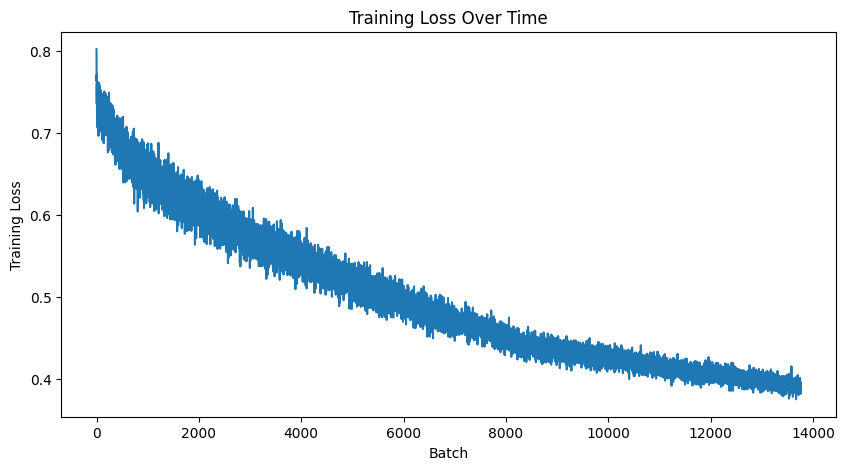

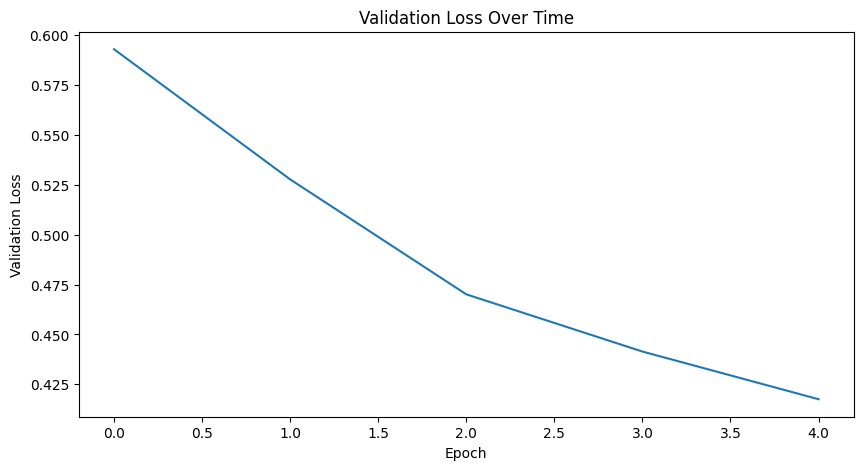

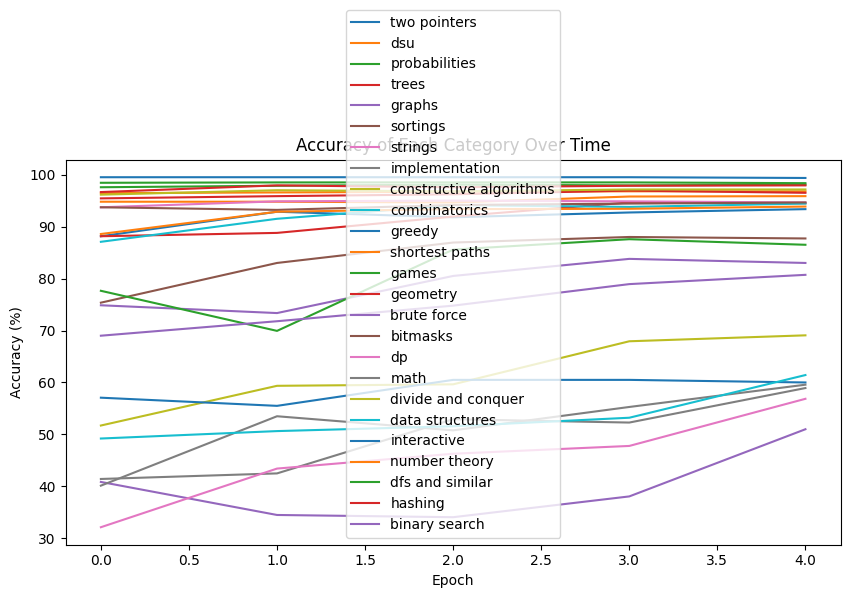

Average Accuracy for Epoch 1: 76.95%
Average Accuracy for Epoch 2: 78.78%
Average Accuracy for Epoch 3: 80.88%
Average Accuracy for Epoch 4: 82.31%
Average Accuracy for Epoch 5: 84.01%


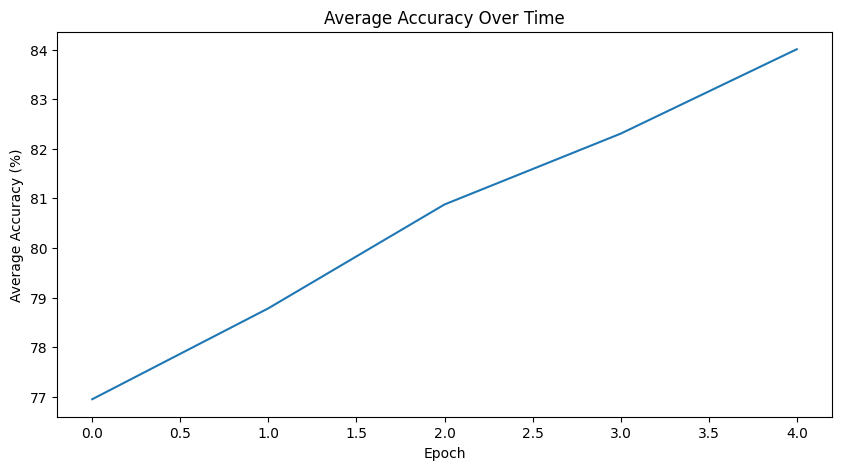

In [14]:
# prompt: make 3 charts, one the training loss over time, one the validation loss for each epoch and another with the accuracy rates of each category over each epoch label the categories by their true names found in index_to_tag

# Plot training loss over time
plt.figure(figsize=(10, 5))
plt.plot(total_losses)
plt.xlabel('Batch')
plt.ylabel('Training Loss')
plt.title('Training Loss Over Time')
plt.show()

# Plot validation loss for each epoch
plt.figure(figsize=(10, 5))
plt.plot(val_losses)
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.title('Validation Loss Over Time')
plt.show()

# Plot accuracy rates of each category over epochs
plt.figure(figsize=(10, 5))
for i in range(n):
  accuracies = [epoch_accuracies[i] for epoch_accuracies in val_acc]
  plt.plot(accuracies, label=index_to_tag[i])

plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy of Each Category Over Time')
plt.legend()
plt.show()
# prompt: now make a new char just for the average accuracy

# Calculate and print the average accuracy across all tags for each epoch
for epoch in range(EPOCHS):
    avg_epoch_accuracy = sum(val_acc[epoch]) / len(val_acc[epoch])
    print(f"Average Accuracy for Epoch {epoch + 1}: {avg_epoch_accuracy:.2f}%")

# Plot the average accuracy over epochs
plt.figure(figsize=(10, 5))
avg_accuracies = [sum(epoch_accuracies) / len(epoch_accuracies) for epoch_accuracies in val_acc]
plt.plot(avg_accuracies)
plt.xlabel('Epoch')
plt.ylabel('Average Accuracy (%)')
plt.title('Average Accuracy Over Time')
plt.show()